In [ ]:
import click
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO, DDPG
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import (
    DummyVecEnv,
    VecVideoRecorder,
    SubprocVecEnv,
)

import matplotlib.pyplot as plt
import imageio
import os
from stable_baselines3.common.env_util import make_vec_env
from typing import Callable, Dict, List
import torch
from wandb.integration.sb3 import WandbCallback
import wandb
import types

from robot_model import CDPR4_env, MAX_EPISODE_STEPS

import sys
# sys.setrecursionlimit(9_999_999)

In [2]:
def linear_schedule(
    initial_value: float, min_value_percent: float = 0.1
) -> Callable[[float], float]:
    """
    Linear learning rate schedule that decreases from initial_value to
    (initial_value * min_value_percent).

    :param initial_value: Initial learning rate
    :param min_value_percent: Final learning rate as a percentage of initial value (0.1 = 10%)
    :return: schedule that computes current learning rate depending on remaining progress
    """

    def func(progress_remaining: float) -> float:
        """
        Progress will decrease from 1 (beginning) to 0.
        Learning rate will decrease from initial_value to (initial_value * min_value_percent)

        :param progress_remaining: goes from 1 (beginning) to 0 (end)
        :return: current learning rate
        """
        min_value = initial_value * min_value_percent
        return min_value + (initial_value - min_value) * progress_remaining

    return func


def cosine_schedule_with_warmup(
    initial_value: float,
    warmup_fraction: float = 0.03,
    min_value_percent: float = 0.1,
) -> Callable[[float], float]:
    """
    Cosine learning rate schedule with warmup that decreases from initial_value to
    (initial_value * min_value_percent).

    :param initial_value: Initial learning rate after warmup
    :param warmup_fraction: Fraction of total steps to use for warmup (0.1 = 10%)
    :param min_value_percent: Final learning rate as a percentage of initial value (0.1 = 10%)
    :return: schedule that computes current learning rate depending on remaining progress
    """

    def func(progress_remaining: float) -> float:
        """
        Progress will decrease from 1 (beginning) to 0.
        Learning rate will follow:
        1. Linear warmup from 0 to initial_value for warmup_fraction of total steps
        2. Cosine decay from initial_value to (initial_value * min_value_percent)

        :param progress_remaining: goes from 1 (beginning) to 0 (end)
        :return: current learning rate
        """
        progress_done = 1 - progress_remaining
        min_value = initial_value * min_value_percent

        # Handle warmup phase
        if progress_done < warmup_fraction:
            # Linear warmup
            return initial_value * (progress_done / warmup_fraction)

        # Handle cosine decay phase
        progress_after_warmup = (progress_done - warmup_fraction) / (
            1 - warmup_fraction
        )
        cosine_decay = 0.5 * (1 + np.cos(np.pi * progress_after_warmup))

        # Interpolate between initial_value and min_value using cosine curve
        return min_value + (initial_value - min_value) * cosine_decay

    return func


def get_images(self):
    self.remotes[0].send(("render", None))
    return [self.remotes[0].recv()]


In [3]:
def make_env():
    env = Monitor(CDPR4_env())
    return env

In [4]:

def train_model(
    activation_fn: str = "ReLU",
    net_arch: Dict[str, List[int]] = dict(
        pi=[512, 512],
        vf=[512, 512],
    ),
    lr_initial_value: float = 8e-4,
    warmup_fraction: float = 0.01,
    min_value_percent: float = 0.1,
    batch_size: int = 32,
    n_epochs: int = 5,
    gamma: float = 0.99,
    gae_lambda: float = 0.95,
    clip_range: float = 0.2,
    max_grad_norm: float = 100.0,
    use_sde: bool = False,
    sde_sample_freq: int = -1,
    ent_coef: float = 0.0005,
    # Training parameters
    total_timesteps: int = 1_000_000,
    log_interval: int = 1,
    progress_bar: bool = True,
    record_video: bool = False,
    device: str = "cpu",
):
    activation_fn_map = {
        "ReLU": torch.nn.ReLU,
        "Tanh": torch.nn.Tanh,
        "LeakyReLU": torch.nn.LeakyReLU,
    }
    activation_fn = activation_fn_map[activation_fn]

    env = make_vec_env(
        lambda: make_env(),
        n_envs=int(4),
        vec_env_cls=SubprocVecEnv,
    )
    env.get_images = types.MethodType(get_images, env)
    if record_video:
        env = VecVideoRecorder(
            env,
            f"videos/{wandb.run.id}",
            record_video_trigger=lambda x: x % 100 == 0,
            video_length=MAX_EPISODE_STEPS * 3,
        )

    policy_kwargs = dict(
        log_std_init=-2.0,
        ortho_init=False,
        activation_fn=activation_fn,
        net_arch=net_arch,
    )

    # model = DDPG(
    #     policy="MlpPolicy",
    #     env=env,
    #     # learning_rate=cosine_schedule_with_warmup(
    #     #     initial_value=lr_initial_value,
    #     #     warmup_fraction=warmup_fraction,
    #     #     min_value_percent=min_value_percent,
    #     # ),
    #     device=device,
    #     tensorboard_log="./ddpg_cdpr4_tensorboard/",
    # )

    model = PPO(
        "MlpPolicy",  # Multi-Layer Perceptron policy
        env,
        learning_rate=cosine_schedule_with_warmup(
            initial_value=lr_initial_value,
            warmup_fraction=warmup_fraction,
            min_value_percent=min_value_percent,
        ),
        n_steps=MAX_EPISODE_STEPS,  # Number of steps to run for each environment per update
        batch_size=batch_size,  # Minibatch size
        n_epochs=n_epochs,
        gamma=gamma,  # Discount factor
        gae_lambda=gae_lambda,  # GAE parameter
        clip_range=clip_range,  # Clipping parameter
        max_grad_norm=max_grad_norm,
        use_sde=use_sde,
        sde_sample_freq=sde_sample_freq,
        ent_coef=ent_coef,
        verbose=1,
        tensorboard_log="./ppo_cdpr4_tensorboard/",
        device=device,
        policy_kwargs=policy_kwargs,
    )

    model.learn(
        total_timesteps=total_timesteps,
        log_interval=log_interval,
        progress_bar=progress_bar,
        callback=WandbCallback(
            verbose=2,
        ),
    )

    return model

In [5]:
def train_single():
    run = wandb.init(
        project="sb3",
        sync_tensorboard=True,
        monitor_gym=True,
    )
    model = train_model(
        record_video=False,
        total_timesteps=1_000_000,
        device="cpu",
    )
    # Save the trained model
    save_path = f"models/{wandb.run.id}/ppo_cdpr4_model"
    model.save(save_path)
    print(f"Model Saved as '{save_path}.zip'.")

    # Directory to save GIFs
    gif_dir = f"cdpr4_gifs/{wandb.run.id}"
    os.makedirs(gif_dir, exist_ok=True)

    # Testing parameters
    num_test_episodes = 5
    max_test_steps = MAX_EPISODE_STEPS  # Adjusted for visualization
    render_every_n = 1  # Render every 1 episode

    env = make_env()
    env = DummyVecEnv([lambda: env])

    # Test the model with a few episodes and create GIFs
    print("Starting Testing Episodes with Visualization...")
    for episode in range(num_test_episodes):
        obs = env.reset()
        done = False
        total_reward = 0
        frames = []  # List to store frames for the GIF
        step_count = 0  # Initialize step counter

        while not done and step_count < max_test_steps:
            action, _states = model.predict(obs, deterministic=True)
            step_result = env.step(action)
            obs, reward, done, info = step_result
            total_reward += reward[0]
            done = done[0]
            if step_count % render_every_n == 0 or done:
                frame = env.envs[0].env.render(reward=reward[0], mode="rgb_array")
                frames.append(frame)
            step_count += 1

        print(
            f"Episode {episode + 1}: Total Reward = {total_reward}, Done: {done}, Steps: {step_count}"
        )
        print(f"Final observation: {obs}")

        gif_path = os.path.join(gif_dir, f"episode_{episode + 1}.gif")
        imageio.mimsave(gif_path, frames, fps=1)
        print(f"Saved GIF to {gif_path}")



wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: damurka (damurka-innopolis-university). Use `wandb login --relogin` to force relogin


Using cpu device
Logging to ./ppo_cdpr4_tensorboard/PPO_3


Output()

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 14.7     |
|    ep_rew_mean     | -33.7    |
| time/              |          |
|    fps             | 1029     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 128      |
---------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 15.1          |
|    ep_rew_mean          | -27.9         |
| time/                   |               |
|    fps                  | 860           |
|    iterations           | 2             |
|    time_elapsed         | 0             |
|    total_timesteps      | 256           |
| train/                  |               |
|    approx_kl            | 0.00085584866 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -9.55         |
|    explained_variance   | 0.000536      |
|    learning_rate        | 1.02e-05      |
|    loss                 | 131           |
|    n_updates            | 5             |
|    policy_gradient_loss | -0.0144       |
|    value_loss           | 312           |
-------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 14.8         |
|    ep_rew_mean          | -26.3        |
| time/                   |              |
|    fps                  | 832          |
|    iterations           | 3            |
|    time_elapsed         | 0            |
|    total_timesteps      | 384          |
| train/                  |              |
|    approx_kl            | 0.0022260565 |
|    clip_fraction        | 0.00156      |
|    clip_range           | 0.2          |
|    entropy_loss         | -9.55        |
|    explained_variance   | -0.00413     |
|    learning_rate        | 2.05e-05     |
|    loss                 | 71.2         |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.0182      |
|    value_loss           | 122          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 14.4         |
|    ep_rew_mean          | -26          |
| time/                   |              |
|    fps                  | 814          |
|    iterations           | 4            |
|    time_elapsed         | 0            |
|    total_timesteps      | 512          |
| train/                  |              |
|    approx_kl            | 0.0025716573 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -9.55        |
|    explained_variance   | -0.0112      |
|    learning_rate        | 3.07e-05     |
|    loss                 | 61           |
|    n_updates            | 15           |
|    policy_gradient_loss | -0.0203      |
|    value_loss           | 165          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 15.2        |
|    ep_rew_mean          | -27         |
| time/                   |             |
|    fps                  | 799         |
|    iterations           | 5           |
|    time_elapsed         | 0           |
|    total_timesteps      | 640         |
| train/                  |             |
|    approx_kl            | 0.005718611 |
|    clip_fraction        | 0.0156      |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.55       |
|    explained_variance   | -0.0155     |
|    learning_rate        | 4.1e-05     |
|    loss                 | 77.3        |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.0293     |
|    value_loss           | 171         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 15.5        |
|    ep_rew_mean          | -27.2       |
| time/                   |             |
|    fps                  | 795         |
|    iterations           | 6           |
|    time_elapsed         | 0           |
|    total_timesteps      | 768         |
| train/                  |             |
|    approx_kl            | 0.016796682 |
|    clip_fraction        | 0.0984      |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.53       |
|    explained_variance   | -0.0136     |
|    learning_rate        | 5.12e-05    |
|    loss                 | 85.4        |
|    n_updates            | 25          |
|    policy_gradient_loss | -0.05       |
|    value_loss           | 167         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 15.3        |
|    ep_rew_mean          | -27.7       |
| time/                   |             |
|    fps                  | 795         |
|    iterations           | 7           |
|    time_elapsed         | 1           |
|    total_timesteps      | 896         |
| train/                  |             |
|    approx_kl            | 0.014710744 |
|    clip_fraction        | 0.0781      |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.51       |
|    explained_variance   | -0.0538     |
|    learning_rate        | 6.14e-05    |
|    loss                 | 73.6        |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.0443     |
|    value_loss           | 165         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 15.2        |
|    ep_rew_mean          | -27.6       |
| time/                   |             |
|    fps                  | 792         |
|    iterations           | 8           |
|    time_elapsed         | 1           |
|    total_timesteps      | 1024        |
| train/                  |             |
|    approx_kl            | 0.011485473 |
|    clip_fraction        | 0.0547      |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.5        |
|    explained_variance   | -0.0978     |
|    learning_rate        | 7.17e-05    |
|    loss                 | 28.4        |
|    n_updates            | 35          |
|    policy_gradient_loss | -0.0395     |
|    value_loss           | 286         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 15.4         |
|    ep_rew_mean          | -27.2        |
| time/                   |              |
|    fps                  | 790          |
|    iterations           | 9            |
|    time_elapsed         | 1            |
|    total_timesteps      | 1152         |
| train/                  |              |
|    approx_kl            | 0.0135745555 |
|    clip_fraction        | 0.0797       |
|    clip_range           | 0.2          |
|    entropy_loss         | -9.46        |
|    explained_variance   | -0.112       |
|    learning_rate        | 8.19e-05     |
|    loss                 | 81.7         |
|    n_updates            | 40           |
|    policy_gradient_loss | -0.0465      |
|    value_loss           | 141          |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 15         |
|    ep_rew_mean          | -26.5      |
| time/                   |            |
|    fps                  | 789        |
|    iterations           | 10         |
|    time_elapsed         | 1          |
|    total_timesteps      | 1280       |
| train/                  |            |
|    approx_kl            | 0.02205779 |
|    clip_fraction        | 0.123      |
|    clip_range           | 0.2        |
|    entropy_loss         | -9.46      |
|    explained_variance   | -0.15      |
|    learning_rate        | 9.22e-05   |
|    loss                 | 91         |
|    n_updates            | 45         |
|    policy_gradient_loss | -0.0516    |
|    value_loss           | 184        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 14.9        |
|    ep_rew_mean          | -27.3       |
| time/                   |             |
|    fps                  | 789         |
|    iterations           | 11          |
|    time_elapsed         | 1           |
|    total_timesteps      | 1408        |
| train/                  |             |
|    approx_kl            | 0.021664612 |
|    clip_fraction        | 0.133       |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.44       |
|    explained_variance   | -0.182      |
|    learning_rate        | 0.000102    |
|    loss                 | 95          |
|    n_updates            | 50          |
|    policy_gradient_loss | -0.0571     |
|    value_loss           | 115         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 15          |
|    ep_rew_mean          | -26.8       |
| time/                   |             |
|    fps                  | 766         |
|    iterations           | 12          |
|    time_elapsed         | 2           |
|    total_timesteps      | 1536        |
| train/                  |             |
|    approx_kl            | 0.021286886 |
|    clip_fraction        | 0.123       |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.44       |
|    explained_variance   | -0.0999     |
|    learning_rate        | 0.000113    |
|    loss                 | 65.1        |
|    n_updates            | 55          |
|    policy_gradient_loss | -0.0458     |
|    value_loss           | 205         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 14.7       |
|    ep_rew_mean          | -27.1      |
| time/                   |            |
|    fps                  | 766        |
|    iterations           | 13         |
|    time_elapsed         | 2          |
|    total_timesteps      | 1664       |
| train/                  |            |
|    approx_kl            | 0.03659258 |
|    clip_fraction        | 0.234      |
|    clip_range           | 0.2        |
|    entropy_loss         | -9.4       |
|    explained_variance   | -0.17      |
|    learning_rate        | 0.000123   |
|    loss                 | 65.7       |
|    n_updates            | 60         |
|    policy_gradient_loss | -0.0634    |
|    value_loss           | 135        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 14.4        |
|    ep_rew_mean          | -26.2       |
| time/                   |             |
|    fps                  | 767         |
|    iterations           | 14          |
|    time_elapsed         | 2           |
|    total_timesteps      | 1792        |
| train/                  |             |
|    approx_kl            | 0.029710144 |
|    clip_fraction        | 0.178       |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.42       |
|    explained_variance   | -0.245      |
|    learning_rate        | 0.000133    |
|    loss                 | 92.6        |
|    n_updates            | 65          |
|    policy_gradient_loss | -0.0551     |
|    value_loss           | 187         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 14.3        |
|    ep_rew_mean          | -24.8       |
| time/                   |             |
|    fps                  | 768         |
|    iterations           | 15          |
|    time_elapsed         | 2           |
|    total_timesteps      | 1920        |
| train/                  |             |
|    approx_kl            | 0.031512223 |
|    clip_fraction        | 0.233       |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.34       |
|    explained_variance   | -0.063      |
|    learning_rate        | 0.000143    |
|    loss                 | 41.9        |
|    n_updates            | 70          |
|    policy_gradient_loss | -0.0626     |
|    value_loss           | 150         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 14         |
|    ep_rew_mean          | -24.8      |
| time/                   |            |
|    fps                  | 769        |
|    iterations           | 16         |
|    time_elapsed         | 2          |
|    total_timesteps      | 2048       |
| train/                  |            |
|    approx_kl            | 0.05037522 |
|    clip_fraction        | 0.323      |
|    clip_range           | 0.2        |
|    entropy_loss         | -9.3       |
|    explained_variance   | -0.0287    |
|    learning_rate        | 0.000154   |
|    loss                 | 59.1       |
|    n_updates            | 75         |
|    policy_gradient_loss | -0.0666    |
|    value_loss           | 136        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 13.8        |
|    ep_rew_mean          | -24.6       |
| time/                   |             |
|    fps                  | 770         |
|    iterations           | 17          |
|    time_elapsed         | 2           |
|    total_timesteps      | 2176        |
| train/                  |             |
|    approx_kl            | 0.041119277 |
|    clip_fraction        | 0.272       |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.33       |
|    explained_variance   | 0.0237      |
|    learning_rate        | 0.000164    |
|    loss                 | 37.2        |
|    n_updates            | 80          |
|    policy_gradient_loss | -0.0658     |
|    value_loss           | 112         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 13.8        |
|    ep_rew_mean          | -24.5       |
| time/                   |             |
|    fps                  | 771         |
|    iterations           | 18          |
|    time_elapsed         | 2           |
|    total_timesteps      | 2304        |
| train/                  |             |
|    approx_kl            | 0.028691653 |
|    clip_fraction        | 0.159       |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.34       |
|    explained_variance   | 0.069       |
|    learning_rate        | 0.000174    |
|    loss                 | 120         |
|    n_updates            | 85          |
|    policy_gradient_loss | -0.0564     |
|    value_loss           | 319         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 13.7       |
|    ep_rew_mean          | -25.3      |
| time/                   |            |
|    fps                  | 772        |
|    iterations           | 19         |
|    time_elapsed         | 3          |
|    total_timesteps      | 2432       |
| train/                  |            |
|    approx_kl            | 0.05291777 |
|    clip_fraction        | 0.323      |
|    clip_range           | 0.2        |
|    entropy_loss         | -9.27      |
|    explained_variance   | -0.0545    |
|    learning_rate        | 0.000184   |
|    loss                 | 64.6       |
|    n_updates            | 90         |
|    policy_gradient_loss | -0.0702    |
|    value_loss           | 185        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 13.3       |
|    ep_rew_mean          | -24.5      |
| time/                   |            |
|    fps                  | 772        |
|    iterations           | 20         |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.06892504 |
|    clip_fraction        | 0.342      |
|    clip_range           | 0.2        |
|    entropy_loss         | -9.22      |
|    explained_variance   | -0.114     |
|    learning_rate        | 0.000195   |
|    loss                 | 78         |
|    n_updates            | 95         |
|    policy_gradient_loss | -0.0717    |
|    value_loss           | 188        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 13.4       |
|    ep_rew_mean          | -24.8      |
| time/                   |            |
|    fps                  | 773        |
|    iterations           | 21         |
|    time_elapsed         | 3          |
|    total_timesteps      | 2688       |
| train/                  |            |
|    approx_kl            | 0.06774739 |
|    clip_fraction        | 0.366      |
|    clip_range           | 0.2        |
|    entropy_loss         | -9.16      |
|    explained_variance   | 0.44       |
|    learning_rate        | 0.000205   |
|    loss                 | 29.3       |
|    n_updates            | 100        |
|    policy_gradient_loss | -0.0757    |
|    value_loss           | 66.2       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 13         |
|    ep_rew_mean          | -24        |
| time/                   |            |
|    fps                  | 772        |
|    iterations           | 22         |
|    time_elapsed         | 3          |
|    total_timesteps      | 2816       |
| train/                  |            |
|    approx_kl            | 0.09492278 |
|    clip_fraction        | 0.411      |
|    clip_range           | 0.2        |
|    entropy_loss         | -9.16      |
|    explained_variance   | 0.191      |
|    learning_rate        | 0.000215   |
|    loss                 | 48.8       |
|    n_updates            | 105        |
|    policy_gradient_loss | -0.0855    |
|    value_loss           | 138        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 13.1       |
|    ep_rew_mean          | -22.8      |
| time/                   |            |
|    fps                  | 760        |
|    iterations           | 23         |
|    time_elapsed         | 3          |
|    total_timesteps      | 2944       |
| train/                  |            |
|    approx_kl            | 0.10836313 |
|    clip_fraction        | 0.419      |
|    clip_range           | 0.2        |
|    entropy_loss         | -9.12      |
|    explained_variance   | 0.341      |
|    learning_rate        | 0.000225   |
|    loss                 | 45.4       |
|    n_updates            | 110        |
|    policy_gradient_loss | -0.086     |
|    value_loss           | 89.3       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 13.2       |
|    ep_rew_mean          | -22.7      |
| time/                   |            |
|    fps                  | 762        |
|    iterations           | 24         |
|    time_elapsed         | 4          |
|    total_timesteps      | 3072       |
| train/                  |            |
|    approx_kl            | 0.16560166 |
|    clip_fraction        | 0.522      |
|    clip_range           | 0.2        |
|    entropy_loss         | -8.94      |
|    explained_variance   | 0.495      |
|    learning_rate        | 0.000236   |
|    loss                 | 35.1       |
|    n_updates            | 115        |
|    policy_gradient_loss | -0.0958    |
|    value_loss           | 70.2       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 13.2      |
|    ep_rew_mean          | -23.5     |
| time/                   |           |
|    fps                  | 762       |
|    iterations           | 25        |
|    time_elapsed         | 4         |
|    total_timesteps      | 3200      |
| train/                  |           |
|    approx_kl            | 0.0990272 |
|    clip_fraction        | 0.464     |
|    clip_range           | 0.2       |
|    entropy_loss         | -8.94     |
|    explained_variance   | 0.147     |
|    learning_rate        | 0.000246  |
|    loss                 | 45.7      |
|    n_updates            | 120       |
|    policy_gradient_loss | -0.0778   |
|    value_loss           | 84.8      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 13          |
|    ep_rew_mean          | -23.9       |
| time/                   |             |
|    fps                  | 763         |
|    iterations           | 26          |
|    time_elapsed         | 4           |
|    total_timesteps      | 3328        |
| train/                  |             |
|    approx_kl            | 0.117951736 |
|    clip_fraction        | 0.452       |
|    clip_range           | 0.2         |
|    entropy_loss         | -8.89       |
|    explained_variance   | 0.296       |
|    learning_rate        | 0.000256    |
|    loss                 | 29.3        |
|    n_updates            | 125         |
|    policy_gradient_loss | -0.0845     |
|    value_loss           | 51.8        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.9       |
|    ep_rew_mean          | -23.3      |
| time/                   |            |
|    fps                  | 764        |
|    iterations           | 27         |
|    time_elapsed         | 4          |
|    total_timesteps      | 3456       |
| train/                  |            |
|    approx_kl            | 0.08925362 |
|    clip_fraction        | 0.481      |
|    clip_range           | 0.2        |
|    entropy_loss         | -8.94      |
|    explained_variance   | 0.211      |
|    learning_rate        | 0.000266   |
|    loss                 | 76.7       |
|    n_updates            | 130        |
|    policy_gradient_loss | -0.0772    |
|    value_loss           | 120        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.7       |
|    ep_rew_mean          | -22.5      |
| time/                   |            |
|    fps                  | 765        |
|    iterations           | 28         |
|    time_elapsed         | 4          |
|    total_timesteps      | 3584       |
| train/                  |            |
|    approx_kl            | 0.12950115 |
|    clip_fraction        | 0.502      |
|    clip_range           | 0.2        |
|    entropy_loss         | -8.88      |
|    explained_variance   | 0.439      |
|    learning_rate        | 0.000276   |
|    loss                 | 16.8       |
|    n_updates            | 135        |
|    policy_gradient_loss | -0.0799    |
|    value_loss           | 59.1       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.9       |
|    ep_rew_mean          | -22.3      |
| time/                   |            |
|    fps                  | 766        |
|    iterations           | 29         |
|    time_elapsed         | 4          |
|    total_timesteps      | 3712       |
| train/                  |            |
|    approx_kl            | 0.14067252 |
|    clip_fraction        | 0.544      |
|    clip_range           | 0.2        |
|    entropy_loss         | -8.74      |
|    explained_variance   | 0.526      |
|    learning_rate        | 0.000287   |
|    loss                 | 44.7       |
|    n_updates            | 140        |
|    policy_gradient_loss | -0.083     |
|    value_loss           | 104        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.7       |
|    ep_rew_mean          | -22.2      |
| time/                   |            |
|    fps                  | 766        |
|    iterations           | 30         |
|    time_elapsed         | 5          |
|    total_timesteps      | 3840       |
| train/                  |            |
|    approx_kl            | 0.11599439 |
|    clip_fraction        | 0.486      |
|    clip_range           | 0.2        |
|    entropy_loss         | -8.75      |
|    explained_variance   | 0.131      |
|    learning_rate        | 0.000297   |
|    loss                 | 55.2       |
|    n_updates            | 145        |
|    policy_gradient_loss | -0.0877    |
|    value_loss           | 148        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.7       |
|    ep_rew_mean          | -21.3      |
| time/                   |            |
|    fps                  | 766        |
|    iterations           | 31         |
|    time_elapsed         | 5          |
|    total_timesteps      | 3968       |
| train/                  |            |
|    approx_kl            | 0.11789177 |
|    clip_fraction        | 0.453      |
|    clip_range           | 0.2        |
|    entropy_loss         | -8.69      |
|    explained_variance   | 0.686      |
|    learning_rate        | 0.000307   |
|    loss                 | 21.7       |
|    n_updates            | 150        |
|    policy_gradient_loss | -0.072     |
|    value_loss           | 48.6       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.2       |
|    ep_rew_mean          | -20.2      |
| time/                   |            |
|    fps                  | 767        |
|    iterations           | 32         |
|    time_elapsed         | 5          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.11627357 |
|    clip_fraction        | 0.448      |
|    clip_range           | 0.2        |
|    entropy_loss         | -8.46      |
|    explained_variance   | 0.356      |
|    learning_rate        | 0.000317   |
|    loss                 | 15.1       |
|    n_updates            | 155        |
|    policy_gradient_loss | -0.0685    |
|    value_loss           | 59.6       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.9       |
|    ep_rew_mean          | -21.9      |
| time/                   |            |
|    fps                  | 759        |
|    iterations           | 33         |
|    time_elapsed         | 5          |
|    total_timesteps      | 4224       |
| train/                  |            |
|    approx_kl            | 0.34525448 |
|    clip_fraction        | 0.506      |
|    clip_range           | 0.2        |
|    entropy_loss         | -8.42      |
|    explained_variance   | 0.448      |
|    learning_rate        | 0.000328   |
|    loss                 | 33.1       |
|    n_updates            | 160        |
|    policy_gradient_loss | -0.0807    |
|    value_loss           | 82.7       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | -20.9      |
| time/                   |            |
|    fps                  | 759        |
|    iterations           | 34         |
|    time_elapsed         | 5          |
|    total_timesteps      | 4352       |
| train/                  |            |
|    approx_kl            | 0.13036765 |
|    clip_fraction        | 0.445      |
|    clip_range           | 0.2        |
|    entropy_loss         | -8.33      |
|    explained_variance   | 0.675      |
|    learning_rate        | 0.000338   |
|    loss                 | 17.1       |
|    n_updates            | 165        |
|    policy_gradient_loss | -0.0863    |
|    value_loss           | 55.7       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | -19.8      |
| time/                   |            |
|    fps                  | 760        |
|    iterations           | 35         |
|    time_elapsed         | 5          |
|    total_timesteps      | 4480       |
| train/                  |            |
|    approx_kl            | 0.20290008 |
|    clip_fraction        | 0.531      |
|    clip_range           | 0.2        |
|    entropy_loss         | -8.07      |
|    explained_variance   | 0.407      |
|    learning_rate        | 0.000348   |
|    loss                 | 19.9       |
|    n_updates            | 170        |
|    policy_gradient_loss | -0.0759    |
|    value_loss           | 39.6       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | -18.9      |
| time/                   |            |
|    fps                  | 760        |
|    iterations           | 36         |
|    time_elapsed         | 6          |
|    total_timesteps      | 4608       |
| train/                  |            |
|    approx_kl            | 0.17800516 |
|    clip_fraction        | 0.592      |
|    clip_range           | 0.2        |
|    entropy_loss         | -7.95      |
|    explained_variance   | 0.842      |
|    learning_rate        | 0.000358   |
|    loss                 | 16.1       |
|    n_updates            | 175        |
|    policy_gradient_loss | -0.0769    |
|    value_loss           | 35.9       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | -17.9      |
| time/                   |            |
|    fps                  | 761        |
|    iterations           | 37         |
|    time_elapsed         | 6          |
|    total_timesteps      | 4736       |
| train/                  |            |
|    approx_kl            | 0.20004833 |
|    clip_fraction        | 0.577      |
|    clip_range           | 0.2        |
|    entropy_loss         | -7.75      |
|    explained_variance   | 0.522      |
|    learning_rate        | 0.000369   |
|    loss                 | 12.1       |
|    n_updates            | 180        |
|    policy_gradient_loss | -0.0813    |
|    value_loss           | 47.5       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | -17.4      |
| time/                   |            |
|    fps                  | 761        |
|    iterations           | 38         |
|    time_elapsed         | 6          |
|    total_timesteps      | 4864       |
| train/                  |            |
|    approx_kl            | 0.21323776 |
|    clip_fraction        | 0.597      |
|    clip_range           | 0.2        |
|    entropy_loss         | -7.96      |
|    explained_variance   | 0.69       |
|    learning_rate        | 0.000379   |
|    loss                 | 20.3       |
|    n_updates            | 185        |
|    policy_gradient_loss | -0.0775    |
|    value_loss           | 51.9       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | -19.2      |
| time/                   |            |
|    fps                  | 762        |
|    iterations           | 39         |
|    time_elapsed         | 6          |
|    total_timesteps      | 4992       |
| train/                  |            |
|    approx_kl            | 0.13748425 |
|    clip_fraction        | 0.487      |
|    clip_range           | 0.2        |
|    entropy_loss         | -7.76      |
|    explained_variance   | 0.414      |
|    learning_rate        | 0.000389   |
|    loss                 | 43.8       |
|    n_updates            | 190        |
|    policy_gradient_loss | -0.073     |
|    value_loss           | 84.5       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10.8     |
|    ep_rew_mean          | -20.5    |
| time/                   |          |
|    fps                  | 762      |
|    iterations           | 40       |
|    time_elapsed         | 6        |
|    total_timesteps      | 5120     |
| train/                  |          |
|    approx_kl            | 0.124805 |
|    clip_fraction        | 0.517    |
|    clip_range           | 0.2      |
|    entropy_loss         | -7.79    |
|    explained_variance   | 0.589    |
|    learning_rate        | 0.000399 |
|    loss                 | 18.1     |
|    n_updates            | 195      |
|    policy_gradient_loss | -0.0787  |
|    value_loss           | 69.8     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | -19.9      |
| time/                   |            |
|    fps                  | 763        |
|    iterations           | 41         |
|    time_elapsed         | 6          |
|    total_timesteps      | 5248       |
| train/                  |            |
|    approx_kl            | 0.13174976 |
|    clip_fraction        | 0.489      |
|    clip_range           | 0.2        |
|    entropy_loss         | -7.66      |
|    explained_variance   | 0.625      |
|    learning_rate        | 0.00041    |
|    loss                 | 25         |
|    n_updates            | 200        |
|    policy_gradient_loss | -0.0813    |
|    value_loss           | 65.8       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | -20.6      |
| time/                   |            |
|    fps                  | 764        |
|    iterations           | 42         |
|    time_elapsed         | 7          |
|    total_timesteps      | 5376       |
| train/                  |            |
|    approx_kl            | 0.11875815 |
|    clip_fraction        | 0.544      |
|    clip_range           | 0.2        |
|    entropy_loss         | -7.4       |
|    explained_variance   | 0.56       |
|    learning_rate        | 0.00042    |
|    loss                 | 10.7       |
|    n_updates            | 205        |
|    policy_gradient_loss | -0.0796    |
|    value_loss           | 40.5       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | -21.9      |
| time/                   |            |
|    fps                  | 764        |
|    iterations           | 43         |
|    time_elapsed         | 7          |
|    total_timesteps      | 5504       |
| train/                  |            |
|    approx_kl            | 0.14666653 |
|    clip_fraction        | 0.541      |
|    clip_range           | 0.2        |
|    entropy_loss         | -7.71      |
|    explained_variance   | 0.836      |
|    learning_rate        | 0.00043    |
|    loss                 | 9.62       |
|    n_updates            | 210        |
|    policy_gradient_loss | -0.0738    |
|    value_loss           | 30.2       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | -22       |
| time/                   |           |
|    fps                  | 758       |
|    iterations           | 44        |
|    time_elapsed         | 7         |
|    total_timesteps      | 5632      |
| train/                  |           |
|    approx_kl            | 0.1456577 |
|    clip_fraction        | 0.547     |
|    clip_range           | 0.2       |
|    entropy_loss         | -7.41     |
|    explained_variance   | 0.759     |
|    learning_rate        | 0.00044   |
|    loss                 | 10.7      |
|    n_updates            | 215       |
|    policy_gradient_loss | -0.0869   |
|    value_loss           | 38.9      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | -22.9      |
| time/                   |            |
|    fps                  | 757        |
|    iterations           | 45         |
|    time_elapsed         | 7          |
|    total_timesteps      | 5760       |
| train/                  |            |
|    approx_kl            | 0.18871735 |
|    clip_fraction        | 0.583      |
|    clip_range           | 0.2        |
|    entropy_loss         | -7.2       |
|    explained_variance   | 0.58       |
|    learning_rate        | 0.000451   |
|    loss                 | 13.7       |
|    n_updates            | 220        |
|    policy_gradient_loss | -0.0571    |
|    value_loss           | 91.5       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | -21.5      |
| time/                   |            |
|    fps                  | 758        |
|    iterations           | 46         |
|    time_elapsed         | 7          |
|    total_timesteps      | 5888       |
| train/                  |            |
|    approx_kl            | 0.25260985 |
|    clip_fraction        | 0.616      |
|    clip_range           | 0.2        |
|    entropy_loss         | -7.05      |
|    explained_variance   | 0.68       |
|    learning_rate        | 0.000461   |
|    loss                 | 8.64       |
|    n_updates            | 225        |
|    policy_gradient_loss | -0.0657    |
|    value_loss           | 24.8       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | -21.4      |
| time/                   |            |
|    fps                  | 758        |
|    iterations           | 47         |
|    time_elapsed         | 7          |
|    total_timesteps      | 6016       |
| train/                  |            |
|    approx_kl            | 0.16536519 |
|    clip_fraction        | 0.533      |
|    clip_range           | 0.2        |
|    entropy_loss         | -6.95      |
|    explained_variance   | 0.713      |
|    learning_rate        | 0.000471   |
|    loss                 | 16.7       |
|    n_updates            | 230        |
|    policy_gradient_loss | -0.0735    |
|    value_loss           | 32.9       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | -19.9      |
| time/                   |            |
|    fps                  | 758        |
|    iterations           | 48         |
|    time_elapsed         | 8          |
|    total_timesteps      | 6144       |
| train/                  |            |
|    approx_kl            | 0.20569345 |
|    clip_fraction        | 0.566      |
|    clip_range           | 0.2        |
|    entropy_loss         | -7.02      |
|    explained_variance   | 0.671      |
|    learning_rate        | 0.000481   |
|    loss                 | 9.09       |
|    n_updates            | 235        |
|    policy_gradient_loss | -0.0764    |
|    value_loss           | 28.5       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | -20.4      |
| time/                   |            |
|    fps                  | 758        |
|    iterations           | 49         |
|    time_elapsed         | 8          |
|    total_timesteps      | 6272       |
| train/                  |            |
|    approx_kl            | 0.18432072 |
|    clip_fraction        | 0.555      |
|    clip_range           | 0.2        |
|    entropy_loss         | -7.06      |
|    explained_variance   | 0.451      |
|    learning_rate        | 0.000492   |
|    loss                 | 18         |
|    n_updates            | 240        |
|    policy_gradient_loss | -0.0725    |
|    value_loss           | 50         |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | -20.2      |
| time/                   |            |
|    fps                  | 759        |
|    iterations           | 50         |
|    time_elapsed         | 8          |
|    total_timesteps      | 6400       |
| train/                  |            |
|    approx_kl            | 0.18041775 |
|    clip_fraction        | 0.55       |
|    clip_range           | 0.2        |
|    entropy_loss         | -7.16      |
|    explained_variance   | 0.32       |
|    learning_rate        | 0.000502   |
|    loss                 | 26.3       |
|    n_updates            | 245        |
|    policy_gradient_loss | -0.0779    |
|    value_loss           | 58.8       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | -20.1      |
| time/                   |            |
|    fps                  | 760        |
|    iterations           | 51         |
|    time_elapsed         | 8          |
|    total_timesteps      | 6528       |
| train/                  |            |
|    approx_kl            | 0.14012831 |
|    clip_fraction        | 0.597      |
|    clip_range           | 0.2        |
|    entropy_loss         | -7.2       |
|    explained_variance   | 0.483      |
|    learning_rate        | 0.000512   |
|    loss                 | 12.7       |
|    n_updates            | 250        |
|    policy_gradient_loss | -0.0674    |
|    value_loss           | 36.9       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | -19.3      |
| time/                   |            |
|    fps                  | 760        |
|    iterations           | 52         |
|    time_elapsed         | 8          |
|    total_timesteps      | 6656       |
| train/                  |            |
|    approx_kl            | 0.16352078 |
|    clip_fraction        | 0.516      |
|    clip_range           | 0.2        |
|    entropy_loss         | -7.55      |
|    explained_variance   | 0.741      |
|    learning_rate        | 0.000522   |
|    loss                 | 10.5       |
|    n_updates            | 255        |
|    policy_gradient_loss | -0.0732    |
|    value_loss           | 28.6       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | -18.8     |
| time/                   |           |
|    fps                  | 760       |
|    iterations           | 53        |
|    time_elapsed         | 8         |
|    total_timesteps      | 6784      |
| train/                  |           |
|    approx_kl            | 0.1473363 |
|    clip_fraction        | 0.502     |
|    clip_range           | 0.2       |
|    entropy_loss         | -7.25     |
|    explained_variance   | 0.497     |
|    learning_rate        | 0.000532  |
|    loss                 | 15.4      |
|    n_updates            | 260       |
|    policy_gradient_loss | -0.0619   |
|    value_loss           | 52.2      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | -19.4      |
| time/                   |            |
|    fps                  | 756        |
|    iterations           | 54         |
|    time_elapsed         | 9          |
|    total_timesteps      | 6912       |
| train/                  |            |
|    approx_kl            | 0.15550706 |
|    clip_fraction        | 0.467      |
|    clip_range           | 0.2        |
|    entropy_loss         | -7.18      |
|    explained_variance   | 0.478      |
|    learning_rate        | 0.000543   |
|    loss                 | 40.2       |
|    n_updates            | 265        |
|    policy_gradient_loss | -0.0698    |
|    value_loss           | 109        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | -20.2       |
| time/                   |             |
|    fps                  | 756         |
|    iterations           | 55          |
|    time_elapsed         | 9           |
|    total_timesteps      | 7040        |
| train/                  |             |
|    approx_kl            | 0.121218696 |
|    clip_fraction        | 0.506       |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.29       |
|    explained_variance   | 0.665       |
|    learning_rate        | 0.000553    |
|    loss                 | 14.9        |
|    n_updates            | 270         |
|    policy_gradient_loss | -0.0707     |
|    value_loss           | 47.9        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | -19.6      |
| time/                   |            |
|    fps                  | 757        |
|    iterations           | 56         |
|    time_elapsed         | 9          |
|    total_timesteps      | 7168       |
| train/                  |            |
|    approx_kl            | 0.19654225 |
|    clip_fraction        | 0.483      |
|    clip_range           | 0.2        |
|    entropy_loss         | -7.18      |
|    explained_variance   | 0.141      |
|    learning_rate        | 0.000563   |
|    loss                 | 25.5       |
|    n_updates            | 275        |
|    policy_gradient_loss | -0.0706    |
|    value_loss           | 66.4       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11        |
|    ep_rew_mean          | -18.8     |
| time/                   |           |
|    fps                  | 757       |
|    iterations           | 57        |
|    time_elapsed         | 9         |
|    total_timesteps      | 7296      |
| train/                  |           |
|    approx_kl            | 0.2603299 |
|    clip_fraction        | 0.628     |
|    clip_range           | 0.2       |
|    entropy_loss         | -6.89     |
|    explained_variance   | 0.264     |
|    learning_rate        | 0.000573  |
|    loss                 | 5.95      |
|    n_updates            | 280       |
|    policy_gradient_loss | -0.0817   |
|    value_loss           | 21.3      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | -18.1      |
| time/                   |            |
|    fps                  | 757        |
|    iterations           | 58         |
|    time_elapsed         | 9          |
|    total_timesteps      | 7424       |
| train/                  |            |
|    approx_kl            | 0.21750349 |
|    clip_fraction        | 0.581      |
|    clip_range           | 0.2        |
|    entropy_loss         | -6.95      |
|    explained_variance   | 0.6        |
|    learning_rate        | 0.000584   |
|    loss                 | 11.3       |
|    n_updates            | 285        |
|    policy_gradient_loss | -0.084     |
|    value_loss           | 36.6       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.9      |
|    ep_rew_mean          | -18.3     |
| time/                   |           |
|    fps                  | 757       |
|    iterations           | 59        |
|    time_elapsed         | 9         |
|    total_timesteps      | 7552      |
| train/                  |           |
|    approx_kl            | 0.1626938 |
|    clip_fraction        | 0.505     |
|    clip_range           | 0.2       |
|    entropy_loss         | -7.5      |
|    explained_variance   | 0.584     |
|    learning_rate        | 0.000594  |
|    loss                 | 12.3      |
|    n_updates            | 290       |
|    policy_gradient_loss | -0.0773   |
|    value_loss           | 40.9      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | -18.9      |
| time/                   |            |
|    fps                  | 756        |
|    iterations           | 60         |
|    time_elapsed         | 10         |
|    total_timesteps      | 7680       |
| train/                  |            |
|    approx_kl            | 0.21204676 |
|    clip_fraction        | 0.564      |
|    clip_range           | 0.2        |
|    entropy_loss         | -7         |
|    explained_variance   | 0.759      |
|    learning_rate        | 0.000604   |
|    loss                 | 12.5       |
|    n_updates            | 295        |
|    policy_gradient_loss | -0.0838    |
|    value_loss           | 26.2       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | -18.3      |
| time/                   |            |
|    fps                  | 756        |
|    iterations           | 61         |
|    time_elapsed         | 10         |
|    total_timesteps      | 7808       |
| train/                  |            |
|    approx_kl            | 0.14015312 |
|    clip_fraction        | 0.486      |
|    clip_range           | 0.2        |
|    entropy_loss         | -7.11      |
|    explained_variance   | 0.387      |
|    learning_rate        | 0.000614   |
|    loss                 | 28.8       |
|    n_updates            | 300        |
|    policy_gradient_loss | -0.071     |
|    value_loss           | 83.9       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | -18.1      |
| time/                   |            |
|    fps                  | 757        |
|    iterations           | 62         |
|    time_elapsed         | 10         |
|    total_timesteps      | 7936       |
| train/                  |            |
|    approx_kl            | 0.15329874 |
|    clip_fraction        | 0.509      |
|    clip_range           | 0.2        |
|    entropy_loss         | -7.29      |
|    explained_variance   | 0.701      |
|    learning_rate        | 0.000625   |
|    loss                 | 10.1       |
|    n_updates            | 305        |
|    policy_gradient_loss | -0.071     |
|    value_loss           | 16.7       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | -18.9      |
| time/                   |            |
|    fps                  | 758        |
|    iterations           | 63         |
|    time_elapsed         | 10         |
|    total_timesteps      | 8064       |
| train/                  |            |
|    approx_kl            | 0.21112831 |
|    clip_fraction        | 0.564      |
|    clip_range           | 0.2        |
|    entropy_loss         | -7.09      |
|    explained_variance   | 0.667      |
|    learning_rate        | 0.000635   |
|    loss                 | 18.6       |
|    n_updates            | 310        |
|    policy_gradient_loss | -0.0806    |
|    value_loss           | 29.8       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | -18.2      |
| time/                   |            |
|    fps                  | 754        |
|    iterations           | 64         |
|    time_elapsed         | 10         |
|    total_timesteps      | 8192       |
| train/                  |            |
|    approx_kl            | 0.16791031 |
|    clip_fraction        | 0.53       |
|    clip_range           | 0.2        |
|    entropy_loss         | -7.17      |
|    explained_variance   | 0.834      |
|    learning_rate        | 0.000645   |
|    loss                 | 5.37       |
|    n_updates            | 315        |
|    policy_gradient_loss | -0.07      |
|    value_loss           | 16.3       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | -18.4      |
| time/                   |            |
|    fps                  | 754        |
|    iterations           | 65         |
|    time_elapsed         | 11         |
|    total_timesteps      | 8320       |
| train/                  |            |
|    approx_kl            | 0.24772607 |
|    clip_fraction        | 0.677      |
|    clip_range           | 0.2        |
|    entropy_loss         | -6.99      |
|    explained_variance   | 0.737      |
|    learning_rate        | 0.000655   |
|    loss                 | 6.34       |
|    n_updates            | 320        |
|    policy_gradient_loss | -0.0987    |
|    value_loss           | 23.9       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | -18.4     |
| time/                   |           |
|    fps                  | 754       |
|    iterations           | 66        |
|    time_elapsed         | 11        |
|    total_timesteps      | 8448      |
| train/                  |           |
|    approx_kl            | 0.1959016 |
|    clip_fraction        | 0.595     |
|    clip_range           | 0.2       |
|    entropy_loss         | -6.83     |
|    explained_variance   | 0.746     |
|    learning_rate        | 0.000666  |
|    loss                 | 6.93      |
|    n_updates            | 325       |
|    policy_gradient_loss | -0.0814   |
|    value_loss           | 23.3      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | -18.7      |
| time/                   |            |
|    fps                  | 755        |
|    iterations           | 67         |
|    time_elapsed         | 11         |
|    total_timesteps      | 8576       |
| train/                  |            |
|    approx_kl            | 0.25648633 |
|    clip_fraction        | 0.65       |
|    clip_range           | 0.2        |
|    entropy_loss         | -7.06      |
|    explained_variance   | 0.858      |
|    learning_rate        | 0.000676   |
|    loss                 | 12.4       |
|    n_updates            | 330        |
|    policy_gradient_loss | -0.0848    |
|    value_loss           | 21         |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | -18.1      |
| time/                   |            |
|    fps                  | 755        |
|    iterations           | 68         |
|    time_elapsed         | 11         |
|    total_timesteps      | 8704       |
| train/                  |            |
|    approx_kl            | 0.18082319 |
|    clip_fraction        | 0.617      |
|    clip_range           | 0.2        |
|    entropy_loss         | -7.37      |
|    explained_variance   | 0.795      |
|    learning_rate        | 0.000686   |
|    loss                 | 11         |
|    n_updates            | 335        |
|    policy_gradient_loss | -0.0816    |
|    value_loss           | 21.5       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | -18.6      |
| time/                   |            |
|    fps                  | 756        |
|    iterations           | 69         |
|    time_elapsed         | 11         |
|    total_timesteps      | 8832       |
| train/                  |            |
|    approx_kl            | 0.21030645 |
|    clip_fraction        | 0.512      |
|    clip_range           | 0.2        |
|    entropy_loss         | -7.36      |
|    explained_variance   | 0.721      |
|    learning_rate        | 0.000696   |
|    loss                 | 7.19       |
|    n_updates            | 340        |
|    policy_gradient_loss | -0.0772    |
|    value_loss           | 22.2       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | -18.6      |
| time/                   |            |
|    fps                  | 756        |
|    iterations           | 70         |
|    time_elapsed         | 11         |
|    total_timesteps      | 8960       |
| train/                  |            |
|    approx_kl            | 0.28372905 |
|    clip_fraction        | 0.623      |
|    clip_range           | 0.2        |
|    entropy_loss         | -6.83      |
|    explained_variance   | 0.865      |
|    learning_rate        | 0.000707   |
|    loss                 | 5.46       |
|    n_updates            | 345        |
|    policy_gradient_loss | -0.0819    |
|    value_loss           | 19.9       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | -17.3      |
| time/                   |            |
|    fps                  | 756        |
|    iterations           | 71         |
|    time_elapsed         | 12         |
|    total_timesteps      | 9088       |
| train/                  |            |
|    approx_kl            | 0.29724032 |
|    clip_fraction        | 0.631      |
|    clip_range           | 0.2        |
|    entropy_loss         | -6.78      |
|    explained_variance   | 0.85       |
|    learning_rate        | 0.000717   |
|    loss                 | 5.12       |
|    n_updates            | 350        |
|    policy_gradient_loss | -0.0643    |
|    value_loss           | 11.6       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10.6     |
|    ep_rew_mean          | -17.3    |
| time/                   |          |
|    fps                  | 756      |
|    iterations           | 72       |
|    time_elapsed         | 12       |
|    total_timesteps      | 9216     |
| train/                  |          |
|    approx_kl            | 0.13496  |
|    clip_fraction        | 0.575    |
|    clip_range           | 0.2      |
|    entropy_loss         | -6.28    |
|    explained_variance   | 0.735    |
|    learning_rate        | 0.000727 |
|    loss                 | 4.44     |
|    n_updates            | 355      |
|    policy_gradient_loss | -0.0734  |
|    value_loss           | 17.9     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | -17.9      |
| time/                   |            |
|    fps                  | 756        |
|    iterations           | 73         |
|    time_elapsed         | 12         |
|    total_timesteps      | 9344       |
| train/                  |            |
|    approx_kl            | 0.34623283 |
|    clip_fraction        | 0.623      |
|    clip_range           | 0.2        |
|    entropy_loss         | -5.55      |
|    explained_variance   | 0.759      |
|    learning_rate        | 0.000737   |
|    loss                 | 10.3       |
|    n_updates            | 360        |
|    policy_gradient_loss | -0.0571    |
|    value_loss           | 21.7       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | -18        |
| time/                   |            |
|    fps                  | 756        |
|    iterations           | 74         |
|    time_elapsed         | 12         |
|    total_timesteps      | 9472       |
| train/                  |            |
|    approx_kl            | 0.30137154 |
|    clip_fraction        | 0.658      |
|    clip_range           | 0.2        |
|    entropy_loss         | -6.17      |
|    explained_variance   | 0.604      |
|    learning_rate        | 0.000748   |
|    loss                 | 11.7       |
|    n_updates            | 365        |
|    policy_gradient_loss | -0.0697    |
|    value_loss           | 22.2       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | -16.6      |
| time/                   |            |
|    fps                  | 753        |
|    iterations           | 75         |
|    time_elapsed         | 12         |
|    total_timesteps      | 9600       |
| train/                  |            |
|    approx_kl            | 0.26895955 |
|    clip_fraction        | 0.6        |
|    clip_range           | 0.2        |
|    entropy_loss         | -6.03      |
|    explained_variance   | 0.459      |
|    learning_rate        | 0.000758   |
|    loss                 | 7.04       |
|    n_updates            | 370        |
|    policy_gradient_loss | -0.0653    |
|    value_loss           | 37.4       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | -16.3     |
| time/                   |           |
|    fps                  | 754       |
|    iterations           | 76        |
|    time_elapsed         | 12        |
|    total_timesteps      | 9728      |
| train/                  |           |
|    approx_kl            | 0.2828219 |
|    clip_fraction        | 0.573     |
|    clip_range           | 0.2       |
|    entropy_loss         | -6        |
|    explained_variance   | 0.784     |
|    learning_rate        | 0.000768  |
|    loss                 | 8.91      |
|    n_updates            | 375       |
|    policy_gradient_loss | -0.0583   |
|    value_loss           | 25.7      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | -15.3      |
| time/                   |            |
|    fps                  | 754        |
|    iterations           | 77         |
|    time_elapsed         | 13         |
|    total_timesteps      | 9856       |
| train/                  |            |
|    approx_kl            | 0.21093771 |
|    clip_fraction        | 0.567      |
|    clip_range           | 0.2        |
|    entropy_loss         | -5.84      |
|    explained_variance   | 0.719      |
|    learning_rate        | 0.000778   |
|    loss                 | 5.99       |
|    n_updates            | 380        |
|    policy_gradient_loss | -0.0675    |
|    value_loss           | 23.9       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | -14.7     |
| time/                   |           |
|    fps                  | 754       |
|    iterations           | 78        |
|    time_elapsed         | 13        |
|    total_timesteps      | 9984      |
| train/                  |           |
|    approx_kl            | 0.2495628 |
|    clip_fraction        | 0.622     |
|    clip_range           | 0.2       |
|    entropy_loss         | -5.88     |
|    explained_variance   | 0.891     |
|    learning_rate        | 0.000788  |
|    loss                 | 7.98      |
|    n_updates            | 385       |
|    policy_gradient_loss | -0.0763   |
|    value_loss           | 16.5      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | -15.2      |
| time/                   |            |
|    fps                  | 755        |
|    iterations           | 79         |
|    time_elapsed         | 13         |
|    total_timesteps      | 10112      |
| train/                  |            |
|    approx_kl            | 0.21735209 |
|    clip_fraction        | 0.594      |
|    clip_range           | 0.2        |
|    entropy_loss         | -5.91      |
|    explained_variance   | 0.846      |
|    learning_rate        | 0.000799   |
|    loss                 | 5.06       |
|    n_updates            | 390        |
|    policy_gradient_loss | -0.0522    |
|    value_loss           | 16.9       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | -15.6     |
| time/                   |           |
|    fps                  | 755       |
|    iterations           | 80        |
|    time_elapsed         | 13        |
|    total_timesteps      | 10240     |
| train/                  |           |
|    approx_kl            | 0.3103695 |
|    clip_fraction        | 0.631     |
|    clip_range           | 0.2       |
|    entropy_loss         | -5.93     |
|    explained_variance   | 0.848     |
|    learning_rate        | 0.0008    |
|    loss                 | 3.94      |
|    n_updates            | 395       |
|    policy_gradient_loss | -0.0627   |
|    value_loss           | 16.4      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | -15.9      |
| time/                   |            |
|    fps                  | 756        |
|    iterations           | 81         |
|    time_elapsed         | 13         |
|    total_timesteps      | 10368      |
| train/                  |            |
|    approx_kl            | 0.38504022 |
|    clip_fraction        | 0.678      |
|    clip_range           | 0.2        |
|    entropy_loss         | -6.03      |
|    explained_variance   | 0.888      |
|    learning_rate        | 0.0008     |
|    loss                 | 4.83       |
|    n_updates            | 400        |
|    policy_gradient_loss | -0.0709    |
|    value_loss           | 15.6       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.95       |
|    ep_rew_mean          | -16.3      |
| time/                   |            |
|    fps                  | 756        |
|    iterations           | 82         |
|    time_elapsed         | 13         |
|    total_timesteps      | 10496      |
| train/                  |            |
|    approx_kl            | 0.18371765 |
|    clip_fraction        | 0.548      |
|    clip_range           | 0.2        |
|    entropy_loss         | -5.96      |
|    explained_variance   | 0.843      |
|    learning_rate        | 0.0008     |
|    loss                 | 3.88       |
|    n_updates            | 405        |
|    policy_gradient_loss | -0.0795    |
|    value_loss           | 13.7       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.96       |
|    ep_rew_mean          | -16.5      |
| time/                   |            |
|    fps                  | 756        |
|    iterations           | 83         |
|    time_elapsed         | 14         |
|    total_timesteps      | 10624      |
| train/                  |            |
|    approx_kl            | 0.22482987 |
|    clip_fraction        | 0.592      |
|    clip_range           | 0.2        |
|    entropy_loss         | -5.97      |
|    explained_variance   | 0.873      |
|    learning_rate        | 0.0008     |
|    loss                 | 3.89       |
|    n_updates            | 410        |
|    policy_gradient_loss | -0.0778    |
|    value_loss           | 16.5       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.9       |
|    ep_rew_mean          | -17.3     |
| time/                   |           |
|    fps                  | 756       |
|    iterations           | 84        |
|    time_elapsed         | 14        |
|    total_timesteps      | 10752     |
| train/                  |           |
|    approx_kl            | 0.2939125 |
|    clip_fraction        | 0.594     |
|    clip_range           | 0.2       |
|    entropy_loss         | -5.85     |
|    explained_variance   | 0.546     |
|    learning_rate        | 0.0008    |
|    loss                 | 6.31      |
|    n_updates            | 415       |
|    policy_gradient_loss | -0.0886   |
|    value_loss           | 19        |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.97       |
|    ep_rew_mean          | -17        |
| time/                   |            |
|    fps                  | 753        |
|    iterations           | 85         |
|    time_elapsed         | 14         |
|    total_timesteps      | 10880      |
| train/                  |            |
|    approx_kl            | 0.32610488 |
|    clip_fraction        | 0.659      |
|    clip_range           | 0.2        |
|    entropy_loss         | -5.81      |
|    explained_variance   | 0.915      |
|    learning_rate        | 0.0008     |
|    loss                 | 3.78       |
|    n_updates            | 420        |
|    policy_gradient_loss | -0.0664    |
|    value_loss           | 11.3       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.98      |
|    ep_rew_mean          | -17.7     |
| time/                   |           |
|    fps                  | 753       |
|    iterations           | 86        |
|    time_elapsed         | 14        |
|    total_timesteps      | 11008     |
| train/                  |           |
|    approx_kl            | 0.3015743 |
|    clip_fraction        | 0.637     |
|    clip_range           | 0.2       |
|    entropy_loss         | -5.62     |
|    explained_variance   | 0.748     |
|    learning_rate        | 0.0008    |
|    loss                 | 5.36      |
|    n_updates            | 425       |
|    policy_gradient_loss | -0.0738   |
|    value_loss           | 18.6      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.82      |
|    ep_rew_mean          | -17.3     |
| time/                   |           |
|    fps                  | 754       |
|    iterations           | 87        |
|    time_elapsed         | 14        |
|    total_timesteps      | 11136     |
| train/                  |           |
|    approx_kl            | 0.3748539 |
|    clip_fraction        | 0.652     |
|    clip_range           | 0.2       |
|    entropy_loss         | -5.57     |
|    explained_variance   | 0.69      |
|    learning_rate        | 0.0008    |
|    loss                 | 15        |
|    n_updates            | 430       |
|    policy_gradient_loss | -0.0723   |
|    value_loss           | 36.6      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.95       |
|    ep_rew_mean          | -17.2      |
| time/                   |            |
|    fps                  | 754        |
|    iterations           | 88         |
|    time_elapsed         | 14         |
|    total_timesteps      | 11264      |
| train/                  |            |
|    approx_kl            | 0.21496573 |
|    clip_fraction        | 0.509      |
|    clip_range           | 0.2        |
|    entropy_loss         | -5.79      |
|    explained_variance   | 0.543      |
|    learning_rate        | 0.0008     |
|    loss                 | 13.9       |
|    n_updates            | 435        |
|    policy_gradient_loss | -0.0797    |
|    value_loss           | 36.9       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | -17.4      |
| time/                   |            |
|    fps                  | 754        |
|    iterations           | 89         |
|    time_elapsed         | 15         |
|    total_timesteps      | 11392      |
| train/                  |            |
|    approx_kl            | 0.22290409 |
|    clip_fraction        | 0.583      |
|    clip_range           | 0.2        |
|    entropy_loss         | -5.51      |
|    explained_variance   | 0.804      |
|    learning_rate        | 0.0008     |
|    loss                 | 3.96       |
|    n_updates            | 440        |
|    policy_gradient_loss | -0.0544    |
|    value_loss           | 19.1       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | -16.8      |
| time/                   |            |
|    fps                  | 754        |
|    iterations           | 90         |
|    time_elapsed         | 15         |
|    total_timesteps      | 11520      |
| train/                  |            |
|    approx_kl            | 0.37402353 |
|    clip_fraction        | 0.598      |
|    clip_range           | 0.2        |
|    entropy_loss         | -5.77      |
|    explained_variance   | 0.808      |
|    learning_rate        | 0.0008     |
|    loss                 | 2.82       |
|    n_updates            | 445        |
|    policy_gradient_loss | -0.0958    |
|    value_loss           | 10.8       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | -16.2     |
| time/                   |           |
|    fps                  | 755       |
|    iterations           | 91        |
|    time_elapsed         | 15        |
|    total_timesteps      | 11648     |
| train/                  |           |
|    approx_kl            | 0.3497293 |
|    clip_fraction        | 0.653     |
|    clip_range           | 0.2       |
|    entropy_loss         | -5.43     |
|    explained_variance   | 0.824     |
|    learning_rate        | 0.0008    |
|    loss                 | 6.54      |
|    n_updates            | 450       |
|    policy_gradient_loss | -0.0644   |
|    value_loss           | 17        |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | -17.1      |
| time/                   |            |
|    fps                  | 755        |
|    iterations           | 92         |
|    time_elapsed         | 15         |
|    total_timesteps      | 11776      |
| train/                  |            |
|    approx_kl            | 0.37100327 |
|    clip_fraction        | 0.623      |
|    clip_range           | 0.2        |
|    entropy_loss         | -5.27      |
|    explained_variance   | 0.83       |
|    learning_rate        | 0.0008     |
|    loss                 | 4.74       |
|    n_updates            | 455        |
|    policy_gradient_loss | -0.0731    |
|    value_loss           | 18.4       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | -18.2      |
| time/                   |            |
|    fps                  | 755        |
|    iterations           | 93         |
|    time_elapsed         | 15         |
|    total_timesteps      | 11904      |
| train/                  |            |
|    approx_kl            | 0.23643313 |
|    clip_fraction        | 0.62       |
|    clip_range           | 0.2        |
|    entropy_loss         | -4.76      |
|    explained_variance   | 0.657      |
|    learning_rate        | 0.0008     |
|    loss                 | 11         |
|    n_updates            | 460        |
|    policy_gradient_loss | -0.0661    |
|    value_loss           | 33.4       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | -17.8      |
| time/                   |            |
|    fps                  | 755        |
|    iterations           | 94         |
|    time_elapsed         | 15         |
|    total_timesteps      | 12032      |
| train/                  |            |
|    approx_kl            | 0.42522115 |
|    clip_fraction        | 0.637      |
|    clip_range           | 0.2        |
|    entropy_loss         | -4.92      |
|    explained_variance   | 0.858      |
|    learning_rate        | 0.0008     |
|    loss                 | 3.83       |
|    n_updates            | 465        |
|    policy_gradient_loss | -0.0705    |
|    value_loss           | 17.3       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | -17.2      |
| time/                   |            |
|    fps                  | 753        |
|    iterations           | 95         |
|    time_elapsed         | 16         |
|    total_timesteps      | 12160      |
| train/                  |            |
|    approx_kl            | 0.29255474 |
|    clip_fraction        | 0.627      |
|    clip_range           | 0.2        |
|    entropy_loss         | -5.13      |
|    explained_variance   | 0.53       |
|    learning_rate        | 0.0008     |
|    loss                 | 4.19       |
|    n_updates            | 470        |
|    policy_gradient_loss | -0.0741    |
|    value_loss           | 18.3       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | -16.8     |
| time/                   |           |
|    fps                  | 753       |
|    iterations           | 96        |
|    time_elapsed         | 16        |
|    total_timesteps      | 12288     |
| train/                  |           |
|    approx_kl            | 0.1905108 |
|    clip_fraction        | 0.537     |
|    clip_range           | 0.2       |
|    entropy_loss         | -5.76     |
|    explained_variance   | 0.764     |
|    learning_rate        | 0.0008    |
|    loss                 | 8.66      |
|    n_updates            | 475       |
|    policy_gradient_loss | -0.071    |
|    value_loss           | 25.3      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | -16.6      |
| time/                   |            |
|    fps                  | 753        |
|    iterations           | 97         |
|    time_elapsed         | 16         |
|    total_timesteps      | 12416      |
| train/                  |            |
|    approx_kl            | 0.33256122 |
|    clip_fraction        | 0.609      |
|    clip_range           | 0.2        |
|    entropy_loss         | -5.9       |
|    explained_variance   | 0.88       |
|    learning_rate        | 0.0008     |
|    loss                 | 6.03       |
|    n_updates            | 480        |
|    policy_gradient_loss | -0.0843    |
|    value_loss           | 18.3       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | -16.4      |
| time/                   |            |
|    fps                  | 754        |
|    iterations           | 98         |
|    time_elapsed         | 16         |
|    total_timesteps      | 12544      |
| train/                  |            |
|    approx_kl            | 0.30916846 |
|    clip_fraction        | 0.548      |
|    clip_range           | 0.2        |
|    entropy_loss         | -5.01      |
|    explained_variance   | 0.581      |
|    learning_rate        | 0.0008     |
|    loss                 | 11.1       |
|    n_updates            | 485        |
|    policy_gradient_loss | -0.0723    |
|    value_loss           | 31.6       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | -14.8      |
| time/                   |            |
|    fps                  | 754        |
|    iterations           | 99         |
|    time_elapsed         | 16         |
|    total_timesteps      | 12672      |
| train/                  |            |
|    approx_kl            | 0.39356858 |
|    clip_fraction        | 0.592      |
|    clip_range           | 0.2        |
|    entropy_loss         | -4.93      |
|    explained_variance   | 0.725      |
|    learning_rate        | 0.0008     |
|    loss                 | 7.21       |
|    n_updates            | 490        |
|    policy_gradient_loss | -0.0754    |
|    value_loss           | 21.4       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.97       |
|    ep_rew_mean          | -13.7      |
| time/                   |            |
|    fps                  | 754        |
|    iterations           | 100        |
|    time_elapsed         | 16         |
|    total_timesteps      | 12800      |
| train/                  |            |
|    approx_kl            | 0.44154853 |
|    clip_fraction        | 0.644      |
|    clip_range           | 0.2        |
|    entropy_loss         | -5.38      |
|    explained_variance   | 0.733      |
|    learning_rate        | 0.0008     |
|    loss                 | 3.47       |
|    n_updates            | 495        |
|    policy_gradient_loss | -0.0667    |
|    value_loss           | 11.3       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.6        |
|    ep_rew_mean          | -12.8      |
| time/                   |            |
|    fps                  | 754        |
|    iterations           | 101        |
|    time_elapsed         | 17         |
|    total_timesteps      | 12928      |
| train/                  |            |
|    approx_kl            | 0.37319738 |
|    clip_fraction        | 0.589      |
|    clip_range           | 0.2        |
|    entropy_loss         | -5.2       |
|    explained_variance   | 0.781      |
|    learning_rate        | 0.0008     |
|    loss                 | 6.88       |
|    n_updates            | 500        |
|    policy_gradient_loss | -0.0943    |
|    value_loss           | 21.6       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.41       |
|    ep_rew_mean          | -13.4      |
| time/                   |            |
|    fps                  | 754        |
|    iterations           | 102        |
|    time_elapsed         | 17         |
|    total_timesteps      | 13056      |
| train/                  |            |
|    approx_kl            | 0.39792863 |
|    clip_fraction        | 0.605      |
|    clip_range           | 0.2        |
|    entropy_loss         | -5.29      |
|    explained_variance   | 0.853      |
|    learning_rate        | 0.0008     |
|    loss                 | 2.72       |
|    n_updates            | 505        |
|    policy_gradient_loss | -0.0677    |
|    value_loss           | 12.2       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.35       |
|    ep_rew_mean          | -12.7      |
| time/                   |            |
|    fps                  | 755        |
|    iterations           | 103        |
|    time_elapsed         | 17         |
|    total_timesteps      | 13184      |
| train/                  |            |
|    approx_kl            | 0.20882905 |
|    clip_fraction        | 0.583      |
|    clip_range           | 0.2        |
|    entropy_loss         | -5.26      |
|    explained_variance   | 0.883      |
|    learning_rate        | 0.0008     |
|    loss                 | 8.52       |
|    n_updates            | 510        |
|    policy_gradient_loss | -0.0772    |
|    value_loss           | 20.7       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.3        |
|    ep_rew_mean          | -11.7      |
| time/                   |            |
|    fps                  | 754        |
|    iterations           | 104        |
|    time_elapsed         | 17         |
|    total_timesteps      | 13312      |
| train/                  |            |
|    approx_kl            | 0.37769085 |
|    clip_fraction        | 0.659      |
|    clip_range           | 0.2        |
|    entropy_loss         | -5.19      |
|    explained_variance   | 0.527      |
|    learning_rate        | 0.0008     |
|    loss                 | 4.95       |
|    n_updates            | 515        |
|    policy_gradient_loss | -0.0845    |
|    value_loss           | 18.8       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.45       |
|    ep_rew_mean          | -10.7      |
| time/                   |            |
|    fps                  | 751        |
|    iterations           | 105        |
|    time_elapsed         | 17         |
|    total_timesteps      | 13440      |
| train/                  |            |
|    approx_kl            | 0.39393908 |
|    clip_fraction        | 0.636      |
|    clip_range           | 0.2        |
|    entropy_loss         | -4.48      |
|    explained_variance   | 0.787      |
|    learning_rate        | 0.0008     |
|    loss                 | 2.72       |
|    n_updates            | 520        |
|    policy_gradient_loss | -0.0836    |
|    value_loss           | 11.1       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.48       |
|    ep_rew_mean          | -12.5      |
| time/                   |            |
|    fps                  | 751        |
|    iterations           | 106        |
|    time_elapsed         | 18         |
|    total_timesteps      | 13568      |
| train/                  |            |
|    approx_kl            | 0.27859598 |
|    clip_fraction        | 0.594      |
|    clip_range           | 0.2        |
|    entropy_loss         | -4.54      |
|    explained_variance   | 0.752      |
|    learning_rate        | 0.0008     |
|    loss                 | 5.42       |
|    n_updates            | 525        |
|    policy_gradient_loss | -0.0866    |
|    value_loss           | 22.5       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.47       |
|    ep_rew_mean          | -12.3      |
| time/                   |            |
|    fps                  | 751        |
|    iterations           | 107        |
|    time_elapsed         | 18         |
|    total_timesteps      | 13696      |
| train/                  |            |
|    approx_kl            | 0.22616902 |
|    clip_fraction        | 0.65       |
|    clip_range           | 0.2        |
|    entropy_loss         | -4.17      |
|    explained_variance   | 0.776      |
|    learning_rate        | 0.0008     |
|    loss                 | 4.75       |
|    n_updates            | 530        |
|    policy_gradient_loss | -0.0935    |
|    value_loss           | 17.3       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.54      |
|    ep_rew_mean          | -11.7     |
| time/                   |           |
|    fps                  | 751       |
|    iterations           | 108       |
|    time_elapsed         | 18        |
|    total_timesteps      | 13824     |
| train/                  |           |
|    approx_kl            | 0.2573511 |
|    clip_fraction        | 0.567     |
|    clip_range           | 0.2       |
|    entropy_loss         | -4.14     |
|    explained_variance   | 0.81      |
|    learning_rate        | 0.0008    |
|    loss                 | 3.4       |
|    n_updates            | 535       |
|    policy_gradient_loss | -0.0716   |
|    value_loss           | 11.5      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.47       |
|    ep_rew_mean          | -11.2      |
| time/                   |            |
|    fps                  | 750        |
|    iterations           | 109        |
|    time_elapsed         | 18         |
|    total_timesteps      | 13952      |
| train/                  |            |
|    approx_kl            | 0.16726525 |
|    clip_fraction        | 0.536      |
|    clip_range           | 0.2        |
|    entropy_loss         | -4.34      |
|    explained_variance   | 0.797      |
|    learning_rate        | 0.0008     |
|    loss                 | 4.52       |
|    n_updates            | 540        |
|    policy_gradient_loss | -0.0644    |
|    value_loss           | 19.6       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.51       |
|    ep_rew_mean          | -11.6      |
| time/                   |            |
|    fps                  | 750        |
|    iterations           | 110        |
|    time_elapsed         | 18         |
|    total_timesteps      | 14080      |
| train/                  |            |
|    approx_kl            | 0.19744259 |
|    clip_fraction        | 0.597      |
|    clip_range           | 0.2        |
|    entropy_loss         | -4.07      |
|    explained_variance   | 0.796      |
|    learning_rate        | 0.0008     |
|    loss                 | 5.74       |
|    n_updates            | 545        |
|    policy_gradient_loss | -0.0805    |
|    value_loss           | 17.4       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.68      |
|    ep_rew_mean          | -13.4     |
| time/                   |           |
|    fps                  | 748       |
|    iterations           | 111       |
|    time_elapsed         | 18        |
|    total_timesteps      | 14208     |
| train/                  |           |
|    approx_kl            | 0.1286648 |
|    clip_fraction        | 0.469     |
|    clip_range           | 0.2       |
|    entropy_loss         | -4.2      |
|    explained_variance   | 0.828     |
|    learning_rate        | 0.0008    |
|    loss                 | 5.56      |
|    n_updates            | 550       |
|    policy_gradient_loss | -0.0645   |
|    value_loss           | 11        |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.78       |
|    ep_rew_mean          | -13.5      |
| time/                   |            |
|    fps                  | 748        |
|    iterations           | 112        |
|    time_elapsed         | 19         |
|    total_timesteps      | 14336      |
| train/                  |            |
|    approx_kl            | 0.19906388 |
|    clip_fraction        | 0.466      |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.86      |
|    explained_variance   | 0.573      |
|    learning_rate        | 0.0008     |
|    loss                 | 7.21       |
|    n_updates            | 555        |
|    policy_gradient_loss | -0.0643    |
|    value_loss           | 29.7       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | -15.2      |
| time/                   |            |
|    fps                  | 748        |
|    iterations           | 113        |
|    time_elapsed         | 19         |
|    total_timesteps      | 14464      |
| train/                  |            |
|    approx_kl            | 0.27774662 |
|    clip_fraction        | 0.539      |
|    clip_range           | 0.2        |
|    entropy_loss         | -4.09      |
|    explained_variance   | 0.845      |
|    learning_rate        | 0.0008     |
|    loss                 | 3.32       |
|    n_updates            | 560        |
|    policy_gradient_loss | -0.0698    |
|    value_loss           | 20.3       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | -14.7      |
| time/                   |            |
|    fps                  | 748        |
|    iterations           | 114        |
|    time_elapsed         | 19         |
|    total_timesteps      | 14592      |
| train/                  |            |
|    approx_kl            | 0.15145096 |
|    clip_fraction        | 0.436      |
|    clip_range           | 0.2        |
|    entropy_loss         | -4.42      |
|    explained_variance   | 0.398      |
|    learning_rate        | 0.0008     |
|    loss                 | 6.52       |
|    n_updates            | 565        |
|    policy_gradient_loss | -0.0682    |
|    value_loss           | 41.6       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | -16        |
| time/                   |            |
|    fps                  | 745        |
|    iterations           | 115        |
|    time_elapsed         | 19         |
|    total_timesteps      | 14720      |
| train/                  |            |
|    approx_kl            | 0.38482192 |
|    clip_fraction        | 0.591      |
|    clip_range           | 0.2        |
|    entropy_loss         | -4.66      |
|    explained_variance   | 0.812      |
|    learning_rate        | 0.0008     |
|    loss                 | 6.65       |
|    n_updates            | 570        |
|    policy_gradient_loss | -0.0832    |
|    value_loss           | 16.2       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | -17.4      |
| time/                   |            |
|    fps                  | 745        |
|    iterations           | 116        |
|    time_elapsed         | 19         |
|    total_timesteps      | 14848      |
| train/                  |            |
|    approx_kl            | 0.25187618 |
|    clip_fraction        | 0.495      |
|    clip_range           | 0.2        |
|    entropy_loss         | -4.51      |
|    explained_variance   | 0.732      |
|    learning_rate        | 0.0008     |
|    loss                 | 9.35       |
|    n_updates            | 575        |
|    policy_gradient_loss | -0.0721    |
|    value_loss           | 39.4       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | -16.1      |
| time/                   |            |
|    fps                  | 745        |
|    iterations           | 117        |
|    time_elapsed         | 20         |
|    total_timesteps      | 14976      |
| train/                  |            |
|    approx_kl            | 0.18576764 |
|    clip_fraction        | 0.562      |
|    clip_range           | 0.2        |
|    entropy_loss         | -4.9       |
|    explained_variance   | 0.796      |
|    learning_rate        | 0.0008     |
|    loss                 | 8.1        |
|    n_updates            | 580        |
|    policy_gradient_loss | -0.0731    |
|    value_loss           | 22.9       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | -15.3      |
| time/                   |            |
|    fps                  | 745        |
|    iterations           | 118        |
|    time_elapsed         | 20         |
|    total_timesteps      | 15104      |
| train/                  |            |
|    approx_kl            | 0.22852528 |
|    clip_fraction        | 0.603      |
|    clip_range           | 0.2        |
|    entropy_loss         | -5.14      |
|    explained_variance   | 0.876      |
|    learning_rate        | 0.0008     |
|    loss                 | 2.68       |
|    n_updates            | 585        |
|    policy_gradient_loss | -0.0923    |
|    value_loss           | 11.6       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10        |
|    ep_rew_mean          | -14.5     |
| time/                   |           |
|    fps                  | 745       |
|    iterations           | 119       |
|    time_elapsed         | 20        |
|    total_timesteps      | 15232     |
| train/                  |           |
|    approx_kl            | 0.1673564 |
|    clip_fraction        | 0.542     |
|    clip_range           | 0.2       |
|    entropy_loss         | -4.44     |
|    explained_variance   | 0.858     |
|    learning_rate        | 0.0008    |
|    loss                 | 3.12      |
|    n_updates            | 590       |
|    policy_gradient_loss | -0.0672   |
|    value_loss           | 13.7      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.89       |
|    ep_rew_mean          | -13.4      |
| time/                   |            |
|    fps                  | 745        |
|    iterations           | 120        |
|    time_elapsed         | 20         |
|    total_timesteps      | 15360      |
| train/                  |            |
|    approx_kl            | 0.14288145 |
|    clip_fraction        | 0.544      |
|    clip_range           | 0.2        |
|    entropy_loss         | -4.25      |
|    explained_variance   | 0.77       |
|    learning_rate        | 0.0008     |
|    loss                 | 3.84       |
|    n_updates            | 595        |
|    policy_gradient_loss | -0.0651    |
|    value_loss           | 12.5       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.61       |
|    ep_rew_mean          | -12.8      |
| time/                   |            |
|    fps                  | 744        |
|    iterations           | 121        |
|    time_elapsed         | 20         |
|    total_timesteps      | 15488      |
| train/                  |            |
|    approx_kl            | 0.26419944 |
|    clip_fraction        | 0.597      |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.95      |
|    explained_variance   | 0.879      |
|    learning_rate        | 0.0008     |
|    loss                 | 3.93       |
|    n_updates            | 600        |
|    policy_gradient_loss | -0.0709    |
|    value_loss           | 12.4       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.62       |
|    ep_rew_mean          | -12.6      |
| time/                   |            |
|    fps                  | 744        |
|    iterations           | 122        |
|    time_elapsed         | 20         |
|    total_timesteps      | 15616      |
| train/                  |            |
|    approx_kl            | 0.19881783 |
|    clip_fraction        | 0.514      |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.62      |
|    explained_variance   | 0.544      |
|    learning_rate        | 0.0008     |
|    loss                 | 2.49       |
|    n_updates            | 605        |
|    policy_gradient_loss | -0.0485    |
|    value_loss           | 22.6       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.48       |
|    ep_rew_mean          | -11.5      |
| time/                   |            |
|    fps                  | 743        |
|    iterations           | 123        |
|    time_elapsed         | 21         |
|    total_timesteps      | 15744      |
| train/                  |            |
|    approx_kl            | 0.28579912 |
|    clip_fraction        | 0.586      |
|    clip_range           | 0.2        |
|    entropy_loss         | -4.32      |
|    explained_variance   | 0.823      |
|    learning_rate        | 0.0008     |
|    loss                 | 7.57       |
|    n_updates            | 610        |
|    policy_gradient_loss | -0.0684    |
|    value_loss           | 16.5       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 9.49     |
|    ep_rew_mean          | -12.3    |
| time/                   |          |
|    fps                  | 740      |
|    iterations           | 124      |
|    time_elapsed         | 21       |
|    total_timesteps      | 15872    |
| train/                  |          |
|    approx_kl            | 0.406329 |
|    clip_fraction        | 0.594    |
|    clip_range           | 0.2      |
|    entropy_loss         | -3.65    |
|    explained_variance   | 0.801    |
|    learning_rate        | 0.0008   |
|    loss                 | 3.06     |
|    n_updates            | 615      |
|    policy_gradient_loss | -0.0644  |
|    value_loss           | 14.7     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.73       |
|    ep_rew_mean          | -12.3      |
| time/                   |            |
|    fps                  | 740        |
|    iterations           | 125        |
|    time_elapsed         | 21         |
|    total_timesteps      | 16000      |
| train/                  |            |
|    approx_kl            | 0.20768951 |
|    clip_fraction        | 0.539      |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.07      |
|    explained_variance   | 0.808      |
|    learning_rate        | 0.0008     |
|    loss                 | 12.1       |
|    n_updates            | 620        |
|    policy_gradient_loss | -0.0706    |
|    value_loss           | 27.9       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.7        |
|    ep_rew_mean          | -12.8      |
| time/                   |            |
|    fps                  | 740        |
|    iterations           | 126        |
|    time_elapsed         | 21         |
|    total_timesteps      | 16128      |
| train/                  |            |
|    approx_kl            | 0.32353115 |
|    clip_fraction        | 0.592      |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.53      |
|    explained_variance   | 0.57       |
|    learning_rate        | 0.0008     |
|    loss                 | 5.26       |
|    n_updates            | 625        |
|    policy_gradient_loss | -0.0734    |
|    value_loss           | 21.3       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.8        |
|    ep_rew_mean          | -12.3      |
| time/                   |            |
|    fps                  | 740        |
|    iterations           | 127        |
|    time_elapsed         | 21         |
|    total_timesteps      | 16256      |
| train/                  |            |
|    approx_kl            | 0.17900056 |
|    clip_fraction        | 0.503      |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.4       |
|    explained_variance   | 0.826      |
|    learning_rate        | 0.0008     |
|    loss                 | 5.97       |
|    n_updates            | 630        |
|    policy_gradient_loss | -0.063     |
|    value_loss           | 19         |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95        |
|    ep_rew_mean          | -12.8       |
| time/                   |             |
|    fps                  | 740         |
|    iterations           | 128         |
|    time_elapsed         | 22          |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.117377415 |
|    clip_fraction        | 0.414       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.98       |
|    explained_variance   | 0.803       |
|    learning_rate        | 0.0008      |
|    loss                 | 4.77        |
|    n_updates            | 635         |
|    policy_gradient_loss | -0.0534     |
|    value_loss           | 17.4        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.9        |
|    ep_rew_mean          | -12.5      |
| time/                   |            |
|    fps                  | 740        |
|    iterations           | 129        |
|    time_elapsed         | 22         |
|    total_timesteps      | 16512      |
| train/                  |            |
|    approx_kl            | 0.23807092 |
|    clip_fraction        | 0.522      |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.07      |
|    explained_variance   | 0.549      |
|    learning_rate        | 0.0008     |
|    loss                 | 6.2        |
|    n_updates            | 640        |
|    policy_gradient_loss | -0.0641    |
|    value_loss           | 18.9       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | -12.2      |
| time/                   |            |
|    fps                  | 740        |
|    iterations           | 130        |
|    time_elapsed         | 22         |
|    total_timesteps      | 16640      |
| train/                  |            |
|    approx_kl            | 0.18536885 |
|    clip_fraction        | 0.412      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.8       |
|    explained_variance   | 0.398      |
|    learning_rate        | 0.0008     |
|    loss                 | 6.69       |
|    n_updates            | 645        |
|    policy_gradient_loss | -0.052     |
|    value_loss           | 29.5       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | -11.8      |
| time/                   |            |
|    fps                  | 740        |
|    iterations           | 131        |
|    time_elapsed         | 22         |
|    total_timesteps      | 16768      |
| train/                  |            |
|    approx_kl            | 0.15523377 |
|    clip_fraction        | 0.412      |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.5       |
|    explained_variance   | 0.797      |
|    learning_rate        | 0.0008     |
|    loss                 | 3.48       |
|    n_updates            | 650        |
|    policy_gradient_loss | -0.0598    |
|    value_loss           | 11.5       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10.1     |
|    ep_rew_mean          | -10.8    |
| time/                   |          |
|    fps                  | 739      |
|    iterations           | 132      |
|    time_elapsed         | 22       |
|    total_timesteps      | 16896    |
| train/                  |          |
|    approx_kl            | 0.285453 |
|    clip_fraction        | 0.486    |
|    clip_range           | 0.2      |
|    entropy_loss         | -4.14    |
|    explained_variance   | -0.15    |
|    learning_rate        | 0.0008   |
|    loss                 | 9.01     |
|    n_updates            | 655      |
|    policy_gradient_loss | -0.0599  |
|    value_loss           | 23.4     |
--------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | -10.8     |
| time/                   |           |
|    fps                  | 739       |
|    iterations           | 133       |
|    time_elapsed         | 23        |
|    total_timesteps      | 17024     |
| train/                  |           |
|    approx_kl            | 0.2803895 |
|    clip_fraction        | 0.491     |
|    clip_range           | 0.2       |
|    entropy_loss         | -3.11     |
|    explained_variance   | 0.391     |
|    learning_rate        | 0.0008    |
|    loss                 | 3.46      |
|    n_updates            | 660       |
|    policy_gradient_loss | -0.0773   |
|    value_loss           | 17.9      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | -10.5     |
| time/                   |           |
|    fps                  | 738       |
|    iterations           | 134       |
|    time_elapsed         | 23        |
|    total_timesteps      | 17152     |
| train/                  |           |
|    approx_kl            | 0.5844693 |
|    clip_fraction        | 0.591     |
|    clip_range           | 0.2       |
|    entropy_loss         | -2.84     |
|    explained_variance   | 0.357     |
|    learning_rate        | 0.0008    |
|    loss                 | 7.34      |
|    n_updates            | 665       |
|    policy_gradient_loss | -0.0581   |
|    value_loss           | 29        |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | -10.3      |
| time/                   |            |
|    fps                  | 737        |
|    iterations           | 135        |
|    time_elapsed         | 23         |
|    total_timesteps      | 17280      |
| train/                  |            |
|    approx_kl            | 0.33994293 |
|    clip_fraction        | 0.537      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.72      |
|    explained_variance   | 0.694      |
|    learning_rate        | 0.0008     |
|    loss                 | 4.03       |
|    n_updates            | 670        |
|    policy_gradient_loss | -0.0683    |
|    value_loss           | 13.3       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | -8.82      |
| time/                   |            |
|    fps                  | 736        |
|    iterations           | 136        |
|    time_elapsed         | 23         |
|    total_timesteps      | 17408      |
| train/                  |            |
|    approx_kl            | 0.29769456 |
|    clip_fraction        | 0.578      |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.56      |
|    explained_variance   | 0.799      |
|    learning_rate        | 0.0008     |
|    loss                 | 4.36       |
|    n_updates            | 675        |
|    policy_gradient_loss | -0.0758    |
|    value_loss           | 19         |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | -9.03     |
| time/                   |           |
|    fps                  | 736       |
|    iterations           | 137       |
|    time_elapsed         | 23        |
|    total_timesteps      | 17536     |
| train/                  |           |
|    approx_kl            | 0.4338076 |
|    clip_fraction        | 0.555     |
|    clip_range           | 0.2       |
|    entropy_loss         | -3.19     |
|    explained_variance   | 0.321     |
|    learning_rate        | 0.0008    |
|    loss                 | 10.3      |
|    n_updates            | 680       |
|    policy_gradient_loss | -0.0479   |
|    value_loss           | 23.7      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | -9.3      |
| time/                   |           |
|    fps                  | 737       |
|    iterations           | 138       |
|    time_elapsed         | 23        |
|    total_timesteps      | 17664     |
| train/                  |           |
|    approx_kl            | 0.4139891 |
|    clip_fraction        | 0.505     |
|    clip_range           | 0.2       |
|    entropy_loss         | -2.7      |
|    explained_variance   | 0.786     |
|    learning_rate        | 0.0008    |
|    loss                 | 8.53      |
|    n_updates            | 685       |
|    policy_gradient_loss | -0.0431   |
|    value_loss           | 22.8      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | -8.93      |
| time/                   |            |
|    fps                  | 737        |
|    iterations           | 139        |
|    time_elapsed         | 24         |
|    total_timesteps      | 17792      |
| train/                  |            |
|    approx_kl            | 0.24199195 |
|    clip_fraction        | 0.547      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.91      |
|    explained_variance   | 0.666      |
|    learning_rate        | 0.0008     |
|    loss                 | 5.87       |
|    n_updates            | 690        |
|    policy_gradient_loss | -0.0614    |
|    value_loss           | 15.9       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | -8.87      |
| time/                   |            |
|    fps                  | 737        |
|    iterations           | 140        |
|    time_elapsed         | 24         |
|    total_timesteps      | 17920      |
| train/                  |            |
|    approx_kl            | 0.18381457 |
|    clip_fraction        | 0.542      |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.35      |
|    explained_variance   | 0.859      |
|    learning_rate        | 0.0008     |
|    loss                 | 3.24       |
|    n_updates            | 695        |
|    policy_gradient_loss | -0.0492    |
|    value_loss           | 17         |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | -9.48      |
| time/                   |            |
|    fps                  | 737        |
|    iterations           | 141        |
|    time_elapsed         | 24         |
|    total_timesteps      | 18048      |
| train/                  |            |
|    approx_kl            | 0.18873888 |
|    clip_fraction        | 0.527      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.85      |
|    explained_variance   | 0.494      |
|    learning_rate        | 0.0008     |
|    loss                 | 13.7       |
|    n_updates            | 700        |
|    policy_gradient_loss | -0.0613    |
|    value_loss           | 35.6       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | -10.5     |
| time/                   |           |
|    fps                  | 737       |
|    iterations           | 142       |
|    time_elapsed         | 24        |
|    total_timesteps      | 18176     |
| train/                  |           |
|    approx_kl            | 0.2923294 |
|    clip_fraction        | 0.609     |
|    clip_range           | 0.2       |
|    entropy_loss         | -3.54     |
|    explained_variance   | 0.821     |
|    learning_rate        | 0.0008    |
|    loss                 | 4.94      |
|    n_updates            | 705       |
|    policy_gradient_loss | -0.062    |
|    value_loss           | 21        |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | -10.8      |
| time/                   |            |
|    fps                  | 735        |
|    iterations           | 143        |
|    time_elapsed         | 24         |
|    total_timesteps      | 18304      |
| train/                  |            |
|    approx_kl            | 0.23502985 |
|    clip_fraction        | 0.509      |
|    clip_range           | 0.2        |
|    entropy_loss         | -4.14      |
|    explained_variance   | 0.874      |
|    learning_rate        | 0.0008     |
|    loss                 | 8.56       |
|    n_updates            | 710        |
|    policy_gradient_loss | -0.0741    |
|    value_loss           | 20         |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | -12.1      |
| time/                   |            |
|    fps                  | 736        |
|    iterations           | 144        |
|    time_elapsed         | 25         |
|    total_timesteps      | 18432      |
| train/                  |            |
|    approx_kl            | 0.22971246 |
|    clip_fraction        | 0.511      |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.58      |
|    explained_variance   | 0.883      |
|    learning_rate        | 0.0008     |
|    loss                 | 3.95       |
|    n_updates            | 715        |
|    policy_gradient_loss | -0.0777    |
|    value_loss           | 9.04       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | -11        |
| time/                   |            |
|    fps                  | 735        |
|    iterations           | 145        |
|    time_elapsed         | 25         |
|    total_timesteps      | 18560      |
| train/                  |            |
|    approx_kl            | 0.18364325 |
|    clip_fraction        | 0.6        |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.58      |
|    explained_variance   | 0.82       |
|    learning_rate        | 0.0008     |
|    loss                 | 1.64       |
|    n_updates            | 720        |
|    policy_gradient_loss | -0.0651    |
|    value_loss           | 7.53       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | -10.8      |
| time/                   |            |
|    fps                  | 732        |
|    iterations           | 146        |
|    time_elapsed         | 25         |
|    total_timesteps      | 18688      |
| train/                  |            |
|    approx_kl            | 0.38732746 |
|    clip_fraction        | 0.57       |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.81      |
|    explained_variance   | 0.604      |
|    learning_rate        | 0.0008     |
|    loss                 | 7.78       |
|    n_updates            | 725        |
|    policy_gradient_loss | -0.0457    |
|    value_loss           | 23.6       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.74       |
|    ep_rew_mean          | -9.94      |
| time/                   |            |
|    fps                  | 732        |
|    iterations           | 147        |
|    time_elapsed         | 25         |
|    total_timesteps      | 18816      |
| train/                  |            |
|    approx_kl            | 0.19941425 |
|    clip_fraction        | 0.509      |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.2       |
|    explained_variance   | 0.768      |
|    learning_rate        | 0.0008     |
|    loss                 | 7.36       |
|    n_updates            | 730        |
|    policy_gradient_loss | -0.0648    |
|    value_loss           | 15.4       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.63       |
|    ep_rew_mean          | -10.3      |
| time/                   |            |
|    fps                  | 731        |
|    iterations           | 148        |
|    time_elapsed         | 25         |
|    total_timesteps      | 18944      |
| train/                  |            |
|    approx_kl            | 0.16567393 |
|    clip_fraction        | 0.566      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.72      |
|    explained_variance   | 0.789      |
|    learning_rate        | 0.0008     |
|    loss                 | 2.93       |
|    n_updates            | 735        |
|    policy_gradient_loss | -0.0591    |
|    value_loss           | 11.1       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.75       |
|    ep_rew_mean          | -9.39      |
| time/                   |            |
|    fps                  | 731        |
|    iterations           | 149        |
|    time_elapsed         | 26         |
|    total_timesteps      | 19072      |
| train/                  |            |
|    approx_kl            | 0.36353087 |
|    clip_fraction        | 0.648      |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.22      |
|    explained_variance   | 0.916      |
|    learning_rate        | 0.0008     |
|    loss                 | 2.94       |
|    n_updates            | 740        |
|    policy_gradient_loss | -0.0562    |
|    value_loss           | 8.87       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.89       |
|    ep_rew_mean          | -9.66      |
| time/                   |            |
|    fps                  | 731        |
|    iterations           | 150        |
|    time_elapsed         | 26         |
|    total_timesteps      | 19200      |
| train/                  |            |
|    approx_kl            | 0.18058482 |
|    clip_fraction        | 0.494      |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.55      |
|    explained_variance   | 0.809      |
|    learning_rate        | 0.0008     |
|    loss                 | 6.61       |
|    n_updates            | 745        |
|    policy_gradient_loss | -0.0456    |
|    value_loss           | 27.4       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | -8.7      |
| time/                   |           |
|    fps                  | 731       |
|    iterations           | 151       |
|    time_elapsed         | 26        |
|    total_timesteps      | 19328     |
| train/                  |           |
|    approx_kl            | 0.2763554 |
|    clip_fraction        | 0.528     |
|    clip_range           | 0.2       |
|    entropy_loss         | -3.86     |
|    explained_variance   | 0.924     |
|    learning_rate        | 0.0008    |
|    loss                 | 4.03      |
|    n_updates            | 750       |
|    policy_gradient_loss | -0.0555   |
|    value_loss           | 10.9      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.88       |
|    ep_rew_mean          | -8.18      |
| time/                   |            |
|    fps                  | 728        |
|    iterations           | 152        |
|    time_elapsed         | 26         |
|    total_timesteps      | 19456      |
| train/                  |            |
|    approx_kl            | 0.69641775 |
|    clip_fraction        | 0.636      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.88      |
|    explained_variance   | 0.737      |
|    learning_rate        | 0.0008     |
|    loss                 | 2.52       |
|    n_updates            | 755        |
|    policy_gradient_loss | -0.0432    |
|    value_loss           | 11.3       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.69      |
|    ep_rew_mean          | -8.65     |
| time/                   |           |
|    fps                  | 728       |
|    iterations           | 153       |
|    time_elapsed         | 26        |
|    total_timesteps      | 19584     |
| train/                  |           |
|    approx_kl            | 0.1724297 |
|    clip_fraction        | 0.489     |
|    clip_range           | 0.2       |
|    entropy_loss         | -2.91     |
|    explained_variance   | 0.841     |
|    learning_rate        | 0.0008    |
|    loss                 | 3.18      |
|    n_updates            | 760       |
|    policy_gradient_loss | -0.0587   |
|    value_loss           | 9.58      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.63       |
|    ep_rew_mean          | -9.01      |
| time/                   |            |
|    fps                  | 728        |
|    iterations           | 154        |
|    time_elapsed         | 27         |
|    total_timesteps      | 19712      |
| train/                  |            |
|    approx_kl            | 0.21495354 |
|    clip_fraction        | 0.519      |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.12      |
|    explained_variance   | 0.871      |
|    learning_rate        | 0.0008     |
|    loss                 | 4.09       |
|    n_updates            | 765        |
|    policy_gradient_loss | -0.0759    |
|    value_loss           | 9.9        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.47       |
|    ep_rew_mean          | -9.22      |
| time/                   |            |
|    fps                  | 728        |
|    iterations           | 155        |
|    time_elapsed         | 27         |
|    total_timesteps      | 19840      |
| train/                  |            |
|    approx_kl            | 0.82129866 |
|    clip_fraction        | 0.525      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.54      |
|    explained_variance   | 0.801      |
|    learning_rate        | 0.0008     |
|    loss                 | 3.05       |
|    n_updates            | 770        |
|    policy_gradient_loss | -0.0441    |
|    value_loss           | 11.5       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.24       |
|    ep_rew_mean          | -8.3       |
| time/                   |            |
|    fps                  | 728        |
|    iterations           | 156        |
|    time_elapsed         | 27         |
|    total_timesteps      | 19968      |
| train/                  |            |
|    approx_kl            | 0.20525947 |
|    clip_fraction        | 0.478      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.9       |
|    explained_variance   | 0.79       |
|    learning_rate        | 0.0008     |
|    loss                 | 2.98       |
|    n_updates            | 775        |
|    policy_gradient_loss | -0.0674    |
|    value_loss           | 9.16       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.86      |
|    ep_rew_mean          | -7.41     |
| time/                   |           |
|    fps                  | 728       |
|    iterations           | 157       |
|    time_elapsed         | 27        |
|    total_timesteps      | 20096     |
| train/                  |           |
|    approx_kl            | 0.1808171 |
|    clip_fraction        | 0.527     |
|    clip_range           | 0.2       |
|    entropy_loss         | -3.18     |
|    explained_variance   | 0.852     |
|    learning_rate        | 0.0008    |
|    loss                 | 3.04      |
|    n_updates            | 780       |
|    policy_gradient_loss | -0.0605   |
|    value_loss           | 8.69      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.77      |
|    ep_rew_mean          | -6.95     |
| time/                   |           |
|    fps                  | 728       |
|    iterations           | 158       |
|    time_elapsed         | 27        |
|    total_timesteps      | 20224     |
| train/                  |           |
|    approx_kl            | 0.1459255 |
|    clip_fraction        | 0.523     |
|    clip_range           | 0.2       |
|    entropy_loss         | -2.51     |
|    explained_variance   | 0.914     |
|    learning_rate        | 0.0008    |
|    loss                 | 2.61      |
|    n_updates            | 785       |
|    policy_gradient_loss | -0.0526   |
|    value_loss           | 7.6       |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.01      |
|    ep_rew_mean          | -6.92     |
| time/                   |           |
|    fps                  | 728       |
|    iterations           | 159       |
|    time_elapsed         | 27        |
|    total_timesteps      | 20352     |
| train/                  |           |
|    approx_kl            | 0.1512251 |
|    clip_fraction        | 0.478     |
|    clip_range           | 0.2       |
|    entropy_loss         | -2.83     |
|    explained_variance   | 0.693     |
|    learning_rate        | 0.0008    |
|    loss                 | 3.45      |
|    n_updates            | 790       |
|    policy_gradient_loss | -0.0553   |
|    value_loss           | 9.43      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.1        |
|    ep_rew_mean          | -7.12      |
| time/                   |            |
|    fps                  | 728        |
|    iterations           | 160        |
|    time_elapsed         | 28         |
|    total_timesteps      | 20480      |
| train/                  |            |
|    approx_kl            | 0.17593831 |
|    clip_fraction        | 0.469      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.78      |
|    explained_variance   | 0.785      |
|    learning_rate        | 0.0008     |
|    loss                 | 2.44       |
|    n_updates            | 795        |
|    policy_gradient_loss | -0.0691    |
|    value_loss           | 9.37       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.94       |
|    ep_rew_mean          | -7.07      |
| time/                   |            |
|    fps                  | 726        |
|    iterations           | 161        |
|    time_elapsed         | 28         |
|    total_timesteps      | 20608      |
| train/                  |            |
|    approx_kl            | 0.47284946 |
|    clip_fraction        | 0.498      |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.03      |
|    explained_variance   | 0.869      |
|    learning_rate        | 0.0008     |
|    loss                 | 2.65       |
|    n_updates            | 800        |
|    policy_gradient_loss | -0.0755    |
|    value_loss           | 9.35       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.18       |
|    ep_rew_mean          | -7.18      |
| time/                   |            |
|    fps                  | 726        |
|    iterations           | 162        |
|    time_elapsed         | 28         |
|    total_timesteps      | 20736      |
| train/                  |            |
|    approx_kl            | 0.35374334 |
|    clip_fraction        | 0.542      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.77      |
|    explained_variance   | 0.799      |
|    learning_rate        | 0.0008     |
|    loss                 | 5.03       |
|    n_updates            | 805        |
|    policy_gradient_loss | -0.0716    |
|    value_loss           | 14.7       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.95      |
|    ep_rew_mean          | -7.38     |
| time/                   |           |
|    fps                  | 726       |
|    iterations           | 163       |
|    time_elapsed         | 28        |
|    total_timesteps      | 20864     |
| train/                  |           |
|    approx_kl            | 0.1838195 |
|    clip_fraction        | 0.517     |
|    clip_range           | 0.2       |
|    entropy_loss         | -3.13     |
|    explained_variance   | 0.868     |
|    learning_rate        | 0.0008    |
|    loss                 | 3.22      |
|    n_updates            | 810       |
|    policy_gradient_loss | -0.0367   |
|    value_loss           | 11.6      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.06       |
|    ep_rew_mean          | -6.79      |
| time/                   |            |
|    fps                  | 726        |
|    iterations           | 164        |
|    time_elapsed         | 28         |
|    total_timesteps      | 20992      |
| train/                  |            |
|    approx_kl            | 0.24661458 |
|    clip_fraction        | 0.5        |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.57      |
|    explained_variance   | 0.842      |
|    learning_rate        | 0.0008     |
|    loss                 | 3.14       |
|    n_updates            | 815        |
|    policy_gradient_loss | -0.0712    |
|    value_loss           | 11.8       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.99       |
|    ep_rew_mean          | -8.07      |
| time/                   |            |
|    fps                  | 725        |
|    iterations           | 165        |
|    time_elapsed         | 29         |
|    total_timesteps      | 21120      |
| train/                  |            |
|    approx_kl            | 0.16624695 |
|    clip_fraction        | 0.475      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.43      |
|    explained_variance   | 0.935      |
|    learning_rate        | 0.0008     |
|    loss                 | 1.94       |
|    n_updates            | 820        |
|    policy_gradient_loss | -0.047     |
|    value_loss           | 8.45       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.69       |
|    ep_rew_mean          | -8.86      |
| time/                   |            |
|    fps                  | 725        |
|    iterations           | 166        |
|    time_elapsed         | 29         |
|    total_timesteps      | 21248      |
| train/                  |            |
|    approx_kl            | 0.12807925 |
|    clip_fraction        | 0.386      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.36      |
|    explained_variance   | 0.934      |
|    learning_rate        | 0.0008     |
|    loss                 | 1.57       |
|    n_updates            | 825        |
|    policy_gradient_loss | -0.0498    |
|    value_loss           | 8.6        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.47       |
|    ep_rew_mean          | -7.41      |
| time/                   |            |
|    fps                  | 725        |
|    iterations           | 167        |
|    time_elapsed         | 29         |
|    total_timesteps      | 21376      |
| train/                  |            |
|    approx_kl            | 0.19159423 |
|    clip_fraction        | 0.539      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.14      |
|    explained_variance   | 0.665      |
|    learning_rate        | 0.0008     |
|    loss                 | 5.57       |
|    n_updates            | 830        |
|    policy_gradient_loss | -0.0631    |
|    value_loss           | 15.8       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.73      |
|    ep_rew_mean          | -7.45     |
| time/                   |           |
|    fps                  | 725       |
|    iterations           | 168       |
|    time_elapsed         | 29        |
|    total_timesteps      | 21504     |
| train/                  |           |
|    approx_kl            | 0.2804795 |
|    clip_fraction        | 0.527     |
|    clip_range           | 0.2       |
|    entropy_loss         | -2.03     |
|    explained_variance   | 0.833     |
|    learning_rate        | 0.0008    |
|    loss                 | 1.76      |
|    n_updates            | 835       |
|    policy_gradient_loss | -0.0473   |
|    value_loss           | 9.31      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.86       |
|    ep_rew_mean          | -8.85      |
| time/                   |            |
|    fps                  | 723        |
|    iterations           | 170        |
|    time_elapsed         | 30         |
|    total_timesteps      | 21760      |
| train/                  |            |
|    approx_kl            | 0.19042692 |
|    clip_fraction        | 0.386      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.95      |
|    explained_variance   | 0.669      |
|    learning_rate        | 0.0008     |
|    loss                 | 4.97       |
|    n_updates            | 845        |
|    policy_gradient_loss | -0.0562    |
|    value_loss           | 17.3       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.12       |
|    ep_rew_mean          | -9.46      |
| time/                   |            |
|    fps                  | 723        |
|    iterations           | 171        |
|    time_elapsed         | 30         |
|    total_timesteps      | 21888      |
| train/                  |            |
|    approx_kl            | 0.25486976 |
|    clip_fraction        | 0.452      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.8       |
|    explained_variance   | 0.893      |
|    learning_rate        | 0.0008     |
|    loss                 | 2.48       |
|    n_updates            | 850        |
|    policy_gradient_loss | -0.057     |
|    value_loss           | 8.29       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.15       |
|    ep_rew_mean          | -8.66      |
| time/                   |            |
|    fps                  | 723        |
|    iterations           | 172        |
|    time_elapsed         | 30         |
|    total_timesteps      | 22016      |
| train/                  |            |
|    approx_kl            | 0.21123534 |
|    clip_fraction        | 0.397      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.59      |
|    explained_variance   | 0.827      |
|    learning_rate        | 0.0008     |
|    loss                 | 2.54       |
|    n_updates            | 855        |
|    policy_gradient_loss | -0.0437    |
|    value_loss           | 13         |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.2        |
|    ep_rew_mean          | -9.36      |
| time/                   |            |
|    fps                  | 723        |
|    iterations           | 173        |
|    time_elapsed         | 30         |
|    total_timesteps      | 22144      |
| train/                  |            |
|    approx_kl            | 0.22843689 |
|    clip_fraction        | 0.477      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.49      |
|    explained_variance   | 0.929      |
|    learning_rate        | 0.0008     |
|    loss                 | 2.99       |
|    n_updates            | 860        |
|    policy_gradient_loss | -0.0578    |
|    value_loss           | 8.15       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.16       |
|    ep_rew_mean          | -10.6      |
| time/                   |            |
|    fps                  | 723        |
|    iterations           | 174        |
|    time_elapsed         | 30         |
|    total_timesteps      | 22272      |
| train/                  |            |
|    approx_kl            | 0.18852657 |
|    clip_fraction        | 0.498      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.06      |
|    explained_variance   | 0.876      |
|    learning_rate        | 0.0008     |
|    loss                 | 5.49       |
|    n_updates            | 865        |
|    policy_gradient_loss | -0.0533    |
|    value_loss           | 10.9       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.82      |
|    ep_rew_mean          | -9.39     |
| time/                   |           |
|    fps                  | 724       |
|    iterations           | 175       |
|    time_elapsed         | 30        |
|    total_timesteps      | 22400     |
| train/                  |           |
|    approx_kl            | 0.3172841 |
|    clip_fraction        | 0.575     |
|    clip_range           | 0.2       |
|    entropy_loss         | -2.49     |
|    explained_variance   | 0.795     |
|    learning_rate        | 0.0008    |
|    loss                 | 6.7       |
|    n_updates            | 870       |
|    policy_gradient_loss | -0.078    |
|    value_loss           | 17.9      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.58      |
|    ep_rew_mean          | -8.48     |
| time/                   |           |
|    fps                  | 724       |
|    iterations           | 176       |
|    time_elapsed         | 31        |
|    total_timesteps      | 22528     |
| train/                  |           |
|    approx_kl            | 0.7295367 |
|    clip_fraction        | 0.369     |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.79     |
|    explained_variance   | 0.784     |
|    learning_rate        | 0.0008    |
|    loss                 | 2.76      |
|    n_updates            | 875       |
|    policy_gradient_loss | -0.0421   |
|    value_loss           | 10.5      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.27      |
|    ep_rew_mean          | -8.53     |
| time/                   |           |
|    fps                  | 724       |
|    iterations           | 177       |
|    time_elapsed         | 31        |
|    total_timesteps      | 22656     |
| train/                  |           |
|    approx_kl            | 0.2647031 |
|    clip_fraction        | 0.461     |
|    clip_range           | 0.2       |
|    entropy_loss         | -2.03     |
|    explained_variance   | 0.816     |
|    learning_rate        | 0.0008    |
|    loss                 | 2.83      |
|    n_updates            | 880       |
|    policy_gradient_loss | -0.0525   |
|    value_loss           | 12.2      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 7.85      |
|    ep_rew_mean          | -7.79     |
| time/                   |           |
|    fps                  | 724       |
|    iterations           | 178       |
|    time_elapsed         | 31        |
|    total_timesteps      | 22784     |
| train/                  |           |
|    approx_kl            | 0.2472417 |
|    clip_fraction        | 0.528     |
|    clip_range           | 0.2       |
|    entropy_loss         | -2.06     |
|    explained_variance   | 0.647     |
|    learning_rate        | 0.0008    |
|    loss                 | 2.69      |
|    n_updates            | 885       |
|    policy_gradient_loss | -0.0623   |
|    value_loss           | 8.34      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 7.72       |
|    ep_rew_mean          | -6.84      |
| time/                   |            |
|    fps                  | 724        |
|    iterations           | 179        |
|    time_elapsed         | 31         |
|    total_timesteps      | 22912      |
| train/                  |            |
|    approx_kl            | 0.17834502 |
|    clip_fraction        | 0.434      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.44      |
|    explained_variance   | 0.118      |
|    learning_rate        | 0.0008     |
|    loss                 | 3.46       |
|    n_updates            | 890        |
|    policy_gradient_loss | -0.00986   |
|    value_loss           | 21.6       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 7.87      |
|    ep_rew_mean          | -5.98     |
| time/                   |           |
|    fps                  | 722       |
|    iterations           | 180       |
|    time_elapsed         | 31        |
|    total_timesteps      | 23040     |
| train/                  |           |
|    approx_kl            | 0.3190646 |
|    clip_fraction        | 0.469     |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.75     |
|    explained_variance   | 0.427     |
|    learning_rate        | 0.0008    |
|    loss                 | 5.95      |
|    n_updates            | 895       |
|    policy_gradient_loss | -0.0498   |
|    value_loss           | 14.2      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.01      |
|    ep_rew_mean          | -5.37     |
| time/                   |           |
|    fps                  | 722       |
|    iterations           | 181       |
|    time_elapsed         | 32        |
|    total_timesteps      | 23168     |
| train/                  |           |
|    approx_kl            | 0.3026413 |
|    clip_fraction        | 0.472     |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.59     |
|    explained_variance   | 0.734     |
|    learning_rate        | 0.0008    |
|    loss                 | 4.09      |
|    n_updates            | 900       |
|    policy_gradient_loss | -0.05     |
|    value_loss           | 10.2      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.23       |
|    ep_rew_mean          | -5.79      |
| time/                   |            |
|    fps                  | 722        |
|    iterations           | 182        |
|    time_elapsed         | 32         |
|    total_timesteps      | 23296      |
| train/                  |            |
|    approx_kl            | 0.35902333 |
|    clip_fraction        | 0.503      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.08      |
|    explained_variance   | 0.796      |
|    learning_rate        | 0.0008     |
|    loss                 | 4.31       |
|    n_updates            | 905        |
|    policy_gradient_loss | -0.0583    |
|    value_loss           | 14         |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.33       |
|    ep_rew_mean          | -4.55      |
| time/                   |            |
|    fps                  | 721        |
|    iterations           | 183        |
|    time_elapsed         | 32         |
|    total_timesteps      | 23424      |
| train/                  |            |
|    approx_kl            | 0.16476534 |
|    clip_fraction        | 0.466      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.56      |
|    explained_variance   | 0.789      |
|    learning_rate        | 0.0008     |
|    loss                 | 1.82       |
|    n_updates            | 910        |
|    policy_gradient_loss | -0.052     |
|    value_loss           | 10.7       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.23       |
|    ep_rew_mean          | -4.9       |
| time/                   |            |
|    fps                  | 721        |
|    iterations           | 184        |
|    time_elapsed         | 32         |
|    total_timesteps      | 23552      |
| train/                  |            |
|    approx_kl            | 0.14909811 |
|    clip_fraction        | 0.366      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.25      |
|    explained_variance   | 0.765      |
|    learning_rate        | 0.0008     |
|    loss                 | 2.68       |
|    n_updates            | 915        |
|    policy_gradient_loss | -0.0406    |
|    value_loss           | 11.3       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.31       |
|    ep_rew_mean          | -4.82      |
| time/                   |            |
|    fps                  | 721        |
|    iterations           | 185        |
|    time_elapsed         | 32         |
|    total_timesteps      | 23680      |
| train/                  |            |
|    approx_kl            | 0.16827182 |
|    clip_fraction        | 0.458      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.6       |
|    explained_variance   | 0.755      |
|    learning_rate        | 0.0008     |
|    loss                 | 3.45       |
|    n_updates            | 920        |
|    policy_gradient_loss | -0.0475    |
|    value_loss           | 11.1       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.22       |
|    ep_rew_mean          | -4.84      |
| time/                   |            |
|    fps                  | 721        |
|    iterations           | 186        |
|    time_elapsed         | 32         |
|    total_timesteps      | 23808      |
| train/                  |            |
|    approx_kl            | 0.11133164 |
|    clip_fraction        | 0.375      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.1       |
|    explained_variance   | 0.896      |
|    learning_rate        | 0.0008     |
|    loss                 | 2.65       |
|    n_updates            | 925        |
|    policy_gradient_loss | -0.0525    |
|    value_loss           | 9.17       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 7.97       |
|    ep_rew_mean          | -4.98      |
| time/                   |            |
|    fps                  | 721        |
|    iterations           | 187        |
|    time_elapsed         | 33         |
|    total_timesteps      | 23936      |
| train/                  |            |
|    approx_kl            | 0.45340836 |
|    clip_fraction        | 0.481      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.42      |
|    explained_variance   | 0.908      |
|    learning_rate        | 0.0008     |
|    loss                 | 2.07       |
|    n_updates            | 930        |
|    policy_gradient_loss | -0.0543    |
|    value_loss           | 6.65       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 7.87       |
|    ep_rew_mean          | -5.16      |
| time/                   |            |
|    fps                  | 721        |
|    iterations           | 188        |
|    time_elapsed         | 33         |
|    total_timesteps      | 24064      |
| train/                  |            |
|    approx_kl            | 0.17296132 |
|    clip_fraction        | 0.412      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.38      |
|    explained_variance   | 0.767      |
|    learning_rate        | 0.0008     |
|    loss                 | 2.81       |
|    n_updates            | 935        |
|    policy_gradient_loss | -0.0414    |
|    value_loss           | 10.7       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 7.62      |
|    ep_rew_mean          | -5.11     |
| time/                   |           |
|    fps                  | 720       |
|    iterations           | 189       |
|    time_elapsed         | 33        |
|    total_timesteps      | 24192     |
| train/                  |           |
|    approx_kl            | 0.5023799 |
|    clip_fraction        | 0.369     |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.01     |
|    explained_variance   | 0.717     |
|    learning_rate        | 0.0008    |
|    loss                 | 2.52      |
|    n_updates            | 940       |
|    policy_gradient_loss | -0.048    |
|    value_loss           | 10.7      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 7.93      |
|    ep_rew_mean          | -5.28     |
| time/                   |           |
|    fps                  | 720       |
|    iterations           | 190       |
|    time_elapsed         | 33        |
|    total_timesteps      | 24320     |
| train/                  |           |
|    approx_kl            | 0.1654854 |
|    clip_fraction        | 0.427     |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.46     |
|    explained_variance   | 0.913     |
|    learning_rate        | 0.0008    |
|    loss                 | 4.09      |
|    n_updates            | 945       |
|    policy_gradient_loss | -0.0598   |
|    value_loss           | 9.21      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.02      |
|    ep_rew_mean          | -5.82     |
| time/                   |           |
|    fps                  | 720       |
|    iterations           | 191       |
|    time_elapsed         | 33        |
|    total_timesteps      | 24448     |
| train/                  |           |
|    approx_kl            | 0.4741702 |
|    clip_fraction        | 0.497     |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.33     |
|    explained_variance   | 0.776     |
|    learning_rate        | 0.0008    |
|    loss                 | 1.5       |
|    n_updates            | 950       |
|    policy_gradient_loss | -0.0555   |
|    value_loss           | 9.51      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.21       |
|    ep_rew_mean          | -6.08      |
| time/                   |            |
|    fps                  | 720        |
|    iterations           | 192        |
|    time_elapsed         | 34         |
|    total_timesteps      | 24576      |
| train/                  |            |
|    approx_kl            | 0.13638045 |
|    clip_fraction        | 0.416      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.21      |
|    explained_variance   | 0.852      |
|    learning_rate        | 0.0008     |
|    loss                 | 2.63       |
|    n_updates            | 955        |
|    policy_gradient_loss | -0.0384    |
|    value_loss           | 8.44       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.5        |
|    ep_rew_mean          | -7.21      |
| time/                   |            |
|    fps                  | 720        |
|    iterations           | 193        |
|    time_elapsed         | 34         |
|    total_timesteps      | 24704      |
| train/                  |            |
|    approx_kl            | 0.23611973 |
|    clip_fraction        | 0.359      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.19      |
|    explained_variance   | 0.741      |
|    learning_rate        | 0.0008     |
|    loss                 | 6.83       |
|    n_updates            | 960        |
|    policy_gradient_loss | -0.0304    |
|    value_loss           | 20.9       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.65       |
|    ep_rew_mean          | -8.2       |
| time/                   |            |
|    fps                  | 720        |
|    iterations           | 194        |
|    time_elapsed         | 34         |
|    total_timesteps      | 24832      |
| train/                  |            |
|    approx_kl            | 0.16515489 |
|    clip_fraction        | 0.389      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.4       |
|    explained_variance   | 0.865      |
|    learning_rate        | 0.0008     |
|    loss                 | 3.21       |
|    n_updates            | 965        |
|    policy_gradient_loss | -0.041     |
|    value_loss           | 11.3       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.58      |
|    ep_rew_mean          | -8.97     |
| time/                   |           |
|    fps                  | 720       |
|    iterations           | 195       |
|    time_elapsed         | 34        |
|    total_timesteps      | 24960     |
| train/                  |           |
|    approx_kl            | 0.4006328 |
|    clip_fraction        | 0.486     |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.49     |
|    explained_variance   | 0.782     |
|    learning_rate        | 0.0008    |
|    loss                 | 5.19      |
|    n_updates            | 970       |
|    policy_gradient_loss | -0.063    |
|    value_loss           | 14.2      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.64       |
|    ep_rew_mean          | -9.77      |
| time/                   |            |
|    fps                  | 720        |
|    iterations           | 196        |
|    time_elapsed         | 34         |
|    total_timesteps      | 25088      |
| train/                  |            |
|    approx_kl            | 0.38746542 |
|    clip_fraction        | 0.438      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.48      |
|    explained_variance   | 0.918      |
|    learning_rate        | 0.0008     |
|    loss                 | 1.63       |
|    n_updates            | 975        |
|    policy_gradient_loss | -0.0541    |
|    value_loss           | 5.61       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.69       |
|    ep_rew_mean          | -9.46      |
| time/                   |            |
|    fps                  | 720        |
|    iterations           | 197        |
|    time_elapsed         | 34         |
|    total_timesteps      | 25216      |
| train/                  |            |
|    approx_kl            | 0.21813838 |
|    clip_fraction        | 0.473      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.54      |
|    explained_variance   | 0.896      |
|    learning_rate        | 0.0008     |
|    loss                 | 2.91       |
|    n_updates            | 980        |
|    policy_gradient_loss | -0.0431    |
|    value_loss           | 8.54       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.79       |
|    ep_rew_mean          | -9.28      |
| time/                   |            |
|    fps                  | 719        |
|    iterations           | 198        |
|    time_elapsed         | 35         |
|    total_timesteps      | 25344      |
| train/                  |            |
|    approx_kl            | 0.25822756 |
|    clip_fraction        | 0.37       |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.23      |
|    explained_variance   | 0.789      |
|    learning_rate        | 0.0008     |
|    loss                 | 2.55       |
|    n_updates            | 985        |
|    policy_gradient_loss | -0.0539    |
|    value_loss           | 10.9       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.55       |
|    ep_rew_mean          | -9.52      |
| time/                   |            |
|    fps                  | 719        |
|    iterations           | 199        |
|    time_elapsed         | 35         |
|    total_timesteps      | 25472      |
| train/                  |            |
|    approx_kl            | 0.17240837 |
|    clip_fraction        | 0.42       |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.17      |
|    explained_variance   | 0.661      |
|    learning_rate        | 0.0008     |
|    loss                 | 6.54       |
|    n_updates            | 990        |
|    policy_gradient_loss | -0.0451    |
|    value_loss           | 19.6       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.66       |
|    ep_rew_mean          | -9.66      |
| time/                   |            |
|    fps                  | 719        |
|    iterations           | 200        |
|    time_elapsed         | 35         |
|    total_timesteps      | 25600      |
| train/                  |            |
|    approx_kl            | 0.42427146 |
|    clip_fraction        | 0.491      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.46      |
|    explained_variance   | 0.852      |
|    learning_rate        | 0.0008     |
|    loss                 | 1.48       |
|    n_updates            | 995        |
|    policy_gradient_loss | -0.0527    |
|    value_loss           | 10.1       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.48       |
|    ep_rew_mean          | -8.61      |
| time/                   |            |
|    fps                  | 719        |
|    iterations           | 201        |
|    time_elapsed         | 35         |
|    total_timesteps      | 25728      |
| train/                  |            |
|    approx_kl            | 0.30874825 |
|    clip_fraction        | 0.494      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.43      |
|    explained_variance   | 0.939      |
|    learning_rate        | 0.0008     |
|    loss                 | 1.72       |
|    n_updates            | 1000       |
|    policy_gradient_loss | -0.032     |
|    value_loss           | 7.39       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.32       |
|    ep_rew_mean          | -8.17      |
| time/                   |            |
|    fps                  | 719        |
|    iterations           | 202        |
|    time_elapsed         | 35         |
|    total_timesteps      | 25856      |
| train/                  |            |
|    approx_kl            | 0.17646831 |
|    clip_fraction        | 0.412      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.41      |
|    explained_variance   | 0.809      |
|    learning_rate        | 0.0008     |
|    loss                 | 3.51       |
|    n_updates            | 1005       |
|    policy_gradient_loss | -0.0474    |
|    value_loss           | 11.7       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.33       |
|    ep_rew_mean          | -7.54      |
| time/                   |            |
|    fps                  | 719        |
|    iterations           | 203        |
|    time_elapsed         | 36         |
|    total_timesteps      | 25984      |
| train/                  |            |
|    approx_kl            | 0.08977082 |
|    clip_fraction        | 0.297      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.09      |
|    explained_variance   | 0.845      |
|    learning_rate        | 0.0008     |
|    loss                 | 2.46       |
|    n_updates            | 1010       |
|    policy_gradient_loss | -0.0295    |
|    value_loss           | 8.52       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.4        |
|    ep_rew_mean          | -8.31      |
| time/                   |            |
|    fps                  | 719        |
|    iterations           | 204        |
|    time_elapsed         | 36         |
|    total_timesteps      | 26112      |
| train/                  |            |
|    approx_kl            | 0.32176694 |
|    clip_fraction        | 0.441      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.27      |
|    explained_variance   | 0.702      |
|    learning_rate        | 0.0008     |
|    loss                 | 5.44       |
|    n_updates            | 1015       |
|    policy_gradient_loss | -0.0413    |
|    value_loss           | 15         |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.34       |
|    ep_rew_mean          | -8.48      |
| time/                   |            |
|    fps                  | 719        |
|    iterations           | 205        |
|    time_elapsed         | 36         |
|    total_timesteps      | 26240      |
| train/                  |            |
|    approx_kl            | 0.13357162 |
|    clip_fraction        | 0.345      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.48      |
|    explained_variance   | 0.914      |
|    learning_rate        | 0.0008     |
|    loss                 | 1.29       |
|    n_updates            | 1020       |
|    policy_gradient_loss | -0.0488    |
|    value_loss           | 5.49       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.02       |
|    ep_rew_mean          | -7.82      |
| time/                   |            |
|    fps                  | 719        |
|    iterations           | 206        |
|    time_elapsed         | 36         |
|    total_timesteps      | 26368      |
| train/                  |            |
|    approx_kl            | 0.24041148 |
|    clip_fraction        | 0.409      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.42      |
|    explained_variance   | 0.803      |
|    learning_rate        | 0.0008     |
|    loss                 | 1.18       |
|    n_updates            | 1025       |
|    policy_gradient_loss | -0.0678    |
|    value_loss           | 7.14       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.16      |
|    ep_rew_mean          | -9.31     |
| time/                   |           |
|    fps                  | 718       |
|    iterations           | 207       |
|    time_elapsed         | 36        |
|    total_timesteps      | 26496     |
| train/                  |           |
|    approx_kl            | 0.3036028 |
|    clip_fraction        | 0.38      |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.15     |
|    explained_variance   | 0.889     |
|    learning_rate        | 0.0008    |
|    loss                 | 2.55      |
|    n_updates            | 1030      |
|    policy_gradient_loss | -0.0402   |
|    value_loss           | 7.53      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.34       |
|    ep_rew_mean          | -9.05      |
| time/                   |            |
|    fps                  | 718        |
|    iterations           | 208        |
|    time_elapsed         | 37         |
|    total_timesteps      | 26624      |
| train/                  |            |
|    approx_kl            | 0.25982398 |
|    clip_fraction        | 0.448      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.4       |
|    explained_variance   | 0.85       |
|    learning_rate        | 0.0008     |
|    loss                 | 2.9        |
|    n_updates            | 1035       |
|    policy_gradient_loss | -0.0506    |
|    value_loss           | 10.8       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.28       |
|    ep_rew_mean          | -9.25      |
| time/                   |            |
|    fps                  | 718        |
|    iterations           | 209        |
|    time_elapsed         | 37         |
|    total_timesteps      | 26752      |
| train/                  |            |
|    approx_kl            | 0.16601402 |
|    clip_fraction        | 0.348      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.992     |
|    explained_variance   | 0.918      |
|    learning_rate        | 0.000799   |
|    loss                 | 1.32       |
|    n_updates            | 1040       |
|    policy_gradient_loss | -0.0383    |
|    value_loss           | 6.12       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 7.89       |
|    ep_rew_mean          | -7.4       |
| time/                   |            |
|    fps                  | 718        |
|    iterations           | 210        |
|    time_elapsed         | 37         |
|    total_timesteps      | 26880      |
| train/                  |            |
|    approx_kl            | 0.23034966 |
|    clip_fraction        | 0.381      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.96      |
|    explained_variance   | 0.881      |
|    learning_rate        | 0.000799   |
|    loss                 | 2.32       |
|    n_updates            | 1045       |
|    policy_gradient_loss | -0.0216    |
|    value_loss           | 7.01       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 7.92       |
|    ep_rew_mean          | -6.78      |
| time/                   |            |
|    fps                  | 718        |
|    iterations           | 211        |
|    time_elapsed         | 37         |
|    total_timesteps      | 27008      |
| train/                  |            |
|    approx_kl            | 0.30570543 |
|    clip_fraction        | 0.381      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.04      |
|    explained_variance   | 0.737      |
|    learning_rate        | 0.000799   |
|    loss                 | 2.46       |
|    n_updates            | 1050       |
|    policy_gradient_loss | -0.0499    |
|    value_loss           | 8.02       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.12      |
|    ep_rew_mean          | -6.8      |
| time/                   |           |
|    fps                  | 718       |
|    iterations           | 212       |
|    time_elapsed         | 37        |
|    total_timesteps      | 27136     |
| train/                  |           |
|    approx_kl            | 0.6135235 |
|    clip_fraction        | 0.473     |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.24     |
|    explained_variance   | 0.884     |
|    learning_rate        | 0.000799  |
|    loss                 | 3.39      |
|    n_updates            | 1055      |
|    policy_gradient_loss | -0.0198   |
|    value_loss           | 8.78      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.12       |
|    ep_rew_mean          | -5.09      |
| time/                   |            |
|    fps                  | 718        |
|    iterations           | 213        |
|    time_elapsed         | 37         |
|    total_timesteps      | 27264      |
| train/                  |            |
|    approx_kl            | 0.26558596 |
|    clip_fraction        | 0.38       |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.12      |
|    explained_variance   | 0.575      |
|    learning_rate        | 0.000799   |
|    loss                 | 2.46       |
|    n_updates            | 1060       |
|    policy_gradient_loss | -0.0311    |
|    value_loss           | 14         |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.24       |
|    ep_rew_mean          | -4.37      |
| time/                   |            |
|    fps                  | 718        |
|    iterations           | 214        |
|    time_elapsed         | 38         |
|    total_timesteps      | 27392      |
| train/                  |            |
|    approx_kl            | 0.54211104 |
|    clip_fraction        | 0.438      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.29      |
|    explained_variance   | 0.61       |
|    learning_rate        | 0.000799   |
|    loss                 | 5.17       |
|    n_updates            | 1065       |
|    policy_gradient_loss | -0.0315    |
|    value_loss           | 16.6       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.23       |
|    ep_rew_mean          | -5.19      |
| time/                   |            |
|    fps                  | 718        |
|    iterations           | 215        |
|    time_elapsed         | 38         |
|    total_timesteps      | 27520      |
| train/                  |            |
|    approx_kl            | 0.28522617 |
|    clip_fraction        | 0.506      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.51      |
|    explained_variance   | 0.88       |
|    learning_rate        | 0.000799   |
|    loss                 | 2.82       |
|    n_updates            | 1070       |
|    policy_gradient_loss | -0.0588    |
|    value_loss           | 14.3       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.33       |
|    ep_rew_mean          | -4.69      |
| time/                   |            |
|    fps                  | 718        |
|    iterations           | 216        |
|    time_elapsed         | 38         |
|    total_timesteps      | 27648      |
| train/                  |            |
|    approx_kl            | 0.25832897 |
|    clip_fraction        | 0.42       |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.11      |
|    explained_variance   | 0.787      |
|    learning_rate        | 0.000799   |
|    loss                 | 4.99       |
|    n_updates            | 1075       |
|    policy_gradient_loss | -0.0336    |
|    value_loss           | 10.5       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.63       |
|    ep_rew_mean          | -4.8       |
| time/                   |            |
|    fps                  | 717        |
|    iterations           | 217        |
|    time_elapsed         | 38         |
|    total_timesteps      | 27776      |
| train/                  |            |
|    approx_kl            | 0.20750807 |
|    clip_fraction        | 0.359      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.31      |
|    explained_variance   | 0.898      |
|    learning_rate        | 0.000799   |
|    loss                 | 1.35       |
|    n_updates            | 1080       |
|    policy_gradient_loss | -0.0476    |
|    value_loss           | 7.51       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.44      |
|    ep_rew_mean          | -4.47     |
| time/                   |           |
|    fps                  | 717       |
|    iterations           | 218       |
|    time_elapsed         | 38        |
|    total_timesteps      | 27904     |
| train/                  |           |
|    approx_kl            | 0.2094665 |
|    clip_fraction        | 0.469     |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.21     |
|    explained_variance   | 0.79      |
|    learning_rate        | 0.000799  |
|    loss                 | 6.21      |
|    n_updates            | 1085      |
|    policy_gradient_loss | -0.0345   |
|    value_loss           | 14.6      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.52       |
|    ep_rew_mean          | -4.55      |
| time/                   |            |
|    fps                  | 717        |
|    iterations           | 219        |
|    time_elapsed         | 39         |
|    total_timesteps      | 28032      |
| train/                  |            |
|    approx_kl            | 0.17043406 |
|    clip_fraction        | 0.316      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.4       |
|    explained_variance   | 0.789      |
|    learning_rate        | 0.000799   |
|    loss                 | 5.21       |
|    n_updates            | 1090       |
|    policy_gradient_loss | -0.0468    |
|    value_loss           | 16.2       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.32       |
|    ep_rew_mean          | -5.37      |
| time/                   |            |
|    fps                  | 717        |
|    iterations           | 220        |
|    time_elapsed         | 39         |
|    total_timesteps      | 28160      |
| train/                  |            |
|    approx_kl            | 0.19988856 |
|    clip_fraction        | 0.423      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.31      |
|    explained_variance   | 0.842      |
|    learning_rate        | 0.000799   |
|    loss                 | 1.88       |
|    n_updates            | 1095       |
|    policy_gradient_loss | -0.0381    |
|    value_loss           | 9.34       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.28       |
|    ep_rew_mean          | -5.95      |
| time/                   |            |
|    fps                  | 717        |
|    iterations           | 221        |
|    time_elapsed         | 39         |
|    total_timesteps      | 28288      |
| train/                  |            |
|    approx_kl            | 0.49829972 |
|    clip_fraction        | 0.444      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.22      |
|    explained_variance   | 0.752      |
|    learning_rate        | 0.000799   |
|    loss                 | 1.64       |
|    n_updates            | 1100       |
|    policy_gradient_loss | -0.0479    |
|    value_loss           | 8.14       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.49       |
|    ep_rew_mean          | -6.42      |
| time/                   |            |
|    fps                  | 717        |
|    iterations           | 222        |
|    time_elapsed         | 39         |
|    total_timesteps      | 28416      |
| train/                  |            |
|    approx_kl            | 0.14638102 |
|    clip_fraction        | 0.406      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.28      |
|    explained_variance   | 0.831      |
|    learning_rate        | 0.000799   |
|    loss                 | 3.14       |
|    n_updates            | 1105       |
|    policy_gradient_loss | -0.0573    |
|    value_loss           | 11.1       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.89      |
|    ep_rew_mean          | -7.35     |
| time/                   |           |
|    fps                  | 717       |
|    iterations           | 223       |
|    time_elapsed         | 39        |
|    total_timesteps      | 28544     |
| train/                  |           |
|    approx_kl            | 0.2367039 |
|    clip_fraction        | 0.453     |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.29     |
|    explained_variance   | 0.777     |
|    learning_rate        | 0.000799  |
|    loss                 | 3.55      |
|    n_updates            | 1110      |
|    policy_gradient_loss | -0.0499   |
|    value_loss           | 9.74      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.83       |
|    ep_rew_mean          | -7.56      |
| time/                   |            |
|    fps                  | 717        |
|    iterations           | 224        |
|    time_elapsed         | 39         |
|    total_timesteps      | 28672      |
| train/                  |            |
|    approx_kl            | 0.21410003 |
|    clip_fraction        | 0.405      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.47      |
|    explained_variance   | 0.936      |
|    learning_rate        | 0.000799   |
|    loss                 | 3.54       |
|    n_updates            | 1115       |
|    policy_gradient_loss | -0.0511    |
|    value_loss           | 10.4       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.93      |
|    ep_rew_mean          | -6.93     |
| time/                   |           |
|    fps                  | 717       |
|    iterations           | 225       |
|    time_elapsed         | 40        |
|    total_timesteps      | 28800     |
| train/                  |           |
|    approx_kl            | 0.7435499 |
|    clip_fraction        | 0.525     |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.38     |
|    explained_variance   | 0.756     |
|    learning_rate        | 0.000799  |
|    loss                 | 3.06      |
|    n_updates            | 1120      |
|    policy_gradient_loss | -0.0311   |
|    value_loss           | 11.9      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.11      |
|    ep_rew_mean          | -6.88     |
| time/                   |           |
|    fps                  | 716       |
|    iterations           | 226       |
|    time_elapsed         | 40        |
|    total_timesteps      | 28928     |
| train/                  |           |
|    approx_kl            | 0.2472432 |
|    clip_fraction        | 0.461     |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.5      |
|    explained_variance   | 0.8       |
|    learning_rate        | 0.000799  |
|    loss                 | 3.6       |
|    n_updates            | 1125      |
|    policy_gradient_loss | -0.0304   |
|    value_loss           | 11.2      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.09       |
|    ep_rew_mean          | -6.86      |
| time/                   |            |
|    fps                  | 716        |
|    iterations           | 227        |
|    time_elapsed         | 40         |
|    total_timesteps      | 29056      |
| train/                  |            |
|    approx_kl            | 0.28100988 |
|    clip_fraction        | 0.398      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.23      |
|    explained_variance   | 0.829      |
|    learning_rate        | 0.000799   |
|    loss                 | 2.83       |
|    n_updates            | 1130       |
|    policy_gradient_loss | -0.0313    |
|    value_loss           | 11.5       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.15       |
|    ep_rew_mean          | -5.01      |
| time/                   |            |
|    fps                  | 716        |
|    iterations           | 228        |
|    time_elapsed         | 40         |
|    total_timesteps      | 29184      |
| train/                  |            |
|    approx_kl            | 0.45731208 |
|    clip_fraction        | 0.527      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.32      |
|    explained_variance   | 0.832      |
|    learning_rate        | 0.000799   |
|    loss                 | 1.68       |
|    n_updates            | 1135       |
|    policy_gradient_loss | -0.0684    |
|    value_loss           | 7.88       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.01       |
|    ep_rew_mean          | -4.35      |
| time/                   |            |
|    fps                  | 716        |
|    iterations           | 229        |
|    time_elapsed         | 40         |
|    total_timesteps      | 29312      |
| train/                  |            |
|    approx_kl            | 0.19086109 |
|    clip_fraction        | 0.355      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.04      |
|    explained_variance   | 0.428      |
|    learning_rate        | 0.000799   |
|    loss                 | 1.28       |
|    n_updates            | 1140       |
|    policy_gradient_loss | -0.036     |
|    value_loss           | 8.59       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.86       |
|    ep_rew_mean          | -4.25      |
| time/                   |            |
|    fps                  | 716        |
|    iterations           | 230        |
|    time_elapsed         | 41         |
|    total_timesteps      | 29440      |
| train/                  |            |
|    approx_kl            | 0.17189167 |
|    clip_fraction        | 0.403      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.57      |
|    explained_variance   | 0.949      |
|    learning_rate        | 0.000799   |
|    loss                 | 1.33       |
|    n_updates            | 1145       |
|    policy_gradient_loss | -0.0363    |
|    value_loss           | 6.34       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.77       |
|    ep_rew_mean          | -4.94      |
| time/                   |            |
|    fps                  | 716        |
|    iterations           | 231        |
|    time_elapsed         | 41         |
|    total_timesteps      | 29568      |
| train/                  |            |
|    approx_kl            | 0.39677107 |
|    clip_fraction        | 0.442      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.42      |
|    explained_variance   | 0.907      |
|    learning_rate        | 0.000799   |
|    loss                 | 3.25       |
|    n_updates            | 1150       |
|    policy_gradient_loss | -0.0508    |
|    value_loss           | 9.02       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.68       |
|    ep_rew_mean          | -5.84      |
| time/                   |            |
|    fps                  | 716        |
|    iterations           | 232        |
|    time_elapsed         | 41         |
|    total_timesteps      | 29696      |
| train/                  |            |
|    approx_kl            | 0.16163388 |
|    clip_fraction        | 0.345      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.27      |
|    explained_variance   | 0.699      |
|    learning_rate        | 0.000799   |
|    loss                 | 4.22       |
|    n_updates            | 1155       |
|    policy_gradient_loss | -0.0366    |
|    value_loss           | 20.1       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.6       |
|    ep_rew_mean          | -6.38     |
| time/                   |           |
|    fps                  | 716       |
|    iterations           | 233       |
|    time_elapsed         | 41        |
|    total_timesteps      | 29824     |
| train/                  |           |
|    approx_kl            | 0.4390909 |
|    clip_fraction        | 0.489     |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.32     |
|    explained_variance   | 0.854     |
|    learning_rate        | 0.000799  |
|    loss                 | 2.43      |
|    n_updates            | 1160      |
|    policy_gradient_loss | -0.0693   |
|    value_loss           | 10.4      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.75      |
|    ep_rew_mean          | -7.05     |
| time/                   |           |
|    fps                  | 716       |
|    iterations           | 234       |
|    time_elapsed         | 41        |
|    total_timesteps      | 29952     |
| train/                  |           |
|    approx_kl            | 0.5174064 |
|    clip_fraction        | 0.392     |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.12     |
|    explained_variance   | 0.916     |
|    learning_rate        | 0.000799  |
|    loss                 | 4.03      |
|    n_updates            | 1165      |
|    policy_gradient_loss | -0.0152   |
|    value_loss           | 9.06      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.1        |
|    ep_rew_mean          | -8.45      |
| time/                   |            |
|    fps                  | 715        |
|    iterations           | 235        |
|    time_elapsed         | 42         |
|    total_timesteps      | 30080      |
| train/                  |            |
|    approx_kl            | 0.10717546 |
|    clip_fraction        | 0.352      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1         |
|    explained_variance   | 0.898      |
|    learning_rate        | 0.000799   |
|    loss                 | 2.43       |
|    n_updates            | 1170       |
|    policy_gradient_loss | -0.0473    |
|    value_loss           | 8.27       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.03       |
|    ep_rew_mean          | -9.16      |
| time/                   |            |
|    fps                  | 715        |
|    iterations           | 236        |
|    time_elapsed         | 42         |
|    total_timesteps      | 30208      |
| train/                  |            |
|    approx_kl            | 0.24775551 |
|    clip_fraction        | 0.397      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.39      |
|    explained_variance   | 0.941      |
|    learning_rate        | 0.000799   |
|    loss                 | 1.73       |
|    n_updates            | 1175       |
|    policy_gradient_loss | -0.0442    |
|    value_loss           | 6.48       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.91       |
|    ep_rew_mean          | -7.5       |
| time/                   |            |
|    fps                  | 715        |
|    iterations           | 237        |
|    time_elapsed         | 42         |
|    total_timesteps      | 30336      |
| train/                  |            |
|    approx_kl            | 0.25732064 |
|    clip_fraction        | 0.4        |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.94      |
|    explained_variance   | 0.876      |
|    learning_rate        | 0.000799   |
|    loss                 | 1.53       |
|    n_updates            | 1180       |
|    policy_gradient_loss | -0.0413    |
|    value_loss           | 5.4        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.08       |
|    ep_rew_mean          | -7.32      |
| time/                   |            |
|    fps                  | 715        |
|    iterations           | 238        |
|    time_elapsed         | 42         |
|    total_timesteps      | 30464      |
| train/                  |            |
|    approx_kl            | 0.18637714 |
|    clip_fraction        | 0.375      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.19      |
|    explained_variance   | 0.901      |
|    learning_rate        | 0.000799   |
|    loss                 | 1.67       |
|    n_updates            | 1185       |
|    policy_gradient_loss | -0.0471    |
|    value_loss           | 8.25       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 9.05     |
|    ep_rew_mean          | -6.85    |
| time/                   |          |
|    fps                  | 715      |
|    iterations           | 239      |
|    time_elapsed         | 42       |
|    total_timesteps      | 30592    |
| train/                  |          |
|    approx_kl            | 0.661338 |
|    clip_fraction        | 0.481    |
|    clip_range           | 0.2      |
|    entropy_loss         | -1.42    |
|    explained_variance   | 0.848    |
|    learning_rate        | 0.000799 |
|    loss                 | 2.64     |
|    n_updates            | 1190     |
|    policy_gradient_loss | -0.0556  |
|    value_loss           | 13.6     |
--------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.12      |
|    ep_rew_mean          | -7.04     |
| time/                   |           |
|    fps                  | 715       |
|    iterations           | 240       |
|    time_elapsed         | 42        |
|    total_timesteps      | 30720     |
| train/                  |           |
|    approx_kl            | 0.1982108 |
|    clip_fraction        | 0.309     |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.21     |
|    explained_variance   | 0.597     |
|    learning_rate        | 0.000799  |
|    loss                 | 3.96      |
|    n_updates            | 1195      |
|    policy_gradient_loss | -0.031    |
|    value_loss           | 16.7      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.11       |
|    ep_rew_mean          | -8.03      |
| time/                   |            |
|    fps                  | 715        |
|    iterations           | 241        |
|    time_elapsed         | 43         |
|    total_timesteps      | 30848      |
| train/                  |            |
|    approx_kl            | 0.52434003 |
|    clip_fraction        | 0.484      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.58      |
|    explained_variance   | 0.754      |
|    learning_rate        | 0.000799   |
|    loss                 | 3.05       |
|    n_updates            | 1200       |
|    policy_gradient_loss | -0.0543    |
|    value_loss           | 13.8       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.74       |
|    ep_rew_mean          | -6.21      |
| time/                   |            |
|    fps                  | 715        |
|    iterations           | 242        |
|    time_elapsed         | 43         |
|    total_timesteps      | 30976      |
| train/                  |            |
|    approx_kl            | 0.31881848 |
|    clip_fraction        | 0.422      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.26      |
|    explained_variance   | 0.623      |
|    learning_rate        | 0.000799   |
|    loss                 | 10.7       |
|    n_updates            | 1205       |
|    policy_gradient_loss | -0.039     |
|    value_loss           | 39.5       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.78       |
|    ep_rew_mean          | -6.03      |
| time/                   |            |
|    fps                  | 715        |
|    iterations           | 243        |
|    time_elapsed         | 43         |
|    total_timesteps      | 31104      |
| train/                  |            |
|    approx_kl            | 0.16069725 |
|    clip_fraction        | 0.45       |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.04      |
|    explained_variance   | 0.658      |
|    learning_rate        | 0.000799   |
|    loss                 | 3.45       |
|    n_updates            | 1210       |
|    policy_gradient_loss | -0.0235    |
|    value_loss           | 15.7       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.83       |
|    ep_rew_mean          | -7.32      |
| time/                   |            |
|    fps                  | 714        |
|    iterations           | 244        |
|    time_elapsed         | 43         |
|    total_timesteps      | 31232      |
| train/                  |            |
|    approx_kl            | 0.15383458 |
|    clip_fraction        | 0.397      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.871     |
|    explained_variance   | 0.744      |
|    learning_rate        | 0.000799   |
|    loss                 | 3.96       |
|    n_updates            | 1215       |
|    policy_gradient_loss | -0.0193    |
|    value_loss           | 9.83       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.62       |
|    ep_rew_mean          | -7.9       |
| time/                   |            |
|    fps                  | 714        |
|    iterations           | 246        |
|    time_elapsed         | 44         |
|    total_timesteps      | 31488      |
| train/                  |            |
|    approx_kl            | 0.19841455 |
|    clip_fraction        | 0.364      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.903     |
|    explained_variance   | 0.749      |
|    learning_rate        | 0.000799   |
|    loss                 | 7.55       |
|    n_updates            | 1225       |
|    policy_gradient_loss | -0.0211    |
|    value_loss           | 15.6       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.82       |
|    ep_rew_mean          | -8.31      |
| time/                   |            |
|    fps                  | 714        |
|    iterations           | 247        |
|    time_elapsed         | 44         |
|    total_timesteps      | 31616      |
| train/                  |            |
|    approx_kl            | 0.08787961 |
|    clip_fraction        | 0.397      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.39      |
|    explained_variance   | 0.825      |
|    learning_rate        | 0.000799   |
|    loss                 | 3.95       |
|    n_updates            | 1230       |
|    policy_gradient_loss | -0.0414    |
|    value_loss           | 15.5       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.75      |
|    ep_rew_mean          | -6.83     |
| time/                   |           |
|    fps                  | 714       |
|    iterations           | 248       |
|    time_elapsed         | 44        |
|    total_timesteps      | 31744     |
| train/                  |           |
|    approx_kl            | 0.6123245 |
|    clip_fraction        | 0.414     |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.12     |
|    explained_variance   | 0.792     |
|    learning_rate        | 0.000799  |
|    loss                 | 7.41      |
|    n_updates            | 1235      |
|    policy_gradient_loss | -0.0537   |
|    value_loss           | 18        |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.93       |
|    ep_rew_mean          | -6.73      |
| time/                   |            |
|    fps                  | 714        |
|    iterations           | 249        |
|    time_elapsed         | 44         |
|    total_timesteps      | 31872      |
| train/                  |            |
|    approx_kl            | 0.23258354 |
|    clip_fraction        | 0.362      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.14      |
|    explained_variance   | 0.755      |
|    learning_rate        | 0.000799   |
|    loss                 | 1.87       |
|    n_updates            | 1240       |
|    policy_gradient_loss | -0.041     |
|    value_loss           | 12.4       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.07       |
|    ep_rew_mean          | -6.41      |
| time/                   |            |
|    fps                  | 714        |
|    iterations           | 250        |
|    time_elapsed         | 44         |
|    total_timesteps      | 32000      |
| train/                  |            |
|    approx_kl            | 0.09254858 |
|    clip_fraction        | 0.345      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.788     |
|    explained_variance   | 0.84       |
|    learning_rate        | 0.000799   |
|    loss                 | 2.09       |
|    n_updates            | 1245       |
|    policy_gradient_loss | -0.0324    |
|    value_loss           | 7.65       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.97       |
|    ep_rew_mean          | -6.3       |
| time/                   |            |
|    fps                  | 714        |
|    iterations           | 251        |
|    time_elapsed         | 44         |
|    total_timesteps      | 32128      |
| train/                  |            |
|    approx_kl            | 0.87941635 |
|    clip_fraction        | 0.508      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.22      |
|    explained_variance   | 0.707      |
|    learning_rate        | 0.000799   |
|    loss                 | 2.71       |
|    n_updates            | 1250       |
|    policy_gradient_loss | -0.0306    |
|    value_loss           | 15.1       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.97       |
|    ep_rew_mean          | -6.12      |
| time/                   |            |
|    fps                  | 714        |
|    iterations           | 252        |
|    time_elapsed         | 45         |
|    total_timesteps      | 32256      |
| train/                  |            |
|    approx_kl            | 0.19553724 |
|    clip_fraction        | 0.366      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.842     |
|    explained_variance   | 0.308      |
|    learning_rate        | 0.000799   |
|    loss                 | 4.79       |
|    n_updates            | 1255       |
|    policy_gradient_loss | -0.0477    |
|    value_loss           | 23.1       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.82       |
|    ep_rew_mean          | -4.38      |
| time/                   |            |
|    fps                  | 713        |
|    iterations           | 253        |
|    time_elapsed         | 45         |
|    total_timesteps      | 32384      |
| train/                  |            |
|    approx_kl            | 0.45104456 |
|    clip_fraction        | 0.386      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.34      |
|    explained_variance   | 0.707      |
|    learning_rate        | 0.000799   |
|    loss                 | 4.56       |
|    n_updates            | 1260       |
|    policy_gradient_loss | -0.0538    |
|    value_loss           | 16.6       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.74      |
|    ep_rew_mean          | -3.48     |
| time/                   |           |
|    fps                  | 713       |
|    iterations           | 254       |
|    time_elapsed         | 45        |
|    total_timesteps      | 32512     |
| train/                  |           |
|    approx_kl            | 0.2153639 |
|    clip_fraction        | 0.441     |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.05     |
|    explained_variance   | 0.814     |
|    learning_rate        | 0.000799  |
|    loss                 | 4.41      |
|    n_updates            | 1265      |
|    policy_gradient_loss | -0.0449   |
|    value_loss           | 14.2      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.6        |
|    ep_rew_mean          | -5.23      |
| time/                   |            |
|    fps                  | 713        |
|    iterations           | 255        |
|    time_elapsed         | 45         |
|    total_timesteps      | 32640      |
| train/                  |            |
|    approx_kl            | 0.24150713 |
|    clip_fraction        | 0.436      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.12      |
|    explained_variance   | 0.745      |
|    learning_rate        | 0.000799   |
|    loss                 | 2.18       |
|    n_updates            | 1270       |
|    policy_gradient_loss | -0.0227    |
|    value_loss           | 12.5       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.49       |
|    ep_rew_mean          | -4.93      |
| time/                   |            |
|    fps                  | 713        |
|    iterations           | 256        |
|    time_elapsed         | 45         |
|    total_timesteps      | 32768      |
| train/                  |            |
|    approx_kl            | 0.26436087 |
|    clip_fraction        | 0.466      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.41      |
|    explained_variance   | 0.835      |
|    learning_rate        | 0.000799   |
|    loss                 | 2.78       |
|    n_updates            | 1275       |
|    policy_gradient_loss | -0.0513    |
|    value_loss           | 10.2       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.52       |
|    ep_rew_mean          | -5.22      |
| time/                   |            |
|    fps                  | 713        |
|    iterations           | 257        |
|    time_elapsed         | 46         |
|    total_timesteps      | 32896      |
| train/                  |            |
|    approx_kl            | 0.40657303 |
|    clip_fraction        | 0.481      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.28      |
|    explained_variance   | 0.873      |
|    learning_rate        | 0.000799   |
|    loss                 | 2.96       |
|    n_updates            | 1280       |
|    policy_gradient_loss | -0.0355    |
|    value_loss           | 9.98       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.54       |
|    ep_rew_mean          | -4.91      |
| time/                   |            |
|    fps                  | 713        |
|    iterations           | 258        |
|    time_elapsed         | 46         |
|    total_timesteps      | 33024      |
| train/                  |            |
|    approx_kl            | 0.72612935 |
|    clip_fraction        | 0.412      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.921     |
|    explained_variance   | 0.255      |
|    learning_rate        | 0.000799   |
|    loss                 | 4.72       |
|    n_updates            | 1285       |
|    policy_gradient_loss | -0.0525    |
|    value_loss           | 22.3       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.67       |
|    ep_rew_mean          | -5.77      |
| time/                   |            |
|    fps                  | 713        |
|    iterations           | 259        |
|    time_elapsed         | 46         |
|    total_timesteps      | 33152      |
| train/                  |            |
|    approx_kl            | 0.55617124 |
|    clip_fraction        | 0.464      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.19      |
|    explained_variance   | 0.68       |
|    learning_rate        | 0.000799   |
|    loss                 | 3.22       |
|    n_updates            | 1290       |
|    policy_gradient_loss | 0.00873    |
|    value_loss           | 14.2       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.75       |
|    ep_rew_mean          | -5.79      |
| time/                   |            |
|    fps                  | 713        |
|    iterations           | 260        |
|    time_elapsed         | 46         |
|    total_timesteps      | 33280      |
| train/                  |            |
|    approx_kl            | 0.28721616 |
|    clip_fraction        | 0.509      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.67      |
|    explained_variance   | 0.717      |
|    learning_rate        | 0.000799   |
|    loss                 | 6.06       |
|    n_updates            | 1295       |
|    policy_gradient_loss | -0.063     |
|    value_loss           | 20.4       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.79       |
|    ep_rew_mean          | -5.14      |
| time/                   |            |
|    fps                  | 713        |
|    iterations           | 261        |
|    time_elapsed         | 46         |
|    total_timesteps      | 33408      |
| train/                  |            |
|    approx_kl            | 0.48640534 |
|    clip_fraction        | 0.394      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.915     |
|    explained_variance   | 0.691      |
|    learning_rate        | 0.000799   |
|    loss                 | 3.57       |
|    n_updates            | 1300       |
|    policy_gradient_loss | -0.0342    |
|    value_loss           | 12.3       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.78       |
|    ep_rew_mean          | -3.42      |
| time/                   |            |
|    fps                  | 712        |
|    iterations           | 262        |
|    time_elapsed         | 47         |
|    total_timesteps      | 33536      |
| train/                  |            |
|    approx_kl            | 0.26462612 |
|    clip_fraction        | 0.377      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.21      |
|    explained_variance   | 0.829      |
|    learning_rate        | 0.000799   |
|    loss                 | 2.94       |
|    n_updates            | 1305       |
|    policy_gradient_loss | -0.0335    |
|    value_loss           | 10         |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.86      |
|    ep_rew_mean          | -4.23     |
| time/                   |           |
|    fps                  | 712       |
|    iterations           | 263       |
|    time_elapsed         | 47        |
|    total_timesteps      | 33664     |
| train/                  |           |
|    approx_kl            | 0.1994642 |
|    clip_fraction        | 0.295     |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.14     |
|    explained_variance   | 0.892     |
|    learning_rate        | 0.000799  |
|    loss                 | 1.76      |
|    n_updates            | 1310      |
|    policy_gradient_loss | -0.0522   |
|    value_loss           | 9.24      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.66       |
|    ep_rew_mean          | -4.38      |
| time/                   |            |
|    fps                  | 712        |
|    iterations           | 264        |
|    time_elapsed         | 47         |
|    total_timesteps      | 33792      |
| train/                  |            |
|    approx_kl            | 0.13963321 |
|    clip_fraction        | 0.391      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.21      |
|    explained_variance   | 0.862      |
|    learning_rate        | 0.000799   |
|    loss                 | 2.72       |
|    n_updates            | 1315       |
|    policy_gradient_loss | -0.0487    |
|    value_loss           | 10.3       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.58       |
|    ep_rew_mean          | -4.31      |
| time/                   |            |
|    fps                  | 712        |
|    iterations           | 265        |
|    time_elapsed         | 47         |
|    total_timesteps      | 33920      |
| train/                  |            |
|    approx_kl            | 0.21986522 |
|    clip_fraction        | 0.355      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1         |
|    explained_variance   | 0.813      |
|    learning_rate        | 0.000799   |
|    loss                 | 2.02       |
|    n_updates            | 1320       |
|    policy_gradient_loss | -0.033     |
|    value_loss           | 9.89       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.59       |
|    ep_rew_mean          | -3.62      |
| time/                   |            |
|    fps                  | 712        |
|    iterations           | 266        |
|    time_elapsed         | 47         |
|    total_timesteps      | 34048      |
| train/                  |            |
|    approx_kl            | 0.13226262 |
|    clip_fraction        | 0.295      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.11      |
|    explained_variance   | 0.561      |
|    learning_rate        | 0.000799   |
|    loss                 | 3.93       |
|    n_updates            | 1325       |
|    policy_gradient_loss | -0.0465    |
|    value_loss           | 20.4       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.62       |
|    ep_rew_mean          | -3.48      |
| time/                   |            |
|    fps                  | 712        |
|    iterations           | 267        |
|    time_elapsed         | 47         |
|    total_timesteps      | 34176      |
| train/                  |            |
|    approx_kl            | 0.13251698 |
|    clip_fraction        | 0.327      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.993     |
|    explained_variance   | 0.813      |
|    learning_rate        | 0.000799   |
|    loss                 | 2.78       |
|    n_updates            | 1330       |
|    policy_gradient_loss | -0.0316    |
|    value_loss           | 7.7        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.6        |
|    ep_rew_mean          | -4.7       |
| time/                   |            |
|    fps                  | 712        |
|    iterations           | 268        |
|    time_elapsed         | 48         |
|    total_timesteps      | 34304      |
| train/                  |            |
|    approx_kl            | 0.11262081 |
|    clip_fraction        | 0.331      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.04      |
|    explained_variance   | 0.666      |
|    learning_rate        | 0.000799   |
|    loss                 | 1.89       |
|    n_updates            | 1335       |
|    policy_gradient_loss | -0.0281    |
|    value_loss           | 8.11       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.7        |
|    ep_rew_mean          | -5.61      |
| time/                   |            |
|    fps                  | 712        |
|    iterations           | 269        |
|    time_elapsed         | 48         |
|    total_timesteps      | 34432      |
| train/                  |            |
|    approx_kl            | 0.19152436 |
|    clip_fraction        | 0.352      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.27      |
|    explained_variance   | 0.727      |
|    learning_rate        | 0.000799   |
|    loss                 | 5.66       |
|    n_updates            | 1340       |
|    policy_gradient_loss | -0.0513    |
|    value_loss           | 33.1       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.76       |
|    ep_rew_mean          | -5.46      |
| time/                   |            |
|    fps                  | 712        |
|    iterations           | 270        |
|    time_elapsed         | 48         |
|    total_timesteps      | 34560      |
| train/                  |            |
|    approx_kl            | 0.15891089 |
|    clip_fraction        | 0.389      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.1       |
|    explained_variance   | 0.458      |
|    learning_rate        | 0.000799   |
|    loss                 | 11.1       |
|    n_updates            | 1345       |
|    policy_gradient_loss | -0.0345    |
|    value_loss           | 29.2       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 8.78        |
|    ep_rew_mean          | -4.78       |
| time/                   |             |
|    fps                  | 711         |
|    iterations           | 271         |
|    time_elapsed         | 48          |
|    total_timesteps      | 34688       |
| train/                  |             |
|    approx_kl            | 0.069127634 |
|    clip_fraction        | 0.216       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.906      |
|    explained_variance   | 0.587       |
|    learning_rate        | 0.000799    |
|    loss                 | 4.49        |
|    n_updates            | 1350        |
|    policy_gradient_loss | -0.0393     |
|    value_loss           | 14.2        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 8.79        |
|    ep_rew_mean          | -4.19       |
| time/                   |             |
|    fps                  | 711         |
|    iterations           | 272         |
|    time_elapsed         | 48          |
|    total_timesteps      | 34816       |
| train/                  |             |
|    approx_kl            | 0.121905714 |
|    clip_fraction        | 0.397       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.967      |
|    explained_variance   | 0.815       |
|    learning_rate        | 0.000799    |
|    loss                 | 1.2         |
|    n_updates            | 1355        |
|    policy_gradient_loss | -0.029      |
|    value_loss           | 4.97        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.85       |
|    ep_rew_mean          | -4.57      |
| time/                   |            |
|    fps                  | 711        |
|    iterations           | 273        |
|    time_elapsed         | 49         |
|    total_timesteps      | 34944      |
| train/                  |            |
|    approx_kl            | 0.25031465 |
|    clip_fraction        | 0.425      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.09      |
|    explained_variance   | 0.763      |
|    learning_rate        | 0.000799   |
|    loss                 | 4.47       |
|    n_updates            | 1360       |
|    policy_gradient_loss | -0.0564    |
|    value_loss           | 11.2       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.86       |
|    ep_rew_mean          | -4.61      |
| time/                   |            |
|    fps                  | 711        |
|    iterations           | 274        |
|    time_elapsed         | 49         |
|    total_timesteps      | 35072      |
| train/                  |            |
|    approx_kl            | 0.16848016 |
|    clip_fraction        | 0.336      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.13      |
|    explained_variance   | 0.855      |
|    learning_rate        | 0.000799   |
|    loss                 | 2.83       |
|    n_updates            | 1365       |
|    policy_gradient_loss | -0.0371    |
|    value_loss           | 8.69       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.81      |
|    ep_rew_mean          | -4.92     |
| time/                   |           |
|    fps                  | 711       |
|    iterations           | 275       |
|    time_elapsed         | 49        |
|    total_timesteps      | 35200     |
| train/                  |           |
|    approx_kl            | 0.4916358 |
|    clip_fraction        | 0.373     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.935    |
|    explained_variance   | 0.824     |
|    learning_rate        | 0.000799  |
|    loss                 | 2.12      |
|    n_updates            | 1370      |
|    policy_gradient_loss | -0.0569   |
|    value_loss           | 12.5      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.74       |
|    ep_rew_mean          | -4.55      |
| time/                   |            |
|    fps                  | 711        |
|    iterations           | 276        |
|    time_elapsed         | 49         |
|    total_timesteps      | 35328      |
| train/                  |            |
|    approx_kl            | 0.23824626 |
|    clip_fraction        | 0.411      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.12      |
|    explained_variance   | 0.747      |
|    learning_rate        | 0.000799   |
|    loss                 | 6.2        |
|    n_updates            | 1375       |
|    policy_gradient_loss | -0.0356    |
|    value_loss           | 15.8       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.67       |
|    ep_rew_mean          | -5.48      |
| time/                   |            |
|    fps                  | 711        |
|    iterations           | 277        |
|    time_elapsed         | 49         |
|    total_timesteps      | 35456      |
| train/                  |            |
|    approx_kl            | 0.23058917 |
|    clip_fraction        | 0.4        |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.1       |
|    explained_variance   | 0.763      |
|    learning_rate        | 0.000799   |
|    loss                 | 4.36       |
|    n_updates            | 1380       |
|    policy_gradient_loss | -0.0237    |
|    value_loss           | 18.7       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 8.63     |
|    ep_rew_mean          | -5.65    |
| time/                   |          |
|    fps                  | 711      |
|    iterations           | 278      |
|    time_elapsed         | 49       |
|    total_timesteps      | 35584    |
| train/                  |          |
|    approx_kl            | 0.194904 |
|    clip_fraction        | 0.375    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.807   |
|    explained_variance   | 0.843    |
|    learning_rate        | 0.000799 |
|    loss                 | 2.89     |
|    n_updates            | 1385     |
|    policy_gradient_loss | -0.0219  |
|    value_loss           | 9.22     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.34       |
|    ep_rew_mean          | -5.67      |
| time/                   |            |
|    fps                  | 711        |
|    iterations           | 279        |
|    time_elapsed         | 50         |
|    total_timesteps      | 35712      |
| train/                  |            |
|    approx_kl            | 0.24541318 |
|    clip_fraction        | 0.341      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.854     |
|    explained_variance   | 0.752      |
|    learning_rate        | 0.000799   |
|    loss                 | 1.71       |
|    n_updates            | 1390       |
|    policy_gradient_loss | -0.0371    |
|    value_loss           | 6.47       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.26       |
|    ep_rew_mean          | -6.38      |
| time/                   |            |
|    fps                  | 711        |
|    iterations           | 280        |
|    time_elapsed         | 50         |
|    total_timesteps      | 35840      |
| train/                  |            |
|    approx_kl            | 0.17290911 |
|    clip_fraction        | 0.333      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.745     |
|    explained_variance   | 0.612      |
|    learning_rate        | 0.000799   |
|    loss                 | 3.29       |
|    n_updates            | 1395       |
|    policy_gradient_loss | -0.0241    |
|    value_loss           | 12.3       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.27      |
|    ep_rew_mean          | -6.5      |
| time/                   |           |
|    fps                  | 711       |
|    iterations           | 281       |
|    time_elapsed         | 50        |
|    total_timesteps      | 35968     |
| train/                  |           |
|    approx_kl            | 0.2694017 |
|    clip_fraction        | 0.336     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.875    |
|    explained_variance   | 0.733     |
|    learning_rate        | 0.000799  |
|    loss                 | 4.5       |
|    n_updates            | 1400      |
|    policy_gradient_loss | -0.0404   |
|    value_loss           | 14.8      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.25       |
|    ep_rew_mean          | -6.92      |
| time/                   |            |
|    fps                  | 710        |
|    iterations           | 282        |
|    time_elapsed         | 50         |
|    total_timesteps      | 36096      |
| train/                  |            |
|    approx_kl            | 0.08521719 |
|    clip_fraction        | 0.197      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.806     |
|    explained_variance   | 0.797      |
|    learning_rate        | 0.000799   |
|    loss                 | 6.56       |
|    n_updates            | 1405       |
|    policy_gradient_loss | -0.0336    |
|    value_loss           | 17.7       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.55       |
|    ep_rew_mean          | -7.47      |
| time/                   |            |
|    fps                  | 710        |
|    iterations           | 283        |
|    time_elapsed         | 50         |
|    total_timesteps      | 36224      |
| train/                  |            |
|    approx_kl            | 0.21247673 |
|    clip_fraction        | 0.359      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.917     |
|    explained_variance   | 0.838      |
|    learning_rate        | 0.000799   |
|    loss                 | 4.22       |
|    n_updates            | 1410       |
|    policy_gradient_loss | -0.0377    |
|    value_loss           | 11.8       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.74       |
|    ep_rew_mean          | -7.1       |
| time/                   |            |
|    fps                  | 710        |
|    iterations           | 284        |
|    time_elapsed         | 51         |
|    total_timesteps      | 36352      |
| train/                  |            |
|    approx_kl            | 0.14548641 |
|    clip_fraction        | 0.37       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.578     |
|    explained_variance   | 0.713      |
|    learning_rate        | 0.000799   |
|    loss                 | 4.27       |
|    n_updates            | 1415       |
|    policy_gradient_loss | -0.0346    |
|    value_loss           | 14.1       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.93       |
|    ep_rew_mean          | -8.14      |
| time/                   |            |
|    fps                  | 710        |
|    iterations           | 285        |
|    time_elapsed         | 51         |
|    total_timesteps      | 36480      |
| train/                  |            |
|    approx_kl            | 0.17018975 |
|    clip_fraction        | 0.237      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.444     |
|    explained_variance   | 0.653      |
|    learning_rate        | 0.000799   |
|    loss                 | 3.19       |
|    n_updates            | 1420       |
|    policy_gradient_loss | -0.0323    |
|    value_loss           | 15.6       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.32        |
|    ep_rew_mean          | -8.81       |
| time/                   |             |
|    fps                  | 710         |
|    iterations           | 286         |
|    time_elapsed         | 51          |
|    total_timesteps      | 36608       |
| train/                  |             |
|    approx_kl            | 0.103177965 |
|    clip_fraction        | 0.23        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.596      |
|    explained_variance   | 0.746       |
|    learning_rate        | 0.000799    |
|    loss                 | 5.54        |
|    n_updates            | 1425        |
|    policy_gradient_loss | -0.0195     |
|    value_loss           | 22.3        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.14       |
|    ep_rew_mean          | -7.26      |
| time/                   |            |
|    fps                  | 710        |
|    iterations           | 287        |
|    time_elapsed         | 51         |
|    total_timesteps      | 36736      |
| train/                  |            |
|    approx_kl            | 0.14618362 |
|    clip_fraction        | 0.248      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.577     |
|    explained_variance   | 0.673      |
|    learning_rate        | 0.000799   |
|    loss                 | 6.49       |
|    n_updates            | 1430       |
|    policy_gradient_loss | -0.0301    |
|    value_loss           | 15.9       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.09       |
|    ep_rew_mean          | -7.25      |
| time/                   |            |
|    fps                  | 710        |
|    iterations           | 288        |
|    time_elapsed         | 51         |
|    total_timesteps      | 36864      |
| train/                  |            |
|    approx_kl            | 0.25647876 |
|    clip_fraction        | 0.223      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.533     |
|    explained_variance   | 0.727      |
|    learning_rate        | 0.000799   |
|    loss                 | 3.14       |
|    n_updates            | 1435       |
|    policy_gradient_loss | -0.0252    |
|    value_loss           | 14.4       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 8.6         |
|    ep_rew_mean          | -5.69       |
| time/                   |             |
|    fps                  | 709         |
|    iterations           | 289         |
|    time_elapsed         | 52          |
|    total_timesteps      | 36992       |
| train/                  |             |
|    approx_kl            | 0.114491105 |
|    clip_fraction        | 0.253       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.644      |
|    explained_variance   | 0.696       |
|    learning_rate        | 0.000799    |
|    loss                 | 5.67        |
|    n_updates            | 1440        |
|    policy_gradient_loss | -0.0165     |
|    value_loss           | 21.7        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.55      |
|    ep_rew_mean          | -5.26     |
| time/                   |           |
|    fps                  | 709       |
|    iterations           | 290       |
|    time_elapsed         | 52        |
|    total_timesteps      | 37120     |
| train/                  |           |
|    approx_kl            | 0.1942557 |
|    clip_fraction        | 0.245     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.539    |
|    explained_variance   | 0.861     |
|    learning_rate        | 0.000799  |
|    loss                 | 1.42      |
|    n_updates            | 1445      |
|    policy_gradient_loss | -0.00906  |
|    value_loss           | 4.99      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.5        |
|    ep_rew_mean          | -4.3       |
| time/                   |            |
|    fps                  | 709        |
|    iterations           | 291        |
|    time_elapsed         | 52         |
|    total_timesteps      | 37248      |
| train/                  |            |
|    approx_kl            | 0.42426497 |
|    clip_fraction        | 0.375      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.578     |
|    explained_variance   | 0.554      |
|    learning_rate        | 0.000799   |
|    loss                 | 2.85       |
|    n_updates            | 1450       |
|    policy_gradient_loss | -0.0241    |
|    value_loss           | 14.4       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.44       |
|    ep_rew_mean          | -3.6       |
| time/                   |            |
|    fps                  | 709        |
|    iterations           | 292        |
|    time_elapsed         | 52         |
|    total_timesteps      | 37376      |
| train/                  |            |
|    approx_kl            | 0.23063731 |
|    clip_fraction        | 0.297      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.623     |
|    explained_variance   | 0.784      |
|    learning_rate        | 0.000799   |
|    loss                 | 3.31       |
|    n_updates            | 1455       |
|    policy_gradient_loss | -0.0243    |
|    value_loss           | 12.8       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.26       |
|    ep_rew_mean          | -3.67      |
| time/                   |            |
|    fps                  | 709        |
|    iterations           | 293        |
|    time_elapsed         | 52         |
|    total_timesteps      | 37504      |
| train/                  |            |
|    approx_kl            | 0.39852804 |
|    clip_fraction        | 0.32       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.672     |
|    explained_variance   | 0.636      |
|    learning_rate        | 0.000799   |
|    loss                 | 5.01       |
|    n_updates            | 1460       |
|    policy_gradient_loss | -0.0189    |
|    value_loss           | 21.8       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.43       |
|    ep_rew_mean          | -3.92      |
| time/                   |            |
|    fps                  | 709        |
|    iterations           | 294        |
|    time_elapsed         | 53         |
|    total_timesteps      | 37632      |
| train/                  |            |
|    approx_kl            | 0.08957829 |
|    clip_fraction        | 0.347      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.871     |
|    explained_variance   | 0.826      |
|    learning_rate        | 0.000799   |
|    loss                 | 2.07       |
|    n_updates            | 1465       |
|    policy_gradient_loss | -0.0392    |
|    value_loss           | 6.81       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.15       |
|    ep_rew_mean          | -3.31      |
| time/                   |            |
|    fps                  | 709        |
|    iterations           | 295        |
|    time_elapsed         | 53         |
|    total_timesteps      | 37760      |
| train/                  |            |
|    approx_kl            | 0.56096464 |
|    clip_fraction        | 0.433      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.683     |
|    explained_variance   | 0.828      |
|    learning_rate        | 0.000799   |
|    loss                 | 3.27       |
|    n_updates            | 1470       |
|    policy_gradient_loss | -0.0544    |
|    value_loss           | 8.8        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.44       |
|    ep_rew_mean          | -3.32      |
| time/                   |            |
|    fps                  | 709        |
|    iterations           | 296        |
|    time_elapsed         | 53         |
|    total_timesteps      | 37888      |
| train/                  |            |
|    approx_kl            | 0.30095264 |
|    clip_fraction        | 0.306      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.638     |
|    explained_variance   | 0.839      |
|    learning_rate        | 0.000799   |
|    loss                 | 3.29       |
|    n_updates            | 1475       |
|    policy_gradient_loss | -0.0416    |
|    value_loss           | 8.56       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.34       |
|    ep_rew_mean          | -4.61      |
| time/                   |            |
|    fps                  | 709        |
|    iterations           | 297        |
|    time_elapsed         | 53         |
|    total_timesteps      | 38016      |
| train/                  |            |
|    approx_kl            | 0.22889727 |
|    clip_fraction        | 0.367      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.775     |
|    explained_variance   | 0.751      |
|    learning_rate        | 0.000799   |
|    loss                 | 2.12       |
|    n_updates            | 1480       |
|    policy_gradient_loss | -0.0262    |
|    value_loss           | 7.23       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.36       |
|    ep_rew_mean          | -4.42      |
| time/                   |            |
|    fps                  | 708        |
|    iterations           | 298        |
|    time_elapsed         | 53         |
|    total_timesteps      | 38144      |
| train/                  |            |
|    approx_kl            | 0.07760349 |
|    clip_fraction        | 0.191      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.606     |
|    explained_variance   | 0.685      |
|    learning_rate        | 0.000799   |
|    loss                 | 6.81       |
|    n_updates            | 1485       |
|    policy_gradient_loss | -0.0292    |
|    value_loss           | 21         |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.36       |
|    ep_rew_mean          | -5.03      |
| time/                   |            |
|    fps                  | 708        |
|    iterations           | 299        |
|    time_elapsed         | 54         |
|    total_timesteps      | 38272      |
| train/                  |            |
|    approx_kl            | 0.13383016 |
|    clip_fraction        | 0.186      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.458     |
|    explained_variance   | 0.864      |
|    learning_rate        | 0.000799   |
|    loss                 | 3.37       |
|    n_updates            | 1490       |
|    policy_gradient_loss | -0.0217    |
|    value_loss           | 8.49       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.21       |
|    ep_rew_mean          | -4.96      |
| time/                   |            |
|    fps                  | 708        |
|    iterations           | 300        |
|    time_elapsed         | 54         |
|    total_timesteps      | 38400      |
| train/                  |            |
|    approx_kl            | 0.10796812 |
|    clip_fraction        | 0.298      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.585     |
|    explained_variance   | 0.76       |
|    learning_rate        | 0.000799   |
|    loss                 | 5.19       |
|    n_updates            | 1495       |
|    policy_gradient_loss | -0.0179    |
|    value_loss           | 12.1       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.41      |
|    ep_rew_mean          | -5.02     |
| time/                   |           |
|    fps                  | 708       |
|    iterations           | 301       |
|    time_elapsed         | 54        |
|    total_timesteps      | 38528     |
| train/                  |           |
|    approx_kl            | 0.3908123 |
|    clip_fraction        | 0.361     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.626    |
|    explained_variance   | 0.669     |
|    learning_rate        | 0.000799  |
|    loss                 | 3.98      |
|    n_updates            | 1500      |
|    policy_gradient_loss | -0.0242   |
|    value_loss           | 13.9      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.4        |
|    ep_rew_mean          | -3.88      |
| time/                   |            |
|    fps                  | 708        |
|    iterations           | 302        |
|    time_elapsed         | 54         |
|    total_timesteps      | 38656      |
| train/                  |            |
|    approx_kl            | 0.16306594 |
|    clip_fraction        | 0.242      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.653     |
|    explained_variance   | 0.738      |
|    learning_rate        | 0.000799   |
|    loss                 | 2.44       |
|    n_updates            | 1505       |
|    policy_gradient_loss | -0.0241    |
|    value_loss           | 10.5       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.19       |
|    ep_rew_mean          | -3.46      |
| time/                   |            |
|    fps                  | 708        |
|    iterations           | 303        |
|    time_elapsed         | 54         |
|    total_timesteps      | 38784      |
| train/                  |            |
|    approx_kl            | 0.36009693 |
|    clip_fraction        | 0.378      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.673     |
|    explained_variance   | 0.516      |
|    learning_rate        | 0.000799   |
|    loss                 | 3.64       |
|    n_updates            | 1510       |
|    policy_gradient_loss | -0.0403    |
|    value_loss           | 10.9       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.39      |
|    ep_rew_mean          | -3.98     |
| time/                   |           |
|    fps                  | 708       |
|    iterations           | 304       |
|    time_elapsed         | 54        |
|    total_timesteps      | 38912     |
| train/                  |           |
|    approx_kl            | 0.1795105 |
|    clip_fraction        | 0.234     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.681    |
|    explained_variance   | 0.821     |
|    learning_rate        | 0.000798  |
|    loss                 | 2.71      |
|    n_updates            | 1515      |
|    policy_gradient_loss | -0.0228   |
|    value_loss           | 12.3      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.48       |
|    ep_rew_mean          | -3.05      |
| time/                   |            |
|    fps                  | 708        |
|    iterations           | 305        |
|    time_elapsed         | 55         |
|    total_timesteps      | 39040      |
| train/                  |            |
|    approx_kl            | 0.11482066 |
|    clip_fraction        | 0.311      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.788     |
|    explained_variance   | 0.649      |
|    learning_rate        | 0.000798   |
|    loss                 | 3.39       |
|    n_updates            | 1520       |
|    policy_gradient_loss | -0.0238    |
|    value_loss           | 13.7       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.5        |
|    ep_rew_mean          | -3.22      |
| time/                   |            |
|    fps                  | 709        |
|    iterations           | 306        |
|    time_elapsed         | 55         |
|    total_timesteps      | 39168      |
| train/                  |            |
|    approx_kl            | 0.07609256 |
|    clip_fraction        | 0.189      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.671     |
|    explained_variance   | 0.737      |
|    learning_rate        | 0.000798   |
|    loss                 | 4.5        |
|    n_updates            | 1525       |
|    policy_gradient_loss | -0.0147    |
|    value_loss           | 17.2       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.34      |
|    ep_rew_mean          | -2.53     |
| time/                   |           |
|    fps                  | 707       |
|    iterations           | 307       |
|    time_elapsed         | 55        |
|    total_timesteps      | 39296     |
| train/                  |           |
|    approx_kl            | 0.2072852 |
|    clip_fraction        | 0.283     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.773    |
|    explained_variance   | 0.711     |
|    learning_rate        | 0.000798  |
|    loss                 | 5.99      |
|    n_updates            | 1530      |
|    policy_gradient_loss | -0.048    |
|    value_loss           | 16.5      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.22      |
|    ep_rew_mean          | -2.88     |
| time/                   |           |
|    fps                  | 707       |
|    iterations           | 308       |
|    time_elapsed         | 55        |
|    total_timesteps      | 39424     |
| train/                  |           |
|    approx_kl            | 0.6420637 |
|    clip_fraction        | 0.403     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.535    |
|    explained_variance   | -0.422    |
|    learning_rate        | 0.000798  |
|    loss                 | 4.32      |
|    n_updates            | 1535      |
|    policy_gradient_loss | -0.0418   |
|    value_loss           | 12.8      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.38       |
|    ep_rew_mean          | -3.67      |
| time/                   |            |
|    fps                  | 707        |
|    iterations           | 309        |
|    time_elapsed         | 55         |
|    total_timesteps      | 39552      |
| train/                  |            |
|    approx_kl            | 0.13581395 |
|    clip_fraction        | 0.27       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.508     |
|    explained_variance   | 0.774      |
|    learning_rate        | 0.000798   |
|    loss                 | 2.39       |
|    n_updates            | 1540       |
|    policy_gradient_loss | -0.0331    |
|    value_loss           | 9.57       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.15       |
|    ep_rew_mean          | -2.61      |
| time/                   |            |
|    fps                  | 707        |
|    iterations           | 310        |
|    time_elapsed         | 56         |
|    total_timesteps      | 39680      |
| train/                  |            |
|    approx_kl            | 0.21142444 |
|    clip_fraction        | 0.287      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.646     |
|    explained_variance   | 0.787      |
|    learning_rate        | 0.000798   |
|    loss                 | 1.79       |
|    n_updates            | 1545       |
|    policy_gradient_loss | -0.0305    |
|    value_loss           | 6.52       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.07      |
|    ep_rew_mean          | -3.27     |
| time/                   |           |
|    fps                  | 707       |
|    iterations           | 311       |
|    time_elapsed         | 56        |
|    total_timesteps      | 39808     |
| train/                  |           |
|    approx_kl            | 0.2103521 |
|    clip_fraction        | 0.267     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.632    |
|    explained_variance   | 0.841     |
|    learning_rate        | 0.000798  |
|    loss                 | 2.57      |
|    n_updates            | 1550      |
|    policy_gradient_loss | -0.023    |
|    value_loss           | 6.68      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.11       |
|    ep_rew_mean          | -3.39      |
| time/                   |            |
|    fps                  | 707        |
|    iterations           | 312        |
|    time_elapsed         | 56         |
|    total_timesteps      | 39936      |
| train/                  |            |
|    approx_kl            | 0.31781888 |
|    clip_fraction        | 0.395      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.594     |
|    explained_variance   | 0.6        |
|    learning_rate        | 0.000798   |
|    loss                 | 3.87       |
|    n_updates            | 1555       |
|    policy_gradient_loss | -0.0223    |
|    value_loss           | 10.8       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.26       |
|    ep_rew_mean          | -4.58      |
| time/                   |            |
|    fps                  | 707        |
|    iterations           | 313        |
|    time_elapsed         | 56         |
|    total_timesteps      | 40064      |
| train/                  |            |
|    approx_kl            | 0.39176273 |
|    clip_fraction        | 0.317      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.824     |
|    explained_variance   | 0.52       |
|    learning_rate        | 0.000798   |
|    loss                 | 5.04       |
|    n_updates            | 1560       |
|    policy_gradient_loss | -0.0374    |
|    value_loss           | 18.2       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.32       |
|    ep_rew_mean          | -4.61      |
| time/                   |            |
|    fps                  | 707        |
|    iterations           | 314        |
|    time_elapsed         | 56         |
|    total_timesteps      | 40192      |
| train/                  |            |
|    approx_kl            | 0.32045484 |
|    clip_fraction        | 0.287      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.601     |
|    explained_variance   | 0.67       |
|    learning_rate        | 0.000798   |
|    loss                 | 5.9        |
|    n_updates            | 1565       |
|    policy_gradient_loss | -0.0425    |
|    value_loss           | 34.2       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.07       |
|    ep_rew_mean          | -4.08      |
| time/                   |            |
|    fps                  | 707        |
|    iterations           | 315        |
|    time_elapsed         | 56         |
|    total_timesteps      | 40320      |
| train/                  |            |
|    approx_kl            | 0.27056432 |
|    clip_fraction        | 0.255      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.586     |
|    explained_variance   | 0.819      |
|    learning_rate        | 0.000798   |
|    loss                 | 4.18       |
|    n_updates            | 1570       |
|    policy_gradient_loss | -0.0274    |
|    value_loss           | 11.3       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 7.92       |
|    ep_rew_mean          | -4.81      |
| time/                   |            |
|    fps                  | 706        |
|    iterations           | 316        |
|    time_elapsed         | 57         |
|    total_timesteps      | 40448      |
| train/                  |            |
|    approx_kl            | 0.19934961 |
|    clip_fraction        | 0.308      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.665     |
|    explained_variance   | 0.751      |
|    learning_rate        | 0.000798   |
|    loss                 | 1.93       |
|    n_updates            | 1575       |
|    policy_gradient_loss | -0.0183    |
|    value_loss           | 10         |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 7.97       |
|    ep_rew_mean          | -4.55      |
| time/                   |            |
|    fps                  | 706        |
|    iterations           | 317        |
|    time_elapsed         | 57         |
|    total_timesteps      | 40576      |
| train/                  |            |
|    approx_kl            | 0.10807471 |
|    clip_fraction        | 0.205      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.396     |
|    explained_variance   | 0.653      |
|    learning_rate        | 0.000798   |
|    loss                 | 2.03       |
|    n_updates            | 1580       |
|    policy_gradient_loss | -0.0278    |
|    value_loss           | 9.96       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 7.84      |
|    ep_rew_mean          | -5.26     |
| time/                   |           |
|    fps                  | 707       |
|    iterations           | 318       |
|    time_elapsed         | 57        |
|    total_timesteps      | 40704     |
| train/                  |           |
|    approx_kl            | 0.2952788 |
|    clip_fraction        | 0.247     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.478    |
|    explained_variance   | 0.799     |
|    learning_rate        | 0.000798  |
|    loss                 | 2.98      |
|    n_updates            | 1585      |
|    policy_gradient_loss | -0.031    |
|    value_loss           | 8.29      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 7.81       |
|    ep_rew_mean          | -3.82      |
| time/                   |            |
|    fps                  | 707        |
|    iterations           | 319        |
|    time_elapsed         | 57         |
|    total_timesteps      | 40832      |
| train/                  |            |
|    approx_kl            | 0.15570055 |
|    clip_fraction        | 0.281      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.663     |
|    explained_variance   | 0.861      |
|    learning_rate        | 0.000798   |
|    loss                 | 3.7        |
|    n_updates            | 1590       |
|    policy_gradient_loss | -0.0278    |
|    value_loss           | 12.7       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 7.77      |
|    ep_rew_mean          | -3.88     |
| time/                   |           |
|    fps                  | 707       |
|    iterations           | 320       |
|    time_elapsed         | 57        |
|    total_timesteps      | 40960     |
| train/                  |           |
|    approx_kl            | 0.2365562 |
|    clip_fraction        | 0.328     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.708    |
|    explained_variance   | 0.727     |
|    learning_rate        | 0.000798  |
|    loss                 | 3.34      |
|    n_updates            | 1595      |
|    policy_gradient_loss | -0.0318   |
|    value_loss           | 9.34      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 7.99       |
|    ep_rew_mean          | -4.22      |
| time/                   |            |
|    fps                  | 706        |
|    iterations           | 321        |
|    time_elapsed         | 58         |
|    total_timesteps      | 41088      |
| train/                  |            |
|    approx_kl            | 0.16230622 |
|    clip_fraction        | 0.306      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.528     |
|    explained_variance   | 0.583      |
|    learning_rate        | 0.000798   |
|    loss                 | 1.92       |
|    n_updates            | 1600       |
|    policy_gradient_loss | -0.0445    |
|    value_loss           | 7.35       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.22       |
|    ep_rew_mean          | -3.95      |
| time/                   |            |
|    fps                  | 706        |
|    iterations           | 322        |
|    time_elapsed         | 58         |
|    total_timesteps      | 41216      |
| train/                  |            |
|    approx_kl            | 0.08518995 |
|    clip_fraction        | 0.302      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.719     |
|    explained_variance   | 0.741      |
|    learning_rate        | 0.000798   |
|    loss                 | 4.59       |
|    n_updates            | 1605       |
|    policy_gradient_loss | -0.0416    |
|    value_loss           | 13         |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.44      |
|    ep_rew_mean          | -4.16     |
| time/                   |           |
|    fps                  | 707       |
|    iterations           | 323       |
|    time_elapsed         | 58        |
|    total_timesteps      | 41344     |
| train/                  |           |
|    approx_kl            | 0.6412136 |
|    clip_fraction        | 0.453     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.823    |
|    explained_variance   | 0.706     |
|    learning_rate        | 0.000798  |
|    loss                 | 3.17      |
|    n_updates            | 1610      |
|    policy_gradient_loss | -0.0204   |
|    value_loss           | 13.9      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.69      |
|    ep_rew_mean          | -4.92     |
| time/                   |           |
|    fps                  | 707       |
|    iterations           | 324       |
|    time_elapsed         | 58        |
|    total_timesteps      | 41472     |
| train/                  |           |
|    approx_kl            | 0.3907917 |
|    clip_fraction        | 0.402     |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.16     |
|    explained_variance   | 0.837     |
|    learning_rate        | 0.000798  |
|    loss                 | 3.29      |
|    n_updates            | 1615      |
|    policy_gradient_loss | -0.0423   |
|    value_loss           | 15        |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.72       |
|    ep_rew_mean          | -3.66      |
| time/                   |            |
|    fps                  | 706        |
|    iterations           | 325        |
|    time_elapsed         | 58         |
|    total_timesteps      | 41600      |
| train/                  |            |
|    approx_kl            | 0.24453734 |
|    clip_fraction        | 0.344      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.776     |
|    explained_variance   | 0.776      |
|    learning_rate        | 0.000798   |
|    loss                 | 3.88       |
|    n_updates            | 1620       |
|    policy_gradient_loss | -0.0458    |
|    value_loss           | 13.5       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.66       |
|    ep_rew_mean          | -4.29      |
| time/                   |            |
|    fps                  | 706        |
|    iterations           | 326        |
|    time_elapsed         | 59         |
|    total_timesteps      | 41728      |
| train/                  |            |
|    approx_kl            | 0.21131091 |
|    clip_fraction        | 0.383      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.942     |
|    explained_variance   | 0.688      |
|    learning_rate        | 0.000798   |
|    loss                 | 4          |
|    n_updates            | 1625       |
|    policy_gradient_loss | -0.0427    |
|    value_loss           | 16.8       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.85       |
|    ep_rew_mean          | -5.33      |
| time/                   |            |
|    fps                  | 706        |
|    iterations           | 327        |
|    time_elapsed         | 59         |
|    total_timesteps      | 41856      |
| train/                  |            |
|    approx_kl            | 0.17478564 |
|    clip_fraction        | 0.261      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.791     |
|    explained_variance   | 0.669      |
|    learning_rate        | 0.000798   |
|    loss                 | 6.97       |
|    n_updates            | 1630       |
|    policy_gradient_loss | -0.0425    |
|    value_loss           | 25.8       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.62       |
|    ep_rew_mean          | -4.89      |
| time/                   |            |
|    fps                  | 706        |
|    iterations           | 328        |
|    time_elapsed         | 59         |
|    total_timesteps      | 41984      |
| train/                  |            |
|    approx_kl            | 0.23895442 |
|    clip_fraction        | 0.314      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.628     |
|    explained_variance   | 0.765      |
|    learning_rate        | 0.000798   |
|    loss                 | 3.37       |
|    n_updates            | 1635       |
|    policy_gradient_loss | -0.0464    |
|    value_loss           | 14.3       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.58       |
|    ep_rew_mean          | -4.79      |
| time/                   |            |
|    fps                  | 706        |
|    iterations           | 329        |
|    time_elapsed         | 59         |
|    total_timesteps      | 42112      |
| train/                  |            |
|    approx_kl            | 0.14186423 |
|    clip_fraction        | 0.247      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.596     |
|    explained_variance   | 0.622      |
|    learning_rate        | 0.000798   |
|    loss                 | 3.65       |
|    n_updates            | 1640       |
|    policy_gradient_loss | -0.032     |
|    value_loss           | 15.8       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.16      |
|    ep_rew_mean          | -4.03     |
| time/                   |           |
|    fps                  | 706       |
|    iterations           | 330       |
|    time_elapsed         | 59        |
|    total_timesteps      | 42240     |
| train/                  |           |
|    approx_kl            | 0.6136949 |
|    clip_fraction        | 0.381     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.632    |
|    explained_variance   | 0.581     |
|    learning_rate        | 0.000798  |
|    loss                 | 10.9      |
|    n_updates            | 1645      |
|    policy_gradient_loss | 0.0218    |
|    value_loss           | 25.3      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.27       |
|    ep_rew_mean          | -4.81      |
| time/                   |            |
|    fps                  | 706        |
|    iterations           | 331        |
|    time_elapsed         | 60         |
|    total_timesteps      | 42368      |
| train/                  |            |
|    approx_kl            | 0.08953525 |
|    clip_fraction        | 0.233      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.582     |
|    explained_variance   | 0.825      |
|    learning_rate        | 0.000798   |
|    loss                 | 10.3       |
|    n_updates            | 1650       |
|    policy_gradient_loss | -0.0175    |
|    value_loss           | 17         |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.59       |
|    ep_rew_mean          | -5.11      |
| time/                   |            |
|    fps                  | 706        |
|    iterations           | 332        |
|    time_elapsed         | 60         |
|    total_timesteps      | 42496      |
| train/                  |            |
|    approx_kl            | 0.13666685 |
|    clip_fraction        | 0.311      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.763     |
|    explained_variance   | 0.672      |
|    learning_rate        | 0.000798   |
|    loss                 | 3.03       |
|    n_updates            | 1655       |
|    policy_gradient_loss | -0.05      |
|    value_loss           | 16.5       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.57      |
|    ep_rew_mean          | -5.11     |
| time/                   |           |
|    fps                  | 706       |
|    iterations           | 333       |
|    time_elapsed         | 60        |
|    total_timesteps      | 42624     |
| train/                  |           |
|    approx_kl            | 0.4722215 |
|    clip_fraction        | 0.341     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.745    |
|    explained_variance   | 0.839     |
|    learning_rate        | 0.000798  |
|    loss                 | 1.95      |
|    n_updates            | 1660      |
|    policy_gradient_loss | -0.0355   |
|    value_loss           | 12.5      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.69      |
|    ep_rew_mean          | -4.19     |
| time/                   |           |
|    fps                  | 705       |
|    iterations           | 334       |
|    time_elapsed         | 60        |
|    total_timesteps      | 42752     |
| train/                  |           |
|    approx_kl            | 10.253695 |
|    clip_fraction        | 0.411     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.651    |
|    explained_variance   | 0.905     |
|    learning_rate        | 0.000798  |
|    loss                 | 1.96      |
|    n_updates            | 1665      |
|    policy_gradient_loss | 0.00381   |
|    value_loss           | 8.33      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.86      |
|    ep_rew_mean          | -4.03     |
| time/                   |           |
|    fps                  | 705       |
|    iterations           | 335       |
|    time_elapsed         | 60        |
|    total_timesteps      | 42880     |
| train/                  |           |
|    approx_kl            | 0.4262343 |
|    clip_fraction        | 0.438     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.763    |
|    explained_variance   | 0.908     |
|    learning_rate        | 0.000798  |
|    loss                 | 1.14      |
|    n_updates            | 1670      |
|    policy_gradient_loss | -0.0441   |
|    value_loss           | 6.26      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.77       |
|    ep_rew_mean          | -4.26      |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 336        |
|    time_elapsed         | 60         |
|    total_timesteps      | 43008      |
| train/                  |            |
|    approx_kl            | 0.24351647 |
|    clip_fraction        | 0.378      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.806     |
|    explained_variance   | 0.443      |
|    learning_rate        | 0.000798   |
|    loss                 | 3.33       |
|    n_updates            | 1675       |
|    policy_gradient_loss | -0.0204    |
|    value_loss           | 16.2       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.04       |
|    ep_rew_mean          | -4.78      |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 337        |
|    time_elapsed         | 61         |
|    total_timesteps      | 43136      |
| train/                  |            |
|    approx_kl            | 0.29827753 |
|    clip_fraction        | 0.305      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.724     |
|    explained_variance   | 0.591      |
|    learning_rate        | 0.000798   |
|    loss                 | 1.3        |
|    n_updates            | 1680       |
|    policy_gradient_loss | -0.0493    |
|    value_loss           | 11         |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.93       |
|    ep_rew_mean          | -4.37      |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 338        |
|    time_elapsed         | 61         |
|    total_timesteps      | 43264      |
| train/                  |            |
|    approx_kl            | 0.17572042 |
|    clip_fraction        | 0.342      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.58      |
|    explained_variance   | 0.648      |
|    learning_rate        | 0.000798   |
|    loss                 | 1.86       |
|    n_updates            | 1685       |
|    policy_gradient_loss | -0.00825   |
|    value_loss           | 9.05       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.47       |
|    ep_rew_mean          | -2.99      |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 339        |
|    time_elapsed         | 61         |
|    total_timesteps      | 43392      |
| train/                  |            |
|    approx_kl            | 0.15888214 |
|    clip_fraction        | 0.223      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.498     |
|    explained_variance   | 0.781      |
|    learning_rate        | 0.000798   |
|    loss                 | 4.61       |
|    n_updates            | 1690       |
|    policy_gradient_loss | -0.0214    |
|    value_loss           | 10.6       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.3        |
|    ep_rew_mean          | -3.39      |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 340        |
|    time_elapsed         | 61         |
|    total_timesteps      | 43520      |
| train/                  |            |
|    approx_kl            | 0.26291955 |
|    clip_fraction        | 0.395      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.723     |
|    explained_variance   | 0.907      |
|    learning_rate        | 0.000798   |
|    loss                 | 2.16       |
|    n_updates            | 1695       |
|    policy_gradient_loss | -0.0299    |
|    value_loss           | 7.37       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.21      |
|    ep_rew_mean          | -3.55     |
| time/                   |           |
|    fps                  | 705       |
|    iterations           | 341       |
|    time_elapsed         | 61        |
|    total_timesteps      | 43648     |
| train/                  |           |
|    approx_kl            | 0.3215504 |
|    clip_fraction        | 0.359     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.739    |
|    explained_variance   | 0.379     |
|    learning_rate        | 0.000798  |
|    loss                 | 3.88      |
|    n_updates            | 1700      |
|    policy_gradient_loss | 0.0185    |
|    value_loss           | 9.38      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.07       |
|    ep_rew_mean          | -2.27      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 342        |
|    time_elapsed         | 62         |
|    total_timesteps      | 43776      |
| train/                  |            |
|    approx_kl            | 0.25692517 |
|    clip_fraction        | 0.353      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.65      |
|    explained_variance   | 0.593      |
|    learning_rate        | 0.000798   |
|    loss                 | 3.3        |
|    n_updates            | 1705       |
|    policy_gradient_loss | -0.0179    |
|    value_loss           | 12.2       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.07       |
|    ep_rew_mean          | -1.96      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 343        |
|    time_elapsed         | 62         |
|    total_timesteps      | 43904      |
| train/                  |            |
|    approx_kl            | 0.11961468 |
|    clip_fraction        | 0.252      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.746     |
|    explained_variance   | 0.594      |
|    learning_rate        | 0.000798   |
|    loss                 | 3.1        |
|    n_updates            | 1710       |
|    policy_gradient_loss | -0.0196    |
|    value_loss           | 9.28       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.04       |
|    ep_rew_mean          | -0.914     |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 344        |
|    time_elapsed         | 62         |
|    total_timesteps      | 44032      |
| train/                  |            |
|    approx_kl            | 0.23004857 |
|    clip_fraction        | 0.367      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.726     |
|    explained_variance   | 0.805      |
|    learning_rate        | 0.000798   |
|    loss                 | 1.64       |
|    n_updates            | 1715       |
|    policy_gradient_loss | -0.0381    |
|    value_loss           | 11         |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 7.98       |
|    ep_rew_mean          | -1.19      |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 345        |
|    time_elapsed         | 62         |
|    total_timesteps      | 44160      |
| train/                  |            |
|    approx_kl            | 0.11505912 |
|    clip_fraction        | 0.25       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.535     |
|    explained_variance   | 0.831      |
|    learning_rate        | 0.000798   |
|    loss                 | 2.29       |
|    n_updates            | 1720       |
|    policy_gradient_loss | -0.0158    |
|    value_loss           | 6.01       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 7.91       |
|    ep_rew_mean          | -1.6       |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 346        |
|    time_elapsed         | 62         |
|    total_timesteps      | 44288      |
| train/                  |            |
|    approx_kl            | 0.17212775 |
|    clip_fraction        | 0.277      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.631     |
|    explained_variance   | 0.745      |
|    learning_rate        | 0.000798   |
|    loss                 | 2.78       |
|    n_updates            | 1725       |
|    policy_gradient_loss | -0.0148    |
|    value_loss           | 9.15       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.05       |
|    ep_rew_mean          | -2.29      |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 347        |
|    time_elapsed         | 62         |
|    total_timesteps      | 44416      |
| train/                  |            |
|    approx_kl            | 0.22264543 |
|    clip_fraction        | 0.284      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.7       |
|    explained_variance   | 0.665      |
|    learning_rate        | 0.000798   |
|    loss                 | 4.19       |
|    n_updates            | 1730       |
|    policy_gradient_loss | -0.0316    |
|    value_loss           | 12.9       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.04       |
|    ep_rew_mean          | -2.33      |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 348        |
|    time_elapsed         | 63         |
|    total_timesteps      | 44544      |
| train/                  |            |
|    approx_kl            | 0.17403613 |
|    clip_fraction        | 0.244      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.488     |
|    explained_variance   | 0.741      |
|    learning_rate        | 0.000798   |
|    loss                 | 1.85       |
|    n_updates            | 1735       |
|    policy_gradient_loss | -0.0337    |
|    value_loss           | 8.17       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 7.72      |
|    ep_rew_mean          | -1.96     |
| time/                   |           |
|    fps                  | 705       |
|    iterations           | 349       |
|    time_elapsed         | 63        |
|    total_timesteps      | 44672     |
| train/                  |           |
|    approx_kl            | 0.6656612 |
|    clip_fraction        | 0.375     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.671    |
|    explained_variance   | 0.782     |
|    learning_rate        | 0.000798  |
|    loss                 | 3.81      |
|    n_updates            | 1740      |
|    policy_gradient_loss | -0.0599   |
|    value_loss           | 9.45      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 7.74       |
|    ep_rew_mean          | -2.62      |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 350        |
|    time_elapsed         | 63         |
|    total_timesteps      | 44800      |
| train/                  |            |
|    approx_kl            | 0.41101384 |
|    clip_fraction        | 0.283      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.449     |
|    explained_variance   | 0.498      |
|    learning_rate        | 0.000798   |
|    loss                 | 2.98       |
|    n_updates            | 1745       |
|    policy_gradient_loss | -0.0238    |
|    value_loss           | 9.11       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 7.77       |
|    ep_rew_mean          | -2.17      |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 351        |
|    time_elapsed         | 63         |
|    total_timesteps      | 44928      |
| train/                  |            |
|    approx_kl            | 0.32105857 |
|    clip_fraction        | 0.244      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.575     |
|    explained_variance   | 0.739      |
|    learning_rate        | 0.000798   |
|    loss                 | 3.29       |
|    n_updates            | 1750       |
|    policy_gradient_loss | -0.0273    |
|    value_loss           | 12.1       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 7.98       |
|    ep_rew_mean          | -2.18      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 352        |
|    time_elapsed         | 63         |
|    total_timesteps      | 45056      |
| train/                  |            |
|    approx_kl            | 0.27935553 |
|    clip_fraction        | 0.283      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.472     |
|    explained_variance   | 0.789      |
|    learning_rate        | 0.000798   |
|    loss                 | 1.36       |
|    n_updates            | 1755       |
|    policy_gradient_loss | -0.01      |
|    value_loss           | 6.08       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 7.91       |
|    ep_rew_mean          | -2.17      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 353        |
|    time_elapsed         | 64         |
|    total_timesteps      | 45184      |
| train/                  |            |
|    approx_kl            | 0.15831381 |
|    clip_fraction        | 0.228      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.417     |
|    explained_variance   | 0.818      |
|    learning_rate        | 0.000798   |
|    loss                 | 2.56       |
|    n_updates            | 1760       |
|    policy_gradient_loss | -0.0133    |
|    value_loss           | 13.7       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 7.91       |
|    ep_rew_mean          | -2.86      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 354        |
|    time_elapsed         | 64         |
|    total_timesteps      | 45312      |
| train/                  |            |
|    approx_kl            | 0.16409917 |
|    clip_fraction        | 0.289      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.705     |
|    explained_variance   | 0.822      |
|    learning_rate        | 0.000798   |
|    loss                 | 9.85       |
|    n_updates            | 1765       |
|    policy_gradient_loss | -0.0337    |
|    value_loss           | 20.1       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8          |
|    ep_rew_mean          | -3.28      |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 355        |
|    time_elapsed         | 64         |
|    total_timesteps      | 45440      |
| train/                  |            |
|    approx_kl            | 0.16947985 |
|    clip_fraction        | 0.306      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.627     |
|    explained_variance   | 0.798      |
|    learning_rate        | 0.000798   |
|    loss                 | 2.31       |
|    n_updates            | 1770       |
|    policy_gradient_loss | -0.0403    |
|    value_loss           | 12.2       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.32      |
|    ep_rew_mean          | -3.15     |
| time/                   |           |
|    fps                  | 705       |
|    iterations           | 356       |
|    time_elapsed         | 64        |
|    total_timesteps      | 45568     |
| train/                  |           |
|    approx_kl            | 0.5702416 |
|    clip_fraction        | 0.273     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.395    |
|    explained_variance   | 0.757     |
|    learning_rate        | 0.000798  |
|    loss                 | 3.29      |
|    n_updates            | 1775      |
|    policy_gradient_loss | -0.0245   |
|    value_loss           | 12.2      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.29      |
|    ep_rew_mean          | -3.11     |
| time/                   |           |
|    fps                  | 705       |
|    iterations           | 357       |
|    time_elapsed         | 64        |
|    total_timesteps      | 45696     |
| train/                  |           |
|    approx_kl            | 0.1626009 |
|    clip_fraction        | 0.225     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.408    |
|    explained_variance   | 0.815     |
|    learning_rate        | 0.000798  |
|    loss                 | 5.28      |
|    n_updates            | 1780      |
|    policy_gradient_loss | -0.0221   |
|    value_loss           | 12.1      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.14       |
|    ep_rew_mean          | -3.4       |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 358        |
|    time_elapsed         | 64         |
|    total_timesteps      | 45824      |
| train/                  |            |
|    approx_kl            | 0.32802498 |
|    clip_fraction        | 0.25       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.438     |
|    explained_variance   | 0.634      |
|    learning_rate        | 0.000798   |
|    loss                 | 1.3        |
|    n_updates            | 1785       |
|    policy_gradient_loss | -0.0334    |
|    value_loss           | 7.39       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 8.26     |
|    ep_rew_mean          | -3.53    |
| time/                   |          |
|    fps                  | 705      |
|    iterations           | 359      |
|    time_elapsed         | 65       |
|    total_timesteps      | 45952    |
| train/                  |          |
|    approx_kl            | 0.168152 |
|    clip_fraction        | 0.227    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.516   |
|    explained_variance   | 0.746    |
|    learning_rate        | 0.000798 |
|    loss                 | 1.26     |
|    n_updates            | 1790     |
|    policy_gradient_loss | -0.0321  |
|    value_loss           | 12.5     |
--------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.41      |
|    ep_rew_mean          | -2.79     |
| time/                   |           |
|    fps                  | 705       |
|    iterations           | 360       |
|    time_elapsed         | 65        |
|    total_timesteps      | 46080     |
| train/                  |           |
|    approx_kl            | 0.3153183 |
|    clip_fraction        | 0.347     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.459    |
|    explained_variance   | 0.805     |
|    learning_rate        | 0.000798  |
|    loss                 | 3.27      |
|    n_updates            | 1795      |
|    policy_gradient_loss | -0.0186   |
|    value_loss           | 8.39      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.35       |
|    ep_rew_mean          | -1.38      |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 361        |
|    time_elapsed         | 65         |
|    total_timesteps      | 46208      |
| train/                  |            |
|    approx_kl            | 0.28656828 |
|    clip_fraction        | 0.195      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.476     |
|    explained_variance   | 0.69       |
|    learning_rate        | 0.000798   |
|    loss                 | 1.81       |
|    n_updates            | 1800       |
|    policy_gradient_loss | -0.0308    |
|    value_loss           | 9.18       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.3        |
|    ep_rew_mean          | -2.24      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 362        |
|    time_elapsed         | 65         |
|    total_timesteps      | 46336      |
| train/                  |            |
|    approx_kl            | 0.29074812 |
|    clip_fraction        | 0.278      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.516     |
|    explained_variance   | 0.345      |
|    learning_rate        | 0.000798   |
|    loss                 | 2.77       |
|    n_updates            | 1805       |
|    policy_gradient_loss | -0.0306    |
|    value_loss           | 22.5       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.36       |
|    ep_rew_mean          | -2.98      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 363        |
|    time_elapsed         | 65         |
|    total_timesteps      | 46464      |
| train/                  |            |
|    approx_kl            | 0.13233031 |
|    clip_fraction        | 0.241      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.456     |
|    explained_variance   | 0.783      |
|    learning_rate        | 0.000798   |
|    loss                 | 3.66       |
|    n_updates            | 1810       |
|    policy_gradient_loss | -0.0313    |
|    value_loss           | 10.6       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.53       |
|    ep_rew_mean          | -1.72      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 365        |
|    time_elapsed         | 66         |
|    total_timesteps      | 46720      |
| train/                  |            |
|    approx_kl            | 0.40452948 |
|    clip_fraction        | 0.277      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.442     |
|    explained_variance   | 0.714      |
|    learning_rate        | 0.000798   |
|    loss                 | 1.27       |
|    n_updates            | 1820       |
|    policy_gradient_loss | -0.0242    |
|    value_loss           | 7.08       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 8.31     |
|    ep_rew_mean          | -1.64    |
| time/                   |          |
|    fps                  | 704      |
|    iterations           | 366      |
|    time_elapsed         | 66       |
|    total_timesteps      | 46848    |
| train/                  |          |
|    approx_kl            | 4.164116 |
|    clip_fraction        | 0.217    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.429   |
|    explained_variance   | 0.815    |
|    learning_rate        | 0.000798 |
|    loss                 | 1.66     |
|    n_updates            | 1825     |
|    policy_gradient_loss | -0.0117  |
|    value_loss           | 7.2      |
--------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.42      |
|    ep_rew_mean          | -2.22     |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 367       |
|    time_elapsed         | 66        |
|    total_timesteps      | 46976     |
| train/                  |           |
|    approx_kl            | 1.0922112 |
|    clip_fraction        | 0.33      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.425    |
|    explained_variance   | 0.855     |
|    learning_rate        | 0.000798  |
|    loss                 | 1.28      |
|    n_updates            | 1830      |
|    policy_gradient_loss | -0.0242   |
|    value_loss           | 7.76      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.36      |
|    ep_rew_mean          | -1.51     |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 368       |
|    time_elapsed         | 66        |
|    total_timesteps      | 47104     |
| train/                  |           |
|    approx_kl            | 0.3361065 |
|    clip_fraction        | 0.342     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.541    |
|    explained_variance   | 0.853     |
|    learning_rate        | 0.000798  |
|    loss                 | 1.1       |
|    n_updates            | 1835      |
|    policy_gradient_loss | -0.0139   |
|    value_loss           | 4.61      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.28      |
|    ep_rew_mean          | -1.09     |
| time/                   |           |
|    fps                  | 705       |
|    iterations           | 369       |
|    time_elapsed         | 66        |
|    total_timesteps      | 47232     |
| train/                  |           |
|    approx_kl            | 0.3522294 |
|    clip_fraction        | 0.339     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.489    |
|    explained_variance   | 0.747     |
|    learning_rate        | 0.000798  |
|    loss                 | 3.92      |
|    n_updates            | 1840      |
|    policy_gradient_loss | -0.0371   |
|    value_loss           | 10.7      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.06       |
|    ep_rew_mean          | -0.652     |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 370        |
|    time_elapsed         | 67         |
|    total_timesteps      | 47360      |
| train/                  |            |
|    approx_kl            | 0.30069125 |
|    clip_fraction        | 0.255      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.337     |
|    explained_variance   | 0.742      |
|    learning_rate        | 0.000797   |
|    loss                 | 2.22       |
|    n_updates            | 1845       |
|    policy_gradient_loss | -0.0214    |
|    value_loss           | 7.21       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 8.03        |
|    ep_rew_mean          | -0.631      |
| time/                   |             |
|    fps                  | 705         |
|    iterations           | 371         |
|    time_elapsed         | 67          |
|    total_timesteps      | 47488       |
| train/                  |             |
|    approx_kl            | 0.088109076 |
|    clip_fraction        | 0.195       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.465      |
|    explained_variance   | 0.823       |
|    learning_rate        | 0.000797    |
|    loss                 | 1.73        |
|    n_updates            | 1850        |
|    policy_gradient_loss | -0.0245     |
|    value_loss           | 7.55        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8          |
|    ep_rew_mean          | -0.438     |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 372        |
|    time_elapsed         | 67         |
|    total_timesteps      | 47616      |
| train/                  |            |
|    approx_kl            | 0.20094854 |
|    clip_fraction        | 0.277      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.435     |
|    explained_variance   | 0.519      |
|    learning_rate        | 0.000797   |
|    loss                 | 1.15       |
|    n_updates            | 1855       |
|    policy_gradient_loss | -0.00889   |
|    value_loss           | 6.15       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 7.78      |
|    ep_rew_mean          | -0.756    |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 373       |
|    time_elapsed         | 67        |
|    total_timesteps      | 47744     |
| train/                  |           |
|    approx_kl            | 0.1856542 |
|    clip_fraction        | 0.234     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.387    |
|    explained_variance   | 0.568     |
|    learning_rate        | 0.000797  |
|    loss                 | 2.24      |
|    n_updates            | 1860      |
|    policy_gradient_loss | -0.0375   |
|    value_loss           | 8.65      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 7.89       |
|    ep_rew_mean          | -2.24      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 374        |
|    time_elapsed         | 67         |
|    total_timesteps      | 47872      |
| train/                  |            |
|    approx_kl            | 0.32803038 |
|    clip_fraction        | 0.35       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.5       |
|    explained_variance   | 0.656      |
|    learning_rate        | 0.000797   |
|    loss                 | 6.17       |
|    n_updates            | 1865       |
|    policy_gradient_loss | -0.0246    |
|    value_loss           | 12.7       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.02       |
|    ep_rew_mean          | -2.23      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 375        |
|    time_elapsed         | 68         |
|    total_timesteps      | 48000      |
| train/                  |            |
|    approx_kl            | 0.19043341 |
|    clip_fraction        | 0.283      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.5       |
|    explained_variance   | 0.54       |
|    learning_rate        | 0.000797   |
|    loss                 | 3.28       |
|    n_updates            | 1870       |
|    policy_gradient_loss | -0.0308    |
|    value_loss           | 11.2       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.12       |
|    ep_rew_mean          | -2.18      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 376        |
|    time_elapsed         | 68         |
|    total_timesteps      | 48128      |
| train/                  |            |
|    approx_kl            | 0.22090909 |
|    clip_fraction        | 0.23       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.352     |
|    explained_variance   | 0.807      |
|    learning_rate        | 0.000797   |
|    loss                 | 2.59       |
|    n_updates            | 1875       |
|    policy_gradient_loss | -0.018     |
|    value_loss           | 6.9        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.09      |
|    ep_rew_mean          | -2.45     |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 377       |
|    time_elapsed         | 68        |
|    total_timesteps      | 48256     |
| train/                  |           |
|    approx_kl            | 0.2576365 |
|    clip_fraction        | 0.272     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.418    |
|    explained_variance   | 0.774     |
|    learning_rate        | 0.000797  |
|    loss                 | 3.11      |
|    n_updates            | 1880      |
|    policy_gradient_loss | -0.0105   |
|    value_loss           | 10.9      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.14       |
|    ep_rew_mean          | -2.89      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 378        |
|    time_elapsed         | 68         |
|    total_timesteps      | 48384      |
| train/                  |            |
|    approx_kl            | 0.22848251 |
|    clip_fraction        | 0.219      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.424     |
|    explained_variance   | 0.699      |
|    learning_rate        | 0.000797   |
|    loss                 | 3.4        |
|    n_updates            | 1885       |
|    policy_gradient_loss | -0.0333    |
|    value_loss           | 12.3       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.2        |
|    ep_rew_mean          | -2.6       |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 379        |
|    time_elapsed         | 68         |
|    total_timesteps      | 48512      |
| train/                  |            |
|    approx_kl            | 0.35066906 |
|    clip_fraction        | 0.362      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.589     |
|    explained_variance   | 0.803      |
|    learning_rate        | 0.000797   |
|    loss                 | 3.34       |
|    n_updates            | 1890       |
|    policy_gradient_loss | -0.0316    |
|    value_loss           | 9.63       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.17      |
|    ep_rew_mean          | -2.19     |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 380       |
|    time_elapsed         | 69        |
|    total_timesteps      | 48640     |
| train/                  |           |
|    approx_kl            | 0.2534933 |
|    clip_fraction        | 0.338     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.512    |
|    explained_variance   | 0.879     |
|    learning_rate        | 0.000797  |
|    loss                 | 2.31      |
|    n_updates            | 1895      |
|    policy_gradient_loss | -0.0405   |
|    value_loss           | 6.25      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.3        |
|    ep_rew_mean          | -1.9       |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 381        |
|    time_elapsed         | 69         |
|    total_timesteps      | 48768      |
| train/                  |            |
|    approx_kl            | 0.19466104 |
|    clip_fraction        | 0.347      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.639     |
|    explained_variance   | 0.851      |
|    learning_rate        | 0.000797   |
|    loss                 | 1.38       |
|    n_updates            | 1900       |
|    policy_gradient_loss | -0.0214    |
|    value_loss           | 4.38       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.31      |
|    ep_rew_mean          | -1.75     |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 382       |
|    time_elapsed         | 69        |
|    total_timesteps      | 48896     |
| train/                  |           |
|    approx_kl            | 0.1956644 |
|    clip_fraction        | 0.316     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.47     |
|    explained_variance   | 0.836     |
|    learning_rate        | 0.000797  |
|    loss                 | 2.18      |
|    n_updates            | 1905      |
|    policy_gradient_loss | -0.0199   |
|    value_loss           | 5.63      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.31      |
|    ep_rew_mean          | -2.12     |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 383       |
|    time_elapsed         | 69        |
|    total_timesteps      | 49024     |
| train/                  |           |
|    approx_kl            | 0.2730106 |
|    clip_fraction        | 0.278     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.56     |
|    explained_variance   | 0.815     |
|    learning_rate        | 0.000797  |
|    loss                 | 1.61      |
|    n_updates            | 1910      |
|    policy_gradient_loss | -0.0263   |
|    value_loss           | 7.48      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.37       |
|    ep_rew_mean          | -1.62      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 384        |
|    time_elapsed         | 69         |
|    total_timesteps      | 49152      |
| train/                  |            |
|    approx_kl            | 0.46137017 |
|    clip_fraction        | 0.309      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.463     |
|    explained_variance   | 0.72       |
|    learning_rate        | 0.000797   |
|    loss                 | 2.39       |
|    n_updates            | 1915       |
|    policy_gradient_loss | -0.021     |
|    value_loss           | 7.24       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.46       |
|    ep_rew_mean          | -2.64      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 385        |
|    time_elapsed         | 70         |
|    total_timesteps      | 49280      |
| train/                  |            |
|    approx_kl            | 0.14441238 |
|    clip_fraction        | 0.256      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.496     |
|    explained_variance   | 0.789      |
|    learning_rate        | 0.000797   |
|    loss                 | 1.55       |
|    n_updates            | 1920       |
|    policy_gradient_loss | -0.0311    |
|    value_loss           | 7.12       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.57       |
|    ep_rew_mean          | -2.29      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 386        |
|    time_elapsed         | 70         |
|    total_timesteps      | 49408      |
| train/                  |            |
|    approx_kl            | 0.34907222 |
|    clip_fraction        | 0.348      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.532     |
|    explained_variance   | 0.846      |
|    learning_rate        | 0.000797   |
|    loss                 | 4.29       |
|    n_updates            | 1925       |
|    policy_gradient_loss | -0.0313    |
|    value_loss           | 13.9       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.95       |
|    ep_rew_mean          | -2.39      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 387        |
|    time_elapsed         | 70         |
|    total_timesteps      | 49536      |
| train/                  |            |
|    approx_kl            | 0.37511602 |
|    clip_fraction        | 0.308      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.476     |
|    explained_variance   | 0.86       |
|    learning_rate        | 0.000797   |
|    loss                 | 1.56       |
|    n_updates            | 1930       |
|    policy_gradient_loss | -0.0254    |
|    value_loss           | 6.13       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.92       |
|    ep_rew_mean          | -2.56      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 388        |
|    time_elapsed         | 70         |
|    total_timesteps      | 49664      |
| train/                  |            |
|    approx_kl            | 0.21765815 |
|    clip_fraction        | 0.219      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.359     |
|    explained_variance   | 0.841      |
|    learning_rate        | 0.000797   |
|    loss                 | 3.07       |
|    n_updates            | 1935       |
|    policy_gradient_loss | -0.0268    |
|    value_loss           | 8.87       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 9        |
|    ep_rew_mean          | -2.11    |
| time/                   |          |
|    fps                  | 703      |
|    iterations           | 389      |
|    time_elapsed         | 70       |
|    total_timesteps      | 49792    |
| train/                  |          |
|    approx_kl            | 0.658708 |
|    clip_fraction        | 0.361    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.472   |
|    explained_variance   | 0.739    |
|    learning_rate        | 0.000797 |
|    loss                 | 2.22     |
|    n_updates            | 1940     |
|    policy_gradient_loss | -0.00477 |
|    value_loss           | 7.64     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.86       |
|    ep_rew_mean          | -1.73      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 390        |
|    time_elapsed         | 71         |
|    total_timesteps      | 49920      |
| train/                  |            |
|    approx_kl            | 0.21767566 |
|    clip_fraction        | 0.258      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.437     |
|    explained_variance   | 0.759      |
|    learning_rate        | 0.000797   |
|    loss                 | 1.5        |
|    n_updates            | 1945       |
|    policy_gradient_loss | -0.0247    |
|    value_loss           | 5.63       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.08       |
|    ep_rew_mean          | -1.9       |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 391        |
|    time_elapsed         | 71         |
|    total_timesteps      | 50048      |
| train/                  |            |
|    approx_kl            | 0.18359765 |
|    clip_fraction        | 0.228      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.413     |
|    explained_variance   | 0.844      |
|    learning_rate        | 0.000797   |
|    loss                 | 1.61       |
|    n_updates            | 1950       |
|    policy_gradient_loss | -0.0268    |
|    value_loss           | 3.86       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.18       |
|    ep_rew_mean          | -1.52      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 392        |
|    time_elapsed         | 71         |
|    total_timesteps      | 50176      |
| train/                  |            |
|    approx_kl            | 0.48125094 |
|    clip_fraction        | 0.32       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.399     |
|    explained_variance   | 0.841      |
|    learning_rate        | 0.000797   |
|    loss                 | 2.45       |
|    n_updates            | 1955       |
|    policy_gradient_loss | -0.0236    |
|    value_loss           | 5.37       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.37      |
|    ep_rew_mean          | -1.87     |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 393       |
|    time_elapsed         | 71        |
|    total_timesteps      | 50304     |
| train/                  |           |
|    approx_kl            | 0.5632076 |
|    clip_fraction        | 0.406     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.579    |
|    explained_variance   | 0.765     |
|    learning_rate        | 0.000797  |
|    loss                 | 1.02      |
|    n_updates            | 1960      |
|    policy_gradient_loss | -0.0382   |
|    value_loss           | 6.62      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.06      |
|    ep_rew_mean          | -1.25     |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 394       |
|    time_elapsed         | 71        |
|    total_timesteps      | 50432     |
| train/                  |           |
|    approx_kl            | 0.3090021 |
|    clip_fraction        | 0.319     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.484    |
|    explained_variance   | 0.812     |
|    learning_rate        | 0.000797  |
|    loss                 | 1.92      |
|    n_updates            | 1965      |
|    policy_gradient_loss | -0.0199   |
|    value_loss           | 9.38      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.1        |
|    ep_rew_mean          | -1.37      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 395        |
|    time_elapsed         | 71         |
|    total_timesteps      | 50560      |
| train/                  |            |
|    approx_kl            | 0.14775982 |
|    clip_fraction        | 0.211      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.406     |
|    explained_variance   | 0.795      |
|    learning_rate        | 0.000797   |
|    loss                 | 1.6        |
|    n_updates            | 1970       |
|    policy_gradient_loss | -0.0252    |
|    value_loss           | 7.3        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.94       |
|    ep_rew_mean          | -1.57      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 396        |
|    time_elapsed         | 72         |
|    total_timesteps      | 50688      |
| train/                  |            |
|    approx_kl            | 0.10217582 |
|    clip_fraction        | 0.25       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.479     |
|    explained_variance   | 0.904      |
|    learning_rate        | 0.000797   |
|    loss                 | 1.44       |
|    n_updates            | 1975       |
|    policy_gradient_loss | -0.0216    |
|    value_loss           | 5.71       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.98       |
|    ep_rew_mean          | -2.25      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 397        |
|    time_elapsed         | 72         |
|    total_timesteps      | 50816      |
| train/                  |            |
|    approx_kl            | 0.08078402 |
|    clip_fraction        | 0.178      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.454     |
|    explained_variance   | 0.817      |
|    learning_rate        | 0.000797   |
|    loss                 | 0.703      |
|    n_updates            | 1980       |
|    policy_gradient_loss | -0.0123    |
|    value_loss           | 5.2        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.85       |
|    ep_rew_mean          | -1.87      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 398        |
|    time_elapsed         | 72         |
|    total_timesteps      | 50944      |
| train/                  |            |
|    approx_kl            | 0.59150374 |
|    clip_fraction        | 0.4        |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.494     |
|    explained_variance   | 0.469      |
|    learning_rate        | 0.000797   |
|    loss                 | 5.82       |
|    n_updates            | 1985       |
|    policy_gradient_loss | -0.00729   |
|    value_loss           | 13.3       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.83       |
|    ep_rew_mean          | -2.28      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 399        |
|    time_elapsed         | 72         |
|    total_timesteps      | 51072      |
| train/                  |            |
|    approx_kl            | 0.31038782 |
|    clip_fraction        | 0.247      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.397     |
|    explained_variance   | 0.548      |
|    learning_rate        | 0.000797   |
|    loss                 | 1.88       |
|    n_updates            | 1990       |
|    policy_gradient_loss | -0.0131    |
|    value_loss           | 10.1       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.49       |
|    ep_rew_mean          | -1.92      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 400        |
|    time_elapsed         | 72         |
|    total_timesteps      | 51200      |
| train/                  |            |
|    approx_kl            | 0.18150502 |
|    clip_fraction        | 0.3        |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.565     |
|    explained_variance   | 0.775      |
|    learning_rate        | 0.000797   |
|    loss                 | 2.22       |
|    n_updates            | 1995       |
|    policy_gradient_loss | -0.0161    |
|    value_loss           | 13.3       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.4        |
|    ep_rew_mean          | -1.81      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 401        |
|    time_elapsed         | 72         |
|    total_timesteps      | 51328      |
| train/                  |            |
|    approx_kl            | 0.43507874 |
|    clip_fraction        | 0.248      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.466     |
|    explained_variance   | 0.769      |
|    learning_rate        | 0.000797   |
|    loss                 | 0.69       |
|    n_updates            | 2000       |
|    policy_gradient_loss | -0.0195    |
|    value_loss           | 5.8        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.32       |
|    ep_rew_mean          | -1.59      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 402        |
|    time_elapsed         | 73         |
|    total_timesteps      | 51456      |
| train/                  |            |
|    approx_kl            | 0.23280343 |
|    clip_fraction        | 0.28       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.453     |
|    explained_variance   | 0.57       |
|    learning_rate        | 0.000797   |
|    loss                 | 3.18       |
|    n_updates            | 2005       |
|    policy_gradient_loss | -0.0181    |
|    value_loss           | 8.6        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.39      |
|    ep_rew_mean          | -1.28     |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 403       |
|    time_elapsed         | 73        |
|    total_timesteps      | 51584     |
| train/                  |           |
|    approx_kl            | 0.2428764 |
|    clip_fraction        | 0.228     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.384    |
|    explained_variance   | 0.79      |
|    learning_rate        | 0.000797  |
|    loss                 | 2.57      |
|    n_updates            | 2010      |
|    policy_gradient_loss | -0.0218   |
|    value_loss           | 5.76      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.36      |
|    ep_rew_mean          | -1.76     |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 404       |
|    time_elapsed         | 73        |
|    total_timesteps      | 51712     |
| train/                  |           |
|    approx_kl            | 0.6162553 |
|    clip_fraction        | 0.402     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.506    |
|    explained_variance   | 0.446     |
|    learning_rate        | 0.000797  |
|    loss                 | 2.78      |
|    n_updates            | 2015      |
|    policy_gradient_loss | -0.0171   |
|    value_loss           | 12.5      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.47       |
|    ep_rew_mean          | -1.7       |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 405        |
|    time_elapsed         | 73         |
|    total_timesteps      | 51840      |
| train/                  |            |
|    approx_kl            | 0.37695464 |
|    clip_fraction        | 0.206      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.361     |
|    explained_variance   | 0.883      |
|    learning_rate        | 0.000797   |
|    loss                 | 0.988      |
|    n_updates            | 2020       |
|    policy_gradient_loss | -0.02      |
|    value_loss           | 4.51       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.41       |
|    ep_rew_mean          | -0.215     |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 406        |
|    time_elapsed         | 73         |
|    total_timesteps      | 51968      |
| train/                  |            |
|    approx_kl            | 0.60143524 |
|    clip_fraction        | 0.27       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.391     |
|    explained_variance   | 0.908      |
|    learning_rate        | 0.000797   |
|    loss                 | 0.857      |
|    n_updates            | 2025       |
|    policy_gradient_loss | -0.0376    |
|    value_loss           | 3.6        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.69      |
|    ep_rew_mean          | -0.523    |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 407       |
|    time_elapsed         | 74        |
|    total_timesteps      | 52096     |
| train/                  |           |
|    approx_kl            | 1.7562661 |
|    clip_fraction        | 0.231     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.453    |
|    explained_variance   | 0.657     |
|    learning_rate        | 0.000797  |
|    loss                 | 3.79      |
|    n_updates            | 2030      |
|    policy_gradient_loss | -0.00664  |
|    value_loss           | 9.15      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.63       |
|    ep_rew_mean          | -0.648     |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 408        |
|    time_elapsed         | 74         |
|    total_timesteps      | 52224      |
| train/                  |            |
|    approx_kl            | 0.12397628 |
|    clip_fraction        | 0.291      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.474     |
|    explained_variance   | 0.733      |
|    learning_rate        | 0.000797   |
|    loss                 | 3.02       |
|    n_updates            | 2035       |
|    policy_gradient_loss | -0.0146    |
|    value_loss           | 8.67       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.58       |
|    ep_rew_mean          | -0.468     |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 409        |
|    time_elapsed         | 74         |
|    total_timesteps      | 52352      |
| train/                  |            |
|    approx_kl            | 0.42638218 |
|    clip_fraction        | 0.32       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.422     |
|    explained_variance   | 0.733      |
|    learning_rate        | 0.000797   |
|    loss                 | 2.66       |
|    n_updates            | 2040       |
|    policy_gradient_loss | -0.0391    |
|    value_loss           | 10.1       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.57      |
|    ep_rew_mean          | 0.231     |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 410       |
|    time_elapsed         | 74        |
|    total_timesteps      | 52480     |
| train/                  |           |
|    approx_kl            | 1.0392793 |
|    clip_fraction        | 0.291     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.35     |
|    explained_variance   | 0.8       |
|    learning_rate        | 0.000797  |
|    loss                 | 1.99      |
|    n_updates            | 2045      |
|    policy_gradient_loss | -0.00686  |
|    value_loss           | 5.9       |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.5       |
|    ep_rew_mean          | -0.408    |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 411       |
|    time_elapsed         | 74        |
|    total_timesteps      | 52608     |
| train/                  |           |
|    approx_kl            | 0.4865048 |
|    clip_fraction        | 0.278     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.416    |
|    explained_variance   | 0.733     |
|    learning_rate        | 0.000797  |
|    loss                 | 1.22      |
|    n_updates            | 2050      |
|    policy_gradient_loss | -0.0451   |
|    value_loss           | 8.3       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.59       |
|    ep_rew_mean          | -0.744     |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 412        |
|    time_elapsed         | 74         |
|    total_timesteps      | 52736      |
| train/                  |            |
|    approx_kl            | 0.23030399 |
|    clip_fraction        | 0.309      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.565     |
|    explained_variance   | 0.734      |
|    learning_rate        | 0.000797   |
|    loss                 | 1.67       |
|    n_updates            | 2055       |
|    policy_gradient_loss | -0.0131    |
|    value_loss           | 9.71       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.7        |
|    ep_rew_mean          | -1.23      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 413        |
|    time_elapsed         | 75         |
|    total_timesteps      | 52864      |
| train/                  |            |
|    approx_kl            | 0.27277303 |
|    clip_fraction        | 0.328      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.495     |
|    explained_variance   | 0.881      |
|    learning_rate        | 0.000797   |
|    loss                 | 1.59       |
|    n_updates            | 2060       |
|    policy_gradient_loss | -0.019     |
|    value_loss           | 5.08       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.68       |
|    ep_rew_mean          | -1.19      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 414        |
|    time_elapsed         | 75         |
|    total_timesteps      | 52992      |
| train/                  |            |
|    approx_kl            | 0.45967096 |
|    clip_fraction        | 0.388      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.43      |
|    explained_variance   | 0.793      |
|    learning_rate        | 0.000797   |
|    loss                 | 2.16       |
|    n_updates            | 2065       |
|    policy_gradient_loss | -0.0321    |
|    value_loss           | 4.9        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.62       |
|    ep_rew_mean          | -0.63      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 415        |
|    time_elapsed         | 75         |
|    total_timesteps      | 53120      |
| train/                  |            |
|    approx_kl            | 0.26820567 |
|    clip_fraction        | 0.245      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.532     |
|    explained_variance   | 0.737      |
|    learning_rate        | 0.000797   |
|    loss                 | 6.35       |
|    n_updates            | 2070       |
|    policy_gradient_loss | -0.0196    |
|    value_loss           | 17.4       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.68      |
|    ep_rew_mean          | -1.33     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 416       |
|    time_elapsed         | 75        |
|    total_timesteps      | 53248     |
| train/                  |           |
|    approx_kl            | 0.8982726 |
|    clip_fraction        | 0.287     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.377    |
|    explained_variance   | 0.436     |
|    learning_rate        | 0.000797  |
|    loss                 | 2.11      |
|    n_updates            | 2075      |
|    policy_gradient_loss | -0.0215   |
|    value_loss           | 10.1      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.4       |
|    ep_rew_mean          | -1.31     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 417       |
|    time_elapsed         | 76        |
|    total_timesteps      | 53376     |
| train/                  |           |
|    approx_kl            | 1.1487961 |
|    clip_fraction        | 0.23      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.36     |
|    explained_variance   | 0.738     |
|    learning_rate        | 0.000797  |
|    loss                 | 3.54      |
|    n_updates            | 2080      |
|    policy_gradient_loss | -0.0252   |
|    value_loss           | 10.5      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.52      |
|    ep_rew_mean          | -0.964    |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 418       |
|    time_elapsed         | 76        |
|    total_timesteps      | 53504     |
| train/                  |           |
|    approx_kl            | 0.1754276 |
|    clip_fraction        | 0.222     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.428    |
|    explained_variance   | 0.761     |
|    learning_rate        | 0.000797  |
|    loss                 | 2.53      |
|    n_updates            | 2085      |
|    policy_gradient_loss | -0.0331   |
|    value_loss           | 8.9       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.48       |
|    ep_rew_mean          | -1.34      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 419        |
|    time_elapsed         | 76         |
|    total_timesteps      | 53632      |
| train/                  |            |
|    approx_kl            | 0.19384336 |
|    clip_fraction        | 0.212      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.428     |
|    explained_variance   | 0.835      |
|    learning_rate        | 0.000797   |
|    loss                 | 2.13       |
|    n_updates            | 2090       |
|    policy_gradient_loss | -0.0194    |
|    value_loss           | 13.2       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.32      |
|    ep_rew_mean          | -2.21     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 420       |
|    time_elapsed         | 76        |
|    total_timesteps      | 53760     |
| train/                  |           |
|    approx_kl            | 0.2719512 |
|    clip_fraction        | 0.287     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.442    |
|    explained_variance   | 0.593     |
|    learning_rate        | 0.000797  |
|    loss                 | 2.09      |
|    n_updates            | 2095      |
|    policy_gradient_loss | -0.0291   |
|    value_loss           | 9.35      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.03       |
|    ep_rew_mean          | -2.36      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 421        |
|    time_elapsed         | 76         |
|    total_timesteps      | 53888      |
| train/                  |            |
|    approx_kl            | 0.19367878 |
|    clip_fraction        | 0.269      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.413     |
|    explained_variance   | 0.674      |
|    learning_rate        | 0.000797   |
|    loss                 | 2.19       |
|    n_updates            | 2100       |
|    policy_gradient_loss | -0.00696   |
|    value_loss           | 6.94       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 7.98       |
|    ep_rew_mean          | -2.53      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 422        |
|    time_elapsed         | 76         |
|    total_timesteps      | 54016      |
| train/                  |            |
|    approx_kl            | 0.32768673 |
|    clip_fraction        | 0.297      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.457     |
|    explained_variance   | 0.785      |
|    learning_rate        | 0.000797   |
|    loss                 | 0.646      |
|    n_updates            | 2105       |
|    policy_gradient_loss | -0.0316    |
|    value_loss           | 4.98       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.03       |
|    ep_rew_mean          | -2.65      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 423        |
|    time_elapsed         | 77         |
|    total_timesteps      | 54144      |
| train/                  |            |
|    approx_kl            | 0.19758905 |
|    clip_fraction        | 0.273      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.486     |
|    explained_variance   | 0.862      |
|    learning_rate        | 0.000796   |
|    loss                 | 1.98       |
|    n_updates            | 2110       |
|    policy_gradient_loss | -0.0195    |
|    value_loss           | 9.39       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 7.99      |
|    ep_rew_mean          | -2.77     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 424       |
|    time_elapsed         | 77        |
|    total_timesteps      | 54272     |
| train/                  |           |
|    approx_kl            | 0.9745025 |
|    clip_fraction        | 0.37      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.506    |
|    explained_variance   | 0.459     |
|    learning_rate        | 0.000796  |
|    loss                 | 4.1       |
|    n_updates            | 2115      |
|    policy_gradient_loss | 0.00108   |
|    value_loss           | 12        |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 7.78       |
|    ep_rew_mean          | -2.37      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 425        |
|    time_elapsed         | 77         |
|    total_timesteps      | 54400      |
| train/                  |            |
|    approx_kl            | 0.09672358 |
|    clip_fraction        | 0.208      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.336     |
|    explained_variance   | 0.732      |
|    learning_rate        | 0.000796   |
|    loss                 | 2.67       |
|    n_updates            | 2120       |
|    policy_gradient_loss | -0.0137    |
|    value_loss           | 6.25       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 7.92      |
|    ep_rew_mean          | -1.69     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 426       |
|    time_elapsed         | 77        |
|    total_timesteps      | 54528     |
| train/                  |           |
|    approx_kl            | 0.3571473 |
|    clip_fraction        | 0.275     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.434    |
|    explained_variance   | 0.752     |
|    learning_rate        | 0.000796  |
|    loss                 | 1.44      |
|    n_updates            | 2125      |
|    policy_gradient_loss | -0.0393   |
|    value_loss           | 8.59      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.06       |
|    ep_rew_mean          | -1.62      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 427        |
|    time_elapsed         | 77         |
|    total_timesteps      | 54656      |
| train/                  |            |
|    approx_kl            | 0.19837958 |
|    clip_fraction        | 0.278      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.352     |
|    explained_variance   | 0.753      |
|    learning_rate        | 0.000796   |
|    loss                 | 1.32       |
|    n_updates            | 2130       |
|    policy_gradient_loss | -0.00236   |
|    value_loss           | 4.54       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.32       |
|    ep_rew_mean          | -1.83      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 428        |
|    time_elapsed         | 78         |
|    total_timesteps      | 54784      |
| train/                  |            |
|    approx_kl            | 0.12620184 |
|    clip_fraction        | 0.194      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.412     |
|    explained_variance   | 0.899      |
|    learning_rate        | 0.000796   |
|    loss                 | 1.34       |
|    n_updates            | 2135       |
|    policy_gradient_loss | -0.0333    |
|    value_loss           | 4.81       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.26       |
|    ep_rew_mean          | -0.795     |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 429        |
|    time_elapsed         | 78         |
|    total_timesteps      | 54912      |
| train/                  |            |
|    approx_kl            | 0.46245843 |
|    clip_fraction        | 0.341      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.605     |
|    explained_variance   | 0.764      |
|    learning_rate        | 0.000796   |
|    loss                 | 3.54       |
|    n_updates            | 2140       |
|    policy_gradient_loss | -0.026     |
|    value_loss           | 11.4       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.37       |
|    ep_rew_mean          | -0.606     |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 430        |
|    time_elapsed         | 78         |
|    total_timesteps      | 55040      |
| train/                  |            |
|    approx_kl            | 0.58838475 |
|    clip_fraction        | 0.273      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.467     |
|    explained_variance   | 0.873      |
|    learning_rate        | 0.000796   |
|    loss                 | 1.02       |
|    n_updates            | 2145       |
|    policy_gradient_loss | -0.0232    |
|    value_loss           | 5.32       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.46       |
|    ep_rew_mean          | -1.62      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 431        |
|    time_elapsed         | 78         |
|    total_timesteps      | 55168      |
| train/                  |            |
|    approx_kl            | 0.24651848 |
|    clip_fraction        | 0.281      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.479     |
|    explained_variance   | 0.684      |
|    learning_rate        | 0.000796   |
|    loss                 | 2.35       |
|    n_updates            | 2150       |
|    policy_gradient_loss | -0.0408    |
|    value_loss           | 9.31       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.49       |
|    ep_rew_mean          | -1.15      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 432        |
|    time_elapsed         | 78         |
|    total_timesteps      | 55296      |
| train/                  |            |
|    approx_kl            | 0.03538522 |
|    clip_fraction        | 0.211      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.426     |
|    explained_variance   | 0.738      |
|    learning_rate        | 0.000796   |
|    loss                 | 2.56       |
|    n_updates            | 2155       |
|    policy_gradient_loss | -0.0222    |
|    value_loss           | 6.52       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.43       |
|    ep_rew_mean          | -1.17      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 433        |
|    time_elapsed         | 78         |
|    total_timesteps      | 55424      |
| train/                  |            |
|    approx_kl            | 0.33477625 |
|    clip_fraction        | 0.312      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.402     |
|    explained_variance   | 0.853      |
|    learning_rate        | 0.000796   |
|    loss                 | 2          |
|    n_updates            | 2160       |
|    policy_gradient_loss | -0.0248    |
|    value_loss           | 6.68       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.3        |
|    ep_rew_mean          | -1.07      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 434        |
|    time_elapsed         | 79         |
|    total_timesteps      | 55552      |
| train/                  |            |
|    approx_kl            | 0.37976125 |
|    clip_fraction        | 0.259      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.378     |
|    explained_variance   | 0.753      |
|    learning_rate        | 0.000796   |
|    loss                 | 1.77       |
|    n_updates            | 2165       |
|    policy_gradient_loss | -0.0418    |
|    value_loss           | 5.51       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.11      |
|    ep_rew_mean          | -1.76     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 435       |
|    time_elapsed         | 79        |
|    total_timesteps      | 55680     |
| train/                  |           |
|    approx_kl            | 0.2916622 |
|    clip_fraction        | 0.227     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.356    |
|    explained_variance   | 0.717     |
|    learning_rate        | 0.000796  |
|    loss                 | 0.556     |
|    n_updates            | 2170      |
|    policy_gradient_loss | -0.0324   |
|    value_loss           | 3.04      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.14      |
|    ep_rew_mean          | -1.97     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 436       |
|    time_elapsed         | 79        |
|    total_timesteps      | 55808     |
| train/                  |           |
|    approx_kl            | 0.0661326 |
|    clip_fraction        | 0.214     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.489    |
|    explained_variance   | 0.659     |
|    learning_rate        | 0.000796  |
|    loss                 | 0.941     |
|    n_updates            | 2175      |
|    policy_gradient_loss | -0.0283   |
|    value_loss           | 6.76      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8         |
|    ep_rew_mean          | -1.45     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 437       |
|    time_elapsed         | 79        |
|    total_timesteps      | 55936     |
| train/                  |           |
|    approx_kl            | 0.6024034 |
|    clip_fraction        | 0.42      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.508    |
|    explained_variance   | 0.785     |
|    learning_rate        | 0.000796  |
|    loss                 | 1.38      |
|    n_updates            | 2180      |
|    policy_gradient_loss | -0.00939  |
|    value_loss           | 6.14      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8          |
|    ep_rew_mean          | -1.1       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 438        |
|    time_elapsed         | 79         |
|    total_timesteps      | 56064      |
| train/                  |            |
|    approx_kl            | 0.24447782 |
|    clip_fraction        | 0.266      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.448     |
|    explained_variance   | 0.769      |
|    learning_rate        | 0.000796   |
|    loss                 | 3.25       |
|    n_updates            | 2185       |
|    policy_gradient_loss | -0.0274    |
|    value_loss           | 9.23       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 7.93      |
|    ep_rew_mean          | -1.74     |
| time/                   |           |
|    fps                  | 700       |
|    iterations           | 439       |
|    time_elapsed         | 80        |
|    total_timesteps      | 56192     |
| train/                  |           |
|    approx_kl            | 0.2862291 |
|    clip_fraction        | 0.309     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.451    |
|    explained_variance   | 0.668     |
|    learning_rate        | 0.000796  |
|    loss                 | 2.43      |
|    n_updates            | 2190      |
|    policy_gradient_loss | -0.039    |
|    value_loss           | 8.96      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 7.85       |
|    ep_rew_mean          | -1.98      |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 440        |
|    time_elapsed         | 80         |
|    total_timesteps      | 56320      |
| train/                  |            |
|    approx_kl            | 0.19507816 |
|    clip_fraction        | 0.312      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.494     |
|    explained_variance   | 0.871      |
|    learning_rate        | 0.000796   |
|    loss                 | 1.34       |
|    n_updates            | 2195       |
|    policy_gradient_loss | -0.0234    |
|    value_loss           | 4.75       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.14       |
|    ep_rew_mean          | -2.19      |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 441        |
|    time_elapsed         | 80         |
|    total_timesteps      | 56448      |
| train/                  |            |
|    approx_kl            | 0.30818588 |
|    clip_fraction        | 0.302      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.534     |
|    explained_variance   | 0.604      |
|    learning_rate        | 0.000796   |
|    loss                 | 2.55       |
|    n_updates            | 2200       |
|    policy_gradient_loss | -0.0239    |
|    value_loss           | 10.5       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.1       |
|    ep_rew_mean          | -1.79     |
| time/                   |           |
|    fps                  | 700       |
|    iterations           | 442       |
|    time_elapsed         | 80        |
|    total_timesteps      | 56576     |
| train/                  |           |
|    approx_kl            | 0.5414486 |
|    clip_fraction        | 0.214     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.365    |
|    explained_variance   | 0.905     |
|    learning_rate        | 0.000796  |
|    loss                 | 0.944     |
|    n_updates            | 2205      |
|    policy_gradient_loss | -0.0197   |
|    value_loss           | 6.39      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.22       |
|    ep_rew_mean          | -2.22      |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 443        |
|    time_elapsed         | 80         |
|    total_timesteps      | 56704      |
| train/                  |            |
|    approx_kl            | 0.38960746 |
|    clip_fraction        | 0.347      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.542     |
|    explained_variance   | 0.785      |
|    learning_rate        | 0.000796   |
|    loss                 | 1.86       |
|    n_updates            | 2210       |
|    policy_gradient_loss | -0.0317    |
|    value_loss           | 9.03       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.17       |
|    ep_rew_mean          | -2.06      |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 444        |
|    time_elapsed         | 81         |
|    total_timesteps      | 56832      |
| train/                  |            |
|    approx_kl            | 0.15432955 |
|    clip_fraction        | 0.311      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.615     |
|    explained_variance   | 0.754      |
|    learning_rate        | 0.000796   |
|    loss                 | 4.4        |
|    n_updates            | 2215       |
|    policy_gradient_loss | -0.0268    |
|    value_loss           | 11.5       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.14       |
|    ep_rew_mean          | -1.99      |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 445        |
|    time_elapsed         | 81         |
|    total_timesteps      | 56960      |
| train/                  |            |
|    approx_kl            | 0.14987752 |
|    clip_fraction        | 0.212      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.525     |
|    explained_variance   | 0.859      |
|    learning_rate        | 0.000796   |
|    loss                 | 1.82       |
|    n_updates            | 2220       |
|    policy_gradient_loss | -0.0379    |
|    value_loss           | 8.6        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.44       |
|    ep_rew_mean          | -2.51      |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 446        |
|    time_elapsed         | 81         |
|    total_timesteps      | 57088      |
| train/                  |            |
|    approx_kl            | 0.27674598 |
|    clip_fraction        | 0.284      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.457     |
|    explained_variance   | 0.639      |
|    learning_rate        | 0.000796   |
|    loss                 | 1.71       |
|    n_updates            | 2225       |
|    policy_gradient_loss | -0.0269    |
|    value_loss           | 8.61       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.49       |
|    ep_rew_mean          | -2.87      |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 447        |
|    time_elapsed         | 81         |
|    total_timesteps      | 57216      |
| train/                  |            |
|    approx_kl            | 0.18428208 |
|    clip_fraction        | 0.312      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.504     |
|    explained_variance   | 0.701      |
|    learning_rate        | 0.000796   |
|    loss                 | 1.34       |
|    n_updates            | 2230       |
|    policy_gradient_loss | -0.0302    |
|    value_loss           | 8.43       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.32       |
|    ep_rew_mean          | -2.65      |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 448        |
|    time_elapsed         | 81         |
|    total_timesteps      | 57344      |
| train/                  |            |
|    approx_kl            | 0.18567237 |
|    clip_fraction        | 0.256      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.575     |
|    explained_variance   | 0.834      |
|    learning_rate        | 0.000796   |
|    loss                 | 3.06       |
|    n_updates            | 2235       |
|    policy_gradient_loss | -0.0231    |
|    value_loss           | 8.31       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.38       |
|    ep_rew_mean          | -2.6       |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 449        |
|    time_elapsed         | 82         |
|    total_timesteps      | 57472      |
| train/                  |            |
|    approx_kl            | 0.35291186 |
|    clip_fraction        | 0.275      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.431     |
|    explained_variance   | 0.783      |
|    learning_rate        | 0.000796   |
|    loss                 | 2.41       |
|    n_updates            | 2240       |
|    policy_gradient_loss | -0.00179   |
|    value_loss           | 6.3        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.31       |
|    ep_rew_mean          | -2.61      |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 450        |
|    time_elapsed         | 82         |
|    total_timesteps      | 57600      |
| train/                  |            |
|    approx_kl            | 0.17607188 |
|    clip_fraction        | 0.22       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.37      |
|    explained_variance   | 0.828      |
|    learning_rate        | 0.000796   |
|    loss                 | 1.17       |
|    n_updates            | 2245       |
|    policy_gradient_loss | -0.0266    |
|    value_loss           | 5.1        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.54       |
|    ep_rew_mean          | -2.11      |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 451        |
|    time_elapsed         | 82         |
|    total_timesteps      | 57728      |
| train/                  |            |
|    approx_kl            | 0.17724767 |
|    clip_fraction        | 0.158      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.287     |
|    explained_variance   | 0.656      |
|    learning_rate        | 0.000796   |
|    loss                 | 0.974      |
|    n_updates            | 2250       |
|    policy_gradient_loss | -0.022     |
|    value_loss           | 4.77       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.66      |
|    ep_rew_mean          | -2.17     |
| time/                   |           |
|    fps                  | 700       |
|    iterations           | 452       |
|    time_elapsed         | 82        |
|    total_timesteps      | 57856     |
| train/                  |           |
|    approx_kl            | 0.2653442 |
|    clip_fraction        | 0.32      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.403    |
|    explained_variance   | 0.587     |
|    learning_rate        | 0.000796  |
|    loss                 | 4.56      |
|    n_updates            | 2255      |
|    policy_gradient_loss | -0.0134   |
|    value_loss           | 19.3      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.69       |
|    ep_rew_mean          | -1.73      |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 453        |
|    time_elapsed         | 82         |
|    total_timesteps      | 57984      |
| train/                  |            |
|    approx_kl            | 0.25035673 |
|    clip_fraction        | 0.27       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.447     |
|    explained_variance   | 0.744      |
|    learning_rate        | 0.000796   |
|    loss                 | 2.19       |
|    n_updates            | 2260       |
|    policy_gradient_loss | -0.0197    |
|    value_loss           | 5.71       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.75       |
|    ep_rew_mean          | -0.887     |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 454        |
|    time_elapsed         | 83         |
|    total_timesteps      | 58112      |
| train/                  |            |
|    approx_kl            | 0.49516693 |
|    clip_fraction        | 0.275      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.452     |
|    explained_variance   | 0.841      |
|    learning_rate        | 0.000796   |
|    loss                 | 1.02       |
|    n_updates            | 2265       |
|    policy_gradient_loss | -0.0359    |
|    value_loss           | 6.04       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.96       |
|    ep_rew_mean          | -0.581     |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 455        |
|    time_elapsed         | 83         |
|    total_timesteps      | 58240      |
| train/                  |            |
|    approx_kl            | 0.46670508 |
|    clip_fraction        | 0.258      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.346     |
|    explained_variance   | 0.844      |
|    learning_rate        | 0.000796   |
|    loss                 | 1.74       |
|    n_updates            | 2270       |
|    policy_gradient_loss | -0.0264    |
|    value_loss           | 5.71       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.79      |
|    ep_rew_mean          | 0.344     |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 456       |
|    time_elapsed         | 83        |
|    total_timesteps      | 58368     |
| train/                  |           |
|    approx_kl            | 0.4199579 |
|    clip_fraction        | 0.273     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.327    |
|    explained_variance   | 0.523     |
|    learning_rate        | 0.000796  |
|    loss                 | 1.9       |
|    n_updates            | 2275      |
|    policy_gradient_loss | -0.0232   |
|    value_loss           | 8.41      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.69       |
|    ep_rew_mean          | -0.195     |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 457        |
|    time_elapsed         | 83         |
|    total_timesteps      | 58496      |
| train/                  |            |
|    approx_kl            | 0.46302098 |
|    clip_fraction        | 0.384      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.529     |
|    explained_variance   | 0.464      |
|    learning_rate        | 0.000796   |
|    loss                 | 2.7        |
|    n_updates            | 2280       |
|    policy_gradient_loss | -0.025     |
|    value_loss           | 8.19       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.47       |
|    ep_rew_mean          | 0.455      |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 458        |
|    time_elapsed         | 83         |
|    total_timesteps      | 58624      |
| train/                  |            |
|    approx_kl            | 0.36553976 |
|    clip_fraction        | 0.231      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.399     |
|    explained_variance   | 0.614      |
|    learning_rate        | 0.000796   |
|    loss                 | 1.91       |
|    n_updates            | 2285       |
|    policy_gradient_loss | -0.0311    |
|    value_loss           | 8.27       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.81       |
|    ep_rew_mean          | -0.136     |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 459        |
|    time_elapsed         | 83         |
|    total_timesteps      | 58752      |
| train/                  |            |
|    approx_kl            | 0.21031044 |
|    clip_fraction        | 0.287      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.377     |
|    explained_variance   | 0.866      |
|    learning_rate        | 0.000796   |
|    loss                 | 1.38       |
|    n_updates            | 2290       |
|    policy_gradient_loss | -0.0408    |
|    value_loss           | 4.82       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.74      |
|    ep_rew_mean          | -0.604    |
| time/                   |           |
|    fps                  | 700       |
|    iterations           | 460       |
|    time_elapsed         | 84        |
|    total_timesteps      | 58880     |
| train/                  |           |
|    approx_kl            | 0.4464664 |
|    clip_fraction        | 0.352     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.448    |
|    explained_variance   | 0.846     |
|    learning_rate        | 0.000796  |
|    loss                 | 2.09      |
|    n_updates            | 2295      |
|    policy_gradient_loss | -0.00317  |
|    value_loss           | 9.75      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.44       |
|    ep_rew_mean          | -0.257     |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 461        |
|    time_elapsed         | 84         |
|    total_timesteps      | 59008      |
| train/                  |            |
|    approx_kl            | 0.19499087 |
|    clip_fraction        | 0.225      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.385     |
|    explained_variance   | 0.829      |
|    learning_rate        | 0.000796   |
|    loss                 | 2.13       |
|    n_updates            | 2300       |
|    policy_gradient_loss | -0.0483    |
|    value_loss           | 7.46       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 8.45        |
|    ep_rew_mean          | -0.253      |
| time/                   |             |
|    fps                  | 699         |
|    iterations           | 462         |
|    time_elapsed         | 84          |
|    total_timesteps      | 59136       |
| train/                  |             |
|    approx_kl            | 0.085066676 |
|    clip_fraction        | 0.2         |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.339      |
|    explained_variance   | 0.729       |
|    learning_rate        | 0.000796    |
|    loss                 | 2.27        |
|    n_updates            | 2305        |
|    policy_gradient_loss | -0.00892    |
|    value_loss           | 7.54        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.57      |
|    ep_rew_mean          | -0.899    |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 463       |
|    time_elapsed         | 84        |
|    total_timesteps      | 59264     |
| train/                  |           |
|    approx_kl            | 0.2856197 |
|    clip_fraction        | 0.295     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.452    |
|    explained_variance   | 0.802     |
|    learning_rate        | 0.000796  |
|    loss                 | 2.37      |
|    n_updates            | 2310      |
|    policy_gradient_loss | -0.0375   |
|    value_loss           | 8.37      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.8        |
|    ep_rew_mean          | -0.945     |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 464        |
|    time_elapsed         | 84         |
|    total_timesteps      | 59392      |
| train/                  |            |
|    approx_kl            | 0.18152177 |
|    clip_fraction        | 0.25       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.426     |
|    explained_variance   | 0.655      |
|    learning_rate        | 0.000796   |
|    loss                 | 5.96       |
|    n_updates            | 2315       |
|    policy_gradient_loss | -0.0234    |
|    value_loss           | 16.8       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.81       |
|    ep_rew_mean          | -1.52      |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 465        |
|    time_elapsed         | 85         |
|    total_timesteps      | 59520      |
| train/                  |            |
|    approx_kl            | 0.27167138 |
|    clip_fraction        | 0.203      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.343     |
|    explained_variance   | 0.516      |
|    learning_rate        | 0.000796   |
|    loss                 | 1.55       |
|    n_updates            | 2320       |
|    policy_gradient_loss | -0.0182    |
|    value_loss           | 6.86       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.71      |
|    ep_rew_mean          | -1.46     |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 466       |
|    time_elapsed         | 85        |
|    total_timesteps      | 59648     |
| train/                  |           |
|    approx_kl            | 0.6033724 |
|    clip_fraction        | 0.348     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.414    |
|    explained_variance   | 0.769     |
|    learning_rate        | 0.000796  |
|    loss                 | 1.77      |
|    n_updates            | 2325      |
|    policy_gradient_loss | -0.0335   |
|    value_loss           | 7.29      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.88      |
|    ep_rew_mean          | -1.42     |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 467       |
|    time_elapsed         | 85        |
|    total_timesteps      | 59776     |
| train/                  |           |
|    approx_kl            | 0.8706213 |
|    clip_fraction        | 0.273     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.41     |
|    explained_variance   | 0.654     |
|    learning_rate        | 0.000796  |
|    loss                 | 1.03      |
|    n_updates            | 2330      |
|    policy_gradient_loss | -0.0415   |
|    value_loss           | 6.5       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.1        |
|    ep_rew_mean          | -1.39      |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 468        |
|    time_elapsed         | 85         |
|    total_timesteps      | 59904      |
| train/                  |            |
|    approx_kl            | 0.14905648 |
|    clip_fraction        | 0.222      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.341     |
|    explained_variance   | 0.712      |
|    learning_rate        | 0.000796   |
|    loss                 | 0.98       |
|    n_updates            | 2335       |
|    policy_gradient_loss | -0.0178    |
|    value_loss           | 5.79       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.36       |
|    ep_rew_mean          | -1.9       |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 469        |
|    time_elapsed         | 85         |
|    total_timesteps      | 60032      |
| train/                  |            |
|    approx_kl            | 0.45886278 |
|    clip_fraction        | 0.328      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.492     |
|    explained_variance   | 0.533      |
|    learning_rate        | 0.000795   |
|    loss                 | 2.5        |
|    n_updates            | 2340       |
|    policy_gradient_loss | -0.0374    |
|    value_loss           | 9.83       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.51       |
|    ep_rew_mean          | -1.59      |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 470        |
|    time_elapsed         | 86         |
|    total_timesteps      | 60160      |
| train/                  |            |
|    approx_kl            | 0.14466445 |
|    clip_fraction        | 0.156      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.287     |
|    explained_variance   | 0.799      |
|    learning_rate        | 0.000795   |
|    loss                 | 2.32       |
|    n_updates            | 2345       |
|    policy_gradient_loss | -0.0347    |
|    value_loss           | 8.04       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.43       |
|    ep_rew_mean          | -1.18      |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 471        |
|    time_elapsed         | 86         |
|    total_timesteps      | 60288      |
| train/                  |            |
|    approx_kl            | 0.48825145 |
|    clip_fraction        | 0.317      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.418     |
|    explained_variance   | 0.578      |
|    learning_rate        | 0.000795   |
|    loss                 | 1.26       |
|    n_updates            | 2350       |
|    policy_gradient_loss | -0.00264   |
|    value_loss           | 8.18       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.27      |
|    ep_rew_mean          | -0.321    |
| time/                   |           |
|    fps                  | 698       |
|    iterations           | 472       |
|    time_elapsed         | 86        |
|    total_timesteps      | 60416     |
| train/                  |           |
|    approx_kl            | 0.4195785 |
|    clip_fraction        | 0.391     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.614    |
|    explained_variance   | 0.752     |
|    learning_rate        | 0.000795  |
|    loss                 | 2.17      |
|    n_updates            | 2355      |
|    policy_gradient_loss | -0.0323   |
|    value_loss           | 9.34      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.18       |
|    ep_rew_mean          | 0.0865     |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 473        |
|    time_elapsed         | 86         |
|    total_timesteps      | 60544      |
| train/                  |            |
|    approx_kl            | 0.30571947 |
|    clip_fraction        | 0.206      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.383     |
|    explained_variance   | 0.43       |
|    learning_rate        | 0.000795   |
|    loss                 | 5.11       |
|    n_updates            | 2360       |
|    policy_gradient_loss | -0.00347   |
|    value_loss           | 8.95       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.99      |
|    ep_rew_mean          | 1.03      |
| time/                   |           |
|    fps                  | 698       |
|    iterations           | 474       |
|    time_elapsed         | 86        |
|    total_timesteps      | 60672     |
| train/                  |           |
|    approx_kl            | 1.1530135 |
|    clip_fraction        | 0.302     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.352    |
|    explained_variance   | 0.643     |
|    learning_rate        | 0.000795  |
|    loss                 | 3.84      |
|    n_updates            | 2365      |
|    policy_gradient_loss | -0.00168  |
|    value_loss           | 9.91      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.03       |
|    ep_rew_mean          | 1.14       |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 475        |
|    time_elapsed         | 86         |
|    total_timesteps      | 60800      |
| train/                  |            |
|    approx_kl            | 0.29369166 |
|    clip_fraction        | 0.247      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.418     |
|    explained_variance   | 0.868      |
|    learning_rate        | 0.000795   |
|    loss                 | 1.27       |
|    n_updates            | 2370       |
|    policy_gradient_loss | -0.0255    |
|    value_loss           | 3.96       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.8       |
|    ep_rew_mean          | 1.23      |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 476       |
|    time_elapsed         | 87        |
|    total_timesteps      | 60928     |
| train/                  |           |
|    approx_kl            | 0.3526575 |
|    clip_fraction        | 0.328     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.391    |
|    explained_variance   | 0.883     |
|    learning_rate        | 0.000795  |
|    loss                 | 0.644     |
|    n_updates            | 2375      |
|    policy_gradient_loss | -0.0115   |
|    value_loss           | 3.24      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.94       |
|    ep_rew_mean          | 0.982      |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 477        |
|    time_elapsed         | 87         |
|    total_timesteps      | 61056      |
| train/                  |            |
|    approx_kl            | 0.16166641 |
|    clip_fraction        | 0.242      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.421     |
|    explained_variance   | 0.865      |
|    learning_rate        | 0.000795   |
|    loss                 | 1.54       |
|    n_updates            | 2380       |
|    policy_gradient_loss | -0.0251    |
|    value_loss           | 3.87       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 8.82     |
|    ep_rew_mean          | 1.37     |
| time/                   |          |
|    fps                  | 699      |
|    iterations           | 478      |
|    time_elapsed         | 87       |
|    total_timesteps      | 61184    |
| train/                  |          |
|    approx_kl            | 1.069791 |
|    clip_fraction        | 0.389    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.431   |
|    explained_variance   | 0.781    |
|    learning_rate        | 0.000795 |
|    loss                 | 1.74     |
|    n_updates            | 2385     |
|    policy_gradient_loss | 0.00115  |
|    value_loss           | 7.21     |
--------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.96      |
|    ep_rew_mean          | 0.485     |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 479       |
|    time_elapsed         | 87        |
|    total_timesteps      | 61312     |
| train/                  |           |
|    approx_kl            | 0.2024765 |
|    clip_fraction        | 0.189     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.305    |
|    explained_variance   | 0.843     |
|    learning_rate        | 0.000795  |
|    loss                 | 2.06      |
|    n_updates            | 2390      |
|    policy_gradient_loss | -0.00719  |
|    value_loss           | 5.97      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.99      |
|    ep_rew_mean          | 0.317     |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 480       |
|    time_elapsed         | 87        |
|    total_timesteps      | 61440     |
| train/                  |           |
|    approx_kl            | 0.5248034 |
|    clip_fraction        | 0.33      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.554    |
|    explained_variance   | 0.719     |
|    learning_rate        | 0.000795  |
|    loss                 | 2.23      |
|    n_updates            | 2395      |
|    policy_gradient_loss | -0.0161   |
|    value_loss           | 10.7      |
---------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 9.04     |
|    ep_rew_mean          | -0.643   |
| time/                   |          |
|    fps                  | 699      |
|    iterations           | 481      |
|    time_elapsed         | 88       |
|    total_timesteps      | 61568    |
| train/                  |          |
|    approx_kl            | 0.157789 |
|    clip_fraction        | 0.177    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.315   |
|    explained_variance   | 0.747    |
|    learning_rate        | 0.000795 |
|    loss                 | 0.781    |
|    n_updates            | 2400     |
|    policy_gradient_loss | -0.022   |
|    value_loss           | 4.54     |
--------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.1       |
|    ep_rew_mean          | -1.31     |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 482       |
|    time_elapsed         | 88        |
|    total_timesteps      | 61696     |
| train/                  |           |
|    approx_kl            | 0.5006298 |
|    clip_fraction        | 0.234     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.29     |
|    explained_variance   | 0.764     |
|    learning_rate        | 0.000795  |
|    loss                 | 1.62      |
|    n_updates            | 2405      |
|    policy_gradient_loss | -0.0336   |
|    value_loss           | 6.36      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.21      |
|    ep_rew_mean          | -1.49     |
| time/                   |           |
|    fps                  | 698       |
|    iterations           | 483       |
|    time_elapsed         | 88        |
|    total_timesteps      | 61824     |
| train/                  |           |
|    approx_kl            | 1.1533557 |
|    clip_fraction        | 0.397     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.546    |
|    explained_variance   | 0.636     |
|    learning_rate        | 0.000795  |
|    loss                 | 1.29      |
|    n_updates            | 2410      |
|    policy_gradient_loss | -0.0411   |
|    value_loss           | 14.2      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.97       |
|    ep_rew_mean          | -1.47      |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 484        |
|    time_elapsed         | 88         |
|    total_timesteps      | 61952      |
| train/                  |            |
|    approx_kl            | 0.67538416 |
|    clip_fraction        | 0.348      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.421     |
|    explained_variance   | 0.913      |
|    learning_rate        | 0.000795   |
|    loss                 | 0.926      |
|    n_updates            | 2415       |
|    policy_gradient_loss | -0.0367    |
|    value_loss           | 5.7        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.92      |
|    ep_rew_mean          | -1.59     |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 485       |
|    time_elapsed         | 88        |
|    total_timesteps      | 62080     |
| train/                  |           |
|    approx_kl            | 0.7225903 |
|    clip_fraction        | 0.381     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.444    |
|    explained_variance   | 0.881     |
|    learning_rate        | 0.000795  |
|    loss                 | 1.09      |
|    n_updates            | 2420      |
|    policy_gradient_loss | 0.00119   |
|    value_loss           | 7.9       |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.24      |
|    ep_rew_mean          | -2.33     |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 486       |
|    time_elapsed         | 88        |
|    total_timesteps      | 62208     |
| train/                  |           |
|    approx_kl            | 0.2925585 |
|    clip_fraction        | 0.334     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.537    |
|    explained_variance   | 0.798     |
|    learning_rate        | 0.000795  |
|    loss                 | 1.13      |
|    n_updates            | 2425      |
|    policy_gradient_loss | 0.0062    |
|    value_loss           | 4.82      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.09      |
|    ep_rew_mean          | -2.32     |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 487       |
|    time_elapsed         | 89        |
|    total_timesteps      | 62336     |
| train/                  |           |
|    approx_kl            | 1.3347217 |
|    clip_fraction        | 0.412     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.534    |
|    explained_variance   | 0.67      |
|    learning_rate        | 0.000795  |
|    loss                 | 4.63      |
|    n_updates            | 2430      |
|    policy_gradient_loss | -0.0245   |
|    value_loss           | 16.6      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.29      |
|    ep_rew_mean          | -2.36     |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 488       |
|    time_elapsed         | 89        |
|    total_timesteps      | 62464     |
| train/                  |           |
|    approx_kl            | 0.4257928 |
|    clip_fraction        | 0.323     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.517    |
|    explained_variance   | 0.822     |
|    learning_rate        | 0.000795  |
|    loss                 | 1.95      |
|    n_updates            | 2435      |
|    policy_gradient_loss | -0.0144   |
|    value_loss           | 10        |
---------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 9.29     |
|    ep_rew_mean          | -1.55    |
| time/                   |          |
|    fps                  | 699      |
|    iterations           | 489      |
|    time_elapsed         | 89       |
|    total_timesteps      | 62592    |
| train/                  |          |
|    approx_kl            | 0.373846 |
|    clip_fraction        | 0.23     |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.384   |
|    explained_variance   | 0.737    |
|    learning_rate        | 0.000795 |
|    loss                 | 1.16     |
|    n_updates            | 2440     |
|    policy_gradient_loss | -0.0353  |
|    value_loss           | 5.41     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.9        |
|    ep_rew_mean          | -2.03      |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 490        |
|    time_elapsed         | 89         |
|    total_timesteps      | 62720      |
| train/                  |            |
|    approx_kl            | 0.70713603 |
|    clip_fraction        | 0.391      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.501     |
|    explained_variance   | 0.701      |
|    learning_rate        | 0.000795   |
|    loss                 | 1.45       |
|    n_updates            | 2445       |
|    policy_gradient_loss | -0.0352    |
|    value_loss           | 7.45       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.03       |
|    ep_rew_mean          | -1.9       |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 491        |
|    time_elapsed         | 89         |
|    total_timesteps      | 62848      |
| train/                  |            |
|    approx_kl            | 0.16688167 |
|    clip_fraction        | 0.334      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.578     |
|    explained_variance   | 0.926      |
|    learning_rate        | 0.000795   |
|    loss                 | 1.98       |
|    n_updates            | 2450       |
|    policy_gradient_loss | -0.022     |
|    value_loss           | 6.35       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.16       |
|    ep_rew_mean          | -1.87      |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 492        |
|    time_elapsed         | 90         |
|    total_timesteps      | 62976      |
| train/                  |            |
|    approx_kl            | 0.16912597 |
|    clip_fraction        | 0.342      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.563     |
|    explained_variance   | 0.842      |
|    learning_rate        | 0.000795   |
|    loss                 | 0.991      |
|    n_updates            | 2455       |
|    policy_gradient_loss | -0.0354    |
|    value_loss           | 4.87       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.89       |
|    ep_rew_mean          | -0.238     |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 493        |
|    time_elapsed         | 90         |
|    total_timesteps      | 63104      |
| train/                  |            |
|    approx_kl            | 0.16925053 |
|    clip_fraction        | 0.281      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.567     |
|    explained_variance   | 0.881      |
|    learning_rate        | 0.000795   |
|    loss                 | 1.32       |
|    n_updates            | 2460       |
|    policy_gradient_loss | -0.0196    |
|    value_loss           | 4.54       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.02       |
|    ep_rew_mean          | 0.681      |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 494        |
|    time_elapsed         | 90         |
|    total_timesteps      | 63232      |
| train/                  |            |
|    approx_kl            | 0.59632456 |
|    clip_fraction        | 0.309      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.43      |
|    explained_variance   | 0.878      |
|    learning_rate        | 0.000795   |
|    loss                 | 0.83       |
|    n_updates            | 2465       |
|    policy_gradient_loss | -0.0344    |
|    value_loss           | 3.31       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.79       |
|    ep_rew_mean          | 0.694      |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 495        |
|    time_elapsed         | 90         |
|    total_timesteps      | 63360      |
| train/                  |            |
|    approx_kl            | 0.22928399 |
|    clip_fraction        | 0.252      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.487     |
|    explained_variance   | 0.765      |
|    learning_rate        | 0.000795   |
|    loss                 | 2.19       |
|    n_updates            | 2470       |
|    policy_gradient_loss | -0.0375    |
|    value_loss           | 6.04       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.74       |
|    ep_rew_mean          | -0.484     |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 496        |
|    time_elapsed         | 90         |
|    total_timesteps      | 63488      |
| train/                  |            |
|    approx_kl            | 0.10106735 |
|    clip_fraction        | 0.23       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.439     |
|    explained_variance   | 0.775      |
|    learning_rate        | 0.000795   |
|    loss                 | 1.66       |
|    n_updates            | 2475       |
|    policy_gradient_loss | -0.0238    |
|    value_loss           | 6.17       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.91       |
|    ep_rew_mean          | 0.529      |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 497        |
|    time_elapsed         | 90         |
|    total_timesteps      | 63616      |
| train/                  |            |
|    approx_kl            | 0.39691234 |
|    clip_fraction        | 0.252      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.365     |
|    explained_variance   | 0.933      |
|    learning_rate        | 0.000795   |
|    loss                 | 0.464      |
|    n_updates            | 2480       |
|    policy_gradient_loss | -0.0123    |
|    value_loss           | 2.63       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.93      |
|    ep_rew_mean          | 1.26      |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 498       |
|    time_elapsed         | 91        |
|    total_timesteps      | 63744     |
| train/                  |           |
|    approx_kl            | 0.7705974 |
|    clip_fraction        | 0.328     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.454    |
|    explained_variance   | 0.585     |
|    learning_rate        | 0.000795  |
|    loss                 | 2.11      |
|    n_updates            | 2485      |
|    policy_gradient_loss | -0.0118   |
|    value_loss           | 9.16      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.09        |
|    ep_rew_mean          | 0.392       |
| time/                   |             |
|    fps                  | 699         |
|    iterations           | 499         |
|    time_elapsed         | 91          |
|    total_timesteps      | 63872       |
| train/                  |             |
|    approx_kl            | 0.090985924 |
|    clip_fraction        | 0.259       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.429      |
|    explained_variance   | 0.465       |
|    learning_rate        | 0.000795    |
|    loss                 | 1.39        |
|    n_updates            | 2490        |
|    policy_gradient_loss | -0.0226     |
|    value_loss           | 7.25        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.16       |
|    ep_rew_mean          | -0.501     |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 500        |
|    time_elapsed         | 91         |
|    total_timesteps      | 64000      |
| train/                  |            |
|    approx_kl            | 0.23428491 |
|    clip_fraction        | 0.308      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.401     |
|    explained_variance   | 0.76       |
|    learning_rate        | 0.000795   |
|    loss                 | 2.76       |
|    n_updates            | 2495       |
|    policy_gradient_loss | -0.0189    |
|    value_loss           | 10.4       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 8.91     |
|    ep_rew_mean          | -1.16    |
| time/                   |          |
|    fps                  | 699      |
|    iterations           | 501      |
|    time_elapsed         | 91       |
|    total_timesteps      | 64128    |
| train/                  |          |
|    approx_kl            | 1.894236 |
|    clip_fraction        | 0.378    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.43    |
|    explained_variance   | 0.894    |
|    learning_rate        | 0.000795 |
|    loss                 | 1.38     |
|    n_updates            | 2500     |
|    policy_gradient_loss | -0.0296  |
|    value_loss           | 4.5      |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.8        |
|    ep_rew_mean          | -1.27      |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 502        |
|    time_elapsed         | 91         |
|    total_timesteps      | 64256      |
| train/                  |            |
|    approx_kl            | 0.47981372 |
|    clip_fraction        | 0.284      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.449     |
|    explained_variance   | 0.765      |
|    learning_rate        | 0.000795   |
|    loss                 | 1.29       |
|    n_updates            | 2505       |
|    policy_gradient_loss | -0.0258    |
|    value_loss           | 5.15       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.72      |
|    ep_rew_mean          | -0.598    |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 503       |
|    time_elapsed         | 91        |
|    total_timesteps      | 64384     |
| train/                  |           |
|    approx_kl            | 0.3134014 |
|    clip_fraction        | 0.228     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.281    |
|    explained_variance   | 0.851     |
|    learning_rate        | 0.000795  |
|    loss                 | 1.18      |
|    n_updates            | 2510      |
|    policy_gradient_loss | 0.00209   |
|    value_loss           | 3.61      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.7        |
|    ep_rew_mean          | -1.56      |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 504        |
|    time_elapsed         | 92         |
|    total_timesteps      | 64512      |
| train/                  |            |
|    approx_kl            | 0.23781994 |
|    clip_fraction        | 0.3        |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.469     |
|    explained_variance   | 0.878      |
|    learning_rate        | 0.000795   |
|    loss                 | 0.979      |
|    n_updates            | 2515       |
|    policy_gradient_loss | -0.0157    |
|    value_loss           | 5.5        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.19      |
|    ep_rew_mean          | -2.4      |
| time/                   |           |
|    fps                  | 700       |
|    iterations           | 505       |
|    time_elapsed         | 92        |
|    total_timesteps      | 64640     |
| train/                  |           |
|    approx_kl            | 0.1424137 |
|    clip_fraction        | 0.225     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.423    |
|    explained_variance   | 0.908     |
|    learning_rate        | 0.000795  |
|    loss                 | 0.774     |
|    n_updates            | 2520      |
|    policy_gradient_loss | -0.0216   |
|    value_loss           | 4.43      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.16       |
|    ep_rew_mean          | -1.24      |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 506        |
|    time_elapsed         | 92         |
|    total_timesteps      | 64768      |
| train/                  |            |
|    approx_kl            | 0.07243465 |
|    clip_fraction        | 0.205      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.417     |
|    explained_variance   | 0.929      |
|    learning_rate        | 0.000795   |
|    loss                 | 0.994      |
|    n_updates            | 2525       |
|    policy_gradient_loss | -0.0208    |
|    value_loss           | 3.26       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 8.2      |
|    ep_rew_mean          | -1.6     |
| time/                   |          |
|    fps                  | 700      |
|    iterations           | 507      |
|    time_elapsed         | 92       |
|    total_timesteps      | 64896    |
| train/                  |          |
|    approx_kl            | 0.339611 |
|    clip_fraction        | 0.292    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.45    |
|    explained_variance   | 0.821    |
|    learning_rate        | 0.000795 |
|    loss                 | 1.22     |
|    n_updates            | 2530     |
|    policy_gradient_loss | -0.0374  |
|    value_loss           | 4.91     |
--------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.25      |
|    ep_rew_mean          | -1.71     |
| time/                   |           |
|    fps                  | 700       |
|    iterations           | 508       |
|    time_elapsed         | 92        |
|    total_timesteps      | 65024     |
| train/                  |           |
|    approx_kl            | 0.6671229 |
|    clip_fraction        | 0.359     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.418    |
|    explained_variance   | 0.844     |
|    learning_rate        | 0.000795  |
|    loss                 | 1.63      |
|    n_updates            | 2535      |
|    policy_gradient_loss | -0.0217   |
|    value_loss           | 7         |
---------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 8.31     |
|    ep_rew_mean          | -1.52    |
| time/                   |          |
|    fps                  | 700      |
|    iterations           | 509      |
|    time_elapsed         | 92       |
|    total_timesteps      | 65152    |
| train/                  |          |
|    approx_kl            | 0.394649 |
|    clip_fraction        | 0.252    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.341   |
|    explained_variance   | 0.918    |
|    learning_rate        | 0.000795 |
|    loss                 | 1.22     |
|    n_updates            | 2540     |
|    policy_gradient_loss | -0.0118  |
|    value_loss           | 3.91     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.29       |
|    ep_rew_mean          | -0.438     |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 510        |
|    time_elapsed         | 93         |
|    total_timesteps      | 65280      |
| train/                  |            |
|    approx_kl            | 0.20668863 |
|    clip_fraction        | 0.286      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.506     |
|    explained_variance   | 0.838      |
|    learning_rate        | 0.000795   |
|    loss                 | 1.36       |
|    n_updates            | 2545       |
|    policy_gradient_loss | -0.0235    |
|    value_loss           | 7.27       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.51      |
|    ep_rew_mean          | -0.541    |
| time/                   |           |
|    fps                  | 700       |
|    iterations           | 511       |
|    time_elapsed         | 93        |
|    total_timesteps      | 65408     |
| train/                  |           |
|    approx_kl            | 0.2989053 |
|    clip_fraction        | 0.348     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.5      |
|    explained_variance   | 0.917     |
|    learning_rate        | 0.000794  |
|    loss                 | 2.12      |
|    n_updates            | 2550      |
|    policy_gradient_loss | -0.0266   |
|    value_loss           | 4.5       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.63       |
|    ep_rew_mean          | -1.04      |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 512        |
|    time_elapsed         | 93         |
|    total_timesteps      | 65536      |
| train/                  |            |
|    approx_kl            | 0.44435436 |
|    clip_fraction        | 0.25       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.5       |
|    explained_variance   | 0.854      |
|    learning_rate        | 0.000794   |
|    loss                 | 1.41       |
|    n_updates            | 2555       |
|    policy_gradient_loss | -0.0281    |
|    value_loss           | 6.65       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.6        |
|    ep_rew_mean          | -1.54      |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 513        |
|    time_elapsed         | 93         |
|    total_timesteps      | 65664      |
| train/                  |            |
|    approx_kl            | 0.18885228 |
|    clip_fraction        | 0.33       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.55      |
|    explained_variance   | 0.875      |
|    learning_rate        | 0.000794   |
|    loss                 | 1.5        |
|    n_updates            | 2560       |
|    policy_gradient_loss | -0.037     |
|    value_loss           | 7.5        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.75      |
|    ep_rew_mean          | -1.53     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 514       |
|    time_elapsed         | 93        |
|    total_timesteps      | 65792     |
| train/                  |           |
|    approx_kl            | 0.3148089 |
|    clip_fraction        | 0.283     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.395    |
|    explained_variance   | 0.786     |
|    learning_rate        | 0.000794  |
|    loss                 | 1.61      |
|    n_updates            | 2565      |
|    policy_gradient_loss | -0.0368   |
|    value_loss           | 6.8       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.74       |
|    ep_rew_mean          | -1.96      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 515        |
|    time_elapsed         | 94         |
|    total_timesteps      | 65920      |
| train/                  |            |
|    approx_kl            | 0.44588706 |
|    clip_fraction        | 0.32       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.354     |
|    explained_variance   | 0.508      |
|    learning_rate        | 0.000794   |
|    loss                 | 1.1        |
|    n_updates            | 2570       |
|    policy_gradient_loss | -0.0102    |
|    value_loss           | 4.71       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.8        |
|    ep_rew_mean          | -1.58      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 516        |
|    time_elapsed         | 94         |
|    total_timesteps      | 66048      |
| train/                  |            |
|    approx_kl            | 0.35117835 |
|    clip_fraction        | 0.247      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.35      |
|    explained_variance   | 0.819      |
|    learning_rate        | 0.000794   |
|    loss                 | 1.11       |
|    n_updates            | 2575       |
|    policy_gradient_loss | -0.0269    |
|    value_loss           | 3.84       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.94       |
|    ep_rew_mean          | -2.14      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 517        |
|    time_elapsed         | 94         |
|    total_timesteps      | 66176      |
| train/                  |            |
|    approx_kl            | 0.26869246 |
|    clip_fraction        | 0.244      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.376     |
|    explained_variance   | 0.928      |
|    learning_rate        | 0.000794   |
|    loss                 | 1.14       |
|    n_updates            | 2580       |
|    policy_gradient_loss | -0.0215    |
|    value_loss           | 3.11       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.76       |
|    ep_rew_mean          | -2.48      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 518        |
|    time_elapsed         | 94         |
|    total_timesteps      | 66304      |
| train/                  |            |
|    approx_kl            | 0.52149254 |
|    clip_fraction        | 0.248      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.264     |
|    explained_variance   | 0.699      |
|    learning_rate        | 0.000794   |
|    loss                 | 1.39       |
|    n_updates            | 2585       |
|    policy_gradient_loss | 9.37e-05   |
|    value_loss           | 5.18       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.75       |
|    ep_rew_mean          | -2.01      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 519        |
|    time_elapsed         | 94         |
|    total_timesteps      | 66432      |
| train/                  |            |
|    approx_kl            | 0.18436848 |
|    clip_fraction        | 0.163      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.294     |
|    explained_variance   | 0.871      |
|    learning_rate        | 0.000794   |
|    loss                 | 0.65       |
|    n_updates            | 2590       |
|    policy_gradient_loss | -0.0306    |
|    value_loss           | 4.12       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.71       |
|    ep_rew_mean          | -1.48      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 520        |
|    time_elapsed         | 94         |
|    total_timesteps      | 66560      |
| train/                  |            |
|    approx_kl            | 0.15907153 |
|    clip_fraction        | 0.239      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.286     |
|    explained_variance   | 0.809      |
|    learning_rate        | 0.000794   |
|    loss                 | 2.22       |
|    n_updates            | 2595       |
|    policy_gradient_loss | -0.0246    |
|    value_loss           | 6.62       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.91       |
|    ep_rew_mean          | -1.9       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 521        |
|    time_elapsed         | 95         |
|    total_timesteps      | 66688      |
| train/                  |            |
|    approx_kl            | 0.19120741 |
|    clip_fraction        | 0.217      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.432     |
|    explained_variance   | 0.793      |
|    learning_rate        | 0.000794   |
|    loss                 | 1.69       |
|    n_updates            | 2600       |
|    policy_gradient_loss | -0.00684   |
|    value_loss           | 7.1        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.97       |
|    ep_rew_mean          | -1.54      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 522        |
|    time_elapsed         | 95         |
|    total_timesteps      | 66816      |
| train/                  |            |
|    approx_kl            | 0.25190902 |
|    clip_fraction        | 0.273      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.381     |
|    explained_variance   | 0.837      |
|    learning_rate        | 0.000794   |
|    loss                 | 3.01       |
|    n_updates            | 2605       |
|    policy_gradient_loss | -0.0262    |
|    value_loss           | 8.03       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.98       |
|    ep_rew_mean          | -1.69      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 523        |
|    time_elapsed         | 95         |
|    total_timesteps      | 66944      |
| train/                  |            |
|    approx_kl            | 0.33046776 |
|    clip_fraction        | 0.248      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.374     |
|    explained_variance   | 0.862      |
|    learning_rate        | 0.000794   |
|    loss                 | 0.734      |
|    n_updates            | 2610       |
|    policy_gradient_loss | -0.0259    |
|    value_loss           | 5.35       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 8.84        |
|    ep_rew_mean          | -0.958      |
| time/                   |             |
|    fps                  | 701         |
|    iterations           | 524         |
|    time_elapsed         | 95          |
|    total_timesteps      | 67072       |
| train/                  |             |
|    approx_kl            | 0.089684725 |
|    clip_fraction        | 0.222       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.409      |
|    explained_variance   | 0.836       |
|    learning_rate        | 0.000794    |
|    loss                 | 1.29        |
|    n_updates            | 2615        |
|    policy_gradient_loss | -0.023      |
|    value_loss           | 6.43        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.92       |
|    ep_rew_mean          | -0.934     |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 525        |
|    time_elapsed         | 95         |
|    total_timesteps      | 67200      |
| train/                  |            |
|    approx_kl            | 0.19036353 |
|    clip_fraction        | 0.227      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.353     |
|    explained_variance   | 0.841      |
|    learning_rate        | 0.000794   |
|    loss                 | 0.603      |
|    n_updates            | 2620       |
|    policy_gradient_loss | -0.023     |
|    value_loss           | 4.47       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.84       |
|    ep_rew_mean          | -0.66      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 526        |
|    time_elapsed         | 95         |
|    total_timesteps      | 67328      |
| train/                  |            |
|    approx_kl            | 0.19535762 |
|    clip_fraction        | 0.225      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.308     |
|    explained_variance   | 0.799      |
|    learning_rate        | 0.000794   |
|    loss                 | 0.828      |
|    n_updates            | 2625       |
|    policy_gradient_loss | -0.021     |
|    value_loss           | 3.89       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.81       |
|    ep_rew_mean          | -0.338     |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 527        |
|    time_elapsed         | 96         |
|    total_timesteps      | 67456      |
| train/                  |            |
|    approx_kl            | 0.07788646 |
|    clip_fraction        | 0.17       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.331     |
|    explained_variance   | 0.806      |
|    learning_rate        | 0.000794   |
|    loss                 | 0.865      |
|    n_updates            | 2630       |
|    policy_gradient_loss | -0.0183    |
|    value_loss           | 3.96       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.59       |
|    ep_rew_mean          | -0.254     |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 528        |
|    time_elapsed         | 96         |
|    total_timesteps      | 67584      |
| train/                  |            |
|    approx_kl            | 0.17848453 |
|    clip_fraction        | 0.228      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.377     |
|    explained_variance   | 0.842      |
|    learning_rate        | 0.000794   |
|    loss                 | 1.72       |
|    n_updates            | 2635       |
|    policy_gradient_loss | -0.03      |
|    value_loss           | 5.13       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.39      |
|    ep_rew_mean          | -0.666    |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 529       |
|    time_elapsed         | 96        |
|    total_timesteps      | 67712     |
| train/                  |           |
|    approx_kl            | 13.856362 |
|    clip_fraction        | 0.283     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.375    |
|    explained_variance   | 0.872     |
|    learning_rate        | 0.000794  |
|    loss                 | 2.22      |
|    n_updates            | 2640      |
|    policy_gradient_loss | 0.0412    |
|    value_loss           | 5.09      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.39      |
|    ep_rew_mean          | -0.787    |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 530       |
|    time_elapsed         | 96        |
|    total_timesteps      | 67840     |
| train/                  |           |
|    approx_kl            | 1.9210415 |
|    clip_fraction        | 0.278     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.383    |
|    explained_variance   | 0.732     |
|    learning_rate        | 0.000794  |
|    loss                 | 1.33      |
|    n_updates            | 2645      |
|    policy_gradient_loss | -0.0354   |
|    value_loss           | 6.16      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.42       |
|    ep_rew_mean          | -0.163     |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 531        |
|    time_elapsed         | 96         |
|    total_timesteps      | 67968      |
| train/                  |            |
|    approx_kl            | 0.34739602 |
|    clip_fraction        | 0.247      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.306     |
|    explained_variance   | 0.92       |
|    learning_rate        | 0.000794   |
|    loss                 | 0.79       |
|    n_updates            | 2650       |
|    policy_gradient_loss | -0.00973   |
|    value_loss           | 2.38       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.63       |
|    ep_rew_mean          | -0.458     |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 532        |
|    time_elapsed         | 96         |
|    total_timesteps      | 68096      |
| train/                  |            |
|    approx_kl            | 0.40149552 |
|    clip_fraction        | 0.252      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.418     |
|    explained_variance   | 0.82       |
|    learning_rate        | 0.000794   |
|    loss                 | 1.46       |
|    n_updates            | 2655       |
|    policy_gradient_loss | -0.0235    |
|    value_loss           | 4.57       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.58      |
|    ep_rew_mean          | -0.816    |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 533       |
|    time_elapsed         | 97        |
|    total_timesteps      | 68224     |
| train/                  |           |
|    approx_kl            | 0.5402719 |
|    clip_fraction        | 0.273     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.396    |
|    explained_variance   | 0.829     |
|    learning_rate        | 0.000794  |
|    loss                 | 1.31      |
|    n_updates            | 2660      |
|    policy_gradient_loss | 0.00268   |
|    value_loss           | 6.57      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.61       |
|    ep_rew_mean          | -0.675     |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 534        |
|    time_elapsed         | 97         |
|    total_timesteps      | 68352      |
| train/                  |            |
|    approx_kl            | 0.38537621 |
|    clip_fraction        | 0.255      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.354     |
|    explained_variance   | 0.897      |
|    learning_rate        | 0.000794   |
|    loss                 | 0.602      |
|    n_updates            | 2665       |
|    policy_gradient_loss | -0.0183    |
|    value_loss           | 3.89       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.94      |
|    ep_rew_mean          | -1.42     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 535       |
|    time_elapsed         | 97        |
|    total_timesteps      | 68480     |
| train/                  |           |
|    approx_kl            | 0.3790533 |
|    clip_fraction        | 0.294     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.304    |
|    explained_variance   | 0.72      |
|    learning_rate        | 0.000794  |
|    loss                 | 1.58      |
|    n_updates            | 2670      |
|    policy_gradient_loss | 0.00522   |
|    value_loss           | 4.55      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.06      |
|    ep_rew_mean          | -1.17     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 536       |
|    time_elapsed         | 97        |
|    total_timesteps      | 68608     |
| train/                  |           |
|    approx_kl            | 1.4136319 |
|    clip_fraction        | 0.3       |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.406    |
|    explained_variance   | 0.733     |
|    learning_rate        | 0.000794  |
|    loss                 | 1.41      |
|    n_updates            | 2675      |
|    policy_gradient_loss | -0.0433   |
|    value_loss           | 4.95      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.19       |
|    ep_rew_mean          | -1.41      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 537        |
|    time_elapsed         | 97         |
|    total_timesteps      | 68736      |
| train/                  |            |
|    approx_kl            | 0.17268938 |
|    clip_fraction        | 0.289      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.49      |
|    explained_variance   | 0.88       |
|    learning_rate        | 0.000794   |
|    loss                 | 0.734      |
|    n_updates            | 2680       |
|    policy_gradient_loss | -0.0361    |
|    value_loss           | 3.52       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.13       |
|    ep_rew_mean          | -2.51      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 538        |
|    time_elapsed         | 98         |
|    total_timesteps      | 68864      |
| train/                  |            |
|    approx_kl            | 0.14580756 |
|    clip_fraction        | 0.178      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.424     |
|    explained_variance   | 0.877      |
|    learning_rate        | 0.000794   |
|    loss                 | 1.2        |
|    n_updates            | 2685       |
|    policy_gradient_loss | -0.0276    |
|    value_loss           | 4.96       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.03      |
|    ep_rew_mean          | -2.63     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 539       |
|    time_elapsed         | 98        |
|    total_timesteps      | 68992     |
| train/                  |           |
|    approx_kl            | 0.6922725 |
|    clip_fraction        | 0.297     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.346    |
|    explained_variance   | 0.897     |
|    learning_rate        | 0.000794  |
|    loss                 | 1.18      |
|    n_updates            | 2690      |
|    policy_gradient_loss | -0.0533   |
|    value_loss           | 3.49      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.15       |
|    ep_rew_mean          | -2.18      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 540        |
|    time_elapsed         | 98         |
|    total_timesteps      | 69120      |
| train/                  |            |
|    approx_kl            | 0.46127874 |
|    clip_fraction        | 0.325      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.456     |
|    explained_variance   | 0.311      |
|    learning_rate        | 0.000794   |
|    loss                 | 5.3        |
|    n_updates            | 2695       |
|    policy_gradient_loss | -0.0264    |
|    value_loss           | 20.1       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.11      |
|    ep_rew_mean          | -1.75     |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 541       |
|    time_elapsed         | 98        |
|    total_timesteps      | 69248     |
| train/                  |           |
|    approx_kl            | 0.3368901 |
|    clip_fraction        | 0.286     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.37     |
|    explained_variance   | 0.738     |
|    learning_rate        | 0.000794  |
|    loss                 | 1.99      |
|    n_updates            | 2700      |
|    policy_gradient_loss | -0.0339   |
|    value_loss           | 6.79      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.74       |
|    ep_rew_mean          | -1.07      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 542        |
|    time_elapsed         | 98         |
|    total_timesteps      | 69376      |
| train/                  |            |
|    approx_kl            | 0.46395028 |
|    clip_fraction        | 0.253      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.308     |
|    explained_variance   | 0.737      |
|    learning_rate        | 0.000794   |
|    loss                 | 0.79       |
|    n_updates            | 2705       |
|    policy_gradient_loss | -0.00899   |
|    value_loss           | 4.26       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 8.83     |
|    ep_rew_mean          | -0.999   |
| time/                   |          |
|    fps                  | 703      |
|    iterations           | 543      |
|    time_elapsed         | 98       |
|    total_timesteps      | 69504    |
| train/                  |          |
|    approx_kl            | 0.477368 |
|    clip_fraction        | 0.294    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.303   |
|    explained_variance   | 0.688    |
|    learning_rate        | 0.000794 |
|    loss                 | 1.57     |
|    n_updates            | 2710     |
|    policy_gradient_loss | -0.0358  |
|    value_loss           | 4.78     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.52       |
|    ep_rew_mean          | -0.504     |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 544        |
|    time_elapsed         | 98         |
|    total_timesteps      | 69632      |
| train/                  |            |
|    approx_kl            | 0.62964636 |
|    clip_fraction        | 0.339      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.415     |
|    explained_variance   | 0.851      |
|    learning_rate        | 0.000794   |
|    loss                 | 2.03       |
|    n_updates            | 2715       |
|    policy_gradient_loss | -0.0301    |
|    value_loss           | 6.28       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.72      |
|    ep_rew_mean          | 0.017     |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 545       |
|    time_elapsed         | 99        |
|    total_timesteps      | 69760     |
| train/                  |           |
|    approx_kl            | 0.6027347 |
|    clip_fraction        | 0.312     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.356    |
|    explained_variance   | 0.731     |
|    learning_rate        | 0.000794  |
|    loss                 | 2.09      |
|    n_updates            | 2720      |
|    policy_gradient_loss | 0.0108    |
|    value_loss           | 7.79      |
---------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 8.72     |
|    ep_rew_mean          | 0.573    |
| time/                   |          |
|    fps                  | 703      |
|    iterations           | 546      |
|    time_elapsed         | 99       |
|    total_timesteps      | 69888    |
| train/                  |          |
|    approx_kl            | 1.102797 |
|    clip_fraction        | 0.384    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.38    |
|    explained_variance   | 0.825    |
|    learning_rate        | 0.000794 |
|    loss                 | 1.11     |
|    n_updates            | 2725     |
|    policy_gradient_loss | -0.0109  |
|    value_loss           | 3.6      |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.46       |
|    ep_rew_mean          | 0.634      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 547        |
|    time_elapsed         | 99         |
|    total_timesteps      | 70016      |
| train/                  |            |
|    approx_kl            | 0.34917358 |
|    clip_fraction        | 0.245      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.345     |
|    explained_variance   | 0.877      |
|    learning_rate        | 0.000794   |
|    loss                 | 0.865      |
|    n_updates            | 2730       |
|    policy_gradient_loss | -0.0187    |
|    value_loss           | 5.13       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.77      |
|    ep_rew_mean          | -0.145    |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 548       |
|    time_elapsed         | 99        |
|    total_timesteps      | 70144     |
| train/                  |           |
|    approx_kl            | 0.2902065 |
|    clip_fraction        | 0.237     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.388    |
|    explained_variance   | 0.77      |
|    learning_rate        | 0.000793  |
|    loss                 | 3.1       |
|    n_updates            | 2735      |
|    policy_gradient_loss | -0.0246   |
|    value_loss           | 8.8       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.91       |
|    ep_rew_mean          | 0.811      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 549        |
|    time_elapsed         | 99         |
|    total_timesteps      | 70272      |
| train/                  |            |
|    approx_kl            | 0.30074555 |
|    clip_fraction        | 0.275      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.335     |
|    explained_variance   | 0.833      |
|    learning_rate        | 0.000793   |
|    loss                 | 1.03       |
|    n_updates            | 2740       |
|    policy_gradient_loss | -0.0254    |
|    value_loss           | 5.08       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.96       |
|    ep_rew_mean          | 0.599      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 550        |
|    time_elapsed         | 100        |
|    total_timesteps      | 70400      |
| train/                  |            |
|    approx_kl            | 0.53819513 |
|    clip_fraction        | 0.372      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.419     |
|    explained_variance   | 0.864      |
|    learning_rate        | 0.000793   |
|    loss                 | 2.09       |
|    n_updates            | 2745       |
|    policy_gradient_loss | 0.0103     |
|    value_loss           | 4.37       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.1       |
|    ep_rew_mean          | 1.04      |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 551       |
|    time_elapsed         | 100       |
|    total_timesteps      | 70528     |
| train/                  |           |
|    approx_kl            | 0.4320662 |
|    clip_fraction        | 0.302     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.434    |
|    explained_variance   | 0.865     |
|    learning_rate        | 0.000793  |
|    loss                 | 1.28      |
|    n_updates            | 2750      |
|    policy_gradient_loss | -0.0044   |
|    value_loss           | 4.15      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9         |
|    ep_rew_mean          | 0.714     |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 552       |
|    time_elapsed         | 100       |
|    total_timesteps      | 70656     |
| train/                  |           |
|    approx_kl            | 0.3673386 |
|    clip_fraction        | 0.316     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.421    |
|    explained_variance   | 0.885     |
|    learning_rate        | 0.000793  |
|    loss                 | 0.946     |
|    n_updates            | 2755      |
|    policy_gradient_loss | -0.0412   |
|    value_loss           | 3.65      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.04      |
|    ep_rew_mean          | 0.313     |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 553       |
|    time_elapsed         | 100       |
|    total_timesteps      | 70784     |
| train/                  |           |
|    approx_kl            | 0.5968699 |
|    clip_fraction        | 0.261     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.328    |
|    explained_variance   | 0.835     |
|    learning_rate        | 0.000793  |
|    loss                 | 1.49      |
|    n_updates            | 2760      |
|    policy_gradient_loss | -0.026    |
|    value_loss           | 5.75      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.28      |
|    ep_rew_mean          | -0.189    |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 554       |
|    time_elapsed         | 100       |
|    total_timesteps      | 70912     |
| train/                  |           |
|    approx_kl            | 0.1581755 |
|    clip_fraction        | 0.242     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.392    |
|    explained_variance   | 0.856     |
|    learning_rate        | 0.000793  |
|    loss                 | 1.07      |
|    n_updates            | 2765      |
|    policy_gradient_loss | -0.0274   |
|    value_loss           | 5.27      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.99      |
|    ep_rew_mean          | 0.368     |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 555       |
|    time_elapsed         | 100       |
|    total_timesteps      | 71040     |
| train/                  |           |
|    approx_kl            | 0.6983363 |
|    clip_fraction        | 0.397     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.453    |
|    explained_variance   | 0.578     |
|    learning_rate        | 0.000793  |
|    loss                 | 6.76      |
|    n_updates            | 2770      |
|    policy_gradient_loss | -0.0156   |
|    value_loss           | 14.8      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.94      |
|    ep_rew_mean          | 0.306     |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 556       |
|    time_elapsed         | 101       |
|    total_timesteps      | 71168     |
| train/                  |           |
|    approx_kl            | 0.1734472 |
|    clip_fraction        | 0.28      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.458    |
|    explained_variance   | 0.527     |
|    learning_rate        | 0.000793  |
|    loss                 | 3.41      |
|    n_updates            | 2775      |
|    policy_gradient_loss | -0.0204   |
|    value_loss           | 8.17      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.96       |
|    ep_rew_mean          | 0.265      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 557        |
|    time_elapsed         | 101        |
|    total_timesteps      | 71296      |
| train/                  |            |
|    approx_kl            | 0.22480173 |
|    clip_fraction        | 0.273      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.348     |
|    explained_variance   | 0.815      |
|    learning_rate        | 0.000793   |
|    loss                 | 1.46       |
|    n_updates            | 2780       |
|    policy_gradient_loss | -0.00619   |
|    value_loss           | 4.63       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.93       |
|    ep_rew_mean          | -0.0924    |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 558        |
|    time_elapsed         | 101        |
|    total_timesteps      | 71424      |
| train/                  |            |
|    approx_kl            | 0.45805573 |
|    clip_fraction        | 0.273      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.337     |
|    explained_variance   | 0.802      |
|    learning_rate        | 0.000793   |
|    loss                 | 3.35       |
|    n_updates            | 2785       |
|    policy_gradient_loss | -0.0381    |
|    value_loss           | 8.99       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.79      |
|    ep_rew_mean          | 0.0272    |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 560       |
|    time_elapsed         | 101       |
|    total_timesteps      | 71680     |
| train/                  |           |
|    approx_kl            | 0.1711997 |
|    clip_fraction        | 0.202     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.364    |
|    explained_variance   | 0.736     |
|    learning_rate        | 0.000793  |
|    loss                 | 1.41      |
|    n_updates            | 2795      |
|    policy_gradient_loss | -0.021    |
|    value_loss           | 5.63      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.54       |
|    ep_rew_mean          | -0.0419    |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 561        |
|    time_elapsed         | 101        |
|    total_timesteps      | 71808      |
| train/                  |            |
|    approx_kl            | 0.32211763 |
|    clip_fraction        | 0.231      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.353     |
|    explained_variance   | 0.833      |
|    learning_rate        | 0.000793   |
|    loss                 | 2.24       |
|    n_updates            | 2800       |
|    policy_gradient_loss | -0.0288    |
|    value_loss           | 9.71       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.6       |
|    ep_rew_mean          | 0.128     |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 562       |
|    time_elapsed         | 102       |
|    total_timesteps      | 71936     |
| train/                  |           |
|    approx_kl            | 0.1992498 |
|    clip_fraction        | 0.239     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.441    |
|    explained_variance   | 0.844     |
|    learning_rate        | 0.000793  |
|    loss                 | 0.831     |
|    n_updates            | 2805      |
|    policy_gradient_loss | -0.0197   |
|    value_loss           | 3.61      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.75       |
|    ep_rew_mean          | -0.421     |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 563        |
|    time_elapsed         | 102        |
|    total_timesteps      | 72064      |
| train/                  |            |
|    approx_kl            | 0.20538504 |
|    clip_fraction        | 0.325      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.462     |
|    explained_variance   | 0.823      |
|    learning_rate        | 0.000793   |
|    loss                 | 1.05       |
|    n_updates            | 2810       |
|    policy_gradient_loss | -0.0118    |
|    value_loss           | 4.11       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.74       |
|    ep_rew_mean          | -0.569     |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 564        |
|    time_elapsed         | 102        |
|    total_timesteps      | 72192      |
| train/                  |            |
|    approx_kl            | 0.11948857 |
|    clip_fraction        | 0.259      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.55      |
|    explained_variance   | 0.913      |
|    learning_rate        | 0.000793   |
|    loss                 | 1.05       |
|    n_updates            | 2815       |
|    policy_gradient_loss | -0.0234    |
|    value_loss           | 3.46       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.84       |
|    ep_rew_mean          | -0.168     |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 565        |
|    time_elapsed         | 102        |
|    total_timesteps      | 72320      |
| train/                  |            |
|    approx_kl            | 0.49986205 |
|    clip_fraction        | 0.267      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.299     |
|    explained_variance   | 0.729      |
|    learning_rate        | 0.000793   |
|    loss                 | 2.04       |
|    n_updates            | 2820       |
|    policy_gradient_loss | -0.0359    |
|    value_loss           | 10.1       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.02       |
|    ep_rew_mean          | 0.105      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 566        |
|    time_elapsed         | 102        |
|    total_timesteps      | 72448      |
| train/                  |            |
|    approx_kl            | 0.29017997 |
|    clip_fraction        | 0.22       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.378     |
|    explained_variance   | 0.743      |
|    learning_rate        | 0.000793   |
|    loss                 | 1.19       |
|    n_updates            | 2825       |
|    policy_gradient_loss | -0.0117    |
|    value_loss           | 2.99       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.04       |
|    ep_rew_mean          | 0.5        |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 567        |
|    time_elapsed         | 103        |
|    total_timesteps      | 72576      |
| train/                  |            |
|    approx_kl            | 0.42379427 |
|    clip_fraction        | 0.303      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.369     |
|    explained_variance   | 0.633      |
|    learning_rate        | 0.000793   |
|    loss                 | 1.21       |
|    n_updates            | 2830       |
|    policy_gradient_loss | 0.00121    |
|    value_loss           | 4.37       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 9.32     |
|    ep_rew_mean          | -0.142   |
| time/                   |          |
|    fps                  | 704      |
|    iterations           | 568      |
|    time_elapsed         | 103      |
|    total_timesteps      | 72704    |
| train/                  |          |
|    approx_kl            | 4.511361 |
|    clip_fraction        | 0.27     |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.444   |
|    explained_variance   | 0.586    |
|    learning_rate        | 0.000793 |
|    loss                 | 2.26     |
|    n_updates            | 2835     |
|    policy_gradient_loss | -0.016   |
|    value_loss           | 11.5     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.64       |
|    ep_rew_mean          | -0.876     |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 569        |
|    time_elapsed         | 103        |
|    total_timesteps      | 72832      |
| train/                  |            |
|    approx_kl            | 0.72262096 |
|    clip_fraction        | 0.283      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.528     |
|    explained_variance   | 0.607      |
|    learning_rate        | 0.000793   |
|    loss                 | 9.09       |
|    n_updates            | 2840       |
|    policy_gradient_loss | -0.0391    |
|    value_loss           | 29.1       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.3        |
|    ep_rew_mean          | -1.36      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 570        |
|    time_elapsed         | 103        |
|    total_timesteps      | 72960      |
| train/                  |            |
|    approx_kl            | 0.42524445 |
|    clip_fraction        | 0.3        |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.488     |
|    explained_variance   | 0.841      |
|    learning_rate        | 0.000793   |
|    loss                 | 1.46       |
|    n_updates            | 2845       |
|    policy_gradient_loss | -0.0191    |
|    value_loss           | 7.4        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.21       |
|    ep_rew_mean          | -1.58      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 571        |
|    time_elapsed         | 103        |
|    total_timesteps      | 73088      |
| train/                  |            |
|    approx_kl            | 0.24482408 |
|    clip_fraction        | 0.248      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.377     |
|    explained_variance   | 0.753      |
|    learning_rate        | 0.000793   |
|    loss                 | 1.17       |
|    n_updates            | 2850       |
|    policy_gradient_loss | -0.0222    |
|    value_loss           | 4.55       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.13       |
|    ep_rew_mean          | -1.4       |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 572        |
|    time_elapsed         | 103        |
|    total_timesteps      | 73216      |
| train/                  |            |
|    approx_kl            | 0.49740243 |
|    clip_fraction        | 0.339      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.509     |
|    explained_variance   | 0.808      |
|    learning_rate        | 0.000793   |
|    loss                 | 1.95       |
|    n_updates            | 2855       |
|    policy_gradient_loss | -0.0343    |
|    value_loss           | 5.19       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.9       |
|    ep_rew_mean          | -1.4      |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 573       |
|    time_elapsed         | 104       |
|    total_timesteps      | 73344     |
| train/                  |           |
|    approx_kl            | 0.1991264 |
|    clip_fraction        | 0.245     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.318    |
|    explained_variance   | 0.732     |
|    learning_rate        | 0.000793  |
|    loss                 | 1.5       |
|    n_updates            | 2860      |
|    policy_gradient_loss | -0.00559  |
|    value_loss           | 5.65      |
---------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 8.83     |
|    ep_rew_mean          | -2.28    |
| time/                   |          |
|    fps                  | 704      |
|    iterations           | 574      |
|    time_elapsed         | 104      |
|    total_timesteps      | 73472    |
| train/                  |          |
|    approx_kl            | 2.259337 |
|    clip_fraction        | 0.32     |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.385   |
|    explained_variance   | 0.661    |
|    learning_rate        | 0.000793 |
|    loss                 | 3.62     |
|    n_updates            | 2865     |
|    policy_gradient_loss | 0.0264   |
|    value_loss           | 17.5     |
--------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.14      |
|    ep_rew_mean          | -1.01     |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 575       |
|    time_elapsed         | 104       |
|    total_timesteps      | 73600     |
| train/                  |           |
|    approx_kl            | 0.3234913 |
|    clip_fraction        | 0.287     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.436    |
|    explained_variance   | 0.649     |
|    learning_rate        | 0.000793  |
|    loss                 | 3.46      |
|    n_updates            | 2870      |
|    policy_gradient_loss | -0.0245   |
|    value_loss           | 14.4      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.35      |
|    ep_rew_mean          | -0.212    |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 576       |
|    time_elapsed         | 104       |
|    total_timesteps      | 73728     |
| train/                  |           |
|    approx_kl            | 0.3824086 |
|    clip_fraction        | 0.273     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.382    |
|    explained_variance   | 0.756     |
|    learning_rate        | 0.000793  |
|    loss                 | 1.64      |
|    n_updates            | 2875      |
|    policy_gradient_loss | -0.0316   |
|    value_loss           | 6.16      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.58       |
|    ep_rew_mean          | 0.181      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 577        |
|    time_elapsed         | 104        |
|    total_timesteps      | 73856      |
| train/                  |            |
|    approx_kl            | 0.50280666 |
|    clip_fraction        | 0.322      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.395     |
|    explained_variance   | 0.78       |
|    learning_rate        | 0.000793   |
|    loss                 | 0.922      |
|    n_updates            | 2880       |
|    policy_gradient_loss | -0.0188    |
|    value_loss           | 3.8        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.56       |
|    ep_rew_mean          | 0.361      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 578        |
|    time_elapsed         | 105        |
|    total_timesteps      | 73984      |
| train/                  |            |
|    approx_kl            | 0.40667754 |
|    clip_fraction        | 0.334      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.513     |
|    explained_variance   | 0.761      |
|    learning_rate        | 0.000793   |
|    loss                 | 0.606      |
|    n_updates            | 2885       |
|    policy_gradient_loss | -0.0376    |
|    value_loss           | 3.77       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.48       |
|    ep_rew_mean          | 0.511      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 579        |
|    time_elapsed         | 105        |
|    total_timesteps      | 74112      |
| train/                  |            |
|    approx_kl            | 0.85394675 |
|    clip_fraction        | 0.373      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.499     |
|    explained_variance   | 0.445      |
|    learning_rate        | 0.000793   |
|    loss                 | 1.69       |
|    n_updates            | 2890       |
|    policy_gradient_loss | -0.0236    |
|    value_loss           | 6.86       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.46      |
|    ep_rew_mean          | 0.744     |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 580       |
|    time_elapsed         | 105       |
|    total_timesteps      | 74240     |
| train/                  |           |
|    approx_kl            | 0.6900041 |
|    clip_fraction        | 0.275     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.419    |
|    explained_variance   | 0.768     |
|    learning_rate        | 0.000793  |
|    loss                 | 2.04      |
|    n_updates            | 2895      |
|    policy_gradient_loss | -0.0356   |
|    value_loss           | 8.25      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.55      |
|    ep_rew_mean          | 1.17      |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 581       |
|    time_elapsed         | 105       |
|    total_timesteps      | 74368     |
| train/                  |           |
|    approx_kl            | 0.5299691 |
|    clip_fraction        | 0.283     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.431    |
|    explained_variance   | 0.819     |
|    learning_rate        | 0.000793  |
|    loss                 | 1.19      |
|    n_updates            | 2900      |
|    policy_gradient_loss | -0.0295   |
|    value_loss           | 4.62      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.72       |
|    ep_rew_mean          | -0.114     |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 582        |
|    time_elapsed         | 105        |
|    total_timesteps      | 74496      |
| train/                  |            |
|    approx_kl            | 0.59664404 |
|    clip_fraction        | 0.322      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.414     |
|    explained_variance   | 0.745      |
|    learning_rate        | 0.000793   |
|    loss                 | 2.58       |
|    n_updates            | 2905       |
|    policy_gradient_loss | 0.0305     |
|    value_loss           | 6.48       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.62      |
|    ep_rew_mean          | -0.0823   |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 583       |
|    time_elapsed         | 105       |
|    total_timesteps      | 74624     |
| train/                  |           |
|    approx_kl            | 0.4268585 |
|    clip_fraction        | 0.259     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.379    |
|    explained_variance   | 0.869     |
|    learning_rate        | 0.000792  |
|    loss                 | 1.49      |
|    n_updates            | 2910      |
|    policy_gradient_loss | -0.0153   |
|    value_loss           | 8.36      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.54       |
|    ep_rew_mean          | -0.409     |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 584        |
|    time_elapsed         | 106        |
|    total_timesteps      | 74752      |
| train/                  |            |
|    approx_kl            | 0.37865245 |
|    clip_fraction        | 0.358      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.577     |
|    explained_variance   | 0.785      |
|    learning_rate        | 0.000792   |
|    loss                 | 1.27       |
|    n_updates            | 2915       |
|    policy_gradient_loss | -0.0217    |
|    value_loss           | 4.53       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.42      |
|    ep_rew_mean          | -0.873    |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 585       |
|    time_elapsed         | 106       |
|    total_timesteps      | 74880     |
| train/                  |           |
|    approx_kl            | 0.2018598 |
|    clip_fraction        | 0.252     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.406    |
|    explained_variance   | 0.801     |
|    learning_rate        | 0.000792  |
|    loss                 | 0.618     |
|    n_updates            | 2920      |
|    policy_gradient_loss | -0.0235   |
|    value_loss           | 4.83      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.56       |
|    ep_rew_mean          | -1.52      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 586        |
|    time_elapsed         | 106        |
|    total_timesteps      | 75008      |
| train/                  |            |
|    approx_kl            | 0.20530003 |
|    clip_fraction        | 0.311      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.457     |
|    explained_variance   | 0.728      |
|    learning_rate        | 0.000792   |
|    loss                 | 3.94       |
|    n_updates            | 2925       |
|    policy_gradient_loss | -0.00881   |
|    value_loss           | 15.9       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.49       |
|    ep_rew_mean          | -1.65      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 587        |
|    time_elapsed         | 106        |
|    total_timesteps      | 75136      |
| train/                  |            |
|    approx_kl            | 0.20544663 |
|    clip_fraction        | 0.305      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.48      |
|    explained_variance   | 0.252      |
|    learning_rate        | 0.000792   |
|    loss                 | 2.58       |
|    n_updates            | 2930       |
|    policy_gradient_loss | -0.0173    |
|    value_loss           | 10.5       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.55       |
|    ep_rew_mean          | -1.21      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 588        |
|    time_elapsed         | 106        |
|    total_timesteps      | 75264      |
| train/                  |            |
|    approx_kl            | 0.20161018 |
|    clip_fraction        | 0.245      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.402     |
|    explained_variance   | 0.813      |
|    learning_rate        | 0.000792   |
|    loss                 | 1.02       |
|    n_updates            | 2935       |
|    policy_gradient_loss | -0.0297    |
|    value_loss           | 6.66       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.42       |
|    ep_rew_mean          | 99.6       |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 589        |
|    time_elapsed         | 107        |
|    total_timesteps      | 75392      |
| train/                  |            |
|    approx_kl            | 0.75075966 |
|    clip_fraction        | 0.317      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.531     |
|    explained_variance   | 0.812      |
|    learning_rate        | 0.000792   |
|    loss                 | 0.961      |
|    n_updates            | 2940       |
|    policy_gradient_loss | -0.0353    |
|    value_loss           | 5.67       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.47      |
|    ep_rew_mean          | 99.3      |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 590       |
|    time_elapsed         | 107       |
|    total_timesteps      | 75520     |
| train/                  |           |
|    approx_kl            | 0.5046998 |
|    clip_fraction        | 0.361     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.553    |
|    explained_variance   | 0.000334  |
|    learning_rate        | 0.000792  |
|    loss                 | 8.41e+05  |
|    n_updates            | 2945      |
|    policy_gradient_loss | 0.0559    |
|    value_loss           | 3.51e+06  |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.34       |
|    ep_rew_mean          | 99.3       |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 591        |
|    time_elapsed         | 107        |
|    total_timesteps      | 75648      |
| train/                  |            |
|    approx_kl            | 0.04906518 |
|    clip_fraction        | 0.119      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.536     |
|    explained_variance   | -0.154     |
|    learning_rate        | 0.000792   |
|    loss                 | 23.2       |
|    n_updates            | 2950       |
|    policy_gradient_loss | -0.0201    |
|    value_loss           | 223        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.27       |
|    ep_rew_mean          | 99.9       |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 592        |
|    time_elapsed         | 107        |
|    total_timesteps      | 75776      |
| train/                  |            |
|    approx_kl            | 0.80803376 |
|    clip_fraction        | 0.483      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.66      |
|    explained_variance   | 0.612      |
|    learning_rate        | 0.000792   |
|    loss                 | 3.12       |
|    n_updates            | 2955       |
|    policy_gradient_loss | -0.0153    |
|    value_loss           | 22.5       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.38       |
|    ep_rew_mean          | 99.3       |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 593        |
|    time_elapsed         | 107        |
|    total_timesteps      | 75904      |
| train/                  |            |
|    approx_kl            | 0.17155454 |
|    clip_fraction        | 0.237      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.404     |
|    explained_variance   | 0.384      |
|    learning_rate        | 0.000792   |
|    loss                 | 4.94       |
|    n_updates            | 2960       |
|    policy_gradient_loss | -0.0139    |
|    value_loss           | 37.6       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.22       |
|    ep_rew_mean          | 98.7       |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 594        |
|    time_elapsed         | 108        |
|    total_timesteps      | 76032      |
| train/                  |            |
|    approx_kl            | 0.22369386 |
|    clip_fraction        | 0.319      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.606     |
|    explained_variance   | 0.572      |
|    learning_rate        | 0.000792   |
|    loss                 | 3.24       |
|    n_updates            | 2965       |
|    policy_gradient_loss | -0.0185    |
|    value_loss           | 14.4       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.41      |
|    ep_rew_mean          | 98        |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 595       |
|    time_elapsed         | 108       |
|    total_timesteps      | 76160     |
| train/                  |           |
|    approx_kl            | 0.3560515 |
|    clip_fraction        | 0.306     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.434    |
|    explained_variance   | 0.905     |
|    learning_rate        | 0.000792  |
|    loss                 | 1.28      |
|    n_updates            | 2970      |
|    policy_gradient_loss | -0.0265   |
|    value_loss           | 9.06      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.61      |
|    ep_rew_mean          | -1.48     |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 596       |
|    time_elapsed         | 108       |
|    total_timesteps      | 76288     |
| train/                  |           |
|    approx_kl            | 0.5177433 |
|    clip_fraction        | 0.364     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.486    |
|    explained_variance   | 0.729     |
|    learning_rate        | 0.000792  |
|    loss                 | 2.4       |
|    n_updates            | 2975      |
|    policy_gradient_loss | -0.0364   |
|    value_loss           | 7.21      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.37      |
|    ep_rew_mean          | -0.636    |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 597       |
|    time_elapsed         | 108       |
|    total_timesteps      | 76416     |
| train/                  |           |
|    approx_kl            | 0.8163521 |
|    clip_fraction        | 0.287     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.383    |
|    explained_variance   | 0.82      |
|    learning_rate        | 0.000792  |
|    loss                 | 0.894     |
|    n_updates            | 2980      |
|    policy_gradient_loss | -0.0307   |
|    value_loss           | 4.32      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.32       |
|    ep_rew_mean          | -0.193     |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 598        |
|    time_elapsed         | 108        |
|    total_timesteps      | 76544      |
| train/                  |            |
|    approx_kl            | 0.29823655 |
|    clip_fraction        | 0.289      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.482     |
|    explained_variance   | 0.808      |
|    learning_rate        | 0.000792   |
|    loss                 | 1.2        |
|    n_updates            | 2985       |
|    policy_gradient_loss | -0.0173    |
|    value_loss           | 3.79       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.34       |
|    ep_rew_mean          | 0.391      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 599        |
|    time_elapsed         | 108        |
|    total_timesteps      | 76672      |
| train/                  |            |
|    approx_kl            | 0.41481042 |
|    clip_fraction        | 0.3        |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.423     |
|    explained_variance   | -0.237     |
|    learning_rate        | 0.000792   |
|    loss                 | 1.71       |
|    n_updates            | 2990       |
|    policy_gradient_loss | -0.0247    |
|    value_loss           | 16.4       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.37      |
|    ep_rew_mean          | 0.476     |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 600       |
|    time_elapsed         | 109       |
|    total_timesteps      | 76800     |
| train/                  |           |
|    approx_kl            | 0.3002658 |
|    clip_fraction        | 0.295     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.493    |
|    explained_variance   | 0.78      |
|    learning_rate        | 0.000792  |
|    loss                 | 1.73      |
|    n_updates            | 2995      |
|    policy_gradient_loss | -0.0394   |
|    value_loss           | 5.82      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.27      |
|    ep_rew_mean          | 1.41      |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 601       |
|    time_elapsed         | 109       |
|    total_timesteps      | 76928     |
| train/                  |           |
|    approx_kl            | 3.4722574 |
|    clip_fraction        | 0.414     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.36     |
|    explained_variance   | 0.473     |
|    learning_rate        | 0.000792  |
|    loss                 | 4.61      |
|    n_updates            | 3000      |
|    policy_gradient_loss | 0.012     |
|    value_loss           | 12.8      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.18       |
|    ep_rew_mean          | 1.1        |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 602        |
|    time_elapsed         | 109        |
|    total_timesteps      | 77056      |
| train/                  |            |
|    approx_kl            | 0.16920754 |
|    clip_fraction        | 0.219      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.349     |
|    explained_variance   | 0.433      |
|    learning_rate        | 0.000792   |
|    loss                 | 3.63       |
|    n_updates            | 3005       |
|    policy_gradient_loss | -0.00834   |
|    value_loss           | 8.82       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.09       |
|    ep_rew_mean          | 0.435      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 603        |
|    time_elapsed         | 109        |
|    total_timesteps      | 77184      |
| train/                  |            |
|    approx_kl            | 0.51779747 |
|    clip_fraction        | 0.303      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.485     |
|    explained_variance   | 0.706      |
|    learning_rate        | 0.000792   |
|    loss                 | 2.11       |
|    n_updates            | 3010       |
|    policy_gradient_loss | -0.0289    |
|    value_loss           | 8.11       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.15       |
|    ep_rew_mean          | 0.484      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 604        |
|    time_elapsed         | 109        |
|    total_timesteps      | 77312      |
| train/                  |            |
|    approx_kl            | 0.60036623 |
|    clip_fraction        | 0.32       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.621     |
|    explained_variance   | 0.873      |
|    learning_rate        | 0.000792   |
|    loss                 | 2.15       |
|    n_updates            | 3015       |
|    policy_gradient_loss | -0.029     |
|    value_loss           | 4.8        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.29       |
|    ep_rew_mean          | -0.376     |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 605        |
|    time_elapsed         | 109        |
|    total_timesteps      | 77440      |
| train/                  |            |
|    approx_kl            | 0.29221016 |
|    clip_fraction        | 0.255      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.494     |
|    explained_variance   | 0.313      |
|    learning_rate        | 0.000792   |
|    loss                 | 4.09       |
|    n_updates            | 3020       |
|    policy_gradient_loss | -0.0201    |
|    value_loss           | 12.6       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.06       |
|    ep_rew_mean          | -0.23      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 606        |
|    time_elapsed         | 110        |
|    total_timesteps      | 77568      |
| train/                  |            |
|    approx_kl            | 0.28823742 |
|    clip_fraction        | 0.331      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.539     |
|    explained_variance   | 0.735      |
|    learning_rate        | 0.000792   |
|    loss                 | 2.49       |
|    n_updates            | 3025       |
|    policy_gradient_loss | -0.00814   |
|    value_loss           | 18.7       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.06      |
|    ep_rew_mean          | 0.177     |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 607       |
|    time_elapsed         | 110       |
|    total_timesteps      | 77696     |
| train/                  |           |
|    approx_kl            | 0.4263697 |
|    clip_fraction        | 0.3       |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.502    |
|    explained_variance   | 0.824     |
|    learning_rate        | 0.000792  |
|    loss                 | 1.63      |
|    n_updates            | 3030      |
|    policy_gradient_loss | -0.0343   |
|    value_loss           | 7.37      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.1        |
|    ep_rew_mean          | -0.0456    |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 608        |
|    time_elapsed         | 110        |
|    total_timesteps      | 77824      |
| train/                  |            |
|    approx_kl            | 0.40106407 |
|    clip_fraction        | 0.383      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.586     |
|    explained_variance   | 0.758      |
|    learning_rate        | 0.000792   |
|    loss                 | 1.37       |
|    n_updates            | 3035       |
|    policy_gradient_loss | -0.0279    |
|    value_loss           | 5.78       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.05       |
|    ep_rew_mean          | -0.32      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 609        |
|    time_elapsed         | 110        |
|    total_timesteps      | 77952      |
| train/                  |            |
|    approx_kl            | 0.37683496 |
|    clip_fraction        | 0.255      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.445     |
|    explained_variance   | 0.763      |
|    learning_rate        | 0.000792   |
|    loss                 | 2.03       |
|    n_updates            | 3040       |
|    policy_gradient_loss | -0.0347    |
|    value_loss           | 9          |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.15       |
|    ep_rew_mean          | -0.101     |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 610        |
|    time_elapsed         | 110        |
|    total_timesteps      | 78080      |
| train/                  |            |
|    approx_kl            | 0.10642111 |
|    clip_fraction        | 0.119      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.302     |
|    explained_variance   | 0.79       |
|    learning_rate        | 0.000792   |
|    loss                 | 2.64       |
|    n_updates            | 3045       |
|    policy_gradient_loss | -0.00253   |
|    value_loss           | 15.5       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.04       |
|    ep_rew_mean          | 0.317      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 611        |
|    time_elapsed         | 111        |
|    total_timesteps      | 78208      |
| train/                  |            |
|    approx_kl            | 0.22920835 |
|    clip_fraction        | 0.295      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.563     |
|    explained_variance   | 0.675      |
|    learning_rate        | 0.000792   |
|    loss                 | 2.06       |
|    n_updates            | 3050       |
|    policy_gradient_loss | -0.00871   |
|    value_loss           | 7.83       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.11      |
|    ep_rew_mean          | 0.0926    |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 612       |
|    time_elapsed         | 111       |
|    total_timesteps      | 78336     |
| train/                  |           |
|    approx_kl            | 0.3183064 |
|    clip_fraction        | 0.306     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.523    |
|    explained_variance   | 0.824     |
|    learning_rate        | 0.000792  |
|    loss                 | 2.73      |
|    n_updates            | 3055      |
|    policy_gradient_loss | -0.0346   |
|    value_loss           | 5.37      |
---------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 8.37     |
|    ep_rew_mean          | -0.81    |
| time/                   |          |
|    fps                  | 703      |
|    iterations           | 613      |
|    time_elapsed         | 111      |
|    total_timesteps      | 78464    |
| train/                  |          |
|    approx_kl            | 0.647393 |
|    clip_fraction        | 0.267    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.401   |
|    explained_variance   | 0.861    |
|    learning_rate        | 0.000792 |
|    loss                 | 3.29     |
|    n_updates            | 3060     |
|    policy_gradient_loss | -0.0307  |
|    value_loss           | 11       |
--------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.44      |
|    ep_rew_mean          | -2.47     |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 614       |
|    time_elapsed         | 111       |
|    total_timesteps      | 78592     |
| train/                  |           |
|    approx_kl            | 0.8756572 |
|    clip_fraction        | 0.436     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.614    |
|    explained_variance   | 0.692     |
|    learning_rate        | 0.000792  |
|    loss                 | 2.03      |
|    n_updates            | 3065      |
|    policy_gradient_loss | -0.0253   |
|    value_loss           | 18.5      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.56       |
|    ep_rew_mean          | -2.47      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 615        |
|    time_elapsed         | 111        |
|    total_timesteps      | 78720      |
| train/                  |            |
|    approx_kl            | 0.37431717 |
|    clip_fraction        | 0.312      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.507     |
|    explained_variance   | 0.458      |
|    learning_rate        | 0.000792   |
|    loss                 | 2.49       |
|    n_updates            | 3070       |
|    policy_gradient_loss | -0.0205    |
|    value_loss           | 14         |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.54       |
|    ep_rew_mean          | -2.54      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 616        |
|    time_elapsed         | 112        |
|    total_timesteps      | 78848      |
| train/                  |            |
|    approx_kl            | 0.29578573 |
|    clip_fraction        | 0.35       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.414     |
|    explained_variance   | 0.623      |
|    learning_rate        | 0.000791   |
|    loss                 | 3.28       |
|    n_updates            | 3075       |
|    policy_gradient_loss | 0.0022     |
|    value_loss           | 10.1       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.45       |
|    ep_rew_mean          | -3.46      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 617        |
|    time_elapsed         | 112        |
|    total_timesteps      | 78976      |
| train/                  |            |
|    approx_kl            | 0.37745202 |
|    clip_fraction        | 0.3        |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.43      |
|    explained_variance   | 0.835      |
|    learning_rate        | 0.000791   |
|    loss                 | 1.6        |
|    n_updates            | 3080       |
|    policy_gradient_loss | -0.00992   |
|    value_loss           | 7.9        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.44       |
|    ep_rew_mean          | -3.1       |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 618        |
|    time_elapsed         | 112        |
|    total_timesteps      | 79104      |
| train/                  |            |
|    approx_kl            | 0.17487264 |
|    clip_fraction        | 0.306      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.571     |
|    explained_variance   | 0.556      |
|    learning_rate        | 0.000791   |
|    loss                 | 3.86       |
|    n_updates            | 3085       |
|    policy_gradient_loss | -0.0337    |
|    value_loss           | 11.2       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 7.98      |
|    ep_rew_mean          | -2.17     |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 619       |
|    time_elapsed         | 112       |
|    total_timesteps      | 79232     |
| train/                  |           |
|    approx_kl            | 0.7364381 |
|    clip_fraction        | 0.377     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.469    |
|    explained_variance   | 0.814     |
|    learning_rate        | 0.000791  |
|    loss                 | 2.01      |
|    n_updates            | 3090      |
|    policy_gradient_loss | -0.0425   |
|    value_loss           | 4.32      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 7.7       |
|    ep_rew_mean          | -0.863    |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 620       |
|    time_elapsed         | 112       |
|    total_timesteps      | 79360     |
| train/                  |           |
|    approx_kl            | 0.5116806 |
|    clip_fraction        | 0.344     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.488    |
|    explained_variance   | 0.772     |
|    learning_rate        | 0.000791  |
|    loss                 | 1.62      |
|    n_updates            | 3095      |
|    policy_gradient_loss | -0.0154   |
|    value_loss           | 4.88      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 7.67       |
|    ep_rew_mean          | -1.33      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 621        |
|    time_elapsed         | 112        |
|    total_timesteps      | 79488      |
| train/                  |            |
|    approx_kl            | 0.11295211 |
|    clip_fraction        | 0.22       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.471     |
|    explained_variance   | 0.77       |
|    learning_rate        | 0.000791   |
|    loss                 | 1.1        |
|    n_updates            | 3100       |
|    policy_gradient_loss | -0.0332    |
|    value_loss           | 4.42       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 7.76     |
|    ep_rew_mean          | -1.58    |
| time/                   |          |
|    fps                  | 703      |
|    iterations           | 622      |
|    time_elapsed         | 113      |
|    total_timesteps      | 79616    |
| train/                  |          |
|    approx_kl            | 0.242196 |
|    clip_fraction        | 0.261    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.459   |
|    explained_variance   | 0.76     |
|    learning_rate        | 0.000791 |
|    loss                 | 2.65     |
|    n_updates            | 3105     |
|    policy_gradient_loss | -0.0388  |
|    value_loss           | 7.74     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 7.68       |
|    ep_rew_mean          | -1.2       |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 623        |
|    time_elapsed         | 113        |
|    total_timesteps      | 79744      |
| train/                  |            |
|    approx_kl            | 0.24464719 |
|    clip_fraction        | 0.28       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.545     |
|    explained_variance   | 0.86       |
|    learning_rate        | 0.000791   |
|    loss                 | 1.38       |
|    n_updates            | 3110       |
|    policy_gradient_loss | -0.0305    |
|    value_loss           | 6.93       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8          |
|    ep_rew_mean          | -1.38      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 624        |
|    time_elapsed         | 113        |
|    total_timesteps      | 79872      |
| train/                  |            |
|    approx_kl            | 0.31028587 |
|    clip_fraction        | 0.284      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.472     |
|    explained_variance   | 0.469      |
|    learning_rate        | 0.000791   |
|    loss                 | 1.85       |
|    n_updates            | 3115       |
|    policy_gradient_loss | -0.0231    |
|    value_loss           | 9.18       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.02       |
|    ep_rew_mean          | -1.01      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 625        |
|    time_elapsed         | 113        |
|    total_timesteps      | 80000      |
| train/                  |            |
|    approx_kl            | 0.34030992 |
|    clip_fraction        | 0.358      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.495     |
|    explained_variance   | 0.699      |
|    learning_rate        | 0.000791   |
|    loss                 | 1.51       |
|    n_updates            | 3120       |
|    policy_gradient_loss | 0.0197     |
|    value_loss           | 7.18       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.23      |
|    ep_rew_mean          | -2.26     |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 626       |
|    time_elapsed         | 113       |
|    total_timesteps      | 80128     |
| train/                  |           |
|    approx_kl            | 0.6147047 |
|    clip_fraction        | 0.352     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.504    |
|    explained_variance   | 0.566     |
|    learning_rate        | 0.000791  |
|    loss                 | 2.41      |
|    n_updates            | 3125      |
|    policy_gradient_loss | 0.00321   |
|    value_loss           | 9.85      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.38       |
|    ep_rew_mean          | -1.91      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 627        |
|    time_elapsed         | 114        |
|    total_timesteps      | 80256      |
| train/                  |            |
|    approx_kl            | 0.54286075 |
|    clip_fraction        | 0.281      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.392     |
|    explained_variance   | 0.758      |
|    learning_rate        | 0.000791   |
|    loss                 | 1.44       |
|    n_updates            | 3130       |
|    policy_gradient_loss | -0.0222    |
|    value_loss           | 7.55       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.21       |
|    ep_rew_mean          | -1.01      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 628        |
|    time_elapsed         | 114        |
|    total_timesteps      | 80384      |
| train/                  |            |
|    approx_kl            | 0.62836635 |
|    clip_fraction        | 0.309      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.453     |
|    explained_variance   | 0.631      |
|    learning_rate        | 0.000791   |
|    loss                 | 1.84       |
|    n_updates            | 3135       |
|    policy_gradient_loss | -0.00195   |
|    value_loss           | 7.94       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 7.99     |
|    ep_rew_mean          | -1.33    |
| time/                   |          |
|    fps                  | 703      |
|    iterations           | 629      |
|    time_elapsed         | 114      |
|    total_timesteps      | 80512    |
| train/                  |          |
|    approx_kl            | 1.948595 |
|    clip_fraction        | 0.25     |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.303   |
|    explained_variance   | 0.842    |
|    learning_rate        | 0.000791 |
|    loss                 | 1.2      |
|    n_updates            | 3140     |
|    policy_gradient_loss | -0.00784 |
|    value_loss           | 5.31     |
--------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 7.78      |
|    ep_rew_mean          | -0.621    |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 630       |
|    time_elapsed         | 114       |
|    total_timesteps      | 80640     |
| train/                  |           |
|    approx_kl            | 0.2607274 |
|    clip_fraction        | 0.245     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.417    |
|    explained_variance   | 0.765     |
|    learning_rate        | 0.000791  |
|    loss                 | 1.56      |
|    n_updates            | 3145      |
|    policy_gradient_loss | -0.0375   |
|    value_loss           | 5.89      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 7.88       |
|    ep_rew_mean          | -0.265     |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 631        |
|    time_elapsed         | 114        |
|    total_timesteps      | 80768      |
| train/                  |            |
|    approx_kl            | 0.17342326 |
|    clip_fraction        | 0.275      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.531     |
|    explained_variance   | 0.322      |
|    learning_rate        | 0.000791   |
|    loss                 | 1.32       |
|    n_updates            | 3150       |
|    policy_gradient_loss | -0.0352    |
|    value_loss           | 6.36       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.01       |
|    ep_rew_mean          | -0.89      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 632        |
|    time_elapsed         | 114        |
|    total_timesteps      | 80896      |
| train/                  |            |
|    approx_kl            | 0.28395733 |
|    clip_fraction        | 0.18       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.346     |
|    explained_variance   | 0.638      |
|    learning_rate        | 0.000791   |
|    loss                 | 3          |
|    n_updates            | 3155       |
|    policy_gradient_loss | -0.0269    |
|    value_loss           | 10.8       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 7.86       |
|    ep_rew_mean          | -0.622     |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 633        |
|    time_elapsed         | 115        |
|    total_timesteps      | 81024      |
| train/                  |            |
|    approx_kl            | 0.21495454 |
|    clip_fraction        | 0.209      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.366     |
|    explained_variance   | 0.869      |
|    learning_rate        | 0.000791   |
|    loss                 | 2.36       |
|    n_updates            | 3160       |
|    policy_gradient_loss | -0.0128    |
|    value_loss           | 9.19       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 7.99      |
|    ep_rew_mean          | -0.281    |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 634       |
|    time_elapsed         | 115       |
|    total_timesteps      | 81152     |
| train/                  |           |
|    approx_kl            | 0.1556876 |
|    clip_fraction        | 0.237     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.407    |
|    explained_variance   | 0.518     |
|    learning_rate        | 0.000791  |
|    loss                 | 1.06      |
|    n_updates            | 3165      |
|    policy_gradient_loss | -0.00845  |
|    value_loss           | 6.71      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.22       |
|    ep_rew_mean          | -0.139     |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 635        |
|    time_elapsed         | 115        |
|    total_timesteps      | 81280      |
| train/                  |            |
|    approx_kl            | 0.27291325 |
|    clip_fraction        | 0.197      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.456     |
|    explained_variance   | 0.694      |
|    learning_rate        | 0.000791   |
|    loss                 | 4.74       |
|    n_updates            | 3170       |
|    policy_gradient_loss | -0.0194    |
|    value_loss           | 13.6       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.36       |
|    ep_rew_mean          | 0.257      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 636        |
|    time_elapsed         | 115        |
|    total_timesteps      | 81408      |
| train/                  |            |
|    approx_kl            | 0.35273826 |
|    clip_fraction        | 0.311      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.388     |
|    explained_variance   | 0.713      |
|    learning_rate        | 0.000791   |
|    loss                 | 1.72       |
|    n_updates            | 3175       |
|    policy_gradient_loss | -0.0412    |
|    value_loss           | 8.21       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.35       |
|    ep_rew_mean          | -0.333     |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 637        |
|    time_elapsed         | 115        |
|    total_timesteps      | 81536      |
| train/                  |            |
|    approx_kl            | 0.34362924 |
|    clip_fraction        | 0.28       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.41      |
|    explained_variance   | 0.657      |
|    learning_rate        | 0.000791   |
|    loss                 | 2.62       |
|    n_updates            | 3180       |
|    policy_gradient_loss | -0.0307    |
|    value_loss           | 7.5        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.31       |
|    ep_rew_mean          | -0.103     |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 638        |
|    time_elapsed         | 116        |
|    total_timesteps      | 81664      |
| train/                  |            |
|    approx_kl            | 0.24633408 |
|    clip_fraction        | 0.242      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.38      |
|    explained_variance   | 0.863      |
|    learning_rate        | 0.000791   |
|    loss                 | 2.47       |
|    n_updates            | 3185       |
|    policy_gradient_loss | -0.0203    |
|    value_loss           | 4.8        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.16       |
|    ep_rew_mean          | -0.00186   |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 639        |
|    time_elapsed         | 116        |
|    total_timesteps      | 81792      |
| train/                  |            |
|    approx_kl            | 0.16344464 |
|    clip_fraction        | 0.219      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.512     |
|    explained_variance   | 0.91       |
|    learning_rate        | 0.000791   |
|    loss                 | 1.39       |
|    n_updates            | 3190       |
|    policy_gradient_loss | -0.0338    |
|    value_loss           | 4.26       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.32      |
|    ep_rew_mean          | 0.0641    |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 640       |
|    time_elapsed         | 116       |
|    total_timesteps      | 81920     |
| train/                  |           |
|    approx_kl            | 0.6315937 |
|    clip_fraction        | 0.305     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.388    |
|    explained_variance   | 0.845     |
|    learning_rate        | 0.000791  |
|    loss                 | 0.841     |
|    n_updates            | 3195      |
|    policy_gradient_loss | -0.0178   |
|    value_loss           | 3.08      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.2       |
|    ep_rew_mean          | -0.259    |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 641       |
|    time_elapsed         | 116       |
|    total_timesteps      | 82048     |
| train/                  |           |
|    approx_kl            | 0.2836963 |
|    clip_fraction        | 0.281     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.457    |
|    explained_variance   | 0.857     |
|    learning_rate        | 0.000791  |
|    loss                 | 1.57      |
|    n_updates            | 3200      |
|    policy_gradient_loss | -0.00312  |
|    value_loss           | 3.4       |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.08      |
|    ep_rew_mean          | -0.322    |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 642       |
|    time_elapsed         | 116       |
|    total_timesteps      | 82176     |
| train/                  |           |
|    approx_kl            | 0.2500229 |
|    clip_fraction        | 0.203     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.295    |
|    explained_variance   | 0.656     |
|    learning_rate        | 0.000791  |
|    loss                 | 1.6       |
|    n_updates            | 3205      |
|    policy_gradient_loss | -0.00782  |
|    value_loss           | 8.58      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.38       |
|    ep_rew_mean          | 0.0313     |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 643        |
|    time_elapsed         | 116        |
|    total_timesteps      | 82304      |
| train/                  |            |
|    approx_kl            | 0.15821771 |
|    clip_fraction        | 0.272      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.408     |
|    explained_variance   | 0.768      |
|    learning_rate        | 0.000791   |
|    loss                 | 2.07       |
|    n_updates            | 3210       |
|    policy_gradient_loss | -0.0181    |
|    value_loss           | 6.11       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.26       |
|    ep_rew_mean          | 0.148      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 644        |
|    time_elapsed         | 117        |
|    total_timesteps      | 82432      |
| train/                  |            |
|    approx_kl            | 0.12665933 |
|    clip_fraction        | 0.25       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.355     |
|    explained_variance   | 0.843      |
|    learning_rate        | 0.000791   |
|    loss                 | 1.07       |
|    n_updates            | 3215       |
|    policy_gradient_loss | -0.0127    |
|    value_loss           | 3.84       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.13       |
|    ep_rew_mean          | -0.0557    |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 645        |
|    time_elapsed         | 117        |
|    total_timesteps      | 82560      |
| train/                  |            |
|    approx_kl            | 0.28027162 |
|    clip_fraction        | 0.266      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.35      |
|    explained_variance   | 0.873      |
|    learning_rate        | 0.000791   |
|    loss                 | 0.952      |
|    n_updates            | 3220       |
|    policy_gradient_loss | -0.0258    |
|    value_loss           | 3.81       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.26       |
|    ep_rew_mean          | -0.464     |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 646        |
|    time_elapsed         | 117        |
|    total_timesteps      | 82688      |
| train/                  |            |
|    approx_kl            | 0.38859025 |
|    clip_fraction        | 0.223      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.316     |
|    explained_variance   | 0.858      |
|    learning_rate        | 0.00079    |
|    loss                 | 1.92       |
|    n_updates            | 3225       |
|    policy_gradient_loss | -0.0435    |
|    value_loss           | 5.13       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.24      |
|    ep_rew_mean          | -0.207    |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 647       |
|    time_elapsed         | 117       |
|    total_timesteps      | 82816     |
| train/                  |           |
|    approx_kl            | 1.0361526 |
|    clip_fraction        | 0.177     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.289    |
|    explained_variance   | 0.804     |
|    learning_rate        | 0.00079   |
|    loss                 | 2.67      |
|    n_updates            | 3230      |
|    policy_gradient_loss | -0.016    |
|    value_loss           | 7.93      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.2       |
|    ep_rew_mean          | -0.293    |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 648       |
|    time_elapsed         | 117       |
|    total_timesteps      | 82944     |
| train/                  |           |
|    approx_kl            | 0.3767198 |
|    clip_fraction        | 0.152     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.189    |
|    explained_variance   | 0.73      |
|    learning_rate        | 0.00079   |
|    loss                 | 2.23      |
|    n_updates            | 3235      |
|    policy_gradient_loss | -0.0105   |
|    value_loss           | 5.78      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.15       |
|    ep_rew_mean          | -1.14      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 650        |
|    time_elapsed         | 118        |
|    total_timesteps      | 83200      |
| train/                  |            |
|    approx_kl            | 0.41428462 |
|    clip_fraction        | 0.344      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.491     |
|    explained_variance   | 0.849      |
|    learning_rate        | 0.00079    |
|    loss                 | 1.43       |
|    n_updates            | 3245       |
|    policy_gradient_loss | -0.00234   |
|    value_loss           | 6.18       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.32       |
|    ep_rew_mean          | -1.86      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 651        |
|    time_elapsed         | 118        |
|    total_timesteps      | 83328      |
| train/                  |            |
|    approx_kl            | 0.21428442 |
|    clip_fraction        | 0.272      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.309     |
|    explained_variance   | 0.802      |
|    learning_rate        | 0.00079    |
|    loss                 | 1.45       |
|    n_updates            | 3250       |
|    policy_gradient_loss | -0.026     |
|    value_loss           | 4.22       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.14       |
|    ep_rew_mean          | -2.11      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 652        |
|    time_elapsed         | 118        |
|    total_timesteps      | 83456      |
| train/                  |            |
|    approx_kl            | 0.18648022 |
|    clip_fraction        | 0.202      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.372     |
|    explained_variance   | 0.903      |
|    learning_rate        | 0.00079    |
|    loss                 | 2.04       |
|    n_updates            | 3255       |
|    policy_gradient_loss | -0.0288    |
|    value_loss           | 5.31       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.07      |
|    ep_rew_mean          | -2.13     |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 653       |
|    time_elapsed         | 118       |
|    total_timesteps      | 83584     |
| train/                  |           |
|    approx_kl            | 0.8010467 |
|    clip_fraction        | 0.305     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.285    |
|    explained_variance   | 0.716     |
|    learning_rate        | 0.00079   |
|    loss                 | 2.58      |
|    n_updates            | 3260      |
|    policy_gradient_loss | -0.0228   |
|    value_loss           | 10.4      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.26       |
|    ep_rew_mean          | -2.37      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 654        |
|    time_elapsed         | 119        |
|    total_timesteps      | 83712      |
| train/                  |            |
|    approx_kl            | 0.37821865 |
|    clip_fraction        | 0.292      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.406     |
|    explained_variance   | 0.899      |
|    learning_rate        | 0.00079    |
|    loss                 | 1.14       |
|    n_updates            | 3265       |
|    policy_gradient_loss | -0.0299    |
|    value_loss           | 6.21       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.21      |
|    ep_rew_mean          | -2.19     |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 655       |
|    time_elapsed         | 119       |
|    total_timesteps      | 83840     |
| train/                  |           |
|    approx_kl            | 0.5672665 |
|    clip_fraction        | 0.198     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.264    |
|    explained_variance   | 0.837     |
|    learning_rate        | 0.00079   |
|    loss                 | 1.2       |
|    n_updates            | 3270      |
|    policy_gradient_loss | -0.00551  |
|    value_loss           | 5.74      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.23      |
|    ep_rew_mean          | -2.82     |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 656       |
|    time_elapsed         | 119       |
|    total_timesteps      | 83968     |
| train/                  |           |
|    approx_kl            | 0.6783247 |
|    clip_fraction        | 0.295     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.481    |
|    explained_variance   | 0.667     |
|    learning_rate        | 0.00079   |
|    loss                 | 1.74      |
|    n_updates            | 3275      |
|    policy_gradient_loss | -0.0417   |
|    value_loss           | 9.05      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.31       |
|    ep_rew_mean          | -2.75      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 657        |
|    time_elapsed         | 119        |
|    total_timesteps      | 84096      |
| train/                  |            |
|    approx_kl            | 0.19566259 |
|    clip_fraction        | 0.202      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.357     |
|    explained_variance   | 0.95       |
|    learning_rate        | 0.00079    |
|    loss                 | 1.15       |
|    n_updates            | 3280       |
|    policy_gradient_loss | -0.0251    |
|    value_loss           | 4.17       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.45       |
|    ep_rew_mean          | -2.14      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 658        |
|    time_elapsed         | 119        |
|    total_timesteps      | 84224      |
| train/                  |            |
|    approx_kl            | 0.16500068 |
|    clip_fraction        | 0.169      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.274     |
|    explained_variance   | 0.921      |
|    learning_rate        | 0.00079    |
|    loss                 | 1.27       |
|    n_updates            | 3285       |
|    policy_gradient_loss | -0.0226    |
|    value_loss           | 5.38       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.38      |
|    ep_rew_mean          | -2.1      |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 659       |
|    time_elapsed         | 119       |
|    total_timesteps      | 84352     |
| train/                  |           |
|    approx_kl            | 0.4098203 |
|    clip_fraction        | 0.258     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.425    |
|    explained_variance   | 0.883     |
|    learning_rate        | 0.00079   |
|    loss                 | 1.06      |
|    n_updates            | 3290      |
|    policy_gradient_loss | -0.0177   |
|    value_loss           | 4.47      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.31       |
|    ep_rew_mean          | -1.38      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 660        |
|    time_elapsed         | 120        |
|    total_timesteps      | 84480      |
| train/                  |            |
|    approx_kl            | 0.50748914 |
|    clip_fraction        | 0.302      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.474     |
|    explained_variance   | 0.946      |
|    learning_rate        | 0.00079    |
|    loss                 | 1.45       |
|    n_updates            | 3295       |
|    policy_gradient_loss | -0.0373    |
|    value_loss           | 4.34       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.43      |
|    ep_rew_mean          | -1.54     |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 661       |
|    time_elapsed         | 120       |
|    total_timesteps      | 84608     |
| train/                  |           |
|    approx_kl            | 0.6599304 |
|    clip_fraction        | 0.312     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.431    |
|    explained_variance   | 0.441     |
|    learning_rate        | 0.00079   |
|    loss                 | 2.13      |
|    n_updates            | 3300      |
|    policy_gradient_loss | -0.0255   |
|    value_loss           | 12.5      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.42       |
|    ep_rew_mean          | -2.16      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 662        |
|    time_elapsed         | 120        |
|    total_timesteps      | 84736      |
| train/                  |            |
|    approx_kl            | 0.49688542 |
|    clip_fraction        | 0.259      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.319     |
|    explained_variance   | 0.744      |
|    learning_rate        | 0.00079    |
|    loss                 | 1.85       |
|    n_updates            | 3305       |
|    policy_gradient_loss | -0.0138    |
|    value_loss           | 7.85       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.39       |
|    ep_rew_mean          | -2.23      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 663        |
|    time_elapsed         | 120        |
|    total_timesteps      | 84864      |
| train/                  |            |
|    approx_kl            | 0.35043955 |
|    clip_fraction        | 0.322      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.418     |
|    explained_variance   | 0.574      |
|    learning_rate        | 0.00079    |
|    loss                 | 4.13       |
|    n_updates            | 3310       |
|    policy_gradient_loss | -0.00711   |
|    value_loss           | 10.3       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.13       |
|    ep_rew_mean          | -1.56      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 664        |
|    time_elapsed         | 120        |
|    total_timesteps      | 84992      |
| train/                  |            |
|    approx_kl            | 0.21543899 |
|    clip_fraction        | 0.283      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.389     |
|    explained_variance   | 0.894      |
|    learning_rate        | 0.00079    |
|    loss                 | 2.33       |
|    n_updates            | 3315       |
|    policy_gradient_loss | -0.0161    |
|    value_loss           | 5.94       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.15       |
|    ep_rew_mean          | -1.89      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 665        |
|    time_elapsed         | 120        |
|    total_timesteps      | 85120      |
| train/                  |            |
|    approx_kl            | 0.26003745 |
|    clip_fraction        | 0.261      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.435     |
|    explained_variance   | 0.888      |
|    learning_rate        | 0.00079    |
|    loss                 | 1.18       |
|    n_updates            | 3320       |
|    policy_gradient_loss | -0.0234    |
|    value_loss           | 6.94       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.13      |
|    ep_rew_mean          | -1.33     |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 666       |
|    time_elapsed         | 121       |
|    total_timesteps      | 85248     |
| train/                  |           |
|    approx_kl            | 0.3156746 |
|    clip_fraction        | 0.241     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.36     |
|    explained_variance   | 0.763     |
|    learning_rate        | 0.00079   |
|    loss                 | 0.757     |
|    n_updates            | 3325      |
|    policy_gradient_loss | -0.0182   |
|    value_loss           | 3.41      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.11       |
|    ep_rew_mean          | -1.14      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 667        |
|    time_elapsed         | 121        |
|    total_timesteps      | 85376      |
| train/                  |            |
|    approx_kl            | 0.30851012 |
|    clip_fraction        | 0.261      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.361     |
|    explained_variance   | 0.766      |
|    learning_rate        | 0.00079    |
|    loss                 | 1.34       |
|    n_updates            | 3330       |
|    policy_gradient_loss | -0.0245    |
|    value_loss           | 5.46       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.14       |
|    ep_rew_mean          | -1.26      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 668        |
|    time_elapsed         | 121        |
|    total_timesteps      | 85504      |
| train/                  |            |
|    approx_kl            | 0.18913525 |
|    clip_fraction        | 0.244      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.298     |
|    explained_variance   | 0.771      |
|    learning_rate        | 0.00079    |
|    loss                 | 1.26       |
|    n_updates            | 3335       |
|    policy_gradient_loss | -0.023     |
|    value_loss           | 6.64       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.1        |
|    ep_rew_mean          | -0.937     |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 669        |
|    time_elapsed         | 121        |
|    total_timesteps      | 85632      |
| train/                  |            |
|    approx_kl            | 0.77078426 |
|    clip_fraction        | 0.191      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.247     |
|    explained_variance   | 0.605      |
|    learning_rate        | 0.00079    |
|    loss                 | 1.77       |
|    n_updates            | 3340       |
|    policy_gradient_loss | -0.0102    |
|    value_loss           | 7.92       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.27       |
|    ep_rew_mean          | -1.32      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 670        |
|    time_elapsed         | 121        |
|    total_timesteps      | 85760      |
| train/                  |            |
|    approx_kl            | 0.34879774 |
|    clip_fraction        | 0.278      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.338     |
|    explained_variance   | 0.577      |
|    learning_rate        | 0.00079    |
|    loss                 | 1.97       |
|    n_updates            | 3345       |
|    policy_gradient_loss | -0.0274    |
|    value_loss           | 5.44       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.17      |
|    ep_rew_mean          | -0.871    |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 671       |
|    time_elapsed         | 121       |
|    total_timesteps      | 85888     |
| train/                  |           |
|    approx_kl            | 0.1945541 |
|    clip_fraction        | 0.237     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.45     |
|    explained_variance   | 0.709     |
|    learning_rate        | 0.00079   |
|    loss                 | 3.68      |
|    n_updates            | 3350      |
|    policy_gradient_loss | -0.0314   |
|    value_loss           | 14        |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 7.98       |
|    ep_rew_mean          | -0.909     |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 672        |
|    time_elapsed         | 122        |
|    total_timesteps      | 86016      |
| train/                  |            |
|    approx_kl            | 0.89676523 |
|    clip_fraction        | 0.295      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.348     |
|    explained_variance   | 0.794      |
|    learning_rate        | 0.00079    |
|    loss                 | 1.64       |
|    n_updates            | 3355       |
|    policy_gradient_loss | 0.0643     |
|    value_loss           | 7.07       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 7.94       |
|    ep_rew_mean          | -1.52      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 673        |
|    time_elapsed         | 122        |
|    total_timesteps      | 86144      |
| train/                  |            |
|    approx_kl            | 0.41258454 |
|    clip_fraction        | 0.227      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.308     |
|    explained_variance   | 0.471      |
|    learning_rate        | 0.00079    |
|    loss                 | 1.87       |
|    n_updates            | 3360       |
|    policy_gradient_loss | -0.0353    |
|    value_loss           | 10.3       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 7.75       |
|    ep_rew_mean          | -2.01      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 674        |
|    time_elapsed         | 122        |
|    total_timesteps      | 86272      |
| train/                  |            |
|    approx_kl            | 0.30292243 |
|    clip_fraction        | 0.217      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.289     |
|    explained_variance   | 0.918      |
|    learning_rate        | 0.00079    |
|    loss                 | 0.924      |
|    n_updates            | 3365       |
|    policy_gradient_loss | -0.0377    |
|    value_loss           | 6.25       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 7.92       |
|    ep_rew_mean          | -1.79      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 675        |
|    time_elapsed         | 122        |
|    total_timesteps      | 86400      |
| train/                  |            |
|    approx_kl            | 0.32256696 |
|    clip_fraction        | 0.237      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.401     |
|    explained_variance   | 0.738      |
|    learning_rate        | 0.00079    |
|    loss                 | 1.96       |
|    n_updates            | 3370       |
|    policy_gradient_loss | -0.0293    |
|    value_loss           | 6.51       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 7.84       |
|    ep_rew_mean          | -2.1       |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 676        |
|    time_elapsed         | 122        |
|    total_timesteps      | 86528      |
| train/                  |            |
|    approx_kl            | 0.46602362 |
|    clip_fraction        | 0.291      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.364     |
|    explained_variance   | 0.82       |
|    learning_rate        | 0.000789   |
|    loss                 | 0.988      |
|    n_updates            | 3375       |
|    policy_gradient_loss | -0.0319    |
|    value_loss           | 3.41       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.05       |
|    ep_rew_mean          | -1.28      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 677        |
|    time_elapsed         | 123        |
|    total_timesteps      | 86656      |
| train/                  |            |
|    approx_kl            | 0.26223654 |
|    clip_fraction        | 0.248      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.485     |
|    explained_variance   | 0.852      |
|    learning_rate        | 0.000789   |
|    loss                 | 1.36       |
|    n_updates            | 3380       |
|    policy_gradient_loss | -0.0304    |
|    value_loss           | 4.93       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 7.98      |
|    ep_rew_mean          | -1.35     |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 678       |
|    time_elapsed         | 123       |
|    total_timesteps      | 86784     |
| train/                  |           |
|    approx_kl            | 2.3521721 |
|    clip_fraction        | 0.302     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.526    |
|    explained_variance   | 0.645     |
|    learning_rate        | 0.000789  |
|    loss                 | 1.6       |
|    n_updates            | 3385      |
|    policy_gradient_loss | -0.0161   |
|    value_loss           | 6.2       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 7.91       |
|    ep_rew_mean          | -0.509     |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 680        |
|    time_elapsed         | 123        |
|    total_timesteps      | 87040      |
| train/                  |            |
|    approx_kl            | 0.14915407 |
|    clip_fraction        | 0.206      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.379     |
|    explained_variance   | 0.702      |
|    learning_rate        | 0.000789   |
|    loss                 | 0.813      |
|    n_updates            | 3395       |
|    policy_gradient_loss | -0.0272    |
|    value_loss           | 4.44       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 7.99       |
|    ep_rew_mean          | -0.783     |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 681        |
|    time_elapsed         | 123        |
|    total_timesteps      | 87168      |
| train/                  |            |
|    approx_kl            | 0.33430144 |
|    clip_fraction        | 0.273      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.452     |
|    explained_variance   | 0.835      |
|    learning_rate        | 0.000789   |
|    loss                 | 1.39       |
|    n_updates            | 3400       |
|    policy_gradient_loss | -0.0354    |
|    value_loss           | 6.04       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.05       |
|    ep_rew_mean          | -0.122     |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 682        |
|    time_elapsed         | 123        |
|    total_timesteps      | 87296      |
| train/                  |            |
|    approx_kl            | 0.18840869 |
|    clip_fraction        | 0.198      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.309     |
|    explained_variance   | 0.84       |
|    learning_rate        | 0.000789   |
|    loss                 | 1.8        |
|    n_updates            | 3405       |
|    policy_gradient_loss | -0.033     |
|    value_loss           | 7.2        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 7.99      |
|    ep_rew_mean          | 0.367     |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 683       |
|    time_elapsed         | 124       |
|    total_timesteps      | 87424     |
| train/                  |           |
|    approx_kl            | 0.4400589 |
|    clip_fraction        | 0.194     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.406    |
|    explained_variance   | 0.579     |
|    learning_rate        | 0.000789  |
|    loss                 | 2.33      |
|    n_updates            | 3410      |
|    policy_gradient_loss | -0.017    |
|    value_loss           | 9.16      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.02       |
|    ep_rew_mean          | -0.0355    |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 684        |
|    time_elapsed         | 124        |
|    total_timesteps      | 87552      |
| train/                  |            |
|    approx_kl            | 0.20095578 |
|    clip_fraction        | 0.227      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.351     |
|    explained_variance   | 0.534      |
|    learning_rate        | 0.000789   |
|    loss                 | 2.43       |
|    n_updates            | 3415       |
|    policy_gradient_loss | -0.0292    |
|    value_loss           | 10.6       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.11       |
|    ep_rew_mean          | -0.904     |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 685        |
|    time_elapsed         | 124        |
|    total_timesteps      | 87680      |
| train/                  |            |
|    approx_kl            | 0.78861064 |
|    clip_fraction        | 0.294      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.261     |
|    explained_variance   | 0.603      |
|    learning_rate        | 0.000789   |
|    loss                 | 1.61       |
|    n_updates            | 3420       |
|    policy_gradient_loss | -0.00288   |
|    value_loss           | 7.14       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.16       |
|    ep_rew_mean          | -1.41      |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 686        |
|    time_elapsed         | 124        |
|    total_timesteps      | 87808      |
| train/                  |            |
|    approx_kl            | 0.17695025 |
|    clip_fraction        | 0.214      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.33      |
|    explained_variance   | 0.802      |
|    learning_rate        | 0.000789   |
|    loss                 | 3          |
|    n_updates            | 3425       |
|    policy_gradient_loss | -0.0294    |
|    value_loss           | 9.76       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.33      |
|    ep_rew_mean          | -0.415    |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 687       |
|    time_elapsed         | 124       |
|    total_timesteps      | 87936     |
| train/                  |           |
|    approx_kl            | 0.6205566 |
|    clip_fraction        | 0.345     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.402    |
|    explained_variance   | 0.893     |
|    learning_rate        | 0.000789  |
|    loss                 | 2.56      |
|    n_updates            | 3430      |
|    policy_gradient_loss | -0.0413   |
|    value_loss           | 5.94      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.42       |
|    ep_rew_mean          | -0.389     |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 688        |
|    time_elapsed         | 124        |
|    total_timesteps      | 88064      |
| train/                  |            |
|    approx_kl            | 0.54589343 |
|    clip_fraction        | 0.236      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.357     |
|    explained_variance   | 0.741      |
|    learning_rate        | 0.000789   |
|    loss                 | 2.02       |
|    n_updates            | 3435       |
|    policy_gradient_loss | -0.0241    |
|    value_loss           | 10.7       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.22       |
|    ep_rew_mean          | -0.906     |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 689        |
|    time_elapsed         | 125        |
|    total_timesteps      | 88192      |
| train/                  |            |
|    approx_kl            | 0.21214443 |
|    clip_fraction        | 0.183      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.295     |
|    explained_variance   | 0.698      |
|    learning_rate        | 0.000789   |
|    loss                 | 1.5        |
|    n_updates            | 3440       |
|    policy_gradient_loss | -0.0227    |
|    value_loss           | 7.89       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.34       |
|    ep_rew_mean          | -0.958     |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 690        |
|    time_elapsed         | 125        |
|    total_timesteps      | 88320      |
| train/                  |            |
|    approx_kl            | 0.65975857 |
|    clip_fraction        | 0.267      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.385     |
|    explained_variance   | 0.73       |
|    learning_rate        | 0.000789   |
|    loss                 | 2.14       |
|    n_updates            | 3445       |
|    policy_gradient_loss | -0.0223    |
|    value_loss           | 7.41       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.4       |
|    ep_rew_mean          | -0.717    |
| time/                   |           |
|    fps                  | 705       |
|    iterations           | 691       |
|    time_elapsed         | 125       |
|    total_timesteps      | 88448     |
| train/                  |           |
|    approx_kl            | 0.7639928 |
|    clip_fraction        | 0.27      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.313    |
|    explained_variance   | 0.736     |
|    learning_rate        | 0.000789  |
|    loss                 | 0.847     |
|    n_updates            | 3450      |
|    policy_gradient_loss | -0.0293   |
|    value_loss           | 4.48      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.42      |
|    ep_rew_mean          | -0.101    |
| time/                   |           |
|    fps                  | 705       |
|    iterations           | 692       |
|    time_elapsed         | 125       |
|    total_timesteps      | 88576     |
| train/                  |           |
|    approx_kl            | 1.4940101 |
|    clip_fraction        | 0.32      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.541    |
|    explained_variance   | 0.686     |
|    learning_rate        | 0.000789  |
|    loss                 | 2.33      |
|    n_updates            | 3455      |
|    policy_gradient_loss | -0.0386   |
|    value_loss           | 5.56      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.22       |
|    ep_rew_mean          | -0.0143    |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 693        |
|    time_elapsed         | 125        |
|    total_timesteps      | 88704      |
| train/                  |            |
|    approx_kl            | 0.19791886 |
|    clip_fraction        | 0.141      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.253     |
|    explained_variance   | 0.735      |
|    learning_rate        | 0.000789   |
|    loss                 | 0.966      |
|    n_updates            | 3460       |
|    policy_gradient_loss | -0.0202    |
|    value_loss           | 5.28       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.13      |
|    ep_rew_mean          | -0.429    |
| time/                   |           |
|    fps                  | 705       |
|    iterations           | 694       |
|    time_elapsed         | 125       |
|    total_timesteps      | 88832     |
| train/                  |           |
|    approx_kl            | 0.5932213 |
|    clip_fraction        | 0.264     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.391    |
|    explained_variance   | 0.685     |
|    learning_rate        | 0.000789  |
|    loss                 | 1.11      |
|    n_updates            | 3465      |
|    policy_gradient_loss | -0.0164   |
|    value_loss           | 5.45      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 8.12        |
|    ep_rew_mean          | -0.302      |
| time/                   |             |
|    fps                  | 705         |
|    iterations           | 695         |
|    time_elapsed         | 126         |
|    total_timesteps      | 88960       |
| train/                  |             |
|    approx_kl            | 0.077672094 |
|    clip_fraction        | 0.202       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.341      |
|    explained_variance   | 0.876       |
|    learning_rate        | 0.000789    |
|    loss                 | 0.907       |
|    n_updates            | 3470        |
|    policy_gradient_loss | -0.00473    |
|    value_loss           | 4.37        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.2        |
|    ep_rew_mean          | 0.256      |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 696        |
|    time_elapsed         | 126        |
|    total_timesteps      | 89088      |
| train/                  |            |
|    approx_kl            | 0.70557916 |
|    clip_fraction        | 0.281      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.336     |
|    explained_variance   | 0.767      |
|    learning_rate        | 0.000789   |
|    loss                 | 1.37       |
|    n_updates            | 3475       |
|    policy_gradient_loss | -0.0192    |
|    value_loss           | 5.7        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.2       |
|    ep_rew_mean          | -0.603    |
| time/                   |           |
|    fps                  | 705       |
|    iterations           | 697       |
|    time_elapsed         | 126       |
|    total_timesteps      | 89216     |
| train/                  |           |
|    approx_kl            | 0.2606645 |
|    clip_fraction        | 0.22      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.384    |
|    explained_variance   | 0.739     |
|    learning_rate        | 0.000789  |
|    loss                 | 2.44      |
|    n_updates            | 3480      |
|    policy_gradient_loss | -0.0247   |
|    value_loss           | 7.08      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.24       |
|    ep_rew_mean          | -0.691     |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 698        |
|    time_elapsed         | 126        |
|    total_timesteps      | 89344      |
| train/                  |            |
|    approx_kl            | 0.12062389 |
|    clip_fraction        | 0.134      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.297     |
|    explained_variance   | 0.678      |
|    learning_rate        | 0.000789   |
|    loss                 | 1.38       |
|    n_updates            | 3485       |
|    policy_gradient_loss | -0.0144    |
|    value_loss           | 9.57       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.31       |
|    ep_rew_mean          | -0.601     |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 699        |
|    time_elapsed         | 126        |
|    total_timesteps      | 89472      |
| train/                  |            |
|    approx_kl            | 0.20894787 |
|    clip_fraction        | 0.159      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.229     |
|    explained_variance   | 0.893      |
|    learning_rate        | 0.000789   |
|    loss                 | 1.5        |
|    n_updates            | 3490       |
|    policy_gradient_loss | -0.0197    |
|    value_loss           | 5.88       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 8.3      |
|    ep_rew_mean          | -1.25    |
| time/                   |          |
|    fps                  | 705      |
|    iterations           | 700      |
|    time_elapsed         | 126      |
|    total_timesteps      | 89600    |
| train/                  |          |
|    approx_kl            | 0.28595  |
|    clip_fraction        | 0.188    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.287   |
|    explained_variance   | 0.595    |
|    learning_rate        | 0.000789 |
|    loss                 | 2.98     |
|    n_updates            | 3495     |
|    policy_gradient_loss | -0.0148  |
|    value_loss           | 9.42     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.38       |
|    ep_rew_mean          | -1.13      |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 701        |
|    time_elapsed         | 127        |
|    total_timesteps      | 89728      |
| train/                  |            |
|    approx_kl            | 0.14655489 |
|    clip_fraction        | 0.153      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.255     |
|    explained_variance   | 0.626      |
|    learning_rate        | 0.000789   |
|    loss                 | 1.31       |
|    n_updates            | 3500       |
|    policy_gradient_loss | -0.00386   |
|    value_loss           | 11.2       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.07       |
|    ep_rew_mean          | -1.28      |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 702        |
|    time_elapsed         | 127        |
|    total_timesteps      | 89856      |
| train/                  |            |
|    approx_kl            | 0.14436655 |
|    clip_fraction        | 0.203      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.288     |
|    explained_variance   | 0.591      |
|    learning_rate        | 0.000789   |
|    loss                 | 2.01       |
|    n_updates            | 3505       |
|    policy_gradient_loss | 0.0124     |
|    value_loss           | 9.91       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.14      |
|    ep_rew_mean          | -0.916    |
| time/                   |           |
|    fps                  | 705       |
|    iterations           | 703       |
|    time_elapsed         | 127       |
|    total_timesteps      | 89984     |
| train/                  |           |
|    approx_kl            | 1.3036498 |
|    clip_fraction        | 0.306     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.296    |
|    explained_variance   | -0.167    |
|    learning_rate        | 0.000789  |
|    loss                 | 1.86      |
|    n_updates            | 3510      |
|    policy_gradient_loss | -0.0285   |
|    value_loss           | 14.2      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.5        |
|    ep_rew_mean          | -0.537     |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 704        |
|    time_elapsed         | 127        |
|    total_timesteps      | 90112      |
| train/                  |            |
|    approx_kl            | 0.22948125 |
|    clip_fraction        | 0.263      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.295     |
|    explained_variance   | 0.747      |
|    learning_rate        | 0.000788   |
|    loss                 | 4.09       |
|    n_updates            | 3515       |
|    policy_gradient_loss | -0.00996   |
|    value_loss           | 11.5       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.71       |
|    ep_rew_mean          | -0.601     |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 705        |
|    time_elapsed         | 127        |
|    total_timesteps      | 90240      |
| train/                  |            |
|    approx_kl            | 0.18865654 |
|    clip_fraction        | 0.208      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.397     |
|    explained_variance   | 0.604      |
|    learning_rate        | 0.000788   |
|    loss                 | 4.37       |
|    n_updates            | 3520       |
|    policy_gradient_loss | -0.0313    |
|    value_loss           | 10.7       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.39      |
|    ep_rew_mean          | -0.458    |
| time/                   |           |
|    fps                  | 705       |
|    iterations           | 706       |
|    time_elapsed         | 128       |
|    total_timesteps      | 90368     |
| train/                  |           |
|    approx_kl            | 0.3020317 |
|    clip_fraction        | 0.253     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.327    |
|    explained_variance   | 0.799     |
|    learning_rate        | 0.000788  |
|    loss                 | 1.68      |
|    n_updates            | 3525      |
|    policy_gradient_loss | -0.0287   |
|    value_loss           | 6.23      |
---------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 8.61     |
|    ep_rew_mean          | -0.205   |
| time/                   |          |
|    fps                  | 705      |
|    iterations           | 707      |
|    time_elapsed         | 128      |
|    total_timesteps      | 90496    |
| train/                  |          |
|    approx_kl            | 0.516891 |
|    clip_fraction        | 0.306    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.39    |
|    explained_variance   | 0.714    |
|    learning_rate        | 0.000788 |
|    loss                 | 2.07     |
|    n_updates            | 3530     |
|    policy_gradient_loss | -0.0213  |
|    value_loss           | 5.73     |
--------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.63      |
|    ep_rew_mean          | -0.444    |
| time/                   |           |
|    fps                  | 705       |
|    iterations           | 708       |
|    time_elapsed         | 128       |
|    total_timesteps      | 90624     |
| train/                  |           |
|    approx_kl            | 0.2822022 |
|    clip_fraction        | 0.188     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.31     |
|    explained_variance   | 0.686     |
|    learning_rate        | 0.000788  |
|    loss                 | 1.65      |
|    n_updates            | 3535      |
|    policy_gradient_loss | -0.00939  |
|    value_loss           | 11.1      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.6       |
|    ep_rew_mean          | -0.684    |
| time/                   |           |
|    fps                  | 705       |
|    iterations           | 709       |
|    time_elapsed         | 128       |
|    total_timesteps      | 90752     |
| train/                  |           |
|    approx_kl            | 0.2851798 |
|    clip_fraction        | 0.197     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.27     |
|    explained_variance   | 0.834     |
|    learning_rate        | 0.000788  |
|    loss                 | 1.2       |
|    n_updates            | 3540      |
|    policy_gradient_loss | -0.0343   |
|    value_loss           | 4.39      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.34       |
|    ep_rew_mean          | -0.853     |
| time/                   |            |
|    fps                  | 706        |
|    iterations           | 710        |
|    time_elapsed         | 128        |
|    total_timesteps      | 90880      |
| train/                  |            |
|    approx_kl            | 0.26054832 |
|    clip_fraction        | 0.223      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.265     |
|    explained_variance   | 0.854      |
|    learning_rate        | 0.000788   |
|    loss                 | 1.88       |
|    n_updates            | 3545       |
|    policy_gradient_loss | -0.0249    |
|    value_loss           | 5.86       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.28      |
|    ep_rew_mean          | -0.88     |
| time/                   |           |
|    fps                  | 706       |
|    iterations           | 711       |
|    time_elapsed         | 128       |
|    total_timesteps      | 91008     |
| train/                  |           |
|    approx_kl            | 0.4346002 |
|    clip_fraction        | 0.22      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.337    |
|    explained_variance   | 0.81      |
|    learning_rate        | 0.000788  |
|    loss                 | 1.39      |
|    n_updates            | 3550      |
|    policy_gradient_loss | -0.0108   |
|    value_loss           | 7.54      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.29      |
|    ep_rew_mean          | -1.06     |
| time/                   |           |
|    fps                  | 705       |
|    iterations           | 712       |
|    time_elapsed         | 129       |
|    total_timesteps      | 91136     |
| train/                  |           |
|    approx_kl            | 1.0238788 |
|    clip_fraction        | 0.323     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.387    |
|    explained_variance   | 0.793     |
|    learning_rate        | 0.000788  |
|    loss                 | 2.09      |
|    n_updates            | 3555      |
|    policy_gradient_loss | -0.00881  |
|    value_loss           | 7.96      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.49       |
|    ep_rew_mean          | -0.855     |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 713        |
|    time_elapsed         | 129        |
|    total_timesteps      | 91264      |
| train/                  |            |
|    approx_kl            | 0.88157225 |
|    clip_fraction        | 0.327      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.373     |
|    explained_variance   | 0.837      |
|    learning_rate        | 0.000788   |
|    loss                 | 1.74       |
|    n_updates            | 3560       |
|    policy_gradient_loss | -0.0429    |
|    value_loss           | 5.32       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.6        |
|    ep_rew_mean          | -0.395     |
| time/                   |            |
|    fps                  | 706        |
|    iterations           | 714        |
|    time_elapsed         | 129        |
|    total_timesteps      | 91392      |
| train/                  |            |
|    approx_kl            | 0.19814806 |
|    clip_fraction        | 0.17       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.203     |
|    explained_variance   | 0.758      |
|    learning_rate        | 0.000788   |
|    loss                 | 1.9        |
|    n_updates            | 3565       |
|    policy_gradient_loss | -0.008     |
|    value_loss           | 4.81       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.69      |
|    ep_rew_mean          | -0.993    |
| time/                   |           |
|    fps                  | 706       |
|    iterations           | 715       |
|    time_elapsed         | 129       |
|    total_timesteps      | 91520     |
| train/                  |           |
|    approx_kl            | 0.7213482 |
|    clip_fraction        | 0.256     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.282    |
|    explained_variance   | 0.806     |
|    learning_rate        | 0.000788  |
|    loss                 | 1.68      |
|    n_updates            | 3570      |
|    policy_gradient_loss | -0.0194   |
|    value_loss           | 10.3      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.92      |
|    ep_rew_mean          | -1.43     |
| time/                   |           |
|    fps                  | 706       |
|    iterations           | 716       |
|    time_elapsed         | 129       |
|    total_timesteps      | 91648     |
| train/                  |           |
|    approx_kl            | 0.4076315 |
|    clip_fraction        | 0.259     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.466    |
|    explained_variance   | 0.765     |
|    learning_rate        | 0.000788  |
|    loss                 | 1.93      |
|    n_updates            | 3575      |
|    policy_gradient_loss | -0.0266   |
|    value_loss           | 9.65      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.14       |
|    ep_rew_mean          | -0.787     |
| time/                   |            |
|    fps                  | 706        |
|    iterations           | 717        |
|    time_elapsed         | 129        |
|    total_timesteps      | 91776      |
| train/                  |            |
|    approx_kl            | 0.40449792 |
|    clip_fraction        | 0.297      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.478     |
|    explained_variance   | 0.827      |
|    learning_rate        | 0.000788   |
|    loss                 | 2.38       |
|    n_updates            | 3580       |
|    policy_gradient_loss | -0.0383    |
|    value_loss           | 8.17       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.22      |
|    ep_rew_mean          | -0.77     |
| time/                   |           |
|    fps                  | 706       |
|    iterations           | 718       |
|    time_elapsed         | 130       |
|    total_timesteps      | 91904     |
| train/                  |           |
|    approx_kl            | 0.6465076 |
|    clip_fraction        | 0.356     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.401    |
|    explained_variance   | -0.0102   |
|    learning_rate        | 0.000788  |
|    loss                 | 1.4       |
|    n_updates            | 3585      |
|    policy_gradient_loss | 0.0254    |
|    value_loss           | 8.36      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.07       |
|    ep_rew_mean          | -1.01      |
| time/                   |            |
|    fps                  | 706        |
|    iterations           | 719        |
|    time_elapsed         | 130        |
|    total_timesteps      | 92032      |
| train/                  |            |
|    approx_kl            | 0.17545664 |
|    clip_fraction        | 0.186      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.309     |
|    explained_variance   | 0.638      |
|    learning_rate        | 0.000788   |
|    loss                 | 2.02       |
|    n_updates            | 3590       |
|    policy_gradient_loss | -0.0205    |
|    value_loss           | 8.16       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.11      |
|    ep_rew_mean          | -1.14     |
| time/                   |           |
|    fps                  | 706       |
|    iterations           | 720       |
|    time_elapsed         | 130       |
|    total_timesteps      | 92160     |
| train/                  |           |
|    approx_kl            | 1.4048883 |
|    clip_fraction        | 0.344     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.32     |
|    explained_variance   | 0.678     |
|    learning_rate        | 0.000788  |
|    loss                 | 1.15      |
|    n_updates            | 3595      |
|    policy_gradient_loss | 0.0394    |
|    value_loss           | 6.44      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.9       |
|    ep_rew_mean          | -2.09     |
| time/                   |           |
|    fps                  | 706       |
|    iterations           | 721       |
|    time_elapsed         | 130       |
|    total_timesteps      | 92288     |
| train/                  |           |
|    approx_kl            | 0.8089173 |
|    clip_fraction        | 0.389     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.526    |
|    explained_variance   | 0.663     |
|    learning_rate        | 0.000788  |
|    loss                 | 1.98      |
|    n_updates            | 3600      |
|    policy_gradient_loss | -0.0349   |
|    value_loss           | 12.9      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.73      |
|    ep_rew_mean          | -1.71     |
| time/                   |           |
|    fps                  | 706       |
|    iterations           | 722       |
|    time_elapsed         | 130       |
|    total_timesteps      | 92416     |
| train/                  |           |
|    approx_kl            | 0.3912906 |
|    clip_fraction        | 0.255     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.312    |
|    explained_variance   | 0.518     |
|    learning_rate        | 0.000788  |
|    loss                 | 2         |
|    n_updates            | 3605      |
|    policy_gradient_loss | -0.0205   |
|    value_loss           | 14.3      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.5        |
|    ep_rew_mean          | -1.45      |
| time/                   |            |
|    fps                  | 706        |
|    iterations           | 723        |
|    time_elapsed         | 131        |
|    total_timesteps      | 92544      |
| train/                  |            |
|    approx_kl            | 0.13882387 |
|    clip_fraction        | 0.194      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.255     |
|    explained_variance   | 0.783      |
|    learning_rate        | 0.000788   |
|    loss                 | 2.05       |
|    n_updates            | 3610       |
|    policy_gradient_loss | -0.0213    |
|    value_loss           | 5.53       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.02       |
|    ep_rew_mean          | -1.04      |
| time/                   |            |
|    fps                  | 706        |
|    iterations           | 724        |
|    time_elapsed         | 131        |
|    total_timesteps      | 92672      |
| train/                  |            |
|    approx_kl            | 0.81806207 |
|    clip_fraction        | 0.255      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.324     |
|    explained_variance   | 0.778      |
|    learning_rate        | 0.000788   |
|    loss                 | 1.06       |
|    n_updates            | 3615       |
|    policy_gradient_loss | -0.0151    |
|    value_loss           | 5.17       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.07       |
|    ep_rew_mean          | -0.866     |
| time/                   |            |
|    fps                  | 706        |
|    iterations           | 725        |
|    time_elapsed         | 131        |
|    total_timesteps      | 92800      |
| train/                  |            |
|    approx_kl            | 0.24737847 |
|    clip_fraction        | 0.192      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.338     |
|    explained_variance   | 0.811      |
|    learning_rate        | 0.000788   |
|    loss                 | 1.27       |
|    n_updates            | 3620       |
|    policy_gradient_loss | -0.0198    |
|    value_loss           | 5.92       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 7.66       |
|    ep_rew_mean          | -0.542     |
| time/                   |            |
|    fps                  | 706        |
|    iterations           | 726        |
|    time_elapsed         | 131        |
|    total_timesteps      | 92928      |
| train/                  |            |
|    approx_kl            | 0.21417804 |
|    clip_fraction        | 0.175      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.28      |
|    explained_variance   | 0.842      |
|    learning_rate        | 0.000788   |
|    loss                 | 1.84       |
|    n_updates            | 3625       |
|    policy_gradient_loss | -0.0236    |
|    value_loss           | 6.17       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 7.73       |
|    ep_rew_mean          | 0.411      |
| time/                   |            |
|    fps                  | 706        |
|    iterations           | 727        |
|    time_elapsed         | 131        |
|    total_timesteps      | 93056      |
| train/                  |            |
|    approx_kl            | 0.34362704 |
|    clip_fraction        | 0.186      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.315     |
|    explained_variance   | 0.821      |
|    learning_rate        | 0.000788   |
|    loss                 | 1.8        |
|    n_updates            | 3630       |
|    policy_gradient_loss | -0.0299    |
|    value_loss           | 5.14       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 7.86      |
|    ep_rew_mean          | 0.315     |
| time/                   |           |
|    fps                  | 706       |
|    iterations           | 728       |
|    time_elapsed         | 131       |
|    total_timesteps      | 93184     |
| train/                  |           |
|    approx_kl            | 0.3113593 |
|    clip_fraction        | 0.177     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.232    |
|    explained_variance   | 0.792     |
|    learning_rate        | 0.000788  |
|    loss                 | 1.47      |
|    n_updates            | 3635      |
|    policy_gradient_loss | -0.0209   |
|    value_loss           | 5.58      |
---------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 7.99     |
|    ep_rew_mean          | 0.474    |
| time/                   |          |
|    fps                  | 706      |
|    iterations           | 729      |
|    time_elapsed         | 132      |
|    total_timesteps      | 93312    |
| train/                  |          |
|    approx_kl            | 0.809031 |
|    clip_fraction        | 0.411    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.51    |
|    explained_variance   | 0.726    |
|    learning_rate        | 0.000788 |
|    loss                 | 1.54     |
|    n_updates            | 3640     |
|    policy_gradient_loss | -0.00356 |
|    value_loss           | 4.88     |
--------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.25      |
|    ep_rew_mean          | -0.913    |
| time/                   |           |
|    fps                  | 706       |
|    iterations           | 730       |
|    time_elapsed         | 132       |
|    total_timesteps      | 93440     |
| train/                  |           |
|    approx_kl            | 0.9783993 |
|    clip_fraction        | 0.267     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.367    |
|    explained_variance   | 0.571     |
|    learning_rate        | 0.000787  |
|    loss                 | 1.6       |
|    n_updates            | 3645      |
|    policy_gradient_loss | -0.0183   |
|    value_loss           | 6.28      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.46      |
|    ep_rew_mean          | -0.615    |
| time/                   |           |
|    fps                  | 706       |
|    iterations           | 731       |
|    time_elapsed         | 132       |
|    total_timesteps      | 93568     |
| train/                  |           |
|    approx_kl            | 1.4707153 |
|    clip_fraction        | 0.325     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.506    |
|    explained_variance   | 0.525     |
|    learning_rate        | 0.000787  |
|    loss                 | 7.24      |
|    n_updates            | 3650      |
|    policy_gradient_loss | 0.00391   |
|    value_loss           | 22.9      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.7       |
|    ep_rew_mean          | -0.197    |
| time/                   |           |
|    fps                  | 706       |
|    iterations           | 732       |
|    time_elapsed         | 132       |
|    total_timesteps      | 93696     |
| train/                  |           |
|    approx_kl            | 0.2681818 |
|    clip_fraction        | 0.202     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.32     |
|    explained_variance   | 0.782     |
|    learning_rate        | 0.000787  |
|    loss                 | 1.77      |
|    n_updates            | 3655      |
|    policy_gradient_loss | -0.0191   |
|    value_loss           | 6.47      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.06       |
|    ep_rew_mean          | -0.837     |
| time/                   |            |
|    fps                  | 706        |
|    iterations           | 733        |
|    time_elapsed         | 132        |
|    total_timesteps      | 93824      |
| train/                  |            |
|    approx_kl            | 0.18968308 |
|    clip_fraction        | 0.214      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.311     |
|    explained_variance   | 0.777      |
|    learning_rate        | 0.000787   |
|    loss                 | 1.02       |
|    n_updates            | 3660       |
|    policy_gradient_loss | -0.0256    |
|    value_loss           | 4.11       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.21       |
|    ep_rew_mean          | -0.499     |
| time/                   |            |
|    fps                  | 706        |
|    iterations           | 734        |
|    time_elapsed         | 132        |
|    total_timesteps      | 93952      |
| train/                  |            |
|    approx_kl            | 0.36621347 |
|    clip_fraction        | 0.211      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.36      |
|    explained_variance   | 0.905      |
|    learning_rate        | 0.000787   |
|    loss                 | 0.866      |
|    n_updates            | 3665       |
|    policy_gradient_loss | -0.0253    |
|    value_loss           | 5.85       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.15       |
|    ep_rew_mean          | -0.179     |
| time/                   |            |
|    fps                  | 707        |
|    iterations           | 735        |
|    time_elapsed         | 133        |
|    total_timesteps      | 94080      |
| train/                  |            |
|    approx_kl            | 0.58744353 |
|    clip_fraction        | 0.295      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.349     |
|    explained_variance   | 0.463      |
|    learning_rate        | 0.000787   |
|    loss                 | 3.16       |
|    n_updates            | 3670       |
|    policy_gradient_loss | 0.0166     |
|    value_loss           | 12.6       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.15      |
|    ep_rew_mean          | -0.0719   |
| time/                   |           |
|    fps                  | 707       |
|    iterations           | 736       |
|    time_elapsed         | 133       |
|    total_timesteps      | 94208     |
| train/                  |           |
|    approx_kl            | 0.7578541 |
|    clip_fraction        | 0.284     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.358    |
|    explained_variance   | 0.295     |
|    learning_rate        | 0.000787  |
|    loss                 | 1.14      |
|    n_updates            | 3675      |
|    policy_gradient_loss | 0.00654   |
|    value_loss           | 6.58      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.03       |
|    ep_rew_mean          | 0.0125     |
| time/                   |            |
|    fps                  | 707        |
|    iterations           | 737        |
|    time_elapsed         | 133        |
|    total_timesteps      | 94336      |
| train/                  |            |
|    approx_kl            | 0.23165196 |
|    clip_fraction        | 0.164      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.207     |
|    explained_variance   | 0.732      |
|    learning_rate        | 0.000787   |
|    loss                 | 1.88       |
|    n_updates            | 3680       |
|    policy_gradient_loss | -0.0252    |
|    value_loss           | 11.3       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.81      |
|    ep_rew_mean          | 0.309     |
| time/                   |           |
|    fps                  | 706       |
|    iterations           | 738       |
|    time_elapsed         | 133       |
|    total_timesteps      | 94464     |
| train/                  |           |
|    approx_kl            | 0.3552912 |
|    clip_fraction        | 0.228     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.382    |
|    explained_variance   | 0.716     |
|    learning_rate        | 0.000787  |
|    loss                 | 2.26      |
|    n_updates            | 3685      |
|    policy_gradient_loss | -0.0418   |
|    value_loss           | 12.2      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.76      |
|    ep_rew_mean          | 0.0666    |
| time/                   |           |
|    fps                  | 706       |
|    iterations           | 739       |
|    time_elapsed         | 133       |
|    total_timesteps      | 94592     |
| train/                  |           |
|    approx_kl            | 0.3999298 |
|    clip_fraction        | 0.228     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.346    |
|    explained_variance   | 0.706     |
|    learning_rate        | 0.000787  |
|    loss                 | 2.88      |
|    n_updates            | 3690      |
|    policy_gradient_loss | -0.0338   |
|    value_loss           | 8.24      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.58       |
|    ep_rew_mean          | 0.752      |
| time/                   |            |
|    fps                  | 707        |
|    iterations           | 740        |
|    time_elapsed         | 133        |
|    total_timesteps      | 94720      |
| train/                  |            |
|    approx_kl            | 0.94342065 |
|    clip_fraction        | 0.33       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.498     |
|    explained_variance   | 0.852      |
|    learning_rate        | 0.000787   |
|    loss                 | 1.44       |
|    n_updates            | 3695       |
|    policy_gradient_loss | -0.0119    |
|    value_loss           | 6.14       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.55      |
|    ep_rew_mean          | -0.366    |
| time/                   |           |
|    fps                  | 707       |
|    iterations           | 741       |
|    time_elapsed         | 134       |
|    total_timesteps      | 94848     |
| train/                  |           |
|    approx_kl            | 0.2182302 |
|    clip_fraction        | 0.161     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.247    |
|    explained_variance   | 0.851     |
|    learning_rate        | 0.000787  |
|    loss                 | 1.5       |
|    n_updates            | 3700      |
|    policy_gradient_loss | -0.0222   |
|    value_loss           | 5.78      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.6       |
|    ep_rew_mean          | -1.3      |
| time/                   |           |
|    fps                  | 707       |
|    iterations           | 742       |
|    time_elapsed         | 134       |
|    total_timesteps      | 94976     |
| train/                  |           |
|    approx_kl            | 0.3201276 |
|    clip_fraction        | 0.214     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.393    |
|    explained_variance   | 0.852     |
|    learning_rate        | 0.000787  |
|    loss                 | 0.878     |
|    n_updates            | 3705      |
|    policy_gradient_loss | -0.0317   |
|    value_loss           | 4.3       |
---------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 8.67     |
|    ep_rew_mean          | -1.51    |
| time/                   |          |
|    fps                  | 707      |
|    iterations           | 743      |
|    time_elapsed         | 134      |
|    total_timesteps      | 95104    |
| train/                  |          |
|    approx_kl            | 1.316612 |
|    clip_fraction        | 0.3      |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.334   |
|    explained_variance   | 0.782    |
|    learning_rate        | 0.000787 |
|    loss                 | 1.87     |
|    n_updates            | 3710     |
|    policy_gradient_loss | -0.0255  |
|    value_loss           | 9.32     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.63       |
|    ep_rew_mean          | -0.672     |
| time/                   |            |
|    fps                  | 707        |
|    iterations           | 744        |
|    time_elapsed         | 134        |
|    total_timesteps      | 95232      |
| train/                  |            |
|    approx_kl            | 0.10873859 |
|    clip_fraction        | 0.219      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.269     |
|    explained_variance   | 0.859      |
|    learning_rate        | 0.000787   |
|    loss                 | 1.36       |
|    n_updates            | 3715       |
|    policy_gradient_loss | -0.0125    |
|    value_loss           | 3.81       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.76       |
|    ep_rew_mean          | 0.0785     |
| time/                   |            |
|    fps                  | 707        |
|    iterations           | 745        |
|    time_elapsed         | 134        |
|    total_timesteps      | 95360      |
| train/                  |            |
|    approx_kl            | 0.22670664 |
|    clip_fraction        | 0.189      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.293     |
|    explained_variance   | 0.698      |
|    learning_rate        | 0.000787   |
|    loss                 | 1.45       |
|    n_updates            | 3720       |
|    policy_gradient_loss | -0.00964   |
|    value_loss           | 7.48       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.57       |
|    ep_rew_mean          | 0.045      |
| time/                   |            |
|    fps                  | 707        |
|    iterations           | 746        |
|    time_elapsed         | 135        |
|    total_timesteps      | 95488      |
| train/                  |            |
|    approx_kl            | 0.62743074 |
|    clip_fraction        | 0.244      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.371     |
|    explained_variance   | 0.837      |
|    learning_rate        | 0.000787   |
|    loss                 | 1.12       |
|    n_updates            | 3725       |
|    policy_gradient_loss | -0.00392   |
|    value_loss           | 8.03       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.64       |
|    ep_rew_mean          | -0.00774   |
| time/                   |            |
|    fps                  | 707        |
|    iterations           | 747        |
|    time_elapsed         | 135        |
|    total_timesteps      | 95616      |
| train/                  |            |
|    approx_kl            | 0.45331448 |
|    clip_fraction        | 0.181      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.256     |
|    explained_variance   | 0.748      |
|    learning_rate        | 0.000787   |
|    loss                 | 1.36       |
|    n_updates            | 3730       |
|    policy_gradient_loss | -0.0254    |
|    value_loss           | 5.95       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.54       |
|    ep_rew_mean          | 0.184      |
| time/                   |            |
|    fps                  | 707        |
|    iterations           | 748        |
|    time_elapsed         | 135        |
|    total_timesteps      | 95744      |
| train/                  |            |
|    approx_kl            | 0.28824002 |
|    clip_fraction        | 0.216      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.321     |
|    explained_variance   | 0.595      |
|    learning_rate        | 0.000787   |
|    loss                 | 1.66       |
|    n_updates            | 3735       |
|    policy_gradient_loss | -0.0211    |
|    value_loss           | 6.36       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.41       |
|    ep_rew_mean          | 0.389      |
| time/                   |            |
|    fps                  | 707        |
|    iterations           | 749        |
|    time_elapsed         | 135        |
|    total_timesteps      | 95872      |
| train/                  |            |
|    approx_kl            | 0.37684077 |
|    clip_fraction        | 0.164      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.281     |
|    explained_variance   | 0.672      |
|    learning_rate        | 0.000787   |
|    loss                 | 3.49       |
|    n_updates            | 3740       |
|    policy_gradient_loss | 0.00983    |
|    value_loss           | 14.1       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.45      |
|    ep_rew_mean          | 0.401     |
| time/                   |           |
|    fps                  | 707       |
|    iterations           | 750       |
|    time_elapsed         | 135       |
|    total_timesteps      | 96000     |
| train/                  |           |
|    approx_kl            | 0.2978232 |
|    clip_fraction        | 0.214     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.278    |
|    explained_variance   | 0.83      |
|    learning_rate        | 0.000787  |
|    loss                 | 1.63      |
|    n_updates            | 3745      |
|    policy_gradient_loss | -0.00676  |
|    value_loss           | 5.48      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.42       |
|    ep_rew_mean          | -0.12      |
| time/                   |            |
|    fps                  | 707        |
|    iterations           | 751        |
|    time_elapsed         | 135        |
|    total_timesteps      | 96128      |
| train/                  |            |
|    approx_kl            | 0.08960411 |
|    clip_fraction        | 0.116      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.276     |
|    explained_variance   | 0.606      |
|    learning_rate        | 0.000787   |
|    loss                 | 1.41       |
|    n_updates            | 3750       |
|    policy_gradient_loss | -0.0125    |
|    value_loss           | 6.77       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.4        |
|    ep_rew_mean          | -0.378     |
| time/                   |            |
|    fps                  | 707        |
|    iterations           | 752        |
|    time_elapsed         | 136        |
|    total_timesteps      | 96256      |
| train/                  |            |
|    approx_kl            | 0.11422829 |
|    clip_fraction        | 0.203      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.278     |
|    explained_variance   | 0.715      |
|    learning_rate        | 0.000787   |
|    loss                 | 0.857      |
|    n_updates            | 3755       |
|    policy_gradient_loss | -0.0114    |
|    value_loss           | 6.03       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.53      |
|    ep_rew_mean          | -0.773    |
| time/                   |           |
|    fps                  | 707       |
|    iterations           | 753       |
|    time_elapsed         | 136       |
|    total_timesteps      | 96384     |
| train/                  |           |
|    approx_kl            | 1.9437346 |
|    clip_fraction        | 0.277     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.28     |
|    explained_variance   | 0.695     |
|    learning_rate        | 0.000787  |
|    loss                 | 2.08      |
|    n_updates            | 3760      |
|    policy_gradient_loss | -0.0158   |
|    value_loss           | 7.29      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.61       |
|    ep_rew_mean          | -0.549     |
| time/                   |            |
|    fps                  | 707        |
|    iterations           | 754        |
|    time_elapsed         | 136        |
|    total_timesteps      | 96512      |
| train/                  |            |
|    approx_kl            | 0.29227757 |
|    clip_fraction        | 0.161      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.188     |
|    explained_variance   | 0.751      |
|    learning_rate        | 0.000787   |
|    loss                 | 1.34       |
|    n_updates            | 3765       |
|    policy_gradient_loss | -0.0116    |
|    value_loss           | 5.98       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.52       |
|    ep_rew_mean          | -0.214     |
| time/                   |            |
|    fps                  | 707        |
|    iterations           | 755        |
|    time_elapsed         | 136        |
|    total_timesteps      | 96640      |
| train/                  |            |
|    approx_kl            | 0.12520531 |
|    clip_fraction        | 0.173      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.281     |
|    explained_variance   | 0.843      |
|    learning_rate        | 0.000787   |
|    loss                 | 2.53       |
|    n_updates            | 3770       |
|    policy_gradient_loss | -0.0221    |
|    value_loss           | 5.56       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.39       |
|    ep_rew_mean          | -0.386     |
| time/                   |            |
|    fps                  | 707        |
|    iterations           | 756        |
|    time_elapsed         | 136        |
|    total_timesteps      | 96768      |
| train/                  |            |
|    approx_kl            | 0.13498604 |
|    clip_fraction        | 0.163      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.196     |
|    explained_variance   | 0.723      |
|    learning_rate        | 0.000786   |
|    loss                 | 3.05       |
|    n_updates            | 3775       |
|    policy_gradient_loss | -0.0154    |
|    value_loss           | 13.4       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 8.39        |
|    ep_rew_mean          | -0.211      |
| time/                   |             |
|    fps                  | 707         |
|    iterations           | 757         |
|    time_elapsed         | 136         |
|    total_timesteps      | 96896       |
| train/                  |             |
|    approx_kl            | 0.068678364 |
|    clip_fraction        | 0.128       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.225      |
|    explained_variance   | 0.763       |
|    learning_rate        | 0.000786    |
|    loss                 | 2.17        |
|    n_updates            | 3780        |
|    policy_gradient_loss | -0.019      |
|    value_loss           | 6.78        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.18      |
|    ep_rew_mean          | -0.00245  |
| time/                   |           |
|    fps                  | 707       |
|    iterations           | 758       |
|    time_elapsed         | 137       |
|    total_timesteps      | 97024     |
| train/                  |           |
|    approx_kl            | 0.3162104 |
|    clip_fraction        | 0.234     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.285    |
|    explained_variance   | 0.833     |
|    learning_rate        | 0.000786  |
|    loss                 | 0.898     |
|    n_updates            | 3785      |
|    policy_gradient_loss | -0.0237   |
|    value_loss           | 4.36      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 8.1         |
|    ep_rew_mean          | -0.195      |
| time/                   |             |
|    fps                  | 707         |
|    iterations           | 759         |
|    time_elapsed         | 137         |
|    total_timesteps      | 97152       |
| train/                  |             |
|    approx_kl            | 0.079396814 |
|    clip_fraction        | 0.0875      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.186      |
|    explained_variance   | 0.779       |
|    learning_rate        | 0.000786    |
|    loss                 | 1.92        |
|    n_updates            | 3790        |
|    policy_gradient_loss | -0.0124     |
|    value_loss           | 5.55        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.04       |
|    ep_rew_mean          | 0.213      |
| time/                   |            |
|    fps                  | 707        |
|    iterations           | 760        |
|    time_elapsed         | 137        |
|    total_timesteps      | 97280      |
| train/                  |            |
|    approx_kl            | 0.38125333 |
|    clip_fraction        | 0.159      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.197     |
|    explained_variance   | 0.601      |
|    learning_rate        | 0.000786   |
|    loss                 | 1.96       |
|    n_updates            | 3795       |
|    policy_gradient_loss | -0.0134    |
|    value_loss           | 8.11       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.28       |
|    ep_rew_mean          | -0.536     |
| time/                   |            |
|    fps                  | 708        |
|    iterations           | 761        |
|    time_elapsed         | 137        |
|    total_timesteps      | 97408      |
| train/                  |            |
|    approx_kl            | 0.18335514 |
|    clip_fraction        | 0.244      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.343     |
|    explained_variance   | 0.799      |
|    learning_rate        | 0.000786   |
|    loss                 | 1.8        |
|    n_updates            | 3800       |
|    policy_gradient_loss | -0.0124    |
|    value_loss           | 8.22       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.15      |
|    ep_rew_mean          | 0.0581    |
| time/                   |           |
|    fps                  | 708       |
|    iterations           | 762       |
|    time_elapsed         | 137       |
|    total_timesteps      | 97536     |
| train/                  |           |
|    approx_kl            | 0.4392293 |
|    clip_fraction        | 0.184     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.206    |
|    explained_variance   | 0.626     |
|    learning_rate        | 0.000786  |
|    loss                 | 1.01      |
|    n_updates            | 3805      |
|    policy_gradient_loss | -0.0169   |
|    value_loss           | 5.58      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.39      |
|    ep_rew_mean          | -0.367    |
| time/                   |           |
|    fps                  | 707       |
|    iterations           | 763       |
|    time_elapsed         | 137       |
|    total_timesteps      | 97664     |
| train/                  |           |
|    approx_kl            | 0.1837065 |
|    clip_fraction        | 0.23      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.389    |
|    explained_variance   | 0.449     |
|    learning_rate        | 0.000786  |
|    loss                 | 1.41      |
|    n_updates            | 3810      |
|    policy_gradient_loss | -0.0123   |
|    value_loss           | 7.47      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.55      |
|    ep_rew_mean          | -0.0541   |
| time/                   |           |
|    fps                  | 707       |
|    iterations           | 764       |
|    time_elapsed         | 138       |
|    total_timesteps      | 97792     |
| train/                  |           |
|    approx_kl            | 0.5018338 |
|    clip_fraction        | 0.272     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.382    |
|    explained_variance   | 0.664     |
|    learning_rate        | 0.000786  |
|    loss                 | 1.94      |
|    n_updates            | 3815      |
|    policy_gradient_loss | -0.0487   |
|    value_loss           | 8.62      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.81       |
|    ep_rew_mean          | -0.0944    |
| time/                   |            |
|    fps                  | 707        |
|    iterations           | 765        |
|    time_elapsed         | 138        |
|    total_timesteps      | 97920      |
| train/                  |            |
|    approx_kl            | 0.20165262 |
|    clip_fraction        | 0.217      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.382     |
|    explained_variance   | 0.817      |
|    learning_rate        | 0.000786   |
|    loss                 | 2.26       |
|    n_updates            | 3820       |
|    policy_gradient_loss | -0.0227    |
|    value_loss           | 6.6        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.9        |
|    ep_rew_mean          | 0.252      |
| time/                   |            |
|    fps                  | 708        |
|    iterations           | 766        |
|    time_elapsed         | 138        |
|    total_timesteps      | 98048      |
| train/                  |            |
|    approx_kl            | 0.27541906 |
|    clip_fraction        | 0.239      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.309     |
|    explained_variance   | 0.857      |
|    learning_rate        | 0.000786   |
|    loss                 | 0.681      |
|    n_updates            | 3825       |
|    policy_gradient_loss | -0.0366    |
|    value_loss           | 3.46       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.86      |
|    ep_rew_mean          | -0.392    |
| time/                   |           |
|    fps                  | 708       |
|    iterations           | 767       |
|    time_elapsed         | 138       |
|    total_timesteps      | 98176     |
| train/                  |           |
|    approx_kl            | 0.3534959 |
|    clip_fraction        | 0.175     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.241    |
|    explained_variance   | 0.907     |
|    learning_rate        | 0.000786  |
|    loss                 | 1.03      |
|    n_updates            | 3830      |
|    policy_gradient_loss | -0.0342   |
|    value_loss           | 6.58      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.66       |
|    ep_rew_mean          | -0.625     |
| time/                   |            |
|    fps                  | 708        |
|    iterations           | 768        |
|    time_elapsed         | 138        |
|    total_timesteps      | 98304      |
| train/                  |            |
|    approx_kl            | 0.23971103 |
|    clip_fraction        | 0.195      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.172     |
|    explained_variance   | 0.807      |
|    learning_rate        | 0.000786   |
|    loss                 | 1.21       |
|    n_updates            | 3835       |
|    policy_gradient_loss | -0.0173    |
|    value_loss           | 4.82       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.71       |
|    ep_rew_mean          | -0.914     |
| time/                   |            |
|    fps                  | 708        |
|    iterations           | 769        |
|    time_elapsed         | 138        |
|    total_timesteps      | 98432      |
| train/                  |            |
|    approx_kl            | 0.12192033 |
|    clip_fraction        | 0.234      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.289     |
|    explained_variance   | 0.812      |
|    learning_rate        | 0.000786   |
|    loss                 | 0.707      |
|    n_updates            | 3840       |
|    policy_gradient_loss | -0.0157    |
|    value_loss           | 2.98       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.46       |
|    ep_rew_mean          | 0.0267     |
| time/                   |            |
|    fps                  | 708        |
|    iterations           | 770        |
|    time_elapsed         | 139        |
|    total_timesteps      | 98560      |
| train/                  |            |
|    approx_kl            | 0.41043574 |
|    clip_fraction        | 0.294      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.354     |
|    explained_variance   | 0.791      |
|    learning_rate        | 0.000786   |
|    loss                 | 1.03       |
|    n_updates            | 3845       |
|    policy_gradient_loss | -0.0296    |
|    value_loss           | 4.05       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.37       |
|    ep_rew_mean          | -0.125     |
| time/                   |            |
|    fps                  | 708        |
|    iterations           | 771        |
|    time_elapsed         | 139        |
|    total_timesteps      | 98688      |
| train/                  |            |
|    approx_kl            | 0.24070962 |
|    clip_fraction        | 0.223      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.24      |
|    explained_variance   | 0.608      |
|    learning_rate        | 0.000786   |
|    loss                 | 1.35       |
|    n_updates            | 3850       |
|    policy_gradient_loss | -0.0161    |
|    value_loss           | 5.38       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.13       |
|    ep_rew_mean          | -0.227     |
| time/                   |            |
|    fps                  | 708        |
|    iterations           | 772        |
|    time_elapsed         | 139        |
|    total_timesteps      | 98816      |
| train/                  |            |
|    approx_kl            | 0.51034194 |
|    clip_fraction        | 0.298      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.389     |
|    explained_variance   | 0.69       |
|    learning_rate        | 0.000786   |
|    loss                 | 2.02       |
|    n_updates            | 3855       |
|    policy_gradient_loss | -0.00652   |
|    value_loss           | 5.62       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.29       |
|    ep_rew_mean          | 0.262      |
| time/                   |            |
|    fps                  | 708        |
|    iterations           | 773        |
|    time_elapsed         | 139        |
|    total_timesteps      | 98944      |
| train/                  |            |
|    approx_kl            | 0.21384314 |
|    clip_fraction        | 0.2        |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.234     |
|    explained_variance   | 0.756      |
|    learning_rate        | 0.000786   |
|    loss                 | 0.587      |
|    n_updates            | 3860       |
|    policy_gradient_loss | -0.03      |
|    value_loss           | 3.73       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.33       |
|    ep_rew_mean          | 0.301      |
| time/                   |            |
|    fps                  | 708        |
|    iterations           | 774        |
|    time_elapsed         | 139        |
|    total_timesteps      | 99072      |
| train/                  |            |
|    approx_kl            | 0.54996526 |
|    clip_fraction        | 0.289      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.342     |
|    explained_variance   | 0.78       |
|    learning_rate        | 0.000786   |
|    loss                 | 3.08       |
|    n_updates            | 3865       |
|    policy_gradient_loss | -0.0179    |
|    value_loss           | 12.3       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.34      |
|    ep_rew_mean          | 0.981     |
| time/                   |           |
|    fps                  | 708       |
|    iterations           | 775       |
|    time_elapsed         | 140       |
|    total_timesteps      | 99200     |
| train/                  |           |
|    approx_kl            | 0.7398607 |
|    clip_fraction        | 0.277     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.33     |
|    explained_variance   | 0.52      |
|    learning_rate        | 0.000786  |
|    loss                 | 1.78      |
|    n_updates            | 3870      |
|    policy_gradient_loss | -0.00629  |
|    value_loss           | 6.18      |
---------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 8.3      |
|    ep_rew_mean          | 1.37     |
| time/                   |          |
|    fps                  | 708      |
|    iterations           | 776      |
|    time_elapsed         | 140      |
|    total_timesteps      | 99328    |
| train/                  |          |
|    approx_kl            | 0.958565 |
|    clip_fraction        | 0.258    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.242   |
|    explained_variance   | 0.724    |
|    learning_rate        | 0.000786 |
|    loss                 | 0.883    |
|    n_updates            | 3875     |
|    policy_gradient_loss | 0.00543  |
|    value_loss           | 4.7      |
--------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.3       |
|    ep_rew_mean          | 1.28      |
| time/                   |           |
|    fps                  | 708       |
|    iterations           | 777       |
|    time_elapsed         | 140       |
|    total_timesteps      | 99456     |
| train/                  |           |
|    approx_kl            | 0.4058567 |
|    clip_fraction        | 0.241     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.245    |
|    explained_variance   | 0.678     |
|    learning_rate        | 0.000786  |
|    loss                 | 0.742     |
|    n_updates            | 3880      |
|    policy_gradient_loss | -0.0208   |
|    value_loss           | 3.61      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.36       |
|    ep_rew_mean          | 1.25       |
| time/                   |            |
|    fps                  | 708        |
|    iterations           | 778        |
|    time_elapsed         | 140        |
|    total_timesteps      | 99584      |
| train/                  |            |
|    approx_kl            | 0.27935502 |
|    clip_fraction        | 0.237      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.399     |
|    explained_variance   | 0.802      |
|    learning_rate        | 0.000786   |
|    loss                 | 0.943      |
|    n_updates            | 3885       |
|    policy_gradient_loss | -0.02      |
|    value_loss           | 2.59       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.62       |
|    ep_rew_mean          | 0.191      |
| time/                   |            |
|    fps                  | 708        |
|    iterations           | 779        |
|    time_elapsed         | 140        |
|    total_timesteps      | 99712      |
| train/                  |            |
|    approx_kl            | 0.37826338 |
|    clip_fraction        | 0.242      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.33      |
|    explained_variance   | 0.764      |
|    learning_rate        | 0.000786   |
|    loss                 | 1.11       |
|    n_updates            | 3890       |
|    policy_gradient_loss | -0.0176    |
|    value_loss           | 3.16       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.31       |
|    ep_rew_mean          | 0.31       |
| time/                   |            |
|    fps                  | 708        |
|    iterations           | 780        |
|    time_elapsed         | 140        |
|    total_timesteps      | 99840      |
| train/                  |            |
|    approx_kl            | 0.17747344 |
|    clip_fraction        | 0.23       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.346     |
|    explained_variance   | 0.856      |
|    learning_rate        | 0.000786   |
|    loss                 | 0.828      |
|    n_updates            | 3895       |
|    policy_gradient_loss | -0.0127    |
|    value_loss           | 4.85       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.38       |
|    ep_rew_mean          | -0.127     |
| time/                   |            |
|    fps                  | 708        |
|    iterations           | 781        |
|    time_elapsed         | 141        |
|    total_timesteps      | 99968      |
| train/                  |            |
|    approx_kl            | 0.31451732 |
|    clip_fraction        | 0.241      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.371     |
|    explained_variance   | 0.848      |
|    learning_rate        | 0.000785   |
|    loss                 | 0.788      |
|    n_updates            | 3900       |
|    policy_gradient_loss | -0.0266    |
|    value_loss           | 4.09       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.67      |
|    ep_rew_mean          | -0.0222   |
| time/                   |           |
|    fps                  | 708       |
|    iterations           | 782       |
|    time_elapsed         | 141       |
|    total_timesteps      | 100096    |
| train/                  |           |
|    approx_kl            | 0.5025581 |
|    clip_fraction        | 0.297     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.463    |
|    explained_variance   | 0.892     |
|    learning_rate        | 0.000785  |
|    loss                 | 0.714     |
|    n_updates            | 3905      |
|    policy_gradient_loss | -0.0438   |
|    value_loss           | 3.65      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.9        |
|    ep_rew_mean          | -0.848     |
| time/                   |            |
|    fps                  | 708        |
|    iterations           | 783        |
|    time_elapsed         | 141        |
|    total_timesteps      | 100224     |
| train/                  |            |
|    approx_kl            | 0.43297634 |
|    clip_fraction        | 0.298      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.363     |
|    explained_variance   | 0.866      |
|    learning_rate        | 0.000785   |
|    loss                 | 0.553      |
|    n_updates            | 3910       |
|    policy_gradient_loss | -0.00763   |
|    value_loss           | 3.79       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.98      |
|    ep_rew_mean          | -1.39     |
| time/                   |           |
|    fps                  | 708       |
|    iterations           | 784       |
|    time_elapsed         | 141       |
|    total_timesteps      | 100352    |
| train/                  |           |
|    approx_kl            | 0.3066549 |
|    clip_fraction        | 0.295     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.569    |
|    explained_variance   | 0.755     |
|    learning_rate        | 0.000785  |
|    loss                 | 3.63      |
|    n_updates            | 3915      |
|    policy_gradient_loss | -0.0108   |
|    value_loss           | 17.4      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.93      |
|    ep_rew_mean          | -1.29     |
| time/                   |           |
|    fps                  | 708       |
|    iterations           | 785       |
|    time_elapsed         | 141       |
|    total_timesteps      | 100480    |
| train/                  |           |
|    approx_kl            | 0.6851088 |
|    clip_fraction        | 0.302     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.487    |
|    explained_variance   | 0.807     |
|    learning_rate        | 0.000785  |
|    loss                 | 1.48      |
|    n_updates            | 3920      |
|    policy_gradient_loss | -0.0336   |
|    value_loss           | 8.38      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.91      |
|    ep_rew_mean          | -0.891    |
| time/                   |           |
|    fps                  | 708       |
|    iterations           | 786       |
|    time_elapsed         | 141       |
|    total_timesteps      | 100608    |
| train/                  |           |
|    approx_kl            | 0.3632753 |
|    clip_fraction        | 0.256     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.424    |
|    explained_variance   | 0.568     |
|    learning_rate        | 0.000785  |
|    loss                 | 1.81      |
|    n_updates            | 3925      |
|    policy_gradient_loss | -0.00761  |
|    value_loss           | 7.23      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.06      |
|    ep_rew_mean          | -1.01     |
| time/                   |           |
|    fps                  | 708       |
|    iterations           | 787       |
|    time_elapsed         | 142       |
|    total_timesteps      | 100736    |
| train/                  |           |
|    approx_kl            | 0.4493239 |
|    clip_fraction        | 0.314     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.497    |
|    explained_variance   | 0.691     |
|    learning_rate        | 0.000785  |
|    loss                 | 1.9       |
|    n_updates            | 3930      |
|    policy_gradient_loss | -0.0275   |
|    value_loss           | 7.16      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.99       |
|    ep_rew_mean          | -0.554     |
| time/                   |            |
|    fps                  | 708        |
|    iterations           | 788        |
|    time_elapsed         | 142        |
|    total_timesteps      | 100864     |
| train/                  |            |
|    approx_kl            | 0.31951356 |
|    clip_fraction        | 0.247      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.358     |
|    explained_variance   | 0.893      |
|    learning_rate        | 0.000785   |
|    loss                 | 1.51       |
|    n_updates            | 3935       |
|    policy_gradient_loss | -0.0402    |
|    value_loss           | 5.25       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.65       |
|    ep_rew_mean          | -0.689     |
| time/                   |            |
|    fps                  | 708        |
|    iterations           | 789        |
|    time_elapsed         | 142        |
|    total_timesteps      | 100992     |
| train/                  |            |
|    approx_kl            | 0.30030233 |
|    clip_fraction        | 0.263      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.371     |
|    explained_variance   | 0.806      |
|    learning_rate        | 0.000785   |
|    loss                 | 1.75       |
|    n_updates            | 3940       |
|    policy_gradient_loss | -0.0245    |
|    value_loss           | 6.76       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.5       |
|    ep_rew_mean          | -0.198    |
| time/                   |           |
|    fps                  | 708       |
|    iterations           | 790       |
|    time_elapsed         | 142       |
|    total_timesteps      | 101120    |
| train/                  |           |
|    approx_kl            | 0.4615096 |
|    clip_fraction        | 0.341     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.418    |
|    explained_variance   | 0.706     |
|    learning_rate        | 0.000785  |
|    loss                 | 1.15      |
|    n_updates            | 3945      |
|    policy_gradient_loss | -0.0412   |
|    value_loss           | 4.53      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.49       |
|    ep_rew_mean          | 0.0883     |
| time/                   |            |
|    fps                  | 708        |
|    iterations           | 791        |
|    time_elapsed         | 142        |
|    total_timesteps      | 101248     |
| train/                  |            |
|    approx_kl            | 0.53552574 |
|    clip_fraction        | 0.383      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.606     |
|    explained_variance   | 0.934      |
|    learning_rate        | 0.000785   |
|    loss                 | 0.738      |
|    n_updates            | 3950       |
|    policy_gradient_loss | -0.0354    |
|    value_loss           | 2.64       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.3       |
|    ep_rew_mean          | 0.571     |
| time/                   |           |
|    fps                  | 708       |
|    iterations           | 792       |
|    time_elapsed         | 143       |
|    total_timesteps      | 101376    |
| train/                  |           |
|    approx_kl            | 0.6601276 |
|    clip_fraction        | 0.322     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.49     |
|    explained_variance   | 0.838     |
|    learning_rate        | 0.000785  |
|    loss                 | 0.895     |
|    n_updates            | 3955      |
|    policy_gradient_loss | -0.0361   |
|    value_loss           | 3.35      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.3       |
|    ep_rew_mean          | 0.249     |
| time/                   |           |
|    fps                  | 708       |
|    iterations           | 793       |
|    time_elapsed         | 143       |
|    total_timesteps      | 101504    |
| train/                  |           |
|    approx_kl            | 0.2717237 |
|    clip_fraction        | 0.28      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.561    |
|    explained_variance   | 0.736     |
|    learning_rate        | 0.000785  |
|    loss                 | 1.19      |
|    n_updates            | 3960      |
|    policy_gradient_loss | -0.0233   |
|    value_loss           | 4.71      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.39       |
|    ep_rew_mean          | 0.457      |
| time/                   |            |
|    fps                  | 708        |
|    iterations           | 794        |
|    time_elapsed         | 143        |
|    total_timesteps      | 101632     |
| train/                  |            |
|    approx_kl            | 0.21701756 |
|    clip_fraction        | 0.241      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.459     |
|    explained_variance   | 0.934      |
|    learning_rate        | 0.000785   |
|    loss                 | 1.05       |
|    n_updates            | 3965       |
|    policy_gradient_loss | -0.00748   |
|    value_loss           | 4.36       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.3        |
|    ep_rew_mean          | -0.149     |
| time/                   |            |
|    fps                  | 708        |
|    iterations           | 795        |
|    time_elapsed         | 143        |
|    total_timesteps      | 101760     |
| train/                  |            |
|    approx_kl            | 0.40852153 |
|    clip_fraction        | 0.32       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.471     |
|    explained_variance   | 0.702      |
|    learning_rate        | 0.000785   |
|    loss                 | 2.16       |
|    n_updates            | 3970       |
|    policy_gradient_loss | -0.0284    |
|    value_loss           | 12.5       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.54      |
|    ep_rew_mean          | -0.775    |
| time/                   |           |
|    fps                  | 708       |
|    iterations           | 796       |
|    time_elapsed         | 143       |
|    total_timesteps      | 101888    |
| train/                  |           |
|    approx_kl            | 0.6027688 |
|    clip_fraction        | 0.367     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.576    |
|    explained_variance   | 0.837     |
|    learning_rate        | 0.000785  |
|    loss                 | 1.85      |
|    n_updates            | 3975      |
|    policy_gradient_loss | -0.0145   |
|    value_loss           | 6.6       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.38       |
|    ep_rew_mean          | -0.21      |
| time/                   |            |
|    fps                  | 708        |
|    iterations           | 797        |
|    time_elapsed         | 143        |
|    total_timesteps      | 102016     |
| train/                  |            |
|    approx_kl            | 0.39167914 |
|    clip_fraction        | 0.267      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.377     |
|    explained_variance   | 0.758      |
|    learning_rate        | 0.000785   |
|    loss                 | 1.16       |
|    n_updates            | 3980       |
|    policy_gradient_loss | -0.0214    |
|    value_loss           | 4          |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.16       |
|    ep_rew_mean          | -0.782     |
| time/                   |            |
|    fps                  | 708        |
|    iterations           | 798        |
|    time_elapsed         | 144        |
|    total_timesteps      | 102144     |
| train/                  |            |
|    approx_kl            | 0.27571812 |
|    clip_fraction        | 0.198      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.309     |
|    explained_variance   | 0.663      |
|    learning_rate        | 0.000785   |
|    loss                 | 0.894      |
|    n_updates            | 3985       |
|    policy_gradient_loss | -0.019     |
|    value_loss           | 3.56       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 8.24        |
|    ep_rew_mean          | -0.728      |
| time/                   |             |
|    fps                  | 708         |
|    iterations           | 799         |
|    time_elapsed         | 144         |
|    total_timesteps      | 102272      |
| train/                  |             |
|    approx_kl            | 0.062571734 |
|    clip_fraction        | 0.164       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.381      |
|    explained_variance   | 0.801       |
|    learning_rate        | 0.000785    |
|    loss                 | 1.04        |
|    n_updates            | 3990        |
|    policy_gradient_loss | -0.0184     |
|    value_loss           | 5.38        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.42       |
|    ep_rew_mean          | -0.599     |
| time/                   |            |
|    fps                  | 708        |
|    iterations           | 800        |
|    time_elapsed         | 144        |
|    total_timesteps      | 102400     |
| train/                  |            |
|    approx_kl            | 0.32171285 |
|    clip_fraction        | 0.278      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.39      |
|    explained_variance   | 0.789      |
|    learning_rate        | 0.000785   |
|    loss                 | 1.94       |
|    n_updates            | 3995       |
|    policy_gradient_loss | -0.0213    |
|    value_loss           | 5.68       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.29       |
|    ep_rew_mean          | -0.0781    |
| time/                   |            |
|    fps                  | 709        |
|    iterations           | 801        |
|    time_elapsed         | 144        |
|    total_timesteps      | 102528     |
| train/                  |            |
|    approx_kl            | 0.77408016 |
|    clip_fraction        | 0.286      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.449     |
|    explained_variance   | 0.757      |
|    learning_rate        | 0.000785   |
|    loss                 | 1.37       |
|    n_updates            | 4000       |
|    policy_gradient_loss | -0.0195    |
|    value_loss           | 5.08       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.36       |
|    ep_rew_mean          | 0.686      |
| time/                   |            |
|    fps                  | 709        |
|    iterations           | 802        |
|    time_elapsed         | 144        |
|    total_timesteps      | 102656     |
| train/                  |            |
|    approx_kl            | 0.13144238 |
|    clip_fraction        | 0.177      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.258     |
|    explained_variance   | 0.705      |
|    learning_rate        | 0.000785   |
|    loss                 | 1.38       |
|    n_updates            | 4005       |
|    policy_gradient_loss | -0.013     |
|    value_loss           | 4.84       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.6        |
|    ep_rew_mean          | 0.946      |
| time/                   |            |
|    fps                  | 709        |
|    iterations           | 803        |
|    time_elapsed         | 144        |
|    total_timesteps      | 102784     |
| train/                  |            |
|    approx_kl            | 0.31162658 |
|    clip_fraction        | 0.28       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.386     |
|    explained_variance   | 0.611      |
|    learning_rate        | 0.000785   |
|    loss                 | 1.28       |
|    n_updates            | 4010       |
|    policy_gradient_loss | -0.0113    |
|    value_loss           | 5.02       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.67       |
|    ep_rew_mean          | 0.881      |
| time/                   |            |
|    fps                  | 709        |
|    iterations           | 804        |
|    time_elapsed         | 145        |
|    total_timesteps      | 102912     |
| train/                  |            |
|    approx_kl            | 0.42585242 |
|    clip_fraction        | 0.189      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.386     |
|    explained_variance   | 0.848      |
|    learning_rate        | 0.000785   |
|    loss                 | 2.24       |
|    n_updates            | 4015       |
|    policy_gradient_loss | -0.0221    |
|    value_loss           | 6.53       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.78       |
|    ep_rew_mean          | 1.01       |
| time/                   |            |
|    fps                  | 709        |
|    iterations           | 805        |
|    time_elapsed         | 145        |
|    total_timesteps      | 103040     |
| train/                  |            |
|    approx_kl            | 0.38812384 |
|    clip_fraction        | 0.253      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.362     |
|    explained_variance   | 0.868      |
|    learning_rate        | 0.000784   |
|    loss                 | 0.715      |
|    n_updates            | 4020       |
|    policy_gradient_loss | -0.0241    |
|    value_loss           | 5.78       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.79      |
|    ep_rew_mean          | 1.15      |
| time/                   |           |
|    fps                  | 709       |
|    iterations           | 806       |
|    time_elapsed         | 145       |
|    total_timesteps      | 103168    |
| train/                  |           |
|    approx_kl            | 0.5713619 |
|    clip_fraction        | 0.188     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.259    |
|    explained_variance   | 0.859     |
|    learning_rate        | 0.000784  |
|    loss                 | 1.46      |
|    n_updates            | 4025      |
|    policy_gradient_loss | 0.00729   |
|    value_loss           | 4.76      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.62       |
|    ep_rew_mean          | 0.833      |
| time/                   |            |
|    fps                  | 709        |
|    iterations           | 807        |
|    time_elapsed         | 145        |
|    total_timesteps      | 103296     |
| train/                  |            |
|    approx_kl            | 0.26639158 |
|    clip_fraction        | 0.272      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.446     |
|    explained_variance   | 0.735      |
|    learning_rate        | 0.000784   |
|    loss                 | 0.839      |
|    n_updates            | 4030       |
|    policy_gradient_loss | -0.0419    |
|    value_loss           | 6.19       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.65       |
|    ep_rew_mean          | 0.349      |
| time/                   |            |
|    fps                  | 709        |
|    iterations           | 808        |
|    time_elapsed         | 145        |
|    total_timesteps      | 103424     |
| train/                  |            |
|    approx_kl            | 0.63017416 |
|    clip_fraction        | 0.405      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.41      |
|    explained_variance   | 0.845      |
|    learning_rate        | 0.000784   |
|    loss                 | 2.03       |
|    n_updates            | 4035       |
|    policy_gradient_loss | -0.0532    |
|    value_loss           | 5.71       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.69      |
|    ep_rew_mean          | -0.114    |
| time/                   |           |
|    fps                  | 709       |
|    iterations           | 809       |
|    time_elapsed         | 145       |
|    total_timesteps      | 103552    |
| train/                  |           |
|    approx_kl            | 0.5419419 |
|    clip_fraction        | 0.328     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.367    |
|    explained_variance   | 0.773     |
|    learning_rate        | 0.000784  |
|    loss                 | 2         |
|    n_updates            | 4040      |
|    policy_gradient_loss | -0.0201   |
|    value_loss           | 4.5       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.65       |
|    ep_rew_mean          | -0.841     |
| time/                   |            |
|    fps                  | 709        |
|    iterations           | 810        |
|    time_elapsed         | 146        |
|    total_timesteps      | 103680     |
| train/                  |            |
|    approx_kl            | 0.69284713 |
|    clip_fraction        | 0.32       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.413     |
|    explained_variance   | 0.754      |
|    learning_rate        | 0.000784   |
|    loss                 | 1.38       |
|    n_updates            | 4045       |
|    policy_gradient_loss | -0.0334    |
|    value_loss           | 5.43       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.41       |
|    ep_rew_mean          | -0.602     |
| time/                   |            |
|    fps                  | 709        |
|    iterations           | 811        |
|    time_elapsed         | 146        |
|    total_timesteps      | 103808     |
| train/                  |            |
|    approx_kl            | 0.57161885 |
|    clip_fraction        | 0.358      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.544     |
|    explained_variance   | 0.805      |
|    learning_rate        | 0.000784   |
|    loss                 | 1.64       |
|    n_updates            | 4050       |
|    policy_gradient_loss | -0.016     |
|    value_loss           | 6.88       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.53       |
|    ep_rew_mean          | -0.422     |
| time/                   |            |
|    fps                  | 709        |
|    iterations           | 812        |
|    time_elapsed         | 146        |
|    total_timesteps      | 103936     |
| train/                  |            |
|    approx_kl            | 0.33003974 |
|    clip_fraction        | 0.23       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.364     |
|    explained_variance   | 0.825      |
|    learning_rate        | 0.000784   |
|    loss                 | 1.27       |
|    n_updates            | 4055       |
|    policy_gradient_loss | -0.0214    |
|    value_loss           | 4.88       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 8.58     |
|    ep_rew_mean          | -0.0219  |
| time/                   |          |
|    fps                  | 709      |
|    iterations           | 813      |
|    time_elapsed         | 146      |
|    total_timesteps      | 104064   |
| train/                  |          |
|    approx_kl            | 0.669401 |
|    clip_fraction        | 0.3      |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.549   |
|    explained_variance   | 0.733    |
|    learning_rate        | 0.000784 |
|    loss                 | 3.03     |
|    n_updates            | 4060     |
|    policy_gradient_loss | -0.0425  |
|    value_loss           | 6.46     |
--------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 9.14     |
|    ep_rew_mean          | 0.414    |
| time/                   |          |
|    fps                  | 709      |
|    iterations           | 815      |
|    time_elapsed         | 147      |
|    total_timesteps      | 104320   |
| train/                  |          |
|    approx_kl            | 0.601236 |
|    clip_fraction        | 0.253    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.389   |
|    explained_variance   | 0.83     |
|    learning_rate        | 0.000784 |
|    loss                 | 1.96     |
|    n_updates            | 4070     |
|    policy_gradient_loss | -0.0178  |
|    value_loss           | 6.55     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.99       |
|    ep_rew_mean          | 0.69       |
| time/                   |            |
|    fps                  | 709        |
|    iterations           | 816        |
|    time_elapsed         | 147        |
|    total_timesteps      | 104448     |
| train/                  |            |
|    approx_kl            | 0.40862608 |
|    clip_fraction        | 0.292      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.561     |
|    explained_variance   | 0.534      |
|    learning_rate        | 0.000784   |
|    loss                 | 0.824      |
|    n_updates            | 4075       |
|    policy_gradient_loss | -0.008     |
|    value_loss           | 5.31       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.81       |
|    ep_rew_mean          | 0.997      |
| time/                   |            |
|    fps                  | 709        |
|    iterations           | 817        |
|    time_elapsed         | 147        |
|    total_timesteps      | 104576     |
| train/                  |            |
|    approx_kl            | 0.27818975 |
|    clip_fraction        | 0.219      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.413     |
|    explained_variance   | 0.687      |
|    learning_rate        | 0.000784   |
|    loss                 | 2.24       |
|    n_updates            | 4080       |
|    policy_gradient_loss | -0.0319    |
|    value_loss           | 14.1       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 8.96        |
|    ep_rew_mean          | 1.09        |
| time/                   |             |
|    fps                  | 709         |
|    iterations           | 818         |
|    time_elapsed         | 147         |
|    total_timesteps      | 104704      |
| train/                  |             |
|    approx_kl            | 0.124056846 |
|    clip_fraction        | 0.181       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.316      |
|    explained_variance   | 0.606       |
|    learning_rate        | 0.000784    |
|    loss                 | 1.24        |
|    n_updates            | 4085        |
|    policy_gradient_loss | -0.0314     |
|    value_loss           | 8.5         |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.89      |
|    ep_rew_mean          | 1.16      |
| time/                   |           |
|    fps                  | 709       |
|    iterations           | 819       |
|    time_elapsed         | 147       |
|    total_timesteps      | 104832    |
| train/                  |           |
|    approx_kl            | 0.8974569 |
|    clip_fraction        | 0.358     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.383    |
|    explained_variance   | 0.634     |
|    learning_rate        | 0.000784  |
|    loss                 | 1.5       |
|    n_updates            | 4090      |
|    policy_gradient_loss | -0.0131   |
|    value_loss           | 6.61      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.64       |
|    ep_rew_mean          | 0.536      |
| time/                   |            |
|    fps                  | 709        |
|    iterations           | 820        |
|    time_elapsed         | 147        |
|    total_timesteps      | 104960     |
| train/                  |            |
|    approx_kl            | 0.18510142 |
|    clip_fraction        | 0.23       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.343     |
|    explained_variance   | 0.818      |
|    learning_rate        | 0.000784   |
|    loss                 | 1.92       |
|    n_updates            | 4095       |
|    policy_gradient_loss | -0.0264    |
|    value_loss           | 6.15       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.43       |
|    ep_rew_mean          | 1.35       |
| time/                   |            |
|    fps                  | 709        |
|    iterations           | 821        |
|    time_elapsed         | 148        |
|    total_timesteps      | 105088     |
| train/                  |            |
|    approx_kl            | 0.33877638 |
|    clip_fraction        | 0.233      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.348     |
|    explained_variance   | 0.861      |
|    learning_rate        | 0.000784   |
|    loss                 | 1.82       |
|    n_updates            | 4100       |
|    policy_gradient_loss | -0.0189    |
|    value_loss           | 4.16       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.47       |
|    ep_rew_mean          | 1.26       |
| time/                   |            |
|    fps                  | 709        |
|    iterations           | 822        |
|    time_elapsed         | 148        |
|    total_timesteps      | 105216     |
| train/                  |            |
|    approx_kl            | 0.15146804 |
|    clip_fraction        | 0.22       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.333     |
|    explained_variance   | 0.749      |
|    learning_rate        | 0.000784   |
|    loss                 | 0.647      |
|    n_updates            | 4105       |
|    policy_gradient_loss | -0.011     |
|    value_loss           | 3.39       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.56       |
|    ep_rew_mean          | 1.25       |
| time/                   |            |
|    fps                  | 709        |
|    iterations           | 823        |
|    time_elapsed         | 148        |
|    total_timesteps      | 105344     |
| train/                  |            |
|    approx_kl            | 0.93474007 |
|    clip_fraction        | 0.261      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.358     |
|    explained_variance   | 0.793      |
|    learning_rate        | 0.000784   |
|    loss                 | 2.06       |
|    n_updates            | 4110       |
|    policy_gradient_loss | -0.0342    |
|    value_loss           | 4.4        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.4        |
|    ep_rew_mean          | 102        |
| time/                   |            |
|    fps                  | 709        |
|    iterations           | 824        |
|    time_elapsed         | 148        |
|    total_timesteps      | 105472     |
| train/                  |            |
|    approx_kl            | 0.50170594 |
|    clip_fraction        | 0.278      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.402     |
|    explained_variance   | 0.899      |
|    learning_rate        | 0.000784   |
|    loss                 | 0.708      |
|    n_updates            | 4115       |
|    policy_gradient_loss | -0.00938   |
|    value_loss           | 3.37       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.63       |
|    ep_rew_mean          | 101        |
| time/                   |            |
|    fps                  | 709        |
|    iterations           | 825        |
|    time_elapsed         | 148        |
|    total_timesteps      | 105600     |
| train/                  |            |
|    approx_kl            | 0.30523467 |
|    clip_fraction        | 0.216      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.399     |
|    explained_variance   | -0.00319   |
|    learning_rate        | 0.000784   |
|    loss                 | 10.2       |
|    n_updates            | 4120       |
|    policy_gradient_loss | 0.015      |
|    value_loss           | 2.08e+06   |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.76       |
|    ep_rew_mean          | 101        |
| time/                   |            |
|    fps                  | 709        |
|    iterations           | 826        |
|    time_elapsed         | 149        |
|    total_timesteps      | 105728     |
| train/                  |            |
|    approx_kl            | 0.15441185 |
|    clip_fraction        | 0.225      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.434     |
|    explained_variance   | 0.571      |
|    learning_rate        | 0.000784   |
|    loss                 | 2.83       |
|    n_updates            | 4125       |
|    policy_gradient_loss | -0.00789   |
|    value_loss           | 24.7       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 8.75     |
|    ep_rew_mean          | 101      |
| time/                   |          |
|    fps                  | 709      |
|    iterations           | 827      |
|    time_elapsed         | 149      |
|    total_timesteps      | 105856   |
| train/                  |          |
|    approx_kl            | 0.487378 |
|    clip_fraction        | 0.362    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.593   |
|    explained_variance   | 0.615    |
|    learning_rate        | 0.000784 |
|    loss                 | 1.59     |
|    n_updates            | 4130     |
|    policy_gradient_loss | -0.0417  |
|    value_loss           | 12.3     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.63       |
|    ep_rew_mean          | 99.8       |
| time/                   |            |
|    fps                  | 709        |
|    iterations           | 828        |
|    time_elapsed         | 149        |
|    total_timesteps      | 105984     |
| train/                  |            |
|    approx_kl            | 0.68313783 |
|    clip_fraction        | 0.373      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.432     |
|    explained_variance   | 0.521      |
|    learning_rate        | 0.000783   |
|    loss                 | 2.87       |
|    n_updates            | 4135       |
|    policy_gradient_loss | -0.0139    |
|    value_loss           | 15.3       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.51       |
|    ep_rew_mean          | 99.8       |
| time/                   |            |
|    fps                  | 709        |
|    iterations           | 829        |
|    time_elapsed         | 149        |
|    total_timesteps      | 106112     |
| train/                  |            |
|    approx_kl            | 0.33722323 |
|    clip_fraction        | 0.317      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.53      |
|    explained_variance   | 0.742      |
|    learning_rate        | 0.000783   |
|    loss                 | 2.21       |
|    n_updates            | 4140       |
|    policy_gradient_loss | -0.0391    |
|    value_loss           | 7.38       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.6       |
|    ep_rew_mean          | 99.6      |
| time/                   |           |
|    fps                  | 709       |
|    iterations           | 830       |
|    time_elapsed         | 149       |
|    total_timesteps      | 106240    |
| train/                  |           |
|    approx_kl            | 0.1513111 |
|    clip_fraction        | 0.198     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.439    |
|    explained_variance   | 0.732     |
|    learning_rate        | 0.000783  |
|    loss                 | 1.81      |
|    n_updates            | 4145      |
|    policy_gradient_loss | -0.0263   |
|    value_loss           | 5.96      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.81       |
|    ep_rew_mean          | -0.574     |
| time/                   |            |
|    fps                  | 709        |
|    iterations           | 831        |
|    time_elapsed         | 149        |
|    total_timesteps      | 106368     |
| train/                  |            |
|    approx_kl            | 0.17105806 |
|    clip_fraction        | 0.264      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.512     |
|    explained_variance   | 0.644      |
|    learning_rate        | 0.000783   |
|    loss                 | 1.44       |
|    n_updates            | 4150       |
|    policy_gradient_loss | -0.0198    |
|    value_loss           | 8.37       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.82      |
|    ep_rew_mean          | 0.00938   |
| time/                   |           |
|    fps                  | 709       |
|    iterations           | 832       |
|    time_elapsed         | 150       |
|    total_timesteps      | 106496    |
| train/                  |           |
|    approx_kl            | 0.5219717 |
|    clip_fraction        | 0.28      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.408    |
|    explained_variance   | 0.689     |
|    learning_rate        | 0.000783  |
|    loss                 | 1.73      |
|    n_updates            | 4155      |
|    policy_gradient_loss | -0.015    |
|    value_loss           | 11.1      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.62       |
|    ep_rew_mean          | 0.248      |
| time/                   |            |
|    fps                  | 709        |
|    iterations           | 833        |
|    time_elapsed         | 150        |
|    total_timesteps      | 106624     |
| train/                  |            |
|    approx_kl            | 0.19800745 |
|    clip_fraction        | 0.239      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.402     |
|    explained_variance   | 0.745      |
|    learning_rate        | 0.000783   |
|    loss                 | 2.54       |
|    n_updates            | 4160       |
|    policy_gradient_loss | -0.0169    |
|    value_loss           | 9.01       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.86       |
|    ep_rew_mean          | 0.265      |
| time/                   |            |
|    fps                  | 709        |
|    iterations           | 834        |
|    time_elapsed         | 150        |
|    total_timesteps      | 106752     |
| train/                  |            |
|    approx_kl            | 0.49267766 |
|    clip_fraction        | 0.333      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.517     |
|    explained_variance   | 0.698      |
|    learning_rate        | 0.000783   |
|    loss                 | 2.35       |
|    n_updates            | 4165       |
|    policy_gradient_loss | -0.0366    |
|    value_loss           | 6.02       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.03      |
|    ep_rew_mean          | 0.877     |
| time/                   |           |
|    fps                  | 709       |
|    iterations           | 835       |
|    time_elapsed         | 150       |
|    total_timesteps      | 106880    |
| train/                  |           |
|    approx_kl            | 0.6402179 |
|    clip_fraction        | 0.323     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.476    |
|    explained_variance   | 0.791     |
|    learning_rate        | 0.000783  |
|    loss                 | 1.99      |
|    n_updates            | 4170      |
|    policy_gradient_loss | -0.0429   |
|    value_loss           | 10.5      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.16      |
|    ep_rew_mean          | 0.45      |
| time/                   |           |
|    fps                  | 709       |
|    iterations           | 836       |
|    time_elapsed         | 150       |
|    total_timesteps      | 107008    |
| train/                  |           |
|    approx_kl            | 0.9407776 |
|    clip_fraction        | 0.391     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.521    |
|    explained_variance   | 0.519     |
|    learning_rate        | 0.000783  |
|    loss                 | 5.54      |
|    n_updates            | 4175      |
|    policy_gradient_loss | -0.0127   |
|    value_loss           | 14.3      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.11      |
|    ep_rew_mean          | 0.861     |
| time/                   |           |
|    fps                  | 709       |
|    iterations           | 837       |
|    time_elapsed         | 150       |
|    total_timesteps      | 107136    |
| train/                  |           |
|    approx_kl            | 0.5827568 |
|    clip_fraction        | 0.227     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.35     |
|    explained_variance   | 0.709     |
|    learning_rate        | 0.000783  |
|    loss                 | 1.15      |
|    n_updates            | 4180      |
|    policy_gradient_loss | -0.00463  |
|    value_loss           | 5.84      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.07       |
|    ep_rew_mean          | 1.22       |
| time/                   |            |
|    fps                  | 709        |
|    iterations           | 838        |
|    time_elapsed         | 151        |
|    total_timesteps      | 107264     |
| train/                  |            |
|    approx_kl            | 0.60176456 |
|    clip_fraction        | 0.212      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.44      |
|    explained_variance   | 0.651      |
|    learning_rate        | 0.000783   |
|    loss                 | 1.44       |
|    n_updates            | 4185       |
|    policy_gradient_loss | -0.0251    |
|    value_loss           | 10.2       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.18       |
|    ep_rew_mean          | 0.606      |
| time/                   |            |
|    fps                  | 709        |
|    iterations           | 839        |
|    time_elapsed         | 151        |
|    total_timesteps      | 107392     |
| train/                  |            |
|    approx_kl            | 0.43822223 |
|    clip_fraction        | 0.245      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.47      |
|    explained_variance   | 0.65       |
|    learning_rate        | 0.000783   |
|    loss                 | 1.71       |
|    n_updates            | 4190       |
|    policy_gradient_loss | -0.0346    |
|    value_loss           | 7.01       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.25      |
|    ep_rew_mean          | 0.591     |
| time/                   |           |
|    fps                  | 709       |
|    iterations           | 840       |
|    time_elapsed         | 151       |
|    total_timesteps      | 107520    |
| train/                  |           |
|    approx_kl            | 0.4162678 |
|    clip_fraction        | 0.27      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.51     |
|    explained_variance   | 0.719     |
|    learning_rate        | 0.000783  |
|    loss                 | 3.39      |
|    n_updates            | 4195      |
|    policy_gradient_loss | -0.0447   |
|    value_loss           | 14.2      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.35      |
|    ep_rew_mean          | 1.2       |
| time/                   |           |
|    fps                  | 709       |
|    iterations           | 841       |
|    time_elapsed         | 151       |
|    total_timesteps      | 107648    |
| train/                  |           |
|    approx_kl            | 1.0341125 |
|    clip_fraction        | 0.305     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.526    |
|    explained_variance   | 0.762     |
|    learning_rate        | 0.000783  |
|    loss                 | 3.17      |
|    n_updates            | 4200      |
|    policy_gradient_loss | -0.0208   |
|    value_loss           | 10.9      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.29       |
|    ep_rew_mean          | 1.31       |
| time/                   |            |
|    fps                  | 709        |
|    iterations           | 842        |
|    time_elapsed         | 151        |
|    total_timesteps      | 107776     |
| train/                  |            |
|    approx_kl            | 0.32699862 |
|    clip_fraction        | 0.259      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.392     |
|    explained_variance   | 0.725      |
|    learning_rate        | 0.000783   |
|    loss                 | 2.78       |
|    n_updates            | 4205       |
|    policy_gradient_loss | -0.0368    |
|    value_loss           | 6.91       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.22      |
|    ep_rew_mean          | 1.38      |
| time/                   |           |
|    fps                  | 709       |
|    iterations           | 843       |
|    time_elapsed         | 152       |
|    total_timesteps      | 107904    |
| train/                  |           |
|    approx_kl            | 0.3900526 |
|    clip_fraction        | 0.294     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.506    |
|    explained_variance   | 0.813     |
|    learning_rate        | 0.000783  |
|    loss                 | 1.77      |
|    n_updates            | 4210      |
|    policy_gradient_loss | -0.0342   |
|    value_loss           | 5.34      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.36      |
|    ep_rew_mean          | 1.61      |
| time/                   |           |
|    fps                  | 709       |
|    iterations           | 844       |
|    time_elapsed         | 152       |
|    total_timesteps      | 108032    |
| train/                  |           |
|    approx_kl            | 1.1055973 |
|    clip_fraction        | 0.356     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.519    |
|    explained_variance   | 0.698     |
|    learning_rate        | 0.000783  |
|    loss                 | 1.61      |
|    n_updates            | 4215      |
|    policy_gradient_loss | -0.0231   |
|    value_loss           | 10.1      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.29       |
|    ep_rew_mean          | 1.19       |
| time/                   |            |
|    fps                  | 709        |
|    iterations           | 845        |
|    time_elapsed         | 152        |
|    total_timesteps      | 108160     |
| train/                  |            |
|    approx_kl            | 0.20776807 |
|    clip_fraction        | 0.338      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.63      |
|    explained_variance   | 0.863      |
|    learning_rate        | 0.000783   |
|    loss                 | 1.43       |
|    n_updates            | 4220       |
|    policy_gradient_loss | -0.0329    |
|    value_loss           | 5.46       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.18       |
|    ep_rew_mean          | 1.43       |
| time/                   |            |
|    fps                  | 709        |
|    iterations           | 846        |
|    time_elapsed         | 152        |
|    total_timesteps      | 108288     |
| train/                  |            |
|    approx_kl            | 0.32220253 |
|    clip_fraction        | 0.316      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.566     |
|    explained_variance   | 0.907      |
|    learning_rate        | 0.000783   |
|    loss                 | 0.713      |
|    n_updates            | 4225       |
|    policy_gradient_loss | -0.038     |
|    value_loss           | 2.62       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.39       |
|    ep_rew_mean          | 1.34       |
| time/                   |            |
|    fps                  | 709        |
|    iterations           | 847        |
|    time_elapsed         | 152        |
|    total_timesteps      | 108416     |
| train/                  |            |
|    approx_kl            | 0.35910678 |
|    clip_fraction        | 0.327      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.541     |
|    explained_variance   | 0.731      |
|    learning_rate        | 0.000783   |
|    loss                 | 1.59       |
|    n_updates            | 4230       |
|    policy_gradient_loss | -0.0489    |
|    value_loss           | 8.48       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.44       |
|    ep_rew_mean          | 1.08       |
| time/                   |            |
|    fps                  | 709        |
|    iterations           | 848        |
|    time_elapsed         | 152        |
|    total_timesteps      | 108544     |
| train/                  |            |
|    approx_kl            | 0.74855924 |
|    clip_fraction        | 0.333      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.481     |
|    explained_variance   | 0.829      |
|    learning_rate        | 0.000783   |
|    loss                 | 1.62       |
|    n_updates            | 4235       |
|    policy_gradient_loss | -0.0202    |
|    value_loss           | 6.07       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.3       |
|    ep_rew_mean          | 0.846     |
| time/                   |           |
|    fps                  | 709       |
|    iterations           | 849       |
|    time_elapsed         | 153       |
|    total_timesteps      | 108672    |
| train/                  |           |
|    approx_kl            | 1.1576836 |
|    clip_fraction        | 0.277     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.42     |
|    explained_variance   | 0.764     |
|    learning_rate        | 0.000783  |
|    loss                 | 2.2       |
|    n_updates            | 4240      |
|    policy_gradient_loss | -0.00486  |
|    value_loss           | 6.32      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.29      |
|    ep_rew_mean          | 0.305     |
| time/                   |           |
|    fps                  | 709       |
|    iterations           | 850       |
|    time_elapsed         | 153       |
|    total_timesteps      | 108800    |
| train/                  |           |
|    approx_kl            | 0.5944214 |
|    clip_fraction        | 0.291     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.462    |
|    explained_variance   | 0.802     |
|    learning_rate        | 0.000782  |
|    loss                 | 0.945     |
|    n_updates            | 4245      |
|    policy_gradient_loss | -0.0225   |
|    value_loss           | 5.11      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.44      |
|    ep_rew_mean          | -1.69     |
| time/                   |           |
|    fps                  | 709       |
|    iterations           | 852       |
|    time_elapsed         | 153       |
|    total_timesteps      | 109056    |
| train/                  |           |
|    approx_kl            | 0.7163674 |
|    clip_fraction        | 0.408     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.644    |
|    explained_variance   | 0.568     |
|    learning_rate        | 0.000782  |
|    loss                 | 2.47      |
|    n_updates            | 4255      |
|    policy_gradient_loss | -0.0324   |
|    value_loss           | 9         |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.45       |
|    ep_rew_mean          | -1.43      |
| time/                   |            |
|    fps                  | 709        |
|    iterations           | 853        |
|    time_elapsed         | 153        |
|    total_timesteps      | 109184     |
| train/                  |            |
|    approx_kl            | 0.49011597 |
|    clip_fraction        | 0.355      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.558     |
|    explained_variance   | 0.778      |
|    learning_rate        | 0.000782   |
|    loss                 | 2.75       |
|    n_updates            | 4260       |
|    policy_gradient_loss | -0.0453    |
|    value_loss           | 11         |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.31      |
|    ep_rew_mean          | -1.26     |
| time/                   |           |
|    fps                  | 709       |
|    iterations           | 854       |
|    time_elapsed         | 153       |
|    total_timesteps      | 109312    |
| train/                  |           |
|    approx_kl            | 0.9480111 |
|    clip_fraction        | 0.372     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.533    |
|    explained_variance   | 0.777     |
|    learning_rate        | 0.000782  |
|    loss                 | 2.21      |
|    n_updates            | 4265      |
|    policy_gradient_loss | -0.0343   |
|    value_loss           | 7         |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.19       |
|    ep_rew_mean          | -1.2       |
| time/                   |            |
|    fps                  | 709        |
|    iterations           | 855        |
|    time_elapsed         | 154        |
|    total_timesteps      | 109440     |
| train/                  |            |
|    approx_kl            | 0.46212506 |
|    clip_fraction        | 0.316      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.566     |
|    explained_variance   | 0.565      |
|    learning_rate        | 0.000782   |
|    loss                 | 1.52       |
|    n_updates            | 4270       |
|    policy_gradient_loss | -0.0399    |
|    value_loss           | 8.17       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.23       |
|    ep_rew_mean          | -1.59      |
| time/                   |            |
|    fps                  | 709        |
|    iterations           | 856        |
|    time_elapsed         | 154        |
|    total_timesteps      | 109568     |
| train/                  |            |
|    approx_kl            | 0.30813617 |
|    clip_fraction        | 0.267      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.502     |
|    explained_variance   | 0.832      |
|    learning_rate        | 0.000782   |
|    loss                 | 1.97       |
|    n_updates            | 4275       |
|    policy_gradient_loss | -0.0365    |
|    value_loss           | 8.75       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 9.37     |
|    ep_rew_mean          | -1.14    |
| time/                   |          |
|    fps                  | 709      |
|    iterations           | 857      |
|    time_elapsed         | 154      |
|    total_timesteps      | 109696   |
| train/                  |          |
|    approx_kl            | 0.587402 |
|    clip_fraction        | 0.273    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.472   |
|    explained_variance   | 0.848    |
|    learning_rate        | 0.000782 |
|    loss                 | 1.92     |
|    n_updates            | 4280     |
|    policy_gradient_loss | -0.0352  |
|    value_loss           | 6.68     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.04       |
|    ep_rew_mean          | -0.267     |
| time/                   |            |
|    fps                  | 709        |
|    iterations           | 858        |
|    time_elapsed         | 154        |
|    total_timesteps      | 109824     |
| train/                  |            |
|    approx_kl            | 0.77764475 |
|    clip_fraction        | 0.353      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.357     |
|    explained_variance   | 0.543      |
|    learning_rate        | 0.000782   |
|    loss                 | 2.63       |
|    n_updates            | 4285       |
|    policy_gradient_loss | -0.0279    |
|    value_loss           | 9.62       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 8.92        |
|    ep_rew_mean          | 0.767       |
| time/                   |             |
|    fps                  | 709         |
|    iterations           | 859         |
|    time_elapsed         | 154         |
|    total_timesteps      | 109952      |
| train/                  |             |
|    approx_kl            | 0.119314626 |
|    clip_fraction        | 0.219       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.313      |
|    explained_variance   | 0.83        |
|    learning_rate        | 0.000782    |
|    loss                 | 1.5         |
|    n_updates            | 4290        |
|    policy_gradient_loss | -0.0274     |
|    value_loss           | 6.04        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.75       |
|    ep_rew_mean          | 0.151      |
| time/                   |            |
|    fps                  | 709        |
|    iterations           | 860        |
|    time_elapsed         | 155        |
|    total_timesteps      | 110080     |
| train/                  |            |
|    approx_kl            | 0.80076796 |
|    clip_fraction        | 0.383      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.398     |
|    explained_variance   | 0.754      |
|    learning_rate        | 0.000782   |
|    loss                 | 0.591      |
|    n_updates            | 4295       |
|    policy_gradient_loss | -0.02      |
|    value_loss           | 3.51       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.92       |
|    ep_rew_mean          | -0.375     |
| time/                   |            |
|    fps                  | 709        |
|    iterations           | 861        |
|    time_elapsed         | 155        |
|    total_timesteps      | 110208     |
| train/                  |            |
|    approx_kl            | 0.48432463 |
|    clip_fraction        | 0.205      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.283     |
|    explained_variance   | 0.869      |
|    learning_rate        | 0.000782   |
|    loss                 | 0.736      |
|    n_updates            | 4300       |
|    policy_gradient_loss | -0.0371    |
|    value_loss           | 2.94       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.98       |
|    ep_rew_mean          | -0.361     |
| time/                   |            |
|    fps                  | 709        |
|    iterations           | 862        |
|    time_elapsed         | 155        |
|    total_timesteps      | 110336     |
| train/                  |            |
|    approx_kl            | 0.21687296 |
|    clip_fraction        | 0.242      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.403     |
|    explained_variance   | 0.894      |
|    learning_rate        | 0.000782   |
|    loss                 | 2.05       |
|    n_updates            | 4305       |
|    policy_gradient_loss | -0.0367    |
|    value_loss           | 7.73       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.69      |
|    ep_rew_mean          | -0.251    |
| time/                   |           |
|    fps                  | 709       |
|    iterations           | 863       |
|    time_elapsed         | 155       |
|    total_timesteps      | 110464    |
| train/                  |           |
|    approx_kl            | 0.3491982 |
|    clip_fraction        | 0.27      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.517    |
|    explained_variance   | 0.629     |
|    learning_rate        | 0.000782  |
|    loss                 | 3.15      |
|    n_updates            | 4310      |
|    policy_gradient_loss | -0.0384   |
|    value_loss           | 14        |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.61       |
|    ep_rew_mean          | -0.206     |
| time/                   |            |
|    fps                  | 709        |
|    iterations           | 864        |
|    time_elapsed         | 155        |
|    total_timesteps      | 110592     |
| train/                  |            |
|    approx_kl            | 0.89427894 |
|    clip_fraction        | 0.278      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.36      |
|    explained_variance   | 0.742      |
|    learning_rate        | 0.000782   |
|    loss                 | 0.851      |
|    n_updates            | 4315       |
|    policy_gradient_loss | -0.0451    |
|    value_loss           | 8.63       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.77       |
|    ep_rew_mean          | -0.39      |
| time/                   |            |
|    fps                  | 709        |
|    iterations           | 865        |
|    time_elapsed         | 156        |
|    total_timesteps      | 110720     |
| train/                  |            |
|    approx_kl            | 0.38906184 |
|    clip_fraction        | 0.284      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.423     |
|    explained_variance   | 0.763      |
|    learning_rate        | 0.000782   |
|    loss                 | 1.37       |
|    n_updates            | 4320       |
|    policy_gradient_loss | -0.0373    |
|    value_loss           | 7.59       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.85       |
|    ep_rew_mean          | -1.15      |
| time/                   |            |
|    fps                  | 709        |
|    iterations           | 866        |
|    time_elapsed         | 156        |
|    total_timesteps      | 110848     |
| train/                  |            |
|    approx_kl            | 0.91711855 |
|    clip_fraction        | 0.3        |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.504     |
|    explained_variance   | 0.819      |
|    learning_rate        | 0.000782   |
|    loss                 | 2.04       |
|    n_updates            | 4325       |
|    policy_gradient_loss | -0.0122    |
|    value_loss           | 8.37       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.17      |
|    ep_rew_mean          | -1.1      |
| time/                   |           |
|    fps                  | 709       |
|    iterations           | 867       |
|    time_elapsed         | 156       |
|    total_timesteps      | 110976    |
| train/                  |           |
|    approx_kl            | 0.2567721 |
|    clip_fraction        | 0.219     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.306    |
|    explained_variance   | 0.631     |
|    learning_rate        | 0.000782  |
|    loss                 | 1.44      |
|    n_updates            | 4330      |
|    policy_gradient_loss | -0.0196   |
|    value_loss           | 6.08      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.97       |
|    ep_rew_mean          | -1.01      |
| time/                   |            |
|    fps                  | 709        |
|    iterations           | 868        |
|    time_elapsed         | 156        |
|    total_timesteps      | 111104     |
| train/                  |            |
|    approx_kl            | 0.52954143 |
|    clip_fraction        | 0.297      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.358     |
|    explained_variance   | 0.78       |
|    learning_rate        | 0.000782   |
|    loss                 | 1.5        |
|    n_updates            | 4335       |
|    policy_gradient_loss | -0.0337    |
|    value_loss           | 5.29       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 8.79     |
|    ep_rew_mean          | -0.991   |
| time/                   |          |
|    fps                  | 709      |
|    iterations           | 869      |
|    time_elapsed         | 156      |
|    total_timesteps      | 111232   |
| train/                  |          |
|    approx_kl            | 0.263969 |
|    clip_fraction        | 0.228    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.479   |
|    explained_variance   | 0.791    |
|    learning_rate        | 0.000782 |
|    loss                 | 1.49     |
|    n_updates            | 4340     |
|    policy_gradient_loss | -0.0226  |
|    value_loss           | 6.81     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.87       |
|    ep_rew_mean          | -1.16      |
| time/                   |            |
|    fps                  | 709        |
|    iterations           | 870        |
|    time_elapsed         | 156        |
|    total_timesteps      | 111360     |
| train/                  |            |
|    approx_kl            | 0.45771217 |
|    clip_fraction        | 0.233      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.301     |
|    explained_variance   | 0.649      |
|    learning_rate        | 0.000782   |
|    loss                 | 1.03       |
|    n_updates            | 4345       |
|    policy_gradient_loss | -0.0185    |
|    value_loss           | 7.62       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.97      |
|    ep_rew_mean          | -0.965    |
| time/                   |           |
|    fps                  | 709       |
|    iterations           | 871       |
|    time_elapsed         | 157       |
|    total_timesteps      | 111488    |
| train/                  |           |
|    approx_kl            | 0.3278641 |
|    clip_fraction        | 0.277     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.468    |
|    explained_variance   | 0.781     |
|    learning_rate        | 0.000782  |
|    loss                 | 0.92      |
|    n_updates            | 4350      |
|    policy_gradient_loss | -0.0267   |
|    value_loss           | 7.66      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.85      |
|    ep_rew_mean          | -0.821    |
| time/                   |           |
|    fps                  | 709       |
|    iterations           | 872       |
|    time_elapsed         | 157       |
|    total_timesteps      | 111616    |
| train/                  |           |
|    approx_kl            | 2.5018725 |
|    clip_fraction        | 0.223     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.338    |
|    explained_variance   | 0.782     |
|    learning_rate        | 0.000781  |
|    loss                 | 0.698     |
|    n_updates            | 4355      |
|    policy_gradient_loss | 0.0083    |
|    value_loss           | 4.32      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.72      |
|    ep_rew_mean          | -0.707    |
| time/                   |           |
|    fps                  | 709       |
|    iterations           | 873       |
|    time_elapsed         | 157       |
|    total_timesteps      | 111744    |
| train/                  |           |
|    approx_kl            | 0.6970129 |
|    clip_fraction        | 0.266     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.393    |
|    explained_variance   | 0.767     |
|    learning_rate        | 0.000781  |
|    loss                 | 2.91      |
|    n_updates            | 4360      |
|    policy_gradient_loss | -0.0476   |
|    value_loss           | 12.7      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.6        |
|    ep_rew_mean          | -1.14      |
| time/                   |            |
|    fps                  | 709        |
|    iterations           | 874        |
|    time_elapsed         | 157        |
|    total_timesteps      | 111872     |
| train/                  |            |
|    approx_kl            | 0.25171965 |
|    clip_fraction        | 0.253      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.424     |
|    explained_variance   | 0.671      |
|    learning_rate        | 0.000781   |
|    loss                 | 1.69       |
|    n_updates            | 4365       |
|    policy_gradient_loss | -0.0237    |
|    value_loss           | 10.4       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.73      |
|    ep_rew_mean          | -0.568    |
| time/                   |           |
|    fps                  | 709       |
|    iterations           | 875       |
|    time_elapsed         | 157       |
|    total_timesteps      | 112000    |
| train/                  |           |
|    approx_kl            | 0.5801047 |
|    clip_fraction        | 0.239     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.337    |
|    explained_variance   | 0.518     |
|    learning_rate        | 0.000781  |
|    loss                 | 1.11      |
|    n_updates            | 4370      |
|    policy_gradient_loss | -0.0176   |
|    value_loss           | 6.94      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.76      |
|    ep_rew_mean          | -0.567    |
| time/                   |           |
|    fps                  | 709       |
|    iterations           | 876       |
|    time_elapsed         | 157       |
|    total_timesteps      | 112128    |
| train/                  |           |
|    approx_kl            | 1.2961876 |
|    clip_fraction        | 0.255     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.482    |
|    explained_variance   | 0.71      |
|    learning_rate        | 0.000781  |
|    loss                 | 1.01      |
|    n_updates            | 4375      |
|    policy_gradient_loss | -0.0357   |
|    value_loss           | 4.77      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.69       |
|    ep_rew_mean          | -0.204     |
| time/                   |            |
|    fps                  | 709        |
|    iterations           | 877        |
|    time_elapsed         | 158        |
|    total_timesteps      | 112256     |
| train/                  |            |
|    approx_kl            | 0.33690727 |
|    clip_fraction        | 0.316      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.557     |
|    explained_variance   | 0.779      |
|    learning_rate        | 0.000781   |
|    loss                 | 2.2        |
|    n_updates            | 4380       |
|    policy_gradient_loss | -0.0264    |
|    value_loss           | 6.67       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.68       |
|    ep_rew_mean          | 0.296      |
| time/                   |            |
|    fps                  | 709        |
|    iterations           | 878        |
|    time_elapsed         | 158        |
|    total_timesteps      | 112384     |
| train/                  |            |
|    approx_kl            | 0.26401585 |
|    clip_fraction        | 0.316      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.517     |
|    explained_variance   | 0.713      |
|    learning_rate        | 0.000781   |
|    loss                 | 1.36       |
|    n_updates            | 4385       |
|    policy_gradient_loss | -0.0144    |
|    value_loss           | 8.54       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.98       |
|    ep_rew_mean          | 1.08       |
| time/                   |            |
|    fps                  | 709        |
|    iterations           | 880        |
|    time_elapsed         | 158        |
|    total_timesteps      | 112640     |
| train/                  |            |
|    approx_kl            | 0.23598439 |
|    clip_fraction        | 0.214      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.373     |
|    explained_variance   | 0.526      |
|    learning_rate        | 0.000781   |
|    loss                 | 1.85       |
|    n_updates            | 4395       |
|    policy_gradient_loss | -0.0537    |
|    value_loss           | 8.5        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.93       |
|    ep_rew_mean          | 0.536      |
| time/                   |            |
|    fps                  | 709        |
|    iterations           | 881        |
|    time_elapsed         | 158        |
|    total_timesteps      | 112768     |
| train/                  |            |
|    approx_kl            | 0.75997686 |
|    clip_fraction        | 0.342      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.581     |
|    explained_variance   | 0.508      |
|    learning_rate        | 0.000781   |
|    loss                 | 1.92       |
|    n_updates            | 4400       |
|    policy_gradient_loss | -0.0354    |
|    value_loss           | 9.35       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.95       |
|    ep_rew_mean          | 0.358      |
| time/                   |            |
|    fps                  | 709        |
|    iterations           | 882        |
|    time_elapsed         | 159        |
|    total_timesteps      | 112896     |
| train/                  |            |
|    approx_kl            | 0.26881528 |
|    clip_fraction        | 0.231      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.379     |
|    explained_variance   | 0.694      |
|    learning_rate        | 0.000781   |
|    loss                 | 2.1        |
|    n_updates            | 4405       |
|    policy_gradient_loss | -0.0327    |
|    value_loss           | 9.9        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.99       |
|    ep_rew_mean          | 0.497      |
| time/                   |            |
|    fps                  | 709        |
|    iterations           | 883        |
|    time_elapsed         | 159        |
|    total_timesteps      | 113024     |
| train/                  |            |
|    approx_kl            | 0.19461457 |
|    clip_fraction        | 0.245      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.37      |
|    explained_variance   | 0.835      |
|    learning_rate        | 0.000781   |
|    loss                 | 1.33       |
|    n_updates            | 4410       |
|    policy_gradient_loss | -0.0323    |
|    value_loss           | 5.19       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.12       |
|    ep_rew_mean          | 0.528      |
| time/                   |            |
|    fps                  | 709        |
|    iterations           | 884        |
|    time_elapsed         | 159        |
|    total_timesteps      | 113152     |
| train/                  |            |
|    approx_kl            | 0.35588107 |
|    clip_fraction        | 0.261      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.327     |
|    explained_variance   | 0.833      |
|    learning_rate        | 0.000781   |
|    loss                 | 1.29       |
|    n_updates            | 4415       |
|    policy_gradient_loss | -0.0187    |
|    value_loss           | 3.7        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.14       |
|    ep_rew_mean          | 0.497      |
| time/                   |            |
|    fps                  | 709        |
|    iterations           | 885        |
|    time_elapsed         | 159        |
|    total_timesteps      | 113280     |
| train/                  |            |
|    approx_kl            | 0.30942056 |
|    clip_fraction        | 0.205      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.337     |
|    explained_variance   | 0.848      |
|    learning_rate        | 0.000781   |
|    loss                 | 0.674      |
|    n_updates            | 4420       |
|    policy_gradient_loss | -0.0298    |
|    value_loss           | 2.58       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.33       |
|    ep_rew_mean          | 0.211      |
| time/                   |            |
|    fps                  | 709        |
|    iterations           | 886        |
|    time_elapsed         | 159        |
|    total_timesteps      | 113408     |
| train/                  |            |
|    approx_kl            | 0.36934167 |
|    clip_fraction        | 0.323      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.508     |
|    explained_variance   | 0.777      |
|    learning_rate        | 0.000781   |
|    loss                 | 2.67       |
|    n_updates            | 4425       |
|    policy_gradient_loss | -0.0427    |
|    value_loss           | 8          |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.38       |
|    ep_rew_mean          | 0.0594     |
| time/                   |            |
|    fps                  | 709        |
|    iterations           | 887        |
|    time_elapsed         | 160        |
|    total_timesteps      | 113536     |
| train/                  |            |
|    approx_kl            | 0.91141176 |
|    clip_fraction        | 0.347      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.36      |
|    explained_variance   | 0.643      |
|    learning_rate        | 0.000781   |
|    loss                 | 1.45       |
|    n_updates            | 4430       |
|    policy_gradient_loss | -0.0313    |
|    value_loss           | 6.32       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.49       |
|    ep_rew_mean          | 0.0393     |
| time/                   |            |
|    fps                  | 709        |
|    iterations           | 888        |
|    time_elapsed         | 160        |
|    total_timesteps      | 113664     |
| train/                  |            |
|    approx_kl            | 0.42907917 |
|    clip_fraction        | 0.317      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.514     |
|    explained_variance   | 0.825      |
|    learning_rate        | 0.000781   |
|    loss                 | 1.75       |
|    n_updates            | 4435       |
|    policy_gradient_loss | -0.0383    |
|    value_loss           | 6.09       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.42       |
|    ep_rew_mean          | 0.824      |
| time/                   |            |
|    fps                  | 708        |
|    iterations           | 889        |
|    time_elapsed         | 160        |
|    total_timesteps      | 113792     |
| train/                  |            |
|    approx_kl            | 0.41575095 |
|    clip_fraction        | 0.225      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.417     |
|    explained_variance   | 0.397      |
|    learning_rate        | 0.000781   |
|    loss                 | 2.12       |
|    n_updates            | 4440       |
|    policy_gradient_loss | -0.0133    |
|    value_loss           | 9.19       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.26      |
|    ep_rew_mean          | 1.05      |
| time/                   |           |
|    fps                  | 708       |
|    iterations           | 890       |
|    time_elapsed         | 160       |
|    total_timesteps      | 113920    |
| train/                  |           |
|    approx_kl            | 1.1596789 |
|    clip_fraction        | 0.372     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.466    |
|    explained_variance   | 0.62      |
|    learning_rate        | 0.000781  |
|    loss                 | 1.57      |
|    n_updates            | 4445      |
|    policy_gradient_loss | -0.0199   |
|    value_loss           | 5.92      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.27      |
|    ep_rew_mean          | 0.51      |
| time/                   |           |
|    fps                  | 708       |
|    iterations           | 891       |
|    time_elapsed         | 160       |
|    total_timesteps      | 114048    |
| train/                  |           |
|    approx_kl            | 1.1830487 |
|    clip_fraction        | 0.369     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.403    |
|    explained_variance   | 0.713     |
|    learning_rate        | 0.000781  |
|    loss                 | 1.75      |
|    n_updates            | 4450      |
|    policy_gradient_loss | -0.0133   |
|    value_loss           | 8.35      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.19      |
|    ep_rew_mean          | 0.163     |
| time/                   |           |
|    fps                  | 709       |
|    iterations           | 892       |
|    time_elapsed         | 161       |
|    total_timesteps      | 114176    |
| train/                  |           |
|    approx_kl            | 0.4390769 |
|    clip_fraction        | 0.281     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.433    |
|    explained_variance   | 0.737     |
|    learning_rate        | 0.000781  |
|    loss                 | 1.41      |
|    n_updates            | 4455      |
|    policy_gradient_loss | -0.024    |
|    value_loss           | 8.24      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.17       |
|    ep_rew_mean          | -0.16      |
| time/                   |            |
|    fps                  | 709        |
|    iterations           | 893        |
|    time_elapsed         | 161        |
|    total_timesteps      | 114304     |
| train/                  |            |
|    approx_kl            | 0.84150785 |
|    clip_fraction        | 0.358      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.485     |
|    explained_variance   | 0.815      |
|    learning_rate        | 0.000781   |
|    loss                 | 1.16       |
|    n_updates            | 4460       |
|    policy_gradient_loss | -0.014     |
|    value_loss           | 7.36       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.01      |
|    ep_rew_mean          | -0.108    |
| time/                   |           |
|    fps                  | 708       |
|    iterations           | 894       |
|    time_elapsed         | 161       |
|    total_timesteps      | 114432    |
| train/                  |           |
|    approx_kl            | 0.4192314 |
|    clip_fraction        | 0.248     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.355    |
|    explained_variance   | 0.905     |
|    learning_rate        | 0.00078   |
|    loss                 | 0.637     |
|    n_updates            | 4465      |
|    policy_gradient_loss | -0.0359   |
|    value_loss           | 2.55      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.88       |
|    ep_rew_mean          | 0.0175     |
| time/                   |            |
|    fps                  | 708        |
|    iterations           | 895        |
|    time_elapsed         | 161        |
|    total_timesteps      | 114560     |
| train/                  |            |
|    approx_kl            | 0.21102403 |
|    clip_fraction        | 0.298      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.415     |
|    explained_variance   | 0.89       |
|    learning_rate        | 0.00078    |
|    loss                 | 0.942      |
|    n_updates            | 4470       |
|    policy_gradient_loss | -0.024     |
|    value_loss           | 3.45       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.76       |
|    ep_rew_mean          | -0.286     |
| time/                   |            |
|    fps                  | 708        |
|    iterations           | 896        |
|    time_elapsed         | 161        |
|    total_timesteps      | 114688     |
| train/                  |            |
|    approx_kl            | 0.22976524 |
|    clip_fraction        | 0.273      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.441     |
|    explained_variance   | 0.66       |
|    learning_rate        | 0.00078    |
|    loss                 | 1.06       |
|    n_updates            | 4475       |
|    policy_gradient_loss | -0.0222    |
|    value_loss           | 6.73       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.02       |
|    ep_rew_mean          | -0.985     |
| time/                   |            |
|    fps                  | 708        |
|    iterations           | 897        |
|    time_elapsed         | 161        |
|    total_timesteps      | 114816     |
| train/                  |            |
|    approx_kl            | 0.35526466 |
|    clip_fraction        | 0.292      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.42      |
|    explained_variance   | 0.826      |
|    learning_rate        | 0.00078    |
|    loss                 | 0.881      |
|    n_updates            | 4480       |
|    policy_gradient_loss | -0.0292    |
|    value_loss           | 3.39       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 8.84     |
|    ep_rew_mean          | -1.21    |
| time/                   |          |
|    fps                  | 708      |
|    iterations           | 898      |
|    time_elapsed         | 162      |
|    total_timesteps      | 114944   |
| train/                  |          |
|    approx_kl            | 0.531061 |
|    clip_fraction        | 0.236    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.335   |
|    explained_variance   | 0.777    |
|    learning_rate        | 0.00078  |
|    loss                 | 1.61     |
|    n_updates            | 4485     |
|    policy_gradient_loss | -0.0414  |
|    value_loss           | 10       |
--------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.78      |
|    ep_rew_mean          | -1.05     |
| time/                   |           |
|    fps                  | 708       |
|    iterations           | 899       |
|    time_elapsed         | 162       |
|    total_timesteps      | 115072    |
| train/                  |           |
|    approx_kl            | 1.1923358 |
|    clip_fraction        | 0.25      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.482    |
|    explained_variance   | 0.812     |
|    learning_rate        | 0.00078   |
|    loss                 | 1.11      |
|    n_updates            | 4490      |
|    policy_gradient_loss | -0.0413   |
|    value_loss           | 6.26      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.76      |
|    ep_rew_mean          | -1.39     |
| time/                   |           |
|    fps                  | 709       |
|    iterations           | 900       |
|    time_elapsed         | 162       |
|    total_timesteps      | 115200    |
| train/                  |           |
|    approx_kl            | 0.4700995 |
|    clip_fraction        | 0.316     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.558    |
|    explained_variance   | 0.866     |
|    learning_rate        | 0.00078   |
|    loss                 | 0.908     |
|    n_updates            | 4495      |
|    policy_gradient_loss | -0.0183   |
|    value_loss           | 4.61      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.82       |
|    ep_rew_mean          | -0.893     |
| time/                   |            |
|    fps                  | 708        |
|    iterations           | 901        |
|    time_elapsed         | 162        |
|    total_timesteps      | 115328     |
| train/                  |            |
|    approx_kl            | 0.58077013 |
|    clip_fraction        | 0.266      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.408     |
|    explained_variance   | 0.797      |
|    learning_rate        | 0.00078    |
|    loss                 | 0.896      |
|    n_updates            | 4500       |
|    policy_gradient_loss | -0.0367    |
|    value_loss           | 7.13       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.95       |
|    ep_rew_mean          | -1.32      |
| time/                   |            |
|    fps                  | 708        |
|    iterations           | 902        |
|    time_elapsed         | 162        |
|    total_timesteps      | 115456     |
| train/                  |            |
|    approx_kl            | 0.55383885 |
|    clip_fraction        | 0.297      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.508     |
|    explained_variance   | 0.288      |
|    learning_rate        | 0.00078    |
|    loss                 | 2.46       |
|    n_updates            | 4505       |
|    policy_gradient_loss | -0.023     |
|    value_loss           | 12.5       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 9.16     |
|    ep_rew_mean          | -1.76    |
| time/                   |          |
|    fps                  | 708      |
|    iterations           | 903      |
|    time_elapsed         | 163      |
|    total_timesteps      | 115584   |
| train/                  |          |
|    approx_kl            | 2.072053 |
|    clip_fraction        | 0.231    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.263   |
|    explained_variance   | 0.861    |
|    learning_rate        | 0.00078  |
|    loss                 | 1.98     |
|    n_updates            | 4510     |
|    policy_gradient_loss | -0.0171  |
|    value_loss           | 7.51     |
--------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.17      |
|    ep_rew_mean          | -1.4      |
| time/                   |           |
|    fps                  | 708       |
|    iterations           | 904       |
|    time_elapsed         | 163       |
|    total_timesteps      | 115712    |
| train/                  |           |
|    approx_kl            | 0.3380093 |
|    clip_fraction        | 0.261     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.441    |
|    explained_variance   | 0.851     |
|    learning_rate        | 0.00078   |
|    loss                 | 0.85      |
|    n_updates            | 4515      |
|    policy_gradient_loss | -0.0285   |
|    value_loss           | 6.44      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.26      |
|    ep_rew_mean          | -1.24     |
| time/                   |           |
|    fps                  | 708       |
|    iterations           | 905       |
|    time_elapsed         | 163       |
|    total_timesteps      | 115840    |
| train/                  |           |
|    approx_kl            | 0.2478196 |
|    clip_fraction        | 0.294     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.406    |
|    explained_variance   | 0.46      |
|    learning_rate        | 0.00078   |
|    loss                 | 2.67      |
|    n_updates            | 4520      |
|    policy_gradient_loss | -0.0366   |
|    value_loss           | 8.24      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.36      |
|    ep_rew_mean          | -0.623    |
| time/                   |           |
|    fps                  | 708       |
|    iterations           | 906       |
|    time_elapsed         | 163       |
|    total_timesteps      | 115968    |
| train/                  |           |
|    approx_kl            | 0.6168164 |
|    clip_fraction        | 0.348     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.55     |
|    explained_variance   | 0.751     |
|    learning_rate        | 0.00078   |
|    loss                 | 1.14      |
|    n_updates            | 4525      |
|    policy_gradient_loss | -0.0394   |
|    value_loss           | 8.88      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.49       |
|    ep_rew_mean          | -1.08      |
| time/                   |            |
|    fps                  | 708        |
|    iterations           | 907        |
|    time_elapsed         | 163        |
|    total_timesteps      | 116096     |
| train/                  |            |
|    approx_kl            | 0.85580075 |
|    clip_fraction        | 0.38       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.46      |
|    explained_variance   | 0.751      |
|    learning_rate        | 0.00078    |
|    loss                 | 2.01       |
|    n_updates            | 4530       |
|    policy_gradient_loss | -0.0334    |
|    value_loss           | 9.68       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.27       |
|    ep_rew_mean          | -0.765     |
| time/                   |            |
|    fps                  | 708        |
|    iterations           | 908        |
|    time_elapsed         | 164        |
|    total_timesteps      | 116224     |
| train/                  |            |
|    approx_kl            | 0.41571367 |
|    clip_fraction        | 0.336      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.415     |
|    explained_variance   | 0.4        |
|    learning_rate        | 0.00078    |
|    loss                 | 1.28       |
|    n_updates            | 4535       |
|    policy_gradient_loss | -0.0488    |
|    value_loss           | 11.7       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.24       |
|    ep_rew_mean          | -0.474     |
| time/                   |            |
|    fps                  | 708        |
|    iterations           | 909        |
|    time_elapsed         | 164        |
|    total_timesteps      | 116352     |
| train/                  |            |
|    approx_kl            | 0.29339126 |
|    clip_fraction        | 0.283      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.306     |
|    explained_variance   | 0.657      |
|    learning_rate        | 0.00078    |
|    loss                 | 0.909      |
|    n_updates            | 4540       |
|    policy_gradient_loss | -0.00319   |
|    value_loss           | 6.47       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.25      |
|    ep_rew_mean          | -0.161    |
| time/                   |           |
|    fps                  | 708       |
|    iterations           | 910       |
|    time_elapsed         | 164       |
|    total_timesteps      | 116480    |
| train/                  |           |
|    approx_kl            | 0.5395025 |
|    clip_fraction        | 0.331     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.399    |
|    explained_variance   | 0.806     |
|    learning_rate        | 0.00078   |
|    loss                 | 2.95      |
|    n_updates            | 4545      |
|    policy_gradient_loss | -0.0279   |
|    value_loss           | 8.53      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.06      |
|    ep_rew_mean          | 0.685     |
| time/                   |           |
|    fps                  | 708       |
|    iterations           | 911       |
|    time_elapsed         | 164       |
|    total_timesteps      | 116608    |
| train/                  |           |
|    approx_kl            | 0.8294731 |
|    clip_fraction        | 0.328     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.363    |
|    explained_variance   | 0.724     |
|    learning_rate        | 0.00078   |
|    loss                 | 1.07      |
|    n_updates            | 4550      |
|    policy_gradient_loss | -0.0217   |
|    value_loss           | 6.22      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.03       |
|    ep_rew_mean          | 0.782      |
| time/                   |            |
|    fps                  | 708        |
|    iterations           | 912        |
|    time_elapsed         | 164        |
|    total_timesteps      | 116736     |
| train/                  |            |
|    approx_kl            | 0.79396707 |
|    clip_fraction        | 0.305      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.28      |
|    explained_variance   | 0.781      |
|    learning_rate        | 0.00078    |
|    loss                 | 0.617      |
|    n_updates            | 4555       |
|    policy_gradient_loss | -0.041     |
|    value_loss           | 5.11       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.05       |
|    ep_rew_mean          | 0.273      |
| time/                   |            |
|    fps                  | 708        |
|    iterations           | 913        |
|    time_elapsed         | 164        |
|    total_timesteps      | 116864     |
| train/                  |            |
|    approx_kl            | 0.14053595 |
|    clip_fraction        | 0.222      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.337     |
|    explained_variance   | 0.717      |
|    learning_rate        | 0.00078    |
|    loss                 | 1.28       |
|    n_updates            | 4560       |
|    policy_gradient_loss | -0.0168    |
|    value_loss           | 6.31       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.06      |
|    ep_rew_mean          | 0.489     |
| time/                   |           |
|    fps                  | 708       |
|    iterations           | 914       |
|    time_elapsed         | 165       |
|    total_timesteps      | 116992    |
| train/                  |           |
|    approx_kl            | 0.4388997 |
|    clip_fraction        | 0.35      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.547    |
|    explained_variance   | 0.833     |
|    learning_rate        | 0.000779  |
|    loss                 | 1.05      |
|    n_updates            | 4565      |
|    policy_gradient_loss | -0.0371   |
|    value_loss           | 7         |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.25      |
|    ep_rew_mean          | -0.134    |
| time/                   |           |
|    fps                  | 708       |
|    iterations           | 915       |
|    time_elapsed         | 165       |
|    total_timesteps      | 117120    |
| train/                  |           |
|    approx_kl            | 0.6930902 |
|    clip_fraction        | 0.286     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.398    |
|    explained_variance   | 0.899     |
|    learning_rate        | 0.000779  |
|    loss                 | 0.596     |
|    n_updates            | 4570      |
|    policy_gradient_loss | -0.0353   |
|    value_loss           | 2.88      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.14      |
|    ep_rew_mean          | -0.145    |
| time/                   |           |
|    fps                  | 708       |
|    iterations           | 916       |
|    time_elapsed         | 165       |
|    total_timesteps      | 117248    |
| train/                  |           |
|    approx_kl            | 1.0402364 |
|    clip_fraction        | 0.253     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.312    |
|    explained_variance   | 0.846     |
|    learning_rate        | 0.000779  |
|    loss                 | 0.779     |
|    n_updates            | 4575      |
|    policy_gradient_loss | -0.0364   |
|    value_loss           | 6.83      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.85      |
|    ep_rew_mean          | -0.38     |
| time/                   |           |
|    fps                  | 708       |
|    iterations           | 917       |
|    time_elapsed         | 165       |
|    total_timesteps      | 117376    |
| train/                  |           |
|    approx_kl            | 1.2003865 |
|    clip_fraction        | 0.334     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.543    |
|    explained_variance   | 0.817     |
|    learning_rate        | 0.000779  |
|    loss                 | 0.856     |
|    n_updates            | 4580      |
|    policy_gradient_loss | -0.0436   |
|    value_loss           | 4.85      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.97      |
|    ep_rew_mean          | -1.23     |
| time/                   |           |
|    fps                  | 708       |
|    iterations           | 918       |
|    time_elapsed         | 165       |
|    total_timesteps      | 117504    |
| train/                  |           |
|    approx_kl            | 4.1299343 |
|    clip_fraction        | 0.202     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.318    |
|    explained_variance   | 0.855     |
|    learning_rate        | 0.000779  |
|    loss                 | 1.67      |
|    n_updates            | 4585      |
|    policy_gradient_loss | -0.0211   |
|    value_loss           | 5.88      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.91      |
|    ep_rew_mean          | -1.61     |
| time/                   |           |
|    fps                  | 708       |
|    iterations           | 919       |
|    time_elapsed         | 165       |
|    total_timesteps      | 117632    |
| train/                  |           |
|    approx_kl            | 0.5003596 |
|    clip_fraction        | 0.266     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.389    |
|    explained_variance   | 0.867     |
|    learning_rate        | 0.000779  |
|    loss                 | 1.02      |
|    n_updates            | 4590      |
|    policy_gradient_loss | -0.0319   |
|    value_loss           | 3.03      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.86       |
|    ep_rew_mean          | -0.728     |
| time/                   |            |
|    fps                  | 708        |
|    iterations           | 920        |
|    time_elapsed         | 166        |
|    total_timesteps      | 117760     |
| train/                  |            |
|    approx_kl            | 0.31994966 |
|    clip_fraction        | 0.27       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.3       |
|    explained_variance   | 0.895      |
|    learning_rate        | 0.000779   |
|    loss                 | 0.724      |
|    n_updates            | 4595       |
|    policy_gradient_loss | -0.0287    |
|    value_loss           | 6.23       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.02       |
|    ep_rew_mean          | -0.737     |
| time/                   |            |
|    fps                  | 708        |
|    iterations           | 921        |
|    time_elapsed         | 166        |
|    total_timesteps      | 117888     |
| train/                  |            |
|    approx_kl            | 0.46003067 |
|    clip_fraction        | 0.267      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.326     |
|    explained_variance   | 0.917      |
|    learning_rate        | 0.000779   |
|    loss                 | 0.663      |
|    n_updates            | 4600       |
|    policy_gradient_loss | -0.0251    |
|    value_loss           | 3.02       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.97       |
|    ep_rew_mean          | -0.0994    |
| time/                   |            |
|    fps                  | 708        |
|    iterations           | 922        |
|    time_elapsed         | 166        |
|    total_timesteps      | 118016     |
| train/                  |            |
|    approx_kl            | 0.43997547 |
|    clip_fraction        | 0.341      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.527     |
|    explained_variance   | 0.9        |
|    learning_rate        | 0.000779   |
|    loss                 | 0.804      |
|    n_updates            | 4605       |
|    policy_gradient_loss | -0.0437    |
|    value_loss           | 3.42       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.03       |
|    ep_rew_mean          | -0.772     |
| time/                   |            |
|    fps                  | 708        |
|    iterations           | 923        |
|    time_elapsed         | 166        |
|    total_timesteps      | 118144     |
| train/                  |            |
|    approx_kl            | 0.63457245 |
|    clip_fraction        | 0.264      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.327     |
|    explained_variance   | 0.801      |
|    learning_rate        | 0.000779   |
|    loss                 | 1.49       |
|    n_updates            | 4610       |
|    policy_gradient_loss | -0.0322    |
|    value_loss           | 8.01       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.21       |
|    ep_rew_mean          | -1.19      |
| time/                   |            |
|    fps                  | 708        |
|    iterations           | 924        |
|    time_elapsed         | 166        |
|    total_timesteps      | 118272     |
| train/                  |            |
|    approx_kl            | 0.33378398 |
|    clip_fraction        | 0.197      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.28      |
|    explained_variance   | 0.835      |
|    learning_rate        | 0.000779   |
|    loss                 | 1.22       |
|    n_updates            | 4615       |
|    policy_gradient_loss | -0.0178    |
|    value_loss           | 4.23       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.56       |
|    ep_rew_mean          | -1.28      |
| time/                   |            |
|    fps                  | 708        |
|    iterations           | 925        |
|    time_elapsed         | 167        |
|    total_timesteps      | 118400     |
| train/                  |            |
|    approx_kl            | 0.46431983 |
|    clip_fraction        | 0.266      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.422     |
|    explained_variance   | 0.528      |
|    learning_rate        | 0.000779   |
|    loss                 | 2.92       |
|    n_updates            | 4620       |
|    policy_gradient_loss | -0.0437    |
|    value_loss           | 19.6       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.51      |
|    ep_rew_mean          | -1.19     |
| time/                   |           |
|    fps                  | 708       |
|    iterations           | 926       |
|    time_elapsed         | 167       |
|    total_timesteps      | 118528    |
| train/                  |           |
|    approx_kl            | 1.6044524 |
|    clip_fraction        | 0.325     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.259    |
|    explained_variance   | 0.645     |
|    learning_rate        | 0.000779  |
|    loss                 | 1.7       |
|    n_updates            | 4625      |
|    policy_gradient_loss | -0.0234   |
|    value_loss           | 7.87      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.66       |
|    ep_rew_mean          | -0.38      |
| time/                   |            |
|    fps                  | 708        |
|    iterations           | 927        |
|    time_elapsed         | 167        |
|    total_timesteps      | 118656     |
| train/                  |            |
|    approx_kl            | 0.24156624 |
|    clip_fraction        | 0.217      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.287     |
|    explained_variance   | 0.72       |
|    learning_rate        | 0.000779   |
|    loss                 | 1.61       |
|    n_updates            | 4630       |
|    policy_gradient_loss | -0.0224    |
|    value_loss           | 6.03       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.51       |
|    ep_rew_mean          | -0.715     |
| time/                   |            |
|    fps                  | 708        |
|    iterations           | 928        |
|    time_elapsed         | 167        |
|    total_timesteps      | 118784     |
| train/                  |            |
|    approx_kl            | 0.55096436 |
|    clip_fraction        | 0.248      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.233     |
|    explained_variance   | 0.738      |
|    learning_rate        | 0.000779   |
|    loss                 | 2.26       |
|    n_updates            | 4635       |
|    policy_gradient_loss | -0.0242    |
|    value_loss           | 6.91       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.67       |
|    ep_rew_mean          | -0.369     |
| time/                   |            |
|    fps                  | 708        |
|    iterations           | 929        |
|    time_elapsed         | 167        |
|    total_timesteps      | 118912     |
| train/                  |            |
|    approx_kl            | 0.21712786 |
|    clip_fraction        | 0.247      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.365     |
|    explained_variance   | 0.708      |
|    learning_rate        | 0.000779   |
|    loss                 | 1.95       |
|    n_updates            | 4640       |
|    policy_gradient_loss | -0.0193    |
|    value_loss           | 12.4       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.75      |
|    ep_rew_mean          | -0.0959   |
| time/                   |           |
|    fps                  | 709       |
|    iterations           | 930       |
|    time_elapsed         | 167       |
|    total_timesteps      | 119040    |
| train/                  |           |
|    approx_kl            | 0.3139552 |
|    clip_fraction        | 0.297     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.349    |
|    explained_variance   | 0.825     |
|    learning_rate        | 0.000779  |
|    loss                 | 1.01      |
|    n_updates            | 4645      |
|    policy_gradient_loss | -0.0242   |
|    value_loss           | 5.93      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.75       |
|    ep_rew_mean          | -0.204     |
| time/                   |            |
|    fps                  | 708        |
|    iterations           | 931        |
|    time_elapsed         | 168        |
|    total_timesteps      | 119168     |
| train/                  |            |
|    approx_kl            | 0.24295105 |
|    clip_fraction        | 0.306      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.454     |
|    explained_variance   | 0.675      |
|    learning_rate        | 0.000779   |
|    loss                 | 2.63       |
|    n_updates            | 4650       |
|    policy_gradient_loss | -0.022     |
|    value_loss           | 9.72       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.4        |
|    ep_rew_mean          | 1.35       |
| time/                   |            |
|    fps                  | 708        |
|    iterations           | 932        |
|    time_elapsed         | 168        |
|    total_timesteps      | 119296     |
| train/                  |            |
|    approx_kl            | 0.44669807 |
|    clip_fraction        | 0.295      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.344     |
|    explained_variance   | 0.702      |
|    learning_rate        | 0.000779   |
|    loss                 | 1.9        |
|    n_updates            | 4655       |
|    policy_gradient_loss | -0.0233    |
|    value_loss           | 6.27       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.55       |
|    ep_rew_mean          | 1.19       |
| time/                   |            |
|    fps                  | 708        |
|    iterations           | 933        |
|    time_elapsed         | 168        |
|    total_timesteps      | 119424     |
| train/                  |            |
|    approx_kl            | 0.43220788 |
|    clip_fraction        | 0.228      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.376     |
|    explained_variance   | 0.777      |
|    learning_rate        | 0.000779   |
|    loss                 | 1.07       |
|    n_updates            | 4660       |
|    policy_gradient_loss | -0.023     |
|    value_loss           | 4.22       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.25       |
|    ep_rew_mean          | 1.06       |
| time/                   |            |
|    fps                  | 708        |
|    iterations           | 934        |
|    time_elapsed         | 168        |
|    total_timesteps      | 119552     |
| train/                  |            |
|    approx_kl            | 0.15880139 |
|    clip_fraction        | 0.255      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.307     |
|    explained_variance   | 0.855      |
|    learning_rate        | 0.000779   |
|    loss                 | 0.768      |
|    n_updates            | 4665       |
|    policy_gradient_loss | -0.0227    |
|    value_loss           | 4.1        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.44      |
|    ep_rew_mean          | 1.43      |
| time/                   |           |
|    fps                  | 708       |
|    iterations           | 935       |
|    time_elapsed         | 168       |
|    total_timesteps      | 119680    |
| train/                  |           |
|    approx_kl            | 1.2408361 |
|    clip_fraction        | 0.234     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.23     |
|    explained_variance   | 0.255     |
|    learning_rate        | 0.000778  |
|    loss                 | 2.23      |
|    n_updates            | 4670      |
|    policy_gradient_loss | -0.028    |
|    value_loss           | 11.1      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.31      |
|    ep_rew_mean          | 1.15      |
| time/                   |           |
|    fps                  | 708       |
|    iterations           | 936       |
|    time_elapsed         | 169       |
|    total_timesteps      | 119808    |
| train/                  |           |
|    approx_kl            | 1.2150339 |
|    clip_fraction        | 0.287     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.35     |
|    explained_variance   | 0.767     |
|    learning_rate        | 0.000778  |
|    loss                 | 1.15      |
|    n_updates            | 4675      |
|    policy_gradient_loss | -0.0273   |
|    value_loss           | 5.02      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.17       |
|    ep_rew_mean          | 1.29       |
| time/                   |            |
|    fps                  | 708        |
|    iterations           | 937        |
|    time_elapsed         | 169        |
|    total_timesteps      | 119936     |
| train/                  |            |
|    approx_kl            | 0.49059457 |
|    clip_fraction        | 0.289      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.423     |
|    explained_variance   | 0.703      |
|    learning_rate        | 0.000778   |
|    loss                 | 1.62       |
|    n_updates            | 4680       |
|    policy_gradient_loss | -0.0272    |
|    value_loss           | 9.7        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.32       |
|    ep_rew_mean          | 1.59       |
| time/                   |            |
|    fps                  | 708        |
|    iterations           | 938        |
|    time_elapsed         | 169        |
|    total_timesteps      | 120064     |
| train/                  |            |
|    approx_kl            | 0.31770048 |
|    clip_fraction        | 0.184      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.311     |
|    explained_variance   | 0.877      |
|    learning_rate        | 0.000778   |
|    loss                 | 0.758      |
|    n_updates            | 4685       |
|    policy_gradient_loss | -0.0291    |
|    value_loss           | 4.8        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.28       |
|    ep_rew_mean          | 0.759      |
| time/                   |            |
|    fps                  | 707        |
|    iterations           | 939        |
|    time_elapsed         | 169        |
|    total_timesteps      | 120192     |
| train/                  |            |
|    approx_kl            | 0.51013315 |
|    clip_fraction        | 0.234      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.234     |
|    explained_variance   | 0.873      |
|    learning_rate        | 0.000778   |
|    loss                 | 0.74       |
|    n_updates            | 4690       |
|    policy_gradient_loss | -0.016     |
|    value_loss           | 4.42       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.2       |
|    ep_rew_mean          | 0.428     |
| time/                   |           |
|    fps                  | 707       |
|    iterations           | 940       |
|    time_elapsed         | 170       |
|    total_timesteps      | 120320    |
| train/                  |           |
|    approx_kl            | 0.3183347 |
|    clip_fraction        | 0.241     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.302    |
|    explained_variance   | 0.799     |
|    learning_rate        | 0.000778  |
|    loss                 | 0.9       |
|    n_updates            | 4695      |
|    policy_gradient_loss | -0.0192   |
|    value_loss           | 6.28      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.05       |
|    ep_rew_mean          | 0.315      |
| time/                   |            |
|    fps                  | 707        |
|    iterations           | 941        |
|    time_elapsed         | 170        |
|    total_timesteps      | 120448     |
| train/                  |            |
|    approx_kl            | 0.23852083 |
|    clip_fraction        | 0.184      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.258     |
|    explained_variance   | 0.78       |
|    learning_rate        | 0.000778   |
|    loss                 | 0.693      |
|    n_updates            | 4700       |
|    policy_gradient_loss | -0.0156    |
|    value_loss           | 4.48       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.94      |
|    ep_rew_mean          | -0.383    |
| time/                   |           |
|    fps                  | 707       |
|    iterations           | 942       |
|    time_elapsed         | 170       |
|    total_timesteps      | 120576    |
| train/                  |           |
|    approx_kl            | 0.3159758 |
|    clip_fraction        | 0.242     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.34     |
|    explained_variance   | 0.902     |
|    learning_rate        | 0.000778  |
|    loss                 | 0.919     |
|    n_updates            | 4705      |
|    policy_gradient_loss | -0.0164   |
|    value_loss           | 5.27      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.81       |
|    ep_rew_mean          | -0.157     |
| time/                   |            |
|    fps                  | 707        |
|    iterations           | 943        |
|    time_elapsed         | 170        |
|    total_timesteps      | 120704     |
| train/                  |            |
|    approx_kl            | 0.91932714 |
|    clip_fraction        | 0.264      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.326     |
|    explained_variance   | 0.765      |
|    learning_rate        | 0.000778   |
|    loss                 | 0.975      |
|    n_updates            | 4710       |
|    policy_gradient_loss | -0.0216    |
|    value_loss           | 7.52       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.78      |
|    ep_rew_mean          | -0.131    |
| time/                   |           |
|    fps                  | 707       |
|    iterations           | 944       |
|    time_elapsed         | 170       |
|    total_timesteps      | 120832    |
| train/                  |           |
|    approx_kl            | 0.3402877 |
|    clip_fraction        | 0.258     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.376    |
|    explained_variance   | 0.796     |
|    learning_rate        | 0.000778  |
|    loss                 | 0.73      |
|    n_updates            | 4715      |
|    policy_gradient_loss | -0.0256   |
|    value_loss           | 4.78      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.61       |
|    ep_rew_mean          | 0.805      |
| time/                   |            |
|    fps                  | 707        |
|    iterations           | 945        |
|    time_elapsed         | 171        |
|    total_timesteps      | 120960     |
| train/                  |            |
|    approx_kl            | 0.43485022 |
|    clip_fraction        | 0.334      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.468     |
|    explained_variance   | 0.913      |
|    learning_rate        | 0.000778   |
|    loss                 | 0.639      |
|    n_updates            | 4720       |
|    policy_gradient_loss | -0.0271    |
|    value_loss           | 3.16       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 8.7      |
|    ep_rew_mean          | 1.47     |
| time/                   |          |
|    fps                  | 707      |
|    iterations           | 946      |
|    time_elapsed         | 171      |
|    total_timesteps      | 121088   |
| train/                  |          |
|    approx_kl            | 0.781248 |
|    clip_fraction        | 0.284    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.339   |
|    explained_variance   | 0.678    |
|    learning_rate        | 0.000778 |
|    loss                 | 0.623    |
|    n_updates            | 4725     |
|    policy_gradient_loss | -0.0286  |
|    value_loss           | 5.18     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.58       |
|    ep_rew_mean          | 2.03       |
| time/                   |            |
|    fps                  | 706        |
|    iterations           | 947        |
|    time_elapsed         | 171        |
|    total_timesteps      | 121216     |
| train/                  |            |
|    approx_kl            | 0.98781884 |
|    clip_fraction        | 0.277      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.298     |
|    explained_variance   | 0.735      |
|    learning_rate        | 0.000778   |
|    loss                 | 1.28       |
|    n_updates            | 4730       |
|    policy_gradient_loss | -0.0128    |
|    value_loss           | 7.68       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.73       |
|    ep_rew_mean          | 1.47       |
| time/                   |            |
|    fps                  | 706        |
|    iterations           | 948        |
|    time_elapsed         | 171        |
|    total_timesteps      | 121344     |
| train/                  |            |
|    approx_kl            | 0.54058754 |
|    clip_fraction        | 0.264      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.447     |
|    explained_variance   | 0.846      |
|    learning_rate        | 0.000778   |
|    loss                 | 1.18       |
|    n_updates            | 4735       |
|    policy_gradient_loss | -0.0383    |
|    value_loss           | 3.55       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.82       |
|    ep_rew_mean          | 1.07       |
| time/                   |            |
|    fps                  | 706        |
|    iterations           | 949        |
|    time_elapsed         | 171        |
|    total_timesteps      | 121472     |
| train/                  |            |
|    approx_kl            | 0.33838353 |
|    clip_fraction        | 0.266      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.378     |
|    explained_variance   | 0.858      |
|    learning_rate        | 0.000778   |
|    loss                 | 0.544      |
|    n_updates            | 4740       |
|    policy_gradient_loss | -0.0128    |
|    value_loss           | 4.27       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.8       |
|    ep_rew_mean          | 1.21      |
| time/                   |           |
|    fps                  | 706       |
|    iterations           | 950       |
|    time_elapsed         | 172       |
|    total_timesteps      | 121600    |
| train/                  |           |
|    approx_kl            | 0.3271259 |
|    clip_fraction        | 0.261     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.52     |
|    explained_variance   | 0.723     |
|    learning_rate        | 0.000778  |
|    loss                 | 1.54      |
|    n_updates            | 4745      |
|    policy_gradient_loss | -0.0294   |
|    value_loss           | 8.29      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.75       |
|    ep_rew_mean          | 0.672      |
| time/                   |            |
|    fps                  | 706        |
|    iterations           | 951        |
|    time_elapsed         | 172        |
|    total_timesteps      | 121728     |
| train/                  |            |
|    approx_kl            | 0.19532421 |
|    clip_fraction        | 0.247      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.407     |
|    explained_variance   | 0.752      |
|    learning_rate        | 0.000778   |
|    loss                 | 1.21       |
|    n_updates            | 4750       |
|    policy_gradient_loss | -0.0215    |
|    value_loss           | 5.29       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.73       |
|    ep_rew_mean          | 0.204      |
| time/                   |            |
|    fps                  | 706        |
|    iterations           | 952        |
|    time_elapsed         | 172        |
|    total_timesteps      | 121856     |
| train/                  |            |
|    approx_kl            | 0.44818538 |
|    clip_fraction        | 0.244      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.351     |
|    explained_variance   | 0.68       |
|    learning_rate        | 0.000778   |
|    loss                 | 1.41       |
|    n_updates            | 4755       |
|    policy_gradient_loss | -0.0246    |
|    value_loss           | 5.58       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.8       |
|    ep_rew_mean          | 0.337     |
| time/                   |           |
|    fps                  | 707       |
|    iterations           | 953       |
|    time_elapsed         | 172       |
|    total_timesteps      | 121984    |
| train/                  |           |
|    approx_kl            | 0.9213166 |
|    clip_fraction        | 0.35      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.383    |
|    explained_variance   | 0.382     |
|    learning_rate        | 0.000778  |
|    loss                 | 3.46      |
|    n_updates            | 4760      |
|    policy_gradient_loss | 0.0247    |
|    value_loss           | 9.06      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.66       |
|    ep_rew_mean          | 0.661      |
| time/                   |            |
|    fps                  | 707        |
|    iterations           | 954        |
|    time_elapsed         | 172        |
|    total_timesteps      | 122112     |
| train/                  |            |
|    approx_kl            | 0.48892277 |
|    clip_fraction        | 0.236      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.293     |
|    explained_variance   | 0.803      |
|    learning_rate        | 0.000778   |
|    loss                 | 0.871      |
|    n_updates            | 4765       |
|    policy_gradient_loss | -0.00289   |
|    value_loss           | 4.07       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.51      |
|    ep_rew_mean          | 1.85      |
| time/                   |           |
|    fps                  | 706       |
|    iterations           | 955       |
|    time_elapsed         | 172       |
|    total_timesteps      | 122240    |
| train/                  |           |
|    approx_kl            | 0.6453299 |
|    clip_fraction        | 0.27      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.385    |
|    explained_variance   | 0.642     |
|    learning_rate        | 0.000777  |
|    loss                 | 1.41      |
|    n_updates            | 4770      |
|    policy_gradient_loss | -0.0195   |
|    value_loss           | 5.14      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.73       |
|    ep_rew_mean          | 1.23       |
| time/                   |            |
|    fps                  | 706        |
|    iterations           | 956        |
|    time_elapsed         | 173        |
|    total_timesteps      | 122368     |
| train/                  |            |
|    approx_kl            | 0.18636048 |
|    clip_fraction        | 0.18       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.31      |
|    explained_variance   | 0.611      |
|    learning_rate        | 0.000777   |
|    loss                 | 2.04       |
|    n_updates            | 4775       |
|    policy_gradient_loss | -0.0197    |
|    value_loss           | 12.6       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.99       |
|    ep_rew_mean          | 0.288      |
| time/                   |            |
|    fps                  | 706        |
|    iterations           | 957        |
|    time_elapsed         | 173        |
|    total_timesteps      | 122496     |
| train/                  |            |
|    approx_kl            | 0.28954378 |
|    clip_fraction        | 0.239      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.291     |
|    explained_variance   | 0.917      |
|    learning_rate        | 0.000777   |
|    loss                 | 1.32       |
|    n_updates            | 4780       |
|    policy_gradient_loss | -0.0164    |
|    value_loss           | 4.59       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.82      |
|    ep_rew_mean          | 1.02      |
| time/                   |           |
|    fps                  | 706       |
|    iterations           | 958       |
|    time_elapsed         | 173       |
|    total_timesteps      | 122624    |
| train/                  |           |
|    approx_kl            | 0.3723386 |
|    clip_fraction        | 0.283     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.428    |
|    explained_variance   | 0.601     |
|    learning_rate        | 0.000777  |
|    loss                 | 4.55      |
|    n_updates            | 4785      |
|    policy_gradient_loss | -0.0489   |
|    value_loss           | 20.8      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.94      |
|    ep_rew_mean          | 0.657     |
| time/                   |           |
|    fps                  | 706       |
|    iterations           | 959       |
|    time_elapsed         | 173       |
|    total_timesteps      | 122752    |
| train/                  |           |
|    approx_kl            | 0.4009672 |
|    clip_fraction        | 0.209     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.28     |
|    explained_variance   | 0.825     |
|    learning_rate        | 0.000777  |
|    loss                 | 2.71      |
|    n_updates            | 4790      |
|    policy_gradient_loss | -0.0099   |
|    value_loss           | 6.72      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.17      |
|    ep_rew_mean          | -0.274    |
| time/                   |           |
|    fps                  | 706       |
|    iterations           | 960       |
|    time_elapsed         | 173       |
|    total_timesteps      | 122880    |
| train/                  |           |
|    approx_kl            | 0.4277988 |
|    clip_fraction        | 0.258     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.321    |
|    explained_variance   | 0.827     |
|    learning_rate        | 0.000777  |
|    loss                 | 1.58      |
|    n_updates            | 4795      |
|    policy_gradient_loss | -0.0173   |
|    value_loss           | 6.34      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.36      |
|    ep_rew_mean          | -0.26     |
| time/                   |           |
|    fps                  | 707       |
|    iterations           | 961       |
|    time_elapsed         | 173       |
|    total_timesteps      | 123008    |
| train/                  |           |
|    approx_kl            | 1.0524324 |
|    clip_fraction        | 0.48      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.65     |
|    explained_variance   | 0.709     |
|    learning_rate        | 0.000777  |
|    loss                 | 1.84      |
|    n_updates            | 4800      |
|    policy_gradient_loss | -0.034    |
|    value_loss           | 7.82      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.41       |
|    ep_rew_mean          | -0.0484    |
| time/                   |            |
|    fps                  | 707        |
|    iterations           | 962        |
|    time_elapsed         | 174        |
|    total_timesteps      | 123136     |
| train/                  |            |
|    approx_kl            | 0.24808773 |
|    clip_fraction        | 0.192      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.277     |
|    explained_variance   | 0.822      |
|    learning_rate        | 0.000777   |
|    loss                 | 1.9        |
|    n_updates            | 4805       |
|    policy_gradient_loss | -0.0226    |
|    value_loss           | 7.87       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.41       |
|    ep_rew_mean          | 0.159      |
| time/                   |            |
|    fps                  | 706        |
|    iterations           | 963        |
|    time_elapsed         | 174        |
|    total_timesteps      | 123264     |
| train/                  |            |
|    approx_kl            | 0.40776145 |
|    clip_fraction        | 0.2        |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.236     |
|    explained_variance   | 0.738      |
|    learning_rate        | 0.000777   |
|    loss                 | 1.47       |
|    n_updates            | 4810       |
|    policy_gradient_loss | 0.0387     |
|    value_loss           | 6.98       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.19        |
|    ep_rew_mean          | 0.659       |
| time/                   |             |
|    fps                  | 706         |
|    iterations           | 964         |
|    time_elapsed         | 174         |
|    total_timesteps      | 123392      |
| train/                  |             |
|    approx_kl            | 0.115773186 |
|    clip_fraction        | 0.228       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.285      |
|    explained_variance   | 0.835       |
|    learning_rate        | 0.000777    |
|    loss                 | 2.7         |
|    n_updates            | 4815        |
|    policy_gradient_loss | -0.00624    |
|    value_loss           | 9.28        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.17       |
|    ep_rew_mean          | 0.542      |
| time/                   |            |
|    fps                  | 706        |
|    iterations           | 965        |
|    time_elapsed         | 174        |
|    total_timesteps      | 123520     |
| train/                  |            |
|    approx_kl            | 0.42022878 |
|    clip_fraction        | 0.248      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.327     |
|    explained_variance   | 0.797      |
|    learning_rate        | 0.000777   |
|    loss                 | 1.64       |
|    n_updates            | 4820       |
|    policy_gradient_loss | -0.0298    |
|    value_loss           | 9.07       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.13      |
|    ep_rew_mean          | 0.191     |
| time/                   |           |
|    fps                  | 707       |
|    iterations           | 966       |
|    time_elapsed         | 174       |
|    total_timesteps      | 123648    |
| train/                  |           |
|    approx_kl            | 1.0202067 |
|    clip_fraction        | 0.339     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.306    |
|    explained_variance   | 0.813     |
|    learning_rate        | 0.000777  |
|    loss                 | 0.906     |
|    n_updates            | 4825      |
|    policy_gradient_loss | -0.0181   |
|    value_loss           | 7.01      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.05       |
|    ep_rew_mean          | 0.281      |
| time/                   |            |
|    fps                  | 707        |
|    iterations           | 967        |
|    time_elapsed         | 175        |
|    total_timesteps      | 123776     |
| train/                  |            |
|    approx_kl            | 0.58566505 |
|    clip_fraction        | 0.219      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.307     |
|    explained_variance   | 0.681      |
|    learning_rate        | 0.000777   |
|    loss                 | 1.11       |
|    n_updates            | 4830       |
|    policy_gradient_loss | -0.0286    |
|    value_loss           | 5.18       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.98      |
|    ep_rew_mean          | -0.428    |
| time/                   |           |
|    fps                  | 707       |
|    iterations           | 968       |
|    time_elapsed         | 175       |
|    total_timesteps      | 123904    |
| train/                  |           |
|    approx_kl            | 0.7721254 |
|    clip_fraction        | 0.227     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.336    |
|    explained_variance   | 0.713     |
|    learning_rate        | 0.000777  |
|    loss                 | 3.74      |
|    n_updates            | 4835      |
|    policy_gradient_loss | -0.0403   |
|    value_loss           | 20.4      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.83       |
|    ep_rew_mean          | -0.645     |
| time/                   |            |
|    fps                  | 707        |
|    iterations           | 969        |
|    time_elapsed         | 175        |
|    total_timesteps      | 124032     |
| train/                  |            |
|    approx_kl            | 0.32863098 |
|    clip_fraction        | 0.186      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.317     |
|    explained_variance   | 0.833      |
|    learning_rate        | 0.000777   |
|    loss                 | 1.99       |
|    n_updates            | 4840       |
|    policy_gradient_loss | -0.0213    |
|    value_loss           | 6.76       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.72       |
|    ep_rew_mean          | -0.235     |
| time/                   |            |
|    fps                  | 707        |
|    iterations           | 970        |
|    time_elapsed         | 175        |
|    total_timesteps      | 124160     |
| train/                  |            |
|    approx_kl            | 0.32329047 |
|    clip_fraction        | 0.216      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.299     |
|    explained_variance   | 0.811      |
|    learning_rate        | 0.000777   |
|    loss                 | 1.22       |
|    n_updates            | 4845       |
|    policy_gradient_loss | -0.0368    |
|    value_loss           | 4.34       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.68      |
|    ep_rew_mean          | -0.367    |
| time/                   |           |
|    fps                  | 706       |
|    iterations           | 971       |
|    time_elapsed         | 175       |
|    total_timesteps      | 124288    |
| train/                  |           |
|    approx_kl            | 0.7483674 |
|    clip_fraction        | 0.309     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.319    |
|    explained_variance   | 0.684     |
|    learning_rate        | 0.000777  |
|    loss                 | 1.37      |
|    n_updates            | 4850      |
|    policy_gradient_loss | -0.0115   |
|    value_loss           | 6.68      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.76      |
|    ep_rew_mean          | -1.57     |
| time/                   |           |
|    fps                  | 706       |
|    iterations           | 972       |
|    time_elapsed         | 175       |
|    total_timesteps      | 124416    |
| train/                  |           |
|    approx_kl            | 0.4443959 |
|    clip_fraction        | 0.35      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.425    |
|    explained_variance   | 0.751     |
|    learning_rate        | 0.000777  |
|    loss                 | 2.98      |
|    n_updates            | 4855      |
|    policy_gradient_loss | -0.0258   |
|    value_loss           | 9.85      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.92       |
|    ep_rew_mean          | -1.73      |
| time/                   |            |
|    fps                  | 707        |
|    iterations           | 973        |
|    time_elapsed         | 176        |
|    total_timesteps      | 124544     |
| train/                  |            |
|    approx_kl            | 0.61276007 |
|    clip_fraction        | 0.325      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.415     |
|    explained_variance   | 0.675      |
|    learning_rate        | 0.000777   |
|    loss                 | 2.02       |
|    n_updates            | 4860       |
|    policy_gradient_loss | -0.035     |
|    value_loss           | 19.3       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.66      |
|    ep_rew_mean          | -1.22     |
| time/                   |           |
|    fps                  | 707       |
|    iterations           | 974       |
|    time_elapsed         | 176       |
|    total_timesteps      | 124672    |
| train/                  |           |
|    approx_kl            | 0.2837899 |
|    clip_fraction        | 0.305     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.416    |
|    explained_variance   | 0.669     |
|    learning_rate        | 0.000776  |
|    loss                 | 1.63      |
|    n_updates            | 4865      |
|    policy_gradient_loss | -0.0137   |
|    value_loss           | 9.58      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.61      |
|    ep_rew_mean          | -0.702    |
| time/                   |           |
|    fps                  | 707       |
|    iterations           | 975       |
|    time_elapsed         | 176       |
|    total_timesteps      | 124800    |
| train/                  |           |
|    approx_kl            | 0.2875629 |
|    clip_fraction        | 0.222     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.347    |
|    explained_variance   | 0.624     |
|    learning_rate        | 0.000776  |
|    loss                 | 1.38      |
|    n_updates            | 4870      |
|    policy_gradient_loss | -0.0229   |
|    value_loss           | 8.02      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.86      |
|    ep_rew_mean          | -1.16     |
| time/                   |           |
|    fps                  | 707       |
|    iterations           | 976       |
|    time_elapsed         | 176       |
|    total_timesteps      | 124928    |
| train/                  |           |
|    approx_kl            | 0.7149911 |
|    clip_fraction        | 0.317     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.379    |
|    explained_variance   | 0.756     |
|    learning_rate        | 0.000776  |
|    loss                 | 2.05      |
|    n_updates            | 4875      |
|    policy_gradient_loss | -0.0337   |
|    value_loss           | 6.2       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.96       |
|    ep_rew_mean          | -0.803     |
| time/                   |            |
|    fps                  | 707        |
|    iterations           | 977        |
|    time_elapsed         | 176        |
|    total_timesteps      | 125056     |
| train/                  |            |
|    approx_kl            | 0.24723671 |
|    clip_fraction        | 0.17       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.311     |
|    explained_variance   | 0.382      |
|    learning_rate        | 0.000776   |
|    loss                 | 0.832      |
|    n_updates            | 4880       |
|    policy_gradient_loss | -0.0107    |
|    value_loss           | 7.77       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.97       |
|    ep_rew_mean          | -0.0402    |
| time/                   |            |
|    fps                  | 706        |
|    iterations           | 978        |
|    time_elapsed         | 177        |
|    total_timesteps      | 125184     |
| train/                  |            |
|    approx_kl            | 0.40032107 |
|    clip_fraction        | 0.291      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.455     |
|    explained_variance   | 0.597      |
|    learning_rate        | 0.000776   |
|    loss                 | 1.38       |
|    n_updates            | 4885       |
|    policy_gradient_loss | -0.0022    |
|    value_loss           | 6.63       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.74       |
|    ep_rew_mean          | 0.421      |
| time/                   |            |
|    fps                  | 706        |
|    iterations           | 979        |
|    time_elapsed         | 177        |
|    total_timesteps      | 125312     |
| train/                  |            |
|    approx_kl            | 0.34603992 |
|    clip_fraction        | 0.269      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.391     |
|    explained_variance   | 0.632      |
|    learning_rate        | 0.000776   |
|    loss                 | 1.72       |
|    n_updates            | 4890       |
|    policy_gradient_loss | -0.0232    |
|    value_loss           | 9.54       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.7        |
|    ep_rew_mean          | 0.525      |
| time/                   |            |
|    fps                  | 706        |
|    iterations           | 980        |
|    time_elapsed         | 177        |
|    total_timesteps      | 125440     |
| train/                  |            |
|    approx_kl            | 0.19202983 |
|    clip_fraction        | 0.192      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.281     |
|    explained_variance   | 0.768      |
|    learning_rate        | 0.000776   |
|    loss                 | 1.73       |
|    n_updates            | 4895       |
|    policy_gradient_loss | -0.00473   |
|    value_loss           | 9.38       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.9        |
|    ep_rew_mean          | 0.414      |
| time/                   |            |
|    fps                  | 707        |
|    iterations           | 981        |
|    time_elapsed         | 177        |
|    total_timesteps      | 125568     |
| train/                  |            |
|    approx_kl            | 0.36455265 |
|    clip_fraction        | 0.253      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.377     |
|    explained_variance   | 0.573      |
|    learning_rate        | 0.000776   |
|    loss                 | 7.56       |
|    n_updates            | 4900       |
|    policy_gradient_loss | -0.0384    |
|    value_loss           | 47.2       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.96       |
|    ep_rew_mean          | 0.0514     |
| time/                   |            |
|    fps                  | 707        |
|    iterations           | 982        |
|    time_elapsed         | 177        |
|    total_timesteps      | 125696     |
| train/                  |            |
|    approx_kl            | 0.49259904 |
|    clip_fraction        | 0.264      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.403     |
|    explained_variance   | 0.379      |
|    learning_rate        | 0.000776   |
|    loss                 | 3.29       |
|    n_updates            | 4905       |
|    policy_gradient_loss | -0.0358    |
|    value_loss           | 18.7       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.78       |
|    ep_rew_mean          | 0.186      |
| time/                   |            |
|    fps                  | 707        |
|    iterations           | 983        |
|    time_elapsed         | 177        |
|    total_timesteps      | 125824     |
| train/                  |            |
|    approx_kl            | 0.35054255 |
|    clip_fraction        | 0.272      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.337     |
|    explained_variance   | 0.675      |
|    learning_rate        | 0.000776   |
|    loss                 | 3.23       |
|    n_updates            | 4910       |
|    policy_gradient_loss | -0.0182    |
|    value_loss           | 8.85       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.59       |
|    ep_rew_mean          | -0.375     |
| time/                   |            |
|    fps                  | 707        |
|    iterations           | 984        |
|    time_elapsed         | 178        |
|    total_timesteps      | 125952     |
| train/                  |            |
|    approx_kl            | 0.30328003 |
|    clip_fraction        | 0.261      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.348     |
|    explained_variance   | 0.79       |
|    learning_rate        | 0.000776   |
|    loss                 | 1.06       |
|    n_updates            | 4915       |
|    policy_gradient_loss | -0.0209    |
|    value_loss           | 7.57       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.74       |
|    ep_rew_mean          | -0.759     |
| time/                   |            |
|    fps                  | 707        |
|    iterations           | 985        |
|    time_elapsed         | 178        |
|    total_timesteps      | 126080     |
| train/                  |            |
|    approx_kl            | 0.40548664 |
|    clip_fraction        | 0.319      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.475     |
|    explained_variance   | 0.802      |
|    learning_rate        | 0.000776   |
|    loss                 | 2.81       |
|    n_updates            | 4920       |
|    policy_gradient_loss | -0.0458    |
|    value_loss           | 6.92       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.59      |
|    ep_rew_mean          | 0.146     |
| time/                   |           |
|    fps                  | 707       |
|    iterations           | 986       |
|    time_elapsed         | 178       |
|    total_timesteps      | 126208    |
| train/                  |           |
|    approx_kl            | 0.8297201 |
|    clip_fraction        | 0.381     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.386    |
|    explained_variance   | 0.893     |
|    learning_rate        | 0.000776  |
|    loss                 | 1.71      |
|    n_updates            | 4925      |
|    policy_gradient_loss | -0.0143   |
|    value_loss           | 6.06      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.71      |
|    ep_rew_mean          | 0.289     |
| time/                   |           |
|    fps                  | 707       |
|    iterations           | 987       |
|    time_elapsed         | 178       |
|    total_timesteps      | 126336    |
| train/                  |           |
|    approx_kl            | 1.1230028 |
|    clip_fraction        | 0.336     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.457    |
|    explained_variance   | 0.3       |
|    learning_rate        | 0.000776  |
|    loss                 | 2.16      |
|    n_updates            | 4930      |
|    policy_gradient_loss | -0.0268   |
|    value_loss           | 6.93      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.4        |
|    ep_rew_mean          | 1.16       |
| time/                   |            |
|    fps                  | 707        |
|    iterations           | 988        |
|    time_elapsed         | 178        |
|    total_timesteps      | 126464     |
| train/                  |            |
|    approx_kl            | 0.28660792 |
|    clip_fraction        | 0.266      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.437     |
|    explained_variance   | 0.788      |
|    learning_rate        | 0.000776   |
|    loss                 | 2.68       |
|    n_updates            | 4935       |
|    policy_gradient_loss | -0.0153    |
|    value_loss           | 6.61       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.69       |
|    ep_rew_mean          | 0.178      |
| time/                   |            |
|    fps                  | 707        |
|    iterations           | 989        |
|    time_elapsed         | 179        |
|    total_timesteps      | 126592     |
| train/                  |            |
|    approx_kl            | 0.23298611 |
|    clip_fraction        | 0.261      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.522     |
|    explained_variance   | 0.642      |
|    learning_rate        | 0.000776   |
|    loss                 | 3.78       |
|    n_updates            | 4940       |
|    policy_gradient_loss | -0.0226    |
|    value_loss           | 9.48       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.69       |
|    ep_rew_mean          | 0.197      |
| time/                   |            |
|    fps                  | 706        |
|    iterations           | 990        |
|    time_elapsed         | 179        |
|    total_timesteps      | 126720     |
| train/                  |            |
|    approx_kl            | 0.56745255 |
|    clip_fraction        | 0.25       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.396     |
|    explained_variance   | 0.845      |
|    learning_rate        | 0.000776   |
|    loss                 | 1.28       |
|    n_updates            | 4945       |
|    policy_gradient_loss | -0.0346    |
|    value_loss           | 9.94       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.85       |
|    ep_rew_mean          | -0.201     |
| time/                   |            |
|    fps                  | 706        |
|    iterations           | 991        |
|    time_elapsed         | 179        |
|    total_timesteps      | 126848     |
| train/                  |            |
|    approx_kl            | 0.43361408 |
|    clip_fraction        | 0.247      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.363     |
|    explained_variance   | 0.921      |
|    learning_rate        | 0.000776   |
|    loss                 | 0.979      |
|    n_updates            | 4950       |
|    policy_gradient_loss | -0.0155    |
|    value_loss           | 4.26       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.91      |
|    ep_rew_mean          | 0.345     |
| time/                   |           |
|    fps                  | 706       |
|    iterations           | 992       |
|    time_elapsed         | 179       |
|    total_timesteps      | 126976    |
| train/                  |           |
|    approx_kl            | 0.4907307 |
|    clip_fraction        | 0.245     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.352    |
|    explained_variance   | 0.832     |
|    learning_rate        | 0.000776  |
|    loss                 | 1.5       |
|    n_updates            | 4955      |
|    policy_gradient_loss | -0.0266   |
|    value_loss           | 10.5      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.14       |
|    ep_rew_mean          | -0.0744    |
| time/                   |            |
|    fps                  | 706        |
|    iterations           | 993        |
|    time_elapsed         | 179        |
|    total_timesteps      | 127104     |
| train/                  |            |
|    approx_kl            | 0.44049785 |
|    clip_fraction        | 0.334      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.622     |
|    explained_variance   | 0.861      |
|    learning_rate        | 0.000775   |
|    loss                 | 1.29       |
|    n_updates            | 4960       |
|    policy_gradient_loss | -0.0374    |
|    value_loss           | 4.8        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.16       |
|    ep_rew_mean          | -0.217     |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 994        |
|    time_elapsed         | 180        |
|    total_timesteps      | 127232     |
| train/                  |            |
|    approx_kl            | 0.72265935 |
|    clip_fraction        | 0.239      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.388     |
|    explained_variance   | 0.855      |
|    learning_rate        | 0.000775   |
|    loss                 | 2.24       |
|    n_updates            | 4965       |
|    policy_gradient_loss | -0.0434    |
|    value_loss           | 8.24       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.18      |
|    ep_rew_mean          | -0.257    |
| time/                   |           |
|    fps                  | 705       |
|    iterations           | 995       |
|    time_elapsed         | 180       |
|    total_timesteps      | 127360    |
| train/                  |           |
|    approx_kl            | 0.4995348 |
|    clip_fraction        | 0.278     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.257    |
|    explained_variance   | 0.691     |
|    learning_rate        | 0.000775  |
|    loss                 | 3.74      |
|    n_updates            | 4970      |
|    policy_gradient_loss | -0.00173  |
|    value_loss           | 10        |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.2        |
|    ep_rew_mean          | 1.04       |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 996        |
|    time_elapsed         | 180        |
|    total_timesteps      | 127488     |
| train/                  |            |
|    approx_kl            | 0.23029695 |
|    clip_fraction        | 0.273      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.368     |
|    explained_variance   | 0.809      |
|    learning_rate        | 0.000775   |
|    loss                 | 0.88       |
|    n_updates            | 4975       |
|    policy_gradient_loss | -0.000178  |
|    value_loss           | 3.68       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.43      |
|    ep_rew_mean          | 1.04      |
| time/                   |           |
|    fps                  | 705       |
|    iterations           | 997       |
|    time_elapsed         | 180       |
|    total_timesteps      | 127616    |
| train/                  |           |
|    approx_kl            | 0.5493174 |
|    clip_fraction        | 0.316     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.431    |
|    explained_variance   | 0.712     |
|    learning_rate        | 0.000775  |
|    loss                 | 1.21      |
|    n_updates            | 4980      |
|    policy_gradient_loss | -0.0367   |
|    value_loss           | 4.84      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.29      |
|    ep_rew_mean          | 1.73      |
| time/                   |           |
|    fps                  | 705       |
|    iterations           | 998       |
|    time_elapsed         | 181       |
|    total_timesteps      | 127744    |
| train/                  |           |
|    approx_kl            | 0.4579747 |
|    clip_fraction        | 0.211     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.275    |
|    explained_variance   | 0.821     |
|    learning_rate        | 0.000775  |
|    loss                 | 3.09      |
|    n_updates            | 4985      |
|    policy_gradient_loss | -0.0265   |
|    value_loss           | 8.79      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.29       |
|    ep_rew_mean          | 1.27       |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 999        |
|    time_elapsed         | 181        |
|    total_timesteps      | 127872     |
| train/                  |            |
|    approx_kl            | 0.76027215 |
|    clip_fraction        | 0.317      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.399     |
|    explained_variance   | 0.722      |
|    learning_rate        | 0.000775   |
|    loss                 | 2.2        |
|    n_updates            | 4990       |
|    policy_gradient_loss | -0.0252    |
|    value_loss           | 12.4       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.28      |
|    ep_rew_mean          | 1.11      |
| time/                   |           |
|    fps                  | 705       |
|    iterations           | 1000      |
|    time_elapsed         | 181       |
|    total_timesteps      | 128000    |
| train/                  |           |
|    approx_kl            | 0.9210188 |
|    clip_fraction        | 0.287     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.428    |
|    explained_variance   | 0.884     |
|    learning_rate        | 0.000775  |
|    loss                 | 1.38      |
|    n_updates            | 4995      |
|    policy_gradient_loss | -0.0418   |
|    value_loss           | 6.16      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.24       |
|    ep_rew_mean          | 0.578      |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 1001       |
|    time_elapsed         | 181        |
|    total_timesteps      | 128128     |
| train/                  |            |
|    approx_kl            | 0.72722656 |
|    clip_fraction        | 0.231      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.234     |
|    explained_variance   | 0.672      |
|    learning_rate        | 0.000775   |
|    loss                 | 2.83       |
|    n_updates            | 5000       |
|    policy_gradient_loss | -0.00554   |
|    value_loss           | 9.31       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.31      |
|    ep_rew_mean          | 0.623     |
| time/                   |           |
|    fps                  | 705       |
|    iterations           | 1002      |
|    time_elapsed         | 181       |
|    total_timesteps      | 128256    |
| train/                  |           |
|    approx_kl            | 1.7114856 |
|    clip_fraction        | 0.345     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.486    |
|    explained_variance   | 0.812     |
|    learning_rate        | 0.000775  |
|    loss                 | 1.81      |
|    n_updates            | 5005      |
|    policy_gradient_loss | -0.0246   |
|    value_loss           | 6.02      |
---------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 9.44     |
|    ep_rew_mean          | 0.169    |
| time/                   |          |
|    fps                  | 705      |
|    iterations           | 1003     |
|    time_elapsed         | 182      |
|    total_timesteps      | 128384   |
| train/                  |          |
|    approx_kl            | 0.497294 |
|    clip_fraction        | 0.255    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.297   |
|    explained_variance   | 0.663    |
|    learning_rate        | 0.000775 |
|    loss                 | 0.709    |
|    n_updates            | 5010     |
|    policy_gradient_loss | -0.0136  |
|    value_loss           | 4.67     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.22       |
|    ep_rew_mean          | -0.352     |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 1004       |
|    time_elapsed         | 182        |
|    total_timesteps      | 128512     |
| train/                  |            |
|    approx_kl            | 0.86869013 |
|    clip_fraction        | 0.287      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.392     |
|    explained_variance   | 0.755      |
|    learning_rate        | 0.000775   |
|    loss                 | 3.14       |
|    n_updates            | 5015       |
|    policy_gradient_loss | -0.0154    |
|    value_loss           | 7.29       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.29      |
|    ep_rew_mean          | -0.159    |
| time/                   |           |
|    fps                  | 705       |
|    iterations           | 1005      |
|    time_elapsed         | 182       |
|    total_timesteps      | 128640    |
| train/                  |           |
|    approx_kl            | 0.3568413 |
|    clip_fraction        | 0.295     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.421    |
|    explained_variance   | 0.709     |
|    learning_rate        | 0.000775  |
|    loss                 | 1.34      |
|    n_updates            | 5020      |
|    policy_gradient_loss | -0.0311   |
|    value_loss           | 8.76      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.09       |
|    ep_rew_mean          | -0.131     |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 1006       |
|    time_elapsed         | 182        |
|    total_timesteps      | 128768     |
| train/                  |            |
|    approx_kl            | 0.17326415 |
|    clip_fraction        | 0.216      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.345     |
|    explained_variance   | 0.754      |
|    learning_rate        | 0.000775   |
|    loss                 | 1.53       |
|    n_updates            | 5025       |
|    policy_gradient_loss | -0.0199    |
|    value_loss           | 4.72       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.02       |
|    ep_rew_mean          | 0.137      |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 1007       |
|    time_elapsed         | 182        |
|    total_timesteps      | 128896     |
| train/                  |            |
|    approx_kl            | 0.18647233 |
|    clip_fraction        | 0.203      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.32      |
|    explained_variance   | 0.837      |
|    learning_rate        | 0.000775   |
|    loss                 | 1.81       |
|    n_updates            | 5030       |
|    policy_gradient_loss | -0.0281    |
|    value_loss           | 4.53       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.94      |
|    ep_rew_mean          | 0.514     |
| time/                   |           |
|    fps                  | 705       |
|    iterations           | 1008      |
|    time_elapsed         | 182       |
|    total_timesteps      | 129024    |
| train/                  |           |
|    approx_kl            | 1.1966748 |
|    clip_fraction        | 0.297     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.387    |
|    explained_variance   | 0.842     |
|    learning_rate        | 0.000775  |
|    loss                 | 1.38      |
|    n_updates            | 5035      |
|    policy_gradient_loss | -0.0247   |
|    value_loss           | 3.14      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.6        |
|    ep_rew_mean          | -0.0241    |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 1009       |
|    time_elapsed         | 183        |
|    total_timesteps      | 129152     |
| train/                  |            |
|    approx_kl            | 0.48277223 |
|    clip_fraction        | 0.369      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.408     |
|    explained_variance   | 0.731      |
|    learning_rate        | 0.000775   |
|    loss                 | 1.91       |
|    n_updates            | 5040       |
|    policy_gradient_loss | -0.02      |
|    value_loss           | 6.06       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.63       |
|    ep_rew_mean          | 0.376      |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 1010       |
|    time_elapsed         | 183        |
|    total_timesteps      | 129280     |
| train/                  |            |
|    approx_kl            | 0.37707096 |
|    clip_fraction        | 0.287      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.441     |
|    explained_variance   | 0.706      |
|    learning_rate        | 0.000775   |
|    loss                 | 3.06       |
|    n_updates            | 5045       |
|    policy_gradient_loss | -0.0293    |
|    value_loss           | 13.4       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.59       |
|    ep_rew_mean          | 0.762      |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 1011       |
|    time_elapsed         | 183        |
|    total_timesteps      | 129408     |
| train/                  |            |
|    approx_kl            | 0.53756917 |
|    clip_fraction        | 0.312      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.516     |
|    explained_variance   | 0.893      |
|    learning_rate        | 0.000775   |
|    loss                 | 0.749      |
|    n_updates            | 5050       |
|    policy_gradient_loss | -0.032     |
|    value_loss           | 6.64       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.66      |
|    ep_rew_mean          | -0.463    |
| time/                   |           |
|    fps                  | 705       |
|    iterations           | 1012      |
|    time_elapsed         | 183       |
|    total_timesteps      | 129536    |
| train/                  |           |
|    approx_kl            | 0.4643221 |
|    clip_fraction        | 0.278     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.413    |
|    explained_variance   | 0.705     |
|    learning_rate        | 0.000774  |
|    loss                 | 1.46      |
|    n_updates            | 5055      |
|    policy_gradient_loss | -0.0434   |
|    value_loss           | 13.5      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.8        |
|    ep_rew_mean          | -1.12      |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 1013       |
|    time_elapsed         | 183        |
|    total_timesteps      | 129664     |
| train/                  |            |
|    approx_kl            | 0.39617395 |
|    clip_fraction        | 0.297      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.488     |
|    explained_variance   | 0.826      |
|    learning_rate        | 0.000774   |
|    loss                 | 6.75       |
|    n_updates            | 5060       |
|    policy_gradient_loss | -0.0315    |
|    value_loss           | 9.98       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.86       |
|    ep_rew_mean          | -1.05      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1014       |
|    time_elapsed         | 184        |
|    total_timesteps      | 129792     |
| train/                  |            |
|    approx_kl            | 0.19342136 |
|    clip_fraction        | 0.227      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.419     |
|    explained_variance   | 0.775      |
|    learning_rate        | 0.000774   |
|    loss                 | 1.01       |
|    n_updates            | 5065       |
|    policy_gradient_loss | -0.0224    |
|    value_loss           | 8.47       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.92      |
|    ep_rew_mean          | -0.667    |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1015      |
|    time_elapsed         | 184       |
|    total_timesteps      | 129920    |
| train/                  |           |
|    approx_kl            | 0.5733675 |
|    clip_fraction        | 0.272     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.307    |
|    explained_variance   | 0.852     |
|    learning_rate        | 0.000774  |
|    loss                 | 1.26      |
|    n_updates            | 5070      |
|    policy_gradient_loss | -0.0221   |
|    value_loss           | 6.16      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.07       |
|    ep_rew_mean          | -0.165     |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1016       |
|    time_elapsed         | 184        |
|    total_timesteps      | 130048     |
| train/                  |            |
|    approx_kl            | 0.28621283 |
|    clip_fraction        | 0.181      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.305     |
|    explained_variance   | 0.846      |
|    learning_rate        | 0.000774   |
|    loss                 | 1.64       |
|    n_updates            | 5075       |
|    policy_gradient_loss | -0.00976   |
|    value_loss           | 4.03       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.95       |
|    ep_rew_mean          | 0.174      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1017       |
|    time_elapsed         | 184        |
|    total_timesteps      | 130176     |
| train/                  |            |
|    approx_kl            | 0.45266515 |
|    clip_fraction        | 0.294      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.333     |
|    explained_variance   | 0.804      |
|    learning_rate        | 0.000774   |
|    loss                 | 0.645      |
|    n_updates            | 5080       |
|    policy_gradient_loss | -0.00264   |
|    value_loss           | 3.18       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.16      |
|    ep_rew_mean          | 0.764     |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1018      |
|    time_elapsed         | 185       |
|    total_timesteps      | 130304    |
| train/                  |           |
|    approx_kl            | 0.6502727 |
|    clip_fraction        | 0.283     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.264    |
|    explained_variance   | 0.828     |
|    learning_rate        | 0.000774  |
|    loss                 | 0.612     |
|    n_updates            | 5085      |
|    policy_gradient_loss | -0.0144   |
|    value_loss           | 3.37      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.78      |
|    ep_rew_mean          | 1.39      |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1019      |
|    time_elapsed         | 185       |
|    total_timesteps      | 130432    |
| train/                  |           |
|    approx_kl            | 0.1708053 |
|    clip_fraction        | 0.272     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.416    |
|    explained_variance   | 0.807     |
|    learning_rate        | 0.000774  |
|    loss                 | 1.1       |
|    n_updates            | 5090      |
|    policy_gradient_loss | -0.0176   |
|    value_loss           | 4.18      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.55      |
|    ep_rew_mean          | 2.3       |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1020      |
|    time_elapsed         | 185       |
|    total_timesteps      | 130560    |
| train/                  |           |
|    approx_kl            | 0.9833036 |
|    clip_fraction        | 0.223     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.292    |
|    explained_variance   | 0.801     |
|    learning_rate        | 0.000774  |
|    loss                 | 1.06      |
|    n_updates            | 5095      |
|    policy_gradient_loss | -0.0338   |
|    value_loss           | 5.6       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.78       |
|    ep_rew_mean          | 2.69       |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1021       |
|    time_elapsed         | 185        |
|    total_timesteps      | 130688     |
| train/                  |            |
|    approx_kl            | 0.24509636 |
|    clip_fraction        | 0.283      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.37      |
|    explained_variance   | 0.717      |
|    learning_rate        | 0.000774   |
|    loss                 | 1.43       |
|    n_updates            | 5100       |
|    policy_gradient_loss | -0.0251    |
|    value_loss           | 6.16       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.81      |
|    ep_rew_mean          | 2.45      |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1022      |
|    time_elapsed         | 185       |
|    total_timesteps      | 130816    |
| train/                  |           |
|    approx_kl            | 0.4428586 |
|    clip_fraction        | 0.267     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.386    |
|    explained_variance   | 0.878     |
|    learning_rate        | 0.000774  |
|    loss                 | 0.796     |
|    n_updates            | 5105      |
|    policy_gradient_loss | -0.0251   |
|    value_loss           | 4.67      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.07       |
|    ep_rew_mean          | 1.81       |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1023       |
|    time_elapsed         | 185        |
|    total_timesteps      | 130944     |
| train/                  |            |
|    approx_kl            | 0.42863756 |
|    clip_fraction        | 0.253      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.355     |
|    explained_variance   | 0.737      |
|    learning_rate        | 0.000774   |
|    loss                 | 1.64       |
|    n_updates            | 5110       |
|    policy_gradient_loss | -0.0265    |
|    value_loss           | 6.02       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.09      |
|    ep_rew_mean          | 0.987     |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1024      |
|    time_elapsed         | 186       |
|    total_timesteps      | 131072    |
| train/                  |           |
|    approx_kl            | 0.7058314 |
|    clip_fraction        | 0.138     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.212    |
|    explained_variance   | 0.919     |
|    learning_rate        | 0.000774  |
|    loss                 | 0.825     |
|    n_updates            | 5115      |
|    policy_gradient_loss | -0.00588  |
|    value_loss           | 5.16      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.97      |
|    ep_rew_mean          | 1.27      |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1025      |
|    time_elapsed         | 186       |
|    total_timesteps      | 131200    |
| train/                  |           |
|    approx_kl            | 0.8052681 |
|    clip_fraction        | 0.345     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.396    |
|    explained_variance   | 0.623     |
|    learning_rate        | 0.000774  |
|    loss                 | 0.959     |
|    n_updates            | 5120      |
|    policy_gradient_loss | -0.0225   |
|    value_loss           | 8.54      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.22       |
|    ep_rew_mean          | 1.59       |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1026       |
|    time_elapsed         | 186        |
|    total_timesteps      | 131328     |
| train/                  |            |
|    approx_kl            | 0.44117695 |
|    clip_fraction        | 0.245      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.396     |
|    explained_variance   | 0.807      |
|    learning_rate        | 0.000774   |
|    loss                 | 1.44       |
|    n_updates            | 5125       |
|    policy_gradient_loss | -0.0299    |
|    value_loss           | 4.67       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.35      |
|    ep_rew_mean          | 0.935     |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1027      |
|    time_elapsed         | 186       |
|    total_timesteps      | 131456    |
| train/                  |           |
|    approx_kl            | 0.5886899 |
|    clip_fraction        | 0.27      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.485    |
|    explained_variance   | 0.632     |
|    learning_rate        | 0.000774  |
|    loss                 | 3.32      |
|    n_updates            | 5130      |
|    policy_gradient_loss | -0.0285   |
|    value_loss           | 9.72      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.34      |
|    ep_rew_mean          | 0.689     |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1028      |
|    time_elapsed         | 186       |
|    total_timesteps      | 131584    |
| train/                  |           |
|    approx_kl            | 0.2985496 |
|    clip_fraction        | 0.309     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.388    |
|    explained_variance   | 0.801     |
|    learning_rate        | 0.000774  |
|    loss                 | 1.06      |
|    n_updates            | 5135      |
|    policy_gradient_loss | -0.0254   |
|    value_loss           | 4.21      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.07       |
|    ep_rew_mean          | 0.969      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1029       |
|    time_elapsed         | 186        |
|    total_timesteps      | 131712     |
| train/                  |            |
|    approx_kl            | 0.61528444 |
|    clip_fraction        | 0.302      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.278     |
|    explained_variance   | 0.803      |
|    learning_rate        | 0.000774   |
|    loss                 | 0.942      |
|    n_updates            | 5140       |
|    policy_gradient_loss | 0.0282     |
|    value_loss           | 5.08       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.8        |
|    ep_rew_mean          | 1.53       |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1030       |
|    time_elapsed         | 187        |
|    total_timesteps      | 131840     |
| train/                  |            |
|    approx_kl            | 0.23112676 |
|    clip_fraction        | 0.23       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.321     |
|    explained_variance   | 0.865      |
|    learning_rate        | 0.000773   |
|    loss                 | 0.964      |
|    n_updates            | 5145       |
|    policy_gradient_loss | -0.0231    |
|    value_loss           | 2.41       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.82       |
|    ep_rew_mean          | 2.08       |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1031       |
|    time_elapsed         | 187        |
|    total_timesteps      | 131968     |
| train/                  |            |
|    approx_kl            | 0.64224994 |
|    clip_fraction        | 0.333      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.396     |
|    explained_variance   | 0.78       |
|    learning_rate        | 0.000773   |
|    loss                 | 1.29       |
|    n_updates            | 5150       |
|    policy_gradient_loss | 0.00492    |
|    value_loss           | 5.46       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.94       |
|    ep_rew_mean          | 1.42       |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1032       |
|    time_elapsed         | 187        |
|    total_timesteps      | 132096     |
| train/                  |            |
|    approx_kl            | 0.40267694 |
|    clip_fraction        | 0.248      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.32      |
|    explained_variance   | 0.895      |
|    learning_rate        | 0.000773   |
|    loss                 | 0.613      |
|    n_updates            | 5155       |
|    policy_gradient_loss | -0.0315    |
|    value_loss           | 3.23       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.97       |
|    ep_rew_mean          | 1.32       |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1033       |
|    time_elapsed         | 187        |
|    total_timesteps      | 132224     |
| train/                  |            |
|    approx_kl            | 0.32832873 |
|    clip_fraction        | 0.302      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.539     |
|    explained_variance   | 0.924      |
|    learning_rate        | 0.000773   |
|    loss                 | 0.622      |
|    n_updates            | 5160       |
|    policy_gradient_loss | -0.0251    |
|    value_loss           | 3.34       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.89       |
|    ep_rew_mean          | 2.24       |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1034       |
|    time_elapsed         | 187        |
|    total_timesteps      | 132352     |
| train/                  |            |
|    approx_kl            | 0.96475554 |
|    clip_fraction        | 0.327      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.403     |
|    explained_variance   | 0.746      |
|    learning_rate        | 0.000773   |
|    loss                 | 2.38       |
|    n_updates            | 5165       |
|    policy_gradient_loss | -0.0278    |
|    value_loss           | 7.59       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.08       |
|    ep_rew_mean          | 1.4        |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1035       |
|    time_elapsed         | 188        |
|    total_timesteps      | 132480     |
| train/                  |            |
|    approx_kl            | 0.20517085 |
|    clip_fraction        | 0.245      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.438     |
|    explained_variance   | 0.729      |
|    learning_rate        | 0.000773   |
|    loss                 | 1.59       |
|    n_updates            | 5170       |
|    policy_gradient_loss | -0.0201    |
|    value_loss           | 6.04       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.15      |
|    ep_rew_mean          | 1.42      |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1036      |
|    time_elapsed         | 188       |
|    total_timesteps      | 132608    |
| train/                  |           |
|    approx_kl            | 0.8583596 |
|    clip_fraction        | 0.353     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.399    |
|    explained_variance   | 0.777     |
|    learning_rate        | 0.000773  |
|    loss                 | 2.01      |
|    n_updates            | 5175      |
|    policy_gradient_loss | -0.0369   |
|    value_loss           | 6.27      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.29       |
|    ep_rew_mean          | 0.889      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1037       |
|    time_elapsed         | 188        |
|    total_timesteps      | 132736     |
| train/                  |            |
|    approx_kl            | 0.33302283 |
|    clip_fraction        | 0.228      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.276     |
|    explained_variance   | 0.867      |
|    learning_rate        | 0.000773   |
|    loss                 | 0.971      |
|    n_updates            | 5180       |
|    policy_gradient_loss | -0.0148    |
|    value_loss           | 4.22       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.45      |
|    ep_rew_mean          | 1.06      |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1038      |
|    time_elapsed         | 188       |
|    total_timesteps      | 132864    |
| train/                  |           |
|    approx_kl            | 0.6049358 |
|    clip_fraction        | 0.277     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.359    |
|    explained_variance   | 0.77      |
|    learning_rate        | 0.000773  |
|    loss                 | 1.62      |
|    n_updates            | 5185      |
|    policy_gradient_loss | -0.0141   |
|    value_loss           | 4.96      |
---------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 9.49     |
|    ep_rew_mean          | 1.32     |
| time/                   |          |
|    fps                  | 704      |
|    iterations           | 1039     |
|    time_elapsed         | 188      |
|    total_timesteps      | 132992   |
| train/                  |          |
|    approx_kl            | 0.660327 |
|    clip_fraction        | 0.195    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.309   |
|    explained_variance   | 0.813    |
|    learning_rate        | 0.000773 |
|    loss                 | 1.1      |
|    n_updates            | 5190     |
|    policy_gradient_loss | -0.0286  |
|    value_loss           | 4.54     |
--------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.14      |
|    ep_rew_mean          | 1.22      |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1040      |
|    time_elapsed         | 189       |
|    total_timesteps      | 133120    |
| train/                  |           |
|    approx_kl            | 0.8342835 |
|    clip_fraction        | 0.28      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.328    |
|    explained_variance   | 0.883     |
|    learning_rate        | 0.000773  |
|    loss                 | 0.773     |
|    n_updates            | 5195      |
|    policy_gradient_loss | -0.0233   |
|    value_loss           | 3.47      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.23       |
|    ep_rew_mean          | 0.905      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1041       |
|    time_elapsed         | 189        |
|    total_timesteps      | 133248     |
| train/                  |            |
|    approx_kl            | 0.39129865 |
|    clip_fraction        | 0.208      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.276     |
|    explained_variance   | 0.88       |
|    learning_rate        | 0.000773   |
|    loss                 | 0.927      |
|    n_updates            | 5200       |
|    policy_gradient_loss | -0.03      |
|    value_loss           | 2.69       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.04       |
|    ep_rew_mean          | 1.35       |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1042       |
|    time_elapsed         | 189        |
|    total_timesteps      | 133376     |
| train/                  |            |
|    approx_kl            | 0.28532627 |
|    clip_fraction        | 0.189      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.285     |
|    explained_variance   | 0.9        |
|    learning_rate        | 0.000773   |
|    loss                 | 0.556      |
|    n_updates            | 5205       |
|    policy_gradient_loss | -0.016     |
|    value_loss           | 2.52       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.18       |
|    ep_rew_mean          | 1.47       |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1043       |
|    time_elapsed         | 189        |
|    total_timesteps      | 133504     |
| train/                  |            |
|    approx_kl            | 0.81770325 |
|    clip_fraction        | 0.244      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.369     |
|    explained_variance   | 0.689      |
|    learning_rate        | 0.000773   |
|    loss                 | 0.991      |
|    n_updates            | 5210       |
|    policy_gradient_loss | -0.0199    |
|    value_loss           | 8.01       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.97       |
|    ep_rew_mean          | 1.89       |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1044       |
|    time_elapsed         | 189        |
|    total_timesteps      | 133632     |
| train/                  |            |
|    approx_kl            | 0.16650143 |
|    clip_fraction        | 0.183      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.319     |
|    explained_variance   | 0.756      |
|    learning_rate        | 0.000773   |
|    loss                 | 1.03       |
|    n_updates            | 5215       |
|    policy_gradient_loss | -0.0201    |
|    value_loss           | 6.25       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.08       |
|    ep_rew_mean          | 1.87       |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1045       |
|    time_elapsed         | 189        |
|    total_timesteps      | 133760     |
| train/                  |            |
|    approx_kl            | 0.37103444 |
|    clip_fraction        | 0.283      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.413     |
|    explained_variance   | 0.699      |
|    learning_rate        | 0.000773   |
|    loss                 | 0.914      |
|    n_updates            | 5220       |
|    policy_gradient_loss | -0.0244    |
|    value_loss           | 3.9        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9          |
|    ep_rew_mean          | 1.85       |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1046       |
|    time_elapsed         | 190        |
|    total_timesteps      | 133888     |
| train/                  |            |
|    approx_kl            | 0.40465134 |
|    clip_fraction        | 0.259      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.357     |
|    explained_variance   | 0.868      |
|    learning_rate        | 0.000773   |
|    loss                 | 0.602      |
|    n_updates            | 5225       |
|    policy_gradient_loss | -0.00774   |
|    value_loss           | 4.02       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.12       |
|    ep_rew_mean          | 1.68       |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1047       |
|    time_elapsed         | 190        |
|    total_timesteps      | 134016     |
| train/                  |            |
|    approx_kl            | 0.54086536 |
|    clip_fraction        | 0.269      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.432     |
|    explained_variance   | 0.844      |
|    learning_rate        | 0.000773   |
|    loss                 | 0.939      |
|    n_updates            | 5230       |
|    policy_gradient_loss | -0.02      |
|    value_loss           | 4.99       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.25       |
|    ep_rew_mean          | 1.51       |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1048       |
|    time_elapsed         | 190        |
|    total_timesteps      | 134144     |
| train/                  |            |
|    approx_kl            | 0.75411683 |
|    clip_fraction        | 0.284      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.351     |
|    explained_variance   | 0.337      |
|    learning_rate        | 0.000772   |
|    loss                 | 5.55       |
|    n_updates            | 5235       |
|    policy_gradient_loss | -0.0361    |
|    value_loss           | 15.7       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.54      |
|    ep_rew_mean          | 0.762     |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1049      |
|    time_elapsed         | 190       |
|    total_timesteps      | 134272    |
| train/                  |           |
|    approx_kl            | 0.5720486 |
|    clip_fraction        | 0.316     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.395    |
|    explained_variance   | 0.795     |
|    learning_rate        | 0.000772  |
|    loss                 | 1.84      |
|    n_updates            | 5240      |
|    policy_gradient_loss | -0.02     |
|    value_loss           | 7.54      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.24       |
|    ep_rew_mean          | 1.08       |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1050       |
|    time_elapsed         | 190        |
|    total_timesteps      | 134400     |
| train/                  |            |
|    approx_kl            | 0.12872171 |
|    clip_fraction        | 0.247      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.396     |
|    explained_variance   | 0.836      |
|    learning_rate        | 0.000772   |
|    loss                 | 2.11       |
|    n_updates            | 5245       |
|    policy_gradient_loss | -0.015     |
|    value_loss           | 8.03       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.6        |
|    ep_rew_mean          | 0.648      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1051       |
|    time_elapsed         | 191        |
|    total_timesteps      | 134528     |
| train/                  |            |
|    approx_kl            | 0.22866674 |
|    clip_fraction        | 0.2        |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.394     |
|    explained_variance   | 0.835      |
|    learning_rate        | 0.000772   |
|    loss                 | 0.744      |
|    n_updates            | 5250       |
|    policy_gradient_loss | -0.0199    |
|    value_loss           | 5.57       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.9        |
|    ep_rew_mean          | -0.57      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1052       |
|    time_elapsed         | 191        |
|    total_timesteps      | 134656     |
| train/                  |            |
|    approx_kl            | 0.42349124 |
|    clip_fraction        | 0.256      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.47      |
|    explained_variance   | 0.323      |
|    learning_rate        | 0.000772   |
|    loss                 | 7          |
|    n_updates            | 5255       |
|    policy_gradient_loss | -0.0435    |
|    value_loss           | 30.6       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 9.91     |
|    ep_rew_mean          | -0.52    |
| time/                   |          |
|    fps                  | 704      |
|    iterations           | 1053     |
|    time_elapsed         | 191      |
|    total_timesteps      | 134784   |
| train/                  |          |
|    approx_kl            | 0.628781 |
|    clip_fraction        | 0.347    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.473   |
|    explained_variance   | 0.814    |
|    learning_rate        | 0.000772 |
|    loss                 | 1.32     |
|    n_updates            | 5260     |
|    policy_gradient_loss | -0.0357  |
|    value_loss           | 7.97     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | -0.534     |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1054       |
|    time_elapsed         | 191        |
|    total_timesteps      | 134912     |
| train/                  |            |
|    approx_kl            | 0.30857393 |
|    clip_fraction        | 0.247      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.387     |
|    explained_variance   | 0.739      |
|    learning_rate        | 0.000772   |
|    loss                 | 1.12       |
|    n_updates            | 5265       |
|    policy_gradient_loss | -0.0231    |
|    value_loss           | 6.39       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.81      |
|    ep_rew_mean          | 0.216     |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1055      |
|    time_elapsed         | 191       |
|    total_timesteps      | 135040    |
| train/                  |           |
|    approx_kl            | 0.8160136 |
|    clip_fraction        | 0.339     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.419    |
|    explained_variance   | 0.805     |
|    learning_rate        | 0.000772  |
|    loss                 | 1.2       |
|    n_updates            | 5270      |
|    policy_gradient_loss | -0.0377   |
|    value_loss           | 6.58      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.76       |
|    ep_rew_mean          | -0.242     |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1056       |
|    time_elapsed         | 191        |
|    total_timesteps      | 135168     |
| train/                  |            |
|    approx_kl            | 0.54564303 |
|    clip_fraction        | 0.269      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.353     |
|    explained_variance   | 0.843      |
|    learning_rate        | 0.000772   |
|    loss                 | 1.33       |
|    n_updates            | 5275       |
|    policy_gradient_loss | -0.036     |
|    value_loss           | 4.37       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.87      |
|    ep_rew_mean          | 0.635     |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1057      |
|    time_elapsed         | 192       |
|    total_timesteps      | 135296    |
| train/                  |           |
|    approx_kl            | 0.4781896 |
|    clip_fraction        | 0.291     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.372    |
|    explained_variance   | 0.592     |
|    learning_rate        | 0.000772  |
|    loss                 | 2.64      |
|    n_updates            | 5280      |
|    policy_gradient_loss | -0.0297   |
|    value_loss           | 14.5      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.76       |
|    ep_rew_mean          | 0.554      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1058       |
|    time_elapsed         | 192        |
|    total_timesteps      | 135424     |
| train/                  |            |
|    approx_kl            | 0.25283214 |
|    clip_fraction        | 0.303      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.431     |
|    explained_variance   | 0.745      |
|    learning_rate        | 0.000772   |
|    loss                 | 2.01       |
|    n_updates            | 5285       |
|    policy_gradient_loss | -0.0118    |
|    value_loss           | 6.61       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.32       |
|    ep_rew_mean          | 1.13       |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1059       |
|    time_elapsed         | 192        |
|    total_timesteps      | 135552     |
| train/                  |            |
|    approx_kl            | 0.66808784 |
|    clip_fraction        | 0.252      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.277     |
|    explained_variance   | 0.85       |
|    learning_rate        | 0.000772   |
|    loss                 | 2.11       |
|    n_updates            | 5290       |
|    policy_gradient_loss | -0.00648   |
|    value_loss           | 5.01       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.93       |
|    ep_rew_mean          | 1.41       |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1060       |
|    time_elapsed         | 192        |
|    total_timesteps      | 135680     |
| train/                  |            |
|    approx_kl            | 0.47420484 |
|    clip_fraction        | 0.319      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.367     |
|    explained_variance   | 0.788      |
|    learning_rate        | 0.000772   |
|    loss                 | 1.13       |
|    n_updates            | 5295       |
|    policy_gradient_loss | 0.00348    |
|    value_loss           | 7.3        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.81      |
|    ep_rew_mean          | 1.37      |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1061      |
|    time_elapsed         | 192       |
|    total_timesteps      | 135808    |
| train/                  |           |
|    approx_kl            | 0.2983772 |
|    clip_fraction        | 0.253     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.374    |
|    explained_variance   | 0.845     |
|    learning_rate        | 0.000772  |
|    loss                 | 0.99      |
|    n_updates            | 5300      |
|    policy_gradient_loss | -0.0274   |
|    value_loss           | 5.29      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.29       |
|    ep_rew_mean          | 1.15       |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1062       |
|    time_elapsed         | 193        |
|    total_timesteps      | 135936     |
| train/                  |            |
|    approx_kl            | 0.37924498 |
|    clip_fraction        | 0.345      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.479     |
|    explained_variance   | 0.607      |
|    learning_rate        | 0.000772   |
|    loss                 | 2.43       |
|    n_updates            | 5305       |
|    policy_gradient_loss | -0.0265    |
|    value_loss           | 8.04       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.91      |
|    ep_rew_mean          | 1.86      |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1063      |
|    time_elapsed         | 193       |
|    total_timesteps      | 136064    |
| train/                  |           |
|    approx_kl            | 11.639444 |
|    clip_fraction        | 0.356     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.506    |
|    explained_variance   | 0.748     |
|    learning_rate        | 0.000772  |
|    loss                 | 1.14      |
|    n_updates            | 5310      |
|    policy_gradient_loss | -0.0141   |
|    value_loss           | 6.42      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.89       |
|    ep_rew_mean          | 1.25       |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1064       |
|    time_elapsed         | 193        |
|    total_timesteps      | 136192     |
| train/                  |            |
|    approx_kl            | 0.47718653 |
|    clip_fraction        | 0.292      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.356     |
|    explained_variance   | 0.769      |
|    learning_rate        | 0.000772   |
|    loss                 | 1.36       |
|    n_updates            | 5315       |
|    policy_gradient_loss | -0.0113    |
|    value_loss           | 5.6        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.06       |
|    ep_rew_mean          | 0.879      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1065       |
|    time_elapsed         | 193        |
|    total_timesteps      | 136320     |
| train/                  |            |
|    approx_kl            | 0.21057102 |
|    clip_fraction        | 0.241      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.375     |
|    explained_variance   | 0.54       |
|    learning_rate        | 0.000772   |
|    loss                 | 1.62       |
|    n_updates            | 5320       |
|    policy_gradient_loss | -0.0252    |
|    value_loss           | 7.97       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.29       |
|    ep_rew_mean          | 1.31       |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1066       |
|    time_elapsed         | 193        |
|    total_timesteps      | 136448     |
| train/                  |            |
|    approx_kl            | 0.17707367 |
|    clip_fraction        | 0.177      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.39      |
|    explained_variance   | 0.794      |
|    learning_rate        | 0.000771   |
|    loss                 | 1.14       |
|    n_updates            | 5325       |
|    policy_gradient_loss | -0.0188    |
|    value_loss           | 11         |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.69       |
|    ep_rew_mean          | 0.922      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1067       |
|    time_elapsed         | 193        |
|    total_timesteps      | 136576     |
| train/                  |            |
|    approx_kl            | 0.24061732 |
|    clip_fraction        | 0.233      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.341     |
|    explained_variance   | 0.738      |
|    learning_rate        | 0.000771   |
|    loss                 | 3.62       |
|    n_updates            | 5330       |
|    policy_gradient_loss | -0.0356    |
|    value_loss           | 13         |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.85       |
|    ep_rew_mean          | 1.42       |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1068       |
|    time_elapsed         | 194        |
|    total_timesteps      | 136704     |
| train/                  |            |
|    approx_kl            | 0.31414437 |
|    clip_fraction        | 0.303      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.417     |
|    explained_variance   | 0.738      |
|    learning_rate        | 0.000771   |
|    loss                 | 3.24       |
|    n_updates            | 5335       |
|    policy_gradient_loss | -0.0439    |
|    value_loss           | 9.06       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 0.21       |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1069       |
|    time_elapsed         | 194        |
|    total_timesteps      | 136832     |
| train/                  |            |
|    approx_kl            | 0.22122128 |
|    clip_fraction        | 0.237      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.302     |
|    explained_variance   | 0.864      |
|    learning_rate        | 0.000771   |
|    loss                 | 0.872      |
|    n_updates            | 5340       |
|    policy_gradient_loss | -0.0226    |
|    value_loss           | 5.61       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.79       |
|    ep_rew_mean          | -0.391     |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1070       |
|    time_elapsed         | 194        |
|    total_timesteps      | 136960     |
| train/                  |            |
|    approx_kl            | 0.46326888 |
|    clip_fraction        | 0.252      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.335     |
|    explained_variance   | 0.764      |
|    learning_rate        | 0.000771   |
|    loss                 | 3.48       |
|    n_updates            | 5345       |
|    policy_gradient_loss | -0.0255    |
|    value_loss           | 8.73       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.74       |
|    ep_rew_mean          | -0.346     |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1071       |
|    time_elapsed         | 194        |
|    total_timesteps      | 137088     |
| train/                  |            |
|    approx_kl            | 0.20277768 |
|    clip_fraction        | 0.175      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.279     |
|    explained_variance   | 0.814      |
|    learning_rate        | 0.000771   |
|    loss                 | 0.511      |
|    n_updates            | 5350       |
|    policy_gradient_loss | -0.0239    |
|    value_loss           | 5.8        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.86      |
|    ep_rew_mean          | -0.758    |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1072      |
|    time_elapsed         | 194       |
|    total_timesteps      | 137216    |
| train/                  |           |
|    approx_kl            | 0.7083756 |
|    clip_fraction        | 0.305     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.303    |
|    explained_variance   | 0.87      |
|    learning_rate        | 0.000771  |
|    loss                 | 1.57      |
|    n_updates            | 5355      |
|    policy_gradient_loss | -0.0295   |
|    value_loss           | 5.39      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.71       |
|    ep_rew_mean          | -0.0766    |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1073       |
|    time_elapsed         | 194        |
|    total_timesteps      | 137344     |
| train/                  |            |
|    approx_kl            | 0.40656215 |
|    clip_fraction        | 0.331      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.337     |
|    explained_variance   | 0.85       |
|    learning_rate        | 0.000771   |
|    loss                 | 1.46       |
|    n_updates            | 5360       |
|    policy_gradient_loss | -0.00652   |
|    value_loss           | 7.42       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.67      |
|    ep_rew_mean          | 0.104     |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1074      |
|    time_elapsed         | 195       |
|    total_timesteps      | 137472    |
| train/                  |           |
|    approx_kl            | 0.5824926 |
|    clip_fraction        | 0.217     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.387    |
|    explained_variance   | 0.538     |
|    learning_rate        | 0.000771  |
|    loss                 | 0.853     |
|    n_updates            | 5365      |
|    policy_gradient_loss | -0.0235   |
|    value_loss           | 4.65      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.48       |
|    ep_rew_mean          | -0.184     |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1075       |
|    time_elapsed         | 195        |
|    total_timesteps      | 137600     |
| train/                  |            |
|    approx_kl            | 0.41745377 |
|    clip_fraction        | 0.248      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.306     |
|    explained_variance   | 0.822      |
|    learning_rate        | 0.000771   |
|    loss                 | 0.943      |
|    n_updates            | 5370       |
|    policy_gradient_loss | -0.0195    |
|    value_loss           | 3.8        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.84       |
|    ep_rew_mean          | -0.414     |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1076       |
|    time_elapsed         | 195        |
|    total_timesteps      | 137728     |
| train/                  |            |
|    approx_kl            | 0.32820633 |
|    clip_fraction        | 0.33       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.478     |
|    explained_variance   | 0.751      |
|    learning_rate        | 0.000771   |
|    loss                 | 3.39       |
|    n_updates            | 5375       |
|    policy_gradient_loss | -0.0311    |
|    value_loss           | 13.7       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 9.69     |
|    ep_rew_mean          | -0.366   |
| time/                   |          |
|    fps                  | 704      |
|    iterations           | 1077     |
|    time_elapsed         | 195      |
|    total_timesteps      | 137856   |
| train/                  |          |
|    approx_kl            | 0.933771 |
|    clip_fraction        | 0.331    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.354   |
|    explained_variance   | 0.815    |
|    learning_rate        | 0.000771 |
|    loss                 | 2.06     |
|    n_updates            | 5380     |
|    policy_gradient_loss | -0.0188  |
|    value_loss           | 5.22     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.78       |
|    ep_rew_mean          | 0.245      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1078       |
|    time_elapsed         | 195        |
|    total_timesteps      | 137984     |
| train/                  |            |
|    approx_kl            | 0.45806834 |
|    clip_fraction        | 0.237      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.325     |
|    explained_variance   | 0.929      |
|    learning_rate        | 0.000771   |
|    loss                 | 0.626      |
|    n_updates            | 5385       |
|    policy_gradient_loss | -0.0348    |
|    value_loss           | 2.49       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.95      |
|    ep_rew_mean          | -0.0395   |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1079      |
|    time_elapsed         | 196       |
|    total_timesteps      | 138112    |
| train/                  |           |
|    approx_kl            | 1.0106987 |
|    clip_fraction        | 0.327     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.451    |
|    explained_variance   | 0.704     |
|    learning_rate        | 0.000771  |
|    loss                 | 1.77      |
|    n_updates            | 5390      |
|    policy_gradient_loss | -0.0313   |
|    value_loss           | 5.3       |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.78      |
|    ep_rew_mean          | 0.145     |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1080      |
|    time_elapsed         | 196       |
|    total_timesteps      | 138240    |
| train/                  |           |
|    approx_kl            | 0.3416849 |
|    clip_fraction        | 0.242     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.353    |
|    explained_variance   | 0.866     |
|    learning_rate        | 0.000771  |
|    loss                 | 1.39      |
|    n_updates            | 5395      |
|    policy_gradient_loss | -0.027    |
|    value_loss           | 5.54      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.66       |
|    ep_rew_mean          | 0.0955     |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1081       |
|    time_elapsed         | 196        |
|    total_timesteps      | 138368     |
| train/                  |            |
|    approx_kl            | 0.24417223 |
|    clip_fraction        | 0.266      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.394     |
|    explained_variance   | 0.877      |
|    learning_rate        | 0.000771   |
|    loss                 | 0.959      |
|    n_updates            | 5400       |
|    policy_gradient_loss | -0.0138    |
|    value_loss           | 5.22       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.49       |
|    ep_rew_mean          | 0.359      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1082       |
|    time_elapsed         | 196        |
|    total_timesteps      | 138496     |
| train/                  |            |
|    approx_kl            | 0.25425315 |
|    clip_fraction        | 0.239      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.319     |
|    explained_variance   | 0.722      |
|    learning_rate        | 0.000771   |
|    loss                 | 1.18       |
|    n_updates            | 5405       |
|    policy_gradient_loss | -0.000448  |
|    value_loss           | 5.84       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.34       |
|    ep_rew_mean          | 1.27       |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1083       |
|    time_elapsed         | 196        |
|    total_timesteps      | 138624     |
| train/                  |            |
|    approx_kl            | 0.22675614 |
|    clip_fraction        | 0.258      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.282     |
|    explained_variance   | 0.827      |
|    learning_rate        | 0.00077    |
|    loss                 | 1.02       |
|    n_updates            | 5410       |
|    policy_gradient_loss | -0.0242    |
|    value_loss           | 6.84       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.18       |
|    ep_rew_mean          | 1.96       |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1084       |
|    time_elapsed         | 196        |
|    total_timesteps      | 138752     |
| train/                  |            |
|    approx_kl            | 0.90251726 |
|    clip_fraction        | 0.311      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.291     |
|    explained_variance   | 0.8        |
|    learning_rate        | 0.00077    |
|    loss                 | 2.08       |
|    n_updates            | 5415       |
|    policy_gradient_loss | -0.0196    |
|    value_loss           | 8.77       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.35      |
|    ep_rew_mean          | 1.16      |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1085      |
|    time_elapsed         | 197       |
|    total_timesteps      | 138880    |
| train/                  |           |
|    approx_kl            | 0.6213939 |
|    clip_fraction        | 0.258     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.265    |
|    explained_variance   | 0.727     |
|    learning_rate        | 0.00077   |
|    loss                 | 0.406     |
|    n_updates            | 5420      |
|    policy_gradient_loss | -0.03     |
|    value_loss           | 6.95      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.37      |
|    ep_rew_mean          | 0.775     |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1086      |
|    time_elapsed         | 197       |
|    total_timesteps      | 139008    |
| train/                  |           |
|    approx_kl            | 0.3896844 |
|    clip_fraction        | 0.197     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.324    |
|    explained_variance   | 0.688     |
|    learning_rate        | 0.00077   |
|    loss                 | 0.975     |
|    n_updates            | 5425      |
|    policy_gradient_loss | -0.0358   |
|    value_loss           | 17        |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.4        |
|    ep_rew_mean          | 1.43       |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1087       |
|    time_elapsed         | 197        |
|    total_timesteps      | 139136     |
| train/                  |            |
|    approx_kl            | 0.37844262 |
|    clip_fraction        | 0.312      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.432     |
|    explained_variance   | 0.799      |
|    learning_rate        | 0.00077    |
|    loss                 | 1.96       |
|    n_updates            | 5430       |
|    policy_gradient_loss | -0.0286    |
|    value_loss           | 7.42       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.27       |
|    ep_rew_mean          | 0.987      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1088       |
|    time_elapsed         | 197        |
|    total_timesteps      | 139264     |
| train/                  |            |
|    approx_kl            | 0.75310445 |
|    clip_fraction        | 0.256      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.301     |
|    explained_variance   | 0.786      |
|    learning_rate        | 0.00077    |
|    loss                 | 0.712      |
|    n_updates            | 5435       |
|    policy_gradient_loss | -0.0303    |
|    value_loss           | 4.09       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 9.51     |
|    ep_rew_mean          | 0.693    |
| time/                   |          |
|    fps                  | 704      |
|    iterations           | 1089     |
|    time_elapsed         | 197      |
|    total_timesteps      | 139392   |
| train/                  |          |
|    approx_kl            | 0.48965  |
|    clip_fraction        | 0.266    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.474   |
|    explained_variance   | 0.747    |
|    learning_rate        | 0.00077  |
|    loss                 | 3.15     |
|    n_updates            | 5440     |
|    policy_gradient_loss | -0.0339  |
|    value_loss           | 8.85     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.36       |
|    ep_rew_mean          | 1.04       |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1090       |
|    time_elapsed         | 198        |
|    total_timesteps      | 139520     |
| train/                  |            |
|    approx_kl            | 0.68694776 |
|    clip_fraction        | 0.414      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.425     |
|    explained_variance   | 0.836      |
|    learning_rate        | 0.00077    |
|    loss                 | 1.12       |
|    n_updates            | 5445       |
|    policy_gradient_loss | -0.0246    |
|    value_loss           | 5.35       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.46      |
|    ep_rew_mean          | 0.18      |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1091      |
|    time_elapsed         | 198       |
|    total_timesteps      | 139648    |
| train/                  |           |
|    approx_kl            | 1.0014701 |
|    clip_fraction        | 0.37      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.45     |
|    explained_variance   | 0.877     |
|    learning_rate        | 0.00077   |
|    loss                 | 0.768     |
|    n_updates            | 5450      |
|    policy_gradient_loss | -0.0312   |
|    value_loss           | 4.09      |
---------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 9.48     |
|    ep_rew_mean          | 0.618    |
| time/                   |          |
|    fps                  | 704      |
|    iterations           | 1092     |
|    time_elapsed         | 198      |
|    total_timesteps      | 139776   |
| train/                  |          |
|    approx_kl            | 0.539444 |
|    clip_fraction        | 0.259    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.36    |
|    explained_variance   | 0.82     |
|    learning_rate        | 0.00077  |
|    loss                 | 1.67     |
|    n_updates            | 5455     |
|    policy_gradient_loss | -0.0283  |
|    value_loss           | 9.96     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.34       |
|    ep_rew_mean          | 1.64       |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1093       |
|    time_elapsed         | 198        |
|    total_timesteps      | 139904     |
| train/                  |            |
|    approx_kl            | 0.48033893 |
|    clip_fraction        | 0.338      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.445     |
|    explained_variance   | 0.793      |
|    learning_rate        | 0.00077    |
|    loss                 | 0.616      |
|    n_updates            | 5460       |
|    policy_gradient_loss | -0.0322    |
|    value_loss           | 2.56       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.77       |
|    ep_rew_mean          | 1.71       |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1094       |
|    time_elapsed         | 198        |
|    total_timesteps      | 140032     |
| train/                  |            |
|    approx_kl            | 0.27152035 |
|    clip_fraction        | 0.311      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.536     |
|    explained_variance   | 0.827      |
|    learning_rate        | 0.00077    |
|    loss                 | 1.45       |
|    n_updates            | 5465       |
|    policy_gradient_loss | -0.0284    |
|    value_loss           | 6.22       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.62      |
|    ep_rew_mean          | 1.85      |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1095      |
|    time_elapsed         | 198       |
|    total_timesteps      | 140160    |
| train/                  |           |
|    approx_kl            | 1.0555173 |
|    clip_fraction        | 0.355     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.517    |
|    explained_variance   | 0.696     |
|    learning_rate        | 0.00077   |
|    loss                 | 2.6       |
|    n_updates            | 5470      |
|    policy_gradient_loss | -0.0261   |
|    value_loss           | 10.1      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.57      |
|    ep_rew_mean          | 1.93      |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1097      |
|    time_elapsed         | 199       |
|    total_timesteps      | 140416    |
| train/                  |           |
|    approx_kl            | 0.3492227 |
|    clip_fraction        | 0.259     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.315    |
|    explained_variance   | 0.731     |
|    learning_rate        | 0.00077   |
|    loss                 | 1.06      |
|    n_updates            | 5480      |
|    policy_gradient_loss | -0.00611  |
|    value_loss           | 5.55      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.87       |
|    ep_rew_mean          | 1.78       |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1098       |
|    time_elapsed         | 199        |
|    total_timesteps      | 140544     |
| train/                  |            |
|    approx_kl            | 0.92636937 |
|    clip_fraction        | 0.345      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.38      |
|    explained_variance   | 0.893      |
|    learning_rate        | 0.00077    |
|    loss                 | 1.89       |
|    n_updates            | 5485       |
|    policy_gradient_loss | -0.00747   |
|    value_loss           | 10.8       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.81      |
|    ep_rew_mean          | 1.45      |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1099      |
|    time_elapsed         | 199       |
|    total_timesteps      | 140672    |
| train/                  |           |
|    approx_kl            | 0.2561761 |
|    clip_fraction        | 0.275     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.335    |
|    explained_variance   | 0.792     |
|    learning_rate        | 0.00077   |
|    loss                 | 3.03      |
|    n_updates            | 5490      |
|    policy_gradient_loss | -0.00718  |
|    value_loss           | 11.4      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10        |
|    ep_rew_mean          | 1.18      |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1100      |
|    time_elapsed         | 199       |
|    total_timesteps      | 140800    |
| train/                  |           |
|    approx_kl            | 0.4862925 |
|    clip_fraction        | 0.344     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.506    |
|    explained_variance   | 0.764     |
|    learning_rate        | 0.000769  |
|    loss                 | 1.96      |
|    n_updates            | 5495      |
|    policy_gradient_loss | -0.0374   |
|    value_loss           | 5.62      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | 0.356     |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1101      |
|    time_elapsed         | 200       |
|    total_timesteps      | 140928    |
| train/                  |           |
|    approx_kl            | 0.5274261 |
|    clip_fraction        | 0.359     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.513    |
|    explained_variance   | 0.62      |
|    learning_rate        | 0.000769  |
|    loss                 | 2.89      |
|    n_updates            | 5500      |
|    policy_gradient_loss | -0.0297   |
|    value_loss           | 18.3      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | -0.335    |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1102      |
|    time_elapsed         | 200       |
|    total_timesteps      | 141056    |
| train/                  |           |
|    approx_kl            | 0.2665543 |
|    clip_fraction        | 0.338     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.438    |
|    explained_variance   | 0.69      |
|    learning_rate        | 0.000769  |
|    loss                 | 3.33      |
|    n_updates            | 5505      |
|    policy_gradient_loss | -0.0287   |
|    value_loss           | 17.3      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | -0.539     |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1103       |
|    time_elapsed         | 200        |
|    total_timesteps      | 141184     |
| train/                  |            |
|    approx_kl            | 0.11741973 |
|    clip_fraction        | 0.203      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.32      |
|    explained_variance   | 0.446      |
|    learning_rate        | 0.000769   |
|    loss                 | 10.9       |
|    n_updates            | 5510       |
|    policy_gradient_loss | -0.0171    |
|    value_loss           | 30.4       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | -0.952     |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1104       |
|    time_elapsed         | 200        |
|    total_timesteps      | 141312     |
| train/                  |            |
|    approx_kl            | 0.34675485 |
|    clip_fraction        | 0.242      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.332     |
|    explained_variance   | 0.68       |
|    learning_rate        | 0.000769   |
|    loss                 | 2.48       |
|    n_updates            | 5515       |
|    policy_gradient_loss | -0.0322    |
|    value_loss           | 9.82       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | -1.01     |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1105      |
|    time_elapsed         | 200       |
|    total_timesteps      | 141440    |
| train/                  |           |
|    approx_kl            | 0.5408392 |
|    clip_fraction        | 0.195     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.341    |
|    explained_variance   | 0.707     |
|    learning_rate        | 0.000769  |
|    loss                 | 1.82      |
|    n_updates            | 5520      |
|    policy_gradient_loss | -0.0341   |
|    value_loss           | 9.75      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | -0.34     |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1106      |
|    time_elapsed         | 201       |
|    total_timesteps      | 141568    |
| train/                  |           |
|    approx_kl            | 1.0110224 |
|    clip_fraction        | 0.333     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.481    |
|    explained_variance   | 0.706     |
|    learning_rate        | 0.000769  |
|    loss                 | 2.37      |
|    n_updates            | 5525      |
|    policy_gradient_loss | -0.00762  |
|    value_loss           | 11.3      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | -0.0371    |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1107       |
|    time_elapsed         | 201        |
|    total_timesteps      | 141696     |
| train/                  |            |
|    approx_kl            | 0.39278555 |
|    clip_fraction        | 0.248      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.372     |
|    explained_variance   | 0.769      |
|    learning_rate        | 0.000769   |
|    loss                 | 1.38       |
|    n_updates            | 5530       |
|    policy_gradient_loss | -0.0285    |
|    value_loss           | 6.87       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | 0.0761     |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1108       |
|    time_elapsed         | 201        |
|    total_timesteps      | 141824     |
| train/                  |            |
|    approx_kl            | 0.16529739 |
|    clip_fraction        | 0.181      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.359     |
|    explained_variance   | 0.638      |
|    learning_rate        | 0.000769   |
|    loss                 | 2.58       |
|    n_updates            | 5535       |
|    policy_gradient_loss | -0.0343    |
|    value_loss           | 10.8       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.86       |
|    ep_rew_mean          | 0.298      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1109       |
|    time_elapsed         | 201        |
|    total_timesteps      | 141952     |
| train/                  |            |
|    approx_kl            | 0.70253336 |
|    clip_fraction        | 0.339      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.439     |
|    explained_variance   | 0.686      |
|    learning_rate        | 0.000769   |
|    loss                 | 2.68       |
|    n_updates            | 5540       |
|    policy_gradient_loss | -0.0243    |
|    value_loss           | 12.6       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.8        |
|    ep_rew_mean          | 0.885      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1110       |
|    time_elapsed         | 201        |
|    total_timesteps      | 142080     |
| train/                  |            |
|    approx_kl            | 0.47693032 |
|    clip_fraction        | 0.312      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.323     |
|    explained_variance   | 0.703      |
|    learning_rate        | 0.000769   |
|    loss                 | 1.18       |
|    n_updates            | 5545       |
|    policy_gradient_loss | -0.0181    |
|    value_loss           | 6.86       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.66       |
|    ep_rew_mean          | 0.729      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1111       |
|    time_elapsed         | 201        |
|    total_timesteps      | 142208     |
| train/                  |            |
|    approx_kl            | 0.50259936 |
|    clip_fraction        | 0.325      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.328     |
|    explained_variance   | 0.607      |
|    learning_rate        | 0.000769   |
|    loss                 | 1          |
|    n_updates            | 5550       |
|    policy_gradient_loss | -0.0346    |
|    value_loss           | 7.93       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.72       |
|    ep_rew_mean          | 0.0538     |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1112       |
|    time_elapsed         | 202        |
|    total_timesteps      | 142336     |
| train/                  |            |
|    approx_kl            | 0.45812827 |
|    clip_fraction        | 0.319      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.458     |
|    explained_variance   | 0.726      |
|    learning_rate        | 0.000769   |
|    loss                 | 2.25       |
|    n_updates            | 5555       |
|    policy_gradient_loss | -0.0423    |
|    value_loss           | 16.8       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.5        |
|    ep_rew_mean          | 0.541      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1113       |
|    time_elapsed         | 202        |
|    total_timesteps      | 142464     |
| train/                  |            |
|    approx_kl            | 0.34403363 |
|    clip_fraction        | 0.278      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.29      |
|    explained_variance   | 0.837      |
|    learning_rate        | 0.000769   |
|    loss                 | 1.37       |
|    n_updates            | 5560       |
|    policy_gradient_loss | -0.04      |
|    value_loss           | 8.08       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.54       |
|    ep_rew_mean          | -0.3       |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1114       |
|    time_elapsed         | 202        |
|    total_timesteps      | 142592     |
| train/                  |            |
|    approx_kl            | 0.31916642 |
|    clip_fraction        | 0.294      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.363     |
|    explained_variance   | 0.802      |
|    learning_rate        | 0.000769   |
|    loss                 | 3.09       |
|    n_updates            | 5565       |
|    policy_gradient_loss | -0.0408    |
|    value_loss           | 8.25       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.26       |
|    ep_rew_mean          | -0.174     |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1115       |
|    time_elapsed         | 202        |
|    total_timesteps      | 142720     |
| train/                  |            |
|    approx_kl            | 0.68151116 |
|    clip_fraction        | 0.269      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.427     |
|    explained_variance   | 0.698      |
|    learning_rate        | 0.000769   |
|    loss                 | 1.77       |
|    n_updates            | 5570       |
|    policy_gradient_loss | -0.0289    |
|    value_loss           | 10.9       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.53       |
|    ep_rew_mean          | -0.691     |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1116       |
|    time_elapsed         | 202        |
|    total_timesteps      | 142848     |
| train/                  |            |
|    approx_kl            | 0.88214004 |
|    clip_fraction        | 0.334      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.357     |
|    explained_variance   | 0.72       |
|    learning_rate        | 0.000769   |
|    loss                 | 1.17       |
|    n_updates            | 5575       |
|    policy_gradient_loss | -0.0295    |
|    value_loss           | 4.75       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.55       |
|    ep_rew_mean          | -0.548     |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1117       |
|    time_elapsed         | 203        |
|    total_timesteps      | 142976     |
| train/                  |            |
|    approx_kl            | 0.27830276 |
|    clip_fraction        | 0.247      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.358     |
|    explained_variance   | 0.614      |
|    learning_rate        | 0.000768   |
|    loss                 | 1.99       |
|    n_updates            | 5580       |
|    policy_gradient_loss | -0.0286    |
|    value_loss           | 8.53       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.26      |
|    ep_rew_mean          | -0.713    |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 1118      |
|    time_elapsed         | 203       |
|    total_timesteps      | 143104    |
| train/                  |           |
|    approx_kl            | 0.9910645 |
|    clip_fraction        | 0.281     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.245    |
|    explained_variance   | 0.758     |
|    learning_rate        | 0.000768  |
|    loss                 | 1.64      |
|    n_updates            | 5585      |
|    policy_gradient_loss | 0.00471   |
|    value_loss           | 6.97      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.75      |
|    ep_rew_mean          | 0.487     |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 1119      |
|    time_elapsed         | 203       |
|    total_timesteps      | 143232    |
| train/                  |           |
|    approx_kl            | 1.3062232 |
|    clip_fraction        | 0.273     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.266    |
|    explained_variance   | 0.724     |
|    learning_rate        | 0.000768  |
|    loss                 | 1.12      |
|    n_updates            | 5590      |
|    policy_gradient_loss | -0.0163   |
|    value_loss           | 5.74      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.83       |
|    ep_rew_mean          | 0.14       |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1120       |
|    time_elapsed         | 203        |
|    total_timesteps      | 143360     |
| train/                  |            |
|    approx_kl            | 0.36649972 |
|    clip_fraction        | 0.281      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.34      |
|    explained_variance   | 0.805      |
|    learning_rate        | 0.000768   |
|    loss                 | 1.47       |
|    n_updates            | 5595       |
|    policy_gradient_loss | -0.0181    |
|    value_loss           | 6.71       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.79       |
|    ep_rew_mean          | 0.968      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1121       |
|    time_elapsed         | 203        |
|    total_timesteps      | 143488     |
| train/                  |            |
|    approx_kl            | 0.95678216 |
|    clip_fraction        | 0.331      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.377     |
|    explained_variance   | 0.853      |
|    learning_rate        | 0.000768   |
|    loss                 | 1.71       |
|    n_updates            | 5600       |
|    policy_gradient_loss | -0.037     |
|    value_loss           | 7.44       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.65       |
|    ep_rew_mean          | 0.665      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1122       |
|    time_elapsed         | 204        |
|    total_timesteps      | 143616     |
| train/                  |            |
|    approx_kl            | 0.16479446 |
|    clip_fraction        | 0.212      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.318     |
|    explained_variance   | 0.651      |
|    learning_rate        | 0.000768   |
|    loss                 | 2.7        |
|    n_updates            | 5605       |
|    policy_gradient_loss | -0.0111    |
|    value_loss           | 11.7       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.48       |
|    ep_rew_mean          | 1.06       |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1123       |
|    time_elapsed         | 204        |
|    total_timesteps      | 143744     |
| train/                  |            |
|    approx_kl            | 0.51196384 |
|    clip_fraction        | 0.252      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.307     |
|    explained_variance   | 0.746      |
|    learning_rate        | 0.000768   |
|    loss                 | 1.15       |
|    n_updates            | 5610       |
|    policy_gradient_loss | -0.0324    |
|    value_loss           | 9.03       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.61       |
|    ep_rew_mean          | 0.661      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1124       |
|    time_elapsed         | 204        |
|    total_timesteps      | 143872     |
| train/                  |            |
|    approx_kl            | 0.18504947 |
|    clip_fraction        | 0.206      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.34      |
|    explained_variance   | 0.654      |
|    learning_rate        | 0.000768   |
|    loss                 | 1.69       |
|    n_updates            | 5615       |
|    policy_gradient_loss | -0.0275    |
|    value_loss           | 5.43       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.95       |
|    ep_rew_mean          | 0.494      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1125       |
|    time_elapsed         | 204        |
|    total_timesteps      | 144000     |
| train/                  |            |
|    approx_kl            | 0.25915593 |
|    clip_fraction        | 0.247      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.33      |
|    explained_variance   | 0.597      |
|    learning_rate        | 0.000768   |
|    loss                 | 2.97       |
|    n_updates            | 5620       |
|    policy_gradient_loss | -0.025     |
|    value_loss           | 8.5        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.25      |
|    ep_rew_mean          | 0.288     |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 1126      |
|    time_elapsed         | 204       |
|    total_timesteps      | 144128    |
| train/                  |           |
|    approx_kl            | 0.3714527 |
|    clip_fraction        | 0.325     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.372    |
|    explained_variance   | 0.871     |
|    learning_rate        | 0.000768  |
|    loss                 | 1.09      |
|    n_updates            | 5625      |
|    policy_gradient_loss | -0.0283   |
|    value_loss           | 6.73      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.5        |
|    ep_rew_mean          | 0.11       |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1127       |
|    time_elapsed         | 205        |
|    total_timesteps      | 144256     |
| train/                  |            |
|    approx_kl            | 0.19580212 |
|    clip_fraction        | 0.22       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.397     |
|    explained_variance   | 0.834      |
|    learning_rate        | 0.000768   |
|    loss                 | 1.84       |
|    n_updates            | 5630       |
|    policy_gradient_loss | -0.0252    |
|    value_loss           | 7.95       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.54       |
|    ep_rew_mean          | -0.0795    |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1128       |
|    time_elapsed         | 205        |
|    total_timesteps      | 144384     |
| train/                  |            |
|    approx_kl            | 0.47440806 |
|    clip_fraction        | 0.205      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.35      |
|    explained_variance   | 0.934      |
|    learning_rate        | 0.000768   |
|    loss                 | 1.9        |
|    n_updates            | 5635       |
|    policy_gradient_loss | -0.00019   |
|    value_loss           | 3.59       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.6        |
|    ep_rew_mean          | 0.33       |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1129       |
|    time_elapsed         | 205        |
|    total_timesteps      | 144512     |
| train/                  |            |
|    approx_kl            | 0.30190992 |
|    clip_fraction        | 0.267      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.293     |
|    explained_variance   | 0.89       |
|    learning_rate        | 0.000768   |
|    loss                 | 0.372      |
|    n_updates            | 5640       |
|    policy_gradient_loss | -0.0213    |
|    value_loss           | 2.81       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.41       |
|    ep_rew_mean          | 0.45       |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1130       |
|    time_elapsed         | 205        |
|    total_timesteps      | 144640     |
| train/                  |            |
|    approx_kl            | 0.75987303 |
|    clip_fraction        | 0.295      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.361     |
|    explained_variance   | 0.617      |
|    learning_rate        | 0.000768   |
|    loss                 | 1.5        |
|    n_updates            | 5645       |
|    policy_gradient_loss | -0.0118    |
|    value_loss           | 6.15       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.52       |
|    ep_rew_mean          | 0.68       |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1131       |
|    time_elapsed         | 205        |
|    total_timesteps      | 144768     |
| train/                  |            |
|    approx_kl            | 0.55288804 |
|    clip_fraction        | 0.259      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.32      |
|    explained_variance   | 0.761      |
|    learning_rate        | 0.000768   |
|    loss                 | 1.57       |
|    n_updates            | 5650       |
|    policy_gradient_loss | -0.021     |
|    value_loss           | 5.19       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.45       |
|    ep_rew_mean          | 0.764      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1132       |
|    time_elapsed         | 205        |
|    total_timesteps      | 144896     |
| train/                  |            |
|    approx_kl            | 0.38206047 |
|    clip_fraction        | 0.295      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.471     |
|    explained_variance   | 0.742      |
|    learning_rate        | 0.000768   |
|    loss                 | 1.37       |
|    n_updates            | 5655       |
|    policy_gradient_loss | -0.0201    |
|    value_loss           | 5.86       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.23       |
|    ep_rew_mean          | 0.56       |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1133       |
|    time_elapsed         | 206        |
|    total_timesteps      | 145024     |
| train/                  |            |
|    approx_kl            | 0.42767024 |
|    clip_fraction        | 0.225      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.288     |
|    explained_variance   | 0.894      |
|    learning_rate        | 0.000768   |
|    loss                 | 1.71       |
|    n_updates            | 5660       |
|    policy_gradient_loss | -0.0345    |
|    value_loss           | 6.37       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.16      |
|    ep_rew_mean          | 0.594     |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 1134      |
|    time_elapsed         | 206       |
|    total_timesteps      | 145152    |
| train/                  |           |
|    approx_kl            | 0.4510827 |
|    clip_fraction        | 0.259     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.45     |
|    explained_variance   | 0.713     |
|    learning_rate        | 0.000767  |
|    loss                 | 3.47      |
|    n_updates            | 5665      |
|    policy_gradient_loss | -0.0254   |
|    value_loss           | 14.6      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.97       |
|    ep_rew_mean          | 0.515      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1135       |
|    time_elapsed         | 206        |
|    total_timesteps      | 145280     |
| train/                  |            |
|    approx_kl            | 0.28493595 |
|    clip_fraction        | 0.239      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.4       |
|    explained_variance   | 0.746      |
|    learning_rate        | 0.000767   |
|    loss                 | 2.44       |
|    n_updates            | 5670       |
|    policy_gradient_loss | -0.0327    |
|    value_loss           | 8.58       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.15      |
|    ep_rew_mean          | -0.015    |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 1136      |
|    time_elapsed         | 206       |
|    total_timesteps      | 145408    |
| train/                  |           |
|    approx_kl            | 0.2865131 |
|    clip_fraction        | 0.256     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.457    |
|    explained_variance   | 0.666     |
|    learning_rate        | 0.000767  |
|    loss                 | 3.92      |
|    n_updates            | 5675      |
|    policy_gradient_loss | -0.036    |
|    value_loss           | 21.5      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.3       |
|    ep_rew_mean          | -0.663    |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 1137      |
|    time_elapsed         | 206       |
|    total_timesteps      | 145536    |
| train/                  |           |
|    approx_kl            | 0.3574325 |
|    clip_fraction        | 0.28      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.357    |
|    explained_variance   | 0.825     |
|    learning_rate        | 0.000767  |
|    loss                 | 2.8       |
|    n_updates            | 5680      |
|    policy_gradient_loss | -0.00273  |
|    value_loss           | 6.52      |
---------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 9.37     |
|    ep_rew_mean          | -1.02    |
| time/                   |          |
|    fps                  | 703      |
|    iterations           | 1138     |
|    time_elapsed         | 207      |
|    total_timesteps      | 145664   |
| train/                  |          |
|    approx_kl            | 1.052468 |
|    clip_fraction        | 0.342    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.392   |
|    explained_variance   | 0.818    |
|    learning_rate        | 0.000767 |
|    loss                 | 1.81     |
|    n_updates            | 5685     |
|    policy_gradient_loss | 0.047    |
|    value_loss           | 9.56     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.37       |
|    ep_rew_mean          | -0.839     |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1139       |
|    time_elapsed         | 207        |
|    total_timesteps      | 145792     |
| train/                  |            |
|    approx_kl            | 0.48590073 |
|    clip_fraction        | 0.253      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.358     |
|    explained_variance   | 0.926      |
|    learning_rate        | 0.000767   |
|    loss                 | 1.01       |
|    n_updates            | 5690       |
|    policy_gradient_loss | -0.0094    |
|    value_loss           | 4.82       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 9.47     |
|    ep_rew_mean          | -1.2     |
| time/                   |          |
|    fps                  | 703      |
|    iterations           | 1140     |
|    time_elapsed         | 207      |
|    total_timesteps      | 145920   |
| train/                  |          |
|    approx_kl            | 0.719176 |
|    clip_fraction        | 0.383    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.383   |
|    explained_variance   | 0.698    |
|    learning_rate        | 0.000767 |
|    loss                 | 1.25     |
|    n_updates            | 5695     |
|    policy_gradient_loss | -0.0153  |
|    value_loss           | 7.54     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.41       |
|    ep_rew_mean          | -0.237     |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1141       |
|    time_elapsed         | 207        |
|    total_timesteps      | 146048     |
| train/                  |            |
|    approx_kl            | 0.32541192 |
|    clip_fraction        | 0.242      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.344     |
|    explained_variance   | 0.753      |
|    learning_rate        | 0.000767   |
|    loss                 | 2.09       |
|    n_updates            | 5700       |
|    policy_gradient_loss | -0.0358    |
|    value_loss           | 8.33       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.42       |
|    ep_rew_mean          | -0.046     |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1142       |
|    time_elapsed         | 207        |
|    total_timesteps      | 146176     |
| train/                  |            |
|    approx_kl            | 0.36107463 |
|    clip_fraction        | 0.336      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.436     |
|    explained_variance   | 0.844      |
|    learning_rate        | 0.000767   |
|    loss                 | 1.67       |
|    n_updates            | 5705       |
|    policy_gradient_loss | -0.0282    |
|    value_loss           | 6.24       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.11       |
|    ep_rew_mean          | 0.578      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1143       |
|    time_elapsed         | 208        |
|    total_timesteps      | 146304     |
| train/                  |            |
|    approx_kl            | 0.22450975 |
|    clip_fraction        | 0.247      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.33      |
|    explained_variance   | 0.787      |
|    learning_rate        | 0.000767   |
|    loss                 | 1.03       |
|    n_updates            | 5710       |
|    policy_gradient_loss | -0.0153    |
|    value_loss           | 3.52       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.17      |
|    ep_rew_mean          | 1.77      |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 1144      |
|    time_elapsed         | 208       |
|    total_timesteps      | 146432    |
| train/                  |           |
|    approx_kl            | 0.4047676 |
|    clip_fraction        | 0.223     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.323    |
|    explained_variance   | 0.825     |
|    learning_rate        | 0.000767  |
|    loss                 | 1.06      |
|    n_updates            | 5715      |
|    policy_gradient_loss | -0.0321   |
|    value_loss           | 4.2       |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.35      |
|    ep_rew_mean          | 2.43      |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 1145      |
|    time_elapsed         | 208       |
|    total_timesteps      | 146560    |
| train/                  |           |
|    approx_kl            | 0.6884006 |
|    clip_fraction        | 0.263     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.332    |
|    explained_variance   | 0.73      |
|    learning_rate        | 0.000767  |
|    loss                 | 0.626     |
|    n_updates            | 5720      |
|    policy_gradient_loss | -0.0142   |
|    value_loss           | 4.98      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.53       |
|    ep_rew_mean          | 2.89       |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1146       |
|    time_elapsed         | 208        |
|    total_timesteps      | 146688     |
| train/                  |            |
|    approx_kl            | 0.78118527 |
|    clip_fraction        | 0.314      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.471     |
|    explained_variance   | 0.647      |
|    learning_rate        | 0.000767   |
|    loss                 | 3.91       |
|    n_updates            | 5725       |
|    policy_gradient_loss | -0.0309    |
|    value_loss           | 16.9       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.58      |
|    ep_rew_mean          | 3.39      |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 1147      |
|    time_elapsed         | 208       |
|    total_timesteps      | 146816    |
| train/                  |           |
|    approx_kl            | 1.0530567 |
|    clip_fraction        | 0.255     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.317    |
|    explained_variance   | 0.854     |
|    learning_rate        | 0.000767  |
|    loss                 | 1.73      |
|    n_updates            | 5730      |
|    policy_gradient_loss | -0.0273   |
|    value_loss           | 5.07      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.63      |
|    ep_rew_mean          | 3.28      |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 1148      |
|    time_elapsed         | 208       |
|    total_timesteps      | 146944    |
| train/                  |           |
|    approx_kl            | 0.5484245 |
|    clip_fraction        | 0.248     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.365    |
|    explained_variance   | 0.779     |
|    learning_rate        | 0.000767  |
|    loss                 | 0.93      |
|    n_updates            | 5735      |
|    policy_gradient_loss | -0.0457   |
|    value_loss           | 5.93      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.81      |
|    ep_rew_mean          | 103       |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 1149      |
|    time_elapsed         | 209       |
|    total_timesteps      | 147072    |
| train/                  |           |
|    approx_kl            | 0.5660372 |
|    clip_fraction        | 0.348     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.453    |
|    explained_variance   | 0.889     |
|    learning_rate        | 0.000767  |
|    loss                 | 1         |
|    n_updates            | 5740      |
|    policy_gradient_loss | -0.0425   |
|    value_loss           | 6.24      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1150       |
|    time_elapsed         | 209        |
|    total_timesteps      | 147200     |
| train/                  |            |
|    approx_kl            | 0.21106921 |
|    clip_fraction        | 0.209      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.327     |
|    explained_variance   | 0.0017     |
|    learning_rate        | 0.000766   |
|    loss                 | 3.99e+06   |
|    n_updates            | 5745       |
|    policy_gradient_loss | 0.0177     |
|    value_loss           | 3.51e+06   |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 102        |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1151       |
|    time_elapsed         | 209        |
|    total_timesteps      | 147328     |
| train/                  |            |
|    approx_kl            | 0.56947994 |
|    clip_fraction        | 0.281      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.466     |
|    explained_variance   | -0.392     |
|    learning_rate        | 0.000766   |
|    loss                 | 8.93       |
|    n_updates            | 5750       |
|    policy_gradient_loss | -0.0368    |
|    value_loss           | 77.9       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | 101       |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 1152      |
|    time_elapsed         | 209       |
|    total_timesteps      | 147456    |
| train/                  |           |
|    approx_kl            | 1.1528325 |
|    clip_fraction        | 0.219     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.27     |
|    explained_variance   | 0.723     |
|    learning_rate        | 0.000766  |
|    loss                 | 5.57      |
|    n_updates            | 5755      |
|    policy_gradient_loss | -0.0138   |
|    value_loss           | 11.6      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | 101       |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 1153      |
|    time_elapsed         | 209       |
|    total_timesteps      | 147584    |
| train/                  |           |
|    approx_kl            | 1.1555331 |
|    clip_fraction        | 0.327     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.491    |
|    explained_variance   | 0.626     |
|    learning_rate        | 0.000766  |
|    loss                 | 1.63      |
|    n_updates            | 5760      |
|    policy_gradient_loss | -0.000709 |
|    value_loss           | 11.9      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | 100       |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 1154      |
|    time_elapsed         | 209       |
|    total_timesteps      | 147712    |
| train/                  |           |
|    approx_kl            | 0.3990326 |
|    clip_fraction        | 0.277     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.497    |
|    explained_variance   | 0.761     |
|    learning_rate        | 0.000766  |
|    loss                 | 3.64      |
|    n_updates            | 5765      |
|    policy_gradient_loss | -0.0338   |
|    value_loss           | 16.5      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 100        |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1155       |
|    time_elapsed         | 210        |
|    total_timesteps      | 147840     |
| train/                  |            |
|    approx_kl            | 0.80738926 |
|    clip_fraction        | 0.339      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.499     |
|    explained_variance   | 0.742      |
|    learning_rate        | 0.000766   |
|    loss                 | 1.45       |
|    n_updates            | 5770       |
|    policy_gradient_loss | -0.0403    |
|    value_loss           | 10.4       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 99.8       |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1156       |
|    time_elapsed         | 210        |
|    total_timesteps      | 147968     |
| train/                  |            |
|    approx_kl            | 0.39389297 |
|    clip_fraction        | 0.33       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.472     |
|    explained_variance   | 0.531      |
|    learning_rate        | 0.000766   |
|    loss                 | 3.41       |
|    n_updates            | 5775       |
|    policy_gradient_loss | -0.0262    |
|    value_loss           | 15.6       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 0.344      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1157       |
|    time_elapsed         | 210        |
|    total_timesteps      | 148096     |
| train/                  |            |
|    approx_kl            | 0.96500397 |
|    clip_fraction        | 0.283      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.361     |
|    explained_variance   | 0.614      |
|    learning_rate        | 0.000766   |
|    loss                 | 2.27       |
|    n_updates            | 5780       |
|    policy_gradient_loss | -0.0354    |
|    value_loss           | 12.9       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | 0.295     |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 1158      |
|    time_elapsed         | 210       |
|    total_timesteps      | 148224    |
| train/                  |           |
|    approx_kl            | 0.5829242 |
|    clip_fraction        | 0.302     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.331    |
|    explained_variance   | 0.678     |
|    learning_rate        | 0.000766  |
|    loss                 | 1.85      |
|    n_updates            | 5785      |
|    policy_gradient_loss | -0.0285   |
|    value_loss           | 5.78      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 0.858      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1159       |
|    time_elapsed         | 210        |
|    total_timesteps      | 148352     |
| train/                  |            |
|    approx_kl            | 0.31100047 |
|    clip_fraction        | 0.263      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.417     |
|    explained_variance   | 0.811      |
|    learning_rate        | 0.000766   |
|    loss                 | 1.25       |
|    n_updates            | 5790       |
|    policy_gradient_loss | -0.028     |
|    value_loss           | 5.1        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | 1.29      |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 1160      |
|    time_elapsed         | 210       |
|    total_timesteps      | 148480    |
| train/                  |           |
|    approx_kl            | 0.2550391 |
|    clip_fraction        | 0.314     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.359    |
|    explained_variance   | 0.768     |
|    learning_rate        | 0.000766  |
|    loss                 | 1.84      |
|    n_updates            | 5795      |
|    policy_gradient_loss | -0.0284   |
|    value_loss           | 4.79      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.89      |
|    ep_rew_mean          | 2.08      |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 1161      |
|    time_elapsed         | 211       |
|    total_timesteps      | 148608    |
| train/                  |           |
|    approx_kl            | 0.7684676 |
|    clip_fraction        | 0.338     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.419    |
|    explained_variance   | 0.61      |
|    learning_rate        | 0.000766  |
|    loss                 | 1.03      |
|    n_updates            | 5800      |
|    policy_gradient_loss | -0.0213   |
|    value_loss           | 5.91      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.75      |
|    ep_rew_mean          | 2.09      |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 1162      |
|    time_elapsed         | 211       |
|    total_timesteps      | 148736    |
| train/                  |           |
|    approx_kl            | 0.6221898 |
|    clip_fraction        | 0.2       |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.305    |
|    explained_variance   | 0.742     |
|    learning_rate        | 0.000766  |
|    loss                 | 1.38      |
|    n_updates            | 5805      |
|    policy_gradient_loss | -0.0241   |
|    value_loss           | 4.14      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.61       |
|    ep_rew_mean          | 2.28       |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1163       |
|    time_elapsed         | 211        |
|    total_timesteps      | 148864     |
| train/                  |            |
|    approx_kl            | 0.12461875 |
|    clip_fraction        | 0.186      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.273     |
|    explained_variance   | 0.734      |
|    learning_rate        | 0.000766   |
|    loss                 | 1.99       |
|    n_updates            | 5810       |
|    policy_gradient_loss | -0.0126    |
|    value_loss           | 7.1        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.67       |
|    ep_rew_mean          | 1.76       |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1164       |
|    time_elapsed         | 211        |
|    total_timesteps      | 148992     |
| train/                  |            |
|    approx_kl            | 0.43769145 |
|    clip_fraction        | 0.311      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.377     |
|    explained_variance   | 0.802      |
|    learning_rate        | 0.000766   |
|    loss                 | 0.805      |
|    n_updates            | 5815       |
|    policy_gradient_loss | -0.026     |
|    value_loss           | 4.95       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.77       |
|    ep_rew_mean          | 1.41       |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1165       |
|    time_elapsed         | 211        |
|    total_timesteps      | 149120     |
| train/                  |            |
|    approx_kl            | 0.49110729 |
|    clip_fraction        | 0.353      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.472     |
|    explained_variance   | 0.842      |
|    learning_rate        | 0.000766   |
|    loss                 | 1.38       |
|    n_updates            | 5820       |
|    policy_gradient_loss | -0.0293    |
|    value_loss           | 4.88       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.64      |
|    ep_rew_mean          | 1.52      |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 1166      |
|    time_elapsed         | 212       |
|    total_timesteps      | 149248    |
| train/                  |           |
|    approx_kl            | 0.5564418 |
|    clip_fraction        | 0.263     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.313    |
|    explained_variance   | 0.824     |
|    learning_rate        | 0.000765  |
|    loss                 | 1.24      |
|    n_updates            | 5825      |
|    policy_gradient_loss | 0.000675  |
|    value_loss           | 7.11      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.92       |
|    ep_rew_mean          | 1.06       |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1167       |
|    time_elapsed         | 212        |
|    total_timesteps      | 149376     |
| train/                  |            |
|    approx_kl            | 0.51304495 |
|    clip_fraction        | 0.3        |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.342     |
|    explained_variance   | 0.752      |
|    learning_rate        | 0.000765   |
|    loss                 | 1.19       |
|    n_updates            | 5830       |
|    policy_gradient_loss | -0.0313    |
|    value_loss           | 7.81       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 0.684      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1168       |
|    time_elapsed         | 212        |
|    total_timesteps      | 149504     |
| train/                  |            |
|    approx_kl            | 0.38420135 |
|    clip_fraction        | 0.303      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.402     |
|    explained_variance   | 0.618      |
|    learning_rate        | 0.000765   |
|    loss                 | 2.06       |
|    n_updates            | 5835       |
|    policy_gradient_loss | -0.0241    |
|    value_loss           | 5.58       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 0.597      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1169       |
|    time_elapsed         | 212        |
|    total_timesteps      | 149632     |
| train/                  |            |
|    approx_kl            | 0.21135165 |
|    clip_fraction        | 0.219      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.302     |
|    explained_variance   | 0.78       |
|    learning_rate        | 0.000765   |
|    loss                 | 1.32       |
|    n_updates            | 5840       |
|    policy_gradient_loss | -0.0302    |
|    value_loss           | 7.28       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 0.118     |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 1170      |
|    time_elapsed         | 212       |
|    total_timesteps      | 149760    |
| train/                  |           |
|    approx_kl            | 0.5036962 |
|    clip_fraction        | 0.289     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.242    |
|    explained_variance   | 0.879     |
|    learning_rate        | 0.000765  |
|    loss                 | 1.27      |
|    n_updates            | 5845      |
|    policy_gradient_loss | -0.0235   |
|    value_loss           | 4.85      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 0.232      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1171       |
|    time_elapsed         | 212        |
|    total_timesteps      | 149888     |
| train/                  |            |
|    approx_kl            | 0.19289218 |
|    clip_fraction        | 0.242      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.355     |
|    explained_variance   | 0.859      |
|    learning_rate        | 0.000765   |
|    loss                 | 1.43       |
|    n_updates            | 5850       |
|    policy_gradient_loss | -0.017     |
|    value_loss           | 5.91       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 0.723      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1172       |
|    time_elapsed         | 213        |
|    total_timesteps      | 150016     |
| train/                  |            |
|    approx_kl            | 0.31364495 |
|    clip_fraction        | 0.175      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.244     |
|    explained_variance   | 0.878      |
|    learning_rate        | 0.000765   |
|    loss                 | 0.974      |
|    n_updates            | 5855       |
|    policy_gradient_loss | -0.0268    |
|    value_loss           | 4.4        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.89       |
|    ep_rew_mean          | 0.25       |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1173       |
|    time_elapsed         | 213        |
|    total_timesteps      | 150144     |
| train/                  |            |
|    approx_kl            | 0.39685836 |
|    clip_fraction        | 0.236      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.358     |
|    explained_variance   | 0.73       |
|    learning_rate        | 0.000765   |
|    loss                 | 1.04       |
|    n_updates            | 5860       |
|    policy_gradient_loss | -0.011     |
|    value_loss           | 6.16       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.77       |
|    ep_rew_mean          | 0.497      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1174       |
|    time_elapsed         | 213        |
|    total_timesteps      | 150272     |
| train/                  |            |
|    approx_kl            | 0.32446456 |
|    clip_fraction        | 0.23       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.316     |
|    explained_variance   | 0.75       |
|    learning_rate        | 0.000765   |
|    loss                 | 1.43       |
|    n_updates            | 5865       |
|    policy_gradient_loss | -0.0259    |
|    value_loss           | 5.91       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.56       |
|    ep_rew_mean          | 0.964      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1175       |
|    time_elapsed         | 213        |
|    total_timesteps      | 150400     |
| train/                  |            |
|    approx_kl            | 0.36346227 |
|    clip_fraction        | 0.211      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.292     |
|    explained_variance   | 0.86       |
|    learning_rate        | 0.000765   |
|    loss                 | 0.882      |
|    n_updates            | 5870       |
|    policy_gradient_loss | -0.0234    |
|    value_loss           | 4.93       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.13       |
|    ep_rew_mean          | 0.951      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1176       |
|    time_elapsed         | 213        |
|    total_timesteps      | 150528     |
| train/                  |            |
|    approx_kl            | 0.28153113 |
|    clip_fraction        | 0.258      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.345     |
|    explained_variance   | 0.86       |
|    learning_rate        | 0.000765   |
|    loss                 | 1          |
|    n_updates            | 5875       |
|    policy_gradient_loss | -0.0137    |
|    value_loss           | 4.61       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.38      |
|    ep_rew_mean          | 0.932     |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 1177      |
|    time_elapsed         | 214       |
|    total_timesteps      | 150656    |
| train/                  |           |
|    approx_kl            | 0.7031169 |
|    clip_fraction        | 0.269     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.31     |
|    explained_variance   | 0.603     |
|    learning_rate        | 0.000765  |
|    loss                 | 3.09      |
|    n_updates            | 5880      |
|    policy_gradient_loss | -0.0274   |
|    value_loss           | 9.63      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.86       |
|    ep_rew_mean          | 0.296      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1178       |
|    time_elapsed         | 214        |
|    total_timesteps      | 150784     |
| train/                  |            |
|    approx_kl            | 0.17479742 |
|    clip_fraction        | 0.234      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.358     |
|    explained_variance   | 0.73       |
|    learning_rate        | 0.000765   |
|    loss                 | 5.01       |
|    n_updates            | 5885       |
|    policy_gradient_loss | -0.000575  |
|    value_loss           | 28         |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.68       |
|    ep_rew_mean          | 0.505      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1179       |
|    time_elapsed         | 214        |
|    total_timesteps      | 150912     |
| train/                  |            |
|    approx_kl            | 0.55458015 |
|    clip_fraction        | 0.302      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.434     |
|    explained_variance   | 0.581      |
|    learning_rate        | 0.000765   |
|    loss                 | 4.82       |
|    n_updates            | 5890       |
|    policy_gradient_loss | -0.0222    |
|    value_loss           | 22         |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.87      |
|    ep_rew_mean          | 0.868     |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 1180      |
|    time_elapsed         | 214       |
|    total_timesteps      | 151040    |
| train/                  |           |
|    approx_kl            | 0.8399206 |
|    clip_fraction        | 0.267     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.315    |
|    explained_variance   | 0.298     |
|    learning_rate        | 0.000765  |
|    loss                 | 3.31      |
|    n_updates            | 5895      |
|    policy_gradient_loss | -0.0386   |
|    value_loss           | 8.92      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 1.04       |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1181       |
|    time_elapsed         | 214        |
|    total_timesteps      | 151168     |
| train/                  |            |
|    approx_kl            | 0.57926625 |
|    clip_fraction        | 0.314      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.386     |
|    explained_variance   | 0.623      |
|    learning_rate        | 0.000765   |
|    loss                 | 3.12       |
|    n_updates            | 5900       |
|    policy_gradient_loss | -0.0388    |
|    value_loss           | 11.6       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 0.65       |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1182       |
|    time_elapsed         | 214        |
|    total_timesteps      | 151296     |
| train/                  |            |
|    approx_kl            | 0.21136801 |
|    clip_fraction        | 0.211      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.356     |
|    explained_variance   | 0.722      |
|    learning_rate        | 0.000764   |
|    loss                 | 1.47       |
|    n_updates            | 5905       |
|    policy_gradient_loss | -0.0262    |
|    value_loss           | 12.4       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | -0.278     |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1183       |
|    time_elapsed         | 215        |
|    total_timesteps      | 151424     |
| train/                  |            |
|    approx_kl            | 0.73259807 |
|    clip_fraction        | 0.302      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.388     |
|    explained_variance   | 0.697      |
|    learning_rate        | 0.000764   |
|    loss                 | 3.71       |
|    n_updates            | 5910       |
|    policy_gradient_loss | -0.0394    |
|    value_loss           | 9.57       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10.8     |
|    ep_rew_mean          | -0.606   |
| time/                   |          |
|    fps                  | 703      |
|    iterations           | 1184     |
|    time_elapsed         | 215      |
|    total_timesteps      | 151552   |
| train/                  |          |
|    approx_kl            | 0.657927 |
|    clip_fraction        | 0.255    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.252   |
|    explained_variance   | 0.804    |
|    learning_rate        | 0.000764 |
|    loss                 | 1.59     |
|    n_updates            | 5915     |
|    policy_gradient_loss | -0.0123  |
|    value_loss           | 6.69     |
--------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | 0.167     |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1185      |
|    time_elapsed         | 215       |
|    total_timesteps      | 151680    |
| train/                  |           |
|    approx_kl            | 0.3402066 |
|    clip_fraction        | 0.239     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.359    |
|    explained_variance   | 0.742     |
|    learning_rate        | 0.000764  |
|    loss                 | 3.09      |
|    n_updates            | 5920      |
|    policy_gradient_loss | -0.0171   |
|    value_loss           | 8.32      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 1.35       |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1186       |
|    time_elapsed         | 215        |
|    total_timesteps      | 151808     |
| train/                  |            |
|    approx_kl            | 0.66097426 |
|    clip_fraction        | 0.278      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.346     |
|    explained_variance   | 0.696      |
|    learning_rate        | 0.000764   |
|    loss                 | 2.08       |
|    n_updates            | 5925       |
|    policy_gradient_loss | 0.0012     |
|    value_loss           | 8.61       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | 1.46      |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1187      |
|    time_elapsed         | 215       |
|    total_timesteps      | 151936    |
| train/                  |           |
|    approx_kl            | 0.2992012 |
|    clip_fraction        | 0.325     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.333    |
|    explained_variance   | 0.785     |
|    learning_rate        | 0.000764  |
|    loss                 | 1.21      |
|    n_updates            | 5930      |
|    policy_gradient_loss | -0.0183   |
|    value_loss           | 5.92      |
---------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10.5     |
|    ep_rew_mean          | 1.41     |
| time/                   |          |
|    fps                  | 704      |
|    iterations           | 1188     |
|    time_elapsed         | 215      |
|    total_timesteps      | 152064   |
| train/                  |          |
|    approx_kl            | 0.56252  |
|    clip_fraction        | 0.275    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.351   |
|    explained_variance   | 0.921    |
|    learning_rate        | 0.000764 |
|    loss                 | 1.47     |
|    n_updates            | 5935     |
|    policy_gradient_loss | -0.0159  |
|    value_loss           | 5.26     |
--------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | 0.703     |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1189      |
|    time_elapsed         | 216       |
|    total_timesteps      | 152192    |
| train/                  |           |
|    approx_kl            | 1.1480509 |
|    clip_fraction        | 0.25      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.343    |
|    explained_variance   | 0.739     |
|    learning_rate        | 0.000764  |
|    loss                 | 2.05      |
|    n_updates            | 5940      |
|    policy_gradient_loss | -0.0193   |
|    value_loss           | 15.2      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 0.578      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1190       |
|    time_elapsed         | 216        |
|    total_timesteps      | 152320     |
| train/                  |            |
|    approx_kl            | 0.66723394 |
|    clip_fraction        | 0.248      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.304     |
|    explained_variance   | 0.735      |
|    learning_rate        | 0.000764   |
|    loss                 | 1.55       |
|    n_updates            | 5945       |
|    policy_gradient_loss | -0.0393    |
|    value_loss           | 8.08       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 1.08       |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1191       |
|    time_elapsed         | 216        |
|    total_timesteps      | 152448     |
| train/                  |            |
|    approx_kl            | 0.70645803 |
|    clip_fraction        | 0.28       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.338     |
|    explained_variance   | 0.818      |
|    learning_rate        | 0.000764   |
|    loss                 | 0.923      |
|    n_updates            | 5950       |
|    policy_gradient_loss | -0.0208    |
|    value_loss           | 4.91       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 1.92       |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1192       |
|    time_elapsed         | 216        |
|    total_timesteps      | 152576     |
| train/                  |            |
|    approx_kl            | 0.51542175 |
|    clip_fraction        | 0.234      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.288     |
|    explained_variance   | 0.86       |
|    learning_rate        | 0.000764   |
|    loss                 | 3.54       |
|    n_updates            | 5955       |
|    policy_gradient_loss | -0.0464    |
|    value_loss           | 7.61       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 1.57       |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1193       |
|    time_elapsed         | 216        |
|    total_timesteps      | 152704     |
| train/                  |            |
|    approx_kl            | 0.76827705 |
|    clip_fraction        | 0.322      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.332     |
|    explained_variance   | 0.904      |
|    learning_rate        | 0.000764   |
|    loss                 | 1.03       |
|    n_updates            | 5960       |
|    policy_gradient_loss | -0.0436    |
|    value_loss           | 4.01       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 0.578      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1194       |
|    time_elapsed         | 217        |
|    total_timesteps      | 152832     |
| train/                  |            |
|    approx_kl            | 0.86829495 |
|    clip_fraction        | 0.212      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.189     |
|    explained_variance   | 0.75       |
|    learning_rate        | 0.000764   |
|    loss                 | 1.25       |
|    n_updates            | 5965       |
|    policy_gradient_loss | 0.0401     |
|    value_loss           | 4.84       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 0.795      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1195       |
|    time_elapsed         | 217        |
|    total_timesteps      | 152960     |
| train/                  |            |
|    approx_kl            | 0.44094408 |
|    clip_fraction        | 0.263      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.29      |
|    explained_variance   | 0.809      |
|    learning_rate        | 0.000764   |
|    loss                 | 0.669      |
|    n_updates            | 5970       |
|    policy_gradient_loss | -0.0368    |
|    value_loss           | 3.68       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.38      |
|    ep_rew_mean          | 1.45      |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1196      |
|    time_elapsed         | 217       |
|    total_timesteps      | 153088    |
| train/                  |           |
|    approx_kl            | 0.2417687 |
|    clip_fraction        | 0.241     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.263    |
|    explained_variance   | 0.874     |
|    learning_rate        | 0.000764  |
|    loss                 | 0.579     |
|    n_updates            | 5975      |
|    policy_gradient_loss | -0.0243   |
|    value_loss           | 3.4       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.57       |
|    ep_rew_mean          | 1.07       |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1197       |
|    time_elapsed         | 217        |
|    total_timesteps      | 153216     |
| train/                  |            |
|    approx_kl            | 0.30558047 |
|    clip_fraction        | 0.216      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.302     |
|    explained_variance   | 0.831      |
|    learning_rate        | 0.000764   |
|    loss                 | 1.13       |
|    n_updates            | 5980       |
|    policy_gradient_loss | -0.0274    |
|    value_loss           | 3.88       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.54       |
|    ep_rew_mean          | 0.67       |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1198       |
|    time_elapsed         | 217        |
|    total_timesteps      | 153344     |
| train/                  |            |
|    approx_kl            | 0.43250942 |
|    clip_fraction        | 0.227      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.275     |
|    explained_variance   | 0.8        |
|    learning_rate        | 0.000763   |
|    loss                 | 0.969      |
|    n_updates            | 5985       |
|    policy_gradient_loss | -0.0171    |
|    value_loss           | 6.43       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.37       |
|    ep_rew_mean          | 1.07       |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1199       |
|    time_elapsed         | 217        |
|    total_timesteps      | 153472     |
| train/                  |            |
|    approx_kl            | 0.24439459 |
|    clip_fraction        | 0.255      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.256     |
|    explained_variance   | 0.889      |
|    learning_rate        | 0.000763   |
|    loss                 | 2.16       |
|    n_updates            | 5990       |
|    policy_gradient_loss | -0.0284    |
|    value_loss           | 4.91       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.44      |
|    ep_rew_mean          | 0.387     |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1200      |
|    time_elapsed         | 218       |
|    total_timesteps      | 153600    |
| train/                  |           |
|    approx_kl            | 0.8267747 |
|    clip_fraction        | 0.225     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.279    |
|    explained_variance   | 0.877     |
|    learning_rate        | 0.000763  |
|    loss                 | 1.81      |
|    n_updates            | 5995      |
|    policy_gradient_loss | -0.0195   |
|    value_loss           | 6.46      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.29      |
|    ep_rew_mean          | 1.15      |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1201      |
|    time_elapsed         | 218       |
|    total_timesteps      | 153728    |
| train/                  |           |
|    approx_kl            | 1.7103304 |
|    clip_fraction        | 0.189     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.175    |
|    explained_variance   | 0.689     |
|    learning_rate        | 0.000763  |
|    loss                 | 1.57      |
|    n_updates            | 6000      |
|    policy_gradient_loss | -0.013    |
|    value_loss           | 6.81      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.37      |
|    ep_rew_mean          | 0.107     |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1202      |
|    time_elapsed         | 218       |
|    total_timesteps      | 153856    |
| train/                  |           |
|    approx_kl            | 0.6442652 |
|    clip_fraction        | 0.228     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.349    |
|    explained_variance   | 0.777     |
|    learning_rate        | 0.000763  |
|    loss                 | 1.63      |
|    n_updates            | 6005      |
|    policy_gradient_loss | -0.0362   |
|    value_loss           | 6.57      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.5        |
|    ep_rew_mean          | -0.311     |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1203       |
|    time_elapsed         | 218        |
|    total_timesteps      | 153984     |
| train/                  |            |
|    approx_kl            | 0.46887648 |
|    clip_fraction        | 0.194      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.245     |
|    explained_variance   | 0.7        |
|    learning_rate        | 0.000763   |
|    loss                 | 2.29       |
|    n_updates            | 6010       |
|    policy_gradient_loss | -0.0138    |
|    value_loss           | 12.2       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.53       |
|    ep_rew_mean          | -0.0642    |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1204       |
|    time_elapsed         | 218        |
|    total_timesteps      | 154112     |
| train/                  |            |
|    approx_kl            | 0.87157094 |
|    clip_fraction        | 0.308      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.257     |
|    explained_variance   | 0.777      |
|    learning_rate        | 0.000763   |
|    loss                 | 1.03       |
|    n_updates            | 6015       |
|    policy_gradient_loss | -0.0249    |
|    value_loss           | 4.09       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.46       |
|    ep_rew_mean          | 0.578      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1205       |
|    time_elapsed         | 219        |
|    total_timesteps      | 154240     |
| train/                  |            |
|    approx_kl            | 0.51659656 |
|    clip_fraction        | 0.188      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.207     |
|    explained_variance   | 0.69       |
|    learning_rate        | 0.000763   |
|    loss                 | 1.24       |
|    n_updates            | 6020       |
|    policy_gradient_loss | -0.0211    |
|    value_loss           | 9.26       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.35      |
|    ep_rew_mean          | -0.109    |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1206      |
|    time_elapsed         | 219       |
|    total_timesteps      | 154368    |
| train/                  |           |
|    approx_kl            | 0.4695687 |
|    clip_fraction        | 0.223     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.32     |
|    explained_variance   | 0.668     |
|    learning_rate        | 0.000763  |
|    loss                 | 2.14      |
|    n_updates            | 6025      |
|    policy_gradient_loss | -0.0201   |
|    value_loss           | 18.1      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.43      |
|    ep_rew_mean          | 0.0867    |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1207      |
|    time_elapsed         | 219       |
|    total_timesteps      | 154496    |
| train/                  |           |
|    approx_kl            | 0.5565393 |
|    clip_fraction        | 0.259     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.247    |
|    explained_variance   | 0.0208    |
|    learning_rate        | 0.000763  |
|    loss                 | 1.79      |
|    n_updates            | 6030      |
|    policy_gradient_loss | -0.0152   |
|    value_loss           | 14.6      |
---------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 9.4      |
|    ep_rew_mean          | 0.879    |
| time/                   |          |
|    fps                  | 704      |
|    iterations           | 1208     |
|    time_elapsed         | 219      |
|    total_timesteps      | 154624   |
| train/                  |          |
|    approx_kl            | 0.465057 |
|    clip_fraction        | 0.323    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.405   |
|    explained_variance   | 0.517    |
|    learning_rate        | 0.000763 |
|    loss                 | 1        |
|    n_updates            | 6035     |
|    policy_gradient_loss | -0.0497  |
|    value_loss           | 5.67     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.76       |
|    ep_rew_mean          | 0.368      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1209       |
|    time_elapsed         | 219        |
|    total_timesteps      | 154752     |
| train/                  |            |
|    approx_kl            | 0.30442116 |
|    clip_fraction        | 0.248      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.453     |
|    explained_variance   | 0.814      |
|    learning_rate        | 0.000763   |
|    loss                 | 1.38       |
|    n_updates            | 6040       |
|    policy_gradient_loss | 0.000382   |
|    value_loss           | 3.57       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.4       |
|    ep_rew_mean          | 1.29      |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1210      |
|    time_elapsed         | 219       |
|    total_timesteps      | 154880    |
| train/                  |           |
|    approx_kl            | 0.6683538 |
|    clip_fraction        | 0.303     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.353    |
|    explained_variance   | 0.741     |
|    learning_rate        | 0.000763  |
|    loss                 | 2.77      |
|    n_updates            | 6045      |
|    policy_gradient_loss | 0.0119    |
|    value_loss           | 7.68      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.53       |
|    ep_rew_mean          | 1.86       |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1211       |
|    time_elapsed         | 220        |
|    total_timesteps      | 155008     |
| train/                  |            |
|    approx_kl            | 0.39042813 |
|    clip_fraction        | 0.264      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.315     |
|    explained_variance   | 0.662      |
|    learning_rate        | 0.000763   |
|    loss                 | 1.1        |
|    n_updates            | 6050       |
|    policy_gradient_loss | -0.0144    |
|    value_loss           | 3.91       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.44       |
|    ep_rew_mean          | 1.95       |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1212       |
|    time_elapsed         | 220        |
|    total_timesteps      | 155136     |
| train/                  |            |
|    approx_kl            | 0.72765934 |
|    clip_fraction        | 0.225      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.312     |
|    explained_variance   | 0.732      |
|    learning_rate        | 0.000763   |
|    loss                 | 1.79       |
|    n_updates            | 6055       |
|    policy_gradient_loss | -0.0346    |
|    value_loss           | 5.64       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.34       |
|    ep_rew_mean          | 2.23       |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1213       |
|    time_elapsed         | 220        |
|    total_timesteps      | 155264     |
| train/                  |            |
|    approx_kl            | 0.79342973 |
|    clip_fraction        | 0.163      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.156     |
|    explained_variance   | 0.662      |
|    learning_rate        | 0.000762   |
|    loss                 | 0.94       |
|    n_updates            | 6060       |
|    policy_gradient_loss | 0.00297    |
|    value_loss           | 7.73       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.5        |
|    ep_rew_mean          | 2.37       |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1214       |
|    time_elapsed         | 220        |
|    total_timesteps      | 155392     |
| train/                  |            |
|    approx_kl            | 0.16769959 |
|    clip_fraction        | 0.208      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.301     |
|    explained_variance   | 0.708      |
|    learning_rate        | 0.000762   |
|    loss                 | 1.18       |
|    n_updates            | 6065       |
|    policy_gradient_loss | -0.0264    |
|    value_loss           | 4.08       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.64      |
|    ep_rew_mean          | 2.07      |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1215      |
|    time_elapsed         | 220       |
|    total_timesteps      | 155520    |
| train/                  |           |
|    approx_kl            | 0.5620671 |
|    clip_fraction        | 0.248     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.237    |
|    explained_variance   | 0.861     |
|    learning_rate        | 0.000762  |
|    loss                 | 0.95      |
|    n_updates            | 6070      |
|    policy_gradient_loss | -0.031    |
|    value_loss           | 5.66      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.63       |
|    ep_rew_mean          | 2          |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1216       |
|    time_elapsed         | 220        |
|    total_timesteps      | 155648     |
| train/                  |            |
|    approx_kl            | 0.65135336 |
|    clip_fraction        | 0.209      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.254     |
|    explained_variance   | 0.743      |
|    learning_rate        | 0.000762   |
|    loss                 | 1.41       |
|    n_updates            | 6075       |
|    policy_gradient_loss | -0.0153    |
|    value_loss           | 6.3        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.64      |
|    ep_rew_mean          | 2.16      |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1217      |
|    time_elapsed         | 221       |
|    total_timesteps      | 155776    |
| train/                  |           |
|    approx_kl            | 0.5478633 |
|    clip_fraction        | 0.259     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.284    |
|    explained_variance   | 0.67      |
|    learning_rate        | 0.000762  |
|    loss                 | 1.69      |
|    n_updates            | 6080      |
|    policy_gradient_loss | -0.00607  |
|    value_loss           | 5.52      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.94      |
|    ep_rew_mean          | 1.41      |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1218      |
|    time_elapsed         | 221       |
|    total_timesteps      | 155904    |
| train/                  |           |
|    approx_kl            | 0.3007974 |
|    clip_fraction        | 0.241     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.315    |
|    explained_variance   | 0.732     |
|    learning_rate        | 0.000762  |
|    loss                 | 2.47      |
|    n_updates            | 6085      |
|    policy_gradient_loss | -0.0225   |
|    value_loss           | 6.69      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 0.302      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1219       |
|    time_elapsed         | 221        |
|    total_timesteps      | 156032     |
| train/                  |            |
|    approx_kl            | 0.59021187 |
|    clip_fraction        | 0.244      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.283     |
|    explained_variance   | 0.662      |
|    learning_rate        | 0.000762   |
|    loss                 | 3.49       |
|    n_updates            | 6090       |
|    policy_gradient_loss | 0.0191     |
|    value_loss           | 23.6       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | -0.16      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1220       |
|    time_elapsed         | 221        |
|    total_timesteps      | 156160     |
| train/                  |            |
|    approx_kl            | 0.52600306 |
|    clip_fraction        | 0.28       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.29      |
|    explained_variance   | 0.779      |
|    learning_rate        | 0.000762   |
|    loss                 | 4.48       |
|    n_updates            | 6095       |
|    policy_gradient_loss | -0.0312    |
|    value_loss           | 17.6       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10.3     |
|    ep_rew_mean          | -0.0139  |
| time/                   |          |
|    fps                  | 704      |
|    iterations           | 1221     |
|    time_elapsed         | 221      |
|    total_timesteps      | 156288   |
| train/                  |          |
|    approx_kl            | 0.426076 |
|    clip_fraction        | 0.223    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.304   |
|    explained_variance   | 0.806    |
|    learning_rate        | 0.000762 |
|    loss                 | 1.7      |
|    n_updates            | 6100     |
|    policy_gradient_loss | -0.0159  |
|    value_loss           | 6.46     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | -0.888     |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1222       |
|    time_elapsed         | 222        |
|    total_timesteps      | 156416     |
| train/                  |            |
|    approx_kl            | 0.43982187 |
|    clip_fraction        | 0.273      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.311     |
|    explained_variance   | 0.707      |
|    learning_rate        | 0.000762   |
|    loss                 | 2.46       |
|    n_updates            | 6105       |
|    policy_gradient_loss | -0.028     |
|    value_loss           | 7.99       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | -0.978    |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1223      |
|    time_elapsed         | 222       |
|    total_timesteps      | 156544    |
| train/                  |           |
|    approx_kl            | 0.7634826 |
|    clip_fraction        | 0.191     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.264    |
|    explained_variance   | 0.648     |
|    learning_rate        | 0.000762  |
|    loss                 | 0.766     |
|    n_updates            | 6110      |
|    policy_gradient_loss | -0.0278   |
|    value_loss           | 5.5       |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | -0.602    |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1224      |
|    time_elapsed         | 222       |
|    total_timesteps      | 156672    |
| train/                  |           |
|    approx_kl            | 0.3905316 |
|    clip_fraction        | 0.209     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.253    |
|    explained_variance   | 0.739     |
|    learning_rate        | 0.000762  |
|    loss                 | 2.1       |
|    n_updates            | 6115      |
|    policy_gradient_loss | -0.0165   |
|    value_loss           | 5.28      |
---------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10.1     |
|    ep_rew_mean          | -0.218   |
| time/                   |          |
|    fps                  | 704      |
|    iterations           | 1225     |
|    time_elapsed         | 222      |
|    total_timesteps      | 156800   |
| train/                  |          |
|    approx_kl            | 0.579386 |
|    clip_fraction        | 0.261    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.234   |
|    explained_variance   | 0.859    |
|    learning_rate        | 0.000762 |
|    loss                 | 1.1      |
|    n_updates            | 6120     |
|    policy_gradient_loss | -0.00609 |
|    value_loss           | 4.12     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.83       |
|    ep_rew_mean          | -0.342     |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1226       |
|    time_elapsed         | 222        |
|    total_timesteps      | 156928     |
| train/                  |            |
|    approx_kl            | 0.35230693 |
|    clip_fraction        | 0.222      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.206     |
|    explained_variance   | 0.765      |
|    learning_rate        | 0.000762   |
|    loss                 | 1.52       |
|    n_updates            | 6125       |
|    policy_gradient_loss | -0.0219    |
|    value_loss           | 4.58       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.93       |
|    ep_rew_mean          | -0.711     |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1227       |
|    time_elapsed         | 222        |
|    total_timesteps      | 157056     |
| train/                  |            |
|    approx_kl            | 0.43814203 |
|    clip_fraction        | 0.136      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.246     |
|    explained_variance   | 0.903      |
|    learning_rate        | 0.000762   |
|    loss                 | 1.47       |
|    n_updates            | 6130       |
|    policy_gradient_loss | -0.0125    |
|    value_loss           | 11.5       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | -0.201    |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1228      |
|    time_elapsed         | 223       |
|    total_timesteps      | 157184    |
| train/                  |           |
|    approx_kl            | 0.5558805 |
|    clip_fraction        | 0.309     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.247    |
|    explained_variance   | 0.761     |
|    learning_rate        | 0.000762  |
|    loss                 | 2.42      |
|    n_updates            | 6135      |
|    policy_gradient_loss | -0.0202   |
|    value_loss           | 13.1      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | -0.666     |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1229       |
|    time_elapsed         | 223        |
|    total_timesteps      | 157312     |
| train/                  |            |
|    approx_kl            | 0.43612576 |
|    clip_fraction        | 0.272      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.395     |
|    explained_variance   | 0.758      |
|    learning_rate        | 0.000761   |
|    loss                 | 1.64       |
|    n_updates            | 6140       |
|    policy_gradient_loss | -0.0213    |
|    value_loss           | 5.29       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.86      |
|    ep_rew_mean          | -0.476    |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1230      |
|    time_elapsed         | 223       |
|    total_timesteps      | 157440    |
| train/                  |           |
|    approx_kl            | 0.5572306 |
|    clip_fraction        | 0.244     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.187    |
|    explained_variance   | 0.853     |
|    learning_rate        | 0.000761  |
|    loss                 | 1.08      |
|    n_updates            | 6145      |
|    policy_gradient_loss | -0.0259   |
|    value_loss           | 4.23      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | -0.852     |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1231       |
|    time_elapsed         | 223        |
|    total_timesteps      | 157568     |
| train/                  |            |
|    approx_kl            | 0.25848964 |
|    clip_fraction        | 0.237      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.334     |
|    explained_variance   | 0.885      |
|    learning_rate        | 0.000761   |
|    loss                 | 0.942      |
|    n_updates            | 6150       |
|    policy_gradient_loss | -0.0262    |
|    value_loss           | 3.68       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | -1.6      |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1232      |
|    time_elapsed         | 223       |
|    total_timesteps      | 157696    |
| train/                  |           |
|    approx_kl            | 0.4097921 |
|    clip_fraction        | 0.217     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.237    |
|    explained_variance   | 0.771     |
|    learning_rate        | 0.000761  |
|    loss                 | 3.09      |
|    n_updates            | 6155      |
|    policy_gradient_loss | -0.0153   |
|    value_loss           | 7.92      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.94      |
|    ep_rew_mean          | -1.16     |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1233      |
|    time_elapsed         | 224       |
|    total_timesteps      | 157824    |
| train/                  |           |
|    approx_kl            | 0.3309095 |
|    clip_fraction        | 0.223     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.27     |
|    explained_variance   | 0.897     |
|    learning_rate        | 0.000761  |
|    loss                 | 1.24      |
|    n_updates            | 6160      |
|    policy_gradient_loss | -0.00877  |
|    value_loss           | 5.75      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.69       |
|    ep_rew_mean          | 0.0716     |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1234       |
|    time_elapsed         | 224        |
|    total_timesteps      | 157952     |
| train/                  |            |
|    approx_kl            | 0.53264636 |
|    clip_fraction        | 0.308      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.337     |
|    explained_variance   | 0.729      |
|    learning_rate        | 0.000761   |
|    loss                 | 1.2        |
|    n_updates            | 6165       |
|    policy_gradient_loss | -0.0171    |
|    value_loss           | 4.21       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.85       |
|    ep_rew_mean          | 0.3        |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1235       |
|    time_elapsed         | 224        |
|    total_timesteps      | 158080     |
| train/                  |            |
|    approx_kl            | 0.16188064 |
|    clip_fraction        | 0.202      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.281     |
|    explained_variance   | 0.136      |
|    learning_rate        | 0.000761   |
|    loss                 | 1.59       |
|    n_updates            | 6170       |
|    policy_gradient_loss | -0.00605   |
|    value_loss           | 10.1       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.99       |
|    ep_rew_mean          | 0.424      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1236       |
|    time_elapsed         | 224        |
|    total_timesteps      | 158208     |
| train/                  |            |
|    approx_kl            | 0.25732636 |
|    clip_fraction        | 0.25       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.404     |
|    explained_variance   | 0.627      |
|    learning_rate        | 0.000761   |
|    loss                 | 7.2        |
|    n_updates            | 6175       |
|    policy_gradient_loss | -0.0103    |
|    value_loss           | 23.1       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 0.471      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1237       |
|    time_elapsed         | 224        |
|    total_timesteps      | 158336     |
| train/                  |            |
|    approx_kl            | 0.28646576 |
|    clip_fraction        | 0.248      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.263     |
|    explained_variance   | 0.825      |
|    learning_rate        | 0.000761   |
|    loss                 | 1.65       |
|    n_updates            | 6180       |
|    policy_gradient_loss | -0.00177   |
|    value_loss           | 5.14       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 0.397      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1238       |
|    time_elapsed         | 224        |
|    total_timesteps      | 158464     |
| train/                  |            |
|    approx_kl            | 0.24602497 |
|    clip_fraction        | 0.202      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.292     |
|    explained_variance   | 0.559      |
|    learning_rate        | 0.000761   |
|    loss                 | 1.89       |
|    n_updates            | 6185       |
|    policy_gradient_loss | -0.0355    |
|    value_loss           | 13.1       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | 1.04       |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1239       |
|    time_elapsed         | 225        |
|    total_timesteps      | 158592     |
| train/                  |            |
|    approx_kl            | 0.40389812 |
|    clip_fraction        | 0.167      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.269     |
|    explained_variance   | 0.701      |
|    learning_rate        | 0.000761   |
|    loss                 | 0.952      |
|    n_updates            | 6190       |
|    policy_gradient_loss | -0.0194    |
|    value_loss           | 6.24       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 0.802     |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1240      |
|    time_elapsed         | 225       |
|    total_timesteps      | 158720    |
| train/                  |           |
|    approx_kl            | 1.1808529 |
|    clip_fraction        | 0.339     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.326    |
|    explained_variance   | 0.707     |
|    learning_rate        | 0.000761  |
|    loss                 | 2.35      |
|    n_updates            | 6195      |
|    policy_gradient_loss | -0.00102  |
|    value_loss           | 10.2      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | -0.36      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1241       |
|    time_elapsed         | 225        |
|    total_timesteps      | 158848     |
| train/                  |            |
|    approx_kl            | 0.48530346 |
|    clip_fraction        | 0.375      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.375     |
|    explained_variance   | 0.773      |
|    learning_rate        | 0.000761   |
|    loss                 | 3.96       |
|    n_updates            | 6200       |
|    policy_gradient_loss | -0.0162    |
|    value_loss           | 14.5       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | -0.642    |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1242      |
|    time_elapsed         | 225       |
|    total_timesteps      | 158976    |
| train/                  |           |
|    approx_kl            | 0.9706589 |
|    clip_fraction        | 0.241     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.355    |
|    explained_variance   | 0.755     |
|    learning_rate        | 0.000761  |
|    loss                 | 5.73      |
|    n_updates            | 6205      |
|    policy_gradient_loss | -0.0373   |
|    value_loss           | 14.4      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.59       |
|    ep_rew_mean          | -1.08      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1243       |
|    time_elapsed         | 225        |
|    total_timesteps      | 159104     |
| train/                  |            |
|    approx_kl            | 0.37634876 |
|    clip_fraction        | 0.195      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.315     |
|    explained_variance   | 0.788      |
|    learning_rate        | 0.000761   |
|    loss                 | 0.811      |
|    n_updates            | 6210       |
|    policy_gradient_loss | -0.0273    |
|    value_loss           | 7.81       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.8       |
|    ep_rew_mean          | -1.88     |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1244      |
|    time_elapsed         | 225       |
|    total_timesteps      | 159232    |
| train/                  |           |
|    approx_kl            | 0.5941606 |
|    clip_fraction        | 0.27      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.33     |
|    explained_variance   | 0.75      |
|    learning_rate        | 0.00076   |
|    loss                 | 1.49      |
|    n_updates            | 6215      |
|    policy_gradient_loss | -0.044    |
|    value_loss           | 11.1      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | -2.12     |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1245      |
|    time_elapsed         | 226       |
|    total_timesteps      | 159360    |
| train/                  |           |
|    approx_kl            | 1.0234888 |
|    clip_fraction        | 0.219     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.289    |
|    explained_variance   | 0.833     |
|    learning_rate        | 0.00076   |
|    loss                 | 2.53      |
|    n_updates            | 6220      |
|    policy_gradient_loss | -0.0299   |
|    value_loss           | 11.7      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10        |
|    ep_rew_mean          | -1.09     |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1246      |
|    time_elapsed         | 226       |
|    total_timesteps      | 159488    |
| train/                  |           |
|    approx_kl            | 1.4691923 |
|    clip_fraction        | 0.267     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.253    |
|    explained_variance   | 0.798     |
|    learning_rate        | 0.00076   |
|    loss                 | 1.43      |
|    n_updates            | 6225      |
|    policy_gradient_loss | -0.00977  |
|    value_loss           | 4.15      |
---------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10.2     |
|    ep_rew_mean          | -2.42    |
| time/                   |          |
|    fps                  | 704      |
|    iterations           | 1247     |
|    time_elapsed         | 226      |
|    total_timesteps      | 159616   |
| train/                  |          |
|    approx_kl            | 0.613983 |
|    clip_fraction        | 0.219    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.325   |
|    explained_variance   | 0.809    |
|    learning_rate        | 0.00076  |
|    loss                 | 1.05     |
|    n_updates            | 6230     |
|    policy_gradient_loss | -0.0183  |
|    value_loss           | 9.21     |
--------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.94      |
|    ep_rew_mean          | -2.15     |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1248      |
|    time_elapsed         | 226       |
|    total_timesteps      | 159744    |
| train/                  |           |
|    approx_kl            | 0.7658367 |
|    clip_fraction        | 0.25      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.238    |
|    explained_variance   | 0.861     |
|    learning_rate        | 0.00076   |
|    loss                 | 1.66      |
|    n_updates            | 6235      |
|    policy_gradient_loss | -0.0292   |
|    value_loss           | 8.18      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | -2.11      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1249       |
|    time_elapsed         | 226        |
|    total_timesteps      | 159872     |
| train/                  |            |
|    approx_kl            | 0.16053359 |
|    clip_fraction        | 0.195      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.325     |
|    explained_variance   | 0.93       |
|    learning_rate        | 0.00076    |
|    loss                 | 0.604      |
|    n_updates            | 6240       |
|    policy_gradient_loss | -0.0219    |
|    value_loss           | 3.62       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.96      |
|    ep_rew_mean          | -0.9      |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1250      |
|    time_elapsed         | 227       |
|    total_timesteps      | 160000    |
| train/                  |           |
|    approx_kl            | 0.7850055 |
|    clip_fraction        | 0.263     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.328    |
|    explained_variance   | 0.881     |
|    learning_rate        | 0.00076   |
|    loss                 | 0.757     |
|    n_updates            | 6245      |
|    policy_gradient_loss | -0.0279   |
|    value_loss           | 4.52      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | -0.976     |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1251       |
|    time_elapsed         | 227        |
|    total_timesteps      | 160128     |
| train/                  |            |
|    approx_kl            | 0.37360758 |
|    clip_fraction        | 0.292      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.401     |
|    explained_variance   | 0.755      |
|    learning_rate        | 0.00076    |
|    loss                 | 0.86       |
|    n_updates            | 6250       |
|    policy_gradient_loss | 0.00545    |
|    value_loss           | 4.96       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.8       |
|    ep_rew_mean          | -0.842    |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1252      |
|    time_elapsed         | 227       |
|    total_timesteps      | 160256    |
| train/                  |           |
|    approx_kl            | 0.4387309 |
|    clip_fraction        | 0.225     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.241    |
|    explained_variance   | 0.772     |
|    learning_rate        | 0.00076   |
|    loss                 | 2.45      |
|    n_updates            | 6255      |
|    policy_gradient_loss | -0.0291   |
|    value_loss           | 13.4      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.77       |
|    ep_rew_mean          | -0.902     |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1253       |
|    time_elapsed         | 227        |
|    total_timesteps      | 160384     |
| train/                  |            |
|    approx_kl            | 0.24033508 |
|    clip_fraction        | 0.205      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.269     |
|    explained_variance   | 0.874      |
|    learning_rate        | 0.00076    |
|    loss                 | 1.15       |
|    n_updates            | 6260       |
|    policy_gradient_loss | -0.0209    |
|    value_loss           | 4.86       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.84       |
|    ep_rew_mean          | -1.67      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1254       |
|    time_elapsed         | 227        |
|    total_timesteps      | 160512     |
| train/                  |            |
|    approx_kl            | 0.25059533 |
|    clip_fraction        | 0.253      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.289     |
|    explained_variance   | 0.642      |
|    learning_rate        | 0.00076    |
|    loss                 | 2.39       |
|    n_updates            | 6265       |
|    policy_gradient_loss | -0.0296    |
|    value_loss           | 11.3       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.68       |
|    ep_rew_mean          | -0.853     |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1255       |
|    time_elapsed         | 227        |
|    total_timesteps      | 160640     |
| train/                  |            |
|    approx_kl            | 0.14209911 |
|    clip_fraction        | 0.167      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.252     |
|    explained_variance   | 0.918      |
|    learning_rate        | 0.00076    |
|    loss                 | 0.756      |
|    n_updates            | 6270       |
|    policy_gradient_loss | -0.03      |
|    value_loss           | 4.8        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | -1.03      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1256       |
|    time_elapsed         | 228        |
|    total_timesteps      | 160768     |
| train/                  |            |
|    approx_kl            | 0.28244007 |
|    clip_fraction        | 0.178      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.257     |
|    explained_variance   | 0.828      |
|    learning_rate        | 0.00076    |
|    loss                 | 2.06       |
|    n_updates            | 6275       |
|    policy_gradient_loss | -0.0209    |
|    value_loss           | 10.4       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.86       |
|    ep_rew_mean          | -0.888     |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1257       |
|    time_elapsed         | 228        |
|    total_timesteps      | 160896     |
| train/                  |            |
|    approx_kl            | 0.31180698 |
|    clip_fraction        | 0.216      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.331     |
|    explained_variance   | 0.713      |
|    learning_rate        | 0.00076    |
|    loss                 | 3.79       |
|    n_updates            | 6280       |
|    policy_gradient_loss | -0.0297    |
|    value_loss           | 20.4       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10        |
|    ep_rew_mean          | -1.3      |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1258      |
|    time_elapsed         | 228       |
|    total_timesteps      | 161024    |
| train/                  |           |
|    approx_kl            | 0.6742039 |
|    clip_fraction        | 0.228     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.293    |
|    explained_variance   | 0.865     |
|    learning_rate        | 0.00076   |
|    loss                 | 1.22      |
|    n_updates            | 6285      |
|    policy_gradient_loss | -0.0291   |
|    value_loss           | 9.89      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | -0.703     |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1259       |
|    time_elapsed         | 228        |
|    total_timesteps      | 161152     |
| train/                  |            |
|    approx_kl            | 0.22351767 |
|    clip_fraction        | 0.214      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.269     |
|    explained_variance   | 0.793      |
|    learning_rate        | 0.000759   |
|    loss                 | 1.21       |
|    n_updates            | 6290       |
|    policy_gradient_loss | -0.0299    |
|    value_loss           | 7.73       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | -0.831    |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1260      |
|    time_elapsed         | 228       |
|    total_timesteps      | 161280    |
| train/                  |           |
|    approx_kl            | 0.6172439 |
|    clip_fraction        | 0.236     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.285    |
|    explained_variance   | 0.862     |
|    learning_rate        | 0.000759  |
|    loss                 | 0.645     |
|    n_updates            | 6295      |
|    policy_gradient_loss | -0.0308   |
|    value_loss           | 3.48      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | -0.839     |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1261       |
|    time_elapsed         | 229        |
|    total_timesteps      | 161408     |
| train/                  |            |
|    approx_kl            | 0.57623917 |
|    clip_fraction        | 0.261      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.349     |
|    explained_variance   | 0.887      |
|    learning_rate        | 0.000759   |
|    loss                 | 1.41       |
|    n_updates            | 6300       |
|    policy_gradient_loss | -0.0137    |
|    value_loss           | 9.47       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | -0.302     |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1262       |
|    time_elapsed         | 229        |
|    total_timesteps      | 161536     |
| train/                  |            |
|    approx_kl            | 0.47725624 |
|    clip_fraction        | 0.283      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.296     |
|    explained_variance   | 0.835      |
|    learning_rate        | 0.000759   |
|    loss                 | 1.9        |
|    n_updates            | 6305       |
|    policy_gradient_loss | -0.0323    |
|    value_loss           | 9.24       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.98       |
|    ep_rew_mean          | -0.102     |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1263       |
|    time_elapsed         | 229        |
|    total_timesteps      | 161664     |
| train/                  |            |
|    approx_kl            | 0.30996323 |
|    clip_fraction        | 0.216      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.295     |
|    explained_variance   | 0.84       |
|    learning_rate        | 0.000759   |
|    loss                 | 1.53       |
|    n_updates            | 6310       |
|    policy_gradient_loss | -0.0238    |
|    value_loss           | 7.05       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 9.6      |
|    ep_rew_mean          | -0.0166  |
| time/                   |          |
|    fps                  | 704      |
|    iterations           | 1264     |
|    time_elapsed         | 229      |
|    total_timesteps      | 161792   |
| train/                  |          |
|    approx_kl            | 0.631003 |
|    clip_fraction        | 0.241    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.257   |
|    explained_variance   | 0.651    |
|    learning_rate        | 0.000759 |
|    loss                 | 1.08     |
|    n_updates            | 6315     |
|    policy_gradient_loss | -0.0229  |
|    value_loss           | 10.6     |
--------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.62      |
|    ep_rew_mean          | -0.69     |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1265      |
|    time_elapsed         | 229       |
|    total_timesteps      | 161920    |
| train/                  |           |
|    approx_kl            | 0.2378334 |
|    clip_fraction        | 0.141     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.23     |
|    explained_variance   | 0.85      |
|    learning_rate        | 0.000759  |
|    loss                 | 0.733     |
|    n_updates            | 6320      |
|    policy_gradient_loss | -0.0211   |
|    value_loss           | 6.2       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.66       |
|    ep_rew_mean          | -0.838     |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1266       |
|    time_elapsed         | 229        |
|    total_timesteps      | 162048     |
| train/                  |            |
|    approx_kl            | 0.21997781 |
|    clip_fraction        | 0.188      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.29      |
|    explained_variance   | 0.804      |
|    learning_rate        | 0.000759   |
|    loss                 | 1.14       |
|    n_updates            | 6325       |
|    policy_gradient_loss | -0.0153    |
|    value_loss           | 10.5       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.77       |
|    ep_rew_mean          | -0.845     |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1267       |
|    time_elapsed         | 230        |
|    total_timesteps      | 162176     |
| train/                  |            |
|    approx_kl            | 0.27173617 |
|    clip_fraction        | 0.231      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.315     |
|    explained_variance   | 0.75       |
|    learning_rate        | 0.000759   |
|    loss                 | 0.926      |
|    n_updates            | 6330       |
|    policy_gradient_loss | -0.0272    |
|    value_loss           | 5.41       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.73       |
|    ep_rew_mean          | -0.534     |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1268       |
|    time_elapsed         | 230        |
|    total_timesteps      | 162304     |
| train/                  |            |
|    approx_kl            | 0.17311105 |
|    clip_fraction        | 0.239      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.371     |
|    explained_variance   | 0.932      |
|    learning_rate        | 0.000759   |
|    loss                 | 1.35       |
|    n_updates            | 6335       |
|    policy_gradient_loss | -0.0192    |
|    value_loss           | 4.91       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.51      |
|    ep_rew_mean          | -0.679    |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1269      |
|    time_elapsed         | 230       |
|    total_timesteps      | 162432    |
| train/                  |           |
|    approx_kl            | 0.5516318 |
|    clip_fraction        | 0.209     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.225    |
|    explained_variance   | 0.698     |
|    learning_rate        | 0.000759  |
|    loss                 | 0.962     |
|    n_updates            | 6340      |
|    policy_gradient_loss | 0.0587    |
|    value_loss           | 4.3       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.55       |
|    ep_rew_mean          | -1.07      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1270       |
|    time_elapsed         | 230        |
|    total_timesteps      | 162560     |
| train/                  |            |
|    approx_kl            | 0.97243106 |
|    clip_fraction        | 0.266      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.298     |
|    explained_variance   | 0.885      |
|    learning_rate        | 0.000759   |
|    loss                 | 2.15       |
|    n_updates            | 6345       |
|    policy_gradient_loss | -0.0312    |
|    value_loss           | 6.4        |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 9.64     |
|    ep_rew_mean          | -1.04    |
| time/                   |          |
|    fps                  | 704      |
|    iterations           | 1271     |
|    time_elapsed         | 230      |
|    total_timesteps      | 162688   |
| train/                  |          |
|    approx_kl            | 0.419538 |
|    clip_fraction        | 0.256    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.323   |
|    explained_variance   | 0.718    |
|    learning_rate        | 0.000759 |
|    loss                 | 1.34     |
|    n_updates            | 6350     |
|    policy_gradient_loss | -0.0264  |
|    value_loss           | 6.53     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.66       |
|    ep_rew_mean          | -1.03      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1272       |
|    time_elapsed         | 231        |
|    total_timesteps      | 162816     |
| train/                  |            |
|    approx_kl            | 0.33665213 |
|    clip_fraction        | 0.206      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.263     |
|    explained_variance   | 0.829      |
|    learning_rate        | 0.000759   |
|    loss                 | 1.32       |
|    n_updates            | 6355       |
|    policy_gradient_loss | -0.014     |
|    value_loss           | 8.42       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.86       |
|    ep_rew_mean          | -1.6       |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1273       |
|    time_elapsed         | 231        |
|    total_timesteps      | 162944     |
| train/                  |            |
|    approx_kl            | 0.48227566 |
|    clip_fraction        | 0.248      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.27      |
|    explained_variance   | 0.856      |
|    learning_rate        | 0.000758   |
|    loss                 | 0.792      |
|    n_updates            | 6360       |
|    policy_gradient_loss | -0.0166    |
|    value_loss           | 5.71       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.77       |
|    ep_rew_mean          | -2.07      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1274       |
|    time_elapsed         | 231        |
|    total_timesteps      | 163072     |
| train/                  |            |
|    approx_kl            | 0.42951295 |
|    clip_fraction        | 0.184      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.287     |
|    explained_variance   | 0.65       |
|    learning_rate        | 0.000758   |
|    loss                 | 2.94       |
|    n_updates            | 6365       |
|    policy_gradient_loss | -0.0172    |
|    value_loss           | 11.6       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.57      |
|    ep_rew_mean          | -1.46     |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1275      |
|    time_elapsed         | 231       |
|    total_timesteps      | 163200    |
| train/                  |           |
|    approx_kl            | 1.3973812 |
|    clip_fraction        | 0.25      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.282    |
|    explained_variance   | 0.674     |
|    learning_rate        | 0.000758  |
|    loss                 | 1.38      |
|    n_updates            | 6370      |
|    policy_gradient_loss | -0.032    |
|    value_loss           | 5.75      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.74       |
|    ep_rew_mean          | -2.06      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1276       |
|    time_elapsed         | 231        |
|    total_timesteps      | 163328     |
| train/                  |            |
|    approx_kl            | 0.41325736 |
|    clip_fraction        | 0.248      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.229     |
|    explained_variance   | 0.737      |
|    learning_rate        | 0.000758   |
|    loss                 | 0.955      |
|    n_updates            | 6375       |
|    policy_gradient_loss | -0.0198    |
|    value_loss           | 4.78       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.84      |
|    ep_rew_mean          | -2.24     |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1277      |
|    time_elapsed         | 231       |
|    total_timesteps      | 163456    |
| train/                  |           |
|    approx_kl            | 0.8885409 |
|    clip_fraction        | 0.234     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.219    |
|    explained_variance   | 0.562     |
|    learning_rate        | 0.000758  |
|    loss                 | 2.21      |
|    n_updates            | 6380      |
|    policy_gradient_loss | -0.0234   |
|    value_loss           | 9.4       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.99       |
|    ep_rew_mean          | -1.55      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1278       |
|    time_elapsed         | 232        |
|    total_timesteps      | 163584     |
| train/                  |            |
|    approx_kl            | 0.21369381 |
|    clip_fraction        | 0.241      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.348     |
|    explained_variance   | 0.821      |
|    learning_rate        | 0.000758   |
|    loss                 | 2          |
|    n_updates            | 6385       |
|    policy_gradient_loss | -0.0103    |
|    value_loss           | 7.56       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.63      |
|    ep_rew_mean          | -1.81     |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1279      |
|    time_elapsed         | 232       |
|    total_timesteps      | 163712    |
| train/                  |           |
|    approx_kl            | 1.5096383 |
|    clip_fraction        | 0.25      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.227    |
|    explained_variance   | 0.774     |
|    learning_rate        | 0.000758  |
|    loss                 | 1.46      |
|    n_updates            | 6390      |
|    policy_gradient_loss | -0.0161   |
|    value_loss           | 5.51      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.75      |
|    ep_rew_mean          | -1.55     |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1280      |
|    time_elapsed         | 232       |
|    total_timesteps      | 163840    |
| train/                  |           |
|    approx_kl            | 0.3094801 |
|    clip_fraction        | 0.194     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.242    |
|    explained_variance   | 0.886     |
|    learning_rate        | 0.000758  |
|    loss                 | 0.554     |
|    n_updates            | 6395      |
|    policy_gradient_loss | -0.0191   |
|    value_loss           | 3.36      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.56       |
|    ep_rew_mean          | -0.952     |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1281       |
|    time_elapsed         | 232        |
|    total_timesteps      | 163968     |
| train/                  |            |
|    approx_kl            | 0.22856319 |
|    clip_fraction        | 0.192      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.217     |
|    explained_variance   | 0.754      |
|    learning_rate        | 0.000758   |
|    loss                 | 1.6        |
|    n_updates            | 6400       |
|    policy_gradient_loss | -0.0202    |
|    value_loss           | 8.74       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.62       |
|    ep_rew_mean          | -1.08      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1282       |
|    time_elapsed         | 232        |
|    total_timesteps      | 164096     |
| train/                  |            |
|    approx_kl            | 0.28201544 |
|    clip_fraction        | 0.228      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.287     |
|    explained_variance   | 0.474      |
|    learning_rate        | 0.000758   |
|    loss                 | 1.89       |
|    n_updates            | 6405       |
|    policy_gradient_loss | -0.0179    |
|    value_loss           | 7.12       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.55      |
|    ep_rew_mean          | -0.842    |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1283      |
|    time_elapsed         | 233       |
|    total_timesteps      | 164224    |
| train/                  |           |
|    approx_kl            | 0.6659501 |
|    clip_fraction        | 0.267     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.278    |
|    explained_variance   | 0.854     |
|    learning_rate        | 0.000758  |
|    loss                 | 1.27      |
|    n_updates            | 6410      |
|    policy_gradient_loss | -0.0207   |
|    value_loss           | 4.92      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.58       |
|    ep_rew_mean          | -0.281     |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1284       |
|    time_elapsed         | 233        |
|    total_timesteps      | 164352     |
| train/                  |            |
|    approx_kl            | 0.42030135 |
|    clip_fraction        | 0.214      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.273     |
|    explained_variance   | 0.826      |
|    learning_rate        | 0.000758   |
|    loss                 | 1.78       |
|    n_updates            | 6415       |
|    policy_gradient_loss | -0.0324    |
|    value_loss           | 7          |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.62       |
|    ep_rew_mean          | -1.03      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1285       |
|    time_elapsed         | 233        |
|    total_timesteps      | 164480     |
| train/                  |            |
|    approx_kl            | 0.49625897 |
|    clip_fraction        | 0.188      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.205     |
|    explained_variance   | 0.793      |
|    learning_rate        | 0.000758   |
|    loss                 | 1.45       |
|    n_updates            | 6420       |
|    policy_gradient_loss | -0.0279    |
|    value_loss           | 6.52       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.64       |
|    ep_rew_mean          | -1.69      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1286       |
|    time_elapsed         | 233        |
|    total_timesteps      | 164608     |
| train/                  |            |
|    approx_kl            | 0.27919674 |
|    clip_fraction        | 0.209      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.327     |
|    explained_variance   | 0.547      |
|    learning_rate        | 0.000758   |
|    loss                 | 5.87       |
|    n_updates            | 6425       |
|    policy_gradient_loss | -0.0184    |
|    value_loss           | 24.1       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.85       |
|    ep_rew_mean          | -1.24      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1287       |
|    time_elapsed         | 233        |
|    total_timesteps      | 164736     |
| train/                  |            |
|    approx_kl            | 0.30226266 |
|    clip_fraction        | 0.173      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.229     |
|    explained_variance   | 0.805      |
|    learning_rate        | 0.000758   |
|    loss                 | 2.26       |
|    n_updates            | 6430       |
|    policy_gradient_loss | -0.0203    |
|    value_loss           | 7.73       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.82       |
|    ep_rew_mean          | -0.897     |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1288       |
|    time_elapsed         | 233        |
|    total_timesteps      | 164864     |
| train/                  |            |
|    approx_kl            | 0.35232985 |
|    clip_fraction        | 0.287      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.388     |
|    explained_variance   | 0.676      |
|    learning_rate        | 0.000757   |
|    loss                 | 1.7        |
|    n_updates            | 6435       |
|    policy_gradient_loss | -0.0366    |
|    value_loss           | 5.69       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.91       |
|    ep_rew_mean          | -0.957     |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1289       |
|    time_elapsed         | 234        |
|    total_timesteps      | 164992     |
| train/                  |            |
|    approx_kl            | 0.39393088 |
|    clip_fraction        | 0.242      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.378     |
|    explained_variance   | 0.815      |
|    learning_rate        | 0.000757   |
|    loss                 | 1.68       |
|    n_updates            | 6440       |
|    policy_gradient_loss | -0.0383    |
|    value_loss           | 6.89       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | -1.32      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1290       |
|    time_elapsed         | 234        |
|    total_timesteps      | 165120     |
| train/                  |            |
|    approx_kl            | 0.21994558 |
|    clip_fraction        | 0.212      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.264     |
|    explained_variance   | 0.717      |
|    learning_rate        | 0.000757   |
|    loss                 | 1.58       |
|    n_updates            | 6445       |
|    policy_gradient_loss | -0.0198    |
|    value_loss           | 6.37       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | -1.24      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1291       |
|    time_elapsed         | 234        |
|    total_timesteps      | 165248     |
| train/                  |            |
|    approx_kl            | 0.73311615 |
|    clip_fraction        | 0.236      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.353     |
|    explained_variance   | 0.779      |
|    learning_rate        | 0.000757   |
|    loss                 | 2.23       |
|    n_updates            | 6450       |
|    policy_gradient_loss | -0.0368    |
|    value_loss           | 8.18       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.82       |
|    ep_rew_mean          | -1.77      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1292       |
|    time_elapsed         | 234        |
|    total_timesteps      | 165376     |
| train/                  |            |
|    approx_kl            | 0.34494752 |
|    clip_fraction        | 0.239      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.37      |
|    explained_variance   | 0.696      |
|    learning_rate        | 0.000757   |
|    loss                 | 2.37       |
|    n_updates            | 6455       |
|    policy_gradient_loss | 0.00439    |
|    value_loss           | 14.1       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.7        |
|    ep_rew_mean          | -0.907     |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1293       |
|    time_elapsed         | 234        |
|    total_timesteps      | 165504     |
| train/                  |            |
|    approx_kl            | 0.41534844 |
|    clip_fraction        | 0.152      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.249     |
|    explained_variance   | 0.896      |
|    learning_rate        | 0.000757   |
|    loss                 | 2.2        |
|    n_updates            | 6460       |
|    policy_gradient_loss | -0.0188    |
|    value_loss           | 6.42       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.66       |
|    ep_rew_mean          | -0.996     |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1294       |
|    time_elapsed         | 234        |
|    total_timesteps      | 165632     |
| train/                  |            |
|    approx_kl            | 0.41532508 |
|    clip_fraction        | 0.261      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.316     |
|    explained_variance   | 0.866      |
|    learning_rate        | 0.000757   |
|    loss                 | 0.994      |
|    n_updates            | 6465       |
|    policy_gradient_loss | -0.0361    |
|    value_loss           | 5.02       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.9       |
|    ep_rew_mean          | -1.36     |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1295      |
|    time_elapsed         | 235       |
|    total_timesteps      | 165760    |
| train/                  |           |
|    approx_kl            | 0.4076275 |
|    clip_fraction        | 0.181     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.265    |
|    explained_variance   | 0.719     |
|    learning_rate        | 0.000757  |
|    loss                 | 2.8       |
|    n_updates            | 6470      |
|    policy_gradient_loss | -0.0275   |
|    value_loss           | 11.2      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.76       |
|    ep_rew_mean          | -0.949     |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1296       |
|    time_elapsed         | 235        |
|    total_timesteps      | 165888     |
| train/                  |            |
|    approx_kl            | 0.16703817 |
|    clip_fraction        | 0.202      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.25      |
|    explained_variance   | 0.672      |
|    learning_rate        | 0.000757   |
|    loss                 | 1.72       |
|    n_updates            | 6475       |
|    policy_gradient_loss | -0.0305    |
|    value_loss           | 10.5       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.86      |
|    ep_rew_mean          | -1.22     |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1297      |
|    time_elapsed         | 235       |
|    total_timesteps      | 166016    |
| train/                  |           |
|    approx_kl            | 0.3055361 |
|    clip_fraction        | 0.212     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.237    |
|    explained_variance   | 0.852     |
|    learning_rate        | 0.000757  |
|    loss                 | 1.24      |
|    n_updates            | 6480      |
|    policy_gradient_loss | -0.0214   |
|    value_loss           | 4.59      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.74       |
|    ep_rew_mean          | -0.533     |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1298       |
|    time_elapsed         | 235        |
|    total_timesteps      | 166144     |
| train/                  |            |
|    approx_kl            | 0.49695468 |
|    clip_fraction        | 0.242      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.294     |
|    explained_variance   | 0.903      |
|    learning_rate        | 0.000757   |
|    loss                 | 1.02       |
|    n_updates            | 6485       |
|    policy_gradient_loss | 0.00258    |
|    value_loss           | 3.67       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.64      |
|    ep_rew_mean          | -0.297    |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1299      |
|    time_elapsed         | 235       |
|    total_timesteps      | 166272    |
| train/                  |           |
|    approx_kl            | 0.2856413 |
|    clip_fraction        | 0.245     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.296    |
|    explained_variance   | 0.792     |
|    learning_rate        | 0.000757  |
|    loss                 | 2.27      |
|    n_updates            | 6490      |
|    policy_gradient_loss | -0.027    |
|    value_loss           | 7.6       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.66       |
|    ep_rew_mean          | 0.232      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1300       |
|    time_elapsed         | 236        |
|    total_timesteps      | 166400     |
| train/                  |            |
|    approx_kl            | 0.44135118 |
|    clip_fraction        | 0.184      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.234     |
|    explained_variance   | 0.852      |
|    learning_rate        | 0.000757   |
|    loss                 | 3.1        |
|    n_updates            | 6495       |
|    policy_gradient_loss | -0.0206    |
|    value_loss           | 7.38       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.7       |
|    ep_rew_mean          | 0.0545    |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1301      |
|    time_elapsed         | 236       |
|    total_timesteps      | 166528    |
| train/                  |           |
|    approx_kl            | 0.4716924 |
|    clip_fraction        | 0.273     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.239    |
|    explained_variance   | 0.643     |
|    learning_rate        | 0.000757  |
|    loss                 | 1.17      |
|    n_updates            | 6500      |
|    policy_gradient_loss | -0.00554  |
|    value_loss           | 7.71      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.34       |
|    ep_rew_mean          | 0.852      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1302       |
|    time_elapsed         | 236        |
|    total_timesteps      | 166656     |
| train/                  |            |
|    approx_kl            | 0.71286285 |
|    clip_fraction        | 0.294      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.299     |
|    explained_variance   | 0.849      |
|    learning_rate        | 0.000756   |
|    loss                 | 3.45       |
|    n_updates            | 6505       |
|    policy_gradient_loss | 0.00348    |
|    value_loss           | 6.71       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.32       |
|    ep_rew_mean          | 0.308      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1303       |
|    time_elapsed         | 236        |
|    total_timesteps      | 166784     |
| train/                  |            |
|    approx_kl            | 0.33529696 |
|    clip_fraction        | 0.219      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.221     |
|    explained_variance   | 0.841      |
|    learning_rate        | 0.000756   |
|    loss                 | 1.33       |
|    n_updates            | 6510       |
|    policy_gradient_loss | -0.027     |
|    value_loss           | 5.43       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.3       |
|    ep_rew_mean          | 0.522     |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1304      |
|    time_elapsed         | 236       |
|    total_timesteps      | 166912    |
| train/                  |           |
|    approx_kl            | 1.7654386 |
|    clip_fraction        | 0.194     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.273    |
|    explained_variance   | 0.846     |
|    learning_rate        | 0.000756  |
|    loss                 | 1.53      |
|    n_updates            | 6515      |
|    policy_gradient_loss | -0.0151   |
|    value_loss           | 5         |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.38      |
|    ep_rew_mean          | -0.352    |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1305      |
|    time_elapsed         | 236       |
|    total_timesteps      | 167040    |
| train/                  |           |
|    approx_kl            | 1.3306099 |
|    clip_fraction        | 0.295     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.299    |
|    explained_variance   | 0.697     |
|    learning_rate        | 0.000756  |
|    loss                 | 1.43      |
|    n_updates            | 6520      |
|    policy_gradient_loss | -0.018    |
|    value_loss           | 6.44      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.4        |
|    ep_rew_mean          | -0.225     |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1306       |
|    time_elapsed         | 237        |
|    total_timesteps      | 167168     |
| train/                  |            |
|    approx_kl            | 0.18538748 |
|    clip_fraction        | 0.152      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.252     |
|    explained_variance   | 0.812      |
|    learning_rate        | 0.000756   |
|    loss                 | 1.49       |
|    n_updates            | 6525       |
|    policy_gradient_loss | -0.0217    |
|    value_loss           | 8.29       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.58      |
|    ep_rew_mean          | -0.41     |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1307      |
|    time_elapsed         | 237       |
|    total_timesteps      | 167296    |
| train/                  |           |
|    approx_kl            | 0.9942256 |
|    clip_fraction        | 0.253     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.268    |
|    explained_variance   | 0.757     |
|    learning_rate        | 0.000756  |
|    loss                 | 1.26      |
|    n_updates            | 6530      |
|    policy_gradient_loss | -0.0352   |
|    value_loss           | 9.02      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.82      |
|    ep_rew_mean          | -0.956    |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1308      |
|    time_elapsed         | 237       |
|    total_timesteps      | 167424    |
| train/                  |           |
|    approx_kl            | 0.8201671 |
|    clip_fraction        | 0.245     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.286    |
|    explained_variance   | 0.879     |
|    learning_rate        | 0.000756  |
|    loss                 | 1.41      |
|    n_updates            | 6535      |
|    policy_gradient_loss | -0.00679  |
|    value_loss           | 5.07      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.6       |
|    ep_rew_mean          | -1.31     |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1309      |
|    time_elapsed         | 237       |
|    total_timesteps      | 167552    |
| train/                  |           |
|    approx_kl            | 0.4625718 |
|    clip_fraction        | 0.245     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.291    |
|    explained_variance   | 0.826     |
|    learning_rate        | 0.000756  |
|    loss                 | 1.15      |
|    n_updates            | 6540      |
|    policy_gradient_loss | -0.00523  |
|    value_loss           | 8.06      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.68       |
|    ep_rew_mean          | -1.8       |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1310       |
|    time_elapsed         | 237        |
|    total_timesteps      | 167680     |
| train/                  |            |
|    approx_kl            | 0.40940833 |
|    clip_fraction        | 0.23       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.329     |
|    explained_variance   | 0.79       |
|    learning_rate        | 0.000756   |
|    loss                 | 1.22       |
|    n_updates            | 6545       |
|    policy_gradient_loss | -0.0297    |
|    value_loss           | 4.55       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.61       |
|    ep_rew_mean          | -2.17      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1311       |
|    time_elapsed         | 238        |
|    total_timesteps      | 167808     |
| train/                  |            |
|    approx_kl            | 0.61061776 |
|    clip_fraction        | 0.194      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.236     |
|    explained_variance   | 0.879      |
|    learning_rate        | 0.000756   |
|    loss                 | 1.09       |
|    n_updates            | 6550       |
|    policy_gradient_loss | -0.00669   |
|    value_loss           | 6.44       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.5        |
|    ep_rew_mean          | -1.72      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1312       |
|    time_elapsed         | 238        |
|    total_timesteps      | 167936     |
| train/                  |            |
|    approx_kl            | 0.21605545 |
|    clip_fraction        | 0.209      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.259     |
|    explained_variance   | 0.812      |
|    learning_rate        | 0.000756   |
|    loss                 | 2.24       |
|    n_updates            | 6555       |
|    policy_gradient_loss | -0.0157    |
|    value_loss           | 5.76       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.32      |
|    ep_rew_mean          | -2.09     |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1313      |
|    time_elapsed         | 238       |
|    total_timesteps      | 168064    |
| train/                  |           |
|    approx_kl            | 0.8604406 |
|    clip_fraction        | 0.237     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.329    |
|    explained_variance   | 0.678     |
|    learning_rate        | 0.000756  |
|    loss                 | 1.75      |
|    n_updates            | 6560      |
|    policy_gradient_loss | -0.033    |
|    value_loss           | 9.4       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.35       |
|    ep_rew_mean          | -1.67      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1314       |
|    time_elapsed         | 238        |
|    total_timesteps      | 168192     |
| train/                  |            |
|    approx_kl            | 0.40352967 |
|    clip_fraction        | 0.289      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.326     |
|    explained_variance   | 0.794      |
|    learning_rate        | 0.000756   |
|    loss                 | 1.8        |
|    n_updates            | 6565       |
|    policy_gradient_loss | -0.0313    |
|    value_loss           | 7.53       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.14       |
|    ep_rew_mean          | -1.91      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1315       |
|    time_elapsed         | 238        |
|    total_timesteps      | 168320     |
| train/                  |            |
|    approx_kl            | 0.43888205 |
|    clip_fraction        | 0.167      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.206     |
|    explained_variance   | 0.86       |
|    learning_rate        | 0.000756   |
|    loss                 | 1.06       |
|    n_updates            | 6570       |
|    policy_gradient_loss | -0.0254    |
|    value_loss           | 5.33       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.22      |
|    ep_rew_mean          | -1.23     |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1316      |
|    time_elapsed         | 238       |
|    total_timesteps      | 168448    |
| train/                  |           |
|    approx_kl            | 0.5214296 |
|    clip_fraction        | 0.237     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.263    |
|    explained_variance   | 0.909     |
|    learning_rate        | 0.000756  |
|    loss                 | 1.17      |
|    n_updates            | 6575      |
|    policy_gradient_loss | -0.0192   |
|    value_loss           | 3.77      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.34      |
|    ep_rew_mean          | -0.612    |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1317      |
|    time_elapsed         | 239       |
|    total_timesteps      | 168576    |
| train/                  |           |
|    approx_kl            | 0.9687233 |
|    clip_fraction        | 0.278     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.299    |
|    explained_variance   | 0.621     |
|    learning_rate        | 0.000755  |
|    loss                 | 2.13      |
|    n_updates            | 6580      |
|    policy_gradient_loss | -0.0267   |
|    value_loss           | 11.4      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.49      |
|    ep_rew_mean          | -0.808    |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1318      |
|    time_elapsed         | 239       |
|    total_timesteps      | 168704    |
| train/                  |           |
|    approx_kl            | 0.5702111 |
|    clip_fraction        | 0.211     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.259    |
|    explained_variance   | 0.52      |
|    learning_rate        | 0.000755  |
|    loss                 | 1.02      |
|    n_updates            | 6585      |
|    policy_gradient_loss | -0.00131  |
|    value_loss           | 8.28      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.63       |
|    ep_rew_mean          | -0.661     |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1319       |
|    time_elapsed         | 239        |
|    total_timesteps      | 168832     |
| train/                  |            |
|    approx_kl            | 0.25847113 |
|    clip_fraction        | 0.192      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.282     |
|    explained_variance   | 0.689      |
|    learning_rate        | 0.000755   |
|    loss                 | 7.54       |
|    n_updates            | 6590       |
|    policy_gradient_loss | -0.029     |
|    value_loss           | 22.8       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.75       |
|    ep_rew_mean          | -0.644     |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1320       |
|    time_elapsed         | 239        |
|    total_timesteps      | 168960     |
| train/                  |            |
|    approx_kl            | 0.42245102 |
|    clip_fraction        | 0.231      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.279     |
|    explained_variance   | 0.803      |
|    learning_rate        | 0.000755   |
|    loss                 | 2.23       |
|    n_updates            | 6595       |
|    policy_gradient_loss | -0.00723   |
|    value_loss           | 6.95       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.84      |
|    ep_rew_mean          | -0.084    |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1321      |
|    time_elapsed         | 239       |
|    total_timesteps      | 169088    |
| train/                  |           |
|    approx_kl            | 0.3852407 |
|    clip_fraction        | 0.242     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.265    |
|    explained_variance   | 0.856     |
|    learning_rate        | 0.000755  |
|    loss                 | 1.47      |
|    n_updates            | 6600      |
|    policy_gradient_loss | -0.00967  |
|    value_loss           | 5.51      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.63       |
|    ep_rew_mean          | 0.796      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1322       |
|    time_elapsed         | 240        |
|    total_timesteps      | 169216     |
| train/                  |            |
|    approx_kl            | 0.44520748 |
|    clip_fraction        | 0.252      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.278     |
|    explained_variance   | 0.796      |
|    learning_rate        | 0.000755   |
|    loss                 | 0.783      |
|    n_updates            | 6605       |
|    policy_gradient_loss | -0.0278    |
|    value_loss           | 4.36       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.7       |
|    ep_rew_mean          | 1         |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1323      |
|    time_elapsed         | 240       |
|    total_timesteps      | 169344    |
| train/                  |           |
|    approx_kl            | 1.9740331 |
|    clip_fraction        | 0.286     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.282    |
|    explained_variance   | 0.935     |
|    learning_rate        | 0.000755  |
|    loss                 | 1.11      |
|    n_updates            | 6610      |
|    policy_gradient_loss | -0.0282   |
|    value_loss           | 4.11      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.46       |
|    ep_rew_mean          | 0.594      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1324       |
|    time_elapsed         | 240        |
|    total_timesteps      | 169472     |
| train/                  |            |
|    approx_kl            | 0.49369192 |
|    clip_fraction        | 0.266      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.301     |
|    explained_variance   | 0.94       |
|    learning_rate        | 0.000755   |
|    loss                 | 1.31       |
|    n_updates            | 6615       |
|    policy_gradient_loss | -0.00659   |
|    value_loss           | 2.59       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.43      |
|    ep_rew_mean          | 0.469     |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1325      |
|    time_elapsed         | 240       |
|    total_timesteps      | 169600    |
| train/                  |           |
|    approx_kl            | 0.7722248 |
|    clip_fraction        | 0.295     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.283    |
|    explained_variance   | 0.831     |
|    learning_rate        | 0.000755  |
|    loss                 | 1.43      |
|    n_updates            | 6620      |
|    policy_gradient_loss | -0.00847  |
|    value_loss           | 4.44      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.29      |
|    ep_rew_mean          | 1.53      |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1326      |
|    time_elapsed         | 240       |
|    total_timesteps      | 169728    |
| train/                  |           |
|    approx_kl            | 0.7296302 |
|    clip_fraction        | 0.283     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.205    |
|    explained_variance   | 0.593     |
|    learning_rate        | 0.000755  |
|    loss                 | 1.98      |
|    n_updates            | 6625      |
|    policy_gradient_loss | -0.0176   |
|    value_loss           | 10.4      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.35       |
|    ep_rew_mean          | 1.4        |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1327       |
|    time_elapsed         | 241        |
|    total_timesteps      | 169856     |
| train/                  |            |
|    approx_kl            | 0.49456128 |
|    clip_fraction        | 0.186      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.199     |
|    explained_variance   | 0.852      |
|    learning_rate        | 0.000755   |
|    loss                 | 0.478      |
|    n_updates            | 6630       |
|    policy_gradient_loss | -0.0135    |
|    value_loss           | 4.58       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.27      |
|    ep_rew_mean          | 2.15      |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1328      |
|    time_elapsed         | 241       |
|    total_timesteps      | 169984    |
| train/                  |           |
|    approx_kl            | 0.5783281 |
|    clip_fraction        | 0.211     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.196    |
|    explained_variance   | 0.905     |
|    learning_rate        | 0.000755  |
|    loss                 | 0.895     |
|    n_updates            | 6635      |
|    policy_gradient_loss | 0.00342   |
|    value_loss           | 3.82      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.36      |
|    ep_rew_mean          | 1.84      |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1329      |
|    time_elapsed         | 241       |
|    total_timesteps      | 170112    |
| train/                  |           |
|    approx_kl            | 1.5255777 |
|    clip_fraction        | 0.319     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.275    |
|    explained_variance   | 0.613     |
|    learning_rate        | 0.000755  |
|    loss                 | 3.16      |
|    n_updates            | 6640      |
|    policy_gradient_loss | -0.0189   |
|    value_loss           | 8.99      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.35       |
|    ep_rew_mean          | 1.18       |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1330       |
|    time_elapsed         | 241        |
|    total_timesteps      | 170240     |
| train/                  |            |
|    approx_kl            | 0.65792674 |
|    clip_fraction        | 0.294      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.333     |
|    explained_variance   | 0.681      |
|    learning_rate        | 0.000755   |
|    loss                 | 1.8        |
|    n_updates            | 6645       |
|    policy_gradient_loss | -0.0329    |
|    value_loss           | 9.36       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.38       |
|    ep_rew_mean          | 1.27       |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1331       |
|    time_elapsed         | 241        |
|    total_timesteps      | 170368     |
| train/                  |            |
|    approx_kl            | 0.39979178 |
|    clip_fraction        | 0.192      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.226     |
|    explained_variance   | 0.8        |
|    learning_rate        | 0.000754   |
|    loss                 | 1.53       |
|    n_updates            | 6650       |
|    policy_gradient_loss | -0.0176    |
|    value_loss           | 4.11       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.5        |
|    ep_rew_mean          | 0.974      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1332       |
|    time_elapsed         | 242        |
|    total_timesteps      | 170496     |
| train/                  |            |
|    approx_kl            | 0.92340523 |
|    clip_fraction        | 0.306      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.299     |
|    explained_variance   | 0.829      |
|    learning_rate        | 0.000754   |
|    loss                 | 2.09       |
|    n_updates            | 6655       |
|    policy_gradient_loss | -0.0373    |
|    value_loss           | 10.2       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.45      |
|    ep_rew_mean          | 0.898     |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1333      |
|    time_elapsed         | 242       |
|    total_timesteps      | 170624    |
| train/                  |           |
|    approx_kl            | 0.6197766 |
|    clip_fraction        | 0.231     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.273    |
|    explained_variance   | 0.813     |
|    learning_rate        | 0.000754  |
|    loss                 | 1.57      |
|    n_updates            | 6660      |
|    policy_gradient_loss | -0.00555  |
|    value_loss           | 6.75      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.42      |
|    ep_rew_mean          | 0.284     |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1334      |
|    time_elapsed         | 242       |
|    total_timesteps      | 170752    |
| train/                  |           |
|    approx_kl            | 0.5789703 |
|    clip_fraction        | 0.247     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.336    |
|    explained_variance   | 0.74      |
|    learning_rate        | 0.000754  |
|    loss                 | 1.5       |
|    n_updates            | 6665      |
|    policy_gradient_loss | -0.0143   |
|    value_loss           | 6.7       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.46       |
|    ep_rew_mean          | 0.168      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1335       |
|    time_elapsed         | 242        |
|    total_timesteps      | 170880     |
| train/                  |            |
|    approx_kl            | 0.20061758 |
|    clip_fraction        | 0.252      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.366     |
|    explained_variance   | 0.798      |
|    learning_rate        | 0.000754   |
|    loss                 | 1.96       |
|    n_updates            | 6670       |
|    policy_gradient_loss | -0.0138    |
|    value_loss           | 5.82       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 9.24     |
|    ep_rew_mean          | -0.128   |
| time/                   |          |
|    fps                  | 704      |
|    iterations           | 1336     |
|    time_elapsed         | 242      |
|    total_timesteps      | 171008   |
| train/                  |          |
|    approx_kl            | 0.818204 |
|    clip_fraction        | 0.194    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.198   |
|    explained_variance   | 0.845    |
|    learning_rate        | 0.000754 |
|    loss                 | 1.2      |
|    n_updates            | 6675     |
|    policy_gradient_loss | -0.0196  |
|    value_loss           | 8.06     |
--------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.26      |
|    ep_rew_mean          | 0.343     |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1337      |
|    time_elapsed         | 242       |
|    total_timesteps      | 171136    |
| train/                  |           |
|    approx_kl            | 0.7684436 |
|    clip_fraction        | 0.272     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.279    |
|    explained_variance   | 0.896     |
|    learning_rate        | 0.000754  |
|    loss                 | 0.534     |
|    n_updates            | 6680      |
|    policy_gradient_loss | -0.0261   |
|    value_loss           | 3.57      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.22      |
|    ep_rew_mean          | 0.539     |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1338      |
|    time_elapsed         | 243       |
|    total_timesteps      | 171264    |
| train/                  |           |
|    approx_kl            | 0.1049047 |
|    clip_fraction        | 0.173     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.232    |
|    explained_variance   | 0.827     |
|    learning_rate        | 0.000754  |
|    loss                 | 0.875     |
|    n_updates            | 6685      |
|    policy_gradient_loss | -0.0103   |
|    value_loss           | 3.91      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.25      |
|    ep_rew_mean          | 0.303     |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1339      |
|    time_elapsed         | 243       |
|    total_timesteps      | 171392    |
| train/                  |           |
|    approx_kl            | 1.1219755 |
|    clip_fraction        | 0.266     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.261    |
|    explained_variance   | 0.782     |
|    learning_rate        | 0.000754  |
|    loss                 | 1.25      |
|    n_updates            | 6690      |
|    policy_gradient_loss | 0.0511    |
|    value_loss           | 7.9       |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.19      |
|    ep_rew_mean          | 0.149     |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1340      |
|    time_elapsed         | 243       |
|    total_timesteps      | 171520    |
| train/                  |           |
|    approx_kl            | 0.5786887 |
|    clip_fraction        | 0.191     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.197    |
|    explained_variance   | 0.889     |
|    learning_rate        | 0.000754  |
|    loss                 | 1.72      |
|    n_updates            | 6695      |
|    policy_gradient_loss | -0.00518  |
|    value_loss           | 4.84      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.28      |
|    ep_rew_mean          | -0.107    |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1341      |
|    time_elapsed         | 243       |
|    total_timesteps      | 171648    |
| train/                  |           |
|    approx_kl            | 0.1339466 |
|    clip_fraction        | 0.144     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.219    |
|    explained_variance   | 0.874     |
|    learning_rate        | 0.000754  |
|    loss                 | 0.713     |
|    n_updates            | 6700      |
|    policy_gradient_loss | -0.0169   |
|    value_loss           | 4.64      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.32       |
|    ep_rew_mean          | 0.0446     |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1342       |
|    time_elapsed         | 243        |
|    total_timesteps      | 171776     |
| train/                  |            |
|    approx_kl            | 0.10422037 |
|    clip_fraction        | 0.169      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.303     |
|    explained_variance   | 0.763      |
|    learning_rate        | 0.000754   |
|    loss                 | 2.76       |
|    n_updates            | 6705       |
|    policy_gradient_loss | -0.0153    |
|    value_loss           | 7.7        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.18      |
|    ep_rew_mean          | -0.0771   |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1343      |
|    time_elapsed         | 243       |
|    total_timesteps      | 171904    |
| train/                  |           |
|    approx_kl            | 1.1370387 |
|    clip_fraction        | 0.272     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.275    |
|    explained_variance   | 0.645     |
|    learning_rate        | 0.000754  |
|    loss                 | 2.41      |
|    n_updates            | 6710      |
|    policy_gradient_loss | 0.0202    |
|    value_loss           | 6.75      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.48      |
|    ep_rew_mean          | 0.0219    |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1344      |
|    time_elapsed         | 244       |
|    total_timesteps      | 172032    |
| train/                  |           |
|    approx_kl            | 0.8138281 |
|    clip_fraction        | 0.216     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.231    |
|    explained_variance   | 0.715     |
|    learning_rate        | 0.000754  |
|    loss                 | 2.12      |
|    n_updates            | 6715      |
|    policy_gradient_loss | -0.0234   |
|    value_loss           | 5.5       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.41       |
|    ep_rew_mean          | -0.105     |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1345       |
|    time_elapsed         | 244        |
|    total_timesteps      | 172160     |
| train/                  |            |
|    approx_kl            | 0.73082274 |
|    clip_fraction        | 0.217      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.283     |
|    explained_variance   | 0.725      |
|    learning_rate        | 0.000753   |
|    loss                 | 8.27       |
|    n_updates            | 6720       |
|    policy_gradient_loss | -0.0252    |
|    value_loss           | 24.4       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.13      |
|    ep_rew_mean          | 0.58      |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1346      |
|    time_elapsed         | 244       |
|    total_timesteps      | 172288    |
| train/                  |           |
|    approx_kl            | 0.3886411 |
|    clip_fraction        | 0.269     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.268    |
|    explained_variance   | 0.875     |
|    learning_rate        | 0.000753  |
|    loss                 | 0.597     |
|    n_updates            | 6725      |
|    policy_gradient_loss | -0.0209   |
|    value_loss           | 3.66      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.42      |
|    ep_rew_mean          | 0.593     |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1347      |
|    time_elapsed         | 244       |
|    total_timesteps      | 172416    |
| train/                  |           |
|    approx_kl            | 1.1975528 |
|    clip_fraction        | 0.236     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.247    |
|    explained_variance   | 0.849     |
|    learning_rate        | 0.000753  |
|    loss                 | 1.43      |
|    n_updates            | 6730      |
|    policy_gradient_loss | -0.0173   |
|    value_loss           | 3.88      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.22        |
|    ep_rew_mean          | 0.601       |
| time/                   |             |
|    fps                  | 704         |
|    iterations           | 1348        |
|    time_elapsed         | 244         |
|    total_timesteps      | 172544      |
| train/                  |             |
|    approx_kl            | 0.092815675 |
|    clip_fraction        | 0.136       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.214      |
|    explained_variance   | 0.926       |
|    learning_rate        | 0.000753    |
|    loss                 | 0.883       |
|    n_updates            | 6735        |
|    policy_gradient_loss | -0.0134     |
|    value_loss           | 3.28        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.03        |
|    ep_rew_mean          | 1.51        |
| time/                   |             |
|    fps                  | 704         |
|    iterations           | 1349        |
|    time_elapsed         | 244         |
|    total_timesteps      | 172672      |
| train/                  |             |
|    approx_kl            | 0.115437284 |
|    clip_fraction        | 0.197       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.186      |
|    explained_variance   | 0.815       |
|    learning_rate        | 0.000753    |
|    loss                 | 0.927       |
|    n_updates            | 6740        |
|    policy_gradient_loss | -0.0238     |
|    value_loss           | 5.36        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.13       |
|    ep_rew_mean          | 1.91       |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1350       |
|    time_elapsed         | 245        |
|    total_timesteps      | 172800     |
| train/                  |            |
|    approx_kl            | 0.21620077 |
|    clip_fraction        | 0.236      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.277     |
|    explained_variance   | 0.877      |
|    learning_rate        | 0.000753   |
|    loss                 | 0.741      |
|    n_updates            | 6745       |
|    policy_gradient_loss | -0.0295    |
|    value_loss           | 2.57       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.25       |
|    ep_rew_mean          | 1.5        |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1351       |
|    time_elapsed         | 245        |
|    total_timesteps      | 172928     |
| train/                  |            |
|    approx_kl            | 0.11924266 |
|    clip_fraction        | 0.0984     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.217     |
|    explained_variance   | 0.586      |
|    learning_rate        | 0.000753   |
|    loss                 | 1.35       |
|    n_updates            | 6750       |
|    policy_gradient_loss | -0.0132    |
|    value_loss           | 9          |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.03       |
|    ep_rew_mean          | 1.86       |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1352       |
|    time_elapsed         | 245        |
|    total_timesteps      | 173056     |
| train/                  |            |
|    approx_kl            | 0.30521175 |
|    clip_fraction        | 0.216      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.284     |
|    explained_variance   | 0.369      |
|    learning_rate        | 0.000753   |
|    loss                 | 1.06       |
|    n_updates            | 6755       |
|    policy_gradient_loss | -0.0206    |
|    value_loss           | 11.8       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.34       |
|    ep_rew_mean          | 0.575      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1353       |
|    time_elapsed         | 245        |
|    total_timesteps      | 173184     |
| train/                  |            |
|    approx_kl            | 0.12382032 |
|    clip_fraction        | 0.192      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.243     |
|    explained_variance   | 0.747      |
|    learning_rate        | 0.000753   |
|    loss                 | 0.947      |
|    n_updates            | 6760       |
|    policy_gradient_loss | -0.00623   |
|    value_loss           | 10.4       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.28      |
|    ep_rew_mean          | 0.11      |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1354      |
|    time_elapsed         | 245       |
|    total_timesteps      | 173312    |
| train/                  |           |
|    approx_kl            | 0.9010061 |
|    clip_fraction        | 0.312     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.269    |
|    explained_variance   | 0.676     |
|    learning_rate        | 0.000753  |
|    loss                 | 2.25      |
|    n_updates            | 6765      |
|    policy_gradient_loss | -0.0147   |
|    value_loss           | 7.67      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.41       |
|    ep_rew_mean          | -0.451     |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1355       |
|    time_elapsed         | 246        |
|    total_timesteps      | 173440     |
| train/                  |            |
|    approx_kl            | 0.30626038 |
|    clip_fraction        | 0.191      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.196     |
|    explained_variance   | 0.194      |
|    learning_rate        | 0.000753   |
|    loss                 | 21.2       |
|    n_updates            | 6770       |
|    policy_gradient_loss | 0.004      |
|    value_loss           | 48.7       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.36      |
|    ep_rew_mean          | -1.05     |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1356      |
|    time_elapsed         | 246       |
|    total_timesteps      | 173568    |
| train/                  |           |
|    approx_kl            | 0.4116347 |
|    clip_fraction        | 0.245     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.24     |
|    explained_variance   | 0.76      |
|    learning_rate        | 0.000753  |
|    loss                 | 3.5       |
|    n_updates            | 6775      |
|    policy_gradient_loss | 0.00165   |
|    value_loss           | 11.5      |
---------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 9.38     |
|    ep_rew_mean          | -1.31    |
| time/                   |          |
|    fps                  | 704      |
|    iterations           | 1357     |
|    time_elapsed         | 246      |
|    total_timesteps      | 173696   |
| train/                  |          |
|    approx_kl            | 4.770789 |
|    clip_fraction        | 0.331    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.335   |
|    explained_variance   | 0.715    |
|    learning_rate        | 0.000753 |
|    loss                 | 2.56     |
|    n_updates            | 6780     |
|    policy_gradient_loss | 0.14     |
|    value_loss           | 7.84     |
--------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.45      |
|    ep_rew_mean          | -1.91     |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1358      |
|    time_elapsed         | 246       |
|    total_timesteps      | 173824    |
| train/                  |           |
|    approx_kl            | 0.6348363 |
|    clip_fraction        | 0.295     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.28     |
|    explained_variance   | 0.771     |
|    learning_rate        | 0.000753  |
|    loss                 | 1.08      |
|    n_updates            | 6785      |
|    policy_gradient_loss | -0.0233   |
|    value_loss           | 3.75      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.32       |
|    ep_rew_mean          | -1.58      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1359       |
|    time_elapsed         | 246        |
|    total_timesteps      | 173952     |
| train/                  |            |
|    approx_kl            | 0.65980244 |
|    clip_fraction        | 0.227      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.284     |
|    explained_variance   | 0.53       |
|    learning_rate        | 0.000752   |
|    loss                 | 6.86       |
|    n_updates            | 6790       |
|    policy_gradient_loss | -0.0294    |
|    value_loss           | 21.1       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.32       |
|    ep_rew_mean          | -1.29      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1360       |
|    time_elapsed         | 246        |
|    total_timesteps      | 174080     |
| train/                  |            |
|    approx_kl            | 0.40781614 |
|    clip_fraction        | 0.223      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.274     |
|    explained_variance   | 0.72       |
|    learning_rate        | 0.000752   |
|    loss                 | 2.05       |
|    n_updates            | 6795       |
|    policy_gradient_loss | -0.000706  |
|    value_loss           | 7.64       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.04      |
|    ep_rew_mean          | 0.42      |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1361      |
|    time_elapsed         | 247       |
|    total_timesteps      | 174208    |
| train/                  |           |
|    approx_kl            | 0.8654089 |
|    clip_fraction        | 0.286     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.294    |
|    explained_variance   | 0.802     |
|    learning_rate        | 0.000752  |
|    loss                 | 1.67      |
|    n_updates            | 6800      |
|    policy_gradient_loss | -0.0175   |
|    value_loss           | 5.63      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.96      |
|    ep_rew_mean          | 0.744     |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1362      |
|    time_elapsed         | 247       |
|    total_timesteps      | 174336    |
| train/                  |           |
|    approx_kl            | 0.3257161 |
|    clip_fraction        | 0.252     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.249    |
|    explained_variance   | 0.876     |
|    learning_rate        | 0.000752  |
|    loss                 | 0.729     |
|    n_updates            | 6805      |
|    policy_gradient_loss | -0.0293   |
|    value_loss           | 3.57      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.89       |
|    ep_rew_mean          | 0.619      |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 1363       |
|    time_elapsed         | 247        |
|    total_timesteps      | 174464     |
| train/                  |            |
|    approx_kl            | 0.45381057 |
|    clip_fraction        | 0.197      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.284     |
|    explained_variance   | 0.694      |
|    learning_rate        | 0.000752   |
|    loss                 | 1.48       |
|    n_updates            | 6810       |
|    policy_gradient_loss | -0.025     |
|    value_loss           | 9.64       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.92       |
|    ep_rew_mean          | 0.61       |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 1364       |
|    time_elapsed         | 247        |
|    total_timesteps      | 174592     |
| train/                  |            |
|    approx_kl            | 0.14042655 |
|    clip_fraction        | 0.105      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.176     |
|    explained_variance   | 0.585      |
|    learning_rate        | 0.000752   |
|    loss                 | 1.29       |
|    n_updates            | 6815       |
|    policy_gradient_loss | -0.0169    |
|    value_loss           | 7.31       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.95      |
|    ep_rew_mean          | 0.395     |
| time/                   |           |
|    fps                  | 705       |
|    iterations           | 1365      |
|    time_elapsed         | 247       |
|    total_timesteps      | 174720    |
| train/                  |           |
|    approx_kl            | 0.5627935 |
|    clip_fraction        | 0.264     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.301    |
|    explained_variance   | 0.75      |
|    learning_rate        | 0.000752  |
|    loss                 | 1.88      |
|    n_updates            | 6820      |
|    policy_gradient_loss | -0.038    |
|    value_loss           | 9.34      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.91      |
|    ep_rew_mean          | 0.151     |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1366      |
|    time_elapsed         | 248       |
|    total_timesteps      | 174848    |
| train/                  |           |
|    approx_kl            | 0.7300887 |
|    clip_fraction        | 0.163     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.208    |
|    explained_variance   | 0.661     |
|    learning_rate        | 0.000752  |
|    loss                 | 1.25      |
|    n_updates            | 6825      |
|    policy_gradient_loss | -0.0352   |
|    value_loss           | 6.9       |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.96      |
|    ep_rew_mean          | 0.492     |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1367      |
|    time_elapsed         | 248       |
|    total_timesteps      | 174976    |
| train/                  |           |
|    approx_kl            | 0.5087254 |
|    clip_fraction        | 0.239     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.261    |
|    explained_variance   | 0.798     |
|    learning_rate        | 0.000752  |
|    loss                 | 0.966     |
|    n_updates            | 6830      |
|    policy_gradient_loss | -0.0239   |
|    value_loss           | 4.75      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.17       |
|    ep_rew_mean          | -0.0967    |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 1368       |
|    time_elapsed         | 248        |
|    total_timesteps      | 175104     |
| train/                  |            |
|    approx_kl            | 0.57863754 |
|    clip_fraction        | 0.197      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.226     |
|    explained_variance   | 0.908      |
|    learning_rate        | 0.000752   |
|    loss                 | 0.57       |
|    n_updates            | 6835       |
|    policy_gradient_loss | -0.0236    |
|    value_loss           | 3.59       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.06       |
|    ep_rew_mean          | -0.0271    |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 1369       |
|    time_elapsed         | 248        |
|    total_timesteps      | 175232     |
| train/                  |            |
|    approx_kl            | 0.47144344 |
|    clip_fraction        | 0.283      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.257     |
|    explained_variance   | 0.755      |
|    learning_rate        | 0.000752   |
|    loss                 | 2.07       |
|    n_updates            | 6840       |
|    policy_gradient_loss | -0.0149    |
|    value_loss           | 9.63       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.14       |
|    ep_rew_mean          | 0.211      |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 1370       |
|    time_elapsed         | 248        |
|    total_timesteps      | 175360     |
| train/                  |            |
|    approx_kl            | 0.13385749 |
|    clip_fraction        | 0.161      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.199     |
|    explained_variance   | 0.876      |
|    learning_rate        | 0.000752   |
|    loss                 | 2          |
|    n_updates            | 6845       |
|    policy_gradient_loss | -0.0246    |
|    value_loss           | 5.38       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.65      |
|    ep_rew_mean          | 0.662     |
| time/                   |           |
|    fps                  | 705       |
|    iterations           | 1371      |
|    time_elapsed         | 248       |
|    total_timesteps      | 175488    |
| train/                  |           |
|    approx_kl            | 0.2392785 |
|    clip_fraction        | 0.198     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.216    |
|    explained_variance   | 0.913     |
|    learning_rate        | 0.000752  |
|    loss                 | 0.348     |
|    n_updates            | 6850      |
|    policy_gradient_loss | -0.026    |
|    value_loss           | 2.96      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.8        |
|    ep_rew_mean          | 0.684      |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 1372       |
|    time_elapsed         | 249        |
|    total_timesteps      | 175616     |
| train/                  |            |
|    approx_kl            | 0.68165845 |
|    clip_fraction        | 0.308      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.359     |
|    explained_variance   | 0.856      |
|    learning_rate        | 0.000751   |
|    loss                 | 1.86       |
|    n_updates            | 6855       |
|    policy_gradient_loss | -0.0452    |
|    value_loss           | 5.04       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.62       |
|    ep_rew_mean          | -0.0466    |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 1373       |
|    time_elapsed         | 249        |
|    total_timesteps      | 175744     |
| train/                  |            |
|    approx_kl            | 0.27250448 |
|    clip_fraction        | 0.233      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.295     |
|    explained_variance   | 0.777      |
|    learning_rate        | 0.000751   |
|    loss                 | 1.4        |
|    n_updates            | 6860       |
|    policy_gradient_loss | -0.014     |
|    value_loss           | 5.73       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.76       |
|    ep_rew_mean          | -0.126     |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 1374       |
|    time_elapsed         | 249        |
|    total_timesteps      | 175872     |
| train/                  |            |
|    approx_kl            | 0.80113125 |
|    clip_fraction        | 0.292      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.34      |
|    explained_variance   | 0.73       |
|    learning_rate        | 0.000751   |
|    loss                 | 2.33       |
|    n_updates            | 6865       |
|    policy_gradient_loss | -0.0476    |
|    value_loss           | 11.5       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.87      |
|    ep_rew_mean          | -0.208    |
| time/                   |           |
|    fps                  | 705       |
|    iterations           | 1375      |
|    time_elapsed         | 249       |
|    total_timesteps      | 176000    |
| train/                  |           |
|    approx_kl            | 0.7336986 |
|    clip_fraction        | 0.225     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.183    |
|    explained_variance   | 0.799     |
|    learning_rate        | 0.000751  |
|    loss                 | 2.68      |
|    n_updates            | 6870      |
|    policy_gradient_loss | -0.0144   |
|    value_loss           | 8.23      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.12       |
|    ep_rew_mean          | 0.277      |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 1376       |
|    time_elapsed         | 249        |
|    total_timesteps      | 176128     |
| train/                  |            |
|    approx_kl            | 0.58672935 |
|    clip_fraction        | 0.167      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.193     |
|    explained_variance   | 0.948      |
|    learning_rate        | 0.000751   |
|    loss                 | 1.46       |
|    n_updates            | 6875       |
|    policy_gradient_loss | -0.00743   |
|    value_loss           | 4.74       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.14      |
|    ep_rew_mean          | 0.103     |
| time/                   |           |
|    fps                  | 705       |
|    iterations           | 1377      |
|    time_elapsed         | 250       |
|    total_timesteps      | 176256    |
| train/                  |           |
|    approx_kl            | 0.3062125 |
|    clip_fraction        | 0.266     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.291    |
|    explained_variance   | 0.791     |
|    learning_rate        | 0.000751  |
|    loss                 | 0.986     |
|    n_updates            | 6880      |
|    policy_gradient_loss | -0.0242   |
|    value_loss           | 3.02      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.39       |
|    ep_rew_mean          | 0.24       |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 1378       |
|    time_elapsed         | 250        |
|    total_timesteps      | 176384     |
| train/                  |            |
|    approx_kl            | 0.45715547 |
|    clip_fraction        | 0.23       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.247     |
|    explained_variance   | 0.904      |
|    learning_rate        | 0.000751   |
|    loss                 | 0.809      |
|    n_updates            | 6885       |
|    policy_gradient_loss | -0.0375    |
|    value_loss           | 3.67       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.62      |
|    ep_rew_mean          | 0.79      |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1379      |
|    time_elapsed         | 250       |
|    total_timesteps      | 176512    |
| train/                  |           |
|    approx_kl            | 0.3103565 |
|    clip_fraction        | 0.195     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.18     |
|    explained_variance   | 0.914     |
|    learning_rate        | 0.000751  |
|    loss                 | 1.05      |
|    n_updates            | 6890      |
|    policy_gradient_loss | -0.0242   |
|    value_loss           | 3.62      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.65      |
|    ep_rew_mean          | 1.26      |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1380      |
|    time_elapsed         | 250       |
|    total_timesteps      | 176640    |
| train/                  |           |
|    approx_kl            | 1.5060791 |
|    clip_fraction        | 0.256     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.285    |
|    explained_variance   | 0.896     |
|    learning_rate        | 0.000751  |
|    loss                 | 0.83      |
|    n_updates            | 6895      |
|    policy_gradient_loss | -0.0247   |
|    value_loss           | 3.71      |
---------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 9.56     |
|    ep_rew_mean          | 2.16     |
| time/                   |          |
|    fps                  | 704      |
|    iterations           | 1381     |
|    time_elapsed         | 250      |
|    total_timesteps      | 176768   |
| train/                  |          |
|    approx_kl            | 0.254298 |
|    clip_fraction        | 0.189    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.312   |
|    explained_variance   | 0.816    |
|    learning_rate        | 0.000751 |
|    loss                 | 2.33     |
|    n_updates            | 6900     |
|    policy_gradient_loss | -0.0154  |
|    value_loss           | 6.91     |
--------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.65      |
|    ep_rew_mean          | 1.7       |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1382      |
|    time_elapsed         | 250       |
|    total_timesteps      | 176896    |
| train/                  |           |
|    approx_kl            | 2.0469131 |
|    clip_fraction        | 0.237     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.257    |
|    explained_variance   | 0.76      |
|    learning_rate        | 0.000751  |
|    loss                 | 1.7       |
|    n_updates            | 6905      |
|    policy_gradient_loss | -0.0157   |
|    value_loss           | 6.7       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.39       |
|    ep_rew_mean          | 2.08       |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1383       |
|    time_elapsed         | 251        |
|    total_timesteps      | 177024     |
| train/                  |            |
|    approx_kl            | 0.26157743 |
|    clip_fraction        | 0.184      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.261     |
|    explained_variance   | 0.798      |
|    learning_rate        | 0.000751   |
|    loss                 | 1.79       |
|    n_updates            | 6910       |
|    policy_gradient_loss | 6.13e-05   |
|    value_loss           | 7.39       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.31       |
|    ep_rew_mean          | 2.44       |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1384       |
|    time_elapsed         | 251        |
|    total_timesteps      | 177152     |
| train/                  |            |
|    approx_kl            | 0.43451047 |
|    clip_fraction        | 0.248      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.301     |
|    explained_variance   | 0.772      |
|    learning_rate        | 0.000751   |
|    loss                 | 0.934      |
|    n_updates            | 6915       |
|    policy_gradient_loss | -0.0227    |
|    value_loss           | 5.61       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.41       |
|    ep_rew_mean          | 2.55       |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1385       |
|    time_elapsed         | 251        |
|    total_timesteps      | 177280     |
| train/                  |            |
|    approx_kl            | 0.63265705 |
|    clip_fraction        | 0.208      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.266     |
|    explained_variance   | 0.798      |
|    learning_rate        | 0.000751   |
|    loss                 | 0.845      |
|    n_updates            | 6920       |
|    policy_gradient_loss | -0.0291    |
|    value_loss           | 4.08       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.11      |
|    ep_rew_mean          | 1.93      |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1386      |
|    time_elapsed         | 251       |
|    total_timesteps      | 177408    |
| train/                  |           |
|    approx_kl            | 0.5398945 |
|    clip_fraction        | 0.294     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.264    |
|    explained_variance   | 0.936     |
|    learning_rate        | 0.00075   |
|    loss                 | 0.671     |
|    n_updates            | 6925      |
|    policy_gradient_loss | -0.0344   |
|    value_loss           | 2.71      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.35       |
|    ep_rew_mean          | 0.643      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1387       |
|    time_elapsed         | 251        |
|    total_timesteps      | 177536     |
| train/                  |            |
|    approx_kl            | 0.18455997 |
|    clip_fraction        | 0.136      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.215     |
|    explained_variance   | 0.746      |
|    learning_rate        | 0.00075    |
|    loss                 | 0.397      |
|    n_updates            | 6930       |
|    policy_gradient_loss | -0.0195    |
|    value_loss           | 3.5        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.43       |
|    ep_rew_mean          | -0.0221    |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1388       |
|    time_elapsed         | 252        |
|    total_timesteps      | 177664     |
| train/                  |            |
|    approx_kl            | 0.70521545 |
|    clip_fraction        | 0.206      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.239     |
|    explained_variance   | 0.924      |
|    learning_rate        | 0.00075    |
|    loss                 | 2.39       |
|    n_updates            | 6935       |
|    policy_gradient_loss | -0.00567   |
|    value_loss           | 7.58       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.19      |
|    ep_rew_mean          | 0.155     |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1389      |
|    time_elapsed         | 252       |
|    total_timesteps      | 177792    |
| train/                  |           |
|    approx_kl            | 2.4250655 |
|    clip_fraction        | 0.306     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.306    |
|    explained_variance   | 0.623     |
|    learning_rate        | 0.00075   |
|    loss                 | 2.41      |
|    n_updates            | 6940      |
|    policy_gradient_loss | -0.0176   |
|    value_loss           | 18.2      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.5       |
|    ep_rew_mean          | -0.0329   |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1390      |
|    time_elapsed         | 252       |
|    total_timesteps      | 177920    |
| train/                  |           |
|    approx_kl            | 0.5930319 |
|    clip_fraction        | 0.256     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.338    |
|    explained_variance   | 0.831     |
|    learning_rate        | 0.00075   |
|    loss                 | 2.89      |
|    n_updates            | 6945      |
|    policy_gradient_loss | -0.0352   |
|    value_loss           | 8.41      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.64       |
|    ep_rew_mean          | -0.594     |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 1391       |
|    time_elapsed         | 252        |
|    total_timesteps      | 178048     |
| train/                  |            |
|    approx_kl            | 0.36214548 |
|    clip_fraction        | 0.244      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.287     |
|    explained_variance   | 0.768      |
|    learning_rate        | 0.00075    |
|    loss                 | 3.2        |
|    n_updates            | 6950       |
|    policy_gradient_loss | -0.0158    |
|    value_loss           | 17.6       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.72      |
|    ep_rew_mean          | -0.828    |
| time/                   |           |
|    fps                  | 705       |
|    iterations           | 1392      |
|    time_elapsed         | 252       |
|    total_timesteps      | 178176    |
| train/                  |           |
|    approx_kl            | 0.2621298 |
|    clip_fraction        | 0.183     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.196    |
|    explained_variance   | 0.9       |
|    learning_rate        | 0.00075   |
|    loss                 | 1.4       |
|    n_updates            | 6955      |
|    policy_gradient_loss | -0.0249   |
|    value_loss           | 8.71      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.81       |
|    ep_rew_mean          | -0.765     |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 1393       |
|    time_elapsed         | 252        |
|    total_timesteps      | 178304     |
| train/                  |            |
|    approx_kl            | 0.20660836 |
|    clip_fraction        | 0.241      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.321     |
|    explained_variance   | 0.529      |
|    learning_rate        | 0.00075    |
|    loss                 | 1.68       |
|    n_updates            | 6960       |
|    policy_gradient_loss | -0.0284    |
|    value_loss           | 12.8       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.75      |
|    ep_rew_mean          | -0.708    |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1394      |
|    time_elapsed         | 253       |
|    total_timesteps      | 178432    |
| train/                  |           |
|    approx_kl            | 0.2685496 |
|    clip_fraction        | 0.198     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.284    |
|    explained_variance   | 0.843     |
|    learning_rate        | 0.00075   |
|    loss                 | 0.549     |
|    n_updates            | 6965      |
|    policy_gradient_loss | -0.00658  |
|    value_loss           | 4.48      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.71      |
|    ep_rew_mean          | 0.156     |
| time/                   |           |
|    fps                  | 705       |
|    iterations           | 1395      |
|    time_elapsed         | 253       |
|    total_timesteps      | 178560    |
| train/                  |           |
|    approx_kl            | 0.6463532 |
|    clip_fraction        | 0.214     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.208    |
|    explained_variance   | 0.609     |
|    learning_rate        | 0.00075   |
|    loss                 | 1.35      |
|    n_updates            | 6970      |
|    policy_gradient_loss | -0.0189   |
|    value_loss           | 7.95      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | -0.84     |
| time/                   |           |
|    fps                  | 705       |
|    iterations           | 1396      |
|    time_elapsed         | 253       |
|    total_timesteps      | 178688    |
| train/                  |           |
|    approx_kl            | 0.2347759 |
|    clip_fraction        | 0.261     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.377    |
|    explained_variance   | 0.781     |
|    learning_rate        | 0.00075   |
|    loss                 | 6.1       |
|    n_updates            | 6975      |
|    policy_gradient_loss | -0.0296   |
|    value_loss           | 21.2      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | -0.368     |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 1397       |
|    time_elapsed         | 253        |
|    total_timesteps      | 178816     |
| train/                  |            |
|    approx_kl            | 0.45603836 |
|    clip_fraction        | 0.227      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.293     |
|    explained_variance   | 0.657      |
|    learning_rate        | 0.00075    |
|    loss                 | 2.24       |
|    n_updates            | 6980       |
|    policy_gradient_loss | -0.0163    |
|    value_loss           | 12.4       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 0.498      |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 1398       |
|    time_elapsed         | 253        |
|    total_timesteps      | 178944     |
| train/                  |            |
|    approx_kl            | 0.59786814 |
|    clip_fraction        | 0.231      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.333     |
|    explained_variance   | 0.62       |
|    learning_rate        | 0.00075    |
|    loss                 | 2.14       |
|    n_updates            | 6985       |
|    policy_gradient_loss | -0.0236    |
|    value_loss           | 9.81       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 0.227     |
| time/                   |           |
|    fps                  | 705       |
|    iterations           | 1399      |
|    time_elapsed         | 253       |
|    total_timesteps      | 179072    |
| train/                  |           |
|    approx_kl            | 0.6886792 |
|    clip_fraction        | 0.294     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.364    |
|    explained_variance   | 0.705     |
|    learning_rate        | 0.000749  |
|    loss                 | 0.962     |
|    n_updates            | 6990      |
|    policy_gradient_loss | -0.0275   |
|    value_loss           | 6.98      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 0.0347    |
| time/                   |           |
|    fps                  | 705       |
|    iterations           | 1400      |
|    time_elapsed         | 254       |
|    total_timesteps      | 179200    |
| train/                  |           |
|    approx_kl            | 0.3071621 |
|    clip_fraction        | 0.205     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.294    |
|    explained_variance   | 0.774     |
|    learning_rate        | 0.000749  |
|    loss                 | 1.95      |
|    n_updates            | 6995      |
|    policy_gradient_loss | -0.024    |
|    value_loss           | 7.19      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | -0.347     |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 1401       |
|    time_elapsed         | 254        |
|    total_timesteps      | 179328     |
| train/                  |            |
|    approx_kl            | 0.67591894 |
|    clip_fraction        | 0.261      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.238     |
|    explained_variance   | 0.433      |
|    learning_rate        | 0.000749   |
|    loss                 | 0.588      |
|    n_updates            | 7000       |
|    policy_gradient_loss | -0.0303    |
|    value_loss           | 5.56       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | -0.718    |
| time/                   |           |
|    fps                  | 705       |
|    iterations           | 1402      |
|    time_elapsed         | 254       |
|    total_timesteps      | 179456    |
| train/                  |           |
|    approx_kl            | 0.5836457 |
|    clip_fraction        | 0.248     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.325    |
|    explained_variance   | 0.654     |
|    learning_rate        | 0.000749  |
|    loss                 | 4.5       |
|    n_updates            | 7005      |
|    policy_gradient_loss | -0.00148  |
|    value_loss           | 10.4      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.89       |
|    ep_rew_mean          | 0.14       |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 1403       |
|    time_elapsed         | 254        |
|    total_timesteps      | 179584     |
| train/                  |            |
|    approx_kl            | 0.27374876 |
|    clip_fraction        | 0.155      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.147     |
|    explained_variance   | 0.637      |
|    learning_rate        | 0.000749   |
|    loss                 | 3.3        |
|    n_updates            | 7010       |
|    policy_gradient_loss | -0.0231    |
|    value_loss           | 11.5       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.81       |
|    ep_rew_mean          | 0.372      |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 1404       |
|    time_elapsed         | 254        |
|    total_timesteps      | 179712     |
| train/                  |            |
|    approx_kl            | 0.55365014 |
|    clip_fraction        | 0.244      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.247     |
|    explained_variance   | 0.788      |
|    learning_rate        | 0.000749   |
|    loss                 | 1.79       |
|    n_updates            | 7015       |
|    policy_gradient_loss | -0.0158    |
|    value_loss           | 6.76       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.84       |
|    ep_rew_mean          | 0.493      |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 1405       |
|    time_elapsed         | 255        |
|    total_timesteps      | 179840     |
| train/                  |            |
|    approx_kl            | 0.23482607 |
|    clip_fraction        | 0.184      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.223     |
|    explained_variance   | 0.89       |
|    learning_rate        | 0.000749   |
|    loss                 | 0.46       |
|    n_updates            | 7020       |
|    policy_gradient_loss | -0.0233    |
|    value_loss           | 2.69       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.73       |
|    ep_rew_mean          | 0.641      |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 1406       |
|    time_elapsed         | 255        |
|    total_timesteps      | 179968     |
| train/                  |            |
|    approx_kl            | 0.41832483 |
|    clip_fraction        | 0.2        |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.264     |
|    explained_variance   | 0.624      |
|    learning_rate        | 0.000749   |
|    loss                 | 1.48       |
|    n_updates            | 7025       |
|    policy_gradient_loss | -0.0238    |
|    value_loss           | 6.4        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.5        |
|    ep_rew_mean          | 1.31       |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 1407       |
|    time_elapsed         | 255        |
|    total_timesteps      | 180096     |
| train/                  |            |
|    approx_kl            | 0.12763302 |
|    clip_fraction        | 0.205      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.281     |
|    explained_variance   | 0.67       |
|    learning_rate        | 0.000749   |
|    loss                 | 1.29       |
|    n_updates            | 7030       |
|    policy_gradient_loss | -0.0196    |
|    value_loss           | 4.32       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.3        |
|    ep_rew_mean          | 1.23       |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 1408       |
|    time_elapsed         | 255        |
|    total_timesteps      | 180224     |
| train/                  |            |
|    approx_kl            | 0.28272185 |
|    clip_fraction        | 0.195      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.251     |
|    explained_variance   | 0.808      |
|    learning_rate        | 0.000749   |
|    loss                 | 1.2        |
|    n_updates            | 7035       |
|    policy_gradient_loss | -0.0228    |
|    value_loss           | 4.81       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.41      |
|    ep_rew_mean          | 1.66      |
| time/                   |           |
|    fps                  | 705       |
|    iterations           | 1409      |
|    time_elapsed         | 255       |
|    total_timesteps      | 180352    |
| train/                  |           |
|    approx_kl            | 0.3919252 |
|    clip_fraction        | 0.225     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.251    |
|    explained_variance   | 0.834     |
|    learning_rate        | 0.000749  |
|    loss                 | 1.17      |
|    n_updates            | 7040      |
|    policy_gradient_loss | -0.00998  |
|    value_loss           | 6.01      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.93       |
|    ep_rew_mean          | 1.53       |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 1410       |
|    time_elapsed         | 255        |
|    total_timesteps      | 180480     |
| train/                  |            |
|    approx_kl            | 0.82271874 |
|    clip_fraction        | 0.23       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.218     |
|    explained_variance   | 0.722      |
|    learning_rate        | 0.000749   |
|    loss                 | 1.74       |
|    n_updates            | 7045       |
|    policy_gradient_loss | 0.034      |
|    value_loss           | 6.55       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.18       |
|    ep_rew_mean          | 1.83       |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 1411       |
|    time_elapsed         | 256        |
|    total_timesteps      | 180608     |
| train/                  |            |
|    approx_kl            | 0.25884947 |
|    clip_fraction        | 0.247      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.249     |
|    explained_variance   | 0.832      |
|    learning_rate        | 0.000749   |
|    loss                 | 1.26       |
|    n_updates            | 7050       |
|    policy_gradient_loss | -0.00946   |
|    value_loss           | 3.72       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.12       |
|    ep_rew_mean          | 1.44       |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 1412       |
|    time_elapsed         | 256        |
|    total_timesteps      | 180736     |
| train/                  |            |
|    approx_kl            | 0.30835944 |
|    clip_fraction        | 0.217      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.26      |
|    explained_variance   | 0.597      |
|    learning_rate        | 0.000749   |
|    loss                 | 1.44       |
|    n_updates            | 7055       |
|    policy_gradient_loss | -0.0291    |
|    value_loss           | 5.86       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.26       |
|    ep_rew_mean          | 101        |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 1413       |
|    time_elapsed         | 256        |
|    total_timesteps      | 180864     |
| train/                  |            |
|    approx_kl            | 0.19122824 |
|    clip_fraction        | 0.158      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.207     |
|    explained_variance   | 0.874      |
|    learning_rate        | 0.000748   |
|    loss                 | 0.841      |
|    n_updates            | 7060       |
|    policy_gradient_loss | -0.0109    |
|    value_loss           | 6.92       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.53       |
|    ep_rew_mean          | 100        |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 1414       |
|    time_elapsed         | 256        |
|    total_timesteps      | 180992     |
| train/                  |            |
|    approx_kl            | 0.16696748 |
|    clip_fraction        | 0.111      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.194     |
|    explained_variance   | 0.000979   |
|    learning_rate        | 0.000748   |
|    loss                 | 2.86e+06   |
|    n_updates            | 7065       |
|    policy_gradient_loss | 0.00855    |
|    value_loss           | 3.89e+06   |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.56       |
|    ep_rew_mean          | 99.9       |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 1415       |
|    time_elapsed         | 256        |
|    total_timesteps      | 181120     |
| train/                  |            |
|    approx_kl            | 0.28390372 |
|    clip_fraction        | 0.175      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.256     |
|    explained_variance   | 0.326      |
|    learning_rate        | 0.000748   |
|    loss                 | 4.42       |
|    n_updates            | 7070       |
|    policy_gradient_loss | -0.027     |
|    value_loss           | 32         |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.65      |
|    ep_rew_mean          | 99.7      |
| time/                   |           |
|    fps                  | 705       |
|    iterations           | 1416      |
|    time_elapsed         | 256       |
|    total_timesteps      | 181248    |
| train/                  |           |
|    approx_kl            | 0.5956351 |
|    clip_fraction        | 0.197     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.25     |
|    explained_variance   | 0.145     |
|    learning_rate        | 0.000748  |
|    loss                 | 12.8      |
|    n_updates            | 7075      |
|    policy_gradient_loss | -0.00264  |
|    value_loss           | 57.2      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.45      |
|    ep_rew_mean          | 100       |
| time/                   |           |
|    fps                  | 705       |
|    iterations           | 1417      |
|    time_elapsed         | 257       |
|    total_timesteps      | 181376    |
| train/                  |           |
|    approx_kl            | 0.6259619 |
|    clip_fraction        | 0.209     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.251    |
|    explained_variance   | 0.608     |
|    learning_rate        | 0.000748  |
|    loss                 | 3.61      |
|    n_updates            | 7080      |
|    policy_gradient_loss | -0.0178   |
|    value_loss           | 16        |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.63       |
|    ep_rew_mean          | 99.5       |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 1418       |
|    time_elapsed         | 257        |
|    total_timesteps      | 181504     |
| train/                  |            |
|    approx_kl            | 0.25560442 |
|    clip_fraction        | 0.172      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.248     |
|    explained_variance   | 0.793      |
|    learning_rate        | 0.000748   |
|    loss                 | 1.63       |
|    n_updates            | 7085       |
|    policy_gradient_loss | -0.015     |
|    value_loss           | 7.36       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.54       |
|    ep_rew_mean          | 100        |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 1419       |
|    time_elapsed         | 257        |
|    total_timesteps      | 181632     |
| train/                  |            |
|    approx_kl            | 0.65087014 |
|    clip_fraction        | 0.287      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.293     |
|    explained_variance   | 0.744      |
|    learning_rate        | 0.000748   |
|    loss                 | 1.72       |
|    n_updates            | 7090       |
|    policy_gradient_loss | -0.00756   |
|    value_loss           | 7.85       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.42      |
|    ep_rew_mean          | 100       |
| time/                   |           |
|    fps                  | 705       |
|    iterations           | 1420      |
|    time_elapsed         | 257       |
|    total_timesteps      | 181760    |
| train/                  |           |
|    approx_kl            | 0.5410638 |
|    clip_fraction        | 0.214     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.236    |
|    explained_variance   | 0.863     |
|    learning_rate        | 0.000748  |
|    loss                 | 0.808     |
|    n_updates            | 7095      |
|    policy_gradient_loss | -0.0181   |
|    value_loss           | 5.2       |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.23      |
|    ep_rew_mean          | 0.269     |
| time/                   |           |
|    fps                  | 705       |
|    iterations           | 1421      |
|    time_elapsed         | 257       |
|    total_timesteps      | 181888    |
| train/                  |           |
|    approx_kl            | 0.8114674 |
|    clip_fraction        | 0.23      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.229    |
|    explained_variance   | 0.869     |
|    learning_rate        | 0.000748  |
|    loss                 | 1.21      |
|    n_updates            | 7100      |
|    policy_gradient_loss | -0.013    |
|    value_loss           | 4.49      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.33       |
|    ep_rew_mean          | 0.237      |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 1422       |
|    time_elapsed         | 258        |
|    total_timesteps      | 182016     |
| train/                  |            |
|    approx_kl            | 0.35618028 |
|    clip_fraction        | 0.197      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.257     |
|    explained_variance   | 0.737      |
|    learning_rate        | 0.000748   |
|    loss                 | 2.1        |
|    n_updates            | 7105       |
|    policy_gradient_loss | -0.0209    |
|    value_loss           | 5.3        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.11       |
|    ep_rew_mean          | -0.409     |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 1423       |
|    time_elapsed         | 258        |
|    total_timesteps      | 182144     |
| train/                  |            |
|    approx_kl            | 0.26348305 |
|    clip_fraction        | 0.216      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.279     |
|    explained_variance   | 0.862      |
|    learning_rate        | 0.000748   |
|    loss                 | 2.04       |
|    n_updates            | 7110       |
|    policy_gradient_loss | -0.0277    |
|    value_loss           | 6.07       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.28       |
|    ep_rew_mean          | -0.258     |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 1424       |
|    time_elapsed         | 258        |
|    total_timesteps      | 182272     |
| train/                  |            |
|    approx_kl            | 0.39461762 |
|    clip_fraction        | 0.173      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.199     |
|    explained_variance   | 0.709      |
|    learning_rate        | 0.000748   |
|    loss                 | 1.15       |
|    n_updates            | 7115       |
|    policy_gradient_loss | -0.0227    |
|    value_loss           | 9.28       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.25       |
|    ep_rew_mean          | -0.182     |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 1425       |
|    time_elapsed         | 258        |
|    total_timesteps      | 182400     |
| train/                  |            |
|    approx_kl            | 0.19243479 |
|    clip_fraction        | 0.252      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.366     |
|    explained_variance   | 0.845      |
|    learning_rate        | 0.000748   |
|    loss                 | 1.24       |
|    n_updates            | 7120       |
|    policy_gradient_loss | -0.0303    |
|    value_loss           | 7.82       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.48      |
|    ep_rew_mean          | -0.438    |
| time/                   |           |
|    fps                  | 705       |
|    iterations           | 1426      |
|    time_elapsed         | 258       |
|    total_timesteps      | 182528    |
| train/                  |           |
|    approx_kl            | 0.9428929 |
|    clip_fraction        | 0.298     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.298    |
|    explained_variance   | 0.531     |
|    learning_rate        | 0.000747  |
|    loss                 | 4.79      |
|    n_updates            | 7125      |
|    policy_gradient_loss | -0.00331  |
|    value_loss           | 22.3      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.46      |
|    ep_rew_mean          | -0.864    |
| time/                   |           |
|    fps                  | 705       |
|    iterations           | 1427      |
|    time_elapsed         | 258       |
|    total_timesteps      | 182656    |
| train/                  |           |
|    approx_kl            | 0.2740874 |
|    clip_fraction        | 0.169     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.21     |
|    explained_variance   | 0.63      |
|    learning_rate        | 0.000747  |
|    loss                 | 2.1       |
|    n_updates            | 7130      |
|    policy_gradient_loss | -0.0177   |
|    value_loss           | 9.73      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.56       |
|    ep_rew_mean          | -0.44      |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 1428       |
|    time_elapsed         | 259        |
|    total_timesteps      | 182784     |
| train/                  |            |
|    approx_kl            | 0.33378613 |
|    clip_fraction        | 0.178      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.229     |
|    explained_variance   | 0.8        |
|    learning_rate        | 0.000747   |
|    loss                 | 1.52       |
|    n_updates            | 7135       |
|    policy_gradient_loss | -0.00101   |
|    value_loss           | 5.69       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.56      |
|    ep_rew_mean          | -0.366    |
| time/                   |           |
|    fps                  | 705       |
|    iterations           | 1429      |
|    time_elapsed         | 259       |
|    total_timesteps      | 182912    |
| train/                  |           |
|    approx_kl            | 1.0687451 |
|    clip_fraction        | 0.33      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.283    |
|    explained_variance   | 0.232     |
|    learning_rate        | 0.000747  |
|    loss                 | 1.92      |
|    n_updates            | 7140      |
|    policy_gradient_loss | -0.0394   |
|    value_loss           | 9.73      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.61       |
|    ep_rew_mean          | 0.132      |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 1430       |
|    time_elapsed         | 259        |
|    total_timesteps      | 183040     |
| train/                  |            |
|    approx_kl            | 0.39354718 |
|    clip_fraction        | 0.231      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.223     |
|    explained_variance   | 0.857      |
|    learning_rate        | 0.000747   |
|    loss                 | 2.07       |
|    n_updates            | 7145       |
|    policy_gradient_loss | -0.00302   |
|    value_loss           | 5.88       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.68      |
|    ep_rew_mean          | 0.078     |
| time/                   |           |
|    fps                  | 705       |
|    iterations           | 1431      |
|    time_elapsed         | 259       |
|    total_timesteps      | 183168    |
| train/                  |           |
|    approx_kl            | 1.4471884 |
|    clip_fraction        | 0.194     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.169    |
|    explained_variance   | 0.877     |
|    learning_rate        | 0.000747  |
|    loss                 | 3.77      |
|    n_updates            | 7150      |
|    policy_gradient_loss | 0.0261    |
|    value_loss           | 7.66      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.63       |
|    ep_rew_mean          | -0.158     |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 1432       |
|    time_elapsed         | 259        |
|    total_timesteps      | 183296     |
| train/                  |            |
|    approx_kl            | 0.30455184 |
|    clip_fraction        | 0.134      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.207     |
|    explained_variance   | 0.809      |
|    learning_rate        | 0.000747   |
|    loss                 | 2.73       |
|    n_updates            | 7155       |
|    policy_gradient_loss | -0.0173    |
|    value_loss           | 9.44       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.3        |
|    ep_rew_mean          | 0.33       |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 1433       |
|    time_elapsed         | 259        |
|    total_timesteps      | 183424     |
| train/                  |            |
|    approx_kl            | 0.25872493 |
|    clip_fraction        | 0.156      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.197     |
|    explained_variance   | 0.719      |
|    learning_rate        | 0.000747   |
|    loss                 | 3.24       |
|    n_updates            | 7160       |
|    policy_gradient_loss | -0.0261    |
|    value_loss           | 16.4       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.14      |
|    ep_rew_mean          | 0.93      |
| time/                   |           |
|    fps                  | 705       |
|    iterations           | 1434      |
|    time_elapsed         | 260       |
|    total_timesteps      | 183552    |
| train/                  |           |
|    approx_kl            | 1.4747307 |
|    clip_fraction        | 0.191     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.208    |
|    explained_variance   | 0.796     |
|    learning_rate        | 0.000747  |
|    loss                 | 1.39      |
|    n_updates            | 7165      |
|    policy_gradient_loss | -0.0236   |
|    value_loss           | 6.61      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.31      |
|    ep_rew_mean          | 0.185     |
| time/                   |           |
|    fps                  | 705       |
|    iterations           | 1435      |
|    time_elapsed         | 260       |
|    total_timesteps      | 183680    |
| train/                  |           |
|    approx_kl            | 0.3037287 |
|    clip_fraction        | 0.178     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.237    |
|    explained_variance   | 0.716     |
|    learning_rate        | 0.000747  |
|    loss                 | 1.81      |
|    n_updates            | 7170      |
|    policy_gradient_loss | -0.0144   |
|    value_loss           | 8.12      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.28      |
|    ep_rew_mean          | 0.292     |
| time/                   |           |
|    fps                  | 705       |
|    iterations           | 1436      |
|    time_elapsed         | 260       |
|    total_timesteps      | 183808    |
| train/                  |           |
|    approx_kl            | 0.2597707 |
|    clip_fraction        | 0.209     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.219    |
|    explained_variance   | 0.655     |
|    learning_rate        | 0.000747  |
|    loss                 | 5.8       |
|    n_updates            | 7175      |
|    policy_gradient_loss | -0.0272   |
|    value_loss           | 15.6      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.4        |
|    ep_rew_mean          | 0.331      |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 1437       |
|    time_elapsed         | 260        |
|    total_timesteps      | 183936     |
| train/                  |            |
|    approx_kl            | 0.73634875 |
|    clip_fraction        | 0.186      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.189     |
|    explained_variance   | 0.409      |
|    learning_rate        | 0.000747   |
|    loss                 | 2.72       |
|    n_updates            | 7180       |
|    policy_gradient_loss | -0.0183    |
|    value_loss           | 12.7       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.29       |
|    ep_rew_mean          | 0.571      |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 1438       |
|    time_elapsed         | 260        |
|    total_timesteps      | 184064     |
| train/                  |            |
|    approx_kl            | 0.46466327 |
|    clip_fraction        | 0.2        |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.211     |
|    explained_variance   | 0.671      |
|    learning_rate        | 0.000747   |
|    loss                 | 2.31       |
|    n_updates            | 7185       |
|    policy_gradient_loss | -0.0153    |
|    value_loss           | 7.63       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.45       |
|    ep_rew_mean          | 0.644      |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 1439       |
|    time_elapsed         | 261        |
|    total_timesteps      | 184192     |
| train/                  |            |
|    approx_kl            | 0.21451324 |
|    clip_fraction        | 0.222      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.251     |
|    explained_variance   | 0.843      |
|    learning_rate        | 0.000746   |
|    loss                 | 1.05       |
|    n_updates            | 7190       |
|    policy_gradient_loss | -0.00933   |
|    value_loss           | 5.1        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.57      |
|    ep_rew_mean          | 1.23      |
| time/                   |           |
|    fps                  | 705       |
|    iterations           | 1440      |
|    time_elapsed         | 261       |
|    total_timesteps      | 184320    |
| train/                  |           |
|    approx_kl            | 1.0557028 |
|    clip_fraction        | 0.153     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.127    |
|    explained_variance   | 0.714     |
|    learning_rate        | 0.000746  |
|    loss                 | 3.77      |
|    n_updates            | 7195      |
|    policy_gradient_loss | -0.00507  |
|    value_loss           | 13        |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.61       |
|    ep_rew_mean          | 1.1        |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 1441       |
|    time_elapsed         | 261        |
|    total_timesteps      | 184448     |
| train/                  |            |
|    approx_kl            | 0.46536565 |
|    clip_fraction        | 0.22       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.198     |
|    explained_variance   | 0.834      |
|    learning_rate        | 0.000746   |
|    loss                 | 1.82       |
|    n_updates            | 7200       |
|    policy_gradient_loss | -0.00292   |
|    value_loss           | 5.97       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | 1.33       |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 1442       |
|    time_elapsed         | 261        |
|    total_timesteps      | 184576     |
| train/                  |            |
|    approx_kl            | 0.32802376 |
|    clip_fraction        | 0.2        |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.198     |
|    explained_variance   | 0.787      |
|    learning_rate        | 0.000746   |
|    loss                 | 2.01       |
|    n_updates            | 7205       |
|    policy_gradient_loss | -0.0188    |
|    value_loss           | 5.84       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | 1.31       |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 1443       |
|    time_elapsed         | 261        |
|    total_timesteps      | 184704     |
| train/                  |            |
|    approx_kl            | 0.23395742 |
|    clip_fraction        | 0.192      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.191     |
|    explained_variance   | 0.879      |
|    learning_rate        | 0.000746   |
|    loss                 | 0.917      |
|    n_updates            | 7210       |
|    policy_gradient_loss | -0.0161    |
|    value_loss           | 5.8        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.73       |
|    ep_rew_mean          | 0.521      |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 1444       |
|    time_elapsed         | 262        |
|    total_timesteps      | 184832     |
| train/                  |            |
|    approx_kl            | 0.31364045 |
|    clip_fraction        | 0.205      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.199     |
|    explained_variance   | 0.918      |
|    learning_rate        | 0.000746   |
|    loss                 | 0.746      |
|    n_updates            | 7215       |
|    policy_gradient_loss | -0.0262    |
|    value_loss           | 3.22       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.62      |
|    ep_rew_mean          | 0.858     |
| time/                   |           |
|    fps                  | 705       |
|    iterations           | 1445      |
|    time_elapsed         | 262       |
|    total_timesteps      | 184960    |
| train/                  |           |
|    approx_kl            | 1.3060039 |
|    clip_fraction        | 0.369     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.32     |
|    explained_variance   | 0.877     |
|    learning_rate        | 0.000746  |
|    loss                 | 1.78      |
|    n_updates            | 7220      |
|    policy_gradient_loss | 0.0037    |
|    value_loss           | 5.59      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.53       |
|    ep_rew_mean          | 0.638      |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 1446       |
|    time_elapsed         | 262        |
|    total_timesteps      | 185088     |
| train/                  |            |
|    approx_kl            | 0.40932682 |
|    clip_fraction        | 0.247      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.277     |
|    explained_variance   | 0.789      |
|    learning_rate        | 0.000746   |
|    loss                 | 2.26       |
|    n_updates            | 7225       |
|    policy_gradient_loss | -0.0368    |
|    value_loss           | 9.04       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.67       |
|    ep_rew_mean          | -0.268     |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 1447       |
|    time_elapsed         | 262        |
|    total_timesteps      | 185216     |
| train/                  |            |
|    approx_kl            | 0.21559563 |
|    clip_fraction        | 0.141      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.195     |
|    explained_variance   | 0.615      |
|    learning_rate        | 0.000746   |
|    loss                 | 1.83       |
|    n_updates            | 7230       |
|    policy_gradient_loss | -0.0147    |
|    value_loss           | 8.74       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.85      |
|    ep_rew_mean          | -0.974    |
| time/                   |           |
|    fps                  | 705       |
|    iterations           | 1448      |
|    time_elapsed         | 262       |
|    total_timesteps      | 185344    |
| train/                  |           |
|    approx_kl            | 0.4640146 |
|    clip_fraction        | 0.181     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.217    |
|    explained_variance   | 0.562     |
|    learning_rate        | 0.000746  |
|    loss                 | 4.06      |
|    n_updates            | 7235      |
|    policy_gradient_loss | -0.0123   |
|    value_loss           | 21.1      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.92      |
|    ep_rew_mean          | -1.44     |
| time/                   |           |
|    fps                  | 705       |
|    iterations           | 1449      |
|    time_elapsed         | 262       |
|    total_timesteps      | 185472    |
| train/                  |           |
|    approx_kl            | 0.5426544 |
|    clip_fraction        | 0.158     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.158    |
|    explained_variance   | 0.755     |
|    learning_rate        | 0.000746  |
|    loss                 | 1.12      |
|    n_updates            | 7240      |
|    policy_gradient_loss | -0.00628  |
|    value_loss           | 8.18      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.74      |
|    ep_rew_mean          | -1.43     |
| time/                   |           |
|    fps                  | 705       |
|    iterations           | 1450      |
|    time_elapsed         | 263       |
|    total_timesteps      | 185600    |
| train/                  |           |
|    approx_kl            | 0.5766331 |
|    clip_fraction        | 0.189     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.158    |
|    explained_variance   | 0.639     |
|    learning_rate        | 0.000746  |
|    loss                 | 6.18      |
|    n_updates            | 7245      |
|    policy_gradient_loss | -0.0155   |
|    value_loss           | 24.2      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.63      |
|    ep_rew_mean          | -0.706    |
| time/                   |           |
|    fps                  | 705       |
|    iterations           | 1451      |
|    time_elapsed         | 263       |
|    total_timesteps      | 185728    |
| train/                  |           |
|    approx_kl            | 0.5196611 |
|    clip_fraction        | 0.209     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.258    |
|    explained_variance   | 0.848     |
|    learning_rate        | 0.000746  |
|    loss                 | 1.8       |
|    n_updates            | 7250      |
|    policy_gradient_loss | -0.0322   |
|    value_loss           | 7.62      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.79      |
|    ep_rew_mean          | -0.768    |
| time/                   |           |
|    fps                  | 705       |
|    iterations           | 1452      |
|    time_elapsed         | 263       |
|    total_timesteps      | 185856    |
| train/                  |           |
|    approx_kl            | 1.4636383 |
|    clip_fraction        | 0.292     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.205    |
|    explained_variance   | 0.656     |
|    learning_rate        | 0.000745  |
|    loss                 | 1.62      |
|    n_updates            | 7255      |
|    policy_gradient_loss | -0.0154   |
|    value_loss           | 7.82      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.85      |
|    ep_rew_mean          | -0.76     |
| time/                   |           |
|    fps                  | 705       |
|    iterations           | 1453      |
|    time_elapsed         | 263       |
|    total_timesteps      | 185984    |
| train/                  |           |
|    approx_kl            | 0.1456601 |
|    clip_fraction        | 0.189     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.218    |
|    explained_variance   | 0.442     |
|    learning_rate        | 0.000745  |
|    loss                 | 2.99      |
|    n_updates            | 7260      |
|    policy_gradient_loss | -0.0172   |
|    value_loss           | 14.2      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | -0.59     |
| time/                   |           |
|    fps                  | 705       |
|    iterations           | 1454      |
|    time_elapsed         | 263       |
|    total_timesteps      | 186112    |
| train/                  |           |
|    approx_kl            | 1.0208386 |
|    clip_fraction        | 0.272     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.227    |
|    explained_variance   | 0.665     |
|    learning_rate        | 0.000745  |
|    loss                 | 2.84      |
|    n_updates            | 7265      |
|    policy_gradient_loss | 0.0296    |
|    value_loss           | 7.74      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.82       |
|    ep_rew_mean          | -0.0371    |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 1455       |
|    time_elapsed         | 263        |
|    total_timesteps      | 186240     |
| train/                  |            |
|    approx_kl            | 0.10482618 |
|    clip_fraction        | 0.12       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.183     |
|    explained_variance   | 0.534      |
|    learning_rate        | 0.000745   |
|    loss                 | 2.53       |
|    n_updates            | 7270       |
|    policy_gradient_loss | -0.0119    |
|    value_loss           | 8.13       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.64      |
|    ep_rew_mean          | -0.348    |
| time/                   |           |
|    fps                  | 705       |
|    iterations           | 1456      |
|    time_elapsed         | 264       |
|    total_timesteps      | 186368    |
| train/                  |           |
|    approx_kl            | 0.4203161 |
|    clip_fraction        | 0.242     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.222    |
|    explained_variance   | 0.65      |
|    learning_rate        | 0.000745  |
|    loss                 | 2.8       |
|    n_updates            | 7275      |
|    policy_gradient_loss | -0.0219   |
|    value_loss           | 12.6      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.55       |
|    ep_rew_mean          | -0.225     |
| time/                   |            |
|    fps                  | 705        |
|    iterations           | 1457       |
|    time_elapsed         | 264        |
|    total_timesteps      | 186496     |
| train/                  |            |
|    approx_kl            | 0.23312746 |
|    clip_fraction        | 0.159      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.229     |
|    explained_variance   | 0.628      |
|    learning_rate        | 0.000745   |
|    loss                 | 2.4        |
|    n_updates            | 7280       |
|    policy_gradient_loss | -0.0266    |
|    value_loss           | 7.19       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.64       |
|    ep_rew_mean          | -0.384     |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1459       |
|    time_elapsed         | 264        |
|    total_timesteps      | 186752     |
| train/                  |            |
|    approx_kl            | 0.39202762 |
|    clip_fraction        | 0.222      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.212     |
|    explained_variance   | 0.818      |
|    learning_rate        | 0.000745   |
|    loss                 | 0.719      |
|    n_updates            | 7290       |
|    policy_gradient_loss | -0.0188    |
|    value_loss           | 3.35       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.69       |
|    ep_rew_mean          | -0.0259    |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1460       |
|    time_elapsed         | 265        |
|    total_timesteps      | 186880     |
| train/                  |            |
|    approx_kl            | 0.62034625 |
|    clip_fraction        | 0.173      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.145     |
|    explained_variance   | 0.686      |
|    learning_rate        | 0.000745   |
|    loss                 | 0.928      |
|    n_updates            | 7295       |
|    policy_gradient_loss | -0.024     |
|    value_loss           | 5.17       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.52       |
|    ep_rew_mean          | -0.0331    |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1461       |
|    time_elapsed         | 265        |
|    total_timesteps      | 187008     |
| train/                  |            |
|    approx_kl            | 0.94111663 |
|    clip_fraction        | 0.336      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.353     |
|    explained_variance   | 0.87       |
|    learning_rate        | 0.000745   |
|    loss                 | 0.791      |
|    n_updates            | 7300       |
|    policy_gradient_loss | -0.0296    |
|    value_loss           | 4.79       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.48       |
|    ep_rew_mean          | 0.898      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1462       |
|    time_elapsed         | 265        |
|    total_timesteps      | 187136     |
| train/                  |            |
|    approx_kl            | 0.36542648 |
|    clip_fraction        | 0.178      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.196     |
|    explained_variance   | 0.734      |
|    learning_rate        | 0.000745   |
|    loss                 | 2.32       |
|    n_updates            | 7305       |
|    policy_gradient_loss | -0.0169    |
|    value_loss           | 6.78       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.64      |
|    ep_rew_mean          | 1.02      |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1463      |
|    time_elapsed         | 265       |
|    total_timesteps      | 187264    |
| train/                  |           |
|    approx_kl            | 0.8655867 |
|    clip_fraction        | 0.202     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.157    |
|    explained_variance   | 0.75      |
|    learning_rate        | 0.000745  |
|    loss                 | 3         |
|    n_updates            | 7310      |
|    policy_gradient_loss | 0.0133    |
|    value_loss           | 11.1      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.67       |
|    ep_rew_mean          | 1.86       |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1464       |
|    time_elapsed         | 266        |
|    total_timesteps      | 187392     |
| train/                  |            |
|    approx_kl            | 0.30052024 |
|    clip_fraction        | 0.208      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.257     |
|    explained_variance   | 0.611      |
|    learning_rate        | 0.000745   |
|    loss                 | 0.822      |
|    n_updates            | 7315       |
|    policy_gradient_loss | -0.0158    |
|    value_loss           | 6.8        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.63       |
|    ep_rew_mean          | 2.21       |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1465       |
|    time_elapsed         | 266        |
|    total_timesteps      | 187520     |
| train/                  |            |
|    approx_kl            | 0.35856986 |
|    clip_fraction        | 0.173      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.227     |
|    explained_variance   | 0.467      |
|    learning_rate        | 0.000744   |
|    loss                 | 1.95       |
|    n_updates            | 7320       |
|    policy_gradient_loss | -0.00307   |
|    value_loss           | 9.46       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.64       |
|    ep_rew_mean          | 1.33       |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1466       |
|    time_elapsed         | 266        |
|    total_timesteps      | 187648     |
| train/                  |            |
|    approx_kl            | 0.27495497 |
|    clip_fraction        | 0.27       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.279     |
|    explained_variance   | 0.783      |
|    learning_rate        | 0.000744   |
|    loss                 | 1.2        |
|    n_updates            | 7325       |
|    policy_gradient_loss | -0.0239    |
|    value_loss           | 5.57       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.8       |
|    ep_rew_mean          | 1.2       |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 1467      |
|    time_elapsed         | 267       |
|    total_timesteps      | 187776    |
| train/                  |           |
|    approx_kl            | 0.8715566 |
|    clip_fraction        | 0.27      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.209    |
|    explained_variance   | 0.873     |
|    learning_rate        | 0.000744  |
|    loss                 | 1.91      |
|    n_updates            | 7330      |
|    policy_gradient_loss | -0.0385   |
|    value_loss           | 5.64      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.71       |
|    ep_rew_mean          | 1.31       |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1468       |
|    time_elapsed         | 267        |
|    total_timesteps      | 187904     |
| train/                  |            |
|    approx_kl            | 0.33775988 |
|    clip_fraction        | 0.206      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.212     |
|    explained_variance   | 0.776      |
|    learning_rate        | 0.000744   |
|    loss                 | 2.01       |
|    n_updates            | 7335       |
|    policy_gradient_loss | -0.0169    |
|    value_loss           | 5.05       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.67       |
|    ep_rew_mean          | 0.884      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1469       |
|    time_elapsed         | 267        |
|    total_timesteps      | 188032     |
| train/                  |            |
|    approx_kl            | 0.34077296 |
|    clip_fraction        | 0.188      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.198     |
|    explained_variance   | 0.809      |
|    learning_rate        | 0.000744   |
|    loss                 | 1.14       |
|    n_updates            | 7340       |
|    policy_gradient_loss | -0.0226    |
|    value_loss           | 3.52       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.6       |
|    ep_rew_mean          | 0.31      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1470      |
|    time_elapsed         | 267       |
|    total_timesteps      | 188160    |
| train/                  |           |
|    approx_kl            | 0.6680013 |
|    clip_fraction        | 0.18      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.159    |
|    explained_variance   | 0.873     |
|    learning_rate        | 0.000744  |
|    loss                 | 1.81      |
|    n_updates            | 7345      |
|    policy_gradient_loss | 0.0127    |
|    value_loss           | 5.25      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.77       |
|    ep_rew_mean          | -0.165     |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1471       |
|    time_elapsed         | 267        |
|    total_timesteps      | 188288     |
| train/                  |            |
|    approx_kl            | 0.32436144 |
|    clip_fraction        | 0.205      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.212     |
|    explained_variance   | 0.603      |
|    learning_rate        | 0.000744   |
|    loss                 | 1.54       |
|    n_updates            | 7350       |
|    policy_gradient_loss | -0.027     |
|    value_loss           | 7.54       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 9.99     |
|    ep_rew_mean          | 0.0486   |
| time/                   |          |
|    fps                  | 702      |
|    iterations           | 1472     |
|    time_elapsed         | 268      |
|    total_timesteps      | 188416   |
| train/                  |          |
|    approx_kl            | 0.965007 |
|    clip_fraction        | 0.189    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.194   |
|    explained_variance   | 0.324    |
|    learning_rate        | 0.000744 |
|    loss                 | 2.63     |
|    n_updates            | 7355     |
|    policy_gradient_loss | -0.0249  |
|    value_loss           | 12.2     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | -0.0726    |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1473       |
|    time_elapsed         | 268        |
|    total_timesteps      | 188544     |
| train/                  |            |
|    approx_kl            | 0.17600404 |
|    clip_fraction        | 0.152      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.183     |
|    explained_variance   | 0.626      |
|    learning_rate        | 0.000744   |
|    loss                 | 1.2        |
|    n_updates            | 7360       |
|    policy_gradient_loss | -0.0122    |
|    value_loss           | 7.02       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.3        |
|    ep_rew_mean          | -0.118      |
| time/                   |             |
|    fps                  | 702         |
|    iterations           | 1474        |
|    time_elapsed         | 268         |
|    total_timesteps      | 188672      |
| train/                  |             |
|    approx_kl            | 0.103389695 |
|    clip_fraction        | 0.136       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.213      |
|    explained_variance   | 0.879       |
|    learning_rate        | 0.000744    |
|    loss                 | 1.38        |
|    n_updates            | 7365        |
|    policy_gradient_loss | -0.00986    |
|    value_loss           | 5.35        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 0.267      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1475       |
|    time_elapsed         | 268        |
|    total_timesteps      | 188800     |
| train/                  |            |
|    approx_kl            | 0.44318217 |
|    clip_fraction        | 0.202      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.174     |
|    explained_variance   | 0.879      |
|    learning_rate        | 0.000744   |
|    loss                 | 3.15       |
|    n_updates            | 7370       |
|    policy_gradient_loss | -0.00315   |
|    value_loss           | 8.07       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10.3     |
|    ep_rew_mean          | -0.501   |
| time/                   |          |
|    fps                  | 702      |
|    iterations           | 1476     |
|    time_elapsed         | 268      |
|    total_timesteps      | 188928   |
| train/                  |          |
|    approx_kl            | 1.807995 |
|    clip_fraction        | 0.194    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.219   |
|    explained_variance   | 0.516    |
|    learning_rate        | 0.000744 |
|    loss                 | 5.24     |
|    n_updates            | 7375     |
|    policy_gradient_loss | -0.0295  |
|    value_loss           | 19.3     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | -0.57      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1477       |
|    time_elapsed         | 269        |
|    total_timesteps      | 189056     |
| train/                  |            |
|    approx_kl            | 0.50732684 |
|    clip_fraction        | 0.18       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.183     |
|    explained_variance   | 0.646      |
|    learning_rate        | 0.000744   |
|    loss                 | 5.41       |
|    n_updates            | 7380       |
|    policy_gradient_loss | -0.00532   |
|    value_loss           | 12.4       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.87       |
|    ep_rew_mean          | -0.274     |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1478       |
|    time_elapsed         | 269        |
|    total_timesteps      | 189184     |
| train/                  |            |
|    approx_kl            | 0.43472606 |
|    clip_fraction        | 0.231      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.262     |
|    explained_variance   | 0.677      |
|    learning_rate        | 0.000743   |
|    loss                 | 2.15       |
|    n_updates            | 7385       |
|    policy_gradient_loss | -0.0267    |
|    value_loss           | 12.4       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | -0.47      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1479       |
|    time_elapsed         | 269        |
|    total_timesteps      | 189312     |
| train/                  |            |
|    approx_kl            | 0.54572177 |
|    clip_fraction        | 0.22       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.228     |
|    explained_variance   | 0.725      |
|    learning_rate        | 0.000743   |
|    loss                 | 2.13       |
|    n_updates            | 7390       |
|    policy_gradient_loss | -0.0182    |
|    value_loss           | 11.4       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10        |
|    ep_rew_mean          | -0.195    |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1480      |
|    time_elapsed         | 269       |
|    total_timesteps      | 189440    |
| train/                  |           |
|    approx_kl            | 0.9383774 |
|    clip_fraction        | 0.23      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.216    |
|    explained_variance   | 0.688     |
|    learning_rate        | 0.000743  |
|    loss                 | 3.42      |
|    n_updates            | 7395      |
|    policy_gradient_loss | -0.00433  |
|    value_loss           | 14.5      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.69      |
|    ep_rew_mean          | 0.446     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1481      |
|    time_elapsed         | 269       |
|    total_timesteps      | 189568    |
| train/                  |           |
|    approx_kl            | 0.6359682 |
|    clip_fraction        | 0.239     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.232    |
|    explained_variance   | 0.781     |
|    learning_rate        | 0.000743  |
|    loss                 | 1.15      |
|    n_updates            | 7400      |
|    policy_gradient_loss | -0.0256   |
|    value_loss           | 5.78      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.73       |
|    ep_rew_mean          | -0.231     |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1482       |
|    time_elapsed         | 270        |
|    total_timesteps      | 189696     |
| train/                  |            |
|    approx_kl            | 0.30099005 |
|    clip_fraction        | 0.206      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.245     |
|    explained_variance   | 0.539      |
|    learning_rate        | 0.000743   |
|    loss                 | 1.7        |
|    n_updates            | 7405       |
|    policy_gradient_loss | -0.0137    |
|    value_loss           | 6.61       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.8        |
|    ep_rew_mean          | -1.27      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1483       |
|    time_elapsed         | 270        |
|    total_timesteps      | 189824     |
| train/                  |            |
|    approx_kl            | 0.17549086 |
|    clip_fraction        | 0.166      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.236     |
|    explained_variance   | 0.578      |
|    learning_rate        | 0.000743   |
|    loss                 | 2.62       |
|    n_updates            | 7410       |
|    policy_gradient_loss | -0.0219    |
|    value_loss           | 25.6       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.75       |
|    ep_rew_mean          | -1.01      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1484       |
|    time_elapsed         | 270        |
|    total_timesteps      | 189952     |
| train/                  |            |
|    approx_kl            | 0.37225825 |
|    clip_fraction        | 0.208      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.2       |
|    explained_variance   | 0.739      |
|    learning_rate        | 0.000743   |
|    loss                 | 2.69       |
|    n_updates            | 7415       |
|    policy_gradient_loss | 0.0191     |
|    value_loss           | 14.1       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.83       |
|    ep_rew_mean          | -1.3       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1485       |
|    time_elapsed         | 270        |
|    total_timesteps      | 190080     |
| train/                  |            |
|    approx_kl            | 0.29962575 |
|    clip_fraction        | 0.189      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.18      |
|    explained_variance   | 0.629      |
|    learning_rate        | 0.000743   |
|    loss                 | 1.26       |
|    n_updates            | 7420       |
|    policy_gradient_loss | -0.0118    |
|    value_loss           | 6.85       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | -1.83      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1486       |
|    time_elapsed         | 270        |
|    total_timesteps      | 190208     |
| train/                  |            |
|    approx_kl            | 0.40015188 |
|    clip_fraction        | 0.172      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.205     |
|    explained_variance   | 0.636      |
|    learning_rate        | 0.000743   |
|    loss                 | 2.49       |
|    n_updates            | 7425       |
|    policy_gradient_loss | -0.0171    |
|    value_loss           | 9.87       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.79       |
|    ep_rew_mean          | -1.8       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1487       |
|    time_elapsed         | 271        |
|    total_timesteps      | 190336     |
| train/                  |            |
|    approx_kl            | 0.45114803 |
|    clip_fraction        | 0.203      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.223     |
|    explained_variance   | 0.829      |
|    learning_rate        | 0.000743   |
|    loss                 | 1.93       |
|    n_updates            | 7430       |
|    policy_gradient_loss | -0.0291    |
|    value_loss           | 5.43       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | -2.78      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1488       |
|    time_elapsed         | 271        |
|    total_timesteps      | 190464     |
| train/                  |            |
|    approx_kl            | 0.12662841 |
|    clip_fraction        | 0.139      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.213     |
|    explained_variance   | 0.788      |
|    learning_rate        | 0.000743   |
|    loss                 | 0.94       |
|    n_updates            | 7435       |
|    policy_gradient_loss | -0.0177    |
|    value_loss           | 7.18       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | -3.47      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1489       |
|    time_elapsed         | 271        |
|    total_timesteps      | 190592     |
| train/                  |            |
|    approx_kl            | 0.50165457 |
|    clip_fraction        | 0.169      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.186     |
|    explained_variance   | 0.482      |
|    learning_rate        | 0.000743   |
|    loss                 | 1.22       |
|    n_updates            | 7440       |
|    policy_gradient_loss | -0.0208    |
|    value_loss           | 12.1       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | -2.75      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1490       |
|    time_elapsed         | 271        |
|    total_timesteps      | 190720     |
| train/                  |            |
|    approx_kl            | 0.51273984 |
|    clip_fraction        | 0.217      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.256     |
|    explained_variance   | 0.306      |
|    learning_rate        | 0.000742   |
|    loss                 | 1.32       |
|    n_updates            | 7445       |
|    policy_gradient_loss | -0.016     |
|    value_loss           | 9.76       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.94      |
|    ep_rew_mean          | -1.69     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1491      |
|    time_elapsed         | 271       |
|    total_timesteps      | 190848    |
| train/                  |           |
|    approx_kl            | 0.9474381 |
|    clip_fraction        | 0.212     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.137    |
|    explained_variance   | 0.877     |
|    learning_rate        | 0.000742  |
|    loss                 | 1.12      |
|    n_updates            | 7450      |
|    policy_gradient_loss | 0.0142    |
|    value_loss           | 5.49      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.3        |
|    ep_rew_mean          | -2.31       |
| time/                   |             |
|    fps                  | 702         |
|    iterations           | 1492        |
|    time_elapsed         | 271         |
|    total_timesteps      | 190976      |
| train/                  |             |
|    approx_kl            | 0.122612506 |
|    clip_fraction        | 0.195       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.23       |
|    explained_variance   | 0.792       |
|    learning_rate        | 0.000742    |
|    loss                 | 3.43        |
|    n_updates            | 7455        |
|    policy_gradient_loss | -0.0166     |
|    value_loss           | 34          |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | -1.74      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1493       |
|    time_elapsed         | 272        |
|    total_timesteps      | 191104     |
| train/                  |            |
|    approx_kl            | 0.22883815 |
|    clip_fraction        | 0.158      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.265     |
|    explained_variance   | 0.927      |
|    learning_rate        | 0.000742   |
|    loss                 | 2.48       |
|    n_updates            | 7460       |
|    policy_gradient_loss | -0.0165    |
|    value_loss           | 8.69       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | -1.64      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1494       |
|    time_elapsed         | 272        |
|    total_timesteps      | 191232     |
| train/                  |            |
|    approx_kl            | 0.39468044 |
|    clip_fraction        | 0.163      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.174     |
|    explained_variance   | 0.846      |
|    learning_rate        | 0.000742   |
|    loss                 | 2.32       |
|    n_updates            | 7465       |
|    policy_gradient_loss | -0.024     |
|    value_loss           | 6.95       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | -0.651    |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1495      |
|    time_elapsed         | 272       |
|    total_timesteps      | 191360    |
| train/                  |           |
|    approx_kl            | 1.1047435 |
|    clip_fraction        | 0.237     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.21     |
|    explained_variance   | 0.639     |
|    learning_rate        | 0.000742  |
|    loss                 | 4.13      |
|    n_updates            | 7470      |
|    policy_gradient_loss | -0.0279   |
|    value_loss           | 17.1      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | -1.03      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1496       |
|    time_elapsed         | 272        |
|    total_timesteps      | 191488     |
| train/                  |            |
|    approx_kl            | 0.45227328 |
|    clip_fraction        | 0.198      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.177     |
|    explained_variance   | 0.849      |
|    learning_rate        | 0.000742   |
|    loss                 | 2.55       |
|    n_updates            | 7475       |
|    policy_gradient_loss | -0.014     |
|    value_loss           | 12.4       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | -0.0361   |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1497      |
|    time_elapsed         | 272       |
|    total_timesteps      | 191616    |
| train/                  |           |
|    approx_kl            | 1.4118378 |
|    clip_fraction        | 0.2       |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.201    |
|    explained_variance   | 0.519     |
|    learning_rate        | 0.000742  |
|    loss                 | 2.45      |
|    n_updates            | 7480      |
|    policy_gradient_loss | -0.0327   |
|    value_loss           | 17        |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | -1.42      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1498       |
|    time_elapsed         | 272        |
|    total_timesteps      | 191744     |
| train/                  |            |
|    approx_kl            | 0.15055056 |
|    clip_fraction        | 0.175      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.182     |
|    explained_variance   | 0.93       |
|    learning_rate        | 0.000742   |
|    loss                 | 1.73       |
|    n_updates            | 7485       |
|    policy_gradient_loss | -0.0188    |
|    value_loss           | 7.19       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | -1.92      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1499       |
|    time_elapsed         | 273        |
|    total_timesteps      | 191872     |
| train/                  |            |
|    approx_kl            | 0.06393115 |
|    clip_fraction        | 0.105      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.127     |
|    explained_variance   | 0.64       |
|    learning_rate        | 0.000742   |
|    loss                 | 12.9       |
|    n_updates            | 7490       |
|    policy_gradient_loss | -0.0052    |
|    value_loss           | 45.8       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | -1.77     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1500      |
|    time_elapsed         | 273       |
|    total_timesteps      | 192000    |
| train/                  |           |
|    approx_kl            | 0.2976785 |
|    clip_fraction        | 0.242     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.272    |
|    explained_variance   | 0.811     |
|    learning_rate        | 0.000742  |
|    loss                 | 2.25      |
|    n_updates            | 7495      |
|    policy_gradient_loss | -0.0176   |
|    value_loss           | 6.59      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | -1.99      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1501       |
|    time_elapsed         | 273        |
|    total_timesteps      | 192128     |
| train/                  |            |
|    approx_kl            | 0.26672217 |
|    clip_fraction        | 0.139      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.16      |
|    explained_variance   | 0.701      |
|    learning_rate        | 0.000742   |
|    loss                 | 3.33       |
|    n_updates            | 7500       |
|    policy_gradient_loss | -0.0124    |
|    value_loss           | 8.71       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | -1.75      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1502       |
|    time_elapsed         | 273        |
|    total_timesteps      | 192256     |
| train/                  |            |
|    approx_kl            | 0.19443196 |
|    clip_fraction        | 0.103      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.126     |
|    explained_variance   | 0.818      |
|    learning_rate        | 0.000742   |
|    loss                 | 1.25       |
|    n_updates            | 7505       |
|    policy_gradient_loss | -0.00802   |
|    value_loss           | 5.81       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.5      |
|    ep_rew_mean          | -1.88     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1503      |
|    time_elapsed         | 273       |
|    total_timesteps      | 192384    |
| train/                  |           |
|    approx_kl            | 1.0701551 |
|    clip_fraction        | 0.23      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.177    |
|    explained_variance   | 0.766     |
|    learning_rate        | 0.000741  |
|    loss                 | 1.3       |
|    n_updates            | 7510      |
|    policy_gradient_loss | -0.00939  |
|    value_loss           | 7.27      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | -1.41      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1504       |
|    time_elapsed         | 274        |
|    total_timesteps      | 192512     |
| train/                  |            |
|    approx_kl            | 0.68386036 |
|    clip_fraction        | 0.189      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.186     |
|    explained_variance   | 0.714      |
|    learning_rate        | 0.000741   |
|    loss                 | 1.36       |
|    n_updates            | 7515       |
|    policy_gradient_loss | -0.0182    |
|    value_loss           | 8.93       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | -1.88     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1505      |
|    time_elapsed         | 274       |
|    total_timesteps      | 192640    |
| train/                  |           |
|    approx_kl            | 1.1065524 |
|    clip_fraction        | 0.242     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.176    |
|    explained_variance   | 0.791     |
|    learning_rate        | 0.000741  |
|    loss                 | 3.32      |
|    n_updates            | 7520      |
|    policy_gradient_loss | -0.013    |
|    value_loss           | 14.7      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | -1.19      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1506       |
|    time_elapsed         | 274        |
|    total_timesteps      | 192768     |
| train/                  |            |
|    approx_kl            | 0.18024775 |
|    clip_fraction        | 0.12       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.183     |
|    explained_variance   | 0.626      |
|    learning_rate        | 0.000741   |
|    loss                 | 0.806      |
|    n_updates            | 7525       |
|    policy_gradient_loss | -0.0165    |
|    value_loss           | 7.47       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.5      |
|    ep_rew_mean          | -0.0184   |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1507      |
|    time_elapsed         | 274       |
|    total_timesteps      | 192896    |
| train/                  |           |
|    approx_kl            | 0.6239165 |
|    clip_fraction        | 0.216     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.188    |
|    explained_variance   | 0.847     |
|    learning_rate        | 0.000741  |
|    loss                 | 1.79      |
|    n_updates            | 7530      |
|    policy_gradient_loss | -0.0219   |
|    value_loss           | 5.65      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.9        |
|    ep_rew_mean          | 0.701      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1508       |
|    time_elapsed         | 274        |
|    total_timesteps      | 193024     |
| train/                  |            |
|    approx_kl            | 0.21827266 |
|    clip_fraction        | 0.178      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.146     |
|    explained_variance   | 0.758      |
|    learning_rate        | 0.000741   |
|    loss                 | 2.48       |
|    n_updates            | 7535       |
|    policy_gradient_loss | -0.00678   |
|    value_loss           | 10.6       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.78       |
|    ep_rew_mean          | 1.25       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1509       |
|    time_elapsed         | 274        |
|    total_timesteps      | 193152     |
| train/                  |            |
|    approx_kl            | 0.37821683 |
|    clip_fraction        | 0.159      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.162     |
|    explained_variance   | 0.62       |
|    learning_rate        | 0.000741   |
|    loss                 | 2.04       |
|    n_updates            | 7540       |
|    policy_gradient_loss | -0.0238    |
|    value_loss           | 9.05       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.51       |
|    ep_rew_mean          | 0.924      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1510       |
|    time_elapsed         | 275        |
|    total_timesteps      | 193280     |
| train/                  |            |
|    approx_kl            | 0.29719585 |
|    clip_fraction        | 0.18       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.199     |
|    explained_variance   | 0.832      |
|    learning_rate        | 0.000741   |
|    loss                 | 1.71       |
|    n_updates            | 7545       |
|    policy_gradient_loss | -0.00236   |
|    value_loss           | 7.54       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.24      |
|    ep_rew_mean          | 0.805     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1511      |
|    time_elapsed         | 275       |
|    total_timesteps      | 193408    |
| train/                  |           |
|    approx_kl            | 0.7925336 |
|    clip_fraction        | 0.225     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.203    |
|    explained_variance   | 0.698     |
|    learning_rate        | 0.000741  |
|    loss                 | 2.04      |
|    n_updates            | 7550      |
|    policy_gradient_loss | -0.0178   |
|    value_loss           | 6.42      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.31       |
|    ep_rew_mean          | 0.718      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1512       |
|    time_elapsed         | 275        |
|    total_timesteps      | 193536     |
| train/                  |            |
|    approx_kl            | 0.28767264 |
|    clip_fraction        | 0.164      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.131     |
|    explained_variance   | 0.74       |
|    learning_rate        | 0.000741   |
|    loss                 | 1.19       |
|    n_updates            | 7555       |
|    policy_gradient_loss | 0.00625    |
|    value_loss           | 7.38       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.5        |
|    ep_rew_mean          | 0.447      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1513       |
|    time_elapsed         | 275        |
|    total_timesteps      | 193664     |
| train/                  |            |
|    approx_kl            | 0.83899295 |
|    clip_fraction        | 0.225      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.196     |
|    explained_variance   | 0.804      |
|    learning_rate        | 0.000741   |
|    loss                 | 2.37       |
|    n_updates            | 7560       |
|    policy_gradient_loss | -0.0118    |
|    value_loss           | 8.46       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.39       |
|    ep_rew_mean          | -0.416     |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1514       |
|    time_elapsed         | 275        |
|    total_timesteps      | 193792     |
| train/                  |            |
|    approx_kl            | 0.30495825 |
|    clip_fraction        | 0.159      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.178     |
|    explained_variance   | 0.877      |
|    learning_rate        | 0.000741   |
|    loss                 | 0.836      |
|    n_updates            | 7565       |
|    policy_gradient_loss | -0.0233    |
|    value_loss           | 6.98       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.6        |
|    ep_rew_mean          | -0.999     |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1515       |
|    time_elapsed         | 275        |
|    total_timesteps      | 193920     |
| train/                  |            |
|    approx_kl            | 0.58439213 |
|    clip_fraction        | 0.195      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.165     |
|    explained_variance   | 0.83       |
|    learning_rate        | 0.00074    |
|    loss                 | 4.39       |
|    n_updates            | 7570       |
|    policy_gradient_loss | -0.0167    |
|    value_loss           | 9.17       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | -1.35      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1516       |
|    time_elapsed         | 276        |
|    total_timesteps      | 194048     |
| train/                  |            |
|    approx_kl            | 0.16438168 |
|    clip_fraction        | 0.144      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.155     |
|    explained_variance   | 0.591      |
|    learning_rate        | 0.00074    |
|    loss                 | 5.45       |
|    n_updates            | 7575       |
|    policy_gradient_loss | -0.0219    |
|    value_loss           | 21         |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | -1.49      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1517       |
|    time_elapsed         | 276        |
|    total_timesteps      | 194176     |
| train/                  |            |
|    approx_kl            | 0.69202805 |
|    clip_fraction        | 0.161      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.171     |
|    explained_variance   | 0.664      |
|    learning_rate        | 0.00074    |
|    loss                 | 2.31       |
|    n_updates            | 7580       |
|    policy_gradient_loss | -0.0194    |
|    value_loss           | 14.5       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | -1.62      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1518       |
|    time_elapsed         | 276        |
|    total_timesteps      | 194304     |
| train/                  |            |
|    approx_kl            | 0.45235828 |
|    clip_fraction        | 0.147      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.158     |
|    explained_variance   | 0.153      |
|    learning_rate        | 0.00074    |
|    loss                 | 1.23       |
|    n_updates            | 7585       |
|    policy_gradient_loss | -0.016     |
|    value_loss           | 9.54       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | -1.58      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1519       |
|    time_elapsed         | 276        |
|    total_timesteps      | 194432     |
| train/                  |            |
|    approx_kl            | 0.20621456 |
|    clip_fraction        | 0.17       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.186     |
|    explained_variance   | 0.902      |
|    learning_rate        | 0.00074    |
|    loss                 | 1.37       |
|    n_updates            | 7590       |
|    policy_gradient_loss | -0.0262    |
|    value_loss           | 8.09       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | -1.72     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1520      |
|    time_elapsed         | 276       |
|    total_timesteps      | 194560    |
| train/                  |           |
|    approx_kl            | 0.6454208 |
|    clip_fraction        | 0.233     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.211    |
|    explained_variance   | 0.903     |
|    learning_rate        | 0.00074   |
|    loss                 | 1.7       |
|    n_updates            | 7595      |
|    policy_gradient_loss | -0.0293   |
|    value_loss           | 8.21      |
---------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10       |
|    ep_rew_mean          | -1.37    |
| time/                   |          |
|    fps                  | 702      |
|    iterations           | 1521     |
|    time_elapsed         | 277      |
|    total_timesteps      | 194688   |
| train/                  |          |
|    approx_kl            | 2.013037 |
|    clip_fraction        | 0.153    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.11    |
|    explained_variance   | 0.854    |
|    learning_rate        | 0.00074  |
|    loss                 | 1.12     |
|    n_updates            | 7600     |
|    policy_gradient_loss | -0.0103  |
|    value_loss           | 5.41     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | -1.31      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1522       |
|    time_elapsed         | 277        |
|    total_timesteps      | 194816     |
| train/                  |            |
|    approx_kl            | 0.95145285 |
|    clip_fraction        | 0.186      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.175     |
|    explained_variance   | 0.83       |
|    learning_rate        | 0.00074    |
|    loss                 | 1.57       |
|    n_updates            | 7605       |
|    policy_gradient_loss | -0.00834   |
|    value_loss           | 8.95       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10        |
|    ep_rew_mean          | -1.4      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1523      |
|    time_elapsed         | 277       |
|    total_timesteps      | 194944    |
| train/                  |           |
|    approx_kl            | 1.1999903 |
|    clip_fraction        | 0.231     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.163    |
|    explained_variance   | 0.309     |
|    learning_rate        | 0.00074   |
|    loss                 | 4.05      |
|    n_updates            | 7610      |
|    policy_gradient_loss | -0.0241   |
|    value_loss           | 24.7      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.94       |
|    ep_rew_mean          | -0.89      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1524       |
|    time_elapsed         | 277        |
|    total_timesteps      | 195072     |
| train/                  |            |
|    approx_kl            | 0.40153772 |
|    clip_fraction        | 0.222      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.222     |
|    explained_variance   | 0.771      |
|    learning_rate        | 0.00074    |
|    loss                 | 1.88       |
|    n_updates            | 7615       |
|    policy_gradient_loss | -0.00733   |
|    value_loss           | 8.09       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.76       |
|    ep_rew_mean          | -1.16      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1525       |
|    time_elapsed         | 277        |
|    total_timesteps      | 195200     |
| train/                  |            |
|    approx_kl            | 0.43978244 |
|    clip_fraction        | 0.234      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.206     |
|    explained_variance   | 0.849      |
|    learning_rate        | 0.00074    |
|    loss                 | 1.61       |
|    n_updates            | 7620       |
|    policy_gradient_loss | -0.0176    |
|    value_loss           | 6.11       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.69      |
|    ep_rew_mean          | -1.82     |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 1526      |
|    time_elapsed         | 277       |
|    total_timesteps      | 195328    |
| train/                  |           |
|    approx_kl            | 0.4372221 |
|    clip_fraction        | 0.155     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.17     |
|    explained_variance   | 0.821     |
|    learning_rate        | 0.00074   |
|    loss                 | 2.87      |
|    n_updates            | 7625      |
|    policy_gradient_loss | -0.00329  |
|    value_loss           | 10.3      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.73      |
|    ep_rew_mean          | -1.42     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1527      |
|    time_elapsed         | 278       |
|    total_timesteps      | 195456    |
| train/                  |           |
|    approx_kl            | 0.3999962 |
|    clip_fraction        | 0.173     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.197    |
|    explained_variance   | 0.633     |
|    learning_rate        | 0.00074   |
|    loss                 | 2.19      |
|    n_updates            | 7630      |
|    policy_gradient_loss | -0.015    |
|    value_loss           | 14        |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.74      |
|    ep_rew_mean          | -1.31     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1528      |
|    time_elapsed         | 278       |
|    total_timesteps      | 195584    |
| train/                  |           |
|    approx_kl            | 0.5326048 |
|    clip_fraction        | 0.122     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.123    |
|    explained_variance   | 0.652     |
|    learning_rate        | 0.000739  |
|    loss                 | 1.18      |
|    n_updates            | 7635      |
|    policy_gradient_loss | -0.0196   |
|    value_loss           | 9.6       |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10        |
|    ep_rew_mean          | -1.39     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1529      |
|    time_elapsed         | 278       |
|    total_timesteps      | 195712    |
| train/                  |           |
|    approx_kl            | 0.6928319 |
|    clip_fraction        | 0.197     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.149    |
|    explained_variance   | 0.762     |
|    learning_rate        | 0.000739  |
|    loss                 | 0.994     |
|    n_updates            | 7640      |
|    policy_gradient_loss | -0.0145   |
|    value_loss           | 6.02      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.88      |
|    ep_rew_mean          | -0.634    |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1530      |
|    time_elapsed         | 278       |
|    total_timesteps      | 195840    |
| train/                  |           |
|    approx_kl            | 0.1796369 |
|    clip_fraction        | 0.128     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.132    |
|    explained_variance   | 0.737     |
|    learning_rate        | 0.000739  |
|    loss                 | 2.12      |
|    n_updates            | 7645      |
|    policy_gradient_loss | -0.00772  |
|    value_loss           | 15.8      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.65       |
|    ep_rew_mean          | 0.482      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1531       |
|    time_elapsed         | 278        |
|    total_timesteps      | 195968     |
| train/                  |            |
|    approx_kl            | 0.62439215 |
|    clip_fraction        | 0.212      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.173     |
|    explained_variance   | 0.779      |
|    learning_rate        | 0.000739   |
|    loss                 | 1.31       |
|    n_updates            | 7650       |
|    policy_gradient_loss | -0.00116   |
|    value_loss           | 4.52       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.86       |
|    ep_rew_mean          | 0.267      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1532       |
|    time_elapsed         | 279        |
|    total_timesteps      | 196096     |
| train/                  |            |
|    approx_kl            | 0.98730063 |
|    clip_fraction        | 0.267      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.296     |
|    explained_variance   | 0.764      |
|    learning_rate        | 0.000739   |
|    loss                 | 0.698      |
|    n_updates            | 7655       |
|    policy_gradient_loss | -0.0133    |
|    value_loss           | 4.76       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.7       |
|    ep_rew_mean          | 1.53      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1533      |
|    time_elapsed         | 279       |
|    total_timesteps      | 196224    |
| train/                  |           |
|    approx_kl            | 0.3232515 |
|    clip_fraction        | 0.197     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.235    |
|    explained_variance   | 0.827     |
|    learning_rate        | 0.000739  |
|    loss                 | 1.99      |
|    n_updates            | 7660      |
|    policy_gradient_loss | -0.0287   |
|    value_loss           | 7.61      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.73       |
|    ep_rew_mean          | 1.51       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1534       |
|    time_elapsed         | 279        |
|    total_timesteps      | 196352     |
| train/                  |            |
|    approx_kl            | 0.46844578 |
|    clip_fraction        | 0.161      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.171     |
|    explained_variance   | 0.888      |
|    learning_rate        | 0.000739   |
|    loss                 | 1.13       |
|    n_updates            | 7665       |
|    policy_gradient_loss | 0.00504    |
|    value_loss           | 3.91       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.55       |
|    ep_rew_mean          | 2.05       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1535       |
|    time_elapsed         | 279        |
|    total_timesteps      | 196480     |
| train/                  |            |
|    approx_kl            | 0.19365832 |
|    clip_fraction        | 0.183      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.172     |
|    explained_variance   | 0.943      |
|    learning_rate        | 0.000739   |
|    loss                 | 1.34       |
|    n_updates            | 7670       |
|    policy_gradient_loss | -0.00934   |
|    value_loss           | 4.9        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.18       |
|    ep_rew_mean          | 1.96       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1536       |
|    time_elapsed         | 279        |
|    total_timesteps      | 196608     |
| train/                  |            |
|    approx_kl            | 0.13709617 |
|    clip_fraction        | 0.128      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.125     |
|    explained_variance   | 0.835      |
|    learning_rate        | 0.000739   |
|    loss                 | 1.4        |
|    n_updates            | 7675       |
|    policy_gradient_loss | -0.0151    |
|    value_loss           | 5.25       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.07       |
|    ep_rew_mean          | 1.04       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1537       |
|    time_elapsed         | 279        |
|    total_timesteps      | 196736     |
| train/                  |            |
|    approx_kl            | 0.60491383 |
|    clip_fraction        | 0.191      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.166     |
|    explained_variance   | 0.824      |
|    learning_rate        | 0.000739   |
|    loss                 | 1.63       |
|    n_updates            | 7680       |
|    policy_gradient_loss | 0.0447     |
|    value_loss           | 7.05       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.38      |
|    ep_rew_mean          | 0.686     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1538      |
|    time_elapsed         | 280       |
|    total_timesteps      | 196864    |
| train/                  |           |
|    approx_kl            | 0.2961036 |
|    clip_fraction        | 0.172     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.213    |
|    explained_variance   | 0.824     |
|    learning_rate        | 0.000739  |
|    loss                 | 2.78      |
|    n_updates            | 7685      |
|    policy_gradient_loss | -0.0231   |
|    value_loss           | 10.8      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.2        |
|    ep_rew_mean          | 0.276      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1539       |
|    time_elapsed         | 280        |
|    total_timesteps      | 196992     |
| train/                  |            |
|    approx_kl            | 0.42770153 |
|    clip_fraction        | 0.214      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.261     |
|    explained_variance   | 0.721      |
|    learning_rate        | 0.000739   |
|    loss                 | 4.01       |
|    n_updates            | 7690       |
|    policy_gradient_loss | -0.03      |
|    value_loss           | 13.5       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 9.28     |
|    ep_rew_mean          | 0.281    |
| time/                   |          |
|    fps                  | 702      |
|    iterations           | 1540     |
|    time_elapsed         | 280      |
|    total_timesteps      | 197120   |
| train/                  |          |
|    approx_kl            | 0.294407 |
|    clip_fraction        | 0.145    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.134   |
|    explained_variance   | 0.85     |
|    learning_rate        | 0.000738 |
|    loss                 | 1.33     |
|    n_updates            | 7695     |
|    policy_gradient_loss | -0.013   |
|    value_loss           | 5.82     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.51       |
|    ep_rew_mean          | 0.031      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1541       |
|    time_elapsed         | 280        |
|    total_timesteps      | 197248     |
| train/                  |            |
|    approx_kl            | 0.08042322 |
|    clip_fraction        | 0.119      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.192     |
|    explained_variance   | 0.744      |
|    learning_rate        | 0.000738   |
|    loss                 | 3.81       |
|    n_updates            | 7700       |
|    policy_gradient_loss | -0.0171    |
|    value_loss           | 9.68       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.42      |
|    ep_rew_mean          | 0.523     |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 1542      |
|    time_elapsed         | 280       |
|    total_timesteps      | 197376    |
| train/                  |           |
|    approx_kl            | 1.3334467 |
|    clip_fraction        | 0.273     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.192    |
|    explained_variance   | 0.83      |
|    learning_rate        | 0.000738  |
|    loss                 | 1.99      |
|    n_updates            | 7705      |
|    policy_gradient_loss | 0.00415   |
|    value_loss           | 5.75      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.45       |
|    ep_rew_mean          | 0.321      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1543       |
|    time_elapsed         | 280        |
|    total_timesteps      | 197504     |
| train/                  |            |
|    approx_kl            | 0.31550062 |
|    clip_fraction        | 0.142      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.133     |
|    explained_variance   | 0.749      |
|    learning_rate        | 0.000738   |
|    loss                 | 0.756      |
|    n_updates            | 7710       |
|    policy_gradient_loss | -0.0145    |
|    value_loss           | 3.17       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.44       |
|    ep_rew_mean          | 1.48       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1544       |
|    time_elapsed         | 281        |
|    total_timesteps      | 197632     |
| train/                  |            |
|    approx_kl            | 0.32905415 |
|    clip_fraction        | 0.175      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.14      |
|    explained_variance   | 0.724      |
|    learning_rate        | 0.000738   |
|    loss                 | 1.96       |
|    n_updates            | 7715       |
|    policy_gradient_loss | -0.0193    |
|    value_loss           | 7.87       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.13       |
|    ep_rew_mean          | 1.21       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1545       |
|    time_elapsed         | 281        |
|    total_timesteps      | 197760     |
| train/                  |            |
|    approx_kl            | 0.58286935 |
|    clip_fraction        | 0.178      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.172     |
|    explained_variance   | 0.441      |
|    learning_rate        | 0.000738   |
|    loss                 | 3.07       |
|    n_updates            | 7720       |
|    policy_gradient_loss | -0.0182    |
|    value_loss           | 7.74       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9          |
|    ep_rew_mean          | 1.22       |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1546       |
|    time_elapsed         | 281        |
|    total_timesteps      | 197888     |
| train/                  |            |
|    approx_kl            | 0.40477565 |
|    clip_fraction        | 0.161      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.135     |
|    explained_variance   | 0.792      |
|    learning_rate        | 0.000738   |
|    loss                 | 1.67       |
|    n_updates            | 7725       |
|    policy_gradient_loss | -0.0318    |
|    value_loss           | 6.97       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.05      |
|    ep_rew_mean          | 0.569     |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 1547      |
|    time_elapsed         | 281       |
|    total_timesteps      | 198016    |
| train/                  |           |
|    approx_kl            | 0.2393389 |
|    clip_fraction        | 0.144     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.123    |
|    explained_variance   | 0.853     |
|    learning_rate        | 0.000738  |
|    loss                 | 1.78      |
|    n_updates            | 7730      |
|    policy_gradient_loss | -0.00842  |
|    value_loss           | 6.14      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.9        |
|    ep_rew_mean          | 0.438      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1548       |
|    time_elapsed         | 281        |
|    total_timesteps      | 198144     |
| train/                  |            |
|    approx_kl            | 0.35683328 |
|    clip_fraction        | 0.183      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.139     |
|    explained_variance   | 0.772      |
|    learning_rate        | 0.000738   |
|    loss                 | 2.63       |
|    n_updates            | 7735       |
|    policy_gradient_loss | 0.000464   |
|    value_loss           | 10.4       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.04      |
|    ep_rew_mean          | 0.0976    |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1549      |
|    time_elapsed         | 282       |
|    total_timesteps      | 198272    |
| train/                  |           |
|    approx_kl            | 0.1873213 |
|    clip_fraction        | 0.116     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.128    |
|    explained_variance   | 0.895     |
|    learning_rate        | 0.000738  |
|    loss                 | 1.35      |
|    n_updates            | 7740      |
|    policy_gradient_loss | -0.0134   |
|    value_loss           | 5.37      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.1        |
|    ep_rew_mean          | 0.24       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1550       |
|    time_elapsed         | 282        |
|    total_timesteps      | 198400     |
| train/                  |            |
|    approx_kl            | 0.41020486 |
|    clip_fraction        | 0.155      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.142     |
|    explained_variance   | 0.845      |
|    learning_rate        | 0.000738   |
|    loss                 | 1.16       |
|    n_updates            | 7745       |
|    policy_gradient_loss | -0.031     |
|    value_loss           | 6.27       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.08      |
|    ep_rew_mean          | 0.808     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1551      |
|    time_elapsed         | 282       |
|    total_timesteps      | 198528    |
| train/                  |           |
|    approx_kl            | 0.4671253 |
|    clip_fraction        | 0.248     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.209    |
|    explained_variance   | 0.903     |
|    learning_rate        | 0.000738  |
|    loss                 | 1.08      |
|    n_updates            | 7750      |
|    policy_gradient_loss | -0.027    |
|    value_loss           | 2.8       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.17       |
|    ep_rew_mean          | 0.532      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1552       |
|    time_elapsed         | 282        |
|    total_timesteps      | 198656     |
| train/                  |            |
|    approx_kl            | 0.25005203 |
|    clip_fraction        | 0.133      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.124     |
|    explained_variance   | 0.57       |
|    learning_rate        | 0.000737   |
|    loss                 | 1.45       |
|    n_updates            | 7755       |
|    policy_gradient_loss | -0.0184    |
|    value_loss           | 6.25       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.22       |
|    ep_rew_mean          | 0.549      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1553       |
|    time_elapsed         | 282        |
|    total_timesteps      | 198784     |
| train/                  |            |
|    approx_kl            | 0.37060916 |
|    clip_fraction        | 0.158      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.143     |
|    explained_variance   | 0.628      |
|    learning_rate        | 0.000737   |
|    loss                 | 1.42       |
|    n_updates            | 7760       |
|    policy_gradient_loss | -0.0134    |
|    value_loss           | 6.91       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.18      |
|    ep_rew_mean          | 1.01      |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 1554      |
|    time_elapsed         | 282       |
|    total_timesteps      | 198912    |
| train/                  |           |
|    approx_kl            | 0.4402511 |
|    clip_fraction        | 0.188     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.139    |
|    explained_variance   | 0.866     |
|    learning_rate        | 0.000737  |
|    loss                 | 2.41      |
|    n_updates            | 7765      |
|    policy_gradient_loss | -0.00821  |
|    value_loss           | 6.94      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.01      |
|    ep_rew_mean          | 1.22      |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 1555      |
|    time_elapsed         | 283       |
|    total_timesteps      | 199040    |
| train/                  |           |
|    approx_kl            | 0.4513388 |
|    clip_fraction        | 0.188     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.234    |
|    explained_variance   | 0.712     |
|    learning_rate        | 0.000737  |
|    loss                 | 1.94      |
|    n_updates            | 7770      |
|    policy_gradient_loss | -0.022    |
|    value_loss           | 7.45      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.08       |
|    ep_rew_mean          | 1.33       |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1556       |
|    time_elapsed         | 283        |
|    total_timesteps      | 199168     |
| train/                  |            |
|    approx_kl            | 0.41226187 |
|    clip_fraction        | 0.188      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.158     |
|    explained_variance   | 0.908      |
|    learning_rate        | 0.000737   |
|    loss                 | 1.89       |
|    n_updates            | 7775       |
|    policy_gradient_loss | -0.0198    |
|    value_loss           | 6.01       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.97       |
|    ep_rew_mean          | 0.854      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1557       |
|    time_elapsed         | 283        |
|    total_timesteps      | 199296     |
| train/                  |            |
|    approx_kl            | 0.39672908 |
|    clip_fraction        | 0.113      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.123     |
|    explained_variance   | 0.856      |
|    learning_rate        | 0.000737   |
|    loss                 | 1.02       |
|    n_updates            | 7780       |
|    policy_gradient_loss | -0.00143   |
|    value_loss           | 4.22       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.97      |
|    ep_rew_mean          | -0.132    |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 1558      |
|    time_elapsed         | 283       |
|    total_timesteps      | 199424    |
| train/                  |           |
|    approx_kl            | 0.8375722 |
|    clip_fraction        | 0.173     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.141    |
|    explained_variance   | 0.812     |
|    learning_rate        | 0.000737  |
|    loss                 | 1.05      |
|    n_updates            | 7785      |
|    policy_gradient_loss | -0.0144   |
|    value_loss           | 5.94      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.14       |
|    ep_rew_mean          | -0.121     |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1559       |
|    time_elapsed         | 283        |
|    total_timesteps      | 199552     |
| train/                  |            |
|    approx_kl            | 0.64563394 |
|    clip_fraction        | 0.236      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.212     |
|    explained_variance   | 0.788      |
|    learning_rate        | 0.000737   |
|    loss                 | 2.82       |
|    n_updates            | 7790       |
|    policy_gradient_loss | -0.000352  |
|    value_loss           | 10.4       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.15        |
|    ep_rew_mean          | 0.233       |
| time/                   |             |
|    fps                  | 703         |
|    iterations           | 1560        |
|    time_elapsed         | 283         |
|    total_timesteps      | 199680      |
| train/                  |             |
|    approx_kl            | 0.124044076 |
|    clip_fraction        | 0.145       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.161      |
|    explained_variance   | 0.615       |
|    learning_rate        | 0.000737    |
|    loss                 | 2.13        |
|    n_updates            | 7795        |
|    policy_gradient_loss | -0.0177     |
|    value_loss           | 11.5        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.15       |
|    ep_rew_mean          | 0.329      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1561       |
|    time_elapsed         | 284        |
|    total_timesteps      | 199808     |
| train/                  |            |
|    approx_kl            | 0.36993355 |
|    clip_fraction        | 0.2        |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.233     |
|    explained_variance   | 0.536      |
|    learning_rate        | 0.000737   |
|    loss                 | 1.67       |
|    n_updates            | 7800       |
|    policy_gradient_loss | -0.0193    |
|    value_loss           | 5.92       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.39       |
|    ep_rew_mean          | 0.168      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1562       |
|    time_elapsed         | 284        |
|    total_timesteps      | 199936     |
| train/                  |            |
|    approx_kl            | 0.27815747 |
|    clip_fraction        | 0.17       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.224     |
|    explained_variance   | 0.724      |
|    learning_rate        | 0.000737   |
|    loss                 | 1.15       |
|    n_updates            | 7805       |
|    policy_gradient_loss | -0.0219    |
|    value_loss           | 9.13       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.16       |
|    ep_rew_mean          | 0.489      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1563       |
|    time_elapsed         | 284        |
|    total_timesteps      | 200064     |
| train/                  |            |
|    approx_kl            | 0.62358356 |
|    clip_fraction        | 0.197      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.215     |
|    explained_variance   | 0.823      |
|    learning_rate        | 0.000737   |
|    loss                 | 2.13       |
|    n_updates            | 7810       |
|    policy_gradient_loss | -0.0258    |
|    value_loss           | 6.99       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 9.18     |
|    ep_rew_mean          | 0.38     |
| time/                   |          |
|    fps                  | 703      |
|    iterations           | 1564     |
|    time_elapsed         | 284      |
|    total_timesteps      | 200192   |
| train/                  |          |
|    approx_kl            | 0.542771 |
|    clip_fraction        | 0.267    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.24    |
|    explained_variance   | 0.898    |
|    learning_rate        | 0.000736 |
|    loss                 | 2.89     |
|    n_updates            | 7815     |
|    policy_gradient_loss | -0.0144  |
|    value_loss           | 7        |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.14       |
|    ep_rew_mean          | 0.41       |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1565       |
|    time_elapsed         | 284        |
|    total_timesteps      | 200320     |
| train/                  |            |
|    approx_kl            | 0.42293644 |
|    clip_fraction        | 0.156      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.164     |
|    explained_variance   | 0.882      |
|    learning_rate        | 0.000736   |
|    loss                 | 0.43       |
|    n_updates            | 7820       |
|    policy_gradient_loss | -0.0186    |
|    value_loss           | 4.56       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 9.01     |
|    ep_rew_mean          | 0.869    |
| time/                   |          |
|    fps                  | 703      |
|    iterations           | 1566     |
|    time_elapsed         | 284      |
|    total_timesteps      | 200448   |
| train/                  |          |
|    approx_kl            | 0.807034 |
|    clip_fraction        | 0.194    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.191   |
|    explained_variance   | 0.923    |
|    learning_rate        | 0.000736 |
|    loss                 | 0.643    |
|    n_updates            | 7825     |
|    policy_gradient_loss | -0.0287  |
|    value_loss           | 3.3      |
--------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.87      |
|    ep_rew_mean          | -0.307    |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 1567      |
|    time_elapsed         | 285       |
|    total_timesteps      | 200576    |
| train/                  |           |
|    approx_kl            | 0.6019225 |
|    clip_fraction        | 0.186     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.221    |
|    explained_variance   | 0.818     |
|    learning_rate        | 0.000736  |
|    loss                 | 1.26      |
|    n_updates            | 7830      |
|    policy_gradient_loss | -0.0241   |
|    value_loss           | 4.71      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.94       |
|    ep_rew_mean          | -0.191     |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1568       |
|    time_elapsed         | 285        |
|    total_timesteps      | 200704     |
| train/                  |            |
|    approx_kl            | 0.62821996 |
|    clip_fraction        | 0.142      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.187     |
|    explained_variance   | 0.768      |
|    learning_rate        | 0.000736   |
|    loss                 | 1.48       |
|    n_updates            | 7835       |
|    policy_gradient_loss | 0.0228     |
|    value_loss           | 7.46       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.67      |
|    ep_rew_mean          | -0.533    |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 1569      |
|    time_elapsed         | 285       |
|    total_timesteps      | 200832    |
| train/                  |           |
|    approx_kl            | 0.0929834 |
|    clip_fraction        | 0.117     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.149    |
|    explained_variance   | 0.728     |
|    learning_rate        | 0.000736  |
|    loss                 | 1.26      |
|    n_updates            | 7840      |
|    policy_gradient_loss | -0.0081   |
|    value_loss           | 9.03      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.79       |
|    ep_rew_mean          | 0.0457     |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1570       |
|    time_elapsed         | 285        |
|    total_timesteps      | 200960     |
| train/                  |            |
|    approx_kl            | 0.40330762 |
|    clip_fraction        | 0.214      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.251     |
|    explained_variance   | 0.845      |
|    learning_rate        | 0.000736   |
|    loss                 | 1.56       |
|    n_updates            | 7845       |
|    policy_gradient_loss | -0.0159    |
|    value_loss           | 4.65       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 8.8      |
|    ep_rew_mean          | 0.211    |
| time/                   |          |
|    fps                  | 703      |
|    iterations           | 1571     |
|    time_elapsed         | 285      |
|    total_timesteps      | 201088   |
| train/                  |          |
|    approx_kl            | 1.014551 |
|    clip_fraction        | 0.222    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.219   |
|    explained_variance   | 0.854    |
|    learning_rate        | 0.000736 |
|    loss                 | 2.51     |
|    n_updates            | 7850     |
|    policy_gradient_loss | -0.00998 |
|    value_loss           | 6.55     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.83       |
|    ep_rew_mean          | 1.05       |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1572       |
|    time_elapsed         | 286        |
|    total_timesteps      | 201216     |
| train/                  |            |
|    approx_kl            | 0.96262276 |
|    clip_fraction        | 0.23       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.206     |
|    explained_variance   | 0.761      |
|    learning_rate        | 0.000736   |
|    loss                 | 1.16       |
|    n_updates            | 7855       |
|    policy_gradient_loss | -0.00863   |
|    value_loss           | 5.04       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.96       |
|    ep_rew_mean          | 0.663      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1573       |
|    time_elapsed         | 286        |
|    total_timesteps      | 201344     |
| train/                  |            |
|    approx_kl            | 0.25318658 |
|    clip_fraction        | 0.161      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.154     |
|    explained_variance   | 0.787      |
|    learning_rate        | 0.000736   |
|    loss                 | 0.518      |
|    n_updates            | 7860       |
|    policy_gradient_loss | -0.0201    |
|    value_loss           | 3.51       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.14      |
|    ep_rew_mean          | 1.43      |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 1574      |
|    time_elapsed         | 286       |
|    total_timesteps      | 201472    |
| train/                  |           |
|    approx_kl            | 0.3528392 |
|    clip_fraction        | 0.169     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.156    |
|    explained_variance   | 0.768     |
|    learning_rate        | 0.000736  |
|    loss                 | 1.67      |
|    n_updates            | 7865      |
|    policy_gradient_loss | -0.006    |
|    value_loss           | 6.95      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.3        |
|    ep_rew_mean          | 1.5        |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1575       |
|    time_elapsed         | 286        |
|    total_timesteps      | 201600     |
| train/                  |            |
|    approx_kl            | 0.83789873 |
|    clip_fraction        | 0.231      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.2       |
|    explained_variance   | 0.669      |
|    learning_rate        | 0.000736   |
|    loss                 | 1.2        |
|    n_updates            | 7870       |
|    policy_gradient_loss | -0.0121    |
|    value_loss           | 5.4        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.43       |
|    ep_rew_mean          | 1.14       |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1576       |
|    time_elapsed         | 286        |
|    total_timesteps      | 201728     |
| train/                  |            |
|    approx_kl            | 0.74653494 |
|    clip_fraction        | 0.239      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.279     |
|    explained_variance   | 0.766      |
|    learning_rate        | 0.000735   |
|    loss                 | 1.34       |
|    n_updates            | 7875       |
|    policy_gradient_loss | -0.0071    |
|    value_loss           | 7.53       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.42      |
|    ep_rew_mean          | 1         |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 1577      |
|    time_elapsed         | 286       |
|    total_timesteps      | 201856    |
| train/                  |           |
|    approx_kl            | 0.7409453 |
|    clip_fraction        | 0.216     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.19     |
|    explained_variance   | 0.813     |
|    learning_rate        | 0.000735  |
|    loss                 | 2.24      |
|    n_updates            | 7880      |
|    policy_gradient_loss | -0.0266   |
|    value_loss           | 6.56      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.35      |
|    ep_rew_mean          | 0.098     |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 1578      |
|    time_elapsed         | 287       |
|    total_timesteps      | 201984    |
| train/                  |           |
|    approx_kl            | 1.3520174 |
|    clip_fraction        | 0.22      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.193    |
|    explained_variance   | 0.512     |
|    learning_rate        | 0.000735  |
|    loss                 | 1.82      |
|    n_updates            | 7885      |
|    policy_gradient_loss | -0.0261   |
|    value_loss           | 6.03      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.7         |
|    ep_rew_mean          | 0.445       |
| time/                   |             |
|    fps                  | 703         |
|    iterations           | 1579        |
|    time_elapsed         | 287         |
|    total_timesteps      | 202112      |
| train/                  |             |
|    approx_kl            | 0.056094285 |
|    clip_fraction        | 0.122       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.148      |
|    explained_variance   | 0.905       |
|    learning_rate        | 0.000735    |
|    loss                 | 1.6         |
|    n_updates            | 7890        |
|    policy_gradient_loss | -0.00641    |
|    value_loss           | 8.04        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.59       |
|    ep_rew_mean          | -0.467     |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1580       |
|    time_elapsed         | 287        |
|    total_timesteps      | 202240     |
| train/                  |            |
|    approx_kl            | 0.87429965 |
|    clip_fraction        | 0.192      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.164     |
|    explained_variance   | 0.879      |
|    learning_rate        | 0.000735   |
|    loss                 | 0.534      |
|    n_updates            | 7895       |
|    policy_gradient_loss | -0.0336    |
|    value_loss           | 3.9        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.47       |
|    ep_rew_mean          | 0.139      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1581       |
|    time_elapsed         | 287        |
|    total_timesteps      | 202368     |
| train/                  |            |
|    approx_kl            | 0.45251173 |
|    clip_fraction        | 0.153      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.123     |
|    explained_variance   | 0.902      |
|    learning_rate        | 0.000735   |
|    loss                 | 0.485      |
|    n_updates            | 7900       |
|    policy_gradient_loss | -0.0144    |
|    value_loss           | 4.26       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.26      |
|    ep_rew_mean          | 0.884     |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 1582      |
|    time_elapsed         | 287       |
|    total_timesteps      | 202496    |
| train/                  |           |
|    approx_kl            | 0.5748969 |
|    clip_fraction        | 0.139     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.142    |
|    explained_variance   | 0.77      |
|    learning_rate        | 0.000735  |
|    loss                 | 1.01      |
|    n_updates            | 7905      |
|    policy_gradient_loss | -0.0167   |
|    value_loss           | 2.93      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.09      |
|    ep_rew_mean          | 0.719     |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 1583      |
|    time_elapsed         | 288       |
|    total_timesteps      | 202624    |
| train/                  |           |
|    approx_kl            | 1.8052309 |
|    clip_fraction        | 0.241     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.2      |
|    explained_variance   | 0.864     |
|    learning_rate        | 0.000735  |
|    loss                 | 0.594     |
|    n_updates            | 7910      |
|    policy_gradient_loss | 0.00249   |
|    value_loss           | 2.34      |
---------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 9.13     |
|    ep_rew_mean          | 0.617    |
| time/                   |          |
|    fps                  | 703      |
|    iterations           | 1584     |
|    time_elapsed         | 288      |
|    total_timesteps      | 202752   |
| train/                  |          |
|    approx_kl            | 0.507686 |
|    clip_fraction        | 0.25     |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.218   |
|    explained_variance   | 0.897    |
|    learning_rate        | 0.000735 |
|    loss                 | 1.73     |
|    n_updates            | 7915     |
|    policy_gradient_loss | -0.0272  |
|    value_loss           | 4.72     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.97       |
|    ep_rew_mean          | 1.99       |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1585       |
|    time_elapsed         | 288        |
|    total_timesteps      | 202880     |
| train/                  |            |
|    approx_kl            | 0.19977011 |
|    clip_fraction        | 0.175      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.168     |
|    explained_variance   | 0.784      |
|    learning_rate        | 0.000735   |
|    loss                 | 0.998      |
|    n_updates            | 7920       |
|    policy_gradient_loss | 0.0128     |
|    value_loss           | 6.79       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.86      |
|    ep_rew_mean          | 1.8       |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 1586      |
|    time_elapsed         | 288       |
|    total_timesteps      | 203008    |
| train/                  |           |
|    approx_kl            | 0.1752922 |
|    clip_fraction        | 0.13      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.177    |
|    explained_variance   | 0.725     |
|    learning_rate        | 0.000735  |
|    loss                 | 2.51      |
|    n_updates            | 7925      |
|    policy_gradient_loss | -0.0162   |
|    value_loss           | 7.93      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.06       |
|    ep_rew_mean          | 2.92       |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1587       |
|    time_elapsed         | 288        |
|    total_timesteps      | 203136     |
| train/                  |            |
|    approx_kl            | 0.19424246 |
|    clip_fraction        | 0.136      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.133     |
|    explained_variance   | 0.8        |
|    learning_rate        | 0.000735   |
|    loss                 | 1.08       |
|    n_updates            | 7930       |
|    policy_gradient_loss | -0.00328   |
|    value_loss           | 4.36       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.04       |
|    ep_rew_mean          | 3.35       |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1588       |
|    time_elapsed         | 288        |
|    total_timesteps      | 203264     |
| train/                  |            |
|    approx_kl            | 0.64660656 |
|    clip_fraction        | 0.275      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.227     |
|    explained_variance   | 0.822      |
|    learning_rate        | 0.000734   |
|    loss                 | 1.03       |
|    n_updates            | 7935       |
|    policy_gradient_loss | -0.00187   |
|    value_loss           | 5.05       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.97      |
|    ep_rew_mean          | 2.94      |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 1589      |
|    time_elapsed         | 289       |
|    total_timesteps      | 203392    |
| train/                  |           |
|    approx_kl            | 0.2670019 |
|    clip_fraction        | 0.136     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.143    |
|    explained_variance   | 0.707     |
|    learning_rate        | 0.000734  |
|    loss                 | 0.809     |
|    n_updates            | 7940      |
|    policy_gradient_loss | -0.0132   |
|    value_loss           | 4.36      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.04       |
|    ep_rew_mean          | 2.49       |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1590       |
|    time_elapsed         | 289        |
|    total_timesteps      | 203520     |
| train/                  |            |
|    approx_kl            | 0.46961334 |
|    clip_fraction        | 0.184      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.202     |
|    explained_variance   | 0.872      |
|    learning_rate        | 0.000734   |
|    loss                 | 0.325      |
|    n_updates            | 7945       |
|    policy_gradient_loss | -0.0283    |
|    value_loss           | 3.21       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.94      |
|    ep_rew_mean          | 2.88      |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 1591      |
|    time_elapsed         | 289       |
|    total_timesteps      | 203648    |
| train/                  |           |
|    approx_kl            | 1.1664375 |
|    clip_fraction        | 0.266     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.194    |
|    explained_variance   | 0.826     |
|    learning_rate        | 0.000734  |
|    loss                 | 1.53      |
|    n_updates            | 7950      |
|    policy_gradient_loss | 0.0168    |
|    value_loss           | 7.65      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.99       |
|    ep_rew_mean          | 2.25       |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1592       |
|    time_elapsed         | 289        |
|    total_timesteps      | 203776     |
| train/                  |            |
|    approx_kl            | 0.41851035 |
|    clip_fraction        | 0.184      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.147     |
|    explained_variance   | 0.589      |
|    learning_rate        | 0.000734   |
|    loss                 | 1.72       |
|    n_updates            | 7955       |
|    policy_gradient_loss | -0.0153    |
|    value_loss           | 6.09       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.98      |
|    ep_rew_mean          | 1.46      |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 1593      |
|    time_elapsed         | 289       |
|    total_timesteps      | 203904    |
| train/                  |           |
|    approx_kl            | 1.0335078 |
|    clip_fraction        | 0.212     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.146    |
|    explained_variance   | 0.728     |
|    learning_rate        | 0.000734  |
|    loss                 | 0.988     |
|    n_updates            | 7960      |
|    policy_gradient_loss | -0.0129   |
|    value_loss           | 7.13      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.95       |
|    ep_rew_mean          | 0.831      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1594       |
|    time_elapsed         | 289        |
|    total_timesteps      | 204032     |
| train/                  |            |
|    approx_kl            | 0.29772386 |
|    clip_fraction        | 0.106      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.155     |
|    explained_variance   | 0.74       |
|    learning_rate        | 0.000734   |
|    loss                 | 2.15       |
|    n_updates            | 7965       |
|    policy_gradient_loss | -0.00531   |
|    value_loss           | 8.46       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.98       |
|    ep_rew_mean          | 0.151      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1595       |
|    time_elapsed         | 290        |
|    total_timesteps      | 204160     |
| train/                  |            |
|    approx_kl            | 0.41230863 |
|    clip_fraction        | 0.177      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.205     |
|    explained_variance   | 0.92       |
|    learning_rate        | 0.000734   |
|    loss                 | 0.414      |
|    n_updates            | 7970       |
|    policy_gradient_loss | 0.0115     |
|    value_loss           | 2.08       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.13      |
|    ep_rew_mean          | -0.212    |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 1596      |
|    time_elapsed         | 290       |
|    total_timesteps      | 204288    |
| train/                  |           |
|    approx_kl            | 0.6230289 |
|    clip_fraction        | 0.13      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.132    |
|    explained_variance   | 0.615     |
|    learning_rate        | 0.000734  |
|    loss                 | 1.6       |
|    n_updates            | 7975      |
|    policy_gradient_loss | -0.0289   |
|    value_loss           | 6.71      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.03       |
|    ep_rew_mean          | 0.635      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1597       |
|    time_elapsed         | 290        |
|    total_timesteps      | 204416     |
| train/                  |            |
|    approx_kl            | 0.44345376 |
|    clip_fraction        | 0.22       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.194     |
|    explained_variance   | 0.467      |
|    learning_rate        | 0.000734   |
|    loss                 | 3.81       |
|    n_updates            | 7980       |
|    policy_gradient_loss | -0.00934   |
|    value_loss           | 18.4       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.1        |
|    ep_rew_mean          | -0.104     |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1598       |
|    time_elapsed         | 290        |
|    total_timesteps      | 204544     |
| train/                  |            |
|    approx_kl            | 0.58227193 |
|    clip_fraction        | 0.2        |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.142     |
|    explained_variance   | 0.108      |
|    learning_rate        | 0.000734   |
|    loss                 | 1.79       |
|    n_updates            | 7985       |
|    policy_gradient_loss | 0.00144    |
|    value_loss           | 11.3       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.42       |
|    ep_rew_mean          | -0.0886    |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1599       |
|    time_elapsed         | 290        |
|    total_timesteps      | 204672     |
| train/                  |            |
|    approx_kl            | 0.29896337 |
|    clip_fraction        | 0.13       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.164     |
|    explained_variance   | 0.689      |
|    learning_rate        | 0.000734   |
|    loss                 | 1.77       |
|    n_updates            | 7990       |
|    policy_gradient_loss | -0.0189    |
|    value_loss           | 9.13       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.4        |
|    ep_rew_mean          | -0.26      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1600       |
|    time_elapsed         | 291        |
|    total_timesteps      | 204800     |
| train/                  |            |
|    approx_kl            | 0.37898374 |
|    clip_fraction        | 0.145      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.12      |
|    explained_variance   | 0.701      |
|    learning_rate        | 0.000733   |
|    loss                 | 1.18       |
|    n_updates            | 7995       |
|    policy_gradient_loss | -0.0146    |
|    value_loss           | 4.89       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.24      |
|    ep_rew_mean          | -0.0713   |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 1601      |
|    time_elapsed         | 291       |
|    total_timesteps      | 204928    |
| train/                  |           |
|    approx_kl            | 0.2753073 |
|    clip_fraction        | 0.161     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.146    |
|    explained_variance   | 0.669     |
|    learning_rate        | 0.000733  |
|    loss                 | 2.3       |
|    n_updates            | 8000      |
|    policy_gradient_loss | -0.0249   |
|    value_loss           | 7.09      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.4        |
|    ep_rew_mean          | 0.00387    |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1602       |
|    time_elapsed         | 291        |
|    total_timesteps      | 205056     |
| train/                  |            |
|    approx_kl            | 0.55206764 |
|    clip_fraction        | 0.223      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.216     |
|    explained_variance   | 0.738      |
|    learning_rate        | 0.000733   |
|    loss                 | 2.04       |
|    n_updates            | 8005       |
|    policy_gradient_loss | -0.00474   |
|    value_loss           | 7.13       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.44       |
|    ep_rew_mean          | 0.421      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1603       |
|    time_elapsed         | 291        |
|    total_timesteps      | 205184     |
| train/                  |            |
|    approx_kl            | 0.34759396 |
|    clip_fraction        | 0.169      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.205     |
|    explained_variance   | 0.889      |
|    learning_rate        | 0.000733   |
|    loss                 | 1.5        |
|    n_updates            | 8010       |
|    policy_gradient_loss | -0.0295    |
|    value_loss           | 4.96       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.5        |
|    ep_rew_mean          | -0.0248    |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1604       |
|    time_elapsed         | 291        |
|    total_timesteps      | 205312     |
| train/                  |            |
|    approx_kl            | 0.93611145 |
|    clip_fraction        | 0.202      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.164     |
|    explained_variance   | 0.835      |
|    learning_rate        | 0.000733   |
|    loss                 | 1.31       |
|    n_updates            | 8015       |
|    policy_gradient_loss | -0.0291    |
|    value_loss           | 4.15       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.34       |
|    ep_rew_mean          | -0.323     |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1605       |
|    time_elapsed         | 291        |
|    total_timesteps      | 205440     |
| train/                  |            |
|    approx_kl            | 0.54521185 |
|    clip_fraction        | 0.169      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.162     |
|    explained_variance   | 0.901      |
|    learning_rate        | 0.000733   |
|    loss                 | 1.64       |
|    n_updates            | 8020       |
|    policy_gradient_loss | -0.0173    |
|    value_loss           | 5.28       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.95      |
|    ep_rew_mean          | 0.286     |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 1606      |
|    time_elapsed         | 292       |
|    total_timesteps      | 205568    |
| train/                  |           |
|    approx_kl            | 0.6035617 |
|    clip_fraction        | 0.145     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.143    |
|    explained_variance   | 0.596     |
|    learning_rate        | 0.000733  |
|    loss                 | 2.19      |
|    n_updates            | 8025      |
|    policy_gradient_loss | -0.0163   |
|    value_loss           | 5.99      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.13      |
|    ep_rew_mean          | 0.621     |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1607      |
|    time_elapsed         | 292       |
|    total_timesteps      | 205696    |
| train/                  |           |
|    approx_kl            | 0.9981164 |
|    clip_fraction        | 0.189     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.15     |
|    explained_variance   | 0.884     |
|    learning_rate        | 0.000733  |
|    loss                 | 0.906     |
|    n_updates            | 8030      |
|    policy_gradient_loss | -0.0133   |
|    value_loss           | 3.64      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.2        |
|    ep_rew_mean          | 0.681      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1608       |
|    time_elapsed         | 292        |
|    total_timesteps      | 205824     |
| train/                  |            |
|    approx_kl            | 0.73768044 |
|    clip_fraction        | 0.184      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.175     |
|    explained_variance   | 0.88       |
|    learning_rate        | 0.000733   |
|    loss                 | 0.754      |
|    n_updates            | 8035       |
|    policy_gradient_loss | -0.0213    |
|    value_loss           | 4.01       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.11       |
|    ep_rew_mean          | 0.915      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1609       |
|    time_elapsed         | 292        |
|    total_timesteps      | 205952     |
| train/                  |            |
|    approx_kl            | 0.07144085 |
|    clip_fraction        | 0.119      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.145     |
|    explained_variance   | 0.913      |
|    learning_rate        | 0.000733   |
|    loss                 | 1.86       |
|    n_updates            | 8040       |
|    policy_gradient_loss | 0.00318    |
|    value_loss           | 5.24       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.93      |
|    ep_rew_mean          | 0.515     |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 1610      |
|    time_elapsed         | 292       |
|    total_timesteps      | 206080    |
| train/                  |           |
|    approx_kl            | 1.7130263 |
|    clip_fraction        | 0.236     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.148    |
|    explained_variance   | 0.645     |
|    learning_rate        | 0.000733  |
|    loss                 | 3.45      |
|    n_updates            | 8045      |
|    policy_gradient_loss | -0.0208   |
|    value_loss           | 14.2      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.94      |
|    ep_rew_mean          | 1.14      |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 1611      |
|    time_elapsed         | 292       |
|    total_timesteps      | 206208    |
| train/                  |           |
|    approx_kl            | 1.9350468 |
|    clip_fraction        | 0.283     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.188    |
|    explained_variance   | 0.766     |
|    learning_rate        | 0.000733  |
|    loss                 | 0.98      |
|    n_updates            | 8050      |
|    policy_gradient_loss | -0.0286   |
|    value_loss           | 5.22      |
---------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 8.87     |
|    ep_rew_mean          | 0.997    |
| time/                   |          |
|    fps                  | 703      |
|    iterations           | 1612     |
|    time_elapsed         | 293      |
|    total_timesteps      | 206336   |
| train/                  |          |
|    approx_kl            | 0.55801  |
|    clip_fraction        | 0.216    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.193   |
|    explained_variance   | 0.804    |
|    learning_rate        | 0.000732 |
|    loss                 | 0.945    |
|    n_updates            | 8055     |
|    policy_gradient_loss | -0.022   |
|    value_loss           | 3.91     |
--------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.94      |
|    ep_rew_mean          | 1.06      |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1613      |
|    time_elapsed         | 293       |
|    total_timesteps      | 206464    |
| train/                  |           |
|    approx_kl            | 0.5240629 |
|    clip_fraction        | 0.233     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.268    |
|    explained_variance   | 0.778     |
|    learning_rate        | 0.000732  |
|    loss                 | 1.27      |
|    n_updates            | 8060      |
|    policy_gradient_loss | -0.0208   |
|    value_loss           | 5.89      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.73       |
|    ep_rew_mean          | 1.11       |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1614       |
|    time_elapsed         | 293        |
|    total_timesteps      | 206592     |
| train/                  |            |
|    approx_kl            | 0.17899568 |
|    clip_fraction        | 0.155      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.101     |
|    explained_variance   | 0.834      |
|    learning_rate        | 0.000732   |
|    loss                 | 0.805      |
|    n_updates            | 8065       |
|    policy_gradient_loss | -0.00121   |
|    value_loss           | 3.21       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.8        |
|    ep_rew_mean          | 1.7        |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1615       |
|    time_elapsed         | 293        |
|    total_timesteps      | 206720     |
| train/                  |            |
|    approx_kl            | 0.45871216 |
|    clip_fraction        | 0.197      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.183     |
|    explained_variance   | 0.92       |
|    learning_rate        | 0.000732   |
|    loss                 | 0.711      |
|    n_updates            | 8070       |
|    policy_gradient_loss | -0.0173    |
|    value_loss           | 2.33       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.85       |
|    ep_rew_mean          | 1.05       |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1616       |
|    time_elapsed         | 293        |
|    total_timesteps      | 206848     |
| train/                  |            |
|    approx_kl            | 0.27764288 |
|    clip_fraction        | 0.173      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.146     |
|    explained_variance   | 0.808      |
|    learning_rate        | 0.000732   |
|    loss                 | 0.883      |
|    n_updates            | 8075       |
|    policy_gradient_loss | 0.00127    |
|    value_loss           | 3.77       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.97       |
|    ep_rew_mean          | 1.11       |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1617       |
|    time_elapsed         | 294        |
|    total_timesteps      | 206976     |
| train/                  |            |
|    approx_kl            | 0.52744246 |
|    clip_fraction        | 0.125      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.126     |
|    explained_variance   | 0.816      |
|    learning_rate        | 0.000732   |
|    loss                 | 2.25       |
|    n_updates            | 8080       |
|    policy_gradient_loss | -0.0133    |
|    value_loss           | 10.6       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.93       |
|    ep_rew_mean          | 0.39       |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1618       |
|    time_elapsed         | 294        |
|    total_timesteps      | 207104     |
| train/                  |            |
|    approx_kl            | 0.18566796 |
|    clip_fraction        | 0.15       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.15      |
|    explained_variance   | 0.856      |
|    learning_rate        | 0.000732   |
|    loss                 | 1.19       |
|    n_updates            | 8085       |
|    policy_gradient_loss | -0.0167    |
|    value_loss           | 5.2        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.13       |
|    ep_rew_mean          | 1.49       |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1619       |
|    time_elapsed         | 294        |
|    total_timesteps      | 207232     |
| train/                  |            |
|    approx_kl            | 0.73169756 |
|    clip_fraction        | 0.211      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.139     |
|    explained_variance   | 0.773      |
|    learning_rate        | 0.000732   |
|    loss                 | 1.64       |
|    n_updates            | 8090       |
|    policy_gradient_loss | 0.00154    |
|    value_loss           | 5.09       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.26       |
|    ep_rew_mean          | 1.33       |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1620       |
|    time_elapsed         | 294        |
|    total_timesteps      | 207360     |
| train/                  |            |
|    approx_kl            | 0.35732418 |
|    clip_fraction        | 0.123      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.122     |
|    explained_variance   | 0.797      |
|    learning_rate        | 0.000732   |
|    loss                 | 2.78       |
|    n_updates            | 8095       |
|    policy_gradient_loss | -0.00139   |
|    value_loss           | 6.52       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.17       |
|    ep_rew_mean          | 1.6        |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1621       |
|    time_elapsed         | 294        |
|    total_timesteps      | 207488     |
| train/                  |            |
|    approx_kl            | 0.12992495 |
|    clip_fraction        | 0.15       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.185     |
|    explained_variance   | 0.419      |
|    learning_rate        | 0.000732   |
|    loss                 | 2.98       |
|    n_updates            | 8100       |
|    policy_gradient_loss | -0.0107    |
|    value_loss           | 9.9        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.98      |
|    ep_rew_mean          | 0.671     |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1622      |
|    time_elapsed         | 294       |
|    total_timesteps      | 207616    |
| train/                  |           |
|    approx_kl            | 1.0943799 |
|    clip_fraction        | 0.183     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0911   |
|    explained_variance   | 0.813     |
|    learning_rate        | 0.000732  |
|    loss                 | 2.16      |
|    n_updates            | 8105      |
|    policy_gradient_loss | 0.0227    |
|    value_loss           | 5.94      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.12       |
|    ep_rew_mean          | 0.697      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1623       |
|    time_elapsed         | 295        |
|    total_timesteps      | 207744     |
| train/                  |            |
|    approx_kl            | 0.26130518 |
|    clip_fraction        | 0.173      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.201     |
|    explained_variance   | 0.756      |
|    learning_rate        | 0.000732   |
|    loss                 | 1.65       |
|    n_updates            | 8110       |
|    policy_gradient_loss | -0.0212    |
|    value_loss           | 6.5        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.11      |
|    ep_rew_mean          | 0.348     |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1624      |
|    time_elapsed         | 295       |
|    total_timesteps      | 207872    |
| train/                  |           |
|    approx_kl            | 0.6091379 |
|    clip_fraction        | 0.292     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.275    |
|    explained_variance   | 0.757     |
|    learning_rate        | 0.000731  |
|    loss                 | 2.31      |
|    n_updates            | 8115      |
|    policy_gradient_loss | -0.0078   |
|    value_loss           | 9.09      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.09       |
|    ep_rew_mean          | 0.809      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1625       |
|    time_elapsed         | 295        |
|    total_timesteps      | 208000     |
| train/                  |            |
|    approx_kl            | 0.48547706 |
|    clip_fraction        | 0.15       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.178     |
|    explained_variance   | 0.809      |
|    learning_rate        | 0.000731   |
|    loss                 | 1.4        |
|    n_updates            | 8120       |
|    policy_gradient_loss | -0.022     |
|    value_loss           | 5.43       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.17       |
|    ep_rew_mean          | -0.0383    |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1626       |
|    time_elapsed         | 295        |
|    total_timesteps      | 208128     |
| train/                  |            |
|    approx_kl            | 0.15420687 |
|    clip_fraction        | 0.141      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.152     |
|    explained_variance   | 0.727      |
|    learning_rate        | 0.000731   |
|    loss                 | 1.25       |
|    n_updates            | 8125       |
|    policy_gradient_loss | -0.00486   |
|    value_loss           | 7.56       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.95      |
|    ep_rew_mean          | -0.62     |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 1627      |
|    time_elapsed         | 295       |
|    total_timesteps      | 208256    |
| train/                  |           |
|    approx_kl            | 0.9781369 |
|    clip_fraction        | 0.159     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.117    |
|    explained_variance   | 0.836     |
|    learning_rate        | 0.000731  |
|    loss                 | 0.724     |
|    n_updates            | 8130      |
|    policy_gradient_loss | -0.0024   |
|    value_loss           | 3.49      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.08      |
|    ep_rew_mean          | -0.946    |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 1628      |
|    time_elapsed         | 296       |
|    total_timesteps      | 208384    |
| train/                  |           |
|    approx_kl            | 0.3477428 |
|    clip_fraction        | 0.147     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.178    |
|    explained_variance   | 0.756     |
|    learning_rate        | 0.000731  |
|    loss                 | 1.13      |
|    n_updates            | 8135      |
|    policy_gradient_loss | -0.00885  |
|    value_loss           | 4.61      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.26      |
|    ep_rew_mean          | -1.09     |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 1629      |
|    time_elapsed         | 296       |
|    total_timesteps      | 208512    |
| train/                  |           |
|    approx_kl            | 0.6308528 |
|    clip_fraction        | 0.192     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.127    |
|    explained_variance   | 0.903     |
|    learning_rate        | 0.000731  |
|    loss                 | 2.21      |
|    n_updates            | 8140      |
|    policy_gradient_loss | -0.0231   |
|    value_loss           | 5.61      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.23       |
|    ep_rew_mean          | -1.22      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1630       |
|    time_elapsed         | 296        |
|    total_timesteps      | 208640     |
| train/                  |            |
|    approx_kl            | 0.45515373 |
|    clip_fraction        | 0.131      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.124     |
|    explained_variance   | 0.766      |
|    learning_rate        | 0.000731   |
|    loss                 | 1.04       |
|    n_updates            | 8145       |
|    policy_gradient_loss | -0.019     |
|    value_loss           | 6.74       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.15       |
|    ep_rew_mean          | -2.02      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1631       |
|    time_elapsed         | 296        |
|    total_timesteps      | 208768     |
| train/                  |            |
|    approx_kl            | 0.73153454 |
|    clip_fraction        | 0.2        |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.212     |
|    explained_variance   | 0.685      |
|    learning_rate        | 0.000731   |
|    loss                 | 1.89       |
|    n_updates            | 8150       |
|    policy_gradient_loss | -0.0166    |
|    value_loss           | 18.2       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.18       |
|    ep_rew_mean          | -1.33      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1632       |
|    time_elapsed         | 296        |
|    total_timesteps      | 208896     |
| train/                  |            |
|    approx_kl            | 0.61320364 |
|    clip_fraction        | 0.211      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.22      |
|    explained_variance   | 0.813      |
|    learning_rate        | 0.000731   |
|    loss                 | 3.84       |
|    n_updates            | 8155       |
|    policy_gradient_loss | -0.0209    |
|    value_loss           | 11.9       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.15       |
|    ep_rew_mean          | -0.841     |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1633       |
|    time_elapsed         | 296        |
|    total_timesteps      | 209024     |
| train/                  |            |
|    approx_kl            | 0.60300416 |
|    clip_fraction        | 0.225      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.207     |
|    explained_variance   | 0.859      |
|    learning_rate        | 0.000731   |
|    loss                 | 0.942      |
|    n_updates            | 8160       |
|    policy_gradient_loss | -0.0142    |
|    value_loss           | 4.63       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.36       |
|    ep_rew_mean          | -1.2       |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1634       |
|    time_elapsed         | 297        |
|    total_timesteps      | 209152     |
| train/                  |            |
|    approx_kl            | 0.32817125 |
|    clip_fraction        | 0.17       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.191     |
|    explained_variance   | 0.773      |
|    learning_rate        | 0.000731   |
|    loss                 | 1.23       |
|    n_updates            | 8165       |
|    policy_gradient_loss | -0.0128    |
|    value_loss           | 4.59       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.34       |
|    ep_rew_mean          | -1.55      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1635       |
|    time_elapsed         | 297        |
|    total_timesteps      | 209280     |
| train/                  |            |
|    approx_kl            | 0.34929413 |
|    clip_fraction        | 0.18       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.183     |
|    explained_variance   | 0.82       |
|    learning_rate        | 0.00073    |
|    loss                 | 1.45       |
|    n_updates            | 8170       |
|    policy_gradient_loss | -0.0184    |
|    value_loss           | 13         |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.42       |
|    ep_rew_mean          | -1.66      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1636       |
|    time_elapsed         | 297        |
|    total_timesteps      | 209408     |
| train/                  |            |
|    approx_kl            | 0.19407521 |
|    clip_fraction        | 0.119      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.133     |
|    explained_variance   | 0.674      |
|    learning_rate        | 0.00073    |
|    loss                 | 2.48       |
|    n_updates            | 8175       |
|    policy_gradient_loss | -0.00918   |
|    value_loss           | 7.52       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.38       |
|    ep_rew_mean          | -1.48      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1637       |
|    time_elapsed         | 297        |
|    total_timesteps      | 209536     |
| train/                  |            |
|    approx_kl            | 0.54811025 |
|    clip_fraction        | 0.244      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.214     |
|    explained_variance   | 0.806      |
|    learning_rate        | 0.00073    |
|    loss                 | 1.02       |
|    n_updates            | 8180       |
|    policy_gradient_loss | -0.0382    |
|    value_loss           | 4.05       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.32      |
|    ep_rew_mean          | -0.479    |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 1638      |
|    time_elapsed         | 297       |
|    total_timesteps      | 209664    |
| train/                  |           |
|    approx_kl            | 1.3224461 |
|    clip_fraction        | 0.145     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.139    |
|    explained_variance   | 0.82      |
|    learning_rate        | 0.00073   |
|    loss                 | 1.02      |
|    n_updates            | 8185      |
|    policy_gradient_loss | -0.00769  |
|    value_loss           | 7.08      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.21       |
|    ep_rew_mean          | -0.649     |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1639       |
|    time_elapsed         | 298        |
|    total_timesteps      | 209792     |
| train/                  |            |
|    approx_kl            | 0.98936296 |
|    clip_fraction        | 0.195      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.142     |
|    explained_variance   | 0.833      |
|    learning_rate        | 0.00073    |
|    loss                 | 1.14       |
|    n_updates            | 8190       |
|    policy_gradient_loss | -0.0234    |
|    value_loss           | 3.55       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.24       |
|    ep_rew_mean          | -1.27      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1640       |
|    time_elapsed         | 298        |
|    total_timesteps      | 209920     |
| train/                  |            |
|    approx_kl            | 0.29260993 |
|    clip_fraction        | 0.133      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.147     |
|    explained_variance   | 0.803      |
|    learning_rate        | 0.00073    |
|    loss                 | 1.58       |
|    n_updates            | 8195       |
|    policy_gradient_loss | -0.0184    |
|    value_loss           | 6.66       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.19      |
|    ep_rew_mean          | -1.06     |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 1641      |
|    time_elapsed         | 298       |
|    total_timesteps      | 210048    |
| train/                  |           |
|    approx_kl            | 0.3471382 |
|    clip_fraction        | 0.122     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.127    |
|    explained_variance   | 0.831     |
|    learning_rate        | 0.00073   |
|    loss                 | 1.55      |
|    n_updates            | 8200      |
|    policy_gradient_loss | -0.00548  |
|    value_loss           | 7.91      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.23       |
|    ep_rew_mean          | -0.749     |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1642       |
|    time_elapsed         | 298        |
|    total_timesteps      | 210176     |
| train/                  |            |
|    approx_kl            | 0.46724123 |
|    clip_fraction        | 0.184      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.197     |
|    explained_variance   | 0.693      |
|    learning_rate        | 0.00073    |
|    loss                 | 0.809      |
|    n_updates            | 8205       |
|    policy_gradient_loss | -0.0168    |
|    value_loss           | 6.7        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.28       |
|    ep_rew_mean          | -0.142     |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1643       |
|    time_elapsed         | 298        |
|    total_timesteps      | 210304     |
| train/                  |            |
|    approx_kl            | 0.51687145 |
|    clip_fraction        | 0.248      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.284     |
|    explained_variance   | 0.813      |
|    learning_rate        | 0.00073    |
|    loss                 | 2.37       |
|    n_updates            | 8210       |
|    policy_gradient_loss | -0.0222    |
|    value_loss           | 7.53       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.09       |
|    ep_rew_mean          | 0.517      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1644       |
|    time_elapsed         | 299        |
|    total_timesteps      | 210432     |
| train/                  |            |
|    approx_kl            | 0.34810394 |
|    clip_fraction        | 0.223      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.187     |
|    explained_variance   | 0.852      |
|    learning_rate        | 0.00073    |
|    loss                 | 0.647      |
|    n_updates            | 8215       |
|    policy_gradient_loss | -0.0209    |
|    value_loss           | 4.47       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9          |
|    ep_rew_mean          | -0.0862    |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1645       |
|    time_elapsed         | 299        |
|    total_timesteps      | 210560     |
| train/                  |            |
|    approx_kl            | 0.63903344 |
|    clip_fraction        | 0.223      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.175     |
|    explained_variance   | 0.716      |
|    learning_rate        | 0.00073    |
|    loss                 | 0.949      |
|    n_updates            | 8220       |
|    policy_gradient_loss | -0.0224    |
|    value_loss           | 2.96       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.17       |
|    ep_rew_mean          | 0.0203     |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1646       |
|    time_elapsed         | 299        |
|    total_timesteps      | 210688     |
| train/                  |            |
|    approx_kl            | 0.12191272 |
|    clip_fraction        | 0.134      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.183     |
|    explained_variance   | 0.614      |
|    learning_rate        | 0.00073    |
|    loss                 | 2.41       |
|    n_updates            | 8225       |
|    policy_gradient_loss | -0.00518   |
|    value_loss           | 11.3       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.97      |
|    ep_rew_mean          | 0.865     |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 1647      |
|    time_elapsed         | 299       |
|    total_timesteps      | 210816    |
| train/                  |           |
|    approx_kl            | 0.6803119 |
|    clip_fraction        | 0.212     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.161    |
|    explained_variance   | 0.547     |
|    learning_rate        | 0.000729  |
|    loss                 | 1.52      |
|    n_updates            | 8230      |
|    policy_gradient_loss | -0.0243   |
|    value_loss           | 6.35      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.04      |
|    ep_rew_mean          | 1.18      |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 1648      |
|    time_elapsed         | 299       |
|    total_timesteps      | 210944    |
| train/                  |           |
|    approx_kl            | 1.5645921 |
|    clip_fraction        | 0.178     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.198    |
|    explained_variance   | 0.878     |
|    learning_rate        | 0.000729  |
|    loss                 | 0.925     |
|    n_updates            | 8235      |
|    policy_gradient_loss | -0.0114   |
|    value_loss           | 3.58      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.81       |
|    ep_rew_mean          | 1.34       |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1649       |
|    time_elapsed         | 299        |
|    total_timesteps      | 211072     |
| train/                  |            |
|    approx_kl            | 0.17274033 |
|    clip_fraction        | 0.125      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.126     |
|    explained_variance   | 0.861      |
|    learning_rate        | 0.000729   |
|    loss                 | 0.935      |
|    n_updates            | 8240       |
|    policy_gradient_loss | -0.0185    |
|    value_loss           | 3.71       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.75       |
|    ep_rew_mean          | 1.28       |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1650       |
|    time_elapsed         | 300        |
|    total_timesteps      | 211200     |
| train/                  |            |
|    approx_kl            | 0.20741862 |
|    clip_fraction        | 0.117      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.133     |
|    explained_variance   | 0.933      |
|    learning_rate        | 0.000729   |
|    loss                 | 0.76       |
|    n_updates            | 8245       |
|    policy_gradient_loss | -0.00412   |
|    value_loss           | 2.47       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.86       |
|    ep_rew_mean          | 0.772      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1651       |
|    time_elapsed         | 300        |
|    total_timesteps      | 211328     |
| train/                  |            |
|    approx_kl            | 0.57368636 |
|    clip_fraction        | 0.211      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.185     |
|    explained_variance   | 0.889      |
|    learning_rate        | 0.000729   |
|    loss                 | 0.74       |
|    n_updates            | 8250       |
|    policy_gradient_loss | -0.0173    |
|    value_loss           | 2.51       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.93      |
|    ep_rew_mean          | 1.08      |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 1652      |
|    time_elapsed         | 300       |
|    total_timesteps      | 211456    |
| train/                  |           |
|    approx_kl            | 1.0648347 |
|    clip_fraction        | 0.222     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.182    |
|    explained_variance   | 0.858     |
|    learning_rate        | 0.000729  |
|    loss                 | 0.679     |
|    n_updates            | 8255      |
|    policy_gradient_loss | -0.0129   |
|    value_loss           | 4.65      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.75       |
|    ep_rew_mean          | 1.06       |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1653       |
|    time_elapsed         | 300        |
|    total_timesteps      | 211584     |
| train/                  |            |
|    approx_kl            | 0.33673733 |
|    clip_fraction        | 0.183      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.206     |
|    explained_variance   | 0.819      |
|    learning_rate        | 0.000729   |
|    loss                 | 0.886      |
|    n_updates            | 8260       |
|    policy_gradient_loss | -0.0174    |
|    value_loss           | 4.58       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.8        |
|    ep_rew_mean          | 0.742      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1654       |
|    time_elapsed         | 300        |
|    total_timesteps      | 211712     |
| train/                  |            |
|    approx_kl            | 0.45382884 |
|    clip_fraction        | 0.206      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.189     |
|    explained_variance   | 0.861      |
|    learning_rate        | 0.000729   |
|    loss                 | 0.875      |
|    n_updates            | 8265       |
|    policy_gradient_loss | 0.000102   |
|    value_loss           | 5.11       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 8.64     |
|    ep_rew_mean          | 0.439    |
| time/                   |          |
|    fps                  | 703      |
|    iterations           | 1655     |
|    time_elapsed         | 300      |
|    total_timesteps      | 211840   |
| train/                  |          |
|    approx_kl            | 0.958068 |
|    clip_fraction        | 0.225    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.139   |
|    explained_variance   | 0.844    |
|    learning_rate        | 0.000729 |
|    loss                 | 1.3      |
|    n_updates            | 8270     |
|    policy_gradient_loss | 0.000276 |
|    value_loss           | 4.07     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.69       |
|    ep_rew_mean          | 0.671      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1656       |
|    time_elapsed         | 301        |
|    total_timesteps      | 211968     |
| train/                  |            |
|    approx_kl            | 0.17795324 |
|    clip_fraction        | 0.208      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.218     |
|    explained_variance   | 0.861      |
|    learning_rate        | 0.000729   |
|    loss                 | 0.865      |
|    n_updates            | 8275       |
|    policy_gradient_loss | -0.00511   |
|    value_loss           | 5.43       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.55      |
|    ep_rew_mean          | 0.0506    |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1657      |
|    time_elapsed         | 301       |
|    total_timesteps      | 212096    |
| train/                  |           |
|    approx_kl            | 0.3523503 |
|    clip_fraction        | 0.191     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.173    |
|    explained_variance   | 0.888     |
|    learning_rate        | 0.000729  |
|    loss                 | 0.36      |
|    n_updates            | 8280      |
|    policy_gradient_loss | -0.0174   |
|    value_loss           | 2.86      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.76       |
|    ep_rew_mean          | -0.0275    |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1658       |
|    time_elapsed         | 301        |
|    total_timesteps      | 212224     |
| train/                  |            |
|    approx_kl            | 0.43801486 |
|    clip_fraction        | 0.142      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.117     |
|    explained_variance   | 0.782      |
|    learning_rate        | 0.000728   |
|    loss                 | 1.85       |
|    n_updates            | 8285       |
|    policy_gradient_loss | -0.0166    |
|    value_loss           | 9.19       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.71      |
|    ep_rew_mean          | -0.135    |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 1659      |
|    time_elapsed         | 301       |
|    total_timesteps      | 212352    |
| train/                  |           |
|    approx_kl            | 0.7016009 |
|    clip_fraction        | 0.22      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.258    |
|    explained_variance   | 0.759     |
|    learning_rate        | 0.000728  |
|    loss                 | 2.03      |
|    n_updates            | 8290      |
|    policy_gradient_loss | -0.0228   |
|    value_loss           | 6.23      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.65       |
|    ep_rew_mean          | -0.37      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1660       |
|    time_elapsed         | 301        |
|    total_timesteps      | 212480     |
| train/                  |            |
|    approx_kl            | 0.46250224 |
|    clip_fraction        | 0.163      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.145     |
|    explained_variance   | 0.849      |
|    learning_rate        | 0.000728   |
|    loss                 | 0.765      |
|    n_updates            | 8295       |
|    policy_gradient_loss | -0.0109    |
|    value_loss           | 2.57       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.57      |
|    ep_rew_mean          | 0.877     |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 1661      |
|    time_elapsed         | 302       |
|    total_timesteps      | 212608    |
| train/                  |           |
|    approx_kl            | 0.3652102 |
|    clip_fraction        | 0.167     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.137    |
|    explained_variance   | 0.855     |
|    learning_rate        | 0.000728  |
|    loss                 | 1.64      |
|    n_updates            | 8300      |
|    policy_gradient_loss | -0.00498  |
|    value_loss           | 6.03      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.6       |
|    ep_rew_mean          | 0.432     |
| time/                   |           |
|    fps                  | 704       |
|    iterations           | 1662      |
|    time_elapsed         | 302       |
|    total_timesteps      | 212736    |
| train/                  |           |
|    approx_kl            | 0.4373207 |
|    clip_fraction        | 0.183     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.159    |
|    explained_variance   | 0.796     |
|    learning_rate        | 0.000728  |
|    loss                 | 0.895     |
|    n_updates            | 8305      |
|    policy_gradient_loss | -0.0186   |
|    value_loss           | 3.83      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.66       |
|    ep_rew_mean          | 0.34       |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1663       |
|    time_elapsed         | 302        |
|    total_timesteps      | 212864     |
| train/                  |            |
|    approx_kl            | 0.31248778 |
|    clip_fraction        | 0.145      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.145     |
|    explained_variance   | 0.906      |
|    learning_rate        | 0.000728   |
|    loss                 | 0.843      |
|    n_updates            | 8310       |
|    policy_gradient_loss | -0.00813   |
|    value_loss           | 3.32       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.79      |
|    ep_rew_mean          | 0.86      |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 1664      |
|    time_elapsed         | 302       |
|    total_timesteps      | 212992    |
| train/                  |           |
|    approx_kl            | 2.1882157 |
|    clip_fraction        | 0.23      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.177    |
|    explained_variance   | 0.797     |
|    learning_rate        | 0.000728  |
|    loss                 | 0.854     |
|    n_updates            | 8315      |
|    policy_gradient_loss | 0.00367   |
|    value_loss           | 3.41      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 8.71        |
|    ep_rew_mean          | 0.717       |
| time/                   |             |
|    fps                  | 703         |
|    iterations           | 1665        |
|    time_elapsed         | 302         |
|    total_timesteps      | 213120      |
| train/                  |             |
|    approx_kl            | 0.060466245 |
|    clip_fraction        | 0.133       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.197      |
|    explained_variance   | 0.816       |
|    learning_rate        | 0.000728    |
|    loss                 | 1.01        |
|    n_updates            | 8320        |
|    policy_gradient_loss | -0.00993    |
|    value_loss           | 7.49        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.84      |
|    ep_rew_mean          | 1.02      |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 1666      |
|    time_elapsed         | 303       |
|    total_timesteps      | 213248    |
| train/                  |           |
|    approx_kl            | 1.5728966 |
|    clip_fraction        | 0.241     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.16     |
|    explained_variance   | 0.761     |
|    learning_rate        | 0.000728  |
|    loss                 | 1.6       |
|    n_updates            | 8325      |
|    policy_gradient_loss | -0.00767  |
|    value_loss           | 4.77      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.04       |
|    ep_rew_mean          | 0.841      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1667       |
|    time_elapsed         | 303        |
|    total_timesteps      | 213376     |
| train/                  |            |
|    approx_kl            | 0.82981443 |
|    clip_fraction        | 0.152      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.152     |
|    explained_variance   | 0.952      |
|    learning_rate        | 0.000728   |
|    loss                 | 0.75       |
|    n_updates            | 8330       |
|    policy_gradient_loss | -0.0133    |
|    value_loss           | 2.42       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.21      |
|    ep_rew_mean          | -0.231    |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 1668      |
|    time_elapsed         | 303       |
|    total_timesteps      | 213504    |
| train/                  |           |
|    approx_kl            | 0.2385358 |
|    clip_fraction        | 0.202     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.266    |
|    explained_variance   | 0.898     |
|    learning_rate        | 0.000728  |
|    loss                 | 1.37      |
|    n_updates            | 8335      |
|    policy_gradient_loss | -0.0258   |
|    value_loss           | 3.79      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.4       |
|    ep_rew_mean          | -0.514    |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 1669      |
|    time_elapsed         | 303       |
|    total_timesteps      | 213632    |
| train/                  |           |
|    approx_kl            | 0.8756376 |
|    clip_fraction        | 0.161     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.131    |
|    explained_variance   | 0.9       |
|    learning_rate        | 0.000728  |
|    loss                 | 0.734     |
|    n_updates            | 8340      |
|    policy_gradient_loss | -0.0218   |
|    value_loss           | 6.05      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.27      |
|    ep_rew_mean          | -0.741    |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 1670      |
|    time_elapsed         | 303       |
|    total_timesteps      | 213760    |
| train/                  |           |
|    approx_kl            | 1.3038598 |
|    clip_fraction        | 0.228     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.128    |
|    explained_variance   | 0.81      |
|    learning_rate        | 0.000727  |
|    loss                 | 1.02      |
|    n_updates            | 8345      |
|    policy_gradient_loss | 0.00118   |
|    value_loss           | 3.82      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.45      |
|    ep_rew_mean          | -0.455    |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 1671      |
|    time_elapsed         | 304       |
|    total_timesteps      | 213888    |
| train/                  |           |
|    approx_kl            | 1.1501402 |
|    clip_fraction        | 0.191     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.165    |
|    explained_variance   | 0.865     |
|    learning_rate        | 0.000727  |
|    loss                 | 1.33      |
|    n_updates            | 8350      |
|    policy_gradient_loss | -0.0245   |
|    value_loss           | 4.66      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.3        |
|    ep_rew_mean          | -0.773     |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1672       |
|    time_elapsed         | 304        |
|    total_timesteps      | 214016     |
| train/                  |            |
|    approx_kl            | 0.44067872 |
|    clip_fraction        | 0.188      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.193     |
|    explained_variance   | 0.846      |
|    learning_rate        | 0.000727   |
|    loss                 | 1.21       |
|    n_updates            | 8355       |
|    policy_gradient_loss | -0.0237    |
|    value_loss           | 7.26       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.38       |
|    ep_rew_mean          | -1.38      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1673       |
|    time_elapsed         | 304        |
|    total_timesteps      | 214144     |
| train/                  |            |
|    approx_kl            | 0.16407233 |
|    clip_fraction        | 0.122      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.146     |
|    explained_variance   | 0.815      |
|    learning_rate        | 0.000727   |
|    loss                 | 0.73       |
|    n_updates            | 8360       |
|    policy_gradient_loss | -0.016     |
|    value_loss           | 6.57       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.49       |
|    ep_rew_mean          | -1.1       |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1674       |
|    time_elapsed         | 304        |
|    total_timesteps      | 214272     |
| train/                  |            |
|    approx_kl            | 0.27130228 |
|    clip_fraction        | 0.128      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.178     |
|    explained_variance   | 0.763      |
|    learning_rate        | 0.000727   |
|    loss                 | 1.11       |
|    n_updates            | 8365       |
|    policy_gradient_loss | -0.0203    |
|    value_loss           | 6.27       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.69       |
|    ep_rew_mean          | -0.219     |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1675       |
|    time_elapsed         | 304        |
|    total_timesteps      | 214400     |
| train/                  |            |
|    approx_kl            | 0.71055883 |
|    clip_fraction        | 0.252      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.247     |
|    explained_variance   | 0.808      |
|    learning_rate        | 0.000727   |
|    loss                 | 3.47       |
|    n_updates            | 8370       |
|    policy_gradient_loss | 0.00607    |
|    value_loss           | 11.7       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.5        |
|    ep_rew_mean          | 0.843      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1676       |
|    time_elapsed         | 304        |
|    total_timesteps      | 214528     |
| train/                  |            |
|    approx_kl            | 0.42658657 |
|    clip_fraction        | 0.123      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0865    |
|    explained_variance   | 0.7        |
|    learning_rate        | 0.000727   |
|    loss                 | 1.22       |
|    n_updates            | 8375       |
|    policy_gradient_loss | -0.0109    |
|    value_loss           | 4.89       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.57       |
|    ep_rew_mean          | 0.513      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1677       |
|    time_elapsed         | 305        |
|    total_timesteps      | 214656     |
| train/                  |            |
|    approx_kl            | 0.37773433 |
|    clip_fraction        | 0.15       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.147     |
|    explained_variance   | 0.886      |
|    learning_rate        | 0.000727   |
|    loss                 | 0.881      |
|    n_updates            | 8380       |
|    policy_gradient_loss | -0.0168    |
|    value_loss           | 3.29       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.32       |
|    ep_rew_mean          | -0.198     |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1678       |
|    time_elapsed         | 305        |
|    total_timesteps      | 214784     |
| train/                  |            |
|    approx_kl            | 0.21500999 |
|    clip_fraction        | 0.122      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.148     |
|    explained_variance   | 0.827      |
|    learning_rate        | 0.000727   |
|    loss                 | 2.2        |
|    n_updates            | 8385       |
|    policy_gradient_loss | -0.0149    |
|    value_loss           | 14         |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.29       |
|    ep_rew_mean          | 0.0473     |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1679       |
|    time_elapsed         | 305        |
|    total_timesteps      | 214912     |
| train/                  |            |
|    approx_kl            | 0.25299126 |
|    clip_fraction        | 0.159      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.146     |
|    explained_variance   | 0.839      |
|    learning_rate        | 0.000727   |
|    loss                 | 1.45       |
|    n_updates            | 8390       |
|    policy_gradient_loss | -0.0104    |
|    value_loss           | 5.49       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.23       |
|    ep_rew_mean          | 0.493      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1680       |
|    time_elapsed         | 305        |
|    total_timesteps      | 215040     |
| train/                  |            |
|    approx_kl            | 0.28745434 |
|    clip_fraction        | 0.247      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.218     |
|    explained_variance   | 0.9        |
|    learning_rate        | 0.000727   |
|    loss                 | 0.743      |
|    n_updates            | 8395       |
|    policy_gradient_loss | -0.00869   |
|    value_loss           | 3.82       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.12       |
|    ep_rew_mean          | 0.757      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1681       |
|    time_elapsed         | 305        |
|    total_timesteps      | 215168     |
| train/                  |            |
|    approx_kl            | 0.18862449 |
|    clip_fraction        | 0.191      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.236     |
|    explained_variance   | 0.87       |
|    learning_rate        | 0.000726   |
|    loss                 | 0.927      |
|    n_updates            | 8400       |
|    policy_gradient_loss | -0.026     |
|    value_loss           | 3.18       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 8.74     |
|    ep_rew_mean          | 0.112    |
| time/                   |          |
|    fps                  | 703      |
|    iterations           | 1682     |
|    time_elapsed         | 306      |
|    total_timesteps      | 215296   |
| train/                  |          |
|    approx_kl            | 0.510082 |
|    clip_fraction        | 0.17     |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.156   |
|    explained_variance   | 0.839    |
|    learning_rate        | 0.000726 |
|    loss                 | 0.503    |
|    n_updates            | 8405     |
|    policy_gradient_loss | -0.0246  |
|    value_loss           | 3.17     |
--------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.75      |
|    ep_rew_mean          | -0.0857   |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 1683      |
|    time_elapsed         | 306       |
|    total_timesteps      | 215424    |
| train/                  |           |
|    approx_kl            | 0.5129278 |
|    clip_fraction        | 0.194     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.213    |
|    explained_variance   | 0.668     |
|    learning_rate        | 0.000726  |
|    loss                 | 1.39      |
|    n_updates            | 8410      |
|    policy_gradient_loss | -0.00694  |
|    value_loss           | 4.18      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.78       |
|    ep_rew_mean          | 0.912      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1684       |
|    time_elapsed         | 306        |
|    total_timesteps      | 215552     |
| train/                  |            |
|    approx_kl            | 0.18181078 |
|    clip_fraction        | 0.152      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.187     |
|    explained_variance   | 0.868      |
|    learning_rate        | 0.000726   |
|    loss                 | 0.906      |
|    n_updates            | 8415       |
|    policy_gradient_loss | -0.00843   |
|    value_loss           | 3.53       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.82       |
|    ep_rew_mean          | 2.17       |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1685       |
|    time_elapsed         | 306        |
|    total_timesteps      | 215680     |
| train/                  |            |
|    approx_kl            | 0.99125147 |
|    clip_fraction        | 0.195      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.169     |
|    explained_variance   | 0.874      |
|    learning_rate        | 0.000726   |
|    loss                 | 0.379      |
|    n_updates            | 8420       |
|    policy_gradient_loss | -0.0248    |
|    value_loss           | 2.58       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.81       |
|    ep_rew_mean          | 2.05       |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1686       |
|    time_elapsed         | 306        |
|    total_timesteps      | 215808     |
| train/                  |            |
|    approx_kl            | 0.35243428 |
|    clip_fraction        | 0.153      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.146     |
|    explained_variance   | 0.745      |
|    learning_rate        | 0.000726   |
|    loss                 | 1.29       |
|    n_updates            | 8425       |
|    policy_gradient_loss | -0.019     |
|    value_loss           | 3.75       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 8.72        |
|    ep_rew_mean          | 2.14        |
| time/                   |             |
|    fps                  | 703         |
|    iterations           | 1687        |
|    time_elapsed         | 306         |
|    total_timesteps      | 215936      |
| train/                  |             |
|    approx_kl            | 0.096815914 |
|    clip_fraction        | 0.0578      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0737     |
|    explained_variance   | 0.774       |
|    learning_rate        | 0.000726    |
|    loss                 | 0.904       |
|    n_updates            | 8430        |
|    policy_gradient_loss | -0.00667    |
|    value_loss           | 6.99        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.67      |
|    ep_rew_mean          | 2.16      |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 1688      |
|    time_elapsed         | 307       |
|    total_timesteps      | 216064    |
| train/                  |           |
|    approx_kl            | 1.6483757 |
|    clip_fraction        | 0.206     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.133    |
|    explained_variance   | 0.808     |
|    learning_rate        | 0.000726  |
|    loss                 | 0.981     |
|    n_updates            | 8435      |
|    policy_gradient_loss | -0.0172   |
|    value_loss           | 5.1       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.84       |
|    ep_rew_mean          | 1.78       |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1689       |
|    time_elapsed         | 307        |
|    total_timesteps      | 216192     |
| train/                  |            |
|    approx_kl            | 0.23102246 |
|    clip_fraction        | 0.136      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.139     |
|    explained_variance   | 0.856      |
|    learning_rate        | 0.000726   |
|    loss                 | 0.502      |
|    n_updates            | 8440       |
|    policy_gradient_loss | 0.00219    |
|    value_loss           | 3.77       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.85      |
|    ep_rew_mean          | 1.44      |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 1690      |
|    time_elapsed         | 307       |
|    total_timesteps      | 216320    |
| train/                  |           |
|    approx_kl            | 0.6872432 |
|    clip_fraction        | 0.202     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.169    |
|    explained_variance   | 0.844     |
|    learning_rate        | 0.000726  |
|    loss                 | 1.22      |
|    n_updates            | 8445      |
|    policy_gradient_loss | -0.0242   |
|    value_loss           | 4.84      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.75       |
|    ep_rew_mean          | 1.64       |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1691       |
|    time_elapsed         | 307        |
|    total_timesteps      | 216448     |
| train/                  |            |
|    approx_kl            | 0.13062835 |
|    clip_fraction        | 0.131      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.112     |
|    explained_variance   | 0.865      |
|    learning_rate        | 0.000726   |
|    loss                 | 0.95       |
|    n_updates            | 8450       |
|    policy_gradient_loss | -0.014     |
|    value_loss           | 4.84       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.83       |
|    ep_rew_mean          | 0.892      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1692       |
|    time_elapsed         | 307        |
|    total_timesteps      | 216576     |
| train/                  |            |
|    approx_kl            | 0.22810021 |
|    clip_fraction        | 0.144      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.15      |
|    explained_variance   | 0.862      |
|    learning_rate        | 0.000725   |
|    loss                 | 0.834      |
|    n_updates            | 8455       |
|    policy_gradient_loss | -0.0126    |
|    value_loss           | 4.32       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.92       |
|    ep_rew_mean          | 1.01       |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1693       |
|    time_elapsed         | 308        |
|    total_timesteps      | 216704     |
| train/                  |            |
|    approx_kl            | 0.16182664 |
|    clip_fraction        | 0.139      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.119     |
|    explained_variance   | 0.83       |
|    learning_rate        | 0.000725   |
|    loss                 | 0.583      |
|    n_updates            | 8460       |
|    policy_gradient_loss | -0.0119    |
|    value_loss           | 3.19       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.16      |
|    ep_rew_mean          | 0.989     |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 1694      |
|    time_elapsed         | 308       |
|    total_timesteps      | 216832    |
| train/                  |           |
|    approx_kl            | 0.8502309 |
|    clip_fraction        | 0.158     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.125    |
|    explained_variance   | 0.627     |
|    learning_rate        | 0.000725  |
|    loss                 | 2.03      |
|    n_updates            | 8465      |
|    policy_gradient_loss | 0.0128    |
|    value_loss           | 6.07      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.12      |
|    ep_rew_mean          | 0.643     |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 1695      |
|    time_elapsed         | 308       |
|    total_timesteps      | 216960    |
| train/                  |           |
|    approx_kl            | 2.4590962 |
|    clip_fraction        | 0.228     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.159    |
|    explained_variance   | 0.792     |
|    learning_rate        | 0.000725  |
|    loss                 | 1.57      |
|    n_updates            | 8470      |
|    policy_gradient_loss | -0.0166   |
|    value_loss           | 5.71      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.13      |
|    ep_rew_mean          | 0.614     |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 1696      |
|    time_elapsed         | 308       |
|    total_timesteps      | 217088    |
| train/                  |           |
|    approx_kl            | 0.6185182 |
|    clip_fraction        | 0.212     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.179    |
|    explained_variance   | 0.871     |
|    learning_rate        | 0.000725  |
|    loss                 | 0.587     |
|    n_updates            | 8475      |
|    policy_gradient_loss | -0.0271   |
|    value_loss           | 3.82      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.08       |
|    ep_rew_mean          | 1.05       |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1697       |
|    time_elapsed         | 308        |
|    total_timesteps      | 217216     |
| train/                  |            |
|    approx_kl            | 0.72203076 |
|    clip_fraction        | 0.178      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.132     |
|    explained_variance   | 0.807      |
|    learning_rate        | 0.000725   |
|    loss                 | 0.783      |
|    n_updates            | 8480       |
|    policy_gradient_loss | -0.0215    |
|    value_loss           | 4.41       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.35       |
|    ep_rew_mean          | 0.603      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1698       |
|    time_elapsed         | 309        |
|    total_timesteps      | 217344     |
| train/                  |            |
|    approx_kl            | 0.13109867 |
|    clip_fraction        | 0.0938     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.154     |
|    explained_variance   | 0.824      |
|    learning_rate        | 0.000725   |
|    loss                 | 1.88       |
|    n_updates            | 8485       |
|    policy_gradient_loss | -0.017     |
|    value_loss           | 5.4        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.43      |
|    ep_rew_mean          | 0.963     |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 1699      |
|    time_elapsed         | 309       |
|    total_timesteps      | 217472    |
| train/                  |           |
|    approx_kl            | 0.8041667 |
|    clip_fraction        | 0.188     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.148    |
|    explained_variance   | 0.873     |
|    learning_rate        | 0.000725  |
|    loss                 | 0.919     |
|    n_updates            | 8490      |
|    policy_gradient_loss | -0.0133   |
|    value_loss           | 3.24      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.36      |
|    ep_rew_mean          | -0.0127   |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1700      |
|    time_elapsed         | 309       |
|    total_timesteps      | 217600    |
| train/                  |           |
|    approx_kl            | 0.5229957 |
|    clip_fraction        | 0.178     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.163    |
|    explained_variance   | 0.8       |
|    learning_rate        | 0.000725  |
|    loss                 | 1.54      |
|    n_updates            | 8495      |
|    policy_gradient_loss | -0.0246   |
|    value_loss           | 4.84      |
---------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 9.24     |
|    ep_rew_mean          | -0.173   |
| time/                   |          |
|    fps                  | 702      |
|    iterations           | 1701     |
|    time_elapsed         | 309      |
|    total_timesteps      | 217728   |
| train/                  |          |
|    approx_kl            | 1.014692 |
|    clip_fraction        | 0.209    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.172   |
|    explained_variance   | 0.767    |
|    learning_rate        | 0.000725 |
|    loss                 | 2.3      |
|    n_updates            | 8500     |
|    policy_gradient_loss | -0.0351  |
|    value_loss           | 8.79     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.23       |
|    ep_rew_mean          | -0.586     |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1702       |
|    time_elapsed         | 309        |
|    total_timesteps      | 217856     |
| train/                  |            |
|    approx_kl            | 0.31836066 |
|    clip_fraction        | 0.15       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.109     |
|    explained_variance   | 0.787      |
|    learning_rate        | 0.000725   |
|    loss                 | 1.32       |
|    n_updates            | 8505       |
|    policy_gradient_loss | -0.0174    |
|    value_loss           | 7.17       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.29      |
|    ep_rew_mean          | -0.461    |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 1703      |
|    time_elapsed         | 310       |
|    total_timesteps      | 217984    |
| train/                  |           |
|    approx_kl            | 0.6314656 |
|    clip_fraction        | 0.173     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.162    |
|    explained_variance   | 0.689     |
|    learning_rate        | 0.000724  |
|    loss                 | 3.08      |
|    n_updates            | 8510      |
|    policy_gradient_loss | -0.0178   |
|    value_loss           | 14.3      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.36       |
|    ep_rew_mean          | -0.405     |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 1704       |
|    time_elapsed         | 310        |
|    total_timesteps      | 218112     |
| train/                  |            |
|    approx_kl            | 0.44455445 |
|    clip_fraction        | 0.173      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.133     |
|    explained_variance   | 0.885      |
|    learning_rate        | 0.000724   |
|    loss                 | 1.4        |
|    n_updates            | 8515       |
|    policy_gradient_loss | -0.0148    |
|    value_loss           | 5.18       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 9.27     |
|    ep_rew_mean          | -1.4     |
| time/                   |          |
|    fps                  | 703      |
|    iterations           | 1705     |
|    time_elapsed         | 310      |
|    total_timesteps      | 218240   |
| train/                  |          |
|    approx_kl            | 0.39678  |
|    clip_fraction        | 0.13     |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.137   |
|    explained_variance   | 0.866    |
|    learning_rate        | 0.000724 |
|    loss                 | 0.608    |
|    n_updates            | 8520     |
|    policy_gradient_loss | -0.0208  |
|    value_loss           | 5.44     |
--------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.32      |
|    ep_rew_mean          | -1.74     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1706      |
|    time_elapsed         | 310       |
|    total_timesteps      | 218368    |
| train/                  |           |
|    approx_kl            | 1.4156437 |
|    clip_fraction        | 0.316     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.194    |
|    explained_variance   | 0.568     |
|    learning_rate        | 0.000724  |
|    loss                 | 1.5       |
|    n_updates            | 8525      |
|    policy_gradient_loss | -0.0235   |
|    value_loss           | 8.41      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.13       |
|    ep_rew_mean          | -1.37      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1707       |
|    time_elapsed         | 310        |
|    total_timesteps      | 218496     |
| train/                  |            |
|    approx_kl            | 0.40671557 |
|    clip_fraction        | 0.23       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.214     |
|    explained_variance   | 0.903      |
|    learning_rate        | 0.000724   |
|    loss                 | 0.908      |
|    n_updates            | 8530       |
|    policy_gradient_loss | -0.0155    |
|    value_loss           | 4.96       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.05      |
|    ep_rew_mean          | -1.16     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1708      |
|    time_elapsed         | 311       |
|    total_timesteps      | 218624    |
| train/                  |           |
|    approx_kl            | 0.6514545 |
|    clip_fraction        | 0.197     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.188    |
|    explained_variance   | 0.884     |
|    learning_rate        | 0.000724  |
|    loss                 | 0.589     |
|    n_updates            | 8535      |
|    policy_gradient_loss | -0.0179   |
|    value_loss           | 5.43      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.31        |
|    ep_rew_mean          | -0.527      |
| time/                   |             |
|    fps                  | 702         |
|    iterations           | 1709        |
|    time_elapsed         | 311         |
|    total_timesteps      | 218752      |
| train/                  |             |
|    approx_kl            | 0.098898776 |
|    clip_fraction        | 0.119       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.136      |
|    explained_variance   | 0.842       |
|    learning_rate        | 0.000724    |
|    loss                 | 1.24        |
|    n_updates            | 8540        |
|    policy_gradient_loss | -0.017      |
|    value_loss           | 4.32        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.05       |
|    ep_rew_mean          | 0.296      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1710       |
|    time_elapsed         | 311        |
|    total_timesteps      | 218880     |
| train/                  |            |
|    approx_kl            | 0.31697583 |
|    clip_fraction        | 0.0984     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.131     |
|    explained_variance   | 0.713      |
|    learning_rate        | 0.000724   |
|    loss                 | 0.628      |
|    n_updates            | 8545       |
|    policy_gradient_loss | -0.0135    |
|    value_loss           | 3.64       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.93       |
|    ep_rew_mean          | 0.45       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1711       |
|    time_elapsed         | 311        |
|    total_timesteps      | 219008     |
| train/                  |            |
|    approx_kl            | 0.53537256 |
|    clip_fraction        | 0.163      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.13      |
|    explained_variance   | 0.753      |
|    learning_rate        | 0.000724   |
|    loss                 | 1.3        |
|    n_updates            | 8550       |
|    policy_gradient_loss | -0.017     |
|    value_loss           | 3.89       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.93      |
|    ep_rew_mean          | 1.32      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1712      |
|    time_elapsed         | 311       |
|    total_timesteps      | 219136    |
| train/                  |           |
|    approx_kl            | 2.9956212 |
|    clip_fraction        | 0.237     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.179    |
|    explained_variance   | 0.731     |
|    learning_rate        | 0.000724  |
|    loss                 | 0.818     |
|    n_updates            | 8555      |
|    policy_gradient_loss | -0.0226   |
|    value_loss           | 4.31      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.05      |
|    ep_rew_mean          | 2.08      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1713      |
|    time_elapsed         | 311       |
|    total_timesteps      | 219264    |
| train/                  |           |
|    approx_kl            | 0.6856667 |
|    clip_fraction        | 0.18      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.174    |
|    explained_variance   | 0.841     |
|    learning_rate        | 0.000724  |
|    loss                 | 2.6       |
|    n_updates            | 8560      |
|    policy_gradient_loss | -0.0222   |
|    value_loss           | 10.9      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.24      |
|    ep_rew_mean          | 2.44      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1714      |
|    time_elapsed         | 312       |
|    total_timesteps      | 219392    |
| train/                  |           |
|    approx_kl            | 0.7272509 |
|    clip_fraction        | 0.289     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.253    |
|    explained_variance   | 0.771     |
|    learning_rate        | 0.000723  |
|    loss                 | 1.57      |
|    n_updates            | 8565      |
|    policy_gradient_loss | -0.00711  |
|    value_loss           | 4.54      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.27       |
|    ep_rew_mean          | 2.37       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1715       |
|    time_elapsed         | 312        |
|    total_timesteps      | 219520     |
| train/                  |            |
|    approx_kl            | 0.32960188 |
|    clip_fraction        | 0.163      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.16      |
|    explained_variance   | 0.744      |
|    learning_rate        | 0.000723   |
|    loss                 | 1.09       |
|    n_updates            | 8570       |
|    policy_gradient_loss | -0.0206    |
|    value_loss           | 5.28       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.26      |
|    ep_rew_mean          | 2.31      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1716      |
|    time_elapsed         | 312       |
|    total_timesteps      | 219648    |
| train/                  |           |
|    approx_kl            | 0.6940581 |
|    clip_fraction        | 0.217     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.178    |
|    explained_variance   | 0.645     |
|    learning_rate        | 0.000723  |
|    loss                 | 1.2       |
|    n_updates            | 8575      |
|    policy_gradient_loss | 0.0178    |
|    value_loss           | 5.3       |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.27      |
|    ep_rew_mean          | 1.55      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1717      |
|    time_elapsed         | 312       |
|    total_timesteps      | 219776    |
| train/                  |           |
|    approx_kl            | 0.5886216 |
|    clip_fraction        | 0.153     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.128    |
|    explained_variance   | 0.812     |
|    learning_rate        | 0.000723  |
|    loss                 | 0.832     |
|    n_updates            | 8580      |
|    policy_gradient_loss | -0.00876  |
|    value_loss           | 4.19      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.26       |
|    ep_rew_mean          | 0.997      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1718       |
|    time_elapsed         | 312        |
|    total_timesteps      | 219904     |
| train/                  |            |
|    approx_kl            | 0.47868302 |
|    clip_fraction        | 0.139      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.18      |
|    explained_variance   | 0.455      |
|    learning_rate        | 0.000723   |
|    loss                 | 4.08       |
|    n_updates            | 8585       |
|    policy_gradient_loss | -0.01      |
|    value_loss           | 29.6       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.08      |
|    ep_rew_mean          | 1.34      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1719      |
|    time_elapsed         | 313       |
|    total_timesteps      | 220032    |
| train/                  |           |
|    approx_kl            | 0.5651971 |
|    clip_fraction        | 0.163     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.141    |
|    explained_variance   | 0.756     |
|    learning_rate        | 0.000723  |
|    loss                 | 1.55      |
|    n_updates            | 8590      |
|    policy_gradient_loss | -0.0138   |
|    value_loss           | 8.42      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.11       |
|    ep_rew_mean          | 1.16       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1720       |
|    time_elapsed         | 313        |
|    total_timesteps      | 220160     |
| train/                  |            |
|    approx_kl            | 0.72342175 |
|    clip_fraction        | 0.122      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.154     |
|    explained_variance   | 0.693      |
|    learning_rate        | 0.000723   |
|    loss                 | 1.74       |
|    n_updates            | 8595       |
|    policy_gradient_loss | -0.00943   |
|    value_loss           | 10.9       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.93       |
|    ep_rew_mean          | 1.33       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1721       |
|    time_elapsed         | 313        |
|    total_timesteps      | 220288     |
| train/                  |            |
|    approx_kl            | 0.43227762 |
|    clip_fraction        | 0.161      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.187     |
|    explained_variance   | 0.854      |
|    learning_rate        | 0.000723   |
|    loss                 | 0.645      |
|    n_updates            | 8600       |
|    policy_gradient_loss | -0.0158    |
|    value_loss           | 3.24       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.93       |
|    ep_rew_mean          | 0.906      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1722       |
|    time_elapsed         | 313        |
|    total_timesteps      | 220416     |
| train/                  |            |
|    approx_kl            | 0.20478182 |
|    clip_fraction        | 0.106      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0987    |
|    explained_variance   | 0.765      |
|    learning_rate        | 0.000723   |
|    loss                 | 1.39       |
|    n_updates            | 8605       |
|    policy_gradient_loss | -0.0154    |
|    value_loss           | 6.85       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9          |
|    ep_rew_mean          | 1.1        |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1723       |
|    time_elapsed         | 313        |
|    total_timesteps      | 220544     |
| train/                  |            |
|    approx_kl            | 0.34986448 |
|    clip_fraction        | 0.206      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.202     |
|    explained_variance   | 0.771      |
|    learning_rate        | 0.000723   |
|    loss                 | 1.19       |
|    n_updates            | 8610       |
|    policy_gradient_loss | -0.0192    |
|    value_loss           | 9.24       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.19       |
|    ep_rew_mean          | 1.47       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1724       |
|    time_elapsed         | 313        |
|    total_timesteps      | 220672     |
| train/                  |            |
|    approx_kl            | 0.13150066 |
|    clip_fraction        | 0.0984     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.129     |
|    explained_variance   | 0.803      |
|    learning_rate        | 0.000723   |
|    loss                 | 1.11       |
|    n_updates            | 8615       |
|    policy_gradient_loss | -0.0168    |
|    value_loss           | 3.26       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.24      |
|    ep_rew_mean          | 1.38      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1725      |
|    time_elapsed         | 314       |
|    total_timesteps      | 220800    |
| train/                  |           |
|    approx_kl            | 0.8680128 |
|    clip_fraction        | 0.211     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.193    |
|    explained_variance   | 0.675     |
|    learning_rate        | 0.000723  |
|    loss                 | 0.742     |
|    n_updates            | 8620      |
|    policy_gradient_loss | 0.0119    |
|    value_loss           | 5.66      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.09       |
|    ep_rew_mean          | 1.23       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1726       |
|    time_elapsed         | 314        |
|    total_timesteps      | 220928     |
| train/                  |            |
|    approx_kl            | 0.34879833 |
|    clip_fraction        | 0.173      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.156     |
|    explained_variance   | 0.892      |
|    learning_rate        | 0.000722   |
|    loss                 | 1.28       |
|    n_updates            | 8625       |
|    policy_gradient_loss | -0.0208    |
|    value_loss           | 3.58       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.98       |
|    ep_rew_mean          | 0.271      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1727       |
|    time_elapsed         | 314        |
|    total_timesteps      | 221056     |
| train/                  |            |
|    approx_kl            | 0.82494515 |
|    clip_fraction        | 0.18       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.148     |
|    explained_variance   | 0.89       |
|    learning_rate        | 0.000722   |
|    loss                 | 1.23       |
|    n_updates            | 8630       |
|    policy_gradient_loss | -0.0155    |
|    value_loss           | 4.07       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.91      |
|    ep_rew_mean          | 0.683     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1728      |
|    time_elapsed         | 314       |
|    total_timesteps      | 221184    |
| train/                  |           |
|    approx_kl            | 0.3183492 |
|    clip_fraction        | 0.142     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.158    |
|    explained_variance   | 0.785     |
|    learning_rate        | 0.000722  |
|    loss                 | 2.17      |
|    n_updates            | 8635      |
|    policy_gradient_loss | -0.0238   |
|    value_loss           | 7.01      |
---------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 9.08     |
|    ep_rew_mean          | 0.182    |
| time/                   |          |
|    fps                  | 702      |
|    iterations           | 1729     |
|    time_elapsed         | 314      |
|    total_timesteps      | 221312   |
| train/                  |          |
|    approx_kl            | 7.087275 |
|    clip_fraction        | 0.127    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.129   |
|    explained_variance   | 0.619    |
|    learning_rate        | 0.000722 |
|    loss                 | 1.08     |
|    n_updates            | 8640     |
|    policy_gradient_loss | -0.0103  |
|    value_loss           | 5.36     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.87       |
|    ep_rew_mean          | 0.2        |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1730       |
|    time_elapsed         | 315        |
|    total_timesteps      | 221440     |
| train/                  |            |
|    approx_kl            | 0.61485577 |
|    clip_fraction        | 0.172      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.187     |
|    explained_variance   | 0.781      |
|    learning_rate        | 0.000722   |
|    loss                 | 1.41       |
|    n_updates            | 8645       |
|    policy_gradient_loss | -0.00447   |
|    value_loss           | 11.1       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.58       |
|    ep_rew_mean          | 0.346      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1731       |
|    time_elapsed         | 315        |
|    total_timesteps      | 221568     |
| train/                  |            |
|    approx_kl            | 0.49752444 |
|    clip_fraction        | 0.237      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.148     |
|    explained_variance   | 0.614      |
|    learning_rate        | 0.000722   |
|    loss                 | 2.03       |
|    n_updates            | 8650       |
|    policy_gradient_loss | -0.00954   |
|    value_loss           | 7.26       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.56      |
|    ep_rew_mean          | 1.56      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1732      |
|    time_elapsed         | 315       |
|    total_timesteps      | 221696    |
| train/                  |           |
|    approx_kl            | 0.3664394 |
|    clip_fraction        | 0.12      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.133    |
|    explained_variance   | 0.827     |
|    learning_rate        | 0.000722  |
|    loss                 | 0.628     |
|    n_updates            | 8655      |
|    policy_gradient_loss | -0.0164   |
|    value_loss           | 2.98      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.62      |
|    ep_rew_mean          | 0.788     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1733      |
|    time_elapsed         | 315       |
|    total_timesteps      | 221824    |
| train/                  |           |
|    approx_kl            | 0.2633854 |
|    clip_fraction        | 0.148     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.17     |
|    explained_variance   | 0.916     |
|    learning_rate        | 0.000722  |
|    loss                 | 0.577     |
|    n_updates            | 8660      |
|    policy_gradient_loss | -0.00774  |
|    value_loss           | 2.55      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.97      |
|    ep_rew_mean          | 1.55      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1734      |
|    time_elapsed         | 315       |
|    total_timesteps      | 221952    |
| train/                  |           |
|    approx_kl            | 0.3966846 |
|    clip_fraction        | 0.167     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.159    |
|    explained_variance   | 0.941     |
|    learning_rate        | 0.000722  |
|    loss                 | 1.21      |
|    n_updates            | 8665      |
|    policy_gradient_loss | -0.0115   |
|    value_loss           | 4.02      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.17       |
|    ep_rew_mean          | 1.32       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1735       |
|    time_elapsed         | 316        |
|    total_timesteps      | 222080     |
| train/                  |            |
|    approx_kl            | 0.19728735 |
|    clip_fraction        | 0.102      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.137     |
|    explained_variance   | 0.859      |
|    learning_rate        | 0.000722   |
|    loss                 | 0.82       |
|    n_updates            | 8670       |
|    policy_gradient_loss | -0.0221    |
|    value_loss           | 6.17       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.01      |
|    ep_rew_mean          | 1.83      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1736      |
|    time_elapsed         | 316       |
|    total_timesteps      | 222208    |
| train/                  |           |
|    approx_kl            | 0.2911784 |
|    clip_fraction        | 0.133     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.107    |
|    explained_variance   | 0.772     |
|    learning_rate        | 0.000722  |
|    loss                 | 0.643     |
|    n_updates            | 8675      |
|    policy_gradient_loss | -0.0154   |
|    value_loss           | 4.99      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.12      |
|    ep_rew_mean          | 1.43      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1737      |
|    time_elapsed         | 316       |
|    total_timesteps      | 222336    |
| train/                  |           |
|    approx_kl            | 0.2264644 |
|    clip_fraction        | 0.153     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.146    |
|    explained_variance   | 0.851     |
|    learning_rate        | 0.000721  |
|    loss                 | 1.77      |
|    n_updates            | 8680      |
|    policy_gradient_loss | -0.0142   |
|    value_loss           | 6.53      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.34       |
|    ep_rew_mean          | 1.12       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1738       |
|    time_elapsed         | 316        |
|    total_timesteps      | 222464     |
| train/                  |            |
|    approx_kl            | 0.50445575 |
|    clip_fraction        | 0.18       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.135     |
|    explained_variance   | 0.808      |
|    learning_rate        | 0.000721   |
|    loss                 | 0.947      |
|    n_updates            | 8685       |
|    policy_gradient_loss | 0.00778    |
|    value_loss           | 3.9        |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 9.53     |
|    ep_rew_mean          | 0.995    |
| time/                   |          |
|    fps                  | 702      |
|    iterations           | 1739     |
|    time_elapsed         | 316      |
|    total_timesteps      | 222592   |
| train/                  |          |
|    approx_kl            | 2.052214 |
|    clip_fraction        | 0.212    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.163   |
|    explained_variance   | 0.848    |
|    learning_rate        | 0.000721 |
|    loss                 | 1.71     |
|    n_updates            | 8690     |
|    policy_gradient_loss | -0.0157  |
|    value_loss           | 8.86     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.67       |
|    ep_rew_mean          | 0.945      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1740       |
|    time_elapsed         | 317        |
|    total_timesteps      | 222720     |
| train/                  |            |
|    approx_kl            | 0.34963715 |
|    clip_fraction        | 0.153      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.127     |
|    explained_variance   | 0.815      |
|    learning_rate        | 0.000721   |
|    loss                 | 1.04       |
|    n_updates            | 8695       |
|    policy_gradient_loss | -0.0145    |
|    value_loss           | 8.43       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.74      |
|    ep_rew_mean          | 0.16      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1741      |
|    time_elapsed         | 317       |
|    total_timesteps      | 222848    |
| train/                  |           |
|    approx_kl            | 0.4144829 |
|    clip_fraction        | 0.131     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.127    |
|    explained_variance   | 0.803     |
|    learning_rate        | 0.000721  |
|    loss                 | 1.32      |
|    n_updates            | 8700      |
|    policy_gradient_loss | 0.00109   |
|    value_loss           | 7.37      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.51      |
|    ep_rew_mean          | 0.199     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1742      |
|    time_elapsed         | 317       |
|    total_timesteps      | 222976    |
| train/                  |           |
|    approx_kl            | 0.2571028 |
|    clip_fraction        | 0.142     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.107    |
|    explained_variance   | 0.768     |
|    learning_rate        | 0.000721  |
|    loss                 | 2.42      |
|    n_updates            | 8705      |
|    policy_gradient_loss | -0.012    |
|    value_loss           | 8.32      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.49       |
|    ep_rew_mean          | -0.319     |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1743       |
|    time_elapsed         | 317        |
|    total_timesteps      | 223104     |
| train/                  |            |
|    approx_kl            | 0.51612604 |
|    clip_fraction        | 0.123      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.106     |
|    explained_variance   | 0.945      |
|    learning_rate        | 0.000721   |
|    loss                 | 0.778      |
|    n_updates            | 8710       |
|    policy_gradient_loss | -0.00793   |
|    value_loss           | 2.7        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.7         |
|    ep_rew_mean          | -0.155      |
| time/                   |             |
|    fps                  | 702         |
|    iterations           | 1744        |
|    time_elapsed         | 317         |
|    total_timesteps      | 223232      |
| train/                  |             |
|    approx_kl            | 0.124751054 |
|    clip_fraction        | 0.0984      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.114      |
|    explained_variance   | 0.806       |
|    learning_rate        | 0.000721    |
|    loss                 | 1.03        |
|    n_updates            | 8715        |
|    policy_gradient_loss | -0.00703    |
|    value_loss           | 6.86        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.63       |
|    ep_rew_mean          | -0.238     |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1745       |
|    time_elapsed         | 317        |
|    total_timesteps      | 223360     |
| train/                  |            |
|    approx_kl            | 0.07561894 |
|    clip_fraction        | 0.108      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0791    |
|    explained_variance   | 0.902      |
|    learning_rate        | 0.000721   |
|    loss                 | 0.467      |
|    n_updates            | 8720       |
|    policy_gradient_loss | 0.0146     |
|    value_loss           | 2.66       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 9.77     |
|    ep_rew_mean          | -0.332   |
| time/                   |          |
|    fps                  | 702      |
|    iterations           | 1746     |
|    time_elapsed         | 318      |
|    total_timesteps      | 223488   |
| train/                  |          |
|    approx_kl            | 0.830477 |
|    clip_fraction        | 0.142    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0783  |
|    explained_variance   | 0.522    |
|    learning_rate        | 0.000721 |
|    loss                 | 9.89     |
|    n_updates            | 8725     |
|    policy_gradient_loss | -0.0201  |
|    value_loss           | 41.8     |
--------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.92      |
|    ep_rew_mean          | -0.798    |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1747      |
|    time_elapsed         | 318       |
|    total_timesteps      | 223616    |
| train/                  |           |
|    approx_kl            | 1.2469939 |
|    clip_fraction        | 0.175     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.125    |
|    explained_variance   | 0.697     |
|    learning_rate        | 0.00072   |
|    loss                 | 2.82      |
|    n_updates            | 8730      |
|    policy_gradient_loss | 0.00195   |
|    value_loss           | 16.6      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.93      |
|    ep_rew_mean          | -1.14     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1748      |
|    time_elapsed         | 318       |
|    total_timesteps      | 223744    |
| train/                  |           |
|    approx_kl            | 0.7417087 |
|    clip_fraction        | 0.181     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.12     |
|    explained_variance   | 0.765     |
|    learning_rate        | 0.00072   |
|    loss                 | 4.66      |
|    n_updates            | 8735      |
|    policy_gradient_loss | 0.00575   |
|    value_loss           | 22.9      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.95      |
|    ep_rew_mean          | -0.232    |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1749      |
|    time_elapsed         | 318       |
|    total_timesteps      | 223872    |
| train/                  |           |
|    approx_kl            | 0.4439001 |
|    clip_fraction        | 0.0969    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0841   |
|    explained_variance   | 0.603     |
|    learning_rate        | 0.00072   |
|    loss                 | 2.54      |
|    n_updates            | 8740      |
|    policy_gradient_loss | -0.00835  |
|    value_loss           | 17.1      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.95       |
|    ep_rew_mean          | -0.499     |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1750       |
|    time_elapsed         | 318        |
|    total_timesteps      | 224000     |
| train/                  |            |
|    approx_kl            | 0.36823982 |
|    clip_fraction        | 0.153      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0875    |
|    explained_variance   | 0.819      |
|    learning_rate        | 0.00072    |
|    loss                 | 2.31       |
|    n_updates            | 8745       |
|    policy_gradient_loss | -0.0201    |
|    value_loss           | 9.92       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | -0.156     |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1751       |
|    time_elapsed         | 318        |
|    total_timesteps      | 224128     |
| train/                  |            |
|    approx_kl            | 0.46253863 |
|    clip_fraction        | 0.127      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.113     |
|    explained_variance   | 0.889      |
|    learning_rate        | 0.00072    |
|    loss                 | 1.48       |
|    n_updates            | 8750       |
|    policy_gradient_loss | -0.0139    |
|    value_loss           | 5.57       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.91      |
|    ep_rew_mean          | -0.291    |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1752      |
|    time_elapsed         | 319       |
|    total_timesteps      | 224256    |
| train/                  |           |
|    approx_kl            | 0.6901839 |
|    clip_fraction        | 0.194     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.182    |
|    explained_variance   | 0.774     |
|    learning_rate        | 0.00072   |
|    loss                 | 1.93      |
|    n_updates            | 8755      |
|    policy_gradient_loss | -0.0188   |
|    value_loss           | 6.82      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.62        |
|    ep_rew_mean          | 0.117       |
| time/                   |             |
|    fps                  | 702         |
|    iterations           | 1753        |
|    time_elapsed         | 319         |
|    total_timesteps      | 224384      |
| train/                  |             |
|    approx_kl            | 0.085945085 |
|    clip_fraction        | 0.0531      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0677     |
|    explained_variance   | 0.761       |
|    learning_rate        | 0.00072     |
|    loss                 | 1.45        |
|    n_updates            | 8760        |
|    policy_gradient_loss | -0.00781    |
|    value_loss           | 8.78        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.56      |
|    ep_rew_mean          | -0.264    |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1754      |
|    time_elapsed         | 319       |
|    total_timesteps      | 224512    |
| train/                  |           |
|    approx_kl            | 1.5628046 |
|    clip_fraction        | 0.145     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.1      |
|    explained_variance   | 0.823     |
|    learning_rate        | 0.00072   |
|    loss                 | 1.58      |
|    n_updates            | 8765      |
|    policy_gradient_loss | -0.0303   |
|    value_loss           | 6.66      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.38       |
|    ep_rew_mean          | 0.344      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1755       |
|    time_elapsed         | 319        |
|    total_timesteps      | 224640     |
| train/                  |            |
|    approx_kl            | 0.66316056 |
|    clip_fraction        | 0.197      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.169     |
|    explained_variance   | 0.853      |
|    learning_rate        | 0.00072    |
|    loss                 | 0.908      |
|    n_updates            | 8770       |
|    policy_gradient_loss | -0.0126    |
|    value_loss           | 5.1        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.27       |
|    ep_rew_mean          | 0.246      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1756       |
|    time_elapsed         | 319        |
|    total_timesteps      | 224768     |
| train/                  |            |
|    approx_kl            | 0.10335515 |
|    clip_fraction        | 0.1        |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.135     |
|    explained_variance   | 0.739      |
|    learning_rate        | 0.00072    |
|    loss                 | 2.44       |
|    n_updates            | 8775       |
|    policy_gradient_loss | -0.0192    |
|    value_loss           | 11.3       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.33      |
|    ep_rew_mean          | 0.357     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1757      |
|    time_elapsed         | 320       |
|    total_timesteps      | 224896    |
| train/                  |           |
|    approx_kl            | 0.7538831 |
|    clip_fraction        | 0.22      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.181    |
|    explained_variance   | 0.739     |
|    learning_rate        | 0.00072   |
|    loss                 | 0.869     |
|    n_updates            | 8780      |
|    policy_gradient_loss | -0.0142   |
|    value_loss           | 8.48      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.15      |
|    ep_rew_mean          | -0.36     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1758      |
|    time_elapsed         | 320       |
|    total_timesteps      | 225024    |
| train/                  |           |
|    approx_kl            | 0.6206214 |
|    clip_fraction        | 0.119     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.107    |
|    explained_variance   | 0.744     |
|    learning_rate        | 0.000719  |
|    loss                 | 1.6       |
|    n_updates            | 8785      |
|    policy_gradient_loss | 0.00289   |
|    value_loss           | 7.02      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.48        |
|    ep_rew_mean          | -0.918      |
| time/                   |             |
|    fps                  | 702         |
|    iterations           | 1759        |
|    time_elapsed         | 320         |
|    total_timesteps      | 225152      |
| train/                  |             |
|    approx_kl            | 0.124204345 |
|    clip_fraction        | 0.0859      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.102      |
|    explained_variance   | 0.848       |
|    learning_rate        | 0.000719    |
|    loss                 | 1.74        |
|    n_updates            | 8790        |
|    policy_gradient_loss | -0.0103     |
|    value_loss           | 6.74        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.54       |
|    ep_rew_mean          | -0.886     |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1760       |
|    time_elapsed         | 320        |
|    total_timesteps      | 225280     |
| train/                  |            |
|    approx_kl            | 0.08743816 |
|    clip_fraction        | 0.0953     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.144     |
|    explained_variance   | 0.742      |
|    learning_rate        | 0.000719   |
|    loss                 | 1.14       |
|    n_updates            | 8795       |
|    policy_gradient_loss | -0.00958   |
|    value_loss           | 16.4       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.7        |
|    ep_rew_mean          | -0.469     |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1761       |
|    time_elapsed         | 320        |
|    total_timesteps      | 225408     |
| train/                  |            |
|    approx_kl            | 0.88836056 |
|    clip_fraction        | 0.191      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.132     |
|    explained_variance   | 0.807      |
|    learning_rate        | 0.000719   |
|    loss                 | 2.27       |
|    n_updates            | 8800       |
|    policy_gradient_loss | -0.0124    |
|    value_loss           | 9.16       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.97      |
|    ep_rew_mean          | -1.18     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1762      |
|    time_elapsed         | 320       |
|    total_timesteps      | 225536    |
| train/                  |           |
|    approx_kl            | 0.7495914 |
|    clip_fraction        | 0.181     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.129    |
|    explained_variance   | 0.906     |
|    learning_rate        | 0.000719  |
|    loss                 | 0.971     |
|    n_updates            | 8805      |
|    policy_gradient_loss | 0.00179   |
|    value_loss           | 8.87      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.75       |
|    ep_rew_mean          | -1.23      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1763       |
|    time_elapsed         | 321        |
|    total_timesteps      | 225664     |
| train/                  |            |
|    approx_kl            | 0.36816025 |
|    clip_fraction        | 0.205      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.179     |
|    explained_variance   | 0.843      |
|    learning_rate        | 0.000719   |
|    loss                 | 2.32       |
|    n_updates            | 8810       |
|    policy_gradient_loss | -0.0269    |
|    value_loss           | 17.7       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.76       |
|    ep_rew_mean          | -1.18      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1764       |
|    time_elapsed         | 321        |
|    total_timesteps      | 225792     |
| train/                  |            |
|    approx_kl            | 0.17570886 |
|    clip_fraction        | 0.139      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.106     |
|    explained_variance   | 0.936      |
|    learning_rate        | 0.000719   |
|    loss                 | 0.723      |
|    n_updates            | 8815       |
|    policy_gradient_loss | -0.00927   |
|    value_loss           | 5          |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.57      |
|    ep_rew_mean          | -0.823    |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1765      |
|    time_elapsed         | 321       |
|    total_timesteps      | 225920    |
| train/                  |           |
|    approx_kl            | 0.6672375 |
|    clip_fraction        | 0.114     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0995   |
|    explained_variance   | 0.773     |
|    learning_rate        | 0.000719  |
|    loss                 | 1.38      |
|    n_updates            | 8820      |
|    policy_gradient_loss | -0.0131   |
|    value_loss           | 4.87      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.03      |
|    ep_rew_mean          | 0.346     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1766      |
|    time_elapsed         | 321       |
|    total_timesteps      | 226048    |
| train/                  |           |
|    approx_kl            | 1.1581953 |
|    clip_fraction        | 0.159     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0965   |
|    explained_variance   | 0.554     |
|    learning_rate        | 0.000719  |
|    loss                 | 1.67      |
|    n_updates            | 8825      |
|    policy_gradient_loss | 0.0126    |
|    value_loss           | 10.3      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.95       |
|    ep_rew_mean          | 1.44       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1767       |
|    time_elapsed         | 321        |
|    total_timesteps      | 226176     |
| train/                  |            |
|    approx_kl            | 0.31182206 |
|    clip_fraction        | 0.147      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.149     |
|    explained_variance   | 0.635      |
|    learning_rate        | 0.000719   |
|    loss                 | 2.24       |
|    n_updates            | 8830       |
|    policy_gradient_loss | -0.0173    |
|    value_loss           | 9.2        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.91       |
|    ep_rew_mean          | 1.31       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1768       |
|    time_elapsed         | 322        |
|    total_timesteps      | 226304     |
| train/                  |            |
|    approx_kl            | 0.85208946 |
|    clip_fraction        | 0.167      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.124     |
|    explained_variance   | 0.772      |
|    learning_rate        | 0.000719   |
|    loss                 | 1.53       |
|    n_updates            | 8835       |
|    policy_gradient_loss | -0.00594   |
|    value_loss           | 7.58       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.71       |
|    ep_rew_mean          | 1.68       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1769       |
|    time_elapsed         | 322        |
|    total_timesteps      | 226432     |
| train/                  |            |
|    approx_kl            | 0.27497166 |
|    clip_fraction        | 0.13       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.135     |
|    explained_variance   | 0.894      |
|    learning_rate        | 0.000718   |
|    loss                 | 1.26       |
|    n_updates            | 8840       |
|    policy_gradient_loss | -0.0028    |
|    value_loss           | 5.64       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.71       |
|    ep_rew_mean          | 1.7        |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1770       |
|    time_elapsed         | 322        |
|    total_timesteps      | 226560     |
| train/                  |            |
|    approx_kl            | 0.46267378 |
|    clip_fraction        | 0.159      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.164     |
|    explained_variance   | 0.84       |
|    learning_rate        | 0.000718   |
|    loss                 | 0.962      |
|    n_updates            | 8845       |
|    policy_gradient_loss | -0.0159    |
|    value_loss           | 4.84       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.61      |
|    ep_rew_mean          | 1.72      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1771      |
|    time_elapsed         | 322       |
|    total_timesteps      | 226688    |
| train/                  |           |
|    approx_kl            | 0.3962772 |
|    clip_fraction        | 0.138     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.135    |
|    explained_variance   | 0.846     |
|    learning_rate        | 0.000718  |
|    loss                 | 1.03      |
|    n_updates            | 8850      |
|    policy_gradient_loss | -0.0202   |
|    value_loss           | 3.92      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.69      |
|    ep_rew_mean          | 1.89      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1772      |
|    time_elapsed         | 322       |
|    total_timesteps      | 226816    |
| train/                  |           |
|    approx_kl            | 0.5571624 |
|    clip_fraction        | 0.17      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.121    |
|    explained_variance   | 0.819     |
|    learning_rate        | 0.000718  |
|    loss                 | 1.12      |
|    n_updates            | 8855      |
|    policy_gradient_loss | 0.00484   |
|    value_loss           | 3.86      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.87       |
|    ep_rew_mean          | 2.49       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1773       |
|    time_elapsed         | 323        |
|    total_timesteps      | 226944     |
| train/                  |            |
|    approx_kl            | 0.69623107 |
|    clip_fraction        | 0.217      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.177     |
|    explained_variance   | 0.769      |
|    learning_rate        | 0.000718   |
|    loss                 | 1.15       |
|    n_updates            | 8860       |
|    policy_gradient_loss | -0.0137    |
|    value_loss           | 5.16       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.12       |
|    ep_rew_mean          | 2.27       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1774       |
|    time_elapsed         | 323        |
|    total_timesteps      | 227072     |
| train/                  |            |
|    approx_kl            | 0.52543163 |
|    clip_fraction        | 0.158      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.145     |
|    explained_variance   | 0.774      |
|    learning_rate        | 0.000718   |
|    loss                 | 1.34       |
|    n_updates            | 8865       |
|    policy_gradient_loss | -0.0185    |
|    value_loss           | 5.83       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.89       |
|    ep_rew_mean          | 2.26       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1775       |
|    time_elapsed         | 323        |
|    total_timesteps      | 227200     |
| train/                  |            |
|    approx_kl            | 0.26171726 |
|    clip_fraction        | 0.144      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.13      |
|    explained_variance   | 0.852      |
|    learning_rate        | 0.000718   |
|    loss                 | 0.611      |
|    n_updates            | 8870       |
|    policy_gradient_loss | -0.0167    |
|    value_loss           | 2.88       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.74       |
|    ep_rew_mean          | 2.43       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1776       |
|    time_elapsed         | 323        |
|    total_timesteps      | 227328     |
| train/                  |            |
|    approx_kl            | 0.43468916 |
|    clip_fraction        | 0.148      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.106     |
|    explained_variance   | 0.883      |
|    learning_rate        | 0.000718   |
|    loss                 | 1.65       |
|    n_updates            | 8875       |
|    policy_gradient_loss | -0.00609   |
|    value_loss           | 4.93       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.91       |
|    ep_rew_mean          | 1.83       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1777       |
|    time_elapsed         | 323        |
|    total_timesteps      | 227456     |
| train/                  |            |
|    approx_kl            | 0.32901382 |
|    clip_fraction        | 0.0953     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.13      |
|    explained_variance   | 0.94       |
|    learning_rate        | 0.000718   |
|    loss                 | 1.18       |
|    n_updates            | 8880       |
|    policy_gradient_loss | -0.015     |
|    value_loss           | 4.58       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.01      |
|    ep_rew_mean          | 2.23      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1778      |
|    time_elapsed         | 323       |
|    total_timesteps      | 227584    |
| train/                  |           |
|    approx_kl            | 0.5080109 |
|    clip_fraction        | 0.184     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.191    |
|    explained_variance   | 0.889     |
|    learning_rate        | 0.000718  |
|    loss                 | 1.28      |
|    n_updates            | 8885      |
|    policy_gradient_loss | -0.021    |
|    value_loss           | 4.93      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.97      |
|    ep_rew_mean          | 1.99      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1779      |
|    time_elapsed         | 324       |
|    total_timesteps      | 227712    |
| train/                  |           |
|    approx_kl            | 0.4310655 |
|    clip_fraction        | 0.13      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.148    |
|    explained_variance   | 0.732     |
|    learning_rate        | 0.000718  |
|    loss                 | 1.12      |
|    n_updates            | 8890      |
|    policy_gradient_loss | -0.0264   |
|    value_loss           | 6.47      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.8       |
|    ep_rew_mean          | 1.43      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1780      |
|    time_elapsed         | 324       |
|    total_timesteps      | 227840    |
| train/                  |           |
|    approx_kl            | 0.5234897 |
|    clip_fraction        | 0.13      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0986   |
|    explained_variance   | 0.859     |
|    learning_rate        | 0.000717  |
|    loss                 | 0.971     |
|    n_updates            | 8895      |
|    policy_gradient_loss | -0.0105   |
|    value_loss           | 5.72      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.85      |
|    ep_rew_mean          | 0.638     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1781      |
|    time_elapsed         | 324       |
|    total_timesteps      | 227968    |
| train/                  |           |
|    approx_kl            | 0.3115901 |
|    clip_fraction        | 0.163     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.142    |
|    explained_variance   | 0.554     |
|    learning_rate        | 0.000717  |
|    loss                 | 1.95      |
|    n_updates            | 8900      |
|    policy_gradient_loss | -0.00428  |
|    value_loss           | 6.99      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.99      |
|    ep_rew_mean          | 1.14      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1782      |
|    time_elapsed         | 324       |
|    total_timesteps      | 228096    |
| train/                  |           |
|    approx_kl            | 0.3796828 |
|    clip_fraction        | 0.148     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.156    |
|    explained_variance   | 0.786     |
|    learning_rate        | 0.000717  |
|    loss                 | 0.732     |
|    n_updates            | 8905      |
|    policy_gradient_loss | -0.0305   |
|    value_loss           | 5.02      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.06       |
|    ep_rew_mean          | 1.6        |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1783       |
|    time_elapsed         | 324        |
|    total_timesteps      | 228224     |
| train/                  |            |
|    approx_kl            | 0.43975633 |
|    clip_fraction        | 0.17       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.154     |
|    explained_variance   | 0.788      |
|    learning_rate        | 0.000717   |
|    loss                 | 0.82       |
|    n_updates            | 8910       |
|    policy_gradient_loss | -0.0263    |
|    value_loss           | 4.26       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.07      |
|    ep_rew_mean          | 2.05      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1784      |
|    time_elapsed         | 325       |
|    total_timesteps      | 228352    |
| train/                  |           |
|    approx_kl            | 0.4478851 |
|    clip_fraction        | 0.131     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.127    |
|    explained_variance   | 0.773     |
|    learning_rate        | 0.000717  |
|    loss                 | 2.01      |
|    n_updates            | 8915      |
|    policy_gradient_loss | -0.00439  |
|    value_loss           | 6.39      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.9        |
|    ep_rew_mean          | 1.35       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1785       |
|    time_elapsed         | 325        |
|    total_timesteps      | 228480     |
| train/                  |            |
|    approx_kl            | 0.68204224 |
|    clip_fraction        | 0.159      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.134     |
|    explained_variance   | 0.775      |
|    learning_rate        | 0.000717   |
|    loss                 | 1.1        |
|    n_updates            | 8920       |
|    policy_gradient_loss | -0.0217    |
|    value_loss           | 4.06       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.98      |
|    ep_rew_mean          | 0.823     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1786      |
|    time_elapsed         | 325       |
|    total_timesteps      | 228608    |
| train/                  |           |
|    approx_kl            | 0.2665449 |
|    clip_fraction        | 0.167     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.175    |
|    explained_variance   | 0.911     |
|    learning_rate        | 0.000717  |
|    loss                 | 1.43      |
|    n_updates            | 8925      |
|    policy_gradient_loss | -0.0212   |
|    value_loss           | 2.87      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.06       |
|    ep_rew_mean          | 0.592      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1787       |
|    time_elapsed         | 325        |
|    total_timesteps      | 228736     |
| train/                  |            |
|    approx_kl            | 0.23849395 |
|    clip_fraction        | 0.178      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.159     |
|    explained_variance   | 0.908      |
|    learning_rate        | 0.000717   |
|    loss                 | 1.19       |
|    n_updates            | 8930       |
|    policy_gradient_loss | -0.0153    |
|    value_loss           | 4.67       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 9        |
|    ep_rew_mean          | 0.451    |
| time/                   |          |
|    fps                  | 702      |
|    iterations           | 1788     |
|    time_elapsed         | 325      |
|    total_timesteps      | 228864   |
| train/                  |          |
|    approx_kl            | 0.518876 |
|    clip_fraction        | 0.175    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.194   |
|    explained_variance   | 0.616    |
|    learning_rate        | 0.000717 |
|    loss                 | 2.36     |
|    n_updates            | 8935     |
|    policy_gradient_loss | -0.0276  |
|    value_loss           | 9.08     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.04       |
|    ep_rew_mean          | 0.0739     |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1789       |
|    time_elapsed         | 325        |
|    total_timesteps      | 228992     |
| train/                  |            |
|    approx_kl            | 0.51842725 |
|    clip_fraction        | 0.191      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.188     |
|    explained_variance   | 0.781      |
|    learning_rate        | 0.000717   |
|    loss                 | 0.903      |
|    n_updates            | 8940       |
|    policy_gradient_loss | -0.017     |
|    value_loss           | 4.65       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.01      |
|    ep_rew_mean          | -0.0731   |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1790      |
|    time_elapsed         | 326       |
|    total_timesteps      | 229120    |
| train/                  |           |
|    approx_kl            | 0.1606892 |
|    clip_fraction        | 0.131     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.159    |
|    explained_variance   | 0.832     |
|    learning_rate        | 0.000717  |
|    loss                 | 0.714     |
|    n_updates            | 8945      |
|    policy_gradient_loss | -0.0171   |
|    value_loss           | 4.84      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.99      |
|    ep_rew_mean          | -0.0883   |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1791      |
|    time_elapsed         | 326       |
|    total_timesteps      | 229248    |
| train/                  |           |
|    approx_kl            | 0.5011454 |
|    clip_fraction        | 0.183     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.134    |
|    explained_variance   | 0.803     |
|    learning_rate        | 0.000716  |
|    loss                 | 0.968     |
|    n_updates            | 8950      |
|    policy_gradient_loss | 0.0117    |
|    value_loss           | 3.83      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.04       |
|    ep_rew_mean          | 0.19       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1792       |
|    time_elapsed         | 326        |
|    total_timesteps      | 229376     |
| train/                  |            |
|    approx_kl            | 0.59365284 |
|    clip_fraction        | 0.161      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.12      |
|    explained_variance   | 0.83       |
|    learning_rate        | 0.000716   |
|    loss                 | 1.9        |
|    n_updates            | 8955       |
|    policy_gradient_loss | -0.0123    |
|    value_loss           | 4.44       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.02      |
|    ep_rew_mean          | 0.384     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1793      |
|    time_elapsed         | 326       |
|    total_timesteps      | 229504    |
| train/                  |           |
|    approx_kl            | 0.7555654 |
|    clip_fraction        | 0.152     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.107    |
|    explained_variance   | 0.887     |
|    learning_rate        | 0.000716  |
|    loss                 | 1.18      |
|    n_updates            | 8960      |
|    policy_gradient_loss | 0.00115   |
|    value_loss           | 4.2       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.37       |
|    ep_rew_mean          | -0.231     |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1794       |
|    time_elapsed         | 326        |
|    total_timesteps      | 229632     |
| train/                  |            |
|    approx_kl            | 0.39946496 |
|    clip_fraction        | 0.155      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.11      |
|    explained_variance   | 0.778      |
|    learning_rate        | 0.000716   |
|    loss                 | 4.45       |
|    n_updates            | 8965       |
|    policy_gradient_loss | 0.0126     |
|    value_loss           | 21.1       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.44       |
|    ep_rew_mean          | 0.131      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1795       |
|    time_elapsed         | 327        |
|    total_timesteps      | 229760     |
| train/                  |            |
|    approx_kl            | 0.22857852 |
|    clip_fraction        | 0.127      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.137     |
|    explained_variance   | 0.846      |
|    learning_rate        | 0.000716   |
|    loss                 | 2.21       |
|    n_updates            | 8970       |
|    policy_gradient_loss | -0.0205    |
|    value_loss           | 7.98       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.54       |
|    ep_rew_mean          | 0.663      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1796       |
|    time_elapsed         | 327        |
|    total_timesteps      | 229888     |
| train/                  |            |
|    approx_kl            | 0.14203757 |
|    clip_fraction        | 0.12       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.142     |
|    explained_variance   | 0.666      |
|    learning_rate        | 0.000716   |
|    loss                 | 1.12       |
|    n_updates            | 8975       |
|    policy_gradient_loss | -0.0179    |
|    value_loss           | 5.44       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.36      |
|    ep_rew_mean          | 0.894     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1797      |
|    time_elapsed         | 327       |
|    total_timesteps      | 230016    |
| train/                  |           |
|    approx_kl            | 4.0030556 |
|    clip_fraction        | 0.244     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.164    |
|    explained_variance   | 0.65      |
|    learning_rate        | 0.000716  |
|    loss                 | 0.878     |
|    n_updates            | 8980      |
|    policy_gradient_loss | 0.0204    |
|    value_loss           | 4.12      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.23       |
|    ep_rew_mean          | 0.513      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1798       |
|    time_elapsed         | 327        |
|    total_timesteps      | 230144     |
| train/                  |            |
|    approx_kl            | 0.54558915 |
|    clip_fraction        | 0.183      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.128     |
|    explained_variance   | 0.842      |
|    learning_rate        | 0.000716   |
|    loss                 | 0.973      |
|    n_updates            | 8985       |
|    policy_gradient_loss | -0.0236    |
|    value_loss           | 3.94       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.52      |
|    ep_rew_mean          | 0.314     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1799      |
|    time_elapsed         | 327       |
|    total_timesteps      | 230272    |
| train/                  |           |
|    approx_kl            | 0.2672255 |
|    clip_fraction        | 0.138     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.135    |
|    explained_variance   | 0.851     |
|    learning_rate        | 0.000716  |
|    loss                 | 0.786     |
|    n_updates            | 8990      |
|    policy_gradient_loss | -0.0159   |
|    value_loss           | 4.73      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.69      |
|    ep_rew_mean          | -0.6      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1800      |
|    time_elapsed         | 328       |
|    total_timesteps      | 230400    |
| train/                  |           |
|    approx_kl            | 1.3980061 |
|    clip_fraction        | 0.248     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.17     |
|    explained_variance   | 0.772     |
|    learning_rate        | 0.000716  |
|    loss                 | 2.31      |
|    n_updates            | 8995      |
|    policy_gradient_loss | -0.016    |
|    value_loss           | 8.82      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.36       |
|    ep_rew_mean          | 0.538      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1801       |
|    time_elapsed         | 328        |
|    total_timesteps      | 230528     |
| train/                  |            |
|    approx_kl            | 0.86666286 |
|    clip_fraction        | 0.167      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.112     |
|    explained_variance   | 0.832      |
|    learning_rate        | 0.000715   |
|    loss                 | 0.639      |
|    n_updates            | 9000       |
|    policy_gradient_loss | -0.0182    |
|    value_loss           | 5.52       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.35      |
|    ep_rew_mean          | 0.337     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1802      |
|    time_elapsed         | 328       |
|    total_timesteps      | 230656    |
| train/                  |           |
|    approx_kl            | 0.2971515 |
|    clip_fraction        | 0.111     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.128    |
|    explained_variance   | 0.746     |
|    learning_rate        | 0.000715  |
|    loss                 | 1.06      |
|    n_updates            | 9005      |
|    policy_gradient_loss | -0.0123   |
|    value_loss           | 7.6       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.33       |
|    ep_rew_mean          | 0.082      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1803       |
|    time_elapsed         | 328        |
|    total_timesteps      | 230784     |
| train/                  |            |
|    approx_kl            | 0.08551095 |
|    clip_fraction        | 0.0875     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.11      |
|    explained_variance   | 0.814      |
|    learning_rate        | 0.000715   |
|    loss                 | 1          |
|    n_updates            | 9010       |
|    policy_gradient_loss | -0.00925   |
|    value_loss           | 4.83       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.35       |
|    ep_rew_mean          | -0.862     |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1804       |
|    time_elapsed         | 328        |
|    total_timesteps      | 230912     |
| train/                  |            |
|    approx_kl            | 0.15583785 |
|    clip_fraction        | 0.128      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.114     |
|    explained_variance   | 0.85       |
|    learning_rate        | 0.000715   |
|    loss                 | 3.87       |
|    n_updates            | 9015       |
|    policy_gradient_loss | -0.0178    |
|    value_loss           | 6.93       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.28       |
|    ep_rew_mean          | -1.06      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1805       |
|    time_elapsed         | 329        |
|    total_timesteps      | 231040     |
| train/                  |            |
|    approx_kl            | 0.34809837 |
|    clip_fraction        | 0.159      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.184     |
|    explained_variance   | 0.778      |
|    learning_rate        | 0.000715   |
|    loss                 | 2.63       |
|    n_updates            | 9020       |
|    policy_gradient_loss | -0.0187    |
|    value_loss           | 8.76       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.81       |
|    ep_rew_mean          | -0.541     |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1806       |
|    time_elapsed         | 329        |
|    total_timesteps      | 231168     |
| train/                  |            |
|    approx_kl            | 0.34157485 |
|    clip_fraction        | 0.123      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.11      |
|    explained_variance   | 0.789      |
|    learning_rate        | 0.000715   |
|    loss                 | 0.558      |
|    n_updates            | 9025       |
|    policy_gradient_loss | -0.0111    |
|    value_loss           | 4.89       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.71       |
|    ep_rew_mean          | 0.403      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1807       |
|    time_elapsed         | 329        |
|    total_timesteps      | 231296     |
| train/                  |            |
|    approx_kl            | 0.47369337 |
|    clip_fraction        | 0.169      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.14      |
|    explained_variance   | 0.893      |
|    learning_rate        | 0.000715   |
|    loss                 | 0.602      |
|    n_updates            | 9030       |
|    policy_gradient_loss | -0.0123    |
|    value_loss           | 2.24       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.71       |
|    ep_rew_mean          | 0.653      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1808       |
|    time_elapsed         | 329        |
|    total_timesteps      | 231424     |
| train/                  |            |
|    approx_kl            | 0.17292942 |
|    clip_fraction        | 0.117      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.101     |
|    explained_variance   | 0.894      |
|    learning_rate        | 0.000715   |
|    loss                 | 0.483      |
|    n_updates            | 9035       |
|    policy_gradient_loss | -0.0119    |
|    value_loss           | 2.09       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.61       |
|    ep_rew_mean          | 0.48       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1809       |
|    time_elapsed         | 329        |
|    total_timesteps      | 231552     |
| train/                  |            |
|    approx_kl            | 0.47265363 |
|    clip_fraction        | 0.141      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.104     |
|    explained_variance   | 0.872      |
|    learning_rate        | 0.000715   |
|    loss                 | 0.809      |
|    n_updates            | 9040       |
|    policy_gradient_loss | 0.00732    |
|    value_loss           | 2.96       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.42       |
|    ep_rew_mean          | 0.558      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 1810       |
|    time_elapsed         | 330        |
|    total_timesteps      | 231680     |
| train/                  |            |
|    approx_kl            | 0.11819463 |
|    clip_fraction        | 0.111      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.104     |
|    explained_variance   | 0.758      |
|    learning_rate        | 0.000715   |
|    loss                 | 1.13       |
|    n_updates            | 9045       |
|    policy_gradient_loss | -0.0129    |
|    value_loss           | 5.33       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.55       |
|    ep_rew_mean          | 0.928      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1811       |
|    time_elapsed         | 330        |
|    total_timesteps      | 231808     |
| train/                  |            |
|    approx_kl            | 0.28912082 |
|    clip_fraction        | 0.169      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.15      |
|    explained_variance   | 0.721      |
|    learning_rate        | 0.000715   |
|    loss                 | 1.31       |
|    n_updates            | 9050       |
|    policy_gradient_loss | 0.0163     |
|    value_loss           | 7.32       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.72      |
|    ep_rew_mean          | 1.29      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1812      |
|    time_elapsed         | 330       |
|    total_timesteps      | 231936    |
| train/                  |           |
|    approx_kl            | 0.5114132 |
|    clip_fraction        | 0.198     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.175    |
|    explained_variance   | 0.827     |
|    learning_rate        | 0.000714  |
|    loss                 | 0.999     |
|    n_updates            | 9055      |
|    policy_gradient_loss | -0.0265   |
|    value_loss           | 5.01      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.83       |
|    ep_rew_mean          | 1.29       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 1813       |
|    time_elapsed         | 330        |
|    total_timesteps      | 232064     |
| train/                  |            |
|    approx_kl            | 0.24588881 |
|    clip_fraction        | 0.0906     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.105     |
|    explained_variance   | 0.864      |
|    learning_rate        | 0.000714   |
|    loss                 | 0.849      |
|    n_updates            | 9060       |
|    policy_gradient_loss | -0.0126    |
|    value_loss           | 3.03       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.88       |
|    ep_rew_mean          | 1.14       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 1814       |
|    time_elapsed         | 330        |
|    total_timesteps      | 232192     |
| train/                  |            |
|    approx_kl            | 0.23239358 |
|    clip_fraction        | 0.161      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.141     |
|    explained_variance   | 0.839      |
|    learning_rate        | 0.000714   |
|    loss                 | 0.968      |
|    n_updates            | 9065       |
|    policy_gradient_loss | -0.0117    |
|    value_loss           | 4.41       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.77      |
|    ep_rew_mean          | 0.904     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 1815      |
|    time_elapsed         | 331       |
|    total_timesteps      | 232320    |
| train/                  |           |
|    approx_kl            | 0.8353368 |
|    clip_fraction        | 0.223     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.167    |
|    explained_variance   | 0.879     |
|    learning_rate        | 0.000714  |
|    loss                 | 0.663     |
|    n_updates            | 9070      |
|    policy_gradient_loss | -0.0102   |
|    value_loss           | 3.25      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.96       |
|    ep_rew_mean          | 1.02       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 1816       |
|    time_elapsed         | 331        |
|    total_timesteps      | 232448     |
| train/                  |            |
|    approx_kl            | 0.70890677 |
|    clip_fraction        | 0.175      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.152     |
|    explained_variance   | 0.717      |
|    learning_rate        | 0.000714   |
|    loss                 | 2.8        |
|    n_updates            | 9075       |
|    policy_gradient_loss | -0.0246    |
|    value_loss           | 9.15       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.1        |
|    ep_rew_mean          | 0.875      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 1817       |
|    time_elapsed         | 331        |
|    total_timesteps      | 232576     |
| train/                  |            |
|    approx_kl            | 0.34171847 |
|    clip_fraction        | 0.163      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.13      |
|    explained_variance   | 0.922      |
|    learning_rate        | 0.000714   |
|    loss                 | 0.784      |
|    n_updates            | 9080       |
|    policy_gradient_loss | 0.000932   |
|    value_loss           | 3.47       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.46      |
|    ep_rew_mean          | 0.421     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 1818      |
|    time_elapsed         | 331       |
|    total_timesteps      | 232704    |
| train/                  |           |
|    approx_kl            | 0.4711182 |
|    clip_fraction        | 0.202     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.208    |
|    explained_variance   | 0.535     |
|    learning_rate        | 0.000714  |
|    loss                 | 3.44      |
|    n_updates            | 9085      |
|    policy_gradient_loss | 0.00368   |
|    value_loss           | 11.3      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.26      |
|    ep_rew_mean          | 0.857     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 1819      |
|    time_elapsed         | 331       |
|    total_timesteps      | 232832    |
| train/                  |           |
|    approx_kl            | 3.7095616 |
|    clip_fraction        | 0.239     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.107    |
|    explained_variance   | 0.814     |
|    learning_rate        | 0.000714  |
|    loss                 | 1.23      |
|    n_updates            | 9090      |
|    policy_gradient_loss | -0.00719  |
|    value_loss           | 5.66      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.14       |
|    ep_rew_mean          | 0.565      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 1820       |
|    time_elapsed         | 331        |
|    total_timesteps      | 232960     |
| train/                  |            |
|    approx_kl            | 0.35939848 |
|    clip_fraction        | 0.188      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.178     |
|    explained_variance   | 0.828      |
|    learning_rate        | 0.000714   |
|    loss                 | 1.22       |
|    n_updates            | 9095       |
|    policy_gradient_loss | -0.00483   |
|    value_loss           | 4.6        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.01       |
|    ep_rew_mean          | 0.328      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 1821       |
|    time_elapsed         | 332        |
|    total_timesteps      | 233088     |
| train/                  |            |
|    approx_kl            | 0.64106923 |
|    clip_fraction        | 0.156      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.127     |
|    explained_variance   | 0.818      |
|    learning_rate        | 0.000714   |
|    loss                 | 0.79       |
|    n_updates            | 9100       |
|    policy_gradient_loss | 0.000928   |
|    value_loss           | 4.79       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 9        |
|    ep_rew_mean          | 0.673    |
| time/                   |          |
|    fps                  | 701      |
|    iterations           | 1822     |
|    time_elapsed         | 332      |
|    total_timesteps      | 233216   |
| train/                  |          |
|    approx_kl            | 1.182464 |
|    clip_fraction        | 0.255    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.213   |
|    explained_variance   | 0.847    |
|    learning_rate        | 0.000713 |
|    loss                 | 1.61     |
|    n_updates            | 9105     |
|    policy_gradient_loss | -0.0219  |
|    value_loss           | 5.75     |
--------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 9.02     |
|    ep_rew_mean          | 0.987    |
| time/                   |          |
|    fps                  | 701      |
|    iterations           | 1823     |
|    time_elapsed         | 332      |
|    total_timesteps      | 233344   |
| train/                  |          |
|    approx_kl            | 1.087624 |
|    clip_fraction        | 0.155    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.158   |
|    explained_variance   | 0.822    |
|    learning_rate        | 0.000713 |
|    loss                 | 0.845    |
|    n_updates            | 9110     |
|    policy_gradient_loss | -0.0091  |
|    value_loss           | 3.69     |
--------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.76      |
|    ep_rew_mean          | 1.69      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 1824      |
|    time_elapsed         | 332       |
|    total_timesteps      | 233472    |
| train/                  |           |
|    approx_kl            | 0.7249652 |
|    clip_fraction        | 0.167     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.132    |
|    explained_variance   | 0.907     |
|    learning_rate        | 0.000713  |
|    loss                 | 0.587     |
|    n_updates            | 9115      |
|    policy_gradient_loss | -0.0143   |
|    value_loss           | 2.29      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.79      |
|    ep_rew_mean          | 1.99      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 1825      |
|    time_elapsed         | 332       |
|    total_timesteps      | 233600    |
| train/                  |           |
|    approx_kl            | 0.4151873 |
|    clip_fraction        | 0.155     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.127    |
|    explained_variance   | 0.754     |
|    learning_rate        | 0.000713  |
|    loss                 | 1.09      |
|    n_updates            | 9120      |
|    policy_gradient_loss | -0.0151   |
|    value_loss           | 4.38      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.12       |
|    ep_rew_mean          | 1.84       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 1826       |
|    time_elapsed         | 333        |
|    total_timesteps      | 233728     |
| train/                  |            |
|    approx_kl            | 0.47798273 |
|    clip_fraction        | 0.217      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.231     |
|    explained_variance   | 0.846      |
|    learning_rate        | 0.000713   |
|    loss                 | 1.12       |
|    n_updates            | 9125       |
|    policy_gradient_loss | -0.0327    |
|    value_loss           | 5.46       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 9.26     |
|    ep_rew_mean          | 1.55     |
| time/                   |          |
|    fps                  | 701      |
|    iterations           | 1827     |
|    time_elapsed         | 333      |
|    total_timesteps      | 233856   |
| train/                  |          |
|    approx_kl            | 0.365337 |
|    clip_fraction        | 0.242    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.292   |
|    explained_variance   | 0.825    |
|    learning_rate        | 0.000713 |
|    loss                 | 0.538    |
|    n_updates            | 9130     |
|    policy_gradient_loss | -0.0216  |
|    value_loss           | 3.95     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.24       |
|    ep_rew_mean          | 2          |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 1828       |
|    time_elapsed         | 333        |
|    total_timesteps      | 233984     |
| train/                  |            |
|    approx_kl            | 0.83242613 |
|    clip_fraction        | 0.192      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.159     |
|    explained_variance   | 0.765      |
|    learning_rate        | 0.000713   |
|    loss                 | 2.12       |
|    n_updates            | 9135       |
|    policy_gradient_loss | -0.0289    |
|    value_loss           | 4.73       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.72      |
|    ep_rew_mean          | 1.05      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 1829      |
|    time_elapsed         | 333       |
|    total_timesteps      | 234112    |
| train/                  |           |
|    approx_kl            | 0.6253018 |
|    clip_fraction        | 0.139     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.156    |
|    explained_variance   | 0.606     |
|    learning_rate        | 0.000713  |
|    loss                 | 1.66      |
|    n_updates            | 9140      |
|    policy_gradient_loss | -0.0136   |
|    value_loss           | 7.79      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10        |
|    ep_rew_mean          | 1         |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 1830      |
|    time_elapsed         | 333       |
|    total_timesteps      | 234240    |
| train/                  |           |
|    approx_kl            | 0.5651864 |
|    clip_fraction        | 0.184     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.172    |
|    explained_variance   | 0.855     |
|    learning_rate        | 0.000713  |
|    loss                 | 0.99      |
|    n_updates            | 9145      |
|    policy_gradient_loss | -0.0254   |
|    value_loss           | 6.3       |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.93      |
|    ep_rew_mean          | 0.735     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 1831      |
|    time_elapsed         | 333       |
|    total_timesteps      | 234368    |
| train/                  |           |
|    approx_kl            | 0.7453572 |
|    clip_fraction        | 0.194     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.157    |
|    explained_variance   | 0.269     |
|    learning_rate        | 0.000713  |
|    loss                 | 2.43      |
|    n_updates            | 9150      |
|    policy_gradient_loss | -0.00742  |
|    value_loss           | 19.3      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | 0.0325    |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 1832      |
|    time_elapsed         | 334       |
|    total_timesteps      | 234496    |
| train/                  |           |
|    approx_kl            | 1.0402982 |
|    clip_fraction        | 0.212     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.195    |
|    explained_variance   | 0.547     |
|    learning_rate        | 0.000713  |
|    loss                 | 3.84      |
|    n_updates            | 9155      |
|    policy_gradient_loss | 0.00149   |
|    value_loss           | 12.2      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | -0.625     |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 1833       |
|    time_elapsed         | 334        |
|    total_timesteps      | 234624     |
| train/                  |            |
|    approx_kl            | 0.08889082 |
|    clip_fraction        | 0.139      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.148     |
|    explained_variance   | 0.695      |
|    learning_rate        | 0.000712   |
|    loss                 | 1.26       |
|    n_updates            | 9160       |
|    policy_gradient_loss | -0.0135    |
|    value_loss           | 5          |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.71       |
|    ep_rew_mean          | -0.766     |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 1834       |
|    time_elapsed         | 334        |
|    total_timesteps      | 234752     |
| train/                  |            |
|    approx_kl            | 0.10554984 |
|    clip_fraction        | 0.166      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.215     |
|    explained_variance   | 0.863      |
|    learning_rate        | 0.000712   |
|    loss                 | 1.84       |
|    n_updates            | 9165       |
|    policy_gradient_loss | -0.0185    |
|    value_loss           | 5.89       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | -0.624     |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 1835       |
|    time_elapsed         | 334        |
|    total_timesteps      | 234880     |
| train/                  |            |
|    approx_kl            | 0.46696538 |
|    clip_fraction        | 0.145      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.143     |
|    explained_variance   | 0.924      |
|    learning_rate        | 0.000712   |
|    loss                 | 0.904      |
|    n_updates            | 9170       |
|    policy_gradient_loss | -0.00104   |
|    value_loss           | 3.79       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | -1.32      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 1836       |
|    time_elapsed         | 334        |
|    total_timesteps      | 235008     |
| train/                  |            |
|    approx_kl            | 0.75182945 |
|    clip_fraction        | 0.22       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.195     |
|    explained_variance   | 0.931      |
|    learning_rate        | 0.000712   |
|    loss                 | 0.837      |
|    n_updates            | 9175       |
|    policy_gradient_loss | -0.000146  |
|    value_loss           | 3.66       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | -0.961     |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 1837       |
|    time_elapsed         | 335        |
|    total_timesteps      | 235136     |
| train/                  |            |
|    approx_kl            | 0.26754883 |
|    clip_fraction        | 0.13       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.144     |
|    explained_variance   | 0.742      |
|    learning_rate        | 0.000712   |
|    loss                 | 1.55       |
|    n_updates            | 9180       |
|    policy_gradient_loss | -0.00925   |
|    value_loss           | 9.15       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | -1.13      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 1838       |
|    time_elapsed         | 335        |
|    total_timesteps      | 235264     |
| train/                  |            |
|    approx_kl            | 0.09168295 |
|    clip_fraction        | 0.0719     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0839    |
|    explained_variance   | 0.746      |
|    learning_rate        | 0.000712   |
|    loss                 | 0.933      |
|    n_updates            | 9185       |
|    policy_gradient_loss | -0.0116    |
|    value_loss           | 6.6        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | -1.38      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 1839       |
|    time_elapsed         | 335        |
|    total_timesteps      | 235392     |
| train/                  |            |
|    approx_kl            | 0.24368863 |
|    clip_fraction        | 0.169      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.175     |
|    explained_variance   | 0.717      |
|    learning_rate        | 0.000712   |
|    loss                 | 2.54       |
|    n_updates            | 9190       |
|    policy_gradient_loss | -0.00401   |
|    value_loss           | 13.6       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | -1.52      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 1840       |
|    time_elapsed         | 335        |
|    total_timesteps      | 235520     |
| train/                  |            |
|    approx_kl            | 0.31549498 |
|    clip_fraction        | 0.147      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.111     |
|    explained_variance   | 0.822      |
|    learning_rate        | 0.000712   |
|    loss                 | 1.26       |
|    n_updates            | 9195       |
|    policy_gradient_loss | -0.0117    |
|    value_loss           | 7.14       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | -1.16     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 1841      |
|    time_elapsed         | 335       |
|    total_timesteps      | 235648    |
| train/                  |           |
|    approx_kl            | 2.9087315 |
|    clip_fraction        | 0.272     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.151    |
|    explained_variance   | 0.784     |
|    learning_rate        | 0.000712  |
|    loss                 | 1.49      |
|    n_updates            | 9200      |
|    policy_gradient_loss | 0.063     |
|    value_loss           | 5.35      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10        |
|    ep_rew_mean          | -0.772    |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 1842      |
|    time_elapsed         | 335       |
|    total_timesteps      | 235776    |
| train/                  |           |
|    approx_kl            | 0.5101214 |
|    clip_fraction        | 0.186     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.142    |
|    explained_variance   | 0.33      |
|    learning_rate        | 0.000712  |
|    loss                 | 0.975     |
|    n_updates            | 9205      |
|    policy_gradient_loss | -0.0257   |
|    value_loss           | 8.44      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.64        |
|    ep_rew_mean          | 0.419       |
| time/                   |             |
|    fps                  | 701         |
|    iterations           | 1843        |
|    time_elapsed         | 336         |
|    total_timesteps      | 235904      |
| train/                  |             |
|    approx_kl            | 0.092299215 |
|    clip_fraction        | 0.12        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.113      |
|    explained_variance   | 0.711       |
|    learning_rate        | 0.000711    |
|    loss                 | 1.34        |
|    n_updates            | 9210        |
|    policy_gradient_loss | 0.000402    |
|    value_loss           | 5.54        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.68       |
|    ep_rew_mean          | 0.388      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 1844       |
|    time_elapsed         | 336        |
|    total_timesteps      | 236032     |
| train/                  |            |
|    approx_kl            | 0.14947803 |
|    clip_fraction        | 0.125      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.169     |
|    explained_variance   | 0.666      |
|    learning_rate        | 0.000711   |
|    loss                 | 1.75       |
|    n_updates            | 9215       |
|    policy_gradient_loss | -0.00156   |
|    value_loss           | 8.98       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.58       |
|    ep_rew_mean          | 0.889      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 1845       |
|    time_elapsed         | 336        |
|    total_timesteps      | 236160     |
| train/                  |            |
|    approx_kl            | 0.94318736 |
|    clip_fraction        | 0.212      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.153     |
|    explained_variance   | 0.708      |
|    learning_rate        | 0.000711   |
|    loss                 | 0.883      |
|    n_updates            | 9220       |
|    policy_gradient_loss | -0.019     |
|    value_loss           | 6.29       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.67      |
|    ep_rew_mean          | 1.1       |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 1846      |
|    time_elapsed         | 336       |
|    total_timesteps      | 236288    |
| train/                  |           |
|    approx_kl            | 1.5807365 |
|    clip_fraction        | 0.206     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.162    |
|    explained_variance   | 0.773     |
|    learning_rate        | 0.000711  |
|    loss                 | 2.15      |
|    n_updates            | 9225      |
|    policy_gradient_loss | -0.0155   |
|    value_loss           | 8.16      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.31      |
|    ep_rew_mean          | 1.52      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 1847      |
|    time_elapsed         | 336       |
|    total_timesteps      | 236416    |
| train/                  |           |
|    approx_kl            | 1.0053325 |
|    clip_fraction        | 0.178     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.152    |
|    explained_variance   | 0.853     |
|    learning_rate        | 0.000711  |
|    loss                 | 1.11      |
|    n_updates            | 9230      |
|    policy_gradient_loss | 0.00936   |
|    value_loss           | 4.8       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.43       |
|    ep_rew_mean          | 1.92       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 1848       |
|    time_elapsed         | 337        |
|    total_timesteps      | 236544     |
| train/                  |            |
|    approx_kl            | 0.45138073 |
|    clip_fraction        | 0.147      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.183     |
|    explained_variance   | 0.798      |
|    learning_rate        | 0.000711   |
|    loss                 | 0.886      |
|    n_updates            | 9235       |
|    policy_gradient_loss | -0.0131    |
|    value_loss           | 4.06       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.77      |
|    ep_rew_mean          | 0.658     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 1849      |
|    time_elapsed         | 337       |
|    total_timesteps      | 236672    |
| train/                  |           |
|    approx_kl            | 0.8935523 |
|    clip_fraction        | 0.289     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.278    |
|    explained_variance   | 0.718     |
|    learning_rate        | 0.000711  |
|    loss                 | 3         |
|    n_updates            | 9240      |
|    policy_gradient_loss | -0.0154   |
|    value_loss           | 24.4      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.79       |
|    ep_rew_mean          | 0.132      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 1850       |
|    time_elapsed         | 337        |
|    total_timesteps      | 236800     |
| train/                  |            |
|    approx_kl            | 0.39795154 |
|    clip_fraction        | 0.156      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.158     |
|    explained_variance   | 0.747      |
|    learning_rate        | 0.000711   |
|    loss                 | 1.51       |
|    n_updates            | 9245       |
|    policy_gradient_loss | -0.00835   |
|    value_loss           | 9.02       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.62       |
|    ep_rew_mean          | 0.433      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 1851       |
|    time_elapsed         | 337        |
|    total_timesteps      | 236928     |
| train/                  |            |
|    approx_kl            | 0.17639485 |
|    clip_fraction        | 0.0938     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.127     |
|    explained_variance   | 0.733      |
|    learning_rate        | 0.000711   |
|    loss                 | 0.985      |
|    n_updates            | 9250       |
|    policy_gradient_loss | -0.00739   |
|    value_loss           | 4.24       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.62      |
|    ep_rew_mean          | -0.000201 |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 1852      |
|    time_elapsed         | 337       |
|    total_timesteps      | 237056    |
| train/                  |           |
|    approx_kl            | 3.145527  |
|    clip_fraction        | 0.272     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.135    |
|    explained_variance   | 0.795     |
|    learning_rate        | 0.000711  |
|    loss                 | 1.24      |
|    n_updates            | 9255      |
|    policy_gradient_loss | -0.0265   |
|    value_loss           | 11.4      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.43      |
|    ep_rew_mean          | 0.814     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 1853      |
|    time_elapsed         | 337       |
|    total_timesteps      | 237184    |
| train/                  |           |
|    approx_kl            | 2.4592886 |
|    clip_fraction        | 0.261     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.214    |
|    explained_variance   | 0.787     |
|    learning_rate        | 0.000711  |
|    loss                 | 1.06      |
|    n_updates            | 9260      |
|    policy_gradient_loss | -0.0257   |
|    value_loss           | 4.72      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.47       |
|    ep_rew_mean          | 0.606      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 1854       |
|    time_elapsed         | 338        |
|    total_timesteps      | 237312     |
| train/                  |            |
|    approx_kl            | 0.36715636 |
|    clip_fraction        | 0.147      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.133     |
|    explained_variance   | 0.819      |
|    learning_rate        | 0.00071    |
|    loss                 | 1.32       |
|    n_updates            | 9265       |
|    policy_gradient_loss | 0.00997    |
|    value_loss           | 4.4        |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 9.53     |
|    ep_rew_mean          | 0.461    |
| time/                   |          |
|    fps                  | 701      |
|    iterations           | 1855     |
|    time_elapsed         | 338      |
|    total_timesteps      | 237440   |
| train/                  |          |
|    approx_kl            | 0.316311 |
|    clip_fraction        | 0.231    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.23    |
|    explained_variance   | 0.927    |
|    learning_rate        | 0.00071  |
|    loss                 | 1.02     |
|    n_updates            | 9270     |
|    policy_gradient_loss | -0.0267  |
|    value_loss           | 2.78     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.32       |
|    ep_rew_mean          | 1.88       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 1856       |
|    time_elapsed         | 338        |
|    total_timesteps      | 237568     |
| train/                  |            |
|    approx_kl            | 0.45122665 |
|    clip_fraction        | 0.206      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.178     |
|    explained_variance   | 0.565      |
|    learning_rate        | 0.00071    |
|    loss                 | 1.17       |
|    n_updates            | 9275       |
|    policy_gradient_loss | -0.0175    |
|    value_loss           | 7.71       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.3       |
|    ep_rew_mean          | 2.07      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 1857      |
|    time_elapsed         | 338       |
|    total_timesteps      | 237696    |
| train/                  |           |
|    approx_kl            | 1.1507765 |
|    clip_fraction        | 0.244     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.154    |
|    explained_variance   | 0.807     |
|    learning_rate        | 0.00071   |
|    loss                 | 0.837     |
|    n_updates            | 9280      |
|    policy_gradient_loss | -0.00723  |
|    value_loss           | 5.17      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.63       |
|    ep_rew_mean          | 1.98       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 1858       |
|    time_elapsed         | 338        |
|    total_timesteps      | 237824     |
| train/                  |            |
|    approx_kl            | 0.14269407 |
|    clip_fraction        | 0.144      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.157     |
|    explained_variance   | 0.895      |
|    learning_rate        | 0.00071    |
|    loss                 | 0.923      |
|    n_updates            | 9285       |
|    policy_gradient_loss | -0.0235    |
|    value_loss           | 4.48       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.81       |
|    ep_rew_mean          | 2.23       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 1859       |
|    time_elapsed         | 339        |
|    total_timesteps      | 237952     |
| train/                  |            |
|    approx_kl            | 0.31494904 |
|    clip_fraction        | 0.0984     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.112     |
|    explained_variance   | 0.805      |
|    learning_rate        | 0.00071    |
|    loss                 | 2.09       |
|    n_updates            | 9290       |
|    policy_gradient_loss | -0.0189    |
|    value_loss           | 12.6       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.92      |
|    ep_rew_mean          | 2.06      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 1860      |
|    time_elapsed         | 339       |
|    total_timesteps      | 238080    |
| train/                  |           |
|    approx_kl            | 0.5638181 |
|    clip_fraction        | 0.206     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.214    |
|    explained_variance   | 0.415     |
|    learning_rate        | 0.00071   |
|    loss                 | 2.09      |
|    n_updates            | 9295      |
|    policy_gradient_loss | -0.0125   |
|    value_loss           | 23.2      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | 1.76       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 1861       |
|    time_elapsed         | 339        |
|    total_timesteps      | 238208     |
| train/                  |            |
|    approx_kl            | 0.63674945 |
|    clip_fraction        | 0.22       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.161     |
|    explained_variance   | 0.00127    |
|    learning_rate        | 0.00071    |
|    loss                 | 3.12       |
|    n_updates            | 9300       |
|    policy_gradient_loss | -0.0279    |
|    value_loss           | 15.6       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | 2.02      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 1862      |
|    time_elapsed         | 339       |
|    total_timesteps      | 238336    |
| train/                  |           |
|    approx_kl            | 0.5613629 |
|    clip_fraction        | 0.25      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.237    |
|    explained_variance   | 0.484     |
|    learning_rate        | 0.00071   |
|    loss                 | 1.44      |
|    n_updates            | 9305      |
|    policy_gradient_loss | -0.0116   |
|    value_loss           | 9.27      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 1.97      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 1863      |
|    time_elapsed         | 339       |
|    total_timesteps      | 238464    |
| train/                  |           |
|    approx_kl            | 0.2706551 |
|    clip_fraction        | 0.183     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.203    |
|    explained_variance   | 0.707     |
|    learning_rate        | 0.00071   |
|    loss                 | 0.685     |
|    n_updates            | 9310      |
|    policy_gradient_loss | -0.0252   |
|    value_loss           | 5.26      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 1.52       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 1864       |
|    time_elapsed         | 340        |
|    total_timesteps      | 238592     |
| train/                  |            |
|    approx_kl            | 0.34337428 |
|    clip_fraction        | 0.306      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.314     |
|    explained_variance   | 0.711      |
|    learning_rate        | 0.000709   |
|    loss                 | 2.81       |
|    n_updates            | 9315       |
|    policy_gradient_loss | -0.0261    |
|    value_loss           | 18         |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 11       |
|    ep_rew_mean          | 0.446    |
| time/                   |          |
|    fps                  | 701      |
|    iterations           | 1865     |
|    time_elapsed         | 340      |
|    total_timesteps      | 238720   |
| train/                  |          |
|    approx_kl            | 0.55178  |
|    clip_fraction        | 0.236    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.229   |
|    explained_variance   | 0.897    |
|    learning_rate        | 0.000709 |
|    loss                 | 2.68     |
|    n_updates            | 9320     |
|    policy_gradient_loss | -0.0138  |
|    value_loss           | 12.4     |
--------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11        |
|    ep_rew_mean          | 0.955     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 1866      |
|    time_elapsed         | 340       |
|    total_timesteps      | 238848    |
| train/                  |           |
|    approx_kl            | 0.6087463 |
|    clip_fraction        | 0.188     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.204    |
|    explained_variance   | 0.84      |
|    learning_rate        | 0.000709  |
|    loss                 | 2.87      |
|    n_updates            | 9325      |
|    policy_gradient_loss | -0.00637  |
|    value_loss           | 11.3      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | 0.621     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 1867      |
|    time_elapsed         | 340       |
|    total_timesteps      | 238976    |
| train/                  |           |
|    approx_kl            | 0.3080604 |
|    clip_fraction        | 0.147     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.122    |
|    explained_variance   | 0.529     |
|    learning_rate        | 0.000709  |
|    loss                 | 1.84      |
|    n_updates            | 9330      |
|    policy_gradient_loss | -0.0161   |
|    value_loss           | 9.53      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | -0.011    |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 1868      |
|    time_elapsed         | 340       |
|    total_timesteps      | 239104    |
| train/                  |           |
|    approx_kl            | 0.7579615 |
|    clip_fraction        | 0.197     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.206    |
|    explained_variance   | 0.783     |
|    learning_rate        | 0.000709  |
|    loss                 | 4.31      |
|    n_updates            | 9335      |
|    policy_gradient_loss | -0.0261   |
|    value_loss           | 14.8      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | -1.2       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 1869       |
|    time_elapsed         | 340        |
|    total_timesteps      | 239232     |
| train/                  |            |
|    approx_kl            | 0.74305964 |
|    clip_fraction        | 0.205      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.151     |
|    explained_variance   | 0.604      |
|    learning_rate        | 0.000709   |
|    loss                 | 4.17       |
|    n_updates            | 9340       |
|    policy_gradient_loss | -0.00372   |
|    value_loss           | 26.1       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | -1.83      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 1870       |
|    time_elapsed         | 341        |
|    total_timesteps      | 239360     |
| train/                  |            |
|    approx_kl            | 0.75734556 |
|    clip_fraction        | 0.289      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.212     |
|    explained_variance   | 0.746      |
|    learning_rate        | 0.000709   |
|    loss                 | 2.98       |
|    n_updates            | 9345       |
|    policy_gradient_loss | -0.0124    |
|    value_loss           | 13.3       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | -1.58      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 1871       |
|    time_elapsed         | 341        |
|    total_timesteps      | 239488     |
| train/                  |            |
|    approx_kl            | 0.23598091 |
|    clip_fraction        | 0.206      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.181     |
|    explained_variance   | 0.529      |
|    learning_rate        | 0.000709   |
|    loss                 | 2.17       |
|    n_updates            | 9350       |
|    policy_gradient_loss | 0.00263    |
|    value_loss           | 11.4       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | -0.786     |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 1872       |
|    time_elapsed         | 341        |
|    total_timesteps      | 239616     |
| train/                  |            |
|    approx_kl            | 0.45414102 |
|    clip_fraction        | 0.167      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.163     |
|    explained_variance   | 0.81       |
|    learning_rate        | 0.000709   |
|    loss                 | 1.58       |
|    n_updates            | 9355       |
|    policy_gradient_loss | -0.0178    |
|    value_loss           | 7.77       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | -0.982     |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 1873       |
|    time_elapsed         | 341        |
|    total_timesteps      | 239744     |
| train/                  |            |
|    approx_kl            | 0.42171067 |
|    clip_fraction        | 0.161      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.175     |
|    explained_variance   | 0.84       |
|    learning_rate        | 0.000709   |
|    loss                 | 3.34       |
|    n_updates            | 9360       |
|    policy_gradient_loss | -0.0129    |
|    value_loss           | 11.9       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | -0.735     |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 1874       |
|    time_elapsed         | 341        |
|    total_timesteps      | 239872     |
| train/                  |            |
|    approx_kl            | 0.18467969 |
|    clip_fraction        | 0.128      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.145     |
|    explained_variance   | 0.826      |
|    learning_rate        | 0.000708   |
|    loss                 | 0.99       |
|    n_updates            | 9365       |
|    policy_gradient_loss | -0.0126    |
|    value_loss           | 15.1       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | -0.32      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 1875       |
|    time_elapsed         | 341        |
|    total_timesteps      | 240000     |
| train/                  |            |
|    approx_kl            | 0.57424754 |
|    clip_fraction        | 0.236      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.223     |
|    explained_variance   | 0.85       |
|    learning_rate        | 0.000708   |
|    loss                 | 0.861      |
|    n_updates            | 9370       |
|    policy_gradient_loss | -0.0279    |
|    value_loss           | 6.77       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | 0.275     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 1876      |
|    time_elapsed         | 342       |
|    total_timesteps      | 240128    |
| train/                  |           |
|    approx_kl            | 0.8990871 |
|    clip_fraction        | 0.219     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.188    |
|    explained_variance   | 0.915     |
|    learning_rate        | 0.000708  |
|    loss                 | 1.36      |
|    n_updates            | 9375      |
|    policy_gradient_loss | -0.00615  |
|    value_loss           | 5.23      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 0.475      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 1877       |
|    time_elapsed         | 342        |
|    total_timesteps      | 240256     |
| train/                  |            |
|    approx_kl            | 0.62389606 |
|    clip_fraction        | 0.108      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0972    |
|    explained_variance   | 0.924      |
|    learning_rate        | 0.000708   |
|    loss                 | 1.32       |
|    n_updates            | 9380       |
|    policy_gradient_loss | -0.0239    |
|    value_loss           | 6.22       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 1.62      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 1878      |
|    time_elapsed         | 342       |
|    total_timesteps      | 240384    |
| train/                  |           |
|    approx_kl            | 0.6502068 |
|    clip_fraction        | 0.252     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.232    |
|    explained_variance   | 0.678     |
|    learning_rate        | 0.000708  |
|    loss                 | 5.03      |
|    n_updates            | 9385      |
|    policy_gradient_loss | -0.0264   |
|    value_loss           | 13.7      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 0.898      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 1879       |
|    time_elapsed         | 342        |
|    total_timesteps      | 240512     |
| train/                  |            |
|    approx_kl            | 0.19060506 |
|    clip_fraction        | 0.158      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.18      |
|    explained_variance   | 0.827      |
|    learning_rate        | 0.000708   |
|    loss                 | 0.834      |
|    n_updates            | 9390       |
|    policy_gradient_loss | -0.0134    |
|    value_loss           | 5.77       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.5      |
|    ep_rew_mean          | 0.784     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 1880      |
|    time_elapsed         | 342       |
|    total_timesteps      | 240640    |
| train/                  |           |
|    approx_kl            | 1.5981988 |
|    clip_fraction        | 0.22      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.12     |
|    explained_variance   | 0.785     |
|    learning_rate        | 0.000708  |
|    loss                 | 7.81      |
|    n_updates            | 9395      |
|    policy_gradient_loss | 0.0183    |
|    value_loss           | 37        |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 1.66       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 1881       |
|    time_elapsed         | 343        |
|    total_timesteps      | 240768     |
| train/                  |            |
|    approx_kl            | 0.69820476 |
|    clip_fraction        | 0.223      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.176     |
|    explained_variance   | 0.684      |
|    learning_rate        | 0.000708   |
|    loss                 | 1.24       |
|    n_updates            | 9400       |
|    policy_gradient_loss | -0.0259    |
|    value_loss           | 5.03       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 1.69      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 1882      |
|    time_elapsed         | 343       |
|    total_timesteps      | 240896    |
| train/                  |           |
|    approx_kl            | 1.5850115 |
|    clip_fraction        | 0.166     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.123    |
|    explained_variance   | 0.771     |
|    learning_rate        | 0.000708  |
|    loss                 | 1.79      |
|    n_updates            | 9405      |
|    policy_gradient_loss | 0.00346   |
|    value_loss           | 6.55      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 2.07      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 1883      |
|    time_elapsed         | 343       |
|    total_timesteps      | 241024    |
| train/                  |           |
|    approx_kl            | 1.1643287 |
|    clip_fraction        | 0.216     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.168    |
|    explained_variance   | 0.722     |
|    learning_rate        | 0.000708  |
|    loss                 | 1.94      |
|    n_updates            | 9410      |
|    policy_gradient_loss | -0.0046   |
|    value_loss           | 9.37      |
---------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10.6     |
|    ep_rew_mean          | 1.76     |
| time/                   |          |
|    fps                  | 701      |
|    iterations           | 1884     |
|    time_elapsed         | 343      |
|    total_timesteps      | 241152   |
| train/                  |          |
|    approx_kl            | 0.724142 |
|    clip_fraction        | 0.189    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.155   |
|    explained_variance   | 0.506    |
|    learning_rate        | 0.000708 |
|    loss                 | 1.52     |
|    n_updates            | 9415     |
|    policy_gradient_loss | -0.014   |
|    value_loss           | 8.25     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 2.97       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 1885       |
|    time_elapsed         | 343        |
|    total_timesteps      | 241280     |
| train/                  |            |
|    approx_kl            | 0.28727964 |
|    clip_fraction        | 0.139      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.133     |
|    explained_variance   | 0.738      |
|    learning_rate        | 0.000707   |
|    loss                 | 2.62       |
|    n_updates            | 9420       |
|    policy_gradient_loss | -0.0201    |
|    value_loss           | 5.42       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 2.38       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 1886       |
|    time_elapsed         | 344        |
|    total_timesteps      | 241408     |
| train/                  |            |
|    approx_kl            | 0.57646585 |
|    clip_fraction        | 0.183      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.157     |
|    explained_variance   | 0.853      |
|    learning_rate        | 0.000707   |
|    loss                 | 2.25       |
|    n_updates            | 9425       |
|    policy_gradient_loss | -0.00532   |
|    value_loss           | 6.32       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 2.31       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 1887       |
|    time_elapsed         | 344        |
|    total_timesteps      | 241536     |
| train/                  |            |
|    approx_kl            | 0.14082672 |
|    clip_fraction        | 0.0766     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0901    |
|    explained_variance   | 0.797      |
|    learning_rate        | 0.000707   |
|    loss                 | 1.62       |
|    n_updates            | 9430       |
|    policy_gradient_loss | -0.00931   |
|    value_loss           | 8.76       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 2.57       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 1888       |
|    time_elapsed         | 344        |
|    total_timesteps      | 241664     |
| train/                  |            |
|    approx_kl            | 0.29820955 |
|    clip_fraction        | 0.1        |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.117     |
|    explained_variance   | 0.543      |
|    learning_rate        | 0.000707   |
|    loss                 | 1.85       |
|    n_updates            | 9435       |
|    policy_gradient_loss | -0.00211   |
|    value_loss           | 15.4       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 2.19       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 1889       |
|    time_elapsed         | 344        |
|    total_timesteps      | 241792     |
| train/                  |            |
|    approx_kl            | 0.31030354 |
|    clip_fraction        | 0.134      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.147     |
|    explained_variance   | 0.751      |
|    learning_rate        | 0.000707   |
|    loss                 | 1.26       |
|    n_updates            | 9440       |
|    policy_gradient_loss | -0.0142    |
|    value_loss           | 13.3       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 2.07       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 1890       |
|    time_elapsed         | 344        |
|    total_timesteps      | 241920     |
| train/                  |            |
|    approx_kl            | 0.28722498 |
|    clip_fraction        | 0.186      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.188     |
|    explained_variance   | 0.913      |
|    learning_rate        | 0.000707   |
|    loss                 | 1.99       |
|    n_updates            | 9445       |
|    policy_gradient_loss | -0.0186    |
|    value_loss           | 5.83       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | 1.85       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 1891       |
|    time_elapsed         | 344        |
|    total_timesteps      | 242048     |
| train/                  |            |
|    approx_kl            | 0.42616546 |
|    clip_fraction        | 0.139      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.131     |
|    explained_variance   | 0.832      |
|    learning_rate        | 0.000707   |
|    loss                 | 1.1        |
|    n_updates            | 9450       |
|    policy_gradient_loss | -0.00653   |
|    value_loss           | 6.43       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.47       |
|    ep_rew_mean          | 1.78       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 1893       |
|    time_elapsed         | 345        |
|    total_timesteps      | 242304     |
| train/                  |            |
|    approx_kl            | 0.21809171 |
|    clip_fraction        | 0.133      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.156     |
|    explained_variance   | 0.762      |
|    learning_rate        | 0.000707   |
|    loss                 | 0.591      |
|    n_updates            | 9460       |
|    policy_gradient_loss | -0.009     |
|    value_loss           | 4.96       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.29       |
|    ep_rew_mean          | 2.44       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 1894       |
|    time_elapsed         | 345        |
|    total_timesteps      | 242432     |
| train/                  |            |
|    approx_kl            | 0.63505584 |
|    clip_fraction        | 0.198      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.182     |
|    explained_variance   | 0.84       |
|    learning_rate        | 0.000707   |
|    loss                 | 1.95       |
|    n_updates            | 9465       |
|    policy_gradient_loss | -0.0211    |
|    value_loss           | 4.55       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.51      |
|    ep_rew_mean          | 1.86      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 1895      |
|    time_elapsed         | 345       |
|    total_timesteps      | 242560    |
| train/                  |           |
|    approx_kl            | 0.2138851 |
|    clip_fraction        | 0.116     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.148    |
|    explained_variance   | 0.831     |
|    learning_rate        | 0.000706  |
|    loss                 | 2.62      |
|    n_updates            | 9470      |
|    policy_gradient_loss | -0.0148   |
|    value_loss           | 12.3      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.14       |
|    ep_rew_mean          | 1.8        |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 1896       |
|    time_elapsed         | 345        |
|    total_timesteps      | 242688     |
| train/                  |            |
|    approx_kl            | 0.11168532 |
|    clip_fraction        | 0.109      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.132     |
|    explained_variance   | 0.741      |
|    learning_rate        | 0.000706   |
|    loss                 | 1.26       |
|    n_updates            | 9475       |
|    policy_gradient_loss | -0.0143    |
|    value_loss           | 3.68       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.47       |
|    ep_rew_mean          | 1.45       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 1897       |
|    time_elapsed         | 345        |
|    total_timesteps      | 242816     |
| train/                  |            |
|    approx_kl            | 0.14668389 |
|    clip_fraction        | 0.136      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.137     |
|    explained_variance   | 0.741      |
|    learning_rate        | 0.000706   |
|    loss                 | 1.56       |
|    n_updates            | 9480       |
|    policy_gradient_loss | -0.0106    |
|    value_loss           | 9.71       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.88       |
|    ep_rew_mean          | 1.44       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 1898       |
|    time_elapsed         | 346        |
|    total_timesteps      | 242944     |
| train/                  |            |
|    approx_kl            | 0.49112034 |
|    clip_fraction        | 0.18       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.169     |
|    explained_variance   | 0.837      |
|    learning_rate        | 0.000706   |
|    loss                 | 1.59       |
|    n_updates            | 9485       |
|    policy_gradient_loss | 0.00244    |
|    value_loss           | 12.5       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.78      |
|    ep_rew_mean          | 1.68      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 1899      |
|    time_elapsed         | 346       |
|    total_timesteps      | 243072    |
| train/                  |           |
|    approx_kl            | 0.6014843 |
|    clip_fraction        | 0.164     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.176    |
|    explained_variance   | 0.758     |
|    learning_rate        | 0.000706  |
|    loss                 | 1.53      |
|    n_updates            | 9490      |
|    policy_gradient_loss | -0.0139   |
|    value_loss           | 4.56      |
---------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 9.95     |
|    ep_rew_mean          | 1.17     |
| time/                   |          |
|    fps                  | 701      |
|    iterations           | 1900     |
|    time_elapsed         | 346      |
|    total_timesteps      | 243200   |
| train/                  |          |
|    approx_kl            | 0.319098 |
|    clip_fraction        | 0.175    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.153   |
|    explained_variance   | 0.836    |
|    learning_rate        | 0.000706 |
|    loss                 | 1.27     |
|    n_updates            | 9495     |
|    policy_gradient_loss | -0.011   |
|    value_loss           | 5.89     |
--------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 0.53      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 1901      |
|    time_elapsed         | 346       |
|    total_timesteps      | 243328    |
| train/                  |           |
|    approx_kl            | 0.6048987 |
|    clip_fraction        | 0.197     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.189    |
|    explained_variance   | 0.752     |
|    learning_rate        | 0.000706  |
|    loss                 | 3.87      |
|    n_updates            | 9500      |
|    policy_gradient_loss | -0.0144   |
|    value_loss           | 16.1      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 0.415      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 1902       |
|    time_elapsed         | 346        |
|    total_timesteps      | 243456     |
| train/                  |            |
|    approx_kl            | 0.47852468 |
|    clip_fraction        | 0.148      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.14      |
|    explained_variance   | 0.895      |
|    learning_rate        | 0.000706   |
|    loss                 | 0.891      |
|    n_updates            | 9505       |
|    policy_gradient_loss | -0.0252    |
|    value_loss           | 3.45       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 0.585      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 1903       |
|    time_elapsed         | 346        |
|    total_timesteps      | 243584     |
| train/                  |            |
|    approx_kl            | 0.41777337 |
|    clip_fraction        | 0.156      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.137     |
|    explained_variance   | 0.874      |
|    learning_rate        | 0.000706   |
|    loss                 | 1.44       |
|    n_updates            | 9510       |
|    policy_gradient_loss | -0.0161    |
|    value_loss           | 4.82       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.94      |
|    ep_rew_mean          | 0.756     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 1904      |
|    time_elapsed         | 347       |
|    total_timesteps      | 243712    |
| train/                  |           |
|    approx_kl            | 1.3925265 |
|    clip_fraction        | 0.194     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.134    |
|    explained_variance   | 0.75      |
|    learning_rate        | 0.000706  |
|    loss                 | 0.344     |
|    n_updates            | 9515      |
|    policy_gradient_loss | -0.0231   |
|    value_loss           | 3.09      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.53       |
|    ep_rew_mean          | 1.14       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 1905       |
|    time_elapsed         | 347        |
|    total_timesteps      | 243840     |
| train/                  |            |
|    approx_kl            | 0.25050136 |
|    clip_fraction        | 0.152      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.132     |
|    explained_variance   | 0.745      |
|    learning_rate        | 0.000705   |
|    loss                 | 0.762      |
|    n_updates            | 9520       |
|    policy_gradient_loss | -0.019     |
|    value_loss           | 5.79       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 9.81     |
|    ep_rew_mean          | 1.07     |
| time/                   |          |
|    fps                  | 701      |
|    iterations           | 1907     |
|    time_elapsed         | 347      |
|    total_timesteps      | 244096   |
| train/                  |          |
|    approx_kl            | 0.312705 |
|    clip_fraction        | 0.116    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.131   |
|    explained_variance   | 0.271    |
|    learning_rate        | 0.000705 |
|    loss                 | 1.37     |
|    n_updates            | 9530     |
|    policy_gradient_loss | -0.021   |
|    value_loss           | 10.1     |
--------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 9.28     |
|    ep_rew_mean          | 1.83     |
| time/                   |          |
|    fps                  | 701      |
|    iterations           | 1908     |
|    time_elapsed         | 347      |
|    total_timesteps      | 244224   |
| train/                  |          |
|    approx_kl            | 0.529112 |
|    clip_fraction        | 0.278    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.283   |
|    explained_variance   | 0.7      |
|    learning_rate        | 0.000705 |
|    loss                 | 2.95     |
|    n_updates            | 9535     |
|    policy_gradient_loss | -0.0315  |
|    value_loss           | 7.57     |
--------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.38      |
|    ep_rew_mean          | 1.36      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1909      |
|    time_elapsed         | 348       |
|    total_timesteps      | 244352    |
| train/                  |           |
|    approx_kl            | 0.5387235 |
|    clip_fraction        | 0.173     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.167    |
|    explained_variance   | 0.672     |
|    learning_rate        | 0.000705  |
|    loss                 | 1.59      |
|    n_updates            | 9540      |
|    policy_gradient_loss | -0.0143   |
|    value_loss           | 5.79      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.61      |
|    ep_rew_mean          | 1.41      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1910      |
|    time_elapsed         | 348       |
|    total_timesteps      | 244480    |
| train/                  |           |
|    approx_kl            | 0.5848165 |
|    clip_fraction        | 0.167     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.132    |
|    explained_variance   | 0.766     |
|    learning_rate        | 0.000705  |
|    loss                 | 2.29      |
|    n_updates            | 9545      |
|    policy_gradient_loss | -0.0221   |
|    value_loss           | 8.69      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.84       |
|    ep_rew_mean          | 0.707      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1911       |
|    time_elapsed         | 348        |
|    total_timesteps      | 244608     |
| train/                  |            |
|    approx_kl            | 0.48362914 |
|    clip_fraction        | 0.189      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.156     |
|    explained_variance   | 0.735      |
|    learning_rate        | 0.000705   |
|    loss                 | 0.889      |
|    n_updates            | 9550       |
|    policy_gradient_loss | 0.00952    |
|    value_loss           | 3.8        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 0.75      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1912      |
|    time_elapsed         | 348       |
|    total_timesteps      | 244736    |
| train/                  |           |
|    approx_kl            | 0.7134476 |
|    clip_fraction        | 0.206     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.204    |
|    explained_variance   | 0.778     |
|    learning_rate        | 0.000705  |
|    loss                 | 2.98      |
|    n_updates            | 9555      |
|    policy_gradient_loss | -0.000754 |
|    value_loss           | 5.71      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.91       |
|    ep_rew_mean          | 0.587      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1913       |
|    time_elapsed         | 348        |
|    total_timesteps      | 244864     |
| train/                  |            |
|    approx_kl            | 0.82122886 |
|    clip_fraction        | 0.127      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.125     |
|    explained_variance   | 0.877      |
|    learning_rate        | 0.000705   |
|    loss                 | 1.61       |
|    n_updates            | 9560       |
|    policy_gradient_loss | -0.019     |
|    value_loss           | 6.35       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.93      |
|    ep_rew_mean          | 0.777     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1914      |
|    time_elapsed         | 348       |
|    total_timesteps      | 244992    |
| train/                  |           |
|    approx_kl            | 0.6990346 |
|    clip_fraction        | 0.197     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.138    |
|    explained_variance   | 0.755     |
|    learning_rate        | 0.000705  |
|    loss                 | 1.53      |
|    n_updates            | 9565      |
|    policy_gradient_loss | 0.0763    |
|    value_loss           | 4.15      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | 0.485      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1915       |
|    time_elapsed         | 349        |
|    total_timesteps      | 245120     |
| train/                  |            |
|    approx_kl            | 0.13002539 |
|    clip_fraction        | 0.167      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.166     |
|    explained_variance   | 0.47       |
|    learning_rate        | 0.000704   |
|    loss                 | 2.12       |
|    n_updates            | 9570       |
|    policy_gradient_loss | -0.015     |
|    value_loss           | 7.2        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | -0.472    |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1916      |
|    time_elapsed         | 349       |
|    total_timesteps      | 245248    |
| train/                  |           |
|    approx_kl            | 2.1735578 |
|    clip_fraction        | 0.209     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.199    |
|    explained_variance   | 0.84      |
|    learning_rate        | 0.000704  |
|    loss                 | 2.86      |
|    n_updates            | 9575      |
|    policy_gradient_loss | 0.00229   |
|    value_loss           | 13        |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 0.501      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1917       |
|    time_elapsed         | 349        |
|    total_timesteps      | 245376     |
| train/                  |            |
|    approx_kl            | 0.26578116 |
|    clip_fraction        | 0.191      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.184     |
|    explained_variance   | 0.932      |
|    learning_rate        | 0.000704   |
|    loss                 | 1.4        |
|    n_updates            | 9580       |
|    policy_gradient_loss | -0.013     |
|    value_loss           | 5.28       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 1.17       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1918       |
|    time_elapsed         | 349        |
|    total_timesteps      | 245504     |
| train/                  |            |
|    approx_kl            | 0.18316367 |
|    clip_fraction        | 0.138      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.169     |
|    explained_variance   | 0.63       |
|    learning_rate        | 0.000704   |
|    loss                 | 1.16       |
|    n_updates            | 9585       |
|    policy_gradient_loss | -0.00468   |
|    value_loss           | 5.75       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.82      |
|    ep_rew_mean          | 1.24      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1919      |
|    time_elapsed         | 349       |
|    total_timesteps      | 245632    |
| train/                  |           |
|    approx_kl            | 0.9985451 |
|    clip_fraction        | 0.173     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.108    |
|    explained_variance   | 0.717     |
|    learning_rate        | 0.000704  |
|    loss                 | 0.717     |
|    n_updates            | 9590      |
|    policy_gradient_loss | -0.0031   |
|    value_loss           | 2.97      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.64       |
|    ep_rew_mean          | 1.71       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1920       |
|    time_elapsed         | 349        |
|    total_timesteps      | 245760     |
| train/                  |            |
|    approx_kl            | 0.49865833 |
|    clip_fraction        | 0.0672     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0934    |
|    explained_variance   | 0.808      |
|    learning_rate        | 0.000704   |
|    loss                 | 0.793      |
|    n_updates            | 9595       |
|    policy_gradient_loss | -0.00538   |
|    value_loss           | 4.84       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.69       |
|    ep_rew_mean          | 1.94       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1921       |
|    time_elapsed         | 350        |
|    total_timesteps      | 245888     |
| train/                  |            |
|    approx_kl            | 0.36184403 |
|    clip_fraction        | 0.17       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.132     |
|    explained_variance   | 0.706      |
|    learning_rate        | 0.000704   |
|    loss                 | 1.93       |
|    n_updates            | 9600       |
|    policy_gradient_loss | -0.0232    |
|    value_loss           | 7.29       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.43       |
|    ep_rew_mean          | 1.95       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1922       |
|    time_elapsed         | 350        |
|    total_timesteps      | 246016     |
| train/                  |            |
|    approx_kl            | 0.18458988 |
|    clip_fraction        | 0.111      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.119     |
|    explained_variance   | 0.759      |
|    learning_rate        | 0.000704   |
|    loss                 | 0.847      |
|    n_updates            | 9605       |
|    policy_gradient_loss | -0.0111    |
|    value_loss           | 3.94       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.98      |
|    ep_rew_mean          | 2.51      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1923      |
|    time_elapsed         | 350       |
|    total_timesteps      | 246144    |
| train/                  |           |
|    approx_kl            | 0.6942688 |
|    clip_fraction        | 0.159     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.132    |
|    explained_variance   | 0.895     |
|    learning_rate        | 0.000704  |
|    loss                 | 0.825     |
|    n_updates            | 9610      |
|    policy_gradient_loss | 0.00401   |
|    value_loss           | 2.65      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.48      |
|    ep_rew_mean          | 1.57      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1924      |
|    time_elapsed         | 350       |
|    total_timesteps      | 246272    |
| train/                  |           |
|    approx_kl            | 0.8751283 |
|    clip_fraction        | 0.161     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.137    |
|    explained_variance   | 0.682     |
|    learning_rate        | 0.000704  |
|    loss                 | 2.66      |
|    n_updates            | 9615      |
|    policy_gradient_loss | -0.0205   |
|    value_loss           | 15.7      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.49       |
|    ep_rew_mean          | 1.55       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1925       |
|    time_elapsed         | 350        |
|    total_timesteps      | 246400     |
| train/                  |            |
|    approx_kl            | 0.10718833 |
|    clip_fraction        | 0.0813     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.111     |
|    explained_variance   | 0.836      |
|    learning_rate        | 0.000703   |
|    loss                 | 1.36       |
|    n_updates            | 9620       |
|    policy_gradient_loss | -0.00914   |
|    value_loss           | 7.5        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.71       |
|    ep_rew_mean          | 1.22       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1926       |
|    time_elapsed         | 351        |
|    total_timesteps      | 246528     |
| train/                  |            |
|    approx_kl            | 0.13032508 |
|    clip_fraction        | 0.103      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0853    |
|    explained_variance   | 0.883      |
|    learning_rate        | 0.000703   |
|    loss                 | 1.1        |
|    n_updates            | 9625       |
|    policy_gradient_loss | -0.00518   |
|    value_loss           | 5.23       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.62       |
|    ep_rew_mean          | 1.85       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1927       |
|    time_elapsed         | 351        |
|    total_timesteps      | 246656     |
| train/                  |            |
|    approx_kl            | 0.13999772 |
|    clip_fraction        | 0.0828     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0876    |
|    explained_variance   | 0.813      |
|    learning_rate        | 0.000703   |
|    loss                 | 2.96       |
|    n_updates            | 9630       |
|    policy_gradient_loss | 0.00154    |
|    value_loss           | 9.85       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.73       |
|    ep_rew_mean          | 1.54       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1928       |
|    time_elapsed         | 351        |
|    total_timesteps      | 246784     |
| train/                  |            |
|    approx_kl            | 0.28447992 |
|    clip_fraction        | 0.12       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0992    |
|    explained_variance   | 0.599      |
|    learning_rate        | 0.000703   |
|    loss                 | 0.818      |
|    n_updates            | 9635       |
|    policy_gradient_loss | -0.0142    |
|    value_loss           | 4.2        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 0.387     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1929      |
|    time_elapsed         | 351       |
|    total_timesteps      | 246912    |
| train/                  |           |
|    approx_kl            | 0.9901425 |
|    clip_fraction        | 0.225     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.223    |
|    explained_variance   | 0.802     |
|    learning_rate        | 0.000703  |
|    loss                 | 1.28      |
|    n_updates            | 9640      |
|    policy_gradient_loss | -0.0277   |
|    value_loss           | 9.79      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | 0.78      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1930      |
|    time_elapsed         | 351       |
|    total_timesteps      | 247040    |
| train/                  |           |
|    approx_kl            | 0.8111377 |
|    clip_fraction        | 0.223     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.196    |
|    explained_variance   | 0.786     |
|    learning_rate        | 0.000703  |
|    loss                 | 4.23      |
|    n_updates            | 9645      |
|    policy_gradient_loss | -0.024    |
|    value_loss           | 11.7      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 0.516      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1931       |
|    time_elapsed         | 351        |
|    total_timesteps      | 247168     |
| train/                  |            |
|    approx_kl            | 0.16264611 |
|    clip_fraction        | 0.147      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.129     |
|    explained_variance   | 0.779      |
|    learning_rate        | 0.000703   |
|    loss                 | 0.821      |
|    n_updates            | 9650       |
|    policy_gradient_loss | -0.00724   |
|    value_loss           | 3.93       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 1.57      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1932      |
|    time_elapsed         | 352       |
|    total_timesteps      | 247296    |
| train/                  |           |
|    approx_kl            | 1.8959994 |
|    clip_fraction        | 0.147     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0995   |
|    explained_variance   | 0.717     |
|    learning_rate        | 0.000703  |
|    loss                 | 1.14      |
|    n_updates            | 9655      |
|    policy_gradient_loss | 0.143     |
|    value_loss           | 5.61      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.5      |
|    ep_rew_mean          | 0.962     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1933      |
|    time_elapsed         | 352       |
|    total_timesteps      | 247424    |
| train/                  |           |
|    approx_kl            | 0.5277229 |
|    clip_fraction        | 0.138     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.126    |
|    explained_variance   | 0.829     |
|    learning_rate        | 0.000703  |
|    loss                 | 1.1       |
|    n_updates            | 9660      |
|    policy_gradient_loss | -0.00656  |
|    value_loss           | 3.48      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 1.18       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1934       |
|    time_elapsed         | 352        |
|    total_timesteps      | 247552     |
| train/                  |            |
|    approx_kl            | 0.21681675 |
|    clip_fraction        | 0.186      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.184     |
|    explained_variance   | 0.413      |
|    learning_rate        | 0.000703   |
|    loss                 | 1.39       |
|    n_updates            | 9665       |
|    policy_gradient_loss | -0.0158    |
|    value_loss           | 7.45       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 1.08       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1935       |
|    time_elapsed         | 352        |
|    total_timesteps      | 247680     |
| train/                  |            |
|    approx_kl            | 0.36785245 |
|    clip_fraction        | 0.152      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.135     |
|    explained_variance   | 0.839      |
|    learning_rate        | 0.000702   |
|    loss                 | 2.47       |
|    n_updates            | 9670       |
|    policy_gradient_loss | 0.00417    |
|    value_loss           | 8.5        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 101        |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1936       |
|    time_elapsed         | 352        |
|    total_timesteps      | 247808     |
| train/                  |            |
|    approx_kl            | 0.29711577 |
|    clip_fraction        | 0.159      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.193     |
|    explained_variance   | 0.657      |
|    learning_rate        | 0.000702   |
|    loss                 | 1.02       |
|    n_updates            | 9675       |
|    policy_gradient_loss | -0.0194    |
|    value_loss           | 7.94       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 101        |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1937       |
|    time_elapsed         | 352        |
|    total_timesteps      | 247936     |
| train/                  |            |
|    approx_kl            | 0.02901303 |
|    clip_fraction        | 0.0891     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.185     |
|    explained_variance   | 1.92e-05   |
|    learning_rate        | 0.000702   |
|    loss                 | 1.84e+06   |
|    n_updates            | 9680       |
|    policy_gradient_loss | 0.00498    |
|    value_loss           | 4.77e+06   |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.9      |
|    ep_rew_mean          | 201       |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1938      |
|    time_elapsed         | 353       |
|    total_timesteps      | 248064    |
| train/                  |           |
|    approx_kl            | 0.1842477 |
|    clip_fraction        | 0.0984    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0988   |
|    explained_variance   | 0.616     |
|    learning_rate        | 0.000702  |
|    loss                 | 10.8      |
|    n_updates            | 9685      |
|    policy_gradient_loss | -0.0199   |
|    value_loss           | 42.6      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 201         |
| time/                   |             |
|    fps                  | 702         |
|    iterations           | 1939        |
|    time_elapsed         | 353         |
|    total_timesteps      | 248192      |
| train/                  |             |
|    approx_kl            | 0.035398852 |
|    clip_fraction        | 0.0781      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.11       |
|    explained_variance   | 0.00112     |
|    learning_rate        | 0.000702    |
|    loss                 | 2.53e+06    |
|    n_updates            | 9690        |
|    policy_gradient_loss | 0.0129      |
|    value_loss           | 4.22e+06    |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 201        |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1940       |
|    time_elapsed         | 353        |
|    total_timesteps      | 248320     |
| train/                  |            |
|    approx_kl            | 0.08599782 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.113     |
|    explained_variance   | 0.363      |
|    learning_rate        | 0.000702   |
|    loss                 | 5.54       |
|    n_updates            | 9695       |
|    policy_gradient_loss | -0.011     |
|    value_loss           | 49.9       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 201        |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1941       |
|    time_elapsed         | 353        |
|    total_timesteps      | 248448     |
| train/                  |            |
|    approx_kl            | 0.14373913 |
|    clip_fraction        | 0.0922     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.115     |
|    explained_variance   | 0.281      |
|    learning_rate        | 0.000702   |
|    loss                 | 2.07       |
|    n_updates            | 9700       |
|    policy_gradient_loss | -0.012     |
|    value_loss           | 8.6        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | 201       |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1942      |
|    time_elapsed         | 353       |
|    total_timesteps      | 248576    |
| train/                  |           |
|    approx_kl            | 0.9661701 |
|    clip_fraction        | 0.245     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.195    |
|    explained_variance   | -0.186    |
|    learning_rate        | 0.000702  |
|    loss                 | 4.06      |
|    n_updates            | 9705      |
|    policy_gradient_loss | -0.0166   |
|    value_loss           | 16.5      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.79       |
|    ep_rew_mean          | 201        |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1943       |
|    time_elapsed         | 354        |
|    total_timesteps      | 248704     |
| train/                  |            |
|    approx_kl            | 0.27808538 |
|    clip_fraction        | 0.164      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.136     |
|    explained_variance   | 0.597      |
|    learning_rate        | 0.000702   |
|    loss                 | 1          |
|    n_updates            | 9710       |
|    policy_gradient_loss | -0.0134    |
|    value_loss           | 5.83       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.9       |
|    ep_rew_mean          | 101       |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1944      |
|    time_elapsed         | 354       |
|    total_timesteps      | 248832    |
| train/                  |           |
|    approx_kl            | 1.0197011 |
|    clip_fraction        | 0.175     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.133    |
|    explained_variance   | 0.743     |
|    learning_rate        | 0.000702  |
|    loss                 | 2.25      |
|    n_updates            | 9715      |
|    policy_gradient_loss | 0.00414   |
|    value_loss           | 13.8      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.95       |
|    ep_rew_mean          | 100        |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1945       |
|    time_elapsed         | 354        |
|    total_timesteps      | 248960     |
| train/                  |            |
|    approx_kl            | 0.90302277 |
|    clip_fraction        | 0.156      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.137     |
|    explained_variance   | 0.427      |
|    learning_rate        | 0.000701   |
|    loss                 | 3.82       |
|    n_updates            | 9720       |
|    policy_gradient_loss | -0.0292    |
|    value_loss           | 18.9       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.83      |
|    ep_rew_mean          | 0.982     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1946      |
|    time_elapsed         | 354       |
|    total_timesteps      | 249088    |
| train/                  |           |
|    approx_kl            | 1.5281296 |
|    clip_fraction        | 0.108     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.113    |
|    explained_variance   | 0.579     |
|    learning_rate        | 0.000701  |
|    loss                 | 4.9       |
|    n_updates            | 9725      |
|    policy_gradient_loss | -0.0156   |
|    value_loss           | 16.8      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | 0.371     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1947      |
|    time_elapsed         | 354       |
|    total_timesteps      | 249216    |
| train/                  |           |
|    approx_kl            | 0.2783548 |
|    clip_fraction        | 0.131     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.115    |
|    explained_variance   | 0.828     |
|    learning_rate        | 0.000701  |
|    loss                 | 1.38      |
|    n_updates            | 9730      |
|    policy_gradient_loss | -0.01     |
|    value_loss           | 9.2       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 0.445      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1948       |
|    time_elapsed         | 354        |
|    total_timesteps      | 249344     |
| train/                  |            |
|    approx_kl            | 0.12155683 |
|    clip_fraction        | 0.103      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.172     |
|    explained_variance   | 0.897      |
|    learning_rate        | 0.000701   |
|    loss                 | 1.64       |
|    n_updates            | 9735       |
|    policy_gradient_loss | -0.0169    |
|    value_loss           | 5.59       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.96       |
|    ep_rew_mean          | 0.751      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1949       |
|    time_elapsed         | 355        |
|    total_timesteps      | 249472     |
| train/                  |            |
|    approx_kl            | 0.19722044 |
|    clip_fraction        | 0.167      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.166     |
|    explained_variance   | 0.799      |
|    learning_rate        | 0.000701   |
|    loss                 | 1.68       |
|    n_updates            | 9740       |
|    policy_gradient_loss | -0.0143    |
|    value_loss           | 4.31       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | -0.127    |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1950      |
|    time_elapsed         | 355       |
|    total_timesteps      | 249600    |
| train/                  |           |
|    approx_kl            | 2.3123186 |
|    clip_fraction        | 0.286     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.16     |
|    explained_variance   | 0.744     |
|    learning_rate        | 0.000701  |
|    loss                 | 0.786     |
|    n_updates            | 9745      |
|    policy_gradient_loss | -0.0158   |
|    value_loss           | 4.47      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | -0.275    |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1951      |
|    time_elapsed         | 355       |
|    total_timesteps      | 249728    |
| train/                  |           |
|    approx_kl            | 0.9894984 |
|    clip_fraction        | 0.148     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.111    |
|    explained_variance   | 0.768     |
|    learning_rate        | 0.000701  |
|    loss                 | 3.81      |
|    n_updates            | 9750      |
|    policy_gradient_loss | -0.0227   |
|    value_loss           | 29.8      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 0.0665    |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1952      |
|    time_elapsed         | 355       |
|    total_timesteps      | 249856    |
| train/                  |           |
|    approx_kl            | 0.5011748 |
|    clip_fraction        | 0.145     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.131    |
|    explained_variance   | 0.809     |
|    learning_rate        | 0.000701  |
|    loss                 | 3.63      |
|    n_updates            | 9755      |
|    policy_gradient_loss | -0.000172 |
|    value_loss           | 13.3      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | 0.255     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1953      |
|    time_elapsed         | 355       |
|    total_timesteps      | 249984    |
| train/                  |           |
|    approx_kl            | 0.6819186 |
|    clip_fraction        | 0.169     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.149    |
|    explained_variance   | 0.679     |
|    learning_rate        | 0.000701  |
|    loss                 | 2.66      |
|    n_updates            | 9760      |
|    policy_gradient_loss | -0.00491  |
|    value_loss           | 9.88      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | 0.168     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1954      |
|    time_elapsed         | 355       |
|    total_timesteps      | 250112    |
| train/                  |           |
|    approx_kl            | 1.7420356 |
|    clip_fraction        | 0.22      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.137    |
|    explained_variance   | 0.88      |
|    learning_rate        | 0.000701  |
|    loss                 | 1.69      |
|    n_updates            | 9765      |
|    policy_gradient_loss | -0.0443   |
|    value_loss           | 9.15      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.79      |
|    ep_rew_mean          | 1.14      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1955      |
|    time_elapsed         | 356       |
|    total_timesteps      | 250240    |
| train/                  |           |
|    approx_kl            | 1.7720432 |
|    clip_fraction        | 0.167     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.103    |
|    explained_variance   | 0.81      |
|    learning_rate        | 0.0007    |
|    loss                 | 1.39      |
|    n_updates            | 9770      |
|    policy_gradient_loss | 0.0125    |
|    value_loss           | 5.3       |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.96      |
|    ep_rew_mean          | 1.19      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1956      |
|    time_elapsed         | 356       |
|    total_timesteps      | 250368    |
| train/                  |           |
|    approx_kl            | 0.7119285 |
|    clip_fraction        | 0.139     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.153    |
|    explained_variance   | 0.642     |
|    learning_rate        | 0.0007    |
|    loss                 | 1.53      |
|    n_updates            | 9775      |
|    policy_gradient_loss | -0.0165   |
|    value_loss           | 5.05      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.94      |
|    ep_rew_mean          | 1.44      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1957      |
|    time_elapsed         | 356       |
|    total_timesteps      | 250496    |
| train/                  |           |
|    approx_kl            | 0.4162379 |
|    clip_fraction        | 0.177     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.139    |
|    explained_variance   | 0.509     |
|    learning_rate        | 0.0007    |
|    loss                 | 1.73      |
|    n_updates            | 9780      |
|    policy_gradient_loss | -0.0197   |
|    value_loss           | 10.5      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.88      |
|    ep_rew_mean          | 1.28      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1958      |
|    time_elapsed         | 356       |
|    total_timesteps      | 250624    |
| train/                  |           |
|    approx_kl            | 0.5700729 |
|    clip_fraction        | 0.15      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.113    |
|    explained_variance   | 0.618     |
|    learning_rate        | 0.0007    |
|    loss                 | 0.606     |
|    n_updates            | 9785      |
|    policy_gradient_loss | -0.022    |
|    value_loss           | 3.31      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.8       |
|    ep_rew_mean          | 1.47      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1959      |
|    time_elapsed         | 356       |
|    total_timesteps      | 250752    |
| train/                  |           |
|    approx_kl            | 0.8020126 |
|    clip_fraction        | 0.0984    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0984   |
|    explained_variance   | 0.913     |
|    learning_rate        | 0.0007    |
|    loss                 | 2.32      |
|    n_updates            | 9790      |
|    policy_gradient_loss | -0.019    |
|    value_loss           | 6.88      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | 1.13       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1960       |
|    time_elapsed         | 357        |
|    total_timesteps      | 250880     |
| train/                  |            |
|    approx_kl            | 0.74624383 |
|    clip_fraction        | 0.198      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.12      |
|    explained_variance   | 0.845      |
|    learning_rate        | 0.0007     |
|    loss                 | 3.21       |
|    n_updates            | 9795       |
|    policy_gradient_loss | -0.00278   |
|    value_loss           | 9.78       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10.6     |
|    ep_rew_mean          | 0.751    |
| time/                   |          |
|    fps                  | 702      |
|    iterations           | 1961     |
|    time_elapsed         | 357      |
|    total_timesteps      | 251008   |
| train/                  |          |
|    approx_kl            | 1.689979 |
|    clip_fraction        | 0.27     |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.212   |
|    explained_variance   | 0.701    |
|    learning_rate        | 0.0007   |
|    loss                 | 1.31     |
|    n_updates            | 9800     |
|    policy_gradient_loss | 0.0448   |
|    value_loss           | 11.5     |
--------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | 1.34      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1962      |
|    time_elapsed         | 357       |
|    total_timesteps      | 251136    |
| train/                  |           |
|    approx_kl            | 1.2940259 |
|    clip_fraction        | 0.273     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.216    |
|    explained_variance   | 0.761     |
|    learning_rate        | 0.0007    |
|    loss                 | 2.05      |
|    n_updates            | 9805      |
|    policy_gradient_loss | -0.027    |
|    value_loss           | 7.89      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 1.2        |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1963       |
|    time_elapsed         | 357        |
|    total_timesteps      | 251264     |
| train/                  |            |
|    approx_kl            | 0.62110126 |
|    clip_fraction        | 0.194      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.177     |
|    explained_variance   | 0.672      |
|    learning_rate        | 0.0007     |
|    loss                 | 1.92       |
|    n_updates            | 9810       |
|    policy_gradient_loss | -0.0116    |
|    value_loss           | 8.82       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 1.08       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1964       |
|    time_elapsed         | 357        |
|    total_timesteps      | 251392     |
| train/                  |            |
|    approx_kl            | 0.26111853 |
|    clip_fraction        | 0.177      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.187     |
|    explained_variance   | 0.724      |
|    learning_rate        | 0.0007     |
|    loss                 | 1.56       |
|    n_updates            | 9815       |
|    policy_gradient_loss | 0.00375    |
|    value_loss           | 6.27       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11        |
|    ep_rew_mean          | 0.811     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1965      |
|    time_elapsed         | 358       |
|    total_timesteps      | 251520    |
| train/                  |           |
|    approx_kl            | 0.1220357 |
|    clip_fraction        | 0.0734    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0748   |
|    explained_variance   | 0.724     |
|    learning_rate        | 0.000699  |
|    loss                 | 1.61      |
|    n_updates            | 9820      |
|    policy_gradient_loss | -0.0174   |
|    value_loss           | 6.89      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.5      |
|    ep_rew_mean          | 0.397     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1966      |
|    time_elapsed         | 358       |
|    total_timesteps      | 251648    |
| train/                  |           |
|    approx_kl            | 1.2094562 |
|    clip_fraction        | 0.139     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0856   |
|    explained_variance   | 0.909     |
|    learning_rate        | 0.000699  |
|    loss                 | 0.917     |
|    n_updates            | 9825      |
|    policy_gradient_loss | 0.00795   |
|    value_loss           | 3.04      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.3      |
|    ep_rew_mean          | 1.21      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1967      |
|    time_elapsed         | 358       |
|    total_timesteps      | 251776    |
| train/                  |           |
|    approx_kl            | 0.4422537 |
|    clip_fraction        | 0.214     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.162    |
|    explained_variance   | 0.795     |
|    learning_rate        | 0.000699  |
|    loss                 | 1.49      |
|    n_updates            | 9830      |
|    policy_gradient_loss | 0.00428   |
|    value_loss           | 5.03      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.1      |
|    ep_rew_mean          | 1.4       |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1968      |
|    time_elapsed         | 358       |
|    total_timesteps      | 251904    |
| train/                  |           |
|    approx_kl            | 1.1086471 |
|    clip_fraction        | 0.164     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.154    |
|    explained_variance   | 0.765     |
|    learning_rate        | 0.000699  |
|    loss                 | 1.69      |
|    n_updates            | 9835      |
|    policy_gradient_loss | -0.0277   |
|    value_loss           | 3.12      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 1.68       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1969       |
|    time_elapsed         | 358        |
|    total_timesteps      | 252032     |
| train/                  |            |
|    approx_kl            | 0.05698834 |
|    clip_fraction        | 0.0891     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0989    |
|    explained_variance   | 0.885      |
|    learning_rate        | 0.000699   |
|    loss                 | 0.689      |
|    n_updates            | 9840       |
|    policy_gradient_loss | -0.0142    |
|    value_loss           | 3.35       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 1.32       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1970       |
|    time_elapsed         | 358        |
|    total_timesteps      | 252160     |
| train/                  |            |
|    approx_kl            | 0.11704471 |
|    clip_fraction        | 0.0719     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0775    |
|    explained_variance   | 0.875      |
|    learning_rate        | 0.000699   |
|    loss                 | 1.22       |
|    n_updates            | 9845       |
|    policy_gradient_loss | -0.0152    |
|    value_loss           | 4.01       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | 1.15        |
| time/                   |             |
|    fps                  | 702         |
|    iterations           | 1971        |
|    time_elapsed         | 359         |
|    total_timesteps      | 252288      |
| train/                  |             |
|    approx_kl            | 0.078276865 |
|    clip_fraction        | 0.0969      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.106      |
|    explained_variance   | 0.526       |
|    learning_rate        | 0.000699    |
|    loss                 | 1.84        |
|    n_updates            | 9850        |
|    policy_gradient_loss | 0.00498     |
|    value_loss           | 6.86        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 0.769      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1972       |
|    time_elapsed         | 359        |
|    total_timesteps      | 252416     |
| train/                  |            |
|    approx_kl            | 0.74288803 |
|    clip_fraction        | 0.161      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.141     |
|    explained_variance   | 0.743      |
|    learning_rate        | 0.000699   |
|    loss                 | 0.844      |
|    n_updates            | 9855       |
|    policy_gradient_loss | -0.00441   |
|    value_loss           | 4.1        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | 0.583     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1973      |
|    time_elapsed         | 359       |
|    total_timesteps      | 252544    |
| train/                  |           |
|    approx_kl            | 0.5694262 |
|    clip_fraction        | 0.18      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.145    |
|    explained_variance   | 0.587     |
|    learning_rate        | 0.000699  |
|    loss                 | 2.71      |
|    n_updates            | 9860      |
|    policy_gradient_loss | -0.0186   |
|    value_loss           | 11.3      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | 0.447      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1974       |
|    time_elapsed         | 359        |
|    total_timesteps      | 252672     |
| train/                  |            |
|    approx_kl            | 0.08903414 |
|    clip_fraction        | 0.109      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.148     |
|    explained_variance   | 0.149      |
|    learning_rate        | 0.000699   |
|    loss                 | 2.57       |
|    n_updates            | 9865       |
|    policy_gradient_loss | -0.0135    |
|    value_loss           | 6.82       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | -0.133     |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1975       |
|    time_elapsed         | 359        |
|    total_timesteps      | 252800     |
| train/                  |            |
|    approx_kl            | 0.23222572 |
|    clip_fraction        | 0.103      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.104     |
|    explained_variance   | 0.794      |
|    learning_rate        | 0.000698   |
|    loss                 | 2.73       |
|    n_updates            | 9870       |
|    policy_gradient_loss | -0.0131    |
|    value_loss           | 13.2       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | -0.27      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1976       |
|    time_elapsed         | 359        |
|    total_timesteps      | 252928     |
| train/                  |            |
|    approx_kl            | 0.13319963 |
|    clip_fraction        | 0.166      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.226     |
|    explained_variance   | 0.822      |
|    learning_rate        | 0.000698   |
|    loss                 | 3.68       |
|    n_updates            | 9875       |
|    policy_gradient_loss | -0.016     |
|    value_loss           | 10.9       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.9      |
|    ep_rew_mean          | -0.953    |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1977      |
|    time_elapsed         | 360       |
|    total_timesteps      | 253056    |
| train/                  |           |
|    approx_kl            | 0.2050845 |
|    clip_fraction        | 0.0688    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0578   |
|    explained_variance   | 0.514     |
|    learning_rate        | 0.000698  |
|    loss                 | 5.37      |
|    n_updates            | 9880      |
|    policy_gradient_loss | -0.00564  |
|    value_loss           | 31.9      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | -0.64      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1978       |
|    time_elapsed         | 360        |
|    total_timesteps      | 253184     |
| train/                  |            |
|    approx_kl            | 0.25826097 |
|    clip_fraction        | 0.15       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.161     |
|    explained_variance   | 0.827      |
|    learning_rate        | 0.000698   |
|    loss                 | 2.59       |
|    n_updates            | 9885       |
|    policy_gradient_loss | -0.0176    |
|    value_loss           | 9.69       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | -1.28      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1979       |
|    time_elapsed         | 360        |
|    total_timesteps      | 253312     |
| train/                  |            |
|    approx_kl            | 0.12366032 |
|    clip_fraction        | 0.144      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.169     |
|    explained_variance   | 0.52       |
|    learning_rate        | 0.000698   |
|    loss                 | 7.17       |
|    n_updates            | 9890       |
|    policy_gradient_loss | -0.0126    |
|    value_loss           | 29.7       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | -1.99      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1980       |
|    time_elapsed         | 360        |
|    total_timesteps      | 253440     |
| train/                  |            |
|    approx_kl            | 0.90268123 |
|    clip_fraction        | 0.212      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.133     |
|    explained_variance   | 0.833      |
|    learning_rate        | 0.000698   |
|    loss                 | 4.75       |
|    n_updates            | 9895       |
|    policy_gradient_loss | -0.0034    |
|    value_loss           | 27.7       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.5      |
|    ep_rew_mean          | -2.08     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1981      |
|    time_elapsed         | 360       |
|    total_timesteps      | 253568    |
| train/                  |           |
|    approx_kl            | 1.0482875 |
|    clip_fraction        | 0.186     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.144    |
|    explained_variance   | 0.839     |
|    learning_rate        | 0.000698  |
|    loss                 | 2.16      |
|    n_updates            | 9900      |
|    policy_gradient_loss | -0.00509  |
|    value_loss           | 8.15      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | -1.55      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1982       |
|    time_elapsed         | 361        |
|    total_timesteps      | 253696     |
| train/                  |            |
|    approx_kl            | 0.14176492 |
|    clip_fraction        | 0.0859     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0857    |
|    explained_variance   | 0.182      |
|    learning_rate        | 0.000698   |
|    loss                 | 5.6        |
|    n_updates            | 9905       |
|    policy_gradient_loss | 0.0451     |
|    value_loss           | 21.5       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.8       |
|    ep_rew_mean          | -2         |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1983       |
|    time_elapsed         | 361        |
|    total_timesteps      | 253824     |
| train/                  |            |
|    approx_kl            | 0.38390365 |
|    clip_fraction        | 0.127      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.111     |
|    explained_variance   | 0.613      |
|    learning_rate        | 0.000698   |
|    loss                 | 1.08       |
|    n_updates            | 9910       |
|    policy_gradient_loss | -0.0146    |
|    value_loss           | 14.9       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.3      |
|    ep_rew_mean          | -1.15     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1984      |
|    time_elapsed         | 361       |
|    total_timesteps      | 253952    |
| train/                  |           |
|    approx_kl            | 0.9103422 |
|    clip_fraction        | 0.181     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.158    |
|    explained_variance   | 0.828     |
|    learning_rate        | 0.000698  |
|    loss                 | 1.56      |
|    n_updates            | 9915      |
|    policy_gradient_loss | -0.00827  |
|    value_loss           | 7.56      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.4      |
|    ep_rew_mean          | -1.38     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1985      |
|    time_elapsed         | 361       |
|    total_timesteps      | 254080    |
| train/                  |           |
|    approx_kl            | 1.5712464 |
|    clip_fraction        | 0.133     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.126    |
|    explained_variance   | 0.698     |
|    learning_rate        | 0.000697  |
|    loss                 | 2.19      |
|    n_updates            | 9920      |
|    policy_gradient_loss | -0.0111   |
|    value_loss           | 7.88      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.2      |
|    ep_rew_mean          | -1.07     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1986      |
|    time_elapsed         | 361       |
|    total_timesteps      | 254208    |
| train/                  |           |
|    approx_kl            | 1.0899072 |
|    clip_fraction        | 0.192     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.124    |
|    explained_variance   | 0.831     |
|    learning_rate        | 0.000697  |
|    loss                 | 2.35      |
|    n_updates            | 9925      |
|    policy_gradient_loss | -0.0261   |
|    value_loss           | 14.2      |
---------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10.9     |
|    ep_rew_mean          | -1.12    |
| time/                   |          |
|    fps                  | 702      |
|    iterations           | 1987     |
|    time_elapsed         | 361      |
|    total_timesteps      | 254336   |
| train/                  |          |
|    approx_kl            | 0.943552 |
|    clip_fraction        | 0.164    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.1     |
|    explained_variance   | 0.811    |
|    learning_rate        | 0.000697 |
|    loss                 | 2.74     |
|    n_updates            | 9930     |
|    policy_gradient_loss | -0.0306  |
|    value_loss           | 20       |
--------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | -0.488    |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1988      |
|    time_elapsed         | 362       |
|    total_timesteps      | 254464    |
| train/                  |           |
|    approx_kl            | 1.3458773 |
|    clip_fraction        | 0.155     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0857   |
|    explained_variance   | 0.887     |
|    learning_rate        | 0.000697  |
|    loss                 | 1.6       |
|    n_updates            | 9935      |
|    policy_gradient_loss | -0.0184   |
|    value_loss           | 6.38      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | -0.463    |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1989      |
|    time_elapsed         | 362       |
|    total_timesteps      | 254592    |
| train/                  |           |
|    approx_kl            | 0.5741447 |
|    clip_fraction        | 0.172     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.163    |
|    explained_variance   | 0.653     |
|    learning_rate        | 0.000697  |
|    loss                 | 3.24      |
|    n_updates            | 9940      |
|    policy_gradient_loss | -0.00853  |
|    value_loss           | 9.53      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | -0.766     |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1990       |
|    time_elapsed         | 362        |
|    total_timesteps      | 254720     |
| train/                  |            |
|    approx_kl            | 0.76695347 |
|    clip_fraction        | 0.17       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.111     |
|    explained_variance   | 0.921      |
|    learning_rate        | 0.000697   |
|    loss                 | 1.87       |
|    n_updates            | 9945       |
|    policy_gradient_loss | -0.00989   |
|    value_loss           | 4.78       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | -0.68      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1991       |
|    time_elapsed         | 362        |
|    total_timesteps      | 254848     |
| train/                  |            |
|    approx_kl            | 0.51319176 |
|    clip_fraction        | 0.119      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.112     |
|    explained_variance   | 0.833      |
|    learning_rate        | 0.000697   |
|    loss                 | 1.94       |
|    n_updates            | 9950       |
|    policy_gradient_loss | 0.00762    |
|    value_loss           | 10.2       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | -1.39      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1992       |
|    time_elapsed         | 362        |
|    total_timesteps      | 254976     |
| train/                  |            |
|    approx_kl            | 0.27913934 |
|    clip_fraction        | 0.0906     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.076     |
|    explained_variance   | 0.867      |
|    learning_rate        | 0.000697   |
|    loss                 | 1.38       |
|    n_updates            | 9955       |
|    policy_gradient_loss | -0.0132    |
|    value_loss           | 4.44       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | -1.23      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1993       |
|    time_elapsed         | 362        |
|    total_timesteps      | 255104     |
| train/                  |            |
|    approx_kl            | 0.07239582 |
|    clip_fraction        | 0.0312     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0388    |
|    explained_variance   | 0.887      |
|    learning_rate        | 0.000697   |
|    loss                 | 2.26       |
|    n_updates            | 9960       |
|    policy_gradient_loss | -0.00109   |
|    value_loss           | 7.39       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | -0.698     |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1994       |
|    time_elapsed         | 363        |
|    total_timesteps      | 255232     |
| train/                  |            |
|    approx_kl            | 0.07726843 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0851    |
|    explained_variance   | 0.729      |
|    learning_rate        | 0.000696   |
|    loss                 | 2.91       |
|    n_updates            | 9965       |
|    policy_gradient_loss | -0.0123    |
|    value_loss           | 6.4        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | -0.237    |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1995      |
|    time_elapsed         | 363       |
|    total_timesteps      | 255360    |
| train/                  |           |
|    approx_kl            | 0.5078084 |
|    clip_fraction        | 0.136     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.106    |
|    explained_variance   | 0.816     |
|    learning_rate        | 0.000696  |
|    loss                 | 2.24      |
|    n_updates            | 9970      |
|    policy_gradient_loss | -0.0146   |
|    value_loss           | 8.55      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | -0.176     |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 1996       |
|    time_elapsed         | 363        |
|    total_timesteps      | 255488     |
| train/                  |            |
|    approx_kl            | 0.47410968 |
|    clip_fraction        | 0.202      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.199     |
|    explained_variance   | 0.617      |
|    learning_rate        | 0.000696   |
|    loss                 | 2.49       |
|    n_updates            | 9975       |
|    policy_gradient_loss | -0.0157    |
|    value_loss           | 12.7       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10          |
|    ep_rew_mean          | -0.398      |
| time/                   |             |
|    fps                  | 702         |
|    iterations           | 1997        |
|    time_elapsed         | 363         |
|    total_timesteps      | 255616      |
| train/                  |             |
|    approx_kl            | 0.029443983 |
|    clip_fraction        | 0.0688      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0672     |
|    explained_variance   | 0.416       |
|    learning_rate        | 0.000696    |
|    loss                 | 3.56        |
|    n_updates            | 9980        |
|    policy_gradient_loss | -0.00924    |
|    value_loss           | 18.6        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.9       |
|    ep_rew_mean          | -0.528    |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1998      |
|    time_elapsed         | 363       |
|    total_timesteps      | 255744    |
| train/                  |           |
|    approx_kl            | 0.4130171 |
|    clip_fraction        | 0.138     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.113    |
|    explained_variance   | 0.741     |
|    learning_rate        | 0.000696  |
|    loss                 | 2.19      |
|    n_updates            | 9985      |
|    policy_gradient_loss | -0.0195   |
|    value_loss           | 5.49      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.62      |
|    ep_rew_mean          | -0.0118   |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 1999      |
|    time_elapsed         | 363       |
|    total_timesteps      | 255872    |
| train/                  |           |
|    approx_kl            | 1.1061575 |
|    clip_fraction        | 0.0641    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0437   |
|    explained_variance   | 0.837     |
|    learning_rate        | 0.000696  |
|    loss                 | 1.7       |
|    n_updates            | 9990      |
|    policy_gradient_loss | -0.00809  |
|    value_loss           | 7.5       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.61       |
|    ep_rew_mean          | 0.682      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2000       |
|    time_elapsed         | 364        |
|    total_timesteps      | 256000     |
| train/                  |            |
|    approx_kl            | 0.12798437 |
|    clip_fraction        | 0.0578     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0632    |
|    explained_variance   | 0.795      |
|    learning_rate        | 0.000696   |
|    loss                 | 1.22       |
|    n_updates            | 9995       |
|    policy_gradient_loss | -0.0132    |
|    value_loss           | 4.27       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.55      |
|    ep_rew_mean          | 0.691     |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 2001      |
|    time_elapsed         | 364       |
|    total_timesteps      | 256128    |
| train/                  |           |
|    approx_kl            | 0.2557472 |
|    clip_fraction        | 0.102     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0989   |
|    explained_variance   | 0.842     |
|    learning_rate        | 0.000696  |
|    loss                 | 1.35      |
|    n_updates            | 10000     |
|    policy_gradient_loss | -0.0169   |
|    value_loss           | 3.87      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.13       |
|    ep_rew_mean          | 0.769      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 2002       |
|    time_elapsed         | 364        |
|    total_timesteps      | 256256     |
| train/                  |            |
|    approx_kl            | 0.44874382 |
|    clip_fraction        | 0.138      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.103     |
|    explained_variance   | 0.788      |
|    learning_rate        | 0.000696   |
|    loss                 | 1.85       |
|    n_updates            | 10005      |
|    policy_gradient_loss | 0.00927    |
|    value_loss           | 5.26       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.35       |
|    ep_rew_mean          | 0.247      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 2003       |
|    time_elapsed         | 364        |
|    total_timesteps      | 256384     |
| train/                  |            |
|    approx_kl            | 0.11613769 |
|    clip_fraction        | 0.0953     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0907    |
|    explained_variance   | 0.891      |
|    learning_rate        | 0.000696   |
|    loss                 | 0.834      |
|    n_updates            | 10010      |
|    policy_gradient_loss | -0.017     |
|    value_loss           | 4.95       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.49      |
|    ep_rew_mean          | 0.378     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2004      |
|    time_elapsed         | 364       |
|    total_timesteps      | 256512    |
| train/                  |           |
|    approx_kl            | 0.9798025 |
|    clip_fraction        | 0.125     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.1      |
|    explained_variance   | 0.773     |
|    learning_rate        | 0.000695  |
|    loss                 | 0.627     |
|    n_updates            | 10015     |
|    policy_gradient_loss | -0.00443  |
|    value_loss           | 3.97      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.52      |
|    ep_rew_mean          | 0.509     |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 2005      |
|    time_elapsed         | 365       |
|    total_timesteps      | 256640    |
| train/                  |           |
|    approx_kl            | 0.1743517 |
|    clip_fraction        | 0.114     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0938   |
|    explained_variance   | 0.021     |
|    learning_rate        | 0.000695  |
|    loss                 | 1.38      |
|    n_updates            | 10020     |
|    policy_gradient_loss | -0.00984  |
|    value_loss           | 6.92      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.79      |
|    ep_rew_mean          | 0.649     |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 2006      |
|    time_elapsed         | 365       |
|    total_timesteps      | 256768    |
| train/                  |           |
|    approx_kl            | 0.6476464 |
|    clip_fraction        | 0.134     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.129    |
|    explained_variance   | 0.853     |
|    learning_rate        | 0.000695  |
|    loss                 | 2.05      |
|    n_updates            | 10025     |
|    policy_gradient_loss | -0.0223   |
|    value_loss           | 7.54      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | -0.146    |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 2007      |
|    time_elapsed         | 365       |
|    total_timesteps      | 256896    |
| train/                  |           |
|    approx_kl            | 0.4783489 |
|    clip_fraction        | 0.139     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.126    |
|    explained_variance   | 0.687     |
|    learning_rate        | 0.000695  |
|    loss                 | 2.21      |
|    n_updates            | 10030     |
|    policy_gradient_loss | -0.0202   |
|    value_loss           | 19.9      |
---------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10       |
|    ep_rew_mean          | -0.082   |
| time/                   |          |
|    fps                  | 703      |
|    iterations           | 2008     |
|    time_elapsed         | 365      |
|    total_timesteps      | 257024   |
| train/                  |          |
|    approx_kl            | 1.030226 |
|    clip_fraction        | 0.208    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.135   |
|    explained_variance   | 0.774    |
|    learning_rate        | 0.000695 |
|    loss                 | 4.56     |
|    n_updates            | 10035    |
|    policy_gradient_loss | -0.0247  |
|    value_loss           | 15.2     |
--------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | -0.00963  |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 2009      |
|    time_elapsed         | 365       |
|    total_timesteps      | 257152    |
| train/                  |           |
|    approx_kl            | 0.5209508 |
|    clip_fraction        | 0.125     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0893   |
|    explained_variance   | 0.159     |
|    learning_rate        | 0.000695  |
|    loss                 | 2.01      |
|    n_updates            | 10040     |
|    policy_gradient_loss | -0.0134   |
|    value_loss           | 11        |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | -0.207     |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 2010       |
|    time_elapsed         | 365        |
|    total_timesteps      | 257280     |
| train/                  |            |
|    approx_kl            | 0.12724537 |
|    clip_fraction        | 0.0859     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0917    |
|    explained_variance   | 0.787      |
|    learning_rate        | 0.000695   |
|    loss                 | 0.912      |
|    n_updates            | 10045      |
|    policy_gradient_loss | -0.00489   |
|    value_loss           | 4.57       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.87      |
|    ep_rew_mean          | 0.893     |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 2011      |
|    time_elapsed         | 366       |
|    total_timesteps      | 257408    |
| train/                  |           |
|    approx_kl            | 0.6122217 |
|    clip_fraction        | 0.0828    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0992   |
|    explained_variance   | 0.849     |
|    learning_rate        | 0.000695  |
|    loss                 | 0.992     |
|    n_updates            | 10050     |
|    policy_gradient_loss | -0.0164   |
|    value_loss           | 4.43      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.73      |
|    ep_rew_mean          | 0.841     |
| time/                   |           |
|    fps                  | 703       |
|    iterations           | 2012      |
|    time_elapsed         | 366       |
|    total_timesteps      | 257536    |
| train/                  |           |
|    approx_kl            | 1.7832936 |
|    clip_fraction        | 0.181     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.117    |
|    explained_variance   | 0.852     |
|    learning_rate        | 0.000695  |
|    loss                 | 0.576     |
|    n_updates            | 10055     |
|    policy_gradient_loss | -0.00904  |
|    value_loss           | 3.48      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.69      |
|    ep_rew_mean          | 1.3       |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2013      |
|    time_elapsed         | 366       |
|    total_timesteps      | 257664    |
| train/                  |           |
|    approx_kl            | 0.6880153 |
|    clip_fraction        | 0.12      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0756   |
|    explained_variance   | 0.788     |
|    learning_rate        | 0.000695  |
|    loss                 | 1.22      |
|    n_updates            | 10060     |
|    policy_gradient_loss | -0.00232  |
|    value_loss           | 4.07      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.42       |
|    ep_rew_mean          | 1.64       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2014       |
|    time_elapsed         | 366        |
|    total_timesteps      | 257792     |
| train/                  |            |
|    approx_kl            | 0.81964266 |
|    clip_fraction        | 0.142      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.105     |
|    explained_variance   | 0.829      |
|    learning_rate        | 0.000694   |
|    loss                 | 0.845      |
|    n_updates            | 10065      |
|    policy_gradient_loss | -0.00235   |
|    value_loss           | 3.59       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.28       |
|    ep_rew_mean          | 1.23       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2015       |
|    time_elapsed         | 366        |
|    total_timesteps      | 257920     |
| train/                  |            |
|    approx_kl            | 0.15524647 |
|    clip_fraction        | 0.0875     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0984    |
|    explained_variance   | 0.793      |
|    learning_rate        | 0.000694   |
|    loss                 | 1.78       |
|    n_updates            | 10070      |
|    policy_gradient_loss | -0.00853   |
|    value_loss           | 9.05       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.48       |
|    ep_rew_mean          | 1.03       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2016       |
|    time_elapsed         | 367        |
|    total_timesteps      | 258048     |
| train/                  |            |
|    approx_kl            | 0.55397356 |
|    clip_fraction        | 0.138      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.12      |
|    explained_variance   | 0.647      |
|    learning_rate        | 0.000694   |
|    loss                 | 2.01       |
|    n_updates            | 10075      |
|    policy_gradient_loss | -0.018     |
|    value_loss           | 6.13       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.45       |
|    ep_rew_mean          | 0.987      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2017       |
|    time_elapsed         | 367        |
|    total_timesteps      | 258176     |
| train/                  |            |
|    approx_kl            | 0.29193968 |
|    clip_fraction        | 0.113      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0862    |
|    explained_variance   | 0.83       |
|    learning_rate        | 0.000694   |
|    loss                 | 1.32       |
|    n_updates            | 10080      |
|    policy_gradient_loss | -0.0143    |
|    value_loss           | 4.94       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.58        |
|    ep_rew_mean          | 1.23        |
| time/                   |             |
|    fps                  | 702         |
|    iterations           | 2018        |
|    time_elapsed         | 367         |
|    total_timesteps      | 258304      |
| train/                  |             |
|    approx_kl            | 0.058613457 |
|    clip_fraction        | 0.0859      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.131      |
|    explained_variance   | 0.842       |
|    learning_rate        | 0.000694    |
|    loss                 | 0.699       |
|    n_updates            | 10085       |
|    policy_gradient_loss | -0.0141     |
|    value_loss           | 3.92        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.77      |
|    ep_rew_mean          | 1.3       |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2019      |
|    time_elapsed         | 367       |
|    total_timesteps      | 258432    |
| train/                  |           |
|    approx_kl            | 0.6725959 |
|    clip_fraction        | 0.152     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0985   |
|    explained_variance   | 0.921     |
|    learning_rate        | 0.000694  |
|    loss                 | 0.546     |
|    n_updates            | 10090     |
|    policy_gradient_loss | -0.0186   |
|    value_loss           | 3.41      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.66      |
|    ep_rew_mean          | 0.892     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2020      |
|    time_elapsed         | 367       |
|    total_timesteps      | 258560    |
| train/                  |           |
|    approx_kl            | 1.7803012 |
|    clip_fraction        | 0.1       |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0937   |
|    explained_variance   | 0.929     |
|    learning_rate        | 0.000694  |
|    loss                 | 1.27      |
|    n_updates            | 10095     |
|    policy_gradient_loss | -0.0145   |
|    value_loss           | 3.65      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.69      |
|    ep_rew_mean          | 0.455     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2021      |
|    time_elapsed         | 367       |
|    total_timesteps      | 258688    |
| train/                  |           |
|    approx_kl            | 1.2101718 |
|    clip_fraction        | 0.136     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.089    |
|    explained_variance   | 0.693     |
|    learning_rate        | 0.000694  |
|    loss                 | 2.61      |
|    n_updates            | 10100     |
|    policy_gradient_loss | -0.0136   |
|    value_loss           | 12        |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.78      |
|    ep_rew_mean          | 0.76      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2022      |
|    time_elapsed         | 368       |
|    total_timesteps      | 258816    |
| train/                  |           |
|    approx_kl            | 2.5435514 |
|    clip_fraction        | 0.169     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.106    |
|    explained_variance   | 0.753     |
|    learning_rate        | 0.000694  |
|    loss                 | 2.63      |
|    n_updates            | 10105     |
|    policy_gradient_loss | 0.074     |
|    value_loss           | 10.7      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.89      |
|    ep_rew_mean          | 1.61      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2023      |
|    time_elapsed         | 368       |
|    total_timesteps      | 258944    |
| train/                  |           |
|    approx_kl            | 0.5011642 |
|    clip_fraction        | 0.186     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.124    |
|    explained_variance   | 0.894     |
|    learning_rate        | 0.000693  |
|    loss                 | 0.691     |
|    n_updates            | 10110     |
|    policy_gradient_loss | 0.00185   |
|    value_loss           | 3.78      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 1.17       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2024       |
|    time_elapsed         | 368        |
|    total_timesteps      | 259072     |
| train/                  |            |
|    approx_kl            | 0.96674734 |
|    clip_fraction        | 0.181      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.113     |
|    explained_variance   | 0.923      |
|    learning_rate        | 0.000693   |
|    loss                 | 0.45       |
|    n_updates            | 10115      |
|    policy_gradient_loss | -0.0112    |
|    value_loss           | 3.78       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 0.826     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2025      |
|    time_elapsed         | 368       |
|    total_timesteps      | 259200    |
| train/                  |           |
|    approx_kl            | 1.3129293 |
|    clip_fraction        | 0.161     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.103    |
|    explained_variance   | 0.621     |
|    learning_rate        | 0.000693  |
|    loss                 | 3.09      |
|    n_updates            | 10120     |
|    policy_gradient_loss | -0.00745  |
|    value_loss           | 19.2      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.98        |
|    ep_rew_mean          | 0.581       |
| time/                   |             |
|    fps                  | 702         |
|    iterations           | 2026        |
|    time_elapsed         | 368         |
|    total_timesteps      | 259328      |
| train/                  |             |
|    approx_kl            | 0.053796753 |
|    clip_fraction        | 0.0859      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0872     |
|    explained_variance   | 0.685       |
|    learning_rate        | 0.000693    |
|    loss                 | 3.02        |
|    n_updates            | 10125       |
|    policy_gradient_loss | -0.00799    |
|    value_loss           | 8.91        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.74       |
|    ep_rew_mean          | 1.02       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2027       |
|    time_elapsed         | 369        |
|    total_timesteps      | 259456     |
| train/                  |            |
|    approx_kl            | 0.27826604 |
|    clip_fraction        | 0.119      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.112     |
|    explained_variance   | 0.665      |
|    learning_rate        | 0.000693   |
|    loss                 | 1.16       |
|    n_updates            | 10130      |
|    policy_gradient_loss | -0.00243   |
|    value_loss           | 5.34       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 9.91     |
|    ep_rew_mean          | 1.67     |
| time/                   |          |
|    fps                  | 702      |
|    iterations           | 2028     |
|    time_elapsed         | 369      |
|    total_timesteps      | 259584   |
| train/                  |          |
|    approx_kl            | 0.808637 |
|    clip_fraction        | 0.116    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0716  |
|    explained_variance   | 0.675    |
|    learning_rate        | 0.000693 |
|    loss                 | 1.15     |
|    n_updates            | 10135    |
|    policy_gradient_loss | -0.00479 |
|    value_loss           | 4.4      |
--------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10.3     |
|    ep_rew_mean          | 1.06     |
| time/                   |          |
|    fps                  | 703      |
|    iterations           | 2029     |
|    time_elapsed         | 369      |
|    total_timesteps      | 259712   |
| train/                  |          |
|    approx_kl            | 0.602571 |
|    clip_fraction        | 0.159    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.109   |
|    explained_variance   | 0.803    |
|    learning_rate        | 0.000693 |
|    loss                 | 1.75     |
|    n_updates            | 10140    |
|    policy_gradient_loss | -0.0225  |
|    value_loss           | 5.9      |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 0.648      |
| time/                   |            |
|    fps                  | 703        |
|    iterations           | 2030       |
|    time_elapsed         | 369        |
|    total_timesteps      | 259840     |
| train/                  |            |
|    approx_kl            | 0.74724936 |
|    clip_fraction        | 0.148      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.129     |
|    explained_variance   | 0.42       |
|    learning_rate        | 0.000693   |
|    loss                 | 5.6        |
|    n_updates            | 10145      |
|    policy_gradient_loss | 0.00898    |
|    value_loss           | 20.4       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | 0.304     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2031      |
|    time_elapsed         | 369       |
|    total_timesteps      | 259968    |
| train/                  |           |
|    approx_kl            | 0.2953427 |
|    clip_fraction        | 0.114     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0939   |
|    explained_variance   | 0.479     |
|    learning_rate        | 0.000693  |
|    loss                 | 2.75      |
|    n_updates            | 10150     |
|    policy_gradient_loss | -0.0159   |
|    value_loss           | 9.7       |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10        |
|    ep_rew_mean          | 0.858     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2032      |
|    time_elapsed         | 370       |
|    total_timesteps      | 260096    |
| train/                  |           |
|    approx_kl            | 1.0172114 |
|    clip_fraction        | 0.169     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.104    |
|    explained_variance   | 0.821     |
|    learning_rate        | 0.000693  |
|    loss                 | 1.92      |
|    n_updates            | 10155     |
|    policy_gradient_loss | 0.0145    |
|    value_loss           | 5.4       |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.95      |
|    ep_rew_mean          | 1.26      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2033      |
|    time_elapsed         | 370       |
|    total_timesteps      | 260224    |
| train/                  |           |
|    approx_kl            | 1.1034625 |
|    clip_fraction        | 0.15      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.128    |
|    explained_variance   | 0.842     |
|    learning_rate        | 0.000692  |
|    loss                 | 2.09      |
|    n_updates            | 10160     |
|    policy_gradient_loss | -0.0243   |
|    value_loss           | 5.63      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 1.15       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2034       |
|    time_elapsed         | 370        |
|    total_timesteps      | 260352     |
| train/                  |            |
|    approx_kl            | 0.09003499 |
|    clip_fraction        | 0.105      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0943    |
|    explained_variance   | 0.826      |
|    learning_rate        | 0.000692   |
|    loss                 | 1.31       |
|    n_updates            | 10165      |
|    policy_gradient_loss | -0.00477   |
|    value_loss           | 6.77       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | 1.34      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2035      |
|    time_elapsed         | 370       |
|    total_timesteps      | 260480    |
| train/                  |           |
|    approx_kl            | 0.5587418 |
|    clip_fraction        | 0.197     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.124    |
|    explained_variance   | 0.92      |
|    learning_rate        | 0.000692  |
|    loss                 | 1.11      |
|    n_updates            | 10170     |
|    policy_gradient_loss | -0.00372  |
|    value_loss           | 3.43      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 0.854      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2036       |
|    time_elapsed         | 370        |
|    total_timesteps      | 260608     |
| train/                  |            |
|    approx_kl            | 0.47134513 |
|    clip_fraction        | 0.127      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0888    |
|    explained_variance   | 0.791      |
|    learning_rate        | 0.000692   |
|    loss                 | 1.58       |
|    n_updates            | 10175      |
|    policy_gradient_loss | -0.0149    |
|    value_loss           | 6.56       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 1.4        |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2037       |
|    time_elapsed         | 371        |
|    total_timesteps      | 260736     |
| train/                  |            |
|    approx_kl            | 0.28469384 |
|    clip_fraction        | 0.128      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0993    |
|    explained_variance   | 0.774      |
|    learning_rate        | 0.000692   |
|    loss                 | 1.4        |
|    n_updates            | 10180      |
|    policy_gradient_loss | -0.0144    |
|    value_loss           | 5.3        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | 1.51       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2038       |
|    time_elapsed         | 371        |
|    total_timesteps      | 260864     |
| train/                  |            |
|    approx_kl            | 0.23438984 |
|    clip_fraction        | 0.133      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.103     |
|    explained_variance   | 0.679      |
|    learning_rate        | 0.000692   |
|    loss                 | 2.99       |
|    n_updates            | 10185      |
|    policy_gradient_loss | 0.00294    |
|    value_loss           | 9.44       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 1.68       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2039       |
|    time_elapsed         | 371        |
|    total_timesteps      | 260992     |
| train/                  |            |
|    approx_kl            | 0.70799816 |
|    clip_fraction        | 0.167      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.111     |
|    explained_variance   | 0.619      |
|    learning_rate        | 0.000692   |
|    loss                 | 0.876      |
|    n_updates            | 10190      |
|    policy_gradient_loss | 0.00979    |
|    value_loss           | 6.85       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 1.65      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2040      |
|    time_elapsed         | 371       |
|    total_timesteps      | 261120    |
| train/                  |           |
|    approx_kl            | 0.7456994 |
|    clip_fraction        | 0.125     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.12     |
|    explained_variance   | 0.645     |
|    learning_rate        | 0.000692  |
|    loss                 | 2.82      |
|    n_updates            | 10195     |
|    policy_gradient_loss | -0.013    |
|    value_loss           | 8.2       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 0.932      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2041       |
|    time_elapsed         | 371        |
|    total_timesteps      | 261248     |
| train/                  |            |
|    approx_kl            | 0.37598225 |
|    clip_fraction        | 0.155      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.11      |
|    explained_variance   | 0.863      |
|    learning_rate        | 0.000692   |
|    loss                 | 0.811      |
|    n_updates            | 10200      |
|    policy_gradient_loss | -0.0188    |
|    value_loss           | 6.71       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 0.827      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2042       |
|    time_elapsed         | 372        |
|    total_timesteps      | 261376     |
| train/                  |            |
|    approx_kl            | 0.16354433 |
|    clip_fraction        | 0.15       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.146     |
|    explained_variance   | 0.671      |
|    learning_rate        | 0.000692   |
|    loss                 | 1.16       |
|    n_updates            | 10205      |
|    policy_gradient_loss | -0.0142    |
|    value_loss           | 8.94       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | 0.73      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2043      |
|    time_elapsed         | 372       |
|    total_timesteps      | 261504    |
| train/                  |           |
|    approx_kl            | 0.9211325 |
|    clip_fraction        | 0.139     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.126    |
|    explained_variance   | 0.801     |
|    learning_rate        | 0.000691  |
|    loss                 | 1.88      |
|    n_updates            | 10210     |
|    policy_gradient_loss | -0.0107   |
|    value_loss           | 5.18      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | 0.334     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2044      |
|    time_elapsed         | 372       |
|    total_timesteps      | 261632    |
| train/                  |           |
|    approx_kl            | 0.4566375 |
|    clip_fraction        | 0.169     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.131    |
|    explained_variance   | 0.82      |
|    learning_rate        | 0.000691  |
|    loss                 | 1.82      |
|    n_updates            | 10215     |
|    policy_gradient_loss | 0.00686   |
|    value_loss           | 5.65      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | 0.256     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2045      |
|    time_elapsed         | 372       |
|    total_timesteps      | 261760    |
| train/                  |           |
|    approx_kl            | 0.3385009 |
|    clip_fraction        | 0.122     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0615   |
|    explained_variance   | 0.814     |
|    learning_rate        | 0.000691  |
|    loss                 | 0.972     |
|    n_updates            | 10220     |
|    policy_gradient_loss | 0.014     |
|    value_loss           | 5.46      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | 0.968     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2046      |
|    time_elapsed         | 372       |
|    total_timesteps      | 261888    |
| train/                  |           |
|    approx_kl            | 2.9178905 |
|    clip_fraction        | 0.17      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.105    |
|    explained_variance   | 0.824     |
|    learning_rate        | 0.000691  |
|    loss                 | 1.81      |
|    n_updates            | 10225     |
|    policy_gradient_loss | 0.0405    |
|    value_loss           | 5.06      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 0.423      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2047       |
|    time_elapsed         | 373        |
|    total_timesteps      | 262016     |
| train/                  |            |
|    approx_kl            | 0.15555862 |
|    clip_fraction        | 0.114      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.153     |
|    explained_variance   | 0.907      |
|    learning_rate        | 0.000691   |
|    loss                 | 1.32       |
|    n_updates            | 10230      |
|    policy_gradient_loss | -0.0199    |
|    value_loss           | 4.21       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 0.653      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2048       |
|    time_elapsed         | 373        |
|    total_timesteps      | 262144     |
| train/                  |            |
|    approx_kl            | 0.10190118 |
|    clip_fraction        | 0.123      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.112     |
|    explained_variance   | 0.681      |
|    learning_rate        | 0.000691   |
|    loss                 | 2.38       |
|    n_updates            | 10235      |
|    policy_gradient_loss | -0.0138    |
|    value_loss           | 10.2       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 0.973      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2049       |
|    time_elapsed         | 373        |
|    total_timesteps      | 262272     |
| train/                  |            |
|    approx_kl            | 0.35649818 |
|    clip_fraction        | 0.0609     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0453    |
|    explained_variance   | 0.35       |
|    learning_rate        | 0.000691   |
|    loss                 | 1.53       |
|    n_updates            | 10240      |
|    policy_gradient_loss | -0.00935   |
|    value_loss           | 8.37       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.96        |
|    ep_rew_mean          | 1.07        |
| time/                   |             |
|    fps                  | 702         |
|    iterations           | 2050        |
|    time_elapsed         | 373         |
|    total_timesteps      | 262400      |
| train/                  |             |
|    approx_kl            | 0.072668865 |
|    clip_fraction        | 0.0813      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.103      |
|    explained_variance   | 0.831       |
|    learning_rate        | 0.000691    |
|    loss                 | 0.963       |
|    n_updates            | 10245       |
|    policy_gradient_loss | -0.0109     |
|    value_loss           | 4.24        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | 0.556      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2051       |
|    time_elapsed         | 373        |
|    total_timesteps      | 262528     |
| train/                  |            |
|    approx_kl            | 0.26351792 |
|    clip_fraction        | 0.0953     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0894    |
|    explained_variance   | 0.737      |
|    learning_rate        | 0.000691   |
|    loss                 | 3.61       |
|    n_updates            | 10250      |
|    policy_gradient_loss | -0.0187    |
|    value_loss           | 11.1       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 0.271     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2052      |
|    time_elapsed         | 373       |
|    total_timesteps      | 262656    |
| train/                  |           |
|    approx_kl            | 0.6256213 |
|    clip_fraction        | 0.134     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.133    |
|    explained_variance   | 0.588     |
|    learning_rate        | 0.00069   |
|    loss                 | 2.55      |
|    n_updates            | 10255     |
|    policy_gradient_loss | -0.0183   |
|    value_loss           | 11.3      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.5      |
|    ep_rew_mean          | 0.467     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2053      |
|    time_elapsed         | 374       |
|    total_timesteps      | 262784    |
| train/                  |           |
|    approx_kl            | 0.7269586 |
|    clip_fraction        | 0.177     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.121    |
|    explained_variance   | 0.823     |
|    learning_rate        | 0.00069   |
|    loss                 | 2.74      |
|    n_updates            | 10260     |
|    policy_gradient_loss | 0.00286   |
|    value_loss           | 6.16      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | -0.253     |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2054       |
|    time_elapsed         | 374        |
|    total_timesteps      | 262912     |
| train/                  |            |
|    approx_kl            | 0.30487877 |
|    clip_fraction        | 0.175      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.138     |
|    explained_variance   | 0.746      |
|    learning_rate        | 0.00069    |
|    loss                 | 1.63       |
|    n_updates            | 10265      |
|    policy_gradient_loss | -0.01      |
|    value_loss           | 14.7       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.2      |
|    ep_rew_mean          | -1.24     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2055      |
|    time_elapsed         | 374       |
|    total_timesteps      | 263040    |
| train/                  |           |
|    approx_kl            | 0.1981602 |
|    clip_fraction        | 0.075     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0563   |
|    explained_variance   | 0.845     |
|    learning_rate        | 0.00069   |
|    loss                 | 0.977     |
|    n_updates            | 10270     |
|    policy_gradient_loss | -0.0159   |
|    value_loss           | 5.52      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | -0.967     |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2056       |
|    time_elapsed         | 374        |
|    total_timesteps      | 263168     |
| train/                  |            |
|    approx_kl            | 0.12827805 |
|    clip_fraction        | 0.106      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0936    |
|    explained_variance   | 0.833      |
|    learning_rate        | 0.00069    |
|    loss                 | 1.74       |
|    n_updates            | 10275      |
|    policy_gradient_loss | -0.00337   |
|    value_loss           | 17.3       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | -1.62      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2058       |
|    time_elapsed         | 375        |
|    total_timesteps      | 263424     |
| train/                  |            |
|    approx_kl            | 0.44735843 |
|    clip_fraction        | 0.147      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.149     |
|    explained_variance   | 0.608      |
|    learning_rate        | 0.00069    |
|    loss                 | 1.45       |
|    n_updates            | 10285      |
|    policy_gradient_loss | -0.00272   |
|    value_loss           | 10.9       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 12        |
|    ep_rew_mean          | -2.15     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2059      |
|    time_elapsed         | 375       |
|    total_timesteps      | 263552    |
| train/                  |           |
|    approx_kl            | 0.8027477 |
|    clip_fraction        | 0.228     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.178    |
|    explained_variance   | 0.775     |
|    learning_rate        | 0.00069   |
|    loss                 | 5.33      |
|    n_updates            | 10290     |
|    policy_gradient_loss | -0.0127   |
|    value_loss           | 20.1      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 12.1      |
|    ep_rew_mean          | -1.75     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2060      |
|    time_elapsed         | 375       |
|    total_timesteps      | 263680    |
| train/                  |           |
|    approx_kl            | 1.0934604 |
|    clip_fraction        | 0.128     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0847   |
|    explained_variance   | 0.941     |
|    learning_rate        | 0.00069   |
|    loss                 | 1.09      |
|    n_updates            | 10295     |
|    policy_gradient_loss | -0.00807  |
|    value_loss           | 4.14      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.9       |
|    ep_rew_mean          | -1.14      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2061       |
|    time_elapsed         | 375        |
|    total_timesteps      | 263808     |
| train/                  |            |
|    approx_kl            | 0.41112575 |
|    clip_fraction        | 0.116      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0652    |
|    explained_variance   | 0.356      |
|    learning_rate        | 0.00069    |
|    loss                 | 1.91       |
|    n_updates            | 10300      |
|    policy_gradient_loss | -0.0134    |
|    value_loss           | 7.63       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.3      |
|    ep_rew_mean          | -0.463    |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2062      |
|    time_elapsed         | 375       |
|    total_timesteps      | 263936    |
| train/                  |           |
|    approx_kl            | 0.7742791 |
|    clip_fraction        | 0.119     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0679   |
|    explained_variance   | 0.785     |
|    learning_rate        | 0.000689  |
|    loss                 | 0.828     |
|    n_updates            | 10305     |
|    policy_gradient_loss | -0.0203   |
|    value_loss           | 3.81      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 0.154      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2063       |
|    time_elapsed         | 376        |
|    total_timesteps      | 264064     |
| train/                  |            |
|    approx_kl            | 0.21418673 |
|    clip_fraction        | 0.0875     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0775    |
|    explained_variance   | 0.734      |
|    learning_rate        | 0.000689   |
|    loss                 | 1.47       |
|    n_updates            | 10310      |
|    policy_gradient_loss | 0.000851   |
|    value_loss           | 5.03       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11        |
|    ep_rew_mean          | 0.901     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2064      |
|    time_elapsed         | 376       |
|    total_timesteps      | 264192    |
| train/                  |           |
|    approx_kl            | 0.7947563 |
|    clip_fraction        | 0.145     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.102    |
|    explained_variance   | 0.863     |
|    learning_rate        | 0.000689  |
|    loss                 | 2.13      |
|    n_updates            | 10315     |
|    policy_gradient_loss | -0.012    |
|    value_loss           | 8.16      |
---------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 11.2     |
|    ep_rew_mean          | 0.69     |
| time/                   |          |
|    fps                  | 701      |
|    iterations           | 2065     |
|    time_elapsed         | 376      |
|    total_timesteps      | 264320   |
| train/                  |          |
|    approx_kl            | 1.458673 |
|    clip_fraction        | 0.177    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0935  |
|    explained_variance   | 0.895    |
|    learning_rate        | 0.000689 |
|    loss                 | 1.46     |
|    n_updates            | 10320    |
|    policy_gradient_loss | -0.00595 |
|    value_loss           | 9.95     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 0.451      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2066       |
|    time_elapsed         | 376        |
|    total_timesteps      | 264448     |
| train/                  |            |
|    approx_kl            | 0.14113997 |
|    clip_fraction        | 0.108      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.101     |
|    explained_variance   | 0.907      |
|    learning_rate        | 0.000689   |
|    loss                 | 1.19       |
|    n_updates            | 10325      |
|    policy_gradient_loss | -0.0115    |
|    value_loss           | 3.9        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 1.33        |
| time/                   |             |
|    fps                  | 701         |
|    iterations           | 2067        |
|    time_elapsed         | 376         |
|    total_timesteps      | 264576      |
| train/                  |             |
|    approx_kl            | 0.054806676 |
|    clip_fraction        | 0.0703      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0639     |
|    explained_variance   | 0.89        |
|    learning_rate        | 0.000689    |
|    loss                 | 0.968       |
|    n_updates            | 10330       |
|    policy_gradient_loss | 0.000701    |
|    value_loss           | 9.28        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 0.741      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2068       |
|    time_elapsed         | 377        |
|    total_timesteps      | 264704     |
| train/                  |            |
|    approx_kl            | 0.49552098 |
|    clip_fraction        | 0.0969     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0977    |
|    explained_variance   | 0.777      |
|    learning_rate        | 0.000689   |
|    loss                 | 2.23       |
|    n_updates            | 10335      |
|    policy_gradient_loss | -0.0222    |
|    value_loss           | 14.9       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 0.973      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2069       |
|    time_elapsed         | 377        |
|    total_timesteps      | 264832     |
| train/                  |            |
|    approx_kl            | 0.44521946 |
|    clip_fraction        | 0.153      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.131     |
|    explained_variance   | 0.793      |
|    learning_rate        | 0.000689   |
|    loss                 | 1.93       |
|    n_updates            | 10340      |
|    policy_gradient_loss | 0.00338    |
|    value_loss           | 6.35       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11        |
|    ep_rew_mean          | 1.05      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2070      |
|    time_elapsed         | 377       |
|    total_timesteps      | 264960    |
| train/                  |           |
|    approx_kl            | 0.7991289 |
|    clip_fraction        | 0.108     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0771   |
|    explained_variance   | 0.377     |
|    learning_rate        | 0.000689  |
|    loss                 | 0.852     |
|    n_updates            | 10345     |
|    policy_gradient_loss | -0.00328  |
|    value_loss           | 7.5       |
---------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 11.2     |
|    ep_rew_mean          | 0.741    |
| time/                   |          |
|    fps                  | 701      |
|    iterations           | 2071     |
|    time_elapsed         | 377      |
|    total_timesteps      | 265088   |
| train/                  |          |
|    approx_kl            | 1.95325  |
|    clip_fraction        | 0.198    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0872  |
|    explained_variance   | 0.716    |
|    learning_rate        | 0.000688 |
|    loss                 | 1.59     |
|    n_updates            | 10350    |
|    policy_gradient_loss | -0.0141  |
|    value_loss           | 7.31     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 0.732      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2072       |
|    time_elapsed         | 377        |
|    total_timesteps      | 265216     |
| train/                  |            |
|    approx_kl            | 0.28185606 |
|    clip_fraction        | 0.144      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.131     |
|    explained_variance   | 0.786      |
|    learning_rate        | 0.000688   |
|    loss                 | 1.68       |
|    n_updates            | 10355      |
|    policy_gradient_loss | -0.012     |
|    value_loss           | 6.57       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 0.958      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2073       |
|    time_elapsed         | 378        |
|    total_timesteps      | 265344     |
| train/                  |            |
|    approx_kl            | 0.16122302 |
|    clip_fraction        | 0.1        |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0879    |
|    explained_variance   | 0.787      |
|    learning_rate        | 0.000688   |
|    loss                 | 1.31       |
|    n_updates            | 10360      |
|    policy_gradient_loss | -0.00487   |
|    value_loss           | 7.3        |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10.3     |
|    ep_rew_mean          | 1.18     |
| time/                   |          |
|    fps                  | 701      |
|    iterations           | 2074     |
|    time_elapsed         | 378      |
|    total_timesteps      | 265472   |
| train/                  |          |
|    approx_kl            | 0.984716 |
|    clip_fraction        | 0.152    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0909  |
|    explained_variance   | 0.385    |
|    learning_rate        | 0.000688 |
|    loss                 | 1.95     |
|    n_updates            | 10365    |
|    policy_gradient_loss | -0.00781 |
|    value_loss           | 8.75     |
--------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.78        |
|    ep_rew_mean          | 2.28        |
| time/                   |             |
|    fps                  | 701         |
|    iterations           | 2075        |
|    time_elapsed         | 378         |
|    total_timesteps      | 265600      |
| train/                  |             |
|    approx_kl            | 0.117387205 |
|    clip_fraction        | 0.108       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0733     |
|    explained_variance   | 0.818       |
|    learning_rate        | 0.000688    |
|    loss                 | 1.75        |
|    n_updates            | 10370       |
|    policy_gradient_loss | -0.00718    |
|    value_loss           | 5.69        |
-----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 9.63     |
|    ep_rew_mean          | 1.89     |
| time/                   |          |
|    fps                  | 701      |
|    iterations           | 2076     |
|    time_elapsed         | 378      |
|    total_timesteps      | 265728   |
| train/                  |          |
|    approx_kl            | 0.500642 |
|    clip_fraction        | 0.128    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.124   |
|    explained_variance   | 0.932    |
|    learning_rate        | 0.000688 |
|    loss                 | 0.737    |
|    n_updates            | 10375    |
|    policy_gradient_loss | -0.00977 |
|    value_loss           | 2.06     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.59       |
|    ep_rew_mean          | 1.03       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2077       |
|    time_elapsed         | 378        |
|    total_timesteps      | 265856     |
| train/                  |            |
|    approx_kl            | 0.03094557 |
|    clip_fraction        | 0.0437     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0437    |
|    explained_variance   | 0.853      |
|    learning_rate        | 0.000688   |
|    loss                 | 1.83       |
|    n_updates            | 10380      |
|    policy_gradient_loss | -0.00615   |
|    value_loss           | 6.59       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.83      |
|    ep_rew_mean          | 0.687     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2078      |
|    time_elapsed         | 379       |
|    total_timesteps      | 265984    |
| train/                  |           |
|    approx_kl            | 0.7890372 |
|    clip_fraction        | 0.167     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.131    |
|    explained_variance   | 0.652     |
|    learning_rate        | 0.000688  |
|    loss                 | 4.85      |
|    n_updates            | 10385     |
|    policy_gradient_loss | -0.0168   |
|    value_loss           | 18.9      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.52       |
|    ep_rew_mean          | 1.08       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2079       |
|    time_elapsed         | 379        |
|    total_timesteps      | 266112     |
| train/                  |            |
|    approx_kl            | 0.08786057 |
|    clip_fraction        | 0.0625     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0545    |
|    explained_variance   | 0.496      |
|    learning_rate        | 0.000688   |
|    loss                 | 1.1        |
|    n_updates            | 10390      |
|    policy_gradient_loss | -0.0119    |
|    value_loss           | 8.95       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.93      |
|    ep_rew_mean          | 0.703     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2080      |
|    time_elapsed         | 379       |
|    total_timesteps      | 266240    |
| train/                  |           |
|    approx_kl            | 1.5483255 |
|    clip_fraction        | 0.148     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0591   |
|    explained_variance   | 0.657     |
|    learning_rate        | 0.000688  |
|    loss                 | 2.05      |
|    n_updates            | 10395     |
|    policy_gradient_loss | -0.00628  |
|    value_loss           | 4.6       |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.85      |
|    ep_rew_mean          | 1.23      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2081      |
|    time_elapsed         | 379       |
|    total_timesteps      | 266368    |
| train/                  |           |
|    approx_kl            | 0.5698856 |
|    clip_fraction        | 0.17      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0988   |
|    explained_variance   | 0.526     |
|    learning_rate        | 0.000687  |
|    loss                 | 3.97      |
|    n_updates            | 10400     |
|    policy_gradient_loss | -0.0103   |
|    value_loss           | 9.31      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | 0.412     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2082      |
|    time_elapsed         | 380       |
|    total_timesteps      | 266496    |
| train/                  |           |
|    approx_kl            | 1.6208616 |
|    clip_fraction        | 0.139     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0914   |
|    explained_variance   | 0.944     |
|    learning_rate        | 0.000687  |
|    loss                 | 0.538     |
|    n_updates            | 10405     |
|    policy_gradient_loss | -0.025    |
|    value_loss           | 2.7       |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | 0.43      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2083      |
|    time_elapsed         | 380       |
|    total_timesteps      | 266624    |
| train/                  |           |
|    approx_kl            | 0.2260422 |
|    clip_fraction        | 0.0906    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0927   |
|    explained_variance   | 0.782     |
|    learning_rate        | 0.000687  |
|    loss                 | 2.24      |
|    n_updates            | 10410     |
|    policy_gradient_loss | -0.0126   |
|    value_loss           | 6         |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.95      |
|    ep_rew_mean          | 0.91      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2084      |
|    time_elapsed         | 380       |
|    total_timesteps      | 266752    |
| train/                  |           |
|    approx_kl            | 0.2247817 |
|    clip_fraction        | 0.0859    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0927   |
|    explained_variance   | 0.669     |
|    learning_rate        | 0.000687  |
|    loss                 | 1.57      |
|    n_updates            | 10415     |
|    policy_gradient_loss | -0.0179   |
|    value_loss           | 5.93      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | 0.836      |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 2085       |
|    time_elapsed         | 380        |
|    total_timesteps      | 266880     |
| train/                  |            |
|    approx_kl            | 0.39397568 |
|    clip_fraction        | 0.0984     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0844    |
|    explained_variance   | 0.807      |
|    learning_rate        | 0.000687   |
|    loss                 | 0.946      |
|    n_updates            | 10420      |
|    policy_gradient_loss | -0.0197    |
|    value_loss           | 4.25       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 0.269     |
| time/                   |           |
|    fps                  | 700       |
|    iterations           | 2086      |
|    time_elapsed         | 380       |
|    total_timesteps      | 267008    |
| train/                  |           |
|    approx_kl            | 0.9821304 |
|    clip_fraction        | 0.117     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.112    |
|    explained_variance   | 0.861     |
|    learning_rate        | 0.000687  |
|    loss                 | 1.94      |
|    n_updates            | 10425     |
|    policy_gradient_loss | 0.0041    |
|    value_loss           | 9.28      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | -0.39      |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 2087       |
|    time_elapsed         | 381        |
|    total_timesteps      | 267136     |
| train/                  |            |
|    approx_kl            | 0.36600104 |
|    clip_fraction        | 0.0781     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0529    |
|    explained_variance   | 0.839      |
|    learning_rate        | 0.000687   |
|    loss                 | 2.88       |
|    n_updates            | 10430      |
|    policy_gradient_loss | 0.00194    |
|    value_loss           | 12.9       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | -0.896     |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 2088       |
|    time_elapsed         | 381        |
|    total_timesteps      | 267264     |
| train/                  |            |
|    approx_kl            | 0.97912693 |
|    clip_fraction        | 0.15       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.123     |
|    explained_variance   | 0.791      |
|    learning_rate        | 0.000687   |
|    loss                 | 2          |
|    n_updates            | 10435      |
|    policy_gradient_loss | -0.0169    |
|    value_loss           | 7.8        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | -1.67      |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 2089       |
|    time_elapsed         | 381        |
|    total_timesteps      | 267392     |
| train/                  |            |
|    approx_kl            | 0.17099166 |
|    clip_fraction        | 0.0938     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0849    |
|    explained_variance   | 0.899      |
|    learning_rate        | 0.000687   |
|    loss                 | 1.38       |
|    n_updates            | 10440      |
|    policy_gradient_loss | -0.0135    |
|    value_loss           | 4.34       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | -1.76      |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 2090       |
|    time_elapsed         | 381        |
|    total_timesteps      | 267520     |
| train/                  |            |
|    approx_kl            | 0.10193758 |
|    clip_fraction        | 0.0672     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0849    |
|    explained_variance   | 0.879      |
|    learning_rate        | 0.000686   |
|    loss                 | 0.352      |
|    n_updates            | 10445      |
|    policy_gradient_loss | -0.00253   |
|    value_loss           | 3.6        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | -2.39      |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 2091       |
|    time_elapsed         | 381        |
|    total_timesteps      | 267648     |
| train/                  |            |
|    approx_kl            | 0.25457016 |
|    clip_fraction        | 0.0984     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0761    |
|    explained_variance   | 0.775      |
|    learning_rate        | 0.000686   |
|    loss                 | 0.978      |
|    n_updates            | 10450      |
|    policy_gradient_loss | -0.0149    |
|    value_loss           | 6.69       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | -2.94      |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 2092       |
|    time_elapsed         | 382        |
|    total_timesteps      | 267776     |
| train/                  |            |
|    approx_kl            | 0.42021835 |
|    clip_fraction        | 0.125      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0957    |
|    explained_variance   | 0.919      |
|    learning_rate        | 0.000686   |
|    loss                 | 0.901      |
|    n_updates            | 10455      |
|    policy_gradient_loss | -0.0114    |
|    value_loss           | 5.63       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | -2.91      |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 2093       |
|    time_elapsed         | 382        |
|    total_timesteps      | 267904     |
| train/                  |            |
|    approx_kl            | 0.44422364 |
|    clip_fraction        | 0.142      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0966    |
|    explained_variance   | 0.766      |
|    learning_rate        | 0.000686   |
|    loss                 | 1.55       |
|    n_updates            | 10460      |
|    policy_gradient_loss | 0.00374    |
|    value_loss           | 7.29       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | -2.43      |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 2094       |
|    time_elapsed         | 382        |
|    total_timesteps      | 268032     |
| train/                  |            |
|    approx_kl            | 0.75283897 |
|    clip_fraction        | 0.114      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0561    |
|    explained_variance   | 0.884      |
|    learning_rate        | 0.000686   |
|    loss                 | 0.836      |
|    n_updates            | 10465      |
|    policy_gradient_loss | -0.0081    |
|    value_loss           | 4.46       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.5      |
|    ep_rew_mean          | -1.7      |
| time/                   |           |
|    fps                  | 700       |
|    iterations           | 2095      |
|    time_elapsed         | 382       |
|    total_timesteps      | 268160    |
| train/                  |           |
|    approx_kl            | 1.1397142 |
|    clip_fraction        | 0.166     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.064    |
|    explained_variance   | 0.702     |
|    learning_rate        | 0.000686  |
|    loss                 | 1.38      |
|    n_updates            | 10470     |
|    policy_gradient_loss | 0.00658   |
|    value_loss           | 9.61      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | -2.08     |
| time/                   |           |
|    fps                  | 700       |
|    iterations           | 2096      |
|    time_elapsed         | 382       |
|    total_timesteps      | 268288    |
| train/                  |           |
|    approx_kl            | 0.0989078 |
|    clip_fraction        | 0.103     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0838   |
|    explained_variance   | 0.801     |
|    learning_rate        | 0.000686  |
|    loss                 | 2.06      |
|    n_updates            | 10475     |
|    policy_gradient_loss | -0.0124   |
|    value_loss           | 6.54      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | -1.28      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2097       |
|    time_elapsed         | 382        |
|    total_timesteps      | 268416     |
| train/                  |            |
|    approx_kl            | 0.09809258 |
|    clip_fraction        | 0.0969     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0785    |
|    explained_variance   | 0.719      |
|    learning_rate        | 0.000686   |
|    loss                 | 6.07       |
|    n_updates            | 10480      |
|    policy_gradient_loss | 0.000747   |
|    value_loss           | 28.4       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | -0.405    |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2098      |
|    time_elapsed         | 383       |
|    total_timesteps      | 268544    |
| train/                  |           |
|    approx_kl            | 0.7450582 |
|    clip_fraction        | 0.141     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0949   |
|    explained_variance   | 0.67      |
|    learning_rate        | 0.000686  |
|    loss                 | 1.98      |
|    n_updates            | 10485     |
|    policy_gradient_loss | -0.0117   |
|    value_loss           | 7.58      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | -0.3       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2099       |
|    time_elapsed         | 383        |
|    total_timesteps      | 268672     |
| train/                  |            |
|    approx_kl            | 0.22900568 |
|    clip_fraction        | 0.0844     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0897    |
|    explained_variance   | 0.864      |
|    learning_rate        | 0.000685   |
|    loss                 | 0.751      |
|    n_updates            | 10490      |
|    policy_gradient_loss | -0.00883   |
|    value_loss           | 2.96       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | -0.106    |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2100      |
|    time_elapsed         | 383       |
|    total_timesteps      | 268800    |
| train/                  |           |
|    approx_kl            | 0.1891391 |
|    clip_fraction        | 0.103     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0896   |
|    explained_variance   | 0.831     |
|    learning_rate        | 0.000685  |
|    loss                 | 0.991     |
|    n_updates            | 10495     |
|    policy_gradient_loss | -0.0164   |
|    value_loss           | 4.46      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | -0.819     |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2101       |
|    time_elapsed         | 383        |
|    total_timesteps      | 268928     |
| train/                  |            |
|    approx_kl            | 0.46110153 |
|    clip_fraction        | 0.133      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.12      |
|    explained_variance   | 0.745      |
|    learning_rate        | 0.000685   |
|    loss                 | 3.41       |
|    n_updates            | 10500      |
|    policy_gradient_loss | -0.0174    |
|    value_loss           | 9.93       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | -0.569    |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2102      |
|    time_elapsed         | 383       |
|    total_timesteps      | 269056    |
| train/                  |           |
|    approx_kl            | 0.4339457 |
|    clip_fraction        | 0.122     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0689   |
|    explained_variance   | 0.825     |
|    learning_rate        | 0.000685  |
|    loss                 | 3.98      |
|    n_updates            | 10505     |
|    policy_gradient_loss | 0.00337   |
|    value_loss           | 10.8      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | -0.837     |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2103       |
|    time_elapsed         | 383        |
|    total_timesteps      | 269184     |
| train/                  |            |
|    approx_kl            | 0.19898614 |
|    clip_fraction        | 0.0781     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0752    |
|    explained_variance   | 0.83       |
|    learning_rate        | 0.000685   |
|    loss                 | 2.49       |
|    n_updates            | 10510      |
|    policy_gradient_loss | -0.000397  |
|    value_loss           | 13.6       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | 0.213      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2104       |
|    time_elapsed         | 384        |
|    total_timesteps      | 269312     |
| train/                  |            |
|    approx_kl            | 0.26173314 |
|    clip_fraction        | 0.138      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0919    |
|    explained_variance   | 0.914      |
|    learning_rate        | 0.000685   |
|    loss                 | 2.65       |
|    n_updates            | 10515      |
|    policy_gradient_loss | 0.00117    |
|    value_loss           | 8.92       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | 1.04       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2105       |
|    time_elapsed         | 384        |
|    total_timesteps      | 269440     |
| train/                  |            |
|    approx_kl            | 0.37780243 |
|    clip_fraction        | 0.122      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0715    |
|    explained_variance   | 0.601      |
|    learning_rate        | 0.000685   |
|    loss                 | 1.03       |
|    n_updates            | 10520      |
|    policy_gradient_loss | 0.00296    |
|    value_loss           | 6.45       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 0.407      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2106       |
|    time_elapsed         | 384        |
|    total_timesteps      | 269568     |
| train/                  |            |
|    approx_kl            | 0.23338792 |
|    clip_fraction        | 0.0859     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.057     |
|    explained_variance   | 0.717      |
|    learning_rate        | 0.000685   |
|    loss                 | 0.656      |
|    n_updates            | 10525      |
|    policy_gradient_loss | -0.0062    |
|    value_loss           | 3.98       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 0.705      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2107       |
|    time_elapsed         | 384        |
|    total_timesteps      | 269696     |
| train/                  |            |
|    approx_kl            | 0.60996735 |
|    clip_fraction        | 0.127      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.101     |
|    explained_variance   | 0.856      |
|    learning_rate        | 0.000685   |
|    loss                 | 1.7        |
|    n_updates            | 10530      |
|    policy_gradient_loss | -0.0258    |
|    value_loss           | 6.2        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.96      |
|    ep_rew_mean          | 1.32      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2108      |
|    time_elapsed         | 384       |
|    total_timesteps      | 269824    |
| train/                  |           |
|    approx_kl            | 1.9159654 |
|    clip_fraction        | 0.192     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.117    |
|    explained_variance   | 0.809     |
|    learning_rate        | 0.000685  |
|    loss                 | 1.46      |
|    n_updates            | 10535     |
|    policy_gradient_loss | -0.0121   |
|    value_loss           | 6.54      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 1.4        |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2109       |
|    time_elapsed         | 385        |
|    total_timesteps      | 269952     |
| train/                  |            |
|    approx_kl            | 0.18006086 |
|    clip_fraction        | 0.1        |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0699    |
|    explained_variance   | 0.782      |
|    learning_rate        | 0.000684   |
|    loss                 | 2.03       |
|    n_updates            | 10540      |
|    policy_gradient_loss | -0.0103    |
|    value_loss           | 6.86       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 1.48       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2110       |
|    time_elapsed         | 385        |
|    total_timesteps      | 270080     |
| train/                  |            |
|    approx_kl            | 0.20452261 |
|    clip_fraction        | 0.108      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0863    |
|    explained_variance   | 0.78       |
|    learning_rate        | 0.000684   |
|    loss                 | 0.798      |
|    n_updates            | 10545      |
|    policy_gradient_loss | -0.0183    |
|    value_loss           | 5.51       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | 1.54      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2111      |
|    time_elapsed         | 385       |
|    total_timesteps      | 270208    |
| train/                  |           |
|    approx_kl            | 0.6610566 |
|    clip_fraction        | 0.141     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0767   |
|    explained_variance   | 0.751     |
|    learning_rate        | 0.000684  |
|    loss                 | 1.23      |
|    n_updates            | 10550     |
|    policy_gradient_loss | -0.0102   |
|    value_loss           | 6.01      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 0.96       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2112       |
|    time_elapsed         | 385        |
|    total_timesteps      | 270336     |
| train/                  |            |
|    approx_kl            | 0.20748878 |
|    clip_fraction        | 0.0938     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0955    |
|    explained_variance   | 0.789      |
|    learning_rate        | 0.000684   |
|    loss                 | 2.18       |
|    n_updates            | 10555      |
|    policy_gradient_loss | -0.00833   |
|    value_loss           | 12.4       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 0.329      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2113       |
|    time_elapsed         | 385        |
|    total_timesteps      | 270464     |
| train/                  |            |
|    approx_kl            | 0.10485074 |
|    clip_fraction        | 0.0781     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0752    |
|    explained_variance   | 0.936      |
|    learning_rate        | 0.000684   |
|    loss                 | 1.07       |
|    n_updates            | 10560      |
|    policy_gradient_loss | -0.0107    |
|    value_loss           | 3.69       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 0.373       |
| time/                   |             |
|    fps                  | 701         |
|    iterations           | 2114        |
|    time_elapsed         | 385         |
|    total_timesteps      | 270592      |
| train/                  |             |
|    approx_kl            | 0.066138685 |
|    clip_fraction        | 0.0656      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0676     |
|    explained_variance   | 0.837       |
|    learning_rate        | 0.000684    |
|    loss                 | 1.72        |
|    n_updates            | 10565       |
|    policy_gradient_loss | -0.0106     |
|    value_loss           | 5.46        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 0.293       |
| time/                   |             |
|    fps                  | 701         |
|    iterations           | 2115        |
|    time_elapsed         | 386         |
|    total_timesteps      | 270720      |
| train/                  |             |
|    approx_kl            | 0.077874094 |
|    clip_fraction        | 0.075       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0715     |
|    explained_variance   | 0.832       |
|    learning_rate        | 0.000684    |
|    loss                 | 1.33        |
|    n_updates            | 10570       |
|    policy_gradient_loss | -0.00186    |
|    value_loss           | 5.7         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 0.468       |
| time/                   |             |
|    fps                  | 701         |
|    iterations           | 2116        |
|    time_elapsed         | 386         |
|    total_timesteps      | 270848      |
| train/                  |             |
|    approx_kl            | 0.047745325 |
|    clip_fraction        | 0.0875      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0941     |
|    explained_variance   | 0.766       |
|    learning_rate        | 0.000684    |
|    loss                 | 2.7         |
|    n_updates            | 10575       |
|    policy_gradient_loss | -0.00239    |
|    value_loss           | 9.61        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | 0.0721    |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2117      |
|    time_elapsed         | 386       |
|    total_timesteps      | 270976    |
| train/                  |           |
|    approx_kl            | 0.4738712 |
|    clip_fraction        | 0.0719    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0495   |
|    explained_variance   | 0.902     |
|    learning_rate        | 0.000684  |
|    loss                 | 2.52      |
|    n_updates            | 10580     |
|    policy_gradient_loss | -0.0197   |
|    value_loss           | 9.37      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 0.338     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2118      |
|    time_elapsed         | 386       |
|    total_timesteps      | 271104    |
| train/                  |           |
|    approx_kl            | 1.2306345 |
|    clip_fraction        | 0.142     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.089    |
|    explained_variance   | 0.55      |
|    learning_rate        | 0.000683  |
|    loss                 | 1.93      |
|    n_updates            | 10585     |
|    policy_gradient_loss | -0.0294   |
|    value_loss           | 13.1      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | -0.0599   |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2119      |
|    time_elapsed         | 386       |
|    total_timesteps      | 271232    |
| train/                  |           |
|    approx_kl            | 0.2872687 |
|    clip_fraction        | 0.0906    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0632   |
|    explained_variance   | 0.556     |
|    learning_rate        | 0.000683  |
|    loss                 | 1.48      |
|    n_updates            | 10590     |
|    policy_gradient_loss | -0.0162   |
|    value_loss           | 7.57      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.99      |
|    ep_rew_mean          | 0.465     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2120      |
|    time_elapsed         | 386       |
|    total_timesteps      | 271360    |
| train/                  |           |
|    approx_kl            | 0.2633236 |
|    clip_fraction        | 0.133     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.113    |
|    explained_variance   | 0.791     |
|    learning_rate        | 0.000683  |
|    loss                 | 2.51      |
|    n_updates            | 10595     |
|    policy_gradient_loss | -0.00663  |
|    value_loss           | 9.25      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.97       |
|    ep_rew_mean          | 0.852      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2121       |
|    time_elapsed         | 387        |
|    total_timesteps      | 271488     |
| train/                  |            |
|    approx_kl            | 0.29453248 |
|    clip_fraction        | 0.119      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.107     |
|    explained_variance   | 0.752      |
|    learning_rate        | 0.000683   |
|    loss                 | 1.94       |
|    n_updates            | 10600      |
|    policy_gradient_loss | -0.0155    |
|    value_loss           | 5.34       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | 0.0426    |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2122      |
|    time_elapsed         | 387       |
|    total_timesteps      | 271616    |
| train/                  |           |
|    approx_kl            | 0.2498647 |
|    clip_fraction        | 0.13      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.082    |
|    explained_variance   | 0.585     |
|    learning_rate        | 0.000683  |
|    loss                 | 1.15      |
|    n_updates            | 10605     |
|    policy_gradient_loss | -0.013    |
|    value_loss           | 5.59      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.84       |
|    ep_rew_mean          | 0.254      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2123       |
|    time_elapsed         | 387        |
|    total_timesteps      | 271744     |
| train/                  |            |
|    approx_kl            | 0.17660087 |
|    clip_fraction        | 0.106      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0729    |
|    explained_variance   | 0.71       |
|    learning_rate        | 0.000683   |
|    loss                 | 1.91       |
|    n_updates            | 10610      |
|    policy_gradient_loss | 0.0119     |
|    value_loss           | 5.62       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | -0.668     |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2124       |
|    time_elapsed         | 387        |
|    total_timesteps      | 271872     |
| train/                  |            |
|    approx_kl            | 0.20744433 |
|    clip_fraction        | 0.0938     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0869    |
|    explained_variance   | 0.692      |
|    learning_rate        | 0.000683   |
|    loss                 | 2.01       |
|    n_updates            | 10615      |
|    policy_gradient_loss | -0.00364   |
|    value_loss           | 16.4       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | -0.919    |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2125      |
|    time_elapsed         | 387       |
|    total_timesteps      | 272000    |
| train/                  |           |
|    approx_kl            | 0.1784345 |
|    clip_fraction        | 0.0625    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0833   |
|    explained_variance   | 0.849     |
|    learning_rate        | 0.000683  |
|    loss                 | 1.65      |
|    n_updates            | 10620     |
|    policy_gradient_loss | -0.00802  |
|    value_loss           | 6.52      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.3        |
|    ep_rew_mean          | -1.41       |
| time/                   |             |
|    fps                  | 701         |
|    iterations           | 2126        |
|    time_elapsed         | 388         |
|    total_timesteps      | 272128      |
| train/                  |             |
|    approx_kl            | 0.029016105 |
|    clip_fraction        | 0.0484      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0627     |
|    explained_variance   | 0.792       |
|    learning_rate        | 0.000683    |
|    loss                 | 0.882       |
|    n_updates            | 10625       |
|    policy_gradient_loss | -0.00726    |
|    value_loss           | 5.93        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | -1.76      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2127       |
|    time_elapsed         | 388        |
|    total_timesteps      | 272256     |
| train/                  |            |
|    approx_kl            | 0.79327095 |
|    clip_fraction        | 0.141      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.139     |
|    explained_variance   | 0.6        |
|    learning_rate        | 0.000682   |
|    loss                 | 4.95       |
|    n_updates            | 10630      |
|    policy_gradient_loss | -0.00659   |
|    value_loss           | 19.5       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | -2         |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2128       |
|    time_elapsed         | 388        |
|    total_timesteps      | 272384     |
| train/                  |            |
|    approx_kl            | 0.69524395 |
|    clip_fraction        | 0.237      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.219     |
|    explained_variance   | 0.901      |
|    learning_rate        | 0.000682   |
|    loss                 | 1.75       |
|    n_updates            | 10635      |
|    policy_gradient_loss | -0.00447   |
|    value_loss           | 6.64       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | -2.08      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2129       |
|    time_elapsed         | 388        |
|    total_timesteps      | 272512     |
| train/                  |            |
|    approx_kl            | 0.38033193 |
|    clip_fraction        | 0.0875     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0832    |
|    explained_variance   | 0.782      |
|    learning_rate        | 0.000682   |
|    loss                 | 5.89       |
|    n_updates            | 10640      |
|    policy_gradient_loss | -0.011     |
|    value_loss           | 18         |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | -1.98      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2130       |
|    time_elapsed         | 388        |
|    total_timesteps      | 272640     |
| train/                  |            |
|    approx_kl            | 0.86842453 |
|    clip_fraction        | 0.166      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.114     |
|    explained_variance   | 0.567      |
|    learning_rate        | 0.000682   |
|    loss                 | 3.83       |
|    n_updates            | 10645      |
|    policy_gradient_loss | 0.0106     |
|    value_loss           | 14.1       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.3      |
|    ep_rew_mean          | -2.26     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2131      |
|    time_elapsed         | 389       |
|    total_timesteps      | 272768    |
| train/                  |           |
|    approx_kl            | 1.0679121 |
|    clip_fraction        | 0.197     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.117    |
|    explained_variance   | 0.821     |
|    learning_rate        | 0.000682  |
|    loss                 | 1.57      |
|    n_updates            | 10650     |
|    policy_gradient_loss | 0.00209   |
|    value_loss           | 8.28      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | -2.83      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2132       |
|    time_elapsed         | 389        |
|    total_timesteps      | 272896     |
| train/                  |            |
|    approx_kl            | 0.38290814 |
|    clip_fraction        | 0.142      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.122     |
|    explained_variance   | 0.858      |
|    learning_rate        | 0.000682   |
|    loss                 | 1.66       |
|    n_updates            | 10655      |
|    policy_gradient_loss | -0.0142    |
|    value_loss           | 13.5       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.8       |
|    ep_rew_mean          | -2.37      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2133       |
|    time_elapsed         | 389        |
|    total_timesteps      | 273024     |
| train/                  |            |
|    approx_kl            | 0.55730355 |
|    clip_fraction        | 0.2        |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.173     |
|    explained_variance   | 0.68       |
|    learning_rate        | 0.000682   |
|    loss                 | 2.59       |
|    n_updates            | 10660      |
|    policy_gradient_loss | -0.009     |
|    value_loss           | 15.4       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.6      |
|    ep_rew_mean          | -2.15     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2134      |
|    time_elapsed         | 389       |
|    total_timesteps      | 273152    |
| train/                  |           |
|    approx_kl            | 0.5679292 |
|    clip_fraction        | 0.116     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0969   |
|    explained_variance   | 0.837     |
|    learning_rate        | 0.000682  |
|    loss                 | 0.936     |
|    n_updates            | 10665     |
|    policy_gradient_loss | -0.0243   |
|    value_loss           | 3.61      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.5      |
|    ep_rew_mean          | -1.77     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2135      |
|    time_elapsed         | 389       |
|    total_timesteps      | 273280    |
| train/                  |           |
|    approx_kl            | 0.3446836 |
|    clip_fraction        | 0.0922    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0709   |
|    explained_variance   | 0.773     |
|    learning_rate        | 0.000682  |
|    loss                 | 1.67      |
|    n_updates            | 10670     |
|    policy_gradient_loss | -0.00936  |
|    value_loss           | 9.12      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | -2.59      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2136       |
|    time_elapsed         | 389        |
|    total_timesteps      | 273408     |
| train/                  |            |
|    approx_kl            | 0.26021868 |
|    clip_fraction        | 0.0828     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.061     |
|    explained_variance   | 0.888      |
|    learning_rate        | 0.000681   |
|    loss                 | 1.43       |
|    n_updates            | 10675      |
|    policy_gradient_loss | -0.00598   |
|    value_loss           | 6.65       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.4      |
|    ep_rew_mean          | -1.69     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2137      |
|    time_elapsed         | 390       |
|    total_timesteps      | 273536    |
| train/                  |           |
|    approx_kl            | 1.1815181 |
|    clip_fraction        | 0.211     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.145    |
|    explained_variance   | 0.831     |
|    learning_rate        | 0.000681  |
|    loss                 | 2.43      |
|    n_updates            | 10680     |
|    policy_gradient_loss | 0.00146   |
|    value_loss           | 10.2      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | -1.34      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2138       |
|    time_elapsed         | 390        |
|    total_timesteps      | 273664     |
| train/                  |            |
|    approx_kl            | 0.40889224 |
|    clip_fraction        | 0.139      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.111     |
|    explained_variance   | 0.713      |
|    learning_rate        | 0.000681   |
|    loss                 | 2.41       |
|    n_updates            | 10685      |
|    policy_gradient_loss | -0.00653   |
|    value_loss           | 8.44       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11        |
|    ep_rew_mean          | -1.01     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2139      |
|    time_elapsed         | 390       |
|    total_timesteps      | 273792    |
| train/                  |           |
|    approx_kl            | 0.7379497 |
|    clip_fraction        | 0.113     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0879   |
|    explained_variance   | 0.87      |
|    learning_rate        | 0.000681  |
|    loss                 | 1.13      |
|    n_updates            | 10690     |
|    policy_gradient_loss | -0.0123   |
|    value_loss           | 2.53      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 0.372      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2140       |
|    time_elapsed         | 390        |
|    total_timesteps      | 273920     |
| train/                  |            |
|    approx_kl            | 0.16738212 |
|    clip_fraction        | 0.0781     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0747    |
|    explained_variance   | 0.661      |
|    learning_rate        | 0.000681   |
|    loss                 | 1          |
|    n_updates            | 10695      |
|    policy_gradient_loss | -0.00471   |
|    value_loss           | 3.84       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.97      |
|    ep_rew_mean          | 0.276     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2141      |
|    time_elapsed         | 390       |
|    total_timesteps      | 274048    |
| train/                  |           |
|    approx_kl            | 0.2115562 |
|    clip_fraction        | 0.109     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.124    |
|    explained_variance   | 0.658     |
|    learning_rate        | 0.000681  |
|    loss                 | 1.76      |
|    n_updates            | 10700     |
|    policy_gradient_loss | -0.0145   |
|    value_loss           | 6.83      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 0.0263     |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2142       |
|    time_elapsed         | 391        |
|    total_timesteps      | 274176     |
| train/                  |            |
|    approx_kl            | 0.46942145 |
|    clip_fraction        | 0.141      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.106     |
|    explained_variance   | 0.862      |
|    learning_rate        | 0.000681   |
|    loss                 | 1.9        |
|    n_updates            | 10705      |
|    policy_gradient_loss | -0.0172    |
|    value_loss           | 8.63       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 0.469      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2143       |
|    time_elapsed         | 391        |
|    total_timesteps      | 274304     |
| train/                  |            |
|    approx_kl            | 0.22668482 |
|    clip_fraction        | 0.127      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0943    |
|    explained_variance   | 0.715      |
|    learning_rate        | 0.000681   |
|    loss                 | 3.61       |
|    n_updates            | 10710      |
|    policy_gradient_loss | -0.011     |
|    value_loss           | 10.1       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 1.5        |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2144       |
|    time_elapsed         | 391        |
|    total_timesteps      | 274432     |
| train/                  |            |
|    approx_kl            | 0.30564183 |
|    clip_fraction        | 0.1        |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0947    |
|    explained_variance   | -0.12      |
|    learning_rate        | 0.000681   |
|    loss                 | 2.18       |
|    n_updates            | 10715      |
|    policy_gradient_loss | 0.0196     |
|    value_loss           | 12.6       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.88       |
|    ep_rew_mean          | 0.965      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2145       |
|    time_elapsed         | 391        |
|    total_timesteps      | 274560     |
| train/                  |            |
|    approx_kl            | 0.35011715 |
|    clip_fraction        | 0.0734     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0722    |
|    explained_variance   | 0.848      |
|    learning_rate        | 0.000681   |
|    loss                 | 0.906      |
|    n_updates            | 10720      |
|    policy_gradient_loss | -0.00225   |
|    value_loss           | 4.1        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.92       |
|    ep_rew_mean          | 0.755      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2146       |
|    time_elapsed         | 391        |
|    total_timesteps      | 274688     |
| train/                  |            |
|    approx_kl            | 0.04889118 |
|    clip_fraction        | 0.0484     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0646    |
|    explained_variance   | 0.885      |
|    learning_rate        | 0.00068    |
|    loss                 | 0.892      |
|    n_updates            | 10725      |
|    policy_gradient_loss | -0.017     |
|    value_loss           | 3.51       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | -0.1       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2147       |
|    time_elapsed         | 391        |
|    total_timesteps      | 274816     |
| train/                  |            |
|    approx_kl            | 0.71165293 |
|    clip_fraction        | 0.15       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0954    |
|    explained_variance   | 0.889      |
|    learning_rate        | 0.00068    |
|    loss                 | 3          |
|    n_updates            | 10730      |
|    policy_gradient_loss | 0.00153    |
|    value_loss           | 10.5       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | 0.224     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2148      |
|    time_elapsed         | 392       |
|    total_timesteps      | 274944    |
| train/                  |           |
|    approx_kl            | 1.3680093 |
|    clip_fraction        | 0.142     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0906   |
|    explained_variance   | 0.76      |
|    learning_rate        | 0.00068   |
|    loss                 | 0.638     |
|    n_updates            | 10735     |
|    policy_gradient_loss | -0.000816 |
|    value_loss           | 6.04      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | 0.796     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2149      |
|    time_elapsed         | 392       |
|    total_timesteps      | 275072    |
| train/                  |           |
|    approx_kl            | 2.2613544 |
|    clip_fraction        | 0.188     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0567   |
|    explained_variance   | 0.884     |
|    learning_rate        | 0.00068   |
|    loss                 | 0.734     |
|    n_updates            | 10740     |
|    policy_gradient_loss | 0.0412    |
|    value_loss           | 2.7       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.7        |
|    ep_rew_mean          | 0.977      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2150       |
|    time_elapsed         | 392        |
|    total_timesteps      | 275200     |
| train/                  |            |
|    approx_kl            | 0.23773623 |
|    clip_fraction        | 0.0969     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0886    |
|    explained_variance   | 0.873      |
|    learning_rate        | 0.00068    |
|    loss                 | 1.22       |
|    n_updates            | 10745      |
|    policy_gradient_loss | -0.0102    |
|    value_loss           | 3.94       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.76       |
|    ep_rew_mean          | 0.776      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2151       |
|    time_elapsed         | 392        |
|    total_timesteps      | 275328     |
| train/                  |            |
|    approx_kl            | 0.21298403 |
|    clip_fraction        | 0.145      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.127     |
|    explained_variance   | 0.898      |
|    learning_rate        | 0.00068    |
|    loss                 | 0.736      |
|    n_updates            | 10750      |
|    policy_gradient_loss | -0.0139    |
|    value_loss           | 4.05       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.93      |
|    ep_rew_mean          | 0.756     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2152      |
|    time_elapsed         | 392       |
|    total_timesteps      | 275456    |
| train/                  |           |
|    approx_kl            | 1.1001016 |
|    clip_fraction        | 0.145     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0914   |
|    explained_variance   | 0.844     |
|    learning_rate        | 0.00068   |
|    loss                 | 1.07      |
|    n_updates            | 10755     |
|    policy_gradient_loss | -0.00513  |
|    value_loss           | 4.61      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.26       |
|    ep_rew_mean          | 2.1        |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2154       |
|    time_elapsed         | 393        |
|    total_timesteps      | 275712     |
| train/                  |            |
|    approx_kl            | 0.27366728 |
|    clip_fraction        | 0.0719     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0703    |
|    explained_variance   | 0.626      |
|    learning_rate        | 0.00068    |
|    loss                 | 1.32       |
|    n_updates            | 10765      |
|    policy_gradient_loss | -0.00922   |
|    value_loss           | 5.96       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.48      |
|    ep_rew_mean          | 1.98      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2155      |
|    time_elapsed         | 393       |
|    total_timesteps      | 275840    |
| train/                  |           |
|    approx_kl            | 0.2281606 |
|    clip_fraction        | 0.0609    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0544   |
|    explained_variance   | 0.773     |
|    learning_rate        | 0.000679  |
|    loss                 | 0.625     |
|    n_updates            | 10770     |
|    policy_gradient_loss | -0.0119   |
|    value_loss           | 3.9       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.79       |
|    ep_rew_mean          | 1.41       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2156       |
|    time_elapsed         | 393        |
|    total_timesteps      | 275968     |
| train/                  |            |
|    approx_kl            | 0.24975646 |
|    clip_fraction        | 0.0891     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0696    |
|    explained_variance   | 0.863      |
|    learning_rate        | 0.000679   |
|    loss                 | 1.6        |
|    n_updates            | 10775      |
|    policy_gradient_loss | -0.00979   |
|    value_loss           | 5.84       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.99      |
|    ep_rew_mean          | 0.37      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2157      |
|    time_elapsed         | 393       |
|    total_timesteps      | 276096    |
| train/                  |           |
|    approx_kl            | 0.8870153 |
|    clip_fraction        | 0.13      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.103    |
|    explained_variance   | 0.886     |
|    learning_rate        | 0.000679  |
|    loss                 | 2.13      |
|    n_updates            | 10780     |
|    policy_gradient_loss | -0.0131   |
|    value_loss           | 5.2       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 0.212      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2158       |
|    time_elapsed         | 393        |
|    total_timesteps      | 276224     |
| train/                  |            |
|    approx_kl            | 0.38726878 |
|    clip_fraction        | 0.0719     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0598    |
|    explained_variance   | 0.888      |
|    learning_rate        | 0.000679   |
|    loss                 | 2          |
|    n_updates            | 10785      |
|    policy_gradient_loss | -0.00983   |
|    value_loss           | 12.9       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | 0.293     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2159      |
|    time_elapsed         | 394       |
|    total_timesteps      | 276352    |
| train/                  |           |
|    approx_kl            | 0.5354869 |
|    clip_fraction        | 0.155     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.149    |
|    explained_variance   | 0.81      |
|    learning_rate        | 0.000679  |
|    loss                 | 1.4       |
|    n_updates            | 10790     |
|    policy_gradient_loss | -0.0269   |
|    value_loss           | 5.89      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 0.437      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2160       |
|    time_elapsed         | 394        |
|    total_timesteps      | 276480     |
| train/                  |            |
|    approx_kl            | 0.60426664 |
|    clip_fraction        | 0.113      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.109     |
|    explained_variance   | 0.866      |
|    learning_rate        | 0.000679   |
|    loss                 | 1.33       |
|    n_updates            | 10795      |
|    policy_gradient_loss | 0.00298    |
|    value_loss           | 3.64       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | 0.327     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2161      |
|    time_elapsed         | 394       |
|    total_timesteps      | 276608    |
| train/                  |           |
|    approx_kl            | 0.5822692 |
|    clip_fraction        | 0.0875    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0748   |
|    explained_variance   | 0.46      |
|    learning_rate        | 0.000679  |
|    loss                 | 2.17      |
|    n_updates            | 10800     |
|    policy_gradient_loss | -0.00795  |
|    value_loss           | 8.49      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 0.16      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2162      |
|    time_elapsed         | 394       |
|    total_timesteps      | 276736    |
| train/                  |           |
|    approx_kl            | 1.0198014 |
|    clip_fraction        | 0.15      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0927   |
|    explained_variance   | 0.713     |
|    learning_rate        | 0.000679  |
|    loss                 | 1.93      |
|    n_updates            | 10805     |
|    policy_gradient_loss | -0.0114   |
|    value_loss           | 7.61      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 0.429      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2163       |
|    time_elapsed         | 394        |
|    total_timesteps      | 276864     |
| train/                  |            |
|    approx_kl            | 0.11335547 |
|    clip_fraction        | 0.0984     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0959    |
|    explained_variance   | 0.915      |
|    learning_rate        | 0.000679   |
|    loss                 | 0.501      |
|    n_updates            | 10810      |
|    policy_gradient_loss | -0.0134    |
|    value_loss           | 3.78       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.93       |
|    ep_rew_mean          | 0.817      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2164       |
|    time_elapsed         | 394        |
|    total_timesteps      | 276992     |
| train/                  |            |
|    approx_kl            | 0.21183369 |
|    clip_fraction        | 0.0938     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0767    |
|    explained_variance   | 0.769      |
|    learning_rate        | 0.000678   |
|    loss                 | 0.803      |
|    n_updates            | 10815      |
|    policy_gradient_loss | -0.0134    |
|    value_loss           | 3.72       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10        |
|    ep_rew_mean          | 0.589     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2165      |
|    time_elapsed         | 395       |
|    total_timesteps      | 277120    |
| train/                  |           |
|    approx_kl            | 1.3168312 |
|    clip_fraction        | 0.202     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0941   |
|    explained_variance   | 0.555     |
|    learning_rate        | 0.000678  |
|    loss                 | 10.7      |
|    n_updates            | 10820     |
|    policy_gradient_loss | -0.00467  |
|    value_loss           | 49.5      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | 0.686     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2166      |
|    time_elapsed         | 395       |
|    total_timesteps      | 277248    |
| train/                  |           |
|    approx_kl            | 0.7299652 |
|    clip_fraction        | 0.122     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0985   |
|    explained_variance   | 0.583     |
|    learning_rate        | 0.000678  |
|    loss                 | 2.59      |
|    n_updates            | 10825     |
|    policy_gradient_loss | 0.0132    |
|    value_loss           | 9.54      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 0.276      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2167       |
|    time_elapsed         | 395        |
|    total_timesteps      | 277376     |
| train/                  |            |
|    approx_kl            | 0.30590892 |
|    clip_fraction        | 0.139      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.132     |
|    explained_variance   | 0.725      |
|    learning_rate        | 0.000678   |
|    loss                 | 2.57       |
|    n_updates            | 10830      |
|    policy_gradient_loss | -0.0218    |
|    value_loss           | 13.2       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | -0.306     |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2168       |
|    time_elapsed         | 395        |
|    total_timesteps      | 277504     |
| train/                  |            |
|    approx_kl            | 0.32267398 |
|    clip_fraction        | 0.148      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.117     |
|    explained_variance   | 0.933      |
|    learning_rate        | 0.000678   |
|    loss                 | 1.71       |
|    n_updates            | 10835      |
|    policy_gradient_loss | -0.0163    |
|    value_loss           | 5.49       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | -0.678     |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2169       |
|    time_elapsed         | 395        |
|    total_timesteps      | 277632     |
| train/                  |            |
|    approx_kl            | 0.36824715 |
|    clip_fraction        | 0.117      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0844    |
|    explained_variance   | 0.915      |
|    learning_rate        | 0.000678   |
|    loss                 | 2.12       |
|    n_updates            | 10840      |
|    policy_gradient_loss | -0.0117    |
|    value_loss           | 11         |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | -0.711     |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2170       |
|    time_elapsed         | 396        |
|    total_timesteps      | 277760     |
| train/                  |            |
|    approx_kl            | 0.19412243 |
|    clip_fraction        | 0.134      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0954    |
|    explained_variance   | 0.813      |
|    learning_rate        | 0.000678   |
|    loss                 | 2.74       |
|    n_updates            | 10845      |
|    policy_gradient_loss | -0.000574  |
|    value_loss           | 9.9        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11        |
|    ep_rew_mean          | -1.02     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2171      |
|    time_elapsed         | 396       |
|    total_timesteps      | 277888    |
| train/                  |           |
|    approx_kl            | 0.2868352 |
|    clip_fraction        | 0.113     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0887   |
|    explained_variance   | 0.722     |
|    learning_rate        | 0.000678  |
|    loss                 | 2.3       |
|    n_updates            | 10850     |
|    policy_gradient_loss | -0.0188   |
|    value_loss           | 8.03      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | -1.15      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2172       |
|    time_elapsed         | 396        |
|    total_timesteps      | 278016     |
| train/                  |            |
|    approx_kl            | 0.45483828 |
|    clip_fraction        | 0.109      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.101     |
|    explained_variance   | 0.701      |
|    learning_rate        | 0.000678   |
|    loss                 | 2.8        |
|    n_updates            | 10855      |
|    policy_gradient_loss | -0.0105    |
|    value_loss           | 13.2       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | -1.01      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2173       |
|    time_elapsed         | 396        |
|    total_timesteps      | 278144     |
| train/                  |            |
|    approx_kl            | 0.49468014 |
|    clip_fraction        | 0.131      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.11      |
|    explained_variance   | 0.888      |
|    learning_rate        | 0.000677   |
|    loss                 | 0.761      |
|    n_updates            | 10860      |
|    policy_gradient_loss | -0.00334   |
|    value_loss           | 4.53       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.3      |
|    ep_rew_mean          | -0.991    |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2174      |
|    time_elapsed         | 396       |
|    total_timesteps      | 278272    |
| train/                  |           |
|    approx_kl            | 0.2523042 |
|    clip_fraction        | 0.127     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.105    |
|    explained_variance   | 0.802     |
|    learning_rate        | 0.000677  |
|    loss                 | 0.878     |
|    n_updates            | 10865     |
|    policy_gradient_loss | 0.0256    |
|    value_loss           | 4.3       |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.2      |
|    ep_rew_mean          | -0.955    |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2175      |
|    time_elapsed         | 397       |
|    total_timesteps      | 278400    |
| train/                  |           |
|    approx_kl            | 0.8104165 |
|    clip_fraction        | 0.163     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0953   |
|    explained_variance   | 0.859     |
|    learning_rate        | 0.000677  |
|    loss                 | 1.09      |
|    n_updates            | 10870     |
|    policy_gradient_loss | -0.0295   |
|    value_loss           | 5.39      |
---------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10.9     |
|    ep_rew_mean          | -0.704   |
| time/                   |          |
|    fps                  | 701      |
|    iterations           | 2176     |
|    time_elapsed         | 397      |
|    total_timesteps      | 278528   |
| train/                  |          |
|    approx_kl            | 1.473269 |
|    clip_fraction        | 0.183    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.112   |
|    explained_variance   | 0.726    |
|    learning_rate        | 0.000677 |
|    loss                 | 0.882    |
|    n_updates            | 10875    |
|    policy_gradient_loss | 0.0479   |
|    value_loss           | 7.6      |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | -0.277     |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2177       |
|    time_elapsed         | 397        |
|    total_timesteps      | 278656     |
| train/                  |            |
|    approx_kl            | 0.06862761 |
|    clip_fraction        | 0.075      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0707    |
|    explained_variance   | 0.778      |
|    learning_rate        | 0.000677   |
|    loss                 | 0.942      |
|    n_updates            | 10880      |
|    policy_gradient_loss | -0.00854   |
|    value_loss           | 6.78       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | -0.0864    |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2178       |
|    time_elapsed         | 397        |
|    total_timesteps      | 278784     |
| train/                  |            |
|    approx_kl            | 0.23593259 |
|    clip_fraction        | 0.142      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0977    |
|    explained_variance   | 0.751      |
|    learning_rate        | 0.000677   |
|    loss                 | 1.19       |
|    n_updates            | 10885      |
|    policy_gradient_loss | -0.0201    |
|    value_loss           | 9.75       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | -0.393    |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2179      |
|    time_elapsed         | 397       |
|    total_timesteps      | 278912    |
| train/                  |           |
|    approx_kl            | 0.4418958 |
|    clip_fraction        | 0.152     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.101    |
|    explained_variance   | 0.807     |
|    learning_rate        | 0.000677  |
|    loss                 | 1.41      |
|    n_updates            | 10890     |
|    policy_gradient_loss | -0.0215   |
|    value_loss           | 6.81      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | -0.259     |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2180       |
|    time_elapsed         | 397        |
|    total_timesteps      | 279040     |
| train/                  |            |
|    approx_kl            | 0.32036567 |
|    clip_fraction        | 0.113      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.103     |
|    explained_variance   | 0.789      |
|    learning_rate        | 0.000677   |
|    loss                 | 2.28       |
|    n_updates            | 10895      |
|    policy_gradient_loss | -0.0181    |
|    value_loss           | 6.93       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | -0.559     |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2181       |
|    time_elapsed         | 398        |
|    total_timesteps      | 279168     |
| train/                  |            |
|    approx_kl            | 0.21940312 |
|    clip_fraction        | 0.123      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.109     |
|    explained_variance   | 0.893      |
|    learning_rate        | 0.000677   |
|    loss                 | 1.01       |
|    n_updates            | 10900      |
|    policy_gradient_loss | -0.00567   |
|    value_loss           | 4.76       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 0.0517     |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2182       |
|    time_elapsed         | 398        |
|    total_timesteps      | 279296     |
| train/                  |            |
|    approx_kl            | 0.60220486 |
|    clip_fraction        | 0.155      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0971    |
|    explained_variance   | 0.546      |
|    learning_rate        | 0.000676   |
|    loss                 | 2.69       |
|    n_updates            | 10905      |
|    policy_gradient_loss | -0.00132   |
|    value_loss           | 12.3       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 0.106      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2183       |
|    time_elapsed         | 398        |
|    total_timesteps      | 279424     |
| train/                  |            |
|    approx_kl            | 0.27969027 |
|    clip_fraction        | 0.102      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0907    |
|    explained_variance   | 0.863      |
|    learning_rate        | 0.000676   |
|    loss                 | 0.893      |
|    n_updates            | 10910      |
|    policy_gradient_loss | -0.0197    |
|    value_loss           | 3.81       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | -0.588     |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2184       |
|    time_elapsed         | 398        |
|    total_timesteps      | 279552     |
| train/                  |            |
|    approx_kl            | 0.23250243 |
|    clip_fraction        | 0.1        |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.073     |
|    explained_variance   | 0.925      |
|    learning_rate        | 0.000676   |
|    loss                 | 1.2        |
|    n_updates            | 10915      |
|    policy_gradient_loss | -0.00223   |
|    value_loss           | 4.17       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | -0.906     |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2185       |
|    time_elapsed         | 398        |
|    total_timesteps      | 279680     |
| train/                  |            |
|    approx_kl            | 0.23135696 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0729    |
|    explained_variance   | 0.814      |
|    learning_rate        | 0.000676   |
|    loss                 | 1.97       |
|    n_updates            | 10920      |
|    policy_gradient_loss | -0.0188    |
|    value_loss           | 5.82       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | -1.11      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2186       |
|    time_elapsed         | 398        |
|    total_timesteps      | 279808     |
| train/                  |            |
|    approx_kl            | 0.58613497 |
|    clip_fraction        | 0.169      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.14      |
|    explained_variance   | 0.654      |
|    learning_rate        | 0.000676   |
|    loss                 | 1.93       |
|    n_updates            | 10925      |
|    policy_gradient_loss | -0.00345   |
|    value_loss           | 12.5       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | -0.879    |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2187      |
|    time_elapsed         | 399       |
|    total_timesteps      | 279936    |
| train/                  |           |
|    approx_kl            | 0.4490443 |
|    clip_fraction        | 0.0922    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0769   |
|    explained_variance   | 0.775     |
|    learning_rate        | 0.000676  |
|    loss                 | 0.844     |
|    n_updates            | 10930     |
|    policy_gradient_loss | -0.02     |
|    value_loss           | 6.68      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | -0.85     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2188      |
|    time_elapsed         | 399       |
|    total_timesteps      | 280064    |
| train/                  |           |
|    approx_kl            | 1.8723254 |
|    clip_fraction        | 0.173     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0912   |
|    explained_variance   | 0.768     |
|    learning_rate        | 0.000676  |
|    loss                 | 1.16      |
|    n_updates            | 10935     |
|    policy_gradient_loss | -0.00574  |
|    value_loss           | 4.62      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | -1.04      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2189       |
|    time_elapsed         | 399        |
|    total_timesteps      | 280192     |
| train/                  |            |
|    approx_kl            | 0.41486967 |
|    clip_fraction        | 0.125      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0896    |
|    explained_variance   | 0.788      |
|    learning_rate        | 0.000676   |
|    loss                 | 1.4        |
|    n_updates            | 10940      |
|    policy_gradient_loss | -0.0194    |
|    value_loss           | 4.46       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.96      |
|    ep_rew_mean          | -0.626    |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2190      |
|    time_elapsed         | 399       |
|    total_timesteps      | 280320    |
| train/                  |           |
|    approx_kl            | 0.3142984 |
|    clip_fraction        | 0.119     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.09     |
|    explained_variance   | 0.822     |
|    learning_rate        | 0.000676  |
|    loss                 | 1.72      |
|    n_updates            | 10945     |
|    policy_gradient_loss | -0.00247  |
|    value_loss           | 6.18      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | -0.584     |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2191       |
|    time_elapsed         | 399        |
|    total_timesteps      | 280448     |
| train/                  |            |
|    approx_kl            | 0.41124427 |
|    clip_fraction        | 0.0891     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0753    |
|    explained_variance   | 0.814      |
|    learning_rate        | 0.000675   |
|    loss                 | 1.1        |
|    n_updates            | 10950      |
|    policy_gradient_loss | -0.0111    |
|    value_loss           | 4.05       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.89       |
|    ep_rew_mean          | 0.227      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2192       |
|    time_elapsed         | 400        |
|    total_timesteps      | 280576     |
| train/                  |            |
|    approx_kl            | 0.28511912 |
|    clip_fraction        | 0.119      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0816    |
|    explained_variance   | 0.955      |
|    learning_rate        | 0.000675   |
|    loss                 | 0.664      |
|    n_updates            | 10955      |
|    policy_gradient_loss | -0.0163    |
|    value_loss           | 4.19       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.8       |
|    ep_rew_mean          | 1.47      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2193      |
|    time_elapsed         | 400       |
|    total_timesteps      | 280704    |
| train/                  |           |
|    approx_kl            | 1.7429664 |
|    clip_fraction        | 0.106     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0799   |
|    explained_variance   | 0.806     |
|    learning_rate        | 0.000675  |
|    loss                 | 1.93      |
|    n_updates            | 10960     |
|    policy_gradient_loss | -0.00788  |
|    value_loss           | 5.21      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.72       |
|    ep_rew_mean          | 0.929      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2194       |
|    time_elapsed         | 400        |
|    total_timesteps      | 280832     |
| train/                  |            |
|    approx_kl            | 0.36472055 |
|    clip_fraction        | 0.105      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0749    |
|    explained_variance   | 0.84       |
|    learning_rate        | 0.000675   |
|    loss                 | 1.16       |
|    n_updates            | 10965      |
|    policy_gradient_loss | -0.0182    |
|    value_loss           | 3.55       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.84       |
|    ep_rew_mean          | 0.689      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2195       |
|    time_elapsed         | 400        |
|    total_timesteps      | 280960     |
| train/                  |            |
|    approx_kl            | 0.12327641 |
|    clip_fraction        | 0.108      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.114     |
|    explained_variance   | 0.88       |
|    learning_rate        | 0.000675   |
|    loss                 | 1.05       |
|    n_updates            | 10970      |
|    policy_gradient_loss | -0.0172    |
|    value_loss           | 4.4        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.1        |
|    ep_rew_mean          | 0.489       |
| time/                   |             |
|    fps                  | 701         |
|    iterations           | 2196        |
|    time_elapsed         | 400         |
|    total_timesteps      | 281088      |
| train/                  |             |
|    approx_kl            | 0.105368346 |
|    clip_fraction        | 0.0688      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0756     |
|    explained_variance   | 0.951       |
|    learning_rate        | 0.000675    |
|    loss                 | 1.51        |
|    n_updates            | 10975       |
|    policy_gradient_loss | -0.0141     |
|    value_loss           | 7.06        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 0.966      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2197       |
|    time_elapsed         | 400        |
|    total_timesteps      | 281216     |
| train/                  |            |
|    approx_kl            | 0.12880012 |
|    clip_fraction        | 0.12       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0964    |
|    explained_variance   | 0.683      |
|    learning_rate        | 0.000675   |
|    loss                 | 4.96       |
|    n_updates            | 10980      |
|    policy_gradient_loss | -0.0166    |
|    value_loss           | 12         |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 0.605      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2198       |
|    time_elapsed         | 401        |
|    total_timesteps      | 281344     |
| train/                  |            |
|    approx_kl            | 0.17910545 |
|    clip_fraction        | 0.0813     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.063     |
|    explained_variance   | 0.678      |
|    learning_rate        | 0.000675   |
|    loss                 | 1.09       |
|    n_updates            | 10985      |
|    policy_gradient_loss | -0.0111    |
|    value_loss           | 6.38       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 0.455      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2199       |
|    time_elapsed         | 401        |
|    total_timesteps      | 281472     |
| train/                  |            |
|    approx_kl            | 0.05562205 |
|    clip_fraction        | 0.0828     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.073     |
|    explained_variance   | 0.779      |
|    learning_rate        | 0.000675   |
|    loss                 | 2.78       |
|    n_updates            | 10990      |
|    policy_gradient_loss | -0.00237   |
|    value_loss           | 7.07       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 0.242      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2200       |
|    time_elapsed         | 401        |
|    total_timesteps      | 281600     |
| train/                  |            |
|    approx_kl            | 0.44814545 |
|    clip_fraction        | 0.119      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0943    |
|    explained_variance   | 0.685      |
|    learning_rate        | 0.000674   |
|    loss                 | 1.28       |
|    n_updates            | 10995      |
|    policy_gradient_loss | -0.0062    |
|    value_loss           | 7.5        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | -0.218     |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2201       |
|    time_elapsed         | 401        |
|    total_timesteps      | 281728     |
| train/                  |            |
|    approx_kl            | 0.62529063 |
|    clip_fraction        | 0.172      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0912    |
|    explained_variance   | 0.373      |
|    learning_rate        | 0.000674   |
|    loss                 | 7.86       |
|    n_updates            | 11000      |
|    policy_gradient_loss | 0.00681    |
|    value_loss           | 18.6       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.3      |
|    ep_rew_mean          | -0.981    |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2202      |
|    time_elapsed         | 401       |
|    total_timesteps      | 281856    |
| train/                  |           |
|    approx_kl            | 1.2744318 |
|    clip_fraction        | 0.181     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0998   |
|    explained_variance   | 0.533     |
|    learning_rate        | 0.000674  |
|    loss                 | 7         |
|    n_updates            | 11005     |
|    policy_gradient_loss | -0.0175   |
|    value_loss           | 20.5      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | -1.23      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2203       |
|    time_elapsed         | 401        |
|    total_timesteps      | 281984     |
| train/                  |            |
|    approx_kl            | 0.10927877 |
|    clip_fraction        | 0.0938     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0925    |
|    explained_variance   | 0.862      |
|    learning_rate        | 0.000674   |
|    loss                 | 1.59       |
|    n_updates            | 11010      |
|    policy_gradient_loss | -0.0094    |
|    value_loss           | 10.2       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 0.137      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2204       |
|    time_elapsed         | 402        |
|    total_timesteps      | 282112     |
| train/                  |            |
|    approx_kl            | 0.31024003 |
|    clip_fraction        | 0.122      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0858    |
|    explained_variance   | 0.883      |
|    learning_rate        | 0.000674   |
|    loss                 | 0.811      |
|    n_updates            | 11015      |
|    policy_gradient_loss | -0.0122    |
|    value_loss           | 3.13       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 0.0262     |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2205       |
|    time_elapsed         | 402        |
|    total_timesteps      | 282240     |
| train/                  |            |
|    approx_kl            | 0.42891786 |
|    clip_fraction        | 0.0781     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0512    |
|    explained_variance   | 0.801      |
|    learning_rate        | 0.000674   |
|    loss                 | 1.52       |
|    n_updates            | 11020      |
|    policy_gradient_loss | -4.15e-05  |
|    value_loss           | 8.14       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | -0.848     |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2206       |
|    time_elapsed         | 402        |
|    total_timesteps      | 282368     |
| train/                  |            |
|    approx_kl            | 0.44810018 |
|    clip_fraction        | 0.127      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0895    |
|    explained_variance   | 0.827      |
|    learning_rate        | 0.000674   |
|    loss                 | 1.89       |
|    n_updates            | 11025      |
|    policy_gradient_loss | -0.0145    |
|    value_loss           | 9.02       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | -1.12      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2207       |
|    time_elapsed         | 402        |
|    total_timesteps      | 282496     |
| train/                  |            |
|    approx_kl            | 0.19091804 |
|    clip_fraction        | 0.106      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0751    |
|    explained_variance   | 0.87       |
|    learning_rate        | 0.000674   |
|    loss                 | 1.47       |
|    n_updates            | 11030      |
|    policy_gradient_loss | -0.0174    |
|    value_loss           | 6.14       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.4      |
|    ep_rew_mean          | -0.658    |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2208      |
|    time_elapsed         | 402       |
|    total_timesteps      | 282624    |
| train/                  |           |
|    approx_kl            | 1.3217041 |
|    clip_fraction        | 0.13      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0892   |
|    explained_variance   | 0.918     |
|    learning_rate        | 0.000674  |
|    loss                 | 1.2       |
|    n_updates            | 11035     |
|    policy_gradient_loss | -0.02     |
|    value_loss           | 3.06      |
---------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 11       |
|    ep_rew_mean          | -0.043   |
| time/                   |          |
|    fps                  | 701      |
|    iterations           | 2209     |
|    time_elapsed         | 403      |
|    total_timesteps      | 282752   |
| train/                  |          |
|    approx_kl            | 1.895828 |
|    clip_fraction        | 0.161    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0804  |
|    explained_variance   | 0.817    |
|    learning_rate        | 0.000673 |
|    loss                 | 1.08     |
|    n_updates            | 11040    |
|    policy_gradient_loss | -0.0062  |
|    value_loss           | 4.68     |
--------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.5      |
|    ep_rew_mean          | 0.835     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2210      |
|    time_elapsed         | 403       |
|    total_timesteps      | 282880    |
| train/                  |           |
|    approx_kl            | 1.7226224 |
|    clip_fraction        | 0.175     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0952   |
|    explained_variance   | 0.844     |
|    learning_rate        | 0.000673  |
|    loss                 | 0.672     |
|    n_updates            | 11045     |
|    policy_gradient_loss | 0.0141    |
|    value_loss           | 3.55      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 1.82       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2211       |
|    time_elapsed         | 403        |
|    total_timesteps      | 283008     |
| train/                  |            |
|    approx_kl            | 0.73653936 |
|    clip_fraction        | 0.177      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.12      |
|    explained_variance   | 0.885      |
|    learning_rate        | 0.000673   |
|    loss                 | 0.772      |
|    n_updates            | 11050      |
|    policy_gradient_loss | -0.0211    |
|    value_loss           | 3.46       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 1.22       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2212       |
|    time_elapsed         | 403        |
|    total_timesteps      | 283136     |
| train/                  |            |
|    approx_kl            | 0.25383544 |
|    clip_fraction        | 0.153      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0905    |
|    explained_variance   | 0.78       |
|    learning_rate        | 0.000673   |
|    loss                 | 1.79       |
|    n_updates            | 11055      |
|    policy_gradient_loss | -0.0125    |
|    value_loss           | 6.95       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 0.854      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2213       |
|    time_elapsed         | 403        |
|    total_timesteps      | 283264     |
| train/                  |            |
|    approx_kl            | 0.75823474 |
|    clip_fraction        | 0.148      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0986    |
|    explained_variance   | 0.879      |
|    learning_rate        | 0.000673   |
|    loss                 | 0.783      |
|    n_updates            | 11060      |
|    policy_gradient_loss | -0.013     |
|    value_loss           | 5.19       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 1.16       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2214       |
|    time_elapsed         | 404        |
|    total_timesteps      | 283392     |
| train/                  |            |
|    approx_kl            | 0.24452816 |
|    clip_fraction        | 0.114      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.103     |
|    explained_variance   | 0.961      |
|    learning_rate        | 0.000673   |
|    loss                 | 1.61       |
|    n_updates            | 11065      |
|    policy_gradient_loss | -0.00982   |
|    value_loss           | 4.1        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 2.26       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2215       |
|    time_elapsed         | 404        |
|    total_timesteps      | 283520     |
| train/                  |            |
|    approx_kl            | 0.20093963 |
|    clip_fraction        | 0.0953     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0936    |
|    explained_variance   | 0.69       |
|    learning_rate        | 0.000673   |
|    loss                 | 4.11       |
|    n_updates            | 11070      |
|    policy_gradient_loss | -0.0109    |
|    value_loss           | 19.7       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 2.56      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2216      |
|    time_elapsed         | 404       |
|    total_timesteps      | 283648    |
| train/                  |           |
|    approx_kl            | 0.8295578 |
|    clip_fraction        | 0.163     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0949   |
|    explained_variance   | 0.418     |
|    learning_rate        | 0.000673  |
|    loss                 | 1.29      |
|    n_updates            | 11075     |
|    policy_gradient_loss | -0.0148   |
|    value_loss           | 12.2      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 2.97      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2217      |
|    time_elapsed         | 404       |
|    total_timesteps      | 283776    |
| train/                  |           |
|    approx_kl            | 0.5644419 |
|    clip_fraction        | 0.172     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.1      |
|    explained_variance   | 0.478     |
|    learning_rate        | 0.000673  |
|    loss                 | 0.802     |
|    n_updates            | 11080     |
|    policy_gradient_loss | -0.007    |
|    value_loss           | 8.63      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.1        |
|    ep_rew_mean          | 2.79        |
| time/                   |             |
|    fps                  | 701         |
|    iterations           | 2218        |
|    time_elapsed         | 404         |
|    total_timesteps      | 283904      |
| train/                  |             |
|    approx_kl            | 0.122072116 |
|    clip_fraction        | 0.0734      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0732     |
|    explained_variance   | 0.762       |
|    learning_rate        | 0.000672    |
|    loss                 | 1.2         |
|    n_updates            | 11085       |
|    policy_gradient_loss | -0.0159     |
|    value_loss           | 4.02        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 2.6        |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2219       |
|    time_elapsed         | 405        |
|    total_timesteps      | 284032     |
| train/                  |            |
|    approx_kl            | 0.06608005 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0648    |
|    explained_variance   | 0.8        |
|    learning_rate        | 0.000672   |
|    loss                 | 1.24       |
|    n_updates            | 11090      |
|    policy_gradient_loss | -0.006     |
|    value_loss           | 4.38       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.84       |
|    ep_rew_mean          | 3          |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2220       |
|    time_elapsed         | 405        |
|    total_timesteps      | 284160     |
| train/                  |            |
|    approx_kl            | 0.16666228 |
|    clip_fraction        | 0.0984     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0861    |
|    explained_variance   | 0.869      |
|    learning_rate        | 0.000672   |
|    loss                 | 1.71       |
|    n_updates            | 11095      |
|    policy_gradient_loss | -0.00789   |
|    value_loss           | 4.64       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 3.02       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2221       |
|    time_elapsed         | 405        |
|    total_timesteps      | 284288     |
| train/                  |            |
|    approx_kl            | 0.52325654 |
|    clip_fraction        | 0.105      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0787    |
|    explained_variance   | 0.777      |
|    learning_rate        | 0.000672   |
|    loss                 | 2.1        |
|    n_updates            | 11100      |
|    policy_gradient_loss | -0.0051    |
|    value_loss           | 6.02       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 9.97     |
|    ep_rew_mean          | 2.81     |
| time/                   |          |
|    fps                  | 701      |
|    iterations           | 2222     |
|    time_elapsed         | 405      |
|    total_timesteps      | 284416   |
| train/                  |          |
|    approx_kl            | 0.905852 |
|    clip_fraction        | 0.119    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0769  |
|    explained_variance   | 0.737    |
|    learning_rate        | 0.000672 |
|    loss                 | 1.32     |
|    n_updates            | 11105    |
|    policy_gradient_loss | -0.00517 |
|    value_loss           | 4.35     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.99       |
|    ep_rew_mean          | 2.45       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2223       |
|    time_elapsed         | 405        |
|    total_timesteps      | 284544     |
| train/                  |            |
|    approx_kl            | 0.35802114 |
|    clip_fraction        | 0.0891     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0642    |
|    explained_variance   | 0.532      |
|    learning_rate        | 0.000672   |
|    loss                 | 0.938      |
|    n_updates            | 11110      |
|    policy_gradient_loss | -0.00628   |
|    value_loss           | 4.59       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 1.99      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2224      |
|    time_elapsed         | 406       |
|    total_timesteps      | 284672    |
| train/                  |           |
|    approx_kl            | 0.6912407 |
|    clip_fraction        | 0.128     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0715   |
|    explained_variance   | 0.758     |
|    learning_rate        | 0.000672  |
|    loss                 | 1.21      |
|    n_updates            | 11115     |
|    policy_gradient_loss | 0.00129   |
|    value_loss           | 3.27      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 1.54       |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 2225       |
|    time_elapsed         | 406        |
|    total_timesteps      | 284800     |
| train/                  |            |
|    approx_kl            | 0.21663797 |
|    clip_fraction        | 0.0703     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0816    |
|    explained_variance   | 0.922      |
|    learning_rate        | 0.000672   |
|    loss                 | 0.516      |
|    n_updates            | 11120      |
|    policy_gradient_loss | -0.0122    |
|    value_loss           | 3.51       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 1.04      |
| time/                   |           |
|    fps                  | 700       |
|    iterations           | 2226      |
|    time_elapsed         | 406       |
|    total_timesteps      | 284928    |
| train/                  |           |
|    approx_kl            | 0.5759969 |
|    clip_fraction        | 0.111     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0542   |
|    explained_variance   | 0.898     |
|    learning_rate        | 0.000672  |
|    loss                 | 1.09      |
|    n_updates            | 11125     |
|    policy_gradient_loss | -0.00792  |
|    value_loss           | 3.3       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 0.888      |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 2227       |
|    time_elapsed         | 406        |
|    total_timesteps      | 285056     |
| train/                  |            |
|    approx_kl            | 0.14537017 |
|    clip_fraction        | 0.0891     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.113     |
|    explained_variance   | 0.771      |
|    learning_rate        | 0.000671   |
|    loss                 | 4.42       |
|    n_updates            | 11130      |
|    policy_gradient_loss | -0.0105    |
|    value_loss           | 18.3       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 0.214      |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 2228       |
|    time_elapsed         | 406        |
|    total_timesteps      | 285184     |
| train/                  |            |
|    approx_kl            | 0.23574859 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0729    |
|    explained_variance   | 0.747      |
|    learning_rate        | 0.000671   |
|    loss                 | 1.61       |
|    n_updates            | 11135      |
|    policy_gradient_loss | -0.0149    |
|    value_loss           | 8.41       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11        |
|    ep_rew_mean          | 0.243     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2229      |
|    time_elapsed         | 406       |
|    total_timesteps      | 285312    |
| train/                  |           |
|    approx_kl            | 0.2713281 |
|    clip_fraction        | 0.13      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0674   |
|    explained_variance   | 0.868     |
|    learning_rate        | 0.000671  |
|    loss                 | 1.29      |
|    n_updates            | 11140     |
|    policy_gradient_loss | 0.00318   |
|    value_loss           | 11.9      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | -0.19      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2230       |
|    time_elapsed         | 407        |
|    total_timesteps      | 285440     |
| train/                  |            |
|    approx_kl            | 0.25861487 |
|    clip_fraction        | 0.1        |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0776    |
|    explained_variance   | 0.816      |
|    learning_rate        | 0.000671   |
|    loss                 | 1.22       |
|    n_updates            | 11145      |
|    policy_gradient_loss | -0.0106    |
|    value_loss           | 5.7        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | -0.244     |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 2231       |
|    time_elapsed         | 407        |
|    total_timesteps      | 285568     |
| train/                  |            |
|    approx_kl            | 0.91044664 |
|    clip_fraction        | 0.183      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.124     |
|    explained_variance   | 0.772      |
|    learning_rate        | 0.000671   |
|    loss                 | 3.48       |
|    n_updates            | 11150      |
|    policy_gradient_loss | -0.0147    |
|    value_loss           | 13.8       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | -0.459     |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 2232       |
|    time_elapsed         | 407        |
|    total_timesteps      | 285696     |
| train/                  |            |
|    approx_kl            | 0.44069892 |
|    clip_fraction        | 0.13       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0762    |
|    explained_variance   | 0.575      |
|    learning_rate        | 0.000671   |
|    loss                 | 1.19       |
|    n_updates            | 11155      |
|    policy_gradient_loss | -0.000792  |
|    value_loss           | 6.15       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | -0.25     |
| time/                   |           |
|    fps                  | 700       |
|    iterations           | 2233      |
|    time_elapsed         | 407       |
|    total_timesteps      | 285824    |
| train/                  |           |
|    approx_kl            | 1.1653839 |
|    clip_fraction        | 0.148     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.108    |
|    explained_variance   | 0.698     |
|    learning_rate        | 0.000671  |
|    loss                 | 4.95      |
|    n_updates            | 11160     |
|    policy_gradient_loss | -0.0132   |
|    value_loss           | 11.8      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | 0.295     |
| time/                   |           |
|    fps                  | 700       |
|    iterations           | 2234      |
|    time_elapsed         | 407       |
|    total_timesteps      | 285952    |
| train/                  |           |
|    approx_kl            | 1.4569774 |
|    clip_fraction        | 0.192     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0701   |
|    explained_variance   | 0.766     |
|    learning_rate        | 0.000671  |
|    loss                 | 1.19      |
|    n_updates            | 11165     |
|    policy_gradient_loss | -0.0124   |
|    value_loss           | 5.61      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | 0.292     |
| time/                   |           |
|    fps                  | 700       |
|    iterations           | 2235      |
|    time_elapsed         | 408       |
|    total_timesteps      | 286080    |
| train/                  |           |
|    approx_kl            | 0.1508075 |
|    clip_fraction        | 0.0437    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0504   |
|    explained_variance   | 0.712     |
|    learning_rate        | 0.000671  |
|    loss                 | 1.05      |
|    n_updates            | 11170     |
|    policy_gradient_loss | -0.00341  |
|    value_loss           | 5.16      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | 0.267     |
| time/                   |           |
|    fps                  | 700       |
|    iterations           | 2236      |
|    time_elapsed         | 408       |
|    total_timesteps      | 286208    |
| train/                  |           |
|    approx_kl            | 1.3319976 |
|    clip_fraction        | 0.103     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0641   |
|    explained_variance   | 0.842     |
|    learning_rate        | 0.00067   |
|    loss                 | 1.01      |
|    n_updates            | 11175     |
|    policy_gradient_loss | -0.0128   |
|    value_loss           | 5.96      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 1.39       |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 2237       |
|    time_elapsed         | 408        |
|    total_timesteps      | 286336     |
| train/                  |            |
|    approx_kl            | 0.11659838 |
|    clip_fraction        | 0.103      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0925    |
|    explained_variance   | 0.695      |
|    learning_rate        | 0.00067    |
|    loss                 | 2.39       |
|    n_updates            | 11180      |
|    policy_gradient_loss | 0.000748   |
|    value_loss           | 7.17       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.84       |
|    ep_rew_mean          | 1.67       |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 2238       |
|    time_elapsed         | 408        |
|    total_timesteps      | 286464     |
| train/                  |            |
|    approx_kl            | 0.75696135 |
|    clip_fraction        | 0.128      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0548    |
|    explained_variance   | 0.729      |
|    learning_rate        | 0.00067    |
|    loss                 | 2.3        |
|    n_updates            | 11185      |
|    policy_gradient_loss | -0.00711   |
|    value_loss           | 8.17       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.76      |
|    ep_rew_mean          | 2.12      |
| time/                   |           |
|    fps                  | 700       |
|    iterations           | 2239      |
|    time_elapsed         | 408       |
|    total_timesteps      | 286592    |
| train/                  |           |
|    approx_kl            | 0.7451382 |
|    clip_fraction        | 0.166     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0884   |
|    explained_variance   | 0.835     |
|    learning_rate        | 0.00067   |
|    loss                 | 0.601     |
|    n_updates            | 11190     |
|    policy_gradient_loss | -0.0179   |
|    value_loss           | 4.03      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 1.15       |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 2240       |
|    time_elapsed         | 409        |
|    total_timesteps      | 286720     |
| train/                  |            |
|    approx_kl            | 0.21417429 |
|    clip_fraction        | 0.0719     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0601    |
|    explained_variance   | 0.691      |
|    learning_rate        | 0.00067    |
|    loss                 | 1.47       |
|    n_updates            | 11195      |
|    policy_gradient_loss | -0.00605   |
|    value_loss           | 7.13       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.94      |
|    ep_rew_mean          | 0.76      |
| time/                   |           |
|    fps                  | 700       |
|    iterations           | 2241      |
|    time_elapsed         | 409       |
|    total_timesteps      | 286848    |
| train/                  |           |
|    approx_kl            | 1.0777924 |
|    clip_fraction        | 0.181     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.122    |
|    explained_variance   | 0.785     |
|    learning_rate        | 0.00067   |
|    loss                 | 4.01      |
|    n_updates            | 11200     |
|    policy_gradient_loss | -0.0183   |
|    value_loss           | 16.5      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | 0.209       |
| time/                   |             |
|    fps                  | 700         |
|    iterations           | 2242        |
|    time_elapsed         | 409         |
|    total_timesteps      | 286976      |
| train/                  |             |
|    approx_kl            | 0.021677729 |
|    clip_fraction        | 0.0406      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0507     |
|    explained_variance   | 0.808       |
|    learning_rate        | 0.00067     |
|    loss                 | 3.57        |
|    n_updates            | 11205       |
|    policy_gradient_loss | -0.00217    |
|    value_loss           | 14.1        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10        |
|    ep_rew_mean          | 0.258     |
| time/                   |           |
|    fps                  | 700       |
|    iterations           | 2243      |
|    time_elapsed         | 409       |
|    total_timesteps      | 287104    |
| train/                  |           |
|    approx_kl            | 0.6181408 |
|    clip_fraction        | 0.163     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.109    |
|    explained_variance   | 0.887     |
|    learning_rate        | 0.00067   |
|    loss                 | 1.82      |
|    n_updates            | 11210     |
|    policy_gradient_loss | -0.00692  |
|    value_loss           | 14.5      |
---------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10.1     |
|    ep_rew_mean          | 0.321    |
| time/                   |          |
|    fps                  | 700      |
|    iterations           | 2244     |
|    time_elapsed         | 409      |
|    total_timesteps      | 287232   |
| train/                  |          |
|    approx_kl            | 0.848655 |
|    clip_fraction        | 0.109    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0781  |
|    explained_variance   | 0.76     |
|    learning_rate        | 0.00067  |
|    loss                 | 1.79     |
|    n_updates            | 11215    |
|    policy_gradient_loss | -0.0113  |
|    value_loss           | 5.74     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.92       |
|    ep_rew_mean          | 0.363      |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 2245       |
|    time_elapsed         | 409        |
|    total_timesteps      | 287360     |
| train/                  |            |
|    approx_kl            | 0.66424567 |
|    clip_fraction        | 0.123      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0767    |
|    explained_variance   | 0.697      |
|    learning_rate        | 0.000669   |
|    loss                 | 1.42       |
|    n_updates            | 11220      |
|    policy_gradient_loss | -0.00453   |
|    value_loss           | 5.46       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.96      |
|    ep_rew_mean          | 0.8       |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2246      |
|    time_elapsed         | 410       |
|    total_timesteps      | 287488    |
| train/                  |           |
|    approx_kl            | 0.7405338 |
|    clip_fraction        | 0.195     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.108    |
|    explained_variance   | 0.776     |
|    learning_rate        | 0.000669  |
|    loss                 | 1.17      |
|    n_updates            | 11225     |
|    policy_gradient_loss | -0.0127   |
|    value_loss           | 3.77      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 0.462      |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 2247       |
|    time_elapsed         | 410        |
|    total_timesteps      | 287616     |
| train/                  |            |
|    approx_kl            | 0.39824384 |
|    clip_fraction        | 0.111      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0747    |
|    explained_variance   | 0.692      |
|    learning_rate        | 0.000669   |
|    loss                 | 1.78       |
|    n_updates            | 11230      |
|    policy_gradient_loss | -0.00543   |
|    value_loss           | 5.27       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 0.655      |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 2248       |
|    time_elapsed         | 410        |
|    total_timesteps      | 287744     |
| train/                  |            |
|    approx_kl            | 0.44452336 |
|    clip_fraction        | 0.103      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0764    |
|    explained_variance   | 0.959      |
|    learning_rate        | 0.000669   |
|    loss                 | 0.634      |
|    n_updates            | 11235      |
|    policy_gradient_loss | -0.0162    |
|    value_loss           | 3.44       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 1.11       |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 2249       |
|    time_elapsed         | 410        |
|    total_timesteps      | 287872     |
| train/                  |            |
|    approx_kl            | 0.24820906 |
|    clip_fraction        | 0.102      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0972    |
|    explained_variance   | 0.854      |
|    learning_rate        | 0.000669   |
|    loss                 | 1.49       |
|    n_updates            | 11240      |
|    policy_gradient_loss | -0.00728   |
|    value_loss           | 6.18       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 1.4       |
| time/                   |           |
|    fps                  | 700       |
|    iterations           | 2250      |
|    time_elapsed         | 410       |
|    total_timesteps      | 288000    |
| train/                  |           |
|    approx_kl            | 0.9889106 |
|    clip_fraction        | 0.142     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0715   |
|    explained_variance   | 0.837     |
|    learning_rate        | 0.000669  |
|    loss                 | 1.74      |
|    n_updates            | 11245     |
|    policy_gradient_loss | -0.0165   |
|    value_loss           | 6.6       |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | 1.3       |
| time/                   |           |
|    fps                  | 700       |
|    iterations           | 2251      |
|    time_elapsed         | 411       |
|    total_timesteps      | 288128    |
| train/                  |           |
|    approx_kl            | 1.0585582 |
|    clip_fraction        | 0.103     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0765   |
|    explained_variance   | 0.782     |
|    learning_rate        | 0.000669  |
|    loss                 | 0.958     |
|    n_updates            | 11250     |
|    policy_gradient_loss | -0.0141   |
|    value_loss           | 4.3       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 1.12       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2252       |
|    time_elapsed         | 411        |
|    total_timesteps      | 288256     |
| train/                  |            |
|    approx_kl            | 0.91967076 |
|    clip_fraction        | 0.163      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.128     |
|    explained_variance   | 0.95       |
|    learning_rate        | 0.000669   |
|    loss                 | 0.494      |
|    n_updates            | 11255      |
|    policy_gradient_loss | -0.0117    |
|    value_loss           | 1.48       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 1.06       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2253       |
|    time_elapsed         | 411        |
|    total_timesteps      | 288384     |
| train/                  |            |
|    approx_kl            | 0.39577392 |
|    clip_fraction        | 0.164      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.132     |
|    explained_variance   | 0.701      |
|    learning_rate        | 0.000669   |
|    loss                 | 1.07       |
|    n_updates            | 11260      |
|    policy_gradient_loss | -0.00984   |
|    value_loss           | 3.95       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | 0.75      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2254      |
|    time_elapsed         | 411       |
|    total_timesteps      | 288512    |
| train/                  |           |
|    approx_kl            | 1.7675315 |
|    clip_fraction        | 0.108     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.084    |
|    explained_variance   | 0.627     |
|    learning_rate        | 0.000668  |
|    loss                 | 1.58      |
|    n_updates            | 11265     |
|    policy_gradient_loss | 0.0108    |
|    value_loss           | 7.87      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 1.2        |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 2255       |
|    time_elapsed         | 411        |
|    total_timesteps      | 288640     |
| train/                  |            |
|    approx_kl            | 0.79443145 |
|    clip_fraction        | 0.172      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0864    |
|    explained_variance   | 0.872      |
|    learning_rate        | 0.000668   |
|    loss                 | 0.359      |
|    n_updates            | 11270      |
|    policy_gradient_loss | -0.0165    |
|    value_loss           | 1.95       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 1.55       |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 2256       |
|    time_elapsed         | 411        |
|    total_timesteps      | 288768     |
| train/                  |            |
|    approx_kl            | 0.44681102 |
|    clip_fraction        | 0.15       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0873    |
|    explained_variance   | 0.917      |
|    learning_rate        | 0.000668   |
|    loss                 | 0.902      |
|    n_updates            | 11275      |
|    policy_gradient_loss | -0.000391  |
|    value_loss           | 4.52       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.95       |
|    ep_rew_mean          | 1.89       |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 2257       |
|    time_elapsed         | 412        |
|    total_timesteps      | 288896     |
| train/                  |            |
|    approx_kl            | 0.74391574 |
|    clip_fraction        | 0.15       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.09      |
|    explained_variance   | 0.749      |
|    learning_rate        | 0.000668   |
|    loss                 | 1.96       |
|    n_updates            | 11280      |
|    policy_gradient_loss | -0.0129    |
|    value_loss           | 6.24       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | 1.7       |
| time/                   |           |
|    fps                  | 700       |
|    iterations           | 2258      |
|    time_elapsed         | 412       |
|    total_timesteps      | 289024    |
| train/                  |           |
|    approx_kl            | 0.8222995 |
|    clip_fraction        | 0.163     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0906   |
|    explained_variance   | 0.617     |
|    learning_rate        | 0.000668  |
|    loss                 | 1.32      |
|    n_updates            | 11285     |
|    policy_gradient_loss | 0.00859   |
|    value_loss           | 4.86      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | 1.73       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2259       |
|    time_elapsed         | 412        |
|    total_timesteps      | 289152     |
| train/                  |            |
|    approx_kl            | 0.27190202 |
|    clip_fraction        | 0.0938     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0721    |
|    explained_variance   | 0.857      |
|    learning_rate        | 0.000668   |
|    loss                 | 1.85       |
|    n_updates            | 11290      |
|    policy_gradient_loss | -0.0126    |
|    value_loss           | 6.94       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | 2.42       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2260       |
|    time_elapsed         | 412        |
|    total_timesteps      | 289280     |
| train/                  |            |
|    approx_kl            | 0.16666843 |
|    clip_fraction        | 0.0781     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0855    |
|    explained_variance   | 0.746      |
|    learning_rate        | 0.000668   |
|    loss                 | 1.74       |
|    n_updates            | 11295      |
|    policy_gradient_loss | -0.0137    |
|    value_loss           | 6.23       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.88      |
|    ep_rew_mean          | 2.86      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2261      |
|    time_elapsed         | 412       |
|    total_timesteps      | 289408    |
| train/                  |           |
|    approx_kl            | 0.7395361 |
|    clip_fraction        | 0.164     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.135    |
|    explained_variance   | 0.875     |
|    learning_rate        | 0.000668  |
|    loss                 | 0.769     |
|    n_updates            | 11300     |
|    policy_gradient_loss | 0.000842  |
|    value_loss           | 2.19      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.92       |
|    ep_rew_mean          | 2.6        |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2262       |
|    time_elapsed         | 412        |
|    total_timesteps      | 289536     |
| train/                  |            |
|    approx_kl            | 0.75325495 |
|    clip_fraction        | 0.178      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.101     |
|    explained_variance   | 0.721      |
|    learning_rate        | 0.000668   |
|    loss                 | 1.56       |
|    n_updates            | 11305      |
|    policy_gradient_loss | 0.000736   |
|    value_loss           | 5.66       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.93       |
|    ep_rew_mean          | 2.57       |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 2263       |
|    time_elapsed         | 413        |
|    total_timesteps      | 289664     |
| train/                  |            |
|    approx_kl            | 0.85634935 |
|    clip_fraction        | 0.191      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.124     |
|    explained_variance   | 0.883      |
|    learning_rate        | 0.000667   |
|    loss                 | 1.65       |
|    n_updates            | 11310      |
|    policy_gradient_loss | -0.0156    |
|    value_loss           | 6.96       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 9.95     |
|    ep_rew_mean          | 2.02     |
| time/                   |          |
|    fps                  | 701      |
|    iterations           | 2264     |
|    time_elapsed         | 413      |
|    total_timesteps      | 289792   |
| train/                  |          |
|    approx_kl            | 0.787079 |
|    clip_fraction        | 0.188    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0947  |
|    explained_variance   | 0.851    |
|    learning_rate        | 0.000667 |
|    loss                 | 0.988    |
|    n_updates            | 11315    |
|    policy_gradient_loss | 0.0189   |
|    value_loss           | 4.98     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 1.51       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2265       |
|    time_elapsed         | 413        |
|    total_timesteps      | 289920     |
| train/                  |            |
|    approx_kl            | 0.19276184 |
|    clip_fraction        | 0.0719     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0703    |
|    explained_variance   | 0.643      |
|    learning_rate        | 0.000667   |
|    loss                 | 0.797      |
|    n_updates            | 11320      |
|    policy_gradient_loss | -0.0117    |
|    value_loss           | 3.81       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 1.73      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2266      |
|    time_elapsed         | 413       |
|    total_timesteps      | 290048    |
| train/                  |           |
|    approx_kl            | 0.3639858 |
|    clip_fraction        | 0.105     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0859   |
|    explained_variance   | 0.694     |
|    learning_rate        | 0.000667  |
|    loss                 | 4.92      |
|    n_updates            | 11325     |
|    policy_gradient_loss | -0.0146   |
|    value_loss           | 15        |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | 1.11      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2268      |
|    time_elapsed         | 414       |
|    total_timesteps      | 290304    |
| train/                  |           |
|    approx_kl            | 0.7913885 |
|    clip_fraction        | 0.186     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.118    |
|    explained_variance   | 0.807     |
|    learning_rate        | 0.000667  |
|    loss                 | 0.999     |
|    n_updates            | 11335     |
|    policy_gradient_loss | -0.00857  |
|    value_loss           | 3.55      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 0.559      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2269       |
|    time_elapsed         | 414        |
|    total_timesteps      | 290432     |
| train/                  |            |
|    approx_kl            | 0.52242666 |
|    clip_fraction        | 0.152      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.115     |
|    explained_variance   | 0.522      |
|    learning_rate        | 0.000667   |
|    loss                 | 2.34       |
|    n_updates            | 11340      |
|    policy_gradient_loss | -0.00132   |
|    value_loss           | 8.22       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | 1.11      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2270      |
|    time_elapsed         | 414       |
|    total_timesteps      | 290560    |
| train/                  |           |
|    approx_kl            | 1.1820751 |
|    clip_fraction        | 0.194     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.112    |
|    explained_variance   | 0.745     |
|    learning_rate        | 0.000667  |
|    loss                 | 1.49      |
|    n_updates            | 11345     |
|    policy_gradient_loss | 0.000442  |
|    value_loss           | 6.21      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 1.5        |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2271       |
|    time_elapsed         | 414        |
|    total_timesteps      | 290688     |
| train/                  |            |
|    approx_kl            | 0.30581644 |
|    clip_fraction        | 0.123      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0941    |
|    explained_variance   | 0.814      |
|    learning_rate        | 0.000667   |
|    loss                 | 0.632      |
|    n_updates            | 11350      |
|    policy_gradient_loss | -0.00191   |
|    value_loss           | 3.8        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 1.83      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2272      |
|    time_elapsed         | 414       |
|    total_timesteps      | 290816    |
| train/                  |           |
|    approx_kl            | 1.5710161 |
|    clip_fraction        | 0.122     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0657   |
|    explained_variance   | 0.831     |
|    learning_rate        | 0.000666  |
|    loss                 | 1.23      |
|    n_updates            | 11355     |
|    policy_gradient_loss | -0.012    |
|    value_loss           | 5.59      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 2.05      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2273      |
|    time_elapsed         | 415       |
|    total_timesteps      | 290944    |
| train/                  |           |
|    approx_kl            | 0.5414413 |
|    clip_fraction        | 0.139     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0928   |
|    explained_variance   | 0.935     |
|    learning_rate        | 0.000666  |
|    loss                 | 0.877     |
|    n_updates            | 11360     |
|    policy_gradient_loss | -0.00636  |
|    value_loss           | 3.86      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | 2         |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2274      |
|    time_elapsed         | 415       |
|    total_timesteps      | 291072    |
| train/                  |           |
|    approx_kl            | 1.4978901 |
|    clip_fraction        | 0.155     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0637   |
|    explained_variance   | 0.954     |
|    learning_rate        | 0.000666  |
|    loss                 | 0.894     |
|    n_updates            | 11365     |
|    policy_gradient_loss | -0.021    |
|    value_loss           | 4.21      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | 2.06      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2275      |
|    time_elapsed         | 415       |
|    total_timesteps      | 291200    |
| train/                  |           |
|    approx_kl            | 0.7798674 |
|    clip_fraction        | 0.211     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.108    |
|    explained_variance   | 0.832     |
|    learning_rate        | 0.000666  |
|    loss                 | 2.72      |
|    n_updates            | 11370     |
|    policy_gradient_loss | 0.0702    |
|    value_loss           | 9.4       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 2.23       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2276       |
|    time_elapsed         | 415        |
|    total_timesteps      | 291328     |
| train/                  |            |
|    approx_kl            | 0.20737861 |
|    clip_fraction        | 0.0844     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0945    |
|    explained_variance   | 0.902      |
|    learning_rate        | 0.000666   |
|    loss                 | 1.14       |
|    n_updates            | 11375      |
|    policy_gradient_loss | -0.00547   |
|    value_loss           | 3.68       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 1.92       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2277       |
|    time_elapsed         | 415        |
|    total_timesteps      | 291456     |
| train/                  |            |
|    approx_kl            | 0.40775442 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0711    |
|    explained_variance   | 0.799      |
|    learning_rate        | 0.000666   |
|    loss                 | 1.53       |
|    n_updates            | 11380      |
|    policy_gradient_loss | -0.00798   |
|    value_loss           | 5.37       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | 1.27      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2278      |
|    time_elapsed         | 415       |
|    total_timesteps      | 291584    |
| train/                  |           |
|    approx_kl            | 0.3642101 |
|    clip_fraction        | 0.116     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0761   |
|    explained_variance   | 0.82      |
|    learning_rate        | 0.000666  |
|    loss                 | 2.11      |
|    n_updates            | 11385     |
|    policy_gradient_loss | -0.00741  |
|    value_loss           | 8.83      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | 1.45      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2279      |
|    time_elapsed         | 416       |
|    total_timesteps      | 291712    |
| train/                  |           |
|    approx_kl            | 0.7758534 |
|    clip_fraction        | 0.145     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0979   |
|    explained_variance   | 0.716     |
|    learning_rate        | 0.000666  |
|    loss                 | 1.19      |
|    n_updates            | 11390     |
|    policy_gradient_loss | -0.0168   |
|    value_loss           | 4.94      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 1.29       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2280       |
|    time_elapsed         | 416        |
|    total_timesteps      | 291840     |
| train/                  |            |
|    approx_kl            | 0.77071023 |
|    clip_fraction        | 0.1        |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0634    |
|    explained_variance   | 0.75       |
|    learning_rate        | 0.000665   |
|    loss                 | 1.27       |
|    n_updates            | 11395      |
|    policy_gradient_loss | -0.0228    |
|    value_loss           | 8.38       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 0.974      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2281       |
|    time_elapsed         | 416        |
|    total_timesteps      | 291968     |
| train/                  |            |
|    approx_kl            | 0.46032915 |
|    clip_fraction        | 0.0781     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0554    |
|    explained_variance   | 0.862      |
|    learning_rate        | 0.000665   |
|    loss                 | 1.97       |
|    n_updates            | 11400      |
|    policy_gradient_loss | -0.00524   |
|    value_loss           | 9.23       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 0.719      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2282       |
|    time_elapsed         | 416        |
|    total_timesteps      | 292096     |
| train/                  |            |
|    approx_kl            | 0.32844424 |
|    clip_fraction        | 0.122      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.11      |
|    explained_variance   | 0.863      |
|    learning_rate        | 0.000665   |
|    loss                 | 1.59       |
|    n_updates            | 11405      |
|    policy_gradient_loss | -0.0162    |
|    value_loss           | 12.1       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10.3     |
|    ep_rew_mean          | 0.94     |
| time/                   |          |
|    fps                  | 701      |
|    iterations           | 2283     |
|    time_elapsed         | 416      |
|    total_timesteps      | 292224   |
| train/                  |          |
|    approx_kl            | 0.099039 |
|    clip_fraction        | 0.0734   |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0842  |
|    explained_variance   | 0.953    |
|    learning_rate        | 0.000665 |
|    loss                 | 1.26     |
|    n_updates            | 11410    |
|    policy_gradient_loss | -0.00974 |
|    value_loss           | 4.28     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 0.658      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2284       |
|    time_elapsed         | 416        |
|    total_timesteps      | 292352     |
| train/                  |            |
|    approx_kl            | 0.43932614 |
|    clip_fraction        | 0.138      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0769    |
|    explained_variance   | 0.754      |
|    learning_rate        | 0.000665   |
|    loss                 | 2.11       |
|    n_updates            | 11415      |
|    policy_gradient_loss | 0.00966    |
|    value_loss           | 6.42       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 0.692      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2285       |
|    time_elapsed         | 417        |
|    total_timesteps      | 292480     |
| train/                  |            |
|    approx_kl            | 0.41513222 |
|    clip_fraction        | 0.116      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0815    |
|    explained_variance   | 0.732      |
|    learning_rate        | 0.000665   |
|    loss                 | 1.06       |
|    n_updates            | 11420      |
|    policy_gradient_loss | -0.0125    |
|    value_loss           | 5.52       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 1.45      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2286      |
|    time_elapsed         | 417       |
|    total_timesteps      | 292608    |
| train/                  |           |
|    approx_kl            | 0.4227924 |
|    clip_fraction        | 0.136     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.101    |
|    explained_variance   | 0.814     |
|    learning_rate        | 0.000665  |
|    loss                 | 1.05      |
|    n_updates            | 11425     |
|    policy_gradient_loss | -0.00468  |
|    value_loss           | 4.85      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 1.52       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2287       |
|    time_elapsed         | 417        |
|    total_timesteps      | 292736     |
| train/                  |            |
|    approx_kl            | 0.13989502 |
|    clip_fraction        | 0.0781     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0742    |
|    explained_variance   | 0.737      |
|    learning_rate        | 0.000665   |
|    loss                 | 0.979      |
|    n_updates            | 11430      |
|    policy_gradient_loss | -0.0127    |
|    value_loss           | 4.03       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 1.58      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2288      |
|    time_elapsed         | 417       |
|    total_timesteps      | 292864    |
| train/                  |           |
|    approx_kl            | 0.6711308 |
|    clip_fraction        | 0.159     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.105    |
|    explained_variance   | 0.815     |
|    learning_rate        | 0.000665  |
|    loss                 | 1.03      |
|    n_updates            | 11435     |
|    policy_gradient_loss | -0.00746  |
|    value_loss           | 4.68      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 2.39      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2289      |
|    time_elapsed         | 417       |
|    total_timesteps      | 292992    |
| train/                  |           |
|    approx_kl            | 0.7458647 |
|    clip_fraction        | 0.166     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.121    |
|    explained_variance   | 0.898     |
|    learning_rate        | 0.000664  |
|    loss                 | 0.499     |
|    n_updates            | 11440     |
|    policy_gradient_loss | -0.0279   |
|    value_loss           | 2.29      |
---------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10       |
|    ep_rew_mean          | 2.23     |
| time/                   |          |
|    fps                  | 701      |
|    iterations           | 2290     |
|    time_elapsed         | 418      |
|    total_timesteps      | 293120   |
| train/                  |          |
|    approx_kl            | 0.618456 |
|    clip_fraction        | 0.156    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.173   |
|    explained_variance   | 0.902    |
|    learning_rate        | 0.000664 |
|    loss                 | 1.18     |
|    n_updates            | 11445    |
|    policy_gradient_loss | -0.0148  |
|    value_loss           | 3.29     |
--------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | 2.12      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2291      |
|    time_elapsed         | 418       |
|    total_timesteps      | 293248    |
| train/                  |           |
|    approx_kl            | 3.5170915 |
|    clip_fraction        | 0.181     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0839   |
|    explained_variance   | 0.836     |
|    learning_rate        | 0.000664  |
|    loss                 | 1.97      |
|    n_updates            | 11450     |
|    policy_gradient_loss | -0.0347   |
|    value_loss           | 8.56      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | 2.65      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2292      |
|    time_elapsed         | 418       |
|    total_timesteps      | 293376    |
| train/                  |           |
|    approx_kl            | 0.5181085 |
|    clip_fraction        | 0.152     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0807   |
|    explained_variance   | 0.89      |
|    learning_rate        | 0.000664  |
|    loss                 | 0.819     |
|    n_updates            | 11455     |
|    policy_gradient_loss | -0.00651  |
|    value_loss           | 3.43      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | 2.72      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2293      |
|    time_elapsed         | 418       |
|    total_timesteps      | 293504    |
| train/                  |           |
|    approx_kl            | 13.492941 |
|    clip_fraction        | 0.105     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0683   |
|    explained_variance   | 0.815     |
|    learning_rate        | 0.000664  |
|    loss                 | 1.62      |
|    n_updates            | 11460     |
|    policy_gradient_loss | -0.00167  |
|    value_loss           | 6.66      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 2.38       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2294       |
|    time_elapsed         | 418        |
|    total_timesteps      | 293632     |
| train/                  |            |
|    approx_kl            | 0.66364217 |
|    clip_fraction        | 0.148      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0789    |
|    explained_variance   | 0.881      |
|    learning_rate        | 0.000664   |
|    loss                 | 2.25       |
|    n_updates            | 11465      |
|    policy_gradient_loss | -0.00446   |
|    value_loss           | 7.22       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | 2.73      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2295      |
|    time_elapsed         | 418       |
|    total_timesteps      | 293760    |
| train/                  |           |
|    approx_kl            | 0.4236048 |
|    clip_fraction        | 0.123     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0934   |
|    explained_variance   | 0.808     |
|    learning_rate        | 0.000664  |
|    loss                 | 1.03      |
|    n_updates            | 11470     |
|    policy_gradient_loss | 0.000411  |
|    value_loss           | 6.27      |
---------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10.4     |
|    ep_rew_mean          | 2.17     |
| time/                   |          |
|    fps                  | 701      |
|    iterations           | 2296     |
|    time_elapsed         | 419      |
|    total_timesteps      | 293888   |
| train/                  |          |
|    approx_kl            | 1.840876 |
|    clip_fraction        | 0.223    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0993  |
|    explained_variance   | 0.801    |
|    learning_rate        | 0.000664 |
|    loss                 | 1.54     |
|    n_updates            | 11475    |
|    policy_gradient_loss | 0.0299   |
|    value_loss           | 7.3      |
--------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 2.34      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2297      |
|    time_elapsed         | 419       |
|    total_timesteps      | 294016    |
| train/                  |           |
|    approx_kl            | 1.0382802 |
|    clip_fraction        | 0.186     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.111    |
|    explained_variance   | 0.887     |
|    learning_rate        | 0.000664  |
|    loss                 | 1.07      |
|    n_updates            | 11480     |
|    policy_gradient_loss | -0.0155   |
|    value_loss           | 4.07      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 2.4        |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2298       |
|    time_elapsed         | 419        |
|    total_timesteps      | 294144     |
| train/                  |            |
|    approx_kl            | 0.32550052 |
|    clip_fraction        | 0.141      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.101     |
|    explained_variance   | 0.925      |
|    learning_rate        | 0.000663   |
|    loss                 | 1.28       |
|    n_updates            | 11485      |
|    policy_gradient_loss | -0.00359   |
|    value_loss           | 3.49       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 2.04      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2299      |
|    time_elapsed         | 419       |
|    total_timesteps      | 294272    |
| train/                  |           |
|    approx_kl            | 0.1486762 |
|    clip_fraction        | 0.108     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.109    |
|    explained_variance   | 0.562     |
|    learning_rate        | 0.000663  |
|    loss                 | 0.909     |
|    n_updates            | 11490     |
|    policy_gradient_loss | -0.00623  |
|    value_loss           | 5.5       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 1.45       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2300       |
|    time_elapsed         | 419        |
|    total_timesteps      | 294400     |
| train/                  |            |
|    approx_kl            | 0.17561516 |
|    clip_fraction        | 0.0766     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0752    |
|    explained_variance   | 0.895      |
|    learning_rate        | 0.000663   |
|    loss                 | 1.2        |
|    n_updates            | 11495      |
|    policy_gradient_loss | -0.0108    |
|    value_loss           | 4.18       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | 0.819     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2301      |
|    time_elapsed         | 420       |
|    total_timesteps      | 294528    |
| train/                  |           |
|    approx_kl            | 0.5415997 |
|    clip_fraction        | 0.138     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0815   |
|    explained_variance   | 0.825     |
|    learning_rate        | 0.000663  |
|    loss                 | 1.36      |
|    n_updates            | 11500     |
|    policy_gradient_loss | 0.00365   |
|    value_loss           | 6.54      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 0.736      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2302       |
|    time_elapsed         | 420        |
|    total_timesteps      | 294656     |
| train/                  |            |
|    approx_kl            | 0.47805566 |
|    clip_fraction        | 0.145      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0696    |
|    explained_variance   | 0.71       |
|    learning_rate        | 0.000663   |
|    loss                 | 1.06       |
|    n_updates            | 11505      |
|    policy_gradient_loss | -0.0149    |
|    value_loss           | 6.78       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 0.406      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2303       |
|    time_elapsed         | 420        |
|    total_timesteps      | 294784     |
| train/                  |            |
|    approx_kl            | 0.16999277 |
|    clip_fraction        | 0.0734     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0527    |
|    explained_variance   | 0.722      |
|    learning_rate        | 0.000663   |
|    loss                 | 1.03       |
|    n_updates            | 11510      |
|    policy_gradient_loss | -0.00746   |
|    value_loss           | 5.67       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 0.211      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2304       |
|    time_elapsed         | 420        |
|    total_timesteps      | 294912     |
| train/                  |            |
|    approx_kl            | 0.44085848 |
|    clip_fraction        | 0.131      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0817    |
|    explained_variance   | 0.88       |
|    learning_rate        | 0.000663   |
|    loss                 | 0.648      |
|    n_updates            | 11515      |
|    policy_gradient_loss | -0.0145    |
|    value_loss           | 4.55       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 0.0983      |
| time/                   |             |
|    fps                  | 701         |
|    iterations           | 2305        |
|    time_elapsed         | 420         |
|    total_timesteps      | 295040      |
| train/                  |             |
|    approx_kl            | 0.079323664 |
|    clip_fraction        | 0.0484      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0423     |
|    explained_variance   | 0.863       |
|    learning_rate        | 0.000663    |
|    loss                 | 2.32        |
|    n_updates            | 11520       |
|    policy_gradient_loss | -0.00313    |
|    value_loss           | 13.7        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | -0.258    |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2306      |
|    time_elapsed         | 421       |
|    total_timesteps      | 295168    |
| train/                  |           |
|    approx_kl            | 1.2357138 |
|    clip_fraction        | 0.116     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0458   |
|    explained_variance   | 0.847     |
|    learning_rate        | 0.000663  |
|    loss                 | 2.05      |
|    n_updates            | 11525     |
|    policy_gradient_loss | 0.0469    |
|    value_loss           | 5.66      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | -0.00606   |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2307       |
|    time_elapsed         | 421        |
|    total_timesteps      | 295296     |
| train/                  |            |
|    approx_kl            | 0.31204677 |
|    clip_fraction        | 0.131      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0692    |
|    explained_variance   | 0.858      |
|    learning_rate        | 0.000662   |
|    loss                 | 0.719      |
|    n_updates            | 11530      |
|    policy_gradient_loss | -0.0148    |
|    value_loss           | 4.77       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 0.00753    |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2308       |
|    time_elapsed         | 421        |
|    total_timesteps      | 295424     |
| train/                  |            |
|    approx_kl            | 0.85339934 |
|    clip_fraction        | 0.158      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0988    |
|    explained_variance   | 0.793      |
|    learning_rate        | 0.000662   |
|    loss                 | 1.77       |
|    n_updates            | 11535      |
|    policy_gradient_loss | -0.0155    |
|    value_loss           | 8.04       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11        |
|    ep_rew_mean          | 0.595     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2309      |
|    time_elapsed         | 421       |
|    total_timesteps      | 295552    |
| train/                  |           |
|    approx_kl            | 0.3459485 |
|    clip_fraction        | 0.127     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0961   |
|    explained_variance   | 0.882     |
|    learning_rate        | 0.000662  |
|    loss                 | 0.785     |
|    n_updates            | 11540     |
|    policy_gradient_loss | 0.00636   |
|    value_loss           | 4.03      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 101        |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2310       |
|    time_elapsed         | 421        |
|    total_timesteps      | 295680     |
| train/                  |            |
|    approx_kl            | 0.83986396 |
|    clip_fraction        | 0.139      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0687    |
|    explained_variance   | 0.842      |
|    learning_rate        | 0.000662   |
|    loss                 | 1.22       |
|    n_updates            | 11545      |
|    policy_gradient_loss | -0.00862   |
|    value_loss           | 3.94       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10.7     |
|    ep_rew_mean          | 101      |
| time/                   |          |
|    fps                  | 701      |
|    iterations           | 2311     |
|    time_elapsed         | 421      |
|    total_timesteps      | 295808   |
| train/                  |          |
|    approx_kl            | 0.335499 |
|    clip_fraction        | 0.123    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.115   |
|    explained_variance   | 0.00206  |
|    learning_rate        | 0.000662 |
|    loss                 | 1.5e+06  |
|    n_updates            | 11550    |
|    policy_gradient_loss | -0.00415 |
|    value_loss           | 4.22e+06 |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 101        |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2312       |
|    time_elapsed         | 422        |
|    total_timesteps      | 295936     |
| train/                  |            |
|    approx_kl            | 0.18309376 |
|    clip_fraction        | 0.0344     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0577    |
|    explained_variance   | -0.0349    |
|    learning_rate        | 0.000662   |
|    loss                 | 1.24       |
|    n_updates            | 11555      |
|    policy_gradient_loss | -0.0108    |
|    value_loss           | 27.6       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | 101       |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2313      |
|    time_elapsed         | 422       |
|    total_timesteps      | 296064    |
| train/                  |           |
|    approx_kl            | 0.3515517 |
|    clip_fraction        | 0.109     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.102    |
|    explained_variance   | 0.782     |
|    learning_rate        | 0.000662  |
|    loss                 | 0.918     |
|    n_updates            | 11560     |
|    policy_gradient_loss | -0.0192   |
|    value_loss           | 4.15      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | 102         |
| time/                   |             |
|    fps                  | 701         |
|    iterations           | 2314        |
|    time_elapsed         | 422         |
|    total_timesteps      | 296192      |
| train/                  |             |
|    approx_kl            | 0.022105752 |
|    clip_fraction        | 0.0375      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0439     |
|    explained_variance   | 0.761       |
|    learning_rate        | 0.000662    |
|    loss                 | 1.66        |
|    n_updates            | 11565       |
|    policy_gradient_loss | -0.00169    |
|    value_loss           | 6.91        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | 102        |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2315       |
|    time_elapsed         | 422        |
|    total_timesteps      | 296320     |
| train/                  |            |
|    approx_kl            | 0.92555165 |
|    clip_fraction        | 0.0844     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0686    |
|    explained_variance   | 0.879      |
|    learning_rate        | 0.000661   |
|    loss                 | 1.83       |
|    n_updates            | 11570      |
|    policy_gradient_loss | -0.0123    |
|    value_loss           | 5.52       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.79       |
|    ep_rew_mean          | 102        |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2316       |
|    time_elapsed         | 422        |
|    total_timesteps      | 296448     |
| train/                  |            |
|    approx_kl            | 0.16483492 |
|    clip_fraction        | 0.0656     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0454    |
|    explained_variance   | 0.784      |
|    learning_rate        | 0.000661   |
|    loss                 | 1.63       |
|    n_updates            | 11575      |
|    policy_gradient_loss | -0.0025    |
|    value_loss           | 6.46       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 101        |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2317       |
|    time_elapsed         | 422        |
|    total_timesteps      | 296576     |
| train/                  |            |
|    approx_kl            | 0.39019585 |
|    clip_fraction        | 0.0719     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0581    |
|    explained_variance   | 0.635      |
|    learning_rate        | 0.000661   |
|    loss                 | 1.43       |
|    n_updates            | 11580      |
|    policy_gradient_loss | 0.0246     |
|    value_loss           | 6.76       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.93       |
|    ep_rew_mean          | 1.78       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2318       |
|    time_elapsed         | 423        |
|    total_timesteps      | 296704     |
| train/                  |            |
|    approx_kl            | 0.13834634 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.076     |
|    explained_variance   | 0.804      |
|    learning_rate        | 0.000661   |
|    loss                 | 1.18       |
|    n_updates            | 11585      |
|    policy_gradient_loss | -0.0147    |
|    value_loss           | 21.8       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 1.69       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2319       |
|    time_elapsed         | 423        |
|    total_timesteps      | 296832     |
| train/                  |            |
|    approx_kl            | 0.42430186 |
|    clip_fraction        | 0.105      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0651    |
|    explained_variance   | 0.675      |
|    learning_rate        | 0.000661   |
|    loss                 | 3.93       |
|    n_updates            | 11590      |
|    policy_gradient_loss | -0.015     |
|    value_loss           | 11.2       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.84       |
|    ep_rew_mean          | 1.69       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2320       |
|    time_elapsed         | 423        |
|    total_timesteps      | 296960     |
| train/                  |            |
|    approx_kl            | 0.26146024 |
|    clip_fraction        | 0.0813     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0833    |
|    explained_variance   | 0.75       |
|    learning_rate        | 0.000661   |
|    loss                 | 1.1        |
|    n_updates            | 11595      |
|    policy_gradient_loss | -0.0173    |
|    value_loss           | 5.1        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.86       |
|    ep_rew_mean          | 1.46       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2321       |
|    time_elapsed         | 423        |
|    total_timesteps      | 297088     |
| train/                  |            |
|    approx_kl            | 0.24560724 |
|    clip_fraction        | 0.105      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.068     |
|    explained_variance   | 0.764      |
|    learning_rate        | 0.000661   |
|    loss                 | 1.19       |
|    n_updates            | 11600      |
|    policy_gradient_loss | -0.00482   |
|    value_loss           | 3.9        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.98        |
|    ep_rew_mean          | 0.379       |
| time/                   |             |
|    fps                  | 701         |
|    iterations           | 2322        |
|    time_elapsed         | 423         |
|    total_timesteps      | 297216      |
| train/                  |             |
|    approx_kl            | 0.015466115 |
|    clip_fraction        | 0.0563      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0631     |
|    explained_variance   | 0.729       |
|    learning_rate        | 0.000661    |
|    loss                 | 3.05        |
|    n_updates            | 11605       |
|    policy_gradient_loss | -0.0102     |
|    value_loss           | 19.7        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | 0.325     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2323      |
|    time_elapsed         | 424       |
|    total_timesteps      | 297344    |
| train/                  |           |
|    approx_kl            | 0.4075119 |
|    clip_fraction        | 0.106     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0816   |
|    explained_variance   | 0.784     |
|    learning_rate        | 0.000661  |
|    loss                 | 4.36      |
|    n_updates            | 11610     |
|    policy_gradient_loss | -0.0146   |
|    value_loss           | 11.5      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | -0.539     |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2324       |
|    time_elapsed         | 424        |
|    total_timesteps      | 297472     |
| train/                  |            |
|    approx_kl            | 0.33399278 |
|    clip_fraction        | 0.127      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0913    |
|    explained_variance   | 0.808      |
|    learning_rate        | 0.00066    |
|    loss                 | 1.63       |
|    n_updates            | 11615      |
|    policy_gradient_loss | -0.0136    |
|    value_loss           | 6.5        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.8       |
|    ep_rew_mean          | 0.0894    |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2325      |
|    time_elapsed         | 424       |
|    total_timesteps      | 297600    |
| train/                  |           |
|    approx_kl            | 0.8267144 |
|    clip_fraction        | 0.109     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0614   |
|    explained_variance   | 0.585     |
|    learning_rate        | 0.00066   |
|    loss                 | 4.31      |
|    n_updates            | 11620     |
|    policy_gradient_loss | -0.00828  |
|    value_loss           | 10.2      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.65      |
|    ep_rew_mean          | -0.0476   |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2326      |
|    time_elapsed         | 424       |
|    total_timesteps      | 297728    |
| train/                  |           |
|    approx_kl            | 1.0681944 |
|    clip_fraction        | 0.114     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0486   |
|    explained_variance   | 0.817     |
|    learning_rate        | 0.00066   |
|    loss                 | 1.72      |
|    n_updates            | 11625     |
|    policy_gradient_loss | -0.0163   |
|    value_loss           | 5.78      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.94      |
|    ep_rew_mean          | -0.611    |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2327      |
|    time_elapsed         | 424       |
|    total_timesteps      | 297856    |
| train/                  |           |
|    approx_kl            | 1.2159697 |
|    clip_fraction        | 0.133     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0485   |
|    explained_variance   | 0.845     |
|    learning_rate        | 0.00066   |
|    loss                 | 1.63      |
|    n_updates            | 11630     |
|    policy_gradient_loss | -0.021    |
|    value_loss           | 12.6      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.96       |
|    ep_rew_mean          | -0.806     |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2328       |
|    time_elapsed         | 425        |
|    total_timesteps      | 297984     |
| train/                  |            |
|    approx_kl            | 0.25758243 |
|    clip_fraction        | 0.109      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.107     |
|    explained_variance   | 0.836      |
|    learning_rate        | 0.00066    |
|    loss                 | 2.43       |
|    n_updates            | 11635      |
|    policy_gradient_loss | -0.0157    |
|    value_loss           | 8.14       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10.2     |
|    ep_rew_mean          | 0.00391  |
| time/                   |          |
|    fps                  | 701      |
|    iterations           | 2329     |
|    time_elapsed         | 425      |
|    total_timesteps      | 298112   |
| train/                  |          |
|    approx_kl            | 0.189985 |
|    clip_fraction        | 0.0844   |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.072   |
|    explained_variance   | 0.705    |
|    learning_rate        | 0.00066  |
|    loss                 | 3.01     |
|    n_updates            | 11640    |
|    policy_gradient_loss | -0.00633 |
|    value_loss           | 12.4     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 0.492      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2330       |
|    time_elapsed         | 425        |
|    total_timesteps      | 298240     |
| train/                  |            |
|    approx_kl            | 0.90744615 |
|    clip_fraction        | 0.133      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0616    |
|    explained_variance   | 0.238      |
|    learning_rate        | 0.00066    |
|    loss                 | 1.14       |
|    n_updates            | 11645      |
|    policy_gradient_loss | 0.0217     |
|    value_loss           | 11.4       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.95       |
|    ep_rew_mean          | 0.983      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2331       |
|    time_elapsed         | 425        |
|    total_timesteps      | 298368     |
| train/                  |            |
|    approx_kl            | 0.70166457 |
|    clip_fraction        | 0.111      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0544    |
|    explained_variance   | 0.787      |
|    learning_rate        | 0.00066    |
|    loss                 | 1.2        |
|    n_updates            | 11650      |
|    policy_gradient_loss | 0.00993    |
|    value_loss           | 5.49       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.94      |
|    ep_rew_mean          | 1.8       |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2332      |
|    time_elapsed         | 425       |
|    total_timesteps      | 298496    |
| train/                  |           |
|    approx_kl            | 0.3079836 |
|    clip_fraction        | 0.125     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.124    |
|    explained_variance   | 0.365     |
|    learning_rate        | 0.00066   |
|    loss                 | 1.89      |
|    n_updates            | 11655     |
|    policy_gradient_loss | -0.0145   |
|    value_loss           | 7.49      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | 1.65      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2333      |
|    time_elapsed         | 425       |
|    total_timesteps      | 298624    |
| train/                  |           |
|    approx_kl            | 0.9759767 |
|    clip_fraction        | 0.114     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0626   |
|    explained_variance   | 0.422     |
|    learning_rate        | 0.000659  |
|    loss                 | 0.897     |
|    n_updates            | 11660     |
|    policy_gradient_loss | -0.0126   |
|    value_loss           | 4.9       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | 2.19       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2334       |
|    time_elapsed         | 426        |
|    total_timesteps      | 298752     |
| train/                  |            |
|    approx_kl            | 0.19638777 |
|    clip_fraction        | 0.0969     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0776    |
|    explained_variance   | 0.732      |
|    learning_rate        | 0.000659   |
|    loss                 | 2.86       |
|    n_updates            | 11665      |
|    policy_gradient_loss | -0.0103    |
|    value_loss           | 9.7        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.85      |
|    ep_rew_mean          | 2.42      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2335      |
|    time_elapsed         | 426       |
|    total_timesteps      | 298880    |
| train/                  |           |
|    approx_kl            | 0.5279112 |
|    clip_fraction        | 0.12      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0655   |
|    explained_variance   | 0.638     |
|    learning_rate        | 0.000659  |
|    loss                 | 1.09      |
|    n_updates            | 11670     |
|    policy_gradient_loss | -0.00597  |
|    value_loss           | 5.04      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.77      |
|    ep_rew_mean          | 2.63      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2336      |
|    time_elapsed         | 426       |
|    total_timesteps      | 299008    |
| train/                  |           |
|    approx_kl            | 0.6300969 |
|    clip_fraction        | 0.122     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0614   |
|    explained_variance   | 0.874     |
|    learning_rate        | 0.000659  |
|    loss                 | 0.798     |
|    n_updates            | 11675     |
|    policy_gradient_loss | -0.00563  |
|    value_loss           | 4.05      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.4        |
|    ep_rew_mean          | 2.35       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2337       |
|    time_elapsed         | 426        |
|    total_timesteps      | 299136     |
| train/                  |            |
|    approx_kl            | 0.11619367 |
|    clip_fraction        | 0.122      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0847    |
|    explained_variance   | 0.832      |
|    learning_rate        | 0.000659   |
|    loss                 | 1.28       |
|    n_updates            | 11680      |
|    policy_gradient_loss | -0.0152    |
|    value_loss           | 3.04       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.52       |
|    ep_rew_mean          | 1.6        |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2338       |
|    time_elapsed         | 426        |
|    total_timesteps      | 299264     |
| train/                  |            |
|    approx_kl            | 0.34412348 |
|    clip_fraction        | 0.0875     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0619    |
|    explained_variance   | 0.822      |
|    learning_rate        | 0.000659   |
|    loss                 | 0.476      |
|    n_updates            | 11685      |
|    policy_gradient_loss | -0.0112    |
|    value_loss           | 3.02       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.44       |
|    ep_rew_mean          | 1.39       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2339       |
|    time_elapsed         | 426        |
|    total_timesteps      | 299392     |
| train/                  |            |
|    approx_kl            | 0.48288012 |
|    clip_fraction        | 0.13       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.087     |
|    explained_variance   | 0.809      |
|    learning_rate        | 0.000659   |
|    loss                 | 3.74       |
|    n_updates            | 11690      |
|    policy_gradient_loss | -0.0105    |
|    value_loss           | 9.53       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.47      |
|    ep_rew_mean          | 2         |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2340      |
|    time_elapsed         | 427       |
|    total_timesteps      | 299520    |
| train/                  |           |
|    approx_kl            | 0.3957535 |
|    clip_fraction        | 0.117     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0684   |
|    explained_variance   | 0.91      |
|    learning_rate        | 0.000659  |
|    loss                 | 1.96      |
|    n_updates            | 11695     |
|    policy_gradient_loss | -0.00145  |
|    value_loss           | 6.07      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.34      |
|    ep_rew_mean          | 1.97      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2341      |
|    time_elapsed         | 427       |
|    total_timesteps      | 299648    |
| train/                  |           |
|    approx_kl            | 0.6998335 |
|    clip_fraction        | 0.0813    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0763   |
|    explained_variance   | 0.706     |
|    learning_rate        | 0.000658  |
|    loss                 | 2.72      |
|    n_updates            | 11700     |
|    policy_gradient_loss | -0.00416  |
|    value_loss           | 5.79      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.63       |
|    ep_rew_mean          | 2.03       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2342       |
|    time_elapsed         | 427        |
|    total_timesteps      | 299776     |
| train/                  |            |
|    approx_kl            | 0.78880644 |
|    clip_fraction        | 0.167      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.119     |
|    explained_variance   | 0.711      |
|    learning_rate        | 0.000658   |
|    loss                 | 3.56       |
|    n_updates            | 11705      |
|    policy_gradient_loss | -0.0177    |
|    value_loss           | 12.7       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.88       |
|    ep_rew_mean          | 1.82       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2343       |
|    time_elapsed         | 427        |
|    total_timesteps      | 299904     |
| train/                  |            |
|    approx_kl            | 0.13619407 |
|    clip_fraction        | 0.0609     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0621    |
|    explained_variance   | 0.908      |
|    learning_rate        | 0.000658   |
|    loss                 | 1.82       |
|    n_updates            | 11710      |
|    policy_gradient_loss | -0.00792   |
|    value_loss           | 6.16       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.96      |
|    ep_rew_mean          | 1.47      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2344      |
|    time_elapsed         | 427       |
|    total_timesteps      | 300032    |
| train/                  |           |
|    approx_kl            | 0.5824731 |
|    clip_fraction        | 0.106     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0681   |
|    explained_variance   | 0.725     |
|    learning_rate        | 0.000658  |
|    loss                 | 1.2       |
|    n_updates            | 11715     |
|    policy_gradient_loss | -0.00457  |
|    value_loss           | 6.09      |
---------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10.1     |
|    ep_rew_mean          | 1.42     |
| time/                   |          |
|    fps                  | 701      |
|    iterations           | 2345     |
|    time_elapsed         | 428      |
|    total_timesteps      | 300160   |
| train/                  |          |
|    approx_kl            | 0.457628 |
|    clip_fraction        | 0.122    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0882  |
|    explained_variance   | 0.81     |
|    learning_rate        | 0.000658 |
|    loss                 | 0.989    |
|    n_updates            | 11720    |
|    policy_gradient_loss | -0.021   |
|    value_loss           | 5.96     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.94       |
|    ep_rew_mean          | 2.1        |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2346       |
|    time_elapsed         | 428        |
|    total_timesteps      | 300288     |
| train/                  |            |
|    approx_kl            | 0.10582554 |
|    clip_fraction        | 0.0609     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.041     |
|    explained_variance   | 0.608      |
|    learning_rate        | 0.000658   |
|    loss                 | 1.65       |
|    n_updates            | 11725      |
|    policy_gradient_loss | -0.00459   |
|    value_loss           | 8.99       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.88       |
|    ep_rew_mean          | 1.6        |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2347       |
|    time_elapsed         | 428        |
|    total_timesteps      | 300416     |
| train/                  |            |
|    approx_kl            | 0.48930717 |
|    clip_fraction        | 0.123      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.089     |
|    explained_variance   | 0.681      |
|    learning_rate        | 0.000658   |
|    loss                 | 1.4        |
|    n_updates            | 11730      |
|    policy_gradient_loss | -0.0146    |
|    value_loss           | 5.71       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.88      |
|    ep_rew_mean          | 1.22      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2348      |
|    time_elapsed         | 428       |
|    total_timesteps      | 300544    |
| train/                  |           |
|    approx_kl            | 0.5986434 |
|    clip_fraction        | 0.155     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.145    |
|    explained_variance   | 0.836     |
|    learning_rate        | 0.000658  |
|    loss                 | 0.858     |
|    n_updates            | 11735     |
|    policy_gradient_loss | -0.0173   |
|    value_loss           | 4.43      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.43      |
|    ep_rew_mean          | 0.82      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2349      |
|    time_elapsed         | 428       |
|    total_timesteps      | 300672    |
| train/                  |           |
|    approx_kl            | 0.2368422 |
|    clip_fraction        | 0.0609    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0524   |
|    explained_variance   | 0.914     |
|    learning_rate        | 0.000658  |
|    loss                 | 1.15      |
|    n_updates            | 11740     |
|    policy_gradient_loss | -0.00488  |
|    value_loss           | 4.04      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.21      |
|    ep_rew_mean          | 0.514     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2350      |
|    time_elapsed         | 428       |
|    total_timesteps      | 300800    |
| train/                  |           |
|    approx_kl            | 0.8811053 |
|    clip_fraction        | 0.142     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.079    |
|    explained_variance   | 0.704     |
|    learning_rate        | 0.000657  |
|    loss                 | 2.99      |
|    n_updates            | 11745     |
|    policy_gradient_loss | 0.0012    |
|    value_loss           | 5.68      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.29       |
|    ep_rew_mean          | -0.206     |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2351       |
|    time_elapsed         | 429        |
|    total_timesteps      | 300928     |
| train/                  |            |
|    approx_kl            | 0.49987954 |
|    clip_fraction        | 0.12       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0792    |
|    explained_variance   | 0.814      |
|    learning_rate        | 0.000657   |
|    loss                 | 2.54       |
|    n_updates            | 11750      |
|    policy_gradient_loss | -0.0113    |
|    value_loss           | 6.22       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.16      |
|    ep_rew_mean          | 0.843     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2352      |
|    time_elapsed         | 429       |
|    total_timesteps      | 301056    |
| train/                  |           |
|    approx_kl            | 1.7213541 |
|    clip_fraction        | 0.169     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0617   |
|    explained_variance   | 0.86      |
|    learning_rate        | 0.000657  |
|    loss                 | 1.66      |
|    n_updates            | 11755     |
|    policy_gradient_loss | -0.00717  |
|    value_loss           | 11.1      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.24      |
|    ep_rew_mean          | 1.2       |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2353      |
|    time_elapsed         | 429       |
|    total_timesteps      | 301184    |
| train/                  |           |
|    approx_kl            | 0.5707811 |
|    clip_fraction        | 0.133     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0956   |
|    explained_variance   | 0.737     |
|    learning_rate        | 0.000657  |
|    loss                 | 0.901     |
|    n_updates            | 11760     |
|    policy_gradient_loss | 0.00643   |
|    value_loss           | 3.67      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.23        |
|    ep_rew_mean          | 0.952       |
| time/                   |             |
|    fps                  | 701         |
|    iterations           | 2354        |
|    time_elapsed         | 429         |
|    total_timesteps      | 301312      |
| train/                  |             |
|    approx_kl            | 0.075560346 |
|    clip_fraction        | 0.0859      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0592     |
|    explained_variance   | 0.601       |
|    learning_rate        | 0.000657    |
|    loss                 | 1.52        |
|    n_updates            | 11765       |
|    policy_gradient_loss | 0.0256      |
|    value_loss           | 6.7         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.28       |
|    ep_rew_mean          | 0.566      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2355       |
|    time_elapsed         | 429        |
|    total_timesteps      | 301440     |
| train/                  |            |
|    approx_kl            | 0.18386853 |
|    clip_fraction        | 0.0703     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0533    |
|    explained_variance   | 0.72       |
|    learning_rate        | 0.000657   |
|    loss                 | 1.27       |
|    n_updates            | 11770      |
|    policy_gradient_loss | -0.0081    |
|    value_loss           | 5.02       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.49       |
|    ep_rew_mean          | 1.05       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2356       |
|    time_elapsed         | 429        |
|    total_timesteps      | 301568     |
| train/                  |            |
|    approx_kl            | 0.96836853 |
|    clip_fraction        | 0.142      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0615    |
|    explained_variance   | 0.816      |
|    learning_rate        | 0.000657   |
|    loss                 | 1.05       |
|    n_updates            | 11775      |
|    policy_gradient_loss | 0.0116     |
|    value_loss           | 3.15       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.52      |
|    ep_rew_mean          | 1.37      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2357      |
|    time_elapsed         | 430       |
|    total_timesteps      | 301696    |
| train/                  |           |
|    approx_kl            | 1.0666895 |
|    clip_fraction        | 0.166     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.108    |
|    explained_variance   | 0.649     |
|    learning_rate        | 0.000657  |
|    loss                 | 3.04      |
|    n_updates            | 11780     |
|    policy_gradient_loss | -0.0081   |
|    value_loss           | 7.37      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.69      |
|    ep_rew_mean          | 1.57      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2358      |
|    time_elapsed         | 430       |
|    total_timesteps      | 301824    |
| train/                  |           |
|    approx_kl            | 0.5942946 |
|    clip_fraction        | 0.0859    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0606   |
|    explained_variance   | 0.405     |
|    learning_rate        | 0.000656  |
|    loss                 | 1.7       |
|    n_updates            | 11785     |
|    policy_gradient_loss | -0.0143   |
|    value_loss           | 9.12      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.68      |
|    ep_rew_mean          | 1.86      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2359      |
|    time_elapsed         | 430       |
|    total_timesteps      | 301952    |
| train/                  |           |
|    approx_kl            | 1.5951138 |
|    clip_fraction        | 0.158     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0696   |
|    explained_variance   | 0.754     |
|    learning_rate        | 0.000656  |
|    loss                 | 1.02      |
|    n_updates            | 11790     |
|    policy_gradient_loss | 0.00999   |
|    value_loss           | 4.59      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.71       |
|    ep_rew_mean          | 1.26       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2360       |
|    time_elapsed         | 430        |
|    total_timesteps      | 302080     |
| train/                  |            |
|    approx_kl            | 0.13083437 |
|    clip_fraction        | 0.0859     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.067     |
|    explained_variance   | 0.791      |
|    learning_rate        | 0.000656   |
|    loss                 | 1.12       |
|    n_updates            | 11795      |
|    policy_gradient_loss | -0.005     |
|    value_loss           | 3.12       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.73      |
|    ep_rew_mean          | 0.649     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2361      |
|    time_elapsed         | 430       |
|    total_timesteps      | 302208    |
| train/                  |           |
|    approx_kl            | 0.5612687 |
|    clip_fraction        | 0.111     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0775   |
|    explained_variance   | 0.736     |
|    learning_rate        | 0.000656  |
|    loss                 | 1.79      |
|    n_updates            | 11800     |
|    policy_gradient_loss | 0.0106    |
|    value_loss           | 8.07      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.91       |
|    ep_rew_mean          | 1.09       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2362       |
|    time_elapsed         | 431        |
|    total_timesteps      | 302336     |
| train/                  |            |
|    approx_kl            | 0.31633705 |
|    clip_fraction        | 0.139      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0843    |
|    explained_variance   | 0.768      |
|    learning_rate        | 0.000656   |
|    loss                 | 0.996      |
|    n_updates            | 11805      |
|    policy_gradient_loss | -0.00994   |
|    value_loss           | 5.18       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.82      |
|    ep_rew_mean          | 1.39      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2363      |
|    time_elapsed         | 431       |
|    total_timesteps      | 302464    |
| train/                  |           |
|    approx_kl            | 1.4047207 |
|    clip_fraction        | 0.183     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.111    |
|    explained_variance   | 0.871     |
|    learning_rate        | 0.000656  |
|    loss                 | 0.488     |
|    n_updates            | 11810     |
|    policy_gradient_loss | -0.0175   |
|    value_loss           | 3.06      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.67       |
|    ep_rew_mean          | 1.5        |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2364       |
|    time_elapsed         | 431        |
|    total_timesteps      | 302592     |
| train/                  |            |
|    approx_kl            | 0.23531531 |
|    clip_fraction        | 0.0859     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0579    |
|    explained_variance   | 0.547      |
|    learning_rate        | 0.000656   |
|    loss                 | 1.26       |
|    n_updates            | 11815      |
|    policy_gradient_loss | 0.00691    |
|    value_loss           | 7.5        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.55       |
|    ep_rew_mean          | 2.14       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2365       |
|    time_elapsed         | 431        |
|    total_timesteps      | 302720     |
| train/                  |            |
|    approx_kl            | 0.25710058 |
|    clip_fraction        | 0.103      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0832    |
|    explained_variance   | 0.812      |
|    learning_rate        | 0.000656   |
|    loss                 | 1.17       |
|    n_updates            | 11820      |
|    policy_gradient_loss | -0.0106    |
|    value_loss           | 3.63       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.92      |
|    ep_rew_mean          | 1.28      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2366      |
|    time_elapsed         | 431       |
|    total_timesteps      | 302848    |
| train/                  |           |
|    approx_kl            | 1.0393629 |
|    clip_fraction        | 0.13      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.074    |
|    explained_variance   | 0.752     |
|    learning_rate        | 0.000656  |
|    loss                 | 1.55      |
|    n_updates            | 11825     |
|    policy_gradient_loss | -0.0136   |
|    value_loss           | 6.12      |
---------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 9.93     |
|    ep_rew_mean          | 1.76     |
| time/                   |          |
|    fps                  | 701      |
|    iterations           | 2367     |
|    time_elapsed         | 431      |
|    total_timesteps      | 302976   |
| train/                  |          |
|    approx_kl            | 2.145369 |
|    clip_fraction        | 0.161    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0665  |
|    explained_variance   | 0.765    |
|    learning_rate        | 0.000655 |
|    loss                 | 6.23     |
|    n_updates            | 11830    |
|    policy_gradient_loss | -0.00183 |
|    value_loss           | 13.4     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | 1.74       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2368       |
|    time_elapsed         | 432        |
|    total_timesteps      | 303104     |
| train/                  |            |
|    approx_kl            | 0.30505937 |
|    clip_fraction        | 0.114      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0871    |
|    explained_variance   | 0.849      |
|    learning_rate        | 0.000655   |
|    loss                 | 1.29       |
|    n_updates            | 11835      |
|    policy_gradient_loss | -0.0145    |
|    value_loss           | 4.36       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | 1.86       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2369       |
|    time_elapsed         | 432        |
|    total_timesteps      | 303232     |
| train/                  |            |
|    approx_kl            | 0.41018802 |
|    clip_fraction        | 0.123      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0858    |
|    explained_variance   | 0.897      |
|    learning_rate        | 0.000655   |
|    loss                 | 1.57       |
|    n_updates            | 11840      |
|    policy_gradient_loss | -0.0128    |
|    value_loss           | 3.4        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 1.99       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2370       |
|    time_elapsed         | 432        |
|    total_timesteps      | 303360     |
| train/                  |            |
|    approx_kl            | 0.28548223 |
|    clip_fraction        | 0.108      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0759    |
|    explained_variance   | 0.847      |
|    learning_rate        | 0.000655   |
|    loss                 | 1.01       |
|    n_updates            | 11845      |
|    policy_gradient_loss | -0.0092    |
|    value_loss           | 3.18       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 1.77       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2371       |
|    time_elapsed         | 432        |
|    total_timesteps      | 303488     |
| train/                  |            |
|    approx_kl            | 0.13701625 |
|    clip_fraction        | 0.105      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0718    |
|    explained_variance   | 0.847      |
|    learning_rate        | 0.000655   |
|    loss                 | 1.3        |
|    n_updates            | 11850      |
|    policy_gradient_loss | -0.00709   |
|    value_loss           | 3.99       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 1.97       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2372       |
|    time_elapsed         | 432        |
|    total_timesteps      | 303616     |
| train/                  |            |
|    approx_kl            | 0.18780603 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0876    |
|    explained_variance   | 0.685      |
|    learning_rate        | 0.000655   |
|    loss                 | 0.66       |
|    n_updates            | 11855      |
|    policy_gradient_loss | -0.0159    |
|    value_loss           | 8.46       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | 1.23      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2373      |
|    time_elapsed         | 433       |
|    total_timesteps      | 303744    |
| train/                  |           |
|    approx_kl            | 1.3329884 |
|    clip_fraction        | 0.131     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0499   |
|    explained_variance   | 0.807     |
|    learning_rate        | 0.000655  |
|    loss                 | 1.9       |
|    n_updates            | 11860     |
|    policy_gradient_loss | 0.0114    |
|    value_loss           | 6.96      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 1.9        |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2374       |
|    time_elapsed         | 433        |
|    total_timesteps      | 303872     |
| train/                  |            |
|    approx_kl            | 0.18891236 |
|    clip_fraction        | 0.0859     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0552    |
|    explained_variance   | 0.87       |
|    learning_rate        | 0.000655   |
|    loss                 | 1.09       |
|    n_updates            | 11865      |
|    policy_gradient_loss | -0.00991   |
|    value_loss           | 2.82       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10        |
|    ep_rew_mean          | 2.18      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2375      |
|    time_elapsed         | 433       |
|    total_timesteps      | 304000    |
| train/                  |           |
|    approx_kl            | 2.1484833 |
|    clip_fraction        | 0.131     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0572   |
|    explained_variance   | 0.816     |
|    learning_rate        | 0.000654  |
|    loss                 | 1.34      |
|    n_updates            | 11870     |
|    policy_gradient_loss | 0.00255   |
|    value_loss           | 4.28      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 1.79       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2376       |
|    time_elapsed         | 433        |
|    total_timesteps      | 304128     |
| train/                  |            |
|    approx_kl            | 0.12280308 |
|    clip_fraction        | 0.125      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.103     |
|    explained_variance   | 0.763      |
|    learning_rate        | 0.000654   |
|    loss                 | 3.31       |
|    n_updates            | 11875      |
|    policy_gradient_loss | -0.00902   |
|    value_loss           | 8.04       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 1.62      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2377      |
|    time_elapsed         | 433       |
|    total_timesteps      | 304256    |
| train/                  |           |
|    approx_kl            | 0.4005927 |
|    clip_fraction        | 0.0906    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0619   |
|    explained_variance   | 0.879     |
|    learning_rate        | 0.000654  |
|    loss                 | 1.62      |
|    n_updates            | 11880     |
|    policy_gradient_loss | -0.00959  |
|    value_loss           | 6.21      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.84       |
|    ep_rew_mean          | 1.57       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2378       |
|    time_elapsed         | 433        |
|    total_timesteps      | 304384     |
| train/                  |            |
|    approx_kl            | 0.05579727 |
|    clip_fraction        | 0.0609     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0512    |
|    explained_variance   | 0.951      |
|    learning_rate        | 0.000654   |
|    loss                 | 0.791      |
|    n_updates            | 11885      |
|    policy_gradient_loss | -0.00169   |
|    value_loss           | 2.52       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | 1.26       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2379       |
|    time_elapsed         | 434        |
|    total_timesteps      | 304512     |
| train/                  |            |
|    approx_kl            | 0.14031579 |
|    clip_fraction        | 0.0297     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0403    |
|    explained_variance   | 0.902      |
|    learning_rate        | 0.000654   |
|    loss                 | 0.483      |
|    n_updates            | 11890      |
|    policy_gradient_loss | -0.00466   |
|    value_loss           | 2.54       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.88      |
|    ep_rew_mean          | 1.51      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2380      |
|    time_elapsed         | 434       |
|    total_timesteps      | 304640    |
| train/                  |           |
|    approx_kl            | 2.4387784 |
|    clip_fraction        | 0.117     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.074    |
|    explained_variance   | 0.762     |
|    learning_rate        | 0.000654  |
|    loss                 | 1.37      |
|    n_updates            | 11895     |
|    policy_gradient_loss | -0.0168   |
|    value_loss           | 7.22      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.85      |
|    ep_rew_mean          | 1.74      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2381      |
|    time_elapsed         | 434       |
|    total_timesteps      | 304768    |
| train/                  |           |
|    approx_kl            | 1.0027173 |
|    clip_fraction        | 0.105     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0615   |
|    explained_variance   | 0.702     |
|    learning_rate        | 0.000654  |
|    loss                 | 1.71      |
|    n_updates            | 11900     |
|    policy_gradient_loss | -0.0199   |
|    value_loss           | 8.24      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.89       |
|    ep_rew_mean          | 1.47       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2382       |
|    time_elapsed         | 434        |
|    total_timesteps      | 304896     |
| train/                  |            |
|    approx_kl            | 0.35028243 |
|    clip_fraction        | 0.0938     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.085     |
|    explained_variance   | 0.423      |
|    learning_rate        | 0.000654   |
|    loss                 | 2.9        |
|    n_updates            | 11905      |
|    policy_gradient_loss | -0.0071    |
|    value_loss           | 8.39       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10          |
|    ep_rew_mean          | 0.802       |
| time/                   |             |
|    fps                  | 701         |
|    iterations           | 2383        |
|    time_elapsed         | 434         |
|    total_timesteps      | 305024      |
| train/                  |             |
|    approx_kl            | 0.075269096 |
|    clip_fraction        | 0.0516      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0618     |
|    explained_variance   | 0.667       |
|    learning_rate        | 0.000654    |
|    loss                 | 2.48        |
|    n_updates            | 11910       |
|    policy_gradient_loss | -0.00215    |
|    value_loss           | 16.8        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | 1.27      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2384      |
|    time_elapsed         | 435       |
|    total_timesteps      | 305152    |
| train/                  |           |
|    approx_kl            | 0.5490698 |
|    clip_fraction        | 0.0938    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0757   |
|    explained_variance   | 0.907     |
|    learning_rate        | 0.000653  |
|    loss                 | 1.51      |
|    n_updates            | 11915     |
|    policy_gradient_loss | -0.0104   |
|    value_loss           | 4.29      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 1.26       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2385       |
|    time_elapsed         | 435        |
|    total_timesteps      | 305280     |
| train/                  |            |
|    approx_kl            | 0.08524442 |
|    clip_fraction        | 0.0563     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0465    |
|    explained_variance   | 0.885      |
|    learning_rate        | 0.000653   |
|    loss                 | 2.83       |
|    n_updates            | 11920      |
|    policy_gradient_loss | -0.00147   |
|    value_loss           | 12.4       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 1.18       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2386       |
|    time_elapsed         | 435        |
|    total_timesteps      | 305408     |
| train/                  |            |
|    approx_kl            | 0.38763303 |
|    clip_fraction        | 0.102      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0619    |
|    explained_variance   | 0.703      |
|    learning_rate        | 0.000653   |
|    loss                 | 2.56       |
|    n_updates            | 11925      |
|    policy_gradient_loss | 0.021      |
|    value_loss           | 15.6       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 1.67       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2387       |
|    time_elapsed         | 435        |
|    total_timesteps      | 305536     |
| train/                  |            |
|    approx_kl            | 0.10866561 |
|    clip_fraction        | 0.0469     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0517    |
|    explained_variance   | 0.86       |
|    learning_rate        | 0.000653   |
|    loss                 | 0.686      |
|    n_updates            | 11930      |
|    policy_gradient_loss | -0.0115    |
|    value_loss           | 3.28       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 1.27       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2388       |
|    time_elapsed         | 435        |
|    total_timesteps      | 305664     |
| train/                  |            |
|    approx_kl            | 0.23459563 |
|    clip_fraction        | 0.0906     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0835    |
|    explained_variance   | 0.865      |
|    learning_rate        | 0.000653   |
|    loss                 | 1.74       |
|    n_updates            | 11935      |
|    policy_gradient_loss | -0.00542   |
|    value_loss           | 5.55       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | 0.485     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2389      |
|    time_elapsed         | 435       |
|    total_timesteps      | 305792    |
| train/                  |           |
|    approx_kl            | 0.1424206 |
|    clip_fraction        | 0.0953    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0714   |
|    explained_variance   | 0.619     |
|    learning_rate        | 0.000653  |
|    loss                 | 1.62      |
|    n_updates            | 11940     |
|    policy_gradient_loss | -0.00939  |
|    value_loss           | 6.47      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.5      |
|    ep_rew_mean          | 0.529     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2390      |
|    time_elapsed         | 436       |
|    total_timesteps      | 305920    |
| train/                  |           |
|    approx_kl            | 1.2627643 |
|    clip_fraction        | 0.131     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0548   |
|    explained_variance   | 0.873     |
|    learning_rate        | 0.000653  |
|    loss                 | 0.469     |
|    n_updates            | 11945     |
|    policy_gradient_loss | -0.00398  |
|    value_loss           | 4.18      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 0.978      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2391       |
|    time_elapsed         | 436        |
|    total_timesteps      | 306048     |
| train/                  |            |
|    approx_kl            | 0.33110678 |
|    clip_fraction        | 0.0984     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0672    |
|    explained_variance   | 0.893      |
|    learning_rate        | 0.000653   |
|    loss                 | 1.17       |
|    n_updates            | 11950      |
|    policy_gradient_loss | -0.00607   |
|    value_loss           | 2.77       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 0.456      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2392       |
|    time_elapsed         | 436        |
|    total_timesteps      | 306176     |
| train/                  |            |
|    approx_kl            | 0.40796268 |
|    clip_fraction        | 0.0875     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0562    |
|    explained_variance   | 0.929      |
|    learning_rate        | 0.000652   |
|    loss                 | 1.86       |
|    n_updates            | 11955      |
|    policy_gradient_loss | -0.013     |
|    value_loss           | 6.17       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.99       |
|    ep_rew_mean          | 0.845      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2393       |
|    time_elapsed         | 436        |
|    total_timesteps      | 306304     |
| train/                  |            |
|    approx_kl            | 0.08442123 |
|    clip_fraction        | 0.0672     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0527    |
|    explained_variance   | 0.862      |
|    learning_rate        | 0.000652   |
|    loss                 | 1.79       |
|    n_updates            | 11960      |
|    policy_gradient_loss | -0.00568   |
|    value_loss           | 5.64       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.96       |
|    ep_rew_mean          | 1.09       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2394       |
|    time_elapsed         | 436        |
|    total_timesteps      | 306432     |
| train/                  |            |
|    approx_kl            | 0.75080067 |
|    clip_fraction        | 0.0984     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0663    |
|    explained_variance   | 0.88       |
|    learning_rate        | 0.000652   |
|    loss                 | 0.405      |
|    n_updates            | 11965      |
|    policy_gradient_loss | -0.00726   |
|    value_loss           | 3.13       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 0.822      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2395       |
|    time_elapsed         | 437        |
|    total_timesteps      | 306560     |
| train/                  |            |
|    approx_kl            | 0.35785067 |
|    clip_fraction        | 0.0953     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.069     |
|    explained_variance   | 0.797      |
|    learning_rate        | 0.000652   |
|    loss                 | 2.18       |
|    n_updates            | 11970      |
|    policy_gradient_loss | 0.0016     |
|    value_loss           | 10.8       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 0.821      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2396       |
|    time_elapsed         | 437        |
|    total_timesteps      | 306688     |
| train/                  |            |
|    approx_kl            | 0.14691226 |
|    clip_fraction        | 0.0875     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0695    |
|    explained_variance   | 0.92       |
|    learning_rate        | 0.000652   |
|    loss                 | 1.15       |
|    n_updates            | 11975      |
|    policy_gradient_loss | -0.0152    |
|    value_loss           | 4.57       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | 1.39      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2397      |
|    time_elapsed         | 437       |
|    total_timesteps      | 306816    |
| train/                  |           |
|    approx_kl            | 0.2349068 |
|    clip_fraction        | 0.0875    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0549   |
|    explained_variance   | 0.907     |
|    learning_rate        | 0.000652  |
|    loss                 | 1.07      |
|    n_updates            | 11980     |
|    policy_gradient_loss | 0.00822   |
|    value_loss           | 4.1       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.96       |
|    ep_rew_mean          | 1.58       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2398       |
|    time_elapsed         | 437        |
|    total_timesteps      | 306944     |
| train/                  |            |
|    approx_kl            | 0.19334097 |
|    clip_fraction        | 0.0906     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0714    |
|    explained_variance   | 0.825      |
|    learning_rate        | 0.000652   |
|    loss                 | 1.51       |
|    n_updates            | 11985      |
|    policy_gradient_loss | -0.012     |
|    value_loss           | 4.51       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.77      |
|    ep_rew_mean          | 1.31      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2399      |
|    time_elapsed         | 437       |
|    total_timesteps      | 307072    |
| train/                  |           |
|    approx_kl            | 0.6843684 |
|    clip_fraction        | 0.167     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0913   |
|    explained_variance   | 0.911     |
|    learning_rate        | 0.000652  |
|    loss                 | 1.79      |
|    n_updates            | 11990     |
|    policy_gradient_loss | -0.00563  |
|    value_loss           | 5.09      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.57       |
|    ep_rew_mean          | 1.77       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2400       |
|    time_elapsed         | 438        |
|    total_timesteps      | 307200     |
| train/                  |            |
|    approx_kl            | 0.43840742 |
|    clip_fraction        | 0.136      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0869    |
|    explained_variance   | 0.486      |
|    learning_rate        | 0.000652   |
|    loss                 | 0.776      |
|    n_updates            | 11995      |
|    policy_gradient_loss | -0.00446   |
|    value_loss           | 6.04       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.71      |
|    ep_rew_mean          | 1.21      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2401      |
|    time_elapsed         | 438       |
|    total_timesteps      | 307328    |
| train/                  |           |
|    approx_kl            | 0.5633746 |
|    clip_fraction        | 0.166     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0937   |
|    explained_variance   | 0.36      |
|    learning_rate        | 0.000651  |
|    loss                 | 1.51      |
|    n_updates            | 12000     |
|    policy_gradient_loss | -0.0173   |
|    value_loss           | 5.61      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.49      |
|    ep_rew_mean          | 0.973     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2402      |
|    time_elapsed         | 438       |
|    total_timesteps      | 307456    |
| train/                  |           |
|    approx_kl            | 2.6151476 |
|    clip_fraction        | 0.22      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.118    |
|    explained_variance   | 0.8       |
|    learning_rate        | 0.000651  |
|    loss                 | 2.27      |
|    n_updates            | 12005     |
|    policy_gradient_loss | -0.00939  |
|    value_loss           | 4.75      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.74       |
|    ep_rew_mean          | 0.981      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2403       |
|    time_elapsed         | 438        |
|    total_timesteps      | 307584     |
| train/                  |            |
|    approx_kl            | 0.47021294 |
|    clip_fraction        | 0.116      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0841    |
|    explained_variance   | 0.839      |
|    learning_rate        | 0.000651   |
|    loss                 | 1.01       |
|    n_updates            | 12010      |
|    policy_gradient_loss | -0.0124    |
|    value_loss           | 2.95       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.69       |
|    ep_rew_mean          | 0.338      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2404       |
|    time_elapsed         | 438        |
|    total_timesteps      | 307712     |
| train/                  |            |
|    approx_kl            | 0.18326457 |
|    clip_fraction        | 0.13       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0991    |
|    explained_variance   | 0.835      |
|    learning_rate        | 0.000651   |
|    loss                 | 1.58       |
|    n_updates            | 12015      |
|    policy_gradient_loss | -0.00194   |
|    value_loss           | 6.22       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.92       |
|    ep_rew_mean          | -0.077     |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2405       |
|    time_elapsed         | 438        |
|    total_timesteps      | 307840     |
| train/                  |            |
|    approx_kl            | 0.32856727 |
|    clip_fraction        | 0.0969     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0841    |
|    explained_variance   | 0.343      |
|    learning_rate        | 0.000651   |
|    loss                 | 4.19       |
|    n_updates            | 12020      |
|    policy_gradient_loss | -0.0156    |
|    value_loss           | 12.2       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | -0.165     |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2406       |
|    time_elapsed         | 439        |
|    total_timesteps      | 307968     |
| train/                  |            |
|    approx_kl            | 0.64583766 |
|    clip_fraction        | 0.12       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0681    |
|    explained_variance   | 0.877      |
|    learning_rate        | 0.000651   |
|    loss                 | 0.638      |
|    n_updates            | 12025      |
|    policy_gradient_loss | -0.0213    |
|    value_loss           | 3.51       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | -0.255    |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2407      |
|    time_elapsed         | 439       |
|    total_timesteps      | 308096    |
| train/                  |           |
|    approx_kl            | 1.1302395 |
|    clip_fraction        | 0.141     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0659   |
|    explained_variance   | 0.816     |
|    learning_rate        | 0.000651  |
|    loss                 | 0.952     |
|    n_updates            | 12030     |
|    policy_gradient_loss | -0.0138   |
|    value_loss           | 4.19      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | -1.14      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2408       |
|    time_elapsed         | 439        |
|    total_timesteps      | 308224     |
| train/                  |            |
|    approx_kl            | 0.44757712 |
|    clip_fraction        | 0.136      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.081     |
|    explained_variance   | 0.803      |
|    learning_rate        | 0.000651   |
|    loss                 | 1.32       |
|    n_updates            | 12035      |
|    policy_gradient_loss | -0.00214   |
|    value_loss           | 6.6        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | -1.8       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2409       |
|    time_elapsed         | 439        |
|    total_timesteps      | 308352     |
| train/                  |            |
|    approx_kl            | 0.20513558 |
|    clip_fraction        | 0.0516     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0569    |
|    explained_variance   | 0.861      |
|    learning_rate        | 0.00065    |
|    loss                 | 2.29       |
|    n_updates            | 12040      |
|    policy_gradient_loss | -0.00758   |
|    value_loss           | 8.77       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | -2.07      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2410       |
|    time_elapsed         | 439        |
|    total_timesteps      | 308480     |
| train/                  |            |
|    approx_kl            | 0.37723702 |
|    clip_fraction        | 0.0984     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0724    |
|    explained_variance   | 0.827      |
|    learning_rate        | 0.00065    |
|    loss                 | 2.49       |
|    n_updates            | 12045      |
|    policy_gradient_loss | -0.00576   |
|    value_loss           | 6.74       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | -2.18      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2411       |
|    time_elapsed         | 439        |
|    total_timesteps      | 308608     |
| train/                  |            |
|    approx_kl            | 0.48093998 |
|    clip_fraction        | 0.113      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0697    |
|    explained_variance   | 0.934      |
|    learning_rate        | 0.00065    |
|    loss                 | 1.12       |
|    n_updates            | 12050      |
|    policy_gradient_loss | -0.00256   |
|    value_loss           | 5.5        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | -1.81      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2412       |
|    time_elapsed         | 440        |
|    total_timesteps      | 308736     |
| train/                  |            |
|    approx_kl            | 0.92183775 |
|    clip_fraction        | 0.152      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0636    |
|    explained_variance   | 0.773      |
|    learning_rate        | 0.00065    |
|    loss                 | 1.23       |
|    n_updates            | 12055      |
|    policy_gradient_loss | -0.00755   |
|    value_loss           | 4.44       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | -1.62      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2413       |
|    time_elapsed         | 440        |
|    total_timesteps      | 308864     |
| train/                  |            |
|    approx_kl            | 0.22814348 |
|    clip_fraction        | 0.0719     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0658    |
|    explained_variance   | 0.619      |
|    learning_rate        | 0.00065    |
|    loss                 | 1.36       |
|    n_updates            | 12060      |
|    policy_gradient_loss | -0.00981   |
|    value_loss           | 4.99       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11        |
|    ep_rew_mean          | -1.39     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2414      |
|    time_elapsed         | 440       |
|    total_timesteps      | 308992    |
| train/                  |           |
|    approx_kl            | 1.4582517 |
|    clip_fraction        | 0.136     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.069    |
|    explained_variance   | 0.77      |
|    learning_rate        | 0.00065   |
|    loss                 | 1.17      |
|    n_updates            | 12065     |
|    policy_gradient_loss | 0.00147   |
|    value_loss           | 5.54      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | -1.08      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2415       |
|    time_elapsed         | 440        |
|    total_timesteps      | 309120     |
| train/                  |            |
|    approx_kl            | 0.50321835 |
|    clip_fraction        | 0.116      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0534    |
|    explained_variance   | 0.585      |
|    learning_rate        | 0.00065    |
|    loss                 | 1.31       |
|    n_updates            | 12070      |
|    policy_gradient_loss | -0.00454   |
|    value_loss           | 7.3        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | -0.26     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2416      |
|    time_elapsed         | 440       |
|    total_timesteps      | 309248    |
| train/                  |           |
|    approx_kl            | 0.6961105 |
|    clip_fraction        | 0.0641    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0395   |
|    explained_variance   | 0.688     |
|    learning_rate        | 0.00065   |
|    loss                 | 0.824     |
|    n_updates            | 12075     |
|    policy_gradient_loss | -0.00103  |
|    value_loss           | 3.76      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 0.629      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2417       |
|    time_elapsed         | 441        |
|    total_timesteps      | 309376     |
| train/                  |            |
|    approx_kl            | 0.09178278 |
|    clip_fraction        | 0.05       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0555    |
|    explained_variance   | 0.831      |
|    learning_rate        | 0.00065    |
|    loss                 | 1.02       |
|    n_updates            | 12080      |
|    policy_gradient_loss | -0.00408   |
|    value_loss           | 5.44       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.95      |
|    ep_rew_mean          | 1.69      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2418      |
|    time_elapsed         | 441       |
|    total_timesteps      | 309504    |
| train/                  |           |
|    approx_kl            | 0.6851029 |
|    clip_fraction        | 0.111     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0774   |
|    explained_variance   | 0.838     |
|    learning_rate        | 0.000649  |
|    loss                 | 1.4       |
|    n_updates            | 12085     |
|    policy_gradient_loss | -0.00621  |
|    value_loss           | 5.63      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 1.6       |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2419      |
|    time_elapsed         | 441       |
|    total_timesteps      | 309632    |
| train/                  |           |
|    approx_kl            | 0.4227513 |
|    clip_fraction        | 0.113     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0733   |
|    explained_variance   | 0.887     |
|    learning_rate        | 0.000649  |
|    loss                 | 0.652     |
|    n_updates            | 12090     |
|    policy_gradient_loss | 0.00918   |
|    value_loss           | 2.72      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 1.14       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2420       |
|    time_elapsed         | 441        |
|    total_timesteps      | 309760     |
| train/                  |            |
|    approx_kl            | 0.47125477 |
|    clip_fraction        | 0.0703     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0747    |
|    explained_variance   | 0.671      |
|    learning_rate        | 0.000649   |
|    loss                 | 1.3        |
|    n_updates            | 12095      |
|    policy_gradient_loss | -0.00797   |
|    value_loss           | 5.26       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 1.5        |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2421       |
|    time_elapsed         | 441        |
|    total_timesteps      | 309888     |
| train/                  |            |
|    approx_kl            | 0.44513074 |
|    clip_fraction        | 0.134      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0927    |
|    explained_variance   | 0.506      |
|    learning_rate        | 0.000649   |
|    loss                 | 3.95       |
|    n_updates            | 12100      |
|    policy_gradient_loss | -0.0046    |
|    value_loss           | 9.28       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | 1.3       |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2422      |
|    time_elapsed         | 441       |
|    total_timesteps      | 310016    |
| train/                  |           |
|    approx_kl            | 1.0790813 |
|    clip_fraction        | 0.131     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0666   |
|    explained_variance   | 0.833     |
|    learning_rate        | 0.000649  |
|    loss                 | 1.43      |
|    n_updates            | 12105     |
|    policy_gradient_loss | -0.006    |
|    value_loss           | 6.7       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 0.682      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2423       |
|    time_elapsed         | 442        |
|    total_timesteps      | 310144     |
| train/                  |            |
|    approx_kl            | 0.66537565 |
|    clip_fraction        | 0.106      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0605    |
|    explained_variance   | 0.927      |
|    learning_rate        | 0.000649   |
|    loss                 | 1.3        |
|    n_updates            | 12110      |
|    policy_gradient_loss | -0.014     |
|    value_loss           | 2.6        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 1.17       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2424       |
|    time_elapsed         | 442        |
|    total_timesteps      | 310272     |
| train/                  |            |
|    approx_kl            | 0.16915531 |
|    clip_fraction        | 0.0828     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0489    |
|    explained_variance   | 0.83       |
|    learning_rate        | 0.000649   |
|    loss                 | 1.09       |
|    n_updates            | 12115      |
|    policy_gradient_loss | -0.00956   |
|    value_loss           | 2.99       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 1.64      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2425      |
|    time_elapsed         | 442       |
|    total_timesteps      | 310400    |
| train/                  |           |
|    approx_kl            | 0.6663919 |
|    clip_fraction        | 0.0938    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0521   |
|    explained_variance   | 0.852     |
|    learning_rate        | 0.000649  |
|    loss                 | 1.58      |
|    n_updates            | 12120     |
|    policy_gradient_loss | 0.00507   |
|    value_loss           | 4.46      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.5      |
|    ep_rew_mean          | 1.49      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2426      |
|    time_elapsed         | 442       |
|    total_timesteps      | 310528    |
| train/                  |           |
|    approx_kl            | 1.0171646 |
|    clip_fraction        | 0.178     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0856   |
|    explained_variance   | 0.888     |
|    learning_rate        | 0.000648  |
|    loss                 | 0.745     |
|    n_updates            | 12125     |
|    policy_gradient_loss | 0.00658   |
|    value_loss           | 2.82      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 1.26       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2427       |
|    time_elapsed         | 442        |
|    total_timesteps      | 310656     |
| train/                  |            |
|    approx_kl            | 0.38398638 |
|    clip_fraction        | 0.13       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.12      |
|    explained_variance   | 0.734      |
|    learning_rate        | 0.000648   |
|    loss                 | 0.642      |
|    n_updates            | 12130      |
|    policy_gradient_loss | -0.00577   |
|    value_loss           | 3.98       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | 2.13      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2428      |
|    time_elapsed         | 443       |
|    total_timesteps      | 310784    |
| train/                  |           |
|    approx_kl            | 0.8690536 |
|    clip_fraction        | 0.144     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0912   |
|    explained_variance   | 0.766     |
|    learning_rate        | 0.000648  |
|    loss                 | 1.65      |
|    n_updates            | 12135     |
|    policy_gradient_loss | -0.007    |
|    value_loss           | 9.62      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.9      |
|    ep_rew_mean          | 1.68      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2429      |
|    time_elapsed         | 443       |
|    total_timesteps      | 310912    |
| train/                  |           |
|    approx_kl            | 1.5978255 |
|    clip_fraction        | 0.167     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0732   |
|    explained_variance   | 0.75      |
|    learning_rate        | 0.000648  |
|    loss                 | 1.98      |
|    n_updates            | 12140     |
|    policy_gradient_loss | -0.0048   |
|    value_loss           | 9.79      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 1.72       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2430       |
|    time_elapsed         | 443        |
|    total_timesteps      | 311040     |
| train/                  |            |
|    approx_kl            | 0.11731649 |
|    clip_fraction        | 0.0469     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0579    |
|    explained_variance   | 0.754      |
|    learning_rate        | 0.000648   |
|    loss                 | 6.15       |
|    n_updates            | 12145      |
|    policy_gradient_loss | -0.00619   |
|    value_loss           | 17.5       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | 2.17      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2431      |
|    time_elapsed         | 443       |
|    total_timesteps      | 311168    |
| train/                  |           |
|    approx_kl            | 0.4504543 |
|    clip_fraction        | 0.0594    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0569   |
|    explained_variance   | 0.715     |
|    learning_rate        | 0.000648  |
|    loss                 | 0.828     |
|    n_updates            | 12150     |
|    policy_gradient_loss | -0.00602  |
|    value_loss           | 5.84      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | 2.08      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2432      |
|    time_elapsed         | 443       |
|    total_timesteps      | 311296    |
| train/                  |           |
|    approx_kl            | 0.5575494 |
|    clip_fraction        | 0.141     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.112    |
|    explained_variance   | 0.851     |
|    learning_rate        | 0.000648  |
|    loss                 | 1.2       |
|    n_updates            | 12155     |
|    policy_gradient_loss | -0.0115   |
|    value_loss           | 4.13      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 2.45       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2433       |
|    time_elapsed         | 443        |
|    total_timesteps      | 311424     |
| train/                  |            |
|    approx_kl            | 0.12000027 |
|    clip_fraction        | 0.0609     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0537    |
|    explained_variance   | 0.903      |
|    learning_rate        | 0.000648   |
|    loss                 | 0.561      |
|    n_updates            | 12160      |
|    policy_gradient_loss | -0.00874   |
|    value_loss           | 2.29       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 2          |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2434       |
|    time_elapsed         | 444        |
|    total_timesteps      | 311552     |
| train/                  |            |
|    approx_kl            | 0.97542095 |
|    clip_fraction        | 0.141      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.055     |
|    explained_variance   | 0.858      |
|    learning_rate        | 0.000647   |
|    loss                 | 0.732      |
|    n_updates            | 12165      |
|    policy_gradient_loss | -0.0166    |
|    value_loss           | 3          |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | 1.94      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2435      |
|    time_elapsed         | 444       |
|    total_timesteps      | 311680    |
| train/                  |           |
|    approx_kl            | 0.7421062 |
|    clip_fraction        | 0.167     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.104    |
|    explained_variance   | 0.868     |
|    learning_rate        | 0.000647  |
|    loss                 | 1.83      |
|    n_updates            | 12170     |
|    policy_gradient_loss | -3.37e-05 |
|    value_loss           | 6.72      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 1.1        |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2436       |
|    time_elapsed         | 444        |
|    total_timesteps      | 311808     |
| train/                  |            |
|    approx_kl            | 0.35531983 |
|    clip_fraction        | 0.075      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0605    |
|    explained_variance   | 0.808      |
|    learning_rate        | 0.000647   |
|    loss                 | 1.75       |
|    n_updates            | 12175      |
|    policy_gradient_loss | -0.0103    |
|    value_loss           | 9.21       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 0.788      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2437       |
|    time_elapsed         | 444        |
|    total_timesteps      | 311936     |
| train/                  |            |
|    approx_kl            | 0.24210489 |
|    clip_fraction        | 0.0688     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0616    |
|    explained_variance   | 0.898      |
|    learning_rate        | 0.000647   |
|    loss                 | 1.76       |
|    n_updates            | 12180      |
|    policy_gradient_loss | -0.00965   |
|    value_loss           | 9.23       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 1.05       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2438       |
|    time_elapsed         | 444        |
|    total_timesteps      | 312064     |
| train/                  |            |
|    approx_kl            | 0.94920945 |
|    clip_fraction        | 0.106      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0656    |
|    explained_variance   | 0.726      |
|    learning_rate        | 0.000647   |
|    loss                 | 1.08       |
|    n_updates            | 12185      |
|    policy_gradient_loss | -0.0147    |
|    value_loss           | 5.68       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.5      |
|    ep_rew_mean          | 1.44      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2439      |
|    time_elapsed         | 445       |
|    total_timesteps      | 312192    |
| train/                  |           |
|    approx_kl            | 1.4907781 |
|    clip_fraction        | 0.0719    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0522   |
|    explained_variance   | 0.795     |
|    learning_rate        | 0.000647  |
|    loss                 | 0.854     |
|    n_updates            | 12190     |
|    policy_gradient_loss | -0.0103   |
|    value_loss           | 3.73      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 1.06       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2440       |
|    time_elapsed         | 445        |
|    total_timesteps      | 312320     |
| train/                  |            |
|    approx_kl            | 0.69020635 |
|    clip_fraction        | 0.144      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0603    |
|    explained_variance   | 0.898      |
|    learning_rate        | 0.000647   |
|    loss                 | 0.964      |
|    n_updates            | 12195      |
|    policy_gradient_loss | 0.00251    |
|    value_loss           | 2.86       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.9      |
|    ep_rew_mean          | 0.982     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2441      |
|    time_elapsed         | 445       |
|    total_timesteps      | 312448    |
| train/                  |           |
|    approx_kl            | 0.9794741 |
|    clip_fraction        | 0.0984    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0463   |
|    explained_variance   | 0.895     |
|    learning_rate        | 0.000647  |
|    loss                 | 0.507     |
|    n_updates            | 12200     |
|    policy_gradient_loss | 0.0178    |
|    value_loss           | 3.18      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 0.777      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2442       |
|    time_elapsed         | 445        |
|    total_timesteps      | 312576     |
| train/                  |            |
|    approx_kl            | 0.16550718 |
|    clip_fraction        | 0.075      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.063     |
|    explained_variance   | 0.838      |
|    learning_rate        | 0.000647   |
|    loss                 | 1.13       |
|    n_updates            | 12205      |
|    policy_gradient_loss | 0.00126    |
|    value_loss           | 5.31       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 1.19       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2443       |
|    time_elapsed         | 445        |
|    total_timesteps      | 312704     |
| train/                  |            |
|    approx_kl            | 0.15240267 |
|    clip_fraction        | 0.0781     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0587    |
|    explained_variance   | 0.832      |
|    learning_rate        | 0.000646   |
|    loss                 | 2.73       |
|    n_updates            | 12210      |
|    policy_gradient_loss | -0.0143    |
|    value_loss           | 6.25       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | 1.48      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2444      |
|    time_elapsed         | 445       |
|    total_timesteps      | 312832    |
| train/                  |           |
|    approx_kl            | 0.8877458 |
|    clip_fraction        | 0.177     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.102    |
|    explained_variance   | 0.776     |
|    learning_rate        | 0.000646  |
|    loss                 | 0.691     |
|    n_updates            | 12215     |
|    policy_gradient_loss | -0.0246   |
|    value_loss           | 4.4       |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.9      |
|    ep_rew_mean          | 1.64      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2445      |
|    time_elapsed         | 446       |
|    total_timesteps      | 312960    |
| train/                  |           |
|    approx_kl            | 0.3693758 |
|    clip_fraction        | 0.0828    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0642   |
|    explained_variance   | 0.878     |
|    learning_rate        | 0.000646  |
|    loss                 | 1.36      |
|    n_updates            | 12220     |
|    policy_gradient_loss | -0.0013   |
|    value_loss           | 4.43      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.2      |
|    ep_rew_mean          | 1.95      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2446      |
|    time_elapsed         | 446       |
|    total_timesteps      | 313088    |
| train/                  |           |
|    approx_kl            | 0.5539385 |
|    clip_fraction        | 0.0969    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0698   |
|    explained_variance   | 0.918     |
|    learning_rate        | 0.000646  |
|    loss                 | 1.03      |
|    n_updates            | 12225     |
|    policy_gradient_loss | -0.0143   |
|    value_loss           | 4.35      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 2.36       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2447       |
|    time_elapsed         | 446        |
|    total_timesteps      | 313216     |
| train/                  |            |
|    approx_kl            | 0.11480364 |
|    clip_fraction        | 0.0719     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0622    |
|    explained_variance   | 0.932      |
|    learning_rate        | 0.000646   |
|    loss                 | 1.15       |
|    n_updates            | 12230      |
|    policy_gradient_loss | -0.00308   |
|    value_loss           | 3.68       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 2.04       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2448       |
|    time_elapsed         | 446        |
|    total_timesteps      | 313344     |
| train/                  |            |
|    approx_kl            | 0.51025814 |
|    clip_fraction        | 0.12       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0843    |
|    explained_variance   | 0.78       |
|    learning_rate        | 0.000646   |
|    loss                 | 1.01       |
|    n_updates            | 12235      |
|    policy_gradient_loss | -0.00486   |
|    value_loss           | 5.15       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | 2.73      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2449      |
|    time_elapsed         | 446       |
|    total_timesteps      | 313472    |
| train/                  |           |
|    approx_kl            | 1.0969156 |
|    clip_fraction        | 0.134     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.08     |
|    explained_variance   | 0.747     |
|    learning_rate        | 0.000646  |
|    loss                 | 0.725     |
|    n_updates            | 12240     |
|    policy_gradient_loss | 0.00855   |
|    value_loss           | 6.85      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 2.9        |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2450       |
|    time_elapsed         | 447        |
|    total_timesteps      | 313600     |
| train/                  |            |
|    approx_kl            | 0.24271964 |
|    clip_fraction        | 0.0656     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0671    |
|    explained_variance   | 0.776      |
|    learning_rate        | 0.000646   |
|    loss                 | 0.5        |
|    n_updates            | 12245      |
|    policy_gradient_loss | -0.0027    |
|    value_loss           | 2.27       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 3.51       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2451       |
|    time_elapsed         | 447        |
|    total_timesteps      | 313728     |
| train/                  |            |
|    approx_kl            | 0.31975305 |
|    clip_fraction        | 0.075      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0398    |
|    explained_variance   | 0.824      |
|    learning_rate        | 0.000645   |
|    loss                 | 0.487      |
|    n_updates            | 12250      |
|    policy_gradient_loss | 0.00117    |
|    value_loss           | 3.98       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 2.63       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2452       |
|    time_elapsed         | 447        |
|    total_timesteps      | 313856     |
| train/                  |            |
|    approx_kl            | 0.05042181 |
|    clip_fraction        | 0.0453     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0494    |
|    explained_variance   | 0.831      |
|    learning_rate        | 0.000645   |
|    loss                 | 0.798      |
|    n_updates            | 12255      |
|    policy_gradient_loss | -0.00464   |
|    value_loss           | 3.24       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.5      |
|    ep_rew_mean          | 3.28      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2453      |
|    time_elapsed         | 447       |
|    total_timesteps      | 313984    |
| train/                  |           |
|    approx_kl            | 0.7047076 |
|    clip_fraction        | 0.131     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0649   |
|    explained_variance   | 0.857     |
|    learning_rate        | 0.000645  |
|    loss                 | 0.798     |
|    n_updates            | 12260     |
|    policy_gradient_loss | 0.00307   |
|    value_loss           | 5.06      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 3.4        |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2454       |
|    time_elapsed         | 447        |
|    total_timesteps      | 314112     |
| train/                  |            |
|    approx_kl            | 0.31863493 |
|    clip_fraction        | 0.105      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0746    |
|    explained_variance   | 0.944      |
|    learning_rate        | 0.000645   |
|    loss                 | 1.05       |
|    n_updates            | 12265      |
|    policy_gradient_loss | -0.00568   |
|    value_loss           | 2.77       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 3.21       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2455       |
|    time_elapsed         | 447        |
|    total_timesteps      | 314240     |
| train/                  |            |
|    approx_kl            | 0.66942286 |
|    clip_fraction        | 0.128      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0539    |
|    explained_variance   | 0.729      |
|    learning_rate        | 0.000645   |
|    loss                 | 1.01       |
|    n_updates            | 12270      |
|    policy_gradient_loss | -0.0157    |
|    value_loss           | 4.84       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 2.43       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2456       |
|    time_elapsed         | 448        |
|    total_timesteps      | 314368     |
| train/                  |            |
|    approx_kl            | 0.15332282 |
|    clip_fraction        | 0.0688     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0674    |
|    explained_variance   | 0.82       |
|    learning_rate        | 0.000645   |
|    loss                 | 1.91       |
|    n_updates            | 12275      |
|    policy_gradient_loss | -0.00923   |
|    value_loss           | 9.87       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 2.96       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2457       |
|    time_elapsed         | 448        |
|    total_timesteps      | 314496     |
| train/                  |            |
|    approx_kl            | 0.11912409 |
|    clip_fraction        | 0.0969     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.089     |
|    explained_variance   | 0.863      |
|    learning_rate        | 0.000645   |
|    loss                 | 1.26       |
|    n_updates            | 12280      |
|    policy_gradient_loss | -0.0165    |
|    value_loss           | 9.05       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.2      |
|    ep_rew_mean          | 2.57      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2458      |
|    time_elapsed         | 448       |
|    total_timesteps      | 314624    |
| train/                  |           |
|    approx_kl            | 3.3185186 |
|    clip_fraction        | 0.23      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0691   |
|    explained_variance   | 0.75      |
|    learning_rate        | 0.000645  |
|    loss                 | 1.98      |
|    n_updates            | 12285     |
|    policy_gradient_loss | 0.0509    |
|    value_loss           | 5.45      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 2.12       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2459       |
|    time_elapsed         | 448        |
|    total_timesteps      | 314752     |
| train/                  |            |
|    approx_kl            | 0.09828004 |
|    clip_fraction        | 0.0969     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0797    |
|    explained_variance   | 0.793      |
|    learning_rate        | 0.000644   |
|    loss                 | 1.41       |
|    n_updates            | 12290      |
|    policy_gradient_loss | 0.000406   |
|    value_loss           | 11         |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 1.78       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2460       |
|    time_elapsed         | 448        |
|    total_timesteps      | 314880     |
| train/                  |            |
|    approx_kl            | 0.36080414 |
|    clip_fraction        | 0.172      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.101     |
|    explained_variance   | 0.842      |
|    learning_rate        | 0.000644   |
|    loss                 | 2.1        |
|    n_updates            | 12295      |
|    policy_gradient_loss | -0.00483   |
|    value_loss           | 9.03       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.5      |
|    ep_rew_mean          | 0.958     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2461      |
|    time_elapsed         | 449       |
|    total_timesteps      | 315008    |
| train/                  |           |
|    approx_kl            | 0.9188924 |
|    clip_fraction        | 0.113     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0654   |
|    explained_variance   | 0.553     |
|    learning_rate        | 0.000644  |
|    loss                 | 12        |
|    n_updates            | 12300     |
|    policy_gradient_loss | -0.0154   |
|    value_loss           | 40.6      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | 0.578      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2462       |
|    time_elapsed         | 449        |
|    total_timesteps      | 315136     |
| train/                  |            |
|    approx_kl            | 0.14063774 |
|    clip_fraction        | 0.0531     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0475    |
|    explained_variance   | 0.892      |
|    learning_rate        | 0.000644   |
|    loss                 | 2.35       |
|    n_updates            | 12305      |
|    policy_gradient_loss | -0.00407   |
|    value_loss           | 10.5       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.4      |
|    ep_rew_mean          | 1.1       |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2463      |
|    time_elapsed         | 449       |
|    total_timesteps      | 315264    |
| train/                  |           |
|    approx_kl            | 0.3866113 |
|    clip_fraction        | 0.0813    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0712   |
|    explained_variance   | 0.819     |
|    learning_rate        | 0.000644  |
|    loss                 | 1.59      |
|    n_updates            | 12310     |
|    policy_gradient_loss | -0.0165   |
|    value_loss           | 4.86      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.7      |
|    ep_rew_mean          | 0.807     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2464      |
|    time_elapsed         | 449       |
|    total_timesteps      | 315392    |
| train/                  |           |
|    approx_kl            | 0.4598381 |
|    clip_fraction        | 0.0891    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0548   |
|    explained_variance   | 0.872     |
|    learning_rate        | 0.000644  |
|    loss                 | 1.22      |
|    n_updates            | 12315     |
|    policy_gradient_loss | -0.0174   |
|    value_loss           | 3.39      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 1          |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2465       |
|    time_elapsed         | 449        |
|    total_timesteps      | 315520     |
| train/                  |            |
|    approx_kl            | 0.68542063 |
|    clip_fraction        | 0.139      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.086     |
|    explained_variance   | 0.812      |
|    learning_rate        | 0.000644   |
|    loss                 | 1.19       |
|    n_updates            | 12320      |
|    policy_gradient_loss | -0.0157    |
|    value_loss           | 4.09       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 0.917      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2466       |
|    time_elapsed         | 449        |
|    total_timesteps      | 315648     |
| train/                  |            |
|    approx_kl            | 0.57046926 |
|    clip_fraction        | 0.0328     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0246    |
|    explained_variance   | 0.603      |
|    learning_rate        | 0.000644   |
|    loss                 | 1.27       |
|    n_updates            | 12325      |
|    policy_gradient_loss | -0.00562   |
|    value_loss           | 5.55       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | 1.64      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2467      |
|    time_elapsed         | 450       |
|    total_timesteps      | 315776    |
| train/                  |           |
|    approx_kl            | 0.2260227 |
|    clip_fraction        | 0.123     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.112    |
|    explained_variance   | 0.747     |
|    learning_rate        | 0.000644  |
|    loss                 | 2.39      |
|    n_updates            | 12330     |
|    policy_gradient_loss | -0.0134   |
|    value_loss           | 6.68      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.9      |
|    ep_rew_mean          | 1.17      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2468      |
|    time_elapsed         | 450       |
|    total_timesteps      | 315904    |
| train/                  |           |
|    approx_kl            | 1.1813761 |
|    clip_fraction        | 0.167     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0781   |
|    explained_variance   | 0.526     |
|    learning_rate        | 0.000643  |
|    loss                 | 3.72      |
|    n_updates            | 12335     |
|    policy_gradient_loss | -0.016    |
|    value_loss           | 9.74      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.9      |
|    ep_rew_mean          | 1.73      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2469      |
|    time_elapsed         | 450       |
|    total_timesteps      | 316032    |
| train/                  |           |
|    approx_kl            | 2.3087702 |
|    clip_fraction        | 0.191     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0728   |
|    explained_variance   | 0.876     |
|    learning_rate        | 0.000643  |
|    loss                 | 1.48      |
|    n_updates            | 12340     |
|    policy_gradient_loss | -0.00497  |
|    value_loss           | 4.64      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 2.26      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2470      |
|    time_elapsed         | 450       |
|    total_timesteps      | 316160    |
| train/                  |           |
|    approx_kl            | 0.8537234 |
|    clip_fraction        | 0.153     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0927   |
|    explained_variance   | 0.787     |
|    learning_rate        | 0.000643  |
|    loss                 | 2.85      |
|    n_updates            | 12345     |
|    policy_gradient_loss | -0.0132   |
|    value_loss           | 17.8      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 1.72       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2471       |
|    time_elapsed         | 450        |
|    total_timesteps      | 316288     |
| train/                  |            |
|    approx_kl            | 0.14834917 |
|    clip_fraction        | 0.114      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0746    |
|    explained_variance   | 0.587      |
|    learning_rate        | 0.000643   |
|    loss                 | 1.24       |
|    n_updates            | 12350      |
|    policy_gradient_loss | -0.0103    |
|    value_loss           | 6.01       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 2.21      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2472      |
|    time_elapsed         | 451       |
|    total_timesteps      | 316416    |
| train/                  |           |
|    approx_kl            | 0.8181691 |
|    clip_fraction        | 0.134     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0557   |
|    explained_variance   | 0.774     |
|    learning_rate        | 0.000643  |
|    loss                 | 1.19      |
|    n_updates            | 12355     |
|    policy_gradient_loss | 0.00223   |
|    value_loss           | 6.52      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 2.57       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2473       |
|    time_elapsed         | 451        |
|    total_timesteps      | 316544     |
| train/                  |            |
|    approx_kl            | 0.24276313 |
|    clip_fraction        | 0.0781     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0544    |
|    explained_variance   | 0.747      |
|    learning_rate        | 0.000643   |
|    loss                 | 0.637      |
|    n_updates            | 12360      |
|    policy_gradient_loss | 0.0121     |
|    value_loss           | 3.72       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.5      |
|    ep_rew_mean          | 2.35      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2474      |
|    time_elapsed         | 451       |
|    total_timesteps      | 316672    |
| train/                  |           |
|    approx_kl            | 3.1521125 |
|    clip_fraction        | 0.208     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0729   |
|    explained_variance   | 0.962     |
|    learning_rate        | 0.000643  |
|    loss                 | 0.583     |
|    n_updates            | 12365     |
|    policy_gradient_loss | 0.00688   |
|    value_loss           | 1.41      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 2.2         |
| time/                   |             |
|    fps                  | 701         |
|    iterations           | 2475        |
|    time_elapsed         | 451         |
|    total_timesteps      | 316800      |
| train/                  |             |
|    approx_kl            | 0.030672032 |
|    clip_fraction        | 0.0703      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.067      |
|    explained_variance   | 0.87        |
|    learning_rate        | 0.000643    |
|    loss                 | 1.03        |
|    n_updates            | 12370       |
|    policy_gradient_loss | -0.0107     |
|    value_loss           | 5.77        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 2.19       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2476       |
|    time_elapsed         | 451        |
|    total_timesteps      | 316928     |
| train/                  |            |
|    approx_kl            | 0.36411518 |
|    clip_fraction        | 0.13       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0978    |
|    explained_variance   | 0.761      |
|    learning_rate        | 0.000642   |
|    loss                 | 1.36       |
|    n_updates            | 12375      |
|    policy_gradient_loss | -0.0131    |
|    value_loss           | 10.3       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10.7     |
|    ep_rew_mean          | 2.2      |
| time/                   |          |
|    fps                  | 701      |
|    iterations           | 2477     |
|    time_elapsed         | 451      |
|    total_timesteps      | 317056   |
| train/                  |          |
|    approx_kl            | 0.208125 |
|    clip_fraction        | 0.0719   |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0874  |
|    explained_variance   | 0.663    |
|    learning_rate        | 0.000642 |
|    loss                 | 0.923    |
|    n_updates            | 12380    |
|    policy_gradient_loss | 0.00334  |
|    value_loss           | 5.34     |
--------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 2.89        |
| time/                   |             |
|    fps                  | 701         |
|    iterations           | 2478        |
|    time_elapsed         | 452         |
|    total_timesteps      | 317184      |
| train/                  |             |
|    approx_kl            | 0.055434417 |
|    clip_fraction        | 0.0656      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0736     |
|    explained_variance   | 0.769       |
|    learning_rate        | 0.000642    |
|    loss                 | 0.902       |
|    n_updates            | 12385       |
|    policy_gradient_loss | -0.0117     |
|    value_loss           | 6.58        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 2.75       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2479       |
|    time_elapsed         | 452        |
|    total_timesteps      | 317312     |
| train/                  |            |
|    approx_kl            | 0.25928524 |
|    clip_fraction        | 0.0766     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0463    |
|    explained_variance   | 0.627      |
|    learning_rate        | 0.000642   |
|    loss                 | 1.27       |
|    n_updates            | 12390      |
|    policy_gradient_loss | -0.0159    |
|    value_loss           | 7.88       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | 2.81      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2480      |
|    time_elapsed         | 452       |
|    total_timesteps      | 317440    |
| train/                  |           |
|    approx_kl            | 0.5698126 |
|    clip_fraction        | 0.117     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0734   |
|    explained_variance   | 0.914     |
|    learning_rate        | 0.000642  |
|    loss                 | 0.396     |
|    n_updates            | 12395     |
|    policy_gradient_loss | 0.0211    |
|    value_loss           | 3.47      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 2.53       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2481       |
|    time_elapsed         | 452        |
|    total_timesteps      | 317568     |
| train/                  |            |
|    approx_kl            | 0.19593358 |
|    clip_fraction        | 0.0875     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0556    |
|    explained_variance   | 0.776      |
|    learning_rate        | 0.000642   |
|    loss                 | 1.12       |
|    n_updates            | 12400      |
|    policy_gradient_loss | -0.0113    |
|    value_loss           | 3.82       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 2.64       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2482       |
|    time_elapsed         | 452        |
|    total_timesteps      | 317696     |
| train/                  |            |
|    approx_kl            | 0.29564682 |
|    clip_fraction        | 0.0813     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0489    |
|    explained_variance   | 0.672      |
|    learning_rate        | 0.000642   |
|    loss                 | 1.55       |
|    n_updates            | 12405      |
|    policy_gradient_loss | -0.00719   |
|    value_loss           | 7.09       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 2.2        |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2483       |
|    time_elapsed         | 453        |
|    total_timesteps      | 317824     |
| train/                  |            |
|    approx_kl            | 0.13446426 |
|    clip_fraction        | 0.0828     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0812    |
|    explained_variance   | 0.847      |
|    learning_rate        | 0.000642   |
|    loss                 | 1.1        |
|    n_updates            | 12410      |
|    policy_gradient_loss | -0.00521   |
|    value_loss           | 3.67       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 2.45       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2484       |
|    time_elapsed         | 453        |
|    total_timesteps      | 317952     |
| train/                  |            |
|    approx_kl            | 0.99394196 |
|    clip_fraction        | 0.131      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0587    |
|    explained_variance   | 0.918      |
|    learning_rate        | 0.000641   |
|    loss                 | 1.6        |
|    n_updates            | 12415      |
|    policy_gradient_loss | -0.00538   |
|    value_loss           | 5.79       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 2.33       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2485       |
|    time_elapsed         | 453        |
|    total_timesteps      | 318080     |
| train/                  |            |
|    approx_kl            | 0.55885875 |
|    clip_fraction        | 0.133      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0636    |
|    explained_variance   | 0.417      |
|    learning_rate        | 0.000641   |
|    loss                 | 1.48       |
|    n_updates            | 12420      |
|    policy_gradient_loss | -0.000913  |
|    value_loss           | 7.18       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 2.43      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2486      |
|    time_elapsed         | 453       |
|    total_timesteps      | 318208    |
| train/                  |           |
|    approx_kl            | 1.4146677 |
|    clip_fraction        | 0.192     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0806   |
|    explained_variance   | 0.723     |
|    learning_rate        | 0.000641  |
|    loss                 | 1.25      |
|    n_updates            | 12425     |
|    policy_gradient_loss | 0.018     |
|    value_loss           | 4.6       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 2.5        |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2487       |
|    time_elapsed         | 453        |
|    total_timesteps      | 318336     |
| train/                  |            |
|    approx_kl            | 0.66084844 |
|    clip_fraction        | 0.108      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0775    |
|    explained_variance   | 0.791      |
|    learning_rate        | 0.000641   |
|    loss                 | 0.59       |
|    n_updates            | 12430      |
|    policy_gradient_loss | 0.00646    |
|    value_loss           | 3.4        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 2.47       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2488       |
|    time_elapsed         | 453        |
|    total_timesteps      | 318464     |
| train/                  |            |
|    approx_kl            | 0.17429757 |
|    clip_fraction        | 0.0813     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0678    |
|    explained_variance   | 0.662      |
|    learning_rate        | 0.000641   |
|    loss                 | 5.7        |
|    n_updates            | 12435      |
|    policy_gradient_loss | -0.0108    |
|    value_loss           | 24.8       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 2.57       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2489       |
|    time_elapsed         | 454        |
|    total_timesteps      | 318592     |
| train/                  |            |
|    approx_kl            | 0.23281588 |
|    clip_fraction        | 0.133      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.107     |
|    explained_variance   | 0.807      |
|    learning_rate        | 0.000641   |
|    loss                 | 3.66       |
|    n_updates            | 12440      |
|    policy_gradient_loss | -0.00563   |
|    value_loss           | 8.25       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | 2.36      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2490      |
|    time_elapsed         | 454       |
|    total_timesteps      | 318720    |
| train/                  |           |
|    approx_kl            | 0.7592695 |
|    clip_fraction        | 0.127     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0886   |
|    explained_variance   | 0.694     |
|    learning_rate        | 0.000641  |
|    loss                 | 1.51      |
|    n_updates            | 12445     |
|    policy_gradient_loss | -0.00343  |
|    value_loss           | 6.31      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 2.72      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2491      |
|    time_elapsed         | 454       |
|    total_timesteps      | 318848    |
| train/                  |           |
|    approx_kl            | 1.3022069 |
|    clip_fraction        | 0.173     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.112    |
|    explained_variance   | 0.512     |
|    learning_rate        | 0.000641  |
|    loss                 | 1.09      |
|    n_updates            | 12450     |
|    policy_gradient_loss | -0.0204   |
|    value_loss           | 6.27      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 2.49       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2492       |
|    time_elapsed         | 454        |
|    total_timesteps      | 318976     |
| train/                  |            |
|    approx_kl            | 0.40005457 |
|    clip_fraction        | 0.122      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0653    |
|    explained_variance   | 0.711      |
|    learning_rate        | 0.000641   |
|    loss                 | 0.918      |
|    n_updates            | 12455      |
|    policy_gradient_loss | -0.0174    |
|    value_loss           | 4.96       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | 2.22      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2493      |
|    time_elapsed         | 454       |
|    total_timesteps      | 319104    |
| train/                  |           |
|    approx_kl            | 0.4665813 |
|    clip_fraction        | 0.0875    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0764   |
|    explained_variance   | 0.857     |
|    learning_rate        | 0.00064   |
|    loss                 | 0.653     |
|    n_updates            | 12460     |
|    policy_gradient_loss | -0.0101   |
|    value_loss           | 3.07      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | 1.68      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2494      |
|    time_elapsed         | 454       |
|    total_timesteps      | 319232    |
| train/                  |           |
|    approx_kl            | 0.2778757 |
|    clip_fraction        | 0.127     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0909   |
|    explained_variance   | 0.821     |
|    learning_rate        | 0.00064   |
|    loss                 | 2.9       |
|    n_updates            | 12465     |
|    policy_gradient_loss | 0.00292   |
|    value_loss           | 8.91      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 1.63       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2495       |
|    time_elapsed         | 455        |
|    total_timesteps      | 319360     |
| train/                  |            |
|    approx_kl            | 0.37785882 |
|    clip_fraction        | 0.117      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0722    |
|    explained_variance   | 0.906      |
|    learning_rate        | 0.00064    |
|    loss                 | 1.12       |
|    n_updates            | 12470      |
|    policy_gradient_loss | -0.00988   |
|    value_loss           | 3.79       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 1.39       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2496       |
|    time_elapsed         | 455        |
|    total_timesteps      | 319488     |
| train/                  |            |
|    approx_kl            | 0.42467502 |
|    clip_fraction        | 0.0875     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0655    |
|    explained_variance   | 0.799      |
|    learning_rate        | 0.00064    |
|    loss                 | 4.65       |
|    n_updates            | 12475      |
|    policy_gradient_loss | -0.0161    |
|    value_loss           | 16.1       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | 1.01      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2497      |
|    time_elapsed         | 455       |
|    total_timesteps      | 319616    |
| train/                  |           |
|    approx_kl            | 3.1767843 |
|    clip_fraction        | 0.206     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0808   |
|    explained_variance   | 0.799     |
|    learning_rate        | 0.00064   |
|    loss                 | 2.87      |
|    n_updates            | 12480     |
|    policy_gradient_loss | 0.0164    |
|    value_loss           | 6.07      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.1      |
|    ep_rew_mean          | 0.932     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2498      |
|    time_elapsed         | 455       |
|    total_timesteps      | 319744    |
| train/                  |           |
|    approx_kl            | 0.2608981 |
|    clip_fraction        | 0.147     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.107    |
|    explained_variance   | 0.694     |
|    learning_rate        | 0.00064   |
|    loss                 | 3.96      |
|    n_updates            | 12485     |
|    policy_gradient_loss | -0.00555  |
|    value_loss           | 13.3      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 0.804      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2499       |
|    time_elapsed         | 455        |
|    total_timesteps      | 319872     |
| train/                  |            |
|    approx_kl            | 0.22002941 |
|    clip_fraction        | 0.1        |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0726    |
|    explained_variance   | 0.786      |
|    learning_rate        | 0.00064    |
|    loss                 | 2.82       |
|    n_updates            | 12490      |
|    policy_gradient_loss | -0.00749   |
|    value_loss           | 9.33       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11        |
|    ep_rew_mean          | 1.22      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2500      |
|    time_elapsed         | 455       |
|    total_timesteps      | 320000    |
| train/                  |           |
|    approx_kl            | 1.2719707 |
|    clip_fraction        | 0.0953    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0701   |
|    explained_variance   | 0.773     |
|    learning_rate        | 0.00064   |
|    loss                 | 0.84      |
|    n_updates            | 12495     |
|    policy_gradient_loss | -0.0136   |
|    value_loss           | 4.44      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 1.86       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2501       |
|    time_elapsed         | 456        |
|    total_timesteps      | 320128     |
| train/                  |            |
|    approx_kl            | 0.39115545 |
|    clip_fraction        | 0.131      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0488    |
|    explained_variance   | 0.438      |
|    learning_rate        | 0.000639   |
|    loss                 | 1.83       |
|    n_updates            | 12500      |
|    policy_gradient_loss | 0.00221    |
|    value_loss           | 7.12       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | 1.93      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2502      |
|    time_elapsed         | 456       |
|    total_timesteps      | 320256    |
| train/                  |           |
|    approx_kl            | 0.4564665 |
|    clip_fraction        | 0.0672    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0597   |
|    explained_variance   | 0.713     |
|    learning_rate        | 0.000639  |
|    loss                 | 1.14      |
|    n_updates            | 12505     |
|    policy_gradient_loss | -0.00899  |
|    value_loss           | 4.06      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | 2.31      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2503      |
|    time_elapsed         | 456       |
|    total_timesteps      | 320384    |
| train/                  |           |
|    approx_kl            | 0.3675789 |
|    clip_fraction        | 0.153     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0767   |
|    explained_variance   | 0.857     |
|    learning_rate        | 0.000639  |
|    loss                 | 0.995     |
|    n_updates            | 12510     |
|    policy_gradient_loss | -0.00858  |
|    value_loss           | 4.2       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 2.55       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2504       |
|    time_elapsed         | 456        |
|    total_timesteps      | 320512     |
| train/                  |            |
|    approx_kl            | 0.14559053 |
|    clip_fraction        | 0.075      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0866    |
|    explained_variance   | 0.758      |
|    learning_rate        | 0.000639   |
|    loss                 | 0.74       |
|    n_updates            | 12515      |
|    policy_gradient_loss | -0.00634   |
|    value_loss           | 7.86       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.5      |
|    ep_rew_mean          | 2.92      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2505      |
|    time_elapsed         | 456       |
|    total_timesteps      | 320640    |
| train/                  |           |
|    approx_kl            | 0.7135295 |
|    clip_fraction        | 0.184     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0872   |
|    explained_variance   | 0.772     |
|    learning_rate        | 0.000639  |
|    loss                 | 1.11      |
|    n_updates            | 12520     |
|    policy_gradient_loss | 0.0067    |
|    value_loss           | 4.4       |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.5      |
|    ep_rew_mean          | 2.75      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2506      |
|    time_elapsed         | 457       |
|    total_timesteps      | 320768    |
| train/                  |           |
|    approx_kl            | 1.0862094 |
|    clip_fraction        | 0.188     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0863   |
|    explained_variance   | 0.752     |
|    learning_rate        | 0.000639  |
|    loss                 | 0.593     |
|    n_updates            | 12525     |
|    policy_gradient_loss | -0.000254 |
|    value_loss           | 7.44      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 2.29       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2507       |
|    time_elapsed         | 457        |
|    total_timesteps      | 320896     |
| train/                  |            |
|    approx_kl            | 0.44329822 |
|    clip_fraction        | 0.0891     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0653    |
|    explained_variance   | 0.909      |
|    learning_rate        | 0.000639   |
|    loss                 | 0.823      |
|    n_updates            | 12530      |
|    policy_gradient_loss | -0.0113    |
|    value_loss           | 3.25       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 1.74       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2508       |
|    time_elapsed         | 457        |
|    total_timesteps      | 321024     |
| train/                  |            |
|    approx_kl            | 0.41501033 |
|    clip_fraction        | 0.0891     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.058     |
|    explained_variance   | 0.543      |
|    learning_rate        | 0.000639   |
|    loss                 | 1.35       |
|    n_updates            | 12535      |
|    policy_gradient_loss | -0.00744   |
|    value_loss           | 5.55       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 1.3        |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2509       |
|    time_elapsed         | 457        |
|    total_timesteps      | 321152     |
| train/                  |            |
|    approx_kl            | 0.52890426 |
|    clip_fraction        | 0.158      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.105     |
|    explained_variance   | 0.686      |
|    learning_rate        | 0.000638   |
|    loss                 | 1.56       |
|    n_updates            | 12540      |
|    policy_gradient_loss | -0.0295    |
|    value_loss           | 11.2       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.2      |
|    ep_rew_mean          | 0.979     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2510      |
|    time_elapsed         | 457       |
|    total_timesteps      | 321280    |
| train/                  |           |
|    approx_kl            | 1.3113368 |
|    clip_fraction        | 0.134     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0808   |
|    explained_variance   | 0.77      |
|    learning_rate        | 0.000638  |
|    loss                 | 1.69      |
|    n_updates            | 12545     |
|    policy_gradient_loss | -0.0238   |
|    value_loss           | 8.17      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 1.09       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2511       |
|    time_elapsed         | 457        |
|    total_timesteps      | 321408     |
| train/                  |            |
|    approx_kl            | 0.42790252 |
|    clip_fraction        | 0.141      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0713    |
|    explained_variance   | 0.71       |
|    learning_rate        | 0.000638   |
|    loss                 | 1.1        |
|    n_updates            | 12550      |
|    policy_gradient_loss | -0.00496   |
|    value_loss           | 7.94       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.7        |
|    ep_rew_mean          | 0.112       |
| time/                   |             |
|    fps                  | 701         |
|    iterations           | 2512        |
|    time_elapsed         | 458         |
|    total_timesteps      | 321536      |
| train/                  |             |
|    approx_kl            | 0.054640632 |
|    clip_fraction        | 0.0813      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0932     |
|    explained_variance   | 0.868       |
|    learning_rate        | 0.000638    |
|    loss                 | 4.91        |
|    n_updates            | 12555       |
|    policy_gradient_loss | -0.0106     |
|    value_loss           | 13.4        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.7      |
|    ep_rew_mean          | 0.139     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2513      |
|    time_elapsed         | 458       |
|    total_timesteps      | 321664    |
| train/                  |           |
|    approx_kl            | 0.7468632 |
|    clip_fraction        | 0.145     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0969   |
|    explained_variance   | 0.878     |
|    learning_rate        | 0.000638  |
|    loss                 | 1.23      |
|    n_updates            | 12560     |
|    policy_gradient_loss | -0.00557  |
|    value_loss           | 6.91      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.6      |
|    ep_rew_mean          | -0.34     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2514      |
|    time_elapsed         | 458       |
|    total_timesteps      | 321792    |
| train/                  |           |
|    approx_kl            | 0.8523208 |
|    clip_fraction        | 0.139     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0794   |
|    explained_variance   | 0.931     |
|    learning_rate        | 0.000638  |
|    loss                 | 1.19      |
|    n_updates            | 12565     |
|    policy_gradient_loss | -0.0052   |
|    value_loss           | 4.19      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | 0.231      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2515       |
|    time_elapsed         | 458        |
|    total_timesteps      | 321920     |
| train/                  |            |
|    approx_kl            | 0.29551536 |
|    clip_fraction        | 0.0781     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0862    |
|    explained_variance   | 0.561      |
|    learning_rate        | 0.000638   |
|    loss                 | 1.22       |
|    n_updates            | 12570      |
|    policy_gradient_loss | -0.0154    |
|    value_loss           | 6.1        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.4      |
|    ep_rew_mean          | 0.801     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2516      |
|    time_elapsed         | 458       |
|    total_timesteps      | 322048    |
| train/                  |           |
|    approx_kl            | 0.7922939 |
|    clip_fraction        | 0.131     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.136    |
|    explained_variance   | 0.729     |
|    learning_rate        | 0.000638  |
|    loss                 | 1.77      |
|    n_updates            | 12575     |
|    policy_gradient_loss | -0.00888  |
|    value_loss           | 7.55      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 1.64       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2517       |
|    time_elapsed         | 459        |
|    total_timesteps      | 322176     |
| train/                  |            |
|    approx_kl            | 0.06922397 |
|    clip_fraction        | 0.0484     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0508    |
|    explained_variance   | 0.75       |
|    learning_rate        | 0.000637   |
|    loss                 | 1.01       |
|    n_updates            | 12580      |
|    policy_gradient_loss | -0.0072    |
|    value_loss           | 4.58       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 2.04       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2518       |
|    time_elapsed         | 459        |
|    total_timesteps      | 322304     |
| train/                  |            |
|    approx_kl            | 0.68764514 |
|    clip_fraction        | 0.145      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0842    |
|    explained_variance   | 0.666      |
|    learning_rate        | 0.000637   |
|    loss                 | 1.96       |
|    n_updates            | 12585      |
|    policy_gradient_loss | -0.0146    |
|    value_loss           | 6.57       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.1      |
|    ep_rew_mean          | 1.75      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2519      |
|    time_elapsed         | 459       |
|    total_timesteps      | 322432    |
| train/                  |           |
|    approx_kl            | 1.8625998 |
|    clip_fraction        | 0.197     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0928   |
|    explained_variance   | 0.91      |
|    learning_rate        | 0.000637  |
|    loss                 | 0.578     |
|    n_updates            | 12590     |
|    policy_gradient_loss | -0.00738  |
|    value_loss           | 4.86      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 1.57       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2520       |
|    time_elapsed         | 459        |
|    total_timesteps      | 322560     |
| train/                  |            |
|    approx_kl            | 0.27170992 |
|    clip_fraction        | 0.102      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0568    |
|    explained_variance   | 0.748      |
|    learning_rate        | 0.000637   |
|    loss                 | 0.911      |
|    n_updates            | 12595      |
|    policy_gradient_loss | -0.00361   |
|    value_loss           | 3.1        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 2.69       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2521       |
|    time_elapsed         | 459        |
|    total_timesteps      | 322688     |
| train/                  |            |
|    approx_kl            | 0.55823225 |
|    clip_fraction        | 0.125      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0977    |
|    explained_variance   | 0.52       |
|    learning_rate        | 0.000637   |
|    loss                 | 1.04       |
|    n_updates            | 12600      |
|    policy_gradient_loss | -0.00135   |
|    value_loss           | 5.85       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 2.95       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2522       |
|    time_elapsed         | 459        |
|    total_timesteps      | 322816     |
| train/                  |            |
|    approx_kl            | 0.37588173 |
|    clip_fraction        | 0.141      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.113     |
|    explained_variance   | 0.649      |
|    learning_rate        | 0.000637   |
|    loss                 | 0.94       |
|    n_updates            | 12605      |
|    policy_gradient_loss | -0.0124    |
|    value_loss           | 4.06       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 2.83       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2523       |
|    time_elapsed         | 460        |
|    total_timesteps      | 322944     |
| train/                  |            |
|    approx_kl            | 0.73206097 |
|    clip_fraction        | 0.0625     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0729    |
|    explained_variance   | 0.78       |
|    learning_rate        | 0.000637   |
|    loss                 | 1.21       |
|    n_updates            | 12610      |
|    policy_gradient_loss | -0.00341   |
|    value_loss           | 2.99       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 2.31       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2524       |
|    time_elapsed         | 460        |
|    total_timesteps      | 323072     |
| train/                  |            |
|    approx_kl            | 0.91177756 |
|    clip_fraction        | 0.105      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.063     |
|    explained_variance   | 0.868      |
|    learning_rate        | 0.000637   |
|    loss                 | 1.41       |
|    n_updates            | 12615      |
|    policy_gradient_loss | -0.0134    |
|    value_loss           | 5.84       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 1.79        |
| time/                   |             |
|    fps                  | 701         |
|    iterations           | 2525        |
|    time_elapsed         | 460         |
|    total_timesteps      | 323200      |
| train/                  |             |
|    approx_kl            | 0.099809065 |
|    clip_fraction        | 0.125       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0966     |
|    explained_variance   | 0.859       |
|    learning_rate        | 0.000636    |
|    loss                 | 1.04        |
|    n_updates            | 12620       |
|    policy_gradient_loss | 0.00639     |
|    value_loss           | 4.7         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 0.62       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2526       |
|    time_elapsed         | 460        |
|    total_timesteps      | 323328     |
| train/                  |            |
|    approx_kl            | 0.13436054 |
|    clip_fraction        | 0.0547     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0551    |
|    explained_variance   | 0.599      |
|    learning_rate        | 0.000636   |
|    loss                 | 5.42       |
|    n_updates            | 12625      |
|    policy_gradient_loss | -0.0129    |
|    value_loss           | 26.5       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 0.52       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2527       |
|    time_elapsed         | 460        |
|    total_timesteps      | 323456     |
| train/                  |            |
|    approx_kl            | 0.63717115 |
|    clip_fraction        | 0.184      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.141     |
|    explained_variance   | 0.79       |
|    learning_rate        | 0.000636   |
|    loss                 | 1.75       |
|    n_updates            | 12630      |
|    policy_gradient_loss | -0.00777   |
|    value_loss           | 10.3       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 0.695      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2528       |
|    time_elapsed         | 461        |
|    total_timesteps      | 323584     |
| train/                  |            |
|    approx_kl            | 0.90586364 |
|    clip_fraction        | 0.172      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.109     |
|    explained_variance   | 0.69       |
|    learning_rate        | 0.000636   |
|    loss                 | 0.98       |
|    n_updates            | 12635      |
|    policy_gradient_loss | -0.0176    |
|    value_loss           | 3.94       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 0.0871     |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2529       |
|    time_elapsed         | 461        |
|    total_timesteps      | 323712     |
| train/                  |            |
|    approx_kl            | 0.44889694 |
|    clip_fraction        | 0.1        |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0785    |
|    explained_variance   | 0.889      |
|    learning_rate        | 0.000636   |
|    loss                 | 0.649      |
|    n_updates            | 12640      |
|    policy_gradient_loss | -0.00726   |
|    value_loss           | 2.92       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | -0.5       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2530       |
|    time_elapsed         | 461        |
|    total_timesteps      | 323840     |
| train/                  |            |
|    approx_kl            | 0.90353465 |
|    clip_fraction        | 0.116      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0845    |
|    explained_variance   | 0.657      |
|    learning_rate        | 0.000636   |
|    loss                 | 3          |
|    n_updates            | 12645      |
|    policy_gradient_loss | -0.0145    |
|    value_loss           | 13.1       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.1      |
|    ep_rew_mean          | -0.678    |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2531      |
|    time_elapsed         | 461       |
|    total_timesteps      | 323968    |
| train/                  |           |
|    approx_kl            | 0.9531901 |
|    clip_fraction        | 0.113     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0842   |
|    explained_variance   | 0.631     |
|    learning_rate        | 0.000636  |
|    loss                 | 1.93      |
|    n_updates            | 12650     |
|    policy_gradient_loss | -0.0101   |
|    value_loss           | 9.11      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | -0.873     |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2532       |
|    time_elapsed         | 461        |
|    total_timesteps      | 324096     |
| train/                  |            |
|    approx_kl            | 0.88299143 |
|    clip_fraction        | 0.128      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0907    |
|    explained_variance   | 0.74       |
|    learning_rate        | 0.000636   |
|    loss                 | 2.64       |
|    n_updates            | 12655      |
|    policy_gradient_loss | -0.00607   |
|    value_loss           | 10.6       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | -0.779     |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2533       |
|    time_elapsed         | 461        |
|    total_timesteps      | 324224     |
| train/                  |            |
|    approx_kl            | 0.46309948 |
|    clip_fraction        | 0.136      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.115     |
|    explained_variance   | 0.878      |
|    learning_rate        | 0.000635   |
|    loss                 | 0.905      |
|    n_updates            | 12660      |
|    policy_gradient_loss | -0.00481   |
|    value_loss           | 5.22       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | -0.697     |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2534       |
|    time_elapsed         | 462        |
|    total_timesteps      | 324352     |
| train/                  |            |
|    approx_kl            | 0.48566058 |
|    clip_fraction        | 0.119      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0776    |
|    explained_variance   | 0.811      |
|    learning_rate        | 0.000635   |
|    loss                 | 1.28       |
|    n_updates            | 12665      |
|    policy_gradient_loss | -0.0154    |
|    value_loss           | 4.87       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 0.124      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2535       |
|    time_elapsed         | 462        |
|    total_timesteps      | 324480     |
| train/                  |            |
|    approx_kl            | 0.19034508 |
|    clip_fraction        | 0.075      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.065     |
|    explained_variance   | 0.809      |
|    learning_rate        | 0.000635   |
|    loss                 | 0.661      |
|    n_updates            | 12670      |
|    policy_gradient_loss | -0.00643   |
|    value_loss           | 3.78       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 11.4     |
|    ep_rew_mean          | 0.851    |
| time/                   |          |
|    fps                  | 701      |
|    iterations           | 2536     |
|    time_elapsed         | 462      |
|    total_timesteps      | 324608   |
| train/                  |          |
|    approx_kl            | 0.238103 |
|    clip_fraction        | 0.0797   |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0623  |
|    explained_variance   | 0.782    |
|    learning_rate        | 0.000635 |
|    loss                 | 1.06     |
|    n_updates            | 12675    |
|    policy_gradient_loss | -0.0142  |
|    value_loss           | 4.05     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 1.06       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2537       |
|    time_elapsed         | 462        |
|    total_timesteps      | 324736     |
| train/                  |            |
|    approx_kl            | 0.56473404 |
|    clip_fraction        | 0.134      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0642    |
|    explained_variance   | 0.885      |
|    learning_rate        | 0.000635   |
|    loss                 | 0.968      |
|    n_updates            | 12680      |
|    policy_gradient_loss | 0.0202     |
|    value_loss           | 5.43       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.1      |
|    ep_rew_mean          | 1.86      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2538      |
|    time_elapsed         | 462       |
|    total_timesteps      | 324864    |
| train/                  |           |
|    approx_kl            | 0.3611001 |
|    clip_fraction        | 0.0688    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0481   |
|    explained_variance   | 0.694     |
|    learning_rate        | 0.000635  |
|    loss                 | 1.2       |
|    n_updates            | 12685     |
|    policy_gradient_loss | -0.00887  |
|    value_loss           | 4.4       |
---------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 11.2     |
|    ep_rew_mean          | 2.04     |
| time/                   |          |
|    fps                  | 701      |
|    iterations           | 2539     |
|    time_elapsed         | 462      |
|    total_timesteps      | 324992   |
| train/                  |          |
|    approx_kl            | 3.265624 |
|    clip_fraction        | 0.181    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0577  |
|    explained_variance   | 0.889    |
|    learning_rate        | 0.000635 |
|    loss                 | 1.08     |
|    n_updates            | 12690    |
|    policy_gradient_loss | 0.0086   |
|    value_loss           | 4.4      |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 2.22       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2540       |
|    time_elapsed         | 463        |
|    total_timesteps      | 325120     |
| train/                  |            |
|    approx_kl            | 0.12152408 |
|    clip_fraction        | 0.111      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0728    |
|    explained_variance   | 0.893      |
|    learning_rate        | 0.000635   |
|    loss                 | 3          |
|    n_updates            | 12695      |
|    policy_gradient_loss | -0.0087    |
|    value_loss           | 6.91       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | 2.56      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2541      |
|    time_elapsed         | 463       |
|    total_timesteps      | 325248    |
| train/                  |           |
|    approx_kl            | 0.4373243 |
|    clip_fraction        | 0.108     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0677   |
|    explained_variance   | 0.696     |
|    learning_rate        | 0.000635  |
|    loss                 | 1.07      |
|    n_updates            | 12700     |
|    policy_gradient_loss | -0.00696  |
|    value_loss           | 4.14      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.5      |
|    ep_rew_mean          | 2.7       |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2542      |
|    time_elapsed         | 463       |
|    total_timesteps      | 325376    |
| train/                  |           |
|    approx_kl            | 0.2647256 |
|    clip_fraction        | 0.0813    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0624   |
|    explained_variance   | 0.639     |
|    learning_rate        | 0.000634  |
|    loss                 | 2.42      |
|    n_updates            | 12705     |
|    policy_gradient_loss | -0.00467  |
|    value_loss           | 17.9      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 2.17       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2543       |
|    time_elapsed         | 463        |
|    total_timesteps      | 325504     |
| train/                  |            |
|    approx_kl            | 0.20573449 |
|    clip_fraction        | 0.0688     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0696    |
|    explained_variance   | 0.945      |
|    learning_rate        | 0.000634   |
|    loss                 | 1.03       |
|    n_updates            | 12710      |
|    policy_gradient_loss | -0.00918   |
|    value_loss           | 4.3        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 2.37       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2544       |
|    time_elapsed         | 463        |
|    total_timesteps      | 325632     |
| train/                  |            |
|    approx_kl            | 0.19942753 |
|    clip_fraction        | 0.0531     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0452    |
|    explained_variance   | 0.487      |
|    learning_rate        | 0.000634   |
|    loss                 | 1.31       |
|    n_updates            | 12715      |
|    policy_gradient_loss | -0.00941   |
|    value_loss           | 6.27       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 2.59       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2545       |
|    time_elapsed         | 463        |
|    total_timesteps      | 325760     |
| train/                  |            |
|    approx_kl            | 0.24275792 |
|    clip_fraction        | 0.111      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0764    |
|    explained_variance   | 0.877      |
|    learning_rate        | 0.000634   |
|    loss                 | 0.56       |
|    n_updates            | 12720      |
|    policy_gradient_loss | -0.00354   |
|    value_loss           | 1.9        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 1.97      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2546      |
|    time_elapsed         | 464       |
|    total_timesteps      | 325888    |
| train/                  |           |
|    approx_kl            | 1.5240028 |
|    clip_fraction        | 0.128     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0536   |
|    explained_variance   | 0.713     |
|    learning_rate        | 0.000634  |
|    loss                 | 0.671     |
|    n_updates            | 12725     |
|    policy_gradient_loss | -0.0015   |
|    value_loss           | 2.92      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.99      |
|    ep_rew_mean          | 2.47      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2547      |
|    time_elapsed         | 464       |
|    total_timesteps      | 326016    |
| train/                  |           |
|    approx_kl            | 1.3937542 |
|    clip_fraction        | 0.105     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0584   |
|    explained_variance   | 0.747     |
|    learning_rate        | 0.000634  |
|    loss                 | 1.43      |
|    n_updates            | 12730     |
|    policy_gradient_loss | -0.00911  |
|    value_loss           | 4.62      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 1.67      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2548      |
|    time_elapsed         | 464       |
|    total_timesteps      | 326144    |
| train/                  |           |
|    approx_kl            | 0.2977477 |
|    clip_fraction        | 0.075     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0838   |
|    explained_variance   | 0.928     |
|    learning_rate        | 0.000634  |
|    loss                 | 1.05      |
|    n_updates            | 12735     |
|    policy_gradient_loss | -0.0122   |
|    value_loss           | 3.24      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 1.1        |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2549       |
|    time_elapsed         | 464        |
|    total_timesteps      | 326272     |
| train/                  |            |
|    approx_kl            | 0.14365643 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0799    |
|    explained_variance   | 0.727      |
|    learning_rate        | 0.000634   |
|    loss                 | 1.76       |
|    n_updates            | 12740      |
|    policy_gradient_loss | -2.77e-05  |
|    value_loss           | 23.5       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.5      |
|    ep_rew_mean          | 0.922     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2550      |
|    time_elapsed         | 464       |
|    total_timesteps      | 326400    |
| train/                  |           |
|    approx_kl            | 0.2937673 |
|    clip_fraction        | 0.119     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0698   |
|    explained_variance   | 0.674     |
|    learning_rate        | 0.000633  |
|    loss                 | 1.26      |
|    n_updates            | 12745     |
|    policy_gradient_loss | -0.00796  |
|    value_loss           | 10.8      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | 0.998     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2551      |
|    time_elapsed         | 465       |
|    total_timesteps      | 326528    |
| train/                  |           |
|    approx_kl            | 0.3305428 |
|    clip_fraction        | 0.111     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.072    |
|    explained_variance   | 0.718     |
|    learning_rate        | 0.000633  |
|    loss                 | 2.05      |
|    n_updates            | 12750     |
|    policy_gradient_loss | -0.014    |
|    value_loss           | 8.77      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 0.962      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2552       |
|    time_elapsed         | 465        |
|    total_timesteps      | 326656     |
| train/                  |            |
|    approx_kl            | 0.24537805 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0509    |
|    explained_variance   | 0.634      |
|    learning_rate        | 0.000633   |
|    loss                 | 1.76       |
|    n_updates            | 12755      |
|    policy_gradient_loss | -0.00893   |
|    value_loss           | 4.99       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 0.771      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2553       |
|    time_elapsed         | 465        |
|    total_timesteps      | 326784     |
| train/                  |            |
|    approx_kl            | 0.30652177 |
|    clip_fraction        | 0.0953     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0648    |
|    explained_variance   | 0.769      |
|    learning_rate        | 0.000633   |
|    loss                 | 0.907      |
|    n_updates            | 12760      |
|    policy_gradient_loss | -0.0119    |
|    value_loss           | 3.04       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 0.227      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2554       |
|    time_elapsed         | 465        |
|    total_timesteps      | 326912     |
| train/                  |            |
|    approx_kl            | 0.39390743 |
|    clip_fraction        | 0.125      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0928    |
|    explained_variance   | 0.975      |
|    learning_rate        | 0.000633   |
|    loss                 | 2.06       |
|    n_updates            | 12765      |
|    policy_gradient_loss | -0.00244   |
|    value_loss           | 3.6        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.1      |
|    ep_rew_mean          | 0.23      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2555      |
|    time_elapsed         | 465       |
|    total_timesteps      | 327040    |
| train/                  |           |
|    approx_kl            | 1.0217505 |
|    clip_fraction        | 0.161     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0869   |
|    explained_variance   | 0.84      |
|    learning_rate        | 0.000633  |
|    loss                 | 0.874     |
|    n_updates            | 12770     |
|    policy_gradient_loss | 0.0147    |
|    value_loss           | 7.78      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 0.271      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2556       |
|    time_elapsed         | 465        |
|    total_timesteps      | 327168     |
| train/                  |            |
|    approx_kl            | 0.15248758 |
|    clip_fraction        | 0.0953     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0737    |
|    explained_variance   | 0.855      |
|    learning_rate        | 0.000633   |
|    loss                 | 2.29       |
|    n_updates            | 12775      |
|    policy_gradient_loss | -0.00943   |
|    value_loss           | 16.2       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | 0.546       |
| time/                   |             |
|    fps                  | 702         |
|    iterations           | 2557        |
|    time_elapsed         | 466         |
|    total_timesteps      | 327296      |
| train/                  |             |
|    approx_kl            | 0.020506125 |
|    clip_fraction        | 0.0531      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0647     |
|    explained_variance   | 0.943       |
|    learning_rate        | 0.000633    |
|    loss                 | 1.82        |
|    n_updates            | 12780       |
|    policy_gradient_loss | -0.00281    |
|    value_loss           | 6.46        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 0.848      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2558       |
|    time_elapsed         | 466        |
|    total_timesteps      | 327424     |
| train/                  |            |
|    approx_kl            | 0.12778538 |
|    clip_fraction        | 0.0516     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0558    |
|    explained_variance   | 0.654      |
|    learning_rate        | 0.000632   |
|    loss                 | 0.719      |
|    n_updates            | 12785      |
|    policy_gradient_loss | -0.00823   |
|    value_loss           | 4.82       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 1.22       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2559       |
|    time_elapsed         | 466        |
|    total_timesteps      | 327552     |
| train/                  |            |
|    approx_kl            | 0.18661413 |
|    clip_fraction        | 0.114      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0784    |
|    explained_variance   | 0.859      |
|    learning_rate        | 0.000632   |
|    loss                 | 0.587      |
|    n_updates            | 12790      |
|    policy_gradient_loss | -0.00944   |
|    value_loss           | 4.66       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 1.16       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2560       |
|    time_elapsed         | 466        |
|    total_timesteps      | 327680     |
| train/                  |            |
|    approx_kl            | 0.82307595 |
|    clip_fraction        | 0.106      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0471    |
|    explained_variance   | 0.662      |
|    learning_rate        | 0.000632   |
|    loss                 | 0.827      |
|    n_updates            | 12795      |
|    policy_gradient_loss | 0.00254    |
|    value_loss           | 4.79       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | 1.09      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2561      |
|    time_elapsed         | 466       |
|    total_timesteps      | 327808    |
| train/                  |           |
|    approx_kl            | 1.3900843 |
|    clip_fraction        | 0.131     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0608   |
|    explained_variance   | 0.927     |
|    learning_rate        | 0.000632  |
|    loss                 | 0.6       |
|    n_updates            | 12800     |
|    policy_gradient_loss | -0.0153   |
|    value_loss           | 2.33      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 1.64       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2562       |
|    time_elapsed         | 466        |
|    total_timesteps      | 327936     |
| train/                  |            |
|    approx_kl            | 0.18337482 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0537    |
|    explained_variance   | 0.814      |
|    learning_rate        | 0.000632   |
|    loss                 | 1.9        |
|    n_updates            | 12805      |
|    policy_gradient_loss | -0.00974   |
|    value_loss           | 5.13       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 1.94       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2563       |
|    time_elapsed         | 467        |
|    total_timesteps      | 328064     |
| train/                  |            |
|    approx_kl            | 0.29489815 |
|    clip_fraction        | 0.0766     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.052     |
|    explained_variance   | 0.79       |
|    learning_rate        | 0.000632   |
|    loss                 | 1.68       |
|    n_updates            | 12810      |
|    policy_gradient_loss | -0.00253   |
|    value_loss           | 4.57       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | 1.93      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2564      |
|    time_elapsed         | 467       |
|    total_timesteps      | 328192    |
| train/                  |           |
|    approx_kl            | 1.3334517 |
|    clip_fraction        | 0.195     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.067    |
|    explained_variance   | 0.864     |
|    learning_rate        | 0.000632  |
|    loss                 | 0.619     |
|    n_updates            | 12815     |
|    policy_gradient_loss | -0.00876  |
|    value_loss           | 3.33      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 1.87      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2565      |
|    time_elapsed         | 467       |
|    total_timesteps      | 328320    |
| train/                  |           |
|    approx_kl            | 0.2427556 |
|    clip_fraction        | 0.0734    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0639   |
|    explained_variance   | 0.894     |
|    learning_rate        | 0.000632  |
|    loss                 | 1.76      |
|    n_updates            | 12820     |
|    policy_gradient_loss | -0.0127   |
|    value_loss           | 7.17      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 2.02       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2566       |
|    time_elapsed         | 467        |
|    total_timesteps      | 328448     |
| train/                  |            |
|    approx_kl            | 0.09188515 |
|    clip_fraction        | 0.0813     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0918    |
|    explained_variance   | 0.897      |
|    learning_rate        | 0.000631   |
|    loss                 | 0.937      |
|    n_updates            | 12825      |
|    policy_gradient_loss | -0.013     |
|    value_loss           | 3.37       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | 2.47      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2567      |
|    time_elapsed         | 467       |
|    total_timesteps      | 328576    |
| train/                  |           |
|    approx_kl            | 0.8845612 |
|    clip_fraction        | 0.141     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0663   |
|    explained_variance   | 0.884     |
|    learning_rate        | 0.000631  |
|    loss                 | 1         |
|    n_updates            | 12830     |
|    policy_gradient_loss | 0.0323    |
|    value_loss           | 3.11      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 2.16       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2568       |
|    time_elapsed         | 468        |
|    total_timesteps      | 328704     |
| train/                  |            |
|    approx_kl            | 0.21854438 |
|    clip_fraction        | 0.108      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0795    |
|    explained_variance   | 0.878      |
|    learning_rate        | 0.000631   |
|    loss                 | 1.72       |
|    n_updates            | 12835      |
|    policy_gradient_loss | -0.005     |
|    value_loss           | 6.77       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 1.81       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2569       |
|    time_elapsed         | 468        |
|    total_timesteps      | 328832     |
| train/                  |            |
|    approx_kl            | 0.31451026 |
|    clip_fraction        | 0.0734     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0511    |
|    explained_variance   | 0.713      |
|    learning_rate        | 0.000631   |
|    loss                 | 3.79       |
|    n_updates            | 12840      |
|    policy_gradient_loss | -0.0102    |
|    value_loss           | 15.6       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 1.27       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2570       |
|    time_elapsed         | 468        |
|    total_timesteps      | 328960     |
| train/                  |            |
|    approx_kl            | 0.20481798 |
|    clip_fraction        | 0.0953     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0787    |
|    explained_variance   | 0.912      |
|    learning_rate        | 0.000631   |
|    loss                 | 1.43       |
|    n_updates            | 12845      |
|    policy_gradient_loss | -0.0052    |
|    value_loss           | 7.26       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 1.68       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2571       |
|    time_elapsed         | 468        |
|    total_timesteps      | 329088     |
| train/                  |            |
|    approx_kl            | 0.19460395 |
|    clip_fraction        | 0.0688     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0673    |
|    explained_variance   | 0.929      |
|    learning_rate        | 0.000631   |
|    loss                 | 1.55       |
|    n_updates            | 12850      |
|    policy_gradient_loss | -0.00553   |
|    value_loss           | 8.56       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.5      |
|    ep_rew_mean          | 1.63      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2572      |
|    time_elapsed         | 468       |
|    total_timesteps      | 329216    |
| train/                  |           |
|    approx_kl            | 0.4049943 |
|    clip_fraction        | 0.106     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0979   |
|    explained_variance   | 0.913     |
|    learning_rate        | 0.000631  |
|    loss                 | 0.334     |
|    n_updates            | 12855     |
|    policy_gradient_loss | -0.0133   |
|    value_loss           | 2.58      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.1      |
|    ep_rew_mean          | 2.15      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2573      |
|    time_elapsed         | 468       |
|    total_timesteps      | 329344    |
| train/                  |           |
|    approx_kl            | 0.5843286 |
|    clip_fraction        | 0.155     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0993   |
|    explained_variance   | 0.794     |
|    learning_rate        | 0.000631  |
|    loss                 | 1.25      |
|    n_updates            | 12860     |
|    policy_gradient_loss | -0.00768  |
|    value_loss           | 4.1       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 2.21       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2574       |
|    time_elapsed         | 469        |
|    total_timesteps      | 329472     |
| train/                  |            |
|    approx_kl            | 0.45141333 |
|    clip_fraction        | 0.0953     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0882    |
|    explained_variance   | 0.923      |
|    learning_rate        | 0.00063    |
|    loss                 | 0.706      |
|    n_updates            | 12865      |
|    policy_gradient_loss | -0.0117    |
|    value_loss           | 3.08       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 1.6        |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2575       |
|    time_elapsed         | 469        |
|    total_timesteps      | 329600     |
| train/                  |            |
|    approx_kl            | 0.30321604 |
|    clip_fraction        | 0.102      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0655    |
|    explained_variance   | 0.776      |
|    learning_rate        | 0.00063    |
|    loss                 | 0.534      |
|    n_updates            | 12870      |
|    policy_gradient_loss | -0.00667   |
|    value_loss           | 3.34       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.1      |
|    ep_rew_mean          | 1.32      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2576      |
|    time_elapsed         | 469       |
|    total_timesteps      | 329728    |
| train/                  |           |
|    approx_kl            | 1.0610876 |
|    clip_fraction        | 0.106     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0909   |
|    explained_variance   | 0.812     |
|    learning_rate        | 0.00063   |
|    loss                 | 6.02      |
|    n_updates            | 12875     |
|    policy_gradient_loss | -0.0214   |
|    value_loss           | 12.2      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 1.98       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2577       |
|    time_elapsed         | 469        |
|    total_timesteps      | 329856     |
| train/                  |            |
|    approx_kl            | 0.30981967 |
|    clip_fraction        | 0.122      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0882    |
|    explained_variance   | 0.633      |
|    learning_rate        | 0.00063    |
|    loss                 | 1.48       |
|    n_updates            | 12880      |
|    policy_gradient_loss | -0.00865   |
|    value_loss           | 7.44       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 2.43       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2578       |
|    time_elapsed         | 469        |
|    total_timesteps      | 329984     |
| train/                  |            |
|    approx_kl            | 0.12610707 |
|    clip_fraction        | 0.128      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0897    |
|    explained_variance   | 0.833      |
|    learning_rate        | 0.00063    |
|    loss                 | 0.635      |
|    n_updates            | 12885      |
|    policy_gradient_loss | -0.000342  |
|    value_loss           | 3.59       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 1.87       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2579       |
|    time_elapsed         | 470        |
|    total_timesteps      | 330112     |
| train/                  |            |
|    approx_kl            | 0.39662096 |
|    clip_fraction        | 0.0828     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0814    |
|    explained_variance   | 0.793      |
|    learning_rate        | 0.00063    |
|    loss                 | 0.439      |
|    n_updates            | 12890      |
|    policy_gradient_loss | -0.00983   |
|    value_loss           | 2.78       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 1.73       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2580       |
|    time_elapsed         | 470        |
|    total_timesteps      | 330240     |
| train/                  |            |
|    approx_kl            | 0.33862644 |
|    clip_fraction        | 0.0891     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0518    |
|    explained_variance   | 0.714      |
|    learning_rate        | 0.00063    |
|    loss                 | 0.677      |
|    n_updates            | 12895      |
|    policy_gradient_loss | -0.00316   |
|    value_loss           | 3.82       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 1.58        |
| time/                   |             |
|    fps                  | 702         |
|    iterations           | 2581        |
|    time_elapsed         | 470         |
|    total_timesteps      | 330368      |
| train/                  |             |
|    approx_kl            | 0.079420336 |
|    clip_fraction        | 0.0844      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0927     |
|    explained_variance   | 0.936       |
|    learning_rate        | 0.00063     |
|    loss                 | 1.31        |
|    n_updates            | 12900       |
|    policy_gradient_loss | -0.00883    |
|    value_loss           | 4.65        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 1.46      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2582      |
|    time_elapsed         | 470       |
|    total_timesteps      | 330496    |
| train/                  |           |
|    approx_kl            | 0.8468164 |
|    clip_fraction        | 0.159     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0999   |
|    explained_variance   | 0.944     |
|    learning_rate        | 0.000629  |
|    loss                 | 0.949     |
|    n_updates            | 12905     |
|    policy_gradient_loss | -0.0154   |
|    value_loss           | 7.22      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 1.5       |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2583      |
|    time_elapsed         | 470       |
|    total_timesteps      | 330624    |
| train/                  |           |
|    approx_kl            | 0.7272606 |
|    clip_fraction        | 0.152     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0928   |
|    explained_variance   | 0.666     |
|    learning_rate        | 0.000629  |
|    loss                 | 1.49      |
|    n_updates            | 12910     |
|    policy_gradient_loss | -0.00694  |
|    value_loss           | 5.81      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 0.659      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2584       |
|    time_elapsed         | 470        |
|    total_timesteps      | 330752     |
| train/                  |            |
|    approx_kl            | 0.18992296 |
|    clip_fraction        | 0.145      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.104     |
|    explained_variance   | 0.826      |
|    learning_rate        | 0.000629   |
|    loss                 | 1.85       |
|    n_updates            | 12915      |
|    policy_gradient_loss | -0.0162    |
|    value_loss           | 9.49       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | 0.278     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2585      |
|    time_elapsed         | 471       |
|    total_timesteps      | 330880    |
| train/                  |           |
|    approx_kl            | 0.3834337 |
|    clip_fraction        | 0.1       |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0718   |
|    explained_variance   | 0.918     |
|    learning_rate        | 0.000629  |
|    loss                 | 1.54      |
|    n_updates            | 12920     |
|    policy_gradient_loss | -0.0113   |
|    value_loss           | 14.7      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | 0.0369    |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2586      |
|    time_elapsed         | 471       |
|    total_timesteps      | 331008    |
| train/                  |           |
|    approx_kl            | 0.5473329 |
|    clip_fraction        | 0.0766    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0483   |
|    explained_variance   | 0.966     |
|    learning_rate        | 0.000629  |
|    loss                 | 1.09      |
|    n_updates            | 12925     |
|    policy_gradient_loss | -0.00981  |
|    value_loss           | 4.07      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | -0.36      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2587       |
|    time_elapsed         | 471        |
|    total_timesteps      | 331136     |
| train/                  |            |
|    approx_kl            | 0.45867378 |
|    clip_fraction        | 0.108      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0668    |
|    explained_variance   | 0.729      |
|    learning_rate        | 0.000629   |
|    loss                 | 0.656      |
|    n_updates            | 12930      |
|    policy_gradient_loss | -0.0117    |
|    value_loss           | 5.81       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | 0.0573    |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2588      |
|    time_elapsed         | 471       |
|    total_timesteps      | 331264    |
| train/                  |           |
|    approx_kl            | 0.3855821 |
|    clip_fraction        | 0.0938    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0541   |
|    explained_variance   | 0.485     |
|    learning_rate        | 0.000629  |
|    loss                 | 1.59      |
|    n_updates            | 12935     |
|    policy_gradient_loss | 0.0132    |
|    value_loss           | 4.95      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 0.979      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2589       |
|    time_elapsed         | 471        |
|    total_timesteps      | 331392     |
| train/                  |            |
|    approx_kl            | 0.06648173 |
|    clip_fraction        | 0.075      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0683    |
|    explained_variance   | 0.834      |
|    learning_rate        | 0.000629   |
|    loss                 | 1.26       |
|    n_updates            | 12940      |
|    policy_gradient_loss | -0.0104    |
|    value_loss           | 6.12       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | 0.728     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2590      |
|    time_elapsed         | 471       |
|    total_timesteps      | 331520    |
| train/                  |           |
|    approx_kl            | 1.0037678 |
|    clip_fraction        | 0.15      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0887   |
|    explained_variance   | 0.818     |
|    learning_rate        | 0.000628  |
|    loss                 | 0.907     |
|    n_updates            | 12945     |
|    policy_gradient_loss | -0.0138   |
|    value_loss           | 4.86      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | 0.806     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2591      |
|    time_elapsed         | 472       |
|    total_timesteps      | 331648    |
| train/                  |           |
|    approx_kl            | 1.0931739 |
|    clip_fraction        | 0.127     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0648   |
|    explained_variance   | 0.804     |
|    learning_rate        | 0.000628  |
|    loss                 | 1.37      |
|    n_updates            | 12950     |
|    policy_gradient_loss | -0.0149   |
|    value_loss           | 5.54      |
---------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10.2     |
|    ep_rew_mean          | 1.63     |
| time/                   |          |
|    fps                  | 702      |
|    iterations           | 2592     |
|    time_elapsed         | 472      |
|    total_timesteps      | 331776   |
| train/                  |          |
|    approx_kl            | 1.058209 |
|    clip_fraction        | 0.173    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0617  |
|    explained_variance   | 0.778    |
|    learning_rate        | 0.000628 |
|    loss                 | 0.943    |
|    n_updates            | 12955    |
|    policy_gradient_loss | 0.0145   |
|    value_loss           | 4.25     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 2.03       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2593       |
|    time_elapsed         | 472        |
|    total_timesteps      | 331904     |
| train/                  |            |
|    approx_kl            | 0.57605416 |
|    clip_fraction        | 0.108      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0606    |
|    explained_variance   | 0.83       |
|    learning_rate        | 0.000628   |
|    loss                 | 0.845      |
|    n_updates            | 12960      |
|    policy_gradient_loss | -0.0119    |
|    value_loss           | 2.43       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 1.94      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2594      |
|    time_elapsed         | 472       |
|    total_timesteps      | 332032    |
| train/                  |           |
|    approx_kl            | 0.5994097 |
|    clip_fraction        | 0.0984    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0762   |
|    explained_variance   | 0.343     |
|    learning_rate        | 0.000628  |
|    loss                 | 0.694     |
|    n_updates            | 12965     |
|    policy_gradient_loss | -0.00266  |
|    value_loss           | 4.75      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 2.57       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2595       |
|    time_elapsed         | 472        |
|    total_timesteps      | 332160     |
| train/                  |            |
|    approx_kl            | 0.69738734 |
|    clip_fraction        | 0.142      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0781    |
|    explained_variance   | 0.771      |
|    learning_rate        | 0.000628   |
|    loss                 | 1.57       |
|    n_updates            | 12970      |
|    policy_gradient_loss | 0.00758    |
|    value_loss           | 4.59       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.1        |
|    ep_rew_mean          | 2.85        |
| time/                   |             |
|    fps                  | 702         |
|    iterations           | 2596        |
|    time_elapsed         | 473         |
|    total_timesteps      | 332288      |
| train/                  |             |
|    approx_kl            | 0.023316521 |
|    clip_fraction        | 0.0156      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0219     |
|    explained_variance   | 0.842       |
|    learning_rate        | 0.000628    |
|    loss                 | 0.778       |
|    n_updates            | 12975       |
|    policy_gradient_loss | -0.00154    |
|    value_loss           | 2.88        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | 2.17      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2597      |
|    time_elapsed         | 473       |
|    total_timesteps      | 332416    |
| train/                  |           |
|    approx_kl            | 0.0739747 |
|    clip_fraction        | 0.0875    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0654   |
|    explained_variance   | 0.879     |
|    learning_rate        | 0.000628  |
|    loss                 | 0.745     |
|    n_updates            | 12980     |
|    policy_gradient_loss | 0.0274    |
|    value_loss           | 2.79      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | 2.25       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2598       |
|    time_elapsed         | 473        |
|    total_timesteps      | 332544     |
| train/                  |            |
|    approx_kl            | 0.44711056 |
|    clip_fraction        | 0.0813     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0626    |
|    explained_variance   | 0.873      |
|    learning_rate        | 0.000627   |
|    loss                 | 0.743      |
|    n_updates            | 12985      |
|    policy_gradient_loss | 0.00592    |
|    value_loss           | 2.28       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 2.49       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2599       |
|    time_elapsed         | 473        |
|    total_timesteps      | 332672     |
| train/                  |            |
|    approx_kl            | 0.50006694 |
|    clip_fraction        | 0.0813     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0466    |
|    explained_variance   | 0.803      |
|    learning_rate        | 0.000627   |
|    loss                 | 0.902      |
|    n_updates            | 12990      |
|    policy_gradient_loss | -0.00244   |
|    value_loss           | 2.87       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 2.86       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2600       |
|    time_elapsed         | 473        |
|    total_timesteps      | 332800     |
| train/                  |            |
|    approx_kl            | 0.25005764 |
|    clip_fraction        | 0.111      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.067     |
|    explained_variance   | 0.832      |
|    learning_rate        | 0.000627   |
|    loss                 | 1.13       |
|    n_updates            | 12995      |
|    policy_gradient_loss | -0.0034    |
|    value_loss           | 4.12       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 2.32       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2601       |
|    time_elapsed         | 473        |
|    total_timesteps      | 332928     |
| train/                  |            |
|    approx_kl            | 0.47615913 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0485    |
|    explained_variance   | 0.896      |
|    learning_rate        | 0.000627   |
|    loss                 | 0.41       |
|    n_updates            | 13000      |
|    policy_gradient_loss | -0.00704   |
|    value_loss           | 2.37       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.5      |
|    ep_rew_mean          | 2.47      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2602      |
|    time_elapsed         | 474       |
|    total_timesteps      | 333056    |
| train/                  |           |
|    approx_kl            | 1.5160232 |
|    clip_fraction        | 0.198     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0763   |
|    explained_variance   | 0.961     |
|    learning_rate        | 0.000627  |
|    loss                 | 2.34      |
|    n_updates            | 13005     |
|    policy_gradient_loss | 0.00343   |
|    value_loss           | 6.12      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | 2.38      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2603      |
|    time_elapsed         | 474       |
|    total_timesteps      | 333184    |
| train/                  |           |
|    approx_kl            | 0.7115234 |
|    clip_fraction        | 0.152     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0709   |
|    explained_variance   | 0.947     |
|    learning_rate        | 0.000627  |
|    loss                 | 0.595     |
|    n_updates            | 13010     |
|    policy_gradient_loss | -0.00872  |
|    value_loss           | 4.25      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 1.56       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2604       |
|    time_elapsed         | 474        |
|    total_timesteps      | 333312     |
| train/                  |            |
|    approx_kl            | 0.15496908 |
|    clip_fraction        | 0.0891     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0616    |
|    explained_variance   | 0.836      |
|    learning_rate        | 0.000627   |
|    loss                 | 3.22       |
|    n_updates            | 13015      |
|    policy_gradient_loss | -0.00291   |
|    value_loss           | 16.9       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 0.765      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2605       |
|    time_elapsed         | 474        |
|    total_timesteps      | 333440     |
| train/                  |            |
|    approx_kl            | 0.45044994 |
|    clip_fraction        | 0.12       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.118     |
|    explained_variance   | 0.943      |
|    learning_rate        | 0.000627   |
|    loss                 | 1.37       |
|    n_updates            | 13020      |
|    policy_gradient_loss | -0.00987   |
|    value_loss           | 5.2        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 0.75       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2606       |
|    time_elapsed         | 474        |
|    total_timesteps      | 333568     |
| train/                  |            |
|    approx_kl            | 0.31781942 |
|    clip_fraction        | 0.105      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0753    |
|    explained_variance   | 0.64       |
|    learning_rate        | 0.000626   |
|    loss                 | 2.27       |
|    n_updates            | 13025      |
|    policy_gradient_loss | 0.00154    |
|    value_loss           | 12.1       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.3      |
|    ep_rew_mean          | 0.32      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2607      |
|    time_elapsed         | 474       |
|    total_timesteps      | 333696    |
| train/                  |           |
|    approx_kl            | 0.5454771 |
|    clip_fraction        | 0.0766    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0572   |
|    explained_variance   | 0.599     |
|    learning_rate        | 0.000626  |
|    loss                 | 0.859     |
|    n_updates            | 13030     |
|    policy_gradient_loss | -0.0115   |
|    value_loss           | 6.94      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.4      |
|    ep_rew_mean          | 0.0985    |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2608      |
|    time_elapsed         | 475       |
|    total_timesteps      | 333824    |
| train/                  |           |
|    approx_kl            | 2.2064633 |
|    clip_fraction        | 0.192     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.102    |
|    explained_variance   | 0.606     |
|    learning_rate        | 0.000626  |
|    loss                 | 4.83      |
|    n_updates            | 13035     |
|    policy_gradient_loss | 0.00294   |
|    value_loss           | 11.2      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 0.286      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2609       |
|    time_elapsed         | 475        |
|    total_timesteps      | 333952     |
| train/                  |            |
|    approx_kl            | 0.23370859 |
|    clip_fraction        | 0.109      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0858    |
|    explained_variance   | 0.847      |
|    learning_rate        | 0.000626   |
|    loss                 | 1.22       |
|    n_updates            | 13040      |
|    policy_gradient_loss | -0.0167    |
|    value_loss           | 4.23       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.3      |
|    ep_rew_mean          | 0.825     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2610      |
|    time_elapsed         | 475       |
|    total_timesteps      | 334080    |
| train/                  |           |
|    approx_kl            | 0.4111409 |
|    clip_fraction        | 0.169     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0962   |
|    explained_variance   | 0.666     |
|    learning_rate        | 0.000626  |
|    loss                 | 1.35      |
|    n_updates            | 13045     |
|    policy_gradient_loss | -0.00756  |
|    value_loss           | 4.49      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 0.728      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2611       |
|    time_elapsed         | 475        |
|    total_timesteps      | 334208     |
| train/                  |            |
|    approx_kl            | 0.19582918 |
|    clip_fraction        | 0.105      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0907    |
|    explained_variance   | 0.728      |
|    learning_rate        | 0.000626   |
|    loss                 | 1.44       |
|    n_updates            | 13050      |
|    policy_gradient_loss | -0.0158    |
|    value_loss           | 5.7        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.1      |
|    ep_rew_mean          | 0.932     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2612      |
|    time_elapsed         | 475       |
|    total_timesteps      | 334336    |
| train/                  |           |
|    approx_kl            | 0.4198054 |
|    clip_fraction        | 0.0938    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.068    |
|    explained_variance   | 0.84      |
|    learning_rate        | 0.000626  |
|    loss                 | 0.678     |
|    n_updates            | 13055     |
|    policy_gradient_loss | -0.0124   |
|    value_loss           | 2.34      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 1.29       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2613       |
|    time_elapsed         | 476        |
|    total_timesteps      | 334464     |
| train/                  |            |
|    approx_kl            | 0.15873373 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0804    |
|    explained_variance   | 0.875      |
|    learning_rate        | 0.000626   |
|    loss                 | 0.72       |
|    n_updates            | 13060      |
|    policy_gradient_loss | -0.0108    |
|    value_loss           | 3.87       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 1.88       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2614       |
|    time_elapsed         | 476        |
|    total_timesteps      | 334592     |
| train/                  |            |
|    approx_kl            | 0.21251908 |
|    clip_fraction        | 0.131      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.087     |
|    explained_variance   | 0.889      |
|    learning_rate        | 0.000625   |
|    loss                 | 2.13       |
|    n_updates            | 13065      |
|    policy_gradient_loss | -0.0255    |
|    value_loss           | 3.17       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 1.59       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2615       |
|    time_elapsed         | 476        |
|    total_timesteps      | 334720     |
| train/                  |            |
|    approx_kl            | 0.15135425 |
|    clip_fraction        | 0.0844     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0865    |
|    explained_variance   | 0.865      |
|    learning_rate        | 0.000625   |
|    loss                 | 1.34       |
|    n_updates            | 13070      |
|    policy_gradient_loss | -0.00845   |
|    value_loss           | 5.17       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11        |
|    ep_rew_mean          | 1.66      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2616      |
|    time_elapsed         | 476       |
|    total_timesteps      | 334848    |
| train/                  |           |
|    approx_kl            | 0.0621908 |
|    clip_fraction        | 0.0719    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.072    |
|    explained_variance   | 0.703     |
|    learning_rate        | 0.000625  |
|    loss                 | 1.72      |
|    n_updates            | 13075     |
|    policy_gradient_loss | 0.00423   |
|    value_loss           | 6.24      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.3        |
|    ep_rew_mean          | 0.994       |
| time/                   |             |
|    fps                  | 702         |
|    iterations           | 2617        |
|    time_elapsed         | 476         |
|    total_timesteps      | 334976      |
| train/                  |             |
|    approx_kl            | 0.099394895 |
|    clip_fraction        | 0.0719      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0815     |
|    explained_variance   | 0.734       |
|    learning_rate        | 0.000625    |
|    loss                 | 2.33        |
|    n_updates            | 13080       |
|    policy_gradient_loss | -0.00631    |
|    value_loss           | 13          |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 0.755      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2618       |
|    time_elapsed         | 476        |
|    total_timesteps      | 335104     |
| train/                  |            |
|    approx_kl            | 0.22552572 |
|    clip_fraction        | 0.106      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0974    |
|    explained_variance   | 0.924      |
|    learning_rate        | 0.000625   |
|    loss                 | 0.925      |
|    n_updates            | 13085      |
|    policy_gradient_loss | -0.0113    |
|    value_loss           | 3.72       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 11.2     |
|    ep_rew_mean          | 1.13     |
| time/                   |          |
|    fps                  | 702      |
|    iterations           | 2619     |
|    time_elapsed         | 477      |
|    total_timesteps      | 335232   |
| train/                  |          |
|    approx_kl            | 2.957757 |
|    clip_fraction        | 0.205    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0791  |
|    explained_variance   | 0.841    |
|    learning_rate        | 0.000625 |
|    loss                 | 0.72     |
|    n_updates            | 13090    |
|    policy_gradient_loss | 0.00935  |
|    value_loss           | 3.73     |
--------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11        |
|    ep_rew_mean          | 1.68      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2620      |
|    time_elapsed         | 477       |
|    total_timesteps      | 335360    |
| train/                  |           |
|    approx_kl            | 0.6137904 |
|    clip_fraction        | 0.0969    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.076    |
|    explained_variance   | 0.702     |
|    learning_rate        | 0.000625  |
|    loss                 | 0.721     |
|    n_updates            | 13095     |
|    policy_gradient_loss | -0.0159   |
|    value_loss           | 4.18      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | 2.09      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2621      |
|    time_elapsed         | 477       |
|    total_timesteps      | 335488    |
| train/                  |           |
|    approx_kl            | 2.4593105 |
|    clip_fraction        | 0.197     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.109    |
|    explained_variance   | 0.614     |
|    learning_rate        | 0.000625  |
|    loss                 | 0.708     |
|    n_updates            | 13100     |
|    policy_gradient_loss | 0.0336    |
|    value_loss           | 4.04      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 2.04       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2622       |
|    time_elapsed         | 477        |
|    total_timesteps      | 335616     |
| train/                  |            |
|    approx_kl            | 0.40995365 |
|    clip_fraction        | 0.075      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0487    |
|    explained_variance   | 0.922      |
|    learning_rate        | 0.000624   |
|    loss                 | 2.42       |
|    n_updates            | 13105      |
|    policy_gradient_loss | -0.0102    |
|    value_loss           | 7.89       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 11       |
|    ep_rew_mean          | 2.09     |
| time/                   |          |
|    fps                  | 702      |
|    iterations           | 2623     |
|    time_elapsed         | 477      |
|    total_timesteps      | 335744   |
| train/                  |          |
|    approx_kl            | 0.579953 |
|    clip_fraction        | 0.123    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0742  |
|    explained_variance   | 0.881    |
|    learning_rate        | 0.000624 |
|    loss                 | 0.802    |
|    n_updates            | 13110    |
|    policy_gradient_loss | -0.0161  |
|    value_loss           | 4.06     |
--------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2        |
|    ep_rew_mean          | 2.06        |
| time/                   |             |
|    fps                  | 702         |
|    iterations           | 2624        |
|    time_elapsed         | 478         |
|    total_timesteps      | 335872      |
| train/                  |             |
|    approx_kl            | 0.088276654 |
|    clip_fraction        | 0.0625      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0751     |
|    explained_variance   | 0.876       |
|    learning_rate        | 0.000624    |
|    loss                 | 1.11        |
|    n_updates            | 13115       |
|    policy_gradient_loss | -0.00842    |
|    value_loss           | 6.71        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 2.01       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2625       |
|    time_elapsed         | 478        |
|    total_timesteps      | 336000     |
| train/                  |            |
|    approx_kl            | 0.88292813 |
|    clip_fraction        | 0.17       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.124     |
|    explained_variance   | 0.775      |
|    learning_rate        | 0.000624   |
|    loss                 | 2.23       |
|    n_updates            | 13120      |
|    policy_gradient_loss | -0.0227    |
|    value_loss           | 21.4       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 2.45       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2626       |
|    time_elapsed         | 478        |
|    total_timesteps      | 336128     |
| train/                  |            |
|    approx_kl            | 0.12429759 |
|    clip_fraction        | 0.0813     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0774    |
|    explained_variance   | 0.578      |
|    learning_rate        | 0.000624   |
|    loss                 | 1.46       |
|    n_updates            | 13125      |
|    policy_gradient_loss | -0.0157    |
|    value_loss           | 9.09       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.5      |
|    ep_rew_mean          | 1.64      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2627      |
|    time_elapsed         | 478       |
|    total_timesteps      | 336256    |
| train/                  |           |
|    approx_kl            | 0.6274244 |
|    clip_fraction        | 0.125     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0883   |
|    explained_variance   | 0.658     |
|    learning_rate        | 0.000624  |
|    loss                 | 3.51      |
|    n_updates            | 13130     |
|    policy_gradient_loss | -0.0141   |
|    value_loss           | 10.3      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.9       |
|    ep_rew_mean          | 0.87       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2628       |
|    time_elapsed         | 478        |
|    total_timesteps      | 336384     |
| train/                  |            |
|    approx_kl            | 0.15224227 |
|    clip_fraction        | 0.103      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0866    |
|    explained_variance   | 0.834      |
|    learning_rate        | 0.000624   |
|    loss                 | 1.34       |
|    n_updates            | 13135      |
|    policy_gradient_loss | -0.0148    |
|    value_loss           | 5.56       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 12.3      |
|    ep_rew_mean          | 0.122     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2629      |
|    time_elapsed         | 478       |
|    total_timesteps      | 336512    |
| train/                  |           |
|    approx_kl            | 0.5711138 |
|    clip_fraction        | 0.147     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.108    |
|    explained_variance   | 0.888     |
|    learning_rate        | 0.000624  |
|    loss                 | 1.83      |
|    n_updates            | 13140     |
|    policy_gradient_loss | -0.0186   |
|    value_loss           | 8.65      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 12.5      |
|    ep_rew_mean          | -0.196    |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2630      |
|    time_elapsed         | 479       |
|    total_timesteps      | 336640    |
| train/                  |           |
|    approx_kl            | 1.1319759 |
|    clip_fraction        | 0.236     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.128    |
|    explained_variance   | 0.771     |
|    learning_rate        | 0.000623  |
|    loss                 | 1.91      |
|    n_updates            | 13145     |
|    policy_gradient_loss | -0.0267   |
|    value_loss           | 6.69      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 12.4      |
|    ep_rew_mean          | -0.0648   |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2631      |
|    time_elapsed         | 479       |
|    total_timesteps      | 336768    |
| train/                  |           |
|    approx_kl            | 1.0352864 |
|    clip_fraction        | 0.212     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.106    |
|    explained_variance   | 0.797     |
|    learning_rate        | 0.000623  |
|    loss                 | 1.15      |
|    n_updates            | 13150     |
|    policy_gradient_loss | -0.0112   |
|    value_loss           | 5.68      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.6       |
|    ep_rew_mean          | -0.189     |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2632       |
|    time_elapsed         | 479        |
|    total_timesteps      | 336896     |
| train/                  |            |
|    approx_kl            | 0.11465831 |
|    clip_fraction        | 0.0656     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0715    |
|    explained_variance   | 0.796      |
|    learning_rate        | 0.000623   |
|    loss                 | 1.04       |
|    n_updates            | 13155      |
|    policy_gradient_loss | -0.00782   |
|    value_loss           | 5.27       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 12.2      |
|    ep_rew_mean          | 0.00108   |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2633      |
|    time_elapsed         | 479       |
|    total_timesteps      | 337024    |
| train/                  |           |
|    approx_kl            | 0.5128114 |
|    clip_fraction        | 0.0766    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0541   |
|    explained_variance   | 0.798     |
|    learning_rate        | 0.000623  |
|    loss                 | 2.1       |
|    n_updates            | 13160     |
|    policy_gradient_loss | -0.00872  |
|    value_loss           | 8.18      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.7      |
|    ep_rew_mean          | 0.485     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2634      |
|    time_elapsed         | 479       |
|    total_timesteps      | 337152    |
| train/                  |           |
|    approx_kl            | 0.2396374 |
|    clip_fraction        | 0.0938    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0786   |
|    explained_variance   | 0.852     |
|    learning_rate        | 0.000623  |
|    loss                 | 1.11      |
|    n_updates            | 13165     |
|    policy_gradient_loss | -0.000651 |
|    value_loss           | 3.94      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 1.21       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2635       |
|    time_elapsed         | 479        |
|    total_timesteps      | 337280     |
| train/                  |            |
|    approx_kl            | 0.26296312 |
|    clip_fraction        | 0.102      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0954    |
|    explained_variance   | 0.808      |
|    learning_rate        | 0.000623   |
|    loss                 | 0.648      |
|    n_updates            | 13170      |
|    policy_gradient_loss | -0.0174    |
|    value_loss           | 4.58       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.5      |
|    ep_rew_mean          | 1.33      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2636      |
|    time_elapsed         | 480       |
|    total_timesteps      | 337408    |
| train/                  |           |
|    approx_kl            | 0.3835924 |
|    clip_fraction        | 0.122     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0776   |
|    explained_variance   | 0.851     |
|    learning_rate        | 0.000623  |
|    loss                 | 0.578     |
|    n_updates            | 13175     |
|    policy_gradient_loss | -0.0161   |
|    value_loss           | 2.84      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 2.01       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2637       |
|    time_elapsed         | 480        |
|    total_timesteps      | 337536     |
| train/                  |            |
|    approx_kl            | 0.22311366 |
|    clip_fraction        | 0.0578     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0602    |
|    explained_variance   | 0.722      |
|    learning_rate        | 0.000623   |
|    loss                 | 1.31       |
|    n_updates            | 13180      |
|    policy_gradient_loss | -0.00951   |
|    value_loss           | 4.81       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 2.32       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2638       |
|    time_elapsed         | 480        |
|    total_timesteps      | 337664     |
| train/                  |            |
|    approx_kl            | 0.69349116 |
|    clip_fraction        | 0.13       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0717    |
|    explained_variance   | 0.894      |
|    learning_rate        | 0.000622   |
|    loss                 | 2.55       |
|    n_updates            | 13185      |
|    policy_gradient_loss | 0.0139     |
|    value_loss           | 4.84       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 2.58        |
| time/                   |             |
|    fps                  | 702         |
|    iterations           | 2639        |
|    time_elapsed         | 480         |
|    total_timesteps      | 337792      |
| train/                  |             |
|    approx_kl            | 0.119282454 |
|    clip_fraction        | 0.0953      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0808     |
|    explained_variance   | 0.852       |
|    learning_rate        | 0.000622    |
|    loss                 | 0.618       |
|    n_updates            | 13190       |
|    policy_gradient_loss | -0.00733    |
|    value_loss           | 5.91        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 2.45       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2640       |
|    time_elapsed         | 480        |
|    total_timesteps      | 337920     |
| train/                  |            |
|    approx_kl            | 0.82812744 |
|    clip_fraction        | 0.1        |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0541    |
|    explained_variance   | 0.825      |
|    learning_rate        | 0.000622   |
|    loss                 | 1.18       |
|    n_updates            | 13195      |
|    policy_gradient_loss | -0.0207    |
|    value_loss           | 6.73       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | 1.69      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2641      |
|    time_elapsed         | 481       |
|    total_timesteps      | 338048    |
| train/                  |           |
|    approx_kl            | 0.8494873 |
|    clip_fraction        | 0.0781    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0662   |
|    explained_variance   | 0.806     |
|    learning_rate        | 0.000622  |
|    loss                 | 1.12      |
|    n_updates            | 13200     |
|    policy_gradient_loss | -0.0126   |
|    value_loss           | 5.79      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 1.2        |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2642       |
|    time_elapsed         | 481        |
|    total_timesteps      | 338176     |
| train/                  |            |
|    approx_kl            | 0.36376038 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0539    |
|    explained_variance   | 0.855      |
|    learning_rate        | 0.000622   |
|    loss                 | 2.06       |
|    n_updates            | 13205      |
|    policy_gradient_loss | 0.00353    |
|    value_loss           | 13         |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 1.68       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2643       |
|    time_elapsed         | 481        |
|    total_timesteps      | 338304     |
| train/                  |            |
|    approx_kl            | 0.43653625 |
|    clip_fraction        | 0.127      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0659    |
|    explained_variance   | 0.856      |
|    learning_rate        | 0.000622   |
|    loss                 | 0.971      |
|    n_updates            | 13210      |
|    policy_gradient_loss | 0.00459    |
|    value_loss           | 4.61       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.3      |
|    ep_rew_mean          | 1.24      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2644      |
|    time_elapsed         | 481       |
|    total_timesteps      | 338432    |
| train/                  |           |
|    approx_kl            | 0.9959243 |
|    clip_fraction        | 0.189     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.109    |
|    explained_variance   | 0.842     |
|    learning_rate        | 0.000622  |
|    loss                 | 1.23      |
|    n_updates            | 13215     |
|    policy_gradient_loss | 0.0348    |
|    value_loss           | 3.99      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.4      |
|    ep_rew_mean          | 0.791     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2645      |
|    time_elapsed         | 481       |
|    total_timesteps      | 338560    |
| train/                  |           |
|    approx_kl            | 0.5102418 |
|    clip_fraction        | 0.128     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0688   |
|    explained_variance   | 0.558     |
|    learning_rate        | 0.000622  |
|    loss                 | 2.25      |
|    n_updates            | 13220     |
|    policy_gradient_loss | -0.0124   |
|    value_loss           | 9.77      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | 0.334      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2646       |
|    time_elapsed         | 482        |
|    total_timesteps      | 338688     |
| train/                  |            |
|    approx_kl            | 0.21677507 |
|    clip_fraction        | 0.0656     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0544    |
|    explained_variance   | 0.7        |
|    learning_rate        | 0.000621   |
|    loss                 | 7.47       |
|    n_updates            | 13225      |
|    policy_gradient_loss | -0.00785   |
|    value_loss           | 24.6       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | 0.856      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2647       |
|    time_elapsed         | 482        |
|    total_timesteps      | 338816     |
| train/                  |            |
|    approx_kl            | 0.45237386 |
|    clip_fraction        | 0.0688     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0654    |
|    explained_variance   | 0.858      |
|    learning_rate        | 0.000621   |
|    loss                 | 1.92       |
|    n_updates            | 13230      |
|    policy_gradient_loss | -0.00406   |
|    value_loss           | 8.58       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | 0.522      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2648       |
|    time_elapsed         | 482        |
|    total_timesteps      | 338944     |
| train/                  |            |
|    approx_kl            | 0.49028048 |
|    clip_fraction        | 0.117      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.1       |
|    explained_variance   | 0.907      |
|    learning_rate        | 0.000621   |
|    loss                 | 1.43       |
|    n_updates            | 13235      |
|    policy_gradient_loss | -0.00827   |
|    value_loss           | 3.01       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.8      |
|    ep_rew_mean          | 0.719     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2649      |
|    time_elapsed         | 482       |
|    total_timesteps      | 339072    |
| train/                  |           |
|    approx_kl            | 1.9131594 |
|    clip_fraction        | 0.158     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.049    |
|    explained_variance   | 0.8       |
|    learning_rate        | 0.000621  |
|    loss                 | 0.975     |
|    n_updates            | 13240     |
|    policy_gradient_loss | -0.015    |
|    value_loss           | 5.56      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | 0.931      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2650       |
|    time_elapsed         | 482        |
|    total_timesteps      | 339200     |
| train/                  |            |
|    approx_kl            | 0.25965217 |
|    clip_fraction        | 0.0828     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0653    |
|    explained_variance   | 0.3        |
|    learning_rate        | 0.000621   |
|    loss                 | 1.44       |
|    n_updates            | 13245      |
|    policy_gradient_loss | -0.0101    |
|    value_loss           | 5.87       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.2      |
|    ep_rew_mean          | 1.72      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2651      |
|    time_elapsed         | 482       |
|    total_timesteps      | 339328    |
| train/                  |           |
|    approx_kl            | 0.2922329 |
|    clip_fraction        | 0.0688    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0531   |
|    explained_variance   | 0.754     |
|    learning_rate        | 0.000621  |
|    loss                 | 0.869     |
|    n_updates            | 13250     |
|    policy_gradient_loss | -0.00576  |
|    value_loss           | 4.33      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11        |
|    ep_rew_mean          | 1.77      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2652      |
|    time_elapsed         | 483       |
|    total_timesteps      | 339456    |
| train/                  |           |
|    approx_kl            | 1.1044866 |
|    clip_fraction        | 0.103     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0557   |
|    explained_variance   | 0.847     |
|    learning_rate        | 0.000621  |
|    loss                 | 0.689     |
|    n_updates            | 13255     |
|    policy_gradient_loss | -0.0169   |
|    value_loss           | 4.26      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 2.44        |
| time/                   |             |
|    fps                  | 702         |
|    iterations           | 2653        |
|    time_elapsed         | 483         |
|    total_timesteps      | 339584      |
| train/                  |             |
|    approx_kl            | 0.019810472 |
|    clip_fraction        | 0.0625      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0686     |
|    explained_variance   | 0.924       |
|    learning_rate        | 0.000621    |
|    loss                 | 0.651       |
|    n_updates            | 13260       |
|    policy_gradient_loss | -0.00266    |
|    value_loss           | 2.23        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.3        |
|    ep_rew_mean          | 3.06        |
| time/                   |             |
|    fps                  | 702         |
|    iterations           | 2654        |
|    time_elapsed         | 483         |
|    total_timesteps      | 339712      |
| train/                  |             |
|    approx_kl            | 0.109795116 |
|    clip_fraction        | 0.0656      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0559     |
|    explained_variance   | 0.869       |
|    learning_rate        | 0.00062     |
|    loss                 | 0.561       |
|    n_updates            | 13265       |
|    policy_gradient_loss | -0.00698    |
|    value_loss           | 1.84        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 2.91       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2655       |
|    time_elapsed         | 483        |
|    total_timesteps      | 339840     |
| train/                  |            |
|    approx_kl            | 0.21700174 |
|    clip_fraction        | 0.0766     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0616    |
|    explained_variance   | 0.827      |
|    learning_rate        | 0.00062    |
|    loss                 | 0.686      |
|    n_updates            | 13270      |
|    policy_gradient_loss | -0.0135    |
|    value_loss           | 2.17       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 3.59      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2656      |
|    time_elapsed         | 483       |
|    total_timesteps      | 339968    |
| train/                  |           |
|    approx_kl            | 0.8224847 |
|    clip_fraction        | 0.164     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.072    |
|    explained_variance   | 0.835     |
|    learning_rate        | 0.00062   |
|    loss                 | 0.66      |
|    n_updates            | 13275     |
|    policy_gradient_loss | 0.0102    |
|    value_loss           | 3.1       |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 3.53      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2657      |
|    time_elapsed         | 483       |
|    total_timesteps      | 340096    |
| train/                  |           |
|    approx_kl            | 0.2866423 |
|    clip_fraction        | 0.0781    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0739   |
|    explained_variance   | 0.709     |
|    learning_rate        | 0.00062   |
|    loss                 | 1.1       |
|    n_updates            | 13280     |
|    policy_gradient_loss | -0.0127   |
|    value_loss           | 3.6       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 3.16       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2658       |
|    time_elapsed         | 484        |
|    total_timesteps      | 340224     |
| train/                  |            |
|    approx_kl            | 0.23971829 |
|    clip_fraction        | 0.0766     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0547    |
|    explained_variance   | 0.911      |
|    learning_rate        | 0.00062    |
|    loss                 | 0.742      |
|    n_updates            | 13285      |
|    policy_gradient_loss | -0.00963   |
|    value_loss           | 2.69       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 3.27       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2659       |
|    time_elapsed         | 484        |
|    total_timesteps      | 340352     |
| train/                  |            |
|    approx_kl            | 0.27168554 |
|    clip_fraction        | 0.0859     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0568    |
|    explained_variance   | 0.832      |
|    learning_rate        | 0.00062    |
|    loss                 | 1.81       |
|    n_updates            | 13290      |
|    policy_gradient_loss | 0.00405    |
|    value_loss           | 18.5       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.5      |
|    ep_rew_mean          | 3.07      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2660      |
|    time_elapsed         | 484       |
|    total_timesteps      | 340480    |
| train/                  |           |
|    approx_kl            | 0.7728872 |
|    clip_fraction        | 0.119     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0921   |
|    explained_variance   | 0.753     |
|    learning_rate        | 0.00062   |
|    loss                 | 0.685     |
|    n_updates            | 13295     |
|    policy_gradient_loss | -0.00282  |
|    value_loss           | 4.03      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 3.24       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2661       |
|    time_elapsed         | 484        |
|    total_timesteps      | 340608     |
| train/                  |            |
|    approx_kl            | 0.21310826 |
|    clip_fraction        | 0.0656     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0583    |
|    explained_variance   | 0.8        |
|    learning_rate        | 0.00062    |
|    loss                 | 0.868      |
|    n_updates            | 13300      |
|    policy_gradient_loss | -0.0105    |
|    value_loss           | 4.71       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | 3.14      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2662      |
|    time_elapsed         | 484       |
|    total_timesteps      | 340736    |
| train/                  |           |
|    approx_kl            | 0.6091064 |
|    clip_fraction        | 0.117     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0642   |
|    explained_variance   | 0.81      |
|    learning_rate        | 0.000619  |
|    loss                 | 0.901     |
|    n_updates            | 13305     |
|    policy_gradient_loss | 0.00242   |
|    value_loss           | 2.56      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.1      |
|    ep_rew_mean          | 2.47      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2663      |
|    time_elapsed         | 485       |
|    total_timesteps      | 340864    |
| train/                  |           |
|    approx_kl            | 1.0419838 |
|    clip_fraction        | 0.166     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0722   |
|    explained_variance   | 0.748     |
|    learning_rate        | 0.000619  |
|    loss                 | 2.58      |
|    n_updates            | 13310     |
|    policy_gradient_loss | -0.0132   |
|    value_loss           | 10.6      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 2.19       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2664       |
|    time_elapsed         | 485        |
|    total_timesteps      | 340992     |
| train/                  |            |
|    approx_kl            | 0.53783476 |
|    clip_fraction        | 0.152      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0963    |
|    explained_variance   | 0.715      |
|    learning_rate        | 0.000619   |
|    loss                 | 2.05       |
|    n_updates            | 13315      |
|    policy_gradient_loss | 0.0229     |
|    value_loss           | 8.4        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.2      |
|    ep_rew_mean          | 1.41      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2665      |
|    time_elapsed         | 485       |
|    total_timesteps      | 341120    |
| train/                  |           |
|    approx_kl            | 0.8242477 |
|    clip_fraction        | 0.133     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0794   |
|    explained_variance   | 0.843     |
|    learning_rate        | 0.000619  |
|    loss                 | 1.96      |
|    n_updates            | 13320     |
|    policy_gradient_loss | -0.0113   |
|    value_loss           | 7.73      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.1      |
|    ep_rew_mean          | 1.88      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2666      |
|    time_elapsed         | 485       |
|    total_timesteps      | 341248    |
| train/                  |           |
|    approx_kl            | 0.3957117 |
|    clip_fraction        | 0.0781    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0575   |
|    explained_variance   | 0.824     |
|    learning_rate        | 0.000619  |
|    loss                 | 1.01      |
|    n_updates            | 13325     |
|    policy_gradient_loss | -0.0103   |
|    value_loss           | 4.6       |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.2      |
|    ep_rew_mean          | 1.69      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2667      |
|    time_elapsed         | 485       |
|    total_timesteps      | 341376    |
| train/                  |           |
|    approx_kl            | 0.1031453 |
|    clip_fraction        | 0.0297    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0306   |
|    explained_variance   | 0.894     |
|    learning_rate        | 0.000619  |
|    loss                 | 1.57      |
|    n_updates            | 13330     |
|    policy_gradient_loss | -0.00324  |
|    value_loss           | 7.53      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.3      |
|    ep_rew_mean          | 0.999     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2668      |
|    time_elapsed         | 485       |
|    total_timesteps      | 341504    |
| train/                  |           |
|    approx_kl            | 0.5919485 |
|    clip_fraction        | 0.0969    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0694   |
|    explained_variance   | 0.851     |
|    learning_rate        | 0.000619  |
|    loss                 | 0.774     |
|    n_updates            | 13335     |
|    policy_gradient_loss | -0.00362  |
|    value_loss           | 7.34      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.3      |
|    ep_rew_mean          | 1.12      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2669      |
|    time_elapsed         | 486       |
|    total_timesteps      | 341632    |
| train/                  |           |
|    approx_kl            | 11.492472 |
|    clip_fraction        | 0.247     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0728   |
|    explained_variance   | 0.807     |
|    learning_rate        | 0.000619  |
|    loss                 | 0.847     |
|    n_updates            | 13340     |
|    policy_gradient_loss | 0.0553    |
|    value_loss           | 7.1       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 1.03       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2670       |
|    time_elapsed         | 486        |
|    total_timesteps      | 341760     |
| train/                  |            |
|    approx_kl            | 0.34875292 |
|    clip_fraction        | 0.0578     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.034     |
|    explained_variance   | 0.879      |
|    learning_rate        | 0.000618   |
|    loss                 | 1.19       |
|    n_updates            | 13345      |
|    policy_gradient_loss | -0.0103    |
|    value_loss           | 3.4        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.2      |
|    ep_rew_mean          | 1.46      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2671      |
|    time_elapsed         | 486       |
|    total_timesteps      | 341888    |
| train/                  |           |
|    approx_kl            | 1.1256572 |
|    clip_fraction        | 0.155     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0802   |
|    explained_variance   | 0.769     |
|    learning_rate        | 0.000618  |
|    loss                 | 1.32      |
|    n_updates            | 13350     |
|    policy_gradient_loss | -0.00953  |
|    value_loss           | 3.96      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 1.43        |
| time/                   |             |
|    fps                  | 702         |
|    iterations           | 2672        |
|    time_elapsed         | 486         |
|    total_timesteps      | 342016      |
| train/                  |             |
|    approx_kl            | 0.052838817 |
|    clip_fraction        | 0.0453      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0486     |
|    explained_variance   | 0.846       |
|    learning_rate        | 0.000618    |
|    loss                 | 2.11        |
|    n_updates            | 13355       |
|    policy_gradient_loss | -0.00731    |
|    value_loss           | 5.55        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 1.97       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2673       |
|    time_elapsed         | 486        |
|    total_timesteps      | 342144     |
| train/                  |            |
|    approx_kl            | 0.15408842 |
|    clip_fraction        | 0.108      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.104     |
|    explained_variance   | 0.866      |
|    learning_rate        | 0.000618   |
|    loss                 | 0.87       |
|    n_updates            | 13360      |
|    policy_gradient_loss | -0.0108    |
|    value_loss           | 8.56       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 0.385      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2674       |
|    time_elapsed         | 486        |
|    total_timesteps      | 342272     |
| train/                  |            |
|    approx_kl            | 0.94604695 |
|    clip_fraction        | 0.116      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0583    |
|    explained_variance   | 0.941      |
|    learning_rate        | 0.000618   |
|    loss                 | 0.783      |
|    n_updates            | 13365      |
|    policy_gradient_loss | -0.0146    |
|    value_loss           | 3.13       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 0.879      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2675       |
|    time_elapsed         | 487        |
|    total_timesteps      | 342400     |
| train/                  |            |
|    approx_kl            | 0.21914233 |
|    clip_fraction        | 0.125      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0951    |
|    explained_variance   | 0.887      |
|    learning_rate        | 0.000618   |
|    loss                 | 1.33       |
|    n_updates            | 13370      |
|    policy_gradient_loss | -0.0111    |
|    value_loss           | 7.2        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 0.85       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2676       |
|    time_elapsed         | 487        |
|    total_timesteps      | 342528     |
| train/                  |            |
|    approx_kl            | 0.24373004 |
|    clip_fraction        | 0.116      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0873    |
|    explained_variance   | 0.834      |
|    learning_rate        | 0.000618   |
|    loss                 | 0.692      |
|    n_updates            | 13375      |
|    policy_gradient_loss | -0.0118    |
|    value_loss           | 4.81       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 1.35       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2677       |
|    time_elapsed         | 487        |
|    total_timesteps      | 342656     |
| train/                  |            |
|    approx_kl            | 0.17327483 |
|    clip_fraction        | 0.0563     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0733    |
|    explained_variance   | 0.646      |
|    learning_rate        | 0.000617   |
|    loss                 | 2.23       |
|    n_updates            | 13380      |
|    policy_gradient_loss | -0.00416   |
|    value_loss           | 14.7       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 1.08       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2678       |
|    time_elapsed         | 487        |
|    total_timesteps      | 342784     |
| train/                  |            |
|    approx_kl            | 0.13839784 |
|    clip_fraction        | 0.0578     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0454    |
|    explained_variance   | 0.811      |
|    learning_rate        | 0.000617   |
|    loss                 | 1.92       |
|    n_updates            | 13385      |
|    policy_gradient_loss | -0.00484   |
|    value_loss           | 5.47       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.3      |
|    ep_rew_mean          | 0.695     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2679      |
|    time_elapsed         | 487       |
|    total_timesteps      | 342912    |
| train/                  |           |
|    approx_kl            | 0.5493524 |
|    clip_fraction        | 0.105     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0845   |
|    explained_variance   | 0.89      |
|    learning_rate        | 0.000617  |
|    loss                 | 0.741     |
|    n_updates            | 13390     |
|    policy_gradient_loss | -0.0099   |
|    value_loss           | 3.86      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 0.928      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2680       |
|    time_elapsed         | 488        |
|    total_timesteps      | 343040     |
| train/                  |            |
|    approx_kl            | 0.14328808 |
|    clip_fraction        | 0.0875     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0832    |
|    explained_variance   | 0.812      |
|    learning_rate        | 0.000617   |
|    loss                 | 0.949      |
|    n_updates            | 13395      |
|    policy_gradient_loss | -0.0184    |
|    value_loss           | 4.73       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.1      |
|    ep_rew_mean          | 1.41      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2681      |
|    time_elapsed         | 488       |
|    total_timesteps      | 343168    |
| train/                  |           |
|    approx_kl            | 0.3450653 |
|    clip_fraction        | 0.0844    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0549   |
|    explained_variance   | 0.772     |
|    learning_rate        | 0.000617  |
|    loss                 | 2.78      |
|    n_updates            | 13400     |
|    policy_gradient_loss | -0.0151   |
|    value_loss           | 6.84      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.2      |
|    ep_rew_mean          | 1.23      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2682      |
|    time_elapsed         | 488       |
|    total_timesteps      | 343296    |
| train/                  |           |
|    approx_kl            | 0.7508625 |
|    clip_fraction        | 0.167     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0889   |
|    explained_variance   | 0.847     |
|    learning_rate        | 0.000617  |
|    loss                 | 1.48      |
|    n_updates            | 13405     |
|    policy_gradient_loss | -0.00723  |
|    value_loss           | 5.63      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 2.03        |
| time/                   |             |
|    fps                  | 702         |
|    iterations           | 2683        |
|    time_elapsed         | 488         |
|    total_timesteps      | 343424      |
| train/                  |             |
|    approx_kl            | 0.114872105 |
|    clip_fraction        | 0.0719      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0591     |
|    explained_variance   | 0.836       |
|    learning_rate        | 0.000617    |
|    loss                 | 0.993       |
|    n_updates            | 13410       |
|    policy_gradient_loss | -0.00905    |
|    value_loss           | 6.3         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 2.08       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2684       |
|    time_elapsed         | 488        |
|    total_timesteps      | 343552     |
| train/                  |            |
|    approx_kl            | 0.43567592 |
|    clip_fraction        | 0.106      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.104     |
|    explained_variance   | 0.896      |
|    learning_rate        | 0.000617   |
|    loss                 | 2.07       |
|    n_updates            | 13415      |
|    policy_gradient_loss | -0.0123    |
|    value_loss           | 5.67       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 2.35       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2685       |
|    time_elapsed         | 489        |
|    total_timesteps      | 343680     |
| train/                  |            |
|    approx_kl            | 0.50037366 |
|    clip_fraction        | 0.108      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0739    |
|    explained_variance   | 0.897      |
|    learning_rate        | 0.000616   |
|    loss                 | 1.28       |
|    n_updates            | 13420      |
|    policy_gradient_loss | -0.0121    |
|    value_loss           | 3.75       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | 1.37      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2686      |
|    time_elapsed         | 489       |
|    total_timesteps      | 343808    |
| train/                  |           |
|    approx_kl            | 4.8194222 |
|    clip_fraction        | 0.0688    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0729   |
|    explained_variance   | 0.66      |
|    learning_rate        | 0.000616  |
|    loss                 | 3.83      |
|    n_updates            | 13425     |
|    policy_gradient_loss | -0.00586  |
|    value_loss           | 11        |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 1.28       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2687       |
|    time_elapsed         | 489        |
|    total_timesteps      | 343936     |
| train/                  |            |
|    approx_kl            | 0.06355818 |
|    clip_fraction        | 0.116      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.111     |
|    explained_variance   | 0.686      |
|    learning_rate        | 0.000616   |
|    loss                 | 3.9        |
|    n_updates            | 13430      |
|    policy_gradient_loss | -0.00524   |
|    value_loss           | 14         |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | 1.11      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2688      |
|    time_elapsed         | 489       |
|    total_timesteps      | 344064    |
| train/                  |           |
|    approx_kl            | 0.8854122 |
|    clip_fraction        | 0.128     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0725   |
|    explained_variance   | 0.821     |
|    learning_rate        | 0.000616  |
|    loss                 | 1.81      |
|    n_updates            | 13435     |
|    policy_gradient_loss | -0.0216   |
|    value_loss           | 7.3       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 0.775      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2689       |
|    time_elapsed         | 489        |
|    total_timesteps      | 344192     |
| train/                  |            |
|    approx_kl            | 0.14688098 |
|    clip_fraction        | 0.0859     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0637    |
|    explained_variance   | 0.867      |
|    learning_rate        | 0.000616   |
|    loss                 | 1.47       |
|    n_updates            | 13440      |
|    policy_gradient_loss | -0.00951   |
|    value_loss           | 5.93       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.3      |
|    ep_rew_mean          | 0.45      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2690      |
|    time_elapsed         | 489       |
|    total_timesteps      | 344320    |
| train/                  |           |
|    approx_kl            | 1.1157818 |
|    clip_fraction        | 0.177     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.115    |
|    explained_variance   | 0.862     |
|    learning_rate        | 0.000616  |
|    loss                 | 1.92      |
|    n_updates            | 13445     |
|    policy_gradient_loss | -0.00677  |
|    value_loss           | 9.08      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2        |
|    ep_rew_mean          | 0.794       |
| time/                   |             |
|    fps                  | 702         |
|    iterations           | 2691        |
|    time_elapsed         | 490         |
|    total_timesteps      | 344448      |
| train/                  |             |
|    approx_kl            | 0.094182976 |
|    clip_fraction        | 0.0375      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.031      |
|    explained_variance   | 0.642       |
|    learning_rate        | 0.000616    |
|    loss                 | 0.964       |
|    n_updates            | 13450       |
|    policy_gradient_loss | -0.00728    |
|    value_loss           | 6.28        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.2      |
|    ep_rew_mean          | 0.49      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2692      |
|    time_elapsed         | 490       |
|    total_timesteps      | 344576    |
| train/                  |           |
|    approx_kl            | 0.3888817 |
|    clip_fraction        | 0.1       |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0591   |
|    explained_variance   | 0.823     |
|    learning_rate        | 0.000616  |
|    loss                 | 1.56      |
|    n_updates            | 13455     |
|    policy_gradient_loss | -0.0187   |
|    value_loss           | 5.69      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | 0.275     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2693      |
|    time_elapsed         | 490       |
|    total_timesteps      | 344704    |
| train/                  |           |
|    approx_kl            | 0.4125738 |
|    clip_fraction        | 0.0938    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0617   |
|    explained_variance   | 0.868     |
|    learning_rate        | 0.000615  |
|    loss                 | 0.742     |
|    n_updates            | 13460     |
|    policy_gradient_loss | -0.0147   |
|    value_loss           | 2.27      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | 0.487     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2694      |
|    time_elapsed         | 490       |
|    total_timesteps      | 344832    |
| train/                  |           |
|    approx_kl            | 0.2828025 |
|    clip_fraction        | 0.0641    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0578   |
|    explained_variance   | 0.82      |
|    learning_rate        | 0.000615  |
|    loss                 | 0.351     |
|    n_updates            | 13465     |
|    policy_gradient_loss | -0.0118   |
|    value_loss           | 3.43      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 0.775      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2695       |
|    time_elapsed         | 490        |
|    total_timesteps      | 344960     |
| train/                  |            |
|    approx_kl            | 0.18974571 |
|    clip_fraction        | 0.15       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.105     |
|    explained_variance   | 0.689      |
|    learning_rate        | 0.000615   |
|    loss                 | 4.24       |
|    n_updates            | 13470      |
|    policy_gradient_loss | 0.00447    |
|    value_loss           | 23         |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 0.514      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2696       |
|    time_elapsed         | 491        |
|    total_timesteps      | 345088     |
| train/                  |            |
|    approx_kl            | 0.26245606 |
|    clip_fraction        | 0.12       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0734    |
|    explained_variance   | 0.0976     |
|    learning_rate        | 0.000615   |
|    loss                 | 0.789      |
|    n_updates            | 13475      |
|    policy_gradient_loss | -0.0178    |
|    value_loss           | 11.7       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 1          |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2697       |
|    time_elapsed         | 491        |
|    total_timesteps      | 345216     |
| train/                  |            |
|    approx_kl            | 0.47938824 |
|    clip_fraction        | 0.114      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0735    |
|    explained_variance   | 0.74       |
|    learning_rate        | 0.000615   |
|    loss                 | 1.49       |
|    n_updates            | 13480      |
|    policy_gradient_loss | -0.00359   |
|    value_loss           | 8.86       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 1.32      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2698      |
|    time_elapsed         | 491       |
|    total_timesteps      | 345344    |
| train/                  |           |
|    approx_kl            | 0.9629344 |
|    clip_fraction        | 0.114     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0528   |
|    explained_variance   | 0.809     |
|    learning_rate        | 0.000615  |
|    loss                 | 1.54      |
|    n_updates            | 13485     |
|    policy_gradient_loss | -0.0181   |
|    value_loss           | 6.05      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 0.768      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2699       |
|    time_elapsed         | 491        |
|    total_timesteps      | 345472     |
| train/                  |            |
|    approx_kl            | 0.30877113 |
|    clip_fraction        | 0.0813     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0427    |
|    explained_variance   | 0.9        |
|    learning_rate        | 0.000615   |
|    loss                 | 0.915      |
|    n_updates            | 13490      |
|    policy_gradient_loss | -0.00711   |
|    value_loss           | 3.41       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 0.812      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2700       |
|    time_elapsed         | 491        |
|    total_timesteps      | 345600     |
| train/                  |            |
|    approx_kl            | 0.16414076 |
|    clip_fraction        | 0.0781     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0726    |
|    explained_variance   | 0.86       |
|    learning_rate        | 0.000615   |
|    loss                 | 1.42       |
|    n_updates            | 13495      |
|    policy_gradient_loss | -0.0032    |
|    value_loss           | 7.17       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | 1.07      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2701      |
|    time_elapsed         | 491       |
|    total_timesteps      | 345728    |
| train/                  |           |
|    approx_kl            | 0.2985137 |
|    clip_fraction        | 0.0922    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0772   |
|    explained_variance   | 0.841     |
|    learning_rate        | 0.000614  |
|    loss                 | 1.81      |
|    n_updates            | 13500     |
|    policy_gradient_loss | -0.0184   |
|    value_loss           | 5.27      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 1.33       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2702       |
|    time_elapsed         | 492        |
|    total_timesteps      | 345856     |
| train/                  |            |
|    approx_kl            | 0.32752082 |
|    clip_fraction        | 0.12       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0899    |
|    explained_variance   | 0.874      |
|    learning_rate        | 0.000614   |
|    loss                 | 2.02       |
|    n_updates            | 13505      |
|    policy_gradient_loss | -0.0148    |
|    value_loss           | 4.25       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | 1.86      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2703      |
|    time_elapsed         | 492       |
|    total_timesteps      | 345984    |
| train/                  |           |
|    approx_kl            | 0.9018638 |
|    clip_fraction        | 0.123     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0768   |
|    explained_variance   | 0.894     |
|    learning_rate        | 0.000614  |
|    loss                 | 0.857     |
|    n_updates            | 13510     |
|    policy_gradient_loss | 0.011     |
|    value_loss           | 2.54      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 1.42       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2704       |
|    time_elapsed         | 492        |
|    total_timesteps      | 346112     |
| train/                  |            |
|    approx_kl            | 0.42221943 |
|    clip_fraction        | 0.0734     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0546    |
|    explained_variance   | 0.861      |
|    learning_rate        | 0.000614   |
|    loss                 | 2.07       |
|    n_updates            | 13515      |
|    policy_gradient_loss | 0.0088     |
|    value_loss           | 4.78       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 1.39       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2705       |
|    time_elapsed         | 492        |
|    total_timesteps      | 346240     |
| train/                  |            |
|    approx_kl            | 0.33112448 |
|    clip_fraction        | 0.0406     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0278    |
|    explained_variance   | 0.803      |
|    learning_rate        | 0.000614   |
|    loss                 | 1.77       |
|    n_updates            | 13520      |
|    policy_gradient_loss | -0.00485   |
|    value_loss           | 7.19       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | 1.86      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2706      |
|    time_elapsed         | 492       |
|    total_timesteps      | 346368    |
| train/                  |           |
|    approx_kl            | 0.4609355 |
|    clip_fraction        | 0.109     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0591   |
|    explained_variance   | 0.776     |
|    learning_rate        | 0.000614  |
|    loss                 | 2.72      |
|    n_updates            | 13525     |
|    policy_gradient_loss | -0.0116   |
|    value_loss           | 6.37      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | 1.81       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2707       |
|    time_elapsed         | 493        |
|    total_timesteps      | 346496     |
| train/                  |            |
|    approx_kl            | 0.60244274 |
|    clip_fraction        | 0.0906     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0422    |
|    explained_variance   | 0.873      |
|    learning_rate        | 0.000614   |
|    loss                 | 0.964      |
|    n_updates            | 13530      |
|    policy_gradient_loss | -0.00438   |
|    value_loss           | 2.48       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.89        |
|    ep_rew_mean          | 1.2         |
| time/                   |             |
|    fps                  | 702         |
|    iterations           | 2708        |
|    time_elapsed         | 493         |
|    total_timesteps      | 346624      |
| train/                  |             |
|    approx_kl            | 0.042242173 |
|    clip_fraction        | 0.0437      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0507     |
|    explained_variance   | 0.826       |
|    learning_rate        | 0.000614    |
|    loss                 | 1.05        |
|    n_updates            | 13535       |
|    policy_gradient_loss | -0.00514    |
|    value_loss           | 5.42        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.7       |
|    ep_rew_mean          | 1.57      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2709      |
|    time_elapsed         | 493       |
|    total_timesteps      | 346752    |
| train/                  |           |
|    approx_kl            | 1.3698338 |
|    clip_fraction        | 0.17      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0739   |
|    explained_variance   | 0.699     |
|    learning_rate        | 0.000613  |
|    loss                 | 1.33      |
|    n_updates            | 13540     |
|    policy_gradient_loss | -0.0231   |
|    value_loss           | 8.39      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.69       |
|    ep_rew_mean          | 2.18       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2710       |
|    time_elapsed         | 493        |
|    total_timesteps      | 346880     |
| train/                  |            |
|    approx_kl            | 0.29192802 |
|    clip_fraction        | 0.122      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0942    |
|    explained_variance   | 0.782      |
|    learning_rate        | 0.000613   |
|    loss                 | 0.675      |
|    n_updates            | 13545      |
|    policy_gradient_loss | -0.00887   |
|    value_loss           | 3.11       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.95       |
|    ep_rew_mean          | 1.7        |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2711       |
|    time_elapsed         | 493        |
|    total_timesteps      | 347008     |
| train/                  |            |
|    approx_kl            | 0.13010448 |
|    clip_fraction        | 0.119      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.105     |
|    explained_variance   | 0.887      |
|    learning_rate        | 0.000613   |
|    loss                 | 1.15       |
|    n_updates            | 13550      |
|    policy_gradient_loss | -0.0156    |
|    value_loss           | 3.26       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.81       |
|    ep_rew_mean          | 1.89       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2712       |
|    time_elapsed         | 493        |
|    total_timesteps      | 347136     |
| train/                  |            |
|    approx_kl            | 0.29136825 |
|    clip_fraction        | 0.0844     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0855    |
|    explained_variance   | 0.942      |
|    learning_rate        | 0.000613   |
|    loss                 | 1.4        |
|    n_updates            | 13555      |
|    policy_gradient_loss | 0.00129    |
|    value_loss           | 3.38       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.97       |
|    ep_rew_mean          | 1.5        |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2713       |
|    time_elapsed         | 494        |
|    total_timesteps      | 347264     |
| train/                  |            |
|    approx_kl            | 0.80271447 |
|    clip_fraction        | 0.169      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0924    |
|    explained_variance   | 0.788      |
|    learning_rate        | 0.000613   |
|    loss                 | 1.23       |
|    n_updates            | 13560      |
|    policy_gradient_loss | -0.0107    |
|    value_loss           | 5.37       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.69       |
|    ep_rew_mean          | 1.8        |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2715       |
|    time_elapsed         | 494        |
|    total_timesteps      | 347520     |
| train/                  |            |
|    approx_kl            | 0.32205337 |
|    clip_fraction        | 0.139      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0906    |
|    explained_variance   | 0.809      |
|    learning_rate        | 0.000613   |
|    loss                 | 0.746      |
|    n_updates            | 13570      |
|    policy_gradient_loss | -0.00539   |
|    value_loss           | 3.6        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.77       |
|    ep_rew_mean          | 2.39       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2716       |
|    time_elapsed         | 494        |
|    total_timesteps      | 347648     |
| train/                  |            |
|    approx_kl            | 0.03736139 |
|    clip_fraction        | 0.0594     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0495    |
|    explained_variance   | 0.844      |
|    learning_rate        | 0.000613   |
|    loss                 | 0.369      |
|    n_updates            | 13575      |
|    policy_gradient_loss | -0.00996   |
|    value_loss           | 2.73       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.95       |
|    ep_rew_mean          | 1.72       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2717       |
|    time_elapsed         | 494        |
|    total_timesteps      | 347776     |
| train/                  |            |
|    approx_kl            | 0.34870985 |
|    clip_fraction        | 0.0672     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0534    |
|    explained_variance   | 0.863      |
|    learning_rate        | 0.000612   |
|    loss                 | 0.77       |
|    n_updates            | 13580      |
|    policy_gradient_loss | -0.0168    |
|    value_loss           | 5.58       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | 1.58       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2718       |
|    time_elapsed         | 495        |
|    total_timesteps      | 347904     |
| train/                  |            |
|    approx_kl            | 0.23343442 |
|    clip_fraction        | 0.102      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0859    |
|    explained_variance   | 0.898      |
|    learning_rate        | 0.000612   |
|    loss                 | 1.7        |
|    n_updates            | 13585      |
|    policy_gradient_loss | -0.0111    |
|    value_loss           | 4.02       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.85       |
|    ep_rew_mean          | 1.9        |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2719       |
|    time_elapsed         | 495        |
|    total_timesteps      | 348032     |
| train/                  |            |
|    approx_kl            | 0.38494912 |
|    clip_fraction        | 0.105      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0587    |
|    explained_variance   | 0.833      |
|    learning_rate        | 0.000612   |
|    loss                 | 1.39       |
|    n_updates            | 13590      |
|    policy_gradient_loss | -0.0158    |
|    value_loss           | 5.47       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.95      |
|    ep_rew_mean          | 1.25      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2720      |
|    time_elapsed         | 495       |
|    total_timesteps      | 348160    |
| train/                  |           |
|    approx_kl            | 3.0501695 |
|    clip_fraction        | 0.194     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0838   |
|    explained_variance   | 0.917     |
|    learning_rate        | 0.000612  |
|    loss                 | 1.27      |
|    n_updates            | 13595     |
|    policy_gradient_loss | -0.00173  |
|    value_loss           | 8.76      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 1.12       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2721       |
|    time_elapsed         | 495        |
|    total_timesteps      | 348288     |
| train/                  |            |
|    approx_kl            | 0.11596992 |
|    clip_fraction        | 0.0469     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0521    |
|    explained_variance   | 0.94       |
|    learning_rate        | 0.000612   |
|    loss                 | 0.745      |
|    n_updates            | 13600      |
|    policy_gradient_loss | -0.00801   |
|    value_loss           | 3.28       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 1.11      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2722      |
|    time_elapsed         | 495       |
|    total_timesteps      | 348416    |
| train/                  |           |
|    approx_kl            | 0.3683694 |
|    clip_fraction        | 0.128     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0951   |
|    explained_variance   | 0.892     |
|    learning_rate        | 0.000612  |
|    loss                 | 1.39      |
|    n_updates            | 13605     |
|    policy_gradient_loss | -0.00827  |
|    value_loss           | 8.57      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.98       |
|    ep_rew_mean          | 1.32       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2723       |
|    time_elapsed         | 496        |
|    total_timesteps      | 348544     |
| train/                  |            |
|    approx_kl            | 0.49766934 |
|    clip_fraction        | 0.0844     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.069     |
|    explained_variance   | 0.877      |
|    learning_rate        | 0.000612   |
|    loss                 | 0.673      |
|    n_updates            | 13610      |
|    policy_gradient_loss | -0.0162    |
|    value_loss           | 3.73       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.66       |
|    ep_rew_mean          | 1.73       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2724       |
|    time_elapsed         | 496        |
|    total_timesteps      | 348672     |
| train/                  |            |
|    approx_kl            | 0.20227163 |
|    clip_fraction        | 0.0938     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0625    |
|    explained_variance   | 0.851      |
|    learning_rate        | 0.000611   |
|    loss                 | 0.986      |
|    n_updates            | 13615      |
|    policy_gradient_loss | -0.00487   |
|    value_loss           | 2.79       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.79       |
|    ep_rew_mean          | 0.584      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2725       |
|    time_elapsed         | 496        |
|    total_timesteps      | 348800     |
| train/                  |            |
|    approx_kl            | 0.37826878 |
|    clip_fraction        | 0.116      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0732    |
|    explained_variance   | 0.562      |
|    learning_rate        | 0.000611   |
|    loss                 | 1.91       |
|    n_updates            | 13620      |
|    policy_gradient_loss | -0.00284   |
|    value_loss           | 10.1       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10        |
|    ep_rew_mean          | 0.815     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2726      |
|    time_elapsed         | 496       |
|    total_timesteps      | 348928    |
| train/                  |           |
|    approx_kl            | 1.5325111 |
|    clip_fraction        | 0.155     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0811   |
|    explained_variance   | 0.718     |
|    learning_rate        | 0.000611  |
|    loss                 | 5.7       |
|    n_updates            | 13625     |
|    policy_gradient_loss | 0.0021    |
|    value_loss           | 20.3      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.46       |
|    ep_rew_mean          | 1.02       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2727       |
|    time_elapsed         | 496        |
|    total_timesteps      | 349056     |
| train/                  |            |
|    approx_kl            | 0.44205195 |
|    clip_fraction        | 0.119      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0881    |
|    explained_variance   | 0.547      |
|    learning_rate        | 0.000611   |
|    loss                 | 0.91       |
|    n_updates            | 13630      |
|    policy_gradient_loss | -0.0194    |
|    value_loss           | 3.72       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.41       |
|    ep_rew_mean          | 1.47       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2728       |
|    time_elapsed         | 496        |
|    total_timesteps      | 349184     |
| train/                  |            |
|    approx_kl            | 0.46017498 |
|    clip_fraction        | 0.18       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.103     |
|    explained_variance   | 0.939      |
|    learning_rate        | 0.000611   |
|    loss                 | 0.429      |
|    n_updates            | 13635      |
|    policy_gradient_loss | -0.0134    |
|    value_loss           | 2.24       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.21      |
|    ep_rew_mean          | 1.57      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2729      |
|    time_elapsed         | 497       |
|    total_timesteps      | 349312    |
| train/                  |           |
|    approx_kl            | 1.1571162 |
|    clip_fraction        | 0.134     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0666   |
|    explained_variance   | 0.878     |
|    learning_rate        | 0.000611  |
|    loss                 | 0.766     |
|    n_updates            | 13640     |
|    policy_gradient_loss | 0.00329   |
|    value_loss           | 2.79      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.35       |
|    ep_rew_mean          | 0.569      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2730       |
|    time_elapsed         | 497        |
|    total_timesteps      | 349440     |
| train/                  |            |
|    approx_kl            | 0.10294272 |
|    clip_fraction        | 0.0969     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0834    |
|    explained_variance   | 0.926      |
|    learning_rate        | 0.000611   |
|    loss                 | 0.963      |
|    n_updates            | 13645      |
|    policy_gradient_loss | -0.0114    |
|    value_loss           | 2.46       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.64      |
|    ep_rew_mean          | 0.102     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2731      |
|    time_elapsed         | 497       |
|    total_timesteps      | 349568    |
| train/                  |           |
|    approx_kl            | 0.7395127 |
|    clip_fraction        | 0.109     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0514   |
|    explained_variance   | 0.941     |
|    learning_rate        | 0.000611  |
|    loss                 | 0.651     |
|    n_updates            | 13650     |
|    policy_gradient_loss | -0.00283  |
|    value_loss           | 2.33      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.65      |
|    ep_rew_mean          | 0.541     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2732      |
|    time_elapsed         | 497       |
|    total_timesteps      | 349696    |
| train/                  |           |
|    approx_kl            | 0.5112843 |
|    clip_fraction        | 0.138     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.094    |
|    explained_variance   | 0.848     |
|    learning_rate        | 0.00061   |
|    loss                 | 1.91      |
|    n_updates            | 13655     |
|    policy_gradient_loss | -0.0132   |
|    value_loss           | 7.24      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.38       |
|    ep_rew_mean          | 1.08       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2733       |
|    time_elapsed         | 497        |
|    total_timesteps      | 349824     |
| train/                  |            |
|    approx_kl            | 0.13185367 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0544    |
|    explained_variance   | 0.921      |
|    learning_rate        | 0.00061    |
|    loss                 | 0.637      |
|    n_updates            | 13660      |
|    policy_gradient_loss | 0.00367    |
|    value_loss           | 2.9        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.59       |
|    ep_rew_mean          | 1.12       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2734       |
|    time_elapsed         | 497        |
|    total_timesteps      | 349952     |
| train/                  |            |
|    approx_kl            | 0.21440332 |
|    clip_fraction        | 0.103      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0795    |
|    explained_variance   | 0.932      |
|    learning_rate        | 0.00061    |
|    loss                 | 0.54       |
|    n_updates            | 13665      |
|    policy_gradient_loss | 0.00368    |
|    value_loss           | 2.26       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 1.44       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2735       |
|    time_elapsed         | 498        |
|    total_timesteps      | 350080     |
| train/                  |            |
|    approx_kl            | 0.13312367 |
|    clip_fraction        | 0.0609     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0632    |
|    explained_variance   | 0.884      |
|    learning_rate        | 0.00061    |
|    loss                 | 1.44       |
|    n_updates            | 13670      |
|    policy_gradient_loss | -0.00314   |
|    value_loss           | 5          |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 1.78       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2736       |
|    time_elapsed         | 498        |
|    total_timesteps      | 350208     |
| train/                  |            |
|    approx_kl            | 0.07095957 |
|    clip_fraction        | 0.0688     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0542    |
|    explained_variance   | 0.636      |
|    learning_rate        | 0.00061    |
|    loss                 | 0.578      |
|    n_updates            | 13675      |
|    policy_gradient_loss | -0.00448   |
|    value_loss           | 3.6        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 2.13       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2737       |
|    time_elapsed         | 498        |
|    total_timesteps      | 350336     |
| train/                  |            |
|    approx_kl            | 0.42788106 |
|    clip_fraction        | 0.1        |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0627    |
|    explained_variance   | 0.774      |
|    learning_rate        | 0.00061    |
|    loss                 | 0.853      |
|    n_updates            | 13680      |
|    policy_gradient_loss | -0.00748   |
|    value_loss           | 3.38       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 2.61      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2738      |
|    time_elapsed         | 498       |
|    total_timesteps      | 350464    |
| train/                  |           |
|    approx_kl            | 0.4999232 |
|    clip_fraction        | 0.114     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0784   |
|    explained_variance   | 0.663     |
|    learning_rate        | 0.00061   |
|    loss                 | 2.07      |
|    n_updates            | 13685     |
|    policy_gradient_loss | 0.0107    |
|    value_loss           | 8.64      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 3.14      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2739      |
|    time_elapsed         | 498       |
|    total_timesteps      | 350592    |
| train/                  |           |
|    approx_kl            | 0.5160904 |
|    clip_fraction        | 0.139     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0446   |
|    explained_variance   | 0.815     |
|    learning_rate        | 0.00061   |
|    loss                 | 3.46      |
|    n_updates            | 13690     |
|    policy_gradient_loss | 0.00505   |
|    value_loss           | 5.58      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 3.34      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2740      |
|    time_elapsed         | 499       |
|    total_timesteps      | 350720    |
| train/                  |           |
|    approx_kl            | 0.5248109 |
|    clip_fraction        | 0.113     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.053    |
|    explained_variance   | 0.867     |
|    learning_rate        | 0.000609  |
|    loss                 | 0.7       |
|    n_updates            | 13695     |
|    policy_gradient_loss | -0.0134   |
|    value_loss           | 8.67      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 3.46      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2741      |
|    time_elapsed         | 499       |
|    total_timesteps      | 350848    |
| train/                  |           |
|    approx_kl            | 0.1650247 |
|    clip_fraction        | 0.0859    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0696   |
|    explained_variance   | 0.884     |
|    learning_rate        | 0.000609  |
|    loss                 | 1.42      |
|    n_updates            | 13700     |
|    policy_gradient_loss | -0.00508  |
|    value_loss           | 4.03      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 3.64       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2742       |
|    time_elapsed         | 499        |
|    total_timesteps      | 350976     |
| train/                  |            |
|    approx_kl            | 0.10444842 |
|    clip_fraction        | 0.0766     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0819    |
|    explained_variance   | 0.907      |
|    learning_rate        | 0.000609   |
|    loss                 | 0.901      |
|    n_updates            | 13705      |
|    policy_gradient_loss | -0.0126    |
|    value_loss           | 2.82       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.8       |
|    ep_rew_mean          | 3.47      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2743      |
|    time_elapsed         | 499       |
|    total_timesteps      | 351104    |
| train/                  |           |
|    approx_kl            | 0.2567569 |
|    clip_fraction        | 0.0891    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0741   |
|    explained_variance   | 0.781     |
|    learning_rate        | 0.000609  |
|    loss                 | 0.57      |
|    n_updates            | 13710     |
|    policy_gradient_loss | -0.000521 |
|    value_loss           | 2.56      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10        |
|    ep_rew_mean          | 3.44      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2744      |
|    time_elapsed         | 499       |
|    total_timesteps      | 351232    |
| train/                  |           |
|    approx_kl            | 0.5684732 |
|    clip_fraction        | 0.0859    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0695   |
|    explained_variance   | 0.887     |
|    learning_rate        | 0.000609  |
|    loss                 | 1.29      |
|    n_updates            | 13715     |
|    policy_gradient_loss | -0.0259   |
|    value_loss           | 4.24      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 3.38       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2745       |
|    time_elapsed         | 500        |
|    total_timesteps      | 351360     |
| train/                  |            |
|    approx_kl            | 0.28318405 |
|    clip_fraction        | 0.1        |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.085     |
|    explained_variance   | 0.652      |
|    learning_rate        | 0.000609   |
|    loss                 | 0.851      |
|    n_updates            | 13720      |
|    policy_gradient_loss | -0.00981   |
|    value_loss           | 3.16       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.96       |
|    ep_rew_mean          | 2.86       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2746       |
|    time_elapsed         | 500        |
|    total_timesteps      | 351488     |
| train/                  |            |
|    approx_kl            | 0.30919763 |
|    clip_fraction        | 0.127      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0969    |
|    explained_variance   | 0.862      |
|    learning_rate        | 0.000609   |
|    loss                 | 0.64       |
|    n_updates            | 13725      |
|    policy_gradient_loss | -0.011     |
|    value_loss           | 5.3        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.6        |
|    ep_rew_mean          | 3.09       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2747       |
|    time_elapsed         | 500        |
|    total_timesteps      | 351616     |
| train/                  |            |
|    approx_kl            | 0.28088775 |
|    clip_fraction        | 0.0859     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.087     |
|    explained_variance   | 0.87       |
|    learning_rate        | 0.000609   |
|    loss                 | 0.763      |
|    n_updates            | 13730      |
|    policy_gradient_loss | -0.0126    |
|    value_loss           | 3.36       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.65      |
|    ep_rew_mean          | 3.22      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2748      |
|    time_elapsed         | 500       |
|    total_timesteps      | 351744    |
| train/                  |           |
|    approx_kl            | 0.7605405 |
|    clip_fraction        | 0.169     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0757   |
|    explained_variance   | 0.91      |
|    learning_rate        | 0.000608  |
|    loss                 | 0.452     |
|    n_updates            | 13735     |
|    policy_gradient_loss | -0.0211   |
|    value_loss           | 2.16      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | 3.48       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2749       |
|    time_elapsed         | 500        |
|    total_timesteps      | 351872     |
| train/                  |            |
|    approx_kl            | 0.11141029 |
|    clip_fraction        | 0.0437     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0613    |
|    explained_variance   | 0.687      |
|    learning_rate        | 0.000608   |
|    loss                 | 1.23       |
|    n_updates            | 13740      |
|    policy_gradient_loss | -0.00402   |
|    value_loss           | 9.93       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.96      |
|    ep_rew_mean          | 3.16      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2750      |
|    time_elapsed         | 500       |
|    total_timesteps      | 352000    |
| train/                  |           |
|    approx_kl            | 1.2240615 |
|    clip_fraction        | 0.18      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0757   |
|    explained_variance   | 0.905     |
|    learning_rate        | 0.000608  |
|    loss                 | 0.936     |
|    n_updates            | 13745     |
|    policy_gradient_loss | 0.0672    |
|    value_loss           | 2.42      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.86       |
|    ep_rew_mean          | 3.07       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2751       |
|    time_elapsed         | 501        |
|    total_timesteps      | 352128     |
| train/                  |            |
|    approx_kl            | 0.28362185 |
|    clip_fraction        | 0.0656     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0496    |
|    explained_variance   | 0.906      |
|    learning_rate        | 0.000608   |
|    loss                 | 0.248      |
|    n_updates            | 13750      |
|    policy_gradient_loss | -0.00934   |
|    value_loss           | 2.07       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.93      |
|    ep_rew_mean          | 2.93      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2752      |
|    time_elapsed         | 501       |
|    total_timesteps      | 352256    |
| train/                  |           |
|    approx_kl            | 0.5126966 |
|    clip_fraction        | 0.156     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0772   |
|    explained_variance   | 0.902     |
|    learning_rate        | 0.000608  |
|    loss                 | 0.953     |
|    n_updates            | 13755     |
|    policy_gradient_loss | 0.0147    |
|    value_loss           | 3.13      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.87       |
|    ep_rew_mean          | 2.3        |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2753       |
|    time_elapsed         | 501        |
|    total_timesteps      | 352384     |
| train/                  |            |
|    approx_kl            | 0.24775784 |
|    clip_fraction        | 0.0906     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0716    |
|    explained_variance   | 0.868      |
|    learning_rate        | 0.000608   |
|    loss                 | 0.576      |
|    n_updates            | 13760      |
|    policy_gradient_loss | -0.0136    |
|    value_loss           | 2.15       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | 2.29       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2754       |
|    time_elapsed         | 501        |
|    total_timesteps      | 352512     |
| train/                  |            |
|    approx_kl            | 0.49489707 |
|    clip_fraction        | 0.109      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0751    |
|    explained_variance   | 0.744      |
|    learning_rate        | 0.000608   |
|    loss                 | 2.87       |
|    n_updates            | 13765      |
|    policy_gradient_loss | -0.0102    |
|    value_loss           | 13         |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 1.97       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2755       |
|    time_elapsed         | 501        |
|    total_timesteps      | 352640     |
| train/                  |            |
|    approx_kl            | 0.59275866 |
|    clip_fraction        | 0.13       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.1       |
|    explained_variance   | 0.924      |
|    learning_rate        | 0.000607   |
|    loss                 | 0.894      |
|    n_updates            | 13770      |
|    policy_gradient_loss | -0.0069    |
|    value_loss           | 2.78       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 2.04       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2756       |
|    time_elapsed         | 502        |
|    total_timesteps      | 352768     |
| train/                  |            |
|    approx_kl            | 0.22753909 |
|    clip_fraction        | 0.0984     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0879    |
|    explained_variance   | 0.893      |
|    learning_rate        | 0.000607   |
|    loss                 | 0.459      |
|    n_updates            | 13775      |
|    policy_gradient_loss | -0.0122    |
|    value_loss           | 3.63       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 1.73       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2757       |
|    time_elapsed         | 502        |
|    total_timesteps      | 352896     |
| train/                  |            |
|    approx_kl            | 0.29857686 |
|    clip_fraction        | 0.105      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0717    |
|    explained_variance   | 0.82       |
|    learning_rate        | 0.000607   |
|    loss                 | 0.804      |
|    n_updates            | 13780      |
|    policy_gradient_loss | -0.0119    |
|    value_loss           | 4.13       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 2.37       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2758       |
|    time_elapsed         | 502        |
|    total_timesteps      | 353024     |
| train/                  |            |
|    approx_kl            | 0.25636366 |
|    clip_fraction        | 0.111      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0875    |
|    explained_variance   | 0.776      |
|    learning_rate        | 0.000607   |
|    loss                 | 1.17       |
|    n_updates            | 13785      |
|    policy_gradient_loss | -0.0181    |
|    value_loss           | 3.9        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.9       |
|    ep_rew_mean          | 2.22      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2759      |
|    time_elapsed         | 502       |
|    total_timesteps      | 353152    |
| train/                  |           |
|    approx_kl            | 0.6869482 |
|    clip_fraction        | 0.147     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.106    |
|    explained_variance   | 0.917     |
|    learning_rate        | 0.000607  |
|    loss                 | 0.68      |
|    n_updates            | 13790     |
|    policy_gradient_loss | -0.0185   |
|    value_loss           | 3.21      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | 1.96      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2760      |
|    time_elapsed         | 502       |
|    total_timesteps      | 353280    |
| train/                  |           |
|    approx_kl            | 0.5626887 |
|    clip_fraction        | 0.134     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.072    |
|    explained_variance   | 0.882     |
|    learning_rate        | 0.000607  |
|    loss                 | 0.898     |
|    n_updates            | 13795     |
|    policy_gradient_loss | -0.00192  |
|    value_loss           | 2.33      |
---------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10       |
|    ep_rew_mean          | 2.43     |
| time/                   |          |
|    fps                  | 702      |
|    iterations           | 2761     |
|    time_elapsed         | 502      |
|    total_timesteps      | 353408   |
| train/                  |          |
|    approx_kl            | 0.815969 |
|    clip_fraction        | 0.144    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0958  |
|    explained_variance   | 0.76     |
|    learning_rate        | 0.000607 |
|    loss                 | 1.13     |
|    n_updates            | 13800    |
|    policy_gradient_loss | -0.0217  |
|    value_loss           | 4.58     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | 2.39       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2762       |
|    time_elapsed         | 503        |
|    total_timesteps      | 353536     |
| train/                  |            |
|    approx_kl            | 0.47753462 |
|    clip_fraction        | 0.0859     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0658    |
|    explained_variance   | 0.664      |
|    learning_rate        | 0.000607   |
|    loss                 | 1.3        |
|    n_updates            | 13805      |
|    policy_gradient_loss | -0.0128    |
|    value_loss           | 7.01       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | 2.47      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2763      |
|    time_elapsed         | 503       |
|    total_timesteps      | 353664    |
| train/                  |           |
|    approx_kl            | 0.3628999 |
|    clip_fraction        | 0.0766    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0629   |
|    explained_variance   | 0.91      |
|    learning_rate        | 0.000606  |
|    loss                 | 1.11      |
|    n_updates            | 13810     |
|    policy_gradient_loss | -0.012    |
|    value_loss           | 2.63      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.9        |
|    ep_rew_mean          | 2.48       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2764       |
|    time_elapsed         | 503        |
|    total_timesteps      | 353792     |
| train/                  |            |
|    approx_kl            | 0.22445792 |
|    clip_fraction        | 0.148      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0763    |
|    explained_variance   | 0.834      |
|    learning_rate        | 0.000606   |
|    loss                 | 2.78       |
|    n_updates            | 13815      |
|    policy_gradient_loss | -0.00535   |
|    value_loss           | 12.5       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.91       |
|    ep_rew_mean          | 2.68       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2765       |
|    time_elapsed         | 503        |
|    total_timesteps      | 353920     |
| train/                  |            |
|    approx_kl            | 0.26193544 |
|    clip_fraction        | 0.0625     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0546    |
|    explained_variance   | 0.73       |
|    learning_rate        | 0.000606   |
|    loss                 | 0.567      |
|    n_updates            | 13820      |
|    policy_gradient_loss | 0.00358    |
|    value_loss           | 2.06       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.93      |
|    ep_rew_mean          | 2.03      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2766      |
|    time_elapsed         | 503       |
|    total_timesteps      | 354048    |
| train/                  |           |
|    approx_kl            | 1.1380744 |
|    clip_fraction        | 0.134     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0644   |
|    explained_variance   | 0.849     |
|    learning_rate        | 0.000606  |
|    loss                 | 0.851     |
|    n_updates            | 13825     |
|    policy_gradient_loss | -0.0219   |
|    value_loss           | 3.87      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.95      |
|    ep_rew_mean          | 1.93      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2767      |
|    time_elapsed         | 504       |
|    total_timesteps      | 354176    |
| train/                  |           |
|    approx_kl            | 1.6392695 |
|    clip_fraction        | 0.209     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0964   |
|    explained_variance   | 0.91      |
|    learning_rate        | 0.000606  |
|    loss                 | 0.887     |
|    n_updates            | 13830     |
|    policy_gradient_loss | 0.0204    |
|    value_loss           | 3.27      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 1.36       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2768       |
|    time_elapsed         | 504        |
|    total_timesteps      | 354304     |
| train/                  |            |
|    approx_kl            | 0.21485148 |
|    clip_fraction        | 0.0969     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.121     |
|    explained_variance   | 0.706      |
|    learning_rate        | 0.000606   |
|    loss                 | 2.75       |
|    n_updates            | 13835      |
|    policy_gradient_loss | -0.0149    |
|    value_loss           | 6.23       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 1.42       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2769       |
|    time_elapsed         | 504        |
|    total_timesteps      | 354432     |
| train/                  |            |
|    approx_kl            | 0.40407988 |
|    clip_fraction        | 0.103      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.085     |
|    explained_variance   | 0.772      |
|    learning_rate        | 0.000606   |
|    loss                 | 2.35       |
|    n_updates            | 13840      |
|    policy_gradient_loss | -0.0192    |
|    value_loss           | 16.7       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 0.839      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2770       |
|    time_elapsed         | 504        |
|    total_timesteps      | 354560     |
| train/                  |            |
|    approx_kl            | 0.48088804 |
|    clip_fraction        | 0.133      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0693    |
|    explained_variance   | 0.73       |
|    learning_rate        | 0.000606   |
|    loss                 | 1.12       |
|    n_updates            | 13845      |
|    policy_gradient_loss | -0.00973   |
|    value_loss           | 3.75       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 1.32       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2771       |
|    time_elapsed         | 504        |
|    total_timesteps      | 354688     |
| train/                  |            |
|    approx_kl            | 0.67902017 |
|    clip_fraction        | 0.12       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0956    |
|    explained_variance   | 0.685      |
|    learning_rate        | 0.000605   |
|    loss                 | 1.18       |
|    n_updates            | 13850      |
|    policy_gradient_loss | 0.00279    |
|    value_loss           | 4.54       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 0.234      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2772       |
|    time_elapsed         | 504        |
|    total_timesteps      | 354816     |
| train/                  |            |
|    approx_kl            | 0.25139898 |
|    clip_fraction        | 0.0656     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0489    |
|    explained_variance   | 0.777      |
|    learning_rate        | 0.000605   |
|    loss                 | 1.94       |
|    n_updates            | 13855      |
|    policy_gradient_loss | -0.0185    |
|    value_loss           | 9.41       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | -0.0343    |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2773       |
|    time_elapsed         | 505        |
|    total_timesteps      | 354944     |
| train/                  |            |
|    approx_kl            | 0.41652626 |
|    clip_fraction        | 0.109      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0877    |
|    explained_variance   | 0.616      |
|    learning_rate        | 0.000605   |
|    loss                 | 0.935      |
|    n_updates            | 13860      |
|    policy_gradient_loss | -0.0199    |
|    value_loss           | 7.47       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | 0.306     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2774      |
|    time_elapsed         | 505       |
|    total_timesteps      | 355072    |
| train/                  |           |
|    approx_kl            | 0.1513861 |
|    clip_fraction        | 0.0531    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.063    |
|    explained_variance   | 0.82      |
|    learning_rate        | 0.000605  |
|    loss                 | 1.02      |
|    n_updates            | 13865     |
|    policy_gradient_loss | -0.0049   |
|    value_loss           | 4.77      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 0.0651     |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2775       |
|    time_elapsed         | 505        |
|    total_timesteps      | 355200     |
| train/                  |            |
|    approx_kl            | 0.54523504 |
|    clip_fraction        | 0.102      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.072     |
|    explained_variance   | 0.738      |
|    learning_rate        | 0.000605   |
|    loss                 | 0.927      |
|    n_updates            | 13870      |
|    policy_gradient_loss | -0.0173    |
|    value_loss           | 3.19       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.89       |
|    ep_rew_mean          | 0.503      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2776       |
|    time_elapsed         | 505        |
|    total_timesteps      | 355328     |
| train/                  |            |
|    approx_kl            | 0.49273404 |
|    clip_fraction        | 0.134      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0709    |
|    explained_variance   | 0.831      |
|    learning_rate        | 0.000605   |
|    loss                 | 0.853      |
|    n_updates            | 13875      |
|    policy_gradient_loss | 0.00542    |
|    value_loss           | 2.87       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 9.9      |
|    ep_rew_mean          | 0.163    |
| time/                   |          |
|    fps                  | 702      |
|    iterations           | 2777     |
|    time_elapsed         | 505      |
|    total_timesteps      | 355456   |
| train/                  |          |
|    approx_kl            | 0.476645 |
|    clip_fraction        | 0.128    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0887  |
|    explained_variance   | 0.663    |
|    learning_rate        | 0.000605 |
|    loss                 | 1.46     |
|    n_updates            | 13880    |
|    policy_gradient_loss | -0.0228  |
|    value_loss           | 9.48     |
--------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10       |
|    ep_rew_mean          | 0.837    |
| time/                   |          |
|    fps                  | 702      |
|    iterations           | 2778     |
|    time_elapsed         | 506      |
|    total_timesteps      | 355584   |
| train/                  |          |
|    approx_kl            | 0.554386 |
|    clip_fraction        | 0.0953   |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0591  |
|    explained_variance   | 0.819    |
|    learning_rate        | 0.000604 |
|    loss                 | 1.25     |
|    n_updates            | 13885    |
|    policy_gradient_loss | -0.0116  |
|    value_loss           | 3.21     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.86       |
|    ep_rew_mean          | 1.07       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2779       |
|    time_elapsed         | 506        |
|    total_timesteps      | 355712     |
| train/                  |            |
|    approx_kl            | 0.20241052 |
|    clip_fraction        | 0.0484     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0418    |
|    explained_variance   | 0.691      |
|    learning_rate        | 0.000604   |
|    loss                 | 4.24       |
|    n_updates            | 13890      |
|    policy_gradient_loss | -0.00473   |
|    value_loss           | 17.8       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.96       |
|    ep_rew_mean          | 1.19       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2780       |
|    time_elapsed         | 506        |
|    total_timesteps      | 355840     |
| train/                  |            |
|    approx_kl            | 0.72173095 |
|    clip_fraction        | 0.109      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0722    |
|    explained_variance   | 0.666      |
|    learning_rate        | 0.000604   |
|    loss                 | 1.75       |
|    n_updates            | 13895      |
|    policy_gradient_loss | -0.00672   |
|    value_loss           | 7.08       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10        |
|    ep_rew_mean          | 1.36      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2781      |
|    time_elapsed         | 506       |
|    total_timesteps      | 355968    |
| train/                  |           |
|    approx_kl            | 0.8641969 |
|    clip_fraction        | 0.0734    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0538   |
|    explained_variance   | 0.835     |
|    learning_rate        | 0.000604  |
|    loss                 | 0.996     |
|    n_updates            | 13900     |
|    policy_gradient_loss | -0.01     |
|    value_loss           | 3.64      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 1.17       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2782       |
|    time_elapsed         | 506        |
|    total_timesteps      | 356096     |
| train/                  |            |
|    approx_kl            | 0.11009135 |
|    clip_fraction        | 0.0969     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0815    |
|    explained_variance   | 0.803      |
|    learning_rate        | 0.000604   |
|    loss                 | 2.78       |
|    n_updates            | 13905      |
|    policy_gradient_loss | -0.00388   |
|    value_loss           | 10.1       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 0.589      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2783       |
|    time_elapsed         | 507        |
|    total_timesteps      | 356224     |
| train/                  |            |
|    approx_kl            | 0.53261894 |
|    clip_fraction        | 0.131      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0759    |
|    explained_variance   | 0.898      |
|    learning_rate        | 0.000604   |
|    loss                 | 1.77       |
|    n_updates            | 13910      |
|    policy_gradient_loss | -0.00293   |
|    value_loss           | 5.6        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 0.446     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2784      |
|    time_elapsed         | 507       |
|    total_timesteps      | 356352    |
| train/                  |           |
|    approx_kl            | 0.5484845 |
|    clip_fraction        | 0.113     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0836   |
|    explained_variance   | 0.938     |
|    learning_rate        | 0.000604  |
|    loss                 | 2.32      |
|    n_updates            | 13915     |
|    policy_gradient_loss | 0.00781   |
|    value_loss           | 11.8      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | 0.739     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2785      |
|    time_elapsed         | 507       |
|    total_timesteps      | 356480    |
| train/                  |           |
|    approx_kl            | 0.4811154 |
|    clip_fraction        | 0.103     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0781   |
|    explained_variance   | 0.378     |
|    learning_rate        | 0.000604  |
|    loss                 | 1.96      |
|    n_updates            | 13920     |
|    policy_gradient_loss | -0.0157   |
|    value_loss           | 8.81      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 0.415       |
| time/                   |             |
|    fps                  | 702         |
|    iterations           | 2786        |
|    time_elapsed         | 507         |
|    total_timesteps      | 356608      |
| train/                  |             |
|    approx_kl            | 0.041694105 |
|    clip_fraction        | 0.0453      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0566     |
|    explained_variance   | 0.807       |
|    learning_rate        | 0.000603    |
|    loss                 | 1.15        |
|    n_updates            | 13925       |
|    policy_gradient_loss | -0.00497    |
|    value_loss           | 4.6         |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 0.0573    |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2787      |
|    time_elapsed         | 507       |
|    total_timesteps      | 356736    |
| train/                  |           |
|    approx_kl            | 0.7452322 |
|    clip_fraction        | 0.117     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0764   |
|    explained_variance   | 0.893     |
|    learning_rate        | 0.000603  |
|    loss                 | 2.15      |
|    n_updates            | 13930     |
|    policy_gradient_loss | -0.000415 |
|    value_loss           | 11.5      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 0.453      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2788       |
|    time_elapsed         | 508        |
|    total_timesteps      | 356864     |
| train/                  |            |
|    approx_kl            | 0.29144505 |
|    clip_fraction        | 0.102      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0899    |
|    explained_variance   | 0.911      |
|    learning_rate        | 0.000603   |
|    loss                 | 0.938      |
|    n_updates            | 13935      |
|    policy_gradient_loss | -0.0196    |
|    value_loss           | 3.86       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | -0.257     |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2789       |
|    time_elapsed         | 508        |
|    total_timesteps      | 356992     |
| train/                  |            |
|    approx_kl            | 0.56092846 |
|    clip_fraction        | 0.0844     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0438    |
|    explained_variance   | 0.955      |
|    learning_rate        | 0.000603   |
|    loss                 | 1.08       |
|    n_updates            | 13940      |
|    policy_gradient_loss | -0.0152    |
|    value_loss           | 3.94       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 0.419     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2790      |
|    time_elapsed         | 508       |
|    total_timesteps      | 357120    |
| train/                  |           |
|    approx_kl            | 0.5441022 |
|    clip_fraction        | 0.109     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0933   |
|    explained_variance   | 0.881     |
|    learning_rate        | 0.000603  |
|    loss                 | 1.36      |
|    n_updates            | 13945     |
|    policy_gradient_loss | -0.0139   |
|    value_loss           | 8.27      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.84       |
|    ep_rew_mean          | 1.17       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2791       |
|    time_elapsed         | 508        |
|    total_timesteps      | 357248     |
| train/                  |            |
|    approx_kl            | 0.19421332 |
|    clip_fraction        | 0.0703     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.044     |
|    explained_variance   | 0.945      |
|    learning_rate        | 0.000603   |
|    loss                 | 0.366      |
|    n_updates            | 13950      |
|    policy_gradient_loss | -0.00674   |
|    value_loss           | 1.28       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.64       |
|    ep_rew_mean          | 1.42       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2792       |
|    time_elapsed         | 508        |
|    total_timesteps      | 357376     |
| train/                  |            |
|    approx_kl            | 0.19432436 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0519    |
|    explained_variance   | 0.753      |
|    learning_rate        | 0.000603   |
|    loss                 | 1.66       |
|    n_updates            | 13955      |
|    policy_gradient_loss | -0.0114    |
|    value_loss           | 4.89       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.48        |
|    ep_rew_mean          | 1.07        |
| time/                   |             |
|    fps                  | 702         |
|    iterations           | 2793        |
|    time_elapsed         | 508         |
|    total_timesteps      | 357504      |
| train/                  |             |
|    approx_kl            | 0.119594395 |
|    clip_fraction        | 0.0922      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0746     |
|    explained_variance   | 0.905       |
|    learning_rate        | 0.000603    |
|    loss                 | 1.2         |
|    n_updates            | 13960       |
|    policy_gradient_loss | -0.0121     |
|    value_loss           | 7.37        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.64       |
|    ep_rew_mean          | 1.31       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2794       |
|    time_elapsed         | 509        |
|    total_timesteps      | 357632     |
| train/                  |            |
|    approx_kl            | 0.18136153 |
|    clip_fraction        | 0.0891     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0889    |
|    explained_variance   | 0.832      |
|    learning_rate        | 0.000602   |
|    loss                 | 0.905      |
|    n_updates            | 13965      |
|    policy_gradient_loss | -0.00792   |
|    value_loss           | 6.17       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.43       |
|    ep_rew_mean          | 1.64       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2795       |
|    time_elapsed         | 509        |
|    total_timesteps      | 357760     |
| train/                  |            |
|    approx_kl            | 0.34349418 |
|    clip_fraction        | 0.102      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0891    |
|    explained_variance   | 0.838      |
|    learning_rate        | 0.000602   |
|    loss                 | 1.18       |
|    n_updates            | 13970      |
|    policy_gradient_loss | -0.0224    |
|    value_loss           | 6.63       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.31       |
|    ep_rew_mean          | 2.36       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2796       |
|    time_elapsed         | 509        |
|    total_timesteps      | 357888     |
| train/                  |            |
|    approx_kl            | 0.24515304 |
|    clip_fraction        | 0.103      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0862    |
|    explained_variance   | 0.763      |
|    learning_rate        | 0.000602   |
|    loss                 | 0.462      |
|    n_updates            | 13975      |
|    policy_gradient_loss | -0.0101    |
|    value_loss           | 3.34       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.57       |
|    ep_rew_mean          | 2.03       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2797       |
|    time_elapsed         | 509        |
|    total_timesteps      | 358016     |
| train/                  |            |
|    approx_kl            | 0.31812006 |
|    clip_fraction        | 0.105      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0656    |
|    explained_variance   | 0.915      |
|    learning_rate        | 0.000602   |
|    loss                 | 0.856      |
|    n_updates            | 13980      |
|    policy_gradient_loss | -0.0041    |
|    value_loss           | 3.25       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 0.923      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2798       |
|    time_elapsed         | 509        |
|    total_timesteps      | 358144     |
| train/                  |            |
|    approx_kl            | 0.47547746 |
|    clip_fraction        | 0.102      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0534    |
|    explained_variance   | 0.749      |
|    learning_rate        | 0.000602   |
|    loss                 | 1.36       |
|    n_updates            | 13985      |
|    policy_gradient_loss | 0.041      |
|    value_loss           | 7.27       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 1.14       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2799       |
|    time_elapsed         | 510        |
|    total_timesteps      | 358272     |
| train/                  |            |
|    approx_kl            | 0.40627486 |
|    clip_fraction        | 0.106      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0859    |
|    explained_variance   | 0.714      |
|    learning_rate        | 0.000602   |
|    loss                 | 2.44       |
|    n_updates            | 13990      |
|    policy_gradient_loss | 0.0103     |
|    value_loss           | 15.5       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 1.16       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2800       |
|    time_elapsed         | 510        |
|    total_timesteps      | 358400     |
| train/                  |            |
|    approx_kl            | 0.15803705 |
|    clip_fraction        | 0.0531     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0396    |
|    explained_variance   | 0.326      |
|    learning_rate        | 0.000602   |
|    loss                 | 4.04       |
|    n_updates            | 13995      |
|    policy_gradient_loss | -0.00545   |
|    value_loss           | 8.34       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 0.804      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2801       |
|    time_elapsed         | 510        |
|    total_timesteps      | 358528     |
| train/                  |            |
|    approx_kl            | 0.47909507 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.049     |
|    explained_variance   | 0.828      |
|    learning_rate        | 0.000601   |
|    loss                 | 1.56       |
|    n_updates            | 14000      |
|    policy_gradient_loss | -0.00784   |
|    value_loss           | 4.79       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 0.974     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2802      |
|    time_elapsed         | 510       |
|    total_timesteps      | 358656    |
| train/                  |           |
|    approx_kl            | 2.9935465 |
|    clip_fraction        | 0.167     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0876   |
|    explained_variance   | 0.67      |
|    learning_rate        | 0.000601  |
|    loss                 | 3         |
|    n_updates            | 14005     |
|    policy_gradient_loss | -0.0275   |
|    value_loss           | 16.6      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | 0.426     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2803      |
|    time_elapsed         | 510       |
|    total_timesteps      | 358784    |
| train/                  |           |
|    approx_kl            | 0.3415156 |
|    clip_fraction        | 0.114     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0903   |
|    explained_variance   | 0.766     |
|    learning_rate        | 0.000601  |
|    loss                 | 1.85      |
|    n_updates            | 14010     |
|    policy_gradient_loss | -0.00478  |
|    value_loss           | 4.78      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | -0.154     |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2804       |
|    time_elapsed         | 511        |
|    total_timesteps      | 358912     |
| train/                  |            |
|    approx_kl            | 0.41912967 |
|    clip_fraction        | 0.156      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.114     |
|    explained_variance   | 0.887      |
|    learning_rate        | 0.000601   |
|    loss                 | 0.574      |
|    n_updates            | 14015      |
|    policy_gradient_loss | -0.00886   |
|    value_loss           | 4.07       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 0.104      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2806       |
|    time_elapsed         | 511        |
|    total_timesteps      | 359168     |
| train/                  |            |
|    approx_kl            | 0.49139777 |
|    clip_fraction        | 0.103      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0776    |
|    explained_variance   | 0.851      |
|    learning_rate        | 0.000601   |
|    loss                 | 0.753      |
|    n_updates            | 14025      |
|    policy_gradient_loss | -0.00282   |
|    value_loss           | 4.12       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | -0.11      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2807       |
|    time_elapsed         | 511        |
|    total_timesteps      | 359296     |
| train/                  |            |
|    approx_kl            | 0.14872658 |
|    clip_fraction        | 0.0859     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0962    |
|    explained_variance   | 0.845      |
|    learning_rate        | 0.000601   |
|    loss                 | 1.13       |
|    n_updates            | 14030      |
|    policy_gradient_loss | -0.0129    |
|    value_loss           | 6.95       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | -0.464    |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2808      |
|    time_elapsed         | 511       |
|    total_timesteps      | 359424    |
| train/                  |           |
|    approx_kl            | 2.1085033 |
|    clip_fraction        | 0.178     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0873   |
|    explained_variance   | 0.786     |
|    learning_rate        | 0.000601  |
|    loss                 | 1.15      |
|    n_updates            | 14035     |
|    policy_gradient_loss | 0.017     |
|    value_loss           | 4.66      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | -0.28     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2809      |
|    time_elapsed         | 511       |
|    total_timesteps      | 359552    |
| train/                  |           |
|    approx_kl            | 0.6294607 |
|    clip_fraction        | 0.163     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0959   |
|    explained_variance   | 0.765     |
|    learning_rate        | 0.0006    |
|    loss                 | 1.37      |
|    n_updates            | 14040     |
|    policy_gradient_loss | 0.0198    |
|    value_loss           | 4.19      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 0.28       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2810       |
|    time_elapsed         | 512        |
|    total_timesteps      | 359680     |
| train/                  |            |
|    approx_kl            | 0.17019443 |
|    clip_fraction        | 0.0734     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0494    |
|    explained_variance   | 0.856      |
|    learning_rate        | 0.0006     |
|    loss                 | 1.16       |
|    n_updates            | 14045      |
|    policy_gradient_loss | -0.00928   |
|    value_loss           | 5.72       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 0.268      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2811       |
|    time_elapsed         | 512        |
|    total_timesteps      | 359808     |
| train/                  |            |
|    approx_kl            | 0.15322772 |
|    clip_fraction        | 0.116      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0814    |
|    explained_variance   | 0.735      |
|    learning_rate        | 0.0006     |
|    loss                 | 1.96       |
|    n_updates            | 14050      |
|    policy_gradient_loss | -0.0121    |
|    value_loss           | 6.18       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | 0.772     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2812      |
|    time_elapsed         | 512       |
|    total_timesteps      | 359936    |
| train/                  |           |
|    approx_kl            | 0.4278981 |
|    clip_fraction        | 0.15      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.115    |
|    explained_variance   | 0.263     |
|    learning_rate        | 0.0006    |
|    loss                 | 0.682     |
|    n_updates            | 14055     |
|    policy_gradient_loss | -0.00409  |
|    value_loss           | 5.38      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 0.693      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2813       |
|    time_elapsed         | 512        |
|    total_timesteps      | 360064     |
| train/                  |            |
|    approx_kl            | 0.51646566 |
|    clip_fraction        | 0.0938     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0505    |
|    explained_variance   | 0.866      |
|    learning_rate        | 0.0006     |
|    loss                 | 0.674      |
|    n_updates            | 14060      |
|    policy_gradient_loss | 0.00304    |
|    value_loss           | 3.64       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.87       |
|    ep_rew_mean          | 0.704      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2814       |
|    time_elapsed         | 512        |
|    total_timesteps      | 360192     |
| train/                  |            |
|    approx_kl            | 0.18488316 |
|    clip_fraction        | 0.0547     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0458    |
|    explained_variance   | 0.842      |
|    learning_rate        | 0.0006     |
|    loss                 | 1.58       |
|    n_updates            | 14065      |
|    policy_gradient_loss | -0.00537   |
|    value_loss           | 7.36       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.81       |
|    ep_rew_mean          | 1.59       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2815       |
|    time_elapsed         | 513        |
|    total_timesteps      | 360320     |
| train/                  |            |
|    approx_kl            | 0.16817474 |
|    clip_fraction        | 0.0672     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0604    |
|    explained_variance   | 0.902      |
|    learning_rate        | 0.0006     |
|    loss                 | 0.675      |
|    n_updates            | 14070      |
|    policy_gradient_loss | -0.00501   |
|    value_loss           | 2.75       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.67      |
|    ep_rew_mean          | 1.72      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2816      |
|    time_elapsed         | 513       |
|    total_timesteps      | 360448    |
| train/                  |           |
|    approx_kl            | 0.5630735 |
|    clip_fraction        | 0.114     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0615   |
|    explained_variance   | 0.83      |
|    learning_rate        | 0.0006    |
|    loss                 | 1.77      |
|    n_updates            | 14075     |
|    policy_gradient_loss | -0.01     |
|    value_loss           | 4.51      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.63       |
|    ep_rew_mean          | 1.8        |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2817       |
|    time_elapsed         | 513        |
|    total_timesteps      | 360576     |
| train/                  |            |
|    approx_kl            | 0.32706153 |
|    clip_fraction        | 0.116      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0894    |
|    explained_variance   | 0.812      |
|    learning_rate        | 0.000599   |
|    loss                 | 1.16       |
|    n_updates            | 14080      |
|    policy_gradient_loss | -0.0117    |
|    value_loss           | 4.06       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.71       |
|    ep_rew_mean          | 1.71       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2818       |
|    time_elapsed         | 513        |
|    total_timesteps      | 360704     |
| train/                  |            |
|    approx_kl            | 0.38092217 |
|    clip_fraction        | 0.0766     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0582    |
|    explained_variance   | 0.747      |
|    learning_rate        | 0.000599   |
|    loss                 | 0.506      |
|    n_updates            | 14085      |
|    policy_gradient_loss | -0.0156    |
|    value_loss           | 2.44       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.83      |
|    ep_rew_mean          | 1.82      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2819      |
|    time_elapsed         | 513       |
|    total_timesteps      | 360832    |
| train/                  |           |
|    approx_kl            | 1.7347993 |
|    clip_fraction        | 0.128     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0691   |
|    explained_variance   | 0.83      |
|    learning_rate        | 0.000599  |
|    loss                 | 1.2       |
|    n_updates            | 14090     |
|    policy_gradient_loss | 0.0273    |
|    value_loss           | 4.27      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.81       |
|    ep_rew_mean          | 1.55       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2820       |
|    time_elapsed         | 513        |
|    total_timesteps      | 360960     |
| train/                  |            |
|    approx_kl            | 0.79661053 |
|    clip_fraction        | 0.133      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0782    |
|    explained_variance   | 0.661      |
|    learning_rate        | 0.000599   |
|    loss                 | 1.75       |
|    n_updates            | 14095      |
|    policy_gradient_loss | 0.00158    |
|    value_loss           | 9.01       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 1.78       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2821       |
|    time_elapsed         | 514        |
|    total_timesteps      | 361088     |
| train/                  |            |
|    approx_kl            | 0.33825833 |
|    clip_fraction        | 0.127      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.101     |
|    explained_variance   | 0.736      |
|    learning_rate        | 0.000599   |
|    loss                 | 1.99       |
|    n_updates            | 14100      |
|    policy_gradient_loss | -0.00417   |
|    value_loss           | 10.6       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 2.1        |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2822       |
|    time_elapsed         | 514        |
|    total_timesteps      | 361216     |
| train/                  |            |
|    approx_kl            | 0.27169877 |
|    clip_fraction        | 0.114      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0704    |
|    explained_variance   | 0.783      |
|    learning_rate        | 0.000599   |
|    loss                 | 1.5        |
|    n_updates            | 14105      |
|    policy_gradient_loss | -0.00228   |
|    value_loss           | 6.45       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | 1.96      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2823      |
|    time_elapsed         | 514       |
|    total_timesteps      | 361344    |
| train/                  |           |
|    approx_kl            | 1.2331597 |
|    clip_fraction        | 0.159     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0777   |
|    explained_variance   | 0.832     |
|    learning_rate        | 0.000599  |
|    loss                 | 0.707     |
|    n_updates            | 14110     |
|    policy_gradient_loss | 0.0289    |
|    value_loss           | 3.64      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 1.8        |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2824       |
|    time_elapsed         | 514        |
|    total_timesteps      | 361472     |
| train/                  |            |
|    approx_kl            | 0.38915947 |
|    clip_fraction        | 0.1        |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0783    |
|    explained_variance   | 0.757      |
|    learning_rate        | 0.000598   |
|    loss                 | 0.602      |
|    n_updates            | 14115      |
|    policy_gradient_loss | -0.0111    |
|    value_loss           | 3.88       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10.6     |
|    ep_rew_mean          | 1.67     |
| time/                   |          |
|    fps                  | 702      |
|    iterations           | 2825     |
|    time_elapsed         | 514      |
|    total_timesteps      | 361600   |
| train/                  |          |
|    approx_kl            | 1.188909 |
|    clip_fraction        | 0.172    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0872  |
|    explained_variance   | 0.774    |
|    learning_rate        | 0.000598 |
|    loss                 | 2.63     |
|    n_updates            | 14120    |
|    policy_gradient_loss | 0.0129   |
|    value_loss           | 5.35     |
--------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | 1.85      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2826      |
|    time_elapsed         | 515       |
|    total_timesteps      | 361728    |
| train/                  |           |
|    approx_kl            | 0.1256077 |
|    clip_fraction        | 0.0625    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0448   |
|    explained_variance   | 0.832     |
|    learning_rate        | 0.000598  |
|    loss                 | 0.605     |
|    n_updates            | 14125     |
|    policy_gradient_loss | -0.00828  |
|    value_loss           | 3.6       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 1.1        |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2827       |
|    time_elapsed         | 515        |
|    total_timesteps      | 361856     |
| train/                  |            |
|    approx_kl            | 0.13516404 |
|    clip_fraction        | 0.0578     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0434    |
|    explained_variance   | 0.941      |
|    learning_rate        | 0.000598   |
|    loss                 | 0.979      |
|    n_updates            | 14130      |
|    policy_gradient_loss | -0.00948   |
|    value_loss           | 2.43       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 1.08       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2828       |
|    time_elapsed         | 515        |
|    total_timesteps      | 361984     |
| train/                  |            |
|    approx_kl            | 0.06819025 |
|    clip_fraction        | 0.075      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0513    |
|    explained_variance   | 0.619      |
|    learning_rate        | 0.000598   |
|    loss                 | 1.99       |
|    n_updates            | 14135      |
|    policy_gradient_loss | -0.00905   |
|    value_loss           | 16.6       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 0.464      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2829       |
|    time_elapsed         | 515        |
|    total_timesteps      | 362112     |
| train/                  |            |
|    approx_kl            | 0.36175942 |
|    clip_fraction        | 0.0688     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0483    |
|    explained_variance   | 0.512      |
|    learning_rate        | 0.000598   |
|    loss                 | 2.56       |
|    n_updates            | 14140      |
|    policy_gradient_loss | 0.00727    |
|    value_loss           | 7.2        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 0.151      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2830       |
|    time_elapsed         | 515        |
|    total_timesteps      | 362240     |
| train/                  |            |
|    approx_kl            | 0.29074556 |
|    clip_fraction        | 0.0922     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0855    |
|    explained_variance   | 0.744      |
|    learning_rate        | 0.000598   |
|    loss                 | 3.45       |
|    n_updates            | 14145      |
|    policy_gradient_loss | -0.00987   |
|    value_loss           | 12.8       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 0.0756      |
| time/                   |             |
|    fps                  | 702         |
|    iterations           | 2831        |
|    time_elapsed         | 515         |
|    total_timesteps      | 362368      |
| train/                  |             |
|    approx_kl            | 0.105549484 |
|    clip_fraction        | 0.0672      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0601     |
|    explained_variance   | 0.824       |
|    learning_rate        | 0.000598    |
|    loss                 | 0.783       |
|    n_updates            | 14150       |
|    policy_gradient_loss | -0.00772    |
|    value_loss           | 6.42        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | -0.0876   |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2832      |
|    time_elapsed         | 516       |
|    total_timesteps      | 362496    |
| train/                  |           |
|    approx_kl            | 0.9086904 |
|    clip_fraction        | 0.125     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0697   |
|    explained_variance   | 0.897     |
|    learning_rate        | 0.000597  |
|    loss                 | 1.13      |
|    n_updates            | 14155     |
|    policy_gradient_loss | -0.000178 |
|    value_loss           | 2.83      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | -0.23      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2833       |
|    time_elapsed         | 516        |
|    total_timesteps      | 362624     |
| train/                  |            |
|    approx_kl            | 0.44103146 |
|    clip_fraction        | 0.0875     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0643    |
|    explained_variance   | 0.7        |
|    learning_rate        | 0.000597   |
|    loss                 | 0.966      |
|    n_updates            | 14160      |
|    policy_gradient_loss | -0.0086    |
|    value_loss           | 5.17       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | -0.278     |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2834       |
|    time_elapsed         | 516        |
|    total_timesteps      | 362752     |
| train/                  |            |
|    approx_kl            | 0.16198632 |
|    clip_fraction        | 0.0344     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.032     |
|    explained_variance   | 0.907      |
|    learning_rate        | 0.000597   |
|    loss                 | 0.651      |
|    n_updates            | 14165      |
|    policy_gradient_loss | -0.00604   |
|    value_loss           | 2.49       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 0.489      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2835       |
|    time_elapsed         | 516        |
|    total_timesteps      | 362880     |
| train/                  |            |
|    approx_kl            | 0.22554451 |
|    clip_fraction        | 0.0703     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0508    |
|    explained_variance   | 0.834      |
|    learning_rate        | 0.000597   |
|    loss                 | 0.628      |
|    n_updates            | 14170      |
|    policy_gradient_loss | 0.00336    |
|    value_loss           | 3.58       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | 0.68      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2836      |
|    time_elapsed         | 516       |
|    total_timesteps      | 363008    |
| train/                  |           |
|    approx_kl            | 1.1697737 |
|    clip_fraction        | 0.13      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0625   |
|    explained_variance   | 0.519     |
|    learning_rate        | 0.000597  |
|    loss                 | 1.41      |
|    n_updates            | 14175     |
|    policy_gradient_loss | 0.00823   |
|    value_loss           | 9.98      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.76       |
|    ep_rew_mean          | 1.27       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2837       |
|    time_elapsed         | 517        |
|    total_timesteps      | 363136     |
| train/                  |            |
|    approx_kl            | 0.69066447 |
|    clip_fraction        | 0.148      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0938    |
|    explained_variance   | 0.863      |
|    learning_rate        | 0.000597   |
|    loss                 | 0.757      |
|    n_updates            | 14180      |
|    policy_gradient_loss | -0.0137    |
|    value_loss           | 2.93       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.45      |
|    ep_rew_mean          | 2.03      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2838      |
|    time_elapsed         | 517       |
|    total_timesteps      | 363264    |
| train/                  |           |
|    approx_kl            | 4.9729238 |
|    clip_fraction        | 0.208     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.06     |
|    explained_variance   | 0.608     |
|    learning_rate        | 0.000597  |
|    loss                 | 2.12      |
|    n_updates            | 14185     |
|    policy_gradient_loss | -0.0246   |
|    value_loss           | 8.91      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.61      |
|    ep_rew_mean          | 2.13      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2839      |
|    time_elapsed         | 517       |
|    total_timesteps      | 363392    |
| train/                  |           |
|    approx_kl            | 0.7566347 |
|    clip_fraction        | 0.117     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0641   |
|    explained_variance   | 0.682     |
|    learning_rate        | 0.000597  |
|    loss                 | 0.998     |
|    n_updates            | 14190     |
|    policy_gradient_loss | -0.00434  |
|    value_loss           | 6.65      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.5        |
|    ep_rew_mean          | 1.5        |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2840       |
|    time_elapsed         | 517        |
|    total_timesteps      | 363520     |
| train/                  |            |
|    approx_kl            | 0.58185154 |
|    clip_fraction        | 0.15       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0889    |
|    explained_variance   | 0.807      |
|    learning_rate        | 0.000596   |
|    loss                 | 1.25       |
|    n_updates            | 14195      |
|    policy_gradient_loss | -0.0118    |
|    value_loss           | 5.31       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.61       |
|    ep_rew_mean          | 1.41       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2841       |
|    time_elapsed         | 517        |
|    total_timesteps      | 363648     |
| train/                  |            |
|    approx_kl            | 0.37715188 |
|    clip_fraction        | 0.0781     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.092     |
|    explained_variance   | 0.786      |
|    learning_rate        | 0.000596   |
|    loss                 | 2.11       |
|    n_updates            | 14200      |
|    policy_gradient_loss | -0.00835   |
|    value_loss           | 7.99       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.73       |
|    ep_rew_mean          | 1.75       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2842       |
|    time_elapsed         | 517        |
|    total_timesteps      | 363776     |
| train/                  |            |
|    approx_kl            | 0.15140393 |
|    clip_fraction        | 0.0844     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0838    |
|    explained_variance   | 0.902      |
|    learning_rate        | 0.000596   |
|    loss                 | 1.62       |
|    n_updates            | 14205      |
|    policy_gradient_loss | -0.0106    |
|    value_loss           | 6.21       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.47      |
|    ep_rew_mean          | 1.85      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2843      |
|    time_elapsed         | 518       |
|    total_timesteps      | 363904    |
| train/                  |           |
|    approx_kl            | 0.0480185 |
|    clip_fraction        | 0.0437    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0524   |
|    explained_variance   | 0.947     |
|    learning_rate        | 0.000596  |
|    loss                 | 1.29      |
|    n_updates            | 14210     |
|    policy_gradient_loss | 0.000759  |
|    value_loss           | 3.69      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.59       |
|    ep_rew_mean          | 1.55       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2844       |
|    time_elapsed         | 518        |
|    total_timesteps      | 364032     |
| train/                  |            |
|    approx_kl            | 0.26493728 |
|    clip_fraction        | 0.0938     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0784    |
|    explained_variance   | 0.886      |
|    learning_rate        | 0.000596   |
|    loss                 | 0.367      |
|    n_updates            | 14215      |
|    policy_gradient_loss | -0.0134    |
|    value_loss           | 3.03       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.55       |
|    ep_rew_mean          | 1.21       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2845       |
|    time_elapsed         | 518        |
|    total_timesteps      | 364160     |
| train/                  |            |
|    approx_kl            | 0.27327862 |
|    clip_fraction        | 0.123      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0943    |
|    explained_variance   | 0.64       |
|    learning_rate        | 0.000596   |
|    loss                 | 2.67       |
|    n_updates            | 14220      |
|    policy_gradient_loss | -0.00718   |
|    value_loss           | 6.01       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.22       |
|    ep_rew_mean          | 0.842      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2846       |
|    time_elapsed         | 518        |
|    total_timesteps      | 364288     |
| train/                  |            |
|    approx_kl            | 0.56040055 |
|    clip_fraction        | 0.148      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0757    |
|    explained_variance   | 0.897      |
|    learning_rate        | 0.000596   |
|    loss                 | 1.34       |
|    n_updates            | 14225      |
|    policy_gradient_loss | -0.0249    |
|    value_loss           | 4.56       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.17      |
|    ep_rew_mean          | 1.56      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2847      |
|    time_elapsed         | 518       |
|    total_timesteps      | 364416    |
| train/                  |           |
|    approx_kl            | 0.3849106 |
|    clip_fraction        | 0.0969    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0719   |
|    explained_variance   | 0.611     |
|    learning_rate        | 0.000595  |
|    loss                 | 1.1       |
|    n_updates            | 14230     |
|    policy_gradient_loss | 0.0219    |
|    value_loss           | 4.88      |
---------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 8.8      |
|    ep_rew_mean          | 2.21     |
| time/                   |          |
|    fps                  | 702      |
|    iterations           | 2848     |
|    time_elapsed         | 518      |
|    total_timesteps      | 364544   |
| train/                  |          |
|    approx_kl            | 5.297226 |
|    clip_fraction        | 0.191    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.06    |
|    explained_variance   | 0.799    |
|    learning_rate        | 0.000595 |
|    loss                 | 1.69     |
|    n_updates            | 14235    |
|    policy_gradient_loss | 0.0339   |
|    value_loss           | 6.05     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.56       |
|    ep_rew_mean          | 2.4        |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2849       |
|    time_elapsed         | 519        |
|    total_timesteps      | 364672     |
| train/                  |            |
|    approx_kl            | 0.15495023 |
|    clip_fraction        | 0.0922     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0625    |
|    explained_variance   | 0.801      |
|    learning_rate        | 0.000595   |
|    loss                 | 1.23       |
|    n_updates            | 14240      |
|    policy_gradient_loss | -0.00145   |
|    value_loss           | 3.24       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.74       |
|    ep_rew_mean          | 2.15       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2850       |
|    time_elapsed         | 519        |
|    total_timesteps      | 364800     |
| train/                  |            |
|    approx_kl            | 0.15352212 |
|    clip_fraction        | 0.106      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0939    |
|    explained_variance   | 0.773      |
|    learning_rate        | 0.000595   |
|    loss                 | 0.58       |
|    n_updates            | 14245      |
|    policy_gradient_loss | -0.0109    |
|    value_loss           | 3.71       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.18        |
|    ep_rew_mean          | 1.92        |
| time/                   |             |
|    fps                  | 702         |
|    iterations           | 2851        |
|    time_elapsed         | 519         |
|    total_timesteps      | 364928      |
| train/                  |             |
|    approx_kl            | 0.099601075 |
|    clip_fraction        | 0.0656      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0673     |
|    explained_variance   | 0.932       |
|    learning_rate        | 0.000595    |
|    loss                 | 0.402       |
|    n_updates            | 14250       |
|    policy_gradient_loss | -0.00912    |
|    value_loss           | 3.02        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.37       |
|    ep_rew_mean          | 2.43       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2852       |
|    time_elapsed         | 519        |
|    total_timesteps      | 365056     |
| train/                  |            |
|    approx_kl            | 0.09737295 |
|    clip_fraction        | 0.0297     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0378    |
|    explained_variance   | 0.831      |
|    learning_rate        | 0.000595   |
|    loss                 | 2          |
|    n_updates            | 14255      |
|    policy_gradient_loss | -0.00633   |
|    value_loss           | 10.6       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.62       |
|    ep_rew_mean          | 2.5        |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2853       |
|    time_elapsed         | 519        |
|    total_timesteps      | 365184     |
| train/                  |            |
|    approx_kl            | 0.12943645 |
|    clip_fraction        | 0.0859     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0673    |
|    explained_variance   | 0.933      |
|    learning_rate        | 0.000595   |
|    loss                 | 0.763      |
|    n_updates            | 14260      |
|    policy_gradient_loss | 0.0067     |
|    value_loss           | 2.72       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.55      |
|    ep_rew_mean          | 3.04      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2854      |
|    time_elapsed         | 520       |
|    total_timesteps      | 365312    |
| train/                  |           |
|    approx_kl            | 0.3971952 |
|    clip_fraction        | 0.1       |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0502   |
|    explained_variance   | 0.935     |
|    learning_rate        | 0.000595  |
|    loss                 | 0.752     |
|    n_updates            | 14265     |
|    policy_gradient_loss | -0.00522  |
|    value_loss           | 2.73      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.55       |
|    ep_rew_mean          | 2.68       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2855       |
|    time_elapsed         | 520        |
|    total_timesteps      | 365440     |
| train/                  |            |
|    approx_kl            | 0.22910535 |
|    clip_fraction        | 0.0875     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0676    |
|    explained_variance   | 0.718      |
|    learning_rate        | 0.000594   |
|    loss                 | 1.04       |
|    n_updates            | 14270      |
|    policy_gradient_loss | -0.00932   |
|    value_loss           | 4.96       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.93       |
|    ep_rew_mean          | 2.06       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2856       |
|    time_elapsed         | 520        |
|    total_timesteps      | 365568     |
| train/                  |            |
|    approx_kl            | 0.10404486 |
|    clip_fraction        | 0.0688     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0797    |
|    explained_variance   | 0.923      |
|    learning_rate        | 0.000594   |
|    loss                 | 0.839      |
|    n_updates            | 14275      |
|    policy_gradient_loss | -0.00701   |
|    value_loss           | 4.04       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 2.04       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2857       |
|    time_elapsed         | 520        |
|    total_timesteps      | 365696     |
| train/                  |            |
|    approx_kl            | 0.26716706 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0713    |
|    explained_variance   | 0.861      |
|    learning_rate        | 0.000594   |
|    loss                 | 0.868      |
|    n_updates            | 14280      |
|    policy_gradient_loss | -0.0129    |
|    value_loss           | 5.99       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 2.33       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2858       |
|    time_elapsed         | 520        |
|    total_timesteps      | 365824     |
| train/                  |            |
|    approx_kl            | 0.23757553 |
|    clip_fraction        | 0.0734     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0595    |
|    explained_variance   | 0.895      |
|    learning_rate        | 0.000594   |
|    loss                 | 0.989      |
|    n_updates            | 14285      |
|    policy_gradient_loss | -0.0129    |
|    value_loss           | 2.87       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.56       |
|    ep_rew_mean          | 3.05       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2859       |
|    time_elapsed         | 521        |
|    total_timesteps      | 365952     |
| train/                  |            |
|    approx_kl            | 0.57980824 |
|    clip_fraction        | 0.108      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0709    |
|    explained_variance   | 0.661      |
|    learning_rate        | 0.000594   |
|    loss                 | 0.589      |
|    n_updates            | 14290      |
|    policy_gradient_loss | -0.018     |
|    value_loss           | 2.75       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.4        |
|    ep_rew_mean          | 3.21       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2860       |
|    time_elapsed         | 521        |
|    total_timesteps      | 366080     |
| train/                  |            |
|    approx_kl            | 0.19381356 |
|    clip_fraction        | 0.0516     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0449    |
|    explained_variance   | 0.89       |
|    learning_rate        | 0.000594   |
|    loss                 | 0.455      |
|    n_updates            | 14295      |
|    policy_gradient_loss | -0.0106    |
|    value_loss           | 2.56       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.93       |
|    ep_rew_mean          | 2.71       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2861       |
|    time_elapsed         | 521        |
|    total_timesteps      | 366208     |
| train/                  |            |
|    approx_kl            | 0.15692675 |
|    clip_fraction        | 0.0563     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0562    |
|    explained_variance   | 0.908      |
|    learning_rate        | 0.000594   |
|    loss                 | 0.681      |
|    n_updates            | 14300      |
|    policy_gradient_loss | -0.00713   |
|    value_loss           | 2.93       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | 2.4       |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2862      |
|    time_elapsed         | 521       |
|    total_timesteps      | 366336    |
| train/                  |           |
|    approx_kl            | 1.0506313 |
|    clip_fraction        | 0.183     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0959   |
|    explained_variance   | 0.758     |
|    learning_rate        | 0.000593  |
|    loss                 | 3.25      |
|    n_updates            | 14305     |
|    policy_gradient_loss | 0.00503   |
|    value_loss           | 17.9      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 2.39       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2863       |
|    time_elapsed         | 521        |
|    total_timesteps      | 366464     |
| train/                  |            |
|    approx_kl            | 0.14416566 |
|    clip_fraction        | 0.0469     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0313    |
|    explained_variance   | 0.764      |
|    learning_rate        | 0.000593   |
|    loss                 | 0.83       |
|    n_updates            | 14310      |
|    policy_gradient_loss | -0.00635   |
|    value_loss           | 5.02       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 2.51       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2864       |
|    time_elapsed         | 521        |
|    total_timesteps      | 366592     |
| train/                  |            |
|    approx_kl            | 0.13594657 |
|    clip_fraction        | 0.0672     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0646    |
|    explained_variance   | 0.455      |
|    learning_rate        | 0.000593   |
|    loss                 | 2.14       |
|    n_updates            | 14315      |
|    policy_gradient_loss | -0.0086    |
|    value_loss           | 9.05       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | 2.54      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2865      |
|    time_elapsed         | 522       |
|    total_timesteps      | 366720    |
| train/                  |           |
|    approx_kl            | 0.7151804 |
|    clip_fraction        | 0.105     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0764   |
|    explained_variance   | 0.955     |
|    learning_rate        | 0.000593  |
|    loss                 | 0.647     |
|    n_updates            | 14320     |
|    policy_gradient_loss | -0.0133   |
|    value_loss           | 1.85      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 1.9        |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2866       |
|    time_elapsed         | 522        |
|    total_timesteps      | 366848     |
| train/                  |            |
|    approx_kl            | 0.16957504 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0815    |
|    explained_variance   | 0.87       |
|    learning_rate        | 0.000593   |
|    loss                 | 2.41       |
|    n_updates            | 14325      |
|    policy_gradient_loss | -0.0175    |
|    value_loss           | 9.86       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 1.93       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2867       |
|    time_elapsed         | 522        |
|    total_timesteps      | 366976     |
| train/                  |            |
|    approx_kl            | 0.16920868 |
|    clip_fraction        | 0.105      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0875    |
|    explained_variance   | 0.821      |
|    learning_rate        | 0.000593   |
|    loss                 | 1.78       |
|    n_updates            | 14330      |
|    policy_gradient_loss | -0.00719   |
|    value_loss           | 5.83       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 1.92      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2868      |
|    time_elapsed         | 522       |
|    total_timesteps      | 367104    |
| train/                  |           |
|    approx_kl            | 1.8094629 |
|    clip_fraction        | 0.0906    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0599   |
|    explained_variance   | 0.865     |
|    learning_rate        | 0.000593  |
|    loss                 | 0.633     |
|    n_updates            | 14335     |
|    policy_gradient_loss | -0.0125   |
|    value_loss           | 2.29      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.74      |
|    ep_rew_mean          | 1.93      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2869      |
|    time_elapsed         | 522       |
|    total_timesteps      | 367232    |
| train/                  |           |
|    approx_kl            | 0.1686538 |
|    clip_fraction        | 0.0797    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0566   |
|    explained_variance   | 0.789     |
|    learning_rate        | 0.000593  |
|    loss                 | 1.68      |
|    n_updates            | 14340     |
|    policy_gradient_loss | -0.00298  |
|    value_loss           | 5.17      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.77       |
|    ep_rew_mean          | 2.11       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2870       |
|    time_elapsed         | 523        |
|    total_timesteps      | 367360     |
| train/                  |            |
|    approx_kl            | 0.08424921 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0606    |
|    explained_variance   | 0.946      |
|    learning_rate        | 0.000592   |
|    loss                 | 1.61       |
|    n_updates            | 14345      |
|    policy_gradient_loss | -0.00701   |
|    value_loss           | 5.65       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10        |
|    ep_rew_mean          | 1.95      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2871      |
|    time_elapsed         | 523       |
|    total_timesteps      | 367488    |
| train/                  |           |
|    approx_kl            | 0.1440857 |
|    clip_fraction        | 0.0844    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0885   |
|    explained_variance   | 0.952     |
|    learning_rate        | 0.000592  |
|    loss                 | 1.3       |
|    n_updates            | 14350     |
|    policy_gradient_loss | -0.000169 |
|    value_loss           | 4.2       |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.5      |
|    ep_rew_mean          | 1.77      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2872      |
|    time_elapsed         | 523       |
|    total_timesteps      | 367616    |
| train/                  |           |
|    approx_kl            | 1.3267751 |
|    clip_fraction        | 0.134     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0613   |
|    explained_variance   | 0.918     |
|    learning_rate        | 0.000592  |
|    loss                 | 0.922     |
|    n_updates            | 14355     |
|    policy_gradient_loss | 0.0141    |
|    value_loss           | 3.6       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 1.45       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2873       |
|    time_elapsed         | 523        |
|    total_timesteps      | 367744     |
| train/                  |            |
|    approx_kl            | 0.61613715 |
|    clip_fraction        | 0.0703     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0407    |
|    explained_variance   | 0.655      |
|    learning_rate        | 0.000592   |
|    loss                 | 1.02       |
|    n_updates            | 14360      |
|    policy_gradient_loss | -0.0116    |
|    value_loss           | 4.17       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | 1.94      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2874      |
|    time_elapsed         | 523       |
|    total_timesteps      | 367872    |
| train/                  |           |
|    approx_kl            | 0.3313608 |
|    clip_fraction        | 0.0844    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0501   |
|    explained_variance   | 0.836     |
|    learning_rate        | 0.000592  |
|    loss                 | 0.834     |
|    n_updates            | 14365     |
|    policy_gradient_loss | -0.0103   |
|    value_loss           | 4.4       |
---------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10.4     |
|    ep_rew_mean          | 1.61     |
| time/                   |          |
|    fps                  | 702      |
|    iterations           | 2875     |
|    time_elapsed         | 523      |
|    total_timesteps      | 368000   |
| train/                  |          |
|    approx_kl            | 7.890312 |
|    clip_fraction        | 0.0656   |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0611  |
|    explained_variance   | 0.879    |
|    learning_rate        | 0.000592 |
|    loss                 | 1.32     |
|    n_updates            | 14370    |
|    policy_gradient_loss | -0.0091  |
|    value_loss           | 4.12     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 0.968      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2876       |
|    time_elapsed         | 524        |
|    total_timesteps      | 368128     |
| train/                  |            |
|    approx_kl            | 0.27633655 |
|    clip_fraction        | 0.116      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.085     |
|    explained_variance   | 0.894      |
|    learning_rate        | 0.000592   |
|    loss                 | 0.834      |
|    n_updates            | 14375      |
|    policy_gradient_loss | -0.0106    |
|    value_loss           | 4.43       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | 1.47      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2877      |
|    time_elapsed         | 524       |
|    total_timesteps      | 368256    |
| train/                  |           |
|    approx_kl            | 24.659197 |
|    clip_fraction        | 0.134     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0794   |
|    explained_variance   | 0.783     |
|    learning_rate        | 0.000591  |
|    loss                 | 0.745     |
|    n_updates            | 14380     |
|    policy_gradient_loss | -0.0203   |
|    value_loss           | 5.13      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 1.7       |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2878      |
|    time_elapsed         | 524       |
|    total_timesteps      | 368384    |
| train/                  |           |
|    approx_kl            | 0.3764848 |
|    clip_fraction        | 0.1       |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0858   |
|    explained_variance   | 0.871     |
|    learning_rate        | 0.000591  |
|    loss                 | 1.28      |
|    n_updates            | 14385     |
|    policy_gradient_loss | -0.0075   |
|    value_loss           | 5.6       |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 1.36      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2879      |
|    time_elapsed         | 524       |
|    total_timesteps      | 368512    |
| train/                  |           |
|    approx_kl            | 0.1521068 |
|    clip_fraction        | 0.0766    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0799   |
|    explained_variance   | 0.538     |
|    learning_rate        | 0.000591  |
|    loss                 | 0.811     |
|    n_updates            | 14390     |
|    policy_gradient_loss | -0.00585  |
|    value_loss           | 6.15      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.98       |
|    ep_rew_mean          | 1.16       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2880       |
|    time_elapsed         | 524        |
|    total_timesteps      | 368640     |
| train/                  |            |
|    approx_kl            | 0.09344976 |
|    clip_fraction        | 0.0609     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0559    |
|    explained_variance   | 0.876      |
|    learning_rate        | 0.000591   |
|    loss                 | 1.4        |
|    n_updates            | 14395      |
|    policy_gradient_loss | -0.00866   |
|    value_loss           | 4.83       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10          |
|    ep_rew_mean          | 1.01        |
| time/                   |             |
|    fps                  | 702         |
|    iterations           | 2881        |
|    time_elapsed         | 525         |
|    total_timesteps      | 368768      |
| train/                  |             |
|    approx_kl            | 0.074728444 |
|    clip_fraction        | 0.0453      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0408     |
|    explained_variance   | 0.853       |
|    learning_rate        | 0.000591    |
|    loss                 | 0.646       |
|    n_updates            | 14400       |
|    policy_gradient_loss | -0.00499    |
|    value_loss           | 3.25        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.79       |
|    ep_rew_mean          | 0.89       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2882       |
|    time_elapsed         | 525        |
|    total_timesteps      | 368896     |
| train/                  |            |
|    approx_kl            | 0.54247683 |
|    clip_fraction        | 0.106      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0903    |
|    explained_variance   | 0.805      |
|    learning_rate        | 0.000591   |
|    loss                 | 1.82       |
|    n_updates            | 14405      |
|    policy_gradient_loss | -0.0151    |
|    value_loss           | 5.6        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.73       |
|    ep_rew_mean          | 1.3        |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2883       |
|    time_elapsed         | 525        |
|    total_timesteps      | 369024     |
| train/                  |            |
|    approx_kl            | 0.16905694 |
|    clip_fraction        | 0.0672     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0581    |
|    explained_variance   | 0.911      |
|    learning_rate        | 0.000591   |
|    loss                 | 0.648      |
|    n_updates            | 14410      |
|    policy_gradient_loss | -0.00454   |
|    value_loss           | 2.83       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.98       |
|    ep_rew_mean          | 1.03       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2884       |
|    time_elapsed         | 525        |
|    total_timesteps      | 369152     |
| train/                  |            |
|    approx_kl            | 0.20685445 |
|    clip_fraction        | 0.0906     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0828    |
|    explained_variance   | 0.857      |
|    learning_rate        | 0.000591   |
|    loss                 | 1.71       |
|    n_updates            | 14415      |
|    policy_gradient_loss | 0.0107     |
|    value_loss           | 6.17       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 0.318     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2885      |
|    time_elapsed         | 525       |
|    total_timesteps      | 369280    |
| train/                  |           |
|    approx_kl            | 0.1359384 |
|    clip_fraction        | 0.0953    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.078    |
|    explained_variance   | 0.783     |
|    learning_rate        | 0.00059   |
|    loss                 | 2.9       |
|    n_updates            | 14420     |
|    policy_gradient_loss | -0.0107   |
|    value_loss           | 10.4      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 0.573      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2886       |
|    time_elapsed         | 525        |
|    total_timesteps      | 369408     |
| train/                  |            |
|    approx_kl            | 0.26944366 |
|    clip_fraction        | 0.0938     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0636    |
|    explained_variance   | 0.753      |
|    learning_rate        | 0.00059    |
|    loss                 | 4.59       |
|    n_updates            | 14425      |
|    policy_gradient_loss | -0.00382   |
|    value_loss           | 18.1       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 1.07       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2887       |
|    time_elapsed         | 526        |
|    total_timesteps      | 369536     |
| train/                  |            |
|    approx_kl            | 0.82008415 |
|    clip_fraction        | 0.12       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0491    |
|    explained_variance   | 0.677      |
|    learning_rate        | 0.00059    |
|    loss                 | 0.349      |
|    n_updates            | 14430      |
|    policy_gradient_loss | -0.0203    |
|    value_loss           | 3.27       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 1.46      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2888      |
|    time_elapsed         | 526       |
|    total_timesteps      | 369664    |
| train/                  |           |
|    approx_kl            | 0.8933896 |
|    clip_fraction        | 0.0922    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0632   |
|    explained_variance   | 0.907     |
|    learning_rate        | 0.00059   |
|    loss                 | 0.407     |
|    n_updates            | 14435     |
|    policy_gradient_loss | -0.0151   |
|    value_loss           | 2.65      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | 1.04      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2889      |
|    time_elapsed         | 526       |
|    total_timesteps      | 369792    |
| train/                  |           |
|    approx_kl            | 0.2201632 |
|    clip_fraction        | 0.0922    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0679   |
|    explained_variance   | 0.894     |
|    learning_rate        | 0.00059   |
|    loss                 | 0.819     |
|    n_updates            | 14440     |
|    policy_gradient_loss | -0.0142   |
|    value_loss           | 3.63      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 1.13      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2890      |
|    time_elapsed         | 526       |
|    total_timesteps      | 369920    |
| train/                  |           |
|    approx_kl            | 1.2958298 |
|    clip_fraction        | 0.0547    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.043    |
|    explained_variance   | 0.704     |
|    learning_rate        | 0.00059   |
|    loss                 | 1.48      |
|    n_updates            | 14445     |
|    policy_gradient_loss | -0.0041   |
|    value_loss           | 14.5      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | 0.929     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2891      |
|    time_elapsed         | 526       |
|    total_timesteps      | 370048    |
| train/                  |           |
|    approx_kl            | 1.9514097 |
|    clip_fraction        | 0.116     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0337   |
|    explained_variance   | 0.764     |
|    learning_rate        | 0.00059   |
|    loss                 | 0.381     |
|    n_updates            | 14450     |
|    policy_gradient_loss | -0.012    |
|    value_loss           | 3.39      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 2.14       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2893       |
|    time_elapsed         | 527        |
|    total_timesteps      | 370304     |
| train/                  |            |
|    approx_kl            | 0.17109273 |
|    clip_fraction        | 0.0766     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0609    |
|    explained_variance   | 0.866      |
|    learning_rate        | 0.000589   |
|    loss                 | 1.75       |
|    n_updates            | 14460      |
|    policy_gradient_loss | -0.00235   |
|    value_loss           | 4.65       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 2.05       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2894       |
|    time_elapsed         | 527        |
|    total_timesteps      | 370432     |
| train/                  |            |
|    approx_kl            | 0.23556942 |
|    clip_fraction        | 0.0766     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0655    |
|    explained_variance   | 0.84       |
|    learning_rate        | 0.000589   |
|    loss                 | 1.95       |
|    n_updates            | 14465      |
|    policy_gradient_loss | -0.00665   |
|    value_loss           | 6.84       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10.5     |
|    ep_rew_mean          | 1.54     |
| time/                   |          |
|    fps                  | 702      |
|    iterations           | 2895     |
|    time_elapsed         | 527      |
|    total_timesteps      | 370560   |
| train/                  |          |
|    approx_kl            | 1.076039 |
|    clip_fraction        | 0.123    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0707  |
|    explained_variance   | 0.855    |
|    learning_rate        | 0.000589 |
|    loss                 | 1.01     |
|    n_updates            | 14470    |
|    policy_gradient_loss | -0.0104  |
|    value_loss           | 5.65     |
--------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10.8     |
|    ep_rew_mean          | 1.68     |
| time/                   |          |
|    fps                  | 702      |
|    iterations           | 2896     |
|    time_elapsed         | 527      |
|    total_timesteps      | 370688   |
| train/                  |          |
|    approx_kl            | 2.111767 |
|    clip_fraction        | 0.237    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.121   |
|    explained_variance   | 0.874    |
|    learning_rate        | 0.000589 |
|    loss                 | 1.3      |
|    n_updates            | 14475    |
|    policy_gradient_loss | 0.00748  |
|    value_loss           | 4.98     |
--------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10.9     |
|    ep_rew_mean          | 1.68     |
| time/                   |          |
|    fps                  | 702      |
|    iterations           | 2897     |
|    time_elapsed         | 528      |
|    total_timesteps      | 370816   |
| train/                  |          |
|    approx_kl            | 2.120609 |
|    clip_fraction        | 0.102    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0401  |
|    explained_variance   | 0.872    |
|    learning_rate        | 0.000589 |
|    loss                 | 1.07     |
|    n_updates            | 14480    |
|    policy_gradient_loss | -0.0169  |
|    value_loss           | 3.49     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 1.83       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2898       |
|    time_elapsed         | 528        |
|    total_timesteps      | 370944     |
| train/                  |            |
|    approx_kl            | 0.34656525 |
|    clip_fraction        | 0.0781     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0621    |
|    explained_variance   | 0.808      |
|    learning_rate        | 0.000589   |
|    loss                 | 1.4        |
|    n_updates            | 14485      |
|    policy_gradient_loss | -0.0136    |
|    value_loss           | 5.24       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 1.89       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2899       |
|    time_elapsed         | 528        |
|    total_timesteps      | 371072     |
| train/                  |            |
|    approx_kl            | 0.90492094 |
|    clip_fraction        | 0.164      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.111     |
|    explained_variance   | 0.786      |
|    learning_rate        | 0.000589   |
|    loss                 | 1.74       |
|    n_updates            | 14490      |
|    policy_gradient_loss | -0.014     |
|    value_loss           | 9.02       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 2.04       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2900       |
|    time_elapsed         | 528        |
|    total_timesteps      | 371200     |
| train/                  |            |
|    approx_kl            | 0.74001765 |
|    clip_fraction        | 0.106      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0569    |
|    explained_variance   | 0.824      |
|    learning_rate        | 0.000588   |
|    loss                 | 0.882      |
|    n_updates            | 14495      |
|    policy_gradient_loss | 0.00529    |
|    value_loss           | 3.17       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.9      |
|    ep_rew_mean          | 1.61      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2901      |
|    time_elapsed         | 528       |
|    total_timesteps      | 371328    |
| train/                  |           |
|    approx_kl            | 0.2503093 |
|    clip_fraction        | 0.0875    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0676   |
|    explained_variance   | 0.932     |
|    learning_rate        | 0.000588  |
|    loss                 | 1.39      |
|    n_updates            | 14500     |
|    policy_gradient_loss | -0.00425  |
|    value_loss           | 4.39      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.1      |
|    ep_rew_mean          | 1.29      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2902      |
|    time_elapsed         | 528       |
|    total_timesteps      | 371456    |
| train/                  |           |
|    approx_kl            | 1.1280806 |
|    clip_fraction        | 0.156     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0825   |
|    explained_variance   | 0.906     |
|    learning_rate        | 0.000588  |
|    loss                 | 3.32      |
|    n_updates            | 14505     |
|    policy_gradient_loss | 0.00267   |
|    value_loss           | 4.11      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 0.983      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2903       |
|    time_elapsed         | 529        |
|    total_timesteps      | 371584     |
| train/                  |            |
|    approx_kl            | 0.50555015 |
|    clip_fraction        | 0.153      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0718    |
|    explained_variance   | 0.831      |
|    learning_rate        | 0.000588   |
|    loss                 | 1.59       |
|    n_updates            | 14510      |
|    policy_gradient_loss | -0.02      |
|    value_loss           | 6.6        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 1.24       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2904       |
|    time_elapsed         | 529        |
|    total_timesteps      | 371712     |
| train/                  |            |
|    approx_kl            | 0.10088652 |
|    clip_fraction        | 0.0875     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0766    |
|    explained_variance   | 0.89       |
|    learning_rate        | 0.000588   |
|    loss                 | 0.836      |
|    n_updates            | 14515      |
|    policy_gradient_loss | -0.00398   |
|    value_loss           | 2.63       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 1.06       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2905       |
|    time_elapsed         | 529        |
|    total_timesteps      | 371840     |
| train/                  |            |
|    approx_kl            | 0.19094287 |
|    clip_fraction        | 0.0938     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0736    |
|    explained_variance   | 0.847      |
|    learning_rate        | 0.000588   |
|    loss                 | 1.32       |
|    n_updates            | 14520      |
|    policy_gradient_loss | -0.0132    |
|    value_loss           | 5.67       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.9      |
|    ep_rew_mean          | 1.08      |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2906      |
|    time_elapsed         | 529       |
|    total_timesteps      | 371968    |
| train/                  |           |
|    approx_kl            | 0.5021294 |
|    clip_fraction        | 0.106     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.069    |
|    explained_variance   | 0.592     |
|    learning_rate        | 0.000588  |
|    loss                 | 2.23      |
|    n_updates            | 14525     |
|    policy_gradient_loss | -0.0116   |
|    value_loss           | 6.8       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 1.54       |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2907       |
|    time_elapsed         | 529        |
|    total_timesteps      | 372096     |
| train/                  |            |
|    approx_kl            | 0.30877882 |
|    clip_fraction        | 0.0938     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.073     |
|    explained_variance   | 0.647      |
|    learning_rate        | 0.000588   |
|    loss                 | 3.06       |
|    n_updates            | 14530      |
|    policy_gradient_loss | -0.0196    |
|    value_loss           | 17.2       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 0.576       |
| time/                   |             |
|    fps                  | 702         |
|    iterations           | 2908        |
|    time_elapsed         | 530         |
|    total_timesteps      | 372224      |
| train/                  |             |
|    approx_kl            | 0.118897974 |
|    clip_fraction        | 0.117       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0676     |
|    explained_variance   | 0.708       |
|    learning_rate        | 0.000587    |
|    loss                 | 1.71        |
|    n_updates            | 14535       |
|    policy_gradient_loss | -0.00872    |
|    value_loss           | 7.18        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.5      |
|    ep_rew_mean          | 0.948     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2909      |
|    time_elapsed         | 530       |
|    total_timesteps      | 372352    |
| train/                  |           |
|    approx_kl            | 0.9523327 |
|    clip_fraction        | 0.0906    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0663   |
|    explained_variance   | 0.881     |
|    learning_rate        | 0.000587  |
|    loss                 | 0.883     |
|    n_updates            | 14540     |
|    policy_gradient_loss | -0.0058   |
|    value_loss           | 5.8       |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.5      |
|    ep_rew_mean          | 0.524     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2910      |
|    time_elapsed         | 530       |
|    total_timesteps      | 372480    |
| train/                  |           |
|    approx_kl            | 0.3786707 |
|    clip_fraction        | 0.127     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0941   |
|    explained_variance   | 0.907     |
|    learning_rate        | 0.000587  |
|    loss                 | 0.799     |
|    n_updates            | 14545     |
|    policy_gradient_loss | -0.0149   |
|    value_loss           | 2.57      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 0.9        |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2911       |
|    time_elapsed         | 530        |
|    total_timesteps      | 372608     |
| train/                  |            |
|    approx_kl            | 0.46804887 |
|    clip_fraction        | 0.13       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.1       |
|    explained_variance   | 0.928      |
|    learning_rate        | 0.000587   |
|    loss                 | 1.51       |
|    n_updates            | 14550      |
|    policy_gradient_loss | -0.0122    |
|    value_loss           | 5.65       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | 0.957     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2912      |
|    time_elapsed         | 530       |
|    total_timesteps      | 372736    |
| train/                  |           |
|    approx_kl            | 0.4489743 |
|    clip_fraction        | 0.114     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0751   |
|    explained_variance   | 0.743     |
|    learning_rate        | 0.000587  |
|    loss                 | 1.25      |
|    n_updates            | 14555     |
|    policy_gradient_loss | -0.00442  |
|    value_loss           | 5.12      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | 0.937     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2913      |
|    time_elapsed         | 530       |
|    total_timesteps      | 372864    |
| train/                  |           |
|    approx_kl            | 0.6439711 |
|    clip_fraction        | 0.105     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0869   |
|    explained_variance   | 0.858     |
|    learning_rate        | 0.000587  |
|    loss                 | 1.04      |
|    n_updates            | 14560     |
|    policy_gradient_loss | -0.0214   |
|    value_loss           | 3.8       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 0.459      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2914       |
|    time_elapsed         | 531        |
|    total_timesteps      | 372992     |
| train/                  |            |
|    approx_kl            | 0.28466663 |
|    clip_fraction        | 0.116      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0905    |
|    explained_variance   | 0.923      |
|    learning_rate        | 0.000587   |
|    loss                 | 0.7        |
|    n_updates            | 14565      |
|    policy_gradient_loss | -0.0074    |
|    value_loss           | 2.02       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | 0.164       |
| time/                   |             |
|    fps                  | 702         |
|    iterations           | 2915        |
|    time_elapsed         | 531         |
|    total_timesteps      | 373120      |
| train/                  |             |
|    approx_kl            | 0.031713273 |
|    clip_fraction        | 0.0359      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0535     |
|    explained_variance   | 0.891       |
|    learning_rate        | 0.000586    |
|    loss                 | 2.19        |
|    n_updates            | 14570       |
|    policy_gradient_loss | -0.00662    |
|    value_loss           | 4.02        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | 0.495     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2916      |
|    time_elapsed         | 531       |
|    total_timesteps      | 373248    |
| train/                  |           |
|    approx_kl            | 0.8942301 |
|    clip_fraction        | 0.0844    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0462   |
|    explained_variance   | 0.714     |
|    learning_rate        | 0.000586  |
|    loss                 | 0.955     |
|    n_updates            | 14575     |
|    policy_gradient_loss | -0.000494 |
|    value_loss           | 4.01      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | -0.0126   |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2917      |
|    time_elapsed         | 531       |
|    total_timesteps      | 373376    |
| train/                  |           |
|    approx_kl            | 1.8437006 |
|    clip_fraction        | 0.181     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0739   |
|    explained_variance   | 0.836     |
|    learning_rate        | 0.000586  |
|    loss                 | 1.07      |
|    n_updates            | 14580     |
|    policy_gradient_loss | -0.0211   |
|    value_loss           | 2.85      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 0.116      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2918       |
|    time_elapsed         | 531        |
|    total_timesteps      | 373504     |
| train/                  |            |
|    approx_kl            | 0.27926284 |
|    clip_fraction        | 0.075      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0638    |
|    explained_variance   | 0.849      |
|    learning_rate        | 0.000586   |
|    loss                 | 1.61       |
|    n_updates            | 14585      |
|    policy_gradient_loss | -0.0108    |
|    value_loss           | 5.63       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 0.335     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2919      |
|    time_elapsed         | 532       |
|    total_timesteps      | 373632    |
| train/                  |           |
|    approx_kl            | 0.4640555 |
|    clip_fraction        | 0.152     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0941   |
|    explained_variance   | 0.832     |
|    learning_rate        | 0.000586  |
|    loss                 | 1.39      |
|    n_updates            | 14590     |
|    policy_gradient_loss | 0.0258    |
|    value_loss           | 6.1       |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.5      |
|    ep_rew_mean          | 0.0282    |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2920      |
|    time_elapsed         | 532       |
|    total_timesteps      | 373760    |
| train/                  |           |
|    approx_kl            | 0.6915435 |
|    clip_fraction        | 0.158     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0848   |
|    explained_variance   | 0.778     |
|    learning_rate        | 0.000586  |
|    loss                 | 1.66      |
|    n_updates            | 14595     |
|    policy_gradient_loss | 0.0287    |
|    value_loss           | 5.4       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | -0.615     |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2921       |
|    time_elapsed         | 532        |
|    total_timesteps      | 373888     |
| train/                  |            |
|    approx_kl            | 0.17754121 |
|    clip_fraction        | 0.075      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0526    |
|    explained_variance   | 0.857      |
|    learning_rate        | 0.000586   |
|    loss                 | 2.2        |
|    n_updates            | 14600      |
|    policy_gradient_loss | -0.0139    |
|    value_loss           | 9.32       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.3        |
|    ep_rew_mean          | 0.135       |
| time/                   |             |
|    fps                  | 702         |
|    iterations           | 2922        |
|    time_elapsed         | 532         |
|    total_timesteps      | 374016      |
| train/                  |             |
|    approx_kl            | 0.019573288 |
|    clip_fraction        | 0.0203      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0428     |
|    explained_variance   | 0.943       |
|    learning_rate        | 0.000585    |
|    loss                 | 0.719       |
|    n_updates            | 14605       |
|    policy_gradient_loss | -0.00214    |
|    value_loss           | 2.91        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.5      |
|    ep_rew_mean          | 0.272     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2923      |
|    time_elapsed         | 532       |
|    total_timesteps      | 374144    |
| train/                  |           |
|    approx_kl            | 1.4269645 |
|    clip_fraction        | 0.17      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0924   |
|    explained_variance   | 0.726     |
|    learning_rate        | 0.000585  |
|    loss                 | 0.832     |
|    n_updates            | 14610     |
|    policy_gradient_loss | -0.0284   |
|    value_loss           | 4.61      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.5      |
|    ep_rew_mean          | 0.237     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2924      |
|    time_elapsed         | 532       |
|    total_timesteps      | 374272    |
| train/                  |           |
|    approx_kl            | 0.6009897 |
|    clip_fraction        | 0.138     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.13     |
|    explained_variance   | 0.898     |
|    learning_rate        | 0.000585  |
|    loss                 | 1.74      |
|    n_updates            | 14615     |
|    policy_gradient_loss | 0.00711   |
|    value_loss           | 5.3       |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | 0.364     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2925      |
|    time_elapsed         | 533       |
|    total_timesteps      | 374400    |
| train/                  |           |
|    approx_kl            | 0.3956909 |
|    clip_fraction        | 0.0953    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0729   |
|    explained_variance   | 0.854     |
|    learning_rate        | 0.000585  |
|    loss                 | 1.6       |
|    n_updates            | 14620     |
|    policy_gradient_loss | -0.018    |
|    value_loss           | 12.4      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 0.293     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2926      |
|    time_elapsed         | 533       |
|    total_timesteps      | 374528    |
| train/                  |           |
|    approx_kl            | 0.6828408 |
|    clip_fraction        | 0.134     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0874   |
|    explained_variance   | 0.856     |
|    learning_rate        | 0.000585  |
|    loss                 | 0.712     |
|    n_updates            | 14625     |
|    policy_gradient_loss | -0.0116   |
|    value_loss           | 3.27      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 0.171      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2927       |
|    time_elapsed         | 533        |
|    total_timesteps      | 374656     |
| train/                  |            |
|    approx_kl            | 0.89925563 |
|    clip_fraction        | 0.106      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0523    |
|    explained_variance   | 0.777      |
|    learning_rate        | 0.000585   |
|    loss                 | 4.03       |
|    n_updates            | 14630      |
|    policy_gradient_loss | -0.000784  |
|    value_loss           | 9.73       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 0.215      |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2928       |
|    time_elapsed         | 533        |
|    total_timesteps      | 374784     |
| train/                  |            |
|    approx_kl            | 0.12021656 |
|    clip_fraction        | 0.0688     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0669    |
|    explained_variance   | 0.774      |
|    learning_rate        | 0.000585   |
|    loss                 | 1.13       |
|    n_updates            | 14635      |
|    policy_gradient_loss | -0.00754   |
|    value_loss           | 4.35       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | 0.563     |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2929      |
|    time_elapsed         | 533       |
|    total_timesteps      | 374912    |
| train/                  |           |
|    approx_kl            | 0.1485313 |
|    clip_fraction        | 0.0563    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0658   |
|    explained_variance   | 0.906     |
|    learning_rate        | 0.000585  |
|    loss                 | 1.34      |
|    n_updates            | 14640     |
|    policy_gradient_loss | -0.0113   |
|    value_loss           | 3.92      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 0.0472    |
| time/                   |           |
|    fps                  | 702       |
|    iterations           | 2930      |
|    time_elapsed         | 534       |
|    total_timesteps      | 375040    |
| train/                  |           |
|    approx_kl            | 0.5011527 |
|    clip_fraction        | 0.134     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.102    |
|    explained_variance   | 0.625     |
|    learning_rate        | 0.000584  |
|    loss                 | 3.73      |
|    n_updates            | 14645     |
|    policy_gradient_loss | -0.015    |
|    value_loss           | 14.5      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 0.0928     |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2931       |
|    time_elapsed         | 534        |
|    total_timesteps      | 375168     |
| train/                  |            |
|    approx_kl            | 0.08513107 |
|    clip_fraction        | 0.0406     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0406    |
|    explained_variance   | 0.865      |
|    learning_rate        | 0.000584   |
|    loss                 | 1.41       |
|    n_updates            | 14650      |
|    policy_gradient_loss | -0.0047    |
|    value_loss           | 5.14       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 0.0221     |
| time/                   |            |
|    fps                  | 702        |
|    iterations           | 2932       |
|    time_elapsed         | 534        |
|    total_timesteps      | 375296     |
| train/                  |            |
|    approx_kl            | 0.45713273 |
|    clip_fraction        | 0.0891     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0634    |
|    explained_variance   | 0.866      |
|    learning_rate        | 0.000584   |
|    loss                 | 1.28       |
|    n_updates            | 14655      |
|    policy_gradient_loss | -0.00538   |
|    value_loss           | 5          |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 0.478      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2933       |
|    time_elapsed         | 534        |
|    total_timesteps      | 375424     |
| train/                  |            |
|    approx_kl            | 0.18666641 |
|    clip_fraction        | 0.1        |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.088     |
|    explained_variance   | 0.802      |
|    learning_rate        | 0.000584   |
|    loss                 | 1.28       |
|    n_updates            | 14660      |
|    policy_gradient_loss | -0.00596   |
|    value_loss           | 3.21       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 0.556      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2934       |
|    time_elapsed         | 535        |
|    total_timesteps      | 375552     |
| train/                  |            |
|    approx_kl            | 0.21229902 |
|    clip_fraction        | 0.0969     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0757    |
|    explained_variance   | 0.804      |
|    learning_rate        | 0.000584   |
|    loss                 | 1.42       |
|    n_updates            | 14665      |
|    policy_gradient_loss | -0.00198   |
|    value_loss           | 5.66       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | 1.27      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2935      |
|    time_elapsed         | 535       |
|    total_timesteps      | 375680    |
| train/                  |           |
|    approx_kl            | 1.3818549 |
|    clip_fraction        | 0.125     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0537   |
|    explained_variance   | 0.876     |
|    learning_rate        | 0.000584  |
|    loss                 | 0.644     |
|    n_updates            | 14670     |
|    policy_gradient_loss | -0.0181   |
|    value_loss           | 4.29      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 1.01        |
| time/                   |             |
|    fps                  | 701         |
|    iterations           | 2936        |
|    time_elapsed         | 535         |
|    total_timesteps      | 375808      |
| train/                  |             |
|    approx_kl            | 0.058834206 |
|    clip_fraction        | 0.05        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0457     |
|    explained_variance   | 0.92        |
|    learning_rate        | 0.000584    |
|    loss                 | 0.557       |
|    n_updates            | 14675       |
|    policy_gradient_loss | -0.00675    |
|    value_loss           | 2.87        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 1.11       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2937       |
|    time_elapsed         | 535        |
|    total_timesteps      | 375936     |
| train/                  |            |
|    approx_kl            | 0.09076969 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0687    |
|    explained_variance   | 0.91       |
|    learning_rate        | 0.000583   |
|    loss                 | 1.57       |
|    n_updates            | 14680      |
|    policy_gradient_loss | -0.0133    |
|    value_loss           | 8.15       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 1.24      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2938      |
|    time_elapsed         | 536       |
|    total_timesteps      | 376064    |
| train/                  |           |
|    approx_kl            | 1.0654801 |
|    clip_fraction        | 0.125     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0501   |
|    explained_variance   | 0.959     |
|    learning_rate        | 0.000583  |
|    loss                 | 0.26      |
|    n_updates            | 14685     |
|    policy_gradient_loss | -0.0178   |
|    value_loss           | 2.15      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.65       |
|    ep_rew_mean          | 1.33       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2939       |
|    time_elapsed         | 536        |
|    total_timesteps      | 376192     |
| train/                  |            |
|    approx_kl            | 0.24444689 |
|    clip_fraction        | 0.0766     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0541    |
|    explained_variance   | 0.753      |
|    learning_rate        | 0.000583   |
|    loss                 | 1.05       |
|    n_updates            | 14690      |
|    policy_gradient_loss | -0.00915   |
|    value_loss           | 8.11       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.52       |
|    ep_rew_mean          | 1.06       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2940       |
|    time_elapsed         | 536        |
|    total_timesteps      | 376320     |
| train/                  |            |
|    approx_kl            | 0.33378512 |
|    clip_fraction        | 0.0656     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0418    |
|    explained_variance   | 0.885      |
|    learning_rate        | 0.000583   |
|    loss                 | 0.613      |
|    n_updates            | 14695      |
|    policy_gradient_loss | -0.00882   |
|    value_loss           | 2.36       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.64       |
|    ep_rew_mean          | 0.778      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2941       |
|    time_elapsed         | 536        |
|    total_timesteps      | 376448     |
| train/                  |            |
|    approx_kl            | 0.06909636 |
|    clip_fraction        | 0.103      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0992    |
|    explained_variance   | 0.808      |
|    learning_rate        | 0.000583   |
|    loss                 | 1.62       |
|    n_updates            | 14700      |
|    policy_gradient_loss | -0.00566   |
|    value_loss           | 7.9        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.59      |
|    ep_rew_mean          | 0.76      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2942      |
|    time_elapsed         | 536       |
|    total_timesteps      | 376576    |
| train/                  |           |
|    approx_kl            | 0.2809087 |
|    clip_fraction        | 0.0797    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.092    |
|    explained_variance   | 0.879     |
|    learning_rate        | 0.000583  |
|    loss                 | 3.48      |
|    n_updates            | 14705     |
|    policy_gradient_loss | -0.0123   |
|    value_loss           | 12        |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | -0.481     |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2943       |
|    time_elapsed         | 537        |
|    total_timesteps      | 376704     |
| train/                  |            |
|    approx_kl            | 0.12734048 |
|    clip_fraction        | 0.0656     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0757    |
|    explained_variance   | 0.672      |
|    learning_rate        | 0.000583   |
|    loss                 | 2.18       |
|    n_updates            | 14710      |
|    policy_gradient_loss | -0.0113    |
|    value_loss           | 11.4       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | -0.206     |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2944       |
|    time_elapsed         | 537        |
|    total_timesteps      | 376832     |
| train/                  |            |
|    approx_kl            | 0.39336675 |
|    clip_fraction        | 0.167      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0912    |
|    explained_variance   | 0.775      |
|    learning_rate        | 0.000583   |
|    loss                 | 1.94       |
|    n_updates            | 14715      |
|    policy_gradient_loss | -0.00655   |
|    value_loss           | 9.9        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | -0.424     |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2945       |
|    time_elapsed         | 537        |
|    total_timesteps      | 376960     |
| train/                  |            |
|    approx_kl            | 0.14360754 |
|    clip_fraction        | 0.0734     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.057     |
|    explained_variance   | 0.924      |
|    learning_rate        | 0.000582   |
|    loss                 | 1.65       |
|    n_updates            | 14720      |
|    policy_gradient_loss | -0.00728   |
|    value_loss           | 7.17       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | -0.985     |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2946       |
|    time_elapsed         | 537        |
|    total_timesteps      | 377088     |
| train/                  |            |
|    approx_kl            | 0.32622606 |
|    clip_fraction        | 0.0891     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0812    |
|    explained_variance   | 0.854      |
|    learning_rate        | 0.000582   |
|    loss                 | 2.4        |
|    n_updates            | 14725      |
|    policy_gradient_loss | -0.0138    |
|    value_loss           | 16.4       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | -0.967     |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2947       |
|    time_elapsed         | 537        |
|    total_timesteps      | 377216     |
| train/                  |            |
|    approx_kl            | 0.27225453 |
|    clip_fraction        | 0.0922     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0721    |
|    explained_variance   | 0.819      |
|    learning_rate        | 0.000582   |
|    loss                 | 2.63       |
|    n_updates            | 14730      |
|    policy_gradient_loss | -0.0151    |
|    value_loss           | 10.7       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | -0.882      |
| time/                   |             |
|    fps                  | 701         |
|    iterations           | 2948        |
|    time_elapsed         | 538         |
|    total_timesteps      | 377344      |
| train/                  |             |
|    approx_kl            | 0.076902464 |
|    clip_fraction        | 0.0516      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0622     |
|    explained_variance   | 0.831       |
|    learning_rate        | 0.000582    |
|    loss                 | 1.19        |
|    n_updates            | 14735       |
|    policy_gradient_loss | -0.00963    |
|    value_loss           | 3.27        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.5        |
|    ep_rew_mean          | -1.71       |
| time/                   |             |
|    fps                  | 701         |
|    iterations           | 2949        |
|    time_elapsed         | 538         |
|    total_timesteps      | 377472      |
| train/                  |             |
|    approx_kl            | 0.017303133 |
|    clip_fraction        | 0.0516      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0546     |
|    explained_variance   | 0.903       |
|    learning_rate        | 0.000582    |
|    loss                 | 1.79        |
|    n_updates            | 14740       |
|    policy_gradient_loss | -0.00998    |
|    value_loss           | 11.2        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | -1.02      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2950       |
|    time_elapsed         | 538        |
|    total_timesteps      | 377600     |
| train/                  |            |
|    approx_kl            | 0.46929988 |
|    clip_fraction        | 0.108      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0684    |
|    explained_variance   | 0.863      |
|    learning_rate        | 0.000582   |
|    loss                 | 1.72       |
|    n_updates            | 14745      |
|    policy_gradient_loss | -0.0125    |
|    value_loss           | 6.67       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | -0.115     |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2951       |
|    time_elapsed         | 538        |
|    total_timesteps      | 377728     |
| train/                  |            |
|    approx_kl            | 0.02799448 |
|    clip_fraction        | 0.0766     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0779    |
|    explained_variance   | 0.516      |
|    learning_rate        | 0.000582   |
|    loss                 | 1.83       |
|    n_updates            | 14750      |
|    policy_gradient_loss | -0.0129    |
|    value_loss           | 6.59       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 0.283      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2952       |
|    time_elapsed         | 538        |
|    total_timesteps      | 377856     |
| train/                  |            |
|    approx_kl            | 0.37198243 |
|    clip_fraction        | 0.0828     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0602    |
|    explained_variance   | 0.89       |
|    learning_rate        | 0.000581   |
|    loss                 | 1.02       |
|    n_updates            | 14755      |
|    policy_gradient_loss | -0.00371   |
|    value_loss           | 4.57       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 1.03       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2953       |
|    time_elapsed         | 539        |
|    total_timesteps      | 377984     |
| train/                  |            |
|    approx_kl            | 0.29380667 |
|    clip_fraction        | 0.0563     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0373    |
|    explained_variance   | 0.856      |
|    learning_rate        | 0.000581   |
|    loss                 | 0.713      |
|    n_updates            | 14760      |
|    policy_gradient_loss | 0.0128     |
|    value_loss           | 3.16       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 1.27       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2954       |
|    time_elapsed         | 539        |
|    total_timesteps      | 378112     |
| train/                  |            |
|    approx_kl            | 0.48860887 |
|    clip_fraction        | 0.114      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0785    |
|    explained_variance   | 0.931      |
|    learning_rate        | 0.000581   |
|    loss                 | 0.588      |
|    n_updates            | 14765      |
|    policy_gradient_loss | -0.014     |
|    value_loss           | 3.2        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 0.786      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2955       |
|    time_elapsed         | 539        |
|    total_timesteps      | 378240     |
| train/                  |            |
|    approx_kl            | 0.18764193 |
|    clip_fraction        | 0.0594     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0533    |
|    explained_variance   | 0.7        |
|    learning_rate        | 0.000581   |
|    loss                 | 3.26       |
|    n_updates            | 14770      |
|    policy_gradient_loss | -0.0123    |
|    value_loss           | 22.1       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 0.554      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2956       |
|    time_elapsed         | 539        |
|    total_timesteps      | 378368     |
| train/                  |            |
|    approx_kl            | 0.04843673 |
|    clip_fraction        | 0.0422     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0555    |
|    explained_variance   | 0.89       |
|    learning_rate        | 0.000581   |
|    loss                 | 1.41       |
|    n_updates            | 14775      |
|    policy_gradient_loss | -0.00227   |
|    value_loss           | 7.36       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 1.32       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2957       |
|    time_elapsed         | 539        |
|    total_timesteps      | 378496     |
| train/                  |            |
|    approx_kl            | 0.33099937 |
|    clip_fraction        | 0.127      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0933    |
|    explained_variance   | 0.861      |
|    learning_rate        | 0.000581   |
|    loss                 | 0.284      |
|    n_updates            | 14780      |
|    policy_gradient_loss | -0.0191    |
|    value_loss           | 3.75       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 1.35       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2958       |
|    time_elapsed         | 540        |
|    total_timesteps      | 378624     |
| train/                  |            |
|    approx_kl            | 0.22906947 |
|    clip_fraction        | 0.075      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.07      |
|    explained_variance   | 0.677      |
|    learning_rate        | 0.000581   |
|    loss                 | 1.45       |
|    n_updates            | 14785      |
|    policy_gradient_loss | -0.00852   |
|    value_loss           | 10.4       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 0.683      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2959       |
|    time_elapsed         | 540        |
|    total_timesteps      | 378752     |
| train/                  |            |
|    approx_kl            | 0.95931464 |
|    clip_fraction        | 0.159      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0864    |
|    explained_variance   | 0.67       |
|    learning_rate        | 0.000581   |
|    loss                 | 1.4        |
|    n_updates            | 14790      |
|    policy_gradient_loss | -0.00675   |
|    value_loss           | 8.68       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 0.17       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2960       |
|    time_elapsed         | 540        |
|    total_timesteps      | 378880     |
| train/                  |            |
|    approx_kl            | 0.17035216 |
|    clip_fraction        | 0.0703     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.062     |
|    explained_variance   | 0.682      |
|    learning_rate        | 0.00058    |
|    loss                 | 4.5        |
|    n_updates            | 14795      |
|    policy_gradient_loss | -0.00111   |
|    value_loss           | 19.4       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.3      |
|    ep_rew_mean          | -0.264    |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2961      |
|    time_elapsed         | 540       |
|    total_timesteps      | 379008    |
| train/                  |           |
|    approx_kl            | 1.0152451 |
|    clip_fraction        | 0.131     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0851   |
|    explained_variance   | 0.912     |
|    learning_rate        | 0.00058   |
|    loss                 | 1.81      |
|    n_updates            | 14800     |
|    policy_gradient_loss | -0.00332  |
|    value_loss           | 13        |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.6      |
|    ep_rew_mean          | -0.912    |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2962      |
|    time_elapsed         | 540       |
|    total_timesteps      | 379136    |
| train/                  |           |
|    approx_kl            | 0.8285162 |
|    clip_fraction        | 0.178     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0904   |
|    explained_variance   | 0.903     |
|    learning_rate        | 0.00058   |
|    loss                 | 1.37      |
|    n_updates            | 14805     |
|    policy_gradient_loss | 0.00864   |
|    value_loss           | 5.41      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | -0.559     |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2963       |
|    time_elapsed         | 540        |
|    total_timesteps      | 379264     |
| train/                  |            |
|    approx_kl            | 0.44013977 |
|    clip_fraction        | 0.102      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0608    |
|    explained_variance   | 0.891      |
|    learning_rate        | 0.00058    |
|    loss                 | 1.18       |
|    n_updates            | 14810      |
|    policy_gradient_loss | 0.00657    |
|    value_loss           | 4.74       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 11.2     |
|    ep_rew_mean          | 0.0636   |
| time/                   |          |
|    fps                  | 701      |
|    iterations           | 2964     |
|    time_elapsed         | 541      |
|    total_timesteps      | 379392   |
| train/                  |          |
|    approx_kl            | 1.492585 |
|    clip_fraction        | 0.127    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0808  |
|    explained_variance   | 0.703    |
|    learning_rate        | 0.00058  |
|    loss                 | 1.02     |
|    n_updates            | 14815    |
|    policy_gradient_loss | -0.0132  |
|    value_loss           | 5.5      |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 0.826      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2965       |
|    time_elapsed         | 541        |
|    total_timesteps      | 379520     |
| train/                  |            |
|    approx_kl            | 0.94889206 |
|    clip_fraction        | 0.108      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0742    |
|    explained_variance   | 0.838      |
|    learning_rate        | 0.00058    |
|    loss                 | 0.899      |
|    n_updates            | 14820      |
|    policy_gradient_loss | -0.0142    |
|    value_loss           | 3.03       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | 1.36      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2966      |
|    time_elapsed         | 541       |
|    total_timesteps      | 379648    |
| train/                  |           |
|    approx_kl            | 0.4291604 |
|    clip_fraction        | 0.114     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0889   |
|    explained_variance   | 0.923     |
|    learning_rate        | 0.00058   |
|    loss                 | 1.08      |
|    n_updates            | 14825     |
|    policy_gradient_loss | -0.0103   |
|    value_loss           | 2.4       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 1.28       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2967       |
|    time_elapsed         | 541        |
|    total_timesteps      | 379776     |
| train/                  |            |
|    approx_kl            | 0.42857188 |
|    clip_fraction        | 0.12       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0876    |
|    explained_variance   | 0.886      |
|    learning_rate        | 0.000579   |
|    loss                 | 1.04       |
|    n_updates            | 14830      |
|    policy_gradient_loss | 0.00239    |
|    value_loss           | 3.95       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.9      |
|    ep_rew_mean          | 1.71      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2968      |
|    time_elapsed         | 541       |
|    total_timesteps      | 379904    |
| train/                  |           |
|    approx_kl            | 0.3420623 |
|    clip_fraction        | 0.0922    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0698   |
|    explained_variance   | 0.897     |
|    learning_rate        | 0.000579  |
|    loss                 | 1.37      |
|    n_updates            | 14835     |
|    policy_gradient_loss | -0.0137   |
|    value_loss           | 5.98      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 2.48        |
| time/                   |             |
|    fps                  | 701         |
|    iterations           | 2969        |
|    time_elapsed         | 542         |
|    total_timesteps      | 380032      |
| train/                  |             |
|    approx_kl            | 0.082944594 |
|    clip_fraction        | 0.0688      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0529     |
|    explained_variance   | 0.974       |
|    learning_rate        | 0.000579    |
|    loss                 | 0.985       |
|    n_updates            | 14840       |
|    policy_gradient_loss | -0.00238    |
|    value_loss           | 3.26        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 2.7       |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2970      |
|    time_elapsed         | 542       |
|    total_timesteps      | 380160    |
| train/                  |           |
|    approx_kl            | 0.8553976 |
|    clip_fraction        | 0.0938    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0821   |
|    explained_variance   | 0.56      |
|    learning_rate        | 0.000579  |
|    loss                 | 0.797     |
|    n_updates            | 14845     |
|    policy_gradient_loss | -0.0115   |
|    value_loss           | 7.42      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 3.07       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2971       |
|    time_elapsed         | 542        |
|    total_timesteps      | 380288     |
| train/                  |            |
|    approx_kl            | 0.50576264 |
|    clip_fraction        | 0.117      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0862    |
|    explained_variance   | 0.8        |
|    learning_rate        | 0.000579   |
|    loss                 | 2.97       |
|    n_updates            | 14850      |
|    policy_gradient_loss | -0.00949   |
|    value_loss           | 8.27       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 2.89       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2972       |
|    time_elapsed         | 542        |
|    total_timesteps      | 380416     |
| train/                  |            |
|    approx_kl            | 0.89873666 |
|    clip_fraction        | 0.141      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0884    |
|    explained_variance   | 0.795      |
|    learning_rate        | 0.000579   |
|    loss                 | 2.72       |
|    n_updates            | 14855      |
|    policy_gradient_loss | -0.0161    |
|    value_loss           | 7.27       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.9      |
|    ep_rew_mean          | 2.09      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2973      |
|    time_elapsed         | 542       |
|    total_timesteps      | 380544    |
| train/                  |           |
|    approx_kl            | 0.5351662 |
|    clip_fraction        | 0.147     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0876   |
|    explained_variance   | 0.877     |
|    learning_rate        | 0.000579  |
|    loss                 | 1.65      |
|    n_updates            | 14860     |
|    policy_gradient_loss | -0.00968  |
|    value_loss           | 7.45      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 1.8        |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2974       |
|    time_elapsed         | 542        |
|    total_timesteps      | 380672     |
| train/                  |            |
|    approx_kl            | 0.36666888 |
|    clip_fraction        | 0.116      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0864    |
|    explained_variance   | 0.917      |
|    learning_rate        | 0.000579   |
|    loss                 | 1.6        |
|    n_updates            | 14865      |
|    policy_gradient_loss | 0.000344   |
|    value_loss           | 5.77       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | 2.34      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2975      |
|    time_elapsed         | 543       |
|    total_timesteps      | 380800    |
| train/                  |           |
|    approx_kl            | 0.0965845 |
|    clip_fraction        | 0.105     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0829   |
|    explained_variance   | 0.836     |
|    learning_rate        | 0.000578  |
|    loss                 | 0.585     |
|    n_updates            | 14870     |
|    policy_gradient_loss | -0.00864  |
|    value_loss           | 3.27      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.3        |
|    ep_rew_mean          | 2.56        |
| time/                   |             |
|    fps                  | 701         |
|    iterations           | 2976        |
|    time_elapsed         | 543         |
|    total_timesteps      | 380928      |
| train/                  |             |
|    approx_kl            | 0.030596323 |
|    clip_fraction        | 0.0359      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.044      |
|    explained_variance   | 0.934       |
|    learning_rate        | 0.000578    |
|    loss                 | 0.56        |
|    n_updates            | 14875       |
|    policy_gradient_loss | -0.00443    |
|    value_loss           | 1.97        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 2.46      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2977      |
|    time_elapsed         | 543       |
|    total_timesteps      | 381056    |
| train/                  |           |
|    approx_kl            | 0.3804171 |
|    clip_fraction        | 0.0781    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0567   |
|    explained_variance   | 0.659     |
|    learning_rate        | 0.000578  |
|    loss                 | 2.7       |
|    n_updates            | 14880     |
|    policy_gradient_loss | -0.00886  |
|    value_loss           | 6.66      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 2.51       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2978       |
|    time_elapsed         | 543        |
|    total_timesteps      | 381184     |
| train/                  |            |
|    approx_kl            | 0.19550511 |
|    clip_fraction        | 0.0813     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0737    |
|    explained_variance   | 0.628      |
|    learning_rate        | 0.000578   |
|    loss                 | 0.414      |
|    n_updates            | 14885      |
|    policy_gradient_loss | -0.0117    |
|    value_loss           | 3.45       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 2.07       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2979       |
|    time_elapsed         | 543        |
|    total_timesteps      | 381312     |
| train/                  |            |
|    approx_kl            | 0.07971116 |
|    clip_fraction        | 0.0844     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.087     |
|    explained_variance   | 0.769      |
|    learning_rate        | 0.000578   |
|    loss                 | 0.962      |
|    n_updates            | 14890      |
|    policy_gradient_loss | -0.0039    |
|    value_loss           | 8.14       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | 1.74      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2980      |
|    time_elapsed         | 544       |
|    total_timesteps      | 381440    |
| train/                  |           |
|    approx_kl            | 0.6162363 |
|    clip_fraction        | 0.108     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0829   |
|    explained_variance   | 0.911     |
|    learning_rate        | 0.000578  |
|    loss                 | 1.15      |
|    n_updates            | 14895     |
|    policy_gradient_loss | -0.00898  |
|    value_loss           | 3.62      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 2.33      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2981      |
|    time_elapsed         | 544       |
|    total_timesteps      | 381568    |
| train/                  |           |
|    approx_kl            | 0.8410697 |
|    clip_fraction        | 0.111     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0723   |
|    explained_variance   | 0.828     |
|    learning_rate        | 0.000578  |
|    loss                 | 1.22      |
|    n_updates            | 14900     |
|    policy_gradient_loss | -0.0174   |
|    value_loss           | 7.74      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 2.19        |
| time/                   |             |
|    fps                  | 701         |
|    iterations           | 2982        |
|    time_elapsed         | 544         |
|    total_timesteps      | 381696      |
| train/                  |             |
|    approx_kl            | 0.054280266 |
|    clip_fraction        | 0.0813      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0802     |
|    explained_variance   | 0.6         |
|    learning_rate        | 0.000577    |
|    loss                 | 4.12        |
|    n_updates            | 14905       |
|    policy_gradient_loss | -0.00296    |
|    value_loss           | 12.7        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 2.24        |
| time/                   |             |
|    fps                  | 701         |
|    iterations           | 2983        |
|    time_elapsed         | 544         |
|    total_timesteps      | 381824      |
| train/                  |             |
|    approx_kl            | 0.045367662 |
|    clip_fraction        | 0.0391      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0445     |
|    explained_variance   | 0.612       |
|    learning_rate        | 0.000577    |
|    loss                 | 1.63        |
|    n_updates            | 14910       |
|    policy_gradient_loss | -0.00916    |
|    value_loss           | 7.27        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.5      |
|    ep_rew_mean          | 2.55      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2984      |
|    time_elapsed         | 544       |
|    total_timesteps      | 381952    |
| train/                  |           |
|    approx_kl            | 1.7602967 |
|    clip_fraction        | 0.106     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0665   |
|    explained_variance   | 0.604     |
|    learning_rate        | 0.000577  |
|    loss                 | 1.58      |
|    n_updates            | 14915     |
|    policy_gradient_loss | -0.0161   |
|    value_loss           | 8.24      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | 2.33      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2985      |
|    time_elapsed         | 544       |
|    total_timesteps      | 382080    |
| train/                  |           |
|    approx_kl            | 1.1305156 |
|    clip_fraction        | 0.105     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0834   |
|    explained_variance   | 0.878     |
|    learning_rate        | 0.000577  |
|    loss                 | 0.687     |
|    n_updates            | 14920     |
|    policy_gradient_loss | 0.0113    |
|    value_loss           | 2.43      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | 1.99      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2986      |
|    time_elapsed         | 545       |
|    total_timesteps      | 382208    |
| train/                  |           |
|    approx_kl            | 0.7974079 |
|    clip_fraction        | 0.128     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0912   |
|    explained_variance   | 0.81      |
|    learning_rate        | 0.000577  |
|    loss                 | 1.19      |
|    n_updates            | 14925     |
|    policy_gradient_loss | -0.0233   |
|    value_loss           | 5.55      |
---------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10.5     |
|    ep_rew_mean          | 2.2      |
| time/                   |          |
|    fps                  | 701      |
|    iterations           | 2987     |
|    time_elapsed         | 545      |
|    total_timesteps      | 382336   |
| train/                  |          |
|    approx_kl            | 9.992997 |
|    clip_fraction        | 0.158    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0916  |
|    explained_variance   | 0.781    |
|    learning_rate        | 0.000577 |
|    loss                 | 2.69     |
|    n_updates            | 14930    |
|    policy_gradient_loss | -0.0111  |
|    value_loss           | 11.5     |
--------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 1.89      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2988      |
|    time_elapsed         | 545       |
|    total_timesteps      | 382464    |
| train/                  |           |
|    approx_kl            | 0.8966008 |
|    clip_fraction        | 0.141     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0817   |
|    explained_variance   | 0.837     |
|    learning_rate        | 0.000577  |
|    loss                 | 1.29      |
|    n_updates            | 14935     |
|    policy_gradient_loss | -0.0127   |
|    value_loss           | 8.17      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 1.3       |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2989      |
|    time_elapsed         | 545       |
|    total_timesteps      | 382592    |
| train/                  |           |
|    approx_kl            | 0.9452338 |
|    clip_fraction        | 0.192     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.116    |
|    explained_variance   | 0.643     |
|    learning_rate        | 0.000576  |
|    loss                 | 1.22      |
|    n_updates            | 14940     |
|    policy_gradient_loss | 0.0248    |
|    value_loss           | 4.9       |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | 1.41      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2990      |
|    time_elapsed         | 545       |
|    total_timesteps      | 382720    |
| train/                  |           |
|    approx_kl            | 0.9204659 |
|    clip_fraction        | 0.125     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0649   |
|    explained_variance   | 0.683     |
|    learning_rate        | 0.000576  |
|    loss                 | 8.81      |
|    n_updates            | 14945     |
|    policy_gradient_loss | 0.0419    |
|    value_loss           | 31.8      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 1.62       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2991       |
|    time_elapsed         | 546        |
|    total_timesteps      | 382848     |
| train/                  |            |
|    approx_kl            | 0.36937854 |
|    clip_fraction        | 0.142      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.101     |
|    explained_variance   | 0.776      |
|    learning_rate        | 0.000576   |
|    loss                 | 1.08       |
|    n_updates            | 14950      |
|    policy_gradient_loss | -0.0107    |
|    value_loss           | 3.55       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 1.32       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2992       |
|    time_elapsed         | 546        |
|    total_timesteps      | 382976     |
| train/                  |            |
|    approx_kl            | 0.71511763 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.069     |
|    explained_variance   | 0.638      |
|    learning_rate        | 0.000576   |
|    loss                 | 1.25       |
|    n_updates            | 14955      |
|    policy_gradient_loss | -0.0114    |
|    value_loss           | 5.52       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 0.997      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2993       |
|    time_elapsed         | 546        |
|    total_timesteps      | 383104     |
| train/                  |            |
|    approx_kl            | 0.39040777 |
|    clip_fraction        | 0.116      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.103     |
|    explained_variance   | 0.835      |
|    learning_rate        | 0.000576   |
|    loss                 | 0.804      |
|    n_updates            | 14960      |
|    policy_gradient_loss | -0.00609   |
|    value_loss           | 3.03       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 1.4        |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2994       |
|    time_elapsed         | 546        |
|    total_timesteps      | 383232     |
| train/                  |            |
|    approx_kl            | 0.38335317 |
|    clip_fraction        | 0.108      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0731    |
|    explained_variance   | 0.452      |
|    learning_rate        | 0.000576   |
|    loss                 | 3.23       |
|    n_updates            | 14965      |
|    policy_gradient_loss | -0.00261   |
|    value_loss           | 9.72       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 1.63       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2995       |
|    time_elapsed         | 546        |
|    total_timesteps      | 383360     |
| train/                  |            |
|    approx_kl            | 0.30884072 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0542    |
|    explained_variance   | 0.837      |
|    learning_rate        | 0.000576   |
|    loss                 | 0.909      |
|    n_updates            | 14970      |
|    policy_gradient_loss | -0.00565   |
|    value_loss           | 4.1        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 1.54       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2996       |
|    time_elapsed         | 547        |
|    total_timesteps      | 383488     |
| train/                  |            |
|    approx_kl            | 0.92748415 |
|    clip_fraction        | 0.106      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0752    |
|    explained_variance   | 0.934      |
|    learning_rate        | 0.000576   |
|    loss                 | 2.1        |
|    n_updates            | 14975      |
|    policy_gradient_loss | -0.00329   |
|    value_loss           | 6.74       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.66      |
|    ep_rew_mean          | 2.25      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 2997      |
|    time_elapsed         | 547       |
|    total_timesteps      | 383616    |
| train/                  |           |
|    approx_kl            | 1.3474355 |
|    clip_fraction        | 0.141     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0846   |
|    explained_variance   | 0.789     |
|    learning_rate        | 0.000575  |
|    loss                 | 1.7       |
|    n_updates            | 14980     |
|    policy_gradient_loss | -0.00185  |
|    value_loss           | 6.64      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.71       |
|    ep_rew_mean          | 1.72       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2998       |
|    time_elapsed         | 547        |
|    total_timesteps      | 383744     |
| train/                  |            |
|    approx_kl            | 0.36593613 |
|    clip_fraction        | 0.0594     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0514    |
|    explained_variance   | 0.00361    |
|    learning_rate        | 0.000575   |
|    loss                 | 1.49       |
|    n_updates            | 14985      |
|    policy_gradient_loss | -0.00602   |
|    value_loss           | 10.1       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.77       |
|    ep_rew_mean          | 1.25       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 2999       |
|    time_elapsed         | 547        |
|    total_timesteps      | 383872     |
| train/                  |            |
|    approx_kl            | 0.49899983 |
|    clip_fraction        | 0.0766     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0517    |
|    explained_variance   | 0.832      |
|    learning_rate        | 0.000575   |
|    loss                 | 1.1        |
|    n_updates            | 14990      |
|    policy_gradient_loss | -0.0111    |
|    value_loss           | 4.5        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.56      |
|    ep_rew_mean          | 1.69      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3000      |
|    time_elapsed         | 547       |
|    total_timesteps      | 384000    |
| train/                  |           |
|    approx_kl            | 0.3642325 |
|    clip_fraction        | 0.156     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0869   |
|    explained_variance   | 0.808     |
|    learning_rate        | 0.000575  |
|    loss                 | 0.856     |
|    n_updates            | 14995     |
|    policy_gradient_loss | -0.0185   |
|    value_loss           | 3.17      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.73       |
|    ep_rew_mean          | 1.5        |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3001       |
|    time_elapsed         | 547        |
|    total_timesteps      | 384128     |
| train/                  |            |
|    approx_kl            | 0.19184291 |
|    clip_fraction        | 0.0625     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0417    |
|    explained_variance   | 0.845      |
|    learning_rate        | 0.000575   |
|    loss                 | 0.698      |
|    n_updates            | 15000      |
|    policy_gradient_loss | 1.88e-05   |
|    value_loss           | 2.83       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.86       |
|    ep_rew_mean          | 1.82       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3002       |
|    time_elapsed         | 548        |
|    total_timesteps      | 384256     |
| train/                  |            |
|    approx_kl            | 0.17585811 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0565    |
|    explained_variance   | 0.76       |
|    learning_rate        | 0.000575   |
|    loss                 | 4.51       |
|    n_updates            | 15005      |
|    policy_gradient_loss | -0.0127    |
|    value_loss           | 10.7       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.82       |
|    ep_rew_mean          | 2.47       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3003       |
|    time_elapsed         | 548        |
|    total_timesteps      | 384384     |
| train/                  |            |
|    approx_kl            | 0.31919754 |
|    clip_fraction        | 0.12       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0941    |
|    explained_variance   | 0.935      |
|    learning_rate        | 0.000575   |
|    loss                 | 0.938      |
|    n_updates            | 15010      |
|    policy_gradient_loss | -0.00448   |
|    value_loss           | 3.69       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.86       |
|    ep_rew_mean          | 2.22       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3004       |
|    time_elapsed         | 548        |
|    total_timesteps      | 384512     |
| train/                  |            |
|    approx_kl            | 0.34925765 |
|    clip_fraction        | 0.106      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0727    |
|    explained_variance   | 0.851      |
|    learning_rate        | 0.000574   |
|    loss                 | 0.564      |
|    n_updates            | 15015      |
|    policy_gradient_loss | -0.0104    |
|    value_loss           | 2.78       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 2.86       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3005       |
|    time_elapsed         | 548        |
|    total_timesteps      | 384640     |
| train/                  |            |
|    approx_kl            | 0.35483187 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0708    |
|    explained_variance   | 0.692      |
|    learning_rate        | 0.000574   |
|    loss                 | 1.84       |
|    n_updates            | 15020      |
|    policy_gradient_loss | -0.0114    |
|    value_loss           | 6.6        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 2.75       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3006       |
|    time_elapsed         | 548        |
|    total_timesteps      | 384768     |
| train/                  |            |
|    approx_kl            | 0.19914494 |
|    clip_fraction        | 0.0953     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.057     |
|    explained_variance   | 0.923      |
|    learning_rate        | 0.000574   |
|    loss                 | 1.08       |
|    n_updates            | 15025      |
|    policy_gradient_loss | -0.00258   |
|    value_loss           | 4.21       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 3.09      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3007      |
|    time_elapsed         | 549       |
|    total_timesteps      | 384896    |
| train/                  |           |
|    approx_kl            | 0.4337538 |
|    clip_fraction        | 0.0734    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0485   |
|    explained_variance   | 0.915     |
|    learning_rate        | 0.000574  |
|    loss                 | 1.48      |
|    n_updates            | 15030     |
|    policy_gradient_loss | -0.00176  |
|    value_loss           | 4.46      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | 3         |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3008      |
|    time_elapsed         | 549       |
|    total_timesteps      | 385024    |
| train/                  |           |
|    approx_kl            | 1.3235987 |
|    clip_fraction        | 0.122     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.046    |
|    explained_variance   | 0.898     |
|    learning_rate        | 0.000574  |
|    loss                 | 0.566     |
|    n_updates            | 15035     |
|    policy_gradient_loss | -0.00698  |
|    value_loss           | 3.56      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 3.1        |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3009       |
|    time_elapsed         | 549        |
|    total_timesteps      | 385152     |
| train/                  |            |
|    approx_kl            | 0.58361775 |
|    clip_fraction        | 0.0891     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0795    |
|    explained_variance   | 0.583      |
|    learning_rate        | 0.000574   |
|    loss                 | 0.927      |
|    n_updates            | 15040      |
|    policy_gradient_loss | -0.0016    |
|    value_loss           | 3.09       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 3.03       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3010       |
|    time_elapsed         | 549        |
|    total_timesteps      | 385280     |
| train/                  |            |
|    approx_kl            | 0.09416057 |
|    clip_fraction        | 0.0625     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0568    |
|    explained_variance   | 0.862      |
|    learning_rate        | 0.000574   |
|    loss                 | 0.518      |
|    n_updates            | 15045      |
|    policy_gradient_loss | -0.00581   |
|    value_loss           | 6.11       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 2.92      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3011      |
|    time_elapsed         | 549       |
|    total_timesteps      | 385408    |
| train/                  |           |
|    approx_kl            | 1.2126148 |
|    clip_fraction        | 0.134     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.045    |
|    explained_variance   | 0.848     |
|    learning_rate        | 0.000574  |
|    loss                 | 1.38      |
|    n_updates            | 15050     |
|    policy_gradient_loss | 0.0277    |
|    value_loss           | 7.17      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | 3.09      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3012      |
|    time_elapsed         | 549       |
|    total_timesteps      | 385536    |
| train/                  |           |
|    approx_kl            | 1.1789235 |
|    clip_fraction        | 0.152     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0757   |
|    explained_variance   | 0.964     |
|    learning_rate        | 0.000573  |
|    loss                 | 0.468     |
|    n_updates            | 15055     |
|    policy_gradient_loss | -0.00465  |
|    value_loss           | 1.93      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 2.89       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3013       |
|    time_elapsed         | 550        |
|    total_timesteps      | 385664     |
| train/                  |            |
|    approx_kl            | 0.84034574 |
|    clip_fraction        | 0.133      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0709    |
|    explained_variance   | 0.739      |
|    learning_rate        | 0.000573   |
|    loss                 | 0.472      |
|    n_updates            | 15060      |
|    policy_gradient_loss | -0.00112   |
|    value_loss           | 2.91       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 2.94       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3014       |
|    time_elapsed         | 550        |
|    total_timesteps      | 385792     |
| train/                  |            |
|    approx_kl            | 0.26245904 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.058     |
|    explained_variance   | 0.9        |
|    learning_rate        | 0.000573   |
|    loss                 | 4.42       |
|    n_updates            | 15065      |
|    policy_gradient_loss | -0.0126    |
|    value_loss           | 11.8       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 2.91       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3015       |
|    time_elapsed         | 550        |
|    total_timesteps      | 385920     |
| train/                  |            |
|    approx_kl            | 0.30275366 |
|    clip_fraction        | 0.15       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.105     |
|    explained_variance   | 0.958      |
|    learning_rate        | 0.000573   |
|    loss                 | 2.55       |
|    n_updates            | 15070      |
|    policy_gradient_loss | -0.000296  |
|    value_loss           | 5.77       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | 2.92      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3016      |
|    time_elapsed         | 550       |
|    total_timesteps      | 386048    |
| train/                  |           |
|    approx_kl            | 0.3083676 |
|    clip_fraction        | 0.0906    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0674   |
|    explained_variance   | 0.71      |
|    learning_rate        | 0.000573  |
|    loss                 | 1.02      |
|    n_updates            | 15075     |
|    policy_gradient_loss | 0.0132    |
|    value_loss           | 4.36      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 3.04       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3017       |
|    time_elapsed         | 550        |
|    total_timesteps      | 386176     |
| train/                  |            |
|    approx_kl            | 0.16603003 |
|    clip_fraction        | 0.103      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0721    |
|    explained_variance   | 0.71       |
|    learning_rate        | 0.000573   |
|    loss                 | 1.09       |
|    n_updates            | 15080      |
|    policy_gradient_loss | 0.00571    |
|    value_loss           | 3.05       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 3.17      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3018      |
|    time_elapsed         | 550       |
|    total_timesteps      | 386304    |
| train/                  |           |
|    approx_kl            | 0.6614248 |
|    clip_fraction        | 0.102     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0605   |
|    explained_variance   | 0.907     |
|    learning_rate        | 0.000573  |
|    loss                 | 0.77      |
|    n_updates            | 15085     |
|    policy_gradient_loss | -0.000623 |
|    value_loss           | 2.89      |
---------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10.1     |
|    ep_rew_mean          | 3.44     |
| time/                   |          |
|    fps                  | 701      |
|    iterations           | 3019     |
|    time_elapsed         | 551      |
|    total_timesteps      | 386432   |
| train/                  |          |
|    approx_kl            | 1.635752 |
|    clip_fraction        | 0.141    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0786  |
|    explained_variance   | 0.903    |
|    learning_rate        | 0.000572 |
|    loss                 | 0.832    |
|    n_updates            | 15090    |
|    policy_gradient_loss | 0.0018   |
|    value_loss           | 4.16     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 3.44       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3020       |
|    time_elapsed         | 551        |
|    total_timesteps      | 386560     |
| train/                  |            |
|    approx_kl            | 0.21182123 |
|    clip_fraction        | 0.0781     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0681    |
|    explained_variance   | 0.887      |
|    learning_rate        | 0.000572   |
|    loss                 | 2.4        |
|    n_updates            | 15095      |
|    policy_gradient_loss | -0.0089    |
|    value_loss           | 4.52       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.95       |
|    ep_rew_mean          | 3.81       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3021       |
|    time_elapsed         | 551        |
|    total_timesteps      | 386688     |
| train/                  |            |
|    approx_kl            | 0.65076864 |
|    clip_fraction        | 0.0984     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0591    |
|    explained_variance   | 0.932      |
|    learning_rate        | 0.000572   |
|    loss                 | 0.202      |
|    n_updates            | 15100      |
|    policy_gradient_loss | -0.00959   |
|    value_loss           | 1.83       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.74       |
|    ep_rew_mean          | 4.26       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3022       |
|    time_elapsed         | 551        |
|    total_timesteps      | 386816     |
| train/                  |            |
|    approx_kl            | 0.59886634 |
|    clip_fraction        | 0.0734     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0412    |
|    explained_variance   | 0.884      |
|    learning_rate        | 0.000572   |
|    loss                 | 0.793      |
|    n_updates            | 15105      |
|    policy_gradient_loss | -0.0041    |
|    value_loss           | 3.59       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | 4.29      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3023      |
|    time_elapsed         | 551       |
|    total_timesteps      | 386944    |
| train/                  |           |
|    approx_kl            | 0.6673584 |
|    clip_fraction        | 0.159     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0793   |
|    explained_variance   | 0.94      |
|    learning_rate        | 0.000572  |
|    loss                 | 0.378     |
|    n_updates            | 15110     |
|    policy_gradient_loss | -0.0177   |
|    value_loss           | 1.54      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 3.93        |
| time/                   |             |
|    fps                  | 701         |
|    iterations           | 3024        |
|    time_elapsed         | 552         |
|    total_timesteps      | 387072      |
| train/                  |             |
|    approx_kl            | 0.123647794 |
|    clip_fraction        | 0.0453      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0486     |
|    explained_variance   | 0.964       |
|    learning_rate        | 0.000572    |
|    loss                 | 0.618       |
|    n_updates            | 15115       |
|    policy_gradient_loss | -0.00745    |
|    value_loss           | 3.99        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | 3.5       |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3025      |
|    time_elapsed         | 552       |
|    total_timesteps      | 387200    |
| train/                  |           |
|    approx_kl            | 0.1705988 |
|    clip_fraction        | 0.0563    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0691   |
|    explained_variance   | 0.698     |
|    learning_rate        | 0.000572  |
|    loss                 | 3.04      |
|    n_updates            | 15120     |
|    policy_gradient_loss | -0.00428  |
|    value_loss           | 22.5      |
---------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10.3     |
|    ep_rew_mean          | 2.69     |
| time/                   |          |
|    fps                  | 701      |
|    iterations           | 3026     |
|    time_elapsed         | 552      |
|    total_timesteps      | 387328   |
| train/                  |          |
|    approx_kl            | 1.373236 |
|    clip_fraction        | 0.0875   |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0554  |
|    explained_variance   | 0.957    |
|    learning_rate        | 0.000571 |
|    loss                 | 0.684    |
|    n_updates            | 15125    |
|    policy_gradient_loss | -0.0177  |
|    value_loss           | 5.2      |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 2.34       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3027       |
|    time_elapsed         | 552        |
|    total_timesteps      | 387456     |
| train/                  |            |
|    approx_kl            | 0.22350842 |
|    clip_fraction        | 0.0938     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.078     |
|    explained_variance   | 0.943      |
|    learning_rate        | 0.000571   |
|    loss                 | 1.55       |
|    n_updates            | 15130      |
|    policy_gradient_loss | 0.00149    |
|    value_loss           | 4.02       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | 1.76      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3028      |
|    time_elapsed         | 552       |
|    total_timesteps      | 387584    |
| train/                  |           |
|    approx_kl            | 0.2114516 |
|    clip_fraction        | 0.0531    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0394   |
|    explained_variance   | 0.813     |
|    learning_rate        | 0.000571  |
|    loss                 | 0.813     |
|    n_updates            | 15135     |
|    policy_gradient_loss | -0.00858  |
|    value_loss           | 4.5       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 1.55       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3029       |
|    time_elapsed         | 552        |
|    total_timesteps      | 387712     |
| train/                  |            |
|    approx_kl            | 0.61788106 |
|    clip_fraction        | 0.0781     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0682    |
|    explained_variance   | 0.637      |
|    learning_rate        | 0.000571   |
|    loss                 | 4.97       |
|    n_updates            | 15140      |
|    policy_gradient_loss | -0.00921   |
|    value_loss           | 35.1       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 0.91       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3030       |
|    time_elapsed         | 553        |
|    total_timesteps      | 387840     |
| train/                  |            |
|    approx_kl            | 0.04088445 |
|    clip_fraction        | 0.0656     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0693    |
|    explained_variance   | 0.828      |
|    learning_rate        | 0.000571   |
|    loss                 | 2.17       |
|    n_updates            | 15145      |
|    policy_gradient_loss | 0.000463   |
|    value_loss           | 4.64       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 1.08       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3031       |
|    time_elapsed         | 553        |
|    total_timesteps      | 387968     |
| train/                  |            |
|    approx_kl            | 0.24990498 |
|    clip_fraction        | 0.0844     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0661    |
|    explained_variance   | 0.906      |
|    learning_rate        | 0.000571   |
|    loss                 | 2.49       |
|    n_updates            | 15150      |
|    policy_gradient_loss | 0.00864    |
|    value_loss           | 6.27       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.5      |
|    ep_rew_mean          | 1.52      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3032      |
|    time_elapsed         | 553       |
|    total_timesteps      | 388096    |
| train/                  |           |
|    approx_kl            | 0.1959696 |
|    clip_fraction        | 0.0766    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0582   |
|    explained_variance   | 0.895     |
|    learning_rate        | 0.000571  |
|    loss                 | 0.966     |
|    n_updates            | 15155     |
|    policy_gradient_loss | -0.00958  |
|    value_loss           | 2.69      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 1.56       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3033       |
|    time_elapsed         | 553        |
|    total_timesteps      | 388224     |
| train/                  |            |
|    approx_kl            | 0.16688934 |
|    clip_fraction        | 0.12       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0925    |
|    explained_variance   | 0.886      |
|    learning_rate        | 0.000571   |
|    loss                 | 0.971      |
|    n_updates            | 15160      |
|    policy_gradient_loss | -0.00402   |
|    value_loss           | 2.64       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | 1.85      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3034      |
|    time_elapsed         | 553       |
|    total_timesteps      | 388352    |
| train/                  |           |
|    approx_kl            | 0.7123044 |
|    clip_fraction        | 0.1       |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.051    |
|    explained_variance   | 0.732     |
|    learning_rate        | 0.00057   |
|    loss                 | 1.09      |
|    n_updates            | 15165     |
|    policy_gradient_loss | -0.000256 |
|    value_loss           | 5.37      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 1.96       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3035       |
|    time_elapsed         | 554        |
|    total_timesteps      | 388480     |
| train/                  |            |
|    approx_kl            | 0.60494554 |
|    clip_fraction        | 0.0922     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0589    |
|    explained_variance   | 0.769      |
|    learning_rate        | 0.00057    |
|    loss                 | 0.621      |
|    n_updates            | 15170      |
|    policy_gradient_loss | -0.0133    |
|    value_loss           | 2.72       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 2.47      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3036      |
|    time_elapsed         | 554       |
|    total_timesteps      | 388608    |
| train/                  |           |
|    approx_kl            | 0.5083317 |
|    clip_fraction        | 0.0688    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0459   |
|    explained_variance   | 0.85      |
|    learning_rate        | 0.00057   |
|    loss                 | 0.801     |
|    n_updates            | 15175     |
|    policy_gradient_loss | -0.0141   |
|    value_loss           | 3.67      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 2.61       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3037       |
|    time_elapsed         | 554        |
|    total_timesteps      | 388736     |
| train/                  |            |
|    approx_kl            | 0.17423292 |
|    clip_fraction        | 0.0688     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0471    |
|    explained_variance   | 0.953      |
|    learning_rate        | 0.00057    |
|    loss                 | 0.435      |
|    n_updates            | 15180      |
|    policy_gradient_loss | -0.00194   |
|    value_loss           | 1.7        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 2.99       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3038       |
|    time_elapsed         | 554        |
|    total_timesteps      | 388864     |
| train/                  |            |
|    approx_kl            | 0.70076835 |
|    clip_fraction        | 0.102      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0492    |
|    explained_variance   | 0.796      |
|    learning_rate        | 0.00057    |
|    loss                 | 0.704      |
|    n_updates            | 15185      |
|    policy_gradient_loss | -0.00651   |
|    value_loss           | 2.65       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 2.91      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3039      |
|    time_elapsed         | 554       |
|    total_timesteps      | 388992    |
| train/                  |           |
|    approx_kl            | 0.3067121 |
|    clip_fraction        | 0.0828    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0588   |
|    explained_variance   | 0.878     |
|    learning_rate        | 0.00057   |
|    loss                 | 0.682     |
|    n_updates            | 15190     |
|    policy_gradient_loss | -0.00904  |
|    value_loss           | 1.99      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 2.26       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3040       |
|    time_elapsed         | 554        |
|    total_timesteps      | 389120     |
| train/                  |            |
|    approx_kl            | 0.17662264 |
|    clip_fraction        | 0.127      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0973    |
|    explained_variance   | 0.841      |
|    learning_rate        | 0.00057    |
|    loss                 | 1.68       |
|    n_updates            | 15195      |
|    policy_gradient_loss | -0.00703   |
|    value_loss           | 4.77       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.5      |
|    ep_rew_mean          | 2.09      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3041      |
|    time_elapsed         | 555       |
|    total_timesteps      | 389248    |
| train/                  |           |
|    approx_kl            | 0.1887049 |
|    clip_fraction        | 0.0594    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0691   |
|    explained_variance   | 0.896     |
|    learning_rate        | 0.000569  |
|    loss                 | 0.957     |
|    n_updates            | 15200     |
|    policy_gradient_loss | -0.0092   |
|    value_loss           | 6.71      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | 1.35      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3042      |
|    time_elapsed         | 555       |
|    total_timesteps      | 389376    |
| train/                  |           |
|    approx_kl            | 2.3291364 |
|    clip_fraction        | 0.128     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0526   |
|    explained_variance   | 0.88      |
|    learning_rate        | 0.000569  |
|    loss                 | 2.97      |
|    n_updates            | 15205     |
|    policy_gradient_loss | 0.00189   |
|    value_loss           | 9.05      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | 0.46      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3043      |
|    time_elapsed         | 555       |
|    total_timesteps      | 389504    |
| train/                  |           |
|    approx_kl            | 2.2686343 |
|    clip_fraction        | 0.186     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0513   |
|    explained_variance   | 0.717     |
|    learning_rate        | 0.000569  |
|    loss                 | 6.74      |
|    n_updates            | 15210     |
|    policy_gradient_loss | 0.0436    |
|    value_loss           | 27.8      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 1.08        |
| time/                   |             |
|    fps                  | 701         |
|    iterations           | 3044        |
|    time_elapsed         | 555         |
|    total_timesteps      | 389632      |
| train/                  |             |
|    approx_kl            | 0.058548793 |
|    clip_fraction        | 0.0453      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0542     |
|    explained_variance   | 0.767       |
|    learning_rate        | 0.000569    |
|    loss                 | 1.63        |
|    n_updates            | 15215       |
|    policy_gradient_loss | -0.00854    |
|    value_loss           | 6.35        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.3        |
|    ep_rew_mean          | 0.726       |
| time/                   |             |
|    fps                  | 701         |
|    iterations           | 3045        |
|    time_elapsed         | 555         |
|    total_timesteps      | 389760      |
| train/                  |             |
|    approx_kl            | 0.078015685 |
|    clip_fraction        | 0.0547      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0481     |
|    explained_variance   | 0.344       |
|    learning_rate        | 0.000569    |
|    loss                 | 1.62        |
|    n_updates            | 15220       |
|    policy_gradient_loss | -0.00944    |
|    value_loss           | 16.4        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 0.722      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3046       |
|    time_elapsed         | 556        |
|    total_timesteps      | 389888     |
| train/                  |            |
|    approx_kl            | 0.73634845 |
|    clip_fraction        | 0.131      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0865    |
|    explained_variance   | 0.817      |
|    learning_rate        | 0.000569   |
|    loss                 | 1.37       |
|    n_updates            | 15225      |
|    policy_gradient_loss | -0.0219    |
|    value_loss           | 4.73       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.93       |
|    ep_rew_mean          | 0.59       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3047       |
|    time_elapsed         | 556        |
|    total_timesteps      | 390016     |
| train/                  |            |
|    approx_kl            | 0.09741922 |
|    clip_fraction        | 0.0391     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0577    |
|    explained_variance   | 0.829      |
|    learning_rate        | 0.000569   |
|    loss                 | 1.45       |
|    n_updates            | 15230      |
|    policy_gradient_loss | -0.0094    |
|    value_loss           | 10.8       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.94       |
|    ep_rew_mean          | 0.738      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3048       |
|    time_elapsed         | 556        |
|    total_timesteps      | 390144     |
| train/                  |            |
|    approx_kl            | 0.18833917 |
|    clip_fraction        | 0.0859     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.061     |
|    explained_variance   | 0.757      |
|    learning_rate        | 0.000568   |
|    loss                 | 1.5        |
|    n_updates            | 15235      |
|    policy_gradient_loss | -0.014     |
|    value_loss           | 6.04       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.84       |
|    ep_rew_mean          | 1.24       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3049       |
|    time_elapsed         | 556        |
|    total_timesteps      | 390272     |
| train/                  |            |
|    approx_kl            | 0.14444329 |
|    clip_fraction        | 0.075      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0558    |
|    explained_variance   | 0.72       |
|    learning_rate        | 0.000568   |
|    loss                 | 1.52       |
|    n_updates            | 15240      |
|    policy_gradient_loss | -0.00711   |
|    value_loss           | 5.23       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 9.52     |
|    ep_rew_mean          | 2.15     |
| time/                   |          |
|    fps                  | 701      |
|    iterations           | 3050     |
|    time_elapsed         | 556      |
|    total_timesteps      | 390400   |
| train/                  |          |
|    approx_kl            | 0.477647 |
|    clip_fraction        | 0.142    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.111   |
|    explained_variance   | 0.967    |
|    learning_rate        | 0.000568 |
|    loss                 | 0.802    |
|    n_updates            | 15245    |
|    policy_gradient_loss | 0.00747  |
|    value_loss           | 2.74     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.53       |
|    ep_rew_mean          | 2.38       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3051       |
|    time_elapsed         | 557        |
|    total_timesteps      | 390528     |
| train/                  |            |
|    approx_kl            | 0.62879646 |
|    clip_fraction        | 0.158      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0905    |
|    explained_variance   | 0.949      |
|    learning_rate        | 0.000568   |
|    loss                 | 0.514      |
|    n_updates            | 15250      |
|    policy_gradient_loss | -0.0227    |
|    value_loss           | 1.98       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.9        |
|    ep_rew_mean          | 2.4        |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3052       |
|    time_elapsed         | 557        |
|    total_timesteps      | 390656     |
| train/                  |            |
|    approx_kl            | 0.22939661 |
|    clip_fraction        | 0.0734     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0535    |
|    explained_variance   | 0.767      |
|    learning_rate        | 0.000568   |
|    loss                 | 0.696      |
|    n_updates            | 15255      |
|    policy_gradient_loss | -0.0102    |
|    value_loss           | 2.99       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 9.88     |
|    ep_rew_mean          | 2.47     |
| time/                   |          |
|    fps                  | 701      |
|    iterations           | 3053     |
|    time_elapsed         | 557      |
|    total_timesteps      | 390784   |
| train/                  |          |
|    approx_kl            | 1.077832 |
|    clip_fraction        | 0.123    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0647  |
|    explained_variance   | 0.832    |
|    learning_rate        | 0.000568 |
|    loss                 | 0.636    |
|    n_updates            | 15260    |
|    policy_gradient_loss | 0.00311  |
|    value_loss           | 3.89     |
--------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.89      |
|    ep_rew_mean          | 2.57      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3054      |
|    time_elapsed         | 557       |
|    total_timesteps      | 390912    |
| train/                  |           |
|    approx_kl            | 0.7004336 |
|    clip_fraction        | 0.159     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0887   |
|    explained_variance   | 0.842     |
|    learning_rate        | 0.000568  |
|    loss                 | 1.32      |
|    n_updates            | 15265     |
|    policy_gradient_loss | -0.00816  |
|    value_loss           | 4.52      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10        |
|    ep_rew_mean          | 2.25      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3055      |
|    time_elapsed         | 557       |
|    total_timesteps      | 391040    |
| train/                  |           |
|    approx_kl            | 0.1149248 |
|    clip_fraction        | 0.075     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0565   |
|    explained_variance   | 0.686     |
|    learning_rate        | 0.000568  |
|    loss                 | 0.553     |
|    n_updates            | 15270     |
|    policy_gradient_loss | -0.00754  |
|    value_loss           | 6.83      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10          |
|    ep_rew_mean          | 1.57        |
| time/                   |             |
|    fps                  | 701         |
|    iterations           | 3056        |
|    time_elapsed         | 557         |
|    total_timesteps      | 391168      |
| train/                  |             |
|    approx_kl            | 0.054408573 |
|    clip_fraction        | 0.0469      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0507     |
|    explained_variance   | 0.782       |
|    learning_rate        | 0.000567    |
|    loss                 | 3.55        |
|    n_updates            | 15275       |
|    policy_gradient_loss | -0.00182    |
|    value_loss           | 15.1        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 1.51       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3057       |
|    time_elapsed         | 558        |
|    total_timesteps      | 391296     |
| train/                  |            |
|    approx_kl            | 0.51971495 |
|    clip_fraction        | 0.127      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.075     |
|    explained_variance   | 0.798      |
|    learning_rate        | 0.000567   |
|    loss                 | 0.873      |
|    n_updates            | 15280      |
|    policy_gradient_loss | -0.0144    |
|    value_loss           | 4.84       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.84       |
|    ep_rew_mean          | 1.98       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3058       |
|    time_elapsed         | 558        |
|    total_timesteps      | 391424     |
| train/                  |            |
|    approx_kl            | 0.20963156 |
|    clip_fraction        | 0.0766     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0478    |
|    explained_variance   | 0.893      |
|    learning_rate        | 0.000567   |
|    loss                 | 0.733      |
|    n_updates            | 15285      |
|    policy_gradient_loss | -0.0155    |
|    value_loss           | 2.01       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.55       |
|    ep_rew_mean          | 1.76       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3059       |
|    time_elapsed         | 558        |
|    total_timesteps      | 391552     |
| train/                  |            |
|    approx_kl            | 0.19867459 |
|    clip_fraction        | 0.0563     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0549    |
|    explained_variance   | 0.235      |
|    learning_rate        | 0.000567   |
|    loss                 | 1.26       |
|    n_updates            | 15290      |
|    policy_gradient_loss | -0.00335   |
|    value_loss           | 8.31       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.66       |
|    ep_rew_mean          | 1.85       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3060       |
|    time_elapsed         | 558        |
|    total_timesteps      | 391680     |
| train/                  |            |
|    approx_kl            | 0.37060386 |
|    clip_fraction        | 0.0859     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0676    |
|    explained_variance   | 0.801      |
|    learning_rate        | 0.000567   |
|    loss                 | 1.63       |
|    n_updates            | 15295      |
|    policy_gradient_loss | -0.00496   |
|    value_loss           | 4.17       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.88       |
|    ep_rew_mean          | 1.48       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3061       |
|    time_elapsed         | 558        |
|    total_timesteps      | 391808     |
| train/                  |            |
|    approx_kl            | 0.14877123 |
|    clip_fraction        | 0.106      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.094     |
|    explained_variance   | 0.823      |
|    learning_rate        | 0.000567   |
|    loss                 | 2.18       |
|    n_updates            | 15300      |
|    policy_gradient_loss | -0.0136    |
|    value_loss           | 9.01       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.6        |
|    ep_rew_mean          | 1.39       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3062       |
|    time_elapsed         | 558        |
|    total_timesteps      | 391936     |
| train/                  |            |
|    approx_kl            | 0.61988044 |
|    clip_fraction        | 0.125      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0953    |
|    explained_variance   | 0.726      |
|    learning_rate        | 0.000567   |
|    loss                 | 2.54       |
|    n_updates            | 15305      |
|    policy_gradient_loss | -0.00944   |
|    value_loss           | 6.73       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.65      |
|    ep_rew_mean          | 1.57      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3063      |
|    time_elapsed         | 559       |
|    total_timesteps      | 392064    |
| train/                  |           |
|    approx_kl            | 0.5857636 |
|    clip_fraction        | 0.0984    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0551   |
|    explained_variance   | 0.797     |
|    learning_rate        | 0.000566  |
|    loss                 | 0.518     |
|    n_updates            | 15310     |
|    policy_gradient_loss | -0.013    |
|    value_loss           | 2.81      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.6        |
|    ep_rew_mean          | 2.01       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3064       |
|    time_elapsed         | 559        |
|    total_timesteps      | 392192     |
| train/                  |            |
|    approx_kl            | 0.81017077 |
|    clip_fraction        | 0.105      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0425    |
|    explained_variance   | 0.777      |
|    learning_rate        | 0.000566   |
|    loss                 | 1.57       |
|    n_updates            | 15315      |
|    policy_gradient_loss | 0.0164     |
|    value_loss           | 6.64       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.72      |
|    ep_rew_mean          | 1.13      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3065      |
|    time_elapsed         | 559       |
|    total_timesteps      | 392320    |
| train/                  |           |
|    approx_kl            | 0.4200881 |
|    clip_fraction        | 0.105     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0791   |
|    explained_variance   | 0.923     |
|    learning_rate        | 0.000566  |
|    loss                 | 0.787     |
|    n_updates            | 15320     |
|    policy_gradient_loss | -0.0112   |
|    value_loss           | 3.07      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.8        |
|    ep_rew_mean          | 1.28       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3066       |
|    time_elapsed         | 559        |
|    total_timesteps      | 392448     |
| train/                  |            |
|    approx_kl            | 0.30121136 |
|    clip_fraction        | 0.1        |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0805    |
|    explained_variance   | 0.837      |
|    learning_rate        | 0.000566   |
|    loss                 | 0.966      |
|    n_updates            | 15325      |
|    policy_gradient_loss | -0.0168    |
|    value_loss           | 4.17       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.81      |
|    ep_rew_mean          | 0.792     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3067      |
|    time_elapsed         | 559       |
|    total_timesteps      | 392576    |
| train/                  |           |
|    approx_kl            | 0.4879605 |
|    clip_fraction        | 0.0938    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0657   |
|    explained_variance   | 0.795     |
|    learning_rate        | 0.000566  |
|    loss                 | 0.706     |
|    n_updates            | 15330     |
|    policy_gradient_loss | -0.00886  |
|    value_loss           | 3.49      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.38       |
|    ep_rew_mean          | 1.8        |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3068       |
|    time_elapsed         | 560        |
|    total_timesteps      | 392704     |
| train/                  |            |
|    approx_kl            | 0.44530308 |
|    clip_fraction        | 0.106      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0561    |
|    explained_variance   | 0.543      |
|    learning_rate        | 0.000566   |
|    loss                 | 4.51       |
|    n_updates            | 15335      |
|    policy_gradient_loss | -0.00979   |
|    value_loss           | 13.4       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.41      |
|    ep_rew_mean          | 1.88      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3069      |
|    time_elapsed         | 560       |
|    total_timesteps      | 392832    |
| train/                  |           |
|    approx_kl            | 0.3436367 |
|    clip_fraction        | 0.134     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.108    |
|    explained_variance   | 0.8       |
|    learning_rate        | 0.000566  |
|    loss                 | 0.668     |
|    n_updates            | 15340     |
|    policy_gradient_loss | -0.00466  |
|    value_loss           | 3.36      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.59       |
|    ep_rew_mean          | 1.93       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3070       |
|    time_elapsed         | 560        |
|    total_timesteps      | 392960     |
| train/                  |            |
|    approx_kl            | 0.63610697 |
|    clip_fraction        | 0.119      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0927    |
|    explained_variance   | 0.573      |
|    learning_rate        | 0.000565   |
|    loss                 | 1.6        |
|    n_updates            | 15345      |
|    policy_gradient_loss | -0.00916   |
|    value_loss           | 10.4       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.33       |
|    ep_rew_mean          | 2.11       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3071       |
|    time_elapsed         | 560        |
|    total_timesteps      | 393088     |
| train/                  |            |
|    approx_kl            | 0.21448258 |
|    clip_fraction        | 0.0766     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0856    |
|    explained_variance   | 0.869      |
|    learning_rate        | 0.000565   |
|    loss                 | 0.576      |
|    n_updates            | 15350      |
|    policy_gradient_loss | -0.00865   |
|    value_loss           | 2.32       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9          |
|    ep_rew_mean          | 2.7        |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3072       |
|    time_elapsed         | 560        |
|    total_timesteps      | 393216     |
| train/                  |            |
|    approx_kl            | 0.76167965 |
|    clip_fraction        | 0.133      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.103     |
|    explained_variance   | 0.865      |
|    learning_rate        | 0.000565   |
|    loss                 | 0.785      |
|    n_updates            | 15355      |
|    policy_gradient_loss | -0.019     |
|    value_loss           | 3.67       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 8.95        |
|    ep_rew_mean          | 2.69        |
| time/                   |             |
|    fps                  | 701         |
|    iterations           | 3073        |
|    time_elapsed         | 560         |
|    total_timesteps      | 393344      |
| train/                  |             |
|    approx_kl            | 0.037196845 |
|    clip_fraction        | 0.0406      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0517     |
|    explained_variance   | 0.772       |
|    learning_rate        | 0.000565    |
|    loss                 | 0.604       |
|    n_updates            | 15360       |
|    policy_gradient_loss | -0.00689    |
|    value_loss           | 4.52        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.33       |
|    ep_rew_mean          | 2.33       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3074       |
|    time_elapsed         | 561        |
|    total_timesteps      | 393472     |
| train/                  |            |
|    approx_kl            | 0.21921471 |
|    clip_fraction        | 0.12       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0873    |
|    explained_variance   | 0.84       |
|    learning_rate        | 0.000565   |
|    loss                 | 0.929      |
|    n_updates            | 15365      |
|    policy_gradient_loss | -0.0145    |
|    value_loss           | 6.33       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.47       |
|    ep_rew_mean          | 1.9        |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3075       |
|    time_elapsed         | 561        |
|    total_timesteps      | 393600     |
| train/                  |            |
|    approx_kl            | 0.16023597 |
|    clip_fraction        | 0.0609     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0798    |
|    explained_variance   | 0.806      |
|    learning_rate        | 0.000565   |
|    loss                 | 1.25       |
|    n_updates            | 15370      |
|    policy_gradient_loss | -0.0121    |
|    value_loss           | 7.18       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.76       |
|    ep_rew_mean          | 1.6        |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3076       |
|    time_elapsed         | 561        |
|    total_timesteps      | 393728     |
| train/                  |            |
|    approx_kl            | 0.28775185 |
|    clip_fraction        | 0.0906     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.067     |
|    explained_variance   | 0.789      |
|    learning_rate        | 0.000565   |
|    loss                 | 1.19       |
|    n_updates            | 15375      |
|    policy_gradient_loss | -0.0152    |
|    value_loss           | 5.53       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.51       |
|    ep_rew_mean          | 1.47       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3077       |
|    time_elapsed         | 561        |
|    total_timesteps      | 393856     |
| train/                  |            |
|    approx_kl            | 0.21854258 |
|    clip_fraction        | 0.0547     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0548    |
|    explained_variance   | 0.742      |
|    learning_rate        | 0.000564   |
|    loss                 | 1.57       |
|    n_updates            | 15380      |
|    policy_gradient_loss | -0.00864   |
|    value_loss           | 6.33       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.72       |
|    ep_rew_mean          | 1.45       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3078       |
|    time_elapsed         | 561        |
|    total_timesteps      | 393984     |
| train/                  |            |
|    approx_kl            | 0.59800756 |
|    clip_fraction        | 0.0922     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0627    |
|    explained_variance   | 0.771      |
|    learning_rate        | 0.000564   |
|    loss                 | 1.05       |
|    n_updates            | 15385      |
|    policy_gradient_loss | -0.0188    |
|    value_loss           | 4.36       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.82        |
|    ep_rew_mean          | 1.1         |
| time/                   |             |
|    fps                  | 701         |
|    iterations           | 3079        |
|    time_elapsed         | 562         |
|    total_timesteps      | 394112      |
| train/                  |             |
|    approx_kl            | 0.123796776 |
|    clip_fraction        | 0.0688      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.055      |
|    explained_variance   | 0.903       |
|    learning_rate        | 0.000564    |
|    loss                 | 0.46        |
|    n_updates            | 15390       |
|    policy_gradient_loss | -0.00465    |
|    value_loss           | 4.99        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | 1.15      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3080      |
|    time_elapsed         | 562       |
|    total_timesteps      | 394240    |
| train/                  |           |
|    approx_kl            | 0.1909728 |
|    clip_fraction        | 0.103     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0784   |
|    explained_variance   | 0.878     |
|    learning_rate        | 0.000564  |
|    loss                 | 1.19      |
|    n_updates            | 15395     |
|    policy_gradient_loss | -0.00615  |
|    value_loss           | 5.82      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | 1.81       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3081       |
|    time_elapsed         | 562        |
|    total_timesteps      | 394368     |
| train/                  |            |
|    approx_kl            | 0.67060655 |
|    clip_fraction        | 0.0734     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0444    |
|    explained_variance   | 0.9        |
|    learning_rate        | 0.000564   |
|    loss                 | 0.749      |
|    n_updates            | 15400      |
|    policy_gradient_loss | -0.0112    |
|    value_loss           | 3.71       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.85      |
|    ep_rew_mean          | 2.31      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3082      |
|    time_elapsed         | 562       |
|    total_timesteps      | 394496    |
| train/                  |           |
|    approx_kl            | 3.2444575 |
|    clip_fraction        | 0.123     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0525   |
|    explained_variance   | 0.807     |
|    learning_rate        | 0.000564  |
|    loss                 | 1.03      |
|    n_updates            | 15405     |
|    policy_gradient_loss | -0.0186   |
|    value_loss           | 3.94      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.87        |
|    ep_rew_mean          | 2.07        |
| time/                   |             |
|    fps                  | 701         |
|    iterations           | 3083        |
|    time_elapsed         | 562         |
|    total_timesteps      | 394624      |
| train/                  |             |
|    approx_kl            | 0.030287275 |
|    clip_fraction        | 0.0641      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0496     |
|    explained_variance   | 0.762       |
|    learning_rate        | 0.000564    |
|    loss                 | 1.24        |
|    n_updates            | 15410       |
|    policy_gradient_loss | 0.00981     |
|    value_loss           | 7.88        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.73      |
|    ep_rew_mean          | 2.52      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3084      |
|    time_elapsed         | 562       |
|    total_timesteps      | 394752    |
| train/                  |           |
|    approx_kl            | 0.4800034 |
|    clip_fraction        | 0.123     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0758   |
|    explained_variance   | 0.808     |
|    learning_rate        | 0.000564  |
|    loss                 | 1.91      |
|    n_updates            | 15415     |
|    policy_gradient_loss | -0.00933  |
|    value_loss           | 4.98      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.9        |
|    ep_rew_mean          | 2.44       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3085       |
|    time_elapsed         | 563        |
|    total_timesteps      | 394880     |
| train/                  |            |
|    approx_kl            | 0.18359776 |
|    clip_fraction        | 0.0609     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.057     |
|    explained_variance   | 0.881      |
|    learning_rate        | 0.000563   |
|    loss                 | 0.83       |
|    n_updates            | 15420      |
|    policy_gradient_loss | -0.01      |
|    value_loss           | 3.41       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | 1.57      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3086      |
|    time_elapsed         | 563       |
|    total_timesteps      | 395008    |
| train/                  |           |
|    approx_kl            | 0.6565271 |
|    clip_fraction        | 0.167     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0817   |
|    explained_variance   | 0.751     |
|    learning_rate        | 0.000563  |
|    loss                 | 2.34      |
|    n_updates            | 15425     |
|    policy_gradient_loss | -0.00127  |
|    value_loss           | 10.8      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 1.91      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3087      |
|    time_elapsed         | 563       |
|    total_timesteps      | 395136    |
| train/                  |           |
|    approx_kl            | 0.3281703 |
|    clip_fraction        | 0.125     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0839   |
|    explained_variance   | 0.882     |
|    learning_rate        | 0.000563  |
|    loss                 | 2.63      |
|    n_updates            | 15430     |
|    policy_gradient_loss | -0.00649  |
|    value_loss           | 8.63      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | 1.33      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3088      |
|    time_elapsed         | 563       |
|    total_timesteps      | 395264    |
| train/                  |           |
|    approx_kl            | 1.0229015 |
|    clip_fraction        | 0.125     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0891   |
|    explained_variance   | 0.713     |
|    learning_rate        | 0.000563  |
|    loss                 | 1.42      |
|    n_updates            | 15435     |
|    policy_gradient_loss | 0.00621   |
|    value_loss           | 5.59      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11        |
|    ep_rew_mean          | 0.701     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3089      |
|    time_elapsed         | 563       |
|    total_timesteps      | 395392    |
| train/                  |           |
|    approx_kl            | 0.5659393 |
|    clip_fraction        | 0.141     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0751   |
|    explained_variance   | 0.789     |
|    learning_rate        | 0.000563  |
|    loss                 | 3.71      |
|    n_updates            | 15440     |
|    policy_gradient_loss | -0.00921  |
|    value_loss           | 14.8      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 0.409      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3090       |
|    time_elapsed         | 564        |
|    total_timesteps      | 395520     |
| train/                  |            |
|    approx_kl            | 0.15680645 |
|    clip_fraction        | 0.0563     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0581    |
|    explained_variance   | 0.683      |
|    learning_rate        | 0.000563   |
|    loss                 | 1.28       |
|    n_updates            | 15445      |
|    policy_gradient_loss | -0.00308   |
|    value_loss           | 7.76       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 0.554      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3091       |
|    time_elapsed         | 564        |
|    total_timesteps      | 395648     |
| train/                  |            |
|    approx_kl            | 0.16452453 |
|    clip_fraction        | 0.0766     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0528    |
|    explained_variance   | 0.936      |
|    learning_rate        | 0.000563   |
|    loss                 | 0.756      |
|    n_updates            | 15450      |
|    policy_gradient_loss | 0.00949    |
|    value_loss           | 2.04       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 0.908      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3092       |
|    time_elapsed         | 564        |
|    total_timesteps      | 395776     |
| train/                  |            |
|    approx_kl            | 0.56477875 |
|    clip_fraction        | 0.0875     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0516    |
|    explained_variance   | 0.922      |
|    learning_rate        | 0.000562   |
|    loss                 | 0.681      |
|    n_updates            | 15455      |
|    policy_gradient_loss | -0.00939   |
|    value_loss           | 2.34       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 0.818      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3093       |
|    time_elapsed         | 564        |
|    total_timesteps      | 395904     |
| train/                  |            |
|    approx_kl            | 0.33307058 |
|    clip_fraction        | 0.0953     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0747    |
|    explained_variance   | 0.898      |
|    learning_rate        | 0.000562   |
|    loss                 | 0.801      |
|    n_updates            | 15460      |
|    policy_gradient_loss | 0.000592   |
|    value_loss           | 4.84       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.9      |
|    ep_rew_mean          | 1.85      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3094      |
|    time_elapsed         | 564       |
|    total_timesteps      | 396032    |
| train/                  |           |
|    approx_kl            | 0.5284361 |
|    clip_fraction        | 0.111     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0794   |
|    explained_variance   | 0.96      |
|    learning_rate        | 0.000562  |
|    loss                 | 0.946     |
|    n_updates            | 15465     |
|    policy_gradient_loss | -0.00363  |
|    value_loss           | 3.96      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | 1.74      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3095      |
|    time_elapsed         | 564       |
|    total_timesteps      | 396160    |
| train/                  |           |
|    approx_kl            | 0.5532374 |
|    clip_fraction        | 0.136     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0895   |
|    explained_variance   | 0.889     |
|    learning_rate        | 0.000562  |
|    loss                 | 0.505     |
|    n_updates            | 15470     |
|    policy_gradient_loss | -0.0173   |
|    value_loss           | 2.46      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | 2.02      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3096      |
|    time_elapsed         | 565       |
|    total_timesteps      | 396288    |
| train/                  |           |
|    approx_kl            | 2.0706856 |
|    clip_fraction        | 0.144     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0723   |
|    explained_variance   | 0.81      |
|    learning_rate        | 0.000562  |
|    loss                 | 0.619     |
|    n_updates            | 15475     |
|    policy_gradient_loss | -0.016    |
|    value_loss           | 3.32      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 2.41       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3097       |
|    time_elapsed         | 565        |
|    total_timesteps      | 396416     |
| train/                  |            |
|    approx_kl            | 0.67130274 |
|    clip_fraction        | 0.113      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0602    |
|    explained_variance   | 0.939      |
|    learning_rate        | 0.000562   |
|    loss                 | 0.366      |
|    n_updates            | 15480      |
|    policy_gradient_loss | -0.00588   |
|    value_loss           | 2.94       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 1.91       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3098       |
|    time_elapsed         | 565        |
|    total_timesteps      | 396544     |
| train/                  |            |
|    approx_kl            | 0.24178697 |
|    clip_fraction        | 0.075      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0397    |
|    explained_variance   | 0.942      |
|    learning_rate        | 0.000562   |
|    loss                 | 1.01       |
|    n_updates            | 15485      |
|    policy_gradient_loss | -0.00642   |
|    value_loss           | 3.31       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 2.22        |
| time/                   |             |
|    fps                  | 701         |
|    iterations           | 3099        |
|    time_elapsed         | 565         |
|    total_timesteps      | 396672      |
| train/                  |             |
|    approx_kl            | 0.027490871 |
|    clip_fraction        | 0.0422      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0718     |
|    explained_variance   | 0.472       |
|    learning_rate        | 0.000561    |
|    loss                 | 0.673       |
|    n_updates            | 15490       |
|    policy_gradient_loss | -0.00196    |
|    value_loss           | 11.4        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 2.58      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3100      |
|    time_elapsed         | 565       |
|    total_timesteps      | 396800    |
| train/                  |           |
|    approx_kl            | 0.4041732 |
|    clip_fraction        | 0.108     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0772   |
|    explained_variance   | 0.781     |
|    learning_rate        | 0.000561  |
|    loss                 | 1.26      |
|    n_updates            | 15495     |
|    policy_gradient_loss | -0.00996  |
|    value_loss           | 4.48      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.94       |
|    ep_rew_mean          | 2.5        |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3101       |
|    time_elapsed         | 566        |
|    total_timesteps      | 396928     |
| train/                  |            |
|    approx_kl            | 0.89558244 |
|    clip_fraction        | 0.113      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.082     |
|    explained_variance   | 0.889      |
|    learning_rate        | 0.000561   |
|    loss                 | 1.04       |
|    n_updates            | 15500      |
|    policy_gradient_loss | -0.0155    |
|    value_loss           | 3.46       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | 2.03        |
| time/                   |             |
|    fps                  | 701         |
|    iterations           | 3102        |
|    time_elapsed         | 566         |
|    total_timesteps      | 397056      |
| train/                  |             |
|    approx_kl            | 0.028345274 |
|    clip_fraction        | 0.0391      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0458     |
|    explained_variance   | 0.738       |
|    learning_rate        | 0.000561    |
|    loss                 | 2.04        |
|    n_updates            | 15505       |
|    policy_gradient_loss | -0.00769    |
|    value_loss           | 6.38        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 1.73       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3103       |
|    time_elapsed         | 566        |
|    total_timesteps      | 397184     |
| train/                  |            |
|    approx_kl            | 0.19482169 |
|    clip_fraction        | 0.1        |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0931    |
|    explained_variance   | 0.876      |
|    learning_rate        | 0.000561   |
|    loss                 | 0.669      |
|    n_updates            | 15510      |
|    policy_gradient_loss | -0.0106    |
|    value_loss           | 4.41       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 1.91       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3104       |
|    time_elapsed         | 566        |
|    total_timesteps      | 397312     |
| train/                  |            |
|    approx_kl            | 0.40158057 |
|    clip_fraction        | 0.0969     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0594    |
|    explained_variance   | 0.891      |
|    learning_rate        | 0.000561   |
|    loss                 | 1.21       |
|    n_updates            | 15515      |
|    policy_gradient_loss | -0.013     |
|    value_loss           | 6.07       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | 1.29      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3105      |
|    time_elapsed         | 566       |
|    total_timesteps      | 397440    |
| train/                  |           |
|    approx_kl            | 0.4655493 |
|    clip_fraction        | 0.0906    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0739   |
|    explained_variance   | 0.466     |
|    learning_rate        | 0.000561  |
|    loss                 | 2.13      |
|    n_updates            | 15520     |
|    policy_gradient_loss | -0.00992  |
|    value_loss           | 22.8      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 1.51       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3106       |
|    time_elapsed         | 567        |
|    total_timesteps      | 397568     |
| train/                  |            |
|    approx_kl            | 0.11196883 |
|    clip_fraction        | 0.0828     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0651    |
|    explained_variance   | 0.836      |
|    learning_rate        | 0.000561   |
|    loss                 | 1.41       |
|    n_updates            | 15525      |
|    policy_gradient_loss | -0.0122    |
|    value_loss           | 6.55       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 11.1     |
|    ep_rew_mean          | 1.64     |
| time/                   |          |
|    fps                  | 701      |
|    iterations           | 3107     |
|    time_elapsed         | 567      |
|    total_timesteps      | 397696   |
| train/                  |          |
|    approx_kl            | 1.474743 |
|    clip_fraction        | 0.22     |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0871  |
|    explained_variance   | 0.784    |
|    learning_rate        | 0.00056  |
|    loss                 | 2.1      |
|    n_updates            | 15530    |
|    policy_gradient_loss | 0.0053   |
|    value_loss           | 15.3     |
--------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.3        |
|    ep_rew_mean          | 1.39        |
| time/                   |             |
|    fps                  | 701         |
|    iterations           | 3108        |
|    time_elapsed         | 567         |
|    total_timesteps      | 397824      |
| train/                  |             |
|    approx_kl            | 0.098121755 |
|    clip_fraction        | 0.0625      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0934     |
|    explained_variance   | 0.87        |
|    learning_rate        | 0.00056     |
|    loss                 | 1.27        |
|    n_updates            | 15535       |
|    policy_gradient_loss | -0.00552    |
|    value_loss           | 4.95        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 1.06       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3109       |
|    time_elapsed         | 567        |
|    total_timesteps      | 397952     |
| train/                  |            |
|    approx_kl            | 0.46051198 |
|    clip_fraction        | 0.0953     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.07      |
|    explained_variance   | 0.415      |
|    learning_rate        | 0.00056    |
|    loss                 | 0.924      |
|    n_updates            | 15540      |
|    policy_gradient_loss | -0.00897   |
|    value_loss           | 8.22       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 1.06       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3110       |
|    time_elapsed         | 567        |
|    total_timesteps      | 398080     |
| train/                  |            |
|    approx_kl            | 0.15573768 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0732    |
|    explained_variance   | 0.818      |
|    learning_rate        | 0.00056    |
|    loss                 | 0.875      |
|    n_updates            | 15545      |
|    policy_gradient_loss | -0.00952   |
|    value_loss           | 2.98       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 1.47       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3111       |
|    time_elapsed         | 567        |
|    total_timesteps      | 398208     |
| train/                  |            |
|    approx_kl            | 0.22100514 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0469    |
|    explained_variance   | 0.846      |
|    learning_rate        | 0.00056    |
|    loss                 | 0.76       |
|    n_updates            | 15550      |
|    policy_gradient_loss | -0.00332   |
|    value_loss           | 3.18       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | 1.18      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3112      |
|    time_elapsed         | 568       |
|    total_timesteps      | 398336    |
| train/                  |           |
|    approx_kl            | 0.5730302 |
|    clip_fraction        | 0.109     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0514   |
|    explained_variance   | 0.809     |
|    learning_rate        | 0.00056   |
|    loss                 | 2.02      |
|    n_updates            | 15555     |
|    policy_gradient_loss | -0.00963  |
|    value_loss           | 5.36      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.9      |
|    ep_rew_mean          | 0.779     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3113      |
|    time_elapsed         | 568       |
|    total_timesteps      | 398464    |
| train/                  |           |
|    approx_kl            | 0.5627649 |
|    clip_fraction        | 0.1       |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.076    |
|    explained_variance   | 0.895     |
|    learning_rate        | 0.00056   |
|    loss                 | 0.762     |
|    n_updates            | 15560     |
|    policy_gradient_loss | 0.00282   |
|    value_loss           | 2.38      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 0.475      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3114       |
|    time_elapsed         | 568        |
|    total_timesteps      | 398592     |
| train/                  |            |
|    approx_kl            | 0.16463326 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0415    |
|    explained_variance   | 0.683      |
|    learning_rate        | 0.000559   |
|    loss                 | 2.29       |
|    n_updates            | 15565      |
|    policy_gradient_loss | 0.00294    |
|    value_loss           | 14         |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 0.228      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3115       |
|    time_elapsed         | 568        |
|    total_timesteps      | 398720     |
| train/                  |            |
|    approx_kl            | 0.19303009 |
|    clip_fraction        | 0.0766     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0509    |
|    explained_variance   | 0.927      |
|    learning_rate        | 0.000559   |
|    loss                 | 0.463      |
|    n_updates            | 15570      |
|    policy_gradient_loss | 0.00217    |
|    value_loss           | 2.55       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 0.881     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3116      |
|    time_elapsed         | 568       |
|    total_timesteps      | 398848    |
| train/                  |           |
|    approx_kl            | 0.3750295 |
|    clip_fraction        | 0.133     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0829   |
|    explained_variance   | 0.869     |
|    learning_rate        | 0.000559  |
|    loss                 | 1.47      |
|    n_updates            | 15575     |
|    policy_gradient_loss | -0.00676  |
|    value_loss           | 6.08      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 1.01      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3117      |
|    time_elapsed         | 569       |
|    total_timesteps      | 398976    |
| train/                  |           |
|    approx_kl            | 0.7705302 |
|    clip_fraction        | 0.125     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0807   |
|    explained_variance   | 0.717     |
|    learning_rate        | 0.000559  |
|    loss                 | 0.793     |
|    n_updates            | 15580     |
|    policy_gradient_loss | -0.0187   |
|    value_loss           | 2.99      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 0.264      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3118       |
|    time_elapsed         | 569        |
|    total_timesteps      | 399104     |
| train/                  |            |
|    approx_kl            | 0.94764173 |
|    clip_fraction        | 0.127      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0616    |
|    explained_variance   | 0.889      |
|    learning_rate        | 0.000559   |
|    loss                 | 1.32       |
|    n_updates            | 15585      |
|    policy_gradient_loss | -0.0224    |
|    value_loss           | 9.67       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 0.429      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3119       |
|    time_elapsed         | 569        |
|    total_timesteps      | 399232     |
| train/                  |            |
|    approx_kl            | 0.62069225 |
|    clip_fraction        | 0.116      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.056     |
|    explained_variance   | 0.916      |
|    learning_rate        | 0.000559   |
|    loss                 | 1.93       |
|    n_updates            | 15590      |
|    policy_gradient_loss | -0.0168    |
|    value_loss           | 5.85       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | 0.332     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3120      |
|    time_elapsed         | 569       |
|    total_timesteps      | 399360    |
| train/                  |           |
|    approx_kl            | 0.5262472 |
|    clip_fraction        | 0.144     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0831   |
|    explained_variance   | 0.891     |
|    learning_rate        | 0.000559  |
|    loss                 | 0.573     |
|    n_updates            | 15595     |
|    policy_gradient_loss | -0.0102   |
|    value_loss           | 1.99      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 0.997      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3121       |
|    time_elapsed         | 569        |
|    total_timesteps      | 399488     |
| train/                  |            |
|    approx_kl            | 0.24659234 |
|    clip_fraction        | 0.0688     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0436    |
|    explained_variance   | 0.756      |
|    learning_rate        | 0.000558   |
|    loss                 | 0.846      |
|    n_updates            | 15600      |
|    policy_gradient_loss | -0.00513   |
|    value_loss           | 5.85       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | 0.389     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3122      |
|    time_elapsed         | 569       |
|    total_timesteps      | 399616    |
| train/                  |           |
|    approx_kl            | 0.7939389 |
|    clip_fraction        | 0.184     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.147    |
|    explained_variance   | 0.96      |
|    learning_rate        | 0.000558  |
|    loss                 | 0.839     |
|    n_updates            | 15605     |
|    policy_gradient_loss | -0.0157   |
|    value_loss           | 5.35      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.5      |
|    ep_rew_mean          | 0.283     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3123      |
|    time_elapsed         | 570       |
|    total_timesteps      | 399744    |
| train/                  |           |
|    approx_kl            | 1.0083921 |
|    clip_fraction        | 0.166     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.112    |
|    explained_variance   | 0.909     |
|    learning_rate        | 0.000558  |
|    loss                 | 3.9       |
|    n_updates            | 15610     |
|    policy_gradient_loss | -0.0175   |
|    value_loss           | 12.5      |
---------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10.5     |
|    ep_rew_mean          | 0.319    |
| time/                   |          |
|    fps                  | 701      |
|    iterations           | 3124     |
|    time_elapsed         | 570      |
|    total_timesteps      | 399872   |
| train/                  |          |
|    approx_kl            | 0.624902 |
|    clip_fraction        | 0.144    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0896  |
|    explained_variance   | 0.823    |
|    learning_rate        | 0.000558 |
|    loss                 | 1.27     |
|    n_updates            | 15615    |
|    policy_gradient_loss | -0.0149  |
|    value_loss           | 4.6      |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | -0.387     |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3125       |
|    time_elapsed         | 570        |
|    total_timesteps      | 400000     |
| train/                  |            |
|    approx_kl            | 0.19566676 |
|    clip_fraction        | 0.0859     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0747    |
|    explained_variance   | 0.831      |
|    learning_rate        | 0.000558   |
|    loss                 | 0.501      |
|    n_updates            | 15620      |
|    policy_gradient_loss | -0.00822   |
|    value_loss           | 2.58       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 0.59       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3126       |
|    time_elapsed         | 570        |
|    total_timesteps      | 400128     |
| train/                  |            |
|    approx_kl            | 0.37095606 |
|    clip_fraction        | 0.0828     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0678    |
|    explained_variance   | 0.837      |
|    learning_rate        | 0.000558   |
|    loss                 | 0.999      |
|    n_updates            | 15625      |
|    policy_gradient_loss | -0.00175   |
|    value_loss           | 4.52       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | 0.748     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3127      |
|    time_elapsed         | 570       |
|    total_timesteps      | 400256    |
| train/                  |           |
|    approx_kl            | 0.4733914 |
|    clip_fraction        | 0.12      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0546   |
|    explained_variance   | 0.769     |
|    learning_rate        | 0.000558  |
|    loss                 | 1.21      |
|    n_updates            | 15630     |
|    policy_gradient_loss | 0.0154    |
|    value_loss           | 4.89      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 0.853      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3128       |
|    time_elapsed         | 571        |
|    total_timesteps      | 400384     |
| train/                  |            |
|    approx_kl            | 0.46730375 |
|    clip_fraction        | 0.138      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0773    |
|    explained_variance   | 0.897      |
|    learning_rate        | 0.000557   |
|    loss                 | 0.68       |
|    n_updates            | 15635      |
|    policy_gradient_loss | 0.0056     |
|    value_loss           | 4.39       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 1.04       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3129       |
|    time_elapsed         | 571        |
|    total_timesteps      | 400512     |
| train/                  |            |
|    approx_kl            | 0.01889753 |
|    clip_fraction        | 0.0672     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0655    |
|    explained_variance   | 0.903      |
|    learning_rate        | 0.000557   |
|    loss                 | 1.17       |
|    n_updates            | 15640      |
|    policy_gradient_loss | -0.00478   |
|    value_loss           | 5.41       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 2.36       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3130       |
|    time_elapsed         | 571        |
|    total_timesteps      | 400640     |
| train/                  |            |
|    approx_kl            | 0.21254435 |
|    clip_fraction        | 0.0781     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0625    |
|    explained_variance   | 0.674      |
|    learning_rate        | 0.000557   |
|    loss                 | 1.01       |
|    n_updates            | 15645      |
|    policy_gradient_loss | -0.0101    |
|    value_loss           | 5.77       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | 2.54       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3131       |
|    time_elapsed         | 571        |
|    total_timesteps      | 400768     |
| train/                  |            |
|    approx_kl            | 0.19760835 |
|    clip_fraction        | 0.0734     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0485    |
|    explained_variance   | 0.912      |
|    learning_rate        | 0.000557   |
|    loss                 | 1.08       |
|    n_updates            | 15650      |
|    policy_gradient_loss | -0.00964   |
|    value_loss           | 2.66       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | 2.41      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3132      |
|    time_elapsed         | 571       |
|    total_timesteps      | 400896    |
| train/                  |           |
|    approx_kl            | 0.3838334 |
|    clip_fraction        | 0.153     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0936   |
|    explained_variance   | 0.786     |
|    learning_rate        | 0.000557  |
|    loss                 | 0.757     |
|    n_updates            | 15655     |
|    policy_gradient_loss | -0.0091   |
|    value_loss           | 5.45      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 1.84       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3134       |
|    time_elapsed         | 572        |
|    total_timesteps      | 401152     |
| train/                  |            |
|    approx_kl            | 0.91721594 |
|    clip_fraction        | 0.111      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0829    |
|    explained_variance   | 0.936      |
|    learning_rate        | 0.000557   |
|    loss                 | 1.83       |
|    n_updates            | 15665      |
|    policy_gradient_loss | -0.0177    |
|    value_loss           | 6.07       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 1.94      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3135      |
|    time_elapsed         | 572       |
|    total_timesteps      | 401280    |
| train/                  |           |
|    approx_kl            | 0.5124159 |
|    clip_fraction        | 0.0906    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0756   |
|    explained_variance   | 0.617     |
|    learning_rate        | 0.000557  |
|    loss                 | 1.94      |
|    n_updates            | 15670     |
|    policy_gradient_loss | -0.0113   |
|    value_loss           | 6.74      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 1.53       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3136       |
|    time_elapsed         | 572        |
|    total_timesteps      | 401408     |
| train/                  |            |
|    approx_kl            | 0.49652717 |
|    clip_fraction        | 0.114      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.105     |
|    explained_variance   | 0.853      |
|    learning_rate        | 0.000556   |
|    loss                 | 2.01       |
|    n_updates            | 15675      |
|    policy_gradient_loss | -0.0128    |
|    value_loss           | 5.4        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 1.6        |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3137       |
|    time_elapsed         | 572        |
|    total_timesteps      | 401536     |
| train/                  |            |
|    approx_kl            | 0.28543234 |
|    clip_fraction        | 0.0906     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0569    |
|    explained_variance   | 0.929      |
|    learning_rate        | 0.000556   |
|    loss                 | 1.31       |
|    n_updates            | 15680      |
|    policy_gradient_loss | -0.0105    |
|    value_loss           | 2.86       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 1.56      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3138      |
|    time_elapsed         | 572       |
|    total_timesteps      | 401664    |
| train/                  |           |
|    approx_kl            | 1.7200522 |
|    clip_fraction        | 0.18      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.1      |
|    explained_variance   | 0.874     |
|    learning_rate        | 0.000556  |
|    loss                 | 0.737     |
|    n_updates            | 15685     |
|    policy_gradient_loss | 0.0348    |
|    value_loss           | 2.66      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 1.72      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3139      |
|    time_elapsed         | 573       |
|    total_timesteps      | 401792    |
| train/                  |           |
|    approx_kl            | 1.1720536 |
|    clip_fraction        | 0.152     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0667   |
|    explained_variance   | 0.885     |
|    learning_rate        | 0.000556  |
|    loss                 | 0.923     |
|    n_updates            | 15690     |
|    policy_gradient_loss | 0.000321  |
|    value_loss           | 3.08      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 1.6        |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3140       |
|    time_elapsed         | 573        |
|    total_timesteps      | 401920     |
| train/                  |            |
|    approx_kl            | 0.50325024 |
|    clip_fraction        | 0.0703     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0474    |
|    explained_variance   | 0.79       |
|    learning_rate        | 0.000556   |
|    loss                 | 1.5        |
|    n_updates            | 15695      |
|    policy_gradient_loss | -0.00621   |
|    value_loss           | 5.36       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 2.21       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3141       |
|    time_elapsed         | 573        |
|    total_timesteps      | 402048     |
| train/                  |            |
|    approx_kl            | 0.33216354 |
|    clip_fraction        | 0.103      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0805    |
|    explained_variance   | 0.657      |
|    learning_rate        | 0.000556   |
|    loss                 | 0.813      |
|    n_updates            | 15700      |
|    policy_gradient_loss | -0.00861   |
|    value_loss           | 4.03       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 2.02      |
| time/                   |           |
|    fps                  | 700       |
|    iterations           | 3142      |
|    time_elapsed         | 573       |
|    total_timesteps      | 402176    |
| train/                  |           |
|    approx_kl            | 0.5535263 |
|    clip_fraction        | 0.119     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0757   |
|    explained_variance   | 0.921     |
|    learning_rate        | 0.000556  |
|    loss                 | 0.861     |
|    n_updates            | 15705     |
|    policy_gradient_loss | -0.0144   |
|    value_loss           | 2.66      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 1.59       |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 3143       |
|    time_elapsed         | 573        |
|    total_timesteps      | 402304     |
| train/                  |            |
|    approx_kl            | 0.64694965 |
|    clip_fraction        | 0.159      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.11      |
|    explained_variance   | 0.787      |
|    learning_rate        | 0.000555   |
|    loss                 | 1.15       |
|    n_updates            | 15710      |
|    policy_gradient_loss | 0.0103     |
|    value_loss           | 6.1        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 1.38      |
| time/                   |           |
|    fps                  | 700       |
|    iterations           | 3144      |
|    time_elapsed         | 574       |
|    total_timesteps      | 402432    |
| train/                  |           |
|    approx_kl            | 0.4938947 |
|    clip_fraction        | 0.0859    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0801   |
|    explained_variance   | 0.718     |
|    learning_rate        | 0.000555  |
|    loss                 | 2.74      |
|    n_updates            | 15715     |
|    policy_gradient_loss | -0.0153   |
|    value_loss           | 9.23      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | 0.823     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3145      |
|    time_elapsed         | 574       |
|    total_timesteps      | 402560    |
| train/                  |           |
|    approx_kl            | 0.5553479 |
|    clip_fraction        | 0.108     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.104    |
|    explained_variance   | 0.885     |
|    learning_rate        | 0.000555  |
|    loss                 | 1.16      |
|    n_updates            | 15720     |
|    policy_gradient_loss | -0.00779  |
|    value_loss           | 6.92      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 0.953      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3147       |
|    time_elapsed         | 574        |
|    total_timesteps      | 402816     |
| train/                  |            |
|    approx_kl            | 0.27260864 |
|    clip_fraction        | 0.0906     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0762    |
|    explained_variance   | 0.812      |
|    learning_rate        | 0.000555   |
|    loss                 | 2.71       |
|    n_updates            | 15730      |
|    policy_gradient_loss | -0.0073    |
|    value_loss           | 10.8       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 0.766      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3148       |
|    time_elapsed         | 574        |
|    total_timesteps      | 402944     |
| train/                  |            |
|    approx_kl            | 0.19616252 |
|    clip_fraction        | 0.116      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0756    |
|    explained_variance   | 0.772      |
|    learning_rate        | 0.000555   |
|    loss                 | 0.91       |
|    n_updates            | 15735      |
|    policy_gradient_loss | -0.0202    |
|    value_loss           | 6.7        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 1.07       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3149       |
|    time_elapsed         | 574        |
|    total_timesteps      | 403072     |
| train/                  |            |
|    approx_kl            | 0.42865762 |
|    clip_fraction        | 0.102      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.05      |
|    explained_variance   | 0.852      |
|    learning_rate        | 0.000555   |
|    loss                 | 1.81       |
|    n_updates            | 15740      |
|    policy_gradient_loss | -0.022     |
|    value_loss           | 9.7        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.1      |
|    ep_rew_mean          | 1.29      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3150      |
|    time_elapsed         | 575       |
|    total_timesteps      | 403200    |
| train/                  |           |
|    approx_kl            | 3.7048612 |
|    clip_fraction        | 0.166     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0558   |
|    explained_variance   | 0.866     |
|    learning_rate        | 0.000554  |
|    loss                 | 2.5       |
|    n_updates            | 15745     |
|    policy_gradient_loss | 0.0401    |
|    value_loss           | 11.6      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 1.74       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3151       |
|    time_elapsed         | 575        |
|    total_timesteps      | 403328     |
| train/                  |            |
|    approx_kl            | 0.34337902 |
|    clip_fraction        | 0.144      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.115     |
|    explained_variance   | 0.941      |
|    learning_rate        | 0.000554   |
|    loss                 | 0.763      |
|    n_updates            | 15750      |
|    policy_gradient_loss | -0.019     |
|    value_loss           | 5.03       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 1.72       |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 3152       |
|    time_elapsed         | 575        |
|    total_timesteps      | 403456     |
| train/                  |            |
|    approx_kl            | 0.37249938 |
|    clip_fraction        | 0.148      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0985    |
|    explained_variance   | 0.725      |
|    learning_rate        | 0.000554   |
|    loss                 | 0.875      |
|    n_updates            | 15755      |
|    policy_gradient_loss | -0.0015    |
|    value_loss           | 5.07       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 2.35       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3153       |
|    time_elapsed         | 575        |
|    total_timesteps      | 403584     |
| train/                  |            |
|    approx_kl            | 0.52041006 |
|    clip_fraction        | 0.0734     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0505    |
|    explained_variance   | 0.829      |
|    learning_rate        | 0.000554   |
|    loss                 | 1.13       |
|    n_updates            | 15760      |
|    policy_gradient_loss | -0.0133    |
|    value_loss           | 4.99       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 1.83       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3154       |
|    time_elapsed         | 575        |
|    total_timesteps      | 403712     |
| train/                  |            |
|    approx_kl            | 0.28356174 |
|    clip_fraction        | 0.108      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.108     |
|    explained_variance   | 0.711      |
|    learning_rate        | 0.000554   |
|    loss                 | 2.5        |
|    n_updates            | 15765      |
|    policy_gradient_loss | -0.00835   |
|    value_loss           | 12.9       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 1.16       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3155       |
|    time_elapsed         | 576        |
|    total_timesteps      | 403840     |
| train/                  |            |
|    approx_kl            | 0.18846962 |
|    clip_fraction        | 0.172      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.158     |
|    explained_variance   | 0.693      |
|    learning_rate        | 0.000554   |
|    loss                 | 7.36       |
|    n_updates            | 15770      |
|    policy_gradient_loss | -0.0155    |
|    value_loss           | 30.5       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 1.19        |
| time/                   |             |
|    fps                  | 701         |
|    iterations           | 3156        |
|    time_elapsed         | 576         |
|    total_timesteps      | 403968      |
| train/                  |             |
|    approx_kl            | 0.029618837 |
|    clip_fraction        | 0.0547      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0782     |
|    explained_variance   | 0.884       |
|    learning_rate        | 0.000554    |
|    loss                 | 8.12        |
|    n_updates            | 15775       |
|    policy_gradient_loss | -0.00605    |
|    value_loss           | 10.1        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | 1.47      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3157      |
|    time_elapsed         | 576       |
|    total_timesteps      | 404096    |
| train/                  |           |
|    approx_kl            | 0.6078135 |
|    clip_fraction        | 0.102     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0926   |
|    explained_variance   | 0.83      |
|    learning_rate        | 0.000553  |
|    loss                 | 1.21      |
|    n_updates            | 15780     |
|    policy_gradient_loss | 0.0157    |
|    value_loss           | 8.74      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 1.68       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3158       |
|    time_elapsed         | 576        |
|    total_timesteps      | 404224     |
| train/                  |            |
|    approx_kl            | 0.28107563 |
|    clip_fraction        | 0.128      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.108     |
|    explained_variance   | 0.745      |
|    learning_rate        | 0.000553   |
|    loss                 | 5.03       |
|    n_updates            | 15785      |
|    policy_gradient_loss | -0.0124    |
|    value_loss           | 18.4       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 0.813      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3159       |
|    time_elapsed         | 576        |
|    total_timesteps      | 404352     |
| train/                  |            |
|    approx_kl            | 0.60475636 |
|    clip_fraction        | 0.122      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0796    |
|    explained_variance   | 0.939      |
|    learning_rate        | 0.000553   |
|    loss                 | 0.704      |
|    n_updates            | 15790      |
|    policy_gradient_loss | -0.00182   |
|    value_loss           | 3.91       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.1      |
|    ep_rew_mean          | 0.826     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3160      |
|    time_elapsed         | 576       |
|    total_timesteps      | 404480    |
| train/                  |           |
|    approx_kl            | 0.7107643 |
|    clip_fraction        | 0.128     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.115    |
|    explained_variance   | 0.801     |
|    learning_rate        | 0.000553  |
|    loss                 | 0.841     |
|    n_updates            | 15795     |
|    policy_gradient_loss | -0.00942  |
|    value_loss           | 3.56      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 1.14       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3161       |
|    time_elapsed         | 577        |
|    total_timesteps      | 404608     |
| train/                  |            |
|    approx_kl            | 0.25016734 |
|    clip_fraction        | 0.103      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0828    |
|    explained_variance   | 0.649      |
|    learning_rate        | 0.000553   |
|    loss                 | 1.6        |
|    n_updates            | 15800      |
|    policy_gradient_loss | -0.0118    |
|    value_loss           | 7.59       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.4        |
|    ep_rew_mean          | 0.744       |
| time/                   |             |
|    fps                  | 701         |
|    iterations           | 3162        |
|    time_elapsed         | 577         |
|    total_timesteps      | 404736      |
| train/                  |             |
|    approx_kl            | 0.021499662 |
|    clip_fraction        | 0.0641      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0491     |
|    explained_variance   | 0.887       |
|    learning_rate        | 0.000553    |
|    loss                 | 1.16        |
|    n_updates            | 15805       |
|    policy_gradient_loss | -0.00761    |
|    value_loss           | 3.64        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 1.74       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3163       |
|    time_elapsed         | 577        |
|    total_timesteps      | 404864     |
| train/                  |            |
|    approx_kl            | 0.11682339 |
|    clip_fraction        | 0.0547     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0466    |
|    explained_variance   | 0.768      |
|    learning_rate        | 0.000553   |
|    loss                 | 0.762      |
|    n_updates            | 15810      |
|    policy_gradient_loss | -0.00499   |
|    value_loss           | 3.13       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.1      |
|    ep_rew_mean          | 1.26      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3164      |
|    time_elapsed         | 577       |
|    total_timesteps      | 404992    |
| train/                  |           |
|    approx_kl            | 0.6393568 |
|    clip_fraction        | 0.116     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0857   |
|    explained_variance   | 0.79      |
|    learning_rate        | 0.000552  |
|    loss                 | 1.33      |
|    n_updates            | 15815     |
|    policy_gradient_loss | -0.00449  |
|    value_loss           | 6.8       |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.2      |
|    ep_rew_mean          | 1.22      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3165      |
|    time_elapsed         | 577       |
|    total_timesteps      | 405120    |
| train/                  |           |
|    approx_kl            | 0.1881628 |
|    clip_fraction        | 0.0703    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0652   |
|    explained_variance   | 0.559     |
|    learning_rate        | 0.000552  |
|    loss                 | 1.57      |
|    n_updates            | 15820     |
|    policy_gradient_loss | 0.0113    |
|    value_loss           | 13.1      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.3      |
|    ep_rew_mean          | 0.834     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3166      |
|    time_elapsed         | 578       |
|    total_timesteps      | 405248    |
| train/                  |           |
|    approx_kl            | 0.2582973 |
|    clip_fraction        | 0.122     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0712   |
|    explained_variance   | 0.864     |
|    learning_rate        | 0.000552  |
|    loss                 | 2.13      |
|    n_updates            | 15825     |
|    policy_gradient_loss | -0.0127   |
|    value_loss           | 5.97      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 0.777      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3167       |
|    time_elapsed         | 578        |
|    total_timesteps      | 405376     |
| train/                  |            |
|    approx_kl            | 0.18553647 |
|    clip_fraction        | 0.0781     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0896    |
|    explained_variance   | 0.847      |
|    learning_rate        | 0.000552   |
|    loss                 | 6.6        |
|    n_updates            | 15830      |
|    policy_gradient_loss | -0.0152    |
|    value_loss           | 13         |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 1.22       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3168       |
|    time_elapsed         | 578        |
|    total_timesteps      | 405504     |
| train/                  |            |
|    approx_kl            | 0.06582897 |
|    clip_fraction        | 0.05       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0481    |
|    explained_variance   | 0.823      |
|    learning_rate        | 0.000552   |
|    loss                 | 1.5        |
|    n_updates            | 15835      |
|    policy_gradient_loss | -0.0112    |
|    value_loss           | 4.23       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 1.37        |
| time/                   |             |
|    fps                  | 701         |
|    iterations           | 3169        |
|    time_elapsed         | 578         |
|    total_timesteps      | 405632      |
| train/                  |             |
|    approx_kl            | 0.101350285 |
|    clip_fraction        | 0.0547      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0489     |
|    explained_variance   | 0.777       |
|    learning_rate        | 0.000552    |
|    loss                 | 1.49        |
|    n_updates            | 15840       |
|    policy_gradient_loss | -0.0129     |
|    value_loss           | 5.81        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.9      |
|    ep_rew_mean          | 0.662     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3170      |
|    time_elapsed         | 578       |
|    total_timesteps      | 405760    |
| train/                  |           |
|    approx_kl            | 0.3433402 |
|    clip_fraction        | 0.0984    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0729   |
|    explained_variance   | 0.802     |
|    learning_rate        | 0.000552  |
|    loss                 | 0.909     |
|    n_updates            | 15845     |
|    policy_gradient_loss | -0.0141   |
|    value_loss           | 4.12      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 0.865       |
| time/                   |             |
|    fps                  | 701         |
|    iterations           | 3171        |
|    time_elapsed         | 578         |
|    total_timesteps      | 405888      |
| train/                  |             |
|    approx_kl            | 0.057593703 |
|    clip_fraction        | 0.0969      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.125      |
|    explained_variance   | 0.842       |
|    learning_rate        | 0.000552    |
|    loss                 | 2.16        |
|    n_updates            | 15850       |
|    policy_gradient_loss | -0.0186     |
|    value_loss           | 9.44        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 1.48       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3172       |
|    time_elapsed         | 579        |
|    total_timesteps      | 406016     |
| train/                  |            |
|    approx_kl            | 0.14749908 |
|    clip_fraction        | 0.0969     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0997    |
|    explained_variance   | 0.877      |
|    learning_rate        | 0.000551   |
|    loss                 | 0.897      |
|    n_updates            | 15855      |
|    policy_gradient_loss | -0.00286   |
|    value_loss           | 2.46       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 1.96       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3173       |
|    time_elapsed         | 579        |
|    total_timesteps      | 406144     |
| train/                  |            |
|    approx_kl            | 0.27942157 |
|    clip_fraction        | 0.0781     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0539    |
|    explained_variance   | 0.734      |
|    learning_rate        | 0.000551   |
|    loss                 | 0.643      |
|    n_updates            | 15860      |
|    policy_gradient_loss | -0.0142    |
|    value_loss           | 5.46       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 1.65       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3174       |
|    time_elapsed         | 579        |
|    total_timesteps      | 406272     |
| train/                  |            |
|    approx_kl            | 0.39148188 |
|    clip_fraction        | 0.119      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.101     |
|    explained_variance   | 0.775      |
|    learning_rate        | 0.000551   |
|    loss                 | 2.34       |
|    n_updates            | 15865      |
|    policy_gradient_loss | -0.00892   |
|    value_loss           | 16.8       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 1.78       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3175       |
|    time_elapsed         | 579        |
|    total_timesteps      | 406400     |
| train/                  |            |
|    approx_kl            | 0.47201002 |
|    clip_fraction        | 0.163      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0916    |
|    explained_variance   | 0.822      |
|    learning_rate        | 0.000551   |
|    loss                 | 1.1        |
|    n_updates            | 15870      |
|    policy_gradient_loss | -0.0188    |
|    value_loss           | 5.41       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 0.562      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3176       |
|    time_elapsed         | 579        |
|    total_timesteps      | 406528     |
| train/                  |            |
|    approx_kl            | 0.72416127 |
|    clip_fraction        | 0.136      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0732    |
|    explained_variance   | 0.811      |
|    learning_rate        | 0.000551   |
|    loss                 | 0.798      |
|    n_updates            | 15875      |
|    policy_gradient_loss | 0.00548    |
|    value_loss           | 3.88       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 0.504      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3177       |
|    time_elapsed         | 579        |
|    total_timesteps      | 406656     |
| train/                  |            |
|    approx_kl            | 0.43021354 |
|    clip_fraction        | 0.142      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.111     |
|    explained_variance   | 0.894      |
|    learning_rate        | 0.000551   |
|    loss                 | 1.23       |
|    n_updates            | 15880      |
|    policy_gradient_loss | -0.013     |
|    value_loss           | 6.49       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.3      |
|    ep_rew_mean          | 0.257     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3178      |
|    time_elapsed         | 580       |
|    total_timesteps      | 406784    |
| train/                  |           |
|    approx_kl            | 0.1741456 |
|    clip_fraction        | 0.0672    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0478   |
|    explained_variance   | 0.833     |
|    learning_rate        | 0.000551  |
|    loss                 | 0.959     |
|    n_updates            | 15885     |
|    policy_gradient_loss | -0.0154   |
|    value_loss           | 4.68      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 1.19       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3179       |
|    time_elapsed         | 580        |
|    total_timesteps      | 406912     |
| train/                  |            |
|    approx_kl            | 0.97226775 |
|    clip_fraction        | 0.191      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.118     |
|    explained_variance   | 0.878      |
|    learning_rate        | 0.00055    |
|    loss                 | 1.25       |
|    n_updates            | 15890      |
|    policy_gradient_loss | -0.0163    |
|    value_loss           | 5.32       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 0.944      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3180       |
|    time_elapsed         | 580        |
|    total_timesteps      | 407040     |
| train/                  |            |
|    approx_kl            | 0.33615646 |
|    clip_fraction        | 0.138      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.1       |
|    explained_variance   | 0.921      |
|    learning_rate        | 0.00055    |
|    loss                 | 0.651      |
|    n_updates            | 15895      |
|    policy_gradient_loss | 0.00578    |
|    value_loss           | 2.08       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 0.313      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3181       |
|    time_elapsed         | 580        |
|    total_timesteps      | 407168     |
| train/                  |            |
|    approx_kl            | 0.09334953 |
|    clip_fraction        | 0.0719     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0548    |
|    explained_variance   | 0.821      |
|    learning_rate        | 0.00055    |
|    loss                 | 1.65       |
|    n_updates            | 15900      |
|    policy_gradient_loss | -0.0108    |
|    value_loss           | 6.75       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 0.835      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3182       |
|    time_elapsed         | 580        |
|    total_timesteps      | 407296     |
| train/                  |            |
|    approx_kl            | 0.12079906 |
|    clip_fraction        | 0.0844     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0818    |
|    explained_variance   | 0.72       |
|    learning_rate        | 0.00055    |
|    loss                 | 1.63       |
|    n_updates            | 15905      |
|    policy_gradient_loss | -0.00862   |
|    value_loss           | 5.25       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 1.06       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3183       |
|    time_elapsed         | 581        |
|    total_timesteps      | 407424     |
| train/                  |            |
|    approx_kl            | 0.28029317 |
|    clip_fraction        | 0.0922     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0902    |
|    explained_variance   | 0.638      |
|    learning_rate        | 0.00055    |
|    loss                 | 3.28       |
|    n_updates            | 15910      |
|    policy_gradient_loss | -0.00845   |
|    value_loss           | 15.5       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10.9     |
|    ep_rew_mean          | 0.912    |
| time/                   |          |
|    fps                  | 701      |
|    iterations           | 3184     |
|    time_elapsed         | 581      |
|    total_timesteps      | 407552   |
| train/                  |          |
|    approx_kl            | 0.550699 |
|    clip_fraction        | 0.105    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0406  |
|    explained_variance   | 0.816    |
|    learning_rate        | 0.00055  |
|    loss                 | 2.34     |
|    n_updates            | 15915    |
|    policy_gradient_loss | 0.0257   |
|    value_loss           | 6.82     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 1.65       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3185       |
|    time_elapsed         | 581        |
|    total_timesteps      | 407680     |
| train/                  |            |
|    approx_kl            | 0.45925266 |
|    clip_fraction        | 0.136      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0925    |
|    explained_variance   | 0.911      |
|    learning_rate        | 0.00055    |
|    loss                 | 0.582      |
|    n_updates            | 15920      |
|    policy_gradient_loss | -0.00623   |
|    value_loss           | 2.5        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.88      |
|    ep_rew_mean          | 1.75      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3186      |
|    time_elapsed         | 581       |
|    total_timesteps      | 407808    |
| train/                  |           |
|    approx_kl            | 2.8698876 |
|    clip_fraction        | 0.186     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0903   |
|    explained_variance   | 0.832     |
|    learning_rate        | 0.000549  |
|    loss                 | 1.82      |
|    n_updates            | 15925     |
|    policy_gradient_loss | 0.023     |
|    value_loss           | 5.74      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10        |
|    ep_rew_mean          | 1.8       |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3187      |
|    time_elapsed         | 581       |
|    total_timesteps      | 407936    |
| train/                  |           |
|    approx_kl            | 1.0026278 |
|    clip_fraction        | 0.122     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0579   |
|    explained_variance   | 0.856     |
|    learning_rate        | 0.000549  |
|    loss                 | 0.7       |
|    n_updates            | 15930     |
|    policy_gradient_loss | -0.0029   |
|    value_loss           | 4         |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10        |
|    ep_rew_mean          | 1.79      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3188      |
|    time_elapsed         | 582       |
|    total_timesteps      | 408064    |
| train/                  |           |
|    approx_kl            | 0.6562364 |
|    clip_fraction        | 0.133     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0884   |
|    explained_variance   | 0.766     |
|    learning_rate        | 0.000549  |
|    loss                 | 1.62      |
|    n_updates            | 15935     |
|    policy_gradient_loss | -0.00168  |
|    value_loss           | 6.83      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 1.71       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3189       |
|    time_elapsed         | 582        |
|    total_timesteps      | 408192     |
| train/                  |            |
|    approx_kl            | 0.99275964 |
|    clip_fraction        | 0.198      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.126     |
|    explained_variance   | 0.862      |
|    learning_rate        | 0.000549   |
|    loss                 | 1.69       |
|    n_updates            | 15940      |
|    policy_gradient_loss | -0.0109    |
|    value_loss           | 4.38       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | 1.7        |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3190       |
|    time_elapsed         | 582        |
|    total_timesteps      | 408320     |
| train/                  |            |
|    approx_kl            | 0.18204038 |
|    clip_fraction        | 0.0891     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0792    |
|    explained_variance   | 0.772      |
|    learning_rate        | 0.000549   |
|    loss                 | 2.66       |
|    n_updates            | 15945      |
|    policy_gradient_loss | -0.0154    |
|    value_loss           | 7.94       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.78      |
|    ep_rew_mean          | 2.28      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3191      |
|    time_elapsed         | 582       |
|    total_timesteps      | 408448    |
| train/                  |           |
|    approx_kl            | 0.6147986 |
|    clip_fraction        | 0.131     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.101    |
|    explained_variance   | 0.902     |
|    learning_rate        | 0.000549  |
|    loss                 | 0.654     |
|    n_updates            | 15950     |
|    policy_gradient_loss | -0.0158   |
|    value_loss           | 2.32      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.94       |
|    ep_rew_mean          | 0.948      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3192       |
|    time_elapsed         | 582        |
|    total_timesteps      | 408576     |
| train/                  |            |
|    approx_kl            | 0.19304875 |
|    clip_fraction        | 0.0891     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.067     |
|    explained_variance   | 0.826      |
|    learning_rate        | 0.000549   |
|    loss                 | 1.72       |
|    n_updates            | 15955      |
|    policy_gradient_loss | 0.00119    |
|    value_loss           | 6.01       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 0.988     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3193      |
|    time_elapsed         | 582       |
|    total_timesteps      | 408704    |
| train/                  |           |
|    approx_kl            | 2.5758886 |
|    clip_fraction        | 0.136     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0938   |
|    explained_variance   | 0.797     |
|    learning_rate        | 0.000548  |
|    loss                 | 1.39      |
|    n_updates            | 15960     |
|    policy_gradient_loss | -0.00251  |
|    value_loss           | 7.81      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 1.18       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3194       |
|    time_elapsed         | 583        |
|    total_timesteps      | 408832     |
| train/                  |            |
|    approx_kl            | 0.48408163 |
|    clip_fraction        | 0.136      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0757    |
|    explained_variance   | 0.891      |
|    learning_rate        | 0.000548   |
|    loss                 | 1.05       |
|    n_updates            | 15965      |
|    policy_gradient_loss | 0.00234    |
|    value_loss           | 4.39       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 1.19       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3195       |
|    time_elapsed         | 583        |
|    total_timesteps      | 408960     |
| train/                  |            |
|    approx_kl            | 0.59898275 |
|    clip_fraction        | 0.159      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.112     |
|    explained_variance   | 0.888      |
|    learning_rate        | 0.000548   |
|    loss                 | 1.53       |
|    n_updates            | 15970      |
|    policy_gradient_loss | 0.0103     |
|    value_loss           | 3.9        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | 0.884     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3196      |
|    time_elapsed         | 583       |
|    total_timesteps      | 409088    |
| train/                  |           |
|    approx_kl            | 1.5093143 |
|    clip_fraction        | 0.147     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.069    |
|    explained_variance   | 0.756     |
|    learning_rate        | 0.000548  |
|    loss                 | 1.47      |
|    n_updates            | 15975     |
|    policy_gradient_loss | -0.00522  |
|    value_loss           | 5.2       |
---------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10.7     |
|    ep_rew_mean          | 0.785    |
| time/                   |          |
|    fps                  | 701      |
|    iterations           | 3197     |
|    time_elapsed         | 583      |
|    total_timesteps      | 409216   |
| train/                  |          |
|    approx_kl            | 0.478854 |
|    clip_fraction        | 0.153    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.105   |
|    explained_variance   | 0.726    |
|    learning_rate        | 0.000548 |
|    loss                 | 2.61     |
|    n_updates            | 15980    |
|    policy_gradient_loss | 0.00379  |
|    value_loss           | 8.16     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 1.17       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3198       |
|    time_elapsed         | 583        |
|    total_timesteps      | 409344     |
| train/                  |            |
|    approx_kl            | 0.30294746 |
|    clip_fraction        | 0.108      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0925    |
|    explained_variance   | 0.8        |
|    learning_rate        | 0.000548   |
|    loss                 | 3.8        |
|    n_updates            | 15985      |
|    policy_gradient_loss | -0.00268   |
|    value_loss           | 11.7       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | 0.777     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3199      |
|    time_elapsed         | 584       |
|    total_timesteps      | 409472    |
| train/                  |           |
|    approx_kl            | 0.5681904 |
|    clip_fraction        | 0.103     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0705   |
|    explained_variance   | 0.897     |
|    learning_rate        | 0.000548  |
|    loss                 | 0.66      |
|    n_updates            | 15990     |
|    policy_gradient_loss | -0.0143   |
|    value_loss           | 2.22      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 1.28       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3200       |
|    time_elapsed         | 584        |
|    total_timesteps      | 409600     |
| train/                  |            |
|    approx_kl            | 0.75378686 |
|    clip_fraction        | 0.159      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.123     |
|    explained_variance   | 0.886      |
|    learning_rate        | 0.000547   |
|    loss                 | 1.94       |
|    n_updates            | 15995      |
|    policy_gradient_loss | -0.00646   |
|    value_loss           | 5          |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 1.41       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3201       |
|    time_elapsed         | 584        |
|    total_timesteps      | 409728     |
| train/                  |            |
|    approx_kl            | 0.12536661 |
|    clip_fraction        | 0.0656     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0779    |
|    explained_variance   | 0.886      |
|    learning_rate        | 0.000547   |
|    loss                 | 1.72       |
|    n_updates            | 16000      |
|    policy_gradient_loss | -0.0181    |
|    value_loss           | 5.88       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | 1.74      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3202      |
|    time_elapsed         | 584       |
|    total_timesteps      | 409856    |
| train/                  |           |
|    approx_kl            | 0.7748871 |
|    clip_fraction        | 0.12      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0844   |
|    explained_variance   | 0.815     |
|    learning_rate        | 0.000547  |
|    loss                 | 1.51      |
|    n_updates            | 16005     |
|    policy_gradient_loss | 0.00623   |
|    value_loss           | 4.84      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | 1.72      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3203      |
|    time_elapsed         | 584       |
|    total_timesteps      | 409984    |
| train/                  |           |
|    approx_kl            | 0.7416326 |
|    clip_fraction        | 0.125     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0569   |
|    explained_variance   | 0.831     |
|    learning_rate        | 0.000547  |
|    loss                 | 1.5       |
|    n_updates            | 16010     |
|    policy_gradient_loss | 0.0151    |
|    value_loss           | 5.64      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 1.26       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3204       |
|    time_elapsed         | 584        |
|    total_timesteps      | 410112     |
| train/                  |            |
|    approx_kl            | 0.13510299 |
|    clip_fraction        | 0.0781     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0832    |
|    explained_variance   | 0.725      |
|    learning_rate        | 0.000547   |
|    loss                 | 3.02       |
|    n_updates            | 16015      |
|    policy_gradient_loss | -0.0137    |
|    value_loss           | 6.98       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | 1.45      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3205      |
|    time_elapsed         | 585       |
|    total_timesteps      | 410240    |
| train/                  |           |
|    approx_kl            | 0.2790954 |
|    clip_fraction        | 0.106     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0922   |
|    explained_variance   | 0.755     |
|    learning_rate        | 0.000547  |
|    loss                 | 2.22      |
|    n_updates            | 16020     |
|    policy_gradient_loss | -0.0103   |
|    value_loss           | 6.58      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.5      |
|    ep_rew_mean          | 1.55      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3206      |
|    time_elapsed         | 585       |
|    total_timesteps      | 410368    |
| train/                  |           |
|    approx_kl            | 0.5428448 |
|    clip_fraction        | 0.0797    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0746   |
|    explained_variance   | 0.602     |
|    learning_rate        | 0.000547  |
|    loss                 | 2.61      |
|    n_updates            | 16025     |
|    policy_gradient_loss | -0.0201   |
|    value_loss           | 16.5      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 1.47       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3207       |
|    time_elapsed         | 585        |
|    total_timesteps      | 410496     |
| train/                  |            |
|    approx_kl            | 0.30145347 |
|    clip_fraction        | 0.102      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0879    |
|    explained_variance   | 0.865      |
|    learning_rate        | 0.000546   |
|    loss                 | 0.76       |
|    n_updates            | 16030      |
|    policy_gradient_loss | -0.00675   |
|    value_loss           | 4.06       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 1.11        |
| time/                   |             |
|    fps                  | 701         |
|    iterations           | 3208        |
|    time_elapsed         | 585         |
|    total_timesteps      | 410624      |
| train/                  |             |
|    approx_kl            | 0.093046755 |
|    clip_fraction        | 0.0672      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0679     |
|    explained_variance   | 0.873       |
|    learning_rate        | 0.000546    |
|    loss                 | 0.976       |
|    n_updates            | 16035       |
|    policy_gradient_loss | -0.00635    |
|    value_loss           | 4.95        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | 0.963     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3209      |
|    time_elapsed         | 585       |
|    total_timesteps      | 410752    |
| train/                  |           |
|    approx_kl            | 0.3397031 |
|    clip_fraction        | 0.125     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.103    |
|    explained_variance   | 0.587     |
|    learning_rate        | 0.000546  |
|    loss                 | 3.22      |
|    n_updates            | 16040     |
|    policy_gradient_loss | -0.00958  |
|    value_loss           | 32.2      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 0.756      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3210       |
|    time_elapsed         | 586        |
|    total_timesteps      | 410880     |
| train/                  |            |
|    approx_kl            | 0.36395553 |
|    clip_fraction        | 0.0906     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0804    |
|    explained_variance   | 0.877      |
|    learning_rate        | 0.000546   |
|    loss                 | 1.51       |
|    n_updates            | 16045      |
|    policy_gradient_loss | -0.0123    |
|    value_loss           | 5.24       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | 0.819     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3211      |
|    time_elapsed         | 586       |
|    total_timesteps      | 411008    |
| train/                  |           |
|    approx_kl            | 0.3719605 |
|    clip_fraction        | 0.123     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.103    |
|    explained_variance   | 0.58      |
|    learning_rate        | 0.000546  |
|    loss                 | 2.38      |
|    n_updates            | 16050     |
|    policy_gradient_loss | -0.00851  |
|    value_loss           | 12.1      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.9      |
|    ep_rew_mean          | 0.732     |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3212      |
|    time_elapsed         | 586       |
|    total_timesteps      | 411136    |
| train/                  |           |
|    approx_kl            | 0.5410781 |
|    clip_fraction        | 0.136     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0987   |
|    explained_variance   | 0.473     |
|    learning_rate        | 0.000546  |
|    loss                 | 1.19      |
|    n_updates            | 16055     |
|    policy_gradient_loss | 0.000773  |
|    value_loss           | 10.2      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 1.3        |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3213       |
|    time_elapsed         | 586        |
|    total_timesteps      | 411264     |
| train/                  |            |
|    approx_kl            | 0.18288094 |
|    clip_fraction        | 0.1        |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0807    |
|    explained_variance   | 0.738      |
|    learning_rate        | 0.000546   |
|    loss                 | 1.76       |
|    n_updates            | 16060      |
|    policy_gradient_loss | -0.00768   |
|    value_loss           | 7.82       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | 1.2       |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3214      |
|    time_elapsed         | 586       |
|    total_timesteps      | 411392    |
| train/                  |           |
|    approx_kl            | 0.5655048 |
|    clip_fraction        | 0.128     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0886   |
|    explained_variance   | 0.776     |
|    learning_rate        | 0.000546  |
|    loss                 | 0.659     |
|    n_updates            | 16065     |
|    policy_gradient_loss | 0.00533   |
|    value_loss           | 2.86      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 0.662      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3215       |
|    time_elapsed         | 587        |
|    total_timesteps      | 411520     |
| train/                  |            |
|    approx_kl            | 0.14196381 |
|    clip_fraction        | 0.0891     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0662    |
|    explained_variance   | 0.785      |
|    learning_rate        | 0.000545   |
|    loss                 | 0.782      |
|    n_updates            | 16070      |
|    policy_gradient_loss | -0.0157    |
|    value_loss           | 5.11       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 0.946      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3216       |
|    time_elapsed         | 587        |
|    total_timesteps      | 411648     |
| train/                  |            |
|    approx_kl            | 0.18790221 |
|    clip_fraction        | 0.0938     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.074     |
|    explained_variance   | 0.954      |
|    learning_rate        | 0.000545   |
|    loss                 | 0.836      |
|    n_updates            | 16075      |
|    policy_gradient_loss | -0.0116    |
|    value_loss           | 3.2        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 1.39       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3217       |
|    time_elapsed         | 587        |
|    total_timesteps      | 411776     |
| train/                  |            |
|    approx_kl            | 0.38308296 |
|    clip_fraction        | 0.123      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0801    |
|    explained_variance   | 0.918      |
|    learning_rate        | 0.000545   |
|    loss                 | 0.897      |
|    n_updates            | 16080      |
|    policy_gradient_loss | -0.00958   |
|    value_loss           | 3.29       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | 1.94      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3218      |
|    time_elapsed         | 587       |
|    total_timesteps      | 411904    |
| train/                  |           |
|    approx_kl            | 0.4007498 |
|    clip_fraction        | 0.113     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0609   |
|    explained_variance   | 0.931     |
|    learning_rate        | 0.000545  |
|    loss                 | 0.563     |
|    n_updates            | 16085     |
|    policy_gradient_loss | 0.00494   |
|    value_loss           | 1.81      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 2.07       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3219       |
|    time_elapsed         | 587        |
|    total_timesteps      | 412032     |
| train/                  |            |
|    approx_kl            | 0.26521468 |
|    clip_fraction        | 0.0594     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0443    |
|    explained_variance   | 0.882      |
|    learning_rate        | 0.000545   |
|    loss                 | 0.309      |
|    n_updates            | 16090      |
|    policy_gradient_loss | 0.00475    |
|    value_loss           | 1.99       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 2.23      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3220      |
|    time_elapsed         | 587       |
|    total_timesteps      | 412160    |
| train/                  |           |
|    approx_kl            | 0.7680442 |
|    clip_fraction        | 0.141     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0942   |
|    explained_variance   | 0.687     |
|    learning_rate        | 0.000545  |
|    loss                 | 1.05      |
|    n_updates            | 16095     |
|    policy_gradient_loss | -0.0174   |
|    value_loss           | 4.51      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 2.04       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3221       |
|    time_elapsed         | 588        |
|    total_timesteps      | 412288     |
| train/                  |            |
|    approx_kl            | 0.20020746 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0543    |
|    explained_variance   | 0.881      |
|    learning_rate        | 0.000545   |
|    loss                 | 0.659      |
|    n_updates            | 16100      |
|    policy_gradient_loss | -0.011     |
|    value_loss           | 3.28       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 2.39       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3222       |
|    time_elapsed         | 588        |
|    total_timesteps      | 412416     |
| train/                  |            |
|    approx_kl            | 0.69691205 |
|    clip_fraction        | 0.117      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0948    |
|    explained_variance   | 0.828      |
|    learning_rate        | 0.000544   |
|    loss                 | 0.664      |
|    n_updates            | 16105      |
|    policy_gradient_loss | -0.00683   |
|    value_loss           | 2.96       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.85       |
|    ep_rew_mean          | 2.84       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3223       |
|    time_elapsed         | 588        |
|    total_timesteps      | 412544     |
| train/                  |            |
|    approx_kl            | 0.27902856 |
|    clip_fraction        | 0.0734     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0723    |
|    explained_variance   | 0.813      |
|    learning_rate        | 0.000544   |
|    loss                 | 1.29       |
|    n_updates            | 16110      |
|    policy_gradient_loss | -0.0134    |
|    value_loss           | 4.09       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.85       |
|    ep_rew_mean          | 2.8        |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3224       |
|    time_elapsed         | 588        |
|    total_timesteps      | 412672     |
| train/                  |            |
|    approx_kl            | 0.14664641 |
|    clip_fraction        | 0.1        |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0758    |
|    explained_variance   | 0.845      |
|    learning_rate        | 0.000544   |
|    loss                 | 0.783      |
|    n_updates            | 16115      |
|    policy_gradient_loss | -0.000991  |
|    value_loss           | 3.39       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 2.02       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3225       |
|    time_elapsed         | 588        |
|    total_timesteps      | 412800     |
| train/                  |            |
|    approx_kl            | 0.85727763 |
|    clip_fraction        | 0.236      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.169     |
|    explained_variance   | 0.862      |
|    learning_rate        | 0.000544   |
|    loss                 | 2.42       |
|    n_updates            | 16120      |
|    policy_gradient_loss | -0.012     |
|    value_loss           | 12.1       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 1.15       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3226       |
|    time_elapsed         | 589        |
|    total_timesteps      | 412928     |
| train/                  |            |
|    approx_kl            | 0.32350695 |
|    clip_fraction        | 0.114      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.101     |
|    explained_variance   | 0.963      |
|    learning_rate        | 0.000544   |
|    loss                 | 0.536      |
|    n_updates            | 16125      |
|    policy_gradient_loss | -0.0136    |
|    value_loss           | 2.56       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | 0.8       |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3227      |
|    time_elapsed         | 589       |
|    total_timesteps      | 413056    |
| train/                  |           |
|    approx_kl            | 1.2142684 |
|    clip_fraction        | 0.133     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0671   |
|    explained_variance   | 0.834     |
|    learning_rate        | 0.000544  |
|    loss                 | 1.92      |
|    n_updates            | 16130     |
|    policy_gradient_loss | -0.0162   |
|    value_loss           | 6.27      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 0.765      |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3228       |
|    time_elapsed         | 589        |
|    total_timesteps      | 413184     |
| train/                  |            |
|    approx_kl            | 0.28025538 |
|    clip_fraction        | 0.0875     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0608    |
|    explained_variance   | 0.924      |
|    learning_rate        | 0.000544   |
|    loss                 | 2.09       |
|    n_updates            | 16135      |
|    policy_gradient_loss | 0.043      |
|    value_loss           | 5.3        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.89       |
|    ep_rew_mean          | 1.28       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3229       |
|    time_elapsed         | 589        |
|    total_timesteps      | 413312     |
| train/                  |            |
|    approx_kl            | 0.53559595 |
|    clip_fraction        | 0.164      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.08      |
|    explained_variance   | 0.784      |
|    learning_rate        | 0.000543   |
|    loss                 | 1.89       |
|    n_updates            | 16140      |
|    policy_gradient_loss | 0.00117    |
|    value_loss           | 4.23       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.94       |
|    ep_rew_mean          | 1.33       |
| time/                   |            |
|    fps                  | 701        |
|    iterations           | 3230       |
|    time_elapsed         | 589        |
|    total_timesteps      | 413440     |
| train/                  |            |
|    approx_kl            | 0.57383406 |
|    clip_fraction        | 0.0906     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0793    |
|    explained_variance   | 0.688      |
|    learning_rate        | 0.000543   |
|    loss                 | 0.861      |
|    n_updates            | 16145      |
|    policy_gradient_loss | -0.015     |
|    value_loss           | 4.17       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | 1.73      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3231      |
|    time_elapsed         | 589       |
|    total_timesteps      | 413568    |
| train/                  |           |
|    approx_kl            | 0.8986857 |
|    clip_fraction        | 0.13      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0921   |
|    explained_variance   | 0.837     |
|    learning_rate        | 0.000543  |
|    loss                 | 0.913     |
|    n_updates            | 16150     |
|    policy_gradient_loss | 0.00191   |
|    value_loss           | 2.21      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.97      |
|    ep_rew_mean          | 1.84      |
| time/                   |           |
|    fps                  | 701       |
|    iterations           | 3232      |
|    time_elapsed         | 590       |
|    total_timesteps      | 413696    |
| train/                  |           |
|    approx_kl            | 0.6643524 |
|    clip_fraction        | 0.106     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0653   |
|    explained_variance   | 0.69      |
|    learning_rate        | 0.000543  |
|    loss                 | 2.01      |
|    n_updates            | 16155     |
|    policy_gradient_loss | 0.00669   |
|    value_loss           | 4.69      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.48      |
|    ep_rew_mean          | 2.9       |
| time/                   |           |
|    fps                  | 700       |
|    iterations           | 3233      |
|    time_elapsed         | 590       |
|    total_timesteps      | 413824    |
| train/                  |           |
|    approx_kl            | 0.2394647 |
|    clip_fraction        | 0.108     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0892   |
|    explained_variance   | 0.837     |
|    learning_rate        | 0.000543  |
|    loss                 | 1.64      |
|    n_updates            | 16160     |
|    policy_gradient_loss | -0.0184   |
|    value_loss           | 6.85      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.5        |
|    ep_rew_mean          | 2.77       |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 3234       |
|    time_elapsed         | 590        |
|    total_timesteps      | 413952     |
| train/                  |            |
|    approx_kl            | 0.26409042 |
|    clip_fraction        | 0.0859     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0567    |
|    explained_variance   | 0.916      |
|    learning_rate        | 0.000543   |
|    loss                 | 0.467      |
|    n_updates            | 16165      |
|    policy_gradient_loss | 0.00504    |
|    value_loss           | 1.96       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.58      |
|    ep_rew_mean          | 3.52      |
| time/                   |           |
|    fps                  | 700       |
|    iterations           | 3235      |
|    time_elapsed         | 590       |
|    total_timesteps      | 414080    |
| train/                  |           |
|    approx_kl            | 1.0476085 |
|    clip_fraction        | 0.13      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.108    |
|    explained_variance   | 0.819     |
|    learning_rate        | 0.000543  |
|    loss                 | 0.65      |
|    n_updates            | 16170     |
|    policy_gradient_loss | 0.0136    |
|    value_loss           | 3.57      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.89      |
|    ep_rew_mean          | 2.99      |
| time/                   |           |
|    fps                  | 700       |
|    iterations           | 3236      |
|    time_elapsed         | 590       |
|    total_timesteps      | 414208    |
| train/                  |           |
|    approx_kl            | 0.3296804 |
|    clip_fraction        | 0.138     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0719   |
|    explained_variance   | 0.868     |
|    learning_rate        | 0.000542  |
|    loss                 | 0.859     |
|    n_updates            | 16175     |
|    policy_gradient_loss | -0.0181   |
|    value_loss           | 4.03      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 2.49      |
| time/                   |           |
|    fps                  | 700       |
|    iterations           | 3237      |
|    time_elapsed         | 591       |
|    total_timesteps      | 414336    |
| train/                  |           |
|    approx_kl            | 1.2463477 |
|    clip_fraction        | 0.172     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.115    |
|    explained_variance   | 0.846     |
|    learning_rate        | 0.000542  |
|    loss                 | 1.97      |
|    n_updates            | 16180     |
|    policy_gradient_loss | 0.00315   |
|    value_loss           | 5.82      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | 1.41      |
| time/                   |           |
|    fps                  | 700       |
|    iterations           | 3238      |
|    time_elapsed         | 591       |
|    total_timesteps      | 414464    |
| train/                  |           |
|    approx_kl            | 0.2622283 |
|    clip_fraction        | 0.134     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.125    |
|    explained_variance   | 0.842     |
|    learning_rate        | 0.000542  |
|    loss                 | 1.61      |
|    n_updates            | 16185     |
|    policy_gradient_loss | -0.0187   |
|    value_loss           | 7.83      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 0.0205     |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 3239       |
|    time_elapsed         | 591        |
|    total_timesteps      | 414592     |
| train/                  |            |
|    approx_kl            | 0.50530607 |
|    clip_fraction        | 0.0875     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0744    |
|    explained_variance   | 0.555      |
|    learning_rate        | 0.000542   |
|    loss                 | 5.66       |
|    n_updates            | 16190      |
|    policy_gradient_loss | -0.00311   |
|    value_loss           | 50.4       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | -0.412     |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 3240       |
|    time_elapsed         | 591        |
|    total_timesteps      | 414720     |
| train/                  |            |
|    approx_kl            | 0.92672086 |
|    clip_fraction        | 0.127      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0961    |
|    explained_variance   | 0.857      |
|    learning_rate        | 0.000542   |
|    loss                 | 1.87       |
|    n_updates            | 16195      |
|    policy_gradient_loss | -0.000889  |
|    value_loss           | 4.76       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11        |
|    ep_rew_mean          | -0.668    |
| time/                   |           |
|    fps                  | 700       |
|    iterations           | 3241      |
|    time_elapsed         | 592       |
|    total_timesteps      | 414848    |
| train/                  |           |
|    approx_kl            | 0.2568818 |
|    clip_fraction        | 0.125     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.129    |
|    explained_variance   | 0.821     |
|    learning_rate        | 0.000542  |
|    loss                 | 2.17      |
|    n_updates            | 16200     |
|    policy_gradient_loss | -0.0148   |
|    value_loss           | 15.6      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.3      |
|    ep_rew_mean          | -1.6      |
| time/                   |           |
|    fps                  | 700       |
|    iterations           | 3242      |
|    time_elapsed         | 592       |
|    total_timesteps      | 414976    |
| train/                  |           |
|    approx_kl            | 2.1948318 |
|    clip_fraction        | 0.144     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0824   |
|    explained_variance   | 0.715     |
|    learning_rate        | 0.000542  |
|    loss                 | 5.23      |
|    n_updates            | 16205     |
|    policy_gradient_loss | -0.0129   |
|    value_loss           | 52.5      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | -1.8       |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 3243       |
|    time_elapsed         | 592        |
|    total_timesteps      | 415104     |
| train/                  |            |
|    approx_kl            | 0.91632324 |
|    clip_fraction        | 0.133      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0901    |
|    explained_variance   | 0.937      |
|    learning_rate        | 0.000541   |
|    loss                 | 1.5        |
|    n_updates            | 16210      |
|    policy_gradient_loss | -0.0248    |
|    value_loss           | 7.88       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | -2.18      |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 3244       |
|    time_elapsed         | 592        |
|    total_timesteps      | 415232     |
| train/                  |            |
|    approx_kl            | 0.47560295 |
|    clip_fraction        | 0.0875     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0686    |
|    explained_variance   | 0.857      |
|    learning_rate        | 0.000541   |
|    loss                 | 2.85       |
|    n_updates            | 16215      |
|    policy_gradient_loss | -0.0173    |
|    value_loss           | 12.5       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | -2.11      |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 3245       |
|    time_elapsed         | 592        |
|    total_timesteps      | 415360     |
| train/                  |            |
|    approx_kl            | 0.22055367 |
|    clip_fraction        | 0.0984     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0841    |
|    explained_variance   | 0.452      |
|    learning_rate        | 0.000541   |
|    loss                 | 1.24       |
|    n_updates            | 16220      |
|    policy_gradient_loss | -0.0113    |
|    value_loss           | 7.56       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | -1.29      |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 3246       |
|    time_elapsed         | 593        |
|    total_timesteps      | 415488     |
| train/                  |            |
|    approx_kl            | 0.27071238 |
|    clip_fraction        | 0.142      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.151     |
|    explained_variance   | 0.818      |
|    learning_rate        | 0.000541   |
|    loss                 | 1.31       |
|    n_updates            | 16225      |
|    policy_gradient_loss | -0.0154    |
|    value_loss           | 5.16       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | 0.419     |
| time/                   |           |
|    fps                  | 700       |
|    iterations           | 3247      |
|    time_elapsed         | 593       |
|    total_timesteps      | 415616    |
| train/                  |           |
|    approx_kl            | 2.3054001 |
|    clip_fraction        | 0.25      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.132    |
|    explained_variance   | 0.462     |
|    learning_rate        | 0.000541  |
|    loss                 | 1.73      |
|    n_updates            | 16230     |
|    policy_gradient_loss | -0.0256   |
|    value_loss           | 9.25      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | -0.106     |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 3248       |
|    time_elapsed         | 593        |
|    total_timesteps      | 415744     |
| train/                  |            |
|    approx_kl            | 0.47501653 |
|    clip_fraction        | 0.142      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.128     |
|    explained_variance   | 0.544      |
|    learning_rate        | 0.000541   |
|    loss                 | 1.45       |
|    n_updates            | 16235      |
|    policy_gradient_loss | -0.0114    |
|    value_loss           | 13.8       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 0.686      |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 3249       |
|    time_elapsed         | 593        |
|    total_timesteps      | 415872     |
| train/                  |            |
|    approx_kl            | 0.24713334 |
|    clip_fraction        | 0.136      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0989    |
|    explained_variance   | 0.942      |
|    learning_rate        | 0.000541   |
|    loss                 | 1.2        |
|    n_updates            | 16240      |
|    policy_gradient_loss | -0.0114    |
|    value_loss           | 3.49       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 1.6        |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 3250       |
|    time_elapsed         | 593        |
|    total_timesteps      | 416000     |
| train/                  |            |
|    approx_kl            | 0.19736205 |
|    clip_fraction        | 0.106      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.121     |
|    explained_variance   | 0.875      |
|    learning_rate        | 0.00054    |
|    loss                 | 2.26       |
|    n_updates            | 16245      |
|    policy_gradient_loss | -0.0118    |
|    value_loss           | 6.25       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.98      |
|    ep_rew_mean          | 2.12      |
| time/                   |           |
|    fps                  | 700       |
|    iterations           | 3251      |
|    time_elapsed         | 594       |
|    total_timesteps      | 416128    |
| train/                  |           |
|    approx_kl            | 1.9100103 |
|    clip_fraction        | 0.15      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0789   |
|    explained_variance   | 0.612     |
|    learning_rate        | 0.00054   |
|    loss                 | 1.66      |
|    n_updates            | 16250     |
|    policy_gradient_loss | -0.00323  |
|    value_loss           | 7.84      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.9       |
|    ep_rew_mean          | 2.23      |
| time/                   |           |
|    fps                  | 700       |
|    iterations           | 3252      |
|    time_elapsed         | 594       |
|    total_timesteps      | 416256    |
| train/                  |           |
|    approx_kl            | 0.5306659 |
|    clip_fraction        | 0.111     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0611   |
|    explained_variance   | 0.65      |
|    learning_rate        | 0.00054   |
|    loss                 | 0.704     |
|    n_updates            | 16255     |
|    policy_gradient_loss | -0.00804  |
|    value_loss           | 3.95      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.98      |
|    ep_rew_mean          | 2         |
| time/                   |           |
|    fps                  | 700       |
|    iterations           | 3253      |
|    time_elapsed         | 594       |
|    total_timesteps      | 416384    |
| train/                  |           |
|    approx_kl            | 1.1205876 |
|    clip_fraction        | 0.148     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0809   |
|    explained_variance   | 0.924     |
|    learning_rate        | 0.00054   |
|    loss                 | 1.15      |
|    n_updates            | 16260     |
|    policy_gradient_loss | -0.0239   |
|    value_loss           | 12.4      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.97       |
|    ep_rew_mean          | 2.01       |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 3254       |
|    time_elapsed         | 594        |
|    total_timesteps      | 416512     |
| train/                  |            |
|    approx_kl            | 0.09989518 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0822    |
|    explained_variance   | 0.927      |
|    learning_rate        | 0.00054    |
|    loss                 | 0.887      |
|    n_updates            | 16265      |
|    policy_gradient_loss | -0.00776   |
|    value_loss           | 5.82       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 1.01       |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 3255       |
|    time_elapsed         | 594        |
|    total_timesteps      | 416640     |
| train/                  |            |
|    approx_kl            | 0.24879323 |
|    clip_fraction        | 0.116      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.142     |
|    explained_variance   | 0.888      |
|    learning_rate        | 0.00054    |
|    loss                 | 2.64       |
|    n_updates            | 16270      |
|    policy_gradient_loss | -0.019     |
|    value_loss           | 14.9       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 1.39      |
| time/                   |           |
|    fps                  | 700       |
|    iterations           | 3256      |
|    time_elapsed         | 594       |
|    total_timesteps      | 416768    |
| train/                  |           |
|    approx_kl            | 0.9228363 |
|    clip_fraction        | 0.114     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0668   |
|    explained_variance   | 0.251     |
|    learning_rate        | 0.00054   |
|    loss                 | 2.49      |
|    n_updates            | 16275     |
|    policy_gradient_loss | 0.00424   |
|    value_loss           | 31.9      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 1.26       |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 3257       |
|    time_elapsed         | 595        |
|    total_timesteps      | 416896     |
| train/                  |            |
|    approx_kl            | 0.32192993 |
|    clip_fraction        | 0.122      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0803    |
|    explained_variance   | 0.904      |
|    learning_rate        | 0.000539   |
|    loss                 | 1.29       |
|    n_updates            | 16280      |
|    policy_gradient_loss | 0.00218    |
|    value_loss           | 4.09       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.5      |
|    ep_rew_mean          | 1.21      |
| time/                   |           |
|    fps                  | 700       |
|    iterations           | 3258      |
|    time_elapsed         | 595       |
|    total_timesteps      | 417024    |
| train/                  |           |
|    approx_kl            | 0.4857524 |
|    clip_fraction        | 0.12      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.117    |
|    explained_variance   | 0.771     |
|    learning_rate        | 0.000539  |
|    loss                 | 2.12      |
|    n_updates            | 16285     |
|    policy_gradient_loss | -0.0184   |
|    value_loss           | 9.64      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 1.25       |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 3259       |
|    time_elapsed         | 595        |
|    total_timesteps      | 417152     |
| train/                  |            |
|    approx_kl            | 0.40816918 |
|    clip_fraction        | 0.128      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.11      |
|    explained_variance   | 0.878      |
|    learning_rate        | 0.000539   |
|    loss                 | 1.47       |
|    n_updates            | 16290      |
|    policy_gradient_loss | -0.0173    |
|    value_loss           | 3.93       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 1.13       |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 3260       |
|    time_elapsed         | 595        |
|    total_timesteps      | 417280     |
| train/                  |            |
|    approx_kl            | 0.14980951 |
|    clip_fraction        | 0.113      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0917    |
|    explained_variance   | 0.936      |
|    learning_rate        | 0.000539   |
|    loss                 | 1.83       |
|    n_updates            | 16295      |
|    policy_gradient_loss | -0.0242    |
|    value_loss           | 4.82       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | 1.4       |
| time/                   |           |
|    fps                  | 700       |
|    iterations           | 3261      |
|    time_elapsed         | 595       |
|    total_timesteps      | 417408    |
| train/                  |           |
|    approx_kl            | 1.0001479 |
|    clip_fraction        | 0.209     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0982   |
|    explained_variance   | 0.841     |
|    learning_rate        | 0.000539  |
|    loss                 | 0.952     |
|    n_updates            | 16300     |
|    policy_gradient_loss | 0.00261   |
|    value_loss           | 6.07      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 0.907      |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 3262       |
|    time_elapsed         | 596        |
|    total_timesteps      | 417536     |
| train/                  |            |
|    approx_kl            | 0.08262613 |
|    clip_fraction        | 0.0813     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0723    |
|    explained_variance   | 0.838      |
|    learning_rate        | 0.000539   |
|    loss                 | 0.469      |
|    n_updates            | 16305      |
|    policy_gradient_loss | -0.00106   |
|    value_loss           | 3.19       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 2         |
| time/                   |           |
|    fps                  | 700       |
|    iterations           | 3263      |
|    time_elapsed         | 596       |
|    total_timesteps      | 417664    |
| train/                  |           |
|    approx_kl            | 0.3752283 |
|    clip_fraction        | 0.123     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.11     |
|    explained_variance   | 0.912     |
|    learning_rate        | 0.000539  |
|    loss                 | 1.04      |
|    n_updates            | 16310     |
|    policy_gradient_loss | -0.0185   |
|    value_loss           | 3.07      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | 2.06      |
| time/                   |           |
|    fps                  | 700       |
|    iterations           | 3264      |
|    time_elapsed         | 596       |
|    total_timesteps      | 417792    |
| train/                  |           |
|    approx_kl            | 0.2615941 |
|    clip_fraction        | 0.102     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0753   |
|    explained_variance   | 0.871     |
|    learning_rate        | 0.000539  |
|    loss                 | 1.2       |
|    n_updates            | 16315     |
|    policy_gradient_loss | -0.0035   |
|    value_loss           | 3.33      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.76       |
|    ep_rew_mean          | 2.02       |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 3265       |
|    time_elapsed         | 596        |
|    total_timesteps      | 417920     |
| train/                  |            |
|    approx_kl            | 0.37004462 |
|    clip_fraction        | 0.13       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0969    |
|    explained_variance   | 0.462      |
|    learning_rate        | 0.000538   |
|    loss                 | 0.671      |
|    n_updates            | 16320      |
|    policy_gradient_loss | -0.00262   |
|    value_loss           | 7.44       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.47       |
|    ep_rew_mean          | 2.27       |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 3266       |
|    time_elapsed         | 596        |
|    total_timesteps      | 418048     |
| train/                  |            |
|    approx_kl            | 0.24251208 |
|    clip_fraction        | 0.0813     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0724    |
|    explained_variance   | 0.802      |
|    learning_rate        | 0.000538   |
|    loss                 | 1.42       |
|    n_updates            | 16325      |
|    policy_gradient_loss | -0.0125    |
|    value_loss           | 5.28       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.42       |
|    ep_rew_mean          | 2.45       |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 3267       |
|    time_elapsed         | 596        |
|    total_timesteps      | 418176     |
| train/                  |            |
|    approx_kl            | 0.42239827 |
|    clip_fraction        | 0.0672     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.056     |
|    explained_variance   | 0.683      |
|    learning_rate        | 0.000538   |
|    loss                 | 1.5        |
|    n_updates            | 16330      |
|    policy_gradient_loss | -0.00182   |
|    value_loss           | 7.79       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.8        |
|    ep_rew_mean          | 1.78       |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 3268       |
|    time_elapsed         | 597        |
|    total_timesteps      | 418304     |
| train/                  |            |
|    approx_kl            | 0.19034922 |
|    clip_fraction        | 0.0734     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0785    |
|    explained_variance   | 0.965      |
|    learning_rate        | 0.000538   |
|    loss                 | 2.17       |
|    n_updates            | 16335      |
|    policy_gradient_loss | 0.0048     |
|    value_loss           | 4.5        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 1.55       |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 3269       |
|    time_elapsed         | 597        |
|    total_timesteps      | 418432     |
| train/                  |            |
|    approx_kl            | 0.27124184 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0763    |
|    explained_variance   | 0.934      |
|    learning_rate        | 0.000538   |
|    loss                 | 1.18       |
|    n_updates            | 16340      |
|    policy_gradient_loss | -0.00381   |
|    value_loss           | 4.51       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 1.41      |
| time/                   |           |
|    fps                  | 700       |
|    iterations           | 3270      |
|    time_elapsed         | 597       |
|    total_timesteps      | 418560    |
| train/                  |           |
|    approx_kl            | 0.6338163 |
|    clip_fraction        | 0.125     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0819   |
|    explained_variance   | 0.904     |
|    learning_rate        | 0.000538  |
|    loss                 | 2.55      |
|    n_updates            | 16345     |
|    policy_gradient_loss | -0.0176   |
|    value_loss           | 5.55      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | 1.12      |
| time/                   |           |
|    fps                  | 700       |
|    iterations           | 3271      |
|    time_elapsed         | 597       |
|    total_timesteps      | 418688    |
| train/                  |           |
|    approx_kl            | 0.9598262 |
|    clip_fraction        | 0.0844    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.074    |
|    explained_variance   | 0.815     |
|    learning_rate        | 0.000538  |
|    loss                 | 1.25      |
|    n_updates            | 16350     |
|    policy_gradient_loss | -0.0226   |
|    value_loss           | 5.13      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 0.722      |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 3272       |
|    time_elapsed         | 597        |
|    total_timesteps      | 418816     |
| train/                  |            |
|    approx_kl            | 0.44046676 |
|    clip_fraction        | 0.116      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.118     |
|    explained_variance   | 0.826      |
|    learning_rate        | 0.000537   |
|    loss                 | 3.29       |
|    n_updates            | 16355      |
|    policy_gradient_loss | -0.00394   |
|    value_loss           | 9.47       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11        |
|    ep_rew_mean          | 0.664     |
| time/                   |           |
|    fps                  | 700       |
|    iterations           | 3273      |
|    time_elapsed         | 598       |
|    total_timesteps      | 418944    |
| train/                  |           |
|    approx_kl            | 0.7192382 |
|    clip_fraction        | 0.153     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.1      |
|    explained_variance   | 0.795     |
|    learning_rate        | 0.000537  |
|    loss                 | 1.41      |
|    n_updates            | 16360     |
|    policy_gradient_loss | -0.0115   |
|    value_loss           | 6.84      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.3      |
|    ep_rew_mean          | 0.396     |
| time/                   |           |
|    fps                  | 700       |
|    iterations           | 3274      |
|    time_elapsed         | 598       |
|    total_timesteps      | 419072    |
| train/                  |           |
|    approx_kl            | 0.7247978 |
|    clip_fraction        | 0.136     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0768   |
|    explained_variance   | 0.911     |
|    learning_rate        | 0.000537  |
|    loss                 | 1.27      |
|    n_updates            | 16365     |
|    policy_gradient_loss | -0.00594  |
|    value_loss           | 3.24      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 0.447      |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 3275       |
|    time_elapsed         | 598        |
|    total_timesteps      | 419200     |
| train/                  |            |
|    approx_kl            | 0.05589259 |
|    clip_fraction        | 0.0703     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0652    |
|    explained_variance   | 0.838      |
|    learning_rate        | 0.000537   |
|    loss                 | 1.67       |
|    n_updates            | 16370      |
|    policy_gradient_loss | -0.00683   |
|    value_loss           | 12         |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | 0.227      |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 3276       |
|    time_elapsed         | 598        |
|    total_timesteps      | 419328     |
| train/                  |            |
|    approx_kl            | 0.50656736 |
|    clip_fraction        | 0.122      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0799    |
|    explained_variance   | 0.937      |
|    learning_rate        | 0.000537   |
|    loss                 | 0.688      |
|    n_updates            | 16375      |
|    policy_gradient_loss | -0.00911   |
|    value_loss           | 4.21       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.2      |
|    ep_rew_mean          | 0.276     |
| time/                   |           |
|    fps                  | 700       |
|    iterations           | 3277      |
|    time_elapsed         | 599       |
|    total_timesteps      | 419456    |
| train/                  |           |
|    approx_kl            | 0.3122052 |
|    clip_fraction        | 0.122     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.121    |
|    explained_variance   | 0.842     |
|    learning_rate        | 0.000537  |
|    loss                 | 1.09      |
|    n_updates            | 16380     |
|    policy_gradient_loss | -0.0125   |
|    value_loss           | 11.3      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.9      |
|    ep_rew_mean          | 0.735     |
| time/                   |           |
|    fps                  | 700       |
|    iterations           | 3278      |
|    time_elapsed         | 599       |
|    total_timesteps      | 419584    |
| train/                  |           |
|    approx_kl            | 0.1499676 |
|    clip_fraction        | 0.0484    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.038    |
|    explained_variance   | 0.717     |
|    learning_rate        | 0.000537  |
|    loss                 | 1.44      |
|    n_updates            | 16385     |
|    policy_gradient_loss | -0.00832  |
|    value_loss           | 4.7       |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.9      |
|    ep_rew_mean          | 0.507     |
| time/                   |           |
|    fps                  | 700       |
|    iterations           | 3279      |
|    time_elapsed         | 599       |
|    total_timesteps      | 419712    |
| train/                  |           |
|    approx_kl            | 1.0486199 |
|    clip_fraction        | 0.113     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0759   |
|    explained_variance   | 0.911     |
|    learning_rate        | 0.000536  |
|    loss                 | 0.766     |
|    n_updates            | 16390     |
|    policy_gradient_loss | -0.0175   |
|    value_loss           | 3.3       |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | 0.94      |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3280      |
|    time_elapsed         | 599       |
|    total_timesteps      | 419840    |
| train/                  |           |
|    approx_kl            | 0.5500177 |
|    clip_fraction        | 0.111     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.104    |
|    explained_variance   | 0.854     |
|    learning_rate        | 0.000536  |
|    loss                 | 1.81      |
|    n_updates            | 16395     |
|    policy_gradient_loss | -0.0145   |
|    value_loss           | 4.69      |
---------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10.7     |
|    ep_rew_mean          | 0.798    |
| time/                   |          |
|    fps                  | 700      |
|    iterations           | 3281     |
|    time_elapsed         | 599      |
|    total_timesteps      | 419968   |
| train/                  |          |
|    approx_kl            | 0.483445 |
|    clip_fraction        | 0.13     |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.104   |
|    explained_variance   | 0.869    |
|    learning_rate        | 0.000536 |
|    loss                 | 1.1      |
|    n_updates            | 16400    |
|    policy_gradient_loss | 0.0259   |
|    value_loss           | 5.39     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 0.682      |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 3282       |
|    time_elapsed         | 600        |
|    total_timesteps      | 420096     |
| train/                  |            |
|    approx_kl            | 0.48522064 |
|    clip_fraction        | 0.123      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0982    |
|    explained_variance   | 0.681      |
|    learning_rate        | 0.000536   |
|    loss                 | 2.28       |
|    n_updates            | 16405      |
|    policy_gradient_loss | -0.0128    |
|    value_loss           | 11.5       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | 0.636     |
| time/                   |           |
|    fps                  | 700       |
|    iterations           | 3283      |
|    time_elapsed         | 600       |
|    total_timesteps      | 420224    |
| train/                  |           |
|    approx_kl            | 1.0997176 |
|    clip_fraction        | 0.145     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.113    |
|    explained_variance   | 0.816     |
|    learning_rate        | 0.000536  |
|    loss                 | 1.45      |
|    n_updates            | 16410     |
|    policy_gradient_loss | 0.0102    |
|    value_loss           | 5.26      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 0.483      |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 3284       |
|    time_elapsed         | 600        |
|    total_timesteps      | 420352     |
| train/                  |            |
|    approx_kl            | 0.15989047 |
|    clip_fraction        | 0.105      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0926    |
|    explained_variance   | 0.828      |
|    learning_rate        | 0.000536   |
|    loss                 | 1.21       |
|    n_updates            | 16415      |
|    policy_gradient_loss | -0.0153    |
|    value_loss           | 3.25       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 0.977      |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 3285       |
|    time_elapsed         | 600        |
|    total_timesteps      | 420480     |
| train/                  |            |
|    approx_kl            | 0.60497546 |
|    clip_fraction        | 0.111      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0845    |
|    explained_variance   | 0.903      |
|    learning_rate        | 0.000536   |
|    loss                 | 0.464      |
|    n_updates            | 16420      |
|    policy_gradient_loss | -0.00721   |
|    value_loss           | 1.78       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 0.912      |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 3286       |
|    time_elapsed         | 600        |
|    total_timesteps      | 420608     |
| train/                  |            |
|    approx_kl            | 0.58730286 |
|    clip_fraction        | 0.158      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0993    |
|    explained_variance   | 0.836      |
|    learning_rate        | 0.000535   |
|    loss                 | 0.971      |
|    n_updates            | 16425      |
|    policy_gradient_loss | -0.0241    |
|    value_loss           | 4.27       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.1      |
|    ep_rew_mean          | 0.362     |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3287      |
|    time_elapsed         | 601       |
|    total_timesteps      | 420736    |
| train/                  |           |
|    approx_kl            | 1.3665667 |
|    clip_fraction        | 0.167     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.124    |
|    explained_variance   | 0.866     |
|    learning_rate        | 0.000535  |
|    loss                 | 3.36      |
|    n_updates            | 16430     |
|    policy_gradient_loss | -0.0215   |
|    value_loss           | 18.9      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 0.984      |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3288       |
|    time_elapsed         | 601        |
|    total_timesteps      | 420864     |
| train/                  |            |
|    approx_kl            | 0.12456178 |
|    clip_fraction        | 0.0766     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.073     |
|    explained_variance   | 0.912      |
|    learning_rate        | 0.000535   |
|    loss                 | 0.763      |
|    n_updates            | 16435      |
|    policy_gradient_loss | -0.0166    |
|    value_loss           | 3.33       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.2      |
|    ep_rew_mean          | 0.737     |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3289      |
|    time_elapsed         | 601       |
|    total_timesteps      | 420992    |
| train/                  |           |
|    approx_kl            | 0.3765006 |
|    clip_fraction        | 0.0828    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0748   |
|    explained_variance   | 0.756     |
|    learning_rate        | 0.000535  |
|    loss                 | 4.43      |
|    n_updates            | 16440     |
|    policy_gradient_loss | -0.0141   |
|    value_loss           | 18.1      |
---------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 11.2     |
|    ep_rew_mean          | 1.02     |
| time/                   |          |
|    fps                  | 699      |
|    iterations           | 3290     |
|    time_elapsed         | 601      |
|    total_timesteps      | 421120   |
| train/                  |          |
|    approx_kl            | 0.504571 |
|    clip_fraction        | 0.0781   |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0777  |
|    explained_variance   | 0.771    |
|    learning_rate        | 0.000535 |
|    loss                 | 2.77     |
|    n_updates            | 16445    |
|    policy_gradient_loss | -0.0125  |
|    value_loss           | 6.58     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 1.51       |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3291       |
|    time_elapsed         | 601        |
|    total_timesteps      | 421248     |
| train/                  |            |
|    approx_kl            | 0.48392546 |
|    clip_fraction        | 0.0953     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.089     |
|    explained_variance   | 0.8        |
|    learning_rate        | 0.000535   |
|    loss                 | 1.52       |
|    n_updates            | 16450      |
|    policy_gradient_loss | -0.0113    |
|    value_loss           | 5.01       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 1.8        |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3292       |
|    time_elapsed         | 601        |
|    total_timesteps      | 421376     |
| train/                  |            |
|    approx_kl            | 0.47835866 |
|    clip_fraction        | 0.0906     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0623    |
|    explained_variance   | 0.618      |
|    learning_rate        | 0.000535   |
|    loss                 | 2.54       |
|    n_updates            | 16455      |
|    policy_gradient_loss | -0.0097    |
|    value_loss           | 7.96       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | 2.01      |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3293      |
|    time_elapsed         | 602       |
|    total_timesteps      | 421504    |
| train/                  |           |
|    approx_kl            | 0.6843787 |
|    clip_fraction        | 0.113     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0934   |
|    explained_variance   | 0.836     |
|    learning_rate        | 0.000534  |
|    loss                 | 1.29      |
|    n_updates            | 16460     |
|    policy_gradient_loss | -0.00334  |
|    value_loss           | 3.31      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 2.07       |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3294       |
|    time_elapsed         | 602        |
|    total_timesteps      | 421632     |
| train/                  |            |
|    approx_kl            | 0.33695132 |
|    clip_fraction        | 0.075      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.054     |
|    explained_variance   | 0.925      |
|    learning_rate        | 0.000534   |
|    loss                 | 0.6        |
|    n_updates            | 16465      |
|    policy_gradient_loss | -0.0161    |
|    value_loss           | 2.26       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | 1.79      |
| time/                   |           |
|    fps                  | 700       |
|    iterations           | 3295      |
|    time_elapsed         | 602       |
|    total_timesteps      | 421760    |
| train/                  |           |
|    approx_kl            | 1.6094711 |
|    clip_fraction        | 0.144     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0741   |
|    explained_variance   | 0.85      |
|    learning_rate        | 0.000534  |
|    loss                 | 1.18      |
|    n_updates            | 16470     |
|    policy_gradient_loss | -0.00586  |
|    value_loss           | 5.78      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.85       |
|    ep_rew_mean          | 1.95       |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3296       |
|    time_elapsed         | 602        |
|    total_timesteps      | 421888     |
| train/                  |            |
|    approx_kl            | 0.16905387 |
|    clip_fraction        | 0.0922     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0691    |
|    explained_variance   | 0.875      |
|    learning_rate        | 0.000534   |
|    loss                 | 0.504      |
|    n_updates            | 16475      |
|    policy_gradient_loss | -0.00543   |
|    value_loss           | 2.52       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.71       |
|    ep_rew_mean          | 1.52       |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3297       |
|    time_elapsed         | 602        |
|    total_timesteps      | 422016     |
| train/                  |            |
|    approx_kl            | 0.27698952 |
|    clip_fraction        | 0.0766     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.076     |
|    explained_variance   | 0.83       |
|    learning_rate        | 0.000534   |
|    loss                 | 0.668      |
|    n_updates            | 16480      |
|    policy_gradient_loss | -0.0181    |
|    value_loss           | 3.1        |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 9.76     |
|    ep_rew_mean          | 1.5      |
| time/                   |          |
|    fps                  | 699      |
|    iterations           | 3298     |
|    time_elapsed         | 603      |
|    total_timesteps      | 422144   |
| train/                  |          |
|    approx_kl            | 0.746856 |
|    clip_fraction        | 0.175    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.102   |
|    explained_variance   | 0.719    |
|    learning_rate        | 0.000534 |
|    loss                 | 0.539    |
|    n_updates            | 16485    |
|    policy_gradient_loss | -0.02    |
|    value_loss           | 3.02     |
--------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.78      |
|    ep_rew_mean          | 1.36      |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3299      |
|    time_elapsed         | 603       |
|    total_timesteps      | 422272    |
| train/                  |           |
|    approx_kl            | 0.2886935 |
|    clip_fraction        | 0.0828    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0719   |
|    explained_variance   | 0.857     |
|    learning_rate        | 0.000534  |
|    loss                 | 1.07      |
|    n_updates            | 16490     |
|    policy_gradient_loss | -0.0172   |
|    value_loss           | 3.42      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | 1.31      |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3300      |
|    time_elapsed         | 603       |
|    total_timesteps      | 422400    |
| train/                  |           |
|    approx_kl            | 1.2063991 |
|    clip_fraction        | 0.167     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.114    |
|    explained_variance   | 0.809     |
|    learning_rate        | 0.000533  |
|    loss                 | 4.66      |
|    n_updates            | 16495     |
|    policy_gradient_loss | -0.0181   |
|    value_loss           | 16.3      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 0.686      |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3301       |
|    time_elapsed         | 603        |
|    total_timesteps      | 422528     |
| train/                  |            |
|    approx_kl            | 0.27928632 |
|    clip_fraction        | 0.0891     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0927    |
|    explained_variance   | 0.771      |
|    learning_rate        | 0.000533   |
|    loss                 | 2.2        |
|    n_updates            | 16500      |
|    policy_gradient_loss | -0.0142    |
|    value_loss           | 14.6       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 0.923      |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3302       |
|    time_elapsed         | 603        |
|    total_timesteps      | 422656     |
| train/                  |            |
|    approx_kl            | 0.36735427 |
|    clip_fraction        | 0.0969     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0826    |
|    explained_variance   | 0.848      |
|    learning_rate        | 0.000533   |
|    loss                 | 3.36       |
|    n_updates            | 16505      |
|    policy_gradient_loss | 0.0146     |
|    value_loss           | 18.6       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | 1.08      |
| time/                   |           |
|    fps                  | 700       |
|    iterations           | 3303      |
|    time_elapsed         | 603       |
|    total_timesteps      | 422784    |
| train/                  |           |
|    approx_kl            | 0.3792472 |
|    clip_fraction        | 0.144     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.142    |
|    explained_variance   | 0.784     |
|    learning_rate        | 0.000533  |
|    loss                 | 2.08      |
|    n_updates            | 16510     |
|    policy_gradient_loss | -0.0194   |
|    value_loss           | 10.4      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 1.39       |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3304       |
|    time_elapsed         | 604        |
|    total_timesteps      | 422912     |
| train/                  |            |
|    approx_kl            | 0.39333677 |
|    clip_fraction        | 0.109      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0737    |
|    explained_variance   | 0.862      |
|    learning_rate        | 0.000533   |
|    loss                 | 0.966      |
|    n_updates            | 16515      |
|    policy_gradient_loss | -0.0154    |
|    value_loss           | 4.57       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.9      |
|    ep_rew_mean          | 1.5       |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3305      |
|    time_elapsed         | 604       |
|    total_timesteps      | 423040    |
| train/                  |           |
|    approx_kl            | 0.3495263 |
|    clip_fraction        | 0.0828    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0767   |
|    explained_variance   | 0.584     |
|    learning_rate        | 0.000533  |
|    loss                 | 0.861     |
|    n_updates            | 16520     |
|    policy_gradient_loss | -0.0124   |
|    value_loss           | 9.53      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 1.2        |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3306       |
|    time_elapsed         | 604        |
|    total_timesteps      | 423168     |
| train/                  |            |
|    approx_kl            | 0.23401153 |
|    clip_fraction        | 0.152      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.126     |
|    explained_variance   | 0.907      |
|    learning_rate        | 0.000533   |
|    loss                 | 0.658      |
|    n_updates            | 16525      |
|    policy_gradient_loss | -0.00851   |
|    value_loss           | 4.85       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | 0.908      |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3307       |
|    time_elapsed         | 604        |
|    total_timesteps      | 423296     |
| train/                  |            |
|    approx_kl            | 0.24274713 |
|    clip_fraction        | 0.0859     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0706    |
|    explained_variance   | 0.913      |
|    learning_rate        | 0.000532   |
|    loss                 | 2.45       |
|    n_updates            | 16530      |
|    policy_gradient_loss | -0.0116    |
|    value_loss           | 5.73       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 12.1      |
|    ep_rew_mean          | 0.362     |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3308      |
|    time_elapsed         | 604       |
|    total_timesteps      | 423424    |
| train/                  |           |
|    approx_kl            | 1.1778176 |
|    clip_fraction        | 0.155     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0883   |
|    explained_variance   | 0.816     |
|    learning_rate        | 0.000532  |
|    loss                 | 2.33      |
|    n_updates            | 16535     |
|    policy_gradient_loss | -0.00249  |
|    value_loss           | 11.5      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.8       |
|    ep_rew_mean          | 0.17       |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3309       |
|    time_elapsed         | 605        |
|    total_timesteps      | 423552     |
| train/                  |            |
|    approx_kl            | 0.14032662 |
|    clip_fraction        | 0.0922     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0837    |
|    explained_variance   | 0.944      |
|    learning_rate        | 0.000532   |
|    loss                 | 0.902      |
|    n_updates            | 16540      |
|    policy_gradient_loss | -0.0144    |
|    value_loss           | 4.38       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | 0.203      |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3310       |
|    time_elapsed         | 605        |
|    total_timesteps      | 423680     |
| train/                  |            |
|    approx_kl            | 0.08459034 |
|    clip_fraction        | 0.0469     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0661    |
|    explained_variance   | 0.747      |
|    learning_rate        | 0.000532   |
|    loss                 | 1.88       |
|    n_updates            | 16545      |
|    policy_gradient_loss | -0.00928   |
|    value_loss           | 18.3       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 1.08       |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3311       |
|    time_elapsed         | 605        |
|    total_timesteps      | 423808     |
| train/                  |            |
|    approx_kl            | 0.68339956 |
|    clip_fraction        | 0.0953     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0778    |
|    explained_variance   | 0.883      |
|    learning_rate        | 0.000532   |
|    loss                 | 1.07       |
|    n_updates            | 16550      |
|    policy_gradient_loss | -0.011     |
|    value_loss           | 2.93       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 1.14       |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3312       |
|    time_elapsed         | 605        |
|    total_timesteps      | 423936     |
| train/                  |            |
|    approx_kl            | 0.24938226 |
|    clip_fraction        | 0.0984     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0778    |
|    explained_variance   | 0.831      |
|    learning_rate        | 0.000532   |
|    loss                 | 1.31       |
|    n_updates            | 16555      |
|    policy_gradient_loss | 0.014      |
|    value_loss           | 6.67       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.6      |
|    ep_rew_mean          | 1.13      |
| time/                   |           |
|    fps                  | 700       |
|    iterations           | 3313      |
|    time_elapsed         | 605       |
|    total_timesteps      | 424064    |
| train/                  |           |
|    approx_kl            | 1.5142546 |
|    clip_fraction        | 0.158     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0749   |
|    explained_variance   | 0.813     |
|    learning_rate        | 0.000532  |
|    loss                 | 1         |
|    n_updates            | 16560     |
|    policy_gradient_loss | -0.0079   |
|    value_loss           | 6.02      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 1.1        |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3314       |
|    time_elapsed         | 606        |
|    total_timesteps      | 424192     |
| train/                  |            |
|    approx_kl            | 0.25195834 |
|    clip_fraction        | 0.0828     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0741    |
|    explained_variance   | 0.875      |
|    learning_rate        | 0.000531   |
|    loss                 | 0.853      |
|    n_updates            | 16565      |
|    policy_gradient_loss | -0.0146    |
|    value_loss           | 2.22       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 0.802      |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3315       |
|    time_elapsed         | 606        |
|    total_timesteps      | 424320     |
| train/                  |            |
|    approx_kl            | 0.22403525 |
|    clip_fraction        | 0.1        |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0807    |
|    explained_variance   | 0.298      |
|    learning_rate        | 0.000531   |
|    loss                 | 1.67       |
|    n_updates            | 16570      |
|    policy_gradient_loss | -0.00477   |
|    value_loss           | 9.37       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10.4     |
|    ep_rew_mean          | 1.75     |
| time/                   |          |
|    fps                  | 699      |
|    iterations           | 3316     |
|    time_elapsed         | 606      |
|    total_timesteps      | 424448   |
| train/                  |          |
|    approx_kl            | 1.507376 |
|    clip_fraction        | 0.214    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.133   |
|    explained_variance   | 0.891    |
|    learning_rate        | 0.000531 |
|    loss                 | 0.68     |
|    n_updates            | 16575    |
|    policy_gradient_loss | 0.0839   |
|    value_loss           | 5.71     |
--------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 2.32      |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3317      |
|    time_elapsed         | 606       |
|    total_timesteps      | 424576    |
| train/                  |           |
|    approx_kl            | 0.2094655 |
|    clip_fraction        | 0.109     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.099    |
|    explained_variance   | 0.747     |
|    learning_rate        | 0.000531  |
|    loss                 | 2.11      |
|    n_updates            | 16580     |
|    policy_gradient_loss | -0.0121   |
|    value_loss           | 7.44      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | 2.47      |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3318      |
|    time_elapsed         | 606       |
|    total_timesteps      | 424704    |
| train/                  |           |
|    approx_kl            | 1.7478799 |
|    clip_fraction        | 0.166     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0903   |
|    explained_variance   | 0.691     |
|    learning_rate        | 0.000531  |
|    loss                 | 2.59      |
|    n_updates            | 16585     |
|    policy_gradient_loss | 0.253     |
|    value_loss           | 6.99      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 2.08      |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3319      |
|    time_elapsed         | 606       |
|    total_timesteps      | 424832    |
| train/                  |           |
|    approx_kl            | 0.4105491 |
|    clip_fraction        | 0.125     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0888   |
|    explained_variance   | 0.799     |
|    learning_rate        | 0.000531  |
|    loss                 | 1.08      |
|    n_updates            | 16590     |
|    policy_gradient_loss | -0.00458  |
|    value_loss           | 5.07      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10        |
|    ep_rew_mean          | 1.88      |
| time/                   |           |
|    fps                  | 700       |
|    iterations           | 3320      |
|    time_elapsed         | 607       |
|    total_timesteps      | 424960    |
| train/                  |           |
|    approx_kl            | 0.6784015 |
|    clip_fraction        | 0.116     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.08     |
|    explained_variance   | 0.807     |
|    learning_rate        | 0.000531  |
|    loss                 | 0.821     |
|    n_updates            | 16595     |
|    policy_gradient_loss | -0.0104   |
|    value_loss           | 6.3       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 1.57       |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 3321       |
|    time_elapsed         | 607        |
|    total_timesteps      | 425088     |
| train/                  |            |
|    approx_kl            | 0.23886853 |
|    clip_fraction        | 0.161      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.111     |
|    explained_variance   | 0.85       |
|    learning_rate        | 0.00053    |
|    loss                 | 1.49       |
|    n_updates            | 16600      |
|    policy_gradient_loss | -0.0129    |
|    value_loss           | 4.66       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11        |
|    ep_rew_mean          | 0.547     |
| time/                   |           |
|    fps                  | 700       |
|    iterations           | 3322      |
|    time_elapsed         | 607       |
|    total_timesteps      | 425216    |
| train/                  |           |
|    approx_kl            | 0.5488274 |
|    clip_fraction        | 0.164     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.133    |
|    explained_variance   | 0.845     |
|    learning_rate        | 0.00053   |
|    loss                 | 1.34      |
|    n_updates            | 16605     |
|    policy_gradient_loss | -0.0276   |
|    value_loss           | 4.19      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 0.418      |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3323       |
|    time_elapsed         | 607        |
|    total_timesteps      | 425344     |
| train/                  |            |
|    approx_kl            | 0.43008882 |
|    clip_fraction        | 0.106      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0954    |
|    explained_variance   | 0.52       |
|    learning_rate        | 0.00053    |
|    loss                 | 5.53       |
|    n_updates            | 16610      |
|    policy_gradient_loss | -0.0106    |
|    value_loss           | 40.8       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 0.0582     |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3324       |
|    time_elapsed         | 607        |
|    total_timesteps      | 425472     |
| train/                  |            |
|    approx_kl            | 0.49756777 |
|    clip_fraction        | 0.158      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.104     |
|    explained_variance   | 0.812      |
|    learning_rate        | 0.00053    |
|    loss                 | 3.5        |
|    n_updates            | 16615      |
|    policy_gradient_loss | 0.0169     |
|    value_loss           | 8.78       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.4      |
|    ep_rew_mean          | 0.325     |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3325      |
|    time_elapsed         | 608       |
|    total_timesteps      | 425600    |
| train/                  |           |
|    approx_kl            | 0.9478135 |
|    clip_fraction        | 0.117     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0749   |
|    explained_variance   | 0.783     |
|    learning_rate        | 0.00053   |
|    loss                 | 1.59      |
|    n_updates            | 16620     |
|    policy_gradient_loss | -0.0167   |
|    value_loss           | 6.7       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | -0.0964    |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3326       |
|    time_elapsed         | 608        |
|    total_timesteps      | 425728     |
| train/                  |            |
|    approx_kl            | 0.11761425 |
|    clip_fraction        | 0.0656     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0763    |
|    explained_variance   | 0.791      |
|    learning_rate        | 0.00053    |
|    loss                 | 1.65       |
|    n_updates            | 16625      |
|    policy_gradient_loss | -0.00943   |
|    value_loss           | 5.94       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | -0.311     |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3327       |
|    time_elapsed         | 608        |
|    total_timesteps      | 425856     |
| train/                  |            |
|    approx_kl            | 0.08073188 |
|    clip_fraction        | 0.0531     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0581    |
|    explained_variance   | 0.835      |
|    learning_rate        | 0.00053    |
|    loss                 | 0.717      |
|    n_updates            | 16630      |
|    policy_gradient_loss | -0.00762   |
|    value_loss           | 5          |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | -0.353     |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3328       |
|    time_elapsed         | 608        |
|    total_timesteps      | 425984     |
| train/                  |            |
|    approx_kl            | 0.28818053 |
|    clip_fraction        | 0.1        |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.081     |
|    explained_variance   | 0.807      |
|    learning_rate        | 0.000529   |
|    loss                 | 1.6        |
|    n_updates            | 16635      |
|    policy_gradient_loss | -0.0207    |
|    value_loss           | 6.48       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.6      |
|    ep_rew_mean          | -0.742    |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3329      |
|    time_elapsed         | 608       |
|    total_timesteps      | 426112    |
| train/                  |           |
|    approx_kl            | 0.3497094 |
|    clip_fraction        | 0.161     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.122    |
|    explained_variance   | 0.752     |
|    learning_rate        | 0.000529  |
|    loss                 | 2.21      |
|    n_updates            | 16640     |
|    policy_gradient_loss | -0.00105  |
|    value_loss           | 7.55      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | -0.415     |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3330       |
|    time_elapsed         | 609        |
|    total_timesteps      | 426240     |
| train/                  |            |
|    approx_kl            | 0.25563735 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.064     |
|    explained_variance   | 0.862      |
|    learning_rate        | 0.000529   |
|    loss                 | 1.7        |
|    n_updates            | 16645      |
|    policy_gradient_loss | -0.000776  |
|    value_loss           | 7.56       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 0.536      |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3331       |
|    time_elapsed         | 609        |
|    total_timesteps      | 426368     |
| train/                  |            |
|    approx_kl            | 0.17336881 |
|    clip_fraction        | 0.0703     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0602    |
|    explained_variance   | 0.905      |
|    learning_rate        | 0.000529   |
|    loss                 | 1.52       |
|    n_updates            | 16650      |
|    policy_gradient_loss | -0.00483   |
|    value_loss           | 7.34       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | 0.551     |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3332      |
|    time_elapsed         | 609       |
|    total_timesteps      | 426496    |
| train/                  |           |
|    approx_kl            | 0.9282434 |
|    clip_fraction        | 0.148     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0882   |
|    explained_variance   | 0.906     |
|    learning_rate        | 0.000529  |
|    loss                 | 2.42      |
|    n_updates            | 16655     |
|    policy_gradient_loss | -0.0172   |
|    value_loss           | 6.9       |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 0.339     |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3333      |
|    time_elapsed         | 609       |
|    total_timesteps      | 426624    |
| train/                  |           |
|    approx_kl            | 0.4498964 |
|    clip_fraction        | 0.134     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.108    |
|    explained_variance   | 0.846     |
|    learning_rate        | 0.000529  |
|    loss                 | 1.94      |
|    n_updates            | 16660     |
|    policy_gradient_loss | -0.011    |
|    value_loss           | 8.43      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 0.768      |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3334       |
|    time_elapsed         | 609        |
|    total_timesteps      | 426752     |
| train/                  |            |
|    approx_kl            | 0.76827925 |
|    clip_fraction        | 0.188      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.122     |
|    explained_variance   | 0.722      |
|    learning_rate        | 0.000529   |
|    loss                 | 1.94       |
|    n_updates            | 16665      |
|    policy_gradient_loss | -0.00666   |
|    value_loss           | 9.75       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 0.957      |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3335       |
|    time_elapsed         | 610        |
|    total_timesteps      | 426880     |
| train/                  |            |
|    approx_kl            | 0.17518485 |
|    clip_fraction        | 0.12       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0854    |
|    explained_variance   | 0.771      |
|    learning_rate        | 0.000528   |
|    loss                 | 1.26       |
|    n_updates            | 16670      |
|    policy_gradient_loss | -0.0099    |
|    value_loss           | 5.52       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 0.266      |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3336       |
|    time_elapsed         | 610        |
|    total_timesteps      | 427008     |
| train/                  |            |
|    approx_kl            | 0.45171952 |
|    clip_fraction        | 0.108      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.101     |
|    explained_variance   | 0.648      |
|    learning_rate        | 0.000528   |
|    loss                 | 3.12       |
|    n_updates            | 16675      |
|    policy_gradient_loss | -0.0139    |
|    value_loss           | 19.7       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | 0.765     |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3337      |
|    time_elapsed         | 610       |
|    total_timesteps      | 427136    |
| train/                  |           |
|    approx_kl            | 0.4337914 |
|    clip_fraction        | 0.148     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0973   |
|    explained_variance   | 0.909     |
|    learning_rate        | 0.000528  |
|    loss                 | 1.54      |
|    n_updates            | 16680     |
|    policy_gradient_loss | 0.0173    |
|    value_loss           | 8.08      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 0.407      |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3338       |
|    time_elapsed         | 610        |
|    total_timesteps      | 427264     |
| train/                  |            |
|    approx_kl            | 0.17062978 |
|    clip_fraction        | 0.0688     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0505    |
|    explained_variance   | 0.714      |
|    learning_rate        | 0.000528   |
|    loss                 | 1.32       |
|    n_updates            | 16685      |
|    policy_gradient_loss | -0.00657   |
|    value_loss           | 6.04       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 0.862     |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3339      |
|    time_elapsed         | 610       |
|    total_timesteps      | 427392    |
| train/                  |           |
|    approx_kl            | 4.2354693 |
|    clip_fraction        | 0.248     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.101    |
|    explained_variance   | 0.576     |
|    learning_rate        | 0.000528  |
|    loss                 | 1.11      |
|    n_updates            | 16690     |
|    policy_gradient_loss | 0.0256    |
|    value_loss           | 6.39      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 0.766      |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3340       |
|    time_elapsed         | 610        |
|    total_timesteps      | 427520     |
| train/                  |            |
|    approx_kl            | 0.14539066 |
|    clip_fraction        | 0.0734     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.075     |
|    explained_variance   | 0.881      |
|    learning_rate        | 0.000528   |
|    loss                 | 0.875      |
|    n_updates            | 16695      |
|    policy_gradient_loss | -0.013     |
|    value_loss           | 3.21       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 0.928     |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3341      |
|    time_elapsed         | 611       |
|    total_timesteps      | 427648    |
| train/                  |           |
|    approx_kl            | 1.2720463 |
|    clip_fraction        | 0.192     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.104    |
|    explained_variance   | 0.808     |
|    learning_rate        | 0.000528  |
|    loss                 | 1.51      |
|    n_updates            | 16700     |
|    policy_gradient_loss | -0.0235   |
|    value_loss           | 7.31      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 0.278      |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3342       |
|    time_elapsed         | 611        |
|    total_timesteps      | 427776     |
| train/                  |            |
|    approx_kl            | 0.73759556 |
|    clip_fraction        | 0.144      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0925    |
|    explained_variance   | 0.912      |
|    learning_rate        | 0.000527   |
|    loss                 | 2.21       |
|    n_updates            | 16705      |
|    policy_gradient_loss | -0.0161    |
|    value_loss           | 6.81       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | -1.17      |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3343       |
|    time_elapsed         | 611        |
|    total_timesteps      | 427904     |
| train/                  |            |
|    approx_kl            | 0.24981861 |
|    clip_fraction        | 0.122      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0997    |
|    explained_variance   | 0.845      |
|    learning_rate        | 0.000527   |
|    loss                 | 4.47       |
|    n_updates            | 16710      |
|    policy_gradient_loss | -0.00585   |
|    value_loss           | 14.1       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | -0.607     |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3344       |
|    time_elapsed         | 611        |
|    total_timesteps      | 428032     |
| train/                  |            |
|    approx_kl            | 0.09983021 |
|    clip_fraction        | 0.1        |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.102     |
|    explained_variance   | 0.629      |
|    learning_rate        | 0.000527   |
|    loss                 | 3.69       |
|    n_updates            | 16715      |
|    policy_gradient_loss | -0.00286   |
|    value_loss           | 36.3       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | -0.561     |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3345       |
|    time_elapsed         | 611        |
|    total_timesteps      | 428160     |
| train/                  |            |
|    approx_kl            | 0.32004714 |
|    clip_fraction        | 0.0922     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0952    |
|    explained_variance   | 0.794      |
|    learning_rate        | 0.000527   |
|    loss                 | 1.41       |
|    n_updates            | 16720      |
|    policy_gradient_loss | -0.00988   |
|    value_loss           | 5.92       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | -0.462    |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3346      |
|    time_elapsed         | 612       |
|    total_timesteps      | 428288    |
| train/                  |           |
|    approx_kl            | 0.6893705 |
|    clip_fraction        | 0.125     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0731   |
|    explained_variance   | 0.616     |
|    learning_rate        | 0.000527  |
|    loss                 | 3.6       |
|    n_updates            | 16725     |
|    policy_gradient_loss | 0.00379   |
|    value_loss           | 37.9      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | -0.36     |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3347      |
|    time_elapsed         | 612       |
|    total_timesteps      | 428416    |
| train/                  |           |
|    approx_kl            | 0.6155766 |
|    clip_fraction        | 0.0938    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0853   |
|    explained_variance   | 0.834     |
|    learning_rate        | 0.000527  |
|    loss                 | 1.16      |
|    n_updates            | 16730     |
|    policy_gradient_loss | -0.0155   |
|    value_loss           | 7.06      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 0.119      |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3348       |
|    time_elapsed         | 612        |
|    total_timesteps      | 428544     |
| train/                  |            |
|    approx_kl            | 0.26326138 |
|    clip_fraction        | 0.119      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.117     |
|    explained_variance   | 0.757      |
|    learning_rate        | 0.000527   |
|    loss                 | 1.47       |
|    n_updates            | 16735      |
|    policy_gradient_loss | -0.0109    |
|    value_loss           | 5.15       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | -0.279      |
| time/                   |             |
|    fps                  | 699         |
|    iterations           | 3349        |
|    time_elapsed         | 612         |
|    total_timesteps      | 428672      |
| train/                  |             |
|    approx_kl            | 0.073216185 |
|    clip_fraction        | 0.103       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0961     |
|    explained_variance   | 0.842       |
|    learning_rate        | 0.000526    |
|    loss                 | 1.24        |
|    n_updates            | 16740       |
|    policy_gradient_loss | -0.0107     |
|    value_loss           | 5.47        |
-----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 9.68     |
|    ep_rew_mean          | 0.536    |
| time/                   |          |
|    fps                  | 699      |
|    iterations           | 3350     |
|    time_elapsed         | 612      |
|    total_timesteps      | 428800   |
| train/                  |          |
|    approx_kl            | 0.510005 |
|    clip_fraction        | 0.122    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0816  |
|    explained_variance   | 0.532    |
|    learning_rate        | 0.000526 |
|    loss                 | 1.56     |
|    n_updates            | 16745    |
|    policy_gradient_loss | -0.0151  |
|    value_loss           | 5.3      |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.52       |
|    ep_rew_mean          | 1.41       |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3351       |
|    time_elapsed         | 612        |
|    total_timesteps      | 428928     |
| train/                  |            |
|    approx_kl            | 0.07576367 |
|    clip_fraction        | 0.0578     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0673    |
|    explained_variance   | 0.718      |
|    learning_rate        | 0.000526   |
|    loss                 | 1.62       |
|    n_updates            | 16750      |
|    policy_gradient_loss | -0.00388   |
|    value_loss           | 5.6        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.94       |
|    ep_rew_mean          | 0.322      |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3352       |
|    time_elapsed         | 613        |
|    total_timesteps      | 429056     |
| train/                  |            |
|    approx_kl            | 0.28919142 |
|    clip_fraction        | 0.102      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0736    |
|    explained_variance   | 0.815      |
|    learning_rate        | 0.000526   |
|    loss                 | 1.33       |
|    n_updates            | 16755      |
|    policy_gradient_loss | -0.00581   |
|    value_loss           | 4.44       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | -0.187    |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3353      |
|    time_elapsed         | 613       |
|    total_timesteps      | 429184    |
| train/                  |           |
|    approx_kl            | 0.5635971 |
|    clip_fraction        | 0.148     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0983   |
|    explained_variance   | 0.754     |
|    learning_rate        | 0.000526  |
|    loss                 | 9.99      |
|    n_updates            | 16760     |
|    policy_gradient_loss | -0.00752  |
|    value_loss           | 40.1      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | -0.303     |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3354       |
|    time_elapsed         | 613        |
|    total_timesteps      | 429312     |
| train/                  |            |
|    approx_kl            | 0.17206895 |
|    clip_fraction        | 0.0984     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0861    |
|    explained_variance   | 0.785      |
|    learning_rate        | 0.000526   |
|    loss                 | 1.13       |
|    n_updates            | 16765      |
|    policy_gradient_loss | -0.012     |
|    value_loss           | 7.28       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | -0.588     |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3355       |
|    time_elapsed         | 613        |
|    total_timesteps      | 429440     |
| train/                  |            |
|    approx_kl            | 0.23466146 |
|    clip_fraction        | 0.106      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.109     |
|    explained_variance   | 0.718      |
|    learning_rate        | 0.000526   |
|    loss                 | 2.65       |
|    n_updates            | 16770      |
|    policy_gradient_loss | -0.0163    |
|    value_loss           | 8.62       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | -1.25     |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3356      |
|    time_elapsed         | 613       |
|    total_timesteps      | 429568    |
| train/                  |           |
|    approx_kl            | 0.7310599 |
|    clip_fraction        | 0.144     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0846   |
|    explained_variance   | 0.915     |
|    learning_rate        | 0.000525  |
|    loss                 | 0.903     |
|    n_updates            | 16775     |
|    policy_gradient_loss | -0.00817  |
|    value_loss           | 2.82      |
---------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10.3     |
|    ep_rew_mean          | -0.572   |
| time/                   |          |
|    fps                  | 699      |
|    iterations           | 3357     |
|    time_elapsed         | 614      |
|    total_timesteps      | 429696   |
| train/                  |          |
|    approx_kl            | 0.564912 |
|    clip_fraction        | 0.147    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0765  |
|    explained_variance   | 0.948    |
|    learning_rate        | 0.000525 |
|    loss                 | 2.16     |
|    n_updates            | 16780    |
|    policy_gradient_loss | 0.0324   |
|    value_loss           | 8.44     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | -1.07      |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3358       |
|    time_elapsed         | 614        |
|    total_timesteps      | 429824     |
| train/                  |            |
|    approx_kl            | 0.16324815 |
|    clip_fraction        | 0.0781     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.076     |
|    explained_variance   | 0.904      |
|    learning_rate        | 0.000525   |
|    loss                 | 2.11       |
|    n_updates            | 16785      |
|    policy_gradient_loss | 0.00357    |
|    value_loss           | 8.22       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | -1.4       |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3359       |
|    time_elapsed         | 614        |
|    total_timesteps      | 429952     |
| train/                  |            |
|    approx_kl            | 0.65357256 |
|    clip_fraction        | 0.139      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.103     |
|    explained_variance   | 0.695      |
|    learning_rate        | 0.000525   |
|    loss                 | 11.5       |
|    n_updates            | 16790      |
|    policy_gradient_loss | 0.0312     |
|    value_loss           | 41.1       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.2      |
|    ep_rew_mean          | -1.13     |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3360      |
|    time_elapsed         | 614       |
|    total_timesteps      | 430080    |
| train/                  |           |
|    approx_kl            | 2.9718654 |
|    clip_fraction        | 0.131     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0847   |
|    explained_variance   | 0.71      |
|    learning_rate        | 0.000525  |
|    loss                 | 1.14      |
|    n_updates            | 16795     |
|    policy_gradient_loss | -0.0146   |
|    value_loss           | 8.22      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 0.401      |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3361       |
|    time_elapsed         | 614        |
|    total_timesteps      | 430208     |
| train/                  |            |
|    approx_kl            | 0.41264343 |
|    clip_fraction        | 0.0813     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0581    |
|    explained_variance   | 0.829      |
|    learning_rate        | 0.000525   |
|    loss                 | 1.21       |
|    n_updates            | 16800      |
|    policy_gradient_loss | -0.00512   |
|    value_loss           | 8.11       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 1.26       |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3362       |
|    time_elapsed         | 615        |
|    total_timesteps      | 430336     |
| train/                  |            |
|    approx_kl            | 0.08422822 |
|    clip_fraction        | 0.0531     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0788    |
|    explained_variance   | 0.845      |
|    learning_rate        | 0.000525   |
|    loss                 | 1.37       |
|    n_updates            | 16805      |
|    policy_gradient_loss | -0.00503   |
|    value_loss           | 4.94       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 2.03      |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3363      |
|    time_elapsed         | 615       |
|    total_timesteps      | 430464    |
| train/                  |           |
|    approx_kl            | 0.5528508 |
|    clip_fraction        | 0.108     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0536   |
|    explained_variance   | 0.706     |
|    learning_rate        | 0.000525  |
|    loss                 | 1.34      |
|    n_updates            | 16810     |
|    policy_gradient_loss | -0.000676 |
|    value_loss           | 6.08      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 1.48       |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3364       |
|    time_elapsed         | 615        |
|    total_timesteps      | 430592     |
| train/                  |            |
|    approx_kl            | 0.19415835 |
|    clip_fraction        | 0.0688     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0826    |
|    explained_variance   | 0.875      |
|    learning_rate        | 0.000524   |
|    loss                 | 1.33       |
|    n_updates            | 16815      |
|    policy_gradient_loss | -0.00583   |
|    value_loss           | 4.6        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 1.04       |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3365       |
|    time_elapsed         | 615        |
|    total_timesteps      | 430720     |
| train/                  |            |
|    approx_kl            | 0.37769356 |
|    clip_fraction        | 0.139      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.132     |
|    explained_variance   | 0.807      |
|    learning_rate        | 0.000524   |
|    loss                 | 2.99       |
|    n_updates            | 16820      |
|    policy_gradient_loss | -0.0164    |
|    value_loss           | 9.76       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.4        |
|    ep_rew_mean          | 0.641       |
| time/                   |             |
|    fps                  | 699         |
|    iterations           | 3366        |
|    time_elapsed         | 615         |
|    total_timesteps      | 430848      |
| train/                  |             |
|    approx_kl            | 0.085344754 |
|    clip_fraction        | 0.075       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0598     |
|    explained_variance   | 0.885       |
|    learning_rate        | 0.000524    |
|    loss                 | 2.16        |
|    n_updates            | 16825       |
|    policy_gradient_loss | 0.00407     |
|    value_loss           | 9.39        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 1.4        |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3367       |
|    time_elapsed         | 615        |
|    total_timesteps      | 430976     |
| train/                  |            |
|    approx_kl            | 0.19181359 |
|    clip_fraction        | 0.0469     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0737    |
|    explained_variance   | 0.737      |
|    learning_rate        | 0.000524   |
|    loss                 | 4.22       |
|    n_updates            | 16830      |
|    policy_gradient_loss | -0.0119    |
|    value_loss           | 16.5       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.9      |
|    ep_rew_mean          | 1.17      |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3368      |
|    time_elapsed         | 616       |
|    total_timesteps      | 431104    |
| train/                  |           |
|    approx_kl            | 0.1955604 |
|    clip_fraction        | 0.0859    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0738   |
|    explained_variance   | 0.841     |
|    learning_rate        | 0.000524  |
|    loss                 | 1.1       |
|    n_updates            | 16835     |
|    policy_gradient_loss | -0.00859  |
|    value_loss           | 5.98      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 1.49       |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3369       |
|    time_elapsed         | 616        |
|    total_timesteps      | 431232     |
| train/                  |            |
|    approx_kl            | 0.41895264 |
|    clip_fraction        | 0.122      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0865    |
|    explained_variance   | 0.863      |
|    learning_rate        | 0.000524   |
|    loss                 | 0.935      |
|    n_updates            | 16840      |
|    policy_gradient_loss | -0.0166    |
|    value_loss           | 6.64       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11        |
|    ep_rew_mean          | 0.616     |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3370      |
|    time_elapsed         | 616       |
|    total_timesteps      | 431360    |
| train/                  |           |
|    approx_kl            | 0.5114553 |
|    clip_fraction        | 0.102     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0881   |
|    explained_variance   | 0.748     |
|    learning_rate        | 0.000524  |
|    loss                 | 1.77      |
|    n_updates            | 16845     |
|    policy_gradient_loss | -0.0118   |
|    value_loss           | 5.17      |
---------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 11       |
|    ep_rew_mean          | 0.749    |
| time/                   |          |
|    fps                  | 699      |
|    iterations           | 3371     |
|    time_elapsed         | 616      |
|    total_timesteps      | 431488   |
| train/                  |          |
|    approx_kl            | 3.063126 |
|    clip_fraction        | 0.272    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.117   |
|    explained_variance   | 0.823    |
|    learning_rate        | 0.000523 |
|    loss                 | 1.95     |
|    n_updates            | 16850    |
|    policy_gradient_loss | 0.00489  |
|    value_loss           | 8.82     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 0.773      |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3372       |
|    time_elapsed         | 616        |
|    total_timesteps      | 431616     |
| train/                  |            |
|    approx_kl            | 0.71392477 |
|    clip_fraction        | 0.155      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0881    |
|    explained_variance   | 0.833      |
|    learning_rate        | 0.000523   |
|    loss                 | 0.845      |
|    n_updates            | 16855      |
|    policy_gradient_loss | -0.00578   |
|    value_loss           | 3.22       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 1.22       |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3373       |
|    time_elapsed         | 617        |
|    total_timesteps      | 431744     |
| train/                  |            |
|    approx_kl            | 0.09383325 |
|    clip_fraction        | 0.0781     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0705    |
|    explained_variance   | 0.799      |
|    learning_rate        | 0.000523   |
|    loss                 | 1.7        |
|    n_updates            | 16860      |
|    policy_gradient_loss | -0.00562   |
|    value_loss           | 5.96       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.87       |
|    ep_rew_mean          | 2.18       |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3374       |
|    time_elapsed         | 617        |
|    total_timesteps      | 431872     |
| train/                  |            |
|    approx_kl            | 0.85125273 |
|    clip_fraction        | 0.0984     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0575    |
|    explained_variance   | 0.836      |
|    learning_rate        | 0.000523   |
|    loss                 | 2.83       |
|    n_updates            | 16865      |
|    policy_gradient_loss | -0.0129    |
|    value_loss           | 12.6       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.89       |
|    ep_rew_mean          | 2.06       |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3375       |
|    time_elapsed         | 617        |
|    total_timesteps      | 432000     |
| train/                  |            |
|    approx_kl            | 0.12992862 |
|    clip_fraction        | 0.0844     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0705    |
|    explained_variance   | 0.842      |
|    learning_rate        | 0.000523   |
|    loss                 | 0.734      |
|    n_updates            | 16870      |
|    policy_gradient_loss | -0.0152    |
|    value_loss           | 5.26       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 2.49       |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3376       |
|    time_elapsed         | 617        |
|    total_timesteps      | 432128     |
| train/                  |            |
|    approx_kl            | 0.10436913 |
|    clip_fraction        | 0.0813     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0706    |
|    explained_variance   | 0.918      |
|    learning_rate        | 0.000523   |
|    loss                 | 1.53       |
|    n_updates            | 16875      |
|    policy_gradient_loss | -0.0119    |
|    value_loss           | 4.3        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 3.06       |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3377       |
|    time_elapsed         | 617        |
|    total_timesteps      | 432256     |
| train/                  |            |
|    approx_kl            | 0.17576078 |
|    clip_fraction        | 0.128      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0847    |
|    explained_variance   | 0.952      |
|    learning_rate        | 0.000523   |
|    loss                 | 1.13       |
|    n_updates            | 16880      |
|    policy_gradient_loss | 0.00115    |
|    value_loss           | 4.78       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 3.27       |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3378       |
|    time_elapsed         | 618        |
|    total_timesteps      | 432384     |
| train/                  |            |
|    approx_kl            | 0.41563028 |
|    clip_fraction        | 0.102      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0707    |
|    explained_variance   | 0.607      |
|    learning_rate        | 0.000522   |
|    loss                 | 2.28       |
|    n_updates            | 16885      |
|    policy_gradient_loss | -0.00432   |
|    value_loss           | 5.4        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.3        |
|    ep_rew_mean          | 2.12        |
| time/                   |             |
|    fps                  | 699         |
|    iterations           | 3379        |
|    time_elapsed         | 618         |
|    total_timesteps      | 432512      |
| train/                  |             |
|    approx_kl            | 0.051003892 |
|    clip_fraction        | 0.0688      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0943     |
|    explained_variance   | 0.904       |
|    learning_rate        | 0.000522    |
|    loss                 | 1.34        |
|    n_updates            | 16890       |
|    policy_gradient_loss | -0.00742    |
|    value_loss           | 7.17        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 2.2        |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3380       |
|    time_elapsed         | 618        |
|    total_timesteps      | 432640     |
| train/                  |            |
|    approx_kl            | 0.49761558 |
|    clip_fraction        | 0.119      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0887    |
|    explained_variance   | 0.543      |
|    learning_rate        | 0.000522   |
|    loss                 | 1.92       |
|    n_updates            | 16895      |
|    policy_gradient_loss | -0.0205    |
|    value_loss           | 10.6       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 2.25       |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3381       |
|    time_elapsed         | 618        |
|    total_timesteps      | 432768     |
| train/                  |            |
|    approx_kl            | 0.47824734 |
|    clip_fraction        | 0.0813     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0723    |
|    explained_variance   | 0.772      |
|    learning_rate        | 0.000522   |
|    loss                 | 4.47       |
|    n_updates            | 16900      |
|    policy_gradient_loss | 0.00267    |
|    value_loss           | 7.79       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 2.24      |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3382      |
|    time_elapsed         | 618       |
|    total_timesteps      | 432896    |
| train/                  |           |
|    approx_kl            | 0.4299349 |
|    clip_fraction        | 0.0688    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0763   |
|    explained_variance   | 0.859     |
|    learning_rate        | 0.000522  |
|    loss                 | 1.62      |
|    n_updates            | 16905     |
|    policy_gradient_loss | -0.0151   |
|    value_loss           | 4.61      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 1.79       |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3383       |
|    time_elapsed         | 618        |
|    total_timesteps      | 433024     |
| train/                  |            |
|    approx_kl            | 0.13797012 |
|    clip_fraction        | 0.0453     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0541    |
|    explained_variance   | 0.203      |
|    learning_rate        | 0.000522   |
|    loss                 | 3.98       |
|    n_updates            | 16910      |
|    policy_gradient_loss | -0.00605   |
|    value_loss           | 12.5       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.5      |
|    ep_rew_mean          | 2.01      |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3384      |
|    time_elapsed         | 619       |
|    total_timesteps      | 433152    |
| train/                  |           |
|    approx_kl            | 0.2856365 |
|    clip_fraction        | 0.0641    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0572   |
|    explained_variance   | 0.834     |
|    learning_rate        | 0.000522  |
|    loss                 | 4.23      |
|    n_updates            | 16915     |
|    policy_gradient_loss | -0.0129   |
|    value_loss           | 12.4      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.5      |
|    ep_rew_mean          | 1.04      |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3385      |
|    time_elapsed         | 619       |
|    total_timesteps      | 433280    |
| train/                  |           |
|    approx_kl            | 0.2681287 |
|    clip_fraction        | 0.122     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0882   |
|    explained_variance   | 0.856     |
|    learning_rate        | 0.000521  |
|    loss                 | 1.08      |
|    n_updates            | 16920     |
|    policy_gradient_loss | -0.0113   |
|    value_loss           | 8.57      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 0.999      |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3386       |
|    time_elapsed         | 619        |
|    total_timesteps      | 433408     |
| train/                  |            |
|    approx_kl            | 0.63755715 |
|    clip_fraction        | 0.108      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0643    |
|    explained_variance   | 0.704      |
|    learning_rate        | 0.000521   |
|    loss                 | 3.29       |
|    n_updates            | 16925      |
|    policy_gradient_loss | 0.00253    |
|    value_loss           | 11.5       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 0.624      |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3387       |
|    time_elapsed         | 619        |
|    total_timesteps      | 433536     |
| train/                  |            |
|    approx_kl            | 0.53313226 |
|    clip_fraction        | 0.184      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0771    |
|    explained_variance   | 0.651      |
|    learning_rate        | 0.000521   |
|    loss                 | 1.89       |
|    n_updates            | 16930      |
|    policy_gradient_loss | -0.00896   |
|    value_loss           | 6.61       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 0.625       |
| time/                   |             |
|    fps                  | 699         |
|    iterations           | 3388        |
|    time_elapsed         | 619         |
|    total_timesteps      | 433664      |
| train/                  |             |
|    approx_kl            | 0.074462995 |
|    clip_fraction        | 0.0781      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.066      |
|    explained_variance   | 0.773       |
|    learning_rate        | 0.000521    |
|    loss                 | 3.24        |
|    n_updates            | 16935       |
|    policy_gradient_loss | -0.00272    |
|    value_loss           | 17.1        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.2      |
|    ep_rew_mean          | 0.217     |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3389      |
|    time_elapsed         | 620       |
|    total_timesteps      | 433792    |
| train/                  |           |
|    approx_kl            | 0.3079238 |
|    clip_fraction        | 0.106     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.118    |
|    explained_variance   | 0.824     |
|    learning_rate        | 0.000521  |
|    loss                 | 2.61      |
|    n_updates            | 16940     |
|    policy_gradient_loss | -0.0171   |
|    value_loss           | 10.4      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.1      |
|    ep_rew_mean          | 0.558     |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3390      |
|    time_elapsed         | 620       |
|    total_timesteps      | 433920    |
| train/                  |           |
|    approx_kl            | 0.4063287 |
|    clip_fraction        | 0.142     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.103    |
|    explained_variance   | 0.649     |
|    learning_rate        | 0.000521  |
|    loss                 | 2.91      |
|    n_updates            | 16945     |
|    policy_gradient_loss | 0.00446   |
|    value_loss           | 13.4      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | -0.287     |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3391       |
|    time_elapsed         | 620        |
|    total_timesteps      | 434048     |
| train/                  |            |
|    approx_kl            | 0.06409882 |
|    clip_fraction        | 0.0938     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0926    |
|    explained_variance   | 0.823      |
|    learning_rate        | 0.000521   |
|    loss                 | 3.63       |
|    n_updates            | 16950      |
|    policy_gradient_loss | -0.0147    |
|    value_loss           | 9.95       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | -0.83      |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3392       |
|    time_elapsed         | 620        |
|    total_timesteps      | 434176     |
| train/                  |            |
|    approx_kl            | 0.15843436 |
|    clip_fraction        | 0.0344     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0489    |
|    explained_variance   | 0.881      |
|    learning_rate        | 0.00052    |
|    loss                 | 1.1        |
|    n_updates            | 16955      |
|    policy_gradient_loss | -0.00625   |
|    value_loss           | 6.12       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | -1.18      |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3393       |
|    time_elapsed         | 620        |
|    total_timesteps      | 434304     |
| train/                  |            |
|    approx_kl            | 0.20510268 |
|    clip_fraction        | 0.145      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.109     |
|    explained_variance   | 0.604      |
|    learning_rate        | 0.00052    |
|    loss                 | 6.37       |
|    n_updates            | 16960      |
|    policy_gradient_loss | -0.0201    |
|    value_loss           | 19.4       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | -0.907     |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3394       |
|    time_elapsed         | 620        |
|    total_timesteps      | 434432     |
| train/                  |            |
|    approx_kl            | 0.67048186 |
|    clip_fraction        | 0.13       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0605    |
|    explained_variance   | 0.779      |
|    learning_rate        | 0.00052    |
|    loss                 | 1.66       |
|    n_updates            | 16965      |
|    policy_gradient_loss | 0.019      |
|    value_loss           | 5.78       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 11.7     |
|    ep_rew_mean          | -1.56    |
| time/                   |          |
|    fps                  | 699      |
|    iterations           | 3395     |
|    time_elapsed         | 621      |
|    total_timesteps      | 434560   |
| train/                  |          |
|    approx_kl            | 1.148037 |
|    clip_fraction        | 0.145    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0788  |
|    explained_variance   | 0.858    |
|    learning_rate        | 0.00052  |
|    loss                 | 1.07     |
|    n_updates            | 16970    |
|    policy_gradient_loss | -0.0215  |
|    value_loss           | 6.33     |
--------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 11.2     |
|    ep_rew_mean          | -0.942   |
| time/                   |          |
|    fps                  | 699      |
|    iterations           | 3396     |
|    time_elapsed         | 621      |
|    total_timesteps      | 434688   |
| train/                  |          |
|    approx_kl            | 0.291629 |
|    clip_fraction        | 0.138    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.133   |
|    explained_variance   | 0.796    |
|    learning_rate        | 0.00052  |
|    loss                 | 2.67     |
|    n_updates            | 16975    |
|    policy_gradient_loss | -0.018   |
|    value_loss           | 8.38     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | -0.409     |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3397       |
|    time_elapsed         | 621        |
|    total_timesteps      | 434816     |
| train/                  |            |
|    approx_kl            | 0.15670702 |
|    clip_fraction        | 0.103      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0748    |
|    explained_variance   | 0.824      |
|    learning_rate        | 0.00052    |
|    loss                 | 1.24       |
|    n_updates            | 16980      |
|    policy_gradient_loss | -0.00818   |
|    value_loss           | 5.38       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2        |
|    ep_rew_mean          | -0.129      |
| time/                   |             |
|    fps                  | 699         |
|    iterations           | 3398        |
|    time_elapsed         | 621         |
|    total_timesteps      | 434944      |
| train/                  |             |
|    approx_kl            | 0.033697896 |
|    clip_fraction        | 0.0375      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.037      |
|    explained_variance   | 0.893       |
|    learning_rate        | 0.00052     |
|    loss                 | 1.33        |
|    n_updates            | 16985       |
|    policy_gradient_loss | -0.00692    |
|    value_loss           | 6.23        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.3      |
|    ep_rew_mean          | -0.462    |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3399      |
|    time_elapsed         | 621       |
|    total_timesteps      | 435072    |
| train/                  |           |
|    approx_kl            | 2.7924705 |
|    clip_fraction        | 0.212     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0922   |
|    explained_variance   | 0.623     |
|    learning_rate        | 0.000519  |
|    loss                 | 1.53      |
|    n_updates            | 16990     |
|    policy_gradient_loss | -0.0082   |
|    value_loss           | 13        |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.4      |
|    ep_rew_mean          | -0.233    |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3400      |
|    time_elapsed         | 622       |
|    total_timesteps      | 435200    |
| train/                  |           |
|    approx_kl            | 0.6620598 |
|    clip_fraction        | 0.0922    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.055    |
|    explained_variance   | 0.694     |
|    learning_rate        | 0.000519  |
|    loss                 | 1.5       |
|    n_updates            | 16995     |
|    policy_gradient_loss | -0.00677  |
|    value_loss           | 8.95      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 0.347      |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3401       |
|    time_elapsed         | 622        |
|    total_timesteps      | 435328     |
| train/                  |            |
|    approx_kl            | 0.24481942 |
|    clip_fraction        | 0.0813     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0561    |
|    explained_variance   | 0.792      |
|    learning_rate        | 0.000519   |
|    loss                 | 2.93       |
|    n_updates            | 17000      |
|    policy_gradient_loss | -0.0129    |
|    value_loss           | 16         |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 0.114      |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3402       |
|    time_elapsed         | 622        |
|    total_timesteps      | 435456     |
| train/                  |            |
|    approx_kl            | 0.21919356 |
|    clip_fraction        | 0.0719     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0728    |
|    explained_variance   | 0.941      |
|    learning_rate        | 0.000519   |
|    loss                 | 1.34       |
|    n_updates            | 17005      |
|    policy_gradient_loss | -0.00431   |
|    value_loss           | 3.23       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 0.308      |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3403       |
|    time_elapsed         | 622        |
|    total_timesteps      | 435584     |
| train/                  |            |
|    approx_kl            | 0.21071751 |
|    clip_fraction        | 0.0922     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0674    |
|    explained_variance   | 0.834      |
|    learning_rate        | 0.000519   |
|    loss                 | 3.11       |
|    n_updates            | 17010      |
|    policy_gradient_loss | -0.0178    |
|    value_loss           | 19.6       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.9      |
|    ep_rew_mean          | 0.613     |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3404      |
|    time_elapsed         | 622       |
|    total_timesteps      | 435712    |
| train/                  |           |
|    approx_kl            | 0.8074772 |
|    clip_fraction        | 0.0969    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0657   |
|    explained_variance   | 0.946     |
|    learning_rate        | 0.000519  |
|    loss                 | 2.39      |
|    n_updates            | 17015     |
|    policy_gradient_loss | -0.014    |
|    value_loss           | 6.94      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 1.17       |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3405       |
|    time_elapsed         | 623        |
|    total_timesteps      | 435840     |
| train/                  |            |
|    approx_kl            | 0.33058822 |
|    clip_fraction        | 0.0891     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0436    |
|    explained_variance   | 0.566      |
|    learning_rate        | 0.000519   |
|    loss                 | 1.48       |
|    n_updates            | 17020      |
|    policy_gradient_loss | 0.00539    |
|    value_loss           | 8.73       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 0.78       |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3406       |
|    time_elapsed         | 623        |
|    total_timesteps      | 435968     |
| train/                  |            |
|    approx_kl            | 0.96120155 |
|    clip_fraction        | 0.131      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0963    |
|    explained_variance   | 0.713      |
|    learning_rate        | 0.000518   |
|    loss                 | 1.21       |
|    n_updates            | 17025      |
|    policy_gradient_loss | 0.0195     |
|    value_loss           | 4.7        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 0.661      |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3407       |
|    time_elapsed         | 623        |
|    total_timesteps      | 436096     |
| train/                  |            |
|    approx_kl            | 0.36227986 |
|    clip_fraction        | 0.106      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.077     |
|    explained_variance   | 0.699      |
|    learning_rate        | 0.000518   |
|    loss                 | 2.57       |
|    n_updates            | 17030      |
|    policy_gradient_loss | 0.0196     |
|    value_loss           | 11.3       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 0.546      |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3408       |
|    time_elapsed         | 623        |
|    total_timesteps      | 436224     |
| train/                  |            |
|    approx_kl            | 0.33211765 |
|    clip_fraction        | 0.105      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0536    |
|    explained_variance   | 0.617      |
|    learning_rate        | 0.000518   |
|    loss                 | 3.34       |
|    n_updates            | 17035      |
|    policy_gradient_loss | -0.0067    |
|    value_loss           | 20.9       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 1.09       |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3409       |
|    time_elapsed         | 623        |
|    total_timesteps      | 436352     |
| train/                  |            |
|    approx_kl            | 0.45140523 |
|    clip_fraction        | 0.0938     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0687    |
|    explained_variance   | 0.713      |
|    learning_rate        | 0.000518   |
|    loss                 | 9.03       |
|    n_updates            | 17040      |
|    policy_gradient_loss | 0.00135    |
|    value_loss           | 18.5       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | 0.913      |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3410       |
|    time_elapsed         | 623        |
|    total_timesteps      | 436480     |
| train/                  |            |
|    approx_kl            | 0.11813453 |
|    clip_fraction        | 0.0703     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0703    |
|    explained_variance   | 0.623      |
|    learning_rate        | 0.000518   |
|    loss                 | 1.69       |
|    n_updates            | 17045      |
|    policy_gradient_loss | -0.00811   |
|    value_loss           | 9.93       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | 0.706      |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3411       |
|    time_elapsed         | 624        |
|    total_timesteps      | 436608     |
| train/                  |            |
|    approx_kl            | 0.28417206 |
|    clip_fraction        | 0.105      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0937    |
|    explained_variance   | 0.835      |
|    learning_rate        | 0.000518   |
|    loss                 | 2.16       |
|    n_updates            | 17050      |
|    policy_gradient_loss | -0.0132    |
|    value_loss           | 11.8       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.3      |
|    ep_rew_mean          | 1.15      |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3412      |
|    time_elapsed         | 624       |
|    total_timesteps      | 436736    |
| train/                  |           |
|    approx_kl            | 0.0960917 |
|    clip_fraction        | 0.0828    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0741   |
|    explained_variance   | 0.848     |
|    learning_rate        | 0.000518  |
|    loss                 | 3.15      |
|    n_updates            | 17055     |
|    policy_gradient_loss | 2.84e-05  |
|    value_loss           | 11.5      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.1      |
|    ep_rew_mean          | 1.37      |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3413      |
|    time_elapsed         | 624       |
|    total_timesteps      | 436864    |
| train/                  |           |
|    approx_kl            | 2.2510438 |
|    clip_fraction        | 0.159     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0563   |
|    explained_variance   | 0.412     |
|    learning_rate        | 0.000517  |
|    loss                 | 1.7       |
|    n_updates            | 17060     |
|    policy_gradient_loss | 0.0335    |
|    value_loss           | 6.66      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 1.02       |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3414       |
|    time_elapsed         | 624        |
|    total_timesteps      | 436992     |
| train/                  |            |
|    approx_kl            | 0.28990713 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0761    |
|    explained_variance   | 0.657      |
|    learning_rate        | 0.000517   |
|    loss                 | 2.58       |
|    n_updates            | 17065      |
|    policy_gradient_loss | -0.0102    |
|    value_loss           | 10.9       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.5      |
|    ep_rew_mean          | 1.04      |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3415      |
|    time_elapsed         | 624       |
|    total_timesteps      | 437120    |
| train/                  |           |
|    approx_kl            | 0.3769934 |
|    clip_fraction        | 0.147     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.109    |
|    explained_variance   | 0.751     |
|    learning_rate        | 0.000517  |
|    loss                 | 3.65      |
|    n_updates            | 17070     |
|    policy_gradient_loss | 0.00536   |
|    value_loss           | 9.46      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.8       |
|    ep_rew_mean          | 0.631      |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3416       |
|    time_elapsed         | 625        |
|    total_timesteps      | 437248     |
| train/                  |            |
|    approx_kl            | 0.10282129 |
|    clip_fraction        | 0.0938     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0839    |
|    explained_variance   | 0.86       |
|    learning_rate        | 0.000517   |
|    loss                 | 2          |
|    n_updates            | 17075      |
|    policy_gradient_loss | -0.00754   |
|    value_loss           | 14         |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.8       |
|    ep_rew_mean          | 1.08       |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3417       |
|    time_elapsed         | 625        |
|    total_timesteps      | 437376     |
| train/                  |            |
|    approx_kl            | 0.83234996 |
|    clip_fraction        | 0.164      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0846    |
|    explained_variance   | 0.781      |
|    learning_rate        | 0.000517   |
|    loss                 | 3.84       |
|    n_updates            | 17080      |
|    policy_gradient_loss | 0.0405     |
|    value_loss           | 11         |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.8       |
|    ep_rew_mean          | 1.1        |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3418       |
|    time_elapsed         | 625        |
|    total_timesteps      | 437504     |
| train/                  |            |
|    approx_kl            | 0.37746555 |
|    clip_fraction        | 0.139      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.105     |
|    explained_variance   | 0.904      |
|    learning_rate        | 0.000517   |
|    loss                 | 0.992      |
|    n_updates            | 17085      |
|    policy_gradient_loss | -0.000708  |
|    value_loss           | 4.63       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 12        |
|    ep_rew_mean          | 0.518     |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3419      |
|    time_elapsed         | 625       |
|    total_timesteps      | 437632    |
| train/                  |           |
|    approx_kl            | 1.3656249 |
|    clip_fraction        | 0.131     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.113    |
|    explained_variance   | 0.281     |
|    learning_rate        | 0.000517  |
|    loss                 | 6.08      |
|    n_updates            | 17090     |
|    policy_gradient_loss | -0.0203   |
|    value_loss           | 22.5      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.9       |
|    ep_rew_mean          | 0.227      |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3420       |
|    time_elapsed         | 625        |
|    total_timesteps      | 437760     |
| train/                  |            |
|    approx_kl            | 0.17831507 |
|    clip_fraction        | 0.116      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.106     |
|    explained_variance   | 0.798      |
|    learning_rate        | 0.000516   |
|    loss                 | 5.89       |
|    n_updates            | 17095      |
|    policy_gradient_loss | -0.0106    |
|    value_loss           | 18.2       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | 0.408      |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3421       |
|    time_elapsed         | 625        |
|    total_timesteps      | 437888     |
| train/                  |            |
|    approx_kl            | 0.02308861 |
|    clip_fraction        | 0.0375     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0385    |
|    explained_variance   | 0.913      |
|    learning_rate        | 0.000516   |
|    loss                 | 1.28       |
|    n_updates            | 17100      |
|    policy_gradient_loss | -0.00313   |
|    value_loss           | 5.45       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | 0.0986     |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3422       |
|    time_elapsed         | 626        |
|    total_timesteps      | 438016     |
| train/                  |            |
|    approx_kl            | 0.20506479 |
|    clip_fraction        | 0.108      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0867    |
|    explained_variance   | 0.809      |
|    learning_rate        | 0.000516   |
|    loss                 | 0.721      |
|    n_updates            | 17105      |
|    policy_gradient_loss | -0.01      |
|    value_loss           | 5.87       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 12        |
|    ep_rew_mean          | -0.347    |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3423      |
|    time_elapsed         | 626       |
|    total_timesteps      | 438144    |
| train/                  |           |
|    approx_kl            | 0.5209295 |
|    clip_fraction        | 0.167     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0876   |
|    explained_variance   | 0.938     |
|    learning_rate        | 0.000516  |
|    loss                 | 2.16      |
|    n_updates            | 17110     |
|    policy_gradient_loss | -0.0182   |
|    value_loss           | 6.34      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | 0.0376     |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3424       |
|    time_elapsed         | 626        |
|    total_timesteps      | 438272     |
| train/                  |            |
|    approx_kl            | 0.73256266 |
|    clip_fraction        | 0.164      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0986    |
|    explained_variance   | 0.919      |
|    learning_rate        | 0.000516   |
|    loss                 | 2.95       |
|    n_updates            | 17115      |
|    policy_gradient_loss | -0.0156    |
|    value_loss           | 10.6       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.8      |
|    ep_rew_mean          | 0.217     |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3425      |
|    time_elapsed         | 626       |
|    total_timesteps      | 438400    |
| train/                  |           |
|    approx_kl            | 2.1724176 |
|    clip_fraction        | 0.122     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.105    |
|    explained_variance   | 0.825     |
|    learning_rate        | 0.000516  |
|    loss                 | 3.74      |
|    n_updates            | 17120     |
|    policy_gradient_loss | -0.0138   |
|    value_loss           | 15.9      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.4        |
|    ep_rew_mean          | -0.212      |
| time/                   |             |
|    fps                  | 699         |
|    iterations           | 3426        |
|    time_elapsed         | 626         |
|    total_timesteps      | 438528      |
| train/                  |             |
|    approx_kl            | 0.103813864 |
|    clip_fraction        | 0.0703      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0678     |
|    explained_variance   | 0.569       |
|    learning_rate        | 0.000516    |
|    loss                 | 3.85        |
|    n_updates            | 17125       |
|    policy_gradient_loss | -0.0132     |
|    value_loss           | 9.22        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.2      |
|    ep_rew_mean          | -0.0484   |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3427      |
|    time_elapsed         | 627       |
|    total_timesteps      | 438656    |
| train/                  |           |
|    approx_kl            | 0.1127603 |
|    clip_fraction        | 0.0891    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0767   |
|    explained_variance   | 0.813     |
|    learning_rate        | 0.000515  |
|    loss                 | 0.907     |
|    n_updates            | 17130     |
|    policy_gradient_loss | -0.0121   |
|    value_loss           | 5.09      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 0.226      |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3428       |
|    time_elapsed         | 627        |
|    total_timesteps      | 438784     |
| train/                  |            |
|    approx_kl            | 0.23601665 |
|    clip_fraction        | 0.0672     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0767    |
|    explained_variance   | 0.863      |
|    learning_rate        | 0.000515   |
|    loss                 | 0.859      |
|    n_updates            | 17135      |
|    policy_gradient_loss | -0.00994   |
|    value_loss           | 3.38       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | -0.152     |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3430       |
|    time_elapsed         | 627        |
|    total_timesteps      | 439040     |
| train/                  |            |
|    approx_kl            | 0.38394466 |
|    clip_fraction        | 0.108      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0861    |
|    explained_variance   | 0.869      |
|    learning_rate        | 0.000515   |
|    loss                 | 3.31       |
|    n_updates            | 17145      |
|    policy_gradient_loss | -0.0143    |
|    value_loss           | 8.82       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 11.9     |
|    ep_rew_mean          | -0.169   |
| time/                   |          |
|    fps                  | 699      |
|    iterations           | 3431     |
|    time_elapsed         | 627      |
|    total_timesteps      | 439168   |
| train/                  |          |
|    approx_kl            | 1.132288 |
|    clip_fraction        | 0.15     |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0751  |
|    explained_variance   | 0.91     |
|    learning_rate        | 0.000515 |
|    loss                 | 1.54     |
|    n_updates            | 17150    |
|    policy_gradient_loss | -0.0087  |
|    value_loss           | 4.75     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | 0.231      |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3432       |
|    time_elapsed         | 628        |
|    total_timesteps      | 439296     |
| train/                  |            |
|    approx_kl            | 0.35465145 |
|    clip_fraction        | 0.155      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.114     |
|    explained_variance   | 0.781      |
|    learning_rate        | 0.000515   |
|    loss                 | 3.69       |
|    n_updates            | 17155      |
|    policy_gradient_loss | 0.0141     |
|    value_loss           | 34.9       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.9       |
|    ep_rew_mean          | -0.375     |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3433       |
|    time_elapsed         | 628        |
|    total_timesteps      | 439424     |
| train/                  |            |
|    approx_kl            | 0.25157914 |
|    clip_fraction        | 0.148      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.13      |
|    explained_variance   | 0.763      |
|    learning_rate        | 0.000515   |
|    loss                 | 2.12       |
|    n_updates            | 17160      |
|    policy_gradient_loss | -0.0114    |
|    value_loss           | 11         |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.8      |
|    ep_rew_mean          | -0.19     |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3434      |
|    time_elapsed         | 628       |
|    total_timesteps      | 439552    |
| train/                  |           |
|    approx_kl            | 0.3784358 |
|    clip_fraction        | 0.0969    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0689   |
|    explained_variance   | 0.59      |
|    learning_rate        | 0.000514  |
|    loss                 | 1.87      |
|    n_updates            | 17165     |
|    policy_gradient_loss | -0.0172   |
|    value_loss           | 8.44      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.7      |
|    ep_rew_mean          | -0.129    |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3435      |
|    time_elapsed         | 628       |
|    total_timesteps      | 439680    |
| train/                  |           |
|    approx_kl            | 0.1441105 |
|    clip_fraction        | 0.0906    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0873   |
|    explained_variance   | 0.61      |
|    learning_rate        | 0.000514  |
|    loss                 | 1.64      |
|    n_updates            | 17170     |
|    policy_gradient_loss | -0.0128   |
|    value_loss           | 10.8      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | -0.536     |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3436       |
|    time_elapsed         | 628        |
|    total_timesteps      | 439808     |
| train/                  |            |
|    approx_kl            | 0.65062183 |
|    clip_fraction        | 0.109      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0737    |
|    explained_variance   | 0.886      |
|    learning_rate        | 0.000514   |
|    loss                 | 2.7        |
|    n_updates            | 17175      |
|    policy_gradient_loss | -0.0166    |
|    value_loss           | 7.61       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.8      |
|    ep_rew_mean          | -0.41     |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3437      |
|    time_elapsed         | 629       |
|    total_timesteps      | 439936    |
| train/                  |           |
|    approx_kl            | 0.1528428 |
|    clip_fraction        | 0.0828    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0786   |
|    explained_variance   | 0.952     |
|    learning_rate        | 0.000514  |
|    loss                 | 0.838     |
|    n_updates            | 17180     |
|    policy_gradient_loss | -0.00999  |
|    value_loss           | 3.56      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.3      |
|    ep_rew_mean          | 0.371     |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3438      |
|    time_elapsed         | 629       |
|    total_timesteps      | 440064    |
| train/                  |           |
|    approx_kl            | 1.6686127 |
|    clip_fraction        | 0.144     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0652   |
|    explained_variance   | 0.894     |
|    learning_rate        | 0.000514  |
|    loss                 | 2.43      |
|    n_updates            | 17185     |
|    policy_gradient_loss | 0.00724   |
|    value_loss           | 7.79      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 0.555      |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3439       |
|    time_elapsed         | 629        |
|    total_timesteps      | 440192     |
| train/                  |            |
|    approx_kl            | 0.38355368 |
|    clip_fraction        | 0.0859     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0699    |
|    explained_variance   | 0.684      |
|    learning_rate        | 0.000514   |
|    loss                 | 1.78       |
|    n_updates            | 17190      |
|    policy_gradient_loss | -0.013     |
|    value_loss           | 9.58       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10.7     |
|    ep_rew_mean          | 1.2      |
| time/                   |          |
|    fps                  | 699      |
|    iterations           | 3440     |
|    time_elapsed         | 629      |
|    total_timesteps      | 440320   |
| train/                  |          |
|    approx_kl            | 0.294293 |
|    clip_fraction        | 0.0688   |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0405  |
|    explained_variance   | 0.93     |
|    learning_rate        | 0.000514 |
|    loss                 | 0.605    |
|    n_updates            | 17195    |
|    policy_gradient_loss | -0.00957 |
|    value_loss           | 5.13     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | -0.382     |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3441       |
|    time_elapsed         | 629        |
|    total_timesteps      | 440448     |
| train/                  |            |
|    approx_kl            | 0.54415536 |
|    clip_fraction        | 0.125      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0878    |
|    explained_variance   | 0.967      |
|    learning_rate        | 0.000513   |
|    loss                 | 0.922      |
|    n_updates            | 17200      |
|    policy_gradient_loss | -0.0154    |
|    value_loss           | 4.33       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | -0.104     |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3442       |
|    time_elapsed         | 630        |
|    total_timesteps      | 440576     |
| train/                  |            |
|    approx_kl            | 0.10151194 |
|    clip_fraction        | 0.13       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.122     |
|    explained_variance   | 0.837      |
|    learning_rate        | 0.000513   |
|    loss                 | 3.24       |
|    n_updates            | 17205      |
|    policy_gradient_loss | -0.00538   |
|    value_loss           | 19.9       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.2      |
|    ep_rew_mean          | -0.614    |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3443      |
|    time_elapsed         | 630       |
|    total_timesteps      | 440704    |
| train/                  |           |
|    approx_kl            | 0.3850187 |
|    clip_fraction        | 0.0984    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0796   |
|    explained_variance   | 0.924     |
|    learning_rate        | 0.000513  |
|    loss                 | 1.57      |
|    n_updates            | 17210     |
|    policy_gradient_loss | -0.0159   |
|    value_loss           | 4.69      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | -0.621     |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3444       |
|    time_elapsed         | 630        |
|    total_timesteps      | 440832     |
| train/                  |            |
|    approx_kl            | 0.10492586 |
|    clip_fraction        | 0.0953     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.09      |
|    explained_variance   | 0.882      |
|    learning_rate        | 0.000513   |
|    loss                 | 2.85       |
|    n_updates            | 17215      |
|    policy_gradient_loss | -0.0129    |
|    value_loss           | 13.7       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.1       |
|    ep_rew_mean          | -0.829     |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3445       |
|    time_elapsed         | 630        |
|    total_timesteps      | 440960     |
| train/                  |            |
|    approx_kl            | 0.29770753 |
|    clip_fraction        | 0.106      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0687    |
|    explained_variance   | 0.918      |
|    learning_rate        | 0.000513   |
|    loss                 | 3.35       |
|    n_updates            | 17220      |
|    policy_gradient_loss | -0.00496   |
|    value_loss           | 11         |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 12.2      |
|    ep_rew_mean          | -1.17     |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3446      |
|    time_elapsed         | 630       |
|    total_timesteps      | 441088    |
| train/                  |           |
|    approx_kl            | 0.5029757 |
|    clip_fraction        | 0.122     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0706   |
|    explained_variance   | 0.709     |
|    learning_rate        | 0.000513  |
|    loss                 | 1.55      |
|    n_updates            | 17225     |
|    policy_gradient_loss | -0.00556  |
|    value_loss           | 6.48      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 12.1      |
|    ep_rew_mean          | -0.845    |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3447      |
|    time_elapsed         | 630       |
|    total_timesteps      | 441216    |
| train/                  |           |
|    approx_kl            | 0.4524051 |
|    clip_fraction        | 0.122     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0917   |
|    explained_variance   | 0.781     |
|    learning_rate        | 0.000513  |
|    loss                 | 4.42      |
|    n_updates            | 17230     |
|    policy_gradient_loss | -0.0279   |
|    value_loss           | 18.9      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 12        |
|    ep_rew_mean          | -0.437    |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3448      |
|    time_elapsed         | 631       |
|    total_timesteps      | 441344    |
| train/                  |           |
|    approx_kl            | 0.5687758 |
|    clip_fraction        | 0.139     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.115    |
|    explained_variance   | 0.887     |
|    learning_rate        | 0.000512  |
|    loss                 | 2.12      |
|    n_updates            | 17235     |
|    policy_gradient_loss | 0.00353   |
|    value_loss           | 8.22      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 12.4      |
|    ep_rew_mean          | -0.62     |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3449      |
|    time_elapsed         | 631       |
|    total_timesteps      | 441472    |
| train/                  |           |
|    approx_kl            | 1.0818089 |
|    clip_fraction        | 0.0938    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0676   |
|    explained_variance   | 0.494     |
|    learning_rate        | 0.000512  |
|    loss                 | 2.3       |
|    n_updates            | 17240     |
|    policy_gradient_loss | -0.00206  |
|    value_loss           | 7.01      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.8      |
|    ep_rew_mean          | 0.737     |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3450      |
|    time_elapsed         | 631       |
|    total_timesteps      | 441600    |
| train/                  |           |
|    approx_kl            | 0.1586862 |
|    clip_fraction        | 0.109     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0854   |
|    explained_variance   | 0.724     |
|    learning_rate        | 0.000512  |
|    loss                 | 4.88      |
|    n_updates            | 17245     |
|    policy_gradient_loss | -0.0264   |
|    value_loss           | 24.1      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.6      |
|    ep_rew_mean          | 1.02      |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3451      |
|    time_elapsed         | 631       |
|    total_timesteps      | 441728    |
| train/                  |           |
|    approx_kl            | 2.3076482 |
|    clip_fraction        | 0.195     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0961   |
|    explained_variance   | 0.0193    |
|    learning_rate        | 0.000512  |
|    loss                 | 5.75      |
|    n_updates            | 17250     |
|    policy_gradient_loss | 0.032     |
|    value_loss           | 20        |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.6      |
|    ep_rew_mean          | 1.54      |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3452      |
|    time_elapsed         | 631       |
|    total_timesteps      | 441856    |
| train/                  |           |
|    approx_kl            | 0.7072579 |
|    clip_fraction        | 0.116     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.102    |
|    explained_variance   | 0.766     |
|    learning_rate        | 0.000512  |
|    loss                 | 1.76      |
|    n_updates            | 17255     |
|    policy_gradient_loss | -0.00921  |
|    value_loss           | 7.47      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.2      |
|    ep_rew_mean          | 102       |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3453      |
|    time_elapsed         | 632       |
|    total_timesteps      | 441984    |
| train/                  |           |
|    approx_kl            | 0.7024362 |
|    clip_fraction        | 0.113     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.112    |
|    explained_variance   | 0.854     |
|    learning_rate        | 0.000512  |
|    loss                 | 1.48      |
|    n_updates            | 17260     |
|    policy_gradient_loss | -0.0192   |
|    value_loss           | 5.28      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | 102         |
| time/                   |             |
|    fps                  | 699         |
|    iterations           | 3454        |
|    time_elapsed         | 632         |
|    total_timesteps      | 442112      |
| train/                  |             |
|    approx_kl            | 0.105134375 |
|    clip_fraction        | 0.0609      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0817     |
|    explained_variance   | 0.000637    |
|    learning_rate        | 0.000512    |
|    loss                 | 1.22e+06    |
|    n_updates            | 17265       |
|    policy_gradient_loss | -0.00237    |
|    value_loss           | 4.23e+06    |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 102        |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3455       |
|    time_elapsed         | 632        |
|    total_timesteps      | 442240     |
| train/                  |            |
|    approx_kl            | 0.29677692 |
|    clip_fraction        | 0.105      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.112     |
|    explained_variance   | 0.826      |
|    learning_rate        | 0.000511   |
|    loss                 | 4.08       |
|    n_updates            | 17270      |
|    policy_gradient_loss | -0.0169    |
|    value_loss           | 35         |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.3      |
|    ep_rew_mean          | 102       |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3456      |
|    time_elapsed         | 632       |
|    total_timesteps      | 442368    |
| train/                  |           |
|    approx_kl            | 0.4169726 |
|    clip_fraction        | 0.141     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0795   |
|    explained_variance   | 0.589     |
|    learning_rate        | 0.000511  |
|    loss                 | 1.69      |
|    n_updates            | 17275     |
|    policy_gradient_loss | -0.0125   |
|    value_loss           | 7.98      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 102        |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3457       |
|    time_elapsed         | 632        |
|    total_timesteps      | 442496     |
| train/                  |            |
|    approx_kl            | 0.22804871 |
|    clip_fraction        | 0.144      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0971    |
|    explained_variance   | 0.565      |
|    learning_rate        | 0.000511   |
|    loss                 | 4.21       |
|    n_updates            | 17280      |
|    policy_gradient_loss | -0.0205    |
|    value_loss           | 26         |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.9      |
|    ep_rew_mean          | 102       |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3458      |
|    time_elapsed         | 633       |
|    total_timesteps      | 442624    |
| train/                  |           |
|    approx_kl            | 0.9847255 |
|    clip_fraction        | 0.15      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0762   |
|    explained_variance   | 0.817     |
|    learning_rate        | 0.000511  |
|    loss                 | 2.45      |
|    n_updates            | 17285     |
|    policy_gradient_loss | 0.00229   |
|    value_loss           | 12.4      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 100        |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3460       |
|    time_elapsed         | 633        |
|    total_timesteps      | 442880     |
| train/                  |            |
|    approx_kl            | 0.18466839 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0799    |
|    explained_variance   | 0.79       |
|    learning_rate        | 0.000511   |
|    loss                 | 2.03       |
|    n_updates            | 17295      |
|    policy_gradient_loss | -0.00821   |
|    value_loss           | 13.4       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.7      |
|    ep_rew_mean          | 99.9      |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3461      |
|    time_elapsed         | 633       |
|    total_timesteps      | 443008    |
| train/                  |           |
|    approx_kl            | 0.2533021 |
|    clip_fraction        | 0.103     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0901   |
|    explained_variance   | 0.589     |
|    learning_rate        | 0.000511  |
|    loss                 | 13        |
|    n_updates            | 17300     |
|    policy_gradient_loss | -0.012    |
|    value_loss           | 38        |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.9      |
|    ep_rew_mean          | -0.983    |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3462      |
|    time_elapsed         | 633       |
|    total_timesteps      | 443136    |
| train/                  |           |
|    approx_kl            | 0.5920281 |
|    clip_fraction        | 0.113     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.105    |
|    explained_variance   | 0.639     |
|    learning_rate        | 0.00051   |
|    loss                 | 13.7      |
|    n_updates            | 17305     |
|    policy_gradient_loss | -0.000799 |
|    value_loss           | 41.2      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12         |
|    ep_rew_mean          | -0.937     |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3463       |
|    time_elapsed         | 633        |
|    total_timesteps      | 443264     |
| train/                  |            |
|    approx_kl            | 0.07602759 |
|    clip_fraction        | 0.0672     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0746    |
|    explained_variance   | 0.584      |
|    learning_rate        | 0.00051    |
|    loss                 | 3.56       |
|    n_updates            | 17310      |
|    policy_gradient_loss | -0.00897   |
|    value_loss           | 22.4       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.6      |
|    ep_rew_mean          | -0.788    |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3464      |
|    time_elapsed         | 634       |
|    total_timesteps      | 443392    |
| train/                  |           |
|    approx_kl            | 0.2623522 |
|    clip_fraction        | 0.075     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0851   |
|    explained_variance   | 0.659     |
|    learning_rate        | 0.00051   |
|    loss                 | 2.92      |
|    n_updates            | 17315     |
|    policy_gradient_loss | -0.00777  |
|    value_loss           | 11.3      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.4      |
|    ep_rew_mean          | -0.443    |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3465      |
|    time_elapsed         | 634       |
|    total_timesteps      | 443520    |
| train/                  |           |
|    approx_kl            | 0.7405662 |
|    clip_fraction        | 0.18      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.115    |
|    explained_variance   | 0.712     |
|    learning_rate        | 0.00051   |
|    loss                 | 2.72      |
|    n_updates            | 17320     |
|    policy_gradient_loss | -0.00868  |
|    value_loss           | 8.14      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | -0.913     |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3466       |
|    time_elapsed         | 634        |
|    total_timesteps      | 443648     |
| train/                  |            |
|    approx_kl            | 0.29911566 |
|    clip_fraction        | 0.134      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.133     |
|    explained_variance   | 0.704      |
|    learning_rate        | 0.00051    |
|    loss                 | 2.31       |
|    n_updates            | 17325      |
|    policy_gradient_loss | -0.00465   |
|    value_loss           | 11.8       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | -1.34      |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3467       |
|    time_elapsed         | 634        |
|    total_timesteps      | 443776     |
| train/                  |            |
|    approx_kl            | 0.28332198 |
|    clip_fraction        | 0.0906     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0719    |
|    explained_variance   | 0.797      |
|    learning_rate        | 0.00051    |
|    loss                 | 3.06       |
|    n_updates            | 17330      |
|    policy_gradient_loss | -0.0122    |
|    value_loss           | 10.5       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.8       |
|    ep_rew_mean          | -1.7       |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3468       |
|    time_elapsed         | 634        |
|    total_timesteps      | 443904     |
| train/                  |            |
|    approx_kl            | 0.55790573 |
|    clip_fraction        | 0.117      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0668    |
|    explained_variance   | 0.919      |
|    learning_rate        | 0.00051    |
|    loss                 | 1.64       |
|    n_updates            | 17335      |
|    policy_gradient_loss | -0.0186    |
|    value_loss           | 7.54       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.1       |
|    ep_rew_mean          | -1.13      |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3469       |
|    time_elapsed         | 634        |
|    total_timesteps      | 444032     |
| train/                  |            |
|    approx_kl            | 0.33000648 |
|    clip_fraction        | 0.119      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0889    |
|    explained_variance   | 0.731      |
|    learning_rate        | 0.000509   |
|    loss                 | 6.48       |
|    n_updates            | 17340      |
|    policy_gradient_loss | -0.0133    |
|    value_loss           | 22.4       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | -0.218     |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3470       |
|    time_elapsed         | 635        |
|    total_timesteps      | 444160     |
| train/                  |            |
|    approx_kl            | 0.06802593 |
|    clip_fraction        | 0.0656     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0661    |
|    explained_variance   | 0.789      |
|    learning_rate        | 0.000509   |
|    loss                 | 2.26       |
|    n_updates            | 17345      |
|    policy_gradient_loss | -0.0055    |
|    value_loss           | 9.03       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 0.498      |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3471       |
|    time_elapsed         | 635        |
|    total_timesteps      | 444288     |
| train/                  |            |
|    approx_kl            | 0.26816976 |
|    clip_fraction        | 0.0938     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0643    |
|    explained_variance   | 0.824      |
|    learning_rate        | 0.000509   |
|    loss                 | 1.65       |
|    n_updates            | 17350      |
|    policy_gradient_loss | -0.012     |
|    value_loss           | 5.27       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | -0.113     |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3472       |
|    time_elapsed         | 635        |
|    total_timesteps      | 444416     |
| train/                  |            |
|    approx_kl            | 0.41661787 |
|    clip_fraction        | 0.163      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.112     |
|    explained_variance   | 0.788      |
|    learning_rate        | 0.000509   |
|    loss                 | 1.96       |
|    n_updates            | 17355      |
|    policy_gradient_loss | -0.000289  |
|    value_loss           | 7.72       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 0.0831     |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3473       |
|    time_elapsed         | 635        |
|    total_timesteps      | 444544     |
| train/                  |            |
|    approx_kl            | 0.12948288 |
|    clip_fraction        | 0.0938     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0772    |
|    explained_variance   | 0.816      |
|    learning_rate        | 0.000509   |
|    loss                 | 1.46       |
|    n_updates            | 17360      |
|    policy_gradient_loss | -0.00212   |
|    value_loss           | 5.83       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | -0.234     |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3474       |
|    time_elapsed         | 635        |
|    total_timesteps      | 444672     |
| train/                  |            |
|    approx_kl            | 0.12573218 |
|    clip_fraction        | 0.109      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0998    |
|    explained_variance   | 0.849      |
|    learning_rate        | 0.000509   |
|    loss                 | 1.92       |
|    n_updates            | 17365      |
|    policy_gradient_loss | -0.0137    |
|    value_loss           | 9.28       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 0.424      |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3475       |
|    time_elapsed         | 636        |
|    total_timesteps      | 444800     |
| train/                  |            |
|    approx_kl            | 0.18947746 |
|    clip_fraction        | 0.0969     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0805    |
|    explained_variance   | 0.9        |
|    learning_rate        | 0.000508   |
|    loss                 | 2.04       |
|    n_updates            | 17370      |
|    policy_gradient_loss | -0.00845   |
|    value_loss           | 4.5        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | 0.969     |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3476      |
|    time_elapsed         | 636       |
|    total_timesteps      | 444928    |
| train/                  |           |
|    approx_kl            | 0.3424671 |
|    clip_fraction        | 0.119     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0729   |
|    explained_variance   | 0.829     |
|    learning_rate        | 0.000508  |
|    loss                 | 2.76      |
|    n_updates            | 17375     |
|    policy_gradient_loss | -0.0051   |
|    value_loss           | 9.11      |
---------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10.6     |
|    ep_rew_mean          | 1.09     |
| time/                   |          |
|    fps                  | 699      |
|    iterations           | 3477     |
|    time_elapsed         | 636      |
|    total_timesteps      | 445056   |
| train/                  |          |
|    approx_kl            | 0.525008 |
|    clip_fraction        | 0.1      |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0522  |
|    explained_variance   | 0.236    |
|    learning_rate        | 0.000508 |
|    loss                 | 1.9      |
|    n_updates            | 17380    |
|    policy_gradient_loss | -0.0112  |
|    value_loss           | 5.06     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 1.75       |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3478       |
|    time_elapsed         | 636        |
|    total_timesteps      | 445184     |
| train/                  |            |
|    approx_kl            | 0.57406294 |
|    clip_fraction        | 0.0906     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0806    |
|    explained_variance   | 0.804      |
|    learning_rate        | 0.000508   |
|    loss                 | 1.38       |
|    n_updates            | 17385      |
|    policy_gradient_loss | -0.00888   |
|    value_loss           | 7.1        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | 1.23      |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3479      |
|    time_elapsed         | 636       |
|    total_timesteps      | 445312    |
| train/                  |           |
|    approx_kl            | 0.4378706 |
|    clip_fraction        | 0.125     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0724   |
|    explained_variance   | 0.798     |
|    learning_rate        | 0.000508  |
|    loss                 | 4.15      |
|    n_updates            | 17390     |
|    policy_gradient_loss | -0.0215   |
|    value_loss           | 17.7      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 1.62       |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3480       |
|    time_elapsed         | 637        |
|    total_timesteps      | 445440     |
| train/                  |            |
|    approx_kl            | 0.56806433 |
|    clip_fraction        | 0.155      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.117     |
|    explained_variance   | 0.832      |
|    learning_rate        | 0.000508   |
|    loss                 | 4.27       |
|    n_updates            | 17395      |
|    policy_gradient_loss | -0.0193    |
|    value_loss           | 16.5       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | 1.16      |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3481      |
|    time_elapsed         | 637       |
|    total_timesteps      | 445568    |
| train/                  |           |
|    approx_kl            | 1.7391243 |
|    clip_fraction        | 0.234     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.1      |
|    explained_variance   | 0.812     |
|    learning_rate        | 0.000508  |
|    loss                 | 1.92      |
|    n_updates            | 17400     |
|    policy_gradient_loss | -0.00741  |
|    value_loss           | 8.31      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.5      |
|    ep_rew_mean          | 1.79      |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3482      |
|    time_elapsed         | 637       |
|    total_timesteps      | 445696    |
| train/                  |           |
|    approx_kl            | 0.2201711 |
|    clip_fraction        | 0.106     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0867   |
|    explained_variance   | 0.623     |
|    learning_rate        | 0.000507  |
|    loss                 | 2.1       |
|    n_updates            | 17405     |
|    policy_gradient_loss | -0.00911  |
|    value_loss           | 7.15      |
---------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10.5     |
|    ep_rew_mean          | 1.21     |
| time/                   |          |
|    fps                  | 699      |
|    iterations           | 3483     |
|    time_elapsed         | 637      |
|    total_timesteps      | 445824   |
| train/                  |          |
|    approx_kl            | 0.28116  |
|    clip_fraction        | 0.0891   |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0743  |
|    explained_variance   | 0.838    |
|    learning_rate        | 0.000507 |
|    loss                 | 4.22     |
|    n_updates            | 17410    |
|    policy_gradient_loss | -0.0182  |
|    value_loss           | 8.49     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 0.486      |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3484       |
|    time_elapsed         | 637        |
|    total_timesteps      | 445952     |
| train/                  |            |
|    approx_kl            | 0.78062713 |
|    clip_fraction        | 0.13       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0857    |
|    explained_variance   | 0.768      |
|    learning_rate        | 0.000507   |
|    loss                 | 2.08       |
|    n_updates            | 17415      |
|    policy_gradient_loss | 0.0244     |
|    value_loss           | 15.5       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | 0.421     |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3485      |
|    time_elapsed         | 637       |
|    total_timesteps      | 446080    |
| train/                  |           |
|    approx_kl            | 0.5257345 |
|    clip_fraction        | 0.12      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0792   |
|    explained_variance   | 0.791     |
|    learning_rate        | 0.000507  |
|    loss                 | 1.96      |
|    n_updates            | 17420     |
|    policy_gradient_loss | -0.0131   |
|    value_loss           | 9.73      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 0.134      |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3486       |
|    time_elapsed         | 638        |
|    total_timesteps      | 446208     |
| train/                  |            |
|    approx_kl            | 0.55795753 |
|    clip_fraction        | 0.147      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0905    |
|    explained_variance   | 0.852      |
|    learning_rate        | 0.000507   |
|    loss                 | 2.72       |
|    n_updates            | 17425      |
|    policy_gradient_loss | -0.01      |
|    value_loss           | 6.21       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | -0.122    |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3487      |
|    time_elapsed         | 638       |
|    total_timesteps      | 446336    |
| train/                  |           |
|    approx_kl            | 1.4497707 |
|    clip_fraction        | 0.169     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0937   |
|    explained_variance   | 0.694     |
|    learning_rate        | 0.000507  |
|    loss                 | 2.67      |
|    n_updates            | 17430     |
|    policy_gradient_loss | -0.00322  |
|    value_loss           | 11.1      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.9      |
|    ep_rew_mean          | -0.167    |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3488      |
|    time_elapsed         | 638       |
|    total_timesteps      | 446464    |
| train/                  |           |
|    approx_kl            | 1.2334499 |
|    clip_fraction        | 0.163     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0848   |
|    explained_variance   | 0.788     |
|    learning_rate        | 0.000507  |
|    loss                 | 5.78      |
|    n_updates            | 17435     |
|    policy_gradient_loss | 0.0115    |
|    value_loss           | 16.7      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.3      |
|    ep_rew_mean          | -0.667    |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3489      |
|    time_elapsed         | 638       |
|    total_timesteps      | 446592    |
| train/                  |           |
|    approx_kl            | 0.2775893 |
|    clip_fraction        | 0.12      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.11     |
|    explained_variance   | 0.774     |
|    learning_rate        | 0.000506  |
|    loss                 | 1.72      |
|    n_updates            | 17440     |
|    policy_gradient_loss | -0.0155   |
|    value_loss           | 9.97      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | -0.0282    |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3490       |
|    time_elapsed         | 638        |
|    total_timesteps      | 446720     |
| train/                  |            |
|    approx_kl            | 0.27140218 |
|    clip_fraction        | 0.103      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0808    |
|    explained_variance   | 0.927      |
|    learning_rate        | 0.000506   |
|    loss                 | 1.1        |
|    n_updates            | 17445      |
|    policy_gradient_loss | -0.00454   |
|    value_loss           | 6.26       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11        |
|    ep_rew_mean          | 0.197     |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3491      |
|    time_elapsed         | 639       |
|    total_timesteps      | 446848    |
| train/                  |           |
|    approx_kl            | 3.1331496 |
|    clip_fraction        | 0.163     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0751   |
|    explained_variance   | 0.732     |
|    learning_rate        | 0.000506  |
|    loss                 | 0.935     |
|    n_updates            | 17450     |
|    policy_gradient_loss | 0.0516    |
|    value_loss           | 5.48      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 0.273      |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3492       |
|    time_elapsed         | 639        |
|    total_timesteps      | 446976     |
| train/                  |            |
|    approx_kl            | 0.16162086 |
|    clip_fraction        | 0.0828     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0667    |
|    explained_variance   | 0.785      |
|    learning_rate        | 0.000506   |
|    loss                 | 2.76       |
|    n_updates            | 17455      |
|    policy_gradient_loss | -0.000435  |
|    value_loss           | 13.9       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | -0.0323    |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3493       |
|    time_elapsed         | 639        |
|    total_timesteps      | 447104     |
| train/                  |            |
|    approx_kl            | 0.03845296 |
|    clip_fraction        | 0.0281     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0839    |
|    explained_variance   | 0.86       |
|    learning_rate        | 0.000506   |
|    loss                 | 1.4        |
|    n_updates            | 17460      |
|    policy_gradient_loss | -0.00717   |
|    value_loss           | 6.82       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 0.049      |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3494       |
|    time_elapsed         | 639        |
|    total_timesteps      | 447232     |
| train/                  |            |
|    approx_kl            | 0.05526412 |
|    clip_fraction        | 0.0703     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0826    |
|    explained_variance   | 0.677      |
|    learning_rate        | 0.000506   |
|    loss                 | 1.83       |
|    n_updates            | 17465      |
|    policy_gradient_loss | -0.0124    |
|    value_loss           | 10.2       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 0.22       |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3495       |
|    time_elapsed         | 639        |
|    total_timesteps      | 447360     |
| train/                  |            |
|    approx_kl            | 0.08544217 |
|    clip_fraction        | 0.0781     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.076     |
|    explained_variance   | 0.822      |
|    learning_rate        | 0.000506   |
|    loss                 | 4.61       |
|    n_updates            | 17470      |
|    policy_gradient_loss | -0.00535   |
|    value_loss           | 14.7       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 0.404      |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3496       |
|    time_elapsed         | 640        |
|    total_timesteps      | 447488     |
| train/                  |            |
|    approx_kl            | 0.27627185 |
|    clip_fraction        | 0.075      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0593    |
|    explained_variance   | 0.888      |
|    learning_rate        | 0.000505   |
|    loss                 | 2.5        |
|    n_updates            | 17475      |
|    policy_gradient_loss | -0.0117    |
|    value_loss           | 10.1       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 0.476      |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3497       |
|    time_elapsed         | 640        |
|    total_timesteps      | 447616     |
| train/                  |            |
|    approx_kl            | 0.19772711 |
|    clip_fraction        | 0.0813     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0925    |
|    explained_variance   | 0.609      |
|    learning_rate        | 0.000505   |
|    loss                 | 3.8        |
|    n_updates            | 17480      |
|    policy_gradient_loss | -0.00528   |
|    value_loss           | 24.8       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 11.3     |
|    ep_rew_mean          | 0.771    |
| time/                   |          |
|    fps                  | 699      |
|    iterations           | 3498     |
|    time_elapsed         | 640      |
|    total_timesteps      | 447744   |
| train/                  |          |
|    approx_kl            | 0.828706 |
|    clip_fraction        | 0.156    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.111   |
|    explained_variance   | 0.745    |
|    learning_rate        | 0.000505 |
|    loss                 | 8.44     |
|    n_updates            | 17485    |
|    policy_gradient_loss | -0.0114  |
|    value_loss           | 22.6     |
--------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.5      |
|    ep_rew_mean          | 0.0402    |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3499      |
|    time_elapsed         | 640       |
|    total_timesteps      | 447872    |
| train/                  |           |
|    approx_kl            | 0.3135309 |
|    clip_fraction        | 0.0875    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0496   |
|    explained_variance   | 0.848     |
|    learning_rate        | 0.000505  |
|    loss                 | 0.881     |
|    n_updates            | 17490     |
|    policy_gradient_loss | 0.00203   |
|    value_loss           | 4.55      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | 0.42       |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3500       |
|    time_elapsed         | 640        |
|    total_timesteps      | 448000     |
| train/                  |            |
|    approx_kl            | 0.31285018 |
|    clip_fraction        | 0.105      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.102     |
|    explained_variance   | 0.792      |
|    learning_rate        | 0.000505   |
|    loss                 | 2.26       |
|    n_updates            | 17495      |
|    policy_gradient_loss | 0.00668    |
|    value_loss           | 6.59       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | 0.275      |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3501       |
|    time_elapsed         | 640        |
|    total_timesteps      | 448128     |
| train/                  |            |
|    approx_kl            | 0.24898554 |
|    clip_fraction        | 0.0859     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0619    |
|    explained_variance   | 0.758      |
|    learning_rate        | 0.000505   |
|    loss                 | 3.32       |
|    n_updates            | 17500      |
|    policy_gradient_loss | -0.0122    |
|    value_loss           | 9.7        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12         |
|    ep_rew_mean          | 0.788      |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3502       |
|    time_elapsed         | 641        |
|    total_timesteps      | 448256     |
| train/                  |            |
|    approx_kl            | 0.06900366 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0781    |
|    explained_variance   | 0.823      |
|    learning_rate        | 0.000505   |
|    loss                 | 4.47       |
|    n_updates            | 17505      |
|    policy_gradient_loss | -0.0081    |
|    value_loss           | 10.6       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.9       |
|    ep_rew_mean          | 0.54       |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3503       |
|    time_elapsed         | 641        |
|    total_timesteps      | 448384     |
| train/                  |            |
|    approx_kl            | 0.59626555 |
|    clip_fraction        | 0.142      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0995    |
|    explained_variance   | 0.743      |
|    learning_rate        | 0.000504   |
|    loss                 | 4.7        |
|    n_updates            | 17510      |
|    policy_gradient_loss | -0.0191    |
|    value_loss           | 17.4       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.9       |
|    ep_rew_mean          | 0.877      |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3504       |
|    time_elapsed         | 641        |
|    total_timesteps      | 448512     |
| train/                  |            |
|    approx_kl            | 0.22979799 |
|    clip_fraction        | 0.0672     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0553    |
|    explained_variance   | 0.88       |
|    learning_rate        | 0.000504   |
|    loss                 | 2.02       |
|    n_updates            | 17515      |
|    policy_gradient_loss | -0.0119    |
|    value_loss           | 4.79       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.2       |
|    ep_rew_mean          | 0.321      |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3505       |
|    time_elapsed         | 641        |
|    total_timesteps      | 448640     |
| train/                  |            |
|    approx_kl            | 0.11196366 |
|    clip_fraction        | 0.0531     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0367    |
|    explained_variance   | 0.9        |
|    learning_rate        | 0.000504   |
|    loss                 | 1.59       |
|    n_updates            | 17520      |
|    policy_gradient_loss | -0.00863   |
|    value_loss           | 7.31       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.2       |
|    ep_rew_mean          | 0.407      |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3506       |
|    time_elapsed         | 641        |
|    total_timesteps      | 448768     |
| train/                  |            |
|    approx_kl            | 0.75254214 |
|    clip_fraction        | 0.167      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.101     |
|    explained_variance   | 0.836      |
|    learning_rate        | 0.000504   |
|    loss                 | 2.56       |
|    n_updates            | 17525      |
|    policy_gradient_loss | -0.00171   |
|    value_loss           | 14.1       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 0.476      |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3507       |
|    time_elapsed         | 642        |
|    total_timesteps      | 448896     |
| train/                  |            |
|    approx_kl            | 0.77767336 |
|    clip_fraction        | 0.102      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.063     |
|    explained_variance   | 0.845      |
|    learning_rate        | 0.000504   |
|    loss                 | 2.74       |
|    n_updates            | 17530      |
|    policy_gradient_loss | -0.00393   |
|    value_loss           | 9.03       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.9       |
|    ep_rew_mean          | -0.251     |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3508       |
|    time_elapsed         | 642        |
|    total_timesteps      | 449024     |
| train/                  |            |
|    approx_kl            | 0.11288932 |
|    clip_fraction        | 0.0875     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0886    |
|    explained_variance   | 0.974      |
|    learning_rate        | 0.000504   |
|    loss                 | 1.2        |
|    n_updates            | 17535      |
|    policy_gradient_loss | -0.0118    |
|    value_loss           | 4.81       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.8      |
|    ep_rew_mean          | -0.658    |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3509      |
|    time_elapsed         | 642       |
|    total_timesteps      | 449152    |
| train/                  |           |
|    approx_kl            | 0.1647189 |
|    clip_fraction        | 0.105     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.12     |
|    explained_variance   | 0.904     |
|    learning_rate        | 0.000504  |
|    loss                 | 2.04      |
|    n_updates            | 17540     |
|    policy_gradient_loss | 0.00537   |
|    value_loss           | 7.3       |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.7      |
|    ep_rew_mean          | -0.376    |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3510      |
|    time_elapsed         | 642       |
|    total_timesteps      | 449280    |
| train/                  |           |
|    approx_kl            | 0.4055785 |
|    clip_fraction        | 0.0953    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0656   |
|    explained_variance   | 0.918     |
|    learning_rate        | 0.000503  |
|    loss                 | 1.57      |
|    n_updates            | 17545     |
|    policy_gradient_loss | -0.00153  |
|    value_loss           | 7.69      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.9      |
|    ep_rew_mean          | -0.00827  |
| time/                   |           |
|    fps                  | 699       |
|    iterations           | 3511      |
|    time_elapsed         | 642       |
|    total_timesteps      | 449408    |
| train/                  |           |
|    approx_kl            | 1.3797903 |
|    clip_fraction        | 0.125     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0793   |
|    explained_variance   | 0.236     |
|    learning_rate        | 0.000503  |
|    loss                 | 1.76      |
|    n_updates            | 17550     |
|    policy_gradient_loss | -0.000903 |
|    value_loss           | 8.48      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | -1.15      |
| time/                   |            |
|    fps                  | 699        |
|    iterations           | 3512       |
|    time_elapsed         | 643        |
|    total_timesteps      | 449536     |
| train/                  |            |
|    approx_kl            | 0.20640673 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.102     |
|    explained_variance   | 0.829      |
|    learning_rate        | 0.000503   |
|    loss                 | 2.15       |
|    n_updates            | 17555      |
|    policy_gradient_loss | -0.014     |
|    value_loss           | 8.91       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | -1.09      |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3513       |
|    time_elapsed         | 643        |
|    total_timesteps      | 449664     |
| train/                  |            |
|    approx_kl            | 0.13164288 |
|    clip_fraction        | 0.102      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.106     |
|    explained_variance   | 0.697      |
|    learning_rate        | 0.000503   |
|    loss                 | 3.94       |
|    n_updates            | 17560      |
|    policy_gradient_loss | -0.0179    |
|    value_loss           | 10.6       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | -1.03      |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3514       |
|    time_elapsed         | 643        |
|    total_timesteps      | 449792     |
| train/                  |            |
|    approx_kl            | 0.21092173 |
|    clip_fraction        | 0.0953     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.064     |
|    explained_variance   | 0.803      |
|    learning_rate        | 0.000503   |
|    loss                 | 4.44       |
|    n_updates            | 17565      |
|    policy_gradient_loss | -0.0183    |
|    value_loss           | 17.4       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | -1.29      |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3515       |
|    time_elapsed         | 643        |
|    total_timesteps      | 449920     |
| train/                  |            |
|    approx_kl            | 0.14709881 |
|    clip_fraction        | 0.0484     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0648    |
|    explained_variance   | 0.919      |
|    learning_rate        | 0.000503   |
|    loss                 | 0.814      |
|    n_updates            | 17570      |
|    policy_gradient_loss | -0.00945   |
|    value_loss           | 6.57       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.9       |
|    ep_rew_mean          | -1.77      |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3516       |
|    time_elapsed         | 643        |
|    total_timesteps      | 450048     |
| train/                  |            |
|    approx_kl            | 0.09013353 |
|    clip_fraction        | 0.0734     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0714    |
|    explained_variance   | 0.896      |
|    learning_rate        | 0.000503   |
|    loss                 | 2.68       |
|    n_updates            | 17575      |
|    policy_gradient_loss | -0.0109    |
|    value_loss           | 10.5       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.9        |
|    ep_rew_mean          | -1.4        |
| time/                   |             |
|    fps                  | 698         |
|    iterations           | 3517        |
|    time_elapsed         | 644         |
|    total_timesteps      | 450176      |
| train/                  |             |
|    approx_kl            | 0.070776716 |
|    clip_fraction        | 0.0484      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0582     |
|    explained_variance   | 0.881       |
|    learning_rate        | 0.000502    |
|    loss                 | 1.92        |
|    n_updates            | 17580       |
|    policy_gradient_loss | -0.00837    |
|    value_loss           | 4.79        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 12.3      |
|    ep_rew_mean          | -1.39     |
| time/                   |           |
|    fps                  | 698       |
|    iterations           | 3518      |
|    time_elapsed         | 644       |
|    total_timesteps      | 450304    |
| train/                  |           |
|    approx_kl            | 0.5997574 |
|    clip_fraction        | 0.152     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.165    |
|    explained_variance   | 0.898     |
|    learning_rate        | 0.000502  |
|    loss                 | 1.79      |
|    n_updates            | 17585     |
|    policy_gradient_loss | -0.0212   |
|    value_loss           | 7.1       |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 12.5      |
|    ep_rew_mean          | -1.6      |
| time/                   |           |
|    fps                  | 698       |
|    iterations           | 3519      |
|    time_elapsed         | 644       |
|    total_timesteps      | 450432    |
| train/                  |           |
|    approx_kl            | 0.7485595 |
|    clip_fraction        | 0.114     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0608   |
|    explained_variance   | 0.942     |
|    learning_rate        | 0.000502  |
|    loss                 | 2.61      |
|    n_updates            | 17590     |
|    policy_gradient_loss | 0.00123   |
|    value_loss           | 7.98      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 12.7      |
|    ep_rew_mean          | -2.56     |
| time/                   |           |
|    fps                  | 698       |
|    iterations           | 3520      |
|    time_elapsed         | 644       |
|    total_timesteps      | 450560    |
| train/                  |           |
|    approx_kl            | 0.5367423 |
|    clip_fraction        | 0.145     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0922   |
|    explained_variance   | 0.873     |
|    learning_rate        | 0.000502  |
|    loss                 | 1.6       |
|    n_updates            | 17595     |
|    policy_gradient_loss | -0.0176   |
|    value_loss           | 11.7      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.9       |
|    ep_rew_mean          | -2.39      |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3521       |
|    time_elapsed         | 645        |
|    total_timesteps      | 450688     |
| train/                  |            |
|    approx_kl            | 0.14619036 |
|    clip_fraction        | 0.0688     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0689    |
|    explained_variance   | 0.935      |
|    learning_rate        | 0.000502   |
|    loss                 | 2.07       |
|    n_updates            | 17600      |
|    policy_gradient_loss | -0.0105    |
|    value_loss           | 9.02       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.6       |
|    ep_rew_mean          | -2.38      |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3522       |
|    time_elapsed         | 645        |
|    total_timesteps      | 450816     |
| train/                  |            |
|    approx_kl            | 0.61791587 |
|    clip_fraction        | 0.0859     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0663    |
|    explained_variance   | 0.875      |
|    learning_rate        | 0.000502   |
|    loss                 | 3.22       |
|    n_updates            | 17605      |
|    policy_gradient_loss | 0.0103     |
|    value_loss           | 18.8       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.3       |
|    ep_rew_mean          | -2.99      |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3523       |
|    time_elapsed         | 645        |
|    total_timesteps      | 450944     |
| train/                  |            |
|    approx_kl            | 0.20323992 |
|    clip_fraction        | 0.0703     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0641    |
|    explained_variance   | 0.777      |
|    learning_rate        | 0.000502   |
|    loss                 | 7.52       |
|    n_updates            | 17610      |
|    policy_gradient_loss | -0.0112    |
|    value_loss           | 23.7       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.8       |
|    ep_rew_mean          | -1.96      |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3524       |
|    time_elapsed         | 645        |
|    total_timesteps      | 451072     |
| train/                  |            |
|    approx_kl            | 0.17371112 |
|    clip_fraction        | 0.0625     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0756    |
|    explained_variance   | 0.797      |
|    learning_rate        | 0.000501   |
|    loss                 | 1.1        |
|    n_updates            | 17615      |
|    policy_gradient_loss | -0.00534   |
|    value_loss           | 4.59       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | -1.89      |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3525       |
|    time_elapsed         | 645        |
|    total_timesteps      | 451200     |
| train/                  |            |
|    approx_kl            | 0.31311154 |
|    clip_fraction        | 0.1        |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0704    |
|    explained_variance   | -0.456     |
|    learning_rate        | 0.000501   |
|    loss                 | 2.76       |
|    n_updates            | 17620      |
|    policy_gradient_loss | -0.0126    |
|    value_loss           | 15.9       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | -1.54      |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3526       |
|    time_elapsed         | 645        |
|    total_timesteps      | 451328     |
| train/                  |            |
|    approx_kl            | 0.06010367 |
|    clip_fraction        | 0.119      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.111     |
|    explained_variance   | 0.808      |
|    learning_rate        | 0.000501   |
|    loss                 | 1.11       |
|    n_updates            | 17625      |
|    policy_gradient_loss | -0.00934   |
|    value_loss           | 5.1        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | -0.539    |
| time/                   |           |
|    fps                  | 698       |
|    iterations           | 3527      |
|    time_elapsed         | 646       |
|    total_timesteps      | 451456    |
| train/                  |           |
|    approx_kl            | 0.3545409 |
|    clip_fraction        | 0.131     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.112    |
|    explained_variance   | 0.0885    |
|    learning_rate        | 0.000501  |
|    loss                 | 3.09      |
|    n_updates            | 17630     |
|    policy_gradient_loss | -0.0137   |
|    value_loss           | 9.74      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.5      |
|    ep_rew_mean          | -0.000719 |
| time/                   |           |
|    fps                  | 698       |
|    iterations           | 3528      |
|    time_elapsed         | 646       |
|    total_timesteps      | 451584    |
| train/                  |           |
|    approx_kl            | 1.5140764 |
|    clip_fraction        | 0.194     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.121    |
|    explained_variance   | 0.791     |
|    learning_rate        | 0.000501  |
|    loss                 | 1.6       |
|    n_updates            | 17635     |
|    policy_gradient_loss | -0.00142  |
|    value_loss           | 6.74      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 0.432      |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3529       |
|    time_elapsed         | 646        |
|    total_timesteps      | 451712     |
| train/                  |            |
|    approx_kl            | 0.28858474 |
|    clip_fraction        | 0.0906     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0819    |
|    explained_variance   | 0.859      |
|    learning_rate        | 0.000501   |
|    loss                 | 1.38       |
|    n_updates            | 17640      |
|    policy_gradient_loss | -0.0029    |
|    value_loss           | 4.12       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 1.21       |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3530       |
|    time_elapsed         | 646        |
|    total_timesteps      | 451840     |
| train/                  |            |
|    approx_kl            | 0.12685151 |
|    clip_fraction        | 0.0828     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0789    |
|    explained_variance   | 0.886      |
|    learning_rate        | 0.000501   |
|    loss                 | 0.719      |
|    n_updates            | 17645      |
|    policy_gradient_loss | -0.0066    |
|    value_loss           | 4.71       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 1.92       |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3531       |
|    time_elapsed         | 646        |
|    total_timesteps      | 451968     |
| train/                  |            |
|    approx_kl            | 0.22798249 |
|    clip_fraction        | 0.0516     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0292    |
|    explained_variance   | 0.877      |
|    learning_rate        | 0.0005     |
|    loss                 | 1.76       |
|    n_updates            | 17650      |
|    policy_gradient_loss | 0.0015     |
|    value_loss           | 5.58       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 2.04      |
| time/                   |           |
|    fps                  | 698       |
|    iterations           | 3532      |
|    time_elapsed         | 647       |
|    total_timesteps      | 452096    |
| train/                  |           |
|    approx_kl            | 0.9223997 |
|    clip_fraction        | 0.0969    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0593   |
|    explained_variance   | 0.945     |
|    learning_rate        | 0.0005    |
|    loss                 | 1.02      |
|    n_updates            | 17655     |
|    policy_gradient_loss | -0.00864  |
|    value_loss           | 3.14      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 1.65       |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3533       |
|    time_elapsed         | 647        |
|    total_timesteps      | 452224     |
| train/                  |            |
|    approx_kl            | 0.51467305 |
|    clip_fraction        | 0.0953     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0646    |
|    explained_variance   | 0.837      |
|    learning_rate        | 0.0005     |
|    loss                 | 2.8        |
|    n_updates            | 17660      |
|    policy_gradient_loss | 0.00525    |
|    value_loss           | 4.46       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | 1.66      |
| time/                   |           |
|    fps                  | 698       |
|    iterations           | 3534      |
|    time_elapsed         | 647       |
|    total_timesteps      | 452352    |
| train/                  |           |
|    approx_kl            | 2.1387959 |
|    clip_fraction        | 0.144     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0933   |
|    explained_variance   | 0.936     |
|    learning_rate        | 0.0005    |
|    loss                 | 1.01      |
|    n_updates            | 17665     |
|    policy_gradient_loss | -0.0238   |
|    value_loss           | 3.79      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 0.594       |
| time/                   |             |
|    fps                  | 698         |
|    iterations           | 3535        |
|    time_elapsed         | 647         |
|    total_timesteps      | 452480      |
| train/                  |             |
|    approx_kl            | 0.045786362 |
|    clip_fraction        | 0.0688      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0762     |
|    explained_variance   | 0.558       |
|    learning_rate        | 0.0005      |
|    loss                 | 2.25        |
|    n_updates            | 17670       |
|    policy_gradient_loss | -0.00741    |
|    value_loss           | 50.4        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | -0.6        |
| time/                   |             |
|    fps                  | 698         |
|    iterations           | 3536        |
|    time_elapsed         | 647         |
|    total_timesteps      | 452608      |
| train/                  |             |
|    approx_kl            | 0.043938972 |
|    clip_fraction        | 0.0766      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0995     |
|    explained_variance   | 0.818       |
|    learning_rate        | 0.0005      |
|    loss                 | 4.75        |
|    n_updates            | 17675       |
|    policy_gradient_loss | -0.011      |
|    value_loss           | 13.5        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | -1.65      |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3537       |
|    time_elapsed         | 648        |
|    total_timesteps      | 452736     |
| train/                  |            |
|    approx_kl            | 0.13579673 |
|    clip_fraction        | 0.0766     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0598    |
|    explained_variance   | 0.809      |
|    learning_rate        | 0.0005     |
|    loss                 | 6.93       |
|    n_updates            | 17680      |
|    policy_gradient_loss | -0.0129    |
|    value_loss           | 26.6       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | -1.9       |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3538       |
|    time_elapsed         | 648        |
|    total_timesteps      | 452864     |
| train/                  |            |
|    approx_kl            | 0.13291582 |
|    clip_fraction        | 0.0844     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0803    |
|    explained_variance   | 0.596      |
|    learning_rate        | 0.000499   |
|    loss                 | 4.66       |
|    n_updates            | 17685      |
|    policy_gradient_loss | -0.0093    |
|    value_loss           | 16.8       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.5      |
|    ep_rew_mean          | -1.66     |
| time/                   |           |
|    fps                  | 698       |
|    iterations           | 3539      |
|    time_elapsed         | 648       |
|    total_timesteps      | 452992    |
| train/                  |           |
|    approx_kl            | 0.7305527 |
|    clip_fraction        | 0.133     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0893   |
|    explained_variance   | 0.861     |
|    learning_rate        | 0.000499  |
|    loss                 | 1.67      |
|    n_updates            | 17690     |
|    policy_gradient_loss | -0.00824  |
|    value_loss           | 5.74      |
---------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 11.4     |
|    ep_rew_mean          | -1.34    |
| time/                   |          |
|    fps                  | 698      |
|    iterations           | 3540     |
|    time_elapsed         | 648      |
|    total_timesteps      | 453120   |
| train/                  |          |
|    approx_kl            | 1.141988 |
|    clip_fraction        | 0.134    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0861  |
|    explained_variance   | 0.731    |
|    learning_rate        | 0.000499 |
|    loss                 | 0.772    |
|    n_updates            | 17695    |
|    policy_gradient_loss | 0.0235   |
|    value_loss           | 4.59     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.8       |
|    ep_rew_mean          | -1.12      |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3541       |
|    time_elapsed         | 648        |
|    total_timesteps      | 453248     |
| train/                  |            |
|    approx_kl            | 0.09192095 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.06      |
|    explained_variance   | 0.935      |
|    learning_rate        | 0.000499   |
|    loss                 | 1.12       |
|    n_updates            | 17700      |
|    policy_gradient_loss | -0.00371   |
|    value_loss           | 5.61       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | 99.2       |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3542       |
|    time_elapsed         | 648        |
|    total_timesteps      | 453376     |
| train/                  |            |
|    approx_kl            | 0.31430683 |
|    clip_fraction        | 0.123      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.101     |
|    explained_variance   | 0.914      |
|    learning_rate        | 0.000499   |
|    loss                 | 0.934      |
|    n_updates            | 17705      |
|    policy_gradient_loss | -0.0152    |
|    value_loss           | 4.38       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 12.2      |
|    ep_rew_mean          | 98.6      |
| time/                   |           |
|    fps                  | 698       |
|    iterations           | 3543      |
|    time_elapsed         | 649       |
|    total_timesteps      | 453504    |
| train/                  |           |
|    approx_kl            | 0.3152276 |
|    clip_fraction        | 0.125     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.116    |
|    explained_variance   | 0.000718  |
|    learning_rate        | 0.000499  |
|    loss                 | 4.36e+06  |
|    n_updates            | 17710     |
|    policy_gradient_loss | -0.00137  |
|    value_loss           | 5.22e+06  |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.3       |
|    ep_rew_mean          | 99         |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3544       |
|    time_elapsed         | 649        |
|    total_timesteps      | 453632     |
| train/                  |            |
|    approx_kl            | 0.09470074 |
|    clip_fraction        | 0.0766     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0769    |
|    explained_variance   | 0.854      |
|    learning_rate        | 0.000499   |
|    loss                 | 3.78       |
|    n_updates            | 17715      |
|    policy_gradient_loss | -0.0111    |
|    value_loss           | 18.6       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12         |
|    ep_rew_mean          | 99.9       |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3545       |
|    time_elapsed         | 649        |
|    total_timesteps      | 453760     |
| train/                  |            |
|    approx_kl            | 0.15890089 |
|    clip_fraction        | 0.134      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.11      |
|    explained_variance   | 0.742      |
|    learning_rate        | 0.000498   |
|    loss                 | 4.59       |
|    n_updates            | 17720      |
|    policy_gradient_loss | -0.0143    |
|    value_loss           | 19.3       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 11.4     |
|    ep_rew_mean          | 101      |
| time/                   |          |
|    fps                  | 698      |
|    iterations           | 3546     |
|    time_elapsed         | 649      |
|    total_timesteps      | 453888   |
| train/                  |          |
|    approx_kl            | 0.425141 |
|    clip_fraction        | 0.116    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0958  |
|    explained_variance   | 0.829    |
|    learning_rate        | 0.000498 |
|    loss                 | 4.25     |
|    n_updates            | 17725    |
|    policy_gradient_loss | -0.014   |
|    value_loss           | 7.26     |
--------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11        |
|    ep_rew_mean          | 102       |
| time/                   |           |
|    fps                  | 698       |
|    iterations           | 3547      |
|    time_elapsed         | 649       |
|    total_timesteps      | 454016    |
| train/                  |           |
|    approx_kl            | 0.7875905 |
|    clip_fraction        | 0.123     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.073    |
|    explained_variance   | 0.944     |
|    learning_rate        | 0.000498  |
|    loss                 | 1.26      |
|    n_updates            | 17730     |
|    policy_gradient_loss | -0.0123   |
|    value_loss           | 5.22      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 102        |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3548       |
|    time_elapsed         | 650        |
|    total_timesteps      | 454144     |
| train/                  |            |
|    approx_kl            | 0.17643121 |
|    clip_fraction        | 0.117      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.097     |
|    explained_variance   | 0.915      |
|    learning_rate        | 0.000498   |
|    loss                 | 2.64       |
|    n_updates            | 17735      |
|    policy_gradient_loss | -0.0158    |
|    value_loss           | 7.47       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 101        |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3549       |
|    time_elapsed         | 650        |
|    total_timesteps      | 454272     |
| train/                  |            |
|    approx_kl            | 0.19957682 |
|    clip_fraction        | 0.0578     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0489    |
|    explained_variance   | 0.438      |
|    learning_rate        | 0.000498   |
|    loss                 | 2.62       |
|    n_updates            | 17740      |
|    policy_gradient_loss | -0.00296   |
|    value_loss           | 14.7       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 100        |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3550       |
|    time_elapsed         | 650        |
|    total_timesteps      | 454400     |
| train/                  |            |
|    approx_kl            | 0.27257687 |
|    clip_fraction        | 0.109      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0912    |
|    explained_variance   | 0.818      |
|    learning_rate        | 0.000498   |
|    loss                 | 3.14       |
|    n_updates            | 17745      |
|    policy_gradient_loss | -0.0101    |
|    value_loss           | 13.1       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | 0.791     |
| time/                   |           |
|    fps                  | 698       |
|    iterations           | 3551      |
|    time_elapsed         | 650       |
|    total_timesteps      | 454528    |
| train/                  |           |
|    approx_kl            | 2.3074224 |
|    clip_fraction        | 0.0703    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0441   |
|    explained_variance   | 0.88      |
|    learning_rate        | 0.000498  |
|    loss                 | 1.46      |
|    n_updates            | 17750     |
|    policy_gradient_loss | -0.00733  |
|    value_loss           | 6.34      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 0.614      |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3552       |
|    time_elapsed         | 650        |
|    total_timesteps      | 454656     |
| train/                  |            |
|    approx_kl            | 0.23463167 |
|    clip_fraction        | 0.139      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.115     |
|    explained_variance   | 0.936      |
|    learning_rate        | 0.000497   |
|    loss                 | 1.3        |
|    n_updates            | 17755      |
|    policy_gradient_loss | -0.0153    |
|    value_loss           | 9.61       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 0.441      |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3553       |
|    time_elapsed         | 650        |
|    total_timesteps      | 454784     |
| train/                  |            |
|    approx_kl            | 0.55349517 |
|    clip_fraction        | 0.156      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0968    |
|    explained_variance   | 0.346      |
|    learning_rate        | 0.000497   |
|    loss                 | 3.6        |
|    n_updates            | 17760      |
|    policy_gradient_loss | -0.00677   |
|    value_loss           | 23.4       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.2      |
|    ep_rew_mean          | 0.151     |
| time/                   |           |
|    fps                  | 698       |
|    iterations           | 3554      |
|    time_elapsed         | 651       |
|    total_timesteps      | 454912    |
| train/                  |           |
|    approx_kl            | 0.3827369 |
|    clip_fraction        | 0.159     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0858   |
|    explained_variance   | 0.878     |
|    learning_rate        | 0.000497  |
|    loss                 | 3.69      |
|    n_updates            | 17765     |
|    policy_gradient_loss | 0.00285   |
|    value_loss           | 12.7      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 0.133      |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3555       |
|    time_elapsed         | 651        |
|    total_timesteps      | 455040     |
| train/                  |            |
|    approx_kl            | 0.40045238 |
|    clip_fraction        | 0.0984     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0757    |
|    explained_variance   | 0.829      |
|    learning_rate        | 0.000497   |
|    loss                 | 1.34       |
|    n_updates            | 17770      |
|    policy_gradient_loss | -0.0107    |
|    value_loss           | 7.04       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 11       |
|    ep_rew_mean          | 0.144    |
| time/                   |          |
|    fps                  | 698      |
|    iterations           | 3556     |
|    time_elapsed         | 651      |
|    total_timesteps      | 455168   |
| train/                  |          |
|    approx_kl            | 0.555475 |
|    clip_fraction        | 0.103    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0778  |
|    explained_variance   | 0.742    |
|    learning_rate        | 0.000497 |
|    loss                 | 2.18     |
|    n_updates            | 17775    |
|    policy_gradient_loss | -0.0167  |
|    value_loss           | 9.52     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | -0.0168    |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3557       |
|    time_elapsed         | 651        |
|    total_timesteps      | 455296     |
| train/                  |            |
|    approx_kl            | 0.09146178 |
|    clip_fraction        | 0.0703     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0838    |
|    explained_variance   | 0.873      |
|    learning_rate        | 0.000497   |
|    loss                 | 1.31       |
|    n_updates            | 17780      |
|    policy_gradient_loss | -0.0126    |
|    value_loss           | 5.66       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.3      |
|    ep_rew_mean          | 0.236     |
| time/                   |           |
|    fps                  | 698       |
|    iterations           | 3558      |
|    time_elapsed         | 651       |
|    total_timesteps      | 455424    |
| train/                  |           |
|    approx_kl            | 0.1007802 |
|    clip_fraction        | 0.0922    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0759   |
|    explained_variance   | 0.796     |
|    learning_rate        | 0.000497  |
|    loss                 | 2.83      |
|    n_updates            | 17785     |
|    policy_gradient_loss | -0.0121   |
|    value_loss           | 9.65      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 1.09       |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3559       |
|    time_elapsed         | 652        |
|    total_timesteps      | 455552     |
| train/                  |            |
|    approx_kl            | 0.24690679 |
|    clip_fraction        | 0.0781     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0636    |
|    explained_variance   | 0.736      |
|    learning_rate        | 0.000496   |
|    loss                 | 4.01       |
|    n_updates            | 17790      |
|    policy_gradient_loss | -0.0119    |
|    value_loss           | 18.3       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11        |
|    ep_rew_mean          | 0.593     |
| time/                   |           |
|    fps                  | 698       |
|    iterations           | 3560      |
|    time_elapsed         | 652       |
|    total_timesteps      | 455680    |
| train/                  |           |
|    approx_kl            | 1.3799466 |
|    clip_fraction        | 0.169     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0895   |
|    explained_variance   | 0.88      |
|    learning_rate        | 0.000496  |
|    loss                 | 1.27      |
|    n_updates            | 17795     |
|    policy_gradient_loss | -0.00487  |
|    value_loss           | 11.7      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 1.13       |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3561       |
|    time_elapsed         | 652        |
|    total_timesteps      | 455808     |
| train/                  |            |
|    approx_kl            | 0.37354454 |
|    clip_fraction        | 0.114      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0713    |
|    explained_variance   | 0.956      |
|    learning_rate        | 0.000496   |
|    loss                 | 1.2        |
|    n_updates            | 17800      |
|    policy_gradient_loss | -0.00771   |
|    value_loss           | 3.75       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10.8     |
|    ep_rew_mean          | 0.282    |
| time/                   |          |
|    fps                  | 698      |
|    iterations           | 3562     |
|    time_elapsed         | 652      |
|    total_timesteps      | 455936   |
| train/                  |          |
|    approx_kl            | 1.492248 |
|    clip_fraction        | 0.173    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.11    |
|    explained_variance   | 0.72     |
|    learning_rate        | 0.000496 |
|    loss                 | 2.09     |
|    n_updates            | 17805    |
|    policy_gradient_loss | -0.0072  |
|    value_loss           | 12.1     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 0.138      |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3563       |
|    time_elapsed         | 652        |
|    total_timesteps      | 456064     |
| train/                  |            |
|    approx_kl            | 0.12754706 |
|    clip_fraction        | 0.125      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.1       |
|    explained_variance   | 0.69       |
|    learning_rate        | 0.000496   |
|    loss                 | 1.05       |
|    n_updates            | 17810      |
|    policy_gradient_loss | -0.0117    |
|    value_loss           | 6.39       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 0.208      |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3564       |
|    time_elapsed         | 653        |
|    total_timesteps      | 456192     |
| train/                  |            |
|    approx_kl            | 0.08043218 |
|    clip_fraction        | 0.116      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0838    |
|    explained_variance   | 0.806      |
|    learning_rate        | 0.000496   |
|    loss                 | 2.59       |
|    n_updates            | 17815      |
|    policy_gradient_loss | -0.015     |
|    value_loss           | 7.2        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.2      |
|    ep_rew_mean          | -0.122    |
| time/                   |           |
|    fps                  | 698       |
|    iterations           | 3565      |
|    time_elapsed         | 653       |
|    total_timesteps      | 456320    |
| train/                  |           |
|    approx_kl            | 0.2590703 |
|    clip_fraction        | 0.113     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0747   |
|    explained_variance   | 0.86      |
|    learning_rate        | 0.000496  |
|    loss                 | 2.12      |
|    n_updates            | 17820     |
|    policy_gradient_loss | -0.00605  |
|    value_loss           | 6.55      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 0.289      |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3566       |
|    time_elapsed         | 653        |
|    total_timesteps      | 456448     |
| train/                  |            |
|    approx_kl            | 0.18998611 |
|    clip_fraction        | 0.0891     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0826    |
|    explained_variance   | 0.607      |
|    learning_rate        | 0.000495   |
|    loss                 | 2.42       |
|    n_updates            | 17825      |
|    policy_gradient_loss | -0.00586   |
|    value_loss           | 12.6       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | -0.25      |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3567       |
|    time_elapsed         | 653        |
|    total_timesteps      | 456576     |
| train/                  |            |
|    approx_kl            | 0.25250635 |
|    clip_fraction        | 0.125      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0889    |
|    explained_variance   | 0.913      |
|    learning_rate        | 0.000495   |
|    loss                 | 1.56       |
|    n_updates            | 17830      |
|    policy_gradient_loss | -0.0219    |
|    value_loss           | 5.15       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 0.241      |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3568       |
|    time_elapsed         | 653        |
|    total_timesteps      | 456704     |
| train/                  |            |
|    approx_kl            | 0.14971471 |
|    clip_fraction        | 0.0344     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0394    |
|    explained_variance   | 0.833      |
|    learning_rate        | 0.000495   |
|    loss                 | 2.04       |
|    n_updates            | 17835      |
|    policy_gradient_loss | -0.00404   |
|    value_loss           | 7.56       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 0.307     |
| time/                   |           |
|    fps                  | 698       |
|    iterations           | 3569      |
|    time_elapsed         | 653       |
|    total_timesteps      | 456832    |
| train/                  |           |
|    approx_kl            | 0.6441762 |
|    clip_fraction        | 0.1       |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0524   |
|    explained_variance   | 0.587     |
|    learning_rate        | 0.000495  |
|    loss                 | 2.33      |
|    n_updates            | 17840     |
|    policy_gradient_loss | -0.00624  |
|    value_loss           | 8.92      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | -0.313     |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3570       |
|    time_elapsed         | 654        |
|    total_timesteps      | 456960     |
| train/                  |            |
|    approx_kl            | 0.15222576 |
|    clip_fraction        | 0.102      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0927    |
|    explained_variance   | 0.952      |
|    learning_rate        | 0.000495   |
|    loss                 | 1.33       |
|    n_updates            | 17845      |
|    policy_gradient_loss | -0.00675   |
|    value_loss           | 5.11       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | -0.703     |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3571       |
|    time_elapsed         | 654        |
|    total_timesteps      | 457088     |
| train/                  |            |
|    approx_kl            | 0.48395243 |
|    clip_fraction        | 0.13       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0905    |
|    explained_variance   | 0.916      |
|    learning_rate        | 0.000495   |
|    loss                 | 1.98       |
|    n_updates            | 17850      |
|    policy_gradient_loss | -0.02      |
|    value_loss           | 8.27       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | -1.42      |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3572       |
|    time_elapsed         | 654        |
|    total_timesteps      | 457216     |
| train/                  |            |
|    approx_kl            | 0.01346761 |
|    clip_fraction        | 0.025      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0374    |
|    explained_variance   | 0.777      |
|    learning_rate        | 0.000495   |
|    loss                 | 8.62       |
|    n_updates            | 17855      |
|    policy_gradient_loss | 0.00191    |
|    value_loss           | 36.9       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | -1.46      |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3573       |
|    time_elapsed         | 654        |
|    total_timesteps      | 457344     |
| train/                  |            |
|    approx_kl            | 0.16855106 |
|    clip_fraction        | 0.12       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0768    |
|    explained_variance   | 0.748      |
|    learning_rate        | 0.000494   |
|    loss                 | 4.86       |
|    n_updates            | 17860      |
|    policy_gradient_loss | -0.00372   |
|    value_loss           | 14.7       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.6        |
|    ep_rew_mean          | -1.93       |
| time/                   |             |
|    fps                  | 698         |
|    iterations           | 3574        |
|    time_elapsed         | 654         |
|    total_timesteps      | 457472      |
| train/                  |             |
|    approx_kl            | 0.066121295 |
|    clip_fraction        | 0.0656      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0731     |
|    explained_variance   | 0.945       |
|    learning_rate        | 0.000494    |
|    loss                 | 1.92        |
|    n_updates            | 17865       |
|    policy_gradient_loss | -0.00462    |
|    value_loss           | 13.3        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.6      |
|    ep_rew_mean          | -2.6      |
| time/                   |           |
|    fps                  | 698       |
|    iterations           | 3575      |
|    time_elapsed         | 655       |
|    total_timesteps      | 457600    |
| train/                  |           |
|    approx_kl            | 1.2599177 |
|    clip_fraction        | 0.189     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.112    |
|    explained_variance   | 0.86      |
|    learning_rate        | 0.000494  |
|    loss                 | 3.98      |
|    n_updates            | 17870     |
|    policy_gradient_loss | 0.000986  |
|    value_loss           | 15        |
---------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 11.7     |
|    ep_rew_mean          | -2.55    |
| time/                   |          |
|    fps                  | 698      |
|    iterations           | 3576     |
|    time_elapsed         | 655      |
|    total_timesteps      | 457728   |
| train/                  |          |
|    approx_kl            | 0.36149  |
|    clip_fraction        | 0.113    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0861  |
|    explained_variance   | 0.906    |
|    learning_rate        | 0.000494 |
|    loss                 | 2.86     |
|    n_updates            | 17875    |
|    policy_gradient_loss | -0.0177  |
|    value_loss           | 9.45     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | -2.07      |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3577       |
|    time_elapsed         | 655        |
|    total_timesteps      | 457856     |
| train/                  |            |
|    approx_kl            | 0.25937283 |
|    clip_fraction        | 0.0984     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0928    |
|    explained_variance   | 0.551      |
|    learning_rate        | 0.000494   |
|    loss                 | 4.46       |
|    n_updates            | 17880      |
|    policy_gradient_loss | -0.0137    |
|    value_loss           | 25.2       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 12.2      |
|    ep_rew_mean          | -2.67     |
| time/                   |           |
|    fps                  | 698       |
|    iterations           | 3578      |
|    time_elapsed         | 655       |
|    total_timesteps      | 457984    |
| train/                  |           |
|    approx_kl            | 1.1909981 |
|    clip_fraction        | 0.175     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.101    |
|    explained_variance   | 0.808     |
|    learning_rate        | 0.000494  |
|    loss                 | 2.32      |
|    n_updates            | 17885     |
|    policy_gradient_loss | 0.0112    |
|    value_loss           | 12.9      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.4       |
|    ep_rew_mean          | -2.27      |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3579       |
|    time_elapsed         | 655        |
|    total_timesteps      | 458112     |
| train/                  |            |
|    approx_kl            | 0.34142137 |
|    clip_fraction        | 0.152      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.11      |
|    explained_variance   | 0.815      |
|    learning_rate        | 0.000494   |
|    loss                 | 3.77       |
|    n_updates            | 17890      |
|    policy_gradient_loss | 0.0381     |
|    value_loss           | 11.4       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.1       |
|    ep_rew_mean          | -1.15      |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3580       |
|    time_elapsed         | 655        |
|    total_timesteps      | 458240     |
| train/                  |            |
|    approx_kl            | 0.14605536 |
|    clip_fraction        | 0.103      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0706    |
|    explained_variance   | 0.798      |
|    learning_rate        | 0.000493   |
|    loss                 | 2.53       |
|    n_updates            | 17895      |
|    policy_gradient_loss | -0.0161    |
|    value_loss           | 17.7       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 0.601      |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3581       |
|    time_elapsed         | 656        |
|    total_timesteps      | 458368     |
| train/                  |            |
|    approx_kl            | 0.20029822 |
|    clip_fraction        | 0.0437     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0455    |
|    explained_variance   | 0.891      |
|    learning_rate        | 0.000493   |
|    loss                 | 1.87       |
|    n_updates            | 17900      |
|    policy_gradient_loss | -0.00616   |
|    value_loss           | 5.18       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 1.04       |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3582       |
|    time_elapsed         | 656        |
|    total_timesteps      | 458496     |
| train/                  |            |
|    approx_kl            | 0.56838095 |
|    clip_fraction        | 0.167      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.104     |
|    explained_variance   | 0.943      |
|    learning_rate        | 0.000493   |
|    loss                 | 2.21       |
|    n_updates            | 17905      |
|    policy_gradient_loss | -0.00358   |
|    value_loss           | 8.02       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 0.54       |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3583       |
|    time_elapsed         | 656        |
|    total_timesteps      | 458624     |
| train/                  |            |
|    approx_kl            | 0.17988117 |
|    clip_fraction        | 0.147      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.112     |
|    explained_variance   | 0.923      |
|    learning_rate        | 0.000493   |
|    loss                 | 1.11       |
|    n_updates            | 17910      |
|    policy_gradient_loss | 0.00334    |
|    value_loss           | 6.87       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | 1.3       |
| time/                   |           |
|    fps                  | 698       |
|    iterations           | 3584      |
|    time_elapsed         | 656       |
|    total_timesteps      | 458752    |
| train/                  |           |
|    approx_kl            | 0.2779165 |
|    clip_fraction        | 0.0859    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0546   |
|    explained_variance   | 0.843     |
|    learning_rate        | 0.000493  |
|    loss                 | 1.21      |
|    n_updates            | 17915     |
|    policy_gradient_loss | -0.00793  |
|    value_loss           | 7.87      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 1.16       |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3585       |
|    time_elapsed         | 656        |
|    total_timesteps      | 458880     |
| train/                  |            |
|    approx_kl            | 0.14520562 |
|    clip_fraction        | 0.0609     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0647    |
|    explained_variance   | 0.754      |
|    learning_rate        | 0.000493   |
|    loss                 | 1.91       |
|    n_updates            | 17920      |
|    policy_gradient_loss | -0.00689   |
|    value_loss           | 9.85       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 1.23      |
| time/                   |           |
|    fps                  | 698       |
|    iterations           | 3586      |
|    time_elapsed         | 657       |
|    total_timesteps      | 459008    |
| train/                  |           |
|    approx_kl            | 0.0577915 |
|    clip_fraction        | 0.0547    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0699   |
|    explained_variance   | 0.846     |
|    learning_rate        | 0.000492  |
|    loss                 | 1.61      |
|    n_updates            | 17925     |
|    policy_gradient_loss | -0.0114   |
|    value_loss           | 7.36      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.68       |
|    ep_rew_mean          | 0.947      |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3587       |
|    time_elapsed         | 657        |
|    total_timesteps      | 459136     |
| train/                  |            |
|    approx_kl            | 0.44030142 |
|    clip_fraction        | 0.123      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0738    |
|    explained_variance   | 0.877      |
|    learning_rate        | 0.000492   |
|    loss                 | 1.87       |
|    n_updates            | 17930      |
|    policy_gradient_loss | -0.0159    |
|    value_loss           | 13.1       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 0.964     |
| time/                   |           |
|    fps                  | 698       |
|    iterations           | 3588      |
|    time_elapsed         | 657       |
|    total_timesteps      | 459264    |
| train/                  |           |
|    approx_kl            | 0.7725977 |
|    clip_fraction        | 0.184     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.121    |
|    explained_variance   | 0.824     |
|    learning_rate        | 0.000492  |
|    loss                 | 4.13      |
|    n_updates            | 17935     |
|    policy_gradient_loss | -0.0187   |
|    value_loss           | 18.1      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 0.589      |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3589       |
|    time_elapsed         | 657        |
|    total_timesteps      | 459392     |
| train/                  |            |
|    approx_kl            | 0.10300721 |
|    clip_fraction        | 0.102      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0817    |
|    explained_variance   | 0.48       |
|    learning_rate        | 0.000492   |
|    loss                 | 2.51       |
|    n_updates            | 17940      |
|    policy_gradient_loss | 0.00793    |
|    value_loss           | 12.4       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 0.0751     |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3590       |
|    time_elapsed         | 657        |
|    total_timesteps      | 459520     |
| train/                  |            |
|    approx_kl            | 0.16506636 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0495    |
|    explained_variance   | 0.611      |
|    learning_rate        | 0.000492   |
|    loss                 | 4.78       |
|    n_updates            | 17945      |
|    policy_gradient_loss | -0.0116    |
|    value_loss           | 28.6       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 1.12       |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3591       |
|    time_elapsed         | 657        |
|    total_timesteps      | 459648     |
| train/                  |            |
|    approx_kl            | 0.11407938 |
|    clip_fraction        | 0.0453     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0334    |
|    explained_variance   | 0.805      |
|    learning_rate        | 0.000492   |
|    loss                 | 5.7        |
|    n_updates            | 17950      |
|    policy_gradient_loss | -0.00777   |
|    value_loss           | 8.91       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.5      |
|    ep_rew_mean          | 0.692     |
| time/                   |           |
|    fps                  | 698       |
|    iterations           | 3592      |
|    time_elapsed         | 658       |
|    total_timesteps      | 459776    |
| train/                  |           |
|    approx_kl            | 0.2974959 |
|    clip_fraction        | 0.0813    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.081    |
|    explained_variance   | 0.813     |
|    learning_rate        | 0.000492  |
|    loss                 | 1.88      |
|    n_updates            | 17955     |
|    policy_gradient_loss | -0.0136   |
|    value_loss           | 9.26      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 101        |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3593       |
|    time_elapsed         | 658        |
|    total_timesteps      | 459904     |
| train/                  |            |
|    approx_kl            | 0.18536562 |
|    clip_fraction        | 0.0531     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.039     |
|    explained_variance   | 0.786      |
|    learning_rate        | 0.000491   |
|    loss                 | 0.913      |
|    n_updates            | 17960      |
|    policy_gradient_loss | -0.00196   |
|    value_loss           | 5.17       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | 100         |
| time/                   |             |
|    fps                  | 698         |
|    iterations           | 3594        |
|    time_elapsed         | 658         |
|    total_timesteps      | 460032      |
| train/                  |             |
|    approx_kl            | 0.006443758 |
|    clip_fraction        | 0.0516      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.097      |
|    explained_variance   | 0.000315    |
|    learning_rate        | 0.000491    |
|    loss                 | 6.62e+05    |
|    n_updates            | 17965       |
|    policy_gradient_loss | 0.00202     |
|    value_loss           | 4.23e+06    |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 101        |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3595       |
|    time_elapsed         | 658        |
|    total_timesteps      | 460160     |
| train/                  |            |
|    approx_kl            | 0.40996784 |
|    clip_fraction        | 0.0781     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0701    |
|    explained_variance   | 0.855      |
|    learning_rate        | 0.000491   |
|    loss                 | 4          |
|    n_updates            | 17970      |
|    policy_gradient_loss | -0.00184   |
|    value_loss           | 18.7       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 101        |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3596       |
|    time_elapsed         | 658        |
|    total_timesteps      | 460288     |
| train/                  |            |
|    approx_kl            | 0.99546456 |
|    clip_fraction        | 0.141      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.103     |
|    explained_variance   | 0.865      |
|    learning_rate        | 0.000491   |
|    loss                 | 4.75       |
|    n_updates            | 17975      |
|    policy_gradient_loss | -0.0154    |
|    value_loss           | 17.3       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 99.8        |
| time/                   |             |
|    fps                  | 698         |
|    iterations           | 3597        |
|    time_elapsed         | 659         |
|    total_timesteps      | 460416      |
| train/                  |             |
|    approx_kl            | 0.033054326 |
|    clip_fraction        | 0.0688      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0706     |
|    explained_variance   | 0.884       |
|    learning_rate        | 0.000491    |
|    loss                 | 11.3        |
|    n_updates            | 17980       |
|    policy_gradient_loss | -0.00902    |
|    value_loss           | 23.6        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | 100       |
| time/                   |           |
|    fps                  | 698       |
|    iterations           | 3598      |
|    time_elapsed         | 659       |
|    total_timesteps      | 460544    |
| train/                  |           |
|    approx_kl            | 1.0426147 |
|    clip_fraction        | 0.17      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0784   |
|    explained_variance   | 0.782     |
|    learning_rate        | 0.000491  |
|    loss                 | 3.17      |
|    n_updates            | 17985     |
|    policy_gradient_loss | -0.00206  |
|    value_loss           | 12.2      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 100        |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3599       |
|    time_elapsed         | 659        |
|    total_timesteps      | 460672     |
| train/                  |            |
|    approx_kl            | 0.09765166 |
|    clip_fraction        | 0.0781     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.064     |
|    explained_variance   | 0.487      |
|    learning_rate        | 0.000491   |
|    loss                 | 2.21       |
|    n_updates            | 17990      |
|    policy_gradient_loss | -0.00675   |
|    value_loss           | 8.59       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 100        |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3600       |
|    time_elapsed         | 659        |
|    total_timesteps      | 460800     |
| train/                  |            |
|    approx_kl            | 0.20000805 |
|    clip_fraction        | 0.0703     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0528    |
|    explained_variance   | 0.903      |
|    learning_rate        | 0.00049    |
|    loss                 | 2.69       |
|    n_updates            | 17995      |
|    policy_gradient_loss | -0.00532   |
|    value_loss           | 10.7       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10.5     |
|    ep_rew_mean          | -0.248   |
| time/                   |          |
|    fps                  | 698      |
|    iterations           | 3601     |
|    time_elapsed         | 659      |
|    total_timesteps      | 460928   |
| train/                  |          |
|    approx_kl            | 0.412831 |
|    clip_fraction        | 0.163    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.115   |
|    explained_variance   | 0.813    |
|    learning_rate        | 0.00049  |
|    loss                 | 2.4      |
|    n_updates            | 18000    |
|    policy_gradient_loss | -0.016   |
|    value_loss           | 6.22     |
--------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.5      |
|    ep_rew_mean          | -0.469    |
| time/                   |           |
|    fps                  | 698       |
|    iterations           | 3602      |
|    time_elapsed         | 660       |
|    total_timesteps      | 461056    |
| train/                  |           |
|    approx_kl            | 0.2169119 |
|    clip_fraction        | 0.123     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0978   |
|    explained_variance   | 0.875     |
|    learning_rate        | 0.00049   |
|    loss                 | 1.66      |
|    n_updates            | 18005     |
|    policy_gradient_loss | -0.0091   |
|    value_loss           | 7.13      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.9      |
|    ep_rew_mean          | -1.04     |
| time/                   |           |
|    fps                  | 698       |
|    iterations           | 3603      |
|    time_elapsed         | 660       |
|    total_timesteps      | 461184    |
| train/                  |           |
|    approx_kl            | 0.5303501 |
|    clip_fraction        | 0.111     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0883   |
|    explained_variance   | 0.624     |
|    learning_rate        | 0.00049   |
|    loss                 | 6.14      |
|    n_updates            | 18010     |
|    policy_gradient_loss | -0.0186   |
|    value_loss           | 30.5      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | -0.984     |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3604       |
|    time_elapsed         | 660        |
|    total_timesteps      | 461312     |
| train/                  |            |
|    approx_kl            | 0.25187916 |
|    clip_fraction        | 0.0922     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0819    |
|    explained_variance   | 0.239      |
|    learning_rate        | 0.00049    |
|    loss                 | 8.45       |
|    n_updates            | 18015      |
|    policy_gradient_loss | -0.0086    |
|    value_loss           | 48.9       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | -0.173     |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3605       |
|    time_elapsed         | 660        |
|    total_timesteps      | 461440     |
| train/                  |            |
|    approx_kl            | 0.21297358 |
|    clip_fraction        | 0.102      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0948    |
|    explained_variance   | 0.894      |
|    learning_rate        | 0.00049    |
|    loss                 | 0.808      |
|    n_updates            | 18020      |
|    policy_gradient_loss | -0.01      |
|    value_loss           | 6.95       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | -1.46     |
| time/                   |           |
|    fps                  | 698       |
|    iterations           | 3606      |
|    time_elapsed         | 660       |
|    total_timesteps      | 461568    |
| train/                  |           |
|    approx_kl            | 1.0354766 |
|    clip_fraction        | 0.144     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0865   |
|    explained_variance   | 0.955     |
|    learning_rate        | 0.00049   |
|    loss                 | 1.53      |
|    n_updates            | 18025     |
|    policy_gradient_loss | -0.0145   |
|    value_loss           | 6.87      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | -1.69      |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3607       |
|    time_elapsed         | 660        |
|    total_timesteps      | 461696     |
| train/                  |            |
|    approx_kl            | 0.25459638 |
|    clip_fraction        | 0.106      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0746    |
|    explained_variance   | 0.911      |
|    learning_rate        | 0.000489   |
|    loss                 | 1.33       |
|    n_updates            | 18030      |
|    policy_gradient_loss | -0.0203    |
|    value_loss           | 10.3       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | -2.12      |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3608       |
|    time_elapsed         | 661        |
|    total_timesteps      | 461824     |
| train/                  |            |
|    approx_kl            | 0.49826998 |
|    clip_fraction        | 0.116      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0782    |
|    explained_variance   | 0.896      |
|    learning_rate        | 0.000489   |
|    loss                 | 2.11       |
|    n_updates            | 18035      |
|    policy_gradient_loss | -0.0217    |
|    value_loss           | 8.74       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | -3.66      |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3609       |
|    time_elapsed         | 661        |
|    total_timesteps      | 461952     |
| train/                  |            |
|    approx_kl            | 0.08128107 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0675    |
|    explained_variance   | 0.865      |
|    learning_rate        | 0.000489   |
|    loss                 | 6.34       |
|    n_updates            | 18040      |
|    policy_gradient_loss | -0.0134    |
|    value_loss           | 15.9       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | -3.14      |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3610       |
|    time_elapsed         | 661        |
|    total_timesteps      | 462080     |
| train/                  |            |
|    approx_kl            | 0.14982913 |
|    clip_fraction        | 0.123      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.123     |
|    explained_variance   | 0.853      |
|    learning_rate        | 0.000489   |
|    loss                 | 14.8       |
|    n_updates            | 18045      |
|    policy_gradient_loss | -0.0183    |
|    value_loss           | 45.4       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12         |
|    ep_rew_mean          | -3.67      |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3611       |
|    time_elapsed         | 661        |
|    total_timesteps      | 462208     |
| train/                  |            |
|    approx_kl            | 0.24383394 |
|    clip_fraction        | 0.103      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0764    |
|    explained_variance   | 0.869      |
|    learning_rate        | 0.000489   |
|    loss                 | 2.58       |
|    n_updates            | 18050      |
|    policy_gradient_loss | -0.0124    |
|    value_loss           | 20.6       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | -2.66      |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3612       |
|    time_elapsed         | 661        |
|    total_timesteps      | 462336     |
| train/                  |            |
|    approx_kl            | 0.13786471 |
|    clip_fraction        | 0.114      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.104     |
|    explained_variance   | 0.798      |
|    learning_rate        | 0.000489   |
|    loss                 | 4.71       |
|    n_updates            | 18055      |
|    policy_gradient_loss | -0.00957   |
|    value_loss           | 16         |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.1      |
|    ep_rew_mean          | -2.8      |
| time/                   |           |
|    fps                  | 698       |
|    iterations           | 3613      |
|    time_elapsed         | 662       |
|    total_timesteps      | 462464    |
| train/                  |           |
|    approx_kl            | 1.2291542 |
|    clip_fraction        | 0.108     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0722   |
|    explained_variance   | 0.696     |
|    learning_rate        | 0.000489  |
|    loss                 | 5.97      |
|    n_updates            | 18060     |
|    policy_gradient_loss | 0.0241    |
|    value_loss           | 27.9      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | -1.99     |
| time/                   |           |
|    fps                  | 698       |
|    iterations           | 3614      |
|    time_elapsed         | 662       |
|    total_timesteps      | 462592    |
| train/                  |           |
|    approx_kl            | 0.2703057 |
|    clip_fraction        | 0.0828    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0843   |
|    explained_variance   | 0.685     |
|    learning_rate        | 0.000488  |
|    loss                 | 3.46      |
|    n_updates            | 18065     |
|    policy_gradient_loss | -0.00857  |
|    value_loss           | 7.7       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | -1.86      |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3615       |
|    time_elapsed         | 662        |
|    total_timesteps      | 462720     |
| train/                  |            |
|    approx_kl            | 0.22283593 |
|    clip_fraction        | 0.0719     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0781    |
|    explained_variance   | -0.468     |
|    learning_rate        | 0.000488   |
|    loss                 | 2.94       |
|    n_updates            | 18070      |
|    policy_gradient_loss | -0.00858   |
|    value_loss           | 14.2       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | -1.25     |
| time/                   |           |
|    fps                  | 698       |
|    iterations           | 3616      |
|    time_elapsed         | 662       |
|    total_timesteps      | 462848    |
| train/                  |           |
|    approx_kl            | 0.8066408 |
|    clip_fraction        | 0.117     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0595   |
|    explained_variance   | 0.872     |
|    learning_rate        | 0.000488  |
|    loss                 | 1.65      |
|    n_updates            | 18075     |
|    policy_gradient_loss | -0.0068   |
|    value_loss           | 6.15      |
---------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10.4     |
|    ep_rew_mean          | -0.555   |
| time/                   |          |
|    fps                  | 698      |
|    iterations           | 3617     |
|    time_elapsed         | 662      |
|    total_timesteps      | 462976   |
| train/                  |          |
|    approx_kl            | 1.50161  |
|    clip_fraction        | 0.117    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0628  |
|    explained_variance   | 0.869    |
|    learning_rate        | 0.000488 |
|    loss                 | 1.02     |
|    n_updates            | 18080    |
|    policy_gradient_loss | -0.00534 |
|    value_loss           | 4.51     |
--------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.5      |
|    ep_rew_mean          | 0.198     |
| time/                   |           |
|    fps                  | 698       |
|    iterations           | 3618      |
|    time_elapsed         | 663       |
|    total_timesteps      | 463104    |
| train/                  |           |
|    approx_kl            | 0.6114275 |
|    clip_fraction        | 0.136     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0872   |
|    explained_variance   | 0.691     |
|    learning_rate        | 0.000488  |
|    loss                 | 2.96      |
|    n_updates            | 18085     |
|    policy_gradient_loss | -0.0187   |
|    value_loss           | 19.2      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 0.664      |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3619       |
|    time_elapsed         | 663        |
|    total_timesteps      | 463232     |
| train/                  |            |
|    approx_kl            | 0.10109153 |
|    clip_fraction        | 0.0422     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0455    |
|    explained_variance   | 0.875      |
|    learning_rate        | 0.000488   |
|    loss                 | 1.93       |
|    n_updates            | 18090      |
|    policy_gradient_loss | -0.00841   |
|    value_loss           | 10.3       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | -0.559     |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3620       |
|    time_elapsed         | 663        |
|    total_timesteps      | 463360     |
| train/                  |            |
|    approx_kl            | 0.67770505 |
|    clip_fraction        | 0.198      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.1       |
|    explained_variance   | 0.81       |
|    learning_rate        | 0.000488   |
|    loss                 | 2.07       |
|    n_updates            | 18095      |
|    policy_gradient_loss | 0.00617    |
|    value_loss           | 14.2       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | -0.309     |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3621       |
|    time_elapsed         | 663        |
|    total_timesteps      | 463488     |
| train/                  |            |
|    approx_kl            | 0.18622759 |
|    clip_fraction        | 0.0813     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0864    |
|    explained_variance   | 0.887      |
|    learning_rate        | 0.000487   |
|    loss                 | 6.24       |
|    n_updates            | 18100      |
|    policy_gradient_loss | -0.0186    |
|    value_loss           | 15.2       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | -0.692     |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3622       |
|    time_elapsed         | 663        |
|    total_timesteps      | 463616     |
| train/                  |            |
|    approx_kl            | 0.43299943 |
|    clip_fraction        | 0.17       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.126     |
|    explained_variance   | 0.785      |
|    learning_rate        | 0.000487   |
|    loss                 | 2.09       |
|    n_updates            | 18105      |
|    policy_gradient_loss | -0.0144    |
|    value_loss           | 7.96       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | -1.03      |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3623       |
|    time_elapsed         | 663        |
|    total_timesteps      | 463744     |
| train/                  |            |
|    approx_kl            | 0.27570394 |
|    clip_fraction        | 0.0859     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0561    |
|    explained_variance   | 0.87       |
|    learning_rate        | 0.000487   |
|    loss                 | 2.95       |
|    n_updates            | 18110      |
|    policy_gradient_loss | -0.0178    |
|    value_loss           | 11.6       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | -1.11      |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3624       |
|    time_elapsed         | 664        |
|    total_timesteps      | 463872     |
| train/                  |            |
|    approx_kl            | 0.14168589 |
|    clip_fraction        | 0.103      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.097     |
|    explained_variance   | 0.869      |
|    learning_rate        | 0.000487   |
|    loss                 | 4.74       |
|    n_updates            | 18115      |
|    policy_gradient_loss | -0.0149    |
|    value_loss           | 18.1       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.6      |
|    ep_rew_mean          | -1.65     |
| time/                   |           |
|    fps                  | 698       |
|    iterations           | 3625      |
|    time_elapsed         | 664       |
|    total_timesteps      | 464000    |
| train/                  |           |
|    approx_kl            | 0.1658786 |
|    clip_fraction        | 0.0828    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0658   |
|    explained_variance   | 0.875     |
|    learning_rate        | 0.000487  |
|    loss                 | 2.15      |
|    n_updates            | 18120     |
|    policy_gradient_loss | -0.0111   |
|    value_loss           | 11.5      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.1       |
|    ep_rew_mean          | -2.6       |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3626       |
|    time_elapsed         | 664        |
|    total_timesteps      | 464128     |
| train/                  |            |
|    approx_kl            | 0.24385124 |
|    clip_fraction        | 0.125      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0846    |
|    explained_variance   | 0.872      |
|    learning_rate        | 0.000487   |
|    loss                 | 2.79       |
|    n_updates            | 18125      |
|    policy_gradient_loss | -0.0119    |
|    value_loss           | 15.7       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.8       |
|    ep_rew_mean          | -2.07      |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3627       |
|    time_elapsed         | 664        |
|    total_timesteps      | 464256     |
| train/                  |            |
|    approx_kl            | 0.24899964 |
|    clip_fraction        | 0.147      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.111     |
|    explained_variance   | 0.761      |
|    learning_rate        | 0.000487   |
|    loss                 | 7.78       |
|    n_updates            | 18130      |
|    policy_gradient_loss | -0.0142    |
|    value_loss           | 26.4       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | -2         |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3628       |
|    time_elapsed         | 665        |
|    total_timesteps      | 464384     |
| train/                  |            |
|    approx_kl            | 0.62830824 |
|    clip_fraction        | 0.113      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0836    |
|    explained_variance   | 0.749      |
|    learning_rate        | 0.000486   |
|    loss                 | 3.03       |
|    n_updates            | 18135      |
|    policy_gradient_loss | 0.00294    |
|    value_loss           | 15         |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | -0.725     |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3629       |
|    time_elapsed         | 665        |
|    total_timesteps      | 464512     |
| train/                  |            |
|    approx_kl            | 0.11008798 |
|    clip_fraction        | 0.0469     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0481    |
|    explained_variance   | 0.796      |
|    learning_rate        | 0.000486   |
|    loss                 | 2.16       |
|    n_updates            | 18140      |
|    policy_gradient_loss | -0.00608   |
|    value_loss           | 10.2       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | -0.752     |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3630       |
|    time_elapsed         | 665        |
|    total_timesteps      | 464640     |
| train/                  |            |
|    approx_kl            | 0.06567769 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0789    |
|    explained_variance   | 0.786      |
|    learning_rate        | 0.000486   |
|    loss                 | 2.51       |
|    n_updates            | 18145      |
|    policy_gradient_loss | -0.00704   |
|    value_loss           | 8.1        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.3      |
|    ep_rew_mean          | -0.961    |
| time/                   |           |
|    fps                  | 698       |
|    iterations           | 3631      |
|    time_elapsed         | 665       |
|    total_timesteps      | 464768    |
| train/                  |           |
|    approx_kl            | 0.3589386 |
|    clip_fraction        | 0.122     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0947   |
|    explained_variance   | 0.934     |
|    learning_rate        | 0.000486  |
|    loss                 | 1.79      |
|    n_updates            | 18150     |
|    policy_gradient_loss | -0.0154   |
|    value_loss           | 4.07      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | -1.27      |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3632       |
|    time_elapsed         | 665        |
|    total_timesteps      | 464896     |
| train/                  |            |
|    approx_kl            | 0.20173481 |
|    clip_fraction        | 0.0984     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0768    |
|    explained_variance   | 0.901      |
|    learning_rate        | 0.000486   |
|    loss                 | 2.56       |
|    n_updates            | 18155      |
|    policy_gradient_loss | -0.0104    |
|    value_loss           | 13.4       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | -2.33      |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3633       |
|    time_elapsed         | 666        |
|    total_timesteps      | 465024     |
| train/                  |            |
|    approx_kl            | 0.03673543 |
|    clip_fraction        | 0.075      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.105     |
|    explained_variance   | 0.908      |
|    learning_rate        | 0.000486   |
|    loss                 | 5.47       |
|    n_updates            | 18160      |
|    policy_gradient_loss | -0.015     |
|    value_loss           | 14.5       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | -1.97      |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3634       |
|    time_elapsed         | 666        |
|    total_timesteps      | 465152     |
| train/                  |            |
|    approx_kl            | 0.48780677 |
|    clip_fraction        | 0.0609     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0563    |
|    explained_variance   | 0.829      |
|    learning_rate        | 0.000486   |
|    loss                 | 2.89       |
|    n_updates            | 18165      |
|    policy_gradient_loss | -0.00688   |
|    value_loss           | 8.97       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | -1.72     |
| time/                   |           |
|    fps                  | 698       |
|    iterations           | 3635      |
|    time_elapsed         | 666       |
|    total_timesteps      | 465280    |
| train/                  |           |
|    approx_kl            | 1.0634018 |
|    clip_fraction        | 0.144     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0786   |
|    explained_variance   | 0.827     |
|    learning_rate        | 0.000485  |
|    loss                 | 1.67      |
|    n_updates            | 18170     |
|    policy_gradient_loss | 0.0423    |
|    value_loss           | 15.6      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | -2.41      |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3636       |
|    time_elapsed         | 666        |
|    total_timesteps      | 465408     |
| train/                  |            |
|    approx_kl            | 0.26464227 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.057     |
|    explained_variance   | 0.93       |
|    learning_rate        | 0.000485   |
|    loss                 | 2.06       |
|    n_updates            | 18175      |
|    policy_gradient_loss | -0.00744   |
|    value_loss           | 8.36       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2        |
|    ep_rew_mean          | -2.61       |
| time/                   |             |
|    fps                  | 698         |
|    iterations           | 3637        |
|    time_elapsed         | 666         |
|    total_timesteps      | 465536      |
| train/                  |             |
|    approx_kl            | 0.115428895 |
|    clip_fraction        | 0.0891      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0819     |
|    explained_variance   | 0.703       |
|    learning_rate        | 0.000485    |
|    loss                 | 2.68        |
|    n_updates            | 18180       |
|    policy_gradient_loss | -0.0113     |
|    value_loss           | 23.7        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | -2.82      |
| time/                   |            |
|    fps                  | 698        |
|    iterations           | 3638       |
|    time_elapsed         | 667        |
|    total_timesteps      | 465664     |
| train/                  |            |
|    approx_kl            | 0.13622788 |
|    clip_fraction        | 0.0531     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0546    |
|    explained_variance   | 0.419      |
|    learning_rate        | 0.000485   |
|    loss                 | 5.73       |
|    n_updates            | 18185      |
|    policy_gradient_loss | -0.00634   |
|    value_loss           | 32.7       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.9      |
|    ep_rew_mean          | -2.76     |
| time/                   |           |
|    fps                  | 698       |
|    iterations           | 3639      |
|    time_elapsed         | 667       |
|    total_timesteps      | 465792    |
| train/                  |           |
|    approx_kl            | 0.2621785 |
|    clip_fraction        | 0.0953    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.1      |
|    explained_variance   | 0.831     |
|    learning_rate        | 0.000485  |
|    loss                 | 0.983     |
|    n_updates            | 18190     |
|    policy_gradient_loss | -0.0111   |
|    value_loss           | 4.17      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | -2.24      |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3640       |
|    time_elapsed         | 667        |
|    total_timesteps      | 465920     |
| train/                  |            |
|    approx_kl            | 0.21476868 |
|    clip_fraction        | 0.0766     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0615    |
|    explained_variance   | 0.957      |
|    learning_rate        | 0.000485   |
|    loss                 | 0.612      |
|    n_updates            | 18195      |
|    policy_gradient_loss | -0.0118    |
|    value_loss           | 3.05       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 11       |
|    ep_rew_mean          | -1.42    |
| time/                   |          |
|    fps                  | 697      |
|    iterations           | 3641     |
|    time_elapsed         | 667      |
|    total_timesteps      | 466048   |
| train/                  |          |
|    approx_kl            | 0.847424 |
|    clip_fraction        | 0.106    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0689  |
|    explained_variance   | 0.907    |
|    learning_rate        | 0.000485 |
|    loss                 | 2.3      |
|    n_updates            | 18200    |
|    policy_gradient_loss | 0.00936  |
|    value_loss           | 11.8     |
--------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10.7     |
|    ep_rew_mean          | -0.855   |
| time/                   |          |
|    fps                  | 697      |
|    iterations           | 3642     |
|    time_elapsed         | 668      |
|    total_timesteps      | 466176   |
| train/                  |          |
|    approx_kl            | 0.270076 |
|    clip_fraction        | 0.108    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0965  |
|    explained_variance   | 0.91     |
|    learning_rate        | 0.000484 |
|    loss                 | 3.96     |
|    n_updates            | 18205    |
|    policy_gradient_loss | -0.0171  |
|    value_loss           | 7.79     |
--------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | -0.268    |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3643      |
|    time_elapsed         | 668       |
|    total_timesteps      | 466304    |
| train/                  |           |
|    approx_kl            | 1.0730133 |
|    clip_fraction        | 0.158     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0946   |
|    explained_variance   | 0.451     |
|    learning_rate        | 0.000484  |
|    loss                 | 0.744     |
|    n_updates            | 18210     |
|    policy_gradient_loss | -0.00865  |
|    value_loss           | 7.53      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 0.393     |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3644      |
|    time_elapsed         | 668       |
|    total_timesteps      | 466432    |
| train/                  |           |
|    approx_kl            | 0.2092035 |
|    clip_fraction        | 0.0672    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0539   |
|    explained_variance   | 0.858     |
|    learning_rate        | 0.000484  |
|    loss                 | 1.17      |
|    n_updates            | 18215     |
|    policy_gradient_loss | -0.00474  |
|    value_loss           | 2.61      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.82       |
|    ep_rew_mean          | 0.908      |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3645       |
|    time_elapsed         | 668        |
|    total_timesteps      | 466560     |
| train/                  |            |
|    approx_kl            | 0.47288483 |
|    clip_fraction        | 0.142      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.104     |
|    explained_variance   | 0.86       |
|    learning_rate        | 0.000484   |
|    loss                 | 2.95       |
|    n_updates            | 18220      |
|    policy_gradient_loss | -0.0237    |
|    value_loss           | 13.8       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.99        |
|    ep_rew_mean          | 0.016       |
| time/                   |             |
|    fps                  | 697         |
|    iterations           | 3646        |
|    time_elapsed         | 668         |
|    total_timesteps      | 466688      |
| train/                  |             |
|    approx_kl            | 0.111709684 |
|    clip_fraction        | 0.0875      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0804     |
|    explained_variance   | 0.808       |
|    learning_rate        | 0.000484    |
|    loss                 | 1.19        |
|    n_updates            | 18225       |
|    policy_gradient_loss | -0.00841    |
|    value_loss           | 3.2         |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.98      |
|    ep_rew_mean          | -0.43     |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3647      |
|    time_elapsed         | 669       |
|    total_timesteps      | 466816    |
| train/                  |           |
|    approx_kl            | 1.4887387 |
|    clip_fraction        | 0.0813    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0692   |
|    explained_variance   | 0.899     |
|    learning_rate        | 0.000484  |
|    loss                 | 0.791     |
|    n_updates            | 18230     |
|    policy_gradient_loss | -0.00546  |
|    value_loss           | 8.47      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | -0.185     |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3648       |
|    time_elapsed         | 669        |
|    total_timesteps      | 466944     |
| train/                  |            |
|    approx_kl            | 0.21168403 |
|    clip_fraction        | 0.0594     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0739    |
|    explained_variance   | 0.813      |
|    learning_rate        | 0.000484   |
|    loss                 | 2.23       |
|    n_updates            | 18235      |
|    policy_gradient_loss | -0.00644   |
|    value_loss           | 9.76       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10          |
|    ep_rew_mean          | -0.552      |
| time/                   |             |
|    fps                  | 697         |
|    iterations           | 3649        |
|    time_elapsed         | 669         |
|    total_timesteps      | 467072      |
| train/                  |             |
|    approx_kl            | 0.120824784 |
|    clip_fraction        | 0.0906      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0662     |
|    explained_variance   | 0.676       |
|    learning_rate        | 0.000483    |
|    loss                 | 1.91        |
|    n_updates            | 18240       |
|    policy_gradient_loss | -0.0096     |
|    value_loss           | 5.12        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | -0.654    |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3650      |
|    time_elapsed         | 669       |
|    total_timesteps      | 467200    |
| train/                  |           |
|    approx_kl            | 0.1385707 |
|    clip_fraction        | 0.0609    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0461   |
|    explained_variance   | 0.556     |
|    learning_rate        | 0.000483  |
|    loss                 | 4.57      |
|    n_updates            | 18245     |
|    policy_gradient_loss | 0.00274   |
|    value_loss           | 19.5      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | -0.683     |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3651       |
|    time_elapsed         | 669        |
|    total_timesteps      | 467328     |
| train/                  |            |
|    approx_kl            | 0.11169629 |
|    clip_fraction        | 0.0813     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0753    |
|    explained_variance   | 0.699      |
|    learning_rate        | 0.000483   |
|    loss                 | 2.31       |
|    n_updates            | 18250      |
|    policy_gradient_loss | -0.00345   |
|    value_loss           | 12.4       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | -1.04      |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3652       |
|    time_elapsed         | 670        |
|    total_timesteps      | 467456     |
| train/                  |            |
|    approx_kl            | 0.35515136 |
|    clip_fraction        | 0.138      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0695    |
|    explained_variance   | 0.623      |
|    learning_rate        | 0.000483   |
|    loss                 | 3.54       |
|    n_updates            | 18255      |
|    policy_gradient_loss | -0.000982  |
|    value_loss           | 13.9       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | -0.601     |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3653       |
|    time_elapsed         | 670        |
|    total_timesteps      | 467584     |
| train/                  |            |
|    approx_kl            | 0.22508205 |
|    clip_fraction        | 0.0906     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0662    |
|    explained_variance   | 0.513      |
|    learning_rate        | 0.000483   |
|    loss                 | 5.2        |
|    n_updates            | 18260      |
|    policy_gradient_loss | -0.00509   |
|    value_loss           | 23.7       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | -0.872     |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3654       |
|    time_elapsed         | 670        |
|    total_timesteps      | 467712     |
| train/                  |            |
|    approx_kl            | 0.21582828 |
|    clip_fraction        | 0.0781     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0746    |
|    explained_variance   | 0.889      |
|    learning_rate        | 0.000483   |
|    loss                 | 2.06       |
|    n_updates            | 18265      |
|    policy_gradient_loss | -0.0115    |
|    value_loss           | 10.1       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | -0.284     |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3655       |
|    time_elapsed         | 670        |
|    total_timesteps      | 467840     |
| train/                  |            |
|    approx_kl            | 0.20855539 |
|    clip_fraction        | 0.0938     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0626    |
|    explained_variance   | 0.576      |
|    learning_rate        | 0.000482   |
|    loss                 | 2.87       |
|    n_updates            | 18270      |
|    policy_gradient_loss | -0.00934   |
|    value_loss           | 8.95       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | -0.302     |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3656       |
|    time_elapsed         | 670        |
|    total_timesteps      | 467968     |
| train/                  |            |
|    approx_kl            | 0.11107087 |
|    clip_fraction        | 0.0531     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0467    |
|    explained_variance   | 0.909      |
|    learning_rate        | 0.000482   |
|    loss                 | 0.961      |
|    n_updates            | 18275      |
|    policy_gradient_loss | -0.0052    |
|    value_loss           | 5.57       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | -1.07      |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3657       |
|    time_elapsed         | 670        |
|    total_timesteps      | 468096     |
| train/                  |            |
|    approx_kl            | 0.13593358 |
|    clip_fraction        | 0.0453     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0614    |
|    explained_variance   | 0.67       |
|    learning_rate        | 0.000482   |
|    loss                 | 6.22       |
|    n_updates            | 18280      |
|    policy_gradient_loss | -0.0127    |
|    value_loss           | 30.6       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | -0.633     |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3658       |
|    time_elapsed         | 671        |
|    total_timesteps      | 468224     |
| train/                  |            |
|    approx_kl            | 0.11340503 |
|    clip_fraction        | 0.0594     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.076     |
|    explained_variance   | 0.921      |
|    learning_rate        | 0.000482   |
|    loss                 | 2.19       |
|    n_updates            | 18285      |
|    policy_gradient_loss | -0.00835   |
|    value_loss           | 5.92       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | -0.831     |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3659       |
|    time_elapsed         | 671        |
|    total_timesteps      | 468352     |
| train/                  |            |
|    approx_kl            | 0.05751726 |
|    clip_fraction        | 0.0516     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0569    |
|    explained_variance   | 0.883      |
|    learning_rate        | 0.000482   |
|    loss                 | 2.79       |
|    n_updates            | 18290      |
|    policy_gradient_loss | 0.00014    |
|    value_loss           | 7.58       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 0.104       |
| time/                   |             |
|    fps                  | 697         |
|    iterations           | 3660        |
|    time_elapsed         | 671         |
|    total_timesteps      | 468480      |
| train/                  |             |
|    approx_kl            | 0.083556086 |
|    clip_fraction        | 0.0734      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0783     |
|    explained_variance   | 0.892       |
|    learning_rate        | 0.000482    |
|    loss                 | 1.57        |
|    n_updates            | 18295       |
|    policy_gradient_loss | -0.0072     |
|    value_loss           | 6.59        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | -0.131     |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3661       |
|    time_elapsed         | 671        |
|    total_timesteps      | 468608     |
| train/                  |            |
|    approx_kl            | 0.08337043 |
|    clip_fraction        | 0.0469     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0431    |
|    explained_variance   | 0.783      |
|    learning_rate        | 0.000482   |
|    loss                 | 0.765      |
|    n_updates            | 18300      |
|    policy_gradient_loss | -0.00811   |
|    value_loss           | 3.83       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 0.866      |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3662       |
|    time_elapsed         | 671        |
|    total_timesteps      | 468736     |
| train/                  |            |
|    approx_kl            | 0.20246437 |
|    clip_fraction        | 0.0719     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0498    |
|    explained_variance   | 0.852      |
|    learning_rate        | 0.000481   |
|    loss                 | 0.956      |
|    n_updates            | 18305      |
|    policy_gradient_loss | -0.00854   |
|    value_loss           | 2.8        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.5      |
|    ep_rew_mean          | 0.557     |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3663      |
|    time_elapsed         | 672       |
|    total_timesteps      | 468864    |
| train/                  |           |
|    approx_kl            | 0.6174932 |
|    clip_fraction        | 0.109     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0581   |
|    explained_variance   | 0.738     |
|    learning_rate        | 0.000481  |
|    loss                 | 1.51      |
|    n_updates            | 18310     |
|    policy_gradient_loss | -0.0157   |
|    value_loss           | 7.99      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 1.31       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3664       |
|    time_elapsed         | 672        |
|    total_timesteps      | 468992     |
| train/                  |            |
|    approx_kl            | 0.27532786 |
|    clip_fraction        | 0.0984     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0737    |
|    explained_variance   | 0.697      |
|    learning_rate        | 0.000481   |
|    loss                 | 2.51       |
|    n_updates            | 18315      |
|    policy_gradient_loss | -0.00875   |
|    value_loss           | 9.03       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 2.4       |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3665      |
|    time_elapsed         | 672       |
|    total_timesteps      | 469120    |
| train/                  |           |
|    approx_kl            | 1.0070748 |
|    clip_fraction        | 0.13      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.042    |
|    explained_variance   | 0.738     |
|    learning_rate        | 0.000481  |
|    loss                 | 2.23      |
|    n_updates            | 18320     |
|    policy_gradient_loss | 0.00592   |
|    value_loss           | 6.54      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 2.34      |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3666      |
|    time_elapsed         | 672       |
|    total_timesteps      | 469248    |
| train/                  |           |
|    approx_kl            | 0.4438818 |
|    clip_fraction        | 0.117     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0732   |
|    explained_variance   | 0.738     |
|    learning_rate        | 0.000481  |
|    loss                 | 1.3       |
|    n_updates            | 18325     |
|    policy_gradient_loss | -0.00581  |
|    value_loss           | 5.62      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.9        |
|    ep_rew_mean          | 2.97       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3667       |
|    time_elapsed         | 672        |
|    total_timesteps      | 469376     |
| train/                  |            |
|    approx_kl            | 0.08188277 |
|    clip_fraction        | 0.0906     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0851    |
|    explained_variance   | 0.808      |
|    learning_rate        | 0.000481   |
|    loss                 | 1.12       |
|    n_updates            | 18330      |
|    policy_gradient_loss | -0.00766   |
|    value_loss           | 3.78       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 1.88       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3668       |
|    time_elapsed         | 673        |
|    total_timesteps      | 469504     |
| train/                  |            |
|    approx_kl            | 0.54764825 |
|    clip_fraction        | 0.122      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0844    |
|    explained_variance   | 0.811      |
|    learning_rate        | 0.000481   |
|    loss                 | 1.78       |
|    n_updates            | 18335      |
|    policy_gradient_loss | -0.00992   |
|    value_loss           | 5.23       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 1.39      |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3669      |
|    time_elapsed         | 673       |
|    total_timesteps      | 469632    |
| train/                  |           |
|    approx_kl            | 0.3420769 |
|    clip_fraction        | 0.125     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.074    |
|    explained_variance   | 0.855     |
|    learning_rate        | 0.00048   |
|    loss                 | 4.6       |
|    n_updates            | 18340     |
|    policy_gradient_loss | -0.0126   |
|    value_loss           | 9.58      |
---------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 10.5         |
|    ep_rew_mean          | 0.741        |
| time/                   |              |
|    fps                  | 697          |
|    iterations           | 3670         |
|    time_elapsed         | 673          |
|    total_timesteps      | 469760       |
| train/                  |              |
|    approx_kl            | 0.0069321916 |
|    clip_fraction        | 0.0172       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0505      |
|    explained_variance   | 0.273        |
|    learning_rate        | 0.00048      |
|    loss                 | 3.21         |
|    n_updates            | 18345        |
|    policy_gradient_loss | -0.00286     |
|    value_loss           | 12.7         |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 1.29       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3671       |
|    time_elapsed         | 673        |
|    total_timesteps      | 469888     |
| train/                  |            |
|    approx_kl            | 0.08612407 |
|    clip_fraction        | 0.0672     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0445    |
|    explained_variance   | 0.797      |
|    learning_rate        | 0.00048    |
|    loss                 | 1.44       |
|    n_updates            | 18350      |
|    policy_gradient_loss | -0.00838   |
|    value_loss           | 5.88       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | 0.908     |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3672      |
|    time_elapsed         | 673       |
|    total_timesteps      | 470016    |
| train/                  |           |
|    approx_kl            | 1.5371412 |
|    clip_fraction        | 0.228     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.108    |
|    explained_variance   | 0.708     |
|    learning_rate        | 0.00048   |
|    loss                 | 2.9       |
|    n_updates            | 18355     |
|    policy_gradient_loss | 0.00565   |
|    value_loss           | 16.8      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | 0.926     |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3673      |
|    time_elapsed         | 673       |
|    total_timesteps      | 470144    |
| train/                  |           |
|    approx_kl            | 0.1773968 |
|    clip_fraction        | 0.0828    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0712   |
|    explained_variance   | 0.807     |
|    learning_rate        | 0.00048   |
|    loss                 | 1.68      |
|    n_updates            | 18360     |
|    policy_gradient_loss | -0.00696  |
|    value_loss           | 6.82      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 0.139      |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3674       |
|    time_elapsed         | 674        |
|    total_timesteps      | 470272     |
| train/                  |            |
|    approx_kl            | 0.23269667 |
|    clip_fraction        | 0.109      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0778    |
|    explained_variance   | 0.909      |
|    learning_rate        | 0.00048    |
|    loss                 | 1.85       |
|    n_updates            | 18365      |
|    policy_gradient_loss | -0.0061    |
|    value_loss           | 14.5       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.2      |
|    ep_rew_mean          | -0.0619   |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3675      |
|    time_elapsed         | 674       |
|    total_timesteps      | 470400    |
| train/                  |           |
|    approx_kl            | 0.3342095 |
|    clip_fraction        | 0.0922    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0796   |
|    explained_variance   | 0.93      |
|    learning_rate        | 0.00048   |
|    loss                 | 2.14      |
|    n_updates            | 18370     |
|    policy_gradient_loss | -0.00972  |
|    value_loss           | 7.56      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | -0.359     |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3676       |
|    time_elapsed         | 674        |
|    total_timesteps      | 470528     |
| train/                  |            |
|    approx_kl            | 0.32979536 |
|    clip_fraction        | 0.0719     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0649    |
|    explained_variance   | 0.893      |
|    learning_rate        | 0.000479   |
|    loss                 | 1.74       |
|    n_updates            | 18375      |
|    policy_gradient_loss | -0.0186    |
|    value_loss           | 4.61       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.4      |
|    ep_rew_mean          | 0.683     |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3677      |
|    time_elapsed         | 674       |
|    total_timesteps      | 470656    |
| train/                  |           |
|    approx_kl            | 0.4278049 |
|    clip_fraction        | 0.142     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0776   |
|    explained_variance   | 0.768     |
|    learning_rate        | 0.000479  |
|    loss                 | 2.04      |
|    n_updates            | 18380     |
|    policy_gradient_loss | -0.0228   |
|    value_loss           | 6.8       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 1.27       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3678       |
|    time_elapsed         | 674        |
|    total_timesteps      | 470784     |
| train/                  |            |
|    approx_kl            | 0.25895947 |
|    clip_fraction        | 0.113      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0984    |
|    explained_variance   | 0.789      |
|    learning_rate        | 0.000479   |
|    loss                 | 1.62       |
|    n_updates            | 18385      |
|    policy_gradient_loss | -0.00816   |
|    value_loss           | 5.69       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.2      |
|    ep_rew_mean          | 1.5       |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3679      |
|    time_elapsed         | 675       |
|    total_timesteps      | 470912    |
| train/                  |           |
|    approx_kl            | 1.3434153 |
|    clip_fraction        | 0.141     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.082    |
|    explained_variance   | 0.668     |
|    learning_rate        | 0.000479  |
|    loss                 | 2.04      |
|    n_updates            | 18390     |
|    policy_gradient_loss | -0.00208  |
|    value_loss           | 11.1      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | 2.2       |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3680      |
|    time_elapsed         | 675       |
|    total_timesteps      | 471040    |
| train/                  |           |
|    approx_kl            | 0.3543683 |
|    clip_fraction        | 0.0766    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0534   |
|    explained_variance   | 0.826     |
|    learning_rate        | 0.000479  |
|    loss                 | 1.9       |
|    n_updates            | 18395     |
|    policy_gradient_loss | -0.00113  |
|    value_loss           | 6.15      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 1.87       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3682       |
|    time_elapsed         | 675        |
|    total_timesteps      | 471296     |
| train/                  |            |
|    approx_kl            | 0.46274358 |
|    clip_fraction        | 0.105      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0586    |
|    explained_variance   | 0.83       |
|    learning_rate        | 0.000479   |
|    loss                 | 3.1        |
|    n_updates            | 18405      |
|    policy_gradient_loss | -0.00869   |
|    value_loss           | 6.49       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 2.65       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3683       |
|    time_elapsed         | 675        |
|    total_timesteps      | 471424     |
| train/                  |            |
|    approx_kl            | 0.33448446 |
|    clip_fraction        | 0.0469     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0632    |
|    explained_variance   | 0.829      |
|    learning_rate        | 0.000478   |
|    loss                 | 1.45       |
|    n_updates            | 18410      |
|    policy_gradient_loss | -0.0072    |
|    value_loss           | 7.17       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 2.36       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3684       |
|    time_elapsed         | 675        |
|    total_timesteps      | 471552     |
| train/                  |            |
|    approx_kl            | 0.26553535 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0547    |
|    explained_variance   | 0.907      |
|    learning_rate        | 0.000478   |
|    loss                 | 0.988      |
|    n_updates            | 18415      |
|    policy_gradient_loss | -0.0114    |
|    value_loss           | 3.88       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.97       |
|    ep_rew_mean          | 1.42       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3685       |
|    time_elapsed         | 676        |
|    total_timesteps      | 471680     |
| train/                  |            |
|    approx_kl            | 0.40556782 |
|    clip_fraction        | 0.105      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0546    |
|    explained_variance   | 0.875      |
|    learning_rate        | 0.000478   |
|    loss                 | 1.82       |
|    n_updates            | 18420      |
|    policy_gradient_loss | -0.012     |
|    value_loss           | 4.31       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10        |
|    ep_rew_mean          | 1.07      |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3686      |
|    time_elapsed         | 676       |
|    total_timesteps      | 471808    |
| train/                  |           |
|    approx_kl            | 0.6497171 |
|    clip_fraction        | 0.128     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.108    |
|    explained_variance   | 0.809     |
|    learning_rate        | 0.000478  |
|    loss                 | 1.2       |
|    n_updates            | 18425     |
|    policy_gradient_loss | -0.0181   |
|    value_loss           | 4.46      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10        |
|    ep_rew_mean          | 0.305     |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3687      |
|    time_elapsed         | 676       |
|    total_timesteps      | 471936    |
| train/                  |           |
|    approx_kl            | 2.2604904 |
|    clip_fraction        | 0.0859    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0743   |
|    explained_variance   | 0.846     |
|    learning_rate        | 0.000478  |
|    loss                 | 1.46      |
|    n_updates            | 18430     |
|    policy_gradient_loss | 0.00501   |
|    value_loss           | 6.11      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | -0.961     |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3688       |
|    time_elapsed         | 676        |
|    total_timesteps      | 472064     |
| train/                  |            |
|    approx_kl            | 0.52164173 |
|    clip_fraction        | 0.184      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0996    |
|    explained_variance   | 0.939      |
|    learning_rate        | 0.000478   |
|    loss                 | 1.56       |
|    n_updates            | 18435      |
|    policy_gradient_loss | -0.00481   |
|    value_loss           | 3.46       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | -1.32      |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3689       |
|    time_elapsed         | 676        |
|    total_timesteps      | 472192     |
| train/                  |            |
|    approx_kl            | 0.17754987 |
|    clip_fraction        | 0.103      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0884    |
|    explained_variance   | 0.878      |
|    learning_rate        | 0.000478   |
|    loss                 | 2.96       |
|    n_updates            | 18440      |
|    policy_gradient_loss | -0.0114    |
|    value_loss           | 10.9       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | -1.17      |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3690       |
|    time_elapsed         | 677        |
|    total_timesteps      | 472320     |
| train/                  |            |
|    approx_kl            | 0.46399122 |
|    clip_fraction        | 0.0938     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0544    |
|    explained_variance   | 0.746      |
|    learning_rate        | 0.000477   |
|    loss                 | 4.38       |
|    n_updates            | 18445      |
|    policy_gradient_loss | -0.0195    |
|    value_loss           | 11.7       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | -0.765     |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3691       |
|    time_elapsed         | 677        |
|    total_timesteps      | 472448     |
| train/                  |            |
|    approx_kl            | 0.29968843 |
|    clip_fraction        | 0.0375     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0357    |
|    explained_variance   | 0.474      |
|    learning_rate        | 0.000477   |
|    loss                 | 1.62       |
|    n_updates            | 18450      |
|    policy_gradient_loss | -0.00605   |
|    value_loss           | 12.1       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10.4     |
|    ep_rew_mean          | -0.926   |
| time/                   |          |
|    fps                  | 697      |
|    iterations           | 3692     |
|    time_elapsed         | 677      |
|    total_timesteps      | 472576   |
| train/                  |          |
|    approx_kl            | 2.368272 |
|    clip_fraction        | 0.197    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0778  |
|    explained_variance   | 0.88     |
|    learning_rate        | 0.000477 |
|    loss                 | 1.78     |
|    n_updates            | 18455    |
|    policy_gradient_loss | 0.0601   |
|    value_loss           | 3.69     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | -0.534     |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3693       |
|    time_elapsed         | 677        |
|    total_timesteps      | 472704     |
| train/                  |            |
|    approx_kl            | 0.66262674 |
|    clip_fraction        | 0.105      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0791    |
|    explained_variance   | 0.847      |
|    learning_rate        | 0.000477   |
|    loss                 | 1.9        |
|    n_updates            | 18460      |
|    policy_gradient_loss | -0.00459   |
|    value_loss           | 6.22       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10.7     |
|    ep_rew_mean          | -0.6     |
| time/                   |          |
|    fps                  | 697      |
|    iterations           | 3694     |
|    time_elapsed         | 677      |
|    total_timesteps      | 472832   |
| train/                  |          |
|    approx_kl            | 0.644886 |
|    clip_fraction        | 0.125    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0906  |
|    explained_variance   | 0.565    |
|    learning_rate        | 0.000477 |
|    loss                 | 2.37     |
|    n_updates            | 18465    |
|    policy_gradient_loss | -0.00354 |
|    value_loss           | 8.96     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | -0.285     |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3695       |
|    time_elapsed         | 677        |
|    total_timesteps      | 472960     |
| train/                  |            |
|    approx_kl            | 0.29987922 |
|    clip_fraction        | 0.109      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0704    |
|    explained_variance   | 0.795      |
|    learning_rate        | 0.000477   |
|    loss                 | 2.49       |
|    n_updates            | 18470      |
|    policy_gradient_loss | -0.00969   |
|    value_loss           | 13.1       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11        |
|    ep_rew_mean          | 0.649     |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3696      |
|    time_elapsed         | 678       |
|    total_timesteps      | 473088    |
| train/                  |           |
|    approx_kl            | 0.2503273 |
|    clip_fraction        | 0.0688    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0501   |
|    explained_variance   | 0.697     |
|    learning_rate        | 0.000477  |
|    loss                 | 1.79      |
|    n_updates            | 18475     |
|    policy_gradient_loss | -0.0057   |
|    value_loss           | 9.04      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 1.44       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3697       |
|    time_elapsed         | 678        |
|    total_timesteps      | 473216     |
| train/                  |            |
|    approx_kl            | 0.38892716 |
|    clip_fraction        | 0.075      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0551    |
|    explained_variance   | 0.836      |
|    learning_rate        | 0.000476   |
|    loss                 | 0.745      |
|    n_updates            | 18480      |
|    policy_gradient_loss | -0.0116    |
|    value_loss           | 4.75       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 1.78       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3698       |
|    time_elapsed         | 678        |
|    total_timesteps      | 473344     |
| train/                  |            |
|    approx_kl            | 0.44678214 |
|    clip_fraction        | 0.0734     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0677    |
|    explained_variance   | 0.841      |
|    learning_rate        | 0.000476   |
|    loss                 | 2.06       |
|    n_updates            | 18485      |
|    policy_gradient_loss | -0.00966   |
|    value_loss           | 10.4       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 1.76       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3699       |
|    time_elapsed         | 678        |
|    total_timesteps      | 473472     |
| train/                  |            |
|    approx_kl            | 0.49900407 |
|    clip_fraction        | 0.119      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0614    |
|    explained_variance   | 0.74       |
|    learning_rate        | 0.000476   |
|    loss                 | 2.94       |
|    n_updates            | 18490      |
|    policy_gradient_loss | -0.00857   |
|    value_loss           | 9.25       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 1.52       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3700       |
|    time_elapsed         | 678        |
|    total_timesteps      | 473600     |
| train/                  |            |
|    approx_kl            | 0.14146045 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0616    |
|    explained_variance   | 0.914      |
|    learning_rate        | 0.000476   |
|    loss                 | 1.11       |
|    n_updates            | 18495      |
|    policy_gradient_loss | -0.0144    |
|    value_loss           | 4.94       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | 2.3       |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3701      |
|    time_elapsed         | 679       |
|    total_timesteps      | 473728    |
| train/                  |           |
|    approx_kl            | 0.5198928 |
|    clip_fraction        | 0.106     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0792   |
|    explained_variance   | 0.896     |
|    learning_rate        | 0.000476  |
|    loss                 | 0.581     |
|    n_updates            | 18500     |
|    policy_gradient_loss | -0.0113   |
|    value_loss           | 2.5       |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.9      |
|    ep_rew_mean          | 2.2       |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3702      |
|    time_elapsed         | 679       |
|    total_timesteps      | 473856    |
| train/                  |           |
|    approx_kl            | 0.5808646 |
|    clip_fraction        | 0.1       |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0787   |
|    explained_variance   | 0.919     |
|    learning_rate        | 0.000476  |
|    loss                 | 1.54      |
|    n_updates            | 18505     |
|    policy_gradient_loss | 0.0286    |
|    value_loss           | 4.79      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.5      |
|    ep_rew_mean          | 1.9       |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3703      |
|    time_elapsed         | 679       |
|    total_timesteps      | 473984    |
| train/                  |           |
|    approx_kl            | 0.4561675 |
|    clip_fraction        | 0.133     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0847   |
|    explained_variance   | 0.941     |
|    learning_rate        | 0.000476  |
|    loss                 | 1.47      |
|    n_updates            | 18510     |
|    policy_gradient_loss | -0.00676  |
|    value_loss           | 5.68      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 1.63       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3704       |
|    time_elapsed         | 679        |
|    total_timesteps      | 474112     |
| train/                  |            |
|    approx_kl            | 0.14374736 |
|    clip_fraction        | 0.0516     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0558    |
|    explained_variance   | 0.918      |
|    learning_rate        | 0.000475   |
|    loss                 | 1.7        |
|    n_updates            | 18515      |
|    policy_gradient_loss | -0.00893   |
|    value_loss           | 3.47       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | 1.62        |
| time/                   |             |
|    fps                  | 697         |
|    iterations           | 3705        |
|    time_elapsed         | 679         |
|    total_timesteps      | 474240      |
| train/                  |             |
|    approx_kl            | 0.043732706 |
|    clip_fraction        | 0.025       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0444     |
|    explained_variance   | 0.869       |
|    learning_rate        | 0.000475    |
|    loss                 | 1.26        |
|    n_updates            | 18520       |
|    policy_gradient_loss | -0.00893    |
|    value_loss           | 6.81        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 2.28       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3706       |
|    time_elapsed         | 679        |
|    total_timesteps      | 474368     |
| train/                  |            |
|    approx_kl            | 0.13469394 |
|    clip_fraction        | 0.0891     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0601    |
|    explained_variance   | 0.856      |
|    learning_rate        | 0.000475   |
|    loss                 | 0.877      |
|    n_updates            | 18525      |
|    policy_gradient_loss | -0.0102    |
|    value_loss           | 2.94       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 2.15       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3707       |
|    time_elapsed         | 680        |
|    total_timesteps      | 474496     |
| train/                  |            |
|    approx_kl            | 0.29402274 |
|    clip_fraction        | 0.0875     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0599    |
|    explained_variance   | 0.857      |
|    learning_rate        | 0.000475   |
|    loss                 | 1          |
|    n_updates            | 18530      |
|    policy_gradient_loss | -0.00188   |
|    value_loss           | 2.57       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 1.6        |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3708       |
|    time_elapsed         | 680        |
|    total_timesteps      | 474624     |
| train/                  |            |
|    approx_kl            | 0.27025875 |
|    clip_fraction        | 0.0938     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0608    |
|    explained_variance   | 0.297      |
|    learning_rate        | 0.000475   |
|    loss                 | 1.66       |
|    n_updates            | 18535      |
|    policy_gradient_loss | -0.00444   |
|    value_loss           | 10.1       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 1.28      |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3709      |
|    time_elapsed         | 680       |
|    total_timesteps      | 474752    |
| train/                  |           |
|    approx_kl            | 0.6740818 |
|    clip_fraction        | 0.15      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0813   |
|    explained_variance   | 0.501     |
|    learning_rate        | 0.000475  |
|    loss                 | 3.96      |
|    n_updates            | 18540     |
|    policy_gradient_loss | 0.00143   |
|    value_loss           | 12.7      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 1.58      |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3710      |
|    time_elapsed         | 680       |
|    total_timesteps      | 474880    |
| train/                  |           |
|    approx_kl            | 0.3562372 |
|    clip_fraction        | 0.117     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0849   |
|    explained_variance   | 0.834     |
|    learning_rate        | 0.000475  |
|    loss                 | 1.77      |
|    n_updates            | 18545     |
|    policy_gradient_loss | -0.00912  |
|    value_loss           | 6.67      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 2.05       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3711       |
|    time_elapsed         | 680        |
|    total_timesteps      | 475008     |
| train/                  |            |
|    approx_kl            | 0.15798463 |
|    clip_fraction        | 0.0672     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0539    |
|    explained_variance   | 0.803      |
|    learning_rate        | 0.000474   |
|    loss                 | 1.61       |
|    n_updates            | 18550      |
|    policy_gradient_loss | -0.0105    |
|    value_loss           | 5.55       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10.3     |
|    ep_rew_mean          | 2.04     |
| time/                   |          |
|    fps                  | 697      |
|    iterations           | 3712     |
|    time_elapsed         | 681      |
|    total_timesteps      | 475136   |
| train/                  |          |
|    approx_kl            | 1.646978 |
|    clip_fraction        | 0.188    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0637  |
|    explained_variance   | 0.883    |
|    learning_rate        | 0.000474 |
|    loss                 | 1.12     |
|    n_updates            | 18555    |
|    policy_gradient_loss | 0.00885  |
|    value_loss           | 2.38     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 1.65       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3713       |
|    time_elapsed         | 681        |
|    total_timesteps      | 475264     |
| train/                  |            |
|    approx_kl            | 0.64232445 |
|    clip_fraction        | 0.0734     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.052     |
|    explained_variance   | 0.697      |
|    learning_rate        | 0.000474   |
|    loss                 | 2.88       |
|    n_updates            | 18560      |
|    policy_gradient_loss | 0.00284    |
|    value_loss           | 9.29       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 0.438      |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3714       |
|    time_elapsed         | 681        |
|    total_timesteps      | 475392     |
| train/                  |            |
|    approx_kl            | 0.16349399 |
|    clip_fraction        | 0.0766     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0627    |
|    explained_variance   | 0.891      |
|    learning_rate        | 0.000474   |
|    loss                 | 1.58       |
|    n_updates            | 18565      |
|    policy_gradient_loss | -0.0117    |
|    value_loss           | 8.71       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 0.641      |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3715       |
|    time_elapsed         | 681        |
|    total_timesteps      | 475520     |
| train/                  |            |
|    approx_kl            | 0.09268911 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0746    |
|    explained_variance   | 0.699      |
|    learning_rate        | 0.000474   |
|    loss                 | 1.93       |
|    n_updates            | 18570      |
|    policy_gradient_loss | -0.00503   |
|    value_loss           | 9.3        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 101        |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3716       |
|    time_elapsed         | 681        |
|    total_timesteps      | 475648     |
| train/                  |            |
|    approx_kl            | 0.08956691 |
|    clip_fraction        | 0.05       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0452    |
|    explained_variance   | 0.925      |
|    learning_rate        | 0.000474   |
|    loss                 | 0.886      |
|    n_updates            | 18575      |
|    policy_gradient_loss | -0.0078    |
|    value_loss           | 3.1        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | 101        |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3717       |
|    time_elapsed         | 682        |
|    total_timesteps      | 475776     |
| train/                  |            |
|    approx_kl            | 0.22703516 |
|    clip_fraction        | 0.0344     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0567    |
|    explained_variance   | 0.00127    |
|    learning_rate        | 0.000473   |
|    loss                 | 2.46e+06   |
|    n_updates            | 18580      |
|    policy_gradient_loss | 0.0328     |
|    value_loss           | 4.23e+06   |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.97        |
|    ep_rew_mean          | 100         |
| time/                   |             |
|    fps                  | 697         |
|    iterations           | 3718        |
|    time_elapsed         | 682         |
|    total_timesteps      | 475904      |
| train/                  |             |
|    approx_kl            | 0.107665084 |
|    clip_fraction        | 0.075       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0743     |
|    explained_variance   | 0.326       |
|    learning_rate        | 0.000473    |
|    loss                 | 4.33        |
|    n_updates            | 18585       |
|    policy_gradient_loss | -0.00536    |
|    value_loss           | 17.4        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.87       |
|    ep_rew_mean          | 101        |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3719       |
|    time_elapsed         | 682        |
|    total_timesteps      | 476032     |
| train/                  |            |
|    approx_kl            | 0.03231898 |
|    clip_fraction        | 0.0516     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.048     |
|    explained_variance   | 0.795      |
|    learning_rate        | 0.000473   |
|    loss                 | 1.99       |
|    n_updates            | 18590      |
|    policy_gradient_loss | -0.00587   |
|    value_loss           | 5.64       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10.2     |
|    ep_rew_mean          | 100      |
| time/                   |          |
|    fps                  | 697      |
|    iterations           | 3720     |
|    time_elapsed         | 682      |
|    total_timesteps      | 476160   |
| train/                  |          |
|    approx_kl            | 1.107642 |
|    clip_fraction        | 0.0594   |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0434  |
|    explained_variance   | 0.835    |
|    learning_rate        | 0.000473 |
|    loss                 | 2.18     |
|    n_updates            | 18595    |
|    policy_gradient_loss | -0.00423 |
|    value_loss           | 14.1     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.94       |
|    ep_rew_mean          | 100        |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3721       |
|    time_elapsed         | 682        |
|    total_timesteps      | 476288     |
| train/                  |            |
|    approx_kl            | 0.09436056 |
|    clip_fraction        | 0.0359     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0366    |
|    explained_variance   | 0.92       |
|    learning_rate        | 0.000473   |
|    loss                 | 1.82       |
|    n_updates            | 18600      |
|    policy_gradient_loss | -0.00685   |
|    value_loss           | 6.96       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.64       |
|    ep_rew_mean          | 101        |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3722       |
|    time_elapsed         | 682        |
|    total_timesteps      | 476416     |
| train/                  |            |
|    approx_kl            | 0.25533938 |
|    clip_fraction        | 0.0922     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0519    |
|    explained_variance   | 0.701      |
|    learning_rate        | 0.000473   |
|    loss                 | 1.69       |
|    n_updates            | 18605      |
|    policy_gradient_loss | -0.00228   |
|    value_loss           | 11.9       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.55      |
|    ep_rew_mean          | 0.269     |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3723      |
|    time_elapsed         | 683       |
|    total_timesteps      | 476544    |
| train/                  |           |
|    approx_kl            | 0.8783253 |
|    clip_fraction        | 0.0906    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0683   |
|    explained_variance   | 0.921     |
|    learning_rate        | 0.000473  |
|    loss                 | 0.89      |
|    n_updates            | 18610     |
|    policy_gradient_loss | 0.00189   |
|    value_loss           | 4.05      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.5        |
|    ep_rew_mean          | 0.16       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3724       |
|    time_elapsed         | 683        |
|    total_timesteps      | 476672     |
| train/                  |            |
|    approx_kl            | 0.09046354 |
|    clip_fraction        | 0.0437     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0498    |
|    explained_variance   | 0.878      |
|    learning_rate        | 0.000472   |
|    loss                 | 1.28       |
|    n_updates            | 18615      |
|    policy_gradient_loss | -0.00871   |
|    value_loss           | 4.17       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 9.66     |
|    ep_rew_mean          | -0.0274  |
| time/                   |          |
|    fps                  | 697      |
|    iterations           | 3725     |
|    time_elapsed         | 683      |
|    total_timesteps      | 476800   |
| train/                  |          |
|    approx_kl            | 0.617926 |
|    clip_fraction        | 0.128    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.084   |
|    explained_variance   | 0.636    |
|    learning_rate        | 0.000472 |
|    loss                 | 1.88     |
|    n_updates            | 18620    |
|    policy_gradient_loss | -0.0167  |
|    value_loss           | 6.04     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.97       |
|    ep_rew_mean          | 0.446      |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3726       |
|    time_elapsed         | 683        |
|    total_timesteps      | 476928     |
| train/                  |            |
|    approx_kl            | 0.47537112 |
|    clip_fraction        | 0.0984     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.061     |
|    explained_variance   | 0.94       |
|    learning_rate        | 0.000472   |
|    loss                 | 1.83       |
|    n_updates            | 18625      |
|    policy_gradient_loss | -0.0065    |
|    value_loss           | 4.24       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.62       |
|    ep_rew_mean          | 0.55       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3727       |
|    time_elapsed         | 683        |
|    total_timesteps      | 477056     |
| train/                  |            |
|    approx_kl            | 0.23951018 |
|    clip_fraction        | 0.0531     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0358    |
|    explained_variance   | 0.756      |
|    learning_rate        | 0.000472   |
|    loss                 | 2.03       |
|    n_updates            | 18630      |
|    policy_gradient_loss | -0.00853   |
|    value_loss           | 6.71       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.48       |
|    ep_rew_mean          | 0.762      |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3728       |
|    time_elapsed         | 684        |
|    total_timesteps      | 477184     |
| train/                  |            |
|    approx_kl            | 0.45734987 |
|    clip_fraction        | 0.113      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0553    |
|    explained_variance   | 0.908      |
|    learning_rate        | 0.000472   |
|    loss                 | 1.23       |
|    n_updates            | 18635      |
|    policy_gradient_loss | -0.0216    |
|    value_loss           | 5.31       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 0.469      |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3729       |
|    time_elapsed         | 684        |
|    total_timesteps      | 477312     |
| train/                  |            |
|    approx_kl            | 0.13837269 |
|    clip_fraction        | 0.0594     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0595    |
|    explained_variance   | 0.593      |
|    learning_rate        | 0.000472   |
|    loss                 | 7.44       |
|    n_updates            | 18640      |
|    policy_gradient_loss | -0.00717   |
|    value_loss           | 19.1       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | 0.827     |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3730      |
|    time_elapsed         | 684       |
|    total_timesteps      | 477440    |
| train/                  |           |
|    approx_kl            | 0.3277089 |
|    clip_fraction        | 0.102     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0764   |
|    explained_variance   | 0.745     |
|    learning_rate        | 0.000472  |
|    loss                 | 2.03      |
|    n_updates            | 18645     |
|    policy_gradient_loss | -0.00398  |
|    value_loss           | 10.5      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 0.265      |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3731       |
|    time_elapsed         | 684        |
|    total_timesteps      | 477568     |
| train/                  |            |
|    approx_kl            | 0.42780852 |
|    clip_fraction        | 0.125      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0797    |
|    explained_variance   | 0.881      |
|    learning_rate        | 0.000471   |
|    loss                 | 1.42       |
|    n_updates            | 18650      |
|    policy_gradient_loss | -0.016     |
|    value_loss           | 3.81       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | 0.799     |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3732      |
|    time_elapsed         | 684       |
|    total_timesteps      | 477696    |
| train/                  |           |
|    approx_kl            | 0.6338949 |
|    clip_fraction        | 0.102     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0691   |
|    explained_variance   | 0.804     |
|    learning_rate        | 0.000471  |
|    loss                 | 4.25      |
|    n_updates            | 18655     |
|    policy_gradient_loss | -0.000158 |
|    value_loss           | 13.2      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | 1.2       |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3733      |
|    time_elapsed         | 685       |
|    total_timesteps      | 477824    |
| train/                  |           |
|    approx_kl            | 0.2551453 |
|    clip_fraction        | 0.106     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0843   |
|    explained_variance   | 0.842     |
|    learning_rate        | 0.000471  |
|    loss                 | 1.23      |
|    n_updates            | 18660     |
|    policy_gradient_loss | -0.009    |
|    value_loss           | 3.89      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 1.22       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3734       |
|    time_elapsed         | 685        |
|    total_timesteps      | 477952     |
| train/                  |            |
|    approx_kl            | 0.32314232 |
|    clip_fraction        | 0.0922     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0683    |
|    explained_variance   | 0.877      |
|    learning_rate        | 0.000471   |
|    loss                 | 0.827      |
|    n_updates            | 18665      |
|    policy_gradient_loss | -0.00616   |
|    value_loss           | 2.29       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 1.45       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3735       |
|    time_elapsed         | 685        |
|    total_timesteps      | 478080     |
| train/                  |            |
|    approx_kl            | 0.28852862 |
|    clip_fraction        | 0.13       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0878    |
|    explained_variance   | 0.866      |
|    learning_rate        | 0.000471   |
|    loss                 | 0.699      |
|    n_updates            | 18670      |
|    policy_gradient_loss | -0.0157    |
|    value_loss           | 2.48       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.97       |
|    ep_rew_mean          | 2.51       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3736       |
|    time_elapsed         | 685        |
|    total_timesteps      | 478208     |
| train/                  |            |
|    approx_kl            | 0.39366496 |
|    clip_fraction        | 0.134      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0693    |
|    explained_variance   | 0.879      |
|    learning_rate        | 0.000471   |
|    loss                 | 0.982      |
|    n_updates            | 18675      |
|    policy_gradient_loss | -0.00668   |
|    value_loss           | 6.11       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.72      |
|    ep_rew_mean          | 2.32      |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3737      |
|    time_elapsed         | 685       |
|    total_timesteps      | 478336    |
| train/                  |           |
|    approx_kl            | 0.6920249 |
|    clip_fraction        | 0.138     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0708   |
|    explained_variance   | 0.693     |
|    learning_rate        | 0.000471  |
|    loss                 | 2.56      |
|    n_updates            | 18680     |
|    policy_gradient_loss | -0.00498  |
|    value_loss           | 5.29      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.93       |
|    ep_rew_mean          | 2.09       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3738       |
|    time_elapsed         | 685        |
|    total_timesteps      | 478464     |
| train/                  |            |
|    approx_kl            | 0.11457087 |
|    clip_fraction        | 0.0672     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0515    |
|    explained_variance   | 0.602      |
|    learning_rate        | 0.00047    |
|    loss                 | 1.96       |
|    n_updates            | 18685      |
|    policy_gradient_loss | -0.011     |
|    value_loss           | 7.75       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.84       |
|    ep_rew_mean          | 3.33       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3739       |
|    time_elapsed         | 686        |
|    total_timesteps      | 478592     |
| train/                  |            |
|    approx_kl            | 0.17252097 |
|    clip_fraction        | 0.0484     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0423    |
|    explained_variance   | 0.795      |
|    learning_rate        | 0.00047    |
|    loss                 | 1.43       |
|    n_updates            | 18690      |
|    policy_gradient_loss | -0.0129    |
|    value_loss           | 5.06       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.62       |
|    ep_rew_mean          | 3.78       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3740       |
|    time_elapsed         | 686        |
|    total_timesteps      | 478720     |
| train/                  |            |
|    approx_kl            | 0.37857798 |
|    clip_fraction        | 0.139      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0952    |
|    explained_variance   | 0.873      |
|    learning_rate        | 0.00047    |
|    loss                 | 1.2        |
|    n_updates            | 18695      |
|    policy_gradient_loss | -0.0191    |
|    value_loss           | 4.26       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.6        |
|    ep_rew_mean          | 3.58       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3741       |
|    time_elapsed         | 686        |
|    total_timesteps      | 478848     |
| train/                  |            |
|    approx_kl            | 0.35092944 |
|    clip_fraction        | 0.0859     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0588    |
|    explained_variance   | 0.781      |
|    learning_rate        | 0.00047    |
|    loss                 | 1.08       |
|    n_updates            | 18700      |
|    policy_gradient_loss | -0.00821   |
|    value_loss           | 4.17       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.89       |
|    ep_rew_mean          | 3.2        |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3742       |
|    time_elapsed         | 686        |
|    total_timesteps      | 478976     |
| train/                  |            |
|    approx_kl            | 0.30680618 |
|    clip_fraction        | 0.075      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0534    |
|    explained_variance   | 0.933      |
|    learning_rate        | 0.00047    |
|    loss                 | 1.43       |
|    n_updates            | 18705      |
|    policy_gradient_loss | -0.0118    |
|    value_loss           | 3.58       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.89       |
|    ep_rew_mean          | 2.68       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3743       |
|    time_elapsed         | 686        |
|    total_timesteps      | 479104     |
| train/                  |            |
|    approx_kl            | 0.20210533 |
|    clip_fraction        | 0.0953     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0678    |
|    explained_variance   | 0.822      |
|    learning_rate        | 0.00047    |
|    loss                 | 1.16       |
|    n_updates            | 18710      |
|    policy_gradient_loss | -0.00598   |
|    value_loss           | 9.66       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 1.71       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3744       |
|    time_elapsed         | 687        |
|    total_timesteps      | 479232     |
| train/                  |            |
|    approx_kl            | 0.80637735 |
|    clip_fraction        | 0.122      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.071     |
|    explained_variance   | 0.939      |
|    learning_rate        | 0.00047    |
|    loss                 | 0.954      |
|    n_updates            | 18715      |
|    policy_gradient_loss | -0.0131    |
|    value_loss           | 3.33       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.97      |
|    ep_rew_mean          | 2.04      |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3745      |
|    time_elapsed         | 687       |
|    total_timesteps      | 479360    |
| train/                  |           |
|    approx_kl            | 0.5663935 |
|    clip_fraction        | 0.152     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0879   |
|    explained_variance   | 0.782     |
|    learning_rate        | 0.000469  |
|    loss                 | 3.02      |
|    n_updates            | 18720     |
|    policy_gradient_loss | -0.0114   |
|    value_loss           | 11.9      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.71       |
|    ep_rew_mean          | 1.58       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3746       |
|    time_elapsed         | 687        |
|    total_timesteps      | 479488     |
| train/                  |            |
|    approx_kl            | 0.27373576 |
|    clip_fraction        | 0.075      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0591    |
|    explained_variance   | 0.788      |
|    learning_rate        | 0.000469   |
|    loss                 | 2.66       |
|    n_updates            | 18725      |
|    policy_gradient_loss | -0.0154    |
|    value_loss           | 6.44       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.58      |
|    ep_rew_mean          | 1.03      |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3747      |
|    time_elapsed         | 687       |
|    total_timesteps      | 479616    |
| train/                  |           |
|    approx_kl            | 3.7137256 |
|    clip_fraction        | 0.122     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0567   |
|    explained_variance   | 0.731     |
|    learning_rate        | 0.000469  |
|    loss                 | 1.6       |
|    n_updates            | 18730     |
|    policy_gradient_loss | -0.0101   |
|    value_loss           | 12.1      |
---------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 9.52     |
|    ep_rew_mean          | 1.01     |
| time/                   |          |
|    fps                  | 697      |
|    iterations           | 3748     |
|    time_elapsed         | 687      |
|    total_timesteps      | 479744   |
| train/                  |          |
|    approx_kl            | 0.429441 |
|    clip_fraction        | 0.0828   |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0545  |
|    explained_variance   | 0.632    |
|    learning_rate        | 0.000469 |
|    loss                 | 1.54     |
|    n_updates            | 18735    |
|    policy_gradient_loss | -0.00408 |
|    value_loss           | 5.71     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.54       |
|    ep_rew_mean          | 0.665      |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3749       |
|    time_elapsed         | 687        |
|    total_timesteps      | 479872     |
| train/                  |            |
|    approx_kl            | 0.50774294 |
|    clip_fraction        | 0.0781     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0555    |
|    explained_variance   | 0.83       |
|    learning_rate        | 0.000469   |
|    loss                 | 1.19       |
|    n_updates            | 18740      |
|    policy_gradient_loss | -0.0114    |
|    value_loss           | 4.66       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.15      |
|    ep_rew_mean          | 0.885     |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3750      |
|    time_elapsed         | 688       |
|    total_timesteps      | 480000    |
| train/                  |           |
|    approx_kl            | 0.2981466 |
|    clip_fraction        | 0.0891    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0588   |
|    explained_variance   | 0.775     |
|    learning_rate        | 0.000469  |
|    loss                 | 0.635     |
|    n_updates            | 18745     |
|    policy_gradient_loss | -0.0151   |
|    value_loss           | 3.89      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.72      |
|    ep_rew_mean          | 1.96      |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3751      |
|    time_elapsed         | 688       |
|    total_timesteps      | 480128    |
| train/                  |           |
|    approx_kl            | 0.7125329 |
|    clip_fraction        | 0.0922    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0513   |
|    explained_variance   | 0.96      |
|    learning_rate        | 0.000469  |
|    loss                 | 0.534     |
|    n_updates            | 18750     |
|    policy_gradient_loss | -0.0154   |
|    value_loss           | 2.57      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 8.97       |
|    ep_rew_mean          | 1.14       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3752       |
|    time_elapsed         | 688        |
|    total_timesteps      | 480256     |
| train/                  |            |
|    approx_kl            | 0.21297699 |
|    clip_fraction        | 0.0969     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0693    |
|    explained_variance   | 0.827      |
|    learning_rate        | 0.000468   |
|    loss                 | 1.91       |
|    n_updates            | 18755      |
|    policy_gradient_loss | -0.00777   |
|    value_loss           | 3.85       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.24       |
|    ep_rew_mean          | 1.3        |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3753       |
|    time_elapsed         | 688        |
|    total_timesteps      | 480384     |
| train/                  |            |
|    approx_kl            | 0.14721964 |
|    clip_fraction        | 0.114      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0889    |
|    explained_variance   | 0.752      |
|    learning_rate        | 0.000468   |
|    loss                 | 2.62       |
|    n_updates            | 18760      |
|    policy_gradient_loss | -0.0156    |
|    value_loss           | 13.4       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.59      |
|    ep_rew_mean          | 0.857     |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3754      |
|    time_elapsed         | 688       |
|    total_timesteps      | 480512    |
| train/                  |           |
|    approx_kl            | 1.3323842 |
|    clip_fraction        | 0.123     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0759   |
|    explained_variance   | 0.634     |
|    learning_rate        | 0.000468  |
|    loss                 | 3.43      |
|    n_updates            | 18765     |
|    policy_gradient_loss | -0.0218   |
|    value_loss           | 8.44      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.74       |
|    ep_rew_mean          | 0.475      |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3755       |
|    time_elapsed         | 689        |
|    total_timesteps      | 480640     |
| train/                  |            |
|    approx_kl            | 0.29223835 |
|    clip_fraction        | 0.116      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.107     |
|    explained_variance   | 0.936      |
|    learning_rate        | 0.000468   |
|    loss                 | 1.17       |
|    n_updates            | 18770      |
|    policy_gradient_loss | -0.0119    |
|    value_loss           | 4.14       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.63       |
|    ep_rew_mean          | 0.0176     |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3756       |
|    time_elapsed         | 689        |
|    total_timesteps      | 480768     |
| train/                  |            |
|    approx_kl            | 0.88387823 |
|    clip_fraction        | 0.153      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0871    |
|    explained_variance   | 0.827      |
|    learning_rate        | 0.000468   |
|    loss                 | 1.83       |
|    n_updates            | 18775      |
|    policy_gradient_loss | -0.0206    |
|    value_loss           | 7.46       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.74       |
|    ep_rew_mean          | 0.185      |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3757       |
|    time_elapsed         | 689        |
|    total_timesteps      | 480896     |
| train/                  |            |
|    approx_kl            | 0.26892304 |
|    clip_fraction        | 0.105      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0792    |
|    explained_variance   | 0.773      |
|    learning_rate        | 0.000468   |
|    loss                 | 4.12       |
|    n_updates            | 18780      |
|    policy_gradient_loss | -0.0143    |
|    value_loss           | 9.32       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.82      |
|    ep_rew_mean          | 0.128     |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3758      |
|    time_elapsed         | 689       |
|    total_timesteps      | 481024    |
| train/                  |           |
|    approx_kl            | 1.0401198 |
|    clip_fraction        | 0.133     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0818   |
|    explained_variance   | 0.835     |
|    learning_rate        | 0.000468  |
|    loss                 | 1.06      |
|    n_updates            | 18785     |
|    policy_gradient_loss | 0.00792   |
|    value_loss           | 4.58      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | -0.46     |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3759      |
|    time_elapsed         | 689       |
|    total_timesteps      | 481152    |
| train/                  |           |
|    approx_kl            | 0.8095202 |
|    clip_fraction        | 0.105     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0514   |
|    explained_variance   | 0.755     |
|    learning_rate        | 0.000467  |
|    loss                 | 1.26      |
|    n_updates            | 18790     |
|    policy_gradient_loss | -0.000379 |
|    value_loss           | 8.18      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | 0.0334    |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3760      |
|    time_elapsed         | 689       |
|    total_timesteps      | 481280    |
| train/                  |           |
|    approx_kl            | 1.5313324 |
|    clip_fraction        | 0.155     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.089    |
|    explained_variance   | 0.661     |
|    learning_rate        | 0.000467  |
|    loss                 | 2.3       |
|    n_updates            | 18795     |
|    policy_gradient_loss | -0.00497  |
|    value_loss           | 8.31      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.97       |
|    ep_rew_mean          | 0.453      |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3761       |
|    time_elapsed         | 690        |
|    total_timesteps      | 481408     |
| train/                  |            |
|    approx_kl            | 0.08353798 |
|    clip_fraction        | 0.0781     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0703    |
|    explained_variance   | 0.672      |
|    learning_rate        | 0.000467   |
|    loss                 | 1.56       |
|    n_updates            | 18800      |
|    policy_gradient_loss | -0.00506   |
|    value_loss           | 6.79       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.79      |
|    ep_rew_mean          | 0.691     |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3762      |
|    time_elapsed         | 690       |
|    total_timesteps      | 481536    |
| train/                  |           |
|    approx_kl            | 0.6189771 |
|    clip_fraction        | 0.102     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0736   |
|    explained_variance   | 0.844     |
|    learning_rate        | 0.000467  |
|    loss                 | 1.88      |
|    n_updates            | 18805     |
|    policy_gradient_loss | -0.00623  |
|    value_loss           | 4.41      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.75      |
|    ep_rew_mean          | 1.26      |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3763      |
|    time_elapsed         | 690       |
|    total_timesteps      | 481664    |
| train/                  |           |
|    approx_kl            | 0.4370883 |
|    clip_fraction        | 0.103     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0489   |
|    explained_variance   | 0.909     |
|    learning_rate        | 0.000467  |
|    loss                 | 1.53      |
|    n_updates            | 18810     |
|    policy_gradient_loss | 0.00112   |
|    value_loss           | 3.01      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.56       |
|    ep_rew_mean          | 1.54       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3764       |
|    time_elapsed         | 690        |
|    total_timesteps      | 481792     |
| train/                  |            |
|    approx_kl            | 0.73888046 |
|    clip_fraction        | 0.0875     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.06      |
|    explained_variance   | 0.89       |
|    learning_rate        | 0.000467   |
|    loss                 | 1.26       |
|    n_updates            | 18815      |
|    policy_gradient_loss | -0.012     |
|    value_loss           | 3.41       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.94       |
|    ep_rew_mean          | 0.76       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3765       |
|    time_elapsed         | 690        |
|    total_timesteps      | 481920     |
| train/                  |            |
|    approx_kl            | 0.75113666 |
|    clip_fraction        | 0.128      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0764    |
|    explained_variance   | 0.923      |
|    learning_rate        | 0.000466   |
|    loss                 | 0.987      |
|    n_updates            | 18820      |
|    policy_gradient_loss | 0.00368    |
|    value_loss           | 3.1        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.89       |
|    ep_rew_mean          | 0.634      |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3766       |
|    time_elapsed         | 691        |
|    total_timesteps      | 482048     |
| train/                  |            |
|    approx_kl            | 0.14559332 |
|    clip_fraction        | 0.0922     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0624    |
|    explained_variance   | 0.771      |
|    learning_rate        | 0.000466   |
|    loss                 | 5.83       |
|    n_updates            | 18825      |
|    policy_gradient_loss | -0.0149    |
|    value_loss           | 26.1       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.79       |
|    ep_rew_mean          | 0.151      |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3767       |
|    time_elapsed         | 691        |
|    total_timesteps      | 482176     |
| train/                  |            |
|    approx_kl            | 0.42211103 |
|    clip_fraction        | 0.0938     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0472    |
|    explained_variance   | 0.903      |
|    learning_rate        | 0.000466   |
|    loss                 | 1.26       |
|    n_updates            | 18830      |
|    policy_gradient_loss | -0.00606   |
|    value_loss           | 9.25       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.57       |
|    ep_rew_mean          | 0.425      |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3768       |
|    time_elapsed         | 691        |
|    total_timesteps      | 482304     |
| train/                  |            |
|    approx_kl            | 0.32206976 |
|    clip_fraction        | 0.0891     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0802    |
|    explained_variance   | 0.866      |
|    learning_rate        | 0.000466   |
|    loss                 | 1.24       |
|    n_updates            | 18835      |
|    policy_gradient_loss | -0.00828   |
|    value_loss           | 12.9       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.53       |
|    ep_rew_mean          | 0.838      |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3769       |
|    time_elapsed         | 691        |
|    total_timesteps      | 482432     |
| train/                  |            |
|    approx_kl            | 0.46135667 |
|    clip_fraction        | 0.144      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.103     |
|    explained_variance   | 0.673      |
|    learning_rate        | 0.000466   |
|    loss                 | 1.64       |
|    n_updates            | 18840      |
|    policy_gradient_loss | -0.00119   |
|    value_loss           | 8.21       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.5       |
|    ep_rew_mean          | 1.37      |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3770      |
|    time_elapsed         | 691       |
|    total_timesteps      | 482560    |
| train/                  |           |
|    approx_kl            | 1.0479901 |
|    clip_fraction        | 0.106     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0515   |
|    explained_variance   | 0.869     |
|    learning_rate        | 0.000466  |
|    loss                 | 0.703     |
|    n_updates            | 18845     |
|    policy_gradient_loss | -0.0204   |
|    value_loss           | 2.74      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.51      |
|    ep_rew_mean          | 1.43      |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3771      |
|    time_elapsed         | 691       |
|    total_timesteps      | 482688    |
| train/                  |           |
|    approx_kl            | 0.8250737 |
|    clip_fraction        | 0.134     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0718   |
|    explained_variance   | 0.781     |
|    learning_rate        | 0.000466  |
|    loss                 | 2.16      |
|    n_updates            | 18850     |
|    policy_gradient_loss | -0.00378  |
|    value_loss           | 6.38      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.44      |
|    ep_rew_mean          | 1.34      |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3772      |
|    time_elapsed         | 692       |
|    total_timesteps      | 482816    |
| train/                  |           |
|    approx_kl            | 0.1512743 |
|    clip_fraction        | 0.0547    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0438   |
|    explained_variance   | 0.923     |
|    learning_rate        | 0.000465  |
|    loss                 | 1.06      |
|    n_updates            | 18855     |
|    policy_gradient_loss | -0.0138   |
|    value_loss           | 2.39      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.29       |
|    ep_rew_mean          | 1.79       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3773       |
|    time_elapsed         | 692        |
|    total_timesteps      | 482944     |
| train/                  |            |
|    approx_kl            | 0.37830898 |
|    clip_fraction        | 0.0938     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0737    |
|    explained_variance   | 0.94       |
|    learning_rate        | 0.000465   |
|    loss                 | 0.812      |
|    n_updates            | 18860      |
|    policy_gradient_loss | -0.0116    |
|    value_loss           | 3.57       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.06        |
|    ep_rew_mean          | 2.06        |
| time/                   |             |
|    fps                  | 697         |
|    iterations           | 3774        |
|    time_elapsed         | 692         |
|    total_timesteps      | 483072      |
| train/                  |             |
|    approx_kl            | 0.048139382 |
|    clip_fraction        | 0.0828      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0877     |
|    explained_variance   | 0.903       |
|    learning_rate        | 0.000465    |
|    loss                 | 1.43        |
|    n_updates            | 18865       |
|    policy_gradient_loss | -0.00556    |
|    value_loss           | 6.54        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.16       |
|    ep_rew_mean          | 2.3        |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3775       |
|    time_elapsed         | 692        |
|    total_timesteps      | 483200     |
| train/                  |            |
|    approx_kl            | 0.90974784 |
|    clip_fraction        | 0.13       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0727    |
|    explained_variance   | 0.959      |
|    learning_rate        | 0.000465   |
|    loss                 | 0.445      |
|    n_updates            | 18870      |
|    policy_gradient_loss | -0.000306  |
|    value_loss           | 1.33       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.16       |
|    ep_rew_mean          | 2.37       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3776       |
|    time_elapsed         | 692        |
|    total_timesteps      | 483328     |
| train/                  |            |
|    approx_kl            | 0.14038226 |
|    clip_fraction        | 0.0656     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0718    |
|    explained_variance   | 0.857      |
|    learning_rate        | 0.000465   |
|    loss                 | 1.2        |
|    n_updates            | 18875      |
|    policy_gradient_loss | -0.0102    |
|    value_loss           | 2.8        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.65       |
|    ep_rew_mean          | 1.02       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3777       |
|    time_elapsed         | 693        |
|    total_timesteps      | 483456     |
| train/                  |            |
|    approx_kl            | 0.28920203 |
|    clip_fraction        | 0.0719     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0626    |
|    explained_variance   | 0.955      |
|    learning_rate        | 0.000465   |
|    loss                 | 1.44       |
|    n_updates            | 18880      |
|    policy_gradient_loss | -0.00751   |
|    value_loss           | 6.54       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.69       |
|    ep_rew_mean          | 1.31       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3778       |
|    time_elapsed         | 693        |
|    total_timesteps      | 483584     |
| train/                  |            |
|    approx_kl            | 0.34563977 |
|    clip_fraction        | 0.0969     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0542    |
|    explained_variance   | 0.878      |
|    learning_rate        | 0.000465   |
|    loss                 | 0.929      |
|    n_updates            | 18885      |
|    policy_gradient_loss | -0.0135    |
|    value_loss           | 5.28       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.8       |
|    ep_rew_mean          | 0.901     |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3779      |
|    time_elapsed         | 693       |
|    total_timesteps      | 483712    |
| train/                  |           |
|    approx_kl            | 0.1014682 |
|    clip_fraction        | 0.0563    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0546   |
|    explained_variance   | 0.705     |
|    learning_rate        | 0.000464  |
|    loss                 | 3.52      |
|    n_updates            | 18890     |
|    policy_gradient_loss | -0.0144   |
|    value_loss           | 12        |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.84       |
|    ep_rew_mean          | 1.19       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3780       |
|    time_elapsed         | 693        |
|    total_timesteps      | 483840     |
| train/                  |            |
|    approx_kl            | 0.49538615 |
|    clip_fraction        | 0.123      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0689    |
|    explained_variance   | 0.891      |
|    learning_rate        | 0.000464   |
|    loss                 | 2.82       |
|    n_updates            | 18895      |
|    policy_gradient_loss | -0.00468   |
|    value_loss           | 5.87       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95        |
|    ep_rew_mean          | 0.78        |
| time/                   |             |
|    fps                  | 697         |
|    iterations           | 3781        |
|    time_elapsed         | 693         |
|    total_timesteps      | 483968      |
| train/                  |             |
|    approx_kl            | 0.035959918 |
|    clip_fraction        | 0.0328      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0495     |
|    explained_variance   | 0.873       |
|    learning_rate        | 0.000464    |
|    loss                 | 1.12        |
|    n_updates            | 18900       |
|    policy_gradient_loss | -0.00699    |
|    value_loss           | 4.45        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 0.945      |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3782       |
|    time_elapsed         | 694        |
|    total_timesteps      | 484096     |
| train/                  |            |
|    approx_kl            | 0.26731762 |
|    clip_fraction        | 0.0813     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0905    |
|    explained_variance   | 0.756      |
|    learning_rate        | 0.000464   |
|    loss                 | 2.21       |
|    n_updates            | 18905      |
|    policy_gradient_loss | -0.0173    |
|    value_loss           | 11.8       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 0.566      |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3783       |
|    time_elapsed         | 694        |
|    total_timesteps      | 484224     |
| train/                  |            |
|    approx_kl            | 0.42379016 |
|    clip_fraction        | 0.0891     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.066     |
|    explained_variance   | 0.728      |
|    learning_rate        | 0.000464   |
|    loss                 | 1.02       |
|    n_updates            | 18910      |
|    policy_gradient_loss | 0.00148    |
|    value_loss           | 4.99       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.85       |
|    ep_rew_mean          | 1.01       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3784       |
|    time_elapsed         | 694        |
|    total_timesteps      | 484352     |
| train/                  |            |
|    approx_kl            | 0.09566873 |
|    clip_fraction        | 0.0547     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0723    |
|    explained_variance   | 0.719      |
|    learning_rate        | 0.000464   |
|    loss                 | 0.837      |
|    n_updates            | 18915      |
|    policy_gradient_loss | -0.00724   |
|    value_loss           | 4.77       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 0.312      |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3785       |
|    time_elapsed         | 694        |
|    total_timesteps      | 484480     |
| train/                  |            |
|    approx_kl            | 0.31256133 |
|    clip_fraction        | 0.0625     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0657    |
|    explained_variance   | 0.932      |
|    learning_rate        | 0.000464   |
|    loss                 | 0.425      |
|    n_updates            | 18920      |
|    policy_gradient_loss | -0.0113    |
|    value_loss           | 4.29       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.92       |
|    ep_rew_mean          | 0.561      |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3786       |
|    time_elapsed         | 694        |
|    total_timesteps      | 484608     |
| train/                  |            |
|    approx_kl            | 0.62834233 |
|    clip_fraction        | 0.123      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0834    |
|    explained_variance   | 0.923      |
|    learning_rate        | 0.000463   |
|    loss                 | 4.22       |
|    n_updates            | 18925      |
|    policy_gradient_loss | -0.00112   |
|    value_loss           | 10.4       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.89      |
|    ep_rew_mean          | -0.23     |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3787      |
|    time_elapsed         | 694       |
|    total_timesteps      | 484736    |
| train/                  |           |
|    approx_kl            | 0.4078916 |
|    clip_fraction        | 0.119     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0743   |
|    explained_variance   | 0.8       |
|    learning_rate        | 0.000463  |
|    loss                 | 1.96      |
|    n_updates            | 18930     |
|    policy_gradient_loss | -0.00933  |
|    value_loss           | 4.15      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | -0.285    |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3788      |
|    time_elapsed         | 695       |
|    total_timesteps      | 484864    |
| train/                  |           |
|    approx_kl            | 0.3316998 |
|    clip_fraction        | 0.1       |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0803   |
|    explained_variance   | 0.894     |
|    learning_rate        | 0.000463  |
|    loss                 | 1.06      |
|    n_updates            | 18935     |
|    policy_gradient_loss | 0.00188   |
|    value_loss           | 5.45      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.73      |
|    ep_rew_mean          | -0.0635   |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3789      |
|    time_elapsed         | 695       |
|    total_timesteps      | 484992    |
| train/                  |           |
|    approx_kl            | 0.0774609 |
|    clip_fraction        | 0.0422    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0409   |
|    explained_variance   | 0.866     |
|    learning_rate        | 0.000463  |
|    loss                 | 3.24      |
|    n_updates            | 18940     |
|    policy_gradient_loss | -0.00688  |
|    value_loss           | 13.2      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.48       |
|    ep_rew_mean          | -0.376     |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3790       |
|    time_elapsed         | 695        |
|    total_timesteps      | 485120     |
| train/                  |            |
|    approx_kl            | 0.32415378 |
|    clip_fraction        | 0.0891     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0581    |
|    explained_variance   | 0.865      |
|    learning_rate        | 0.000463   |
|    loss                 | 1.47       |
|    n_updates            | 18945      |
|    policy_gradient_loss | -0.019     |
|    value_loss           | 6.21       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.65       |
|    ep_rew_mean          | -0.373     |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3791       |
|    time_elapsed         | 695        |
|    total_timesteps      | 485248     |
| train/                  |            |
|    approx_kl            | 0.10052697 |
|    clip_fraction        | 0.102      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0736    |
|    explained_variance   | 0.395      |
|    learning_rate        | 0.000463   |
|    loss                 | 1.11       |
|    n_updates            | 18950      |
|    policy_gradient_loss | -0.0049    |
|    value_loss           | 7.05       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.46       |
|    ep_rew_mean          | 0.371      |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3792       |
|    time_elapsed         | 695        |
|    total_timesteps      | 485376     |
| train/                  |            |
|    approx_kl            | 0.42652637 |
|    clip_fraction        | 0.1        |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.071     |
|    explained_variance   | 0.635      |
|    learning_rate        | 0.000463   |
|    loss                 | 1.66       |
|    n_updates            | 18955      |
|    policy_gradient_loss | -0.0136    |
|    value_loss           | 7.63       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.28       |
|    ep_rew_mean          | 1.5        |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3793       |
|    time_elapsed         | 695        |
|    total_timesteps      | 485504     |
| train/                  |            |
|    approx_kl            | 0.11117512 |
|    clip_fraction        | 0.0672     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.066     |
|    explained_variance   | 0.865      |
|    learning_rate        | 0.000462   |
|    loss                 | 0.842      |
|    n_updates            | 18960      |
|    policy_gradient_loss | -0.00778   |
|    value_loss           | 2.71       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.18       |
|    ep_rew_mean          | 1.56       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3794       |
|    time_elapsed         | 696        |
|    total_timesteps      | 485632     |
| train/                  |            |
|    approx_kl            | 0.20659831 |
|    clip_fraction        | 0.0734     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0488    |
|    explained_variance   | 0.82       |
|    learning_rate        | 0.000462   |
|    loss                 | 1.62       |
|    n_updates            | 18965      |
|    policy_gradient_loss | -0.00721   |
|    value_loss           | 4.29       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.23        |
|    ep_rew_mean          | 1.28        |
| time/                   |             |
|    fps                  | 697         |
|    iterations           | 3795        |
|    time_elapsed         | 696         |
|    total_timesteps      | 485760      |
| train/                  |             |
|    approx_kl            | 0.013911836 |
|    clip_fraction        | 0.0281      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0398     |
|    explained_variance   | 0.801       |
|    learning_rate        | 0.000462    |
|    loss                 | 1.17        |
|    n_updates            | 18970       |
|    policy_gradient_loss | -0.00245    |
|    value_loss           | 5.42        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.39       |
|    ep_rew_mean          | 1.87       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3796       |
|    time_elapsed         | 696        |
|    total_timesteps      | 485888     |
| train/                  |            |
|    approx_kl            | 0.11773132 |
|    clip_fraction        | 0.0703     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0622    |
|    explained_variance   | 0.768      |
|    learning_rate        | 0.000462   |
|    loss                 | 0.804      |
|    n_updates            | 18975      |
|    policy_gradient_loss | -0.0095    |
|    value_loss           | 4.69       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.65       |
|    ep_rew_mean          | 1.95       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3797       |
|    time_elapsed         | 696        |
|    total_timesteps      | 486016     |
| train/                  |            |
|    approx_kl            | 0.14536801 |
|    clip_fraction        | 0.102      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0605    |
|    explained_variance   | 0.888      |
|    learning_rate        | 0.000462   |
|    loss                 | 1.99       |
|    n_updates            | 18980      |
|    policy_gradient_loss | -0.00504   |
|    value_loss           | 5.16       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.79       |
|    ep_rew_mean          | 2.03       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3798       |
|    time_elapsed         | 696        |
|    total_timesteps      | 486144     |
| train/                  |            |
|    approx_kl            | 0.53833735 |
|    clip_fraction        | 0.119      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0958    |
|    explained_variance   | 0.759      |
|    learning_rate        | 0.000462   |
|    loss                 | 2.02       |
|    n_updates            | 18985      |
|    policy_gradient_loss | -0.0165    |
|    value_loss           | 7.48       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.78      |
|    ep_rew_mean          | 1.09      |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3799      |
|    time_elapsed         | 697       |
|    total_timesteps      | 486272    |
| train/                  |           |
|    approx_kl            | 0.6555217 |
|    clip_fraction        | 0.111     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0704   |
|    explained_variance   | 0.946     |
|    learning_rate        | 0.000462  |
|    loss                 | 0.808     |
|    n_updates            | 18990     |
|    policy_gradient_loss | -0.00892  |
|    value_loss           | 3.33      |
---------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 9.99     |
|    ep_rew_mean          | 1.31     |
| time/                   |          |
|    fps                  | 697      |
|    iterations           | 3800     |
|    time_elapsed         | 697      |
|    total_timesteps      | 486400   |
| train/                  |          |
|    approx_kl            | 0.449699 |
|    clip_fraction        | 0.0875   |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0799  |
|    explained_variance   | 0.875    |
|    learning_rate        | 0.000461 |
|    loss                 | 1.81     |
|    n_updates            | 18995    |
|    policy_gradient_loss | -0.00745 |
|    value_loss           | 4.91     |
--------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | 0.407     |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3801      |
|    time_elapsed         | 697       |
|    total_timesteps      | 486528    |
| train/                  |           |
|    approx_kl            | 1.0606639 |
|    clip_fraction        | 0.136     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0862   |
|    explained_variance   | 0.757     |
|    learning_rate        | 0.000461  |
|    loss                 | 2.28      |
|    n_updates            | 19000     |
|    policy_gradient_loss | -0.0172   |
|    value_loss           | 12.1      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 0.577      |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3802       |
|    time_elapsed         | 697        |
|    total_timesteps      | 486656     |
| train/                  |            |
|    approx_kl            | 0.47139704 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0601    |
|    explained_variance   | 0.877      |
|    learning_rate        | 0.000461   |
|    loss                 | 4.09       |
|    n_updates            | 19005      |
|    policy_gradient_loss | -0.0196    |
|    value_loss           | 14.9       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10          |
|    ep_rew_mean          | 0.811       |
| time/                   |             |
|    fps                  | 697         |
|    iterations           | 3803        |
|    time_elapsed         | 697         |
|    total_timesteps      | 486784      |
| train/                  |             |
|    approx_kl            | 0.117193885 |
|    clip_fraction        | 0.0875      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0685     |
|    explained_variance   | 0.903       |
|    learning_rate        | 0.000461    |
|    loss                 | 2.16        |
|    n_updates            | 19010       |
|    policy_gradient_loss | -0.00995    |
|    value_loss           | 5.79        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10        |
|    ep_rew_mean          | 0.181     |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3804      |
|    time_elapsed         | 698       |
|    total_timesteps      | 486912    |
| train/                  |           |
|    approx_kl            | 1.0571091 |
|    clip_fraction        | 0.127     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0559   |
|    explained_variance   | 0.84      |
|    learning_rate        | 0.000461  |
|    loss                 | 1.52      |
|    n_updates            | 19015     |
|    policy_gradient_loss | 0.0116    |
|    value_loss           | 5.15      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | 0.0694     |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3805       |
|    time_elapsed         | 698        |
|    total_timesteps      | 487040     |
| train/                  |            |
|    approx_kl            | 0.39119548 |
|    clip_fraction        | 0.136      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0999    |
|    explained_variance   | 0.898      |
|    learning_rate        | 0.000461   |
|    loss                 | 1.04       |
|    n_updates            | 19020      |
|    policy_gradient_loss | -0.0261    |
|    value_loss           | 5.86       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.73       |
|    ep_rew_mean          | 0.691      |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3806       |
|    time_elapsed         | 698        |
|    total_timesteps      | 487168     |
| train/                  |            |
|    approx_kl            | 0.19008577 |
|    clip_fraction        | 0.0719     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0605    |
|    explained_variance   | 0.75       |
|    learning_rate        | 0.000461   |
|    loss                 | 3.45       |
|    n_updates            | 19025      |
|    policy_gradient_loss | -0.0121    |
|    value_loss           | 13.3       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 9.72     |
|    ep_rew_mean          | 1.05     |
| time/                   |          |
|    fps                  | 697      |
|    iterations           | 3807     |
|    time_elapsed         | 698      |
|    total_timesteps      | 487296   |
| train/                  |          |
|    approx_kl            | 0.595512 |
|    clip_fraction        | 0.0844   |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0397  |
|    explained_variance   | 0.845    |
|    learning_rate        | 0.00046  |
|    loss                 | 1.34     |
|    n_updates            | 19030    |
|    policy_gradient_loss | -0.01    |
|    value_loss           | 3.26     |
--------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.65      |
|    ep_rew_mean          | 0.903     |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3808      |
|    time_elapsed         | 698       |
|    total_timesteps      | 487424    |
| train/                  |           |
|    approx_kl            | 0.6295755 |
|    clip_fraction        | 0.0891    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0657   |
|    explained_variance   | 0.758     |
|    learning_rate        | 0.00046   |
|    loss                 | 1.25      |
|    n_updates            | 19035     |
|    policy_gradient_loss | -0.00749  |
|    value_loss           | 4.78      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.63       |
|    ep_rew_mean          | 1.03       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3809       |
|    time_elapsed         | 698        |
|    total_timesteps      | 487552     |
| train/                  |            |
|    approx_kl            | 0.22282264 |
|    clip_fraction        | 0.1        |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0693    |
|    explained_variance   | 0.88       |
|    learning_rate        | 0.00046    |
|    loss                 | 0.927      |
|    n_updates            | 19040      |
|    policy_gradient_loss | -0.0101    |
|    value_loss           | 5.81       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.62       |
|    ep_rew_mean          | 0.725      |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3810       |
|    time_elapsed         | 699        |
|    total_timesteps      | 487680     |
| train/                  |            |
|    approx_kl            | 0.30927828 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0658    |
|    explained_variance   | 0.83       |
|    learning_rate        | 0.00046    |
|    loss                 | 1.44       |
|    n_updates            | 19045      |
|    policy_gradient_loss | -0.00464   |
|    value_loss           | 8.85       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.69       |
|    ep_rew_mean          | 0.807      |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3811       |
|    time_elapsed         | 699        |
|    total_timesteps      | 487808     |
| train/                  |            |
|    approx_kl            | 0.16730326 |
|    clip_fraction        | 0.0781     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0726    |
|    explained_variance   | 0.834      |
|    learning_rate        | 0.00046    |
|    loss                 | 1.51       |
|    n_updates            | 19050      |
|    policy_gradient_loss | -0.00691   |
|    value_loss           | 5.74       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.77       |
|    ep_rew_mean          | 1.37       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3812       |
|    time_elapsed         | 699        |
|    total_timesteps      | 487936     |
| train/                  |            |
|    approx_kl            | 0.10877812 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.075     |
|    explained_variance   | 0.965      |
|    learning_rate        | 0.00046    |
|    loss                 | 0.857      |
|    n_updates            | 19055      |
|    policy_gradient_loss | -0.00727   |
|    value_loss           | 3.84       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.89        |
|    ep_rew_mean          | 0.981       |
| time/                   |             |
|    fps                  | 697         |
|    iterations           | 3813        |
|    time_elapsed         | 699         |
|    total_timesteps      | 488064      |
| train/                  |             |
|    approx_kl            | 0.028379934 |
|    clip_fraction        | 0.0234      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0405     |
|    explained_variance   | 0.841       |
|    learning_rate        | 0.000459    |
|    loss                 | 1.73        |
|    n_updates            | 19060       |
|    policy_gradient_loss | -0.00252    |
|    value_loss           | 13.5        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.88      |
|    ep_rew_mean          | 1.41      |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3814      |
|    time_elapsed         | 699       |
|    total_timesteps      | 488192    |
| train/                  |           |
|    approx_kl            | 1.4265146 |
|    clip_fraction        | 0.17      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0796   |
|    explained_variance   | 0.836     |
|    learning_rate        | 0.000459  |
|    loss                 | 3.07      |
|    n_updates            | 19065     |
|    policy_gradient_loss | -0.0118   |
|    value_loss           | 23.8      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.98        |
|    ep_rew_mean          | 1.08        |
| time/                   |             |
|    fps                  | 697         |
|    iterations           | 3815        |
|    time_elapsed         | 700         |
|    total_timesteps      | 488320      |
| train/                  |             |
|    approx_kl            | 0.109334394 |
|    clip_fraction        | 0.0797      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.079      |
|    explained_variance   | 0.873       |
|    learning_rate        | 0.000459    |
|    loss                 | 0.966       |
|    n_updates            | 19070       |
|    policy_gradient_loss | -0.0108     |
|    value_loss           | 3.59        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 1.06      |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3816      |
|    time_elapsed         | 700       |
|    total_timesteps      | 488448    |
| train/                  |           |
|    approx_kl            | 0.4014461 |
|    clip_fraction        | 0.0969    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0667   |
|    explained_variance   | 0.693     |
|    learning_rate        | 0.000459  |
|    loss                 | 4.39      |
|    n_updates            | 19075     |
|    policy_gradient_loss | 0.000743  |
|    value_loss           | 11.6      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95        |
|    ep_rew_mean          | 1.5         |
| time/                   |             |
|    fps                  | 697         |
|    iterations           | 3817        |
|    time_elapsed         | 700         |
|    total_timesteps      | 488576      |
| train/                  |             |
|    approx_kl            | 0.084756054 |
|    clip_fraction        | 0.0766      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0602     |
|    explained_variance   | 0.794       |
|    learning_rate        | 0.000459    |
|    loss                 | 2.28        |
|    n_updates            | 19080       |
|    policy_gradient_loss | -0.012      |
|    value_loss           | 9.31        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.71      |
|    ep_rew_mean          | 0.629     |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3818      |
|    time_elapsed         | 700       |
|    total_timesteps      | 488704    |
| train/                  |           |
|    approx_kl            | 1.1063712 |
|    clip_fraction        | 0.18      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0987   |
|    explained_variance   | 0.775     |
|    learning_rate        | 0.000459  |
|    loss                 | 0.994     |
|    n_updates            | 19085     |
|    policy_gradient_loss | -0.0281   |
|    value_loss           | 4.73      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.63      |
|    ep_rew_mean          | 0.729     |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3819      |
|    time_elapsed         | 700       |
|    total_timesteps      | 488832    |
| train/                  |           |
|    approx_kl            | 0.5503346 |
|    clip_fraction        | 0.12      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0743   |
|    explained_variance   | 0.732     |
|    learning_rate        | 0.000459  |
|    loss                 | 1.55      |
|    n_updates            | 19090     |
|    policy_gradient_loss | -0.0179   |
|    value_loss           | 4.85      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.59       |
|    ep_rew_mean          | 1.68       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3820       |
|    time_elapsed         | 701        |
|    total_timesteps      | 488960     |
| train/                  |            |
|    approx_kl            | 0.79066616 |
|    clip_fraction        | 0.134      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0808    |
|    explained_variance   | 0.88       |
|    learning_rate        | 0.000458   |
|    loss                 | 1.3        |
|    n_updates            | 19095      |
|    policy_gradient_loss | -0.000601  |
|    value_loss           | 3.18       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.47       |
|    ep_rew_mean          | 1.42       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3821       |
|    time_elapsed         | 701        |
|    total_timesteps      | 489088     |
| train/                  |            |
|    approx_kl            | 0.10950562 |
|    clip_fraction        | 0.05       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0716    |
|    explained_variance   | 0.647      |
|    learning_rate        | 0.000458   |
|    loss                 | 1.29       |
|    n_updates            | 19100      |
|    policy_gradient_loss | -0.008     |
|    value_loss           | 7.05       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.48      |
|    ep_rew_mean          | 1.57      |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3822      |
|    time_elapsed         | 701       |
|    total_timesteps      | 489216    |
| train/                  |           |
|    approx_kl            | 0.3320977 |
|    clip_fraction        | 0.0656    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0507   |
|    explained_variance   | 0.893     |
|    learning_rate        | 0.000458  |
|    loss                 | 0.892     |
|    n_updates            | 19105     |
|    policy_gradient_loss | -0.0171   |
|    value_loss           | 4.62      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.16      |
|    ep_rew_mean          | 1.82      |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3823      |
|    time_elapsed         | 701       |
|    total_timesteps      | 489344    |
| train/                  |           |
|    approx_kl            | 0.9206795 |
|    clip_fraction        | 0.111     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0742   |
|    explained_variance   | 0.704     |
|    learning_rate        | 0.000458  |
|    loss                 | 1.67      |
|    n_updates            | 19110     |
|    policy_gradient_loss | -0.0151   |
|    value_loss           | 8.2       |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.22      |
|    ep_rew_mean          | 1.98      |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3824      |
|    time_elapsed         | 701       |
|    total_timesteps      | 489472    |
| train/                  |           |
|    approx_kl            | 0.7436744 |
|    clip_fraction        | 0.0984    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0501   |
|    explained_variance   | 0.792     |
|    learning_rate        | 0.000458  |
|    loss                 | 0.742     |
|    n_updates            | 19115     |
|    policy_gradient_loss | -0.0106   |
|    value_loss           | 4.16      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.61       |
|    ep_rew_mean          | 0.886      |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3825       |
|    time_elapsed         | 701        |
|    total_timesteps      | 489600     |
| train/                  |            |
|    approx_kl            | 0.15472451 |
|    clip_fraction        | 0.0828     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0748    |
|    explained_variance   | 0.745      |
|    learning_rate        | 0.000458   |
|    loss                 | 1.53       |
|    n_updates            | 19120      |
|    policy_gradient_loss | -0.0108    |
|    value_loss           | 10.2       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.96      |
|    ep_rew_mean          | 0.7       |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3826      |
|    time_elapsed         | 702       |
|    total_timesteps      | 489728    |
| train/                  |           |
|    approx_kl            | 1.0789046 |
|    clip_fraction        | 0.164     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.117    |
|    explained_variance   | 0.489     |
|    learning_rate        | 0.000458  |
|    loss                 | 10.9      |
|    n_updates            | 19125     |
|    policy_gradient_loss | 0.0104    |
|    value_loss           | 42.7      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.89       |
|    ep_rew_mean          | 1.1        |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3827       |
|    time_elapsed         | 702        |
|    total_timesteps      | 489856     |
| train/                  |            |
|    approx_kl            | 0.31369233 |
|    clip_fraction        | 0.0969     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0614    |
|    explained_variance   | 0.932      |
|    learning_rate        | 0.000457   |
|    loss                 | 2.9        |
|    n_updates            | 19130      |
|    policy_gradient_loss | 0.00267    |
|    value_loss           | 11.5       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.99       |
|    ep_rew_mean          | 0.187      |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3828       |
|    time_elapsed         | 702        |
|    total_timesteps      | 489984     |
| train/                  |            |
|    approx_kl            | 0.33996677 |
|    clip_fraction        | 0.0813     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0549    |
|    explained_variance   | 0.969      |
|    learning_rate        | 0.000457   |
|    loss                 | 1.32       |
|    n_updates            | 19135      |
|    policy_gradient_loss | -0.0174    |
|    value_loss           | 5.65       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | -0.764     |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3829       |
|    time_elapsed         | 702        |
|    total_timesteps      | 490112     |
| train/                  |            |
|    approx_kl            | 0.07910935 |
|    clip_fraction        | 0.0578     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0568    |
|    explained_variance   | 0.631      |
|    learning_rate        | 0.000457   |
|    loss                 | 6.05       |
|    n_updates            | 19140      |
|    policy_gradient_loss | 0.000773   |
|    value_loss           | 24.5       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | -1.16      |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3830       |
|    time_elapsed         | 702        |
|    total_timesteps      | 490240     |
| train/                  |            |
|    approx_kl            | 0.13442256 |
|    clip_fraction        | 0.0969     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0723    |
|    explained_variance   | 0.703      |
|    learning_rate        | 0.000457   |
|    loss                 | 2.52       |
|    n_updates            | 19145      |
|    policy_gradient_loss | 0.00461    |
|    value_loss           | 7.3        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 98.6       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3831       |
|    time_elapsed         | 703        |
|    total_timesteps      | 490368     |
| train/                  |            |
|    approx_kl            | 0.41178608 |
|    clip_fraction        | 0.106      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0714    |
|    explained_variance   | 0.741      |
|    learning_rate        | 0.000457   |
|    loss                 | 1.32       |
|    n_updates            | 19150      |
|    policy_gradient_loss | 0.00123    |
|    value_loss           | 9.02       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 98.5       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3832       |
|    time_elapsed         | 703        |
|    total_timesteps      | 490496     |
| train/                  |            |
|    approx_kl            | 0.44537956 |
|    clip_fraction        | 0.075      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0491    |
|    explained_variance   | -0.00301   |
|    learning_rate        | 0.000457   |
|    loss                 | 1.38e+06   |
|    n_updates            | 19155      |
|    policy_gradient_loss | 0.0031     |
|    value_loss           | 1.47e+06   |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.64        |
|    ep_rew_mean          | 100         |
| time/                   |             |
|    fps                  | 697         |
|    iterations           | 3833        |
|    time_elapsed         | 703         |
|    total_timesteps      | 490624      |
| train/                  |             |
|    approx_kl            | 0.062992856 |
|    clip_fraction        | 0.0969      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0831     |
|    explained_variance   | 0.857       |
|    learning_rate        | 0.000457    |
|    loss                 | 1.32        |
|    n_updates            | 19160       |
|    policy_gradient_loss | 0.0108      |
|    value_loss           | 5.63        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.75       |
|    ep_rew_mean          | 100        |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3834       |
|    time_elapsed         | 703        |
|    total_timesteps      | 490752     |
| train/                  |            |
|    approx_kl            | 0.14886346 |
|    clip_fraction        | 0.0578     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0528    |
|    explained_variance   | 0.583      |
|    learning_rate        | 0.000456   |
|    loss                 | 1.67       |
|    n_updates            | 19165      |
|    policy_gradient_loss | -0.00922   |
|    value_loss           | 5.04       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.44       |
|    ep_rew_mean          | 101        |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3835       |
|    time_elapsed         | 703        |
|    total_timesteps      | 490880     |
| train/                  |            |
|    approx_kl            | 0.48528397 |
|    clip_fraction        | 0.0891     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0581    |
|    explained_variance   | 0.787      |
|    learning_rate        | 0.000456   |
|    loss                 | 1.62       |
|    n_updates            | 19170      |
|    policy_gradient_loss | -0.0146    |
|    value_loss           | 4.96       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.34        |
|    ep_rew_mean          | 101         |
| time/                   |             |
|    fps                  | 697         |
|    iterations           | 3836        |
|    time_elapsed         | 704         |
|    total_timesteps      | 491008      |
| train/                  |             |
|    approx_kl            | 0.110945694 |
|    clip_fraction        | 0.0734      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0725     |
|    explained_variance   | 0.747       |
|    learning_rate        | 0.000456    |
|    loss                 | 1.8         |
|    n_updates            | 19175       |
|    policy_gradient_loss | -0.00994    |
|    value_loss           | 5.78        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.36       |
|    ep_rew_mean          | 101        |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3837       |
|    time_elapsed         | 704        |
|    total_timesteps      | 491136     |
| train/                  |            |
|    approx_kl            | 0.34693837 |
|    clip_fraction        | 0.169      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.13      |
|    explained_variance   | 0.777      |
|    learning_rate        | 0.000456   |
|    loss                 | 2.49       |
|    n_updates            | 19180      |
|    policy_gradient_loss | -0.0114    |
|    value_loss           | 13.3       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.54      |
|    ep_rew_mean          | 1.22      |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3838      |
|    time_elapsed         | 704       |
|    total_timesteps      | 491264    |
| train/                  |           |
|    approx_kl            | 0.6995827 |
|    clip_fraction        | 0.139     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0691   |
|    explained_variance   | 0.908     |
|    learning_rate        | 0.000456  |
|    loss                 | 3.1       |
|    n_updates            | 19185     |
|    policy_gradient_loss | 0.00259   |
|    value_loss           | 7.26      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.6        |
|    ep_rew_mean          | 1.17       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3839       |
|    time_elapsed         | 704        |
|    total_timesteps      | 491392     |
| train/                  |            |
|    approx_kl            | 0.40912715 |
|    clip_fraction        | 0.125      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0947    |
|    explained_variance   | 0.787      |
|    learning_rate        | 0.000456   |
|    loss                 | 1.04       |
|    n_updates            | 19190      |
|    policy_gradient_loss | -0.00842   |
|    value_loss           | 4.55       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.83        |
|    ep_rew_mean          | 1.32        |
| time/                   |             |
|    fps                  | 697         |
|    iterations           | 3840        |
|    time_elapsed         | 704         |
|    total_timesteps      | 491520      |
| train/                  |             |
|    approx_kl            | 0.073577315 |
|    clip_fraction        | 0.0719      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0702     |
|    explained_variance   | 0.716       |
|    learning_rate        | 0.000456    |
|    loss                 | 1.92        |
|    n_updates            | 19195       |
|    policy_gradient_loss | -0.0118     |
|    value_loss           | 7.45        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.96      |
|    ep_rew_mean          | 0.974     |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3841      |
|    time_elapsed         | 704       |
|    total_timesteps      | 491648    |
| train/                  |           |
|    approx_kl            | 0.3795401 |
|    clip_fraction        | 0.106     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0808   |
|    explained_variance   | 0.857     |
|    learning_rate        | 0.000455  |
|    loss                 | 1.48      |
|    n_updates            | 19200     |
|    policy_gradient_loss | -0.0136   |
|    value_loss           | 4.54      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.95      |
|    ep_rew_mean          | 1.25      |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3842      |
|    time_elapsed         | 705       |
|    total_timesteps      | 491776    |
| train/                  |           |
|    approx_kl            | 0.5191704 |
|    clip_fraction        | 0.138     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0899   |
|    explained_variance   | 0.895     |
|    learning_rate        | 0.000455  |
|    loss                 | 1.8       |
|    n_updates            | 19205     |
|    policy_gradient_loss | -0.0215   |
|    value_loss           | 4.48      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | 1.31       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3843       |
|    time_elapsed         | 705        |
|    total_timesteps      | 491904     |
| train/                  |            |
|    approx_kl            | 0.06936777 |
|    clip_fraction        | 0.0719     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0667    |
|    explained_variance   | 0.776      |
|    learning_rate        | 0.000455   |
|    loss                 | 1.55       |
|    n_updates            | 19210      |
|    policy_gradient_loss | -0.00884   |
|    value_loss           | 5.61       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10          |
|    ep_rew_mean          | 2.06        |
| time/                   |             |
|    fps                  | 697         |
|    iterations           | 3844        |
|    time_elapsed         | 705         |
|    total_timesteps      | 492032      |
| train/                  |             |
|    approx_kl            | 0.020992339 |
|    clip_fraction        | 0.0469      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0491     |
|    explained_variance   | 0.81        |
|    learning_rate        | 0.000455    |
|    loss                 | 2.23        |
|    n_updates            | 19215       |
|    policy_gradient_loss | -0.00337    |
|    value_loss           | 9.55        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.87       |
|    ep_rew_mean          | 1.95       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3845       |
|    time_elapsed         | 705        |
|    total_timesteps      | 492160     |
| train/                  |            |
|    approx_kl            | 0.72355705 |
|    clip_fraction        | 0.123      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0733    |
|    explained_variance   | 0.629      |
|    learning_rate        | 0.000455   |
|    loss                 | 0.727      |
|    n_updates            | 19220      |
|    policy_gradient_loss | -0.00612   |
|    value_loss           | 6.05       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.77       |
|    ep_rew_mean          | 1.72       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3846       |
|    time_elapsed         | 705        |
|    total_timesteps      | 492288     |
| train/                  |            |
|    approx_kl            | 0.06900688 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0712    |
|    explained_variance   | 0.879      |
|    learning_rate        | 0.000455   |
|    loss                 | 1.67       |
|    n_updates            | 19225      |
|    policy_gradient_loss | -0.00721   |
|    value_loss           | 6.71       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.66       |
|    ep_rew_mean          | 1.62       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3847       |
|    time_elapsed         | 705        |
|    total_timesteps      | 492416     |
| train/                  |            |
|    approx_kl            | 0.05767083 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0775    |
|    explained_variance   | 0.825      |
|    learning_rate        | 0.000455   |
|    loss                 | 1.7        |
|    n_updates            | 19230      |
|    policy_gradient_loss | -0.00468   |
|    value_loss           | 5.93       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.7        |
|    ep_rew_mean          | 1.73       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3848       |
|    time_elapsed         | 706        |
|    total_timesteps      | 492544     |
| train/                  |            |
|    approx_kl            | 0.58831555 |
|    clip_fraction        | 0.134      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0739    |
|    explained_variance   | 0.805      |
|    learning_rate        | 0.000454   |
|    loss                 | 0.617      |
|    n_updates            | 19235      |
|    policy_gradient_loss | -0.0131    |
|    value_loss           | 2.46       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.72       |
|    ep_rew_mean          | 2.03       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3849       |
|    time_elapsed         | 706        |
|    total_timesteps      | 492672     |
| train/                  |            |
|    approx_kl            | 0.14829534 |
|    clip_fraction        | 0.0656     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0633    |
|    explained_variance   | 0.892      |
|    learning_rate        | 0.000454   |
|    loss                 | 1.47       |
|    n_updates            | 19240      |
|    policy_gradient_loss | -0.00836   |
|    value_loss           | 2.62       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.82      |
|    ep_rew_mean          | 1.05      |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3850      |
|    time_elapsed         | 706       |
|    total_timesteps      | 492800    |
| train/                  |           |
|    approx_kl            | 1.2653549 |
|    clip_fraction        | 0.133     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0485   |
|    explained_variance   | 0.891     |
|    learning_rate        | 0.000454  |
|    loss                 | 1.37      |
|    n_updates            | 19245     |
|    policy_gradient_loss | 0.00291   |
|    value_loss           | 4.01      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.73       |
|    ep_rew_mean          | 1.53       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3851       |
|    time_elapsed         | 706        |
|    total_timesteps      | 492928     |
| train/                  |            |
|    approx_kl            | 0.17871869 |
|    clip_fraction        | 0.114      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0854    |
|    explained_variance   | 0.86       |
|    learning_rate        | 0.000454   |
|    loss                 | 1.82       |
|    n_updates            | 19250      |
|    policy_gradient_loss | 0.000884   |
|    value_loss           | 6.03       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.6        |
|    ep_rew_mean          | 1.22       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3852       |
|    time_elapsed         | 706        |
|    total_timesteps      | 493056     |
| train/                  |            |
|    approx_kl            | 0.40436518 |
|    clip_fraction        | 0.114      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.057     |
|    explained_variance   | 0.85       |
|    learning_rate        | 0.000454   |
|    loss                 | 0.73       |
|    n_updates            | 19255      |
|    policy_gradient_loss | 0.00682    |
|    value_loss           | 2.27       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.66       |
|    ep_rew_mean          | 1.36       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3853       |
|    time_elapsed         | 707        |
|    total_timesteps      | 493184     |
| train/                  |            |
|    approx_kl            | 0.53554046 |
|    clip_fraction        | 0.0969     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0513    |
|    explained_variance   | 0.949      |
|    learning_rate        | 0.000454   |
|    loss                 | 0.763      |
|    n_updates            | 19260      |
|    policy_gradient_loss | 0.00043    |
|    value_loss           | 3.51       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.68      |
|    ep_rew_mean          | 0.698     |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3854      |
|    time_elapsed         | 707       |
|    total_timesteps      | 493312    |
| train/                  |           |
|    approx_kl            | 0.2642998 |
|    clip_fraction        | 0.138     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.105    |
|    explained_variance   | 0.781     |
|    learning_rate        | 0.000453  |
|    loss                 | 1.3       |
|    n_updates            | 19265     |
|    policy_gradient_loss | 0.000312  |
|    value_loss           | 3.89      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.67       |
|    ep_rew_mean          | 0.772      |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3855       |
|    time_elapsed         | 707        |
|    total_timesteps      | 493440     |
| train/                  |            |
|    approx_kl            | 0.22854707 |
|    clip_fraction        | 0.05       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0596    |
|    explained_variance   | 0.798      |
|    learning_rate        | 0.000453   |
|    loss                 | 0.806      |
|    n_updates            | 19270      |
|    policy_gradient_loss | -0.00321   |
|    value_loss           | 4.34       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.66       |
|    ep_rew_mean          | 0.522      |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3856       |
|    time_elapsed         | 707        |
|    total_timesteps      | 493568     |
| train/                  |            |
|    approx_kl            | 0.08797373 |
|    clip_fraction        | 0.0563     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0494    |
|    explained_variance   | 0.899      |
|    learning_rate        | 0.000453   |
|    loss                 | 0.896      |
|    n_updates            | 19275      |
|    policy_gradient_loss | -0.012     |
|    value_loss           | 3.3        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.68       |
|    ep_rew_mean          | 0.825      |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3857       |
|    time_elapsed         | 707        |
|    total_timesteps      | 493696     |
| train/                  |            |
|    approx_kl            | 0.23778547 |
|    clip_fraction        | 0.0984     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0678    |
|    explained_variance   | 0.903      |
|    learning_rate        | 0.000453   |
|    loss                 | 0.981      |
|    n_updates            | 19280      |
|    policy_gradient_loss | -0.00937   |
|    value_loss           | 3.96       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.65       |
|    ep_rew_mean          | 1.26       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3858       |
|    time_elapsed         | 707        |
|    total_timesteps      | 493824     |
| train/                  |            |
|    approx_kl            | 0.38396057 |
|    clip_fraction        | 0.117      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0891    |
|    explained_variance   | 0.704      |
|    learning_rate        | 0.000453   |
|    loss                 | 2.17       |
|    n_updates            | 19285      |
|    policy_gradient_loss | -0.0185    |
|    value_loss           | 5.82       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.68       |
|    ep_rew_mean          | 1.22       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3859       |
|    time_elapsed         | 708        |
|    total_timesteps      | 493952     |
| train/                  |            |
|    approx_kl            | 0.21796256 |
|    clip_fraction        | 0.0984     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.054     |
|    explained_variance   | 0.746      |
|    learning_rate        | 0.000453   |
|    loss                 | 0.877      |
|    n_updates            | 19290      |
|    policy_gradient_loss | -0.00819   |
|    value_loss           | 3.26       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.88      |
|    ep_rew_mean          | 1.44      |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3860      |
|    time_elapsed         | 708       |
|    total_timesteps      | 494080    |
| train/                  |           |
|    approx_kl            | 0.4405917 |
|    clip_fraction        | 0.119     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0693   |
|    explained_variance   | 0.724     |
|    learning_rate        | 0.000453  |
|    loss                 | 1.25      |
|    n_updates            | 19295     |
|    policy_gradient_loss | -0.0121   |
|    value_loss           | 9.69      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.83       |
|    ep_rew_mean          | 1.69       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3861       |
|    time_elapsed         | 708        |
|    total_timesteps      | 494208     |
| train/                  |            |
|    approx_kl            | 0.31383657 |
|    clip_fraction        | 0.0828     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0691    |
|    explained_variance   | 0.869      |
|    learning_rate        | 0.000452   |
|    loss                 | 1.8        |
|    n_updates            | 19300      |
|    policy_gradient_loss | -0.0121    |
|    value_loss           | 5.56       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.91      |
|    ep_rew_mean          | 2.06      |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3862      |
|    time_elapsed         | 708       |
|    total_timesteps      | 494336    |
| train/                  |           |
|    approx_kl            | 1.1004181 |
|    clip_fraction        | 0.142     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.082    |
|    explained_variance   | 0.957     |
|    learning_rate        | 0.000452  |
|    loss                 | 0.635     |
|    n_updates            | 19305     |
|    policy_gradient_loss | -0.0233   |
|    value_loss           | 4.51      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | 2.12       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3863       |
|    time_elapsed         | 708        |
|    total_timesteps      | 494464     |
| train/                  |            |
|    approx_kl            | 0.38423613 |
|    clip_fraction        | 0.131      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0861    |
|    explained_variance   | 0.914      |
|    learning_rate        | 0.000452   |
|    loss                 | 2          |
|    n_updates            | 19310      |
|    policy_gradient_loss | -0.00831   |
|    value_loss           | 7.45       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10        |
|    ep_rew_mean          | 1.67      |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3864      |
|    time_elapsed         | 709       |
|    total_timesteps      | 494592    |
| train/                  |           |
|    approx_kl            | 0.4232418 |
|    clip_fraction        | 0.12      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0804   |
|    explained_variance   | 0.863     |
|    learning_rate        | 0.000452  |
|    loss                 | 1.44      |
|    n_updates            | 19315     |
|    policy_gradient_loss | -0.0121   |
|    value_loss           | 6.71      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 1.43       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3865       |
|    time_elapsed         | 709        |
|    total_timesteps      | 494720     |
| train/                  |            |
|    approx_kl            | 0.27552754 |
|    clip_fraction        | 0.119      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.113     |
|    explained_variance   | 0.789      |
|    learning_rate        | 0.000452   |
|    loss                 | 2.28       |
|    n_updates            | 19320      |
|    policy_gradient_loss | -0.0185    |
|    value_loss           | 6.78       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 0.798      |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3866       |
|    time_elapsed         | 709        |
|    total_timesteps      | 494848     |
| train/                  |            |
|    approx_kl            | 0.20912541 |
|    clip_fraction        | 0.119      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0975    |
|    explained_variance   | 0.914      |
|    learning_rate        | 0.000452   |
|    loss                 | 0.852      |
|    n_updates            | 19325      |
|    policy_gradient_loss | -0.000815  |
|    value_loss           | 6.49       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 0.0757     |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3867       |
|    time_elapsed         | 709        |
|    total_timesteps      | 494976     |
| train/                  |            |
|    approx_kl            | 0.40605405 |
|    clip_fraction        | 0.15       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.105     |
|    explained_variance   | 0.78       |
|    learning_rate        | 0.000452   |
|    loss                 | 3.69       |
|    n_updates            | 19330      |
|    policy_gradient_loss | 0.00503    |
|    value_loss           | 6.51       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.3        |
|    ep_rew_mean          | -0.464      |
| time/                   |             |
|    fps                  | 697         |
|    iterations           | 3868        |
|    time_elapsed         | 709         |
|    total_timesteps      | 495104      |
| train/                  |             |
|    approx_kl            | 0.122451015 |
|    clip_fraction        | 0.0766      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0637     |
|    explained_variance   | 0.884       |
|    learning_rate        | 0.000451    |
|    loss                 | 1.73        |
|    n_updates            | 19335       |
|    policy_gradient_loss | -0.00781    |
|    value_loss           | 4.19        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | -0.699     |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3869       |
|    time_elapsed         | 710        |
|    total_timesteps      | 495232     |
| train/                  |            |
|    approx_kl            | 0.14978616 |
|    clip_fraction        | 0.0891     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0716    |
|    explained_variance   | 0.85       |
|    learning_rate        | 0.000451   |
|    loss                 | 2.41       |
|    n_updates            | 19340      |
|    policy_gradient_loss | 0.00871    |
|    value_loss           | 6.16       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | -0.741     |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3870       |
|    time_elapsed         | 710        |
|    total_timesteps      | 495360     |
| train/                  |            |
|    approx_kl            | 0.22640762 |
|    clip_fraction        | 0.102      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0794    |
|    explained_variance   | 0.907      |
|    learning_rate        | 0.000451   |
|    loss                 | 1.38       |
|    n_updates            | 19345      |
|    policy_gradient_loss | -0.0151    |
|    value_loss           | 3.16       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | -0.526     |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3871       |
|    time_elapsed         | 710        |
|    total_timesteps      | 495488     |
| train/                  |            |
|    approx_kl            | 0.28915077 |
|    clip_fraction        | 0.0734     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0648    |
|    explained_variance   | 0.799      |
|    learning_rate        | 0.000451   |
|    loss                 | 1.09       |
|    n_updates            | 19350      |
|    policy_gradient_loss | -0.00827   |
|    value_loss           | 4.43       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.94       |
|    ep_rew_mean          | -0.304     |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3872       |
|    time_elapsed         | 710        |
|    total_timesteps      | 495616     |
| train/                  |            |
|    approx_kl            | 0.22521713 |
|    clip_fraction        | 0.0719     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0723    |
|    explained_variance   | 0.948      |
|    learning_rate        | 0.000451   |
|    loss                 | 0.634      |
|    n_updates            | 19355      |
|    policy_gradient_loss | -0.00653   |
|    value_loss           | 3.45       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.66      |
|    ep_rew_mean          | 0.485     |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3873      |
|    time_elapsed         | 710       |
|    total_timesteps      | 495744    |
| train/                  |           |
|    approx_kl            | 0.9041598 |
|    clip_fraction        | 0.133     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0712   |
|    explained_variance   | 0.818     |
|    learning_rate        | 0.000451  |
|    loss                 | 0.558     |
|    n_updates            | 19360     |
|    policy_gradient_loss | -0.0158   |
|    value_loss           | 8.9       |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.43      |
|    ep_rew_mean          | 0.935     |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3874      |
|    time_elapsed         | 710       |
|    total_timesteps      | 495872    |
| train/                  |           |
|    approx_kl            | 0.4124365 |
|    clip_fraction        | 0.0563    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0418   |
|    explained_variance   | 0.798     |
|    learning_rate        | 0.000451  |
|    loss                 | 0.942     |
|    n_updates            | 19365     |
|    policy_gradient_loss | -0.00653  |
|    value_loss           | 3.4       |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.33      |
|    ep_rew_mean          | 1.44      |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3875      |
|    time_elapsed         | 711       |
|    total_timesteps      | 496000    |
| train/                  |           |
|    approx_kl            | 1.5414736 |
|    clip_fraction        | 0.123     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0793   |
|    explained_variance   | 0.797     |
|    learning_rate        | 0.00045   |
|    loss                 | 2.93      |
|    n_updates            | 19370     |
|    policy_gradient_loss | -0.0136   |
|    value_loss           | 11.5      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.35       |
|    ep_rew_mean          | 1.91       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3876       |
|    time_elapsed         | 711        |
|    total_timesteps      | 496128     |
| train/                  |            |
|    approx_kl            | 0.45150098 |
|    clip_fraction        | 0.0891     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0697    |
|    explained_variance   | 0.723      |
|    learning_rate        | 0.00045    |
|    loss                 | 0.888      |
|    n_updates            | 19375      |
|    policy_gradient_loss | -0.0204    |
|    value_loss           | 3.62       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.4       |
|    ep_rew_mean          | 2.28      |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3877      |
|    time_elapsed         | 711       |
|    total_timesteps      | 496256    |
| train/                  |           |
|    approx_kl            | 0.7415956 |
|    clip_fraction        | 0.0656    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0507   |
|    explained_variance   | 0.914     |
|    learning_rate        | 0.00045   |
|    loss                 | 0.645     |
|    n_updates            | 19380     |
|    policy_gradient_loss | -0.0068   |
|    value_loss           | 3.33      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.57      |
|    ep_rew_mean          | 1.78      |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3878      |
|    time_elapsed         | 711       |
|    total_timesteps      | 496384    |
| train/                  |           |
|    approx_kl            | 0.1535968 |
|    clip_fraction        | 0.0844    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0932   |
|    explained_variance   | 0.933     |
|    learning_rate        | 0.00045   |
|    loss                 | 0.44      |
|    n_updates            | 19385     |
|    policy_gradient_loss | -0.00368  |
|    value_loss           | 3.59      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.49       |
|    ep_rew_mean          | 2.23       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3879       |
|    time_elapsed         | 711        |
|    total_timesteps      | 496512     |
| train/                  |            |
|    approx_kl            | 0.33905303 |
|    clip_fraction        | 0.108      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0783    |
|    explained_variance   | 0.825      |
|    learning_rate        | 0.00045    |
|    loss                 | 0.806      |
|    n_updates            | 19390      |
|    policy_gradient_loss | -0.0122    |
|    value_loss           | 7.4        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.67      |
|    ep_rew_mean          | 2.36      |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3880      |
|    time_elapsed         | 712       |
|    total_timesteps      | 496640    |
| train/                  |           |
|    approx_kl            | 0.4029519 |
|    clip_fraction        | 0.12      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0954   |
|    explained_variance   | 0.853     |
|    learning_rate        | 0.00045   |
|    loss                 | 0.76      |
|    n_updates            | 19395     |
|    policy_gradient_loss | -0.00481  |
|    value_loss           | 3.84      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.82       |
|    ep_rew_mean          | 1.73       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3881       |
|    time_elapsed         | 712        |
|    total_timesteps      | 496768     |
| train/                  |            |
|    approx_kl            | 0.13154668 |
|    clip_fraction        | 0.103      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0797    |
|    explained_variance   | 0.876      |
|    learning_rate        | 0.00045    |
|    loss                 | 1.06       |
|    n_updates            | 19400      |
|    policy_gradient_loss | -0.0163    |
|    value_loss           | 4.03       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.83      |
|    ep_rew_mean          | 2.55      |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3882      |
|    time_elapsed         | 712       |
|    total_timesteps      | 496896    |
| train/                  |           |
|    approx_kl            | 0.5292258 |
|    clip_fraction        | 0.0781    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0602   |
|    explained_variance   | 0.774     |
|    learning_rate        | 0.000449  |
|    loss                 | 1.11      |
|    n_updates            | 19405     |
|    policy_gradient_loss | -0.00863  |
|    value_loss           | 4.28      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | 2.08      |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3883      |
|    time_elapsed         | 712       |
|    total_timesteps      | 497024    |
| train/                  |           |
|    approx_kl            | 0.7508943 |
|    clip_fraction        | 0.15      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0926   |
|    explained_variance   | 0.833     |
|    learning_rate        | 0.000449  |
|    loss                 | 0.574     |
|    n_updates            | 19410     |
|    policy_gradient_loss | -0.00668  |
|    value_loss           | 3.29      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 1.64       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3884       |
|    time_elapsed         | 712        |
|    total_timesteps      | 497152     |
| train/                  |            |
|    approx_kl            | 0.58055747 |
|    clip_fraction        | 0.116      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0755    |
|    explained_variance   | 0.945      |
|    learning_rate        | 0.000449   |
|    loss                 | 2.28       |
|    n_updates            | 19415      |
|    policy_gradient_loss | -0.0138    |
|    value_loss           | 5.79       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 1.51       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3885       |
|    time_elapsed         | 712        |
|    total_timesteps      | 497280     |
| train/                  |            |
|    approx_kl            | 0.13846159 |
|    clip_fraction        | 0.0766     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0607    |
|    explained_variance   | 0.873      |
|    learning_rate        | 0.000449   |
|    loss                 | 1.28       |
|    n_updates            | 19420      |
|    policy_gradient_loss | -7.31e-05  |
|    value_loss           | 9.53       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 2.25       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3886       |
|    time_elapsed         | 713        |
|    total_timesteps      | 497408     |
| train/                  |            |
|    approx_kl            | 0.24541913 |
|    clip_fraction        | 0.103      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0712    |
|    explained_variance   | 0.798      |
|    learning_rate        | 0.000449   |
|    loss                 | 1.59       |
|    n_updates            | 19425      |
|    policy_gradient_loss | -0.00214   |
|    value_loss           | 5.1        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 2.01       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3887       |
|    time_elapsed         | 713        |
|    total_timesteps      | 497536     |
| train/                  |            |
|    approx_kl            | 0.23968154 |
|    clip_fraction        | 0.0859     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0755    |
|    explained_variance   | 0.674      |
|    learning_rate        | 0.000449   |
|    loss                 | 0.512      |
|    n_updates            | 19430      |
|    policy_gradient_loss | -0.00621   |
|    value_loss           | 6.08       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 2.04      |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3888      |
|    time_elapsed         | 713       |
|    total_timesteps      | 497664    |
| train/                  |           |
|    approx_kl            | 0.0699497 |
|    clip_fraction        | 0.0766    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.078    |
|    explained_variance   | 0.868     |
|    learning_rate        | 0.000449  |
|    loss                 | 1.19      |
|    n_updates            | 19435     |
|    policy_gradient_loss | 0.000864  |
|    value_loss           | 3.29      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | 1.4       |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3889      |
|    time_elapsed         | 713       |
|    total_timesteps      | 497792    |
| train/                  |           |
|    approx_kl            | 1.3039143 |
|    clip_fraction        | 0.166     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0856   |
|    explained_variance   | 0.958     |
|    learning_rate        | 0.000448  |
|    loss                 | 1.23      |
|    n_updates            | 19440     |
|    policy_gradient_loss | 0.0149    |
|    value_loss           | 5.24      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.89       |
|    ep_rew_mean          | 1.52       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3890       |
|    time_elapsed         | 713        |
|    total_timesteps      | 497920     |
| train/                  |            |
|    approx_kl            | 0.24850407 |
|    clip_fraction        | 0.0766     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0548    |
|    explained_variance   | 0.835      |
|    learning_rate        | 0.000448   |
|    loss                 | 1.18       |
|    n_updates            | 19445      |
|    policy_gradient_loss | -0.00405   |
|    value_loss           | 8.51       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.88       |
|    ep_rew_mean          | 2.02       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3891       |
|    time_elapsed         | 713        |
|    total_timesteps      | 498048     |
| train/                  |            |
|    approx_kl            | 0.13460286 |
|    clip_fraction        | 0.0875     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0638    |
|    explained_variance   | 0.893      |
|    learning_rate        | 0.000448   |
|    loss                 | 0.771      |
|    n_updates            | 19450      |
|    policy_gradient_loss | 0.00291    |
|    value_loss           | 3.59       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 1.62       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3892       |
|    time_elapsed         | 714        |
|    total_timesteps      | 498176     |
| train/                  |            |
|    approx_kl            | 0.42515993 |
|    clip_fraction        | 0.0781     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0662    |
|    explained_variance   | 0.864      |
|    learning_rate        | 0.000448   |
|    loss                 | 1.49       |
|    n_updates            | 19455      |
|    policy_gradient_loss | -0.0146    |
|    value_loss           | 9.56       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.94      |
|    ep_rew_mean          | 2.05      |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3893      |
|    time_elapsed         | 714       |
|    total_timesteps      | 498304    |
| train/                  |           |
|    approx_kl            | 1.5296986 |
|    clip_fraction        | 0.0906    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0699   |
|    explained_variance   | 0.871     |
|    learning_rate        | 0.000448  |
|    loss                 | 0.701     |
|    n_updates            | 19460     |
|    policy_gradient_loss | 0.00101   |
|    value_loss           | 4.85      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.75       |
|    ep_rew_mean          | 1.49       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3894       |
|    time_elapsed         | 714        |
|    total_timesteps      | 498432     |
| train/                  |            |
|    approx_kl            | 0.37482938 |
|    clip_fraction        | 0.0906     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0856    |
|    explained_variance   | 0.533      |
|    learning_rate        | 0.000448   |
|    loss                 | 1.26       |
|    n_updates            | 19465      |
|    policy_gradient_loss | -0.00558   |
|    value_loss           | 9.27       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.85      |
|    ep_rew_mean          | 1.13      |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3895      |
|    time_elapsed         | 714       |
|    total_timesteps      | 498560    |
| train/                  |           |
|    approx_kl            | 0.0724046 |
|    clip_fraction        | 0.0578    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0634   |
|    explained_variance   | 0.88      |
|    learning_rate        | 0.000448  |
|    loss                 | 0.73      |
|    n_updates            | 19470     |
|    policy_gradient_loss | -0.00959  |
|    value_loss           | 4.18      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.63      |
|    ep_rew_mean          | 1.18      |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3896      |
|    time_elapsed         | 714       |
|    total_timesteps      | 498688    |
| train/                  |           |
|    approx_kl            | 1.9695823 |
|    clip_fraction        | 0.145     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0658   |
|    explained_variance   | 0.867     |
|    learning_rate        | 0.000447  |
|    loss                 | 0.973     |
|    n_updates            | 19475     |
|    policy_gradient_loss | -0.00187  |
|    value_loss           | 6         |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.83      |
|    ep_rew_mean          | 1.74      |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3897      |
|    time_elapsed         | 715       |
|    total_timesteps      | 498816    |
| train/                  |           |
|    approx_kl            | 0.2375836 |
|    clip_fraction        | 0.0672    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0573   |
|    explained_variance   | 0.877     |
|    learning_rate        | 0.000447  |
|    loss                 | 1.2       |
|    n_updates            | 19480     |
|    policy_gradient_loss | -0.0105   |
|    value_loss           | 4.35      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.43       |
|    ep_rew_mean          | 2.15       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3898       |
|    time_elapsed         | 715        |
|    total_timesteps      | 498944     |
| train/                  |            |
|    approx_kl            | 0.24449357 |
|    clip_fraction        | 0.0891     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0863    |
|    explained_variance   | 0.901      |
|    learning_rate        | 0.000447   |
|    loss                 | 0.673      |
|    n_updates            | 19485      |
|    policy_gradient_loss | -0.0185    |
|    value_loss           | 2.38       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.29       |
|    ep_rew_mean          | 2.81       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3899       |
|    time_elapsed         | 715        |
|    total_timesteps      | 499072     |
| train/                  |            |
|    approx_kl            | 0.28816468 |
|    clip_fraction        | 0.0844     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0727    |
|    explained_variance   | 0.782      |
|    learning_rate        | 0.000447   |
|    loss                 | 1.24       |
|    n_updates            | 19490      |
|    policy_gradient_loss | -0.0113    |
|    value_loss           | 4.97       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.41       |
|    ep_rew_mean          | 2.83       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3900       |
|    time_elapsed         | 715        |
|    total_timesteps      | 499200     |
| train/                  |            |
|    approx_kl            | 0.26504397 |
|    clip_fraction        | 0.103      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0659    |
|    explained_variance   | 0.901      |
|    learning_rate        | 0.000447   |
|    loss                 | 0.988      |
|    n_updates            | 19495      |
|    policy_gradient_loss | 0.00573    |
|    value_loss           | 3.48       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.5        |
|    ep_rew_mean          | 2.37       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3901       |
|    time_elapsed         | 715        |
|    total_timesteps      | 499328     |
| train/                  |            |
|    approx_kl            | 0.14925192 |
|    clip_fraction        | 0.0625     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.059     |
|    explained_variance   | 0.869      |
|    learning_rate        | 0.000447   |
|    loss                 | 3.14       |
|    n_updates            | 19500      |
|    policy_gradient_loss | -0.00648   |
|    value_loss           | 13.6       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.39       |
|    ep_rew_mean          | 2.36       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3902       |
|    time_elapsed         | 716        |
|    total_timesteps      | 499456     |
| train/                  |            |
|    approx_kl            | 0.15374734 |
|    clip_fraction        | 0.0625     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0519    |
|    explained_variance   | 0.79       |
|    learning_rate        | 0.000446   |
|    loss                 | 3.21       |
|    n_updates            | 19505      |
|    policy_gradient_loss | -0.0074    |
|    value_loss           | 8.3        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.04       |
|    ep_rew_mean          | 3.29       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3903       |
|    time_elapsed         | 716        |
|    total_timesteps      | 499584     |
| train/                  |            |
|    approx_kl            | 0.71986103 |
|    clip_fraction        | 0.145      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.105     |
|    explained_variance   | 0.823      |
|    learning_rate        | 0.000446   |
|    loss                 | 1.08       |
|    n_updates            | 19510      |
|    policy_gradient_loss | -0.0168    |
|    value_loss           | 3.51       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.35       |
|    ep_rew_mean          | 3.07       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3904       |
|    time_elapsed         | 716        |
|    total_timesteps      | 499712     |
| train/                  |            |
|    approx_kl            | 0.29140574 |
|    clip_fraction        | 0.0656     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0528    |
|    explained_variance   | 0.774      |
|    learning_rate        | 0.000446   |
|    loss                 | 0.88       |
|    n_updates            | 19515      |
|    policy_gradient_loss | -0.00541   |
|    value_loss           | 2.84       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.79      |
|    ep_rew_mean          | 2.44      |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3905      |
|    time_elapsed         | 716       |
|    total_timesteps      | 499840    |
| train/                  |           |
|    approx_kl            | 1.9026635 |
|    clip_fraction        | 0.195     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.106    |
|    explained_variance   | 0.68      |
|    learning_rate        | 0.000446  |
|    loss                 | 3.55      |
|    n_updates            | 19520     |
|    policy_gradient_loss | 0.0141    |
|    value_loss           | 14.5      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.89        |
|    ep_rew_mean          | 1.84        |
| time/                   |             |
|    fps                  | 697         |
|    iterations           | 3906        |
|    time_elapsed         | 716         |
|    total_timesteps      | 499968      |
| train/                  |             |
|    approx_kl            | 0.014560391 |
|    clip_fraction        | 0.0328      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0389     |
|    explained_variance   | 0.883       |
|    learning_rate        | 0.000446    |
|    loss                 | 1.78        |
|    n_updates            | 19525       |
|    policy_gradient_loss | -0.000874   |
|    value_loss           | 10.2        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.76      |
|    ep_rew_mean          | 2.43      |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3907      |
|    time_elapsed         | 716       |
|    total_timesteps      | 500096    |
| train/                  |           |
|    approx_kl            | 4.6492257 |
|    clip_fraction        | 0.191     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0817   |
|    explained_variance   | 0.778     |
|    learning_rate        | 0.000446  |
|    loss                 | 1.2       |
|    n_updates            | 19530     |
|    policy_gradient_loss | 0.0524    |
|    value_loss           | 4.88      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.66      |
|    ep_rew_mean          | 2.38      |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3908      |
|    time_elapsed         | 717       |
|    total_timesteps      | 500224    |
| train/                  |           |
|    approx_kl            | 0.2150145 |
|    clip_fraction        | 0.0922    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0729   |
|    explained_variance   | 0.823     |
|    learning_rate        | 0.000446  |
|    loss                 | 1.89      |
|    n_updates            | 19535     |
|    policy_gradient_loss | -0.0142   |
|    value_loss           | 5.42      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.63      |
|    ep_rew_mean          | 2.29      |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3909      |
|    time_elapsed         | 717       |
|    total_timesteps      | 500352    |
| train/                  |           |
|    approx_kl            | 0.3033519 |
|    clip_fraction        | 0.119     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0818   |
|    explained_variance   | 0.835     |
|    learning_rate        | 0.000445  |
|    loss                 | 1.4       |
|    n_updates            | 19540     |
|    policy_gradient_loss | -0.00456  |
|    value_loss           | 3.93      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.84        |
|    ep_rew_mean          | 1.82        |
| time/                   |             |
|    fps                  | 697         |
|    iterations           | 3910        |
|    time_elapsed         | 717         |
|    total_timesteps      | 500480      |
| train/                  |             |
|    approx_kl            | 0.101026595 |
|    clip_fraction        | 0.0813      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0936     |
|    explained_variance   | 0.817       |
|    learning_rate        | 0.000445    |
|    loss                 | 2.25        |
|    n_updates            | 19545       |
|    policy_gradient_loss | 0.00573     |
|    value_loss           | 9.55        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.87       |
|    ep_rew_mean          | 0.972      |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3911       |
|    time_elapsed         | 717        |
|    total_timesteps      | 500608     |
| train/                  |            |
|    approx_kl            | 0.13580571 |
|    clip_fraction        | 0.108      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0918    |
|    explained_variance   | 0.929      |
|    learning_rate        | 0.000445   |
|    loss                 | 0.866      |
|    n_updates            | 19550      |
|    policy_gradient_loss | -0.0111    |
|    value_loss           | 3.84       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.67      |
|    ep_rew_mean          | 1.48      |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3912      |
|    time_elapsed         | 717       |
|    total_timesteps      | 500736    |
| train/                  |           |
|    approx_kl            | 0.5091772 |
|    clip_fraction        | 0.125     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0745   |
|    explained_variance   | 0.842     |
|    learning_rate        | 0.000445  |
|    loss                 | 1.79      |
|    n_updates            | 19555     |
|    policy_gradient_loss | -0.00256  |
|    value_loss           | 6.59      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.54      |
|    ep_rew_mean          | 1.14      |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3913      |
|    time_elapsed         | 718       |
|    total_timesteps      | 500864    |
| train/                  |           |
|    approx_kl            | 0.5182531 |
|    clip_fraction        | 0.109     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.074    |
|    explained_variance   | 0.977     |
|    learning_rate        | 0.000445  |
|    loss                 | 0.579     |
|    n_updates            | 19560     |
|    policy_gradient_loss | -0.00669  |
|    value_loss           | 2.83      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.47       |
|    ep_rew_mean          | 0.627      |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3914       |
|    time_elapsed         | 718        |
|    total_timesteps      | 500992     |
| train/                  |            |
|    approx_kl            | 0.19261587 |
|    clip_fraction        | 0.0609     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0744    |
|    explained_variance   | 0.917      |
|    learning_rate        | 0.000445   |
|    loss                 | 1.19       |
|    n_updates            | 19565      |
|    policy_gradient_loss | -0.00773   |
|    value_loss           | 3.3        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.76       |
|    ep_rew_mean          | 0.242      |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3915       |
|    time_elapsed         | 718        |
|    total_timesteps      | 501120     |
| train/                  |            |
|    approx_kl            | 0.43878335 |
|    clip_fraction        | 0.0906     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0853    |
|    explained_variance   | 0.793      |
|    learning_rate        | 0.000445   |
|    loss                 | 2.67       |
|    n_updates            | 19570      |
|    policy_gradient_loss | -0.00874   |
|    value_loss           | 9.71       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.87      |
|    ep_rew_mean          | 0.33      |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3916      |
|    time_elapsed         | 718       |
|    total_timesteps      | 501248    |
| train/                  |           |
|    approx_kl            | 0.7186133 |
|    clip_fraction        | 0.114     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0717   |
|    explained_variance   | 0.863     |
|    learning_rate        | 0.000444  |
|    loss                 | 3.72      |
|    n_updates            | 19575     |
|    policy_gradient_loss | 0.00629   |
|    value_loss           | 7.49      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | -0.212     |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3917       |
|    time_elapsed         | 719        |
|    total_timesteps      | 501376     |
| train/                  |            |
|    approx_kl            | 0.31322962 |
|    clip_fraction        | 0.102      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0692    |
|    explained_variance   | 0.889      |
|    learning_rate        | 0.000444   |
|    loss                 | 1.65       |
|    n_updates            | 19580      |
|    policy_gradient_loss | -0.0052    |
|    value_loss           | 11.6       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | 0.109       |
| time/                   |             |
|    fps                  | 697         |
|    iterations           | 3918        |
|    time_elapsed         | 719         |
|    total_timesteps      | 501504      |
| train/                  |             |
|    approx_kl            | 0.101375096 |
|    clip_fraction        | 0.0984      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0711     |
|    explained_variance   | 0.812       |
|    learning_rate        | 0.000444    |
|    loss                 | 1.45        |
|    n_updates            | 19585       |
|    policy_gradient_loss | -0.0103     |
|    value_loss           | 7.56        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 0.12      |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3919      |
|    time_elapsed         | 719       |
|    total_timesteps      | 501632    |
| train/                  |           |
|    approx_kl            | 0.4016662 |
|    clip_fraction        | 0.0984    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0691   |
|    explained_variance   | 0.897     |
|    learning_rate        | 0.000444  |
|    loss                 | 0.973     |
|    n_updates            | 19590     |
|    policy_gradient_loss | -0.0192   |
|    value_loss           | 6.91      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | -0.519     |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3920       |
|    time_elapsed         | 719        |
|    total_timesteps      | 501760     |
| train/                  |            |
|    approx_kl            | 0.07603951 |
|    clip_fraction        | 0.0563     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0855    |
|    explained_variance   | 0.812      |
|    learning_rate        | 0.000444   |
|    loss                 | 2.71       |
|    n_updates            | 19595      |
|    policy_gradient_loss | -0.0143    |
|    value_loss           | 7.98       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | -0.298     |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3921       |
|    time_elapsed         | 719        |
|    total_timesteps      | 501888     |
| train/                  |            |
|    approx_kl            | 0.39283705 |
|    clip_fraction        | 0.12       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0754    |
|    explained_variance   | 0.682      |
|    learning_rate        | 0.000444   |
|    loss                 | 2.37       |
|    n_updates            | 19600      |
|    policy_gradient_loss | -0.0164    |
|    value_loss           | 8.5        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.5      |
|    ep_rew_mean          | -0.352    |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3922      |
|    time_elapsed         | 720       |
|    total_timesteps      | 502016    |
| train/                  |           |
|    approx_kl            | 1.5105462 |
|    clip_fraction        | 0.111     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0847   |
|    explained_variance   | 0.845     |
|    learning_rate        | 0.000444  |
|    loss                 | 1.9       |
|    n_updates            | 19605     |
|    policy_gradient_loss | -0.0219   |
|    value_loss           | 7.86      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | -0.51      |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3923       |
|    time_elapsed         | 720        |
|    total_timesteps      | 502144     |
| train/                  |            |
|    approx_kl            | 0.27915114 |
|    clip_fraction        | 0.0578     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0552    |
|    explained_variance   | 0.873      |
|    learning_rate        | 0.000443   |
|    loss                 | 2.42       |
|    n_updates            | 19610      |
|    policy_gradient_loss | -0.0033    |
|    value_loss           | 6.68       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | -0.822     |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3924       |
|    time_elapsed         | 720        |
|    total_timesteps      | 502272     |
| train/                  |            |
|    approx_kl            | 0.28954205 |
|    clip_fraction        | 0.172      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.124     |
|    explained_variance   | 0.765      |
|    learning_rate        | 0.000443   |
|    loss                 | 8.07       |
|    n_updates            | 19615      |
|    policy_gradient_loss | -0.00242   |
|    value_loss           | 19.4       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | -0.133    |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3925      |
|    time_elapsed         | 720       |
|    total_timesteps      | 502400    |
| train/                  |           |
|    approx_kl            | 0.5191315 |
|    clip_fraction        | 0.13      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0875   |
|    explained_variance   | 0.861     |
|    learning_rate        | 0.000443  |
|    loss                 | 2.35      |
|    n_updates            | 19620     |
|    policy_gradient_loss | -0.00228  |
|    value_loss           | 10.5      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 0.391      |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3926       |
|    time_elapsed         | 720        |
|    total_timesteps      | 502528     |
| train/                  |            |
|    approx_kl            | 0.32456425 |
|    clip_fraction        | 0.102      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0601    |
|    explained_variance   | 0.917      |
|    learning_rate        | 0.000443   |
|    loss                 | 0.921      |
|    n_updates            | 19625      |
|    policy_gradient_loss | -0.00979   |
|    value_loss           | 4.46       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | 0.323      |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3927       |
|    time_elapsed         | 721        |
|    total_timesteps      | 502656     |
| train/                  |            |
|    approx_kl            | 0.07374476 |
|    clip_fraction        | 0.0844     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.077     |
|    explained_variance   | 0.853      |
|    learning_rate        | 0.000443   |
|    loss                 | 1.48       |
|    n_updates            | 19630      |
|    policy_gradient_loss | -0.0148    |
|    value_loss           | 4.33       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.93        |
|    ep_rew_mean          | 1.06        |
| time/                   |             |
|    fps                  | 697         |
|    iterations           | 3928        |
|    time_elapsed         | 721         |
|    total_timesteps      | 502784      |
| train/                  |             |
|    approx_kl            | 0.045784302 |
|    clip_fraction        | 0.075       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0654     |
|    explained_variance   | 0.827       |
|    learning_rate        | 0.000443    |
|    loss                 | 1.42        |
|    n_updates            | 19635       |
|    policy_gradient_loss | -0.00764    |
|    value_loss           | 8.58        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.61       |
|    ep_rew_mean          | 1.52       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3929       |
|    time_elapsed         | 721        |
|    total_timesteps      | 502912     |
| train/                  |            |
|    approx_kl            | 0.49453884 |
|    clip_fraction        | 0.109      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0645    |
|    explained_variance   | 0.797      |
|    learning_rate        | 0.000443   |
|    loss                 | 0.633      |
|    n_updates            | 19640      |
|    policy_gradient_loss | -0.014     |
|    value_loss           | 3.93       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.43       |
|    ep_rew_mean          | 2.1        |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3930       |
|    time_elapsed         | 721        |
|    total_timesteps      | 503040     |
| train/                  |            |
|    approx_kl            | 0.34022933 |
|    clip_fraction        | 0.113      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.071     |
|    explained_variance   | 0.894      |
|    learning_rate        | 0.000442   |
|    loss                 | 1.43       |
|    n_updates            | 19645      |
|    policy_gradient_loss | -0.000955  |
|    value_loss           | 2.53       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.33       |
|    ep_rew_mean          | 2.61       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3931       |
|    time_elapsed         | 721        |
|    total_timesteps      | 503168     |
| train/                  |            |
|    approx_kl            | 0.19894259 |
|    clip_fraction        | 0.0578     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0562    |
|    explained_variance   | 0.898      |
|    learning_rate        | 0.000442   |
|    loss                 | 1.24       |
|    n_updates            | 19650      |
|    policy_gradient_loss | -0.00509   |
|    value_loss           | 4.55       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.2        |
|    ep_rew_mean          | 2.51       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3932       |
|    time_elapsed         | 721        |
|    total_timesteps      | 503296     |
| train/                  |            |
|    approx_kl            | 0.14733204 |
|    clip_fraction        | 0.0563     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0713    |
|    explained_variance   | 0.818      |
|    learning_rate        | 0.000442   |
|    loss                 | 2.35       |
|    n_updates            | 19655      |
|    policy_gradient_loss | -0.00822   |
|    value_loss           | 6.55       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.13      |
|    ep_rew_mean          | 2.7       |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3933      |
|    time_elapsed         | 722       |
|    total_timesteps      | 503424    |
| train/                  |           |
|    approx_kl            | 13.790387 |
|    clip_fraction        | 0.161     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0625   |
|    explained_variance   | 0.861     |
|    learning_rate        | 0.000442  |
|    loss                 | 0.834     |
|    n_updates            | 19660     |
|    policy_gradient_loss | -0.00657  |
|    value_loss           | 3.2       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.33       |
|    ep_rew_mean          | 2.17       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3934       |
|    time_elapsed         | 722        |
|    total_timesteps      | 503552     |
| train/                  |            |
|    approx_kl            | 0.32420665 |
|    clip_fraction        | 0.144      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.107     |
|    explained_variance   | 0.895      |
|    learning_rate        | 0.000442   |
|    loss                 | 1.23       |
|    n_updates            | 19665      |
|    policy_gradient_loss | -0.01      |
|    value_loss           | 2.88       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.28       |
|    ep_rew_mean          | 2.15       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3935       |
|    time_elapsed         | 722        |
|    total_timesteps      | 503680     |
| train/                  |            |
|    approx_kl            | 0.27619964 |
|    clip_fraction        | 0.133      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0785    |
|    explained_variance   | 0.832      |
|    learning_rate        | 0.000442   |
|    loss                 | 0.978      |
|    n_updates            | 19670      |
|    policy_gradient_loss | -0.0195    |
|    value_loss           | 5.77       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.31       |
|    ep_rew_mean          | 2.41       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3936       |
|    time_elapsed         | 722        |
|    total_timesteps      | 503808     |
| train/                  |            |
|    approx_kl            | 0.77113616 |
|    clip_fraction        | 0.138      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.088     |
|    explained_variance   | 0.9        |
|    learning_rate        | 0.000442   |
|    loss                 | 0.748      |
|    n_updates            | 19675      |
|    policy_gradient_loss | -0.00969   |
|    value_loss           | 4.46       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.6        |
|    ep_rew_mean          | 1.97       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3937       |
|    time_elapsed         | 722        |
|    total_timesteps      | 503936     |
| train/                  |            |
|    approx_kl            | 0.09819617 |
|    clip_fraction        | 0.0563     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0468    |
|    explained_variance   | 0.93       |
|    learning_rate        | 0.000441   |
|    loss                 | 1.49       |
|    n_updates            | 19680      |
|    policy_gradient_loss | -0.00613   |
|    value_loss           | 2.83       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.69       |
|    ep_rew_mean          | 1.45       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3938       |
|    time_elapsed         | 723        |
|    total_timesteps      | 504064     |
| train/                  |            |
|    approx_kl            | 0.21002533 |
|    clip_fraction        | 0.0875     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0636    |
|    explained_variance   | 0.84       |
|    learning_rate        | 0.000441   |
|    loss                 | 0.971      |
|    n_updates            | 19685      |
|    policy_gradient_loss | -0.0089    |
|    value_loss           | 2.46       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.57      |
|    ep_rew_mean          | 1.86      |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3939      |
|    time_elapsed         | 723       |
|    total_timesteps      | 504192    |
| train/                  |           |
|    approx_kl            | 0.7093293 |
|    clip_fraction        | 0.138     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0853   |
|    explained_variance   | 0.797     |
|    learning_rate        | 0.000441  |
|    loss                 | 1.63      |
|    n_updates            | 19690     |
|    policy_gradient_loss | -0.0138   |
|    value_loss           | 5.99      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.94      |
|    ep_rew_mean          | 2.06      |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3940      |
|    time_elapsed         | 723       |
|    total_timesteps      | 504320    |
| train/                  |           |
|    approx_kl            | 0.0586882 |
|    clip_fraction        | 0.0266    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0277   |
|    explained_variance   | 0.69      |
|    learning_rate        | 0.000441  |
|    loss                 | 1.59      |
|    n_updates            | 19695     |
|    policy_gradient_loss | -0.00535  |
|    value_loss           | 7.16      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 1.3        |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3941       |
|    time_elapsed         | 723        |
|    total_timesteps      | 504448     |
| train/                  |            |
|    approx_kl            | 0.30242175 |
|    clip_fraction        | 0.102      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0792    |
|    explained_variance   | 0.935      |
|    learning_rate        | 0.000441   |
|    loss                 | 1.55       |
|    n_updates            | 19700      |
|    policy_gradient_loss | -0.0117    |
|    value_loss           | 5.47       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | 0.667     |
| time/                   |           |
|    fps                  | 697       |
|    iterations           | 3942      |
|    time_elapsed         | 723       |
|    total_timesteps      | 504576    |
| train/                  |           |
|    approx_kl            | 0.1871109 |
|    clip_fraction        | 0.0656    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.044    |
|    explained_variance   | 0.81      |
|    learning_rate        | 0.000441  |
|    loss                 | 2.31      |
|    n_updates            | 19705     |
|    policy_gradient_loss | -0.0133   |
|    value_loss           | 4.72      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | 1.1         |
| time/                   |             |
|    fps                  | 697         |
|    iterations           | 3943        |
|    time_elapsed         | 724         |
|    total_timesteps      | 504704      |
| train/                  |             |
|    approx_kl            | 0.015199076 |
|    clip_fraction        | 0.05        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0635     |
|    explained_variance   | 0.886       |
|    learning_rate        | 0.00044     |
|    loss                 | 4           |
|    n_updates            | 19710       |
|    policy_gradient_loss | -0.00474    |
|    value_loss           | 12.7        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | 1.03        |
| time/                   |             |
|    fps                  | 697         |
|    iterations           | 3944        |
|    time_elapsed         | 724         |
|    total_timesteps      | 504832      |
| train/                  |             |
|    approx_kl            | 0.111555964 |
|    clip_fraction        | 0.0969      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0679     |
|    explained_variance   | 0.641       |
|    learning_rate        | 0.00044     |
|    loss                 | 3.88        |
|    n_updates            | 19715       |
|    policy_gradient_loss | -0.00356    |
|    value_loss           | 7.53        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 1.02       |
| time/                   |            |
|    fps                  | 697        |
|    iterations           | 3945       |
|    time_elapsed         | 724        |
|    total_timesteps      | 504960     |
| train/                  |            |
|    approx_kl            | 0.11405783 |
|    clip_fraction        | 0.0828     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0842    |
|    explained_variance   | 0.923      |
|    learning_rate        | 0.00044    |
|    loss                 | 1.52       |
|    n_updates            | 19720      |
|    policy_gradient_loss | -0.00946   |
|    value_loss           | 4.23       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | 1.35      |
| time/                   |           |
|    fps                  | 696       |
|    iterations           | 3946      |
|    time_elapsed         | 724       |
|    total_timesteps      | 505088    |
| train/                  |           |
|    approx_kl            | 0.4260319 |
|    clip_fraction        | 0.0891    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.061    |
|    explained_variance   | 0.945     |
|    learning_rate        | 0.00044   |
|    loss                 | 1.93      |
|    n_updates            | 19725     |
|    policy_gradient_loss | -0.000703 |
|    value_loss           | 6.48      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.97      |
|    ep_rew_mean          | 1.19      |
| time/                   |           |
|    fps                  | 696       |
|    iterations           | 3947      |
|    time_elapsed         | 724       |
|    total_timesteps      | 505216    |
| train/                  |           |
|    approx_kl            | 0.1425671 |
|    clip_fraction        | 0.106     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.108    |
|    explained_variance   | 0.611     |
|    learning_rate        | 0.00044   |
|    loss                 | 1.21      |
|    n_updates            | 19730     |
|    policy_gradient_loss | -0.0115   |
|    value_loss           | 7.47      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | 1.15      |
| time/                   |           |
|    fps                  | 696       |
|    iterations           | 3948      |
|    time_elapsed         | 725       |
|    total_timesteps      | 505344    |
| train/                  |           |
|    approx_kl            | 0.7289258 |
|    clip_fraction        | 0.103     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0742   |
|    explained_variance   | 0.761     |
|    learning_rate        | 0.00044   |
|    loss                 | 0.688     |
|    n_updates            | 19735     |
|    policy_gradient_loss | -0.0124   |
|    value_loss           | 3.19      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 1.74       |
| time/                   |            |
|    fps                  | 696        |
|    iterations           | 3949       |
|    time_elapsed         | 725        |
|    total_timesteps      | 505472     |
| train/                  |            |
|    approx_kl            | 0.05862869 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0708    |
|    explained_variance   | 0.884      |
|    learning_rate        | 0.00044    |
|    loss                 | 2.16       |
|    n_updates            | 19740      |
|    policy_gradient_loss | -0.0102    |
|    value_loss           | 5.36       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.91      |
|    ep_rew_mean          | 1.93      |
| time/                   |           |
|    fps                  | 696       |
|    iterations           | 3950      |
|    time_elapsed         | 725       |
|    total_timesteps      | 505600    |
| train/                  |           |
|    approx_kl            | 0.6297926 |
|    clip_fraction        | 0.134     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0734   |
|    explained_variance   | 0.698     |
|    learning_rate        | 0.000439  |
|    loss                 | 6.67      |
|    n_updates            | 19745     |
|    policy_gradient_loss | -0.0136   |
|    value_loss           | 12        |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 1.41       |
| time/                   |            |
|    fps                  | 696        |
|    iterations           | 3951       |
|    time_elapsed         | 725        |
|    total_timesteps      | 505728     |
| train/                  |            |
|    approx_kl            | 0.49055928 |
|    clip_fraction        | 0.103      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0461    |
|    explained_variance   | 0.824      |
|    learning_rate        | 0.000439   |
|    loss                 | 2.2        |
|    n_updates            | 19750      |
|    policy_gradient_loss | 0.00309    |
|    value_loss           | 8.21       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 1.47       |
| time/                   |            |
|    fps                  | 696        |
|    iterations           | 3952       |
|    time_elapsed         | 725        |
|    total_timesteps      | 505856     |
| train/                  |            |
|    approx_kl            | 0.31455445 |
|    clip_fraction        | 0.133      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0858    |
|    explained_variance   | 0.8        |
|    learning_rate        | 0.000439   |
|    loss                 | 2.36       |
|    n_updates            | 19755      |
|    policy_gradient_loss | -0.00611   |
|    value_loss           | 10.3       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | 2.27       |
| time/                   |            |
|    fps                  | 696        |
|    iterations           | 3953       |
|    time_elapsed         | 725        |
|    total_timesteps      | 505984     |
| train/                  |            |
|    approx_kl            | 0.11888197 |
|    clip_fraction        | 0.0516     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0623    |
|    explained_variance   | 0.8        |
|    learning_rate        | 0.000439   |
|    loss                 | 1.7        |
|    n_updates            | 19760      |
|    policy_gradient_loss | -0.0124    |
|    value_loss           | 7.08       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | 1.48      |
| time/                   |           |
|    fps                  | 696       |
|    iterations           | 3954      |
|    time_elapsed         | 726       |
|    total_timesteps      | 506112    |
| train/                  |           |
|    approx_kl            | 0.2097861 |
|    clip_fraction        | 0.0891    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0714   |
|    explained_variance   | 0.856     |
|    learning_rate        | 0.000439  |
|    loss                 | 0.899     |
|    n_updates            | 19765     |
|    policy_gradient_loss | -0.00673  |
|    value_loss           | 5.84      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | 1.01      |
| time/                   |           |
|    fps                  | 696       |
|    iterations           | 3955      |
|    time_elapsed         | 726       |
|    total_timesteps      | 506240    |
| train/                  |           |
|    approx_kl            | 0.1749074 |
|    clip_fraction        | 0.0953    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0686   |
|    explained_variance   | 0.733     |
|    learning_rate        | 0.000439  |
|    loss                 | 1.54      |
|    n_updates            | 19770     |
|    policy_gradient_loss | -0.0164   |
|    value_loss           | 7.01      |
---------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10.1     |
|    ep_rew_mean          | 1.12     |
| time/                   |          |
|    fps                  | 696      |
|    iterations           | 3956     |
|    time_elapsed         | 726      |
|    total_timesteps      | 506368   |
| train/                  |          |
|    approx_kl            | 1.144839 |
|    clip_fraction        | 0.0578   |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.051   |
|    explained_variance   | 0.758    |
|    learning_rate        | 0.000439 |
|    loss                 | 0.886    |
|    n_updates            | 19775    |
|    policy_gradient_loss | -0.0109  |
|    value_loss           | 5.76     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 0.719      |
| time/                   |            |
|    fps                  | 696        |
|    iterations           | 3957       |
|    time_elapsed         | 726        |
|    total_timesteps      | 506496     |
| train/                  |            |
|    approx_kl            | 0.61633235 |
|    clip_fraction        | 0.136      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0825    |
|    explained_variance   | 0.832      |
|    learning_rate        | 0.000438   |
|    loss                 | 2.91       |
|    n_updates            | 19780      |
|    policy_gradient_loss | -0.00898   |
|    value_loss           | 6.27       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 1.02       |
| time/                   |            |
|    fps                  | 696        |
|    iterations           | 3958       |
|    time_elapsed         | 726        |
|    total_timesteps      | 506624     |
| train/                  |            |
|    approx_kl            | 0.23262258 |
|    clip_fraction        | 0.106      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0953    |
|    explained_variance   | 0.876      |
|    learning_rate        | 0.000438   |
|    loss                 | 2          |
|    n_updates            | 19785      |
|    policy_gradient_loss | -0.0156    |
|    value_loss           | 11.1       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.74       |
|    ep_rew_mean          | 1.37       |
| time/                   |            |
|    fps                  | 696        |
|    iterations           | 3959       |
|    time_elapsed         | 727        |
|    total_timesteps      | 506752     |
| train/                  |            |
|    approx_kl            | 0.12315379 |
|    clip_fraction        | 0.0781     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.108     |
|    explained_variance   | 0.937      |
|    learning_rate        | 0.000438   |
|    loss                 | 0.7        |
|    n_updates            | 19790      |
|    policy_gradient_loss | -0.0121    |
|    value_loss           | 4.81       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 0.89       |
| time/                   |            |
|    fps                  | 696        |
|    iterations           | 3960       |
|    time_elapsed         | 727        |
|    total_timesteps      | 506880     |
| train/                  |            |
|    approx_kl            | 0.24569684 |
|    clip_fraction        | 0.0875     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0515    |
|    explained_variance   | 0.79       |
|    learning_rate        | 0.000438   |
|    loss                 | 3.62       |
|    n_updates            | 19795      |
|    policy_gradient_loss | -0.0144    |
|    value_loss           | 10.9       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 0.132      |
| time/                   |            |
|    fps                  | 696        |
|    iterations           | 3961       |
|    time_elapsed         | 727        |
|    total_timesteps      | 507008     |
| train/                  |            |
|    approx_kl            | 0.14108233 |
|    clip_fraction        | 0.0578     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0636    |
|    explained_variance   | 0.565      |
|    learning_rate        | 0.000438   |
|    loss                 | 3.66       |
|    n_updates            | 19800      |
|    policy_gradient_loss | -0.00698   |
|    value_loss           | 30.4       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.5      |
|    ep_rew_mean          | 1.14      |
| time/                   |           |
|    fps                  | 696       |
|    iterations           | 3962      |
|    time_elapsed         | 727       |
|    total_timesteps      | 507136    |
| train/                  |           |
|    approx_kl            | 0.1450575 |
|    clip_fraction        | 0.0953    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0572   |
|    explained_variance   | 0.908     |
|    learning_rate        | 0.000438  |
|    loss                 | 2.62      |
|    n_updates            | 19805     |
|    policy_gradient_loss | 0.000417  |
|    value_loss           | 6.39      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 1.79       |
| time/                   |            |
|    fps                  | 696        |
|    iterations           | 3963       |
|    time_elapsed         | 727        |
|    total_timesteps      | 507264     |
| train/                  |            |
|    approx_kl            | 0.60109806 |
|    clip_fraction        | 0.127      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0779    |
|    explained_variance   | 0.777      |
|    learning_rate        | 0.000438   |
|    loss                 | 1.84       |
|    n_updates            | 19810      |
|    policy_gradient_loss | -0.0143    |
|    value_loss           | 6.77       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 1.66       |
| time/                   |            |
|    fps                  | 696        |
|    iterations           | 3964       |
|    time_elapsed         | 728        |
|    total_timesteps      | 507392     |
| train/                  |            |
|    approx_kl            | 0.09406058 |
|    clip_fraction        | 0.0406     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0539    |
|    explained_variance   | 0.838      |
|    learning_rate        | 0.000437   |
|    loss                 | 2.54       |
|    n_updates            | 19815      |
|    policy_gradient_loss | -0.00341   |
|    value_loss           | 5.47       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.9      |
|    ep_rew_mean          | 1.29      |
| time/                   |           |
|    fps                  | 696       |
|    iterations           | 3965      |
|    time_elapsed         | 728       |
|    total_timesteps      | 507520    |
| train/                  |           |
|    approx_kl            | 0.5698743 |
|    clip_fraction        | 0.127     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0914   |
|    explained_variance   | 0.868     |
|    learning_rate        | 0.000437  |
|    loss                 | 1.35      |
|    n_updates            | 19820     |
|    policy_gradient_loss | 0.00154   |
|    value_loss           | 4.83      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 1.75       |
| time/                   |            |
|    fps                  | 696        |
|    iterations           | 3966       |
|    time_elapsed         | 728        |
|    total_timesteps      | 507648     |
| train/                  |            |
|    approx_kl            | 0.21307655 |
|    clip_fraction        | 0.0781     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0652    |
|    explained_variance   | 0.638      |
|    learning_rate        | 0.000437   |
|    loss                 | 3.15       |
|    n_updates            | 19825      |
|    policy_gradient_loss | -0.013     |
|    value_loss           | 15.9       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10.9     |
|    ep_rew_mean          | 1.36     |
| time/                   |          |
|    fps                  | 696      |
|    iterations           | 3967     |
|    time_elapsed         | 728      |
|    total_timesteps      | 507776   |
| train/                  |          |
|    approx_kl            | 1.008271 |
|    clip_fraction        | 0.113    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0875  |
|    explained_variance   | 0.835    |
|    learning_rate        | 0.000437 |
|    loss                 | 3.13     |
|    n_updates            | 19830    |
|    policy_gradient_loss | -0.00311 |
|    value_loss           | 10.7     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 1.57       |
| time/                   |            |
|    fps                  | 696        |
|    iterations           | 3968       |
|    time_elapsed         | 728        |
|    total_timesteps      | 507904     |
| train/                  |            |
|    approx_kl            | 0.40321827 |
|    clip_fraction        | 0.108      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0668    |
|    explained_variance   | 0.894      |
|    learning_rate        | 0.000437   |
|    loss                 | 2.5        |
|    n_updates            | 19835      |
|    policy_gradient_loss | -0.0178    |
|    value_loss           | 6.27       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 2.5        |
| time/                   |            |
|    fps                  | 696        |
|    iterations           | 3969       |
|    time_elapsed         | 728        |
|    total_timesteps      | 508032     |
| train/                  |            |
|    approx_kl            | 0.07991998 |
|    clip_fraction        | 0.0563     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0661    |
|    explained_variance   | 0.893      |
|    learning_rate        | 0.000437   |
|    loss                 | 1.06       |
|    n_updates            | 19840      |
|    policy_gradient_loss | -0.00463   |
|    value_loss           | 4.28       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 2.2        |
| time/                   |            |
|    fps                  | 696        |
|    iterations           | 3970       |
|    time_elapsed         | 729        |
|    total_timesteps      | 508160     |
| train/                  |            |
|    approx_kl            | 0.15573347 |
|    clip_fraction        | 0.0875     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0757    |
|    explained_variance   | 0.578      |
|    learning_rate        | 0.000437   |
|    loss                 | 1.97       |
|    n_updates            | 19845      |
|    policy_gradient_loss | -0.00082   |
|    value_loss           | 8.84       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10.7     |
|    ep_rew_mean          | 1.28     |
| time/                   |          |
|    fps                  | 696      |
|    iterations           | 3971     |
|    time_elapsed         | 729      |
|    total_timesteps      | 508288   |
| train/                  |          |
|    approx_kl            | 1.240546 |
|    clip_fraction        | 0.211    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.103   |
|    explained_variance   | 0.744    |
|    learning_rate        | 0.000436 |
|    loss                 | 4.33     |
|    n_updates            | 19850    |
|    policy_gradient_loss | 0.0101   |
|    value_loss           | 20.8     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 1.98       |
| time/                   |            |
|    fps                  | 696        |
|    iterations           | 3972       |
|    time_elapsed         | 729        |
|    total_timesteps      | 508416     |
| train/                  |            |
|    approx_kl            | 0.27432075 |
|    clip_fraction        | 0.111      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.066     |
|    explained_variance   | 0.828      |
|    learning_rate        | 0.000436   |
|    loss                 | 1.65       |
|    n_updates            | 19855      |
|    policy_gradient_loss | -0.00147   |
|    value_loss           | 6.12       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 1.97       |
| time/                   |            |
|    fps                  | 696        |
|    iterations           | 3973       |
|    time_elapsed         | 729        |
|    total_timesteps      | 508544     |
| train/                  |            |
|    approx_kl            | 0.39937824 |
|    clip_fraction        | 0.0953     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0765    |
|    explained_variance   | 0.549      |
|    learning_rate        | 0.000436   |
|    loss                 | 1.64       |
|    n_updates            | 19860      |
|    policy_gradient_loss | -0.00556   |
|    value_loss           | 6.66       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 2.62       |
| time/                   |            |
|    fps                  | 696        |
|    iterations           | 3974       |
|    time_elapsed         | 729        |
|    total_timesteps      | 508672     |
| train/                  |            |
|    approx_kl            | 0.21833491 |
|    clip_fraction        | 0.111      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0855    |
|    explained_variance   | 0.906      |
|    learning_rate        | 0.000436   |
|    loss                 | 0.508      |
|    n_updates            | 19865      |
|    policy_gradient_loss | 0.00146    |
|    value_loss           | 2.94       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 3          |
| time/                   |            |
|    fps                  | 696        |
|    iterations           | 3975       |
|    time_elapsed         | 730        |
|    total_timesteps      | 508800     |
| train/                  |            |
|    approx_kl            | 0.18430394 |
|    clip_fraction        | 0.0984     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0611    |
|    explained_variance   | 0.949      |
|    learning_rate        | 0.000436   |
|    loss                 | 1.02       |
|    n_updates            | 19870      |
|    policy_gradient_loss | -0.00375   |
|    value_loss           | 2.89       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 2.49       |
| time/                   |            |
|    fps                  | 696        |
|    iterations           | 3976       |
|    time_elapsed         | 730        |
|    total_timesteps      | 508928     |
| train/                  |            |
|    approx_kl            | 0.06561075 |
|    clip_fraction        | 0.0547     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.059     |
|    explained_variance   | 0.92       |
|    learning_rate        | 0.000436   |
|    loss                 | 1.27       |
|    n_updates            | 19875      |
|    policy_gradient_loss | -0.0112    |
|    value_loss           | 4.99       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 3.04       |
| time/                   |            |
|    fps                  | 696        |
|    iterations           | 3977       |
|    time_elapsed         | 730        |
|    total_timesteps      | 509056     |
| train/                  |            |
|    approx_kl            | 0.40631464 |
|    clip_fraction        | 0.0703     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0553    |
|    explained_variance   | 0.848      |
|    learning_rate        | 0.000436   |
|    loss                 | 1.59       |
|    n_updates            | 19880      |
|    policy_gradient_loss | -0.0141    |
|    value_loss           | 3.1        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | 2.35      |
| time/                   |           |
|    fps                  | 696       |
|    iterations           | 3978      |
|    time_elapsed         | 730       |
|    total_timesteps      | 509184    |
| train/                  |           |
|    approx_kl            | 0.3444693 |
|    clip_fraction        | 0.0938    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0682   |
|    explained_variance   | 0.88      |
|    learning_rate        | 0.000435  |
|    loss                 | 1.42      |
|    n_updates            | 19885     |
|    policy_gradient_loss | -0.0127   |
|    value_loss           | 4.88      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 2.6        |
| time/                   |            |
|    fps                  | 696        |
|    iterations           | 3979       |
|    time_elapsed         | 730        |
|    total_timesteps      | 509312     |
| train/                  |            |
|    approx_kl            | 0.19689542 |
|    clip_fraction        | 0.0781     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0766    |
|    explained_variance   | 0.907      |
|    learning_rate        | 0.000435   |
|    loss                 | 1.54       |
|    n_updates            | 19890      |
|    policy_gradient_loss | -0.00777   |
|    value_loss           | 5.46       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 2.22       |
| time/                   |            |
|    fps                  | 696        |
|    iterations           | 3980       |
|    time_elapsed         | 731        |
|    total_timesteps      | 509440     |
| train/                  |            |
|    approx_kl            | 0.39648515 |
|    clip_fraction        | 0.153      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.133     |
|    explained_variance   | 0.597      |
|    learning_rate        | 0.000435   |
|    loss                 | 3.66       |
|    n_updates            | 19895      |
|    policy_gradient_loss | -0.00897   |
|    value_loss           | 10.3       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 1.78       |
| time/                   |            |
|    fps                  | 696        |
|    iterations           | 3981       |
|    time_elapsed         | 731        |
|    total_timesteps      | 509568     |
| train/                  |            |
|    approx_kl            | 0.09723165 |
|    clip_fraction        | 0.0609     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0755    |
|    explained_variance   | 0.816      |
|    learning_rate        | 0.000435   |
|    loss                 | 1.97       |
|    n_updates            | 19900      |
|    policy_gradient_loss | -0.00532   |
|    value_loss           | 4.35       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.5      |
|    ep_rew_mean          | 1.49      |
| time/                   |           |
|    fps                  | 696       |
|    iterations           | 3982      |
|    time_elapsed         | 731       |
|    total_timesteps      | 509696    |
| train/                  |           |
|    approx_kl            | 0.9210689 |
|    clip_fraction        | 0.152     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0862   |
|    explained_variance   | 0.87      |
|    learning_rate        | 0.000435  |
|    loss                 | 1.79      |
|    n_updates            | 19905     |
|    policy_gradient_loss | 0.00808   |
|    value_loss           | 7.17      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 1.69       |
| time/                   |            |
|    fps                  | 696        |
|    iterations           | 3983       |
|    time_elapsed         | 731        |
|    total_timesteps      | 509824     |
| train/                  |            |
|    approx_kl            | 0.29797837 |
|    clip_fraction        | 0.0734     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0447    |
|    explained_variance   | 0.818      |
|    learning_rate        | 0.000435   |
|    loss                 | 1.35       |
|    n_updates            | 19910      |
|    policy_gradient_loss | -0.00508   |
|    value_loss           | 4.83       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 2.12       |
| time/                   |            |
|    fps                  | 696        |
|    iterations           | 3984       |
|    time_elapsed         | 731        |
|    total_timesteps      | 509952     |
| train/                  |            |
|    approx_kl            | 0.15744309 |
|    clip_fraction        | 0.0875     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.072     |
|    explained_variance   | 0.851      |
|    learning_rate        | 0.000434   |
|    loss                 | 1.1        |
|    n_updates            | 19915      |
|    policy_gradient_loss | -0.00841   |
|    value_loss           | 4.08       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | 1.74        |
| time/                   |             |
|    fps                  | 696         |
|    iterations           | 3985        |
|    time_elapsed         | 731         |
|    total_timesteps      | 510080      |
| train/                  |             |
|    approx_kl            | 0.050994445 |
|    clip_fraction        | 0.0437      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0546     |
|    explained_variance   | 0.946       |
|    learning_rate        | 0.000434    |
|    loss                 | 1.48        |
|    n_updates            | 19920       |
|    policy_gradient_loss | -0.0033     |
|    value_loss           | 4.37        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 1.39       |
| time/                   |            |
|    fps                  | 696        |
|    iterations           | 3986       |
|    time_elapsed         | 732        |
|    total_timesteps      | 510208     |
| train/                  |            |
|    approx_kl            | 0.05629685 |
|    clip_fraction        | 0.075      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.06      |
|    explained_variance   | 0.782      |
|    learning_rate        | 0.000434   |
|    loss                 | 4.49       |
|    n_updates            | 19925      |
|    policy_gradient_loss | -0.000732  |
|    value_loss           | 16.9       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 2.04       |
| time/                   |            |
|    fps                  | 696        |
|    iterations           | 3987       |
|    time_elapsed         | 732        |
|    total_timesteps      | 510336     |
| train/                  |            |
|    approx_kl            | 0.49683753 |
|    clip_fraction        | 0.114      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0683    |
|    explained_variance   | 0.895      |
|    learning_rate        | 0.000434   |
|    loss                 | 1.45       |
|    n_updates            | 19930      |
|    policy_gradient_loss | -0.0115    |
|    value_loss           | 3.76       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 2.02       |
| time/                   |            |
|    fps                  | 696        |
|    iterations           | 3988       |
|    time_elapsed         | 732        |
|    total_timesteps      | 510464     |
| train/                  |            |
|    approx_kl            | 0.15250543 |
|    clip_fraction        | 0.133      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.117     |
|    explained_variance   | 0.874      |
|    learning_rate        | 0.000434   |
|    loss                 | 1.8        |
|    n_updates            | 19935      |
|    policy_gradient_loss | -0.0106    |
|    value_loss           | 3.6        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.5      |
|    ep_rew_mean          | 2.15      |
| time/                   |           |
|    fps                  | 696       |
|    iterations           | 3989      |
|    time_elapsed         | 732       |
|    total_timesteps      | 510592    |
| train/                  |           |
|    approx_kl            | 0.8212294 |
|    clip_fraction        | 0.103     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0624   |
|    explained_variance   | 0.844     |
|    learning_rate        | 0.000434  |
|    loss                 | 1.72      |
|    n_updates            | 19940     |
|    policy_gradient_loss | -0.0117   |
|    value_loss           | 5.21      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 2.14       |
| time/                   |            |
|    fps                  | 696        |
|    iterations           | 3990       |
|    time_elapsed         | 732        |
|    total_timesteps      | 510720     |
| train/                  |            |
|    approx_kl            | 0.91016775 |
|    clip_fraction        | 0.0984     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0666    |
|    explained_variance   | 0.813      |
|    learning_rate        | 0.000434   |
|    loss                 | 1.51       |
|    n_updates            | 19945      |
|    policy_gradient_loss | -0.0161    |
|    value_loss           | 8.26       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 2.03        |
| time/                   |             |
|    fps                  | 696         |
|    iterations           | 3991        |
|    time_elapsed         | 733         |
|    total_timesteps      | 510848      |
| train/                  |             |
|    approx_kl            | 0.082043916 |
|    clip_fraction        | 0.103       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0688     |
|    explained_variance   | 0.74        |
|    learning_rate        | 0.000433    |
|    loss                 | 3.04        |
|    n_updates            | 19950       |
|    policy_gradient_loss | -0.0083     |
|    value_loss           | 9.2         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 1.58        |
| time/                   |             |
|    fps                  | 696         |
|    iterations           | 3992        |
|    time_elapsed         | 733         |
|    total_timesteps      | 510976      |
| train/                  |             |
|    approx_kl            | 0.100211665 |
|    clip_fraction        | 0.0797      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0889     |
|    explained_variance   | 0.592       |
|    learning_rate        | 0.000433    |
|    loss                 | 1.6         |
|    n_updates            | 19955       |
|    policy_gradient_loss | -0.0043     |
|    value_loss           | 12.3        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 1.6        |
| time/                   |            |
|    fps                  | 696        |
|    iterations           | 3993       |
|    time_elapsed         | 733        |
|    total_timesteps      | 511104     |
| train/                  |            |
|    approx_kl            | 0.26892924 |
|    clip_fraction        | 0.123      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0866    |
|    explained_variance   | 0.846      |
|    learning_rate        | 0.000433   |
|    loss                 | 1.7        |
|    n_updates            | 19960      |
|    policy_gradient_loss | -0.00771   |
|    value_loss           | 5.19       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | 2.3       |
| time/                   |           |
|    fps                  | 696       |
|    iterations           | 3994      |
|    time_elapsed         | 733       |
|    total_timesteps      | 511232    |
| train/                  |           |
|    approx_kl            | 0.5345971 |
|    clip_fraction        | 0.147     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.107    |
|    explained_variance   | 0.836     |
|    learning_rate        | 0.000433  |
|    loss                 | 2.81      |
|    n_updates            | 19965     |
|    policy_gradient_loss | -0.0225   |
|    value_loss           | 6.5       |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 1.66      |
| time/                   |           |
|    fps                  | 696       |
|    iterations           | 3995      |
|    time_elapsed         | 733       |
|    total_timesteps      | 511360    |
| train/                  |           |
|    approx_kl            | 0.2491154 |
|    clip_fraction        | 0.0719    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0533   |
|    explained_variance   | 0.884     |
|    learning_rate        | 0.000433  |
|    loss                 | 0.688     |
|    n_updates            | 19970     |
|    policy_gradient_loss | 0.00168   |
|    value_loss           | 3.18      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 1.28       |
| time/                   |            |
|    fps                  | 696        |
|    iterations           | 3996       |
|    time_elapsed         | 734        |
|    total_timesteps      | 511488     |
| train/                  |            |
|    approx_kl            | 0.19179939 |
|    clip_fraction        | 0.102      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0825    |
|    explained_variance   | 0.737      |
|    learning_rate        | 0.000433   |
|    loss                 | 1.4        |
|    n_updates            | 19975      |
|    policy_gradient_loss | -0.0176    |
|    value_loss           | 6.72       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 1.32        |
| time/                   |             |
|    fps                  | 696         |
|    iterations           | 3997        |
|    time_elapsed         | 734         |
|    total_timesteps      | 511616      |
| train/                  |             |
|    approx_kl            | 0.060874067 |
|    clip_fraction        | 0.0594      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0703     |
|    explained_variance   | 0.8         |
|    learning_rate        | 0.000433    |
|    loss                 | 1.3         |
|    n_updates            | 19980       |
|    policy_gradient_loss | 0.000306    |
|    value_loss           | 5.49        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 2.11       |
| time/                   |            |
|    fps                  | 696        |
|    iterations           | 3998       |
|    time_elapsed         | 734        |
|    total_timesteps      | 511744     |
| train/                  |            |
|    approx_kl            | 0.37814865 |
|    clip_fraction        | 0.0828     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0694    |
|    explained_variance   | 0.93       |
|    learning_rate        | 0.000432   |
|    loss                 | 1.92       |
|    n_updates            | 19985      |
|    policy_gradient_loss | -0.00692   |
|    value_loss           | 2.99       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 2.21       |
| time/                   |            |
|    fps                  | 696        |
|    iterations           | 3999       |
|    time_elapsed         | 734        |
|    total_timesteps      | 511872     |
| train/                  |            |
|    approx_kl            | 0.22254738 |
|    clip_fraction        | 0.0953     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0764    |
|    explained_variance   | 0.167      |
|    learning_rate        | 0.000432   |
|    loss                 | 1.36       |
|    n_updates            | 19990      |
|    policy_gradient_loss | -0.0014    |
|    value_loss           | 6.61       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 2.73       |
| time/                   |            |
|    fps                  | 696        |
|    iterations           | 4000       |
|    time_elapsed         | 734        |
|    total_timesteps      | 512000     |
| train/                  |            |
|    approx_kl            | 0.44103965 |
|    clip_fraction        | 0.105      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.077     |
|    explained_variance   | 0.693      |
|    learning_rate        | 0.000432   |
|    loss                 | 1.35       |
|    n_updates            | 19995      |
|    policy_gradient_loss | 0.0142     |
|    value_loss           | 5.9        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 3.1        |
| time/                   |            |
|    fps                  | 696        |
|    iterations           | 4001       |
|    time_elapsed         | 734        |
|    total_timesteps      | 512128     |
| train/                  |            |
|    approx_kl            | 0.11787146 |
|    clip_fraction        | 0.119      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0889    |
|    explained_variance   | 0.653      |
|    learning_rate        | 0.000432   |
|    loss                 | 1.24       |
|    n_updates            | 20000      |
|    policy_gradient_loss | -0.00564   |
|    value_loss           | 4.72       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.88       |
|    ep_rew_mean          | 3.4        |
| time/                   |            |
|    fps                  | 696        |
|    iterations           | 4002       |
|    time_elapsed         | 735        |
|    total_timesteps      | 512256     |
| train/                  |            |
|    approx_kl            | 0.24153681 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0564    |
|    explained_variance   | 0.878      |
|    learning_rate        | 0.000432   |
|    loss                 | 1.94       |
|    n_updates            | 20005      |
|    policy_gradient_loss | -0.00911   |
|    value_loss           | 3.88       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.9       |
|    ep_rew_mean          | 3.85      |
| time/                   |           |
|    fps                  | 696       |
|    iterations           | 4003      |
|    time_elapsed         | 735       |
|    total_timesteps      | 512384    |
| train/                  |           |
|    approx_kl            | 0.3793328 |
|    clip_fraction        | 0.1       |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0918   |
|    explained_variance   | 0.873     |
|    learning_rate        | 0.000432  |
|    loss                 | 1.22      |
|    n_updates            | 20010     |
|    policy_gradient_loss | -0.00998  |
|    value_loss           | 3.14      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 3.91       |
| time/                   |            |
|    fps                  | 696        |
|    iterations           | 4004       |
|    time_elapsed         | 735        |
|    total_timesteps      | 512512     |
| train/                  |            |
|    approx_kl            | 0.44786406 |
|    clip_fraction        | 0.13       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0794    |
|    explained_variance   | 0.891      |
|    learning_rate        | 0.000432   |
|    loss                 | 0.887      |
|    n_updates            | 20015      |
|    policy_gradient_loss | -0.00735   |
|    value_loss           | 4.25       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10        |
|    ep_rew_mean          | 4.37      |
| time/                   |           |
|    fps                  | 696       |
|    iterations           | 4005      |
|    time_elapsed         | 735       |
|    total_timesteps      | 512640    |
| train/                  |           |
|    approx_kl            | 1.7770873 |
|    clip_fraction        | 0.147     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0668   |
|    explained_variance   | 0.843     |
|    learning_rate        | 0.000431  |
|    loss                 | 1.56      |
|    n_updates            | 20020     |
|    policy_gradient_loss | 0.0204    |
|    value_loss           | 6.24      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | 4.15      |
| time/                   |           |
|    fps                  | 696       |
|    iterations           | 4006      |
|    time_elapsed         | 735       |
|    total_timesteps      | 512768    |
| train/                  |           |
|    approx_kl            | 0.5533412 |
|    clip_fraction        | 0.1       |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0467   |
|    explained_variance   | 0.858     |
|    learning_rate        | 0.000431  |
|    loss                 | 1.2       |
|    n_updates            | 20025     |
|    policy_gradient_loss | 0.051     |
|    value_loss           | 4.14      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 4.73       |
| time/                   |            |
|    fps                  | 696        |
|    iterations           | 4007       |
|    time_elapsed         | 736        |
|    total_timesteps      | 512896     |
| train/                  |            |
|    approx_kl            | 0.29543415 |
|    clip_fraction        | 0.103      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0769    |
|    explained_variance   | 0.898      |
|    learning_rate        | 0.000431   |
|    loss                 | 1.72       |
|    n_updates            | 20030      |
|    policy_gradient_loss | -0.00373   |
|    value_loss           | 3.84       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 4.69      |
| time/                   |           |
|    fps                  | 696       |
|    iterations           | 4008      |
|    time_elapsed         | 736       |
|    total_timesteps      | 513024    |
| train/                  |           |
|    approx_kl            | 0.1263523 |
|    clip_fraction        | 0.117     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0887   |
|    explained_variance   | 0.851     |
|    learning_rate        | 0.000431  |
|    loss                 | 0.994     |
|    n_updates            | 20035     |
|    policy_gradient_loss | -0.0076   |
|    value_loss           | 3.1       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 4.46       |
| time/                   |            |
|    fps                  | 696        |
|    iterations           | 4009       |
|    time_elapsed         | 736        |
|    total_timesteps      | 513152     |
| train/                  |            |
|    approx_kl            | 0.80365753 |
|    clip_fraction        | 0.128      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0562    |
|    explained_variance   | 0.8        |
|    learning_rate        | 0.000431   |
|    loss                 | 1.83       |
|    n_updates            | 20040      |
|    policy_gradient_loss | -0.0039    |
|    value_loss           | 5.25       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 3.36       |
| time/                   |            |
|    fps                  | 696        |
|    iterations           | 4010       |
|    time_elapsed         | 736        |
|    total_timesteps      | 513280     |
| train/                  |            |
|    approx_kl            | 0.14623982 |
|    clip_fraction        | 0.0891     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0899    |
|    explained_variance   | 0.889      |
|    learning_rate        | 0.000431   |
|    loss                 | 1.31       |
|    n_updates            | 20045      |
|    policy_gradient_loss | -0.014     |
|    value_loss           | 3.5        |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10.7     |
|    ep_rew_mean          | 2.82     |
| time/                   |          |
|    fps                  | 696      |
|    iterations           | 4011     |
|    time_elapsed         | 736      |
|    total_timesteps      | 513408   |
| train/                  |          |
|    approx_kl            | 1.509863 |
|    clip_fraction        | 0.194    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0813  |
|    explained_variance   | 0.81     |
|    learning_rate        | 0.000431 |
|    loss                 | 2.7      |
|    n_updates            | 20050    |
|    policy_gradient_loss | 0.031    |
|    value_loss           | 12.4     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 2.51       |
| time/                   |            |
|    fps                  | 696        |
|    iterations           | 4012       |
|    time_elapsed         | 737        |
|    total_timesteps      | 513536     |
| train/                  |            |
|    approx_kl            | 0.30540785 |
|    clip_fraction        | 0.105      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0655    |
|    explained_variance   | 0.713      |
|    learning_rate        | 0.00043    |
|    loss                 | 2.74       |
|    n_updates            | 20055      |
|    policy_gradient_loss | -0.00871   |
|    value_loss           | 23.4       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | 2.21      |
| time/                   |           |
|    fps                  | 696       |
|    iterations           | 4013      |
|    time_elapsed         | 737       |
|    total_timesteps      | 513664    |
| train/                  |           |
|    approx_kl            | 0.4969434 |
|    clip_fraction        | 0.102     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0971   |
|    explained_variance   | 0.841     |
|    learning_rate        | 0.00043   |
|    loss                 | 1.25      |
|    n_updates            | 20060     |
|    policy_gradient_loss | -0.00921  |
|    value_loss           | 3.68      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | 1.84      |
| time/                   |           |
|    fps                  | 696       |
|    iterations           | 4014      |
|    time_elapsed         | 737       |
|    total_timesteps      | 513792    |
| train/                  |           |
|    approx_kl            | 0.1314465 |
|    clip_fraction        | 0.0781    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0568   |
|    explained_variance   | 0.906     |
|    learning_rate        | 0.00043   |
|    loss                 | 1.1       |
|    n_updates            | 20065     |
|    policy_gradient_loss | -0.00959  |
|    value_loss           | 3.07      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.9      |
|    ep_rew_mean          | 1.02      |
| time/                   |           |
|    fps                  | 696       |
|    iterations           | 4015      |
|    time_elapsed         | 737       |
|    total_timesteps      | 513920    |
| train/                  |           |
|    approx_kl            | 0.7154056 |
|    clip_fraction        | 0.147     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.109    |
|    explained_variance   | 0.915     |
|    learning_rate        | 0.00043   |
|    loss                 | 1.62      |
|    n_updates            | 20070     |
|    policy_gradient_loss | -0.0116   |
|    value_loss           | 7.61      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | 0.793     |
| time/                   |           |
|    fps                  | 696       |
|    iterations           | 4016      |
|    time_elapsed         | 737       |
|    total_timesteps      | 514048    |
| train/                  |           |
|    approx_kl            | 0.2747999 |
|    clip_fraction        | 0.103     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0712   |
|    explained_variance   | 0.616     |
|    learning_rate        | 0.00043   |
|    loss                 | 3.01      |
|    n_updates            | 20075     |
|    policy_gradient_loss | -0.00452  |
|    value_loss           | 6.81      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 0.176      |
| time/                   |            |
|    fps                  | 696        |
|    iterations           | 4017       |
|    time_elapsed         | 737        |
|    total_timesteps      | 514176     |
| train/                  |            |
|    approx_kl            | 0.57925546 |
|    clip_fraction        | 0.138      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0987    |
|    explained_variance   | 0.831      |
|    learning_rate        | 0.00043    |
|    loss                 | 1.99       |
|    n_updates            | 20080      |
|    policy_gradient_loss | -0.02      |
|    value_loss           | 7.56       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 1.17       |
| time/                   |            |
|    fps                  | 696        |
|    iterations           | 4018       |
|    time_elapsed         | 738        |
|    total_timesteps      | 514304     |
| train/                  |            |
|    approx_kl            | 0.73921716 |
|    clip_fraction        | 0.0891     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0773    |
|    explained_variance   | 0.813      |
|    learning_rate        | 0.00043    |
|    loss                 | 2.82       |
|    n_updates            | 20085      |
|    policy_gradient_loss | -0.0163    |
|    value_loss           | 7.63       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10.2     |
|    ep_rew_mean          | 2.71     |
| time/                   |          |
|    fps                  | 696      |
|    iterations           | 4019     |
|    time_elapsed         | 738      |
|    total_timesteps      | 514432   |
| train/                  |          |
|    approx_kl            | 0.277007 |
|    clip_fraction        | 0.0734   |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0731  |
|    explained_variance   | 0.814    |
|    learning_rate        | 0.000429 |
|    loss                 | 2        |
|    n_updates            | 20090    |
|    policy_gradient_loss | -0.0173  |
|    value_loss           | 5.31     |
--------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 3.07      |
| time/                   |           |
|    fps                  | 696       |
|    iterations           | 4020      |
|    time_elapsed         | 738       |
|    total_timesteps      | 514560    |
| train/                  |           |
|    approx_kl            | 0.7460503 |
|    clip_fraction        | 0.103     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0839   |
|    explained_variance   | 0.836     |
|    learning_rate        | 0.000429  |
|    loss                 | 1.24      |
|    n_updates            | 20095     |
|    policy_gradient_loss | -0.0132   |
|    value_loss           | 4.4       |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.75        |
|    ep_rew_mean          | 3.22        |
| time/                   |             |
|    fps                  | 696         |
|    iterations           | 4021        |
|    time_elapsed         | 738         |
|    total_timesteps      | 514688      |
| train/                  |             |
|    approx_kl            | 0.087113254 |
|    clip_fraction        | 0.0281      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0308     |
|    explained_variance   | 0.687       |
|    learning_rate        | 0.000429    |
|    loss                 | 1.45        |
|    n_updates            | 20100       |
|    policy_gradient_loss | -0.00513    |
|    value_loss           | 5.52        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.71       |
|    ep_rew_mean          | 3.6        |
| time/                   |            |
|    fps                  | 696        |
|    iterations           | 4022       |
|    time_elapsed         | 738        |
|    total_timesteps      | 514816     |
| train/                  |            |
|    approx_kl            | 0.24779005 |
|    clip_fraction        | 0.105      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0872    |
|    explained_variance   | 0.915      |
|    learning_rate        | 0.000429   |
|    loss                 | 1.56       |
|    n_updates            | 20105      |
|    policy_gradient_loss | -0.0187    |
|    value_loss           | 4.17       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 9.75     |
|    ep_rew_mean          | 4.09     |
| time/                   |          |
|    fps                  | 696      |
|    iterations           | 4023     |
|    time_elapsed         | 739      |
|    total_timesteps      | 514944   |
| train/                  |          |
|    approx_kl            | 0.502759 |
|    clip_fraction        | 0.147    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0909  |
|    explained_variance   | 0.879    |
|    learning_rate        | 0.000429 |
|    loss                 | 0.756    |
|    n_updates            | 20110    |
|    policy_gradient_loss | -0.00499 |
|    value_loss           | 2.65     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.46       |
|    ep_rew_mean          | 4.84       |
| time/                   |            |
|    fps                  | 696        |
|    iterations           | 4024       |
|    time_elapsed         | 739        |
|    total_timesteps      | 515072     |
| train/                  |            |
|    approx_kl            | 0.34238452 |
|    clip_fraction        | 0.0813     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0629    |
|    explained_variance   | 0.823      |
|    learning_rate        | 0.000429   |
|    loss                 | 0.968      |
|    n_updates            | 20115      |
|    policy_gradient_loss | -0.0132    |
|    value_loss           | 3.44       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.62       |
|    ep_rew_mean          | 5.05       |
| time/                   |            |
|    fps                  | 696        |
|    iterations           | 4025       |
|    time_elapsed         | 739        |
|    total_timesteps      | 515200     |
| train/                  |            |
|    approx_kl            | 0.12007428 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0853    |
|    explained_variance   | 0.945      |
|    learning_rate        | 0.000428   |
|    loss                 | 0.323      |
|    n_updates            | 20120      |
|    policy_gradient_loss | -0.00896   |
|    value_loss           | 2.08       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.44      |
|    ep_rew_mean          | 4.62      |
| time/                   |           |
|    fps                  | 696       |
|    iterations           | 4026      |
|    time_elapsed         | 739       |
|    total_timesteps      | 515328    |
| train/                  |           |
|    approx_kl            | 1.3972872 |
|    clip_fraction        | 0.103     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0514   |
|    explained_variance   | 0.936     |
|    learning_rate        | 0.000428  |
|    loss                 | 0.627     |
|    n_updates            | 20125     |
|    policy_gradient_loss | 0.00428   |
|    value_loss           | 1.58      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.53       |
|    ep_rew_mean          | 4.16       |
| time/                   |            |
|    fps                  | 696        |
|    iterations           | 4027       |
|    time_elapsed         | 739        |
|    total_timesteps      | 515456     |
| train/                  |            |
|    approx_kl            | 0.28771996 |
|    clip_fraction        | 0.102      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0984    |
|    explained_variance   | 0.703      |
|    learning_rate        | 0.000428   |
|    loss                 | 1.86       |
|    n_updates            | 20130      |
|    policy_gradient_loss | -0.0132    |
|    value_loss           | 4.88       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.61      |
|    ep_rew_mean          | 3.87      |
| time/                   |           |
|    fps                  | 696       |
|    iterations           | 4028      |
|    time_elapsed         | 740       |
|    total_timesteps      | 515584    |
| train/                  |           |
|    approx_kl            | 0.6998639 |
|    clip_fraction        | 0.109     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0651   |
|    explained_variance   | 0.798     |
|    learning_rate        | 0.000428  |
|    loss                 | 0.948     |
|    n_updates            | 20135     |
|    policy_gradient_loss | -0.018    |
|    value_loss           | 3.35      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.71       |
|    ep_rew_mean          | 4.22       |
| time/                   |            |
|    fps                  | 696        |
|    iterations           | 4029       |
|    time_elapsed         | 740        |
|    total_timesteps      | 515712     |
| train/                  |            |
|    approx_kl            | 0.26816824 |
|    clip_fraction        | 0.0813     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0653    |
|    explained_variance   | 0.952      |
|    learning_rate        | 0.000428   |
|    loss                 | 1.16       |
|    n_updates            | 20140      |
|    policy_gradient_loss | -0.0094    |
|    value_loss           | 3.15       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.74       |
|    ep_rew_mean          | 4.14       |
| time/                   |            |
|    fps                  | 696        |
|    iterations           | 4030       |
|    time_elapsed         | 740        |
|    total_timesteps      | 515840     |
| train/                  |            |
|    approx_kl            | 0.17776087 |
|    clip_fraction        | 0.0594     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0708    |
|    explained_variance   | 0.87       |
|    learning_rate        | 0.000428   |
|    loss                 | 0.422      |
|    n_updates            | 20145      |
|    policy_gradient_loss | -0.0153    |
|    value_loss           | 3.45       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.99       |
|    ep_rew_mean          | 3.81       |
| time/                   |            |
|    fps                  | 696        |
|    iterations           | 4031       |
|    time_elapsed         | 740        |
|    total_timesteps      | 515968     |
| train/                  |            |
|    approx_kl            | 0.17134506 |
|    clip_fraction        | 0.0875     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0716    |
|    explained_variance   | 0.889      |
|    learning_rate        | 0.000428   |
|    loss                 | 0.794      |
|    n_updates            | 20150      |
|    policy_gradient_loss | -0.00973   |
|    value_loss           | 2.82       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 2.97      |
| time/                   |           |
|    fps                  | 696       |
|    iterations           | 4033      |
|    time_elapsed         | 740       |
|    total_timesteps      | 516224    |
| train/                  |           |
|    approx_kl            | 0.5130089 |
|    clip_fraction        | 0.113     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0728   |
|    explained_variance   | 0.78      |
|    learning_rate        | 0.000427  |
|    loss                 | 4.5       |
|    n_updates            | 20160     |
|    policy_gradient_loss | -0.00566  |
|    value_loss           | 13.8      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 2.41       |
| time/                   |            |
|    fps                  | 696        |
|    iterations           | 4034       |
|    time_elapsed         | 741        |
|    total_timesteps      | 516352     |
| train/                  |            |
|    approx_kl            | 0.57401836 |
|    clip_fraction        | 0.152      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0827    |
|    explained_variance   | 0.845      |
|    learning_rate        | 0.000427   |
|    loss                 | 2.69       |
|    n_updates            | 20165      |
|    policy_gradient_loss | 0.00841    |
|    value_loss           | 9.29       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 2.04       |
| time/                   |            |
|    fps                  | 696        |
|    iterations           | 4035       |
|    time_elapsed         | 741        |
|    total_timesteps      | 516480     |
| train/                  |            |
|    approx_kl            | 0.41916835 |
|    clip_fraction        | 0.1        |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0737    |
|    explained_variance   | 0.887      |
|    learning_rate        | 0.000427   |
|    loss                 | 3.54       |
|    n_updates            | 20170      |
|    policy_gradient_loss | -0.0115    |
|    value_loss           | 9.38       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 1.95        |
| time/                   |             |
|    fps                  | 696         |
|    iterations           | 4036        |
|    time_elapsed         | 741         |
|    total_timesteps      | 516608      |
| train/                  |             |
|    approx_kl            | 0.122394636 |
|    clip_fraction        | 0.05        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0627     |
|    explained_variance   | 0.876       |
|    learning_rate        | 0.000427    |
|    loss                 | 1.42        |
|    n_updates            | 20175       |
|    policy_gradient_loss | -0.000925   |
|    value_loss           | 5.63        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 1.69       |
| time/                   |            |
|    fps                  | 696        |
|    iterations           | 4037       |
|    time_elapsed         | 741        |
|    total_timesteps      | 516736     |
| train/                  |            |
|    approx_kl            | 0.38595346 |
|    clip_fraction        | 0.139      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.129     |
|    explained_variance   | 0.684      |
|    learning_rate        | 0.000427   |
|    loss                 | 1.26       |
|    n_updates            | 20180      |
|    policy_gradient_loss | -0.0168    |
|    value_loss           | 6.58       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 1.89        |
| time/                   |             |
|    fps                  | 696         |
|    iterations           | 4038        |
|    time_elapsed         | 742         |
|    total_timesteps      | 516864      |
| train/                  |             |
|    approx_kl            | 0.103986606 |
|    clip_fraction        | 0.0891      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.12       |
|    explained_variance   | 0.812       |
|    learning_rate        | 0.000427    |
|    loss                 | 1.13        |
|    n_updates            | 20185       |
|    policy_gradient_loss | -0.0136     |
|    value_loss           | 5.93        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | 1.65      |
| time/                   |           |
|    fps                  | 696       |
|    iterations           | 4039      |
|    time_elapsed         | 742       |
|    total_timesteps      | 516992    |
| train/                  |           |
|    approx_kl            | 0.6849603 |
|    clip_fraction        | 0.167     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.109    |
|    explained_variance   | 0.825     |
|    learning_rate        | 0.000426  |
|    loss                 | 0.788     |
|    n_updates            | 20190     |
|    policy_gradient_loss | 0.0129    |
|    value_loss           | 3.18      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 1.76       |
| time/                   |            |
|    fps                  | 696        |
|    iterations           | 4040       |
|    time_elapsed         | 742        |
|    total_timesteps      | 517120     |
| train/                  |            |
|    approx_kl            | 0.04959626 |
|    clip_fraction        | 0.0437     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0333    |
|    explained_variance   | 0.846      |
|    learning_rate        | 0.000426   |
|    loss                 | 1.02       |
|    n_updates            | 20195      |
|    policy_gradient_loss | -0.00634   |
|    value_loss           | 3.75       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 1.87       |
| time/                   |            |
|    fps                  | 696        |
|    iterations           | 4041       |
|    time_elapsed         | 742        |
|    total_timesteps      | 517248     |
| train/                  |            |
|    approx_kl            | 0.19603683 |
|    clip_fraction        | 0.0859     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0611    |
|    explained_variance   | 0.844      |
|    learning_rate        | 0.000426   |
|    loss                 | 1.27       |
|    n_updates            | 20200      |
|    policy_gradient_loss | -0.00939   |
|    value_loss           | 3.79       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.96       |
|    ep_rew_mean          | 2.26       |
| time/                   |            |
|    fps                  | 696        |
|    iterations           | 4042       |
|    time_elapsed         | 742        |
|    total_timesteps      | 517376     |
| train/                  |            |
|    approx_kl            | 0.19614273 |
|    clip_fraction        | 0.0672     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0861    |
|    explained_variance   | 0.735      |
|    learning_rate        | 0.000426   |
|    loss                 | 1.82       |
|    n_updates            | 20205      |
|    policy_gradient_loss | -0.0145    |
|    value_loss           | 7.73       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | 1.93       |
| time/                   |            |
|    fps                  | 696        |
|    iterations           | 4043       |
|    time_elapsed         | 742        |
|    total_timesteps      | 517504     |
| train/                  |            |
|    approx_kl            | 0.16344419 |
|    clip_fraction        | 0.0969     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0689    |
|    explained_variance   | 0.822      |
|    learning_rate        | 0.000426   |
|    loss                 | 2.74       |
|    n_updates            | 20210      |
|    policy_gradient_loss | -0.00547   |
|    value_loss           | 13.2       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.99      |
|    ep_rew_mean          | 2.17      |
| time/                   |           |
|    fps                  | 696       |
|    iterations           | 4044      |
|    time_elapsed         | 743       |
|    total_timesteps      | 517632    |
| train/                  |           |
|    approx_kl            | 4.1755123 |
|    clip_fraction        | 0.0766    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0614   |
|    explained_variance   | 0.713     |
|    learning_rate        | 0.000426  |
|    loss                 | 1.79      |
|    n_updates            | 20215     |
|    policy_gradient_loss | -0.00483  |
|    value_loss           | 8.04      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.97       |
|    ep_rew_mean          | 2.29       |
| time/                   |            |
|    fps                  | 696        |
|    iterations           | 4045       |
|    time_elapsed         | 743        |
|    total_timesteps      | 517760     |
| train/                  |            |
|    approx_kl            | 0.36867547 |
|    clip_fraction        | 0.075      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0471    |
|    explained_variance   | 0.921      |
|    learning_rate        | 0.000426   |
|    loss                 | 0.488      |
|    n_updates            | 20220      |
|    policy_gradient_loss | -0.00406   |
|    value_loss           | 2.09       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 9.91     |
|    ep_rew_mean          | 1.56     |
| time/                   |          |
|    fps                  | 696      |
|    iterations           | 4046     |
|    time_elapsed         | 743      |
|    total_timesteps      | 517888   |
| train/                  |          |
|    approx_kl            | 1.908514 |
|    clip_fraction        | 0.152    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.105   |
|    explained_variance   | 0.915    |
|    learning_rate        | 0.000425 |
|    loss                 | 1        |
|    n_updates            | 20225    |
|    policy_gradient_loss | -0.0173  |
|    value_loss           | 6.26     |
--------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.89      |
|    ep_rew_mean          | 1.21      |
| time/                   |           |
|    fps                  | 696       |
|    iterations           | 4047      |
|    time_elapsed         | 743       |
|    total_timesteps      | 518016    |
| train/                  |           |
|    approx_kl            | 0.2866167 |
|    clip_fraction        | 0.15      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.104    |
|    explained_variance   | 0.835     |
|    learning_rate        | 0.000425  |
|    loss                 | 3.37      |
|    n_updates            | 20230     |
|    policy_gradient_loss | -0.0167   |
|    value_loss           | 7.93      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | 0.804     |
| time/                   |           |
|    fps                  | 696       |
|    iterations           | 4048      |
|    time_elapsed         | 743       |
|    total_timesteps      | 518144    |
| train/                  |           |
|    approx_kl            | 0.6097714 |
|    clip_fraction        | 0.116     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0699   |
|    explained_variance   | 0.796     |
|    learning_rate        | 0.000425  |
|    loss                 | 1.14      |
|    n_updates            | 20235     |
|    policy_gradient_loss | -0.00919  |
|    value_loss           | 10.4      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 1.36      |
| time/                   |           |
|    fps                  | 696       |
|    iterations           | 4049      |
|    time_elapsed         | 744       |
|    total_timesteps      | 518272    |
| train/                  |           |
|    approx_kl            | 0.2187756 |
|    clip_fraction        | 0.0859    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0802   |
|    explained_variance   | 0.671     |
|    learning_rate        | 0.000425  |
|    loss                 | 1.19      |
|    n_updates            | 20240     |
|    policy_gradient_loss | -0.0148   |
|    value_loss           | 12.7      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.5      |
|    ep_rew_mean          | 0.77      |
| time/                   |           |
|    fps                  | 696       |
|    iterations           | 4050      |
|    time_elapsed         | 744       |
|    total_timesteps      | 518400    |
| train/                  |           |
|    approx_kl            | 1.1892526 |
|    clip_fraction        | 0.147     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.103    |
|    explained_variance   | 0.797     |
|    learning_rate        | 0.000425  |
|    loss                 | 1.66      |
|    n_updates            | 20245     |
|    policy_gradient_loss | -0.00603  |
|    value_loss           | 5.93      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.5      |
|    ep_rew_mean          | 0.955     |
| time/                   |           |
|    fps                  | 696       |
|    iterations           | 4051      |
|    time_elapsed         | 744       |
|    total_timesteps      | 518528    |
| train/                  |           |
|    approx_kl            | 0.4921845 |
|    clip_fraction        | 0.109     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0754   |
|    explained_variance   | 0.843     |
|    learning_rate        | 0.000425  |
|    loss                 | 1.22      |
|    n_updates            | 20250     |
|    policy_gradient_loss | -0.0326   |
|    value_loss           | 8.22      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | 1.02      |
| time/                   |           |
|    fps                  | 696       |
|    iterations           | 4052      |
|    time_elapsed         | 744       |
|    total_timesteps      | 518656    |
| train/                  |           |
|    approx_kl            | 0.1736332 |
|    clip_fraction        | 0.0781    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0772   |
|    explained_variance   | 0.88      |
|    learning_rate        | 0.000425  |
|    loss                 | 2.14      |
|    n_updates            | 20255     |
|    policy_gradient_loss | -0.0109   |
|    value_loss           | 6.21      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 1.14        |
| time/                   |             |
|    fps                  | 696         |
|    iterations           | 4053        |
|    time_elapsed         | 744         |
|    total_timesteps      | 518784      |
| train/                  |             |
|    approx_kl            | 0.080203354 |
|    clip_fraction        | 0.0344      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.046      |
|    explained_variance   | 0.769       |
|    learning_rate        | 0.000424    |
|    loss                 | 3.95        |
|    n_updates            | 20260       |
|    policy_gradient_loss | -0.00315    |
|    value_loss           | 9.54        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 1.21       |
| time/                   |            |
|    fps                  | 696        |
|    iterations           | 4054       |
|    time_elapsed         | 745        |
|    total_timesteps      | 518912     |
| train/                  |            |
|    approx_kl            | 0.62212396 |
|    clip_fraction        | 0.102      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0792    |
|    explained_variance   | 0.802      |
|    learning_rate        | 0.000424   |
|    loss                 | 0.783      |
|    n_updates            | 20265      |
|    policy_gradient_loss | -0.0119    |
|    value_loss           | 4.94       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.94       |
|    ep_rew_mean          | 1.58       |
| time/                   |            |
|    fps                  | 696        |
|    iterations           | 4055       |
|    time_elapsed         | 745        |
|    total_timesteps      | 519040     |
| train/                  |            |
|    approx_kl            | 0.25239664 |
|    clip_fraction        | 0.113      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0811    |
|    explained_variance   | 0.859      |
|    learning_rate        | 0.000424   |
|    loss                 | 1.53       |
|    n_updates            | 20270      |
|    policy_gradient_loss | -0.0122    |
|    value_loss           | 5.18       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.68       |
|    ep_rew_mean          | 1.52       |
| time/                   |            |
|    fps                  | 696        |
|    iterations           | 4056       |
|    time_elapsed         | 745        |
|    total_timesteps      | 519168     |
| train/                  |            |
|    approx_kl            | 0.12797599 |
|    clip_fraction        | 0.0766     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0642    |
|    explained_variance   | 0.901      |
|    learning_rate        | 0.000424   |
|    loss                 | 0.885      |
|    n_updates            | 20275      |
|    policy_gradient_loss | -0.00908   |
|    value_loss           | 1.82       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.79       |
|    ep_rew_mean          | 1.66       |
| time/                   |            |
|    fps                  | 696        |
|    iterations           | 4057       |
|    time_elapsed         | 745        |
|    total_timesteps      | 519296     |
| train/                  |            |
|    approx_kl            | 0.16057555 |
|    clip_fraction        | 0.0625     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0665    |
|    explained_variance   | 0.8        |
|    learning_rate        | 0.000424   |
|    loss                 | 1.15       |
|    n_updates            | 20280      |
|    policy_gradient_loss | -0.00869   |
|    value_loss           | 5.89       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.73       |
|    ep_rew_mean          | 2.09       |
| time/                   |            |
|    fps                  | 696        |
|    iterations           | 4058       |
|    time_elapsed         | 745        |
|    total_timesteps      | 519424     |
| train/                  |            |
|    approx_kl            | 0.31605667 |
|    clip_fraction        | 0.117      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0712    |
|    explained_variance   | 0.821      |
|    learning_rate        | 0.000424   |
|    loss                 | 1.96       |
|    n_updates            | 20285      |
|    policy_gradient_loss | 0.00384    |
|    value_loss           | 4.25       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.67       |
|    ep_rew_mean          | 2.85       |
| time/                   |            |
|    fps                  | 696        |
|    iterations           | 4059       |
|    time_elapsed         | 745        |
|    total_timesteps      | 519552     |
| train/                  |            |
|    approx_kl            | 0.12838648 |
|    clip_fraction        | 0.127      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.115     |
|    explained_variance   | 0.902      |
|    learning_rate        | 0.000424   |
|    loss                 | 0.915      |
|    n_updates            | 20290      |
|    policy_gradient_loss | -0.017     |
|    value_loss           | 5.16       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.8        |
|    ep_rew_mean          | 2.89       |
| time/                   |            |
|    fps                  | 696        |
|    iterations           | 4060       |
|    time_elapsed         | 746        |
|    total_timesteps      | 519680     |
| train/                  |            |
|    approx_kl            | 0.09458919 |
|    clip_fraction        | 0.0578     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0519    |
|    explained_variance   | 0.753      |
|    learning_rate        | 0.000423   |
|    loss                 | 1.29       |
|    n_updates            | 20295      |
|    policy_gradient_loss | -0.00966   |
|    value_loss           | 7.02       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.93       |
|    ep_rew_mean          | 2.31       |
| time/                   |            |
|    fps                  | 696        |
|    iterations           | 4061       |
|    time_elapsed         | 746        |
|    total_timesteps      | 519808     |
| train/                  |            |
|    approx_kl            | 0.40955505 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0516    |
|    explained_variance   | 0.838      |
|    learning_rate        | 0.000423   |
|    loss                 | 1.3        |
|    n_updates            | 20300      |
|    policy_gradient_loss | -0.00616   |
|    value_loss           | 4.82       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.8       |
|    ep_rew_mean          | 2.57      |
| time/                   |           |
|    fps                  | 696       |
|    iterations           | 4062      |
|    time_elapsed         | 746       |
|    total_timesteps      | 519936    |
| train/                  |           |
|    approx_kl            | 1.4582729 |
|    clip_fraction        | 0.169     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0827   |
|    explained_variance   | 0.864     |
|    learning_rate        | 0.000423  |
|    loss                 | 2.32      |
|    n_updates            | 20305     |
|    policy_gradient_loss | 0.0504    |
|    value_loss           | 5.75      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.91       |
|    ep_rew_mean          | 2.51       |
| time/                   |            |
|    fps                  | 696        |
|    iterations           | 4063       |
|    time_elapsed         | 746        |
|    total_timesteps      | 520064     |
| train/                  |            |
|    approx_kl            | 0.14099716 |
|    clip_fraction        | 0.117      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0931    |
|    explained_variance   | 0.724      |
|    learning_rate        | 0.000423   |
|    loss                 | 1.33       |
|    n_updates            | 20310      |
|    policy_gradient_loss | -0.00808   |
|    value_loss           | 4.6        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.89       |
|    ep_rew_mean          | 3.41       |
| time/                   |            |
|    fps                  | 696        |
|    iterations           | 4064       |
|    time_elapsed         | 746        |
|    total_timesteps      | 520192     |
| train/                  |            |
|    approx_kl            | 0.16161579 |
|    clip_fraction        | 0.103      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0909    |
|    explained_variance   | 0.815      |
|    learning_rate        | 0.000423   |
|    loss                 | 2.73       |
|    n_updates            | 20315      |
|    policy_gradient_loss | -0.00815   |
|    value_loss           | 6.43       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.76      |
|    ep_rew_mean          | 3.1       |
| time/                   |           |
|    fps                  | 696       |
|    iterations           | 4065      |
|    time_elapsed         | 747       |
|    total_timesteps      | 520320    |
| train/                  |           |
|    approx_kl            | 0.5080477 |
|    clip_fraction        | 0.0906    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0558   |
|    explained_variance   | 0.773     |
|    learning_rate        | 0.000423  |
|    loss                 | 1.39      |
|    n_updates            | 20320     |
|    policy_gradient_loss | -0.0165   |
|    value_loss           | 7.08      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.58       |
|    ep_rew_mean          | 3.29       |
| time/                   |            |
|    fps                  | 696        |
|    iterations           | 4066       |
|    time_elapsed         | 747        |
|    total_timesteps      | 520448     |
| train/                  |            |
|    approx_kl            | 0.10266405 |
|    clip_fraction        | 0.0703     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0609    |
|    explained_variance   | 0.895      |
|    learning_rate        | 0.000423   |
|    loss                 | 0.795      |
|    n_updates            | 20325      |
|    policy_gradient_loss | -0.00336   |
|    value_loss           | 2.83       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.84      |
|    ep_rew_mean          | 2.57      |
| time/                   |           |
|    fps                  | 696       |
|    iterations           | 4067      |
|    time_elapsed         | 747       |
|    total_timesteps      | 520576    |
| train/                  |           |
|    approx_kl            | 0.7504531 |
|    clip_fraction        | 0.128     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0994   |
|    explained_variance   | 0.919     |
|    learning_rate        | 0.000422  |
|    loss                 | 0.948     |
|    n_updates            | 20330     |
|    policy_gradient_loss | 0.0241    |
|    value_loss           | 2.38      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | 2.41       |
| time/                   |            |
|    fps                  | 696        |
|    iterations           | 4068       |
|    time_elapsed         | 747        |
|    total_timesteps      | 520704     |
| train/                  |            |
|    approx_kl            | 0.56791705 |
|    clip_fraction        | 0.114      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0703    |
|    explained_variance   | 0.871      |
|    learning_rate        | 0.000422   |
|    loss                 | 2.45       |
|    n_updates            | 20335      |
|    policy_gradient_loss | -0.00773   |
|    value_loss           | 5.21       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 2.17      |
| time/                   |           |
|    fps                  | 696       |
|    iterations           | 4069      |
|    time_elapsed         | 748       |
|    total_timesteps      | 520832    |
| train/                  |           |
|    approx_kl            | 0.5083181 |
|    clip_fraction        | 0.0875    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0788   |
|    explained_variance   | 0.863     |
|    learning_rate        | 0.000422  |
|    loss                 | 1.58      |
|    n_updates            | 20340     |
|    policy_gradient_loss | -0.0094   |
|    value_loss           | 6.25      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 1.86       |
| time/                   |            |
|    fps                  | 695        |
|    iterations           | 4070       |
|    time_elapsed         | 748        |
|    total_timesteps      | 520960     |
| train/                  |            |
|    approx_kl            | 0.17314948 |
|    clip_fraction        | 0.103      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0864    |
|    explained_variance   | 0.809      |
|    learning_rate        | 0.000422   |
|    loss                 | 1.37       |
|    n_updates            | 20345      |
|    policy_gradient_loss | -0.0101    |
|    value_loss           | 6.18       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 1.78       |
| time/                   |            |
|    fps                  | 695        |
|    iterations           | 4071       |
|    time_elapsed         | 748        |
|    total_timesteps      | 521088     |
| train/                  |            |
|    approx_kl            | 0.16300511 |
|    clip_fraction        | 0.0734     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0568    |
|    explained_variance   | 0.728      |
|    learning_rate        | 0.000422   |
|    loss                 | 3.29       |
|    n_updates            | 20350      |
|    policy_gradient_loss | -0.012     |
|    value_loss           | 7.71       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.94       |
|    ep_rew_mean          | 1.24       |
| time/                   |            |
|    fps                  | 695        |
|    iterations           | 4072       |
|    time_elapsed         | 748        |
|    total_timesteps      | 521216     |
| train/                  |            |
|    approx_kl            | 0.11126728 |
|    clip_fraction        | 0.0875     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0991    |
|    explained_variance   | 0.862      |
|    learning_rate        | 0.000422   |
|    loss                 | 1.19       |
|    n_updates            | 20355      |
|    policy_gradient_loss | -0.00753   |
|    value_loss           | 4.27       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.89      |
|    ep_rew_mean          | 0.792     |
| time/                   |           |
|    fps                  | 695       |
|    iterations           | 4073      |
|    time_elapsed         | 749       |
|    total_timesteps      | 521344    |
| train/                  |           |
|    approx_kl            | 0.2191335 |
|    clip_fraction        | 0.117     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0994   |
|    explained_variance   | 0.798     |
|    learning_rate        | 0.000421  |
|    loss                 | 1.07      |
|    n_updates            | 20360     |
|    policy_gradient_loss | -0.0113   |
|    value_loss           | 5.45      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.94       |
|    ep_rew_mean          | 0.728      |
| time/                   |            |
|    fps                  | 695        |
|    iterations           | 4074       |
|    time_elapsed         | 749        |
|    total_timesteps      | 521472     |
| train/                  |            |
|    approx_kl            | 0.21978652 |
|    clip_fraction        | 0.0938     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0809    |
|    explained_variance   | 0.93       |
|    learning_rate        | 0.000421   |
|    loss                 | 1          |
|    n_updates            | 20365      |
|    policy_gradient_loss | -0.004     |
|    value_loss           | 2.79       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 1.29       |
| time/                   |            |
|    fps                  | 695        |
|    iterations           | 4075       |
|    time_elapsed         | 749        |
|    total_timesteps      | 521600     |
| train/                  |            |
|    approx_kl            | 0.21725824 |
|    clip_fraction        | 0.108      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0954    |
|    explained_variance   | 0.894      |
|    learning_rate        | 0.000421   |
|    loss                 | 1.47       |
|    n_updates            | 20370      |
|    policy_gradient_loss | -0.00903   |
|    value_loss           | 3.3        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.85       |
|    ep_rew_mean          | 1.7        |
| time/                   |            |
|    fps                  | 695        |
|    iterations           | 4076       |
|    time_elapsed         | 749        |
|    total_timesteps      | 521728     |
| train/                  |            |
|    approx_kl            | 0.33056659 |
|    clip_fraction        | 0.108      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0771    |
|    explained_variance   | 0.884      |
|    learning_rate        | 0.000421   |
|    loss                 | 0.87       |
|    n_updates            | 20375      |
|    policy_gradient_loss | -0.00314   |
|    value_loss           | 2.64       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.72       |
|    ep_rew_mean          | 2.27       |
| time/                   |            |
|    fps                  | 695        |
|    iterations           | 4077       |
|    time_elapsed         | 750        |
|    total_timesteps      | 521856     |
| train/                  |            |
|    approx_kl            | 0.43961763 |
|    clip_fraction        | 0.117      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0707    |
|    explained_variance   | 0.876      |
|    learning_rate        | 0.000421   |
|    loss                 | 0.811      |
|    n_updates            | 20380      |
|    policy_gradient_loss | 0.00265    |
|    value_loss           | 2.9        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.75       |
|    ep_rew_mean          | 2.65       |
| time/                   |            |
|    fps                  | 695        |
|    iterations           | 4078       |
|    time_elapsed         | 750        |
|    total_timesteps      | 521984     |
| train/                  |            |
|    approx_kl            | 0.09113224 |
|    clip_fraction        | 0.0672     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0644    |
|    explained_variance   | 0.699      |
|    learning_rate        | 0.000421   |
|    loss                 | 0.689      |
|    n_updates            | 20385      |
|    policy_gradient_loss | -0.00551   |
|    value_loss           | 3.22       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | 2.14      |
| time/                   |           |
|    fps                  | 695       |
|    iterations           | 4079      |
|    time_elapsed         | 750       |
|    total_timesteps      | 522112    |
| train/                  |           |
|    approx_kl            | 1.0160236 |
|    clip_fraction        | 0.111     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0665   |
|    explained_variance   | 0.832     |
|    learning_rate        | 0.000421  |
|    loss                 | 3.89      |
|    n_updates            | 20390     |
|    policy_gradient_loss | -0.0119   |
|    value_loss           | 14.1      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 2.7        |
| time/                   |            |
|    fps                  | 695        |
|    iterations           | 4080       |
|    time_elapsed         | 750        |
|    total_timesteps      | 522240     |
| train/                  |            |
|    approx_kl            | 0.49450004 |
|    clip_fraction        | 0.12       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0616    |
|    explained_variance   | 0.665      |
|    learning_rate        | 0.00042    |
|    loss                 | 2.12       |
|    n_updates            | 20395      |
|    policy_gradient_loss | -0.000871  |
|    value_loss           | 8.75       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 3.05       |
| time/                   |            |
|    fps                  | 695        |
|    iterations           | 4081       |
|    time_elapsed         | 751        |
|    total_timesteps      | 522368     |
| train/                  |            |
|    approx_kl            | 0.15082867 |
|    clip_fraction        | 0.05       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0707    |
|    explained_variance   | 0.787      |
|    learning_rate        | 0.00042    |
|    loss                 | 1.06       |
|    n_updates            | 20400      |
|    policy_gradient_loss | -0.00354   |
|    value_loss           | 6.65       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | 103       |
| time/                   |           |
|    fps                  | 695       |
|    iterations           | 4082      |
|    time_elapsed         | 751       |
|    total_timesteps      | 522496    |
| train/                  |           |
|    approx_kl            | 0.1483264 |
|    clip_fraction        | 0.0406    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0417   |
|    explained_variance   | 0.839     |
|    learning_rate        | 0.00042   |
|    loss                 | 1.87      |
|    n_updates            | 20405     |
|    policy_gradient_loss | -0.0136   |
|    value_loss           | 8.14      |
---------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 10.4         |
|    ep_rew_mean          | 103          |
| time/                   |              |
|    fps                  | 695          |
|    iterations           | 4083         |
|    time_elapsed         | 751          |
|    total_timesteps      | 522624       |
| train/                  |              |
|    approx_kl            | 0.0055262437 |
|    clip_fraction        | 0.0375       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0743      |
|    explained_variance   | 0.00157      |
|    learning_rate        | 0.00042      |
|    loss                 | 6.21e+06     |
|    n_updates            | 20410        |
|    policy_gradient_loss | 0.000371     |
|    value_loss           | 4.78e+06     |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 102        |
| time/                   |            |
|    fps                  | 695        |
|    iterations           | 4084       |
|    time_elapsed         | 751        |
|    total_timesteps      | 522752     |
| train/                  |            |
|    approx_kl            | 0.26172358 |
|    clip_fraction        | 0.0656     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0634    |
|    explained_variance   | 0.879      |
|    learning_rate        | 0.00042    |
|    loss                 | 1.68       |
|    n_updates            | 20415      |
|    policy_gradient_loss | -0.00898   |
|    value_loss           | 8.73       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 102        |
| time/                   |            |
|    fps                  | 695        |
|    iterations           | 4085       |
|    time_elapsed         | 751        |
|    total_timesteps      | 522880     |
| train/                  |            |
|    approx_kl            | 0.13849339 |
|    clip_fraction        | 0.0703     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0696    |
|    explained_variance   | 0.839      |
|    learning_rate        | 0.00042    |
|    loss                 | 2.16       |
|    n_updates            | 20420      |
|    policy_gradient_loss | -0.00531   |
|    value_loss           | 7.77       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | 101       |
| time/                   |           |
|    fps                  | 695       |
|    iterations           | 4086      |
|    time_elapsed         | 752       |
|    total_timesteps      | 523008    |
| train/                  |           |
|    approx_kl            | 0.9320568 |
|    clip_fraction        | 0.131     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0707   |
|    explained_variance   | 0.753     |
|    learning_rate        | 0.00042   |
|    loss                 | 2.48      |
|    n_updates            | 20425     |
|    policy_gradient_loss | -0.0161   |
|    value_loss           | 9.76      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 101        |
| time/                   |            |
|    fps                  | 695        |
|    iterations           | 4087       |
|    time_elapsed         | 752        |
|    total_timesteps      | 523136     |
| train/                  |            |
|    approx_kl            | 0.19668257 |
|    clip_fraction        | 0.108      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.103     |
|    explained_variance   | 0.53       |
|    learning_rate        | 0.000419   |
|    loss                 | 5.7        |
|    n_updates            | 20430      |
|    policy_gradient_loss | -0.00662   |
|    value_loss           | 10         |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 102        |
| time/                   |            |
|    fps                  | 695        |
|    iterations           | 4088       |
|    time_elapsed         | 752        |
|    total_timesteps      | 523264     |
| train/                  |            |
|    approx_kl            | 0.20121224 |
|    clip_fraction        | 0.0609     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0616    |
|    explained_variance   | 0.746      |
|    learning_rate        | 0.000419   |
|    loss                 | 1.96       |
|    n_updates            | 20435      |
|    policy_gradient_loss | -0.0111    |
|    value_loss           | 16.1       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 101        |
| time/                   |            |
|    fps                  | 695        |
|    iterations           | 4089       |
|    time_elapsed         | 752        |
|    total_timesteps      | 523392     |
| train/                  |            |
|    approx_kl            | 0.61262226 |
|    clip_fraction        | 0.106      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0656    |
|    explained_variance   | 0.729      |
|    learning_rate        | 0.000419   |
|    loss                 | 2.73       |
|    n_updates            | 20440      |
|    policy_gradient_loss | -0.00188   |
|    value_loss           | 10.3       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.5      |
|    ep_rew_mean          | 0.871     |
| time/                   |           |
|    fps                  | 695       |
|    iterations           | 4090      |
|    time_elapsed         | 753       |
|    total_timesteps      | 523520    |
| train/                  |           |
|    approx_kl            | 0.7761176 |
|    clip_fraction        | 0.159     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0754   |
|    explained_variance   | 0.65      |
|    learning_rate        | 0.000419  |
|    loss                 | 0.897     |
|    n_updates            | 20445     |
|    policy_gradient_loss | -0.0218   |
|    value_loss           | 3.88      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | 0.486     |
| time/                   |           |
|    fps                  | 695       |
|    iterations           | 4091      |
|    time_elapsed         | 753       |
|    total_timesteps      | 523648    |
| train/                  |           |
|    approx_kl            | 1.4637026 |
|    clip_fraction        | 0.159     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.083    |
|    explained_variance   | 0.898     |
|    learning_rate        | 0.000419  |
|    loss                 | 2.06      |
|    n_updates            | 20450     |
|    policy_gradient_loss | -0.0115   |
|    value_loss           | 4.89      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | 0.488     |
| time/                   |           |
|    fps                  | 695       |
|    iterations           | 4092      |
|    time_elapsed         | 753       |
|    total_timesteps      | 523776    |
| train/                  |           |
|    approx_kl            | 0.9999123 |
|    clip_fraction        | 0.0969    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0456   |
|    explained_variance   | 0.583     |
|    learning_rate        | 0.000419  |
|    loss                 | 4.82      |
|    n_updates            | 20455     |
|    policy_gradient_loss | -0.0179   |
|    value_loss           | 34.8      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 0.342      |
| time/                   |            |
|    fps                  | 695        |
|    iterations           | 4093       |
|    time_elapsed         | 753        |
|    total_timesteps      | 523904     |
| train/                  |            |
|    approx_kl            | 0.46068975 |
|    clip_fraction        | 0.0844     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0511    |
|    explained_variance   | 0.809      |
|    learning_rate        | 0.000419   |
|    loss                 | 2.24       |
|    n_updates            | 20460      |
|    policy_gradient_loss | -0.00836   |
|    value_loss           | 13.1       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | 0.32        |
| time/                   |             |
|    fps                  | 694         |
|    iterations           | 4094        |
|    time_elapsed         | 754         |
|    total_timesteps      | 524032      |
| train/                  |             |
|    approx_kl            | 0.095029786 |
|    clip_fraction        | 0.0594      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.085      |
|    explained_variance   | 0.864       |
|    learning_rate        | 0.000418    |
|    loss                 | 1.34        |
|    n_updates            | 20465       |
|    policy_gradient_loss | -0.00984    |
|    value_loss           | 5.93        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.98       |
|    ep_rew_mean          | 0.947      |
| time/                   |            |
|    fps                  | 694        |
|    iterations           | 4095       |
|    time_elapsed         | 754        |
|    total_timesteps      | 524160     |
| train/                  |            |
|    approx_kl            | 0.19316614 |
|    clip_fraction        | 0.0953     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.101     |
|    explained_variance   | 0.733      |
|    learning_rate        | 0.000418   |
|    loss                 | 1.08       |
|    n_updates            | 20470      |
|    policy_gradient_loss | -0.00942   |
|    value_loss           | 9.43       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 0.766      |
| time/                   |            |
|    fps                  | 694        |
|    iterations           | 4096       |
|    time_elapsed         | 754        |
|    total_timesteps      | 524288     |
| train/                  |            |
|    approx_kl            | 0.31449547 |
|    clip_fraction        | 0.134      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.105     |
|    explained_variance   | 0.876      |
|    learning_rate        | 0.000418   |
|    loss                 | 2.59       |
|    n_updates            | 20475      |
|    policy_gradient_loss | -0.0122    |
|    value_loss           | 5.68       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | 101        |
| time/                   |            |
|    fps                  | 694        |
|    iterations           | 4097       |
|    time_elapsed         | 754        |
|    total_timesteps      | 524416     |
| train/                  |            |
|    approx_kl            | 0.15100504 |
|    clip_fraction        | 0.0953     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0871    |
|    explained_variance   | 0.866      |
|    learning_rate        | 0.000418   |
|    loss                 | 2.92       |
|    n_updates            | 20480      |
|    policy_gradient_loss | -0.00851   |
|    value_loss           | 11.7       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.93        |
|    ep_rew_mean          | 101         |
| time/                   |             |
|    fps                  | 694         |
|    iterations           | 4098        |
|    time_elapsed         | 755         |
|    total_timesteps      | 524544      |
| train/                  |             |
|    approx_kl            | 0.059315886 |
|    clip_fraction        | 0.0266      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0629     |
|    explained_variance   | -0.00012    |
|    learning_rate        | 0.000418    |
|    loss                 | 9.55e+05    |
|    n_updates            | 20485       |
|    policy_gradient_loss | 0.000803    |
|    value_loss           | 3.52e+06    |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.77       |
|    ep_rew_mean          | 102        |
| time/                   |            |
|    fps                  | 694        |
|    iterations           | 4099       |
|    time_elapsed         | 755        |
|    total_timesteps      | 524672     |
| train/                  |            |
|    approx_kl            | 0.24721205 |
|    clip_fraction        | 0.13       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0936    |
|    explained_variance   | 0.901      |
|    learning_rate        | 0.000418   |
|    loss                 | 4.69       |
|    n_updates            | 20490      |
|    policy_gradient_loss | -0.0123    |
|    value_loss           | 19.8       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.73       |
|    ep_rew_mean          | 102        |
| time/                   |            |
|    fps                  | 694        |
|    iterations           | 4100       |
|    time_elapsed         | 755        |
|    total_timesteps      | 524800     |
| train/                  |            |
|    approx_kl            | 0.33782735 |
|    clip_fraction        | 0.123      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0857    |
|    explained_variance   | 0.776      |
|    learning_rate        | 0.000418   |
|    loss                 | 1.88       |
|    n_updates            | 20495      |
|    policy_gradient_loss | -0.0145    |
|    value_loss           | 7.13       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.99      |
|    ep_rew_mean          | 103       |
| time/                   |           |
|    fps                  | 694       |
|    iterations           | 4101      |
|    time_elapsed         | 755       |
|    total_timesteps      | 524928    |
| train/                  |           |
|    approx_kl            | 0.1628709 |
|    clip_fraction        | 0.0797    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.07     |
|    explained_variance   | 0.845     |
|    learning_rate        | 0.000417  |
|    loss                 | 1.2       |
|    n_updates            | 20500     |
|    policy_gradient_loss | -0.0105   |
|    value_loss           | 5.35      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 104        |
| time/                   |            |
|    fps                  | 694        |
|    iterations           | 4102       |
|    time_elapsed         | 755        |
|    total_timesteps      | 525056     |
| train/                  |            |
|    approx_kl            | 0.36447158 |
|    clip_fraction        | 0.0969     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0959    |
|    explained_variance   | 0.436      |
|    learning_rate        | 0.000417   |
|    loss                 | 2.11       |
|    n_updates            | 20505      |
|    policy_gradient_loss | -0.00959   |
|    value_loss           | 11.8       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 694        |
|    iterations           | 4103       |
|    time_elapsed         | 756        |
|    total_timesteps      | 525184     |
| train/                  |            |
|    approx_kl            | 0.37599945 |
|    clip_fraction        | 0.0844     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.073     |
|    explained_variance   | 0.85       |
|    learning_rate        | 0.000417   |
|    loss                 | 1.97       |
|    n_updates            | 20510      |
|    policy_gradient_loss | -0.00631   |
|    value_loss           | 5.09       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.94       |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 694        |
|    iterations           | 4104       |
|    time_elapsed         | 756        |
|    total_timesteps      | 525312     |
| train/                  |            |
|    approx_kl            | 0.15869612 |
|    clip_fraction        | 0.127      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.102     |
|    explained_variance   | 0.74       |
|    learning_rate        | 0.000417   |
|    loss                 | 4.19       |
|    n_updates            | 20515      |
|    policy_gradient_loss | -0.0162    |
|    value_loss           | 18.6       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 3.27       |
| time/                   |            |
|    fps                  | 694        |
|    iterations           | 4105       |
|    time_elapsed         | 756        |
|    total_timesteps      | 525440     |
| train/                  |            |
|    approx_kl            | 0.35635197 |
|    clip_fraction        | 0.134      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.105     |
|    explained_variance   | 0.908      |
|    learning_rate        | 0.000417   |
|    loss                 | 1.42       |
|    n_updates            | 20520      |
|    policy_gradient_loss | -0.0081    |
|    value_loss           | 3.88       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 3.45      |
| time/                   |           |
|    fps                  | 694       |
|    iterations           | 4106      |
|    time_elapsed         | 756       |
|    total_timesteps      | 525568    |
| train/                  |           |
|    approx_kl            | 1.6949413 |
|    clip_fraction        | 0.0797    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0726   |
|    explained_variance   | 0.793     |
|    learning_rate        | 0.000417  |
|    loss                 | 1.91      |
|    n_updates            | 20525     |
|    policy_gradient_loss | -0.00984  |
|    value_loss           | 4.83      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 3.7       |
| time/                   |           |
|    fps                  | 694       |
|    iterations           | 4107      |
|    time_elapsed         | 756       |
|    total_timesteps      | 525696    |
| train/                  |           |
|    approx_kl            | 0.2501332 |
|    clip_fraction        | 0.0641    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0531   |
|    explained_variance   | 0.847     |
|    learning_rate        | 0.000417  |
|    loss                 | 2.33      |
|    n_updates            | 20530     |
|    policy_gradient_loss | -0.00998  |
|    value_loss           | 7.03      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | 3.61      |
| time/                   |           |
|    fps                  | 694       |
|    iterations           | 4108      |
|    time_elapsed         | 757       |
|    total_timesteps      | 525824    |
| train/                  |           |
|    approx_kl            | 0.3624562 |
|    clip_fraction        | 0.0922    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0906   |
|    explained_variance   | 0.933     |
|    learning_rate        | 0.000416  |
|    loss                 | 0.872     |
|    n_updates            | 20535     |
|    policy_gradient_loss | -0.00718  |
|    value_loss           | 1.79      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 3.71       |
| time/                   |            |
|    fps                  | 694        |
|    iterations           | 4109       |
|    time_elapsed         | 757        |
|    total_timesteps      | 525952     |
| train/                  |            |
|    approx_kl            | 0.24760129 |
|    clip_fraction        | 0.075      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.074     |
|    explained_variance   | 0.321      |
|    learning_rate        | 0.000416   |
|    loss                 | 1.9        |
|    n_updates            | 20540      |
|    policy_gradient_loss | -0.00965   |
|    value_loss           | 9.55       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | 3.25      |
| time/                   |           |
|    fps                  | 694       |
|    iterations           | 4110      |
|    time_elapsed         | 757       |
|    total_timesteps      | 526080    |
| train/                  |           |
|    approx_kl            | 0.4453562 |
|    clip_fraction        | 0.142     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.087    |
|    explained_variance   | 0.86      |
|    learning_rate        | 0.000416  |
|    loss                 | 1.24      |
|    n_updates            | 20545     |
|    policy_gradient_loss | -0.00689  |
|    value_loss           | 4.08      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.85      |
|    ep_rew_mean          | 3.97      |
| time/                   |           |
|    fps                  | 694       |
|    iterations           | 4111      |
|    time_elapsed         | 757       |
|    total_timesteps      | 526208    |
| train/                  |           |
|    approx_kl            | 0.2499608 |
|    clip_fraction        | 0.0797    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0735   |
|    explained_variance   | 0.887     |
|    learning_rate        | 0.000416  |
|    loss                 | 0.986     |
|    n_updates            | 20550     |
|    policy_gradient_loss | -0.00863  |
|    value_loss           | 4.79      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.73       |
|    ep_rew_mean          | 4          |
| time/                   |            |
|    fps                  | 694        |
|    iterations           | 4112       |
|    time_elapsed         | 758        |
|    total_timesteps      | 526336     |
| train/                  |            |
|    approx_kl            | 0.20457698 |
|    clip_fraction        | 0.0969     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0971    |
|    explained_variance   | 0.886      |
|    learning_rate        | 0.000416   |
|    loss                 | 2.47       |
|    n_updates            | 20555      |
|    policy_gradient_loss | -0.0154    |
|    value_loss           | 7.37       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.79       |
|    ep_rew_mean          | 4.01       |
| time/                   |            |
|    fps                  | 694        |
|    iterations           | 4113       |
|    time_elapsed         | 758        |
|    total_timesteps      | 526464     |
| train/                  |            |
|    approx_kl            | 0.19777012 |
|    clip_fraction        | 0.0844     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0695    |
|    explained_variance   | 0.885      |
|    learning_rate        | 0.000416   |
|    loss                 | 1.46       |
|    n_updates            | 20560      |
|    policy_gradient_loss | -0.00911   |
|    value_loss           | 6.69       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.92       |
|    ep_rew_mean          | 3.1        |
| time/                   |            |
|    fps                  | 694        |
|    iterations           | 4114       |
|    time_elapsed         | 758        |
|    total_timesteps      | 526592     |
| train/                  |            |
|    approx_kl            | 0.07565489 |
|    clip_fraction        | 0.0609     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0549    |
|    explained_variance   | 0.775      |
|    learning_rate        | 0.000415   |
|    loss                 | 1.81       |
|    n_updates            | 20565      |
|    policy_gradient_loss | -0.00955   |
|    value_loss           | 5.83       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.99      |
|    ep_rew_mean          | 2.74      |
| time/                   |           |
|    fps                  | 694       |
|    iterations           | 4115      |
|    time_elapsed         | 758       |
|    total_timesteps      | 526720    |
| train/                  |           |
|    approx_kl            | 0.1683834 |
|    clip_fraction        | 0.0656    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0636   |
|    explained_variance   | 0.937     |
|    learning_rate        | 0.000415  |
|    loss                 | 1.5       |
|    n_updates            | 20570     |
|    policy_gradient_loss | -0.00688  |
|    value_loss           | 4.51      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | 2.79       |
| time/                   |            |
|    fps                  | 694        |
|    iterations           | 4116       |
|    time_elapsed         | 758        |
|    total_timesteps      | 526848     |
| train/                  |            |
|    approx_kl            | 0.35544232 |
|    clip_fraction        | 0.108      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0899    |
|    explained_variance   | 0.636      |
|    learning_rate        | 0.000415   |
|    loss                 | 4.04       |
|    n_updates            | 20575      |
|    policy_gradient_loss | -0.0113    |
|    value_loss           | 25.2       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.91      |
|    ep_rew_mean          | 2.85      |
| time/                   |           |
|    fps                  | 694       |
|    iterations           | 4117      |
|    time_elapsed         | 759       |
|    total_timesteps      | 526976    |
| train/                  |           |
|    approx_kl            | 0.1631461 |
|    clip_fraction        | 0.127     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.118    |
|    explained_variance   | 0.806     |
|    learning_rate        | 0.000415  |
|    loss                 | 1.28      |
|    n_updates            | 20580     |
|    policy_gradient_loss | 0.00142   |
|    value_loss           | 5.52      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 2.07       |
| time/                   |            |
|    fps                  | 694        |
|    iterations           | 4118       |
|    time_elapsed         | 759        |
|    total_timesteps      | 527104     |
| train/                  |            |
|    approx_kl            | 0.15580943 |
|    clip_fraction        | 0.0984     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0708    |
|    explained_variance   | 0.831      |
|    learning_rate        | 0.000415   |
|    loss                 | 1.38       |
|    n_updates            | 20585      |
|    policy_gradient_loss | -0.0131    |
|    value_loss           | 6.63       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.5      |
|    ep_rew_mean          | 2.08      |
| time/                   |           |
|    fps                  | 694       |
|    iterations           | 4119      |
|    time_elapsed         | 759       |
|    total_timesteps      | 527232    |
| train/                  |           |
|    approx_kl            | 0.1240177 |
|    clip_fraction        | 0.0719    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0725   |
|    explained_variance   | 0.859     |
|    learning_rate        | 0.000415  |
|    loss                 | 2.93      |
|    n_updates            | 20590     |
|    policy_gradient_loss | -0.0134   |
|    value_loss           | 18.2      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | 1.61      |
| time/                   |           |
|    fps                  | 694       |
|    iterations           | 4120      |
|    time_elapsed         | 759       |
|    total_timesteps      | 527360    |
| train/                  |           |
|    approx_kl            | 0.3076231 |
|    clip_fraction        | 0.0656    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0447   |
|    explained_variance   | 0.931     |
|    learning_rate        | 0.000415  |
|    loss                 | 1.28      |
|    n_updates            | 20595     |
|    policy_gradient_loss | -0.012    |
|    value_loss           | 5.36      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 1.18        |
| time/                   |             |
|    fps                  | 694         |
|    iterations           | 4121        |
|    time_elapsed         | 759         |
|    total_timesteps      | 527488      |
| train/                  |             |
|    approx_kl            | 0.060370184 |
|    clip_fraction        | 0.0484      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0508     |
|    explained_variance   | 0.914       |
|    learning_rate        | 0.000414    |
|    loss                 | 1.17        |
|    n_updates            | 20600       |
|    policy_gradient_loss | -0.00634    |
|    value_loss           | 3.69        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 1.56       |
| time/                   |            |
|    fps                  | 694        |
|    iterations           | 4122       |
|    time_elapsed         | 759        |
|    total_timesteps      | 527616     |
| train/                  |            |
|    approx_kl            | 0.46854582 |
|    clip_fraction        | 0.111      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0915    |
|    explained_variance   | 0.932      |
|    learning_rate        | 0.000414   |
|    loss                 | 1.52       |
|    n_updates            | 20605      |
|    policy_gradient_loss | -0.0152    |
|    value_loss           | 4.28       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 1.69       |
| time/                   |            |
|    fps                  | 694        |
|    iterations           | 4123       |
|    time_elapsed         | 760        |
|    total_timesteps      | 527744     |
| train/                  |            |
|    approx_kl            | 0.25913355 |
|    clip_fraction        | 0.0609     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0582    |
|    explained_variance   | 0.797      |
|    learning_rate        | 0.000414   |
|    loss                 | 1.41       |
|    n_updates            | 20610      |
|    policy_gradient_loss | -0.00244   |
|    value_loss           | 5.75       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 1.35       |
| time/                   |            |
|    fps                  | 694        |
|    iterations           | 4124       |
|    time_elapsed         | 760        |
|    total_timesteps      | 527872     |
| train/                  |            |
|    approx_kl            | 0.19441892 |
|    clip_fraction        | 0.109      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0924    |
|    explained_variance   | 0.882      |
|    learning_rate        | 0.000414   |
|    loss                 | 0.822      |
|    n_updates            | 20615      |
|    policy_gradient_loss | 0.0123     |
|    value_loss           | 7.49       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 0.836      |
| time/                   |            |
|    fps                  | 694        |
|    iterations           | 4125       |
|    time_elapsed         | 760        |
|    total_timesteps      | 528000     |
| train/                  |            |
|    approx_kl            | 0.34892637 |
|    clip_fraction        | 0.111      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0785    |
|    explained_variance   | 0.92       |
|    learning_rate        | 0.000414   |
|    loss                 | 1.07       |
|    n_updates            | 20620      |
|    policy_gradient_loss | -0.00853   |
|    value_loss           | 2.28       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.63       |
|    ep_rew_mean          | 1.48       |
| time/                   |            |
|    fps                  | 694        |
|    iterations           | 4126       |
|    time_elapsed         | 760        |
|    total_timesteps      | 528128     |
| train/                  |            |
|    approx_kl            | 0.30315572 |
|    clip_fraction        | 0.0594     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0675    |
|    explained_variance   | 0.795      |
|    learning_rate        | 0.000414   |
|    loss                 | 2.39       |
|    n_updates            | 20625      |
|    policy_gradient_loss | -0.00997   |
|    value_loss           | 6.7        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.89       |
|    ep_rew_mean          | 1.45       |
| time/                   |            |
|    fps                  | 694        |
|    iterations           | 4127       |
|    time_elapsed         | 760        |
|    total_timesteps      | 528256     |
| train/                  |            |
|    approx_kl            | 0.16669099 |
|    clip_fraction        | 0.114      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.107     |
|    explained_variance   | 0.86       |
|    learning_rate        | 0.000414   |
|    loss                 | 1.19       |
|    n_updates            | 20630      |
|    policy_gradient_loss | -0.0137    |
|    value_loss           | 3.87       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.88      |
|    ep_rew_mean          | 1.7       |
| time/                   |           |
|    fps                  | 694       |
|    iterations           | 4128      |
|    time_elapsed         | 761       |
|    total_timesteps      | 528384    |
| train/                  |           |
|    approx_kl            | 0.3140605 |
|    clip_fraction        | 0.0938    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0706   |
|    explained_variance   | 0.795     |
|    learning_rate        | 0.000413  |
|    loss                 | 1.24      |
|    n_updates            | 20635     |
|    policy_gradient_loss | -0.0144   |
|    value_loss           | 4.13      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.94       |
|    ep_rew_mean          | 1.3        |
| time/                   |            |
|    fps                  | 694        |
|    iterations           | 4129       |
|    time_elapsed         | 761        |
|    total_timesteps      | 528512     |
| train/                  |            |
|    approx_kl            | 0.28882822 |
|    clip_fraction        | 0.134      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0806    |
|    explained_variance   | 0.827      |
|    learning_rate        | 0.000413   |
|    loss                 | 1.05       |
|    n_updates            | 20640      |
|    policy_gradient_loss | -0.00315   |
|    value_loss           | 4.81       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.84       |
|    ep_rew_mean          | 1.3        |
| time/                   |            |
|    fps                  | 694        |
|    iterations           | 4130       |
|    time_elapsed         | 761        |
|    total_timesteps      | 528640     |
| train/                  |            |
|    approx_kl            | 0.21898931 |
|    clip_fraction        | 0.0906     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0901    |
|    explained_variance   | 0.881      |
|    learning_rate        | 0.000413   |
|    loss                 | 0.988      |
|    n_updates            | 20645      |
|    policy_gradient_loss | -0.00955   |
|    value_loss           | 5.66       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.98       |
|    ep_rew_mean          | 1.72       |
| time/                   |            |
|    fps                  | 694        |
|    iterations           | 4131       |
|    time_elapsed         | 761        |
|    total_timesteps      | 528768     |
| train/                  |            |
|    approx_kl            | 0.19655104 |
|    clip_fraction        | 0.0828     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0596    |
|    explained_variance   | 0.819      |
|    learning_rate        | 0.000413   |
|    loss                 | 2.01       |
|    n_updates            | 20650      |
|    policy_gradient_loss | -0.0133    |
|    value_loss           | 7.91       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | 1.79       |
| time/                   |            |
|    fps                  | 694        |
|    iterations           | 4132       |
|    time_elapsed         | 761        |
|    total_timesteps      | 528896     |
| train/                  |            |
|    approx_kl            | 0.21678714 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.08      |
|    explained_variance   | 0.798      |
|    learning_rate        | 0.000413   |
|    loss                 | 3.11       |
|    n_updates            | 20655      |
|    policy_gradient_loss | -0.00827   |
|    value_loss           | 8.83       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 2.01       |
| time/                   |            |
|    fps                  | 694        |
|    iterations           | 4133       |
|    time_elapsed         | 761        |
|    total_timesteps      | 529024     |
| train/                  |            |
|    approx_kl            | 0.21082953 |
|    clip_fraction        | 0.0984     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0882    |
|    explained_variance   | 0.828      |
|    learning_rate        | 0.000413   |
|    loss                 | 1.04       |
|    n_updates            | 20660      |
|    policy_gradient_loss | -0.00951   |
|    value_loss           | 3.91       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10.6     |
|    ep_rew_mean          | 1.62     |
| time/                   |          |
|    fps                  | 694      |
|    iterations           | 4134     |
|    time_elapsed         | 762      |
|    total_timesteps      | 529152   |
| train/                  |          |
|    approx_kl            | 0.515396 |
|    clip_fraction        | 0.117    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.091   |
|    explained_variance   | 0.891    |
|    learning_rate        | 0.000413 |
|    loss                 | 2.52     |
|    n_updates            | 20665    |
|    policy_gradient_loss | -0.0193  |
|    value_loss           | 8.68     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 1.18       |
| time/                   |            |
|    fps                  | 694        |
|    iterations           | 4135       |
|    time_elapsed         | 762        |
|    total_timesteps      | 529280     |
| train/                  |            |
|    approx_kl            | 0.16905788 |
|    clip_fraction        | 0.0969     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0648    |
|    explained_variance   | 0.856      |
|    learning_rate        | 0.000412   |
|    loss                 | 1.42       |
|    n_updates            | 20670      |
|    policy_gradient_loss | -0.0104    |
|    value_loss           | 8.81       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | 0.233     |
| time/                   |           |
|    fps                  | 694       |
|    iterations           | 4136      |
|    time_elapsed         | 762       |
|    total_timesteps      | 529408    |
| train/                  |           |
|    approx_kl            | 0.6191789 |
|    clip_fraction        | 0.133     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.088    |
|    explained_variance   | 0.926     |
|    learning_rate        | 0.000412  |
|    loss                 | 1.23      |
|    n_updates            | 20675     |
|    policy_gradient_loss | -0.00719  |
|    value_loss           | 4.58      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | 0.767     |
| time/                   |           |
|    fps                  | 694       |
|    iterations           | 4137      |
|    time_elapsed         | 762       |
|    total_timesteps      | 529536    |
| train/                  |           |
|    approx_kl            | 0.2698394 |
|    clip_fraction        | 0.0938    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0805   |
|    explained_variance   | 0.791     |
|    learning_rate        | 0.000412  |
|    loss                 | 1.21      |
|    n_updates            | 20680     |
|    policy_gradient_loss | -0.0204   |
|    value_loss           | 5.91      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | 0.566     |
| time/                   |           |
|    fps                  | 694       |
|    iterations           | 4138      |
|    time_elapsed         | 763       |
|    total_timesteps      | 529664    |
| train/                  |           |
|    approx_kl            | 0.3350292 |
|    clip_fraction        | 0.0781    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0636   |
|    explained_variance   | 0.79      |
|    learning_rate        | 0.000412  |
|    loss                 | 1.93      |
|    n_updates            | 20685     |
|    policy_gradient_loss | -0.0189   |
|    value_loss           | 7.54      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | 0.286      |
| time/                   |            |
|    fps                  | 694        |
|    iterations           | 4139       |
|    time_elapsed         | 763        |
|    total_timesteps      | 529792     |
| train/                  |            |
|    approx_kl            | 0.13825071 |
|    clip_fraction        | 0.117      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0867    |
|    explained_variance   | 0.923      |
|    learning_rate        | 0.000412   |
|    loss                 | 1.45       |
|    n_updates            | 20690      |
|    policy_gradient_loss | -0.0159    |
|    value_loss           | 2.78       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 0.512      |
| time/                   |            |
|    fps                  | 694        |
|    iterations           | 4140       |
|    time_elapsed         | 763        |
|    total_timesteps      | 529920     |
| train/                  |            |
|    approx_kl            | 0.03461661 |
|    clip_fraction        | 0.0172     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0413    |
|    explained_variance   | 0.828      |
|    learning_rate        | 0.000412   |
|    loss                 | 2.16       |
|    n_updates            | 20695      |
|    policy_gradient_loss | -0.00218   |
|    value_loss           | 5.3        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.79       |
|    ep_rew_mean          | 1.01       |
| time/                   |            |
|    fps                  | 694        |
|    iterations           | 4141       |
|    time_elapsed         | 763        |
|    total_timesteps      | 530048     |
| train/                  |            |
|    approx_kl            | 0.19301356 |
|    clip_fraction        | 0.0938     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0789    |
|    explained_variance   | 0.898      |
|    learning_rate        | 0.000412   |
|    loss                 | 0.925      |
|    n_updates            | 20700      |
|    policy_gradient_loss | -0.00949   |
|    value_loss           | 3.82       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.71       |
|    ep_rew_mean          | 1.43       |
| time/                   |            |
|    fps                  | 694        |
|    iterations           | 4142       |
|    time_elapsed         | 763        |
|    total_timesteps      | 530176     |
| train/                  |            |
|    approx_kl            | 0.30015105 |
|    clip_fraction        | 0.075      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0683    |
|    explained_variance   | 0.917      |
|    learning_rate        | 0.000411   |
|    loss                 | 1.3        |
|    n_updates            | 20705      |
|    policy_gradient_loss | -0.0112    |
|    value_loss           | 3.35       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.6        |
|    ep_rew_mean          | 2.06       |
| time/                   |            |
|    fps                  | 694        |
|    iterations           | 4143       |
|    time_elapsed         | 763        |
|    total_timesteps      | 530304     |
| train/                  |            |
|    approx_kl            | 0.15195684 |
|    clip_fraction        | 0.0609     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0591    |
|    explained_variance   | 0.725      |
|    learning_rate        | 0.000411   |
|    loss                 | 4.39       |
|    n_updates            | 20710      |
|    policy_gradient_loss | -0.00661   |
|    value_loss           | 16.1       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.57       |
|    ep_rew_mean          | 2.46       |
| time/                   |            |
|    fps                  | 694        |
|    iterations           | 4144       |
|    time_elapsed         | 764        |
|    total_timesteps      | 530432     |
| train/                  |            |
|    approx_kl            | 0.50862694 |
|    clip_fraction        | 0.105      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.082     |
|    explained_variance   | 0.794      |
|    learning_rate        | 0.000411   |
|    loss                 | 1.5        |
|    n_updates            | 20715      |
|    policy_gradient_loss | -0.00467   |
|    value_loss           | 3.85       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.82       |
|    ep_rew_mean          | 2.74       |
| time/                   |            |
|    fps                  | 694        |
|    iterations           | 4145       |
|    time_elapsed         | 764        |
|    total_timesteps      | 530560     |
| train/                  |            |
|    approx_kl            | 0.60335267 |
|    clip_fraction        | 0.15       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.103     |
|    explained_variance   | 0.665      |
|    learning_rate        | 0.000411   |
|    loss                 | 6.84       |
|    n_updates            | 20720      |
|    policy_gradient_loss | -0.0151    |
|    value_loss           | 13.5       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.9        |
|    ep_rew_mean          | 2.62       |
| time/                   |            |
|    fps                  | 694        |
|    iterations           | 4146       |
|    time_elapsed         | 764        |
|    total_timesteps      | 530688     |
| train/                  |            |
|    approx_kl            | 0.48758054 |
|    clip_fraction        | 0.136      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0953    |
|    explained_variance   | 0.825      |
|    learning_rate        | 0.000411   |
|    loss                 | 0.848      |
|    n_updates            | 20725      |
|    policy_gradient_loss | 0.00419    |
|    value_loss           | 4.54       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.76       |
|    ep_rew_mean          | 2.68       |
| time/                   |            |
|    fps                  | 694        |
|    iterations           | 4147       |
|    time_elapsed         | 764        |
|    total_timesteps      | 530816     |
| train/                  |            |
|    approx_kl            | 0.49592558 |
|    clip_fraction        | 0.117      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0593    |
|    explained_variance   | 0.777      |
|    learning_rate        | 0.000411   |
|    loss                 | 1.14       |
|    n_updates            | 20730      |
|    policy_gradient_loss | -0.00441   |
|    value_loss           | 5.49       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.72      |
|    ep_rew_mean          | 2.38      |
| time/                   |           |
|    fps                  | 694       |
|    iterations           | 4148      |
|    time_elapsed         | 764       |
|    total_timesteps      | 530944    |
| train/                  |           |
|    approx_kl            | 0.6976414 |
|    clip_fraction        | 0.123     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0723   |
|    explained_variance   | 0.884     |
|    learning_rate        | 0.000411  |
|    loss                 | 1.46      |
|    n_updates            | 20735     |
|    policy_gradient_loss | -0.012    |
|    value_loss           | 4.31      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.74       |
|    ep_rew_mean          | 2.07       |
| time/                   |            |
|    fps                  | 694        |
|    iterations           | 4149       |
|    time_elapsed         | 765        |
|    total_timesteps      | 531072     |
| train/                  |            |
|    approx_kl            | 0.25284624 |
|    clip_fraction        | 0.0891     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0853    |
|    explained_variance   | 0.854      |
|    learning_rate        | 0.00041    |
|    loss                 | 0.483      |
|    n_updates            | 20740      |
|    policy_gradient_loss | -0.00252   |
|    value_loss           | 1.76       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.44       |
|    ep_rew_mean          | 2.76       |
| time/                   |            |
|    fps                  | 694        |
|    iterations           | 4150       |
|    time_elapsed         | 765        |
|    total_timesteps      | 531200     |
| train/                  |            |
|    approx_kl            | 0.49801806 |
|    clip_fraction        | 0.147      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.108     |
|    explained_variance   | 0.823      |
|    learning_rate        | 0.00041    |
|    loss                 | 1.75       |
|    n_updates            | 20745      |
|    policy_gradient_loss | 0.0125     |
|    value_loss           | 6.73       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.57        |
|    ep_rew_mean          | 2.47        |
| time/                   |             |
|    fps                  | 694         |
|    iterations           | 4151        |
|    time_elapsed         | 765         |
|    total_timesteps      | 531328      |
| train/                  |             |
|    approx_kl            | 0.092147574 |
|    clip_fraction        | 0.0484      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0625     |
|    explained_variance   | 0.795       |
|    learning_rate        | 0.00041     |
|    loss                 | 1           |
|    n_updates            | 20750       |
|    policy_gradient_loss | -0.00482    |
|    value_loss           | 4.37        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.51       |
|    ep_rew_mean          | 2.48       |
| time/                   |            |
|    fps                  | 694        |
|    iterations           | 4152       |
|    time_elapsed         | 765        |
|    total_timesteps      | 531456     |
| train/                  |            |
|    approx_kl            | 0.71700555 |
|    clip_fraction        | 0.175      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0798    |
|    explained_variance   | 0.831      |
|    learning_rate        | 0.00041    |
|    loss                 | 0.998      |
|    n_updates            | 20755      |
|    policy_gradient_loss | 0.0153     |
|    value_loss           | 4.3        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.43       |
|    ep_rew_mean          | 2.98       |
| time/                   |            |
|    fps                  | 694        |
|    iterations           | 4153       |
|    time_elapsed         | 765        |
|    total_timesteps      | 531584     |
| train/                  |            |
|    approx_kl            | 0.08837111 |
|    clip_fraction        | 0.0578     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0489    |
|    explained_variance   | 0.925      |
|    learning_rate        | 0.00041    |
|    loss                 | 0.607      |
|    n_updates            | 20760      |
|    policy_gradient_loss | -0.00331   |
|    value_loss           | 2.41       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.31       |
|    ep_rew_mean          | 2.72       |
| time/                   |            |
|    fps                  | 694        |
|    iterations           | 4154       |
|    time_elapsed         | 766        |
|    total_timesteps      | 531712     |
| train/                  |            |
|    approx_kl            | 0.06852511 |
|    clip_fraction        | 0.0938     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0797    |
|    explained_variance   | 0.763      |
|    learning_rate        | 0.00041    |
|    loss                 | 1.52       |
|    n_updates            | 20765      |
|    policy_gradient_loss | 0.000354   |
|    value_loss           | 7.93       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.31       |
|    ep_rew_mean          | 2.32       |
| time/                   |            |
|    fps                  | 694        |
|    iterations           | 4155       |
|    time_elapsed         | 766        |
|    total_timesteps      | 531840     |
| train/                  |            |
|    approx_kl            | 0.13309269 |
|    clip_fraction        | 0.0828     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0774    |
|    explained_variance   | 0.928      |
|    learning_rate        | 0.00041    |
|    loss                 | 0.587      |
|    n_updates            | 20770      |
|    policy_gradient_loss | -0.00447   |
|    value_loss           | 2.36       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.53       |
|    ep_rew_mean          | 2.24       |
| time/                   |            |
|    fps                  | 694        |
|    iterations           | 4156       |
|    time_elapsed         | 766        |
|    total_timesteps      | 531968     |
| train/                  |            |
|    approx_kl            | 0.54217196 |
|    clip_fraction        | 0.0953     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0655    |
|    explained_variance   | 0.88       |
|    learning_rate        | 0.000409   |
|    loss                 | 2.43       |
|    n_updates            | 20775      |
|    policy_gradient_loss | -0.0201    |
|    value_loss           | 6.96       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.55       |
|    ep_rew_mean          | 2.16       |
| time/                   |            |
|    fps                  | 694        |
|    iterations           | 4157       |
|    time_elapsed         | 766        |
|    total_timesteps      | 532096     |
| train/                  |            |
|    approx_kl            | 0.12994075 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0804    |
|    explained_variance   | 0.866      |
|    learning_rate        | 0.000409   |
|    loss                 | 1.7        |
|    n_updates            | 20780      |
|    policy_gradient_loss | -0.0154    |
|    value_loss           | 9.12       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.62       |
|    ep_rew_mean          | 1.52       |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4158       |
|    time_elapsed         | 766        |
|    total_timesteps      | 532224     |
| train/                  |            |
|    approx_kl            | 0.11922234 |
|    clip_fraction        | 0.0547     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0496    |
|    explained_variance   | 0.936      |
|    learning_rate        | 0.000409   |
|    loss                 | 1.06       |
|    n_updates            | 20785      |
|    policy_gradient_loss | -0.0108    |
|    value_loss           | 3.87       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.66        |
|    ep_rew_mean          | 1.22        |
| time/                   |             |
|    fps                  | 693         |
|    iterations           | 4159        |
|    time_elapsed         | 767         |
|    total_timesteps      | 532352      |
| train/                  |             |
|    approx_kl            | 0.027646858 |
|    clip_fraction        | 0.05        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0401     |
|    explained_variance   | 0.922       |
|    learning_rate        | 0.000409    |
|    loss                 | 0.304       |
|    n_updates            | 20790       |
|    policy_gradient_loss | -0.00923    |
|    value_loss           | 1.93        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.64       |
|    ep_rew_mean          | 1.17       |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4160       |
|    time_elapsed         | 767        |
|    total_timesteps      | 532480     |
| train/                  |            |
|    approx_kl            | 0.22945577 |
|    clip_fraction        | 0.05       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0569    |
|    explained_variance   | 0.827      |
|    learning_rate        | 0.000409   |
|    loss                 | 1.53       |
|    n_updates            | 20795      |
|    policy_gradient_loss | -0.0063    |
|    value_loss           | 5.38       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | 0.727      |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4161       |
|    time_elapsed         | 767        |
|    total_timesteps      | 532608     |
| train/                  |            |
|    approx_kl            | 0.08140282 |
|    clip_fraction        | 0.0984     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.101     |
|    explained_variance   | 0.816      |
|    learning_rate        | 0.000409   |
|    loss                 | 2.6        |
|    n_updates            | 20800      |
|    policy_gradient_loss | -0.0186    |
|    value_loss           | 13.7       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | -0.165    |
| time/                   |           |
|    fps                  | 693       |
|    iterations           | 4162      |
|    time_elapsed         | 767       |
|    total_timesteps      | 532736    |
| train/                  |           |
|    approx_kl            | 0.2022723 |
|    clip_fraction        | 0.0922    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0687   |
|    explained_variance   | 0.928     |
|    learning_rate        | 0.000409  |
|    loss                 | 0.924     |
|    n_updates            | 20805     |
|    policy_gradient_loss | -0.014    |
|    value_loss           | 3.95      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 0.0473    |
| time/                   |           |
|    fps                  | 693       |
|    iterations           | 4163      |
|    time_elapsed         | 767       |
|    total_timesteps      | 532864    |
| train/                  |           |
|    approx_kl            | 0.5375594 |
|    clip_fraction        | 0.141     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0871   |
|    explained_variance   | 0.967     |
|    learning_rate        | 0.000408  |
|    loss                 | 0.343     |
|    n_updates            | 20810     |
|    policy_gradient_loss | -0.00109  |
|    value_loss           | 2.09      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 0.0271     |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4164       |
|    time_elapsed         | 768        |
|    total_timesteps      | 532992     |
| train/                  |            |
|    approx_kl            | 0.23246795 |
|    clip_fraction        | 0.117      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.105     |
|    explained_variance   | 0.799      |
|    learning_rate        | 0.000408   |
|    loss                 | 1.52       |
|    n_updates            | 20815      |
|    policy_gradient_loss | -0.0155    |
|    value_loss           | 5.92       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | -0.15       |
| time/                   |             |
|    fps                  | 693         |
|    iterations           | 4165        |
|    time_elapsed         | 768         |
|    total_timesteps      | 533120      |
| train/                  |             |
|    approx_kl            | 0.059833635 |
|    clip_fraction        | 0.0516      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0442     |
|    explained_variance   | 0.884       |
|    learning_rate        | 0.000408    |
|    loss                 | 2.42        |
|    n_updates            | 20820       |
|    policy_gradient_loss | -0.0156     |
|    value_loss           | 7.92        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | -0.301     |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4166       |
|    time_elapsed         | 768        |
|    total_timesteps      | 533248     |
| train/                  |            |
|    approx_kl            | 0.14727828 |
|    clip_fraction        | 0.0984     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0651    |
|    explained_variance   | 0.83       |
|    learning_rate        | 0.000408   |
|    loss                 | 0.84       |
|    n_updates            | 20825      |
|    policy_gradient_loss | -0.0132    |
|    value_loss           | 5.39       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 0.318      |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4167       |
|    time_elapsed         | 768        |
|    total_timesteps      | 533376     |
| train/                  |            |
|    approx_kl            | 0.38030425 |
|    clip_fraction        | 0.113      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0917    |
|    explained_variance   | 0.849      |
|    learning_rate        | 0.000408   |
|    loss                 | 5.22       |
|    n_updates            | 20830      |
|    policy_gradient_loss | -0.0169    |
|    value_loss           | 11.9       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 0.751      |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4168       |
|    time_elapsed         | 768        |
|    total_timesteps      | 533504     |
| train/                  |            |
|    approx_kl            | 0.27549964 |
|    clip_fraction        | 0.0656     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0565    |
|    explained_variance   | 0.88       |
|    learning_rate        | 0.000408   |
|    loss                 | 1.12       |
|    n_updates            | 20835      |
|    policy_gradient_loss | -0.0146    |
|    value_loss           | 3.24       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | 1.15        |
| time/                   |             |
|    fps                  | 693         |
|    iterations           | 4169        |
|    time_elapsed         | 769         |
|    total_timesteps      | 533632      |
| train/                  |             |
|    approx_kl            | 0.033702686 |
|    clip_fraction        | 0.0437      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0572     |
|    explained_variance   | 0.806       |
|    learning_rate        | 0.000407    |
|    loss                 | 0.715       |
|    n_updates            | 20840       |
|    policy_gradient_loss | -0.00625    |
|    value_loss           | 7.69        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.97        |
|    ep_rew_mean          | 2.04        |
| time/                   |             |
|    fps                  | 693         |
|    iterations           | 4170        |
|    time_elapsed         | 769         |
|    total_timesteps      | 533760      |
| train/                  |             |
|    approx_kl            | 0.064157866 |
|    clip_fraction        | 0.0563      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.079      |
|    explained_variance   | 0.929       |
|    learning_rate        | 0.000407    |
|    loss                 | 1.1         |
|    n_updates            | 20845       |
|    policy_gradient_loss | -0.0109     |
|    value_loss           | 3.42        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | 2.22      |
| time/                   |           |
|    fps                  | 693       |
|    iterations           | 4171      |
|    time_elapsed         | 769       |
|    total_timesteps      | 533888    |
| train/                  |           |
|    approx_kl            | 0.5457009 |
|    clip_fraction        | 0.0953    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0696   |
|    explained_variance   | 0.891     |
|    learning_rate        | 0.000407  |
|    loss                 | 1.22      |
|    n_updates            | 20850     |
|    policy_gradient_loss | -0.0136   |
|    value_loss           | 3.52      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | 2.62      |
| time/                   |           |
|    fps                  | 693       |
|    iterations           | 4172      |
|    time_elapsed         | 769       |
|    total_timesteps      | 534016    |
| train/                  |           |
|    approx_kl            | 0.5054364 |
|    clip_fraction        | 0.0656    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0581   |
|    explained_variance   | 0.921     |
|    learning_rate        | 0.000407  |
|    loss                 | 0.409     |
|    n_updates            | 20855     |
|    policy_gradient_loss | -0.0118   |
|    value_loss           | 3.19      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.91      |
|    ep_rew_mean          | 3.03      |
| time/                   |           |
|    fps                  | 693       |
|    iterations           | 4173      |
|    time_elapsed         | 769       |
|    total_timesteps      | 534144    |
| train/                  |           |
|    approx_kl            | 0.6643745 |
|    clip_fraction        | 0.139     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0964   |
|    explained_variance   | 0.926     |
|    learning_rate        | 0.000407  |
|    loss                 | 1.14      |
|    n_updates            | 20860     |
|    policy_gradient_loss | -0.0126   |
|    value_loss           | 3.96      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.98       |
|    ep_rew_mean          | 3.14       |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4174       |
|    time_elapsed         | 770        |
|    total_timesteps      | 534272     |
| train/                  |            |
|    approx_kl            | 0.19626461 |
|    clip_fraction        | 0.0938     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0915    |
|    explained_variance   | 0.817      |
|    learning_rate        | 0.000407   |
|    loss                 | 1.73       |
|    n_updates            | 20865      |
|    policy_gradient_loss | -0.00432   |
|    value_loss           | 4.32       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | 2.61      |
| time/                   |           |
|    fps                  | 693       |
|    iterations           | 4175      |
|    time_elapsed         | 770       |
|    total_timesteps      | 534400    |
| train/                  |           |
|    approx_kl            | 0.2527421 |
|    clip_fraction        | 0.105     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0809   |
|    explained_variance   | 0.915     |
|    learning_rate        | 0.000407  |
|    loss                 | 0.911     |
|    n_updates            | 20870     |
|    policy_gradient_loss | -0.012    |
|    value_loss           | 2.71      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 2.84       |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4176       |
|    time_elapsed         | 770        |
|    total_timesteps      | 534528     |
| train/                  |            |
|    approx_kl            | 0.28191698 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0512    |
|    explained_variance   | 0.851      |
|    learning_rate        | 0.000406   |
|    loss                 | 0.829      |
|    n_updates            | 20875      |
|    policy_gradient_loss | -0.00413   |
|    value_loss           | 3.15       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.94       |
|    ep_rew_mean          | 3.2        |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4177       |
|    time_elapsed         | 770        |
|    total_timesteps      | 534656     |
| train/                  |            |
|    approx_kl            | 0.43207377 |
|    clip_fraction        | 0.161      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.102     |
|    explained_variance   | 0.912      |
|    learning_rate        | 0.000406   |
|    loss                 | 1.43       |
|    n_updates            | 20880      |
|    policy_gradient_loss | -0.0105    |
|    value_loss           | 4.21       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 3          |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4178       |
|    time_elapsed         | 770        |
|    total_timesteps      | 534784     |
| train/                  |            |
|    approx_kl            | 0.11797788 |
|    clip_fraction        | 0.103      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0792    |
|    explained_variance   | 0.845      |
|    learning_rate        | 0.000406   |
|    loss                 | 1.14       |
|    n_updates            | 20885      |
|    policy_gradient_loss | -0.014     |
|    value_loss           | 4.57       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.85       |
|    ep_rew_mean          | 3.67       |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4179       |
|    time_elapsed         | 771        |
|    total_timesteps      | 534912     |
| train/                  |            |
|    approx_kl            | 0.45299822 |
|    clip_fraction        | 0.139      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.092     |
|    explained_variance   | 0.929      |
|    learning_rate        | 0.000406   |
|    loss                 | 1.6        |
|    n_updates            | 20890      |
|    policy_gradient_loss | -0.0134    |
|    value_loss           | 3.76       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.7        |
|    ep_rew_mean          | 3.3        |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4180       |
|    time_elapsed         | 771        |
|    total_timesteps      | 535040     |
| train/                  |            |
|    approx_kl            | 0.16298342 |
|    clip_fraction        | 0.05       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0397    |
|    explained_variance   | 0.816      |
|    learning_rate        | 0.000406   |
|    loss                 | 2.28       |
|    n_updates            | 20895      |
|    policy_gradient_loss | -0.000649  |
|    value_loss           | 7.54       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.79       |
|    ep_rew_mean          | 3.28       |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4181       |
|    time_elapsed         | 771        |
|    total_timesteps      | 535168     |
| train/                  |            |
|    approx_kl            | 0.34045243 |
|    clip_fraction        | 0.103      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0863    |
|    explained_variance   | 0.934      |
|    learning_rate        | 0.000406   |
|    loss                 | 0.729      |
|    n_updates            | 20900      |
|    policy_gradient_loss | -0.000707  |
|    value_loss           | 2.87       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.65      |
|    ep_rew_mean          | 3.42      |
| time/                   |           |
|    fps                  | 693       |
|    iterations           | 4182      |
|    time_elapsed         | 771       |
|    total_timesteps      | 535296    |
| train/                  |           |
|    approx_kl            | 0.5943638 |
|    clip_fraction        | 0.0813    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.072    |
|    explained_variance   | 0.807     |
|    learning_rate        | 0.000406  |
|    loss                 | 0.911     |
|    n_updates            | 20905     |
|    policy_gradient_loss | 0.00351   |
|    value_loss           | 5.17      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.84       |
|    ep_rew_mean          | 3.51       |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4183       |
|    time_elapsed         | 771        |
|    total_timesteps      | 535424     |
| train/                  |            |
|    approx_kl            | 0.31385893 |
|    clip_fraction        | 0.141      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0872    |
|    explained_variance   | 0.821      |
|    learning_rate        | 0.000405   |
|    loss                 | 0.832      |
|    n_updates            | 20910      |
|    policy_gradient_loss | -0.0036    |
|    value_loss           | 6.2        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.69       |
|    ep_rew_mean          | 2.97       |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4184       |
|    time_elapsed         | 772        |
|    total_timesteps      | 535552     |
| train/                  |            |
|    approx_kl            | 0.21983445 |
|    clip_fraction        | 0.127      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.114     |
|    explained_variance   | 0.725      |
|    learning_rate        | 0.000405   |
|    loss                 | 1.66       |
|    n_updates            | 20915      |
|    policy_gradient_loss | -0.0151    |
|    value_loss           | 5.48       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.82      |
|    ep_rew_mean          | 2.66      |
| time/                   |           |
|    fps                  | 693       |
|    iterations           | 4185      |
|    time_elapsed         | 772       |
|    total_timesteps      | 535680    |
| train/                  |           |
|    approx_kl            | 0.5096373 |
|    clip_fraction        | 0.117     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0844   |
|    explained_variance   | 0.822     |
|    learning_rate        | 0.000405  |
|    loss                 | 1.22      |
|    n_updates            | 20920     |
|    policy_gradient_loss | -0.022    |
|    value_loss           | 6.86      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.88      |
|    ep_rew_mean          | 2.25      |
| time/                   |           |
|    fps                  | 693       |
|    iterations           | 4186      |
|    time_elapsed         | 772       |
|    total_timesteps      | 535808    |
| train/                  |           |
|    approx_kl            | 0.3662068 |
|    clip_fraction        | 0.0766    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0522   |
|    explained_variance   | 0.916     |
|    learning_rate        | 0.000405  |
|    loss                 | 1.17      |
|    n_updates            | 20925     |
|    policy_gradient_loss | -0.017    |
|    value_loss           | 3.78      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 2.32       |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4187       |
|    time_elapsed         | 772        |
|    total_timesteps      | 535936     |
| train/                  |            |
|    approx_kl            | 0.47726786 |
|    clip_fraction        | 0.0906     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0613    |
|    explained_variance   | 0.89       |
|    learning_rate        | 0.000405   |
|    loss                 | 0.823      |
|    n_updates            | 20930      |
|    policy_gradient_loss | -0.0115    |
|    value_loss           | 2.95       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 2.13       |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4188       |
|    time_elapsed         | 772        |
|    total_timesteps      | 536064     |
| train/                  |            |
|    approx_kl            | 0.17454205 |
|    clip_fraction        | 0.0828     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0811    |
|    explained_variance   | 0.897      |
|    learning_rate        | 0.000405   |
|    loss                 | 1.13       |
|    n_updates            | 20935      |
|    policy_gradient_loss | -0.0136    |
|    value_loss           | 3.2        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | 1.79      |
| time/                   |           |
|    fps                  | 693       |
|    iterations           | 4189      |
|    time_elapsed         | 773       |
|    total_timesteps      | 536192    |
| train/                  |           |
|    approx_kl            | 0.0809443 |
|    clip_fraction        | 0.075     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0713   |
|    explained_variance   | 0.788     |
|    learning_rate        | 0.000405  |
|    loss                 | 4.84      |
|    n_updates            | 20940     |
|    policy_gradient_loss | -0.00826  |
|    value_loss           | 16.3      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.5      |
|    ep_rew_mean          | 1.78      |
| time/                   |           |
|    fps                  | 693       |
|    iterations           | 4190      |
|    time_elapsed         | 773       |
|    total_timesteps      | 536320    |
| train/                  |           |
|    approx_kl            | 0.4201544 |
|    clip_fraction        | 0.1       |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.083    |
|    explained_variance   | 0.932     |
|    learning_rate        | 0.000404  |
|    loss                 | 1.42      |
|    n_updates            | 20945     |
|    policy_gradient_loss | -0.0125   |
|    value_loss           | 4.67      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 1.85       |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4191       |
|    time_elapsed         | 773        |
|    total_timesteps      | 536448     |
| train/                  |            |
|    approx_kl            | 0.65823054 |
|    clip_fraction        | 0.111      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0661    |
|    explained_variance   | 0.888      |
|    learning_rate        | 0.000404   |
|    loss                 | 0.483      |
|    n_updates            | 20950      |
|    policy_gradient_loss | -0.00293   |
|    value_loss           | 2.82       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 1.89       |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4192       |
|    time_elapsed         | 773        |
|    total_timesteps      | 536576     |
| train/                  |            |
|    approx_kl            | 0.12973934 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0743    |
|    explained_variance   | 0.912      |
|    learning_rate        | 0.000404   |
|    loss                 | 0.758      |
|    n_updates            | 20955      |
|    policy_gradient_loss | -0.0107    |
|    value_loss           | 3.29       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 2.26       |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4193       |
|    time_elapsed         | 773        |
|    total_timesteps      | 536704     |
| train/                  |            |
|    approx_kl            | 0.44422767 |
|    clip_fraction        | 0.103      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.066     |
|    explained_variance   | 0.896      |
|    learning_rate        | 0.000404   |
|    loss                 | 1.62       |
|    n_updates            | 20960      |
|    policy_gradient_loss | -0.0187    |
|    value_loss           | 5.74       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | 2.43      |
| time/                   |           |
|    fps                  | 693       |
|    iterations           | 4194      |
|    time_elapsed         | 773       |
|    total_timesteps      | 536832    |
| train/                  |           |
|    approx_kl            | 0.2606327 |
|    clip_fraction        | 0.0703    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0502   |
|    explained_variance   | 0.942     |
|    learning_rate        | 0.000404  |
|    loss                 | 1.32      |
|    n_updates            | 20965     |
|    policy_gradient_loss | 0.00519   |
|    value_loss           | 5.7       |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 2.41      |
| time/                   |           |
|    fps                  | 693       |
|    iterations           | 4195      |
|    time_elapsed         | 774       |
|    total_timesteps      | 536960    |
| train/                  |           |
|    approx_kl            | 6.2864943 |
|    clip_fraction        | 0.105     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0864   |
|    explained_variance   | 0.723     |
|    learning_rate        | 0.000404  |
|    loss                 | 1.67      |
|    n_updates            | 20970     |
|    policy_gradient_loss | 0.0147    |
|    value_loss           | 8.79      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.98      |
|    ep_rew_mean          | 3.02      |
| time/                   |           |
|    fps                  | 693       |
|    iterations           | 4196      |
|    time_elapsed         | 774       |
|    total_timesteps      | 537088    |
| train/                  |           |
|    approx_kl            | 0.4227699 |
|    clip_fraction        | 0.117     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0971   |
|    explained_variance   | 0.732     |
|    learning_rate        | 0.000404  |
|    loss                 | 0.76      |
|    n_updates            | 20975     |
|    policy_gradient_loss | 0.0317    |
|    value_loss           | 6.45      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10        |
|    ep_rew_mean          | 3.17      |
| time/                   |           |
|    fps                  | 693       |
|    iterations           | 4197      |
|    time_elapsed         | 774       |
|    total_timesteps      | 537216    |
| train/                  |           |
|    approx_kl            | 0.3620126 |
|    clip_fraction        | 0.134     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0938   |
|    explained_variance   | 0.738     |
|    learning_rate        | 0.000403  |
|    loss                 | 1.03      |
|    n_updates            | 20980     |
|    policy_gradient_loss | -0.014    |
|    value_loss           | 3.63      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | 2.94      |
| time/                   |           |
|    fps                  | 693       |
|    iterations           | 4198      |
|    time_elapsed         | 774       |
|    total_timesteps      | 537344    |
| train/                  |           |
|    approx_kl            | 0.3594077 |
|    clip_fraction        | 0.102     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0808   |
|    explained_variance   | 0.845     |
|    learning_rate        | 0.000403  |
|    loss                 | 0.802     |
|    n_updates            | 20985     |
|    policy_gradient_loss | -0.00289  |
|    value_loss           | 3.94      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 3.2       |
| time/                   |           |
|    fps                  | 693       |
|    iterations           | 4199      |
|    time_elapsed         | 774       |
|    total_timesteps      | 537472    |
| train/                  |           |
|    approx_kl            | 0.2346921 |
|    clip_fraction        | 0.128     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0993   |
|    explained_variance   | 0.839     |
|    learning_rate        | 0.000403  |
|    loss                 | 1.43      |
|    n_updates            | 20990     |
|    policy_gradient_loss | -0.00957  |
|    value_loss           | 4.33      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 3.63        |
| time/                   |             |
|    fps                  | 693         |
|    iterations           | 4200        |
|    time_elapsed         | 775         |
|    total_timesteps      | 537600      |
| train/                  |             |
|    approx_kl            | 0.079970084 |
|    clip_fraction        | 0.0578      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0446     |
|    explained_variance   | 0.764       |
|    learning_rate        | 0.000403    |
|    loss                 | 2.05        |
|    n_updates            | 20995       |
|    policy_gradient_loss | 0.0111      |
|    value_loss           | 7.35        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 3.08       |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4201       |
|    time_elapsed         | 775        |
|    total_timesteps      | 537728     |
| train/                  |            |
|    approx_kl            | 0.17858109 |
|    clip_fraction        | 0.0969     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0724    |
|    explained_variance   | 0.869      |
|    learning_rate        | 0.000403   |
|    loss                 | 0.694      |
|    n_updates            | 21000      |
|    policy_gradient_loss | -0.00654   |
|    value_loss           | 2.41       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | 3.41      |
| time/                   |           |
|    fps                  | 693       |
|    iterations           | 4202      |
|    time_elapsed         | 775       |
|    total_timesteps      | 537856    |
| train/                  |           |
|    approx_kl            | 1.1229264 |
|    clip_fraction        | 0.131     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0648   |
|    explained_variance   | 0.726     |
|    learning_rate        | 0.000403  |
|    loss                 | 3.48      |
|    n_updates            | 21005     |
|    policy_gradient_loss | -0.00264  |
|    value_loss           | 15.5      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | 3.58      |
| time/                   |           |
|    fps                  | 693       |
|    iterations           | 4203      |
|    time_elapsed         | 775       |
|    total_timesteps      | 537984    |
| train/                  |           |
|    approx_kl            | 0.2758444 |
|    clip_fraction        | 0.0953    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0578   |
|    explained_variance   | 0.795     |
|    learning_rate        | 0.000403  |
|    loss                 | 1.66      |
|    n_updates            | 21010     |
|    policy_gradient_loss | -0.0148   |
|    value_loss           | 4.56      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 3.46       |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4204       |
|    time_elapsed         | 775        |
|    total_timesteps      | 538112     |
| train/                  |            |
|    approx_kl            | 0.28534684 |
|    clip_fraction        | 0.13       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.114     |
|    explained_variance   | 0.886      |
|    learning_rate        | 0.000402   |
|    loss                 | 0.807      |
|    n_updates            | 21015      |
|    policy_gradient_loss | -0.0206    |
|    value_loss           | 2.14       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 3.89       |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4205       |
|    time_elapsed         | 776        |
|    total_timesteps      | 538240     |
| train/                  |            |
|    approx_kl            | 0.28183448 |
|    clip_fraction        | 0.0938     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0687    |
|    explained_variance   | 0.857      |
|    learning_rate        | 0.000402   |
|    loss                 | 0.646      |
|    n_updates            | 21020      |
|    policy_gradient_loss | -0.0172    |
|    value_loss           | 2.16       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 3.97       |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4206       |
|    time_elapsed         | 776        |
|    total_timesteps      | 538368     |
| train/                  |            |
|    approx_kl            | 0.19519341 |
|    clip_fraction        | 0.0734     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0657    |
|    explained_variance   | 0.916      |
|    learning_rate        | 0.000402   |
|    loss                 | 0.658      |
|    n_updates            | 21025      |
|    policy_gradient_loss | -0.0143    |
|    value_loss           | 2.35       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 4         |
| time/                   |           |
|    fps                  | 693       |
|    iterations           | 4207      |
|    time_elapsed         | 776       |
|    total_timesteps      | 538496    |
| train/                  |           |
|    approx_kl            | 0.5664915 |
|    clip_fraction        | 0.0813    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0749   |
|    explained_variance   | 0.892     |
|    learning_rate        | 0.000402  |
|    loss                 | 1.04      |
|    n_updates            | 21030     |
|    policy_gradient_loss | -0.00818  |
|    value_loss           | 4.41      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 104        |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4208       |
|    time_elapsed         | 776        |
|    total_timesteps      | 538624     |
| train/                  |            |
|    approx_kl            | 0.16556689 |
|    clip_fraction        | 0.0781     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0823    |
|    explained_variance   | 0.885      |
|    learning_rate        | 0.000402   |
|    loss                 | 0.96       |
|    n_updates            | 21035      |
|    policy_gradient_loss | -0.00593   |
|    value_loss           | 3.68       |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 10.1         |
|    ep_rew_mean          | 104          |
| time/                   |              |
|    fps                  | 693          |
|    iterations           | 4209         |
|    time_elapsed         | 776          |
|    total_timesteps      | 538752       |
| train/                  |              |
|    approx_kl            | 0.0090899225 |
|    clip_fraction        | 0.0266       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0741      |
|    explained_variance   | 0.00077      |
|    learning_rate        | 0.000402     |
|    loss                 | 1.53e+06     |
|    n_updates            | 21040        |
|    policy_gradient_loss | 0.0162       |
|    value_loss           | 4.77e+06     |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 104        |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4210       |
|    time_elapsed         | 776        |
|    total_timesteps      | 538880     |
| train/                  |            |
|    approx_kl            | 0.16279872 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0625    |
|    explained_variance   | 0.542      |
|    learning_rate        | 0.000402   |
|    loss                 | 5.34       |
|    n_updates            | 21045      |
|    policy_gradient_loss | -0.00651   |
|    value_loss           | 21.4       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 104        |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4211       |
|    time_elapsed         | 777        |
|    total_timesteps      | 539008     |
| train/                  |            |
|    approx_kl            | 0.03447468 |
|    clip_fraction        | 0.0516     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0654    |
|    explained_variance   | 0.61       |
|    learning_rate        | 0.000401   |
|    loss                 | 1.71       |
|    n_updates            | 21050      |
|    policy_gradient_loss | -0.00788   |
|    value_loss           | 8.52       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 104        |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4212       |
|    time_elapsed         | 777        |
|    total_timesteps      | 539136     |
| train/                  |            |
|    approx_kl            | 0.45250025 |
|    clip_fraction        | 0.148      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0925    |
|    explained_variance   | 0.852      |
|    learning_rate        | 0.000401   |
|    loss                 | 1.64       |
|    n_updates            | 21055      |
|    policy_gradient_loss | -0.0216    |
|    value_loss           | 7.36       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10.6     |
|    ep_rew_mean          | 103      |
| time/                   |          |
|    fps                  | 693      |
|    iterations           | 4213     |
|    time_elapsed         | 777      |
|    total_timesteps      | 539264   |
| train/                  |          |
|    approx_kl            | 0.320032 |
|    clip_fraction        | 0.0719   |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0711  |
|    explained_variance   | 0.866    |
|    learning_rate        | 0.000401 |
|    loss                 | 1.74     |
|    n_updates            | 21060    |
|    policy_gradient_loss | -0.00691 |
|    value_loss           | 8.1      |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4214       |
|    time_elapsed         | 777        |
|    total_timesteps      | 539392     |
| train/                  |            |
|    approx_kl            | 0.18136247 |
|    clip_fraction        | 0.0875     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0559    |
|    explained_variance   | 0.739      |
|    learning_rate        | 0.000401   |
|    loss                 | 1.34       |
|    n_updates            | 21065      |
|    policy_gradient_loss | -0.00883   |
|    value_loss           | 6.12       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 104        |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4215       |
|    time_elapsed         | 777        |
|    total_timesteps      | 539520     |
| train/                  |            |
|    approx_kl            | 0.26266402 |
|    clip_fraction        | 0.13       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0896    |
|    explained_variance   | 0.879      |
|    learning_rate        | 0.000401   |
|    loss                 | 1.8        |
|    n_updates            | 21070      |
|    policy_gradient_loss | -0.0108    |
|    value_loss           | 5.42       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 4.21       |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4216       |
|    time_elapsed         | 778        |
|    total_timesteps      | 539648     |
| train/                  |            |
|    approx_kl            | 0.12020204 |
|    clip_fraction        | 0.0484     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0497    |
|    explained_variance   | 0.722      |
|    learning_rate        | 0.000401   |
|    loss                 | 2.01       |
|    n_updates            | 21075      |
|    policy_gradient_loss | -0.00603   |
|    value_loss           | 8.07       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | 4.14      |
| time/                   |           |
|    fps                  | 693       |
|    iterations           | 4217      |
|    time_elapsed         | 778       |
|    total_timesteps      | 539776    |
| train/                  |           |
|    approx_kl            | 0.1819716 |
|    clip_fraction        | 0.0875    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0659   |
|    explained_variance   | 0.903     |
|    learning_rate        | 0.0004    |
|    loss                 | 0.827     |
|    n_updates            | 21080     |
|    policy_gradient_loss | -0.00997  |
|    value_loss           | 3.7       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 4.07       |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4218       |
|    time_elapsed         | 778        |
|    total_timesteps      | 539904     |
| train/                  |            |
|    approx_kl            | 0.14760247 |
|    clip_fraction        | 0.0828     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0605    |
|    explained_variance   | 0.875      |
|    learning_rate        | 0.0004     |
|    loss                 | 1.74       |
|    n_updates            | 21085      |
|    policy_gradient_loss | -0.016     |
|    value_loss           | 6.29       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.9      |
|    ep_rew_mean          | 4.06      |
| time/                   |           |
|    fps                  | 693       |
|    iterations           | 4219      |
|    time_elapsed         | 778       |
|    total_timesteps      | 540032    |
| train/                  |           |
|    approx_kl            | 0.7026391 |
|    clip_fraction        | 0.164     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0717   |
|    explained_variance   | 0.856     |
|    learning_rate        | 0.0004    |
|    loss                 | 1.09      |
|    n_updates            | 21090     |
|    policy_gradient_loss | 0.00648   |
|    value_loss           | 3.77      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 4.12       |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4220       |
|    time_elapsed         | 778        |
|    total_timesteps      | 540160     |
| train/                  |            |
|    approx_kl            | 0.24722724 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0568    |
|    explained_variance   | 0.879      |
|    learning_rate        | 0.0004     |
|    loss                 | 1.59       |
|    n_updates            | 21095      |
|    policy_gradient_loss | -0.0101    |
|    value_loss           | 3.79       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 4.42       |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4221       |
|    time_elapsed         | 779        |
|    total_timesteps      | 540288     |
| train/                  |            |
|    approx_kl            | 0.14167044 |
|    clip_fraction        | 0.0813     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0771    |
|    explained_variance   | 0.818      |
|    learning_rate        | 0.0004     |
|    loss                 | 2.31       |
|    n_updates            | 21100      |
|    policy_gradient_loss | -0.0124    |
|    value_loss           | 4.78       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 4.32       |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4222       |
|    time_elapsed         | 779        |
|    total_timesteps      | 540416     |
| train/                  |            |
|    approx_kl            | 0.08482392 |
|    clip_fraction        | 0.0703     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0649    |
|    explained_variance   | 0.827      |
|    learning_rate        | 0.0004     |
|    loss                 | 1.36       |
|    n_updates            | 21105      |
|    policy_gradient_loss | -0.00785   |
|    value_loss           | 4.05       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 3.8        |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4223       |
|    time_elapsed         | 779        |
|    total_timesteps      | 540544     |
| train/                  |            |
|    approx_kl            | 0.43437308 |
|    clip_fraction        | 0.117      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0908    |
|    explained_variance   | 0.585      |
|    learning_rate        | 0.0004     |
|    loss                 | 1.21       |
|    n_updates            | 21110      |
|    policy_gradient_loss | -0.0109    |
|    value_loss           | 12.6       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.9      |
|    ep_rew_mean          | 3.15      |
| time/                   |           |
|    fps                  | 693       |
|    iterations           | 4224      |
|    time_elapsed         | 779       |
|    total_timesteps      | 540672    |
| train/                  |           |
|    approx_kl            | 0.3958024 |
|    clip_fraction        | 0.113     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0934   |
|    explained_variance   | 0.916     |
|    learning_rate        | 0.000399  |
|    loss                 | 0.891     |
|    n_updates            | 21115     |
|    policy_gradient_loss | -0.0117   |
|    value_loss           | 4.39      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 3.18       |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4225       |
|    time_elapsed         | 779        |
|    total_timesteps      | 540800     |
| train/                  |            |
|    approx_kl            | 0.10633188 |
|    clip_fraction        | 0.0875     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0755    |
|    explained_variance   | 0.768      |
|    learning_rate        | 0.000399   |
|    loss                 | 2.62       |
|    n_updates            | 21120      |
|    policy_gradient_loss | -0.0102    |
|    value_loss           | 7.11       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | 3.21      |
| time/                   |           |
|    fps                  | 693       |
|    iterations           | 4226      |
|    time_elapsed         | 779       |
|    total_timesteps      | 540928    |
| train/                  |           |
|    approx_kl            | 0.3841387 |
|    clip_fraction        | 0.109     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.066    |
|    explained_variance   | 0.759     |
|    learning_rate        | 0.000399  |
|    loss                 | 2.51      |
|    n_updates            | 21125     |
|    policy_gradient_loss | -0.0126   |
|    value_loss           | 5.75      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 3.33       |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4227       |
|    time_elapsed         | 780        |
|    total_timesteps      | 541056     |
| train/                  |            |
|    approx_kl            | 0.16094115 |
|    clip_fraction        | 0.0984     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.085     |
|    explained_variance   | 0.842      |
|    learning_rate        | 0.000399   |
|    loss                 | 1.08       |
|    n_updates            | 21130      |
|    policy_gradient_loss | -0.0175    |
|    value_loss           | 2.99       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 3.14        |
| time/                   |             |
|    fps                  | 693         |
|    iterations           | 4228        |
|    time_elapsed         | 780         |
|    total_timesteps      | 541184      |
| train/                  |             |
|    approx_kl            | 0.107592486 |
|    clip_fraction        | 0.0922      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0619     |
|    explained_variance   | 0.775       |
|    learning_rate        | 0.000399    |
|    loss                 | 1.33        |
|    n_updates            | 21135       |
|    policy_gradient_loss | -0.00647    |
|    value_loss           | 6.18        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 3.27       |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4229       |
|    time_elapsed         | 780        |
|    total_timesteps      | 541312     |
| train/                  |            |
|    approx_kl            | 0.22795711 |
|    clip_fraction        | 0.0391     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0565    |
|    explained_variance   | 0.636      |
|    learning_rate        | 0.000399   |
|    loss                 | 1.14       |
|    n_updates            | 21140      |
|    policy_gradient_loss | -0.00538   |
|    value_loss           | 10.4       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 2.91       |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4230       |
|    time_elapsed         | 780        |
|    total_timesteps      | 541440     |
| train/                  |            |
|    approx_kl            | 0.13923773 |
|    clip_fraction        | 0.105      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.08      |
|    explained_variance   | 0.798      |
|    learning_rate        | 0.000399   |
|    loss                 | 1.46       |
|    n_updates            | 21145      |
|    policy_gradient_loss | -0.014     |
|    value_loss           | 3.7        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | 2.95      |
| time/                   |           |
|    fps                  | 693       |
|    iterations           | 4231      |
|    time_elapsed         | 780       |
|    total_timesteps      | 541568    |
| train/                  |           |
|    approx_kl            | 0.8560157 |
|    clip_fraction        | 0.111     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0553   |
|    explained_variance   | 0.808     |
|    learning_rate        | 0.000398  |
|    loss                 | 2.33      |
|    n_updates            | 21150     |
|    policy_gradient_loss | -0.0157   |
|    value_loss           | 12.1      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | 3.31       |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4232       |
|    time_elapsed         | 781        |
|    total_timesteps      | 541696     |
| train/                  |            |
|    approx_kl            | 0.50311553 |
|    clip_fraction        | 0.0859     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0419    |
|    explained_variance   | 0.951      |
|    learning_rate        | 0.000398   |
|    loss                 | 2          |
|    n_updates            | 21155      |
|    policy_gradient_loss | -0.00134   |
|    value_loss           | 7.47       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10          |
|    ep_rew_mean          | 2.53        |
| time/                   |             |
|    fps                  | 693         |
|    iterations           | 4233        |
|    time_elapsed         | 781         |
|    total_timesteps      | 541824      |
| train/                  |             |
|    approx_kl            | 0.101671666 |
|    clip_fraction        | 0.0609      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0588     |
|    explained_variance   | 0.91        |
|    learning_rate        | 0.000398    |
|    loss                 | 1.01        |
|    n_updates            | 21160       |
|    policy_gradient_loss | -0.00667    |
|    value_loss           | 3.6         |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10        |
|    ep_rew_mean          | 2.39      |
| time/                   |           |
|    fps                  | 693       |
|    iterations           | 4234      |
|    time_elapsed         | 781       |
|    total_timesteps      | 541952    |
| train/                  |           |
|    approx_kl            | 0.2404441 |
|    clip_fraction        | 0.0953    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0796   |
|    explained_variance   | 0.959     |
|    learning_rate        | 0.000398  |
|    loss                 | 0.983     |
|    n_updates            | 21165     |
|    policy_gradient_loss | -0.00492  |
|    value_loss           | 2.83      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10        |
|    ep_rew_mean          | 2.24      |
| time/                   |           |
|    fps                  | 693       |
|    iterations           | 4235      |
|    time_elapsed         | 781       |
|    total_timesteps      | 542080    |
| train/                  |           |
|    approx_kl            | 0.3946495 |
|    clip_fraction        | 0.0953    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0791   |
|    explained_variance   | 0.814     |
|    learning_rate        | 0.000398  |
|    loss                 | 1.17      |
|    n_updates            | 21170     |
|    policy_gradient_loss | -0.0122   |
|    value_loss           | 5.39      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 2.02       |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4237       |
|    time_elapsed         | 781        |
|    total_timesteps      | 542336     |
| train/                  |            |
|    approx_kl            | 0.30446544 |
|    clip_fraction        | 0.0984     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0679    |
|    explained_variance   | 0.91       |
|    learning_rate        | 0.000398   |
|    loss                 | 1.43       |
|    n_updates            | 21180      |
|    policy_gradient_loss | -0.016     |
|    value_loss           | 4.08       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 2.08       |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4238       |
|    time_elapsed         | 782        |
|    total_timesteps      | 542464     |
| train/                  |            |
|    approx_kl            | 0.61486477 |
|    clip_fraction        | 0.113      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0746    |
|    explained_variance   | 0.914      |
|    learning_rate        | 0.000397   |
|    loss                 | 1.74       |
|    n_updates            | 21185      |
|    policy_gradient_loss | 0.00111    |
|    value_loss           | 5.78       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 2          |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4239       |
|    time_elapsed         | 782        |
|    total_timesteps      | 542592     |
| train/                  |            |
|    approx_kl            | 0.05642262 |
|    clip_fraction        | 0.0578     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0491    |
|    explained_variance   | 0.773      |
|    learning_rate        | 0.000397   |
|    loss                 | 3.91       |
|    n_updates            | 21190      |
|    policy_gradient_loss | -0.00255   |
|    value_loss           | 13.5       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 1.14       |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4240       |
|    time_elapsed         | 782        |
|    total_timesteps      | 542720     |
| train/                  |            |
|    approx_kl            | 0.34481454 |
|    clip_fraction        | 0.0984     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.061     |
|    explained_variance   | 0.862      |
|    learning_rate        | 0.000397   |
|    loss                 | 5.63       |
|    n_updates            | 21195      |
|    policy_gradient_loss | -0.0236    |
|    value_loss           | 9.39       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 1.09       |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4241       |
|    time_elapsed         | 782        |
|    total_timesteps      | 542848     |
| train/                  |            |
|    approx_kl            | 0.26633725 |
|    clip_fraction        | 0.0875     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.107     |
|    explained_variance   | 0.758      |
|    learning_rate        | 0.000397   |
|    loss                 | 2.02       |
|    n_updates            | 21200      |
|    policy_gradient_loss | -0.00961   |
|    value_loss           | 7.69       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11        |
|    ep_rew_mean          | 0.504     |
| time/                   |           |
|    fps                  | 693       |
|    iterations           | 4242      |
|    time_elapsed         | 783       |
|    total_timesteps      | 542976    |
| train/                  |           |
|    approx_kl            | 0.2862061 |
|    clip_fraction        | 0.105     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0734   |
|    explained_variance   | 0.849     |
|    learning_rate        | 0.000397  |
|    loss                 | 4.71      |
|    n_updates            | 21205     |
|    policy_gradient_loss | -0.00879  |
|    value_loss           | 16.6      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 0.67       |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4243       |
|    time_elapsed         | 783        |
|    total_timesteps      | 543104     |
| train/                  |            |
|    approx_kl            | 0.69427973 |
|    clip_fraction        | 0.119      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0722    |
|    explained_variance   | 0.871      |
|    learning_rate        | 0.000397   |
|    loss                 | 1.76       |
|    n_updates            | 21210      |
|    policy_gradient_loss | -0.0103    |
|    value_loss           | 8.27       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 0.372      |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4244       |
|    time_elapsed         | 783        |
|    total_timesteps      | 543232     |
| train/                  |            |
|    approx_kl            | 0.17274678 |
|    clip_fraction        | 0.0703     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0509    |
|    explained_variance   | 0.505      |
|    learning_rate        | 0.000397   |
|    loss                 | 0.829      |
|    n_updates            | 21215      |
|    policy_gradient_loss | -0.00142   |
|    value_loss           | 6.09       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 0.218      |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4245       |
|    time_elapsed         | 783        |
|    total_timesteps      | 543360     |
| train/                  |            |
|    approx_kl            | 0.15071931 |
|    clip_fraction        | 0.0688     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0775    |
|    explained_variance   | 0.787      |
|    learning_rate        | 0.000396   |
|    loss                 | 6.27       |
|    n_updates            | 21220      |
|    policy_gradient_loss | -0.011     |
|    value_loss           | 13.9       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11        |
|    ep_rew_mean          | 0.678     |
| time/                   |           |
|    fps                  | 693       |
|    iterations           | 4246      |
|    time_elapsed         | 783       |
|    total_timesteps      | 543488    |
| train/                  |           |
|    approx_kl            | 0.3193413 |
|    clip_fraction        | 0.075     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0518   |
|    explained_variance   | 0.846     |
|    learning_rate        | 0.000396  |
|    loss                 | 1.05      |
|    n_updates            | 21225     |
|    policy_gradient_loss | -0.00584  |
|    value_loss           | 5.94      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 0.0682     |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4247       |
|    time_elapsed         | 784        |
|    total_timesteps      | 543616     |
| train/                  |            |
|    approx_kl            | 0.37343997 |
|    clip_fraction        | 0.145      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0821    |
|    explained_variance   | 0.818      |
|    learning_rate        | 0.000396   |
|    loss                 | 1.35       |
|    n_updates            | 21230      |
|    policy_gradient_loss | -0.00634   |
|    value_loss           | 4.13       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | 100       |
| time/                   |           |
|    fps                  | 693       |
|    iterations           | 4248      |
|    time_elapsed         | 784       |
|    total_timesteps      | 543744    |
| train/                  |           |
|    approx_kl            | 0.2352202 |
|    clip_fraction        | 0.075     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0511   |
|    explained_variance   | 0.764     |
|    learning_rate        | 0.000396  |
|    loss                 | 1.74      |
|    n_updates            | 21235     |
|    policy_gradient_loss | -0.00708  |
|    value_loss           | 4.8       |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 101         |
| time/                   |             |
|    fps                  | 693         |
|    iterations           | 4249        |
|    time_elapsed         | 784         |
|    total_timesteps      | 543872      |
| train/                  |             |
|    approx_kl            | 0.043632377 |
|    clip_fraction        | 0.0719      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0971     |
|    explained_variance   | 0.000521    |
|    learning_rate        | 0.000396    |
|    loss                 | 2.78        |
|    n_updates            | 21240       |
|    policy_gradient_loss | -0.00847    |
|    value_loss           | 1.47e+06    |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 102        |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4250       |
|    time_elapsed         | 784        |
|    total_timesteps      | 544000     |
| train/                  |            |
|    approx_kl            | 0.32922053 |
|    clip_fraction        | 0.161      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.106     |
|    explained_variance   | 0.946      |
|    learning_rate        | 0.000396   |
|    loss                 | 1.1        |
|    n_updates            | 21245      |
|    policy_gradient_loss | -0.00296   |
|    value_loss           | 2.9        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.95      |
|    ep_rew_mean          | 102       |
| time/                   |           |
|    fps                  | 693       |
|    iterations           | 4251      |
|    time_elapsed         | 784       |
|    total_timesteps      | 544128    |
| train/                  |           |
|    approx_kl            | 1.2627143 |
|    clip_fraction        | 0.159     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0803   |
|    explained_variance   | 0.797     |
|    learning_rate        | 0.000396  |
|    loss                 | 3.09      |
|    n_updates            | 21250     |
|    policy_gradient_loss | -0.0169   |
|    value_loss           | 7.93      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.95      |
|    ep_rew_mean          | 101       |
| time/                   |           |
|    fps                  | 693       |
|    iterations           | 4252      |
|    time_elapsed         | 785       |
|    total_timesteps      | 544256    |
| train/                  |           |
|    approx_kl            | 0.6460558 |
|    clip_fraction        | 0.0875    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0535   |
|    explained_variance   | 0.733     |
|    learning_rate        | 0.000395  |
|    loss                 | 2.1       |
|    n_updates            | 21255     |
|    policy_gradient_loss | -0.0173   |
|    value_loss           | 8.28      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.78       |
|    ep_rew_mean          | 102        |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4253       |
|    time_elapsed         | 785        |
|    total_timesteps      | 544384     |
| train/                  |            |
|    approx_kl            | 0.25721446 |
|    clip_fraction        | 0.103      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0996    |
|    explained_variance   | 0.863      |
|    learning_rate        | 0.000395   |
|    loss                 | 1.66       |
|    n_updates            | 21260      |
|    policy_gradient_loss | -0.00938   |
|    value_loss           | 7.99       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.1        |
|    ep_rew_mean          | 101         |
| time/                   |             |
|    fps                  | 693         |
|    iterations           | 4254        |
|    time_elapsed         | 785         |
|    total_timesteps      | 544512      |
| train/                  |             |
|    approx_kl            | 0.019679597 |
|    clip_fraction        | 0.0484      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.046      |
|    explained_variance   | 0.554       |
|    learning_rate        | 0.000395    |
|    loss                 | 2.49        |
|    n_updates            | 21265       |
|    policy_gradient_loss | -0.00328    |
|    value_loss           | 12.9        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | 1.23      |
| time/                   |           |
|    fps                  | 693       |
|    iterations           | 4255      |
|    time_elapsed         | 785       |
|    total_timesteps      | 544640    |
| train/                  |           |
|    approx_kl            | 0.2987221 |
|    clip_fraction        | 0.0875    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0765   |
|    explained_variance   | 0.888     |
|    learning_rate        | 0.000395  |
|    loss                 | 1.41      |
|    n_updates            | 21270     |
|    policy_gradient_loss | -0.0121   |
|    value_loss           | 6.24      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 1.38       |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4256       |
|    time_elapsed         | 785        |
|    total_timesteps      | 544768     |
| train/                  |            |
|    approx_kl            | 0.35543704 |
|    clip_fraction        | 0.0859     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0472    |
|    explained_variance   | 0.855      |
|    learning_rate        | 0.000395   |
|    loss                 | 0.922      |
|    n_updates            | 21275      |
|    policy_gradient_loss | -0.0137    |
|    value_loss           | 4.01       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 1.52       |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4257       |
|    time_elapsed         | 786        |
|    total_timesteps      | 544896     |
| train/                  |            |
|    approx_kl            | 0.31864297 |
|    clip_fraction        | 0.111      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0711    |
|    explained_variance   | 0.869      |
|    learning_rate        | 0.000395   |
|    loss                 | 0.75       |
|    n_updates            | 21280      |
|    policy_gradient_loss | -0.00506   |
|    value_loss           | 3.62       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 1.48        |
| time/                   |             |
|    fps                  | 693         |
|    iterations           | 4258        |
|    time_elapsed         | 786         |
|    total_timesteps      | 545024      |
| train/                  |             |
|    approx_kl            | 0.053797953 |
|    clip_fraction        | 0.0938      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.063      |
|    explained_variance   | 0.908       |
|    learning_rate        | 0.000395    |
|    loss                 | 1.16        |
|    n_updates            | 21285       |
|    policy_gradient_loss | -0.00484    |
|    value_loss           | 4.23        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 0.773      |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4259       |
|    time_elapsed         | 786        |
|    total_timesteps      | 545152     |
| train/                  |            |
|    approx_kl            | 0.13382986 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0586    |
|    explained_variance   | 0.851      |
|    learning_rate        | 0.000394   |
|    loss                 | 3.47       |
|    n_updates            | 21290      |
|    policy_gradient_loss | -0.0108    |
|    value_loss           | 10.6       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.9      |
|    ep_rew_mean          | 1.12      |
| time/                   |           |
|    fps                  | 693       |
|    iterations           | 4260      |
|    time_elapsed         | 786       |
|    total_timesteps      | 545280    |
| train/                  |           |
|    approx_kl            | 0.1387352 |
|    clip_fraction        | 0.0578    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.034    |
|    explained_variance   | 0.877     |
|    learning_rate        | 0.000394  |
|    loss                 | 1.95      |
|    n_updates            | 21295     |
|    policy_gradient_loss | -0.00726  |
|    value_loss           | 5.53      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | 1.1       |
| time/                   |           |
|    fps                  | 693       |
|    iterations           | 4261      |
|    time_elapsed         | 786       |
|    total_timesteps      | 545408    |
| train/                  |           |
|    approx_kl            | 0.2399552 |
|    clip_fraction        | 0.0922    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0611   |
|    explained_variance   | 0.884     |
|    learning_rate        | 0.000394  |
|    loss                 | 1.67      |
|    n_updates            | 21300     |
|    policy_gradient_loss | -0.00156  |
|    value_loss           | 6.53      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | 2.13      |
| time/                   |           |
|    fps                  | 693       |
|    iterations           | 4262      |
|    time_elapsed         | 786       |
|    total_timesteps      | 545536    |
| train/                  |           |
|    approx_kl            | 0.2681955 |
|    clip_fraction        | 0.0609    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0488   |
|    explained_variance   | 0.9       |
|    learning_rate        | 0.000394  |
|    loss                 | 1.3       |
|    n_updates            | 21305     |
|    policy_gradient_loss | 0.00118   |
|    value_loss           | 4.92      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 2.13      |
| time/                   |           |
|    fps                  | 693       |
|    iterations           | 4263      |
|    time_elapsed         | 787       |
|    total_timesteps      | 545664    |
| train/                  |           |
|    approx_kl            | 0.2787853 |
|    clip_fraction        | 0.0547    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0576   |
|    explained_variance   | 0.844     |
|    learning_rate        | 0.000394  |
|    loss                 | 0.958     |
|    n_updates            | 21310     |
|    policy_gradient_loss | -0.01     |
|    value_loss           | 4.96      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 2.17       |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4264       |
|    time_elapsed         | 787        |
|    total_timesteps      | 545792     |
| train/                  |            |
|    approx_kl            | 0.35455313 |
|    clip_fraction        | 0.108      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0722    |
|    explained_variance   | 0.761      |
|    learning_rate        | 0.000394   |
|    loss                 | 0.937      |
|    n_updates            | 21315      |
|    policy_gradient_loss | -0.0119    |
|    value_loss           | 4.97       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.93       |
|    ep_rew_mean          | 2          |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4265       |
|    time_elapsed         | 787        |
|    total_timesteps      | 545920     |
| train/                  |            |
|    approx_kl            | 0.12141092 |
|    clip_fraction        | 0.0656     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0658    |
|    explained_variance   | 0.618      |
|    learning_rate        | 0.000394   |
|    loss                 | 1.55       |
|    n_updates            | 21320      |
|    policy_gradient_loss | -0.00257   |
|    value_loss           | 6.13       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.49        |
|    ep_rew_mean          | 2.69        |
| time/                   |             |
|    fps                  | 693         |
|    iterations           | 4266        |
|    time_elapsed         | 787         |
|    total_timesteps      | 546048      |
| train/                  |             |
|    approx_kl            | 0.095484294 |
|    clip_fraction        | 0.0703      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0783     |
|    explained_variance   | 0.903       |
|    learning_rate        | 0.000393    |
|    loss                 | 1.09        |
|    n_updates            | 21325       |
|    policy_gradient_loss | -0.0099     |
|    value_loss           | 3.23        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.45      |
|    ep_rew_mean          | 2.89      |
| time/                   |           |
|    fps                  | 693       |
|    iterations           | 4267      |
|    time_elapsed         | 787       |
|    total_timesteps      | 546176    |
| train/                  |           |
|    approx_kl            | 0.2987244 |
|    clip_fraction        | 0.0969    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0713   |
|    explained_variance   | 0.852     |
|    learning_rate        | 0.000393  |
|    loss                 | 0.847     |
|    n_updates            | 21330     |
|    policy_gradient_loss | -0.0111   |
|    value_loss           | 4.67      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.32      |
|    ep_rew_mean          | 2.77      |
| time/                   |           |
|    fps                  | 693       |
|    iterations           | 4268      |
|    time_elapsed         | 788       |
|    total_timesteps      | 546304    |
| train/                  |           |
|    approx_kl            | 1.2515603 |
|    clip_fraction        | 0.114     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0813   |
|    explained_variance   | 0.942     |
|    learning_rate        | 0.000393  |
|    loss                 | 1.12      |
|    n_updates            | 21335     |
|    policy_gradient_loss | -0.0142   |
|    value_loss           | 2.47      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.25       |
|    ep_rew_mean          | 2.62       |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4269       |
|    time_elapsed         | 788        |
|    total_timesteps      | 546432     |
| train/                  |            |
|    approx_kl            | 0.38818985 |
|    clip_fraction        | 0.142      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.094     |
|    explained_variance   | 0.79       |
|    learning_rate        | 0.000393   |
|    loss                 | 1.6        |
|    n_updates            | 21340      |
|    policy_gradient_loss | -0.00859   |
|    value_loss           | 4.94       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.33      |
|    ep_rew_mean          | 2.77      |
| time/                   |           |
|    fps                  | 693       |
|    iterations           | 4270      |
|    time_elapsed         | 788       |
|    total_timesteps      | 546560    |
| train/                  |           |
|    approx_kl            | 0.6654192 |
|    clip_fraction        | 0.15      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0884   |
|    explained_variance   | 0.78      |
|    learning_rate        | 0.000393  |
|    loss                 | 1.46      |
|    n_updates            | 21345     |
|    policy_gradient_loss | -0.0162   |
|    value_loss           | 3.16      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.52        |
|    ep_rew_mean          | 103         |
| time/                   |             |
|    fps                  | 693         |
|    iterations           | 4271        |
|    time_elapsed         | 788         |
|    total_timesteps      | 546688      |
| train/                  |             |
|    approx_kl            | 0.009909747 |
|    clip_fraction        | 0.0469      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0658     |
|    explained_variance   | 0.695       |
|    learning_rate        | 0.000393    |
|    loss                 | 0.672       |
|    n_updates            | 21350       |
|    policy_gradient_loss | -0.00579    |
|    value_loss           | 3.52        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.47        |
|    ep_rew_mean          | 103         |
| time/                   |             |
|    fps                  | 693         |
|    iterations           | 4272        |
|    time_elapsed         | 788         |
|    total_timesteps      | 546816      |
| train/                  |             |
|    approx_kl            | 0.001654136 |
|    clip_fraction        | 0.00937     |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.111      |
|    explained_variance   | 0.00235     |
|    learning_rate        | 0.000393    |
|    loss                 | 3.38e+06    |
|    n_updates            | 21355       |
|    policy_gradient_loss | -0.000298   |
|    value_loss           | 5.68e+06    |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.87       |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4273       |
|    time_elapsed         | 788        |
|    total_timesteps      | 546944     |
| train/                  |            |
|    approx_kl            | 0.31294268 |
|    clip_fraction        | 0.111      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.099     |
|    explained_variance   | 0.805      |
|    learning_rate        | 0.000392   |
|    loss                 | 2.59       |
|    n_updates            | 21360      |
|    policy_gradient_loss | -0.0131    |
|    value_loss           | 17.1       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10        |
|    ep_rew_mean          | 103       |
| time/                   |           |
|    fps                  | 693       |
|    iterations           | 4274      |
|    time_elapsed         | 789       |
|    total_timesteps      | 547072    |
| train/                  |           |
|    approx_kl            | 0.5842688 |
|    clip_fraction        | 0.123     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0891   |
|    explained_variance   | 0.811     |
|    learning_rate        | 0.000392  |
|    loss                 | 4.16      |
|    n_updates            | 21365     |
|    policy_gradient_loss | -0.0113   |
|    value_loss           | 12.8      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.86      |
|    ep_rew_mean          | 103       |
| time/                   |           |
|    fps                  | 693       |
|    iterations           | 4275      |
|    time_elapsed         | 789       |
|    total_timesteps      | 547200    |
| train/                  |           |
|    approx_kl            | 0.5666713 |
|    clip_fraction        | 0.0891    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.045    |
|    explained_variance   | 0.895     |
|    learning_rate        | 0.000392  |
|    loss                 | 2.18      |
|    n_updates            | 21370     |
|    policy_gradient_loss | -0.00815  |
|    value_loss           | 9.17      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4276       |
|    time_elapsed         | 789        |
|    total_timesteps      | 547328     |
| train/                  |            |
|    approx_kl            | 0.24224222 |
|    clip_fraction        | 0.0953     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0705    |
|    explained_variance   | 0.965      |
|    learning_rate        | 0.000392   |
|    loss                 | 0.705      |
|    n_updates            | 21375      |
|    policy_gradient_loss | -0.00879   |
|    value_loss           | 3.47       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 102        |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4277       |
|    time_elapsed         | 789        |
|    total_timesteps      | 547456     |
| train/                  |            |
|    approx_kl            | 0.83099246 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0372    |
|    explained_variance   | 0.912      |
|    learning_rate        | 0.000392   |
|    loss                 | 0.669      |
|    n_updates            | 21380      |
|    policy_gradient_loss | -0.00718   |
|    value_loss           | 6.28       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 102        |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4278       |
|    time_elapsed         | 789        |
|    total_timesteps      | 547584     |
| train/                  |            |
|    approx_kl            | 0.29698753 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0352    |
|    explained_variance   | 0.592      |
|    learning_rate        | 0.000392   |
|    loss                 | 1.14       |
|    n_updates            | 21385      |
|    policy_gradient_loss | -0.0149    |
|    value_loss           | 6.1        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 2.47       |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4279       |
|    time_elapsed         | 790        |
|    total_timesteps      | 547712     |
| train/                  |            |
|    approx_kl            | 0.13173889 |
|    clip_fraction        | 0.0406     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0478    |
|    explained_variance   | 0.865      |
|    learning_rate        | 0.000392   |
|    loss                 | 0.774      |
|    n_updates            | 21390      |
|    policy_gradient_loss | -0.00802   |
|    value_loss           | 2.96       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 2.41       |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4280       |
|    time_elapsed         | 790        |
|    total_timesteps      | 547840     |
| train/                  |            |
|    approx_kl            | 0.12742877 |
|    clip_fraction        | 0.0578     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0486    |
|    explained_variance   | 0.79       |
|    learning_rate        | 0.000391   |
|    loss                 | 3.18       |
|    n_updates            | 21395      |
|    policy_gradient_loss | -0.0149    |
|    value_loss           | 11.8       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 2.77       |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4281       |
|    time_elapsed         | 790        |
|    total_timesteps      | 547968     |
| train/                  |            |
|    approx_kl            | 0.30463165 |
|    clip_fraction        | 0.109      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0833    |
|    explained_variance   | 0.772      |
|    learning_rate        | 0.000391   |
|    loss                 | 3.64       |
|    n_updates            | 21400      |
|    policy_gradient_loss | -0.00428   |
|    value_loss           | 21.3       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.78       |
|    ep_rew_mean          | 2.55       |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4282       |
|    time_elapsed         | 790        |
|    total_timesteps      | 548096     |
| train/                  |            |
|    approx_kl            | 0.47568187 |
|    clip_fraction        | 0.109      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0696    |
|    explained_variance   | 0.754      |
|    learning_rate        | 0.000391   |
|    loss                 | 2.36       |
|    n_updates            | 21405      |
|    policy_gradient_loss | 0.00122    |
|    value_loss           | 6.54       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | 2.83       |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4283       |
|    time_elapsed         | 790        |
|    total_timesteps      | 548224     |
| train/                  |            |
|    approx_kl            | 0.83672386 |
|    clip_fraction        | 0.163      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0921    |
|    explained_variance   | 0.854      |
|    learning_rate        | 0.000391   |
|    loss                 | 1.9        |
|    n_updates            | 21410      |
|    policy_gradient_loss | -0.0142    |
|    value_loss           | 6.7        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.81      |
|    ep_rew_mean          | 3.3       |
| time/                   |           |
|    fps                  | 693       |
|    iterations           | 4284      |
|    time_elapsed         | 791       |
|    total_timesteps      | 548352    |
| train/                  |           |
|    approx_kl            | 0.6275178 |
|    clip_fraction        | 0.155     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0822   |
|    explained_variance   | 0.935     |
|    learning_rate        | 0.000391  |
|    loss                 | 0.837     |
|    n_updates            | 21415     |
|    policy_gradient_loss | -0.0127   |
|    value_loss           | 3.07      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.97      |
|    ep_rew_mean          | 3.48      |
| time/                   |           |
|    fps                  | 693       |
|    iterations           | 4285      |
|    time_elapsed         | 791       |
|    total_timesteps      | 548480    |
| train/                  |           |
|    approx_kl            | 0.3759088 |
|    clip_fraction        | 0.1       |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0698   |
|    explained_variance   | 0.827     |
|    learning_rate        | 0.000391  |
|    loss                 | 1.04      |
|    n_updates            | 21420     |
|    policy_gradient_loss | -0.022    |
|    value_loss           | 3.89      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | 3.45      |
| time/                   |           |
|    fps                  | 693       |
|    iterations           | 4286      |
|    time_elapsed         | 791       |
|    total_timesteps      | 548608    |
| train/                  |           |
|    approx_kl            | 0.5088591 |
|    clip_fraction        | 0.0984    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0786   |
|    explained_variance   | 0.958     |
|    learning_rate        | 0.00039   |
|    loss                 | 1.01      |
|    n_updates            | 21425     |
|    policy_gradient_loss | -0.0207   |
|    value_loss           | 2.97      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | 3.34       |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4287       |
|    time_elapsed         | 791        |
|    total_timesteps      | 548736     |
| train/                  |            |
|    approx_kl            | 0.25928026 |
|    clip_fraction        | 0.123      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.105     |
|    explained_variance   | 0.864      |
|    learning_rate        | 0.00039    |
|    loss                 | 0.456      |
|    n_updates            | 21430      |
|    policy_gradient_loss | -0.00834   |
|    value_loss           | 3.08       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 3.29       |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4288       |
|    time_elapsed         | 791        |
|    total_timesteps      | 548864     |
| train/                  |            |
|    approx_kl            | 0.23821697 |
|    clip_fraction        | 0.0563     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0511    |
|    explained_variance   | 0.895      |
|    learning_rate        | 0.00039    |
|    loss                 | 1.48       |
|    n_updates            | 21435      |
|    policy_gradient_loss | -0.0137    |
|    value_loss           | 4.67       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 3.14       |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4289       |
|    time_elapsed         | 791        |
|    total_timesteps      | 548992     |
| train/                  |            |
|    approx_kl            | 0.17720786 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0775    |
|    explained_variance   | 0.957      |
|    learning_rate        | 0.00039    |
|    loss                 | 1.32       |
|    n_updates            | 21440      |
|    policy_gradient_loss | -0.0142    |
|    value_loss           | 4          |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | 2.53      |
| time/                   |           |
|    fps                  | 693       |
|    iterations           | 4290      |
|    time_elapsed         | 792       |
|    total_timesteps      | 549120    |
| train/                  |           |
|    approx_kl            | 0.2009378 |
|    clip_fraction        | 0.0969    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0691   |
|    explained_variance   | 0.744     |
|    learning_rate        | 0.00039   |
|    loss                 | 2.87      |
|    n_updates            | 21445     |
|    policy_gradient_loss | -0.0078   |
|    value_loss           | 13.9      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 2.78       |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4291       |
|    time_elapsed         | 792        |
|    total_timesteps      | 549248     |
| train/                  |            |
|    approx_kl            | 0.39038184 |
|    clip_fraction        | 0.0922     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0704    |
|    explained_variance   | 0.881      |
|    learning_rate        | 0.00039    |
|    loss                 | 1.14       |
|    n_updates            | 21450      |
|    policy_gradient_loss | -0.0113    |
|    value_loss           | 5.25       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 1.86       |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4292       |
|    time_elapsed         | 792        |
|    total_timesteps      | 549376     |
| train/                  |            |
|    approx_kl            | 0.07507053 |
|    clip_fraction        | 0.0734     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0691    |
|    explained_variance   | 0.948      |
|    learning_rate        | 0.00039    |
|    loss                 | 1.78       |
|    n_updates            | 21455      |
|    policy_gradient_loss | -0.00631   |
|    value_loss           | 4.23       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.1      |
|    ep_rew_mean          | 1.84      |
| time/                   |           |
|    fps                  | 693       |
|    iterations           | 4293      |
|    time_elapsed         | 792       |
|    total_timesteps      | 549504    |
| train/                  |           |
|    approx_kl            | 0.7108041 |
|    clip_fraction        | 0.138     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0954   |
|    explained_variance   | 0.754     |
|    learning_rate        | 0.000389  |
|    loss                 | 3.75      |
|    n_updates            | 21460     |
|    policy_gradient_loss | 0.0113    |
|    value_loss           | 10.7      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 0.954      |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4294       |
|    time_elapsed         | 792        |
|    total_timesteps      | 549632     |
| train/                  |            |
|    approx_kl            | 0.13162225 |
|    clip_fraction        | 0.0813     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0722    |
|    explained_variance   | 0.915      |
|    learning_rate        | 0.000389   |
|    loss                 | 1.51       |
|    n_updates            | 21465      |
|    policy_gradient_loss | -0.00601   |
|    value_loss           | 5.93       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 0.89       |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4295       |
|    time_elapsed         | 793        |
|    total_timesteps      | 549760     |
| train/                  |            |
|    approx_kl            | 0.38544416 |
|    clip_fraction        | 0.0969     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0727    |
|    explained_variance   | 0.871      |
|    learning_rate        | 0.000389   |
|    loss                 | 1.71       |
|    n_updates            | 21470      |
|    policy_gradient_loss | -0.00665   |
|    value_loss           | 12.2       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 0.642      |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4296       |
|    time_elapsed         | 793        |
|    total_timesteps      | 549888     |
| train/                  |            |
|    approx_kl            | 0.08022749 |
|    clip_fraction        | 0.0969     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.106     |
|    explained_variance   | 0.856      |
|    learning_rate        | 0.000389   |
|    loss                 | 2.26       |
|    n_updates            | 21475      |
|    policy_gradient_loss | -0.0129    |
|    value_loss           | 6.66       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 0.407      |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4297       |
|    time_elapsed         | 793        |
|    total_timesteps      | 550016     |
| train/                  |            |
|    approx_kl            | 0.20042534 |
|    clip_fraction        | 0.0766     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0631    |
|    explained_variance   | 0.911      |
|    learning_rate        | 0.000389   |
|    loss                 | 0.566      |
|    n_updates            | 21480      |
|    policy_gradient_loss | -0.0115    |
|    value_loss           | 3.72       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 0.772      |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4298       |
|    time_elapsed         | 793        |
|    total_timesteps      | 550144     |
| train/                  |            |
|    approx_kl            | 0.09671845 |
|    clip_fraction        | 0.0609     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0449    |
|    explained_variance   | 0.897      |
|    learning_rate        | 0.000389   |
|    loss                 | 2.26       |
|    n_updates            | 21485      |
|    policy_gradient_loss | -0.0143    |
|    value_loss           | 4.39       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 1.06       |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4299       |
|    time_elapsed         | 793        |
|    total_timesteps      | 550272     |
| train/                  |            |
|    approx_kl            | 0.34081322 |
|    clip_fraction        | 0.0734     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0497    |
|    explained_variance   | 0.903      |
|    learning_rate        | 0.000389   |
|    loss                 | 0.791      |
|    n_updates            | 21490      |
|    policy_gradient_loss | -0.0139    |
|    value_loss           | 4.04       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 1.35        |
| time/                   |             |
|    fps                  | 693         |
|    iterations           | 4300        |
|    time_elapsed         | 794         |
|    total_timesteps      | 550400      |
| train/                  |             |
|    approx_kl            | 0.053523347 |
|    clip_fraction        | 0.0203      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0166     |
|    explained_variance   | 0.845       |
|    learning_rate        | 0.000388    |
|    loss                 | 2.58        |
|    n_updates            | 21495       |
|    policy_gradient_loss | -0.00311    |
|    value_loss           | 12.3        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 1.55       |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4301       |
|    time_elapsed         | 794        |
|    total_timesteps      | 550528     |
| train/                  |            |
|    approx_kl            | 0.14288051 |
|    clip_fraction        | 0.0625     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0473    |
|    explained_variance   | 0.606      |
|    learning_rate        | 0.000388   |
|    loss                 | 1.11       |
|    n_updates            | 21500      |
|    policy_gradient_loss | -0.00612   |
|    value_loss           | 6.42       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 2.41      |
| time/                   |           |
|    fps                  | 693       |
|    iterations           | 4302      |
|    time_elapsed         | 794       |
|    total_timesteps      | 550656    |
| train/                  |           |
|    approx_kl            | 1.2180439 |
|    clip_fraction        | 0.147     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0642   |
|    explained_variance   | 0.741     |
|    learning_rate        | 0.000388  |
|    loss                 | 2.29      |
|    n_updates            | 21505     |
|    policy_gradient_loss | -0.00122  |
|    value_loss           | 3.95      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | 2.9       |
| time/                   |           |
|    fps                  | 693       |
|    iterations           | 4303      |
|    time_elapsed         | 794       |
|    total_timesteps      | 550784    |
| train/                  |           |
|    approx_kl            | 1.7241876 |
|    clip_fraction        | 0.164     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0742   |
|    explained_variance   | 0.858     |
|    learning_rate        | 0.000388  |
|    loss                 | 0.857     |
|    n_updates            | 21510     |
|    policy_gradient_loss | -0.0268   |
|    value_loss           | 3.56      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 3.46       |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4304       |
|    time_elapsed         | 794        |
|    total_timesteps      | 550912     |
| train/                  |            |
|    approx_kl            | 0.24174564 |
|    clip_fraction        | 0.113      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0772    |
|    explained_variance   | 0.73       |
|    learning_rate        | 0.000388   |
|    loss                 | 1.77       |
|    n_updates            | 21515      |
|    policy_gradient_loss | -0.00387   |
|    value_loss           | 6.85       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 3.92       |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4305       |
|    time_elapsed         | 795        |
|    total_timesteps      | 551040     |
| train/                  |            |
|    approx_kl            | 0.19442256 |
|    clip_fraction        | 0.1        |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0868    |
|    explained_variance   | 0.892      |
|    learning_rate        | 0.000388   |
|    loss                 | 1.27       |
|    n_updates            | 21520      |
|    policy_gradient_loss | -0.0103    |
|    value_loss           | 3.45       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 3.92      |
| time/                   |           |
|    fps                  | 693       |
|    iterations           | 4306      |
|    time_elapsed         | 795       |
|    total_timesteps      | 551168    |
| train/                  |           |
|    approx_kl            | 0.4261753 |
|    clip_fraction        | 0.103     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0986   |
|    explained_variance   | 0.553     |
|    learning_rate        | 0.000388  |
|    loss                 | 1.08      |
|    n_updates            | 21525     |
|    policy_gradient_loss | -0.0172   |
|    value_loss           | 5.45      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 3.95       |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4307       |
|    time_elapsed         | 795        |
|    total_timesteps      | 551296     |
| train/                  |            |
|    approx_kl            | 0.46915382 |
|    clip_fraction        | 0.0984     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0728    |
|    explained_variance   | 0.832      |
|    learning_rate        | 0.000387   |
|    loss                 | 1.52       |
|    n_updates            | 21530      |
|    policy_gradient_loss | -0.0185    |
|    value_loss           | 7.79       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 4.16       |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4308       |
|    time_elapsed         | 795        |
|    total_timesteps      | 551424     |
| train/                  |            |
|    approx_kl            | 0.23515299 |
|    clip_fraction        | 0.0672     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0518    |
|    explained_variance   | 0.89       |
|    learning_rate        | 0.000387   |
|    loss                 | 1.2        |
|    n_updates            | 21535      |
|    policy_gradient_loss | -0.0108    |
|    value_loss           | 2.74       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 3.88       |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4309       |
|    time_elapsed         | 795        |
|    total_timesteps      | 551552     |
| train/                  |            |
|    approx_kl            | 0.64208335 |
|    clip_fraction        | 0.125      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0709    |
|    explained_variance   | 0.889      |
|    learning_rate        | 0.000387   |
|    loss                 | 1.17       |
|    n_updates            | 21540      |
|    policy_gradient_loss | -0.00749   |
|    value_loss           | 4.88       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 3.34       |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4310       |
|    time_elapsed         | 795        |
|    total_timesteps      | 551680     |
| train/                  |            |
|    approx_kl            | 0.28328472 |
|    clip_fraction        | 0.0594     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0551    |
|    explained_variance   | 0.848      |
|    learning_rate        | 0.000387   |
|    loss                 | 1.22       |
|    n_updates            | 21545      |
|    policy_gradient_loss | -0.0137    |
|    value_loss           | 4.83       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.92       |
|    ep_rew_mean          | 3.08       |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4311       |
|    time_elapsed         | 796        |
|    total_timesteps      | 551808     |
| train/                  |            |
|    approx_kl            | 0.30051795 |
|    clip_fraction        | 0.0906     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0754    |
|    explained_variance   | 0.239      |
|    learning_rate        | 0.000387   |
|    loss                 | 1.75       |
|    n_updates            | 21550      |
|    policy_gradient_loss | -0.0064    |
|    value_loss           | 7.61       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.94       |
|    ep_rew_mean          | 2.61       |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4312       |
|    time_elapsed         | 796        |
|    total_timesteps      | 551936     |
| train/                  |            |
|    approx_kl            | 0.49215055 |
|    clip_fraction        | 0.0875     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0691    |
|    explained_variance   | 0.686      |
|    learning_rate        | 0.000387   |
|    loss                 | 3          |
|    n_updates            | 21555      |
|    policy_gradient_loss | 0.00452    |
|    value_loss           | 6.36       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 2.28       |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4313       |
|    time_elapsed         | 796        |
|    total_timesteps      | 552064     |
| train/                  |            |
|    approx_kl            | 0.21296525 |
|    clip_fraction        | 0.0969     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.104     |
|    explained_variance   | 0.82       |
|    learning_rate        | 0.000387   |
|    loss                 | 1.65       |
|    n_updates            | 21560      |
|    policy_gradient_loss | -0.0222    |
|    value_loss           | 4.48       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 2.22       |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4314       |
|    time_elapsed         | 796        |
|    total_timesteps      | 552192     |
| train/                  |            |
|    approx_kl            | 0.11599018 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.082     |
|    explained_variance   | 0.952      |
|    learning_rate        | 0.000386   |
|    loss                 | 0.771      |
|    n_updates            | 21565      |
|    policy_gradient_loss | -0.0124    |
|    value_loss           | 1.98       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 1.97      |
| time/                   |           |
|    fps                  | 693       |
|    iterations           | 4315      |
|    time_elapsed         | 796       |
|    total_timesteps      | 552320    |
| train/                  |           |
|    approx_kl            | 0.8531583 |
|    clip_fraction        | 0.117     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0904   |
|    explained_variance   | 0.6       |
|    learning_rate        | 0.000386  |
|    loss                 | 2.5       |
|    n_updates            | 21570     |
|    policy_gradient_loss | -0.00837  |
|    value_loss           | 19        |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 2.78       |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4316       |
|    time_elapsed         | 797        |
|    total_timesteps      | 552448     |
| train/                  |            |
|    approx_kl            | 0.35673136 |
|    clip_fraction        | 0.1        |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.097     |
|    explained_variance   | 0.945      |
|    learning_rate        | 0.000386   |
|    loss                 | 1.74       |
|    n_updates            | 21575      |
|    policy_gradient_loss | -0.00945   |
|    value_loss           | 4.65       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | 2.45      |
| time/                   |           |
|    fps                  | 693       |
|    iterations           | 4317      |
|    time_elapsed         | 797       |
|    total_timesteps      | 552576    |
| train/                  |           |
|    approx_kl            | 0.5353075 |
|    clip_fraction        | 0.0938    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0689   |
|    explained_variance   | 0.9       |
|    learning_rate        | 0.000386  |
|    loss                 | 1.56      |
|    n_updates            | 21580     |
|    policy_gradient_loss | -0.0164   |
|    value_loss           | 6.06      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 2.91        |
| time/                   |             |
|    fps                  | 693         |
|    iterations           | 4318        |
|    time_elapsed         | 797         |
|    total_timesteps      | 552704      |
| train/                  |             |
|    approx_kl            | 0.112097934 |
|    clip_fraction        | 0.0688      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0781     |
|    explained_variance   | 0.557       |
|    learning_rate        | 0.000386    |
|    loss                 | 1.12        |
|    n_updates            | 21585       |
|    policy_gradient_loss | -0.00304    |
|    value_loss           | 6.02        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 2.8         |
| time/                   |             |
|    fps                  | 693         |
|    iterations           | 4319        |
|    time_elapsed         | 797         |
|    total_timesteps      | 552832      |
| train/                  |             |
|    approx_kl            | 0.041627876 |
|    clip_fraction        | 0.0656      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0618     |
|    explained_variance   | 0.728       |
|    learning_rate        | 0.000386    |
|    loss                 | 0.701       |
|    n_updates            | 21590       |
|    policy_gradient_loss | -0.0108     |
|    value_loss           | 6.37        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 2.38       |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4320       |
|    time_elapsed         | 797        |
|    total_timesteps      | 552960     |
| train/                  |            |
|    approx_kl            | 0.15253796 |
|    clip_fraction        | 0.0984     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0753    |
|    explained_variance   | 0.791      |
|    learning_rate        | 0.000386   |
|    loss                 | 2.28       |
|    n_updates            | 21595      |
|    policy_gradient_loss | -0.0206    |
|    value_loss           | 5.24       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 2.85       |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4321       |
|    time_elapsed         | 798        |
|    total_timesteps      | 553088     |
| train/                  |            |
|    approx_kl            | 0.33821958 |
|    clip_fraction        | 0.116      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0974    |
|    explained_variance   | 0.856      |
|    learning_rate        | 0.000385   |
|    loss                 | 1.36       |
|    n_updates            | 21600      |
|    policy_gradient_loss | -0.00866   |
|    value_loss           | 5.14       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.44      |
|    ep_rew_mean          | 3         |
| time/                   |           |
|    fps                  | 693       |
|    iterations           | 4322      |
|    time_elapsed         | 798       |
|    total_timesteps      | 553216    |
| train/                  |           |
|    approx_kl            | 0.5050424 |
|    clip_fraction        | 0.113     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0817   |
|    explained_variance   | 0.822     |
|    learning_rate        | 0.000385  |
|    loss                 | 1.22      |
|    n_updates            | 21605     |
|    policy_gradient_loss | -0.019    |
|    value_loss           | 4.91      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.58       |
|    ep_rew_mean          | 2.22       |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4323       |
|    time_elapsed         | 798        |
|    total_timesteps      | 553344     |
| train/                  |            |
|    approx_kl            | 0.23443729 |
|    clip_fraction        | 0.0844     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0661    |
|    explained_variance   | 0.877      |
|    learning_rate        | 0.000385   |
|    loss                 | 1.12       |
|    n_updates            | 21610      |
|    policy_gradient_loss | -0.00583   |
|    value_loss           | 3.21       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.51       |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4324       |
|    time_elapsed         | 798        |
|    total_timesteps      | 553472     |
| train/                  |            |
|    approx_kl            | 0.09072851 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.094     |
|    explained_variance   | 0.925      |
|    learning_rate        | 0.000385   |
|    loss                 | 0.57       |
|    n_updates            | 21615      |
|    policy_gradient_loss | -0.00961   |
|    value_loss           | 2.74       |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.51         |
|    ep_rew_mean          | 102          |
| time/                   |              |
|    fps                  | 692          |
|    iterations           | 4325         |
|    time_elapsed         | 798          |
|    total_timesteps      | 553600       |
| train/                  |              |
|    approx_kl            | 0.0022851503 |
|    clip_fraction        | 0.0172       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0651      |
|    explained_variance   | -0.000171    |
|    learning_rate        | 0.000385     |
|    loss                 | 2.76e+06     |
|    n_updates            | 21620        |
|    policy_gradient_loss | -0.00335     |
|    value_loss           | 4.52e+06     |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.51       |
|    ep_rew_mean          | 102        |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4326       |
|    time_elapsed         | 799        |
|    total_timesteps      | 553728     |
| train/                  |            |
|    approx_kl            | 0.32126033 |
|    clip_fraction        | 0.109      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0537    |
|    explained_variance   | 0.924      |
|    learning_rate        | 0.000385   |
|    loss                 | 3.51       |
|    n_updates            | 21625      |
|    policy_gradient_loss | -0.00406   |
|    value_loss           | 13         |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.42       |
|    ep_rew_mean          | 102        |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4327       |
|    time_elapsed         | 799        |
|    total_timesteps      | 553856     |
| train/                  |            |
|    approx_kl            | 0.42469028 |
|    clip_fraction        | 0.0828     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.061     |
|    explained_variance   | 0.747      |
|    learning_rate        | 0.000385   |
|    loss                 | 1.8        |
|    n_updates            | 21630      |
|    policy_gradient_loss | -0.0141    |
|    value_loss           | 5.51       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.69       |
|    ep_rew_mean          | 102        |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4328       |
|    time_elapsed         | 799        |
|    total_timesteps      | 553984     |
| train/                  |            |
|    approx_kl            | 0.13072833 |
|    clip_fraction        | 0.113      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0774    |
|    explained_variance   | 0.825      |
|    learning_rate        | 0.000384   |
|    loss                 | 1.12       |
|    n_updates            | 21635      |
|    policy_gradient_loss | -0.0056    |
|    value_loss           | 4.77       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.97       |
|    ep_rew_mean          | 102        |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4329       |
|    time_elapsed         | 799        |
|    total_timesteps      | 554112     |
| train/                  |            |
|    approx_kl            | 0.46470636 |
|    clip_fraction        | 0.127      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0753    |
|    explained_variance   | 0.806      |
|    learning_rate        | 0.000384   |
|    loss                 | 1.41       |
|    n_updates            | 21640      |
|    policy_gradient_loss | -0.00592   |
|    value_loss           | 5.69       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 102        |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4330       |
|    time_elapsed         | 799        |
|    total_timesteps      | 554240     |
| train/                  |            |
|    approx_kl            | 0.16381814 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.106     |
|    explained_variance   | 0.752      |
|    learning_rate        | 0.000384   |
|    loss                 | 3.32       |
|    n_updates            | 21645      |
|    policy_gradient_loss | -0.00945   |
|    value_loss           | 8.23       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4331       |
|    time_elapsed         | 799        |
|    total_timesteps      | 554368     |
| train/                  |            |
|    approx_kl            | 0.27521425 |
|    clip_fraction        | 0.102      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0917    |
|    explained_variance   | 0.91       |
|    learning_rate        | 0.000384   |
|    loss                 | 0.876      |
|    n_updates            | 21650      |
|    policy_gradient_loss | -0.012     |
|    value_loss           | 3.81       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 2.72       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4332       |
|    time_elapsed         | 800        |
|    total_timesteps      | 554496     |
| train/                  |            |
|    approx_kl            | 0.44534847 |
|    clip_fraction        | 0.0875     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0768    |
|    explained_variance   | 0.783      |
|    learning_rate        | 0.000384   |
|    loss                 | 1.71       |
|    n_updates            | 21655      |
|    policy_gradient_loss | -0.0209    |
|    value_loss           | 5.93       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | 2.5       |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4333      |
|    time_elapsed         | 800       |
|    total_timesteps      | 554624    |
| train/                  |           |
|    approx_kl            | 0.8482058 |
|    clip_fraction        | 0.122     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0814   |
|    explained_variance   | 0.858     |
|    learning_rate        | 0.000384  |
|    loss                 | 1.23      |
|    n_updates            | 21660     |
|    policy_gradient_loss | -0.0237   |
|    value_loss           | 4.53      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 2.65       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4334       |
|    time_elapsed         | 800        |
|    total_timesteps      | 554752     |
| train/                  |            |
|    approx_kl            | 0.28908318 |
|    clip_fraction        | 0.0969     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0776    |
|    explained_variance   | 0.856      |
|    learning_rate        | 0.000384   |
|    loss                 | 0.683      |
|    n_updates            | 21665      |
|    policy_gradient_loss | 0.00665    |
|    value_loss           | 4.23       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 2.66       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4335       |
|    time_elapsed         | 800        |
|    total_timesteps      | 554880     |
| train/                  |            |
|    approx_kl            | 0.19455452 |
|    clip_fraction        | 0.0609     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0566    |
|    explained_variance   | 0.827      |
|    learning_rate        | 0.000383   |
|    loss                 | 2.42       |
|    n_updates            | 21670      |
|    policy_gradient_loss | -0.00883   |
|    value_loss           | 8.77       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 2.5        |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4336       |
|    time_elapsed         | 800        |
|    total_timesteps      | 555008     |
| train/                  |            |
|    approx_kl            | 0.92010796 |
|    clip_fraction        | 0.111      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0777    |
|    explained_variance   | 0.791      |
|    learning_rate        | 0.000383   |
|    loss                 | 3.33       |
|    n_updates            | 21675      |
|    policy_gradient_loss | -0.0186    |
|    value_loss           | 6.21       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 1.7        |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4337       |
|    time_elapsed         | 801        |
|    total_timesteps      | 555136     |
| train/                  |            |
|    approx_kl            | 0.18279839 |
|    clip_fraction        | 0.0703     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0492    |
|    explained_variance   | 0.925      |
|    learning_rate        | 0.000383   |
|    loss                 | 1.32       |
|    n_updates            | 21680      |
|    policy_gradient_loss | -0.0127    |
|    value_loss           | 3.76       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 1.31       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4338       |
|    time_elapsed         | 801        |
|    total_timesteps      | 555264     |
| train/                  |            |
|    approx_kl            | 0.14592007 |
|    clip_fraction        | 0.0484     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0546    |
|    explained_variance   | 0.711      |
|    learning_rate        | 0.000383   |
|    loss                 | 2.36       |
|    n_updates            | 21685      |
|    policy_gradient_loss | -0.00683   |
|    value_loss           | 8.41       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.2      |
|    ep_rew_mean          | 0.561     |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4339      |
|    time_elapsed         | 801       |
|    total_timesteps      | 555392    |
| train/                  |           |
|    approx_kl            | 1.5403624 |
|    clip_fraction        | 0.0891    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0736   |
|    explained_variance   | 0.875     |
|    learning_rate        | 0.000383  |
|    loss                 | 1.83      |
|    n_updates            | 21690     |
|    policy_gradient_loss | -0.00984  |
|    value_loss           | 6.97      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 0.523      |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4340       |
|    time_elapsed         | 801        |
|    total_timesteps      | 555520     |
| train/                  |            |
|    approx_kl            | 0.13126461 |
|    clip_fraction        | 0.0891     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.092     |
|    explained_variance   | 0.934      |
|    learning_rate        | 0.000383   |
|    loss                 | 1.45       |
|    n_updates            | 21695      |
|    policy_gradient_loss | -0.00131   |
|    value_loss           | 5.54       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | -0.00205   |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4341       |
|    time_elapsed         | 801        |
|    total_timesteps      | 555648     |
| train/                  |            |
|    approx_kl            | 0.05376101 |
|    clip_fraction        | 0.0656     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0558    |
|    explained_variance   | 0.818      |
|    learning_rate        | 0.000383   |
|    loss                 | 2.52       |
|    n_updates            | 21700      |
|    policy_gradient_loss | -0.00587   |
|    value_loss           | 8.74       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.1      |
|    ep_rew_mean          | 0.439     |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4342      |
|    time_elapsed         | 802       |
|    total_timesteps      | 555776    |
| train/                  |           |
|    approx_kl            | 0.5421747 |
|    clip_fraction        | 0.0938    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0585   |
|    explained_variance   | 0.916     |
|    learning_rate        | 0.000382  |
|    loss                 | 1.39      |
|    n_updates            | 21705     |
|    policy_gradient_loss | -0.00755  |
|    value_loss           | 5.28      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 0.667      |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4343       |
|    time_elapsed         | 802        |
|    total_timesteps      | 555904     |
| train/                  |            |
|    approx_kl            | 0.25900304 |
|    clip_fraction        | 0.106      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0836    |
|    explained_variance   | 0.879      |
|    learning_rate        | 0.000382   |
|    loss                 | 0.705      |
|    n_updates            | 21710      |
|    policy_gradient_loss | -0.0134    |
|    value_loss           | 2.76       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 0.485      |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4344       |
|    time_elapsed         | 802        |
|    total_timesteps      | 556032     |
| train/                  |            |
|    approx_kl            | 0.49567854 |
|    clip_fraction        | 0.0734     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.062     |
|    explained_variance   | 0.865      |
|    learning_rate        | 0.000382   |
|    loss                 | 6.05       |
|    n_updates            | 21715      |
|    policy_gradient_loss | -0.0164    |
|    value_loss           | 14         |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 1.25       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4345       |
|    time_elapsed         | 802        |
|    total_timesteps      | 556160     |
| train/                  |            |
|    approx_kl            | 0.10206403 |
|    clip_fraction        | 0.0766     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0689    |
|    explained_variance   | 0.843      |
|    learning_rate        | 0.000382   |
|    loss                 | 2.15       |
|    n_updates            | 21720      |
|    policy_gradient_loss | -0.00438   |
|    value_loss           | 8.75       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 2.09       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4346       |
|    time_elapsed         | 802        |
|    total_timesteps      | 556288     |
| train/                  |            |
|    approx_kl            | 0.24335484 |
|    clip_fraction        | 0.103      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0838    |
|    explained_variance   | 0.954      |
|    learning_rate        | 0.000382   |
|    loss                 | 0.199      |
|    n_updates            | 21725      |
|    policy_gradient_loss | -0.000566  |
|    value_loss           | 1.25       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 3.11       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4347       |
|    time_elapsed         | 802        |
|    total_timesteps      | 556416     |
| train/                  |            |
|    approx_kl            | 0.93142223 |
|    clip_fraction        | 0.119      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0576    |
|    explained_variance   | 0.901      |
|    learning_rate        | 0.000382   |
|    loss                 | 0.645      |
|    n_updates            | 21730      |
|    policy_gradient_loss | 0.00221    |
|    value_loss           | 3.19       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 3.8        |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4348       |
|    time_elapsed         | 803        |
|    total_timesteps      | 556544     |
| train/                  |            |
|    approx_kl            | 0.10985309 |
|    clip_fraction        | 0.0703     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0532    |
|    explained_variance   | 0.836      |
|    learning_rate        | 0.000382   |
|    loss                 | 0.854      |
|    n_updates            | 21735      |
|    policy_gradient_loss | -0.0116    |
|    value_loss           | 2.73       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.9      |
|    ep_rew_mean          | 2.75      |
| time/                   |           |
|    fps                  | 693       |
|    iterations           | 4349      |
|    time_elapsed         | 803       |
|    total_timesteps      | 556672    |
| train/                  |           |
|    approx_kl            | 1.2125349 |
|    clip_fraction        | 0.0875    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.046    |
|    explained_variance   | 0.934     |
|    learning_rate        | 0.000381  |
|    loss                 | 4.4       |
|    n_updates            | 21740     |
|    policy_gradient_loss | 0.000727  |
|    value_loss           | 17        |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 2.35       |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4350       |
|    time_elapsed         | 803        |
|    total_timesteps      | 556800     |
| train/                  |            |
|    approx_kl            | 0.45233488 |
|    clip_fraction        | 0.152      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0878    |
|    explained_variance   | 0.953      |
|    learning_rate        | 0.000381   |
|    loss                 | 2.97       |
|    n_updates            | 21745      |
|    policy_gradient_loss | 0.00846    |
|    value_loss           | 11.6       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11        |
|    ep_rew_mean          | 2.11      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4351      |
|    time_elapsed         | 803       |
|    total_timesteps      | 556928    |
| train/                  |           |
|    approx_kl            | 0.2248334 |
|    clip_fraction        | 0.0906    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0548   |
|    explained_variance   | 0.93      |
|    learning_rate        | 0.000381  |
|    loss                 | 1.46      |
|    n_updates            | 21750     |
|    policy_gradient_loss | 0.00982   |
|    value_loss           | 5.77      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | 2.58      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4352      |
|    time_elapsed         | 803       |
|    total_timesteps      | 557056    |
| train/                  |           |
|    approx_kl            | 0.1723592 |
|    clip_fraction        | 0.0828    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0652   |
|    explained_variance   | 0.855     |
|    learning_rate        | 0.000381  |
|    loss                 | 0.661     |
|    n_updates            | 21755     |
|    policy_gradient_loss | -0.0124   |
|    value_loss           | 2.82      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 2.1        |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4353       |
|    time_elapsed         | 804        |
|    total_timesteps      | 557184     |
| train/                  |            |
|    approx_kl            | 0.30203238 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0467    |
|    explained_variance   | 0.883      |
|    learning_rate        | 0.000381   |
|    loss                 | 1.45       |
|    n_updates            | 21760      |
|    policy_gradient_loss | -0.0114    |
|    value_loss           | 3.26       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | 1.35      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4354      |
|    time_elapsed         | 804       |
|    total_timesteps      | 557312    |
| train/                  |           |
|    approx_kl            | 0.2859226 |
|    clip_fraction        | 0.103     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0631   |
|    explained_variance   | 0.819     |
|    learning_rate        | 0.000381  |
|    loss                 | 1.07      |
|    n_updates            | 21765     |
|    policy_gradient_loss | 0.0205    |
|    value_loss           | 5.48      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 0.822      |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4355       |
|    time_elapsed         | 804        |
|    total_timesteps      | 557440     |
| train/                  |            |
|    approx_kl            | 0.38134545 |
|    clip_fraction        | 0.0953     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.068     |
|    explained_variance   | 0.922      |
|    learning_rate        | 0.000381   |
|    loss                 | 2.23       |
|    n_updates            | 21770      |
|    policy_gradient_loss | -0.0121    |
|    value_loss           | 7.35       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 0.816      |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4356       |
|    time_elapsed         | 804        |
|    total_timesteps      | 557568     |
| train/                  |            |
|    approx_kl            | 0.30030787 |
|    clip_fraction        | 0.0859     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0656    |
|    explained_variance   | 0.794      |
|    learning_rate        | 0.00038    |
|    loss                 | 1.85       |
|    n_updates            | 21775      |
|    policy_gradient_loss | 0.000329   |
|    value_loss           | 6.49       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.89      |
|    ep_rew_mean          | 2.31      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4357      |
|    time_elapsed         | 804       |
|    total_timesteps      | 557696    |
| train/                  |           |
|    approx_kl            | 0.5190436 |
|    clip_fraction        | 0.0906    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0507   |
|    explained_variance   | 0.831     |
|    learning_rate        | 0.00038   |
|    loss                 | 1.37      |
|    n_updates            | 21780     |
|    policy_gradient_loss | -3.49e-06 |
|    value_loss           | 3.73      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.75      |
|    ep_rew_mean          | 2.5       |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4358      |
|    time_elapsed         | 805       |
|    total_timesteps      | 557824    |
| train/                  |           |
|    approx_kl            | 0.0827229 |
|    clip_fraction        | 0.0469    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0352   |
|    explained_variance   | 0.733     |
|    learning_rate        | 0.00038   |
|    loss                 | 0.891     |
|    n_updates            | 21785     |
|    policy_gradient_loss | -0.00677  |
|    value_loss           | 3.83      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.98      |
|    ep_rew_mean          | 2.58      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4359      |
|    time_elapsed         | 805       |
|    total_timesteps      | 557952    |
| train/                  |           |
|    approx_kl            | 0.4120986 |
|    clip_fraction        | 0.108     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0761   |
|    explained_variance   | 0.972     |
|    learning_rate        | 0.00038   |
|    loss                 | 0.818     |
|    n_updates            | 21790     |
|    policy_gradient_loss | -0.0161   |
|    value_loss           | 2.3       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.96       |
|    ep_rew_mean          | 2          |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4360       |
|    time_elapsed         | 805        |
|    total_timesteps      | 558080     |
| train/                  |            |
|    approx_kl            | 0.19098182 |
|    clip_fraction        | 0.106      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0777    |
|    explained_variance   | 0.339      |
|    learning_rate        | 0.00038    |
|    loss                 | 1.56       |
|    n_updates            | 21795      |
|    policy_gradient_loss | -0.0076    |
|    value_loss           | 8.89       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.96        |
|    ep_rew_mean          | 1.65        |
| time/                   |             |
|    fps                  | 692         |
|    iterations           | 4361        |
|    time_elapsed         | 805         |
|    total_timesteps      | 558208      |
| train/                  |             |
|    approx_kl            | 0.048725262 |
|    clip_fraction        | 0.0672      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0713     |
|    explained_variance   | 0.733       |
|    learning_rate        | 0.00038     |
|    loss                 | 3.46        |
|    n_updates            | 21800       |
|    policy_gradient_loss | -0.0109     |
|    value_loss           | 6.97        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.69       |
|    ep_rew_mean          | 2.05       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4362       |
|    time_elapsed         | 805        |
|    total_timesteps      | 558336     |
| train/                  |            |
|    approx_kl            | 0.09121548 |
|    clip_fraction        | 0.0578     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0545    |
|    explained_variance   | 0.556      |
|    learning_rate        | 0.00038    |
|    loss                 | 0.74       |
|    n_updates            | 21805      |
|    policy_gradient_loss | -0.0105    |
|    value_loss           | 10.5       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.6       |
|    ep_rew_mean          | 2.22      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4363      |
|    time_elapsed         | 805       |
|    total_timesteps      | 558464    |
| train/                  |           |
|    approx_kl            | 0.1858882 |
|    clip_fraction        | 0.0828    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0434   |
|    explained_variance   | 0.896     |
|    learning_rate        | 0.000379  |
|    loss                 | 1.62      |
|    n_updates            | 21810     |
|    policy_gradient_loss | -0.00103  |
|    value_loss           | 3.54      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.65       |
|    ep_rew_mean          | 1.69       |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4364       |
|    time_elapsed         | 806        |
|    total_timesteps      | 558592     |
| train/                  |            |
|    approx_kl            | 0.15667395 |
|    clip_fraction        | 0.103      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0828    |
|    explained_variance   | 0.936      |
|    learning_rate        | 0.000379   |
|    loss                 | 1.08       |
|    n_updates            | 21815      |
|    policy_gradient_loss | -0.0143    |
|    value_loss           | 2.28       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.81       |
|    ep_rew_mean          | 1.29       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4365       |
|    time_elapsed         | 806        |
|    total_timesteps      | 558720     |
| train/                  |            |
|    approx_kl            | 0.15289709 |
|    clip_fraction        | 0.0578     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0702    |
|    explained_variance   | 0.854      |
|    learning_rate        | 0.000379   |
|    loss                 | 1.42       |
|    n_updates            | 21820      |
|    policy_gradient_loss | -0.0128    |
|    value_loss           | 5.86       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.91       |
|    ep_rew_mean          | 1.58       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4366       |
|    time_elapsed         | 806        |
|    total_timesteps      | 558848     |
| train/                  |            |
|    approx_kl            | 0.30098858 |
|    clip_fraction        | 0.0531     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0541    |
|    explained_variance   | 0.791      |
|    learning_rate        | 0.000379   |
|    loss                 | 1.32       |
|    n_updates            | 21825      |
|    policy_gradient_loss | -0.00448   |
|    value_loss           | 2.97       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.82       |
|    ep_rew_mean          | 1.21       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4367       |
|    time_elapsed         | 806        |
|    total_timesteps      | 558976     |
| train/                  |            |
|    approx_kl            | 0.38976774 |
|    clip_fraction        | 0.116      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0882    |
|    explained_variance   | 0.903      |
|    learning_rate        | 0.000379   |
|    loss                 | 1.09       |
|    n_updates            | 21830      |
|    policy_gradient_loss | 0.00157    |
|    value_loss           | 4.83       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.89       |
|    ep_rew_mean          | 1.71       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4368       |
|    time_elapsed         | 806        |
|    total_timesteps      | 559104     |
| train/                  |            |
|    approx_kl            | 0.20022479 |
|    clip_fraction        | 0.0766     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0663    |
|    explained_variance   | 0.684      |
|    learning_rate        | 0.000379   |
|    loss                 | 1.38       |
|    n_updates            | 21835      |
|    policy_gradient_loss | -0.0046    |
|    value_loss           | 4.51       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 2.19       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4369       |
|    time_elapsed         | 807        |
|    total_timesteps      | 559232     |
| train/                  |            |
|    approx_kl            | 0.14898454 |
|    clip_fraction        | 0.0813     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0682    |
|    explained_variance   | 0.903      |
|    learning_rate        | 0.000378   |
|    loss                 | 0.878      |
|    n_updates            | 21840      |
|    policy_gradient_loss | -0.0114    |
|    value_loss           | 3.08       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 2.45       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4370       |
|    time_elapsed         | 807        |
|    total_timesteps      | 559360     |
| train/                  |            |
|    approx_kl            | 0.10155285 |
|    clip_fraction        | 0.0578     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0588    |
|    explained_variance   | 0.776      |
|    learning_rate        | 0.000378   |
|    loss                 | 3.98       |
|    n_updates            | 21845      |
|    policy_gradient_loss | -0.00473   |
|    value_loss           | 11         |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | 2.31      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4371      |
|    time_elapsed         | 807       |
|    total_timesteps      | 559488    |
| train/                  |           |
|    approx_kl            | 0.2845303 |
|    clip_fraction        | 0.106     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0665   |
|    explained_variance   | 0.872     |
|    learning_rate        | 0.000378  |
|    loss                 | 0.785     |
|    n_updates            | 21850     |
|    policy_gradient_loss | -0.0136   |
|    value_loss           | 4.51      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 2.49       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4372       |
|    time_elapsed         | 807        |
|    total_timesteps      | 559616     |
| train/                  |            |
|    approx_kl            | 0.15464494 |
|    clip_fraction        | 0.0453     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0374    |
|    explained_variance   | 0.949      |
|    learning_rate        | 0.000378   |
|    loss                 | 1.63       |
|    n_updates            | 21855      |
|    policy_gradient_loss | -0.00314   |
|    value_loss           | 5.5        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | 2.52      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4373      |
|    time_elapsed         | 807       |
|    total_timesteps      | 559744    |
| train/                  |           |
|    approx_kl            | 0.5761684 |
|    clip_fraction        | 0.17      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.127    |
|    explained_variance   | 0.895     |
|    learning_rate        | 0.000378  |
|    loss                 | 3.29      |
|    n_updates            | 21860     |
|    policy_gradient_loss | -0.0278   |
|    value_loss           | 8.65      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 2.24       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4374       |
|    time_elapsed         | 807        |
|    total_timesteps      | 559872     |
| train/                  |            |
|    approx_kl            | 0.36986834 |
|    clip_fraction        | 0.105      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.062     |
|    explained_variance   | 0.929      |
|    learning_rate        | 0.000378   |
|    loss                 | 1.7        |
|    n_updates            | 21865      |
|    policy_gradient_loss | -0.0118    |
|    value_loss           | 5.05       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 2.34       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4375       |
|    time_elapsed         | 808        |
|    total_timesteps      | 560000     |
| train/                  |            |
|    approx_kl            | 0.48360807 |
|    clip_fraction        | 0.119      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0867    |
|    explained_variance   | 0.831      |
|    learning_rate        | 0.000378   |
|    loss                 | 2.36       |
|    n_updates            | 21870      |
|    policy_gradient_loss | 0.00134    |
|    value_loss           | 7.24       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 2.44       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4376       |
|    time_elapsed         | 808        |
|    total_timesteps      | 560128     |
| train/                  |            |
|    approx_kl            | 0.15219285 |
|    clip_fraction        | 0.0781     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0791    |
|    explained_variance   | 0.942      |
|    learning_rate        | 0.000377   |
|    loss                 | 0.886      |
|    n_updates            | 21875      |
|    policy_gradient_loss | -0.00894   |
|    value_loss           | 1.97       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | 2.17      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4377      |
|    time_elapsed         | 808       |
|    total_timesteps      | 560256    |
| train/                  |           |
|    approx_kl            | 0.7222179 |
|    clip_fraction        | 0.145     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.102    |
|    explained_variance   | 0.868     |
|    learning_rate        | 0.000377  |
|    loss                 | 1.88      |
|    n_updates            | 21880     |
|    policy_gradient_loss | -0.00906  |
|    value_loss           | 6.78      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 1.54       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4378       |
|    time_elapsed         | 808        |
|    total_timesteps      | 560384     |
| train/                  |            |
|    approx_kl            | 0.23118435 |
|    clip_fraction        | 0.0719     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0539    |
|    explained_variance   | 0.856      |
|    learning_rate        | 0.000377   |
|    loss                 | 1.59       |
|    n_updates            | 21885      |
|    policy_gradient_loss | 0.00477    |
|    value_loss           | 5.52       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 1.42       |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4379       |
|    time_elapsed         | 808        |
|    total_timesteps      | 560512     |
| train/                  |            |
|    approx_kl            | 0.16919322 |
|    clip_fraction        | 0.12       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0926    |
|    explained_variance   | 0.914      |
|    learning_rate        | 0.000377   |
|    loss                 | 1.32       |
|    n_updates            | 21890      |
|    policy_gradient_loss | -0.019     |
|    value_loss           | 5.21       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 1.13       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4380       |
|    time_elapsed         | 809        |
|    total_timesteps      | 560640     |
| train/                  |            |
|    approx_kl            | 0.18628958 |
|    clip_fraction        | 0.109      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0623    |
|    explained_variance   | 0.914      |
|    learning_rate        | 0.000377   |
|    loss                 | 1.73       |
|    n_updates            | 21895      |
|    policy_gradient_loss | -0.00671   |
|    value_loss           | 6.07       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 1.48       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4381       |
|    time_elapsed         | 809        |
|    total_timesteps      | 560768     |
| train/                  |            |
|    approx_kl            | 0.18060951 |
|    clip_fraction        | 0.0734     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0678    |
|    explained_variance   | 0.868      |
|    learning_rate        | 0.000377   |
|    loss                 | 2.72       |
|    n_updates            | 21900      |
|    policy_gradient_loss | -0.0151    |
|    value_loss           | 3.58       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 1.22       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4382       |
|    time_elapsed         | 809        |
|    total_timesteps      | 560896     |
| train/                  |            |
|    approx_kl            | 0.18041924 |
|    clip_fraction        | 0.0844     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0851    |
|    explained_variance   | 0.868      |
|    learning_rate        | 0.000377   |
|    loss                 | 1.42       |
|    n_updates            | 21905      |
|    policy_gradient_loss | -0.0147    |
|    value_loss           | 4.76       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 1.36       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4383       |
|    time_elapsed         | 809        |
|    total_timesteps      | 561024     |
| train/                  |            |
|    approx_kl            | 0.22333883 |
|    clip_fraction        | 0.0875     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0686    |
|    explained_variance   | 0.894      |
|    learning_rate        | 0.000376   |
|    loss                 | 0.762      |
|    n_updates            | 21910      |
|    policy_gradient_loss | -0.0146    |
|    value_loss           | 3.47       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 1.01       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4384       |
|    time_elapsed         | 809        |
|    total_timesteps      | 561152     |
| train/                  |            |
|    approx_kl            | 0.46349227 |
|    clip_fraction        | 0.0859     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.059     |
|    explained_variance   | 0.707      |
|    learning_rate        | 0.000376   |
|    loss                 | 1.55       |
|    n_updates            | 21915      |
|    policy_gradient_loss | -0.00481   |
|    value_loss           | 8.45       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | 2.02      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4385      |
|    time_elapsed         | 810       |
|    total_timesteps      | 561280    |
| train/                  |           |
|    approx_kl            | 0.8727782 |
|    clip_fraction        | 0.139     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0784   |
|    explained_variance   | 0.861     |
|    learning_rate        | 0.000376  |
|    loss                 | 1.06      |
|    n_updates            | 21920     |
|    policy_gradient_loss | -0.0104   |
|    value_loss           | 3.74      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 1.89       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4386       |
|    time_elapsed         | 810        |
|    total_timesteps      | 561408     |
| train/                  |            |
|    approx_kl            | 0.41847098 |
|    clip_fraction        | 0.0734     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0419    |
|    explained_variance   | 0.936      |
|    learning_rate        | 0.000376   |
|    loss                 | 0.559      |
|    n_updates            | 21925      |
|    policy_gradient_loss | -0.00944   |
|    value_loss           | 1.57       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.1      |
|    ep_rew_mean          | 2.32      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4387      |
|    time_elapsed         | 810       |
|    total_timesteps      | 561536    |
| train/                  |           |
|    approx_kl            | 0.1394067 |
|    clip_fraction        | 0.0703    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0605   |
|    explained_variance   | 0.906     |
|    learning_rate        | 0.000376  |
|    loss                 | 3.08      |
|    n_updates            | 21930     |
|    policy_gradient_loss | -0.00587  |
|    value_loss           | 6.7       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 2.59       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4388       |
|    time_elapsed         | 810        |
|    total_timesteps      | 561664     |
| train/                  |            |
|    approx_kl            | 0.06734297 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0678    |
|    explained_variance   | 0.853      |
|    learning_rate        | 0.000376   |
|    loss                 | 2.92       |
|    n_updates            | 21935      |
|    policy_gradient_loss | -0.0091    |
|    value_loss           | 7.61       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 2.99       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4389       |
|    time_elapsed         | 810        |
|    total_timesteps      | 561792     |
| train/                  |            |
|    approx_kl            | 0.27255708 |
|    clip_fraction        | 0.0656     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0757    |
|    explained_variance   | 0.83       |
|    learning_rate        | 0.000376   |
|    loss                 | 0.897      |
|    n_updates            | 21940      |
|    policy_gradient_loss | 0.00695    |
|    value_loss           | 5.49       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 3.3        |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4390       |
|    time_elapsed         | 811        |
|    total_timesteps      | 561920     |
| train/                  |            |
|    approx_kl            | 0.32491603 |
|    clip_fraction        | 0.0781     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0657    |
|    explained_variance   | 0.963      |
|    learning_rate        | 0.000375   |
|    loss                 | 0.321      |
|    n_updates            | 21945      |
|    policy_gradient_loss | -0.00564   |
|    value_loss           | 1.69       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 3.68       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4391       |
|    time_elapsed         | 811        |
|    total_timesteps      | 562048     |
| train/                  |            |
|    approx_kl            | 0.16344318 |
|    clip_fraction        | 0.0844     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0691    |
|    explained_variance   | 0.943      |
|    learning_rate        | 0.000375   |
|    loss                 | 0.67       |
|    n_updates            | 21950      |
|    policy_gradient_loss | -0.0129    |
|    value_loss           | 3.82       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 3.85       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4392       |
|    time_elapsed         | 811        |
|    total_timesteps      | 562176     |
| train/                  |            |
|    approx_kl            | 0.39241204 |
|    clip_fraction        | 0.075      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0583    |
|    explained_variance   | 0.91       |
|    learning_rate        | 0.000375   |
|    loss                 | 1.17       |
|    n_updates            | 21955      |
|    policy_gradient_loss | 0.0038     |
|    value_loss           | 3.16       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 2.83       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4393       |
|    time_elapsed         | 811        |
|    total_timesteps      | 562304     |
| train/                  |            |
|    approx_kl            | 0.23894791 |
|    clip_fraction        | 0.0844     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0775    |
|    explained_variance   | 0.881      |
|    learning_rate        | 0.000375   |
|    loss                 | 1.63       |
|    n_updates            | 21960      |
|    policy_gradient_loss | -0.00999   |
|    value_loss           | 5.98       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 2.34      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4394      |
|    time_elapsed         | 811       |
|    total_timesteps      | 562432    |
| train/                  |           |
|    approx_kl            | 0.3516946 |
|    clip_fraction        | 0.1       |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0624   |
|    explained_variance   | 0.835     |
|    learning_rate        | 0.000375  |
|    loss                 | 1.13      |
|    n_updates            | 21965     |
|    policy_gradient_loss | -0.00655  |
|    value_loss           | 6.38      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 2.25       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4395       |
|    time_elapsed         | 811        |
|    total_timesteps      | 562560     |
| train/                  |            |
|    approx_kl            | 0.25394106 |
|    clip_fraction        | 0.0922     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0772    |
|    explained_variance   | 0.939      |
|    learning_rate        | 0.000375   |
|    loss                 | 0.591      |
|    n_updates            | 21970      |
|    policy_gradient_loss | -0.00643   |
|    value_loss           | 2.33       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 2.39       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4396       |
|    time_elapsed         | 812        |
|    total_timesteps      | 562688     |
| train/                  |            |
|    approx_kl            | 0.20856203 |
|    clip_fraction        | 0.113      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0763    |
|    explained_variance   | 0.931      |
|    learning_rate        | 0.000375   |
|    loss                 | 1.13       |
|    n_updates            | 21975      |
|    policy_gradient_loss | -0.00916   |
|    value_loss           | 4.08       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 2.17       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4397       |
|    time_elapsed         | 812        |
|    total_timesteps      | 562816     |
| train/                  |            |
|    approx_kl            | 0.16598094 |
|    clip_fraction        | 0.0594     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0523    |
|    explained_variance   | 0.847      |
|    learning_rate        | 0.000374   |
|    loss                 | 0.485      |
|    n_updates            | 21980      |
|    policy_gradient_loss | -0.00722   |
|    value_loss           | 2.72       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.77      |
|    ep_rew_mean          | 2.19      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4398      |
|    time_elapsed         | 812       |
|    total_timesteps      | 562944    |
| train/                  |           |
|    approx_kl            | 0.5495586 |
|    clip_fraction        | 0.0781    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0577   |
|    explained_variance   | 0.735     |
|    learning_rate        | 0.000374  |
|    loss                 | 1.81      |
|    n_updates            | 21985     |
|    policy_gradient_loss | -0.0123   |
|    value_loss           | 5.61      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.84       |
|    ep_rew_mean          | 1.95       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4399       |
|    time_elapsed         | 812        |
|    total_timesteps      | 563072     |
| train/                  |            |
|    approx_kl            | 0.44773436 |
|    clip_fraction        | 0.105      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0722    |
|    explained_variance   | 0.777      |
|    learning_rate        | 0.000374   |
|    loss                 | 2.59       |
|    n_updates            | 21990      |
|    policy_gradient_loss | -0.0173    |
|    value_loss           | 6.08       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.8        |
|    ep_rew_mean          | 2.6        |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4400       |
|    time_elapsed         | 812        |
|    total_timesteps      | 563200     |
| train/                  |            |
|    approx_kl            | 0.59068936 |
|    clip_fraction        | 0.142      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0803    |
|    explained_variance   | 0.709      |
|    learning_rate        | 0.000374   |
|    loss                 | 3.16       |
|    n_updates            | 21995      |
|    policy_gradient_loss | 0.0206     |
|    value_loss           | 8.49       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.86       |
|    ep_rew_mean          | 2.68       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4401       |
|    time_elapsed         | 813        |
|    total_timesteps      | 563328     |
| train/                  |            |
|    approx_kl            | 0.07019325 |
|    clip_fraction        | 0.0297     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.041     |
|    explained_variance   | 0.896      |
|    learning_rate        | 0.000374   |
|    loss                 | 0.529      |
|    n_updates            | 22000      |
|    policy_gradient_loss | -0.00881   |
|    value_loss           | 2.9        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.97       |
|    ep_rew_mean          | 2.55       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4402       |
|    time_elapsed         | 813        |
|    total_timesteps      | 563456     |
| train/                  |            |
|    approx_kl            | 0.12575151 |
|    clip_fraction        | 0.0625     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0485    |
|    explained_variance   | 0.902      |
|    learning_rate        | 0.000374   |
|    loss                 | 0.542      |
|    n_updates            | 22005      |
|    policy_gradient_loss | -0.00876   |
|    value_loss           | 3.37       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 2.45      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4403      |
|    time_elapsed         | 813       |
|    total_timesteps      | 563584    |
| train/                  |           |
|    approx_kl            | 0.4672878 |
|    clip_fraction        | 0.122     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0992   |
|    explained_variance   | 0.892     |
|    learning_rate        | 0.000374  |
|    loss                 | 1.47      |
|    n_updates            | 22010     |
|    policy_gradient_loss | -0.00877  |
|    value_loss           | 4.39      |
---------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10.3     |
|    ep_rew_mean          | 2.34     |
| time/                   |          |
|    fps                  | 692      |
|    iterations           | 4404     |
|    time_elapsed         | 813      |
|    total_timesteps      | 563712   |
| train/                  |          |
|    approx_kl            | 0.23347  |
|    clip_fraction        | 0.0953   |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0898  |
|    explained_variance   | 0.883    |
|    learning_rate        | 0.000373 |
|    loss                 | 3.19     |
|    n_updates            | 22015    |
|    policy_gradient_loss | -0.0139  |
|    value_loss           | 10.2     |
--------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 2.21      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4405      |
|    time_elapsed         | 813       |
|    total_timesteps      | 563840    |
| train/                  |           |
|    approx_kl            | 0.7072852 |
|    clip_fraction        | 0.113     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0676   |
|    explained_variance   | 0.868     |
|    learning_rate        | 0.000373  |
|    loss                 | 2.1       |
|    n_updates            | 22020     |
|    policy_gradient_loss | -0.012    |
|    value_loss           | 5.17      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 2.3        |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4406       |
|    time_elapsed         | 813        |
|    total_timesteps      | 563968     |
| train/                  |            |
|    approx_kl            | 0.13462828 |
|    clip_fraction        | 0.0781     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0761    |
|    explained_variance   | 0.869      |
|    learning_rate        | 0.000373   |
|    loss                 | 1.93       |
|    n_updates            | 22025      |
|    policy_gradient_loss | -0.0167    |
|    value_loss           | 8.91       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 2.53       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4407       |
|    time_elapsed         | 814        |
|    total_timesteps      | 564096     |
| train/                  |            |
|    approx_kl            | 0.20420113 |
|    clip_fraction        | 0.0766     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.068     |
|    explained_variance   | 0.774      |
|    learning_rate        | 0.000373   |
|    loss                 | 3.34       |
|    n_updates            | 22030      |
|    policy_gradient_loss | -0.011     |
|    value_loss           | 11.4       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 2.14       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4408       |
|    time_elapsed         | 814        |
|    total_timesteps      | 564224     |
| train/                  |            |
|    approx_kl            | 0.14923576 |
|    clip_fraction        | 0.0922     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0765    |
|    explained_variance   | 0.856      |
|    learning_rate        | 0.000373   |
|    loss                 | 1.42       |
|    n_updates            | 22035      |
|    policy_gradient_loss | -0.00895   |
|    value_loss           | 6.63       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 1.98       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4409       |
|    time_elapsed         | 814        |
|    total_timesteps      | 564352     |
| train/                  |            |
|    approx_kl            | 0.17387524 |
|    clip_fraction        | 0.0547     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.037     |
|    explained_variance   | 0.943      |
|    learning_rate        | 0.000373   |
|    loss                 | 1.08       |
|    n_updates            | 22040      |
|    policy_gradient_loss | -0.0104    |
|    value_loss           | 3.65       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 2.29       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4410       |
|    time_elapsed         | 814        |
|    total_timesteps      | 564480     |
| train/                  |            |
|    approx_kl            | 0.35612795 |
|    clip_fraction        | 0.133      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0889    |
|    explained_variance   | 0.735      |
|    learning_rate        | 0.000373   |
|    loss                 | 1.33       |
|    n_updates            | 22045      |
|    policy_gradient_loss | -0.0086    |
|    value_loss           | 11.1       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.9      |
|    ep_rew_mean          | 1.88      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4411      |
|    time_elapsed         | 814       |
|    total_timesteps      | 564608    |
| train/                  |           |
|    approx_kl            | 0.4389048 |
|    clip_fraction        | 0.117     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0825   |
|    explained_variance   | 0.835     |
|    learning_rate        | 0.000372  |
|    loss                 | 4.27      |
|    n_updates            | 22050     |
|    policy_gradient_loss | -0.0234   |
|    value_loss           | 12        |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 2.58        |
| time/                   |             |
|    fps                  | 692         |
|    iterations           | 4412        |
|    time_elapsed         | 815         |
|    total_timesteps      | 564736      |
| train/                  |             |
|    approx_kl            | 0.078105584 |
|    clip_fraction        | 0.0938      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0555     |
|    explained_variance   | 0.89        |
|    learning_rate        | 0.000372    |
|    loss                 | 0.945       |
|    n_updates            | 22055       |
|    policy_gradient_loss | -0.0133     |
|    value_loss           | 4.01        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 3.12       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4413       |
|    time_elapsed         | 815        |
|    total_timesteps      | 564864     |
| train/                  |            |
|    approx_kl            | 0.33612743 |
|    clip_fraction        | 0.0875     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0836    |
|    explained_variance   | 0.744      |
|    learning_rate        | 0.000372   |
|    loss                 | 1.25       |
|    n_updates            | 22060      |
|    policy_gradient_loss | 7.14e-05   |
|    value_loss           | 5.92       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 3.13       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4414       |
|    time_elapsed         | 815        |
|    total_timesteps      | 564992     |
| train/                  |            |
|    approx_kl            | 0.31610504 |
|    clip_fraction        | 0.1        |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0677    |
|    explained_variance   | 0.91       |
|    learning_rate        | 0.000372   |
|    loss                 | 1.55       |
|    n_updates            | 22065      |
|    policy_gradient_loss | -0.0185    |
|    value_loss           | 4.04       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 3.14       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4415       |
|    time_elapsed         | 815        |
|    total_timesteps      | 565120     |
| train/                  |            |
|    approx_kl            | 0.23526445 |
|    clip_fraction        | 0.0813     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.066     |
|    explained_variance   | 0.715      |
|    learning_rate        | 0.000372   |
|    loss                 | 1.05       |
|    n_updates            | 22070      |
|    policy_gradient_loss | -0.0101    |
|    value_loss           | 7.91       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.3        |
|    ep_rew_mean          | 3.17        |
| time/                   |             |
|    fps                  | 692         |
|    iterations           | 4416        |
|    time_elapsed         | 815         |
|    total_timesteps      | 565248      |
| train/                  |             |
|    approx_kl            | 0.036088016 |
|    clip_fraction        | 0.0328      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0568     |
|    explained_variance   | 0.757       |
|    learning_rate        | 0.000372    |
|    loss                 | 1.25        |
|    n_updates            | 22075       |
|    policy_gradient_loss | -0.00671    |
|    value_loss           | 3.43        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.95       |
|    ep_rew_mean          | 3.33       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4417       |
|    time_elapsed         | 816        |
|    total_timesteps      | 565376     |
| train/                  |            |
|    approx_kl            | 0.40637955 |
|    clip_fraction        | 0.125      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0868    |
|    explained_variance   | 0.881      |
|    learning_rate        | 0.000372   |
|    loss                 | 0.813      |
|    n_updates            | 22080      |
|    policy_gradient_loss | -0.0162    |
|    value_loss           | 3.07       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.95       |
|    ep_rew_mean          | 3.69       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4418       |
|    time_elapsed         | 816        |
|    total_timesteps      | 565504     |
| train/                  |            |
|    approx_kl            | 0.20797211 |
|    clip_fraction        | 0.0828     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0792    |
|    explained_variance   | 0.906      |
|    learning_rate        | 0.000371   |
|    loss                 | 1.24       |
|    n_updates            | 22085      |
|    policy_gradient_loss | -0.00967   |
|    value_loss           | 4.4        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.1        |
|    ep_rew_mean          | 4.06        |
| time/                   |             |
|    fps                  | 692         |
|    iterations           | 4419        |
|    time_elapsed         | 816         |
|    total_timesteps      | 565632      |
| train/                  |             |
|    approx_kl            | 0.023826811 |
|    clip_fraction        | 0.0531      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0646     |
|    explained_variance   | 0.885       |
|    learning_rate        | 0.000371    |
|    loss                 | 0.769       |
|    n_updates            | 22090       |
|    policy_gradient_loss | 0.00429     |
|    value_loss           | 4.59        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 4.35       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4420       |
|    time_elapsed         | 816        |
|    total_timesteps      | 565760     |
| train/                  |            |
|    approx_kl            | 0.50264734 |
|    clip_fraction        | 0.0906     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0696    |
|    explained_variance   | 0.938      |
|    learning_rate        | 0.000371   |
|    loss                 | 1.24       |
|    n_updates            | 22095      |
|    policy_gradient_loss | -0.00637   |
|    value_loss           | 3.24       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 4.28       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4421       |
|    time_elapsed         | 816        |
|    total_timesteps      | 565888     |
| train/                  |            |
|    approx_kl            | 0.14137684 |
|    clip_fraction        | 0.0688     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0573    |
|    explained_variance   | 0.797      |
|    learning_rate        | 0.000371   |
|    loss                 | 0.902      |
|    n_updates            | 22100      |
|    policy_gradient_loss | -0.00623   |
|    value_loss           | 3.71       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | 4.15      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4422      |
|    time_elapsed         | 816       |
|    total_timesteps      | 566016    |
| train/                  |           |
|    approx_kl            | 0.3426199 |
|    clip_fraction        | 0.0641    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0452   |
|    explained_variance   | 0.823     |
|    learning_rate        | 0.000371  |
|    loss                 | 2.19      |
|    n_updates            | 22105     |
|    policy_gradient_loss | 0.00287   |
|    value_loss           | 5.97      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11        |
|    ep_rew_mean          | 4.26      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4423      |
|    time_elapsed         | 817       |
|    total_timesteps      | 566144    |
| train/                  |           |
|    approx_kl            | 0.8430943 |
|    clip_fraction        | 0.141     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0816   |
|    explained_variance   | 0.8       |
|    learning_rate        | 0.000371  |
|    loss                 | 3.25      |
|    n_updates            | 22110     |
|    policy_gradient_loss | -0.0171   |
|    value_loss           | 13.2      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 4.15       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4424       |
|    time_elapsed         | 817        |
|    total_timesteps      | 566272     |
| train/                  |            |
|    approx_kl            | 0.26808596 |
|    clip_fraction        | 0.0828     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.094     |
|    explained_variance   | 0.944      |
|    learning_rate        | 0.000371   |
|    loss                 | 1.99       |
|    n_updates            | 22115      |
|    policy_gradient_loss | -0.0112    |
|    value_loss           | 4.96       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 3.48       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4425       |
|    time_elapsed         | 817        |
|    total_timesteps      | 566400     |
| train/                  |            |
|    approx_kl            | 0.06219232 |
|    clip_fraction        | 0.0688     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0673    |
|    explained_variance   | 0.828      |
|    learning_rate        | 0.00037    |
|    loss                 | 0.954      |
|    n_updates            | 22120      |
|    policy_gradient_loss | -0.00688   |
|    value_loss           | 4.81       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.1      |
|    ep_rew_mean          | 3.21      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4426      |
|    time_elapsed         | 817       |
|    total_timesteps      | 566528    |
| train/                  |           |
|    approx_kl            | 2.2188196 |
|    clip_fraction        | 0.127     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0673   |
|    explained_variance   | 0.821     |
|    learning_rate        | 0.00037   |
|    loss                 | 2.08      |
|    n_updates            | 22125     |
|    policy_gradient_loss | -0.0112   |
|    value_loss           | 32.9      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.9      |
|    ep_rew_mean          | 3.05      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4427      |
|    time_elapsed         | 817       |
|    total_timesteps      | 566656    |
| train/                  |           |
|    approx_kl            | 0.2429744 |
|    clip_fraction        | 0.102     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0984   |
|    explained_variance   | 0.824     |
|    learning_rate        | 0.00037   |
|    loss                 | 1.89      |
|    n_updates            | 22130     |
|    policy_gradient_loss | -0.0137   |
|    value_loss           | 6.01      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | 2.93      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4428      |
|    time_elapsed         | 817       |
|    total_timesteps      | 566784    |
| train/                  |           |
|    approx_kl            | 1.3169099 |
|    clip_fraction        | 0.183     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.109    |
|    explained_variance   | 0.794     |
|    learning_rate        | 0.00037   |
|    loss                 | 3.53      |
|    n_updates            | 22135     |
|    policy_gradient_loss | -0.0134   |
|    value_loss           | 16        |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 2.8        |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4429       |
|    time_elapsed         | 818        |
|    total_timesteps      | 566912     |
| train/                  |            |
|    approx_kl            | 0.18285926 |
|    clip_fraction        | 0.0484     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0537    |
|    explained_variance   | 0.269      |
|    learning_rate        | 0.00037    |
|    loss                 | 2.23       |
|    n_updates            | 22140      |
|    policy_gradient_loss | -0.00583   |
|    value_loss           | 20         |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 2.74       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4430       |
|    time_elapsed         | 818        |
|    total_timesteps      | 567040     |
| train/                  |            |
|    approx_kl            | 0.04291998 |
|    clip_fraction        | 0.0344     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0433    |
|    explained_variance   | 0.712      |
|    learning_rate        | 0.00037    |
|    loss                 | 1.12       |
|    n_updates            | 22145      |
|    policy_gradient_loss | -0.00378   |
|    value_loss           | 6.34       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | 3.13      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4431      |
|    time_elapsed         | 818       |
|    total_timesteps      | 567168    |
| train/                  |           |
|    approx_kl            | 0.0409939 |
|    clip_fraction        | 0.0578    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0602   |
|    explained_variance   | 0.892     |
|    learning_rate        | 0.00037   |
|    loss                 | 1.49      |
|    n_updates            | 22150     |
|    policy_gradient_loss | -0.00667  |
|    value_loss           | 3.94      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | 3.42       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4432       |
|    time_elapsed         | 818        |
|    total_timesteps      | 567296     |
| train/                  |            |
|    approx_kl            | 0.44053888 |
|    clip_fraction        | 0.0688     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0536    |
|    explained_variance   | 0.864      |
|    learning_rate        | 0.000369   |
|    loss                 | 0.694      |
|    n_updates            | 22155      |
|    policy_gradient_loss | -0.01      |
|    value_loss           | 2.07       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | 3.4       |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4433      |
|    time_elapsed         | 818       |
|    total_timesteps      | 567424    |
| train/                  |           |
|    approx_kl            | 0.5464402 |
|    clip_fraction        | 0.123     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0761   |
|    explained_variance   | 0.883     |
|    learning_rate        | 0.000369  |
|    loss                 | 5.09      |
|    n_updates            | 22160     |
|    policy_gradient_loss | 0.00218   |
|    value_loss           | 16.5      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | 3.74        |
| time/                   |             |
|    fps                  | 692         |
|    iterations           | 4434        |
|    time_elapsed         | 819         |
|    total_timesteps      | 567552      |
| train/                  |             |
|    approx_kl            | 0.123473175 |
|    clip_fraction        | 0.0594      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.08       |
|    explained_variance   | 0.865       |
|    learning_rate        | 0.000369    |
|    loss                 | 1.63        |
|    n_updates            | 22165       |
|    policy_gradient_loss | -0.00475    |
|    value_loss           | 8.11        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 4.21        |
| time/                   |             |
|    fps                  | 692         |
|    iterations           | 4435        |
|    time_elapsed         | 819         |
|    total_timesteps      | 567680      |
| train/                  |             |
|    approx_kl            | 0.012369982 |
|    clip_fraction        | 0.0422      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0446     |
|    explained_variance   | 0.905       |
|    learning_rate        | 0.000369    |
|    loss                 | 0.899       |
|    n_updates            | 22170       |
|    policy_gradient_loss | -0.00243    |
|    value_loss           | 3.91        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | 4.46      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4436      |
|    time_elapsed         | 819       |
|    total_timesteps      | 567808    |
| train/                  |           |
|    approx_kl            | 0.5164182 |
|    clip_fraction        | 0.156     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0892   |
|    explained_variance   | 0.821     |
|    learning_rate        | 0.000369  |
|    loss                 | 1         |
|    n_updates            | 22175     |
|    policy_gradient_loss | 0.019     |
|    value_loss           | 3.33      |
---------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10.6     |
|    ep_rew_mean          | 4.17     |
| time/                   |          |
|    fps                  | 692      |
|    iterations           | 4437     |
|    time_elapsed         | 819      |
|    total_timesteps      | 567936   |
| train/                  |          |
|    approx_kl            | 0.578791 |
|    clip_fraction        | 0.108    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0572  |
|    explained_variance   | 0.867    |
|    learning_rate        | 0.000369 |
|    loss                 | 2.55     |
|    n_updates            | 22180    |
|    policy_gradient_loss | -0.00477 |
|    value_loss           | 5.88     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 3.95       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4438       |
|    time_elapsed         | 819        |
|    total_timesteps      | 568064     |
| train/                  |            |
|    approx_kl            | 0.47041586 |
|    clip_fraction        | 0.0781     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0492    |
|    explained_variance   | 0.93       |
|    learning_rate        | 0.000369   |
|    loss                 | 1.11       |
|    n_updates            | 22185      |
|    policy_gradient_loss | -0.0105    |
|    value_loss           | 3.1        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 3.52       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4439       |
|    time_elapsed         | 820        |
|    total_timesteps      | 568192     |
| train/                  |            |
|    approx_kl            | 0.56123805 |
|    clip_fraction        | 0.0766     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0341    |
|    explained_variance   | 0.73       |
|    learning_rate        | 0.000368   |
|    loss                 | 1.7        |
|    n_updates            | 22190      |
|    policy_gradient_loss | 0.0207     |
|    value_loss           | 6.43       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 2.76       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4440       |
|    time_elapsed         | 820        |
|    total_timesteps      | 568320     |
| train/                  |            |
|    approx_kl            | 0.29850152 |
|    clip_fraction        | 0.0734     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0596    |
|    explained_variance   | 0.872      |
|    learning_rate        | 0.000368   |
|    loss                 | 1.98       |
|    n_updates            | 22195      |
|    policy_gradient_loss | -0.011     |
|    value_loss           | 5.01       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 3.25       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4441       |
|    time_elapsed         | 820        |
|    total_timesteps      | 568448     |
| train/                  |            |
|    approx_kl            | 0.10577026 |
|    clip_fraction        | 0.05       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0503    |
|    explained_variance   | 0.928      |
|    learning_rate        | 0.000368   |
|    loss                 | 0.815      |
|    n_updates            | 22200      |
|    policy_gradient_loss | -0.00969   |
|    value_loss           | 3.7        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 3.32       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4442       |
|    time_elapsed         | 820        |
|    total_timesteps      | 568576     |
| train/                  |            |
|    approx_kl            | 0.13058764 |
|    clip_fraction        | 0.0781     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0677    |
|    explained_variance   | 0.866      |
|    learning_rate        | 0.000368   |
|    loss                 | 0.921      |
|    n_updates            | 22205      |
|    policy_gradient_loss | -0.0108    |
|    value_loss           | 3.48       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 2.78       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4443       |
|    time_elapsed         | 820        |
|    total_timesteps      | 568704     |
| train/                  |            |
|    approx_kl            | 0.10399018 |
|    clip_fraction        | 0.0766     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0705    |
|    explained_variance   | 0.928      |
|    learning_rate        | 0.000368   |
|    loss                 | 1.3        |
|    n_updates            | 22210      |
|    policy_gradient_loss | -0.0123    |
|    value_loss           | 5.09       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 1.87       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4444       |
|    time_elapsed         | 821        |
|    total_timesteps      | 568832     |
| train/                  |            |
|    approx_kl            | 0.18201855 |
|    clip_fraction        | 0.0578     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0625    |
|    explained_variance   | 0.92       |
|    learning_rate        | 0.000368   |
|    loss                 | 6.21       |
|    n_updates            | 22215      |
|    policy_gradient_loss | -0.00533   |
|    value_loss           | 17         |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | 2.18      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4445      |
|    time_elapsed         | 821       |
|    total_timesteps      | 568960    |
| train/                  |           |
|    approx_kl            | 0.3569612 |
|    clip_fraction        | 0.0719    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0525   |
|    explained_variance   | 0.817     |
|    learning_rate        | 0.000368  |
|    loss                 | 1.4       |
|    n_updates            | 22220     |
|    policy_gradient_loss | -0.0127   |
|    value_loss           | 3.31      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 1.99       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4446       |
|    time_elapsed         | 821        |
|    total_timesteps      | 569088     |
| train/                  |            |
|    approx_kl            | 0.16398336 |
|    clip_fraction        | 0.0828     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0717    |
|    explained_variance   | 0.867      |
|    learning_rate        | 0.000367   |
|    loss                 | 1.17       |
|    n_updates            | 22225      |
|    policy_gradient_loss | -0.00505   |
|    value_loss           | 6.74       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | 2.14        |
| time/                   |             |
|    fps                  | 692         |
|    iterations           | 4447        |
|    time_elapsed         | 821         |
|    total_timesteps      | 569216      |
| train/                  |             |
|    approx_kl            | 0.017697213 |
|    clip_fraction        | 0.0406      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0496     |
|    explained_variance   | 0.812       |
|    learning_rate        | 0.000367    |
|    loss                 | 1.89        |
|    n_updates            | 22230       |
|    policy_gradient_loss | -0.00678    |
|    value_loss           | 8.29        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 2.51        |
| time/                   |             |
|    fps                  | 692         |
|    iterations           | 4448        |
|    time_elapsed         | 821         |
|    total_timesteps      | 569344      |
| train/                  |             |
|    approx_kl            | 0.036218956 |
|    clip_fraction        | 0.0672      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0762     |
|    explained_variance   | 0.954       |
|    learning_rate        | 0.000367    |
|    loss                 | 1.13        |
|    n_updates            | 22235       |
|    policy_gradient_loss | -0.00102    |
|    value_loss           | 7.79        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 2.84       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4449       |
|    time_elapsed         | 821        |
|    total_timesteps      | 569472     |
| train/                  |            |
|    approx_kl            | 0.11990097 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0516    |
|    explained_variance   | 0.89       |
|    learning_rate        | 0.000367   |
|    loss                 | 0.64       |
|    n_updates            | 22240      |
|    policy_gradient_loss | -0.00891   |
|    value_loss           | 2.53       |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 10.4         |
|    ep_rew_mean          | 2.97         |
| time/                   |              |
|    fps                  | 692          |
|    iterations           | 4450         |
|    time_elapsed         | 822          |
|    total_timesteps      | 569600       |
| train/                  |              |
|    approx_kl            | 0.0039479737 |
|    clip_fraction        | 0.00937      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0262      |
|    explained_variance   | 0.847        |
|    learning_rate        | 0.000367     |
|    loss                 | 0.726        |
|    n_updates            | 22245        |
|    policy_gradient_loss | -0.0023      |
|    value_loss           | 2.15         |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.98       |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4451       |
|    time_elapsed         | 822        |
|    total_timesteps      | 569728     |
| train/                  |            |
|    approx_kl            | 0.20912915 |
|    clip_fraction        | 0.0813     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0743    |
|    explained_variance   | 0.865      |
|    learning_rate        | 0.000367   |
|    loss                 | 0.531      |
|    n_updates            | 22250      |
|    policy_gradient_loss | -0.0105    |
|    value_loss           | 1.8        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 103       |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4452      |
|    time_elapsed         | 822       |
|    total_timesteps      | 569856    |
| train/                  |           |
|    approx_kl            | 0.0112305 |
|    clip_fraction        | 0.0234    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0758   |
|    explained_variance   | 0.00156   |
|    learning_rate        | 0.000367  |
|    loss                 | 3.77e+06  |
|    n_updates            | 22255     |
|    policy_gradient_loss | -0.0021   |
|    value_loss           | 5e+06     |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4453       |
|    time_elapsed         | 822        |
|    total_timesteps      | 569984     |
| train/                  |            |
|    approx_kl            | 0.54585296 |
|    clip_fraction        | 0.127      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0923    |
|    explained_variance   | 0.846      |
|    learning_rate        | 0.000366   |
|    loss                 | 3.23       |
|    n_updates            | 22260      |
|    policy_gradient_loss | -0.0202    |
|    value_loss           | 20.1       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10        |
|    ep_rew_mean          | 103       |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4454      |
|    time_elapsed         | 822       |
|    total_timesteps      | 570112    |
| train/                  |           |
|    approx_kl            | 0.5368325 |
|    clip_fraction        | 0.0922    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.063    |
|    explained_variance   | 0.869     |
|    learning_rate        | 0.000366  |
|    loss                 | 1.35      |
|    n_updates            | 22265     |
|    policy_gradient_loss | -0.0193   |
|    value_loss           | 6.68      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.57       |
|    ep_rew_mean          | 104        |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4455       |
|    time_elapsed         | 822        |
|    total_timesteps      | 570240     |
| train/                  |            |
|    approx_kl            | 0.12749632 |
|    clip_fraction        | 0.0719     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0717    |
|    explained_variance   | 0.808      |
|    learning_rate        | 0.000366   |
|    loss                 | 2.03       |
|    n_updates            | 22270      |
|    policy_gradient_loss | -0.00507   |
|    value_loss           | 6.73       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.72      |
|    ep_rew_mean          | 104       |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4456      |
|    time_elapsed         | 823       |
|    total_timesteps      | 570368    |
| train/                  |           |
|    approx_kl            | 0.4666537 |
|    clip_fraction        | 0.113     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0861   |
|    explained_variance   | 0.695     |
|    learning_rate        | 0.000366  |
|    loss                 | 1.39      |
|    n_updates            | 22275     |
|    policy_gradient_loss | -0.0152   |
|    value_loss           | 7.52      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.53      |
|    ep_rew_mean          | 103       |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4457      |
|    time_elapsed         | 823       |
|    total_timesteps      | 570496    |
| train/                  |           |
|    approx_kl            | 1.8289353 |
|    clip_fraction        | 0.0859    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0383   |
|    explained_variance   | 0.89      |
|    learning_rate        | 0.000366  |
|    loss                 | 1.29      |
|    n_updates            | 22280     |
|    policy_gradient_loss | 0.00649   |
|    value_loss           | 4         |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.35       |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4458       |
|    time_elapsed         | 823        |
|    total_timesteps      | 570624     |
| train/                  |            |
|    approx_kl            | 0.14723924 |
|    clip_fraction        | 0.0906     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0877    |
|    explained_variance   | 0.882      |
|    learning_rate        | 0.000366   |
|    loss                 | 1.84       |
|    n_updates            | 22285      |
|    policy_gradient_loss | -0.00618   |
|    value_loss           | 4.81       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.74       |
|    ep_rew_mean          | 2.91       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4459       |
|    time_elapsed         | 823        |
|    total_timesteps      | 570752     |
| train/                  |            |
|    approx_kl            | 0.16098033 |
|    clip_fraction        | 0.102      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0836    |
|    explained_variance   | 0.862      |
|    learning_rate        | 0.000366   |
|    loss                 | 1.67       |
|    n_updates            | 22290      |
|    policy_gradient_loss | -0.0143    |
|    value_loss           | 5.3        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.63       |
|    ep_rew_mean          | 3.6        |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4460       |
|    time_elapsed         | 824        |
|    total_timesteps      | 570880     |
| train/                  |            |
|    approx_kl            | 0.26289085 |
|    clip_fraction        | 0.106      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0793    |
|    explained_variance   | 0.929      |
|    learning_rate        | 0.000365   |
|    loss                 | 1.3        |
|    n_updates            | 22295      |
|    policy_gradient_loss | -0.00826   |
|    value_loss           | 4.48       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.57       |
|    ep_rew_mean          | 4.34       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4461       |
|    time_elapsed         | 824        |
|    total_timesteps      | 571008     |
| train/                  |            |
|    approx_kl            | 0.09210779 |
|    clip_fraction        | 0.0828     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0595    |
|    explained_variance   | 0.871      |
|    learning_rate        | 0.000365   |
|    loss                 | 0.662      |
|    n_updates            | 22300      |
|    policy_gradient_loss | -0.0157    |
|    value_loss           | 3.58       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.76       |
|    ep_rew_mean          | 3.97       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4462       |
|    time_elapsed         | 824        |
|    total_timesteps      | 571136     |
| train/                  |            |
|    approx_kl            | 0.27455163 |
|    clip_fraction        | 0.105      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0706    |
|    explained_variance   | 0.912      |
|    learning_rate        | 0.000365   |
|    loss                 | 1.2        |
|    n_updates            | 22305      |
|    policy_gradient_loss | -0.0151    |
|    value_loss           | 4.84       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.81       |
|    ep_rew_mean          | 3.72       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4463       |
|    time_elapsed         | 824        |
|    total_timesteps      | 571264     |
| train/                  |            |
|    approx_kl            | 0.29241607 |
|    clip_fraction        | 0.122      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0816    |
|    explained_variance   | 0.8        |
|    learning_rate        | 0.000365   |
|    loss                 | 0.953      |
|    n_updates            | 22310      |
|    policy_gradient_loss | -0.0101    |
|    value_loss           | 4.31       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.77       |
|    ep_rew_mean          | 3.34       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4464       |
|    time_elapsed         | 824        |
|    total_timesteps      | 571392     |
| train/                  |            |
|    approx_kl            | 0.21481249 |
|    clip_fraction        | 0.105      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.077     |
|    explained_variance   | 0.86       |
|    learning_rate        | 0.000365   |
|    loss                 | 2.4        |
|    n_updates            | 22315      |
|    policy_gradient_loss | -0.014     |
|    value_loss           | 6.54       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.93       |
|    ep_rew_mean          | 3.98       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4465       |
|    time_elapsed         | 824        |
|    total_timesteps      | 571520     |
| train/                  |            |
|    approx_kl            | 0.04340305 |
|    clip_fraction        | 0.05       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0435    |
|    explained_variance   | 0.684      |
|    learning_rate        | 0.000365   |
|    loss                 | 1.52       |
|    n_updates            | 22320      |
|    policy_gradient_loss | -0.009     |
|    value_loss           | 5.5        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 4.03       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4466       |
|    time_elapsed         | 825        |
|    total_timesteps      | 571648     |
| train/                  |            |
|    approx_kl            | 0.30456746 |
|    clip_fraction        | 0.113      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0861    |
|    explained_variance   | 0.758      |
|    learning_rate        | 0.000365   |
|    loss                 | 1.21       |
|    n_updates            | 22325      |
|    policy_gradient_loss | -0.00968   |
|    value_loss           | 3.86       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.92       |
|    ep_rew_mean          | 4.16       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4467       |
|    time_elapsed         | 825        |
|    total_timesteps      | 571776     |
| train/                  |            |
|    approx_kl            | 0.19165833 |
|    clip_fraction        | 0.0688     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0473    |
|    explained_variance   | 0.852      |
|    learning_rate        | 0.000364   |
|    loss                 | 1.11       |
|    n_updates            | 22330      |
|    policy_gradient_loss | -0.00968   |
|    value_loss           | 3.45       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.73       |
|    ep_rew_mean          | 4.14       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4468       |
|    time_elapsed         | 825        |
|    total_timesteps      | 571904     |
| train/                  |            |
|    approx_kl            | 0.17229623 |
|    clip_fraction        | 0.0922     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0765    |
|    explained_variance   | 0.899      |
|    learning_rate        | 0.000364   |
|    loss                 | 1.54       |
|    n_updates            | 22335      |
|    policy_gradient_loss | -0.00749   |
|    value_loss           | 3.7        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.81        |
|    ep_rew_mean          | 3.1         |
| time/                   |             |
|    fps                  | 692         |
|    iterations           | 4470        |
|    time_elapsed         | 826         |
|    total_timesteps      | 572160      |
| train/                  |             |
|    approx_kl            | 0.109891765 |
|    clip_fraction        | 0.0969      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0529     |
|    explained_variance   | 0.921       |
|    learning_rate        | 0.000364    |
|    loss                 | 1.51        |
|    n_updates            | 22345       |
|    policy_gradient_loss | -0.0163     |
|    value_loss           | 3.68        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10        |
|    ep_rew_mean          | 3.25      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4471      |
|    time_elapsed         | 826       |
|    total_timesteps      | 572288    |
| train/                  |           |
|    approx_kl            | 0.3891641 |
|    clip_fraction        | 0.106     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.064    |
|    explained_variance   | 0.97      |
|    learning_rate        | 0.000364  |
|    loss                 | 3.06      |
|    n_updates            | 22350     |
|    policy_gradient_loss | -0.0177   |
|    value_loss           | 7.29      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 2.89       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4472       |
|    time_elapsed         | 826        |
|    total_timesteps      | 572416     |
| train/                  |            |
|    approx_kl            | 0.28501835 |
|    clip_fraction        | 0.0688     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.064     |
|    explained_variance   | 0.92       |
|    learning_rate        | 0.000364   |
|    loss                 | 2.49       |
|    n_updates            | 22355      |
|    policy_gradient_loss | -0.0102    |
|    value_loss           | 4.89       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | 2.92       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4473       |
|    time_elapsed         | 826        |
|    total_timesteps      | 572544     |
| train/                  |            |
|    approx_kl            | 0.21373828 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0434    |
|    explained_variance   | 0.88       |
|    learning_rate        | 0.000364   |
|    loss                 | 1.49       |
|    n_updates            | 22360      |
|    policy_gradient_loss | -0.00867   |
|    value_loss           | 5.16       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 1.48      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4474      |
|    time_elapsed         | 826       |
|    total_timesteps      | 572672    |
| train/                  |           |
|    approx_kl            | 0.3838794 |
|    clip_fraction        | 0.0953    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0708   |
|    explained_variance   | 0.965     |
|    learning_rate        | 0.000363  |
|    loss                 | 1.85      |
|    n_updates            | 22365     |
|    policy_gradient_loss | -0.0168   |
|    value_loss           | 7.27      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 1.74        |
| time/                   |             |
|    fps                  | 692         |
|    iterations           | 4475        |
|    time_elapsed         | 827         |
|    total_timesteps      | 572800      |
| train/                  |             |
|    approx_kl            | 0.076108456 |
|    clip_fraction        | 0.0781      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0672     |
|    explained_variance   | 0.812       |
|    learning_rate        | 0.000363    |
|    loss                 | 2.24        |
|    n_updates            | 22370       |
|    policy_gradient_loss | 0.00125     |
|    value_loss           | 10.3        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 1.6        |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4476       |
|    time_elapsed         | 827        |
|    total_timesteps      | 572928     |
| train/                  |            |
|    approx_kl            | 0.17837639 |
|    clip_fraction        | 0.0859     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0504    |
|    explained_variance   | 0.912      |
|    learning_rate        | 0.000363   |
|    loss                 | 0.865      |
|    n_updates            | 22375      |
|    policy_gradient_loss | -0.0125    |
|    value_loss           | 2.95       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.5      |
|    ep_rew_mean          | 2.18      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4477      |
|    time_elapsed         | 827       |
|    total_timesteps      | 573056    |
| train/                  |           |
|    approx_kl            | 0.2410008 |
|    clip_fraction        | 0.103     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.073    |
|    explained_variance   | 0.88      |
|    learning_rate        | 0.000363  |
|    loss                 | 1.21      |
|    n_updates            | 22380     |
|    policy_gradient_loss | -0.00501  |
|    value_loss           | 5.19      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 2.91       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4478       |
|    time_elapsed         | 827        |
|    total_timesteps      | 573184     |
| train/                  |            |
|    approx_kl            | 0.41407436 |
|    clip_fraction        | 0.116      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0708    |
|    explained_variance   | 0.86       |
|    learning_rate        | 0.000363   |
|    loss                 | 0.541      |
|    n_updates            | 22385      |
|    policy_gradient_loss | 0.0192     |
|    value_loss           | 2.48       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 3.44       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4479       |
|    time_elapsed         | 827        |
|    total_timesteps      | 573312     |
| train/                  |            |
|    approx_kl            | 0.15124859 |
|    clip_fraction        | 0.0703     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0601    |
|    explained_variance   | 0.821      |
|    learning_rate        | 0.000363   |
|    loss                 | 1.19       |
|    n_updates            | 22390      |
|    policy_gradient_loss | -0.00922   |
|    value_loss           | 2.92       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 3.43       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4480       |
|    time_elapsed         | 828        |
|    total_timesteps      | 573440     |
| train/                  |            |
|    approx_kl            | 0.15812325 |
|    clip_fraction        | 0.0969     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0628    |
|    explained_variance   | 0.819      |
|    learning_rate        | 0.000363   |
|    loss                 | 2.16       |
|    n_updates            | 22395      |
|    policy_gradient_loss | -0.00486   |
|    value_loss           | 9.4        |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10.6     |
|    ep_rew_mean          | 3.48     |
| time/                   |          |
|    fps                  | 692      |
|    iterations           | 4481     |
|    time_elapsed         | 828      |
|    total_timesteps      | 573568   |
| train/                  |          |
|    approx_kl            | 3.506308 |
|    clip_fraction        | 0.138    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0513  |
|    explained_variance   | 0.906    |
|    learning_rate        | 0.000362 |
|    loss                 | 0.754    |
|    n_updates            | 22400    |
|    policy_gradient_loss | 0.0367   |
|    value_loss           | 4.63     |
--------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | 4.77      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4482      |
|    time_elapsed         | 828       |
|    total_timesteps      | 573696    |
| train/                  |           |
|    approx_kl            | 0.6742501 |
|    clip_fraction        | 0.0891    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0791   |
|    explained_variance   | 0.931     |
|    learning_rate        | 0.000362  |
|    loss                 | 1.23      |
|    n_updates            | 22405     |
|    policy_gradient_loss | -0.00041  |
|    value_loss           | 3.75      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.5      |
|    ep_rew_mean          | 4.74      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4483      |
|    time_elapsed         | 828       |
|    total_timesteps      | 573824    |
| train/                  |           |
|    approx_kl            | 3.8982334 |
|    clip_fraction        | 0.0875    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0577   |
|    explained_variance   | 0.81      |
|    learning_rate        | 0.000362  |
|    loss                 | 2.09      |
|    n_updates            | 22410     |
|    policy_gradient_loss | -0.00855  |
|    value_loss           | 7.23      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 4.81       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4484       |
|    time_elapsed         | 828        |
|    total_timesteps      | 573952     |
| train/                  |            |
|    approx_kl            | 0.33788174 |
|    clip_fraction        | 0.0953     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0611    |
|    explained_variance   | 0.902      |
|    learning_rate        | 0.000362   |
|    loss                 | 1.57       |
|    n_updates            | 22415      |
|    policy_gradient_loss | -0.0144    |
|    value_loss           | 3.87       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 4.05       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4485       |
|    time_elapsed         | 828        |
|    total_timesteps      | 574080     |
| train/                  |            |
|    approx_kl            | 0.20208374 |
|    clip_fraction        | 0.075      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0784    |
|    explained_variance   | 0.927      |
|    learning_rate        | 0.000362   |
|    loss                 | 1.44       |
|    n_updates            | 22420      |
|    policy_gradient_loss | -0.0144    |
|    value_loss           | 2.59       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 3.57      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4486      |
|    time_elapsed         | 829       |
|    total_timesteps      | 574208    |
| train/                  |           |
|    approx_kl            | 0.2406114 |
|    clip_fraction        | 0.0641    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0506   |
|    explained_variance   | 0.818     |
|    learning_rate        | 0.000362  |
|    loss                 | 1.16      |
|    n_updates            | 22425     |
|    policy_gradient_loss | -0.0042   |
|    value_loss           | 6.02      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 3.55       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4487       |
|    time_elapsed         | 829        |
|    total_timesteps      | 574336     |
| train/                  |            |
|    approx_kl            | 0.77426237 |
|    clip_fraction        | 0.138      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.109     |
|    explained_variance   | 0.931      |
|    learning_rate        | 0.000362   |
|    loss                 | 0.718      |
|    n_updates            | 22430      |
|    policy_gradient_loss | -0.00941   |
|    value_loss           | 2.32       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.9        |
|    ep_rew_mean          | 3.78       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4488       |
|    time_elapsed         | 829        |
|    total_timesteps      | 574464     |
| train/                  |            |
|    approx_kl            | 0.42019877 |
|    clip_fraction        | 0.0859     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0751    |
|    explained_variance   | 0.92       |
|    learning_rate        | 0.000361   |
|    loss                 | 0.654      |
|    n_updates            | 22435      |
|    policy_gradient_loss | -0.0158    |
|    value_loss           | 1.74       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | 3.26      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4489      |
|    time_elapsed         | 829       |
|    total_timesteps      | 574592    |
| train/                  |           |
|    approx_kl            | 0.4004923 |
|    clip_fraction        | 0.111     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0865   |
|    explained_variance   | 0.911     |
|    learning_rate        | 0.000361  |
|    loss                 | 2.11      |
|    n_updates            | 22440     |
|    policy_gradient_loss | -0.0135   |
|    value_loss           | 5.3       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 3.18       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4490       |
|    time_elapsed         | 830        |
|    total_timesteps      | 574720     |
| train/                  |            |
|    approx_kl            | 0.23975322 |
|    clip_fraction        | 0.0844     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0881    |
|    explained_variance   | 0.885      |
|    learning_rate        | 0.000361   |
|    loss                 | 1.12       |
|    n_updates            | 22445      |
|    policy_gradient_loss | -0.0162    |
|    value_loss           | 5.32       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.97       |
|    ep_rew_mean          | 2.86       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4491       |
|    time_elapsed         | 830        |
|    total_timesteps      | 574848     |
| train/                  |            |
|    approx_kl            | 0.12975177 |
|    clip_fraction        | 0.0719     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0649    |
|    explained_variance   | 0.825      |
|    learning_rate        | 0.000361   |
|    loss                 | 1.71       |
|    n_updates            | 22450      |
|    policy_gradient_loss | -0.0103    |
|    value_loss           | 4.51       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.65       |
|    ep_rew_mean          | 2.55       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4492       |
|    time_elapsed         | 830        |
|    total_timesteps      | 574976     |
| train/                  |            |
|    approx_kl            | 0.11856969 |
|    clip_fraction        | 0.0781     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0632    |
|    explained_variance   | 0.932      |
|    learning_rate        | 0.000361   |
|    loss                 | 0.883      |
|    n_updates            | 22455      |
|    policy_gradient_loss | -0.00827   |
|    value_loss           | 2.48       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.71       |
|    ep_rew_mean          | 2.54       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4493       |
|    time_elapsed         | 830        |
|    total_timesteps      | 575104     |
| train/                  |            |
|    approx_kl            | 0.37445188 |
|    clip_fraction        | 0.0766     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0645    |
|    explained_variance   | 0.884      |
|    learning_rate        | 0.000361   |
|    loss                 | 1.67       |
|    n_updates            | 22460      |
|    policy_gradient_loss | -0.0101    |
|    value_loss           | 5.01       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.79      |
|    ep_rew_mean          | 2.9       |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4494      |
|    time_elapsed         | 830       |
|    total_timesteps      | 575232    |
| train/                  |           |
|    approx_kl            | 0.6831243 |
|    clip_fraction        | 0.0891    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0572   |
|    explained_variance   | 0.83      |
|    learning_rate        | 0.000361  |
|    loss                 | 0.838     |
|    n_updates            | 22465     |
|    policy_gradient_loss | -0.0132   |
|    value_loss           | 2.26      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.99       |
|    ep_rew_mean          | 2.78       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4495       |
|    time_elapsed         | 830        |
|    total_timesteps      | 575360     |
| train/                  |            |
|    approx_kl            | 0.06855963 |
|    clip_fraction        | 0.106      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0996    |
|    explained_variance   | 0.696      |
|    learning_rate        | 0.00036    |
|    loss                 | 1.35       |
|    n_updates            | 22470      |
|    policy_gradient_loss | -0.015     |
|    value_loss           | 4.57       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.83       |
|    ep_rew_mean          | 3.37       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4496       |
|    time_elapsed         | 831        |
|    total_timesteps      | 575488     |
| train/                  |            |
|    approx_kl            | 0.15801865 |
|    clip_fraction        | 0.0813     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0868    |
|    explained_variance   | 0.884      |
|    learning_rate        | 0.00036    |
|    loss                 | 1.06       |
|    n_updates            | 22475      |
|    policy_gradient_loss | -0.0117    |
|    value_loss           | 2.54       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.88       |
|    ep_rew_mean          | 3.48       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4497       |
|    time_elapsed         | 831        |
|    total_timesteps      | 575616     |
| train/                  |            |
|    approx_kl            | 0.39516848 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0455    |
|    explained_variance   | 0.816      |
|    learning_rate        | 0.00036    |
|    loss                 | 1.03       |
|    n_updates            | 22480      |
|    policy_gradient_loss | -0.0115    |
|    value_loss           | 3.22       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.85       |
|    ep_rew_mean          | 3.61       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4498       |
|    time_elapsed         | 831        |
|    total_timesteps      | 575744     |
| train/                  |            |
|    approx_kl            | 0.08216976 |
|    clip_fraction        | 0.0688     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0784    |
|    explained_variance   | 0.84       |
|    learning_rate        | 0.00036    |
|    loss                 | 1.55       |
|    n_updates            | 22485      |
|    policy_gradient_loss | -0.00946   |
|    value_loss           | 3.57       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.92       |
|    ep_rew_mean          | 3.92       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4499       |
|    time_elapsed         | 831        |
|    total_timesteps      | 575872     |
| train/                  |            |
|    approx_kl            | 0.14404252 |
|    clip_fraction        | 0.0578     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0516    |
|    explained_variance   | 0.948      |
|    learning_rate        | 0.00036    |
|    loss                 | 0.685      |
|    n_updates            | 22490      |
|    policy_gradient_loss | -0.00618   |
|    value_loss           | 2.2        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 4.13       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4500       |
|    time_elapsed         | 831        |
|    total_timesteps      | 576000     |
| train/                  |            |
|    approx_kl            | 0.18356912 |
|    clip_fraction        | 0.0625     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0535    |
|    explained_variance   | 0.87       |
|    learning_rate        | 0.00036    |
|    loss                 | 1.33       |
|    n_updates            | 22495      |
|    policy_gradient_loss | -0.00958   |
|    value_loss           | 6.08       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 4.3        |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4501       |
|    time_elapsed         | 832        |
|    total_timesteps      | 576128     |
| train/                  |            |
|    approx_kl            | 0.83226705 |
|    clip_fraction        | 0.128      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0812    |
|    explained_variance   | 0.813      |
|    learning_rate        | 0.00036    |
|    loss                 | 0.643      |
|    n_updates            | 22500      |
|    policy_gradient_loss | -0.00155   |
|    value_loss           | 2.79       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | 3.56      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4502      |
|    time_elapsed         | 832       |
|    total_timesteps      | 576256    |
| train/                  |           |
|    approx_kl            | 0.5408842 |
|    clip_fraction        | 0.108     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0835   |
|    explained_variance   | 0.898     |
|    learning_rate        | 0.000359  |
|    loss                 | 1.54      |
|    n_updates            | 22505     |
|    policy_gradient_loss | -0.014    |
|    value_loss           | 3.34      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 3.43       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4503       |
|    time_elapsed         | 832        |
|    total_timesteps      | 576384     |
| train/                  |            |
|    approx_kl            | 0.17032939 |
|    clip_fraction        | 0.0563     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0659    |
|    explained_variance   | 0.846      |
|    learning_rate        | 0.000359   |
|    loss                 | 1.46       |
|    n_updates            | 22510      |
|    policy_gradient_loss | -0.0115    |
|    value_loss           | 6.9        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 3.35       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4504       |
|    time_elapsed         | 832        |
|    total_timesteps      | 576512     |
| train/                  |            |
|    approx_kl            | 0.26260078 |
|    clip_fraction        | 0.133      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.105     |
|    explained_variance   | 0.845      |
|    learning_rate        | 0.000359   |
|    loss                 | 3.12       |
|    n_updates            | 22515      |
|    policy_gradient_loss | -0.015     |
|    value_loss           | 4.7        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 2.11       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4506       |
|    time_elapsed         | 832        |
|    total_timesteps      | 576768     |
| train/                  |            |
|    approx_kl            | 0.45111036 |
|    clip_fraction        | 0.0953     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.05      |
|    explained_variance   | 0.917      |
|    learning_rate        | 0.000359   |
|    loss                 | 1.7        |
|    n_updates            | 22525      |
|    policy_gradient_loss | 0.00526    |
|    value_loss           | 7.7        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 2.04       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4507       |
|    time_elapsed         | 833        |
|    total_timesteps      | 576896     |
| train/                  |            |
|    approx_kl            | 0.19692019 |
|    clip_fraction        | 0.0766     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0892    |
|    explained_variance   | 0.883      |
|    learning_rate        | 0.000359   |
|    loss                 | 2.37       |
|    n_updates            | 22530      |
|    policy_gradient_loss | -0.00856   |
|    value_loss           | 7.23       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.5      |
|    ep_rew_mean          | 2.58      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4508      |
|    time_elapsed         | 833       |
|    total_timesteps      | 577024    |
| train/                  |           |
|    approx_kl            | 0.1360315 |
|    clip_fraction        | 0.0672    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0602   |
|    explained_variance   | 0.727     |
|    learning_rate        | 0.000359  |
|    loss                 | 9.59      |
|    n_updates            | 22535     |
|    policy_gradient_loss | -0.0125   |
|    value_loss           | 16.1      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 2.65       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4509       |
|    time_elapsed         | 833        |
|    total_timesteps      | 577152     |
| train/                  |            |
|    approx_kl            | 0.18703869 |
|    clip_fraction        | 0.0672     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0691    |
|    explained_variance   | 0.888      |
|    learning_rate        | 0.000358   |
|    loss                 | 0.732      |
|    n_updates            | 22540      |
|    policy_gradient_loss | -0.0114    |
|    value_loss           | 4.55       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | 2.19      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4510      |
|    time_elapsed         | 833       |
|    total_timesteps      | 577280    |
| train/                  |           |
|    approx_kl            | 0.3106064 |
|    clip_fraction        | 0.117     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0757   |
|    explained_variance   | 0.906     |
|    learning_rate        | 0.000358  |
|    loss                 | 1.32      |
|    n_updates            | 22545     |
|    policy_gradient_loss | -0.0148   |
|    value_loss           | 5.57      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 2.62       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4511       |
|    time_elapsed         | 833        |
|    total_timesteps      | 577408     |
| train/                  |            |
|    approx_kl            | 0.35216862 |
|    clip_fraction        | 0.0844     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0678    |
|    explained_variance   | 0.903      |
|    learning_rate        | 0.000358   |
|    loss                 | 2.82       |
|    n_updates            | 22550      |
|    policy_gradient_loss | 0.000137   |
|    value_loss           | 7.05       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10.6     |
|    ep_rew_mean          | 2.29     |
| time/                   |          |
|    fps                  | 692      |
|    iterations           | 4512     |
|    time_elapsed         | 834      |
|    total_timesteps      | 577536   |
| train/                  |          |
|    approx_kl            | 0.264932 |
|    clip_fraction        | 0.0766   |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0465  |
|    explained_variance   | 0.777    |
|    learning_rate        | 0.000358 |
|    loss                 | 1.45     |
|    n_updates            | 22555    |
|    policy_gradient_loss | -0.00905 |
|    value_loss           | 3.53     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 2.62       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4513       |
|    time_elapsed         | 834        |
|    total_timesteps      | 577664     |
| train/                  |            |
|    approx_kl            | 0.11515628 |
|    clip_fraction        | 0.0875     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0662    |
|    explained_variance   | 0.902      |
|    learning_rate        | 0.000358   |
|    loss                 | 1.66       |
|    n_updates            | 22560      |
|    policy_gradient_loss | 0.00996    |
|    value_loss           | 5.99       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11        |
|    ep_rew_mean          | 2.76      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4514      |
|    time_elapsed         | 834       |
|    total_timesteps      | 577792    |
| train/                  |           |
|    approx_kl            | 1.5803676 |
|    clip_fraction        | 0.17      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0943   |
|    explained_variance   | 0.938     |
|    learning_rate        | 0.000358  |
|    loss                 | 1.55      |
|    n_updates            | 22565     |
|    policy_gradient_loss | -0.00288  |
|    value_loss           | 4.76      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 4.31       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4515       |
|    time_elapsed         | 834        |
|    total_timesteps      | 577920     |
| train/                  |            |
|    approx_kl            | 0.22745419 |
|    clip_fraction        | 0.0672     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.064     |
|    explained_variance   | 0.881      |
|    learning_rate        | 0.000358   |
|    loss                 | 2.17       |
|    n_updates            | 22570      |
|    policy_gradient_loss | -0.0152    |
|    value_loss           | 9.15       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 3.74       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4516       |
|    time_elapsed         | 834        |
|    total_timesteps      | 578048     |
| train/                  |            |
|    approx_kl            | 0.16098021 |
|    clip_fraction        | 0.0625     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0583    |
|    explained_variance   | 0.784      |
|    learning_rate        | 0.000357   |
|    loss                 | 1.6        |
|    n_updates            | 22575      |
|    policy_gradient_loss | -0.00707   |
|    value_loss           | 5.94       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | 3.59      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4517      |
|    time_elapsed         | 835       |
|    total_timesteps      | 578176    |
| train/                  |           |
|    approx_kl            | 0.1909431 |
|    clip_fraction        | 0.0891    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0714   |
|    explained_variance   | 0.678     |
|    learning_rate        | 0.000357  |
|    loss                 | 1.38      |
|    n_updates            | 22580     |
|    policy_gradient_loss | -0.00993  |
|    value_loss           | 6.15      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 2.99        |
| time/                   |             |
|    fps                  | 692         |
|    iterations           | 4518        |
|    time_elapsed         | 835         |
|    total_timesteps      | 578304      |
| train/                  |             |
|    approx_kl            | 0.061981883 |
|    clip_fraction        | 0.0453      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0528     |
|    explained_variance   | 0.901       |
|    learning_rate        | 0.000357    |
|    loss                 | 0.931       |
|    n_updates            | 22585       |
|    policy_gradient_loss | -0.00571    |
|    value_loss           | 3.24        |
-----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10.6     |
|    ep_rew_mean          | 2.98     |
| time/                   |          |
|    fps                  | 692      |
|    iterations           | 4519     |
|    time_elapsed         | 835      |
|    total_timesteps      | 578432   |
| train/                  |          |
|    approx_kl            | 2.738273 |
|    clip_fraction        | 0.103    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0436  |
|    explained_variance   | 0.68     |
|    learning_rate        | 0.000357 |
|    loss                 | 1.83     |
|    n_updates            | 22590    |
|    policy_gradient_loss | 0.000313 |
|    value_loss           | 15.3     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4520       |
|    time_elapsed         | 835        |
|    total_timesteps      | 578560     |
| train/                  |            |
|    approx_kl            | 0.02732177 |
|    clip_fraction        | 0.0813     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0791    |
|    explained_variance   | 0.907      |
|    learning_rate        | 0.000357   |
|    loss                 | 0.982      |
|    n_updates            | 22595      |
|    policy_gradient_loss | -0.00945   |
|    value_loss           | 3.62       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 103         |
| time/                   |             |
|    fps                  | 692         |
|    iterations           | 4521        |
|    time_elapsed         | 835         |
|    total_timesteps      | 578688      |
| train/                  |             |
|    approx_kl            | 0.004974476 |
|    clip_fraction        | 0.0156      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0503     |
|    explained_variance   | 0.000127    |
|    learning_rate        | 0.000357    |
|    loss                 | 2.94e+06    |
|    n_updates            | 22600       |
|    policy_gradient_loss | 0.000326    |
|    value_loss           | 3.52e+06    |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 103       |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4522      |
|    time_elapsed         | 835       |
|    total_timesteps      | 578816    |
| train/                  |           |
|    approx_kl            | 0.1275724 |
|    clip_fraction        | 0.0797    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0986   |
|    explained_variance   | 0.885     |
|    learning_rate        | 0.000357  |
|    loss                 | 1.54      |
|    n_updates            | 22605     |
|    policy_gradient_loss | -0.0116   |
|    value_loss           | 8.44      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4523       |
|    time_elapsed         | 836        |
|    total_timesteps      | 578944     |
| train/                  |            |
|    approx_kl            | 0.20668179 |
|    clip_fraction        | 0.0734     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0622    |
|    explained_variance   | 0.905      |
|    learning_rate        | 0.000356   |
|    loss                 | 1.47       |
|    n_updates            | 22610      |
|    policy_gradient_loss | -0.00397   |
|    value_loss           | 6.72       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4524       |
|    time_elapsed         | 836        |
|    total_timesteps      | 579072     |
| train/                  |            |
|    approx_kl            | 0.09073668 |
|    clip_fraction        | 0.0844     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0742    |
|    explained_variance   | 0.924      |
|    learning_rate        | 0.000356   |
|    loss                 | 2.94       |
|    n_updates            | 22615      |
|    policy_gradient_loss | -0.00325   |
|    value_loss           | 10.8       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 103         |
| time/                   |             |
|    fps                  | 692         |
|    iterations           | 4525        |
|    time_elapsed         | 836         |
|    total_timesteps      | 579200      |
| train/                  |             |
|    approx_kl            | 0.053683866 |
|    clip_fraction        | 0.0609      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0676     |
|    explained_variance   | 0.913       |
|    learning_rate        | 0.000356    |
|    loss                 | 1.19        |
|    n_updates            | 22620       |
|    policy_gradient_loss | -0.00626    |
|    value_loss           | 3.51        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4526       |
|    time_elapsed         | 836        |
|    total_timesteps      | 579328     |
| train/                  |            |
|    approx_kl            | 0.19648474 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0587    |
|    explained_variance   | 0.712      |
|    learning_rate        | 0.000356   |
|    loss                 | 1.57       |
|    n_updates            | 22625      |
|    policy_gradient_loss | -0.00847   |
|    value_loss           | 4.96       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4527       |
|    time_elapsed         | 836        |
|    total_timesteps      | 579456     |
| train/                  |            |
|    approx_kl            | 0.20545186 |
|    clip_fraction        | 0.0859     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0764    |
|    explained_variance   | 0.814      |
|    learning_rate        | 0.000356   |
|    loss                 | 4.29       |
|    n_updates            | 22630      |
|    policy_gradient_loss | -0.0203    |
|    value_loss           | 7.97       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 104       |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4528      |
|    time_elapsed         | 837       |
|    total_timesteps      | 579584    |
| train/                  |           |
|    approx_kl            | 0.6624475 |
|    clip_fraction        | 0.0969    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0544   |
|    explained_variance   | 0.623     |
|    learning_rate        | 0.000356  |
|    loss                 | 1.75      |
|    n_updates            | 22635     |
|    policy_gradient_loss | 0.00546   |
|    value_loss           | 8.71      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | 3.52      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4529      |
|    time_elapsed         | 837       |
|    total_timesteps      | 579712    |
| train/                  |           |
|    approx_kl            | 0.3307025 |
|    clip_fraction        | 0.0813    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0655   |
|    explained_variance   | 0.752     |
|    learning_rate        | 0.000356  |
|    loss                 | 1.56      |
|    n_updates            | 22640     |
|    policy_gradient_loss | -0.00891  |
|    value_loss           | 4.92      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 3.42       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4530       |
|    time_elapsed         | 837        |
|    total_timesteps      | 579840     |
| train/                  |            |
|    approx_kl            | 0.06689435 |
|    clip_fraction        | 0.0266     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0427    |
|    explained_variance   | 0.92       |
|    learning_rate        | 0.000355   |
|    loss                 | 2.38       |
|    n_updates            | 22645      |
|    policy_gradient_loss | -0.00594   |
|    value_loss           | 10.3       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 3.93        |
| time/                   |             |
|    fps                  | 692         |
|    iterations           | 4531        |
|    time_elapsed         | 837         |
|    total_timesteps      | 579968      |
| train/                  |             |
|    approx_kl            | 0.048854813 |
|    clip_fraction        | 0.0328      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.052      |
|    explained_variance   | 0.898       |
|    learning_rate        | 0.000355    |
|    loss                 | 1.17        |
|    n_updates            | 22650       |
|    policy_gradient_loss | -0.00977    |
|    value_loss           | 7.41        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 3.8        |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4532       |
|    time_elapsed         | 837        |
|    total_timesteps      | 580096     |
| train/                  |            |
|    approx_kl            | 0.27530515 |
|    clip_fraction        | 0.0781     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0536    |
|    explained_variance   | 0.871      |
|    learning_rate        | 0.000355   |
|    loss                 | 1.97       |
|    n_updates            | 22655      |
|    policy_gradient_loss | -0.00255   |
|    value_loss           | 4.99       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | 3.76        |
| time/                   |             |
|    fps                  | 692         |
|    iterations           | 4533        |
|    time_elapsed         | 837         |
|    total_timesteps      | 580224      |
| train/                  |             |
|    approx_kl            | 0.053065777 |
|    clip_fraction        | 0.0609      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0426     |
|    explained_variance   | 0.639       |
|    learning_rate        | 0.000355    |
|    loss                 | 1.1         |
|    n_updates            | 22660       |
|    policy_gradient_loss | -0.00505    |
|    value_loss           | 5.35        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | 3.61      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4534      |
|    time_elapsed         | 838       |
|    total_timesteps      | 580352    |
| train/                  |           |
|    approx_kl            | 0.8852532 |
|    clip_fraction        | 0.0813    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0222   |
|    explained_variance   | 0.836     |
|    learning_rate        | 0.000355  |
|    loss                 | 1.01      |
|    n_updates            | 22665     |
|    policy_gradient_loss | -0.0066   |
|    value_loss           | 5.29      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 3.44       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4535       |
|    time_elapsed         | 838        |
|    total_timesteps      | 580480     |
| train/                  |            |
|    approx_kl            | 0.16417265 |
|    clip_fraction        | 0.0766     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0622    |
|    explained_variance   | 0.82       |
|    learning_rate        | 0.000355   |
|    loss                 | 1.1        |
|    n_updates            | 22670      |
|    policy_gradient_loss | -0.0103    |
|    value_loss           | 3.98       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 3.72       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4536       |
|    time_elapsed         | 838        |
|    total_timesteps      | 580608     |
| train/                  |            |
|    approx_kl            | 0.13456805 |
|    clip_fraction        | 0.0688     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0489    |
|    explained_variance   | 0.807      |
|    learning_rate        | 0.000355   |
|    loss                 | 0.897      |
|    n_updates            | 22675      |
|    policy_gradient_loss | -0.00992   |
|    value_loss           | 6.63       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 3.67       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4537       |
|    time_elapsed         | 838        |
|    total_timesteps      | 580736     |
| train/                  |            |
|    approx_kl            | 0.31323862 |
|    clip_fraction        | 0.0844     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0807    |
|    explained_variance   | 0.913      |
|    learning_rate        | 0.000354   |
|    loss                 | 1.51       |
|    n_updates            | 22680      |
|    policy_gradient_loss | -0.00615   |
|    value_loss           | 3.29       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 3.79       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4538       |
|    time_elapsed         | 838        |
|    total_timesteps      | 580864     |
| train/                  |            |
|    approx_kl            | 0.30131286 |
|    clip_fraction        | 0.0969     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.088     |
|    explained_variance   | 0.87       |
|    learning_rate        | 0.000354   |
|    loss                 | 2.78       |
|    n_updates            | 22685      |
|    policy_gradient_loss | -0.0168    |
|    value_loss           | 4.74       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | 3.68       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4539       |
|    time_elapsed         | 839        |
|    total_timesteps      | 580992     |
| train/                  |            |
|    approx_kl            | 0.10968241 |
|    clip_fraction        | 0.0906     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.102     |
|    explained_variance   | 0.718      |
|    learning_rate        | 0.000354   |
|    loss                 | 2.82       |
|    n_updates            | 22690      |
|    policy_gradient_loss | -0.0131    |
|    value_loss           | 7.42       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 2.94        |
| time/                   |             |
|    fps                  | 692         |
|    iterations           | 4540        |
|    time_elapsed         | 839         |
|    total_timesteps      | 581120      |
| train/                  |             |
|    approx_kl            | 0.060466688 |
|    clip_fraction        | 0.0453      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0518     |
|    explained_variance   | 0.957       |
|    learning_rate        | 0.000354    |
|    loss                 | 0.498       |
|    n_updates            | 22695       |
|    policy_gradient_loss | -0.00969    |
|    value_loss           | 2.54        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 2.64       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4541       |
|    time_elapsed         | 839        |
|    total_timesteps      | 581248     |
| train/                  |            |
|    approx_kl            | 0.29883838 |
|    clip_fraction        | 0.119      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.101     |
|    explained_variance   | 0.825      |
|    learning_rate        | 0.000354   |
|    loss                 | 1.04       |
|    n_updates            | 22700      |
|    policy_gradient_loss | -0.0198    |
|    value_loss           | 11.3       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 2.56        |
| time/                   |             |
|    fps                  | 692         |
|    iterations           | 4542        |
|    time_elapsed         | 839         |
|    total_timesteps      | 581376      |
| train/                  |             |
|    approx_kl            | 0.026971692 |
|    clip_fraction        | 0.0563      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0797     |
|    explained_variance   | 0.872       |
|    learning_rate        | 0.000354    |
|    loss                 | 1.24        |
|    n_updates            | 22705       |
|    policy_gradient_loss | -0.00668    |
|    value_loss           | 4.12        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 3.08       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4543       |
|    time_elapsed         | 839        |
|    total_timesteps      | 581504     |
| train/                  |            |
|    approx_kl            | 0.34649697 |
|    clip_fraction        | 0.0891     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0587    |
|    explained_variance   | 0.84       |
|    learning_rate        | 0.000354   |
|    loss                 | 0.63       |
|    n_updates            | 22710      |
|    policy_gradient_loss | -0.0134    |
|    value_loss           | 4.21       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 2.76       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4544       |
|    time_elapsed         | 839        |
|    total_timesteps      | 581632     |
| train/                  |            |
|    approx_kl            | 0.04026009 |
|    clip_fraction        | 0.0688     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0627    |
|    explained_variance   | 0.878      |
|    learning_rate        | 0.000353   |
|    loss                 | 0.698      |
|    n_updates            | 22715      |
|    policy_gradient_loss | -0.0126    |
|    value_loss           | 3.4        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | 2.27      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4545      |
|    time_elapsed         | 840       |
|    total_timesteps      | 581760    |
| train/                  |           |
|    approx_kl            | 0.5681596 |
|    clip_fraction        | 0.0875    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0496   |
|    explained_variance   | 0.886     |
|    learning_rate        | 0.000353  |
|    loss                 | 0.707     |
|    n_updates            | 22720     |
|    policy_gradient_loss | -0.0186   |
|    value_loss           | 3.73      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 2.83       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4546       |
|    time_elapsed         | 840        |
|    total_timesteps      | 581888     |
| train/                  |            |
|    approx_kl            | 0.04951848 |
|    clip_fraction        | 0.0688     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0712    |
|    explained_variance   | 0.651      |
|    learning_rate        | 0.000353   |
|    loss                 | 2.15       |
|    n_updates            | 22725      |
|    policy_gradient_loss | -0.00805   |
|    value_loss           | 5.24       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10.4     |
|    ep_rew_mean          | 2.36     |
| time/                   |          |
|    fps                  | 692      |
|    iterations           | 4547     |
|    time_elapsed         | 840      |
|    total_timesteps      | 582016   |
| train/                  |          |
|    approx_kl            | 0.180292 |
|    clip_fraction        | 0.0828   |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0869  |
|    explained_variance   | 0.896    |
|    learning_rate        | 0.000353 |
|    loss                 | 0.836    |
|    n_updates            | 22730    |
|    policy_gradient_loss | -0.013   |
|    value_loss           | 2.39     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.75       |
|    ep_rew_mean          | 4.11       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4548       |
|    time_elapsed         | 840        |
|    total_timesteps      | 582144     |
| train/                  |            |
|    approx_kl            | 0.24875906 |
|    clip_fraction        | 0.0547     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0546    |
|    explained_variance   | 0.928      |
|    learning_rate        | 0.000353   |
|    loss                 | 0.752      |
|    n_updates            | 22735      |
|    policy_gradient_loss | -0.00731   |
|    value_loss           | 2.02       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 3.87       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4549       |
|    time_elapsed         | 840        |
|    total_timesteps      | 582272     |
| train/                  |            |
|    approx_kl            | 0.07656499 |
|    clip_fraction        | 0.0266     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0293    |
|    explained_variance   | 0.847      |
|    learning_rate        | 0.000353   |
|    loss                 | 0.991      |
|    n_updates            | 22740      |
|    policy_gradient_loss | -0.00426   |
|    value_loss           | 3.42       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 3.97       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4550       |
|    time_elapsed         | 841        |
|    total_timesteps      | 582400     |
| train/                  |            |
|    approx_kl            | 0.30332452 |
|    clip_fraction        | 0.0906     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0536    |
|    explained_variance   | 0.937      |
|    learning_rate        | 0.000353   |
|    loss                 | 1.32       |
|    n_updates            | 22745      |
|    policy_gradient_loss | -0.0126    |
|    value_loss           | 3.61       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.5      |
|    ep_rew_mean          | 2.92      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4551      |
|    time_elapsed         | 841       |
|    total_timesteps      | 582528    |
| train/                  |           |
|    approx_kl            | 1.2887651 |
|    clip_fraction        | 0.0938    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0599   |
|    explained_variance   | 0.958     |
|    learning_rate        | 0.000352  |
|    loss                 | 1.75      |
|    n_updates            | 22750     |
|    policy_gradient_loss | 0.00382   |
|    value_loss           | 10.8      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 3.01       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4552       |
|    time_elapsed         | 841        |
|    total_timesteps      | 582656     |
| train/                  |            |
|    approx_kl            | 0.52725834 |
|    clip_fraction        | 0.108      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0997    |
|    explained_variance   | 0.947      |
|    learning_rate        | 0.000352   |
|    loss                 | 1.13       |
|    n_updates            | 22755      |
|    policy_gradient_loss | -0.014     |
|    value_loss           | 4.01       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | 3         |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4553      |
|    time_elapsed         | 841       |
|    total_timesteps      | 582784    |
| train/                  |           |
|    approx_kl            | 1.3666635 |
|    clip_fraction        | 0.109     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0911   |
|    explained_variance   | 0.91      |
|    learning_rate        | 0.000352  |
|    loss                 | 1.18      |
|    n_updates            | 22760     |
|    policy_gradient_loss | -0.00764  |
|    value_loss           | 4.25      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 2.75       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4554       |
|    time_elapsed         | 841        |
|    total_timesteps      | 582912     |
| train/                  |            |
|    approx_kl            | 0.07072252 |
|    clip_fraction        | 0.0359     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0515    |
|    explained_variance   | 0.872      |
|    learning_rate        | 0.000352   |
|    loss                 | 1.16       |
|    n_updates            | 22765      |
|    policy_gradient_loss | -0.00711   |
|    value_loss           | 5          |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10.9     |
|    ep_rew_mean          | 3.16     |
| time/                   |          |
|    fps                  | 692      |
|    iterations           | 4555     |
|    time_elapsed         | 841      |
|    total_timesteps      | 583040   |
| train/                  |          |
|    approx_kl            | 0.684679 |
|    clip_fraction        | 0.147    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0876  |
|    explained_variance   | 0.816    |
|    learning_rate        | 0.000352 |
|    loss                 | 5.11     |
|    n_updates            | 22770    |
|    policy_gradient_loss | -0.0175  |
|    value_loss           | 21.2     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 3.22       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4556       |
|    time_elapsed         | 842        |
|    total_timesteps      | 583168     |
| train/                  |            |
|    approx_kl            | 0.13537195 |
|    clip_fraction        | 0.0969     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0796    |
|    explained_variance   | 0.894      |
|    learning_rate        | 0.000352   |
|    loss                 | 0.888      |
|    n_updates            | 22775      |
|    policy_gradient_loss | -0.0101    |
|    value_loss           | 4.93       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.2      |
|    ep_rew_mean          | 3.08      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4557      |
|    time_elapsed         | 842       |
|    total_timesteps      | 583296    |
| train/                  |           |
|    approx_kl            | 0.2523132 |
|    clip_fraction        | 0.105     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0654   |
|    explained_variance   | 0.821     |
|    learning_rate        | 0.000352  |
|    loss                 | 0.96      |
|    n_updates            | 22780     |
|    policy_gradient_loss | -0.0117   |
|    value_loss           | 4.21      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 3.25       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4558       |
|    time_elapsed         | 842        |
|    total_timesteps      | 583424     |
| train/                  |            |
|    approx_kl            | 0.07998258 |
|    clip_fraction        | 0.0703     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0666    |
|    explained_variance   | 0.84       |
|    learning_rate        | 0.000351   |
|    loss                 | 0.815      |
|    n_updates            | 22785      |
|    policy_gradient_loss | -0.00421   |
|    value_loss           | 3.43       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 3.9         |
| time/                   |             |
|    fps                  | 692         |
|    iterations           | 4559        |
|    time_elapsed         | 842         |
|    total_timesteps      | 583552      |
| train/                  |             |
|    approx_kl            | 0.033096433 |
|    clip_fraction        | 0.05        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0516     |
|    explained_variance   | 0.867       |
|    learning_rate        | 0.000351    |
|    loss                 | 1.42        |
|    n_updates            | 22790       |
|    policy_gradient_loss | -0.00492    |
|    value_loss           | 4.56        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.9      |
|    ep_rew_mean          | 3.34      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4560      |
|    time_elapsed         | 842       |
|    total_timesteps      | 583680    |
| train/                  |           |
|    approx_kl            | 0.1272214 |
|    clip_fraction        | 0.0766    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0741   |
|    explained_variance   | 0.967     |
|    learning_rate        | 0.000351  |
|    loss                 | 1.25      |
|    n_updates            | 22795     |
|    policy_gradient_loss | -0.00675  |
|    value_loss           | 4.66      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 2.84       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4561       |
|    time_elapsed         | 843        |
|    total_timesteps      | 583808     |
| train/                  |            |
|    approx_kl            | 0.20415053 |
|    clip_fraction        | 0.0906     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0808    |
|    explained_variance   | 0.882      |
|    learning_rate        | 0.000351   |
|    loss                 | 2.47       |
|    n_updates            | 22800      |
|    policy_gradient_loss | -0.00458   |
|    value_loss           | 13.4       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 2.83       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4562       |
|    time_elapsed         | 843        |
|    total_timesteps      | 583936     |
| train/                  |            |
|    approx_kl            | 0.24454504 |
|    clip_fraction        | 0.0594     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0434    |
|    explained_variance   | 0.906      |
|    learning_rate        | 0.000351   |
|    loss                 | 1.9        |
|    n_updates            | 22805      |
|    policy_gradient_loss | -0.012     |
|    value_loss           | 4.37       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 2.45       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4563       |
|    time_elapsed         | 843        |
|    total_timesteps      | 584064     |
| train/                  |            |
|    approx_kl            | 0.31697708 |
|    clip_fraction        | 0.102      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0649    |
|    explained_variance   | 0.773      |
|    learning_rate        | 0.000351   |
|    loss                 | 5.04       |
|    n_updates            | 22810      |
|    policy_gradient_loss | 0.0231     |
|    value_loss           | 15         |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 2.67       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4564       |
|    time_elapsed         | 843        |
|    total_timesteps      | 584192     |
| train/                  |            |
|    approx_kl            | 0.15154941 |
|    clip_fraction        | 0.0531     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0477    |
|    explained_variance   | 0.888      |
|    learning_rate        | 0.000351   |
|    loss                 | 3.28       |
|    n_updates            | 22815      |
|    policy_gradient_loss | -0.00917   |
|    value_loss           | 9.85       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 2.21       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4565       |
|    time_elapsed         | 843        |
|    total_timesteps      | 584320     |
| train/                  |            |
|    approx_kl            | 0.42434067 |
|    clip_fraction        | 0.103      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0691    |
|    explained_variance   | 0.916      |
|    learning_rate        | 0.00035    |
|    loss                 | 1.33       |
|    n_updates            | 22820      |
|    policy_gradient_loss | -0.0146    |
|    value_loss           | 3.91       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 1.84       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4566       |
|    time_elapsed         | 843        |
|    total_timesteps      | 584448     |
| train/                  |            |
|    approx_kl            | 0.18189156 |
|    clip_fraction        | 0.0672     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0492    |
|    explained_variance   | 0.759      |
|    learning_rate        | 0.00035    |
|    loss                 | 1.13       |
|    n_updates            | 22825      |
|    policy_gradient_loss | -0.00768   |
|    value_loss           | 4.02       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 1.64       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4567       |
|    time_elapsed         | 844        |
|    total_timesteps      | 584576     |
| train/                  |            |
|    approx_kl            | 0.12967804 |
|    clip_fraction        | 0.0891     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0671    |
|    explained_variance   | 0.736      |
|    learning_rate        | 0.00035    |
|    loss                 | 1.11       |
|    n_updates            | 22830      |
|    policy_gradient_loss | -0.0142    |
|    value_loss           | 8.72       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 1.91       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4568       |
|    time_elapsed         | 844        |
|    total_timesteps      | 584704     |
| train/                  |            |
|    approx_kl            | 0.15577728 |
|    clip_fraction        | 0.0328     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0263    |
|    explained_variance   | 0.882      |
|    learning_rate        | 0.00035    |
|    loss                 | 1.57       |
|    n_updates            | 22835      |
|    policy_gradient_loss | -0.00284   |
|    value_loss           | 3.8        |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 10.8         |
|    ep_rew_mean          | 2.12         |
| time/                   |              |
|    fps                  | 692          |
|    iterations           | 4569         |
|    time_elapsed         | 844          |
|    total_timesteps      | 584832       |
| train/                  |              |
|    approx_kl            | 0.0072563547 |
|    clip_fraction        | 0.0203       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0342      |
|    explained_variance   | 0.775        |
|    learning_rate        | 0.00035      |
|    loss                 | 1.8          |
|    n_updates            | 22840        |
|    policy_gradient_loss | -0.00743     |
|    value_loss           | 6.96         |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 2.32       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4570       |
|    time_elapsed         | 844        |
|    total_timesteps      | 584960     |
| train/                  |            |
|    approx_kl            | 0.11054868 |
|    clip_fraction        | 0.0625     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0473    |
|    explained_variance   | 0.831      |
|    learning_rate        | 0.00035    |
|    loss                 | 1.95       |
|    n_updates            | 22845      |
|    policy_gradient_loss | 0.00332    |
|    value_loss           | 5.48       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 2.9        |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4571       |
|    time_elapsed         | 844        |
|    total_timesteps      | 585088     |
| train/                  |            |
|    approx_kl            | 0.10485644 |
|    clip_fraction        | 0.0969     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.076     |
|    explained_variance   | 0.92       |
|    learning_rate        | 0.00035    |
|    loss                 | 1.63       |
|    n_updates            | 22850      |
|    policy_gradient_loss | 0.00731    |
|    value_loss           | 3.75       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 3.62       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4572       |
|    time_elapsed         | 844        |
|    total_timesteps      | 585216     |
| train/                  |            |
|    approx_kl            | 0.30074158 |
|    clip_fraction        | 0.0656     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0575    |
|    explained_variance   | 0.76       |
|    learning_rate        | 0.000349   |
|    loss                 | 1.99       |
|    n_updates            | 22855      |
|    policy_gradient_loss | -0.00967   |
|    value_loss           | 5.49       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 4.16      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4573      |
|    time_elapsed         | 845       |
|    total_timesteps      | 585344    |
| train/                  |           |
|    approx_kl            | 0.4185127 |
|    clip_fraction        | 0.0953    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0541   |
|    explained_variance   | 0.898     |
|    learning_rate        | 0.000349  |
|    loss                 | 1.33      |
|    n_updates            | 22860     |
|    policy_gradient_loss | -0.0159   |
|    value_loss           | 3.11      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 3.71       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4574       |
|    time_elapsed         | 845        |
|    total_timesteps      | 585472     |
| train/                  |            |
|    approx_kl            | 0.22488044 |
|    clip_fraction        | 0.0469     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0356    |
|    explained_variance   | 0.907      |
|    learning_rate        | 0.000349   |
|    loss                 | 0.853      |
|    n_updates            | 22865      |
|    policy_gradient_loss | -0.0137    |
|    value_loss           | 3.11       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 3.26       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4575       |
|    time_elapsed         | 845        |
|    total_timesteps      | 585600     |
| train/                  |            |
|    approx_kl            | 0.15271714 |
|    clip_fraction        | 0.0547     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0528    |
|    explained_variance   | 0.909      |
|    learning_rate        | 0.000349   |
|    loss                 | 0.585      |
|    n_updates            | 22870      |
|    policy_gradient_loss | -0.0125    |
|    value_loss           | 3.65       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | 3.69       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4576       |
|    time_elapsed         | 845        |
|    total_timesteps      | 585728     |
| train/                  |            |
|    approx_kl            | 0.08613254 |
|    clip_fraction        | 0.0484     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0514    |
|    explained_variance   | 0.837      |
|    learning_rate        | 0.000349   |
|    loss                 | 1.2        |
|    n_updates            | 22875      |
|    policy_gradient_loss | -0.0122    |
|    value_loss           | 7.02       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 3.56       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4577       |
|    time_elapsed         | 845        |
|    total_timesteps      | 585856     |
| train/                  |            |
|    approx_kl            | 0.46451432 |
|    clip_fraction        | 0.145      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0949    |
|    explained_variance   | 0.816      |
|    learning_rate        | 0.000349   |
|    loss                 | 1.06       |
|    n_updates            | 22880      |
|    policy_gradient_loss | -0.0165    |
|    value_loss           | 4.2        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 3.85       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4578       |
|    time_elapsed         | 846        |
|    total_timesteps      | 585984     |
| train/                  |            |
|    approx_kl            | 0.22702414 |
|    clip_fraction        | 0.0547     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0408    |
|    explained_variance   | 0.92       |
|    learning_rate        | 0.000349   |
|    loss                 | 0.677      |
|    n_updates            | 22885      |
|    policy_gradient_loss | -0.00961   |
|    value_loss           | 4.28       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 3.03       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4579       |
|    time_elapsed         | 846        |
|    total_timesteps      | 586112     |
| train/                  |            |
|    approx_kl            | 0.32627088 |
|    clip_fraction        | 0.105      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0869    |
|    explained_variance   | 0.907      |
|    learning_rate        | 0.000348   |
|    loss                 | 1.15       |
|    n_updates            | 22890      |
|    policy_gradient_loss | -0.0204    |
|    value_loss           | 5.12       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 3.14        |
| time/                   |             |
|    fps                  | 692         |
|    iterations           | 4580        |
|    time_elapsed         | 846         |
|    total_timesteps      | 586240      |
| train/                  |             |
|    approx_kl            | 0.112929665 |
|    clip_fraction        | 0.0734      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0743     |
|    explained_variance   | 0.922       |
|    learning_rate        | 0.000348    |
|    loss                 | 0.755       |
|    n_updates            | 22895       |
|    policy_gradient_loss | -0.00616    |
|    value_loss           | 3.62        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 3          |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4581       |
|    time_elapsed         | 846        |
|    total_timesteps      | 586368     |
| train/                  |            |
|    approx_kl            | 0.46202633 |
|    clip_fraction        | 0.0969     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0617    |
|    explained_variance   | 0.848      |
|    learning_rate        | 0.000348   |
|    loss                 | 0.964      |
|    n_updates            | 22900      |
|    policy_gradient_loss | -0.00418   |
|    value_loss           | 4.84       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 2.99       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4582       |
|    time_elapsed         | 846        |
|    total_timesteps      | 586496     |
| train/                  |            |
|    approx_kl            | 0.06851673 |
|    clip_fraction        | 0.0688     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0789    |
|    explained_variance   | 0.762      |
|    learning_rate        | 0.000348   |
|    loss                 | 1.47       |
|    n_updates            | 22905      |
|    policy_gradient_loss | -0.00793   |
|    value_loss           | 7.12       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | 3.2       |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4583      |
|    time_elapsed         | 846       |
|    total_timesteps      | 586624    |
| train/                  |           |
|    approx_kl            | 0.2590161 |
|    clip_fraction        | 0.0547    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0501   |
|    explained_variance   | 0.911     |
|    learning_rate        | 0.000348  |
|    loss                 | 0.995     |
|    n_updates            | 22910     |
|    policy_gradient_loss | -0.00641  |
|    value_loss           | 1.74      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | 3.02      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4584      |
|    time_elapsed         | 847       |
|    total_timesteps      | 586752    |
| train/                  |           |
|    approx_kl            | 2.9983492 |
|    clip_fraction        | 0.113     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0694   |
|    explained_variance   | 0.889     |
|    learning_rate        | 0.000348  |
|    loss                 | 0.882     |
|    n_updates            | 22915     |
|    policy_gradient_loss | 2.25e-05  |
|    value_loss           | 3.48      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 3.28       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4585       |
|    time_elapsed         | 847        |
|    total_timesteps      | 586880     |
| train/                  |            |
|    approx_kl            | 0.24804214 |
|    clip_fraction        | 0.0922     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0613    |
|    explained_variance   | 0.825      |
|    learning_rate        | 0.000348   |
|    loss                 | 1.37       |
|    n_updates            | 22920      |
|    policy_gradient_loss | 0.00769    |
|    value_loss           | 4.2        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 3.4        |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4586       |
|    time_elapsed         | 847        |
|    total_timesteps      | 587008     |
| train/                  |            |
|    approx_kl            | 0.08709948 |
|    clip_fraction        | 0.0469     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0413    |
|    explained_variance   | 0.847      |
|    learning_rate        | 0.000348   |
|    loss                 | 0.987      |
|    n_updates            | 22925      |
|    policy_gradient_loss | -0.0074    |
|    value_loss           | 3.75       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 3.81       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4587       |
|    time_elapsed         | 847        |
|    total_timesteps      | 587136     |
| train/                  |            |
|    approx_kl            | 0.19080515 |
|    clip_fraction        | 0.075      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0688    |
|    explained_variance   | 0.894      |
|    learning_rate        | 0.000347   |
|    loss                 | 1.02       |
|    n_updates            | 22930      |
|    policy_gradient_loss | -0.00793   |
|    value_loss           | 3.95       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | 3.65      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4588      |
|    time_elapsed         | 847       |
|    total_timesteps      | 587264    |
| train/                  |           |
|    approx_kl            | 0.3856967 |
|    clip_fraction        | 0.0766    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.061    |
|    explained_variance   | 0.866     |
|    learning_rate        | 0.000347  |
|    loss                 | 0.527     |
|    n_updates            | 22935     |
|    policy_gradient_loss | -0.0127   |
|    value_loss           | 2.95      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | 4.36      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4589      |
|    time_elapsed         | 848       |
|    total_timesteps      | 587392    |
| train/                  |           |
|    approx_kl            | 0.3218419 |
|    clip_fraction        | 0.128     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.081    |
|    explained_variance   | 0.934     |
|    learning_rate        | 0.000347  |
|    loss                 | 1.3       |
|    n_updates            | 22940     |
|    policy_gradient_loss | -0.0244   |
|    value_loss           | 3.3       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 4.29       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4590       |
|    time_elapsed         | 848        |
|    total_timesteps      | 587520     |
| train/                  |            |
|    approx_kl            | 0.18081787 |
|    clip_fraction        | 0.0734     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0696    |
|    explained_variance   | 0.95       |
|    learning_rate        | 0.000347   |
|    loss                 | 0.262      |
|    n_updates            | 22945      |
|    policy_gradient_loss | -0.0125    |
|    value_loss           | 1.47       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 4.41       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4591       |
|    time_elapsed         | 848        |
|    total_timesteps      | 587648     |
| train/                  |            |
|    approx_kl            | 0.30765995 |
|    clip_fraction        | 0.108      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0813    |
|    explained_variance   | 0.88       |
|    learning_rate        | 0.000347   |
|    loss                 | 1.13       |
|    n_updates            | 22950      |
|    policy_gradient_loss | -0.0109    |
|    value_loss           | 3.41       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 4.31       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4592       |
|    time_elapsed         | 848        |
|    total_timesteps      | 587776     |
| train/                  |            |
|    approx_kl            | 0.21764678 |
|    clip_fraction        | 0.111      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0864    |
|    explained_variance   | 0.93       |
|    learning_rate        | 0.000347   |
|    loss                 | 0.887      |
|    n_updates            | 22955      |
|    policy_gradient_loss | 0.00333    |
|    value_loss           | 2.27       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 4.03       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4593       |
|    time_elapsed         | 848        |
|    total_timesteps      | 587904     |
| train/                  |            |
|    approx_kl            | 0.17780402 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0659    |
|    explained_variance   | 0.797      |
|    learning_rate        | 0.000347   |
|    loss                 | 1.41       |
|    n_updates            | 22960      |
|    policy_gradient_loss | -0.0144    |
|    value_loss           | 6.64       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 4.6        |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4594       |
|    time_elapsed         | 848        |
|    total_timesteps      | 588032     |
| train/                  |            |
|    approx_kl            | 0.36225265 |
|    clip_fraction        | 0.0625     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0359    |
|    explained_variance   | 0.778      |
|    learning_rate        | 0.000346   |
|    loss                 | 1.97       |
|    n_updates            | 22965      |
|    policy_gradient_loss | -0.00755   |
|    value_loss           | 4.61       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 4.13       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4595       |
|    time_elapsed         | 849        |
|    total_timesteps      | 588160     |
| train/                  |            |
|    approx_kl            | 0.36829662 |
|    clip_fraction        | 0.0766     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0509    |
|    explained_variance   | 0.875      |
|    learning_rate        | 0.000346   |
|    loss                 | 0.704      |
|    n_updates            | 22970      |
|    policy_gradient_loss | -0.0161    |
|    value_loss           | 3.09       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 4.08       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4596       |
|    time_elapsed         | 849        |
|    total_timesteps      | 588288     |
| train/                  |            |
|    approx_kl            | 0.41756123 |
|    clip_fraction        | 0.075      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0683    |
|    explained_variance   | 0.82       |
|    learning_rate        | 0.000346   |
|    loss                 | 0.62       |
|    n_updates            | 22975      |
|    policy_gradient_loss | -0.0169    |
|    value_loss           | 3.45       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 4.14       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4597       |
|    time_elapsed         | 849        |
|    total_timesteps      | 588416     |
| train/                  |            |
|    approx_kl            | 0.14531055 |
|    clip_fraction        | 0.0906     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0695    |
|    explained_variance   | 0.92       |
|    learning_rate        | 0.000346   |
|    loss                 | 0.737      |
|    n_updates            | 22980      |
|    policy_gradient_loss | 0.0042     |
|    value_loss           | 4.01       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 4.01       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4598       |
|    time_elapsed         | 849        |
|    total_timesteps      | 588544     |
| train/                  |            |
|    approx_kl            | 0.19487259 |
|    clip_fraction        | 0.109      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0771    |
|    explained_variance   | 0.883      |
|    learning_rate        | 0.000346   |
|    loss                 | 0.668      |
|    n_updates            | 22985      |
|    policy_gradient_loss | -0.0089    |
|    value_loss           | 2.57       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.94        |
|    ep_rew_mean          | 3.55        |
| time/                   |             |
|    fps                  | 692         |
|    iterations           | 4599        |
|    time_elapsed         | 849         |
|    total_timesteps      | 588672      |
| train/                  |             |
|    approx_kl            | 0.032469485 |
|    clip_fraction        | 0.0422      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0508     |
|    explained_variance   | 0.875       |
|    learning_rate        | 0.000346    |
|    loss                 | 0.493       |
|    n_updates            | 22990       |
|    policy_gradient_loss | -0.00595    |
|    value_loss           | 4.09        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | 3.49      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4600      |
|    time_elapsed         | 849       |
|    total_timesteps      | 588800    |
| train/                  |           |
|    approx_kl            | 0.2028963 |
|    clip_fraction        | 0.0891    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0661   |
|    explained_variance   | 0.725     |
|    learning_rate        | 0.000346  |
|    loss                 | 0.984     |
|    n_updates            | 22995     |
|    policy_gradient_loss | -0.0139   |
|    value_loss           | 6.35      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 3.34       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4601       |
|    time_elapsed         | 850        |
|    total_timesteps      | 588928     |
| train/                  |            |
|    approx_kl            | 0.33426252 |
|    clip_fraction        | 0.075      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0606    |
|    explained_variance   | 0.848      |
|    learning_rate        | 0.000345   |
|    loss                 | 1.44       |
|    n_updates            | 23000      |
|    policy_gradient_loss | -0.0209    |
|    value_loss           | 4.42       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 2.8        |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4602       |
|    time_elapsed         | 850        |
|    total_timesteps      | 589056     |
| train/                  |            |
|    approx_kl            | 0.28743395 |
|    clip_fraction        | 0.0984     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0628    |
|    explained_variance   | 0.813      |
|    learning_rate        | 0.000345   |
|    loss                 | 2.05       |
|    n_updates            | 23005      |
|    policy_gradient_loss | -0.00523   |
|    value_loss           | 5.74       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.9      |
|    ep_rew_mean          | 2.7       |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4603      |
|    time_elapsed         | 850       |
|    total_timesteps      | 589184    |
| train/                  |           |
|    approx_kl            | 0.2952938 |
|    clip_fraction        | 0.0922    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0673   |
|    explained_variance   | 0.829     |
|    learning_rate        | 0.000345  |
|    loss                 | 3.02      |
|    n_updates            | 23010     |
|    policy_gradient_loss | -0.0138   |
|    value_loss           | 9.55      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2        |
|    ep_rew_mean          | 2.28        |
| time/                   |             |
|    fps                  | 692         |
|    iterations           | 4604        |
|    time_elapsed         | 850         |
|    total_timesteps      | 589312      |
| train/                  |             |
|    approx_kl            | 0.085921854 |
|    clip_fraction        | 0.0734      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0564     |
|    explained_variance   | 0.802       |
|    learning_rate        | 0.000345    |
|    loss                 | 3           |
|    n_updates            | 23015       |
|    policy_gradient_loss | -0.0166     |
|    value_loss           | 6.77        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 2.59       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4605       |
|    time_elapsed         | 850        |
|    total_timesteps      | 589440     |
| train/                  |            |
|    approx_kl            | 0.36396325 |
|    clip_fraction        | 0.0938     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0826    |
|    explained_variance   | 0.808      |
|    learning_rate        | 0.000345   |
|    loss                 | 2.7        |
|    n_updates            | 23020      |
|    policy_gradient_loss | -0.00781   |
|    value_loss           | 8.68       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.3      |
|    ep_rew_mean          | 2.68      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4606      |
|    time_elapsed         | 851       |
|    total_timesteps      | 589568    |
| train/                  |           |
|    approx_kl            | 0.7897239 |
|    clip_fraction        | 0.0969    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0484   |
|    explained_variance   | 0.902     |
|    learning_rate        | 0.000345  |
|    loss                 | 0.447     |
|    n_updates            | 23025     |
|    policy_gradient_loss | -0.0168   |
|    value_loss           | 1.81      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 3.09       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4607       |
|    time_elapsed         | 851        |
|    total_timesteps      | 589696     |
| train/                  |            |
|    approx_kl            | 0.10776861 |
|    clip_fraction        | 0.0547     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0591    |
|    explained_variance   | 0.803      |
|    learning_rate        | 0.000345   |
|    loss                 | 0.727      |
|    n_updates            | 23030      |
|    policy_gradient_loss | -0.0077    |
|    value_loss           | 2.66       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 3.26       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4608       |
|    time_elapsed         | 851        |
|    total_timesteps      | 589824     |
| train/                  |            |
|    approx_kl            | 0.25719038 |
|    clip_fraction        | 0.0531     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0558    |
|    explained_variance   | 0.881      |
|    learning_rate        | 0.000344   |
|    loss                 | 1.13       |
|    n_updates            | 23035      |
|    policy_gradient_loss | -0.0103    |
|    value_loss           | 3.27       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11        |
|    ep_rew_mean          | 3.46      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4609      |
|    time_elapsed         | 851       |
|    total_timesteps      | 589952    |
| train/                  |           |
|    approx_kl            | 0.2567653 |
|    clip_fraction        | 0.0813    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0626   |
|    explained_variance   | 0.83      |
|    learning_rate        | 0.000344  |
|    loss                 | 0.55      |
|    n_updates            | 23040     |
|    policy_gradient_loss | -0.0115   |
|    value_loss           | 3.8       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 3.78       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4610       |
|    time_elapsed         | 851        |
|    total_timesteps      | 590080     |
| train/                  |            |
|    approx_kl            | 0.11760197 |
|    clip_fraction        | 0.0297     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0282    |
|    explained_variance   | 0.758      |
|    learning_rate        | 0.000344   |
|    loss                 | 1.88       |
|    n_updates            | 23045      |
|    policy_gradient_loss | -0.00479   |
|    value_loss           | 4.91       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 3.91      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4611      |
|    time_elapsed         | 851       |
|    total_timesteps      | 590208    |
| train/                  |           |
|    approx_kl            | 1.3247284 |
|    clip_fraction        | 0.1       |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0576   |
|    explained_variance   | 0.912     |
|    learning_rate        | 0.000344  |
|    loss                 | 0.795     |
|    n_updates            | 23050     |
|    policy_gradient_loss | 0.0401    |
|    value_loss           | 1.86      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 3.79       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4612       |
|    time_elapsed         | 852        |
|    total_timesteps      | 590336     |
| train/                  |            |
|    approx_kl            | 0.22628619 |
|    clip_fraction        | 0.0969     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0555    |
|    explained_variance   | 0.928      |
|    learning_rate        | 0.000344   |
|    loss                 | 1.77       |
|    n_updates            | 23055      |
|    policy_gradient_loss | -0.000434  |
|    value_loss           | 3.45       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 3.7         |
| time/                   |             |
|    fps                  | 692         |
|    iterations           | 4613        |
|    time_elapsed         | 852         |
|    total_timesteps      | 590464      |
| train/                  |             |
|    approx_kl            | 0.041110646 |
|    clip_fraction        | 0.0641      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0462     |
|    explained_variance   | 0.911       |
|    learning_rate        | 0.000344    |
|    loss                 | 3.59        |
|    n_updates            | 23060       |
|    policy_gradient_loss | -0.00592    |
|    value_loss           | 9.82        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 3.08       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4614       |
|    time_elapsed         | 852        |
|    total_timesteps      | 590592     |
| train/                  |            |
|    approx_kl            | 0.44886607 |
|    clip_fraction        | 0.0922     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0614    |
|    explained_variance   | 0.904      |
|    learning_rate        | 0.000344   |
|    loss                 | 0.559      |
|    n_updates            | 23065      |
|    policy_gradient_loss | -0.0128    |
|    value_loss           | 2.32       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 2.87       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4615       |
|    time_elapsed         | 852        |
|    total_timesteps      | 590720     |
| train/                  |            |
|    approx_kl            | 0.34403014 |
|    clip_fraction        | 0.133      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0785    |
|    explained_variance   | 0.938      |
|    learning_rate        | 0.000343   |
|    loss                 | 2.48       |
|    n_updates            | 23070      |
|    policy_gradient_loss | -0.00762   |
|    value_loss           | 5.53       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 2.01       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4616       |
|    time_elapsed         | 852        |
|    total_timesteps      | 590848     |
| train/                  |            |
|    approx_kl            | 0.10867195 |
|    clip_fraction        | 0.0781     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0733    |
|    explained_variance   | 0.881      |
|    learning_rate        | 0.000343   |
|    loss                 | 2.28       |
|    n_updates            | 23075      |
|    policy_gradient_loss | -0.00765   |
|    value_loss           | 8.19       |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 11.1         |
|    ep_rew_mean          | 2.36         |
| time/                   |              |
|    fps                  | 692          |
|    iterations           | 4617         |
|    time_elapsed         | 852          |
|    total_timesteps      | 590976       |
| train/                  |              |
|    approx_kl            | 0.0073005524 |
|    clip_fraction        | 0.025        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.048       |
|    explained_variance   | 0.86         |
|    learning_rate        | 0.000343     |
|    loss                 | 1.58         |
|    n_updates            | 23080        |
|    policy_gradient_loss | -0.00379     |
|    value_loss           | 9.8          |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 2.94       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4618       |
|    time_elapsed         | 853        |
|    total_timesteps      | 591104     |
| train/                  |            |
|    approx_kl            | 0.09188405 |
|    clip_fraction        | 0.0563     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0494    |
|    explained_variance   | 0.572      |
|    learning_rate        | 0.000343   |
|    loss                 | 8.54       |
|    n_updates            | 23085      |
|    policy_gradient_loss | -0.00888   |
|    value_loss           | 21.8       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | 2.62       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4619       |
|    time_elapsed         | 853        |
|    total_timesteps      | 591232     |
| train/                  |            |
|    approx_kl            | 0.07018604 |
|    clip_fraction        | 0.0906     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0862    |
|    explained_variance   | 0.899      |
|    learning_rate        | 0.000343   |
|    loss                 | 2.82       |
|    n_updates            | 23090      |
|    policy_gradient_loss | -0.0129    |
|    value_loss           | 8.26       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 2.8        |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4620       |
|    time_elapsed         | 853        |
|    total_timesteps      | 591360     |
| train/                  |            |
|    approx_kl            | 0.17380475 |
|    clip_fraction        | 0.0688     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0485    |
|    explained_variance   | 0.854      |
|    learning_rate        | 0.000343   |
|    loss                 | 0.721      |
|    n_updates            | 23095      |
|    policy_gradient_loss | -0.0146    |
|    value_loss           | 3.07       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.3      |
|    ep_rew_mean          | 2.96      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4621      |
|    time_elapsed         | 853       |
|    total_timesteps      | 591488    |
| train/                  |           |
|    approx_kl            | 0.0871197 |
|    clip_fraction        | 0.0844    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0662   |
|    explained_variance   | 0.812     |
|    learning_rate        | 0.000343  |
|    loss                 | 1.2       |
|    n_updates            | 23100     |
|    policy_gradient_loss | -0.0135   |
|    value_loss           | 6.34      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | 3.28       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4622       |
|    time_elapsed         | 853        |
|    total_timesteps      | 591616     |
| train/                  |            |
|    approx_kl            | 0.04812396 |
|    clip_fraction        | 0.0578     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0632    |
|    explained_variance   | 0.909      |
|    learning_rate        | 0.000342   |
|    loss                 | 1.72       |
|    n_updates            | 23105      |
|    policy_gradient_loss | -0.0078    |
|    value_loss           | 3.07       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 3.62        |
| time/                   |             |
|    fps                  | 692         |
|    iterations           | 4623        |
|    time_elapsed         | 854         |
|    total_timesteps      | 591744      |
| train/                  |             |
|    approx_kl            | 0.105926126 |
|    clip_fraction        | 0.0625      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0386     |
|    explained_variance   | 0.878       |
|    learning_rate        | 0.000342    |
|    loss                 | 1.26        |
|    n_updates            | 23110       |
|    policy_gradient_loss | -0.00207    |
|    value_loss           | 5.06        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 3.74       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4624       |
|    time_elapsed         | 854        |
|    total_timesteps      | 591872     |
| train/                  |            |
|    approx_kl            | 0.32940155 |
|    clip_fraction        | 0.103      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.07      |
|    explained_variance   | 0.612      |
|    learning_rate        | 0.000342   |
|    loss                 | 12.1       |
|    n_updates            | 23115      |
|    policy_gradient_loss | -0.0203    |
|    value_loss           | 22.1       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 3.64       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4625       |
|    time_elapsed         | 854        |
|    total_timesteps      | 592000     |
| train/                  |            |
|    approx_kl            | 0.24583092 |
|    clip_fraction        | 0.114      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0833    |
|    explained_variance   | 0.634      |
|    learning_rate        | 0.000342   |
|    loss                 | 2.74       |
|    n_updates            | 23120      |
|    policy_gradient_loss | 0.0168     |
|    value_loss           | 12.4       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 3.33        |
| time/                   |             |
|    fps                  | 692         |
|    iterations           | 4626        |
|    time_elapsed         | 854         |
|    total_timesteps      | 592128      |
| train/                  |             |
|    approx_kl            | 0.056093678 |
|    clip_fraction        | 0.0688      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0571     |
|    explained_variance   | 0.821       |
|    learning_rate        | 0.000342    |
|    loss                 | 3.69        |
|    n_updates            | 23125       |
|    policy_gradient_loss | -0.00981    |
|    value_loss           | 8.96        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | 3.51      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4627      |
|    time_elapsed         | 854       |
|    total_timesteps      | 592256    |
| train/                  |           |
|    approx_kl            | 0.5842145 |
|    clip_fraction        | 0.0813    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.06     |
|    explained_variance   | 0.871     |
|    learning_rate        | 0.000342  |
|    loss                 | 1.19      |
|    n_updates            | 23130     |
|    policy_gradient_loss | -0.0179   |
|    value_loss           | 6.43      |
---------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10.9     |
|    ep_rew_mean          | 2.47     |
| time/                   |          |
|    fps                  | 692      |
|    iterations           | 4628     |
|    time_elapsed         | 854      |
|    total_timesteps      | 592384   |
| train/                  |          |
|    approx_kl            | 0.545148 |
|    clip_fraction        | 0.138    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0839  |
|    explained_variance   | 0.876    |
|    learning_rate        | 0.000342 |
|    loss                 | 1.68     |
|    n_updates            | 23135    |
|    policy_gradient_loss | -0.0141  |
|    value_loss           | 4.89     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 2.28       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4629       |
|    time_elapsed         | 855        |
|    total_timesteps      | 592512     |
| train/                  |            |
|    approx_kl            | 0.10739918 |
|    clip_fraction        | 0.0688     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0489    |
|    explained_variance   | 0.836      |
|    learning_rate        | 0.000341   |
|    loss                 | 1.36       |
|    n_updates            | 23140      |
|    policy_gradient_loss | -0.00439   |
|    value_loss           | 10.8       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 1.74       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4630       |
|    time_elapsed         | 855        |
|    total_timesteps      | 592640     |
| train/                  |            |
|    approx_kl            | 0.14999816 |
|    clip_fraction        | 0.0578     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.035     |
|    explained_variance   | 0.923      |
|    learning_rate        | 0.000341   |
|    loss                 | 3.65       |
|    n_updates            | 23145      |
|    policy_gradient_loss | -0.00405   |
|    value_loss           | 13.1       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 1.74       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4631       |
|    time_elapsed         | 855        |
|    total_timesteps      | 592768     |
| train/                  |            |
|    approx_kl            | 0.23497696 |
|    clip_fraction        | 0.0703     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0636    |
|    explained_variance   | 0.819      |
|    learning_rate        | 0.000341   |
|    loss                 | 4.32       |
|    n_updates            | 23150      |
|    policy_gradient_loss | -0.0105    |
|    value_loss           | 13.8       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 1.78       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4632       |
|    time_elapsed         | 855        |
|    total_timesteps      | 592896     |
| train/                  |            |
|    approx_kl            | 0.69643784 |
|    clip_fraction        | 0.131      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.06      |
|    explained_variance   | 0.882      |
|    learning_rate        | 0.000341   |
|    loss                 | 1.87       |
|    n_updates            | 23155      |
|    policy_gradient_loss | -0.00867   |
|    value_loss           | 6.07       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.2      |
|    ep_rew_mean          | 2.22      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4633      |
|    time_elapsed         | 855       |
|    total_timesteps      | 593024    |
| train/                  |           |
|    approx_kl            | 0.4147194 |
|    clip_fraction        | 0.0813    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0611   |
|    explained_variance   | 0.915     |
|    learning_rate        | 0.000341  |
|    loss                 | 1.49      |
|    n_updates            | 23160     |
|    policy_gradient_loss | -0.0155   |
|    value_loss           | 3.49      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 2.23       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4634       |
|    time_elapsed         | 856        |
|    total_timesteps      | 593152     |
| train/                  |            |
|    approx_kl            | 0.10781781 |
|    clip_fraction        | 0.0844     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0777    |
|    explained_variance   | 0.866      |
|    learning_rate        | 0.000341   |
|    loss                 | 1.12       |
|    n_updates            | 23165      |
|    policy_gradient_loss | -0.0133    |
|    value_loss           | 4.98       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 2.7        |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4635       |
|    time_elapsed         | 856        |
|    total_timesteps      | 593280     |
| train/                  |            |
|    approx_kl            | 0.12259609 |
|    clip_fraction        | 0.0766     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0527    |
|    explained_variance   | 0.831      |
|    learning_rate        | 0.000341   |
|    loss                 | 1.25       |
|    n_updates            | 23170      |
|    policy_gradient_loss | -0.00521   |
|    value_loss           | 5.31       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 2.65       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4636       |
|    time_elapsed         | 856        |
|    total_timesteps      | 593408     |
| train/                  |            |
|    approx_kl            | 0.10566456 |
|    clip_fraction        | 0.0719     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0674    |
|    explained_variance   | 0.835      |
|    learning_rate        | 0.00034    |
|    loss                 | 0.849      |
|    n_updates            | 23175      |
|    policy_gradient_loss | -0.00891   |
|    value_loss           | 4.51       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.2      |
|    ep_rew_mean          | 2.93      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4637      |
|    time_elapsed         | 856       |
|    total_timesteps      | 593536    |
| train/                  |           |
|    approx_kl            | 0.1825134 |
|    clip_fraction        | 0.116     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0844   |
|    explained_variance   | 0.791     |
|    learning_rate        | 0.00034   |
|    loss                 | 1.32      |
|    n_updates            | 23180     |
|    policy_gradient_loss | -0.00681  |
|    value_loss           | 7.4       |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 3.36        |
| time/                   |             |
|    fps                  | 692         |
|    iterations           | 4638        |
|    time_elapsed         | 856         |
|    total_timesteps      | 593664      |
| train/                  |             |
|    approx_kl            | 0.092845716 |
|    clip_fraction        | 0.0844      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0831     |
|    explained_variance   | 0.695       |
|    learning_rate        | 0.00034     |
|    loss                 | 2.68        |
|    n_updates            | 23185       |
|    policy_gradient_loss | -0.013      |
|    value_loss           | 12.7        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.3        |
|    ep_rew_mean          | 3.3         |
| time/                   |             |
|    fps                  | 692         |
|    iterations           | 4639        |
|    time_elapsed         | 857         |
|    total_timesteps      | 593792      |
| train/                  |             |
|    approx_kl            | 0.121077135 |
|    clip_fraction        | 0.0891      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0933     |
|    explained_variance   | 0.852       |
|    learning_rate        | 0.00034     |
|    loss                 | 1.39        |
|    n_updates            | 23190       |
|    policy_gradient_loss | -0.015      |
|    value_loss           | 4.6         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | 3.62        |
| time/                   |             |
|    fps                  | 692         |
|    iterations           | 4640        |
|    time_elapsed         | 857         |
|    total_timesteps      | 593920      |
| train/                  |             |
|    approx_kl            | 0.060064625 |
|    clip_fraction        | 0.075       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0723     |
|    explained_variance   | 0.805       |
|    learning_rate        | 0.00034     |
|    loss                 | 1.24        |
|    n_updates            | 23195       |
|    policy_gradient_loss | -0.0114     |
|    value_loss           | 5.98        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 3.3        |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4641       |
|    time_elapsed         | 857        |
|    total_timesteps      | 594048     |
| train/                  |            |
|    approx_kl            | 0.08414803 |
|    clip_fraction        | 0.0453     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0527    |
|    explained_variance   | 0.939      |
|    learning_rate        | 0.00034    |
|    loss                 | 0.579      |
|    n_updates            | 23200      |
|    policy_gradient_loss | -0.00775   |
|    value_loss           | 2.16       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 3.21       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4642       |
|    time_elapsed         | 857        |
|    total_timesteps      | 594176     |
| train/                  |            |
|    approx_kl            | 0.04127492 |
|    clip_fraction        | 0.05       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0463    |
|    explained_variance   | 0.825      |
|    learning_rate        | 0.00034    |
|    loss                 | 0.921      |
|    n_updates            | 23205      |
|    policy_gradient_loss | -0.000272  |
|    value_loss           | 3.71       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10.8     |
|    ep_rew_mean          | 3.32     |
| time/                   |          |
|    fps                  | 692      |
|    iterations           | 4643     |
|    time_elapsed         | 857      |
|    total_timesteps      | 594304   |
| train/                  |          |
|    approx_kl            | 0.320496 |
|    clip_fraction        | 0.0625   |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0482  |
|    explained_variance   | 0.893    |
|    learning_rate        | 0.000339 |
|    loss                 | 0.957    |
|    n_updates            | 23210    |
|    policy_gradient_loss | -0.00791 |
|    value_loss           | 3.35     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 2.05       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4644       |
|    time_elapsed         | 857        |
|    total_timesteps      | 594432     |
| train/                  |            |
|    approx_kl            | 0.06978424 |
|    clip_fraction        | 0.0391     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0455    |
|    explained_variance   | 0.898      |
|    learning_rate        | 0.000339   |
|    loss                 | 4.37       |
|    n_updates            | 23215      |
|    policy_gradient_loss | -0.00819   |
|    value_loss           | 16.3       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 2.36       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4645       |
|    time_elapsed         | 858        |
|    total_timesteps      | 594560     |
| train/                  |            |
|    approx_kl            | 0.27005836 |
|    clip_fraction        | 0.0672     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0506    |
|    explained_variance   | 0.971      |
|    learning_rate        | 0.000339   |
|    loss                 | 0.735      |
|    n_updates            | 23220      |
|    policy_gradient_loss | -0.000538  |
|    value_loss           | 3.03       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.9      |
|    ep_rew_mean          | 2.35      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4646      |
|    time_elapsed         | 858       |
|    total_timesteps      | 594688    |
| train/                  |           |
|    approx_kl            | 0.1585775 |
|    clip_fraction        | 0.131     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.117    |
|    explained_variance   | 0.759     |
|    learning_rate        | 0.000339  |
|    loss                 | 7.24      |
|    n_updates            | 23225     |
|    policy_gradient_loss | -0.0193   |
|    value_loss           | 23.5      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.2      |
|    ep_rew_mean          | 2.16      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4647      |
|    time_elapsed         | 858       |
|    total_timesteps      | 594816    |
| train/                  |           |
|    approx_kl            | 0.1471477 |
|    clip_fraction        | 0.0813    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.075    |
|    explained_variance   | 0.818     |
|    learning_rate        | 0.000339  |
|    loss                 | 3.03      |
|    n_updates            | 23230     |
|    policy_gradient_loss | -0.0115   |
|    value_loss           | 13.9      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.1      |
|    ep_rew_mean          | 2.59      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4648      |
|    time_elapsed         | 858       |
|    total_timesteps      | 594944    |
| train/                  |           |
|    approx_kl            | 0.4011486 |
|    clip_fraction        | 0.108     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0839   |
|    explained_variance   | 0.859     |
|    learning_rate        | 0.000339  |
|    loss                 | 1.98      |
|    n_updates            | 23235     |
|    policy_gradient_loss | -0.00637  |
|    value_loss           | 8.02      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.1      |
|    ep_rew_mean          | 2.85      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4649      |
|    time_elapsed         | 858       |
|    total_timesteps      | 595072    |
| train/                  |           |
|    approx_kl            | 0.3647265 |
|    clip_fraction        | 0.0844    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0577   |
|    explained_variance   | 0.919     |
|    learning_rate        | 0.000339  |
|    loss                 | 0.796     |
|    n_updates            | 23240     |
|    policy_gradient_loss | -0.00674  |
|    value_loss           | 2.2       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 3.52       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4650       |
|    time_elapsed         | 859        |
|    total_timesteps      | 595200     |
| train/                  |            |
|    approx_kl            | 0.07492782 |
|    clip_fraction        | 0.0328     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.03      |
|    explained_variance   | 0.882      |
|    learning_rate        | 0.000338   |
|    loss                 | 1.52       |
|    n_updates            | 23245      |
|    policy_gradient_loss | -0.00803   |
|    value_loss           | 4.31       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | 3.08      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4651      |
|    time_elapsed         | 859       |
|    total_timesteps      | 595328    |
| train/                  |           |
|    approx_kl            | 0.3687418 |
|    clip_fraction        | 0.116     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0802   |
|    explained_variance   | 0.689     |
|    learning_rate        | 0.000338  |
|    loss                 | 0.977     |
|    n_updates            | 23250     |
|    policy_gradient_loss | 0.00406   |
|    value_loss           | 4.75      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 4.12       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4652       |
|    time_elapsed         | 859        |
|    total_timesteps      | 595456     |
| train/                  |            |
|    approx_kl            | 0.24339564 |
|    clip_fraction        | 0.0766     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0483    |
|    explained_variance   | 0.882      |
|    learning_rate        | 0.000338   |
|    loss                 | 1.37       |
|    n_updates            | 23255      |
|    policy_gradient_loss | -0.0124    |
|    value_loss           | 5.66       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | 4.22      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4653      |
|    time_elapsed         | 859       |
|    total_timesteps      | 595584    |
| train/                  |           |
|    approx_kl            | 0.6830828 |
|    clip_fraction        | 0.0969    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0633   |
|    explained_variance   | 0.751     |
|    learning_rate        | 0.000338  |
|    loss                 | 4.03      |
|    n_updates            | 23260     |
|    policy_gradient_loss | -0.00882  |
|    value_loss           | 11.7      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 4.8        |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4654       |
|    time_elapsed         | 859        |
|    total_timesteps      | 595712     |
| train/                  |            |
|    approx_kl            | 0.13027863 |
|    clip_fraction        | 0.106      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0817    |
|    explained_variance   | 0.835      |
|    learning_rate        | 0.000338   |
|    loss                 | 2.06       |
|    n_updates            | 23265      |
|    policy_gradient_loss | -0.0197    |
|    value_loss           | 7.42       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 4.69       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4655       |
|    time_elapsed         | 860        |
|    total_timesteps      | 595840     |
| train/                  |            |
|    approx_kl            | 0.39006042 |
|    clip_fraction        | 0.0938     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0587    |
|    explained_variance   | 0.891      |
|    learning_rate        | 0.000338   |
|    loss                 | 0.725      |
|    n_updates            | 23270      |
|    policy_gradient_loss | -0.00879   |
|    value_loss           | 3.14       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 4.37       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4656       |
|    time_elapsed         | 860        |
|    total_timesteps      | 595968     |
| train/                  |            |
|    approx_kl            | 0.18527724 |
|    clip_fraction        | 0.0625     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0542    |
|    explained_variance   | 0.776      |
|    learning_rate        | 0.000338   |
|    loss                 | 4.39       |
|    n_updates            | 23275      |
|    policy_gradient_loss | -0.0134    |
|    value_loss           | 14.6       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 3.52       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4657       |
|    time_elapsed         | 860        |
|    total_timesteps      | 596096     |
| train/                  |            |
|    approx_kl            | 0.21987566 |
|    clip_fraction        | 0.0922     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.065     |
|    explained_variance   | 0.88       |
|    learning_rate        | 0.000338   |
|    loss                 | 1.66       |
|    n_updates            | 23280      |
|    policy_gradient_loss | -0.0115    |
|    value_loss           | 4.7        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 3.32        |
| time/                   |             |
|    fps                  | 692         |
|    iterations           | 4658        |
|    time_elapsed         | 860         |
|    total_timesteps      | 596224      |
| train/                  |             |
|    approx_kl            | 0.071938604 |
|    clip_fraction        | 0.05        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0517     |
|    explained_variance   | 0.924       |
|    learning_rate        | 0.000337    |
|    loss                 | 1.29        |
|    n_updates            | 23285       |
|    policy_gradient_loss | -0.00908    |
|    value_loss           | 4.93        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 2.92       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4659       |
|    time_elapsed         | 860        |
|    total_timesteps      | 596352     |
| train/                  |            |
|    approx_kl            | 0.11328283 |
|    clip_fraction        | 0.0781     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0701    |
|    explained_variance   | 0.908      |
|    learning_rate        | 0.000337   |
|    loss                 | 0.875      |
|    n_updates            | 23290      |
|    policy_gradient_loss | -0.0165    |
|    value_loss           | 2.91       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 3.17      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4660      |
|    time_elapsed         | 861       |
|    total_timesteps      | 596480    |
| train/                  |           |
|    approx_kl            | 0.6113121 |
|    clip_fraction        | 0.0953    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0503   |
|    explained_variance   | 0.949     |
|    learning_rate        | 0.000337  |
|    loss                 | 0.529     |
|    n_updates            | 23295     |
|    policy_gradient_loss | -0.0151   |
|    value_loss           | 1.6       |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 3.04      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4661      |
|    time_elapsed         | 861       |
|    total_timesteps      | 596608    |
| train/                  |           |
|    approx_kl            | 0.7538058 |
|    clip_fraction        | 0.0953    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0559   |
|    explained_variance   | 0.898     |
|    learning_rate        | 0.000337  |
|    loss                 | 2.56      |
|    n_updates            | 23300     |
|    policy_gradient_loss | -0.0118   |
|    value_loss           | 6.17      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | 2.8       |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4662      |
|    time_elapsed         | 861       |
|    total_timesteps      | 596736    |
| train/                  |           |
|    approx_kl            | 0.0680856 |
|    clip_fraction        | 0.0578    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0744   |
|    explained_variance   | 0.763     |
|    learning_rate        | 0.000337  |
|    loss                 | 4.17      |
|    n_updates            | 23305     |
|    policy_gradient_loss | -0.00767  |
|    value_loss           | 22.9      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 2.84       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4663       |
|    time_elapsed         | 861        |
|    total_timesteps      | 596864     |
| train/                  |            |
|    approx_kl            | 0.31888294 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0538    |
|    explained_variance   | 0.915      |
|    learning_rate        | 0.000337   |
|    loss                 | 0.863      |
|    n_updates            | 23310      |
|    policy_gradient_loss | -0.0112    |
|    value_loss           | 4.01       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 2.28       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4664       |
|    time_elapsed         | 861        |
|    total_timesteps      | 596992     |
| train/                  |            |
|    approx_kl            | 0.06922659 |
|    clip_fraction        | 0.05       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0742    |
|    explained_variance   | 0.688      |
|    learning_rate        | 0.000337   |
|    loss                 | 6.1        |
|    n_updates            | 23315      |
|    policy_gradient_loss | -0.00378   |
|    value_loss           | 21.6       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 1.96       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4665       |
|    time_elapsed         | 862        |
|    total_timesteps      | 597120     |
| train/                  |            |
|    approx_kl            | 0.43746597 |
|    clip_fraction        | 0.0953     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0595    |
|    explained_variance   | 0.949      |
|    learning_rate        | 0.000336   |
|    loss                 | 0.87       |
|    n_updates            | 23320      |
|    policy_gradient_loss | -0.0147    |
|    value_loss           | 6.29       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 2.21       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4666       |
|    time_elapsed         | 862        |
|    total_timesteps      | 597248     |
| train/                  |            |
|    approx_kl            | 0.43443048 |
|    clip_fraction        | 0.0656     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0699    |
|    explained_variance   | 0.336      |
|    learning_rate        | 0.000336   |
|    loss                 | 5.84       |
|    n_updates            | 23325      |
|    policy_gradient_loss | -0.000192  |
|    value_loss           | 16.2       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 2.29       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4667       |
|    time_elapsed         | 862        |
|    total_timesteps      | 597376     |
| train/                  |            |
|    approx_kl            | 0.10898332 |
|    clip_fraction        | 0.0453     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0377    |
|    explained_variance   | 0.763      |
|    learning_rate        | 0.000336   |
|    loss                 | 1.11       |
|    n_updates            | 23330      |
|    policy_gradient_loss | -0.00827   |
|    value_loss           | 5          |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | 2.78       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4668       |
|    time_elapsed         | 862        |
|    total_timesteps      | 597504     |
| train/                  |            |
|    approx_kl            | 0.20742777 |
|    clip_fraction        | 0.0844     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0735    |
|    explained_variance   | 0.792      |
|    learning_rate        | 0.000336   |
|    loss                 | 1.8        |
|    n_updates            | 23335      |
|    policy_gradient_loss | -0.00344   |
|    value_loss           | 3.87       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.4      |
|    ep_rew_mean          | 2.68      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4669      |
|    time_elapsed         | 862       |
|    total_timesteps      | 597632    |
| train/                  |           |
|    approx_kl            | 0.5099119 |
|    clip_fraction        | 0.127     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0782   |
|    explained_variance   | 0.84      |
|    learning_rate        | 0.000336  |
|    loss                 | 1.84      |
|    n_updates            | 23340     |
|    policy_gradient_loss | -0.0114   |
|    value_loss           | 6.15      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 2.65       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4670       |
|    time_elapsed         | 862        |
|    total_timesteps      | 597760     |
| train/                  |            |
|    approx_kl            | 0.12582819 |
|    clip_fraction        | 0.108      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0826    |
|    explained_variance   | 0.924      |
|    learning_rate        | 0.000336   |
|    loss                 | 0.737      |
|    n_updates            | 23345      |
|    policy_gradient_loss | -0.00892   |
|    value_loss           | 2.15       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 2.92       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4671       |
|    time_elapsed         | 863        |
|    total_timesteps      | 597888     |
| train/                  |            |
|    approx_kl            | 0.07854116 |
|    clip_fraction        | 0.0672     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0613    |
|    explained_variance   | 0.837      |
|    learning_rate        | 0.000336   |
|    loss                 | 1.11       |
|    n_updates            | 23350      |
|    policy_gradient_loss | 0.00161    |
|    value_loss           | 3.14       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 3.26       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4672       |
|    time_elapsed         | 863        |
|    total_timesteps      | 598016     |
| train/                  |            |
|    approx_kl            | 0.26738822 |
|    clip_fraction        | 0.116      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0755    |
|    explained_variance   | 0.861      |
|    learning_rate        | 0.000335   |
|    loss                 | 1.96       |
|    n_updates            | 23355      |
|    policy_gradient_loss | -0.0143    |
|    value_loss           | 4.6        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | 3.22      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4673      |
|    time_elapsed         | 863       |
|    total_timesteps      | 598144    |
| train/                  |           |
|    approx_kl            | 0.7283672 |
|    clip_fraction        | 0.102     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.065    |
|    explained_variance   | 0.962     |
|    learning_rate        | 0.000335  |
|    loss                 | 1.13      |
|    n_updates            | 23360     |
|    policy_gradient_loss | 0.0132    |
|    value_loss           | 3.56      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | 3.45        |
| time/                   |             |
|    fps                  | 692         |
|    iterations           | 4674        |
|    time_elapsed         | 863         |
|    total_timesteps      | 598272      |
| train/                  |             |
|    approx_kl            | 0.014549118 |
|    clip_fraction        | 0.0391      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0553     |
|    explained_variance   | 0.82        |
|    learning_rate        | 0.000335    |
|    loss                 | 2.34        |
|    n_updates            | 23365       |
|    policy_gradient_loss | -0.0069     |
|    value_loss           | 6.05        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 3.28       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4675       |
|    time_elapsed         | 863        |
|    total_timesteps      | 598400     |
| train/                  |            |
|    approx_kl            | 0.28251198 |
|    clip_fraction        | 0.0844     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0667    |
|    explained_variance   | 0.946      |
|    learning_rate        | 0.000335   |
|    loss                 | 0.999      |
|    n_updates            | 23370      |
|    policy_gradient_loss | -0.0155    |
|    value_loss           | 2.46       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 2.86       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4676       |
|    time_elapsed         | 864        |
|    total_timesteps      | 598528     |
| train/                  |            |
|    approx_kl            | 0.45526817 |
|    clip_fraction        | 0.105      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.101     |
|    explained_variance   | 0.879      |
|    learning_rate        | 0.000335   |
|    loss                 | 1.18       |
|    n_updates            | 23375      |
|    policy_gradient_loss | -0.017     |
|    value_loss           | 4.87       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 2.34       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4677       |
|    time_elapsed         | 864        |
|    total_timesteps      | 598656     |
| train/                  |            |
|    approx_kl            | 0.21790817 |
|    clip_fraction        | 0.0672     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0581    |
|    explained_variance   | 0.866      |
|    learning_rate        | 0.000335   |
|    loss                 | 2.51       |
|    n_updates            | 23380      |
|    policy_gradient_loss | -0.00604   |
|    value_loss           | 10.4       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.1      |
|    ep_rew_mean          | 2.99      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4678      |
|    time_elapsed         | 864       |
|    total_timesteps      | 598784    |
| train/                  |           |
|    approx_kl            | 0.1982866 |
|    clip_fraction        | 0.13      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.111    |
|    explained_variance   | 0.863     |
|    learning_rate        | 0.000335  |
|    loss                 | 1.53      |
|    n_updates            | 23385     |
|    policy_gradient_loss | -0.0154   |
|    value_loss           | 4.83      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 2.81       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4679       |
|    time_elapsed         | 864        |
|    total_timesteps      | 598912     |
| train/                  |            |
|    approx_kl            | 0.12748007 |
|    clip_fraction        | 0.0484     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0428    |
|    explained_variance   | 0.893      |
|    learning_rate        | 0.000334   |
|    loss                 | 0.77       |
|    n_updates            | 23390      |
|    policy_gradient_loss | -0.00244   |
|    value_loss           | 2.74       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 2.5        |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4680       |
|    time_elapsed         | 864        |
|    total_timesteps      | 599040     |
| train/                  |            |
|    approx_kl            | 0.43454123 |
|    clip_fraction        | 0.0938     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0562    |
|    explained_variance   | 0.743      |
|    learning_rate        | 0.000334   |
|    loss                 | 3.39       |
|    n_updates            | 23395      |
|    policy_gradient_loss | 0.00355    |
|    value_loss           | 14         |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.1      |
|    ep_rew_mean          | 3.5       |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4681      |
|    time_elapsed         | 865       |
|    total_timesteps      | 599168    |
| train/                  |           |
|    approx_kl            | 0.6686659 |
|    clip_fraction        | 0.0891    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0643   |
|    explained_variance   | 0.924     |
|    learning_rate        | 0.000334  |
|    loss                 | 1.38      |
|    n_updates            | 23400     |
|    policy_gradient_loss | -0.0126   |
|    value_loss           | 4.26      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 3.53       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4682       |
|    time_elapsed         | 865        |
|    total_timesteps      | 599296     |
| train/                  |            |
|    approx_kl            | 0.31340757 |
|    clip_fraction        | 0.105      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0533    |
|    explained_variance   | 0.728      |
|    learning_rate        | 0.000334   |
|    loss                 | 2          |
|    n_updates            | 23405      |
|    policy_gradient_loss | -0.0116    |
|    value_loss           | 6.03       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 2.98       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4683       |
|    time_elapsed         | 865        |
|    total_timesteps      | 599424     |
| train/                  |            |
|    approx_kl            | 0.33579737 |
|    clip_fraction        | 0.128      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0865    |
|    explained_variance   | 0.956      |
|    learning_rate        | 0.000334   |
|    loss                 | 2.28       |
|    n_updates            | 23410      |
|    policy_gradient_loss | -0.0177    |
|    value_loss           | 8.76       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 3.37       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4684       |
|    time_elapsed         | 865        |
|    total_timesteps      | 599552     |
| train/                  |            |
|    approx_kl            | 0.46070033 |
|    clip_fraction        | 0.0922     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0546    |
|    explained_variance   | 0.942      |
|    learning_rate        | 0.000334   |
|    loss                 | 0.695      |
|    n_updates            | 23415      |
|    policy_gradient_loss | -0.00863   |
|    value_loss           | 2.14       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 4.07       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4685       |
|    time_elapsed         | 865        |
|    total_timesteps      | 599680     |
| train/                  |            |
|    approx_kl            | 0.32557818 |
|    clip_fraction        | 0.108      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0785    |
|    explained_variance   | 0.854      |
|    learning_rate        | 0.000334   |
|    loss                 | 1.02       |
|    n_updates            | 23420      |
|    policy_gradient_loss | -0.00794   |
|    value_loss           | 5.18       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 3.38       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4686       |
|    time_elapsed         | 865        |
|    total_timesteps      | 599808     |
| train/                  |            |
|    approx_kl            | 0.20163581 |
|    clip_fraction        | 0.113      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.107     |
|    explained_variance   | 0.899      |
|    learning_rate        | 0.000333   |
|    loss                 | 0.695      |
|    n_updates            | 23425      |
|    policy_gradient_loss | -0.013     |
|    value_loss           | 2.87       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 3.08       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4687       |
|    time_elapsed         | 866        |
|    total_timesteps      | 599936     |
| train/                  |            |
|    approx_kl            | 0.08231532 |
|    clip_fraction        | 0.0391     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0585    |
|    explained_variance   | 0.924      |
|    learning_rate        | 0.000333   |
|    loss                 | 1.36       |
|    n_updates            | 23430      |
|    policy_gradient_loss | -0.00731   |
|    value_loss           | 4.21       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 3.42       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4688       |
|    time_elapsed         | 866        |
|    total_timesteps      | 600064     |
| train/                  |            |
|    approx_kl            | 0.49342507 |
|    clip_fraction        | 0.0828     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0676    |
|    explained_variance   | 0.844      |
|    learning_rate        | 0.000333   |
|    loss                 | 3.67       |
|    n_updates            | 23435      |
|    policy_gradient_loss | -0.0121    |
|    value_loss           | 11.6       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 3.43       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4689       |
|    time_elapsed         | 866        |
|    total_timesteps      | 600192     |
| train/                  |            |
|    approx_kl            | 0.42017633 |
|    clip_fraction        | 0.105      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0683    |
|    explained_variance   | 0.64       |
|    learning_rate        | 0.000333   |
|    loss                 | 1.79       |
|    n_updates            | 23440      |
|    policy_gradient_loss | -0.00769   |
|    value_loss           | 7.88       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | 2.84      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4690      |
|    time_elapsed         | 866       |
|    total_timesteps      | 600320    |
| train/                  |           |
|    approx_kl            | 0.1347025 |
|    clip_fraction        | 0.0484    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0415   |
|    explained_variance   | 0.79      |
|    learning_rate        | 0.000333  |
|    loss                 | 1.63      |
|    n_updates            | 23445     |
|    policy_gradient_loss | -0.00746  |
|    value_loss           | 5.63      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | 3.12      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4691      |
|    time_elapsed         | 866       |
|    total_timesteps      | 600448    |
| train/                  |           |
|    approx_kl            | 0.2304725 |
|    clip_fraction        | 0.0625    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0509   |
|    explained_variance   | 0.875     |
|    learning_rate        | 0.000333  |
|    loss                 | 4.43      |
|    n_updates            | 23450     |
|    policy_gradient_loss | -0.00293  |
|    value_loss           | 22        |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 2.13       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4692       |
|    time_elapsed         | 867        |
|    total_timesteps      | 600576     |
| train/                  |            |
|    approx_kl            | 0.07765129 |
|    clip_fraction        | 0.0469     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0463    |
|    explained_variance   | 0.979      |
|    learning_rate        | 0.000333   |
|    loss                 | 0.663      |
|    n_updates            | 23455      |
|    policy_gradient_loss | -0.00715   |
|    value_loss           | 2.83       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 1.87       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4693       |
|    time_elapsed         | 867        |
|    total_timesteps      | 600704     |
| train/                  |            |
|    approx_kl            | 0.65439975 |
|    clip_fraction        | 0.108      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0723    |
|    explained_variance   | 0.84       |
|    learning_rate        | 0.000332   |
|    loss                 | 9.96       |
|    n_updates            | 23460      |
|    policy_gradient_loss | -0.0119    |
|    value_loss           | 19.8       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 2.25       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4694       |
|    time_elapsed         | 867        |
|    total_timesteps      | 600832     |
| train/                  |            |
|    approx_kl            | 0.32346615 |
|    clip_fraction        | 0.0766     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0531    |
|    explained_variance   | 0.781      |
|    learning_rate        | 0.000332   |
|    loss                 | 1.53       |
|    n_updates            | 23465      |
|    policy_gradient_loss | -0.00506   |
|    value_loss           | 4.32       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 1.96       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4695       |
|    time_elapsed         | 867        |
|    total_timesteps      | 600960     |
| train/                  |            |
|    approx_kl            | 0.37687755 |
|    clip_fraction        | 0.0484     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0391    |
|    explained_variance   | 0.886      |
|    learning_rate        | 0.000332   |
|    loss                 | 4.65       |
|    n_updates            | 23470      |
|    policy_gradient_loss | -0.0125    |
|    value_loss           | 18.4       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 1.68       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4696       |
|    time_elapsed         | 867        |
|    total_timesteps      | 601088     |
| train/                  |            |
|    approx_kl            | 0.19881466 |
|    clip_fraction        | 0.0656     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0587    |
|    explained_variance   | 0.763      |
|    learning_rate        | 0.000332   |
|    loss                 | 2.26       |
|    n_updates            | 23475      |
|    policy_gradient_loss | -0.0113    |
|    value_loss           | 6.96       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.2      |
|    ep_rew_mean          | 1.5       |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4697      |
|    time_elapsed         | 868       |
|    total_timesteps      | 601216    |
| train/                  |           |
|    approx_kl            | 0.3776932 |
|    clip_fraction        | 0.0781    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.046    |
|    explained_variance   | 0.7       |
|    learning_rate        | 0.000332  |
|    loss                 | 1.52      |
|    n_updates            | 23480     |
|    policy_gradient_loss | -0.00787  |
|    value_loss           | 8.4       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 1.72       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4698       |
|    time_elapsed         | 868        |
|    total_timesteps      | 601344     |
| train/                  |            |
|    approx_kl            | 0.06286345 |
|    clip_fraction        | 0.0469     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0475    |
|    explained_variance   | 0.918      |
|    learning_rate        | 0.000332   |
|    loss                 | 0.936      |
|    n_updates            | 23485      |
|    policy_gradient_loss | -0.00183   |
|    value_loss           | 2.95       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11        |
|    ep_rew_mean          | 1.54      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4699      |
|    time_elapsed         | 868       |
|    total_timesteps      | 601472    |
| train/                  |           |
|    approx_kl            | 0.6441924 |
|    clip_fraction        | 0.0984    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.072    |
|    explained_variance   | 0.675     |
|    learning_rate        | 0.000332  |
|    loss                 | 1.48      |
|    n_updates            | 23490     |
|    policy_gradient_loss | -0.00927  |
|    value_loss           | 4.89      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 1          |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4700       |
|    time_elapsed         | 868        |
|    total_timesteps      | 601600     |
| train/                  |            |
|    approx_kl            | 0.22085975 |
|    clip_fraction        | 0.103      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0676    |
|    explained_variance   | 0.926      |
|    learning_rate        | 0.000332   |
|    loss                 | 1.14       |
|    n_updates            | 23495      |
|    policy_gradient_loss | -0.0116    |
|    value_loss           | 4.47       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 2.07        |
| time/                   |             |
|    fps                  | 692         |
|    iterations           | 4701        |
|    time_elapsed         | 868         |
|    total_timesteps      | 601728      |
| train/                  |             |
|    approx_kl            | 0.065683015 |
|    clip_fraction        | 0.0797      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0685     |
|    explained_variance   | 0.873       |
|    learning_rate        | 0.000331    |
|    loss                 | 0.937       |
|    n_updates            | 23500       |
|    policy_gradient_loss | -0.00897    |
|    value_loss           | 4.57        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.3      |
|    ep_rew_mean          | 1.3       |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4702      |
|    time_elapsed         | 868       |
|    total_timesteps      | 601856    |
| train/                  |           |
|    approx_kl            | 0.1630495 |
|    clip_fraction        | 0.0906    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0756   |
|    explained_variance   | 0.953     |
|    learning_rate        | 0.000331  |
|    loss                 | 1.76      |
|    n_updates            | 23505     |
|    policy_gradient_loss | -0.0156   |
|    value_loss           | 7.05      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 1.82       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4703       |
|    time_elapsed         | 869        |
|    total_timesteps      | 601984     |
| train/                  |            |
|    approx_kl            | 0.32570156 |
|    clip_fraction        | 0.0828     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0726    |
|    explained_variance   | 0.941      |
|    learning_rate        | 0.000331   |
|    loss                 | 3.25       |
|    n_updates            | 23510      |
|    policy_gradient_loss | -0.0139    |
|    value_loss           | 14.5       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 2.38       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4704       |
|    time_elapsed         | 869        |
|    total_timesteps      | 602112     |
| train/                  |            |
|    approx_kl            | 0.25401384 |
|    clip_fraction        | 0.0672     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.079     |
|    explained_variance   | 0.737      |
|    learning_rate        | 0.000331   |
|    loss                 | 0.624      |
|    n_updates            | 23515      |
|    policy_gradient_loss | -0.01      |
|    value_loss           | 2.92       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | 103       |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4705      |
|    time_elapsed         | 869       |
|    total_timesteps      | 602240    |
| train/                  |           |
|    approx_kl            | 0.2452781 |
|    clip_fraction        | 0.0594    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0464   |
|    explained_variance   | 0.887     |
|    learning_rate        | 0.000331  |
|    loss                 | 0.868     |
|    n_updates            | 23520     |
|    policy_gradient_loss | -0.01     |
|    value_loss           | 2.54      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 102        |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4706       |
|    time_elapsed         | 869        |
|    total_timesteps      | 602368     |
| train/                  |            |
|    approx_kl            | 0.03194528 |
|    clip_fraction        | 0.0484     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0715    |
|    explained_variance   | 0.000561   |
|    learning_rate        | 0.000331   |
|    loss                 | 2.04e+06   |
|    n_updates            | 23525      |
|    policy_gradient_loss | -0.00219   |
|    value_loss           | 4.23e+06   |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4707       |
|    time_elapsed         | 869        |
|    total_timesteps      | 602496     |
| train/                  |            |
|    approx_kl            | 0.20039107 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0533    |
|    explained_variance   | 0.739      |
|    learning_rate        | 0.000331   |
|    loss                 | 1.67       |
|    n_updates            | 23530      |
|    policy_gradient_loss | -0.0228    |
|    value_loss           | 9.68       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 103         |
| time/                   |             |
|    fps                  | 692         |
|    iterations           | 4708        |
|    time_elapsed         | 870         |
|    total_timesteps      | 602624      |
| train/                  |             |
|    approx_kl            | 0.038042817 |
|    clip_fraction        | 0.0156      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0472     |
|    explained_variance   | 0.654       |
|    learning_rate        | 0.00033     |
|    loss                 | 3.6         |
|    n_updates            | 23535       |
|    policy_gradient_loss | -0.00542    |
|    value_loss           | 20.9        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4709       |
|    time_elapsed         | 870        |
|    total_timesteps      | 602752     |
| train/                  |            |
|    approx_kl            | 0.11775409 |
|    clip_fraction        | 0.0609     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0539    |
|    explained_variance   | 0.905      |
|    learning_rate        | 0.00033    |
|    loss                 | 2.79       |
|    n_updates            | 23540      |
|    policy_gradient_loss | -0.00929   |
|    value_loss           | 8.3        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4710       |
|    time_elapsed         | 870        |
|    total_timesteps      | 602880     |
| train/                  |            |
|    approx_kl            | 0.12938353 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0708    |
|    explained_variance   | 0.969      |
|    learning_rate        | 0.00033    |
|    loss                 | 0.767      |
|    n_updates            | 23545      |
|    policy_gradient_loss | -0.0056    |
|    value_loss           | 5.35       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4711       |
|    time_elapsed         | 870        |
|    total_timesteps      | 603008     |
| train/                  |            |
|    approx_kl            | 0.20145828 |
|    clip_fraction        | 0.05       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0479    |
|    explained_variance   | 0.94       |
|    learning_rate        | 0.00033    |
|    loss                 | 0.869      |
|    n_updates            | 23550      |
|    policy_gradient_loss | -0.00901   |
|    value_loss           | 2.61       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | 102       |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4712      |
|    time_elapsed         | 870       |
|    total_timesteps      | 603136    |
| train/                  |           |
|    approx_kl            | 0.1541965 |
|    clip_fraction        | 0.0531    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.065    |
|    explained_variance   | 0.855     |
|    learning_rate        | 0.00033   |
|    loss                 | 1.3       |
|    n_updates            | 23555     |
|    policy_gradient_loss | -0.00936  |
|    value_loss           | 8.29      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 2.51        |
| time/                   |             |
|    fps                  | 692         |
|    iterations           | 4713        |
|    time_elapsed         | 870         |
|    total_timesteps      | 603264      |
| train/                  |             |
|    approx_kl            | 0.032082688 |
|    clip_fraction        | 0.0625      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0643     |
|    explained_variance   | 0.961       |
|    learning_rate        | 0.00033     |
|    loss                 | 0.9         |
|    n_updates            | 23560       |
|    policy_gradient_loss | -0.00851    |
|    value_loss           | 2.39        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 2.39       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4714       |
|    time_elapsed         | 871        |
|    total_timesteps      | 603392     |
| train/                  |            |
|    approx_kl            | 0.16211607 |
|    clip_fraction        | 0.0578     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0484    |
|    explained_variance   | 0.934      |
|    learning_rate        | 0.00033    |
|    loss                 | 1.23       |
|    n_updates            | 23565      |
|    policy_gradient_loss | -0.0103    |
|    value_loss           | 8.03       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 2.4        |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4715       |
|    time_elapsed         | 871        |
|    total_timesteps      | 603520     |
| train/                  |            |
|    approx_kl            | 0.62479025 |
|    clip_fraction        | 0.0953     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0703    |
|    explained_variance   | 0.67       |
|    learning_rate        | 0.000329   |
|    loss                 | 0.925      |
|    n_updates            | 23570      |
|    policy_gradient_loss | -0.0114    |
|    value_loss           | 3.95       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 2.73        |
| time/                   |             |
|    fps                  | 692         |
|    iterations           | 4716        |
|    time_elapsed         | 871         |
|    total_timesteps      | 603648      |
| train/                  |             |
|    approx_kl            | 0.003826607 |
|    clip_fraction        | 0.0187      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0352     |
|    explained_variance   | 0.909       |
|    learning_rate        | 0.000329    |
|    loss                 | 1.14        |
|    n_updates            | 23575       |
|    policy_gradient_loss | -0.00435    |
|    value_loss           | 2.57        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 2.67       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4717       |
|    time_elapsed         | 871        |
|    total_timesteps      | 603776     |
| train/                  |            |
|    approx_kl            | 0.38844547 |
|    clip_fraction        | 0.0437     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0313    |
|    explained_variance   | 0.628      |
|    learning_rate        | 0.000329   |
|    loss                 | 2.56       |
|    n_updates            | 23580      |
|    policy_gradient_loss | -0.00252   |
|    value_loss           | 8.96       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 3.27       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4718       |
|    time_elapsed         | 871        |
|    total_timesteps      | 603904     |
| train/                  |            |
|    approx_kl            | 0.23415539 |
|    clip_fraction        | 0.0547     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0492    |
|    explained_variance   | 0.672      |
|    learning_rate        | 0.000329   |
|    loss                 | 2.56       |
|    n_updates            | 23585      |
|    policy_gradient_loss | -0.002     |
|    value_loss           | 16.3       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 3.66       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4719       |
|    time_elapsed         | 871        |
|    total_timesteps      | 604032     |
| train/                  |            |
|    approx_kl            | 0.21944651 |
|    clip_fraction        | 0.0859     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0716    |
|    explained_variance   | 0.0266     |
|    learning_rate        | 0.000329   |
|    loss                 | 17.7       |
|    n_updates            | 23590      |
|    policy_gradient_loss | 0.00345    |
|    value_loss           | 32.1       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 3.57       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4720       |
|    time_elapsed         | 872        |
|    total_timesteps      | 604160     |
| train/                  |            |
|    approx_kl            | 0.30518922 |
|    clip_fraction        | 0.0859     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0711    |
|    explained_variance   | 0.841      |
|    learning_rate        | 0.000329   |
|    loss                 | 0.932      |
|    n_updates            | 23595      |
|    policy_gradient_loss | -0.015     |
|    value_loss           | 3.36       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.96      |
|    ep_rew_mean          | 3.68      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4721      |
|    time_elapsed         | 872       |
|    total_timesteps      | 604288    |
| train/                  |           |
|    approx_kl            | 0.1443736 |
|    clip_fraction        | 0.0609    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0574   |
|    explained_variance   | 0.737     |
|    learning_rate        | 0.000329  |
|    loss                 | 1.65      |
|    n_updates            | 23600     |
|    policy_gradient_loss | 0.00191   |
|    value_loss           | 7.17      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 3.35       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4722       |
|    time_elapsed         | 872        |
|    total_timesteps      | 604416     |
| train/                  |            |
|    approx_kl            | 0.31184343 |
|    clip_fraction        | 0.0531     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0514    |
|    explained_variance   | 0.941      |
|    learning_rate        | 0.000328   |
|    loss                 | 0.61       |
|    n_updates            | 23605      |
|    policy_gradient_loss | -0.00408   |
|    value_loss           | 2.21       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 3.35       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4723       |
|    time_elapsed         | 872        |
|    total_timesteps      | 604544     |
| train/                  |            |
|    approx_kl            | 0.07450326 |
|    clip_fraction        | 0.0672     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0553    |
|    explained_variance   | 0.89       |
|    learning_rate        | 0.000328   |
|    loss                 | 1.03       |
|    n_updates            | 23610      |
|    policy_gradient_loss | -0.00735   |
|    value_loss           | 6.2        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 2.96      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4724      |
|    time_elapsed         | 872       |
|    total_timesteps      | 604672    |
| train/                  |           |
|    approx_kl            | 0.2904927 |
|    clip_fraction        | 0.0891    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.053    |
|    explained_variance   | 0.936     |
|    learning_rate        | 0.000328  |
|    loss                 | 1.13      |
|    n_updates            | 23615     |
|    policy_gradient_loss | -0.00957  |
|    value_loss           | 2.07      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 3.01        |
| time/                   |             |
|    fps                  | 692         |
|    iterations           | 4725        |
|    time_elapsed         | 873         |
|    total_timesteps      | 604800      |
| train/                  |             |
|    approx_kl            | 0.098394476 |
|    clip_fraction        | 0.0719      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0581     |
|    explained_variance   | 0.881       |
|    learning_rate        | 0.000328    |
|    loss                 | 1.44        |
|    n_updates            | 23620       |
|    policy_gradient_loss | -0.00699    |
|    value_loss           | 6.94        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 3.21       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4726       |
|    time_elapsed         | 873        |
|    total_timesteps      | 604928     |
| train/                  |            |
|    approx_kl            | 0.17202018 |
|    clip_fraction        | 0.0875     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0502    |
|    explained_variance   | 0.936      |
|    learning_rate        | 0.000328   |
|    loss                 | 1.38       |
|    n_updates            | 23625      |
|    policy_gradient_loss | -0.00905   |
|    value_loss           | 4.19       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 3.01       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4727       |
|    time_elapsed         | 873        |
|    total_timesteps      | 605056     |
| train/                  |            |
|    approx_kl            | 0.22705488 |
|    clip_fraction        | 0.0906     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0599    |
|    explained_variance   | 0.684      |
|    learning_rate        | 0.000328   |
|    loss                 | 2.15       |
|    n_updates            | 23630      |
|    policy_gradient_loss | -0.00682   |
|    value_loss           | 6.99       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 2.79       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4728       |
|    time_elapsed         | 873        |
|    total_timesteps      | 605184     |
| train/                  |            |
|    approx_kl            | 0.30322427 |
|    clip_fraction        | 0.102      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0848    |
|    explained_variance   | 0.887      |
|    learning_rate        | 0.000328   |
|    loss                 | 2.08       |
|    n_updates            | 23635      |
|    policy_gradient_loss | -0.0154    |
|    value_loss           | 6.47       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 2.97       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4729       |
|    time_elapsed         | 873        |
|    total_timesteps      | 605312     |
| train/                  |            |
|    approx_kl            | 0.14219424 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0603    |
|    explained_variance   | 0.905      |
|    learning_rate        | 0.000327   |
|    loss                 | 0.767      |
|    n_updates            | 23640      |
|    policy_gradient_loss | -0.000753  |
|    value_loss           | 2.26       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 3.13       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4730       |
|    time_elapsed         | 873        |
|    total_timesteps      | 605440     |
| train/                  |            |
|    approx_kl            | 0.20389383 |
|    clip_fraction        | 0.0547     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0365    |
|    explained_variance   | 0.9        |
|    learning_rate        | 0.000327   |
|    loss                 | 0.783      |
|    n_updates            | 23645      |
|    policy_gradient_loss | 0.00542    |
|    value_loss           | 2.2        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.4      |
|    ep_rew_mean          | 2.69      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4731      |
|    time_elapsed         | 874       |
|    total_timesteps      | 605568    |
| train/                  |           |
|    approx_kl            | 0.0782328 |
|    clip_fraction        | 0.0578    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0678   |
|    explained_variance   | 0.898     |
|    learning_rate        | 0.000327  |
|    loss                 | 1.89      |
|    n_updates            | 23650     |
|    policy_gradient_loss | -0.00924  |
|    value_loss           | 10.5      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.3        |
|    ep_rew_mean          | 2.88        |
| time/                   |             |
|    fps                  | 692         |
|    iterations           | 4732        |
|    time_elapsed         | 874         |
|    total_timesteps      | 605696      |
| train/                  |             |
|    approx_kl            | 0.042826306 |
|    clip_fraction        | 0.0484      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0513     |
|    explained_variance   | 0.936       |
|    learning_rate        | 0.000327    |
|    loss                 | 1.11        |
|    n_updates            | 23655       |
|    policy_gradient_loss | -0.00792    |
|    value_loss           | 3           |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 3.44       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4733       |
|    time_elapsed         | 874        |
|    total_timesteps      | 605824     |
| train/                  |            |
|    approx_kl            | 0.19256707 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.056     |
|    explained_variance   | 0.791      |
|    learning_rate        | 0.000327   |
|    loss                 | 1.72       |
|    n_updates            | 23660      |
|    policy_gradient_loss | -0.00685   |
|    value_loss           | 5.66       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | 3.07        |
| time/                   |             |
|    fps                  | 692         |
|    iterations           | 4734        |
|    time_elapsed         | 874         |
|    total_timesteps      | 605952      |
| train/                  |             |
|    approx_kl            | 0.021597978 |
|    clip_fraction        | 0.0141      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0309     |
|    explained_variance   | 0.891       |
|    learning_rate        | 0.000327    |
|    loss                 | 1.01        |
|    n_updates            | 23665       |
|    policy_gradient_loss | -0.00472    |
|    value_loss           | 3.34        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.3      |
|    ep_rew_mean          | 1.9       |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4735      |
|    time_elapsed         | 874       |
|    total_timesteps      | 606080    |
| train/                  |           |
|    approx_kl            | 0.2540406 |
|    clip_fraction        | 0.0969    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0832   |
|    explained_variance   | 0.935     |
|    learning_rate        | 0.000327  |
|    loss                 | 1.81      |
|    n_updates            | 23670     |
|    policy_gradient_loss | -0.019    |
|    value_loss           | 6.11      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 2.18       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4736       |
|    time_elapsed         | 875        |
|    total_timesteps      | 606208     |
| train/                  |            |
|    approx_kl            | 0.09923427 |
|    clip_fraction        | 0.05       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.069     |
|    explained_variance   | 0.923      |
|    learning_rate        | 0.000326   |
|    loss                 | 1.63       |
|    n_updates            | 23675      |
|    policy_gradient_loss | -0.0105    |
|    value_loss           | 12.9       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | 1.91      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4737      |
|    time_elapsed         | 875       |
|    total_timesteps      | 606336    |
| train/                  |           |
|    approx_kl            | 0.5743301 |
|    clip_fraction        | 0.0781    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0445   |
|    explained_variance   | 0.771     |
|    learning_rate        | 0.000326  |
|    loss                 | 1.08      |
|    n_updates            | 23680     |
|    policy_gradient_loss | -0.00911  |
|    value_loss           | 3.66      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 1.58       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4738       |
|    time_elapsed         | 875        |
|    total_timesteps      | 606464     |
| train/                  |            |
|    approx_kl            | 0.32028607 |
|    clip_fraction        | 0.119      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0826    |
|    explained_variance   | 0.91       |
|    learning_rate        | 0.000326   |
|    loss                 | 1.65       |
|    n_updates            | 23685      |
|    policy_gradient_loss | -0.011     |
|    value_loss           | 3.84       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 2.11       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4739       |
|    time_elapsed         | 875        |
|    total_timesteps      | 606592     |
| train/                  |            |
|    approx_kl            | 0.26933613 |
|    clip_fraction        | 0.075      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0708    |
|    explained_variance   | 0.935      |
|    learning_rate        | 0.000326   |
|    loss                 | 1.5        |
|    n_updates            | 23690      |
|    policy_gradient_loss | -0.00705   |
|    value_loss           | 3.89       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 1.94       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4740       |
|    time_elapsed         | 875        |
|    total_timesteps      | 606720     |
| train/                  |            |
|    approx_kl            | 0.07852664 |
|    clip_fraction        | 0.0437     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0492    |
|    explained_variance   | 0.729      |
|    learning_rate        | 0.000326   |
|    loss                 | 3.98       |
|    n_updates            | 23695      |
|    policy_gradient_loss | -0.0109    |
|    value_loss           | 10.1       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.9      |
|    ep_rew_mean          | 2.31      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4741      |
|    time_elapsed         | 875       |
|    total_timesteps      | 606848    |
| train/                  |           |
|    approx_kl            | 0.6550272 |
|    clip_fraction        | 0.134     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0751   |
|    explained_variance   | 0.893     |
|    learning_rate        | 0.000326  |
|    loss                 | 1.41      |
|    n_updates            | 23700     |
|    policy_gradient_loss | -0.0167   |
|    value_loss           | 5.49      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.3        |
|    ep_rew_mean          | 1.53        |
| time/                   |             |
|    fps                  | 692         |
|    iterations           | 4742        |
|    time_elapsed         | 876         |
|    total_timesteps      | 606976      |
| train/                  |             |
|    approx_kl            | 0.024437513 |
|    clip_fraction        | 0.0344      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0491     |
|    explained_variance   | 0.914       |
|    learning_rate        | 0.000326    |
|    loss                 | 1.08        |
|    n_updates            | 23705       |
|    policy_gradient_loss | -0.00513    |
|    value_loss           | 6           |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.6      |
|    ep_rew_mean          | 1.33      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4743      |
|    time_elapsed         | 876       |
|    total_timesteps      | 607104    |
| train/                  |           |
|    approx_kl            | 0.1482561 |
|    clip_fraction        | 0.0828    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0762   |
|    explained_variance   | 0.863     |
|    learning_rate        | 0.000326  |
|    loss                 | 4.35      |
|    n_updates            | 23710     |
|    policy_gradient_loss | -0.00969  |
|    value_loss           | 17.4      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 102        |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4744       |
|    time_elapsed         | 876        |
|    total_timesteps      | 607232     |
| train/                  |            |
|    approx_kl            | 0.22601648 |
|    clip_fraction        | 0.0656     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0536    |
|    explained_variance   | 0.855      |
|    learning_rate        | 0.000325   |
|    loss                 | 1.74       |
|    n_updates            | 23715      |
|    policy_gradient_loss | -0.00463   |
|    value_loss           | 8.09       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2        |
|    ep_rew_mean          | 102         |
| time/                   |             |
|    fps                  | 692         |
|    iterations           | 4745        |
|    time_elapsed         | 876         |
|    total_timesteps      | 607360      |
| train/                  |             |
|    approx_kl            | 0.029135916 |
|    clip_fraction        | 0.0391      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0537     |
|    explained_variance   | 0.00118     |
|    learning_rate        | 0.000325    |
|    loss                 | 2.6e+06     |
|    n_updates            | 23720       |
|    policy_gradient_loss | -6.83e-05   |
|    value_loss           | 3.1e+06     |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 102        |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4746       |
|    time_elapsed         | 876        |
|    total_timesteps      | 607488     |
| train/                  |            |
|    approx_kl            | 0.10927868 |
|    clip_fraction        | 0.0516     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0381    |
|    explained_variance   | 0.906      |
|    learning_rate        | 0.000325   |
|    loss                 | 2.67       |
|    n_updates            | 23725      |
|    policy_gradient_loss | -0.0057    |
|    value_loss           | 6.88       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 102        |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4747       |
|    time_elapsed         | 877        |
|    total_timesteps      | 607616     |
| train/                  |            |
|    approx_kl            | 0.22788993 |
|    clip_fraction        | 0.0672     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0488    |
|    explained_variance   | 0.599      |
|    learning_rate        | 0.000325   |
|    loss                 | 1.99       |
|    n_updates            | 23730      |
|    policy_gradient_loss | -0.0114    |
|    value_loss           | 5.62       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4748       |
|    time_elapsed         | 877        |
|    total_timesteps      | 607744     |
| train/                  |            |
|    approx_kl            | 0.18903661 |
|    clip_fraction        | 0.0656     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0666    |
|    explained_variance   | 0.816      |
|    learning_rate        | 0.000325   |
|    loss                 | 0.684      |
|    n_updates            | 23735      |
|    policy_gradient_loss | -0.00792   |
|    value_loss           | 6.59       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 102        |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4749       |
|    time_elapsed         | 877        |
|    total_timesteps      | 607872     |
| train/                  |            |
|    approx_kl            | 0.17527646 |
|    clip_fraction        | 0.0734     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.069     |
|    explained_variance   | 0.915      |
|    learning_rate        | 0.000325   |
|    loss                 | 1.31       |
|    n_updates            | 23740      |
|    policy_gradient_loss | -0.0151    |
|    value_loss           | 4.03       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4750       |
|    time_elapsed         | 877        |
|    total_timesteps      | 608000     |
| train/                  |            |
|    approx_kl            | 0.07321675 |
|    clip_fraction        | 0.0672     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0849    |
|    explained_variance   | 0.85       |
|    learning_rate        | 0.000325   |
|    loss                 | 1.65       |
|    n_updates            | 23745      |
|    policy_gradient_loss | -0.00975   |
|    value_loss           | 4.86       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | 103       |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4751      |
|    time_elapsed         | 877       |
|    total_timesteps      | 608128    |
| train/                  |           |
|    approx_kl            | 0.2630605 |
|    clip_fraction        | 0.0953    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0774   |
|    explained_variance   | 0.885     |
|    learning_rate        | 0.000324  |
|    loss                 | 1.39      |
|    n_updates            | 23750     |
|    policy_gradient_loss | -0.00706  |
|    value_loss           | 3.87      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 2.72       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4752       |
|    time_elapsed         | 877        |
|    total_timesteps      | 608256     |
| train/                  |            |
|    approx_kl            | 0.23437147 |
|    clip_fraction        | 0.102      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0784    |
|    explained_variance   | 0.844      |
|    learning_rate        | 0.000324   |
|    loss                 | 1.52       |
|    n_updates            | 23755      |
|    policy_gradient_loss | -0.00921   |
|    value_loss           | 5.3        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 2.88        |
| time/                   |             |
|    fps                  | 692         |
|    iterations           | 4753        |
|    time_elapsed         | 878         |
|    total_timesteps      | 608384      |
| train/                  |             |
|    approx_kl            | 0.063656755 |
|    clip_fraction        | 0.0813      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.075      |
|    explained_variance   | 0.783       |
|    learning_rate        | 0.000324    |
|    loss                 | 1.97        |
|    n_updates            | 23760       |
|    policy_gradient_loss | -0.00207    |
|    value_loss           | 11.5        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 3.02       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4754       |
|    time_elapsed         | 878        |
|    total_timesteps      | 608512     |
| train/                  |            |
|    approx_kl            | 0.16326773 |
|    clip_fraction        | 0.0672     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0508    |
|    explained_variance   | 0.813      |
|    learning_rate        | 0.000324   |
|    loss                 | 1.86       |
|    n_updates            | 23765      |
|    policy_gradient_loss | -0.00708   |
|    value_loss           | 7          |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 3.08       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4755       |
|    time_elapsed         | 878        |
|    total_timesteps      | 608640     |
| train/                  |            |
|    approx_kl            | 0.25319672 |
|    clip_fraction        | 0.0656     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0406    |
|    explained_variance   | 0.691      |
|    learning_rate        | 0.000324   |
|    loss                 | 1.33       |
|    n_updates            | 23770      |
|    policy_gradient_loss | -0.00801   |
|    value_loss           | 4.05       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11        |
|    ep_rew_mean          | 2.71      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4756      |
|    time_elapsed         | 878       |
|    total_timesteps      | 608768    |
| train/                  |           |
|    approx_kl            | 0.1322209 |
|    clip_fraction        | 0.0844    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0785   |
|    explained_variance   | 0.784     |
|    learning_rate        | 0.000324  |
|    loss                 | 1.12      |
|    n_updates            | 23775     |
|    policy_gradient_loss | -0.00218  |
|    value_loss           | 7.06      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 2.98       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4757       |
|    time_elapsed         | 878        |
|    total_timesteps      | 608896     |
| train/                  |            |
|    approx_kl            | 0.41158086 |
|    clip_fraction        | 0.0984     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0724    |
|    explained_variance   | 0.94       |
|    learning_rate        | 0.000324   |
|    loss                 | 2.17       |
|    n_updates            | 23780      |
|    policy_gradient_loss | -0.0098    |
|    value_loss           | 9.54       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 3.37       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4758       |
|    time_elapsed         | 879        |
|    total_timesteps      | 609024     |
| train/                  |            |
|    approx_kl            | 0.15652353 |
|    clip_fraction        | 0.0906     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0566    |
|    explained_variance   | 0.857      |
|    learning_rate        | 0.000323   |
|    loss                 | 0.501      |
|    n_updates            | 23785      |
|    policy_gradient_loss | -0.00967   |
|    value_loss           | 2.22       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11        |
|    ep_rew_mean          | 3.45      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4759      |
|    time_elapsed         | 879       |
|    total_timesteps      | 609152    |
| train/                  |           |
|    approx_kl            | 0.2849124 |
|    clip_fraction        | 0.0609    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0705   |
|    explained_variance   | 0.906     |
|    learning_rate        | 0.000323  |
|    loss                 | 1.06      |
|    n_updates            | 23790     |
|    policy_gradient_loss | -0.0118   |
|    value_loss           | 3.3       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 2.65       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4760       |
|    time_elapsed         | 879        |
|    total_timesteps      | 609280     |
| train/                  |            |
|    approx_kl            | 0.29100424 |
|    clip_fraction        | 0.0656     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0534    |
|    explained_variance   | 0.87       |
|    learning_rate        | 0.000323   |
|    loss                 | 5.02       |
|    n_updates            | 23795      |
|    policy_gradient_loss | -0.00881   |
|    value_loss           | 14.9       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 2.85       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4761       |
|    time_elapsed         | 879        |
|    total_timesteps      | 609408     |
| train/                  |            |
|    approx_kl            | 0.10935661 |
|    clip_fraction        | 0.0516     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0666    |
|    explained_variance   | 0.858      |
|    learning_rate        | 0.000323   |
|    loss                 | 3.09       |
|    n_updates            | 23800      |
|    policy_gradient_loss | -0.00843   |
|    value_loss           | 9.92       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 3.27       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4762       |
|    time_elapsed         | 879        |
|    total_timesteps      | 609536     |
| train/                  |            |
|    approx_kl            | 0.15577285 |
|    clip_fraction        | 0.075      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0651    |
|    explained_variance   | 0.824      |
|    learning_rate        | 0.000323   |
|    loss                 | 1.62       |
|    n_updates            | 23805      |
|    policy_gradient_loss | -0.00993   |
|    value_loss           | 6.17       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11        |
|    ep_rew_mean          | 3.36      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4763      |
|    time_elapsed         | 880       |
|    total_timesteps      | 609664    |
| train/                  |           |
|    approx_kl            | 0.4014747 |
|    clip_fraction        | 0.117     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0923   |
|    explained_variance   | 0.842     |
|    learning_rate        | 0.000323  |
|    loss                 | 1.32      |
|    n_updates            | 23810     |
|    policy_gradient_loss | -0.0205   |
|    value_loss           | 6.59      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 3.23        |
| time/                   |             |
|    fps                  | 692         |
|    iterations           | 4764        |
|    time_elapsed         | 880         |
|    total_timesteps      | 609792      |
| train/                  |             |
|    approx_kl            | 0.118971564 |
|    clip_fraction        | 0.0578      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0483     |
|    explained_variance   | 0.906       |
|    learning_rate        | 0.000323    |
|    loss                 | 1.91        |
|    n_updates            | 23815       |
|    policy_gradient_loss | -0.0111     |
|    value_loss           | 5.11        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 2.62       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4765       |
|    time_elapsed         | 880        |
|    total_timesteps      | 609920     |
| train/                  |            |
|    approx_kl            | 0.83401525 |
|    clip_fraction        | 0.102      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0747    |
|    explained_variance   | 0.923      |
|    learning_rate        | 0.000322   |
|    loss                 | 0.613      |
|    n_updates            | 23820      |
|    policy_gradient_loss | -0.00934   |
|    value_loss           | 4.39       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 2.77       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4766       |
|    time_elapsed         | 880        |
|    total_timesteps      | 610048     |
| train/                  |            |
|    approx_kl            | 0.14348054 |
|    clip_fraction        | 0.0656     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0741    |
|    explained_variance   | 0.397      |
|    learning_rate        | 0.000322   |
|    loss                 | 2.43       |
|    n_updates            | 23825      |
|    policy_gradient_loss | -0.00516   |
|    value_loss           | 20.7       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 2.74       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4767       |
|    time_elapsed         | 880        |
|    total_timesteps      | 610176     |
| train/                  |            |
|    approx_kl            | 0.06676798 |
|    clip_fraction        | 0.0406     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0399    |
|    explained_variance   | 0.985      |
|    learning_rate        | 0.000322   |
|    loss                 | 1.45       |
|    n_updates            | 23830      |
|    policy_gradient_loss | -0.00354   |
|    value_loss           | 4.79       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 2.93       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4768       |
|    time_elapsed         | 880        |
|    total_timesteps      | 610304     |
| train/                  |            |
|    approx_kl            | 0.11775603 |
|    clip_fraction        | 0.0563     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0611    |
|    explained_variance   | 0.849      |
|    learning_rate        | 0.000322   |
|    loss                 | 2.53       |
|    n_updates            | 23835      |
|    policy_gradient_loss | -0.00737   |
|    value_loss           | 15.4       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 2.6        |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4769       |
|    time_elapsed         | 881        |
|    total_timesteps      | 610432     |
| train/                  |            |
|    approx_kl            | 0.09867465 |
|    clip_fraction        | 0.0578     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0552    |
|    explained_variance   | 0.875      |
|    learning_rate        | 0.000322   |
|    loss                 | 1.99       |
|    n_updates            | 23840      |
|    policy_gradient_loss | -0.00833   |
|    value_loss           | 6.39       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.1      |
|    ep_rew_mean          | 2.9       |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4770      |
|    time_elapsed         | 881       |
|    total_timesteps      | 610560    |
| train/                  |           |
|    approx_kl            | 0.2429244 |
|    clip_fraction        | 0.122     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.117    |
|    explained_variance   | 0.935     |
|    learning_rate        | 0.000322  |
|    loss                 | 0.967     |
|    n_updates            | 23845     |
|    policy_gradient_loss | -0.0143   |
|    value_loss           | 5.09      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 3.34       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4771       |
|    time_elapsed         | 881        |
|    total_timesteps      | 610688     |
| train/                  |            |
|    approx_kl            | 0.12563254 |
|    clip_fraction        | 0.075      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0532    |
|    explained_variance   | 0.899      |
|    learning_rate        | 0.000322   |
|    loss                 | 1          |
|    n_updates            | 23850      |
|    policy_gradient_loss | -0.0101    |
|    value_loss           | 3.58       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 2.87       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4772       |
|    time_elapsed         | 881        |
|    total_timesteps      | 610816     |
| train/                  |            |
|    approx_kl            | 0.43201792 |
|    clip_fraction        | 0.106      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0769    |
|    explained_variance   | 0.799      |
|    learning_rate        | 0.000322   |
|    loss                 | 1.57       |
|    n_updates            | 23855      |
|    policy_gradient_loss | -0.0175    |
|    value_loss           | 4.35       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.3        |
|    ep_rew_mean          | 2.69        |
| time/                   |             |
|    fps                  | 692         |
|    iterations           | 4773        |
|    time_elapsed         | 881         |
|    total_timesteps      | 610944      |
| train/                  |             |
|    approx_kl            | 0.012992378 |
|    clip_fraction        | 0.0297      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.04       |
|    explained_variance   | 0.857       |
|    learning_rate        | 0.000321    |
|    loss                 | 1.34        |
|    n_updates            | 23860       |
|    policy_gradient_loss | -0.00809    |
|    value_loss           | 4.45        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 3.04       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4774       |
|    time_elapsed         | 881        |
|    total_timesteps      | 611072     |
| train/                  |            |
|    approx_kl            | 0.67651933 |
|    clip_fraction        | 0.119      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0888    |
|    explained_variance   | 0.734      |
|    learning_rate        | 0.000321   |
|    loss                 | 4.82       |
|    n_updates            | 23865      |
|    policy_gradient_loss | -0.0119    |
|    value_loss           | 14.8       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11        |
|    ep_rew_mean          | 3.16      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4775      |
|    time_elapsed         | 882       |
|    total_timesteps      | 611200    |
| train/                  |           |
|    approx_kl            | 0.4294585 |
|    clip_fraction        | 0.109     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0883   |
|    explained_variance   | 0.904     |
|    learning_rate        | 0.000321  |
|    loss                 | 1.12      |
|    n_updates            | 23870     |
|    policy_gradient_loss | -0.0188   |
|    value_loss           | 3.02      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 3.13       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4776       |
|    time_elapsed         | 882        |
|    total_timesteps      | 611328     |
| train/                  |            |
|    approx_kl            | 0.34301308 |
|    clip_fraction        | 0.105      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0641    |
|    explained_variance   | 0.863      |
|    learning_rate        | 0.000321   |
|    loss                 | 0.603      |
|    n_updates            | 23875      |
|    policy_gradient_loss | -0.0164    |
|    value_loss           | 2.62       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.2      |
|    ep_rew_mean          | 3.07      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4777      |
|    time_elapsed         | 882       |
|    total_timesteps      | 611456    |
| train/                  |           |
|    approx_kl            | 0.1396281 |
|    clip_fraction        | 0.0672    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0627   |
|    explained_variance   | 0.909     |
|    learning_rate        | 0.000321  |
|    loss                 | 1.22      |
|    n_updates            | 23880     |
|    policy_gradient_loss | -0.00494  |
|    value_loss           | 4.56      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 3.08       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4778       |
|    time_elapsed         | 882        |
|    total_timesteps      | 611584     |
| train/                  |            |
|    approx_kl            | 0.07072473 |
|    clip_fraction        | 0.0609     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0695    |
|    explained_variance   | 0.856      |
|    learning_rate        | 0.000321   |
|    loss                 | 1.08       |
|    n_updates            | 23885      |
|    policy_gradient_loss | -0.00967   |
|    value_loss           | 3.86       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.1      |
|    ep_rew_mean          | 1.95      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4779      |
|    time_elapsed         | 882       |
|    total_timesteps      | 611712    |
| train/                  |           |
|    approx_kl            | 0.3585864 |
|    clip_fraction        | 0.0938    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0469   |
|    explained_variance   | 0.979     |
|    learning_rate        | 0.000321  |
|    loss                 | 2.97      |
|    n_updates            | 23890     |
|    policy_gradient_loss | -0.00586  |
|    value_loss           | 7.32      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.1      |
|    ep_rew_mean          | 1.75      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4780      |
|    time_elapsed         | 883       |
|    total_timesteps      | 611840    |
| train/                  |           |
|    approx_kl            | 0.8949944 |
|    clip_fraction        | 0.0922    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0765   |
|    explained_variance   | 0.944     |
|    learning_rate        | 0.00032   |
|    loss                 | 1.62      |
|    n_updates            | 23895     |
|    policy_gradient_loss | 0.0228    |
|    value_loss           | 9.06      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 1.69       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4781       |
|    time_elapsed         | 883        |
|    total_timesteps      | 611968     |
| train/                  |            |
|    approx_kl            | 0.17947286 |
|    clip_fraction        | 0.0531     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0495    |
|    explained_variance   | 0.818      |
|    learning_rate        | 0.00032    |
|    loss                 | 1.64       |
|    n_updates            | 23900      |
|    policy_gradient_loss | -0.00732   |
|    value_loss           | 7.76       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 1.95       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4782       |
|    time_elapsed         | 883        |
|    total_timesteps      | 612096     |
| train/                  |            |
|    approx_kl            | 0.32712176 |
|    clip_fraction        | 0.105      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0681    |
|    explained_variance   | 0.896      |
|    learning_rate        | 0.00032    |
|    loss                 | 1.35       |
|    n_updates            | 23905      |
|    policy_gradient_loss | -0.011     |
|    value_loss           | 4.03       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 1.32       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4783       |
|    time_elapsed         | 883        |
|    total_timesteps      | 612224     |
| train/                  |            |
|    approx_kl            | 0.10619086 |
|    clip_fraction        | 0.0828     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0734    |
|    explained_variance   | 0.933      |
|    learning_rate        | 0.00032    |
|    loss                 | 1.31       |
|    n_updates            | 23910      |
|    policy_gradient_loss | -0.0121    |
|    value_loss           | 3.71       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.5      |
|    ep_rew_mean          | 0.795     |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4784      |
|    time_elapsed         | 883       |
|    total_timesteps      | 612352    |
| train/                  |           |
|    approx_kl            | 0.3075087 |
|    clip_fraction        | 0.0672    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0646   |
|    explained_variance   | 0.868     |
|    learning_rate        | 0.00032   |
|    loss                 | 1.8       |
|    n_updates            | 23915     |
|    policy_gradient_loss | -0.0177   |
|    value_loss           | 9.55      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 0.922      |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4785       |
|    time_elapsed         | 883        |
|    total_timesteps      | 612480     |
| train/                  |            |
|    approx_kl            | 0.21397445 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0523    |
|    explained_variance   | 0.927      |
|    learning_rate        | 0.00032    |
|    loss                 | 1.04       |
|    n_updates            | 23920      |
|    policy_gradient_loss | -0.0161    |
|    value_loss           | 2.63       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 1.22       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4786       |
|    time_elapsed         | 884        |
|    total_timesteps      | 612608     |
| train/                  |            |
|    approx_kl            | 0.23557103 |
|    clip_fraction        | 0.119      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0748    |
|    explained_variance   | 0.829      |
|    learning_rate        | 0.00032    |
|    loss                 | 1.74       |
|    n_updates            | 23925      |
|    policy_gradient_loss | -0.00976   |
|    value_loss           | 4.65       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 1.37       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4787       |
|    time_elapsed         | 884        |
|    total_timesteps      | 612736     |
| train/                  |            |
|    approx_kl            | 0.17171967 |
|    clip_fraction        | 0.0656     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0569    |
|    explained_variance   | 0.898      |
|    learning_rate        | 0.000319   |
|    loss                 | 2.5        |
|    n_updates            | 23930      |
|    policy_gradient_loss | -0.00536   |
|    value_loss           | 4.56       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 1.71       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4788       |
|    time_elapsed         | 884        |
|    total_timesteps      | 612864     |
| train/                  |            |
|    approx_kl            | 0.17669399 |
|    clip_fraction        | 0.075      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0766    |
|    explained_variance   | 0.96       |
|    learning_rate        | 0.000319   |
|    loss                 | 1.49       |
|    n_updates            | 23935      |
|    policy_gradient_loss | -0.0113    |
|    value_loss           | 5.93       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 1.84       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4789       |
|    time_elapsed         | 884        |
|    total_timesteps      | 612992     |
| train/                  |            |
|    approx_kl            | 0.26578474 |
|    clip_fraction        | 0.0906     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0961    |
|    explained_variance   | 0.764      |
|    learning_rate        | 0.000319   |
|    loss                 | 1.08       |
|    n_updates            | 23940      |
|    policy_gradient_loss | -0.00427   |
|    value_loss           | 5.37       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 2.52       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4790       |
|    time_elapsed         | 884        |
|    total_timesteps      | 613120     |
| train/                  |            |
|    approx_kl            | 0.20265126 |
|    clip_fraction        | 0.109      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0838    |
|    explained_variance   | 0.749      |
|    learning_rate        | 0.000319   |
|    loss                 | 1.18       |
|    n_updates            | 23945      |
|    policy_gradient_loss | -0.02      |
|    value_loss           | 6.61       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 2.09       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4791       |
|    time_elapsed         | 885        |
|    total_timesteps      | 613248     |
| train/                  |            |
|    approx_kl            | 0.15114455 |
|    clip_fraction        | 0.0688     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0616    |
|    explained_variance   | 0.884      |
|    learning_rate        | 0.000319   |
|    loss                 | 0.641      |
|    n_updates            | 23950      |
|    policy_gradient_loss | -0.0122    |
|    value_loss           | 2.67       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 2.69        |
| time/                   |             |
|    fps                  | 692         |
|    iterations           | 4792        |
|    time_elapsed         | 885         |
|    total_timesteps      | 613376      |
| train/                  |             |
|    approx_kl            | 0.045511827 |
|    clip_fraction        | 0.05        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0601     |
|    explained_variance   | 0.4         |
|    learning_rate        | 0.000319    |
|    loss                 | 3.69        |
|    n_updates            | 23955       |
|    policy_gradient_loss | -0.00347    |
|    value_loss           | 22.9        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 2.71       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4793       |
|    time_elapsed         | 885        |
|    total_timesteps      | 613504     |
| train/                  |            |
|    approx_kl            | 0.37043324 |
|    clip_fraction        | 0.0875     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0645    |
|    explained_variance   | 0.724      |
|    learning_rate        | 0.000319   |
|    loss                 | 0.797      |
|    n_updates            | 23960      |
|    policy_gradient_loss | -0.0104    |
|    value_loss           | 5.58       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11        |
|    ep_rew_mean          | 2.61      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4794      |
|    time_elapsed         | 885       |
|    total_timesteps      | 613632    |
| train/                  |           |
|    approx_kl            | 0.3335535 |
|    clip_fraction        | 0.114     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0906   |
|    explained_variance   | 0.928     |
|    learning_rate        | 0.000318  |
|    loss                 | 1.08      |
|    n_updates            | 23965     |
|    policy_gradient_loss | -0.0116   |
|    value_loss           | 5.15      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11        |
|    ep_rew_mean          | 2.82      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4795      |
|    time_elapsed         | 885       |
|    total_timesteps      | 613760    |
| train/                  |           |
|    approx_kl            | 0.1804379 |
|    clip_fraction        | 0.0594    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0512   |
|    explained_variance   | 0.873     |
|    learning_rate        | 0.000318  |
|    loss                 | 0.773     |
|    n_updates            | 23970     |
|    policy_gradient_loss | -0.00989  |
|    value_loss           | 3.62      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 3.65       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4796       |
|    time_elapsed         | 885        |
|    total_timesteps      | 613888     |
| train/                  |            |
|    approx_kl            | 0.20459333 |
|    clip_fraction        | 0.0734     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0433    |
|    explained_variance   | 0.737      |
|    learning_rate        | 0.000318   |
|    loss                 | 1.55       |
|    n_updates            | 23975      |
|    policy_gradient_loss | -0.00454   |
|    value_loss           | 5.3        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 3.99       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4797       |
|    time_elapsed         | 886        |
|    total_timesteps      | 614016     |
| train/                  |            |
|    approx_kl            | 0.12738949 |
|    clip_fraction        | 0.0703     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0574    |
|    explained_variance   | 0.829      |
|    learning_rate        | 0.000318   |
|    loss                 | 0.366      |
|    n_updates            | 23980      |
|    policy_gradient_loss | -0.00793   |
|    value_loss           | 2.13       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.9      |
|    ep_rew_mean          | 4.1       |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4798      |
|    time_elapsed         | 886       |
|    total_timesteps      | 614144    |
| train/                  |           |
|    approx_kl            | 0.5754194 |
|    clip_fraction        | 0.1       |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0825   |
|    explained_variance   | 0.797     |
|    learning_rate        | 0.000318  |
|    loss                 | 2.14      |
|    n_updates            | 23985     |
|    policy_gradient_loss | -0.00951  |
|    value_loss           | 6.24      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 4.05       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4799       |
|    time_elapsed         | 886        |
|    total_timesteps      | 614272     |
| train/                  |            |
|    approx_kl            | 0.13213576 |
|    clip_fraction        | 0.0437     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.054     |
|    explained_variance   | 0.903      |
|    learning_rate        | 0.000318   |
|    loss                 | 1.81       |
|    n_updates            | 23990      |
|    policy_gradient_loss | -0.00774   |
|    value_loss           | 4.29       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | 3.95        |
| time/                   |             |
|    fps                  | 692         |
|    iterations           | 4800        |
|    time_elapsed         | 886         |
|    total_timesteps      | 614400      |
| train/                  |             |
|    approx_kl            | 0.067760415 |
|    clip_fraction        | 0.0531      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0539     |
|    explained_variance   | 0.837       |
|    learning_rate        | 0.000318    |
|    loss                 | 2.19        |
|    n_updates            | 23995       |
|    policy_gradient_loss | -0.00892    |
|    value_loss           | 10.4        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 3.98       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4801       |
|    time_elapsed         | 886        |
|    total_timesteps      | 614528     |
| train/                  |            |
|    approx_kl            | 0.35780296 |
|    clip_fraction        | 0.0625     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0502    |
|    explained_variance   | 0.785      |
|    learning_rate        | 0.000318   |
|    loss                 | 3.18       |
|    n_updates            | 24000      |
|    policy_gradient_loss | -0.00653   |
|    value_loss           | 8.6        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 4.44       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4802       |
|    time_elapsed         | 886        |
|    total_timesteps      | 614656     |
| train/                  |            |
|    approx_kl            | 0.25921148 |
|    clip_fraction        | 0.0766     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0451    |
|    explained_variance   | 0.819      |
|    learning_rate        | 0.000317   |
|    loss                 | 1.39       |
|    n_updates            | 24005      |
|    policy_gradient_loss | -0.005     |
|    value_loss           | 7.19       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 3.88       |
| time/                   |            |
|    fps                  | 693        |
|    iterations           | 4803       |
|    time_elapsed         | 887        |
|    total_timesteps      | 614784     |
| train/                  |            |
|    approx_kl            | 0.13787486 |
|    clip_fraction        | 0.0531     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0472    |
|    explained_variance   | 0.843      |
|    learning_rate        | 0.000317   |
|    loss                 | 1.29       |
|    n_updates            | 24010      |
|    policy_gradient_loss | -0.00612   |
|    value_loss           | 4.4        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.5      |
|    ep_rew_mean          | 3.89      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4804      |
|    time_elapsed         | 887       |
|    total_timesteps      | 614912    |
| train/                  |           |
|    approx_kl            | 0.4485165 |
|    clip_fraction        | 0.0672    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0518   |
|    explained_variance   | 0.894     |
|    learning_rate        | 0.000317  |
|    loss                 | 1.61      |
|    n_updates            | 24015     |
|    policy_gradient_loss | -0.0132   |
|    value_loss           | 5.21      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | 3.09      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4805      |
|    time_elapsed         | 887       |
|    total_timesteps      | 615040    |
| train/                  |           |
|    approx_kl            | 0.2201181 |
|    clip_fraction        | 0.0734    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0954   |
|    explained_variance   | 0.845     |
|    learning_rate        | 0.000317  |
|    loss                 | 1.37      |
|    n_updates            | 24020     |
|    policy_gradient_loss | 0.00483   |
|    value_loss           | 7.6       |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | 3         |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4806      |
|    time_elapsed         | 887       |
|    total_timesteps      | 615168    |
| train/                  |           |
|    approx_kl            | 0.3522461 |
|    clip_fraction        | 0.0859    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0683   |
|    explained_variance   | 0.845     |
|    learning_rate        | 0.000317  |
|    loss                 | 2.2       |
|    n_updates            | 24025     |
|    policy_gradient_loss | -0.00836  |
|    value_loss           | 7.23      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | 2.31        |
| time/                   |             |
|    fps                  | 692         |
|    iterations           | 4807        |
|    time_elapsed         | 887         |
|    total_timesteps      | 615296      |
| train/                  |             |
|    approx_kl            | 0.050847594 |
|    clip_fraction        | 0.0281      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0276     |
|    explained_variance   | 0.945       |
|    learning_rate        | 0.000317    |
|    loss                 | 2.14        |
|    n_updates            | 24030       |
|    policy_gradient_loss | -0.00223    |
|    value_loss           | 5.84        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 2.45       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4808       |
|    time_elapsed         | 888        |
|    total_timesteps      | 615424     |
| train/                  |            |
|    approx_kl            | 0.05738339 |
|    clip_fraction        | 0.0531     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0669    |
|    explained_variance   | 0.949      |
|    learning_rate        | 0.000317   |
|    loss                 | 1.88       |
|    n_updates            | 24035      |
|    policy_gradient_loss | 0.00192    |
|    value_loss           | 5.11       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.3        |
|    ep_rew_mean          | 2.4         |
| time/                   |             |
|    fps                  | 692         |
|    iterations           | 4809        |
|    time_elapsed         | 888         |
|    total_timesteps      | 615552      |
| train/                  |             |
|    approx_kl            | 0.018803233 |
|    clip_fraction        | 0.0422      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0422     |
|    explained_variance   | 0.93        |
|    learning_rate        | 0.000316    |
|    loss                 | 2.06        |
|    n_updates            | 24040       |
|    policy_gradient_loss | -0.00525    |
|    value_loss           | 10.3        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.3      |
|    ep_rew_mean          | 2.43      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4810      |
|    time_elapsed         | 888       |
|    total_timesteps      | 615680    |
| train/                  |           |
|    approx_kl            | 0.2906988 |
|    clip_fraction        | 0.0719    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.066    |
|    explained_variance   | 0.779     |
|    learning_rate        | 0.000316  |
|    loss                 | 7.82      |
|    n_updates            | 24045     |
|    policy_gradient_loss | -0.0125   |
|    value_loss           | 32        |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | 2          |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4811       |
|    time_elapsed         | 888        |
|    total_timesteps      | 615808     |
| train/                  |            |
|    approx_kl            | 0.20649575 |
|    clip_fraction        | 0.0844     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0635    |
|    explained_variance   | 0.94       |
|    learning_rate        | 0.000316   |
|    loss                 | 1.08       |
|    n_updates            | 24050      |
|    policy_gradient_loss | -0.0143    |
|    value_loss           | 3.52       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.7      |
|    ep_rew_mean          | 2.69      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4812      |
|    time_elapsed         | 888       |
|    total_timesteps      | 615936    |
| train/                  |           |
|    approx_kl            | 0.1623807 |
|    clip_fraction        | 0.0953    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0727   |
|    explained_variance   | 0.977     |
|    learning_rate        | 0.000316  |
|    loss                 | 1.78      |
|    n_updates            | 24055     |
|    policy_gradient_loss | -0.0146   |
|    value_loss           | 5.37      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | 2.6        |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4813       |
|    time_elapsed         | 889        |
|    total_timesteps      | 616064     |
| train/                  |            |
|    approx_kl            | 0.27748147 |
|    clip_fraction        | 0.125      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0921    |
|    explained_variance   | 0.766      |
|    learning_rate        | 0.000316   |
|    loss                 | 2.36       |
|    n_updates            | 24060      |
|    policy_gradient_loss | 0.0197     |
|    value_loss           | 7.51       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.8       |
|    ep_rew_mean          | 2.12       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4814       |
|    time_elapsed         | 889        |
|    total_timesteps      | 616192     |
| train/                  |            |
|    approx_kl            | 0.36009067 |
|    clip_fraction        | 0.0828     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0688    |
|    explained_variance   | 0.831      |
|    learning_rate        | 0.000316   |
|    loss                 | 2.01       |
|    n_updates            | 24065      |
|    policy_gradient_loss | -0.00776   |
|    value_loss           | 5.85       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.8       |
|    ep_rew_mean          | 2.08       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4815       |
|    time_elapsed         | 889        |
|    total_timesteps      | 616320     |
| train/                  |            |
|    approx_kl            | 0.31029522 |
|    clip_fraction        | 0.102      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0693    |
|    explained_variance   | 0.813      |
|    learning_rate        | 0.000316   |
|    loss                 | 1.72       |
|    n_updates            | 24070      |
|    policy_gradient_loss | -0.00823   |
|    value_loss           | 4.81       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 11.5     |
|    ep_rew_mean          | 2.38     |
| time/                   |          |
|    fps                  | 692      |
|    iterations           | 4816     |
|    time_elapsed         | 889      |
|    total_timesteps      | 616448   |
| train/                  |          |
|    approx_kl            | 0.310287 |
|    clip_fraction        | 0.0828   |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0607  |
|    explained_variance   | 0.878    |
|    learning_rate        | 0.000315 |
|    loss                 | 1.26     |
|    n_updates            | 24075    |
|    policy_gradient_loss | -0.0145  |
|    value_loss           | 7.06     |
--------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.6        |
|    ep_rew_mean          | 2.72        |
| time/                   |             |
|    fps                  | 692         |
|    iterations           | 4817        |
|    time_elapsed         | 889         |
|    total_timesteps      | 616576      |
| train/                  |             |
|    approx_kl            | 0.045507476 |
|    clip_fraction        | 0.0703      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0784     |
|    explained_variance   | 0.937       |
|    learning_rate        | 0.000315    |
|    loss                 | 2.43        |
|    n_updates            | 24080       |
|    policy_gradient_loss | -0.00746    |
|    value_loss           | 5.4         |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.2      |
|    ep_rew_mean          | 3.52      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4818      |
|    time_elapsed         | 890       |
|    total_timesteps      | 616704    |
| train/                  |           |
|    approx_kl            | 0.1668988 |
|    clip_fraction        | 0.0672    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0494   |
|    explained_variance   | 0.949     |
|    learning_rate        | 0.000315  |
|    loss                 | 0.695     |
|    n_updates            | 24085     |
|    policy_gradient_loss | -0.00674  |
|    value_loss           | 1.93      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.2      |
|    ep_rew_mean          | 3.12      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4819      |
|    time_elapsed         | 890       |
|    total_timesteps      | 616832    |
| train/                  |           |
|    approx_kl            | 1.8213212 |
|    clip_fraction        | 0.138     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.08     |
|    explained_variance   | 0.851     |
|    learning_rate        | 0.000315  |
|    loss                 | 0.996     |
|    n_updates            | 24090     |
|    policy_gradient_loss | 0.041     |
|    value_loss           | 4.28      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 2.98       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4820       |
|    time_elapsed         | 890        |
|    total_timesteps      | 616960     |
| train/                  |            |
|    approx_kl            | 0.11054387 |
|    clip_fraction        | 0.0625     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0375    |
|    explained_variance   | 0.934      |
|    learning_rate        | 0.000315   |
|    loss                 | 2.32       |
|    n_updates            | 24095      |
|    policy_gradient_loss | -0.00525   |
|    value_loss           | 12.1       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 2.78       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4821       |
|    time_elapsed         | 890        |
|    total_timesteps      | 617088     |
| train/                  |            |
|    approx_kl            | 0.12913951 |
|    clip_fraction        | 0.0734     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.071     |
|    explained_variance   | 0.978      |
|    learning_rate        | 0.000315   |
|    loss                 | 2.7        |
|    n_updates            | 24100      |
|    policy_gradient_loss | -0.00901   |
|    value_loss           | 3.86       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 2.73       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4822       |
|    time_elapsed         | 890        |
|    total_timesteps      | 617216     |
| train/                  |            |
|    approx_kl            | 0.09196785 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0559    |
|    explained_variance   | 0.924      |
|    learning_rate        | 0.000315   |
|    loss                 | 1.19       |
|    n_updates            | 24105      |
|    policy_gradient_loss | -0.0122    |
|    value_loss           | 6.27       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 2.84       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4823       |
|    time_elapsed         | 891        |
|    total_timesteps      | 617344     |
| train/                  |            |
|    approx_kl            | 0.10856132 |
|    clip_fraction        | 0.0594     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0528    |
|    explained_variance   | 0.836      |
|    learning_rate        | 0.000314   |
|    loss                 | 1.27       |
|    n_updates            | 24110      |
|    policy_gradient_loss | -0.00695   |
|    value_loss           | 3.53       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 3.1        |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4824       |
|    time_elapsed         | 891        |
|    total_timesteps      | 617472     |
| train/                  |            |
|    approx_kl            | 0.28308272 |
|    clip_fraction        | 0.0734     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0809    |
|    explained_variance   | 0.89       |
|    learning_rate        | 0.000314   |
|    loss                 | 0.874      |
|    n_updates            | 24115      |
|    policy_gradient_loss | 0.00195    |
|    value_loss           | 3.27       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 3.4        |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4825       |
|    time_elapsed         | 891        |
|    total_timesteps      | 617600     |
| train/                  |            |
|    approx_kl            | 0.08148791 |
|    clip_fraction        | 0.0547     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0491    |
|    explained_variance   | 0.875      |
|    learning_rate        | 0.000314   |
|    loss                 | 2.28       |
|    n_updates            | 24120      |
|    policy_gradient_loss | -0.00885   |
|    value_loss           | 8.66       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 2.69       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4826       |
|    time_elapsed         | 891        |
|    total_timesteps      | 617728     |
| train/                  |            |
|    approx_kl            | 0.29606682 |
|    clip_fraction        | 0.0391     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.042     |
|    explained_variance   | 0.859      |
|    learning_rate        | 0.000314   |
|    loss                 | 0.971      |
|    n_updates            | 24125      |
|    policy_gradient_loss | -0.00732   |
|    value_loss           | 3.95       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 3.04       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4827       |
|    time_elapsed         | 891        |
|    total_timesteps      | 617856     |
| train/                  |            |
|    approx_kl            | 0.19081032 |
|    clip_fraction        | 0.0953     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0795    |
|    explained_variance   | 0.843      |
|    learning_rate        | 0.000314   |
|    loss                 | 1.97       |
|    n_updates            | 24130      |
|    policy_gradient_loss | -0.0119    |
|    value_loss           | 3.87       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 3.66       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4828       |
|    time_elapsed         | 892        |
|    total_timesteps      | 617984     |
| train/                  |            |
|    approx_kl            | 0.50706506 |
|    clip_fraction        | 0.109      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0825    |
|    explained_variance   | 0.918      |
|    learning_rate        | 0.000314   |
|    loss                 | 0.922      |
|    n_updates            | 24135      |
|    policy_gradient_loss | -0.0204    |
|    value_loss           | 3.05       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 3.44       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4829       |
|    time_elapsed         | 892        |
|    total_timesteps      | 618112     |
| train/                  |            |
|    approx_kl            | 0.05814477 |
|    clip_fraction        | 0.0672     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0587    |
|    explained_variance   | 0.522      |
|    learning_rate        | 0.000314   |
|    loss                 | 2.68       |
|    n_updates            | 24140      |
|    policy_gradient_loss | -0.00169   |
|    value_loss           | 7.9        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 3.47       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4830       |
|    time_elapsed         | 892        |
|    total_timesteps      | 618240     |
| train/                  |            |
|    approx_kl            | 0.46138507 |
|    clip_fraction        | 0.0813     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0635    |
|    explained_variance   | 0.901      |
|    learning_rate        | 0.000314   |
|    loss                 | 1.81       |
|    n_updates            | 24145      |
|    policy_gradient_loss | -0.00439   |
|    value_loss           | 4.85       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | 3.84      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4831      |
|    time_elapsed         | 892       |
|    total_timesteps      | 618368    |
| train/                  |           |
|    approx_kl            | 0.1318624 |
|    clip_fraction        | 0.0969    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0801   |
|    explained_variance   | 0.921     |
|    learning_rate        | 0.000313  |
|    loss                 | 1.25      |
|    n_updates            | 24150     |
|    policy_gradient_loss | -0.0181   |
|    value_loss           | 3.5       |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 3.25        |
| time/                   |             |
|    fps                  | 692         |
|    iterations           | 4832        |
|    time_elapsed         | 892         |
|    total_timesteps      | 618496      |
| train/                  |             |
|    approx_kl            | 0.118226424 |
|    clip_fraction        | 0.0672      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0476     |
|    explained_variance   | 0.811       |
|    learning_rate        | 0.000313    |
|    loss                 | 0.461       |
|    n_updates            | 24155       |
|    policy_gradient_loss | -0.00366    |
|    value_loss           | 3.48        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 3.43       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4833       |
|    time_elapsed         | 893        |
|    total_timesteps      | 618624     |
| train/                  |            |
|    approx_kl            | 0.24286938 |
|    clip_fraction        | 0.0656     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0595    |
|    explained_variance   | 0.857      |
|    learning_rate        | 0.000313   |
|    loss                 | 5.19       |
|    n_updates            | 24160      |
|    policy_gradient_loss | -0.00315   |
|    value_loss           | 9.57       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 3.33       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4834       |
|    time_elapsed         | 893        |
|    total_timesteps      | 618752     |
| train/                  |            |
|    approx_kl            | 0.17887953 |
|    clip_fraction        | 0.0828     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0532    |
|    explained_variance   | 0.553      |
|    learning_rate        | 0.000313   |
|    loss                 | 2.3        |
|    n_updates            | 24165      |
|    policy_gradient_loss | -0.00631   |
|    value_loss           | 8.84       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2        |
|    ep_rew_mean          | 3.52        |
| time/                   |             |
|    fps                  | 692         |
|    iterations           | 4835        |
|    time_elapsed         | 893         |
|    total_timesteps      | 618880      |
| train/                  |             |
|    approx_kl            | 0.077294104 |
|    clip_fraction        | 0.0641      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0933     |
|    explained_variance   | 0.899       |
|    learning_rate        | 0.000313    |
|    loss                 | 0.506       |
|    n_updates            | 24170       |
|    policy_gradient_loss | -0.00519    |
|    value_loss           | 1.9         |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.1      |
|    ep_rew_mean          | 3.29      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4836      |
|    time_elapsed         | 894       |
|    total_timesteps      | 619008    |
| train/                  |           |
|    approx_kl            | 0.4252017 |
|    clip_fraction        | 0.109     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0787   |
|    explained_variance   | 0.948     |
|    learning_rate        | 0.000313  |
|    loss                 | 1.05      |
|    n_updates            | 24175     |
|    policy_gradient_loss | -0.0159   |
|    value_loss           | 2.93      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2        |
|    ep_rew_mean          | 2.81        |
| time/                   |             |
|    fps                  | 692         |
|    iterations           | 4837        |
|    time_elapsed         | 894         |
|    total_timesteps      | 619136      |
| train/                  |             |
|    approx_kl            | 0.009769184 |
|    clip_fraction        | 0.0344      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0452     |
|    explained_variance   | 0.826       |
|    learning_rate        | 0.000313    |
|    loss                 | 1.44        |
|    n_updates            | 24180       |
|    policy_gradient_loss | -0.00604    |
|    value_loss           | 11          |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | 2          |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4838       |
|    time_elapsed         | 894        |
|    total_timesteps      | 619264     |
| train/                  |            |
|    approx_kl            | 0.32726008 |
|    clip_fraction        | 0.0906     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0613    |
|    explained_variance   | 0.831      |
|    learning_rate        | 0.000312   |
|    loss                 | 3.14       |
|    n_updates            | 24185      |
|    policy_gradient_loss | -0.0123    |
|    value_loss           | 9.86       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.5      |
|    ep_rew_mean          | 1.76      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4839      |
|    time_elapsed         | 894       |
|    total_timesteps      | 619392    |
| train/                  |           |
|    approx_kl            | 0.1459888 |
|    clip_fraction        | 0.0469    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0376   |
|    explained_variance   | 0.757     |
|    learning_rate        | 0.000312  |
|    loss                 | 0.768     |
|    n_updates            | 24190     |
|    policy_gradient_loss | -0.00681  |
|    value_loss           | 4.69      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | 1.25       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4840       |
|    time_elapsed         | 895        |
|    total_timesteps      | 619520     |
| train/                  |            |
|    approx_kl            | 0.54513156 |
|    clip_fraction        | 0.0781     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0631    |
|    explained_variance   | 0.804      |
|    learning_rate        | 0.000312   |
|    loss                 | 3.07       |
|    n_updates            | 24195      |
|    policy_gradient_loss | -0.0236    |
|    value_loss           | 9.4        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | 1.6        |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4841       |
|    time_elapsed         | 895        |
|    total_timesteps      | 619648     |
| train/                  |            |
|    approx_kl            | 0.17065834 |
|    clip_fraction        | 0.0656     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0699    |
|    explained_variance   | 0.961      |
|    learning_rate        | 0.000312   |
|    loss                 | 1.22       |
|    n_updates            | 24200      |
|    policy_gradient_loss | -0.00371   |
|    value_loss           | 4.49       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.8       |
|    ep_rew_mean          | 1.36       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4842       |
|    time_elapsed         | 895        |
|    total_timesteps      | 619776     |
| train/                  |            |
|    approx_kl            | 0.06275687 |
|    clip_fraction        | 0.0828     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0616    |
|    explained_variance   | 0.957      |
|    learning_rate        | 0.000312   |
|    loss                 | 1.2        |
|    n_updates            | 24205      |
|    policy_gradient_loss | -0.00912   |
|    value_loss           | 4.28       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.8       |
|    ep_rew_mean          | 0.79       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4843       |
|    time_elapsed         | 895        |
|    total_timesteps      | 619904     |
| train/                  |            |
|    approx_kl            | 0.24214043 |
|    clip_fraction        | 0.0922     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0411    |
|    explained_variance   | 0.925      |
|    learning_rate        | 0.000312   |
|    loss                 | 2.16       |
|    n_updates            | 24210      |
|    policy_gradient_loss | -0.0171    |
|    value_loss           | 6.61       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.9       |
|    ep_rew_mean          | 0.577      |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4844       |
|    time_elapsed         | 895        |
|    total_timesteps      | 620032     |
| train/                  |            |
|    approx_kl            | 0.09391426 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0732    |
|    explained_variance   | 0.781      |
|    learning_rate        | 0.000312   |
|    loss                 | 2.32       |
|    n_updates            | 24215      |
|    policy_gradient_loss | -0.0119    |
|    value_loss           | 9.38       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.8       |
|    ep_rew_mean          | 0.813      |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4845       |
|    time_elapsed         | 896        |
|    total_timesteps      | 620160     |
| train/                  |            |
|    approx_kl            | 0.15724954 |
|    clip_fraction        | 0.0688     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0626    |
|    explained_variance   | 0.925      |
|    learning_rate        | 0.000311   |
|    loss                 | 1.69       |
|    n_updates            | 24220      |
|    policy_gradient_loss | -0.0114    |
|    value_loss           | 5.74       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.4      |
|    ep_rew_mean          | 1.76      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4846      |
|    time_elapsed         | 896       |
|    total_timesteps      | 620288    |
| train/                  |           |
|    approx_kl            | 0.9708062 |
|    clip_fraction        | 0.102     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0515   |
|    explained_variance   | 0.911     |
|    learning_rate        | 0.000311  |
|    loss                 | 0.761     |
|    n_updates            | 24225     |
|    policy_gradient_loss | -0.00635  |
|    value_loss           | 3.34      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 1.99       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4847       |
|    time_elapsed         | 896        |
|    total_timesteps      | 620416     |
| train/                  |            |
|    approx_kl            | 0.38632038 |
|    clip_fraction        | 0.114      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0911    |
|    explained_variance   | 0.788      |
|    learning_rate        | 0.000311   |
|    loss                 | 1.22       |
|    n_updates            | 24230      |
|    policy_gradient_loss | -0.0233    |
|    value_loss           | 8.64       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 2.34       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4848       |
|    time_elapsed         | 896        |
|    total_timesteps      | 620544     |
| train/                  |            |
|    approx_kl            | 0.15232468 |
|    clip_fraction        | 0.0813     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0594    |
|    explained_variance   | 0.848      |
|    learning_rate        | 0.000311   |
|    loss                 | 1.69       |
|    n_updates            | 24235      |
|    policy_gradient_loss | -0.00465   |
|    value_loss           | 4.22       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 3.02       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4849       |
|    time_elapsed         | 896        |
|    total_timesteps      | 620672     |
| train/                  |            |
|    approx_kl            | 0.20526774 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0656    |
|    explained_variance   | 0.66       |
|    learning_rate        | 0.000311   |
|    loss                 | 1.93       |
|    n_updates            | 24240      |
|    policy_gradient_loss | -0.0148    |
|    value_loss           | 4.56       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 3.67        |
| time/                   |             |
|    fps                  | 692         |
|    iterations           | 4850        |
|    time_elapsed         | 896         |
|    total_timesteps      | 620800      |
| train/                  |             |
|    approx_kl            | 0.097273216 |
|    clip_fraction        | 0.0547      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0518     |
|    explained_variance   | 0.898       |
|    learning_rate        | 0.000311    |
|    loss                 | 1.06        |
|    n_updates            | 24245       |
|    policy_gradient_loss | -0.0133     |
|    value_loss           | 2.54        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 4.11       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4851       |
|    time_elapsed         | 897        |
|    total_timesteps      | 620928     |
| train/                  |            |
|    approx_kl            | 0.43830383 |
|    clip_fraction        | 0.119      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0757    |
|    explained_variance   | 0.87       |
|    learning_rate        | 0.000311   |
|    loss                 | 1.46       |
|    n_updates            | 24250      |
|    policy_gradient_loss | -0.0129    |
|    value_loss           | 6.85       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 4.3        |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4852       |
|    time_elapsed         | 897        |
|    total_timesteps      | 621056     |
| train/                  |            |
|    approx_kl            | 0.32691407 |
|    clip_fraction        | 0.0531     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0358    |
|    explained_variance   | 0.945      |
|    learning_rate        | 0.000311   |
|    loss                 | 0.985      |
|    n_updates            | 24255      |
|    policy_gradient_loss | -0.00653   |
|    value_loss           | 3.26       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 4.11       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4853       |
|    time_elapsed         | 897        |
|    total_timesteps      | 621184     |
| train/                  |            |
|    approx_kl            | 0.45981228 |
|    clip_fraction        | 0.0891     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0479    |
|    explained_variance   | 0.816      |
|    learning_rate        | 0.00031    |
|    loss                 | 2.41       |
|    n_updates            | 24260      |
|    policy_gradient_loss | -0.000903  |
|    value_loss           | 11         |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 3.4         |
| time/                   |             |
|    fps                  | 692         |
|    iterations           | 4854        |
|    time_elapsed         | 897         |
|    total_timesteps      | 621312      |
| train/                  |             |
|    approx_kl            | 0.061681993 |
|    clip_fraction        | 0.0375      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.046      |
|    explained_variance   | 0.865       |
|    learning_rate        | 0.00031     |
|    loss                 | 2.48        |
|    n_updates            | 24265       |
|    policy_gradient_loss | -0.00655    |
|    value_loss           | 11.4        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 3.3        |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4855       |
|    time_elapsed         | 897        |
|    total_timesteps      | 621440     |
| train/                  |            |
|    approx_kl            | 0.11603611 |
|    clip_fraction        | 0.0453     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.037     |
|    explained_variance   | 0.827      |
|    learning_rate        | 0.00031    |
|    loss                 | 3.89       |
|    n_updates            | 24270      |
|    policy_gradient_loss | -0.00752   |
|    value_loss           | 19.8       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 3.25       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4856       |
|    time_elapsed         | 898        |
|    total_timesteps      | 621568     |
| train/                  |            |
|    approx_kl            | 0.82227093 |
|    clip_fraction        | 0.0969     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0431    |
|    explained_variance   | 0.852      |
|    learning_rate        | 0.00031    |
|    loss                 | 0.942      |
|    n_updates            | 24275      |
|    policy_gradient_loss | -0.0126    |
|    value_loss           | 6.81       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.5        |
|    ep_rew_mean          | 2.46        |
| time/                   |             |
|    fps                  | 692         |
|    iterations           | 4857        |
|    time_elapsed         | 898         |
|    total_timesteps      | 621696      |
| train/                  |             |
|    approx_kl            | 0.095105246 |
|    clip_fraction        | 0.0484      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0743     |
|    explained_variance   | 0.783       |
|    learning_rate        | 0.00031     |
|    loss                 | 1.82        |
|    n_updates            | 24280       |
|    policy_gradient_loss | -0.00578    |
|    value_loss           | 6.68        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 12.2      |
|    ep_rew_mean          | 1.96      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4858      |
|    time_elapsed         | 898       |
|    total_timesteps      | 621824    |
| train/                  |           |
|    approx_kl            | 0.5341993 |
|    clip_fraction        | 0.122     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0869   |
|    explained_variance   | 0.67      |
|    learning_rate        | 0.00031   |
|    loss                 | 1.76      |
|    n_updates            | 24285     |
|    policy_gradient_loss | -0.0255   |
|    value_loss           | 11.7      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.8        |
|    ep_rew_mean          | 1.43        |
| time/                   |             |
|    fps                  | 692         |
|    iterations           | 4859        |
|    time_elapsed         | 898         |
|    total_timesteps      | 621952      |
| train/                  |             |
|    approx_kl            | 0.029589131 |
|    clip_fraction        | 0.0266      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.033      |
|    explained_variance   | 0.877       |
|    learning_rate        | 0.00031     |
|    loss                 | 2.96        |
|    n_updates            | 24290       |
|    policy_gradient_loss | -0.00433    |
|    value_loss           | 13.6        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.7      |
|    ep_rew_mean          | 0.977     |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4860      |
|    time_elapsed         | 898       |
|    total_timesteps      | 622080    |
| train/                  |           |
|    approx_kl            | 0.1542502 |
|    clip_fraction        | 0.0703    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0619   |
|    explained_variance   | 0.673     |
|    learning_rate        | 0.000309  |
|    loss                 | 1.04      |
|    n_updates            | 24295     |
|    policy_gradient_loss | 4.97e-05  |
|    value_loss           | 4.56      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.3      |
|    ep_rew_mean          | 1.21      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4861      |
|    time_elapsed         | 899       |
|    total_timesteps      | 622208    |
| train/                  |           |
|    approx_kl            | 0.5890421 |
|    clip_fraction        | 0.2       |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.112    |
|    explained_variance   | 0.923     |
|    learning_rate        | 0.000309  |
|    loss                 | 0.857     |
|    n_updates            | 24300     |
|    policy_gradient_loss | -0.0219   |
|    value_loss           | 5.21      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | 1.29       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4862       |
|    time_elapsed         | 899        |
|    total_timesteps      | 622336     |
| train/                  |            |
|    approx_kl            | 0.06710467 |
|    clip_fraction        | 0.0688     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0728    |
|    explained_variance   | 0.84       |
|    learning_rate        | 0.000309   |
|    loss                 | 1.47       |
|    n_updates            | 24305      |
|    policy_gradient_loss | -0.00938   |
|    value_loss           | 4.02       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.9       |
|    ep_rew_mean          | 0.735      |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4863       |
|    time_elapsed         | 899        |
|    total_timesteps      | 622464     |
| train/                  |            |
|    approx_kl            | 0.07704757 |
|    clip_fraction        | 0.1        |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0646    |
|    explained_variance   | 0.963      |
|    learning_rate        | 0.000309   |
|    loss                 | 1.84       |
|    n_updates            | 24310      |
|    policy_gradient_loss | -0.00794   |
|    value_loss           | 7.09       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.7        |
|    ep_rew_mean          | 1.03        |
| time/                   |             |
|    fps                  | 692         |
|    iterations           | 4864        |
|    time_elapsed         | 899         |
|    total_timesteps      | 622592      |
| train/                  |             |
|    approx_kl            | 0.020367017 |
|    clip_fraction        | 0.0375      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0383     |
|    explained_variance   | 0.91        |
|    learning_rate        | 0.000309    |
|    loss                 | 4.04        |
|    n_updates            | 24315       |
|    policy_gradient_loss | 0.00336     |
|    value_loss           | 29.4        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | 1.31       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4865       |
|    time_elapsed         | 899        |
|    total_timesteps      | 622720     |
| train/                  |            |
|    approx_kl            | 0.08690809 |
|    clip_fraction        | 0.0656     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0818    |
|    explained_variance   | 0.908      |
|    learning_rate        | 0.000309   |
|    loss                 | 0.52       |
|    n_updates            | 24320      |
|    policy_gradient_loss | -0.0112    |
|    value_loss           | 2.22       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11        |
|    ep_rew_mean          | 2.76      |
| time/                   |           |
|    fps                  | 692       |
|    iterations           | 4866      |
|    time_elapsed         | 900       |
|    total_timesteps      | 622848    |
| train/                  |           |
|    approx_kl            | 0.3177926 |
|    clip_fraction        | 0.0984    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0704   |
|    explained_variance   | 0.897     |
|    learning_rate        | 0.000309  |
|    loss                 | 1.28      |
|    n_updates            | 24325     |
|    policy_gradient_loss | -0.0147   |
|    value_loss           | 3.21      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 2.77        |
| time/                   |             |
|    fps                  | 692         |
|    iterations           | 4867        |
|    time_elapsed         | 900         |
|    total_timesteps      | 622976      |
| train/                  |             |
|    approx_kl            | 0.035237025 |
|    clip_fraction        | 0.0359      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.039      |
|    explained_variance   | 0.734       |
|    learning_rate        | 0.000308    |
|    loss                 | 2.34        |
|    n_updates            | 24330       |
|    policy_gradient_loss | -0.00954    |
|    value_loss           | 6.1         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 2.84       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4868       |
|    time_elapsed         | 900        |
|    total_timesteps      | 623104     |
| train/                  |            |
|    approx_kl            | 0.25549948 |
|    clip_fraction        | 0.117      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0972    |
|    explained_variance   | 0.941      |
|    learning_rate        | 0.000308   |
|    loss                 | 0.949      |
|    n_updates            | 24335      |
|    policy_gradient_loss | -0.0177    |
|    value_loss           | 2.44       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 3.29       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4869       |
|    time_elapsed         | 900        |
|    total_timesteps      | 623232     |
| train/                  |            |
|    approx_kl            | 0.19314882 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0755    |
|    explained_variance   | 0.878      |
|    learning_rate        | 0.000308   |
|    loss                 | 1.08       |
|    n_updates            | 24340      |
|    policy_gradient_loss | -0.0106    |
|    value_loss           | 3.91       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 3.06       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4870       |
|    time_elapsed         | 900        |
|    total_timesteps      | 623360     |
| train/                  |            |
|    approx_kl            | 0.22017898 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0554    |
|    explained_variance   | 0.816      |
|    learning_rate        | 0.000308   |
|    loss                 | 0.881      |
|    n_updates            | 24345      |
|    policy_gradient_loss | -0.0197    |
|    value_loss           | 2.2        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.9        |
|    ep_rew_mean          | 4.43       |
| time/                   |            |
|    fps                  | 692        |
|    iterations           | 4871       |
|    time_elapsed         | 900        |
|    total_timesteps      | 623488     |
| train/                  |            |
|    approx_kl            | 0.21021098 |
|    clip_fraction        | 0.0906     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0929    |
|    explained_variance   | 0.913      |
|    learning_rate        | 0.000308   |
|    loss                 | 1.2        |
|    n_updates            | 24350      |
|    policy_gradient_loss | -0.0143    |
|    value_loss           | 3.77       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | 4.49       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4872       |
|    time_elapsed         | 901        |
|    total_timesteps      | 623616     |
| train/                  |            |
|    approx_kl            | 0.11500545 |
|    clip_fraction        | 0.0891     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0786    |
|    explained_variance   | 0.728      |
|    learning_rate        | 0.000308   |
|    loss                 | 1.23       |
|    n_updates            | 24355      |
|    policy_gradient_loss | -0.0139    |
|    value_loss           | 3.31       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | 4.27      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 4873      |
|    time_elapsed         | 901       |
|    total_timesteps      | 623744    |
| train/                  |           |
|    approx_kl            | 0.2315112 |
|    clip_fraction        | 0.0578    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0495   |
|    explained_variance   | 0.768     |
|    learning_rate        | 0.000308  |
|    loss                 | 1.78      |
|    n_updates            | 24360     |
|    policy_gradient_loss | -0.00728  |
|    value_loss           | 8.43      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | 4.01      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 4874      |
|    time_elapsed         | 901       |
|    total_timesteps      | 623872    |
| train/                  |           |
|    approx_kl            | 1.4942936 |
|    clip_fraction        | 0.0859    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.069    |
|    explained_variance   | 0.828     |
|    learning_rate        | 0.000308  |
|    loss                 | 1.22      |
|    n_updates            | 24365     |
|    policy_gradient_loss | 0.0049    |
|    value_loss           | 4.11      |
---------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10.2     |
|    ep_rew_mean          | 4.24     |
| time/                   |          |
|    fps                  | 691      |
|    iterations           | 4875     |
|    time_elapsed         | 901      |
|    total_timesteps      | 624000   |
| train/                  |          |
|    approx_kl            | 0.124061 |
|    clip_fraction        | 0.0437   |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0388  |
|    explained_variance   | 0.91     |
|    learning_rate        | 0.000307 |
|    loss                 | 0.85     |
|    n_updates            | 24370    |
|    policy_gradient_loss | -0.00759 |
|    value_loss           | 2.59     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 4.27       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4876       |
|    time_elapsed         | 902        |
|    total_timesteps      | 624128     |
| train/                  |            |
|    approx_kl            | 0.14653952 |
|    clip_fraction        | 0.0875     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0513    |
|    explained_variance   | 0.877      |
|    learning_rate        | 0.000307   |
|    loss                 | 1.23       |
|    n_updates            | 24375      |
|    policy_gradient_loss | -0.0116    |
|    value_loss           | 3.75       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 3.97       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4877       |
|    time_elapsed         | 902        |
|    total_timesteps      | 624256     |
| train/                  |            |
|    approx_kl            | 0.61264324 |
|    clip_fraction        | 0.0922     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0498    |
|    explained_variance   | 0.603      |
|    learning_rate        | 0.000307   |
|    loss                 | 1.93       |
|    n_updates            | 24380      |
|    policy_gradient_loss | -0.0103    |
|    value_loss           | 11.5       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.5      |
|    ep_rew_mean          | 3.91      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 4878      |
|    time_elapsed         | 902       |
|    total_timesteps      | 624384    |
| train/                  |           |
|    approx_kl            | 0.4636644 |
|    clip_fraction        | 0.114     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0666   |
|    explained_variance   | 0.538     |
|    learning_rate        | 0.000307  |
|    loss                 | 3.63      |
|    n_updates            | 24385     |
|    policy_gradient_loss | -0.00663  |
|    value_loss           | 12.5      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | 3.92      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 4879      |
|    time_elapsed         | 902       |
|    total_timesteps      | 624512    |
| train/                  |           |
|    approx_kl            | 0.5532639 |
|    clip_fraction        | 0.0813    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.039    |
|    explained_variance   | 0.87      |
|    learning_rate        | 0.000307  |
|    loss                 | 0.615     |
|    n_updates            | 24390     |
|    policy_gradient_loss | -0.0107   |
|    value_loss           | 6.24      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.5      |
|    ep_rew_mean          | 3.92      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 4880      |
|    time_elapsed         | 902       |
|    total_timesteps      | 624640    |
| train/                  |           |
|    approx_kl            | 0.5164849 |
|    clip_fraction        | 0.075     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0585   |
|    explained_variance   | 0.668     |
|    learning_rate        | 0.000307  |
|    loss                 | 0.825     |
|    n_updates            | 24395     |
|    policy_gradient_loss | -0.00958  |
|    value_loss           | 5.62      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 4.21       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4881       |
|    time_elapsed         | 903        |
|    total_timesteps      | 624768     |
| train/                  |            |
|    approx_kl            | 0.06606031 |
|    clip_fraction        | 0.0437     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0519    |
|    explained_variance   | 0.899      |
|    learning_rate        | 0.000307   |
|    loss                 | 0.892      |
|    n_updates            | 24400      |
|    policy_gradient_loss | -0.00439   |
|    value_loss           | 2.31       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 4.05       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4882       |
|    time_elapsed         | 903        |
|    total_timesteps      | 624896     |
| train/                  |            |
|    approx_kl            | 0.44437173 |
|    clip_fraction        | 0.0844     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0849    |
|    explained_variance   | 0.882      |
|    learning_rate        | 0.000306   |
|    loss                 | 2.3        |
|    n_updates            | 24405      |
|    policy_gradient_loss | -0.0164    |
|    value_loss           | 5.22       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | 3.79      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 4883      |
|    time_elapsed         | 903       |
|    total_timesteps      | 625024    |
| train/                  |           |
|    approx_kl            | 0.3315019 |
|    clip_fraction        | 0.0969    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0823   |
|    explained_variance   | 0.785     |
|    learning_rate        | 0.000306  |
|    loss                 | 2.99      |
|    n_updates            | 24410     |
|    policy_gradient_loss | -0.0187   |
|    value_loss           | 11.4      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | 3.07      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 4884      |
|    time_elapsed         | 903       |
|    total_timesteps      | 625152    |
| train/                  |           |
|    approx_kl            | 0.4448728 |
|    clip_fraction        | 0.0641    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0501   |
|    explained_variance   | 0.87      |
|    learning_rate        | 0.000306  |
|    loss                 | 0.719     |
|    n_updates            | 24415     |
|    policy_gradient_loss | -0.00559  |
|    value_loss           | 3.38      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 2.89       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4885       |
|    time_elapsed         | 903        |
|    total_timesteps      | 625280     |
| train/                  |            |
|    approx_kl            | 0.20024666 |
|    clip_fraction        | 0.0984     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0886    |
|    explained_variance   | 0.898      |
|    learning_rate        | 0.000306   |
|    loss                 | 0.538      |
|    n_updates            | 24420      |
|    policy_gradient_loss | -0.00239   |
|    value_loss           | 4.28       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 2.88       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4886       |
|    time_elapsed         | 904        |
|    total_timesteps      | 625408     |
| train/                  |            |
|    approx_kl            | 0.06815949 |
|    clip_fraction        | 0.0906     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0992    |
|    explained_variance   | 0.719      |
|    learning_rate        | 0.000306   |
|    loss                 | 1.54       |
|    n_updates            | 24425      |
|    policy_gradient_loss | -0.00555   |
|    value_loss           | 12.4       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 2.95       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4887       |
|    time_elapsed         | 904        |
|    total_timesteps      | 625536     |
| train/                  |            |
|    approx_kl            | 0.12086904 |
|    clip_fraction        | 0.075      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0814    |
|    explained_variance   | 0.475      |
|    learning_rate        | 0.000306   |
|    loss                 | 4.94       |
|    n_updates            | 24430      |
|    policy_gradient_loss | -0.0114    |
|    value_loss           | 16.1       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | 2.11      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 4888      |
|    time_elapsed         | 904       |
|    total_timesteps      | 625664    |
| train/                  |           |
|    approx_kl            | 0.5070952 |
|    clip_fraction        | 0.0953    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0587   |
|    explained_variance   | 0.912     |
|    learning_rate        | 0.000306  |
|    loss                 | 0.577     |
|    n_updates            | 24435     |
|    policy_gradient_loss | -0.00515  |
|    value_loss           | 3.1       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 1.97       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4889       |
|    time_elapsed         | 904        |
|    total_timesteps      | 625792     |
| train/                  |            |
|    approx_kl            | 0.14881022 |
|    clip_fraction        | 0.0734     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0506    |
|    explained_variance   | 0.849      |
|    learning_rate        | 0.000305   |
|    loss                 | 1.3        |
|    n_updates            | 24440      |
|    policy_gradient_loss | -0.00639   |
|    value_loss           | 7.19       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.9      |
|    ep_rew_mean          | 2.23      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 4890      |
|    time_elapsed         | 905       |
|    total_timesteps      | 625920    |
| train/                  |           |
|    approx_kl            | 0.2936591 |
|    clip_fraction        | 0.122     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0822   |
|    explained_variance   | 0.859     |
|    learning_rate        | 0.000305  |
|    loss                 | 2.04      |
|    n_updates            | 24445     |
|    policy_gradient_loss | -0.0122   |
|    value_loss           | 6.57      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 2.37       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4891       |
|    time_elapsed         | 905        |
|    total_timesteps      | 626048     |
| train/                  |            |
|    approx_kl            | 0.07044488 |
|    clip_fraction        | 0.0844     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.075     |
|    explained_variance   | 0.814      |
|    learning_rate        | 0.000305   |
|    loss                 | 2.87       |
|    n_updates            | 24450      |
|    policy_gradient_loss | -0.0105    |
|    value_loss           | 9.04       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 2.13       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4892       |
|    time_elapsed         | 905        |
|    total_timesteps      | 626176     |
| train/                  |            |
|    approx_kl            | 0.30201367 |
|    clip_fraction        | 0.0813     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0715    |
|    explained_variance   | 0.845      |
|    learning_rate        | 0.000305   |
|    loss                 | 8.19       |
|    n_updates            | 24455      |
|    policy_gradient_loss | -0.011     |
|    value_loss           | 15.5       |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 11.1         |
|    ep_rew_mean          | 2.23         |
| time/                   |              |
|    fps                  | 691          |
|    iterations           | 4893         |
|    time_elapsed         | 905          |
|    total_timesteps      | 626304       |
| train/                  |              |
|    approx_kl            | 0.0037780856 |
|    clip_fraction        | 0.0156       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0358      |
|    explained_variance   | 0.87         |
|    learning_rate        | 0.000305     |
|    loss                 | 1.54         |
|    n_updates            | 24460        |
|    policy_gradient_loss | -0.00373     |
|    value_loss           | 7.4          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 2.83        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 4894        |
|    time_elapsed         | 905         |
|    total_timesteps      | 626432      |
| train/                  |             |
|    approx_kl            | 0.076342024 |
|    clip_fraction        | 0.0344      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0498     |
|    explained_variance   | 0.866       |
|    learning_rate        | 0.000305    |
|    loss                 | 1.35        |
|    n_updates            | 24465       |
|    policy_gradient_loss | -0.00713    |
|    value_loss           | 3.7         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 3.01       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4895       |
|    time_elapsed         | 906        |
|    total_timesteps      | 626560     |
| train/                  |            |
|    approx_kl            | 0.05228811 |
|    clip_fraction        | 0.0625     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0762    |
|    explained_variance   | 0.934      |
|    learning_rate        | 0.000305   |
|    loss                 | 0.657      |
|    n_updates            | 24470      |
|    policy_gradient_loss | -0.00789   |
|    value_loss           | 1.91       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10.5     |
|    ep_rew_mean          | 3.57     |
| time/                   |          |
|    fps                  | 691      |
|    iterations           | 4896     |
|    time_elapsed         | 906      |
|    total_timesteps      | 626688   |
| train/                  |          |
|    approx_kl            | 0.472817 |
|    clip_fraction        | 0.0656   |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0458  |
|    explained_variance   | 0.791    |
|    learning_rate        | 0.000305 |
|    loss                 | 0.601    |
|    n_updates            | 24475    |
|    policy_gradient_loss | 0.00265  |
|    value_loss           | 3.11     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 3.03       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4897       |
|    time_elapsed         | 906        |
|    total_timesteps      | 626816     |
| train/                  |            |
|    approx_kl            | 0.26031396 |
|    clip_fraction        | 0.0531     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0345    |
|    explained_variance   | 0.925      |
|    learning_rate        | 0.000304   |
|    loss                 | 2.87       |
|    n_updates            | 24480      |
|    policy_gradient_loss | -0.00337   |
|    value_loss           | 5.64       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 2.63       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4898       |
|    time_elapsed         | 906        |
|    total_timesteps      | 626944     |
| train/                  |            |
|    approx_kl            | 0.12573999 |
|    clip_fraction        | 0.0391     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0398    |
|    explained_variance   | 0.904      |
|    learning_rate        | 0.000304   |
|    loss                 | 2.43       |
|    n_updates            | 24485      |
|    policy_gradient_loss | -0.0105    |
|    value_loss           | 5.26       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 2.81       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4899       |
|    time_elapsed         | 906        |
|    total_timesteps      | 627072     |
| train/                  |            |
|    approx_kl            | 0.07830788 |
|    clip_fraction        | 0.0531     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0549    |
|    explained_variance   | 0.931      |
|    learning_rate        | 0.000304   |
|    loss                 | 0.62       |
|    n_updates            | 24490      |
|    policy_gradient_loss | -0.00345   |
|    value_loss           | 2.58       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 2.84       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4901       |
|    time_elapsed         | 907        |
|    total_timesteps      | 627328     |
| train/                  |            |
|    approx_kl            | 0.48805773 |
|    clip_fraction        | 0.0969     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0853    |
|    explained_variance   | 0.918      |
|    learning_rate        | 0.000304   |
|    loss                 | 0.469      |
|    n_updates            | 24500      |
|    policy_gradient_loss | -0.00917   |
|    value_loss           | 2.23       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4902       |
|    time_elapsed         | 907        |
|    total_timesteps      | 627456     |
| train/                  |            |
|    approx_kl            | 0.83459413 |
|    clip_fraction        | 0.0875     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0619    |
|    explained_variance   | 0.963      |
|    learning_rate        | 0.000304   |
|    loss                 | 1.03       |
|    n_updates            | 24505      |
|    policy_gradient_loss | -0.000411  |
|    value_loss           | 3.04       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 103         |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 4903        |
|    time_elapsed         | 907         |
|    total_timesteps      | 627584      |
| train/                  |             |
|    approx_kl            | 0.013732781 |
|    clip_fraction        | 0.0375      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0982     |
|    explained_variance   | 0.00126     |
|    learning_rate        | 0.000304    |
|    loss                 | 3.5e+06     |
|    n_updates            | 24510       |
|    policy_gradient_loss | 0.0109      |
|    value_loss           | 6.17e+06    |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | 102       |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 4904      |
|    time_elapsed         | 907       |
|    total_timesteps      | 627712    |
| train/                  |           |
|    approx_kl            | 0.1431736 |
|    clip_fraction        | 0.0672    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0495   |
|    explained_variance   | 0.829     |
|    learning_rate        | 0.000303  |
|    loss                 | 5.77      |
|    n_updates            | 24515     |
|    policy_gradient_loss | -0.00826  |
|    value_loss           | 16        |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 102        |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4905       |
|    time_elapsed         | 907        |
|    total_timesteps      | 627840     |
| train/                  |            |
|    approx_kl            | 0.37837917 |
|    clip_fraction        | 0.102      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0527    |
|    explained_variance   | 0.9        |
|    learning_rate        | 0.000303   |
|    loss                 | 1.49       |
|    n_updates            | 24520      |
|    policy_gradient_loss | -0.0113    |
|    value_loss           | 6.16       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10.8     |
|    ep_rew_mean          | 103      |
| time/                   |          |
|    fps                  | 691      |
|    iterations           | 4906     |
|    time_elapsed         | 908      |
|    total_timesteps      | 627968   |
| train/                  |          |
|    approx_kl            | 0.177759 |
|    clip_fraction        | 0.0734   |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0665  |
|    explained_variance   | 0.835    |
|    learning_rate        | 0.000303 |
|    loss                 | 2.05     |
|    n_updates            | 24525    |
|    policy_gradient_loss | -0.0123  |
|    value_loss           | 7.19     |
--------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | 103       |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 4907      |
|    time_elapsed         | 908       |
|    total_timesteps      | 628096    |
| train/                  |           |
|    approx_kl            | 0.4779519 |
|    clip_fraction        | 0.0734    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0459   |
|    explained_variance   | 0.723     |
|    learning_rate        | 0.000303  |
|    loss                 | 1.55      |
|    n_updates            | 24530     |
|    policy_gradient_loss | -0.00949  |
|    value_loss           | 4.44      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 103         |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 4908        |
|    time_elapsed         | 908         |
|    total_timesteps      | 628224      |
| train/                  |             |
|    approx_kl            | 0.022503357 |
|    clip_fraction        | 0.0437      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0603     |
|    explained_variance   | 0.813       |
|    learning_rate        | 0.000303    |
|    loss                 | 1.41        |
|    n_updates            | 24535       |
|    policy_gradient_loss | -0.00447    |
|    value_loss           | 3.83        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4909       |
|    time_elapsed         | 908        |
|    total_timesteps      | 628352     |
| train/                  |            |
|    approx_kl            | 0.19133204 |
|    clip_fraction        | 0.0672     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0746    |
|    explained_variance   | 0.747      |
|    learning_rate        | 0.000303   |
|    loss                 | 2.48       |
|    n_updates            | 24540      |
|    policy_gradient_loss | -0.0137    |
|    value_loss           | 11         |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10.6     |
|    ep_rew_mean          | 2.39     |
| time/                   |          |
|    fps                  | 691      |
|    iterations           | 4910     |
|    time_elapsed         | 908      |
|    total_timesteps      | 628480   |
| train/                  |          |
|    approx_kl            | 0.206824 |
|    clip_fraction        | 0.0703   |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.058   |
|    explained_variance   | 0.899    |
|    learning_rate        | 0.000303 |
|    loss                 | 1.76     |
|    n_updates            | 24545    |
|    policy_gradient_loss | -0.00993 |
|    value_loss           | 5.07     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 2.58       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4911       |
|    time_elapsed         | 908        |
|    total_timesteps      | 628608     |
| train/                  |            |
|    approx_kl            | 0.23478988 |
|    clip_fraction        | 0.0516     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.034     |
|    explained_variance   | 0.867      |
|    learning_rate        | 0.000303   |
|    loss                 | 0.569      |
|    n_updates            | 24550      |
|    policy_gradient_loss | -0.011     |
|    value_loss           | 2.46       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 2.65       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4912       |
|    time_elapsed         | 909        |
|    total_timesteps      | 628736     |
| train/                  |            |
|    approx_kl            | 0.53843224 |
|    clip_fraction        | 0.12       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0768    |
|    explained_variance   | 0.89       |
|    learning_rate        | 0.000302   |
|    loss                 | 2.78       |
|    n_updates            | 24555      |
|    policy_gradient_loss | -0.0159    |
|    value_loss           | 4.82       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | 2.32      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 4913      |
|    time_elapsed         | 909       |
|    total_timesteps      | 628864    |
| train/                  |           |
|    approx_kl            | 1.2444848 |
|    clip_fraction        | 0.102     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0674   |
|    explained_variance   | 0.947     |
|    learning_rate        | 0.000302  |
|    loss                 | 1.33      |
|    n_updates            | 24560     |
|    policy_gradient_loss | 0.0322    |
|    value_loss           | 4.62      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 2.25        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 4914        |
|    time_elapsed         | 909         |
|    total_timesteps      | 628992      |
| train/                  |             |
|    approx_kl            | 0.052017245 |
|    clip_fraction        | 0.0531      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0735     |
|    explained_variance   | 0.597       |
|    learning_rate        | 0.000302    |
|    loss                 | 0.545       |
|    n_updates            | 24565       |
|    policy_gradient_loss | -0.00371    |
|    value_loss           | 11.3        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 2          |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4915       |
|    time_elapsed         | 909        |
|    total_timesteps      | 629120     |
| train/                  |            |
|    approx_kl            | 0.26167226 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.061     |
|    explained_variance   | 0.852      |
|    learning_rate        | 0.000302   |
|    loss                 | 3.19       |
|    n_updates            | 24570      |
|    policy_gradient_loss | -0.0125    |
|    value_loss           | 8.77       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 1.97       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4916       |
|    time_elapsed         | 909        |
|    total_timesteps      | 629248     |
| train/                  |            |
|    approx_kl            | 0.40550488 |
|    clip_fraction        | 0.106      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0693    |
|    explained_variance   | 0.847      |
|    learning_rate        | 0.000302   |
|    loss                 | 1.66       |
|    n_updates            | 24575      |
|    policy_gradient_loss | -0.0158    |
|    value_loss           | 4.23       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 2.2        |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4917       |
|    time_elapsed         | 910        |
|    total_timesteps      | 629376     |
| train/                  |            |
|    approx_kl            | 0.11288228 |
|    clip_fraction        | 0.0688     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0894    |
|    explained_variance   | 0.861      |
|    learning_rate        | 0.000302   |
|    loss                 | 1.59       |
|    n_updates            | 24580      |
|    policy_gradient_loss | -0.0127    |
|    value_loss           | 3.93       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.2      |
|    ep_rew_mean          | 1.55      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 4918      |
|    time_elapsed         | 910       |
|    total_timesteps      | 629504    |
| train/                  |           |
|    approx_kl            | 0.6631626 |
|    clip_fraction        | 0.144     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0784   |
|    explained_variance   | 0.725     |
|    learning_rate        | 0.000302  |
|    loss                 | 0.491     |
|    n_updates            | 24585     |
|    policy_gradient_loss | 0.000374  |
|    value_loss           | 3.07      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 1.59       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4919       |
|    time_elapsed         | 910        |
|    total_timesteps      | 629632     |
| train/                  |            |
|    approx_kl            | 0.30794832 |
|    clip_fraction        | 0.1        |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0752    |
|    explained_variance   | 0.942      |
|    learning_rate        | 0.000301   |
|    loss                 | 1.11       |
|    n_updates            | 24590      |
|    policy_gradient_loss | -0.0105    |
|    value_loss           | 2.74       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 1.69       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4920       |
|    time_elapsed         | 910        |
|    total_timesteps      | 629760     |
| train/                  |            |
|    approx_kl            | 0.16908067 |
|    clip_fraction        | 0.05       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0385    |
|    explained_variance   | 0.893      |
|    learning_rate        | 0.000301   |
|    loss                 | 0.617      |
|    n_updates            | 24595      |
|    policy_gradient_loss | -0.00427   |
|    value_loss           | 3.05       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 1.7        |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4921       |
|    time_elapsed         | 910        |
|    total_timesteps      | 629888     |
| train/                  |            |
|    approx_kl            | 0.07679523 |
|    clip_fraction        | 0.0688     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0609    |
|    explained_variance   | 0.94       |
|    learning_rate        | 0.000301   |
|    loss                 | 0.582      |
|    n_updates            | 24600      |
|    policy_gradient_loss | -0.00916   |
|    value_loss           | 3.44       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 1.82       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4922       |
|    time_elapsed         | 911        |
|    total_timesteps      | 630016     |
| train/                  |            |
|    approx_kl            | 0.16050118 |
|    clip_fraction        | 0.05       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0392    |
|    explained_variance   | 0.787      |
|    learning_rate        | 0.000301   |
|    loss                 | 4.25       |
|    n_updates            | 24605      |
|    policy_gradient_loss | -0.0136    |
|    value_loss           | 7.99       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2        |
|    ep_rew_mean          | 1.49        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 4923        |
|    time_elapsed         | 911         |
|    total_timesteps      | 630144      |
| train/                  |             |
|    approx_kl            | 0.041509833 |
|    clip_fraction        | 0.0344      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0591     |
|    explained_variance   | 0.834       |
|    learning_rate        | 0.000301    |
|    loss                 | 2.52        |
|    n_updates            | 24610       |
|    policy_gradient_loss | -0.00471    |
|    value_loss           | 15.1        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 1.88       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4924       |
|    time_elapsed         | 911        |
|    total_timesteps      | 630272     |
| train/                  |            |
|    approx_kl            | 0.35851622 |
|    clip_fraction        | 0.1        |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0729    |
|    explained_variance   | 0.821      |
|    learning_rate        | 0.000301   |
|    loss                 | 0.704      |
|    n_updates            | 24615      |
|    policy_gradient_loss | -0.00838   |
|    value_loss           | 2.78       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11        |
|    ep_rew_mean          | 2.53      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 4925      |
|    time_elapsed         | 911       |
|    total_timesteps      | 630400    |
| train/                  |           |
|    approx_kl            | 0.3670575 |
|    clip_fraction        | 0.0703    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0376   |
|    explained_variance   | 0.873     |
|    learning_rate        | 0.000301  |
|    loss                 | 1.21      |
|    n_updates            | 24620     |
|    policy_gradient_loss | -0.00929  |
|    value_loss           | 4.52      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 2.55       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4926       |
|    time_elapsed         | 911        |
|    total_timesteps      | 630528     |
| train/                  |            |
|    approx_kl            | 0.17495847 |
|    clip_fraction        | 0.106      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0976    |
|    explained_variance   | 0.929      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.667      |
|    n_updates            | 24625      |
|    policy_gradient_loss | -0.00478   |
|    value_loss           | 2.51       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.5        |
|    ep_rew_mean          | 2.39        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 4927        |
|    time_elapsed         | 911         |
|    total_timesteps      | 630656      |
| train/                  |             |
|    approx_kl            | 0.041370295 |
|    clip_fraction        | 0.0391      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0637     |
|    explained_variance   | 0.932       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.12        |
|    n_updates            | 24630       |
|    policy_gradient_loss | -0.0023     |
|    value_loss           | 5.24        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 2.52       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4928       |
|    time_elapsed         | 912        |
|    total_timesteps      | 630784     |
| train/                  |            |
|    approx_kl            | 0.09192712 |
|    clip_fraction        | 0.0703     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0764    |
|    explained_variance   | 0.938      |
|    learning_rate        | 0.0003     |
|    loss                 | 1.73       |
|    n_updates            | 24635      |
|    policy_gradient_loss | -0.0135    |
|    value_loss           | 6.46       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.8      |
|    ep_rew_mean          | 1.75      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 4929      |
|    time_elapsed         | 912       |
|    total_timesteps      | 630912    |
| train/                  |           |
|    approx_kl            | 0.8338202 |
|    clip_fraction        | 0.0828    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.07     |
|    explained_variance   | 0.778     |
|    learning_rate        | 0.0003    |
|    loss                 | 3.03      |
|    n_updates            | 24640     |
|    policy_gradient_loss | -0.0058   |
|    value_loss           | 15.3      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.9       |
|    ep_rew_mean          | 2.45       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4930       |
|    time_elapsed         | 912        |
|    total_timesteps      | 631040     |
| train/                  |            |
|    approx_kl            | 0.13100962 |
|    clip_fraction        | 0.0594     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0594    |
|    explained_variance   | 0.65       |
|    learning_rate        | 0.0003     |
|    loss                 | 2.22       |
|    n_updates            | 24645      |
|    policy_gradient_loss | -0.00972   |
|    value_loss           | 13.3       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | 2.65       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4931       |
|    time_elapsed         | 912        |
|    total_timesteps      | 631168     |
| train/                  |            |
|    approx_kl            | 0.14489634 |
|    clip_fraction        | 0.025      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0335    |
|    explained_variance   | 0.827      |
|    learning_rate        | 0.0003     |
|    loss                 | 1.52       |
|    n_updates            | 24650      |
|    policy_gradient_loss | -0.00661   |
|    value_loss           | 3.67       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12         |
|    ep_rew_mean          | 2.46       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4932       |
|    time_elapsed         | 912        |
|    total_timesteps      | 631296     |
| train/                  |            |
|    approx_kl            | 0.22341956 |
|    clip_fraction        | 0.0625     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0489    |
|    explained_variance   | 0.697      |
|    learning_rate        | 0.0003     |
|    loss                 | 2.89       |
|    n_updates            | 24655      |
|    policy_gradient_loss | -0.00462   |
|    value_loss           | 11.4       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.8       |
|    ep_rew_mean          | 2.22       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4933       |
|    time_elapsed         | 912        |
|    total_timesteps      | 631424     |
| train/                  |            |
|    approx_kl            | 0.57580435 |
|    clip_fraction        | 0.114      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0687    |
|    explained_variance   | 0.707      |
|    learning_rate        | 0.0003     |
|    loss                 | 3.26       |
|    n_updates            | 24660      |
|    policy_gradient_loss | -0.00293   |
|    value_loss           | 12.3       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | 2.09       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4934       |
|    time_elapsed         | 913        |
|    total_timesteps      | 631552     |
| train/                  |            |
|    approx_kl            | 0.08447705 |
|    clip_fraction        | 0.0781     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0713    |
|    explained_variance   | 0.89       |
|    learning_rate        | 0.000299   |
|    loss                 | 0.579      |
|    n_updates            | 24665      |
|    policy_gradient_loss | -0.0102    |
|    value_loss           | 2.67       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 2.2        |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4935       |
|    time_elapsed         | 913        |
|    total_timesteps      | 631680     |
| train/                  |            |
|    approx_kl            | 0.47405148 |
|    clip_fraction        | 0.0422     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0542    |
|    explained_variance   | 0.827      |
|    learning_rate        | 0.000299   |
|    loss                 | 1.92       |
|    n_updates            | 24670      |
|    policy_gradient_loss | -0.00848   |
|    value_loss           | 6.01       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.2      |
|    ep_rew_mean          | 3.19      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 4936      |
|    time_elapsed         | 913       |
|    total_timesteps      | 631808    |
| train/                  |           |
|    approx_kl            | 0.0928047 |
|    clip_fraction        | 0.0609    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.066    |
|    explained_variance   | 0.847     |
|    learning_rate        | 0.000299  |
|    loss                 | 2         |
|    n_updates            | 24675     |
|    policy_gradient_loss | -0.0136   |
|    value_loss           | 7.16      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.3      |
|    ep_rew_mean          | 2.88      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 4937      |
|    time_elapsed         | 913       |
|    total_timesteps      | 631936    |
| train/                  |           |
|    approx_kl            | 0.2739097 |
|    clip_fraction        | 0.0656    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0467   |
|    explained_variance   | 0.93      |
|    learning_rate        | 0.000299  |
|    loss                 | 0.702     |
|    n_updates            | 24680     |
|    policy_gradient_loss | -0.00776  |
|    value_loss           | 2.24      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.1      |
|    ep_rew_mean          | 3.11      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 4938      |
|    time_elapsed         | 913       |
|    total_timesteps      | 632064    |
| train/                  |           |
|    approx_kl            | 0.2145772 |
|    clip_fraction        | 0.0422    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0606   |
|    explained_variance   | 0.943     |
|    learning_rate        | 0.000299  |
|    loss                 | 1.09      |
|    n_updates            | 24685     |
|    policy_gradient_loss | -0.00932  |
|    value_loss           | 4.97      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 3.01        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 4939        |
|    time_elapsed         | 914         |
|    total_timesteps      | 632192      |
| train/                  |             |
|    approx_kl            | 0.050136328 |
|    clip_fraction        | 0.0688      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0642     |
|    explained_variance   | 0.813       |
|    learning_rate        | 0.000299    |
|    loss                 | 1.67        |
|    n_updates            | 24690       |
|    policy_gradient_loss | -0.00802    |
|    value_loss           | 4.57        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.9      |
|    ep_rew_mean          | 3.3       |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 4940      |
|    time_elapsed         | 914       |
|    total_timesteps      | 632320    |
| train/                  |           |
|    approx_kl            | 0.2053834 |
|    clip_fraction        | 0.119     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0981   |
|    explained_variance   | 0.913     |
|    learning_rate        | 0.000299  |
|    loss                 | 1.18      |
|    n_updates            | 24695     |
|    policy_gradient_loss | -0.000329 |
|    value_loss           | 2.76      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | 3.57      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 4941      |
|    time_elapsed         | 914       |
|    total_timesteps      | 632448    |
| train/                  |           |
|    approx_kl            | 0.3071981 |
|    clip_fraction        | 0.0609    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0335   |
|    explained_variance   | 0.917     |
|    learning_rate        | 0.000298  |
|    loss                 | 0.911     |
|    n_updates            | 24700     |
|    policy_gradient_loss | -0.0105   |
|    value_loss           | 4.49      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 3.98       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4942       |
|    time_elapsed         | 914        |
|    total_timesteps      | 632576     |
| train/                  |            |
|    approx_kl            | 0.28250647 |
|    clip_fraction        | 0.0781     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0777    |
|    explained_variance   | 0.785      |
|    learning_rate        | 0.000298   |
|    loss                 | 1.94       |
|    n_updates            | 24705      |
|    policy_gradient_loss | -0.0138    |
|    value_loss           | 4.62       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 3.87       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4943       |
|    time_elapsed         | 914        |
|    total_timesteps      | 632704     |
| train/                  |            |
|    approx_kl            | 0.12792227 |
|    clip_fraction        | 0.0281     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0244    |
|    explained_variance   | 0.912      |
|    learning_rate        | 0.000298   |
|    loss                 | 1.02       |
|    n_updates            | 24710      |
|    policy_gradient_loss | -0.00883   |
|    value_loss           | 2.53       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 3.8        |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4944       |
|    time_elapsed         | 914        |
|    total_timesteps      | 632832     |
| train/                  |            |
|    approx_kl            | 0.09903562 |
|    clip_fraction        | 0.0437     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0395    |
|    explained_variance   | 0.895      |
|    learning_rate        | 0.000298   |
|    loss                 | 1.16       |
|    n_updates            | 24715      |
|    policy_gradient_loss | -0.00759   |
|    value_loss           | 2.42       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 3.67       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4945       |
|    time_elapsed         | 915        |
|    total_timesteps      | 632960     |
| train/                  |            |
|    approx_kl            | 0.20751078 |
|    clip_fraction        | 0.075      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0642    |
|    explained_variance   | 0.86       |
|    learning_rate        | 0.000298   |
|    loss                 | 0.714      |
|    n_updates            | 24720      |
|    policy_gradient_loss | -0.000644  |
|    value_loss           | 3.17       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 3.87       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4946       |
|    time_elapsed         | 915        |
|    total_timesteps      | 633088     |
| train/                  |            |
|    approx_kl            | 0.93865687 |
|    clip_fraction        | 0.0906     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0826    |
|    explained_variance   | 0.902      |
|    learning_rate        | 0.000298   |
|    loss                 | 0.919      |
|    n_updates            | 24725      |
|    policy_gradient_loss | -0.00334   |
|    value_loss           | 2.62       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 3.65       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4947       |
|    time_elapsed         | 915        |
|    total_timesteps      | 633216     |
| train/                  |            |
|    approx_kl            | 0.06513156 |
|    clip_fraction        | 0.0266     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0467    |
|    explained_variance   | 0.819      |
|    learning_rate        | 0.000298   |
|    loss                 | 0.518      |
|    n_updates            | 24730      |
|    policy_gradient_loss | -0.00479   |
|    value_loss           | 3.44       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 3.19       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4948       |
|    time_elapsed         | 915        |
|    total_timesteps      | 633344     |
| train/                  |            |
|    approx_kl            | 0.09826632 |
|    clip_fraction        | 0.0938     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0833    |
|    explained_variance   | 0.912      |
|    learning_rate        | 0.000298   |
|    loss                 | 2.79       |
|    n_updates            | 24735      |
|    policy_gradient_loss | -0.0173    |
|    value_loss           | 6.14       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 2.73       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4949       |
|    time_elapsed         | 915        |
|    total_timesteps      | 633472     |
| train/                  |            |
|    approx_kl            | 0.08899136 |
|    clip_fraction        | 0.0344     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.043     |
|    explained_variance   | 0.915      |
|    learning_rate        | 0.000297   |
|    loss                 | 1.13       |
|    n_updates            | 24740      |
|    policy_gradient_loss | -0.0104    |
|    value_loss           | 5.5        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | 2.45       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4950       |
|    time_elapsed         | 916        |
|    total_timesteps      | 633600     |
| train/                  |            |
|    approx_kl            | 0.18471742 |
|    clip_fraction        | 0.0656     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0594    |
|    explained_variance   | 0.838      |
|    learning_rate        | 0.000297   |
|    loss                 | 3.3        |
|    n_updates            | 24745      |
|    policy_gradient_loss | -0.0124    |
|    value_loss           | 12         |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | 1.88       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4951       |
|    time_elapsed         | 916        |
|    total_timesteps      | 633728     |
| train/                  |            |
|    approx_kl            | 0.08605902 |
|    clip_fraction        | 0.0656     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0577    |
|    explained_variance   | 0.896      |
|    learning_rate        | 0.000297   |
|    loss                 | 1.17       |
|    n_updates            | 24750      |
|    policy_gradient_loss | -0.0028    |
|    value_loss           | 4.68       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.4      |
|    ep_rew_mean          | 1.9       |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 4952      |
|    time_elapsed         | 916       |
|    total_timesteps      | 633856    |
| train/                  |           |
|    approx_kl            | 1.0865158 |
|    clip_fraction        | 0.0969    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0392   |
|    explained_variance   | 0.901     |
|    learning_rate        | 0.000297  |
|    loss                 | 2.28      |
|    n_updates            | 24755     |
|    policy_gradient_loss | -0.00133  |
|    value_loss           | 2.9       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | 1.56       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4953       |
|    time_elapsed         | 916        |
|    total_timesteps      | 633984     |
| train/                  |            |
|    approx_kl            | 0.23357542 |
|    clip_fraction        | 0.0703     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0618    |
|    explained_variance   | 0.939      |
|    learning_rate        | 0.000297   |
|    loss                 | 0.871      |
|    n_updates            | 24760      |
|    policy_gradient_loss | -0.00642   |
|    value_loss           | 3.93       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.9      |
|    ep_rew_mean          | 1.7       |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 4954      |
|    time_elapsed         | 916       |
|    total_timesteps      | 634112    |
| train/                  |           |
|    approx_kl            | 0.1740977 |
|    clip_fraction        | 0.0938    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0623   |
|    explained_variance   | 0.85      |
|    learning_rate        | 0.000297  |
|    loss                 | 1.63      |
|    n_updates            | 24765     |
|    policy_gradient_loss | -0.00569  |
|    value_loss           | 5.58      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.1        |
|    ep_rew_mean          | 1.58        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 4955        |
|    time_elapsed         | 916         |
|    total_timesteps      | 634240      |
| train/                  |             |
|    approx_kl            | 0.054514274 |
|    clip_fraction        | 0.0406      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0613     |
|    explained_variance   | 0.806       |
|    learning_rate        | 0.000297    |
|    loss                 | 1.63        |
|    n_updates            | 24770       |
|    policy_gradient_loss | -0.00809    |
|    value_loss           | 9.27        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12         |
|    ep_rew_mean          | 2.15       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4956       |
|    time_elapsed         | 917        |
|    total_timesteps      | 634368     |
| train/                  |            |
|    approx_kl            | 0.05879683 |
|    clip_fraction        | 0.05       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0564    |
|    explained_variance   | 0.607      |
|    learning_rate        | 0.000296   |
|    loss                 | 1.3        |
|    n_updates            | 24775      |
|    policy_gradient_loss | -0.00598   |
|    value_loss           | 9.18       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.4        |
|    ep_rew_mean          | 2.65        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 4957        |
|    time_elapsed         | 917         |
|    total_timesteps      | 634496      |
| train/                  |             |
|    approx_kl            | 0.037185967 |
|    clip_fraction        | 0.0734      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0557     |
|    explained_variance   | 0.929       |
|    learning_rate        | 0.000296    |
|    loss                 | 0.9         |
|    n_updates            | 24780       |
|    policy_gradient_loss | -0.00487    |
|    value_loss           | 2.63        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 3.11       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4958       |
|    time_elapsed         | 917        |
|    total_timesteps      | 634624     |
| train/                  |            |
|    approx_kl            | 0.34248167 |
|    clip_fraction        | 0.0984     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0667    |
|    explained_variance   | 0.95       |
|    learning_rate        | 0.000296   |
|    loss                 | 0.605      |
|    n_updates            | 24785      |
|    policy_gradient_loss | -0.0114    |
|    value_loss           | 1.84       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 3.36       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4959       |
|    time_elapsed         | 917        |
|    total_timesteps      | 634752     |
| train/                  |            |
|    approx_kl            | 0.41965863 |
|    clip_fraction        | 0.108      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0892    |
|    explained_variance   | 0.898      |
|    learning_rate        | 0.000296   |
|    loss                 | 0.957      |
|    n_updates            | 24790      |
|    policy_gradient_loss | -0.00952   |
|    value_loss           | 3.65       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.9      |
|    ep_rew_mean          | 3.44      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 4960      |
|    time_elapsed         | 917       |
|    total_timesteps      | 634880    |
| train/                  |           |
|    approx_kl            | 0.3684932 |
|    clip_fraction        | 0.075     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0617   |
|    explained_variance   | 0.94      |
|    learning_rate        | 0.000296  |
|    loss                 | 0.732     |
|    n_updates            | 24795     |
|    policy_gradient_loss | -0.0119   |
|    value_loss           | 2.17      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 3.6         |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 4961        |
|    time_elapsed         | 918         |
|    total_timesteps      | 635008      |
| train/                  |             |
|    approx_kl            | 0.052368484 |
|    clip_fraction        | 0.0453      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0472     |
|    explained_variance   | 0.517       |
|    learning_rate        | 0.000296    |
|    loss                 | 2.02        |
|    n_updates            | 24800       |
|    policy_gradient_loss | -0.00482    |
|    value_loss           | 5.77        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 3.81       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4962       |
|    time_elapsed         | 918        |
|    total_timesteps      | 635136     |
| train/                  |            |
|    approx_kl            | 0.13618122 |
|    clip_fraction        | 0.0813     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0958    |
|    explained_variance   | 0.829      |
|    learning_rate        | 0.000296   |
|    loss                 | 2.42       |
|    n_updates            | 24805      |
|    policy_gradient_loss | -0.00789   |
|    value_loss           | 6.16       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 4.11       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4963       |
|    time_elapsed         | 918        |
|    total_timesteps      | 635264     |
| train/                  |            |
|    approx_kl            | 0.44374427 |
|    clip_fraction        | 0.108      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0603    |
|    explained_variance   | 0.848      |
|    learning_rate        | 0.000296   |
|    loss                 | 1.19       |
|    n_updates            | 24810      |
|    policy_gradient_loss | -0.0122    |
|    value_loss           | 4.42       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 4.18       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4964       |
|    time_elapsed         | 918        |
|    total_timesteps      | 635392     |
| train/                  |            |
|    approx_kl            | 0.25482908 |
|    clip_fraction        | 0.0578     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0452    |
|    explained_variance   | 0.92       |
|    learning_rate        | 0.000295   |
|    loss                 | 0.407      |
|    n_updates            | 24815      |
|    policy_gradient_loss | -0.00804   |
|    value_loss           | 1.57       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 4.5        |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4965       |
|    time_elapsed         | 918        |
|    total_timesteps      | 635520     |
| train/                  |            |
|    approx_kl            | 0.26399255 |
|    clip_fraction        | 0.103      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.058     |
|    explained_variance   | 0.67       |
|    learning_rate        | 0.000295   |
|    loss                 | 2.25       |
|    n_updates            | 24820      |
|    policy_gradient_loss | 0.0104     |
|    value_loss           | 6.92       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 4.29       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4966       |
|    time_elapsed         | 918        |
|    total_timesteps      | 635648     |
| train/                  |            |
|    approx_kl            | 0.12108879 |
|    clip_fraction        | 0.0594     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0496    |
|    explained_variance   | 0.789      |
|    learning_rate        | 0.000295   |
|    loss                 | 1.48       |
|    n_updates            | 24825      |
|    policy_gradient_loss | -0.0112    |
|    value_loss           | 5.42       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 4.42       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4967       |
|    time_elapsed         | 919        |
|    total_timesteps      | 635776     |
| train/                  |            |
|    approx_kl            | 0.07574527 |
|    clip_fraction        | 0.0656     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0573    |
|    explained_variance   | 0.915      |
|    learning_rate        | 0.000295   |
|    loss                 | 1.28       |
|    n_updates            | 24830      |
|    policy_gradient_loss | -0.00418   |
|    value_loss           | 3.98       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.9      |
|    ep_rew_mean          | 5.08      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 4968      |
|    time_elapsed         | 919       |
|    total_timesteps      | 635904    |
| train/                  |           |
|    approx_kl            | 2.4821157 |
|    clip_fraction        | 0.2       |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0829   |
|    explained_variance   | 0.876     |
|    learning_rate        | 0.000295  |
|    loss                 | 1.14      |
|    n_updates            | 24835     |
|    policy_gradient_loss | 0.0199    |
|    value_loss           | 3.79      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 4.82       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4969       |
|    time_elapsed         | 919        |
|    total_timesteps      | 636032     |
| train/                  |            |
|    approx_kl            | 0.15617138 |
|    clip_fraction        | 0.125      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.108     |
|    explained_variance   | 0.839      |
|    learning_rate        | 0.000295   |
|    loss                 | 2.35       |
|    n_updates            | 24840      |
|    policy_gradient_loss | -0.0171    |
|    value_loss           | 8.5        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 5.28        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 4970        |
|    time_elapsed         | 919         |
|    total_timesteps      | 636160      |
| train/                  |             |
|    approx_kl            | 0.124544874 |
|    clip_fraction        | 0.0969      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0908     |
|    explained_variance   | 0.878       |
|    learning_rate        | 0.000295    |
|    loss                 | 1.69        |
|    n_updates            | 24845       |
|    policy_gradient_loss | -0.0141     |
|    value_loss           | 10.7        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11        |
|    ep_rew_mean          | 5.06      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 4971      |
|    time_elapsed         | 919       |
|    total_timesteps      | 636288    |
| train/                  |           |
|    approx_kl            | 1.3298618 |
|    clip_fraction        | 0.0766    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0744   |
|    explained_variance   | 0.807     |
|    learning_rate        | 0.000294  |
|    loss                 | 1.41      |
|    n_updates            | 24850     |
|    policy_gradient_loss | -0.0131   |
|    value_loss           | 6.46      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 4.21       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4972       |
|    time_elapsed         | 920        |
|    total_timesteps      | 636416     |
| train/                  |            |
|    approx_kl            | 0.59354925 |
|    clip_fraction        | 0.0594     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0509    |
|    explained_variance   | 0.681      |
|    learning_rate        | 0.000294   |
|    loss                 | 7.59       |
|    n_updates            | 24855      |
|    policy_gradient_loss | -0.00952   |
|    value_loss           | 30         |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.3        |
|    ep_rew_mean          | 4.1         |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 4973        |
|    time_elapsed         | 920         |
|    total_timesteps      | 636544      |
| train/                  |             |
|    approx_kl            | 0.106747285 |
|    clip_fraction        | 0.0703      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0531     |
|    explained_variance   | 0.959       |
|    learning_rate        | 0.000294    |
|    loss                 | 0.842       |
|    n_updates            | 24860       |
|    policy_gradient_loss | -0.00586    |
|    value_loss           | 3.61        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | 3.67       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4974       |
|    time_elapsed         | 920        |
|    total_timesteps      | 636672     |
| train/                  |            |
|    approx_kl            | 0.23215143 |
|    clip_fraction        | 0.05       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0532    |
|    explained_variance   | 0.479      |
|    learning_rate        | 0.000294   |
|    loss                 | 1.42       |
|    n_updates            | 24865      |
|    policy_gradient_loss | -0.00812   |
|    value_loss           | 11.4       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.8      |
|    ep_rew_mean          | 3.85      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 4975      |
|    time_elapsed         | 920       |
|    total_timesteps      | 636800    |
| train/                  |           |
|    approx_kl            | 1.2126274 |
|    clip_fraction        | 0.136     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0789   |
|    explained_variance   | 0.796     |
|    learning_rate        | 0.000294  |
|    loss                 | 4.86      |
|    n_updates            | 24870     |
|    policy_gradient_loss | -0.0159   |
|    value_loss           | 16.2      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.2       |
|    ep_rew_mean          | 3.44       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4976       |
|    time_elapsed         | 920        |
|    total_timesteps      | 636928     |
| train/                  |            |
|    approx_kl            | 0.47759265 |
|    clip_fraction        | 0.15       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0864    |
|    explained_variance   | 0.845      |
|    learning_rate        | 0.000294   |
|    loss                 | 2.85       |
|    n_updates            | 24875      |
|    policy_gradient_loss | -0.0147    |
|    value_loss           | 9.54       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.2       |
|    ep_rew_mean          | 2.74       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4977       |
|    time_elapsed         | 921        |
|    total_timesteps      | 637056     |
| train/                  |            |
|    approx_kl            | 0.11985338 |
|    clip_fraction        | 0.0391     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.05      |
|    explained_variance   | 0.828      |
|    learning_rate        | 0.000294   |
|    loss                 | 3.27       |
|    n_updates            | 24880      |
|    policy_gradient_loss | -0.0098    |
|    value_loss           | 9.61       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.4       |
|    ep_rew_mean          | 2.15       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4978       |
|    time_elapsed         | 921        |
|    total_timesteps      | 637184     |
| train/                  |            |
|    approx_kl            | 0.09825492 |
|    clip_fraction        | 0.05       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0765    |
|    explained_variance   | 0.791      |
|    learning_rate        | 0.000294   |
|    loss                 | 2.81       |
|    n_updates            | 24885      |
|    policy_gradient_loss | -0.0124    |
|    value_loss           | 10.7       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.5       |
|    ep_rew_mean          | 2.18       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4979       |
|    time_elapsed         | 921        |
|    total_timesteps      | 637312     |
| train/                  |            |
|    approx_kl            | 0.30109495 |
|    clip_fraction        | 0.0828     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0664    |
|    explained_variance   | 0.676      |
|    learning_rate        | 0.000293   |
|    loss                 | 2.86       |
|    n_updates            | 24890      |
|    policy_gradient_loss | -0.0149    |
|    value_loss           | 18.7       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 12.6      |
|    ep_rew_mean          | 0.974     |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 4980      |
|    time_elapsed         | 921       |
|    total_timesteps      | 637440    |
| train/                  |           |
|    approx_kl            | 0.2387851 |
|    clip_fraction        | 0.025     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0488   |
|    explained_variance   | 0.91      |
|    learning_rate        | 0.000293  |
|    loss                 | 1.55      |
|    n_updates            | 24895     |
|    policy_gradient_loss | -0.00506  |
|    value_loss           | 6.36      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.9        |
|    ep_rew_mean          | 0.499       |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 4981        |
|    time_elapsed         | 921         |
|    total_timesteps      | 637568      |
| train/                  |             |
|    approx_kl            | 0.031684108 |
|    clip_fraction        | 0.0688      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.084      |
|    explained_variance   | 0.958       |
|    learning_rate        | 0.000293    |
|    loss                 | 1.32        |
|    n_updates            | 24900       |
|    policy_gradient_loss | -0.00781    |
|    value_loss           | 5.43        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.7       |
|    ep_rew_mean          | 0.444      |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4982       |
|    time_elapsed         | 921        |
|    total_timesteps      | 637696     |
| train/                  |            |
|    approx_kl            | 0.16840759 |
|    clip_fraction        | 0.114      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.097     |
|    explained_variance   | 0.865      |
|    learning_rate        | 0.000293   |
|    loss                 | 1.88       |
|    n_updates            | 24905      |
|    policy_gradient_loss | -0.0154    |
|    value_loss           | 6.62       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.7       |
|    ep_rew_mean          | 0.392      |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4983       |
|    time_elapsed         | 922        |
|    total_timesteps      | 637824     |
| train/                  |            |
|    approx_kl            | 0.18010424 |
|    clip_fraction        | 0.0422     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0351    |
|    explained_variance   | 0.867      |
|    learning_rate        | 0.000293   |
|    loss                 | 1.19       |
|    n_updates            | 24910      |
|    policy_gradient_loss | -0.00606   |
|    value_loss           | 4.2        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.4        |
|    ep_rew_mean          | 0.216       |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 4984        |
|    time_elapsed         | 922         |
|    total_timesteps      | 637952      |
| train/                  |             |
|    approx_kl            | 0.022560861 |
|    clip_fraction        | 0.0375      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0406     |
|    explained_variance   | 0.718       |
|    learning_rate        | 0.000293    |
|    loss                 | 1.62        |
|    n_updates            | 24915       |
|    policy_gradient_loss | -0.00417    |
|    value_loss           | 9.33        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.9       |
|    ep_rew_mean          | -0.225     |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4985       |
|    time_elapsed         | 922        |
|    total_timesteps      | 638080     |
| train/                  |            |
|    approx_kl            | 0.14760041 |
|    clip_fraction        | 0.108      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0787    |
|    explained_variance   | 0.911      |
|    learning_rate        | 0.000293   |
|    loss                 | 5.12       |
|    n_updates            | 24920      |
|    policy_gradient_loss | -0.0187    |
|    value_loss           | 13.1       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 12.3      |
|    ep_rew_mean          | 0.589     |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 4986      |
|    time_elapsed         | 922       |
|    total_timesteps      | 638208    |
| train/                  |           |
|    approx_kl            | 0.1320168 |
|    clip_fraction        | 0.0531    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0546   |
|    explained_variance   | 0.887     |
|    learning_rate        | 0.000292  |
|    loss                 | 1.63      |
|    n_updates            | 24925     |
|    policy_gradient_loss | -0.0138   |
|    value_loss           | 6.24      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.1       |
|    ep_rew_mean          | 0.492      |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4987       |
|    time_elapsed         | 922        |
|    total_timesteps      | 638336     |
| train/                  |            |
|    approx_kl            | 0.17105134 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.076     |
|    explained_variance   | 0.803      |
|    learning_rate        | 0.000292   |
|    loss                 | 1.41       |
|    n_updates            | 24930      |
|    policy_gradient_loss | -0.00581   |
|    value_loss           | 8.87       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.1       |
|    ep_rew_mean          | 0.492      |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4988       |
|    time_elapsed         | 922        |
|    total_timesteps      | 638464     |
| train/                  |            |
|    approx_kl            | 0.13977355 |
|    clip_fraction        | 0.0828     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0703    |
|    explained_variance   | 0.83       |
|    learning_rate        | 0.000292   |
|    loss                 | 2.13       |
|    n_updates            | 24935      |
|    policy_gradient_loss | -0.0106    |
|    value_loss           | 8.12       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.9      |
|    ep_rew_mean          | 1.14      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 4989      |
|    time_elapsed         | 923       |
|    total_timesteps      | 638592    |
| train/                  |           |
|    approx_kl            | 0.3380174 |
|    clip_fraction        | 0.0906    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0696   |
|    explained_variance   | 0.94      |
|    learning_rate        | 0.000292  |
|    loss                 | 0.714     |
|    n_updates            | 24940     |
|    policy_gradient_loss | -0.0225   |
|    value_loss           | 4.94      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | 1.75       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4990       |
|    time_elapsed         | 923        |
|    total_timesteps      | 638720     |
| train/                  |            |
|    approx_kl            | 0.14496581 |
|    clip_fraction        | 0.0453     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0432    |
|    explained_variance   | 0.968      |
|    learning_rate        | 0.000292   |
|    loss                 | 0.821      |
|    n_updates            | 24945      |
|    policy_gradient_loss | -0.00733   |
|    value_loss           | 2.15       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12         |
|    ep_rew_mean          | 1.54       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4991       |
|    time_elapsed         | 923        |
|    total_timesteps      | 638848     |
| train/                  |            |
|    approx_kl            | 0.20065671 |
|    clip_fraction        | 0.0656     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0527    |
|    explained_variance   | 0.613      |
|    learning_rate        | 0.000292   |
|    loss                 | 4.12       |
|    n_updates            | 24950      |
|    policy_gradient_loss | -0.0126    |
|    value_loss           | 14.1       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12         |
|    ep_rew_mean          | 1.77       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4992       |
|    time_elapsed         | 923        |
|    total_timesteps      | 638976     |
| train/                  |            |
|    approx_kl            | 0.21558556 |
|    clip_fraction        | 0.0766     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.068     |
|    explained_variance   | 0.932      |
|    learning_rate        | 0.000292   |
|    loss                 | 0.78       |
|    n_updates            | 24955      |
|    policy_gradient_loss | -0.00914   |
|    value_loss           | 2.43       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.2       |
|    ep_rew_mean          | 1.55       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4993       |
|    time_elapsed         | 923        |
|    total_timesteps      | 639104     |
| train/                  |            |
|    approx_kl            | 0.07323574 |
|    clip_fraction        | 0.0766     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0523    |
|    explained_variance   | 0.781      |
|    learning_rate        | 0.000292   |
|    loss                 | 1.7        |
|    n_updates            | 24960      |
|    policy_gradient_loss | -0.00698   |
|    value_loss           | 6.11       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.5      |
|    ep_rew_mean          | 2.22      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 4994      |
|    time_elapsed         | 924       |
|    total_timesteps      | 639232    |
| train/                  |           |
|    approx_kl            | 0.6275016 |
|    clip_fraction        | 0.113     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0498   |
|    explained_variance   | 0.901     |
|    learning_rate        | 0.000291  |
|    loss                 | 0.57      |
|    n_updates            | 24965     |
|    policy_gradient_loss | -0.000973 |
|    value_loss           | 2.68      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.8       |
|    ep_rew_mean          | 1.82       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4995       |
|    time_elapsed         | 924        |
|    total_timesteps      | 639360     |
| train/                  |            |
|    approx_kl            | 0.21093923 |
|    clip_fraction        | 0.075      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0735    |
|    explained_variance   | 0.681      |
|    learning_rate        | 0.000291   |
|    loss                 | 3.11       |
|    n_updates            | 24970      |
|    policy_gradient_loss | -0.0174    |
|    value_loss           | 17         |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | 2.54       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4996       |
|    time_elapsed         | 924        |
|    total_timesteps      | 639488     |
| train/                  |            |
|    approx_kl            | 0.11560347 |
|    clip_fraction        | 0.0359     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0425    |
|    explained_variance   | 0.868      |
|    learning_rate        | 0.000291   |
|    loss                 | 1.29       |
|    n_updates            | 24975      |
|    policy_gradient_loss | -0.00937   |
|    value_loss           | 2.78       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 2.74       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 4997       |
|    time_elapsed         | 924        |
|    total_timesteps      | 639616     |
| train/                  |            |
|    approx_kl            | 0.22646478 |
|    clip_fraction        | 0.0734     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0645    |
|    explained_variance   | 0.904      |
|    learning_rate        | 0.000291   |
|    loss                 | 0.882      |
|    n_updates            | 24980      |
|    policy_gradient_loss | -0.0114    |
|    value_loss           | 2.14       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.3      |
|    ep_rew_mean          | 3.16      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 4998      |
|    time_elapsed         | 924       |
|    total_timesteps      | 639744    |
| train/                  |           |
|    approx_kl            | 0.9596898 |
|    clip_fraction        | 0.0766    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0578   |
|    explained_variance   | 0.703     |
|    learning_rate        | 0.000291  |
|    loss                 | 1.37      |
|    n_updates            | 24985     |
|    policy_gradient_loss | -0.0032   |
|    value_loss           | 4.27      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.9      |
|    ep_rew_mean          | 3.32      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 4999      |
|    time_elapsed         | 924       |
|    total_timesteps      | 639872    |
| train/                  |           |
|    approx_kl            | 0.4800017 |
|    clip_fraction        | 0.0594    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0482   |
|    explained_variance   | 0.916     |
|    learning_rate        | 0.000291  |
|    loss                 | 1.09      |
|    n_updates            | 24990     |
|    policy_gradient_loss | -0.00209  |
|    value_loss           | 2.64      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 2.98       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5000       |
|    time_elapsed         | 925        |
|    total_timesteps      | 640000     |
| train/                  |            |
|    approx_kl            | 0.34060922 |
|    clip_fraction        | 0.105      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.105     |
|    explained_variance   | 0.846      |
|    learning_rate        | 0.000291   |
|    loss                 | 2.2        |
|    n_updates            | 24995      |
|    policy_gradient_loss | -0.00986   |
|    value_loss           | 6.74       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 3.5        |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5001       |
|    time_elapsed         | 925        |
|    total_timesteps      | 640128     |
| train/                  |            |
|    approx_kl            | 0.17005996 |
|    clip_fraction        | 0.103      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.106     |
|    explained_variance   | 0.921      |
|    learning_rate        | 0.00029    |
|    loss                 | 1.36       |
|    n_updates            | 25000      |
|    policy_gradient_loss | -0.0177    |
|    value_loss           | 7.07       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 3.49       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5002       |
|    time_elapsed         | 925        |
|    total_timesteps      | 640256     |
| train/                  |            |
|    approx_kl            | 0.25792947 |
|    clip_fraction        | 0.0609     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0596    |
|    explained_variance   | 0.883      |
|    learning_rate        | 0.00029    |
|    loss                 | 0.383      |
|    n_updates            | 25005      |
|    policy_gradient_loss | -0.00802   |
|    value_loss           | 3.89       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 4.19       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5003       |
|    time_elapsed         | 925        |
|    total_timesteps      | 640384     |
| train/                  |            |
|    approx_kl            | 0.19862418 |
|    clip_fraction        | 0.0844     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.064     |
|    explained_variance   | 0.746      |
|    learning_rate        | 0.00029    |
|    loss                 | 2.49       |
|    n_updates            | 25010      |
|    policy_gradient_loss | -0.0175    |
|    value_loss           | 6.36       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 3.96       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5004       |
|    time_elapsed         | 925        |
|    total_timesteps      | 640512     |
| train/                  |            |
|    approx_kl            | 0.19478013 |
|    clip_fraction        | 0.0859     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0478    |
|    explained_variance   | 0.851      |
|    learning_rate        | 0.00029    |
|    loss                 | 1.76       |
|    n_updates            | 25015      |
|    policy_gradient_loss | -0.00765   |
|    value_loss           | 5.6        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 4.03       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5005       |
|    time_elapsed         | 926        |
|    total_timesteps      | 640640     |
| train/                  |            |
|    approx_kl            | 0.14854155 |
|    clip_fraction        | 0.0719     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0684    |
|    explained_variance   | 0.945      |
|    learning_rate        | 0.00029    |
|    loss                 | 0.963      |
|    n_updates            | 25020      |
|    policy_gradient_loss | -0.0149    |
|    value_loss           | 2.72       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 4.32       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5006       |
|    time_elapsed         | 926        |
|    total_timesteps      | 640768     |
| train/                  |            |
|    approx_kl            | 0.14501345 |
|    clip_fraction        | 0.05       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.037     |
|    explained_variance   | 0.916      |
|    learning_rate        | 0.00029    |
|    loss                 | 0.558      |
|    n_updates            | 25025      |
|    policy_gradient_loss | -0.00975   |
|    value_loss           | 3.43       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 4.21       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5007       |
|    time_elapsed         | 926        |
|    total_timesteps      | 640896     |
| train/                  |            |
|    approx_kl            | 0.20450866 |
|    clip_fraction        | 0.105      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0815    |
|    explained_variance   | 0.953      |
|    learning_rate        | 0.00029    |
|    loss                 | 0.705      |
|    n_updates            | 25030      |
|    policy_gradient_loss | -0.0184    |
|    value_loss           | 1.81       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 11.3     |
|    ep_rew_mean          | 3.55     |
| time/                   |          |
|    fps                  | 691      |
|    iterations           | 5008     |
|    time_elapsed         | 926      |
|    total_timesteps      | 641024   |
| train/                  |          |
|    approx_kl            | 0.227896 |
|    clip_fraction        | 0.0719   |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0585  |
|    explained_variance   | 0.921    |
|    learning_rate        | 0.00029  |
|    loss                 | 2.09     |
|    n_updates            | 25035    |
|    policy_gradient_loss | -0.00926 |
|    value_loss           | 11.5     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 4.25       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5009       |
|    time_elapsed         | 926        |
|    total_timesteps      | 641152     |
| train/                  |            |
|    approx_kl            | 0.21962138 |
|    clip_fraction        | 0.0531     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0443    |
|    explained_variance   | 0.766      |
|    learning_rate        | 0.000289   |
|    loss                 | 1.63       |
|    n_updates            | 25040      |
|    policy_gradient_loss | -0.00309   |
|    value_loss           | 6.71       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 4.41       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5010       |
|    time_elapsed         | 927        |
|    total_timesteps      | 641280     |
| train/                  |            |
|    approx_kl            | 0.14353932 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0525    |
|    explained_variance   | 0.822      |
|    learning_rate        | 0.000289   |
|    loss                 | 1.8        |
|    n_updates            | 25045      |
|    policy_gradient_loss | -0.00978   |
|    value_loss           | 4.6        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 4.06        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5011        |
|    time_elapsed         | 927         |
|    total_timesteps      | 641408      |
| train/                  |             |
|    approx_kl            | 0.046737306 |
|    clip_fraction        | 0.0391      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0474     |
|    explained_variance   | 0.874       |
|    learning_rate        | 0.000289    |
|    loss                 | 0.993       |
|    n_updates            | 25050       |
|    policy_gradient_loss | -0.0103     |
|    value_loss           | 2.58        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | 4.07      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5012      |
|    time_elapsed         | 927       |
|    total_timesteps      | 641536    |
| train/                  |           |
|    approx_kl            | 0.1632307 |
|    clip_fraction        | 0.0734    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0635   |
|    explained_variance   | 0.731     |
|    learning_rate        | 0.000289  |
|    loss                 | 1.37      |
|    n_updates            | 25055     |
|    policy_gradient_loss | -0.0122   |
|    value_loss           | 5.6       |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | 3.35        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5013        |
|    time_elapsed         | 927         |
|    total_timesteps      | 641664      |
| train/                  |             |
|    approx_kl            | 0.057921913 |
|    clip_fraction        | 0.0578      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0561     |
|    explained_variance   | 0.801       |
|    learning_rate        | 0.000289    |
|    loss                 | 1.56        |
|    n_updates            | 25060       |
|    policy_gradient_loss | 0.00104     |
|    value_loss           | 4.69        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 2.95       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5014       |
|    time_elapsed         | 927        |
|    total_timesteps      | 641792     |
| train/                  |            |
|    approx_kl            | 0.08449122 |
|    clip_fraction        | 0.0484     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0592    |
|    explained_variance   | 0.91       |
|    learning_rate        | 0.000289   |
|    loss                 | 2.91       |
|    n_updates            | 25065      |
|    policy_gradient_loss | -0.0051    |
|    value_loss           | 7.69       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | 2.29       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5015       |
|    time_elapsed         | 927        |
|    total_timesteps      | 641920     |
| train/                  |            |
|    approx_kl            | 0.33604276 |
|    clip_fraction        | 0.0859     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0682    |
|    explained_variance   | 0.861      |
|    learning_rate        | 0.000289   |
|    loss                 | 1.37       |
|    n_updates            | 25070      |
|    policy_gradient_loss | -0.0149    |
|    value_loss           | 5.64       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | 2.31       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5016       |
|    time_elapsed         | 928        |
|    total_timesteps      | 642048     |
| train/                  |            |
|    approx_kl            | 0.41949373 |
|    clip_fraction        | 0.0891     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0831    |
|    explained_variance   | 0.909      |
|    learning_rate        | 0.000288   |
|    loss                 | 0.763      |
|    n_updates            | 25075      |
|    policy_gradient_loss | -0.0152    |
|    value_loss           | 5.59       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.7        |
|    ep_rew_mean          | 2.36        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5017        |
|    time_elapsed         | 928         |
|    total_timesteps      | 642176      |
| train/                  |             |
|    approx_kl            | 0.034279786 |
|    clip_fraction        | 0.0578      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0459     |
|    explained_variance   | 0.901       |
|    learning_rate        | 0.000288    |
|    loss                 | 4.03        |
|    n_updates            | 25080       |
|    policy_gradient_loss | -0.00972    |
|    value_loss           | 9.33        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.5        |
|    ep_rew_mean          | 1.77        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5018        |
|    time_elapsed         | 928         |
|    total_timesteps      | 642304      |
| train/                  |             |
|    approx_kl            | 0.015551407 |
|    clip_fraction        | 0.025       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0373     |
|    explained_variance   | 0.318       |
|    learning_rate        | 0.000288    |
|    loss                 | 3.22        |
|    n_updates            | 25085       |
|    policy_gradient_loss | -0.00496    |
|    value_loss           | 15.3        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | 1.38       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5019       |
|    time_elapsed         | 928        |
|    total_timesteps      | 642432     |
| train/                  |            |
|    approx_kl            | 0.09352991 |
|    clip_fraction        | 0.103      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0892    |
|    explained_variance   | 0.774      |
|    learning_rate        | 0.000288   |
|    loss                 | 2.75       |
|    n_updates            | 25090      |
|    policy_gradient_loss | 0.0109     |
|    value_loss           | 7.76       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 1.83       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5020       |
|    time_elapsed         | 928        |
|    total_timesteps      | 642560     |
| train/                  |            |
|    approx_kl            | 0.16165768 |
|    clip_fraction        | 0.119      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0878    |
|    explained_variance   | 0.813      |
|    learning_rate        | 0.000288   |
|    loss                 | 3.12       |
|    n_updates            | 25095      |
|    policy_gradient_loss | -0.00382   |
|    value_loss           | 5.67       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 1.88       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5021       |
|    time_elapsed         | 928        |
|    total_timesteps      | 642688     |
| train/                  |            |
|    approx_kl            | 0.25552648 |
|    clip_fraction        | 0.0719     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0475    |
|    explained_variance   | 0.914      |
|    learning_rate        | 0.000288   |
|    loss                 | 0.735      |
|    n_updates            | 25100      |
|    policy_gradient_loss | -0.00439   |
|    value_loss           | 2.23       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 2.48        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5022        |
|    time_elapsed         | 929         |
|    total_timesteps      | 642816      |
| train/                  |             |
|    approx_kl            | 0.029760446 |
|    clip_fraction        | 0.0297      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0273     |
|    explained_variance   | 0.767       |
|    learning_rate        | 0.000288    |
|    loss                 | 1.61        |
|    n_updates            | 25105       |
|    policy_gradient_loss | -0.00426    |
|    value_loss           | 3.97        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 3.02       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5023       |
|    time_elapsed         | 929        |
|    total_timesteps      | 642944     |
| train/                  |            |
|    approx_kl            | 0.13109647 |
|    clip_fraction        | 0.0734     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0675    |
|    explained_variance   | 0.607      |
|    learning_rate        | 0.000288   |
|    loss                 | 0.704      |
|    n_updates            | 25110      |
|    policy_gradient_loss | -0.00786   |
|    value_loss           | 5.59       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 3.27       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5024       |
|    time_elapsed         | 929        |
|    total_timesteps      | 643072     |
| train/                  |            |
|    approx_kl            | 0.26944494 |
|    clip_fraction        | 0.0656     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0388    |
|    explained_variance   | 0.949      |
|    learning_rate        | 0.000287   |
|    loss                 | 1.56       |
|    n_updates            | 25115      |
|    policy_gradient_loss | -0.0177    |
|    value_loss           | 3.75       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 3.26       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5025       |
|    time_elapsed         | 929        |
|    total_timesteps      | 643200     |
| train/                  |            |
|    approx_kl            | 0.25183052 |
|    clip_fraction        | 0.0766     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0534    |
|    explained_variance   | 0.896      |
|    learning_rate        | 0.000287   |
|    loss                 | 0.975      |
|    n_updates            | 25120      |
|    policy_gradient_loss | 0.0134     |
|    value_loss           | 2.21       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 2.52        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5026        |
|    time_elapsed         | 929         |
|    total_timesteps      | 643328      |
| train/                  |             |
|    approx_kl            | 0.033755653 |
|    clip_fraction        | 0.0266      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0298     |
|    explained_variance   | 0.652       |
|    learning_rate        | 0.000287    |
|    loss                 | 7.13        |
|    n_updates            | 25125       |
|    policy_gradient_loss | -0.0034     |
|    value_loss           | 28.7        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.6      |
|    ep_rew_mean          | 2.43      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5027      |
|    time_elapsed         | 930       |
|    total_timesteps      | 643456    |
| train/                  |           |
|    approx_kl            | 0.1289027 |
|    clip_fraction        | 0.0703    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0824   |
|    explained_variance   | 0.95      |
|    learning_rate        | 0.000287  |
|    loss                 | 1.76      |
|    n_updates            | 25130     |
|    policy_gradient_loss | -0.0128   |
|    value_loss           | 5.34      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | 2.54       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5028       |
|    time_elapsed         | 930        |
|    total_timesteps      | 643584     |
| train/                  |            |
|    approx_kl            | 0.56100905 |
|    clip_fraction        | 0.102      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0717    |
|    explained_variance   | 0.584      |
|    learning_rate        | 0.000287   |
|    loss                 | 5.8        |
|    n_updates            | 25135      |
|    policy_gradient_loss | -0.0119    |
|    value_loss           | 14.8       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.3       |
|    ep_rew_mean          | 1.56       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5029       |
|    time_elapsed         | 930        |
|    total_timesteps      | 643712     |
| train/                  |            |
|    approx_kl            | 0.17006469 |
|    clip_fraction        | 0.0437     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0375    |
|    explained_variance   | 0.924      |
|    learning_rate        | 0.000287   |
|    loss                 | 1.74       |
|    n_updates            | 25140      |
|    policy_gradient_loss | 0.00441    |
|    value_loss           | 4.83       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.3        |
|    ep_rew_mean          | 1.47        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5030        |
|    time_elapsed         | 930         |
|    total_timesteps      | 643840      |
| train/                  |             |
|    approx_kl            | 0.090827286 |
|    clip_fraction        | 0.0578      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0536     |
|    explained_variance   | 0.908       |
|    learning_rate        | 0.000287    |
|    loss                 | 1.62        |
|    n_updates            | 25145       |
|    policy_gradient_loss | 0.000816    |
|    value_loss           | 6.79        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 12.4      |
|    ep_rew_mean          | 1.06      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5031      |
|    time_elapsed         | 930       |
|    total_timesteps      | 643968    |
| train/                  |           |
|    approx_kl            | 0.4177325 |
|    clip_fraction        | 0.0609    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0614   |
|    explained_variance   | 0.841     |
|    learning_rate        | 0.000286  |
|    loss                 | 2.06      |
|    n_updates            | 25150     |
|    policy_gradient_loss | -0.0142   |
|    value_loss           | 5.81      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.4       |
|    ep_rew_mean          | 0.661      |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5032       |
|    time_elapsed         | 930        |
|    total_timesteps      | 644096     |
| train/                  |            |
|    approx_kl            | 0.16093667 |
|    clip_fraction        | 0.0609     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0569    |
|    explained_variance   | 0.891      |
|    learning_rate        | 0.000286   |
|    loss                 | 1.41       |
|    n_updates            | 25155      |
|    policy_gradient_loss | -0.0111    |
|    value_loss           | 6.85       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.5        |
|    ep_rew_mean          | 0.884       |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5033        |
|    time_elapsed         | 931         |
|    total_timesteps      | 644224      |
| train/                  |             |
|    approx_kl            | 0.111314066 |
|    clip_fraction        | 0.0469      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0304     |
|    explained_variance   | 0.615       |
|    learning_rate        | 0.000286    |
|    loss                 | 1.32        |
|    n_updates            | 25160       |
|    policy_gradient_loss | -0.00536    |
|    value_loss           | 9.96        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.6       |
|    ep_rew_mean          | 0.75       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5034       |
|    time_elapsed         | 931        |
|    total_timesteps      | 644352     |
| train/                  |            |
|    approx_kl            | 0.09938599 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0801    |
|    explained_variance   | 0.659      |
|    learning_rate        | 0.000286   |
|    loss                 | 2.78       |
|    n_updates            | 25165      |
|    policy_gradient_loss | -0.0163    |
|    value_loss           | 12.1       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12         |
|    ep_rew_mean          | 1.67       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5035       |
|    time_elapsed         | 931        |
|    total_timesteps      | 644480     |
| train/                  |            |
|    approx_kl            | 0.08264856 |
|    clip_fraction        | 0.0453     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0479    |
|    explained_variance   | 0.858      |
|    learning_rate        | 0.000286   |
|    loss                 | 1.34       |
|    n_updates            | 25170      |
|    policy_gradient_loss | -0.01      |
|    value_loss           | 3.62       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | 2.52       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5036       |
|    time_elapsed         | 931        |
|    total_timesteps      | 644608     |
| train/                  |            |
|    approx_kl            | 0.11630548 |
|    clip_fraction        | 0.0656     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0561    |
|    explained_variance   | 0.875      |
|    learning_rate        | 0.000286   |
|    loss                 | 1.23       |
|    n_updates            | 25175      |
|    policy_gradient_loss | -0.0115    |
|    value_loss           | 3.12       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 2.65       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5037       |
|    time_elapsed         | 931        |
|    total_timesteps      | 644736     |
| train/                  |            |
|    approx_kl            | 0.11465285 |
|    clip_fraction        | 0.0422     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0332    |
|    explained_variance   | 0.688      |
|    learning_rate        | 0.000286   |
|    loss                 | 3.76       |
|    n_updates            | 25180      |
|    policy_gradient_loss | -0.0065    |
|    value_loss           | 8.27       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5038       |
|    time_elapsed         | 932        |
|    total_timesteps      | 644864     |
| train/                  |            |
|    approx_kl            | 0.21044236 |
|    clip_fraction        | 0.106      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0765    |
|    explained_variance   | 0.904      |
|    learning_rate        | 0.000286   |
|    loss                 | 0.441      |
|    n_updates            | 25185      |
|    policy_gradient_loss | -0.0192    |
|    value_loss           | 1.87       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 104        |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5039       |
|    time_elapsed         | 932        |
|    total_timesteps      | 644992     |
| train/                  |            |
|    approx_kl            | 0.26305297 |
|    clip_fraction        | 0.0766     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0754    |
|    explained_variance   | 0.000232   |
|    learning_rate        | 0.000285   |
|    loss                 | 3.42e+06   |
|    n_updates            | 25190      |
|    policy_gradient_loss | -0.000714  |
|    value_loss           | 3.1e+06    |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5040       |
|    time_elapsed         | 932        |
|    total_timesteps      | 645120     |
| train/                  |            |
|    approx_kl            | 0.26376852 |
|    clip_fraction        | 0.0813     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0561    |
|    explained_variance   | 0.972      |
|    learning_rate        | 0.000285   |
|    loss                 | 1.6        |
|    n_updates            | 25195      |
|    policy_gradient_loss | -0.0132    |
|    value_loss           | 3.14       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | 103       |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5041      |
|    time_elapsed         | 932       |
|    total_timesteps      | 645248    |
| train/                  |           |
|    approx_kl            | 1.0466486 |
|    clip_fraction        | 0.0656    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0414   |
|    explained_variance   | 0.929     |
|    learning_rate        | 0.000285  |
|    loss                 | 1.35      |
|    n_updates            | 25200     |
|    policy_gradient_loss | -0.00914  |
|    value_loss           | 4.77      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11        |
|    ep_rew_mean          | 103       |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5042      |
|    time_elapsed         | 932       |
|    total_timesteps      | 645376    |
| train/                  |           |
|    approx_kl            | 0.3693043 |
|    clip_fraction        | 0.0969    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0665   |
|    explained_variance   | 0.772     |
|    learning_rate        | 0.000285  |
|    loss                 | 1.29      |
|    n_updates            | 25205     |
|    policy_gradient_loss | -0.0174   |
|    value_loss           | 4.96      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11        |
|    ep_rew_mean          | 103       |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5043      |
|    time_elapsed         | 932       |
|    total_timesteps      | 645504    |
| train/                  |           |
|    approx_kl            | 0.2835583 |
|    clip_fraction        | 0.1       |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0781   |
|    explained_variance   | 0.789     |
|    learning_rate        | 0.000285  |
|    loss                 | 3.78      |
|    n_updates            | 25210     |
|    policy_gradient_loss | -0.0127   |
|    value_loss           | 14.1      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11        |
|    ep_rew_mean          | 102       |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5044      |
|    time_elapsed         | 933       |
|    total_timesteps      | 645632    |
| train/                  |           |
|    approx_kl            | 0.1812983 |
|    clip_fraction        | 0.0609    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0463   |
|    explained_variance   | 0.266     |
|    learning_rate        | 0.000285  |
|    loss                 | 1.09      |
|    n_updates            | 25215     |
|    policy_gradient_loss | -0.00467  |
|    value_loss           | 11.8      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 102        |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5045       |
|    time_elapsed         | 933        |
|    total_timesteps      | 645760     |
| train/                  |            |
|    approx_kl            | 0.13005573 |
|    clip_fraction        | 0.0312     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0346    |
|    explained_variance   | 0.87       |
|    learning_rate        | 0.000285   |
|    loss                 | 1.57       |
|    n_updates            | 25220      |
|    policy_gradient_loss | -0.00949   |
|    value_loss           | 4.7        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5046       |
|    time_elapsed         | 933        |
|    total_timesteps      | 645888     |
| train/                  |            |
|    approx_kl            | 0.06862324 |
|    clip_fraction        | 0.0781     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0607    |
|    explained_variance   | 0.947      |
|    learning_rate        | 0.000284   |
|    loss                 | 0.701      |
|    n_updates            | 25225      |
|    policy_gradient_loss | -0.0125    |
|    value_loss           | 4.12       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2        |
|    ep_rew_mean          | 3.19        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5047        |
|    time_elapsed         | 933         |
|    total_timesteps      | 646016      |
| train/                  |             |
|    approx_kl            | 0.022750359 |
|    clip_fraction        | 0.0297      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0315     |
|    explained_variance   | 0.87        |
|    learning_rate        | 0.000284    |
|    loss                 | 0.574       |
|    n_updates            | 25230       |
|    policy_gradient_loss | -0.00548    |
|    value_loss           | 2.5         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 3.3        |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5048       |
|    time_elapsed         | 933        |
|    total_timesteps      | 646144     |
| train/                  |            |
|    approx_kl            | 0.05806378 |
|    clip_fraction        | 0.0406     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0556    |
|    explained_variance   | 0.662      |
|    learning_rate        | 0.000284   |
|    loss                 | 1.39       |
|    n_updates            | 25235      |
|    policy_gradient_loss | -0.00624   |
|    value_loss           | 4.25       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 3.31       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5049       |
|    time_elapsed         | 934        |
|    total_timesteps      | 646272     |
| train/                  |            |
|    approx_kl            | 0.11682665 |
|    clip_fraction        | 0.0469     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0416    |
|    explained_variance   | 0.807      |
|    learning_rate        | 0.000284   |
|    loss                 | 0.703      |
|    n_updates            | 25240      |
|    policy_gradient_loss | -0.00555   |
|    value_loss           | 2.84       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | 2.58       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5050       |
|    time_elapsed         | 934        |
|    total_timesteps      | 646400     |
| train/                  |            |
|    approx_kl            | 0.15168212 |
|    clip_fraction        | 0.0453     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0442    |
|    explained_variance   | 0.86       |
|    learning_rate        | 0.000284   |
|    loss                 | 2.39       |
|    n_updates            | 25245      |
|    policy_gradient_loss | -0.00712   |
|    value_loss           | 13         |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 2.77       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5051       |
|    time_elapsed         | 934        |
|    total_timesteps      | 646528     |
| train/                  |            |
|    approx_kl            | 0.14283814 |
|    clip_fraction        | 0.0672     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0546    |
|    explained_variance   | 0.775      |
|    learning_rate        | 0.000284   |
|    loss                 | 1.6        |
|    n_updates            | 25250      |
|    policy_gradient_loss | -0.0103    |
|    value_loss           | 6.17       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.2      |
|    ep_rew_mean          | 3         |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5052      |
|    time_elapsed         | 934       |
|    total_timesteps      | 646656    |
| train/                  |           |
|    approx_kl            | 0.5452068 |
|    clip_fraction        | 0.0813    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0539   |
|    explained_variance   | 0.789     |
|    learning_rate        | 0.000284  |
|    loss                 | 2.16      |
|    n_updates            | 25255     |
|    policy_gradient_loss | 0.0128    |
|    value_loss           | 5.66      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 2.77       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5053       |
|    time_elapsed         | 934        |
|    total_timesteps      | 646784     |
| train/                  |            |
|    approx_kl            | 0.02571686 |
|    clip_fraction        | 0.0281     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0441    |
|    explained_variance   | 0.942      |
|    learning_rate        | 0.000284   |
|    loss                 | 1.52       |
|    n_updates            | 25260      |
|    policy_gradient_loss | -0.00282   |
|    value_loss           | 5.01       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.6        |
|    ep_rew_mean          | 2.36        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5054        |
|    time_elapsed         | 935         |
|    total_timesteps      | 646912      |
| train/                  |             |
|    approx_kl            | 0.051446736 |
|    clip_fraction        | 0.0578      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0521     |
|    explained_variance   | 0.904       |
|    learning_rate        | 0.000283    |
|    loss                 | 1.55        |
|    n_updates            | 25265       |
|    policy_gradient_loss | -0.00754    |
|    value_loss           | 8.45        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | 1.52       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5055       |
|    time_elapsed         | 935        |
|    total_timesteps      | 647040     |
| train/                  |            |
|    approx_kl            | 0.10164597 |
|    clip_fraction        | 0.0344     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0413    |
|    explained_variance   | 0.904      |
|    learning_rate        | 0.000283   |
|    loss                 | 2.64       |
|    n_updates            | 25270      |
|    policy_gradient_loss | -0.00615   |
|    value_loss           | 7.27       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12         |
|    ep_rew_mean          | 1.24       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5056       |
|    time_elapsed         | 935        |
|    total_timesteps      | 647168     |
| train/                  |            |
|    approx_kl            | 0.43563566 |
|    clip_fraction        | 0.144      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0896    |
|    explained_variance   | 0.96       |
|    learning_rate        | 0.000283   |
|    loss                 | 0.508      |
|    n_updates            | 25275      |
|    policy_gradient_loss | 0.000231   |
|    value_loss           | 4.24       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.6        |
|    ep_rew_mean          | 0.241       |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5057        |
|    time_elapsed         | 935         |
|    total_timesteps      | 647296      |
| train/                  |             |
|    approx_kl            | 0.054233566 |
|    clip_fraction        | 0.0688      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0664     |
|    explained_variance   | 0.926       |
|    learning_rate        | 0.000283    |
|    loss                 | 2.5         |
|    n_updates            | 25280       |
|    policy_gradient_loss | -0.00589    |
|    value_loss           | 8.13        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.6       |
|    ep_rew_mean          | -0.313     |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5058       |
|    time_elapsed         | 935        |
|    total_timesteps      | 647424     |
| train/                  |            |
|    approx_kl            | 0.08568735 |
|    clip_fraction        | 0.0422     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.03      |
|    explained_variance   | 0.878      |
|    learning_rate        | 0.000283   |
|    loss                 | 1.9        |
|    n_updates            | 25285      |
|    policy_gradient_loss | -0.00562   |
|    value_loss           | 9.83       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 12.4      |
|    ep_rew_mean          | -0.0274   |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5059      |
|    time_elapsed         | 935       |
|    total_timesteps      | 647552    |
| train/                  |           |
|    approx_kl            | 0.3792814 |
|    clip_fraction        | 0.0609    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0552   |
|    explained_variance   | 0.922     |
|    learning_rate        | 0.000283  |
|    loss                 | 0.728     |
|    n_updates            | 25290     |
|    policy_gradient_loss | -0.00844  |
|    value_loss           | 4.13      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.7        |
|    ep_rew_mean          | -0.894      |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5060        |
|    time_elapsed         | 936         |
|    total_timesteps      | 647680      |
| train/                  |             |
|    approx_kl            | 0.048046328 |
|    clip_fraction        | 0.0531      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0612     |
|    explained_variance   | 0.971       |
|    learning_rate        | 0.000283    |
|    loss                 | 2.82        |
|    n_updates            | 25295       |
|    policy_gradient_loss | -0.00381    |
|    value_loss           | 12.2        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.7       |
|    ep_rew_mean          | -0.327     |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5061       |
|    time_elapsed         | 936        |
|    total_timesteps      | 647808     |
| train/                  |            |
|    approx_kl            | 0.17430249 |
|    clip_fraction        | 0.0719     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0694    |
|    explained_variance   | 0.883      |
|    learning_rate        | 0.000283   |
|    loss                 | 1.8        |
|    n_updates            | 25300      |
|    policy_gradient_loss | -0.00417   |
|    value_loss           | 12.3       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 12.6      |
|    ep_rew_mean          | 0.226     |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5062      |
|    time_elapsed         | 936       |
|    total_timesteps      | 647936    |
| train/                  |           |
|    approx_kl            | 0.7742296 |
|    clip_fraction        | 0.0953    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0489   |
|    explained_variance   | 0.728     |
|    learning_rate        | 0.000282  |
|    loss                 | 0.793     |
|    n_updates            | 25305     |
|    policy_gradient_loss | 0.0339    |
|    value_loss           | 6.17      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.3       |
|    ep_rew_mean          | 0.684      |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5063       |
|    time_elapsed         | 936        |
|    total_timesteps      | 648064     |
| train/                  |            |
|    approx_kl            | 0.13239841 |
|    clip_fraction        | 0.0719     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0604    |
|    explained_variance   | 0.83       |
|    learning_rate        | 0.000282   |
|    loss                 | 1.28       |
|    n_updates            | 25310      |
|    policy_gradient_loss | -0.00751   |
|    value_loss           | 4.07       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.2        |
|    ep_rew_mean          | 0.446       |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5064        |
|    time_elapsed         | 936         |
|    total_timesteps      | 648192      |
| train/                  |             |
|    approx_kl            | 0.058564473 |
|    clip_fraction        | 0.0453      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0572     |
|    explained_variance   | 0.937       |
|    learning_rate        | 0.000282    |
|    loss                 | 1.32        |
|    n_updates            | 25315       |
|    policy_gradient_loss | -0.00605    |
|    value_loss           | 4.51        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.1       |
|    ep_rew_mean          | 1.44       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5065       |
|    time_elapsed         | 937        |
|    total_timesteps      | 648320     |
| train/                  |            |
|    approx_kl            | 0.22320922 |
|    clip_fraction        | 0.0609     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0656    |
|    explained_variance   | 0.685      |
|    learning_rate        | 0.000282   |
|    loss                 | 1.57       |
|    n_updates            | 25320      |
|    policy_gradient_loss | -0.00482   |
|    value_loss           | 14.3       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | 1.52       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5066       |
|    time_elapsed         | 937        |
|    total_timesteps      | 648448     |
| train/                  |            |
|    approx_kl            | 0.15800108 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0687    |
|    explained_variance   | 0.916      |
|    learning_rate        | 0.000282   |
|    loss                 | 0.894      |
|    n_updates            | 25325      |
|    policy_gradient_loss | -0.00872   |
|    value_loss           | 5.11       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.8        |
|    ep_rew_mean          | 1.73        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5067        |
|    time_elapsed         | 937         |
|    total_timesteps      | 648576      |
| train/                  |             |
|    approx_kl            | 0.030089086 |
|    clip_fraction        | 0.025       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0453     |
|    explained_variance   | 0.939       |
|    learning_rate        | 0.000282    |
|    loss                 | 3.7         |
|    n_updates            | 25330       |
|    policy_gradient_loss | -0.00591    |
|    value_loss           | 10.6        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.9       |
|    ep_rew_mean          | 1.53       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5068       |
|    time_elapsed         | 937        |
|    total_timesteps      | 648704     |
| train/                  |            |
|    approx_kl            | 0.05229336 |
|    clip_fraction        | 0.0656     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0648    |
|    explained_variance   | 0.955      |
|    learning_rate        | 0.000282   |
|    loss                 | 2.03       |
|    n_updates            | 25335      |
|    policy_gradient_loss | -0.00269   |
|    value_loss           | 3.77       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 2.84       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5069       |
|    time_elapsed         | 937        |
|    total_timesteps      | 648832     |
| train/                  |            |
|    approx_kl            | 0.28199965 |
|    clip_fraction        | 0.0719     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0658    |
|    explained_variance   | 0.879      |
|    learning_rate        | 0.000281   |
|    loss                 | 2.1        |
|    n_updates            | 25340      |
|    policy_gradient_loss | -0.0138    |
|    value_loss           | 5.51       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 2.81       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5070       |
|    time_elapsed         | 937        |
|    total_timesteps      | 648960     |
| train/                  |            |
|    approx_kl            | 0.07772882 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0599    |
|    explained_variance   | 0.251      |
|    learning_rate        | 0.000281   |
|    loss                 | 1.75       |
|    n_updates            | 25345      |
|    policy_gradient_loss | -0.00619   |
|    value_loss           | 6.44       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.4      |
|    ep_rew_mean          | 2.63      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5071      |
|    time_elapsed         | 938       |
|    total_timesteps      | 649088    |
| train/                  |           |
|    approx_kl            | 1.6306667 |
|    clip_fraction        | 0.0703    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0429   |
|    explained_variance   | 0.784     |
|    learning_rate        | 0.000281  |
|    loss                 | 1.38      |
|    n_updates            | 25350     |
|    policy_gradient_loss | -0.00918  |
|    value_loss           | 3.3       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 2.47       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5072       |
|    time_elapsed         | 938        |
|    total_timesteps      | 649216     |
| train/                  |            |
|    approx_kl            | 0.25446126 |
|    clip_fraction        | 0.0953     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0503    |
|    explained_variance   | 0.935      |
|    learning_rate        | 0.000281   |
|    loss                 | 0.621      |
|    n_updates            | 25355      |
|    policy_gradient_loss | -0.00318   |
|    value_loss           | 2.12       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | 2.23       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5073       |
|    time_elapsed         | 938        |
|    total_timesteps      | 649344     |
| train/                  |            |
|    approx_kl            | 0.09585126 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.059     |
|    explained_variance   | 0.8        |
|    learning_rate        | 0.000281   |
|    loss                 | 4.36       |
|    n_updates            | 25360      |
|    policy_gradient_loss | -0.0144    |
|    value_loss           | 9.78       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.7      |
|    ep_rew_mean          | 2.15      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5074      |
|    time_elapsed         | 938       |
|    total_timesteps      | 649472    |
| train/                  |           |
|    approx_kl            | 0.2492628 |
|    clip_fraction        | 0.0813    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0649   |
|    explained_variance   | 0.785     |
|    learning_rate        | 0.000281  |
|    loss                 | 0.748     |
|    n_updates            | 25365     |
|    policy_gradient_loss | -0.0032   |
|    value_loss           | 6.52      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.3      |
|    ep_rew_mean          | 2.74      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5075      |
|    time_elapsed         | 938       |
|    total_timesteps      | 649600    |
| train/                  |           |
|    approx_kl            | 0.1294986 |
|    clip_fraction        | 0.0516    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0308   |
|    explained_variance   | 0.882     |
|    learning_rate        | 0.000281  |
|    loss                 | 1.68      |
|    n_updates            | 25370     |
|    policy_gradient_loss | -0.00587  |
|    value_loss           | 5.47      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 3.19       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5076       |
|    time_elapsed         | 939        |
|    total_timesteps      | 649728     |
| train/                  |            |
|    approx_kl            | 0.20934723 |
|    clip_fraction        | 0.0703     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0396    |
|    explained_variance   | 0.852      |
|    learning_rate        | 0.000281   |
|    loss                 | 1.96       |
|    n_updates            | 25375      |
|    policy_gradient_loss | -0.0135    |
|    value_loss           | 3.93       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 3.17       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5077       |
|    time_elapsed         | 939        |
|    total_timesteps      | 649856     |
| train/                  |            |
|    approx_kl            | 0.05391328 |
|    clip_fraction        | 0.0609     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.069     |
|    explained_variance   | 0.824      |
|    learning_rate        | 0.00028    |
|    loss                 | 1.32       |
|    n_updates            | 25380      |
|    policy_gradient_loss | -0.00513   |
|    value_loss           | 8.31       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.3        |
|    ep_rew_mean          | 2.82        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5078        |
|    time_elapsed         | 939         |
|    total_timesteps      | 649984      |
| train/                  |             |
|    approx_kl            | 0.058407173 |
|    clip_fraction        | 0.0469      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0578     |
|    explained_variance   | 0.97        |
|    learning_rate        | 0.00028     |
|    loss                 | 1.49        |
|    n_updates            | 25385       |
|    policy_gradient_loss | -0.00705    |
|    value_loss           | 4.05        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 2.6        |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5079       |
|    time_elapsed         | 939        |
|    total_timesteps      | 650112     |
| train/                  |            |
|    approx_kl            | 0.21971004 |
|    clip_fraction        | 0.0453     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0276    |
|    explained_variance   | 0.807      |
|    learning_rate        | 0.00028    |
|    loss                 | 2.16       |
|    n_updates            | 25390      |
|    policy_gradient_loss | -0.0109    |
|    value_loss           | 5.09       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | 2.3        |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5080       |
|    time_elapsed         | 939        |
|    total_timesteps      | 650240     |
| train/                  |            |
|    approx_kl            | 0.07023811 |
|    clip_fraction        | 0.0531     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0557    |
|    explained_variance   | 0.819      |
|    learning_rate        | 0.00028    |
|    loss                 | 1.68       |
|    n_updates            | 25395      |
|    policy_gradient_loss | -0.0114    |
|    value_loss           | 3.55       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.8       |
|    ep_rew_mean          | 2.29       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5081       |
|    time_elapsed         | 940        |
|    total_timesteps      | 650368     |
| train/                  |            |
|    approx_kl            | 0.24381642 |
|    clip_fraction        | 0.0766     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0569    |
|    explained_variance   | 0.758      |
|    learning_rate        | 0.00028    |
|    loss                 | 2.58       |
|    n_updates            | 25400      |
|    policy_gradient_loss | -0.0123    |
|    value_loss           | 8.5        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | 2.39       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5082       |
|    time_elapsed         | 940        |
|    total_timesteps      | 650496     |
| train/                  |            |
|    approx_kl            | 0.29128888 |
|    clip_fraction        | 0.0672     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0631    |
|    explained_variance   | 0.872      |
|    learning_rate        | 0.00028    |
|    loss                 | 0.923      |
|    n_updates            | 25405      |
|    policy_gradient_loss | -0.0107    |
|    value_loss           | 3.16       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 2.51       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5083       |
|    time_elapsed         | 940        |
|    total_timesteps      | 650624     |
| train/                  |            |
|    approx_kl            | 0.16100597 |
|    clip_fraction        | 0.0531     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0535    |
|    explained_variance   | 0.896      |
|    learning_rate        | 0.00028    |
|    loss                 | 1.48       |
|    n_updates            | 25410      |
|    policy_gradient_loss | -0.00811   |
|    value_loss           | 8.62       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 2.33       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5084       |
|    time_elapsed         | 940        |
|    total_timesteps      | 650752     |
| train/                  |            |
|    approx_kl            | 0.18056262 |
|    clip_fraction        | 0.075      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0647    |
|    explained_variance   | 0.929      |
|    learning_rate        | 0.000279   |
|    loss                 | 0.565      |
|    n_updates            | 25415      |
|    policy_gradient_loss | -0.0146    |
|    value_loss           | 2.93       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.5        |
|    ep_rew_mean          | 2.05        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5085        |
|    time_elapsed         | 940         |
|    total_timesteps      | 650880      |
| train/                  |             |
|    approx_kl            | 0.124456845 |
|    clip_fraction        | 0.0328      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0334     |
|    explained_variance   | 0.89        |
|    learning_rate        | 0.000279    |
|    loss                 | 1.57        |
|    n_updates            | 25420       |
|    policy_gradient_loss | -0.00168    |
|    value_loss           | 4.28        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 1.98       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5086       |
|    time_elapsed         | 941        |
|    total_timesteps      | 651008     |
| train/                  |            |
|    approx_kl            | 0.07752785 |
|    clip_fraction        | 0.0391     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0413    |
|    explained_variance   | 0.803      |
|    learning_rate        | 0.000279   |
|    loss                 | 0.536      |
|    n_updates            | 25425      |
|    policy_gradient_loss | -0.00539   |
|    value_loss           | 2.46       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 2.28       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5087       |
|    time_elapsed         | 941        |
|    total_timesteps      | 651136     |
| train/                  |            |
|    approx_kl            | 0.11507492 |
|    clip_fraction        | 0.0625     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.074     |
|    explained_variance   | 0.858      |
|    learning_rate        | 0.000279   |
|    loss                 | 2.18       |
|    n_updates            | 25430      |
|    policy_gradient_loss | -0.0125    |
|    value_loss           | 3.7        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 2.46       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5088       |
|    time_elapsed         | 941        |
|    total_timesteps      | 651264     |
| train/                  |            |
|    approx_kl            | 0.17159496 |
|    clip_fraction        | 0.0516     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0492    |
|    explained_variance   | 0.848      |
|    learning_rate        | 0.000279   |
|    loss                 | 1.58       |
|    n_updates            | 25435      |
|    policy_gradient_loss | -0.00425   |
|    value_loss           | 3.51       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 3.13       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5089       |
|    time_elapsed         | 941        |
|    total_timesteps      | 651392     |
| train/                  |            |
|    approx_kl            | 0.08023772 |
|    clip_fraction        | 0.0484     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0508    |
|    explained_variance   | 0.849      |
|    learning_rate        | 0.000279   |
|    loss                 | 1.05       |
|    n_updates            | 25440      |
|    policy_gradient_loss | -0.00467   |
|    value_loss           | 3.3        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | 3.14      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5090      |
|    time_elapsed         | 941       |
|    total_timesteps      | 651520    |
| train/                  |           |
|    approx_kl            | 0.2338696 |
|    clip_fraction        | 0.0453    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0432   |
|    explained_variance   | 0.848     |
|    learning_rate        | 0.000279  |
|    loss                 | 1.56      |
|    n_updates            | 25445     |
|    policy_gradient_loss | -0.0129   |
|    value_loss           | 3.26      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 3.25        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5091        |
|    time_elapsed         | 941         |
|    total_timesteps      | 651648      |
| train/                  |             |
|    approx_kl            | 0.059199404 |
|    clip_fraction        | 0.0375      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0578     |
|    explained_variance   | 0.898       |
|    learning_rate        | 0.000279    |
|    loss                 | 2.28        |
|    n_updates            | 25450       |
|    policy_gradient_loss | -0.00895    |
|    value_loss           | 6.07        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 3.01        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5092        |
|    time_elapsed         | 942         |
|    total_timesteps      | 651776      |
| train/                  |             |
|    approx_kl            | 0.020667901 |
|    clip_fraction        | 0.0406      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0489     |
|    explained_variance   | 0.908       |
|    learning_rate        | 0.000278    |
|    loss                 | 0.85        |
|    n_updates            | 25455       |
|    policy_gradient_loss | -0.00597    |
|    value_loss           | 3.13        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 3.87       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5093       |
|    time_elapsed         | 942        |
|    total_timesteps      | 651904     |
| train/                  |            |
|    approx_kl            | 0.05397611 |
|    clip_fraction        | 0.0297     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0359    |
|    explained_variance   | 0.904      |
|    learning_rate        | 0.000278   |
|    loss                 | 1.5        |
|    n_updates            | 25460      |
|    policy_gradient_loss | -0.00133   |
|    value_loss           | 8.17       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 3.62        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5094        |
|    time_elapsed         | 942         |
|    total_timesteps      | 652032      |
| train/                  |             |
|    approx_kl            | 0.038173564 |
|    clip_fraction        | 0.0266      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0428     |
|    explained_variance   | 0.752       |
|    learning_rate        | 0.000278    |
|    loss                 | 0.682       |
|    n_updates            | 25465       |
|    policy_gradient_loss | -0.00494    |
|    value_loss           | 4.5         |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.1      |
|    ep_rew_mean          | 3.63      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5095      |
|    time_elapsed         | 942       |
|    total_timesteps      | 652160    |
| train/                  |           |
|    approx_kl            | 0.7885383 |
|    clip_fraction        | 0.0984    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0608   |
|    explained_variance   | 0.909     |
|    learning_rate        | 0.000278  |
|    loss                 | 0.668     |
|    n_updates            | 25470     |
|    policy_gradient_loss | -0.0186   |
|    value_loss           | 1.59      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 4.07       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5096       |
|    time_elapsed         | 942        |
|    total_timesteps      | 652288     |
| train/                  |            |
|    approx_kl            | 0.50373876 |
|    clip_fraction        | 0.0922     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0502    |
|    explained_variance   | 0.932      |
|    learning_rate        | 0.000278   |
|    loss                 | 1.06       |
|    n_updates            | 25475      |
|    policy_gradient_loss | -0.00647   |
|    value_loss           | 2.86       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.3      |
|    ep_rew_mean          | 3.29      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5097      |
|    time_elapsed         | 943       |
|    total_timesteps      | 652416    |
| train/                  |           |
|    approx_kl            | 0.1578775 |
|    clip_fraction        | 0.0578    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0448   |
|    explained_variance   | 0.81      |
|    learning_rate        | 0.000278  |
|    loss                 | 1.06      |
|    n_updates            | 25480     |
|    policy_gradient_loss | -0.00703  |
|    value_loss           | 4.52      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 3.02       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5098       |
|    time_elapsed         | 943        |
|    total_timesteps      | 652544     |
| train/                  |            |
|    approx_kl            | 0.23507985 |
|    clip_fraction        | 0.108      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0816    |
|    explained_variance   | 0.824      |
|    learning_rate        | 0.000278   |
|    loss                 | 1.83       |
|    n_updates            | 25485      |
|    policy_gradient_loss | -0.0111    |
|    value_loss           | 4.2        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 2.94       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5099       |
|    time_elapsed         | 943        |
|    total_timesteps      | 652672     |
| train/                  |            |
|    approx_kl            | 0.07454139 |
|    clip_fraction        | 0.0312     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0338    |
|    explained_variance   | 0.938      |
|    learning_rate        | 0.000278   |
|    loss                 | 0.551      |
|    n_updates            | 25490      |
|    policy_gradient_loss | -0.00588   |
|    value_loss           | 1.82       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | 3.43       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5100       |
|    time_elapsed         | 943        |
|    total_timesteps      | 652800     |
| train/                  |            |
|    approx_kl            | 0.15784064 |
|    clip_fraction        | 0.0656     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0398    |
|    explained_variance   | 0.879      |
|    learning_rate        | 0.000277   |
|    loss                 | 2.14       |
|    n_updates            | 25495      |
|    policy_gradient_loss | -0.0116    |
|    value_loss           | 4.03       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 3.77       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5101       |
|    time_elapsed         | 943        |
|    total_timesteps      | 652928     |
| train/                  |            |
|    approx_kl            | 0.21037868 |
|    clip_fraction        | 0.0547     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0382    |
|    explained_variance   | 0.914      |
|    learning_rate        | 0.000277   |
|    loss                 | 1.3        |
|    n_updates            | 25500      |
|    policy_gradient_loss | -0.0119    |
|    value_loss           | 2.81       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 3.38       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5102       |
|    time_elapsed         | 943        |
|    total_timesteps      | 653056     |
| train/                  |            |
|    approx_kl            | 0.29706562 |
|    clip_fraction        | 0.0984     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0603    |
|    explained_variance   | 0.872      |
|    learning_rate        | 0.000277   |
|    loss                 | 0.876      |
|    n_updates            | 25505      |
|    policy_gradient_loss | -0.0118    |
|    value_loss           | 5.73       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.3        |
|    ep_rew_mean          | 3.65        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5103        |
|    time_elapsed         | 944         |
|    total_timesteps      | 653184      |
| train/                  |             |
|    approx_kl            | 0.033826407 |
|    clip_fraction        | 0.0781      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0865     |
|    explained_variance   | 0.905       |
|    learning_rate        | 0.000277    |
|    loss                 | 0.859       |
|    n_updates            | 25510       |
|    policy_gradient_loss | -0.00929    |
|    value_loss           | 2.8         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 3.62       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5104       |
|    time_elapsed         | 944        |
|    total_timesteps      | 653312     |
| train/                  |            |
|    approx_kl            | 0.07746455 |
|    clip_fraction        | 0.0281     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0373    |
|    explained_variance   | 0.895      |
|    learning_rate        | 0.000277   |
|    loss                 | 0.962      |
|    n_updates            | 25515      |
|    policy_gradient_loss | -0.00436   |
|    value_loss           | 4.61       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.7        |
|    ep_rew_mean          | 2.93        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5105        |
|    time_elapsed         | 944         |
|    total_timesteps      | 653440      |
| train/                  |             |
|    approx_kl            | 0.070753455 |
|    clip_fraction        | 0.0328      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0536     |
|    explained_variance   | 0.685       |
|    learning_rate        | 0.000277    |
|    loss                 | 2.26        |
|    n_updates            | 25520       |
|    policy_gradient_loss | -0.00543    |
|    value_loss           | 6.68        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.9       |
|    ep_rew_mean          | 2.45       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5106       |
|    time_elapsed         | 944        |
|    total_timesteps      | 653568     |
| train/                  |            |
|    approx_kl            | 0.08255537 |
|    clip_fraction        | 0.0484     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0551    |
|    explained_variance   | 0.825      |
|    learning_rate        | 0.000277   |
|    loss                 | 4.54       |
|    n_updates            | 25525      |
|    policy_gradient_loss | -0.00728   |
|    value_loss           | 16.8       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.8       |
|    ep_rew_mean          | 2.63       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5107       |
|    time_elapsed         | 944        |
|    total_timesteps      | 653696     |
| train/                  |            |
|    approx_kl            | 0.20877293 |
|    clip_fraction        | 0.0563     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0462    |
|    explained_variance   | 0.938      |
|    learning_rate        | 0.000276   |
|    loss                 | 1.35       |
|    n_updates            | 25530      |
|    policy_gradient_loss | -0.00419   |
|    value_loss           | 4.31       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.7      |
|    ep_rew_mean          | 2.75      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5108      |
|    time_elapsed         | 945       |
|    total_timesteps      | 653824    |
| train/                  |           |
|    approx_kl            | 0.5320486 |
|    clip_fraction        | 0.141     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0816   |
|    explained_variance   | 0.833     |
|    learning_rate        | 0.000276  |
|    loss                 | 1.32      |
|    n_updates            | 25535     |
|    policy_gradient_loss | -0.00726  |
|    value_loss           | 3.19      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.2       |
|    ep_rew_mean          | 1.86       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5109       |
|    time_elapsed         | 945        |
|    total_timesteps      | 653952     |
| train/                  |            |
|    approx_kl            | 0.36339825 |
|    clip_fraction        | 0.0984     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.075     |
|    explained_variance   | 0.872      |
|    learning_rate        | 0.000276   |
|    loss                 | 1.63       |
|    n_updates            | 25540      |
|    policy_gradient_loss | -0.0101    |
|    value_loss           | 4.83       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.1        |
|    ep_rew_mean          | 1.84        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5110        |
|    time_elapsed         | 945         |
|    total_timesteps      | 654080      |
| train/                  |             |
|    approx_kl            | 0.012414714 |
|    clip_fraction        | 0.0375      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0532     |
|    explained_variance   | 0.546       |
|    learning_rate        | 0.000276    |
|    loss                 | 4.61        |
|    n_updates            | 25545       |
|    policy_gradient_loss | -0.00367    |
|    value_loss           | 45.1        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.5       |
|    ep_rew_mean          | 1.12       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5111       |
|    time_elapsed         | 945        |
|    total_timesteps      | 654208     |
| train/                  |            |
|    approx_kl            | 0.36637577 |
|    clip_fraction        | 0.106      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0645    |
|    explained_variance   | 0.82       |
|    learning_rate        | 0.000276   |
|    loss                 | 4.96       |
|    n_updates            | 25550      |
|    policy_gradient_loss | -0.00986   |
|    value_loss           | 12.7       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.5       |
|    ep_rew_mean          | 1.05       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5112       |
|    time_elapsed         | 945        |
|    total_timesteps      | 654336     |
| train/                  |            |
|    approx_kl            | 0.32591015 |
|    clip_fraction        | 0.0844     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.053     |
|    explained_variance   | 0.84       |
|    learning_rate        | 0.000276   |
|    loss                 | 1.15       |
|    n_updates            | 25555      |
|    policy_gradient_loss | -0.015     |
|    value_loss           | 3.68       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.9       |
|    ep_rew_mean          | 0.662      |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5113       |
|    time_elapsed         | 946        |
|    total_timesteps      | 654464     |
| train/                  |            |
|    approx_kl            | 0.03894393 |
|    clip_fraction        | 0.0469     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0543    |
|    explained_variance   | 0.855      |
|    learning_rate        | 0.000276   |
|    loss                 | 2.19       |
|    n_updates            | 25560      |
|    policy_gradient_loss | -0.00117   |
|    value_loss           | 8.59       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.9       |
|    ep_rew_mean          | 0.596      |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5114       |
|    time_elapsed         | 946        |
|    total_timesteps      | 654592     |
| train/                  |            |
|    approx_kl            | 0.15538727 |
|    clip_fraction        | 0.0828     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0493    |
|    explained_variance   | 0.958      |
|    learning_rate        | 0.000276   |
|    loss                 | 2.24       |
|    n_updates            | 25565      |
|    policy_gradient_loss | -0.00782   |
|    value_loss           | 9.27       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 12        |
|    ep_rew_mean          | 2.09      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5115      |
|    time_elapsed         | 946       |
|    total_timesteps      | 654720    |
| train/                  |           |
|    approx_kl            | 0.5348987 |
|    clip_fraction        | 0.122     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0681   |
|    explained_variance   | 0.994     |
|    learning_rate        | 0.000275  |
|    loss                 | 0.838     |
|    n_updates            | 25570     |
|    policy_gradient_loss | -0.0151   |
|    value_loss           | 2.33      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.2       |
|    ep_rew_mean          | 2.03       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5116       |
|    time_elapsed         | 946        |
|    total_timesteps      | 654848     |
| train/                  |            |
|    approx_kl            | 0.13017364 |
|    clip_fraction        | 0.0484     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0577    |
|    explained_variance   | 0.838      |
|    learning_rate        | 0.000275   |
|    loss                 | 0.838      |
|    n_updates            | 25575      |
|    policy_gradient_loss | -0.00608   |
|    value_loss           | 7.52       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.6       |
|    ep_rew_mean          | 1.74       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5117       |
|    time_elapsed         | 946        |
|    total_timesteps      | 654976     |
| train/                  |            |
|    approx_kl            | 0.69944537 |
|    clip_fraction        | 0.0766     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0713    |
|    explained_variance   | 0.644      |
|    learning_rate        | 0.000275   |
|    loss                 | 1.63       |
|    n_updates            | 25580      |
|    policy_gradient_loss | -0.00597   |
|    value_loss           | 10.5       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.1       |
|    ep_rew_mean          | 2.51       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5118       |
|    time_elapsed         | 946        |
|    total_timesteps      | 655104     |
| train/                  |            |
|    approx_kl            | 0.21442515 |
|    clip_fraction        | 0.0609     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0663    |
|    explained_variance   | 0.828      |
|    learning_rate        | 0.000275   |
|    loss                 | 2.43       |
|    n_updates            | 25585      |
|    policy_gradient_loss | -0.0144    |
|    value_loss           | 12.4       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12         |
|    ep_rew_mean          | 2.98       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5119       |
|    time_elapsed         | 947        |
|    total_timesteps      | 655232     |
| train/                  |            |
|    approx_kl            | 0.18546648 |
|    clip_fraction        | 0.0391     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0219    |
|    explained_variance   | 0.978      |
|    learning_rate        | 0.000275   |
|    loss                 | 3.29       |
|    n_updates            | 25590      |
|    policy_gradient_loss | 0.00326    |
|    value_loss           | 8.44       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.7        |
|    ep_rew_mean          | 3.86        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5120        |
|    time_elapsed         | 947         |
|    total_timesteps      | 655360      |
| train/                  |             |
|    approx_kl            | 0.052465968 |
|    clip_fraction        | 0.0328      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0382     |
|    explained_variance   | 0.89        |
|    learning_rate        | 0.000275    |
|    loss                 | 1.78        |
|    n_updates            | 25595       |
|    policy_gradient_loss | -0.00421    |
|    value_loss           | 6.37        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.7      |
|    ep_rew_mean          | 3.92      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5121      |
|    time_elapsed         | 947       |
|    total_timesteps      | 655488    |
| train/                  |           |
|    approx_kl            | 0.5603299 |
|    clip_fraction        | 0.1       |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0635   |
|    explained_variance   | 0.882     |
|    learning_rate        | 0.000275  |
|    loss                 | 0.999     |
|    n_updates            | 25600     |
|    policy_gradient_loss | -0.0041   |
|    value_loss           | 4.23      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.2      |
|    ep_rew_mean          | 3.97      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5122      |
|    time_elapsed         | 947       |
|    total_timesteps      | 655616    |
| train/                  |           |
|    approx_kl            | 0.3368204 |
|    clip_fraction        | 0.0516    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0338   |
|    explained_variance   | 0.923     |
|    learning_rate        | 0.000275  |
|    loss                 | 0.842     |
|    n_updates            | 25605     |
|    policy_gradient_loss | -0.00422  |
|    value_loss           | 2.38      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 4.1        |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5123       |
|    time_elapsed         | 947        |
|    total_timesteps      | 655744     |
| train/                  |            |
|    approx_kl            | 0.45851928 |
|    clip_fraction        | 0.05       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0242    |
|    explained_variance   | 0.869      |
|    learning_rate        | 0.000274   |
|    loss                 | 2.01       |
|    n_updates            | 25610      |
|    policy_gradient_loss | -0.00273   |
|    value_loss           | 5.5        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | 3.73       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5124       |
|    time_elapsed         | 948        |
|    total_timesteps      | 655872     |
| train/                  |            |
|    approx_kl            | 0.62530637 |
|    clip_fraction        | 0.103      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0777    |
|    explained_variance   | 0.825      |
|    learning_rate        | 0.000274   |
|    loss                 | 1.27       |
|    n_updates            | 25615      |
|    policy_gradient_loss | -0.0138    |
|    value_loss           | 3.99       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 3.99       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5125       |
|    time_elapsed         | 948        |
|    total_timesteps      | 656000     |
| train/                  |            |
|    approx_kl            | 0.26953995 |
|    clip_fraction        | 0.0953     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0755    |
|    explained_variance   | 0.738      |
|    learning_rate        | 0.000274   |
|    loss                 | 1.09       |
|    n_updates            | 25620      |
|    policy_gradient_loss | -0.00996   |
|    value_loss           | 4.3        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 3.73       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5126       |
|    time_elapsed         | 948        |
|    total_timesteps      | 656128     |
| train/                  |            |
|    approx_kl            | 0.41401836 |
|    clip_fraction        | 0.0625     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0447    |
|    explained_variance   | 0.973      |
|    learning_rate        | 0.000274   |
|    loss                 | 0.87       |
|    n_updates            | 25625      |
|    policy_gradient_loss | -0.0075    |
|    value_loss           | 3.43       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 3.56        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5127        |
|    time_elapsed         | 948         |
|    total_timesteps      | 656256      |
| train/                  |             |
|    approx_kl            | 0.096797936 |
|    clip_fraction        | 0.0547      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0515     |
|    explained_variance   | 0.697       |
|    learning_rate        | 0.000274    |
|    loss                 | 1.36        |
|    n_updates            | 25630       |
|    policy_gradient_loss | -0.00835    |
|    value_loss           | 7.72        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11        |
|    ep_rew_mean          | 3.39      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5128      |
|    time_elapsed         | 948       |
|    total_timesteps      | 656384    |
| train/                  |           |
|    approx_kl            | 0.3204947 |
|    clip_fraction        | 0.0688    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0701   |
|    explained_variance   | 0.849     |
|    learning_rate        | 0.000274  |
|    loss                 | 2.51      |
|    n_updates            | 25635     |
|    policy_gradient_loss | 0.00104   |
|    value_loss           | 4.49      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 3          |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5129       |
|    time_elapsed         | 948        |
|    total_timesteps      | 656512     |
| train/                  |            |
|    approx_kl            | 0.09734771 |
|    clip_fraction        | 0.0625     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0549    |
|    explained_variance   | 0.848      |
|    learning_rate        | 0.000274   |
|    loss                 | 1.03       |
|    n_updates            | 25640      |
|    policy_gradient_loss | -0.0073    |
|    value_loss           | 5.41       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 3.06        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5130        |
|    time_elapsed         | 949         |
|    total_timesteps      | 656640      |
| train/                  |             |
|    approx_kl            | 0.101368494 |
|    clip_fraction        | 0.0406      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0505     |
|    explained_variance   | 0.918       |
|    learning_rate        | 0.000274    |
|    loss                 | 0.459       |
|    n_updates            | 25645       |
|    policy_gradient_loss | -0.00795    |
|    value_loss           | 1.87        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 3.6        |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5131       |
|    time_elapsed         | 949        |
|    total_timesteps      | 656768     |
| train/                  |            |
|    approx_kl            | 0.21497732 |
|    clip_fraction        | 0.0547     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0462    |
|    explained_variance   | 0.926      |
|    learning_rate        | 0.000273   |
|    loss                 | 0.829      |
|    n_updates            | 25650      |
|    policy_gradient_loss | -0.00906   |
|    value_loss           | 2.62       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 3.64       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5132       |
|    time_elapsed         | 949        |
|    total_timesteps      | 656896     |
| train/                  |            |
|    approx_kl            | 0.03689526 |
|    clip_fraction        | 0.0281     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0468    |
|    explained_variance   | 0.78       |
|    learning_rate        | 0.000273   |
|    loss                 | 1.49       |
|    n_updates            | 25655      |
|    policy_gradient_loss | -0.00153   |
|    value_loss           | 6.29       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 3.13       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5133       |
|    time_elapsed         | 949        |
|    total_timesteps      | 657024     |
| train/                  |            |
|    approx_kl            | 0.06401135 |
|    clip_fraction        | 0.0375     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0524    |
|    explained_variance   | 0.9        |
|    learning_rate        | 0.000273   |
|    loss                 | 0.675      |
|    n_updates            | 25660      |
|    policy_gradient_loss | -0.00824   |
|    value_loss           | 2.74       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.3      |
|    ep_rew_mean          | 3.16      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5134      |
|    time_elapsed         | 949       |
|    total_timesteps      | 657152    |
| train/                  |           |
|    approx_kl            | 0.0857508 |
|    clip_fraction        | 0.0875    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0753   |
|    explained_variance   | 0.915     |
|    learning_rate        | 0.000273  |
|    loss                 | 0.713     |
|    n_updates            | 25665     |
|    policy_gradient_loss | -0.00811  |
|    value_loss           | 2.81      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.5      |
|    ep_rew_mean          | 3.15      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5135      |
|    time_elapsed         | 950       |
|    total_timesteps      | 657280    |
| train/                  |           |
|    approx_kl            | 0.0899545 |
|    clip_fraction        | 0.0703    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0601   |
|    explained_variance   | 0.845     |
|    learning_rate        | 0.000273  |
|    loss                 | 1.22      |
|    n_updates            | 25670     |
|    policy_gradient_loss | -0.00164  |
|    value_loss           | 4.55      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.9       |
|    ep_rew_mean          | 2.87       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5136       |
|    time_elapsed         | 950        |
|    total_timesteps      | 657408     |
| train/                  |            |
|    approx_kl            | 0.28195688 |
|    clip_fraction        | 0.102      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0656    |
|    explained_variance   | 0.943      |
|    learning_rate        | 0.000273   |
|    loss                 | 1.2        |
|    n_updates            | 25675      |
|    policy_gradient_loss | -0.00822   |
|    value_loss           | 4.13       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.1       |
|    ep_rew_mean          | 2.32       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5137       |
|    time_elapsed         | 950        |
|    total_timesteps      | 657536     |
| train/                  |            |
|    approx_kl            | 0.19467108 |
|    clip_fraction        | 0.0531     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0385    |
|    explained_variance   | 0.906      |
|    learning_rate        | 0.000273   |
|    loss                 | 1.27       |
|    n_updates            | 25680      |
|    policy_gradient_loss | -0.00728   |
|    value_loss           | 6.55       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.2       |
|    ep_rew_mean          | 2.3        |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5138       |
|    time_elapsed         | 950        |
|    total_timesteps      | 657664     |
| train/                  |            |
|    approx_kl            | 0.02345977 |
|    clip_fraction        | 0.0297     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0388    |
|    explained_variance   | 0.938      |
|    learning_rate        | 0.000272   |
|    loss                 | 1.28       |
|    n_updates            | 25685      |
|    policy_gradient_loss | -0.00234   |
|    value_loss           | 5.16       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.4       |
|    ep_rew_mean          | 1.81       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5139       |
|    time_elapsed         | 950        |
|    total_timesteps      | 657792     |
| train/                  |            |
|    approx_kl            | 0.06925322 |
|    clip_fraction        | 0.0594     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0572    |
|    explained_variance   | 0.945      |
|    learning_rate        | 0.000272   |
|    loss                 | 1.14       |
|    n_updates            | 25690      |
|    policy_gradient_loss | -0.00746   |
|    value_loss           | 5.84       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.2       |
|    ep_rew_mean          | 1.74       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5140       |
|    time_elapsed         | 950        |
|    total_timesteps      | 657920     |
| train/                  |            |
|    approx_kl            | 0.07560155 |
|    clip_fraction        | 0.0312     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0271    |
|    explained_variance   | 0.722      |
|    learning_rate        | 0.000272   |
|    loss                 | 1.15       |
|    n_updates            | 25695      |
|    policy_gradient_loss | -0.00621   |
|    value_loss           | 7.18       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.2       |
|    ep_rew_mean          | 1.84       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5141       |
|    time_elapsed         | 951        |
|    total_timesteps      | 658048     |
| train/                  |            |
|    approx_kl            | 0.11429323 |
|    clip_fraction        | 0.0484     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0429    |
|    explained_variance   | 0.922      |
|    learning_rate        | 0.000272   |
|    loss                 | 1.04       |
|    n_updates            | 25700      |
|    policy_gradient_loss | -0.00559   |
|    value_loss           | 2.42       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.2        |
|    ep_rew_mean          | 1.68        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5142        |
|    time_elapsed         | 951         |
|    total_timesteps      | 658176      |
| train/                  |             |
|    approx_kl            | 0.100507475 |
|    clip_fraction        | 0.0672      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0504     |
|    explained_variance   | 0.853       |
|    learning_rate        | 0.000272    |
|    loss                 | 1.88        |
|    n_updates            | 25705       |
|    policy_gradient_loss | -0.00451    |
|    value_loss           | 6.9         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12         |
|    ep_rew_mean          | 2          |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5143       |
|    time_elapsed         | 951        |
|    total_timesteps      | 658304     |
| train/                  |            |
|    approx_kl            | 0.13164306 |
|    clip_fraction        | 0.0484     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0423    |
|    explained_variance   | 0.782      |
|    learning_rate        | 0.000272   |
|    loss                 | 2.2        |
|    n_updates            | 25710      |
|    policy_gradient_loss | -0.00813   |
|    value_loss           | 6.77       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12         |
|    ep_rew_mean          | 2.07       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5144       |
|    time_elapsed         | 951        |
|    total_timesteps      | 658432     |
| train/                  |            |
|    approx_kl            | 0.30037242 |
|    clip_fraction        | 0.0703     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0504    |
|    explained_variance   | 0.789      |
|    learning_rate        | 0.000272   |
|    loss                 | 1.4        |
|    n_updates            | 25715      |
|    policy_gradient_loss | -0.0132    |
|    value_loss           | 4.28       |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 11.8         |
|    ep_rew_mean          | 2.37         |
| time/                   |              |
|    fps                  | 691          |
|    iterations           | 5145         |
|    time_elapsed         | 951          |
|    total_timesteps      | 658560       |
| train/                  |              |
|    approx_kl            | 0.0035438472 |
|    clip_fraction        | 0.0172       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0226      |
|    explained_variance   | 0.703        |
|    learning_rate        | 0.000272     |
|    loss                 | 1.52         |
|    n_updates            | 25720        |
|    policy_gradient_loss | -0.00134     |
|    value_loss           | 4.83         |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.7        |
|    ep_rew_mean          | 2.9         |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5146        |
|    time_elapsed         | 952         |
|    total_timesteps      | 658688      |
| train/                  |             |
|    approx_kl            | 0.006900804 |
|    clip_fraction        | 0.0156      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0348     |
|    explained_variance   | 0.936       |
|    learning_rate        | 0.000271    |
|    loss                 | 2.17        |
|    n_updates            | 25725       |
|    policy_gradient_loss | -0.00406    |
|    value_loss           | 5.02        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.3        |
|    ep_rew_mean          | 2.8         |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5147        |
|    time_elapsed         | 952         |
|    total_timesteps      | 658816      |
| train/                  |             |
|    approx_kl            | 0.046991665 |
|    clip_fraction        | 0.0672      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0637     |
|    explained_variance   | 0.935       |
|    learning_rate        | 0.000271    |
|    loss                 | 1.27        |
|    n_updates            | 25730       |
|    policy_gradient_loss | -0.0129     |
|    value_loss           | 3.41        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.5      |
|    ep_rew_mean          | 2.91      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5148      |
|    time_elapsed         | 952       |
|    total_timesteps      | 658944    |
| train/                  |           |
|    approx_kl            | 0.0705699 |
|    clip_fraction        | 0.0328    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0279   |
|    explained_variance   | 0.94      |
|    learning_rate        | 0.000271  |
|    loss                 | 1.49      |
|    n_updates            | 25735     |
|    policy_gradient_loss | 0.00148   |
|    value_loss           | 5.41      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.7        |
|    ep_rew_mean          | 2.42        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5149        |
|    time_elapsed         | 952         |
|    total_timesteps      | 659072      |
| train/                  |             |
|    approx_kl            | 0.026564047 |
|    clip_fraction        | 0.0281      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0571     |
|    explained_variance   | 0.821       |
|    learning_rate        | 0.000271    |
|    loss                 | 1.27        |
|    n_updates            | 25740       |
|    policy_gradient_loss | -0.00323    |
|    value_loss           | 7.76        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.2        |
|    ep_rew_mean          | 2.18        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5150        |
|    time_elapsed         | 952         |
|    total_timesteps      | 659200      |
| train/                  |             |
|    approx_kl            | 0.012830647 |
|    clip_fraction        | 0.0234      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0304     |
|    explained_variance   | 0.766       |
|    learning_rate        | 0.000271    |
|    loss                 | 7.08        |
|    n_updates            | 25745       |
|    policy_gradient_loss | -0.00245    |
|    value_loss           | 25.5        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12         |
|    ep_rew_mean          | 2.66       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5151       |
|    time_elapsed         | 952        |
|    total_timesteps      | 659328     |
| train/                  |            |
|    approx_kl            | 0.19702543 |
|    clip_fraction        | 0.0891     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0774    |
|    explained_variance   | 0.963      |
|    learning_rate        | 0.000271   |
|    loss                 | 1.92       |
|    n_updates            | 25750      |
|    policy_gradient_loss | -0.00585   |
|    value_loss           | 3.82       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.3       |
|    ep_rew_mean          | 1.89       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5152       |
|    time_elapsed         | 953        |
|    total_timesteps      | 659456     |
| train/                  |            |
|    approx_kl            | 0.09114979 |
|    clip_fraction        | 0.0531     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0606    |
|    explained_variance   | 0.871      |
|    learning_rate        | 0.000271   |
|    loss                 | 1.85       |
|    n_updates            | 25755      |
|    policy_gradient_loss | -0.00548   |
|    value_loss           | 5.44       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 12.3      |
|    ep_rew_mean          | 1.58      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5153      |
|    time_elapsed         | 953       |
|    total_timesteps      | 659584    |
| train/                  |           |
|    approx_kl            | 0.3601188 |
|    clip_fraction        | 0.119     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0906   |
|    explained_variance   | 0.826     |
|    learning_rate        | 0.000271  |
|    loss                 | 2.12      |
|    n_updates            | 25760     |
|    policy_gradient_loss | -0.0167   |
|    value_loss           | 6.75      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.1       |
|    ep_rew_mean          | 1.47       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5154       |
|    time_elapsed         | 953        |
|    total_timesteps      | 659712     |
| train/                  |            |
|    approx_kl            | 0.19520538 |
|    clip_fraction        | 0.0719     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.059     |
|    explained_variance   | 0.866      |
|    learning_rate        | 0.00027    |
|    loss                 | 0.887      |
|    n_updates            | 25765      |
|    policy_gradient_loss | -0.00819   |
|    value_loss           | 5.12       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.1       |
|    ep_rew_mean          | 1.68       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5155       |
|    time_elapsed         | 953        |
|    total_timesteps      | 659840     |
| train/                  |            |
|    approx_kl            | 0.13233778 |
|    clip_fraction        | 0.0609     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0558    |
|    explained_variance   | 0.91       |
|    learning_rate        | 0.00027    |
|    loss                 | 1.38       |
|    n_updates            | 25770      |
|    policy_gradient_loss | -0.0139    |
|    value_loss           | 6.06       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 12.4     |
|    ep_rew_mean          | 1.45     |
| time/                   |          |
|    fps                  | 691      |
|    iterations           | 5156     |
|    time_elapsed         | 953      |
|    total_timesteps      | 659968   |
| train/                  |          |
|    approx_kl            | 0.562038 |
|    clip_fraction        | 0.103    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0483  |
|    explained_variance   | 0.944    |
|    learning_rate        | 0.00027  |
|    loss                 | 1.39     |
|    n_updates            | 25775    |
|    policy_gradient_loss | 0.0062   |
|    value_loss           | 3.95     |
--------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12          |
|    ep_rew_mean          | 1.65        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5157        |
|    time_elapsed         | 954         |
|    total_timesteps      | 660096      |
| train/                  |             |
|    approx_kl            | 0.046185423 |
|    clip_fraction        | 0.0359      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0341     |
|    explained_variance   | 0.933       |
|    learning_rate        | 0.00027     |
|    loss                 | 1.06        |
|    n_updates            | 25780       |
|    policy_gradient_loss | -0.00519    |
|    value_loss           | 4.04        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.1        |
|    ep_rew_mean          | 1.95        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5158        |
|    time_elapsed         | 954         |
|    total_timesteps      | 660224      |
| train/                  |             |
|    approx_kl            | 0.019316006 |
|    clip_fraction        | 0.0344      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0337     |
|    explained_variance   | 0.929       |
|    learning_rate        | 0.00027     |
|    loss                 | 1.86        |
|    n_updates            | 25785       |
|    policy_gradient_loss | -0.00319    |
|    value_loss           | 4.5         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12         |
|    ep_rew_mean          | 1.96       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5159       |
|    time_elapsed         | 954        |
|    total_timesteps      | 660352     |
| train/                  |            |
|    approx_kl            | 0.21251908 |
|    clip_fraction        | 0.0469     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0575    |
|    explained_variance   | 0.926      |
|    learning_rate        | 0.00027    |
|    loss                 | 2.91       |
|    n_updates            | 25790      |
|    policy_gradient_loss | -0.00852   |
|    value_loss           | 8.25       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.3       |
|    ep_rew_mean          | 1.66       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5160       |
|    time_elapsed         | 954        |
|    total_timesteps      | 660480     |
| train/                  |            |
|    approx_kl            | 0.16286246 |
|    clip_fraction        | 0.05       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0306    |
|    explained_variance   | 0.976      |
|    learning_rate        | 0.00027    |
|    loss                 | 0.873      |
|    n_updates            | 25795      |
|    policy_gradient_loss | -0.00676   |
|    value_loss           | 3.21       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 12.2      |
|    ep_rew_mean          | 1.75      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5161      |
|    time_elapsed         | 954       |
|    total_timesteps      | 660608    |
| train/                  |           |
|    approx_kl            | 0.1726327 |
|    clip_fraction        | 0.0641    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0573   |
|    explained_variance   | 0.734     |
|    learning_rate        | 0.000269  |
|    loss                 | 1.17      |
|    n_updates            | 25800     |
|    policy_gradient_loss | -0.00894  |
|    value_loss           | 9.31      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 12.4      |
|    ep_rew_mean          | 1.6       |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5162      |
|    time_elapsed         | 954       |
|    total_timesteps      | 660736    |
| train/                  |           |
|    approx_kl            | 0.1178094 |
|    clip_fraction        | 0.0453    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0289   |
|    explained_variance   | 0.974     |
|    learning_rate        | 0.000269  |
|    loss                 | 0.763     |
|    n_updates            | 25805     |
|    policy_gradient_loss | -0.00988  |
|    value_loss           | 4.17      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.3       |
|    ep_rew_mean          | 1.72       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5163       |
|    time_elapsed         | 955        |
|    total_timesteps      | 660864     |
| train/                  |            |
|    approx_kl            | 0.08397174 |
|    clip_fraction        | 0.0516     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0411    |
|    explained_variance   | 0.97       |
|    learning_rate        | 0.000269   |
|    loss                 | 1.72       |
|    n_updates            | 25810      |
|    policy_gradient_loss | -0.00274   |
|    value_loss           | 7.17       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.5       |
|    ep_rew_mean          | 1.67       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5164       |
|    time_elapsed         | 955        |
|    total_timesteps      | 660992     |
| train/                  |            |
|    approx_kl            | 0.16521674 |
|    clip_fraction        | 0.0719     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.064     |
|    explained_variance   | 0.857      |
|    learning_rate        | 0.000269   |
|    loss                 | 1.05       |
|    n_updates            | 25815      |
|    policy_gradient_loss | -0.0119    |
|    value_loss           | 3.54       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.2        |
|    ep_rew_mean          | 1.85        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5165        |
|    time_elapsed         | 955         |
|    total_timesteps      | 661120      |
| train/                  |             |
|    approx_kl            | 0.067818254 |
|    clip_fraction        | 0.0828      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0749     |
|    explained_variance   | 0.792       |
|    learning_rate        | 0.000269    |
|    loss                 | 0.803       |
|    n_updates            | 25820       |
|    policy_gradient_loss | -0.00602    |
|    value_loss           | 8.01        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 12.6      |
|    ep_rew_mean          | 1.58      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5166      |
|    time_elapsed         | 955       |
|    total_timesteps      | 661248    |
| train/                  |           |
|    approx_kl            | 0.2823608 |
|    clip_fraction        | 0.0719    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0633   |
|    explained_variance   | 0.961     |
|    learning_rate        | 0.000269  |
|    loss                 | 3.01      |
|    n_updates            | 25825     |
|    policy_gradient_loss | -0.00499  |
|    value_loss           | 6.23      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.7       |
|    ep_rew_mean          | 1.47       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5167       |
|    time_elapsed         | 956        |
|    total_timesteps      | 661376     |
| train/                  |            |
|    approx_kl            | 0.11838624 |
|    clip_fraction        | 0.0609     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0559    |
|    explained_variance   | 0.835      |
|    learning_rate        | 0.000269   |
|    loss                 | 1.68       |
|    n_updates            | 25830      |
|    policy_gradient_loss | -0.00578   |
|    value_loss           | 5.86       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 13          |
|    ep_rew_mean          | 0.992       |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5168        |
|    time_elapsed         | 956         |
|    total_timesteps      | 661504      |
| train/                  |             |
|    approx_kl            | 0.047294922 |
|    clip_fraction        | 0.0656      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0651     |
|    explained_variance   | 0.904       |
|    learning_rate        | 0.000269    |
|    loss                 | 3.15        |
|    n_updates            | 25835       |
|    policy_gradient_loss | -0.0173     |
|    value_loss           | 7.79        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 12.9      |
|    ep_rew_mean          | 1.03      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5169      |
|    time_elapsed         | 956       |
|    total_timesteps      | 661632    |
| train/                  |           |
|    approx_kl            | 0.0630455 |
|    clip_fraction        | 0.0578    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0533   |
|    explained_variance   | 0.935     |
|    learning_rate        | 0.000268  |
|    loss                 | 1.07      |
|    n_updates            | 25840     |
|    policy_gradient_loss | -0.011    |
|    value_loss           | 4.89      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.7        |
|    ep_rew_mean          | 0.817       |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5170        |
|    time_elapsed         | 956         |
|    total_timesteps      | 661760      |
| train/                  |             |
|    approx_kl            | 0.028808337 |
|    clip_fraction        | 0.0437      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0526     |
|    explained_variance   | 0.959       |
|    learning_rate        | 0.000268    |
|    loss                 | 0.448       |
|    n_updates            | 25845       |
|    policy_gradient_loss | -0.00666    |
|    value_loss           | 2.33        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 12.9      |
|    ep_rew_mean          | 0.776     |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5171      |
|    time_elapsed         | 956       |
|    total_timesteps      | 661888    |
| train/                  |           |
|    approx_kl            | 0.2548467 |
|    clip_fraction        | 0.0906    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0715   |
|    explained_variance   | 0.928     |
|    learning_rate        | 0.000268  |
|    loss                 | 1.15      |
|    n_updates            | 25850     |
|    policy_gradient_loss | -0.0184   |
|    value_loss           | 3.69      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.7       |
|    ep_rew_mean          | 1.51       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5172       |
|    time_elapsed         | 956        |
|    total_timesteps      | 662016     |
| train/                  |            |
|    approx_kl            | 0.12931585 |
|    clip_fraction        | 0.0688     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0581    |
|    explained_variance   | 0.885      |
|    learning_rate        | 0.000268   |
|    loss                 | 1.13       |
|    n_updates            | 25855      |
|    policy_gradient_loss | -0.0102    |
|    value_loss           | 3.24       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.8        |
|    ep_rew_mean          | 1.1         |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5173        |
|    time_elapsed         | 957         |
|    total_timesteps      | 662144      |
| train/                  |             |
|    approx_kl            | 0.083120026 |
|    clip_fraction        | 0.0281      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0474     |
|    explained_variance   | 0.833       |
|    learning_rate        | 0.000268    |
|    loss                 | 1.68        |
|    n_updates            | 25860       |
|    policy_gradient_loss | -0.00675    |
|    value_loss           | 6.14        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.7        |
|    ep_rew_mean          | 1.36        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5174        |
|    time_elapsed         | 957         |
|    total_timesteps      | 662272      |
| train/                  |             |
|    approx_kl            | 0.045013875 |
|    clip_fraction        | 0.0609      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0737     |
|    explained_variance   | 0.767       |
|    learning_rate        | 0.000268    |
|    loss                 | 2.15        |
|    n_updates            | 25865       |
|    policy_gradient_loss | -0.0138     |
|    value_loss           | 8.07        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 13         |
|    ep_rew_mean          | 1.59       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5175       |
|    time_elapsed         | 957        |
|    total_timesteps      | 662400     |
| train/                  |            |
|    approx_kl            | 0.39910322 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0566    |
|    explained_variance   | 0.873      |
|    learning_rate        | 0.000268   |
|    loss                 | 1.06       |
|    n_updates            | 25870      |
|    policy_gradient_loss | -0.0131    |
|    value_loss           | 5.39       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.7       |
|    ep_rew_mean          | 1.48       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5176       |
|    time_elapsed         | 957        |
|    total_timesteps      | 662528     |
| train/                  |            |
|    approx_kl            | 0.13358168 |
|    clip_fraction        | 0.0906     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0786    |
|    explained_variance   | 0.838      |
|    learning_rate        | 0.000268   |
|    loss                 | 2.35       |
|    n_updates            | 25875      |
|    policy_gradient_loss | -0.0102    |
|    value_loss           | 6.38       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 12.5      |
|    ep_rew_mean          | 1.87      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5177      |
|    time_elapsed         | 957       |
|    total_timesteps      | 662656    |
| train/                  |           |
|    approx_kl            | 0.1284031 |
|    clip_fraction        | 0.0641    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0556   |
|    explained_variance   | 0.881     |
|    learning_rate        | 0.000267  |
|    loss                 | 2.32      |
|    n_updates            | 25880     |
|    policy_gradient_loss | -0.0112   |
|    value_loss           | 4.2       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.7       |
|    ep_rew_mean          | 1.71       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5178       |
|    time_elapsed         | 958        |
|    total_timesteps      | 662784     |
| train/                  |            |
|    approx_kl            | 0.24646448 |
|    clip_fraction        | 0.0906     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0523    |
|    explained_variance   | 0.863      |
|    learning_rate        | 0.000267   |
|    loss                 | 1.65       |
|    n_updates            | 25885      |
|    policy_gradient_loss | -0.0123    |
|    value_loss           | 9.48       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.7        |
|    ep_rew_mean          | 1.59        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5179        |
|    time_elapsed         | 958         |
|    total_timesteps      | 662912      |
| train/                  |             |
|    approx_kl            | 0.075820416 |
|    clip_fraction        | 0.0234      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.033      |
|    explained_variance   | 0.896       |
|    learning_rate        | 0.000267    |
|    loss                 | 6.51        |
|    n_updates            | 25890       |
|    policy_gradient_loss | -0.00369    |
|    value_loss           | 15.9        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 12.4      |
|    ep_rew_mean          | 1.57      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5180      |
|    time_elapsed         | 958       |
|    total_timesteps      | 663040    |
| train/                  |           |
|    approx_kl            | 0.0275749 |
|    clip_fraction        | 0.0312    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0451   |
|    explained_variance   | 0.957     |
|    learning_rate        | 0.000267  |
|    loss                 | 0.841     |
|    n_updates            | 25895     |
|    policy_gradient_loss | -0.00334  |
|    value_loss           | 3.02      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.7       |
|    ep_rew_mean          | 1.06       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5181       |
|    time_elapsed         | 958        |
|    total_timesteps      | 663168     |
| train/                  |            |
|    approx_kl            | 0.30232972 |
|    clip_fraction        | 0.128      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0754    |
|    explained_variance   | 0.892      |
|    learning_rate        | 0.000267   |
|    loss                 | 2.22       |
|    n_updates            | 25900      |
|    policy_gradient_loss | -0.0126    |
|    value_loss           | 5.91       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.8       |
|    ep_rew_mean          | 1.26       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5182       |
|    time_elapsed         | 958        |
|    total_timesteps      | 663296     |
| train/                  |            |
|    approx_kl            | 0.13448697 |
|    clip_fraction        | 0.0406     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0411    |
|    explained_variance   | 0.825      |
|    learning_rate        | 0.000267   |
|    loss                 | 1.18       |
|    n_updates            | 25905      |
|    policy_gradient_loss | -0.00568   |
|    value_loss           | 6.16       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.6       |
|    ep_rew_mean          | 1.49       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5183       |
|    time_elapsed         | 959        |
|    total_timesteps      | 663424     |
| train/                  |            |
|    approx_kl            | 0.19678533 |
|    clip_fraction        | 0.0969     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0581    |
|    explained_variance   | 0.85       |
|    learning_rate        | 0.000267   |
|    loss                 | 1.24       |
|    n_updates            | 25910      |
|    policy_gradient_loss | -0.0144    |
|    value_loss           | 7.28       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.8       |
|    ep_rew_mean          | 0.299      |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5184       |
|    time_elapsed         | 959        |
|    total_timesteps      | 663552     |
| train/                  |            |
|    approx_kl            | 0.13280402 |
|    clip_fraction        | 0.0625     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0452    |
|    explained_variance   | 0.778      |
|    learning_rate        | 0.000267   |
|    loss                 | 6.33       |
|    n_updates            | 25915      |
|    policy_gradient_loss | 0.0024     |
|    value_loss           | 27.4       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 12.4      |
|    ep_rew_mean          | 0.345     |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5185      |
|    time_elapsed         | 959       |
|    total_timesteps      | 663680    |
| train/                  |           |
|    approx_kl            | 0.4116122 |
|    clip_fraction        | 0.0969    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0548   |
|    explained_variance   | 0.956     |
|    learning_rate        | 0.000266  |
|    loss                 | 2.04      |
|    n_updates            | 25920     |
|    policy_gradient_loss | -0.00693  |
|    value_loss           | 5.32      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.6        |
|    ep_rew_mean          | 0.491       |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5186        |
|    time_elapsed         | 959         |
|    total_timesteps      | 663808      |
| train/                  |             |
|    approx_kl            | 0.068090744 |
|    clip_fraction        | 0.0609      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0544     |
|    explained_variance   | 0.93        |
|    learning_rate        | 0.000266    |
|    loss                 | 1.56        |
|    n_updates            | 25925       |
|    policy_gradient_loss | -0.008      |
|    value_loss           | 3.16        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.7       |
|    ep_rew_mean          | -0.318     |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5187       |
|    time_elapsed         | 959        |
|    total_timesteps      | 663936     |
| train/                  |            |
|    approx_kl            | 0.13863455 |
|    clip_fraction        | 0.0594     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0459    |
|    explained_variance   | 0.663      |
|    learning_rate        | 0.000266   |
|    loss                 | 3.41       |
|    n_updates            | 25930      |
|    policy_gradient_loss | 0.0141     |
|    value_loss           | 18.1       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.2       |
|    ep_rew_mean          | 0.481      |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5188       |
|    time_elapsed         | 959        |
|    total_timesteps      | 664064     |
| train/                  |            |
|    approx_kl            | 0.08436308 |
|    clip_fraction        | 0.0484     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0359    |
|    explained_variance   | 0.915      |
|    learning_rate        | 0.000266   |
|    loss                 | 3.59       |
|    n_updates            | 25935      |
|    policy_gradient_loss | -0.00133   |
|    value_loss           | 15.8       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.3       |
|    ep_rew_mean          | 0.687      |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5189       |
|    time_elapsed         | 960        |
|    total_timesteps      | 664192     |
| train/                  |            |
|    approx_kl            | 0.21150006 |
|    clip_fraction        | 0.0813     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0639    |
|    explained_variance   | 0.947      |
|    learning_rate        | 0.000266   |
|    loss                 | 1.83       |
|    n_updates            | 25940      |
|    policy_gradient_loss | -0.00277   |
|    value_loss           | 8.27       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | 1.43       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5191       |
|    time_elapsed         | 960        |
|    total_timesteps      | 664448     |
| train/                  |            |
|    approx_kl            | 0.36313102 |
|    clip_fraction        | 0.0781     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.046     |
|    explained_variance   | 0.931      |
|    learning_rate        | 0.000266   |
|    loss                 | 4          |
|    n_updates            | 25950      |
|    policy_gradient_loss | -0.00516   |
|    value_loss           | 6.76       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12          |
|    ep_rew_mean          | 1.19        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5192        |
|    time_elapsed         | 960         |
|    total_timesteps      | 664576      |
| train/                  |             |
|    approx_kl            | 0.055689715 |
|    clip_fraction        | 0.0516      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0406     |
|    explained_variance   | 0.613       |
|    learning_rate        | 0.000266    |
|    loss                 | 1.08        |
|    n_updates            | 25955       |
|    policy_gradient_loss | -0.00306    |
|    value_loss           | 9.99        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.6        |
|    ep_rew_mean          | 2.27        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5193        |
|    time_elapsed         | 960         |
|    total_timesteps      | 664704      |
| train/                  |             |
|    approx_kl            | 0.111160845 |
|    clip_fraction        | 0.0688      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0513     |
|    explained_variance   | 0.877       |
|    learning_rate        | 0.000265    |
|    loss                 | 2.21        |
|    n_updates            | 25960       |
|    policy_gradient_loss | -0.00431    |
|    value_loss           | 11.2        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.3      |
|    ep_rew_mean          | 2.64      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5194      |
|    time_elapsed         | 961       |
|    total_timesteps      | 664832    |
| train/                  |           |
|    approx_kl            | 0.4356622 |
|    clip_fraction        | 0.0469    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0469   |
|    explained_variance   | 0.763     |
|    learning_rate        | 0.000265  |
|    loss                 | 1.42      |
|    n_updates            | 25965     |
|    policy_gradient_loss | -0.00792  |
|    value_loss           | 4.7       |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2        |
|    ep_rew_mean          | 3.34        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5195        |
|    time_elapsed         | 961         |
|    total_timesteps      | 664960      |
| train/                  |             |
|    approx_kl            | 0.041765798 |
|    clip_fraction        | 0.0219      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0226     |
|    explained_variance   | 0.765       |
|    learning_rate        | 0.000265    |
|    loss                 | 0.503       |
|    n_updates            | 25970       |
|    policy_gradient_loss | -0.00263    |
|    value_loss           | 3.45        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 3.55       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5196       |
|    time_elapsed         | 961        |
|    total_timesteps      | 665088     |
| train/                  |            |
|    approx_kl            | 0.05787673 |
|    clip_fraction        | 0.0625     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0783    |
|    explained_variance   | 0.94       |
|    learning_rate        | 0.000265   |
|    loss                 | 1.71       |
|    n_updates            | 25975      |
|    policy_gradient_loss | -0.00844   |
|    value_loss           | 3.93       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | 3.35        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5197        |
|    time_elapsed         | 961         |
|    total_timesteps      | 665216      |
| train/                  |             |
|    approx_kl            | 0.079692215 |
|    clip_fraction        | 0.0828      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0882     |
|    explained_variance   | 0.858       |
|    learning_rate        | 0.000265    |
|    loss                 | 1.85        |
|    n_updates            | 25980       |
|    policy_gradient_loss | -0.0124     |
|    value_loss           | 12.2        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 3.16       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5198       |
|    time_elapsed         | 961        |
|    total_timesteps      | 665344     |
| train/                  |            |
|    approx_kl            | 0.30781865 |
|    clip_fraction        | 0.0531     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0313    |
|    explained_variance   | 0.915      |
|    learning_rate        | 0.000265   |
|    loss                 | 1.93       |
|    n_updates            | 25985      |
|    policy_gradient_loss | 0.00193    |
|    value_loss           | 6.8        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.8        |
|    ep_rew_mean          | 2.52        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5199        |
|    time_elapsed         | 961         |
|    total_timesteps      | 665472      |
| train/                  |             |
|    approx_kl            | 0.013749901 |
|    clip_fraction        | 0.0266      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0317     |
|    explained_variance   | 0.939       |
|    learning_rate        | 0.000265    |
|    loss                 | 2.54        |
|    n_updates            | 25990       |
|    policy_gradient_loss | -0.00223    |
|    value_loss           | 9.78        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | 2.51       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5200       |
|    time_elapsed         | 962        |
|    total_timesteps      | 665600     |
| train/                  |            |
|    approx_kl            | 0.25551885 |
|    clip_fraction        | 0.0312     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0194    |
|    explained_variance   | 0.96       |
|    learning_rate        | 0.000264   |
|    loss                 | 1.49       |
|    n_updates            | 25995      |
|    policy_gradient_loss | -0.00595   |
|    value_loss           | 3.59       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.5        |
|    ep_rew_mean          | 2.53        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5201        |
|    time_elapsed         | 962         |
|    total_timesteps      | 665728      |
| train/                  |             |
|    approx_kl            | 0.026950847 |
|    clip_fraction        | 0.0234      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0346     |
|    explained_variance   | 0.799       |
|    learning_rate        | 0.000264    |
|    loss                 | 1.44        |
|    n_updates            | 26000       |
|    policy_gradient_loss | -0.00382    |
|    value_loss           | 3.77        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | 2.84       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5202       |
|    time_elapsed         | 962        |
|    total_timesteps      | 665856     |
| train/                  |            |
|    approx_kl            | 0.19039048 |
|    clip_fraction        | 0.0406     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0244    |
|    explained_variance   | 0.759      |
|    learning_rate        | 0.000264   |
|    loss                 | 3.52       |
|    n_updates            | 26005      |
|    policy_gradient_loss | -0.00724   |
|    value_loss           | 7.68       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.8        |
|    ep_rew_mean          | 2.49        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5203        |
|    time_elapsed         | 962         |
|    total_timesteps      | 665984      |
| train/                  |             |
|    approx_kl            | 0.059607144 |
|    clip_fraction        | 0.0312      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0393     |
|    explained_variance   | 0.717       |
|    learning_rate        | 0.000264    |
|    loss                 | 1.54        |
|    n_updates            | 26010       |
|    policy_gradient_loss | -0.00364    |
|    value_loss           | 7.1         |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.8      |
|    ep_rew_mean          | 1.68      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5204      |
|    time_elapsed         | 962       |
|    total_timesteps      | 666112    |
| train/                  |           |
|    approx_kl            | 0.0689664 |
|    clip_fraction        | 0.0641    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0581   |
|    explained_variance   | 0.758     |
|    learning_rate        | 0.000264  |
|    loss                 | 2.09      |
|    n_updates            | 26015     |
|    policy_gradient_loss | -0.00735  |
|    value_loss           | 7.22      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | 2.29       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5205       |
|    time_elapsed         | 963        |
|    total_timesteps      | 666240     |
| train/                  |            |
|    approx_kl            | 0.10262336 |
|    clip_fraction        | 0.0344     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0376    |
|    explained_variance   | 0.863      |
|    learning_rate        | 0.000264   |
|    loss                 | 0.858      |
|    n_updates            | 26020      |
|    policy_gradient_loss | -0.00565   |
|    value_loss           | 6.84       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 11.9     |
|    ep_rew_mean          | 1.87     |
| time/                   |          |
|    fps                  | 691      |
|    iterations           | 5206     |
|    time_elapsed         | 963      |
|    total_timesteps      | 666368   |
| train/                  |          |
|    approx_kl            | 0.264175 |
|    clip_fraction        | 0.0453   |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0325  |
|    explained_variance   | 0.918    |
|    learning_rate        | 0.000264 |
|    loss                 | 1.29     |
|    n_updates            | 26025    |
|    policy_gradient_loss | -0.00336 |
|    value_loss           | 5.53     |
--------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.5        |
|    ep_rew_mean          | 2.61        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5207        |
|    time_elapsed         | 963         |
|    total_timesteps      | 666496      |
| train/                  |             |
|    approx_kl            | 0.020927688 |
|    clip_fraction        | 0.05        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0538     |
|    explained_variance   | 0.973       |
|    learning_rate        | 0.000264    |
|    loss                 | 0.652       |
|    n_updates            | 26030       |
|    policy_gradient_loss | -0.00382    |
|    value_loss           | 3.61        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 2.91       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5208       |
|    time_elapsed         | 963        |
|    total_timesteps      | 666624     |
| train/                  |            |
|    approx_kl            | 0.08033657 |
|    clip_fraction        | 0.0719     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0592    |
|    explained_variance   | 0.887      |
|    learning_rate        | 0.000263   |
|    loss                 | 1.15       |
|    n_updates            | 26035      |
|    policy_gradient_loss | -0.000574  |
|    value_loss           | 2.97       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.2      |
|    ep_rew_mean          | 2.64      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5209      |
|    time_elapsed         | 963       |
|    total_timesteps      | 666752    |
| train/                  |           |
|    approx_kl            | 0.3120782 |
|    clip_fraction        | 0.0688    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0406   |
|    explained_variance   | 0.85      |
|    learning_rate        | 0.000263  |
|    loss                 | 1.22      |
|    n_updates            | 26040     |
|    policy_gradient_loss | 0.0164    |
|    value_loss           | 4.69      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 2.73       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5210       |
|    time_elapsed         | 963        |
|    total_timesteps      | 666880     |
| train/                  |            |
|    approx_kl            | 0.11465864 |
|    clip_fraction        | 0.0531     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.025     |
|    explained_variance   | 0.857      |
|    learning_rate        | 0.000263   |
|    loss                 | 0.754      |
|    n_updates            | 26045      |
|    policy_gradient_loss | -0.00822   |
|    value_loss           | 2.6        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 2          |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5211       |
|    time_elapsed         | 964        |
|    total_timesteps      | 667008     |
| train/                  |            |
|    approx_kl            | 0.15123494 |
|    clip_fraction        | 0.0672     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0499    |
|    explained_variance   | 0.938      |
|    learning_rate        | 0.000263   |
|    loss                 | 0.499      |
|    n_updates            | 26050      |
|    policy_gradient_loss | -0.0119    |
|    value_loss           | 2.46       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.2      |
|    ep_rew_mean          | 1.52      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5212      |
|    time_elapsed         | 964       |
|    total_timesteps      | 667136    |
| train/                  |           |
|    approx_kl            | 0.5936945 |
|    clip_fraction        | 0.0953    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0672   |
|    explained_variance   | 0.935     |
|    learning_rate        | 0.000263  |
|    loss                 | 0.945     |
|    n_updates            | 26055     |
|    policy_gradient_loss | -0.0212   |
|    value_loss           | 4.87      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 2.17       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5213       |
|    time_elapsed         | 964        |
|    total_timesteps      | 667264     |
| train/                  |            |
|    approx_kl            | 0.07028815 |
|    clip_fraction        | 0.0656     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0792    |
|    explained_variance   | 0.938      |
|    learning_rate        | 0.000263   |
|    loss                 | 2.06       |
|    n_updates            | 26060      |
|    policy_gradient_loss | -0.00536   |
|    value_loss           | 4.55       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 2.37       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5214       |
|    time_elapsed         | 964        |
|    total_timesteps      | 667392     |
| train/                  |            |
|    approx_kl            | 0.16220969 |
|    clip_fraction        | 0.0609     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0358    |
|    explained_variance   | 0.955      |
|    learning_rate        | 0.000263   |
|    loss                 | 0.516      |
|    n_updates            | 26065      |
|    policy_gradient_loss | -0.00985   |
|    value_loss           | 1.26       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 2.98        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5215        |
|    time_elapsed         | 964         |
|    total_timesteps      | 667520      |
| train/                  |             |
|    approx_kl            | 0.060655143 |
|    clip_fraction        | 0.0375      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0403     |
|    explained_variance   | 0.899       |
|    learning_rate        | 0.000263    |
|    loss                 | 2.64        |
|    n_updates            | 26070       |
|    policy_gradient_loss | -0.0048     |
|    value_loss           | 5           |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 2.76       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5216       |
|    time_elapsed         | 965        |
|    total_timesteps      | 667648     |
| train/                  |            |
|    approx_kl            | 0.47979614 |
|    clip_fraction        | 0.138      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.083     |
|    explained_variance   | 0.76       |
|    learning_rate        | 0.000262   |
|    loss                 | 1.16       |
|    n_updates            | 26075      |
|    policy_gradient_loss | -0.015     |
|    value_loss           | 3.4        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 2.91       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5217       |
|    time_elapsed         | 965        |
|    total_timesteps      | 667776     |
| train/                  |            |
|    approx_kl            | 0.22461708 |
|    clip_fraction        | 0.0688     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0459    |
|    explained_variance   | 0.813      |
|    learning_rate        | 0.000262   |
|    loss                 | 1.21       |
|    n_updates            | 26080      |
|    policy_gradient_loss | -0.01      |
|    value_loss           | 5.42       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.1      |
|    ep_rew_mean          | 2.92      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5218      |
|    time_elapsed         | 965       |
|    total_timesteps      | 667904    |
| train/                  |           |
|    approx_kl            | 0.1154598 |
|    clip_fraction        | 0.0563    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0393   |
|    explained_variance   | 0.937     |
|    learning_rate        | 0.000262  |
|    loss                 | 2.11      |
|    n_updates            | 26085     |
|    policy_gradient_loss | -0.0139   |
|    value_loss           | 5.72      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 3.61        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5219        |
|    time_elapsed         | 965         |
|    total_timesteps      | 668032      |
| train/                  |             |
|    approx_kl            | 0.019940447 |
|    clip_fraction        | 0.0453      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0515     |
|    explained_variance   | 0.918       |
|    learning_rate        | 0.000262    |
|    loss                 | 1.08        |
|    n_updates            | 26090       |
|    policy_gradient_loss | -0.00319    |
|    value_loss           | 5.78        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 3.51       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5220       |
|    time_elapsed         | 965        |
|    total_timesteps      | 668160     |
| train/                  |            |
|    approx_kl            | 0.38947067 |
|    clip_fraction        | 0.0859     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0686    |
|    explained_variance   | 0.905      |
|    learning_rate        | 0.000262   |
|    loss                 | 1.68       |
|    n_updates            | 26095      |
|    policy_gradient_loss | 0.00985    |
|    value_loss           | 6.97       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | 3.5        |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5221       |
|    time_elapsed         | 965        |
|    total_timesteps      | 668288     |
| train/                  |            |
|    approx_kl            | 0.24849878 |
|    clip_fraction        | 0.106      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.104     |
|    explained_variance   | 0.884      |
|    learning_rate        | 0.000262   |
|    loss                 | 2.85       |
|    n_updates            | 26100      |
|    policy_gradient_loss | -0.0179    |
|    value_loss           | 8.79       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 3.15       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5222       |
|    time_elapsed         | 966        |
|    total_timesteps      | 668416     |
| train/                  |            |
|    approx_kl            | 0.30234897 |
|    clip_fraction        | 0.103      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0658    |
|    explained_variance   | 0.938      |
|    learning_rate        | 0.000262   |
|    loss                 | 1.66       |
|    n_updates            | 26105      |
|    policy_gradient_loss | -0.0139    |
|    value_loss           | 5.12       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 2.94       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5223       |
|    time_elapsed         | 966        |
|    total_timesteps      | 668544     |
| train/                  |            |
|    approx_kl            | 0.13066117 |
|    clip_fraction        | 0.0453     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0427    |
|    explained_variance   | 0.742      |
|    learning_rate        | 0.000262   |
|    loss                 | 1.15       |
|    n_updates            | 26110      |
|    policy_gradient_loss | -0.00876   |
|    value_loss           | 7.17       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | 2.73       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5224       |
|    time_elapsed         | 966        |
|    total_timesteps      | 668672     |
| train/                  |            |
|    approx_kl            | 0.27494448 |
|    clip_fraction        | 0.075      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0429    |
|    explained_variance   | 0.946      |
|    learning_rate        | 0.000261   |
|    loss                 | 0.757      |
|    n_updates            | 26115      |
|    policy_gradient_loss | -0.011     |
|    value_loss           | 2.07       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.6        |
|    ep_rew_mean          | 2.87        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5225        |
|    time_elapsed         | 966         |
|    total_timesteps      | 668800      |
| train/                  |             |
|    approx_kl            | 0.039131198 |
|    clip_fraction        | 0.025       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0248     |
|    explained_variance   | 0.759       |
|    learning_rate        | 0.000261    |
|    loss                 | 0.924       |
|    n_updates            | 26120       |
|    policy_gradient_loss | -0.00661    |
|    value_loss           | 4.25        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.9        |
|    ep_rew_mean          | 2.44        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5226        |
|    time_elapsed         | 966         |
|    total_timesteps      | 668928      |
| train/                  |             |
|    approx_kl            | 0.107322074 |
|    clip_fraction        | 0.0672      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0688     |
|    explained_variance   | 0.808       |
|    learning_rate        | 0.000261    |
|    loss                 | 1.23        |
|    n_updates            | 26125       |
|    policy_gradient_loss | -0.00862    |
|    value_loss           | 5.55        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | 2.42       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5227       |
|    time_elapsed         | 967        |
|    total_timesteps      | 669056     |
| train/                  |            |
|    approx_kl            | 0.19705462 |
|    clip_fraction        | 0.0563     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0439    |
|    explained_variance   | 0.857      |
|    learning_rate        | 0.000261   |
|    loss                 | 1.03       |
|    n_updates            | 26130      |
|    policy_gradient_loss | -0.00777   |
|    value_loss           | 3.9        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.7        |
|    ep_rew_mean          | 2.28        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5228        |
|    time_elapsed         | 967         |
|    total_timesteps      | 669184      |
| train/                  |             |
|    approx_kl            | 0.080977194 |
|    clip_fraction        | 0.0547      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0523     |
|    explained_variance   | 0.878       |
|    learning_rate        | 0.000261    |
|    loss                 | 2.67        |
|    n_updates            | 26135       |
|    policy_gradient_loss | -0.012      |
|    value_loss           | 7.65        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | 2.68       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5229       |
|    time_elapsed         | 967        |
|    total_timesteps      | 669312     |
| train/                  |            |
|    approx_kl            | 0.05471251 |
|    clip_fraction        | 0.0656     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0772    |
|    explained_variance   | 0.877      |
|    learning_rate        | 0.000261   |
|    loss                 | 1.09       |
|    n_updates            | 26140      |
|    policy_gradient_loss | -0.0144    |
|    value_loss           | 3.21       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | 2.81       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5230       |
|    time_elapsed         | 967        |
|    total_timesteps      | 669440     |
| train/                  |            |
|    approx_kl            | 0.13348138 |
|    clip_fraction        | 0.0563     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0697    |
|    explained_variance   | 0.918      |
|    learning_rate        | 0.000261   |
|    loss                 | 1.72       |
|    n_updates            | 26145      |
|    policy_gradient_loss | -0.0133    |
|    value_loss           | 5.23       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 2.77       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5231       |
|    time_elapsed         | 967        |
|    total_timesteps      | 669568     |
| train/                  |            |
|    approx_kl            | 0.21932104 |
|    clip_fraction        | 0.0672     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0456    |
|    explained_variance   | 0.692      |
|    learning_rate        | 0.000261   |
|    loss                 | 2.38       |
|    n_updates            | 26150      |
|    policy_gradient_loss | -0.00343   |
|    value_loss           | 6.29       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | 2.71       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5232       |
|    time_elapsed         | 967        |
|    total_timesteps      | 669696     |
| train/                  |            |
|    approx_kl            | 0.12457278 |
|    clip_fraction        | 0.0453     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0401    |
|    explained_variance   | 0.98       |
|    learning_rate        | 0.00026    |
|    loss                 | 2.11       |
|    n_updates            | 26155      |
|    policy_gradient_loss | -0.0116    |
|    value_loss           | 4.29       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12         |
|    ep_rew_mean          | 2.01       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5233       |
|    time_elapsed         | 968        |
|    total_timesteps      | 669824     |
| train/                  |            |
|    approx_kl            | 0.14218897 |
|    clip_fraction        | 0.0516     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0445    |
|    explained_variance   | 0.955      |
|    learning_rate        | 0.00026    |
|    loss                 | 2.38       |
|    n_updates            | 26160      |
|    policy_gradient_loss | -0.00758   |
|    value_loss           | 5.65       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.1       |
|    ep_rew_mean          | 2.14       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5234       |
|    time_elapsed         | 968        |
|    total_timesteps      | 669952     |
| train/                  |            |
|    approx_kl            | 0.43865907 |
|    clip_fraction        | 0.142      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.085     |
|    explained_variance   | 0.909      |
|    learning_rate        | 0.00026    |
|    loss                 | 2.92       |
|    n_updates            | 26165      |
|    policy_gradient_loss | -0.00827   |
|    value_loss           | 11.1       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.1       |
|    ep_rew_mean          | 2.1        |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5235       |
|    time_elapsed         | 968        |
|    total_timesteps      | 670080     |
| train/                  |            |
|    approx_kl            | 0.37693167 |
|    clip_fraction        | 0.119      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0967    |
|    explained_variance   | 0.789      |
|    learning_rate        | 0.00026    |
|    loss                 | 2.25       |
|    n_updates            | 26170      |
|    policy_gradient_loss | -0.0127    |
|    value_loss           | 9.09       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.9       |
|    ep_rew_mean          | 2.46       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5236       |
|    time_elapsed         | 968        |
|    total_timesteps      | 670208     |
| train/                  |            |
|    approx_kl            | 0.20732404 |
|    clip_fraction        | 0.109      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0755    |
|    explained_variance   | 0.892      |
|    learning_rate        | 0.00026    |
|    loss                 | 2.16       |
|    n_updates            | 26175      |
|    policy_gradient_loss | -0.00359   |
|    value_loss           | 9.26       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12         |
|    ep_rew_mean          | 2.57       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5237       |
|    time_elapsed         | 968        |
|    total_timesteps      | 670336     |
| train/                  |            |
|    approx_kl            | 0.10870656 |
|    clip_fraction        | 0.0531     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0374    |
|    explained_variance   | 0.965      |
|    learning_rate        | 0.00026    |
|    loss                 | 0.803      |
|    n_updates            | 26180      |
|    policy_gradient_loss | -0.0079    |
|    value_loss           | 2.4        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.9        |
|    ep_rew_mean          | 2.87        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5238        |
|    time_elapsed         | 969         |
|    total_timesteps      | 670464      |
| train/                  |             |
|    approx_kl            | 0.057833694 |
|    clip_fraction        | 0.0359      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0473     |
|    explained_variance   | 0.86        |
|    learning_rate        | 0.00026     |
|    loss                 | 1.09        |
|    n_updates            | 26185       |
|    policy_gradient_loss | -0.00696    |
|    value_loss           | 7.6         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.6        |
|    ep_rew_mean          | 2.96        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5239        |
|    time_elapsed         | 969         |
|    total_timesteps      | 670592      |
| train/                  |             |
|    approx_kl            | 0.028675448 |
|    clip_fraction        | 0.0328      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0469     |
|    explained_variance   | 0.102       |
|    learning_rate        | 0.00026     |
|    loss                 | 3.08        |
|    n_updates            | 26190       |
|    policy_gradient_loss | -0.00154    |
|    value_loss           | 16.8        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.7        |
|    ep_rew_mean          | 3.18        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5240        |
|    time_elapsed         | 969         |
|    total_timesteps      | 670720      |
| train/                  |             |
|    approx_kl            | 0.049627397 |
|    clip_fraction        | 0.0922      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0714     |
|    explained_variance   | 0.949       |
|    learning_rate        | 0.000259    |
|    loss                 | 0.764       |
|    n_updates            | 26195       |
|    policy_gradient_loss | -0.0183     |
|    value_loss           | 2.31        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 3.45       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5241       |
|    time_elapsed         | 969        |
|    total_timesteps      | 670848     |
| train/                  |            |
|    approx_kl            | 0.06631877 |
|    clip_fraction        | 0.0703     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0808    |
|    explained_variance   | 0.909      |
|    learning_rate        | 0.000259   |
|    loss                 | 1.71       |
|    n_updates            | 26200      |
|    policy_gradient_loss | -0.00918   |
|    value_loss           | 4.15       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 3.72       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5242       |
|    time_elapsed         | 969        |
|    total_timesteps      | 670976     |
| train/                  |            |
|    approx_kl            | 0.12489948 |
|    clip_fraction        | 0.0547     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0308    |
|    explained_variance   | 0.87       |
|    learning_rate        | 0.000259   |
|    loss                 | 0.909      |
|    n_updates            | 26205      |
|    policy_gradient_loss | -0.00912   |
|    value_loss           | 2.65       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.1      |
|    ep_rew_mean          | 3.37      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5243      |
|    time_elapsed         | 970       |
|    total_timesteps      | 671104    |
| train/                  |           |
|    approx_kl            | 0.3728372 |
|    clip_fraction        | 0.103     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0723   |
|    explained_variance   | 0.871     |
|    learning_rate        | 0.000259  |
|    loss                 | 0.7       |
|    n_updates            | 26210     |
|    policy_gradient_loss | -0.022    |
|    value_loss           | 3.19      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.3      |
|    ep_rew_mean          | 2.97      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5244      |
|    time_elapsed         | 970       |
|    total_timesteps      | 671232    |
| train/                  |           |
|    approx_kl            | 1.2218153 |
|    clip_fraction        | 0.103     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0449   |
|    explained_variance   | 0.915     |
|    learning_rate        | 0.000259  |
|    loss                 | 0.961     |
|    n_updates            | 26215     |
|    policy_gradient_loss | 0.0171    |
|    value_loss           | 6.56      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 2.76       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5245       |
|    time_elapsed         | 970        |
|    total_timesteps      | 671360     |
| train/                  |            |
|    approx_kl            | 0.09967889 |
|    clip_fraction        | 0.0234     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0251    |
|    explained_variance   | 0.948      |
|    learning_rate        | 0.000259   |
|    loss                 | 1.2        |
|    n_updates            | 26220      |
|    policy_gradient_loss | -0.00343   |
|    value_loss           | 3.5        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 2.84       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5246       |
|    time_elapsed         | 970        |
|    total_timesteps      | 671488     |
| train/                  |            |
|    approx_kl            | 0.47320652 |
|    clip_fraction        | 0.0906     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0633    |
|    explained_variance   | 0.873      |
|    learning_rate        | 0.000259   |
|    loss                 | 1.07       |
|    n_updates            | 26225      |
|    policy_gradient_loss | -0.00987   |
|    value_loss           | 5.1        |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 11.2     |
|    ep_rew_mean          | 2.55     |
| time/                   |          |
|    fps                  | 691      |
|    iterations           | 5247     |
|    time_elapsed         | 970      |
|    total_timesteps      | 671616   |
| train/                  |          |
|    approx_kl            | 1.059044 |
|    clip_fraction        | 0.192    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.144   |
|    explained_variance   | 0.898    |
|    learning_rate        | 0.000259 |
|    loss                 | 4.14     |
|    n_updates            | 26230    |
|    policy_gradient_loss | -0.017   |
|    value_loss           | 10.8     |
--------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.2      |
|    ep_rew_mean          | 2.42      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5248      |
|    time_elapsed         | 971       |
|    total_timesteps      | 671744    |
| train/                  |           |
|    approx_kl            | 0.0277968 |
|    clip_fraction        | 0.0578    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0459   |
|    explained_variance   | 0.843     |
|    learning_rate        | 0.000258  |
|    loss                 | 1.56      |
|    n_updates            | 26235     |
|    policy_gradient_loss | -0.00816  |
|    value_loss           | 4.17      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 2.82       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5249       |
|    time_elapsed         | 971        |
|    total_timesteps      | 671872     |
| train/                  |            |
|    approx_kl            | 0.06714041 |
|    clip_fraction        | 0.0703     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0761    |
|    explained_variance   | 0.809      |
|    learning_rate        | 0.000258   |
|    loss                 | 1.1        |
|    n_updates            | 26240      |
|    policy_gradient_loss | -0.0136    |
|    value_loss           | 4.65       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 3.18       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5250       |
|    time_elapsed         | 971        |
|    total_timesteps      | 672000     |
| train/                  |            |
|    approx_kl            | 0.20647162 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0508    |
|    explained_variance   | 0.946      |
|    learning_rate        | 0.000258   |
|    loss                 | 0.713      |
|    n_updates            | 26245      |
|    policy_gradient_loss | -0.0114    |
|    value_loss           | 1.87       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.2      |
|    ep_rew_mean          | 2.84      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5251      |
|    time_elapsed         | 971       |
|    total_timesteps      | 672128    |
| train/                  |           |
|    approx_kl            | 0.9626885 |
|    clip_fraction        | 0.0797    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0519   |
|    explained_variance   | 0.859     |
|    learning_rate        | 0.000258  |
|    loss                 | 1.33      |
|    n_updates            | 26250     |
|    policy_gradient_loss | -0.00874  |
|    value_loss           | 2.5       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 3.68       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5252       |
|    time_elapsed         | 971        |
|    total_timesteps      | 672256     |
| train/                  |            |
|    approx_kl            | 0.49661964 |
|    clip_fraction        | 0.136      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.117     |
|    explained_variance   | 0.727      |
|    learning_rate        | 0.000258   |
|    loss                 | 4.94       |
|    n_updates            | 26255      |
|    policy_gradient_loss | 0.0015     |
|    value_loss           | 17.3       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 3.9        |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5253       |
|    time_elapsed         | 971        |
|    total_timesteps      | 672384     |
| train/                  |            |
|    approx_kl            | 0.13929512 |
|    clip_fraction        | 0.0625     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0394    |
|    explained_variance   | 0.852      |
|    learning_rate        | 0.000258   |
|    loss                 | 1.01       |
|    n_updates            | 26260      |
|    policy_gradient_loss | -0.0101    |
|    value_loss           | 4.62       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 4.2        |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5254       |
|    time_elapsed         | 972        |
|    total_timesteps      | 672512     |
| train/                  |            |
|    approx_kl            | 0.04456541 |
|    clip_fraction        | 0.0375     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.037     |
|    explained_variance   | 0.639      |
|    learning_rate        | 0.000258   |
|    loss                 | 2.32       |
|    n_updates            | 26265      |
|    policy_gradient_loss | -0.00431   |
|    value_loss           | 9.7        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | 4.44      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5255      |
|    time_elapsed         | 972       |
|    total_timesteps      | 672640    |
| train/                  |           |
|    approx_kl            | 0.2655318 |
|    clip_fraction        | 0.0672    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0518   |
|    explained_variance   | 0.902     |
|    learning_rate        | 0.000258  |
|    loss                 | 0.997     |
|    n_updates            | 26270     |
|    policy_gradient_loss | -0.00604  |
|    value_loss           | 3.25      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 4.21       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5256       |
|    time_elapsed         | 972        |
|    total_timesteps      | 672768     |
| train/                  |            |
|    approx_kl            | 0.30509955 |
|    clip_fraction        | 0.102      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0546    |
|    explained_variance   | 0.963      |
|    learning_rate        | 0.000257   |
|    loss                 | 1.32       |
|    n_updates            | 26275      |
|    policy_gradient_loss | -0.0109    |
|    value_loss           | 4.85       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 4.12       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5257       |
|    time_elapsed         | 972        |
|    total_timesteps      | 672896     |
| train/                  |            |
|    approx_kl            | 0.25464213 |
|    clip_fraction        | 0.0813     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0694    |
|    explained_variance   | 0.928      |
|    learning_rate        | 0.000257   |
|    loss                 | 0.808      |
|    n_updates            | 26280      |
|    policy_gradient_loss | -0.0107    |
|    value_loss           | 5.04       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | 4          |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5258       |
|    time_elapsed         | 972        |
|    total_timesteps      | 673024     |
| train/                  |            |
|    approx_kl            | 0.15799269 |
|    clip_fraction        | 0.0703     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.069     |
|    explained_variance   | 0.871      |
|    learning_rate        | 0.000257   |
|    loss                 | 0.918      |
|    n_updates            | 26285      |
|    policy_gradient_loss | -0.0041    |
|    value_loss           | 5.74       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.9       |
|    ep_rew_mean          | 3.91       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5259       |
|    time_elapsed         | 973        |
|    total_timesteps      | 673152     |
| train/                  |            |
|    approx_kl            | 0.12176254 |
|    clip_fraction        | 0.0406     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0704    |
|    explained_variance   | 0.742      |
|    learning_rate        | 0.000257   |
|    loss                 | 4.52       |
|    n_updates            | 26290      |
|    policy_gradient_loss | -0.0113    |
|    value_loss           | 13         |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 12.1      |
|    ep_rew_mean          | 3.18      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5260      |
|    time_elapsed         | 973       |
|    total_timesteps      | 673280    |
| train/                  |           |
|    approx_kl            | 0.0725336 |
|    clip_fraction        | 0.0547    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0677   |
|    explained_variance   | 0.898     |
|    learning_rate        | 0.000257  |
|    loss                 | 2.14      |
|    n_updates            | 26295     |
|    policy_gradient_loss | -0.00402  |
|    value_loss           | 4.44      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.8        |
|    ep_rew_mean          | 3.47        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5261        |
|    time_elapsed         | 973         |
|    total_timesteps      | 673408      |
| train/                  |             |
|    approx_kl            | 0.107388325 |
|    clip_fraction        | 0.0453      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0339     |
|    explained_variance   | 0.934       |
|    learning_rate        | 0.000257    |
|    loss                 | 2.22        |
|    n_updates            | 26300       |
|    policy_gradient_loss | -0.00729    |
|    value_loss           | 7.63        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.9       |
|    ep_rew_mean          | 3.68       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5262       |
|    time_elapsed         | 973        |
|    total_timesteps      | 673536     |
| train/                  |            |
|    approx_kl            | 0.23353359 |
|    clip_fraction        | 0.0703     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0501    |
|    explained_variance   | 0.922      |
|    learning_rate        | 0.000257   |
|    loss                 | 0.513      |
|    n_updates            | 26305      |
|    policy_gradient_loss | -0.0177    |
|    value_loss           | 2.24       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.9        |
|    ep_rew_mean          | 103         |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5263        |
|    time_elapsed         | 973         |
|    total_timesteps      | 673664      |
| train/                  |             |
|    approx_kl            | 0.066433385 |
|    clip_fraction        | 0.0297      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0316     |
|    explained_variance   | 0.846       |
|    learning_rate        | 0.000257    |
|    loss                 | 1.37        |
|    n_updates            | 26310       |
|    policy_gradient_loss | -0.00306    |
|    value_loss           | 4.63        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5264       |
|    time_elapsed         | 974        |
|    total_timesteps      | 673792     |
| train/                  |            |
|    approx_kl            | 0.21340926 |
|    clip_fraction        | 0.0484     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0689    |
|    explained_variance   | -0.000234  |
|    learning_rate        | 0.000256   |
|    loss                 | 1.38e+06   |
|    n_updates            | 26315      |
|    policy_gradient_loss | 0.00516    |
|    value_loss           | 2.62e+06   |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.8        |
|    ep_rew_mean          | 103         |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5265        |
|    time_elapsed         | 974         |
|    total_timesteps      | 673920      |
| train/                  |             |
|    approx_kl            | 0.102645606 |
|    clip_fraction        | 0.0437      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0463     |
|    explained_variance   | 0.642       |
|    learning_rate        | 0.000256    |
|    loss                 | 4.02        |
|    n_updates            | 26320       |
|    policy_gradient_loss | -0.00709    |
|    value_loss           | 8.49        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5266       |
|    time_elapsed         | 974        |
|    total_timesteps      | 674048     |
| train/                  |            |
|    approx_kl            | 0.08825667 |
|    clip_fraction        | 0.0266     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0221    |
|    explained_variance   | 0.51       |
|    learning_rate        | 0.000256   |
|    loss                 | 1.69       |
|    n_updates            | 26325      |
|    policy_gradient_loss | -0.00272   |
|    value_loss           | 11.6       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 104        |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5267       |
|    time_elapsed         | 974        |
|    total_timesteps      | 674176     |
| train/                  |            |
|    approx_kl            | 0.06345739 |
|    clip_fraction        | 0.0375     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0432    |
|    explained_variance   | 0.821      |
|    learning_rate        | 0.000256   |
|    loss                 | 1.19       |
|    n_updates            | 26330      |
|    policy_gradient_loss | -0.00692   |
|    value_loss           | 4.18       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 104        |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5268       |
|    time_elapsed         | 974        |
|    total_timesteps      | 674304     |
| train/                  |            |
|    approx_kl            | 0.39924973 |
|    clip_fraction        | 0.0922     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0348    |
|    explained_variance   | 0.872      |
|    learning_rate        | 0.000256   |
|    loss                 | 1.23       |
|    n_updates            | 26335      |
|    policy_gradient_loss | 0.00651    |
|    value_loss           | 2.91       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 105        |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5269       |
|    time_elapsed         | 974        |
|    total_timesteps      | 674432     |
| train/                  |            |
|    approx_kl            | 0.09506642 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0564    |
|    explained_variance   | 0.846      |
|    learning_rate        | 0.000256   |
|    loss                 | 1.36       |
|    n_updates            | 26340      |
|    policy_gradient_loss | -0.000694  |
|    value_loss           | 3.31       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 106        |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5270       |
|    time_elapsed         | 975        |
|    total_timesteps      | 674560     |
| train/                  |            |
|    approx_kl            | 0.43924516 |
|    clip_fraction        | 0.0813     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0533    |
|    explained_variance   | 0.76       |
|    learning_rate        | 0.000256   |
|    loss                 | 1.1        |
|    n_updates            | 26345      |
|    policy_gradient_loss | -0.00181   |
|    value_loss           | 4.06       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 5.48       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5271       |
|    time_elapsed         | 975        |
|    total_timesteps      | 674688     |
| train/                  |            |
|    approx_kl            | 0.20612468 |
|    clip_fraction        | 0.075      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0501    |
|    explained_variance   | 0.851      |
|    learning_rate        | 0.000256   |
|    loss                 | 2.23       |
|    n_updates            | 26350      |
|    policy_gradient_loss | -0.00992   |
|    value_loss           | 5.29       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 5.46        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5272        |
|    time_elapsed         | 975         |
|    total_timesteps      | 674816      |
| train/                  |             |
|    approx_kl            | 0.042644165 |
|    clip_fraction        | 0.0531      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.057      |
|    explained_variance   | 0.942       |
|    learning_rate        | 0.000255    |
|    loss                 | 1.64        |
|    n_updates            | 26355       |
|    policy_gradient_loss | -0.00572    |
|    value_loss           | 4.37        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 5.88       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5273       |
|    time_elapsed         | 975        |
|    total_timesteps      | 674944     |
| train/                  |            |
|    approx_kl            | 0.03495699 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0497    |
|    explained_variance   | 0.966      |
|    learning_rate        | 0.000255   |
|    loss                 | 0.651      |
|    n_updates            | 26360      |
|    policy_gradient_loss | -0.00819   |
|    value_loss           | 1.96       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 5.64       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5274       |
|    time_elapsed         | 975        |
|    total_timesteps      | 675072     |
| train/                  |            |
|    approx_kl            | 0.20680836 |
|    clip_fraction        | 0.0938     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0781    |
|    explained_variance   | 0.934      |
|    learning_rate        | 0.000255   |
|    loss                 | 0.518      |
|    n_updates            | 26365      |
|    policy_gradient_loss | -0.0138    |
|    value_loss           | 1.93       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.5      |
|    ep_rew_mean          | 5.2       |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5275      |
|    time_elapsed         | 976       |
|    total_timesteps      | 675200    |
| train/                  |           |
|    approx_kl            | 0.2039634 |
|    clip_fraction        | 0.0625    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0335   |
|    explained_variance   | 0.743     |
|    learning_rate        | 0.000255  |
|    loss                 | 2.18      |
|    n_updates            | 26370     |
|    policy_gradient_loss | -0.0073   |
|    value_loss           | 6.68      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 4.52        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5276        |
|    time_elapsed         | 976         |
|    total_timesteps      | 675328      |
| train/                  |             |
|    approx_kl            | 0.058903664 |
|    clip_fraction        | 0.0297      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0291     |
|    explained_variance   | 0.873       |
|    learning_rate        | 0.000255    |
|    loss                 | 1.67        |
|    n_updates            | 26375       |
|    policy_gradient_loss | -0.0117     |
|    value_loss           | 7.43        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 3.92       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5277       |
|    time_elapsed         | 976        |
|    total_timesteps      | 675456     |
| train/                  |            |
|    approx_kl            | 0.13450363 |
|    clip_fraction        | 0.05       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0384    |
|    explained_variance   | 0.866      |
|    learning_rate        | 0.000255   |
|    loss                 | 1.77       |
|    n_updates            | 26380      |
|    policy_gradient_loss | -0.00851   |
|    value_loss           | 3.55       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | 3.57      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5278      |
|    time_elapsed         | 976       |
|    total_timesteps      | 675584    |
| train/                  |           |
|    approx_kl            | 0.4388093 |
|    clip_fraction        | 0.0719    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0491   |
|    explained_variance   | 0.882     |
|    learning_rate        | 0.000255  |
|    loss                 | 1.44      |
|    n_updates            | 26385     |
|    policy_gradient_loss | -0.00596  |
|    value_loss           | 3.54      |
---------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 10.7         |
|    ep_rew_mean          | 3.33         |
| time/                   |              |
|    fps                  | 691          |
|    iterations           | 5279         |
|    time_elapsed         | 976          |
|    total_timesteps      | 675712       |
| train/                  |              |
|    approx_kl            | 0.0018353928 |
|    clip_fraction        | 0.0156       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0229      |
|    explained_variance   | 0.787        |
|    learning_rate        | 0.000255     |
|    loss                 | 0.707        |
|    n_updates            | 26390        |
|    policy_gradient_loss | -0.00152     |
|    value_loss           | 2.62         |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 3.66        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5280        |
|    time_elapsed         | 977         |
|    total_timesteps      | 675840      |
| train/                  |             |
|    approx_kl            | 0.087065294 |
|    clip_fraction        | 0.0375      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0304     |
|    explained_variance   | 0.867       |
|    learning_rate        | 0.000254    |
|    loss                 | 1.14        |
|    n_updates            | 26395       |
|    policy_gradient_loss | -0.00588    |
|    value_loss           | 3.98        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | 3.07        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5281        |
|    time_elapsed         | 977         |
|    total_timesteps      | 675968      |
| train/                  |             |
|    approx_kl            | 0.097393945 |
|    clip_fraction        | 0.113       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0911     |
|    explained_variance   | 0.858       |
|    learning_rate        | 0.000254    |
|    loss                 | 2.14        |
|    n_updates            | 26400       |
|    policy_gradient_loss | -0.0119     |
|    value_loss           | 5.86        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 3.14       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5282       |
|    time_elapsed         | 977        |
|    total_timesteps      | 676096     |
| train/                  |            |
|    approx_kl            | 0.09487387 |
|    clip_fraction        | 0.0609     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0461    |
|    explained_variance   | 0.799      |
|    learning_rate        | 0.000254   |
|    loss                 | 2.73       |
|    n_updates            | 26405      |
|    policy_gradient_loss | -0.0119    |
|    value_loss           | 11.8       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 2.7        |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5283       |
|    time_elapsed         | 977        |
|    total_timesteps      | 676224     |
| train/                  |            |
|    approx_kl            | 0.09574195 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0836    |
|    explained_variance   | 0.849      |
|    learning_rate        | 0.000254   |
|    loss                 | 4.17       |
|    n_updates            | 26410      |
|    policy_gradient_loss | -0.0119    |
|    value_loss           | 12.8       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | 2.53       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5284       |
|    time_elapsed         | 977        |
|    total_timesteps      | 676352     |
| train/                  |            |
|    approx_kl            | 0.23229189 |
|    clip_fraction        | 0.0688     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0451    |
|    explained_variance   | 0.929      |
|    learning_rate        | 0.000254   |
|    loss                 | 1.19       |
|    n_updates            | 26415      |
|    policy_gradient_loss | -0.0116    |
|    value_loss           | 3.96       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | 3.18       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5285       |
|    time_elapsed         | 977        |
|    total_timesteps      | 676480     |
| train/                  |            |
|    approx_kl            | 0.19856429 |
|    clip_fraction        | 0.0578     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0513    |
|    explained_variance   | 0.841      |
|    learning_rate        | 0.000254   |
|    loss                 | 1.32       |
|    n_updates            | 26420      |
|    policy_gradient_loss | -0.00644   |
|    value_loss           | 4.54       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.4      |
|    ep_rew_mean          | 3.71      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5286      |
|    time_elapsed         | 978       |
|    total_timesteps      | 676608    |
| train/                  |           |
|    approx_kl            | 0.2282744 |
|    clip_fraction        | 0.0531    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0474   |
|    explained_variance   | 0.92      |
|    learning_rate        | 0.000254  |
|    loss                 | 0.661     |
|    n_updates            | 26425     |
|    policy_gradient_loss | -0.00508  |
|    value_loss           | 1.74      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | 4.09       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5287       |
|    time_elapsed         | 978        |
|    total_timesteps      | 676736     |
| train/                  |            |
|    approx_kl            | 0.32039374 |
|    clip_fraction        | 0.102      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0666    |
|    explained_variance   | 0.694      |
|    learning_rate        | 0.000254   |
|    loss                 | 1.58       |
|    n_updates            | 26430      |
|    policy_gradient_loss | 0.0103     |
|    value_loss           | 7.14       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | 4.22       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5288       |
|    time_elapsed         | 978        |
|    total_timesteps      | 676864     |
| train/                  |            |
|    approx_kl            | 0.04967317 |
|    clip_fraction        | 0.0859     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0649    |
|    explained_variance   | 0.898      |
|    learning_rate        | 0.000253   |
|    loss                 | 0.869      |
|    n_updates            | 26435      |
|    policy_gradient_loss | 0.00154    |
|    value_loss           | 3.03       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | 4.27       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5289       |
|    time_elapsed         | 978        |
|    total_timesteps      | 676992     |
| train/                  |            |
|    approx_kl            | 0.22145931 |
|    clip_fraction        | 0.0984     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0698    |
|    explained_variance   | 0.81       |
|    learning_rate        | 0.000253   |
|    loss                 | 0.872      |
|    n_updates            | 26440      |
|    policy_gradient_loss | -0.00934   |
|    value_loss           | 4.37       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 4.23       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5290       |
|    time_elapsed         | 978        |
|    total_timesteps      | 677120     |
| train/                  |            |
|    approx_kl            | 0.13676131 |
|    clip_fraction        | 0.0391     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0383    |
|    explained_variance   | 0.884      |
|    learning_rate        | 0.000253   |
|    loss                 | 2.22       |
|    n_updates            | 26445      |
|    policy_gradient_loss | -0.00601   |
|    value_loss           | 6.1        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 4.2        |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5291       |
|    time_elapsed         | 979        |
|    total_timesteps      | 677248     |
| train/                  |            |
|    approx_kl            | 0.35855588 |
|    clip_fraction        | 0.0672     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0404    |
|    explained_variance   | 0.739      |
|    learning_rate        | 0.000253   |
|    loss                 | 1          |
|    n_updates            | 26450      |
|    policy_gradient_loss | 0.000819   |
|    value_loss           | 3.41       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 4.68       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5292       |
|    time_elapsed         | 979        |
|    total_timesteps      | 677376     |
| train/                  |            |
|    approx_kl            | 0.09855202 |
|    clip_fraction        | 0.0625     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0492    |
|    explained_variance   | 0.329      |
|    learning_rate        | 0.000253   |
|    loss                 | 5.39       |
|    n_updates            | 26455      |
|    policy_gradient_loss | -0.00535   |
|    value_loss           | 8.54       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 4.32       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5293       |
|    time_elapsed         | 979        |
|    total_timesteps      | 677504     |
| train/                  |            |
|    approx_kl            | 0.12851942 |
|    clip_fraction        | 0.0422     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0409    |
|    explained_variance   | 0.862      |
|    learning_rate        | 0.000253   |
|    loss                 | 1.09       |
|    n_updates            | 26460      |
|    policy_gradient_loss | -0.00343   |
|    value_loss           | 3.72       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 3.91        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5294        |
|    time_elapsed         | 979         |
|    total_timesteps      | 677632      |
| train/                  |             |
|    approx_kl            | 0.095436476 |
|    clip_fraction        | 0.0688      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.068      |
|    explained_variance   | 0.872       |
|    learning_rate        | 0.000253    |
|    loss                 | 0.921       |
|    n_updates            | 26465       |
|    policy_gradient_loss | -0.00948    |
|    value_loss           | 3.73        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 3.56       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5295       |
|    time_elapsed         | 979        |
|    total_timesteps      | 677760     |
| train/                  |            |
|    approx_kl            | 0.20245284 |
|    clip_fraction        | 0.0719     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0569    |
|    explained_variance   | 0.945      |
|    learning_rate        | 0.000253   |
|    loss                 | 1.34       |
|    n_updates            | 26470      |
|    policy_gradient_loss | -0.00861   |
|    value_loss           | 3.71       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 3.16       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5296       |
|    time_elapsed         | 980        |
|    total_timesteps      | 677888     |
| train/                  |            |
|    approx_kl            | 0.08611114 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0667    |
|    explained_variance   | 0.88       |
|    learning_rate        | 0.000252   |
|    loss                 | 3.14       |
|    n_updates            | 26475      |
|    policy_gradient_loss | -0.00925   |
|    value_loss           | 9.68       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 2.55       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5297       |
|    time_elapsed         | 980        |
|    total_timesteps      | 678016     |
| train/                  |            |
|    approx_kl            | 0.28825465 |
|    clip_fraction        | 0.0625     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0346    |
|    explained_variance   | 0.816      |
|    learning_rate        | 0.000252   |
|    loss                 | 1.9        |
|    n_updates            | 26480      |
|    policy_gradient_loss | -0.00465   |
|    value_loss           | 10.2       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 1.99       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5298       |
|    time_elapsed         | 980        |
|    total_timesteps      | 678144     |
| train/                  |            |
|    approx_kl            | 0.22735251 |
|    clip_fraction        | 0.0656     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.049     |
|    explained_variance   | 0.867      |
|    learning_rate        | 0.000252   |
|    loss                 | 1.69       |
|    n_updates            | 26485      |
|    policy_gradient_loss | -0.00831   |
|    value_loss           | 4.52       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.9       |
|    ep_rew_mean          | 2.41       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5300       |
|    time_elapsed         | 980        |
|    total_timesteps      | 678400     |
| train/                  |            |
|    approx_kl            | 0.06074321 |
|    clip_fraction        | 0.0453     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0453    |
|    explained_variance   | 0.903      |
|    learning_rate        | 0.000252   |
|    loss                 | 3.9        |
|    n_updates            | 26495      |
|    policy_gradient_loss | -0.00594   |
|    value_loss           | 8.29       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12         |
|    ep_rew_mean          | 2.3        |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5301       |
|    time_elapsed         | 980        |
|    total_timesteps      | 678528     |
| train/                  |            |
|    approx_kl            | 0.24862295 |
|    clip_fraction        | 0.0703     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0516    |
|    explained_variance   | 0.645      |
|    learning_rate        | 0.000252   |
|    loss                 | 0.979      |
|    n_updates            | 26500      |
|    policy_gradient_loss | -0.00667   |
|    value_loss           | 7.06       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.1       |
|    ep_rew_mean          | 1.74       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5302       |
|    time_elapsed         | 981        |
|    total_timesteps      | 678656     |
| train/                  |            |
|    approx_kl            | 0.09156708 |
|    clip_fraction        | 0.0516     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0552    |
|    explained_variance   | 0.676      |
|    learning_rate        | 0.000252   |
|    loss                 | 2.08       |
|    n_updates            | 26505      |
|    policy_gradient_loss | -0.00938   |
|    value_loss           | 5.63       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.2       |
|    ep_rew_mean          | 1.52       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5303       |
|    time_elapsed         | 981        |
|    total_timesteps      | 678784     |
| train/                  |            |
|    approx_kl            | 0.17533211 |
|    clip_fraction        | 0.05       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0336    |
|    explained_variance   | 0.879      |
|    learning_rate        | 0.000252   |
|    loss                 | 2.48       |
|    n_updates            | 26510      |
|    policy_gradient_loss | 0.0085     |
|    value_loss           | 11.3       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 12        |
|    ep_rew_mean          | 1.18      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5304      |
|    time_elapsed         | 981       |
|    total_timesteps      | 678912    |
| train/                  |           |
|    approx_kl            | 0.4161948 |
|    clip_fraction        | 0.12      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0957   |
|    explained_variance   | 0.776     |
|    learning_rate        | 0.000251  |
|    loss                 | 4.43      |
|    n_updates            | 26515     |
|    policy_gradient_loss | -0.0227   |
|    value_loss           | 27.7      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.7        |
|    ep_rew_mean          | 1.46        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5305        |
|    time_elapsed         | 981         |
|    total_timesteps      | 679040      |
| train/                  |             |
|    approx_kl            | 0.039001845 |
|    clip_fraction        | 0.025       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0282     |
|    explained_variance   | 0.801       |
|    learning_rate        | 0.000251    |
|    loss                 | 3.12        |
|    n_updates            | 26520       |
|    policy_gradient_loss | -0.00556    |
|    value_loss           | 11.8        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.8       |
|    ep_rew_mean          | 1.65       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5306       |
|    time_elapsed         | 981        |
|    total_timesteps      | 679168     |
| train/                  |            |
|    approx_kl            | 0.17024854 |
|    clip_fraction        | 0.108      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.101     |
|    explained_variance   | 0.668      |
|    learning_rate        | 0.000251   |
|    loss                 | 6.59       |
|    n_updates            | 26525      |
|    policy_gradient_loss | -0.00776   |
|    value_loss           | 15.9       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2        |
|    ep_rew_mean          | 1.71        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5307        |
|    time_elapsed         | 981         |
|    total_timesteps      | 679296      |
| train/                  |             |
|    approx_kl            | 0.034548417 |
|    clip_fraction        | 0.0531      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0574     |
|    explained_variance   | 0.5         |
|    learning_rate        | 0.000251    |
|    loss                 | 2.58        |
|    n_updates            | 26530       |
|    policy_gradient_loss | -0.00493    |
|    value_loss           | 9.66        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 1.13       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5308       |
|    time_elapsed         | 982        |
|    total_timesteps      | 679424     |
| train/                  |            |
|    approx_kl            | 0.05721773 |
|    clip_fraction        | 0.0563     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0811    |
|    explained_variance   | 0.896      |
|    learning_rate        | 0.000251   |
|    loss                 | 4.91       |
|    n_updates            | 26535      |
|    policy_gradient_loss | -0.00898   |
|    value_loss           | 14.2       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.3        |
|    ep_rew_mean          | 0.961       |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5309        |
|    time_elapsed         | 982         |
|    total_timesteps      | 679552      |
| train/                  |             |
|    approx_kl            | 0.032040156 |
|    clip_fraction        | 0.0266      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0286     |
|    explained_variance   | 0.66        |
|    learning_rate        | 0.000251    |
|    loss                 | 2.23        |
|    n_updates            | 26540       |
|    policy_gradient_loss | -0.00493    |
|    value_loss           | 10.5        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 1.35       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5310       |
|    time_elapsed         | 982        |
|    total_timesteps      | 679680     |
| train/                  |            |
|    approx_kl            | 0.16716775 |
|    clip_fraction        | 0.0609     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.063     |
|    explained_variance   | 0.894      |
|    learning_rate        | 0.000251   |
|    loss                 | 0.604      |
|    n_updates            | 26545      |
|    policy_gradient_loss | -0.00891   |
|    value_loss           | 2.72       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 1.98       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5311       |
|    time_elapsed         | 982        |
|    total_timesteps      | 679808     |
| train/                  |            |
|    approx_kl            | 0.37678075 |
|    clip_fraction        | 0.108      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0667    |
|    explained_variance   | 0.875      |
|    learning_rate        | 0.000251   |
|    loss                 | 0.613      |
|    n_updates            | 26550      |
|    policy_gradient_loss | -0.0104    |
|    value_loss           | 2.56       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.3        |
|    ep_rew_mean          | 2.34        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5312        |
|    time_elapsed         | 982         |
|    total_timesteps      | 679936      |
| train/                  |             |
|    approx_kl            | 0.041388188 |
|    clip_fraction        | 0.0672      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0641     |
|    explained_variance   | 0.949       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.558       |
|    n_updates            | 26555       |
|    policy_gradient_loss | -0.00658    |
|    value_loss           | 2.11        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 2.38       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5313       |
|    time_elapsed         | 983        |
|    total_timesteps      | 680064     |
| train/                  |            |
|    approx_kl            | 0.13763814 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0577    |
|    explained_variance   | 0.687      |
|    learning_rate        | 0.00025    |
|    loss                 | 4.69       |
|    n_updates            | 26560      |
|    policy_gradient_loss | 0.0101     |
|    value_loss           | 16         |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 2.71       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5314       |
|    time_elapsed         | 983        |
|    total_timesteps      | 680192     |
| train/                  |            |
|    approx_kl            | 0.25288123 |
|    clip_fraction        | 0.0734     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0627    |
|    explained_variance   | 0.912      |
|    learning_rate        | 0.00025    |
|    loss                 | 1.62       |
|    n_updates            | 26565      |
|    policy_gradient_loss | -0.0102    |
|    value_loss           | 4.09       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 3.3        |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5315       |
|    time_elapsed         | 983        |
|    total_timesteps      | 680320     |
| train/                  |            |
|    approx_kl            | 0.04642278 |
|    clip_fraction        | 0.0547     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0645    |
|    explained_variance   | 0.847      |
|    learning_rate        | 0.00025    |
|    loss                 | 1.2        |
|    n_updates            | 26570      |
|    policy_gradient_loss | -0.0115    |
|    value_loss           | 4.53       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | 3.08       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5316       |
|    time_elapsed         | 983        |
|    total_timesteps      | 680448     |
| train/                  |            |
|    approx_kl            | 0.29467335 |
|    clip_fraction        | 0.1        |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0901    |
|    explained_variance   | 0.87       |
|    learning_rate        | 0.00025    |
|    loss                 | 1.28       |
|    n_updates            | 26575      |
|    policy_gradient_loss | -0.0166    |
|    value_loss           | 4.58       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.4      |
|    ep_rew_mean          | 4.45      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5317      |
|    time_elapsed         | 983       |
|    total_timesteps      | 680576    |
| train/                  |           |
|    approx_kl            | 0.2882261 |
|    clip_fraction        | 0.0422    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0284   |
|    explained_variance   | 0.887     |
|    learning_rate        | 0.00025   |
|    loss                 | 2.03      |
|    n_updates            | 26580     |
|    policy_gradient_loss | -0.00437  |
|    value_loss           | 4.72      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 4.45       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5318       |
|    time_elapsed         | 983        |
|    total_timesteps      | 680704     |
| train/                  |            |
|    approx_kl            | 0.08910133 |
|    clip_fraction        | 0.0563     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0477    |
|    explained_variance   | 0.676      |
|    learning_rate        | 0.00025    |
|    loss                 | 1.36       |
|    n_updates            | 26585      |
|    policy_gradient_loss | -0.00563   |
|    value_loss           | 3.9        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 4.07       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5319       |
|    time_elapsed         | 984        |
|    total_timesteps      | 680832     |
| train/                  |            |
|    approx_kl            | 0.17620148 |
|    clip_fraction        | 0.0844     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0714    |
|    explained_variance   | 0.89       |
|    learning_rate        | 0.00025    |
|    loss                 | 2.08       |
|    n_updates            | 26590      |
|    policy_gradient_loss | -0.00819   |
|    value_loss           | 5.46       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 4.42       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5320       |
|    time_elapsed         | 984        |
|    total_timesteps      | 680960     |
| train/                  |            |
|    approx_kl            | 0.29222453 |
|    clip_fraction        | 0.0813     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0511    |
|    explained_variance   | 0.946      |
|    learning_rate        | 0.000249   |
|    loss                 | 0.925      |
|    n_updates            | 26595      |
|    policy_gradient_loss | -0.0115    |
|    value_loss           | 2.74       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 4.84       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5321       |
|    time_elapsed         | 984        |
|    total_timesteps      | 681088     |
| train/                  |            |
|    approx_kl            | 0.13585678 |
|    clip_fraction        | 0.0734     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0636    |
|    explained_variance   | 0.881      |
|    learning_rate        | 0.000249   |
|    loss                 | 0.824      |
|    n_updates            | 26600      |
|    policy_gradient_loss | -0.0131    |
|    value_loss           | 2.62       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.4      |
|    ep_rew_mean          | 4.68      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5322      |
|    time_elapsed         | 984       |
|    total_timesteps      | 681216    |
| train/                  |           |
|    approx_kl            | 0.2975319 |
|    clip_fraction        | 0.0984    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0613   |
|    explained_variance   | 0.861     |
|    learning_rate        | 0.000249  |
|    loss                 | 2.37      |
|    n_updates            | 26605     |
|    policy_gradient_loss | -0.00733  |
|    value_loss           | 7.01      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 4.96       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5323       |
|    time_elapsed         | 984        |
|    total_timesteps      | 681344     |
| train/                  |            |
|    approx_kl            | 0.08362254 |
|    clip_fraction        | 0.0609     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0343    |
|    explained_variance   | 0.923      |
|    learning_rate        | 0.000249   |
|    loss                 | 1.65       |
|    n_updates            | 26610      |
|    policy_gradient_loss | -0.00326   |
|    value_loss           | 2.3        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.5      |
|    ep_rew_mean          | 4.27      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5324      |
|    time_elapsed         | 985       |
|    total_timesteps      | 681472    |
| train/                  |           |
|    approx_kl            | 0.0399957 |
|    clip_fraction        | 0.0281    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0426   |
|    explained_variance   | 0.914     |
|    learning_rate        | 0.000249  |
|    loss                 | 2.24      |
|    n_updates            | 26615     |
|    policy_gradient_loss | -0.00658  |
|    value_loss           | 5.6       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.9       |
|    ep_rew_mean          | 3.29       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5325       |
|    time_elapsed         | 985        |
|    total_timesteps      | 681600     |
| train/                  |            |
|    approx_kl            | 0.07373649 |
|    clip_fraction        | 0.0453     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0568    |
|    explained_variance   | 0.911      |
|    learning_rate        | 0.000249   |
|    loss                 | 3.81       |
|    n_updates            | 26620      |
|    policy_gradient_loss | -0.00493   |
|    value_loss           | 5.36       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.9       |
|    ep_rew_mean          | 3.27       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5326       |
|    time_elapsed         | 985        |
|    total_timesteps      | 681728     |
| train/                  |            |
|    approx_kl            | 0.06220358 |
|    clip_fraction        | 0.0844     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.073     |
|    explained_variance   | 0.756      |
|    learning_rate        | 0.000249   |
|    loss                 | 7.58       |
|    n_updates            | 26625      |
|    policy_gradient_loss | -0.012     |
|    value_loss           | 17         |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12         |
|    ep_rew_mean          | 3.53       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5327       |
|    time_elapsed         | 985        |
|    total_timesteps      | 681856     |
| train/                  |            |
|    approx_kl            | 0.07808811 |
|    clip_fraction        | 0.0391     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0483    |
|    explained_variance   | 0.74       |
|    learning_rate        | 0.000249   |
|    loss                 | 1.31       |
|    n_updates            | 26630      |
|    policy_gradient_loss | -0.00677   |
|    value_loss           | 4.34       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.2        |
|    ep_rew_mean          | 3.35        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5328        |
|    time_elapsed         | 985         |
|    total_timesteps      | 681984      |
| train/                  |             |
|    approx_kl            | 0.025253106 |
|    clip_fraction        | 0.0406      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0538     |
|    explained_variance   | 0.923       |
|    learning_rate        | 0.000248    |
|    loss                 | 1.36        |
|    n_updates            | 26635       |
|    policy_gradient_loss | -0.00807    |
|    value_loss           | 4.92        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.6        |
|    ep_rew_mean          | 2.55        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5329        |
|    time_elapsed         | 985         |
|    total_timesteps      | 682112      |
| train/                  |             |
|    approx_kl            | 0.074445315 |
|    clip_fraction        | 0.0531      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0538     |
|    explained_variance   | 0.95        |
|    learning_rate        | 0.000248    |
|    loss                 | 1.32        |
|    n_updates            | 26640       |
|    policy_gradient_loss | -0.00882    |
|    value_loss           | 4.72        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.5        |
|    ep_rew_mean          | 2.09        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5330        |
|    time_elapsed         | 986         |
|    total_timesteps      | 682240      |
| train/                  |             |
|    approx_kl            | 0.062296316 |
|    clip_fraction        | 0.0453      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0543     |
|    explained_variance   | 0.955       |
|    learning_rate        | 0.000248    |
|    loss                 | 0.765       |
|    n_updates            | 26645       |
|    policy_gradient_loss | -0.00529    |
|    value_loss           | 3.91        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.1       |
|    ep_rew_mean          | 2.59       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5331       |
|    time_elapsed         | 986        |
|    total_timesteps      | 682368     |
| train/                  |            |
|    approx_kl            | 0.05921895 |
|    clip_fraction        | 0.0344     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0451    |
|    explained_variance   | 0.92       |
|    learning_rate        | 0.000248   |
|    loss                 | 2.16       |
|    n_updates            | 26650      |
|    policy_gradient_loss | -0.00467   |
|    value_loss           | 6.04       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.5       |
|    ep_rew_mean          | 2.22       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5332       |
|    time_elapsed         | 986        |
|    total_timesteps      | 682496     |
| train/                  |            |
|    approx_kl            | 0.18136837 |
|    clip_fraction        | 0.0656     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0347    |
|    explained_variance   | 0.913      |
|    learning_rate        | 0.000248   |
|    loss                 | 1.57       |
|    n_updates            | 26655      |
|    policy_gradient_loss | -0.0106    |
|    value_loss           | 3.44       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12         |
|    ep_rew_mean          | 2.67       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5333       |
|    time_elapsed         | 986        |
|    total_timesteps      | 682624     |
| train/                  |            |
|    approx_kl            | 0.10760771 |
|    clip_fraction        | 0.0703     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0582    |
|    explained_variance   | 0.823      |
|    learning_rate        | 0.000248   |
|    loss                 | 2.3        |
|    n_updates            | 26660      |
|    policy_gradient_loss | -0.0172    |
|    value_loss           | 5.55       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 11.3     |
|    ep_rew_mean          | 4        |
| time/                   |          |
|    fps                  | 691      |
|    iterations           | 5334     |
|    time_elapsed         | 986      |
|    total_timesteps      | 682752   |
| train/                  |          |
|    approx_kl            | 0.085023 |
|    clip_fraction        | 0.0453   |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0536  |
|    explained_variance   | 0.901    |
|    learning_rate        | 0.000248 |
|    loss                 | 0.98     |
|    n_updates            | 26665    |
|    policy_gradient_loss | -0.00714 |
|    value_loss           | 4.06     |
--------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.3        |
|    ep_rew_mean          | 3.73        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5335        |
|    time_elapsed         | 986         |
|    total_timesteps      | 682880      |
| train/                  |             |
|    approx_kl            | 0.093025975 |
|    clip_fraction        | 0.0359      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0377     |
|    explained_variance   | 0.84        |
|    learning_rate        | 0.000248    |
|    loss                 | 0.398       |
|    n_updates            | 26670       |
|    policy_gradient_loss | -0.00577    |
|    value_loss           | 3.07        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 3.54        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5336        |
|    time_elapsed         | 987         |
|    total_timesteps      | 683008      |
| train/                  |             |
|    approx_kl            | 0.084639125 |
|    clip_fraction        | 0.0625      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0679     |
|    explained_variance   | 0.86        |
|    learning_rate        | 0.000247    |
|    loss                 | 0.81        |
|    n_updates            | 26675       |
|    policy_gradient_loss | -0.0109     |
|    value_loss           | 3.4         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 3.52        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5337        |
|    time_elapsed         | 987         |
|    total_timesteps      | 683136      |
| train/                  |             |
|    approx_kl            | 0.015106554 |
|    clip_fraction        | 0.0344      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0518     |
|    explained_variance   | 0.863       |
|    learning_rate        | 0.000247    |
|    loss                 | 1.07        |
|    n_updates            | 26680       |
|    policy_gradient_loss | -0.0055     |
|    value_loss           | 3.72        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 3.91       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5338       |
|    time_elapsed         | 987        |
|    total_timesteps      | 683264     |
| train/                  |            |
|    approx_kl            | 0.08839936 |
|    clip_fraction        | 0.0453     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0443    |
|    explained_variance   | 0.837      |
|    learning_rate        | 0.000247   |
|    loss                 | 0.641      |
|    n_updates            | 26685      |
|    policy_gradient_loss | -0.00776   |
|    value_loss           | 6.67       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 3.8         |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5339        |
|    time_elapsed         | 987         |
|    total_timesteps      | 683392      |
| train/                  |             |
|    approx_kl            | 0.019395582 |
|    clip_fraction        | 0.05        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0541     |
|    explained_variance   | 0.924       |
|    learning_rate        | 0.000247    |
|    loss                 | 2.23        |
|    n_updates            | 26690       |
|    policy_gradient_loss | -0.00521    |
|    value_loss           | 4.83        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 3.79       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5340       |
|    time_elapsed         | 987        |
|    total_timesteps      | 683520     |
| train/                  |            |
|    approx_kl            | 0.09390327 |
|    clip_fraction        | 0.0484     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.04      |
|    explained_variance   | 0.817      |
|    learning_rate        | 0.000247   |
|    loss                 | 1.05       |
|    n_updates            | 26695      |
|    policy_gradient_loss | -0.00843   |
|    value_loss           | 3.81       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 3.71       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5341       |
|    time_elapsed         | 988        |
|    total_timesteps      | 683648     |
| train/                  |            |
|    approx_kl            | 0.21373057 |
|    clip_fraction        | 0.0984     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0664    |
|    explained_variance   | 0.836      |
|    learning_rate        | 0.000247   |
|    loss                 | 2.48       |
|    n_updates            | 26700      |
|    policy_gradient_loss | -0.00316   |
|    value_loss           | 7.05       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 3.44       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5342       |
|    time_elapsed         | 988        |
|    total_timesteps      | 683776     |
| train/                  |            |
|    approx_kl            | 0.24112874 |
|    clip_fraction        | 0.0781     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0629    |
|    explained_variance   | 0.91       |
|    learning_rate        | 0.000247   |
|    loss                 | 0.659      |
|    n_updates            | 26705      |
|    policy_gradient_loss | -0.00405   |
|    value_loss           | 2.72       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 3.39       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5343       |
|    time_elapsed         | 988        |
|    total_timesteps      | 683904     |
| train/                  |            |
|    approx_kl            | 0.13445602 |
|    clip_fraction        | 0.0719     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0947    |
|    explained_variance   | 0.898      |
|    learning_rate        | 0.000247   |
|    loss                 | 1.51       |
|    n_updates            | 26710      |
|    policy_gradient_loss | -0.00961   |
|    value_loss           | 3.87       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 3.12       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5344       |
|    time_elapsed         | 988        |
|    total_timesteps      | 684032     |
| train/                  |            |
|    approx_kl            | 0.21825987 |
|    clip_fraction        | 0.0859     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0615    |
|    explained_variance   | 0.945      |
|    learning_rate        | 0.000246   |
|    loss                 | 1.2        |
|    n_updates            | 26715      |
|    policy_gradient_loss | -0.00647   |
|    value_loss           | 5.48       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 2.99       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5345       |
|    time_elapsed         | 988        |
|    total_timesteps      | 684160     |
| train/                  |            |
|    approx_kl            | 0.33055207 |
|    clip_fraction        | 0.0422     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0349    |
|    explained_variance   | 0.902      |
|    learning_rate        | 0.000246   |
|    loss                 | 1.39       |
|    n_updates            | 26720      |
|    policy_gradient_loss | -0.0174    |
|    value_loss           | 7.43       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 2.91       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5346       |
|    time_elapsed         | 989        |
|    total_timesteps      | 684288     |
| train/                  |            |
|    approx_kl            | 0.14068401 |
|    clip_fraction        | 0.05       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.048     |
|    explained_variance   | 0.792      |
|    learning_rate        | 0.000246   |
|    loss                 | 0.691      |
|    n_updates            | 26725      |
|    policy_gradient_loss | -0.0084    |
|    value_loss           | 4.61       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2        |
|    ep_rew_mean          | 2.83        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5347        |
|    time_elapsed         | 989         |
|    total_timesteps      | 684416      |
| train/                  |             |
|    approx_kl            | 0.028007805 |
|    clip_fraction        | 0.0594      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0445     |
|    explained_variance   | 0.87        |
|    learning_rate        | 0.000246    |
|    loss                 | 4           |
|    n_updates            | 26730       |
|    policy_gradient_loss | -0.00514    |
|    value_loss           | 9.64        |
-----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 11.1     |
|    ep_rew_mean          | 2.5      |
| time/                   |          |
|    fps                  | 691      |
|    iterations           | 5348     |
|    time_elapsed         | 989      |
|    total_timesteps      | 684544   |
| train/                  |          |
|    approx_kl            | 0.317967 |
|    clip_fraction        | 0.0719   |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0434  |
|    explained_variance   | 0.852    |
|    learning_rate        | 0.000246 |
|    loss                 | 1.49     |
|    n_updates            | 26735    |
|    policy_gradient_loss | -0.0116  |
|    value_loss           | 3.3      |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 2.64       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5349       |
|    time_elapsed         | 989        |
|    total_timesteps      | 684672     |
| train/                  |            |
|    approx_kl            | 0.19791138 |
|    clip_fraction        | 0.0453     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.023     |
|    explained_variance   | 0.95       |
|    learning_rate        | 0.000246   |
|    loss                 | 0.892      |
|    n_updates            | 26740      |
|    policy_gradient_loss | -0.00617   |
|    value_loss           | 2.93       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.1      |
|    ep_rew_mean          | 2.5       |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5350      |
|    time_elapsed         | 989       |
|    total_timesteps      | 684800    |
| train/                  |           |
|    approx_kl            | 0.1792691 |
|    clip_fraction        | 0.0953    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0764   |
|    explained_variance   | 0.933     |
|    learning_rate        | 0.000246  |
|    loss                 | 1.6       |
|    n_updates            | 26745     |
|    policy_gradient_loss | -0.00408  |
|    value_loss           | 4.32      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 2.23       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5351       |
|    time_elapsed         | 989        |
|    total_timesteps      | 684928     |
| train/                  |            |
|    approx_kl            | 0.19154921 |
|    clip_fraction        | 0.108      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.108     |
|    explained_variance   | 0.896      |
|    learning_rate        | 0.000246   |
|    loss                 | 0.9        |
|    n_updates            | 26750      |
|    policy_gradient_loss | -0.0168    |
|    value_loss           | 3.36       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2        |
|    ep_rew_mean          | 2.43        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5352        |
|    time_elapsed         | 990         |
|    total_timesteps      | 685056      |
| train/                  |             |
|    approx_kl            | 0.087057985 |
|    clip_fraction        | 0.0609      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0569     |
|    explained_variance   | 0.899       |
|    learning_rate        | 0.000245    |
|    loss                 | 0.712       |
|    n_updates            | 26755       |
|    policy_gradient_loss | -0.0114     |
|    value_loss           | 3.6         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 2.77       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5353       |
|    time_elapsed         | 990        |
|    total_timesteps      | 685184     |
| train/                  |            |
|    approx_kl            | 0.21724857 |
|    clip_fraction        | 0.102      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0819    |
|    explained_variance   | 0.929      |
|    learning_rate        | 0.000245   |
|    loss                 | 0.666      |
|    n_updates            | 26760      |
|    policy_gradient_loss | 0.00262    |
|    value_loss           | 2.48       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | 2.97      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5354      |
|    time_elapsed         | 990       |
|    total_timesteps      | 685312    |
| train/                  |           |
|    approx_kl            | 0.1145937 |
|    clip_fraction        | 0.0484    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0487   |
|    explained_variance   | 0.893     |
|    learning_rate        | 0.000245  |
|    loss                 | 2.3       |
|    n_updates            | 26765     |
|    policy_gradient_loss | -0.00662  |
|    value_loss           | 6.99      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 3.32        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5355        |
|    time_elapsed         | 990         |
|    total_timesteps      | 685440      |
| train/                  |             |
|    approx_kl            | 0.019915896 |
|    clip_fraction        | 0.0234      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0482     |
|    explained_variance   | 0.813       |
|    learning_rate        | 0.000245    |
|    loss                 | 1.23        |
|    n_updates            | 26770       |
|    policy_gradient_loss | -0.00804    |
|    value_loss           | 4.19        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 2.59       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5356       |
|    time_elapsed         | 990        |
|    total_timesteps      | 685568     |
| train/                  |            |
|    approx_kl            | 0.16979639 |
|    clip_fraction        | 0.0563     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0348    |
|    explained_variance   | 0.952      |
|    learning_rate        | 0.000245   |
|    loss                 | 2.11       |
|    n_updates            | 26775      |
|    policy_gradient_loss | -0.00213   |
|    value_loss           | 6.21       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 3.03        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5357        |
|    time_elapsed         | 991         |
|    total_timesteps      | 685696      |
| train/                  |             |
|    approx_kl            | 0.039281104 |
|    clip_fraction        | 0.0359      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0474     |
|    explained_variance   | 0.94        |
|    learning_rate        | 0.000245    |
|    loss                 | 2.35        |
|    n_updates            | 26780       |
|    policy_gradient_loss | -0.00359    |
|    value_loss           | 9.4         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 2.85       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5358       |
|    time_elapsed         | 991        |
|    total_timesteps      | 685824     |
| train/                  |            |
|    approx_kl            | 0.14787447 |
|    clip_fraction        | 0.0469     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0426    |
|    explained_variance   | 0.841      |
|    learning_rate        | 0.000245   |
|    loss                 | 1.82       |
|    n_updates            | 26785      |
|    policy_gradient_loss | -0.00688   |
|    value_loss           | 5.45       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 2.91        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5359        |
|    time_elapsed         | 991         |
|    total_timesteps      | 685952      |
| train/                  |             |
|    approx_kl            | 0.050056778 |
|    clip_fraction        | 0.0359      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0314     |
|    explained_variance   | 0.948       |
|    learning_rate        | 0.000245    |
|    loss                 | 0.539       |
|    n_updates            | 26790       |
|    policy_gradient_loss | -0.00321    |
|    value_loss           | 2.92        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 3.01       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5360       |
|    time_elapsed         | 991        |
|    total_timesteps      | 686080     |
| train/                  |            |
|    approx_kl            | 0.14763963 |
|    clip_fraction        | 0.0953     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0788    |
|    explained_variance   | 0.933      |
|    learning_rate        | 0.000244   |
|    loss                 | 0.969      |
|    n_updates            | 26795      |
|    policy_gradient_loss | -0.00153   |
|    value_loss           | 2.93       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 2.6        |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5361       |
|    time_elapsed         | 991        |
|    total_timesteps      | 686208     |
| train/                  |            |
|    approx_kl            | 0.18686485 |
|    clip_fraction        | 0.0625     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0677    |
|    explained_variance   | 0.946      |
|    learning_rate        | 0.000244   |
|    loss                 | 0.871      |
|    n_updates            | 26800      |
|    policy_gradient_loss | -0.00999   |
|    value_loss           | 2.37       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 2.43       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5362       |
|    time_elapsed         | 991        |
|    total_timesteps      | 686336     |
| train/                  |            |
|    approx_kl            | 0.47924528 |
|    clip_fraction        | 0.0875     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0619    |
|    explained_variance   | 0.878      |
|    learning_rate        | 0.000244   |
|    loss                 | 0.712      |
|    n_updates            | 26805      |
|    policy_gradient_loss | 0.00429    |
|    value_loss           | 2.58       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 11.6     |
|    ep_rew_mean          | 2.87     |
| time/                   |          |
|    fps                  | 691      |
|    iterations           | 5363     |
|    time_elapsed         | 992      |
|    total_timesteps      | 686464   |
| train/                  |          |
|    approx_kl            | 0.263724 |
|    clip_fraction        | 0.0563   |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0437  |
|    explained_variance   | 0.927    |
|    learning_rate        | 0.000244 |
|    loss                 | 0.937    |
|    n_updates            | 26810    |
|    policy_gradient_loss | -0.00767 |
|    value_loss           | 4.39     |
--------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.4      |
|    ep_rew_mean          | 2.59      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5364      |
|    time_elapsed         | 992       |
|    total_timesteps      | 686592    |
| train/                  |           |
|    approx_kl            | 0.5166236 |
|    clip_fraction        | 0.0797    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0429   |
|    explained_variance   | 0.852     |
|    learning_rate        | 0.000244  |
|    loss                 | 1.23      |
|    n_updates            | 26815     |
|    policy_gradient_loss | -0.00542  |
|    value_loss           | 3.45      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 3.56       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5366       |
|    time_elapsed         | 992        |
|    total_timesteps      | 686848     |
| train/                  |            |
|    approx_kl            | 0.08106704 |
|    clip_fraction        | 0.0422     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.045     |
|    explained_variance   | 0.892      |
|    learning_rate        | 0.000244   |
|    loss                 | 1.12       |
|    n_updates            | 26825      |
|    policy_gradient_loss | -0.00678   |
|    value_loss           | 3.26       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 4.07       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5367       |
|    time_elapsed         | 992        |
|    total_timesteps      | 686976     |
| train/                  |            |
|    approx_kl            | 0.33268037 |
|    clip_fraction        | 0.0828     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0461    |
|    explained_variance   | 0.933      |
|    learning_rate        | 0.000244   |
|    loss                 | 0.754      |
|    n_updates            | 26830      |
|    policy_gradient_loss | -0.0133    |
|    value_loss           | 2.77       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | 3.54       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5368       |
|    time_elapsed         | 992        |
|    total_timesteps      | 687104     |
| train/                  |            |
|    approx_kl            | 0.16822214 |
|    clip_fraction        | 0.0484     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0616    |
|    explained_variance   | 0.926      |
|    learning_rate        | 0.000243   |
|    loss                 | 1.91       |
|    n_updates            | 26835      |
|    policy_gradient_loss | -0.00588   |
|    value_loss           | 5.53       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | 3.27       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5369       |
|    time_elapsed         | 993        |
|    total_timesteps      | 687232     |
| train/                  |            |
|    approx_kl            | 0.10812887 |
|    clip_fraction        | 0.0484     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0379    |
|    explained_variance   | 0.959      |
|    learning_rate        | 0.000243   |
|    loss                 | 2.97       |
|    n_updates            | 26840      |
|    policy_gradient_loss | -0.00642   |
|    value_loss           | 11.3       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.8       |
|    ep_rew_mean          | 2.88       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5370       |
|    time_elapsed         | 993        |
|    total_timesteps      | 687360     |
| train/                  |            |
|    approx_kl            | 0.25195038 |
|    clip_fraction        | 0.0984     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0854    |
|    explained_variance   | 0.84       |
|    learning_rate        | 0.000243   |
|    loss                 | 1.09       |
|    n_updates            | 26845      |
|    policy_gradient_loss | -0.0084    |
|    value_loss           | 6.33       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.9      |
|    ep_rew_mean          | 3.07      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5371      |
|    time_elapsed         | 993       |
|    total_timesteps      | 687488    |
| train/                  |           |
|    approx_kl            | 0.2553708 |
|    clip_fraction        | 0.0844    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0481   |
|    explained_variance   | 0.77      |
|    learning_rate        | 0.000243  |
|    loss                 | 2.49      |
|    n_updates            | 26850     |
|    policy_gradient_loss | -0.00473  |
|    value_loss           | 10.7      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 3.08       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5372       |
|    time_elapsed         | 993        |
|    total_timesteps      | 687616     |
| train/                  |            |
|    approx_kl            | 0.19801563 |
|    clip_fraction        | 0.0484     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0411    |
|    explained_variance   | 0.891      |
|    learning_rate        | 0.000243   |
|    loss                 | 0.819      |
|    n_updates            | 26855      |
|    policy_gradient_loss | -0.00776   |
|    value_loss           | 1.97       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | 2.97       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5373       |
|    time_elapsed         | 993        |
|    total_timesteps      | 687744     |
| train/                  |            |
|    approx_kl            | 0.31187108 |
|    clip_fraction        | 0.0531     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0698    |
|    explained_variance   | 0.846      |
|    learning_rate        | 0.000243   |
|    loss                 | 3.74       |
|    n_updates            | 26860      |
|    policy_gradient_loss | -0.0103    |
|    value_loss           | 11.2       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.6        |
|    ep_rew_mean          | 2.61        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5374        |
|    time_elapsed         | 994         |
|    total_timesteps      | 687872      |
| train/                  |             |
|    approx_kl            | 0.029082838 |
|    clip_fraction        | 0.0219      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0213     |
|    explained_variance   | 0.843       |
|    learning_rate        | 0.000243    |
|    loss                 | 2.09        |
|    n_updates            | 26865       |
|    policy_gradient_loss | -0.00283    |
|    value_loss           | 5.74        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 2.6        |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5375       |
|    time_elapsed         | 994        |
|    total_timesteps      | 688000     |
| train/                  |            |
|    approx_kl            | 0.18821314 |
|    clip_fraction        | 0.0906     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0543    |
|    explained_variance   | 0.871      |
|    learning_rate        | 0.000243   |
|    loss                 | 0.641      |
|    n_updates            | 26870      |
|    policy_gradient_loss | -0.00788   |
|    value_loss           | 5.19       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.8       |
|    ep_rew_mean          | 1.96       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5376       |
|    time_elapsed         | 994        |
|    total_timesteps      | 688128     |
| train/                  |            |
|    approx_kl            | 0.11843373 |
|    clip_fraction        | 0.0266     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0227    |
|    explained_variance   | 0.947      |
|    learning_rate        | 0.000242   |
|    loss                 | 1.14       |
|    n_updates            | 26875      |
|    policy_gradient_loss | -0.00178   |
|    value_loss           | 2.31       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.5        |
|    ep_rew_mean          | 2.42        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5377        |
|    time_elapsed         | 994         |
|    total_timesteps      | 688256      |
| train/                  |             |
|    approx_kl            | 0.035389878 |
|    clip_fraction        | 0.0531      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0513     |
|    explained_variance   | 0.831       |
|    learning_rate        | 0.000242    |
|    loss                 | 2.08        |
|    n_updates            | 26880       |
|    policy_gradient_loss | -0.00267    |
|    value_loss           | 8.72        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 2.56       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5378       |
|    time_elapsed         | 994        |
|    total_timesteps      | 688384     |
| train/                  |            |
|    approx_kl            | 0.10653568 |
|    clip_fraction        | 0.0453     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0638    |
|    explained_variance   | 0.813      |
|    learning_rate        | 0.000242   |
|    loss                 | 4.93       |
|    n_updates            | 26885      |
|    policy_gradient_loss | -0.00793   |
|    value_loss           | 10.4       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | 2.33       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5379       |
|    time_elapsed         | 995        |
|    total_timesteps      | 688512     |
| train/                  |            |
|    approx_kl            | 0.15988427 |
|    clip_fraction        | 0.0828     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0739    |
|    explained_variance   | 0.93       |
|    learning_rate        | 0.000242   |
|    loss                 | 1.22       |
|    n_updates            | 26890      |
|    policy_gradient_loss | -0.0105    |
|    value_loss           | 3.87       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | 2.48       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5380       |
|    time_elapsed         | 995        |
|    total_timesteps      | 688640     |
| train/                  |            |
|    approx_kl            | 0.38425502 |
|    clip_fraction        | 0.0547     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0356    |
|    explained_variance   | 0.927      |
|    learning_rate        | 0.000242   |
|    loss                 | 1.18       |
|    n_updates            | 26895      |
|    policy_gradient_loss | -0.00253   |
|    value_loss           | 3.69       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.8       |
|    ep_rew_mean          | 2.42       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5381       |
|    time_elapsed         | 995        |
|    total_timesteps      | 688768     |
| train/                  |            |
|    approx_kl            | 0.21478918 |
|    clip_fraction        | 0.0828     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0593    |
|    explained_variance   | 0.948      |
|    learning_rate        | 0.000242   |
|    loss                 | 1.33       |
|    n_updates            | 26900      |
|    policy_gradient_loss | -0.00647   |
|    value_loss           | 3.45       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.6        |
|    ep_rew_mean          | 2.7         |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5382        |
|    time_elapsed         | 995         |
|    total_timesteps      | 688896      |
| train/                  |             |
|    approx_kl            | 0.017901896 |
|    clip_fraction        | 0.0406      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0388     |
|    explained_variance   | 0.837       |
|    learning_rate        | 0.000242    |
|    loss                 | 1.53        |
|    n_updates            | 26905       |
|    policy_gradient_loss | -0.00442    |
|    value_loss           | 6.49        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.9        |
|    ep_rew_mean          | 2.48        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5383        |
|    time_elapsed         | 995         |
|    total_timesteps      | 689024      |
| train/                  |             |
|    approx_kl            | 0.119748786 |
|    clip_fraction        | 0.0484      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0497     |
|    explained_variance   | 0.859       |
|    learning_rate        | 0.000242    |
|    loss                 | 1.11        |
|    n_updates            | 26910       |
|    policy_gradient_loss | -0.00784    |
|    value_loss           | 3.2         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5384       |
|    time_elapsed         | 995        |
|    total_timesteps      | 689152     |
| train/                  |            |
|    approx_kl            | 0.08855891 |
|    clip_fraction        | 0.1        |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.099     |
|    explained_variance   | 0.978      |
|    learning_rate        | 0.000242   |
|    loss                 | 0.753      |
|    n_updates            | 26915      |
|    policy_gradient_loss | -0.0154    |
|    value_loss           | 1.69       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.3      |
|    ep_rew_mean          | 103       |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5385      |
|    time_elapsed         | 996       |
|    total_timesteps      | 689280    |
| train/                  |           |
|    approx_kl            | 0.4300746 |
|    clip_fraction        | 0.109     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0784   |
|    explained_variance   | -0.000512 |
|    learning_rate        | 0.000241  |
|    loss                 | 9.56e+05  |
|    n_updates            | 26920     |
|    policy_gradient_loss | 0.0287    |
|    value_loss           | 3.1e+06   |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5386       |
|    time_elapsed         | 996        |
|    total_timesteps      | 689408     |
| train/                  |            |
|    approx_kl            | 0.35056844 |
|    clip_fraction        | 0.0844     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.096     |
|    explained_variance   | 0.905      |
|    learning_rate        | 0.000241   |
|    loss                 | 5.82       |
|    n_updates            | 26925      |
|    policy_gradient_loss | -0.0101    |
|    value_loss           | 13.1       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5387       |
|    time_elapsed         | 996        |
|    total_timesteps      | 689536     |
| train/                  |            |
|    approx_kl            | 0.21781826 |
|    clip_fraction        | 0.0531     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0373    |
|    explained_variance   | 0.905      |
|    learning_rate        | 0.000241   |
|    loss                 | 2.04       |
|    n_updates            | 26930      |
|    policy_gradient_loss | -0.00921   |
|    value_loss           | 4.11       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11        |
|    ep_rew_mean          | 104       |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5388      |
|    time_elapsed         | 996       |
|    total_timesteps      | 689664    |
| train/                  |           |
|    approx_kl            | 0.2700843 |
|    clip_fraction        | 0.0531    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0463   |
|    explained_variance   | 0.869     |
|    learning_rate        | 0.000241  |
|    loss                 | 0.68      |
|    n_updates            | 26935     |
|    policy_gradient_loss | -0.0116   |
|    value_loss           | 4.39      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 104        |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5389       |
|    time_elapsed         | 996        |
|    total_timesteps      | 689792     |
| train/                  |            |
|    approx_kl            | 0.04041096 |
|    clip_fraction        | 0.0297     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0422    |
|    explained_variance   | 0.903      |
|    learning_rate        | 0.000241   |
|    loss                 | 1.13       |
|    n_updates            | 26940      |
|    policy_gradient_loss | -0.00245   |
|    value_loss           | 2.79       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5390       |
|    time_elapsed         | 997        |
|    total_timesteps      | 689920     |
| train/                  |            |
|    approx_kl            | 0.10363463 |
|    clip_fraction        | 0.0563     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0682    |
|    explained_variance   | 0.965      |
|    learning_rate        | 0.000241   |
|    loss                 | 0.782      |
|    n_updates            | 26945      |
|    policy_gradient_loss | -0.00887   |
|    value_loss           | 1.99       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12         |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5391       |
|    time_elapsed         | 997        |
|    total_timesteps      | 690048     |
| train/                  |            |
|    approx_kl            | 0.06555797 |
|    clip_fraction        | 0.0344     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0311    |
|    explained_variance   | 0.94       |
|    learning_rate        | 0.000241   |
|    loss                 | 1.09       |
|    n_updates            | 26950      |
|    policy_gradient_loss | -0.00741   |
|    value_loss           | 4.09       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.8       |
|    ep_rew_mean          | 203        |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5392       |
|    time_elapsed         | 997        |
|    total_timesteps      | 690176     |
| train/                  |            |
|    approx_kl            | 0.25566307 |
|    clip_fraction        | 0.111      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0663    |
|    explained_variance   | 0.365      |
|    learning_rate        | 0.000241   |
|    loss                 | 2.98       |
|    n_updates            | 26955      |
|    policy_gradient_loss | -0.00424   |
|    value_loss           | 13.4       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.6        |
|    ep_rew_mean          | 103         |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5393        |
|    time_elapsed         | 997         |
|    total_timesteps      | 690304      |
| train/                  |             |
|    approx_kl            | 0.015832178 |
|    clip_fraction        | 0.0734      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.103      |
|    explained_variance   | -0.0018     |
|    learning_rate        | 0.00024     |
|    loss                 | 3.38e+06    |
|    n_updates            | 26960       |
|    policy_gradient_loss | 0.0088      |
|    value_loss           | 6.31e+06    |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.8      |
|    ep_rew_mean          | 103       |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5394      |
|    time_elapsed         | 997       |
|    total_timesteps      | 690432    |
| train/                  |           |
|    approx_kl            | 0.6710954 |
|    clip_fraction        | 0.12      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0797   |
|    explained_variance   | 0.815     |
|    learning_rate        | 0.00024   |
|    loss                 | 2.68      |
|    n_updates            | 26965     |
|    policy_gradient_loss | -0.0127   |
|    value_loss           | 7.38      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.7        |
|    ep_rew_mean          | 103         |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5395        |
|    time_elapsed         | 998         |
|    total_timesteps      | 690560      |
| train/                  |             |
|    approx_kl            | 0.013681709 |
|    clip_fraction        | 0.0359      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0477     |
|    explained_variance   | 0.443       |
|    learning_rate        | 0.00024     |
|    loss                 | 4.78        |
|    n_updates            | 26970       |
|    policy_gradient_loss | -0.00403    |
|    value_loss           | 16.9        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.8      |
|    ep_rew_mean          | 102       |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5396      |
|    time_elapsed         | 998       |
|    total_timesteps      | 690688    |
| train/                  |           |
|    approx_kl            | 0.0525637 |
|    clip_fraction        | 0.0516    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.064    |
|    explained_variance   | 0.812     |
|    learning_rate        | 0.00024   |
|    loss                 | 1.92      |
|    n_updates            | 26975     |
|    policy_gradient_loss | -0.0112   |
|    value_loss           | 7.5       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.8       |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5397       |
|    time_elapsed         | 998        |
|    total_timesteps      | 690816     |
| train/                  |            |
|    approx_kl            | 0.07107239 |
|    clip_fraction        | 0.0578     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0633    |
|    explained_variance   | 0.534      |
|    learning_rate        | 0.00024    |
|    loss                 | 2.76       |
|    n_updates            | 26980      |
|    policy_gradient_loss | -0.0102    |
|    value_loss           | 9.09       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 11.7     |
|    ep_rew_mean          | 102      |
| time/                   |          |
|    fps                  | 691      |
|    iterations           | 5398     |
|    time_elapsed         | 998      |
|    total_timesteps      | 690944   |
| train/                  |          |
|    approx_kl            | 0.37941  |
|    clip_fraction        | 0.0641   |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0578  |
|    explained_variance   | 0.88     |
|    learning_rate        | 0.00024  |
|    loss                 | 2.44     |
|    n_updates            | 26985    |
|    policy_gradient_loss | -0.00662 |
|    value_loss           | 4.05     |
--------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.1      |
|    ep_rew_mean          | 103       |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5399      |
|    time_elapsed         | 998       |
|    total_timesteps      | 691072    |
| train/                  |           |
|    approx_kl            | 0.4115729 |
|    clip_fraction        | 0.0891    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.054    |
|    explained_variance   | 0.82      |
|    learning_rate        | 0.00024   |
|    loss                 | 1.03      |
|    n_updates            | 26990     |
|    policy_gradient_loss | -0.016    |
|    value_loss           | 3.18      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 103         |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5400        |
|    time_elapsed         | 998         |
|    total_timesteps      | 691200      |
| train/                  |             |
|    approx_kl            | 0.009547055 |
|    clip_fraction        | 0.0125      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0259     |
|    explained_variance   | 0.93        |
|    learning_rate        | 0.00024     |
|    loss                 | 0.657       |
|    n_updates            | 26995       |
|    policy_gradient_loss | -0.003      |
|    value_loss           | 2.62        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 3.04       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5401       |
|    time_elapsed         | 999        |
|    total_timesteps      | 691328     |
| train/                  |            |
|    approx_kl            | 0.01728511 |
|    clip_fraction        | 0.0437     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0625    |
|    explained_variance   | 0.726      |
|    learning_rate        | 0.000239   |
|    loss                 | 1.96       |
|    n_updates            | 27000      |
|    policy_gradient_loss | -0.00654   |
|    value_loss           | 9.42       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2        |
|    ep_rew_mean          | 2.93        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5402        |
|    time_elapsed         | 999         |
|    total_timesteps      | 691456      |
| train/                  |             |
|    approx_kl            | 0.121037364 |
|    clip_fraction        | 0.0547      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0449     |
|    explained_variance   | 0.92        |
|    learning_rate        | 0.000239    |
|    loss                 | 2.24        |
|    n_updates            | 27005       |
|    policy_gradient_loss | -0.00853    |
|    value_loss           | 6.45        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.3      |
|    ep_rew_mean          | 2.74      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5403      |
|    time_elapsed         | 999       |
|    total_timesteps      | 691584    |
| train/                  |           |
|    approx_kl            | 4.8291116 |
|    clip_fraction        | 0.0484    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0513   |
|    explained_variance   | 0.951     |
|    learning_rate        | 0.000239  |
|    loss                 | 1.41      |
|    n_updates            | 27010     |
|    policy_gradient_loss | -0.00401  |
|    value_loss           | 9.2       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 3.28       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5404       |
|    time_elapsed         | 999        |
|    total_timesteps      | 691712     |
| train/                  |            |
|    approx_kl            | 0.38831133 |
|    clip_fraction        | 0.0719     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0595    |
|    explained_variance   | 0.97       |
|    learning_rate        | 0.000239   |
|    loss                 | 0.824      |
|    n_updates            | 27015      |
|    policy_gradient_loss | -0.0115    |
|    value_loss           | 2.32       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | 3.08       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5405       |
|    time_elapsed         | 999        |
|    total_timesteps      | 691840     |
| train/                  |            |
|    approx_kl            | 0.05065987 |
|    clip_fraction        | 0.05       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0404    |
|    explained_variance   | 0.89       |
|    learning_rate        | 0.000239   |
|    loss                 | 1.99       |
|    n_updates            | 27020      |
|    policy_gradient_loss | -0.00509   |
|    value_loss           | 7.93       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | 2.62       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5406       |
|    time_elapsed         | 1000       |
|    total_timesteps      | 691968     |
| train/                  |            |
|    approx_kl            | 0.07225959 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.07      |
|    explained_variance   | 0.941      |
|    learning_rate        | 0.000239   |
|    loss                 | 0.699      |
|    n_updates            | 27025      |
|    policy_gradient_loss | -0.0105    |
|    value_loss           | 3.07       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | 2.67       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5407       |
|    time_elapsed         | 1000       |
|    total_timesteps      | 692096     |
| train/                  |            |
|    approx_kl            | 0.23460391 |
|    clip_fraction        | 0.0578     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0364    |
|    explained_variance   | 0.899      |
|    learning_rate        | 0.000239   |
|    loss                 | 2.16       |
|    n_updates            | 27030      |
|    policy_gradient_loss | -0.0136    |
|    value_loss           | 4.89       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | 1.75       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5408       |
|    time_elapsed         | 1000       |
|    total_timesteps      | 692224     |
| train/                  |            |
|    approx_kl            | 0.23227547 |
|    clip_fraction        | 0.0922     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0789    |
|    explained_variance   | 0.896      |
|    learning_rate        | 0.000239   |
|    loss                 | 1.4        |
|    n_updates            | 27035      |
|    policy_gradient_loss | -0.0198    |
|    value_loss           | 4.41       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.3      |
|    ep_rew_mean          | 2.5       |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5409      |
|    time_elapsed         | 1000      |
|    total_timesteps      | 692352    |
| train/                  |           |
|    approx_kl            | 0.2621034 |
|    clip_fraction        | 0.0984    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0635   |
|    explained_variance   | 0.784     |
|    learning_rate        | 0.000238  |
|    loss                 | 1.46      |
|    n_updates            | 27040     |
|    policy_gradient_loss | -0.0138   |
|    value_loss           | 12.5      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 2.96       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5410       |
|    time_elapsed         | 1000       |
|    total_timesteps      | 692480     |
| train/                  |            |
|    approx_kl            | 0.17586792 |
|    clip_fraction        | 0.075      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.063     |
|    explained_variance   | 0.864      |
|    learning_rate        | 0.000238   |
|    loss                 | 2.13       |
|    n_updates            | 27045      |
|    policy_gradient_loss | -0.00997   |
|    value_loss           | 3.49       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.9      |
|    ep_rew_mean          | 3.6       |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5411      |
|    time_elapsed         | 1000      |
|    total_timesteps      | 692608    |
| train/                  |           |
|    approx_kl            | 0.2365647 |
|    clip_fraction        | 0.0484    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0432   |
|    explained_variance   | 0.891     |
|    learning_rate        | 0.000238  |
|    loss                 | 1.5       |
|    n_updates            | 27050     |
|    policy_gradient_loss | -0.00893  |
|    value_loss           | 3.27      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 3.19       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5412       |
|    time_elapsed         | 1001       |
|    total_timesteps      | 692736     |
| train/                  |            |
|    approx_kl            | 0.03325326 |
|    clip_fraction        | 0.0406     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0808    |
|    explained_variance   | 0.921      |
|    learning_rate        | 0.000238   |
|    loss                 | 1.74       |
|    n_updates            | 27055      |
|    policy_gradient_loss | -0.0101    |
|    value_loss           | 4.77       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 3.21        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5413        |
|    time_elapsed         | 1001        |
|    total_timesteps      | 692864      |
| train/                  |             |
|    approx_kl            | 0.029254511 |
|    clip_fraction        | 0.0469      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0597     |
|    explained_variance   | 0.869       |
|    learning_rate        | 0.000238    |
|    loss                 | 0.496       |
|    n_updates            | 27060       |
|    policy_gradient_loss | -0.00725    |
|    value_loss           | 2.58        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 2.76       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5414       |
|    time_elapsed         | 1001       |
|    total_timesteps      | 692992     |
| train/                  |            |
|    approx_kl            | 0.89771795 |
|    clip_fraction        | 0.0578     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0534    |
|    explained_variance   | 0.952      |
|    learning_rate        | 0.000238   |
|    loss                 | 2.94       |
|    n_updates            | 27065      |
|    policy_gradient_loss | 0.00103    |
|    value_loss           | 10.2       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 3.35       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5415       |
|    time_elapsed         | 1001       |
|    total_timesteps      | 693120     |
| train/                  |            |
|    approx_kl            | 0.03982545 |
|    clip_fraction        | 0.0563     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0471    |
|    explained_variance   | 0.978      |
|    learning_rate        | 0.000238   |
|    loss                 | 0.994      |
|    n_updates            | 27070      |
|    policy_gradient_loss | -0.00221   |
|    value_loss           | 2.65       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 3.49       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5416       |
|    time_elapsed         | 1001       |
|    total_timesteps      | 693248     |
| train/                  |            |
|    approx_kl            | 0.07514263 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0795    |
|    explained_variance   | 0.84       |
|    learning_rate        | 0.000238   |
|    loss                 | 0.981      |
|    n_updates            | 27075      |
|    policy_gradient_loss | 0.00446    |
|    value_loss           | 4.01       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2        |
|    ep_rew_mean          | 3.56        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5417        |
|    time_elapsed         | 1002        |
|    total_timesteps      | 693376      |
| train/                  |             |
|    approx_kl            | 0.024006205 |
|    clip_fraction        | 0.0344      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0285     |
|    explained_variance   | 0.861       |
|    learning_rate        | 0.000238    |
|    loss                 | 3.81        |
|    n_updates            | 27080       |
|    policy_gradient_loss | -0.00253    |
|    value_loss           | 11          |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.4        |
|    ep_rew_mean          | 2.64        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5418        |
|    time_elapsed         | 1002        |
|    total_timesteps      | 693504      |
| train/                  |             |
|    approx_kl            | 0.027279781 |
|    clip_fraction        | 0.0484      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0402     |
|    explained_variance   | 0.909       |
|    learning_rate        | 0.000237    |
|    loss                 | 1.6         |
|    n_updates            | 27085       |
|    policy_gradient_loss | -0.0122     |
|    value_loss           | 7.73        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 2.73       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5419       |
|    time_elapsed         | 1002       |
|    total_timesteps      | 693632     |
| train/                  |            |
|    approx_kl            | 0.17851615 |
|    clip_fraction        | 0.0625     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0625    |
|    explained_variance   | 0.741      |
|    learning_rate        | 0.000237   |
|    loss                 | 4.33       |
|    n_updates            | 27090      |
|    policy_gradient_loss | -0.00949   |
|    value_loss           | 12.1       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | 2.73       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5420       |
|    time_elapsed         | 1002       |
|    total_timesteps      | 693760     |
| train/                  |            |
|    approx_kl            | 0.10925901 |
|    clip_fraction        | 0.0469     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0579    |
|    explained_variance   | 0.799      |
|    learning_rate        | 0.000237   |
|    loss                 | 2.84       |
|    n_updates            | 27095      |
|    policy_gradient_loss | -0.00523   |
|    value_loss           | 12.3       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | 2.38       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5421       |
|    time_elapsed         | 1002       |
|    total_timesteps      | 693888     |
| train/                  |            |
|    approx_kl            | 0.18042783 |
|    clip_fraction        | 0.0437     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0423    |
|    explained_variance   | 0.963      |
|    learning_rate        | 0.000237   |
|    loss                 | 1.76       |
|    n_updates            | 27100      |
|    policy_gradient_loss | -0.00998   |
|    value_loss           | 6.94       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | 2.13       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5422       |
|    time_elapsed         | 1002       |
|    total_timesteps      | 694016     |
| train/                  |            |
|    approx_kl            | 0.27642038 |
|    clip_fraction        | 0.0703     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0723    |
|    explained_variance   | 0.968      |
|    learning_rate        | 0.000237   |
|    loss                 | 1.06       |
|    n_updates            | 27105      |
|    policy_gradient_loss | -0.00916   |
|    value_loss           | 3.73       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 2.8        |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5423       |
|    time_elapsed         | 1003       |
|    total_timesteps      | 694144     |
| train/                  |            |
|    approx_kl            | 0.24923864 |
|    clip_fraction        | 0.0984     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0719    |
|    explained_variance   | 0.899      |
|    learning_rate        | 0.000237   |
|    loss                 | 0.695      |
|    n_updates            | 27110      |
|    policy_gradient_loss | -0.0087    |
|    value_loss           | 8.44       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 2.17       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5424       |
|    time_elapsed         | 1003       |
|    total_timesteps      | 694272     |
| train/                  |            |
|    approx_kl            | 0.17202812 |
|    clip_fraction        | 0.0625     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0693    |
|    explained_variance   | 0.92       |
|    learning_rate        | 0.000237   |
|    loss                 | 0.695      |
|    n_updates            | 27115      |
|    policy_gradient_loss | -0.00375   |
|    value_loss           | 1.88       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 2.23       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5425       |
|    time_elapsed         | 1003       |
|    total_timesteps      | 694400     |
| train/                  |            |
|    approx_kl            | 0.07853456 |
|    clip_fraction        | 0.0563     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.06      |
|    explained_variance   | 0.942      |
|    learning_rate        | 0.000237   |
|    loss                 | 0.678      |
|    n_updates            | 27120      |
|    policy_gradient_loss | -0.0118    |
|    value_loss           | 1.98       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | 1.74       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5426       |
|    time_elapsed         | 1003       |
|    total_timesteps      | 694528     |
| train/                  |            |
|    approx_kl            | 0.40400058 |
|    clip_fraction        | 0.105      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0421    |
|    explained_variance   | 0.973      |
|    learning_rate        | 0.000236   |
|    loss                 | 1.95       |
|    n_updates            | 27125      |
|    policy_gradient_loss | -0.0193    |
|    value_loss           | 5.26       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 2.88       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5427       |
|    time_elapsed         | 1003       |
|    total_timesteps      | 694656     |
| train/                  |            |
|    approx_kl            | 0.17513193 |
|    clip_fraction        | 0.0531     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0429    |
|    explained_variance   | 0.961      |
|    learning_rate        | 0.000236   |
|    loss                 | 1.49       |
|    n_updates            | 27130      |
|    policy_gradient_loss | -0.00722   |
|    value_loss           | 3.68       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 2.79       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5428       |
|    time_elapsed         | 1004       |
|    total_timesteps      | 694784     |
| train/                  |            |
|    approx_kl            | 0.08937082 |
|    clip_fraction        | 0.0469     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0457    |
|    explained_variance   | 0.911      |
|    learning_rate        | 0.000236   |
|    loss                 | 0.911      |
|    n_updates            | 27135      |
|    policy_gradient_loss | -0.00441   |
|    value_loss           | 2.39       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | 1.9        |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5429       |
|    time_elapsed         | 1004       |
|    total_timesteps      | 694912     |
| train/                  |            |
|    approx_kl            | 0.11135186 |
|    clip_fraction        | 0.0672     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0571    |
|    explained_variance   | 0.796      |
|    learning_rate        | 0.000236   |
|    loss                 | 2.66       |
|    n_updates            | 27140      |
|    policy_gradient_loss | -0.0079    |
|    value_loss           | 9.73       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | 1.67       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5430       |
|    time_elapsed         | 1004       |
|    total_timesteps      | 695040     |
| train/                  |            |
|    approx_kl            | 0.30987412 |
|    clip_fraction        | 0.0672     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0846    |
|    explained_variance   | 0.893      |
|    learning_rate        | 0.000236   |
|    loss                 | 1.76       |
|    n_updates            | 27145      |
|    policy_gradient_loss | -0.00387   |
|    value_loss           | 5.25       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | 1.81       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5431       |
|    time_elapsed         | 1004       |
|    total_timesteps      | 695168     |
| train/                  |            |
|    approx_kl            | 0.01108787 |
|    clip_fraction        | 0.0297     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0435    |
|    explained_variance   | 0.664      |
|    learning_rate        | 0.000236   |
|    loss                 | 1.58       |
|    n_updates            | 27150      |
|    policy_gradient_loss | -0.00264   |
|    value_loss           | 22.3       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.9       |
|    ep_rew_mean          | 2.02       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5432       |
|    time_elapsed         | 1004       |
|    total_timesteps      | 695296     |
| train/                  |            |
|    approx_kl            | 0.07850402 |
|    clip_fraction        | 0.0312     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0496    |
|    explained_variance   | 0.8        |
|    learning_rate        | 0.000236   |
|    loss                 | 2.03       |
|    n_updates            | 27155      |
|    policy_gradient_loss | -0.00608   |
|    value_loss           | 6.51       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.2       |
|    ep_rew_mean          | 1.92       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5433       |
|    time_elapsed         | 1005       |
|    total_timesteps      | 695424     |
| train/                  |            |
|    approx_kl            | 0.19784877 |
|    clip_fraction        | 0.0453     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0355    |
|    explained_variance   | 0.955      |
|    learning_rate        | 0.000236   |
|    loss                 | 0.951      |
|    n_updates            | 27160      |
|    policy_gradient_loss | -0.00404   |
|    value_loss           | 2.02       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.4        |
|    ep_rew_mean          | 2.17        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5434        |
|    time_elapsed         | 1005        |
|    total_timesteps      | 695552      |
| train/                  |             |
|    approx_kl            | 0.093729846 |
|    clip_fraction        | 0.0484      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0451     |
|    explained_variance   | 0.957       |
|    learning_rate        | 0.000235    |
|    loss                 | 1.93        |
|    n_updates            | 27165       |
|    policy_gradient_loss | -0.0111     |
|    value_loss           | 5.92        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.2       |
|    ep_rew_mean          | 2.22       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5435       |
|    time_elapsed         | 1005       |
|    total_timesteps      | 695680     |
| train/                  |            |
|    approx_kl            | 0.29799145 |
|    clip_fraction        | 0.0422     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0301    |
|    explained_variance   | 0.92       |
|    learning_rate        | 0.000235   |
|    loss                 | 1.34       |
|    n_updates            | 27170      |
|    policy_gradient_loss | -0.00554   |
|    value_loss           | 5.93       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.1       |
|    ep_rew_mean          | 2.1        |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5436       |
|    time_elapsed         | 1005       |
|    total_timesteps      | 695808     |
| train/                  |            |
|    approx_kl            | 0.59833753 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0536    |
|    explained_variance   | 0.905      |
|    learning_rate        | 0.000235   |
|    loss                 | 3.6        |
|    n_updates            | 27175      |
|    policy_gradient_loss | 0.00767    |
|    value_loss           | 9.52       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.2        |
|    ep_rew_mean          | 1.61        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5437        |
|    time_elapsed         | 1005        |
|    total_timesteps      | 695936      |
| train/                  |             |
|    approx_kl            | 0.016747922 |
|    clip_fraction        | 0.0203      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0363     |
|    explained_variance   | 0.882       |
|    learning_rate        | 0.000235    |
|    loss                 | 1.02        |
|    n_updates            | 27180       |
|    policy_gradient_loss | -0.00494    |
|    value_loss           | 4           |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.5        |
|    ep_rew_mean          | 2.27        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5438        |
|    time_elapsed         | 1005        |
|    total_timesteps      | 696064      |
| train/                  |             |
|    approx_kl            | 0.015296787 |
|    clip_fraction        | 0.0703      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0742     |
|    explained_variance   | 0.92        |
|    learning_rate        | 0.000235    |
|    loss                 | 1.45        |
|    n_updates            | 27185       |
|    policy_gradient_loss | -0.0128     |
|    value_loss           | 3.72        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 2.51       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5439       |
|    time_elapsed         | 1006       |
|    total_timesteps      | 696192     |
| train/                  |            |
|    approx_kl            | 0.10087193 |
|    clip_fraction        | 0.0719     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0562    |
|    explained_variance   | 0.973      |
|    learning_rate        | 0.000235   |
|    loss                 | 1.09       |
|    n_updates            | 27190      |
|    policy_gradient_loss | -0.00699   |
|    value_loss           | 2.12       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.9        |
|    ep_rew_mean          | 2.44        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5440        |
|    time_elapsed         | 1006        |
|    total_timesteps      | 696320      |
| train/                  |             |
|    approx_kl            | 0.051125616 |
|    clip_fraction        | 0.0422      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0385     |
|    explained_variance   | 0.963       |
|    learning_rate        | 0.000235    |
|    loss                 | 1.59        |
|    n_updates            | 27195       |
|    policy_gradient_loss | -0.00735    |
|    value_loss           | 7.15        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.9       |
|    ep_rew_mean          | 2.52       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5441       |
|    time_elapsed         | 1006       |
|    total_timesteps      | 696448     |
| train/                  |            |
|    approx_kl            | 0.32424307 |
|    clip_fraction        | 0.0672     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0572    |
|    explained_variance   | 0.789      |
|    learning_rate        | 0.000235   |
|    loss                 | 1.61       |
|    n_updates            | 27200      |
|    policy_gradient_loss | -0.0137    |
|    value_loss           | 4.79       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.3        |
|    ep_rew_mean          | 2.89        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5442        |
|    time_elapsed         | 1006        |
|    total_timesteps      | 696576      |
| train/                  |             |
|    approx_kl            | 0.024700994 |
|    clip_fraction        | 0.0266      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.044      |
|    explained_variance   | 0.909       |
|    learning_rate        | 0.000234    |
|    loss                 | 0.612       |
|    n_updates            | 27205       |
|    policy_gradient_loss | -0.00608    |
|    value_loss           | 2.79        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 2.86       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5443       |
|    time_elapsed         | 1006       |
|    total_timesteps      | 696704     |
| train/                  |            |
|    approx_kl            | 0.16533172 |
|    clip_fraction        | 0.075      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0595    |
|    explained_variance   | 0.882      |
|    learning_rate        | 0.000234   |
|    loss                 | 1.76       |
|    n_updates            | 27210      |
|    policy_gradient_loss | -0.00733   |
|    value_loss           | 4.55       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 3.46        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5444        |
|    time_elapsed         | 1007        |
|    total_timesteps      | 696832      |
| train/                  |             |
|    approx_kl            | 0.026034344 |
|    clip_fraction        | 0.0391      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0403     |
|    explained_variance   | 0.869       |
|    learning_rate        | 0.000234    |
|    loss                 | 0.547       |
|    n_updates            | 27215       |
|    policy_gradient_loss | -0.00755    |
|    value_loss           | 2.25        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11        |
|    ep_rew_mean          | 3.41      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5445      |
|    time_elapsed         | 1007      |
|    total_timesteps      | 696960    |
| train/                  |           |
|    approx_kl            | 0.4256284 |
|    clip_fraction        | 0.0547    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0505   |
|    explained_variance   | 0.848     |
|    learning_rate        | 0.000234  |
|    loss                 | 3.66      |
|    n_updates            | 27220     |
|    policy_gradient_loss | -0.0059   |
|    value_loss           | 9.47      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 3.52       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5446       |
|    time_elapsed         | 1007       |
|    total_timesteps      | 697088     |
| train/                  |            |
|    approx_kl            | 0.04405471 |
|    clip_fraction        | 0.05       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0541    |
|    explained_variance   | 0.888      |
|    learning_rate        | 0.000234   |
|    loss                 | 1.23       |
|    n_updates            | 27225      |
|    policy_gradient_loss | -0.00743   |
|    value_loss           | 6.45       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.3        |
|    ep_rew_mean          | 3.24        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5447        |
|    time_elapsed         | 1007        |
|    total_timesteps      | 697216      |
| train/                  |             |
|    approx_kl            | 0.027412377 |
|    clip_fraction        | 0.0359      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0512     |
|    explained_variance   | 0.971       |
|    learning_rate        | 0.000234    |
|    loss                 | 0.806       |
|    n_updates            | 27230       |
|    policy_gradient_loss | -0.0101     |
|    value_loss           | 2.48        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | 3.38        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5448        |
|    time_elapsed         | 1007        |
|    total_timesteps      | 697344      |
| train/                  |             |
|    approx_kl            | 0.010382519 |
|    clip_fraction        | 0.0422      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0445     |
|    explained_variance   | 0.931       |
|    learning_rate        | 0.000234    |
|    loss                 | 1.6         |
|    n_updates            | 27235       |
|    policy_gradient_loss | -0.00406    |
|    value_loss           | 4.7         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 3.31       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5449       |
|    time_elapsed         | 1008       |
|    total_timesteps      | 697472     |
| train/                  |            |
|    approx_kl            | 0.41872856 |
|    clip_fraction        | 0.075      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0447    |
|    explained_variance   | 0.837      |
|    learning_rate        | 0.000234   |
|    loss                 | 1.98       |
|    n_updates            | 27240      |
|    policy_gradient_loss | -0.00657   |
|    value_loss           | 4.3        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.9      |
|    ep_rew_mean          | 3.48      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5450      |
|    time_elapsed         | 1008      |
|    total_timesteps      | 697600    |
| train/                  |           |
|    approx_kl            | 0.1577487 |
|    clip_fraction        | 0.0703    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0677   |
|    explained_variance   | 0.969     |
|    learning_rate        | 0.000234  |
|    loss                 | 0.255     |
|    n_updates            | 27245     |
|    policy_gradient_loss | -0.0097   |
|    value_loss           | 0.841     |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 2.92        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5451        |
|    time_elapsed         | 1008        |
|    total_timesteps      | 697728      |
| train/                  |             |
|    approx_kl            | 0.052909687 |
|    clip_fraction        | 0.0344      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0498     |
|    explained_variance   | 0.834       |
|    learning_rate        | 0.000233    |
|    loss                 | 1.4         |
|    n_updates            | 27250       |
|    policy_gradient_loss | -0.00494    |
|    value_loss           | 4.11        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 2.73       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5452       |
|    time_elapsed         | 1008       |
|    total_timesteps      | 697856     |
| train/                  |            |
|    approx_kl            | 0.19105755 |
|    clip_fraction        | 0.0547     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0539    |
|    explained_variance   | 0.911      |
|    learning_rate        | 0.000233   |
|    loss                 | 1.22       |
|    n_updates            | 27255      |
|    policy_gradient_loss | -0.00742   |
|    value_loss           | 2.69       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | 2.79      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5453      |
|    time_elapsed         | 1008      |
|    total_timesteps      | 697984    |
| train/                  |           |
|    approx_kl            | 0.5299703 |
|    clip_fraction        | 0.0766    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0501   |
|    explained_variance   | 0.938     |
|    learning_rate        | 0.000233  |
|    loss                 | 0.895     |
|    n_updates            | 27260     |
|    policy_gradient_loss | -0.00827  |
|    value_loss           | 2.2       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 3.3        |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5454       |
|    time_elapsed         | 1009       |
|    total_timesteps      | 698112     |
| train/                  |            |
|    approx_kl            | 0.34918875 |
|    clip_fraction        | 0.0719     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.066     |
|    explained_variance   | 0.949      |
|    learning_rate        | 0.000233   |
|    loss                 | 0.786      |
|    n_updates            | 27265      |
|    policy_gradient_loss | -0.0104    |
|    value_loss           | 1.67       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 3.42       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5455       |
|    time_elapsed         | 1009       |
|    total_timesteps      | 698240     |
| train/                  |            |
|    approx_kl            | 0.23175763 |
|    clip_fraction        | 0.0719     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0614    |
|    explained_variance   | 0.838      |
|    learning_rate        | 0.000233   |
|    loss                 | 1.21       |
|    n_updates            | 27270      |
|    policy_gradient_loss | -0.0123    |
|    value_loss           | 4.31       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 3.76       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5456       |
|    time_elapsed         | 1009       |
|    total_timesteps      | 698368     |
| train/                  |            |
|    approx_kl            | 0.09396228 |
|    clip_fraction        | 0.0734     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0743    |
|    explained_variance   | 0.91       |
|    learning_rate        | 0.000233   |
|    loss                 | 0.975      |
|    n_updates            | 27275      |
|    policy_gradient_loss | -0.00524   |
|    value_loss           | 4.33       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.5      |
|    ep_rew_mean          | 3.24      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5457      |
|    time_elapsed         | 1009      |
|    total_timesteps      | 698496    |
| train/                  |           |
|    approx_kl            | 0.1304251 |
|    clip_fraction        | 0.0609    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0549   |
|    explained_variance   | 0.862     |
|    learning_rate        | 0.000233  |
|    loss                 | 2.25      |
|    n_updates            | 27280     |
|    policy_gradient_loss | -0.00877  |
|    value_loss           | 6.9       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 2.41       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5458       |
|    time_elapsed         | 1009       |
|    total_timesteps      | 698624     |
| train/                  |            |
|    approx_kl            | 0.61395943 |
|    clip_fraction        | 0.0906     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.059     |
|    explained_variance   | 0.823      |
|    learning_rate        | 0.000233   |
|    loss                 | 1.37       |
|    n_updates            | 27285      |
|    policy_gradient_loss | -0.0137    |
|    value_loss           | 6.36       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 2.77       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5459       |
|    time_elapsed         | 1009       |
|    total_timesteps      | 698752     |
| train/                  |            |
|    approx_kl            | 0.30953467 |
|    clip_fraction        | 0.0813     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0457    |
|    explained_variance   | 0.856      |
|    learning_rate        | 0.000232   |
|    loss                 | 1.56       |
|    n_updates            | 27290      |
|    policy_gradient_loss | -0.0134    |
|    value_loss           | 3.63       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 2.98        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5460        |
|    time_elapsed         | 1010        |
|    total_timesteps      | 698880      |
| train/                  |             |
|    approx_kl            | 0.036269426 |
|    clip_fraction        | 0.0437      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0472     |
|    explained_variance   | 0.916       |
|    learning_rate        | 0.000232    |
|    loss                 | 0.907       |
|    n_updates            | 27295       |
|    policy_gradient_loss | -0.0055     |
|    value_loss           | 2.78        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | 2.37        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5461        |
|    time_elapsed         | 1010        |
|    total_timesteps      | 699008      |
| train/                  |             |
|    approx_kl            | 0.064598426 |
|    clip_fraction        | 0.0437      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0521     |
|    explained_variance   | 0.869       |
|    learning_rate        | 0.000232    |
|    loss                 | 2.76        |
|    n_updates            | 27300       |
|    policy_gradient_loss | -0.0129     |
|    value_loss           | 7.31        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.3      |
|    ep_rew_mean          | 2.46      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5462      |
|    time_elapsed         | 1010      |
|    total_timesteps      | 699136    |
| train/                  |           |
|    approx_kl            | 0.9984175 |
|    clip_fraction        | 0.116     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0561   |
|    explained_variance   | 0.854     |
|    learning_rate        | 0.000232  |
|    loss                 | 2.1       |
|    n_updates            | 27305     |
|    policy_gradient_loss | 0.0145    |
|    value_loss           | 5.16      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 2.73       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5463       |
|    time_elapsed         | 1010       |
|    total_timesteps      | 699264     |
| train/                  |            |
|    approx_kl            | 0.04393363 |
|    clip_fraction        | 0.0609     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0577    |
|    explained_variance   | 0.899      |
|    learning_rate        | 0.000232   |
|    loss                 | 0.877      |
|    n_updates            | 27310      |
|    policy_gradient_loss | -0.00823   |
|    value_loss           | 3.4        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.8        |
|    ep_rew_mean          | 2.27        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5464        |
|    time_elapsed         | 1010        |
|    total_timesteps      | 699392      |
| train/                  |             |
|    approx_kl            | 0.043407954 |
|    clip_fraction        | 0.0172      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0341     |
|    explained_variance   | 0.965       |
|    learning_rate        | 0.000232    |
|    loss                 | 0.673       |
|    n_updates            | 27315       |
|    policy_gradient_loss | -0.00293    |
|    value_loss           | 2.93        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | 2.13       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5465       |
|    time_elapsed         | 1011       |
|    total_timesteps      | 699520     |
| train/                  |            |
|    approx_kl            | 0.10290511 |
|    clip_fraction        | 0.0437     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0357    |
|    explained_variance   | 0.846      |
|    learning_rate        | 0.000232   |
|    loss                 | 3.24       |
|    n_updates            | 27320      |
|    policy_gradient_loss | -0.00429   |
|    value_loss           | 16.5       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.7      |
|    ep_rew_mean          | 2.64      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5466      |
|    time_elapsed         | 1011      |
|    total_timesteps      | 699648    |
| train/                  |           |
|    approx_kl            | 0.1254311 |
|    clip_fraction        | 0.0391    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0406   |
|    explained_variance   | 0.934     |
|    learning_rate        | 0.000232  |
|    loss                 | 2.04      |
|    n_updates            | 27325     |
|    policy_gradient_loss | -0.00421  |
|    value_loss           | 5.12      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.6        |
|    ep_rew_mean          | 3.06        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5467        |
|    time_elapsed         | 1011        |
|    total_timesteps      | 699776      |
| train/                  |             |
|    approx_kl            | 0.054524865 |
|    clip_fraction        | 0.0281      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0344     |
|    explained_variance   | 0.935       |
|    learning_rate        | 0.000232    |
|    loss                 | 0.851       |
|    n_updates            | 27330       |
|    policy_gradient_loss | -0.00378    |
|    value_loss           | 2.29        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.6      |
|    ep_rew_mean          | 3.03      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5468      |
|    time_elapsed         | 1011      |
|    total_timesteps      | 699904    |
| train/                  |           |
|    approx_kl            | 0.7735103 |
|    clip_fraction        | 0.0906    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0521   |
|    explained_variance   | 0.959     |
|    learning_rate        | 0.000231  |
|    loss                 | 0.358     |
|    n_updates            | 27335     |
|    policy_gradient_loss | -0.0177   |
|    value_loss           | 2.36      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | 2.4        |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5469       |
|    time_elapsed         | 1012       |
|    total_timesteps      | 700032     |
| train/                  |            |
|    approx_kl            | 0.29922014 |
|    clip_fraction        | 0.0828     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0341    |
|    explained_variance   | 0.883      |
|    learning_rate        | 0.000231   |
|    loss                 | 1.85       |
|    n_updates            | 27340      |
|    policy_gradient_loss | -0.0144    |
|    value_loss           | 7.92       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.8        |
|    ep_rew_mean          | 2.58        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5470        |
|    time_elapsed         | 1012        |
|    total_timesteps      | 700160      |
| train/                  |             |
|    approx_kl            | 0.045559898 |
|    clip_fraction        | 0.05        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0592     |
|    explained_variance   | 0.907       |
|    learning_rate        | 0.000231    |
|    loss                 | 0.821       |
|    n_updates            | 27345       |
|    policy_gradient_loss | -0.0105     |
|    value_loss           | 2.55        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.9       |
|    ep_rew_mean          | 2.38       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5471       |
|    time_elapsed         | 1012       |
|    total_timesteps      | 700288     |
| train/                  |            |
|    approx_kl            | 0.18273416 |
|    clip_fraction        | 0.0969     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.101     |
|    explained_variance   | 0.746      |
|    learning_rate        | 0.000231   |
|    loss                 | 1.69       |
|    n_updates            | 27350      |
|    policy_gradient_loss | -0.0194    |
|    value_loss           | 26.1       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12         |
|    ep_rew_mean          | 2.13       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5472       |
|    time_elapsed         | 1012       |
|    total_timesteps      | 700416     |
| train/                  |            |
|    approx_kl            | 0.02514145 |
|    clip_fraction        | 0.0484     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0824    |
|    explained_variance   | 0.938      |
|    learning_rate        | 0.000231   |
|    loss                 | 2.11       |
|    n_updates            | 27355      |
|    policy_gradient_loss | -0.00425   |
|    value_loss           | 7.72       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.7      |
|    ep_rew_mean          | 2.78      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5473      |
|    time_elapsed         | 1012      |
|    total_timesteps      | 700544    |
| train/                  |           |
|    approx_kl            | 0.5023446 |
|    clip_fraction        | 0.0906    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0705   |
|    explained_variance   | 0.891     |
|    learning_rate        | 0.000231  |
|    loss                 | 0.525     |
|    n_updates            | 27360     |
|    policy_gradient_loss | 0.0321    |
|    value_loss           | 5.47      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.7      |
|    ep_rew_mean          | 3.03      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5474      |
|    time_elapsed         | 1013      |
|    total_timesteps      | 700672    |
| train/                  |           |
|    approx_kl            | 0.5108924 |
|    clip_fraction        | 0.0781    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0565   |
|    explained_variance   | 0.742     |
|    learning_rate        | 0.000231  |
|    loss                 | 1.57      |
|    n_updates            | 27365     |
|    policy_gradient_loss | 0.000888  |
|    value_loss           | 7.11      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.8        |
|    ep_rew_mean          | 2.81        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5475        |
|    time_elapsed         | 1013        |
|    total_timesteps      | 700800      |
| train/                  |             |
|    approx_kl            | 0.007155655 |
|    clip_fraction        | 0.0297      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0357     |
|    explained_variance   | 0.5         |
|    learning_rate        | 0.000231    |
|    loss                 | 4.41        |
|    n_updates            | 27370       |
|    policy_gradient_loss | -0.00353    |
|    value_loss           | 11.5        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.2       |
|    ep_rew_mean          | 1.96       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5476       |
|    time_elapsed         | 1013       |
|    total_timesteps      | 700928     |
| train/                  |            |
|    approx_kl            | 0.01084055 |
|    clip_fraction        | 0.0172     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0529    |
|    explained_variance   | 0.95       |
|    learning_rate        | 0.00023    |
|    loss                 | 4.42       |
|    n_updates            | 27375      |
|    policy_gradient_loss | -0.00487   |
|    value_loss           | 10.2       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.5       |
|    ep_rew_mean          | 2.2        |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5477       |
|    time_elapsed         | 1013       |
|    total_timesteps      | 701056     |
| train/                  |            |
|    approx_kl            | 0.01314188 |
|    clip_fraction        | 0.0219     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0453    |
|    explained_variance   | 0.901      |
|    learning_rate        | 0.00023    |
|    loss                 | 1.57       |
|    n_updates            | 27380      |
|    policy_gradient_loss | -0.00526   |
|    value_loss           | 10.3       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 12.3      |
|    ep_rew_mean          | 2.88      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5478      |
|    time_elapsed         | 1013      |
|    total_timesteps      | 701184    |
| train/                  |           |
|    approx_kl            | 0.1337921 |
|    clip_fraction        | 0.0469    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.05     |
|    explained_variance   | 0.854     |
|    learning_rate        | 0.00023   |
|    loss                 | 1.75      |
|    n_updates            | 27385     |
|    policy_gradient_loss | -0.00899  |
|    value_loss           | 8.07      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.2       |
|    ep_rew_mean          | 3.42       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5479       |
|    time_elapsed         | 1014       |
|    total_timesteps      | 701312     |
| train/                  |            |
|    approx_kl            | 0.05608588 |
|    clip_fraction        | 0.0531     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0688    |
|    explained_variance   | 0.918      |
|    learning_rate        | 0.00023    |
|    loss                 | 1.04       |
|    n_updates            | 27390      |
|    policy_gradient_loss | -0.0101    |
|    value_loss           | 4.5        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.1        |
|    ep_rew_mean          | 3.35        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5480        |
|    time_elapsed         | 1014        |
|    total_timesteps      | 701440      |
| train/                  |             |
|    approx_kl            | 0.072034374 |
|    clip_fraction        | 0.0437      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0562     |
|    explained_variance   | 0.896       |
|    learning_rate        | 0.00023     |
|    loss                 | 1.64        |
|    n_updates            | 27395       |
|    policy_gradient_loss | -0.0093     |
|    value_loss           | 3.76        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12         |
|    ep_rew_mean          | 3.07       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5481       |
|    time_elapsed         | 1014       |
|    total_timesteps      | 701568     |
| train/                  |            |
|    approx_kl            | 0.05223532 |
|    clip_fraction        | 0.0219     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0426    |
|    explained_variance   | 0.91       |
|    learning_rate        | 0.00023    |
|    loss                 | 1.6        |
|    n_updates            | 27400      |
|    policy_gradient_loss | -0.00149   |
|    value_loss           | 11.2       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.9       |
|    ep_rew_mean          | 2.9        |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5482       |
|    time_elapsed         | 1014       |
|    total_timesteps      | 701696     |
| train/                  |            |
|    approx_kl            | 0.12736124 |
|    clip_fraction        | 0.0703     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0628    |
|    explained_variance   | 0.707      |
|    learning_rate        | 0.00023    |
|    loss                 | 3.48       |
|    n_updates            | 27405      |
|    policy_gradient_loss | -0.0126    |
|    value_loss           | 7.84       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.6      |
|    ep_rew_mean          | 2.87      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5483      |
|    time_elapsed         | 1014      |
|    total_timesteps      | 701824    |
| train/                  |           |
|    approx_kl            | 0.1520558 |
|    clip_fraction        | 0.0281    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0219   |
|    explained_variance   | 0.873     |
|    learning_rate        | 0.00023   |
|    loss                 | 0.578     |
|    n_updates            | 27410     |
|    policy_gradient_loss | -0.00625  |
|    value_loss           | 2.49      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 3.57        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5484        |
|    time_elapsed         | 1014        |
|    total_timesteps      | 701952      |
| train/                  |             |
|    approx_kl            | 0.007899776 |
|    clip_fraction        | 0.0203      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0366     |
|    explained_variance   | 0.899       |
|    learning_rate        | 0.000229    |
|    loss                 | 1.23        |
|    n_updates            | 27415       |
|    policy_gradient_loss | -0.00334    |
|    value_loss           | 2.37        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 3.35       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5485       |
|    time_elapsed         | 1015       |
|    total_timesteps      | 702080     |
| train/                  |            |
|    approx_kl            | 0.06760065 |
|    clip_fraction        | 0.0391     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.051     |
|    explained_variance   | 0.922      |
|    learning_rate        | 0.000229   |
|    loss                 | 1.2        |
|    n_updates            | 27420      |
|    policy_gradient_loss | -0.00969   |
|    value_loss           | 4.86       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | 3.52      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5486      |
|    time_elapsed         | 1015      |
|    total_timesteps      | 702208    |
| train/                  |           |
|    approx_kl            | 0.1211215 |
|    clip_fraction        | 0.0563    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0506   |
|    explained_variance   | 0.872     |
|    learning_rate        | 0.000229  |
|    loss                 | 0.778     |
|    n_updates            | 27425     |
|    policy_gradient_loss | -0.00992  |
|    value_loss           | 4.9       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 3.19       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5487       |
|    time_elapsed         | 1015       |
|    total_timesteps      | 702336     |
| train/                  |            |
|    approx_kl            | 0.70749897 |
|    clip_fraction        | 0.105      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0719    |
|    explained_variance   | 0.591      |
|    learning_rate        | 0.000229   |
|    loss                 | 3.56       |
|    n_updates            | 27430      |
|    policy_gradient_loss | -0.0106    |
|    value_loss           | 9.42       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 2.9        |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5488       |
|    time_elapsed         | 1015       |
|    total_timesteps      | 702464     |
| train/                  |            |
|    approx_kl            | 0.12007633 |
|    clip_fraction        | 0.0766     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0737    |
|    explained_variance   | 0.844      |
|    learning_rate        | 0.000229   |
|    loss                 | 1.39       |
|    n_updates            | 27435      |
|    policy_gradient_loss | -0.0114    |
|    value_loss           | 3.64       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 3.36        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5489        |
|    time_elapsed         | 1016        |
|    total_timesteps      | 702592      |
| train/                  |             |
|    approx_kl            | 0.009310778 |
|    clip_fraction        | 0.0203      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0351     |
|    explained_variance   | 0.729       |
|    learning_rate        | 0.000229    |
|    loss                 | 1.81        |
|    n_updates            | 27440       |
|    policy_gradient_loss | -0.00229    |
|    value_loss           | 4.74        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 3.75        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5490        |
|    time_elapsed         | 1016        |
|    total_timesteps      | 702720      |
| train/                  |             |
|    approx_kl            | 0.071942195 |
|    clip_fraction        | 0.0563      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0638     |
|    explained_variance   | 0.898       |
|    learning_rate        | 0.000229    |
|    loss                 | 1.23        |
|    n_updates            | 27445       |
|    policy_gradient_loss | -0.00886    |
|    value_loss           | 3.92        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 3.52       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5491       |
|    time_elapsed         | 1016       |
|    total_timesteps      | 702848     |
| train/                  |            |
|    approx_kl            | 0.24501371 |
|    clip_fraction        | 0.075      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0521    |
|    explained_variance   | 0.87       |
|    learning_rate        | 0.000229   |
|    loss                 | 1.11       |
|    n_updates            | 27450      |
|    policy_gradient_loss | -0.00905   |
|    value_loss           | 3.69       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.4        |
|    ep_rew_mean          | 3.4         |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5492        |
|    time_elapsed         | 1016        |
|    total_timesteps      | 702976      |
| train/                  |             |
|    approx_kl            | 0.067555316 |
|    clip_fraction        | 0.0469      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0566     |
|    explained_variance   | 0.766       |
|    learning_rate        | 0.000229    |
|    loss                 | 2.34        |
|    n_updates            | 27455       |
|    policy_gradient_loss | -0.00785    |
|    value_loss           | 9.41        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.4      |
|    ep_rew_mean          | 3.53      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5493      |
|    time_elapsed         | 1016      |
|    total_timesteps      | 703104    |
| train/                  |           |
|    approx_kl            | 0.3427072 |
|    clip_fraction        | 0.0969    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0552   |
|    explained_variance   | 0.884     |
|    learning_rate        | 0.000228  |
|    loss                 | 0.984     |
|    n_updates            | 27460     |
|    policy_gradient_loss | -0.0107   |
|    value_loss           | 3.79      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | 3.87       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5494       |
|    time_elapsed         | 1016       |
|    total_timesteps      | 703232     |
| train/                  |            |
|    approx_kl            | 0.18504724 |
|    clip_fraction        | 0.0469     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.066     |
|    explained_variance   | 0.906      |
|    learning_rate        | 0.000228   |
|    loss                 | 0.92       |
|    n_updates            | 27465      |
|    policy_gradient_loss | -0.00965   |
|    value_loss           | 2.72       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 3.9        |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5495       |
|    time_elapsed         | 1017       |
|    total_timesteps      | 703360     |
| train/                  |            |
|    approx_kl            | 0.51748323 |
|    clip_fraction        | 0.0844     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.057     |
|    explained_variance   | 0.876      |
|    learning_rate        | 0.000228   |
|    loss                 | 1.84       |
|    n_updates            | 27470      |
|    policy_gradient_loss | -0.0124    |
|    value_loss           | 4.97       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 3.98       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5496       |
|    time_elapsed         | 1017       |
|    total_timesteps      | 703488     |
| train/                  |            |
|    approx_kl            | 0.17069346 |
|    clip_fraction        | 0.0875     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0624    |
|    explained_variance   | 0.868      |
|    learning_rate        | 0.000228   |
|    loss                 | 1.73       |
|    n_updates            | 27475      |
|    policy_gradient_loss | -0.00534   |
|    value_loss           | 4.33       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 4.06       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5497       |
|    time_elapsed         | 1017       |
|    total_timesteps      | 703616     |
| train/                  |            |
|    approx_kl            | 0.09222871 |
|    clip_fraction        | 0.0703     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0462    |
|    explained_variance   | 0.924      |
|    learning_rate        | 0.000228   |
|    loss                 | 1.39       |
|    n_updates            | 27480      |
|    policy_gradient_loss | -0.00746   |
|    value_loss           | 3.06       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.3        |
|    ep_rew_mean          | 3.79        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5498        |
|    time_elapsed         | 1017        |
|    total_timesteps      | 703744      |
| train/                  |             |
|    approx_kl            | 0.040484063 |
|    clip_fraction        | 0.0281      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.034      |
|    explained_variance   | 0.948       |
|    learning_rate        | 0.000228    |
|    loss                 | 1.5         |
|    n_updates            | 27485       |
|    policy_gradient_loss | -0.00477    |
|    value_loss           | 3.92        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 3.58       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5499       |
|    time_elapsed         | 1018       |
|    total_timesteps      | 703872     |
| train/                  |            |
|    approx_kl            | 0.03131516 |
|    clip_fraction        | 0.0312     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0614    |
|    explained_variance   | 0.86       |
|    learning_rate        | 0.000228   |
|    loss                 | 2.49       |
|    n_updates            | 27490      |
|    policy_gradient_loss | -0.00226   |
|    value_loss           | 5.54       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 3.82       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5500       |
|    time_elapsed         | 1018       |
|    total_timesteps      | 704000     |
| train/                  |            |
|    approx_kl            | 0.33955127 |
|    clip_fraction        | 0.102      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0761    |
|    explained_variance   | 0.783      |
|    learning_rate        | 0.000228   |
|    loss                 | 2.26       |
|    n_updates            | 27495      |
|    policy_gradient_loss | -0.0197    |
|    value_loss           | 4.61       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | 3.38      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5501      |
|    time_elapsed         | 1018      |
|    total_timesteps      | 704128    |
| train/                  |           |
|    approx_kl            | 0.0830526 |
|    clip_fraction        | 0.0547    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.053    |
|    explained_variance   | 0.847     |
|    learning_rate        | 0.000227  |
|    loss                 | 0.803     |
|    n_updates            | 27500     |
|    policy_gradient_loss | -0.0106   |
|    value_loss           | 3.59      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 3.31       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5502       |
|    time_elapsed         | 1018       |
|    total_timesteps      | 704256     |
| train/                  |            |
|    approx_kl            | 0.15256025 |
|    clip_fraction        | 0.0594     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.05      |
|    explained_variance   | 0.913      |
|    learning_rate        | 0.000227   |
|    loss                 | 0.933      |
|    n_updates            | 27505      |
|    policy_gradient_loss | -0.0138    |
|    value_loss           | 4.06       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | 3.01        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5503        |
|    time_elapsed         | 1018        |
|    total_timesteps      | 704384      |
| train/                  |             |
|    approx_kl            | 0.055233143 |
|    clip_fraction        | 0.0328      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0614     |
|    explained_variance   | 0.793       |
|    learning_rate        | 0.000227    |
|    loss                 | 1.61        |
|    n_updates            | 27510       |
|    policy_gradient_loss | -0.00541    |
|    value_loss           | 8.99        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.5        |
|    ep_rew_mean          | 2.61        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5504        |
|    time_elapsed         | 1019        |
|    total_timesteps      | 704512      |
| train/                  |             |
|    approx_kl            | 0.066119686 |
|    clip_fraction        | 0.05        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0356     |
|    explained_variance   | 0.915       |
|    learning_rate        | 0.000227    |
|    loss                 | 1.65        |
|    n_updates            | 27515       |
|    policy_gradient_loss | -0.00651    |
|    value_loss           | 5.04        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.6      |
|    ep_rew_mean          | 2.63      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5505      |
|    time_elapsed         | 1019      |
|    total_timesteps      | 704640    |
| train/                  |           |
|    approx_kl            | 0.1886381 |
|    clip_fraction        | 0.0672    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0699   |
|    explained_variance   | 0.903     |
|    learning_rate        | 0.000227  |
|    loss                 | 2.22      |
|    n_updates            | 27520     |
|    policy_gradient_loss | -0.0174   |
|    value_loss           | 7.86      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 2.97       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5506       |
|    time_elapsed         | 1019       |
|    total_timesteps      | 704768     |
| train/                  |            |
|    approx_kl            | 0.04131084 |
|    clip_fraction        | 0.0484     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0492    |
|    explained_variance   | 0.909      |
|    learning_rate        | 0.000227   |
|    loss                 | 1.01       |
|    n_updates            | 27525      |
|    policy_gradient_loss | -0.00372   |
|    value_loss           | 3.02       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 2.86       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5507       |
|    time_elapsed         | 1019       |
|    total_timesteps      | 704896     |
| train/                  |            |
|    approx_kl            | 0.15883085 |
|    clip_fraction        | 0.0672     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0437    |
|    explained_variance   | 0.914      |
|    learning_rate        | 0.000227   |
|    loss                 | 0.917      |
|    n_updates            | 27530      |
|    policy_gradient_loss | -0.00166   |
|    value_loss           | 2.1        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 2.66        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5508        |
|    time_elapsed         | 1019        |
|    total_timesteps      | 705024      |
| train/                  |             |
|    approx_kl            | 0.025902852 |
|    clip_fraction        | 0.0312      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0396     |
|    explained_variance   | 0.493       |
|    learning_rate        | 0.000227    |
|    loss                 | 3.13        |
|    n_updates            | 27535       |
|    policy_gradient_loss | -0.00216    |
|    value_loss           | 6.68        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.3        |
|    ep_rew_mean          | 2.45        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5509        |
|    time_elapsed         | 1019        |
|    total_timesteps      | 705152      |
| train/                  |             |
|    approx_kl            | 0.059782136 |
|    clip_fraction        | 0.0234      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0398     |
|    explained_variance   | 0.741       |
|    learning_rate        | 0.000227    |
|    loss                 | 0.857       |
|    n_updates            | 27540       |
|    policy_gradient_loss | -0.0055     |
|    value_loss           | 5.32        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | 1.96       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5510       |
|    time_elapsed         | 1020       |
|    total_timesteps      | 705280     |
| train/                  |            |
|    approx_kl            | 0.07905699 |
|    clip_fraction        | 0.0281     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0552    |
|    explained_variance   | 0.853      |
|    learning_rate        | 0.000226   |
|    loss                 | 3.18       |
|    n_updates            | 27545      |
|    policy_gradient_loss | -0.00779   |
|    value_loss           | 9.37       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2        |
|    ep_rew_mean          | 2.28        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5511        |
|    time_elapsed         | 1020        |
|    total_timesteps      | 705408      |
| train/                  |             |
|    approx_kl            | 0.023592878 |
|    clip_fraction        | 0.0375      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0631     |
|    explained_variance   | 0.945       |
|    learning_rate        | 0.000226    |
|    loss                 | 1.55        |
|    n_updates            | 27550       |
|    policy_gradient_loss | -0.00763    |
|    value_loss           | 3.19        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.3      |
|    ep_rew_mean          | 2.06      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5512      |
|    time_elapsed         | 1020      |
|    total_timesteps      | 705536    |
| train/                  |           |
|    approx_kl            | 0.3342443 |
|    clip_fraction        | 0.0531    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0394   |
|    explained_variance   | 0.964     |
|    learning_rate        | 0.000226  |
|    loss                 | 0.898     |
|    n_updates            | 27555     |
|    policy_gradient_loss | -0.00832  |
|    value_loss           | 2.92      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 2.06       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5513       |
|    time_elapsed         | 1020       |
|    total_timesteps      | 705664     |
| train/                  |            |
|    approx_kl            | 0.22144693 |
|    clip_fraction        | 0.0828     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0631    |
|    explained_variance   | 0.737      |
|    learning_rate        | 0.000226   |
|    loss                 | 4          |
|    n_updates            | 27560      |
|    policy_gradient_loss | -0.00662   |
|    value_loss           | 15.8       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 1.86       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5514       |
|    time_elapsed         | 1020       |
|    total_timesteps      | 705792     |
| train/                  |            |
|    approx_kl            | 0.13291968 |
|    clip_fraction        | 0.0828     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0751    |
|    explained_variance   | 0.959      |
|    learning_rate        | 0.000226   |
|    loss                 | 0.739      |
|    n_updates            | 27565      |
|    policy_gradient_loss | -0.00336   |
|    value_loss           | 2.52       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2        |
|    ep_rew_mean          | 1.57        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5515        |
|    time_elapsed         | 1021        |
|    total_timesteps      | 705920      |
| train/                  |             |
|    approx_kl            | 0.054606438 |
|    clip_fraction        | 0.0484      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0509     |
|    explained_variance   | 0.921       |
|    learning_rate        | 0.000226    |
|    loss                 | 1.05        |
|    n_updates            | 27570       |
|    policy_gradient_loss | -0.00657    |
|    value_loss           | 3.05        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.6        |
|    ep_rew_mean          | 1.47        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5516        |
|    time_elapsed         | 1021        |
|    total_timesteps      | 706048      |
| train/                  |             |
|    approx_kl            | 0.060181916 |
|    clip_fraction        | 0.0672      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0686     |
|    explained_variance   | 0.943       |
|    learning_rate        | 0.000226    |
|    loss                 | 0.636       |
|    n_updates            | 27575       |
|    policy_gradient_loss | -0.0116     |
|    value_loss           | 4.3         |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.6      |
|    ep_rew_mean          | 1.66      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5517      |
|    time_elapsed         | 1021      |
|    total_timesteps      | 706176    |
| train/                  |           |
|    approx_kl            | 0.3211521 |
|    clip_fraction        | 0.0563    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0546   |
|    explained_variance   | 0.877     |
|    learning_rate        | 0.000226  |
|    loss                 | 2.19      |
|    n_updates            | 27580     |
|    policy_gradient_loss | -0.0153   |
|    value_loss           | 7.07      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | 2.34       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5518       |
|    time_elapsed         | 1021       |
|    total_timesteps      | 706304     |
| train/                  |            |
|    approx_kl            | 0.06848405 |
|    clip_fraction        | 0.0453     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0476    |
|    explained_variance   | 0.749      |
|    learning_rate        | 0.000225   |
|    loss                 | 1.1        |
|    n_updates            | 27585      |
|    policy_gradient_loss | -0.00868   |
|    value_loss           | 6.26       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 11.7     |
|    ep_rew_mean          | 2.76     |
| time/                   |          |
|    fps                  | 691      |
|    iterations           | 5519     |
|    time_elapsed         | 1021     |
|    total_timesteps      | 706432   |
| train/                  |          |
|    approx_kl            | 0.37284  |
|    clip_fraction        | 0.0625   |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0577  |
|    explained_variance   | -0.227   |
|    learning_rate        | 0.000225 |
|    loss                 | 3.03     |
|    n_updates            | 27590    |
|    policy_gradient_loss | -0.00656 |
|    value_loss           | 11.5     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | 2.63       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5520       |
|    time_elapsed         | 1021       |
|    total_timesteps      | 706560     |
| train/                  |            |
|    approx_kl            | 0.04660137 |
|    clip_fraction        | 0.0422     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0452    |
|    explained_variance   | 0.871      |
|    learning_rate        | 0.000225   |
|    loss                 | 2.27       |
|    n_updates            | 27595      |
|    policy_gradient_loss | -0.0034    |
|    value_loss           | 4.71       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2        |
|    ep_rew_mean          | 2.76        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5521        |
|    time_elapsed         | 1022        |
|    total_timesteps      | 706688      |
| train/                  |             |
|    approx_kl            | 0.061293937 |
|    clip_fraction        | 0.0484      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0423     |
|    explained_variance   | 0.913       |
|    learning_rate        | 0.000225    |
|    loss                 | 1.26        |
|    n_updates            | 27600       |
|    policy_gradient_loss | -0.00535    |
|    value_loss           | 3.93        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 2.59       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5522       |
|    time_elapsed         | 1022       |
|    total_timesteps      | 706816     |
| train/                  |            |
|    approx_kl            | 0.18342182 |
|    clip_fraction        | 0.0516     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0546    |
|    explained_variance   | 0.324      |
|    learning_rate        | 0.000225   |
|    loss                 | 4.99       |
|    n_updates            | 27605      |
|    policy_gradient_loss | -0.0117    |
|    value_loss           | 12         |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.4        |
|    ep_rew_mean          | 3.2         |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5523        |
|    time_elapsed         | 1022        |
|    total_timesteps      | 706944      |
| train/                  |             |
|    approx_kl            | 0.017760528 |
|    clip_fraction        | 0.0516      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.067      |
|    explained_variance   | 0.86        |
|    learning_rate        | 0.000225    |
|    loss                 | 1.82        |
|    n_updates            | 27610       |
|    policy_gradient_loss | -0.00623    |
|    value_loss           | 6.79        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.9       |
|    ep_rew_mean          | 3.67       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5524       |
|    time_elapsed         | 1022       |
|    total_timesteps      | 707072     |
| train/                  |            |
|    approx_kl            | 0.15733847 |
|    clip_fraction        | 0.0609     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0549    |
|    explained_variance   | 0.808      |
|    learning_rate        | 0.000225   |
|    loss                 | 1.66       |
|    n_updates            | 27615      |
|    policy_gradient_loss | -0.00855   |
|    value_loss           | 6.02       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.7      |
|    ep_rew_mean          | 4.1       |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5525      |
|    time_elapsed         | 1022      |
|    total_timesteps      | 707200    |
| train/                  |           |
|    approx_kl            | 0.6487311 |
|    clip_fraction        | 0.119     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0744   |
|    explained_variance   | 0.894     |
|    learning_rate        | 0.000225  |
|    loss                 | 2.82      |
|    n_updates            | 27620     |
|    policy_gradient_loss | -0.0137   |
|    value_loss           | 4.52      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.5        |
|    ep_rew_mean          | 3.61        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5526        |
|    time_elapsed         | 1023        |
|    total_timesteps      | 707328      |
| train/                  |             |
|    approx_kl            | 0.080247566 |
|    clip_fraction        | 0.0422      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0444     |
|    explained_variance   | 0.889       |
|    learning_rate        | 0.000225    |
|    loss                 | 1.31        |
|    n_updates            | 27625       |
|    policy_gradient_loss | -0.0094     |
|    value_loss           | 3.23        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 3.32       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5527       |
|    time_elapsed         | 1023       |
|    total_timesteps      | 707456     |
| train/                  |            |
|    approx_kl            | 0.13706404 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.072     |
|    explained_variance   | 0.825      |
|    learning_rate        | 0.000224   |
|    loss                 | 2.3        |
|    n_updates            | 27630      |
|    policy_gradient_loss | -0.0129    |
|    value_loss           | 8.76       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 3.5        |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5528       |
|    time_elapsed         | 1023       |
|    total_timesteps      | 707584     |
| train/                  |            |
|    approx_kl            | 0.12372391 |
|    clip_fraction        | 0.075      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0761    |
|    explained_variance   | 0.895      |
|    learning_rate        | 0.000224   |
|    loss                 | 0.589      |
|    n_updates            | 27635      |
|    policy_gradient_loss | -0.013     |
|    value_loss           | 3.11       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 3.47       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5529       |
|    time_elapsed         | 1023       |
|    total_timesteps      | 707712     |
| train/                  |            |
|    approx_kl            | 0.10742075 |
|    clip_fraction        | 0.0375     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0661    |
|    explained_variance   | 0.875      |
|    learning_rate        | 0.000224   |
|    loss                 | 0.789      |
|    n_updates            | 27640      |
|    policy_gradient_loss | -0.00585   |
|    value_loss           | 3.42       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 3.86       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5530       |
|    time_elapsed         | 1023       |
|    total_timesteps      | 707840     |
| train/                  |            |
|    approx_kl            | 0.22813089 |
|    clip_fraction        | 0.109      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.098     |
|    explained_variance   | 0.902      |
|    learning_rate        | 0.000224   |
|    loss                 | 2.03       |
|    n_updates            | 27645      |
|    policy_gradient_loss | -0.00634   |
|    value_loss           | 5.75       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 2.99       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5531       |
|    time_elapsed         | 1024       |
|    total_timesteps      | 707968     |
| train/                  |            |
|    approx_kl            | 0.01669233 |
|    clip_fraction        | 0.0156     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0351    |
|    explained_variance   | 0.975      |
|    learning_rate        | 0.000224   |
|    loss                 | 0.636      |
|    n_updates            | 27650      |
|    policy_gradient_loss | -0.00313   |
|    value_loss           | 1.91       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 2.38       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5532       |
|    time_elapsed         | 1024       |
|    total_timesteps      | 708096     |
| train/                  |            |
|    approx_kl            | 0.15176153 |
|    clip_fraction        | 0.0672     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0719    |
|    explained_variance   | 0.943      |
|    learning_rate        | 0.000224   |
|    loss                 | 0.704      |
|    n_updates            | 27655      |
|    policy_gradient_loss | -0.0139    |
|    value_loss           | 2.13       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 2.13       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5533       |
|    time_elapsed         | 1024       |
|    total_timesteps      | 708224     |
| train/                  |            |
|    approx_kl            | 0.23290028 |
|    clip_fraction        | 0.0719     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0537    |
|    explained_variance   | 0.934      |
|    learning_rate        | 0.000224   |
|    loss                 | 0.959      |
|    n_updates            | 27660      |
|    policy_gradient_loss | -0.00443   |
|    value_loss           | 2.69       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 2.52       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5534       |
|    time_elapsed         | 1024       |
|    total_timesteps      | 708352     |
| train/                  |            |
|    approx_kl            | 0.14201647 |
|    clip_fraction        | 0.0531     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0484    |
|    explained_variance   | 0.952      |
|    learning_rate        | 0.000224   |
|    loss                 | 1.15       |
|    n_updates            | 27665      |
|    policy_gradient_loss | -0.00918   |
|    value_loss           | 4.97       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 2.54        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5535        |
|    time_elapsed         | 1024        |
|    total_timesteps      | 708480      |
| train/                  |             |
|    approx_kl            | 0.050312977 |
|    clip_fraction        | 0.0328      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0371     |
|    explained_variance   | 0.912       |
|    learning_rate        | 0.000223    |
|    loss                 | 0.845       |
|    n_updates            | 27670       |
|    policy_gradient_loss | -0.00441    |
|    value_loss           | 2.31        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 2.32       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5536       |
|    time_elapsed         | 1024       |
|    total_timesteps      | 708608     |
| train/                  |            |
|    approx_kl            | 0.15987012 |
|    clip_fraction        | 0.0563     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0626    |
|    explained_variance   | 0.888      |
|    learning_rate        | 0.000223   |
|    loss                 | 1.06       |
|    n_updates            | 27675      |
|    policy_gradient_loss | -0.0109    |
|    value_loss           | 4.27       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11        |
|    ep_rew_mean          | 1.78      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5537      |
|    time_elapsed         | 1025      |
|    total_timesteps      | 708736    |
| train/                  |           |
|    approx_kl            | 0.1411058 |
|    clip_fraction        | 0.05      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0823   |
|    explained_variance   | 0.954     |
|    learning_rate        | 0.000223  |
|    loss                 | 2.27      |
|    n_updates            | 27680     |
|    policy_gradient_loss | -0.00943  |
|    value_loss           | 4.03      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.1      |
|    ep_rew_mean          | 2.5       |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5538      |
|    time_elapsed         | 1025      |
|    total_timesteps      | 708864    |
| train/                  |           |
|    approx_kl            | 0.0646106 |
|    clip_fraction        | 0.0984    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.1      |
|    explained_variance   | 0.869     |
|    learning_rate        | 0.000223  |
|    loss                 | 1.79      |
|    n_updates            | 27685     |
|    policy_gradient_loss | -0.00807  |
|    value_loss           | 10.3      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 2.31       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5539       |
|    time_elapsed         | 1025       |
|    total_timesteps      | 708992     |
| train/                  |            |
|    approx_kl            | 0.18983153 |
|    clip_fraction        | 0.0828     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0526    |
|    explained_variance   | 0.797      |
|    learning_rate        | 0.000223   |
|    loss                 | 5.83       |
|    n_updates            | 27690      |
|    policy_gradient_loss | 0.00247    |
|    value_loss           | 13.8       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.7      |
|    ep_rew_mean          | 2.61      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5540      |
|    time_elapsed         | 1025      |
|    total_timesteps      | 709120    |
| train/                  |           |
|    approx_kl            | 0.6623615 |
|    clip_fraction        | 0.0875    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0627   |
|    explained_variance   | 0.839     |
|    learning_rate        | 0.000223  |
|    loss                 | 5.26      |
|    n_updates            | 27695     |
|    policy_gradient_loss | -0.019    |
|    value_loss           | 15.9      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.8       |
|    ep_rew_mean          | 3.13       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5541       |
|    time_elapsed         | 1025       |
|    total_timesteps      | 709248     |
| train/                  |            |
|    approx_kl            | 0.02957278 |
|    clip_fraction        | 0.05       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0535    |
|    explained_variance   | 0.955      |
|    learning_rate        | 0.000223   |
|    loss                 | 1.88       |
|    n_updates            | 27700      |
|    policy_gradient_loss | -0.00628   |
|    value_loss           | 6.33       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.6        |
|    ep_rew_mean          | 3.58        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5542        |
|    time_elapsed         | 1026        |
|    total_timesteps      | 709376      |
| train/                  |             |
|    approx_kl            | 0.112390175 |
|    clip_fraction        | 0.0609      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0612     |
|    explained_variance   | 0.524       |
|    learning_rate        | 0.000223    |
|    loss                 | 7.78        |
|    n_updates            | 27705       |
|    policy_gradient_loss | -0.00742    |
|    value_loss           | 13.7        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | 3.67       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5543       |
|    time_elapsed         | 1026       |
|    total_timesteps      | 709504     |
| train/                  |            |
|    approx_kl            | 0.11297402 |
|    clip_fraction        | 0.0453     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0598    |
|    explained_variance   | 0.853      |
|    learning_rate        | 0.000223   |
|    loss                 | 2.01       |
|    n_updates            | 27710      |
|    policy_gradient_loss | -0.00657   |
|    value_loss           | 6.16       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.8      |
|    ep_rew_mean          | 3.7       |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5544      |
|    time_elapsed         | 1026      |
|    total_timesteps      | 709632    |
| train/                  |           |
|    approx_kl            | 0.2410897 |
|    clip_fraction        | 0.0906    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0579   |
|    explained_variance   | 0.769     |
|    learning_rate        | 0.000222  |
|    loss                 | 3.4       |
|    n_updates            | 27715     |
|    policy_gradient_loss | -0.0157   |
|    value_loss           | 6.08      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.2       |
|    ep_rew_mean          | 3.03       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5545       |
|    time_elapsed         | 1026       |
|    total_timesteps      | 709760     |
| train/                  |            |
|    approx_kl            | 0.17116877 |
|    clip_fraction        | 0.0734     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0696    |
|    explained_variance   | 0.855      |
|    learning_rate        | 0.000222   |
|    loss                 | 0.853      |
|    n_updates            | 27720      |
|    policy_gradient_loss | -0.00979   |
|    value_loss           | 5.9        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.8       |
|    ep_rew_mean          | 3.78       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5546       |
|    time_elapsed         | 1026       |
|    total_timesteps      | 709888     |
| train/                  |            |
|    approx_kl            | 0.21208349 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0594    |
|    explained_variance   | 0.892      |
|    learning_rate        | 0.000222   |
|    loss                 | 2.47       |
|    n_updates            | 27725      |
|    policy_gradient_loss | -0.00537   |
|    value_loss           | 14.8       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | 4.3        |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5547       |
|    time_elapsed         | 1026       |
|    total_timesteps      | 710016     |
| train/                  |            |
|    approx_kl            | 0.15232635 |
|    clip_fraction        | 0.0719     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0873    |
|    explained_variance   | 0.926      |
|    learning_rate        | 0.000222   |
|    loss                 | 2.19       |
|    n_updates            | 27730      |
|    policy_gradient_loss | -0.00844   |
|    value_loss           | 5.21       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.4      |
|    ep_rew_mean          | 4.51      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5548      |
|    time_elapsed         | 1027      |
|    total_timesteps      | 710144    |
| train/                  |           |
|    approx_kl            | 0.2168046 |
|    clip_fraction        | 0.0625    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0559   |
|    explained_variance   | 0.863     |
|    learning_rate        | 0.000222  |
|    loss                 | 0.803     |
|    n_updates            | 27735     |
|    policy_gradient_loss | -0.000532 |
|    value_loss           | 2.19      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.6        |
|    ep_rew_mean          | 4.52        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5549        |
|    time_elapsed         | 1027        |
|    total_timesteps      | 710272      |
| train/                  |             |
|    approx_kl            | 0.018434329 |
|    clip_fraction        | 0.0437      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0441     |
|    explained_variance   | 0.961       |
|    learning_rate        | 0.000222    |
|    loss                 | 0.813       |
|    n_updates            | 27740       |
|    policy_gradient_loss | -0.00975    |
|    value_loss           | 2.26        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.7      |
|    ep_rew_mean          | 4.22      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5550      |
|    time_elapsed         | 1027      |
|    total_timesteps      | 710400    |
| train/                  |           |
|    approx_kl            | 0.4847257 |
|    clip_fraction        | 0.114     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0612   |
|    explained_variance   | 0.957     |
|    learning_rate        | 0.000222  |
|    loss                 | 1.43      |
|    n_updates            | 27745     |
|    policy_gradient_loss | -0.00992  |
|    value_loss           | 4.23      |
---------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 11.8         |
|    ep_rew_mean          | 4.19         |
| time/                   |              |
|    fps                  | 691          |
|    iterations           | 5551         |
|    time_elapsed         | 1027         |
|    total_timesteps      | 710528       |
| train/                  |              |
|    approx_kl            | 0.0071490654 |
|    clip_fraction        | 0.025        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0343      |
|    explained_variance   | 0.821        |
|    learning_rate        | 0.000222     |
|    loss                 | 1.04         |
|    n_updates            | 27750        |
|    policy_gradient_loss | -0.00447     |
|    value_loss           | 16.9         |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | 4.34       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5552       |
|    time_elapsed         | 1027       |
|    total_timesteps      | 710656     |
| train/                  |            |
|    approx_kl            | 0.14012116 |
|    clip_fraction        | 0.0672     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0656    |
|    explained_variance   | 0.895      |
|    learning_rate        | 0.000222   |
|    loss                 | 0.677      |
|    n_updates            | 27755      |
|    policy_gradient_loss | -0.0183    |
|    value_loss           | 2.73       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 11.6     |
|    ep_rew_mean          | 4.1      |
| time/                   |          |
|    fps                  | 691      |
|    iterations           | 5553     |
|    time_elapsed         | 1028     |
|    total_timesteps      | 710784   |
| train/                  |          |
|    approx_kl            | 0.361625 |
|    clip_fraction        | 0.0766   |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.06    |
|    explained_variance   | 0.954    |
|    learning_rate        | 0.000221 |
|    loss                 | 0.583    |
|    n_updates            | 27760    |
|    policy_gradient_loss | -0.00787 |
|    value_loss           | 1.36     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12         |
|    ep_rew_mean          | 3.47       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5554       |
|    time_elapsed         | 1028       |
|    total_timesteps      | 710912     |
| train/                  |            |
|    approx_kl            | 0.08174451 |
|    clip_fraction        | 0.0312     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0382    |
|    explained_variance   | 0.93       |
|    learning_rate        | 0.000221   |
|    loss                 | 0.588      |
|    n_updates            | 27765      |
|    policy_gradient_loss | -0.00544   |
|    value_loss           | 4.06       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.8       |
|    ep_rew_mean          | 4.05       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5555       |
|    time_elapsed         | 1028       |
|    total_timesteps      | 711040     |
| train/                  |            |
|    approx_kl            | 0.05526755 |
|    clip_fraction        | 0.0203     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0406    |
|    explained_variance   | 0.826      |
|    learning_rate        | 0.000221   |
|    loss                 | 6.04       |
|    n_updates            | 27770      |
|    policy_gradient_loss | -0.00885   |
|    value_loss           | 17.5       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.8        |
|    ep_rew_mean          | 4.11        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5556        |
|    time_elapsed         | 1028        |
|    total_timesteps      | 711168      |
| train/                  |             |
|    approx_kl            | 0.116158396 |
|    clip_fraction        | 0.0422      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0404     |
|    explained_variance   | 0.487       |
|    learning_rate        | 0.000221    |
|    loss                 | 3.2         |
|    n_updates            | 27775       |
|    policy_gradient_loss | -0.00935    |
|    value_loss           | 16.6        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.2       |
|    ep_rew_mean          | 3.72       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5557       |
|    time_elapsed         | 1029       |
|    total_timesteps      | 711296     |
| train/                  |            |
|    approx_kl            | 0.20145579 |
|    clip_fraction        | 0.0406     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0363    |
|    explained_variance   | 0.917      |
|    learning_rate        | 0.000221   |
|    loss                 | 3.18       |
|    n_updates            | 27780      |
|    policy_gradient_loss | -0.0146    |
|    value_loss           | 7.27       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.3        |
|    ep_rew_mean          | 3.19        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5558        |
|    time_elapsed         | 1029        |
|    total_timesteps      | 711424      |
| train/                  |             |
|    approx_kl            | 0.024633635 |
|    clip_fraction        | 0.05        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.058      |
|    explained_variance   | 0.851       |
|    learning_rate        | 0.000221    |
|    loss                 | 1.79        |
|    n_updates            | 27785       |
|    policy_gradient_loss | -0.0091     |
|    value_loss           | 6.09        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.9        |
|    ep_rew_mean          | 3.95        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5559        |
|    time_elapsed         | 1029        |
|    total_timesteps      | 711552      |
| train/                  |             |
|    approx_kl            | 0.091704234 |
|    clip_fraction        | 0.0453      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.055      |
|    explained_variance   | 0.801       |
|    learning_rate        | 0.000221    |
|    loss                 | 5.47        |
|    n_updates            | 27790       |
|    policy_gradient_loss | -0.00596    |
|    value_loss           | 27          |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 12        |
|    ep_rew_mean          | 3.41      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5560      |
|    time_elapsed         | 1029      |
|    total_timesteps      | 711680    |
| train/                  |           |
|    approx_kl            | 0.4013842 |
|    clip_fraction        | 0.0594    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0324   |
|    explained_variance   | 0.916     |
|    learning_rate        | 0.000221  |
|    loss                 | 0.552     |
|    n_updates            | 27795     |
|    policy_gradient_loss | -0.00786  |
|    value_loss           | 2.54      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.3       |
|    ep_rew_mean          | 2.18       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5561       |
|    time_elapsed         | 1029       |
|    total_timesteps      | 711808     |
| train/                  |            |
|    approx_kl            | 0.11878529 |
|    clip_fraction        | 0.0578     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0656    |
|    explained_variance   | 0.891      |
|    learning_rate        | 0.00022    |
|    loss                 | 2.37       |
|    n_updates            | 27800      |
|    policy_gradient_loss | -0.00692   |
|    value_loss           | 17.7       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.5        |
|    ep_rew_mean          | 1.62        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5562        |
|    time_elapsed         | 1030        |
|    total_timesteps      | 711936      |
| train/                  |             |
|    approx_kl            | 0.023105953 |
|    clip_fraction        | 0.0422      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0749     |
|    explained_variance   | 0.924       |
|    learning_rate        | 0.00022     |
|    loss                 | 5.86        |
|    n_updates            | 27805       |
|    policy_gradient_loss | -0.00508    |
|    value_loss           | 12.9        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.4       |
|    ep_rew_mean          | 1.55       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5563       |
|    time_elapsed         | 1030       |
|    total_timesteps      | 712064     |
| train/                  |            |
|    approx_kl            | 0.19997078 |
|    clip_fraction        | 0.113      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.081     |
|    explained_variance   | 0.937      |
|    learning_rate        | 0.00022    |
|    loss                 | 5.36       |
|    n_updates            | 27810      |
|    policy_gradient_loss | -0.00773   |
|    value_loss           | 7.8        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.5       |
|    ep_rew_mean          | 2.23       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5564       |
|    time_elapsed         | 1030       |
|    total_timesteps      | 712192     |
| train/                  |            |
|    approx_kl            | 0.08479656 |
|    clip_fraction        | 0.0688     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0627    |
|    explained_variance   | 0.953      |
|    learning_rate        | 0.00022    |
|    loss                 | 2.16       |
|    n_updates            | 27815      |
|    policy_gradient_loss | -0.0184    |
|    value_loss           | 4.73       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 12.5     |
|    ep_rew_mean          | 1.91     |
| time/                   |          |
|    fps                  | 691      |
|    iterations           | 5565     |
|    time_elapsed         | 1030     |
|    total_timesteps      | 712320   |
| train/                  |          |
|    approx_kl            | 0.129979 |
|    clip_fraction        | 0.0875   |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0866  |
|    explained_variance   | 0.835    |
|    learning_rate        | 0.00022  |
|    loss                 | 2.37     |
|    n_updates            | 27820    |
|    policy_gradient_loss | -0.0191  |
|    value_loss           | 10.4     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.3       |
|    ep_rew_mean          | 2.07       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5566       |
|    time_elapsed         | 1030       |
|    total_timesteps      | 712448     |
| train/                  |            |
|    approx_kl            | 0.10283904 |
|    clip_fraction        | 0.0719     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0732    |
|    explained_variance   | 0.899      |
|    learning_rate        | 0.00022    |
|    loss                 | 1.02       |
|    n_updates            | 27825      |
|    policy_gradient_loss | -0.00698   |
|    value_loss           | 4.6        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.2       |
|    ep_rew_mean          | 2.52       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5567       |
|    time_elapsed         | 1031       |
|    total_timesteps      | 712576     |
| train/                  |            |
|    approx_kl            | 0.09540701 |
|    clip_fraction        | 0.0609     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.07      |
|    explained_variance   | 0.766      |
|    learning_rate        | 0.00022    |
|    loss                 | 1.5        |
|    n_updates            | 27830      |
|    policy_gradient_loss | -0.0031    |
|    value_loss           | 5.88       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.8       |
|    ep_rew_mean          | 2.85       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5568       |
|    time_elapsed         | 1031       |
|    total_timesteps      | 712704     |
| train/                  |            |
|    approx_kl            | 0.03710978 |
|    clip_fraction        | 0.0437     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0436    |
|    explained_variance   | 0.933      |
|    learning_rate        | 0.00022    |
|    loss                 | 1.83       |
|    n_updates            | 27835      |
|    policy_gradient_loss | -0.00539   |
|    value_loss           | 4.94       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 12        |
|    ep_rew_mean          | 2.59      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5569      |
|    time_elapsed         | 1031      |
|    total_timesteps      | 712832    |
| train/                  |           |
|    approx_kl            | 0.0787133 |
|    clip_fraction        | 0.0453    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.066    |
|    explained_variance   | 0.843     |
|    learning_rate        | 0.00022   |
|    loss                 | 1.62      |
|    n_updates            | 27840     |
|    policy_gradient_loss | -0.00925  |
|    value_loss           | 7.25      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12         |
|    ep_rew_mean          | 3.11       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5570       |
|    time_elapsed         | 1031       |
|    total_timesteps      | 712960     |
| train/                  |            |
|    approx_kl            | 0.05163051 |
|    clip_fraction        | 0.0328     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0466    |
|    explained_variance   | 0.479      |
|    learning_rate        | 0.000219   |
|    loss                 | 5.98       |
|    n_updates            | 27845      |
|    policy_gradient_loss | -0.00686   |
|    value_loss           | 11.4       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.5      |
|    ep_rew_mean          | 4.17      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5571      |
|    time_elapsed         | 1031      |
|    total_timesteps      | 713088    |
| train/                  |           |
|    approx_kl            | 0.1831762 |
|    clip_fraction        | 0.0688    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0713   |
|    explained_variance   | 0.715     |
|    learning_rate        | 0.000219  |
|    loss                 | 1.93      |
|    n_updates            | 27850     |
|    policy_gradient_loss | -0.0108   |
|    value_loss           | 5.17      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | 4.26       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5572       |
|    time_elapsed         | 1031       |
|    total_timesteps      | 713216     |
| train/                  |            |
|    approx_kl            | 0.19524983 |
|    clip_fraction        | 0.0781     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0673    |
|    explained_variance   | 0.836      |
|    learning_rate        | 0.000219   |
|    loss                 | 1.65       |
|    n_updates            | 27855      |
|    policy_gradient_loss | -0.00318   |
|    value_loss           | 4.38       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 5.05        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5573        |
|    time_elapsed         | 1032        |
|    total_timesteps      | 713344      |
| train/                  |             |
|    approx_kl            | 0.104395054 |
|    clip_fraction        | 0.0953      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.06       |
|    explained_variance   | 0.808       |
|    learning_rate        | 0.000219    |
|    loss                 | 2.05        |
|    n_updates            | 27860       |
|    policy_gradient_loss | 0.00182     |
|    value_loss           | 8.21        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 5.06        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5574        |
|    time_elapsed         | 1032        |
|    total_timesteps      | 713472      |
| train/                  |             |
|    approx_kl            | 0.030547963 |
|    clip_fraction        | 0.0266      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0286     |
|    explained_variance   | 0.913       |
|    learning_rate        | 0.000219    |
|    loss                 | 0.897       |
|    n_updates            | 27865       |
|    policy_gradient_loss | -0.00485    |
|    value_loss           | 1.83        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 4.26        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5575        |
|    time_elapsed         | 1032        |
|    total_timesteps      | 713600      |
| train/                  |             |
|    approx_kl            | 0.014859144 |
|    clip_fraction        | 0.0469      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0552     |
|    explained_variance   | 0.851       |
|    learning_rate        | 0.000219    |
|    loss                 | 0.88        |
|    n_updates            | 27870       |
|    policy_gradient_loss | -0.00959    |
|    value_loss           | 2.02        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 3.8         |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5576        |
|    time_elapsed         | 1032        |
|    total_timesteps      | 713728      |
| train/                  |             |
|    approx_kl            | 0.115355834 |
|    clip_fraction        | 0.0516      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0583     |
|    explained_variance   | 0.831       |
|    learning_rate        | 0.000219    |
|    loss                 | 1.19        |
|    n_updates            | 27875       |
|    policy_gradient_loss | -0.00487    |
|    value_loss           | 5.39        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 3.53       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5577       |
|    time_elapsed         | 1033       |
|    total_timesteps      | 713856     |
| train/                  |            |
|    approx_kl            | 0.57223296 |
|    clip_fraction        | 0.0828     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.067     |
|    explained_variance   | 0.941      |
|    learning_rate        | 0.000219   |
|    loss                 | 0.936      |
|    n_updates            | 27880      |
|    policy_gradient_loss | -0.0087    |
|    value_loss           | 3.38       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 3.88        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5578        |
|    time_elapsed         | 1033        |
|    total_timesteps      | 713984      |
| train/                  |             |
|    approx_kl            | 0.017872505 |
|    clip_fraction        | 0.0281      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0468     |
|    explained_variance   | 0.928       |
|    learning_rate        | 0.000218    |
|    loss                 | 1.54        |
|    n_updates            | 27885       |
|    policy_gradient_loss | -0.00514    |
|    value_loss           | 4.14        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | 3.61      |
| time/                   |           |
|    fps                  | 691       |
|    iterations           | 5579      |
|    time_elapsed         | 1033      |
|    total_timesteps      | 714112    |
| train/                  |           |
|    approx_kl            | 0.2029441 |
|    clip_fraction        | 0.106     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0681   |
|    explained_variance   | 0.823     |
|    learning_rate        | 0.000218  |
|    loss                 | 1.02      |
|    n_updates            | 27890     |
|    policy_gradient_loss | -0.0179   |
|    value_loss           | 5.27      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 2.69        |
| time/                   |             |
|    fps                  | 691         |
|    iterations           | 5580        |
|    time_elapsed         | 1033        |
|    total_timesteps      | 714240      |
| train/                  |             |
|    approx_kl            | 0.007234369 |
|    clip_fraction        | 0.0344      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0427     |
|    explained_variance   | 0.792       |
|    learning_rate        | 0.000218    |
|    loss                 | 1.93        |
|    n_updates            | 27895       |
|    policy_gradient_loss | -0.00448    |
|    value_loss           | 19.4        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 2.82       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5581       |
|    time_elapsed         | 1033       |
|    total_timesteps      | 714368     |
| train/                  |            |
|    approx_kl            | 0.15020366 |
|    clip_fraction        | 0.0922     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.079     |
|    explained_variance   | 0.957      |
|    learning_rate        | 0.000218   |
|    loss                 | 1.77       |
|    n_updates            | 27900      |
|    policy_gradient_loss | -0.0134    |
|    value_loss           | 3.57       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 2.89       |
| time/                   |            |
|    fps                  | 691        |
|    iterations           | 5582       |
|    time_elapsed         | 1033       |
|    total_timesteps      | 714496     |
| train/                  |            |
|    approx_kl            | 0.06218463 |
|    clip_fraction        | 0.075      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0913    |
|    explained_variance   | 0.883      |
|    learning_rate        | 0.000218   |
|    loss                 | 2.45       |
|    n_updates            | 27905      |
|    policy_gradient_loss | -0.00649   |
|    value_loss           | 7.19       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | 2.6        |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5583       |
|    time_elapsed         | 1034       |
|    total_timesteps      | 714624     |
| train/                  |            |
|    approx_kl            | 0.11638015 |
|    clip_fraction        | 0.0391     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0571    |
|    explained_variance   | 0.805      |
|    learning_rate        | 0.000218   |
|    loss                 | 7.31       |
|    n_updates            | 27910      |
|    policy_gradient_loss | -0.00636   |
|    value_loss           | 14.7       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | 2.99       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5584       |
|    time_elapsed         | 1034       |
|    total_timesteps      | 714752     |
| train/                  |            |
|    approx_kl            | 0.07202246 |
|    clip_fraction        | 0.0437     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0591    |
|    explained_variance   | 0.791      |
|    learning_rate        | 0.000218   |
|    loss                 | 2.23       |
|    n_updates            | 27915      |
|    policy_gradient_loss | -0.00779   |
|    value_loss           | 9.07       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | 3.33       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5585       |
|    time_elapsed         | 1034       |
|    total_timesteps      | 714880     |
| train/                  |            |
|    approx_kl            | 0.22576305 |
|    clip_fraction        | 0.0969     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.069     |
|    explained_variance   | 0.645      |
|    learning_rate        | 0.000218   |
|    loss                 | 1.44       |
|    n_updates            | 27920      |
|    policy_gradient_loss | -0.018     |
|    value_loss           | 5.58       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.9       |
|    ep_rew_mean          | 3.44       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5586       |
|    time_elapsed         | 1034       |
|    total_timesteps      | 715008     |
| train/                  |            |
|    approx_kl            | 0.14453624 |
|    clip_fraction        | 0.0516     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0494    |
|    explained_variance   | 0.84       |
|    learning_rate        | 0.000218   |
|    loss                 | 2.51       |
|    n_updates            | 27925      |
|    policy_gradient_loss | -0.00976   |
|    value_loss           | 7.07       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.1       |
|    ep_rew_mean          | 3.27       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5587       |
|    time_elapsed         | 1034       |
|    total_timesteps      | 715136     |
| train/                  |            |
|    approx_kl            | 0.09468657 |
|    clip_fraction        | 0.0359     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0426    |
|    explained_variance   | 0.727      |
|    learning_rate        | 0.000217   |
|    loss                 | 3.78       |
|    n_updates            | 27930      |
|    policy_gradient_loss | -0.00339   |
|    value_loss           | 17.6       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12          |
|    ep_rew_mean          | 3.12        |
| time/                   |             |
|    fps                  | 690         |
|    iterations           | 5588        |
|    time_elapsed         | 1035        |
|    total_timesteps      | 715264      |
| train/                  |             |
|    approx_kl            | 0.052661397 |
|    clip_fraction        | 0.0859      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0889     |
|    explained_variance   | 0.921       |
|    learning_rate        | 0.000217    |
|    loss                 | 1.12        |
|    n_updates            | 27935       |
|    policy_gradient_loss | -0.013      |
|    value_loss           | 2.91        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.8       |
|    ep_rew_mean          | 3.47       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5589       |
|    time_elapsed         | 1035       |
|    total_timesteps      | 715392     |
| train/                  |            |
|    approx_kl            | 0.22471513 |
|    clip_fraction        | 0.0563     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0626    |
|    explained_variance   | 0.952      |
|    learning_rate        | 0.000217   |
|    loss                 | 0.784      |
|    n_updates            | 27940      |
|    policy_gradient_loss | -0.00992   |
|    value_loss           | 3.65       |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 12.2         |
|    ep_rew_mean          | 3.15         |
| time/                   |              |
|    fps                  | 690          |
|    iterations           | 5590         |
|    time_elapsed         | 1035         |
|    total_timesteps      | 715520       |
| train/                  |              |
|    approx_kl            | 0.0041029365 |
|    clip_fraction        | 0.0109       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0289      |
|    explained_variance   | 0.857        |
|    learning_rate        | 0.000217     |
|    loss                 | 2.85         |
|    n_updates            | 27945        |
|    policy_gradient_loss | -0.00199     |
|    value_loss           | 16.3         |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12         |
|    ep_rew_mean          | 2.98       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5591       |
|    time_elapsed         | 1035       |
|    total_timesteps      | 715648     |
| train/                  |            |
|    approx_kl            | 0.08471865 |
|    clip_fraction        | 0.0406     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0525    |
|    explained_variance   | 0.931      |
|    learning_rate        | 0.000217   |
|    loss                 | 1.5        |
|    n_updates            | 27950      |
|    policy_gradient_loss | -0.00791   |
|    value_loss           | 10         |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.6        |
|    ep_rew_mean          | 3.19        |
| time/                   |             |
|    fps                  | 690         |
|    iterations           | 5592        |
|    time_elapsed         | 1036        |
|    total_timesteps      | 715776      |
| train/                  |             |
|    approx_kl            | 0.083481506 |
|    clip_fraction        | 0.075       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.066      |
|    explained_variance   | 0.875       |
|    learning_rate        | 0.000217    |
|    loss                 | 2.26        |
|    n_updates            | 27955       |
|    policy_gradient_loss | -0.0112     |
|    value_loss           | 5.14        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | 3.29       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5593       |
|    time_elapsed         | 1036       |
|    total_timesteps      | 715904     |
| train/                  |            |
|    approx_kl            | 0.22892152 |
|    clip_fraction        | 0.0688     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0427    |
|    explained_variance   | 0.812      |
|    learning_rate        | 0.000217   |
|    loss                 | 1.76       |
|    n_updates            | 27960      |
|    policy_gradient_loss | -0.00121   |
|    value_loss           | 4.41       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.6      |
|    ep_rew_mean          | 3.1       |
| time/                   |           |
|    fps                  | 690       |
|    iterations           | 5594      |
|    time_elapsed         | 1036      |
|    total_timesteps      | 716032    |
| train/                  |           |
|    approx_kl            | 0.7776964 |
|    clip_fraction        | 0.108     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0594   |
|    explained_variance   | 0.957     |
|    learning_rate        | 0.000217  |
|    loss                 | 1.06      |
|    n_updates            | 27965     |
|    policy_gradient_loss | -0.0274   |
|    value_loss           | 2.81      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2        |
|    ep_rew_mean          | 3.06        |
| time/                   |             |
|    fps                  | 690         |
|    iterations           | 5595        |
|    time_elapsed         | 1036        |
|    total_timesteps      | 716160      |
| train/                  |             |
|    approx_kl            | 0.083628595 |
|    clip_fraction        | 0.0406      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0442     |
|    explained_variance   | 0.867       |
|    learning_rate        | 0.000217    |
|    loss                 | 0.868       |
|    n_updates            | 27970       |
|    policy_gradient_loss | -0.00402    |
|    value_loss           | 2.55        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 3.19       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5596       |
|    time_elapsed         | 1036       |
|    total_timesteps      | 716288     |
| train/                  |            |
|    approx_kl            | 0.13516065 |
|    clip_fraction        | 0.0625     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0625    |
|    explained_variance   | 0.928      |
|    learning_rate        | 0.000216   |
|    loss                 | 1.16       |
|    n_updates            | 27975      |
|    policy_gradient_loss | -0.0198    |
|    value_loss           | 3.14       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 3.36       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5597       |
|    time_elapsed         | 1036       |
|    total_timesteps      | 716416     |
| train/                  |            |
|    approx_kl            | 0.01981001 |
|    clip_fraction        | 0.0312     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0387    |
|    explained_variance   | 0.782      |
|    learning_rate        | 0.000216   |
|    loss                 | 2.06       |
|    n_updates            | 27980      |
|    policy_gradient_loss | -0.00623   |
|    value_loss           | 5          |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 4.05       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5598       |
|    time_elapsed         | 1037       |
|    total_timesteps      | 716544     |
| train/                  |            |
|    approx_kl            | 0.14426973 |
|    clip_fraction        | 0.0688     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0665    |
|    explained_variance   | 0.757      |
|    learning_rate        | 0.000216   |
|    loss                 | 1.8        |
|    n_updates            | 27985      |
|    policy_gradient_loss | -0.0119    |
|    value_loss           | 3.55       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 3.78       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5599       |
|    time_elapsed         | 1037       |
|    total_timesteps      | 716672     |
| train/                  |            |
|    approx_kl            | 0.21558817 |
|    clip_fraction        | 0.0531     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0496    |
|    explained_variance   | 0.854      |
|    learning_rate        | 0.000216   |
|    loss                 | 1.14       |
|    n_updates            | 27990      |
|    policy_gradient_loss | -2.65e-05  |
|    value_loss           | 4.11       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 3.69       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5600       |
|    time_elapsed         | 1037       |
|    total_timesteps      | 716800     |
| train/                  |            |
|    approx_kl            | 0.14209947 |
|    clip_fraction        | 0.05       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0533    |
|    explained_variance   | 0.889      |
|    learning_rate        | 0.000216   |
|    loss                 | 2.73       |
|    n_updates            | 27995      |
|    policy_gradient_loss | -0.0081    |
|    value_loss           | 4.9        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 3.4        |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5601       |
|    time_elapsed         | 1037       |
|    total_timesteps      | 716928     |
| train/                  |            |
|    approx_kl            | 0.08201021 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0769    |
|    explained_variance   | 0.837      |
|    learning_rate        | 0.000216   |
|    loss                 | 3.97       |
|    n_updates            | 28000      |
|    policy_gradient_loss | -0.0137    |
|    value_loss           | 13.3       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 3.6        |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5602       |
|    time_elapsed         | 1038       |
|    total_timesteps      | 717056     |
| train/                  |            |
|    approx_kl            | 0.34540302 |
|    clip_fraction        | 0.0922     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0899    |
|    explained_variance   | 0.866      |
|    learning_rate        | 0.000216   |
|    loss                 | 1.56       |
|    n_updates            | 28005      |
|    policy_gradient_loss | -0.0153    |
|    value_loss           | 5.55       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 3.49       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5603       |
|    time_elapsed         | 1038       |
|    total_timesteps      | 717184     |
| train/                  |            |
|    approx_kl            | 0.14898798 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0584    |
|    explained_variance   | 0.876      |
|    learning_rate        | 0.000216   |
|    loss                 | 0.851      |
|    n_updates            | 28010      |
|    policy_gradient_loss | -0.00613   |
|    value_loss           | 3.62       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 3.53       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5604       |
|    time_elapsed         | 1038       |
|    total_timesteps      | 717312     |
| train/                  |            |
|    approx_kl            | 0.16758361 |
|    clip_fraction        | 0.0891     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0513    |
|    explained_variance   | 0.807      |
|    learning_rate        | 0.000216   |
|    loss                 | 1.04       |
|    n_updates            | 28015      |
|    policy_gradient_loss | -0.00109   |
|    value_loss           | 5.87       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2        |
|    ep_rew_mean          | 3.02        |
| time/                   |             |
|    fps                  | 690         |
|    iterations           | 5605        |
|    time_elapsed         | 1038        |
|    total_timesteps      | 717440      |
| train/                  |             |
|    approx_kl            | 0.110238455 |
|    clip_fraction        | 0.0359      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0449     |
|    explained_variance   | 0.862       |
|    learning_rate        | 0.000215    |
|    loss                 | 1.82        |
|    n_updates            | 28020       |
|    policy_gradient_loss | -0.00896    |
|    value_loss           | 9.28        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 3.02       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5606       |
|    time_elapsed         | 1038       |
|    total_timesteps      | 717568     |
| train/                  |            |
|    approx_kl            | 0.13775454 |
|    clip_fraction        | 0.0516     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0217    |
|    explained_variance   | 0.899      |
|    learning_rate        | 0.000215   |
|    loss                 | 1.01       |
|    n_updates            | 28025      |
|    policy_gradient_loss | -0.0133    |
|    value_loss           | 4.44       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 2.94       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5607       |
|    time_elapsed         | 1038       |
|    total_timesteps      | 717696     |
| train/                  |            |
|    approx_kl            | 0.10269293 |
|    clip_fraction        | 0.0719     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0501    |
|    explained_variance   | 0.787      |
|    learning_rate        | 0.000215   |
|    loss                 | 1.31       |
|    n_updates            | 28030      |
|    policy_gradient_loss | -0.00464   |
|    value_loss           | 4.81       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 2.97       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5608       |
|    time_elapsed         | 1039       |
|    total_timesteps      | 717824     |
| train/                  |            |
|    approx_kl            | 0.54177845 |
|    clip_fraction        | 0.0703     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0714    |
|    explained_variance   | 0.882      |
|    learning_rate        | 0.000215   |
|    loss                 | 2.11       |
|    n_updates            | 28035      |
|    policy_gradient_loss | -0.00651   |
|    value_loss           | 3.13       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 3.18       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5609       |
|    time_elapsed         | 1039       |
|    total_timesteps      | 717952     |
| train/                  |            |
|    approx_kl            | 0.11452271 |
|    clip_fraction        | 0.0422     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0735    |
|    explained_variance   | 0.923      |
|    learning_rate        | 0.000215   |
|    loss                 | 1.14       |
|    n_updates            | 28040      |
|    policy_gradient_loss | -0.00863   |
|    value_loss           | 3.41       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 3.43       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5610       |
|    time_elapsed         | 1039       |
|    total_timesteps      | 718080     |
| train/                  |            |
|    approx_kl            | 0.16048568 |
|    clip_fraction        | 0.0437     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0405    |
|    explained_variance   | 0.905      |
|    learning_rate        | 0.000215   |
|    loss                 | 1.11       |
|    n_updates            | 28045      |
|    policy_gradient_loss | -0.00887   |
|    value_loss           | 2.75       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 2.95       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5611       |
|    time_elapsed         | 1039       |
|    total_timesteps      | 718208     |
| train/                  |            |
|    approx_kl            | 0.01026819 |
|    clip_fraction        | 0.0219     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0249    |
|    explained_variance   | 0.751      |
|    learning_rate        | 0.000215   |
|    loss                 | 5.14       |
|    n_updates            | 28050      |
|    policy_gradient_loss | -0.0026    |
|    value_loss           | 35.6       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 2.75       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5612       |
|    time_elapsed         | 1039       |
|    total_timesteps      | 718336     |
| train/                  |            |
|    approx_kl            | 0.20258138 |
|    clip_fraction        | 0.0766     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0613    |
|    explained_variance   | 0.936      |
|    learning_rate        | 0.000215   |
|    loss                 | 1.26       |
|    n_updates            | 28055      |
|    policy_gradient_loss | -0.00655   |
|    value_loss           | 3.53       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 3.29        |
| time/                   |             |
|    fps                  | 690         |
|    iterations           | 5613        |
|    time_elapsed         | 1040        |
|    total_timesteps      | 718464      |
| train/                  |             |
|    approx_kl            | 0.033399846 |
|    clip_fraction        | 0.0641      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0669     |
|    explained_variance   | 0.91        |
|    learning_rate        | 0.000214    |
|    loss                 | 1.12        |
|    n_updates            | 28060       |
|    policy_gradient_loss | -0.00692    |
|    value_loss           | 3.04        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 3.58        |
| time/                   |             |
|    fps                  | 690         |
|    iterations           | 5614        |
|    time_elapsed         | 1040        |
|    total_timesteps      | 718592      |
| train/                  |             |
|    approx_kl            | 0.026724938 |
|    clip_fraction        | 0.0437      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.048      |
|    explained_variance   | 0.859       |
|    learning_rate        | 0.000214    |
|    loss                 | 1.27        |
|    n_updates            | 28065       |
|    policy_gradient_loss | -0.00294    |
|    value_loss           | 3.96        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 3.38       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5615       |
|    time_elapsed         | 1040       |
|    total_timesteps      | 718720     |
| train/                  |            |
|    approx_kl            | 0.12882616 |
|    clip_fraction        | 0.0625     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0577    |
|    explained_variance   | 0.888      |
|    learning_rate        | 0.000214   |
|    loss                 | 1.37       |
|    n_updates            | 28070      |
|    policy_gradient_loss | -0.0117    |
|    value_loss           | 2.97       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 3.02       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5616       |
|    time_elapsed         | 1040       |
|    total_timesteps      | 718848     |
| train/                  |            |
|    approx_kl            | 0.12979579 |
|    clip_fraction        | 0.0406     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0522    |
|    explained_variance   | 0.821      |
|    learning_rate        | 0.000214   |
|    loss                 | 2.45       |
|    n_updates            | 28075      |
|    policy_gradient_loss | -0.0109    |
|    value_loss           | 7.68       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2        |
|    ep_rew_mean          | 2.85        |
| time/                   |             |
|    fps                  | 690         |
|    iterations           | 5617        |
|    time_elapsed         | 1040        |
|    total_timesteps      | 718976      |
| train/                  |             |
|    approx_kl            | 0.087178126 |
|    clip_fraction        | 0.0766      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0773     |
|    explained_variance   | 0.964       |
|    learning_rate        | 0.000214    |
|    loss                 | 0.868       |
|    n_updates            | 28080       |
|    policy_gradient_loss | -0.0117     |
|    value_loss           | 3.4         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 2.92       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5618       |
|    time_elapsed         | 1040       |
|    total_timesteps      | 719104     |
| train/                  |            |
|    approx_kl            | 0.02340295 |
|    clip_fraction        | 0.0578     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0753    |
|    explained_variance   | 0.82       |
|    learning_rate        | 0.000214   |
|    loss                 | 1.38       |
|    n_updates            | 28085      |
|    policy_gradient_loss | -0.00444   |
|    value_loss           | 5.04       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 3.04       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5619       |
|    time_elapsed         | 1041       |
|    total_timesteps      | 719232     |
| train/                  |            |
|    approx_kl            | 0.62482965 |
|    clip_fraction        | 0.116      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0675    |
|    explained_variance   | 0.825      |
|    learning_rate        | 0.000214   |
|    loss                 | 1.43       |
|    n_updates            | 28090      |
|    policy_gradient_loss | -0.00103   |
|    value_loss           | 3.29       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 2.92        |
| time/                   |             |
|    fps                  | 690         |
|    iterations           | 5620        |
|    time_elapsed         | 1041        |
|    total_timesteps      | 719360      |
| train/                  |             |
|    approx_kl            | 0.046687957 |
|    clip_fraction        | 0.0422      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0628     |
|    explained_variance   | 0.92        |
|    learning_rate        | 0.000214    |
|    loss                 | 1.25        |
|    n_updates            | 28095       |
|    policy_gradient_loss | -0.00518    |
|    value_loss           | 3.59        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 3.02       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5621       |
|    time_elapsed         | 1041       |
|    total_timesteps      | 719488     |
| train/                  |            |
|    approx_kl            | 0.06068609 |
|    clip_fraction        | 0.0437     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0428    |
|    explained_variance   | 0.603      |
|    learning_rate        | 0.000214   |
|    loss                 | 4.68       |
|    n_updates            | 28100      |
|    policy_gradient_loss | -0.00638   |
|    value_loss           | 25.9       |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 11.3         |
|    ep_rew_mean          | 3.07         |
| time/                   |              |
|    fps                  | 690          |
|    iterations           | 5622         |
|    time_elapsed         | 1041         |
|    total_timesteps      | 719616       |
| train/                  |              |
|    approx_kl            | 0.0018279571 |
|    clip_fraction        | 0.0141       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0361      |
|    explained_variance   | 0.905        |
|    learning_rate        | 0.000213     |
|    loss                 | 1.3          |
|    n_updates            | 28105        |
|    policy_gradient_loss | -0.00438     |
|    value_loss           | 3.5          |
------------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.6      |
|    ep_rew_mean          | 3.12      |
| time/                   |           |
|    fps                  | 690       |
|    iterations           | 5623      |
|    time_elapsed         | 1041      |
|    total_timesteps      | 719744    |
| train/                  |           |
|    approx_kl            | 0.3776615 |
|    clip_fraction        | 0.05      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0456   |
|    explained_variance   | 0.865     |
|    learning_rate        | 0.000213  |
|    loss                 | 0.757     |
|    n_updates            | 28110     |
|    policy_gradient_loss | -0.00745  |
|    value_loss           | 2.89      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | 2.48       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5624       |
|    time_elapsed         | 1042       |
|    total_timesteps      | 719872     |
| train/                  |            |
|    approx_kl            | 0.25316665 |
|    clip_fraction        | 0.0766     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0529    |
|    explained_variance   | 0.798      |
|    learning_rate        | 0.000213   |
|    loss                 | 1.21       |
|    n_updates            | 28115      |
|    policy_gradient_loss | -0.0106    |
|    value_loss           | 5.51       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 3.34        |
| time/                   |             |
|    fps                  | 690         |
|    iterations           | 5625        |
|    time_elapsed         | 1042        |
|    total_timesteps      | 720000      |
| train/                  |             |
|    approx_kl            | 0.022008425 |
|    clip_fraction        | 0.0422      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0627     |
|    explained_variance   | 0.85        |
|    learning_rate        | 0.000213    |
|    loss                 | 3.71        |
|    n_updates            | 28120       |
|    policy_gradient_loss | -0.00689    |
|    value_loss           | 6.79        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 3.66       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5626       |
|    time_elapsed         | 1042       |
|    total_timesteps      | 720128     |
| train/                  |            |
|    approx_kl            | 0.14471668 |
|    clip_fraction        | 0.0672     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0616    |
|    explained_variance   | 0.864      |
|    learning_rate        | 0.000213   |
|    loss                 | 0.882      |
|    n_updates            | 28125      |
|    policy_gradient_loss | -0.0118    |
|    value_loss           | 3          |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 3.7        |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5627       |
|    time_elapsed         | 1043       |
|    total_timesteps      | 720256     |
| train/                  |            |
|    approx_kl            | 0.21219264 |
|    clip_fraction        | 0.0969     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0681    |
|    explained_variance   | 0.776      |
|    learning_rate        | 0.000213   |
|    loss                 | 3.44       |
|    n_updates            | 28130      |
|    policy_gradient_loss | -0.013     |
|    value_loss           | 9.41       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.3        |
|    ep_rew_mean          | 3.63        |
| time/                   |             |
|    fps                  | 690         |
|    iterations           | 5628        |
|    time_elapsed         | 1043        |
|    total_timesteps      | 720384      |
| train/                  |             |
|    approx_kl            | 0.069224924 |
|    clip_fraction        | 0.0266      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0295     |
|    explained_variance   | 0.799       |
|    learning_rate        | 0.000213    |
|    loss                 | 1.19        |
|    n_updates            | 28135       |
|    policy_gradient_loss | -0.00614    |
|    value_loss           | 7.06        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.3        |
|    ep_rew_mean          | 3.28        |
| time/                   |             |
|    fps                  | 690         |
|    iterations           | 5629        |
|    time_elapsed         | 1043        |
|    total_timesteps      | 720512      |
| train/                  |             |
|    approx_kl            | 0.084215365 |
|    clip_fraction        | 0.0469      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0583     |
|    explained_variance   | 0.784       |
|    learning_rate        | 0.000213    |
|    loss                 | 5.03        |
|    n_updates            | 28140       |
|    policy_gradient_loss | 0.000469    |
|    value_loss           | 9.24        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 3.4        |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5630       |
|    time_elapsed         | 1043       |
|    total_timesteps      | 720640     |
| train/                  |            |
|    approx_kl            | 0.08145642 |
|    clip_fraction        | 0.0609     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0459    |
|    explained_variance   | 0.912      |
|    learning_rate        | 0.000213   |
|    loss                 | 0.868      |
|    n_updates            | 28145      |
|    policy_gradient_loss | -0.00748   |
|    value_loss           | 3.78       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2        |
|    ep_rew_mean          | 3.25        |
| time/                   |             |
|    fps                  | 690         |
|    iterations           | 5631        |
|    time_elapsed         | 1043        |
|    total_timesteps      | 720768      |
| train/                  |             |
|    approx_kl            | 0.037399337 |
|    clip_fraction        | 0.0297      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0502     |
|    explained_variance   | 0.808       |
|    learning_rate        | 0.000212    |
|    loss                 | 1.24        |
|    n_updates            | 28150       |
|    policy_gradient_loss | -0.00569    |
|    value_loss           | 2.82        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.3        |
|    ep_rew_mean          | 2.68        |
| time/                   |             |
|    fps                  | 690         |
|    iterations           | 5632        |
|    time_elapsed         | 1044        |
|    total_timesteps      | 720896      |
| train/                  |             |
|    approx_kl            | 0.012136748 |
|    clip_fraction        | 0.0312      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0495     |
|    explained_variance   | 0.925       |
|    learning_rate        | 0.000212    |
|    loss                 | 1.49        |
|    n_updates            | 28155       |
|    policy_gradient_loss | -0.00115    |
|    value_loss           | 3.01        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | 3.02       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5633       |
|    time_elapsed         | 1044       |
|    total_timesteps      | 721024     |
| train/                  |            |
|    approx_kl            | 0.17155558 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0597    |
|    explained_variance   | 0.864      |
|    learning_rate        | 0.000212   |
|    loss                 | 2.3        |
|    n_updates            | 28160      |
|    policy_gradient_loss | -3.56e-05  |
|    value_loss           | 8.14       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.7        |
|    ep_rew_mean          | 2.71        |
| time/                   |             |
|    fps                  | 690         |
|    iterations           | 5634        |
|    time_elapsed         | 1044        |
|    total_timesteps      | 721152      |
| train/                  |             |
|    approx_kl            | 0.024634752 |
|    clip_fraction        | 0.0422      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0569     |
|    explained_variance   | 0.857       |
|    learning_rate        | 0.000212    |
|    loss                 | 1.54        |
|    n_updates            | 28165       |
|    policy_gradient_loss | -0.00419    |
|    value_loss           | 9.05        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.5        |
|    ep_rew_mean          | 3           |
| time/                   |             |
|    fps                  | 690         |
|    iterations           | 5635        |
|    time_elapsed         | 1044        |
|    total_timesteps      | 721280      |
| train/                  |             |
|    approx_kl            | 0.097122066 |
|    clip_fraction        | 0.0406      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0284     |
|    explained_variance   | 0.922       |
|    learning_rate        | 0.000212    |
|    loss                 | 1.52        |
|    n_updates            | 28170       |
|    policy_gradient_loss | -0.01       |
|    value_loss           | 3.72        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | 3.25       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5636       |
|    time_elapsed         | 1044       |
|    total_timesteps      | 721408     |
| train/                  |            |
|    approx_kl            | 0.05410504 |
|    clip_fraction        | 0.0266     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0331    |
|    explained_variance   | 0.899      |
|    learning_rate        | 0.000212   |
|    loss                 | 0.577      |
|    n_updates            | 28175      |
|    policy_gradient_loss | -0.00543   |
|    value_loss           | 2.54       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 3.59       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5637       |
|    time_elapsed         | 1045       |
|    total_timesteps      | 721536     |
| train/                  |            |
|    approx_kl            | 0.23882574 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0504    |
|    explained_variance   | 0.703      |
|    learning_rate        | 0.000212   |
|    loss                 | 1.63       |
|    n_updates            | 28180      |
|    policy_gradient_loss | -0.00511   |
|    value_loss           | 5.26       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 3.72       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5638       |
|    time_elapsed         | 1045       |
|    total_timesteps      | 721664     |
| train/                  |            |
|    approx_kl            | 0.10967246 |
|    clip_fraction        | 0.0734     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0725    |
|    explained_variance   | 0.802      |
|    learning_rate        | 0.000212   |
|    loss                 | 1.4        |
|    n_updates            | 28185      |
|    policy_gradient_loss | -0.00939   |
|    value_loss           | 6.02       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 3.8        |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5639       |
|    time_elapsed         | 1045       |
|    total_timesteps      | 721792     |
| train/                  |            |
|    approx_kl            | 0.05567137 |
|    clip_fraction        | 0.0453     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0401    |
|    explained_variance   | 0.934      |
|    learning_rate        | 0.000212   |
|    loss                 | 0.795      |
|    n_updates            | 28190      |
|    policy_gradient_loss | -0.00665   |
|    value_loss           | 2.71       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.8       |
|    ep_rew_mean          | 3.86       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5640       |
|    time_elapsed         | 1045       |
|    total_timesteps      | 721920     |
| train/                  |            |
|    approx_kl            | 0.08306652 |
|    clip_fraction        | 0.0609     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0714    |
|    explained_variance   | 0.952      |
|    learning_rate        | 0.000211   |
|    loss                 | 1.45       |
|    n_updates            | 28195      |
|    policy_gradient_loss | -0.00957   |
|    value_loss           | 2.69       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.4        |
|    ep_rew_mean          | 4.29        |
| time/                   |             |
|    fps                  | 690         |
|    iterations           | 5641        |
|    time_elapsed         | 1045        |
|    total_timesteps      | 722048      |
| train/                  |             |
|    approx_kl            | 0.111467876 |
|    clip_fraction        | 0.0594      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0588     |
|    explained_variance   | 0.84        |
|    learning_rate        | 0.000211    |
|    loss                 | 3.76        |
|    n_updates            | 28200       |
|    policy_gradient_loss | -0.0127     |
|    value_loss           | 11.7        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.3        |
|    ep_rew_mean          | 4.37        |
| time/                   |             |
|    fps                  | 690         |
|    iterations           | 5642        |
|    time_elapsed         | 1045        |
|    total_timesteps      | 722176      |
| train/                  |             |
|    approx_kl            | 0.075100474 |
|    clip_fraction        | 0.0594      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0531     |
|    explained_variance   | 0.822       |
|    learning_rate        | 0.000211    |
|    loss                 | 0.979       |
|    n_updates            | 28205       |
|    policy_gradient_loss | -0.00912    |
|    value_loss           | 3.49        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 4.2        |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5643       |
|    time_elapsed         | 1046       |
|    total_timesteps      | 722304     |
| train/                  |            |
|    approx_kl            | 0.36336875 |
|    clip_fraction        | 0.0609     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0599    |
|    explained_variance   | 0.884      |
|    learning_rate        | 0.000211   |
|    loss                 | 1.45       |
|    n_updates            | 28210      |
|    policy_gradient_loss | -0.00631   |
|    value_loss           | 8.72       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2        |
|    ep_rew_mean          | 3.79        |
| time/                   |             |
|    fps                  | 690         |
|    iterations           | 5644        |
|    time_elapsed         | 1046        |
|    total_timesteps      | 722432      |
| train/                  |             |
|    approx_kl            | 0.037278745 |
|    clip_fraction        | 0.0547      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0766     |
|    explained_variance   | 0.935       |
|    learning_rate        | 0.000211    |
|    loss                 | 1.27        |
|    n_updates            | 28215       |
|    policy_gradient_loss | -0.00547    |
|    value_loss           | 2.94        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 4.15       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5645       |
|    time_elapsed         | 1046       |
|    total_timesteps      | 722560     |
| train/                  |            |
|    approx_kl            | 0.12571628 |
|    clip_fraction        | 0.0297     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0398    |
|    explained_variance   | 0.885      |
|    learning_rate        | 0.000211   |
|    loss                 | 1.22       |
|    n_updates            | 28220      |
|    policy_gradient_loss | -0.00699   |
|    value_loss           | 2.49       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 3.92        |
| time/                   |             |
|    fps                  | 690         |
|    iterations           | 5646        |
|    time_elapsed         | 1046        |
|    total_timesteps      | 722688      |
| train/                  |             |
|    approx_kl            | 0.097141996 |
|    clip_fraction        | 0.0922      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0754     |
|    explained_variance   | 0.958       |
|    learning_rate        | 0.000211    |
|    loss                 | 0.756       |
|    n_updates            | 28225       |
|    policy_gradient_loss | -0.0122     |
|    value_loss           | 1.57        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.4        |
|    ep_rew_mean          | 3.58        |
| time/                   |             |
|    fps                  | 690         |
|    iterations           | 5647        |
|    time_elapsed         | 1046        |
|    total_timesteps      | 722816      |
| train/                  |             |
|    approx_kl            | 0.032635693 |
|    clip_fraction        | 0.0703      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0904     |
|    explained_variance   | 0.924       |
|    learning_rate        | 0.000211    |
|    loss                 | 1.17        |
|    n_updates            | 28230       |
|    policy_gradient_loss | -0.00774    |
|    value_loss           | 4.23        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 3.33       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5648       |
|    time_elapsed         | 1047       |
|    total_timesteps      | 722944     |
| train/                  |            |
|    approx_kl            | 0.55412674 |
|    clip_fraction        | 0.106      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0925    |
|    explained_variance   | 0.946      |
|    learning_rate        | 0.000211   |
|    loss                 | 0.5        |
|    n_updates            | 28235      |
|    policy_gradient_loss | -0.0217    |
|    value_loss           | 2.82       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 3.38       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5649       |
|    time_elapsed         | 1047       |
|    total_timesteps      | 723072     |
| train/                  |            |
|    approx_kl            | 0.07294157 |
|    clip_fraction        | 0.0406     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.047     |
|    explained_variance   | 0.759      |
|    learning_rate        | 0.00021    |
|    loss                 | 1.32       |
|    n_updates            | 28240      |
|    policy_gradient_loss | -0.00984   |
|    value_loss           | 9.16       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.7        |
|    ep_rew_mean          | 3           |
| time/                   |             |
|    fps                  | 690         |
|    iterations           | 5650        |
|    time_elapsed         | 1047        |
|    total_timesteps      | 723200      |
| train/                  |             |
|    approx_kl            | 0.029704455 |
|    clip_fraction        | 0.0469      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0533     |
|    explained_variance   | 0.888       |
|    learning_rate        | 0.00021     |
|    loss                 | 2.9         |
|    n_updates            | 28245       |
|    policy_gradient_loss | -0.00346    |
|    value_loss           | 13.2        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5651       |
|    time_elapsed         | 1047       |
|    total_timesteps      | 723328     |
| train/                  |            |
|    approx_kl            | 0.20385855 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0456    |
|    explained_variance   | 0.926      |
|    learning_rate        | 0.00021    |
|    loss                 | 2.56       |
|    n_updates            | 28250      |
|    policy_gradient_loss | -0.0081    |
|    value_loss           | 5.58       |
----------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 11.7          |
|    ep_rew_mean          | 103           |
| time/                   |               |
|    fps                  | 690           |
|    iterations           | 5652          |
|    time_elapsed         | 1047          |
|    total_timesteps      | 723456        |
| train/                  |               |
|    approx_kl            | 0.00034125242 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.0823       |
|    explained_variance   | -0.00116      |
|    learning_rate        | 0.00021       |
|    loss                 | 5.02e+06      |
|    n_updates            | 28255         |
|    policy_gradient_loss | 0.00382       |
|    value_loss           | 5.93e+06      |
-------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.7        |
|    ep_rew_mean          | 103         |
| time/                   |             |
|    fps                  | 690         |
|    iterations           | 5653        |
|    time_elapsed         | 1048        |
|    total_timesteps      | 723584      |
| train/                  |             |
|    approx_kl            | 0.017725576 |
|    clip_fraction        | 0.0375      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0474     |
|    explained_variance   | 0.909       |
|    learning_rate        | 0.00021     |
|    loss                 | 1.7         |
|    n_updates            | 28260       |
|    policy_gradient_loss | -0.00134    |
|    value_loss           | 8.35        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.1       |
|    ep_rew_mean          | 102        |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5654       |
|    time_elapsed         | 1048       |
|    total_timesteps      | 723712     |
| train/                  |            |
|    approx_kl            | 0.20968086 |
|    clip_fraction        | 0.0734     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.069     |
|    explained_variance   | 0.894      |
|    learning_rate        | 0.00021    |
|    loss                 | 1.61       |
|    n_updates            | 28265      |
|    policy_gradient_loss | -0.00457   |
|    value_loss           | 5.26       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.1        |
|    ep_rew_mean          | 102         |
| time/                   |             |
|    fps                  | 690         |
|    iterations           | 5655        |
|    time_elapsed         | 1048        |
|    total_timesteps      | 723840      |
| train/                  |             |
|    approx_kl            | 0.020733725 |
|    clip_fraction        | 0.0234      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0532     |
|    explained_variance   | 0.903       |
|    learning_rate        | 0.00021     |
|    loss                 | 2.83        |
|    n_updates            | 28270       |
|    policy_gradient_loss | -0.00197    |
|    value_loss           | 15.5        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.7      |
|    ep_rew_mean          | 103       |
| time/                   |           |
|    fps                  | 690       |
|    iterations           | 5656      |
|    time_elapsed         | 1048      |
|    total_timesteps      | 723968    |
| train/                  |           |
|    approx_kl            | 0.1930331 |
|    clip_fraction        | 0.0688    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0653   |
|    explained_variance   | 0.578     |
|    learning_rate        | 0.00021   |
|    loss                 | 1.51      |
|    n_updates            | 28275     |
|    policy_gradient_loss | -0.0137   |
|    value_loss           | 7.26      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.8       |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5657       |
|    time_elapsed         | 1048       |
|    total_timesteps      | 724096     |
| train/                  |            |
|    approx_kl            | 0.22960384 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0749    |
|    explained_variance   | 0.79       |
|    learning_rate        | 0.00021    |
|    loss                 | 3.06       |
|    n_updates            | 28280      |
|    policy_gradient_loss | -0.0142    |
|    value_loss           | 5.2        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.8       |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5658       |
|    time_elapsed         | 1049       |
|    total_timesteps      | 724224     |
| train/                  |            |
|    approx_kl            | 0.22786833 |
|    clip_fraction        | 0.075      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.091     |
|    explained_variance   | 0.851      |
|    learning_rate        | 0.000209   |
|    loss                 | 1.3        |
|    n_updates            | 28285      |
|    policy_gradient_loss | -0.0149    |
|    value_loss           | 6.12       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.4        |
|    ep_rew_mean          | 103         |
| time/                   |             |
|    fps                  | 690         |
|    iterations           | 5659        |
|    time_elapsed         | 1049        |
|    total_timesteps      | 724352      |
| train/                  |             |
|    approx_kl            | 0.052174732 |
|    clip_fraction        | 0.0328      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0553     |
|    explained_variance   | 0.925       |
|    learning_rate        | 0.000209    |
|    loss                 | 1.49        |
|    n_updates            | 28290       |
|    policy_gradient_loss | -0.00268    |
|    value_loss           | 5.65        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.2      |
|    ep_rew_mean          | 3.89      |
| time/                   |           |
|    fps                  | 690       |
|    iterations           | 5660      |
|    time_elapsed         | 1049      |
|    total_timesteps      | 724480    |
| train/                  |           |
|    approx_kl            | 0.3255525 |
|    clip_fraction        | 0.0781    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0604   |
|    explained_variance   | 0.807     |
|    learning_rate        | 0.000209  |
|    loss                 | 1.5       |
|    n_updates            | 28295     |
|    policy_gradient_loss | -0.0107   |
|    value_loss           | 3.81      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 4.24       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5661       |
|    time_elapsed         | 1049       |
|    total_timesteps      | 724608     |
| train/                  |            |
|    approx_kl            | 0.20873895 |
|    clip_fraction        | 0.0891     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0671    |
|    explained_variance   | 0.771      |
|    learning_rate        | 0.000209   |
|    loss                 | 2.46       |
|    n_updates            | 28300      |
|    policy_gradient_loss | -0.00923   |
|    value_loss           | 5.58       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 4.16        |
| time/                   |             |
|    fps                  | 690         |
|    iterations           | 5662        |
|    time_elapsed         | 1049        |
|    total_timesteps      | 724736      |
| train/                  |             |
|    approx_kl            | 0.025064666 |
|    clip_fraction        | 0.0344      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0427     |
|    explained_variance   | 0.693       |
|    learning_rate        | 0.000209    |
|    loss                 | 0.868       |
|    n_updates            | 28305       |
|    policy_gradient_loss | -0.00236    |
|    value_loss           | 7.52        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | 4.37      |
| time/                   |           |
|    fps                  | 690       |
|    iterations           | 5663      |
|    time_elapsed         | 1050      |
|    total_timesteps      | 724864    |
| train/                  |           |
|    approx_kl            | 0.2723438 |
|    clip_fraction        | 0.0359    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0342   |
|    explained_variance   | 0.922     |
|    learning_rate        | 0.000209  |
|    loss                 | 0.88      |
|    n_updates            | 28310     |
|    policy_gradient_loss | -0.0051   |
|    value_loss           | 2.76      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 3.62       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5664       |
|    time_elapsed         | 1050       |
|    total_timesteps      | 724992     |
| train/                  |            |
|    approx_kl            | 0.25273952 |
|    clip_fraction        | 0.0719     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0776    |
|    explained_variance   | 0.944      |
|    learning_rate        | 0.000209   |
|    loss                 | 1.52       |
|    n_updates            | 28315      |
|    policy_gradient_loss | -0.0212    |
|    value_loss           | 6.38       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 3.22       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5665       |
|    time_elapsed         | 1050       |
|    total_timesteps      | 725120     |
| train/                  |            |
|    approx_kl            | 0.22531277 |
|    clip_fraction        | 0.0953     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0699    |
|    explained_variance   | 0.844      |
|    learning_rate        | 0.000209   |
|    loss                 | 3.42       |
|    n_updates            | 28320      |
|    policy_gradient_loss | -0.0112    |
|    value_loss           | 11.5       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | 3.56        |
| time/                   |             |
|    fps                  | 690         |
|    iterations           | 5666        |
|    time_elapsed         | 1050        |
|    total_timesteps      | 725248      |
| train/                  |             |
|    approx_kl            | 0.032176457 |
|    clip_fraction        | 0.0469      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0435     |
|    explained_variance   | 0.83        |
|    learning_rate        | 0.000208    |
|    loss                 | 0.856       |
|    n_updates            | 28325       |
|    policy_gradient_loss | -0.00712    |
|    value_loss           | 2.51        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 3.97       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5667       |
|    time_elapsed         | 1050       |
|    total_timesteps      | 725376     |
| train/                  |            |
|    approx_kl            | 0.11874047 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0518    |
|    explained_variance   | 0.828      |
|    learning_rate        | 0.000208   |
|    loss                 | 1.59       |
|    n_updates            | 28330      |
|    policy_gradient_loss | -0.00225   |
|    value_loss           | 4.43       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 4.33       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5668       |
|    time_elapsed         | 1051       |
|    total_timesteps      | 725504     |
| train/                  |            |
|    approx_kl            | 0.10280432 |
|    clip_fraction        | 0.0672     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0569    |
|    explained_variance   | 0.847      |
|    learning_rate        | 0.000208   |
|    loss                 | 2.98       |
|    n_updates            | 28335      |
|    policy_gradient_loss | -0.0115    |
|    value_loss           | 7.75       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 4.09       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5669       |
|    time_elapsed         | 1051       |
|    total_timesteps      | 725632     |
| train/                  |            |
|    approx_kl            | 0.95539933 |
|    clip_fraction        | 0.0953     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0634    |
|    explained_variance   | 0.818      |
|    learning_rate        | 0.000208   |
|    loss                 | 3.76       |
|    n_updates            | 28340      |
|    policy_gradient_loss | 0.00691    |
|    value_loss           | 5.89       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 3.65       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5670       |
|    time_elapsed         | 1051       |
|    total_timesteps      | 725760     |
| train/                  |            |
|    approx_kl            | 0.17999917 |
|    clip_fraction        | 0.0828     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.084     |
|    explained_variance   | 0.904      |
|    learning_rate        | 0.000208   |
|    loss                 | 4.1        |
|    n_updates            | 28345      |
|    policy_gradient_loss | -0.00524   |
|    value_loss           | 11.2       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 3.65       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5671       |
|    time_elapsed         | 1051       |
|    total_timesteps      | 725888     |
| train/                  |            |
|    approx_kl            | 0.08127084 |
|    clip_fraction        | 0.0844     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0631    |
|    explained_variance   | 0.689      |
|    learning_rate        | 0.000208   |
|    loss                 | 1.34       |
|    n_updates            | 28350      |
|    policy_gradient_loss | -0.0166    |
|    value_loss           | 10.6       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 3.73       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5672       |
|    time_elapsed         | 1051       |
|    total_timesteps      | 726016     |
| train/                  |            |
|    approx_kl            | 0.10577725 |
|    clip_fraction        | 0.0594     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0606    |
|    explained_variance   | 0.764      |
|    learning_rate        | 0.000208   |
|    loss                 | 2.1        |
|    n_updates            | 28355      |
|    policy_gradient_loss | -0.0133    |
|    value_loss           | 7.41       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | 4.4       |
| time/                   |           |
|    fps                  | 690       |
|    iterations           | 5673      |
|    time_elapsed         | 1052      |
|    total_timesteps      | 726144    |
| train/                  |           |
|    approx_kl            | 0.1485957 |
|    clip_fraction        | 0.0484    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0454   |
|    explained_variance   | 0.908     |
|    learning_rate        | 0.000208  |
|    loss                 | 2.05      |
|    n_updates            | 28360     |
|    policy_gradient_loss | -0.00534  |
|    value_loss           | 5.71      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 4.64       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5674       |
|    time_elapsed         | 1052       |
|    total_timesteps      | 726272     |
| train/                  |            |
|    approx_kl            | 0.11996353 |
|    clip_fraction        | 0.1        |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0833    |
|    explained_variance   | 0.927      |
|    learning_rate        | 0.000208   |
|    loss                 | 1.05       |
|    n_updates            | 28365      |
|    policy_gradient_loss | -0.0205    |
|    value_loss           | 2.51       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 4.43       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5675       |
|    time_elapsed         | 1052       |
|    total_timesteps      | 726400     |
| train/                  |            |
|    approx_kl            | 0.12258596 |
|    clip_fraction        | 0.0719     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0611    |
|    explained_variance   | 0.942      |
|    learning_rate        | 0.000207   |
|    loss                 | 1.04       |
|    n_updates            | 28370      |
|    policy_gradient_loss | -0.00932   |
|    value_loss           | 3.14       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 4.84       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5676       |
|    time_elapsed         | 1052       |
|    total_timesteps      | 726528     |
| train/                  |            |
|    approx_kl            | 0.07670182 |
|    clip_fraction        | 0.0547     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0595    |
|    explained_variance   | 0.856      |
|    learning_rate        | 0.000207   |
|    loss                 | 1.85       |
|    n_updates            | 28375      |
|    policy_gradient_loss | -0.0124    |
|    value_loss           | 7.4        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.2      |
|    ep_rew_mean          | 4.88      |
| time/                   |           |
|    fps                  | 690       |
|    iterations           | 5677      |
|    time_elapsed         | 1052      |
|    total_timesteps      | 726656    |
| train/                  |           |
|    approx_kl            | 0.7907824 |
|    clip_fraction        | 0.0813    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0522   |
|    explained_variance   | 0.914     |
|    learning_rate        | 0.000207  |
|    loss                 | 0.938     |
|    n_updates            | 28380     |
|    policy_gradient_loss | -0.00303  |
|    value_loss           | 3.5       |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | 4.83        |
| time/                   |             |
|    fps                  | 690         |
|    iterations           | 5678        |
|    time_elapsed         | 1052        |
|    total_timesteps      | 726784      |
| train/                  |             |
|    approx_kl            | 0.017310876 |
|    clip_fraction        | 0.0187      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0199     |
|    explained_variance   | 0.545       |
|    learning_rate        | 0.000207    |
|    loss                 | 2.77        |
|    n_updates            | 28385       |
|    policy_gradient_loss | -0.00278    |
|    value_loss           | 6.13        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 4.37       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5679       |
|    time_elapsed         | 1053       |
|    total_timesteps      | 726912     |
| train/                  |            |
|    approx_kl            | 0.04797571 |
|    clip_fraction        | 0.05       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0651    |
|    explained_variance   | 0.88       |
|    learning_rate        | 0.000207   |
|    loss                 | 2.45       |
|    n_updates            | 28390      |
|    policy_gradient_loss | -0.00511   |
|    value_loss           | 10.9       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 4.43       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5680       |
|    time_elapsed         | 1053       |
|    total_timesteps      | 727040     |
| train/                  |            |
|    approx_kl            | 0.12258439 |
|    clip_fraction        | 0.0859     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0523    |
|    explained_variance   | 0.948      |
|    learning_rate        | 0.000207   |
|    loss                 | 1.08       |
|    n_updates            | 28395      |
|    policy_gradient_loss | -0.00477   |
|    value_loss           | 4.76       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 4.24       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5681       |
|    time_elapsed         | 1053       |
|    total_timesteps      | 727168     |
| train/                  |            |
|    approx_kl            | 0.19391033 |
|    clip_fraction        | 0.0734     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0548    |
|    explained_variance   | 0.946      |
|    learning_rate        | 0.000207   |
|    loss                 | 1.18       |
|    n_updates            | 28400      |
|    policy_gradient_loss | -0.00752   |
|    value_loss           | 4.3        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 4.19       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5682       |
|    time_elapsed         | 1053       |
|    total_timesteps      | 727296     |
| train/                  |            |
|    approx_kl            | 0.25585082 |
|    clip_fraction        | 0.0984     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0898    |
|    explained_variance   | 0.944      |
|    learning_rate        | 0.000207   |
|    loss                 | 1.61       |
|    n_updates            | 28405      |
|    policy_gradient_loss | -0.0183    |
|    value_loss           | 4.62       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.3      |
|    ep_rew_mean          | 3.92      |
| time/                   |           |
|    fps                  | 690       |
|    iterations           | 5683      |
|    time_elapsed         | 1053      |
|    total_timesteps      | 727424    |
| train/                  |           |
|    approx_kl            | 0.1740981 |
|    clip_fraction        | 0.0516    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0614   |
|    explained_variance   | 0.934     |
|    learning_rate        | 0.000207  |
|    loss                 | 1.55      |
|    n_updates            | 28410     |
|    policy_gradient_loss | -0.00856  |
|    value_loss           | 5.31      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | 3.34        |
| time/                   |             |
|    fps                  | 690         |
|    iterations           | 5684        |
|    time_elapsed         | 1054        |
|    total_timesteps      | 727552      |
| train/                  |             |
|    approx_kl            | 0.071758375 |
|    clip_fraction        | 0.025       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0435     |
|    explained_variance   | 0.95        |
|    learning_rate        | 0.000206    |
|    loss                 | 2.24        |
|    n_updates            | 28415       |
|    policy_gradient_loss | -0.00238    |
|    value_loss           | 8.26        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 3.14        |
| time/                   |             |
|    fps                  | 690         |
|    iterations           | 5685        |
|    time_elapsed         | 1054        |
|    total_timesteps      | 727680      |
| train/                  |             |
|    approx_kl            | 0.050511032 |
|    clip_fraction        | 0.0453      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0551     |
|    explained_variance   | 0.972       |
|    learning_rate        | 0.000206    |
|    loss                 | 1.89        |
|    n_updates            | 28420       |
|    policy_gradient_loss | -0.00501    |
|    value_loss           | 9.14        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 2.89       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5686       |
|    time_elapsed         | 1054       |
|    total_timesteps      | 727808     |
| train/                  |            |
|    approx_kl            | 0.16449574 |
|    clip_fraction        | 0.0688     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0559    |
|    explained_variance   | 0.889      |
|    learning_rate        | 0.000206   |
|    loss                 | 1.12       |
|    n_updates            | 28425      |
|    policy_gradient_loss | -0.0106    |
|    value_loss           | 2.33       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 3.12        |
| time/                   |             |
|    fps                  | 690         |
|    iterations           | 5687        |
|    time_elapsed         | 1054        |
|    total_timesteps      | 727936      |
| train/                  |             |
|    approx_kl            | 0.093281165 |
|    clip_fraction        | 0.0281      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0516     |
|    explained_variance   | 0.849       |
|    learning_rate        | 0.000206    |
|    loss                 | 3.66        |
|    n_updates            | 28430       |
|    policy_gradient_loss | -0.01       |
|    value_loss           | 8.34        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 3.04       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5688       |
|    time_elapsed         | 1054       |
|    total_timesteps      | 728064     |
| train/                  |            |
|    approx_kl            | 0.16115089 |
|    clip_fraction        | 0.0813     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0927    |
|    explained_variance   | 0.863      |
|    learning_rate        | 0.000206   |
|    loss                 | 0.902      |
|    n_updates            | 28435      |
|    policy_gradient_loss | -0.00587   |
|    value_loss           | 6.28       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 3.27       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5689       |
|    time_elapsed         | 1054       |
|    total_timesteps      | 728192     |
| train/                  |            |
|    approx_kl            | 0.18501425 |
|    clip_fraction        | 0.0719     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0869    |
|    explained_variance   | 0.942      |
|    learning_rate        | 0.000206   |
|    loss                 | 1.15       |
|    n_updates            | 28440      |
|    policy_gradient_loss | -0.0153    |
|    value_loss           | 3.61       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 3.95       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5690       |
|    time_elapsed         | 1055       |
|    total_timesteps      | 728320     |
| train/                  |            |
|    approx_kl            | 0.20331138 |
|    clip_fraction        | 0.0828     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0675    |
|    explained_variance   | 0.932      |
|    learning_rate        | 0.000206   |
|    loss                 | 0.639      |
|    n_updates            | 28445      |
|    policy_gradient_loss | -0.0169    |
|    value_loss           | 1.82       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 3.83       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5691       |
|    time_elapsed         | 1055       |
|    total_timesteps      | 728448     |
| train/                  |            |
|    approx_kl            | 0.28416947 |
|    clip_fraction        | 0.0563     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0277    |
|    explained_variance   | 0.939      |
|    learning_rate        | 0.000206   |
|    loss                 | 0.916      |
|    n_updates            | 28450      |
|    policy_gradient_loss | -0.0108    |
|    value_loss           | 3.09       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.3        |
|    ep_rew_mean          | 3.98        |
| time/                   |             |
|    fps                  | 690         |
|    iterations           | 5692        |
|    time_elapsed         | 1055        |
|    total_timesteps      | 728576      |
| train/                  |             |
|    approx_kl            | 0.024905916 |
|    clip_fraction        | 0.0516      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0603     |
|    explained_variance   | 0.91        |
|    learning_rate        | 0.000206    |
|    loss                 | 1.41        |
|    n_updates            | 28455       |
|    policy_gradient_loss | -0.00682    |
|    value_loss           | 3.4         |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.3      |
|    ep_rew_mean          | 4.1       |
| time/                   |           |
|    fps                  | 690       |
|    iterations           | 5693      |
|    time_elapsed         | 1055      |
|    total_timesteps      | 728704    |
| train/                  |           |
|    approx_kl            | 0.1514839 |
|    clip_fraction        | 0.0484    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0461   |
|    explained_variance   | 0.91      |
|    learning_rate        | 0.000205  |
|    loss                 | 1.13      |
|    n_updates            | 28460     |
|    policy_gradient_loss | -0.00378  |
|    value_loss           | 3.07      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 4.21       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5694       |
|    time_elapsed         | 1055       |
|    total_timesteps      | 728832     |
| train/                  |            |
|    approx_kl            | 0.17342606 |
|    clip_fraction        | 0.0734     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0553    |
|    explained_variance   | 0.917      |
|    learning_rate        | 0.000205   |
|    loss                 | 0.989      |
|    n_updates            | 28465      |
|    policy_gradient_loss | -0.0138    |
|    value_loss           | 3.76       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 4.26       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5695       |
|    time_elapsed         | 1056       |
|    total_timesteps      | 728960     |
| train/                  |            |
|    approx_kl            | 0.13828826 |
|    clip_fraction        | 0.0891     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.061     |
|    explained_variance   | 0.927      |
|    learning_rate        | 0.000205   |
|    loss                 | 0.382      |
|    n_updates            | 28470      |
|    policy_gradient_loss | 0.00129    |
|    value_loss           | 1.86       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 5.08       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5696       |
|    time_elapsed         | 1056       |
|    total_timesteps      | 729088     |
| train/                  |            |
|    approx_kl            | 0.11441094 |
|    clip_fraction        | 0.0688     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0572    |
|    explained_variance   | 0.876      |
|    learning_rate        | 0.000205   |
|    loss                 | 1.3        |
|    n_updates            | 28475      |
|    policy_gradient_loss | -0.0145    |
|    value_loss           | 3.23       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 4.88        |
| time/                   |             |
|    fps                  | 690         |
|    iterations           | 5697        |
|    time_elapsed         | 1056        |
|    total_timesteps      | 729216      |
| train/                  |             |
|    approx_kl            | 0.056740455 |
|    clip_fraction        | 0.0484      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0487     |
|    explained_variance   | 0.858       |
|    learning_rate        | 0.000205    |
|    loss                 | 1.23        |
|    n_updates            | 28480       |
|    policy_gradient_loss | -0.00692    |
|    value_loss           | 2.97        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 4.76       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5698       |
|    time_elapsed         | 1056       |
|    total_timesteps      | 729344     |
| train/                  |            |
|    approx_kl            | 0.04498028 |
|    clip_fraction        | 0.0703     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0878    |
|    explained_variance   | 0.943      |
|    learning_rate        | 0.000205   |
|    loss                 | 1.2        |
|    n_updates            | 28485      |
|    policy_gradient_loss | -0.00473   |
|    value_loss           | 2.69       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 4.96        |
| time/                   |             |
|    fps                  | 690         |
|    iterations           | 5699        |
|    time_elapsed         | 1056        |
|    total_timesteps      | 729472      |
| train/                  |             |
|    approx_kl            | 0.059987918 |
|    clip_fraction        | 0.0359      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0422     |
|    explained_variance   | 0.888       |
|    learning_rate        | 0.000205    |
|    loss                 | 1.54        |
|    n_updates            | 28490       |
|    policy_gradient_loss | -0.00626    |
|    value_loss           | 3.43        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2        |
|    ep_rew_mean          | 4.25        |
| time/                   |             |
|    fps                  | 690         |
|    iterations           | 5700        |
|    time_elapsed         | 1057        |
|    total_timesteps      | 729600      |
| train/                  |             |
|    approx_kl            | 0.035609275 |
|    clip_fraction        | 0.0406      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0441     |
|    explained_variance   | 0.891       |
|    learning_rate        | 0.000205    |
|    loss                 | 0.783       |
|    n_updates            | 28495       |
|    policy_gradient_loss | -0.00512    |
|    value_loss           | 2.86        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 4.34       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5701       |
|    time_elapsed         | 1057       |
|    total_timesteps      | 729728     |
| train/                  |            |
|    approx_kl            | 0.06605953 |
|    clip_fraction        | 0.0578     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0644    |
|    explained_variance   | 0.901      |
|    learning_rate        | 0.000205   |
|    loss                 | 2.72       |
|    n_updates            | 28500      |
|    policy_gradient_loss | -0.0132    |
|    value_loss           | 8.52       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 4.2        |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5702       |
|    time_elapsed         | 1057       |
|    total_timesteps      | 729856     |
| train/                  |            |
|    approx_kl            | 0.06307623 |
|    clip_fraction        | 0.0422     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.034     |
|    explained_variance   | 0.983      |
|    learning_rate        | 0.000204   |
|    loss                 | 0.887      |
|    n_updates            | 28505      |
|    policy_gradient_loss | -0.00678   |
|    value_loss           | 4.41       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.6        |
|    ep_rew_mean          | 3.75        |
| time/                   |             |
|    fps                  | 690         |
|    iterations           | 5703        |
|    time_elapsed         | 1057        |
|    total_timesteps      | 729984      |
| train/                  |             |
|    approx_kl            | 0.014582364 |
|    clip_fraction        | 0.0656      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0648     |
|    explained_variance   | 0.973       |
|    learning_rate        | 0.000204    |
|    loss                 | 0.865       |
|    n_updates            | 28510       |
|    policy_gradient_loss | -0.00583    |
|    value_loss           | 2.24        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 3.45       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5704       |
|    time_elapsed         | 1057       |
|    total_timesteps      | 730112     |
| train/                  |            |
|    approx_kl            | 0.19894099 |
|    clip_fraction        | 0.0859     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.076     |
|    explained_variance   | 0.906      |
|    learning_rate        | 0.000204   |
|    loss                 | 1.67       |
|    n_updates            | 28515      |
|    policy_gradient_loss | -0.00685   |
|    value_loss           | 3.47       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.3        |
|    ep_rew_mean          | 3.48        |
| time/                   |             |
|    fps                  | 690         |
|    iterations           | 5705        |
|    time_elapsed         | 1058        |
|    total_timesteps      | 730240      |
| train/                  |             |
|    approx_kl            | 0.016077477 |
|    clip_fraction        | 0.0406      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.042      |
|    explained_variance   | 0.902       |
|    learning_rate        | 0.000204    |
|    loss                 | 0.978       |
|    n_updates            | 28520       |
|    policy_gradient_loss | -0.00752    |
|    value_loss           | 2.14        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.2      |
|    ep_rew_mean          | 3.41      |
| time/                   |           |
|    fps                  | 690       |
|    iterations           | 5706      |
|    time_elapsed         | 1058      |
|    total_timesteps      | 730368    |
| train/                  |           |
|    approx_kl            | 0.2409665 |
|    clip_fraction        | 0.0656    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0375   |
|    explained_variance   | 0.836     |
|    learning_rate        | 0.000204  |
|    loss                 | 1.02      |
|    n_updates            | 28525     |
|    policy_gradient_loss | -0.0086   |
|    value_loss           | 2.99      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 3.34       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5707       |
|    time_elapsed         | 1058       |
|    total_timesteps      | 730496     |
| train/                  |            |
|    approx_kl            | 0.07003867 |
|    clip_fraction        | 0.05       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0583    |
|    explained_variance   | 0.945      |
|    learning_rate        | 0.000204   |
|    loss                 | 1.08       |
|    n_updates            | 28530      |
|    policy_gradient_loss | -0.0081    |
|    value_loss           | 3.45       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 3.45       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5708       |
|    time_elapsed         | 1058       |
|    total_timesteps      | 730624     |
| train/                  |            |
|    approx_kl            | 0.25562274 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0421    |
|    explained_variance   | 0.942      |
|    learning_rate        | 0.000204   |
|    loss                 | 0.813      |
|    n_updates            | 28535      |
|    policy_gradient_loss | -0.0125    |
|    value_loss           | 3          |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 3.74       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5709       |
|    time_elapsed         | 1058       |
|    total_timesteps      | 730752     |
| train/                  |            |
|    approx_kl            | 0.19280678 |
|    clip_fraction        | 0.0813     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0894    |
|    explained_variance   | 0.846      |
|    learning_rate        | 0.000204   |
|    loss                 | 1.1        |
|    n_updates            | 28540      |
|    policy_gradient_loss | -0.0146    |
|    value_loss           | 5.31       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 4.87        |
| time/                   |             |
|    fps                  | 690         |
|    iterations           | 5710        |
|    time_elapsed         | 1059        |
|    total_timesteps      | 730880      |
| train/                  |             |
|    approx_kl            | 0.079364106 |
|    clip_fraction        | 0.0484      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0389     |
|    explained_variance   | 0.892       |
|    learning_rate        | 0.000204    |
|    loss                 | 1.26        |
|    n_updates            | 28545       |
|    policy_gradient_loss | -0.00405    |
|    value_loss           | 3.1         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 5.01       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5711       |
|    time_elapsed         | 1059       |
|    total_timesteps      | 731008     |
| train/                  |            |
|    approx_kl            | 0.29528046 |
|    clip_fraction        | 0.0813     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.058     |
|    explained_variance   | 0.901      |
|    learning_rate        | 0.000203   |
|    loss                 | 0.582      |
|    n_updates            | 28550      |
|    policy_gradient_loss | -0.00808   |
|    value_loss           | 2.2        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 4.2        |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5712       |
|    time_elapsed         | 1059       |
|    total_timesteps      | 731136     |
| train/                  |            |
|    approx_kl            | 0.16483472 |
|    clip_fraction        | 0.0656     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.052     |
|    explained_variance   | 0.842      |
|    learning_rate        | 0.000203   |
|    loss                 | 3.16       |
|    n_updates            | 28555      |
|    policy_gradient_loss | -0.00667   |
|    value_loss           | 16.9       |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 11.2         |
|    ep_rew_mean          | 3.97         |
| time/                   |              |
|    fps                  | 690          |
|    iterations           | 5713         |
|    time_elapsed         | 1059         |
|    total_timesteps      | 731264       |
| train/                  |              |
|    approx_kl            | 0.0150829535 |
|    clip_fraction        | 0.0328       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.062       |
|    explained_variance   | 0.931        |
|    learning_rate        | 0.000203     |
|    loss                 | 2.26         |
|    n_updates            | 28560        |
|    policy_gradient_loss | -0.00504     |
|    value_loss           | 6.52         |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.8        |
|    ep_rew_mean          | 3.17        |
| time/                   |             |
|    fps                  | 690         |
|    iterations           | 5714        |
|    time_elapsed         | 1059        |
|    total_timesteps      | 731392      |
| train/                  |             |
|    approx_kl            | 0.090475775 |
|    clip_fraction        | 0.025       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0324     |
|    explained_variance   | 0.98        |
|    learning_rate        | 0.000203    |
|    loss                 | 1.38        |
|    n_updates            | 28565       |
|    policy_gradient_loss | -0.00866    |
|    value_loss           | 6.93        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.8       |
|    ep_rew_mean          | 3.42       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5715       |
|    time_elapsed         | 1059       |
|    total_timesteps      | 731520     |
| train/                  |            |
|    approx_kl            | 0.12132491 |
|    clip_fraction        | 0.0469     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0614    |
|    explained_variance   | 0.955      |
|    learning_rate        | 0.000203   |
|    loss                 | 1.96       |
|    n_updates            | 28570      |
|    policy_gradient_loss | -0.00745   |
|    value_loss           | 6.06       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | 3.69       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5716       |
|    time_elapsed         | 1060       |
|    total_timesteps      | 731648     |
| train/                  |            |
|    approx_kl            | 0.11845827 |
|    clip_fraction        | 0.0734     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0784    |
|    explained_variance   | 0.919      |
|    learning_rate        | 0.000203   |
|    loss                 | 0.496      |
|    n_updates            | 28575      |
|    policy_gradient_loss | -0.0116    |
|    value_loss           | 2.14       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.1       |
|    ep_rew_mean          | 3.39       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5717       |
|    time_elapsed         | 1060       |
|    total_timesteps      | 731776     |
| train/                  |            |
|    approx_kl            | 0.09527135 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0742    |
|    explained_variance   | 0.908      |
|    learning_rate        | 0.000203   |
|    loss                 | 0.928      |
|    n_updates            | 28580      |
|    policy_gradient_loss | -0.0128    |
|    value_loss           | 3.93       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.2       |
|    ep_rew_mean          | 3.15       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5718       |
|    time_elapsed         | 1060       |
|    total_timesteps      | 731904     |
| train/                  |            |
|    approx_kl            | 0.08613435 |
|    clip_fraction        | 0.0766     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0681    |
|    explained_variance   | 0.89       |
|    learning_rate        | 0.000203   |
|    loss                 | 2.46       |
|    n_updates            | 28585      |
|    policy_gradient_loss | -0.00929   |
|    value_loss           | 7.22       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.2       |
|    ep_rew_mean          | 3          |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5719       |
|    time_elapsed         | 1060       |
|    total_timesteps      | 732032     |
| train/                  |            |
|    approx_kl            | 0.25132555 |
|    clip_fraction        | 0.0484     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0479    |
|    explained_variance   | 0.852      |
|    learning_rate        | 0.000203   |
|    loss                 | 1.33       |
|    n_updates            | 28590      |
|    policy_gradient_loss | -0.0111    |
|    value_loss           | 4.52       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 13        |
|    ep_rew_mean          | 1.84      |
| time/                   |           |
|    fps                  | 690       |
|    iterations           | 5720      |
|    time_elapsed         | 1061      |
|    total_timesteps      | 732160    |
| train/                  |           |
|    approx_kl            | 0.0867118 |
|    clip_fraction        | 0.05      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0462   |
|    explained_variance   | 0.972     |
|    learning_rate        | 0.000203  |
|    loss                 | 1.23      |
|    n_updates            | 28595     |
|    policy_gradient_loss | -0.00441  |
|    value_loss           | 5.03      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 13.4        |
|    ep_rew_mean          | 1.17        |
| time/                   |             |
|    fps                  | 690         |
|    iterations           | 5721        |
|    time_elapsed         | 1061        |
|    total_timesteps      | 732288      |
| train/                  |             |
|    approx_kl            | 0.122049496 |
|    clip_fraction        | 0.0516      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0597     |
|    explained_variance   | 0.921       |
|    learning_rate        | 0.000202    |
|    loss                 | 6.59        |
|    n_updates            | 28600       |
|    policy_gradient_loss | -0.0023     |
|    value_loss           | 17.3        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.8        |
|    ep_rew_mean          | 2.01        |
| time/                   |             |
|    fps                  | 690         |
|    iterations           | 5722        |
|    time_elapsed         | 1061        |
|    total_timesteps      | 732416      |
| train/                  |             |
|    approx_kl            | 0.049888164 |
|    clip_fraction        | 0.0406      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0486     |
|    explained_variance   | 0.917       |
|    learning_rate        | 0.000202    |
|    loss                 | 1.14        |
|    n_updates            | 28605       |
|    policy_gradient_loss | 0.000993    |
|    value_loss           | 5.52        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.1       |
|    ep_rew_mean          | 2.96       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5723       |
|    time_elapsed         | 1061       |
|    total_timesteps      | 732544     |
| train/                  |            |
|    approx_kl            | 0.14737687 |
|    clip_fraction        | 0.0484     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.041     |
|    explained_variance   | 0.928      |
|    learning_rate        | 0.000202   |
|    loss                 | 0.89       |
|    n_updates            | 28610      |
|    policy_gradient_loss | -0.00924   |
|    value_loss           | 3.37       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.2       |
|    ep_rew_mean          | 2.85       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5724       |
|    time_elapsed         | 1061       |
|    total_timesteps      | 732672     |
| train/                  |            |
|    approx_kl            | 0.08894798 |
|    clip_fraction        | 0.0391     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0455    |
|    explained_variance   | 0.925      |
|    learning_rate        | 0.000202   |
|    loss                 | 0.564      |
|    n_updates            | 28615      |
|    policy_gradient_loss | -0.00532   |
|    value_loss           | 3.02       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.4       |
|    ep_rew_mean          | 2.33       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5725       |
|    time_elapsed         | 1061       |
|    total_timesteps      | 732800     |
| train/                  |            |
|    approx_kl            | 0.09369417 |
|    clip_fraction        | 0.0187     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0311    |
|    explained_variance   | 0.869      |
|    learning_rate        | 0.000202   |
|    loss                 | 2.09       |
|    n_updates            | 28620      |
|    policy_gradient_loss | -0.00777   |
|    value_loss           | 5.49       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.6       |
|    ep_rew_mean          | 2.15       |
| time/                   |            |
|    fps                  | 690        |
|    iterations           | 5726       |
|    time_elapsed         | 1062       |
|    total_timesteps      | 732928     |
| train/                  |            |
|    approx_kl            | 0.13555206 |
|    clip_fraction        | 0.0516     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0428    |
|    explained_variance   | 0.928      |
|    learning_rate        | 0.000202   |
|    loss                 | 1.38       |
|    n_updates            | 28625      |
|    policy_gradient_loss | -0.00555   |
|    value_loss           | 4.52       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.1        |
|    ep_rew_mean          | 2.6         |
| time/                   |             |
|    fps                  | 690         |
|    iterations           | 5727        |
|    time_elapsed         | 1062        |
|    total_timesteps      | 733056      |
| train/                  |             |
|    approx_kl            | 0.083154574 |
|    clip_fraction        | 0.0453      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0477     |
|    explained_variance   | 0.93        |
|    learning_rate        | 0.000202    |
|    loss                 | 1.57        |
|    n_updates            | 28630       |
|    policy_gradient_loss | -0.00765    |
|    value_loss           | 3.36        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.7        |
|    ep_rew_mean          | 2.68        |
| time/                   |             |
|    fps                  | 689         |
|    iterations           | 5728        |
|    time_elapsed         | 1062        |
|    total_timesteps      | 733184      |
| train/                  |             |
|    approx_kl            | 0.061566543 |
|    clip_fraction        | 0.0609      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.074      |
|    explained_variance   | 0.918       |
|    learning_rate        | 0.000202    |
|    loss                 | 1.03        |
|    n_updates            | 28635       |
|    policy_gradient_loss | -0.0116     |
|    value_loss           | 4.34        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 3.77        |
| time/                   |             |
|    fps                  | 689         |
|    iterations           | 5729        |
|    time_elapsed         | 1062        |
|    total_timesteps      | 733312      |
| train/                  |             |
|    approx_kl            | 0.047626313 |
|    clip_fraction        | 0.0312      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0339     |
|    explained_variance   | 0.816       |
|    learning_rate        | 0.000202    |
|    loss                 | 0.606       |
|    n_updates            | 28640       |
|    policy_gradient_loss | -0.00641    |
|    value_loss           | 3.2         |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | 4.52      |
| time/                   |           |
|    fps                  | 689       |
|    iterations           | 5730      |
|    time_elapsed         | 1062      |
|    total_timesteps      | 733440    |
| train/                  |           |
|    approx_kl            | 2.3005352 |
|    clip_fraction        | 0.0672    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0427   |
|    explained_variance   | 0.786     |
|    learning_rate        | 0.000201  |
|    loss                 | 0.983     |
|    n_updates            | 28645     |
|    policy_gradient_loss | -0.00981  |
|    value_loss           | 5.33      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 4.44        |
| time/                   |             |
|    fps                  | 689         |
|    iterations           | 5731        |
|    time_elapsed         | 1063        |
|    total_timesteps      | 733568      |
| train/                  |             |
|    approx_kl            | 0.119050756 |
|    clip_fraction        | 0.0906      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0877     |
|    explained_variance   | 0.76        |
|    learning_rate        | 0.000201    |
|    loss                 | 1.45        |
|    n_updates            | 28650       |
|    policy_gradient_loss | -0.0106     |
|    value_loss           | 3.61        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 3.93       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5732       |
|    time_elapsed         | 1063       |
|    total_timesteps      | 733696     |
| train/                  |            |
|    approx_kl            | 0.16392961 |
|    clip_fraction        | 0.0625     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0652    |
|    explained_variance   | 0.947      |
|    learning_rate        | 0.000201   |
|    loss                 | 2.04       |
|    n_updates            | 28655      |
|    policy_gradient_loss | 0.00447    |
|    value_loss           | 7.3        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 3.89       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5733       |
|    time_elapsed         | 1063       |
|    total_timesteps      | 733824     |
| train/                  |            |
|    approx_kl            | 0.05911266 |
|    clip_fraction        | 0.0328     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0488    |
|    explained_variance   | 0.979      |
|    learning_rate        | 0.000201   |
|    loss                 | 1.16       |
|    n_updates            | 28660      |
|    policy_gradient_loss | -0.00782   |
|    value_loss           | 3.28       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 3.9        |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5734       |
|    time_elapsed         | 1063       |
|    total_timesteps      | 733952     |
| train/                  |            |
|    approx_kl            | 0.04136362 |
|    clip_fraction        | 0.0563     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.061     |
|    explained_variance   | 0.931      |
|    learning_rate        | 0.000201   |
|    loss                 | 1.69       |
|    n_updates            | 28665      |
|    policy_gradient_loss | -0.00866   |
|    value_loss           | 4.29       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.2      |
|    ep_rew_mean          | 4.24      |
| time/                   |           |
|    fps                  | 689       |
|    iterations           | 5735      |
|    time_elapsed         | 1063      |
|    total_timesteps      | 734080    |
| train/                  |           |
|    approx_kl            | 0.2929224 |
|    clip_fraction        | 0.0672    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0582   |
|    explained_variance   | 0.789     |
|    learning_rate        | 0.000201  |
|    loss                 | 3.29      |
|    n_updates            | 28670     |
|    policy_gradient_loss | -0.0135   |
|    value_loss           | 8.87      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | 3.18       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5736       |
|    time_elapsed         | 1064       |
|    total_timesteps      | 734208     |
| train/                  |            |
|    approx_kl            | 0.08737101 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0783    |
|    explained_variance   | 0.968      |
|    learning_rate        | 0.000201   |
|    loss                 | 1.94       |
|    n_updates            | 28675      |
|    policy_gradient_loss | -0.00968   |
|    value_loss           | 5.09       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.7        |
|    ep_rew_mean          | 3.56        |
| time/                   |             |
|    fps                  | 689         |
|    iterations           | 5737        |
|    time_elapsed         | 1064        |
|    total_timesteps      | 734336      |
| train/                  |             |
|    approx_kl            | 0.029963706 |
|    clip_fraction        | 0.0234      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0404     |
|    explained_variance   | 0.914       |
|    learning_rate        | 0.000201    |
|    loss                 | 2.17        |
|    n_updates            | 28680       |
|    policy_gradient_loss | -0.00462    |
|    value_loss           | 6.12        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | 3.48       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5738       |
|    time_elapsed         | 1064       |
|    total_timesteps      | 734464     |
| train/                  |            |
|    approx_kl            | 0.03137711 |
|    clip_fraction        | 0.0484     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0439    |
|    explained_variance   | 0.952      |
|    learning_rate        | 0.000201   |
|    loss                 | 0.584      |
|    n_updates            | 28685      |
|    policy_gradient_loss | -0.00748   |
|    value_loss           | 2.14       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.7        |
|    ep_rew_mean          | 3.32        |
| time/                   |             |
|    fps                  | 689         |
|    iterations           | 5739        |
|    time_elapsed         | 1064        |
|    total_timesteps      | 734592      |
| train/                  |             |
|    approx_kl            | 0.071072996 |
|    clip_fraction        | 0.0469      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.055      |
|    explained_variance   | 0.832       |
|    learning_rate        | 0.0002      |
|    loss                 | 1.42        |
|    n_updates            | 28690       |
|    policy_gradient_loss | -0.00458    |
|    value_loss           | 4.66        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.5      |
|    ep_rew_mean          | 2.83      |
| time/                   |           |
|    fps                  | 689       |
|    iterations           | 5740      |
|    time_elapsed         | 1064      |
|    total_timesteps      | 734720    |
| train/                  |           |
|    approx_kl            | 0.0992712 |
|    clip_fraction        | 0.0422    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0412   |
|    explained_variance   | 0.533     |
|    learning_rate        | 0.0002    |
|    loss                 | 4.71      |
|    n_updates            | 28695     |
|    policy_gradient_loss | -0.0037   |
|    value_loss           | 16.6      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 3.08       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5741       |
|    time_elapsed         | 1065       |
|    total_timesteps      | 734848     |
| train/                  |            |
|    approx_kl            | 0.16450366 |
|    clip_fraction        | 0.0781     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0774    |
|    explained_variance   | 0.922      |
|    learning_rate        | 0.0002     |
|    loss                 | 1.47       |
|    n_updates            | 28700      |
|    policy_gradient_loss | -0.0115    |
|    value_loss           | 4.13       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 2.56       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5742       |
|    time_elapsed         | 1065       |
|    total_timesteps      | 734976     |
| train/                  |            |
|    approx_kl            | 0.20600364 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0427    |
|    explained_variance   | 0.889      |
|    learning_rate        | 0.0002     |
|    loss                 | 1.59       |
|    n_updates            | 28705      |
|    policy_gradient_loss | -0.0088    |
|    value_loss           | 4.17       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.2      |
|    ep_rew_mean          | 2.16      |
| time/                   |           |
|    fps                  | 689       |
|    iterations           | 5743      |
|    time_elapsed         | 1065      |
|    total_timesteps      | 735104    |
| train/                  |           |
|    approx_kl            | 0.5833209 |
|    clip_fraction        | 0.136     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0742   |
|    explained_variance   | 0.902     |
|    learning_rate        | 0.0002    |
|    loss                 | 1.57      |
|    n_updates            | 28710     |
|    policy_gradient_loss | -0.0295   |
|    value_loss           | 6.46      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 2          |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5744       |
|    time_elapsed         | 1065       |
|    total_timesteps      | 735232     |
| train/                  |            |
|    approx_kl            | 0.12058798 |
|    clip_fraction        | 0.0984     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0871    |
|    explained_variance   | 0.9        |
|    learning_rate        | 0.0002     |
|    loss                 | 1.14       |
|    n_updates            | 28715      |
|    policy_gradient_loss | -0.000547  |
|    value_loss           | 4.37       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.9      |
|    ep_rew_mean          | 2.46      |
| time/                   |           |
|    fps                  | 689       |
|    iterations           | 5745      |
|    time_elapsed         | 1065      |
|    total_timesteps      | 735360    |
| train/                  |           |
|    approx_kl            | 0.3012041 |
|    clip_fraction        | 0.0656    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0741   |
|    explained_variance   | 0.916     |
|    learning_rate        | 0.0002    |
|    loss                 | 1.57      |
|    n_updates            | 28720     |
|    policy_gradient_loss | -0.011    |
|    value_loss           | 4.94      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 2.71       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5746       |
|    time_elapsed         | 1066       |
|    total_timesteps      | 735488     |
| train/                  |            |
|    approx_kl            | 0.23187691 |
|    clip_fraction        | 0.0609     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0565    |
|    explained_variance   | 0.845      |
|    learning_rate        | 0.0002     |
|    loss                 | 0.697      |
|    n_updates            | 28725      |
|    policy_gradient_loss | -0.00784   |
|    value_loss           | 2.84       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 2.92       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5747       |
|    time_elapsed         | 1066       |
|    total_timesteps      | 735616     |
| train/                  |            |
|    approx_kl            | 0.09303855 |
|    clip_fraction        | 0.0453     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0592    |
|    explained_variance   | 0.849      |
|    learning_rate        | 0.0002     |
|    loss                 | 1.25       |
|    n_updates            | 28730      |
|    policy_gradient_loss | -0.0126    |
|    value_loss           | 4.3        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 2.99       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5748       |
|    time_elapsed         | 1066       |
|    total_timesteps      | 735744     |
| train/                  |            |
|    approx_kl            | 0.22740045 |
|    clip_fraction        | 0.0672     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0387    |
|    explained_variance   | 0.875      |
|    learning_rate        | 0.000199   |
|    loss                 | 0.682      |
|    n_updates            | 28735      |
|    policy_gradient_loss | -0.00924   |
|    value_loss           | 1.95       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 3.96       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5749       |
|    time_elapsed         | 1066       |
|    total_timesteps      | 735872     |
| train/                  |            |
|    approx_kl            | 0.37108037 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0341    |
|    explained_variance   | 0.936      |
|    learning_rate        | 0.000199   |
|    loss                 | 0.679      |
|    n_updates            | 28740      |
|    policy_gradient_loss | -0.0154    |
|    value_loss           | 2.2        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 4.21       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5750       |
|    time_elapsed         | 1066       |
|    total_timesteps      | 736000     |
| train/                  |            |
|    approx_kl            | 0.16300018 |
|    clip_fraction        | 0.0516     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0472    |
|    explained_variance   | 0.847      |
|    learning_rate        | 0.000199   |
|    loss                 | 1.47       |
|    n_updates            | 28745      |
|    policy_gradient_loss | -0.0101    |
|    value_loss           | 5.17       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 4.38       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5751       |
|    time_elapsed         | 1066       |
|    total_timesteps      | 736128     |
| train/                  |            |
|    approx_kl            | 0.30510545 |
|    clip_fraction        | 0.0906     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0793    |
|    explained_variance   | 0.923      |
|    learning_rate        | 0.000199   |
|    loss                 | 1.07       |
|    n_updates            | 28750      |
|    policy_gradient_loss | -0.00636   |
|    value_loss           | 3.31       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 4.82       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5752       |
|    time_elapsed         | 1067       |
|    total_timesteps      | 736256     |
| train/                  |            |
|    approx_kl            | 0.09832061 |
|    clip_fraction        | 0.0734     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0534    |
|    explained_variance   | 0.913      |
|    learning_rate        | 0.000199   |
|    loss                 | 1.7        |
|    n_updates            | 28755      |
|    policy_gradient_loss | 0.0079     |
|    value_loss           | 7.06       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11        |
|    ep_rew_mean          | 4.23      |
| time/                   |           |
|    fps                  | 689       |
|    iterations           | 5753      |
|    time_elapsed         | 1067      |
|    total_timesteps      | 736384    |
| train/                  |           |
|    approx_kl            | 0.0986477 |
|    clip_fraction        | 0.0609    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0688   |
|    explained_variance   | 0.893     |
|    learning_rate        | 0.000199  |
|    loss                 | 1.46      |
|    n_updates            | 28760     |
|    policy_gradient_loss | -0.00948  |
|    value_loss           | 4.99      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 4.14       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5754       |
|    time_elapsed         | 1067       |
|    total_timesteps      | 736512     |
| train/                  |            |
|    approx_kl            | 0.12279327 |
|    clip_fraction        | 0.0406     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0427    |
|    explained_variance   | 0.94       |
|    learning_rate        | 0.000199   |
|    loss                 | 0.81       |
|    n_updates            | 28765      |
|    policy_gradient_loss | -0.00689   |
|    value_loss           | 3          |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 3.37       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5755       |
|    time_elapsed         | 1067       |
|    total_timesteps      | 736640     |
| train/                  |            |
|    approx_kl            | 0.06407882 |
|    clip_fraction        | 0.0375     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0509    |
|    explained_variance   | 0.797      |
|    learning_rate        | 0.000199   |
|    loss                 | 1.29       |
|    n_updates            | 28770      |
|    policy_gradient_loss | -0.00985   |
|    value_loss           | 3.55       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 2.88       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5756       |
|    time_elapsed         | 1067       |
|    total_timesteps      | 736768     |
| train/                  |            |
|    approx_kl            | 0.20573288 |
|    clip_fraction        | 0.0906     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0678    |
|    explained_variance   | 0.904      |
|    learning_rate        | 0.000199   |
|    loss                 | 1.57       |
|    n_updates            | 28775      |
|    policy_gradient_loss | 0.00153    |
|    value_loss           | 3          |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 2.6        |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5757       |
|    time_elapsed         | 1068       |
|    total_timesteps      | 736896     |
| train/                  |            |
|    approx_kl            | 0.16896117 |
|    clip_fraction        | 0.0938     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0756    |
|    explained_variance   | 0.949      |
|    learning_rate        | 0.000198   |
|    loss                 | 0.829      |
|    n_updates            | 28780      |
|    policy_gradient_loss | -0.0121    |
|    value_loss           | 2.96       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 2.39       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5758       |
|    time_elapsed         | 1068       |
|    total_timesteps      | 737024     |
| train/                  |            |
|    approx_kl            | 0.23553252 |
|    clip_fraction        | 0.0453     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0304    |
|    explained_variance   | 0.937      |
|    learning_rate        | 0.000198   |
|    loss                 | 1.3        |
|    n_updates            | 28785      |
|    policy_gradient_loss | -0.00578   |
|    value_loss           | 1.82       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 11.4     |
|    ep_rew_mean          | 1.78     |
| time/                   |          |
|    fps                  | 689      |
|    iterations           | 5759     |
|    time_elapsed         | 1068     |
|    total_timesteps      | 737152   |
| train/                  |          |
|    approx_kl            | 0.040515 |
|    clip_fraction        | 0.0328   |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0375  |
|    explained_variance   | 0.926    |
|    learning_rate        | 0.000198 |
|    loss                 | 0.835    |
|    n_updates            | 28790    |
|    policy_gradient_loss | -0.00568 |
|    value_loss           | 4.27     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 2.31       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5760       |
|    time_elapsed         | 1068       |
|    total_timesteps      | 737280     |
| train/                  |            |
|    approx_kl            | 0.17456594 |
|    clip_fraction        | 0.0688     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0632    |
|    explained_variance   | 0.801      |
|    learning_rate        | 0.000198   |
|    loss                 | 1.38       |
|    n_updates            | 28795      |
|    policy_gradient_loss | -0.00752   |
|    value_loss           | 6.61       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 1.88       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5761       |
|    time_elapsed         | 1068       |
|    total_timesteps      | 737408     |
| train/                  |            |
|    approx_kl            | 0.09334643 |
|    clip_fraction        | 0.0453     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0535    |
|    explained_variance   | 0.859      |
|    learning_rate        | 0.000198   |
|    loss                 | 1.45       |
|    n_updates            | 28800      |
|    policy_gradient_loss | -0.00519   |
|    value_loss           | 4.98       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 2.26        |
| time/                   |             |
|    fps                  | 689         |
|    iterations           | 5762        |
|    time_elapsed         | 1069        |
|    total_timesteps      | 737536      |
| train/                  |             |
|    approx_kl            | 0.030680554 |
|    clip_fraction        | 0.0234      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.043      |
|    explained_variance   | 0.962       |
|    learning_rate        | 0.000198    |
|    loss                 | 0.457       |
|    n_updates            | 28805       |
|    policy_gradient_loss | -0.00409    |
|    value_loss           | 2.27        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | 1.64       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5763       |
|    time_elapsed         | 1069       |
|    total_timesteps      | 737664     |
| train/                  |            |
|    approx_kl            | 0.10178778 |
|    clip_fraction        | 0.0594     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0716    |
|    explained_variance   | 0.747      |
|    learning_rate        | 0.000198   |
|    loss                 | 3.86       |
|    n_updates            | 28810      |
|    policy_gradient_loss | -0.0103    |
|    value_loss           | 11.5       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | 1.64       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5764       |
|    time_elapsed         | 1069       |
|    total_timesteps      | 737792     |
| train/                  |            |
|    approx_kl            | 0.33822978 |
|    clip_fraction        | 0.0813     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0616    |
|    explained_variance   | 0.853      |
|    learning_rate        | 0.000198   |
|    loss                 | 2.54       |
|    n_updates            | 28815      |
|    policy_gradient_loss | -0.017     |
|    value_loss           | 8.02       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | 2.16       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5765       |
|    time_elapsed         | 1069       |
|    total_timesteps      | 737920     |
| train/                  |            |
|    approx_kl            | 0.08329515 |
|    clip_fraction        | 0.0406     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0523    |
|    explained_variance   | 0.48       |
|    learning_rate        | 0.000198   |
|    loss                 | 1.8        |
|    n_updates            | 28820      |
|    policy_gradient_loss | -0.00453   |
|    value_loss           | 10         |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.8       |
|    ep_rew_mean          | 1.95       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5766       |
|    time_elapsed         | 1069       |
|    total_timesteps      | 738048     |
| train/                  |            |
|    approx_kl            | 0.09167959 |
|    clip_fraction        | 0.0609     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0578    |
|    explained_variance   | 0.915      |
|    learning_rate        | 0.000197   |
|    loss                 | 0.7        |
|    n_updates            | 28825      |
|    policy_gradient_loss | -0.0103    |
|    value_loss           | 4.8        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 12.1      |
|    ep_rew_mean          | 1.46      |
| time/                   |           |
|    fps                  | 689       |
|    iterations           | 5767      |
|    time_elapsed         | 1070      |
|    total_timesteps      | 738176    |
| train/                  |           |
|    approx_kl            | 0.3488382 |
|    clip_fraction        | 0.0359    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0287   |
|    explained_variance   | 0.911     |
|    learning_rate        | 0.000197  |
|    loss                 | 0.84      |
|    n_updates            | 28830     |
|    policy_gradient_loss | -0.00733  |
|    value_loss           | 4.18      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.7        |
|    ep_rew_mean          | 2.07        |
| time/                   |             |
|    fps                  | 689         |
|    iterations           | 5768        |
|    time_elapsed         | 1070        |
|    total_timesteps      | 738304      |
| train/                  |             |
|    approx_kl            | 0.050146252 |
|    clip_fraction        | 0.0516      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0653     |
|    explained_variance   | 0.763       |
|    learning_rate        | 0.000197    |
|    loss                 | 2.03        |
|    n_updates            | 28835       |
|    policy_gradient_loss | -0.0117     |
|    value_loss           | 8.37        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.8       |
|    ep_rew_mean          | 1.71       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5769       |
|    time_elapsed         | 1070       |
|    total_timesteps      | 738432     |
| train/                  |            |
|    approx_kl            | 0.17629744 |
|    clip_fraction        | 0.0625     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0722    |
|    explained_variance   | 0.864      |
|    learning_rate        | 0.000197   |
|    loss                 | 3.29       |
|    n_updates            | 28840      |
|    policy_gradient_loss | -0.00907   |
|    value_loss           | 7.45       |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 11.7         |
|    ep_rew_mean          | 2.65         |
| time/                   |              |
|    fps                  | 689          |
|    iterations           | 5770         |
|    time_elapsed         | 1070         |
|    total_timesteps      | 738560       |
| train/                  |              |
|    approx_kl            | 0.0047405735 |
|    clip_fraction        | 0.00937      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0208      |
|    explained_variance   | 0.907        |
|    learning_rate        | 0.000197     |
|    loss                 | 1.24         |
|    n_updates            | 28845        |
|    policy_gradient_loss | -0.00178     |
|    value_loss           | 3.59         |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | 3.24       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5771       |
|    time_elapsed         | 1070       |
|    total_timesteps      | 738688     |
| train/                  |            |
|    approx_kl            | 0.11553767 |
|    clip_fraction        | 0.0594     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0527    |
|    explained_variance   | 0.961      |
|    learning_rate        | 0.000197   |
|    loss                 | 0.964      |
|    n_updates            | 28850      |
|    policy_gradient_loss | -0.00846   |
|    value_loss           | 2.28       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 3.62       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5772       |
|    time_elapsed         | 1070       |
|    total_timesteps      | 738816     |
| train/                  |            |
|    approx_kl            | 0.08810757 |
|    clip_fraction        | 0.05       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.037     |
|    explained_variance   | 0.864      |
|    learning_rate        | 0.000197   |
|    loss                 | 0.475      |
|    n_updates            | 28855      |
|    policy_gradient_loss | -0.00773   |
|    value_loss           | 1.91       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 3.63        |
| time/                   |             |
|    fps                  | 689         |
|    iterations           | 5773        |
|    time_elapsed         | 1071        |
|    total_timesteps      | 738944      |
| train/                  |             |
|    approx_kl            | 0.037971597 |
|    clip_fraction        | 0.0563      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.074      |
|    explained_variance   | 0.884       |
|    learning_rate        | 0.000197    |
|    loss                 | 1.22        |
|    n_updates            | 28860       |
|    policy_gradient_loss | -0.00431    |
|    value_loss           | 3.19        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 3.68        |
| time/                   |             |
|    fps                  | 689         |
|    iterations           | 5774        |
|    time_elapsed         | 1071        |
|    total_timesteps      | 739072      |
| train/                  |             |
|    approx_kl            | 0.016944118 |
|    clip_fraction        | 0.0297      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0443     |
|    explained_variance   | 0.932       |
|    learning_rate        | 0.000197    |
|    loss                 | 2.47        |
|    n_updates            | 28865       |
|    policy_gradient_loss | -0.00478    |
|    value_loss           | 6.12        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.5      |
|    ep_rew_mean          | 3.29      |
| time/                   |           |
|    fps                  | 689       |
|    iterations           | 5775      |
|    time_elapsed         | 1071      |
|    total_timesteps      | 739200    |
| train/                  |           |
|    approx_kl            | 0.3642696 |
|    clip_fraction        | 0.0734    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0484   |
|    explained_variance   | 0.928     |
|    learning_rate        | 0.000197  |
|    loss                 | 0.958     |
|    n_updates            | 28870     |
|    policy_gradient_loss | -0.0118   |
|    value_loss           | 3.78      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 3.33       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5776       |
|    time_elapsed         | 1071       |
|    total_timesteps      | 739328     |
| train/                  |            |
|    approx_kl            | 0.06277953 |
|    clip_fraction        | 0.0609     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0716    |
|    explained_variance   | 0.901      |
|    learning_rate        | 0.000196   |
|    loss                 | 1.09       |
|    n_updates            | 28875      |
|    policy_gradient_loss | -0.00679   |
|    value_loss           | 3.87       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 4.14       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5777       |
|    time_elapsed         | 1071       |
|    total_timesteps      | 739456     |
| train/                  |            |
|    approx_kl            | 0.15164934 |
|    clip_fraction        | 0.0375     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0428    |
|    explained_variance   | 0.826      |
|    learning_rate        | 0.000196   |
|    loss                 | 1.45       |
|    n_updates            | 28880      |
|    policy_gradient_loss | -0.0049    |
|    value_loss           | 5.18       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 3.49       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5778       |
|    time_elapsed         | 1072       |
|    total_timesteps      | 739584     |
| train/                  |            |
|    approx_kl            | 0.12968996 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0609    |
|    explained_variance   | 0.902      |
|    learning_rate        | 0.000196   |
|    loss                 | 1.07       |
|    n_updates            | 28885      |
|    policy_gradient_loss | -0.00657   |
|    value_loss           | 3.65       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 3.34       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5779       |
|    time_elapsed         | 1072       |
|    total_timesteps      | 739712     |
| train/                  |            |
|    approx_kl            | 0.07847944 |
|    clip_fraction        | 0.05       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0745    |
|    explained_variance   | 0.937      |
|    learning_rate        | 0.000196   |
|    loss                 | 0.552      |
|    n_updates            | 28890      |
|    policy_gradient_loss | -0.012     |
|    value_loss           | 3.55       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | 3.15        |
| time/                   |             |
|    fps                  | 689         |
|    iterations           | 5780        |
|    time_elapsed         | 1072        |
|    total_timesteps      | 739840      |
| train/                  |             |
|    approx_kl            | 0.021769404 |
|    clip_fraction        | 0.0422      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0493     |
|    explained_variance   | 0.864       |
|    learning_rate        | 0.000196    |
|    loss                 | 0.849       |
|    n_updates            | 28895       |
|    policy_gradient_loss | -0.00932    |
|    value_loss           | 3.85        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 2.82       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5781       |
|    time_elapsed         | 1072       |
|    total_timesteps      | 739968     |
| train/                  |            |
|    approx_kl            | 0.13151476 |
|    clip_fraction        | 0.0594     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0445    |
|    explained_variance   | 0.876      |
|    learning_rate        | 0.000196   |
|    loss                 | 2.02       |
|    n_updates            | 28900      |
|    policy_gradient_loss | -0.0106    |
|    value_loss           | 9.23       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.8       |
|    ep_rew_mean          | 2.33       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5782       |
|    time_elapsed         | 1072       |
|    total_timesteps      | 740096     |
| train/                  |            |
|    approx_kl            | 0.04768201 |
|    clip_fraction        | 0.0437     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0443    |
|    explained_variance   | 0.871      |
|    learning_rate        | 0.000196   |
|    loss                 | 2.67       |
|    n_updates            | 28905      |
|    policy_gradient_loss | -0.012     |
|    value_loss           | 8.97       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.8        |
|    ep_rew_mean          | 2.52        |
| time/                   |             |
|    fps                  | 689         |
|    iterations           | 5783        |
|    time_elapsed         | 1073        |
|    total_timesteps      | 740224      |
| train/                  |             |
|    approx_kl            | 0.030358888 |
|    clip_fraction        | 0.0453      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0559     |
|    explained_variance   | 0.87        |
|    learning_rate        | 0.000196    |
|    loss                 | 2.79        |
|    n_updates            | 28910       |
|    policy_gradient_loss | -0.00901    |
|    value_loss           | 5.76        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12          |
|    ep_rew_mean          | 2.55        |
| time/                   |             |
|    fps                  | 689         |
|    iterations           | 5784        |
|    time_elapsed         | 1073        |
|    total_timesteps      | 740352      |
| train/                  |             |
|    approx_kl            | 0.017611217 |
|    clip_fraction        | 0.0422      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0447     |
|    explained_variance   | 0.925       |
|    learning_rate        | 0.000196    |
|    loss                 | 1.4         |
|    n_updates            | 28915       |
|    policy_gradient_loss | -0.00526    |
|    value_loss           | 3.26        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.8        |
|    ep_rew_mean          | 3.25        |
| time/                   |             |
|    fps                  | 689         |
|    iterations           | 5785        |
|    time_elapsed         | 1073        |
|    total_timesteps      | 740480      |
| train/                  |             |
|    approx_kl            | 0.048222728 |
|    clip_fraction        | 0.0531      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0422     |
|    explained_variance   | 0.82        |
|    learning_rate        | 0.000195    |
|    loss                 | 1.77        |
|    n_updates            | 28920       |
|    policy_gradient_loss | -0.00892    |
|    value_loss           | 5.6         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12         |
|    ep_rew_mean          | 2.7        |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5786       |
|    time_elapsed         | 1073       |
|    total_timesteps      | 740608     |
| train/                  |            |
|    approx_kl            | 0.03287241 |
|    clip_fraction        | 0.0406     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0546    |
|    explained_variance   | 0.865      |
|    learning_rate        | 0.000195   |
|    loss                 | 1.72       |
|    n_updates            | 28925      |
|    policy_gradient_loss | -0.00797   |
|    value_loss           | 4.76       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.7        |
|    ep_rew_mean          | 2.89        |
| time/                   |             |
|    fps                  | 689         |
|    iterations           | 5787        |
|    time_elapsed         | 1073        |
|    total_timesteps      | 740736      |
| train/                  |             |
|    approx_kl            | 0.008882302 |
|    clip_fraction        | 0.0281      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0284     |
|    explained_variance   | 0.778       |
|    learning_rate        | 0.000195    |
|    loss                 | 4.92        |
|    n_updates            | 28930       |
|    policy_gradient_loss | -0.00221    |
|    value_loss           | 8.02        |
-----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 11.8     |
|    ep_rew_mean          | 2.7      |
| time/                   |          |
|    fps                  | 689      |
|    iterations           | 5788     |
|    time_elapsed         | 1074     |
|    total_timesteps      | 740864   |
| train/                  |          |
|    approx_kl            | 4.967685 |
|    clip_fraction        | 0.0766   |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0371  |
|    explained_variance   | 0.916    |
|    learning_rate        | 0.000195 |
|    loss                 | 1.21     |
|    n_updates            | 28935    |
|    policy_gradient_loss | 0.00786  |
|    value_loss           | 2.47     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 3.56       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5789       |
|    time_elapsed         | 1074       |
|    total_timesteps      | 740992     |
| train/                  |            |
|    approx_kl            | 0.09699004 |
|    clip_fraction        | 0.0297     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0413    |
|    explained_variance   | 0.811      |
|    learning_rate        | 0.000195   |
|    loss                 | 2.09       |
|    n_updates            | 28940      |
|    policy_gradient_loss | -0.00698   |
|    value_loss           | 5.05       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 3.94       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5790       |
|    time_elapsed         | 1074       |
|    total_timesteps      | 741120     |
| train/                  |            |
|    approx_kl            | 0.18206516 |
|    clip_fraction        | 0.0734     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0641    |
|    explained_variance   | 0.923      |
|    learning_rate        | 0.000195   |
|    loss                 | 0.752      |
|    n_updates            | 28945      |
|    policy_gradient_loss | -0.0115    |
|    value_loss           | 2.68       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 4.08       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5791       |
|    time_elapsed         | 1074       |
|    total_timesteps      | 741248     |
| train/                  |            |
|    approx_kl            | 0.07052393 |
|    clip_fraction        | 0.0453     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0516    |
|    explained_variance   | 0.908      |
|    learning_rate        | 0.000195   |
|    loss                 | 1.11       |
|    n_updates            | 28950      |
|    policy_gradient_loss | -0.00554   |
|    value_loss           | 2.95       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 4.53        |
| time/                   |             |
|    fps                  | 689         |
|    iterations           | 5792        |
|    time_elapsed         | 1074        |
|    total_timesteps      | 741376      |
| train/                  |             |
|    approx_kl            | 0.034173653 |
|    clip_fraction        | 0.0547      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0518     |
|    explained_variance   | 0.971       |
|    learning_rate        | 0.000195    |
|    loss                 | 0.964       |
|    n_updates            | 28955       |
|    policy_gradient_loss | -0.00947    |
|    value_loss           | 1.85        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 4.19       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5793       |
|    time_elapsed         | 1075       |
|    total_timesteps      | 741504     |
| train/                  |            |
|    approx_kl            | 0.02087993 |
|    clip_fraction        | 0.0656     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0625    |
|    explained_variance   | 0.95       |
|    learning_rate        | 0.000195   |
|    loss                 | 0.712      |
|    n_updates            | 28960      |
|    policy_gradient_loss | -0.0076    |
|    value_loss           | 3.26       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.3      |
|    ep_rew_mean          | 4.06      |
| time/                   |           |
|    fps                  | 689       |
|    iterations           | 5794      |
|    time_elapsed         | 1075      |
|    total_timesteps      | 741632    |
| train/                  |           |
|    approx_kl            | 0.4123622 |
|    clip_fraction        | 0.0578    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0428   |
|    explained_variance   | 0.806     |
|    learning_rate        | 0.000194  |
|    loss                 | 1.05      |
|    n_updates            | 28965     |
|    policy_gradient_loss | -0.0151   |
|    value_loss           | 4.71      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 4.07       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5795       |
|    time_elapsed         | 1075       |
|    total_timesteps      | 741760     |
| train/                  |            |
|    approx_kl            | 0.03059379 |
|    clip_fraction        | 0.0375     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0612    |
|    explained_variance   | 0.825      |
|    learning_rate        | 0.000194   |
|    loss                 | 3.4        |
|    n_updates            | 28970      |
|    policy_gradient_loss | -0.00847   |
|    value_loss           | 15.1       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | 3.83       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5796       |
|    time_elapsed         | 1075       |
|    total_timesteps      | 741888     |
| train/                  |            |
|    approx_kl            | 0.17704438 |
|    clip_fraction        | 0.0953     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0623    |
|    explained_variance   | 0.939      |
|    learning_rate        | 0.000194   |
|    loss                 | 0.988      |
|    n_updates            | 28975      |
|    policy_gradient_loss | -0.013     |
|    value_loss           | 2.67       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | 3.62       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5797       |
|    time_elapsed         | 1075       |
|    total_timesteps      | 742016     |
| train/                  |            |
|    approx_kl            | 0.05778261 |
|    clip_fraction        | 0.0453     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0485    |
|    explained_variance   | 0.979      |
|    learning_rate        | 0.000194   |
|    loss                 | 0.693      |
|    n_updates            | 28980      |
|    policy_gradient_loss | -0.0115    |
|    value_loss           | 3.01       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.8        |
|    ep_rew_mean          | 3.21        |
| time/                   |             |
|    fps                  | 689         |
|    iterations           | 5798        |
|    time_elapsed         | 1075        |
|    total_timesteps      | 742144      |
| train/                  |             |
|    approx_kl            | 0.009838825 |
|    clip_fraction        | 0.0187      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0316     |
|    explained_variance   | 0.8         |
|    learning_rate        | 0.000194    |
|    loss                 | 2.43        |
|    n_updates            | 28985       |
|    policy_gradient_loss | -0.0028     |
|    value_loss           | 16.2        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.9        |
|    ep_rew_mean          | 2.77        |
| time/                   |             |
|    fps                  | 689         |
|    iterations           | 5799        |
|    time_elapsed         | 1076        |
|    total_timesteps      | 742272      |
| train/                  |             |
|    approx_kl            | 0.020032251 |
|    clip_fraction        | 0.0422      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0428     |
|    explained_variance   | 0.776       |
|    learning_rate        | 0.000194    |
|    loss                 | 2.34        |
|    n_updates            | 28990       |
|    policy_gradient_loss | -0.00957    |
|    value_loss           | 7.01        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | 3.09       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5800       |
|    time_elapsed         | 1076       |
|    total_timesteps      | 742400     |
| train/                  |            |
|    approx_kl            | 0.16173787 |
|    clip_fraction        | 0.0703     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.054     |
|    explained_variance   | 0.836      |
|    learning_rate        | 0.000194   |
|    loss                 | 0.53       |
|    n_updates            | 28995      |
|    policy_gradient_loss | -0.00714   |
|    value_loss           | 3.4        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 2.84       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5801       |
|    time_elapsed         | 1076       |
|    total_timesteps      | 742528     |
| train/                  |            |
|    approx_kl            | 0.16481441 |
|    clip_fraction        | 0.0766     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0688    |
|    explained_variance   | 0.754      |
|    learning_rate        | 0.000194   |
|    loss                 | 2.69       |
|    n_updates            | 29000      |
|    policy_gradient_loss | -0.00383   |
|    value_loss           | 8.98       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 11       |
|    ep_rew_mean          | 2.8      |
| time/                   |          |
|    fps                  | 689      |
|    iterations           | 5802     |
|    time_elapsed         | 1076     |
|    total_timesteps      | 742656   |
| train/                  |          |
|    approx_kl            | 0.159302 |
|    clip_fraction        | 0.0766   |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0763  |
|    explained_variance   | 0.844    |
|    learning_rate        | 0.000194 |
|    loss                 | 2.03     |
|    n_updates            | 29005    |
|    policy_gradient_loss | -0.0137  |
|    value_loss           | 5.68     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 3.44       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5803       |
|    time_elapsed         | 1076       |
|    total_timesteps      | 742784     |
| train/                  |            |
|    approx_kl            | 0.23726086 |
|    clip_fraction        | 0.0672     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0548    |
|    explained_variance   | 0.779      |
|    learning_rate        | 0.000194   |
|    loss                 | 2.37       |
|    n_updates            | 29010      |
|    policy_gradient_loss | -0.0132    |
|    value_loss           | 4.45       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | 3.89      |
| time/                   |           |
|    fps                  | 689       |
|    iterations           | 5804      |
|    time_elapsed         | 1077      |
|    total_timesteps      | 742912    |
| train/                  |           |
|    approx_kl            | 0.6754114 |
|    clip_fraction        | 0.123     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0539   |
|    explained_variance   | 0.836     |
|    learning_rate        | 0.000193  |
|    loss                 | 1.96      |
|    n_updates            | 29015     |
|    policy_gradient_loss | -0.00217  |
|    value_loss           | 4.33      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 4.16        |
| time/                   |             |
|    fps                  | 689         |
|    iterations           | 5805        |
|    time_elapsed         | 1077        |
|    total_timesteps      | 743040      |
| train/                  |             |
|    approx_kl            | 0.014597952 |
|    clip_fraction        | 0.0203      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0493     |
|    explained_variance   | 0.797       |
|    learning_rate        | 0.000193    |
|    loss                 | 1.91        |
|    n_updates            | 29020       |
|    policy_gradient_loss | -0.00454    |
|    value_loss           | 4.99        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 3.99       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5806       |
|    time_elapsed         | 1077       |
|    total_timesteps      | 743168     |
| train/                  |            |
|    approx_kl            | 0.13948697 |
|    clip_fraction        | 0.0484     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0594    |
|    explained_variance   | 0.963      |
|    learning_rate        | 0.000193   |
|    loss                 | 3.38       |
|    n_updates            | 29025      |
|    policy_gradient_loss | -0.00645   |
|    value_loss           | 13         |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 3.75       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5807       |
|    time_elapsed         | 1077       |
|    total_timesteps      | 743296     |
| train/                  |            |
|    approx_kl            | 0.25061777 |
|    clip_fraction        | 0.0703     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0685    |
|    explained_variance   | 0.978      |
|    learning_rate        | 0.000193   |
|    loss                 | 2.66       |
|    n_updates            | 29030      |
|    policy_gradient_loss | -0.0124    |
|    value_loss           | 5.23       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 3.76        |
| time/                   |             |
|    fps                  | 689         |
|    iterations           | 5808        |
|    time_elapsed         | 1077        |
|    total_timesteps      | 743424      |
| train/                  |             |
|    approx_kl            | 0.075764485 |
|    clip_fraction        | 0.0391      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0446     |
|    explained_variance   | 0.831       |
|    learning_rate        | 0.000193    |
|    loss                 | 1.33        |
|    n_updates            | 29035       |
|    policy_gradient_loss | -0.00637    |
|    value_loss           | 6.04        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 4.08       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5809       |
|    time_elapsed         | 1078       |
|    total_timesteps      | 743552     |
| train/                  |            |
|    approx_kl            | 0.16009007 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0639    |
|    explained_variance   | 0.899      |
|    learning_rate        | 0.000193   |
|    loss                 | 0.988      |
|    n_updates            | 29040      |
|    policy_gradient_loss | -0.0159    |
|    value_loss           | 3.44       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.5      |
|    ep_rew_mean          | 4.12      |
| time/                   |           |
|    fps                  | 689       |
|    iterations           | 5810      |
|    time_elapsed         | 1078      |
|    total_timesteps      | 743680    |
| train/                  |           |
|    approx_kl            | 0.7260446 |
|    clip_fraction        | 0.0844    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0636   |
|    explained_variance   | 0.813     |
|    learning_rate        | 0.000193  |
|    loss                 | 1.13      |
|    n_updates            | 29045     |
|    policy_gradient_loss | -0.0167   |
|    value_loss           | 6.32      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | 4.17       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5811       |
|    time_elapsed         | 1078       |
|    total_timesteps      | 743808     |
| train/                  |            |
|    approx_kl            | 0.13035183 |
|    clip_fraction        | 0.0484     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0483    |
|    explained_variance   | 0.783      |
|    learning_rate        | 0.000193   |
|    loss                 | 2.84       |
|    n_updates            | 29050      |
|    policy_gradient_loss | -0.00585   |
|    value_loss           | 9.8        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.9        |
|    ep_rew_mean          | 3.9         |
| time/                   |             |
|    fps                  | 689         |
|    iterations           | 5812        |
|    time_elapsed         | 1078        |
|    total_timesteps      | 743936      |
| train/                  |             |
|    approx_kl            | 0.107637644 |
|    clip_fraction        | 0.0672      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0561     |
|    explained_variance   | 0.913       |
|    learning_rate        | 0.000193    |
|    loss                 | 1.21        |
|    n_updates            | 29055       |
|    policy_gradient_loss | -0.008      |
|    value_loss           | 3.73        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.2       |
|    ep_rew_mean          | 3.05       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5813       |
|    time_elapsed         | 1079       |
|    total_timesteps      | 744064     |
| train/                  |            |
|    approx_kl            | 0.25527465 |
|    clip_fraction        | 0.0922     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0766    |
|    explained_variance   | 0.902      |
|    learning_rate        | 0.000192   |
|    loss                 | 3.32       |
|    n_updates            | 29060      |
|    policy_gradient_loss | -0.0203    |
|    value_loss           | 9.7        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.8        |
|    ep_rew_mean          | 3           |
| time/                   |             |
|    fps                  | 689         |
|    iterations           | 5814        |
|    time_elapsed         | 1079        |
|    total_timesteps      | 744192      |
| train/                  |             |
|    approx_kl            | 0.049417358 |
|    clip_fraction        | 0.0312      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0499     |
|    explained_variance   | 0.895       |
|    learning_rate        | 0.000192    |
|    loss                 | 2.08        |
|    n_updates            | 29065       |
|    policy_gradient_loss | -0.00346    |
|    value_loss           | 6.91        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.7        |
|    ep_rew_mean          | 2.9         |
| time/                   |             |
|    fps                  | 689         |
|    iterations           | 5815        |
|    time_elapsed         | 1079        |
|    total_timesteps      | 744320      |
| train/                  |             |
|    approx_kl            | 0.070997976 |
|    clip_fraction        | 0.0406      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0469     |
|    explained_variance   | 0.849       |
|    learning_rate        | 0.000192    |
|    loss                 | 1.19        |
|    n_updates            | 29070       |
|    policy_gradient_loss | -0.0119     |
|    value_loss           | 8.39        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 3.22       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5816       |
|    time_elapsed         | 1079       |
|    total_timesteps      | 744448     |
| train/                  |            |
|    approx_kl            | 0.08811249 |
|    clip_fraction        | 0.0719     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0719    |
|    explained_variance   | 0.919      |
|    learning_rate        | 0.000192   |
|    loss                 | 2.22       |
|    n_updates            | 29075      |
|    policy_gradient_loss | -0.00102   |
|    value_loss           | 11         |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | 2.87       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5817       |
|    time_elapsed         | 1079       |
|    total_timesteps      | 744576     |
| train/                  |            |
|    approx_kl            | 0.03875267 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0738    |
|    explained_variance   | 0.927      |
|    learning_rate        | 0.000192   |
|    loss                 | 2.14       |
|    n_updates            | 29080      |
|    policy_gradient_loss | -0.0129    |
|    value_loss           | 2.83       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | 3.1        |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5818       |
|    time_elapsed         | 1080       |
|    total_timesteps      | 744704     |
| train/                  |            |
|    approx_kl            | 0.08447869 |
|    clip_fraction        | 0.0813     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0643    |
|    explained_variance   | 0.88       |
|    learning_rate        | 0.000192   |
|    loss                 | 1.85       |
|    n_updates            | 29085      |
|    policy_gradient_loss | -0.0101    |
|    value_loss           | 4.16       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 3.32       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5819       |
|    time_elapsed         | 1080       |
|    total_timesteps      | 744832     |
| train/                  |            |
|    approx_kl            | 0.20950587 |
|    clip_fraction        | 0.0594     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0537    |
|    explained_variance   | 0.873      |
|    learning_rate        | 0.000192   |
|    loss                 | 2          |
|    n_updates            | 29090      |
|    policy_gradient_loss | -0.0143    |
|    value_loss           | 4.16       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 3.42        |
| time/                   |             |
|    fps                  | 689         |
|    iterations           | 5820        |
|    time_elapsed         | 1080        |
|    total_timesteps      | 744960      |
| train/                  |             |
|    approx_kl            | 0.029241195 |
|    clip_fraction        | 0.0594      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0871     |
|    explained_variance   | 0.447       |
|    learning_rate        | 0.000192    |
|    loss                 | 3.64        |
|    n_updates            | 29095       |
|    policy_gradient_loss | -0.00873    |
|    value_loss           | 16.4        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 3.68       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5821       |
|    time_elapsed         | 1080       |
|    total_timesteps      | 745088     |
| train/                  |            |
|    approx_kl            | 0.45005405 |
|    clip_fraction        | 0.0375     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0569    |
|    explained_variance   | 0.512      |
|    learning_rate        | 0.000192   |
|    loss                 | 2.99       |
|    n_updates            | 29100      |
|    policy_gradient_loss | -0.00407   |
|    value_loss           | 12.8       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 4.25       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5822       |
|    time_elapsed         | 1080       |
|    total_timesteps      | 745216     |
| train/                  |            |
|    approx_kl            | 0.07141558 |
|    clip_fraction        | 0.0578     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.072     |
|    explained_variance   | 0.897      |
|    learning_rate        | 0.000191   |
|    loss                 | 0.569      |
|    n_updates            | 29105      |
|    policy_gradient_loss | -0.00938   |
|    value_loss           | 3.2        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 4.9        |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5823       |
|    time_elapsed         | 1080       |
|    total_timesteps      | 745344     |
| train/                  |            |
|    approx_kl            | 0.16314864 |
|    clip_fraction        | 0.0813     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0896    |
|    explained_variance   | 0.801      |
|    learning_rate        | 0.000191   |
|    loss                 | 7.23       |
|    n_updates            | 29110      |
|    policy_gradient_loss | -0.0182    |
|    value_loss           | 20.1       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 4.58       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5824       |
|    time_elapsed         | 1081       |
|    total_timesteps      | 745472     |
| train/                  |            |
|    approx_kl            | 0.14870223 |
|    clip_fraction        | 0.0656     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.062     |
|    explained_variance   | 0.866      |
|    learning_rate        | 0.000191   |
|    loss                 | 1.26       |
|    n_updates            | 29115      |
|    policy_gradient_loss | -0.00948   |
|    value_loss           | 5.44       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 4.71       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5825       |
|    time_elapsed         | 1081       |
|    total_timesteps      | 745600     |
| train/                  |            |
|    approx_kl            | 0.09420739 |
|    clip_fraction        | 0.0734     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0798    |
|    explained_variance   | 0.719      |
|    learning_rate        | 0.000191   |
|    loss                 | 2.63       |
|    n_updates            | 29120      |
|    policy_gradient_loss | -0.00973   |
|    value_loss           | 7.39       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 4.42       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5826       |
|    time_elapsed         | 1081       |
|    total_timesteps      | 745728     |
| train/                  |            |
|    approx_kl            | 0.24512263 |
|    clip_fraction        | 0.0469     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0425    |
|    explained_variance   | 0.885      |
|    learning_rate        | 0.000191   |
|    loss                 | 1.84       |
|    n_updates            | 29125      |
|    policy_gradient_loss | -0.0107    |
|    value_loss           | 4.36       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 3.57       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5827       |
|    time_elapsed         | 1081       |
|    total_timesteps      | 745856     |
| train/                  |            |
|    approx_kl            | 0.12869939 |
|    clip_fraction        | 0.0813     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0767    |
|    explained_variance   | 0.821      |
|    learning_rate        | 0.000191   |
|    loss                 | 5.04       |
|    n_updates            | 29130      |
|    policy_gradient_loss | 0.00718    |
|    value_loss           | 17.4       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 3.38       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5828       |
|    time_elapsed         | 1081       |
|    total_timesteps      | 745984     |
| train/                  |            |
|    approx_kl            | 0.14446333 |
|    clip_fraction        | 0.0844     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0763    |
|    explained_variance   | 0.792      |
|    learning_rate        | 0.000191   |
|    loss                 | 1.02       |
|    n_updates            | 29135      |
|    policy_gradient_loss | -0.011     |
|    value_loss           | 5.91       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.6        |
|    ep_rew_mean          | 3.24        |
| time/                   |             |
|    fps                  | 689         |
|    iterations           | 5829        |
|    time_elapsed         | 1082        |
|    total_timesteps      | 746112      |
| train/                  |             |
|    approx_kl            | 0.026388582 |
|    clip_fraction        | 0.05        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0456     |
|    explained_variance   | 0.852       |
|    learning_rate        | 0.000191    |
|    loss                 | 2.64        |
|    n_updates            | 29140       |
|    policy_gradient_loss | -0.00952    |
|    value_loss           | 4.81        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12         |
|    ep_rew_mean          | 2.8        |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5830       |
|    time_elapsed         | 1082       |
|    total_timesteps      | 746240     |
| train/                  |            |
|    approx_kl            | 0.12307551 |
|    clip_fraction        | 0.0813     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.099     |
|    explained_variance   | 0.899      |
|    learning_rate        | 0.000191   |
|    loss                 | 3.89       |
|    n_updates            | 29145      |
|    policy_gradient_loss | -0.00739   |
|    value_loss           | 7.67       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.9       |
|    ep_rew_mean          | 2.75       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5831       |
|    time_elapsed         | 1082       |
|    total_timesteps      | 746368     |
| train/                  |            |
|    approx_kl            | 0.17734438 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0578    |
|    explained_variance   | 0.899      |
|    learning_rate        | 0.000191   |
|    loss                 | 2.75       |
|    n_updates            | 29150      |
|    policy_gradient_loss | -0.0102    |
|    value_loss           | 6.23       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.6      |
|    ep_rew_mean          | 2.64      |
| time/                   |           |
|    fps                  | 689       |
|    iterations           | 5832      |
|    time_elapsed         | 1082      |
|    total_timesteps      | 746496    |
| train/                  |           |
|    approx_kl            | 0.2121284 |
|    clip_fraction        | 0.0344    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0214   |
|    explained_variance   | 0.801     |
|    learning_rate        | 0.00019   |
|    loss                 | 0.663     |
|    n_updates            | 29155     |
|    policy_gradient_loss | -0.00869  |
|    value_loss           | 4.34      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.7        |
|    ep_rew_mean          | 2.74        |
| time/                   |             |
|    fps                  | 689         |
|    iterations           | 5833        |
|    time_elapsed         | 1082        |
|    total_timesteps      | 746624      |
| train/                  |             |
|    approx_kl            | 0.122118644 |
|    clip_fraction        | 0.025       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0312     |
|    explained_variance   | 0.919       |
|    learning_rate        | 0.00019     |
|    loss                 | 1.4         |
|    n_updates            | 29160       |
|    policy_gradient_loss | -0.00492    |
|    value_loss           | 4.75        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.9       |
|    ep_rew_mean          | 2.74       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5834       |
|    time_elapsed         | 1082       |
|    total_timesteps      | 746752     |
| train/                  |            |
|    approx_kl            | 0.13223639 |
|    clip_fraction        | 0.0828     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0883    |
|    explained_variance   | 0.891      |
|    learning_rate        | 0.00019    |
|    loss                 | 3.2        |
|    n_updates            | 29165      |
|    policy_gradient_loss | -0.0145    |
|    value_loss           | 10.4       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.8        |
|    ep_rew_mean          | 2.94        |
| time/                   |             |
|    fps                  | 689         |
|    iterations           | 5835        |
|    time_elapsed         | 1083        |
|    total_timesteps      | 746880      |
| train/                  |             |
|    approx_kl            | 0.019918868 |
|    clip_fraction        | 0.0281      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0331     |
|    explained_variance   | 0.768       |
|    learning_rate        | 0.00019     |
|    loss                 | 1.75        |
|    n_updates            | 29170       |
|    policy_gradient_loss | -0.00533    |
|    value_loss           | 6.36        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.9        |
|    ep_rew_mean          | 2.73        |
| time/                   |             |
|    fps                  | 689         |
|    iterations           | 5836        |
|    time_elapsed         | 1083        |
|    total_timesteps      | 747008      |
| train/                  |             |
|    approx_kl            | 0.018396974 |
|    clip_fraction        | 0.0172      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.034      |
|    explained_variance   | 0.974       |
|    learning_rate        | 0.00019     |
|    loss                 | 0.508       |
|    n_updates            | 29175       |
|    policy_gradient_loss | -0.00537    |
|    value_loss           | 1.36        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.9       |
|    ep_rew_mean          | 2.92       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5837       |
|    time_elapsed         | 1083       |
|    total_timesteps      | 747136     |
| train/                  |            |
|    approx_kl            | 0.06496472 |
|    clip_fraction        | 0.0766     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0868    |
|    explained_variance   | 0.793      |
|    learning_rate        | 0.00019    |
|    loss                 | 10.2       |
|    n_updates            | 29180      |
|    policy_gradient_loss | -0.00943   |
|    value_loss           | 13.5       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | 3.2        |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5838       |
|    time_elapsed         | 1083       |
|    total_timesteps      | 747264     |
| train/                  |            |
|    approx_kl            | 0.08530128 |
|    clip_fraction        | 0.0453     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0534    |
|    explained_variance   | 0.809      |
|    learning_rate        | 0.00019    |
|    loss                 | 2.05       |
|    n_updates            | 29185      |
|    policy_gradient_loss | -0.0101    |
|    value_loss           | 9.37       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 3.4        |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5839       |
|    time_elapsed         | 1084       |
|    total_timesteps      | 747392     |
| train/                  |            |
|    approx_kl            | 0.22914582 |
|    clip_fraction        | 0.0578     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.047     |
|    explained_variance   | 0.908      |
|    learning_rate        | 0.00019    |
|    loss                 | 0.775      |
|    n_updates            | 29190      |
|    policy_gradient_loss | -0.0111    |
|    value_loss           | 1.75       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | 3.39       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5840       |
|    time_elapsed         | 1084       |
|    total_timesteps      | 747520     |
| train/                  |            |
|    approx_kl            | 0.29607332 |
|    clip_fraction        | 0.12       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0955    |
|    explained_variance   | 0.903      |
|    learning_rate        | 0.00019    |
|    loss                 | 1.19       |
|    n_updates            | 29195      |
|    policy_gradient_loss | -0.0141    |
|    value_loss           | 2.66       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | 3.34       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5841       |
|    time_elapsed         | 1084       |
|    total_timesteps      | 747648     |
| train/                  |            |
|    approx_kl            | 0.33569443 |
|    clip_fraction        | 0.0906     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0658    |
|    explained_variance   | 0.954      |
|    learning_rate        | 0.000189   |
|    loss                 | 0.631      |
|    n_updates            | 29200      |
|    policy_gradient_loss | -0.0188    |
|    value_loss           | 1.73       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 3.74       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5842       |
|    time_elapsed         | 1084       |
|    total_timesteps      | 747776     |
| train/                  |            |
|    approx_kl            | 0.14972672 |
|    clip_fraction        | 0.0766     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0604    |
|    explained_variance   | 0.766      |
|    learning_rate        | 0.000189   |
|    loss                 | 1.24       |
|    n_updates            | 29205      |
|    policy_gradient_loss | -0.00623   |
|    value_loss           | 5.06       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 3.84       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5843       |
|    time_elapsed         | 1084       |
|    total_timesteps      | 747904     |
| train/                  |            |
|    approx_kl            | 0.17976183 |
|    clip_fraction        | 0.106      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0839    |
|    explained_variance   | 0.696      |
|    learning_rate        | 0.000189   |
|    loss                 | 5.83       |
|    n_updates            | 29210      |
|    policy_gradient_loss | -0.0104    |
|    value_loss           | 9.92       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 3.77       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5844       |
|    time_elapsed         | 1084       |
|    total_timesteps      | 748032     |
| train/                  |            |
|    approx_kl            | 0.04619106 |
|    clip_fraction        | 0.0469     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0451    |
|    explained_variance   | 0.827      |
|    learning_rate        | 0.000189   |
|    loss                 | 0.828      |
|    n_updates            | 29215      |
|    policy_gradient_loss | -0.00756   |
|    value_loss           | 2.41       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 4.59      |
| time/                   |           |
|    fps                  | 689       |
|    iterations           | 5845      |
|    time_elapsed         | 1085      |
|    total_timesteps      | 748160    |
| train/                  |           |
|    approx_kl            | 0.3288014 |
|    clip_fraction        | 0.114     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.094    |
|    explained_variance   | 0.926     |
|    learning_rate        | 0.000189  |
|    loss                 | 1.38      |
|    n_updates            | 29220     |
|    policy_gradient_loss | -0.0221   |
|    value_loss           | 3.95      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 4.2        |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5846       |
|    time_elapsed         | 1085       |
|    total_timesteps      | 748288     |
| train/                  |            |
|    approx_kl            | 0.05039054 |
|    clip_fraction        | 0.0688     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0857    |
|    explained_variance   | 0.846      |
|    learning_rate        | 0.000189   |
|    loss                 | 0.946      |
|    n_updates            | 29225      |
|    policy_gradient_loss | -0.00438   |
|    value_loss           | 5.32       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 3.99       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5847       |
|    time_elapsed         | 1085       |
|    total_timesteps      | 748416     |
| train/                  |            |
|    approx_kl            | 0.21558218 |
|    clip_fraction        | 0.0672     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0668    |
|    explained_variance   | 0.905      |
|    learning_rate        | 0.000189   |
|    loss                 | 0.849      |
|    n_updates            | 29230      |
|    policy_gradient_loss | -0.00679   |
|    value_loss           | 2.56       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 3.92       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5848       |
|    time_elapsed         | 1085       |
|    total_timesteps      | 748544     |
| train/                  |            |
|    approx_kl            | 0.17687304 |
|    clip_fraction        | 0.0344     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.027     |
|    explained_variance   | 0.883      |
|    learning_rate        | 0.000189   |
|    loss                 | 1.34       |
|    n_updates            | 29235      |
|    policy_gradient_loss | -0.00655   |
|    value_loss           | 3.82       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 3.91        |
| time/                   |             |
|    fps                  | 689         |
|    iterations           | 5849        |
|    time_elapsed         | 1085        |
|    total_timesteps      | 748672      |
| train/                  |             |
|    approx_kl            | 0.018802214 |
|    clip_fraction        | 0.0359      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0472     |
|    explained_variance   | 0.812       |
|    learning_rate        | 0.000189    |
|    loss                 | 1.43        |
|    n_updates            | 29240       |
|    policy_gradient_loss | -0.00551    |
|    value_loss           | 3.04        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 4.21       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5850       |
|    time_elapsed         | 1086       |
|    total_timesteps      | 748800     |
| train/                  |            |
|    approx_kl            | 0.15037616 |
|    clip_fraction        | 0.0594     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0647    |
|    explained_variance   | 0.677      |
|    learning_rate        | 0.000189   |
|    loss                 | 3.2        |
|    n_updates            | 29245      |
|    policy_gradient_loss | -0.00971   |
|    value_loss           | 21.4       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 4.23       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5851       |
|    time_elapsed         | 1086       |
|    total_timesteps      | 748928     |
| train/                  |            |
|    approx_kl            | 0.05318764 |
|    clip_fraction        | 0.0688     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0732    |
|    explained_variance   | 0.904      |
|    learning_rate        | 0.000188   |
|    loss                 | 0.758      |
|    n_updates            | 29250      |
|    policy_gradient_loss | -0.00797   |
|    value_loss           | 1.67       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 4.22       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5852       |
|    time_elapsed         | 1086       |
|    total_timesteps      | 749056     |
| train/                  |            |
|    approx_kl            | 0.12050215 |
|    clip_fraction        | 0.0547     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0646    |
|    explained_variance   | 0.92       |
|    learning_rate        | 0.000188   |
|    loss                 | 1.1        |
|    n_updates            | 29255      |
|    policy_gradient_loss | -0.00437   |
|    value_loss           | 2.98       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 3.95       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5853       |
|    time_elapsed         | 1086       |
|    total_timesteps      | 749184     |
| train/                  |            |
|    approx_kl            | 0.10096549 |
|    clip_fraction        | 0.0375     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.034     |
|    explained_variance   | 0.799      |
|    learning_rate        | 0.000188   |
|    loss                 | 6.03       |
|    n_updates            | 29260      |
|    policy_gradient_loss | -0.0022    |
|    value_loss           | 20.6       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 4.23       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5854       |
|    time_elapsed         | 1086       |
|    total_timesteps      | 749312     |
| train/                  |            |
|    approx_kl            | 0.18697783 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0981    |
|    explained_variance   | 0.811      |
|    learning_rate        | 0.000188   |
|    loss                 | 1.56       |
|    n_updates            | 29265      |
|    policy_gradient_loss | -0.0128    |
|    value_loss           | 4.22       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.7        |
|    ep_rew_mean          | 4.14        |
| time/                   |             |
|    fps                  | 689         |
|    iterations           | 5855        |
|    time_elapsed         | 1087        |
|    total_timesteps      | 749440      |
| train/                  |             |
|    approx_kl            | 0.091436915 |
|    clip_fraction        | 0.0641      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0499     |
|    explained_variance   | 0.753       |
|    learning_rate        | 0.000188    |
|    loss                 | 5.38        |
|    n_updates            | 29270       |
|    policy_gradient_loss | -0.0089     |
|    value_loss           | 14.8        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | 4.49       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5856       |
|    time_elapsed         | 1087       |
|    total_timesteps      | 749568     |
| train/                  |            |
|    approx_kl            | 0.48377353 |
|    clip_fraction        | 0.0813     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0641    |
|    explained_variance   | 0.944      |
|    learning_rate        | 0.000188   |
|    loss                 | 1.87       |
|    n_updates            | 29275      |
|    policy_gradient_loss | -0.0051    |
|    value_loss           | 5.06       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.9       |
|    ep_rew_mean          | 4.04       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5857       |
|    time_elapsed         | 1087       |
|    total_timesteps      | 749696     |
| train/                  |            |
|    approx_kl            | 0.27653936 |
|    clip_fraction        | 0.0906     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0581    |
|    explained_variance   | 0.873      |
|    learning_rate        | 0.000188   |
|    loss                 | 1.65       |
|    n_updates            | 29280      |
|    policy_gradient_loss | -0.00951   |
|    value_loss           | 7.11       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.2        |
|    ep_rew_mean          | 3.77        |
| time/                   |             |
|    fps                  | 689         |
|    iterations           | 5858        |
|    time_elapsed         | 1087        |
|    total_timesteps      | 749824      |
| train/                  |             |
|    approx_kl            | 0.028651835 |
|    clip_fraction        | 0.0391      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0469     |
|    explained_variance   | 0.883       |
|    learning_rate        | 0.000188    |
|    loss                 | 3.39        |
|    n_updates            | 29285       |
|    policy_gradient_loss | -0.00922    |
|    value_loss           | 6.43        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.8       |
|    ep_rew_mean          | 3.82       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5859       |
|    time_elapsed         | 1087       |
|    total_timesteps      | 749952     |
| train/                  |            |
|    approx_kl            | 0.05821658 |
|    clip_fraction        | 0.0656     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.061     |
|    explained_variance   | 0.936      |
|    learning_rate        | 0.000188   |
|    loss                 | 2.02       |
|    n_updates            | 29290      |
|    policy_gradient_loss | -0.00427   |
|    value_loss           | 5.26       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | 3.44       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5860       |
|    time_elapsed         | 1088       |
|    total_timesteps      | 750080     |
| train/                  |            |
|    approx_kl            | 0.06581036 |
|    clip_fraction        | 0.0563     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0643    |
|    explained_variance   | 0.735      |
|    learning_rate        | 0.000188   |
|    loss                 | 4.57       |
|    n_updates            | 29295      |
|    policy_gradient_loss | -0.0101    |
|    value_loss           | 6.38       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.3        |
|    ep_rew_mean          | 4.13        |
| time/                   |             |
|    fps                  | 689         |
|    iterations           | 5861        |
|    time_elapsed         | 1088        |
|    total_timesteps      | 750208      |
| train/                  |             |
|    approx_kl            | 0.036047988 |
|    clip_fraction        | 0.0297      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0328     |
|    explained_variance   | 0.797       |
|    learning_rate        | 0.000187    |
|    loss                 | 2.1         |
|    n_updates            | 29300       |
|    policy_gradient_loss | -0.00663    |
|    value_loss           | 7.7         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 4.34       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5862       |
|    time_elapsed         | 1088       |
|    total_timesteps      | 750336     |
| train/                  |            |
|    approx_kl            | 0.16091852 |
|    clip_fraction        | 0.0609     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0375    |
|    explained_variance   | 0.872      |
|    learning_rate        | 0.000187   |
|    loss                 | 0.722      |
|    n_updates            | 29305      |
|    policy_gradient_loss | -0.00227   |
|    value_loss           | 2.1        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 4.07       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5863       |
|    time_elapsed         | 1088       |
|    total_timesteps      | 750464     |
| train/                  |            |
|    approx_kl            | 0.15140596 |
|    clip_fraction        | 0.0906     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.084     |
|    explained_variance   | 0.778      |
|    learning_rate        | 0.000187   |
|    loss                 | 1.66       |
|    n_updates            | 29310      |
|    policy_gradient_loss | -0.00791   |
|    value_loss           | 7.93       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.1      |
|    ep_rew_mean          | 3.76      |
| time/                   |           |
|    fps                  | 689       |
|    iterations           | 5864      |
|    time_elapsed         | 1088      |
|    total_timesteps      | 750592    |
| train/                  |           |
|    approx_kl            | 0.2721965 |
|    clip_fraction        | 0.0859    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0669   |
|    explained_variance   | 0.888     |
|    learning_rate        | 0.000187  |
|    loss                 | 1.35      |
|    n_updates            | 29315     |
|    policy_gradient_loss | -0.0171   |
|    value_loss           | 6.99      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.3        |
|    ep_rew_mean          | 3.51        |
| time/                   |             |
|    fps                  | 689         |
|    iterations           | 5865        |
|    time_elapsed         | 1088        |
|    total_timesteps      | 750720      |
| train/                  |             |
|    approx_kl            | 0.035435192 |
|    clip_fraction        | 0.0406      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0584     |
|    explained_variance   | 0.796       |
|    learning_rate        | 0.000187    |
|    loss                 | 4.23        |
|    n_updates            | 29320       |
|    policy_gradient_loss | -0.00416    |
|    value_loss           | 12.8        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 3.18       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5866       |
|    time_elapsed         | 1089       |
|    total_timesteps      | 750848     |
| train/                  |            |
|    approx_kl            | 0.16969147 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0762    |
|    explained_variance   | 0.572      |
|    learning_rate        | 0.000187   |
|    loss                 | 1.42       |
|    n_updates            | 29325      |
|    policy_gradient_loss | -0.00817   |
|    value_loss           | 14.6       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 3.58       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5867       |
|    time_elapsed         | 1089       |
|    total_timesteps      | 750976     |
| train/                  |            |
|    approx_kl            | 0.04427973 |
|    clip_fraction        | 0.05       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0705    |
|    explained_variance   | 0.762      |
|    learning_rate        | 0.000187   |
|    loss                 | 0.979      |
|    n_updates            | 29330      |
|    policy_gradient_loss | -0.012     |
|    value_loss           | 7.14       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 3.42        |
| time/                   |             |
|    fps                  | 689         |
|    iterations           | 5868        |
|    time_elapsed         | 1089        |
|    total_timesteps      | 751104      |
| train/                  |             |
|    approx_kl            | 0.012868712 |
|    clip_fraction        | 0.0312      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0247     |
|    explained_variance   | 0.892       |
|    learning_rate        | 0.000187    |
|    loss                 | 1.29        |
|    n_updates            | 29335       |
|    policy_gradient_loss | -0.00213    |
|    value_loss           | 3.67        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.4      |
|    ep_rew_mean          | 2.91      |
| time/                   |           |
|    fps                  | 689       |
|    iterations           | 5869      |
|    time_elapsed         | 1089      |
|    total_timesteps      | 751232    |
| train/                  |           |
|    approx_kl            | 0.1102948 |
|    clip_fraction        | 0.0547    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0644   |
|    explained_variance   | 0.928     |
|    learning_rate        | 0.000187  |
|    loss                 | 1.87      |
|    n_updates            | 29340     |
|    policy_gradient_loss | -0.0158   |
|    value_loss           | 4.97      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.6        |
|    ep_rew_mean          | 2.67        |
| time/                   |             |
|    fps                  | 689         |
|    iterations           | 5870        |
|    time_elapsed         | 1089        |
|    total_timesteps      | 751360      |
| train/                  |             |
|    approx_kl            | 0.059618365 |
|    clip_fraction        | 0.0453      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0499     |
|    explained_variance   | 0.708       |
|    learning_rate        | 0.000186    |
|    loss                 | 2.55        |
|    n_updates            | 29345       |
|    policy_gradient_loss | -0.00605    |
|    value_loss           | 8.8         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12         |
|    ep_rew_mean          | 2.11       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5871       |
|    time_elapsed         | 1090       |
|    total_timesteps      | 751488     |
| train/                  |            |
|    approx_kl            | 0.05430765 |
|    clip_fraction        | 0.0516     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0527    |
|    explained_variance   | 0.893      |
|    learning_rate        | 0.000186   |
|    loss                 | 1.97       |
|    n_updates            | 29350      |
|    policy_gradient_loss | -0.00706   |
|    value_loss           | 5.99       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12         |
|    ep_rew_mean          | 2.19       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5872       |
|    time_elapsed         | 1090       |
|    total_timesteps      | 751616     |
| train/                  |            |
|    approx_kl            | 0.24276981 |
|    clip_fraction        | 0.0906     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0636    |
|    explained_variance   | 0.928      |
|    learning_rate        | 0.000186   |
|    loss                 | 1.63       |
|    n_updates            | 29355      |
|    policy_gradient_loss | -0.0144    |
|    value_loss           | 3.8        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | 2.36       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5873       |
|    time_elapsed         | 1090       |
|    total_timesteps      | 751744     |
| train/                  |            |
|    approx_kl            | 0.05853542 |
|    clip_fraction        | 0.0844     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.069     |
|    explained_variance   | 0.909      |
|    learning_rate        | 0.000186   |
|    loss                 | 0.694      |
|    n_updates            | 29360      |
|    policy_gradient_loss | -0.0111    |
|    value_loss           | 2.85       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 2.85       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5874       |
|    time_elapsed         | 1090       |
|    total_timesteps      | 751872     |
| train/                  |            |
|    approx_kl            | 0.21865906 |
|    clip_fraction        | 0.0813     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0679    |
|    explained_variance   | 0.89       |
|    learning_rate        | 0.000186   |
|    loss                 | 1.84       |
|    n_updates            | 29365      |
|    policy_gradient_loss | -0.0131    |
|    value_loss           | 5.22       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | 2.42       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5875       |
|    time_elapsed         | 1090       |
|    total_timesteps      | 752000     |
| train/                  |            |
|    approx_kl            | 0.12415217 |
|    clip_fraction        | 0.0703     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0545    |
|    explained_variance   | 0.95       |
|    learning_rate        | 0.000186   |
|    loss                 | 0.556      |
|    n_updates            | 29370      |
|    policy_gradient_loss | -0.00411   |
|    value_loss           | 2.46       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.9        |
|    ep_rew_mean          | 2.1         |
| time/                   |             |
|    fps                  | 689         |
|    iterations           | 5876        |
|    time_elapsed         | 1091        |
|    total_timesteps      | 752128      |
| train/                  |             |
|    approx_kl            | 0.060222045 |
|    clip_fraction        | 0.0297      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0329     |
|    explained_variance   | 0.882       |
|    learning_rate        | 0.000186    |
|    loss                 | 4.23        |
|    n_updates            | 29375       |
|    policy_gradient_loss | -0.00563    |
|    value_loss           | 10.9        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.7        |
|    ep_rew_mean          | 2.31        |
| time/                   |             |
|    fps                  | 689         |
|    iterations           | 5877        |
|    time_elapsed         | 1091        |
|    total_timesteps      | 752256      |
| train/                  |             |
|    approx_kl            | 0.024369463 |
|    clip_fraction        | 0.0437      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0744     |
|    explained_variance   | 0.901       |
|    learning_rate        | 0.000186    |
|    loss                 | 3.78        |
|    n_updates            | 29380       |
|    policy_gradient_loss | -0.00635    |
|    value_loss           | 9.28        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 3.23       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5878       |
|    time_elapsed         | 1091       |
|    total_timesteps      | 752384     |
| train/                  |            |
|    approx_kl            | 0.13908575 |
|    clip_fraction        | 0.0484     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0326    |
|    explained_variance   | 0.908      |
|    learning_rate        | 0.000186   |
|    loss                 | 0.947      |
|    n_updates            | 29385      |
|    policy_gradient_loss | -0.00504   |
|    value_loss           | 3.21       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.6        |
|    ep_rew_mean          | 3.14        |
| time/                   |             |
|    fps                  | 689         |
|    iterations           | 5879        |
|    time_elapsed         | 1091        |
|    total_timesteps      | 752512      |
| train/                  |             |
|    approx_kl            | 0.065728694 |
|    clip_fraction        | 0.0781      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0789     |
|    explained_variance   | 0.969       |
|    learning_rate        | 0.000186    |
|    loss                 | 1.21        |
|    n_updates            | 29390       |
|    policy_gradient_loss | -0.0111     |
|    value_loss           | 3.38        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 3.9        |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5880       |
|    time_elapsed         | 1091       |
|    total_timesteps      | 752640     |
| train/                  |            |
|    approx_kl            | 0.13366298 |
|    clip_fraction        | 0.0703     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0624    |
|    explained_variance   | 0.92       |
|    learning_rate        | 0.000185   |
|    loss                 | 2.88       |
|    n_updates            | 29395      |
|    policy_gradient_loss | -0.0183    |
|    value_loss           | 9.51       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.4        |
|    ep_rew_mean          | 3.86        |
| time/                   |             |
|    fps                  | 689         |
|    iterations           | 5881        |
|    time_elapsed         | 1092        |
|    total_timesteps      | 752768      |
| train/                  |             |
|    approx_kl            | 0.060709164 |
|    clip_fraction        | 0.0422      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0406     |
|    explained_variance   | 0.658       |
|    learning_rate        | 0.000185    |
|    loss                 | 2.46        |
|    n_updates            | 29400       |
|    policy_gradient_loss | -0.00853    |
|    value_loss           | 6.69        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.1       |
|    ep_rew_mean          | 3.26       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5882       |
|    time_elapsed         | 1092       |
|    total_timesteps      | 752896     |
| train/                  |            |
|    approx_kl            | 0.03671995 |
|    clip_fraction        | 0.0359     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0625    |
|    explained_variance   | 0.761      |
|    learning_rate        | 0.000185   |
|    loss                 | 8          |
|    n_updates            | 29405      |
|    policy_gradient_loss | -0.00418   |
|    value_loss           | 51.5       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.2        |
|    ep_rew_mean          | 3.17        |
| time/                   |             |
|    fps                  | 689         |
|    iterations           | 5883        |
|    time_elapsed         | 1092        |
|    total_timesteps      | 753024      |
| train/                  |             |
|    approx_kl            | 0.109288156 |
|    clip_fraction        | 0.05        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.055      |
|    explained_variance   | 0.678       |
|    learning_rate        | 0.000185    |
|    loss                 | 3.17        |
|    n_updates            | 29410       |
|    policy_gradient_loss | -0.0139     |
|    value_loss           | 16          |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.4        |
|    ep_rew_mean          | 2.89        |
| time/                   |             |
|    fps                  | 689         |
|    iterations           | 5884        |
|    time_elapsed         | 1092        |
|    total_timesteps      | 753152      |
| train/                  |             |
|    approx_kl            | 0.009074813 |
|    clip_fraction        | 0.0297      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.06       |
|    explained_variance   | 0.758       |
|    learning_rate        | 0.000185    |
|    loss                 | 1.98        |
|    n_updates            | 29415       |
|    policy_gradient_loss | -0.00565    |
|    value_loss           | 7.77        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 12.3      |
|    ep_rew_mean          | 3.34      |
| time/                   |           |
|    fps                  | 689       |
|    iterations           | 5885      |
|    time_elapsed         | 1092      |
|    total_timesteps      | 753280    |
| train/                  |           |
|    approx_kl            | 0.1003709 |
|    clip_fraction        | 0.0844    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0712   |
|    explained_variance   | 0.637     |
|    learning_rate        | 0.000185  |
|    loss                 | 1.65      |
|    n_updates            | 29420     |
|    policy_gradient_loss | -0.0158   |
|    value_loss           | 9.08      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12         |
|    ep_rew_mean          | 3.35       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5886       |
|    time_elapsed         | 1093       |
|    total_timesteps      | 753408     |
| train/                  |            |
|    approx_kl            | 0.09692682 |
|    clip_fraction        | 0.0266     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0413    |
|    explained_variance   | 0.872      |
|    learning_rate        | 0.000185   |
|    loss                 | 4.63       |
|    n_updates            | 29425      |
|    policy_gradient_loss | -0.00589   |
|    value_loss           | 15.9       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 12.4     |
|    ep_rew_mean          | 2.64     |
| time/                   |          |
|    fps                  | 689      |
|    iterations           | 5887     |
|    time_elapsed         | 1093     |
|    total_timesteps      | 753536   |
| train/                  |          |
|    approx_kl            | 0.549722 |
|    clip_fraction        | 0.113    |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0918  |
|    explained_variance   | 0.707    |
|    learning_rate        | 0.000185 |
|    loss                 | 13.6     |
|    n_updates            | 29430    |
|    policy_gradient_loss | -0.027   |
|    value_loss           | 27.7     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.6       |
|    ep_rew_mean          | 2.34       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5888       |
|    time_elapsed         | 1093       |
|    total_timesteps      | 753664     |
| train/                  |            |
|    approx_kl            | 0.11459918 |
|    clip_fraction        | 0.0984     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0861    |
|    explained_variance   | 0.878      |
|    learning_rate        | 0.000185   |
|    loss                 | 1.61       |
|    n_updates            | 29435      |
|    policy_gradient_loss | -0.0164    |
|    value_loss           | 5.51       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.6       |
|    ep_rew_mean          | 2.33       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5889       |
|    time_elapsed         | 1093       |
|    total_timesteps      | 753792     |
| train/                  |            |
|    approx_kl            | 0.16501208 |
|    clip_fraction        | 0.0719     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0561    |
|    explained_variance   | 0.919      |
|    learning_rate        | 0.000185   |
|    loss                 | 2.72       |
|    n_updates            | 29440      |
|    policy_gradient_loss | -0.00971   |
|    value_loss           | 10.6       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 12.8      |
|    ep_rew_mean          | 1.57      |
| time/                   |           |
|    fps                  | 689       |
|    iterations           | 5890      |
|    time_elapsed         | 1093      |
|    total_timesteps      | 753920    |
| train/                  |           |
|    approx_kl            | 0.2263945 |
|    clip_fraction        | 0.0609    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0838   |
|    explained_variance   | 0.96      |
|    learning_rate        | 0.000184  |
|    loss                 | 1.35      |
|    n_updates            | 29445     |
|    policy_gradient_loss | -0.00994  |
|    value_loss           | 5.13      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.1       |
|    ep_rew_mean          | 2.7        |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5891       |
|    time_elapsed         | 1093       |
|    total_timesteps      | 754048     |
| train/                  |            |
|    approx_kl            | 0.11325791 |
|    clip_fraction        | 0.0922     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0725    |
|    explained_variance   | 0.782      |
|    learning_rate        | 0.000184   |
|    loss                 | 4.7        |
|    n_updates            | 29450      |
|    policy_gradient_loss | -0.0109    |
|    value_loss           | 7.95       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 12.2      |
|    ep_rew_mean          | 2.81      |
| time/                   |           |
|    fps                  | 689       |
|    iterations           | 5892      |
|    time_elapsed         | 1094      |
|    total_timesteps      | 754176    |
| train/                  |           |
|    approx_kl            | 0.2337029 |
|    clip_fraction        | 0.0859    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0533   |
|    explained_variance   | 0.896     |
|    learning_rate        | 0.000184  |
|    loss                 | 2.15      |
|    n_updates            | 29455     |
|    policy_gradient_loss | -0.00526  |
|    value_loss           | 5.91      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.3       |
|    ep_rew_mean          | 3.2        |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5893       |
|    time_elapsed         | 1094       |
|    total_timesteps      | 754304     |
| train/                  |            |
|    approx_kl            | 0.24445578 |
|    clip_fraction        | 0.0859     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.054     |
|    explained_variance   | 0.845      |
|    learning_rate        | 0.000184   |
|    loss                 | 4.42       |
|    n_updates            | 29460      |
|    policy_gradient_loss | -0.0152    |
|    value_loss           | 5.27       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.6       |
|    ep_rew_mean          | 2.74       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5894       |
|    time_elapsed         | 1094       |
|    total_timesteps      | 754432     |
| train/                  |            |
|    approx_kl            | 0.11001322 |
|    clip_fraction        | 0.0719     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0943    |
|    explained_variance   | 0.937      |
|    learning_rate        | 0.000184   |
|    loss                 | 0.845      |
|    n_updates            | 29465      |
|    policy_gradient_loss | -0.0162    |
|    value_loss           | 3.55       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.4       |
|    ep_rew_mean          | 2.89       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5895       |
|    time_elapsed         | 1094       |
|    total_timesteps      | 754560     |
| train/                  |            |
|    approx_kl            | 0.03628501 |
|    clip_fraction        | 0.0844     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.125     |
|    explained_variance   | 0.873      |
|    learning_rate        | 0.000184   |
|    loss                 | 3.51       |
|    n_updates            | 29470      |
|    policy_gradient_loss | -0.0132    |
|    value_loss           | 16.3       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.5       |
|    ep_rew_mean          | 3.25       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5896       |
|    time_elapsed         | 1094       |
|    total_timesteps      | 754688     |
| train/                  |            |
|    approx_kl            | 0.23824649 |
|    clip_fraction        | 0.0406     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0456    |
|    explained_variance   | 0.894      |
|    learning_rate        | 0.000184   |
|    loss                 | 3.45       |
|    n_updates            | 29475      |
|    policy_gradient_loss | -0.0073    |
|    value_loss           | 9.95       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.4       |
|    ep_rew_mean          | 3.19       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5897       |
|    time_elapsed         | 1095       |
|    total_timesteps      | 754816     |
| train/                  |            |
|    approx_kl            | 0.40790835 |
|    clip_fraction        | 0.113      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0719    |
|    explained_variance   | 0.761      |
|    learning_rate        | 0.000184   |
|    loss                 | 2.95       |
|    n_updates            | 29480      |
|    policy_gradient_loss | -0.0126    |
|    value_loss           | 19.3       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.2       |
|    ep_rew_mean          | 2.97       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5898       |
|    time_elapsed         | 1095       |
|    total_timesteps      | 754944     |
| train/                  |            |
|    approx_kl            | 0.10550381 |
|    clip_fraction        | 0.0672     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0586    |
|    explained_variance   | 0.946      |
|    learning_rate        | 0.000184   |
|    loss                 | 1.98       |
|    n_updates            | 29485      |
|    policy_gradient_loss | -0.0108    |
|    value_loss           | 4.13       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.6       |
|    ep_rew_mean          | 2.6        |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5899       |
|    time_elapsed         | 1095       |
|    total_timesteps      | 755072     |
| train/                  |            |
|    approx_kl            | 0.12465981 |
|    clip_fraction        | 0.0609     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0591    |
|    explained_variance   | 0.916      |
|    learning_rate        | 0.000183   |
|    loss                 | 1.53       |
|    n_updates            | 29490      |
|    policy_gradient_loss | -0.0119    |
|    value_loss           | 6.09       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.7       |
|    ep_rew_mean          | 2.74       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5900       |
|    time_elapsed         | 1095       |
|    total_timesteps      | 755200     |
| train/                  |            |
|    approx_kl            | 0.19894023 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0723    |
|    explained_variance   | 0.882      |
|    learning_rate        | 0.000183   |
|    loss                 | 4.87       |
|    n_updates            | 29495      |
|    policy_gradient_loss | -0.0145    |
|    value_loss           | 18         |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.6       |
|    ep_rew_mean          | 2.23       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5901       |
|    time_elapsed         | 1095       |
|    total_timesteps      | 755328     |
| train/                  |            |
|    approx_kl            | 0.15270369 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0624    |
|    explained_variance   | 0.929      |
|    learning_rate        | 0.000183   |
|    loss                 | 3.88       |
|    n_updates            | 29500      |
|    policy_gradient_loss | -0.00997   |
|    value_loss           | 7.55       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.8        |
|    ep_rew_mean          | 2.01        |
| time/                   |             |
|    fps                  | 689         |
|    iterations           | 5902        |
|    time_elapsed         | 1096        |
|    total_timesteps      | 755456      |
| train/                  |             |
|    approx_kl            | 0.107526876 |
|    clip_fraction        | 0.0531      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.067      |
|    explained_variance   | 0.923       |
|    learning_rate        | 0.000183    |
|    loss                 | 3.83        |
|    n_updates            | 29505       |
|    policy_gradient_loss | -0.0116     |
|    value_loss           | 9.22        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.4       |
|    ep_rew_mean          | 2.2        |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5903       |
|    time_elapsed         | 1096       |
|    total_timesteps      | 755584     |
| train/                  |            |
|    approx_kl            | 0.14215368 |
|    clip_fraction        | 0.0594     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0992    |
|    explained_variance   | 0.905      |
|    learning_rate        | 0.000183   |
|    loss                 | 1.53       |
|    n_updates            | 29510      |
|    policy_gradient_loss | -0.00756   |
|    value_loss           | 4.31       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.9       |
|    ep_rew_mean          | 2.81       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5904       |
|    time_elapsed         | 1096       |
|    total_timesteps      | 755712     |
| train/                  |            |
|    approx_kl            | 0.07468192 |
|    clip_fraction        | 0.0469     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0492    |
|    explained_variance   | 0.9        |
|    learning_rate        | 0.000183   |
|    loss                 | 1.43       |
|    n_updates            | 29515      |
|    policy_gradient_loss | -0.00934   |
|    value_loss           | 4.77       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.1       |
|    ep_rew_mean          | 2.7        |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5905       |
|    time_elapsed         | 1096       |
|    total_timesteps      | 755840     |
| train/                  |            |
|    approx_kl            | 0.24032304 |
|    clip_fraction        | 0.0859     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0799    |
|    explained_variance   | 0.937      |
|    learning_rate        | 0.000183   |
|    loss                 | 2.17       |
|    n_updates            | 29520      |
|    policy_gradient_loss | -0.0129    |
|    value_loss           | 7.08       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12          |
|    ep_rew_mean          | 2.75        |
| time/                   |             |
|    fps                  | 689         |
|    iterations           | 5906        |
|    time_elapsed         | 1096        |
|    total_timesteps      | 755968      |
| train/                  |             |
|    approx_kl            | 0.108720616 |
|    clip_fraction        | 0.0703      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0637     |
|    explained_variance   | 0.822       |
|    learning_rate        | 0.000183    |
|    loss                 | 3.9         |
|    n_updates            | 29525       |
|    policy_gradient_loss | -0.013      |
|    value_loss           | 8.25        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.2        |
|    ep_rew_mean          | 2.88        |
| time/                   |             |
|    fps                  | 689         |
|    iterations           | 5907        |
|    time_elapsed         | 1097        |
|    total_timesteps      | 756096      |
| train/                  |             |
|    approx_kl            | 0.021851609 |
|    clip_fraction        | 0.0422      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0488     |
|    explained_variance   | 0.841       |
|    learning_rate        | 0.000183    |
|    loss                 | 2.68        |
|    n_updates            | 29530       |
|    policy_gradient_loss | -0.0067     |
|    value_loss           | 6.42        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.9       |
|    ep_rew_mean          | 3.16       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5908       |
|    time_elapsed         | 1097       |
|    total_timesteps      | 756224     |
| train/                  |            |
|    approx_kl            | 0.11062129 |
|    clip_fraction        | 0.0422     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0444    |
|    explained_variance   | 0.882      |
|    learning_rate        | 0.000183   |
|    loss                 | 2.71       |
|    n_updates            | 29535      |
|    policy_gradient_loss | -0.0102    |
|    value_loss           | 11.2       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | 3.16       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5909       |
|    time_elapsed         | 1097       |
|    total_timesteps      | 756352     |
| train/                  |            |
|    approx_kl            | 0.03271755 |
|    clip_fraction        | 0.0266     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0364    |
|    explained_variance   | 0.782      |
|    learning_rate        | 0.000182   |
|    loss                 | 2.3        |
|    n_updates            | 29540      |
|    policy_gradient_loss | -0.00383   |
|    value_loss           | 13.1       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.5        |
|    ep_rew_mean          | 3.4         |
| time/                   |             |
|    fps                  | 689         |
|    iterations           | 5910        |
|    time_elapsed         | 1097        |
|    total_timesteps      | 756480      |
| train/                  |             |
|    approx_kl            | 0.044198558 |
|    clip_fraction        | 0.0406      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.039      |
|    explained_variance   | 0.735       |
|    learning_rate        | 0.000182    |
|    loss                 | 4.7         |
|    n_updates            | 29545       |
|    policy_gradient_loss | -0.00567    |
|    value_loss           | 6.04        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 3.32       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5911       |
|    time_elapsed         | 1097       |
|    total_timesteps      | 756608     |
| train/                  |            |
|    approx_kl            | 0.11211342 |
|    clip_fraction        | 0.0578     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0568    |
|    explained_variance   | 0.917      |
|    learning_rate        | 0.000182   |
|    loss                 | 1.14       |
|    n_updates            | 29550      |
|    policy_gradient_loss | -7.44e-05  |
|    value_loss           | 2.2        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | 2.98       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5912       |
|    time_elapsed         | 1098       |
|    total_timesteps      | 756736     |
| train/                  |            |
|    approx_kl            | 0.33947605 |
|    clip_fraction        | 0.0656     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0433    |
|    explained_variance   | 0.533      |
|    learning_rate        | 0.000182   |
|    loss                 | 5.87       |
|    n_updates            | 29555      |
|    policy_gradient_loss | -0.0194    |
|    value_loss           | 20.5       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.9        |
|    ep_rew_mean          | 2.47        |
| time/                   |             |
|    fps                  | 689         |
|    iterations           | 5913        |
|    time_elapsed         | 1098        |
|    total_timesteps      | 756864      |
| train/                  |             |
|    approx_kl            | 0.026832042 |
|    clip_fraction        | 0.0391      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0597     |
|    explained_variance   | 0.815       |
|    learning_rate        | 0.000182    |
|    loss                 | 5.33        |
|    n_updates            | 29560       |
|    policy_gradient_loss | -0.00811    |
|    value_loss           | 9.85        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 2.77       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5914       |
|    time_elapsed         | 1098       |
|    total_timesteps      | 756992     |
| train/                  |            |
|    approx_kl            | 0.20346421 |
|    clip_fraction        | 0.0469     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0339    |
|    explained_variance   | 0.769      |
|    learning_rate        | 0.000182   |
|    loss                 | 1.21       |
|    n_updates            | 29565      |
|    policy_gradient_loss | -0.00971   |
|    value_loss           | 4.08       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 2.92       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5915       |
|    time_elapsed         | 1098       |
|    total_timesteps      | 757120     |
| train/                  |            |
|    approx_kl            | 0.06647926 |
|    clip_fraction        | 0.0406     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.036     |
|    explained_variance   | 0.852      |
|    learning_rate        | 0.000182   |
|    loss                 | 1.06       |
|    n_updates            | 29570      |
|    policy_gradient_loss | -0.00673   |
|    value_loss           | 2.91       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | 2.34       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5916       |
|    time_elapsed         | 1098       |
|    total_timesteps      | 757248     |
| train/                  |            |
|    approx_kl            | 0.12663582 |
|    clip_fraction        | 0.05       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0443    |
|    explained_variance   | 0.948      |
|    learning_rate        | 0.000182   |
|    loss                 | 1.03       |
|    n_updates            | 29575      |
|    policy_gradient_loss | -0.0133    |
|    value_loss           | 2.83       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | 2.52       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5917       |
|    time_elapsed         | 1098       |
|    total_timesteps      | 757376     |
| train/                  |            |
|    approx_kl            | 0.03570302 |
|    clip_fraction        | 0.0484     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0475    |
|    explained_variance   | 0.882      |
|    learning_rate        | 0.000182   |
|    loss                 | 4.16       |
|    n_updates            | 29580      |
|    policy_gradient_loss | -0.00943   |
|    value_loss           | 15         |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.9       |
|    ep_rew_mean          | 3.03       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5918       |
|    time_elapsed         | 1099       |
|    total_timesteps      | 757504     |
| train/                  |            |
|    approx_kl            | 0.13996987 |
|    clip_fraction        | 0.0859     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0967    |
|    explained_variance   | 0.787      |
|    learning_rate        | 0.000182   |
|    loss                 | 5.57       |
|    n_updates            | 29585      |
|    policy_gradient_loss | -0.0122    |
|    value_loss           | 18.6       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 12.1      |
|    ep_rew_mean          | 2.94      |
| time/                   |           |
|    fps                  | 689       |
|    iterations           | 5919      |
|    time_elapsed         | 1099      |
|    total_timesteps      | 757632    |
| train/                  |           |
|    approx_kl            | 0.0955119 |
|    clip_fraction        | 0.0781    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0668   |
|    explained_variance   | 0.955     |
|    learning_rate        | 0.000181  |
|    loss                 | 1.6       |
|    n_updates            | 29590     |
|    policy_gradient_loss | -0.0101   |
|    value_loss           | 3.91      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.2        |
|    ep_rew_mean          | 2.83        |
| time/                   |             |
|    fps                  | 689         |
|    iterations           | 5920        |
|    time_elapsed         | 1099        |
|    total_timesteps      | 757760      |
| train/                  |             |
|    approx_kl            | 0.053927056 |
|    clip_fraction        | 0.0844      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.105      |
|    explained_variance   | 0.861       |
|    learning_rate        | 0.000181    |
|    loss                 | 3.52        |
|    n_updates            | 29595       |
|    policy_gradient_loss | -0.012      |
|    value_loss           | 11.8        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.1        |
|    ep_rew_mean          | 2.79        |
| time/                   |             |
|    fps                  | 689         |
|    iterations           | 5921        |
|    time_elapsed         | 1099        |
|    total_timesteps      | 757888      |
| train/                  |             |
|    approx_kl            | 0.059704036 |
|    clip_fraction        | 0.0391      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0434     |
|    explained_variance   | 0.65        |
|    learning_rate        | 0.000181    |
|    loss                 | 2.8         |
|    n_updates            | 29600       |
|    policy_gradient_loss | -0.00554    |
|    value_loss           | 11.4        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.9        |
|    ep_rew_mean          | 2.95        |
| time/                   |             |
|    fps                  | 689         |
|    iterations           | 5922        |
|    time_elapsed         | 1099        |
|    total_timesteps      | 758016      |
| train/                  |             |
|    approx_kl            | 0.091435984 |
|    clip_fraction        | 0.0594      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0436     |
|    explained_variance   | 0.918       |
|    learning_rate        | 0.000181    |
|    loss                 | 1.24        |
|    n_updates            | 29605       |
|    policy_gradient_loss | -0.00784    |
|    value_loss           | 4.26        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.9        |
|    ep_rew_mean          | 3.03        |
| time/                   |             |
|    fps                  | 689         |
|    iterations           | 5923        |
|    time_elapsed         | 1100        |
|    total_timesteps      | 758144      |
| train/                  |             |
|    approx_kl            | 0.092084914 |
|    clip_fraction        | 0.05        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0566     |
|    explained_variance   | 0.71        |
|    learning_rate        | 0.000181    |
|    loss                 | 3.85        |
|    n_updates            | 29610       |
|    policy_gradient_loss | -0.0107     |
|    value_loss           | 5.65        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.7       |
|    ep_rew_mean          | 102        |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5924       |
|    time_elapsed         | 1100       |
|    total_timesteps      | 758272     |
| train/                  |            |
|    approx_kl            | 0.07790259 |
|    clip_fraction        | 0.05       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0613    |
|    explained_variance   | 0.944      |
|    learning_rate        | 0.000181   |
|    loss                 | 4.79       |
|    n_updates            | 29615      |
|    policy_gradient_loss | -0.00673   |
|    value_loss           | 13.1       |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 12.6         |
|    ep_rew_mean          | 102          |
| time/                   |              |
|    fps                  | 689          |
|    iterations           | 5925         |
|    time_elapsed         | 1100         |
|    total_timesteps      | 758400       |
| train/                  |              |
|    approx_kl            | 0.0057861344 |
|    clip_fraction        | 0.0234       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.098       |
|    explained_variance   | 0.00264      |
|    learning_rate        | 0.000181     |
|    loss                 | 2.77e+06     |
|    n_updates            | 29620        |
|    policy_gradient_loss | -0.00263     |
|    value_loss           | 5.39e+06     |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12         |
|    ep_rew_mean          | 102        |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5926       |
|    time_elapsed         | 1100       |
|    total_timesteps      | 758528     |
| train/                  |            |
|    approx_kl            | 0.24728836 |
|    clip_fraction        | 0.0734     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0643    |
|    explained_variance   | 0.889      |
|    learning_rate        | 0.000181   |
|    loss                 | 3.79       |
|    n_updates            | 29625      |
|    policy_gradient_loss | -0.00371   |
|    value_loss           | 5.76       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.9       |
|    ep_rew_mean          | 102        |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5927       |
|    time_elapsed         | 1100       |
|    total_timesteps      | 758656     |
| train/                  |            |
|    approx_kl            | 0.43991297 |
|    clip_fraction        | 0.0469     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0312    |
|    explained_variance   | 0.685      |
|    learning_rate        | 0.000181   |
|    loss                 | 3.04       |
|    n_updates            | 29630      |
|    policy_gradient_loss | -0.0123    |
|    value_loss           | 9.48       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.8       |
|    ep_rew_mean          | 102        |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5928       |
|    time_elapsed         | 1101       |
|    total_timesteps      | 758784     |
| train/                  |            |
|    approx_kl            | 0.09582186 |
|    clip_fraction        | 0.0516     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0512    |
|    explained_variance   | 0.773      |
|    learning_rate        | 0.000181   |
|    loss                 | 1.89       |
|    n_updates            | 29635      |
|    policy_gradient_loss | -0.0097    |
|    value_loss           | 5.1        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.1       |
|    ep_rew_mean          | 102        |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5929       |
|    time_elapsed         | 1101       |
|    total_timesteps      | 758912     |
| train/                  |            |
|    approx_kl            | 0.10658121 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0841    |
|    explained_variance   | 0.945      |
|    learning_rate        | 0.00018    |
|    loss                 | 2.13       |
|    n_updates            | 29640      |
|    policy_gradient_loss | -0.0158    |
|    value_loss           | 4.75       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.5        |
|    ep_rew_mean          | 101         |
| time/                   |             |
|    fps                  | 689         |
|    iterations           | 5930        |
|    time_elapsed         | 1101        |
|    total_timesteps      | 759040      |
| train/                  |             |
|    approx_kl            | 0.009894216 |
|    clip_fraction        | 0.0187      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0481     |
|    explained_variance   | 0.919       |
|    learning_rate        | 0.00018     |
|    loss                 | 3.09        |
|    n_updates            | 29645       |
|    policy_gradient_loss | -0.00442    |
|    value_loss           | 13.1        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.4        |
|    ep_rew_mean          | 102         |
| time/                   |             |
|    fps                  | 689         |
|    iterations           | 5931        |
|    time_elapsed         | 1101        |
|    total_timesteps      | 759168      |
| train/                  |             |
|    approx_kl            | 0.028493445 |
|    clip_fraction        | 0.0391      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0491     |
|    explained_variance   | 0.973       |
|    learning_rate        | 0.00018     |
|    loss                 | 0.72        |
|    n_updates            | 29650       |
|    policy_gradient_loss | -0.00908    |
|    value_loss           | 3.11        |
-----------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 12.7          |
|    ep_rew_mean          | 102           |
| time/                   |               |
|    fps                  | 689           |
|    iterations           | 5932          |
|    time_elapsed         | 1101          |
|    total_timesteps      | 759296        |
| train/                  |               |
|    approx_kl            | 0.00019694678 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.0181       |
|    explained_variance   | 0.878         |
|    learning_rate        | 0.00018       |
|    loss                 | 1.19          |
|    n_updates            | 29655         |
|    policy_gradient_loss | -0.000789     |
|    value_loss           | 8.99          |
-------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.8        |
|    ep_rew_mean          | 102         |
| time/                   |             |
|    fps                  | 689         |
|    iterations           | 5933        |
|    time_elapsed         | 1102        |
|    total_timesteps      | 759424      |
| train/                  |             |
|    approx_kl            | 0.024919063 |
|    clip_fraction        | 0.0187      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0429     |
|    explained_variance   | 0.881       |
|    learning_rate        | 0.00018     |
|    loss                 | 8.45        |
|    n_updates            | 29660       |
|    policy_gradient_loss | -0.00204    |
|    value_loss           | 15.9        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 12.2      |
|    ep_rew_mean          | 2.72      |
| time/                   |           |
|    fps                  | 689       |
|    iterations           | 5934      |
|    time_elapsed         | 1102      |
|    total_timesteps      | 759552    |
| train/                  |           |
|    approx_kl            | 0.0189993 |
|    clip_fraction        | 0.0453    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0537   |
|    explained_variance   | 0.735     |
|    learning_rate        | 0.00018   |
|    loss                 | 2.53      |
|    n_updates            | 29665     |
|    policy_gradient_loss | -0.0118   |
|    value_loss           | 7.31      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.6       |
|    ep_rew_mean          | 2.55       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5935       |
|    time_elapsed         | 1102       |
|    total_timesteps      | 759680     |
| train/                  |            |
|    approx_kl            | 0.08379976 |
|    clip_fraction        | 0.0609     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0635    |
|    explained_variance   | 0.878      |
|    learning_rate        | 0.00018    |
|    loss                 | 3.21       |
|    n_updates            | 29670      |
|    policy_gradient_loss | -0.0159    |
|    value_loss           | 12.6       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.7        |
|    ep_rew_mean          | 2.34        |
| time/                   |             |
|    fps                  | 689         |
|    iterations           | 5936        |
|    time_elapsed         | 1102        |
|    total_timesteps      | 759808      |
| train/                  |             |
|    approx_kl            | 0.058470584 |
|    clip_fraction        | 0.0563      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0466     |
|    explained_variance   | 0.88        |
|    learning_rate        | 0.00018     |
|    loss                 | 2.72        |
|    n_updates            | 29675       |
|    policy_gradient_loss | -0.00696    |
|    value_loss           | 6.95        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.6       |
|    ep_rew_mean          | 2.06       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5937       |
|    time_elapsed         | 1102       |
|    total_timesteps      | 759936     |
| train/                  |            |
|    approx_kl            | 0.06878364 |
|    clip_fraction        | 0.0453     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0458    |
|    explained_variance   | 0.777      |
|    learning_rate        | 0.00018    |
|    loss                 | 8.28       |
|    n_updates            | 29680      |
|    policy_gradient_loss | -0.00482   |
|    value_loss           | 14.8       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.7       |
|    ep_rew_mean          | 1.8        |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5938       |
|    time_elapsed         | 1103       |
|    total_timesteps      | 760064     |
| train/                  |            |
|    approx_kl            | 0.19497842 |
|    clip_fraction        | 0.1        |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0873    |
|    explained_variance   | 0.81       |
|    learning_rate        | 0.00018    |
|    loss                 | 5.33       |
|    n_updates            | 29685      |
|    policy_gradient_loss | -0.00993   |
|    value_loss           | 10.2       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.3       |
|    ep_rew_mean          | 2.54       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5939       |
|    time_elapsed         | 1103       |
|    total_timesteps      | 760192     |
| train/                  |            |
|    approx_kl            | 0.06091761 |
|    clip_fraction        | 0.0437     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.052     |
|    explained_variance   | 0.862      |
|    learning_rate        | 0.000179   |
|    loss                 | 3.77       |
|    n_updates            | 29690      |
|    policy_gradient_loss | -0.00479   |
|    value_loss           | 12.3       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.3       |
|    ep_rew_mean          | 2.63       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5940       |
|    time_elapsed         | 1103       |
|    total_timesteps      | 760320     |
| train/                  |            |
|    approx_kl            | 0.23763366 |
|    clip_fraction        | 0.0688     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.053     |
|    explained_variance   | 0.858      |
|    learning_rate        | 0.000179   |
|    loss                 | 1.61       |
|    n_updates            | 29695      |
|    policy_gradient_loss | -0.0121    |
|    value_loss           | 4.33       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12         |
|    ep_rew_mean          | 2.92       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5941       |
|    time_elapsed         | 1103       |
|    total_timesteps      | 760448     |
| train/                  |            |
|    approx_kl            | 0.24430484 |
|    clip_fraction        | 0.0828     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0481    |
|    explained_variance   | 0.865      |
|    learning_rate        | 0.000179   |
|    loss                 | 0.974      |
|    n_updates            | 29700      |
|    policy_gradient_loss | -0.0151    |
|    value_loss           | 3.11       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.3       |
|    ep_rew_mean          | 2.38       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5942       |
|    time_elapsed         | 1103       |
|    total_timesteps      | 760576     |
| train/                  |            |
|    approx_kl            | 0.09944047 |
|    clip_fraction        | 0.0312     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0421    |
|    explained_variance   | 0.937      |
|    learning_rate        | 0.000179   |
|    loss                 | 3.65       |
|    n_updates            | 29705      |
|    policy_gradient_loss | -0.00363   |
|    value_loss           | 5.96       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.1       |
|    ep_rew_mean          | 2.7        |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5943       |
|    time_elapsed         | 1103       |
|    total_timesteps      | 760704     |
| train/                  |            |
|    approx_kl            | 0.03752364 |
|    clip_fraction        | 0.0375     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0528    |
|    explained_variance   | 0.915      |
|    learning_rate        | 0.000179   |
|    loss                 | 5.02       |
|    n_updates            | 29710      |
|    policy_gradient_loss | -0.00464   |
|    value_loss           | 9.62       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.9       |
|    ep_rew_mean          | 3.29       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5944       |
|    time_elapsed         | 1104       |
|    total_timesteps      | 760832     |
| train/                  |            |
|    approx_kl            | 0.14937593 |
|    clip_fraction        | 0.0719     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0652    |
|    explained_variance   | 0.954      |
|    learning_rate        | 0.000179   |
|    loss                 | 0.737      |
|    n_updates            | 29715      |
|    policy_gradient_loss | -0.00241   |
|    value_loss           | 2.08       |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 11.6         |
|    ep_rew_mean          | 3.8          |
| time/                   |              |
|    fps                  | 689          |
|    iterations           | 5945         |
|    time_elapsed         | 1104         |
|    total_timesteps      | 760960       |
| train/                  |              |
|    approx_kl            | 0.0023306427 |
|    clip_fraction        | 0.0109       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0387      |
|    explained_variance   | 0.966        |
|    learning_rate        | 0.000179     |
|    loss                 | 0.71         |
|    n_updates            | 29720        |
|    policy_gradient_loss | -0.00164     |
|    value_loss           | 1.98         |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.8        |
|    ep_rew_mean          | 3.58        |
| time/                   |             |
|    fps                  | 689         |
|    iterations           | 5946        |
|    time_elapsed         | 1104        |
|    total_timesteps      | 761088      |
| train/                  |             |
|    approx_kl            | 0.015600003 |
|    clip_fraction        | 0.0297      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0338     |
|    explained_variance   | 0.619       |
|    learning_rate        | 0.000179    |
|    loss                 | 4.02        |
|    n_updates            | 29725       |
|    policy_gradient_loss | -0.00516    |
|    value_loss           | 9.61        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.8       |
|    ep_rew_mean          | 3.54       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5947       |
|    time_elapsed         | 1104       |
|    total_timesteps      | 761216     |
| train/                  |            |
|    approx_kl            | 0.05512652 |
|    clip_fraction        | 0.0391     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0542    |
|    explained_variance   | 0.853      |
|    learning_rate        | 0.000179   |
|    loss                 | 3.67       |
|    n_updates            | 29730      |
|    policy_gradient_loss | -0.0088    |
|    value_loss           | 11         |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | 2.99       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5948       |
|    time_elapsed         | 1104       |
|    total_timesteps      | 761344     |
| train/                  |            |
|    approx_kl            | 0.08837623 |
|    clip_fraction        | 0.0875     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.107     |
|    explained_variance   | 0.946      |
|    learning_rate        | 0.000178   |
|    loss                 | 1.48       |
|    n_updates            | 29735      |
|    policy_gradient_loss | -0.0111    |
|    value_loss           | 8.15       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.7        |
|    ep_rew_mean          | 2.47        |
| time/                   |             |
|    fps                  | 689         |
|    iterations           | 5949        |
|    time_elapsed         | 1105        |
|    total_timesteps      | 761472      |
| train/                  |             |
|    approx_kl            | 0.016255192 |
|    clip_fraction        | 0.0437      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0445     |
|    explained_variance   | 0.895       |
|    learning_rate        | 0.000178    |
|    loss                 | 2.04        |
|    n_updates            | 29740       |
|    policy_gradient_loss | -0.00865    |
|    value_loss           | 5.85        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.9       |
|    ep_rew_mean          | 2.38       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 5950       |
|    time_elapsed         | 1105       |
|    total_timesteps      | 761600     |
| train/                  |            |
|    approx_kl            | 0.05984986 |
|    clip_fraction        | 0.05       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0519    |
|    explained_variance   | 0.836      |
|    learning_rate        | 0.000178   |
|    loss                 | 1.46       |
|    n_updates            | 29745      |
|    policy_gradient_loss | -0.0106    |
|    value_loss           | 4.67       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.8       |
|    ep_rew_mean          | 2.44       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5951       |
|    time_elapsed         | 1105       |
|    total_timesteps      | 761728     |
| train/                  |            |
|    approx_kl            | 0.09882872 |
|    clip_fraction        | 0.0516     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.053     |
|    explained_variance   | 0.888      |
|    learning_rate        | 0.000178   |
|    loss                 | 2.6        |
|    n_updates            | 29750      |
|    policy_gradient_loss | -0.0108    |
|    value_loss           | 5.6        |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 12.1     |
|    ep_rew_mean          | 2.09     |
| time/                   |          |
|    fps                  | 689      |
|    iterations           | 5952     |
|    time_elapsed         | 1105     |
|    total_timesteps      | 761856   |
| train/                  |          |
|    approx_kl            | 0.166717 |
|    clip_fraction        | 0.0953   |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.108   |
|    explained_variance   | 0.657    |
|    learning_rate        | 0.000178 |
|    loss                 | 6.73     |
|    n_updates            | 29755    |
|    policy_gradient_loss | -0.00566 |
|    value_loss           | 35.8     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.2       |
|    ep_rew_mean          | 1.58       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5953       |
|    time_elapsed         | 1105       |
|    total_timesteps      | 761984     |
| train/                  |            |
|    approx_kl            | 0.09602102 |
|    clip_fraction        | 0.0953     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0698    |
|    explained_variance   | 0.921      |
|    learning_rate        | 0.000178   |
|    loss                 | 4.87       |
|    n_updates            | 29760      |
|    policy_gradient_loss | -0.0114    |
|    value_loss           | 8.28       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.1       |
|    ep_rew_mean          | 1.31       |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5954       |
|    time_elapsed         | 1106       |
|    total_timesteps      | 762112     |
| train/                  |            |
|    approx_kl            | 0.10769366 |
|    clip_fraction        | 0.0344     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.044     |
|    explained_variance   | 0.96       |
|    learning_rate        | 0.000178   |
|    loss                 | 1.71       |
|    n_updates            | 29765      |
|    policy_gradient_loss | -0.00542   |
|    value_loss           | 5.03       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.3       |
|    ep_rew_mean          | 0.951      |
| time/                   |            |
|    fps                  | 689        |
|    iterations           | 5955       |
|    time_elapsed         | 1106       |
|    total_timesteps      | 762240     |
| train/                  |            |
|    approx_kl            | 0.10572529 |
|    clip_fraction        | 0.0359     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0256    |
|    explained_variance   | 0.819      |
|    learning_rate        | 0.000178   |
|    loss                 | 2.69       |
|    n_updates            | 29770      |
|    policy_gradient_loss | -0.00209   |
|    value_loss           | 6.94       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.2        |
|    ep_rew_mean          | 1.29        |
| time/                   |             |
|    fps                  | 689         |
|    iterations           | 5956        |
|    time_elapsed         | 1106        |
|    total_timesteps      | 762368      |
| train/                  |             |
|    approx_kl            | 0.024630152 |
|    clip_fraction        | 0.0422      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.048      |
|    explained_variance   | 0.926       |
|    learning_rate        | 0.000178    |
|    loss                 | 2.09        |
|    n_updates            | 29775       |
|    policy_gradient_loss | -0.0102     |
|    value_loss           | 3.99        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.8       |
|    ep_rew_mean          | 1.86       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 5957       |
|    time_elapsed         | 1106       |
|    total_timesteps      | 762496     |
| train/                  |            |
|    approx_kl            | 0.10248051 |
|    clip_fraction        | 0.0719     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0696    |
|    explained_variance   | 0.94       |
|    learning_rate        | 0.000178   |
|    loss                 | 1.73       |
|    n_updates            | 29780      |
|    policy_gradient_loss | -0.00901   |
|    value_loss           | 3.26       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | 2.09       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 5958       |
|    time_elapsed         | 1106       |
|    total_timesteps      | 762624     |
| train/                  |            |
|    approx_kl            | 0.06477099 |
|    clip_fraction        | 0.0594     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0476    |
|    explained_variance   | 0.895      |
|    learning_rate        | 0.000177   |
|    loss                 | 1.72       |
|    n_updates            | 29785      |
|    policy_gradient_loss | -0.00596   |
|    value_loss           | 4.93       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.6        |
|    ep_rew_mean          | 1.67        |
| time/                   |             |
|    fps                  | 688         |
|    iterations           | 5959        |
|    time_elapsed         | 1107        |
|    total_timesteps      | 762752      |
| train/                  |             |
|    approx_kl            | 0.064285174 |
|    clip_fraction        | 0.0172      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0335     |
|    explained_variance   | 0.96        |
|    learning_rate        | 0.000177    |
|    loss                 | 0.804       |
|    n_updates            | 29790       |
|    policy_gradient_loss | -0.00291    |
|    value_loss           | 3.37        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 1.94       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 5960       |
|    time_elapsed         | 1107       |
|    total_timesteps      | 762880     |
| train/                  |            |
|    approx_kl            | 0.11016188 |
|    clip_fraction        | 0.0391     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0292    |
|    explained_variance   | 0.912      |
|    learning_rate        | 0.000177   |
|    loss                 | 0.955      |
|    n_updates            | 29795      |
|    policy_gradient_loss | -0.00933   |
|    value_loss           | 5.81       |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 11.4         |
|    ep_rew_mean          | 1.57         |
| time/                   |              |
|    fps                  | 688          |
|    iterations           | 5961         |
|    time_elapsed         | 1107         |
|    total_timesteps      | 763008       |
| train/                  |              |
|    approx_kl            | 0.0142721925 |
|    clip_fraction        | 0.0312       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0699      |
|    explained_variance   | 0.946        |
|    learning_rate        | 0.000177     |
|    loss                 | 1.32         |
|    n_updates            | 29800        |
|    policy_gradient_loss | -0.00542     |
|    value_loss           | 7.27         |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.4        |
|    ep_rew_mean          | 1.72        |
| time/                   |             |
|    fps                  | 688         |
|    iterations           | 5962        |
|    time_elapsed         | 1107        |
|    total_timesteps      | 763136      |
| train/                  |             |
|    approx_kl            | 0.024675226 |
|    clip_fraction        | 0.0297      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0509     |
|    explained_variance   | 0.936       |
|    learning_rate        | 0.000177    |
|    loss                 | 2.15        |
|    n_updates            | 29805       |
|    policy_gradient_loss | -0.00412    |
|    value_loss           | 9.07        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.7        |
|    ep_rew_mean          | 1.64        |
| time/                   |             |
|    fps                  | 688         |
|    iterations           | 5963        |
|    time_elapsed         | 1107        |
|    total_timesteps      | 763264      |
| train/                  |             |
|    approx_kl            | 0.002962057 |
|    clip_fraction        | 0.0281      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.042      |
|    explained_variance   | 0.965       |
|    learning_rate        | 0.000177    |
|    loss                 | 1.96        |
|    n_updates            | 29810       |
|    policy_gradient_loss | -0.00281    |
|    value_loss           | 10.9        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | 1.57       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 5964       |
|    time_elapsed         | 1107       |
|    total_timesteps      | 763392     |
| train/                  |            |
|    approx_kl            | 0.14307784 |
|    clip_fraction        | 0.0563     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0683    |
|    explained_variance   | 0.803      |
|    learning_rate        | 0.000177   |
|    loss                 | 3.32       |
|    n_updates            | 29815      |
|    policy_gradient_loss | -0.00924   |
|    value_loss           | 15.3       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.4        |
|    ep_rew_mean          | 2.17        |
| time/                   |             |
|    fps                  | 688         |
|    iterations           | 5965        |
|    time_elapsed         | 1108        |
|    total_timesteps      | 763520      |
| train/                  |             |
|    approx_kl            | 0.009623687 |
|    clip_fraction        | 0.0281      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0464     |
|    explained_variance   | 0.831       |
|    learning_rate        | 0.000177    |
|    loss                 | 4.65        |
|    n_updates            | 29820       |
|    policy_gradient_loss | -0.00328    |
|    value_loss           | 10          |
-----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 11.2     |
|    ep_rew_mean          | 2.69     |
| time/                   |          |
|    fps                  | 688      |
|    iterations           | 5966     |
|    time_elapsed         | 1108     |
|    total_timesteps      | 763648   |
| train/                  |          |
|    approx_kl            | 0.259628 |
|    clip_fraction        | 0.0594   |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0437  |
|    explained_variance   | 0.776    |
|    learning_rate        | 0.000177 |
|    loss                 | 1.58     |
|    n_updates            | 29825    |
|    policy_gradient_loss | -0.00719 |
|    value_loss           | 6.91     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 3.06       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 5967       |
|    time_elapsed         | 1108       |
|    total_timesteps      | 763776     |
| train/                  |            |
|    approx_kl            | 0.14899635 |
|    clip_fraction        | 0.0703     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0632    |
|    explained_variance   | 0.818      |
|    learning_rate        | 0.000177   |
|    loss                 | 1.52       |
|    n_updates            | 29830      |
|    policy_gradient_loss | -0.0109    |
|    value_loss           | 3.86       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 3.54       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 5968       |
|    time_elapsed         | 1108       |
|    total_timesteps      | 763904     |
| train/                  |            |
|    approx_kl            | 0.19683345 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0605    |
|    explained_variance   | 0.762      |
|    learning_rate        | 0.000176   |
|    loss                 | 1.56       |
|    n_updates            | 29835      |
|    policy_gradient_loss | -0.00902   |
|    value_loss           | 5.2        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 4.45       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 5969       |
|    time_elapsed         | 1109       |
|    total_timesteps      | 764032     |
| train/                  |            |
|    approx_kl            | 0.04631848 |
|    clip_fraction        | 0.0734     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0693    |
|    explained_variance   | 0.804      |
|    learning_rate        | 0.000176   |
|    loss                 | 3.25       |
|    n_updates            | 29840      |
|    policy_gradient_loss | -0.0091    |
|    value_loss           | 7.3        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 4.06       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 5970       |
|    time_elapsed         | 1109       |
|    total_timesteps      | 764160     |
| train/                  |            |
|    approx_kl            | 0.16632055 |
|    clip_fraction        | 0.0813     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0745    |
|    explained_variance   | 0.903      |
|    learning_rate        | 0.000176   |
|    loss                 | 1.19       |
|    n_updates            | 29845      |
|    policy_gradient_loss | -0.0116    |
|    value_loss           | 2.05       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 3.98       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 5971       |
|    time_elapsed         | 1109       |
|    total_timesteps      | 764288     |
| train/                  |            |
|    approx_kl            | 0.16368839 |
|    clip_fraction        | 0.0594     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0616    |
|    explained_variance   | 0.725      |
|    learning_rate        | 0.000176   |
|    loss                 | 3.38       |
|    n_updates            | 29850      |
|    policy_gradient_loss | -0.0143    |
|    value_loss           | 23.1       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 3.9        |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 5972       |
|    time_elapsed         | 1109       |
|    total_timesteps      | 764416     |
| train/                  |            |
|    approx_kl            | 0.07643659 |
|    clip_fraction        | 0.0547     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0599    |
|    explained_variance   | 0.826      |
|    learning_rate        | 0.000176   |
|    loss                 | 2.29       |
|    n_updates            | 29855      |
|    policy_gradient_loss | -0.00905   |
|    value_loss           | 5.46       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 4.16        |
| time/                   |             |
|    fps                  | 688         |
|    iterations           | 5973        |
|    time_elapsed         | 1109        |
|    total_timesteps      | 764544      |
| train/                  |             |
|    approx_kl            | 0.012699835 |
|    clip_fraction        | 0.0281      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0407     |
|    explained_variance   | 0.448       |
|    learning_rate        | 0.000176    |
|    loss                 | 3.5         |
|    n_updates            | 29860       |
|    policy_gradient_loss | -0.00195    |
|    value_loss           | 30.5        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | 3.24       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 5974       |
|    time_elapsed         | 1109       |
|    total_timesteps      | 764672     |
| train/                  |            |
|    approx_kl            | 0.10525259 |
|    clip_fraction        | 0.0516     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0553    |
|    explained_variance   | 0.85       |
|    learning_rate        | 0.000176   |
|    loss                 | 9.39       |
|    n_updates            | 29865      |
|    policy_gradient_loss | -0.00547   |
|    value_loss           | 32.8       |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 12           |
|    ep_rew_mean          | 2.63         |
| time/                   |              |
|    fps                  | 688          |
|    iterations           | 5975         |
|    time_elapsed         | 1110         |
|    total_timesteps      | 764800       |
| train/                  |              |
|    approx_kl            | 0.0023834193 |
|    clip_fraction        | 0.0266       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0499      |
|    explained_variance   | 0.908        |
|    learning_rate        | 0.000176     |
|    loss                 | 6.63         |
|    n_updates            | 29870        |
|    policy_gradient_loss | -0.0027      |
|    value_loss           | 15.9         |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.4       |
|    ep_rew_mean          | 2.45       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 5976       |
|    time_elapsed         | 1110       |
|    total_timesteps      | 764928     |
| train/                  |            |
|    approx_kl            | 0.07875267 |
|    clip_fraction        | 0.0625     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0658    |
|    explained_variance   | 0.919      |
|    learning_rate        | 0.000176   |
|    loss                 | 2.96       |
|    n_updates            | 29875      |
|    policy_gradient_loss | -0.014     |
|    value_loss           | 13.9       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.5        |
|    ep_rew_mean          | 2.13        |
| time/                   |             |
|    fps                  | 688         |
|    iterations           | 5977        |
|    time_elapsed         | 1110        |
|    total_timesteps      | 765056      |
| train/                  |             |
|    approx_kl            | 0.010564464 |
|    clip_fraction        | 0.0234      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0248     |
|    explained_variance   | 0.723       |
|    learning_rate        | 0.000176    |
|    loss                 | 5.3         |
|    n_updates            | 29880       |
|    policy_gradient_loss | -0.0037     |
|    value_loss           | 11.1        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.3       |
|    ep_rew_mean          | 2.33       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 5978       |
|    time_elapsed         | 1110       |
|    total_timesteps      | 765184     |
| train/                  |            |
|    approx_kl            | 0.08188756 |
|    clip_fraction        | 0.0469     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0664    |
|    explained_variance   | 0.894      |
|    learning_rate        | 0.000176   |
|    loss                 | 1.14       |
|    n_updates            | 29885      |
|    policy_gradient_loss | -0.0175    |
|    value_loss           | 3.14       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 12.3      |
|    ep_rew_mean          | 1.6       |
| time/                   |           |
|    fps                  | 688       |
|    iterations           | 5979      |
|    time_elapsed         | 1110      |
|    total_timesteps      | 765312    |
| train/                  |           |
|    approx_kl            | 0.2033799 |
|    clip_fraction        | 0.0594    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0517   |
|    explained_variance   | 0.887     |
|    learning_rate        | 0.000175  |
|    loss                 | 3.4       |
|    n_updates            | 29890     |
|    policy_gradient_loss | -0.0103   |
|    value_loss           | 5.1       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12         |
|    ep_rew_mean          | 2.31       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 5980       |
|    time_elapsed         | 1111       |
|    total_timesteps      | 765440     |
| train/                  |            |
|    approx_kl            | 0.26931834 |
|    clip_fraction        | 0.0672     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0534    |
|    explained_variance   | 0.955      |
|    learning_rate        | 0.000175   |
|    loss                 | 1.55       |
|    n_updates            | 29895      |
|    policy_gradient_loss | 0.000447   |
|    value_loss           | 3.57       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.9       |
|    ep_rew_mean          | 2.58       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 5981       |
|    time_elapsed         | 1111       |
|    total_timesteps      | 765568     |
| train/                  |            |
|    approx_kl            | 0.11304309 |
|    clip_fraction        | 0.0344     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0404    |
|    explained_variance   | 0.914      |
|    learning_rate        | 0.000175   |
|    loss                 | 1.07       |
|    n_updates            | 29900      |
|    policy_gradient_loss | -0.00722   |
|    value_loss           | 3.77       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.9       |
|    ep_rew_mean          | 2.59       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 5982       |
|    time_elapsed         | 1111       |
|    total_timesteps      | 765696     |
| train/                  |            |
|    approx_kl            | 0.14614064 |
|    clip_fraction        | 0.0578     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0757    |
|    explained_variance   | 0.913      |
|    learning_rate        | 0.000175   |
|    loss                 | 3.1        |
|    n_updates            | 29905      |
|    policy_gradient_loss | -0.00831   |
|    value_loss           | 10.7       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.8       |
|    ep_rew_mean          | 2.83       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 5983       |
|    time_elapsed         | 1111       |
|    total_timesteps      | 765824     |
| train/                  |            |
|    approx_kl            | 0.26452917 |
|    clip_fraction        | 0.0609     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0494    |
|    explained_variance   | 0.922      |
|    learning_rate        | 0.000175   |
|    loss                 | 1.76       |
|    n_updates            | 29910      |
|    policy_gradient_loss | -0.00529   |
|    value_loss           | 8.02       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 3.47       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 5984       |
|    time_elapsed         | 1111       |
|    total_timesteps      | 765952     |
| train/                  |            |
|    approx_kl            | 0.17615904 |
|    clip_fraction        | 0.0281     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0226    |
|    explained_variance   | 0.864      |
|    learning_rate        | 0.000175   |
|    loss                 | 1.78       |
|    n_updates            | 29915      |
|    policy_gradient_loss | -0.00291   |
|    value_loss           | 8.7        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.5        |
|    ep_rew_mean          | 3.68        |
| time/                   |             |
|    fps                  | 688         |
|    iterations           | 5985        |
|    time_elapsed         | 1112        |
|    total_timesteps      | 766080      |
| train/                  |             |
|    approx_kl            | 0.079506844 |
|    clip_fraction        | 0.0578      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0579     |
|    explained_variance   | 0.663       |
|    learning_rate        | 0.000175    |
|    loss                 | 2.13        |
|    n_updates            | 29920       |
|    policy_gradient_loss | -0.00909    |
|    value_loss           | 4.95        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 3.58       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 5986       |
|    time_elapsed         | 1112       |
|    total_timesteps      | 766208     |
| train/                  |            |
|    approx_kl            | 0.09497611 |
|    clip_fraction        | 0.0469     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0564    |
|    explained_variance   | 0.883      |
|    learning_rate        | 0.000175   |
|    loss                 | 2.1        |
|    n_updates            | 29925      |
|    policy_gradient_loss | -0.0113    |
|    value_loss           | 7.51       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.3      |
|    ep_rew_mean          | 3.47      |
| time/                   |           |
|    fps                  | 688       |
|    iterations           | 5987      |
|    time_elapsed         | 1112      |
|    total_timesteps      | 766336    |
| train/                  |           |
|    approx_kl            | 0.0580665 |
|    clip_fraction        | 0.0703    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0722   |
|    explained_variance   | 0.908     |
|    learning_rate        | 0.000175  |
|    loss                 | 2.63      |
|    n_updates            | 29930     |
|    policy_gradient_loss | -0.0137   |
|    value_loss           | 7.02      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | 3.68       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 5988       |
|    time_elapsed         | 1112       |
|    total_timesteps      | 766464     |
| train/                  |            |
|    approx_kl            | 0.07158079 |
|    clip_fraction        | 0.0578     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0981    |
|    explained_variance   | 0.865      |
|    learning_rate        | 0.000175   |
|    loss                 | 1.94       |
|    n_updates            | 29935      |
|    policy_gradient_loss | -0.0118    |
|    value_loss           | 11.6       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.9       |
|    ep_rew_mean          | 3.76       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 5989       |
|    time_elapsed         | 1112       |
|    total_timesteps      | 766592     |
| train/                  |            |
|    approx_kl            | 0.16985796 |
|    clip_fraction        | 0.0828     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0538    |
|    explained_variance   | 0.816      |
|    learning_rate        | 0.000174   |
|    loss                 | 5.1        |
|    n_updates            | 29940      |
|    policy_gradient_loss | -0.00969   |
|    value_loss           | 13.8       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.3       |
|    ep_rew_mean          | 3.89       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 5990       |
|    time_elapsed         | 1113       |
|    total_timesteps      | 766720     |
| train/                  |            |
|    approx_kl            | 0.29532185 |
|    clip_fraction        | 0.0891     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0767    |
|    explained_variance   | 0.879      |
|    learning_rate        | 0.000174   |
|    loss                 | 4.5        |
|    n_updates            | 29945      |
|    policy_gradient_loss | -0.00144   |
|    value_loss           | 10         |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.3        |
|    ep_rew_mean          | 4.1         |
| time/                   |             |
|    fps                  | 688         |
|    iterations           | 5991        |
|    time_elapsed         | 1113        |
|    total_timesteps      | 766848      |
| train/                  |             |
|    approx_kl            | 0.065340444 |
|    clip_fraction        | 0.0563      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0633     |
|    explained_variance   | 0.915       |
|    learning_rate        | 0.000174    |
|    loss                 | 1.37        |
|    n_updates            | 29950       |
|    policy_gradient_loss | -0.00252    |
|    value_loss           | 6           |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.9        |
|    ep_rew_mean          | 4.12        |
| time/                   |             |
|    fps                  | 688         |
|    iterations           | 5992        |
|    time_elapsed         | 1113        |
|    total_timesteps      | 766976      |
| train/                  |             |
|    approx_kl            | 0.004792154 |
|    clip_fraction        | 0.0219      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0433     |
|    explained_variance   | 0.858       |
|    learning_rate        | 0.000174    |
|    loss                 | 2.23        |
|    n_updates            | 29955       |
|    policy_gradient_loss | -0.00313    |
|    value_loss           | 6.39        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.2       |
|    ep_rew_mean          | 3.93       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 5993       |
|    time_elapsed         | 1113       |
|    total_timesteps      | 767104     |
| train/                  |            |
|    approx_kl            | 0.17159392 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0658    |
|    explained_variance   | 0.914      |
|    learning_rate        | 0.000174   |
|    loss                 | 1.17       |
|    n_updates            | 29960      |
|    policy_gradient_loss | -0.00868   |
|    value_loss           | 2.11       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.3        |
|    ep_rew_mean          | 3.82        |
| time/                   |             |
|    fps                  | 688         |
|    iterations           | 5994        |
|    time_elapsed         | 1113        |
|    total_timesteps      | 767232      |
| train/                  |             |
|    approx_kl            | 0.034475364 |
|    clip_fraction        | 0.0266      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0267     |
|    explained_variance   | 0.907       |
|    learning_rate        | 0.000174    |
|    loss                 | 4.95        |
|    n_updates            | 29965       |
|    policy_gradient_loss | -0.00343    |
|    value_loss           | 10          |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.3       |
|    ep_rew_mean          | 3.42       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 5995       |
|    time_elapsed         | 1114       |
|    total_timesteps      | 767360     |
| train/                  |            |
|    approx_kl            | 0.18643859 |
|    clip_fraction        | 0.0734     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0533    |
|    explained_variance   | 0.843      |
|    learning_rate        | 0.000174   |
|    loss                 | 1.76       |
|    n_updates            | 29970      |
|    policy_gradient_loss | -0.00986   |
|    value_loss           | 4.67       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.1       |
|    ep_rew_mean          | 3.49       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 5996       |
|    time_elapsed         | 1114       |
|    total_timesteps      | 767488     |
| train/                  |            |
|    approx_kl            | 0.15633768 |
|    clip_fraction        | 0.0203     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0342    |
|    explained_variance   | 0.877      |
|    learning_rate        | 0.000174   |
|    loss                 | 3.72       |
|    n_updates            | 29975      |
|    policy_gradient_loss | -0.00926   |
|    value_loss           | 6.22       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12          |
|    ep_rew_mean          | 3.46        |
| time/                   |             |
|    fps                  | 688         |
|    iterations           | 5997        |
|    time_elapsed         | 1114        |
|    total_timesteps      | 767616      |
| train/                  |             |
|    approx_kl            | 0.081977464 |
|    clip_fraction        | 0.0688      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.103      |
|    explained_variance   | 0.882       |
|    learning_rate        | 0.000174    |
|    loss                 | 2.98        |
|    n_updates            | 29980       |
|    policy_gradient_loss | -0.0117     |
|    value_loss           | 8.81        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.9        |
|    ep_rew_mean          | 3.05        |
| time/                   |             |
|    fps                  | 688         |
|    iterations           | 5998        |
|    time_elapsed         | 1114        |
|    total_timesteps      | 767744      |
| train/                  |             |
|    approx_kl            | 0.085715644 |
|    clip_fraction        | 0.0719      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0769     |
|    explained_variance   | 0.902       |
|    learning_rate        | 0.000174    |
|    loss                 | 2.27        |
|    n_updates            | 29985       |
|    policy_gradient_loss | 0.000301    |
|    value_loss           | 4.71        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | 2.62       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 5999       |
|    time_elapsed         | 1114       |
|    total_timesteps      | 767872     |
| train/                  |            |
|    approx_kl            | 0.12838171 |
|    clip_fraction        | 0.0813     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.111     |
|    explained_variance   | 0.879      |
|    learning_rate        | 0.000173   |
|    loss                 | 3.61       |
|    n_updates            | 29990      |
|    policy_gradient_loss | -0.0161    |
|    value_loss           | 7.66       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.9       |
|    ep_rew_mean          | 2.65       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6000       |
|    time_elapsed         | 1115       |
|    total_timesteps      | 768000     |
| train/                  |            |
|    approx_kl            | 0.06319056 |
|    clip_fraction        | 0.105      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.107     |
|    explained_variance   | 0.836      |
|    learning_rate        | 0.000173   |
|    loss                 | 4.06       |
|    n_updates            | 29995      |
|    policy_gradient_loss | -0.0155    |
|    value_loss           | 7.27       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.3       |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6002       |
|    time_elapsed         | 1115       |
|    total_timesteps      | 768256     |
| train/                  |            |
|    approx_kl            | 0.38740104 |
|    clip_fraction        | 0.0625     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0431    |
|    explained_variance   | 0.958      |
|    learning_rate        | 0.000173   |
|    loss                 | 1.21       |
|    n_updates            | 30005      |
|    policy_gradient_loss | -0.00422   |
|    value_loss           | 4.05       |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 11.8         |
|    ep_rew_mean          | 103          |
| time/                   |              |
|    fps                  | 688          |
|    iterations           | 6003         |
|    time_elapsed         | 1115         |
|    total_timesteps      | 768384       |
| train/                  |              |
|    approx_kl            | 0.0031760312 |
|    clip_fraction        | 0.0219       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0491      |
|    explained_variance   | 0.000379     |
|    learning_rate        | 0.000173     |
|    loss                 | 2.97         |
|    n_updates            | 30010        |
|    policy_gradient_loss | 0.00244      |
|    value_loss           | 4.78e+06     |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.8       |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6004       |
|    time_elapsed         | 1115       |
|    total_timesteps      | 768512     |
| train/                  |            |
|    approx_kl            | 0.13035141 |
|    clip_fraction        | 0.0734     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0751    |
|    explained_variance   | 0.942      |
|    learning_rate        | 0.000173   |
|    loss                 | 1.22       |
|    n_updates            | 30015      |
|    policy_gradient_loss | -0.00844   |
|    value_loss           | 4.06       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.8       |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6005       |
|    time_elapsed         | 1116       |
|    total_timesteps      | 768640     |
| train/                  |            |
|    approx_kl            | 0.09986951 |
|    clip_fraction        | 0.0359     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0391    |
|    explained_variance   | 0.88       |
|    learning_rate        | 0.000173   |
|    loss                 | 1.48       |
|    n_updates            | 30020      |
|    policy_gradient_loss | -0.00783   |
|    value_loss           | 5.14       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.8        |
|    ep_rew_mean          | 103         |
| time/                   |             |
|    fps                  | 688         |
|    iterations           | 6006        |
|    time_elapsed         | 1116        |
|    total_timesteps      | 768768      |
| train/                  |             |
|    approx_kl            | 0.049744584 |
|    clip_fraction        | 0.0547      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0627     |
|    explained_variance   | 0.809       |
|    learning_rate        | 0.000173    |
|    loss                 | 1.71        |
|    n_updates            | 30025       |
|    policy_gradient_loss | -0.00557    |
|    value_loss           | 3.94        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.8       |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6007       |
|    time_elapsed         | 1116       |
|    total_timesteps      | 768896     |
| train/                  |            |
|    approx_kl            | 0.08869646 |
|    clip_fraction        | 0.0203     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0358    |
|    explained_variance   | 0.884      |
|    learning_rate        | 0.000173   |
|    loss                 | 0.927      |
|    n_updates            | 30030      |
|    policy_gradient_loss | -0.00611   |
|    value_loss           | 4.11       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6008       |
|    time_elapsed         | 1116       |
|    total_timesteps      | 769024     |
| train/                  |            |
|    approx_kl            | 0.08168322 |
|    clip_fraction        | 0.0594     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0491    |
|    explained_variance   | 0.896      |
|    learning_rate        | 0.000173   |
|    loss                 | 2.05       |
|    n_updates            | 30035      |
|    policy_gradient_loss | -0.00681   |
|    value_loss           | 5.32       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6009       |
|    time_elapsed         | 1116       |
|    total_timesteps      | 769152     |
| train/                  |            |
|    approx_kl            | 0.21421361 |
|    clip_fraction        | 0.075      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0597    |
|    explained_variance   | 0.885      |
|    learning_rate        | 0.000172   |
|    loss                 | 1.97       |
|    n_updates            | 30040      |
|    policy_gradient_loss | -0.00728   |
|    value_loss           | 4.15       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 104        |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6010       |
|    time_elapsed         | 1116       |
|    total_timesteps      | 769280     |
| train/                  |            |
|    approx_kl            | 0.17149276 |
|    clip_fraction        | 0.075      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0739    |
|    explained_variance   | 0.933      |
|    learning_rate        | 0.000172   |
|    loss                 | 1.65       |
|    n_updates            | 30045      |
|    policy_gradient_loss | -0.01      |
|    value_loss           | 5.74       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 3.44       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6011       |
|    time_elapsed         | 1117       |
|    total_timesteps      | 769408     |
| train/                  |            |
|    approx_kl            | 0.12909313 |
|    clip_fraction        | 0.0453     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0424    |
|    explained_variance   | 0.848      |
|    learning_rate        | 0.000172   |
|    loss                 | 2.23       |
|    n_updates            | 30050      |
|    policy_gradient_loss | -0.00749   |
|    value_loss           | 3.28       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 3.76        |
| time/                   |             |
|    fps                  | 688         |
|    iterations           | 6012        |
|    time_elapsed         | 1117        |
|    total_timesteps      | 769536      |
| train/                  |             |
|    approx_kl            | 0.049675297 |
|    clip_fraction        | 0.0531      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0615     |
|    explained_variance   | 0.897       |
|    learning_rate        | 0.000172    |
|    loss                 | 3.68        |
|    n_updates            | 30055       |
|    policy_gradient_loss | -0.0108     |
|    value_loss           | 4.42        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 3.6        |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6013       |
|    time_elapsed         | 1117       |
|    total_timesteps      | 769664     |
| train/                  |            |
|    approx_kl            | 0.14467654 |
|    clip_fraction        | 0.0437     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0408    |
|    explained_variance   | 0.952      |
|    learning_rate        | 0.000172   |
|    loss                 | 0.98       |
|    n_updates            | 30060      |
|    policy_gradient_loss | 0.00186    |
|    value_loss           | 3.22       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 3.68       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6014       |
|    time_elapsed         | 1117       |
|    total_timesteps      | 769792     |
| train/                  |            |
|    approx_kl            | 0.55906904 |
|    clip_fraction        | 0.127      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.081     |
|    explained_variance   | 0.863      |
|    learning_rate        | 0.000172   |
|    loss                 | 1.29       |
|    n_updates            | 30065      |
|    policy_gradient_loss | 0.0281     |
|    value_loss           | 5.86       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 3.91       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6015       |
|    time_elapsed         | 1117       |
|    total_timesteps      | 769920     |
| train/                  |            |
|    approx_kl            | 0.08398031 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0428    |
|    explained_variance   | 0.889      |
|    learning_rate        | 0.000172   |
|    loss                 | 1.06       |
|    n_updates            | 30070      |
|    policy_gradient_loss | -0.0119    |
|    value_loss           | 4.46       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 105        |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6016       |
|    time_elapsed         | 1118       |
|    total_timesteps      | 770048     |
| train/                  |            |
|    approx_kl            | 0.19321537 |
|    clip_fraction        | 0.0875     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0937    |
|    explained_variance   | 0.856      |
|    learning_rate        | 0.000172   |
|    loss                 | 7.78       |
|    n_updates            | 30075      |
|    policy_gradient_loss | -0.0188    |
|    value_loss           | 17.2       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | 105         |
| time/                   |             |
|    fps                  | 688         |
|    iterations           | 6017        |
|    time_elapsed         | 1118        |
|    total_timesteps      | 770176      |
| train/                  |             |
|    approx_kl            | 0.010259062 |
|    clip_fraction        | 0.0391      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0672     |
|    explained_variance   | -0.000247   |
|    learning_rate        | 0.000172    |
|    loss                 | 1.38e+06    |
|    n_updates            | 30080       |
|    policy_gradient_loss | -0.00529    |
|    value_loss           | 3.52e+06    |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 105        |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6018       |
|    time_elapsed         | 1118       |
|    total_timesteps      | 770304     |
| train/                  |            |
|    approx_kl            | 0.11271168 |
|    clip_fraction        | 0.0609     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0641    |
|    explained_variance   | 0.827      |
|    learning_rate        | 0.000172   |
|    loss                 | 2.4        |
|    n_updates            | 30085      |
|    policy_gradient_loss | -0.0113    |
|    value_loss           | 8.37       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 104         |
| time/                   |             |
|    fps                  | 688         |
|    iterations           | 6019        |
|    time_elapsed         | 1118        |
|    total_timesteps      | 770432      |
| train/                  |             |
|    approx_kl            | 0.050332323 |
|    clip_fraction        | 0.0219      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0252     |
|    explained_variance   | 0.854       |
|    learning_rate        | 0.000171    |
|    loss                 | 2.75        |
|    n_updates            | 30090       |
|    policy_gradient_loss | -0.0065     |
|    value_loss           | 12          |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 204         |
| time/                   |             |
|    fps                  | 688         |
|    iterations           | 6020        |
|    time_elapsed         | 1118        |
|    total_timesteps      | 770560      |
| train/                  |             |
|    approx_kl            | 0.023018016 |
|    clip_fraction        | 0.0281      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.062      |
|    explained_variance   | 0.914       |
|    learning_rate        | 0.000171    |
|    loss                 | 1.28        |
|    n_updates            | 30095       |
|    policy_gradient_loss | -0.00846    |
|    value_loss           | 4.78        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 203         |
| time/                   |             |
|    fps                  | 688         |
|    iterations           | 6021        |
|    time_elapsed         | 1119        |
|    total_timesteps      | 770688      |
| train/                  |             |
|    approx_kl            | 0.056996673 |
|    clip_fraction        | 0.0406      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0738     |
|    explained_variance   | 0.00232     |
|    learning_rate        | 0.000171    |
|    loss                 | 1.38e+06    |
|    n_updates            | 30100       |
|    policy_gradient_loss | -0.00129    |
|    value_loss           | 2.08e+06    |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 203        |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6022       |
|    time_elapsed         | 1119       |
|    total_timesteps      | 770816     |
| train/                  |            |
|    approx_kl            | 0.08694827 |
|    clip_fraction        | 0.0375     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0526    |
|    explained_variance   | 0.869      |
|    learning_rate        | 0.000171   |
|    loss                 | 1.8        |
|    n_updates            | 30105      |
|    policy_gradient_loss | -0.0078    |
|    value_loss           | 4.61       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 202        |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6023       |
|    time_elapsed         | 1119       |
|    total_timesteps      | 770944     |
| train/                  |            |
|    approx_kl            | 0.02513036 |
|    clip_fraction        | 0.0312     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0383    |
|    explained_variance   | 0.936      |
|    learning_rate        | 0.000171   |
|    loss                 | 1.15       |
|    n_updates            | 30110      |
|    policy_gradient_loss | -0.00746   |
|    value_loss           | 5.21       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 103         |
| time/                   |             |
|    fps                  | 688         |
|    iterations           | 6024        |
|    time_elapsed         | 1119        |
|    total_timesteps      | 771072      |
| train/                  |             |
|    approx_kl            | 0.039804168 |
|    clip_fraction        | 0.0547      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0597     |
|    explained_variance   | 0.753       |
|    learning_rate        | 0.000171    |
|    loss                 | 0.742       |
|    n_updates            | 30115       |
|    policy_gradient_loss | -0.00118    |
|    value_loss           | 6.1         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6025       |
|    time_elapsed         | 1119       |
|    total_timesteps      | 771200     |
| train/                  |            |
|    approx_kl            | 0.05556111 |
|    clip_fraction        | 0.0422     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0542    |
|    explained_variance   | 0.851      |
|    learning_rate        | 0.000171   |
|    loss                 | 1.7        |
|    n_updates            | 30120      |
|    policy_gradient_loss | -0.00584   |
|    value_loss           | 4.48       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6026       |
|    time_elapsed         | 1120       |
|    total_timesteps      | 771328     |
| train/                  |            |
|    approx_kl            | 0.23363477 |
|    clip_fraction        | 0.0453     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0394    |
|    explained_variance   | 0.915      |
|    learning_rate        | 0.000171   |
|    loss                 | 1.24       |
|    n_updates            | 30125      |
|    policy_gradient_loss | -0.0131    |
|    value_loss           | 2.51       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 102        |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6027       |
|    time_elapsed         | 1120       |
|    total_timesteps      | 771456     |
| train/                  |            |
|    approx_kl            | 0.12510385 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.073     |
|    explained_variance   | 0.941      |
|    learning_rate        | 0.000171   |
|    loss                 | 0.582      |
|    n_updates            | 30130      |
|    policy_gradient_loss | -0.00967   |
|    value_loss           | 2.2        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 2.32        |
| time/                   |             |
|    fps                  | 688         |
|    iterations           | 6028        |
|    time_elapsed         | 1120        |
|    total_timesteps      | 771584      |
| train/                  |             |
|    approx_kl            | 0.029974531 |
|    clip_fraction        | 0.0406      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.055      |
|    explained_variance   | 0.828       |
|    learning_rate        | 0.000171    |
|    loss                 | 1.99        |
|    n_updates            | 30135       |
|    policy_gradient_loss | -0.00718    |
|    value_loss           | 6.87        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.9      |
|    ep_rew_mean          | 3.27      |
| time/                   |           |
|    fps                  | 688       |
|    iterations           | 6029      |
|    time_elapsed         | 1120      |
|    total_timesteps      | 771712    |
| train/                  |           |
|    approx_kl            | 0.1828611 |
|    clip_fraction        | 0.0344    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0301   |
|    explained_variance   | 0.923     |
|    learning_rate        | 0.000171  |
|    loss                 | 1.16      |
|    n_updates            | 30140     |
|    policy_gradient_loss | -0.0113   |
|    value_loss           | 3.73      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 3.56       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6030       |
|    time_elapsed         | 1121       |
|    total_timesteps      | 771840     |
| train/                  |            |
|    approx_kl            | 0.17234096 |
|    clip_fraction        | 0.0563     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0345    |
|    explained_variance   | 0.819      |
|    learning_rate        | 0.00017    |
|    loss                 | 1.19       |
|    n_updates            | 30145      |
|    policy_gradient_loss | -0.0072    |
|    value_loss           | 3.63       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 3.66       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6031       |
|    time_elapsed         | 1121       |
|    total_timesteps      | 771968     |
| train/                  |            |
|    approx_kl            | 0.09933306 |
|    clip_fraction        | 0.0656     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0582    |
|    explained_variance   | 0.915      |
|    learning_rate        | 0.00017    |
|    loss                 | 1.16       |
|    n_updates            | 30150      |
|    policy_gradient_loss | -0.0104    |
|    value_loss           | 3.1        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 3.7        |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6032       |
|    time_elapsed         | 1121       |
|    total_timesteps      | 772096     |
| train/                  |            |
|    approx_kl            | 0.16407448 |
|    clip_fraction        | 0.0766     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0659    |
|    explained_variance   | 0.554      |
|    learning_rate        | 0.00017    |
|    loss                 | 1.95       |
|    n_updates            | 30155      |
|    policy_gradient_loss | -0.00605   |
|    value_loss           | 11.3       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 2.99       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6033       |
|    time_elapsed         | 1121       |
|    total_timesteps      | 772224     |
| train/                  |            |
|    approx_kl            | 0.03454915 |
|    clip_fraction        | 0.0312     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0581    |
|    explained_variance   | 0.95       |
|    learning_rate        | 0.00017    |
|    loss                 | 0.981      |
|    n_updates            | 30160      |
|    policy_gradient_loss | -0.00821   |
|    value_loss           | 3.12       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.5        |
|    ep_rew_mean          | 2.81        |
| time/                   |             |
|    fps                  | 688         |
|    iterations           | 6034        |
|    time_elapsed         | 1121        |
|    total_timesteps      | 772352      |
| train/                  |             |
|    approx_kl            | 0.048279695 |
|    clip_fraction        | 0.0453      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.056      |
|    explained_variance   | 0.555       |
|    learning_rate        | 0.00017     |
|    loss                 | 2.94        |
|    n_updates            | 30165       |
|    policy_gradient_loss | -0.0053     |
|    value_loss           | 9.78        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 3.36       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6035       |
|    time_elapsed         | 1122       |
|    total_timesteps      | 772480     |
| train/                  |            |
|    approx_kl            | 0.21106698 |
|    clip_fraction        | 0.0609     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.053     |
|    explained_variance   | 0.858      |
|    learning_rate        | 0.00017    |
|    loss                 | 2          |
|    n_updates            | 30170      |
|    policy_gradient_loss | -0.0103    |
|    value_loss           | 4.67       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 3.78       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6036       |
|    time_elapsed         | 1122       |
|    total_timesteps      | 772608     |
| train/                  |            |
|    approx_kl            | 0.09139283 |
|    clip_fraction        | 0.0734     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0354    |
|    explained_variance   | 0.922      |
|    learning_rate        | 0.00017    |
|    loss                 | 1.61       |
|    n_updates            | 30175      |
|    policy_gradient_loss | -0.00041   |
|    value_loss           | 6.38       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 3.77        |
| time/                   |             |
|    fps                  | 688         |
|    iterations           | 6037        |
|    time_elapsed         | 1122        |
|    total_timesteps      | 772736      |
| train/                  |             |
|    approx_kl            | 0.049126424 |
|    clip_fraction        | 0.0547      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0881     |
|    explained_variance   | 0.773       |
|    learning_rate        | 0.00017     |
|    loss                 | 2.37        |
|    n_updates            | 30180       |
|    policy_gradient_loss | -0.0103     |
|    value_loss           | 6.71        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | 3.59        |
| time/                   |             |
|    fps                  | 688         |
|    iterations           | 6038        |
|    time_elapsed         | 1122        |
|    total_timesteps      | 772864      |
| train/                  |             |
|    approx_kl            | 0.048949465 |
|    clip_fraction        | 0.0234      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0272     |
|    explained_variance   | 0.714       |
|    learning_rate        | 0.00017     |
|    loss                 | 1.98        |
|    n_updates            | 30185       |
|    policy_gradient_loss | -0.00329    |
|    value_loss           | 8.33        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.3        |
|    ep_rew_mean          | 3.64        |
| time/                   |             |
|    fps                  | 688         |
|    iterations           | 6039        |
|    time_elapsed         | 1122        |
|    total_timesteps      | 772992      |
| train/                  |             |
|    approx_kl            | 0.086836204 |
|    clip_fraction        | 0.0312      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0552     |
|    explained_variance   | 0.782       |
|    learning_rate        | 0.00017     |
|    loss                 | 3.7         |
|    n_updates            | 30190       |
|    policy_gradient_loss | -0.00973    |
|    value_loss           | 15.4        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 11.3         |
|    ep_rew_mean          | 3.24         |
| time/                   |              |
|    fps                  | 688          |
|    iterations           | 6040         |
|    time_elapsed         | 1123         |
|    total_timesteps      | 773120       |
| train/                  |              |
|    approx_kl            | 0.0049581556 |
|    clip_fraction        | 0.0234       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0486      |
|    explained_variance   | 0.901        |
|    learning_rate        | 0.000169     |
|    loss                 | 2.84         |
|    n_updates            | 30195        |
|    policy_gradient_loss | -0.00538     |
|    value_loss           | 4.68         |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 3.41       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6041       |
|    time_elapsed         | 1123       |
|    total_timesteps      | 773248     |
| train/                  |            |
|    approx_kl            | 0.37228844 |
|    clip_fraction        | 0.141      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0996    |
|    explained_variance   | 0.921      |
|    learning_rate        | 0.000169   |
|    loss                 | 1.34       |
|    n_updates            | 30200      |
|    policy_gradient_loss | -0.0171    |
|    value_loss           | 2.87       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2        |
|    ep_rew_mean          | 3.89        |
| time/                   |             |
|    fps                  | 688         |
|    iterations           | 6042        |
|    time_elapsed         | 1123        |
|    total_timesteps      | 773376      |
| train/                  |             |
|    approx_kl            | 0.050596688 |
|    clip_fraction        | 0.0203      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0302     |
|    explained_variance   | 0.879       |
|    learning_rate        | 0.000169    |
|    loss                 | 3.44        |
|    n_updates            | 30205       |
|    policy_gradient_loss | -0.0046     |
|    value_loss           | 7.98        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 3.67       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6043       |
|    time_elapsed         | 1123       |
|    total_timesteps      | 773504     |
| train/                  |            |
|    approx_kl            | 0.18977231 |
|    clip_fraction        | 0.103      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0908    |
|    explained_variance   | 0.911      |
|    learning_rate        | 0.000169   |
|    loss                 | 0.885      |
|    n_updates            | 30210      |
|    policy_gradient_loss | -0.0112    |
|    value_loss           | 2.96       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.4        |
|    ep_rew_mean          | 3.78        |
| time/                   |             |
|    fps                  | 688         |
|    iterations           | 6044        |
|    time_elapsed         | 1123        |
|    total_timesteps      | 773632      |
| train/                  |             |
|    approx_kl            | 0.077392384 |
|    clip_fraction        | 0.0594      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0649     |
|    explained_variance   | 0.916       |
|    learning_rate        | 0.000169    |
|    loss                 | 1.15        |
|    n_updates            | 30215       |
|    policy_gradient_loss | -0.009      |
|    value_loss           | 2.45        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.6        |
|    ep_rew_mean          | 3.97        |
| time/                   |             |
|    fps                  | 688         |
|    iterations           | 6045        |
|    time_elapsed         | 1123        |
|    total_timesteps      | 773760      |
| train/                  |             |
|    approx_kl            | 0.043931253 |
|    clip_fraction        | 0.0375      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0498     |
|    explained_variance   | 0.867       |
|    learning_rate        | 0.000169    |
|    loss                 | 2.06        |
|    n_updates            | 30220       |
|    policy_gradient_loss | -0.00598    |
|    value_loss           | 6.25        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.7        |
|    ep_rew_mean          | 3.08        |
| time/                   |             |
|    fps                  | 688         |
|    iterations           | 6046        |
|    time_elapsed         | 1124        |
|    total_timesteps      | 773888      |
| train/                  |             |
|    approx_kl            | 0.076585144 |
|    clip_fraction        | 0.0297      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0501     |
|    explained_variance   | 0.935       |
|    learning_rate        | 0.000169    |
|    loss                 | 2.46        |
|    n_updates            | 30225       |
|    policy_gradient_loss | -0.00785    |
|    value_loss           | 13.1        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | 3.05       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6047       |
|    time_elapsed         | 1124       |
|    total_timesteps      | 774016     |
| train/                  |            |
|    approx_kl            | 0.08516045 |
|    clip_fraction        | 0.0281     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0419    |
|    explained_variance   | 0.896      |
|    learning_rate        | 0.000169   |
|    loss                 | 3.37       |
|    n_updates            | 30230      |
|    policy_gradient_loss | -0.00681   |
|    value_loss           | 4.86       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 2.81       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6048       |
|    time_elapsed         | 1124       |
|    total_timesteps      | 774144     |
| train/                  |            |
|    approx_kl            | 0.04611941 |
|    clip_fraction        | 0.0297     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.032     |
|    explained_variance   | 0.972      |
|    learning_rate        | 0.000169   |
|    loss                 | 0.899      |
|    n_updates            | 30235      |
|    policy_gradient_loss | -0.006     |
|    value_loss           | 3.19       |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 11.3         |
|    ep_rew_mean          | 2.96         |
| time/                   |              |
|    fps                  | 688          |
|    iterations           | 6049         |
|    time_elapsed         | 1124         |
|    total_timesteps      | 774272       |
| train/                  |              |
|    approx_kl            | 0.0006330209 |
|    clip_fraction        | 0.00781      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0201      |
|    explained_variance   | 0.759        |
|    learning_rate        | 0.000169     |
|    loss                 | 2.25         |
|    n_updates            | 30240        |
|    policy_gradient_loss | -0.00305     |
|    value_loss           | 6.64         |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 3.31       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6050       |
|    time_elapsed         | 1124       |
|    total_timesteps      | 774400     |
| train/                  |            |
|    approx_kl            | 0.31382966 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0492    |
|    explained_variance   | 0.956      |
|    learning_rate        | 0.000168   |
|    loss                 | 0.809      |
|    n_updates            | 30245      |
|    policy_gradient_loss | -0.0113    |
|    value_loss           | 1.85       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 3.36       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6051       |
|    time_elapsed         | 1125       |
|    total_timesteps      | 774528     |
| train/                  |            |
|    approx_kl            | 0.09239255 |
|    clip_fraction        | 0.0531     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0596    |
|    explained_variance   | 0.935      |
|    learning_rate        | 0.000168   |
|    loss                 | 0.827      |
|    n_updates            | 30250      |
|    policy_gradient_loss | -0.00581   |
|    value_loss           | 2.16       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 2.93       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6052       |
|    time_elapsed         | 1125       |
|    total_timesteps      | 774656     |
| train/                  |            |
|    approx_kl            | 0.12487407 |
|    clip_fraction        | 0.05       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0458    |
|    explained_variance   | 0.959      |
|    learning_rate        | 0.000168   |
|    loss                 | 3.55       |
|    n_updates            | 30255      |
|    policy_gradient_loss | -0.0103    |
|    value_loss           | 5.66       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.3      |
|    ep_rew_mean          | 2.71      |
| time/                   |           |
|    fps                  | 688       |
|    iterations           | 6053      |
|    time_elapsed         | 1125      |
|    total_timesteps      | 774784    |
| train/                  |           |
|    approx_kl            | 1.3002403 |
|    clip_fraction        | 0.0437    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0301   |
|    explained_variance   | 0.933     |
|    learning_rate        | 0.000168  |
|    loss                 | 1.31      |
|    n_updates            | 30260     |
|    policy_gradient_loss | -0.00782  |
|    value_loss           | 3         |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 3.17        |
| time/                   |             |
|    fps                  | 688         |
|    iterations           | 6054        |
|    time_elapsed         | 1125        |
|    total_timesteps      | 774912      |
| train/                  |             |
|    approx_kl            | 0.021142082 |
|    clip_fraction        | 0.05        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0617     |
|    explained_variance   | 0.838       |
|    learning_rate        | 0.000168    |
|    loss                 | 1.72        |
|    n_updates            | 30265       |
|    policy_gradient_loss | -0.0113     |
|    value_loss           | 5.61        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | 2.96        |
| time/                   |             |
|    fps                  | 688         |
|    iterations           | 6055        |
|    time_elapsed         | 1125        |
|    total_timesteps      | 775040      |
| train/                  |             |
|    approx_kl            | 0.028051423 |
|    clip_fraction        | 0.0453      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0475     |
|    explained_variance   | 0.92        |
|    learning_rate        | 0.000168    |
|    loss                 | 1.67        |
|    n_updates            | 30270       |
|    policy_gradient_loss | -0.00465    |
|    value_loss           | 4.28        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 3.04       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6056       |
|    time_elapsed         | 1126       |
|    total_timesteps      | 775168     |
| train/                  |            |
|    approx_kl            | 0.17994772 |
|    clip_fraction        | 0.0563     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0766    |
|    explained_variance   | 0.807      |
|    learning_rate        | 0.000168   |
|    loss                 | 1.88       |
|    n_updates            | 30275      |
|    policy_gradient_loss | 0.0668     |
|    value_loss           | 6.18       |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 11.1         |
|    ep_rew_mean          | 2.86         |
| time/                   |              |
|    fps                  | 688          |
|    iterations           | 6057         |
|    time_elapsed         | 1126         |
|    total_timesteps      | 775296       |
| train/                  |              |
|    approx_kl            | 0.0017450354 |
|    clip_fraction        | 0.0125       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0305      |
|    explained_variance   | 0.975        |
|    learning_rate        | 0.000168     |
|    loss                 | 1.23         |
|    n_updates            | 30280        |
|    policy_gradient_loss | -0.000844    |
|    value_loss           | 3.11         |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 3.22        |
| time/                   |             |
|    fps                  | 688         |
|    iterations           | 6058        |
|    time_elapsed         | 1126        |
|    total_timesteps      | 775424      |
| train/                  |             |
|    approx_kl            | 0.028365696 |
|    clip_fraction        | 0.0453      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0648     |
|    explained_variance   | 0.93        |
|    learning_rate        | 0.000168    |
|    loss                 | 1.06        |
|    n_updates            | 30285       |
|    policy_gradient_loss | -0.0102     |
|    value_loss           | 4.35        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 3.21       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6059       |
|    time_elapsed         | 1126       |
|    total_timesteps      | 775552     |
| train/                  |            |
|    approx_kl            | 0.22439025 |
|    clip_fraction        | 0.0656     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0446    |
|    explained_variance   | 0.74       |
|    learning_rate        | 0.000168   |
|    loss                 | 1.75       |
|    n_updates            | 30290      |
|    policy_gradient_loss | -0.0115    |
|    value_loss           | 4.93       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.1      |
|    ep_rew_mean          | 3.49      |
| time/                   |           |
|    fps                  | 688       |
|    iterations           | 6060      |
|    time_elapsed         | 1126      |
|    total_timesteps      | 775680    |
| train/                  |           |
|    approx_kl            | 0.2426332 |
|    clip_fraction        | 0.0938    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.078    |
|    explained_variance   | 0.771     |
|    learning_rate        | 0.000168  |
|    loss                 | 1.56      |
|    n_updates            | 30295     |
|    policy_gradient_loss | -0.0078   |
|    value_loss           | 5.27      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 4.24        |
| time/                   |             |
|    fps                  | 688         |
|    iterations           | 6061        |
|    time_elapsed         | 1127        |
|    total_timesteps      | 775808      |
| train/                  |             |
|    approx_kl            | 0.055997975 |
|    clip_fraction        | 0.0625      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0697     |
|    explained_variance   | 0.928       |
|    learning_rate        | 0.000167    |
|    loss                 | 0.796       |
|    n_updates            | 30300       |
|    policy_gradient_loss | -0.0111     |
|    value_loss           | 2.19        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 4.25       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6062       |
|    time_elapsed         | 1127       |
|    total_timesteps      | 775936     |
| train/                  |            |
|    approx_kl            | 0.04160852 |
|    clip_fraction        | 0.0531     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.055     |
|    explained_variance   | 0.887      |
|    learning_rate        | 0.000167   |
|    loss                 | 0.89       |
|    n_updates            | 30305      |
|    policy_gradient_loss | -0.00748   |
|    value_loss           | 2.02       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.76        |
|    ep_rew_mean          | 5.22        |
| time/                   |             |
|    fps                  | 688         |
|    iterations           | 6063        |
|    time_elapsed         | 1127        |
|    total_timesteps      | 776064      |
| train/                  |             |
|    approx_kl            | 0.024750555 |
|    clip_fraction        | 0.0328      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0507     |
|    explained_variance   | 0.861       |
|    learning_rate        | 0.000167    |
|    loss                 | 1.08        |
|    n_updates            | 30310       |
|    policy_gradient_loss | -0.00675    |
|    value_loss           | 3.58        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.89       |
|    ep_rew_mean          | 5.21       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6064       |
|    time_elapsed         | 1127       |
|    total_timesteps      | 776192     |
| train/                  |            |
|    approx_kl            | 0.16687053 |
|    clip_fraction        | 0.0484     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0462    |
|    explained_variance   | 0.824      |
|    learning_rate        | 0.000167   |
|    loss                 | 0.811      |
|    n_updates            | 30315      |
|    policy_gradient_loss | -0.0106    |
|    value_loss           | 3.09       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.1        |
|    ep_rew_mean          | 4.8         |
| time/                   |             |
|    fps                  | 688         |
|    iterations           | 6065        |
|    time_elapsed         | 1127        |
|    total_timesteps      | 776320      |
| train/                  |             |
|    approx_kl            | 0.069636926 |
|    clip_fraction        | 0.0531      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.068      |
|    explained_variance   | 0.901       |
|    learning_rate        | 0.000167    |
|    loss                 | 1.48        |
|    n_updates            | 30320       |
|    policy_gradient_loss | -0.00641    |
|    value_loss           | 5.43        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | 4.33        |
| time/                   |             |
|    fps                  | 688         |
|    iterations           | 6066        |
|    time_elapsed         | 1128        |
|    total_timesteps      | 776448      |
| train/                  |             |
|    approx_kl            | 0.080197364 |
|    clip_fraction        | 0.0391      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0572     |
|    explained_variance   | 0.647       |
|    learning_rate        | 0.000167    |
|    loss                 | 0.856       |
|    n_updates            | 30325       |
|    policy_gradient_loss | -0.0108     |
|    value_loss           | 9           |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.1        |
|    ep_rew_mean          | 3.67        |
| time/                   |             |
|    fps                  | 688         |
|    iterations           | 6067        |
|    time_elapsed         | 1128        |
|    total_timesteps      | 776576      |
| train/                  |             |
|    approx_kl            | 0.050710272 |
|    clip_fraction        | 0.0531      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0634     |
|    explained_variance   | 0.821       |
|    learning_rate        | 0.000167    |
|    loss                 | 2.34        |
|    n_updates            | 30330       |
|    policy_gradient_loss | -0.0053     |
|    value_loss           | 4.68        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 3.5        |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6068       |
|    time_elapsed         | 1128       |
|    total_timesteps      | 776704     |
| train/                  |            |
|    approx_kl            | 0.04569892 |
|    clip_fraction        | 0.0219     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0279    |
|    explained_variance   | 0.856      |
|    learning_rate        | 0.000167   |
|    loss                 | 1.41       |
|    n_updates            | 30335      |
|    policy_gradient_loss | -0.00772   |
|    value_loss           | 6.39       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 2.56        |
| time/                   |             |
|    fps                  | 688         |
|    iterations           | 6069        |
|    time_elapsed         | 1128        |
|    total_timesteps      | 776832      |
| train/                  |             |
|    approx_kl            | 0.022651205 |
|    clip_fraction        | 0.0281      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0442     |
|    explained_variance   | 0.903       |
|    learning_rate        | 0.000167    |
|    loss                 | 1.52        |
|    n_updates            | 30340       |
|    policy_gradient_loss | -0.00545    |
|    value_loss           | 4.73        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 2.45        |
| time/                   |             |
|    fps                  | 688         |
|    iterations           | 6070        |
|    time_elapsed         | 1128        |
|    total_timesteps      | 776960      |
| train/                  |             |
|    approx_kl            | 0.032001004 |
|    clip_fraction        | 0.0281      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0366     |
|    explained_variance   | 0.965       |
|    learning_rate        | 0.000167    |
|    loss                 | 2.09        |
|    n_updates            | 30345       |
|    policy_gradient_loss | -0.00341    |
|    value_loss           | 6.91        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 2.08       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6071       |
|    time_elapsed         | 1128       |
|    total_timesteps      | 777088     |
| train/                  |            |
|    approx_kl            | 0.19321716 |
|    clip_fraction        | 0.0922     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.058     |
|    explained_variance   | 0.743      |
|    learning_rate        | 0.000166   |
|    loss                 | 2.27       |
|    n_updates            | 30350      |
|    policy_gradient_loss | -0.00254   |
|    value_loss           | 6.06       |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 11.5         |
|    ep_rew_mean          | 1.23         |
| time/                   |              |
|    fps                  | 688          |
|    iterations           | 6072         |
|    time_elapsed         | 1129         |
|    total_timesteps      | 777216       |
| train/                  |              |
|    approx_kl            | 0.0047227903 |
|    clip_fraction        | 0.0219       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0436      |
|    explained_variance   | 0.839        |
|    learning_rate        | 0.000166     |
|    loss                 | 3.29         |
|    n_updates            | 30355        |
|    policy_gradient_loss | -0.00294     |
|    value_loss           | 8.21         |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | 1.4        |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6073       |
|    time_elapsed         | 1129       |
|    total_timesteps      | 777344     |
| train/                  |            |
|    approx_kl            | 0.06101501 |
|    clip_fraction        | 0.0484     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0824    |
|    explained_variance   | 0.835      |
|    learning_rate        | 0.000166   |
|    loss                 | 5.69       |
|    n_updates            | 30360      |
|    policy_gradient_loss | -0.012     |
|    value_loss           | 10.1       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.8        |
|    ep_rew_mean          | 1.04        |
| time/                   |             |
|    fps                  | 688         |
|    iterations           | 6074        |
|    time_elapsed         | 1129        |
|    total_timesteps      | 777472      |
| train/                  |             |
|    approx_kl            | 0.016034864 |
|    clip_fraction        | 0.0516      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0689     |
|    explained_variance   | 0.932       |
|    learning_rate        | 0.000166    |
|    loss                 | 2.67        |
|    n_updates            | 30365       |
|    policy_gradient_loss | -0.00752    |
|    value_loss           | 6           |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.1       |
|    ep_rew_mean          | 0.63       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6075       |
|    time_elapsed         | 1129       |
|    total_timesteps      | 777600     |
| train/                  |            |
|    approx_kl            | 0.19074571 |
|    clip_fraction        | 0.0531     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0377    |
|    explained_variance   | 0.85       |
|    learning_rate        | 0.000166   |
|    loss                 | 4.12       |
|    n_updates            | 30370      |
|    policy_gradient_loss | -0.0122    |
|    value_loss           | 19.7       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 12.2      |
|    ep_rew_mean          | 0.9       |
| time/                   |           |
|    fps                  | 688       |
|    iterations           | 6076      |
|    time_elapsed         | 1130      |
|    total_timesteps      | 777728    |
| train/                  |           |
|    approx_kl            | 1.1064638 |
|    clip_fraction        | 0.142     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0983   |
|    explained_variance   | 0.776     |
|    learning_rate        | 0.000166  |
|    loss                 | 5.58      |
|    n_updates            | 30375     |
|    policy_gradient_loss | -0.0264   |
|    value_loss           | 16.8      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.6       |
|    ep_rew_mean          | 0.482      |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6077       |
|    time_elapsed         | 1130       |
|    total_timesteps      | 777856     |
| train/                  |            |
|    approx_kl            | 0.17128159 |
|    clip_fraction        | 0.0703     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0669    |
|    explained_variance   | 0.969      |
|    learning_rate        | 0.000166   |
|    loss                 | 2.79       |
|    n_updates            | 30380      |
|    policy_gradient_loss | -0.00266   |
|    value_loss           | 7.34       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.6        |
|    ep_rew_mean          | 0.435       |
| time/                   |             |
|    fps                  | 688         |
|    iterations           | 6078        |
|    time_elapsed         | 1130        |
|    total_timesteps      | 777984      |
| train/                  |             |
|    approx_kl            | 0.020949587 |
|    clip_fraction        | 0.0156      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0633     |
|    explained_variance   | 0.911       |
|    learning_rate        | 0.000166    |
|    loss                 | 5.41        |
|    n_updates            | 30385       |
|    policy_gradient_loss | -0.00359    |
|    value_loss           | 14.7        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.6       |
|    ep_rew_mean          | 0.642      |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6079       |
|    time_elapsed         | 1130       |
|    total_timesteps      | 778112     |
| train/                  |            |
|    approx_kl            | 0.02563075 |
|    clip_fraction        | 0.0406     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0695    |
|    explained_variance   | 0.87       |
|    learning_rate        | 0.000166   |
|    loss                 | 0.607      |
|    n_updates            | 30390      |
|    policy_gradient_loss | -0.00581   |
|    value_loss           | 12.4       |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 12.8         |
|    ep_rew_mean          | 0.0954       |
| time/                   |              |
|    fps                  | 688          |
|    iterations           | 6080         |
|    time_elapsed         | 1130         |
|    total_timesteps      | 778240       |
| train/                  |              |
|    approx_kl            | 0.0111433305 |
|    clip_fraction        | 0.0312       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0617      |
|    explained_variance   | 0.956        |
|    learning_rate        | 0.000166     |
|    loss                 | 1.75         |
|    n_updates            | 30395        |
|    policy_gradient_loss | -0.00794     |
|    value_loss           | 6.8          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.9        |
|    ep_rew_mean          | 0.401       |
| time/                   |             |
|    fps                  | 688         |
|    iterations           | 6081        |
|    time_elapsed         | 1130        |
|    total_timesteps      | 778368      |
| train/                  |             |
|    approx_kl            | 0.069699265 |
|    clip_fraction        | 0.0453      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0466     |
|    explained_variance   | 0.954       |
|    learning_rate        | 0.000166    |
|    loss                 | 3.06        |
|    n_updates            | 30400       |
|    policy_gradient_loss | -0.0125     |
|    value_loss           | 8.19        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 13.3       |
|    ep_rew_mean          | 0.662      |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6082       |
|    time_elapsed         | 1131       |
|    total_timesteps      | 778496     |
| train/                  |            |
|    approx_kl            | 0.05500994 |
|    clip_fraction        | 0.0703     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.114     |
|    explained_variance   | 0.752      |
|    learning_rate        | 0.000165   |
|    loss                 | 6          |
|    n_updates            | 30405      |
|    policy_gradient_loss | -0.0167    |
|    value_loss           | 23.6       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 13.3        |
|    ep_rew_mean          | 0.794       |
| time/                   |             |
|    fps                  | 688         |
|    iterations           | 6083        |
|    time_elapsed         | 1131        |
|    total_timesteps      | 778624      |
| train/                  |             |
|    approx_kl            | 0.055339027 |
|    clip_fraction        | 0.0594      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0619     |
|    explained_variance   | 0.921       |
|    learning_rate        | 0.000165    |
|    loss                 | 2.86        |
|    n_updates            | 30410       |
|    policy_gradient_loss | -0.00628    |
|    value_loss           | 8.37        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.7        |
|    ep_rew_mean          | 1.54        |
| time/                   |             |
|    fps                  | 688         |
|    iterations           | 6084        |
|    time_elapsed         | 1131        |
|    total_timesteps      | 778752      |
| train/                  |             |
|    approx_kl            | 0.122719355 |
|    clip_fraction        | 0.0719      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0613     |
|    explained_variance   | 0.892       |
|    learning_rate        | 0.000165    |
|    loss                 | 0.648       |
|    n_updates            | 30415       |
|    policy_gradient_loss | -0.00614    |
|    value_loss           | 1.84        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.4        |
|    ep_rew_mean          | 2.13        |
| time/                   |             |
|    fps                  | 688         |
|    iterations           | 6085        |
|    time_elapsed         | 1131        |
|    total_timesteps      | 778880      |
| train/                  |             |
|    approx_kl            | 0.032258008 |
|    clip_fraction        | 0.0375      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.062      |
|    explained_variance   | 0.479       |
|    learning_rate        | 0.000165    |
|    loss                 | 4.55        |
|    n_updates            | 30420       |
|    policy_gradient_loss | -0.00348    |
|    value_loss           | 15.9        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.9       |
|    ep_rew_mean          | 2.39       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6086       |
|    time_elapsed         | 1131       |
|    total_timesteps      | 779008     |
| train/                  |            |
|    approx_kl            | 0.00336794 |
|    clip_fraction        | 0.00937    |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0237    |
|    explained_variance   | 0.891      |
|    learning_rate        | 0.000165   |
|    loss                 | 0.914      |
|    n_updates            | 30425      |
|    policy_gradient_loss | -0.00252   |
|    value_loss           | 5.54       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.2        |
|    ep_rew_mean          | 1.75        |
| time/                   |             |
|    fps                  | 688         |
|    iterations           | 6087        |
|    time_elapsed         | 1132        |
|    total_timesteps      | 779136      |
| train/                  |             |
|    approx_kl            | 0.099594034 |
|    clip_fraction        | 0.0688      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0521     |
|    explained_variance   | 0.905       |
|    learning_rate        | 0.000165    |
|    loss                 | 2.38        |
|    n_updates            | 30430       |
|    policy_gradient_loss | -0.0126     |
|    value_loss           | 4.4         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.8       |
|    ep_rew_mean          | 1.98       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6088       |
|    time_elapsed         | 1132       |
|    total_timesteps      | 779264     |
| train/                  |            |
|    approx_kl            | 0.12632766 |
|    clip_fraction        | 0.0938     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.117     |
|    explained_variance   | 0.853      |
|    learning_rate        | 0.000165   |
|    loss                 | 5.77       |
|    n_updates            | 30435      |
|    policy_gradient_loss | -0.00763   |
|    value_loss           | 12.2       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.5        |
|    ep_rew_mean          | 2.88        |
| time/                   |             |
|    fps                  | 688         |
|    iterations           | 6089        |
|    time_elapsed         | 1132        |
|    total_timesteps      | 779392      |
| train/                  |             |
|    approx_kl            | 0.038443483 |
|    clip_fraction        | 0.0469      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.044      |
|    explained_variance   | 0.949       |
|    learning_rate        | 0.000165    |
|    loss                 | 1.24        |
|    n_updates            | 30440       |
|    policy_gradient_loss | -0.000732   |
|    value_loss           | 4.36        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 3.15       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6090       |
|    time_elapsed         | 1132       |
|    total_timesteps      | 779520     |
| train/                  |            |
|    approx_kl            | 0.06109689 |
|    clip_fraction        | 0.0141     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0299    |
|    explained_variance   | 0.934      |
|    learning_rate        | 0.000165   |
|    loss                 | 1.84       |
|    n_updates            | 30445      |
|    policy_gradient_loss | -0.00233   |
|    value_loss           | 3.91       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 2.85       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6091       |
|    time_elapsed         | 1132       |
|    total_timesteps      | 779648     |
| train/                  |            |
|    approx_kl            | 0.07169904 |
|    clip_fraction        | 0.0516     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0389    |
|    explained_variance   | 0.91       |
|    learning_rate        | 0.000165   |
|    loss                 | 1.58       |
|    n_updates            | 30450      |
|    policy_gradient_loss | -0.00692   |
|    value_loss           | 4.57       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 3.03       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6092       |
|    time_elapsed         | 1133       |
|    total_timesteps      | 779776     |
| train/                  |            |
|    approx_kl            | 0.06955782 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0961    |
|    explained_variance   | 0.918      |
|    learning_rate        | 0.000164   |
|    loss                 | 2.16       |
|    n_updates            | 30455      |
|    policy_gradient_loss | -0.0191    |
|    value_loss           | 4.45       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 3.21        |
| time/                   |             |
|    fps                  | 688         |
|    iterations           | 6093        |
|    time_elapsed         | 1133        |
|    total_timesteps      | 779904      |
| train/                  |             |
|    approx_kl            | 0.040121317 |
|    clip_fraction        | 0.0437      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0515     |
|    explained_variance   | 0.913       |
|    learning_rate        | 0.000164    |
|    loss                 | 0.711       |
|    n_updates            | 30460       |
|    policy_gradient_loss | -0.00748    |
|    value_loss           | 2.16        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 3.41        |
| time/                   |             |
|    fps                  | 688         |
|    iterations           | 6094        |
|    time_elapsed         | 1133        |
|    total_timesteps      | 780032      |
| train/                  |             |
|    approx_kl            | 0.046762623 |
|    clip_fraction        | 0.0312      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0496     |
|    explained_variance   | 0.93        |
|    learning_rate        | 0.000164    |
|    loss                 | 2.68        |
|    n_updates            | 30465       |
|    policy_gradient_loss | -0.00716    |
|    value_loss           | 4.71        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 3.85       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6096       |
|    time_elapsed         | 1133       |
|    total_timesteps      | 780288     |
| train/                  |            |
|    approx_kl            | 0.03432437 |
|    clip_fraction        | 0.0391     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0408    |
|    explained_variance   | 0.971      |
|    learning_rate        | 0.000164   |
|    loss                 | 1.1        |
|    n_updates            | 30475      |
|    policy_gradient_loss | -0.00575   |
|    value_loss           | 3.38       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 3.92       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6097       |
|    time_elapsed         | 1134       |
|    total_timesteps      | 780416     |
| train/                  |            |
|    approx_kl            | 0.10253295 |
|    clip_fraction        | 0.0516     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0549    |
|    explained_variance   | 0.611      |
|    learning_rate        | 0.000164   |
|    loss                 | 6.02       |
|    n_updates            | 30480      |
|    policy_gradient_loss | -0.00652   |
|    value_loss           | 20.5       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 3.84       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6098       |
|    time_elapsed         | 1134       |
|    total_timesteps      | 780544     |
| train/                  |            |
|    approx_kl            | 0.15099408 |
|    clip_fraction        | 0.0609     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0466    |
|    explained_variance   | 0.852      |
|    learning_rate        | 0.000164   |
|    loss                 | 1.02       |
|    n_updates            | 30485      |
|    policy_gradient_loss | -0.00875   |
|    value_loss           | 4.97       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 3.86       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6099       |
|    time_elapsed         | 1134       |
|    total_timesteps      | 780672     |
| train/                  |            |
|    approx_kl            | 0.14378761 |
|    clip_fraction        | 0.0453     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0351    |
|    explained_variance   | 0.882      |
|    learning_rate        | 0.000164   |
|    loss                 | 1.21       |
|    n_updates            | 30490      |
|    policy_gradient_loss | -0.0132    |
|    value_loss           | 4.99       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 4.02       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6100       |
|    time_elapsed         | 1134       |
|    total_timesteps      | 780800     |
| train/                  |            |
|    approx_kl            | 0.25044313 |
|    clip_fraction        | 0.0578     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0392    |
|    explained_variance   | 0.853      |
|    learning_rate        | 0.000164   |
|    loss                 | 4.84       |
|    n_updates            | 30495      |
|    policy_gradient_loss | 3.62e-05   |
|    value_loss           | 7.36       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 3.72       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6101       |
|    time_elapsed         | 1134       |
|    total_timesteps      | 780928     |
| train/                  |            |
|    approx_kl            | 0.11477387 |
|    clip_fraction        | 0.0672     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0517    |
|    explained_variance   | 0.962      |
|    learning_rate        | 0.000164   |
|    loss                 | 1.04       |
|    n_updates            | 30500      |
|    policy_gradient_loss | -0.00714   |
|    value_loss           | 2.33       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.3        |
|    ep_rew_mean          | 3.19        |
| time/                   |             |
|    fps                  | 688         |
|    iterations           | 6102        |
|    time_elapsed         | 1134        |
|    total_timesteps      | 781056      |
| train/                  |             |
|    approx_kl            | 0.011025223 |
|    clip_fraction        | 0.0141      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0239     |
|    explained_variance   | 0.974       |
|    learning_rate        | 0.000164    |
|    loss                 | 0.982       |
|    n_updates            | 30505       |
|    policy_gradient_loss | -0.00319    |
|    value_loss           | 4.07        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.6      |
|    ep_rew_mean          | 2.7       |
| time/                   |           |
|    fps                  | 688       |
|    iterations           | 6103      |
|    time_elapsed         | 1135      |
|    total_timesteps      | 781184    |
| train/                  |           |
|    approx_kl            | 0.3664694 |
|    clip_fraction        | 0.0516    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0438   |
|    explained_variance   | 0.947     |
|    learning_rate        | 0.000163  |
|    loss                 | 1.64      |
|    n_updates            | 30510     |
|    policy_gradient_loss | -0.00981  |
|    value_loss           | 5.96      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | 2.2        |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6104       |
|    time_elapsed         | 1135       |
|    total_timesteps      | 781312     |
| train/                  |            |
|    approx_kl            | 0.09903682 |
|    clip_fraction        | 0.0547     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0712    |
|    explained_variance   | 0.973      |
|    learning_rate        | 0.000163   |
|    loss                 | 1.85       |
|    n_updates            | 30515      |
|    policy_gradient_loss | -0.0116    |
|    value_loss           | 7.61       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 2.3        |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6105       |
|    time_elapsed         | 1135       |
|    total_timesteps      | 781440     |
| train/                  |            |
|    approx_kl            | 0.20657215 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0836    |
|    explained_variance   | 0.864      |
|    learning_rate        | 0.000163   |
|    loss                 | 2.99       |
|    n_updates            | 30520      |
|    policy_gradient_loss | -0.012     |
|    value_loss           | 8.83       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 2.49       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6106       |
|    time_elapsed         | 1135       |
|    total_timesteps      | 781568     |
| train/                  |            |
|    approx_kl            | 0.10427873 |
|    clip_fraction        | 0.0469     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0511    |
|    explained_variance   | 0.93       |
|    learning_rate        | 0.000163   |
|    loss                 | 1.6        |
|    n_updates            | 30525      |
|    policy_gradient_loss | -0.0121    |
|    value_loss           | 2.63       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.4        |
|    ep_rew_mean          | 2.48        |
| time/                   |             |
|    fps                  | 688         |
|    iterations           | 6107        |
|    time_elapsed         | 1135        |
|    total_timesteps      | 781696      |
| train/                  |             |
|    approx_kl            | 0.006474057 |
|    clip_fraction        | 0.0281      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0486     |
|    explained_variance   | 0.881       |
|    learning_rate        | 0.000163    |
|    loss                 | 1.98        |
|    n_updates            | 30530       |
|    policy_gradient_loss | -0.00395    |
|    value_loss           | 7.55        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 2.7        |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6108       |
|    time_elapsed         | 1136       |
|    total_timesteps      | 781824     |
| train/                  |            |
|    approx_kl            | 0.04479147 |
|    clip_fraction        | 0.0594     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0719    |
|    explained_variance   | 0.937      |
|    learning_rate        | 0.000163   |
|    loss                 | 1.71       |
|    n_updates            | 30535      |
|    policy_gradient_loss | -0.0101    |
|    value_loss           | 3.5        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.3        |
|    ep_rew_mean          | 2.74        |
| time/                   |             |
|    fps                  | 688         |
|    iterations           | 6109        |
|    time_elapsed         | 1136        |
|    total_timesteps      | 781952      |
| train/                  |             |
|    approx_kl            | 0.033983074 |
|    clip_fraction        | 0.0406      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0576     |
|    explained_variance   | 0.872       |
|    learning_rate        | 0.000163    |
|    loss                 | 1.47        |
|    n_updates            | 30540       |
|    policy_gradient_loss | 0.00197     |
|    value_loss           | 7.04        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11        |
|    ep_rew_mean          | 3.19      |
| time/                   |           |
|    fps                  | 688       |
|    iterations           | 6110      |
|    time_elapsed         | 1136      |
|    total_timesteps      | 782080    |
| train/                  |           |
|    approx_kl            | 0.1266261 |
|    clip_fraction        | 0.0359    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0349   |
|    explained_variance   | 0.909     |
|    learning_rate        | 0.000163  |
|    loss                 | 1.36      |
|    n_updates            | 30545     |
|    policy_gradient_loss | -0.00567  |
|    value_loss           | 3.13      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | 3.42        |
| time/                   |             |
|    fps                  | 688         |
|    iterations           | 6111        |
|    time_elapsed         | 1136        |
|    total_timesteps      | 782208      |
| train/                  |             |
|    approx_kl            | 0.060804244 |
|    clip_fraction        | 0.025       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0373     |
|    explained_variance   | 0.927       |
|    learning_rate        | 0.000163    |
|    loss                 | 0.607       |
|    n_updates            | 30550       |
|    policy_gradient_loss | -0.00691    |
|    value_loss           | 2.63        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 4.45       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6112       |
|    time_elapsed         | 1136       |
|    total_timesteps      | 782336     |
| train/                  |            |
|    approx_kl            | 0.27754462 |
|    clip_fraction        | 0.05       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0384    |
|    explained_variance   | 0.955      |
|    learning_rate        | 0.000163   |
|    loss                 | 5.36       |
|    n_updates            | 30555      |
|    policy_gradient_loss | -0.000754  |
|    value_loss           | 9.55       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 3.78        |
| time/                   |             |
|    fps                  | 688         |
|    iterations           | 6113        |
|    time_elapsed         | 1137        |
|    total_timesteps      | 782464      |
| train/                  |             |
|    approx_kl            | 0.009497473 |
|    clip_fraction        | 0.0297      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0518     |
|    explained_variance   | 0.914       |
|    learning_rate        | 0.000163    |
|    loss                 | 1.18        |
|    n_updates            | 30560       |
|    policy_gradient_loss | -0.00298    |
|    value_loss           | 2.41        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 3.79       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6114       |
|    time_elapsed         | 1137       |
|    total_timesteps      | 782592     |
| train/                  |            |
|    approx_kl            | 0.12581164 |
|    clip_fraction        | 0.0484     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0613    |
|    explained_variance   | 0.876      |
|    learning_rate        | 0.000162   |
|    loss                 | 1.9        |
|    n_updates            | 30565      |
|    policy_gradient_loss | -0.00815   |
|    value_loss           | 9.08       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | 3.3        |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6115       |
|    time_elapsed         | 1137       |
|    total_timesteps      | 782720     |
| train/                  |            |
|    approx_kl            | 0.01465968 |
|    clip_fraction        | 0.0516     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0737    |
|    explained_variance   | 0.875      |
|    learning_rate        | 0.000162   |
|    loss                 | 2.02       |
|    n_updates            | 30570      |
|    policy_gradient_loss | -0.0117    |
|    value_loss           | 10.4       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | 3.48       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6116       |
|    time_elapsed         | 1137       |
|    total_timesteps      | 782848     |
| train/                  |            |
|    approx_kl            | 0.08566925 |
|    clip_fraction        | 0.0422     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0428    |
|    explained_variance   | 0.928      |
|    learning_rate        | 0.000162   |
|    loss                 | 1.64       |
|    n_updates            | 30575      |
|    policy_gradient_loss | -0.00473   |
|    value_loss           | 5.93       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 3.29       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6117       |
|    time_elapsed         | 1137       |
|    total_timesteps      | 782976     |
| train/                  |            |
|    approx_kl            | 0.15732042 |
|    clip_fraction        | 0.0531     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0446    |
|    explained_variance   | 0.897      |
|    learning_rate        | 0.000162   |
|    loss                 | 1.99       |
|    n_updates            | 30580      |
|    policy_gradient_loss | -0.00953   |
|    value_loss           | 6.17       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.4      |
|    ep_rew_mean          | 2.64      |
| time/                   |           |
|    fps                  | 688       |
|    iterations           | 6118      |
|    time_elapsed         | 1138      |
|    total_timesteps      | 783104    |
| train/                  |           |
|    approx_kl            | 0.0942488 |
|    clip_fraction        | 0.0437    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0407   |
|    explained_variance   | 0.876     |
|    learning_rate        | 0.000162  |
|    loss                 | 1.42      |
|    n_updates            | 30585     |
|    policy_gradient_loss | -0.011    |
|    value_loss           | 3.71      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.4        |
|    ep_rew_mean          | 2.67        |
| time/                   |             |
|    fps                  | 688         |
|    iterations           | 6119        |
|    time_elapsed         | 1138        |
|    total_timesteps      | 783232      |
| train/                  |             |
|    approx_kl            | 0.006375419 |
|    clip_fraction        | 0.0297      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0395     |
|    explained_variance   | 0.778       |
|    learning_rate        | 0.000162    |
|    loss                 | 6.7         |
|    n_updates            | 30590       |
|    policy_gradient_loss | -0.000875   |
|    value_loss           | 19.4        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.6        |
|    ep_rew_mean          | 1.73        |
| time/                   |             |
|    fps                  | 688         |
|    iterations           | 6120        |
|    time_elapsed         | 1138        |
|    total_timesteps      | 783360      |
| train/                  |             |
|    approx_kl            | 0.029285338 |
|    clip_fraction        | 0.0297      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0465     |
|    explained_variance   | 0.963       |
|    learning_rate        | 0.000162    |
|    loss                 | 1.78        |
|    n_updates            | 30595       |
|    policy_gradient_loss | -0.00113    |
|    value_loss           | 5.29        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | 1.95       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6121       |
|    time_elapsed         | 1138       |
|    total_timesteps      | 783488     |
| train/                  |            |
|    approx_kl            | 0.05741057 |
|    clip_fraction        | 0.0422     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0436    |
|    explained_variance   | 0.972      |
|    learning_rate        | 0.000162   |
|    loss                 | 1.04       |
|    n_updates            | 30600      |
|    policy_gradient_loss | -0.00702   |
|    value_loss           | 2.21       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 2.55       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6122       |
|    time_elapsed         | 1138       |
|    total_timesteps      | 783616     |
| train/                  |            |
|    approx_kl            | 0.24749997 |
|    clip_fraction        | 0.0484     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0524    |
|    explained_variance   | 0.904      |
|    learning_rate        | 0.000162   |
|    loss                 | 0.79       |
|    n_updates            | 30605      |
|    policy_gradient_loss | -0.0145    |
|    value_loss           | 5.45       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 2.85        |
| time/                   |             |
|    fps                  | 688         |
|    iterations           | 6123        |
|    time_elapsed         | 1139        |
|    total_timesteps      | 783744      |
| train/                  |             |
|    approx_kl            | 0.074800596 |
|    clip_fraction        | 0.0547      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0554     |
|    explained_variance   | 0.817       |
|    learning_rate        | 0.000162    |
|    loss                 | 1.66        |
|    n_updates            | 30610       |
|    policy_gradient_loss | -0.0053     |
|    value_loss           | 3.82        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.5      |
|    ep_rew_mean          | 2.82      |
| time/                   |           |
|    fps                  | 688       |
|    iterations           | 6124      |
|    time_elapsed         | 1139      |
|    total_timesteps      | 783872    |
| train/                  |           |
|    approx_kl            | 0.0940939 |
|    clip_fraction        | 0.05      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0501   |
|    explained_variance   | 0.899     |
|    learning_rate        | 0.000161  |
|    loss                 | 1.5       |
|    n_updates            | 30615     |
|    policy_gradient_loss | -0.0117   |
|    value_loss           | 3.53      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 3.08       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6125       |
|    time_elapsed         | 1139       |
|    total_timesteps      | 784000     |
| train/                  |            |
|    approx_kl            | 0.07153326 |
|    clip_fraction        | 0.0469     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0462    |
|    explained_variance   | 0.868      |
|    learning_rate        | 0.000161   |
|    loss                 | 1.7        |
|    n_updates            | 30620      |
|    policy_gradient_loss | -0.00856   |
|    value_loss           | 5.13       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 2.74       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6126       |
|    time_elapsed         | 1139       |
|    total_timesteps      | 784128     |
| train/                  |            |
|    approx_kl            | 0.09932137 |
|    clip_fraction        | 0.0391     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0521    |
|    explained_variance   | 0.845      |
|    learning_rate        | 0.000161   |
|    loss                 | 2.82       |
|    n_updates            | 30625      |
|    policy_gradient_loss | -0.00398   |
|    value_loss           | 6.39       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 3.13       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6127       |
|    time_elapsed         | 1139       |
|    total_timesteps      | 784256     |
| train/                  |            |
|    approx_kl            | 0.14296886 |
|    clip_fraction        | 0.0406     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0287    |
|    explained_variance   | 0.862      |
|    learning_rate        | 0.000161   |
|    loss                 | 4.54       |
|    n_updates            | 30630      |
|    policy_gradient_loss | -0.00409   |
|    value_loss           | 13.8       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | 3.45      |
| time/                   |           |
|    fps                  | 688       |
|    iterations           | 6128      |
|    time_elapsed         | 1139      |
|    total_timesteps      | 784384    |
| train/                  |           |
|    approx_kl            | 0.6544021 |
|    clip_fraction        | 0.106     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0648   |
|    explained_variance   | 0.933     |
|    learning_rate        | 0.000161  |
|    loss                 | 2.09      |
|    n_updates            | 30635     |
|    policy_gradient_loss | 0.00707   |
|    value_loss           | 6.43      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 3.72       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6129       |
|    time_elapsed         | 1140       |
|    total_timesteps      | 784512     |
| train/                  |            |
|    approx_kl            | 0.01830273 |
|    clip_fraction        | 0.0187     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0375    |
|    explained_variance   | 0.902      |
|    learning_rate        | 0.000161   |
|    loss                 | 1.01       |
|    n_updates            | 30640      |
|    policy_gradient_loss | -0.00623   |
|    value_loss           | 3.64       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | 3.42      |
| time/                   |           |
|    fps                  | 688       |
|    iterations           | 6130      |
|    time_elapsed         | 1140      |
|    total_timesteps      | 784640    |
| train/                  |           |
|    approx_kl            | 0.0691271 |
|    clip_fraction        | 0.0437    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0379   |
|    explained_variance   | 0.871     |
|    learning_rate        | 0.000161  |
|    loss                 | 1.06      |
|    n_updates            | 30645     |
|    policy_gradient_loss | -0.00895  |
|    value_loss           | 3.62      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 3.68        |
| time/                   |             |
|    fps                  | 688         |
|    iterations           | 6131        |
|    time_elapsed         | 1140        |
|    total_timesteps      | 784768      |
| train/                  |             |
|    approx_kl            | 0.030733395 |
|    clip_fraction        | 0.0297      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0297     |
|    explained_variance   | 0.727       |
|    learning_rate        | 0.000161    |
|    loss                 | 1.27        |
|    n_updates            | 30650       |
|    policy_gradient_loss | -0.00136    |
|    value_loss           | 6.5         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 104         |
| time/                   |             |
|    fps                  | 688         |
|    iterations           | 6132        |
|    time_elapsed         | 1140        |
|    total_timesteps      | 784896      |
| train/                  |             |
|    approx_kl            | 0.035453513 |
|    clip_fraction        | 0.0344      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0351     |
|    explained_variance   | 0.933       |
|    learning_rate        | 0.000161    |
|    loss                 | 0.911       |
|    n_updates            | 30655       |
|    policy_gradient_loss | -0.00541    |
|    value_loss           | 2.77        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 103         |
| time/                   |             |
|    fps                  | 688         |
|    iterations           | 6133        |
|    time_elapsed         | 1140        |
|    total_timesteps      | 785024      |
| train/                  |             |
|    approx_kl            | 0.005194774 |
|    clip_fraction        | 0.0328      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0699     |
|    explained_variance   | 0.0014      |
|    learning_rate        | 0.000161    |
|    loss                 | 2.14e+06    |
|    n_updates            | 30660       |
|    policy_gradient_loss | -0.000725   |
|    value_loss           | 5.01e+06    |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.1        |
|    ep_rew_mean          | 104         |
| time/                   |             |
|    fps                  | 688         |
|    iterations           | 6134        |
|    time_elapsed         | 1141        |
|    total_timesteps      | 785152      |
| train/                  |             |
|    approx_kl            | 0.095872656 |
|    clip_fraction        | 0.106       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.089      |
|    explained_variance   | 0.773       |
|    learning_rate        | 0.000161    |
|    loss                 | 1.67        |
|    n_updates            | 30665       |
|    policy_gradient_loss | -0.0152     |
|    value_loss           | 7.48        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6135       |
|    time_elapsed         | 1141       |
|    total_timesteps      | 785280     |
| train/                  |            |
|    approx_kl            | 0.13491178 |
|    clip_fraction        | 0.0297     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0335    |
|    explained_variance   | 0.923      |
|    learning_rate        | 0.00016    |
|    loss                 | 2.26       |
|    n_updates            | 30670      |
|    policy_gradient_loss | -0.0073    |
|    value_loss           | 7.34       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.3        |
|    ep_rew_mean          | 103         |
| time/                   |             |
|    fps                  | 688         |
|    iterations           | 6136        |
|    time_elapsed         | 1141        |
|    total_timesteps      | 785408      |
| train/                  |             |
|    approx_kl            | 0.085092895 |
|    clip_fraction        | 0.0547      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0558     |
|    explained_variance   | 0.838       |
|    learning_rate        | 0.00016     |
|    loss                 | 2.84        |
|    n_updates            | 30675       |
|    policy_gradient_loss | -0.00889    |
|    value_loss           | 14.4        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6137       |
|    time_elapsed         | 1141       |
|    total_timesteps      | 785536     |
| train/                  |            |
|    approx_kl            | 0.07358667 |
|    clip_fraction        | 0.0625     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0826    |
|    explained_variance   | 0.846      |
|    learning_rate        | 0.00016    |
|    loss                 | 2.81       |
|    n_updates            | 30680      |
|    policy_gradient_loss | -0.0097    |
|    value_loss           | 8.75       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | 103       |
| time/                   |           |
|    fps                  | 688       |
|    iterations           | 6138      |
|    time_elapsed         | 1141      |
|    total_timesteps      | 785664    |
| train/                  |           |
|    approx_kl            | 0.9261352 |
|    clip_fraction        | 0.0672    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0825   |
|    explained_variance   | 0.932     |
|    learning_rate        | 0.00016   |
|    loss                 | 1.64      |
|    n_updates            | 30685     |
|    policy_gradient_loss | -0.0102   |
|    value_loss           | 6.64      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 103         |
| time/                   |             |
|    fps                  | 688         |
|    iterations           | 6139        |
|    time_elapsed         | 1142        |
|    total_timesteps      | 785792      |
| train/                  |             |
|    approx_kl            | 0.032277398 |
|    clip_fraction        | 0.0359      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0513     |
|    explained_variance   | 0.937       |
|    learning_rate        | 0.00016     |
|    loss                 | 0.946       |
|    n_updates            | 30690       |
|    policy_gradient_loss | -0.00229    |
|    value_loss           | 5.15        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 103         |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6140        |
|    time_elapsed         | 1142        |
|    total_timesteps      | 785920      |
| train/                  |             |
|    approx_kl            | 0.048613008 |
|    clip_fraction        | 0.0469      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0338     |
|    explained_variance   | 0.956       |
|    learning_rate        | 0.00016     |
|    loss                 | 0.49        |
|    n_updates            | 30695       |
|    policy_gradient_loss | -0.0103     |
|    value_loss           | 2.4         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 2.68       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6141       |
|    time_elapsed         | 1142       |
|    total_timesteps      | 786048     |
| train/                  |            |
|    approx_kl            | 0.03206683 |
|    clip_fraction        | 0.0203     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0284    |
|    explained_variance   | 0.852      |
|    learning_rate        | 0.00016    |
|    loss                 | 2.86       |
|    n_updates            | 30700      |
|    policy_gradient_loss | -0.00384   |
|    value_loss           | 8.45       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 2.9        |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6142       |
|    time_elapsed         | 1142       |
|    total_timesteps      | 786176     |
| train/                  |            |
|    approx_kl            | 0.08368199 |
|    clip_fraction        | 0.0281     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0405    |
|    explained_variance   | 0.925      |
|    learning_rate        | 0.00016    |
|    loss                 | 0.685      |
|    n_updates            | 30705      |
|    policy_gradient_loss | -0.00516   |
|    value_loss           | 1.76       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 2.74       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6143       |
|    time_elapsed         | 1142       |
|    total_timesteps      | 786304     |
| train/                  |            |
|    approx_kl            | 0.06298194 |
|    clip_fraction        | 0.0453     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0582    |
|    explained_variance   | 0.906      |
|    learning_rate        | 0.00016    |
|    loss                 | 1.75       |
|    n_updates            | 30710      |
|    policy_gradient_loss | -0.00848   |
|    value_loss           | 5.16       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 2.78       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6144       |
|    time_elapsed         | 1143       |
|    total_timesteps      | 786432     |
| train/                  |            |
|    approx_kl            | 0.07755863 |
|    clip_fraction        | 0.0344     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0352    |
|    explained_variance   | 0.867      |
|    learning_rate        | 0.00016    |
|    loss                 | 3.25       |
|    n_updates            | 30715      |
|    policy_gradient_loss | -0.00588   |
|    value_loss           | 11.6       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 2.62       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6145       |
|    time_elapsed         | 1143       |
|    total_timesteps      | 786560     |
| train/                  |            |
|    approx_kl            | 0.19117558 |
|    clip_fraction        | 0.0672     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0573    |
|    explained_variance   | 0.86       |
|    learning_rate        | 0.00016    |
|    loss                 | 2.12       |
|    n_updates            | 30720      |
|    policy_gradient_loss | -0.00956   |
|    value_loss           | 7.76       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.7        |
|    ep_rew_mean          | 1.81        |
| time/                   |             |
|    fps                  | 688         |
|    iterations           | 6146        |
|    time_elapsed         | 1143        |
|    total_timesteps      | 786688      |
| train/                  |             |
|    approx_kl            | 0.078645155 |
|    clip_fraction        | 0.0828      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0824     |
|    explained_variance   | 0.943       |
|    learning_rate        | 0.000159    |
|    loss                 | 2.45        |
|    n_updates            | 30725       |
|    policy_gradient_loss | -0.0149     |
|    value_loss           | 12.6        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | 1.92       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6147       |
|    time_elapsed         | 1143       |
|    total_timesteps      | 786816     |
| train/                  |            |
|    approx_kl            | 0.10958301 |
|    clip_fraction        | 0.0703     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0693    |
|    explained_variance   | 0.937      |
|    learning_rate        | 0.000159   |
|    loss                 | 1.08       |
|    n_updates            | 30730      |
|    policy_gradient_loss | -0.0169    |
|    value_loss           | 3.58       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | 1.69       |
| time/                   |            |
|    fps                  | 688        |
|    iterations           | 6148       |
|    time_elapsed         | 1143       |
|    total_timesteps      | 786944     |
| train/                  |            |
|    approx_kl            | 0.13384362 |
|    clip_fraction        | 0.0484     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0475    |
|    explained_variance   | 0.762      |
|    learning_rate        | 0.000159   |
|    loss                 | 5.44       |
|    n_updates            | 30735      |
|    policy_gradient_loss | -0.0139    |
|    value_loss           | 9.96       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 1.97       |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6149       |
|    time_elapsed         | 1144       |
|    total_timesteps      | 787072     |
| train/                  |            |
|    approx_kl            | 0.13094881 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0475    |
|    explained_variance   | 0.92       |
|    learning_rate        | 0.000159   |
|    loss                 | 0.967      |
|    n_updates            | 30740      |
|    policy_gradient_loss | -0.00828   |
|    value_loss           | 2.6        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | 1.88       |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6150       |
|    time_elapsed         | 1144       |
|    total_timesteps      | 787200     |
| train/                  |            |
|    approx_kl            | 0.06477875 |
|    clip_fraction        | 0.0328     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0645    |
|    explained_variance   | 0.769      |
|    learning_rate        | 0.000159   |
|    loss                 | 2.85       |
|    n_updates            | 30745      |
|    policy_gradient_loss | -0.00669   |
|    value_loss           | 10         |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.5        |
|    ep_rew_mean          | 1.96        |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6151        |
|    time_elapsed         | 1144        |
|    total_timesteps      | 787328      |
| train/                  |             |
|    approx_kl            | 0.040528398 |
|    clip_fraction        | 0.0641      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0799     |
|    explained_variance   | 0.886       |
|    learning_rate        | 0.000159    |
|    loss                 | 1.66        |
|    n_updates            | 30750       |
|    policy_gradient_loss | -0.0137     |
|    value_loss           | 4.83        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.4        |
|    ep_rew_mean          | 102         |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6152        |
|    time_elapsed         | 1144        |
|    total_timesteps      | 787456      |
| train/                  |             |
|    approx_kl            | 0.008373258 |
|    clip_fraction        | 0.0266      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0403     |
|    explained_variance   | 0.943       |
|    learning_rate        | 0.000159    |
|    loss                 | 0.624       |
|    n_updates            | 30755       |
|    policy_gradient_loss | -0.00509    |
|    value_loss           | 1.66        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2        |
|    ep_rew_mean          | 103         |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6153        |
|    time_elapsed         | 1144        |
|    total_timesteps      | 787584      |
| train/                  |             |
|    approx_kl            | 0.014705343 |
|    clip_fraction        | 0.0234      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0855     |
|    explained_variance   | 0.00196     |
|    learning_rate        | 0.000159    |
|    loss                 | 6.61e+05    |
|    n_updates            | 30760       |
|    policy_gradient_loss | -0.000134   |
|    value_loss           | 5.01e+06    |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.3        |
|    ep_rew_mean          | 103         |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6154        |
|    time_elapsed         | 1144        |
|    total_timesteps      | 787712      |
| train/                  |             |
|    approx_kl            | 0.080104984 |
|    clip_fraction        | 0.0359      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0471     |
|    explained_variance   | 0.932       |
|    learning_rate        | 0.000159    |
|    loss                 | 1.64        |
|    n_updates            | 30765       |
|    policy_gradient_loss | -0.00252    |
|    value_loss           | 5.16        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11        |
|    ep_rew_mean          | 104       |
| time/                   |           |
|    fps                  | 687       |
|    iterations           | 6155      |
|    time_elapsed         | 1145      |
|    total_timesteps      | 787840    |
| train/                  |           |
|    approx_kl            | 0.1558204 |
|    clip_fraction        | 0.0641    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0641   |
|    explained_variance   | 0.859     |
|    learning_rate        | 0.000159  |
|    loss                 | 7.36      |
|    n_updates            | 30770     |
|    policy_gradient_loss | -0.0109   |
|    value_loss           | 15.4      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6156       |
|    time_elapsed         | 1145       |
|    total_timesteps      | 787968     |
| train/                  |            |
|    approx_kl            | 0.10625418 |
|    clip_fraction        | 0.0125     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0349    |
|    explained_variance   | 0.873      |
|    learning_rate        | 0.000159   |
|    loss                 | 1.85       |
|    n_updates            | 30775      |
|    policy_gradient_loss | -0.00129   |
|    value_loss           | 5.29       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6157       |
|    time_elapsed         | 1145       |
|    total_timesteps      | 788096     |
| train/                  |            |
|    approx_kl            | 0.13551845 |
|    clip_fraction        | 0.075      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0734    |
|    explained_variance   | 0.944      |
|    learning_rate        | 0.000158   |
|    loss                 | 0.805      |
|    n_updates            | 30780      |
|    policy_gradient_loss | -0.00439   |
|    value_loss           | 5.31       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 102         |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6158        |
|    time_elapsed         | 1145        |
|    total_timesteps      | 788224      |
| train/                  |             |
|    approx_kl            | 0.059351727 |
|    clip_fraction        | 0.0719      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0959     |
|    explained_variance   | 0.929       |
|    learning_rate        | 0.000158    |
|    loss                 | 2.01        |
|    n_updates            | 30785       |
|    policy_gradient_loss | -0.00837    |
|    value_loss           | 3.51        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.4        |
|    ep_rew_mean          | 102         |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6159        |
|    time_elapsed         | 1145        |
|    total_timesteps      | 788352      |
| train/                  |             |
|    approx_kl            | 0.013677865 |
|    clip_fraction        | 0.0125      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0253     |
|    explained_variance   | 0.825       |
|    learning_rate        | 0.000158    |
|    loss                 | 2.93        |
|    n_updates            | 30790       |
|    policy_gradient_loss | -0.000628   |
|    value_loss           | 7.44        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.5        |
|    ep_rew_mean          | 102         |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6160        |
|    time_elapsed         | 1146        |
|    total_timesteps      | 788480      |
| train/                  |             |
|    approx_kl            | 0.018755455 |
|    clip_fraction        | 0.0203      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.033      |
|    explained_variance   | 0.964       |
|    learning_rate        | 0.000158    |
|    loss                 | 1.56        |
|    n_updates            | 30795       |
|    policy_gradient_loss | -0.00477    |
|    value_loss           | 2.68        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.5        |
|    ep_rew_mean          | 2.1         |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6161        |
|    time_elapsed         | 1146        |
|    total_timesteps      | 788608      |
| train/                  |             |
|    approx_kl            | 0.057671033 |
|    clip_fraction        | 0.0578      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.055      |
|    explained_variance   | 0.957       |
|    learning_rate        | 0.000158    |
|    loss                 | 0.87        |
|    n_updates            | 30800       |
|    policy_gradient_loss | -0.0136     |
|    value_loss           | 2.77        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2        |
|    ep_rew_mean          | 2.54        |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6162        |
|    time_elapsed         | 1146        |
|    total_timesteps      | 788736      |
| train/                  |             |
|    approx_kl            | 0.017064074 |
|    clip_fraction        | 0.0203      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0284     |
|    explained_variance   | 0.951       |
|    learning_rate        | 0.000158    |
|    loss                 | 1.91        |
|    n_updates            | 30805       |
|    policy_gradient_loss | -0.00896    |
|    value_loss           | 3.5         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | 2.82        |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6163        |
|    time_elapsed         | 1146        |
|    total_timesteps      | 788864      |
| train/                  |             |
|    approx_kl            | 0.011539472 |
|    clip_fraction        | 0.0312      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0461     |
|    explained_variance   | 0.933       |
|    learning_rate        | 0.000158    |
|    loss                 | 1.91        |
|    n_updates            | 30810       |
|    policy_gradient_loss | -0.00517    |
|    value_loss           | 3.53        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.3        |
|    ep_rew_mean          | 2.57        |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6164        |
|    time_elapsed         | 1146        |
|    total_timesteps      | 788992      |
| train/                  |             |
|    approx_kl            | 0.009929191 |
|    clip_fraction        | 0.0187      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0284     |
|    explained_variance   | 0.959       |
|    learning_rate        | 0.000158    |
|    loss                 | 1.17        |
|    n_updates            | 30815       |
|    policy_gradient_loss | -0.00454    |
|    value_loss           | 2.22        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.3        |
|    ep_rew_mean          | 2.75        |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6165        |
|    time_elapsed         | 1147        |
|    total_timesteps      | 789120      |
| train/                  |             |
|    approx_kl            | 0.028485112 |
|    clip_fraction        | 0.0531      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0622     |
|    explained_variance   | 0.946       |
|    learning_rate        | 0.000158    |
|    loss                 | 1.02        |
|    n_updates            | 30820       |
|    policy_gradient_loss | -0.00663    |
|    value_loss           | 3.42        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.5        |
|    ep_rew_mean          | 3.01        |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6166        |
|    time_elapsed         | 1147        |
|    total_timesteps      | 789248      |
| train/                  |             |
|    approx_kl            | 0.055406723 |
|    clip_fraction        | 0.0437      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0695     |
|    explained_variance   | 0.935       |
|    learning_rate        | 0.000158    |
|    loss                 | 3.3         |
|    n_updates            | 30825       |
|    policy_gradient_loss | -0.00814    |
|    value_loss           | 10.8        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.6      |
|    ep_rew_mean          | 3.3       |
| time/                   |           |
|    fps                  | 687       |
|    iterations           | 6167      |
|    time_elapsed         | 1147      |
|    total_timesteps      | 789376    |
| train/                  |           |
|    approx_kl            | 0.1366116 |
|    clip_fraction        | 0.0703    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0726   |
|    explained_variance   | 0.938     |
|    learning_rate        | 0.000158  |
|    loss                 | 1.5       |
|    n_updates            | 30830     |
|    policy_gradient_loss | -0.00833  |
|    value_loss           | 2.86      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.6        |
|    ep_rew_mean          | 3.51        |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6168        |
|    time_elapsed         | 1147        |
|    total_timesteps      | 789504      |
| train/                  |             |
|    approx_kl            | 0.045627397 |
|    clip_fraction        | 0.0422      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0611     |
|    explained_variance   | 0.911       |
|    learning_rate        | 0.000157    |
|    loss                 | 2.22        |
|    n_updates            | 30835       |
|    policy_gradient_loss | -0.0112     |
|    value_loss           | 7.08        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.4        |
|    ep_rew_mean          | 3.64        |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6169        |
|    time_elapsed         | 1147        |
|    total_timesteps      | 789632      |
| train/                  |             |
|    approx_kl            | 0.035385396 |
|    clip_fraction        | 0.0344      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0362     |
|    explained_variance   | 0.775       |
|    learning_rate        | 0.000157    |
|    loss                 | 1.94        |
|    n_updates            | 30840       |
|    policy_gradient_loss | -0.00463    |
|    value_loss           | 4.31        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 3.64       |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6170       |
|    time_elapsed         | 1148       |
|    total_timesteps      | 789760     |
| train/                  |            |
|    approx_kl            | 0.16881184 |
|    clip_fraction        | 0.0531     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0401    |
|    explained_variance   | 0.951      |
|    learning_rate        | 0.000157   |
|    loss                 | 0.5        |
|    n_updates            | 30845      |
|    policy_gradient_loss | 0.00691    |
|    value_loss           | 2.06       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.3        |
|    ep_rew_mean          | 3.91        |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6171        |
|    time_elapsed         | 1148        |
|    total_timesteps      | 789888      |
| train/                  |             |
|    approx_kl            | 0.044359773 |
|    clip_fraction        | 0.0187      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.022      |
|    explained_variance   | 0.836       |
|    learning_rate        | 0.000157    |
|    loss                 | 2.72        |
|    n_updates            | 30850       |
|    policy_gradient_loss | -0.00328    |
|    value_loss           | 5.85        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 3.79       |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6172       |
|    time_elapsed         | 1148       |
|    total_timesteps      | 790016     |
| train/                  |            |
|    approx_kl            | 0.13953848 |
|    clip_fraction        | 0.0609     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0933    |
|    explained_variance   | 0.886      |
|    learning_rate        | 0.000157   |
|    loss                 | 2.17       |
|    n_updates            | 30855      |
|    policy_gradient_loss | -0.0101    |
|    value_loss           | 6.82       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2        |
|    ep_rew_mean          | 3.95        |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6173        |
|    time_elapsed         | 1148        |
|    total_timesteps      | 790144      |
| train/                  |             |
|    approx_kl            | 0.033106666 |
|    clip_fraction        | 0.0547      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0624     |
|    explained_variance   | 0.953       |
|    learning_rate        | 0.000157    |
|    loss                 | 0.763       |
|    n_updates            | 30860       |
|    policy_gradient_loss | -0.00687    |
|    value_loss           | 2.7         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 4.15       |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6174       |
|    time_elapsed         | 1148       |
|    total_timesteps      | 790272     |
| train/                  |            |
|    approx_kl            | 0.05860755 |
|    clip_fraction        | 0.0328     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0364    |
|    explained_variance   | 0.925      |
|    learning_rate        | 0.000157   |
|    loss                 | 0.747      |
|    n_updates            | 30865      |
|    policy_gradient_loss | -0.00399   |
|    value_loss           | 2.22       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 3.77        |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6175        |
|    time_elapsed         | 1149        |
|    total_timesteps      | 790400      |
| train/                  |             |
|    approx_kl            | 0.028678723 |
|    clip_fraction        | 0.0547      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0553     |
|    explained_variance   | 0.924       |
|    learning_rate        | 0.000157    |
|    loss                 | 1.6         |
|    n_updates            | 30870       |
|    policy_gradient_loss | -0.0116     |
|    value_loss           | 5.27        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 3.96       |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6176       |
|    time_elapsed         | 1149       |
|    total_timesteps      | 790528     |
| train/                  |            |
|    approx_kl            | 0.07104541 |
|    clip_fraction        | 0.0609     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0694    |
|    explained_variance   | 0.854      |
|    learning_rate        | 0.000157   |
|    loss                 | 2.34       |
|    n_updates            | 30875      |
|    policy_gradient_loss | -0.0112    |
|    value_loss           | 4          |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 3.89        |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6177        |
|    time_elapsed         | 1149        |
|    total_timesteps      | 790656      |
| train/                  |             |
|    approx_kl            | 0.049875878 |
|    clip_fraction        | 0.0359      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0279     |
|    explained_variance   | 0.898       |
|    learning_rate        | 0.000157    |
|    loss                 | 2.28        |
|    n_updates            | 30880       |
|    policy_gradient_loss | -0.00397    |
|    value_loss           | 3.25        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 4.11       |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6178       |
|    time_elapsed         | 1149       |
|    total_timesteps      | 790784     |
| train/                  |            |
|    approx_kl            | 0.02438668 |
|    clip_fraction        | 0.0312     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0406    |
|    explained_variance   | 0.764      |
|    learning_rate        | 0.000157   |
|    loss                 | 4.4        |
|    n_updates            | 30885      |
|    policy_gradient_loss | -0.00442   |
|    value_loss           | 13.4       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 3.78       |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6179       |
|    time_elapsed         | 1149       |
|    total_timesteps      | 790912     |
| train/                  |            |
|    approx_kl            | 0.31669554 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0585    |
|    explained_variance   | 0.795      |
|    learning_rate        | 0.000156   |
|    loss                 | 1.32       |
|    n_updates            | 30890      |
|    policy_gradient_loss | -0.0176    |
|    value_loss           | 5.55       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 3.67       |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6180       |
|    time_elapsed         | 1150       |
|    total_timesteps      | 791040     |
| train/                  |            |
|    approx_kl            | 0.14311841 |
|    clip_fraction        | 0.0813     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0676    |
|    explained_variance   | 0.929      |
|    learning_rate        | 0.000156   |
|    loss                 | 0.893      |
|    n_updates            | 30895      |
|    policy_gradient_loss | -0.00809   |
|    value_loss           | 3.31       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 3.51        |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6181        |
|    time_elapsed         | 1150        |
|    total_timesteps      | 791168      |
| train/                  |             |
|    approx_kl            | 0.057442524 |
|    clip_fraction        | 0.0328      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0485     |
|    explained_variance   | 0.896       |
|    learning_rate        | 0.000156    |
|    loss                 | 3.18        |
|    n_updates            | 30900       |
|    policy_gradient_loss | -0.00483    |
|    value_loss           | 10.3        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | 3.57        |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6182        |
|    time_elapsed         | 1150        |
|    total_timesteps      | 791296      |
| train/                  |             |
|    approx_kl            | 0.083241485 |
|    clip_fraction        | 0.0422      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0475     |
|    explained_variance   | 0.919       |
|    learning_rate        | 0.000156    |
|    loss                 | 0.784       |
|    n_updates            | 30905       |
|    policy_gradient_loss | -0.00646    |
|    value_loss           | 3.03        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 3.79       |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6183       |
|    time_elapsed         | 1150       |
|    total_timesteps      | 791424     |
| train/                  |            |
|    approx_kl            | 0.11479417 |
|    clip_fraction        | 0.0484     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0586    |
|    explained_variance   | 0.755      |
|    learning_rate        | 0.000156   |
|    loss                 | 3.72       |
|    n_updates            | 30910      |
|    policy_gradient_loss | -0.00802   |
|    value_loss           | 10.4       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 3.79       |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6184       |
|    time_elapsed         | 1150       |
|    total_timesteps      | 791552     |
| train/                  |            |
|    approx_kl            | 0.08557184 |
|    clip_fraction        | 0.0594     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0514    |
|    explained_variance   | 0.946      |
|    learning_rate        | 0.000156   |
|    loss                 | 4.39       |
|    n_updates            | 30915      |
|    policy_gradient_loss | 0.00428    |
|    value_loss           | 6.03       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 3.69       |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6185       |
|    time_elapsed         | 1151       |
|    total_timesteps      | 791680     |
| train/                  |            |
|    approx_kl            | 0.11813708 |
|    clip_fraction        | 0.0563     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0639    |
|    explained_variance   | 0.874      |
|    learning_rate        | 0.000156   |
|    loss                 | 1.74       |
|    n_updates            | 30920      |
|    policy_gradient_loss | -0.0114    |
|    value_loss           | 4.55       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | 3.13        |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6186        |
|    time_elapsed         | 1151        |
|    total_timesteps      | 791808      |
| train/                  |             |
|    approx_kl            | 0.028836843 |
|    clip_fraction        | 0.0297      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0606     |
|    explained_variance   | 0.905       |
|    learning_rate        | 0.000156    |
|    loss                 | 0.998       |
|    n_updates            | 30925       |
|    policy_gradient_loss | -0.00498    |
|    value_loss           | 3.12        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 2.91       |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6187       |
|    time_elapsed         | 1151       |
|    total_timesteps      | 791936     |
| train/                  |            |
|    approx_kl            | 0.20286956 |
|    clip_fraction        | 0.0625     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0516    |
|    explained_variance   | 0.855      |
|    learning_rate        | 0.000156   |
|    loss                 | 4.52       |
|    n_updates            | 30930      |
|    policy_gradient_loss | -0.00327   |
|    value_loss           | 13         |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 2.71       |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6188       |
|    time_elapsed         | 1151       |
|    total_timesteps      | 792064     |
| train/                  |            |
|    approx_kl            | 0.10643761 |
|    clip_fraction        | 0.0437     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0406    |
|    explained_variance   | 0.947      |
|    learning_rate        | 0.000156   |
|    loss                 | 0.991      |
|    n_updates            | 30935      |
|    policy_gradient_loss | -0.0123    |
|    value_loss           | 4.4        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | 2.72       |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6189       |
|    time_elapsed         | 1151       |
|    total_timesteps      | 792192     |
| train/                  |            |
|    approx_kl            | 0.10265725 |
|    clip_fraction        | 0.0453     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0471    |
|    explained_variance   | 0.874      |
|    learning_rate        | 0.000156   |
|    loss                 | 3          |
|    n_updates            | 30940      |
|    policy_gradient_loss | -0.0096    |
|    value_loss           | 23.8       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.8       |
|    ep_rew_mean          | 2.37       |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6190       |
|    time_elapsed         | 1152       |
|    total_timesteps      | 792320     |
| train/                  |            |
|    approx_kl            | 0.09265522 |
|    clip_fraction        | 0.0563     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.064     |
|    explained_variance   | 0.858      |
|    learning_rate        | 0.000155   |
|    loss                 | 3.18       |
|    n_updates            | 30945      |
|    policy_gradient_loss | -0.00747   |
|    value_loss           | 13.6       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.9        |
|    ep_rew_mean          | 2.21        |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6191        |
|    time_elapsed         | 1152        |
|    total_timesteps      | 792448      |
| train/                  |             |
|    approx_kl            | 0.017834544 |
|    clip_fraction        | 0.0422      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0426     |
|    explained_variance   | 0.9         |
|    learning_rate        | 0.000155    |
|    loss                 | 3.14        |
|    n_updates            | 30950       |
|    policy_gradient_loss | -0.00727    |
|    value_loss           | 6.77        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | 102        |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6192       |
|    time_elapsed         | 1152       |
|    total_timesteps      | 792576     |
| train/                  |            |
|    approx_kl            | 0.10357742 |
|    clip_fraction        | 0.0688     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0741    |
|    explained_variance   | 0.891      |
|    learning_rate        | 0.000155   |
|    loss                 | 2.74       |
|    n_updates            | 30955      |
|    policy_gradient_loss | -0.00859   |
|    value_loss           | 9.44       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.7        |
|    ep_rew_mean          | 102         |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6193        |
|    time_elapsed         | 1152        |
|    total_timesteps      | 792704      |
| train/                  |             |
|    approx_kl            | 0.003992871 |
|    clip_fraction        | 0.0203      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0418     |
|    explained_variance   | -0.00087    |
|    learning_rate        | 0.000155    |
|    loss                 | 1.21        |
|    n_updates            | 30960       |
|    policy_gradient_loss | -0.00203    |
|    value_loss           | 2.63e+06    |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6194       |
|    time_elapsed         | 1152       |
|    total_timesteps      | 792832     |
| train/                  |            |
|    approx_kl            | 0.26364928 |
|    clip_fraction        | 0.0594     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0471    |
|    explained_variance   | 0.894      |
|    learning_rate        | 0.000155   |
|    loss                 | 2.79       |
|    n_updates            | 30965      |
|    policy_gradient_loss | -0.009     |
|    value_loss           | 5.64       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.8       |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6195       |
|    time_elapsed         | 1153       |
|    total_timesteps      | 792960     |
| train/                  |            |
|    approx_kl            | 0.13794929 |
|    clip_fraction        | 0.0531     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.045     |
|    explained_variance   | 0.797      |
|    learning_rate        | 0.000155   |
|    loss                 | 0.993      |
|    n_updates            | 30970      |
|    policy_gradient_loss | -0.0053    |
|    value_loss           | 3.72       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.8        |
|    ep_rew_mean          | 103         |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6196        |
|    time_elapsed         | 1153        |
|    total_timesteps      | 793088      |
| train/                  |             |
|    approx_kl            | 0.040984042 |
|    clip_fraction        | 0.0609      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0694     |
|    explained_variance   | 0.911       |
|    learning_rate        | 0.000155    |
|    loss                 | 1.56        |
|    n_updates            | 30975       |
|    policy_gradient_loss | -0.0145     |
|    value_loss           | 3.93        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | 102        |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6197       |
|    time_elapsed         | 1153       |
|    total_timesteps      | 793216     |
| train/                  |            |
|    approx_kl            | 0.14734744 |
|    clip_fraction        | 0.0703     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.115     |
|    explained_variance   | 0.792      |
|    learning_rate        | 0.000155   |
|    loss                 | 3.31       |
|    n_updates            | 30980      |
|    policy_gradient_loss | -0.00966   |
|    value_loss           | 13.2       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.5        |
|    ep_rew_mean          | 103         |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6198        |
|    time_elapsed         | 1153        |
|    total_timesteps      | 793344      |
| train/                  |             |
|    approx_kl            | 0.046664435 |
|    clip_fraction        | 0.0578      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0869     |
|    explained_variance   | 0.904       |
|    learning_rate        | 0.000155    |
|    loss                 | 2.83        |
|    n_updates            | 30985       |
|    policy_gradient_loss | -0.00563    |
|    value_loss           | 5.3         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.5        |
|    ep_rew_mean          | 104         |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6199        |
|    time_elapsed         | 1153        |
|    total_timesteps      | 793472      |
| train/                  |             |
|    approx_kl            | 0.030047094 |
|    clip_fraction        | 0.05        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0895     |
|    explained_variance   | 0.96        |
|    learning_rate        | 0.000155    |
|    loss                 | 1.05        |
|    n_updates            | 30990       |
|    policy_gradient_loss | -0.0105     |
|    value_loss           | 2.22        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 3.32       |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6200       |
|    time_elapsed         | 1154       |
|    total_timesteps      | 793600     |
| train/                  |            |
|    approx_kl            | 0.16627026 |
|    clip_fraction        | 0.0828     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0644    |
|    explained_variance   | 0.812      |
|    learning_rate        | 0.000155   |
|    loss                 | 1.14       |
|    n_updates            | 30995      |
|    policy_gradient_loss | -0.0156    |
|    value_loss           | 4.46       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 3.23       |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6201       |
|    time_elapsed         | 1154       |
|    total_timesteps      | 793728     |
| train/                  |            |
|    approx_kl            | 0.18291973 |
|    clip_fraction        | 0.0563     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0575    |
|    explained_variance   | 0.885      |
|    learning_rate        | 0.000154   |
|    loss                 | 0.948      |
|    n_updates            | 31000      |
|    policy_gradient_loss | -0.0131    |
|    value_loss           | 6.54       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 3.36       |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6202       |
|    time_elapsed         | 1154       |
|    total_timesteps      | 793856     |
| train/                  |            |
|    approx_kl            | 0.13962662 |
|    clip_fraction        | 0.0781     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0994    |
|    explained_variance   | 0.913      |
|    learning_rate        | 0.000154   |
|    loss                 | 4.45       |
|    n_updates            | 31005      |
|    policy_gradient_loss | -0.0179    |
|    value_loss           | 10.1       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.6        |
|    ep_rew_mean          | 2.51        |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6203        |
|    time_elapsed         | 1154        |
|    total_timesteps      | 793984      |
| train/                  |             |
|    approx_kl            | 0.054333456 |
|    clip_fraction        | 0.0547      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0621     |
|    explained_variance   | 0.736       |
|    learning_rate        | 0.000154    |
|    loss                 | 2.74        |
|    n_updates            | 31010       |
|    policy_gradient_loss | -0.0093     |
|    value_loss           | 5.1         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | 3.13       |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6204       |
|    time_elapsed         | 1154       |
|    total_timesteps      | 794112     |
| train/                  |            |
|    approx_kl            | 0.18775138 |
|    clip_fraction        | 0.0594     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0343    |
|    explained_variance   | 0.757      |
|    learning_rate        | 0.000154   |
|    loss                 | 1.88       |
|    n_updates            | 31015      |
|    policy_gradient_loss | -0.0065    |
|    value_loss           | 7.07       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.5        |
|    ep_rew_mean          | 3.81        |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6205        |
|    time_elapsed         | 1155        |
|    total_timesteps      | 794240      |
| train/                  |             |
|    approx_kl            | 0.056733146 |
|    clip_fraction        | 0.0391      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0367     |
|    explained_variance   | 0.928       |
|    learning_rate        | 0.000154    |
|    loss                 | 0.566       |
|    n_updates            | 31020       |
|    policy_gradient_loss | -0.00593    |
|    value_loss           | 2.57        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.3      |
|    ep_rew_mean          | 4.05      |
| time/                   |           |
|    fps                  | 687       |
|    iterations           | 6206      |
|    time_elapsed         | 1155      |
|    total_timesteps      | 794368    |
| train/                  |           |
|    approx_kl            | 0.3435838 |
|    clip_fraction        | 0.0938    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0724   |
|    explained_variance   | 0.832     |
|    learning_rate        | 0.000154  |
|    loss                 | 1.91      |
|    n_updates            | 31025     |
|    policy_gradient_loss | -0.00947  |
|    value_loss           | 8.99      |
---------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 11.6     |
|    ep_rew_mean          | 3.4      |
| time/                   |          |
|    fps                  | 687      |
|    iterations           | 6207     |
|    time_elapsed         | 1155     |
|    total_timesteps      | 794496   |
| train/                  |          |
|    approx_kl            | 0.142734 |
|    clip_fraction        | 0.0344   |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0606  |
|    explained_variance   | 0.855    |
|    learning_rate        | 0.000154 |
|    loss                 | 5.12     |
|    n_updates            | 31030    |
|    policy_gradient_loss | -0.00346 |
|    value_loss           | 10.9     |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12         |
|    ep_rew_mean          | 2.47       |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6208       |
|    time_elapsed         | 1155       |
|    total_timesteps      | 794624     |
| train/                  |            |
|    approx_kl            | 0.16247642 |
|    clip_fraction        | 0.0406     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0401    |
|    explained_variance   | 0.89       |
|    learning_rate        | 0.000154   |
|    loss                 | 3.61       |
|    n_updates            | 31035      |
|    policy_gradient_loss | 0.00325    |
|    value_loss           | 9.82       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.1        |
|    ep_rew_mean          | 2.58        |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6209        |
|    time_elapsed         | 1155        |
|    total_timesteps      | 794752      |
| train/                  |             |
|    approx_kl            | 0.013256999 |
|    clip_fraction        | 0.0312      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0385     |
|    explained_variance   | 0.798       |
|    learning_rate        | 0.000154    |
|    loss                 | 6.15        |
|    n_updates            | 31040       |
|    policy_gradient_loss | -0.00259    |
|    value_loss           | 14.1        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 12.5         |
|    ep_rew_mean          | 1.87         |
| time/                   |              |
|    fps                  | 687          |
|    iterations           | 6210         |
|    time_elapsed         | 1155         |
|    total_timesteps      | 794880       |
| train/                  |              |
|    approx_kl            | 0.0069374624 |
|    clip_fraction        | 0.0234       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0469      |
|    explained_variance   | 0.945        |
|    learning_rate        | 0.000154     |
|    loss                 | 1.47         |
|    n_updates            | 31045        |
|    policy_gradient_loss | -0.00299     |
|    value_loss           | 3.91         |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.4        |
|    ep_rew_mean          | 1.82        |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6211        |
|    time_elapsed         | 1156        |
|    total_timesteps      | 795008      |
| train/                  |             |
|    approx_kl            | 0.022314664 |
|    clip_fraction        | 0.0266      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0424     |
|    explained_variance   | 0.909       |
|    learning_rate        | 0.000154    |
|    loss                 | 1.14        |
|    n_updates            | 31050       |
|    policy_gradient_loss | -0.00283    |
|    value_loss           | 5.08        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.3        |
|    ep_rew_mean          | 1.59        |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6212        |
|    time_elapsed         | 1156        |
|    total_timesteps      | 795136      |
| train/                  |             |
|    approx_kl            | 0.035347585 |
|    clip_fraction        | 0.0359      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0544     |
|    explained_variance   | 0.969       |
|    learning_rate        | 0.000154    |
|    loss                 | 0.988       |
|    n_updates            | 31055       |
|    policy_gradient_loss | -0.00586    |
|    value_loss           | 2.6         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.1        |
|    ep_rew_mean          | 1.85        |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6213        |
|    time_elapsed         | 1156        |
|    total_timesteps      | 795264      |
| train/                  |             |
|    approx_kl            | 0.022013359 |
|    clip_fraction        | 0.0375      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0434     |
|    explained_variance   | 0.934       |
|    learning_rate        | 0.000153    |
|    loss                 | 0.915       |
|    n_updates            | 31060       |
|    policy_gradient_loss | -0.00749    |
|    value_loss           | 3.21        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 12.3         |
|    ep_rew_mean          | 1.54         |
| time/                   |              |
|    fps                  | 687          |
|    iterations           | 6214         |
|    time_elapsed         | 1156         |
|    total_timesteps      | 795392       |
| train/                  |              |
|    approx_kl            | 0.0048543345 |
|    clip_fraction        | 0.0266       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0655      |
|    explained_variance   | 0.772        |
|    learning_rate        | 0.000153     |
|    loss                 | 1.1          |
|    n_updates            | 31065        |
|    policy_gradient_loss | -0.00561     |
|    value_loss           | 5.17         |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.1       |
|    ep_rew_mean          | 1.48       |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6215       |
|    time_elapsed         | 1157       |
|    total_timesteps      | 795520     |
| train/                  |            |
|    approx_kl            | 0.04657086 |
|    clip_fraction        | 0.0187     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.025     |
|    explained_variance   | 0.918      |
|    learning_rate        | 0.000153   |
|    loss                 | 1.07       |
|    n_updates            | 31070      |
|    policy_gradient_loss | -0.0013    |
|    value_loss           | 5.39       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.8       |
|    ep_rew_mean          | 2.05       |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6216       |
|    time_elapsed         | 1157       |
|    total_timesteps      | 795648     |
| train/                  |            |
|    approx_kl            | 0.27280337 |
|    clip_fraction        | 0.0859     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0772    |
|    explained_variance   | 0.95       |
|    learning_rate        | 0.000153   |
|    loss                 | 1.7        |
|    n_updates            | 31075      |
|    policy_gradient_loss | -0.0163    |
|    value_loss           | 2.77       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 2.86       |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6217       |
|    time_elapsed         | 1157       |
|    total_timesteps      | 795776     |
| train/                  |            |
|    approx_kl            | 0.22648022 |
|    clip_fraction        | 0.0484     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0387    |
|    explained_variance   | 0.936      |
|    learning_rate        | 0.000153   |
|    loss                 | 1.03       |
|    n_updates            | 31080      |
|    policy_gradient_loss | -0.00952   |
|    value_loss           | 2.38       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | 2.37       |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6218       |
|    time_elapsed         | 1157       |
|    total_timesteps      | 795904     |
| train/                  |            |
|    approx_kl            | 0.08610305 |
|    clip_fraction        | 0.075      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.114     |
|    explained_variance   | 0.92       |
|    learning_rate        | 0.000153   |
|    loss                 | 3.32       |
|    n_updates            | 31085      |
|    policy_gradient_loss | -0.0112    |
|    value_loss           | 5.54       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.4        |
|    ep_rew_mean          | 3.2         |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6219        |
|    time_elapsed         | 1157        |
|    total_timesteps      | 796032      |
| train/                  |             |
|    approx_kl            | 0.020615378 |
|    clip_fraction        | 0.0312      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.048      |
|    explained_variance   | 0.948       |
|    learning_rate        | 0.000153    |
|    loss                 | 1.15        |
|    n_updates            | 31090       |
|    policy_gradient_loss | -0.00228    |
|    value_loss           | 3.02        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.3        |
|    ep_rew_mean          | 3.29        |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6220        |
|    time_elapsed         | 1157        |
|    total_timesteps      | 796160      |
| train/                  |             |
|    approx_kl            | 0.013724018 |
|    clip_fraction        | 0.025       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0439     |
|    explained_variance   | 0.967       |
|    learning_rate        | 0.000153    |
|    loss                 | 1.56        |
|    n_updates            | 31095       |
|    policy_gradient_loss | -0.00439    |
|    value_loss           | 3.96        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.5        |
|    ep_rew_mean          | 3.16        |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6221        |
|    time_elapsed         | 1158        |
|    total_timesteps      | 796288      |
| train/                  |             |
|    approx_kl            | 0.012136849 |
|    clip_fraction        | 0.0328      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0345     |
|    explained_variance   | 0.939       |
|    learning_rate        | 0.000153    |
|    loss                 | 1.87        |
|    n_updates            | 31100       |
|    policy_gradient_loss | -0.00204    |
|    value_loss           | 7.96        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | 2.85       |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6222       |
|    time_elapsed         | 1158       |
|    total_timesteps      | 796416     |
| train/                  |            |
|    approx_kl            | 0.30957788 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0568    |
|    explained_variance   | 0.896      |
|    learning_rate        | 0.000153   |
|    loss                 | 4.46       |
|    n_updates            | 31105      |
|    policy_gradient_loss | -0.00537   |
|    value_loss           | 23.4       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.2      |
|    ep_rew_mean          | 2.93      |
| time/                   |           |
|    fps                  | 687       |
|    iterations           | 6223      |
|    time_elapsed         | 1158      |
|    total_timesteps      | 796544    |
| train/                  |           |
|    approx_kl            | 1.0998249 |
|    clip_fraction        | 0.0719    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0524   |
|    explained_variance   | 0.864     |
|    learning_rate        | 0.000153  |
|    loss                 | 2.52      |
|    n_updates            | 31110     |
|    policy_gradient_loss | -0.00288  |
|    value_loss           | 4.44      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 2.5        |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6224       |
|    time_elapsed         | 1158       |
|    total_timesteps      | 796672     |
| train/                  |            |
|    approx_kl            | 0.09824404 |
|    clip_fraction        | 0.0469     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0596    |
|    explained_variance   | 0.971      |
|    learning_rate        | 0.000152   |
|    loss                 | 0.979      |
|    n_updates            | 31115      |
|    policy_gradient_loss | -0.00914   |
|    value_loss           | 3.05       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.5        |
|    ep_rew_mean          | 2.8         |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6225        |
|    time_elapsed         | 1158        |
|    total_timesteps      | 796800      |
| train/                  |             |
|    approx_kl            | 0.033029683 |
|    clip_fraction        | 0.0406      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0633     |
|    explained_variance   | 0.583       |
|    learning_rate        | 0.000152    |
|    loss                 | 5.28        |
|    n_updates            | 31120       |
|    policy_gradient_loss | -0.00543    |
|    value_loss           | 15.2        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 3.29       |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6226       |
|    time_elapsed         | 1159       |
|    total_timesteps      | 796928     |
| train/                  |            |
|    approx_kl            | 0.20810188 |
|    clip_fraction        | 0.0594     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0578    |
|    explained_variance   | 0.536      |
|    learning_rate        | 0.000152   |
|    loss                 | 3.56       |
|    n_updates            | 31125      |
|    policy_gradient_loss | -0.0133    |
|    value_loss           | 12.1       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.6        |
|    ep_rew_mean          | 2.56        |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6227        |
|    time_elapsed         | 1159        |
|    total_timesteps      | 797056      |
| train/                  |             |
|    approx_kl            | 0.010776479 |
|    clip_fraction        | 0.025       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0426     |
|    explained_variance   | 0.834       |
|    learning_rate        | 0.000152    |
|    loss                 | 1.82        |
|    n_updates            | 31130       |
|    policy_gradient_loss | -0.00338    |
|    value_loss           | 5.31        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | 2.15       |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6228       |
|    time_elapsed         | 1159       |
|    total_timesteps      | 797184     |
| train/                  |            |
|    approx_kl            | 0.22432363 |
|    clip_fraction        | 0.0563     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.054     |
|    explained_variance   | 0.812      |
|    learning_rate        | 0.000152   |
|    loss                 | 5.22       |
|    n_updates            | 31135      |
|    policy_gradient_loss | -0.0156    |
|    value_loss           | 12.2       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 12.1      |
|    ep_rew_mean          | 1.8       |
| time/                   |           |
|    fps                  | 687       |
|    iterations           | 6229      |
|    time_elapsed         | 1159      |
|    total_timesteps      | 797312    |
| train/                  |           |
|    approx_kl            | 0.1807928 |
|    clip_fraction        | 0.075     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0536   |
|    explained_variance   | 0.885     |
|    learning_rate        | 0.000152  |
|    loss                 | 2.03      |
|    n_updates            | 31140     |
|    policy_gradient_loss | -0.00775  |
|    value_loss           | 5.36      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6230       |
|    time_elapsed         | 1159       |
|    total_timesteps      | 797440     |
| train/                  |            |
|    approx_kl            | 0.24109209 |
|    clip_fraction        | 0.0938     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0695    |
|    explained_variance   | 0.836      |
|    learning_rate        | 0.000152   |
|    loss                 | 2.87       |
|    n_updates            | 31145      |
|    policy_gradient_loss | -0.00795   |
|    value_loss           | 8.45       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.5        |
|    ep_rew_mean          | 103         |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6231        |
|    time_elapsed         | 1160        |
|    total_timesteps      | 797568      |
| train/                  |             |
|    approx_kl            | 0.010693714 |
|    clip_fraction        | 0.0375      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.05       |
|    explained_variance   | 7.75e-05    |
|    learning_rate        | 0.000152    |
|    loss                 | 2.34e+06    |
|    n_updates            | 31150       |
|    policy_gradient_loss | -0.000453   |
|    value_loss           | 4.23e+06    |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.5        |
|    ep_rew_mean          | 103         |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6232        |
|    time_elapsed         | 1160        |
|    total_timesteps      | 797696      |
| train/                  |             |
|    approx_kl            | 0.033009645 |
|    clip_fraction        | 0.0578      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0689     |
|    explained_variance   | 0.81        |
|    learning_rate        | 0.000152    |
|    loss                 | 4.28        |
|    n_updates            | 31155       |
|    policy_gradient_loss | -0.00749    |
|    value_loss           | 12.4        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6233       |
|    time_elapsed         | 1160       |
|    total_timesteps      | 797824     |
| train/                  |            |
|    approx_kl            | 0.04157628 |
|    clip_fraction        | 0.05       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0532    |
|    explained_variance   | 0.915      |
|    learning_rate        | 0.000152   |
|    loss                 | 2.12       |
|    n_updates            | 31160      |
|    policy_gradient_loss | -0.0087    |
|    value_loss           | 4.87       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6234       |
|    time_elapsed         | 1160       |
|    total_timesteps      | 797952     |
| train/                  |            |
|    approx_kl            | 0.06453333 |
|    clip_fraction        | 0.0406     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0493    |
|    explained_variance   | 0.828      |
|    learning_rate        | 0.000152   |
|    loss                 | 2.23       |
|    n_updates            | 31165      |
|    policy_gradient_loss | -0.00813   |
|    value_loss           | 5.94       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6235       |
|    time_elapsed         | 1160       |
|    total_timesteps      | 798080     |
| train/                  |            |
|    approx_kl            | 0.73258066 |
|    clip_fraction        | 0.0859     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.061     |
|    explained_variance   | 0.743      |
|    learning_rate        | 0.000151   |
|    loss                 | 1.44       |
|    n_updates            | 31170      |
|    policy_gradient_loss | -0.00822   |
|    value_loss           | 7.42       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.4        |
|    ep_rew_mean          | 103         |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6236        |
|    time_elapsed         | 1161        |
|    total_timesteps      | 798208      |
| train/                  |             |
|    approx_kl            | 0.052043878 |
|    clip_fraction        | 0.0609      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0665     |
|    explained_variance   | 0.867       |
|    learning_rate        | 0.000151    |
|    loss                 | 2.04        |
|    n_updates            | 31175       |
|    policy_gradient_loss | -0.0127     |
|    value_loss           | 4.75        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.3        |
|    ep_rew_mean          | 104         |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6237        |
|    time_elapsed         | 1161        |
|    total_timesteps      | 798336      |
| train/                  |             |
|    approx_kl            | 0.039300624 |
|    clip_fraction        | 0.05        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0515     |
|    explained_variance   | 0.756       |
|    learning_rate        | 0.000151    |
|    loss                 | 2.75        |
|    n_updates            | 31180       |
|    policy_gradient_loss | -0.0109     |
|    value_loss           | 7.1         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.3        |
|    ep_rew_mean          | 103         |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6238        |
|    time_elapsed         | 1161        |
|    total_timesteps      | 798464      |
| train/                  |             |
|    approx_kl            | 0.048951603 |
|    clip_fraction        | 0.0484      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0489     |
|    explained_variance   | 0.848       |
|    learning_rate        | 0.000151    |
|    loss                 | 1.8         |
|    n_updates            | 31185       |
|    policy_gradient_loss | -0.0128     |
|    value_loss           | 4.71        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 3          |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6239       |
|    time_elapsed         | 1161       |
|    total_timesteps      | 798592     |
| train/                  |            |
|    approx_kl            | 0.15795872 |
|    clip_fraction        | 0.0375     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0374    |
|    explained_variance   | 0.79       |
|    learning_rate        | 0.000151   |
|    loss                 | 1.78       |
|    n_updates            | 31190      |
|    policy_gradient_loss | -0.00322   |
|    value_loss           | 5.51       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.3        |
|    ep_rew_mean          | 3.24        |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6240        |
|    time_elapsed         | 1161        |
|    total_timesteps      | 798720      |
| train/                  |             |
|    approx_kl            | 0.081286125 |
|    clip_fraction        | 0.0391      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0413     |
|    explained_variance   | 0.935       |
|    learning_rate        | 0.000151    |
|    loss                 | 1.41        |
|    n_updates            | 31195       |
|    policy_gradient_loss | -0.00514    |
|    value_loss           | 3.09        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.4        |
|    ep_rew_mean          | 3.35        |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6241        |
|    time_elapsed         | 1162        |
|    total_timesteps      | 798848      |
| train/                  |             |
|    approx_kl            | 0.009400989 |
|    clip_fraction        | 0.0375      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0801     |
|    explained_variance   | 0.918       |
|    learning_rate        | 0.000151    |
|    loss                 | 1.25        |
|    n_updates            | 31200       |
|    policy_gradient_loss | -0.00823    |
|    value_loss           | 3.2         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 11           |
|    ep_rew_mean          | 3.55         |
| time/                   |              |
|    fps                  | 687          |
|    iterations           | 6242         |
|    time_elapsed         | 1162         |
|    total_timesteps      | 798976       |
| train/                  |              |
|    approx_kl            | 0.0025981022 |
|    clip_fraction        | 0.0219       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0519      |
|    explained_variance   | 0.913        |
|    learning_rate        | 0.000151     |
|    loss                 | 1.54         |
|    n_updates            | 31205        |
|    policy_gradient_loss | -0.00711     |
|    value_loss           | 3.77         |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 3.57       |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6243       |
|    time_elapsed         | 1162       |
|    total_timesteps      | 799104     |
| train/                  |            |
|    approx_kl            | 0.10353449 |
|    clip_fraction        | 0.05       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0542    |
|    explained_variance   | 0.926      |
|    learning_rate        | 0.000151   |
|    loss                 | 2.2        |
|    n_updates            | 31210      |
|    policy_gradient_loss | -0.0106    |
|    value_loss           | 4.21       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11        |
|    ep_rew_mean          | 3.79      |
| time/                   |           |
|    fps                  | 687       |
|    iterations           | 6244      |
|    time_elapsed         | 1162      |
|    total_timesteps      | 799232    |
| train/                  |           |
|    approx_kl            | 0.1777075 |
|    clip_fraction        | 0.0437    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0531   |
|    explained_variance   | 0.915     |
|    learning_rate        | 0.000151  |
|    loss                 | 1.21      |
|    n_updates            | 31215     |
|    policy_gradient_loss | -0.00879  |
|    value_loss           | 3.17      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 3.85       |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6245       |
|    time_elapsed         | 1162       |
|    total_timesteps      | 799360     |
| train/                  |            |
|    approx_kl            | 0.29240614 |
|    clip_fraction        | 0.0953     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.04      |
|    explained_variance   | 0.783      |
|    learning_rate        | 0.000151   |
|    loss                 | 1.41       |
|    n_updates            | 31220      |
|    policy_gradient_loss | -0.00449   |
|    value_loss           | 4.91       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 4.18       |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6246       |
|    time_elapsed         | 1163       |
|    total_timesteps      | 799488     |
| train/                  |            |
|    approx_kl            | 0.10092686 |
|    clip_fraction        | 0.0938     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.074     |
|    explained_variance   | 0.949      |
|    learning_rate        | 0.000151   |
|    loss                 | 0.989      |
|    n_updates            | 31225      |
|    policy_gradient_loss | -0.00744   |
|    value_loss           | 3.61       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 3.04        |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6247        |
|    time_elapsed         | 1163        |
|    total_timesteps      | 799616      |
| train/                  |             |
|    approx_kl            | 0.048957717 |
|    clip_fraction        | 0.0625      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0802     |
|    explained_variance   | 0.892       |
|    learning_rate        | 0.00015     |
|    loss                 | 1.83        |
|    n_updates            | 31230       |
|    policy_gradient_loss | -0.00904    |
|    value_loss           | 10.8        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 3.07       |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6248       |
|    time_elapsed         | 1163       |
|    total_timesteps      | 799744     |
| train/                  |            |
|    approx_kl            | 0.17604183 |
|    clip_fraction        | 0.0703     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.067     |
|    explained_variance   | 0.872      |
|    learning_rate        | 0.00015    |
|    loss                 | 3.67       |
|    n_updates            | 31235      |
|    policy_gradient_loss | -0.00959   |
|    value_loss           | 5.94       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 3.05        |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6249        |
|    time_elapsed         | 1163        |
|    total_timesteps      | 799872      |
| train/                  |             |
|    approx_kl            | 0.011243591 |
|    clip_fraction        | 0.0422      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0688     |
|    explained_variance   | 0.797       |
|    learning_rate        | 0.00015     |
|    loss                 | 4.44        |
|    n_updates            | 31240       |
|    policy_gradient_loss | -0.00535    |
|    value_loss           | 15.6        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | 3.33        |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6250        |
|    time_elapsed         | 1163        |
|    total_timesteps      | 800000      |
| train/                  |             |
|    approx_kl            | 0.057258993 |
|    clip_fraction        | 0.0703      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0743     |
|    explained_variance   | 0.815       |
|    learning_rate        | 0.00015     |
|    loss                 | 4.85        |
|    n_updates            | 31245       |
|    policy_gradient_loss | -0.00886    |
|    value_loss           | 5.89        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | 2.59       |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6251       |
|    time_elapsed         | 1164       |
|    total_timesteps      | 800128     |
| train/                  |            |
|    approx_kl            | 0.04797464 |
|    clip_fraction        | 0.0359     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0535    |
|    explained_variance   | 0.95       |
|    learning_rate        | 0.00015    |
|    loss                 | 1.55       |
|    n_updates            | 31250      |
|    policy_gradient_loss | -0.00431   |
|    value_loss           | 4.83       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 2.58       |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6252       |
|    time_elapsed         | 1164       |
|    total_timesteps      | 800256     |
| train/                  |            |
|    approx_kl            | 0.02067881 |
|    clip_fraction        | 0.025      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0381    |
|    explained_variance   | 0.867      |
|    learning_rate        | 0.00015    |
|    loss                 | 2.8        |
|    n_updates            | 31255      |
|    policy_gradient_loss | -0.00649   |
|    value_loss           | 8.52       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 2.23       |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6253       |
|    time_elapsed         | 1164       |
|    total_timesteps      | 800384     |
| train/                  |            |
|    approx_kl            | 0.07027766 |
|    clip_fraction        | 0.0297     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0366    |
|    explained_variance   | 0.876      |
|    learning_rate        | 0.00015    |
|    loss                 | 1.58       |
|    n_updates            | 31260      |
|    policy_gradient_loss | -0.0069    |
|    value_loss           | 3.17       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.5        |
|    ep_rew_mean          | 1.53        |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6254        |
|    time_elapsed         | 1164        |
|    total_timesteps      | 800512      |
| train/                  |             |
|    approx_kl            | 0.060766585 |
|    clip_fraction        | 0.0609      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0677     |
|    explained_variance   | 0.937       |
|    learning_rate        | 0.00015     |
|    loss                 | 1.62        |
|    n_updates            | 31265       |
|    policy_gradient_loss | -0.0098     |
|    value_loss           | 3.13        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.5        |
|    ep_rew_mean          | 1.61        |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6255        |
|    time_elapsed         | 1164        |
|    total_timesteps      | 800640      |
| train/                  |             |
|    approx_kl            | 0.047276337 |
|    clip_fraction        | 0.0453      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0751     |
|    explained_variance   | 0.898       |
|    learning_rate        | 0.00015     |
|    loss                 | 1.65        |
|    n_updates            | 31270       |
|    policy_gradient_loss | -0.0107     |
|    value_loss           | 6.03        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.4        |
|    ep_rew_mean          | 2.58        |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6256        |
|    time_elapsed         | 1165        |
|    total_timesteps      | 800768      |
| train/                  |             |
|    approx_kl            | 0.030794885 |
|    clip_fraction        | 0.0484      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0585     |
|    explained_variance   | 0.938       |
|    learning_rate        | 0.00015     |
|    loss                 | 1.86        |
|    n_updates            | 31275       |
|    policy_gradient_loss | -0.00921    |
|    value_loss           | 6.72        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | 2.67       |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6257       |
|    time_elapsed         | 1165       |
|    total_timesteps      | 800896     |
| train/                  |            |
|    approx_kl            | 0.15146194 |
|    clip_fraction        | 0.0484     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0484    |
|    explained_variance   | 0.884      |
|    learning_rate        | 0.00015    |
|    loss                 | 3.89       |
|    n_updates            | 31280      |
|    policy_gradient_loss | -0.00513   |
|    value_loss           | 17.2       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | 2.37       |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6258       |
|    time_elapsed         | 1165       |
|    total_timesteps      | 801024     |
| train/                  |            |
|    approx_kl            | 0.11106633 |
|    clip_fraction        | 0.0469     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0456    |
|    explained_variance   | 0.932      |
|    learning_rate        | 0.000149   |
|    loss                 | 1.07       |
|    n_updates            | 31285      |
|    policy_gradient_loss | -0.00646   |
|    value_loss           | 4.06       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.7        |
|    ep_rew_mean          | 2.31        |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6259        |
|    time_elapsed         | 1165        |
|    total_timesteps      | 801152      |
| train/                  |             |
|    approx_kl            | 0.012832249 |
|    clip_fraction        | 0.0344      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0605     |
|    explained_variance   | 0.933       |
|    learning_rate        | 0.000149    |
|    loss                 | 4.63        |
|    n_updates            | 31290       |
|    policy_gradient_loss | -0.00951    |
|    value_loss           | 10.8        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.3        |
|    ep_rew_mean          | 2.55        |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6260        |
|    time_elapsed         | 1165        |
|    total_timesteps      | 801280      |
| train/                  |             |
|    approx_kl            | 0.025717061 |
|    clip_fraction        | 0.05        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0869     |
|    explained_variance   | 0.961       |
|    learning_rate        | 0.000149    |
|    loss                 | 2.26        |
|    n_updates            | 31295       |
|    policy_gradient_loss | -0.0124     |
|    value_loss           | 5.09        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.5        |
|    ep_rew_mean          | 2.69        |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6261        |
|    time_elapsed         | 1166        |
|    total_timesteps      | 801408      |
| train/                  |             |
|    approx_kl            | 0.103969306 |
|    clip_fraction        | 0.0578      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0585     |
|    explained_variance   | 0.937       |
|    learning_rate        | 0.000149    |
|    loss                 | 1.52        |
|    n_updates            | 31300       |
|    policy_gradient_loss | -0.016      |
|    value_loss           | 3.96        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 2.96       |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6262       |
|    time_elapsed         | 1166       |
|    total_timesteps      | 801536     |
| train/                  |            |
|    approx_kl            | 0.05341733 |
|    clip_fraction        | 0.0344     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0393    |
|    explained_variance   | 0.959      |
|    learning_rate        | 0.000149   |
|    loss                 | 0.677      |
|    n_updates            | 31305      |
|    policy_gradient_loss | -0.00806   |
|    value_loss           | 1.56       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | 2.71       |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6263       |
|    time_elapsed         | 1166       |
|    total_timesteps      | 801664     |
| train/                  |            |
|    approx_kl            | 0.12220885 |
|    clip_fraction        | 0.0938     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0817    |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.000149   |
|    loss                 | 0.825      |
|    n_updates            | 31310      |
|    policy_gradient_loss | -0.0172    |
|    value_loss           | 2.95       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.8       |
|    ep_rew_mean          | 2.68       |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6264       |
|    time_elapsed         | 1166       |
|    total_timesteps      | 801792     |
| train/                  |            |
|    approx_kl            | 0.14445053 |
|    clip_fraction        | 0.0547     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.075     |
|    explained_variance   | 0.979      |
|    learning_rate        | 0.000149   |
|    loss                 | 0.895      |
|    n_updates            | 31315      |
|    policy_gradient_loss | -0.0121    |
|    value_loss           | 3.15       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.1        |
|    ep_rew_mean          | 2.3         |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6265        |
|    time_elapsed         | 1166        |
|    total_timesteps      | 801920      |
| train/                  |             |
|    approx_kl            | 0.017409192 |
|    clip_fraction        | 0.0547      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.069      |
|    explained_variance   | 0.856       |
|    learning_rate        | 0.000149    |
|    loss                 | 6.16        |
|    n_updates            | 31320       |
|    policy_gradient_loss | -0.0141     |
|    value_loss           | 17.8        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.8        |
|    ep_rew_mean          | 2.46        |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6266        |
|    time_elapsed         | 1166        |
|    total_timesteps      | 802048      |
| train/                  |             |
|    approx_kl            | 0.054376185 |
|    clip_fraction        | 0.0641      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.112      |
|    explained_variance   | 0.94        |
|    learning_rate        | 0.000149    |
|    loss                 | 2.54        |
|    n_updates            | 31325       |
|    policy_gradient_loss | -0.0143     |
|    value_loss           | 8.51        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | 2.42       |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6267       |
|    time_elapsed         | 1167       |
|    total_timesteps      | 802176     |
| train/                  |            |
|    approx_kl            | 0.12092866 |
|    clip_fraction        | 0.0297     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.042     |
|    explained_variance   | 0.915      |
|    learning_rate        | 0.000149   |
|    loss                 | 1.84       |
|    n_updates            | 31330      |
|    policy_gradient_loss | -0.00815   |
|    value_loss           | 3.47       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.9       |
|    ep_rew_mean          | 1.81       |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6268       |
|    time_elapsed         | 1167       |
|    total_timesteps      | 802304     |
| train/                  |            |
|    approx_kl            | 0.06514828 |
|    clip_fraction        | 0.0703     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0759    |
|    explained_variance   | 0.864      |
|    learning_rate        | 0.000149   |
|    loss                 | 2.76       |
|    n_updates            | 31335      |
|    policy_gradient_loss | -0.0143    |
|    value_loss           | 9.55       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.9       |
|    ep_rew_mean          | 2.19       |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6269       |
|    time_elapsed         | 1167       |
|    total_timesteps      | 802432     |
| train/                  |            |
|    approx_kl            | 0.12367058 |
|    clip_fraction        | 0.0875     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.102     |
|    explained_variance   | 0.824      |
|    learning_rate        | 0.000149   |
|    loss                 | 4.36       |
|    n_updates            | 31340      |
|    policy_gradient_loss | -0.0152    |
|    value_loss           | 10.7       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.9       |
|    ep_rew_mean          | 1.6        |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6270       |
|    time_elapsed         | 1167       |
|    total_timesteps      | 802560     |
| train/                  |            |
|    approx_kl            | 0.11306782 |
|    clip_fraction        | 0.0734     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0678    |
|    explained_variance   | 0.945      |
|    learning_rate        | 0.000148   |
|    loss                 | 4.22       |
|    n_updates            | 31345      |
|    policy_gradient_loss | -0.00415   |
|    value_loss           | 8.85       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.2       |
|    ep_rew_mean          | 0.826      |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6271       |
|    time_elapsed         | 1167       |
|    total_timesteps      | 802688     |
| train/                  |            |
|    approx_kl            | 0.25517464 |
|    clip_fraction        | 0.113      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0999    |
|    explained_variance   | 0.895      |
|    learning_rate        | 0.000148   |
|    loss                 | 1.45       |
|    n_updates            | 31350      |
|    policy_gradient_loss | -0.0141    |
|    value_loss           | 5.75       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.1        |
|    ep_rew_mean          | 1.27        |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6272        |
|    time_elapsed         | 1168        |
|    total_timesteps      | 802816      |
| train/                  |             |
|    approx_kl            | 0.077866286 |
|    clip_fraction        | 0.0516      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0582     |
|    explained_variance   | 0.873       |
|    learning_rate        | 0.000148    |
|    loss                 | 3.01        |
|    n_updates            | 31355       |
|    policy_gradient_loss | -0.00514    |
|    value_loss           | 8.3         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.1        |
|    ep_rew_mean          | 1.25        |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6273        |
|    time_elapsed         | 1168        |
|    total_timesteps      | 802944      |
| train/                  |             |
|    approx_kl            | 0.033894654 |
|    clip_fraction        | 0.0484      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0831     |
|    explained_variance   | 0.917       |
|    learning_rate        | 0.000148    |
|    loss                 | 6.96        |
|    n_updates            | 31360       |
|    policy_gradient_loss | -0.00927    |
|    value_loss           | 9.81        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.4      |
|    ep_rew_mean          | 1.66      |
| time/                   |           |
|    fps                  | 687       |
|    iterations           | 6274      |
|    time_elapsed         | 1168      |
|    total_timesteps      | 803072    |
| train/                  |           |
|    approx_kl            | 0.0207136 |
|    clip_fraction        | 0.0172    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.025    |
|    explained_variance   | 0.88      |
|    learning_rate        | 0.000148  |
|    loss                 | 1.89      |
|    n_updates            | 31365     |
|    policy_gradient_loss | -9.67e-05 |
|    value_loss           | 6.48      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.7        |
|    ep_rew_mean          | 1.35        |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6275        |
|    time_elapsed         | 1168        |
|    total_timesteps      | 803200      |
| train/                  |             |
|    approx_kl            | 0.015265828 |
|    clip_fraction        | 0.0187      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0362     |
|    explained_variance   | 0.976       |
|    learning_rate        | 0.000148    |
|    loss                 | 1.1         |
|    n_updates            | 31370       |
|    policy_gradient_loss | -0.00545    |
|    value_loss           | 3.75        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.8       |
|    ep_rew_mean          | 1.05       |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6276       |
|    time_elapsed         | 1168       |
|    total_timesteps      | 803328     |
| train/                  |            |
|    approx_kl            | 0.11491948 |
|    clip_fraction        | 0.0609     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.05      |
|    explained_variance   | 0.86       |
|    learning_rate        | 0.000148   |
|    loss                 | 1.19       |
|    n_updates            | 31375      |
|    policy_gradient_loss | -0.012     |
|    value_loss           | 7.69       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2        |
|    ep_rew_mean          | 2.01        |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6277        |
|    time_elapsed         | 1169        |
|    total_timesteps      | 803456      |
| train/                  |             |
|    approx_kl            | 0.020526998 |
|    clip_fraction        | 0.0406      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.055      |
|    explained_variance   | 0.891       |
|    learning_rate        | 0.000148    |
|    loss                 | 2.86        |
|    n_updates            | 31380       |
|    policy_gradient_loss | -0.00589    |
|    value_loss           | 15.5        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | 1.83       |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6278       |
|    time_elapsed         | 1169       |
|    total_timesteps      | 803584     |
| train/                  |            |
|    approx_kl            | 0.09661054 |
|    clip_fraction        | 0.0563     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0427    |
|    explained_variance   | 0.93       |
|    learning_rate        | 0.000148   |
|    loss                 | 1.05       |
|    n_updates            | 31385      |
|    policy_gradient_loss | -0.00747   |
|    value_loss           | 1.94       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.8       |
|    ep_rew_mean          | 2.28       |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6279       |
|    time_elapsed         | 1169       |
|    total_timesteps      | 803712     |
| train/                  |            |
|    approx_kl            | 0.10258255 |
|    clip_fraction        | 0.0516     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0511    |
|    explained_variance   | 0.911      |
|    learning_rate        | 0.000148   |
|    loss                 | 0.628      |
|    n_updates            | 31390      |
|    policy_gradient_loss | -0.00777   |
|    value_loss           | 2.27       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | 2.67       |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6280       |
|    time_elapsed         | 1169       |
|    total_timesteps      | 803840     |
| train/                  |            |
|    approx_kl            | 0.09980065 |
|    clip_fraction        | 0.0844     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0718    |
|    explained_variance   | 0.871      |
|    learning_rate        | 0.000148   |
|    loss                 | 2.67       |
|    n_updates            | 31395      |
|    policy_gradient_loss | -0.0145    |
|    value_loss           | 8          |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.6        |
|    ep_rew_mean          | 2.78        |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6281        |
|    time_elapsed         | 1169        |
|    total_timesteps      | 803968      |
| train/                  |             |
|    approx_kl            | 0.028475646 |
|    clip_fraction        | 0.025       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0487     |
|    explained_variance   | 0.93        |
|    learning_rate        | 0.000148    |
|    loss                 | 0.92        |
|    n_updates            | 31400       |
|    policy_gradient_loss | -0.00436    |
|    value_loss           | 2.78        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 3.59       |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6282       |
|    time_elapsed         | 1170       |
|    total_timesteps      | 804096     |
| train/                  |            |
|    approx_kl            | 0.24076013 |
|    clip_fraction        | 0.0578     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0652    |
|    explained_variance   | 0.922      |
|    learning_rate        | 0.000147   |
|    loss                 | 1.14       |
|    n_updates            | 31405      |
|    policy_gradient_loss | -0.0108    |
|    value_loss           | 2.63       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 3.89       |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6283       |
|    time_elapsed         | 1170       |
|    total_timesteps      | 804224     |
| train/                  |            |
|    approx_kl            | 0.10197924 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0596    |
|    explained_variance   | 0.895      |
|    learning_rate        | 0.000147   |
|    loss                 | 1.3        |
|    n_updates            | 31410      |
|    policy_gradient_loss | -0.0137    |
|    value_loss           | 3.27       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 4.56       |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6284       |
|    time_elapsed         | 1170       |
|    total_timesteps      | 804352     |
| train/                  |            |
|    approx_kl            | 0.10269498 |
|    clip_fraction        | 0.05       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0459    |
|    explained_variance   | 0.912      |
|    learning_rate        | 0.000147   |
|    loss                 | 0.866      |
|    n_updates            | 31415      |
|    policy_gradient_loss | -0.00785   |
|    value_loss           | 2.24       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 4.72        |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6285        |
|    time_elapsed         | 1170        |
|    total_timesteps      | 804480      |
| train/                  |             |
|    approx_kl            | 0.076974586 |
|    clip_fraction        | 0.0234      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0486     |
|    explained_variance   | 0.869       |
|    learning_rate        | 0.000147    |
|    loss                 | 2.59        |
|    n_updates            | 31420       |
|    policy_gradient_loss | -0.00852    |
|    value_loss           | 12.8        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 4.68       |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6286       |
|    time_elapsed         | 1170       |
|    total_timesteps      | 804608     |
| train/                  |            |
|    approx_kl            | 0.07969783 |
|    clip_fraction        | 0.0531     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0419    |
|    explained_variance   | 0.909      |
|    learning_rate        | 0.000147   |
|    loss                 | 2.02       |
|    n_updates            | 31425      |
|    policy_gradient_loss | -0.00518   |
|    value_loss           | 5.17       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 4.14        |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6287        |
|    time_elapsed         | 1171        |
|    total_timesteps      | 804736      |
| train/                  |             |
|    approx_kl            | 0.034964472 |
|    clip_fraction        | 0.0391      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0403     |
|    explained_variance   | 0.927       |
|    learning_rate        | 0.000147    |
|    loss                 | 1.37        |
|    n_updates            | 31430       |
|    policy_gradient_loss | -0.00656    |
|    value_loss           | 3.75        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 4.71        |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6288        |
|    time_elapsed         | 1171        |
|    total_timesteps      | 804864      |
| train/                  |             |
|    approx_kl            | 0.069351345 |
|    clip_fraction        | 0.0531      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0668     |
|    explained_variance   | 0.939       |
|    learning_rate        | 0.000147    |
|    loss                 | 1.09        |
|    n_updates            | 31435       |
|    policy_gradient_loss | -0.00432    |
|    value_loss           | 2.43        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 4.98        |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6289        |
|    time_elapsed         | 1171        |
|    total_timesteps      | 804992      |
| train/                  |             |
|    approx_kl            | 0.028661333 |
|    clip_fraction        | 0.0609      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0586     |
|    explained_variance   | 0.815       |
|    learning_rate        | 0.000147    |
|    loss                 | 0.972       |
|    n_updates            | 31440       |
|    policy_gradient_loss | -0.0118     |
|    value_loss           | 3.75        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 4.48        |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6290        |
|    time_elapsed         | 1171        |
|    total_timesteps      | 805120      |
| train/                  |             |
|    approx_kl            | 0.042006575 |
|    clip_fraction        | 0.0359      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0386     |
|    explained_variance   | 0.875       |
|    learning_rate        | 0.000147    |
|    loss                 | 0.813       |
|    n_updates            | 31445       |
|    policy_gradient_loss | -0.00839    |
|    value_loss           | 2.01        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 4.25        |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6291        |
|    time_elapsed         | 1171        |
|    total_timesteps      | 805248      |
| train/                  |             |
|    approx_kl            | 0.015717708 |
|    clip_fraction        | 0.0391      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0619     |
|    explained_variance   | 0.872       |
|    learning_rate        | 0.000147    |
|    loss                 | 3.9         |
|    n_updates            | 31450       |
|    policy_gradient_loss | -0.00657    |
|    value_loss           | 7.44        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 3.74        |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6292        |
|    time_elapsed         | 1172        |
|    total_timesteps      | 805376      |
| train/                  |             |
|    approx_kl            | 0.026200697 |
|    clip_fraction        | 0.0422      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0694     |
|    explained_variance   | 0.803       |
|    learning_rate        | 0.000147    |
|    loss                 | 2.42        |
|    n_updates            | 31455       |
|    policy_gradient_loss | 0.00597     |
|    value_loss           | 4.91        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 4.46       |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6293       |
|    time_elapsed         | 1172       |
|    total_timesteps      | 805504     |
| train/                  |            |
|    approx_kl            | 0.21240656 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0604    |
|    explained_variance   | 0.942      |
|    learning_rate        | 0.000147   |
|    loss                 | 0.725      |
|    n_updates            | 31460      |
|    policy_gradient_loss | -0.00659   |
|    value_loss           | 2.01       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 4.25       |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6294       |
|    time_elapsed         | 1172       |
|    total_timesteps      | 805632     |
| train/                  |            |
|    approx_kl            | 0.11647587 |
|    clip_fraction        | 0.0437     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0462    |
|    explained_variance   | 0.627      |
|    learning_rate        | 0.000146   |
|    loss                 | 2.15       |
|    n_updates            | 31465      |
|    policy_gradient_loss | -0.00519   |
|    value_loss           | 7.02       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 4.42       |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6295       |
|    time_elapsed         | 1172       |
|    total_timesteps      | 805760     |
| train/                  |            |
|    approx_kl            | 0.07329724 |
|    clip_fraction        | 0.0531     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0497    |
|    explained_variance   | 0.609      |
|    learning_rate        | 0.000146   |
|    loss                 | 6.86       |
|    n_updates            | 31470      |
|    policy_gradient_loss | -0.00796   |
|    value_loss           | 17.6       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 4.34       |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6296       |
|    time_elapsed         | 1172       |
|    total_timesteps      | 805888     |
| train/                  |            |
|    approx_kl            | 0.04816212 |
|    clip_fraction        | 0.0437     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0569    |
|    explained_variance   | 0.964      |
|    learning_rate        | 0.000146   |
|    loss                 | 0.351      |
|    n_updates            | 31475      |
|    policy_gradient_loss | -0.00524   |
|    value_loss           | 2.03       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 4.27        |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6297        |
|    time_elapsed         | 1173        |
|    total_timesteps      | 806016      |
| train/                  |             |
|    approx_kl            | 0.093631044 |
|    clip_fraction        | 0.0672      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0765     |
|    explained_variance   | 0.785       |
|    learning_rate        | 0.000146    |
|    loss                 | 5.95        |
|    n_updates            | 31480       |
|    policy_gradient_loss | -0.00715    |
|    value_loss           | 12.4        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 4.5        |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6298       |
|    time_elapsed         | 1173       |
|    total_timesteps      | 806144     |
| train/                  |            |
|    approx_kl            | 0.18817873 |
|    clip_fraction        | 0.105      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0858    |
|    explained_variance   | 0.884      |
|    learning_rate        | 0.000146   |
|    loss                 | 1.52       |
|    n_updates            | 31485      |
|    policy_gradient_loss | -0.0237    |
|    value_loss           | 4.53       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 4.17       |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6299       |
|    time_elapsed         | 1173       |
|    total_timesteps      | 806272     |
| train/                  |            |
|    approx_kl            | 0.09898044 |
|    clip_fraction        | 0.0578     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0549    |
|    explained_variance   | 0.961      |
|    learning_rate        | 0.000146   |
|    loss                 | 0.806      |
|    n_updates            | 31490      |
|    policy_gradient_loss | -0.00981   |
|    value_loss           | 2.43       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 4.1         |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6300        |
|    time_elapsed         | 1173        |
|    total_timesteps      | 806400      |
| train/                  |             |
|    approx_kl            | 0.066641286 |
|    clip_fraction        | 0.05        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0706     |
|    explained_variance   | 0.821       |
|    learning_rate        | 0.000146    |
|    loss                 | 1.6         |
|    n_updates            | 31495       |
|    policy_gradient_loss | -0.01       |
|    value_loss           | 5.64        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 3.67       |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6301       |
|    time_elapsed         | 1173       |
|    total_timesteps      | 806528     |
| train/                  |            |
|    approx_kl            | 0.19097686 |
|    clip_fraction        | 0.0484     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0382    |
|    explained_variance   | 0.935      |
|    learning_rate        | 0.000146   |
|    loss                 | 0.428      |
|    n_updates            | 31500      |
|    policy_gradient_loss | -0.00723   |
|    value_loss           | 2.04       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10.8     |
|    ep_rew_mean          | 3.94     |
| time/                   |          |
|    fps                  | 687      |
|    iterations           | 6302     |
|    time_elapsed         | 1174     |
|    total_timesteps      | 806656   |
| train/                  |          |
|    approx_kl            | 0.157269 |
|    clip_fraction        | 0.0406   |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.061   |
|    explained_variance   | 0.954    |
|    learning_rate        | 0.000146 |
|    loss                 | 0.898    |
|    n_updates            | 31505    |
|    policy_gradient_loss | -0.00902 |
|    value_loss           | 1.92     |
--------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | 4.32        |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6303        |
|    time_elapsed         | 1174        |
|    total_timesteps      | 806784      |
| train/                  |             |
|    approx_kl            | 0.076553844 |
|    clip_fraction        | 0.0297      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0412     |
|    explained_variance   | 0.874       |
|    learning_rate        | 0.000146    |
|    loss                 | 1.18        |
|    n_updates            | 31510       |
|    policy_gradient_loss | -0.005      |
|    value_loss           | 3.09        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.1      |
|    ep_rew_mean          | 4.01      |
| time/                   |           |
|    fps                  | 687       |
|    iterations           | 6304      |
|    time_elapsed         | 1174      |
|    total_timesteps      | 806912    |
| train/                  |           |
|    approx_kl            | 0.0417194 |
|    clip_fraction        | 0.0766    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0837   |
|    explained_variance   | 0.927     |
|    learning_rate        | 0.000146  |
|    loss                 | 1.88      |
|    n_updates            | 31515     |
|    policy_gradient_loss | -0.00921  |
|    value_loss           | 3.93      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 3.69       |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6305       |
|    time_elapsed         | 1174       |
|    total_timesteps      | 807040     |
| train/                  |            |
|    approx_kl            | 0.25238284 |
|    clip_fraction        | 0.0344     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0436    |
|    explained_variance   | 0.923      |
|    learning_rate        | 0.000145   |
|    loss                 | 3.29       |
|    n_updates            | 31520      |
|    policy_gradient_loss | -0.00155   |
|    value_loss           | 12.2       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.3        |
|    ep_rew_mean          | 3.43        |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6306        |
|    time_elapsed         | 1174        |
|    total_timesteps      | 807168      |
| train/                  |             |
|    approx_kl            | 0.014259633 |
|    clip_fraction        | 0.0391      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0567     |
|    explained_variance   | 0.993       |
|    learning_rate        | 0.000145    |
|    loss                 | 0.487       |
|    n_updates            | 31525       |
|    policy_gradient_loss | -0.0048     |
|    value_loss           | 2.32        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 3.3        |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6307       |
|    time_elapsed         | 1175       |
|    total_timesteps      | 807296     |
| train/                  |            |
|    approx_kl            | 0.13022757 |
|    clip_fraction        | 0.0563     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0445    |
|    explained_variance   | 0.918      |
|    learning_rate        | 0.000145   |
|    loss                 | 0.82       |
|    n_updates            | 31530      |
|    policy_gradient_loss | -0.0154    |
|    value_loss           | 3.25       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 3.61       |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6308       |
|    time_elapsed         | 1175       |
|    total_timesteps      | 807424     |
| train/                  |            |
|    approx_kl            | 0.20833738 |
|    clip_fraction        | 0.0672     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0564    |
|    explained_variance   | 0.964      |
|    learning_rate        | 0.000145   |
|    loss                 | 1.2        |
|    n_updates            | 31535      |
|    policy_gradient_loss | -0.0094    |
|    value_loss           | 2.7        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 3.72       |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6309       |
|    time_elapsed         | 1175       |
|    total_timesteps      | 807552     |
| train/                  |            |
|    approx_kl            | 0.01107483 |
|    clip_fraction        | 0.0156     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0404    |
|    explained_variance   | 0.895      |
|    learning_rate        | 0.000145   |
|    loss                 | 1.98       |
|    n_updates            | 31540      |
|    policy_gradient_loss | -0.00498   |
|    value_loss           | 5.78       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.4        |
|    ep_rew_mean          | 3.61        |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6310        |
|    time_elapsed         | 1175        |
|    total_timesteps      | 807680      |
| train/                  |             |
|    approx_kl            | 0.026660722 |
|    clip_fraction        | 0.0359      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0526     |
|    explained_variance   | 0.96        |
|    learning_rate        | 0.000145    |
|    loss                 | 0.715       |
|    n_updates            | 31545       |
|    policy_gradient_loss | -0.0073     |
|    value_loss           | 2.07        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.5      |
|    ep_rew_mean          | 3.3       |
| time/                   |           |
|    fps                  | 687       |
|    iterations           | 6311      |
|    time_elapsed         | 1175      |
|    total_timesteps      | 807808    |
| train/                  |           |
|    approx_kl            | 0.3769039 |
|    clip_fraction        | 0.0844    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0618   |
|    explained_variance   | 0.976     |
|    learning_rate        | 0.000145  |
|    loss                 | 0.777     |
|    n_updates            | 31550     |
|    policy_gradient_loss | -0.013    |
|    value_loss           | 1.76      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 3.13       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6312       |
|    time_elapsed         | 1176       |
|    total_timesteps      | 807936     |
| train/                  |            |
|    approx_kl            | 0.53734523 |
|    clip_fraction        | 0.0875     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0426    |
|    explained_variance   | 0.929      |
|    learning_rate        | 0.000145   |
|    loss                 | 1.06       |
|    n_updates            | 31555      |
|    policy_gradient_loss | -0.0117    |
|    value_loss           | 3.58       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 3.11       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6313       |
|    time_elapsed         | 1176       |
|    total_timesteps      | 808064     |
| train/                  |            |
|    approx_kl            | 0.03965391 |
|    clip_fraction        | 0.0563     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0643    |
|    explained_variance   | 0.983      |
|    learning_rate        | 0.000145   |
|    loss                 | 0.926      |
|    n_updates            | 31560      |
|    policy_gradient_loss | -0.00821   |
|    value_loss           | 2.4        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2        |
|    ep_rew_mean          | 3.06        |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 6314        |
|    time_elapsed         | 1176        |
|    total_timesteps      | 808192      |
| train/                  |             |
|    approx_kl            | 0.056969337 |
|    clip_fraction        | 0.0531      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0623     |
|    explained_variance   | 0.942       |
|    learning_rate        | 0.000145    |
|    loss                 | 0.886       |
|    n_updates            | 31565       |
|    policy_gradient_loss | -0.012      |
|    value_loss           | 2.02        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 3.09       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6315       |
|    time_elapsed         | 1176       |
|    total_timesteps      | 808320     |
| train/                  |            |
|    approx_kl            | 0.29180014 |
|    clip_fraction        | 0.0938     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.103     |
|    explained_variance   | 0.876      |
|    learning_rate        | 0.000145   |
|    loss                 | 2.03       |
|    n_updates            | 31570      |
|    policy_gradient_loss | -0.0174    |
|    value_loss           | 6.1        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 3.27       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6316       |
|    time_elapsed         | 1176       |
|    total_timesteps      | 808448     |
| train/                  |            |
|    approx_kl            | 0.06589562 |
|    clip_fraction        | 0.0594     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0622    |
|    explained_variance   | 0.906      |
|    learning_rate        | 0.000145   |
|    loss                 | 1.27       |
|    n_updates            | 31575      |
|    policy_gradient_loss | -0.00814   |
|    value_loss           | 3.21       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 3.65       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6317       |
|    time_elapsed         | 1176       |
|    total_timesteps      | 808576     |
| train/                  |            |
|    approx_kl            | 0.03382128 |
|    clip_fraction        | 0.0531     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0611    |
|    explained_variance   | 0.948      |
|    learning_rate        | 0.000144   |
|    loss                 | 1.21       |
|    n_updates            | 31580      |
|    policy_gradient_loss | -0.00921   |
|    value_loss           | 3.14       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 3.55        |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6318        |
|    time_elapsed         | 1177        |
|    total_timesteps      | 808704      |
| train/                  |             |
|    approx_kl            | 0.006823504 |
|    clip_fraction        | 0.0172      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0419     |
|    explained_variance   | 0.954       |
|    learning_rate        | 0.000144    |
|    loss                 | 0.617       |
|    n_updates            | 31585       |
|    policy_gradient_loss | -0.00197    |
|    value_loss           | 2.06        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | 3           |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6319        |
|    time_elapsed         | 1177        |
|    total_timesteps      | 808832      |
| train/                  |             |
|    approx_kl            | 0.005770995 |
|    clip_fraction        | 0.0125      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0294     |
|    explained_variance   | 0.955       |
|    learning_rate        | 0.000144    |
|    loss                 | 1.35        |
|    n_updates            | 31590       |
|    policy_gradient_loss | -0.0031     |
|    value_loss           | 2.76        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 3.26       |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6320       |
|    time_elapsed         | 1177       |
|    total_timesteps      | 808960     |
| train/                  |            |
|    approx_kl            | 0.10113256 |
|    clip_fraction        | 0.0281     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0356    |
|    explained_variance   | 0.946      |
|    learning_rate        | 0.000144   |
|    loss                 | 1.3        |
|    n_updates            | 31595      |
|    policy_gradient_loss | -0.00461   |
|    value_loss           | 2.64       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | 3.56        |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 6321        |
|    time_elapsed         | 1177        |
|    total_timesteps      | 809088      |
| train/                  |             |
|    approx_kl            | 0.054864865 |
|    clip_fraction        | 0.0391      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0617     |
|    explained_variance   | 0.882       |
|    learning_rate        | 0.000144    |
|    loss                 | 4.9         |
|    n_updates            | 31600       |
|    policy_gradient_loss | -0.0095     |
|    value_loss           | 8.38        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 3.73       |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6322       |
|    time_elapsed         | 1177       |
|    total_timesteps      | 809216     |
| train/                  |            |
|    approx_kl            | 0.19217838 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0944    |
|    explained_variance   | 0.875      |
|    learning_rate        | 0.000144   |
|    loss                 | 1.19       |
|    n_updates            | 31605      |
|    policy_gradient_loss | -0.0152    |
|    value_loss           | 7.02       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 3.98       |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6323       |
|    time_elapsed         | 1178       |
|    total_timesteps      | 809344     |
| train/                  |            |
|    approx_kl            | 0.07406543 |
|    clip_fraction        | 0.0469     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0575    |
|    explained_variance   | 0.947      |
|    learning_rate        | 0.000144   |
|    loss                 | 1.04       |
|    n_updates            | 31610      |
|    policy_gradient_loss | -0.00809   |
|    value_loss           | 2.56       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 3.63        |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6324        |
|    time_elapsed         | 1178        |
|    total_timesteps      | 809472      |
| train/                  |             |
|    approx_kl            | 0.026938673 |
|    clip_fraction        | 0.0312      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0722     |
|    explained_variance   | 0.951       |
|    learning_rate        | 0.000144    |
|    loss                 | 1.65        |
|    n_updates            | 31615       |
|    policy_gradient_loss | -0.00676    |
|    value_loss           | 3.28        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 4.34       |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6325       |
|    time_elapsed         | 1178       |
|    total_timesteps      | 809600     |
| train/                  |            |
|    approx_kl            | 0.19678123 |
|    clip_fraction        | 0.0437     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0434    |
|    explained_variance   | 0.886      |
|    learning_rate        | 0.000144   |
|    loss                 | 4.41       |
|    n_updates            | 31620      |
|    policy_gradient_loss | -0.0129    |
|    value_loss           | 6.67       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | 4.75      |
| time/                   |           |
|    fps                  | 687       |
|    iterations           | 6326      |
|    time_elapsed         | 1178      |
|    total_timesteps      | 809728    |
| train/                  |           |
|    approx_kl            | 0.0334302 |
|    clip_fraction        | 0.0391    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0552   |
|    explained_variance   | 0.939     |
|    learning_rate        | 0.000144  |
|    loss                 | 0.568     |
|    n_updates            | 31625     |
|    policy_gradient_loss | -0.00396  |
|    value_loss           | 1.96      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 4.66       |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6327       |
|    time_elapsed         | 1178       |
|    total_timesteps      | 809856     |
| train/                  |            |
|    approx_kl            | 0.25111532 |
|    clip_fraction        | 0.13       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.101     |
|    explained_variance   | 0.818      |
|    learning_rate        | 0.000144   |
|    loss                 | 3.6        |
|    n_updates            | 31630      |
|    policy_gradient_loss | -0.0149    |
|    value_loss           | 8.5        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 4.62       |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6328       |
|    time_elapsed         | 1178       |
|    total_timesteps      | 809984     |
| train/                  |            |
|    approx_kl            | 0.29945466 |
|    clip_fraction        | 0.0828     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.111     |
|    explained_variance   | 0.885      |
|    learning_rate        | 0.000144   |
|    loss                 | 2.6        |
|    n_updates            | 31635      |
|    policy_gradient_loss | -0.0148    |
|    value_loss           | 9.18       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 5.03        |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6329        |
|    time_elapsed         | 1179        |
|    total_timesteps      | 810112      |
| train/                  |             |
|    approx_kl            | 0.056826063 |
|    clip_fraction        | 0.0672      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0652     |
|    explained_variance   | 0.884       |
|    learning_rate        | 0.000143    |
|    loss                 | 0.697       |
|    n_updates            | 31640       |
|    policy_gradient_loss | -0.0105     |
|    value_loss           | 2.39        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 4.61        |
| time/                   |             |
|    fps                  | 687         |
|    iterations           | 6330        |
|    time_elapsed         | 1179        |
|    total_timesteps      | 810240      |
| train/                  |             |
|    approx_kl            | 0.061364915 |
|    clip_fraction        | 0.0703      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0563     |
|    explained_variance   | 0.894       |
|    learning_rate        | 0.000143    |
|    loss                 | 1.3         |
|    n_updates            | 31645       |
|    policy_gradient_loss | -0.0126     |
|    value_loss           | 3.86        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 4.51       |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6331       |
|    time_elapsed         | 1179       |
|    total_timesteps      | 810368     |
| train/                  |            |
|    approx_kl            | 0.08321112 |
|    clip_fraction        | 0.0484     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0539    |
|    explained_variance   | 0.849      |
|    learning_rate        | 0.000143   |
|    loss                 | 1.08       |
|    n_updates            | 31650      |
|    policy_gradient_loss | -0.00588   |
|    value_loss           | 2.52       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 3.87       |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6332       |
|    time_elapsed         | 1179       |
|    total_timesteps      | 810496     |
| train/                  |            |
|    approx_kl            | 0.07774116 |
|    clip_fraction        | 0.0406     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0631    |
|    explained_variance   | 0.919      |
|    learning_rate        | 0.000143   |
|    loss                 | 1.02       |
|    n_updates            | 31655      |
|    policy_gradient_loss | -0.00921   |
|    value_loss           | 2.77       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 4.04       |
| time/                   |            |
|    fps                  | 687        |
|    iterations           | 6333       |
|    time_elapsed         | 1179       |
|    total_timesteps      | 810624     |
| train/                  |            |
|    approx_kl            | 0.16518228 |
|    clip_fraction        | 0.0656     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0712    |
|    explained_variance   | 0.776      |
|    learning_rate        | 0.000143   |
|    loss                 | 2.91       |
|    n_updates            | 31660      |
|    policy_gradient_loss | -0.0108    |
|    value_loss           | 9.22       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 3.39       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6334       |
|    time_elapsed         | 1180       |
|    total_timesteps      | 810752     |
| train/                  |            |
|    approx_kl            | 0.04871608 |
|    clip_fraction        | 0.0406     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0492    |
|    explained_variance   | 0.846      |
|    learning_rate        | 0.000143   |
|    loss                 | 8.19       |
|    n_updates            | 31665      |
|    policy_gradient_loss | -0.00637   |
|    value_loss           | 26.4       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 3.59        |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 6335        |
|    time_elapsed         | 1180        |
|    total_timesteps      | 810880      |
| train/                  |             |
|    approx_kl            | 0.042647183 |
|    clip_fraction        | 0.0469      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0746     |
|    explained_variance   | 0.949       |
|    learning_rate        | 0.000143    |
|    loss                 | 1.4         |
|    n_updates            | 31670       |
|    policy_gradient_loss | -0.00971    |
|    value_loss           | 4.4         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 3.33        |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 6336        |
|    time_elapsed         | 1180        |
|    total_timesteps      | 811008      |
| train/                  |             |
|    approx_kl            | 0.020202348 |
|    clip_fraction        | 0.0344      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0621     |
|    explained_variance   | 0.406       |
|    learning_rate        | 0.000143    |
|    loss                 | 1.96        |
|    n_updates            | 31675       |
|    policy_gradient_loss | -0.0053     |
|    value_loss           | 10.5        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 3.24       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6337       |
|    time_elapsed         | 1180       |
|    total_timesteps      | 811136     |
| train/                  |            |
|    approx_kl            | 0.16104311 |
|    clip_fraction        | 0.0781     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0585    |
|    explained_variance   | 0.877      |
|    learning_rate        | 0.000143   |
|    loss                 | 2.24       |
|    n_updates            | 31680      |
|    policy_gradient_loss | -0.0146    |
|    value_loss           | 5.12       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 2.79       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6338       |
|    time_elapsed         | 1180       |
|    total_timesteps      | 811264     |
| train/                  |            |
|    approx_kl            | 0.03058734 |
|    clip_fraction        | 0.0422     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0747    |
|    explained_variance   | 0.933      |
|    learning_rate        | 0.000143   |
|    loss                 | 1.99       |
|    n_updates            | 31685      |
|    policy_gradient_loss | -0.00398   |
|    value_loss           | 6.06       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 3.31        |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 6339        |
|    time_elapsed         | 1181        |
|    total_timesteps      | 811392      |
| train/                  |             |
|    approx_kl            | 0.030182451 |
|    clip_fraction        | 0.0406      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0603     |
|    explained_variance   | 0.914       |
|    learning_rate        | 0.000143    |
|    loss                 | 1.69        |
|    n_updates            | 31690       |
|    policy_gradient_loss | -0.00734    |
|    value_loss           | 3.77        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 3.34       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6340       |
|    time_elapsed         | 1181       |
|    total_timesteps      | 811520     |
| train/                  |            |
|    approx_kl            | 0.03144129 |
|    clip_fraction        | 0.0437     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0626    |
|    explained_variance   | 0.846      |
|    learning_rate        | 0.000143   |
|    loss                 | 1.67       |
|    n_updates            | 31695      |
|    policy_gradient_loss | -0.00334   |
|    value_loss           | 3.54       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 2.84        |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 6341        |
|    time_elapsed         | 1181        |
|    total_timesteps      | 811648      |
| train/                  |             |
|    approx_kl            | 0.023326976 |
|    clip_fraction        | 0.0266      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0557     |
|    explained_variance   | 0.943       |
|    learning_rate        | 0.000142    |
|    loss                 | 1.13        |
|    n_updates            | 31700       |
|    policy_gradient_loss | -0.00275    |
|    value_loss           | 3.08        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 2.87        |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 6342        |
|    time_elapsed         | 1181        |
|    total_timesteps      | 811776      |
| train/                  |             |
|    approx_kl            | 0.010625156 |
|    clip_fraction        | 0.0297      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0512     |
|    explained_variance   | 0.927       |
|    learning_rate        | 0.000142    |
|    loss                 | 1.91        |
|    n_updates            | 31705       |
|    policy_gradient_loss | -0.00405    |
|    value_loss           | 4.94        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 2.96       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6343       |
|    time_elapsed         | 1181       |
|    total_timesteps      | 811904     |
| train/                  |            |
|    approx_kl            | 0.10678096 |
|    clip_fraction        | 0.0578     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.046     |
|    explained_variance   | 0.96       |
|    learning_rate        | 0.000142   |
|    loss                 | 1.1        |
|    n_updates            | 31710      |
|    policy_gradient_loss | -0.00906   |
|    value_loss           | 2.68       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 2.52        |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 6344        |
|    time_elapsed         | 1182        |
|    total_timesteps      | 812032      |
| train/                  |             |
|    approx_kl            | 0.060866103 |
|    clip_fraction        | 0.05        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.045      |
|    explained_variance   | 0.948       |
|    learning_rate        | 0.000142    |
|    loss                 | 1.48        |
|    n_updates            | 31715       |
|    policy_gradient_loss | -0.0117     |
|    value_loss           | 2.43        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 2.55        |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 6345        |
|    time_elapsed         | 1182        |
|    total_timesteps      | 812160      |
| train/                  |             |
|    approx_kl            | 0.040525787 |
|    clip_fraction        | 0.0437      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0573     |
|    explained_variance   | 0.97        |
|    learning_rate        | 0.000142    |
|    loss                 | 0.482       |
|    n_updates            | 31720       |
|    policy_gradient_loss | -0.00552    |
|    value_loss           | 3.15        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6346       |
|    time_elapsed         | 1182       |
|    total_timesteps      | 812288     |
| train/                  |            |
|    approx_kl            | 0.07504373 |
|    clip_fraction        | 0.0312     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0436    |
|    explained_variance   | 0.987      |
|    learning_rate        | 0.000142   |
|    loss                 | 0.797      |
|    n_updates            | 31725      |
|    policy_gradient_loss | -0.01      |
|    value_loss           | 3.2        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 103         |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 6347        |
|    time_elapsed         | 1182        |
|    total_timesteps      | 812416      |
| train/                  |             |
|    approx_kl            | 0.002634699 |
|    clip_fraction        | 0.0109      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0842     |
|    explained_variance   | -0.00137    |
|    learning_rate        | 0.000142    |
|    loss                 | 3.08e+06    |
|    n_updates            | 31730       |
|    policy_gradient_loss | -0.00292    |
|    value_loss           | 6.02e+06    |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | 102         |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 6348        |
|    time_elapsed         | 1182        |
|    total_timesteps      | 812544      |
| train/                  |             |
|    approx_kl            | 0.105723575 |
|    clip_fraction        | 0.0578      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.052      |
|    explained_variance   | 0.922       |
|    learning_rate        | 0.000142    |
|    loss                 | 2.6         |
|    n_updates            | 31735       |
|    policy_gradient_loss | -0.00742    |
|    value_loss           | 4.64        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.3        |
|    ep_rew_mean          | 102         |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 6349        |
|    time_elapsed         | 1183        |
|    total_timesteps      | 812672      |
| train/                  |             |
|    approx_kl            | 0.008793788 |
|    clip_fraction        | 0.0297      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0445     |
|    explained_variance   | 0.894       |
|    learning_rate        | 0.000142    |
|    loss                 | 2.51        |
|    n_updates            | 31740       |
|    policy_gradient_loss | -0.00436    |
|    value_loss           | 8.98        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | 102        |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6350       |
|    time_elapsed         | 1183       |
|    total_timesteps      | 812800     |
| train/                  |            |
|    approx_kl            | 0.07107678 |
|    clip_fraction        | 0.0656     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0827    |
|    explained_variance   | 0.937      |
|    learning_rate        | 0.000142   |
|    loss                 | 1.12       |
|    n_updates            | 31745      |
|    policy_gradient_loss | -0.0142    |
|    value_loss           | 5.09       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.8      |
|    ep_rew_mean          | 101       |
| time/                   |           |
|    fps                  | 686       |
|    iterations           | 6351      |
|    time_elapsed         | 1183      |
|    total_timesteps      | 812928    |
| train/                  |           |
|    approx_kl            | 0.2516398 |
|    clip_fraction        | 0.0813    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0813   |
|    explained_variance   | 0.948     |
|    learning_rate        | 0.000142  |
|    loss                 | 1.26      |
|    n_updates            | 31750     |
|    policy_gradient_loss | -0.015    |
|    value_loss           | 2.74      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.2        |
|    ep_rew_mean          | 101         |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 6352        |
|    time_elapsed         | 1183        |
|    total_timesteps      | 813056      |
| train/                  |             |
|    approx_kl            | 0.091125876 |
|    clip_fraction        | 0.0672      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0718     |
|    explained_variance   | 0.951       |
|    learning_rate        | 0.000142    |
|    loss                 | 2.08        |
|    n_updates            | 31755       |
|    policy_gradient_loss | -0.00854    |
|    value_loss           | 7.02        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.2       |
|    ep_rew_mean          | 101        |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6353       |
|    time_elapsed         | 1183       |
|    total_timesteps      | 813184     |
| train/                  |            |
|    approx_kl            | 0.08146658 |
|    clip_fraction        | 0.0766     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0717    |
|    explained_variance   | 0.923      |
|    learning_rate        | 0.000142   |
|    loss                 | 2.47       |
|    n_updates            | 31760      |
|    policy_gradient_loss | -0.0138    |
|    value_loss           | 10.1       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.8      |
|    ep_rew_mean          | 102       |
| time/                   |           |
|    fps                  | 686       |
|    iterations           | 6354      |
|    time_elapsed         | 1184      |
|    total_timesteps      | 813312    |
| train/                  |           |
|    approx_kl            | 0.2768954 |
|    clip_fraction        | 0.102     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0906   |
|    explained_variance   | 0.924     |
|    learning_rate        | 0.000141  |
|    loss                 | 1.84      |
|    n_updates            | 31765     |
|    policy_gradient_loss | -0.0162   |
|    value_loss           | 6.07      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.8        |
|    ep_rew_mean          | 2.13        |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 6355        |
|    time_elapsed         | 1184        |
|    total_timesteps      | 813440      |
| train/                  |             |
|    approx_kl            | 0.032488525 |
|    clip_fraction        | 0.0688      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0629     |
|    explained_variance   | 0.895       |
|    learning_rate        | 0.000141    |
|    loss                 | 2.9         |
|    n_updates            | 31770       |
|    policy_gradient_loss | -0.00797    |
|    value_loss           | 5.57        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.8       |
|    ep_rew_mean          | 1.93       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6356       |
|    time_elapsed         | 1184       |
|    total_timesteps      | 813568     |
| train/                  |            |
|    approx_kl            | 0.10839461 |
|    clip_fraction        | 0.0766     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0889    |
|    explained_variance   | 0.911      |
|    learning_rate        | 0.000141   |
|    loss                 | 0.703      |
|    n_updates            | 31775      |
|    policy_gradient_loss | -0.00741   |
|    value_loss           | 2.36       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.1       |
|    ep_rew_mean          | 1.78       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6357       |
|    time_elapsed         | 1184       |
|    total_timesteps      | 813696     |
| train/                  |            |
|    approx_kl            | 0.02092341 |
|    clip_fraction        | 0.0312     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0653    |
|    explained_variance   | 0.977      |
|    learning_rate        | 0.000141   |
|    loss                 | 0.549      |
|    n_updates            | 31780      |
|    policy_gradient_loss | -0.00729   |
|    value_loss           | 1.43       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.7        |
|    ep_rew_mean          | 2.04        |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 6358        |
|    time_elapsed         | 1184        |
|    total_timesteps      | 813824      |
| train/                  |             |
|    approx_kl            | 0.041989684 |
|    clip_fraction        | 0.0484      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0571     |
|    explained_variance   | 0.955       |
|    learning_rate        | 0.000141    |
|    loss                 | 2.32        |
|    n_updates            | 31785       |
|    policy_gradient_loss | -0.00547    |
|    value_loss           | 8.71        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 2.74       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6359       |
|    time_elapsed         | 1185       |
|    total_timesteps      | 813952     |
| train/                  |            |
|    approx_kl            | 0.10716258 |
|    clip_fraction        | 0.0406     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0556    |
|    explained_variance   | 0.951      |
|    learning_rate        | 0.000141   |
|    loss                 | 1.41       |
|    n_updates            | 31790      |
|    policy_gradient_loss | -0.0077    |
|    value_loss           | 2.42       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 3.04        |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 6360        |
|    time_elapsed         | 1185        |
|    total_timesteps      | 814080      |
| train/                  |             |
|    approx_kl            | 0.014102655 |
|    clip_fraction        | 0.0156      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0274     |
|    explained_variance   | 0.946       |
|    learning_rate        | 0.000141    |
|    loss                 | 1.29        |
|    n_updates            | 31795       |
|    policy_gradient_loss | -0.00481    |
|    value_loss           | 3.26        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 3.25       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6361       |
|    time_elapsed         | 1185       |
|    total_timesteps      | 814208     |
| train/                  |            |
|    approx_kl            | 0.07322401 |
|    clip_fraction        | 0.0531     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0426    |
|    explained_variance   | 0.959      |
|    learning_rate        | 0.000141   |
|    loss                 | 2.07       |
|    n_updates            | 31800      |
|    policy_gradient_loss | -0.00664   |
|    value_loss           | 2.96       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 3.62       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6362       |
|    time_elapsed         | 1185       |
|    total_timesteps      | 814336     |
| train/                  |            |
|    approx_kl            | 0.10434205 |
|    clip_fraction        | 0.0578     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0524    |
|    explained_variance   | 0.883      |
|    learning_rate        | 0.000141   |
|    loss                 | 0.953      |
|    n_updates            | 31805      |
|    policy_gradient_loss | -0.00762   |
|    value_loss           | 4.36       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.3        |
|    ep_rew_mean          | 3.6         |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 6363        |
|    time_elapsed         | 1185        |
|    total_timesteps      | 814464      |
| train/                  |             |
|    approx_kl            | 0.084653884 |
|    clip_fraction        | 0.0406      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0453     |
|    explained_variance   | 0.908       |
|    learning_rate        | 0.000141    |
|    loss                 | 1.85        |
|    n_updates            | 31810       |
|    policy_gradient_loss | -0.0104     |
|    value_loss           | 2.7         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 3.34       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6364       |
|    time_elapsed         | 1186       |
|    total_timesteps      | 814592     |
| train/                  |            |
|    approx_kl            | 0.06448839 |
|    clip_fraction        | 0.0359     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.043     |
|    explained_variance   | 0.681      |
|    learning_rate        | 0.000141   |
|    loss                 | 0.772      |
|    n_updates            | 31815      |
|    policy_gradient_loss | -0.00253   |
|    value_loss           | 8.74       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10          |
|    ep_rew_mean          | 4.34        |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 6365        |
|    time_elapsed         | 1186        |
|    total_timesteps      | 814720      |
| train/                  |             |
|    approx_kl            | 0.021648386 |
|    clip_fraction        | 0.0547      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0518     |
|    explained_variance   | 0.949       |
|    learning_rate        | 0.000141    |
|    loss                 | 0.609       |
|    n_updates            | 31820       |
|    policy_gradient_loss | -0.00585    |
|    value_loss           | 2.18        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 4.15       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6366       |
|    time_elapsed         | 1186       |
|    total_timesteps      | 814848     |
| train/                  |            |
|    approx_kl            | 0.09395833 |
|    clip_fraction        | 0.0484     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0606    |
|    explained_variance   | 0.933      |
|    learning_rate        | 0.00014    |
|    loss                 | 0.868      |
|    n_updates            | 31825      |
|    policy_gradient_loss | -0.00899   |
|    value_loss           | 3.39       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 3.55        |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 6367        |
|    time_elapsed         | 1186        |
|    total_timesteps      | 814976      |
| train/                  |             |
|    approx_kl            | 0.028918615 |
|    clip_fraction        | 0.0266      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0725     |
|    explained_variance   | 0.932       |
|    learning_rate        | 0.00014     |
|    loss                 | 6.45        |
|    n_updates            | 31830       |
|    policy_gradient_loss | -0.00332    |
|    value_loss           | 13.9        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 4.02       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6368       |
|    time_elapsed         | 1186       |
|    total_timesteps      | 815104     |
| train/                  |            |
|    approx_kl            | 0.09069962 |
|    clip_fraction        | 0.0469     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0644    |
|    explained_variance   | 0.905      |
|    learning_rate        | 0.00014    |
|    loss                 | 1.05       |
|    n_updates            | 31835      |
|    policy_gradient_loss | -0.0047    |
|    value_loss           | 2.39       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | 4.22      |
| time/                   |           |
|    fps                  | 686       |
|    iterations           | 6369      |
|    time_elapsed         | 1186      |
|    total_timesteps      | 815232    |
| train/                  |           |
|    approx_kl            | 0.2714269 |
|    clip_fraction        | 0.075     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0698   |
|    explained_variance   | 0.892     |
|    learning_rate        | 0.00014   |
|    loss                 | 1.46      |
|    n_updates            | 31840     |
|    policy_gradient_loss | -0.0147   |
|    value_loss           | 3.21      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | 104         |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 6370        |
|    time_elapsed         | 1187        |
|    total_timesteps      | 815360      |
| train/                  |             |
|    approx_kl            | 0.010937873 |
|    clip_fraction        | 0.0234      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0329     |
|    explained_variance   | 0.568       |
|    learning_rate        | 0.00014     |
|    loss                 | 1.97        |
|    n_updates            | 31845       |
|    policy_gradient_loss | -0.00411    |
|    value_loss           | 7.62        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.83         |
|    ep_rew_mean          | 104          |
| time/                   |              |
|    fps                  | 686          |
|    iterations           | 6371         |
|    time_elapsed         | 1187         |
|    total_timesteps      | 815488       |
| train/                  |              |
|    approx_kl            | 0.0049760193 |
|    clip_fraction        | 0.00469      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0641      |
|    explained_variance   | -0.000967    |
|    learning_rate        | 0.00014      |
|    loss                 | 3.07e+06     |
|    n_updates            | 31850        |
|    policy_gradient_loss | -0.000348    |
|    value_loss           | 4.53e+06     |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.83        |
|    ep_rew_mean          | 104         |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 6372        |
|    time_elapsed         | 1187        |
|    total_timesteps      | 815616      |
| train/                  |             |
|    approx_kl            | 0.052089553 |
|    clip_fraction        | 0.0484      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.07       |
|    explained_variance   | 0.801       |
|    learning_rate        | 0.00014     |
|    loss                 | 3.02        |
|    n_updates            | 31855       |
|    policy_gradient_loss | -0.00653    |
|    value_loss           | 5.6         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.8        |
|    ep_rew_mean          | 104        |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6373       |
|    time_elapsed         | 1187       |
|    total_timesteps      | 815744     |
| train/                  |            |
|    approx_kl            | 0.06390162 |
|    clip_fraction        | 0.0531     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0567    |
|    explained_variance   | 0.848      |
|    learning_rate        | 0.00014    |
|    loss                 | 8.11       |
|    n_updates            | 31860      |
|    policy_gradient_loss | -0.0124    |
|    value_loss           | 17.2       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.68       |
|    ep_rew_mean          | 105        |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6374       |
|    time_elapsed         | 1188       |
|    total_timesteps      | 815872     |
| train/                  |            |
|    approx_kl            | 0.23461294 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0727    |
|    explained_variance   | 0.791      |
|    learning_rate        | 0.00014    |
|    loss                 | 2.19       |
|    n_updates            | 31865      |
|    policy_gradient_loss | -0.0126    |
|    value_loss           | 8.8        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.73       |
|    ep_rew_mean          | 105        |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6375       |
|    time_elapsed         | 1188       |
|    total_timesteps      | 816000     |
| train/                  |            |
|    approx_kl            | 0.20609748 |
|    clip_fraction        | 0.0656     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0628    |
|    explained_variance   | 0.928      |
|    learning_rate        | 0.00014    |
|    loss                 | 1.76       |
|    n_updates            | 31870      |
|    policy_gradient_loss | -0.0119    |
|    value_loss           | 7.2        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.69       |
|    ep_rew_mean          | 105        |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6376       |
|    time_elapsed         | 1188       |
|    total_timesteps      | 816128     |
| train/                  |            |
|    approx_kl            | 0.17293216 |
|    clip_fraction        | 0.0906     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0849    |
|    explained_variance   | 0.754      |
|    learning_rate        | 0.00014    |
|    loss                 | 1.39       |
|    n_updates            | 31875      |
|    policy_gradient_loss | -0.016     |
|    value_loss           | 3.67       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | 105         |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 6377        |
|    time_elapsed         | 1188        |
|    total_timesteps      | 816256      |
| train/                  |             |
|    approx_kl            | 0.038121954 |
|    clip_fraction        | 0.0375      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0463     |
|    explained_variance   | 0.95        |
|    learning_rate        | 0.00014     |
|    loss                 | 0.629       |
|    n_updates            | 31880       |
|    policy_gradient_loss | -0.00816    |
|    value_loss           | 1.29        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 4.45       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6378       |
|    time_elapsed         | 1188       |
|    total_timesteps      | 816384     |
| train/                  |            |
|    approx_kl            | 0.07241332 |
|    clip_fraction        | 0.0484     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0424    |
|    explained_variance   | 0.705      |
|    learning_rate        | 0.000139   |
|    loss                 | 4.16       |
|    n_updates            | 31885      |
|    policy_gradient_loss | -0.0065    |
|    value_loss           | 8.03       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 4.38        |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 6379        |
|    time_elapsed         | 1189        |
|    total_timesteps      | 816512      |
| train/                  |             |
|    approx_kl            | 0.021315971 |
|    clip_fraction        | 0.0672      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0937     |
|    explained_variance   | 0.893       |
|    learning_rate        | 0.000139    |
|    loss                 | 7.36        |
|    n_updates            | 31890       |
|    policy_gradient_loss | -0.0137     |
|    value_loss           | 16.5        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.4        |
|    ep_rew_mean          | 3.95        |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 6380        |
|    time_elapsed         | 1189        |
|    total_timesteps      | 816640      |
| train/                  |             |
|    approx_kl            | 0.015361279 |
|    clip_fraction        | 0.0328      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.063      |
|    explained_variance   | 0.951       |
|    learning_rate        | 0.000139    |
|    loss                 | 1.09        |
|    n_updates            | 31895       |
|    policy_gradient_loss | -0.00715    |
|    value_loss           | 3.53        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.3        |
|    ep_rew_mean          | 4.15        |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 6381        |
|    time_elapsed         | 1189        |
|    total_timesteps      | 816768      |
| train/                  |             |
|    approx_kl            | 0.014892474 |
|    clip_fraction        | 0.0172      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0375     |
|    explained_variance   | 0.871       |
|    learning_rate        | 0.000139    |
|    loss                 | 2.17        |
|    n_updates            | 31900       |
|    policy_gradient_loss | -0.00393    |
|    value_loss           | 5.22        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 3.55       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6382       |
|    time_elapsed         | 1189       |
|    total_timesteps      | 816896     |
| train/                  |            |
|    approx_kl            | 0.15214023 |
|    clip_fraction        | 0.0781     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0789    |
|    explained_variance   | 0.908      |
|    learning_rate        | 0.000139   |
|    loss                 | 2          |
|    n_updates            | 31905      |
|    policy_gradient_loss | -0.0117    |
|    value_loss           | 3.2        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.3        |
|    ep_rew_mean          | 3.82        |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 6383        |
|    time_elapsed         | 1189        |
|    total_timesteps      | 817024      |
| train/                  |             |
|    approx_kl            | 0.056931607 |
|    clip_fraction        | 0.0344      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0577     |
|    explained_variance   | 0.871       |
|    learning_rate        | 0.000139    |
|    loss                 | 2.76        |
|    n_updates            | 31910       |
|    policy_gradient_loss | -0.0071     |
|    value_loss           | 8.92        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | 3.67       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6384       |
|    time_elapsed         | 1190       |
|    total_timesteps      | 817152     |
| train/                  |            |
|    approx_kl            | 0.08311439 |
|    clip_fraction        | 0.0813     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0706    |
|    explained_variance   | 0.931      |
|    learning_rate        | 0.000139   |
|    loss                 | 0.911      |
|    n_updates            | 31915      |
|    policy_gradient_loss | -0.0076    |
|    value_loss           | 3.19       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.7        |
|    ep_rew_mean          | 2.91        |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 6385        |
|    time_elapsed         | 1190        |
|    total_timesteps      | 817280      |
| train/                  |             |
|    approx_kl            | 0.044558093 |
|    clip_fraction        | 0.0375      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0574     |
|    explained_variance   | 0.934       |
|    learning_rate        | 0.000139    |
|    loss                 | 1.26        |
|    n_updates            | 31920       |
|    policy_gradient_loss | -0.00386    |
|    value_loss           | 5.68        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12          |
|    ep_rew_mean          | 2.25        |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 6386        |
|    time_elapsed         | 1190        |
|    total_timesteps      | 817408      |
| train/                  |             |
|    approx_kl            | 0.006812066 |
|    clip_fraction        | 0.025       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0495     |
|    explained_variance   | 0.975       |
|    learning_rate        | 0.000139    |
|    loss                 | 1.64        |
|    n_updates            | 31925       |
|    policy_gradient_loss | -0.00256    |
|    value_loss           | 3.72        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.1       |
|    ep_rew_mean          | 2.53       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6387       |
|    time_elapsed         | 1190       |
|    total_timesteps      | 817536     |
| train/                  |            |
|    approx_kl            | 0.33260953 |
|    clip_fraction        | 0.0828     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0495    |
|    explained_variance   | 0.961      |
|    learning_rate        | 0.000139   |
|    loss                 | 1.92       |
|    n_updates            | 31930      |
|    policy_gradient_loss | -0.0115    |
|    value_loss           | 7.33       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.1        |
|    ep_rew_mean          | 2.51        |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 6388        |
|    time_elapsed         | 1190        |
|    total_timesteps      | 817664      |
| train/                  |             |
|    approx_kl            | 0.046361707 |
|    clip_fraction        | 0.0437      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0668     |
|    explained_variance   | 0.952       |
|    learning_rate        | 0.000139    |
|    loss                 | 0.678       |
|    n_updates            | 31935       |
|    policy_gradient_loss | -0.0131     |
|    value_loss           | 3.84        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.8       |
|    ep_rew_mean          | 2.57       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6389       |
|    time_elapsed         | 1191       |
|    total_timesteps      | 817792     |
| train/                  |            |
|    approx_kl            | 0.14325134 |
|    clip_fraction        | 0.106      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.09      |
|    explained_variance   | 0.814      |
|    learning_rate        | 0.000139   |
|    loss                 | 2.66       |
|    n_updates            | 31940      |
|    policy_gradient_loss | -0.00882   |
|    value_loss           | 6.96       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12          |
|    ep_rew_mean          | 2.57        |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 6390        |
|    time_elapsed         | 1191        |
|    total_timesteps      | 817920      |
| train/                  |             |
|    approx_kl            | 0.020437464 |
|    clip_fraction        | 0.0297      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0457     |
|    explained_variance   | 0.926       |
|    learning_rate        | 0.000139    |
|    loss                 | 3.26        |
|    n_updates            | 31945       |
|    policy_gradient_loss | -0.0026     |
|    value_loss           | 8.79        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.1       |
|    ep_rew_mean          | 2.41       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6391       |
|    time_elapsed         | 1191       |
|    total_timesteps      | 818048     |
| train/                  |            |
|    approx_kl            | 0.10851346 |
|    clip_fraction        | 0.0734     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0868    |
|    explained_variance   | 0.938      |
|    learning_rate        | 0.000138   |
|    loss                 | 0.706      |
|    n_updates            | 31950      |
|    policy_gradient_loss | -0.0109    |
|    value_loss           | 3.61       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.4       |
|    ep_rew_mean          | 2.02       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6392       |
|    time_elapsed         | 1191       |
|    total_timesteps      | 818176     |
| train/                  |            |
|    approx_kl            | 0.08575373 |
|    clip_fraction        | 0.0672     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0561    |
|    explained_variance   | 0.955      |
|    learning_rate        | 0.000138   |
|    loss                 | 2.15       |
|    n_updates            | 31955      |
|    policy_gradient_loss | -0.00565   |
|    value_loss           | 8.07       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.3        |
|    ep_rew_mean          | 1.83        |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 6393        |
|    time_elapsed         | 1191        |
|    total_timesteps      | 818304      |
| train/                  |             |
|    approx_kl            | 0.029946676 |
|    clip_fraction        | 0.05        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0612     |
|    explained_variance   | 0.893       |
|    learning_rate        | 0.000138    |
|    loss                 | 2.7         |
|    n_updates            | 31960       |
|    policy_gradient_loss | -0.0081     |
|    value_loss           | 7.42        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.4        |
|    ep_rew_mean          | 1.93        |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 6394        |
|    time_elapsed         | 1192        |
|    total_timesteps      | 818432      |
| train/                  |             |
|    approx_kl            | 0.029653456 |
|    clip_fraction        | 0.0328      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0528     |
|    explained_variance   | 0.971       |
|    learning_rate        | 0.000138    |
|    loss                 | 1.15        |
|    n_updates            | 31965       |
|    policy_gradient_loss | -0.00922    |
|    value_loss           | 6.28        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12         |
|    ep_rew_mean          | 3.01       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6395       |
|    time_elapsed         | 1192       |
|    total_timesteps      | 818560     |
| train/                  |            |
|    approx_kl            | 0.05143958 |
|    clip_fraction        | 0.0406     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0391    |
|    explained_variance   | 0.742      |
|    learning_rate        | 0.000138   |
|    loss                 | 4.99       |
|    n_updates            | 31970      |
|    policy_gradient_loss | -0.00516   |
|    value_loss           | 11         |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 11.9     |
|    ep_rew_mean          | 3        |
| time/                   |          |
|    fps                  | 686      |
|    iterations           | 6396     |
|    time_elapsed         | 1192     |
|    total_timesteps      | 818688   |
| train/                  |          |
|    approx_kl            | 0.29544  |
|    clip_fraction        | 0.0609   |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0568  |
|    explained_variance   | 0.975    |
|    learning_rate        | 0.000138 |
|    loss                 | 3.26     |
|    n_updates            | 31975    |
|    policy_gradient_loss | -0.0149  |
|    value_loss           | 6.1      |
--------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.8       |
|    ep_rew_mean          | 2.81       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6397       |
|    time_elapsed         | 1192       |
|    total_timesteps      | 818816     |
| train/                  |            |
|    approx_kl            | 0.20947173 |
|    clip_fraction        | 0.0422     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0371    |
|    explained_variance   | 0.965      |
|    learning_rate        | 0.000138   |
|    loss                 | 2.42       |
|    n_updates            | 31980      |
|    policy_gradient_loss | -0.00737   |
|    value_loss           | 5.53       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | 2.81       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6398       |
|    time_elapsed         | 1192       |
|    total_timesteps      | 818944     |
| train/                  |            |
|    approx_kl            | 0.15856782 |
|    clip_fraction        | 0.0828     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0652    |
|    explained_variance   | 0.928      |
|    learning_rate        | 0.000138   |
|    loss                 | 1.69       |
|    n_updates            | 31985      |
|    policy_gradient_loss | -0.00973   |
|    value_loss           | 4          |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 2.7        |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6399       |
|    time_elapsed         | 1193       |
|    total_timesteps      | 819072     |
| train/                  |            |
|    approx_kl            | 0.21022367 |
|    clip_fraction        | 0.0891     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0597    |
|    explained_variance   | 0.921      |
|    learning_rate        | 0.000138   |
|    loss                 | 1.08       |
|    n_updates            | 31990      |
|    policy_gradient_loss | -0.0196    |
|    value_loss           | 4.76       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | 2.99       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6400       |
|    time_elapsed         | 1193       |
|    total_timesteps      | 819200     |
| train/                  |            |
|    approx_kl            | 0.29274857 |
|    clip_fraction        | 0.0594     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0459    |
|    explained_variance   | 0.924      |
|    learning_rate        | 0.000138   |
|    loss                 | 0.754      |
|    n_updates            | 31995      |
|    policy_gradient_loss | -0.0134    |
|    value_loss           | 2.5        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.4      |
|    ep_rew_mean          | 3.57      |
| time/                   |           |
|    fps                  | 686       |
|    iterations           | 6401      |
|    time_elapsed         | 1193      |
|    total_timesteps      | 819328    |
| train/                  |           |
|    approx_kl            | 0.2022181 |
|    clip_fraction        | 0.105     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0896   |
|    explained_variance   | 0.904     |
|    learning_rate        | 0.000138  |
|    loss                 | 0.789     |
|    n_updates            | 32000     |
|    policy_gradient_loss | -0.0143   |
|    value_loss           | 2.89      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 3.95       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6402       |
|    time_elapsed         | 1193       |
|    total_timesteps      | 819456     |
| train/                  |            |
|    approx_kl            | 0.10557585 |
|    clip_fraction        | 0.0719     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0692    |
|    explained_variance   | 0.883      |
|    learning_rate        | 0.000138   |
|    loss                 | 1.27       |
|    n_updates            | 32005      |
|    policy_gradient_loss | -0.00802   |
|    value_loss           | 3.74       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 104         |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 6403        |
|    time_elapsed         | 1193        |
|    total_timesteps      | 819584      |
| train/                  |             |
|    approx_kl            | 0.043197934 |
|    clip_fraction        | 0.0125      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0194     |
|    explained_variance   | 0.978       |
|    learning_rate        | 0.000137    |
|    loss                 | 1.11        |
|    n_updates            | 32010       |
|    policy_gradient_loss | -0.00578    |
|    value_loss           | 2.63        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 104        |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6404       |
|    time_elapsed         | 1193       |
|    total_timesteps      | 819712     |
| train/                  |            |
|    approx_kl            | 0.02043959 |
|    clip_fraction        | 0.0531     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0609    |
|    explained_variance   | 0.00182    |
|    learning_rate        | 0.000137   |
|    loss                 | 3.48       |
|    n_updates            | 32015      |
|    policy_gradient_loss | 0.00367    |
|    value_loss           | 3.9e+06    |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 104        |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6405       |
|    time_elapsed         | 1194       |
|    total_timesteps      | 819840     |
| train/                  |            |
|    approx_kl            | 0.20354109 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.063     |
|    explained_variance   | 0.911      |
|    learning_rate        | 0.000137   |
|    loss                 | 0.782      |
|    n_updates            | 32020      |
|    policy_gradient_loss | -0.00793   |
|    value_loss           | 2.86       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 105         |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 6406        |
|    time_elapsed         | 1194        |
|    total_timesteps      | 819968      |
| train/                  |             |
|    approx_kl            | 0.026127951 |
|    clip_fraction        | 0.0609      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0778     |
|    explained_variance   | 0.849       |
|    learning_rate        | 0.000137    |
|    loss                 | 2.8         |
|    n_updates            | 32025       |
|    policy_gradient_loss | -0.00259    |
|    value_loss           | 6.84        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 105        |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6407       |
|    time_elapsed         | 1194       |
|    total_timesteps      | 820096     |
| train/                  |            |
|    approx_kl            | 0.12179228 |
|    clip_fraction        | 0.075      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0786    |
|    explained_variance   | 0.919      |
|    learning_rate        | 0.000137   |
|    loss                 | 0.404      |
|    n_updates            | 32030      |
|    policy_gradient_loss | -0.0122    |
|    value_loss           | 1.66       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | 105         |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 6408        |
|    time_elapsed         | 1194        |
|    total_timesteps      | 820224      |
| train/                  |             |
|    approx_kl            | 0.024831476 |
|    clip_fraction        | 0.0359      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0706     |
|    explained_variance   | 0.913       |
|    learning_rate        | 0.000137    |
|    loss                 | 2.61        |
|    n_updates            | 32035       |
|    policy_gradient_loss | -0.00868    |
|    value_loss           | 6.85        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 104         |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 6409        |
|    time_elapsed         | 1194        |
|    total_timesteps      | 820352      |
| train/                  |             |
|    approx_kl            | 0.009671849 |
|    clip_fraction        | 0.0156      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0234     |
|    explained_variance   | 0.86        |
|    learning_rate        | 0.000137    |
|    loss                 | 1.42        |
|    n_updates            | 32040       |
|    policy_gradient_loss | -0.00559    |
|    value_loss           | 4.23        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 104         |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 6410        |
|    time_elapsed         | 1195        |
|    total_timesteps      | 820480      |
| train/                  |             |
|    approx_kl            | 0.067749485 |
|    clip_fraction        | 0.0859      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0727     |
|    explained_variance   | 0.794       |
|    learning_rate        | 0.000137    |
|    loss                 | 2           |
|    n_updates            | 32045       |
|    policy_gradient_loss | -0.016      |
|    value_loss           | 3.2         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 104        |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6411       |
|    time_elapsed         | 1195       |
|    total_timesteps      | 820608     |
| train/                  |            |
|    approx_kl            | 0.06115728 |
|    clip_fraction        | 0.0547     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0665    |
|    explained_variance   | 0.871      |
|    learning_rate        | 0.000137   |
|    loss                 | 2.68       |
|    n_updates            | 32050      |
|    policy_gradient_loss | -0.0145    |
|    value_loss           | 4.38       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 3.63        |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 6412        |
|    time_elapsed         | 1195        |
|    total_timesteps      | 820736      |
| train/                  |             |
|    approx_kl            | 0.025091086 |
|    clip_fraction        | 0.0547      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0878     |
|    explained_variance   | 0.796       |
|    learning_rate        | 0.000137    |
|    loss                 | 2.57        |
|    n_updates            | 32055       |
|    policy_gradient_loss | -0.00593    |
|    value_loss           | 10.5        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 3.43        |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 6413        |
|    time_elapsed         | 1195        |
|    total_timesteps      | 820864      |
| train/                  |             |
|    approx_kl            | 0.094892785 |
|    clip_fraction        | 0.0688      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0618     |
|    explained_variance   | 0.79        |
|    learning_rate        | 0.000137    |
|    loss                 | 1.24        |
|    n_updates            | 32060       |
|    policy_gradient_loss | -0.00977    |
|    value_loss           | 9.52        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | 3.24        |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 6414        |
|    time_elapsed         | 1195        |
|    total_timesteps      | 820992      |
| train/                  |             |
|    approx_kl            | 0.030747423 |
|    clip_fraction        | 0.0422      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0461     |
|    explained_variance   | 0.868       |
|    learning_rate        | 0.000137    |
|    loss                 | 2.37        |
|    n_updates            | 32065       |
|    policy_gradient_loss | -0.00401    |
|    value_loss           | 4.32        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.5      |
|    ep_rew_mean          | 2.58      |
| time/                   |           |
|    fps                  | 686       |
|    iterations           | 6415      |
|    time_elapsed         | 1196      |
|    total_timesteps      | 821120    |
| train/                  |           |
|    approx_kl            | 0.0262262 |
|    clip_fraction        | 0.0437    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0427   |
|    explained_variance   | 0.89      |
|    learning_rate        | 0.000137  |
|    loss                 | 0.484     |
|    n_updates            | 32070     |
|    policy_gradient_loss | -0.00459  |
|    value_loss           | 3.81      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 2.94       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6416       |
|    time_elapsed         | 1196       |
|    total_timesteps      | 821248     |
| train/                  |            |
|    approx_kl            | 0.14648145 |
|    clip_fraction        | 0.0688     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0792    |
|    explained_variance   | 0.931      |
|    learning_rate        | 0.000136   |
|    loss                 | 1.18       |
|    n_updates            | 32075      |
|    policy_gradient_loss | -0.0144    |
|    value_loss           | 4.36       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 3.64       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6417       |
|    time_elapsed         | 1196       |
|    total_timesteps      | 821376     |
| train/                  |            |
|    approx_kl            | 0.04619947 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0688    |
|    explained_variance   | 0.91       |
|    learning_rate        | 0.000136   |
|    loss                 | 1.4        |
|    n_updates            | 32080      |
|    policy_gradient_loss | -0.00911   |
|    value_loss           | 3.28       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 3.86       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6418       |
|    time_elapsed         | 1196       |
|    total_timesteps      | 821504     |
| train/                  |            |
|    approx_kl            | 0.10972716 |
|    clip_fraction        | 0.0547     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0668    |
|    explained_variance   | 0.871      |
|    learning_rate        | 0.000136   |
|    loss                 | 1.43       |
|    n_updates            | 32085      |
|    policy_gradient_loss | -0.0106    |
|    value_loss           | 4.38       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.1      |
|    ep_rew_mean          | 3.79      |
| time/                   |           |
|    fps                  | 686       |
|    iterations           | 6419      |
|    time_elapsed         | 1197      |
|    total_timesteps      | 821632    |
| train/                  |           |
|    approx_kl            | 0.1039052 |
|    clip_fraction        | 0.0516    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0387   |
|    explained_variance   | 0.855     |
|    learning_rate        | 0.000136  |
|    loss                 | 0.717     |
|    n_updates            | 32090     |
|    policy_gradient_loss | -0.0103   |
|    value_loss           | 2.34      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 4.03        |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 6420        |
|    time_elapsed         | 1197        |
|    total_timesteps      | 821760      |
| train/                  |             |
|    approx_kl            | 0.060869824 |
|    clip_fraction        | 0.0656      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0616     |
|    explained_variance   | 0.781       |
|    learning_rate        | 0.000136    |
|    loss                 | 1.91        |
|    n_updates            | 32095       |
|    policy_gradient_loss | -0.0136     |
|    value_loss           | 3.84        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 4.71       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6421       |
|    time_elapsed         | 1197       |
|    total_timesteps      | 821888     |
| train/                  |            |
|    approx_kl            | 0.04149143 |
|    clip_fraction        | 0.0516     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0714    |
|    explained_variance   | 0.665      |
|    learning_rate        | 0.000136   |
|    loss                 | 9.67       |
|    n_updates            | 32100      |
|    policy_gradient_loss | -0.0112    |
|    value_loss           | 8.65       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 4.52        |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 6422        |
|    time_elapsed         | 1197        |
|    total_timesteps      | 822016      |
| train/                  |             |
|    approx_kl            | 0.028260589 |
|    clip_fraction        | 0.0469      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0511     |
|    explained_variance   | 0.814       |
|    learning_rate        | 0.000136    |
|    loss                 | 2.52        |
|    n_updates            | 32105       |
|    policy_gradient_loss | -0.00924    |
|    value_loss           | 7.03        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 4.5         |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 6423        |
|    time_elapsed         | 1197        |
|    total_timesteps      | 822144      |
| train/                  |             |
|    approx_kl            | 0.013328835 |
|    clip_fraction        | 0.0234      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0435     |
|    explained_variance   | 0.72        |
|    learning_rate        | 0.000136    |
|    loss                 | 4.26        |
|    n_updates            | 32110       |
|    policy_gradient_loss | -0.00362    |
|    value_loss           | 8.94        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 5.11       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6424       |
|    time_elapsed         | 1197       |
|    total_timesteps      | 822272     |
| train/                  |            |
|    approx_kl            | 0.03599532 |
|    clip_fraction        | 0.0391     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0612    |
|    explained_variance   | 0.925      |
|    learning_rate        | 0.000136   |
|    loss                 | 0.725      |
|    n_updates            | 32115      |
|    policy_gradient_loss | -0.0093    |
|    value_loss           | 4.2        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 5.14       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6425       |
|    time_elapsed         | 1198       |
|    total_timesteps      | 822400     |
| train/                  |            |
|    approx_kl            | 0.06390154 |
|    clip_fraction        | 0.0734     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.11      |
|    explained_variance   | 0.96       |
|    learning_rate        | 0.000136   |
|    loss                 | 0.646      |
|    n_updates            | 32120      |
|    policy_gradient_loss | -0.0107    |
|    value_loss           | 1.23       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 5.14        |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 6426        |
|    time_elapsed         | 1198        |
|    total_timesteps      | 822528      |
| train/                  |             |
|    approx_kl            | 0.051940955 |
|    clip_fraction        | 0.0531      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0514     |
|    explained_variance   | 0.871       |
|    learning_rate        | 0.000136    |
|    loss                 | 0.779       |
|    n_updates            | 32125       |
|    policy_gradient_loss | -0.00867    |
|    value_loss           | 4.25        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 5.42        |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 6427        |
|    time_elapsed         | 1198        |
|    total_timesteps      | 822656      |
| train/                  |             |
|    approx_kl            | 0.058811545 |
|    clip_fraction        | 0.0375      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0526     |
|    explained_variance   | 0.746       |
|    learning_rate        | 0.000136    |
|    loss                 | 3.8         |
|    n_updates            | 32130       |
|    policy_gradient_loss | -0.00624    |
|    value_loss           | 8.02        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 5.82       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6428       |
|    time_elapsed         | 1198       |
|    total_timesteps      | 822784     |
| train/                  |            |
|    approx_kl            | 0.12442208 |
|    clip_fraction        | 0.0688     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0911    |
|    explained_variance   | 0.9        |
|    learning_rate        | 0.000136   |
|    loss                 | 0.743      |
|    n_updates            | 32135      |
|    policy_gradient_loss | -0.0155    |
|    value_loss           | 2.31       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | 5.46      |
| time/                   |           |
|    fps                  | 686       |
|    iterations           | 6429      |
|    time_elapsed         | 1198      |
|    total_timesteps      | 822912    |
| train/                  |           |
|    approx_kl            | 0.1257311 |
|    clip_fraction        | 0.0609    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0857   |
|    explained_variance   | 0.743     |
|    learning_rate        | 0.000135  |
|    loss                 | 4.22      |
|    n_updates            | 32140     |
|    policy_gradient_loss | -0.0125   |
|    value_loss           | 8.38      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 4.72        |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 6430        |
|    time_elapsed         | 1199        |
|    total_timesteps      | 823040      |
| train/                  |             |
|    approx_kl            | 0.050948508 |
|    clip_fraction        | 0.0281      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0579     |
|    explained_variance   | 0.934       |
|    learning_rate        | 0.000135    |
|    loss                 | 0.772       |
|    n_updates            | 32145       |
|    policy_gradient_loss | -0.00485    |
|    value_loss           | 2.33        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 4.51       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6431       |
|    time_elapsed         | 1199       |
|    total_timesteps      | 823168     |
| train/                  |            |
|    approx_kl            | 0.12257402 |
|    clip_fraction        | 0.0469     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.073     |
|    explained_variance   | 0.809      |
|    learning_rate        | 0.000135   |
|    loss                 | 8.49       |
|    n_updates            | 32150      |
|    policy_gradient_loss | -0.00692   |
|    value_loss           | 16.3       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 4.43       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6432       |
|    time_elapsed         | 1199       |
|    total_timesteps      | 823296     |
| train/                  |            |
|    approx_kl            | 0.11829496 |
|    clip_fraction        | 0.0906     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0871    |
|    explained_variance   | 0.953      |
|    learning_rate        | 0.000135   |
|    loss                 | 1.13       |
|    n_updates            | 32155      |
|    policy_gradient_loss | -0.0119    |
|    value_loss           | 2.01       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 3.55        |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 6433        |
|    time_elapsed         | 1199        |
|    total_timesteps      | 823424      |
| train/                  |             |
|    approx_kl            | 0.034819882 |
|    clip_fraction        | 0.0344      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.041      |
|    explained_variance   | 0.91        |
|    learning_rate        | 0.000135    |
|    loss                 | 2.21        |
|    n_updates            | 32160       |
|    policy_gradient_loss | -0.00811    |
|    value_loss           | 7.2         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 3.44        |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 6434        |
|    time_elapsed         | 1199        |
|    total_timesteps      | 823552      |
| train/                  |             |
|    approx_kl            | 0.049608238 |
|    clip_fraction        | 0.0453      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0578     |
|    explained_variance   | 0.912       |
|    learning_rate        | 0.000135    |
|    loss                 | 1.06        |
|    n_updates            | 32165       |
|    policy_gradient_loss | -0.0086     |
|    value_loss           | 4.74        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 3.03       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6435       |
|    time_elapsed         | 1200       |
|    total_timesteps      | 823680     |
| train/                  |            |
|    approx_kl            | 0.05070164 |
|    clip_fraction        | 0.0344     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0487    |
|    explained_variance   | 0.969      |
|    learning_rate        | 0.000135   |
|    loss                 | 2.99       |
|    n_updates            | 32170      |
|    policy_gradient_loss | -0.00301   |
|    value_loss           | 7.19       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 2.85       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6436       |
|    time_elapsed         | 1200       |
|    total_timesteps      | 823808     |
| train/                  |            |
|    approx_kl            | 0.04492495 |
|    clip_fraction        | 0.0703     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0656    |
|    explained_variance   | 0.937      |
|    learning_rate        | 0.000135   |
|    loss                 | 2.45       |
|    n_updates            | 32175      |
|    policy_gradient_loss | -0.012     |
|    value_loss           | 4.26       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 3.11       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6437       |
|    time_elapsed         | 1200       |
|    total_timesteps      | 823936     |
| train/                  |            |
|    approx_kl            | 0.12306454 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0609    |
|    explained_variance   | 0.96       |
|    learning_rate        | 0.000135   |
|    loss                 | 0.811      |
|    n_updates            | 32180      |
|    policy_gradient_loss | -0.00909   |
|    value_loss           | 2.64       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | 2.8        |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6438       |
|    time_elapsed         | 1200       |
|    total_timesteps      | 824064     |
| train/                  |            |
|    approx_kl            | 0.05711926 |
|    clip_fraction        | 0.0547     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0594    |
|    explained_variance   | 0.889      |
|    learning_rate        | 0.000135   |
|    loss                 | 0.532      |
|    n_updates            | 32185      |
|    policy_gradient_loss | -0.00756   |
|    value_loss           | 2.55       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 3.47       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6439       |
|    time_elapsed         | 1200       |
|    total_timesteps      | 824192     |
| train/                  |            |
|    approx_kl            | 0.35480103 |
|    clip_fraction        | 0.0656     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0612    |
|    explained_variance   | 0.933      |
|    learning_rate        | 0.000135   |
|    loss                 | 0.881      |
|    n_updates            | 32190      |
|    policy_gradient_loss | -0.00684   |
|    value_loss           | 3.1        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.4        |
|    ep_rew_mean          | 3.73        |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 6440        |
|    time_elapsed         | 1201        |
|    total_timesteps      | 824320      |
| train/                  |             |
|    approx_kl            | 0.030067045 |
|    clip_fraction        | 0.025       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0482     |
|    explained_variance   | 0.915       |
|    learning_rate        | 0.000135    |
|    loss                 | 2.19        |
|    n_updates            | 32195       |
|    policy_gradient_loss | -0.00214    |
|    value_loss           | 7.56        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.7        |
|    ep_rew_mean          | 3.49        |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 6441        |
|    time_elapsed         | 1201        |
|    total_timesteps      | 824448      |
| train/                  |             |
|    approx_kl            | 0.052304454 |
|    clip_fraction        | 0.0578      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0869     |
|    explained_variance   | 0.902       |
|    learning_rate        | 0.000135    |
|    loss                 | 0.892       |
|    n_updates            | 32200       |
|    policy_gradient_loss | -0.0138     |
|    value_loss           | 3.21        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | 3.84       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6442       |
|    time_elapsed         | 1201       |
|    total_timesteps      | 824576     |
| train/                  |            |
|    approx_kl            | 0.08331475 |
|    clip_fraction        | 0.0703     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0796    |
|    explained_variance   | 0.953      |
|    learning_rate        | 0.000134   |
|    loss                 | 1.09       |
|    n_updates            | 32205      |
|    policy_gradient_loss | -0.0107    |
|    value_loss           | 4.07       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 3.54       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6444       |
|    time_elapsed         | 1201       |
|    total_timesteps      | 824832     |
| train/                  |            |
|    approx_kl            | 0.06883189 |
|    clip_fraction        | 0.0625     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0686    |
|    explained_variance   | 0.882      |
|    learning_rate        | 0.000134   |
|    loss                 | 1.7        |
|    n_updates            | 32215      |
|    policy_gradient_loss | -0.00952   |
|    value_loss           | 4.64       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 3.27        |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 6445        |
|    time_elapsed         | 1202        |
|    total_timesteps      | 824960      |
| train/                  |             |
|    approx_kl            | 0.026114032 |
|    clip_fraction        | 0.0344      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0616     |
|    explained_variance   | 0.916       |
|    learning_rate        | 0.000134    |
|    loss                 | 1.11        |
|    n_updates            | 32220       |
|    policy_gradient_loss | -0.00882    |
|    value_loss           | 3.66        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 3.18       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6446       |
|    time_elapsed         | 1202       |
|    total_timesteps      | 825088     |
| train/                  |            |
|    approx_kl            | 0.13280268 |
|    clip_fraction        | 0.05       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0498    |
|    explained_variance   | 0.831      |
|    learning_rate        | 0.000134   |
|    loss                 | 3.36       |
|    n_updates            | 32225      |
|    policy_gradient_loss | -0.0097    |
|    value_loss           | 8.71       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 3.28        |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 6448        |
|    time_elapsed         | 1202        |
|    total_timesteps      | 825344      |
| train/                  |             |
|    approx_kl            | 0.040552754 |
|    clip_fraction        | 0.0484      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0707     |
|    explained_variance   | 0.902       |
|    learning_rate        | 0.000134    |
|    loss                 | 1.12        |
|    n_updates            | 32235       |
|    policy_gradient_loss | -0.00944    |
|    value_loss           | 5           |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 3.21        |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 6449        |
|    time_elapsed         | 1202        |
|    total_timesteps      | 825472      |
| train/                  |             |
|    approx_kl            | 0.015073763 |
|    clip_fraction        | 0.00937     |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0431     |
|    explained_variance   | 0.838       |
|    learning_rate        | 0.000134    |
|    loss                 | 1.14        |
|    n_updates            | 32240       |
|    policy_gradient_loss | -0.00394    |
|    value_loss           | 5.42        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 3.42        |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 6450        |
|    time_elapsed         | 1203        |
|    total_timesteps      | 825600      |
| train/                  |             |
|    approx_kl            | 0.051462162 |
|    clip_fraction        | 0.0563      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0831     |
|    explained_variance   | 0.859       |
|    learning_rate        | 0.000134    |
|    loss                 | 2.77        |
|    n_updates            | 32245       |
|    policy_gradient_loss | -0.00974    |
|    value_loss           | 9.24        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 4.12       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6451       |
|    time_elapsed         | 1203       |
|    total_timesteps      | 825728     |
| train/                  |            |
|    approx_kl            | 0.16034676 |
|    clip_fraction        | 0.0422     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0441    |
|    explained_variance   | 0.792      |
|    learning_rate        | 0.000134   |
|    loss                 | 1.89       |
|    n_updates            | 32250      |
|    policy_gradient_loss | -0.00775   |
|    value_loss           | 4.83       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 4.36       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6452       |
|    time_elapsed         | 1203       |
|    total_timesteps      | 825856     |
| train/                  |            |
|    approx_kl            | 0.05249981 |
|    clip_fraction        | 0.0719     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0883    |
|    explained_variance   | 0.88       |
|    learning_rate        | 0.000134   |
|    loss                 | 4.57       |
|    n_updates            | 32255      |
|    policy_gradient_loss | -0.00568   |
|    value_loss           | 7.72       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 4.23       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6453       |
|    time_elapsed         | 1203       |
|    total_timesteps      | 825984     |
| train/                  |            |
|    approx_kl            | 0.07303495 |
|    clip_fraction        | 0.0469     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0477    |
|    explained_variance   | 0.863      |
|    learning_rate        | 0.000134   |
|    loss                 | 2.65       |
|    n_updates            | 32260      |
|    policy_gradient_loss | -0.0104    |
|    value_loss           | 9.16       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 4.75        |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 6454        |
|    time_elapsed         | 1203        |
|    total_timesteps      | 826112      |
| train/                  |             |
|    approx_kl            | 0.022058964 |
|    clip_fraction        | 0.0312      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0496     |
|    explained_variance   | 0.862       |
|    learning_rate        | 0.000134    |
|    loss                 | 2.38        |
|    n_updates            | 32265       |
|    policy_gradient_loss | -0.00774    |
|    value_loss           | 15.2        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 5.11       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6455       |
|    time_elapsed         | 1204       |
|    total_timesteps      | 826240     |
| train/                  |            |
|    approx_kl            | 0.13781992 |
|    clip_fraction        | 0.0375     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0413    |
|    explained_variance   | 0.891      |
|    learning_rate        | 0.000133   |
|    loss                 | 0.646      |
|    n_updates            | 32270      |
|    policy_gradient_loss | -0.0094    |
|    value_loss           | 2.1        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 5.27       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6456       |
|    time_elapsed         | 1204       |
|    total_timesteps      | 826368     |
| train/                  |            |
|    approx_kl            | 0.21836944 |
|    clip_fraction        | 0.0625     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0641    |
|    explained_variance   | 0.85       |
|    learning_rate        | 0.000133   |
|    loss                 | 0.591      |
|    n_updates            | 32275      |
|    policy_gradient_loss | -0.00875   |
|    value_loss           | 5.43       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 5.04       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6457       |
|    time_elapsed         | 1204       |
|    total_timesteps      | 826496     |
| train/                  |            |
|    approx_kl            | 0.15427923 |
|    clip_fraction        | 0.0672     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0592    |
|    explained_variance   | 0.919      |
|    learning_rate        | 0.000133   |
|    loss                 | 1.85       |
|    n_updates            | 32280      |
|    policy_gradient_loss | -0.0153    |
|    value_loss           | 3.45       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | 5.43        |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 6458        |
|    time_elapsed         | 1204        |
|    total_timesteps      | 826624      |
| train/                  |             |
|    approx_kl            | 0.050657887 |
|    clip_fraction        | 0.0734      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0815     |
|    explained_variance   | 0.922       |
|    learning_rate        | 0.000133    |
|    loss                 | 2.02        |
|    n_updates            | 32285       |
|    policy_gradient_loss | -0.0111     |
|    value_loss           | 6.43        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 5           |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 6459        |
|    time_elapsed         | 1204        |
|    total_timesteps      | 826752      |
| train/                  |             |
|    approx_kl            | 0.028137945 |
|    clip_fraction        | 0.0219      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0384     |
|    explained_variance   | 0.657       |
|    learning_rate        | 0.000133    |
|    loss                 | 0.901       |
|    n_updates            | 32290       |
|    policy_gradient_loss | -0.0076     |
|    value_loss           | 5.82        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | 5.04      |
| time/                   |           |
|    fps                  | 686       |
|    iterations           | 6460      |
|    time_elapsed         | 1204      |
|    total_timesteps      | 826880    |
| train/                  |           |
|    approx_kl            | 0.0649516 |
|    clip_fraction        | 0.0406    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0433   |
|    explained_variance   | 0.92      |
|    learning_rate        | 0.000133  |
|    loss                 | 2.41      |
|    n_updates            | 32295     |
|    policy_gradient_loss | -0.00418  |
|    value_loss           | 3.33      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 5.07       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6461       |
|    time_elapsed         | 1205       |
|    total_timesteps      | 827008     |
| train/                  |            |
|    approx_kl            | 0.16053501 |
|    clip_fraction        | 0.0578     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0564    |
|    explained_variance   | 0.914      |
|    learning_rate        | 0.000133   |
|    loss                 | 0.482      |
|    n_updates            | 32300      |
|    policy_gradient_loss | -0.00874   |
|    value_loss           | 1.52       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 5.45        |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 6462        |
|    time_elapsed         | 1205        |
|    total_timesteps      | 827136      |
| train/                  |             |
|    approx_kl            | 0.039266545 |
|    clip_fraction        | 0.0266      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0399     |
|    explained_variance   | 0.898       |
|    learning_rate        | 0.000133    |
|    loss                 | 0.728       |
|    n_updates            | 32305       |
|    policy_gradient_loss | 4.49e-05    |
|    value_loss           | 2.82        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 5.13       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6463       |
|    time_elapsed         | 1205       |
|    total_timesteps      | 827264     |
| train/                  |            |
|    approx_kl            | 0.05402518 |
|    clip_fraction        | 0.0688     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0876    |
|    explained_variance   | 0.896      |
|    learning_rate        | 0.000133   |
|    loss                 | 1.06       |
|    n_updates            | 32310      |
|    policy_gradient_loss | -0.0117    |
|    value_loss           | 3.24       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 5.19       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6464       |
|    time_elapsed         | 1205       |
|    total_timesteps      | 827392     |
| train/                  |            |
|    approx_kl            | 0.03886838 |
|    clip_fraction        | 0.0469     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.066     |
|    explained_variance   | 0.965      |
|    learning_rate        | 0.000133   |
|    loss                 | 0.619      |
|    n_updates            | 32315      |
|    policy_gradient_loss | -0.0116    |
|    value_loss           | 2.74       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 4.38       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6465       |
|    time_elapsed         | 1205       |
|    total_timesteps      | 827520     |
| train/                  |            |
|    approx_kl            | 0.12482039 |
|    clip_fraction        | 0.0469     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0432    |
|    explained_variance   | 0.818      |
|    learning_rate        | 0.000133   |
|    loss                 | 1.91       |
|    n_updates            | 32320      |
|    policy_gradient_loss | -0.00692   |
|    value_loss           | 5.56       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 4.24       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6466       |
|    time_elapsed         | 1206       |
|    total_timesteps      | 827648     |
| train/                  |            |
|    approx_kl            | 0.15139613 |
|    clip_fraction        | 0.0672     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0618    |
|    explained_variance   | 0.808      |
|    learning_rate        | 0.000133   |
|    loss                 | 3.67       |
|    n_updates            | 32325      |
|    policy_gradient_loss | -0.0069    |
|    value_loss           | 9.16       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 4.36       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6467       |
|    time_elapsed         | 1206       |
|    total_timesteps      | 827776     |
| train/                  |            |
|    approx_kl            | 0.02670365 |
|    clip_fraction        | 0.0266     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0413    |
|    explained_variance   | 0.897      |
|    learning_rate        | 0.000133   |
|    loss                 | 1.2        |
|    n_updates            | 32330      |
|    policy_gradient_loss | -0.00612   |
|    value_loss           | 3.64       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 3.98       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6468       |
|    time_elapsed         | 1206       |
|    total_timesteps      | 827904     |
| train/                  |            |
|    approx_kl            | 0.07572661 |
|    clip_fraction        | 0.0375     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0409    |
|    explained_variance   | 0.93       |
|    learning_rate        | 0.000132   |
|    loss                 | 1.24       |
|    n_updates            | 32335      |
|    policy_gradient_loss | -0.00412   |
|    value_loss           | 2.42       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 3.62       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6469       |
|    time_elapsed         | 1206       |
|    total_timesteps      | 828032     |
| train/                  |            |
|    approx_kl            | 0.21858872 |
|    clip_fraction        | 0.116      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0739    |
|    explained_variance   | 0.845      |
|    learning_rate        | 0.000132   |
|    loss                 | 3.45       |
|    n_updates            | 32340      |
|    policy_gradient_loss | -0.0156    |
|    value_loss           | 6.51       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 3.41       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6470       |
|    time_elapsed         | 1206       |
|    total_timesteps      | 828160     |
| train/                  |            |
|    approx_kl            | 0.11158889 |
|    clip_fraction        | 0.0344     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0396    |
|    explained_variance   | 0.819      |
|    learning_rate        | 0.000132   |
|    loss                 | 1.66       |
|    n_updates            | 32345      |
|    policy_gradient_loss | -0.0022    |
|    value_loss           | 3.41       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 2.97       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6471       |
|    time_elapsed         | 1207       |
|    total_timesteps      | 828288     |
| train/                  |            |
|    approx_kl            | 0.10428421 |
|    clip_fraction        | 0.0625     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0556    |
|    explained_variance   | 0.821      |
|    learning_rate        | 0.000132   |
|    loss                 | 4.49       |
|    n_updates            | 32350      |
|    policy_gradient_loss | -0.0127    |
|    value_loss           | 19.3       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 3.11       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6472       |
|    time_elapsed         | 1207       |
|    total_timesteps      | 828416     |
| train/                  |            |
|    approx_kl            | 0.06429736 |
|    clip_fraction        | 0.0344     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0443    |
|    explained_variance   | 0.984      |
|    learning_rate        | 0.000132   |
|    loss                 | 0.724      |
|    n_updates            | 32355      |
|    policy_gradient_loss | -0.009     |
|    value_loss           | 1.95       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 3.25       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6473       |
|    time_elapsed         | 1207       |
|    total_timesteps      | 828544     |
| train/                  |            |
|    approx_kl            | 0.09920792 |
|    clip_fraction        | 0.0594     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0502    |
|    explained_variance   | 0.855      |
|    learning_rate        | 0.000132   |
|    loss                 | 1.15       |
|    n_updates            | 32360      |
|    policy_gradient_loss | -0.00694   |
|    value_loss           | 3.31       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11        |
|    ep_rew_mean          | 2.99      |
| time/                   |           |
|    fps                  | 686       |
|    iterations           | 6474      |
|    time_elapsed         | 1207      |
|    total_timesteps      | 828672    |
| train/                  |           |
|    approx_kl            | 0.0738399 |
|    clip_fraction        | 0.0328    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0365   |
|    explained_variance   | 0.855     |
|    learning_rate        | 0.000132  |
|    loss                 | 0.542     |
|    n_updates            | 32365     |
|    policy_gradient_loss | -0.00367  |
|    value_loss           | 2.3       |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 3.04        |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 6475        |
|    time_elapsed         | 1207        |
|    total_timesteps      | 828800      |
| train/                  |             |
|    approx_kl            | 0.017979953 |
|    clip_fraction        | 0.0266      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0502     |
|    explained_variance   | 0.932       |
|    learning_rate        | 0.000132    |
|    loss                 | 0.767       |
|    n_updates            | 32370       |
|    policy_gradient_loss | -0.00688    |
|    value_loss           | 1.97        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 3.1         |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 6476        |
|    time_elapsed         | 1208        |
|    total_timesteps      | 828928      |
| train/                  |             |
|    approx_kl            | 0.034964036 |
|    clip_fraction        | 0.0531      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0843     |
|    explained_variance   | 0.677       |
|    learning_rate        | 0.000132    |
|    loss                 | 0.797       |
|    n_updates            | 32375       |
|    policy_gradient_loss | -0.0116     |
|    value_loss           | 3.16        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 3.44        |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 6477        |
|    time_elapsed         | 1208        |
|    total_timesteps      | 829056      |
| train/                  |             |
|    approx_kl            | 0.075604424 |
|    clip_fraction        | 0.0547      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0505     |
|    explained_variance   | 0.87        |
|    learning_rate        | 0.000132    |
|    loss                 | 1.22        |
|    n_updates            | 32380       |
|    policy_gradient_loss | -0.00704    |
|    value_loss           | 4.33        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 3.3         |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 6478        |
|    time_elapsed         | 1208        |
|    total_timesteps      | 829184      |
| train/                  |             |
|    approx_kl            | 0.054785572 |
|    clip_fraction        | 0.0547      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0465     |
|    explained_variance   | 0.93        |
|    learning_rate        | 0.000132    |
|    loss                 | 0.908       |
|    n_updates            | 32385       |
|    policy_gradient_loss | -0.00439    |
|    value_loss           | 2.49        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | 3.59        |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 6479        |
|    time_elapsed         | 1208        |
|    total_timesteps      | 829312      |
| train/                  |             |
|    approx_kl            | 0.009519618 |
|    clip_fraction        | 0.0109      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.025      |
|    explained_variance   | 0.939       |
|    learning_rate        | 0.000132    |
|    loss                 | 0.907       |
|    n_updates            | 32390       |
|    policy_gradient_loss | -0.00202    |
|    value_loss           | 2.75        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 3.57       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6480       |
|    time_elapsed         | 1208       |
|    total_timesteps      | 829440     |
| train/                  |            |
|    approx_kl            | 0.05362922 |
|    clip_fraction        | 0.0563     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.052     |
|    explained_variance   | 0.775      |
|    learning_rate        | 0.000132   |
|    loss                 | 1.7        |
|    n_updates            | 32395      |
|    policy_gradient_loss | -0.00555   |
|    value_loss           | 4.66       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.9        |
|    ep_rew_mean          | 3.56       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6481       |
|    time_elapsed         | 1209       |
|    total_timesteps      | 829568     |
| train/                  |            |
|    approx_kl            | 0.12309809 |
|    clip_fraction        | 0.0609     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0488    |
|    explained_variance   | 0.826      |
|    learning_rate        | 0.000131   |
|    loss                 | 2.54       |
|    n_updates            | 32400      |
|    policy_gradient_loss | -0.0101    |
|    value_loss           | 5.26       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 3.44       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6482       |
|    time_elapsed         | 1209       |
|    total_timesteps      | 829696     |
| train/                  |            |
|    approx_kl            | 0.08697018 |
|    clip_fraction        | 0.0531     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0593    |
|    explained_variance   | 0.898      |
|    learning_rate        | 0.000131   |
|    loss                 | 1.43       |
|    n_updates            | 32405      |
|    policy_gradient_loss | -0.0135    |
|    value_loss           | 3.18       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.3        |
|    ep_rew_mean          | 3.94        |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 6483        |
|    time_elapsed         | 1209        |
|    total_timesteps      | 829824      |
| train/                  |             |
|    approx_kl            | 0.075927325 |
|    clip_fraction        | 0.0484      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0619     |
|    explained_variance   | 0.875       |
|    learning_rate        | 0.000131    |
|    loss                 | 4.36        |
|    n_updates            | 32410       |
|    policy_gradient_loss | -0.00673    |
|    value_loss           | 9.94        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 3.48        |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 6484        |
|    time_elapsed         | 1209        |
|    total_timesteps      | 829952      |
| train/                  |             |
|    approx_kl            | 0.050845325 |
|    clip_fraction        | 0.0484      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0489     |
|    explained_variance   | 0.95        |
|    learning_rate        | 0.000131    |
|    loss                 | 1.61        |
|    n_updates            | 32415       |
|    policy_gradient_loss | -0.00725    |
|    value_loss           | 4.29        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 3.34        |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 6485        |
|    time_elapsed         | 1209        |
|    total_timesteps      | 830080      |
| train/                  |             |
|    approx_kl            | 0.102850474 |
|    clip_fraction        | 0.0563      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0663     |
|    explained_variance   | 0.914       |
|    learning_rate        | 0.000131    |
|    loss                 | 2.11        |
|    n_updates            | 32420       |
|    policy_gradient_loss | -0.000513   |
|    value_loss           | 4.39        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 3.5         |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 6486        |
|    time_elapsed         | 1210        |
|    total_timesteps      | 830208      |
| train/                  |             |
|    approx_kl            | 0.048024602 |
|    clip_fraction        | 0.0578      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0635     |
|    explained_variance   | 0.825       |
|    learning_rate        | 0.000131    |
|    loss                 | 1.4         |
|    n_updates            | 32425       |
|    policy_gradient_loss | -0.00585    |
|    value_loss           | 5.04        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 3.01       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6487       |
|    time_elapsed         | 1210       |
|    total_timesteps      | 830336     |
| train/                  |            |
|    approx_kl            | 0.10247333 |
|    clip_fraction        | 0.0266     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0344    |
|    explained_variance   | 0.924      |
|    learning_rate        | 0.000131   |
|    loss                 | 0.812      |
|    n_updates            | 32430      |
|    policy_gradient_loss | -0.00465   |
|    value_loss           | 2.2        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 2.85       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6488       |
|    time_elapsed         | 1210       |
|    total_timesteps      | 830464     |
| train/                  |            |
|    approx_kl            | 0.03360333 |
|    clip_fraction        | 0.0453     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0462    |
|    explained_variance   | 0.902      |
|    learning_rate        | 0.000131   |
|    loss                 | 1.52       |
|    n_updates            | 32435      |
|    policy_gradient_loss | -0.00834   |
|    value_loss           | 5.66       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | 2.85       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6489       |
|    time_elapsed         | 1210       |
|    total_timesteps      | 830592     |
| train/                  |            |
|    approx_kl            | 0.16334683 |
|    clip_fraction        | 0.0672     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0577    |
|    explained_variance   | 0.852      |
|    learning_rate        | 0.000131   |
|    loss                 | 1.93       |
|    n_updates            | 32440      |
|    policy_gradient_loss | -0.012     |
|    value_loss           | 5.24       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | 3.17       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6490       |
|    time_elapsed         | 1210       |
|    total_timesteps      | 830720     |
| train/                  |            |
|    approx_kl            | 0.13927123 |
|    clip_fraction        | 0.0906     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.088     |
|    explained_variance   | 0.712      |
|    learning_rate        | 0.000131   |
|    loss                 | 3.02       |
|    n_updates            | 32445      |
|    policy_gradient_loss | -0.0119    |
|    value_loss           | 6.65       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.4        |
|    ep_rew_mean          | 3.89        |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 6491        |
|    time_elapsed         | 1211        |
|    total_timesteps      | 830848      |
| train/                  |             |
|    approx_kl            | 0.013696091 |
|    clip_fraction        | 0.0219      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0359     |
|    explained_variance   | 0.963       |
|    learning_rate        | 0.000131    |
|    loss                 | 0.463       |
|    n_updates            | 32450       |
|    policy_gradient_loss | -0.00358    |
|    value_loss           | 0.927       |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 3.58       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6492       |
|    time_elapsed         | 1211       |
|    total_timesteps      | 830976     |
| train/                  |            |
|    approx_kl            | 0.07728091 |
|    clip_fraction        | 0.0391     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0512    |
|    explained_variance   | 0.763      |
|    learning_rate        | 0.000131   |
|    loss                 | 2.22       |
|    n_updates            | 32455      |
|    policy_gradient_loss | -0.00981   |
|    value_loss           | 4.43       |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 11.4         |
|    ep_rew_mean          | 3.93         |
| time/                   |              |
|    fps                  | 686          |
|    iterations           | 6493         |
|    time_elapsed         | 1211         |
|    total_timesteps      | 831104       |
| train/                  |              |
|    approx_kl            | 0.0146430135 |
|    clip_fraction        | 0.025        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0523      |
|    explained_variance   | 0.969        |
|    learning_rate        | 0.000131     |
|    loss                 | 0.634        |
|    n_updates            | 32460        |
|    policy_gradient_loss | -0.00468     |
|    value_loss           | 2.6          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.6        |
|    ep_rew_mean          | 3.59        |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 6494        |
|    time_elapsed         | 1211        |
|    total_timesteps      | 831232      |
| train/                  |             |
|    approx_kl            | 0.046547554 |
|    clip_fraction        | 0.0375      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0651     |
|    explained_variance   | 0.799       |
|    learning_rate        | 0.00013     |
|    loss                 | 3.45        |
|    n_updates            | 32465       |
|    policy_gradient_loss | -0.012      |
|    value_loss           | 12.5        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | 3.46       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6495       |
|    time_elapsed         | 1211       |
|    total_timesteps      | 831360     |
| train/                  |            |
|    approx_kl            | 0.09793209 |
|    clip_fraction        | 0.0688     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0534    |
|    explained_variance   | 0.794      |
|    learning_rate        | 0.00013    |
|    loss                 | 2.38       |
|    n_updates            | 32470      |
|    policy_gradient_loss | -0.0131    |
|    value_loss           | 6.34       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.8       |
|    ep_rew_mean          | 3.3        |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6496       |
|    time_elapsed         | 1212       |
|    total_timesteps      | 831488     |
| train/                  |            |
|    approx_kl            | 0.05260723 |
|    clip_fraction        | 0.0578     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.063     |
|    explained_variance   | 0.898      |
|    learning_rate        | 0.00013    |
|    loss                 | 2.22       |
|    n_updates            | 32475      |
|    policy_gradient_loss | -0.0164    |
|    value_loss           | 4.15       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.4        |
|    ep_rew_mean          | 4.28        |
| time/                   |             |
|    fps                  | 686         |
|    iterations           | 6497        |
|    time_elapsed         | 1212        |
|    total_timesteps      | 831616      |
| train/                  |             |
|    approx_kl            | 0.058266044 |
|    clip_fraction        | 0.0469      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0525     |
|    explained_variance   | 0.938       |
|    learning_rate        | 0.00013     |
|    loss                 | 1.67        |
|    n_updates            | 32480       |
|    policy_gradient_loss | -0.00294    |
|    value_loss           | 6.27        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | 4.2        |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6498       |
|    time_elapsed         | 1212       |
|    total_timesteps      | 831744     |
| train/                  |            |
|    approx_kl            | 0.08388424 |
|    clip_fraction        | 0.0734     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0666    |
|    explained_variance   | 0.881      |
|    learning_rate        | 0.00013    |
|    loss                 | 1.9        |
|    n_updates            | 32485      |
|    policy_gradient_loss | 0.00159    |
|    value_loss           | 3.55       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | 3.73       |
| time/                   |            |
|    fps                  | 686        |
|    iterations           | 6499       |
|    time_elapsed         | 1212       |
|    total_timesteps      | 831872     |
| train/                  |            |
|    approx_kl            | 0.09058416 |
|    clip_fraction        | 0.0531     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0574    |
|    explained_variance   | 0.886      |
|    learning_rate        | 0.00013    |
|    loss                 | 2.81       |
|    n_updates            | 32490      |
|    policy_gradient_loss | 0.00572    |
|    value_loss           | 9.1        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | 3.3        |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6500       |
|    time_elapsed         | 1212       |
|    total_timesteps      | 832000     |
| train/                  |            |
|    approx_kl            | 0.19297616 |
|    clip_fraction        | 0.0609     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0584    |
|    explained_variance   | 0.866      |
|    learning_rate        | 0.00013    |
|    loss                 | 1.98       |
|    n_updates            | 32495      |
|    policy_gradient_loss | -0.00557   |
|    value_loss           | 4.63       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.7        |
|    ep_rew_mean          | 3.27        |
| time/                   |             |
|    fps                  | 685         |
|    iterations           | 6501        |
|    time_elapsed         | 1213        |
|    total_timesteps      | 832128      |
| train/                  |             |
|    approx_kl            | 0.041387994 |
|    clip_fraction        | 0.0437      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0436     |
|    explained_variance   | 0.959       |
|    learning_rate        | 0.00013     |
|    loss                 | 2.33        |
|    n_updates            | 32500       |
|    policy_gradient_loss | -0.00458    |
|    value_loss           | 5.08        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | 3.46       |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6502       |
|    time_elapsed         | 1213       |
|    total_timesteps      | 832256     |
| train/                  |            |
|    approx_kl            | 0.16093355 |
|    clip_fraction        | 0.0594     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0478    |
|    explained_variance   | 0.878      |
|    learning_rate        | 0.00013    |
|    loss                 | 0.985      |
|    n_updates            | 32505      |
|    policy_gradient_loss | -0.0116    |
|    value_loss           | 4.15       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.3        |
|    ep_rew_mean          | 3.62        |
| time/                   |             |
|    fps                  | 685         |
|    iterations           | 6503        |
|    time_elapsed         | 1213        |
|    total_timesteps      | 832384      |
| train/                  |             |
|    approx_kl            | 0.060729228 |
|    clip_fraction        | 0.0672      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0892     |
|    explained_variance   | 0.859       |
|    learning_rate        | 0.00013     |
|    loss                 | 1.29        |
|    n_updates            | 32510       |
|    policy_gradient_loss | -0.0093     |
|    value_loss           | 4.33        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 4.02       |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6504       |
|    time_elapsed         | 1213       |
|    total_timesteps      | 832512     |
| train/                  |            |
|    approx_kl            | 0.12915939 |
|    clip_fraction        | 0.0516     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0343    |
|    explained_variance   | 0.916      |
|    learning_rate        | 0.00013    |
|    loss                 | 1.25       |
|    n_updates            | 32515      |
|    policy_gradient_loss | -0.00886   |
|    value_loss           | 3.16       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2        |
|    ep_rew_mean          | 4.12        |
| time/                   |             |
|    fps                  | 685         |
|    iterations           | 6505        |
|    time_elapsed         | 1213        |
|    total_timesteps      | 832640      |
| train/                  |             |
|    approx_kl            | 0.026574787 |
|    clip_fraction        | 0.0437      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.068      |
|    explained_variance   | 0.94        |
|    learning_rate        | 0.00013     |
|    loss                 | 1.09        |
|    n_updates            | 32520       |
|    policy_gradient_loss | -0.00962    |
|    value_loss           | 2.71        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 3.08       |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6506       |
|    time_elapsed         | 1213       |
|    total_timesteps      | 832768     |
| train/                  |            |
|    approx_kl            | 0.03804436 |
|    clip_fraction        | 0.0453     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0887    |
|    explained_variance   | 0.817      |
|    learning_rate        | 0.00013    |
|    loss                 | 0.977      |
|    n_updates            | 32525      |
|    policy_gradient_loss | -0.00816   |
|    value_loss           | 6.79       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 3.91        |
| time/                   |             |
|    fps                  | 685         |
|    iterations           | 6507        |
|    time_elapsed         | 1214        |
|    total_timesteps      | 832896      |
| train/                  |             |
|    approx_kl            | 0.053381573 |
|    clip_fraction        | 0.0359      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0592     |
|    explained_variance   | 0.945       |
|    learning_rate        | 0.00013     |
|    loss                 | 0.603       |
|    n_updates            | 32530       |
|    policy_gradient_loss | -0.00654    |
|    value_loss           | 2.03        |
-----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10.5     |
|    ep_rew_mean          | 4.42     |
| time/                   |          |
|    fps                  | 685      |
|    iterations           | 6508     |
|    time_elapsed         | 1214     |
|    total_timesteps      | 833024   |
| train/                  |          |
|    approx_kl            | 1.074724 |
|    clip_fraction        | 0.0453   |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0513  |
|    explained_variance   | 0.886    |
|    learning_rate        | 0.000129 |
|    loss                 | 1.24     |
|    n_updates            | 32535    |
|    policy_gradient_loss | -0.00334 |
|    value_loss           | 4.28     |
--------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 4.16      |
| time/                   |           |
|    fps                  | 685       |
|    iterations           | 6509      |
|    time_elapsed         | 1214      |
|    total_timesteps      | 833152    |
| train/                  |           |
|    approx_kl            | 0.1579907 |
|    clip_fraction        | 0.0641    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0742   |
|    explained_variance   | 0.922     |
|    learning_rate        | 0.000129  |
|    loss                 | 0.933     |
|    n_updates            | 32540     |
|    policy_gradient_loss | -0.00782  |
|    value_loss           | 1.73      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.82        |
|    ep_rew_mean          | 4.24        |
| time/                   |             |
|    fps                  | 685         |
|    iterations           | 6510        |
|    time_elapsed         | 1214        |
|    total_timesteps      | 833280      |
| train/                  |             |
|    approx_kl            | 0.033005938 |
|    clip_fraction        | 0.0344      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0455     |
|    explained_variance   | 0.868       |
|    learning_rate        | 0.000129    |
|    loss                 | 2.01        |
|    n_updates            | 32545       |
|    policy_gradient_loss | -0.0045     |
|    value_loss           | 5.66        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 3.98       |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6511       |
|    time_elapsed         | 1214       |
|    total_timesteps      | 833408     |
| train/                  |            |
|    approx_kl            | 0.34799016 |
|    clip_fraction        | 0.108      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0727    |
|    explained_variance   | 0.939      |
|    learning_rate        | 0.000129   |
|    loss                 | 0.569      |
|    n_updates            | 32550      |
|    policy_gradient_loss | -0.00594   |
|    value_loss           | 4.25       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.98       |
|    ep_rew_mean          | 3.74       |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6512       |
|    time_elapsed         | 1215       |
|    total_timesteps      | 833536     |
| train/                  |            |
|    approx_kl            | 0.06841998 |
|    clip_fraction        | 0.0547     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0586    |
|    explained_variance   | 0.81       |
|    learning_rate        | 0.000129   |
|    loss                 | 2.29       |
|    n_updates            | 32555      |
|    policy_gradient_loss | -0.00683   |
|    value_loss           | 3.98       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.98       |
|    ep_rew_mean          | 3.7        |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6513       |
|    time_elapsed         | 1215       |
|    total_timesteps      | 833664     |
| train/                  |            |
|    approx_kl            | 0.09317403 |
|    clip_fraction        | 0.0469     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0477    |
|    explained_variance   | 0.774      |
|    learning_rate        | 0.000129   |
|    loss                 | 3.67       |
|    n_updates            | 32560      |
|    policy_gradient_loss | -0.00986   |
|    value_loss           | 14.8       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | 3.88       |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6514       |
|    time_elapsed         | 1215       |
|    total_timesteps      | 833792     |
| train/                  |            |
|    approx_kl            | 0.14005613 |
|    clip_fraction        | 0.0578     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0682    |
|    explained_variance   | 0.88       |
|    learning_rate        | 0.000129   |
|    loss                 | 1.28       |
|    n_updates            | 32565      |
|    policy_gradient_loss | 0.0033     |
|    value_loss           | 3.66       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 3.24       |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6515       |
|    time_elapsed         | 1215       |
|    total_timesteps      | 833920     |
| train/                  |            |
|    approx_kl            | 0.12213369 |
|    clip_fraction        | 0.0953     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0886    |
|    explained_variance   | 0.894      |
|    learning_rate        | 0.000129   |
|    loss                 | 1.41       |
|    n_updates            | 32570      |
|    policy_gradient_loss | -0.0146    |
|    value_loss           | 3.56       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 2.43       |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6516       |
|    time_elapsed         | 1215       |
|    total_timesteps      | 834048     |
| train/                  |            |
|    approx_kl            | 0.14645898 |
|    clip_fraction        | 0.0578     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0542    |
|    explained_variance   | 0.899      |
|    learning_rate        | 0.000129   |
|    loss                 | 2.06       |
|    n_updates            | 32575      |
|    policy_gradient_loss | -0.0127    |
|    value_loss           | 3.81       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 2.91       |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6517       |
|    time_elapsed         | 1216       |
|    total_timesteps      | 834176     |
| train/                  |            |
|    approx_kl            | 0.07963891 |
|    clip_fraction        | 0.0563     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0549    |
|    explained_variance   | 0.899      |
|    learning_rate        | 0.000129   |
|    loss                 | 2.33       |
|    n_updates            | 32580      |
|    policy_gradient_loss | -0.00948   |
|    value_loss           | 4.55       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 3.63       |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6518       |
|    time_elapsed         | 1216       |
|    total_timesteps      | 834304     |
| train/                  |            |
|    approx_kl            | 0.29962528 |
|    clip_fraction        | 0.0375     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0365    |
|    explained_variance   | 0.681      |
|    learning_rate        | 0.000129   |
|    loss                 | 3.25       |
|    n_updates            | 32585      |
|    policy_gradient_loss | -0.00572   |
|    value_loss           | 5.37       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 3.64       |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6519       |
|    time_elapsed         | 1216       |
|    total_timesteps      | 834432     |
| train/                  |            |
|    approx_kl            | 0.24144083 |
|    clip_fraction        | 0.0594     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0621    |
|    explained_variance   | 0.851      |
|    learning_rate        | 0.000129   |
|    loss                 | 1.93       |
|    n_updates            | 32590      |
|    policy_gradient_loss | -0.00985   |
|    value_loss           | 4.03       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 3.94        |
| time/                   |             |
|    fps                  | 685         |
|    iterations           | 6520        |
|    time_elapsed         | 1216        |
|    total_timesteps      | 834560      |
| train/                  |             |
|    approx_kl            | 0.021665396 |
|    clip_fraction        | 0.0406      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0595     |
|    explained_variance   | 0.956       |
|    learning_rate        | 0.000129    |
|    loss                 | 0.899       |
|    n_updates            | 32595       |
|    policy_gradient_loss | -0.0105     |
|    value_loss           | 1.45        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 4.65       |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6521       |
|    time_elapsed         | 1216       |
|    total_timesteps      | 834688     |
| train/                  |            |
|    approx_kl            | 0.09599368 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0747    |
|    explained_variance   | 0.659      |
|    learning_rate        | 0.000128   |
|    loss                 | 2.46       |
|    n_updates            | 32600      |
|    policy_gradient_loss | -0.00929   |
|    value_loss           | 9.01       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.5      |
|    ep_rew_mean          | 4.54      |
| time/                   |           |
|    fps                  | 685       |
|    iterations           | 6522      |
|    time_elapsed         | 1217      |
|    total_timesteps      | 834816    |
| train/                  |           |
|    approx_kl            | 0.0443753 |
|    clip_fraction        | 0.0578    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0604   |
|    explained_variance   | 0.936     |
|    learning_rate        | 0.000128  |
|    loss                 | 0.756     |
|    n_updates            | 32605     |
|    policy_gradient_loss | -0.00994  |
|    value_loss           | 2.17      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 4.68        |
| time/                   |             |
|    fps                  | 685         |
|    iterations           | 6523        |
|    time_elapsed         | 1217        |
|    total_timesteps      | 834944      |
| train/                  |             |
|    approx_kl            | 0.026145633 |
|    clip_fraction        | 0.0359      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0412     |
|    explained_variance   | 0.894       |
|    learning_rate        | 0.000128    |
|    loss                 | 2.98        |
|    n_updates            | 32610       |
|    policy_gradient_loss | -0.00635    |
|    value_loss           | 6.86        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 4.31       |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6524       |
|    time_elapsed         | 1217       |
|    total_timesteps      | 835072     |
| train/                  |            |
|    approx_kl            | 0.05121819 |
|    clip_fraction        | 0.0297     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.041     |
|    explained_variance   | 0.941      |
|    learning_rate        | 0.000128   |
|    loss                 | 2.06       |
|    n_updates            | 32615      |
|    policy_gradient_loss | -0.00642   |
|    value_loss           | 4.92       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | 4.19        |
| time/                   |             |
|    fps                  | 685         |
|    iterations           | 6525        |
|    time_elapsed         | 1217        |
|    total_timesteps      | 835200      |
| train/                  |             |
|    approx_kl            | 0.041583568 |
|    clip_fraction        | 0.0422      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0471     |
|    explained_variance   | 0.87        |
|    learning_rate        | 0.000128    |
|    loss                 | 1.57        |
|    n_updates            | 32620       |
|    policy_gradient_loss | -0.00828    |
|    value_loss           | 4.96        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 3.2         |
| time/                   |             |
|    fps                  | 685         |
|    iterations           | 6526        |
|    time_elapsed         | 1217        |
|    total_timesteps      | 835328      |
| train/                  |             |
|    approx_kl            | 0.054521907 |
|    clip_fraction        | 0.0578      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0665     |
|    explained_variance   | 0.929       |
|    learning_rate        | 0.000128    |
|    loss                 | 1.91        |
|    n_updates            | 32625       |
|    policy_gradient_loss | -0.0088     |
|    value_loss           | 4.59        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 3.6         |
| time/                   |             |
|    fps                  | 685         |
|    iterations           | 6527        |
|    time_elapsed         | 1218        |
|    total_timesteps      | 835456      |
| train/                  |             |
|    approx_kl            | 0.026307782 |
|    clip_fraction        | 0.0484      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0584     |
|    explained_variance   | 0.94        |
|    learning_rate        | 0.000128    |
|    loss                 | 3.93        |
|    n_updates            | 32630       |
|    policy_gradient_loss | -0.00642    |
|    value_loss           | 7.8         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 3.27       |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6528       |
|    time_elapsed         | 1218       |
|    total_timesteps      | 835584     |
| train/                  |            |
|    approx_kl            | 0.06551179 |
|    clip_fraction        | 0.0578     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0705    |
|    explained_variance   | 0.511      |
|    learning_rate        | 0.000128   |
|    loss                 | 1.79       |
|    n_updates            | 32635      |
|    policy_gradient_loss | -0.0089    |
|    value_loss           | 6.05       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | 2.78        |
| time/                   |             |
|    fps                  | 685         |
|    iterations           | 6529        |
|    time_elapsed         | 1218        |
|    total_timesteps      | 835712      |
| train/                  |             |
|    approx_kl            | 0.013564639 |
|    clip_fraction        | 0.0484      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0769     |
|    explained_variance   | 0.736       |
|    learning_rate        | 0.000128    |
|    loss                 | 1.06        |
|    n_updates            | 32640       |
|    policy_gradient_loss | -0.00869    |
|    value_loss           | 5.37        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 2.55       |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6530       |
|    time_elapsed         | 1218       |
|    total_timesteps      | 835840     |
| train/                  |            |
|    approx_kl            | 0.11793874 |
|    clip_fraction        | 0.0563     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.056     |
|    explained_variance   | 0.899      |
|    learning_rate        | 0.000128   |
|    loss                 | 0.455      |
|    n_updates            | 32645      |
|    policy_gradient_loss | -0.0165    |
|    value_loss           | 1.38       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 2.19       |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6531       |
|    time_elapsed         | 1218       |
|    total_timesteps      | 835968     |
| train/                  |            |
|    approx_kl            | 0.13839054 |
|    clip_fraction        | 0.0469     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0406    |
|    explained_variance   | 0.885      |
|    learning_rate        | 0.000128   |
|    loss                 | 2.15       |
|    n_updates            | 32650      |
|    policy_gradient_loss | -0.00782   |
|    value_loss           | 5.46       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 2.94       |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6532       |
|    time_elapsed         | 1219       |
|    total_timesteps      | 836096     |
| train/                  |            |
|    approx_kl            | 0.01835195 |
|    clip_fraction        | 0.0422     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0753    |
|    explained_variance   | 0.933      |
|    learning_rate        | 0.000128   |
|    loss                 | 1.13       |
|    n_updates            | 32655      |
|    policy_gradient_loss | -0.00794   |
|    value_loss           | 4.88       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 3.06       |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6533       |
|    time_elapsed         | 1219       |
|    total_timesteps      | 836224     |
| train/                  |            |
|    approx_kl            | 0.05601863 |
|    clip_fraction        | 0.0391     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0443    |
|    explained_variance   | 0.959      |
|    learning_rate        | 0.000128   |
|    loss                 | 0.978      |
|    n_updates            | 32660      |
|    policy_gradient_loss | -0.00642   |
|    value_loss           | 2.4        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | 2.78        |
| time/                   |             |
|    fps                  | 685         |
|    iterations           | 6534        |
|    time_elapsed         | 1219        |
|    total_timesteps      | 836352      |
| train/                  |             |
|    approx_kl            | 0.119951665 |
|    clip_fraction        | 0.0547      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0617     |
|    explained_variance   | 0.889       |
|    learning_rate        | 0.000128    |
|    loss                 | 1.81        |
|    n_updates            | 32665       |
|    policy_gradient_loss | -0.0112     |
|    value_loss           | 6.85        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 2.91        |
| time/                   |             |
|    fps                  | 685         |
|    iterations           | 6535        |
|    time_elapsed         | 1219        |
|    total_timesteps      | 836480      |
| train/                  |             |
|    approx_kl            | 0.027141906 |
|    clip_fraction        | 0.0328      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0483     |
|    explained_variance   | 0.866       |
|    learning_rate        | 0.000127    |
|    loss                 | 2.85        |
|    n_updates            | 32670       |
|    policy_gradient_loss | -0.00644    |
|    value_loss           | 5.2         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6536       |
|    time_elapsed         | 1219       |
|    total_timesteps      | 836608     |
| train/                  |            |
|    approx_kl            | 0.05832619 |
|    clip_fraction        | 0.0406     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0591    |
|    explained_variance   | 0.876      |
|    learning_rate        | 0.000127   |
|    loss                 | 1.51       |
|    n_updates            | 32675      |
|    policy_gradient_loss | -0.00174   |
|    value_loss           | 5.41       |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 10.9         |
|    ep_rew_mean          | 103          |
| time/                   |              |
|    fps                  | 685          |
|    iterations           | 6537         |
|    time_elapsed         | 1219         |
|    total_timesteps      | 836736       |
| train/                  |              |
|    approx_kl            | 0.0011898475 |
|    clip_fraction        | 0.00313      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0502      |
|    explained_variance   | 0.00113      |
|    learning_rate        | 0.000127     |
|    loss                 | 4.02e+06     |
|    n_updates            | 32680        |
|    policy_gradient_loss | 0.000568     |
|    value_loss           | 3.52e+06     |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | 103         |
| time/                   |             |
|    fps                  | 685         |
|    iterations           | 6538        |
|    time_elapsed         | 1220        |
|    total_timesteps      | 836864      |
| train/                  |             |
|    approx_kl            | 0.123721376 |
|    clip_fraction        | 0.0437      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0549     |
|    explained_variance   | 0.898       |
|    learning_rate        | 0.000127    |
|    loss                 | 2.96        |
|    n_updates            | 32685       |
|    policy_gradient_loss | -0.012      |
|    value_loss           | 4.78        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 104        |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6539       |
|    time_elapsed         | 1220       |
|    total_timesteps      | 836992     |
| train/                  |            |
|    approx_kl            | 0.45484275 |
|    clip_fraction        | 0.0422     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0576    |
|    explained_variance   | 0.856      |
|    learning_rate        | 0.000127   |
|    loss                 | 1.64       |
|    n_updates            | 32690      |
|    policy_gradient_loss | -0.00322   |
|    value_loss           | 4.63       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 104        |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6540       |
|    time_elapsed         | 1220       |
|    total_timesteps      | 837120     |
| train/                  |            |
|    approx_kl            | 0.05815175 |
|    clip_fraction        | 0.0375     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0489    |
|    explained_variance   | 0.881      |
|    learning_rate        | 0.000127   |
|    loss                 | 1.25       |
|    n_updates            | 32695      |
|    policy_gradient_loss | -0.00637   |
|    value_loss           | 4.27       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 104        |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6541       |
|    time_elapsed         | 1220       |
|    total_timesteps      | 837248     |
| train/                  |            |
|    approx_kl            | 0.05720202 |
|    clip_fraction        | 0.0516     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0503    |
|    explained_variance   | 0.955      |
|    learning_rate        | 0.000127   |
|    loss                 | 0.58       |
|    n_updates            | 32700      |
|    policy_gradient_loss | -0.0115    |
|    value_loss           | 2.14       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 104         |
| time/                   |             |
|    fps                  | 685         |
|    iterations           | 6542        |
|    time_elapsed         | 1221        |
|    total_timesteps      | 837376      |
| train/                  |             |
|    approx_kl            | 0.028744772 |
|    clip_fraction        | 0.0484      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0726     |
|    explained_variance   | 0.926       |
|    learning_rate        | 0.000127    |
|    loss                 | 3.28        |
|    n_updates            | 32705       |
|    policy_gradient_loss | -0.00492    |
|    value_loss           | 6.94        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 104        |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6543       |
|    time_elapsed         | 1221       |
|    total_timesteps      | 837504     |
| train/                  |            |
|    approx_kl            | 0.05923084 |
|    clip_fraction        | 0.0281     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0476    |
|    explained_variance   | 0.832      |
|    learning_rate        | 0.000127   |
|    loss                 | 7.19       |
|    n_updates            | 32710      |
|    policy_gradient_loss | -0.00354   |
|    value_loss           | 12.6       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 3.72        |
| time/                   |             |
|    fps                  | 685         |
|    iterations           | 6544        |
|    time_elapsed         | 1221        |
|    total_timesteps      | 837632      |
| train/                  |             |
|    approx_kl            | 0.026441254 |
|    clip_fraction        | 0.0328      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0559     |
|    explained_variance   | 0.93        |
|    learning_rate        | 0.000127    |
|    loss                 | 0.963       |
|    n_updates            | 32715       |
|    policy_gradient_loss | -0.00699    |
|    value_loss           | 2.15        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 3.27       |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6545       |
|    time_elapsed         | 1221       |
|    total_timesteps      | 837760     |
| train/                  |            |
|    approx_kl            | 0.08646379 |
|    clip_fraction        | 0.0578     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0458    |
|    explained_variance   | 0.945      |
|    learning_rate        | 0.000127   |
|    loss                 | 3.39       |
|    n_updates            | 32720      |
|    policy_gradient_loss | -0.00876   |
|    value_loss           | 8.21       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.2      |
|    ep_rew_mean          | 2.57      |
| time/                   |           |
|    fps                  | 685       |
|    iterations           | 6546      |
|    time_elapsed         | 1221      |
|    total_timesteps      | 837888    |
| train/                  |           |
|    approx_kl            | 0.0685343 |
|    clip_fraction        | 0.0359    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0631   |
|    explained_variance   | 0.97      |
|    learning_rate        | 0.000127  |
|    loss                 | 2.28      |
|    n_updates            | 32725     |
|    policy_gradient_loss | -0.00887  |
|    value_loss           | 3.38      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 2.17       |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6547       |
|    time_elapsed         | 1222       |
|    total_timesteps      | 838016     |
| train/                  |            |
|    approx_kl            | 0.44578055 |
|    clip_fraction        | 0.0391     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0694    |
|    explained_variance   | 0.827      |
|    learning_rate        | 0.000127   |
|    loss                 | 3.35       |
|    n_updates            | 32730      |
|    policy_gradient_loss | -0.0103    |
|    value_loss           | 7.41       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 1.91       |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6548       |
|    time_elapsed         | 1222       |
|    total_timesteps      | 838144     |
| train/                  |            |
|    approx_kl            | 0.13751134 |
|    clip_fraction        | 0.0422     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0461    |
|    explained_variance   | 0.923      |
|    learning_rate        | 0.000127   |
|    loss                 | 1.17       |
|    n_updates            | 32735      |
|    policy_gradient_loss | -0.0057    |
|    value_loss           | 4.57       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | 1.91       |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6549       |
|    time_elapsed         | 1222       |
|    total_timesteps      | 838272     |
| train/                  |            |
|    approx_kl            | 0.04341784 |
|    clip_fraction        | 0.0484     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0631    |
|    explained_variance   | 0.876      |
|    learning_rate        | 0.000126   |
|    loss                 | 1.99       |
|    n_updates            | 32740      |
|    policy_gradient_loss | -0.0103    |
|    value_loss           | 5.71       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.5        |
|    ep_rew_mean          | 1.66        |
| time/                   |             |
|    fps                  | 685         |
|    iterations           | 6550        |
|    time_elapsed         | 1222        |
|    total_timesteps      | 838400      |
| train/                  |             |
|    approx_kl            | 0.060789317 |
|    clip_fraction        | 0.0266      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.049      |
|    explained_variance   | 0.819       |
|    learning_rate        | 0.000126    |
|    loss                 | 0.983       |
|    n_updates            | 32745       |
|    policy_gradient_loss | -0.00638    |
|    value_loss           | 4.66        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | 2.61       |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6551       |
|    time_elapsed         | 1222       |
|    total_timesteps      | 838528     |
| train/                  |            |
|    approx_kl            | 0.12307963 |
|    clip_fraction        | 0.0437     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0594    |
|    explained_variance   | 0.852      |
|    learning_rate        | 0.000126   |
|    loss                 | 2.81       |
|    n_updates            | 32750      |
|    policy_gradient_loss | -0.00911   |
|    value_loss           | 17.2       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.8        |
|    ep_rew_mean          | 2.26        |
| time/                   |             |
|    fps                  | 685         |
|    iterations           | 6552        |
|    time_elapsed         | 1223        |
|    total_timesteps      | 838656      |
| train/                  |             |
|    approx_kl            | 0.086721316 |
|    clip_fraction        | 0.0563      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0599     |
|    explained_variance   | 0.975       |
|    learning_rate        | 0.000126    |
|    loss                 | 0.92        |
|    n_updates            | 32755       |
|    policy_gradient_loss | -0.0148     |
|    value_loss           | 2.04        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | 2.43       |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6553       |
|    time_elapsed         | 1223       |
|    total_timesteps      | 838784     |
| train/                  |            |
|    approx_kl            | 0.04472568 |
|    clip_fraction        | 0.0234     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0408    |
|    explained_variance   | 0.912      |
|    learning_rate        | 0.000126   |
|    loss                 | 2.8        |
|    n_updates            | 32760      |
|    policy_gradient_loss | -0.0104    |
|    value_loss           | 5.48       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 3          |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6554       |
|    time_elapsed         | 1223       |
|    total_timesteps      | 838912     |
| train/                  |            |
|    approx_kl            | 0.01173822 |
|    clip_fraction        | 0.0266     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0374    |
|    explained_variance   | 0.92       |
|    learning_rate        | 0.000126   |
|    loss                 | 1.02       |
|    n_updates            | 32765      |
|    policy_gradient_loss | -0.00439   |
|    value_loss           | 2.95       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 3.99       |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6555       |
|    time_elapsed         | 1223       |
|    total_timesteps      | 839040     |
| train/                  |            |
|    approx_kl            | 0.01694805 |
|    clip_fraction        | 0.0203     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0455    |
|    explained_variance   | 0.781      |
|    learning_rate        | 0.000126   |
|    loss                 | 1.82       |
|    n_updates            | 32770      |
|    policy_gradient_loss | -0.00315   |
|    value_loss           | 5.31       |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 11.3         |
|    ep_rew_mean          | 3.62         |
| time/                   |              |
|    fps                  | 685          |
|    iterations           | 6556         |
|    time_elapsed         | 1223         |
|    total_timesteps      | 839168       |
| train/                  |              |
|    approx_kl            | 0.0073716803 |
|    clip_fraction        | 0.0156       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0292      |
|    explained_variance   | 0.949        |
|    learning_rate        | 0.000126     |
|    loss                 | 2.4          |
|    n_updates            | 32775        |
|    policy_gradient_loss | -0.00495     |
|    value_loss           | 4.31         |
------------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.3      |
|    ep_rew_mean          | 3.45      |
| time/                   |           |
|    fps                  | 685       |
|    iterations           | 6557      |
|    time_elapsed         | 1224      |
|    total_timesteps      | 839296    |
| train/                  |           |
|    approx_kl            | 0.1078475 |
|    clip_fraction        | 0.0703    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0759   |
|    explained_variance   | 0.883     |
|    learning_rate        | 0.000126  |
|    loss                 | 1.31      |
|    n_updates            | 32780     |
|    policy_gradient_loss | -0.00219  |
|    value_loss           | 2.68      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 3.41       |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6558       |
|    time_elapsed         | 1224       |
|    total_timesteps      | 839424     |
| train/                  |            |
|    approx_kl            | 0.10698151 |
|    clip_fraction        | 0.0625     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0618    |
|    explained_variance   | 0.846      |
|    learning_rate        | 0.000126   |
|    loss                 | 3.3        |
|    n_updates            | 32785      |
|    policy_gradient_loss | -0.0115    |
|    value_loss           | 11.3       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 3.47       |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6559       |
|    time_elapsed         | 1224       |
|    total_timesteps      | 839552     |
| train/                  |            |
|    approx_kl            | 0.13537224 |
|    clip_fraction        | 0.0625     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0676    |
|    explained_variance   | 0.839      |
|    learning_rate        | 0.000126   |
|    loss                 | 1.41       |
|    n_updates            | 32790      |
|    policy_gradient_loss | -0.0147    |
|    value_loss           | 7.15       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.4        |
|    ep_rew_mean          | 3.88        |
| time/                   |             |
|    fps                  | 685         |
|    iterations           | 6560        |
|    time_elapsed         | 1224        |
|    total_timesteps      | 839680      |
| train/                  |             |
|    approx_kl            | 0.067228794 |
|    clip_fraction        | 0.0406      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0561     |
|    explained_variance   | 0.825       |
|    learning_rate        | 0.000126    |
|    loss                 | 2.34        |
|    n_updates            | 32795       |
|    policy_gradient_loss | -0.00977    |
|    value_loss           | 5.15        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 11.1         |
|    ep_rew_mean          | 3.78         |
| time/                   |              |
|    fps                  | 685          |
|    iterations           | 6561         |
|    time_elapsed         | 1224         |
|    total_timesteps      | 839808       |
| train/                  |              |
|    approx_kl            | 0.0058187004 |
|    clip_fraction        | 0.0187       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0563      |
|    explained_variance   | 0.816        |
|    learning_rate        | 0.000126     |
|    loss                 | 2.34         |
|    n_updates            | 32800        |
|    policy_gradient_loss | -0.00474     |
|    value_loss           | 6.42         |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 3.74       |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6562       |
|    time_elapsed         | 1225       |
|    total_timesteps      | 839936     |
| train/                  |            |
|    approx_kl            | 0.02607016 |
|    clip_fraction        | 0.0344     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0498    |
|    explained_variance   | 0.958      |
|    learning_rate        | 0.000126   |
|    loss                 | 2.24       |
|    n_updates            | 32805      |
|    policy_gradient_loss | -0.00486   |
|    value_loss           | 4.42       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 3.56        |
| time/                   |             |
|    fps                  | 685         |
|    iterations           | 6563        |
|    time_elapsed         | 1225        |
|    total_timesteps      | 840064      |
| train/                  |             |
|    approx_kl            | 0.014171563 |
|    clip_fraction        | 0.025       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0583     |
|    explained_variance   | 0.602       |
|    learning_rate        | 0.000125    |
|    loss                 | 2.24        |
|    n_updates            | 32810       |
|    policy_gradient_loss | -0.00205    |
|    value_loss           | 11.3        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 3.53       |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6564       |
|    time_elapsed         | 1225       |
|    total_timesteps      | 840192     |
| train/                  |            |
|    approx_kl            | 0.08995827 |
|    clip_fraction        | 0.0266     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0498    |
|    explained_variance   | 0.859      |
|    learning_rate        | 0.000125   |
|    loss                 | 1.44       |
|    n_updates            | 32815      |
|    policy_gradient_loss | -0.00477   |
|    value_loss           | 4.31       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 3.62        |
| time/                   |             |
|    fps                  | 685         |
|    iterations           | 6565        |
|    time_elapsed         | 1225        |
|    total_timesteps      | 840320      |
| train/                  |             |
|    approx_kl            | 0.042341586 |
|    clip_fraction        | 0.0672      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0815     |
|    explained_variance   | 0.979       |
|    learning_rate        | 0.000125    |
|    loss                 | 1.1         |
|    n_updates            | 32820       |
|    policy_gradient_loss | -0.00983    |
|    value_loss           | 4.92        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 3.96       |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6566       |
|    time_elapsed         | 1225       |
|    total_timesteps      | 840448     |
| train/                  |            |
|    approx_kl            | 0.22134314 |
|    clip_fraction        | 0.0484     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0569    |
|    explained_variance   | 0.914      |
|    learning_rate        | 0.000125   |
|    loss                 | 1.87       |
|    n_updates            | 32825      |
|    policy_gradient_loss | -0.00667   |
|    value_loss           | 3.86       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 4.07       |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6567       |
|    time_elapsed         | 1226       |
|    total_timesteps      | 840576     |
| train/                  |            |
|    approx_kl            | 0.17009968 |
|    clip_fraction        | 0.0688     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0729    |
|    explained_variance   | 0.925      |
|    learning_rate        | 0.000125   |
|    loss                 | 1.12       |
|    n_updates            | 32830      |
|    policy_gradient_loss | -0.0129    |
|    value_loss           | 2.27       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 3.23       |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6568       |
|    time_elapsed         | 1226       |
|    total_timesteps      | 840704     |
| train/                  |            |
|    approx_kl            | 0.02808063 |
|    clip_fraction        | 0.075      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0996    |
|    explained_variance   | 0.947      |
|    learning_rate        | 0.000125   |
|    loss                 | 0.383      |
|    n_updates            | 32835      |
|    policy_gradient_loss | -0.0111    |
|    value_loss           | 1.89       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.3        |
|    ep_rew_mean          | 4.07        |
| time/                   |             |
|    fps                  | 685         |
|    iterations           | 6569        |
|    time_elapsed         | 1226        |
|    total_timesteps      | 840832      |
| train/                  |             |
|    approx_kl            | 0.025945354 |
|    clip_fraction        | 0.05        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.084      |
|    explained_variance   | 0.85        |
|    learning_rate        | 0.000125    |
|    loss                 | 3.9         |
|    n_updates            | 32840       |
|    policy_gradient_loss | -0.00579    |
|    value_loss           | 10.3        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | 4.03        |
| time/                   |             |
|    fps                  | 685         |
|    iterations           | 6570        |
|    time_elapsed         | 1226        |
|    total_timesteps      | 840960      |
| train/                  |             |
|    approx_kl            | 0.010988733 |
|    clip_fraction        | 0.0406      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0615     |
|    explained_variance   | 0.877       |
|    learning_rate        | 0.000125    |
|    loss                 | 2.3         |
|    n_updates            | 32845       |
|    policy_gradient_loss | 0.000207    |
|    value_loss           | 4.82        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 3.53        |
| time/                   |             |
|    fps                  | 685         |
|    iterations           | 6571        |
|    time_elapsed         | 1226        |
|    total_timesteps      | 841088      |
| train/                  |             |
|    approx_kl            | 0.017412173 |
|    clip_fraction        | 0.0219      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0316     |
|    explained_variance   | 0.922       |
|    learning_rate        | 0.000125    |
|    loss                 | 2.56        |
|    n_updates            | 32850       |
|    policy_gradient_loss | -0.00553    |
|    value_loss           | 4.48        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 3.86      |
| time/                   |           |
|    fps                  | 685       |
|    iterations           | 6572      |
|    time_elapsed         | 1227      |
|    total_timesteps      | 841216    |
| train/                  |           |
|    approx_kl            | 0.0679557 |
|    clip_fraction        | 0.0484    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0838   |
|    explained_variance   | 0.955     |
|    learning_rate        | 0.000125  |
|    loss                 | 0.734     |
|    n_updates            | 32855     |
|    policy_gradient_loss | -0.00917  |
|    value_loss           | 2.47      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 3.91       |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6573       |
|    time_elapsed         | 1227       |
|    total_timesteps      | 841344     |
| train/                  |            |
|    approx_kl            | 0.14765687 |
|    clip_fraction        | 0.0469     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0351    |
|    explained_variance   | 0.86       |
|    learning_rate        | 0.000125   |
|    loss                 | 0.816      |
|    n_updates            | 32860      |
|    policy_gradient_loss | -0.00833   |
|    value_loss           | 3.76       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 104        |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6574       |
|    time_elapsed         | 1227       |
|    total_timesteps      | 841472     |
| train/                  |            |
|    approx_kl            | 0.10578078 |
|    clip_fraction        | 0.0453     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0429    |
|    explained_variance   | 0.908      |
|    learning_rate        | 0.000125   |
|    loss                 | 1.23       |
|    n_updates            | 32865      |
|    policy_gradient_loss | -0.0111    |
|    value_loss           | 3.31       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6575       |
|    time_elapsed         | 1227       |
|    total_timesteps      | 841600     |
| train/                  |            |
|    approx_kl            | 0.03572925 |
|    clip_fraction        | 0.0547     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0521    |
|    explained_variance   | 0.000234   |
|    learning_rate        | 0.000125   |
|    loss                 | 2.94e+06   |
|    n_updates            | 32870      |
|    policy_gradient_loss | 0.000842   |
|    value_loss           | 2.62e+06   |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 104        |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6576       |
|    time_elapsed         | 1227       |
|    total_timesteps      | 841728     |
| train/                  |            |
|    approx_kl            | 0.09005807 |
|    clip_fraction        | 0.0516     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0539    |
|    explained_variance   | 0.888      |
|    learning_rate        | 0.000125   |
|    loss                 | 1.72       |
|    n_updates            | 32875      |
|    policy_gradient_loss | -0.0068    |
|    value_loss           | 4.9        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 103         |
| time/                   |             |
|    fps                  | 685         |
|    iterations           | 6577        |
|    time_elapsed         | 1228        |
|    total_timesteps      | 841856      |
| train/                  |             |
|    approx_kl            | 0.024853999 |
|    clip_fraction        | 0.0156      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0421     |
|    explained_variance   | 0.862       |
|    learning_rate        | 0.000124    |
|    loss                 | 1.33        |
|    n_updates            | 32880       |
|    policy_gradient_loss | -0.00446    |
|    value_loss           | 9.92        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 104        |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6578       |
|    time_elapsed         | 1228       |
|    total_timesteps      | 841984     |
| train/                  |            |
|    approx_kl            | 0.15082593 |
|    clip_fraction        | 0.0578     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.076     |
|    explained_variance   | 0.88       |
|    learning_rate        | 0.000124   |
|    loss                 | 4.2        |
|    n_updates            | 32885      |
|    policy_gradient_loss | -0.0151    |
|    value_loss           | 13.9       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 104        |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6579       |
|    time_elapsed         | 1228       |
|    total_timesteps      | 842112     |
| train/                  |            |
|    approx_kl            | 0.11698845 |
|    clip_fraction        | 0.0563     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0543    |
|    explained_variance   | 0.962      |
|    learning_rate        | 0.000124   |
|    loss                 | 0.796      |
|    n_updates            | 32890      |
|    policy_gradient_loss | -0.00791   |
|    value_loss           | 2.9        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 104        |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6580       |
|    time_elapsed         | 1228       |
|    total_timesteps      | 842240     |
| train/                  |            |
|    approx_kl            | 0.07723946 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0687    |
|    explained_variance   | 0.954      |
|    learning_rate        | 0.000124   |
|    loss                 | 0.509      |
|    n_updates            | 32895      |
|    policy_gradient_loss | -0.0134    |
|    value_loss           | 1.41       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 104        |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6581       |
|    time_elapsed         | 1228       |
|    total_timesteps      | 842368     |
| train/                  |            |
|    approx_kl            | 0.25842896 |
|    clip_fraction        | 0.0906     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0521    |
|    explained_variance   | 0.921      |
|    learning_rate        | 0.000124   |
|    loss                 | 2.06       |
|    n_updates            | 32900      |
|    policy_gradient_loss | -0.000929  |
|    value_loss           | 6.66       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.4        |
|    ep_rew_mean          | 3.68        |
| time/                   |             |
|    fps                  | 685         |
|    iterations           | 6582        |
|    time_elapsed         | 1228        |
|    total_timesteps      | 842496      |
| train/                  |             |
|    approx_kl            | 0.033187516 |
|    clip_fraction        | 0.0516      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.053      |
|    explained_variance   | 0.98        |
|    learning_rate        | 0.000124    |
|    loss                 | 0.941       |
|    n_updates            | 32905       |
|    policy_gradient_loss | -0.0109     |
|    value_loss           | 2.97        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 3.82       |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6583       |
|    time_elapsed         | 1229       |
|    total_timesteps      | 842624     |
| train/                  |            |
|    approx_kl            | 0.11269667 |
|    clip_fraction        | 0.0578     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0529    |
|    explained_variance   | 0.956      |
|    learning_rate        | 0.000124   |
|    loss                 | 0.908      |
|    n_updates            | 32910      |
|    policy_gradient_loss | -0.00814   |
|    value_loss           | 5.12       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2        |
|    ep_rew_mean          | 3.07        |
| time/                   |             |
|    fps                  | 685         |
|    iterations           | 6584        |
|    time_elapsed         | 1229        |
|    total_timesteps      | 842752      |
| train/                  |             |
|    approx_kl            | 0.016328383 |
|    clip_fraction        | 0.0406      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0477     |
|    explained_variance   | 0.752       |
|    learning_rate        | 0.000124    |
|    loss                 | 2.64        |
|    n_updates            | 32915       |
|    policy_gradient_loss | -0.00398    |
|    value_loss           | 6.6         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2        |
|    ep_rew_mean          | 3.13        |
| time/                   |             |
|    fps                  | 685         |
|    iterations           | 6585        |
|    time_elapsed         | 1229        |
|    total_timesteps      | 842880      |
| train/                  |             |
|    approx_kl            | 0.046085995 |
|    clip_fraction        | 0.0422      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0635     |
|    explained_variance   | 0.953       |
|    learning_rate        | 0.000124    |
|    loss                 | 1.78        |
|    n_updates            | 32920       |
|    policy_gradient_loss | -0.0108     |
|    value_loss           | 3.13        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 3.48       |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6586       |
|    time_elapsed         | 1229       |
|    total_timesteps      | 843008     |
| train/                  |            |
|    approx_kl            | 0.02987194 |
|    clip_fraction        | 0.0422     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0719    |
|    explained_variance   | 0.944      |
|    learning_rate        | 0.000124   |
|    loss                 | 0.773      |
|    n_updates            | 32925      |
|    policy_gradient_loss | -0.00514   |
|    value_loss           | 1.94       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 3.29       |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6587       |
|    time_elapsed         | 1230       |
|    total_timesteps      | 843136     |
| train/                  |            |
|    approx_kl            | 0.06868492 |
|    clip_fraction        | 0.0922     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.111     |
|    explained_variance   | 0.908      |
|    learning_rate        | 0.000124   |
|    loss                 | 1.1        |
|    n_updates            | 32930      |
|    policy_gradient_loss | -0.00247   |
|    value_loss           | 2.29       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 3.18       |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6588       |
|    time_elapsed         | 1230       |
|    total_timesteps      | 843264     |
| train/                  |            |
|    approx_kl            | 0.17487006 |
|    clip_fraction        | 0.0703     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0747    |
|    explained_variance   | 0.885      |
|    learning_rate        | 0.000124   |
|    loss                 | 0.647      |
|    n_updates            | 32935      |
|    policy_gradient_loss | -0.015     |
|    value_loss           | 2.41       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 3.6        |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6589       |
|    time_elapsed         | 1230       |
|    total_timesteps      | 843392     |
| train/                  |            |
|    approx_kl            | 0.07010836 |
|    clip_fraction        | 0.0406     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0668    |
|    explained_variance   | 0.818      |
|    learning_rate        | 0.000124   |
|    loss                 | 2.16       |
|    n_updates            | 32940      |
|    policy_gradient_loss | -0.00851   |
|    value_loss           | 4.58       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.1        |
|    ep_rew_mean          | 3.93        |
| time/                   |             |
|    fps                  | 685         |
|    iterations           | 6590        |
|    time_elapsed         | 1230        |
|    total_timesteps      | 843520      |
| train/                  |             |
|    approx_kl            | 0.058475967 |
|    clip_fraction        | 0.0578      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0599     |
|    explained_variance   | 0.902       |
|    learning_rate        | 0.000124    |
|    loss                 | 0.645       |
|    n_updates            | 32945       |
|    policy_gradient_loss | -0.00925    |
|    value_loss           | 2.51        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 3.99       |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6591       |
|    time_elapsed         | 1230       |
|    total_timesteps      | 843648     |
| train/                  |            |
|    approx_kl            | 0.08054421 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0537    |
|    explained_variance   | 0.8        |
|    learning_rate        | 0.000123   |
|    loss                 | 1.41       |
|    n_updates            | 32950      |
|    policy_gradient_loss | -0.0143    |
|    value_loss           | 4.25       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 4.9        |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6592       |
|    time_elapsed         | 1231       |
|    total_timesteps      | 843776     |
| train/                  |            |
|    approx_kl            | 0.10981116 |
|    clip_fraction        | 0.0203     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0474    |
|    explained_variance   | 0.959      |
|    learning_rate        | 0.000123   |
|    loss                 | 0.406      |
|    n_updates            | 32955      |
|    policy_gradient_loss | -0.00629   |
|    value_loss           | 1.14       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.61       |
|    ep_rew_mean          | 5.19       |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6593       |
|    time_elapsed         | 1231       |
|    total_timesteps      | 843904     |
| train/                  |            |
|    approx_kl            | 0.18513435 |
|    clip_fraction        | 0.0375     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.048     |
|    explained_variance   | 0.845      |
|    learning_rate        | 0.000123   |
|    loss                 | 1.37       |
|    n_updates            | 32960      |
|    policy_gradient_loss | -0.008     |
|    value_loss           | 4.52       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.92        |
|    ep_rew_mean          | 4.88        |
| time/                   |             |
|    fps                  | 685         |
|    iterations           | 6594        |
|    time_elapsed         | 1231        |
|    total_timesteps      | 844032      |
| train/                  |             |
|    approx_kl            | 0.014796563 |
|    clip_fraction        | 0.0297      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0708     |
|    explained_variance   | 0.814       |
|    learning_rate        | 0.000123    |
|    loss                 | 2.06        |
|    n_updates            | 32965       |
|    policy_gradient_loss | -0.00783    |
|    value_loss           | 3.63        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.97        |
|    ep_rew_mean          | 4.77        |
| time/                   |             |
|    fps                  | 685         |
|    iterations           | 6595        |
|    time_elapsed         | 1231        |
|    total_timesteps      | 844160      |
| train/                  |             |
|    approx_kl            | 0.019985378 |
|    clip_fraction        | 0.0281      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0457     |
|    explained_variance   | 0.891       |
|    learning_rate        | 0.000123    |
|    loss                 | 1.36        |
|    n_updates            | 32970       |
|    policy_gradient_loss | -0.00455    |
|    value_loss           | 2.99        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 3.98       |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6596       |
|    time_elapsed         | 1231       |
|    total_timesteps      | 844288     |
| train/                  |            |
|    approx_kl            | 0.09983367 |
|    clip_fraction        | 0.0734     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0763    |
|    explained_variance   | 0.966      |
|    learning_rate        | 0.000123   |
|    loss                 | 0.393      |
|    n_updates            | 32975      |
|    policy_gradient_loss | -0.0155    |
|    value_loss           | 1.83       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 3.91       |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6597       |
|    time_elapsed         | 1232       |
|    total_timesteps      | 844416     |
| train/                  |            |
|    approx_kl            | 0.07494944 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0754    |
|    explained_variance   | 0.983      |
|    learning_rate        | 0.000123   |
|    loss                 | 2.41       |
|    n_updates            | 32980      |
|    policy_gradient_loss | -0.0065    |
|    value_loss           | 3.57       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 3.94        |
| time/                   |             |
|    fps                  | 685         |
|    iterations           | 6598        |
|    time_elapsed         | 1232        |
|    total_timesteps      | 844544      |
| train/                  |             |
|    approx_kl            | 0.015396476 |
|    clip_fraction        | 0.0391      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0749     |
|    explained_variance   | 0.907       |
|    learning_rate        | 0.000123    |
|    loss                 | 1.11        |
|    n_updates            | 32985       |
|    policy_gradient_loss | -0.004      |
|    value_loss           | 6.35        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.5      |
|    ep_rew_mean          | 4.1       |
| time/                   |           |
|    fps                  | 685       |
|    iterations           | 6599      |
|    time_elapsed         | 1232      |
|    total_timesteps      | 844672    |
| train/                  |           |
|    approx_kl            | 0.2590247 |
|    clip_fraction        | 0.0844    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0961   |
|    explained_variance   | 0.916     |
|    learning_rate        | 0.000123  |
|    loss                 | 0.995     |
|    n_updates            | 32990     |
|    policy_gradient_loss | -0.00737  |
|    value_loss           | 2.59      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | 3.62        |
| time/                   |             |
|    fps                  | 685         |
|    iterations           | 6600        |
|    time_elapsed         | 1232        |
|    total_timesteps      | 844800      |
| train/                  |             |
|    approx_kl            | 0.065811425 |
|    clip_fraction        | 0.0297      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0471     |
|    explained_variance   | 0.937       |
|    learning_rate        | 0.000123    |
|    loss                 | 1.46        |
|    n_updates            | 32995       |
|    policy_gradient_loss | -0.00495    |
|    value_loss           | 3.08        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 3.62        |
| time/                   |             |
|    fps                  | 685         |
|    iterations           | 6601        |
|    time_elapsed         | 1232        |
|    total_timesteps      | 844928      |
| train/                  |             |
|    approx_kl            | 0.030574981 |
|    clip_fraction        | 0.0297      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0481     |
|    explained_variance   | 0.928       |
|    learning_rate        | 0.000123    |
|    loss                 | 0.387       |
|    n_updates            | 33000       |
|    policy_gradient_loss | -0.00917    |
|    value_loss           | 1.23        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 3.58        |
| time/                   |             |
|    fps                  | 685         |
|    iterations           | 6602        |
|    time_elapsed         | 1233        |
|    total_timesteps      | 845056      |
| train/                  |             |
|    approx_kl            | 0.027003713 |
|    clip_fraction        | 0.0625      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0588     |
|    explained_variance   | 0.932       |
|    learning_rate        | 0.000123    |
|    loss                 | 0.861       |
|    n_updates            | 33005       |
|    policy_gradient_loss | -0.00979    |
|    value_loss           | 2.02        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 3.25       |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6603       |
|    time_elapsed         | 1233       |
|    total_timesteps      | 845184     |
| train/                  |            |
|    approx_kl            | 0.20840707 |
|    clip_fraction        | 0.0594     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0416    |
|    explained_variance   | 0.946      |
|    learning_rate        | 0.000123   |
|    loss                 | 0.594      |
|    n_updates            | 33010      |
|    policy_gradient_loss | -0.0105    |
|    value_loss           | 2.42       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6604       |
|    time_elapsed         | 1233       |
|    total_timesteps      | 845312     |
| train/                  |            |
|    approx_kl            | 0.09404977 |
|    clip_fraction        | 0.0938     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0821    |
|    explained_variance   | 0.921      |
|    learning_rate        | 0.000123   |
|    loss                 | 2.24       |
|    n_updates            | 33015      |
|    policy_gradient_loss | -0.0122    |
|    value_loss           | 4.8        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6605       |
|    time_elapsed         | 1233       |
|    total_timesteps      | 845440     |
| train/                  |            |
|    approx_kl            | 0.02035546 |
|    clip_fraction        | 0.025      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0583    |
|    explained_variance   | 0.00296    |
|    learning_rate        | 0.000123   |
|    loss                 | 2.67e+06   |
|    n_updates            | 33020      |
|    policy_gradient_loss | 0.00169    |
|    value_loss           | 3.9e+06    |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6606       |
|    time_elapsed         | 1233       |
|    total_timesteps      | 845568     |
| train/                  |            |
|    approx_kl            | 0.06456754 |
|    clip_fraction        | 0.0625     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.1       |
|    explained_variance   | 0.893      |
|    learning_rate        | 0.000122   |
|    loss                 | 1.63       |
|    n_updates            | 33025      |
|    policy_gradient_loss | -0.0159    |
|    value_loss           | 6.58       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.3        |
|    ep_rew_mean          | 104         |
| time/                   |             |
|    fps                  | 685         |
|    iterations           | 6607        |
|    time_elapsed         | 1233        |
|    total_timesteps      | 845696      |
| train/                  |             |
|    approx_kl            | 0.117905036 |
|    clip_fraction        | 0.0734      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0609     |
|    explained_variance   | 0.86        |
|    learning_rate        | 0.000122    |
|    loss                 | 0.81        |
|    n_updates            | 33030       |
|    policy_gradient_loss | -0.0132     |
|    value_loss           | 5.36        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 104         |
| time/                   |             |
|    fps                  | 685         |
|    iterations           | 6608        |
|    time_elapsed         | 1234        |
|    total_timesteps      | 845824      |
| train/                  |             |
|    approx_kl            | 0.053369842 |
|    clip_fraction        | 0.025       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0514     |
|    explained_variance   | 0.949       |
|    learning_rate        | 0.000122    |
|    loss                 | 1.4         |
|    n_updates            | 33035       |
|    policy_gradient_loss | -0.00533    |
|    value_loss           | 2.1         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6609       |
|    time_elapsed         | 1234       |
|    total_timesteps      | 845952     |
| train/                  |            |
|    approx_kl            | 0.19903958 |
|    clip_fraction        | 0.0531     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0536    |
|    explained_variance   | 0.826      |
|    learning_rate        | 0.000122   |
|    loss                 | 1.49       |
|    n_updates            | 33040      |
|    policy_gradient_loss | -0.00799   |
|    value_loss           | 3.56       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 103         |
| time/                   |             |
|    fps                  | 685         |
|    iterations           | 6610        |
|    time_elapsed         | 1234        |
|    total_timesteps      | 846080      |
| train/                  |             |
|    approx_kl            | 0.026539188 |
|    clip_fraction        | 0.0281      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0569     |
|    explained_variance   | 0.85        |
|    learning_rate        | 0.000122    |
|    loss                 | 2.57        |
|    n_updates            | 33045       |
|    policy_gradient_loss | -0.00611    |
|    value_loss           | 5.74        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 104        |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6611       |
|    time_elapsed         | 1234       |
|    total_timesteps      | 846208     |
| train/                  |            |
|    approx_kl            | 0.06374625 |
|    clip_fraction        | 0.05       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0668    |
|    explained_variance   | 0.881      |
|    learning_rate        | 0.000122   |
|    loss                 | 0.884      |
|    n_updates            | 33050      |
|    policy_gradient_loss | -0.00486   |
|    value_loss           | 3.67       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | 4.08      |
| time/                   |           |
|    fps                  | 685       |
|    iterations           | 6612      |
|    time_elapsed         | 1234      |
|    total_timesteps      | 846336    |
| train/                  |           |
|    approx_kl            | 0.0700265 |
|    clip_fraction        | 0.0594    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0901   |
|    explained_variance   | 0.901     |
|    learning_rate        | 0.000122  |
|    loss                 | 1.31      |
|    n_updates            | 33055     |
|    policy_gradient_loss | -0.0125   |
|    value_loss           | 3.15      |
---------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 10.8         |
|    ep_rew_mean          | 4.29         |
| time/                   |              |
|    fps                  | 685          |
|    iterations           | 6613         |
|    time_elapsed         | 1235         |
|    total_timesteps      | 846464       |
| train/                  |              |
|    approx_kl            | 0.0022532716 |
|    clip_fraction        | 0.0203       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0333      |
|    explained_variance   | 0.889        |
|    learning_rate        | 0.000122     |
|    loss                 | 1.94         |
|    n_updates            | 33060        |
|    policy_gradient_loss | -0.00321     |
|    value_loss           | 3.71         |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 4.39       |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6614       |
|    time_elapsed         | 1235       |
|    total_timesteps      | 846592     |
| train/                  |            |
|    approx_kl            | 0.20211005 |
|    clip_fraction        | 0.0828     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0592    |
|    explained_variance   | 0.946      |
|    learning_rate        | 0.000122   |
|    loss                 | 1.29       |
|    n_updates            | 33065      |
|    policy_gradient_loss | -0.0188    |
|    value_loss           | 2.45       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.9      |
|    ep_rew_mean          | 4.2       |
| time/                   |           |
|    fps                  | 685       |
|    iterations           | 6615      |
|    time_elapsed         | 1235      |
|    total_timesteps      | 846720    |
| train/                  |           |
|    approx_kl            | 0.0621104 |
|    clip_fraction        | 0.0375    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0612   |
|    explained_variance   | 0.882     |
|    learning_rate        | 0.000122  |
|    loss                 | 1.43      |
|    n_updates            | 33070     |
|    policy_gradient_loss | -0.00988  |
|    value_loss           | 4.02      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 3.82       |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6616       |
|    time_elapsed         | 1235       |
|    total_timesteps      | 846848     |
| train/                  |            |
|    approx_kl            | 0.07067317 |
|    clip_fraction        | 0.0703     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0667    |
|    explained_variance   | 0.941      |
|    learning_rate        | 0.000122   |
|    loss                 | 1.69       |
|    n_updates            | 33075      |
|    policy_gradient_loss | -0.0127    |
|    value_loss           | 3.43       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.4        |
|    ep_rew_mean          | 3.59        |
| time/                   |             |
|    fps                  | 685         |
|    iterations           | 6617        |
|    time_elapsed         | 1235        |
|    total_timesteps      | 846976      |
| train/                  |             |
|    approx_kl            | 0.083920114 |
|    clip_fraction        | 0.0781      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.083      |
|    explained_variance   | 0.95        |
|    learning_rate        | 0.000122    |
|    loss                 | 2.15        |
|    n_updates            | 33080       |
|    policy_gradient_loss | -0.00456    |
|    value_loss           | 4.64        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 3.48       |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6618       |
|    time_elapsed         | 1236       |
|    total_timesteps      | 847104     |
| train/                  |            |
|    approx_kl            | 0.05902438 |
|    clip_fraction        | 0.0484     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0505    |
|    explained_variance   | 0.815      |
|    learning_rate        | 0.000122   |
|    loss                 | 3.65       |
|    n_updates            | 33085      |
|    policy_gradient_loss | -0.00783   |
|    value_loss           | 8.54       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 3.8         |
| time/                   |             |
|    fps                  | 685         |
|    iterations           | 6619        |
|    time_elapsed         | 1236        |
|    total_timesteps      | 847232      |
| train/                  |             |
|    approx_kl            | 0.053307794 |
|    clip_fraction        | 0.0344      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0668     |
|    explained_variance   | 0.814       |
|    learning_rate        | 0.000122    |
|    loss                 | 2.48        |
|    n_updates            | 33090       |
|    policy_gradient_loss | -0.00878    |
|    value_loss           | 4.41        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 3.7        |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6620       |
|    time_elapsed         | 1236       |
|    total_timesteps      | 847360     |
| train/                  |            |
|    approx_kl            | 0.06148957 |
|    clip_fraction        | 0.0328     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0454    |
|    explained_variance   | 0.789      |
|    learning_rate        | 0.000121   |
|    loss                 | 2.61       |
|    n_updates            | 33095      |
|    policy_gradient_loss | -0.00904   |
|    value_loss           | 5.15       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | 3.68       |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6621       |
|    time_elapsed         | 1236       |
|    total_timesteps      | 847488     |
| train/                  |            |
|    approx_kl            | 0.03325615 |
|    clip_fraction        | 0.0391     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0479    |
|    explained_variance   | 0.882      |
|    learning_rate        | 0.000121   |
|    loss                 | 1.59       |
|    n_updates            | 33100      |
|    policy_gradient_loss | -0.00696   |
|    value_loss           | 5.57       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 3.99       |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6622       |
|    time_elapsed         | 1236       |
|    total_timesteps      | 847616     |
| train/                  |            |
|    approx_kl            | 0.10028599 |
|    clip_fraction        | 0.0563     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0446    |
|    explained_variance   | 0.903      |
|    learning_rate        | 0.000121   |
|    loss                 | 1.65       |
|    n_updates            | 33105      |
|    policy_gradient_loss | -0.0125    |
|    value_loss           | 2.36       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.4        |
|    ep_rew_mean          | 4.16        |
| time/                   |             |
|    fps                  | 685         |
|    iterations           | 6623        |
|    time_elapsed         | 1237        |
|    total_timesteps      | 847744      |
| train/                  |             |
|    approx_kl            | 0.030670488 |
|    clip_fraction        | 0.0375      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0564     |
|    explained_variance   | 0.897       |
|    learning_rate        | 0.000121    |
|    loss                 | 1.52        |
|    n_updates            | 33110       |
|    policy_gradient_loss | -0.00459    |
|    value_loss           | 4.79        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 4.23       |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6624       |
|    time_elapsed         | 1237       |
|    total_timesteps      | 847872     |
| train/                  |            |
|    approx_kl            | 0.07853679 |
|    clip_fraction        | 0.0516     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0664    |
|    explained_variance   | 0.93       |
|    learning_rate        | 0.000121   |
|    loss                 | 0.848      |
|    n_updates            | 33115      |
|    policy_gradient_loss | -0.0119    |
|    value_loss           | 3.52       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 4.28       |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6625       |
|    time_elapsed         | 1237       |
|    total_timesteps      | 848000     |
| train/                  |            |
|    approx_kl            | 0.18145567 |
|    clip_fraction        | 0.0844     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0699    |
|    explained_variance   | 0.945      |
|    learning_rate        | 0.000121   |
|    loss                 | 1.02       |
|    n_updates            | 33120      |
|    policy_gradient_loss | -0.0168    |
|    value_loss           | 2.88       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | 4.38      |
| time/                   |           |
|    fps                  | 685       |
|    iterations           | 6626      |
|    time_elapsed         | 1237      |
|    total_timesteps      | 848128    |
| train/                  |           |
|    approx_kl            | 0.0444074 |
|    clip_fraction        | 0.0344    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0566   |
|    explained_variance   | 0.941     |
|    learning_rate        | 0.000121  |
|    loss                 | 0.61      |
|    n_updates            | 33125     |
|    policy_gradient_loss | -0.00788  |
|    value_loss           | 3.36      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 4.28       |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6627       |
|    time_elapsed         | 1237       |
|    total_timesteps      | 848256     |
| train/                  |            |
|    approx_kl            | 0.18395525 |
|    clip_fraction        | 0.0547     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0608    |
|    explained_variance   | 0.984      |
|    learning_rate        | 0.000121   |
|    loss                 | 1.27       |
|    n_updates            | 33130      |
|    policy_gradient_loss | -0.0043    |
|    value_loss           | 3.05       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 4.62        |
| time/                   |             |
|    fps                  | 685         |
|    iterations           | 6628        |
|    time_elapsed         | 1238        |
|    total_timesteps      | 848384      |
| train/                  |             |
|    approx_kl            | 0.080399826 |
|    clip_fraction        | 0.0516      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0774     |
|    explained_variance   | 0.878       |
|    learning_rate        | 0.000121    |
|    loss                 | 2.28        |
|    n_updates            | 33135       |
|    policy_gradient_loss | -0.00764    |
|    value_loss           | 3.6         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 4.82       |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6629       |
|    time_elapsed         | 1238       |
|    total_timesteps      | 848512     |
| train/                  |            |
|    approx_kl            | 0.38327986 |
|    clip_fraction        | 0.105      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0784    |
|    explained_variance   | 0.942      |
|    learning_rate        | 0.000121   |
|    loss                 | 0.731      |
|    n_updates            | 33140      |
|    policy_gradient_loss | -0.0192    |
|    value_loss           | 1.27       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 4.71       |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6630       |
|    time_elapsed         | 1238       |
|    total_timesteps      | 848640     |
| train/                  |            |
|    approx_kl            | 0.06436281 |
|    clip_fraction        | 0.0625     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0651    |
|    explained_variance   | 0.928      |
|    learning_rate        | 0.000121   |
|    loss                 | 0.748      |
|    n_updates            | 33145      |
|    policy_gradient_loss | -0.00923   |
|    value_loss           | 1.59       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 4.23       |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6631       |
|    time_elapsed         | 1238       |
|    total_timesteps      | 848768     |
| train/                  |            |
|    approx_kl            | 0.22720152 |
|    clip_fraction        | 0.0625     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0674    |
|    explained_variance   | 0.904      |
|    learning_rate        | 0.000121   |
|    loss                 | 2.56       |
|    n_updates            | 33150      |
|    policy_gradient_loss | -0.00756   |
|    value_loss           | 7.81       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 3.78        |
| time/                   |             |
|    fps                  | 685         |
|    iterations           | 6632        |
|    time_elapsed         | 1238        |
|    total_timesteps      | 848896      |
| train/                  |             |
|    approx_kl            | 0.042273063 |
|    clip_fraction        | 0.05        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0699     |
|    explained_variance   | 0.877       |
|    learning_rate        | 0.000121    |
|    loss                 | 3.77        |
|    n_updates            | 33155       |
|    policy_gradient_loss | -0.0071     |
|    value_loss           | 27.4        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.3        |
|    ep_rew_mean          | 4.3         |
| time/                   |             |
|    fps                  | 685         |
|    iterations           | 6633        |
|    time_elapsed         | 1239        |
|    total_timesteps      | 849024      |
| train/                  |             |
|    approx_kl            | 0.030292057 |
|    clip_fraction        | 0.0359      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0636     |
|    explained_variance   | 0.888       |
|    learning_rate        | 0.000121    |
|    loss                 | 1.33        |
|    n_updates            | 33160       |
|    policy_gradient_loss | -0.00998    |
|    value_loss           | 4.37        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 4.57       |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6634       |
|    time_elapsed         | 1239       |
|    total_timesteps      | 849152     |
| train/                  |            |
|    approx_kl            | 0.31431007 |
|    clip_fraction        | 0.0844     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0606    |
|    explained_variance   | 0.94       |
|    learning_rate        | 0.000121   |
|    loss                 | 1.25       |
|    n_updates            | 33165      |
|    policy_gradient_loss | -0.0184    |
|    value_loss           | 2.65       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 4.19       |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6635       |
|    time_elapsed         | 1239       |
|    total_timesteps      | 849280     |
| train/                  |            |
|    approx_kl            | 0.15770103 |
|    clip_fraction        | 0.0516     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0363    |
|    explained_variance   | 0.94       |
|    learning_rate        | 0.00012    |
|    loss                 | 1.2        |
|    n_updates            | 33170      |
|    policy_gradient_loss | -0.00311   |
|    value_loss           | 2.36       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 4.02        |
| time/                   |             |
|    fps                  | 685         |
|    iterations           | 6636        |
|    time_elapsed         | 1239        |
|    total_timesteps      | 849408      |
| train/                  |             |
|    approx_kl            | 0.008463764 |
|    clip_fraction        | 0.0203      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0483     |
|    explained_variance   | 0.916       |
|    learning_rate        | 0.00012     |
|    loss                 | 2.25        |
|    n_updates            | 33175       |
|    policy_gradient_loss | -0.00512    |
|    value_loss           | 6.51        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 3.61        |
| time/                   |             |
|    fps                  | 685         |
|    iterations           | 6637        |
|    time_elapsed         | 1239        |
|    total_timesteps      | 849536      |
| train/                  |             |
|    approx_kl            | 0.022316782 |
|    clip_fraction        | 0.0312      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0653     |
|    explained_variance   | 0.926       |
|    learning_rate        | 0.00012     |
|    loss                 | 1.24        |
|    n_updates            | 33180       |
|    policy_gradient_loss | -0.0087     |
|    value_loss           | 2.2         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 3.68        |
| time/                   |             |
|    fps                  | 685         |
|    iterations           | 6638        |
|    time_elapsed         | 1240        |
|    total_timesteps      | 849664      |
| train/                  |             |
|    approx_kl            | 0.010322622 |
|    clip_fraction        | 0.0281      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0549     |
|    explained_variance   | 0.895       |
|    learning_rate        | 0.00012     |
|    loss                 | 1.38        |
|    n_updates            | 33185       |
|    policy_gradient_loss | -0.00525    |
|    value_loss           | 2.93        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 4.03       |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6639       |
|    time_elapsed         | 1240       |
|    total_timesteps      | 849792     |
| train/                  |            |
|    approx_kl            | 0.15275575 |
|    clip_fraction        | 0.0578     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0435    |
|    explained_variance   | 0.903      |
|    learning_rate        | 0.00012    |
|    loss                 | 2.02       |
|    n_updates            | 33190      |
|    policy_gradient_loss | -0.00613   |
|    value_loss           | 3.35       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 4.26       |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6640       |
|    time_elapsed         | 1240       |
|    total_timesteps      | 849920     |
| train/                  |            |
|    approx_kl            | 0.07597914 |
|    clip_fraction        | 0.0547     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0543    |
|    explained_variance   | 0.936      |
|    learning_rate        | 0.00012    |
|    loss                 | 1.15       |
|    n_updates            | 33195      |
|    policy_gradient_loss | -0.013     |
|    value_loss           | 3.01       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 4.5        |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6641       |
|    time_elapsed         | 1240       |
|    total_timesteps      | 850048     |
| train/                  |            |
|    approx_kl            | 0.13604861 |
|    clip_fraction        | 0.0516     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0627    |
|    explained_variance   | 0.931      |
|    learning_rate        | 0.00012    |
|    loss                 | 1.56       |
|    n_updates            | 33200      |
|    policy_gradient_loss | -0.0114    |
|    value_loss           | 2.87       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 4.14      |
| time/                   |           |
|    fps                  | 685       |
|    iterations           | 6642      |
|    time_elapsed         | 1240      |
|    total_timesteps      | 850176    |
| train/                  |           |
|    approx_kl            | 0.3616969 |
|    clip_fraction        | 0.0703    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0639   |
|    explained_variance   | 0.933     |
|    learning_rate        | 0.00012   |
|    loss                 | 1.2       |
|    n_updates            | 33205     |
|    policy_gradient_loss | -0.00943  |
|    value_loss           | 3.52      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | 4.57        |
| time/                   |             |
|    fps                  | 685         |
|    iterations           | 6643        |
|    time_elapsed         | 1241        |
|    total_timesteps      | 850304      |
| train/                  |             |
|    approx_kl            | 0.062383413 |
|    clip_fraction        | 0.0344      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0442     |
|    explained_variance   | 0.92        |
|    learning_rate        | 0.00012     |
|    loss                 | 0.554       |
|    n_updates            | 33210       |
|    policy_gradient_loss | -0.00774    |
|    value_loss           | 1.97        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 4.35        |
| time/                   |             |
|    fps                  | 685         |
|    iterations           | 6644        |
|    time_elapsed         | 1241        |
|    total_timesteps      | 850432      |
| train/                  |             |
|    approx_kl            | 0.011043887 |
|    clip_fraction        | 0.0266      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0305     |
|    explained_variance   | 0.945       |
|    learning_rate        | 0.00012     |
|    loss                 | 1.02        |
|    n_updates            | 33215       |
|    policy_gradient_loss | -0.00422    |
|    value_loss           | 3.45        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.5      |
|    ep_rew_mean          | 4.32      |
| time/                   |           |
|    fps                  | 685       |
|    iterations           | 6645      |
|    time_elapsed         | 1241      |
|    total_timesteps      | 850560    |
| train/                  |           |
|    approx_kl            | 0.5157004 |
|    clip_fraction        | 0.0875    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0812   |
|    explained_variance   | 0.946     |
|    learning_rate        | 0.00012   |
|    loss                 | 1.38      |
|    n_updates            | 33220     |
|    policy_gradient_loss | -0.0109   |
|    value_loss           | 2.35      |
---------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 10.7         |
|    ep_rew_mean          | 3.51         |
| time/                   |              |
|    fps                  | 685          |
|    iterations           | 6646         |
|    time_elapsed         | 1241         |
|    total_timesteps      | 850688       |
| train/                  |              |
|    approx_kl            | 0.0020116982 |
|    clip_fraction        | 0.00625      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0362      |
|    explained_variance   | 0.962        |
|    learning_rate        | 0.00012      |
|    loss                 | 1.17         |
|    n_updates            | 33225        |
|    policy_gradient_loss | -0.000217    |
|    value_loss           | 3.77         |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 3.74       |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6647       |
|    time_elapsed         | 1241       |
|    total_timesteps      | 850816     |
| train/                  |            |
|    approx_kl            | 0.00550465 |
|    clip_fraction        | 0.025      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0359    |
|    explained_variance   | 0.967      |
|    learning_rate        | 0.00012    |
|    loss                 | 0.726      |
|    n_updates            | 33230      |
|    policy_gradient_loss | -0.00251   |
|    value_loss           | 5.54       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 3.21        |
| time/                   |             |
|    fps                  | 685         |
|    iterations           | 6648        |
|    time_elapsed         | 1242        |
|    total_timesteps      | 850944      |
| train/                  |             |
|    approx_kl            | 0.026716314 |
|    clip_fraction        | 0.0422      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0556     |
|    explained_variance   | 0.953       |
|    learning_rate        | 0.00012     |
|    loss                 | 1.74        |
|    n_updates            | 33235       |
|    policy_gradient_loss | -0.00468    |
|    value_loss           | 3.1         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 2.8        |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6649       |
|    time_elapsed         | 1242       |
|    total_timesteps      | 851072     |
| train/                  |            |
|    approx_kl            | 0.07191448 |
|    clip_fraction        | 0.0578     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0666    |
|    explained_variance   | 0.954      |
|    learning_rate        | 0.00012    |
|    loss                 | 1.43       |
|    n_updates            | 33240      |
|    policy_gradient_loss | -0.0106    |
|    value_loss           | 3.08       |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 10.8         |
|    ep_rew_mean          | 2.81         |
| time/                   |              |
|    fps                  | 685          |
|    iterations           | 6650         |
|    time_elapsed         | 1242         |
|    total_timesteps      | 851200       |
| train/                  |              |
|    approx_kl            | 0.0035543577 |
|    clip_fraction        | 0.00937      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0414      |
|    explained_variance   | 0.924        |
|    learning_rate        | 0.000119     |
|    loss                 | 1.41         |
|    n_updates            | 33245        |
|    policy_gradient_loss | -0.00342     |
|    value_loss           | 3.96         |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 3.02       |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6651       |
|    time_elapsed         | 1242       |
|    total_timesteps      | 851328     |
| train/                  |            |
|    approx_kl            | 0.04972106 |
|    clip_fraction        | 0.05       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0523    |
|    explained_variance   | 0.907      |
|    learning_rate        | 0.000119   |
|    loss                 | 0.534      |
|    n_updates            | 33250      |
|    policy_gradient_loss | -0.0129    |
|    value_loss           | 1.71       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 3.1         |
| time/                   |             |
|    fps                  | 685         |
|    iterations           | 6652        |
|    time_elapsed         | 1242        |
|    total_timesteps      | 851456      |
| train/                  |             |
|    approx_kl            | 0.016156567 |
|    clip_fraction        | 0.0391      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0464     |
|    explained_variance   | 0.951       |
|    learning_rate        | 0.000119    |
|    loss                 | 1.7         |
|    n_updates            | 33255       |
|    policy_gradient_loss | 0.00371     |
|    value_loss           | 4.37        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 2.97       |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6653       |
|    time_elapsed         | 1243       |
|    total_timesteps      | 851584     |
| train/                  |            |
|    approx_kl            | 0.08335464 |
|    clip_fraction        | 0.0563     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0632    |
|    explained_variance   | 0.819      |
|    learning_rate        | 0.000119   |
|    loss                 | 2.57       |
|    n_updates            | 33260      |
|    policy_gradient_loss | -0.0131    |
|    value_loss           | 3.89       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 2.47       |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6654       |
|    time_elapsed         | 1243       |
|    total_timesteps      | 851712     |
| train/                  |            |
|    approx_kl            | 0.23852348 |
|    clip_fraction        | 0.0547     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.062     |
|    explained_variance   | 0.958      |
|    learning_rate        | 0.000119   |
|    loss                 | 0.832      |
|    n_updates            | 33265      |
|    policy_gradient_loss | -0.0163    |
|    value_loss           | 1.87       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 2.94        |
| time/                   |             |
|    fps                  | 685         |
|    iterations           | 6655        |
|    time_elapsed         | 1243        |
|    total_timesteps      | 851840      |
| train/                  |             |
|    approx_kl            | 0.027895229 |
|    clip_fraction        | 0.0672      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0841     |
|    explained_variance   | 0.92        |
|    learning_rate        | 0.000119    |
|    loss                 | 2.76        |
|    n_updates            | 33270       |
|    policy_gradient_loss | -0.0115     |
|    value_loss           | 6.05        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 3.1        |
| time/                   |            |
|    fps                  | 684        |
|    iterations           | 6656       |
|    time_elapsed         | 1243       |
|    total_timesteps      | 851968     |
| train/                  |            |
|    approx_kl            | 0.14020245 |
|    clip_fraction        | 0.0828     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0645    |
|    explained_variance   | 0.923      |
|    learning_rate        | 0.000119   |
|    loss                 | 1.21       |
|    n_updates            | 33275      |
|    policy_gradient_loss | -0.00796   |
|    value_loss           | 3.55       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10          |
|    ep_rew_mean          | 3.26        |
| time/                   |             |
|    fps                  | 684         |
|    iterations           | 6657        |
|    time_elapsed         | 1243        |
|    total_timesteps      | 852096      |
| train/                  |             |
|    approx_kl            | 0.092851415 |
|    clip_fraction        | 0.0344      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0338     |
|    explained_variance   | 0.921       |
|    learning_rate        | 0.000119    |
|    loss                 | 1.14        |
|    n_updates            | 33280       |
|    policy_gradient_loss | -0.00328    |
|    value_loss           | 2.37        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | 3.17       |
| time/                   |            |
|    fps                  | 684        |
|    iterations           | 6658       |
|    time_elapsed         | 1244       |
|    total_timesteps      | 852224     |
| train/                  |            |
|    approx_kl            | 0.15124801 |
|    clip_fraction        | 0.0563     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.039     |
|    explained_variance   | 0.89       |
|    learning_rate        | 0.000119   |
|    loss                 | 1.62       |
|    n_updates            | 33285      |
|    policy_gradient_loss | -0.00789   |
|    value_loss           | 4.25       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | 3.24       |
| time/                   |            |
|    fps                  | 684        |
|    iterations           | 6659       |
|    time_elapsed         | 1244       |
|    total_timesteps      | 852352     |
| train/                  |            |
|    approx_kl            | 0.07356683 |
|    clip_fraction        | 0.0359     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0431    |
|    explained_variance   | 0.921      |
|    learning_rate        | 0.000119   |
|    loss                 | 1.56       |
|    n_updates            | 33290      |
|    policy_gradient_loss | -0.00828   |
|    value_loss           | 5.37       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 3.31       |
| time/                   |            |
|    fps                  | 684        |
|    iterations           | 6660       |
|    time_elapsed         | 1244       |
|    total_timesteps      | 852480     |
| train/                  |            |
|    approx_kl            | 0.09426811 |
|    clip_fraction        | 0.0453     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0405    |
|    explained_variance   | 0.914      |
|    learning_rate        | 0.000119   |
|    loss                 | 1.69       |
|    n_updates            | 33295      |
|    policy_gradient_loss | 0.00397    |
|    value_loss           | 4.49       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 3.49       |
| time/                   |            |
|    fps                  | 684        |
|    iterations           | 6661       |
|    time_elapsed         | 1244       |
|    total_timesteps      | 852608     |
| train/                  |            |
|    approx_kl            | 0.13335355 |
|    clip_fraction        | 0.0297     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0492    |
|    explained_variance   | 0.923      |
|    learning_rate        | 0.000119   |
|    loss                 | 0.907      |
|    n_updates            | 33300      |
|    policy_gradient_loss | -0.00877   |
|    value_loss           | 2.87       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | 4.25        |
| time/                   |             |
|    fps                  | 684         |
|    iterations           | 6662        |
|    time_elapsed         | 1244        |
|    total_timesteps      | 852736      |
| train/                  |             |
|    approx_kl            | 0.024090638 |
|    clip_fraction        | 0.0719      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0646     |
|    explained_variance   | 0.813       |
|    learning_rate        | 0.000119    |
|    loss                 | 1.46        |
|    n_updates            | 33305       |
|    policy_gradient_loss | -0.0112     |
|    value_loss           | 4.26        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 4.48       |
| time/                   |            |
|    fps                  | 685        |
|    iterations           | 6663       |
|    time_elapsed         | 1245       |
|    total_timesteps      | 852864     |
| train/                  |            |
|    approx_kl            | 0.07336469 |
|    clip_fraction        | 0.0578     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0534    |
|    explained_variance   | 0.924      |
|    learning_rate        | 0.000119   |
|    loss                 | 0.647      |
|    n_updates            | 33310      |
|    policy_gradient_loss | -0.0145    |
|    value_loss           | 1.52       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 4.52       |
| time/                   |            |
|    fps                  | 684        |
|    iterations           | 6664       |
|    time_elapsed         | 1245       |
|    total_timesteps      | 852992     |
| train/                  |            |
|    approx_kl            | 0.03253453 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0814    |
|    explained_variance   | 0.911      |
|    learning_rate        | 0.000119   |
|    loss                 | 0.991      |
|    n_updates            | 33315      |
|    policy_gradient_loss | -0.0108    |
|    value_loss           | 2.65       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 5.36       |
| time/                   |            |
|    fps                  | 684        |
|    iterations           | 6666       |
|    time_elapsed         | 1245       |
|    total_timesteps      | 853248     |
| train/                  |            |
|    approx_kl            | 0.07438059 |
|    clip_fraction        | 0.0234     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0468    |
|    explained_variance   | 0.919      |
|    learning_rate        | 0.000118   |
|    loss                 | 0.604      |
|    n_updates            | 33325      |
|    policy_gradient_loss | -0.00472   |
|    value_loss           | 2.81       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 5.51       |
| time/                   |            |
|    fps                  | 684        |
|    iterations           | 6667       |
|    time_elapsed         | 1245       |
|    total_timesteps      | 853376     |
| train/                  |            |
|    approx_kl            | 0.11007205 |
|    clip_fraction        | 0.0688     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0987    |
|    explained_variance   | 0.96       |
|    learning_rate        | 0.000118   |
|    loss                 | 0.821      |
|    n_updates            | 33330      |
|    policy_gradient_loss | -0.0121    |
|    value_loss           | 3.22       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 5.47       |
| time/                   |            |
|    fps                  | 684        |
|    iterations           | 6668       |
|    time_elapsed         | 1246       |
|    total_timesteps      | 853504     |
| train/                  |            |
|    approx_kl            | 0.06538771 |
|    clip_fraction        | 0.0328     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.041     |
|    explained_variance   | 0.96       |
|    learning_rate        | 0.000118   |
|    loss                 | 1.08       |
|    n_updates            | 33335      |
|    policy_gradient_loss | -0.01      |
|    value_loss           | 2.01       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.3        |
|    ep_rew_mean          | 5.29        |
| time/                   |             |
|    fps                  | 684         |
|    iterations           | 6669        |
|    time_elapsed         | 1246        |
|    total_timesteps      | 853632      |
| train/                  |             |
|    approx_kl            | 0.012743432 |
|    clip_fraction        | 0.05        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0733     |
|    explained_variance   | 0.882       |
|    learning_rate        | 0.000118    |
|    loss                 | 1.23        |
|    n_updates            | 33340       |
|    policy_gradient_loss | -0.0102     |
|    value_loss           | 2.48        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.5      |
|    ep_rew_mean          | 4.82      |
| time/                   |           |
|    fps                  | 684       |
|    iterations           | 6670      |
|    time_elapsed         | 1246      |
|    total_timesteps      | 853760    |
| train/                  |           |
|    approx_kl            | 0.0729557 |
|    clip_fraction        | 0.0469    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0595   |
|    explained_variance   | 0.854     |
|    learning_rate        | 0.000118  |
|    loss                 | 0.966     |
|    n_updates            | 33345     |
|    policy_gradient_loss | -0.0113   |
|    value_loss           | 3.13      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 4.43       |
| time/                   |            |
|    fps                  | 684        |
|    iterations           | 6671       |
|    time_elapsed         | 1246       |
|    total_timesteps      | 853888     |
| train/                  |            |
|    approx_kl            | 0.23189119 |
|    clip_fraction        | 0.0891     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0784    |
|    explained_variance   | 0.851      |
|    learning_rate        | 0.000118   |
|    loss                 | 3.82       |
|    n_updates            | 33350      |
|    policy_gradient_loss | -0.0089    |
|    value_loss           | 9.35       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 4.29       |
| time/                   |            |
|    fps                  | 684        |
|    iterations           | 6672       |
|    time_elapsed         | 1246       |
|    total_timesteps      | 854016     |
| train/                  |            |
|    approx_kl            | 0.08411989 |
|    clip_fraction        | 0.0359     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0528    |
|    explained_variance   | 0.916      |
|    learning_rate        | 0.000118   |
|    loss                 | 2.51       |
|    n_updates            | 33355      |
|    policy_gradient_loss | -0.00801   |
|    value_loss           | 4.17       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 3.75       |
| time/                   |            |
|    fps                  | 684        |
|    iterations           | 6673       |
|    time_elapsed         | 1246       |
|    total_timesteps      | 854144     |
| train/                  |            |
|    approx_kl            | 0.00439213 |
|    clip_fraction        | 0.00937    |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0216    |
|    explained_variance   | 0.931      |
|    learning_rate        | 0.000118   |
|    loss                 | 0.998      |
|    n_updates            | 33360      |
|    policy_gradient_loss | -0.00285   |
|    value_loss           | 4.14       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 3.65       |
| time/                   |            |
|    fps                  | 684        |
|    iterations           | 6674       |
|    time_elapsed         | 1247       |
|    total_timesteps      | 854272     |
| train/                  |            |
|    approx_kl            | 0.12070218 |
|    clip_fraction        | 0.0312     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0456    |
|    explained_variance   | 0.896      |
|    learning_rate        | 0.000118   |
|    loss                 | 1.5        |
|    n_updates            | 33365      |
|    policy_gradient_loss | -0.00471   |
|    value_loss           | 2.67       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | 104       |
| time/                   |           |
|    fps                  | 684       |
|    iterations           | 6675      |
|    time_elapsed         | 1247      |
|    total_timesteps      | 854400    |
| train/                  |           |
|    approx_kl            | 0.2510037 |
|    clip_fraction        | 0.0547    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.075    |
|    explained_variance   | 0.897     |
|    learning_rate        | 0.000118  |
|    loss                 | 0.796     |
|    n_updates            | 33370     |
|    policy_gradient_loss | -0.00447  |
|    value_loss           | 2.61      |
---------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 10.7          |
|    ep_rew_mean          | 104           |
| time/                   |               |
|    fps                  | 684           |
|    iterations           | 6676          |
|    time_elapsed         | 1247          |
|    total_timesteps      | 854528        |
| train/                  |               |
|    approx_kl            | 7.9812016e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.0585       |
|    explained_variance   | 0.000926      |
|    learning_rate        | 0.000118      |
|    loss                 | 2.23e+06      |
|    n_updates            | 33375         |
|    policy_gradient_loss | -0.000977     |
|    value_loss           | 4.23e+06      |
-------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 103         |
| time/                   |             |
|    fps                  | 684         |
|    iterations           | 6677        |
|    time_elapsed         | 1247        |
|    total_timesteps      | 854656      |
| train/                  |             |
|    approx_kl            | 0.010399979 |
|    clip_fraction        | 0.0297      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0499     |
|    explained_variance   | 0.909       |
|    learning_rate        | 0.000118    |
|    loss                 | 1.91        |
|    n_updates            | 33380       |
|    policy_gradient_loss | -0.00989    |
|    value_loss           | 4.27        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | 103       |
| time/                   |           |
|    fps                  | 684       |
|    iterations           | 6678      |
|    time_elapsed         | 1248      |
|    total_timesteps      | 854784    |
| train/                  |           |
|    approx_kl            | 0.0951427 |
|    clip_fraction        | 0.0953    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.105    |
|    explained_variance   | 0.694     |
|    learning_rate        | 0.000118  |
|    loss                 | 9.99      |
|    n_updates            | 33385     |
|    policy_gradient_loss | -0.0256   |
|    value_loss           | 21        |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 103         |
| time/                   |             |
|    fps                  | 684         |
|    iterations           | 6679        |
|    time_elapsed         | 1248        |
|    total_timesteps      | 854912      |
| train/                  |             |
|    approx_kl            | 0.012537908 |
|    clip_fraction        | 0.0406      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0484     |
|    explained_variance   | 0.761       |
|    learning_rate        | 0.000118    |
|    loss                 | 1.28        |
|    n_updates            | 33390       |
|    policy_gradient_loss | -0.00346    |
|    value_loss           | 5.57        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 103         |
| time/                   |             |
|    fps                  | 684         |
|    iterations           | 6680        |
|    time_elapsed         | 1248        |
|    total_timesteps      | 855040      |
| train/                  |             |
|    approx_kl            | 0.030909512 |
|    clip_fraction        | 0.0266      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.029      |
|    explained_variance   | 0.931       |
|    learning_rate        | 0.000117    |
|    loss                 | 0.719       |
|    n_updates            | 33395       |
|    policy_gradient_loss | -0.00821    |
|    value_loss           | 3.34        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 103         |
| time/                   |             |
|    fps                  | 684         |
|    iterations           | 6681        |
|    time_elapsed         | 1248        |
|    total_timesteps      | 855168      |
| train/                  |             |
|    approx_kl            | 0.040630385 |
|    clip_fraction        | 0.0391      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0555     |
|    explained_variance   | 0.933       |
|    learning_rate        | 0.000117    |
|    loss                 | 2.09        |
|    n_updates            | 33400       |
|    policy_gradient_loss | -0.00396    |
|    value_loss           | 6.69        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 684        |
|    iterations           | 6682       |
|    time_elapsed         | 1248       |
|    total_timesteps      | 855296     |
| train/                  |            |
|    approx_kl            | 0.05070905 |
|    clip_fraction        | 0.0578     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0679    |
|    explained_variance   | 0.961      |
|    learning_rate        | 0.000117   |
|    loss                 | 0.534      |
|    n_updates            | 33405      |
|    policy_gradient_loss | -0.00386   |
|    value_loss           | 1.68       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.3        |
|    ep_rew_mean          | 103         |
| time/                   |             |
|    fps                  | 684         |
|    iterations           | 6683        |
|    time_elapsed         | 1248        |
|    total_timesteps      | 855424      |
| train/                  |             |
|    approx_kl            | 0.012548886 |
|    clip_fraction        | 0.0266      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0499     |
|    explained_variance   | 0.881       |
|    learning_rate        | 0.000117    |
|    loss                 | 2.71        |
|    n_updates            | 33410       |
|    policy_gradient_loss | -0.00699    |
|    value_loss           | 6.45        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 11.3         |
|    ep_rew_mean          | 2            |
| time/                   |              |
|    fps                  | 684          |
|    iterations           | 6684         |
|    time_elapsed         | 1249         |
|    total_timesteps      | 855552       |
| train/                  |              |
|    approx_kl            | 0.0048216414 |
|    clip_fraction        | 0.0172       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0443      |
|    explained_variance   | 0.864        |
|    learning_rate        | 0.000117     |
|    loss                 | 3.58         |
|    n_updates            | 33415        |
|    policy_gradient_loss | -0.00317     |
|    value_loss           | 6.46         |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 2.03       |
| time/                   |            |
|    fps                  | 684        |
|    iterations           | 6685       |
|    time_elapsed         | 1249       |
|    total_timesteps      | 855680     |
| train/                  |            |
|    approx_kl            | 0.16268936 |
|    clip_fraction        | 0.0453     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0467    |
|    explained_variance   | 0.78       |
|    learning_rate        | 0.000117   |
|    loss                 | 2.66       |
|    n_updates            | 33420      |
|    policy_gradient_loss | -0.00964   |
|    value_loss           | 4.62       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 2.2        |
| time/                   |            |
|    fps                  | 684        |
|    iterations           | 6686       |
|    time_elapsed         | 1249       |
|    total_timesteps      | 855808     |
| train/                  |            |
|    approx_kl            | 0.25071582 |
|    clip_fraction        | 0.0531     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0622    |
|    explained_variance   | 0.949      |
|    learning_rate        | 0.000117   |
|    loss                 | 0.957      |
|    n_updates            | 33425      |
|    policy_gradient_loss | -0.00895   |
|    value_loss           | 2.51       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.3        |
|    ep_rew_mean          | 2.46        |
| time/                   |             |
|    fps                  | 684         |
|    iterations           | 6687        |
|    time_elapsed         | 1249        |
|    total_timesteps      | 855936      |
| train/                  |             |
|    approx_kl            | 0.034437075 |
|    clip_fraction        | 0.0422      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.103      |
|    explained_variance   | 0.843       |
|    learning_rate        | 0.000117    |
|    loss                 | 3.1         |
|    n_updates            | 33430       |
|    policy_gradient_loss | -0.00949    |
|    value_loss           | 7.77        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | 2.47        |
| time/                   |             |
|    fps                  | 684         |
|    iterations           | 6688        |
|    time_elapsed         | 1249        |
|    total_timesteps      | 856064      |
| train/                  |             |
|    approx_kl            | 0.038555827 |
|    clip_fraction        | 0.0484      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0563     |
|    explained_variance   | 0.941       |
|    learning_rate        | 0.000117    |
|    loss                 | 1.65        |
|    n_updates            | 33435       |
|    policy_gradient_loss | -0.00751    |
|    value_loss           | 3.21        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 2.76       |
| time/                   |            |
|    fps                  | 684        |
|    iterations           | 6689       |
|    time_elapsed         | 1250       |
|    total_timesteps      | 856192     |
| train/                  |            |
|    approx_kl            | 0.06339129 |
|    clip_fraction        | 0.0656     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0706    |
|    explained_variance   | 0.943      |
|    learning_rate        | 0.000117   |
|    loss                 | 0.754      |
|    n_updates            | 33440      |
|    policy_gradient_loss | 0.000442   |
|    value_loss           | 2.47       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 2.31        |
| time/                   |             |
|    fps                  | 684         |
|    iterations           | 6690        |
|    time_elapsed         | 1250        |
|    total_timesteps      | 856320      |
| train/                  |             |
|    approx_kl            | 0.084425606 |
|    clip_fraction        | 0.0422      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.061      |
|    explained_variance   | 0.954       |
|    learning_rate        | 0.000117    |
|    loss                 | 2.34        |
|    n_updates            | 33445       |
|    policy_gradient_loss | -0.0145     |
|    value_loss           | 4.02        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 2.91       |
| time/                   |            |
|    fps                  | 684        |
|    iterations           | 6691       |
|    time_elapsed         | 1250       |
|    total_timesteps      | 856448     |
| train/                  |            |
|    approx_kl            | 0.01107458 |
|    clip_fraction        | 0.0406     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0589    |
|    explained_variance   | 0.912      |
|    learning_rate        | 0.000117   |
|    loss                 | 1.13       |
|    n_updates            | 33450      |
|    policy_gradient_loss | -0.00782   |
|    value_loss           | 3.85       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 3.28       |
| time/                   |            |
|    fps                  | 684        |
|    iterations           | 6692       |
|    time_elapsed         | 1250       |
|    total_timesteps      | 856576     |
| train/                  |            |
|    approx_kl            | 0.06879699 |
|    clip_fraction        | 0.0594     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0666    |
|    explained_variance   | 0.882      |
|    learning_rate        | 0.000117   |
|    loss                 | 0.973      |
|    n_updates            | 33455      |
|    policy_gradient_loss | -0.011     |
|    value_loss           | 2.46       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 3.74       |
| time/                   |            |
|    fps                  | 684        |
|    iterations           | 6693       |
|    time_elapsed         | 1250       |
|    total_timesteps      | 856704     |
| train/                  |            |
|    approx_kl            | 0.08791903 |
|    clip_fraction        | 0.0547     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0955    |
|    explained_variance   | 0.847      |
|    learning_rate        | 0.000117   |
|    loss                 | 3.41       |
|    n_updates            | 33460      |
|    policy_gradient_loss | -0.0157    |
|    value_loss           | 8.35       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 3.84        |
| time/                   |             |
|    fps                  | 684         |
|    iterations           | 6694        |
|    time_elapsed         | 1251        |
|    total_timesteps      | 856832      |
| train/                  |             |
|    approx_kl            | 0.010478921 |
|    clip_fraction        | 0.0172      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0402     |
|    explained_variance   | 0.972       |
|    learning_rate        | 0.000117    |
|    loss                 | 0.519       |
|    n_updates            | 33465       |
|    policy_gradient_loss | -0.00461    |
|    value_loss           | 1.32        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 4.19        |
| time/                   |             |
|    fps                  | 684         |
|    iterations           | 6695        |
|    time_elapsed         | 1251        |
|    total_timesteps      | 856960      |
| train/                  |             |
|    approx_kl            | 0.022447083 |
|    clip_fraction        | 0.0312      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0327     |
|    explained_variance   | 0.859       |
|    learning_rate        | 0.000117    |
|    loss                 | 0.914       |
|    n_updates            | 33470       |
|    policy_gradient_loss | -0.00351    |
|    value_loss           | 3.07        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 4.33       |
| time/                   |            |
|    fps                  | 684        |
|    iterations           | 6696       |
|    time_elapsed         | 1251       |
|    total_timesteps      | 857088     |
| train/                  |            |
|    approx_kl            | 0.03298089 |
|    clip_fraction        | 0.0297     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0487    |
|    explained_variance   | 0.927      |
|    learning_rate        | 0.000116   |
|    loss                 | 0.848      |
|    n_updates            | 33475      |
|    policy_gradient_loss | -0.00546   |
|    value_loss           | 2.79       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 3.92       |
| time/                   |            |
|    fps                  | 684        |
|    iterations           | 6697       |
|    time_elapsed         | 1251       |
|    total_timesteps      | 857216     |
| train/                  |            |
|    approx_kl            | 0.06381858 |
|    clip_fraction        | 0.0609     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0715    |
|    explained_variance   | 0.805      |
|    learning_rate        | 0.000116   |
|    loss                 | 1.12       |
|    n_updates            | 33480      |
|    policy_gradient_loss | -0.0113    |
|    value_loss           | 3.99       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 4.51       |
| time/                   |            |
|    fps                  | 684        |
|    iterations           | 6698       |
|    time_elapsed         | 1251       |
|    total_timesteps      | 857344     |
| train/                  |            |
|    approx_kl            | 0.04405632 |
|    clip_fraction        | 0.0563     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0579    |
|    explained_variance   | 0.906      |
|    learning_rate        | 0.000116   |
|    loss                 | 0.904      |
|    n_updates            | 33485      |
|    policy_gradient_loss | -0.0043    |
|    value_loss           | 3.42       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 4.44        |
| time/                   |             |
|    fps                  | 684         |
|    iterations           | 6699        |
|    time_elapsed         | 1252        |
|    total_timesteps      | 857472      |
| train/                  |             |
|    approx_kl            | 0.011763498 |
|    clip_fraction        | 0.0281      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0255     |
|    explained_variance   | 0.901       |
|    learning_rate        | 0.000116    |
|    loss                 | 0.599       |
|    n_updates            | 33490       |
|    policy_gradient_loss | -0.00747    |
|    value_loss           | 2.28        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.3        |
|    ep_rew_mean          | 4.77        |
| time/                   |             |
|    fps                  | 684         |
|    iterations           | 6700        |
|    time_elapsed         | 1252        |
|    total_timesteps      | 857600      |
| train/                  |             |
|    approx_kl            | 0.085064545 |
|    clip_fraction        | 0.025       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0304     |
|    explained_variance   | 0.788       |
|    learning_rate        | 0.000116    |
|    loss                 | 2.43        |
|    n_updates            | 33495       |
|    policy_gradient_loss | -0.00467    |
|    value_loss           | 5.48        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 4.03        |
| time/                   |             |
|    fps                  | 684         |
|    iterations           | 6701        |
|    time_elapsed         | 1252        |
|    total_timesteps      | 857728      |
| train/                  |             |
|    approx_kl            | 0.018150937 |
|    clip_fraction        | 0.0437      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0669     |
|    explained_variance   | 0.914       |
|    learning_rate        | 0.000116    |
|    loss                 | 1.36        |
|    n_updates            | 33500       |
|    policy_gradient_loss | -0.00197    |
|    value_loss           | 6.31        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 4.02       |
| time/                   |            |
|    fps                  | 684        |
|    iterations           | 6702       |
|    time_elapsed         | 1252       |
|    total_timesteps      | 857856     |
| train/                  |            |
|    approx_kl            | 0.19084401 |
|    clip_fraction        | 0.0703     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0795    |
|    explained_variance   | 0.977      |
|    learning_rate        | 0.000116   |
|    loss                 | 1.47       |
|    n_updates            | 33505      |
|    policy_gradient_loss | -0.0111    |
|    value_loss           | 3.93       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 4.44        |
| time/                   |             |
|    fps                  | 684         |
|    iterations           | 6703        |
|    time_elapsed         | 1252        |
|    total_timesteps      | 857984      |
| train/                  |             |
|    approx_kl            | 0.079877205 |
|    clip_fraction        | 0.0719      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0584     |
|    explained_variance   | 0.917       |
|    learning_rate        | 0.000116    |
|    loss                 | 0.606       |
|    n_updates            | 33510       |
|    policy_gradient_loss | -0.0137     |
|    value_loss           | 2.11        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.93        |
|    ep_rew_mean          | 4.85        |
| time/                   |             |
|    fps                  | 684         |
|    iterations           | 6704        |
|    time_elapsed         | 1253        |
|    total_timesteps      | 858112      |
| train/                  |             |
|    approx_kl            | 0.018438814 |
|    clip_fraction        | 0.0266      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0484     |
|    explained_variance   | 0.911       |
|    learning_rate        | 0.000116    |
|    loss                 | 1.05        |
|    n_updates            | 33515       |
|    policy_gradient_loss | -0.00353    |
|    value_loss           | 3           |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.81         |
|    ep_rew_mean          | 5.08         |
| time/                   |              |
|    fps                  | 684          |
|    iterations           | 6705         |
|    time_elapsed         | 1253         |
|    total_timesteps      | 858240       |
| train/                  |              |
|    approx_kl            | 0.0032032942 |
|    clip_fraction        | 0.0109       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0241      |
|    explained_variance   | 0.715        |
|    learning_rate        | 0.000116     |
|    loss                 | 1.22         |
|    n_updates            | 33520        |
|    policy_gradient_loss | -0.00115     |
|    value_loss           | 4.76         |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.67        |
|    ep_rew_mean          | 4.7         |
| time/                   |             |
|    fps                  | 684         |
|    iterations           | 6706        |
|    time_elapsed         | 1253        |
|    total_timesteps      | 858368      |
| train/                  |             |
|    approx_kl            | 0.007405835 |
|    clip_fraction        | 0.0203      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0463     |
|    explained_variance   | 0.93        |
|    learning_rate        | 0.000116    |
|    loss                 | 0.671       |
|    n_updates            | 33525       |
|    policy_gradient_loss | -0.00258    |
|    value_loss           | 2.02        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.79        |
|    ep_rew_mean          | 4.46        |
| time/                   |             |
|    fps                  | 684         |
|    iterations           | 6707        |
|    time_elapsed         | 1253        |
|    total_timesteps      | 858496      |
| train/                  |             |
|    approx_kl            | 0.024338135 |
|    clip_fraction        | 0.05        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0609     |
|    explained_variance   | 0.911       |
|    learning_rate        | 0.000116    |
|    loss                 | 0.968       |
|    n_updates            | 33530       |
|    policy_gradient_loss | -0.0106     |
|    value_loss           | 3.94        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.74       |
|    ep_rew_mean          | 4.02       |
| time/                   |            |
|    fps                  | 684        |
|    iterations           | 6708       |
|    time_elapsed         | 1253       |
|    total_timesteps      | 858624     |
| train/                  |            |
|    approx_kl            | 0.03165157 |
|    clip_fraction        | 0.0437     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0401    |
|    explained_variance   | 0.934      |
|    learning_rate        | 0.000116   |
|    loss                 | 2.19       |
|    n_updates            | 33535      |
|    policy_gradient_loss | -0.0039    |
|    value_loss           | 2.95       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.54       |
|    ep_rew_mean          | 4.46       |
| time/                   |            |
|    fps                  | 684        |
|    iterations           | 6709       |
|    time_elapsed         | 1254       |
|    total_timesteps      | 858752     |
| train/                  |            |
|    approx_kl            | 0.13517223 |
|    clip_fraction        | 0.0688     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.081     |
|    explained_variance   | 0.843      |
|    learning_rate        | 0.000116   |
|    loss                 | 1.54       |
|    n_updates            | 33540      |
|    policy_gradient_loss | -0.0103    |
|    value_loss           | 4.87       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.6        |
|    ep_rew_mean          | 4.65       |
| time/                   |            |
|    fps                  | 684        |
|    iterations           | 6710       |
|    time_elapsed         | 1254       |
|    total_timesteps      | 858880     |
| train/                  |            |
|    approx_kl            | 0.03205688 |
|    clip_fraction        | 0.0312     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0443    |
|    explained_variance   | 0.913      |
|    learning_rate        | 0.000116   |
|    loss                 | 0.802      |
|    n_updates            | 33545      |
|    policy_gradient_loss | -0.00817   |
|    value_loss           | 2.15       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.1        |
|    ep_rew_mean          | 4.04        |
| time/                   |             |
|    fps                  | 684         |
|    iterations           | 6711        |
|    time_elapsed         | 1254        |
|    total_timesteps      | 859008      |
| train/                  |             |
|    approx_kl            | 0.047945738 |
|    clip_fraction        | 0.0219      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0305     |
|    explained_variance   | 0.928       |
|    learning_rate        | 0.000115    |
|    loss                 | 0.97        |
|    n_updates            | 33550       |
|    policy_gradient_loss | -0.00145    |
|    value_loss           | 7.4         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.3        |
|    ep_rew_mean          | 3.48        |
| time/                   |             |
|    fps                  | 684         |
|    iterations           | 6712        |
|    time_elapsed         | 1254        |
|    total_timesteps      | 859136      |
| train/                  |             |
|    approx_kl            | 0.018423248 |
|    clip_fraction        | 0.0375      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0667     |
|    explained_variance   | 0.952       |
|    learning_rate        | 0.000115    |
|    loss                 | 1.1         |
|    n_updates            | 33555       |
|    policy_gradient_loss | -0.00416    |
|    value_loss           | 3.5         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 3.04       |
| time/                   |            |
|    fps                  | 684        |
|    iterations           | 6713       |
|    time_elapsed         | 1254       |
|    total_timesteps      | 859264     |
| train/                  |            |
|    approx_kl            | 0.09541916 |
|    clip_fraction        | 0.0891     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0738    |
|    explained_variance   | 0.949      |
|    learning_rate        | 0.000115   |
|    loss                 | 0.977      |
|    n_updates            | 33560      |
|    policy_gradient_loss | -0.0136    |
|    value_loss           | 2.16       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 2.7         |
| time/                   |             |
|    fps                  | 684         |
|    iterations           | 6714        |
|    time_elapsed         | 1255        |
|    total_timesteps      | 859392      |
| train/                  |             |
|    approx_kl            | 0.022514747 |
|    clip_fraction        | 0.0312      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0542     |
|    explained_variance   | 0.924       |
|    learning_rate        | 0.000115    |
|    loss                 | 1.72        |
|    n_updates            | 33565       |
|    policy_gradient_loss | -0.00615    |
|    value_loss           | 4.8         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 3.06        |
| time/                   |             |
|    fps                  | 684         |
|    iterations           | 6715        |
|    time_elapsed         | 1255        |
|    total_timesteps      | 859520      |
| train/                  |             |
|    approx_kl            | 0.060815785 |
|    clip_fraction        | 0.0172      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.025      |
|    explained_variance   | 0.899       |
|    learning_rate        | 0.000115    |
|    loss                 | 1.76        |
|    n_updates            | 33570       |
|    policy_gradient_loss | -0.00208    |
|    value_loss           | 3.77        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 3.24       |
| time/                   |            |
|    fps                  | 684        |
|    iterations           | 6716       |
|    time_elapsed         | 1255       |
|    total_timesteps      | 859648     |
| train/                  |            |
|    approx_kl            | 0.05312393 |
|    clip_fraction        | 0.0297     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0374    |
|    explained_variance   | 0.944      |
|    learning_rate        | 0.000115   |
|    loss                 | 1.52       |
|    n_updates            | 33575      |
|    policy_gradient_loss | -0.0067    |
|    value_loss           | 2.44       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | 3.19      |
| time/                   |           |
|    fps                  | 684       |
|    iterations           | 6717      |
|    time_elapsed         | 1255      |
|    total_timesteps      | 859776    |
| train/                  |           |
|    approx_kl            | 0.1412878 |
|    clip_fraction        | 0.103     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0917   |
|    explained_variance   | 0.905     |
|    learning_rate        | 0.000115  |
|    loss                 | 1.36      |
|    n_updates            | 33580     |
|    policy_gradient_loss | -0.00959  |
|    value_loss           | 4.77      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 2.77       |
| time/                   |            |
|    fps                  | 684        |
|    iterations           | 6718       |
|    time_elapsed         | 1255       |
|    total_timesteps      | 859904     |
| train/                  |            |
|    approx_kl            | 0.04319463 |
|    clip_fraction        | 0.0219     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0343    |
|    explained_variance   | 0.981      |
|    learning_rate        | 0.000115   |
|    loss                 | 0.762      |
|    n_updates            | 33585      |
|    policy_gradient_loss | -0.00442   |
|    value_loss           | 2.07       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 2.83        |
| time/                   |             |
|    fps                  | 684         |
|    iterations           | 6719        |
|    time_elapsed         | 1256        |
|    total_timesteps      | 860032      |
| train/                  |             |
|    approx_kl            | 0.021127706 |
|    clip_fraction        | 0.0281      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0481     |
|    explained_variance   | 0.937       |
|    learning_rate        | 0.000115    |
|    loss                 | 1.73        |
|    n_updates            | 33590       |
|    policy_gradient_loss | -0.00293    |
|    value_loss           | 3.88        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 3.15        |
| time/                   |             |
|    fps                  | 684         |
|    iterations           | 6720        |
|    time_elapsed         | 1256        |
|    total_timesteps      | 860160      |
| train/                  |             |
|    approx_kl            | 0.013872294 |
|    clip_fraction        | 0.0172      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0289     |
|    explained_variance   | 0.963       |
|    learning_rate        | 0.000115    |
|    loss                 | 0.734       |
|    n_updates            | 33595       |
|    policy_gradient_loss | -0.00651    |
|    value_loss           | 1.92        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 3.01        |
| time/                   |             |
|    fps                  | 684         |
|    iterations           | 6721        |
|    time_elapsed         | 1256        |
|    total_timesteps      | 860288      |
| train/                  |             |
|    approx_kl            | 0.037546165 |
|    clip_fraction        | 0.0453      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.05       |
|    explained_variance   | 0.976       |
|    learning_rate        | 0.000115    |
|    loss                 | 0.662       |
|    n_updates            | 33600       |
|    policy_gradient_loss | -0.00599    |
|    value_loss           | 3.71        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 3.37       |
| time/                   |            |
|    fps                  | 684        |
|    iterations           | 6722       |
|    time_elapsed         | 1256       |
|    total_timesteps      | 860416     |
| train/                  |            |
|    approx_kl            | 0.01748686 |
|    clip_fraction        | 0.0203     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0282    |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.000115   |
|    loss                 | 1.42       |
|    n_updates            | 33605      |
|    policy_gradient_loss | -0.00353   |
|    value_loss           | 3.03       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 3.7        |
| time/                   |            |
|    fps                  | 684        |
|    iterations           | 6723       |
|    time_elapsed         | 1256       |
|    total_timesteps      | 860544     |
| train/                  |            |
|    approx_kl            | 0.19559085 |
|    clip_fraction        | 0.0547     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0612    |
|    explained_variance   | 0.798      |
|    learning_rate        | 0.000115   |
|    loss                 | 2.93       |
|    n_updates            | 33610      |
|    policy_gradient_loss | -0.00902   |
|    value_loss           | 10.2       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 3.48       |
| time/                   |            |
|    fps                  | 684        |
|    iterations           | 6724       |
|    time_elapsed         | 1257       |
|    total_timesteps      | 860672     |
| train/                  |            |
|    approx_kl            | 0.10750642 |
|    clip_fraction        | 0.0437     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.071     |
|    explained_variance   | 0.727      |
|    learning_rate        | 0.000115   |
|    loss                 | 1.63       |
|    n_updates            | 33615      |
|    policy_gradient_loss | -0.00568   |
|    value_loss           | 4.29       |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 10.4         |
|    ep_rew_mean          | 4.04         |
| time/                   |              |
|    fps                  | 684          |
|    iterations           | 6725         |
|    time_elapsed         | 1257         |
|    total_timesteps      | 860800       |
| train/                  |              |
|    approx_kl            | 0.0045973645 |
|    clip_fraction        | 0.0125       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0405      |
|    explained_variance   | 0.942        |
|    learning_rate        | 0.000115     |
|    loss                 | 1.38         |
|    n_updates            | 33620        |
|    policy_gradient_loss | -0.00156     |
|    value_loss           | 2.45         |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 4.57        |
| time/                   |             |
|    fps                  | 684         |
|    iterations           | 6726        |
|    time_elapsed         | 1257        |
|    total_timesteps      | 860928      |
| train/                  |             |
|    approx_kl            | 0.037934914 |
|    clip_fraction        | 0.0312      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.039      |
|    explained_variance   | 0.891       |
|    learning_rate        | 0.000115    |
|    loss                 | 1.27        |
|    n_updates            | 33625       |
|    policy_gradient_loss | -0.00437    |
|    value_loss           | 2.82        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 4.82       |
| time/                   |            |
|    fps                  | 684        |
|    iterations           | 6727       |
|    time_elapsed         | 1257       |
|    total_timesteps      | 861056     |
| train/                  |            |
|    approx_kl            | 0.37318844 |
|    clip_fraction        | 0.0469     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0546    |
|    explained_variance   | 0.913      |
|    learning_rate        | 0.000114   |
|    loss                 | 2.24       |
|    n_updates            | 33630      |
|    policy_gradient_loss | -0.00425   |
|    value_loss           | 5.16       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 4.22       |
| time/                   |            |
|    fps                  | 684        |
|    iterations           | 6728       |
|    time_elapsed         | 1257       |
|    total_timesteps      | 861184     |
| train/                  |            |
|    approx_kl            | 0.10868563 |
|    clip_fraction        | 0.0703     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0592    |
|    explained_variance   | 0.914      |
|    learning_rate        | 0.000114   |
|    loss                 | 1.17       |
|    n_updates            | 33635      |
|    policy_gradient_loss | -0.00526   |
|    value_loss           | 4.24       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 3.68       |
| time/                   |            |
|    fps                  | 684        |
|    iterations           | 6729       |
|    time_elapsed         | 1258       |
|    total_timesteps      | 861312     |
| train/                  |            |
|    approx_kl            | 0.16538076 |
|    clip_fraction        | 0.0359     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0455    |
|    explained_variance   | 0.836      |
|    learning_rate        | 0.000114   |
|    loss                 | 6.01       |
|    n_updates            | 33640      |
|    policy_gradient_loss | -0.011     |
|    value_loss           | 17.2       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 3.69        |
| time/                   |             |
|    fps                  | 684         |
|    iterations           | 6730        |
|    time_elapsed         | 1258        |
|    total_timesteps      | 861440      |
| train/                  |             |
|    approx_kl            | 0.041922446 |
|    clip_fraction        | 0.0375      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0568     |
|    explained_variance   | 0.781       |
|    learning_rate        | 0.000114    |
|    loss                 | 0.989       |
|    n_updates            | 33645       |
|    policy_gradient_loss | -0.00568    |
|    value_loss           | 11.7        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 2.93       |
| time/                   |            |
|    fps                  | 684        |
|    iterations           | 6731       |
|    time_elapsed         | 1258       |
|    total_timesteps      | 861568     |
| train/                  |            |
|    approx_kl            | 0.16090266 |
|    clip_fraction        | 0.0828     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0701    |
|    explained_variance   | 0.884      |
|    learning_rate        | 0.000114   |
|    loss                 | 2.84       |
|    n_updates            | 33650      |
|    policy_gradient_loss | -0.00732   |
|    value_loss           | 9.24       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 2.47       |
| time/                   |            |
|    fps                  | 684        |
|    iterations           | 6732       |
|    time_elapsed         | 1258       |
|    total_timesteps      | 861696     |
| train/                  |            |
|    approx_kl            | 0.16777703 |
|    clip_fraction        | 0.0703     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0572    |
|    explained_variance   | 0.865      |
|    learning_rate        | 0.000114   |
|    loss                 | 1.82       |
|    n_updates            | 33655      |
|    policy_gradient_loss | -0.00401   |
|    value_loss           | 4.66       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.5        |
|    ep_rew_mean          | 2.07        |
| time/                   |             |
|    fps                  | 684         |
|    iterations           | 6733        |
|    time_elapsed         | 1258        |
|    total_timesteps      | 861824      |
| train/                  |             |
|    approx_kl            | 0.007974503 |
|    clip_fraction        | 0.0344      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0472     |
|    explained_variance   | 0.745       |
|    learning_rate        | 0.000114    |
|    loss                 | 1.64        |
|    n_updates            | 33660       |
|    policy_gradient_loss | -0.00233    |
|    value_loss           | 9.76        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.9       |
|    ep_rew_mean          | 1.78       |
| time/                   |            |
|    fps                  | 684        |
|    iterations           | 6734       |
|    time_elapsed         | 1259       |
|    total_timesteps      | 861952     |
| train/                  |            |
|    approx_kl            | 0.14231178 |
|    clip_fraction        | 0.0547     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0484    |
|    explained_variance   | 0.835      |
|    learning_rate        | 0.000114   |
|    loss                 | 5.23       |
|    n_updates            | 33665      |
|    policy_gradient_loss | -0.0158    |
|    value_loss           | 22         |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | 1.76       |
| time/                   |            |
|    fps                  | 684        |
|    iterations           | 6735       |
|    time_elapsed         | 1259       |
|    total_timesteps      | 862080     |
| train/                  |            |
|    approx_kl            | 0.28365743 |
|    clip_fraction        | 0.0469     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0267    |
|    explained_variance   | 0.769      |
|    learning_rate        | 0.000114   |
|    loss                 | 7.75       |
|    n_updates            | 33670      |
|    policy_gradient_loss | -0.0114    |
|    value_loss           | 21         |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.8        |
|    ep_rew_mean          | 1.21        |
| time/                   |             |
|    fps                  | 684         |
|    iterations           | 6736        |
|    time_elapsed         | 1259        |
|    total_timesteps      | 862208      |
| train/                  |             |
|    approx_kl            | 0.019127967 |
|    clip_fraction        | 0.0312      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.049      |
|    explained_variance   | 0.908       |
|    learning_rate        | 0.000114    |
|    loss                 | 2.39        |
|    n_updates            | 33675       |
|    policy_gradient_loss | -0.00531    |
|    value_loss           | 5.42        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.6        |
|    ep_rew_mean          | 2.03        |
| time/                   |             |
|    fps                  | 684         |
|    iterations           | 6737        |
|    time_elapsed         | 1259        |
|    total_timesteps      | 862336      |
| train/                  |             |
|    approx_kl            | 0.046039082 |
|    clip_fraction        | 0.05        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0616     |
|    explained_variance   | 0.944       |
|    learning_rate        | 0.000114    |
|    loss                 | 2.97        |
|    n_updates            | 33680       |
|    policy_gradient_loss | -0.0081     |
|    value_loss           | 7.36        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 2.43       |
| time/                   |            |
|    fps                  | 684        |
|    iterations           | 6738       |
|    time_elapsed         | 1259       |
|    total_timesteps      | 862464     |
| train/                  |            |
|    approx_kl            | 0.04541316 |
|    clip_fraction        | 0.0422     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0466    |
|    explained_variance   | 0.644      |
|    learning_rate        | 0.000114   |
|    loss                 | 7.79       |
|    n_updates            | 33685      |
|    policy_gradient_loss | -0.0057    |
|    value_loss           | 22         |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 2.75        |
| time/                   |             |
|    fps                  | 684         |
|    iterations           | 6739        |
|    time_elapsed         | 1260        |
|    total_timesteps      | 862592      |
| train/                  |             |
|    approx_kl            | 0.047273017 |
|    clip_fraction        | 0.05        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0486     |
|    explained_variance   | 0.981       |
|    learning_rate        | 0.000114    |
|    loss                 | 0.955       |
|    n_updates            | 33690       |
|    policy_gradient_loss | -0.00484    |
|    value_loss           | 3.62        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 2.89       |
| time/                   |            |
|    fps                  | 684        |
|    iterations           | 6740       |
|    time_elapsed         | 1260       |
|    total_timesteps      | 862720     |
| train/                  |            |
|    approx_kl            | 0.03502837 |
|    clip_fraction        | 0.0359     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0666    |
|    explained_variance   | 0.979      |
|    learning_rate        | 0.000114   |
|    loss                 | 0.883      |
|    n_updates            | 33695      |
|    policy_gradient_loss | -0.0107    |
|    value_loss           | 2.43       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 3.43       |
| time/                   |            |
|    fps                  | 684        |
|    iterations           | 6741       |
|    time_elapsed         | 1260       |
|    total_timesteps      | 862848     |
| train/                  |            |
|    approx_kl            | 0.05614369 |
|    clip_fraction        | 0.0516     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0594    |
|    explained_variance   | 0.849      |
|    learning_rate        | 0.000114   |
|    loss                 | 3.14       |
|    n_updates            | 33700      |
|    policy_gradient_loss | -0.00663   |
|    value_loss           | 9.3        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 2.91       |
| time/                   |            |
|    fps                  | 684        |
|    iterations           | 6742       |
|    time_elapsed         | 1260       |
|    total_timesteps      | 862976     |
| train/                  |            |
|    approx_kl            | 0.16066219 |
|    clip_fraction        | 0.0469     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0484    |
|    explained_variance   | 0.976      |
|    learning_rate        | 0.000114   |
|    loss                 | 0.498      |
|    n_updates            | 33705      |
|    policy_gradient_loss | -0.00618   |
|    value_loss           | 1.26       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.1      |
|    ep_rew_mean          | 2.41      |
| time/                   |           |
|    fps                  | 684       |
|    iterations           | 6743      |
|    time_elapsed         | 1260      |
|    total_timesteps      | 863104    |
| train/                  |           |
|    approx_kl            | 0.0360464 |
|    clip_fraction        | 0.0328    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0407   |
|    explained_variance   | 0.752     |
|    learning_rate        | 0.000113  |
|    loss                 | 4.7       |
|    n_updates            | 33710     |
|    policy_gradient_loss | -0.00464  |
|    value_loss           | 16.2      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.3        |
|    ep_rew_mean          | 1.94        |
| time/                   |             |
|    fps                  | 684         |
|    iterations           | 6744        |
|    time_elapsed         | 1261        |
|    total_timesteps      | 863232      |
| train/                  |             |
|    approx_kl            | 0.016340889 |
|    clip_fraction        | 0.0391      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0487     |
|    explained_variance   | 0.931       |
|    learning_rate        | 0.000113    |
|    loss                 | 3.32        |
|    n_updates            | 33715       |
|    policy_gradient_loss | -0.0107     |
|    value_loss           | 6.45        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 1.77       |
| time/                   |            |
|    fps                  | 684        |
|    iterations           | 6745       |
|    time_elapsed         | 1261       |
|    total_timesteps      | 863360     |
| train/                  |            |
|    approx_kl            | 0.06487848 |
|    clip_fraction        | 0.0344     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0552    |
|    explained_variance   | 0.778      |
|    learning_rate        | 0.000113   |
|    loss                 | 4.43       |
|    n_updates            | 33720      |
|    policy_gradient_loss | -0.00705   |
|    value_loss           | 10.4       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.4        |
|    ep_rew_mean          | 1.82        |
| time/                   |             |
|    fps                  | 684         |
|    iterations           | 6746        |
|    time_elapsed         | 1261        |
|    total_timesteps      | 863488      |
| train/                  |             |
|    approx_kl            | 0.044582136 |
|    clip_fraction        | 0.025       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0572     |
|    explained_variance   | 0.826       |
|    learning_rate        | 0.000113    |
|    loss                 | 5.63        |
|    n_updates            | 33725       |
|    policy_gradient_loss | -0.00692    |
|    value_loss           | 12.3        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 2.08        |
| time/                   |             |
|    fps                  | 684         |
|    iterations           | 6747        |
|    time_elapsed         | 1261        |
|    total_timesteps      | 863616      |
| train/                  |             |
|    approx_kl            | 0.030408084 |
|    clip_fraction        | 0.0328      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0369     |
|    explained_variance   | 0.355       |
|    learning_rate        | 0.000113    |
|    loss                 | 1.83        |
|    n_updates            | 33730       |
|    policy_gradient_loss | -0.00388    |
|    value_loss           | 9.57        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 2.04       |
| time/                   |            |
|    fps                  | 684        |
|    iterations           | 6748       |
|    time_elapsed         | 1261       |
|    total_timesteps      | 863744     |
| train/                  |            |
|    approx_kl            | 0.29728755 |
|    clip_fraction        | 0.0469     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0347    |
|    explained_variance   | 0.931      |
|    learning_rate        | 0.000113   |
|    loss                 | 1.27       |
|    n_updates            | 33735      |
|    policy_gradient_loss | -0.0078    |
|    value_loss           | 3.5        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | 2.32      |
| time/                   |           |
|    fps                  | 684       |
|    iterations           | 6749      |
|    time_elapsed         | 1262      |
|    total_timesteps      | 863872    |
| train/                  |           |
|    approx_kl            | 0.0979874 |
|    clip_fraction        | 0.0391    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0442   |
|    explained_variance   | 0.964     |
|    learning_rate        | 0.000113  |
|    loss                 | 0.932     |
|    n_updates            | 33740     |
|    policy_gradient_loss | -0.00638  |
|    value_loss           | 2.23      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 2.13        |
| time/                   |             |
|    fps                  | 684         |
|    iterations           | 6750        |
|    time_elapsed         | 1262        |
|    total_timesteps      | 864000      |
| train/                  |             |
|    approx_kl            | 0.019231437 |
|    clip_fraction        | 0.0391      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0419     |
|    explained_variance   | 0.932       |
|    learning_rate        | 0.000113    |
|    loss                 | 0.818       |
|    n_updates            | 33745       |
|    policy_gradient_loss | -0.0076     |
|    value_loss           | 2.63        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | 3.03      |
| time/                   |           |
|    fps                  | 684       |
|    iterations           | 6751      |
|    time_elapsed         | 1262      |
|    total_timesteps      | 864128    |
| train/                  |           |
|    approx_kl            | 0.0768596 |
|    clip_fraction        | 0.0219    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0392   |
|    explained_variance   | 0.909     |
|    learning_rate        | 0.000113  |
|    loss                 | 3.54      |
|    n_updates            | 33750     |
|    policy_gradient_loss | -0.00318  |
|    value_loss           | 6.87      |
---------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 10.6         |
|    ep_rew_mean          | 3.12         |
| time/                   |              |
|    fps                  | 684          |
|    iterations           | 6752         |
|    time_elapsed         | 1262         |
|    total_timesteps      | 864256       |
| train/                  |              |
|    approx_kl            | 0.0035209265 |
|    clip_fraction        | 0.0219       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0549      |
|    explained_variance   | 0.938        |
|    learning_rate        | 0.000113     |
|    loss                 | 1.08         |
|    n_updates            | 33755        |
|    policy_gradient_loss | -0.00301     |
|    value_loss           | 2.76         |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.3        |
|    ep_rew_mean          | 3.71        |
| time/                   |             |
|    fps                  | 684         |
|    iterations           | 6753        |
|    time_elapsed         | 1262        |
|    total_timesteps      | 864384      |
| train/                  |             |
|    approx_kl            | 0.024953634 |
|    clip_fraction        | 0.0406      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0589     |
|    explained_variance   | 0.65        |
|    learning_rate        | 0.000113    |
|    loss                 | 0.783       |
|    n_updates            | 33760       |
|    policy_gradient_loss | -0.00704    |
|    value_loss           | 3.77        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 3.37        |
| time/                   |             |
|    fps                  | 684         |
|    iterations           | 6754        |
|    time_elapsed         | 1263        |
|    total_timesteps      | 864512      |
| train/                  |             |
|    approx_kl            | 0.010474793 |
|    clip_fraction        | 0.0266      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0506     |
|    explained_variance   | 0.819       |
|    learning_rate        | 0.000113    |
|    loss                 | 2.69        |
|    n_updates            | 33765       |
|    policy_gradient_loss | -0.00177    |
|    value_loss           | 18.6        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 3.34        |
| time/                   |             |
|    fps                  | 684         |
|    iterations           | 6755        |
|    time_elapsed         | 1263        |
|    total_timesteps      | 864640      |
| train/                  |             |
|    approx_kl            | 0.030997004 |
|    clip_fraction        | 0.0531      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0711     |
|    explained_variance   | 0.92        |
|    learning_rate        | 0.000113    |
|    loss                 | 3.66        |
|    n_updates            | 33770       |
|    policy_gradient_loss | -0.0106     |
|    value_loss           | 10.3        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 3.37        |
| time/                   |             |
|    fps                  | 684         |
|    iterations           | 6756        |
|    time_elapsed         | 1263        |
|    total_timesteps      | 864768      |
| train/                  |             |
|    approx_kl            | 0.008493808 |
|    clip_fraction        | 0.0219      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0647     |
|    explained_variance   | 0.858       |
|    learning_rate        | 0.000113    |
|    loss                 | 2.4         |
|    n_updates            | 33775       |
|    policy_gradient_loss | -0.00604    |
|    value_loss           | 5.34        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 11           |
|    ep_rew_mean          | 2.85         |
| time/                   |              |
|    fps                  | 684          |
|    iterations           | 6757         |
|    time_elapsed         | 1263         |
|    total_timesteps      | 864896       |
| train/                  |              |
|    approx_kl            | 0.0039780997 |
|    clip_fraction        | 0.00313      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0304      |
|    explained_variance   | 0.941        |
|    learning_rate        | 0.000113     |
|    loss                 | 2.09         |
|    n_updates            | 33780        |
|    policy_gradient_loss | -0.00135     |
|    value_loss           | 7.35         |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2        |
|    ep_rew_mean          | 2.7         |
| time/                   |             |
|    fps                  | 684         |
|    iterations           | 6758        |
|    time_elapsed         | 1263        |
|    total_timesteps      | 865024      |
| train/                  |             |
|    approx_kl            | 0.010631427 |
|    clip_fraction        | 0.0203      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0396     |
|    explained_variance   | 0.886       |
|    learning_rate        | 0.000113    |
|    loss                 | 1.18        |
|    n_updates            | 33785       |
|    policy_gradient_loss | -0.00293    |
|    value_loss           | 4.47        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | 2.44       |
| time/                   |            |
|    fps                  | 684        |
|    iterations           | 6759       |
|    time_elapsed         | 1264       |
|    total_timesteps      | 865152     |
| train/                  |            |
|    approx_kl            | 0.11978333 |
|    clip_fraction        | 0.0625     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0627    |
|    explained_variance   | 0.925      |
|    learning_rate        | 0.000113   |
|    loss                 | 4.36       |
|    n_updates            | 33790      |
|    policy_gradient_loss | -0.0087    |
|    value_loss           | 7.24       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2        |
|    ep_rew_mean          | 2.34        |
| time/                   |             |
|    fps                  | 684         |
|    iterations           | 6760        |
|    time_elapsed         | 1264        |
|    total_timesteps      | 865280      |
| train/                  |             |
|    approx_kl            | 0.021545192 |
|    clip_fraction        | 0.0266      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0485     |
|    explained_variance   | 0.905       |
|    learning_rate        | 0.000112    |
|    loss                 | 1.66        |
|    n_updates            | 33795       |
|    policy_gradient_loss | -0.00771    |
|    value_loss           | 4.7         |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.3      |
|    ep_rew_mean          | 2.41      |
| time/                   |           |
|    fps                  | 684       |
|    iterations           | 6761      |
|    time_elapsed         | 1264      |
|    total_timesteps      | 865408    |
| train/                  |           |
|    approx_kl            | 0.8898061 |
|    clip_fraction        | 0.0625    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0566   |
|    explained_variance   | 0.89      |
|    learning_rate        | 0.000112  |
|    loss                 | 3.65      |
|    n_updates            | 33800     |
|    policy_gradient_loss | -0.0115   |
|    value_loss           | 4.82      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 2.08       |
| time/                   |            |
|    fps                  | 684        |
|    iterations           | 6762       |
|    time_elapsed         | 1264       |
|    total_timesteps      | 865536     |
| train/                  |            |
|    approx_kl            | 0.12947962 |
|    clip_fraction        | 0.0453     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0594    |
|    explained_variance   | 0.846      |
|    learning_rate        | 0.000112   |
|    loss                 | 0.754      |
|    n_updates            | 33805      |
|    policy_gradient_loss | -0.00998   |
|    value_loss           | 4.15       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 2.7         |
| time/                   |             |
|    fps                  | 684         |
|    iterations           | 6763        |
|    time_elapsed         | 1264        |
|    total_timesteps      | 865664      |
| train/                  |             |
|    approx_kl            | 0.011424873 |
|    clip_fraction        | 0.025       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0503     |
|    explained_variance   | 0.959       |
|    learning_rate        | 0.000112    |
|    loss                 | 0.767       |
|    n_updates            | 33810       |
|    policy_gradient_loss | -0.00878    |
|    value_loss           | 2.08        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 2.47       |
| time/                   |            |
|    fps                  | 684        |
|    iterations           | 6764       |
|    time_elapsed         | 1265       |
|    total_timesteps      | 865792     |
| train/                  |            |
|    approx_kl            | 0.06974375 |
|    clip_fraction        | 0.0297     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0405    |
|    explained_variance   | 0.915      |
|    learning_rate        | 0.000112   |
|    loss                 | 1.3        |
|    n_updates            | 33815      |
|    policy_gradient_loss | -0.00622   |
|    value_loss           | 4.57       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 3.11        |
| time/                   |             |
|    fps                  | 684         |
|    iterations           | 6765        |
|    time_elapsed         | 1265        |
|    total_timesteps      | 865920      |
| train/                  |             |
|    approx_kl            | 0.019765932 |
|    clip_fraction        | 0.0406      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.079      |
|    explained_variance   | 0.94        |
|    learning_rate        | 0.000112    |
|    loss                 | 0.703       |
|    n_updates            | 33820       |
|    policy_gradient_loss | -0.00731    |
|    value_loss           | 2.04        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.3        |
|    ep_rew_mean          | 3.03        |
| time/                   |             |
|    fps                  | 684         |
|    iterations           | 6766        |
|    time_elapsed         | 1265        |
|    total_timesteps      | 866048      |
| train/                  |             |
|    approx_kl            | 0.029032886 |
|    clip_fraction        | 0.0547      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0473     |
|    explained_variance   | 0.912       |
|    learning_rate        | 0.000112    |
|    loss                 | 0.916       |
|    n_updates            | 33825       |
|    policy_gradient_loss | -0.00803    |
|    value_loss           | 2.38        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.1        |
|    ep_rew_mean          | 3.57        |
| time/                   |             |
|    fps                  | 684         |
|    iterations           | 6767        |
|    time_elapsed         | 1265        |
|    total_timesteps      | 866176      |
| train/                  |             |
|    approx_kl            | 0.059789762 |
|    clip_fraction        | 0.0406      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0709     |
|    explained_variance   | 0.795       |
|    learning_rate        | 0.000112    |
|    loss                 | 10.4        |
|    n_updates            | 33830       |
|    policy_gradient_loss | 0.00184     |
|    value_loss           | 12.9        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.3        |
|    ep_rew_mean          | 3.93        |
| time/                   |             |
|    fps                  | 684         |
|    iterations           | 6768        |
|    time_elapsed         | 1265        |
|    total_timesteps      | 866304      |
| train/                  |             |
|    approx_kl            | 0.041848786 |
|    clip_fraction        | 0.0266      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0325     |
|    explained_variance   | 0.936       |
|    learning_rate        | 0.000112    |
|    loss                 | 0.381       |
|    n_updates            | 33835       |
|    policy_gradient_loss | -0.00447    |
|    value_loss           | 1.72        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 3.74       |
| time/                   |            |
|    fps                  | 684        |
|    iterations           | 6769       |
|    time_elapsed         | 1266       |
|    total_timesteps      | 866432     |
| train/                  |            |
|    approx_kl            | 0.04032065 |
|    clip_fraction        | 0.0516     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0887    |
|    explained_variance   | 0.89       |
|    learning_rate        | 0.000112   |
|    loss                 | 2.22       |
|    n_updates            | 33840      |
|    policy_gradient_loss | -0.00941   |
|    value_loss           | 6.83       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 4.09      |
| time/                   |           |
|    fps                  | 684       |
|    iterations           | 6770      |
|    time_elapsed         | 1266      |
|    total_timesteps      | 866560    |
| train/                  |           |
|    approx_kl            | 0.1437402 |
|    clip_fraction        | 0.0547    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.072    |
|    explained_variance   | 0.871     |
|    learning_rate        | 0.000112  |
|    loss                 | 2.82      |
|    n_updates            | 33845     |
|    policy_gradient_loss | -0.0118   |
|    value_loss           | 7.84      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 4.1        |
| time/                   |            |
|    fps                  | 684        |
|    iterations           | 6771       |
|    time_elapsed         | 1266       |
|    total_timesteps      | 866688     |
| train/                  |            |
|    approx_kl            | 0.01736589 |
|    clip_fraction        | 0.0187     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0387    |
|    explained_variance   | 0.909      |
|    learning_rate        | 0.000112   |
|    loss                 | 1.01       |
|    n_updates            | 33850      |
|    policy_gradient_loss | -0.00276   |
|    value_loss           | 3.69       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 4.06       |
| time/                   |            |
|    fps                  | 684        |
|    iterations           | 6772       |
|    time_elapsed         | 1266       |
|    total_timesteps      | 866816     |
| train/                  |            |
|    approx_kl            | 0.03688375 |
|    clip_fraction        | 0.0297     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0594    |
|    explained_variance   | 0.515      |
|    learning_rate        | 0.000112   |
|    loss                 | 1.91       |
|    n_updates            | 33855      |
|    policy_gradient_loss | -0.00514   |
|    value_loss           | 7.21       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 3.84        |
| time/                   |             |
|    fps                  | 684         |
|    iterations           | 6773        |
|    time_elapsed         | 1266        |
|    total_timesteps      | 866944      |
| train/                  |             |
|    approx_kl            | 0.003764975 |
|    clip_fraction        | 0.00469     |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0187     |
|    explained_variance   | 0.838       |
|    learning_rate        | 0.000112    |
|    loss                 | 2.65        |
|    n_updates            | 33860       |
|    policy_gradient_loss | -0.00138    |
|    value_loss           | 10.4        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 3.68        |
| time/                   |             |
|    fps                  | 684         |
|    iterations           | 6774        |
|    time_elapsed         | 1267        |
|    total_timesteps      | 867072      |
| train/                  |             |
|    approx_kl            | 0.012290698 |
|    clip_fraction        | 0.0234      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0359     |
|    explained_variance   | 0.814       |
|    learning_rate        | 0.000112    |
|    loss                 | 1.95        |
|    n_updates            | 33865       |
|    policy_gradient_loss | -0.00809    |
|    value_loss           | 5.01        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 10.8         |
|    ep_rew_mean          | 3.55         |
| time/                   |              |
|    fps                  | 684          |
|    iterations           | 6775         |
|    time_elapsed         | 1267         |
|    total_timesteps      | 867200       |
| train/                  |              |
|    approx_kl            | 0.0011324049 |
|    clip_fraction        | 0.00781      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0286      |
|    explained_variance   | 0.895        |
|    learning_rate        | 0.000112     |
|    loss                 | 3.89         |
|    n_updates            | 33870        |
|    policy_gradient_loss | -0.00176     |
|    value_loss           | 20.4         |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 3.25        |
| time/                   |             |
|    fps                  | 684         |
|    iterations           | 6776        |
|    time_elapsed         | 1267        |
|    total_timesteps      | 867328      |
| train/                  |             |
|    approx_kl            | 0.043599688 |
|    clip_fraction        | 0.0437      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0425     |
|    explained_variance   | 0.838       |
|    learning_rate        | 0.000111    |
|    loss                 | 0.795       |
|    n_updates            | 33875       |
|    policy_gradient_loss | -0.00602    |
|    value_loss           | 5.85        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 3.46        |
| time/                   |             |
|    fps                  | 684         |
|    iterations           | 6777        |
|    time_elapsed         | 1267        |
|    total_timesteps      | 867456      |
| train/                  |             |
|    approx_kl            | 0.115204565 |
|    clip_fraction        | 0.05        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0603     |
|    explained_variance   | 0.914       |
|    learning_rate        | 0.000111    |
|    loss                 | 1.24        |
|    n_updates            | 33880       |
|    policy_gradient_loss | -0.00794    |
|    value_loss           | 3.06        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 2.48       |
| time/                   |            |
|    fps                  | 684        |
|    iterations           | 6778       |
|    time_elapsed         | 1267       |
|    total_timesteps      | 867584     |
| train/                  |            |
|    approx_kl            | 0.04443792 |
|    clip_fraction        | 0.0656     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0725    |
|    explained_variance   | 0.923      |
|    learning_rate        | 0.000111   |
|    loss                 | 2.09       |
|    n_updates            | 33885      |
|    policy_gradient_loss | -0.012     |
|    value_loss           | 5.16       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2        |
|    ep_rew_mean          | 1.96        |
| time/                   |             |
|    fps                  | 684         |
|    iterations           | 6779        |
|    time_elapsed         | 1268        |
|    total_timesteps      | 867712      |
| train/                  |             |
|    approx_kl            | 0.047268867 |
|    clip_fraction        | 0.0609      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0811     |
|    explained_variance   | 0.81        |
|    learning_rate        | 0.000111    |
|    loss                 | 11.4        |
|    n_updates            | 33890       |
|    policy_gradient_loss | -0.00551    |
|    value_loss           | 30.8        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | 1.97       |
| time/                   |            |
|    fps                  | 684        |
|    iterations           | 6780       |
|    time_elapsed         | 1268       |
|    total_timesteps      | 867840     |
| train/                  |            |
|    approx_kl            | 0.03495854 |
|    clip_fraction        | 0.0312     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0514    |
|    explained_variance   | 0.952      |
|    learning_rate        | 0.000111   |
|    loss                 | 2.03       |
|    n_updates            | 33895      |
|    policy_gradient_loss | -0.00371   |
|    value_loss           | 4.72       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 2.22        |
| time/                   |             |
|    fps                  | 684         |
|    iterations           | 6781        |
|    time_elapsed         | 1268        |
|    total_timesteps      | 867968      |
| train/                  |             |
|    approx_kl            | 0.041971624 |
|    clip_fraction        | 0.0594      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0742     |
|    explained_variance   | 0.884       |
|    learning_rate        | 0.000111    |
|    loss                 | 1.07        |
|    n_updates            | 33900       |
|    policy_gradient_loss | -0.0116     |
|    value_loss           | 3.68        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 2.17       |
| time/                   |            |
|    fps                  | 684        |
|    iterations           | 6782       |
|    time_elapsed         | 1268       |
|    total_timesteps      | 868096     |
| train/                  |            |
|    approx_kl            | 0.07086955 |
|    clip_fraction        | 0.0406     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0473    |
|    explained_variance   | 0.95       |
|    learning_rate        | 0.000111   |
|    loss                 | 0.449      |
|    n_updates            | 33905      |
|    policy_gradient_loss | -0.00665   |
|    value_loss           | 1.62       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 2.14       |
| time/                   |            |
|    fps                  | 684        |
|    iterations           | 6783       |
|    time_elapsed         | 1268       |
|    total_timesteps      | 868224     |
| train/                  |            |
|    approx_kl            | 0.14042172 |
|    clip_fraction        | 0.0344     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0431    |
|    explained_variance   | 0.962      |
|    learning_rate        | 0.000111   |
|    loss                 | 2.37       |
|    n_updates            | 33910      |
|    policy_gradient_loss | -0.00931   |
|    value_loss           | 4.24       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 2.46        |
| time/                   |             |
|    fps                  | 684         |
|    iterations           | 6784        |
|    time_elapsed         | 1269        |
|    total_timesteps      | 868352      |
| train/                  |             |
|    approx_kl            | 0.010273436 |
|    clip_fraction        | 0.0359      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0507     |
|    explained_variance   | 0.925       |
|    learning_rate        | 0.000111    |
|    loss                 | 1.18        |
|    n_updates            | 33915       |
|    policy_gradient_loss | -0.008      |
|    value_loss           | 2.27        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 11           |
|    ep_rew_mean          | 2.52         |
| time/                   |              |
|    fps                  | 684          |
|    iterations           | 6785         |
|    time_elapsed         | 1269         |
|    total_timesteps      | 868480       |
| train/                  |              |
|    approx_kl            | 0.0029001664 |
|    clip_fraction        | 0.0141       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0246      |
|    explained_variance   | 0.856        |
|    learning_rate        | 0.000111     |
|    loss                 | 2.49         |
|    n_updates            | 33920        |
|    policy_gradient_loss | -0.00407     |
|    value_loss           | 4.97         |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 2.85       |
| time/                   |            |
|    fps                  | 684        |
|    iterations           | 6786       |
|    time_elapsed         | 1269       |
|    total_timesteps      | 868608     |
| train/                  |            |
|    approx_kl            | 0.14280698 |
|    clip_fraction        | 0.0672     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0567    |
|    explained_variance   | 0.872      |
|    learning_rate        | 0.000111   |
|    loss                 | 3.52       |
|    n_updates            | 33925      |
|    policy_gradient_loss | -0.00742   |
|    value_loss           | 4.14       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 3.77        |
| time/                   |             |
|    fps                  | 684         |
|    iterations           | 6787        |
|    time_elapsed         | 1269        |
|    total_timesteps      | 868736      |
| train/                  |             |
|    approx_kl            | 0.034629274 |
|    clip_fraction        | 0.0219      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0406     |
|    explained_variance   | 0.786       |
|    learning_rate        | 0.000111    |
|    loss                 | 0.424       |
|    n_updates            | 33930       |
|    policy_gradient_loss | -0.00284    |
|    value_loss           | 3.9         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 3.82       |
| time/                   |            |
|    fps                  | 684        |
|    iterations           | 6788       |
|    time_elapsed         | 1269       |
|    total_timesteps      | 868864     |
| train/                  |            |
|    approx_kl            | 0.17758614 |
|    clip_fraction        | 0.0578     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0361    |
|    explained_variance   | 0.96       |
|    learning_rate        | 0.000111   |
|    loss                 | 0.904      |
|    n_updates            | 33935      |
|    policy_gradient_loss | -0.00796   |
|    value_loss           | 1.82       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 3.38       |
| time/                   |            |
|    fps                  | 684        |
|    iterations           | 6789       |
|    time_elapsed         | 1270       |
|    total_timesteps      | 868992     |
| train/                  |            |
|    approx_kl            | 0.09206317 |
|    clip_fraction        | 0.0297     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0341    |
|    explained_variance   | 0.894      |
|    learning_rate        | 0.000111   |
|    loss                 | 2.61       |
|    n_updates            | 33940      |
|    policy_gradient_loss | -0.00637   |
|    value_loss           | 5.18       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 10.5     |
|    ep_rew_mean          | 3.43     |
| time/                   |          |
|    fps                  | 684      |
|    iterations           | 6790     |
|    time_elapsed         | 1270     |
|    total_timesteps      | 869120   |
| train/                  |          |
|    approx_kl            | 0.106924 |
|    clip_fraction        | 0.0781   |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0824  |
|    explained_variance   | 0.868    |
|    learning_rate        | 0.000111 |
|    loss                 | 4.49     |
|    n_updates            | 33945    |
|    policy_gradient_loss | -0.0129  |
|    value_loss           | 12.3     |
--------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 10.4         |
|    ep_rew_mean          | 3.17         |
| time/                   |              |
|    fps                  | 684          |
|    iterations           | 6791         |
|    time_elapsed         | 1270         |
|    total_timesteps      | 869248       |
| train/                  |              |
|    approx_kl            | 0.0033528055 |
|    clip_fraction        | 0.0109       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0334      |
|    explained_variance   | 0.793        |
|    learning_rate        | 0.000111     |
|    loss                 | 4.98         |
|    n_updates            | 33950        |
|    policy_gradient_loss | -0.000314    |
|    value_loss           | 29.3         |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 2.97        |
| time/                   |             |
|    fps                  | 684         |
|    iterations           | 6792        |
|    time_elapsed         | 1270        |
|    total_timesteps      | 869376      |
| train/                  |             |
|    approx_kl            | 0.117829144 |
|    clip_fraction        | 0.0969      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0762     |
|    explained_variance   | 0.987       |
|    learning_rate        | 0.000111    |
|    loss                 | 0.657       |
|    n_updates            | 33955       |
|    policy_gradient_loss | -0.0189     |
|    value_loss           | 2.05        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | 2.57        |
| time/                   |             |
|    fps                  | 684         |
|    iterations           | 6793        |
|    time_elapsed         | 1270        |
|    total_timesteps      | 869504      |
| train/                  |             |
|    approx_kl            | 0.021134064 |
|    clip_fraction        | 0.0359      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0757     |
|    explained_variance   | 0.881       |
|    learning_rate        | 0.00011     |
|    loss                 | 1.74        |
|    n_updates            | 33960       |
|    policy_gradient_loss | -0.00946    |
|    value_loss           | 4.61        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 2.48       |
| time/                   |            |
|    fps                  | 684        |
|    iterations           | 6794       |
|    time_elapsed         | 1271       |
|    total_timesteps      | 869632     |
| train/                  |            |
|    approx_kl            | 0.14664829 |
|    clip_fraction        | 0.0422     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0552    |
|    explained_variance   | 0.928      |
|    learning_rate        | 0.00011    |
|    loss                 | 1.72       |
|    n_updates            | 33965      |
|    policy_gradient_loss | -0.00539   |
|    value_loss           | 3.85       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 2.14       |
| time/                   |            |
|    fps                  | 684        |
|    iterations           | 6795       |
|    time_elapsed         | 1271       |
|    total_timesteps      | 869760     |
| train/                  |            |
|    approx_kl            | 0.08962262 |
|    clip_fraction        | 0.075      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0692    |
|    explained_variance   | 0.953      |
|    learning_rate        | 0.00011    |
|    loss                 | 1.18       |
|    n_updates            | 33970      |
|    policy_gradient_loss | -0.0106    |
|    value_loss           | 2.51       |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 10.8         |
|    ep_rew_mean          | 2.38         |
| time/                   |              |
|    fps                  | 684          |
|    iterations           | 6796         |
|    time_elapsed         | 1271         |
|    total_timesteps      | 869888       |
| train/                  |              |
|    approx_kl            | 0.0052777412 |
|    clip_fraction        | 0.0125       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.024       |
|    explained_variance   | 0.92         |
|    learning_rate        | 0.00011      |
|    loss                 | 1.28         |
|    n_updates            | 33975        |
|    policy_gradient_loss | -0.00166     |
|    value_loss           | 2.73         |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 2.66       |
| time/                   |            |
|    fps                  | 684        |
|    iterations           | 6797       |
|    time_elapsed         | 1271       |
|    total_timesteps      | 870016     |
| train/                  |            |
|    approx_kl            | 0.08543396 |
|    clip_fraction        | 0.0453     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0319    |
|    explained_variance   | 0.918      |
|    learning_rate        | 0.00011    |
|    loss                 | 0.938      |
|    n_updates            | 33980      |
|    policy_gradient_loss | -0.00962   |
|    value_loss           | 2.22       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 684        |
|    iterations           | 6798       |
|    time_elapsed         | 1271       |
|    total_timesteps      | 870144     |
| train/                  |            |
|    approx_kl            | 0.03832723 |
|    clip_fraction        | 0.0281     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0509    |
|    explained_variance   | 0.823      |
|    learning_rate        | 0.00011    |
|    loss                 | 1.26       |
|    n_updates            | 33985      |
|    policy_gradient_loss | -0.00397   |
|    value_loss           | 4.48       |
----------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 10.2          |
|    ep_rew_mean          | 104           |
| time/                   |               |
|    fps                  | 684           |
|    iterations           | 6799          |
|    time_elapsed         | 1272          |
|    total_timesteps      | 870272        |
| train/                  |               |
|    approx_kl            | 0.00064198254 |
|    clip_fraction        | 0.00625       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.0426       |
|    explained_variance   | -0.00185      |
|    learning_rate        | 0.00011       |
|    loss                 | 3.5           |
|    n_updates            | 33990         |
|    policy_gradient_loss | -0.00285      |
|    value_loss           | 4.24e+06      |
-------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.1        |
|    ep_rew_mean          | 104         |
| time/                   |             |
|    fps                  | 684         |
|    iterations           | 6800        |
|    time_elapsed         | 1272        |
|    total_timesteps      | 870400      |
| train/                  |             |
|    approx_kl            | 0.024406625 |
|    clip_fraction        | 0.0359      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0492     |
|    explained_variance   | 0.923       |
|    learning_rate        | 0.00011     |
|    loss                 | 1.39        |
|    n_updates            | 33995       |
|    policy_gradient_loss | -0.00564    |
|    value_loss           | 5.08        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.1        |
|    ep_rew_mean          | 104         |
| time/                   |             |
|    fps                  | 684         |
|    iterations           | 6801        |
|    time_elapsed         | 1272        |
|    total_timesteps      | 870528      |
| train/                  |             |
|    approx_kl            | 0.006540469 |
|    clip_fraction        | 0.0281      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0449     |
|    explained_variance   | 0.905       |
|    learning_rate        | 0.00011     |
|    loss                 | 1.39        |
|    n_updates            | 34000       |
|    policy_gradient_loss | -0.00639    |
|    value_loss           | 4.83        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.91        |
|    ep_rew_mean          | 104         |
| time/                   |             |
|    fps                  | 684         |
|    iterations           | 6802        |
|    time_elapsed         | 1272        |
|    total_timesteps      | 870656      |
| train/                  |             |
|    approx_kl            | 0.013696288 |
|    clip_fraction        | 0.0234      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0414     |
|    explained_variance   | 0.866       |
|    learning_rate        | 0.00011     |
|    loss                 | 0.67        |
|    n_updates            | 34005       |
|    policy_gradient_loss | -0.00591    |
|    value_loss           | 2.84        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.64        |
|    ep_rew_mean          | 104         |
| time/                   |             |
|    fps                  | 684         |
|    iterations           | 6803        |
|    time_elapsed         | 1272        |
|    total_timesteps      | 870784      |
| train/                  |             |
|    approx_kl            | 0.014195459 |
|    clip_fraction        | 0.00937     |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0234     |
|    explained_variance   | 0.867       |
|    learning_rate        | 0.00011     |
|    loss                 | 1.49        |
|    n_updates            | 34010       |
|    policy_gradient_loss | -0.000937   |
|    value_loss           | 3.01        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.62        |
|    ep_rew_mean          | 104         |
| time/                   |             |
|    fps                  | 684         |
|    iterations           | 6804        |
|    time_elapsed         | 1273        |
|    total_timesteps      | 870912      |
| train/                  |             |
|    approx_kl            | 0.008495308 |
|    clip_fraction        | 0.025       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0402     |
|    explained_variance   | 0.855       |
|    learning_rate        | 0.00011     |
|    loss                 | 2.81        |
|    n_updates            | 34015       |
|    policy_gradient_loss | -0.00383    |
|    value_loss           | 5.16        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.66       |
|    ep_rew_mean          | 4.2        |
| time/                   |            |
|    fps                  | 684        |
|    iterations           | 6805       |
|    time_elapsed         | 1273       |
|    total_timesteps      | 871040     |
| train/                  |            |
|    approx_kl            | 0.07152887 |
|    clip_fraction        | 0.0547     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0542    |
|    explained_variance   | 0.932      |
|    learning_rate        | 0.00011    |
|    loss                 | 0.74       |
|    n_updates            | 34020      |
|    policy_gradient_loss | -0.00739   |
|    value_loss           | 2.33       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.95      |
|    ep_rew_mean          | 4.2       |
| time/                   |           |
|    fps                  | 684       |
|    iterations           | 6806      |
|    time_elapsed         | 1273      |
|    total_timesteps      | 871168    |
| train/                  |           |
|    approx_kl            | 0.1067798 |
|    clip_fraction        | 0.0422    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0579   |
|    explained_variance   | 0.909     |
|    learning_rate        | 0.00011   |
|    loss                 | 1.81      |
|    n_updates            | 34025     |
|    policy_gradient_loss | 0.0196    |
|    value_loss           | 5.33      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.97       |
|    ep_rew_mean          | 3.85       |
| time/                   |            |
|    fps                  | 684        |
|    iterations           | 6807       |
|    time_elapsed         | 1273       |
|    total_timesteps      | 871296     |
| train/                  |            |
|    approx_kl            | 0.06850252 |
|    clip_fraction        | 0.0688     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0602    |
|    explained_variance   | 0.918      |
|    learning_rate        | 0.00011    |
|    loss                 | 1.8        |
|    n_updates            | 34030      |
|    policy_gradient_loss | -0.00904   |
|    value_loss           | 4.17       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.53        |
|    ep_rew_mean          | 4.29        |
| time/                   |             |
|    fps                  | 684         |
|    iterations           | 6808        |
|    time_elapsed         | 1273        |
|    total_timesteps      | 871424      |
| train/                  |             |
|    approx_kl            | 0.036014717 |
|    clip_fraction        | 0.0766      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0966     |
|    explained_variance   | 0.955       |
|    learning_rate        | 0.00011     |
|    loss                 | 1.59        |
|    n_updates            | 34035       |
|    policy_gradient_loss | -0.0148     |
|    value_loss           | 3.34        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.89       |
|    ep_rew_mean          | 3.71       |
| time/                   |            |
|    fps                  | 684        |
|    iterations           | 6809       |
|    time_elapsed         | 1274       |
|    total_timesteps      | 871552     |
| train/                  |            |
|    approx_kl            | 0.10470716 |
|    clip_fraction        | 0.0406     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.068     |
|    explained_variance   | 0.97       |
|    learning_rate        | 0.00011    |
|    loss                 | 0.627      |
|    n_updates            | 34040      |
|    policy_gradient_loss | -0.00702   |
|    value_loss           | 2.33       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 3.6        |
| time/                   |            |
|    fps                  | 684        |
|    iterations           | 6810       |
|    time_elapsed         | 1274       |
|    total_timesteps      | 871680     |
| train/                  |            |
|    approx_kl            | 0.09250873 |
|    clip_fraction        | 0.0297     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.055     |
|    explained_variance   | 0.955      |
|    learning_rate        | 0.000109   |
|    loss                 | 1.21       |
|    n_updates            | 34045      |
|    policy_gradient_loss | -0.00741   |
|    value_loss           | 2.72       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.3        |
|    ep_rew_mean          | 3.44        |
| time/                   |             |
|    fps                  | 684         |
|    iterations           | 6811        |
|    time_elapsed         | 1274        |
|    total_timesteps      | 871808      |
| train/                  |             |
|    approx_kl            | 0.016254436 |
|    clip_fraction        | 0.0219      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0333     |
|    explained_variance   | 0.904       |
|    learning_rate        | 0.000109    |
|    loss                 | 0.711       |
|    n_updates            | 34050       |
|    policy_gradient_loss | -0.00419    |
|    value_loss           | 3.04        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 3.3         |
| time/                   |             |
|    fps                  | 684         |
|    iterations           | 6812        |
|    time_elapsed         | 1274        |
|    total_timesteps      | 871936      |
| train/                  |             |
|    approx_kl            | 0.042128164 |
|    clip_fraction        | 0.0156      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0223     |
|    explained_variance   | 0.904       |
|    learning_rate        | 0.000109    |
|    loss                 | 1.35        |
|    n_updates            | 34055       |
|    policy_gradient_loss | -0.00551    |
|    value_loss           | 3.57        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.3        |
|    ep_rew_mean          | 3.43        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6813        |
|    time_elapsed         | 1274        |
|    total_timesteps      | 872064      |
| train/                  |             |
|    approx_kl            | 0.015547009 |
|    clip_fraction        | 0.0422      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0494     |
|    explained_variance   | 0.892       |
|    learning_rate        | 0.000109    |
|    loss                 | 1.31        |
|    n_updates            | 34060       |
|    policy_gradient_loss | -0.0064     |
|    value_loss           | 3.22        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | 3.67        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6814        |
|    time_elapsed         | 1275        |
|    total_timesteps      | 872192      |
| train/                  |             |
|    approx_kl            | 0.044618722 |
|    clip_fraction        | 0.0406      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0454     |
|    explained_variance   | 0.881       |
|    learning_rate        | 0.000109    |
|    loss                 | 1.04        |
|    n_updates            | 34065       |
|    policy_gradient_loss | -0.00922    |
|    value_loss           | 2.43        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | 4.08        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6815        |
|    time_elapsed         | 1275        |
|    total_timesteps      | 872320      |
| train/                  |             |
|    approx_kl            | 0.014142099 |
|    clip_fraction        | 0.0187      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0303     |
|    explained_variance   | 0.776       |
|    learning_rate        | 0.000109    |
|    loss                 | 1.37        |
|    n_updates            | 34070       |
|    policy_gradient_loss | -0.00403    |
|    value_loss           | 5.67        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.3        |
|    ep_rew_mean          | 4.14        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6816        |
|    time_elapsed         | 1275        |
|    total_timesteps      | 872448      |
| train/                  |             |
|    approx_kl            | 0.116753206 |
|    clip_fraction        | 0.0469      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0344     |
|    explained_variance   | 0.966       |
|    learning_rate        | 0.000109    |
|    loss                 | 1.56        |
|    n_updates            | 34075       |
|    policy_gradient_loss | -0.00899    |
|    value_loss           | 4.22        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 3.32        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6817        |
|    time_elapsed         | 1275        |
|    total_timesteps      | 872576      |
| train/                  |             |
|    approx_kl            | 0.058290377 |
|    clip_fraction        | 0.0281      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0398     |
|    explained_variance   | 0.825       |
|    learning_rate        | 0.000109    |
|    loss                 | 6.82        |
|    n_updates            | 34080       |
|    policy_gradient_loss | -0.00827    |
|    value_loss           | 42.1        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 3.35       |
| time/                   |            |
|    fps                  | 683        |
|    iterations           | 6818       |
|    time_elapsed         | 1275       |
|    total_timesteps      | 872704     |
| train/                  |            |
|    approx_kl            | 0.04003219 |
|    clip_fraction        | 0.0359     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0393    |
|    explained_variance   | 0.974      |
|    learning_rate        | 0.000109   |
|    loss                 | 2.48       |
|    n_updates            | 34085      |
|    policy_gradient_loss | -0.00615   |
|    value_loss           | 6.22       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 3.13       |
| time/                   |            |
|    fps                  | 683        |
|    iterations           | 6819       |
|    time_elapsed         | 1276       |
|    total_timesteps      | 872832     |
| train/                  |            |
|    approx_kl            | 0.10206207 |
|    clip_fraction        | 0.0563     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0512    |
|    explained_variance   | 0.953      |
|    learning_rate        | 0.000109   |
|    loss                 | 1.32       |
|    n_updates            | 34090      |
|    policy_gradient_loss | -0.0105    |
|    value_loss           | 7.75       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 2.99        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6820        |
|    time_elapsed         | 1276        |
|    total_timesteps      | 872960      |
| train/                  |             |
|    approx_kl            | 0.052800793 |
|    clip_fraction        | 0.0344      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0468     |
|    explained_variance   | 0.836       |
|    learning_rate        | 0.000109    |
|    loss                 | 0.985       |
|    n_updates            | 34095       |
|    policy_gradient_loss | -0.00854    |
|    value_loss           | 3.29        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 2.88       |
| time/                   |            |
|    fps                  | 683        |
|    iterations           | 6821       |
|    time_elapsed         | 1276       |
|    total_timesteps      | 873088     |
| train/                  |            |
|    approx_kl            | 0.04229385 |
|    clip_fraction        | 0.0281     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0424    |
|    explained_variance   | 0.888      |
|    learning_rate        | 0.000109   |
|    loss                 | 2.29       |
|    n_updates            | 34100      |
|    policy_gradient_loss | -0.00391   |
|    value_loss           | 3.82       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 2.29        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6822        |
|    time_elapsed         | 1276        |
|    total_timesteps      | 873216      |
| train/                  |             |
|    approx_kl            | 0.016273443 |
|    clip_fraction        | 0.0359      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0723     |
|    explained_variance   | 0.892       |
|    learning_rate        | 0.000109    |
|    loss                 | 2.2         |
|    n_updates            | 34105       |
|    policy_gradient_loss | -0.00929    |
|    value_loss           | 9.03        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | 2.14        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6823        |
|    time_elapsed         | 1276        |
|    total_timesteps      | 873344      |
| train/                  |             |
|    approx_kl            | 0.051750742 |
|    clip_fraction        | 0.0453      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0585     |
|    explained_variance   | 0.574       |
|    learning_rate        | 0.000109    |
|    loss                 | 5.52        |
|    n_updates            | 34110       |
|    policy_gradient_loss | -0.00712    |
|    value_loss           | 18.8        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 1.98        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6824        |
|    time_elapsed         | 1277        |
|    total_timesteps      | 873472      |
| train/                  |             |
|    approx_kl            | 0.015851604 |
|    clip_fraction        | 0.0391      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0326     |
|    explained_variance   | 0.905       |
|    learning_rate        | 0.000109    |
|    loss                 | 1.82        |
|    n_updates            | 34115       |
|    policy_gradient_loss | -0.00532    |
|    value_loss           | 3.22        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 2.5         |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6825        |
|    time_elapsed         | 1277        |
|    total_timesteps      | 873600      |
| train/                  |             |
|    approx_kl            | 0.080244504 |
|    clip_fraction        | 0.0234      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0365     |
|    explained_variance   | 0.917       |
|    learning_rate        | 0.000109    |
|    loss                 | 1.58        |
|    n_updates            | 34120       |
|    policy_gradient_loss | -0.00973    |
|    value_loss           | 2.79        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | 3.51       |
| time/                   |            |
|    fps                  | 683        |
|    iterations           | 6826       |
|    time_elapsed         | 1277       |
|    total_timesteps      | 873728     |
| train/                  |            |
|    approx_kl            | 0.03627006 |
|    clip_fraction        | 0.0375     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0401    |
|    explained_variance   | 0.921      |
|    learning_rate        | 0.000109   |
|    loss                 | 1.08       |
|    n_updates            | 34125      |
|    policy_gradient_loss | -0.00863   |
|    value_loss           | 2.47       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.1        |
|    ep_rew_mean          | 3.87        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6827        |
|    time_elapsed         | 1277        |
|    total_timesteps      | 873856      |
| train/                  |             |
|    approx_kl            | 0.036190763 |
|    clip_fraction        | 0.0422      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0665     |
|    explained_variance   | 0.961       |
|    learning_rate        | 0.000109    |
|    loss                 | 0.611       |
|    n_updates            | 34130       |
|    policy_gradient_loss | -0.00806    |
|    value_loss           | 1.5         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 4.5        |
| time/                   |            |
|    fps                  | 683        |
|    iterations           | 6828       |
|    time_elapsed         | 1277       |
|    total_timesteps      | 873984     |
| train/                  |            |
|    approx_kl            | 0.04102394 |
|    clip_fraction        | 0.0516     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0585    |
|    explained_variance   | 0.966      |
|    learning_rate        | 0.000108   |
|    loss                 | 1.47       |
|    n_updates            | 34135      |
|    policy_gradient_loss | -0.0064    |
|    value_loss           | 2.39       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.3        |
|    ep_rew_mean          | 4.85        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6829        |
|    time_elapsed         | 1278        |
|    total_timesteps      | 874112      |
| train/                  |             |
|    approx_kl            | 0.029977191 |
|    clip_fraction        | 0.0391      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0484     |
|    explained_variance   | 0.929       |
|    learning_rate        | 0.000108    |
|    loss                 | 0.765       |
|    n_updates            | 34140       |
|    policy_gradient_loss | -0.00603    |
|    value_loss           | 1.73        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.98       |
|    ep_rew_mean          | 5.1        |
| time/                   |            |
|    fps                  | 683        |
|    iterations           | 6830       |
|    time_elapsed         | 1278       |
|    total_timesteps      | 874240     |
| train/                  |            |
|    approx_kl            | 0.16548568 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0544    |
|    explained_variance   | 0.794      |
|    learning_rate        | 0.000108   |
|    loss                 | 0.753      |
|    n_updates            | 34145      |
|    policy_gradient_loss | -0.0109    |
|    value_loss           | 4.07       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | 5.32        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6831        |
|    time_elapsed         | 1278        |
|    total_timesteps      | 874368      |
| train/                  |             |
|    approx_kl            | 0.014316697 |
|    clip_fraction        | 0.0375      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0588     |
|    explained_variance   | 0.925       |
|    learning_rate        | 0.000108    |
|    loss                 | 1.33        |
|    n_updates            | 34150       |
|    policy_gradient_loss | -0.00767    |
|    value_loss           | 2.43        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | 5.59        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6832        |
|    time_elapsed         | 1278        |
|    total_timesteps      | 874496      |
| train/                  |             |
|    approx_kl            | 0.021805331 |
|    clip_fraction        | 0.0281      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0598     |
|    explained_variance   | 0.886       |
|    learning_rate        | 0.000108    |
|    loss                 | 1.31        |
|    n_updates            | 34155       |
|    policy_gradient_loss | -0.0061     |
|    value_loss           | 3.13        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 5.39        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6833        |
|    time_elapsed         | 1278        |
|    total_timesteps      | 874624      |
| train/                  |             |
|    approx_kl            | 0.009327779 |
|    clip_fraction        | 0.0422      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0597     |
|    explained_variance   | 0.974       |
|    learning_rate        | 0.000108    |
|    loss                 | 0.895       |
|    n_updates            | 34160       |
|    policy_gradient_loss | -0.00167    |
|    value_loss           | 3.35        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 5.18        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6834        |
|    time_elapsed         | 1279        |
|    total_timesteps      | 874752      |
| train/                  |             |
|    approx_kl            | 0.008171032 |
|    clip_fraction        | 0.0172      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0374     |
|    explained_variance   | 0.896       |
|    learning_rate        | 0.000108    |
|    loss                 | 2.17        |
|    n_updates            | 34165       |
|    policy_gradient_loss | -0.00428    |
|    value_loss           | 9.84        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 4.69       |
| time/                   |            |
|    fps                  | 683        |
|    iterations           | 6835       |
|    time_elapsed         | 1279       |
|    total_timesteps      | 874880     |
| train/                  |            |
|    approx_kl            | 0.05875911 |
|    clip_fraction        | 0.0453     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0688    |
|    explained_variance   | 0.854      |
|    learning_rate        | 0.000108   |
|    loss                 | 1.48       |
|    n_updates            | 34170      |
|    policy_gradient_loss | -0.00394   |
|    value_loss           | 4.28       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 4.61        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6836        |
|    time_elapsed         | 1279        |
|    total_timesteps      | 875008      |
| train/                  |             |
|    approx_kl            | 0.010911118 |
|    clip_fraction        | 0.0375      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0581     |
|    explained_variance   | 0.32        |
|    learning_rate        | 0.000108    |
|    loss                 | 5.36        |
|    n_updates            | 34175       |
|    policy_gradient_loss | -0.0114     |
|    value_loss           | 17.7        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 4.52       |
| time/                   |            |
|    fps                  | 683        |
|    iterations           | 6837       |
|    time_elapsed         | 1279       |
|    total_timesteps      | 875136     |
| train/                  |            |
|    approx_kl            | 0.14606747 |
|    clip_fraction        | 0.0594     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0559    |
|    explained_variance   | 0.862      |
|    learning_rate        | 0.000108   |
|    loss                 | 3.18       |
|    n_updates            | 34180      |
|    policy_gradient_loss | -0.0128    |
|    value_loss           | 7.87       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 3.97       |
| time/                   |            |
|    fps                  | 683        |
|    iterations           | 6838       |
|    time_elapsed         | 1279       |
|    total_timesteps      | 875264     |
| train/                  |            |
|    approx_kl            | 0.06995641 |
|    clip_fraction        | 0.0484     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0666    |
|    explained_variance   | 0.951      |
|    learning_rate        | 0.000108   |
|    loss                 | 1.11       |
|    n_updates            | 34185      |
|    policy_gradient_loss | -0.00726   |
|    value_loss           | 4.03       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11        |
|    ep_rew_mean          | 3.84      |
| time/                   |           |
|    fps                  | 683       |
|    iterations           | 6839      |
|    time_elapsed         | 1280      |
|    total_timesteps      | 875392    |
| train/                  |           |
|    approx_kl            | 1.2559652 |
|    clip_fraction        | 0.0297    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0322   |
|    explained_variance   | 0.611     |
|    learning_rate        | 0.000108  |
|    loss                 | 6.94      |
|    n_updates            | 34190     |
|    policy_gradient_loss | -0.00595  |
|    value_loss           | 14.6      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 3.44       |
| time/                   |            |
|    fps                  | 683        |
|    iterations           | 6840       |
|    time_elapsed         | 1280       |
|    total_timesteps      | 875520     |
| train/                  |            |
|    approx_kl            | 0.14774042 |
|    clip_fraction        | 0.0563     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0364    |
|    explained_variance   | 0.772      |
|    learning_rate        | 0.000108   |
|    loss                 | 1.83       |
|    n_updates            | 34195      |
|    policy_gradient_loss | -0.00434   |
|    value_loss           | 4.56       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 3.78       |
| time/                   |            |
|    fps                  | 683        |
|    iterations           | 6841       |
|    time_elapsed         | 1280       |
|    total_timesteps      | 875648     |
| train/                  |            |
|    approx_kl            | 0.10691846 |
|    clip_fraction        | 0.05       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0496    |
|    explained_variance   | 0.905      |
|    learning_rate        | 0.000108   |
|    loss                 | 1.06       |
|    n_updates            | 34200      |
|    policy_gradient_loss | -0.0138    |
|    value_loss           | 3.2        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 3.55        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6842        |
|    time_elapsed         | 1280        |
|    total_timesteps      | 875776      |
| train/                  |             |
|    approx_kl            | 0.033440936 |
|    clip_fraction        | 0.0187      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0354     |
|    explained_variance   | 0.922       |
|    learning_rate        | 0.000108    |
|    loss                 | 1.32        |
|    n_updates            | 34205       |
|    policy_gradient_loss | -0.00505    |
|    value_loss           | 4.01        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 3.69        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6843        |
|    time_elapsed         | 1280        |
|    total_timesteps      | 875904      |
| train/                  |             |
|    approx_kl            | 0.037843443 |
|    clip_fraction        | 0.0516      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0633     |
|    explained_variance   | 0.912       |
|    learning_rate        | 0.000108    |
|    loss                 | 2.19        |
|    n_updates            | 34210       |
|    policy_gradient_loss | -0.00282    |
|    value_loss           | 9.24        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 3.81       |
| time/                   |            |
|    fps                  | 683        |
|    iterations           | 6844       |
|    time_elapsed         | 1281       |
|    total_timesteps      | 876032     |
| train/                  |            |
|    approx_kl            | 0.12698801 |
|    clip_fraction        | 0.0734     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0735    |
|    explained_variance   | 0.946      |
|    learning_rate        | 0.000108   |
|    loss                 | 1.39       |
|    n_updates            | 34215      |
|    policy_gradient_loss | 0.000916   |
|    value_loss           | 2.53       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | 3.52        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6845        |
|    time_elapsed         | 1281        |
|    total_timesteps      | 876160      |
| train/                  |             |
|    approx_kl            | 0.045058414 |
|    clip_fraction        | 0.0578      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0623     |
|    explained_variance   | 0.9         |
|    learning_rate        | 0.000107    |
|    loss                 | 1.88        |
|    n_updates            | 34220       |
|    policy_gradient_loss | -0.0102     |
|    value_loss           | 6.41        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.3        |
|    ep_rew_mean          | 3.8         |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6846        |
|    time_elapsed         | 1281        |
|    total_timesteps      | 876288      |
| train/                  |             |
|    approx_kl            | 0.049165823 |
|    clip_fraction        | 0.0406      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0487     |
|    explained_variance   | 0.927       |
|    learning_rate        | 0.000107    |
|    loss                 | 1.91        |
|    n_updates            | 34225       |
|    policy_gradient_loss | -0.0103     |
|    value_loss           | 5.72        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 3.78       |
| time/                   |            |
|    fps                  | 683        |
|    iterations           | 6847       |
|    time_elapsed         | 1281       |
|    total_timesteps      | 876416     |
| train/                  |            |
|    approx_kl            | 0.10572893 |
|    clip_fraction        | 0.0594     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0727    |
|    explained_variance   | 0.885      |
|    learning_rate        | 0.000107   |
|    loss                 | 3.24       |
|    n_updates            | 34230      |
|    policy_gradient_loss | -0.0133    |
|    value_loss           | 7.08       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 3.98       |
| time/                   |            |
|    fps                  | 683        |
|    iterations           | 6848       |
|    time_elapsed         | 1281       |
|    total_timesteps      | 876544     |
| train/                  |            |
|    approx_kl            | 0.27439958 |
|    clip_fraction        | 0.0781     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0755    |
|    explained_variance   | 0.922      |
|    learning_rate        | 0.000107   |
|    loss                 | 1.79       |
|    n_updates            | 34235      |
|    policy_gradient_loss | -0.0148    |
|    value_loss           | 6.18       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 4.05       |
| time/                   |            |
|    fps                  | 683        |
|    iterations           | 6849       |
|    time_elapsed         | 1282       |
|    total_timesteps      | 876672     |
| train/                  |            |
|    approx_kl            | 0.13004026 |
|    clip_fraction        | 0.0469     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0506    |
|    explained_variance   | 0.903      |
|    learning_rate        | 0.000107   |
|    loss                 | 1.51       |
|    n_updates            | 34240      |
|    policy_gradient_loss | -0.0114    |
|    value_loss           | 3.69       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.1        |
|    ep_rew_mean          | 4.2         |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6850        |
|    time_elapsed         | 1282        |
|    total_timesteps      | 876800      |
| train/                  |             |
|    approx_kl            | 0.006017724 |
|    clip_fraction        | 0.0156      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0368     |
|    explained_variance   | 0.741       |
|    learning_rate        | 0.000107    |
|    loss                 | 1.4         |
|    n_updates            | 34245       |
|    policy_gradient_loss | -0.00379    |
|    value_loss           | 5.02        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 4.11       |
| time/                   |            |
|    fps                  | 683        |
|    iterations           | 6851       |
|    time_elapsed         | 1282       |
|    total_timesteps      | 876928     |
| train/                  |            |
|    approx_kl            | 0.06498341 |
|    clip_fraction        | 0.0422     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0572    |
|    explained_variance   | 0.81       |
|    learning_rate        | 0.000107   |
|    loss                 | 8.78       |
|    n_updates            | 34250      |
|    policy_gradient_loss | -0.00858   |
|    value_loss           | 16.3       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 4.01       |
| time/                   |            |
|    fps                  | 683        |
|    iterations           | 6852       |
|    time_elapsed         | 1282       |
|    total_timesteps      | 877056     |
| train/                  |            |
|    approx_kl            | 0.04591279 |
|    clip_fraction        | 0.0469     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0577    |
|    explained_variance   | 0.928      |
|    learning_rate        | 0.000107   |
|    loss                 | 0.812      |
|    n_updates            | 34255      |
|    policy_gradient_loss | -0.00108   |
|    value_loss           | 1.66       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 3.93        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6853        |
|    time_elapsed         | 1282        |
|    total_timesteps      | 877184      |
| train/                  |             |
|    approx_kl            | 0.019397777 |
|    clip_fraction        | 0.0453      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0483     |
|    explained_variance   | 0.891       |
|    learning_rate        | 0.000107    |
|    loss                 | 1.38        |
|    n_updates            | 34260       |
|    policy_gradient_loss | -0.00727    |
|    value_loss           | 3.85        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 3.57        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6854        |
|    time_elapsed         | 1283        |
|    total_timesteps      | 877312      |
| train/                  |             |
|    approx_kl            | 0.050889887 |
|    clip_fraction        | 0.0437      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0575     |
|    explained_variance   | 0.883       |
|    learning_rate        | 0.000107    |
|    loss                 | 3.06        |
|    n_updates            | 34265       |
|    policy_gradient_loss | -0.00616    |
|    value_loss           | 4.5         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 3.62       |
| time/                   |            |
|    fps                  | 683        |
|    iterations           | 6855       |
|    time_elapsed         | 1283       |
|    total_timesteps      | 877440     |
| train/                  |            |
|    approx_kl            | 0.06488334 |
|    clip_fraction        | 0.0453     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0533    |
|    explained_variance   | 0.518      |
|    learning_rate        | 0.000107   |
|    loss                 | 0.912      |
|    n_updates            | 34270      |
|    policy_gradient_loss | -0.00462   |
|    value_loss           | 8.93       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | 3.61      |
| time/                   |           |
|    fps                  | 683       |
|    iterations           | 6856      |
|    time_elapsed         | 1283      |
|    total_timesteps      | 877568    |
| train/                  |           |
|    approx_kl            | 0.3892387 |
|    clip_fraction        | 0.0578    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0599   |
|    explained_variance   | 0.942     |
|    learning_rate        | 0.000107  |
|    loss                 | 1.71      |
|    n_updates            | 34275     |
|    policy_gradient_loss | -0.0117   |
|    value_loss           | 3.92      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 3.33        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6857        |
|    time_elapsed         | 1283        |
|    total_timesteps      | 877696      |
| train/                  |             |
|    approx_kl            | 0.012916774 |
|    clip_fraction        | 0.0266      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0227     |
|    explained_variance   | 0.921       |
|    learning_rate        | 0.000107    |
|    loss                 | 0.475       |
|    n_updates            | 34280       |
|    policy_gradient_loss | -0.00226    |
|    value_loss           | 1.38        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 3.47       |
| time/                   |            |
|    fps                  | 683        |
|    iterations           | 6858       |
|    time_elapsed         | 1283       |
|    total_timesteps      | 877824     |
| train/                  |            |
|    approx_kl            | 0.13180894 |
|    clip_fraction        | 0.105      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.114     |
|    explained_variance   | 0.911      |
|    learning_rate        | 0.000107   |
|    loss                 | 1.04       |
|    n_updates            | 34285      |
|    policy_gradient_loss | -0.0108    |
|    value_loss           | 2.5        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.3        |
|    ep_rew_mean          | 3.71        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6859        |
|    time_elapsed         | 1284        |
|    total_timesteps      | 877952      |
| train/                  |             |
|    approx_kl            | 0.068340905 |
|    clip_fraction        | 0.0391      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0384     |
|    explained_variance   | 0.583       |
|    learning_rate        | 0.000107    |
|    loss                 | 3.45        |
|    n_updates            | 34290       |
|    policy_gradient_loss | -0.00831    |
|    value_loss           | 7.1         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | 3.32        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6860        |
|    time_elapsed         | 1284        |
|    total_timesteps      | 878080      |
| train/                  |             |
|    approx_kl            | 0.043721884 |
|    clip_fraction        | 0.0281      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.076      |
|    explained_variance   | 0.86        |
|    learning_rate        | 0.000107    |
|    loss                 | 2.07        |
|    n_updates            | 34295       |
|    policy_gradient_loss | -0.00365    |
|    value_loss           | 11          |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | 3.18        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6861        |
|    time_elapsed         | 1284        |
|    total_timesteps      | 878208      |
| train/                  |             |
|    approx_kl            | 0.053739436 |
|    clip_fraction        | 0.0516      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0753     |
|    explained_variance   | 0.948       |
|    learning_rate        | 0.000107    |
|    loss                 | 1.54        |
|    n_updates            | 34300       |
|    policy_gradient_loss | 0.00316     |
|    value_loss           | 4.3         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 3.25       |
| time/                   |            |
|    fps                  | 683        |
|    iterations           | 6862       |
|    time_elapsed         | 1284       |
|    total_timesteps      | 878336     |
| train/                  |            |
|    approx_kl            | 0.06695263 |
|    clip_fraction        | 0.0437     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0459    |
|    explained_variance   | 0.951      |
|    learning_rate        | 0.000107   |
|    loss                 | 0.679      |
|    n_updates            | 34305      |
|    policy_gradient_loss | -0.00858   |
|    value_loss           | 1.45       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 2.93       |
| time/                   |            |
|    fps                  | 683        |
|    iterations           | 6863       |
|    time_elapsed         | 1284       |
|    total_timesteps      | 878464     |
| train/                  |            |
|    approx_kl            | 0.09805838 |
|    clip_fraction        | 0.0266     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0311    |
|    explained_variance   | 0.947      |
|    learning_rate        | 0.000106   |
|    loss                 | 0.906      |
|    n_updates            | 34310      |
|    policy_gradient_loss | -0.00455   |
|    value_loss           | 2.66       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 2.91        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6864        |
|    time_elapsed         | 1285        |
|    total_timesteps      | 878592      |
| train/                  |             |
|    approx_kl            | 0.020491235 |
|    clip_fraction        | 0.0375      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0607     |
|    explained_variance   | 0.961       |
|    learning_rate        | 0.000106    |
|    loss                 | 1.08        |
|    n_updates            | 34315       |
|    policy_gradient_loss | -0.00484    |
|    value_loss           | 2.84        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 2.77        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6865        |
|    time_elapsed         | 1285        |
|    total_timesteps      | 878720      |
| train/                  |             |
|    approx_kl            | 0.029820412 |
|    clip_fraction        | 0.0344      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0395     |
|    explained_variance   | 0.877       |
|    learning_rate        | 0.000106    |
|    loss                 | 4.03        |
|    n_updates            | 34320       |
|    policy_gradient_loss | -0.00317    |
|    value_loss           | 8.72        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 3.13        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6866        |
|    time_elapsed         | 1285        |
|    total_timesteps      | 878848      |
| train/                  |             |
|    approx_kl            | 0.023989152 |
|    clip_fraction        | 0.0406      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0513     |
|    explained_variance   | 0.927       |
|    learning_rate        | 0.000106    |
|    loss                 | 0.681       |
|    n_updates            | 34325       |
|    policy_gradient_loss | -0.00693    |
|    value_loss           | 2.37        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 2.93        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6867        |
|    time_elapsed         | 1285        |
|    total_timesteps      | 878976      |
| train/                  |             |
|    approx_kl            | 0.031563893 |
|    clip_fraction        | 0.0453      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0498     |
|    explained_variance   | 0.923       |
|    learning_rate        | 0.000106    |
|    loss                 | 1.74        |
|    n_updates            | 34330       |
|    policy_gradient_loss | -0.00684    |
|    value_loss           | 3.34        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 3.48       |
| time/                   |            |
|    fps                  | 683        |
|    iterations           | 6868       |
|    time_elapsed         | 1285       |
|    total_timesteps      | 879104     |
| train/                  |            |
|    approx_kl            | 0.07039666 |
|    clip_fraction        | 0.0734     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0783    |
|    explained_variance   | 0.826      |
|    learning_rate        | 0.000106   |
|    loss                 | 1.16       |
|    n_updates            | 34335      |
|    policy_gradient_loss | -0.0126    |
|    value_loss           | 2.94       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 3.35       |
| time/                   |            |
|    fps                  | 683        |
|    iterations           | 6869       |
|    time_elapsed         | 1286       |
|    total_timesteps      | 879232     |
| train/                  |            |
|    approx_kl            | 0.10296966 |
|    clip_fraction        | 0.0437     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0457    |
|    explained_variance   | 0.947      |
|    learning_rate        | 0.000106   |
|    loss                 | 0.781      |
|    n_updates            | 34340      |
|    policy_gradient_loss | -0.0107    |
|    value_loss           | 1.99       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.3        |
|    ep_rew_mean          | 3.41        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6870        |
|    time_elapsed         | 1286        |
|    total_timesteps      | 879360      |
| train/                  |             |
|    approx_kl            | 0.010228891 |
|    clip_fraction        | 0.0203      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.056      |
|    explained_variance   | 0.925       |
|    learning_rate        | 0.000106    |
|    loss                 | 0.482       |
|    n_updates            | 34345       |
|    policy_gradient_loss | -0.00471    |
|    value_loss           | 2.08        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 3.67       |
| time/                   |            |
|    fps                  | 683        |
|    iterations           | 6871       |
|    time_elapsed         | 1286       |
|    total_timesteps      | 879488     |
| train/                  |            |
|    approx_kl            | 0.04800121 |
|    clip_fraction        | 0.0344     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0401    |
|    explained_variance   | 0.816      |
|    learning_rate        | 0.000106   |
|    loss                 | 1.09       |
|    n_updates            | 34350      |
|    policy_gradient_loss | -0.00674   |
|    value_loss           | 4.94       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.94       |
|    ep_rew_mean          | 3.41       |
| time/                   |            |
|    fps                  | 683        |
|    iterations           | 6872       |
|    time_elapsed         | 1286       |
|    total_timesteps      | 879616     |
| train/                  |            |
|    approx_kl            | 0.04090511 |
|    clip_fraction        | 0.0656     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0725    |
|    explained_variance   | 0.917      |
|    learning_rate        | 0.000106   |
|    loss                 | 1.15       |
|    n_updates            | 34355      |
|    policy_gradient_loss | -0.0106    |
|    value_loss           | 2.23       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.77      |
|    ep_rew_mean          | 3.55      |
| time/                   |           |
|    fps                  | 683       |
|    iterations           | 6873      |
|    time_elapsed         | 1286      |
|    total_timesteps      | 879744    |
| train/                  |           |
|    approx_kl            | 0.0802487 |
|    clip_fraction        | 0.0328    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0367   |
|    explained_variance   | 0.887     |
|    learning_rate        | 0.000106  |
|    loss                 | 1.27      |
|    n_updates            | 34360     |
|    policy_gradient_loss | -0.00891  |
|    value_loss           | 3.45      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.85        |
|    ep_rew_mean          | 3.18        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6874        |
|    time_elapsed         | 1286        |
|    total_timesteps      | 879872      |
| train/                  |             |
|    approx_kl            | 0.044678174 |
|    clip_fraction        | 0.0312      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0451     |
|    explained_variance   | 0.851       |
|    learning_rate        | 0.000106    |
|    loss                 | 3.32        |
|    n_updates            | 34365       |
|    policy_gradient_loss | -0.00734    |
|    value_loss           | 6.91        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.71        |
|    ep_rew_mean          | 2.93        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6875        |
|    time_elapsed         | 1287        |
|    total_timesteps      | 880000      |
| train/                  |             |
|    approx_kl            | 0.027262967 |
|    clip_fraction        | 0.025       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0638     |
|    explained_variance   | 0.965       |
|    learning_rate        | 0.000106    |
|    loss                 | 0.586       |
|    n_updates            | 34370       |
|    policy_gradient_loss | -0.00664    |
|    value_loss           | 2.06        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.78       |
|    ep_rew_mean          | 2.41       |
| time/                   |            |
|    fps                  | 683        |
|    iterations           | 6876       |
|    time_elapsed         | 1287       |
|    total_timesteps      | 880128     |
| train/                  |            |
|    approx_kl            | 0.21182652 |
|    clip_fraction        | 0.0531     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0581    |
|    explained_variance   | 0.911      |
|    learning_rate        | 0.000106   |
|    loss                 | 1.29       |
|    n_updates            | 34375      |
|    policy_gradient_loss | -0.00634   |
|    value_loss           | 3.15       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | 2.78        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6877        |
|    time_elapsed         | 1287        |
|    total_timesteps      | 880256      |
| train/                  |             |
|    approx_kl            | 0.013012703 |
|    clip_fraction        | 0.0375      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0757     |
|    explained_variance   | 0.885       |
|    learning_rate        | 0.000106    |
|    loss                 | 1.54        |
|    n_updates            | 34380       |
|    policy_gradient_loss | -0.00629    |
|    value_loss           | 4.6         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.3        |
|    ep_rew_mean          | 2.66        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6878        |
|    time_elapsed         | 1287        |
|    total_timesteps      | 880384      |
| train/                  |             |
|    approx_kl            | 0.027272087 |
|    clip_fraction        | 0.0328      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0424     |
|    explained_variance   | 0.852       |
|    learning_rate        | 0.000106    |
|    loss                 | 4.94        |
|    n_updates            | 34385       |
|    policy_gradient_loss | -0.00812    |
|    value_loss           | 11.8        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | 3.01        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6879        |
|    time_elapsed         | 1288        |
|    total_timesteps      | 880512      |
| train/                  |             |
|    approx_kl            | 0.014594237 |
|    clip_fraction        | 0.0203      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0421     |
|    explained_variance   | 0.91        |
|    learning_rate        | 0.000106    |
|    loss                 | 0.635       |
|    n_updates            | 34390       |
|    policy_gradient_loss | -0.003      |
|    value_loss           | 2.93        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 3.44       |
| time/                   |            |
|    fps                  | 683        |
|    iterations           | 6880       |
|    time_elapsed         | 1288       |
|    total_timesteps      | 880640     |
| train/                  |            |
|    approx_kl            | 0.06790212 |
|    clip_fraction        | 0.0547     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0502    |
|    explained_variance   | 0.927      |
|    learning_rate        | 0.000106   |
|    loss                 | 0.961      |
|    n_updates            | 34395      |
|    policy_gradient_loss | -0.00998   |
|    value_loss           | 2.28       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | 3.44        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6881        |
|    time_elapsed         | 1288        |
|    total_timesteps      | 880768      |
| train/                  |             |
|    approx_kl            | 0.025088396 |
|    clip_fraction        | 0.0234      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0346     |
|    explained_variance   | 0.924       |
|    learning_rate        | 0.000106    |
|    loss                 | 0.932       |
|    n_updates            | 34400       |
|    policy_gradient_loss | -0.00698    |
|    value_loss           | 1.82        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 3.53       |
| time/                   |            |
|    fps                  | 683        |
|    iterations           | 6882       |
|    time_elapsed         | 1288       |
|    total_timesteps      | 880896     |
| train/                  |            |
|    approx_kl            | 0.06347947 |
|    clip_fraction        | 0.0422     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0489    |
|    explained_variance   | 0.843      |
|    learning_rate        | 0.000105   |
|    loss                 | 0.833      |
|    n_updates            | 34405      |
|    policy_gradient_loss | -0.00833   |
|    value_loss           | 4.71       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 4.03        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6883        |
|    time_elapsed         | 1288        |
|    total_timesteps      | 881024      |
| train/                  |             |
|    approx_kl            | 0.055284124 |
|    clip_fraction        | 0.0297      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0337     |
|    explained_variance   | 0.866       |
|    learning_rate        | 0.000105    |
|    loss                 | 0.828       |
|    n_updates            | 34410       |
|    policy_gradient_loss | -0.0073     |
|    value_loss           | 2.91        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 4.93       |
| time/                   |            |
|    fps                  | 683        |
|    iterations           | 6884       |
|    time_elapsed         | 1288       |
|    total_timesteps      | 881152     |
| train/                  |            |
|    approx_kl            | 0.05862538 |
|    clip_fraction        | 0.0453     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.061     |
|    explained_variance   | 0.925      |
|    learning_rate        | 0.000105   |
|    loss                 | 1.4        |
|    n_updates            | 34415      |
|    policy_gradient_loss | -0.0104    |
|    value_loss           | 4.61       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | 4.18        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6885        |
|    time_elapsed         | 1289        |
|    total_timesteps      | 881280      |
| train/                  |             |
|    approx_kl            | 0.018656516 |
|    clip_fraction        | 0.0344      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0687     |
|    explained_variance   | 0.954       |
|    learning_rate        | 0.000105    |
|    loss                 | 0.969       |
|    n_updates            | 34420       |
|    policy_gradient_loss | -0.00724    |
|    value_loss           | 2.09        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.88         |
|    ep_rew_mean          | 105          |
| time/                   |              |
|    fps                  | 683          |
|    iterations           | 6886         |
|    time_elapsed         | 1289         |
|    total_timesteps      | 881408       |
| train/                  |              |
|    approx_kl            | 0.0012983284 |
|    clip_fraction        | 0.00625      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0251      |
|    explained_variance   | 0.824        |
|    learning_rate        | 0.000105     |
|    loss                 | 2.62         |
|    n_updates            | 34425        |
|    policy_gradient_loss | -0.00058     |
|    value_loss           | 5.31         |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 10.2         |
|    ep_rew_mean          | 104          |
| time/                   |              |
|    fps                  | 683          |
|    iterations           | 6887         |
|    time_elapsed         | 1289         |
|    total_timesteps      | 881536       |
| train/                  |              |
|    approx_kl            | 0.0035293582 |
|    clip_fraction        | 0.0125       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0439      |
|    explained_variance   | -0.000348    |
|    learning_rate        | 0.000105     |
|    loss                 | 1.04         |
|    n_updates            | 34430        |
|    policy_gradient_loss | -0.000114    |
|    value_loss           | 2.08e+06     |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 10.2         |
|    ep_rew_mean          | 104          |
| time/                   |              |
|    fps                  | 683          |
|    iterations           | 6888         |
|    time_elapsed         | 1289         |
|    total_timesteps      | 881664       |
| train/                  |              |
|    approx_kl            | 0.0155377025 |
|    clip_fraction        | 0.0328       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0627      |
|    explained_variance   | 0.779        |
|    learning_rate        | 0.000105     |
|    loss                 | 6.67         |
|    n_updates            | 34435        |
|    policy_gradient_loss | -0.00527     |
|    value_loss           | 15.4         |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 10.2         |
|    ep_rew_mean          | 103          |
| time/                   |              |
|    fps                  | 683          |
|    iterations           | 6889         |
|    time_elapsed         | 1290         |
|    total_timesteps      | 881792       |
| train/                  |              |
|    approx_kl            | 0.0066362084 |
|    clip_fraction        | 0.0219       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0536      |
|    explained_variance   | 0.808        |
|    learning_rate        | 0.000105     |
|    loss                 | 0.828        |
|    n_updates            | 34440        |
|    policy_gradient_loss | -0.00527     |
|    value_loss           | 5.84         |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.3        |
|    ep_rew_mean          | 103         |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6890        |
|    time_elapsed         | 1290        |
|    total_timesteps      | 881920      |
| train/                  |             |
|    approx_kl            | 0.024173232 |
|    clip_fraction        | 0.0297      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0475     |
|    explained_variance   | 0.96        |
|    learning_rate        | 0.000105    |
|    loss                 | 1.62        |
|    n_updates            | 34445       |
|    policy_gradient_loss | -0.00455    |
|    value_loss           | 6.15        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.1        |
|    ep_rew_mean          | 102         |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6891        |
|    time_elapsed         | 1290        |
|    total_timesteps      | 882048      |
| train/                  |             |
|    approx_kl            | 0.013797957 |
|    clip_fraction        | 0.0281      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0583     |
|    explained_variance   | 0.91        |
|    learning_rate        | 0.000105    |
|    loss                 | 1.8         |
|    n_updates            | 34450       |
|    policy_gradient_loss | -0.00451    |
|    value_loss           | 4.54        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 102        |
| time/                   |            |
|    fps                  | 683        |
|    iterations           | 6892       |
|    time_elapsed         | 1290       |
|    total_timesteps      | 882176     |
| train/                  |            |
|    approx_kl            | 0.07288306 |
|    clip_fraction        | 0.0672     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0584    |
|    explained_variance   | 0.871      |
|    learning_rate        | 0.000105   |
|    loss                 | 1.9        |
|    n_updates            | 34455      |
|    policy_gradient_loss | -0.00644   |
|    value_loss           | 3.26       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 102         |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6893        |
|    time_elapsed         | 1290        |
|    total_timesteps      | 882304      |
| train/                  |             |
|    approx_kl            | 0.079454914 |
|    clip_fraction        | 0.0641      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0886     |
|    explained_variance   | 0.979       |
|    learning_rate        | 0.000105    |
|    loss                 | 1.33        |
|    n_updates            | 34460       |
|    policy_gradient_loss | -0.00809    |
|    value_loss           | 3.45        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 1.92       |
| time/                   |            |
|    fps                  | 683        |
|    iterations           | 6894       |
|    time_elapsed         | 1291       |
|    total_timesteps      | 882432     |
| train/                  |            |
|    approx_kl            | 0.04341135 |
|    clip_fraction        | 0.0469     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0521    |
|    explained_variance   | 0.865      |
|    learning_rate        | 0.000105   |
|    loss                 | 1.83       |
|    n_updates            | 34465      |
|    policy_gradient_loss | -0.00579   |
|    value_loss           | 6.75       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | 2.71      |
| time/                   |           |
|    fps                  | 683       |
|    iterations           | 6895      |
|    time_elapsed         | 1291      |
|    total_timesteps      | 882560    |
| train/                  |           |
|    approx_kl            | 0.1106922 |
|    clip_fraction        | 0.0734    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0791   |
|    explained_variance   | 0.936     |
|    learning_rate        | 0.000105  |
|    loss                 | 1.46      |
|    n_updates            | 34470     |
|    policy_gradient_loss | -0.0108   |
|    value_loss           | 3.61      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 2.74        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6896        |
|    time_elapsed         | 1291        |
|    total_timesteps      | 882688      |
| train/                  |             |
|    approx_kl            | 0.032721654 |
|    clip_fraction        | 0.0484      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0626     |
|    explained_variance   | 0.937       |
|    learning_rate        | 0.000105    |
|    loss                 | 1.16        |
|    n_updates            | 34475       |
|    policy_gradient_loss | -0.0115     |
|    value_loss           | 2.12        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | 2.91      |
| time/                   |           |
|    fps                  | 683       |
|    iterations           | 6897      |
|    time_elapsed         | 1291      |
|    total_timesteps      | 882816    |
| train/                  |           |
|    approx_kl            | 0.2063748 |
|    clip_fraction        | 0.0656    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0647   |
|    explained_variance   | 0.837     |
|    learning_rate        | 0.000105  |
|    loss                 | 0.931     |
|    n_updates            | 34480     |
|    policy_gradient_loss | -0.0152   |
|    value_loss           | 3.55      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 3.53       |
| time/                   |            |
|    fps                  | 683        |
|    iterations           | 6898       |
|    time_elapsed         | 1291       |
|    total_timesteps      | 882944     |
| train/                  |            |
|    approx_kl            | 0.05479851 |
|    clip_fraction        | 0.0516     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0549    |
|    explained_variance   | 0.924      |
|    learning_rate        | 0.000105   |
|    loss                 | 1.26       |
|    n_updates            | 34485      |
|    policy_gradient_loss | -0.00663   |
|    value_loss           | 2.38       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 3.83       |
| time/                   |            |
|    fps                  | 683        |
|    iterations           | 6899       |
|    time_elapsed         | 1291       |
|    total_timesteps      | 883072     |
| train/                  |            |
|    approx_kl            | 0.11391439 |
|    clip_fraction        | 0.0547     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0464    |
|    explained_variance   | 0.857      |
|    learning_rate        | 0.000105   |
|    loss                 | 1          |
|    n_updates            | 34490      |
|    policy_gradient_loss | -0.00941   |
|    value_loss           | 5.14       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | 4.11      |
| time/                   |           |
|    fps                  | 683       |
|    iterations           | 6900      |
|    time_elapsed         | 1292      |
|    total_timesteps      | 883200    |
| train/                  |           |
|    approx_kl            | 0.0259478 |
|    clip_fraction        | 0.0437    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.049    |
|    explained_variance   | 0.848     |
|    learning_rate        | 0.000104  |
|    loss                 | 0.57      |
|    n_updates            | 34495     |
|    policy_gradient_loss | -0.00513  |
|    value_loss           | 3.41      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 4.38        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6901        |
|    time_elapsed         | 1292        |
|    total_timesteps      | 883328      |
| train/                  |             |
|    approx_kl            | 0.016556611 |
|    clip_fraction        | 0.0516      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0791     |
|    explained_variance   | 0.746       |
|    learning_rate        | 0.000104    |
|    loss                 | 4.07        |
|    n_updates            | 34500       |
|    policy_gradient_loss | -0.00625    |
|    value_loss           | 10.3        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 4.77       |
| time/                   |            |
|    fps                  | 683        |
|    iterations           | 6902       |
|    time_elapsed         | 1292       |
|    total_timesteps      | 883456     |
| train/                  |            |
|    approx_kl            | 0.05549366 |
|    clip_fraction        | 0.0672     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0625    |
|    explained_variance   | 0.909      |
|    learning_rate        | 0.000104   |
|    loss                 | 1.31       |
|    n_updates            | 34505      |
|    policy_gradient_loss | -0.0172    |
|    value_loss           | 3.35       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | 3.83        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6903        |
|    time_elapsed         | 1292        |
|    total_timesteps      | 883584      |
| train/                  |             |
|    approx_kl            | 0.032197244 |
|    clip_fraction        | 0.0375      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0397     |
|    explained_variance   | 0.946       |
|    learning_rate        | 0.000104    |
|    loss                 | 1.14        |
|    n_updates            | 34510       |
|    policy_gradient_loss | -0.00378    |
|    value_loss           | 4.9         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.3        |
|    ep_rew_mean          | 4.14        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6904        |
|    time_elapsed         | 1292        |
|    total_timesteps      | 883712      |
| train/                  |             |
|    approx_kl            | 0.047401424 |
|    clip_fraction        | 0.0375      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.052      |
|    explained_variance   | 0.965       |
|    learning_rate        | 0.000104    |
|    loss                 | 1.95        |
|    n_updates            | 34515       |
|    policy_gradient_loss | -0.00712    |
|    value_loss           | 5.38        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 3.97        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6905        |
|    time_elapsed         | 1293        |
|    total_timesteps      | 883840      |
| train/                  |             |
|    approx_kl            | 0.062396556 |
|    clip_fraction        | 0.0547      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0461     |
|    explained_variance   | 0.957       |
|    learning_rate        | 0.000104    |
|    loss                 | 0.771       |
|    n_updates            | 34520       |
|    policy_gradient_loss | -0.00753    |
|    value_loss           | 1.74        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 3.55        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6906        |
|    time_elapsed         | 1293        |
|    total_timesteps      | 883968      |
| train/                  |             |
|    approx_kl            | 0.024489176 |
|    clip_fraction        | 0.0234      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0334     |
|    explained_variance   | 0.938       |
|    learning_rate        | 0.000104    |
|    loss                 | 1.2         |
|    n_updates            | 34525       |
|    policy_gradient_loss | -0.000315   |
|    value_loss           | 2.71        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 3.54        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6907        |
|    time_elapsed         | 1293        |
|    total_timesteps      | 884096      |
| train/                  |             |
|    approx_kl            | 0.029032508 |
|    clip_fraction        | 0.0531      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0533     |
|    explained_variance   | 0.931       |
|    learning_rate        | 0.000104    |
|    loss                 | 0.886       |
|    n_updates            | 34530       |
|    policy_gradient_loss | -0.00951    |
|    value_loss           | 2.43        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 3.49       |
| time/                   |            |
|    fps                  | 683        |
|    iterations           | 6908       |
|    time_elapsed         | 1293       |
|    total_timesteps      | 884224     |
| train/                  |            |
|    approx_kl            | 0.03827328 |
|    clip_fraction        | 0.05       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0772    |
|    explained_variance   | 0.927      |
|    learning_rate        | 0.000104   |
|    loss                 | 0.831      |
|    n_updates            | 34535      |
|    policy_gradient_loss | -0.0112    |
|    value_loss           | 2.04       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 3.68        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6909        |
|    time_elapsed         | 1293        |
|    total_timesteps      | 884352      |
| train/                  |             |
|    approx_kl            | 0.010807254 |
|    clip_fraction        | 0.00937     |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0319     |
|    explained_variance   | 0.922       |
|    learning_rate        | 0.000104    |
|    loss                 | 1.01        |
|    n_updates            | 34540       |
|    policy_gradient_loss | -0.00125    |
|    value_loss           | 1.71        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 4.01       |
| time/                   |            |
|    fps                  | 683        |
|    iterations           | 6910       |
|    time_elapsed         | 1294       |
|    total_timesteps      | 884480     |
| train/                  |            |
|    approx_kl            | 0.06986691 |
|    clip_fraction        | 0.0703     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0614    |
|    explained_variance   | 0.883      |
|    learning_rate        | 0.000104   |
|    loss                 | 0.626      |
|    n_updates            | 34545      |
|    policy_gradient_loss | -0.00358   |
|    value_loss           | 4.49       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 4.55        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6911        |
|    time_elapsed         | 1294        |
|    total_timesteps      | 884608      |
| train/                  |             |
|    approx_kl            | 0.050832037 |
|    clip_fraction        | 0.05        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0723     |
|    explained_variance   | 0.907       |
|    learning_rate        | 0.000104    |
|    loss                 | 1.39        |
|    n_updates            | 34550       |
|    policy_gradient_loss | -0.0108     |
|    value_loss           | 3.4         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 4.38       |
| time/                   |            |
|    fps                  | 683        |
|    iterations           | 6912       |
|    time_elapsed         | 1294       |
|    total_timesteps      | 884736     |
| train/                  |            |
|    approx_kl            | 0.20195852 |
|    clip_fraction        | 0.0281     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0477    |
|    explained_variance   | 0.946      |
|    learning_rate        | 0.000104   |
|    loss                 | 2.29       |
|    n_updates            | 34555      |
|    policy_gradient_loss | -0.00694   |
|    value_loss           | 4.24       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 4.52       |
| time/                   |            |
|    fps                  | 683        |
|    iterations           | 6913       |
|    time_elapsed         | 1294       |
|    total_timesteps      | 884864     |
| train/                  |            |
|    approx_kl            | 0.05966289 |
|    clip_fraction        | 0.0437     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0446    |
|    explained_variance   | 0.907      |
|    learning_rate        | 0.000104   |
|    loss                 | 0.706      |
|    n_updates            | 34560      |
|    policy_gradient_loss | -0.0104    |
|    value_loss           | 2.66       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 3.9         |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6914        |
|    time_elapsed         | 1294        |
|    total_timesteps      | 884992      |
| train/                  |             |
|    approx_kl            | 0.070285104 |
|    clip_fraction        | 0.05        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0503     |
|    explained_variance   | 0.953       |
|    learning_rate        | 0.000104    |
|    loss                 | 2.93        |
|    n_updates            | 34565       |
|    policy_gradient_loss | -0.00698    |
|    value_loss           | 5.99        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 10.5         |
|    ep_rew_mean          | 4.28         |
| time/                   |              |
|    fps                  | 683          |
|    iterations           | 6915         |
|    time_elapsed         | 1295         |
|    total_timesteps      | 885120       |
| train/                  |              |
|    approx_kl            | 0.0027115531 |
|    clip_fraction        | 0.025        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0319      |
|    explained_variance   | 0.962        |
|    learning_rate        | 0.000104     |
|    loss                 | 2.07         |
|    n_updates            | 34570        |
|    policy_gradient_loss | -0.00382     |
|    value_loss           | 10.2         |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 4.12        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6916        |
|    time_elapsed         | 1295        |
|    total_timesteps      | 885248      |
| train/                  |             |
|    approx_kl            | 0.015155054 |
|    clip_fraction        | 0.0156      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0394     |
|    explained_variance   | 0.789       |
|    learning_rate        | 0.000104    |
|    loss                 | 1.83        |
|    n_updates            | 34575       |
|    policy_gradient_loss | -0.00381    |
|    value_loss           | 4.15        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 3.71       |
| time/                   |            |
|    fps                  | 683        |
|    iterations           | 6917       |
|    time_elapsed         | 1295       |
|    total_timesteps      | 885376     |
| train/                  |            |
|    approx_kl            | 0.04609347 |
|    clip_fraction        | 0.0328     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0416    |
|    explained_variance   | 0.94       |
|    learning_rate        | 0.000104   |
|    loss                 | 0.815      |
|    n_updates            | 34580      |
|    policy_gradient_loss | -0.00538   |
|    value_loss           | 2.8        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 3.15        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6918        |
|    time_elapsed         | 1295        |
|    total_timesteps      | 885504      |
| train/                  |             |
|    approx_kl            | 0.044895094 |
|    clip_fraction        | 0.0453      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0498     |
|    explained_variance   | 0.853       |
|    learning_rate        | 0.000104    |
|    loss                 | 0.993       |
|    n_updates            | 34585       |
|    policy_gradient_loss | -0.0116     |
|    value_loss           | 3.24        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 2.81       |
| time/                   |            |
|    fps                  | 683        |
|    iterations           | 6919       |
|    time_elapsed         | 1295       |
|    total_timesteps      | 885632     |
| train/                  |            |
|    approx_kl            | 0.07250376 |
|    clip_fraction        | 0.0359     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0485    |
|    explained_variance   | 0.923      |
|    learning_rate        | 0.000104   |
|    loss                 | 2.56       |
|    n_updates            | 34590      |
|    policy_gradient_loss | -0.0089    |
|    value_loss           | 6.61       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 2.58       |
| time/                   |            |
|    fps                  | 683        |
|    iterations           | 6920       |
|    time_elapsed         | 1296       |
|    total_timesteps      | 885760     |
| train/                  |            |
|    approx_kl            | 0.06863908 |
|    clip_fraction        | 0.0312     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0408    |
|    explained_variance   | 0.776      |
|    learning_rate        | 0.000103   |
|    loss                 | 1.63       |
|    n_updates            | 34595      |
|    policy_gradient_loss | -0.00703   |
|    value_loss           | 5.47       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 2.29        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6921        |
|    time_elapsed         | 1296        |
|    total_timesteps      | 885888      |
| train/                  |             |
|    approx_kl            | 0.032850068 |
|    clip_fraction        | 0.0688      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0885     |
|    explained_variance   | 0.904       |
|    learning_rate        | 0.000103    |
|    loss                 | 0.977       |
|    n_updates            | 34600       |
|    policy_gradient_loss | -0.00767    |
|    value_loss           | 3.29        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 2.86        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6922        |
|    time_elapsed         | 1296        |
|    total_timesteps      | 886016      |
| train/                  |             |
|    approx_kl            | 0.013638141 |
|    clip_fraction        | 0.0375      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.047      |
|    explained_variance   | 0.876       |
|    learning_rate        | 0.000103    |
|    loss                 | 3.11        |
|    n_updates            | 34605       |
|    policy_gradient_loss | -0.0151     |
|    value_loss           | 7.29        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 2.76        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6923        |
|    time_elapsed         | 1296        |
|    total_timesteps      | 886144      |
| train/                  |             |
|    approx_kl            | 0.042341933 |
|    clip_fraction        | 0.0328      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0341     |
|    explained_variance   | 0.883       |
|    learning_rate        | 0.000103    |
|    loss                 | 1.14        |
|    n_updates            | 34610       |
|    policy_gradient_loss | -0.0111     |
|    value_loss           | 4.2         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 2.57        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6925        |
|    time_elapsed         | 1297        |
|    total_timesteps      | 886400      |
| train/                  |             |
|    approx_kl            | 0.011841193 |
|    clip_fraction        | 0.025       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0466     |
|    explained_variance   | 0.921       |
|    learning_rate        | 0.000103    |
|    loss                 | 0.858       |
|    n_updates            | 34620       |
|    policy_gradient_loss | -0.00464    |
|    value_loss           | 4.66        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 2.59        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6926        |
|    time_elapsed         | 1297        |
|    total_timesteps      | 886528      |
| train/                  |             |
|    approx_kl            | 0.023180377 |
|    clip_fraction        | 0.0406      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0557     |
|    explained_variance   | 0.949       |
|    learning_rate        | 0.000103    |
|    loss                 | 1.24        |
|    n_updates            | 34625       |
|    policy_gradient_loss | -0.00531    |
|    value_loss           | 2.39        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 3.22       |
| time/                   |            |
|    fps                  | 683        |
|    iterations           | 6927       |
|    time_elapsed         | 1297       |
|    total_timesteps      | 886656     |
| train/                  |            |
|    approx_kl            | 0.06434547 |
|    clip_fraction        | 0.0531     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0748    |
|    explained_variance   | 0.915      |
|    learning_rate        | 0.000103   |
|    loss                 | 4.26       |
|    n_updates            | 34630      |
|    policy_gradient_loss | -0.0108    |
|    value_loss           | 10.8       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 3.31       |
| time/                   |            |
|    fps                  | 683        |
|    iterations           | 6928       |
|    time_elapsed         | 1297       |
|    total_timesteps      | 886784     |
| train/                  |            |
|    approx_kl            | 0.16983658 |
|    clip_fraction        | 0.0563     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0455    |
|    explained_variance   | 0.929      |
|    learning_rate        | 0.000103   |
|    loss                 | 0.96       |
|    n_updates            | 34635      |
|    policy_gradient_loss | -0.00933   |
|    value_loss           | 4.13       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 3.7        |
| time/                   |            |
|    fps                  | 683        |
|    iterations           | 6929       |
|    time_elapsed         | 1298       |
|    total_timesteps      | 886912     |
| train/                  |            |
|    approx_kl            | 0.08450027 |
|    clip_fraction        | 0.0672     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.045     |
|    explained_variance   | 0.779      |
|    learning_rate        | 0.000103   |
|    loss                 | 3.86       |
|    n_updates            | 34640      |
|    policy_gradient_loss | -0.0136    |
|    value_loss           | 10.6       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 3.77       |
| time/                   |            |
|    fps                  | 683        |
|    iterations           | 6930       |
|    time_elapsed         | 1298       |
|    total_timesteps      | 887040     |
| train/                  |            |
|    approx_kl            | 0.05651985 |
|    clip_fraction        | 0.0594     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0492    |
|    explained_variance   | 0.959      |
|    learning_rate        | 0.000103   |
|    loss                 | 0.877      |
|    n_updates            | 34645      |
|    policy_gradient_loss | -0.00839   |
|    value_loss           | 1.83       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 3.4         |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6931        |
|    time_elapsed         | 1298        |
|    total_timesteps      | 887168      |
| train/                  |             |
|    approx_kl            | 0.021727135 |
|    clip_fraction        | 0.0187      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0332     |
|    explained_variance   | 0.899       |
|    learning_rate        | 0.000103    |
|    loss                 | 4.66        |
|    n_updates            | 34650       |
|    policy_gradient_loss | -0.00402    |
|    value_loss           | 12.6        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 10.5         |
|    ep_rew_mean          | 3.42         |
| time/                   |              |
|    fps                  | 683          |
|    iterations           | 6932         |
|    time_elapsed         | 1298         |
|    total_timesteps      | 887296       |
| train/                  |              |
|    approx_kl            | 0.0053351023 |
|    clip_fraction        | 0.0141       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0439      |
|    explained_variance   | 0.958        |
|    learning_rate        | 0.000103     |
|    loss                 | 0.788        |
|    n_updates            | 34655        |
|    policy_gradient_loss | -0.00317     |
|    value_loss           | 2.04         |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 3.95        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6933        |
|    time_elapsed         | 1298        |
|    total_timesteps      | 887424      |
| train/                  |             |
|    approx_kl            | 0.042876095 |
|    clip_fraction        | 0.0422      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0642     |
|    explained_variance   | 0.93        |
|    learning_rate        | 0.000103    |
|    loss                 | 0.507       |
|    n_updates            | 34660       |
|    policy_gradient_loss | -0.00813    |
|    value_loss           | 3.56        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 4.16        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6934        |
|    time_elapsed         | 1299        |
|    total_timesteps      | 887552      |
| train/                  |             |
|    approx_kl            | 0.023648037 |
|    clip_fraction        | 0.0328      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0519     |
|    explained_variance   | 0.897       |
|    learning_rate        | 0.000103    |
|    loss                 | 1.54        |
|    n_updates            | 34665       |
|    policy_gradient_loss | -0.000482   |
|    value_loss           | 4.23        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 3.83        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6935        |
|    time_elapsed         | 1299        |
|    total_timesteps      | 887680      |
| train/                  |             |
|    approx_kl            | 0.071510606 |
|    clip_fraction        | 0.0594      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.058      |
|    explained_variance   | 0.947       |
|    learning_rate        | 0.000103    |
|    loss                 | 1.56        |
|    n_updates            | 34670       |
|    policy_gradient_loss | -0.00446    |
|    value_loss           | 2.19        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 3.85       |
| time/                   |            |
|    fps                  | 683        |
|    iterations           | 6936       |
|    time_elapsed         | 1299       |
|    total_timesteps      | 887808     |
| train/                  |            |
|    approx_kl            | 0.16602482 |
|    clip_fraction        | 0.0297     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0354    |
|    explained_variance   | 0.934      |
|    learning_rate        | 0.000103   |
|    loss                 | 2.88       |
|    n_updates            | 34675      |
|    policy_gradient_loss | -0.00654   |
|    value_loss           | 6.15       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 3.9         |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6937        |
|    time_elapsed         | 1299        |
|    total_timesteps      | 887936      |
| train/                  |             |
|    approx_kl            | 0.072373495 |
|    clip_fraction        | 0.0516      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0577     |
|    explained_variance   | 0.944       |
|    learning_rate        | 0.000103    |
|    loss                 | 1.1         |
|    n_updates            | 34680       |
|    policy_gradient_loss | -0.00997    |
|    value_loss           | 2.91        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | 3.82        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6938        |
|    time_elapsed         | 1299        |
|    total_timesteps      | 888064      |
| train/                  |             |
|    approx_kl            | 0.007821322 |
|    clip_fraction        | 0.0187      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0418     |
|    explained_variance   | 0.933       |
|    learning_rate        | 0.000103    |
|    loss                 | 0.581       |
|    n_updates            | 34685       |
|    policy_gradient_loss | -0.00403    |
|    value_loss           | 2.65        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 11           |
|    ep_rew_mean          | 3.9          |
| time/                   |              |
|    fps                  | 683          |
|    iterations           | 6939         |
|    time_elapsed         | 1299         |
|    total_timesteps      | 888192       |
| train/                  |              |
|    approx_kl            | 0.0009206785 |
|    clip_fraction        | 0.00781      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0427      |
|    explained_variance   | 0.977        |
|    learning_rate        | 0.000102     |
|    loss                 | 1.26         |
|    n_updates            | 34690        |
|    policy_gradient_loss | -0.00296     |
|    value_loss           | 2.49         |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 3.75       |
| time/                   |            |
|    fps                  | 683        |
|    iterations           | 6940       |
|    time_elapsed         | 1300       |
|    total_timesteps      | 888320     |
| train/                  |            |
|    approx_kl            | 0.07359552 |
|    clip_fraction        | 0.0469     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.059     |
|    explained_variance   | 0.981      |
|    learning_rate        | 0.000102   |
|    loss                 | 1.41       |
|    n_updates            | 34695      |
|    policy_gradient_loss | -0.0076    |
|    value_loss           | 3.34       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.6        |
|    ep_rew_mean          | 3.04        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6941        |
|    time_elapsed         | 1300        |
|    total_timesteps      | 888448      |
| train/                  |             |
|    approx_kl            | 0.020952592 |
|    clip_fraction        | 0.0328      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0518     |
|    explained_variance   | 0.95        |
|    learning_rate        | 0.000102    |
|    loss                 | 2.17        |
|    n_updates            | 34700       |
|    policy_gradient_loss | -0.00222    |
|    value_loss           | 10.1        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.3        |
|    ep_rew_mean          | 3.04        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6942        |
|    time_elapsed         | 1300        |
|    total_timesteps      | 888576      |
| train/                  |             |
|    approx_kl            | 0.015192489 |
|    clip_fraction        | 0.0203      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0547     |
|    explained_variance   | 0.853       |
|    learning_rate        | 0.000102    |
|    loss                 | 3.15        |
|    n_updates            | 34705       |
|    policy_gradient_loss | -0.00538    |
|    value_loss           | 9.83        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.2      |
|    ep_rew_mean          | 3.03      |
| time/                   |           |
|    fps                  | 683       |
|    iterations           | 6943      |
|    time_elapsed         | 1300      |
|    total_timesteps      | 888704    |
| train/                  |           |
|    approx_kl            | 0.0454116 |
|    clip_fraction        | 0.0437    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0459   |
|    explained_variance   | 0.921     |
|    learning_rate        | 0.000102  |
|    loss                 | 1.04      |
|    n_updates            | 34710     |
|    policy_gradient_loss | 0.000464  |
|    value_loss           | 3         |
---------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 11.4         |
|    ep_rew_mean          | 2.62         |
| time/                   |              |
|    fps                  | 683          |
|    iterations           | 6944         |
|    time_elapsed         | 1300         |
|    total_timesteps      | 888832       |
| train/                  |              |
|    approx_kl            | 0.0010868809 |
|    clip_fraction        | 0.00781      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0224      |
|    explained_variance   | 0.95         |
|    learning_rate        | 0.000102     |
|    loss                 | 2.74         |
|    n_updates            | 34715        |
|    policy_gradient_loss | -0.00172     |
|    value_loss           | 8.15         |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2        |
|    ep_rew_mean          | 2.83        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6945        |
|    time_elapsed         | 1301        |
|    total_timesteps      | 888960      |
| train/                  |             |
|    approx_kl            | 0.059189167 |
|    clip_fraction        | 0.0469      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0527     |
|    explained_variance   | 0.961       |
|    learning_rate        | 0.000102    |
|    loss                 | 1.13        |
|    n_updates            | 34720       |
|    policy_gradient_loss | -0.00874    |
|    value_loss           | 4.08        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2        |
|    ep_rew_mean          | 2.78        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6946        |
|    time_elapsed         | 1301        |
|    total_timesteps      | 889088      |
| train/                  |             |
|    approx_kl            | 0.023217313 |
|    clip_fraction        | 0.0312      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0271     |
|    explained_variance   | 0.877       |
|    learning_rate        | 0.000102    |
|    loss                 | 0.755       |
|    n_updates            | 34725       |
|    policy_gradient_loss | -0.0022     |
|    value_loss           | 2.55        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 3.36        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6947        |
|    time_elapsed         | 1301        |
|    total_timesteps      | 889216      |
| train/                  |             |
|    approx_kl            | 0.035152588 |
|    clip_fraction        | 0.0328      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0325     |
|    explained_variance   | 0.871       |
|    learning_rate        | 0.000102    |
|    loss                 | 2.21        |
|    n_updates            | 34730       |
|    policy_gradient_loss | -0.00657    |
|    value_loss           | 4.02        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 3.37        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6948        |
|    time_elapsed         | 1301        |
|    total_timesteps      | 889344      |
| train/                  |             |
|    approx_kl            | 0.041106418 |
|    clip_fraction        | 0.0453      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0379     |
|    explained_variance   | 0.864       |
|    learning_rate        | 0.000102    |
|    loss                 | 1.61        |
|    n_updates            | 34735       |
|    policy_gradient_loss | -0.00631    |
|    value_loss           | 3.33        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.1        |
|    ep_rew_mean          | 4.68        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6949        |
|    time_elapsed         | 1302        |
|    total_timesteps      | 889472      |
| train/                  |             |
|    approx_kl            | 0.055185717 |
|    clip_fraction        | 0.0281      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0251     |
|    explained_variance   | 0.928       |
|    learning_rate        | 0.000102    |
|    loss                 | 0.754       |
|    n_updates            | 34740       |
|    policy_gradient_loss | -0.00714    |
|    value_loss           | 1.92        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | 4.84        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6950        |
|    time_elapsed         | 1302        |
|    total_timesteps      | 889600      |
| train/                  |             |
|    approx_kl            | 0.030995669 |
|    clip_fraction        | 0.0234      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.031      |
|    explained_variance   | 0.926       |
|    learning_rate        | 0.000102    |
|    loss                 | 0.814       |
|    n_updates            | 34745       |
|    policy_gradient_loss | -0.00588    |
|    value_loss           | 2.35        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 4.34        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6951        |
|    time_elapsed         | 1302        |
|    total_timesteps      | 889728      |
| train/                  |             |
|    approx_kl            | 0.057072304 |
|    clip_fraction        | 0.0391      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0456     |
|    explained_variance   | 0.909       |
|    learning_rate        | 0.000102    |
|    loss                 | 1.99        |
|    n_updates            | 34750       |
|    policy_gradient_loss | -0.00294    |
|    value_loss           | 5.14        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 5.05        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6952        |
|    time_elapsed         | 1302        |
|    total_timesteps      | 889856      |
| train/                  |             |
|    approx_kl            | 0.048446923 |
|    clip_fraction        | 0.0359      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0621     |
|    explained_variance   | 0.883       |
|    learning_rate        | 0.000102    |
|    loss                 | 0.619       |
|    n_updates            | 34755       |
|    policy_gradient_loss | -0.00559    |
|    value_loss           | 4.18        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 5.27       |
| time/                   |            |
|    fps                  | 683        |
|    iterations           | 6953       |
|    time_elapsed         | 1302       |
|    total_timesteps      | 889984     |
| train/                  |            |
|    approx_kl            | 0.03661853 |
|    clip_fraction        | 0.0375     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0506    |
|    explained_variance   | 0.736      |
|    learning_rate        | 0.000102   |
|    loss                 | 0.988      |
|    n_updates            | 34760      |
|    policy_gradient_loss | -0.00859   |
|    value_loss           | 7.24       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 5.33       |
| time/                   |            |
|    fps                  | 683        |
|    iterations           | 6954       |
|    time_elapsed         | 1303       |
|    total_timesteps      | 890112     |
| train/                  |            |
|    approx_kl            | 0.07155939 |
|    clip_fraction        | 0.0234     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0385    |
|    explained_variance   | 0.913      |
|    learning_rate        | 0.000102   |
|    loss                 | 0.797      |
|    n_updates            | 34765      |
|    policy_gradient_loss | -0.00595   |
|    value_loss           | 3.12       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 4.65        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6955        |
|    time_elapsed         | 1303        |
|    total_timesteps      | 890240      |
| train/                  |             |
|    approx_kl            | 0.027883936 |
|    clip_fraction        | 0.0516      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0586     |
|    explained_variance   | 0.847       |
|    learning_rate        | 0.000102    |
|    loss                 | 2.2         |
|    n_updates            | 34770       |
|    policy_gradient_loss | -0.0137     |
|    value_loss           | 7.58        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 4.51        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6956        |
|    time_elapsed         | 1303        |
|    total_timesteps      | 890368      |
| train/                  |             |
|    approx_kl            | 0.005881291 |
|    clip_fraction        | 0.0203      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0477     |
|    explained_variance   | 0.952       |
|    learning_rate        | 0.000102    |
|    loss                 | 1.65        |
|    n_updates            | 34775       |
|    policy_gradient_loss | -0.00185    |
|    value_loss           | 6.64        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 4.21        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6957        |
|    time_elapsed         | 1303        |
|    total_timesteps      | 890496      |
| train/                  |             |
|    approx_kl            | 0.036191918 |
|    clip_fraction        | 0.0437      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0635     |
|    explained_variance   | 0.929       |
|    learning_rate        | 0.000102    |
|    loss                 | 0.898       |
|    n_updates            | 34780       |
|    policy_gradient_loss | -0.00653    |
|    value_loss           | 3.97        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | 3.77        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6958        |
|    time_elapsed         | 1303        |
|    total_timesteps      | 890624      |
| train/                  |             |
|    approx_kl            | 0.036287248 |
|    clip_fraction        | 0.0219      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0251     |
|    explained_variance   | 0.845       |
|    learning_rate        | 0.000102    |
|    loss                 | 1.13        |
|    n_updates            | 34785       |
|    policy_gradient_loss | -0.00126    |
|    value_loss           | 3.03        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | 3.95        |
| time/                   |             |
|    fps                  | 682         |
|    iterations           | 6959        |
|    time_elapsed         | 1304        |
|    total_timesteps      | 890752      |
| train/                  |             |
|    approx_kl            | 0.018920138 |
|    clip_fraction        | 0.0187      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.051      |
|    explained_variance   | 0.926       |
|    learning_rate        | 0.000101    |
|    loss                 | 1.36        |
|    n_updates            | 34790       |
|    policy_gradient_loss | -0.0063     |
|    value_loss           | 4.74        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 4.54        |
| time/                   |             |
|    fps                  | 682         |
|    iterations           | 6960        |
|    time_elapsed         | 1304        |
|    total_timesteps      | 890880      |
| train/                  |             |
|    approx_kl            | 0.029425453 |
|    clip_fraction        | 0.0375      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0398     |
|    explained_variance   | 0.936       |
|    learning_rate        | 0.000101    |
|    loss                 | 0.562       |
|    n_updates            | 34795       |
|    policy_gradient_loss | -0.00424    |
|    value_loss           | 1.72        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 3.76        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6961        |
|    time_elapsed         | 1304        |
|    total_timesteps      | 891008      |
| train/                  |             |
|    approx_kl            | 0.027334448 |
|    clip_fraction        | 0.0391      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0435     |
|    explained_variance   | 0.846       |
|    learning_rate        | 0.000101    |
|    loss                 | 1.44        |
|    n_updates            | 34800       |
|    policy_gradient_loss | -0.0104     |
|    value_loss           | 4.9         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | 3.37        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6962        |
|    time_elapsed         | 1304        |
|    total_timesteps      | 891136      |
| train/                  |             |
|    approx_kl            | 0.013496391 |
|    clip_fraction        | 0.0172      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0284     |
|    explained_variance   | 0.905       |
|    learning_rate        | 0.000101    |
|    loss                 | 1.14        |
|    n_updates            | 34805       |
|    policy_gradient_loss | -0.002      |
|    value_loss           | 3.19        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 3.99        |
| time/                   |             |
|    fps                  | 683         |
|    iterations           | 6963        |
|    time_elapsed         | 1304        |
|    total_timesteps      | 891264      |
| train/                  |             |
|    approx_kl            | 0.008133344 |
|    clip_fraction        | 0.0266      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0417     |
|    explained_variance   | 0.678       |
|    learning_rate        | 0.000101    |
|    loss                 | 1.49        |
|    n_updates            | 34810       |
|    policy_gradient_loss | -0.00372    |
|    value_loss           | 4.96        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 3.99       |
| time/                   |            |
|    fps                  | 682        |
|    iterations           | 6964       |
|    time_elapsed         | 1305       |
|    total_timesteps      | 891392     |
| train/                  |            |
|    approx_kl            | 0.06439369 |
|    clip_fraction        | 0.0406     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0346    |
|    explained_variance   | 0.848      |
|    learning_rate        | 0.000101   |
|    loss                 | 1.11       |
|    n_updates            | 34815      |
|    policy_gradient_loss | -0.0062    |
|    value_loss           | 2.61       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 4.33       |
| time/                   |            |
|    fps                  | 682        |
|    iterations           | 6965       |
|    time_elapsed         | 1305       |
|    total_timesteps      | 891520     |
| train/                  |            |
|    approx_kl            | 0.01042805 |
|    clip_fraction        | 0.0219     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0495    |
|    explained_variance   | 0.942      |
|    learning_rate        | 0.000101   |
|    loss                 | 0.722      |
|    n_updates            | 34820      |
|    policy_gradient_loss | -0.00294   |
|    value_loss           | 2.06       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.88        |
|    ep_rew_mean          | 4.81        |
| time/                   |             |
|    fps                  | 682         |
|    iterations           | 6966        |
|    time_elapsed         | 1305        |
|    total_timesteps      | 891648      |
| train/                  |             |
|    approx_kl            | 0.001619258 |
|    clip_fraction        | 0.00781     |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0235     |
|    explained_variance   | 0.908       |
|    learning_rate        | 0.000101    |
|    loss                 | 1.14        |
|    n_updates            | 34825       |
|    policy_gradient_loss | -0.000734   |
|    value_loss           | 2.4         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | 4.01       |
| time/                   |            |
|    fps                  | 682        |
|    iterations           | 6967       |
|    time_elapsed         | 1305       |
|    total_timesteps      | 891776     |
| train/                  |            |
|    approx_kl            | 0.02492776 |
|    clip_fraction        | 0.0422     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0519    |
|    explained_variance   | 0.541      |
|    learning_rate        | 0.000101   |
|    loss                 | 2.9        |
|    n_updates            | 34830      |
|    policy_gradient_loss | -0.00999   |
|    value_loss           | 6.63       |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.95         |
|    ep_rew_mean          | 4.18         |
| time/                   |              |
|    fps                  | 682          |
|    iterations           | 6968         |
|    time_elapsed         | 1306         |
|    total_timesteps      | 891904       |
| train/                  |              |
|    approx_kl            | 0.0106185945 |
|    clip_fraction        | 0.0266       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0252      |
|    explained_variance   | 0.949        |
|    learning_rate        | 0.000101     |
|    loss                 | 1.15         |
|    n_updates            | 34835        |
|    policy_gradient_loss | -0.00305     |
|    value_loss           | 3.42         |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.3        |
|    ep_rew_mean          | 3.94        |
| time/                   |             |
|    fps                  | 682         |
|    iterations           | 6969        |
|    time_elapsed         | 1306        |
|    total_timesteps      | 892032      |
| train/                  |             |
|    approx_kl            | 0.081934504 |
|    clip_fraction        | 0.0281      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0343     |
|    explained_variance   | 0.975       |
|    learning_rate        | 0.000101    |
|    loss                 | 0.538       |
|    n_updates            | 34840       |
|    policy_gradient_loss | -0.00665    |
|    value_loss           | 2.3         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 4.15       |
| time/                   |            |
|    fps                  | 682        |
|    iterations           | 6970       |
|    time_elapsed         | 1306       |
|    total_timesteps      | 892160     |
| train/                  |            |
|    approx_kl            | 0.06476224 |
|    clip_fraction        | 0.0406     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0648    |
|    explained_variance   | 0.923      |
|    learning_rate        | 0.000101   |
|    loss                 | 1.03       |
|    n_updates            | 34845      |
|    policy_gradient_loss | -0.00617   |
|    value_loss           | 3.96       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.3        |
|    ep_rew_mean          | 4.33        |
| time/                   |             |
|    fps                  | 682         |
|    iterations           | 6971        |
|    time_elapsed         | 1306        |
|    total_timesteps      | 892288      |
| train/                  |             |
|    approx_kl            | 0.040492743 |
|    clip_fraction        | 0.0437      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0534     |
|    explained_variance   | 0.906       |
|    learning_rate        | 0.000101    |
|    loss                 | 1.72        |
|    n_updates            | 34850       |
|    policy_gradient_loss | -0.0117     |
|    value_loss           | 3.74        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 3.64       |
| time/                   |            |
|    fps                  | 682        |
|    iterations           | 6972       |
|    time_elapsed         | 1306       |
|    total_timesteps      | 892416     |
| train/                  |            |
|    approx_kl            | 0.04181253 |
|    clip_fraction        | 0.0547     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0641    |
|    explained_variance   | 0.933      |
|    learning_rate        | 0.000101   |
|    loss                 | 0.655      |
|    n_updates            | 34855      |
|    policy_gradient_loss | -0.00408   |
|    value_loss           | 2.49       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 3.75       |
| time/                   |            |
|    fps                  | 682        |
|    iterations           | 6973       |
|    time_elapsed         | 1306       |
|    total_timesteps      | 892544     |
| train/                  |            |
|    approx_kl            | 0.08243194 |
|    clip_fraction        | 0.0437     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0451    |
|    explained_variance   | 0.889      |
|    learning_rate        | 0.000101   |
|    loss                 | 8.21       |
|    n_updates            | 34860      |
|    policy_gradient_loss | -0.00974   |
|    value_loss           | 17.9       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 3.68       |
| time/                   |            |
|    fps                  | 682        |
|    iterations           | 6974       |
|    time_elapsed         | 1307       |
|    total_timesteps      | 892672     |
| train/                  |            |
|    approx_kl            | 0.09712781 |
|    clip_fraction        | 0.0391     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0404    |
|    explained_variance   | 0.908      |
|    learning_rate        | 0.000101   |
|    loss                 | 4.38       |
|    n_updates            | 34865      |
|    policy_gradient_loss | -0.00728   |
|    value_loss           | 10.5       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 3.45        |
| time/                   |             |
|    fps                  | 682         |
|    iterations           | 6975        |
|    time_elapsed         | 1307        |
|    total_timesteps      | 892800      |
| train/                  |             |
|    approx_kl            | 0.011372933 |
|    clip_fraction        | 0.025       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0474     |
|    explained_variance   | 0.937       |
|    learning_rate        | 0.000101    |
|    loss                 | 0.966       |
|    n_updates            | 34870       |
|    policy_gradient_loss | -0.00715    |
|    value_loss           | 3.19        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.3        |
|    ep_rew_mean          | 3.08        |
| time/                   |             |
|    fps                  | 682         |
|    iterations           | 6976        |
|    time_elapsed         | 1307        |
|    total_timesteps      | 892928      |
| train/                  |             |
|    approx_kl            | 0.028059097 |
|    clip_fraction        | 0.0281      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0365     |
|    explained_variance   | 0.747       |
|    learning_rate        | 0.000101    |
|    loss                 | 7.69        |
|    n_updates            | 34875       |
|    policy_gradient_loss | -0.00272    |
|    value_loss           | 25.9        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.4        |
|    ep_rew_mean          | 2.82        |
| time/                   |             |
|    fps                  | 682         |
|    iterations           | 6977        |
|    time_elapsed         | 1307        |
|    total_timesteps      | 893056      |
| train/                  |             |
|    approx_kl            | 0.011546597 |
|    clip_fraction        | 0.0281      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0348     |
|    explained_variance   | 0.924       |
|    learning_rate        | 0.000101    |
|    loss                 | 1.22        |
|    n_updates            | 34880       |
|    policy_gradient_loss | -0.00426    |
|    value_loss           | 3.87        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 3.45       |
| time/                   |            |
|    fps                  | 682        |
|    iterations           | 6978       |
|    time_elapsed         | 1307       |
|    total_timesteps      | 893184     |
| train/                  |            |
|    approx_kl            | 0.08453603 |
|    clip_fraction        | 0.0125     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0171    |
|    explained_variance   | 0.957      |
|    learning_rate        | 0.000101   |
|    loss                 | 0.655      |
|    n_updates            | 34885      |
|    policy_gradient_loss | -0.00401   |
|    value_loss           | 2.08       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 3.9         |
| time/                   |             |
|    fps                  | 682         |
|    iterations           | 6979        |
|    time_elapsed         | 1308        |
|    total_timesteps      | 893312      |
| train/                  |             |
|    approx_kl            | 0.023634065 |
|    clip_fraction        | 0.0266      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0359     |
|    explained_variance   | 0.799       |
|    learning_rate        | 0.0001      |
|    loss                 | 0.602       |
|    n_updates            | 34890       |
|    policy_gradient_loss | -0.00573    |
|    value_loss           | 2.98        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 3.35       |
| time/                   |            |
|    fps                  | 682        |
|    iterations           | 6980       |
|    time_elapsed         | 1308       |
|    total_timesteps      | 893440     |
| train/                  |            |
|    approx_kl            | 0.44454092 |
|    clip_fraction        | 0.0312     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0348    |
|    explained_variance   | 0.93       |
|    learning_rate        | 0.0001     |
|    loss                 | 2.33       |
|    n_updates            | 34895      |
|    policy_gradient_loss | -0.00559   |
|    value_loss           | 3.73       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 4.13        |
| time/                   |             |
|    fps                  | 682         |
|    iterations           | 6981        |
|    time_elapsed         | 1308        |
|    total_timesteps      | 893568      |
| train/                  |             |
|    approx_kl            | 0.041200466 |
|    clip_fraction        | 0.0281      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0354     |
|    explained_variance   | 0.911       |
|    learning_rate        | 0.0001      |
|    loss                 | 3.02        |
|    n_updates            | 34900       |
|    policy_gradient_loss | -0.00641    |
|    value_loss           | 8.46        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 11.1         |
|    ep_rew_mean          | 3.4          |
| time/                   |              |
|    fps                  | 682          |
|    iterations           | 6982         |
|    time_elapsed         | 1308         |
|    total_timesteps      | 893696       |
| train/                  |              |
|    approx_kl            | 0.0023695999 |
|    clip_fraction        | 0.0156       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0388      |
|    explained_variance   | 0.945        |
|    learning_rate        | 0.0001       |
|    loss                 | 1.75         |
|    n_updates            | 34905        |
|    policy_gradient_loss | -0.00363     |
|    value_loss           | 4.59         |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 3.24        |
| time/                   |             |
|    fps                  | 682         |
|    iterations           | 6983        |
|    time_elapsed         | 1308        |
|    total_timesteps      | 893824      |
| train/                  |             |
|    approx_kl            | 0.012434365 |
|    clip_fraction        | 0.025       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0608     |
|    explained_variance   | 0.881       |
|    learning_rate        | 0.0001      |
|    loss                 | 2.78        |
|    n_updates            | 34910       |
|    policy_gradient_loss | -0.00368    |
|    value_loss           | 4.68        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 10.4         |
|    ep_rew_mean          | 3.18         |
| time/                   |              |
|    fps                  | 682          |
|    iterations           | 6984         |
|    time_elapsed         | 1309         |
|    total_timesteps      | 893952       |
| train/                  |              |
|    approx_kl            | 0.0014090068 |
|    clip_fraction        | 0.0109       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0372      |
|    explained_variance   | 0.902        |
|    learning_rate        | 0.0001       |
|    loss                 | 2.2          |
|    n_updates            | 34915        |
|    policy_gradient_loss | -0.0027      |
|    value_loss           | 5.71         |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 3.42       |
| time/                   |            |
|    fps                  | 682        |
|    iterations           | 6985       |
|    time_elapsed         | 1309       |
|    total_timesteps      | 894080     |
| train/                  |            |
|    approx_kl            | 0.08381058 |
|    clip_fraction        | 0.0563     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0488    |
|    explained_variance   | 0.956      |
|    learning_rate        | 0.0001     |
|    loss                 | 2.39       |
|    n_updates            | 34920      |
|    policy_gradient_loss | -0.00741   |
|    value_loss           | 6.42       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 3           |
| time/                   |             |
|    fps                  | 682         |
|    iterations           | 6986        |
|    time_elapsed         | 1309        |
|    total_timesteps      | 894208      |
| train/                  |             |
|    approx_kl            | 0.015017137 |
|    clip_fraction        | 0.0203      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0367     |
|    explained_variance   | 0.922       |
|    learning_rate        | 0.0001      |
|    loss                 | 2.85        |
|    n_updates            | 34925       |
|    policy_gradient_loss | -0.00738    |
|    value_loss           | 8.08        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 2.57        |
| time/                   |             |
|    fps                  | 682         |
|    iterations           | 6987        |
|    time_elapsed         | 1309        |
|    total_timesteps      | 894336      |
| train/                  |             |
|    approx_kl            | 0.008523678 |
|    clip_fraction        | 0.0172      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0351     |
|    explained_variance   | 0.751       |
|    learning_rate        | 0.0001      |
|    loss                 | 1.36        |
|    n_updates            | 34930       |
|    policy_gradient_loss | -0.00456    |
|    value_loss           | 4.85        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 1.76       |
| time/                   |            |
|    fps                  | 682        |
|    iterations           | 6988       |
|    time_elapsed         | 1309       |
|    total_timesteps      | 894464     |
| train/                  |            |
|    approx_kl            | 0.26101437 |
|    clip_fraction        | 0.0875     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0928    |
|    explained_variance   | 0.907      |
|    learning_rate        | 0.0001     |
|    loss                 | 1.13       |
|    n_updates            | 34935      |
|    policy_gradient_loss | -0.00738   |
|    value_loss           | 4.28       |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 10.6         |
|    ep_rew_mean          | 2.26         |
| time/                   |              |
|    fps                  | 682          |
|    iterations           | 6989         |
|    time_elapsed         | 1310         |
|    total_timesteps      | 894592       |
| train/                  |              |
|    approx_kl            | 0.0013701827 |
|    clip_fraction        | 0.00781      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0295      |
|    explained_variance   | 0.923        |
|    learning_rate        | 0.0001       |
|    loss                 | 1.77         |
|    n_updates            | 34940        |
|    policy_gradient_loss | -0.000636    |
|    value_loss           | 7.66         |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 2.29        |
| time/                   |             |
|    fps                  | 682         |
|    iterations           | 6990        |
|    time_elapsed         | 1310        |
|    total_timesteps      | 894720      |
| train/                  |             |
|    approx_kl            | 0.006903696 |
|    clip_fraction        | 0.0234      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0522     |
|    explained_variance   | 0.958       |
|    learning_rate        | 0.0001      |
|    loss                 | 0.69        |
|    n_updates            | 34945       |
|    policy_gradient_loss | -0.00573    |
|    value_loss           | 2.94        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 2.55       |
| time/                   |            |
|    fps                  | 682        |
|    iterations           | 6991       |
|    time_elapsed         | 1310       |
|    total_timesteps      | 894848     |
| train/                  |            |
|    approx_kl            | 0.14523888 |
|    clip_fraction        | 0.0656     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0731    |
|    explained_variance   | 0.924      |
|    learning_rate        | 9.99e-05   |
|    loss                 | 1.41       |
|    n_updates            | 34950      |
|    policy_gradient_loss | -0.00299   |
|    value_loss           | 2.57       |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 10.8         |
|    ep_rew_mean          | 2.94         |
| time/                   |              |
|    fps                  | 682          |
|    iterations           | 6992         |
|    time_elapsed         | 1310         |
|    total_timesteps      | 894976       |
| train/                  |              |
|    approx_kl            | 0.0022950768 |
|    clip_fraction        | 0.0156       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0409      |
|    explained_variance   | 0.863        |
|    learning_rate        | 9.99e-05     |
|    loss                 | 3.36         |
|    n_updates            | 34955        |
|    policy_gradient_loss | -0.00268     |
|    value_loss           | 7.81         |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 3.4         |
| time/                   |             |
|    fps                  | 682         |
|    iterations           | 6993        |
|    time_elapsed         | 1310        |
|    total_timesteps      | 895104      |
| train/                  |             |
|    approx_kl            | 0.004257582 |
|    clip_fraction        | 0.0187      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0255     |
|    explained_variance   | 0.972       |
|    learning_rate        | 9.98e-05    |
|    loss                 | 0.563       |
|    n_updates            | 34960       |
|    policy_gradient_loss | -0.00215    |
|    value_loss           | 1.44        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 3.55       |
| time/                   |            |
|    fps                  | 682        |
|    iterations           | 6994       |
|    time_elapsed         | 1311       |
|    total_timesteps      | 895232     |
| train/                  |            |
|    approx_kl            | 0.03735352 |
|    clip_fraction        | 0.0375     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0503    |
|    explained_variance   | 0.928      |
|    learning_rate        | 9.98e-05   |
|    loss                 | 0.66       |
|    n_updates            | 34965      |
|    policy_gradient_loss | -0.00525   |
|    value_loss           | 1.72       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.3        |
|    ep_rew_mean          | 3.19        |
| time/                   |             |
|    fps                  | 682         |
|    iterations           | 6995        |
|    time_elapsed         | 1311        |
|    total_timesteps      | 895360      |
| train/                  |             |
|    approx_kl            | 0.007888924 |
|    clip_fraction        | 0.025       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0475     |
|    explained_variance   | 0.869       |
|    learning_rate        | 9.97e-05    |
|    loss                 | 3.48        |
|    n_updates            | 34970       |
|    policy_gradient_loss | -0.0032     |
|    value_loss           | 5.91        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10        |
|    ep_rew_mean          | 3.63      |
| time/                   |           |
|    fps                  | 682       |
|    iterations           | 6996      |
|    time_elapsed         | 1311      |
|    total_timesteps      | 895488    |
| train/                  |           |
|    approx_kl            | 0.1886556 |
|    clip_fraction        | 0.0797    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0709   |
|    explained_variance   | 0.931     |
|    learning_rate        | 9.97e-05  |
|    loss                 | 0.685     |
|    n_updates            | 34975     |
|    policy_gradient_loss | -0.0111   |
|    value_loss           | 2.41      |
---------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.94         |
|    ep_rew_mean          | 3.29         |
| time/                   |              |
|    fps                  | 682          |
|    iterations           | 6997         |
|    time_elapsed         | 1311         |
|    total_timesteps      | 895616       |
| train/                  |              |
|    approx_kl            | 0.0087946225 |
|    clip_fraction        | 0.0234       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.037       |
|    explained_variance   | 0.82         |
|    learning_rate        | 9.96e-05     |
|    loss                 | 2.57         |
|    n_updates            | 34980        |
|    policy_gradient_loss | -0.00134     |
|    value_loss           | 5.38         |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.89        |
|    ep_rew_mean          | 3.73        |
| time/                   |             |
|    fps                  | 682         |
|    iterations           | 6998        |
|    time_elapsed         | 1311        |
|    total_timesteps      | 895744      |
| train/                  |             |
|    approx_kl            | 0.061910044 |
|    clip_fraction        | 0.0469      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0503     |
|    explained_variance   | 0.949       |
|    learning_rate        | 9.96e-05    |
|    loss                 | 0.745       |
|    n_updates            | 34985       |
|    policy_gradient_loss | -0.00976    |
|    value_loss           | 1.81        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.78        |
|    ep_rew_mean          | 3.74        |
| time/                   |             |
|    fps                  | 682         |
|    iterations           | 6999        |
|    time_elapsed         | 1312        |
|    total_timesteps      | 895872      |
| train/                  |             |
|    approx_kl            | 0.009651618 |
|    clip_fraction        | 0.0187      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0439     |
|    explained_variance   | 0.94        |
|    learning_rate        | 9.95e-05    |
|    loss                 | 0.824       |
|    n_updates            | 34990       |
|    policy_gradient_loss | -0.00327    |
|    value_loss           | 1.68        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.83       |
|    ep_rew_mean          | 3.67       |
| time/                   |            |
|    fps                  | 682        |
|    iterations           | 7000       |
|    time_elapsed         | 1312       |
|    total_timesteps      | 896000     |
| train/                  |            |
|    approx_kl            | 0.11000486 |
|    clip_fraction        | 0.0375     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0472    |
|    explained_variance   | 0.726      |
|    learning_rate        | 9.95e-05   |
|    loss                 | 1.94       |
|    n_updates            | 34995      |
|    policy_gradient_loss | -0.00496   |
|    value_loss           | 6.58       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | 3.11        |
| time/                   |             |
|    fps                  | 682         |
|    iterations           | 7001        |
|    time_elapsed         | 1312        |
|    total_timesteps      | 896128      |
| train/                  |             |
|    approx_kl            | 0.060408264 |
|    clip_fraction        | 0.0531      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0732     |
|    explained_variance   | 0.893       |
|    learning_rate        | 9.94e-05    |
|    loss                 | 0.747       |
|    n_updates            | 35000       |
|    policy_gradient_loss | -0.00984    |
|    value_loss           | 3.75        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 2.75        |
| time/                   |             |
|    fps                  | 682         |
|    iterations           | 7002        |
|    time_elapsed         | 1312        |
|    total_timesteps      | 896256      |
| train/                  |             |
|    approx_kl            | 0.020478768 |
|    clip_fraction        | 0.025       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0326     |
|    explained_variance   | 0.893       |
|    learning_rate        | 9.94e-05    |
|    loss                 | 1.12        |
|    n_updates            | 35005       |
|    policy_gradient_loss | -0.00646    |
|    value_loss           | 6.29        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 2.5         |
| time/                   |             |
|    fps                  | 682         |
|    iterations           | 7003        |
|    time_elapsed         | 1312        |
|    total_timesteps      | 896384      |
| train/                  |             |
|    approx_kl            | 0.060548846 |
|    clip_fraction        | 0.0594      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0579     |
|    explained_variance   | 0.955       |
|    learning_rate        | 9.93e-05    |
|    loss                 | 2.09        |
|    n_updates            | 35010       |
|    policy_gradient_loss | -0.00966    |
|    value_loss           | 5.35        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | 2.51        |
| time/                   |             |
|    fps                  | 682         |
|    iterations           | 7004        |
|    time_elapsed         | 1313        |
|    total_timesteps      | 896512      |
| train/                  |             |
|    approx_kl            | 0.007046994 |
|    clip_fraction        | 0.0203      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0431     |
|    explained_variance   | 0.956       |
|    learning_rate        | 9.93e-05    |
|    loss                 | 1.6         |
|    n_updates            | 35015       |
|    policy_gradient_loss | -0.00272    |
|    value_loss           | 5.44        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 2.93        |
| time/                   |             |
|    fps                  | 682         |
|    iterations           | 7005        |
|    time_elapsed         | 1313        |
|    total_timesteps      | 896640      |
| train/                  |             |
|    approx_kl            | 0.040522184 |
|    clip_fraction        | 0.0203      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0287     |
|    explained_variance   | 0.919       |
|    learning_rate        | 9.92e-05    |
|    loss                 | 0.743       |
|    n_updates            | 35020       |
|    policy_gradient_loss | -0.00684    |
|    value_loss           | 1.76        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2        |
|    ep_rew_mean          | 3.59        |
| time/                   |             |
|    fps                  | 682         |
|    iterations           | 7006        |
|    time_elapsed         | 1313        |
|    total_timesteps      | 896768      |
| train/                  |             |
|    approx_kl            | 0.056897238 |
|    clip_fraction        | 0.0469      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0604     |
|    explained_variance   | 0.944       |
|    learning_rate        | 9.92e-05    |
|    loss                 | 1.11        |
|    n_updates            | 35025       |
|    policy_gradient_loss | -0.00777    |
|    value_loss           | 2.5         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.3        |
|    ep_rew_mean          | 3.22        |
| time/                   |             |
|    fps                  | 682         |
|    iterations           | 7007        |
|    time_elapsed         | 1313        |
|    total_timesteps      | 896896      |
| train/                  |             |
|    approx_kl            | 0.021024678 |
|    clip_fraction        | 0.0203      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0317     |
|    explained_variance   | 0.931       |
|    learning_rate        | 9.91e-05    |
|    loss                 | 0.472       |
|    n_updates            | 35030       |
|    policy_gradient_loss | -0.00454    |
|    value_loss           | 1.83        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | 3.02       |
| time/                   |            |
|    fps                  | 682        |
|    iterations           | 7008       |
|    time_elapsed         | 1313       |
|    total_timesteps      | 897024     |
| train/                  |            |
|    approx_kl            | 0.03746066 |
|    clip_fraction        | 0.0484     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0466    |
|    explained_variance   | 0.858      |
|    learning_rate        | 9.91e-05   |
|    loss                 | 1.65       |
|    n_updates            | 35035      |
|    policy_gradient_loss | -0.00944   |
|    value_loss           | 6.63       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 2.98       |
| time/                   |            |
|    fps                  | 682        |
|    iterations           | 7009       |
|    time_elapsed         | 1314       |
|    total_timesteps      | 897152     |
| train/                  |            |
|    approx_kl            | 0.09955309 |
|    clip_fraction        | 0.0625     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0607    |
|    explained_variance   | 0.945      |
|    learning_rate        | 9.91e-05   |
|    loss                 | 1.27       |
|    n_updates            | 35040      |
|    policy_gradient_loss | -0.0178    |
|    value_loss           | 4.67       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 3.29       |
| time/                   |            |
|    fps                  | 682        |
|    iterations           | 7010       |
|    time_elapsed         | 1314       |
|    total_timesteps      | 897280     |
| train/                  |            |
|    approx_kl            | 0.03138649 |
|    clip_fraction        | 0.0297     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0464    |
|    explained_variance   | 0.935      |
|    learning_rate        | 9.9e-05    |
|    loss                 | 1.67       |
|    n_updates            | 35045      |
|    policy_gradient_loss | -0.00429   |
|    value_loss           | 3.39       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 4.23        |
| time/                   |             |
|    fps                  | 682         |
|    iterations           | 7011        |
|    time_elapsed         | 1314        |
|    total_timesteps      | 897408      |
| train/                  |             |
|    approx_kl            | 0.065109335 |
|    clip_fraction        | 0.0437      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0384     |
|    explained_variance   | 0.971       |
|    learning_rate        | 9.9e-05     |
|    loss                 | 0.712       |
|    n_updates            | 35050       |
|    policy_gradient_loss | -0.00684    |
|    value_loss           | 2.79        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 4.28        |
| time/                   |             |
|    fps                  | 682         |
|    iterations           | 7012        |
|    time_elapsed         | 1314        |
|    total_timesteps      | 897536      |
| train/                  |             |
|    approx_kl            | 0.027716842 |
|    clip_fraction        | 0.0422      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0642     |
|    explained_variance   | 0.886       |
|    learning_rate        | 9.89e-05    |
|    loss                 | 1.62        |
|    n_updates            | 35055       |
|    policy_gradient_loss | -0.00545    |
|    value_loss           | 12.3        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 3.62       |
| time/                   |            |
|    fps                  | 682        |
|    iterations           | 7013       |
|    time_elapsed         | 1314       |
|    total_timesteps      | 897664     |
| train/                  |            |
|    approx_kl            | 0.03037389 |
|    clip_fraction        | 0.0187     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0301    |
|    explained_variance   | 0.973      |
|    learning_rate        | 9.89e-05   |
|    loss                 | 1.43       |
|    n_updates            | 35060      |
|    policy_gradient_loss | -0.00401   |
|    value_loss           | 5.13       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 3.45        |
| time/                   |             |
|    fps                  | 682         |
|    iterations           | 7014        |
|    time_elapsed         | 1315        |
|    total_timesteps      | 897792      |
| train/                  |             |
|    approx_kl            | 0.057420954 |
|    clip_fraction        | 0.025       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0524     |
|    explained_variance   | 0.841       |
|    learning_rate        | 9.88e-05    |
|    loss                 | 1.21        |
|    n_updates            | 35065       |
|    policy_gradient_loss | -0.00428    |
|    value_loss           | 5.27        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 3.7        |
| time/                   |            |
|    fps                  | 682        |
|    iterations           | 7015       |
|    time_elapsed         | 1315       |
|    total_timesteps      | 897920     |
| train/                  |            |
|    approx_kl            | 0.01604596 |
|    clip_fraction        | 0.0406     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0523    |
|    explained_variance   | 0.87       |
|    learning_rate        | 9.88e-05   |
|    loss                 | 1.63       |
|    n_updates            | 35070      |
|    policy_gradient_loss | -0.00614   |
|    value_loss           | 2.8        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 3.15       |
| time/                   |            |
|    fps                  | 682        |
|    iterations           | 7016       |
|    time_elapsed         | 1315       |
|    total_timesteps      | 898048     |
| train/                  |            |
|    approx_kl            | 0.07958636 |
|    clip_fraction        | 0.0453     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0437    |
|    explained_variance   | 0.964      |
|    learning_rate        | 9.87e-05   |
|    loss                 | 1.08       |
|    n_updates            | 35075      |
|    policy_gradient_loss | -0.00869   |
|    value_loss           | 3.57       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2        |
|    ep_rew_mean          | 3.21        |
| time/                   |             |
|    fps                  | 682         |
|    iterations           | 7017        |
|    time_elapsed         | 1315        |
|    total_timesteps      | 898176      |
| train/                  |             |
|    approx_kl            | 0.005047155 |
|    clip_fraction        | 0.0141      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0352     |
|    explained_variance   | 0.946       |
|    learning_rate        | 9.87e-05    |
|    loss                 | 2.02        |
|    n_updates            | 35080       |
|    policy_gradient_loss | -0.0033     |
|    value_loss           | 9.36        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 2.24        |
| time/                   |             |
|    fps                  | 682         |
|    iterations           | 7018        |
|    time_elapsed         | 1315        |
|    total_timesteps      | 898304      |
| train/                  |             |
|    approx_kl            | 0.034746464 |
|    clip_fraction        | 0.05        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0661     |
|    explained_variance   | 0.953       |
|    learning_rate        | 9.86e-05    |
|    loss                 | 2.19        |
|    n_updates            | 35085       |
|    policy_gradient_loss | 0.00823     |
|    value_loss           | 5.74        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 2.09        |
| time/                   |             |
|    fps                  | 682         |
|    iterations           | 7019        |
|    time_elapsed         | 1316        |
|    total_timesteps      | 898432      |
| train/                  |             |
|    approx_kl            | 0.056322064 |
|    clip_fraction        | 0.0578      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0925     |
|    explained_variance   | 0.968       |
|    learning_rate        | 9.86e-05    |
|    loss                 | 0.757       |
|    n_updates            | 35090       |
|    policy_gradient_loss | -0.0124     |
|    value_loss           | 1.88        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 1.84       |
| time/                   |            |
|    fps                  | 682        |
|    iterations           | 7020       |
|    time_elapsed         | 1316       |
|    total_timesteps      | 898560     |
| train/                  |            |
|    approx_kl            | 0.20292953 |
|    clip_fraction        | 0.0813     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0839    |
|    explained_variance   | 0.915      |
|    learning_rate        | 9.85e-05   |
|    loss                 | 1.08       |
|    n_updates            | 35095      |
|    policy_gradient_loss | -0.0104    |
|    value_loss           | 1.96       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 2.51        |
| time/                   |             |
|    fps                  | 682         |
|    iterations           | 7021        |
|    time_elapsed         | 1316        |
|    total_timesteps      | 898688      |
| train/                  |             |
|    approx_kl            | 0.060830742 |
|    clip_fraction        | 0.0547      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0687     |
|    explained_variance   | 0.921       |
|    learning_rate        | 9.85e-05    |
|    loss                 | 2.86        |
|    n_updates            | 35100       |
|    policy_gradient_loss | -0.00902    |
|    value_loss           | 6.69        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | 2.24        |
| time/                   |             |
|    fps                  | 682         |
|    iterations           | 7022        |
|    time_elapsed         | 1316        |
|    total_timesteps      | 898816      |
| train/                  |             |
|    approx_kl            | 0.099616945 |
|    clip_fraction        | 0.0531      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.042      |
|    explained_variance   | 0.964       |
|    learning_rate        | 9.84e-05    |
|    loss                 | 0.932       |
|    n_updates            | 35105       |
|    policy_gradient_loss | -0.00877    |
|    value_loss           | 2.3         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 1.94        |
| time/                   |             |
|    fps                  | 682         |
|    iterations           | 7023        |
|    time_elapsed         | 1316        |
|    total_timesteps      | 898944      |
| train/                  |             |
|    approx_kl            | 0.049006432 |
|    clip_fraction        | 0.0594      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0766     |
|    explained_variance   | 0.915       |
|    learning_rate        | 9.84e-05    |
|    loss                 | 1.48        |
|    n_updates            | 35110       |
|    policy_gradient_loss | -0.0134     |
|    value_loss           | 3.89        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.3        |
|    ep_rew_mean          | 2.14        |
| time/                   |             |
|    fps                  | 682         |
|    iterations           | 7024        |
|    time_elapsed         | 1317        |
|    total_timesteps      | 899072      |
| train/                  |             |
|    approx_kl            | 0.022840247 |
|    clip_fraction        | 0.0203      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0404     |
|    explained_variance   | 0.936       |
|    learning_rate        | 9.84e-05    |
|    loss                 | 0.659       |
|    n_updates            | 35115       |
|    policy_gradient_loss | -0.00467    |
|    value_loss           | 1.74        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 2.4        |
| time/                   |            |
|    fps                  | 682        |
|    iterations           | 7025       |
|    time_elapsed         | 1317       |
|    total_timesteps      | 899200     |
| train/                  |            |
|    approx_kl            | 0.04070756 |
|    clip_fraction        | 0.0406     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0566    |
|    explained_variance   | 0.868      |
|    learning_rate        | 9.83e-05   |
|    loss                 | 1.42       |
|    n_updates            | 35120      |
|    policy_gradient_loss | -0.00601   |
|    value_loss           | 2.85       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | 3.16        |
| time/                   |             |
|    fps                  | 682         |
|    iterations           | 7026        |
|    time_elapsed         | 1317        |
|    total_timesteps      | 899328      |
| train/                  |             |
|    approx_kl            | 0.041014597 |
|    clip_fraction        | 0.0219      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0239     |
|    explained_variance   | 0.924       |
|    learning_rate        | 9.83e-05    |
|    loss                 | 1.43        |
|    n_updates            | 35125       |
|    policy_gradient_loss | -0.00294    |
|    value_loss           | 3.37        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 10.2         |
|    ep_rew_mean          | 3.34         |
| time/                   |              |
|    fps                  | 682          |
|    iterations           | 7027         |
|    time_elapsed         | 1317         |
|    total_timesteps      | 899456       |
| train/                  |              |
|    approx_kl            | 0.0020204922 |
|    clip_fraction        | 0.0109       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0322      |
|    explained_variance   | 0.932        |
|    learning_rate        | 9.82e-05     |
|    loss                 | 1.1          |
|    n_updates            | 35130        |
|    policy_gradient_loss | -0.00247     |
|    value_loss           | 2.78         |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.3        |
|    ep_rew_mean          | 3.56        |
| time/                   |             |
|    fps                  | 682         |
|    iterations           | 7028        |
|    time_elapsed         | 1318        |
|    total_timesteps      | 899584      |
| train/                  |             |
|    approx_kl            | 0.017203826 |
|    clip_fraction        | 0.0297      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0504     |
|    explained_variance   | 0.811       |
|    learning_rate        | 9.82e-05    |
|    loss                 | 2.62        |
|    n_updates            | 35135       |
|    policy_gradient_loss | -0.00964    |
|    value_loss           | 5.51        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 3.61       |
| time/                   |            |
|    fps                  | 682        |
|    iterations           | 7029       |
|    time_elapsed         | 1318       |
|    total_timesteps      | 899712     |
| train/                  |            |
|    approx_kl            | 0.11305109 |
|    clip_fraction        | 0.0531     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0481    |
|    explained_variance   | 0.906      |
|    learning_rate        | 9.81e-05   |
|    loss                 | 1.16       |
|    n_updates            | 35140      |
|    policy_gradient_loss | -0.00757   |
|    value_loss           | 2.43       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.83        |
|    ep_rew_mean          | 2.99        |
| time/                   |             |
|    fps                  | 682         |
|    iterations           | 7030        |
|    time_elapsed         | 1318        |
|    total_timesteps      | 899840      |
| train/                  |             |
|    approx_kl            | 0.036297098 |
|    clip_fraction        | 0.0516      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0523     |
|    explained_variance   | 0.918       |
|    learning_rate        | 9.81e-05    |
|    loss                 | 1.68        |
|    n_updates            | 35145       |
|    policy_gradient_loss | -0.00544    |
|    value_loss           | 4.32        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | 3.02       |
| time/                   |            |
|    fps                  | 682        |
|    iterations           | 7031       |
|    time_elapsed         | 1318       |
|    total_timesteps      | 899968     |
| train/                  |            |
|    approx_kl            | 0.16743965 |
|    clip_fraction        | 0.0656     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0545    |
|    explained_variance   | 0.87       |
|    learning_rate        | 9.8e-05    |
|    loss                 | 2.08       |
|    n_updates            | 35150      |
|    policy_gradient_loss | -0.0149    |
|    value_loss           | 6.15       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.94       |
|    ep_rew_mean          | 3.51       |
| time/                   |            |
|    fps                  | 682        |
|    iterations           | 7032       |
|    time_elapsed         | 1318       |
|    total_timesteps      | 900096     |
| train/                  |            |
|    approx_kl            | 0.21571113 |
|    clip_fraction        | 0.0266     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.027     |
|    explained_variance   | 0.809      |
|    learning_rate        | 9.8e-05    |
|    loss                 | 1.2        |
|    n_updates            | 35155      |
|    policy_gradient_loss | -0.00731   |
|    value_loss           | 10.4       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.1        |
|    ep_rew_mean          | 3.58        |
| time/                   |             |
|    fps                  | 682         |
|    iterations           | 7033        |
|    time_elapsed         | 1319        |
|    total_timesteps      | 900224      |
| train/                  |             |
|    approx_kl            | 0.049696676 |
|    clip_fraction        | 0.0328      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0472     |
|    explained_variance   | 0.937       |
|    learning_rate        | 9.79e-05    |
|    loss                 | 1.06        |
|    n_updates            | 35160       |
|    policy_gradient_loss | -0.00594    |
|    value_loss           | 3.79        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | 3.53        |
| time/                   |             |
|    fps                  | 682         |
|    iterations           | 7034        |
|    time_elapsed         | 1319        |
|    total_timesteps      | 900352      |
| train/                  |             |
|    approx_kl            | 0.031159477 |
|    clip_fraction        | 0.0453      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0604     |
|    explained_variance   | 0.826       |
|    learning_rate        | 9.79e-05    |
|    loss                 | 1.44        |
|    n_updates            | 35165       |
|    policy_gradient_loss | -0.0107     |
|    value_loss           | 5.12        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.87        |
|    ep_rew_mean          | 3.36        |
| time/                   |             |
|    fps                  | 682         |
|    iterations           | 7035        |
|    time_elapsed         | 1319        |
|    total_timesteps      | 900480      |
| train/                  |             |
|    approx_kl            | 0.018752323 |
|    clip_fraction        | 0.0359      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0581     |
|    explained_variance   | 0.897       |
|    learning_rate        | 9.78e-05    |
|    loss                 | 0.984       |
|    n_updates            | 35170       |
|    policy_gradient_loss | -0.00474    |
|    value_loss           | 3.11        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.84        |
|    ep_rew_mean          | 3.73        |
| time/                   |             |
|    fps                  | 682         |
|    iterations           | 7036        |
|    time_elapsed         | 1319        |
|    total_timesteps      | 900608      |
| train/                  |             |
|    approx_kl            | 0.021110687 |
|    clip_fraction        | 0.0453      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0419     |
|    explained_variance   | 0.858       |
|    learning_rate        | 9.78e-05    |
|    loss                 | 1           |
|    n_updates            | 35175       |
|    policy_gradient_loss | -0.0069     |
|    value_loss           | 2.59        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10          |
|    ep_rew_mean          | 3.52        |
| time/                   |             |
|    fps                  | 682         |
|    iterations           | 7037        |
|    time_elapsed         | 1319        |
|    total_timesteps      | 900736      |
| train/                  |             |
|    approx_kl            | 0.088369444 |
|    clip_fraction        | 0.0531      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0517     |
|    explained_variance   | 0.923       |
|    learning_rate        | 9.78e-05    |
|    loss                 | 1.69        |
|    n_updates            | 35180       |
|    policy_gradient_loss | -0.00912    |
|    value_loss           | 3.33        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10          |
|    ep_rew_mean          | 4.13        |
| time/                   |             |
|    fps                  | 682         |
|    iterations           | 7038        |
|    time_elapsed         | 1320        |
|    total_timesteps      | 900864      |
| train/                  |             |
|    approx_kl            | 0.022923108 |
|    clip_fraction        | 0.025       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0344     |
|    explained_variance   | 0.953       |
|    learning_rate        | 9.77e-05    |
|    loss                 | 1.47        |
|    n_updates            | 35185       |
|    policy_gradient_loss | -0.00626    |
|    value_loss           | 2.21        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.93       |
|    ep_rew_mean          | 3.96       |
| time/                   |            |
|    fps                  | 682        |
|    iterations           | 7039       |
|    time_elapsed         | 1320       |
|    total_timesteps      | 900992     |
| train/                  |            |
|    approx_kl            | 0.03170097 |
|    clip_fraction        | 0.025      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0343    |
|    explained_variance   | 0.904      |
|    learning_rate        | 9.77e-05   |
|    loss                 | 0.865      |
|    n_updates            | 35190      |
|    policy_gradient_loss | -0.00586   |
|    value_loss           | 2.51       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 4.19       |
| time/                   |            |
|    fps                  | 682        |
|    iterations           | 7040       |
|    time_elapsed         | 1320       |
|    total_timesteps      | 901120     |
| train/                  |            |
|    approx_kl            | 0.09982442 |
|    clip_fraction        | 0.0531     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0533    |
|    explained_variance   | 0.915      |
|    learning_rate        | 9.76e-05   |
|    loss                 | 1.21       |
|    n_updates            | 35195      |
|    policy_gradient_loss | -0.00665   |
|    value_loss           | 2.9        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | 4.08        |
| time/                   |             |
|    fps                  | 682         |
|    iterations           | 7041        |
|    time_elapsed         | 1320        |
|    total_timesteps      | 901248      |
| train/                  |             |
|    approx_kl            | 0.010538936 |
|    clip_fraction        | 0.0234      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0358     |
|    explained_variance   | 0.966       |
|    learning_rate        | 9.76e-05    |
|    loss                 | 1.44        |
|    n_updates            | 35200       |
|    policy_gradient_loss | -0.00261    |
|    value_loss           | 4.69        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 3.93       |
| time/                   |            |
|    fps                  | 682        |
|    iterations           | 7042       |
|    time_elapsed         | 1320       |
|    total_timesteps      | 901376     |
| train/                  |            |
|    approx_kl            | 0.03899636 |
|    clip_fraction        | 0.0297     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0334    |
|    explained_variance   | 0.928      |
|    learning_rate        | 9.75e-05   |
|    loss                 | 1.01       |
|    n_updates            | 35205      |
|    policy_gradient_loss | -0.00377   |
|    value_loss           | 3.67       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 3.72       |
| time/                   |            |
|    fps                  | 682        |
|    iterations           | 7043       |
|    time_elapsed         | 1321       |
|    total_timesteps      | 901504     |
| train/                  |            |
|    approx_kl            | 0.03358731 |
|    clip_fraction        | 0.0234     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0473    |
|    explained_variance   | 0.969      |
|    learning_rate        | 9.75e-05   |
|    loss                 | 0.831      |
|    n_updates            | 35210      |
|    policy_gradient_loss | -0.00846   |
|    value_loss           | 3.04       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 3.75        |
| time/                   |             |
|    fps                  | 682         |
|    iterations           | 7044        |
|    time_elapsed         | 1321        |
|    total_timesteps      | 901632      |
| train/                  |             |
|    approx_kl            | 0.035032734 |
|    clip_fraction        | 0.0297      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0489     |
|    explained_variance   | 0.947       |
|    learning_rate        | 9.74e-05    |
|    loss                 | 1.87        |
|    n_updates            | 35215       |
|    policy_gradient_loss | -0.00591    |
|    value_loss           | 8           |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 3.53        |
| time/                   |             |
|    fps                  | 682         |
|    iterations           | 7045        |
|    time_elapsed         | 1321        |
|    total_timesteps      | 901760      |
| train/                  |             |
|    approx_kl            | 0.042038698 |
|    clip_fraction        | 0.0516      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.046      |
|    explained_variance   | 0.926       |
|    learning_rate        | 9.74e-05    |
|    loss                 | 0.644       |
|    n_updates            | 35220       |
|    policy_gradient_loss | -0.00612    |
|    value_loss           | 2.23        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 3.57       |
| time/                   |            |
|    fps                  | 682        |
|    iterations           | 7046       |
|    time_elapsed         | 1321       |
|    total_timesteps      | 901888     |
| train/                  |            |
|    approx_kl            | 0.07876296 |
|    clip_fraction        | 0.0406     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0468    |
|    explained_variance   | 0.918      |
|    learning_rate        | 9.74e-05   |
|    loss                 | 1.18       |
|    n_updates            | 35225      |
|    policy_gradient_loss | -0.00727   |
|    value_loss           | 2.05       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 3.83       |
| time/                   |            |
|    fps                  | 682        |
|    iterations           | 7047       |
|    time_elapsed         | 1321       |
|    total_timesteps      | 902016     |
| train/                  |            |
|    approx_kl            | 0.03974966 |
|    clip_fraction        | 0.0344     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0311    |
|    explained_variance   | 0.881      |
|    learning_rate        | 9.73e-05   |
|    loss                 | 1.25       |
|    n_updates            | 35230      |
|    policy_gradient_loss | -0.00939   |
|    value_loss           | 2.35       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 3.59        |
| time/                   |             |
|    fps                  | 682         |
|    iterations           | 7048        |
|    time_elapsed         | 1322        |
|    total_timesteps      | 902144      |
| train/                  |             |
|    approx_kl            | 0.020048298 |
|    clip_fraction        | 0.0391      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0474     |
|    explained_variance   | 0.918       |
|    learning_rate        | 9.73e-05    |
|    loss                 | 1.03        |
|    n_updates            | 35235       |
|    policy_gradient_loss | -0.00706    |
|    value_loss           | 2.18        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 3.8         |
| time/                   |             |
|    fps                  | 682         |
|    iterations           | 7049        |
|    time_elapsed         | 1322        |
|    total_timesteps      | 902272      |
| train/                  |             |
|    approx_kl            | 0.022186771 |
|    clip_fraction        | 0.0203      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0505     |
|    explained_variance   | 0.969       |
|    learning_rate        | 9.72e-05    |
|    loss                 | 0.401       |
|    n_updates            | 35240       |
|    policy_gradient_loss | -0.00836    |
|    value_loss           | 1.33        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 4.02        |
| time/                   |             |
|    fps                  | 682         |
|    iterations           | 7050        |
|    time_elapsed         | 1322        |
|    total_timesteps      | 902400      |
| train/                  |             |
|    approx_kl            | 0.044354383 |
|    clip_fraction        | 0.0281      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0343     |
|    explained_variance   | 0.754       |
|    learning_rate        | 9.72e-05    |
|    loss                 | 1.96        |
|    n_updates            | 35245       |
|    policy_gradient_loss | -0.00337    |
|    value_loss           | 8.18        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 4.19       |
| time/                   |            |
|    fps                  | 682        |
|    iterations           | 7051       |
|    time_elapsed         | 1322       |
|    total_timesteps      | 902528     |
| train/                  |            |
|    approx_kl            | 0.07461819 |
|    clip_fraction        | 0.0594     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0442    |
|    explained_variance   | 0.741      |
|    learning_rate        | 9.71e-05   |
|    loss                 | 3.42       |
|    n_updates            | 35250      |
|    policy_gradient_loss | -0.0103    |
|    value_loss           | 5.25       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 3.8         |
| time/                   |             |
|    fps                  | 682         |
|    iterations           | 7052        |
|    time_elapsed         | 1323        |
|    total_timesteps      | 902656      |
| train/                  |             |
|    approx_kl            | 0.010120145 |
|    clip_fraction        | 0.0297      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0565     |
|    explained_variance   | 0.922       |
|    learning_rate        | 9.71e-05    |
|    loss                 | 1.84        |
|    n_updates            | 35255       |
|    policy_gradient_loss | -0.00566    |
|    value_loss           | 4.79        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | 3.76        |
| time/                   |             |
|    fps                  | 682         |
|    iterations           | 7053        |
|    time_elapsed         | 1323        |
|    total_timesteps      | 902784      |
| train/                  |             |
|    approx_kl            | 0.052414726 |
|    clip_fraction        | 0.0437      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0582     |
|    explained_variance   | 0.95        |
|    learning_rate        | 9.7e-05     |
|    loss                 | 0.912       |
|    n_updates            | 35260       |
|    policy_gradient_loss | -0.00435    |
|    value_loss           | 5.36        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 3.6         |
| time/                   |             |
|    fps                  | 682         |
|    iterations           | 7054        |
|    time_elapsed         | 1323        |
|    total_timesteps      | 902912      |
| train/                  |             |
|    approx_kl            | 0.026867533 |
|    clip_fraction        | 0.0359      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0696     |
|    explained_variance   | 0.796       |
|    learning_rate        | 9.7e-05     |
|    loss                 | 2.66        |
|    n_updates            | 35265       |
|    policy_gradient_loss | -0.0101     |
|    value_loss           | 9.96        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 3.29       |
| time/                   |            |
|    fps                  | 682        |
|    iterations           | 7055       |
|    time_elapsed         | 1323       |
|    total_timesteps      | 903040     |
| train/                  |            |
|    approx_kl            | 0.02511236 |
|    clip_fraction        | 0.0344     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0645    |
|    explained_variance   | 0.906      |
|    learning_rate        | 9.7e-05    |
|    loss                 | 1.7        |
|    n_updates            | 35270      |
|    policy_gradient_loss | -0.00725   |
|    value_loss           | 4.53       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 3.48       |
| time/                   |            |
|    fps                  | 682        |
|    iterations           | 7056       |
|    time_elapsed         | 1323       |
|    total_timesteps      | 903168     |
| train/                  |            |
|    approx_kl            | 0.06649693 |
|    clip_fraction        | 0.0375     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0477    |
|    explained_variance   | 0.905      |
|    learning_rate        | 9.69e-05   |
|    loss                 | 0.76       |
|    n_updates            | 35275      |
|    policy_gradient_loss | -0.00532   |
|    value_loss           | 3.76       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 3.33        |
| time/                   |             |
|    fps                  | 682         |
|    iterations           | 7057        |
|    time_elapsed         | 1324        |
|    total_timesteps      | 903296      |
| train/                  |             |
|    approx_kl            | 0.040986877 |
|    clip_fraction        | 0.0422      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0459     |
|    explained_variance   | 0.816       |
|    learning_rate        | 9.69e-05    |
|    loss                 | 1.35        |
|    n_updates            | 35280       |
|    policy_gradient_loss | -0.00881    |
|    value_loss           | 5.84        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 2.75        |
| time/                   |             |
|    fps                  | 682         |
|    iterations           | 7058        |
|    time_elapsed         | 1324        |
|    total_timesteps      | 903424      |
| train/                  |             |
|    approx_kl            | 0.005852281 |
|    clip_fraction        | 0.0187      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0449     |
|    explained_variance   | 0.976       |
|    learning_rate        | 9.68e-05    |
|    loss                 | 1.78        |
|    n_updates            | 35285       |
|    policy_gradient_loss | -0.00255    |
|    value_loss           | 3.7         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 2.94       |
| time/                   |            |
|    fps                  | 682        |
|    iterations           | 7059       |
|    time_elapsed         | 1324       |
|    total_timesteps      | 903552     |
| train/                  |            |
|    approx_kl            | 0.04657677 |
|    clip_fraction        | 0.0297     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0463    |
|    explained_variance   | 0.608      |
|    learning_rate        | 9.68e-05   |
|    loss                 | 2.29       |
|    n_updates            | 35290      |
|    policy_gradient_loss | -0.0055    |
|    value_loss           | 6.48       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 2.95       |
| time/                   |            |
|    fps                  | 682        |
|    iterations           | 7060       |
|    time_elapsed         | 1324       |
|    total_timesteps      | 903680     |
| train/                  |            |
|    approx_kl            | 0.11245488 |
|    clip_fraction        | 0.0469     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.035     |
|    explained_variance   | 0.921      |
|    learning_rate        | 9.67e-05   |
|    loss                 | 1.07       |
|    n_updates            | 35295      |
|    policy_gradient_loss | -0.011     |
|    value_loss           | 2.02       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 3.74       |
| time/                   |            |
|    fps                  | 682        |
|    iterations           | 7061       |
|    time_elapsed         | 1325       |
|    total_timesteps      | 903808     |
| train/                  |            |
|    approx_kl            | 0.03835258 |
|    clip_fraction        | 0.0219     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.057     |
|    explained_variance   | 0.947      |
|    learning_rate        | 9.67e-05   |
|    loss                 | 0.671      |
|    n_updates            | 35300      |
|    policy_gradient_loss | -0.00284   |
|    value_loss           | 2.24       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 4.2        |
| time/                   |            |
|    fps                  | 682        |
|    iterations           | 7062       |
|    time_elapsed         | 1325       |
|    total_timesteps      | 903936     |
| train/                  |            |
|    approx_kl            | 0.12656811 |
|    clip_fraction        | 0.0578     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0607    |
|    explained_variance   | 0.883      |
|    learning_rate        | 9.66e-05   |
|    loss                 | 1.74       |
|    n_updates            | 35305      |
|    policy_gradient_loss | -0.0092    |
|    value_loss           | 2.84       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 3.95       |
| time/                   |            |
|    fps                  | 682        |
|    iterations           | 7063       |
|    time_elapsed         | 1325       |
|    total_timesteps      | 904064     |
| train/                  |            |
|    approx_kl            | 0.06829374 |
|    clip_fraction        | 0.0359     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0358    |
|    explained_variance   | 0.853      |
|    learning_rate        | 9.66e-05   |
|    loss                 | 1.13       |
|    n_updates            | 35310      |
|    policy_gradient_loss | -0.00839   |
|    value_loss           | 2.87       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 3.86       |
| time/                   |            |
|    fps                  | 682        |
|    iterations           | 7064       |
|    time_elapsed         | 1325       |
|    total_timesteps      | 904192     |
| train/                  |            |
|    approx_kl            | 0.04605759 |
|    clip_fraction        | 0.0609     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0716    |
|    explained_variance   | 0.922      |
|    learning_rate        | 9.66e-05   |
|    loss                 | 1.21       |
|    n_updates            | 35315      |
|    policy_gradient_loss | -0.00691   |
|    value_loss           | 4.05       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 4.35        |
| time/                   |             |
|    fps                  | 682         |
|    iterations           | 7065        |
|    time_elapsed         | 1325        |
|    total_timesteps      | 904320      |
| train/                  |             |
|    approx_kl            | 0.077197194 |
|    clip_fraction        | 0.0609      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0475     |
|    explained_variance   | 0.829       |
|    learning_rate        | 9.65e-05    |
|    loss                 | 1.56        |
|    n_updates            | 35320       |
|    policy_gradient_loss | -0.00869    |
|    value_loss           | 4.45        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 4.66      |
| time/                   |           |
|    fps                  | 682       |
|    iterations           | 7066      |
|    time_elapsed         | 1326      |
|    total_timesteps      | 904448    |
| train/                  |           |
|    approx_kl            | 0.1424347 |
|    clip_fraction        | 0.0312    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0325   |
|    explained_variance   | 0.94      |
|    learning_rate        | 9.65e-05  |
|    loss                 | 0.709     |
|    n_updates            | 35325     |
|    policy_gradient_loss | -0.00419  |
|    value_loss           | 1.91      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 4.35        |
| time/                   |             |
|    fps                  | 681         |
|    iterations           | 7067        |
|    time_elapsed         | 1326        |
|    total_timesteps      | 904576      |
| train/                  |             |
|    approx_kl            | 0.028319288 |
|    clip_fraction        | 0.0359      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0493     |
|    explained_variance   | 0.95        |
|    learning_rate        | 9.64e-05    |
|    loss                 | 1.32        |
|    n_updates            | 35330       |
|    policy_gradient_loss | -0.00812    |
|    value_loss           | 3.78        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 4.29        |
| time/                   |             |
|    fps                  | 681         |
|    iterations           | 7068        |
|    time_elapsed         | 1326        |
|    total_timesteps      | 904704      |
| train/                  |             |
|    approx_kl            | 0.036264412 |
|    clip_fraction        | 0.025       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0406     |
|    explained_variance   | 0.937       |
|    learning_rate        | 9.64e-05    |
|    loss                 | 1.62        |
|    n_updates            | 35335       |
|    policy_gradient_loss | -0.0036     |
|    value_loss           | 2.96        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 4.19        |
| time/                   |             |
|    fps                  | 681         |
|    iterations           | 7069        |
|    time_elapsed         | 1326        |
|    total_timesteps      | 904832      |
| train/                  |             |
|    approx_kl            | 0.069059774 |
|    clip_fraction        | 0.0359      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0457     |
|    explained_variance   | 0.927       |
|    learning_rate        | 9.63e-05    |
|    loss                 | 1.76        |
|    n_updates            | 35340       |
|    policy_gradient_loss | -0.00389    |
|    value_loss           | 2.93        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 3.6        |
| time/                   |            |
|    fps                  | 681        |
|    iterations           | 7070       |
|    time_elapsed         | 1327       |
|    total_timesteps      | 904960     |
| train/                  |            |
|    approx_kl            | 0.15465707 |
|    clip_fraction        | 0.0766     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0722    |
|    explained_variance   | 0.914      |
|    learning_rate        | 9.63e-05   |
|    loss                 | 0.833      |
|    n_updates            | 35345      |
|    policy_gradient_loss | -0.0152    |
|    value_loss           | 2.39       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.89        |
|    ep_rew_mean          | 4.5         |
| time/                   |             |
|    fps                  | 681         |
|    iterations           | 7071        |
|    time_elapsed         | 1327        |
|    total_timesteps      | 905088      |
| train/                  |             |
|    approx_kl            | 0.009676558 |
|    clip_fraction        | 0.0203      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0185     |
|    explained_variance   | 0.914       |
|    learning_rate        | 9.62e-05    |
|    loss                 | 1.14        |
|    n_updates            | 35350       |
|    policy_gradient_loss | -0.00281    |
|    value_loss           | 3.34        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.59       |
|    ep_rew_mean          | 4.53       |
| time/                   |            |
|    fps                  | 681        |
|    iterations           | 7072       |
|    time_elapsed         | 1327       |
|    total_timesteps      | 905216     |
| train/                  |            |
|    approx_kl            | 0.09456481 |
|    clip_fraction        | 0.0219     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0301    |
|    explained_variance   | 0.824      |
|    learning_rate        | 9.62e-05   |
|    loss                 | 1.94       |
|    n_updates            | 35355      |
|    policy_gradient_loss | -0.00319   |
|    value_loss           | 4.42       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.42       |
|    ep_rew_mean          | 4.58       |
| time/                   |            |
|    fps                  | 681        |
|    iterations           | 7073       |
|    time_elapsed         | 1327       |
|    total_timesteps      | 905344     |
| train/                  |            |
|    approx_kl            | 0.05780348 |
|    clip_fraction        | 0.0375     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0447    |
|    explained_variance   | 0.902      |
|    learning_rate        | 9.62e-05   |
|    loss                 | 0.688      |
|    n_updates            | 35360      |
|    policy_gradient_loss | -3.36e-06  |
|    value_loss           | 1.64       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.16       |
|    ep_rew_mean          | 4.98       |
| time/                   |            |
|    fps                  | 681        |
|    iterations           | 7074       |
|    time_elapsed         | 1328       |
|    total_timesteps      | 905472     |
| train/                  |            |
|    approx_kl            | 0.04656811 |
|    clip_fraction        | 0.0344     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0581    |
|    explained_variance   | 0.89       |
|    learning_rate        | 9.61e-05   |
|    loss                 | 1.43       |
|    n_updates            | 35365      |
|    policy_gradient_loss | -0.00421   |
|    value_loss           | 5.09       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.2         |
|    ep_rew_mean          | 4.82        |
| time/                   |             |
|    fps                  | 681         |
|    iterations           | 7075        |
|    time_elapsed         | 1328        |
|    total_timesteps      | 905600      |
| train/                  |             |
|    approx_kl            | 0.020951502 |
|    clip_fraction        | 0.0359      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.042      |
|    explained_variance   | 0.848       |
|    learning_rate        | 9.61e-05    |
|    loss                 | 1.87        |
|    n_updates            | 35370       |
|    policy_gradient_loss | 0.000187    |
|    value_loss           | 3.83        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.03        |
|    ep_rew_mean          | 105         |
| time/                   |             |
|    fps                  | 681         |
|    iterations           | 7076        |
|    time_elapsed         | 1328        |
|    total_timesteps      | 905728      |
| train/                  |             |
|    approx_kl            | 0.046682514 |
|    clip_fraction        | 0.0703      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0603     |
|    explained_variance   | 0.934       |
|    learning_rate        | 9.6e-05     |
|    loss                 | 2.09        |
|    n_updates            | 35375       |
|    policy_gradient_loss | -0.0149     |
|    value_loss           | 3.97        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.18         |
|    ep_rew_mean          | 105          |
| time/                   |              |
|    fps                  | 681          |
|    iterations           | 7077         |
|    time_elapsed         | 1329         |
|    total_timesteps      | 905856       |
| train/                  |              |
|    approx_kl            | 0.0011920328 |
|    clip_fraction        | 0.00625      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0489      |
|    explained_variance   | 5.66e-06     |
|    learning_rate        | 9.6e-05      |
|    loss                 | 1.38e+06     |
|    n_updates            | 35380        |
|    policy_gradient_loss | -0.00208     |
|    value_loss           | 4.23e+06     |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.32        |
|    ep_rew_mean          | 104         |
| time/                   |             |
|    fps                  | 681         |
|    iterations           | 7078        |
|    time_elapsed         | 1329        |
|    total_timesteps      | 905984      |
| train/                  |             |
|    approx_kl            | 0.044520684 |
|    clip_fraction        | 0.025       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0307     |
|    explained_variance   | 0.701       |
|    learning_rate        | 9.59e-05    |
|    loss                 | 2.2         |
|    n_updates            | 35385       |
|    policy_gradient_loss | -0.00765    |
|    value_loss           | 5.21        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.49       |
|    ep_rew_mean          | 104        |
| time/                   |            |
|    fps                  | 681        |
|    iterations           | 7079       |
|    time_elapsed         | 1329       |
|    total_timesteps      | 906112     |
| train/                  |            |
|    approx_kl            | 0.06063608 |
|    clip_fraction        | 0.05       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0476    |
|    explained_variance   | 0.919      |
|    learning_rate        | 9.59e-05   |
|    loss                 | 2.43       |
|    n_updates            | 35390      |
|    policy_gradient_loss | -0.00816   |
|    value_loss           | 5.1        |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.91         |
|    ep_rew_mean          | 103          |
| time/                   |              |
|    fps                  | 681          |
|    iterations           | 7080         |
|    time_elapsed         | 1329         |
|    total_timesteps      | 906240       |
| train/                  |              |
|    approx_kl            | 0.0147576025 |
|    clip_fraction        | 0.0172       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0285      |
|    explained_variance   | 0.941        |
|    learning_rate        | 9.59e-05     |
|    loss                 | 0.718        |
|    n_updates            | 35395        |
|    policy_gradient_loss | -0.00539     |
|    value_loss           | 2.28         |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.98        |
|    ep_rew_mean          | 103         |
| time/                   |             |
|    fps                  | 681         |
|    iterations           | 7081        |
|    time_elapsed         | 1330        |
|    total_timesteps      | 906368      |
| train/                  |             |
|    approx_kl            | 0.017445058 |
|    clip_fraction        | 0.0375      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0873     |
|    explained_variance   | 0.933       |
|    learning_rate        | 9.58e-05    |
|    loss                 | 1.15        |
|    n_updates            | 35400       |
|    policy_gradient_loss | -0.00687    |
|    value_loss           | 2.8         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 681        |
|    iterations           | 7082       |
|    time_elapsed         | 1330       |
|    total_timesteps      | 906496     |
| train/                  |            |
|    approx_kl            | 0.20224112 |
|    clip_fraction        | 0.0594     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0551    |
|    explained_variance   | 0.939      |
|    learning_rate        | 9.58e-05   |
|    loss                 | 1.45       |
|    n_updates            | 35405      |
|    policy_gradient_loss | -0.00783   |
|    value_loss           | 3.93       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 681        |
|    iterations           | 7083       |
|    time_elapsed         | 1330       |
|    total_timesteps      | 906624     |
| train/                  |            |
|    approx_kl            | 0.36231965 |
|    clip_fraction        | 0.0422     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0453    |
|    explained_variance   | 0.928      |
|    learning_rate        | 9.57e-05   |
|    loss                 | 1.1        |
|    n_updates            | 35410      |
|    policy_gradient_loss | -0.00752   |
|    value_loss           | 3.67       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 2.77       |
| time/                   |            |
|    fps                  | 681        |
|    iterations           | 7084       |
|    time_elapsed         | 1331       |
|    total_timesteps      | 906752     |
| train/                  |            |
|    approx_kl            | 0.08993469 |
|    clip_fraction        | 0.0391     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0339    |
|    explained_variance   | 0.877      |
|    learning_rate        | 9.57e-05   |
|    loss                 | 1.49       |
|    n_updates            | 35415      |
|    policy_gradient_loss | -0.00669   |
|    value_loss           | 4.33       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 2.68       |
| time/                   |            |
|    fps                  | 681        |
|    iterations           | 7085       |
|    time_elapsed         | 1331       |
|    total_timesteps      | 906880     |
| train/                  |            |
|    approx_kl            | 0.03754912 |
|    clip_fraction        | 0.0266     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0467    |
|    explained_variance   | 0.899      |
|    learning_rate        | 9.56e-05   |
|    loss                 | 0.768      |
|    n_updates            | 35420      |
|    policy_gradient_loss | -0.00776   |
|    value_loss           | 4.1        |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | 2.73      |
| time/                   |           |
|    fps                  | 681       |
|    iterations           | 7086      |
|    time_elapsed         | 1331      |
|    total_timesteps      | 907008    |
| train/                  |           |
|    approx_kl            | 0.0097428 |
|    clip_fraction        | 0.0391    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0727   |
|    explained_variance   | 0.936     |
|    learning_rate        | 9.56e-05  |
|    loss                 | 1.07      |
|    n_updates            | 35425     |
|    policy_gradient_loss | -0.00451  |
|    value_loss           | 4.26      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 2.91        |
| time/                   |             |
|    fps                  | 681         |
|    iterations           | 7087        |
|    time_elapsed         | 1331        |
|    total_timesteps      | 907136      |
| train/                  |             |
|    approx_kl            | 0.021027815 |
|    clip_fraction        | 0.0437      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0517     |
|    explained_variance   | 0.892       |
|    learning_rate        | 9.56e-05    |
|    loss                 | 0.933       |
|    n_updates            | 35430       |
|    policy_gradient_loss | -0.00753    |
|    value_loss           | 2.26        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | 3.18      |
| time/                   |           |
|    fps                  | 681       |
|    iterations           | 7089      |
|    time_elapsed         | 1332      |
|    total_timesteps      | 907392    |
| train/                  |           |
|    approx_kl            | 0.0331026 |
|    clip_fraction        | 0.0469    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.043    |
|    explained_variance   | 0.925     |
|    learning_rate        | 9.55e-05  |
|    loss                 | 1.21      |
|    n_updates            | 35440     |
|    policy_gradient_loss | -0.00984  |
|    value_loss           | 2.35      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | 3.51        |
| time/                   |             |
|    fps                  | 681         |
|    iterations           | 7090        |
|    time_elapsed         | 1332        |
|    total_timesteps      | 907520      |
| train/                  |             |
|    approx_kl            | 0.037124675 |
|    clip_fraction        | 0.0469      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0605     |
|    explained_variance   | 0.923       |
|    learning_rate        | 9.54e-05    |
|    loss                 | 0.546       |
|    n_updates            | 35445       |
|    policy_gradient_loss | -0.007      |
|    value_loss           | 1.66        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 2.97        |
| time/                   |             |
|    fps                  | 681         |
|    iterations           | 7091        |
|    time_elapsed         | 1332        |
|    total_timesteps      | 907648      |
| train/                  |             |
|    approx_kl            | 0.030361483 |
|    clip_fraction        | 0.0359      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0491     |
|    explained_variance   | 0.826       |
|    learning_rate        | 9.54e-05    |
|    loss                 | 3.52        |
|    n_updates            | 35450       |
|    policy_gradient_loss | -0.00779    |
|    value_loss           | 12          |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 3.23       |
| time/                   |            |
|    fps                  | 681        |
|    iterations           | 7092       |
|    time_elapsed         | 1332       |
|    total_timesteps      | 907776     |
| train/                  |            |
|    approx_kl            | 0.05587229 |
|    clip_fraction        | 0.0266     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0627    |
|    explained_variance   | 0.924      |
|    learning_rate        | 9.53e-05   |
|    loss                 | 2.21       |
|    n_updates            | 35455      |
|    policy_gradient_loss | -0.00612   |
|    value_loss           | 6.3        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.3        |
|    ep_rew_mean          | 3.62        |
| time/                   |             |
|    fps                  | 681         |
|    iterations           | 7093        |
|    time_elapsed         | 1332        |
|    total_timesteps      | 907904      |
| train/                  |             |
|    approx_kl            | 0.001971643 |
|    clip_fraction        | 0.0156      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0362     |
|    explained_variance   | 0.942       |
|    learning_rate        | 9.53e-05    |
|    loss                 | 1.25        |
|    n_updates            | 35460       |
|    policy_gradient_loss | -0.00432    |
|    value_loss           | 2.57        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 3.55       |
| time/                   |            |
|    fps                  | 681        |
|    iterations           | 7094       |
|    time_elapsed         | 1333       |
|    total_timesteps      | 908032     |
| train/                  |            |
|    approx_kl            | 0.06564748 |
|    clip_fraction        | 0.0297     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0471    |
|    explained_variance   | 0.925      |
|    learning_rate        | 9.53e-05   |
|    loss                 | 1.7        |
|    n_updates            | 35465      |
|    policy_gradient_loss | -0.00596   |
|    value_loss           | 4.8        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | 3.51        |
| time/                   |             |
|    fps                  | 681         |
|    iterations           | 7095        |
|    time_elapsed         | 1333        |
|    total_timesteps      | 908160      |
| train/                  |             |
|    approx_kl            | 0.041469358 |
|    clip_fraction        | 0.0328      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0325     |
|    explained_variance   | 0.939       |
|    learning_rate        | 9.52e-05    |
|    loss                 | 0.887       |
|    n_updates            | 35470       |
|    policy_gradient_loss | -0.00993    |
|    value_loss           | 1.77        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 3.47        |
| time/                   |             |
|    fps                  | 681         |
|    iterations           | 7096        |
|    time_elapsed         | 1333        |
|    total_timesteps      | 908288      |
| train/                  |             |
|    approx_kl            | 0.040188897 |
|    clip_fraction        | 0.0375      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0639     |
|    explained_variance   | 0.472       |
|    learning_rate        | 9.52e-05    |
|    loss                 | 5.94        |
|    n_updates            | 35475       |
|    policy_gradient_loss | -0.00493    |
|    value_loss           | 12          |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 4.05        |
| time/                   |             |
|    fps                  | 681         |
|    iterations           | 7097        |
|    time_elapsed         | 1333        |
|    total_timesteps      | 908416      |
| train/                  |             |
|    approx_kl            | 0.005950426 |
|    clip_fraction        | 0.0125      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0301     |
|    explained_variance   | 0.937       |
|    learning_rate        | 9.51e-05    |
|    loss                 | 0.71        |
|    n_updates            | 35480       |
|    policy_gradient_loss | -0.00335    |
|    value_loss           | 3.04        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 4.25        |
| time/                   |             |
|    fps                  | 681         |
|    iterations           | 7098        |
|    time_elapsed         | 1334        |
|    total_timesteps      | 908544      |
| train/                  |             |
|    approx_kl            | 0.010319125 |
|    clip_fraction        | 0.0172      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0254     |
|    explained_variance   | 0.914       |
|    learning_rate        | 9.51e-05    |
|    loss                 | 0.905       |
|    n_updates            | 35485       |
|    policy_gradient_loss | -0.00277    |
|    value_loss           | 2.94        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 4.42       |
| time/                   |            |
|    fps                  | 681        |
|    iterations           | 7099       |
|    time_elapsed         | 1334       |
|    total_timesteps      | 908672     |
| train/                  |            |
|    approx_kl            | 0.06111256 |
|    clip_fraction        | 0.0625     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0681    |
|    explained_variance   | 0.985      |
|    learning_rate        | 9.51e-05   |
|    loss                 | 0.83       |
|    n_updates            | 35490      |
|    policy_gradient_loss | -0.00981   |
|    value_loss           | 2.16       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 4.7        |
| time/                   |            |
|    fps                  | 681        |
|    iterations           | 7100       |
|    time_elapsed         | 1334       |
|    total_timesteps      | 908800     |
| train/                  |            |
|    approx_kl            | 0.11933574 |
|    clip_fraction        | 0.0781     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0582    |
|    explained_variance   | 0.932      |
|    learning_rate        | 9.5e-05    |
|    loss                 | 3.07       |
|    n_updates            | 35495      |
|    policy_gradient_loss | -0.0121    |
|    value_loss           | 5.43       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 4.72        |
| time/                   |             |
|    fps                  | 681         |
|    iterations           | 7101        |
|    time_elapsed         | 1334        |
|    total_timesteps      | 908928      |
| train/                  |             |
|    approx_kl            | 0.049901992 |
|    clip_fraction        | 0.0609      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0607     |
|    explained_variance   | 0.875       |
|    learning_rate        | 9.5e-05     |
|    loss                 | 1.34        |
|    n_updates            | 35500       |
|    policy_gradient_loss | -0.0166     |
|    value_loss           | 3.41        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 4.54       |
| time/                   |            |
|    fps                  | 681        |
|    iterations           | 7102       |
|    time_elapsed         | 1334       |
|    total_timesteps      | 909056     |
| train/                  |            |
|    approx_kl            | 0.07746257 |
|    clip_fraction        | 0.0531     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0508    |
|    explained_variance   | 0.933      |
|    learning_rate        | 9.49e-05   |
|    loss                 | 1.47       |
|    n_updates            | 35505      |
|    policy_gradient_loss | -0.00971   |
|    value_loss           | 2.59       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 5.03        |
| time/                   |             |
|    fps                  | 681         |
|    iterations           | 7103        |
|    time_elapsed         | 1335        |
|    total_timesteps      | 909184      |
| train/                  |             |
|    approx_kl            | 0.032426406 |
|    clip_fraction        | 0.0531      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0632     |
|    explained_variance   | 0.872       |
|    learning_rate        | 9.49e-05    |
|    loss                 | 1.1         |
|    n_updates            | 35510       |
|    policy_gradient_loss | -0.0129     |
|    value_loss           | 3.55        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 5.01       |
| time/                   |            |
|    fps                  | 681        |
|    iterations           | 7104       |
|    time_elapsed         | 1335       |
|    total_timesteps      | 909312     |
| train/                  |            |
|    approx_kl            | 0.08765464 |
|    clip_fraction        | 0.0422     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.043     |
|    explained_variance   | 0.921      |
|    learning_rate        | 9.48e-05   |
|    loss                 | 2.14       |
|    n_updates            | 35515      |
|    policy_gradient_loss | -0.00603   |
|    value_loss           | 4.15       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 4.16       |
| time/                   |            |
|    fps                  | 681        |
|    iterations           | 7105       |
|    time_elapsed         | 1335       |
|    total_timesteps      | 909440     |
| train/                  |            |
|    approx_kl            | 0.06664465 |
|    clip_fraction        | 0.0656     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0643    |
|    explained_variance   | 0.92       |
|    learning_rate        | 9.48e-05   |
|    loss                 | 3.08       |
|    n_updates            | 35520      |
|    policy_gradient_loss | -0.0129    |
|    value_loss           | 6.66       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 3.6         |
| time/                   |             |
|    fps                  | 681         |
|    iterations           | 7106        |
|    time_elapsed         | 1335        |
|    total_timesteps      | 909568      |
| train/                  |             |
|    approx_kl            | 0.016874056 |
|    clip_fraction        | 0.025       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0547     |
|    explained_variance   | 0.851       |
|    learning_rate        | 9.48e-05    |
|    loss                 | 1.27        |
|    n_updates            | 35525       |
|    policy_gradient_loss | -0.00124    |
|    value_loss           | 5.55        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 3.5        |
| time/                   |            |
|    fps                  | 681        |
|    iterations           | 7107       |
|    time_elapsed         | 1335       |
|    total_timesteps      | 909696     |
| train/                  |            |
|    approx_kl            | 0.08334118 |
|    clip_fraction        | 0.0766     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0908    |
|    explained_variance   | 0.912      |
|    learning_rate        | 9.47e-05   |
|    loss                 | 1.19       |
|    n_updates            | 35530      |
|    policy_gradient_loss | -0.00955   |
|    value_loss           | 2.59       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 3.13       |
| time/                   |            |
|    fps                  | 681        |
|    iterations           | 7108       |
|    time_elapsed         | 1335       |
|    total_timesteps      | 909824     |
| train/                  |            |
|    approx_kl            | 0.02987004 |
|    clip_fraction        | 0.0359     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0408    |
|    explained_variance   | 0.965      |
|    learning_rate        | 9.47e-05   |
|    loss                 | 0.829      |
|    n_updates            | 35535      |
|    policy_gradient_loss | -0.00236   |
|    value_loss           | 1.85       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 3.03        |
| time/                   |             |
|    fps                  | 681         |
|    iterations           | 7109        |
|    time_elapsed         | 1336        |
|    total_timesteps      | 909952      |
| train/                  |             |
|    approx_kl            | 0.006137555 |
|    clip_fraction        | 0.0234      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0514     |
|    explained_variance   | 0.718       |
|    learning_rate        | 9.46e-05    |
|    loss                 | 2.38        |
|    n_updates            | 35540       |
|    policy_gradient_loss | -0.00881    |
|    value_loss           | 4.36        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 2.83        |
| time/                   |             |
|    fps                  | 681         |
|    iterations           | 7110        |
|    time_elapsed         | 1336        |
|    total_timesteps      | 910080      |
| train/                  |             |
|    approx_kl            | 0.055724625 |
|    clip_fraction        | 0.0437      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0654     |
|    explained_variance   | 0.95        |
|    learning_rate        | 9.46e-05    |
|    loss                 | 1.55        |
|    n_updates            | 35545       |
|    policy_gradient_loss | -0.00974    |
|    value_loss           | 2.4         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 2.34        |
| time/                   |             |
|    fps                  | 680         |
|    iterations           | 7111        |
|    time_elapsed         | 1336        |
|    total_timesteps      | 910208      |
| train/                  |             |
|    approx_kl            | 0.047601648 |
|    clip_fraction        | 0.0266      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0421     |
|    explained_variance   | 0.935       |
|    learning_rate        | 9.46e-05    |
|    loss                 | 1.2         |
|    n_updates            | 35550       |
|    policy_gradient_loss | -0.00715    |
|    value_loss           | 3.23        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 2.41       |
| time/                   |            |
|    fps                  | 680        |
|    iterations           | 7112       |
|    time_elapsed         | 1336       |
|    total_timesteps      | 910336     |
| train/                  |            |
|    approx_kl            | 0.05985015 |
|    clip_fraction        | 0.0281     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0475    |
|    explained_variance   | 0.937      |
|    learning_rate        | 9.45e-05   |
|    loss                 | 2.18       |
|    n_updates            | 35555      |
|    policy_gradient_loss | -0.00628   |
|    value_loss           | 5.48       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 2.67      |
| time/                   |           |
|    fps                  | 680       |
|    iterations           | 7113      |
|    time_elapsed         | 1337      |
|    total_timesteps      | 910464    |
| train/                  |           |
|    approx_kl            | 0.0499736 |
|    clip_fraction        | 0.0375    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0445   |
|    explained_variance   | 0.856     |
|    learning_rate        | 9.45e-05  |
|    loss                 | 1.76      |
|    n_updates            | 35560     |
|    policy_gradient_loss | -0.00538  |
|    value_loss           | 5.74      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 9.93      |
|    ep_rew_mean          | 3.46      |
| time/                   |           |
|    fps                  | 680       |
|    iterations           | 7114      |
|    time_elapsed         | 1337      |
|    total_timesteps      | 910592    |
| train/                  |           |
|    approx_kl            | 0.0392162 |
|    clip_fraction        | 0.0328    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0566   |
|    explained_variance   | 0.934     |
|    learning_rate        | 9.44e-05  |
|    loss                 | 0.791     |
|    n_updates            | 35565     |
|    policy_gradient_loss | -0.00787  |
|    value_loss           | 1.55      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.97        |
|    ep_rew_mean          | 3.46        |
| time/                   |             |
|    fps                  | 680         |
|    iterations           | 7115        |
|    time_elapsed         | 1337        |
|    total_timesteps      | 910720      |
| train/                  |             |
|    approx_kl            | 0.098359436 |
|    clip_fraction        | 0.0719      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0586     |
|    explained_variance   | 0.953       |
|    learning_rate        | 9.44e-05    |
|    loss                 | 0.968       |
|    n_updates            | 35570       |
|    policy_gradient_loss | -0.00479    |
|    value_loss           | 2.39        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.1        |
|    ep_rew_mean          | 4.13        |
| time/                   |             |
|    fps                  | 680         |
|    iterations           | 7116        |
|    time_elapsed         | 1337        |
|    total_timesteps      | 910848      |
| train/                  |             |
|    approx_kl            | 0.043477673 |
|    clip_fraction        | 0.0391      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.032      |
|    explained_variance   | 0.907       |
|    learning_rate        | 9.44e-05    |
|    loss                 | 1.27        |
|    n_updates            | 35575       |
|    policy_gradient_loss | -0.00554    |
|    value_loss           | 2.76        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.92        |
|    ep_rew_mean          | 4.15        |
| time/                   |             |
|    fps                  | 680         |
|    iterations           | 7117        |
|    time_elapsed         | 1337        |
|    total_timesteps      | 910976      |
| train/                  |             |
|    approx_kl            | 0.020932037 |
|    clip_fraction        | 0.0328      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0555     |
|    explained_variance   | 0.929       |
|    learning_rate        | 9.43e-05    |
|    loss                 | 2.12        |
|    n_updates            | 35580       |
|    policy_gradient_loss | -0.00956    |
|    value_loss           | 3.14        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | 4.39        |
| time/                   |             |
|    fps                  | 680         |
|    iterations           | 7118        |
|    time_elapsed         | 1338        |
|    total_timesteps      | 911104      |
| train/                  |             |
|    approx_kl            | 0.017247446 |
|    clip_fraction        | 0.0219      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.039      |
|    explained_variance   | 0.813       |
|    learning_rate        | 9.43e-05    |
|    loss                 | 2.53        |
|    n_updates            | 35585       |
|    policy_gradient_loss | -0.0071     |
|    value_loss           | 4.32        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 4.23        |
| time/                   |             |
|    fps                  | 680         |
|    iterations           | 7119        |
|    time_elapsed         | 1338        |
|    total_timesteps      | 911232      |
| train/                  |             |
|    approx_kl            | 0.122345276 |
|    clip_fraction        | 0.0437      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0585     |
|    explained_variance   | 0.968       |
|    learning_rate        | 9.42e-05    |
|    loss                 | 2.79        |
|    n_updates            | 35590       |
|    policy_gradient_loss | -0.00814    |
|    value_loss           | 4.29        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 10.5         |
|    ep_rew_mean          | 4.73         |
| time/                   |              |
|    fps                  | 680          |
|    iterations           | 7120         |
|    time_elapsed         | 1338         |
|    total_timesteps      | 911360       |
| train/                  |              |
|    approx_kl            | 0.0024264064 |
|    clip_fraction        | 0.0109       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0418      |
|    explained_variance   | 0.854        |
|    learning_rate        | 9.42e-05     |
|    loss                 | 4.03         |
|    n_updates            | 35595        |
|    policy_gradient_loss | -0.00341     |
|    value_loss           | 11.7         |
------------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 5.1       |
| time/                   |           |
|    fps                  | 680       |
|    iterations           | 7121      |
|    time_elapsed         | 1338      |
|    total_timesteps      | 911488    |
| train/                  |           |
|    approx_kl            | 0.0720992 |
|    clip_fraction        | 0.0484    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0569   |
|    explained_variance   | 0.808     |
|    learning_rate        | 9.41e-05  |
|    loss                 | 2.53      |
|    n_updates            | 35600     |
|    policy_gradient_loss | -0.00978  |
|    value_loss           | 5.05      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 5.03        |
| time/                   |             |
|    fps                  | 680         |
|    iterations           | 7122        |
|    time_elapsed         | 1338        |
|    total_timesteps      | 911616      |
| train/                  |             |
|    approx_kl            | 0.010624611 |
|    clip_fraction        | 0.0219      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0408     |
|    explained_variance   | 0.795       |
|    learning_rate        | 9.41e-05    |
|    loss                 | 1.74        |
|    n_updates            | 35605       |
|    policy_gradient_loss | -0.0109     |
|    value_loss           | 7.89        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 5.56       |
| time/                   |            |
|    fps                  | 680        |
|    iterations           | 7123       |
|    time_elapsed         | 1339       |
|    total_timesteps      | 911744     |
| train/                  |            |
|    approx_kl            | 0.05761602 |
|    clip_fraction        | 0.0344     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0453    |
|    explained_variance   | 0.944      |
|    learning_rate        | 9.41e-05   |
|    loss                 | 1.13       |
|    n_updates            | 35610      |
|    policy_gradient_loss | -0.00891   |
|    value_loss           | 3.91       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 4.68        |
| time/                   |             |
|    fps                  | 680         |
|    iterations           | 7124        |
|    time_elapsed         | 1339        |
|    total_timesteps      | 911872      |
| train/                  |             |
|    approx_kl            | 0.034060493 |
|    clip_fraction        | 0.0312      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0523     |
|    explained_variance   | 0.929       |
|    learning_rate        | 9.4e-05     |
|    loss                 | 0.83        |
|    n_updates            | 35615       |
|    policy_gradient_loss | -0.00667    |
|    value_loss           | 2           |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 4.94        |
| time/                   |             |
|    fps                  | 680         |
|    iterations           | 7125        |
|    time_elapsed         | 1339        |
|    total_timesteps      | 912000      |
| train/                  |             |
|    approx_kl            | 0.044331297 |
|    clip_fraction        | 0.0703      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0685     |
|    explained_variance   | 0.884       |
|    learning_rate        | 9.4e-05     |
|    loss                 | 1.15        |
|    n_updates            | 35620       |
|    policy_gradient_loss | -0.0134     |
|    value_loss           | 3.29        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 4.56        |
| time/                   |             |
|    fps                  | 680         |
|    iterations           | 7126        |
|    time_elapsed         | 1339        |
|    total_timesteps      | 912128      |
| train/                  |             |
|    approx_kl            | 0.019564085 |
|    clip_fraction        | 0.05        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0678     |
|    explained_variance   | 0.895       |
|    learning_rate        | 9.39e-05    |
|    loss                 | 0.932       |
|    n_updates            | 35625       |
|    policy_gradient_loss | -0.00351    |
|    value_loss           | 3.69        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 4.27       |
| time/                   |            |
|    fps                  | 680        |
|    iterations           | 7127       |
|    time_elapsed         | 1339       |
|    total_timesteps      | 912256     |
| train/                  |            |
|    approx_kl            | 0.08756356 |
|    clip_fraction        | 0.0469     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0532    |
|    explained_variance   | 0.861      |
|    learning_rate        | 9.39e-05   |
|    loss                 | 2.63       |
|    n_updates            | 35630      |
|    policy_gradient_loss | -0.0142    |
|    value_loss           | 8.81       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 4.12        |
| time/                   |             |
|    fps                  | 680         |
|    iterations           | 7128        |
|    time_elapsed         | 1340        |
|    total_timesteps      | 912384      |
| train/                  |             |
|    approx_kl            | 0.012372282 |
|    clip_fraction        | 0.0156      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0472     |
|    explained_variance   | 0.932       |
|    learning_rate        | 9.39e-05    |
|    loss                 | 1.69        |
|    n_updates            | 35635       |
|    policy_gradient_loss | -0.00227    |
|    value_loss           | 3.01        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 4.12        |
| time/                   |             |
|    fps                  | 680         |
|    iterations           | 7129        |
|    time_elapsed         | 1340        |
|    total_timesteps      | 912512      |
| train/                  |             |
|    approx_kl            | 0.018249458 |
|    clip_fraction        | 0.0391      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0821     |
|    explained_variance   | 0.716       |
|    learning_rate        | 9.38e-05    |
|    loss                 | 2.69        |
|    n_updates            | 35640       |
|    policy_gradient_loss | -0.0107     |
|    value_loss           | 7.83        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 3.99       |
| time/                   |            |
|    fps                  | 680        |
|    iterations           | 7130       |
|    time_elapsed         | 1340       |
|    total_timesteps      | 912640     |
| train/                  |            |
|    approx_kl            | 0.23659874 |
|    clip_fraction        | 0.0625     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0611    |
|    explained_variance   | 0.945      |
|    learning_rate        | 9.38e-05   |
|    loss                 | 1.56       |
|    n_updates            | 35645      |
|    policy_gradient_loss | -0.00989   |
|    value_loss           | 4.27       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 3.77      |
| time/                   |           |
|    fps                  | 680       |
|    iterations           | 7131      |
|    time_elapsed         | 1340      |
|    total_timesteps      | 912768    |
| train/                  |           |
|    approx_kl            | 0.1540283 |
|    clip_fraction        | 0.0422    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0612   |
|    explained_variance   | 0.95      |
|    learning_rate        | 9.37e-05  |
|    loss                 | 1.09      |
|    n_updates            | 35650     |
|    policy_gradient_loss | -0.0107   |
|    value_loss           | 2.7       |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | 4.07      |
| time/                   |           |
|    fps                  | 680       |
|    iterations           | 7132      |
|    time_elapsed         | 1340      |
|    total_timesteps      | 912896    |
| train/                  |           |
|    approx_kl            | 0.0930874 |
|    clip_fraction        | 0.0344    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0465   |
|    explained_variance   | 0.932     |
|    learning_rate        | 9.37e-05  |
|    loss                 | 1.83      |
|    n_updates            | 35655     |
|    policy_gradient_loss | -0.00616  |
|    value_loss           | 2.8       |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.1        |
|    ep_rew_mean          | 3.69        |
| time/                   |             |
|    fps                  | 680         |
|    iterations           | 7133        |
|    time_elapsed         | 1341        |
|    total_timesteps      | 913024      |
| train/                  |             |
|    approx_kl            | 0.013211934 |
|    clip_fraction        | 0.0187      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0312     |
|    explained_variance   | 0.958       |
|    learning_rate        | 9.37e-05    |
|    loss                 | 1.97        |
|    n_updates            | 35660       |
|    policy_gradient_loss | -0.00329    |
|    value_loss           | 2.19        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.1        |
|    ep_rew_mean          | 3.94        |
| time/                   |             |
|    fps                  | 680         |
|    iterations           | 7134        |
|    time_elapsed         | 1341        |
|    total_timesteps      | 913152      |
| train/                  |             |
|    approx_kl            | 0.021668293 |
|    clip_fraction        | 0.05        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0685     |
|    explained_variance   | 0.938       |
|    learning_rate        | 9.36e-05    |
|    loss                 | 0.91        |
|    n_updates            | 35665       |
|    policy_gradient_loss | -0.00778    |
|    value_loss           | 3.37        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95        |
|    ep_rew_mean          | 4.53        |
| time/                   |             |
|    fps                  | 680         |
|    iterations           | 7135        |
|    time_elapsed         | 1341        |
|    total_timesteps      | 913280      |
| train/                  |             |
|    approx_kl            | 0.026464622 |
|    clip_fraction        | 0.025       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0367     |
|    explained_variance   | 0.92        |
|    learning_rate        | 9.36e-05    |
|    loss                 | 1.62        |
|    n_updates            | 35670       |
|    policy_gradient_loss | -0.00216    |
|    value_loss           | 4.56        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 4.13       |
| time/                   |            |
|    fps                  | 680        |
|    iterations           | 7136       |
|    time_elapsed         | 1341       |
|    total_timesteps      | 913408     |
| train/                  |            |
|    approx_kl            | 0.11127627 |
|    clip_fraction        | 0.0719     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0517    |
|    explained_variance   | 0.837      |
|    learning_rate        | 9.35e-05   |
|    loss                 | 2.12       |
|    n_updates            | 35675      |
|    policy_gradient_loss | -0.0138    |
|    value_loss           | 13.2       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | 3.39        |
| time/                   |             |
|    fps                  | 680         |
|    iterations           | 7137        |
|    time_elapsed         | 1342        |
|    total_timesteps      | 913536      |
| train/                  |             |
|    approx_kl            | 0.022924522 |
|    clip_fraction        | 0.0375      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0517     |
|    explained_variance   | 0.82        |
|    learning_rate        | 9.35e-05    |
|    loss                 | 3.29        |
|    n_updates            | 35680       |
|    policy_gradient_loss | -0.00434    |
|    value_loss           | 8.06        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | 3.54        |
| time/                   |             |
|    fps                  | 680         |
|    iterations           | 7138        |
|    time_elapsed         | 1342        |
|    total_timesteps      | 913664      |
| train/                  |             |
|    approx_kl            | 0.008653716 |
|    clip_fraction        | 0.0266      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0337     |
|    explained_variance   | 0.94        |
|    learning_rate        | 9.35e-05    |
|    loss                 | 1.81        |
|    n_updates            | 35685       |
|    policy_gradient_loss | -0.00468    |
|    value_loss           | 5.95        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 3.76       |
| time/                   |            |
|    fps                  | 680        |
|    iterations           | 7139       |
|    time_elapsed         | 1342       |
|    total_timesteps      | 913792     |
| train/                  |            |
|    approx_kl            | 0.20537636 |
|    clip_fraction        | 0.0312     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0354    |
|    explained_variance   | 0.93       |
|    learning_rate        | 9.34e-05   |
|    loss                 | 0.642      |
|    n_updates            | 35690      |
|    policy_gradient_loss | -0.00307   |
|    value_loss           | 1.56       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.3        |
|    ep_rew_mean          | 4.01        |
| time/                   |             |
|    fps                  | 680         |
|    iterations           | 7140        |
|    time_elapsed         | 1342        |
|    total_timesteps      | 913920      |
| train/                  |             |
|    approx_kl            | 0.004381789 |
|    clip_fraction        | 0.0109      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0345     |
|    explained_variance   | 0.855       |
|    learning_rate        | 9.34e-05    |
|    loss                 | 1.78        |
|    n_updates            | 35695       |
|    policy_gradient_loss | -0.00139    |
|    value_loss           | 3.8         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 3.88       |
| time/                   |            |
|    fps                  | 680        |
|    iterations           | 7141       |
|    time_elapsed         | 1343       |
|    total_timesteps      | 914048     |
| train/                  |            |
|    approx_kl            | 0.17151634 |
|    clip_fraction        | 0.0469     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0612    |
|    explained_variance   | 0.792      |
|    learning_rate        | 9.33e-05   |
|    loss                 | 1.22       |
|    n_updates            | 35700      |
|    policy_gradient_loss | -0.00956   |
|    value_loss           | 4.01       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | 3.64        |
| time/                   |             |
|    fps                  | 680         |
|    iterations           | 7142        |
|    time_elapsed         | 1343        |
|    total_timesteps      | 914176      |
| train/                  |             |
|    approx_kl            | 0.026505584 |
|    clip_fraction        | 0.0375      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0631     |
|    explained_variance   | 0.896       |
|    learning_rate        | 9.33e-05    |
|    loss                 | 0.66        |
|    n_updates            | 35705       |
|    policy_gradient_loss | -0.00574    |
|    value_loss           | 3.62        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 3.72        |
| time/                   |             |
|    fps                  | 680         |
|    iterations           | 7144        |
|    time_elapsed         | 1344        |
|    total_timesteps      | 914432      |
| train/                  |             |
|    approx_kl            | 0.049157787 |
|    clip_fraction        | 0.0406      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0468     |
|    explained_variance   | 0.91        |
|    learning_rate        | 9.32e-05    |
|    loss                 | 1.25        |
|    n_updates            | 35715       |
|    policy_gradient_loss | -0.00925    |
|    value_loss           | 3.3         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 10.3         |
|    ep_rew_mean          | 4.15         |
| time/                   |              |
|    fps                  | 680          |
|    iterations           | 7145         |
|    time_elapsed         | 1344         |
|    total_timesteps      | 914560       |
| train/                  |              |
|    approx_kl            | 0.0050655534 |
|    clip_fraction        | 0.0172       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0409      |
|    explained_variance   | 0.932        |
|    learning_rate        | 9.32e-05     |
|    loss                 | 0.985        |
|    n_updates            | 35720        |
|    policy_gradient_loss | -0.00458     |
|    value_loss           | 3.92         |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | 4           |
| time/                   |             |
|    fps                  | 680         |
|    iterations           | 7146        |
|    time_elapsed         | 1344        |
|    total_timesteps      | 914688      |
| train/                  |             |
|    approx_kl            | 0.018578388 |
|    clip_fraction        | 0.0234      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0439     |
|    explained_variance   | 0.824       |
|    learning_rate        | 9.32e-05    |
|    loss                 | 1.51        |
|    n_updates            | 35725       |
|    policy_gradient_loss | -0.00305    |
|    value_loss           | 3.36        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | 3.48        |
| time/                   |             |
|    fps                  | 680         |
|    iterations           | 7147        |
|    time_elapsed         | 1344        |
|    total_timesteps      | 914816      |
| train/                  |             |
|    approx_kl            | 0.007410715 |
|    clip_fraction        | 0.0281      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0512     |
|    explained_variance   | 0.759       |
|    learning_rate        | 9.31e-05    |
|    loss                 | 1.13        |
|    n_updates            | 35730       |
|    policy_gradient_loss | -0.00411    |
|    value_loss           | 4.85        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 3.09        |
| time/                   |             |
|    fps                  | 680         |
|    iterations           | 7148        |
|    time_elapsed         | 1345        |
|    total_timesteps      | 914944      |
| train/                  |             |
|    approx_kl            | 0.018757515 |
|    clip_fraction        | 0.0281      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0462     |
|    explained_variance   | 0.885       |
|    learning_rate        | 9.31e-05    |
|    loss                 | 1.16        |
|    n_updates            | 35735       |
|    policy_gradient_loss | -0.00449    |
|    value_loss           | 3.58        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 3.27        |
| time/                   |             |
|    fps                  | 680         |
|    iterations           | 7149        |
|    time_elapsed         | 1345        |
|    total_timesteps      | 915072      |
| train/                  |             |
|    approx_kl            | 0.037174687 |
|    clip_fraction        | 0.0266      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0527     |
|    explained_variance   | 0.915       |
|    learning_rate        | 9.3e-05     |
|    loss                 | 1.71        |
|    n_updates            | 35740       |
|    policy_gradient_loss | -0.00304    |
|    value_loss           | 4.6         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 4.09        |
| time/                   |             |
|    fps                  | 680         |
|    iterations           | 7150        |
|    time_elapsed         | 1345        |
|    total_timesteps      | 915200      |
| train/                  |             |
|    approx_kl            | 0.036431797 |
|    clip_fraction        | 0.0484      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0559     |
|    explained_variance   | 0.898       |
|    learning_rate        | 9.3e-05     |
|    loss                 | 2.2         |
|    n_updates            | 35745       |
|    policy_gradient_loss | -0.00747    |
|    value_loss           | 10.1        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 4.16       |
| time/                   |            |
|    fps                  | 680        |
|    iterations           | 7151       |
|    time_elapsed         | 1345       |
|    total_timesteps      | 915328     |
| train/                  |            |
|    approx_kl            | 0.13288993 |
|    clip_fraction        | 0.0484     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0486    |
|    explained_variance   | 0.944      |
|    learning_rate        | 9.3e-05    |
|    loss                 | 0.471      |
|    n_updates            | 35750      |
|    policy_gradient_loss | -0.0148    |
|    value_loss           | 2.07       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 4.16       |
| time/                   |            |
|    fps                  | 680        |
|    iterations           | 7152       |
|    time_elapsed         | 1345       |
|    total_timesteps      | 915456     |
| train/                  |            |
|    approx_kl            | 0.06318426 |
|    clip_fraction        | 0.0563     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0557    |
|    explained_variance   | 0.945      |
|    learning_rate        | 9.29e-05   |
|    loss                 | 1.42       |
|    n_updates            | 35755      |
|    policy_gradient_loss | -0.0089    |
|    value_loss           | 2.64       |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 10.4         |
|    ep_rew_mean          | 4.05         |
| time/                   |              |
|    fps                  | 680          |
|    iterations           | 7153         |
|    time_elapsed         | 1346         |
|    total_timesteps      | 915584       |
| train/                  |              |
|    approx_kl            | 0.0047782804 |
|    clip_fraction        | 0.0219       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0226      |
|    explained_variance   | 0.93         |
|    learning_rate        | 9.29e-05     |
|    loss                 | 1.59         |
|    n_updates            | 35760        |
|    policy_gradient_loss | -0.00254     |
|    value_loss           | 2.49         |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 3.89        |
| time/                   |             |
|    fps                  | 680         |
|    iterations           | 7154        |
|    time_elapsed         | 1346        |
|    total_timesteps      | 915712      |
| train/                  |             |
|    approx_kl            | 0.038198456 |
|    clip_fraction        | 0.0359      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0417     |
|    explained_variance   | 0.854       |
|    learning_rate        | 9.28e-05    |
|    loss                 | 1.17        |
|    n_updates            | 35765       |
|    policy_gradient_loss | -0.011      |
|    value_loss           | 2.83        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | 3.3         |
| time/                   |             |
|    fps                  | 680         |
|    iterations           | 7155        |
|    time_elapsed         | 1346        |
|    total_timesteps      | 915840      |
| train/                  |             |
|    approx_kl            | 0.013605133 |
|    clip_fraction        | 0.0437      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.062      |
|    explained_variance   | 0.979       |
|    learning_rate        | 9.28e-05    |
|    loss                 | 1.81        |
|    n_updates            | 35770       |
|    policy_gradient_loss | -0.00603    |
|    value_loss           | 4.5         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.4        |
|    ep_rew_mean          | 2.69        |
| time/                   |             |
|    fps                  | 680         |
|    iterations           | 7156        |
|    time_elapsed         | 1346        |
|    total_timesteps      | 915968      |
| train/                  |             |
|    approx_kl            | 0.013463937 |
|    clip_fraction        | 0.05        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0607     |
|    explained_variance   | 0.941       |
|    learning_rate        | 9.28e-05    |
|    loss                 | 2.27        |
|    n_updates            | 35775       |
|    policy_gradient_loss | -0.00773    |
|    value_loss           | 16.2        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 2.92        |
| time/                   |             |
|    fps                  | 680         |
|    iterations           | 7157        |
|    time_elapsed         | 1346        |
|    total_timesteps      | 916096      |
| train/                  |             |
|    approx_kl            | 0.042134397 |
|    clip_fraction        | 0.0547      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0532     |
|    explained_variance   | 0.882       |
|    learning_rate        | 9.27e-05    |
|    loss                 | 3.5         |
|    n_updates            | 35780       |
|    policy_gradient_loss | -0.00811    |
|    value_loss           | 12          |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 2.65       |
| time/                   |            |
|    fps                  | 680        |
|    iterations           | 7158       |
|    time_elapsed         | 1347       |
|    total_timesteps      | 916224     |
| train/                  |            |
|    approx_kl            | 0.08404611 |
|    clip_fraction        | 0.0484     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0507    |
|    explained_variance   | 0.905      |
|    learning_rate        | 9.27e-05   |
|    loss                 | 1.81       |
|    n_updates            | 35785      |
|    policy_gradient_loss | -0.00931   |
|    value_loss           | 3.33       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 2.34       |
| time/                   |            |
|    fps                  | 680        |
|    iterations           | 7159       |
|    time_elapsed         | 1347       |
|    total_timesteps      | 916352     |
| train/                  |            |
|    approx_kl            | 0.06333411 |
|    clip_fraction        | 0.0469     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0597    |
|    explained_variance   | 0.917      |
|    learning_rate        | 9.26e-05   |
|    loss                 | 1.17       |
|    n_updates            | 35790      |
|    policy_gradient_loss | -0.0062    |
|    value_loss           | 2.01       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 2.32        |
| time/                   |             |
|    fps                  | 680         |
|    iterations           | 7160        |
|    time_elapsed         | 1347        |
|    total_timesteps      | 916480      |
| train/                  |             |
|    approx_kl            | 0.085749604 |
|    clip_fraction        | 0.0281      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0506     |
|    explained_variance   | 0.855       |
|    learning_rate        | 9.26e-05    |
|    loss                 | 1.5         |
|    n_updates            | 35795       |
|    policy_gradient_loss | -0.006      |
|    value_loss           | 3.42        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 2.76        |
| time/                   |             |
|    fps                  | 680         |
|    iterations           | 7161        |
|    time_elapsed         | 1347        |
|    total_timesteps      | 916608      |
| train/                  |             |
|    approx_kl            | 0.034178015 |
|    clip_fraction        | 0.0484      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0649     |
|    explained_variance   | 0.845       |
|    learning_rate        | 9.26e-05    |
|    loss                 | 1.68        |
|    n_updates            | 35800       |
|    policy_gradient_loss | -0.00844    |
|    value_loss           | 6.55        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 3.27        |
| time/                   |             |
|    fps                  | 679         |
|    iterations           | 7162        |
|    time_elapsed         | 1348        |
|    total_timesteps      | 916736      |
| train/                  |             |
|    approx_kl            | 0.052388545 |
|    clip_fraction        | 0.075       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0744     |
|    explained_variance   | 0.967       |
|    learning_rate        | 9.25e-05    |
|    loss                 | 0.819       |
|    n_updates            | 35805       |
|    policy_gradient_loss | -0.0141     |
|    value_loss           | 1.74        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 3.58        |
| time/                   |             |
|    fps                  | 679         |
|    iterations           | 7163        |
|    time_elapsed         | 1348        |
|    total_timesteps      | 916864      |
| train/                  |             |
|    approx_kl            | 0.060796916 |
|    clip_fraction        | 0.0656      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0558     |
|    explained_variance   | 0.964       |
|    learning_rate        | 9.25e-05    |
|    loss                 | 1.03        |
|    n_updates            | 35810       |
|    policy_gradient_loss | -0.00878    |
|    value_loss           | 3.51        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 10.5         |
|    ep_rew_mean          | 4.34         |
| time/                   |              |
|    fps                  | 679          |
|    iterations           | 7164         |
|    time_elapsed         | 1348         |
|    total_timesteps      | 916992       |
| train/                  |              |
|    approx_kl            | 0.0069224536 |
|    clip_fraction        | 0.0172       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.029       |
|    explained_variance   | 0.969        |
|    learning_rate        | 9.25e-05     |
|    loss                 | 1.48         |
|    n_updates            | 35815        |
|    policy_gradient_loss | -0.0033      |
|    value_loss           | 3.77         |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 10.7         |
|    ep_rew_mean          | 4.12         |
| time/                   |              |
|    fps                  | 679          |
|    iterations           | 7165         |
|    time_elapsed         | 1349         |
|    total_timesteps      | 917120       |
| train/                  |              |
|    approx_kl            | 0.0136533305 |
|    clip_fraction        | 0.0234       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.032       |
|    explained_variance   | 0.945        |
|    learning_rate        | 9.24e-05     |
|    loss                 | 1.04         |
|    n_updates            | 35820        |
|    policy_gradient_loss | -0.00632     |
|    value_loss           | 2.5          |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 3.51       |
| time/                   |            |
|    fps                  | 679        |
|    iterations           | 7166       |
|    time_elapsed         | 1349       |
|    total_timesteps      | 917248     |
| train/                  |            |
|    approx_kl            | 0.16003081 |
|    clip_fraction        | 0.0547     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0551    |
|    explained_variance   | 0.948      |
|    learning_rate        | 9.24e-05   |
|    loss                 | 1.59       |
|    n_updates            | 35825      |
|    policy_gradient_loss | -0.0121    |
|    value_loss           | 5.04       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | 3.18        |
| time/                   |             |
|    fps                  | 679         |
|    iterations           | 7167        |
|    time_elapsed         | 1349        |
|    total_timesteps      | 917376      |
| train/                  |             |
|    approx_kl            | 0.041742947 |
|    clip_fraction        | 0.0266      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0439     |
|    explained_variance   | 0.852       |
|    learning_rate        | 9.23e-05    |
|    loss                 | 1.37        |
|    n_updates            | 35830       |
|    policy_gradient_loss | -0.00724    |
|    value_loss           | 9.55        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 2.98        |
| time/                   |             |
|    fps                  | 679         |
|    iterations           | 7168        |
|    time_elapsed         | 1349        |
|    total_timesteps      | 917504      |
| train/                  |             |
|    approx_kl            | 0.011542107 |
|    clip_fraction        | 0.025       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0624     |
|    explained_variance   | 0.907       |
|    learning_rate        | 9.23e-05    |
|    loss                 | 13.6        |
|    n_updates            | 35835       |
|    policy_gradient_loss | -0.00279    |
|    value_loss           | 28.3        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | 2.59       |
| time/                   |            |
|    fps                  | 679        |
|    iterations           | 7169       |
|    time_elapsed         | 1349       |
|    total_timesteps      | 917632     |
| train/                  |            |
|    approx_kl            | 0.07986854 |
|    clip_fraction        | 0.0672     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0512    |
|    explained_variance   | 0.983      |
|    learning_rate        | 9.23e-05   |
|    loss                 | 1.54       |
|    n_updates            | 35840      |
|    policy_gradient_loss | -0.0134    |
|    value_loss           | 4.52       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.7        |
|    ep_rew_mean          | 1.92        |
| time/                   |             |
|    fps                  | 679         |
|    iterations           | 7170        |
|    time_elapsed         | 1350        |
|    total_timesteps      | 917760      |
| train/                  |             |
|    approx_kl            | 0.062450066 |
|    clip_fraction        | 0.0656      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0867     |
|    explained_variance   | 0.777       |
|    learning_rate        | 9.22e-05    |
|    loss                 | 7.98        |
|    n_updates            | 35845       |
|    policy_gradient_loss | -0.0102     |
|    value_loss           | 27.3        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | 1.8        |
| time/                   |            |
|    fps                  | 679        |
|    iterations           | 7171       |
|    time_elapsed         | 1350       |
|    total_timesteps      | 917888     |
| train/                  |            |
|    approx_kl            | 0.03592794 |
|    clip_fraction        | 0.0437     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0543    |
|    explained_variance   | 0.86       |
|    learning_rate        | 9.22e-05   |
|    loss                 | 0.882      |
|    n_updates            | 35850      |
|    policy_gradient_loss | -0.00716   |
|    value_loss           | 5.11       |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 11.5         |
|    ep_rew_mean          | 1.54         |
| time/                   |              |
|    fps                  | 679          |
|    iterations           | 7172         |
|    time_elapsed         | 1350         |
|    total_timesteps      | 918016       |
| train/                  |              |
|    approx_kl            | 6.901566e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0316      |
|    explained_variance   | 0.886        |
|    learning_rate        | 9.22e-05     |
|    loss                 | 5.67         |
|    n_updates            | 35855        |
|    policy_gradient_loss | -8.97e-05    |
|    value_loss           | 13.5         |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 12.1       |
|    ep_rew_mean          | 0.514      |
| time/                   |            |
|    fps                  | 679        |
|    iterations           | 7173       |
|    time_elapsed         | 1350       |
|    total_timesteps      | 918144     |
| train/                  |            |
|    approx_kl            | 0.19934149 |
|    clip_fraction        | 0.0781     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0717    |
|    explained_variance   | 0.962      |
|    learning_rate        | 9.21e-05   |
|    loss                 | 1.66       |
|    n_updates            | 35860      |
|    policy_gradient_loss | -0.00135   |
|    value_loss           | 9.45       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.1        |
|    ep_rew_mean          | 0.764       |
| time/                   |             |
|    fps                  | 679         |
|    iterations           | 7174        |
|    time_elapsed         | 1351        |
|    total_timesteps      | 918272      |
| train/                  |             |
|    approx_kl            | 0.023560887 |
|    clip_fraction        | 0.0312      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0506     |
|    explained_variance   | 0.932       |
|    learning_rate        | 9.21e-05    |
|    loss                 | 1.7         |
|    n_updates            | 35865       |
|    policy_gradient_loss | -0.00552    |
|    value_loss           | 6.71        |
-----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 11.7     |
|    ep_rew_mean          | 1.47     |
| time/                   |          |
|    fps                  | 679      |
|    iterations           | 7175     |
|    time_elapsed         | 1351     |
|    total_timesteps      | 918400   |
| train/                  |          |
|    approx_kl            | 0.172107 |
|    clip_fraction        | 0.0766   |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.07    |
|    explained_variance   | 0.944    |
|    learning_rate        | 9.2e-05  |
|    loss                 | 0.993    |
|    n_updates            | 35870    |
|    policy_gradient_loss | -0.0128  |
|    value_loss           | 2        |
--------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.5        |
|    ep_rew_mean          | 2.09        |
| time/                   |             |
|    fps                  | 679         |
|    iterations           | 7176        |
|    time_elapsed         | 1351        |
|    total_timesteps      | 918528      |
| train/                  |             |
|    approx_kl            | 0.056832843 |
|    clip_fraction        | 0.0234      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0269     |
|    explained_variance   | 0.829       |
|    learning_rate        | 9.2e-05     |
|    loss                 | 1.56        |
|    n_updates            | 35875       |
|    policy_gradient_loss | -0.00286    |
|    value_loss           | 3.35        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 2.88       |
| time/                   |            |
|    fps                  | 679        |
|    iterations           | 7177       |
|    time_elapsed         | 1351       |
|    total_timesteps      | 918656     |
| train/                  |            |
|    approx_kl            | 0.13399167 |
|    clip_fraction        | 0.0766     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0634    |
|    explained_variance   | 0.911      |
|    learning_rate        | 9.2e-05    |
|    loss                 | 1.84       |
|    n_updates            | 35880      |
|    policy_gradient_loss | -0.00746   |
|    value_loss           | 5.82       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 3.86        |
| time/                   |             |
|    fps                  | 679         |
|    iterations           | 7178        |
|    time_elapsed         | 1351        |
|    total_timesteps      | 918784      |
| train/                  |             |
|    approx_kl            | 0.021354921 |
|    clip_fraction        | 0.0609      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.059      |
|    explained_variance   | 0.785       |
|    learning_rate        | 9.19e-05    |
|    loss                 | 1.39        |
|    n_updates            | 35885       |
|    policy_gradient_loss | -0.00748    |
|    value_loss           | 4.06        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 3.87       |
| time/                   |            |
|    fps                  | 679        |
|    iterations           | 7179       |
|    time_elapsed         | 1352       |
|    total_timesteps      | 918912     |
| train/                  |            |
|    approx_kl            | 0.14837289 |
|    clip_fraction        | 0.0406     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0568    |
|    explained_variance   | 0.94       |
|    learning_rate        | 9.19e-05   |
|    loss                 | 0.507      |
|    n_updates            | 35890      |
|    policy_gradient_loss | -0.00846   |
|    value_loss           | 1.86       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 3.79       |
| time/                   |            |
|    fps                  | 679        |
|    iterations           | 7180       |
|    time_elapsed         | 1352       |
|    total_timesteps      | 919040     |
| train/                  |            |
|    approx_kl            | 0.10389124 |
|    clip_fraction        | 0.0547     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0417    |
|    explained_variance   | 0.938      |
|    learning_rate        | 9.19e-05   |
|    loss                 | 1.98       |
|    n_updates            | 35895      |
|    policy_gradient_loss | -0.00356   |
|    value_loss           | 4.06       |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 11.7         |
|    ep_rew_mean          | 3.29         |
| time/                   |              |
|    fps                  | 679          |
|    iterations           | 7181         |
|    time_elapsed         | 1352         |
|    total_timesteps      | 919168       |
| train/                  |              |
|    approx_kl            | 0.0076553985 |
|    clip_fraction        | 0.0469       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0633      |
|    explained_variance   | 0.977        |
|    learning_rate        | 9.18e-05     |
|    loss                 | 2.26         |
|    n_updates            | 35900        |
|    policy_gradient_loss | 0.00217      |
|    value_loss           | 7.15         |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | 4.36        |
| time/                   |             |
|    fps                  | 679         |
|    iterations           | 7182        |
|    time_elapsed         | 1352        |
|    total_timesteps      | 919296      |
| train/                  |             |
|    approx_kl            | 0.016636007 |
|    clip_fraction        | 0.0516      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0876     |
|    explained_variance   | 0.896       |
|    learning_rate        | 9.18e-05    |
|    loss                 | 5.53        |
|    n_updates            | 35905       |
|    policy_gradient_loss | 0.00132     |
|    value_loss           | 19.7        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 4.99       |
| time/                   |            |
|    fps                  | 679        |
|    iterations           | 7183       |
|    time_elapsed         | 1353       |
|    total_timesteps      | 919424     |
| train/                  |            |
|    approx_kl            | 0.01684718 |
|    clip_fraction        | 0.0328     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0288    |
|    explained_variance   | 0.859      |
|    learning_rate        | 9.17e-05   |
|    loss                 | 1.53       |
|    n_updates            | 35910      |
|    policy_gradient_loss | -0.00423   |
|    value_loss           | 3.12       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 4.32        |
| time/                   |             |
|    fps                  | 679         |
|    iterations           | 7184        |
|    time_elapsed         | 1353        |
|    total_timesteps      | 919552      |
| train/                  |             |
|    approx_kl            | 0.025488973 |
|    clip_fraction        | 0.0453      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0552     |
|    explained_variance   | 0.904       |
|    learning_rate        | 9.17e-05    |
|    loss                 | 4.78        |
|    n_updates            | 35915       |
|    policy_gradient_loss | -0.00542    |
|    value_loss           | 23.6        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 3.83        |
| time/                   |             |
|    fps                  | 679         |
|    iterations           | 7185        |
|    time_elapsed         | 1353        |
|    total_timesteps      | 919680      |
| train/                  |             |
|    approx_kl            | 0.048392016 |
|    clip_fraction        | 0.0219      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0319     |
|    explained_variance   | 0.97        |
|    learning_rate        | 9.17e-05    |
|    loss                 | 0.576       |
|    n_updates            | 35920       |
|    policy_gradient_loss | -0.00161    |
|    value_loss           | 3.94        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.6        |
|    ep_rew_mean          | 2.64        |
| time/                   |             |
|    fps                  | 679         |
|    iterations           | 7186        |
|    time_elapsed         | 1353        |
|    total_timesteps      | 919808      |
| train/                  |             |
|    approx_kl            | 0.044779416 |
|    clip_fraction        | 0.0437      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0579     |
|    explained_variance   | 0.934       |
|    learning_rate        | 9.16e-05    |
|    loss                 | 1.83        |
|    n_updates            | 35925       |
|    policy_gradient_loss | -0.00825    |
|    value_loss           | 4.36        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | 2.48       |
| time/                   |            |
|    fps                  | 679        |
|    iterations           | 7187       |
|    time_elapsed         | 1354       |
|    total_timesteps      | 919936     |
| train/                  |            |
|    approx_kl            | 0.07230112 |
|    clip_fraction        | 0.0359     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0637    |
|    explained_variance   | 0.917      |
|    learning_rate        | 9.16e-05   |
|    loss                 | 2.34       |
|    n_updates            | 35930      |
|    policy_gradient_loss | -0.00364   |
|    value_loss           | 11.1       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | 2.62       |
| time/                   |            |
|    fps                  | 679        |
|    iterations           | 7188       |
|    time_elapsed         | 1354       |
|    total_timesteps      | 920064     |
| train/                  |            |
|    approx_kl            | 0.08502013 |
|    clip_fraction        | 0.0969     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.108     |
|    explained_variance   | 0.926      |
|    learning_rate        | 9.16e-05   |
|    loss                 | 1.14       |
|    n_updates            | 35935      |
|    policy_gradient_loss | -0.0121    |
|    value_loss           | 5.03       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 3.47        |
| time/                   |             |
|    fps                  | 679         |
|    iterations           | 7189        |
|    time_elapsed         | 1354        |
|    total_timesteps      | 920192      |
| train/                  |             |
|    approx_kl            | 0.023708928 |
|    clip_fraction        | 0.0547      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0698     |
|    explained_variance   | 0.878       |
|    learning_rate        | 9.15e-05    |
|    loss                 | 1.27        |
|    n_updates            | 35940       |
|    policy_gradient_loss | -0.00403    |
|    value_loss           | 3.84        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 3.44        |
| time/                   |             |
|    fps                  | 679         |
|    iterations           | 7190        |
|    time_elapsed         | 1354        |
|    total_timesteps      | 920320      |
| train/                  |             |
|    approx_kl            | 0.048794147 |
|    clip_fraction        | 0.0437      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0531     |
|    explained_variance   | 0.953       |
|    learning_rate        | 9.15e-05    |
|    loss                 | 1.2         |
|    n_updates            | 35945       |
|    policy_gradient_loss | -0.0108     |
|    value_loss           | 2.63        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 2.98       |
| time/                   |            |
|    fps                  | 679        |
|    iterations           | 7191       |
|    time_elapsed         | 1354       |
|    total_timesteps      | 920448     |
| train/                  |            |
|    approx_kl            | 0.14882113 |
|    clip_fraction        | 0.05       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0536    |
|    explained_variance   | 0.947      |
|    learning_rate        | 9.14e-05   |
|    loss                 | 1.52       |
|    n_updates            | 35950      |
|    policy_gradient_loss | -0.0096    |
|    value_loss           | 3.24       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 3.44       |
| time/                   |            |
|    fps                  | 679        |
|    iterations           | 7192       |
|    time_elapsed         | 1355       |
|    total_timesteps      | 920576     |
| train/                  |            |
|    approx_kl            | 0.01659215 |
|    clip_fraction        | 0.0156     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.046     |
|    explained_variance   | 0.789      |
|    learning_rate        | 9.14e-05   |
|    loss                 | 5.31       |
|    n_updates            | 35955      |
|    policy_gradient_loss | -0.00363   |
|    value_loss           | 11.4       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 3.85       |
| time/                   |            |
|    fps                  | 679        |
|    iterations           | 7193       |
|    time_elapsed         | 1355       |
|    total_timesteps      | 920704     |
| train/                  |            |
|    approx_kl            | 0.04316347 |
|    clip_fraction        | 0.0484     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.052     |
|    explained_variance   | 0.871      |
|    learning_rate        | 9.14e-05   |
|    loss                 | 3.27       |
|    n_updates            | 35960      |
|    policy_gradient_loss | -0.011     |
|    value_loss           | 4.07       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | 5.04        |
| time/                   |             |
|    fps                  | 679         |
|    iterations           | 7194        |
|    time_elapsed         | 1355        |
|    total_timesteps      | 920832      |
| train/                  |             |
|    approx_kl            | 0.009950814 |
|    clip_fraction        | 0.0219      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0453     |
|    explained_variance   | 0.895       |
|    learning_rate        | 9.13e-05    |
|    loss                 | 1.02        |
|    n_updates            | 35965       |
|    policy_gradient_loss | -0.00445    |
|    value_loss           | 3.95        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 4.97       |
| time/                   |            |
|    fps                  | 679        |
|    iterations           | 7195       |
|    time_elapsed         | 1355       |
|    total_timesteps      | 920960     |
| train/                  |            |
|    approx_kl            | 0.30527252 |
|    clip_fraction        | 0.05       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0326    |
|    explained_variance   | 0.864      |
|    learning_rate        | 9.13e-05   |
|    loss                 | 1.03       |
|    n_updates            | 35970      |
|    policy_gradient_loss | -0.00712   |
|    value_loss           | 3.68       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 4.8        |
| time/                   |            |
|    fps                  | 679        |
|    iterations           | 7196       |
|    time_elapsed         | 1356       |
|    total_timesteps      | 921088     |
| train/                  |            |
|    approx_kl            | 0.05884798 |
|    clip_fraction        | 0.0344     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0427    |
|    explained_variance   | 0.863      |
|    learning_rate        | 9.13e-05   |
|    loss                 | 1.61       |
|    n_updates            | 35975      |
|    policy_gradient_loss | -0.0064    |
|    value_loss           | 5.78       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | 5.44        |
| time/                   |             |
|    fps                  | 679         |
|    iterations           | 7197        |
|    time_elapsed         | 1356        |
|    total_timesteps      | 921216      |
| train/                  |             |
|    approx_kl            | 0.086431935 |
|    clip_fraction        | 0.0625      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0473     |
|    explained_variance   | 0.924       |
|    learning_rate        | 9.12e-05    |
|    loss                 | 1.43        |
|    n_updates            | 35980       |
|    policy_gradient_loss | -0.0167     |
|    value_loss           | 2.79        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.1        |
|    ep_rew_mean          | 5.53        |
| time/                   |             |
|    fps                  | 679         |
|    iterations           | 7198        |
|    time_elapsed         | 1356        |
|    total_timesteps      | 921344      |
| train/                  |             |
|    approx_kl            | 0.012004651 |
|    clip_fraction        | 0.0281      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0471     |
|    explained_variance   | 0.716       |
|    learning_rate        | 9.12e-05    |
|    loss                 | 1.74        |
|    n_updates            | 35985       |
|    policy_gradient_loss | -0.00584    |
|    value_loss           | 4.03        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10          |
|    ep_rew_mean          | 5.15        |
| time/                   |             |
|    fps                  | 679         |
|    iterations           | 7199        |
|    time_elapsed         | 1356        |
|    total_timesteps      | 921472      |
| train/                  |             |
|    approx_kl            | 0.009971272 |
|    clip_fraction        | 0.0281      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0397     |
|    explained_variance   | 0.947       |
|    learning_rate        | 9.12e-05    |
|    loss                 | 1.66        |
|    n_updates            | 35990       |
|    policy_gradient_loss | -0.00174    |
|    value_loss           | 4.35        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 4.46       |
| time/                   |            |
|    fps                  | 679        |
|    iterations           | 7200       |
|    time_elapsed         | 1357       |
|    total_timesteps      | 921600     |
| train/                  |            |
|    approx_kl            | 0.10395031 |
|    clip_fraction        | 0.0719     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0699    |
|    explained_variance   | 0.9        |
|    learning_rate        | 9.11e-05   |
|    loss                 | 4.99       |
|    n_updates            | 35995      |
|    policy_gradient_loss | -0.0105    |
|    value_loss           | 9          |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.99       |
|    ep_rew_mean          | 4.44       |
| time/                   |            |
|    fps                  | 679        |
|    iterations           | 7201       |
|    time_elapsed         | 1357       |
|    total_timesteps      | 921728     |
| train/                  |            |
|    approx_kl            | 0.07958066 |
|    clip_fraction        | 0.0875     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.121     |
|    explained_variance   | 0.913      |
|    learning_rate        | 9.11e-05   |
|    loss                 | 2.68       |
|    n_updates            | 36000      |
|    policy_gradient_loss | -0.0143    |
|    value_loss           | 4.75       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.3        |
|    ep_rew_mean          | 3.92        |
| time/                   |             |
|    fps                  | 679         |
|    iterations           | 7202        |
|    time_elapsed         | 1357        |
|    total_timesteps      | 921856      |
| train/                  |             |
|    approx_kl            | 0.034981437 |
|    clip_fraction        | 0.0484      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0687     |
|    explained_variance   | 0.887       |
|    learning_rate        | 9.1e-05     |
|    loss                 | 1.78        |
|    n_updates            | 36005       |
|    policy_gradient_loss | -0.00746    |
|    value_loss           | 4.43        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 10.2         |
|    ep_rew_mean          | 4.5          |
| time/                   |              |
|    fps                  | 679          |
|    iterations           | 7203         |
|    time_elapsed         | 1357         |
|    total_timesteps      | 921984       |
| train/                  |              |
|    approx_kl            | 0.0038285363 |
|    clip_fraction        | 0.0281       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.061       |
|    explained_variance   | 0.947        |
|    learning_rate        | 9.1e-05      |
|    loss                 | 1.18         |
|    n_updates            | 36010        |
|    policy_gradient_loss | -0.00522     |
|    value_loss           | 3            |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.3        |
|    ep_rew_mean          | 4.72        |
| time/                   |             |
|    fps                  | 679         |
|    iterations           | 7204        |
|    time_elapsed         | 1357        |
|    total_timesteps      | 922112      |
| train/                  |             |
|    approx_kl            | 0.005922391 |
|    clip_fraction        | 0.0125      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0363     |
|    explained_variance   | 0.956       |
|    learning_rate        | 9.1e-05     |
|    loss                 | 1.02        |
|    n_updates            | 36015       |
|    policy_gradient_loss | -0.00286    |
|    value_loss           | 2.49        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 4.24        |
| time/                   |             |
|    fps                  | 679         |
|    iterations           | 7205        |
|    time_elapsed         | 1358        |
|    total_timesteps      | 922240      |
| train/                  |             |
|    approx_kl            | 0.044161752 |
|    clip_fraction        | 0.0375      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0425     |
|    explained_variance   | 0.933       |
|    learning_rate        | 9.09e-05    |
|    loss                 | 0.905       |
|    n_updates            | 36020       |
|    policy_gradient_loss | -0.00843    |
|    value_loss           | 2.29        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 10.8         |
|    ep_rew_mean          | 4.36         |
| time/                   |              |
|    fps                  | 679          |
|    iterations           | 7206         |
|    time_elapsed         | 1358         |
|    total_timesteps      | 922368       |
| train/                  |              |
|    approx_kl            | 0.0067693186 |
|    clip_fraction        | 0.0219       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0665      |
|    explained_variance   | 0.907        |
|    learning_rate        | 9.09e-05     |
|    loss                 | 1.28         |
|    n_updates            | 36025        |
|    policy_gradient_loss | -0.00577     |
|    value_loss           | 3.64         |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 4.72       |
| time/                   |            |
|    fps                  | 679        |
|    iterations           | 7207       |
|    time_elapsed         | 1358       |
|    total_timesteps      | 922496     |
| train/                  |            |
|    approx_kl            | 0.06749858 |
|    clip_fraction        | 0.0406     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0473    |
|    explained_variance   | 0.939      |
|    learning_rate        | 9.09e-05   |
|    loss                 | 1.36       |
|    n_updates            | 36030      |
|    policy_gradient_loss | -0.0122    |
|    value_loss           | 2.85       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.3        |
|    ep_rew_mean          | 4.35        |
| time/                   |             |
|    fps                  | 679         |
|    iterations           | 7208        |
|    time_elapsed         | 1358        |
|    total_timesteps      | 922624      |
| train/                  |             |
|    approx_kl            | 0.030340696 |
|    clip_fraction        | 0.0234      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.038      |
|    explained_variance   | 0.868       |
|    learning_rate        | 9.08e-05    |
|    loss                 | 1.39        |
|    n_updates            | 36035       |
|    policy_gradient_loss | -0.00679    |
|    value_loss           | 3.87        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 4.35       |
| time/                   |            |
|    fps                  | 678        |
|    iterations           | 7209       |
|    time_elapsed         | 1359       |
|    total_timesteps      | 922752     |
| train/                  |            |
|    approx_kl            | 0.04028738 |
|    clip_fraction        | 0.0344     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0495    |
|    explained_variance   | 0.885      |
|    learning_rate        | 9.08e-05   |
|    loss                 | 0.884      |
|    n_updates            | 36040      |
|    policy_gradient_loss | -0.00664   |
|    value_loss           | 4.76       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.3        |
|    ep_rew_mean          | 4.55        |
| time/                   |             |
|    fps                  | 678         |
|    iterations           | 7210        |
|    time_elapsed         | 1359        |
|    total_timesteps      | 922880      |
| train/                  |             |
|    approx_kl            | 0.023572844 |
|    clip_fraction        | 0.0641      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0842     |
|    explained_variance   | 0.865       |
|    learning_rate        | 9.08e-05    |
|    loss                 | 2.29        |
|    n_updates            | 36045       |
|    policy_gradient_loss | 0.00449     |
|    value_loss           | 4.1         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 4.55       |
| time/                   |            |
|    fps                  | 678        |
|    iterations           | 7211       |
|    time_elapsed         | 1359       |
|    total_timesteps      | 923008     |
| train/                  |            |
|    approx_kl            | 0.01209526 |
|    clip_fraction        | 0.0281     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0553    |
|    explained_variance   | 0.72       |
|    learning_rate        | 9.07e-05   |
|    loss                 | 2.55       |
|    n_updates            | 36050      |
|    policy_gradient_loss | -0.00454   |
|    value_loss           | 5.36       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 4.37        |
| time/                   |             |
|    fps                  | 678         |
|    iterations           | 7212        |
|    time_elapsed         | 1359        |
|    total_timesteps      | 923136      |
| train/                  |             |
|    approx_kl            | 0.032988157 |
|    clip_fraction        | 0.0563      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0844     |
|    explained_variance   | 0.925       |
|    learning_rate        | 9.07e-05    |
|    loss                 | 1.22        |
|    n_updates            | 36055       |
|    policy_gradient_loss | -0.0145     |
|    value_loss           | 4.06        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.1        |
|    ep_rew_mean          | 4.38        |
| time/                   |             |
|    fps                  | 678         |
|    iterations           | 7213        |
|    time_elapsed         | 1359        |
|    total_timesteps      | 923264      |
| train/                  |             |
|    approx_kl            | 0.017972328 |
|    clip_fraction        | 0.0375      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0344     |
|    explained_variance   | 0.9         |
|    learning_rate        | 9.07e-05    |
|    loss                 | 1.28        |
|    n_updates            | 36060       |
|    policy_gradient_loss | -0.0036     |
|    value_loss           | 2.97        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.1        |
|    ep_rew_mean          | 4.51        |
| time/                   |             |
|    fps                  | 678         |
|    iterations           | 7214        |
|    time_elapsed         | 1360        |
|    total_timesteps      | 923392      |
| train/                  |             |
|    approx_kl            | 0.043814115 |
|    clip_fraction        | 0.0297      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0549     |
|    explained_variance   | 0.891       |
|    learning_rate        | 9.06e-05    |
|    loss                 | 0.822       |
|    n_updates            | 36065       |
|    policy_gradient_loss | -0.00586    |
|    value_loss           | 2.45        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 10.5         |
|    ep_rew_mean          | 3.73         |
| time/                   |              |
|    fps                  | 678          |
|    iterations           | 7215         |
|    time_elapsed         | 1360         |
|    total_timesteps      | 923520       |
| train/                  |              |
|    approx_kl            | 0.0011929343 |
|    clip_fraction        | 0.0141       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.029       |
|    explained_variance   | 0.928        |
|    learning_rate        | 9.06e-05     |
|    loss                 | 1.03         |
|    n_updates            | 36070        |
|    policy_gradient_loss | -0.00331     |
|    value_loss           | 5.46         |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 10.5         |
|    ep_rew_mean          | 4.42         |
| time/                   |              |
|    fps                  | 678          |
|    iterations           | 7216         |
|    time_elapsed         | 1360         |
|    total_timesteps      | 923648       |
| train/                  |              |
|    approx_kl            | 0.0047741835 |
|    clip_fraction        | 0.0344       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0456      |
|    explained_variance   | 0.948        |
|    learning_rate        | 9.06e-05     |
|    loss                 | 0.952        |
|    n_updates            | 36075        |
|    policy_gradient_loss | -0.00713     |
|    value_loss           | 2.7          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 4.28        |
| time/                   |             |
|    fps                  | 678         |
|    iterations           | 7217        |
|    time_elapsed         | 1360        |
|    total_timesteps      | 923776      |
| train/                  |             |
|    approx_kl            | 0.014200619 |
|    clip_fraction        | 0.0219      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0473     |
|    explained_variance   | 0.933       |
|    learning_rate        | 9.05e-05    |
|    loss                 | 0.898       |
|    n_updates            | 36080       |
|    policy_gradient_loss | -0.00205    |
|    value_loss           | 2.38        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 4.46        |
| time/                   |             |
|    fps                  | 678         |
|    iterations           | 7218        |
|    time_elapsed         | 1360        |
|    total_timesteps      | 923904      |
| train/                  |             |
|    approx_kl            | 0.034461837 |
|    clip_fraction        | 0.0453      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.058      |
|    explained_variance   | 0.952       |
|    learning_rate        | 9.05e-05    |
|    loss                 | 2.64        |
|    n_updates            | 36085       |
|    policy_gradient_loss | -0.00236    |
|    value_loss           | 7.91        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 4.53        |
| time/                   |             |
|    fps                  | 678         |
|    iterations           | 7219        |
|    time_elapsed         | 1361        |
|    total_timesteps      | 924032      |
| train/                  |             |
|    approx_kl            | 0.009752957 |
|    clip_fraction        | 0.00625     |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0165     |
|    explained_variance   | 0.901       |
|    learning_rate        | 9.04e-05    |
|    loss                 | 1.2         |
|    n_updates            | 36090       |
|    policy_gradient_loss | -0.00169    |
|    value_loss           | 3.54        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 3.68        |
| time/                   |             |
|    fps                  | 678         |
|    iterations           | 7220        |
|    time_elapsed         | 1361        |
|    total_timesteps      | 924160      |
| train/                  |             |
|    approx_kl            | 0.092830606 |
|    clip_fraction        | 0.0406      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0465     |
|    explained_variance   | 0.921       |
|    learning_rate        | 9.04e-05    |
|    loss                 | 0.818       |
|    n_updates            | 36095       |
|    policy_gradient_loss | -0.00261    |
|    value_loss           | 1.62        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 3.89       |
| time/                   |            |
|    fps                  | 678        |
|    iterations           | 7221       |
|    time_elapsed         | 1361       |
|    total_timesteps      | 924288     |
| train/                  |            |
|    approx_kl            | 0.04915833 |
|    clip_fraction        | 0.0453     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0575    |
|    explained_variance   | 0.849      |
|    learning_rate        | 9.04e-05   |
|    loss                 | 1.86       |
|    n_updates            | 36100      |
|    policy_gradient_loss | -0.0149    |
|    value_loss           | 10.4       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 3.84       |
| time/                   |            |
|    fps                  | 678        |
|    iterations           | 7222       |
|    time_elapsed         | 1361       |
|    total_timesteps      | 924416     |
| train/                  |            |
|    approx_kl            | 0.10794444 |
|    clip_fraction        | 0.05       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0466    |
|    explained_variance   | 0.936      |
|    learning_rate        | 9.03e-05   |
|    loss                 | 0.94       |
|    n_updates            | 36105      |
|    policy_gradient_loss | -0.0126    |
|    value_loss           | 3.14       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 4.05        |
| time/                   |             |
|    fps                  | 678         |
|    iterations           | 7223        |
|    time_elapsed         | 1362        |
|    total_timesteps      | 924544      |
| train/                  |             |
|    approx_kl            | 0.057860706 |
|    clip_fraction        | 0.0609      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0892     |
|    explained_variance   | 0.956       |
|    learning_rate        | 9.03e-05    |
|    loss                 | 0.9         |
|    n_updates            | 36110       |
|    policy_gradient_loss | -0.00866    |
|    value_loss           | 1.83        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 4.75        |
| time/                   |             |
|    fps                  | 678         |
|    iterations           | 7224        |
|    time_elapsed         | 1362        |
|    total_timesteps      | 924672      |
| train/                  |             |
|    approx_kl            | 0.009301087 |
|    clip_fraction        | 0.0234      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0263     |
|    explained_variance   | 0.914       |
|    learning_rate        | 9.03e-05    |
|    loss                 | 1.14        |
|    n_updates            | 36115       |
|    policy_gradient_loss | -0.00553    |
|    value_loss           | 2.11        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 4.44        |
| time/                   |             |
|    fps                  | 678         |
|    iterations           | 7225        |
|    time_elapsed         | 1362        |
|    total_timesteps      | 924800      |
| train/                  |             |
|    approx_kl            | 0.010857709 |
|    clip_fraction        | 0.0359      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0511     |
|    explained_variance   | 0.805       |
|    learning_rate        | 9.02e-05    |
|    loss                 | 1.67        |
|    n_updates            | 36120       |
|    policy_gradient_loss | -0.00725    |
|    value_loss           | 3.43        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 105         |
| time/                   |             |
|    fps                  | 678         |
|    iterations           | 7226        |
|    time_elapsed         | 1362        |
|    total_timesteps      | 924928      |
| train/                  |             |
|    approx_kl            | 0.029882103 |
|    clip_fraction        | 0.0547      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0741     |
|    explained_variance   | 0.815       |
|    learning_rate        | 9.02e-05    |
|    loss                 | 1.63        |
|    n_updates            | 36125       |
|    policy_gradient_loss | -0.0105     |
|    value_loss           | 2.77        |
-----------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 10.8          |
|    ep_rew_mean          | 105           |
| time/                   |               |
|    fps                  | 678           |
|    iterations           | 7227          |
|    time_elapsed         | 1362          |
|    total_timesteps      | 925056        |
| train/                  |               |
|    approx_kl            | 0.00077884505 |
|    clip_fraction        | 0.00781       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.0557       |
|    explained_variance   | 0.000488      |
|    learning_rate        | 9.02e-05      |
|    loss                 | 1.41e+06      |
|    n_updates            | 36130         |
|    policy_gradient_loss | 0.000296      |
|    value_loss           | 4.23e+06      |
-------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 105         |
| time/                   |             |
|    fps                  | 678         |
|    iterations           | 7228        |
|    time_elapsed         | 1363        |
|    total_timesteps      | 925184      |
| train/                  |             |
|    approx_kl            | 0.023187133 |
|    clip_fraction        | 0.0422      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0853     |
|    explained_variance   | 0.899       |
|    learning_rate        | 9.01e-05    |
|    loss                 | 4.35        |
|    n_updates            | 36135       |
|    policy_gradient_loss | -0.0128     |
|    value_loss           | 7.72        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 105        |
| time/                   |            |
|    fps                  | 678        |
|    iterations           | 7229       |
|    time_elapsed         | 1363       |
|    total_timesteps      | 925312     |
| train/                  |            |
|    approx_kl            | 0.05050061 |
|    clip_fraction        | 0.0375     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0388    |
|    explained_variance   | 0.867      |
|    learning_rate        | 9.01e-05   |
|    loss                 | 1.04       |
|    n_updates            | 36140      |
|    policy_gradient_loss | -0.00709   |
|    value_loss           | 3.54       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 105         |
| time/                   |             |
|    fps                  | 678         |
|    iterations           | 7230        |
|    time_elapsed         | 1363        |
|    total_timesteps      | 925440      |
| train/                  |             |
|    approx_kl            | 0.053566094 |
|    clip_fraction        | 0.0422      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0469     |
|    explained_variance   | 0.923       |
|    learning_rate        | 9.01e-05    |
|    loss                 | 1.71        |
|    n_updates            | 36145       |
|    policy_gradient_loss | -0.00825    |
|    value_loss           | 3.92        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 104         |
| time/                   |             |
|    fps                  | 678         |
|    iterations           | 7231        |
|    time_elapsed         | 1363        |
|    total_timesteps      | 925568      |
| train/                  |             |
|    approx_kl            | 0.011721341 |
|    clip_fraction        | 0.0297      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0407     |
|    explained_variance   | 0.97        |
|    learning_rate        | 9e-05       |
|    loss                 | 4           |
|    n_updates            | 36150       |
|    policy_gradient_loss | -0.00902    |
|    value_loss           | 11.1        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 104        |
| time/                   |            |
|    fps                  | 678        |
|    iterations           | 7232       |
|    time_elapsed         | 1364       |
|    total_timesteps      | 925696     |
| train/                  |            |
|    approx_kl            | 0.13342553 |
|    clip_fraction        | 0.0531     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0652    |
|    explained_variance   | 0.909      |
|    learning_rate        | 9e-05      |
|    loss                 | 1.83       |
|    n_updates            | 36155      |
|    policy_gradient_loss | -0.00658   |
|    value_loss           | 4.27       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 104         |
| time/                   |             |
|    fps                  | 678         |
|    iterations           | 7233        |
|    time_elapsed         | 1364        |
|    total_timesteps      | 925824      |
| train/                  |             |
|    approx_kl            | 0.045499265 |
|    clip_fraction        | 0.0641      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0739     |
|    explained_variance   | 0.86        |
|    learning_rate        | 9e-05       |
|    loss                 | 0.932       |
|    n_updates            | 36160       |
|    policy_gradient_loss | -0.00867    |
|    value_loss           | 5.12        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 104        |
| time/                   |            |
|    fps                  | 678        |
|    iterations           | 7234       |
|    time_elapsed         | 1364       |
|    total_timesteps      | 925952     |
| train/                  |            |
|    approx_kl            | 0.04085896 |
|    clip_fraction        | 0.0203     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0324    |
|    explained_variance   | 0.934      |
|    learning_rate        | 8.99e-05   |
|    loss                 | 0.959      |
|    n_updates            | 36165      |
|    policy_gradient_loss | -0.00703   |
|    value_loss           | 3.32       |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 11           |
|    ep_rew_mean          | 3.37         |
| time/                   |              |
|    fps                  | 678          |
|    iterations           | 7235         |
|    time_elapsed         | 1364         |
|    total_timesteps      | 926080       |
| train/                  |              |
|    approx_kl            | 0.0035683746 |
|    clip_fraction        | 0.0141       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0376      |
|    explained_variance   | 0.975        |
|    learning_rate        | 8.99e-05     |
|    loss                 | 1.11         |
|    n_updates            | 36170        |
|    policy_gradient_loss | -0.0036      |
|    value_loss           | 3.54         |
------------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | 3.95      |
| time/                   |           |
|    fps                  | 678       |
|    iterations           | 7236      |
|    time_elapsed         | 1364      |
|    total_timesteps      | 926208    |
| train/                  |           |
|    approx_kl            | 0.0346383 |
|    clip_fraction        | 0.0406    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0668   |
|    explained_variance   | 0.97      |
|    learning_rate        | 8.99e-05  |
|    loss                 | 1.32      |
|    n_updates            | 36175     |
|    policy_gradient_loss | -0.00637  |
|    value_loss           | 3.41      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 3.72        |
| time/                   |             |
|    fps                  | 678         |
|    iterations           | 7237        |
|    time_elapsed         | 1365        |
|    total_timesteps      | 926336      |
| train/                  |             |
|    approx_kl            | 0.014062668 |
|    clip_fraction        | 0.0281      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0611     |
|    explained_variance   | 0.959       |
|    learning_rate        | 8.98e-05    |
|    loss                 | 0.826       |
|    n_updates            | 36180       |
|    policy_gradient_loss | -0.00849    |
|    value_loss           | 1.51        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 3.43        |
| time/                   |             |
|    fps                  | 678         |
|    iterations           | 7238        |
|    time_elapsed         | 1365        |
|    total_timesteps      | 926464      |
| train/                  |             |
|    approx_kl            | 0.057729006 |
|    clip_fraction        | 0.0375      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0445     |
|    explained_variance   | 0.977       |
|    learning_rate        | 8.98e-05    |
|    loss                 | 1.25        |
|    n_updates            | 36185       |
|    policy_gradient_loss | -0.00595    |
|    value_loss           | 2.62        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 4.42       |
| time/                   |            |
|    fps                  | 678        |
|    iterations           | 7239       |
|    time_elapsed         | 1365       |
|    total_timesteps      | 926592     |
| train/                  |            |
|    approx_kl            | 0.01742704 |
|    clip_fraction        | 0.0437     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0375    |
|    explained_variance   | 0.93       |
|    learning_rate        | 8.98e-05   |
|    loss                 | 0.681      |
|    n_updates            | 36190      |
|    policy_gradient_loss | -0.00495   |
|    value_loss           | 2.32       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 4.05        |
| time/                   |             |
|    fps                  | 678         |
|    iterations           | 7240        |
|    time_elapsed         | 1365        |
|    total_timesteps      | 926720      |
| train/                  |             |
|    approx_kl            | 0.017738022 |
|    clip_fraction        | 0.05        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0755     |
|    explained_variance   | 0.838       |
|    learning_rate        | 8.97e-05    |
|    loss                 | 3.33        |
|    n_updates            | 36195       |
|    policy_gradient_loss | -0.00786    |
|    value_loss           | 6.96        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 3.59       |
| time/                   |            |
|    fps                  | 678        |
|    iterations           | 7241       |
|    time_elapsed         | 1366       |
|    total_timesteps      | 926848     |
| train/                  |            |
|    approx_kl            | 0.04341632 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0591    |
|    explained_variance   | 0.973      |
|    learning_rate        | 8.97e-05   |
|    loss                 | 1.16       |
|    n_updates            | 36200      |
|    policy_gradient_loss | -0.00799   |
|    value_loss           | 5.03       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 3.34        |
| time/                   |             |
|    fps                  | 678         |
|    iterations           | 7242        |
|    time_elapsed         | 1366        |
|    total_timesteps      | 926976      |
| train/                  |             |
|    approx_kl            | 0.028174035 |
|    clip_fraction        | 0.0344      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0404     |
|    explained_variance   | 0.936       |
|    learning_rate        | 8.97e-05    |
|    loss                 | 0.653       |
|    n_updates            | 36205       |
|    policy_gradient_loss | -0.00667    |
|    value_loss           | 2.24        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 3.03        |
| time/                   |             |
|    fps                  | 678         |
|    iterations           | 7243        |
|    time_elapsed         | 1366        |
|    total_timesteps      | 927104      |
| train/                  |             |
|    approx_kl            | 0.047121696 |
|    clip_fraction        | 0.0656      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0706     |
|    explained_variance   | 0.926       |
|    learning_rate        | 8.96e-05    |
|    loss                 | 2.08        |
|    n_updates            | 36210       |
|    policy_gradient_loss | -0.00929    |
|    value_loss           | 6.27        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 2.66       |
| time/                   |            |
|    fps                  | 678        |
|    iterations           | 7244       |
|    time_elapsed         | 1366       |
|    total_timesteps      | 927232     |
| train/                  |            |
|    approx_kl            | 0.04037628 |
|    clip_fraction        | 0.0531     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0809    |
|    explained_variance   | 0.886      |
|    learning_rate        | 8.96e-05   |
|    loss                 | 1.76       |
|    n_updates            | 36215      |
|    policy_gradient_loss | -0.0109    |
|    value_loss           | 4.59       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 2.67        |
| time/                   |             |
|    fps                  | 678         |
|    iterations           | 7245        |
|    time_elapsed         | 1366        |
|    total_timesteps      | 927360      |
| train/                  |             |
|    approx_kl            | 0.020781314 |
|    clip_fraction        | 0.0453      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0747     |
|    explained_variance   | 0.916       |
|    learning_rate        | 8.96e-05    |
|    loss                 | 1.94        |
|    n_updates            | 36220       |
|    policy_gradient_loss | -0.0119     |
|    value_loss           | 5.42        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.3        |
|    ep_rew_mean          | 3.15        |
| time/                   |             |
|    fps                  | 678         |
|    iterations           | 7246        |
|    time_elapsed         | 1367        |
|    total_timesteps      | 927488      |
| train/                  |             |
|    approx_kl            | 0.046266757 |
|    clip_fraction        | 0.0297      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0428     |
|    explained_variance   | 0.938       |
|    learning_rate        | 8.95e-05    |
|    loss                 | 2.15        |
|    n_updates            | 36225       |
|    policy_gradient_loss | -0.00839    |
|    value_loss           | 3.02        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 2.56        |
| time/                   |             |
|    fps                  | 678         |
|    iterations           | 7247        |
|    time_elapsed         | 1367        |
|    total_timesteps      | 927616      |
| train/                  |             |
|    approx_kl            | 0.011396688 |
|    clip_fraction        | 0.0281      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0374     |
|    explained_variance   | 0.887       |
|    learning_rate        | 8.95e-05    |
|    loss                 | 0.861       |
|    n_updates            | 36230       |
|    policy_gradient_loss | -0.00659    |
|    value_loss           | 2.7         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 2.75       |
| time/                   |            |
|    fps                  | 678        |
|    iterations           | 7248       |
|    time_elapsed         | 1367       |
|    total_timesteps      | 927744     |
| train/                  |            |
|    approx_kl            | 0.03569348 |
|    clip_fraction        | 0.0563     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0746    |
|    explained_variance   | 0.819      |
|    learning_rate        | 8.95e-05   |
|    loss                 | 1.24       |
|    n_updates            | 36235      |
|    policy_gradient_loss | -0.0111    |
|    value_loss           | 6.54       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | 3.75       |
| time/                   |            |
|    fps                  | 678        |
|    iterations           | 7249       |
|    time_elapsed         | 1367       |
|    total_timesteps      | 927872     |
| train/                  |            |
|    approx_kl            | 0.06409445 |
|    clip_fraction        | 0.0625     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0748    |
|    explained_variance   | 0.867      |
|    learning_rate        | 8.94e-05   |
|    loss                 | 1.12       |
|    n_updates            | 36240      |
|    policy_gradient_loss | -0.0083    |
|    value_loss           | 4.43       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | 3.9        |
| time/                   |            |
|    fps                  | 678        |
|    iterations           | 7250       |
|    time_elapsed         | 1367       |
|    total_timesteps      | 928000     |
| train/                  |            |
|    approx_kl            | 0.55966973 |
|    clip_fraction        | 0.0563     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0503    |
|    explained_variance   | 0.858      |
|    learning_rate        | 8.94e-05   |
|    loss                 | 2.39       |
|    n_updates            | 36245      |
|    policy_gradient_loss | -0.00582   |
|    value_loss           | 4.95       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.75       |
|    ep_rew_mean          | 4.8        |
| time/                   |            |
|    fps                  | 678        |
|    iterations           | 7251       |
|    time_elapsed         | 1368       |
|    total_timesteps      | 928128     |
| train/                  |            |
|    approx_kl            | 0.07943765 |
|    clip_fraction        | 0.0469     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0694    |
|    explained_variance   | 0.895      |
|    learning_rate        | 8.94e-05   |
|    loss                 | 0.726      |
|    n_updates            | 36250      |
|    policy_gradient_loss | -0.00687   |
|    value_loss           | 1.64       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.81       |
|    ep_rew_mean          | 4.19       |
| time/                   |            |
|    fps                  | 678        |
|    iterations           | 7252       |
|    time_elapsed         | 1368       |
|    total_timesteps      | 928256     |
| train/                  |            |
|    approx_kl            | 0.06991167 |
|    clip_fraction        | 0.0359     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0464    |
|    explained_variance   | 0.944      |
|    learning_rate        | 8.93e-05   |
|    loss                 | 0.941      |
|    n_updates            | 36255      |
|    policy_gradient_loss | -0.0086    |
|    value_loss           | 2.35       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.82        |
|    ep_rew_mean          | 4.32        |
| time/                   |             |
|    fps                  | 678         |
|    iterations           | 7253        |
|    time_elapsed         | 1368        |
|    total_timesteps      | 928384      |
| train/                  |             |
|    approx_kl            | 0.018034792 |
|    clip_fraction        | 0.0391      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0442     |
|    explained_variance   | 0.954       |
|    learning_rate        | 8.93e-05    |
|    loss                 | 1.41        |
|    n_updates            | 36260       |
|    policy_gradient_loss | -0.00715    |
|    value_loss           | 2.43        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.83        |
|    ep_rew_mean          | 4.11        |
| time/                   |             |
|    fps                  | 678         |
|    iterations           | 7254        |
|    time_elapsed         | 1368        |
|    total_timesteps      | 928512      |
| train/                  |             |
|    approx_kl            | 0.036390577 |
|    clip_fraction        | 0.0531      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0739     |
|    explained_variance   | 0.908       |
|    learning_rate        | 8.93e-05    |
|    loss                 | 1.52        |
|    n_updates            | 36265       |
|    policy_gradient_loss | -0.01       |
|    value_loss           | 2.7         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.72        |
|    ep_rew_mean          | 4.04        |
| time/                   |             |
|    fps                  | 678         |
|    iterations           | 7255        |
|    time_elapsed         | 1368        |
|    total_timesteps      | 928640      |
| train/                  |             |
|    approx_kl            | 0.030192083 |
|    clip_fraction        | 0.0312      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0381     |
|    explained_variance   | 0.914       |
|    learning_rate        | 8.92e-05    |
|    loss                 | 0.585       |
|    n_updates            | 36270       |
|    policy_gradient_loss | -0.0063     |
|    value_loss           | 2.2         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.87        |
|    ep_rew_mean          | 4.36        |
| time/                   |             |
|    fps                  | 678         |
|    iterations           | 7256        |
|    time_elapsed         | 1369        |
|    total_timesteps      | 928768      |
| train/                  |             |
|    approx_kl            | 0.031738307 |
|    clip_fraction        | 0.0469      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0438     |
|    explained_variance   | 0.913       |
|    learning_rate        | 8.92e-05    |
|    loss                 | 1.53        |
|    n_updates            | 36275       |
|    policy_gradient_loss | -0.00852    |
|    value_loss           | 3.83        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 10.1         |
|    ep_rew_mean          | 4.11         |
| time/                   |              |
|    fps                  | 678          |
|    iterations           | 7257         |
|    time_elapsed         | 1369         |
|    total_timesteps      | 928896       |
| train/                  |              |
|    approx_kl            | 0.0062871217 |
|    clip_fraction        | 0.0266       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0379      |
|    explained_variance   | 0.951        |
|    learning_rate        | 8.92e-05     |
|    loss                 | 0.84         |
|    n_updates            | 36280        |
|    policy_gradient_loss | -0.00498     |
|    value_loss           | 1.81         |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | 4.25        |
| time/                   |             |
|    fps                  | 678         |
|    iterations           | 7258        |
|    time_elapsed         | 1369        |
|    total_timesteps      | 929024      |
| train/                  |             |
|    approx_kl            | 0.022061171 |
|    clip_fraction        | 0.0219      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0396     |
|    explained_variance   | 0.949       |
|    learning_rate        | 8.91e-05    |
|    loss                 | 0.464       |
|    n_updates            | 36285       |
|    policy_gradient_loss | -0.00777    |
|    value_loss           | 1.66        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.1        |
|    ep_rew_mean          | 4.37        |
| time/                   |             |
|    fps                  | 678         |
|    iterations           | 7259        |
|    time_elapsed         | 1369        |
|    total_timesteps      | 929152      |
| train/                  |             |
|    approx_kl            | 0.012429051 |
|    clip_fraction        | 0.0391      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0681     |
|    explained_variance   | 0.77        |
|    learning_rate        | 8.91e-05    |
|    loss                 | 3.24        |
|    n_updates            | 36290       |
|    policy_gradient_loss | -0.00374    |
|    value_loss           | 5.13        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 4.18        |
| time/                   |             |
|    fps                  | 678         |
|    iterations           | 7260        |
|    time_elapsed         | 1369        |
|    total_timesteps      | 929280      |
| train/                  |             |
|    approx_kl            | 0.018192707 |
|    clip_fraction        | 0.0406      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0645     |
|    explained_variance   | 0.949       |
|    learning_rate        | 8.91e-05    |
|    loss                 | 0.899       |
|    n_updates            | 36295       |
|    policy_gradient_loss | -0.00624    |
|    value_loss           | 1.7         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.3        |
|    ep_rew_mean          | 4.44        |
| time/                   |             |
|    fps                  | 678         |
|    iterations           | 7261        |
|    time_elapsed         | 1370        |
|    total_timesteps      | 929408      |
| train/                  |             |
|    approx_kl            | 0.031881675 |
|    clip_fraction        | 0.0328      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0705     |
|    explained_variance   | 0.867       |
|    learning_rate        | 8.9e-05     |
|    loss                 | 3.8         |
|    n_updates            | 36300       |
|    policy_gradient_loss | -0.0114     |
|    value_loss           | 8.78        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 104        |
| time/                   |            |
|    fps                  | 678        |
|    iterations           | 7262       |
|    time_elapsed         | 1370       |
|    total_timesteps      | 929536     |
| train/                  |            |
|    approx_kl            | 0.14915696 |
|    clip_fraction        | 0.0609     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0698    |
|    explained_variance   | 0.941      |
|    learning_rate        | 8.9e-05    |
|    loss                 | 1.65       |
|    n_updates            | 36305      |
|    policy_gradient_loss | -0.00957   |
|    value_loss           | 6.43       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.3        |
|    ep_rew_mean          | 104         |
| time/                   |             |
|    fps                  | 678         |
|    iterations           | 7263        |
|    time_elapsed         | 1370        |
|    total_timesteps      | 929664      |
| train/                  |             |
|    approx_kl            | 0.009004008 |
|    clip_fraction        | 0.0375      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.103      |
|    explained_variance   | 0.000952    |
|    learning_rate        | 8.9e-05     |
|    loss                 | 3.19e+06    |
|    n_updates            | 36310       |
|    policy_gradient_loss | -0.00323    |
|    value_loss           | 4.53e+06    |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 104         |
| time/                   |             |
|    fps                  | 678         |
|    iterations           | 7264        |
|    time_elapsed         | 1370        |
|    total_timesteps      | 929792      |
| train/                  |             |
|    approx_kl            | 0.015410038 |
|    clip_fraction        | 0.0641      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0785     |
|    explained_variance   | 0.985       |
|    learning_rate        | 8.89e-05    |
|    loss                 | 2.12        |
|    n_updates            | 36315       |
|    policy_gradient_loss | -0.00442    |
|    value_loss           | 3.53        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 104        |
| time/                   |            |
|    fps                  | 678        |
|    iterations           | 7265       |
|    time_elapsed         | 1370       |
|    total_timesteps      | 929920     |
| train/                  |            |
|    approx_kl            | 0.20374963 |
|    clip_fraction        | 0.05       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0498    |
|    explained_variance   | 0.974      |
|    learning_rate        | 8.89e-05   |
|    loss                 | 1.78       |
|    n_updates            | 36320      |
|    policy_gradient_loss | -0.00755   |
|    value_loss           | 2.99       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 104         |
| time/                   |             |
|    fps                  | 678         |
|    iterations           | 7266        |
|    time_elapsed         | 1371        |
|    total_timesteps      | 930048      |
| train/                  |             |
|    approx_kl            | 0.024117146 |
|    clip_fraction        | 0.0469      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0689     |
|    explained_variance   | 0.845       |
|    learning_rate        | 8.89e-05    |
|    loss                 | 2.34        |
|    n_updates            | 36325       |
|    policy_gradient_loss | -0.0169     |
|    value_loss           | 6.68        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 11.1         |
|    ep_rew_mean          | 104          |
| time/                   |              |
|    fps                  | 678          |
|    iterations           | 7267         |
|    time_elapsed         | 1371         |
|    total_timesteps      | 930176       |
| train/                  |              |
|    approx_kl            | 0.0038865297 |
|    clip_fraction        | 0.0172       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0404      |
|    explained_variance   | 0.802        |
|    learning_rate        | 8.88e-05     |
|    loss                 | 5.24         |
|    n_updates            | 36330        |
|    policy_gradient_loss | -0.00196     |
|    value_loss           | 16.1         |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 104        |
| time/                   |            |
|    fps                  | 678        |
|    iterations           | 7268       |
|    time_elapsed         | 1371       |
|    total_timesteps      | 930304     |
| train/                  |            |
|    approx_kl            | 0.01860028 |
|    clip_fraction        | 0.0297     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0569    |
|    explained_variance   | 0.966      |
|    learning_rate        | 8.88e-05   |
|    loss                 | 2.73       |
|    n_updates            | 36335      |
|    policy_gradient_loss | -0.007     |
|    value_loss           | 3.52       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 678        |
|    iterations           | 7269       |
|    time_elapsed         | 1371       |
|    total_timesteps      | 930432     |
| train/                  |            |
|    approx_kl            | 0.03438502 |
|    clip_fraction        | 0.0359     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0516    |
|    explained_variance   | 0.955      |
|    learning_rate        | 8.88e-05   |
|    loss                 | 1.91       |
|    n_updates            | 36340      |
|    policy_gradient_loss | -0.00923   |
|    value_loss           | 5.55       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.6        |
|    ep_rew_mean          | 102         |
| time/                   |             |
|    fps                  | 678         |
|    iterations           | 7270        |
|    time_elapsed         | 1371        |
|    total_timesteps      | 930560      |
| train/                  |             |
|    approx_kl            | 0.022927918 |
|    clip_fraction        | 0.0578      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0954     |
|    explained_variance   | 0.946       |
|    learning_rate        | 8.87e-05    |
|    loss                 | 3.2         |
|    n_updates            | 36345       |
|    policy_gradient_loss | -0.015      |
|    value_loss           | 6.55        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.5        |
|    ep_rew_mean          | 2.35        |
| time/                   |             |
|    fps                  | 678         |
|    iterations           | 7271        |
|    time_elapsed         | 1372        |
|    total_timesteps      | 930688      |
| train/                  |             |
|    approx_kl            | 0.026543815 |
|    clip_fraction        | 0.0422      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0395     |
|    explained_variance   | 0.919       |
|    learning_rate        | 8.87e-05    |
|    loss                 | 2.31        |
|    n_updates            | 36350       |
|    policy_gradient_loss | -0.0126     |
|    value_loss           | 6.08        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.8        |
|    ep_rew_mean          | 2.35        |
| time/                   |             |
|    fps                  | 678         |
|    iterations           | 7272        |
|    time_elapsed         | 1372        |
|    total_timesteps      | 930816      |
| train/                  |             |
|    approx_kl            | 0.056355823 |
|    clip_fraction        | 0.0359      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0501     |
|    explained_variance   | 0.867       |
|    learning_rate        | 8.87e-05    |
|    loss                 | 4.05        |
|    n_updates            | 36355       |
|    policy_gradient_loss | -0.00659    |
|    value_loss           | 10.3        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.5        |
|    ep_rew_mean          | 2.21        |
| time/                   |             |
|    fps                  | 678         |
|    iterations           | 7273        |
|    time_elapsed         | 1372        |
|    total_timesteps      | 930944      |
| train/                  |             |
|    approx_kl            | 0.032388777 |
|    clip_fraction        | 0.0328      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0363     |
|    explained_variance   | 0.908       |
|    learning_rate        | 8.86e-05    |
|    loss                 | 3.5         |
|    n_updates            | 36360       |
|    policy_gradient_loss | -0.00559    |
|    value_loss           | 5.05        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.3        |
|    ep_rew_mean          | 2.75        |
| time/                   |             |
|    fps                  | 678         |
|    iterations           | 7274        |
|    time_elapsed         | 1372        |
|    total_timesteps      | 931072      |
| train/                  |             |
|    approx_kl            | 0.025365971 |
|    clip_fraction        | 0.0344      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0486     |
|    explained_variance   | 0.947       |
|    learning_rate        | 8.86e-05    |
|    loss                 | 1.59        |
|    n_updates            | 36365       |
|    policy_gradient_loss | -0.0116     |
|    value_loss           | 3.89        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2        |
|    ep_rew_mean          | 3.37        |
| time/                   |             |
|    fps                  | 678         |
|    iterations           | 7275        |
|    time_elapsed         | 1372        |
|    total_timesteps      | 931200      |
| train/                  |             |
|    approx_kl            | 0.016025336 |
|    clip_fraction        | 0.0234      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.044      |
|    explained_variance   | 0.871       |
|    learning_rate        | 8.86e-05    |
|    loss                 | 1.25        |
|    n_updates            | 36370       |
|    policy_gradient_loss | -0.00646    |
|    value_loss           | 2.8         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 3.59        |
| time/                   |             |
|    fps                  | 678         |
|    iterations           | 7276        |
|    time_elapsed         | 1373        |
|    total_timesteps      | 931328      |
| train/                  |             |
|    approx_kl            | 0.012414446 |
|    clip_fraction        | 0.0266      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0442     |
|    explained_variance   | 0.856       |
|    learning_rate        | 8.85e-05    |
|    loss                 | 1.79        |
|    n_updates            | 36375       |
|    policy_gradient_loss | -0.00646    |
|    value_loss           | 3.4         |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 4.19      |
| time/                   |           |
|    fps                  | 678       |
|    iterations           | 7277      |
|    time_elapsed         | 1373      |
|    total_timesteps      | 931456    |
| train/                  |           |
|    approx_kl            | 0.1414586 |
|    clip_fraction        | 0.0375    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0538   |
|    explained_variance   | 0.906     |
|    learning_rate        | 8.85e-05  |
|    loss                 | 1.13      |
|    n_updates            | 36380     |
|    policy_gradient_loss | -0.00667  |
|    value_loss           | 3.92      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 4.72       |
| time/                   |            |
|    fps                  | 678        |
|    iterations           | 7278       |
|    time_elapsed         | 1373       |
|    total_timesteps      | 931584     |
| train/                  |            |
|    approx_kl            | 0.14832239 |
|    clip_fraction        | 0.0266     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0366    |
|    explained_variance   | 0.886      |
|    learning_rate        | 8.85e-05   |
|    loss                 | 1.2        |
|    n_updates            | 36385      |
|    policy_gradient_loss | -0.00653   |
|    value_loss           | 3.44       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 5.62       |
| time/                   |            |
|    fps                  | 678        |
|    iterations           | 7279       |
|    time_elapsed         | 1373       |
|    total_timesteps      | 931712     |
| train/                  |            |
|    approx_kl            | 0.03386985 |
|    clip_fraction        | 0.0422     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0532    |
|    explained_variance   | 0.957      |
|    learning_rate        | 8.85e-05   |
|    loss                 | 0.764      |
|    n_updates            | 36390      |
|    policy_gradient_loss | -0.00833   |
|    value_loss           | 1.77       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 5.5        |
| time/                   |            |
|    fps                  | 678        |
|    iterations           | 7280       |
|    time_elapsed         | 1373       |
|    total_timesteps      | 931840     |
| train/                  |            |
|    approx_kl            | 0.03832187 |
|    clip_fraction        | 0.0406     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0523    |
|    explained_variance   | 0.903      |
|    learning_rate        | 8.84e-05   |
|    loss                 | 2.17       |
|    n_updates            | 36395      |
|    policy_gradient_loss | -0.00679   |
|    value_loss           | 3.72       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 5.38       |
| time/                   |            |
|    fps                  | 678        |
|    iterations           | 7281       |
|    time_elapsed         | 1374       |
|    total_timesteps      | 931968     |
| train/                  |            |
|    approx_kl            | 0.16599791 |
|    clip_fraction        | 0.0391     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0594    |
|    explained_variance   | 0.841      |
|    learning_rate        | 8.84e-05   |
|    loss                 | 2.62       |
|    n_updates            | 36400      |
|    policy_gradient_loss | -0.0102    |
|    value_loss           | 10.2       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.2      |
|    ep_rew_mean          | 4.95      |
| time/                   |           |
|    fps                  | 678       |
|    iterations           | 7282      |
|    time_elapsed         | 1374      |
|    total_timesteps      | 932096    |
| train/                  |           |
|    approx_kl            | 0.0338621 |
|    clip_fraction        | 0.0531    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0772   |
|    explained_variance   | 0.944     |
|    learning_rate        | 8.84e-05  |
|    loss                 | 1.91      |
|    n_updates            | 36405     |
|    policy_gradient_loss | -0.0131   |
|    value_loss           | 3.61      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 4.95       |
| time/                   |            |
|    fps                  | 678        |
|    iterations           | 7283       |
|    time_elapsed         | 1374       |
|    total_timesteps      | 932224     |
| train/                  |            |
|    approx_kl            | 0.09389911 |
|    clip_fraction        | 0.0312     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0446    |
|    explained_variance   | 0.95       |
|    learning_rate        | 8.83e-05   |
|    loss                 | 0.577      |
|    n_updates            | 36410      |
|    policy_gradient_loss | -0.00625   |
|    value_loss           | 1.58       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 4.8         |
| time/                   |             |
|    fps                  | 678         |
|    iterations           | 7284        |
|    time_elapsed         | 1374        |
|    total_timesteps      | 932352      |
| train/                  |             |
|    approx_kl            | 0.018805783 |
|    clip_fraction        | 0.0328      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0755     |
|    explained_variance   | 0.949       |
|    learning_rate        | 8.83e-05    |
|    loss                 | 2.45        |
|    n_updates            | 36415       |
|    policy_gradient_loss | -0.00796    |
|    value_loss           | 3.79        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 4.47        |
| time/                   |             |
|    fps                  | 678         |
|    iterations           | 7285        |
|    time_elapsed         | 1375        |
|    total_timesteps      | 932480      |
| train/                  |             |
|    approx_kl            | 0.072196856 |
|    clip_fraction        | 0.0312      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0442     |
|    explained_variance   | 0.922       |
|    learning_rate        | 8.83e-05    |
|    loss                 | 1.62        |
|    n_updates            | 36420       |
|    policy_gradient_loss | -0.00592    |
|    value_loss           | 3.19        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 4.56        |
| time/                   |             |
|    fps                  | 678         |
|    iterations           | 7286        |
|    time_elapsed         | 1375        |
|    total_timesteps      | 932608      |
| train/                  |             |
|    approx_kl            | 0.037620913 |
|    clip_fraction        | 0.05        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0679     |
|    explained_variance   | 0.896       |
|    learning_rate        | 8.82e-05    |
|    loss                 | 2.2         |
|    n_updates            | 36425       |
|    policy_gradient_loss | -0.0115     |
|    value_loss           | 5.6         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 4.25        |
| time/                   |             |
|    fps                  | 678         |
|    iterations           | 7287        |
|    time_elapsed         | 1375        |
|    total_timesteps      | 932736      |
| train/                  |             |
|    approx_kl            | 0.021811154 |
|    clip_fraction        | 0.0328      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0515     |
|    explained_variance   | 0.943       |
|    learning_rate        | 8.82e-05    |
|    loss                 | 0.919       |
|    n_updates            | 36430       |
|    policy_gradient_loss | -0.00516    |
|    value_loss           | 3.24        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 3.97       |
| time/                   |            |
|    fps                  | 678        |
|    iterations           | 7288       |
|    time_elapsed         | 1375       |
|    total_timesteps      | 932864     |
| train/                  |            |
|    approx_kl            | 0.14367574 |
|    clip_fraction        | 0.0469     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0524    |
|    explained_variance   | 0.86       |
|    learning_rate        | 8.82e-05   |
|    loss                 | 2.82       |
|    n_updates            | 36435      |
|    policy_gradient_loss | -0.00854   |
|    value_loss           | 7.63       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 3.94        |
| time/                   |             |
|    fps                  | 678         |
|    iterations           | 7289        |
|    time_elapsed         | 1375        |
|    total_timesteps      | 932992      |
| train/                  |             |
|    approx_kl            | 0.021520909 |
|    clip_fraction        | 0.0531      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0659     |
|    explained_variance   | 0.933       |
|    learning_rate        | 8.81e-05    |
|    loss                 | 0.58        |
|    n_updates            | 36440       |
|    policy_gradient_loss | -0.0108     |
|    value_loss           | 2.08        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | 3.4        |
| time/                   |            |
|    fps                  | 678        |
|    iterations           | 7290       |
|    time_elapsed         | 1375       |
|    total_timesteps      | 933120     |
| train/                  |            |
|    approx_kl            | 0.06551229 |
|    clip_fraction        | 0.0328     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0417    |
|    explained_variance   | 0.812      |
|    learning_rate        | 8.81e-05   |
|    loss                 | 3.79       |
|    n_updates            | 36445      |
|    policy_gradient_loss | -0.00353   |
|    value_loss           | 10.1       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.6        |
|    ep_rew_mean          | 3.31        |
| time/                   |             |
|    fps                  | 678         |
|    iterations           | 7291        |
|    time_elapsed         | 1376        |
|    total_timesteps      | 933248      |
| train/                  |             |
|    approx_kl            | 0.005089038 |
|    clip_fraction        | 0.0187      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0688     |
|    explained_variance   | 0.785       |
|    learning_rate        | 8.81e-05    |
|    loss                 | 8.8         |
|    n_updates            | 36450       |
|    policy_gradient_loss | -0.00561    |
|    value_loss           | 20.2        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.9       |
|    ep_rew_mean          | 2.4        |
| time/                   |            |
|    fps                  | 678        |
|    iterations           | 7292       |
|    time_elapsed         | 1376       |
|    total_timesteps      | 933376     |
| train/                  |            |
|    approx_kl            | 0.00969933 |
|    clip_fraction        | 0.0234     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0475    |
|    explained_variance   | 0.913      |
|    learning_rate        | 8.8e-05    |
|    loss                 | 2.32       |
|    n_updates            | 36455      |
|    policy_gradient_loss | -0.00609   |
|    value_loss           | 14.6       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.5        |
|    ep_rew_mean          | 2.16        |
| time/                   |             |
|    fps                  | 678         |
|    iterations           | 7293        |
|    time_elapsed         | 1376        |
|    total_timesteps      | 933504      |
| train/                  |             |
|    approx_kl            | 0.039328538 |
|    clip_fraction        | 0.0266      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0381     |
|    explained_variance   | 0.958       |
|    learning_rate        | 8.8e-05     |
|    loss                 | 1.38        |
|    n_updates            | 36460       |
|    policy_gradient_loss | -0.00609    |
|    value_loss           | 2.52        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 2.25       |
| time/                   |            |
|    fps                  | 678        |
|    iterations           | 7294       |
|    time_elapsed         | 1376       |
|    total_timesteps      | 933632     |
| train/                  |            |
|    approx_kl            | 0.03933156 |
|    clip_fraction        | 0.0547     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.073     |
|    explained_variance   | 0.918      |
|    learning_rate        | 8.8e-05    |
|    loss                 | 1.43       |
|    n_updates            | 36465      |
|    policy_gradient_loss | -0.00893   |
|    value_loss           | 3.36       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.5        |
|    ep_rew_mean          | 1.53        |
| time/                   |             |
|    fps                  | 678         |
|    iterations           | 7295        |
|    time_elapsed         | 1377        |
|    total_timesteps      | 933760      |
| train/                  |             |
|    approx_kl            | 0.020419467 |
|    clip_fraction        | 0.0219      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0596     |
|    explained_variance   | 0.907       |
|    learning_rate        | 8.8e-05     |
|    loss                 | 1.12        |
|    n_updates            | 36470       |
|    policy_gradient_loss | -0.00218    |
|    value_loss           | 6.95        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 1.27       |
| time/                   |            |
|    fps                  | 678        |
|    iterations           | 7296       |
|    time_elapsed         | 1377       |
|    total_timesteps      | 933888     |
| train/                  |            |
|    approx_kl            | 0.06798418 |
|    clip_fraction        | 0.0328     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0649    |
|    explained_variance   | 0.932      |
|    learning_rate        | 8.79e-05   |
|    loss                 | 0.797      |
|    n_updates            | 36475      |
|    policy_gradient_loss | -0.0127    |
|    value_loss           | 2.27       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 0.939       |
| time/                   |             |
|    fps                  | 678         |
|    iterations           | 7297        |
|    time_elapsed         | 1377        |
|    total_timesteps      | 934016      |
| train/                  |             |
|    approx_kl            | 0.052913524 |
|    clip_fraction        | 0.0391      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0574     |
|    explained_variance   | 0.935       |
|    learning_rate        | 8.79e-05    |
|    loss                 | 0.723       |
|    n_updates            | 36480       |
|    policy_gradient_loss | -0.00477    |
|    value_loss           | 1.58        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2        |
|    ep_rew_mean          | 0.993       |
| time/                   |             |
|    fps                  | 678         |
|    iterations           | 7298        |
|    time_elapsed         | 1377        |
|    total_timesteps      | 934144      |
| train/                  |             |
|    approx_kl            | 0.026851036 |
|    clip_fraction        | 0.05        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0746     |
|    explained_variance   | 0.903       |
|    learning_rate        | 8.79e-05    |
|    loss                 | 1.46        |
|    n_updates            | 36485       |
|    policy_gradient_loss | -0.00628    |
|    value_loss           | 4.34        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 1.75       |
| time/                   |            |
|    fps                  | 678        |
|    iterations           | 7299       |
|    time_elapsed         | 1377       |
|    total_timesteps      | 934272     |
| train/                  |            |
|    approx_kl            | 0.06831713 |
|    clip_fraction        | 0.0563     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0727    |
|    explained_variance   | 0.837      |
|    learning_rate        | 8.78e-05   |
|    loss                 | 3.33       |
|    n_updates            | 36490      |
|    policy_gradient_loss | -0.013     |
|    value_loss           | 6.77       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 2.17        |
| time/                   |             |
|    fps                  | 678         |
|    iterations           | 7300        |
|    time_elapsed         | 1377        |
|    total_timesteps      | 934400      |
| train/                  |             |
|    approx_kl            | 0.017909313 |
|    clip_fraction        | 0.0328      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0502     |
|    explained_variance   | 0.68        |
|    learning_rate        | 8.78e-05    |
|    loss                 | 2.38        |
|    n_updates            | 36495       |
|    policy_gradient_loss | -0.00581    |
|    value_loss           | 5.81        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 2.34        |
| time/                   |             |
|    fps                  | 678         |
|    iterations           | 7301        |
|    time_elapsed         | 1378        |
|    total_timesteps      | 934528      |
| train/                  |             |
|    approx_kl            | 0.024302317 |
|    clip_fraction        | 0.0266      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0558     |
|    explained_variance   | 0.937       |
|    learning_rate        | 8.78e-05    |
|    loss                 | 1.37        |
|    n_updates            | 36500       |
|    policy_gradient_loss | -0.012      |
|    value_loss           | 2.5         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 2.57        |
| time/                   |             |
|    fps                  | 678         |
|    iterations           | 7302        |
|    time_elapsed         | 1378        |
|    total_timesteps      | 934656      |
| train/                  |             |
|    approx_kl            | 0.031998575 |
|    clip_fraction        | 0.0422      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0523     |
|    explained_variance   | 0.922       |
|    learning_rate        | 8.77e-05    |
|    loss                 | 1.18        |
|    n_updates            | 36505       |
|    policy_gradient_loss | -0.0089     |
|    value_loss           | 3.35        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 10.5         |
|    ep_rew_mean          | 3.21         |
| time/                   |              |
|    fps                  | 678          |
|    iterations           | 7303         |
|    time_elapsed         | 1378         |
|    total_timesteps      | 934784       |
| train/                  |              |
|    approx_kl            | 0.0062870914 |
|    clip_fraction        | 0.0141       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0468      |
|    explained_variance   | 0.883        |
|    learning_rate        | 8.77e-05     |
|    loss                 | 2.96         |
|    n_updates            | 36510        |
|    policy_gradient_loss | -0.00337     |
|    value_loss           | 5.51         |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 3.48       |
| time/                   |            |
|    fps                  | 678        |
|    iterations           | 7304       |
|    time_elapsed         | 1378       |
|    total_timesteps      | 934912     |
| train/                  |            |
|    approx_kl            | 0.19199896 |
|    clip_fraction        | 0.075      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0603    |
|    explained_variance   | 0.916      |
|    learning_rate        | 8.77e-05   |
|    loss                 | 1.32       |
|    n_updates            | 36515      |
|    policy_gradient_loss | -0.0215    |
|    value_loss           | 3.44       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 3.78        |
| time/                   |             |
|    fps                  | 678         |
|    iterations           | 7305        |
|    time_elapsed         | 1379        |
|    total_timesteps      | 935040      |
| train/                  |             |
|    approx_kl            | 0.031528838 |
|    clip_fraction        | 0.0359      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0674     |
|    explained_variance   | 0.903       |
|    learning_rate        | 8.77e-05    |
|    loss                 | 0.995       |
|    n_updates            | 36520       |
|    policy_gradient_loss | -0.00384    |
|    value_loss           | 2.69        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 4.14       |
| time/                   |            |
|    fps                  | 678        |
|    iterations           | 7306       |
|    time_elapsed         | 1379       |
|    total_timesteps      | 935168     |
| train/                  |            |
|    approx_kl            | 0.02222844 |
|    clip_fraction        | 0.0266     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0415    |
|    explained_variance   | 0.936      |
|    learning_rate        | 8.76e-05   |
|    loss                 | 0.763      |
|    n_updates            | 36525      |
|    policy_gradient_loss | -0.00276   |
|    value_loss           | 1.66       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 4.13        |
| time/                   |             |
|    fps                  | 678         |
|    iterations           | 7307        |
|    time_elapsed         | 1379        |
|    total_timesteps      | 935296      |
| train/                  |             |
|    approx_kl            | 0.059568718 |
|    clip_fraction        | 0.0359      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0479     |
|    explained_variance   | 0.928       |
|    learning_rate        | 8.76e-05    |
|    loss                 | 1.99        |
|    n_updates            | 36530       |
|    policy_gradient_loss | -0.00967    |
|    value_loss           | 4.82        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 4.59        |
| time/                   |             |
|    fps                  | 678         |
|    iterations           | 7308        |
|    time_elapsed         | 1379        |
|    total_timesteps      | 935424      |
| train/                  |             |
|    approx_kl            | 0.038326062 |
|    clip_fraction        | 0.0609      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0838     |
|    explained_variance   | 0.901       |
|    learning_rate        | 8.76e-05    |
|    loss                 | 3.07        |
|    n_updates            | 36535       |
|    policy_gradient_loss | -0.0188     |
|    value_loss           | 8.85        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 4.91        |
| time/                   |             |
|    fps                  | 678         |
|    iterations           | 7309        |
|    time_elapsed         | 1379        |
|    total_timesteps      | 935552      |
| train/                  |             |
|    approx_kl            | 0.024278384 |
|    clip_fraction        | 0.0266      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0378     |
|    explained_variance   | 0.938       |
|    learning_rate        | 8.75e-05    |
|    loss                 | 1.58        |
|    n_updates            | 36540       |
|    policy_gradient_loss | -0.00599    |
|    value_loss           | 2.02        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 4.82        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7310        |
|    time_elapsed         | 1380        |
|    total_timesteps      | 935680      |
| train/                  |             |
|    approx_kl            | 0.055139933 |
|    clip_fraction        | 0.0734      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0746     |
|    explained_variance   | 0.88        |
|    learning_rate        | 8.75e-05    |
|    loss                 | 0.922       |
|    n_updates            | 36545       |
|    policy_gradient_loss | -0.0122     |
|    value_loss           | 3.16        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 4.6        |
| time/                   |            |
|    fps                  | 677        |
|    iterations           | 7311       |
|    time_elapsed         | 1380       |
|    total_timesteps      | 935808     |
| train/                  |            |
|    approx_kl            | 0.03268037 |
|    clip_fraction        | 0.0219     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0537    |
|    explained_variance   | 0.982      |
|    learning_rate        | 8.75e-05   |
|    loss                 | 3.87       |
|    n_updates            | 36550      |
|    policy_gradient_loss | -0.00429   |
|    value_loss           | 7.36       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 3.9        |
| time/                   |            |
|    fps                  | 677        |
|    iterations           | 7312       |
|    time_elapsed         | 1380       |
|    total_timesteps      | 935936     |
| train/                  |            |
|    approx_kl            | 0.06979132 |
|    clip_fraction        | 0.0625     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0783    |
|    explained_variance   | 0.951      |
|    learning_rate        | 8.74e-05   |
|    loss                 | 5.95       |
|    n_updates            | 36555      |
|    policy_gradient_loss | -0.00683   |
|    value_loss           | 24.2       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 3.96       |
| time/                   |            |
|    fps                  | 677        |
|    iterations           | 7313       |
|    time_elapsed         | 1380       |
|    total_timesteps      | 936064     |
| train/                  |            |
|    approx_kl            | 0.00956505 |
|    clip_fraction        | 0.0312     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0598    |
|    explained_variance   | 0.98       |
|    learning_rate        | 8.74e-05   |
|    loss                 | 3.42       |
|    n_updates            | 36560      |
|    policy_gradient_loss | -0.00923   |
|    value_loss           | 7.12       |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 11.3         |
|    ep_rew_mean          | 3.28         |
| time/                   |              |
|    fps                  | 677          |
|    iterations           | 7314         |
|    time_elapsed         | 1380         |
|    total_timesteps      | 936192       |
| train/                  |              |
|    approx_kl            | 0.0058497377 |
|    clip_fraction        | 0.0234       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0663      |
|    explained_variance   | 0.927        |
|    learning_rate        | 8.74e-05     |
|    loss                 | 2.67         |
|    n_updates            | 36565        |
|    policy_gradient_loss | -0.00328     |
|    value_loss           | 31.1         |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 3.26        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7315        |
|    time_elapsed         | 1381        |
|    total_timesteps      | 936320      |
| train/                  |             |
|    approx_kl            | 0.029001024 |
|    clip_fraction        | 0.0312      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0531     |
|    explained_variance   | 0.982       |
|    learning_rate        | 8.74e-05    |
|    loss                 | 1.6         |
|    n_updates            | 36570       |
|    policy_gradient_loss | -0.00964    |
|    value_loss           | 3.12        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 2.51        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7316        |
|    time_elapsed         | 1381        |
|    total_timesteps      | 936448      |
| train/                  |             |
|    approx_kl            | 0.037821285 |
|    clip_fraction        | 0.0719      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0802     |
|    explained_variance   | 0.774       |
|    learning_rate        | 8.73e-05    |
|    loss                 | 5.49        |
|    n_updates            | 36575       |
|    policy_gradient_loss | -0.0109     |
|    value_loss           | 14.6        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 2.25        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7317        |
|    time_elapsed         | 1381        |
|    total_timesteps      | 936576      |
| train/                  |             |
|    approx_kl            | 0.017795414 |
|    clip_fraction        | 0.025       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0498     |
|    explained_variance   | 0.938       |
|    learning_rate        | 8.73e-05    |
|    loss                 | 1.77        |
|    n_updates            | 36580       |
|    policy_gradient_loss | -0.00402    |
|    value_loss           | 4.32        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 2.19        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7318        |
|    time_elapsed         | 1381        |
|    total_timesteps      | 936704      |
| train/                  |             |
|    approx_kl            | 0.019131854 |
|    clip_fraction        | 0.0297      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0456     |
|    explained_variance   | 0.964       |
|    learning_rate        | 8.73e-05    |
|    loss                 | 0.799       |
|    n_updates            | 36585       |
|    policy_gradient_loss | -0.0072     |
|    value_loss           | 1.72        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | 2.3         |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7319        |
|    time_elapsed         | 1381        |
|    total_timesteps      | 936832      |
| train/                  |             |
|    approx_kl            | 0.048427474 |
|    clip_fraction        | 0.0203      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0319     |
|    explained_variance   | 0.932       |
|    learning_rate        | 8.72e-05    |
|    loss                 | 1           |
|    n_updates            | 36590       |
|    policy_gradient_loss | -0.00746    |
|    value_loss           | 1.84        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | 3.25        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7320        |
|    time_elapsed         | 1382        |
|    total_timesteps      | 936960      |
| train/                  |             |
|    approx_kl            | 0.017742602 |
|    clip_fraction        | 0.0422      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0805     |
|    explained_variance   | 0.738       |
|    learning_rate        | 8.72e-05    |
|    loss                 | 7.62        |
|    n_updates            | 36595       |
|    policy_gradient_loss | -0.00536    |
|    value_loss           | 16          |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.96       |
|    ep_rew_mean          | 4.04       |
| time/                   |            |
|    fps                  | 677        |
|    iterations           | 7321       |
|    time_elapsed         | 1382       |
|    total_timesteps      | 937088     |
| train/                  |            |
|    approx_kl            | 0.02220162 |
|    clip_fraction        | 0.0422     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0526    |
|    explained_variance   | 0.923      |
|    learning_rate        | 8.72e-05   |
|    loss                 | 1.09       |
|    n_updates            | 36600      |
|    policy_gradient_loss | -0.00748   |
|    value_loss           | 1.78       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | 3.69       |
| time/                   |            |
|    fps                  | 677        |
|    iterations           | 7322       |
|    time_elapsed         | 1382       |
|    total_timesteps      | 937216     |
| train/                  |            |
|    approx_kl            | 0.05992314 |
|    clip_fraction        | 0.0312     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0474    |
|    explained_variance   | 0.621      |
|    learning_rate        | 8.72e-05   |
|    loss                 | 4.22       |
|    n_updates            | 36605      |
|    policy_gradient_loss | -0.00701   |
|    value_loss           | 12.1       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 4.08       |
| time/                   |            |
|    fps                  | 677        |
|    iterations           | 7323       |
|    time_elapsed         | 1382       |
|    total_timesteps      | 937344     |
| train/                  |            |
|    approx_kl            | 0.09149448 |
|    clip_fraction        | 0.0625     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0529    |
|    explained_variance   | 0.907      |
|    learning_rate        | 8.71e-05   |
|    loss                 | 1.54       |
|    n_updates            | 36610      |
|    policy_gradient_loss | -0.0123    |
|    value_loss           | 5.98       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 4.7        |
| time/                   |            |
|    fps                  | 677        |
|    iterations           | 7324       |
|    time_elapsed         | 1382       |
|    total_timesteps      | 937472     |
| train/                  |            |
|    approx_kl            | 0.03697774 |
|    clip_fraction        | 0.0187     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.021     |
|    explained_variance   | 0.781      |
|    learning_rate        | 8.71e-05   |
|    loss                 | 2.51       |
|    n_updates            | 36615      |
|    policy_gradient_loss | -0.00315   |
|    value_loss           | 4.43       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 4.86       |
| time/                   |            |
|    fps                  | 677        |
|    iterations           | 7325       |
|    time_elapsed         | 1383       |
|    total_timesteps      | 937600     |
| train/                  |            |
|    approx_kl            | 0.10098292 |
|    clip_fraction        | 0.0531     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0735    |
|    explained_variance   | 0.93       |
|    learning_rate        | 8.71e-05   |
|    loss                 | 0.727      |
|    n_updates            | 36620      |
|    policy_gradient_loss | -0.00427   |
|    value_loss           | 1.61       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 5.1         |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7326        |
|    time_elapsed         | 1383        |
|    total_timesteps      | 937728      |
| train/                  |             |
|    approx_kl            | 0.036131673 |
|    clip_fraction        | 0.0406      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0651     |
|    explained_variance   | 0.91        |
|    learning_rate        | 8.7e-05     |
|    loss                 | 3.1         |
|    n_updates            | 36625       |
|    policy_gradient_loss | -0.00797    |
|    value_loss           | 5.57        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | 5.32      |
| time/                   |           |
|    fps                  | 677       |
|    iterations           | 7327      |
|    time_elapsed         | 1383      |
|    total_timesteps      | 937856    |
| train/                  |           |
|    approx_kl            | 0.0949468 |
|    clip_fraction        | 0.0531    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0749   |
|    explained_variance   | 0.917     |
|    learning_rate        | 8.7e-05   |
|    loss                 | 1.42      |
|    n_updates            | 36630     |
|    policy_gradient_loss | -0.000419 |
|    value_loss           | 2.98      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | 4.9       |
| time/                   |           |
|    fps                  | 677       |
|    iterations           | 7328      |
|    time_elapsed         | 1383      |
|    total_timesteps      | 937984    |
| train/                  |           |
|    approx_kl            | 0.0708956 |
|    clip_fraction        | 0.0859    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0912   |
|    explained_variance   | 0.875     |
|    learning_rate        | 8.7e-05   |
|    loss                 | 1.28      |
|    n_updates            | 36635     |
|    policy_gradient_loss | -0.013    |
|    value_loss           | 4.52      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 4.21       |
| time/                   |            |
|    fps                  | 677        |
|    iterations           | 7329       |
|    time_elapsed         | 1383       |
|    total_timesteps      | 938112     |
| train/                  |            |
|    approx_kl            | 0.05575073 |
|    clip_fraction        | 0.0344     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0556    |
|    explained_variance   | 0.888      |
|    learning_rate        | 8.69e-05   |
|    loss                 | 6.62       |
|    n_updates            | 36640      |
|    policy_gradient_loss | -0.0134    |
|    value_loss           | 15.2       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 4.15       |
| time/                   |            |
|    fps                  | 677        |
|    iterations           | 7330       |
|    time_elapsed         | 1384       |
|    total_timesteps      | 938240     |
| train/                  |            |
|    approx_kl            | 0.08790432 |
|    clip_fraction        | 0.0547     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0578    |
|    explained_variance   | 0.931      |
|    learning_rate        | 8.69e-05   |
|    loss                 | 0.717      |
|    n_updates            | 36645      |
|    policy_gradient_loss | -0.00925   |
|    value_loss           | 3.36       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 3.95        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7331        |
|    time_elapsed         | 1384        |
|    total_timesteps      | 938368      |
| train/                  |             |
|    approx_kl            | 0.029761875 |
|    clip_fraction        | 0.0281      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0483     |
|    explained_variance   | 0.885       |
|    learning_rate        | 8.69e-05    |
|    loss                 | 1.54        |
|    n_updates            | 36650       |
|    policy_gradient_loss | -0.00995    |
|    value_loss           | 3.17        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 3.9        |
| time/                   |            |
|    fps                  | 677        |
|    iterations           | 7332       |
|    time_elapsed         | 1384       |
|    total_timesteps      | 938496     |
| train/                  |            |
|    approx_kl            | 0.05740754 |
|    clip_fraction        | 0.0563     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0723    |
|    explained_variance   | 0.907      |
|    learning_rate        | 8.69e-05   |
|    loss                 | 1.7        |
|    n_updates            | 36655      |
|    policy_gradient_loss | -0.0128    |
|    value_loss           | 4.85       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | 3.63        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7333        |
|    time_elapsed         | 1384        |
|    total_timesteps      | 938624      |
| train/                  |             |
|    approx_kl            | 0.031474516 |
|    clip_fraction        | 0.0469      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0456     |
|    explained_variance   | 0.868       |
|    learning_rate        | 8.68e-05    |
|    loss                 | 1.37        |
|    n_updates            | 36660       |
|    policy_gradient_loss | -0.0061     |
|    value_loss           | 2.8         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.1        |
|    ep_rew_mean          | 3.38        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7334        |
|    time_elapsed         | 1384        |
|    total_timesteps      | 938752      |
| train/                  |             |
|    approx_kl            | 0.028560128 |
|    clip_fraction        | 0.0406      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0482     |
|    explained_variance   | 0.924       |
|    learning_rate        | 8.68e-05    |
|    loss                 | 1.63        |
|    n_updates            | 36665       |
|    policy_gradient_loss | -0.00379    |
|    value_loss           | 3.12        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.67       |
|    ep_rew_mean          | 3.46       |
| time/                   |            |
|    fps                  | 677        |
|    iterations           | 7335       |
|    time_elapsed         | 1385       |
|    total_timesteps      | 938880     |
| train/                  |            |
|    approx_kl            | 0.06229412 |
|    clip_fraction        | 0.0406     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0516    |
|    explained_variance   | 0.905      |
|    learning_rate        | 8.68e-05   |
|    loss                 | 2          |
|    n_updates            | 36670      |
|    policy_gradient_loss | -0.00951   |
|    value_loss           | 3.88       |
----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 9.64     |
|    ep_rew_mean          | 4.26     |
| time/                   |          |
|    fps                  | 677      |
|    iterations           | 7336     |
|    time_elapsed         | 1385     |
|    total_timesteps      | 939008   |
| train/                  |          |
|    approx_kl            | 0.050044 |
|    clip_fraction        | 0.0219   |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.045   |
|    explained_variance   | 0.89     |
|    learning_rate        | 8.68e-05 |
|    loss                 | 1.33     |
|    n_updates            | 36675    |
|    policy_gradient_loss | -0.00678 |
|    value_loss           | 2.62     |
--------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.71        |
|    ep_rew_mean          | 3.98        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7337        |
|    time_elapsed         | 1385        |
|    total_timesteps      | 939136      |
| train/                  |             |
|    approx_kl            | 0.014798969 |
|    clip_fraction        | 0.0328      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0331     |
|    explained_variance   | 0.963       |
|    learning_rate        | 8.67e-05    |
|    loss                 | 0.782       |
|    n_updates            | 36680       |
|    policy_gradient_loss | -0.0106     |
|    value_loss           | 1.69        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.66         |
|    ep_rew_mean          | 4.12         |
| time/                   |              |
|    fps                  | 677          |
|    iterations           | 7338         |
|    time_elapsed         | 1385         |
|    total_timesteps      | 939264       |
| train/                  |              |
|    approx_kl            | 0.0039941696 |
|    clip_fraction        | 0.0375       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0549      |
|    explained_variance   | 0.942        |
|    learning_rate        | 8.67e-05     |
|    loss                 | 0.898        |
|    n_updates            | 36685        |
|    policy_gradient_loss | -0.00835     |
|    value_loss           | 2.1          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 3.72        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7339        |
|    time_elapsed         | 1385        |
|    total_timesteps      | 939392      |
| train/                  |             |
|    approx_kl            | 0.023443708 |
|    clip_fraction        | 0.0547      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0656     |
|    explained_variance   | 0.988       |
|    learning_rate        | 8.67e-05    |
|    loss                 | 0.604       |
|    n_updates            | 36690       |
|    policy_gradient_loss | -0.0075     |
|    value_loss           | 2.49        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 3.52        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7340        |
|    time_elapsed         | 1386        |
|    total_timesteps      | 939520      |
| train/                  |             |
|    approx_kl            | 0.021678697 |
|    clip_fraction        | 0.0563      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0948     |
|    explained_variance   | 0.783       |
|    learning_rate        | 8.66e-05    |
|    loss                 | 12.2        |
|    n_updates            | 36695       |
|    policy_gradient_loss | -0.00657    |
|    value_loss           | 25.9        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 3.67        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7341        |
|    time_elapsed         | 1386        |
|    total_timesteps      | 939648      |
| train/                  |             |
|    approx_kl            | 0.030529244 |
|    clip_fraction        | 0.0469      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0612     |
|    explained_variance   | 0.921       |
|    learning_rate        | 8.66e-05    |
|    loss                 | 1.05        |
|    n_updates            | 36700       |
|    policy_gradient_loss | -0.0112     |
|    value_loss           | 2.67        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 3.42       |
| time/                   |            |
|    fps                  | 677        |
|    iterations           | 7342       |
|    time_elapsed         | 1386       |
|    total_timesteps      | 939776     |
| train/                  |            |
|    approx_kl            | 0.01626334 |
|    clip_fraction        | 0.0172     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0283    |
|    explained_variance   | 0.902      |
|    learning_rate        | 8.66e-05   |
|    loss                 | 1.05       |
|    n_updates            | 36705      |
|    policy_gradient_loss | -0.00528   |
|    value_loss           | 4.7        |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 10.8         |
|    ep_rew_mean          | 4.13         |
| time/                   |              |
|    fps                  | 677          |
|    iterations           | 7343         |
|    time_elapsed         | 1386         |
|    total_timesteps      | 939904       |
| train/                  |              |
|    approx_kl            | 0.0011728397 |
|    clip_fraction        | 0.00937      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0266      |
|    explained_variance   | 0.893        |
|    learning_rate        | 8.66e-05     |
|    loss                 | 1.17         |
|    n_updates            | 36710        |
|    policy_gradient_loss | -0.00319     |
|    value_loss           | 3.3          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.5        |
|    ep_rew_mean          | 3.27        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7344        |
|    time_elapsed         | 1386        |
|    total_timesteps      | 940032      |
| train/                  |             |
|    approx_kl            | 0.024848996 |
|    clip_fraction        | 0.0281      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0287     |
|    explained_variance   | 0.955       |
|    learning_rate        | 8.65e-05    |
|    loss                 | 4.13        |
|    n_updates            | 36715       |
|    policy_gradient_loss | -0.00184    |
|    value_loss           | 17.1        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.6        |
|    ep_rew_mean          | 2.83        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7345        |
|    time_elapsed         | 1387        |
|    total_timesteps      | 940160      |
| train/                  |             |
|    approx_kl            | 0.021547016 |
|    clip_fraction        | 0.0203      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.043      |
|    explained_variance   | 0.855       |
|    learning_rate        | 8.65e-05    |
|    loss                 | 5.97        |
|    n_updates            | 36720       |
|    policy_gradient_loss | -0.00434    |
|    value_loss           | 14.4        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.4        |
|    ep_rew_mean          | 2.92        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7346        |
|    time_elapsed         | 1387        |
|    total_timesteps      | 940288      |
| train/                  |             |
|    approx_kl            | 0.030111076 |
|    clip_fraction        | 0.0375      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0518     |
|    explained_variance   | 0.697       |
|    learning_rate        | 8.65e-05    |
|    loss                 | 3.19        |
|    n_updates            | 36725       |
|    policy_gradient_loss | -0.00442    |
|    value_loss           | 10          |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 3.34        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7347        |
|    time_elapsed         | 1387        |
|    total_timesteps      | 940416      |
| train/                  |             |
|    approx_kl            | 0.118492685 |
|    clip_fraction        | 0.0484      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0387     |
|    explained_variance   | 0.934       |
|    learning_rate        | 8.64e-05    |
|    loss                 | 1.07        |
|    n_updates            | 36730       |
|    policy_gradient_loss | -0.0105     |
|    value_loss           | 1.94        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 3.9         |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7348        |
|    time_elapsed         | 1387        |
|    total_timesteps      | 940544      |
| train/                  |             |
|    approx_kl            | 0.021620488 |
|    clip_fraction        | 0.0344      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0676     |
|    explained_variance   | 0.891       |
|    learning_rate        | 8.64e-05    |
|    loss                 | 2.55        |
|    n_updates            | 36735       |
|    policy_gradient_loss | -0.00803    |
|    value_loss           | 5.98        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 10.8         |
|    ep_rew_mean          | 3.79         |
| time/                   |              |
|    fps                  | 677          |
|    iterations           | 7349         |
|    time_elapsed         | 1387         |
|    total_timesteps      | 940672       |
| train/                  |              |
|    approx_kl            | 0.0020429664 |
|    clip_fraction        | 0.0141       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0424      |
|    explained_variance   | 0.887        |
|    learning_rate        | 8.64e-05     |
|    loss                 | 0.857        |
|    n_updates            | 36740        |
|    policy_gradient_loss | -0.00606     |
|    value_loss           | 2.14         |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 3.54        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7350        |
|    time_elapsed         | 1388        |
|    total_timesteps      | 940800      |
| train/                  |             |
|    approx_kl            | 0.009177304 |
|    clip_fraction        | 0.025       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0558     |
|    explained_variance   | 0.888       |
|    learning_rate        | 8.64e-05    |
|    loss                 | 2.94        |
|    n_updates            | 36745       |
|    policy_gradient_loss | -0.00638    |
|    value_loss           | 5.81        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 3.59        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7351        |
|    time_elapsed         | 1388        |
|    total_timesteps      | 940928      |
| train/                  |             |
|    approx_kl            | 0.026102547 |
|    clip_fraction        | 0.0391      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0473     |
|    explained_variance   | 0.872       |
|    learning_rate        | 8.63e-05    |
|    loss                 | 7.32        |
|    n_updates            | 36750       |
|    policy_gradient_loss | -0.00107    |
|    value_loss           | 14.5        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 3.34        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7352        |
|    time_elapsed         | 1388        |
|    total_timesteps      | 941056      |
| train/                  |             |
|    approx_kl            | 0.017871851 |
|    clip_fraction        | 0.0219      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0369     |
|    explained_variance   | 0.954       |
|    learning_rate        | 8.63e-05    |
|    loss                 | 0.502       |
|    n_updates            | 36755       |
|    policy_gradient_loss | -0.00371    |
|    value_loss           | 2.03        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 3.72        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7353        |
|    time_elapsed         | 1388        |
|    total_timesteps      | 941184      |
| train/                  |             |
|    approx_kl            | 0.023549734 |
|    clip_fraction        | 0.0297      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0302     |
|    explained_variance   | 0.953       |
|    learning_rate        | 8.63e-05    |
|    loss                 | 1.1         |
|    n_updates            | 36760       |
|    policy_gradient_loss | -0.00117    |
|    value_loss           | 2.63        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | 3.23        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7354        |
|    time_elapsed         | 1388        |
|    total_timesteps      | 941312      |
| train/                  |             |
|    approx_kl            | 0.010159655 |
|    clip_fraction        | 0.0437      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0702     |
|    explained_variance   | 0.842       |
|    learning_rate        | 8.63e-05    |
|    loss                 | 0.693       |
|    n_updates            | 36765       |
|    policy_gradient_loss | -0.00393    |
|    value_loss           | 3.48        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 3.42       |
| time/                   |            |
|    fps                  | 677        |
|    iterations           | 7355       |
|    time_elapsed         | 1389       |
|    total_timesteps      | 941440     |
| train/                  |            |
|    approx_kl            | 0.08088472 |
|    clip_fraction        | 0.0828     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0851    |
|    explained_variance   | 0.944      |
|    learning_rate        | 8.62e-05   |
|    loss                 | 0.78       |
|    n_updates            | 36770      |
|    policy_gradient_loss | -0.00333   |
|    value_loss           | 2.28       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2        |
|    ep_rew_mean          | 3.15        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7356        |
|    time_elapsed         | 1389        |
|    total_timesteps      | 941568      |
| train/                  |             |
|    approx_kl            | 0.026690979 |
|    clip_fraction        | 0.0391      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0433     |
|    explained_variance   | 0.861       |
|    learning_rate        | 8.62e-05    |
|    loss                 | 2.7         |
|    n_updates            | 36775       |
|    policy_gradient_loss | -0.00813    |
|    value_loss           | 6           |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.4        |
|    ep_rew_mean          | 1.96        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7357        |
|    time_elapsed         | 1389        |
|    total_timesteps      | 941696      |
| train/                  |             |
|    approx_kl            | 0.024904743 |
|    clip_fraction        | 0.0297      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0556     |
|    explained_variance   | 0.82        |
|    learning_rate        | 8.62e-05    |
|    loss                 | 11.9        |
|    n_updates            | 36780       |
|    policy_gradient_loss | -0.00315    |
|    value_loss           | 44.7        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 1.53        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7358        |
|    time_elapsed         | 1389        |
|    total_timesteps      | 941824      |
| train/                  |             |
|    approx_kl            | 0.025265697 |
|    clip_fraction        | 0.0297      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0613     |
|    explained_variance   | 0.845       |
|    learning_rate        | 8.61e-05    |
|    loss                 | 3.03        |
|    n_updates            | 36785       |
|    policy_gradient_loss | -0.00672    |
|    value_loss           | 5.79        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 1.81        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7359        |
|    time_elapsed         | 1389        |
|    total_timesteps      | 941952      |
| train/                  |             |
|    approx_kl            | 0.014028876 |
|    clip_fraction        | 0.0437      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0929     |
|    explained_variance   | 0.779       |
|    learning_rate        | 8.61e-05    |
|    loss                 | 6.24        |
|    n_updates            | 36790       |
|    policy_gradient_loss | -0.00708    |
|    value_loss           | 9.47        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 1.37       |
| time/                   |            |
|    fps                  | 677        |
|    iterations           | 7360       |
|    time_elapsed         | 1390       |
|    total_timesteps      | 942080     |
| train/                  |            |
|    approx_kl            | 0.06421173 |
|    clip_fraction        | 0.0625     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0738    |
|    explained_variance   | 0.921      |
|    learning_rate        | 8.61e-05   |
|    loss                 | 1.04       |
|    n_updates            | 36795      |
|    policy_gradient_loss | -0.013     |
|    value_loss           | 3.15       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 1.09        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7361        |
|    time_elapsed         | 1390        |
|    total_timesteps      | 942208      |
| train/                  |             |
|    approx_kl            | 0.004994262 |
|    clip_fraction        | 0.00781     |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0285     |
|    explained_variance   | 0.925       |
|    learning_rate        | 8.61e-05    |
|    loss                 | 5.1         |
|    n_updates            | 36800       |
|    policy_gradient_loss | -0.00233    |
|    value_loss           | 13.1        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 1.33       |
| time/                   |            |
|    fps                  | 677        |
|    iterations           | 7362       |
|    time_elapsed         | 1390       |
|    total_timesteps      | 942336     |
| train/                  |            |
|    approx_kl            | 0.11249626 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0686    |
|    explained_variance   | 0.865      |
|    learning_rate        | 8.6e-05    |
|    loss                 | 2.43       |
|    n_updates            | 36805      |
|    policy_gradient_loss | -0.0155    |
|    value_loss           | 6.11       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 1.3        |
| time/                   |            |
|    fps                  | 677        |
|    iterations           | 7363       |
|    time_elapsed         | 1390       |
|    total_timesteps      | 942464     |
| train/                  |            |
|    approx_kl            | 0.11996675 |
|    clip_fraction        | 0.0688     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0673    |
|    explained_variance   | 0.754      |
|    learning_rate        | 8.6e-05    |
|    loss                 | 3.79       |
|    n_updates            | 36810      |
|    policy_gradient_loss | -0.00876   |
|    value_loss           | 9.24       |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 10.7         |
|    ep_rew_mean          | 1.35         |
| time/                   |              |
|    fps                  | 677          |
|    iterations           | 7364         |
|    time_elapsed         | 1390         |
|    total_timesteps      | 942592       |
| train/                  |              |
|    approx_kl            | 0.0013997364 |
|    clip_fraction        | 0.00313      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0277      |
|    explained_variance   | 0.855        |
|    learning_rate        | 8.6e-05      |
|    loss                 | 2.78         |
|    n_updates            | 36815        |
|    policy_gradient_loss | -0.00308     |
|    value_loss           | 6.17         |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 2.97        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7365        |
|    time_elapsed         | 1391        |
|    total_timesteps      | 942720      |
| train/                  |             |
|    approx_kl            | 0.005537599 |
|    clip_fraction        | 0.0234      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0482     |
|    explained_variance   | 0.809       |
|    learning_rate        | 8.6e-05     |
|    loss                 | 1.78        |
|    n_updates            | 36820       |
|    policy_gradient_loss | -0.000835   |
|    value_loss           | 6.11        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 4.03       |
| time/                   |            |
|    fps                  | 677        |
|    iterations           | 7366       |
|    time_elapsed         | 1391       |
|    total_timesteps      | 942848     |
| train/                  |            |
|    approx_kl            | 0.05595856 |
|    clip_fraction        | 0.0453     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0484    |
|    explained_variance   | 0.913      |
|    learning_rate        | 8.59e-05   |
|    loss                 | 0.833      |
|    n_updates            | 36825      |
|    policy_gradient_loss | -0.0115    |
|    value_loss           | 2.32       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 3.9        |
| time/                   |            |
|    fps                  | 677        |
|    iterations           | 7367       |
|    time_elapsed         | 1391       |
|    total_timesteps      | 942976     |
| train/                  |            |
|    approx_kl            | 0.12612073 |
|    clip_fraction        | 0.0422     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0661    |
|    explained_variance   | 0.558      |
|    learning_rate        | 8.59e-05   |
|    loss                 | 3.37       |
|    n_updates            | 36830      |
|    policy_gradient_loss | -0.01      |
|    value_loss           | 6.55       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 4.17        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7368        |
|    time_elapsed         | 1391        |
|    total_timesteps      | 943104      |
| train/                  |             |
|    approx_kl            | 0.027105305 |
|    clip_fraction        | 0.0344      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0425     |
|    explained_variance   | 0.922       |
|    learning_rate        | 8.59e-05    |
|    loss                 | 4.59        |
|    n_updates            | 36835       |
|    policy_gradient_loss | -0.0087     |
|    value_loss           | 8.5         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 4.95        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7369        |
|    time_elapsed         | 1391        |
|    total_timesteps      | 943232      |
| train/                  |             |
|    approx_kl            | 0.049564328 |
|    clip_fraction        | 0.0469      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0455     |
|    explained_variance   | 0.944       |
|    learning_rate        | 8.59e-05    |
|    loss                 | 1.71        |
|    n_updates            | 36840       |
|    policy_gradient_loss | -0.00699    |
|    value_loss           | 3.9         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 5.2         |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7370        |
|    time_elapsed         | 1392        |
|    total_timesteps      | 943360      |
| train/                  |             |
|    approx_kl            | 0.013049997 |
|    clip_fraction        | 0.025       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0485     |
|    explained_variance   | 0.769       |
|    learning_rate        | 8.58e-05    |
|    loss                 | 4.25        |
|    n_updates            | 36845       |
|    policy_gradient_loss | -0.00252    |
|    value_loss           | 11.9        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 5.49        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7371        |
|    time_elapsed         | 1392        |
|    total_timesteps      | 943488      |
| train/                  |             |
|    approx_kl            | 0.015853856 |
|    clip_fraction        | 0.0406      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0483     |
|    explained_variance   | 0.955       |
|    learning_rate        | 8.58e-05    |
|    loss                 | 0.286       |
|    n_updates            | 36850       |
|    policy_gradient_loss | -0.00872    |
|    value_loss           | 1.83        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 4.77        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7372        |
|    time_elapsed         | 1392        |
|    total_timesteps      | 943616      |
| train/                  |             |
|    approx_kl            | 0.030593656 |
|    clip_fraction        | 0.05        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.067      |
|    explained_variance   | 0.892       |
|    learning_rate        | 8.58e-05    |
|    loss                 | 2.18        |
|    n_updates            | 36855       |
|    policy_gradient_loss | -0.0115     |
|    value_loss           | 3.51        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 4.03        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7373        |
|    time_elapsed         | 1392        |
|    total_timesteps      | 943744      |
| train/                  |             |
|    approx_kl            | 0.036627278 |
|    clip_fraction        | 0.0484      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0652     |
|    explained_variance   | 0.881       |
|    learning_rate        | 8.57e-05    |
|    loss                 | 2.41        |
|    n_updates            | 36860       |
|    policy_gradient_loss | -0.013      |
|    value_loss           | 6.34        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 3.36       |
| time/                   |            |
|    fps                  | 677        |
|    iterations           | 7374       |
|    time_elapsed         | 1392       |
|    total_timesteps      | 943872     |
| train/                  |            |
|    approx_kl            | 0.18197824 |
|    clip_fraction        | 0.0781     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0582    |
|    explained_variance   | 0.958      |
|    learning_rate        | 8.57e-05   |
|    loss                 | 1.31       |
|    n_updates            | 36865      |
|    policy_gradient_loss | -0.0151    |
|    value_loss           | 2.7        |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 10.9         |
|    ep_rew_mean          | 3.12         |
| time/                   |              |
|    fps                  | 677          |
|    iterations           | 7375         |
|    time_elapsed         | 1393         |
|    total_timesteps      | 944000       |
| train/                  |              |
|    approx_kl            | 0.0056833685 |
|    clip_fraction        | 0.0156       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.029       |
|    explained_variance   | 0.891        |
|    learning_rate        | 8.57e-05     |
|    loss                 | 2.11         |
|    n_updates            | 36870        |
|    policy_gradient_loss | -0.0021      |
|    value_loss           | 4.31         |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 3.9         |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7376        |
|    time_elapsed         | 1393        |
|    total_timesteps      | 944128      |
| train/                  |             |
|    approx_kl            | 0.015325911 |
|    clip_fraction        | 0.0281      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0508     |
|    explained_variance   | 0.809       |
|    learning_rate        | 8.57e-05    |
|    loss                 | 1.78        |
|    n_updates            | 36875       |
|    policy_gradient_loss | -0.00338    |
|    value_loss           | 12          |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.4      |
|    ep_rew_mean          | 3.11      |
| time/                   |           |
|    fps                  | 677       |
|    iterations           | 7377      |
|    time_elapsed         | 1393      |
|    total_timesteps      | 944256    |
| train/                  |           |
|    approx_kl            | 0.1053217 |
|    clip_fraction        | 0.0578    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0685   |
|    explained_variance   | 0.952     |
|    learning_rate        | 8.56e-05  |
|    loss                 | 1.55      |
|    n_updates            | 36880     |
|    policy_gradient_loss | -0.0116   |
|    value_loss           | 3.83      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 2.36        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7378        |
|    time_elapsed         | 1393        |
|    total_timesteps      | 944384      |
| train/                  |             |
|    approx_kl            | 0.005927304 |
|    clip_fraction        | 0.0375      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0824     |
|    explained_variance   | 0.957       |
|    learning_rate        | 8.56e-05    |
|    loss                 | 1.33        |
|    n_updates            | 36885       |
|    policy_gradient_loss | -0.00666    |
|    value_loss           | 3.71        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 1.57        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7379        |
|    time_elapsed         | 1393        |
|    total_timesteps      | 944512      |
| train/                  |             |
|    approx_kl            | 0.028433325 |
|    clip_fraction        | 0.0437      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0555     |
|    explained_variance   | 0.944       |
|    learning_rate        | 8.56e-05    |
|    loss                 | 2.52        |
|    n_updates            | 36890       |
|    policy_gradient_loss | -0.00433    |
|    value_loss           | 8.45        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | 2.01        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7380        |
|    time_elapsed         | 1394        |
|    total_timesteps      | 944640      |
| train/                  |             |
|    approx_kl            | 0.064170785 |
|    clip_fraction        | 0.0516      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0463     |
|    explained_variance   | 0.871       |
|    learning_rate        | 8.56e-05    |
|    loss                 | 2.07        |
|    n_updates            | 36895       |
|    policy_gradient_loss | -0.0075     |
|    value_loss           | 3.27        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 10.9         |
|    ep_rew_mean          | 2.64         |
| time/                   |              |
|    fps                  | 677          |
|    iterations           | 7381         |
|    time_elapsed         | 1394         |
|    total_timesteps      | 944768       |
| train/                  |              |
|    approx_kl            | 0.0044118916 |
|    clip_fraction        | 0.0172       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0368      |
|    explained_variance   | 0.966        |
|    learning_rate        | 8.55e-05     |
|    loss                 | 1.82         |
|    n_updates            | 36900        |
|    policy_gradient_loss | -0.00344     |
|    value_loss           | 2.26         |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 3.12        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7382        |
|    time_elapsed         | 1394        |
|    total_timesteps      | 944896      |
| train/                  |             |
|    approx_kl            | 0.017820884 |
|    clip_fraction        | 0.0219      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0519     |
|    explained_variance   | 0.91        |
|    learning_rate        | 8.55e-05    |
|    loss                 | 1.27        |
|    n_updates            | 36905       |
|    policy_gradient_loss | -0.0105     |
|    value_loss           | 2.2         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 3.5        |
| time/                   |            |
|    fps                  | 677        |
|    iterations           | 7383       |
|    time_elapsed         | 1394       |
|    total_timesteps      | 945024     |
| train/                  |            |
|    approx_kl            | 0.02503229 |
|    clip_fraction        | 0.0359     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0519    |
|    explained_variance   | 0.916      |
|    learning_rate        | 8.55e-05   |
|    loss                 | 1.7        |
|    n_updates            | 36910      |
|    policy_gradient_loss | -0.0081    |
|    value_loss           | 5.18       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 3.48       |
| time/                   |            |
|    fps                  | 677        |
|    iterations           | 7384       |
|    time_elapsed         | 1394       |
|    total_timesteps      | 945152     |
| train/                  |            |
|    approx_kl            | 0.10887246 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0932    |
|    explained_variance   | 0.96       |
|    learning_rate        | 8.55e-05   |
|    loss                 | 1.17       |
|    n_updates            | 36915      |
|    policy_gradient_loss | -0.0133    |
|    value_loss           | 2.02       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 3.83        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7385        |
|    time_elapsed         | 1395        |
|    total_timesteps      | 945280      |
| train/                  |             |
|    approx_kl            | 0.048853826 |
|    clip_fraction        | 0.0484      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0701     |
|    explained_variance   | 0.94        |
|    learning_rate        | 8.54e-05    |
|    loss                 | 0.854       |
|    n_updates            | 36920       |
|    policy_gradient_loss | -0.0144     |
|    value_loss           | 1.82        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 4.15        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7386        |
|    time_elapsed         | 1395        |
|    total_timesteps      | 945408      |
| train/                  |             |
|    approx_kl            | 0.089046046 |
|    clip_fraction        | 0.05        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0618     |
|    explained_variance   | 0.951       |
|    learning_rate        | 8.54e-05    |
|    loss                 | 0.947       |
|    n_updates            | 36925       |
|    policy_gradient_loss | -0.00839    |
|    value_loss           | 2.68        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.3        |
|    ep_rew_mean          | 5.04        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7387        |
|    time_elapsed         | 1395        |
|    total_timesteps      | 945536      |
| train/                  |             |
|    approx_kl            | 0.061503198 |
|    clip_fraction        | 0.0344      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.057      |
|    explained_variance   | 0.914       |
|    learning_rate        | 8.54e-05    |
|    loss                 | 1.13        |
|    n_updates            | 36930       |
|    policy_gradient_loss | -0.00685    |
|    value_loss           | 2.88        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | 5.24        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7388        |
|    time_elapsed         | 1395        |
|    total_timesteps      | 945664      |
| train/                  |             |
|    approx_kl            | 0.016517034 |
|    clip_fraction        | 0.0312      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0438     |
|    explained_variance   | 0.859       |
|    learning_rate        | 8.54e-05    |
|    loss                 | 1.34        |
|    n_updates            | 36935       |
|    policy_gradient_loss | -0.00699    |
|    value_loss           | 3.06        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.3        |
|    ep_rew_mean          | 4.4         |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7389        |
|    time_elapsed         | 1395        |
|    total_timesteps      | 945792      |
| train/                  |             |
|    approx_kl            | 0.020163363 |
|    clip_fraction        | 0.0281      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.05       |
|    explained_variance   | 0.902       |
|    learning_rate        | 8.53e-05    |
|    loss                 | 1.05        |
|    n_updates            | 36940       |
|    policy_gradient_loss | -0.00972    |
|    value_loss           | 2.76        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | 4.26       |
| time/                   |            |
|    fps                  | 677        |
|    iterations           | 7390       |
|    time_elapsed         | 1396       |
|    total_timesteps      | 945920     |
| train/                  |            |
|    approx_kl            | 0.06574638 |
|    clip_fraction        | 0.0203     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0247    |
|    explained_variance   | 0.939      |
|    learning_rate        | 8.53e-05   |
|    loss                 | 1.23       |
|    n_updates            | 36945      |
|    policy_gradient_loss | -0.00505   |
|    value_loss           | 3.07       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.3        |
|    ep_rew_mean          | 3.66        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7391        |
|    time_elapsed         | 1396        |
|    total_timesteps      | 946048      |
| train/                  |             |
|    approx_kl            | 0.010995684 |
|    clip_fraction        | 0.0312      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0652     |
|    explained_variance   | 0.968       |
|    learning_rate        | 8.53e-05    |
|    loss                 | 2.79        |
|    n_updates            | 36950       |
|    policy_gradient_loss | -0.00856    |
|    value_loss           | 6.68        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 3.78       |
| time/                   |            |
|    fps                  | 677        |
|    iterations           | 7392       |
|    time_elapsed         | 1396       |
|    total_timesteps      | 946176     |
| train/                  |            |
|    approx_kl            | 0.12567857 |
|    clip_fraction        | 0.0844     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.102     |
|    explained_variance   | 0.902      |
|    learning_rate        | 8.53e-05   |
|    loss                 | 2.4        |
|    n_updates            | 36955      |
|    policy_gradient_loss | -0.0203    |
|    value_loss           | 5.79       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 3.58       |
| time/                   |            |
|    fps                  | 677        |
|    iterations           | 7393       |
|    time_elapsed         | 1396       |
|    total_timesteps      | 946304     |
| train/                  |            |
|    approx_kl            | 0.28264928 |
|    clip_fraction        | 0.0484     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0395    |
|    explained_variance   | 0.863      |
|    learning_rate        | 8.52e-05   |
|    loss                 | 3.13       |
|    n_updates            | 36960      |
|    policy_gradient_loss | -0.0127    |
|    value_loss           | 5.72       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 4.08        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7394        |
|    time_elapsed         | 1396        |
|    total_timesteps      | 946432      |
| train/                  |             |
|    approx_kl            | 0.050000448 |
|    clip_fraction        | 0.0766      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.086      |
|    explained_variance   | 0.885       |
|    learning_rate        | 8.52e-05    |
|    loss                 | 1.59        |
|    n_updates            | 36965       |
|    policy_gradient_loss | -0.0136     |
|    value_loss           | 3.71        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.7      |
|    ep_rew_mean          | 3.96      |
| time/                   |           |
|    fps                  | 677       |
|    iterations           | 7395      |
|    time_elapsed         | 1397      |
|    total_timesteps      | 946560    |
| train/                  |           |
|    approx_kl            | 0.0533316 |
|    clip_fraction        | 0.0484    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0544   |
|    explained_variance   | 0.906     |
|    learning_rate        | 8.52e-05  |
|    loss                 | 1.27      |
|    n_updates            | 36970     |
|    policy_gradient_loss | -0.00828  |
|    value_loss           | 3.43      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | 3.48        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7396        |
|    time_elapsed         | 1397        |
|    total_timesteps      | 946688      |
| train/                  |             |
|    approx_kl            | 0.026133075 |
|    clip_fraction        | 0.0172      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0345     |
|    explained_variance   | 0.886       |
|    learning_rate        | 8.52e-05    |
|    loss                 | 3.24        |
|    n_updates            | 36975       |
|    policy_gradient_loss | -0.0043     |
|    value_loss           | 4.88        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.4        |
|    ep_rew_mean          | 3.01        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7397        |
|    time_elapsed         | 1397        |
|    total_timesteps      | 946816      |
| train/                  |             |
|    approx_kl            | 0.046045445 |
|    clip_fraction        | 0.05        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0964     |
|    explained_variance   | 0.937       |
|    learning_rate        | 8.51e-05    |
|    loss                 | 1.79        |
|    n_updates            | 36980       |
|    policy_gradient_loss | -0.00684    |
|    value_loss           | 6.18        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.4        |
|    ep_rew_mean          | 3.55        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7398        |
|    time_elapsed         | 1397        |
|    total_timesteps      | 946944      |
| train/                  |             |
|    approx_kl            | 0.006316208 |
|    clip_fraction        | 0.00937     |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0323     |
|    explained_variance   | 0.946       |
|    learning_rate        | 8.51e-05    |
|    loss                 | 2.24        |
|    n_updates            | 36985       |
|    policy_gradient_loss | -0.00168    |
|    value_loss           | 9.97        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.6        |
|    ep_rew_mean          | 4.12        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7399        |
|    time_elapsed         | 1397        |
|    total_timesteps      | 947072      |
| train/                  |             |
|    approx_kl            | 0.037346132 |
|    clip_fraction        | 0.0312      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0533     |
|    explained_variance   | 0.85        |
|    learning_rate        | 8.51e-05    |
|    loss                 | 1.15        |
|    n_updates            | 36990       |
|    policy_gradient_loss | -0.012      |
|    value_loss           | 4.45        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2        |
|    ep_rew_mean          | 4.51        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7400        |
|    time_elapsed         | 1398        |
|    total_timesteps      | 947200      |
| train/                  |             |
|    approx_kl            | 0.016405746 |
|    clip_fraction        | 0.0187      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0535     |
|    explained_variance   | 0.948       |
|    learning_rate        | 8.51e-05    |
|    loss                 | 1.18        |
|    n_updates            | 36995       |
|    policy_gradient_loss | -0.0044     |
|    value_loss           | 2.09        |
-----------------------------------------


--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 11.1     |
|    ep_rew_mean          | 4.93     |
| time/                   |          |
|    fps                  | 677      |
|    iterations           | 7401     |
|    time_elapsed         | 1398     |
|    total_timesteps      | 947328   |
| train/                  |          |
|    approx_kl            | 0.157948 |
|    clip_fraction        | 0.0734   |
|    clip_range           | 0.2      |
|    entropy_loss         | -0.0715  |
|    explained_variance   | 0.869    |
|    learning_rate        | 8.5e-05  |
|    loss                 | 1.28     |
|    n_updates            | 37000    |
|    policy_gradient_loss | -0.0191  |
|    value_loss           | 3.8      |
--------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | 4.76        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7402        |
|    time_elapsed         | 1398        |
|    total_timesteps      | 947456      |
| train/                  |             |
|    approx_kl            | 0.019275062 |
|    clip_fraction        | 0.0219      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0709     |
|    explained_variance   | 0.827       |
|    learning_rate        | 8.5e-05     |
|    loss                 | 1.55        |
|    n_updates            | 37005       |
|    policy_gradient_loss | -0.0056     |
|    value_loss           | 3.36        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 4.28        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7403        |
|    time_elapsed         | 1398        |
|    total_timesteps      | 947584      |
| train/                  |             |
|    approx_kl            | 0.077488795 |
|    clip_fraction        | 0.0938      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.106      |
|    explained_variance   | 0.892       |
|    learning_rate        | 8.5e-05     |
|    loss                 | 2.15        |
|    n_updates            | 37010       |
|    policy_gradient_loss | -0.0115     |
|    value_loss           | 3.5         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2        |
|    ep_rew_mean          | 3.35        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7404        |
|    time_elapsed         | 1398        |
|    total_timesteps      | 947712      |
| train/                  |             |
|    approx_kl            | 0.048924297 |
|    clip_fraction        | 0.0312      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0659     |
|    explained_variance   | 0.879       |
|    learning_rate        | 8.5e-05     |
|    loss                 | 12.6        |
|    n_updates            | 37015       |
|    policy_gradient_loss | -0.00286    |
|    value_loss           | 28.3        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 3.9         |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7405        |
|    time_elapsed         | 1399        |
|    total_timesteps      | 947840      |
| train/                  |             |
|    approx_kl            | 0.026436668 |
|    clip_fraction        | 0.0594      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0768     |
|    explained_variance   | 0.951       |
|    learning_rate        | 8.49e-05    |
|    loss                 | 2.14        |
|    n_updates            | 37020       |
|    policy_gradient_loss | -0.0166     |
|    value_loss           | 4.7         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 4.11       |
| time/                   |            |
|    fps                  | 677        |
|    iterations           | 7406       |
|    time_elapsed         | 1399       |
|    total_timesteps      | 947968     |
| train/                  |            |
|    approx_kl            | 0.02870965 |
|    clip_fraction        | 0.0406     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0425    |
|    explained_variance   | 0.927      |
|    learning_rate        | 8.49e-05   |
|    loss                 | 1.97       |
|    n_updates            | 37025      |
|    policy_gradient_loss | -0.00257   |
|    value_loss           | 3.4        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 3.92       |
| time/                   |            |
|    fps                  | 677        |
|    iterations           | 7407       |
|    time_elapsed         | 1399       |
|    total_timesteps      | 948096     |
| train/                  |            |
|    approx_kl            | 0.01572826 |
|    clip_fraction        | 0.0328     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0793    |
|    explained_variance   | 0.935      |
|    learning_rate        | 8.49e-05   |
|    loss                 | 0.946      |
|    n_updates            | 37030      |
|    policy_gradient_loss | -0.00518   |
|    value_loss           | 2.85       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 3.63       |
| time/                   |            |
|    fps                  | 677        |
|    iterations           | 7408       |
|    time_elapsed         | 1399       |
|    total_timesteps      | 948224     |
| train/                  |            |
|    approx_kl            | 0.02184147 |
|    clip_fraction        | 0.0422     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0488    |
|    explained_variance   | 0.971      |
|    learning_rate        | 8.49e-05   |
|    loss                 | 1.27       |
|    n_updates            | 37035      |
|    policy_gradient_loss | -0.0104    |
|    value_loss           | 2.76       |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 11.3         |
|    ep_rew_mean          | 3.47         |
| time/                   |              |
|    fps                  | 677          |
|    iterations           | 7409         |
|    time_elapsed         | 1400         |
|    total_timesteps      | 948352       |
| train/                  |              |
|    approx_kl            | 0.0113627445 |
|    clip_fraction        | 0.0359       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0622      |
|    explained_variance   | 0.993        |
|    learning_rate        | 8.48e-05     |
|    loss                 | 0.484        |
|    n_updates            | 37040        |
|    policy_gradient_loss | -0.00296     |
|    value_loss           | 1.7          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.6        |
|    ep_rew_mean          | 3.15        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7410        |
|    time_elapsed         | 1400        |
|    total_timesteps      | 948480      |
| train/                  |             |
|    approx_kl            | 0.113013856 |
|    clip_fraction        | 0.0484      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0499     |
|    explained_variance   | 0.726       |
|    learning_rate        | 8.48e-05    |
|    loss                 | 2.71        |
|    n_updates            | 37045       |
|    policy_gradient_loss | -0.00728    |
|    value_loss           | 4.49        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2        |
|    ep_rew_mean          | 3.07        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7411        |
|    time_elapsed         | 1400        |
|    total_timesteps      | 948608      |
| train/                  |             |
|    approx_kl            | 0.010854487 |
|    clip_fraction        | 0.0203      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0473     |
|    explained_variance   | 0.874       |
|    learning_rate        | 8.48e-05    |
|    loss                 | 0.918       |
|    n_updates            | 37050       |
|    policy_gradient_loss | -0.00403    |
|    value_loss           | 4.15        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 3.39       |
| time/                   |            |
|    fps                  | 677        |
|    iterations           | 7412       |
|    time_elapsed         | 1400       |
|    total_timesteps      | 948736     |
| train/                  |            |
|    approx_kl            | 0.05959428 |
|    clip_fraction        | 0.0578     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0665    |
|    explained_variance   | 0.92       |
|    learning_rate        | 8.48e-05   |
|    loss                 | 1.75       |
|    n_updates            | 37055      |
|    policy_gradient_loss | -0.013     |
|    value_loss           | 4.98       |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 11.2         |
|    ep_rew_mean          | 3.7          |
| time/                   |              |
|    fps                  | 677          |
|    iterations           | 7413         |
|    time_elapsed         | 1400         |
|    total_timesteps      | 948864       |
| train/                  |              |
|    approx_kl            | 0.0046739765 |
|    clip_fraction        | 0.00937      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.051       |
|    explained_variance   | 0.17         |
|    learning_rate        | 8.48e-05     |
|    loss                 | 1.26         |
|    n_updates            | 37060        |
|    policy_gradient_loss | -0.00182     |
|    value_loss           | 16.3         |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 4.23       |
| time/                   |            |
|    fps                  | 677        |
|    iterations           | 7414       |
|    time_elapsed         | 1400       |
|    total_timesteps      | 948992     |
| train/                  |            |
|    approx_kl            | 0.07447147 |
|    clip_fraction        | 0.05       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0683    |
|    explained_variance   | 0.922      |
|    learning_rate        | 8.47e-05   |
|    loss                 | 1.46       |
|    n_updates            | 37065      |
|    policy_gradient_loss | -0.00638   |
|    value_loss           | 3.3        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 4.25        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7415        |
|    time_elapsed         | 1401        |
|    total_timesteps      | 949120      |
| train/                  |             |
|    approx_kl            | 0.060392633 |
|    clip_fraction        | 0.0625      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.057      |
|    explained_variance   | 0.91        |
|    learning_rate        | 8.47e-05    |
|    loss                 | 1.73        |
|    n_updates            | 37070       |
|    policy_gradient_loss | -0.0132     |
|    value_loss           | 3.5         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 204         |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7416        |
|    time_elapsed         | 1401        |
|    total_timesteps      | 949248      |
| train/                  |             |
|    approx_kl            | 0.022088183 |
|    clip_fraction        | 0.025       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0494     |
|    explained_variance   | 0.92        |
|    learning_rate        | 8.47e-05    |
|    loss                 | 0.73        |
|    n_updates            | 37075       |
|    policy_gradient_loss | -0.00628    |
|    value_loss           | 2.22        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 204         |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7417        |
|    time_elapsed         | 1401        |
|    total_timesteps      | 949376      |
| train/                  |             |
|    approx_kl            | 0.003051193 |
|    clip_fraction        | 0.0125      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0908     |
|    explained_variance   | -0.00127    |
|    learning_rate        | 8.47e-05    |
|    loss                 | 1.22e+06    |
|    n_updates            | 37080       |
|    policy_gradient_loss | -0.00128    |
|    value_loss           | 4.69e+06    |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 204         |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7418        |
|    time_elapsed         | 1401        |
|    total_timesteps      | 949504      |
| train/                  |             |
|    approx_kl            | 0.054136887 |
|    clip_fraction        | 0.0328      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0489     |
|    explained_variance   | 0.947       |
|    learning_rate        | 8.46e-05    |
|    loss                 | 5.3         |
|    n_updates            | 37085       |
|    policy_gradient_loss | -0.00851    |
|    value_loss           | 9.06        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 205         |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7419        |
|    time_elapsed         | 1401        |
|    total_timesteps      | 949632      |
| train/                  |             |
|    approx_kl            | 0.008562907 |
|    clip_fraction        | 0.0125      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0212     |
|    explained_variance   | 0.876       |
|    learning_rate        | 8.46e-05    |
|    loss                 | 2.21        |
|    n_updates            | 37090       |
|    policy_gradient_loss | -0.00258    |
|    value_loss           | 9.29        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 11           |
|    ep_rew_mean          | 205          |
| time/                   |              |
|    fps                  | 677          |
|    iterations           | 7420         |
|    time_elapsed         | 1402         |
|    total_timesteps      | 949760       |
| train/                  |              |
|    approx_kl            | 0.0018120841 |
|    clip_fraction        | 0.0344       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0543      |
|    explained_variance   | 0.929        |
|    learning_rate        | 8.46e-05     |
|    loss                 | 1.51         |
|    n_updates            | 37095        |
|    policy_gradient_loss | -0.00126     |
|    value_loss           | 4.6          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 205         |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7421        |
|    time_elapsed         | 1402        |
|    total_timesteps      | 949888      |
| train/                  |             |
|    approx_kl            | 0.023013975 |
|    clip_fraction        | 0.0187      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0315     |
|    explained_variance   | 0.942       |
|    learning_rate        | 8.46e-05    |
|    loss                 | 1.11        |
|    n_updates            | 37100       |
|    policy_gradient_loss | -0.00283    |
|    value_loss           | 2.62        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.3        |
|    ep_rew_mean          | 205         |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7422        |
|    time_elapsed         | 1402        |
|    total_timesteps      | 950016      |
| train/                  |             |
|    approx_kl            | 0.036517672 |
|    clip_fraction        | 0.0172      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0276     |
|    explained_variance   | 0.961       |
|    learning_rate        | 8.45e-05    |
|    loss                 | 0.563       |
|    n_updates            | 37105       |
|    policy_gradient_loss | -0.00427    |
|    value_loss           | 1.73        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | 204        |
| time/                   |            |
|    fps                  | 677        |
|    iterations           | 7423       |
|    time_elapsed         | 1402       |
|    total_timesteps      | 950144     |
| train/                  |            |
|    approx_kl            | 0.01807832 |
|    clip_fraction        | 0.0297     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0399    |
|    explained_variance   | 0.57       |
|    learning_rate        | 8.45e-05   |
|    loss                 | 6.06       |
|    n_updates            | 37110      |
|    policy_gradient_loss | -0.0047    |
|    value_loss           | 15.3       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.4        |
|    ep_rew_mean          | 204         |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7424        |
|    time_elapsed         | 1402        |
|    total_timesteps      | 950272      |
| train/                  |             |
|    approx_kl            | 0.051326342 |
|    clip_fraction        | 0.0375      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0513     |
|    explained_variance   | 0.914       |
|    learning_rate        | 8.45e-05    |
|    loss                 | 1.04        |
|    n_updates            | 37115       |
|    policy_gradient_loss | -0.00663    |
|    value_loss           | 2.13        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 4.27       |
| time/                   |            |
|    fps                  | 677        |
|    iterations           | 7425       |
|    time_elapsed         | 1403       |
|    total_timesteps      | 950400     |
| train/                  |            |
|    approx_kl            | 0.07291165 |
|    clip_fraction        | 0.0359     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0564    |
|    explained_variance   | 0.814      |
|    learning_rate        | 8.45e-05   |
|    loss                 | 2.62       |
|    n_updates            | 37120      |
|    policy_gradient_loss | -0.00852   |
|    value_loss           | 5.49       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | 4.79        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7426        |
|    time_elapsed         | 1403        |
|    total_timesteps      | 950528      |
| train/                  |             |
|    approx_kl            | 0.022891454 |
|    clip_fraction        | 0.0375      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0472     |
|    explained_variance   | 0.919       |
|    learning_rate        | 8.45e-05    |
|    loss                 | 1.11        |
|    n_updates            | 37125       |
|    policy_gradient_loss | -0.00334    |
|    value_loss           | 5.6         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 4.44       |
| time/                   |            |
|    fps                  | 677        |
|    iterations           | 7427       |
|    time_elapsed         | 1403       |
|    total_timesteps      | 950656     |
| train/                  |            |
|    approx_kl            | 0.11543816 |
|    clip_fraction        | 0.0531     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0612    |
|    explained_variance   | 0.932      |
|    learning_rate        | 8.44e-05   |
|    loss                 | 1.08       |
|    n_updates            | 37130      |
|    policy_gradient_loss | -0.00699   |
|    value_loss           | 3.1        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 4.25        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7428        |
|    time_elapsed         | 1403        |
|    total_timesteps      | 950784      |
| train/                  |             |
|    approx_kl            | 0.033437844 |
|    clip_fraction        | 0.0641      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0768     |
|    explained_variance   | 0.914       |
|    learning_rate        | 8.44e-05    |
|    loss                 | 1.24        |
|    n_updates            | 37135       |
|    policy_gradient_loss | -0.00856    |
|    value_loss           | 3.92        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 4.21        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7429        |
|    time_elapsed         | 1403        |
|    total_timesteps      | 950912      |
| train/                  |             |
|    approx_kl            | 0.009740736 |
|    clip_fraction        | 0.0141      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0409     |
|    explained_variance   | 0.939       |
|    learning_rate        | 8.44e-05    |
|    loss                 | 2.44        |
|    n_updates            | 37140       |
|    policy_gradient_loss | -0.00236    |
|    value_loss           | 6.22        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 3.77        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7430        |
|    time_elapsed         | 1404        |
|    total_timesteps      | 951040      |
| train/                  |             |
|    approx_kl            | 0.018005233 |
|    clip_fraction        | 0.0172      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0483     |
|    explained_variance   | 0.981       |
|    learning_rate        | 8.44e-05    |
|    loss                 | 1.33        |
|    n_updates            | 37145       |
|    policy_gradient_loss | -0.00461    |
|    value_loss           | 3.77        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 4.35        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7431        |
|    time_elapsed         | 1404        |
|    total_timesteps      | 951168      |
| train/                  |             |
|    approx_kl            | 0.013275051 |
|    clip_fraction        | 0.0375      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0503     |
|    explained_variance   | 0.953       |
|    learning_rate        | 8.43e-05    |
|    loss                 | 0.57        |
|    n_updates            | 37150       |
|    policy_gradient_loss | -0.003      |
|    value_loss           | 1.7         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 3.84        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7432        |
|    time_elapsed         | 1404        |
|    total_timesteps      | 951296      |
| train/                  |             |
|    approx_kl            | 0.027542273 |
|    clip_fraction        | 0.0266      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0392     |
|    explained_variance   | 0.916       |
|    learning_rate        | 8.43e-05    |
|    loss                 | 1.62        |
|    n_updates            | 37155       |
|    policy_gradient_loss | -0.00443    |
|    value_loss           | 2.84        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 3.75        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7433        |
|    time_elapsed         | 1404        |
|    total_timesteps      | 951424      |
| train/                  |             |
|    approx_kl            | 0.049353942 |
|    clip_fraction        | 0.0391      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0396     |
|    explained_variance   | 0.936       |
|    learning_rate        | 8.43e-05    |
|    loss                 | 2.41        |
|    n_updates            | 37160       |
|    policy_gradient_loss | -0.00892    |
|    value_loss           | 3.32        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 3.44        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7434        |
|    time_elapsed         | 1404        |
|    total_timesteps      | 951552      |
| train/                  |             |
|    approx_kl            | 0.017017592 |
|    clip_fraction        | 0.0578      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0812     |
|    explained_variance   | 0.957       |
|    learning_rate        | 8.43e-05    |
|    loss                 | 0.707       |
|    n_updates            | 37165       |
|    policy_gradient_loss | -0.0122     |
|    value_loss           | 2.41        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.3        |
|    ep_rew_mean          | 3.66        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7435        |
|    time_elapsed         | 1405        |
|    total_timesteps      | 951680      |
| train/                  |             |
|    approx_kl            | 0.059162367 |
|    clip_fraction        | 0.0516      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0679     |
|    explained_variance   | 0.909       |
|    learning_rate        | 8.42e-05    |
|    loss                 | 2.15        |
|    n_updates            | 37170       |
|    policy_gradient_loss | -0.00906    |
|    value_loss           | 3.74        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 3.88        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7436        |
|    time_elapsed         | 1405        |
|    total_timesteps      | 951808      |
| train/                  |             |
|    approx_kl            | 0.048889115 |
|    clip_fraction        | 0.0531      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0585     |
|    explained_variance   | 0.936       |
|    learning_rate        | 8.42e-05    |
|    loss                 | 0.979       |
|    n_updates            | 37175       |
|    policy_gradient_loss | -0.016      |
|    value_loss           | 3.96        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10          |
|    ep_rew_mean          | 4.78        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7437        |
|    time_elapsed         | 1405        |
|    total_timesteps      | 951936      |
| train/                  |             |
|    approx_kl            | 0.026510157 |
|    clip_fraction        | 0.0391      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0467     |
|    explained_variance   | 0.874       |
|    learning_rate        | 8.42e-05    |
|    loss                 | 0.542       |
|    n_updates            | 37180       |
|    policy_gradient_loss | -0.00241    |
|    value_loss           | 2.45        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 5.39       |
| time/                   |            |
|    fps                  | 677        |
|    iterations           | 7438       |
|    time_elapsed         | 1405       |
|    total_timesteps      | 952064     |
| train/                  |            |
|    approx_kl            | 0.03086455 |
|    clip_fraction        | 0.0406     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0489    |
|    explained_variance   | 0.939      |
|    learning_rate        | 8.42e-05   |
|    loss                 | 0.851      |
|    n_updates            | 37185      |
|    policy_gradient_loss | -0.00527   |
|    value_loss           | 2.06       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 4.79       |
| time/                   |            |
|    fps                  | 677        |
|    iterations           | 7439       |
|    time_elapsed         | 1405       |
|    total_timesteps      | 952192     |
| train/                  |            |
|    approx_kl            | 0.03604659 |
|    clip_fraction        | 0.05       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0693    |
|    explained_variance   | 0.918      |
|    learning_rate        | 8.42e-05   |
|    loss                 | 1.05       |
|    n_updates            | 37190      |
|    policy_gradient_loss | -0.0101    |
|    value_loss           | 3.61       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 4.45        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7440        |
|    time_elapsed         | 1406        |
|    total_timesteps      | 952320      |
| train/                  |             |
|    approx_kl            | 0.042818177 |
|    clip_fraction        | 0.0406      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0506     |
|    explained_variance   | 0.967       |
|    learning_rate        | 8.41e-05    |
|    loss                 | 2.02        |
|    n_updates            | 37195       |
|    policy_gradient_loss | -0.00261    |
|    value_loss           | 5.69        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 4.44        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7441        |
|    time_elapsed         | 1406        |
|    total_timesteps      | 952448      |
| train/                  |             |
|    approx_kl            | 0.022927225 |
|    clip_fraction        | 0.0437      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0712     |
|    explained_variance   | 0.945       |
|    learning_rate        | 8.41e-05    |
|    loss                 | 2.91        |
|    n_updates            | 37200       |
|    policy_gradient_loss | -0.00882    |
|    value_loss           | 6.96        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 4.6         |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7442        |
|    time_elapsed         | 1406        |
|    total_timesteps      | 952576      |
| train/                  |             |
|    approx_kl            | 0.028405398 |
|    clip_fraction        | 0.0406      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0574     |
|    explained_variance   | 0.833       |
|    learning_rate        | 8.41e-05    |
|    loss                 | 2.59        |
|    n_updates            | 37205       |
|    policy_gradient_loss | -0.0093     |
|    value_loss           | 6.22        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | 4.52        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7443        |
|    time_elapsed         | 1406        |
|    total_timesteps      | 952704      |
| train/                  |             |
|    approx_kl            | 0.014588933 |
|    clip_fraction        | 0.0156      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0328     |
|    explained_variance   | 0.914       |
|    learning_rate        | 8.41e-05    |
|    loss                 | 0.622       |
|    n_updates            | 37210       |
|    policy_gradient_loss | -0.00377    |
|    value_loss           | 2.97        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 4.68       |
| time/                   |            |
|    fps                  | 677        |
|    iterations           | 7444       |
|    time_elapsed         | 1406       |
|    total_timesteps      | 952832     |
| train/                  |            |
|    approx_kl            | 0.02234199 |
|    clip_fraction        | 0.0344     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0565    |
|    explained_variance   | 0.867      |
|    learning_rate        | 8.4e-05    |
|    loss                 | 1.73       |
|    n_updates            | 37215      |
|    policy_gradient_loss | -0.00397   |
|    value_loss           | 4.11       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11        |
|    ep_rew_mean          | 4.33      |
| time/                   |           |
|    fps                  | 677       |
|    iterations           | 7445      |
|    time_elapsed         | 1407      |
|    total_timesteps      | 952960    |
| train/                  |           |
|    approx_kl            | 0.1177209 |
|    clip_fraction        | 0.0359    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0348   |
|    explained_variance   | 0.939     |
|    learning_rate        | 8.4e-05   |
|    loss                 | 1.7       |
|    n_updates            | 37220     |
|    policy_gradient_loss | -0.0075   |
|    value_loss           | 4.96      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.6        |
|    ep_rew_mean          | 3.83        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7446        |
|    time_elapsed         | 1407        |
|    total_timesteps      | 953088      |
| train/                  |             |
|    approx_kl            | 0.042356364 |
|    clip_fraction        | 0.0344      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0623     |
|    explained_variance   | 0.958       |
|    learning_rate        | 8.4e-05     |
|    loss                 | 1.65        |
|    n_updates            | 37225       |
|    policy_gradient_loss | -0.0105     |
|    value_loss           | 6.22        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | 3.84       |
| time/                   |            |
|    fps                  | 677        |
|    iterations           | 7447       |
|    time_elapsed         | 1407       |
|    total_timesteps      | 953216     |
| train/                  |            |
|    approx_kl            | 0.00517731 |
|    clip_fraction        | 0.0266     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.042     |
|    explained_variance   | 0.897      |
|    learning_rate        | 8.4e-05    |
|    loss                 | 4.34       |
|    n_updates            | 37230      |
|    policy_gradient_loss | -0.00133   |
|    value_loss           | 11.7       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 4.19       |
| time/                   |            |
|    fps                  | 677        |
|    iterations           | 7448       |
|    time_elapsed         | 1407       |
|    total_timesteps      | 953344     |
| train/                  |            |
|    approx_kl            | 0.04841052 |
|    clip_fraction        | 0.0359     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0522    |
|    explained_variance   | 0.829      |
|    learning_rate        | 8.4e-05    |
|    loss                 | 0.879      |
|    n_updates            | 37235      |
|    policy_gradient_loss | -0.00287   |
|    value_loss           | 2.31       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 5.07       |
| time/                   |            |
|    fps                  | 677        |
|    iterations           | 7449       |
|    time_elapsed         | 1408       |
|    total_timesteps      | 953472     |
| train/                  |            |
|    approx_kl            | 0.02108404 |
|    clip_fraction        | 0.0516     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0868    |
|    explained_variance   | 0.899      |
|    learning_rate        | 8.39e-05   |
|    loss                 | 1.98       |
|    n_updates            | 37240      |
|    policy_gradient_loss | -0.00988   |
|    value_loss           | 2.94       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 5.34       |
| time/                   |            |
|    fps                  | 677        |
|    iterations           | 7450       |
|    time_elapsed         | 1408       |
|    total_timesteps      | 953600     |
| train/                  |            |
|    approx_kl            | 0.05820801 |
|    clip_fraction        | 0.0422     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0455    |
|    explained_variance   | 0.92       |
|    learning_rate        | 8.39e-05   |
|    loss                 | 0.669      |
|    n_updates            | 37245      |
|    policy_gradient_loss | -0.00529   |
|    value_loss           | 2.3        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 5.3        |
| time/                   |            |
|    fps                  | 677        |
|    iterations           | 7451       |
|    time_elapsed         | 1408       |
|    total_timesteps      | 953728     |
| train/                  |            |
|    approx_kl            | 0.07832687 |
|    clip_fraction        | 0.0391     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0589    |
|    explained_variance   | 0.914      |
|    learning_rate        | 8.39e-05   |
|    loss                 | 1.57       |
|    n_updates            | 37250      |
|    policy_gradient_loss | -0.00952   |
|    value_loss           | 3.68       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 4.98        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7452        |
|    time_elapsed         | 1408        |
|    total_timesteps      | 953856      |
| train/                  |             |
|    approx_kl            | 0.008612748 |
|    clip_fraction        | 0.0156      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.039      |
|    explained_variance   | 0.977       |
|    learning_rate        | 8.39e-05    |
|    loss                 | 0.799       |
|    n_updates            | 37255       |
|    policy_gradient_loss | -0.00292    |
|    value_loss           | 1.36        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 4.99       |
| time/                   |            |
|    fps                  | 677        |
|    iterations           | 7453       |
|    time_elapsed         | 1408       |
|    total_timesteps      | 953984     |
| train/                  |            |
|    approx_kl            | 0.04631903 |
|    clip_fraction        | 0.075      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0927    |
|    explained_variance   | 0.931      |
|    learning_rate        | 8.39e-05   |
|    loss                 | 1.04       |
|    n_updates            | 37260      |
|    policy_gradient_loss | -0.011     |
|    value_loss           | 3.64       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | 4.93        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7454        |
|    time_elapsed         | 1409        |
|    total_timesteps      | 954112      |
| train/                  |             |
|    approx_kl            | 0.008837058 |
|    clip_fraction        | 0.0391      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0518     |
|    explained_variance   | 0.951       |
|    learning_rate        | 8.38e-05    |
|    loss                 | 1.24        |
|    n_updates            | 37265       |
|    policy_gradient_loss | -0.00402    |
|    value_loss           | 3.09        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 4.98        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7455        |
|    time_elapsed         | 1409        |
|    total_timesteps      | 954240      |
| train/                  |             |
|    approx_kl            | 0.014747951 |
|    clip_fraction        | 0.0297      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0573     |
|    explained_variance   | 0.931       |
|    learning_rate        | 8.38e-05    |
|    loss                 | 1.28        |
|    n_updates            | 37270       |
|    policy_gradient_loss | -0.00326    |
|    value_loss           | 2.29        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 5.02       |
| time/                   |            |
|    fps                  | 677        |
|    iterations           | 7456       |
|    time_elapsed         | 1409       |
|    total_timesteps      | 954368     |
| train/                  |            |
|    approx_kl            | 0.04234115 |
|    clip_fraction        | 0.0594     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0884    |
|    explained_variance   | 0.963      |
|    learning_rate        | 8.38e-05   |
|    loss                 | 1.24       |
|    n_updates            | 37275      |
|    policy_gradient_loss | -0.00691   |
|    value_loss           | 2.72       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 4.64       |
| time/                   |            |
|    fps                  | 677        |
|    iterations           | 7457       |
|    time_elapsed         | 1409       |
|    total_timesteps      | 954496     |
| train/                  |            |
|    approx_kl            | 0.07397772 |
|    clip_fraction        | 0.075      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0806    |
|    explained_variance   | 0.949      |
|    learning_rate        | 8.38e-05   |
|    loss                 | 0.739      |
|    n_updates            | 37280      |
|    policy_gradient_loss | -0.00755   |
|    value_loss           | 1.45       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.9      |
|    ep_rew_mean          | 4.64      |
| time/                   |           |
|    fps                  | 677       |
|    iterations           | 7458      |
|    time_elapsed         | 1409      |
|    total_timesteps      | 954624    |
| train/                  |           |
|    approx_kl            | 0.0394886 |
|    clip_fraction        | 0.0547    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0651   |
|    explained_variance   | 0.903     |
|    learning_rate        | 8.37e-05  |
|    loss                 | 0.989     |
|    n_updates            | 37285     |
|    policy_gradient_loss | -0.00865  |
|    value_loss           | 2.94      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 4.19        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7459        |
|    time_elapsed         | 1410        |
|    total_timesteps      | 954752      |
| train/                  |             |
|    approx_kl            | 0.025515165 |
|    clip_fraction        | 0.0297      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0472     |
|    explained_variance   | 0.889       |
|    learning_rate        | 8.37e-05    |
|    loss                 | 2.86        |
|    n_updates            | 37290       |
|    policy_gradient_loss | -0.00743    |
|    value_loss           | 6.43        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 4.09        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7460        |
|    time_elapsed         | 1410        |
|    total_timesteps      | 954880      |
| train/                  |             |
|    approx_kl            | 0.008869764 |
|    clip_fraction        | 0.0187      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0479     |
|    explained_variance   | 0.898       |
|    learning_rate        | 8.37e-05    |
|    loss                 | 2.87        |
|    n_updates            | 37295       |
|    policy_gradient_loss | -0.00441    |
|    value_loss           | 8.17        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 4.49        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7461        |
|    time_elapsed         | 1410        |
|    total_timesteps      | 955008      |
| train/                  |             |
|    approx_kl            | 0.123529896 |
|    clip_fraction        | 0.0656      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0896     |
|    explained_variance   | 0.894       |
|    learning_rate        | 8.37e-05    |
|    loss                 | 0.779       |
|    n_updates            | 37300       |
|    policy_gradient_loss | -0.017      |
|    value_loss           | 2.03        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 4.2        |
| time/                   |            |
|    fps                  | 677        |
|    iterations           | 7462       |
|    time_elapsed         | 1410       |
|    total_timesteps      | 955136     |
| train/                  |            |
|    approx_kl            | 0.05396048 |
|    clip_fraction        | 0.075      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.104     |
|    explained_variance   | 0.859      |
|    learning_rate        | 8.37e-05   |
|    loss                 | 0.851      |
|    n_updates            | 37305      |
|    policy_gradient_loss | -0.008     |
|    value_loss           | 3.49       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 4.37       |
| time/                   |            |
|    fps                  | 677        |
|    iterations           | 7463       |
|    time_elapsed         | 1410       |
|    total_timesteps      | 955264     |
| train/                  |            |
|    approx_kl            | 0.03736332 |
|    clip_fraction        | 0.0656     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0676    |
|    explained_variance   | 0.931      |
|    learning_rate        | 8.36e-05   |
|    loss                 | 1.08       |
|    n_updates            | 37310      |
|    policy_gradient_loss | -0.00946   |
|    value_loss           | 2.84       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 3.74        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7464        |
|    time_elapsed         | 1411        |
|    total_timesteps      | 955392      |
| train/                  |             |
|    approx_kl            | 0.023714427 |
|    clip_fraction        | 0.0312      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0496     |
|    explained_variance   | 0.922       |
|    learning_rate        | 8.36e-05    |
|    loss                 | 1.16        |
|    n_updates            | 37315       |
|    policy_gradient_loss | -0.00717    |
|    value_loss           | 3.38        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.1        |
|    ep_rew_mean          | 3.83        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7465        |
|    time_elapsed         | 1411        |
|    total_timesteps      | 955520      |
| train/                  |             |
|    approx_kl            | 0.036264718 |
|    clip_fraction        | 0.0375      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0706     |
|    explained_variance   | 0.86        |
|    learning_rate        | 8.36e-05    |
|    loss                 | 2.43        |
|    n_updates            | 37320       |
|    policy_gradient_loss | -0.0113     |
|    value_loss           | 4.27        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 3.37        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7466        |
|    time_elapsed         | 1411        |
|    total_timesteps      | 955648      |
| train/                  |             |
|    approx_kl            | 0.036433928 |
|    clip_fraction        | 0.0266      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0528     |
|    explained_variance   | 0.909       |
|    learning_rate        | 8.36e-05    |
|    loss                 | 0.676       |
|    n_updates            | 37325       |
|    policy_gradient_loss | -0.00609    |
|    value_loss           | 2.51        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 3.39       |
| time/                   |            |
|    fps                  | 677        |
|    iterations           | 7467       |
|    time_elapsed         | 1411       |
|    total_timesteps      | 955776     |
| train/                  |            |
|    approx_kl            | 0.04268393 |
|    clip_fraction        | 0.0219     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0472    |
|    explained_variance   | 0.92       |
|    learning_rate        | 8.36e-05   |
|    loss                 | 2.15       |
|    n_updates            | 37330      |
|    policy_gradient_loss | -0.00542   |
|    value_loss           | 4.13       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 3.37       |
| time/                   |            |
|    fps                  | 677        |
|    iterations           | 7468       |
|    time_elapsed         | 1411       |
|    total_timesteps      | 955904     |
| train/                  |            |
|    approx_kl            | 0.11791701 |
|    clip_fraction        | 0.0688     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0556    |
|    explained_variance   | 0.856      |
|    learning_rate        | 8.35e-05   |
|    loss                 | 2.62       |
|    n_updates            | 37335      |
|    policy_gradient_loss | -0.0171    |
|    value_loss           | 7.02       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 3.38       |
| time/                   |            |
|    fps                  | 677        |
|    iterations           | 7469       |
|    time_elapsed         | 1412       |
|    total_timesteps      | 956032     |
| train/                  |            |
|    approx_kl            | 0.04900773 |
|    clip_fraction        | 0.05       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0553    |
|    explained_variance   | 0.947      |
|    learning_rate        | 8.35e-05   |
|    loss                 | 1.76       |
|    n_updates            | 37340      |
|    policy_gradient_loss | -0.00887   |
|    value_loss           | 3.53       |
----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.3      |
|    ep_rew_mean          | 4.09      |
| time/                   |           |
|    fps                  | 677       |
|    iterations           | 7471      |
|    time_elapsed         | 1412      |
|    total_timesteps      | 956288    |
| train/                  |           |
|    approx_kl            | 0.3295058 |
|    clip_fraction        | 0.0547    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0529   |
|    explained_variance   | 0.868     |
|    learning_rate        | 8.35e-05  |
|    loss                 | 1.15      |
|    n_updates            | 37350     |
|    policy_gradient_loss | -0.0107   |
|    value_loss           | 3.44      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 4.53       |
| time/                   |            |
|    fps                  | 677        |
|    iterations           | 7472       |
|    time_elapsed         | 1412       |
|    total_timesteps      | 956416     |
| train/                  |            |
|    approx_kl            | 0.23616062 |
|    clip_fraction        | 0.0672     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0552    |
|    explained_variance   | 0.816      |
|    learning_rate        | 8.35e-05   |
|    loss                 | 0.703      |
|    n_updates            | 37355      |
|    policy_gradient_loss | -0.00662   |
|    value_loss           | 4.16       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 4.04        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7473        |
|    time_elapsed         | 1412        |
|    total_timesteps      | 956544      |
| train/                  |             |
|    approx_kl            | 0.042688385 |
|    clip_fraction        | 0.0813      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0781     |
|    explained_variance   | 0.954       |
|    learning_rate        | 8.34e-05    |
|    loss                 | 0.537       |
|    n_updates            | 37360       |
|    policy_gradient_loss | -0.0108     |
|    value_loss           | 2.11        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 4.85        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7474        |
|    time_elapsed         | 1413        |
|    total_timesteps      | 956672      |
| train/                  |             |
|    approx_kl            | 0.021547442 |
|    clip_fraction        | 0.0234      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0446     |
|    explained_variance   | 0.82        |
|    learning_rate        | 8.34e-05    |
|    loss                 | 0.843       |
|    n_updates            | 37365       |
|    policy_gradient_loss | -0.00821    |
|    value_loss           | 4.76        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 4.28        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7475        |
|    time_elapsed         | 1413        |
|    total_timesteps      | 956800      |
| train/                  |             |
|    approx_kl            | 0.020696815 |
|    clip_fraction        | 0.0312      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0551     |
|    explained_variance   | 0.867       |
|    learning_rate        | 8.34e-05    |
|    loss                 | 5.03        |
|    n_updates            | 37370       |
|    policy_gradient_loss | -0.00551    |
|    value_loss           | 25.3        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 4.45        |
| time/                   |             |
|    fps                  | 677         |
|    iterations           | 7476        |
|    time_elapsed         | 1413        |
|    total_timesteps      | 956928      |
| train/                  |             |
|    approx_kl            | 0.036565542 |
|    clip_fraction        | 0.0266      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0446     |
|    explained_variance   | 0.829       |
|    learning_rate        | 8.34e-05    |
|    loss                 | 1.98        |
|    n_updates            | 37375       |
|    policy_gradient_loss | -0.0099     |
|    value_loss           | 9.07        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 4.32        |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7477        |
|    time_elapsed         | 1413        |
|    total_timesteps      | 957056      |
| train/                  |             |
|    approx_kl            | 0.028111767 |
|    clip_fraction        | 0.0297      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0511     |
|    explained_variance   | 0.79        |
|    learning_rate        | 8.34e-05    |
|    loss                 | 1.88        |
|    n_updates            | 37380       |
|    policy_gradient_loss | -0.0048     |
|    value_loss           | 7.42        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2        |
|    ep_rew_mean          | 3.95        |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7478        |
|    time_elapsed         | 1413        |
|    total_timesteps      | 957184      |
| train/                  |             |
|    approx_kl            | 0.032173924 |
|    clip_fraction        | 0.0297      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0367     |
|    explained_variance   | 0.905       |
|    learning_rate        | 8.33e-05    |
|    loss                 | 1.52        |
|    n_updates            | 37385       |
|    policy_gradient_loss | -0.00522    |
|    value_loss           | 4.13        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.3        |
|    ep_rew_mean          | 3.39        |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7479        |
|    time_elapsed         | 1414        |
|    total_timesteps      | 957312      |
| train/                  |             |
|    approx_kl            | 0.055358157 |
|    clip_fraction        | 0.0266      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0378     |
|    explained_variance   | 0.894       |
|    learning_rate        | 8.33e-05    |
|    loss                 | 3.08        |
|    n_updates            | 37390       |
|    policy_gradient_loss | -0.00349    |
|    value_loss           | 6.56        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.3        |
|    ep_rew_mean          | 3.06        |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7480        |
|    time_elapsed         | 1414        |
|    total_timesteps      | 957440      |
| train/                  |             |
|    approx_kl            | 0.018584337 |
|    clip_fraction        | 0.0234      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0378     |
|    explained_variance   | 0.902       |
|    learning_rate        | 8.33e-05    |
|    loss                 | 1.56        |
|    n_updates            | 37395       |
|    policy_gradient_loss | -0.0039     |
|    value_loss           | 4.24        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 11.2         |
|    ep_rew_mean          | 3.29         |
| time/                   |              |
|    fps                  | 676          |
|    iterations           | 7481         |
|    time_elapsed         | 1414         |
|    total_timesteps      | 957568       |
| train/                  |              |
|    approx_kl            | 0.0049772747 |
|    clip_fraction        | 0.0375       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0642      |
|    explained_variance   | 0.934        |
|    learning_rate        | 8.33e-05     |
|    loss                 | 1.41         |
|    n_updates            | 37400        |
|    policy_gradient_loss | -0.00626     |
|    value_loss           | 2.94         |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 3.34       |
| time/                   |            |
|    fps                  | 676        |
|    iterations           | 7482       |
|    time_elapsed         | 1414       |
|    total_timesteps      | 957696     |
| train/                  |            |
|    approx_kl            | 0.09340677 |
|    clip_fraction        | 0.05       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0653    |
|    explained_variance   | 0.94       |
|    learning_rate        | 8.33e-05   |
|    loss                 | 1.02       |
|    n_updates            | 37405      |
|    policy_gradient_loss | -0.00908   |
|    value_loss           | 1.74       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 3.69        |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7483        |
|    time_elapsed         | 1414        |
|    total_timesteps      | 957824      |
| train/                  |             |
|    approx_kl            | 0.010612063 |
|    clip_fraction        | 0.0125      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0273     |
|    explained_variance   | 0.861       |
|    learning_rate        | 8.32e-05    |
|    loss                 | 3.17        |
|    n_updates            | 37410       |
|    policy_gradient_loss | -0.00403    |
|    value_loss           | 4.28        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | 3.19        |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7484        |
|    time_elapsed         | 1415        |
|    total_timesteps      | 957952      |
| train/                  |             |
|    approx_kl            | 0.007865925 |
|    clip_fraction        | 0.0266      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.051      |
|    explained_variance   | 0.805       |
|    learning_rate        | 8.32e-05    |
|    loss                 | 1.97        |
|    n_updates            | 37415       |
|    policy_gradient_loss | -0.00399    |
|    value_loss           | 5.79        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.94        |
|    ep_rew_mean          | 3.71        |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7485        |
|    time_elapsed         | 1415        |
|    total_timesteps      | 958080      |
| train/                  |             |
|    approx_kl            | 0.028177308 |
|    clip_fraction        | 0.025       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0521     |
|    explained_variance   | 0.951       |
|    learning_rate        | 8.32e-05    |
|    loss                 | 1.31        |
|    n_updates            | 37420       |
|    policy_gradient_loss | -0.00703    |
|    value_loss           | 2.25        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.1      |
|    ep_rew_mean          | 3.38      |
| time/                   |           |
|    fps                  | 676       |
|    iterations           | 7486      |
|    time_elapsed         | 1415      |
|    total_timesteps      | 958208    |
| train/                  |           |
|    approx_kl            | 0.0095274 |
|    clip_fraction        | 0.0266    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0488   |
|    explained_variance   | 0.964     |
|    learning_rate        | 8.32e-05  |
|    loss                 | 0.793     |
|    n_updates            | 37425     |
|    policy_gradient_loss | -0.00546  |
|    value_loss           | 1.58      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 3.51        |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7487        |
|    time_elapsed         | 1415        |
|    total_timesteps      | 958336      |
| train/                  |             |
|    approx_kl            | 0.060470503 |
|    clip_fraction        | 0.0312      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0464     |
|    explained_variance   | 0.823       |
|    learning_rate        | 8.32e-05    |
|    loss                 | 4.42        |
|    n_updates            | 37430       |
|    policy_gradient_loss | -0.00474    |
|    value_loss           | 29.2        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.3        |
|    ep_rew_mean          | 3.7         |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7488        |
|    time_elapsed         | 1415        |
|    total_timesteps      | 958464      |
| train/                  |             |
|    approx_kl            | 0.012642382 |
|    clip_fraction        | 0.0422      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0745     |
|    explained_variance   | 0.983       |
|    learning_rate        | 8.31e-05    |
|    loss                 | 1.27        |
|    n_updates            | 37435       |
|    policy_gradient_loss | -0.00634    |
|    value_loss           | 3.51        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.3        |
|    ep_rew_mean          | 3.94        |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7489        |
|    time_elapsed         | 1416        |
|    total_timesteps      | 958592      |
| train/                  |             |
|    approx_kl            | 0.053959154 |
|    clip_fraction        | 0.0578      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0595     |
|    explained_variance   | 0.85        |
|    learning_rate        | 8.31e-05    |
|    loss                 | 1.6         |
|    n_updates            | 37440       |
|    policy_gradient_loss | -0.00896    |
|    value_loss           | 5.49        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.1        |
|    ep_rew_mean          | 3.86        |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7490        |
|    time_elapsed         | 1416        |
|    total_timesteps      | 958720      |
| train/                  |             |
|    approx_kl            | 0.009965431 |
|    clip_fraction        | 0.0281      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0367     |
|    explained_variance   | 0.849       |
|    learning_rate        | 8.31e-05    |
|    loss                 | 1.59        |
|    n_updates            | 37445       |
|    policy_gradient_loss | -0.00318    |
|    value_loss           | 3.8         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 4.27       |
| time/                   |            |
|    fps                  | 676        |
|    iterations           | 7491       |
|    time_elapsed         | 1416       |
|    total_timesteps      | 958848     |
| train/                  |            |
|    approx_kl            | 0.03799998 |
|    clip_fraction        | 0.0469     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0835    |
|    explained_variance   | 0.927      |
|    learning_rate        | 8.31e-05   |
|    loss                 | 1.56       |
|    n_updates            | 37450      |
|    policy_gradient_loss | -0.00926   |
|    value_loss           | 2.76       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 4.26       |
| time/                   |            |
|    fps                  | 676        |
|    iterations           | 7492       |
|    time_elapsed         | 1416       |
|    total_timesteps      | 958976     |
| train/                  |            |
|    approx_kl            | 0.10007791 |
|    clip_fraction        | 0.0625     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0889    |
|    explained_variance   | 0.981      |
|    learning_rate        | 8.31e-05   |
|    loss                 | 0.572      |
|    n_updates            | 37455      |
|    policy_gradient_loss | -0.014     |
|    value_loss           | 2.02       |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 10.5         |
|    ep_rew_mean          | 3.87         |
| time/                   |              |
|    fps                  | 676          |
|    iterations           | 7493         |
|    time_elapsed         | 1416         |
|    total_timesteps      | 959104       |
| train/                  |              |
|    approx_kl            | 0.0008892659 |
|    clip_fraction        | 0.00625      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0223      |
|    explained_variance   | 0.815        |
|    learning_rate        | 8.3e-05      |
|    loss                 | 2.58         |
|    n_updates            | 37460        |
|    policy_gradient_loss | -0.000631    |
|    value_loss           | 11.3         |
------------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.9      |
|    ep_rew_mean          | 3.86      |
| time/                   |           |
|    fps                  | 676       |
|    iterations           | 7494      |
|    time_elapsed         | 1417      |
|    total_timesteps      | 959232    |
| train/                  |           |
|    approx_kl            | 0.2466164 |
|    clip_fraction        | 0.0578    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0524   |
|    explained_variance   | 0.965     |
|    learning_rate        | 8.3e-05   |
|    loss                 | 0.704     |
|    n_updates            | 37465     |
|    policy_gradient_loss | -0.011    |
|    value_loss           | 3.03      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.3        |
|    ep_rew_mean          | 4.6         |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7495        |
|    time_elapsed         | 1417        |
|    total_timesteps      | 959360      |
| train/                  |             |
|    approx_kl            | 0.021525431 |
|    clip_fraction        | 0.0266      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0408     |
|    explained_variance   | 0.979       |
|    learning_rate        | 8.3e-05     |
|    loss                 | 1.08        |
|    n_updates            | 37470       |
|    policy_gradient_loss | -0.00794    |
|    value_loss           | 3.8         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 4.76        |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7496        |
|    time_elapsed         | 1417        |
|    total_timesteps      | 959488      |
| train/                  |             |
|    approx_kl            | 0.088788114 |
|    clip_fraction        | 0.0672      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0651     |
|    explained_variance   | 0.958       |
|    learning_rate        | 8.3e-05     |
|    loss                 | 0.842       |
|    n_updates            | 37475       |
|    policy_gradient_loss | -0.00994    |
|    value_loss           | 2.17        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 4.03        |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7497        |
|    time_elapsed         | 1417        |
|    total_timesteps      | 959616      |
| train/                  |             |
|    approx_kl            | 0.010415241 |
|    clip_fraction        | 0.0453      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.085      |
|    explained_variance   | 0.963       |
|    learning_rate        | 8.3e-05     |
|    loss                 | 5.55        |
|    n_updates            | 37480       |
|    policy_gradient_loss | -0.00633    |
|    value_loss           | 7.32        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 11.3         |
|    ep_rew_mean          | 3.31         |
| time/                   |              |
|    fps                  | 676          |
|    iterations           | 7498         |
|    time_elapsed         | 1417         |
|    total_timesteps      | 959744       |
| train/                  |              |
|    approx_kl            | 0.0126268165 |
|    clip_fraction        | 0.0203       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0478      |
|    explained_variance   | 0.847        |
|    learning_rate        | 8.3e-05      |
|    loss                 | 4.02         |
|    n_updates            | 37485        |
|    policy_gradient_loss | -0.0036      |
|    value_loss           | 8.57         |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.4        |
|    ep_rew_mean          | 3.34        |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7499        |
|    time_elapsed         | 1418        |
|    total_timesteps      | 959872      |
| train/                  |             |
|    approx_kl            | 0.026045658 |
|    clip_fraction        | 0.0406      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0893     |
|    explained_variance   | 0.917       |
|    learning_rate        | 8.29e-05    |
|    loss                 | 5.56        |
|    n_updates            | 37490       |
|    policy_gradient_loss | -0.00781    |
|    value_loss           | 9.41        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.6        |
|    ep_rew_mean          | 3.18        |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7500        |
|    time_elapsed         | 1418        |
|    total_timesteps      | 960000      |
| train/                  |             |
|    approx_kl            | 0.014395087 |
|    clip_fraction        | 0.0484      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0649     |
|    explained_variance   | 0.953       |
|    learning_rate        | 8.29e-05    |
|    loss                 | 1.2         |
|    n_updates            | 37495       |
|    policy_gradient_loss | -0.00853    |
|    value_loss           | 2.17        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | 3.29       |
| time/                   |            |
|    fps                  | 676        |
|    iterations           | 7501       |
|    time_elapsed         | 1418       |
|    total_timesteps      | 960128     |
| train/                  |            |
|    approx_kl            | 0.08804431 |
|    clip_fraction        | 0.0531     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0502    |
|    explained_variance   | 0.9        |
|    learning_rate        | 8.29e-05   |
|    loss                 | 2.07       |
|    n_updates            | 37500      |
|    policy_gradient_loss | -0.00594   |
|    value_loss           | 4.21       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.8        |
|    ep_rew_mean          | 3.87        |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7502        |
|    time_elapsed         | 1418        |
|    total_timesteps      | 960256      |
| train/                  |             |
|    approx_kl            | 0.033367146 |
|    clip_fraction        | 0.0297      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.051      |
|    explained_variance   | 0.909       |
|    learning_rate        | 8.29e-05    |
|    loss                 | 0.678       |
|    n_updates            | 37505       |
|    policy_gradient_loss | -0.00588    |
|    value_loss           | 4.6         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.4        |
|    ep_rew_mean          | 3.73        |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7503        |
|    time_elapsed         | 1418        |
|    total_timesteps      | 960384      |
| train/                  |             |
|    approx_kl            | 0.016302146 |
|    clip_fraction        | 0.0281      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.05       |
|    explained_variance   | 0.836       |
|    learning_rate        | 8.29e-05    |
|    loss                 | 2.94        |
|    n_updates            | 37510       |
|    policy_gradient_loss | -0.00431    |
|    value_loss           | 6.92        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2        |
|    ep_rew_mean          | 3.38        |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7504        |
|    time_elapsed         | 1419        |
|    total_timesteps      | 960512      |
| train/                  |             |
|    approx_kl            | 0.056342278 |
|    clip_fraction        | 0.0328      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0412     |
|    explained_variance   | 0.917       |
|    learning_rate        | 8.28e-05    |
|    loss                 | 0.787       |
|    n_updates            | 37515       |
|    policy_gradient_loss | -0.0089     |
|    value_loss           | 2.49        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 3.73        |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7505        |
|    time_elapsed         | 1419        |
|    total_timesteps      | 960640      |
| train/                  |             |
|    approx_kl            | 0.048235852 |
|    clip_fraction        | 0.0516      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0592     |
|    explained_variance   | 0.957       |
|    learning_rate        | 8.28e-05    |
|    loss                 | 0.916       |
|    n_updates            | 37520       |
|    policy_gradient_loss | -0.0131     |
|    value_loss           | 1.67        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 3.76       |
| time/                   |            |
|    fps                  | 676        |
|    iterations           | 7506       |
|    time_elapsed         | 1419       |
|    total_timesteps      | 960768     |
| train/                  |            |
|    approx_kl            | 0.09270406 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0684    |
|    explained_variance   | 0.913      |
|    learning_rate        | 8.28e-05   |
|    loss                 | 1.26       |
|    n_updates            | 37525      |
|    policy_gradient_loss | -0.0142    |
|    value_loss           | 2.85       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 3.85       |
| time/                   |            |
|    fps                  | 676        |
|    iterations           | 7507       |
|    time_elapsed         | 1419       |
|    total_timesteps      | 960896     |
| train/                  |            |
|    approx_kl            | 0.03570547 |
|    clip_fraction        | 0.0469     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0707    |
|    explained_variance   | 0.962      |
|    learning_rate        | 8.28e-05   |
|    loss                 | 1.84       |
|    n_updates            | 37530      |
|    policy_gradient_loss | -0.00712   |
|    value_loss           | 4.23       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 3.84        |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7508        |
|    time_elapsed         | 1420        |
|    total_timesteps      | 961024      |
| train/                  |             |
|    approx_kl            | 0.034747895 |
|    clip_fraction        | 0.0469      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0621     |
|    explained_variance   | 0.955       |
|    learning_rate        | 8.28e-05    |
|    loss                 | 1.51        |
|    n_updates            | 37535       |
|    policy_gradient_loss | -0.00392    |
|    value_loss           | 3.57        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.3        |
|    ep_rew_mean          | 4.06        |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7509        |
|    time_elapsed         | 1420        |
|    total_timesteps      | 961152      |
| train/                  |             |
|    approx_kl            | 0.013570688 |
|    clip_fraction        | 0.025       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0438     |
|    explained_variance   | 0.964       |
|    learning_rate        | 8.28e-05    |
|    loss                 | 0.569       |
|    n_updates            | 37540       |
|    policy_gradient_loss | -0.00783    |
|    value_loss           | 1.68        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 3.88       |
| time/                   |            |
|    fps                  | 676        |
|    iterations           | 7510       |
|    time_elapsed         | 1420       |
|    total_timesteps      | 961280     |
| train/                  |            |
|    approx_kl            | 0.07452616 |
|    clip_fraction        | 0.0719     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.085     |
|    explained_variance   | 0.964      |
|    learning_rate        | 8.27e-05   |
|    loss                 | 1.42       |
|    n_updates            | 37545      |
|    policy_gradient_loss | -0.0156    |
|    value_loss           | 2.28       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 4.09       |
| time/                   |            |
|    fps                  | 676        |
|    iterations           | 7511       |
|    time_elapsed         | 1420       |
|    total_timesteps      | 961408     |
| train/                  |            |
|    approx_kl            | 0.02263889 |
|    clip_fraction        | 0.0375     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.047     |
|    explained_variance   | 0.938      |
|    learning_rate        | 8.27e-05   |
|    loss                 | 1.01       |
|    n_updates            | 37550      |
|    policy_gradient_loss | -0.00575   |
|    value_loss           | 3.86       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 4.22        |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7512        |
|    time_elapsed         | 1420        |
|    total_timesteps      | 961536      |
| train/                  |             |
|    approx_kl            | 0.034602333 |
|    clip_fraction        | 0.0391      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0523     |
|    explained_variance   | 0.967       |
|    learning_rate        | 8.27e-05    |
|    loss                 | 1.12        |
|    n_updates            | 37555       |
|    policy_gradient_loss | -0.00822    |
|    value_loss           | 1.55        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 3.68       |
| time/                   |            |
|    fps                  | 676        |
|    iterations           | 7513       |
|    time_elapsed         | 1420       |
|    total_timesteps      | 961664     |
| train/                  |            |
|    approx_kl            | 0.07618241 |
|    clip_fraction        | 0.025      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0577    |
|    explained_variance   | 0.961      |
|    learning_rate        | 8.27e-05   |
|    loss                 | 1.86       |
|    n_updates            | 37560      |
|    policy_gradient_loss | -0.00645   |
|    value_loss           | 7.97       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | 3.41        |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7514        |
|    time_elapsed         | 1421        |
|    total_timesteps      | 961792      |
| train/                  |             |
|    approx_kl            | 0.032315295 |
|    clip_fraction        | 0.0266      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0369     |
|    explained_variance   | 0.972       |
|    learning_rate        | 8.27e-05    |
|    loss                 | 0.767       |
|    n_updates            | 37565       |
|    policy_gradient_loss | -0.00822    |
|    value_loss           | 3           |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 4.41        |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7515        |
|    time_elapsed         | 1421        |
|    total_timesteps      | 961920      |
| train/                  |             |
|    approx_kl            | 0.053530023 |
|    clip_fraction        | 0.0359      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0467     |
|    explained_variance   | 0.806       |
|    learning_rate        | 8.26e-05    |
|    loss                 | 2.03        |
|    n_updates            | 37570       |
|    policy_gradient_loss | -0.0104     |
|    value_loss           | 4.58        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 4.48       |
| time/                   |            |
|    fps                  | 676        |
|    iterations           | 7516       |
|    time_elapsed         | 1421       |
|    total_timesteps      | 962048     |
| train/                  |            |
|    approx_kl            | 0.19780698 |
|    clip_fraction        | 0.0953     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0654    |
|    explained_variance   | 0.937      |
|    learning_rate        | 8.26e-05   |
|    loss                 | 1.13       |
|    n_updates            | 37575      |
|    policy_gradient_loss | -0.0106    |
|    value_loss           | 2.18       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 4.17        |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7517        |
|    time_elapsed         | 1421        |
|    total_timesteps      | 962176      |
| train/                  |             |
|    approx_kl            | 0.017766489 |
|    clip_fraction        | 0.025       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0677     |
|    explained_variance   | 0.862       |
|    learning_rate        | 8.26e-05    |
|    loss                 | 4.58        |
|    n_updates            | 37580       |
|    policy_gradient_loss | -0.00693    |
|    value_loss           | 7.37        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 4.42       |
| time/                   |            |
|    fps                  | 676        |
|    iterations           | 7518       |
|    time_elapsed         | 1422       |
|    total_timesteps      | 962304     |
| train/                  |            |
|    approx_kl            | 0.04067361 |
|    clip_fraction        | 0.0375     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0438    |
|    explained_variance   | 0.943      |
|    learning_rate        | 8.26e-05   |
|    loss                 | 0.745      |
|    n_updates            | 37585      |
|    policy_gradient_loss | -0.00756   |
|    value_loss           | 1.65       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 4.36        |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7519        |
|    time_elapsed         | 1422        |
|    total_timesteps      | 962432      |
| train/                  |             |
|    approx_kl            | 0.020952579 |
|    clip_fraction        | 0.0328      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0382     |
|    explained_variance   | 0.928       |
|    learning_rate        | 8.26e-05    |
|    loss                 | 1.08        |
|    n_updates            | 37590       |
|    policy_gradient_loss | -0.00424    |
|    value_loss           | 2.06        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.3        |
|    ep_rew_mean          | 4.15        |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7520        |
|    time_elapsed         | 1422        |
|    total_timesteps      | 962560      |
| train/                  |             |
|    approx_kl            | 0.073196806 |
|    clip_fraction        | 0.0437      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0583     |
|    explained_variance   | 0.921       |
|    learning_rate        | 8.26e-05    |
|    loss                 | 0.716       |
|    n_updates            | 37595       |
|    policy_gradient_loss | -0.00692    |
|    value_loss           | 1.87        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.1        |
|    ep_rew_mean          | 5.28        |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7521        |
|    time_elapsed         | 1422        |
|    total_timesteps      | 962688      |
| train/                  |             |
|    approx_kl            | 0.014470929 |
|    clip_fraction        | 0.0219      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0522     |
|    explained_variance   | 0.951       |
|    learning_rate        | 8.25e-05    |
|    loss                 | 1.07        |
|    n_updates            | 37600       |
|    policy_gradient_loss | -0.00237    |
|    value_loss           | 2.91        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.71        |
|    ep_rew_mean          | 5.48        |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7522        |
|    time_elapsed         | 1422        |
|    total_timesteps      | 962816      |
| train/                  |             |
|    approx_kl            | 0.029364914 |
|    clip_fraction        | 0.0406      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0625     |
|    explained_variance   | 0.969       |
|    learning_rate        | 8.25e-05    |
|    loss                 | 0.818       |
|    n_updates            | 37605       |
|    policy_gradient_loss | -0.00896    |
|    value_loss           | 1.64        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.9        |
|    ep_rew_mean          | 105        |
| time/                   |            |
|    fps                  | 676        |
|    iterations           | 7523       |
|    time_elapsed         | 1422       |
|    total_timesteps      | 962944     |
| train/                  |            |
|    approx_kl            | 0.17775358 |
|    clip_fraction        | 0.0437     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0422    |
|    explained_variance   | 0.955      |
|    learning_rate        | 8.25e-05   |
|    loss                 | 1.65       |
|    n_updates            | 37610      |
|    policy_gradient_loss | -0.00669   |
|    value_loss           | 3.69       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.95        |
|    ep_rew_mean          | 105         |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7524        |
|    time_elapsed         | 1423        |
|    total_timesteps      | 963072      |
| train/                  |             |
|    approx_kl            | 0.031237444 |
|    clip_fraction        | 0.0219      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0404     |
|    explained_variance   | 0.00166     |
|    learning_rate        | 8.25e-05    |
|    loss                 | 2.93        |
|    n_updates            | 37615       |
|    policy_gradient_loss | 0.00227     |
|    value_loss           | 2.08e+06    |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.1        |
|    ep_rew_mean          | 105         |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7525        |
|    time_elapsed         | 1423        |
|    total_timesteps      | 963200      |
| train/                  |             |
|    approx_kl            | 0.057539366 |
|    clip_fraction        | 0.0125      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0243     |
|    explained_variance   | 0.904       |
|    learning_rate        | 8.25e-05    |
|    loss                 | 2.58        |
|    n_updates            | 37620       |
|    policy_gradient_loss | -0.00396    |
|    value_loss           | 5.21        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 105         |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7526        |
|    time_elapsed         | 1423        |
|    total_timesteps      | 963328      |
| train/                  |             |
|    approx_kl            | 0.018129399 |
|    clip_fraction        | 0.0312      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0373     |
|    explained_variance   | 0.99        |
|    learning_rate        | 8.25e-05    |
|    loss                 | 0.985       |
|    n_updates            | 37625       |
|    policy_gradient_loss | -0.00621    |
|    value_loss           | 3.34        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 105         |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7527        |
|    time_elapsed         | 1423        |
|    total_timesteps      | 963456      |
| train/                  |             |
|    approx_kl            | 0.010610827 |
|    clip_fraction        | 0.0234      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.032      |
|    explained_variance   | 0.953       |
|    learning_rate        | 8.24e-05    |
|    loss                 | 2.51        |
|    n_updates            | 37630       |
|    policy_gradient_loss | -0.000371   |
|    value_loss           | 6.63        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2        |
|    ep_rew_mean          | 204         |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7528        |
|    time_elapsed         | 1424        |
|    total_timesteps      | 963584      |
| train/                  |             |
|    approx_kl            | 0.018588413 |
|    clip_fraction        | 0.0516      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0805     |
|    explained_variance   | 0.798       |
|    learning_rate        | 8.24e-05    |
|    loss                 | 4.74        |
|    n_updates            | 37635       |
|    policy_gradient_loss | -0.00395    |
|    value_loss           | 17.2        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.4        |
|    ep_rew_mean          | 203         |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7529        |
|    time_elapsed         | 1424        |
|    total_timesteps      | 963712      |
| train/                  |             |
|    approx_kl            | 0.017590404 |
|    clip_fraction        | 0.0203      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0529     |
|    explained_variance   | -0.0005     |
|    learning_rate        | 8.24e-05    |
|    loss                 | 2.94e+06    |
|    n_updates            | 37640       |
|    policy_gradient_loss | -0.00705    |
|    value_loss           | 2.08e+06    |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.5        |
|    ep_rew_mean          | 203         |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7530        |
|    time_elapsed         | 1424        |
|    total_timesteps      | 963840      |
| train/                  |             |
|    approx_kl            | 0.011975211 |
|    clip_fraction        | 0.0266      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0546     |
|    explained_variance   | 0.715       |
|    learning_rate        | 8.24e-05    |
|    loss                 | 2.53        |
|    n_updates            | 37645       |
|    policy_gradient_loss | -0.00208    |
|    value_loss           | 11.2        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.8        |
|    ep_rew_mean          | 202         |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7531        |
|    time_elapsed         | 1424        |
|    total_timesteps      | 963968      |
| train/                  |             |
|    approx_kl            | 0.014981853 |
|    clip_fraction        | 0.0234      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0233     |
|    explained_variance   | 0.894       |
|    learning_rate        | 8.24e-05    |
|    loss                 | 1.22        |
|    n_updates            | 37650       |
|    policy_gradient_loss | -0.00377    |
|    value_loss           | 3.1         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.6        |
|    ep_rew_mean          | 103         |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7532        |
|    time_elapsed         | 1424        |
|    total_timesteps      | 964096      |
| train/                  |             |
|    approx_kl            | 0.009967978 |
|    clip_fraction        | 0.0187      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0418     |
|    explained_variance   | 0.939       |
|    learning_rate        | 8.24e-05    |
|    loss                 | 0.639       |
|    n_updates            | 37655       |
|    policy_gradient_loss | -0.00679    |
|    value_loss           | 1.86        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.7        |
|    ep_rew_mean          | 102         |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7533        |
|    time_elapsed         | 1425        |
|    total_timesteps      | 964224      |
| train/                  |             |
|    approx_kl            | 0.033577155 |
|    clip_fraction        | 0.0422      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0578     |
|    explained_variance   | 0.858       |
|    learning_rate        | 8.23e-05    |
|    loss                 | 2.4         |
|    n_updates            | 37660       |
|    policy_gradient_loss | -0.0115     |
|    value_loss           | 4.31        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.8        |
|    ep_rew_mean          | 102         |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7534        |
|    time_elapsed         | 1425        |
|    total_timesteps      | 964352      |
| train/                  |             |
|    approx_kl            | 0.026869895 |
|    clip_fraction        | 0.0406      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0512     |
|    explained_variance   | 0.88        |
|    learning_rate        | 8.23e-05    |
|    loss                 | 1.52        |
|    n_updates            | 37665       |
|    policy_gradient_loss | -0.00869    |
|    value_loss           | 6.64        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.8        |
|    ep_rew_mean          | 102         |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7535        |
|    time_elapsed         | 1425        |
|    total_timesteps      | 964480      |
| train/                  |             |
|    approx_kl            | 0.028680747 |
|    clip_fraction        | 0.025       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0364     |
|    explained_variance   | 0.916       |
|    learning_rate        | 8.23e-05    |
|    loss                 | 0.672       |
|    n_updates            | 37670       |
|    policy_gradient_loss | -0.00907    |
|    value_loss           | 1.71        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 3.26       |
| time/                   |            |
|    fps                  | 676        |
|    iterations           | 7536       |
|    time_elapsed         | 1425       |
|    total_timesteps      | 964608     |
| train/                  |            |
|    approx_kl            | 0.04816917 |
|    clip_fraction        | 0.0656     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0593    |
|    explained_variance   | 0.793      |
|    learning_rate        | 8.23e-05   |
|    loss                 | 3.38       |
|    n_updates            | 37675      |
|    policy_gradient_loss | -0.00528   |
|    value_loss           | 6.55       |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 11.1         |
|    ep_rew_mean          | 3.47         |
| time/                   |              |
|    fps                  | 676          |
|    iterations           | 7537         |
|    time_elapsed         | 1425         |
|    total_timesteps      | 964736       |
| train/                  |              |
|    approx_kl            | 0.0022366731 |
|    clip_fraction        | 0.0125       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0492      |
|    explained_variance   | 0.788        |
|    learning_rate        | 8.23e-05     |
|    loss                 | 2.06         |
|    n_updates            | 37680        |
|    policy_gradient_loss | -0.00401     |
|    value_loss           | 7.23         |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 4.26       |
| time/                   |            |
|    fps                  | 676        |
|    iterations           | 7538       |
|    time_elapsed         | 1426       |
|    total_timesteps      | 964864     |
| train/                  |            |
|    approx_kl            | 0.01929067 |
|    clip_fraction        | 0.0219     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.036     |
|    explained_variance   | 0.831      |
|    learning_rate        | 8.23e-05   |
|    loss                 | 1.65       |
|    n_updates            | 37685      |
|    policy_gradient_loss | -0.00454   |
|    value_loss           | 5.11       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 4.05        |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7539        |
|    time_elapsed         | 1426        |
|    total_timesteps      | 964992      |
| train/                  |             |
|    approx_kl            | 0.019539729 |
|    clip_fraction        | 0.0437      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.052      |
|    explained_variance   | 0.927       |
|    learning_rate        | 8.22e-05    |
|    loss                 | 0.775       |
|    n_updates            | 37690       |
|    policy_gradient_loss | -0.01       |
|    value_loss           | 1.94        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 4.52       |
| time/                   |            |
|    fps                  | 676        |
|    iterations           | 7540       |
|    time_elapsed         | 1426       |
|    total_timesteps      | 965120     |
| train/                  |            |
|    approx_kl            | 0.11322974 |
|    clip_fraction        | 0.0391     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0541    |
|    explained_variance   | 0.948      |
|    learning_rate        | 8.22e-05   |
|    loss                 | 1.27       |
|    n_updates            | 37695      |
|    policy_gradient_loss | -0.00887   |
|    value_loss           | 2.78       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 4.16       |
| time/                   |            |
|    fps                  | 676        |
|    iterations           | 7541       |
|    time_elapsed         | 1426       |
|    total_timesteps      | 965248     |
| train/                  |            |
|    approx_kl            | 0.06209615 |
|    clip_fraction        | 0.0266     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0545    |
|    explained_variance   | 0.959      |
|    learning_rate        | 8.22e-05   |
|    loss                 | 0.764      |
|    n_updates            | 37700      |
|    policy_gradient_loss | -0.00812   |
|    value_loss           | 2.21       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2        |
|    ep_rew_mean          | 4.36        |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7542        |
|    time_elapsed         | 1426        |
|    total_timesteps      | 965376      |
| train/                  |             |
|    approx_kl            | 0.025591612 |
|    clip_fraction        | 0.0453      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.063      |
|    explained_variance   | 0.931       |
|    learning_rate        | 8.22e-05    |
|    loss                 | 1.8         |
|    n_updates            | 37705       |
|    policy_gradient_loss | -0.00338    |
|    value_loss           | 14.7        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2        |
|    ep_rew_mean          | 3.88        |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7543        |
|    time_elapsed         | 1427        |
|    total_timesteps      | 965504      |
| train/                  |             |
|    approx_kl            | 0.046145983 |
|    clip_fraction        | 0.0406      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.041      |
|    explained_variance   | 0.92        |
|    learning_rate        | 8.22e-05    |
|    loss                 | 2.47        |
|    n_updates            | 37710       |
|    policy_gradient_loss | -0.0102     |
|    value_loss           | 5.08        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 4           |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7544        |
|    time_elapsed         | 1427        |
|    total_timesteps      | 965632      |
| train/                  |             |
|    approx_kl            | 0.109281376 |
|    clip_fraction        | 0.0781      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0574     |
|    explained_variance   | 0.966       |
|    learning_rate        | 8.22e-05    |
|    loss                 | 0.843       |
|    n_updates            | 37715       |
|    policy_gradient_loss | -0.0111     |
|    value_loss           | 1.77        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.3        |
|    ep_rew_mean          | 3.7         |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7545        |
|    time_elapsed         | 1427        |
|    total_timesteps      | 965760      |
| train/                  |             |
|    approx_kl            | 0.025256988 |
|    clip_fraction        | 0.0344      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.059      |
|    explained_variance   | 0.922       |
|    learning_rate        | 8.21e-05    |
|    loss                 | 0.722       |
|    n_updates            | 37720       |
|    policy_gradient_loss | -0.00531    |
|    value_loss           | 2.29        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 3.08        |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7546        |
|    time_elapsed         | 1427        |
|    total_timesteps      | 965888      |
| train/                  |             |
|    approx_kl            | 0.010631315 |
|    clip_fraction        | 0.0312      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0398     |
|    explained_variance   | 0.938       |
|    learning_rate        | 8.21e-05    |
|    loss                 | 0.92        |
|    n_updates            | 37725       |
|    policy_gradient_loss | -0.00403    |
|    value_loss           | 3           |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2        |
|    ep_rew_mean          | 3.12        |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7547        |
|    time_elapsed         | 1427        |
|    total_timesteps      | 966016      |
| train/                  |             |
|    approx_kl            | 0.048911475 |
|    clip_fraction        | 0.0516      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0607     |
|    explained_variance   | 0.937       |
|    learning_rate        | 8.21e-05    |
|    loss                 | 1.08        |
|    n_updates            | 37730       |
|    policy_gradient_loss | -0.00254    |
|    value_loss           | 3.54        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.4        |
|    ep_rew_mean          | 3.17        |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7548        |
|    time_elapsed         | 1428        |
|    total_timesteps      | 966144      |
| train/                  |             |
|    approx_kl            | 0.038611013 |
|    clip_fraction        | 0.0328      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0535     |
|    explained_variance   | 0.87        |
|    learning_rate        | 8.21e-05    |
|    loss                 | 2.5         |
|    n_updates            | 37735       |
|    policy_gradient_loss | -0.0135     |
|    value_loss           | 4.91        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 3.65        |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7549        |
|    time_elapsed         | 1428        |
|    total_timesteps      | 966272      |
| train/                  |             |
|    approx_kl            | 0.052093882 |
|    clip_fraction        | 0.0187      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0284     |
|    explained_variance   | 0.914       |
|    learning_rate        | 8.21e-05    |
|    loss                 | 1.87        |
|    n_updates            | 37740       |
|    policy_gradient_loss | -0.00647    |
|    value_loss           | 4.82        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 4.69       |
| time/                   |            |
|    fps                  | 676        |
|    iterations           | 7550       |
|    time_elapsed         | 1428       |
|    total_timesteps      | 966400     |
| train/                  |            |
|    approx_kl            | 0.07651565 |
|    clip_fraction        | 0.0391     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0546    |
|    explained_variance   | 0.93       |
|    learning_rate        | 8.21e-05   |
|    loss                 | 2.64       |
|    n_updates            | 37745      |
|    policy_gradient_loss | -0.00725   |
|    value_loss           | 5.08       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.3        |
|    ep_rew_mean          | 4.8         |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7551        |
|    time_elapsed         | 1428        |
|    total_timesteps      | 966528      |
| train/                  |             |
|    approx_kl            | 0.107110724 |
|    clip_fraction        | 0.0641      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0655     |
|    explained_variance   | 0.894       |
|    learning_rate        | 8.2e-05     |
|    loss                 | 1.44        |
|    n_updates            | 37750       |
|    policy_gradient_loss | -0.00929    |
|    value_loss           | 3.13        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.3        |
|    ep_rew_mean          | 4.75        |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7552        |
|    time_elapsed         | 1428        |
|    total_timesteps      | 966656      |
| train/                  |             |
|    approx_kl            | 0.078791425 |
|    clip_fraction        | 0.0844      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0649     |
|    explained_variance   | 0.958       |
|    learning_rate        | 8.2e-05     |
|    loss                 | 1.05        |
|    n_updates            | 37755       |
|    policy_gradient_loss | -0.0166     |
|    value_loss           | 1.8         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 5           |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7553        |
|    time_elapsed         | 1429        |
|    total_timesteps      | 966784      |
| train/                  |             |
|    approx_kl            | 0.012527421 |
|    clip_fraction        | 0.0328      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0604     |
|    explained_variance   | 0.905       |
|    learning_rate        | 8.2e-05     |
|    loss                 | 1.86        |
|    n_updates            | 37760       |
|    policy_gradient_loss | -0.0072     |
|    value_loss           | 4.61        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 5.68       |
| time/                   |            |
|    fps                  | 676        |
|    iterations           | 7554       |
|    time_elapsed         | 1429       |
|    total_timesteps      | 966912     |
| train/                  |            |
|    approx_kl            | 0.03096623 |
|    clip_fraction        | 0.0422     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0399    |
|    explained_variance   | 0.936      |
|    learning_rate        | 8.2e-05    |
|    loss                 | 1.31       |
|    n_updates            | 37765      |
|    policy_gradient_loss | -0.00839   |
|    value_loss           | 2.7        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 4.98        |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7555        |
|    time_elapsed         | 1429        |
|    total_timesteps      | 967040      |
| train/                  |             |
|    approx_kl            | 0.092047535 |
|    clip_fraction        | 0.0531      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0564     |
|    explained_variance   | 0.93        |
|    learning_rate        | 8.2e-05     |
|    loss                 | 1.31        |
|    n_updates            | 37770       |
|    policy_gradient_loss | -0.00845    |
|    value_loss           | 3.19        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 10.4         |
|    ep_rew_mean          | 5.48         |
| time/                   |              |
|    fps                  | 676          |
|    iterations           | 7556         |
|    time_elapsed         | 1429         |
|    total_timesteps      | 967168       |
| train/                  |              |
|    approx_kl            | 0.0058230804 |
|    clip_fraction        | 0.0109       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0385      |
|    explained_variance   | 0.901        |
|    learning_rate        | 8.2e-05      |
|    loss                 | 2.01         |
|    n_updates            | 37775        |
|    policy_gradient_loss | -0.00206     |
|    value_loss           | 6.66         |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 5.16       |
| time/                   |            |
|    fps                  | 676        |
|    iterations           | 7557       |
|    time_elapsed         | 1429       |
|    total_timesteps      | 967296     |
| train/                  |            |
|    approx_kl            | 0.08699332 |
|    clip_fraction        | 0.0563     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0501    |
|    explained_variance   | 0.917      |
|    learning_rate        | 8.2e-05    |
|    loss                 | 1.2        |
|    n_updates            | 37780      |
|    policy_gradient_loss | -0.0103    |
|    value_loss           | 3.04       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 4.73        |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7558        |
|    time_elapsed         | 1430        |
|    total_timesteps      | 967424      |
| train/                  |             |
|    approx_kl            | 0.008821571 |
|    clip_fraction        | 0.0203      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.036      |
|    explained_variance   | 0.902       |
|    learning_rate        | 8.19e-05    |
|    loss                 | 1.36        |
|    n_updates            | 37785       |
|    policy_gradient_loss | -0.00277    |
|    value_loss           | 2.35        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 4.95        |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7559        |
|    time_elapsed         | 1430        |
|    total_timesteps      | 967552      |
| train/                  |             |
|    approx_kl            | 0.025312696 |
|    clip_fraction        | 0.0281      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0378     |
|    explained_variance   | 0.926       |
|    learning_rate        | 8.19e-05    |
|    loss                 | 0.549       |
|    n_updates            | 37790       |
|    policy_gradient_loss | -0.00704    |
|    value_loss           | 1.9         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 4.59        |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7560        |
|    time_elapsed         | 1430        |
|    total_timesteps      | 967680      |
| train/                  |             |
|    approx_kl            | 0.028477712 |
|    clip_fraction        | 0.0484      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0489     |
|    explained_variance   | 0.933       |
|    learning_rate        | 8.19e-05    |
|    loss                 | 1.13        |
|    n_updates            | 37795       |
|    policy_gradient_loss | -0.0057     |
|    value_loss           | 2.39        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 4.72       |
| time/                   |            |
|    fps                  | 676        |
|    iterations           | 7561       |
|    time_elapsed         | 1430       |
|    total_timesteps      | 967808     |
| train/                  |            |
|    approx_kl            | 0.05676379 |
|    clip_fraction        | 0.0563     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.053     |
|    explained_variance   | 0.926      |
|    learning_rate        | 8.19e-05   |
|    loss                 | 1.23       |
|    n_updates            | 37800      |
|    policy_gradient_loss | -0.00854   |
|    value_loss           | 3.54       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 4.22       |
| time/                   |            |
|    fps                  | 676        |
|    iterations           | 7562       |
|    time_elapsed         | 1430       |
|    total_timesteps      | 967936     |
| train/                  |            |
|    approx_kl            | 0.28219533 |
|    clip_fraction        | 0.0344     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0415    |
|    explained_variance   | 0.94       |
|    learning_rate        | 8.19e-05   |
|    loss                 | 2.13       |
|    n_updates            | 37805      |
|    policy_gradient_loss | -0.00466   |
|    value_loss           | 2.97       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 4.45       |
| time/                   |            |
|    fps                  | 676        |
|    iterations           | 7563       |
|    time_elapsed         | 1431       |
|    total_timesteps      | 968064     |
| train/                  |            |
|    approx_kl            | 0.08531118 |
|    clip_fraction        | 0.0437     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0815    |
|    explained_variance   | 0.865      |
|    learning_rate        | 8.19e-05   |
|    loss                 | 1.92       |
|    n_updates            | 37810      |
|    policy_gradient_loss | -0.00846   |
|    value_loss           | 5.11       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 4.56       |
| time/                   |            |
|    fps                  | 676        |
|    iterations           | 7564       |
|    time_elapsed         | 1431       |
|    total_timesteps      | 968192     |
| train/                  |            |
|    approx_kl            | 0.51697206 |
|    clip_fraction        | 0.0234     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0397    |
|    explained_variance   | 0.926      |
|    learning_rate        | 8.18e-05   |
|    loss                 | 1.35       |
|    n_updates            | 37815      |
|    policy_gradient_loss | -0.00496   |
|    value_loss           | 2.83       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 4.42        |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7565        |
|    time_elapsed         | 1431        |
|    total_timesteps      | 968320      |
| train/                  |             |
|    approx_kl            | 0.018151646 |
|    clip_fraction        | 0.0266      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0388     |
|    explained_variance   | 0.942       |
|    learning_rate        | 8.18e-05    |
|    loss                 | 0.737       |
|    n_updates            | 37820       |
|    policy_gradient_loss | -0.00793    |
|    value_loss           | 2.13        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 4.36        |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7566        |
|    time_elapsed         | 1431        |
|    total_timesteps      | 968448      |
| train/                  |             |
|    approx_kl            | 0.022635343 |
|    clip_fraction        | 0.0203      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0372     |
|    explained_variance   | 0.948       |
|    learning_rate        | 8.18e-05    |
|    loss                 | 0.506       |
|    n_updates            | 37825       |
|    policy_gradient_loss | -0.00464    |
|    value_loss           | 2           |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 3.87        |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7567        |
|    time_elapsed         | 1431        |
|    total_timesteps      | 968576      |
| train/                  |             |
|    approx_kl            | 0.056329686 |
|    clip_fraction        | 0.0344      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0414     |
|    explained_variance   | 0.893       |
|    learning_rate        | 8.18e-05    |
|    loss                 | 2.01        |
|    n_updates            | 37830       |
|    policy_gradient_loss | -0.00514    |
|    value_loss           | 3.7         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 10.9         |
|    ep_rew_mean          | 3.48         |
| time/                   |              |
|    fps                  | 676          |
|    iterations           | 7568         |
|    time_elapsed         | 1432         |
|    total_timesteps      | 968704       |
| train/                  |              |
|    approx_kl            | 0.0034681438 |
|    clip_fraction        | 0.00937      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0396      |
|    explained_variance   | 0.884        |
|    learning_rate        | 8.18e-05     |
|    loss                 | 1.85         |
|    n_updates            | 37835        |
|    policy_gradient_loss | -0.00252     |
|    value_loss           | 3.18         |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 3.67        |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7569        |
|    time_elapsed         | 1432        |
|    total_timesteps      | 968832      |
| train/                  |             |
|    approx_kl            | 0.035514228 |
|    clip_fraction        | 0.0391      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0622     |
|    explained_variance   | 0.822       |
|    learning_rate        | 8.18e-05    |
|    loss                 | 2.26        |
|    n_updates            | 37840       |
|    policy_gradient_loss | -0.00679    |
|    value_loss           | 5.26        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.3        |
|    ep_rew_mean          | 4.12        |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7570        |
|    time_elapsed         | 1432        |
|    total_timesteps      | 968960      |
| train/                  |             |
|    approx_kl            | 0.048762187 |
|    clip_fraction        | 0.0516      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0596     |
|    explained_variance   | 0.94        |
|    learning_rate        | 8.18e-05    |
|    loss                 | 0.957       |
|    n_updates            | 37845       |
|    policy_gradient_loss | -0.0127     |
|    value_loss           | 1.68        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 4.5        |
| time/                   |            |
|    fps                  | 676        |
|    iterations           | 7571       |
|    time_elapsed         | 1432       |
|    total_timesteps      | 969088     |
| train/                  |            |
|    approx_kl            | 0.08258235 |
|    clip_fraction        | 0.0516     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0662    |
|    explained_variance   | 0.965      |
|    learning_rate        | 8.17e-05   |
|    loss                 | 0.925      |
|    n_updates            | 37850      |
|    policy_gradient_loss | -0.0127    |
|    value_loss           | 1.53       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | 4.24        |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7572        |
|    time_elapsed         | 1432        |
|    total_timesteps      | 969216      |
| train/                  |             |
|    approx_kl            | 0.008983575 |
|    clip_fraction        | 0.0141      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0341     |
|    explained_variance   | 0.946       |
|    learning_rate        | 8.17e-05    |
|    loss                 | 1.15        |
|    n_updates            | 37855       |
|    policy_gradient_loss | -0.00162    |
|    value_loss           | 2.48        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | 4.18        |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7573        |
|    time_elapsed         | 1433        |
|    total_timesteps      | 969344      |
| train/                  |             |
|    approx_kl            | 0.011054134 |
|    clip_fraction        | 0.0453      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0472     |
|    explained_variance   | 0.89        |
|    learning_rate        | 8.17e-05    |
|    loss                 | 0.543       |
|    n_updates            | 37860       |
|    policy_gradient_loss | -0.00753    |
|    value_loss           | 2.13        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.1        |
|    ep_rew_mean          | 4.24        |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7574        |
|    time_elapsed         | 1433        |
|    total_timesteps      | 969472      |
| train/                  |             |
|    approx_kl            | 0.005710064 |
|    clip_fraction        | 0.0312      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0512     |
|    explained_variance   | 0.907       |
|    learning_rate        | 8.17e-05    |
|    loss                 | 1.67        |
|    n_updates            | 37865       |
|    policy_gradient_loss | -0.00469    |
|    value_loss           | 3.4         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | 4.15        |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7575        |
|    time_elapsed         | 1433        |
|    total_timesteps      | 969600      |
| train/                  |             |
|    approx_kl            | 0.013728596 |
|    clip_fraction        | 0.0328      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0583     |
|    explained_variance   | 0.836       |
|    learning_rate        | 8.17e-05    |
|    loss                 | 1.91        |
|    n_updates            | 37870       |
|    policy_gradient_loss | -0.00955    |
|    value_loss           | 4.72        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 4.22       |
| time/                   |            |
|    fps                  | 676        |
|    iterations           | 7576       |
|    time_elapsed         | 1433       |
|    total_timesteps      | 969728     |
| train/                  |            |
|    approx_kl            | 0.08393379 |
|    clip_fraction        | 0.0828     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0731    |
|    explained_variance   | 0.909      |
|    learning_rate        | 8.17e-05   |
|    loss                 | 4.76       |
|    n_updates            | 37875      |
|    policy_gradient_loss | -0.0113    |
|    value_loss           | 9.79       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.3        |
|    ep_rew_mean          | 4.53        |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7577        |
|    time_elapsed         | 1433        |
|    total_timesteps      | 969856      |
| train/                  |             |
|    approx_kl            | 0.025703894 |
|    clip_fraction        | 0.0453      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0636     |
|    explained_variance   | 0.971       |
|    learning_rate        | 8.17e-05    |
|    loss                 | 1.21        |
|    n_updates            | 37880       |
|    policy_gradient_loss | -0.0106     |
|    value_loss           | 2.03        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 4.38       |
| time/                   |            |
|    fps                  | 676        |
|    iterations           | 7578       |
|    time_elapsed         | 1434       |
|    total_timesteps      | 969984     |
| train/                  |            |
|    approx_kl            | 0.12690723 |
|    clip_fraction        | 0.0406     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0473    |
|    explained_variance   | 0.943      |
|    learning_rate        | 8.16e-05   |
|    loss                 | 2.34       |
|    n_updates            | 37885      |
|    policy_gradient_loss | -0.00699   |
|    value_loss           | 4.32       |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 10.8         |
|    ep_rew_mean          | 4.47         |
| time/                   |              |
|    fps                  | 676          |
|    iterations           | 7579         |
|    time_elapsed         | 1434         |
|    total_timesteps      | 970112       |
| train/                  |              |
|    approx_kl            | 0.0019841609 |
|    clip_fraction        | 0.00625      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0354      |
|    explained_variance   | 0.918        |
|    learning_rate        | 8.16e-05     |
|    loss                 | 4.28         |
|    n_updates            | 37890        |
|    policy_gradient_loss | -0.00117     |
|    value_loss           | 11.7         |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 4.43        |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7580        |
|    time_elapsed         | 1434        |
|    total_timesteps      | 970240      |
| train/                  |             |
|    approx_kl            | 0.059968896 |
|    clip_fraction        | 0.0563      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0718     |
|    explained_variance   | 0.9         |
|    learning_rate        | 8.16e-05    |
|    loss                 | 3.07        |
|    n_updates            | 37895       |
|    policy_gradient_loss | -0.0146     |
|    value_loss           | 4.48        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2        |
|    ep_rew_mean          | 3.89        |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7581        |
|    time_elapsed         | 1434        |
|    total_timesteps      | 970368      |
| train/                  |             |
|    approx_kl            | 0.039994124 |
|    clip_fraction        | 0.0469      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0654     |
|    explained_variance   | 0.951       |
|    learning_rate        | 8.16e-05    |
|    loss                 | 1.04        |
|    n_updates            | 37900       |
|    policy_gradient_loss | -0.00597    |
|    value_loss           | 2.82        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2        |
|    ep_rew_mean          | 3.77        |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7582        |
|    time_elapsed         | 1435        |
|    total_timesteps      | 970496      |
| train/                  |             |
|    approx_kl            | 0.005612782 |
|    clip_fraction        | 0.0375      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0705     |
|    explained_variance   | 0.917       |
|    learning_rate        | 8.16e-05    |
|    loss                 | 1.23        |
|    n_updates            | 37905       |
|    policy_gradient_loss | -0.00656    |
|    value_loss           | 4.97        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 3.9        |
| time/                   |            |
|    fps                  | 676        |
|    iterations           | 7583       |
|    time_elapsed         | 1435       |
|    total_timesteps      | 970624     |
| train/                  |            |
|    approx_kl            | 0.03333936 |
|    clip_fraction        | 0.0281     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0573    |
|    explained_variance   | 0.982      |
|    learning_rate        | 8.16e-05   |
|    loss                 | 0.652      |
|    n_updates            | 37910      |
|    policy_gradient_loss | -0.0116    |
|    value_loss           | 1.74       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.4        |
|    ep_rew_mean          | 3.54        |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7584        |
|    time_elapsed         | 1435        |
|    total_timesteps      | 970752      |
| train/                  |             |
|    approx_kl            | 0.048037108 |
|    clip_fraction        | 0.0688      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0971     |
|    explained_variance   | 0.886       |
|    learning_rate        | 8.16e-05    |
|    loss                 | 8.99        |
|    n_updates            | 37915       |
|    policy_gradient_loss | -0.00302    |
|    value_loss           | 16          |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2        |
|    ep_rew_mean          | 3.76        |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7585        |
|    time_elapsed         | 1435        |
|    total_timesteps      | 970880      |
| train/                  |             |
|    approx_kl            | 0.037281215 |
|    clip_fraction        | 0.0266      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0405     |
|    explained_variance   | 0.858       |
|    learning_rate        | 8.15e-05    |
|    loss                 | 6.83        |
|    n_updates            | 37920       |
|    policy_gradient_loss | -0.00731    |
|    value_loss           | 13.2        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 3.73       |
| time/                   |            |
|    fps                  | 676        |
|    iterations           | 7586       |
|    time_elapsed         | 1435       |
|    total_timesteps      | 971008     |
| train/                  |            |
|    approx_kl            | 0.28313345 |
|    clip_fraction        | 0.0469     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0644    |
|    explained_variance   | 0.946      |
|    learning_rate        | 8.15e-05   |
|    loss                 | 0.627      |
|    n_updates            | 37925      |
|    policy_gradient_loss | -0.00616   |
|    value_loss           | 2.12       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.3        |
|    ep_rew_mean          | 3.73        |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7587        |
|    time_elapsed         | 1436        |
|    total_timesteps      | 971136      |
| train/                  |             |
|    approx_kl            | 0.074545726 |
|    clip_fraction        | 0.0578      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0595     |
|    explained_variance   | 0.96        |
|    learning_rate        | 8.15e-05    |
|    loss                 | 1.85        |
|    n_updates            | 37930       |
|    policy_gradient_loss | -0.011      |
|    value_loss           | 4.2         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2        |
|    ep_rew_mean          | 3.81        |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7588        |
|    time_elapsed         | 1436        |
|    total_timesteps      | 971264      |
| train/                  |             |
|    approx_kl            | 0.026083833 |
|    clip_fraction        | 0.0297      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0526     |
|    explained_variance   | 0.916       |
|    learning_rate        | 8.15e-05    |
|    loss                 | 1.07        |
|    n_updates            | 37935       |
|    policy_gradient_loss | -0.00387    |
|    value_loss           | 3.11        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.4        |
|    ep_rew_mean          | 4.06        |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7589        |
|    time_elapsed         | 1436        |
|    total_timesteps      | 971392      |
| train/                  |             |
|    approx_kl            | 0.029823828 |
|    clip_fraction        | 0.0594      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0657     |
|    explained_variance   | 0.909       |
|    learning_rate        | 8.15e-05    |
|    loss                 | 1.27        |
|    n_updates            | 37940       |
|    policy_gradient_loss | -0.00533    |
|    value_loss           | 2.11        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 4.71       |
| time/                   |            |
|    fps                  | 676        |
|    iterations           | 7590       |
|    time_elapsed         | 1436       |
|    total_timesteps      | 971520     |
| train/                  |            |
|    approx_kl            | 0.09140304 |
|    clip_fraction        | 0.0531     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0427    |
|    explained_variance   | 0.903      |
|    learning_rate        | 8.15e-05   |
|    loss                 | 0.64       |
|    n_updates            | 37945      |
|    policy_gradient_loss | -0.0124    |
|    value_loss           | 1.64       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 5.23        |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7591        |
|    time_elapsed         | 1437        |
|    total_timesteps      | 971648      |
| train/                  |             |
|    approx_kl            | 0.020611124 |
|    clip_fraction        | 0.0281      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0417     |
|    explained_variance   | 0.834       |
|    learning_rate        | 8.15e-05    |
|    loss                 | 0.997       |
|    n_updates            | 37950       |
|    policy_gradient_loss | -0.0106     |
|    value_loss           | 6.66        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 10.7         |
|    ep_rew_mean          | 5.38         |
| time/                   |              |
|    fps                  | 676          |
|    iterations           | 7592         |
|    time_elapsed         | 1437         |
|    total_timesteps      | 971776       |
| train/                  |              |
|    approx_kl            | 0.0033021695 |
|    clip_fraction        | 0.0203       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0495      |
|    explained_variance   | 0.957        |
|    learning_rate        | 8.15e-05     |
|    loss                 | 1.38         |
|    n_updates            | 37955        |
|    policy_gradient_loss | -0.0052      |
|    value_loss           | 4.77         |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 5.49        |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7593        |
|    time_elapsed         | 1437        |
|    total_timesteps      | 971904      |
| train/                  |             |
|    approx_kl            | 0.028759781 |
|    clip_fraction        | 0.0297      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0478     |
|    explained_variance   | 0.929       |
|    learning_rate        | 8.14e-05    |
|    loss                 | 3.05        |
|    n_updates            | 37960       |
|    policy_gradient_loss | -0.00599    |
|    value_loss           | 4.71        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.8      |
|    ep_rew_mean          | 4.83      |
| time/                   |           |
|    fps                  | 676       |
|    iterations           | 7594      |
|    time_elapsed         | 1437      |
|    total_timesteps      | 972032    |
| train/                  |           |
|    approx_kl            | 0.0585763 |
|    clip_fraction        | 0.05      |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0637   |
|    explained_variance   | 0.903     |
|    learning_rate        | 8.14e-05  |
|    loss                 | 1.5       |
|    n_updates            | 37965     |
|    policy_gradient_loss | -0.0139   |
|    value_loss           | 3.7       |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 4.65        |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7595        |
|    time_elapsed         | 1437        |
|    total_timesteps      | 972160      |
| train/                  |             |
|    approx_kl            | 0.028010044 |
|    clip_fraction        | 0.0547      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0993     |
|    explained_variance   | 0.956       |
|    learning_rate        | 8.14e-05    |
|    loss                 | 2.09        |
|    n_updates            | 37970       |
|    policy_gradient_loss | -0.00822    |
|    value_loss           | 6.7         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 4.68        |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7596        |
|    time_elapsed         | 1437        |
|    total_timesteps      | 972288      |
| train/                  |             |
|    approx_kl            | 0.036536455 |
|    clip_fraction        | 0.05        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0634     |
|    explained_variance   | 0.861       |
|    learning_rate        | 8.14e-05    |
|    loss                 | 1.85        |
|    n_updates            | 37975       |
|    policy_gradient_loss | -0.00947    |
|    value_loss           | 5.47        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 4.6         |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7597        |
|    time_elapsed         | 1438        |
|    total_timesteps      | 972416      |
| train/                  |             |
|    approx_kl            | 0.022137295 |
|    clip_fraction        | 0.0344      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0647     |
|    explained_variance   | 0.864       |
|    learning_rate        | 8.14e-05    |
|    loss                 | 2.26        |
|    n_updates            | 37980       |
|    policy_gradient_loss | -0.00691    |
|    value_loss           | 5.92        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 4.5         |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7598        |
|    time_elapsed         | 1438        |
|    total_timesteps      | 972544      |
| train/                  |             |
|    approx_kl            | 0.040322967 |
|    clip_fraction        | 0.0469      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0458     |
|    explained_variance   | 0.96        |
|    learning_rate        | 8.14e-05    |
|    loss                 | 0.445       |
|    n_updates            | 37985       |
|    policy_gradient_loss | -0.00753    |
|    value_loss           | 1.12        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.5      |
|    ep_rew_mean          | 3.98      |
| time/                   |           |
|    fps                  | 676       |
|    iterations           | 7599      |
|    time_elapsed         | 1438      |
|    total_timesteps      | 972672    |
| train/                  |           |
|    approx_kl            | 0.0726409 |
|    clip_fraction        | 0.0359    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.044    |
|    explained_variance   | 0.815     |
|    learning_rate        | 8.14e-05  |
|    loss                 | 1.19      |
|    n_updates            | 37990     |
|    policy_gradient_loss | -0.00806  |
|    value_loss           | 4.8       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 3.59       |
| time/                   |            |
|    fps                  | 676        |
|    iterations           | 7600       |
|    time_elapsed         | 1438       |
|    total_timesteps      | 972800     |
| train/                  |            |
|    approx_kl            | 0.03748441 |
|    clip_fraction        | 0.0453     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0804    |
|    explained_variance   | 0.962      |
|    learning_rate        | 8.14e-05   |
|    loss                 | 2.24       |
|    n_updates            | 37995      |
|    policy_gradient_loss | -0.0055    |
|    value_loss           | 6.84       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 3.69        |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7601        |
|    time_elapsed         | 1439        |
|    total_timesteps      | 972928      |
| train/                  |             |
|    approx_kl            | 0.017918801 |
|    clip_fraction        | 0.0359      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0478     |
|    explained_variance   | 0.967       |
|    learning_rate        | 8.13e-05    |
|    loss                 | 1.6         |
|    n_updates            | 38000       |
|    policy_gradient_loss | -0.00384    |
|    value_loss           | 2.91        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 3.42        |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7602        |
|    time_elapsed         | 1439        |
|    total_timesteps      | 973056      |
| train/                  |             |
|    approx_kl            | 0.002482921 |
|    clip_fraction        | 0.0203      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0287     |
|    explained_variance   | 0.954       |
|    learning_rate        | 8.13e-05    |
|    loss                 | 0.945       |
|    n_updates            | 38005       |
|    policy_gradient_loss | -0.00293    |
|    value_loss           | 2.36        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.5      |
|    ep_rew_mean          | 3.94      |
| time/                   |           |
|    fps                  | 676       |
|    iterations           | 7603      |
|    time_elapsed         | 1439      |
|    total_timesteps      | 973184    |
| train/                  |           |
|    approx_kl            | 0.1315695 |
|    clip_fraction        | 0.025     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0368   |
|    explained_variance   | 0.889     |
|    learning_rate        | 8.13e-05  |
|    loss                 | 0.975     |
|    n_updates            | 38010     |
|    policy_gradient_loss | -0.00204  |
|    value_loss           | 3.86      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.3        |
|    ep_rew_mean          | 4.23        |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7604        |
|    time_elapsed         | 1439        |
|    total_timesteps      | 973312      |
| train/                  |             |
|    approx_kl            | 0.030596362 |
|    clip_fraction        | 0.05        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0755     |
|    explained_variance   | 0.915       |
|    learning_rate        | 8.13e-05    |
|    loss                 | 0.622       |
|    n_updates            | 38015       |
|    policy_gradient_loss | -0.0153     |
|    value_loss           | 2.45        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 3.98       |
| time/                   |            |
|    fps                  | 676        |
|    iterations           | 7605       |
|    time_elapsed         | 1439       |
|    total_timesteps      | 973440     |
| train/                  |            |
|    approx_kl            | 0.63198185 |
|    clip_fraction        | 0.0422     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0582    |
|    explained_variance   | 0.827      |
|    learning_rate        | 8.13e-05   |
|    loss                 | 1.83       |
|    n_updates            | 38020      |
|    policy_gradient_loss | -0.00868   |
|    value_loss           | 7.18       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 3.95       |
| time/                   |            |
|    fps                  | 676        |
|    iterations           | 7606       |
|    time_elapsed         | 1440       |
|    total_timesteps      | 973568     |
| train/                  |            |
|    approx_kl            | 0.04964789 |
|    clip_fraction        | 0.0484     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0552    |
|    explained_variance   | 0.811      |
|    learning_rate        | 8.13e-05   |
|    loss                 | 4.6        |
|    n_updates            | 38025      |
|    policy_gradient_loss | -0.00722   |
|    value_loss           | 5.34       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 4.09        |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7607        |
|    time_elapsed         | 1440        |
|    total_timesteps      | 973696      |
| train/                  |             |
|    approx_kl            | 0.030671302 |
|    clip_fraction        | 0.0297      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0637     |
|    explained_variance   | 0.799       |
|    learning_rate        | 8.13e-05    |
|    loss                 | 2.17        |
|    n_updates            | 38030       |
|    policy_gradient_loss | -0.00398    |
|    value_loss           | 3.79        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 4.63        |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7608        |
|    time_elapsed         | 1440        |
|    total_timesteps      | 973824      |
| train/                  |             |
|    approx_kl            | 0.032789413 |
|    clip_fraction        | 0.0453      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0733     |
|    explained_variance   | 0.909       |
|    learning_rate        | 8.13e-05    |
|    loss                 | 3.59        |
|    n_updates            | 38035       |
|    policy_gradient_loss | -0.00572    |
|    value_loss           | 8.55        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 105         |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7609        |
|    time_elapsed         | 1440        |
|    total_timesteps      | 973952      |
| train/                  |             |
|    approx_kl            | 0.014290163 |
|    clip_fraction        | 0.0187      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0264     |
|    explained_variance   | 0.986       |
|    learning_rate        | 8.12e-05    |
|    loss                 | 1.09        |
|    n_updates            | 38040       |
|    policy_gradient_loss | -0.00212    |
|    value_loss           | 2.57        |
-----------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 10.7          |
|    ep_rew_mean          | 104           |
| time/                   |               |
|    fps                  | 676           |
|    iterations           | 7610          |
|    time_elapsed         | 1440          |
|    total_timesteps      | 974080        |
| train/                  |               |
|    approx_kl            | 0.00012479676 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.0469       |
|    explained_variance   | 0.00148       |
|    learning_rate        | 8.12e-05      |
|    loss                 | 1.38e+06      |
|    n_updates            | 38045         |
|    policy_gradient_loss | -0.000219     |
|    value_loss           | 4.23e+06      |
-------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 104         |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7611        |
|    time_elapsed         | 1441        |
|    total_timesteps      | 974208      |
| train/                  |             |
|    approx_kl            | 0.033816643 |
|    clip_fraction        | 0.0516      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0546     |
|    explained_variance   | 0.909       |
|    learning_rate        | 8.12e-05    |
|    loss                 | 0.922       |
|    n_updates            | 38050       |
|    policy_gradient_loss | -0.0085     |
|    value_loss           | 2.99        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 104        |
| time/                   |            |
|    fps                  | 676        |
|    iterations           | 7612       |
|    time_elapsed         | 1441       |
|    total_timesteps      | 974336     |
| train/                  |            |
|    approx_kl            | 0.02475993 |
|    clip_fraction        | 0.0297     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0594    |
|    explained_variance   | 0.978      |
|    learning_rate        | 8.12e-05   |
|    loss                 | 1.7        |
|    n_updates            | 38055      |
|    policy_gradient_loss | -0.00922   |
|    value_loss           | 5.28       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 104         |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7613        |
|    time_elapsed         | 1441        |
|    total_timesteps      | 974464      |
| train/                  |             |
|    approx_kl            | 0.018080216 |
|    clip_fraction        | 0.0328      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0611     |
|    explained_variance   | 0.97        |
|    learning_rate        | 8.12e-05    |
|    loss                 | 1.24        |
|    n_updates            | 38060       |
|    policy_gradient_loss | -0.0056     |
|    value_loss           | 3.49        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 10.8         |
|    ep_rew_mean          | 105          |
| time/                   |              |
|    fps                  | 676          |
|    iterations           | 7614         |
|    time_elapsed         | 1441         |
|    total_timesteps      | 974592       |
| train/                  |              |
|    approx_kl            | 0.0011027493 |
|    clip_fraction        | 0.00625      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0292      |
|    explained_variance   | 0.953        |
|    learning_rate        | 8.12e-05     |
|    loss                 | 0.701        |
|    n_updates            | 38065        |
|    policy_gradient_loss | -0.00293     |
|    value_loss           | 3.18         |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | 105         |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7615        |
|    time_elapsed         | 1441        |
|    total_timesteps      | 974720      |
| train/                  |             |
|    approx_kl            | 0.013954157 |
|    clip_fraction        | 0.0187      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0381     |
|    explained_variance   | 0.926       |
|    learning_rate        | 8.12e-05    |
|    loss                 | 0.74        |
|    n_updates            | 38070       |
|    policy_gradient_loss | -0.00645    |
|    value_loss           | 1.58        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 104         |
| time/                   |             |
|    fps                  | 676         |
|    iterations           | 7616        |
|    time_elapsed         | 1442        |
|    total_timesteps      | 974848      |
| train/                  |             |
|    approx_kl            | 0.034108464 |
|    clip_fraction        | 0.0328      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.064      |
|    explained_variance   | 0.817       |
|    learning_rate        | 8.12e-05    |
|    loss                 | 4.26        |
|    n_updates            | 38075       |
|    policy_gradient_loss | -0.00187    |
|    value_loss           | 12.2        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 4.19       |
| time/                   |            |
|    fps                  | 675        |
|    iterations           | 7617       |
|    time_elapsed         | 1442       |
|    total_timesteps      | 974976     |
| train/                  |            |
|    approx_kl            | 0.13627706 |
|    clip_fraction        | 0.0234     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0648    |
|    explained_variance   | 0.869      |
|    learning_rate        | 8.11e-05   |
|    loss                 | 0.894      |
|    n_updates            | 38080      |
|    policy_gradient_loss | -0.00442   |
|    value_loss           | 3.55       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 4.32        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7618        |
|    time_elapsed         | 1442        |
|    total_timesteps      | 975104      |
| train/                  |             |
|    approx_kl            | 0.008539402 |
|    clip_fraction        | 0.0172      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0386     |
|    explained_variance   | 0.939       |
|    learning_rate        | 8.11e-05    |
|    loss                 | 0.693       |
|    n_updates            | 38085       |
|    policy_gradient_loss | -0.00249    |
|    value_loss           | 2.6         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.3        |
|    ep_rew_mean          | 4.38        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7619        |
|    time_elapsed         | 1442        |
|    total_timesteps      | 975232      |
| train/                  |             |
|    approx_kl            | 0.062479325 |
|    clip_fraction        | 0.0547      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0711     |
|    explained_variance   | 0.906       |
|    learning_rate        | 8.11e-05    |
|    loss                 | 1.26        |
|    n_updates            | 38090       |
|    policy_gradient_loss | -0.00403    |
|    value_loss           | 4.27        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 3.9         |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7620        |
|    time_elapsed         | 1442        |
|    total_timesteps      | 975360      |
| train/                  |             |
|    approx_kl            | 0.059855506 |
|    clip_fraction        | 0.0766      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0805     |
|    explained_variance   | 0.887       |
|    learning_rate        | 8.11e-05    |
|    loss                 | 5.32        |
|    n_updates            | 38095       |
|    policy_gradient_loss | -0.014      |
|    value_loss           | 17.2        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 3.84        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7621        |
|    time_elapsed         | 1443        |
|    total_timesteps      | 975488      |
| train/                  |             |
|    approx_kl            | 0.051124774 |
|    clip_fraction        | 0.0563      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.068      |
|    explained_variance   | 0.892       |
|    learning_rate        | 8.11e-05    |
|    loss                 | 3.05        |
|    n_updates            | 38100       |
|    policy_gradient_loss | -0.0115     |
|    value_loss           | 6.49        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 3.25       |
| time/                   |            |
|    fps                  | 675        |
|    iterations           | 7622       |
|    time_elapsed         | 1443       |
|    total_timesteps      | 975616     |
| train/                  |            |
|    approx_kl            | 0.02022757 |
|    clip_fraction        | 0.0312     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0479    |
|    explained_variance   | 0.97       |
|    learning_rate        | 8.11e-05   |
|    loss                 | 2.7        |
|    n_updates            | 38105      |
|    policy_gradient_loss | -0.00329   |
|    value_loss           | 5.85       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | 2.77        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7623        |
|    time_elapsed         | 1443        |
|    total_timesteps      | 975744      |
| train/                  |             |
|    approx_kl            | 0.015362931 |
|    clip_fraction        | 0.00937     |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0489     |
|    explained_variance   | 0.852       |
|    learning_rate        | 8.11e-05    |
|    loss                 | 5.8         |
|    n_updates            | 38110       |
|    policy_gradient_loss | -0.00374    |
|    value_loss           | 10.9        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 675        |
|    iterations           | 7624       |
|    time_elapsed         | 1443       |
|    total_timesteps      | 975872     |
| train/                  |            |
|    approx_kl            | 0.24138121 |
|    clip_fraction        | 0.0406     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0596    |
|    explained_variance   | 0.852      |
|    learning_rate        | 8.11e-05   |
|    loss                 | 1.74       |
|    n_updates            | 38115      |
|    policy_gradient_loss | -0.00789   |
|    value_loss           | 3.75       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 104         |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7625        |
|    time_elapsed         | 1443        |
|    total_timesteps      | 976000      |
| train/                  |             |
|    approx_kl            | 0.013303979 |
|    clip_fraction        | 0.0297      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0569     |
|    explained_variance   | 0.00166     |
|    learning_rate        | 8.11e-05    |
|    loss                 | 4.87e+06    |
|    n_updates            | 38120       |
|    policy_gradient_loss | 0.00261     |
|    value_loss           | 3.9e+06     |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 104         |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7626        |
|    time_elapsed         | 1444        |
|    total_timesteps      | 976128      |
| train/                  |             |
|    approx_kl            | 0.027356919 |
|    clip_fraction        | 0.0328      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0421     |
|    explained_variance   | 0.899       |
|    learning_rate        | 8.1e-05     |
|    loss                 | 1.04        |
|    n_updates            | 38125       |
|    policy_gradient_loss | -0.00835    |
|    value_loss           | 2.47        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 105         |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7627        |
|    time_elapsed         | 1444        |
|    total_timesteps      | 976256      |
| train/                  |             |
|    approx_kl            | 0.021200024 |
|    clip_fraction        | 0.0594      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0839     |
|    explained_variance   | 0.86        |
|    learning_rate        | 8.1e-05     |
|    loss                 | 2.04        |
|    n_updates            | 38130       |
|    policy_gradient_loss | -0.00859    |
|    value_loss           | 7.34        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 105         |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7628        |
|    time_elapsed         | 1444        |
|    total_timesteps      | 976384      |
| train/                  |             |
|    approx_kl            | 0.035379358 |
|    clip_fraction        | 0.0281      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0258     |
|    explained_variance   | 0.92        |
|    learning_rate        | 8.1e-05     |
|    loss                 | 2.79        |
|    n_updates            | 38135       |
|    policy_gradient_loss | -0.00251    |
|    value_loss           | 4.34        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 205         |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7629        |
|    time_elapsed         | 1444        |
|    total_timesteps      | 976512      |
| train/                  |             |
|    approx_kl            | 0.017263124 |
|    clip_fraction        | 0.0219      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0473     |
|    explained_variance   | 0.875       |
|    learning_rate        | 8.1e-05     |
|    loss                 | 2.19        |
|    n_updates            | 38140       |
|    policy_gradient_loss | -0.00603    |
|    value_loss           | 5.61        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 10.7         |
|    ep_rew_mean          | 205          |
| time/                   |              |
|    fps                  | 675          |
|    iterations           | 7630         |
|    time_elapsed         | 1444         |
|    total_timesteps      | 976640       |
| train/                  |              |
|    approx_kl            | 0.0002548932 |
|    clip_fraction        | 0.00156      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0662      |
|    explained_variance   | 0.00318      |
|    learning_rate        | 8.1e-05      |
|    loss                 | 6.61e+05     |
|    n_updates            | 38145        |
|    policy_gradient_loss | 0.000488     |
|    value_loss           | 5.39e+06     |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 205        |
| time/                   |            |
|    fps                  | 675        |
|    iterations           | 7631       |
|    time_elapsed         | 1445       |
|    total_timesteps      | 976768     |
| train/                  |            |
|    approx_kl            | 0.04132172 |
|    clip_fraction        | 0.0359     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0508    |
|    explained_variance   | 0.896      |
|    learning_rate        | 8.1e-05    |
|    loss                 | 1.41       |
|    n_updates            | 38150      |
|    policy_gradient_loss | -0.00817   |
|    value_loss           | 3.79       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 205         |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7632        |
|    time_elapsed         | 1445        |
|    total_timesteps      | 976896      |
| train/                  |             |
|    approx_kl            | 0.022180894 |
|    clip_fraction        | 0.1         |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.126      |
|    explained_variance   | 0.832       |
|    learning_rate        | 8.1e-05     |
|    loss                 | 3.26        |
|    n_updates            | 38155       |
|    policy_gradient_loss | -0.00542    |
|    value_loss           | 6.51        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2        |
|    ep_rew_mean          | 105         |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7633        |
|    time_elapsed         | 1445        |
|    total_timesteps      | 977024      |
| train/                  |             |
|    approx_kl            | 0.044990867 |
|    clip_fraction        | 0.0344      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0517     |
|    explained_variance   | 0.945       |
|    learning_rate        | 8.1e-05     |
|    loss                 | 0.958       |
|    n_updates            | 38160       |
|    policy_gradient_loss | -0.00828    |
|    value_loss           | 3.12        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.3      |
|    ep_rew_mean          | 104       |
| time/                   |           |
|    fps                  | 675       |
|    iterations           | 7634      |
|    time_elapsed         | 1445      |
|    total_timesteps      | 977152    |
| train/                  |           |
|    approx_kl            | 0.1373419 |
|    clip_fraction        | 0.0859    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0842   |
|    explained_variance   | 0.905     |
|    learning_rate        | 8.1e-05   |
|    loss                 | 0.894     |
|    n_updates            | 38165     |
|    policy_gradient_loss | -0.0159   |
|    value_loss           | 2.4       |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 104        |
| time/                   |            |
|    fps                  | 675        |
|    iterations           | 7635       |
|    time_elapsed         | 1445       |
|    total_timesteps      | 977280     |
| train/                  |            |
|    approx_kl            | 0.02764782 |
|    clip_fraction        | 0.05       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0631    |
|    explained_variance   | 0.874      |
|    learning_rate        | 8.09e-05   |
|    loss                 | 0.907      |
|    n_updates            | 38170      |
|    policy_gradient_loss | -0.00624   |
|    value_loss           | 3.7        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.4       |
|    ep_rew_mean          | 103        |
| time/                   |            |
|    fps                  | 675        |
|    iterations           | 7636       |
|    time_elapsed         | 1446       |
|    total_timesteps      | 977408     |
| train/                  |            |
|    approx_kl            | 0.07925978 |
|    clip_fraction        | 0.0312     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0459    |
|    explained_variance   | 0.935      |
|    learning_rate        | 8.09e-05   |
|    loss                 | 1.32       |
|    n_updates            | 38175      |
|    policy_gradient_loss | -0.00538   |
|    value_loss           | 3.81       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.4        |
|    ep_rew_mean          | 103         |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7637        |
|    time_elapsed         | 1446        |
|    total_timesteps      | 977536      |
| train/                  |             |
|    approx_kl            | 0.027096266 |
|    clip_fraction        | 0.0375      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0592     |
|    explained_variance   | 0.883       |
|    learning_rate        | 8.09e-05    |
|    loss                 | 0.597       |
|    n_updates            | 38180       |
|    policy_gradient_loss | -0.00456    |
|    value_loss           | 3.36        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.4        |
|    ep_rew_mean          | 3.22        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7638        |
|    time_elapsed         | 1446        |
|    total_timesteps      | 977664      |
| train/                  |             |
|    approx_kl            | 0.041634697 |
|    clip_fraction        | 0.0422      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0499     |
|    explained_variance   | 0.864       |
|    learning_rate        | 8.09e-05    |
|    loss                 | 1.64        |
|    n_updates            | 38185       |
|    policy_gradient_loss | -0.00565    |
|    value_loss           | 3.51        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.9      |
|    ep_rew_mean          | 3.89      |
| time/                   |           |
|    fps                  | 675       |
|    iterations           | 7639      |
|    time_elapsed         | 1446      |
|    total_timesteps      | 977792    |
| train/                  |           |
|    approx_kl            | 0.0282995 |
|    clip_fraction        | 0.0156    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0513   |
|    explained_variance   | 0.914     |
|    learning_rate        | 8.09e-05  |
|    loss                 | 0.77      |
|    n_updates            | 38190     |
|    policy_gradient_loss | -0.0058   |
|    value_loss           | 2.63      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | 4.22        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7640        |
|    time_elapsed         | 1446        |
|    total_timesteps      | 977920      |
| train/                  |             |
|    approx_kl            | 0.025732558 |
|    clip_fraction        | 0.0187      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0389     |
|    explained_variance   | 0.872       |
|    learning_rate        | 8.09e-05    |
|    loss                 | 1.74        |
|    n_updates            | 38195       |
|    policy_gradient_loss | -0.0043     |
|    value_loss           | 4.2         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 3.87       |
| time/                   |            |
|    fps                  | 675        |
|    iterations           | 7641       |
|    time_elapsed         | 1447       |
|    total_timesteps      | 978048     |
| train/                  |            |
|    approx_kl            | 0.03927246 |
|    clip_fraction        | 0.0547     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0718    |
|    explained_variance   | 0.836      |
|    learning_rate        | 8.09e-05   |
|    loss                 | 2.83       |
|    n_updates            | 38200      |
|    policy_gradient_loss | -0.0091    |
|    value_loss           | 3.6        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 4.02        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7642        |
|    time_elapsed         | 1447        |
|    total_timesteps      | 978176      |
| train/                  |             |
|    approx_kl            | 0.021423426 |
|    clip_fraction        | 0.05        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0731     |
|    explained_variance   | 0.884       |
|    learning_rate        | 8.09e-05    |
|    loss                 | 2.62        |
|    n_updates            | 38205       |
|    policy_gradient_loss | -0.00895    |
|    value_loss           | 6.48        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | 4.36        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7643        |
|    time_elapsed         | 1447        |
|    total_timesteps      | 978304      |
| train/                  |             |
|    approx_kl            | 0.016890947 |
|    clip_fraction        | 0.0328      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0415     |
|    explained_variance   | 0.888       |
|    learning_rate        | 8.09e-05    |
|    loss                 | 0.987       |
|    n_updates            | 38210       |
|    policy_gradient_loss | -0.00323    |
|    value_loss           | 1.96        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 4.33        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7644        |
|    time_elapsed         | 1447        |
|    total_timesteps      | 978432      |
| train/                  |             |
|    approx_kl            | 0.058499563 |
|    clip_fraction        | 0.0453      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0522     |
|    explained_variance   | 0.868       |
|    learning_rate        | 8.09e-05    |
|    loss                 | 1.94        |
|    n_updates            | 38215       |
|    policy_gradient_loss | -0.00809    |
|    value_loss           | 3.38        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | 3.94        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7645        |
|    time_elapsed         | 1447        |
|    total_timesteps      | 978560      |
| train/                  |             |
|    approx_kl            | 0.005363785 |
|    clip_fraction        | 0.0328      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0498     |
|    explained_variance   | 0.963       |
|    learning_rate        | 8.08e-05    |
|    loss                 | 0.926       |
|    n_updates            | 38220       |
|    policy_gradient_loss | -0.00242    |
|    value_loss           | 3.87        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 10.9         |
|    ep_rew_mean          | 4.17         |
| time/                   |              |
|    fps                  | 675          |
|    iterations           | 7646         |
|    time_elapsed         | 1448         |
|    total_timesteps      | 978688       |
| train/                  |              |
|    approx_kl            | 0.0015917998 |
|    clip_fraction        | 0.0156       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0317      |
|    explained_variance   | 0.877        |
|    learning_rate        | 8.08e-05     |
|    loss                 | 2.92         |
|    n_updates            | 38225        |
|    policy_gradient_loss | -0.00494     |
|    value_loss           | 4.62         |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 11.1         |
|    ep_rew_mean          | 4.24         |
| time/                   |              |
|    fps                  | 675          |
|    iterations           | 7647         |
|    time_elapsed         | 1448         |
|    total_timesteps      | 978816       |
| train/                  |              |
|    approx_kl            | 0.0036932994 |
|    clip_fraction        | 0.00937      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0415      |
|    explained_variance   | 0.794        |
|    learning_rate        | 8.08e-05     |
|    loss                 | 1.51         |
|    n_updates            | 38230        |
|    policy_gradient_loss | -0.00235     |
|    value_loss           | 4.01         |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2        |
|    ep_rew_mean          | 4.2         |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7648        |
|    time_elapsed         | 1448        |
|    total_timesteps      | 978944      |
| train/                  |             |
|    approx_kl            | 0.009297369 |
|    clip_fraction        | 0.0312      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0483     |
|    explained_variance   | 0.653       |
|    learning_rate        | 8.08e-05    |
|    loss                 | 1.04        |
|    n_updates            | 38235       |
|    policy_gradient_loss | -0.00629    |
|    value_loss           | 5.04        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 3.79       |
| time/                   |            |
|    fps                  | 675        |
|    iterations           | 7649       |
|    time_elapsed         | 1448       |
|    total_timesteps      | 979072     |
| train/                  |            |
|    approx_kl            | 0.04027573 |
|    clip_fraction        | 0.0563     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.068     |
|    explained_variance   | 0.897      |
|    learning_rate        | 8.08e-05   |
|    loss                 | 0.663      |
|    n_updates            | 38240      |
|    policy_gradient_loss | -0.00934   |
|    value_loss           | 1.86       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 4.17       |
| time/                   |            |
|    fps                  | 675        |
|    iterations           | 7650       |
|    time_elapsed         | 1448       |
|    total_timesteps      | 979200     |
| train/                  |            |
|    approx_kl            | 0.08832604 |
|    clip_fraction        | 0.0625     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0509    |
|    explained_variance   | 0.906      |
|    learning_rate        | 8.08e-05   |
|    loss                 | 1.47       |
|    n_updates            | 38245      |
|    policy_gradient_loss | -0.0117    |
|    value_loss           | 2.67       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | 4.29        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7652        |
|    time_elapsed         | 1449        |
|    total_timesteps      | 979456      |
| train/                  |             |
|    approx_kl            | 0.015000701 |
|    clip_fraction        | 0.0422      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0737     |
|    explained_variance   | 0.879       |
|    learning_rate        | 8.08e-05    |
|    loss                 | 2.16        |
|    n_updates            | 38255       |
|    policy_gradient_loss | -0.0129     |
|    value_loss           | 4.08        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 3.92       |
| time/                   |            |
|    fps                  | 675        |
|    iterations           | 7653       |
|    time_elapsed         | 1449       |
|    total_timesteps      | 979584     |
| train/                  |            |
|    approx_kl            | 0.07842548 |
|    clip_fraction        | 0.0922     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.11      |
|    explained_variance   | 0.893      |
|    learning_rate        | 8.08e-05   |
|    loss                 | 2.01       |
|    n_updates            | 38260      |
|    policy_gradient_loss | -0.0166    |
|    value_loss           | 4.27       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2        |
|    ep_rew_mean          | 3.96        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7654        |
|    time_elapsed         | 1449        |
|    total_timesteps      | 979712      |
| train/                  |             |
|    approx_kl            | 0.014492892 |
|    clip_fraction        | 0.0328      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0779     |
|    explained_variance   | 0.865       |
|    learning_rate        | 8.08e-05    |
|    loss                 | 1.37        |
|    n_updates            | 38265       |
|    policy_gradient_loss | -0.00454    |
|    value_loss           | 6.97        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.3       |
|    ep_rew_mean          | 3.66       |
| time/                   |            |
|    fps                  | 675        |
|    iterations           | 7655       |
|    time_elapsed         | 1449       |
|    total_timesteps      | 979840     |
| train/                  |            |
|    approx_kl            | 0.04062417 |
|    clip_fraction        | 0.0484     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0791    |
|    explained_variance   | 0.947      |
|    learning_rate        | 8.07e-05   |
|    loss                 | 0.714      |
|    n_updates            | 38270      |
|    policy_gradient_loss | -0.0117    |
|    value_loss           | 2.08       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.6       |
|    ep_rew_mean          | 3.61       |
| time/                   |            |
|    fps                  | 675        |
|    iterations           | 7656       |
|    time_elapsed         | 1450       |
|    total_timesteps      | 979968     |
| train/                  |            |
|    approx_kl            | 0.01891314 |
|    clip_fraction        | 0.0344     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0383    |
|    explained_variance   | 0.72       |
|    learning_rate        | 8.07e-05   |
|    loss                 | 13.5       |
|    n_updates            | 38275      |
|    policy_gradient_loss | -0.00492   |
|    value_loss           | 31.9       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2        |
|    ep_rew_mean          | 3.2         |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7657        |
|    time_elapsed         | 1450        |
|    total_timesteps      | 980096      |
| train/                  |             |
|    approx_kl            | 0.014442281 |
|    clip_fraction        | 0.025       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0514     |
|    explained_variance   | 0.92        |
|    learning_rate        | 8.07e-05    |
|    loss                 | 1.52        |
|    n_updates            | 38280       |
|    policy_gradient_loss | -0.00545    |
|    value_loss           | 3.9         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.7        |
|    ep_rew_mean          | 3.07        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7658        |
|    time_elapsed         | 1450        |
|    total_timesteps      | 980224      |
| train/                  |             |
|    approx_kl            | 0.057754785 |
|    clip_fraction        | 0.0422      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.074      |
|    explained_variance   | 0.758       |
|    learning_rate        | 8.07e-05    |
|    loss                 | 13.3        |
|    n_updates            | 38285       |
|    policy_gradient_loss | -0.0163     |
|    value_loss           | 30.1        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.8       |
|    ep_rew_mean          | 3.46       |
| time/                   |            |
|    fps                  | 675        |
|    iterations           | 7659       |
|    time_elapsed         | 1450       |
|    total_timesteps      | 980352     |
| train/                  |            |
|    approx_kl            | 0.07012758 |
|    clip_fraction        | 0.0516     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0772    |
|    explained_variance   | 0.825      |
|    learning_rate        | 8.07e-05   |
|    loss                 | 0.864      |
|    n_updates            | 38290      |
|    policy_gradient_loss | -0.00776   |
|    value_loss           | 5.6        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.7        |
|    ep_rew_mean          | 3.87        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7660        |
|    time_elapsed         | 1450        |
|    total_timesteps      | 980480      |
| train/                  |             |
|    approx_kl            | 0.070585676 |
|    clip_fraction        | 0.0688      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0748     |
|    explained_variance   | 0.877       |
|    learning_rate        | 8.07e-05    |
|    loss                 | 1.54        |
|    n_updates            | 38295       |
|    policy_gradient_loss | -0.0147     |
|    value_loss           | 2.86        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.1        |
|    ep_rew_mean          | 3.02        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7661        |
|    time_elapsed         | 1451        |
|    total_timesteps      | 980608      |
| train/                  |             |
|    approx_kl            | 0.025889913 |
|    clip_fraction        | 0.0375      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0569     |
|    explained_variance   | 0.975       |
|    learning_rate        | 8.07e-05    |
|    loss                 | 0.846       |
|    n_updates            | 38300       |
|    policy_gradient_loss | -0.00815    |
|    value_loss           | 4.45        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.9        |
|    ep_rew_mean          | 3.68        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7662        |
|    time_elapsed         | 1451        |
|    total_timesteps      | 980736      |
| train/                  |             |
|    approx_kl            | 0.022324717 |
|    clip_fraction        | 0.0219      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0433     |
|    explained_variance   | 0.885       |
|    learning_rate        | 8.07e-05    |
|    loss                 | 1.35        |
|    n_updates            | 38305       |
|    policy_gradient_loss | -0.00879    |
|    value_loss           | 10.1        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.8       |
|    ep_rew_mean          | 3.84       |
| time/                   |            |
|    fps                  | 675        |
|    iterations           | 7663       |
|    time_elapsed         | 1451       |
|    total_timesteps      | 980864     |
| train/                  |            |
|    approx_kl            | 0.07353917 |
|    clip_fraction        | 0.0406     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0643    |
|    explained_variance   | 0.88       |
|    learning_rate        | 8.07e-05   |
|    loss                 | 1.14       |
|    n_updates            | 38310      |
|    policy_gradient_loss | -0.0111    |
|    value_loss           | 3.39       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12          |
|    ep_rew_mean          | 3.53        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7664        |
|    time_elapsed         | 1451        |
|    total_timesteps      | 980992      |
| train/                  |             |
|    approx_kl            | 0.002827209 |
|    clip_fraction        | 0.00781     |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0308     |
|    explained_variance   | 0.967       |
|    learning_rate        | 8.07e-05    |
|    loss                 | 1.07        |
|    n_updates            | 38315       |
|    policy_gradient_loss | -0.00264    |
|    value_loss           | 3.29        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.6        |
|    ep_rew_mean          | 3.8         |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7665        |
|    time_elapsed         | 1451        |
|    total_timesteps      | 981120      |
| train/                  |             |
|    approx_kl            | 0.042785227 |
|    clip_fraction        | 0.0625      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0911     |
|    explained_variance   | 0.934       |
|    learning_rate        | 8.07e-05    |
|    loss                 | 2.22        |
|    n_updates            | 38320       |
|    policy_gradient_loss | -0.017      |
|    value_loss           | 8.47        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | 3.98       |
| time/                   |            |
|    fps                  | 675        |
|    iterations           | 7666       |
|    time_elapsed         | 1452       |
|    total_timesteps      | 981248     |
| train/                  |            |
|    approx_kl            | 0.09891897 |
|    clip_fraction        | 0.0297     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0387    |
|    explained_variance   | 0.914      |
|    learning_rate        | 8.06e-05   |
|    loss                 | 1.65       |
|    n_updates            | 38325      |
|    policy_gradient_loss | -0.00764   |
|    value_loss           | 2.29       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 4.16       |
| time/                   |            |
|    fps                  | 675        |
|    iterations           | 7667       |
|    time_elapsed         | 1452       |
|    total_timesteps      | 981376     |
| train/                  |            |
|    approx_kl            | 0.17295624 |
|    clip_fraction        | 0.0984     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0769    |
|    explained_variance   | 0.953      |
|    learning_rate        | 8.06e-05   |
|    loss                 | 1.07       |
|    n_updates            | 38330      |
|    policy_gradient_loss | -0.00752   |
|    value_loss           | 2.84       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.4        |
|    ep_rew_mean          | 3.59        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7668        |
|    time_elapsed         | 1452        |
|    total_timesteps      | 981504      |
| train/                  |             |
|    approx_kl            | 0.021952484 |
|    clip_fraction        | 0.0437      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0604     |
|    explained_variance   | 0.952       |
|    learning_rate        | 8.06e-05    |
|    loss                 | 4.47        |
|    n_updates            | 38335       |
|    policy_gradient_loss | -0.0105     |
|    value_loss           | 9.51        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.5        |
|    ep_rew_mean          | 3.2         |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7669        |
|    time_elapsed         | 1452        |
|    total_timesteps      | 981632      |
| train/                  |             |
|    approx_kl            | 0.039880306 |
|    clip_fraction        | 0.0219      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0432     |
|    explained_variance   | 0.963       |
|    learning_rate        | 8.06e-05    |
|    loss                 | 2.21        |
|    n_updates            | 38340       |
|    policy_gradient_loss | -0.00851    |
|    value_loss           | 4.13        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 3.35       |
| time/                   |            |
|    fps                  | 675        |
|    iterations           | 7670       |
|    time_elapsed         | 1452       |
|    total_timesteps      | 981760     |
| train/                  |            |
|    approx_kl            | 0.01782241 |
|    clip_fraction        | 0.0219     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0587    |
|    explained_variance   | 0.933      |
|    learning_rate        | 8.06e-05   |
|    loss                 | 1.34       |
|    n_updates            | 38345      |
|    policy_gradient_loss | -0.00513   |
|    value_loss           | 2.87       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 3.02        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7671        |
|    time_elapsed         | 1453        |
|    total_timesteps      | 981888      |
| train/                  |             |
|    approx_kl            | 0.022685638 |
|    clip_fraction        | 0.0531      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0975     |
|    explained_variance   | 0.897       |
|    learning_rate        | 8.06e-05    |
|    loss                 | 1.57        |
|    n_updates            | 38350       |
|    policy_gradient_loss | -0.0104     |
|    value_loss           | 4.75        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 2.92        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7672        |
|    time_elapsed         | 1453        |
|    total_timesteps      | 982016      |
| train/                  |             |
|    approx_kl            | 0.032402232 |
|    clip_fraction        | 0.0437      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.076      |
|    explained_variance   | 0.965       |
|    learning_rate        | 8.06e-05    |
|    loss                 | 2.28        |
|    n_updates            | 38355       |
|    policy_gradient_loss | -0.00597    |
|    value_loss           | 3.89        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 3.21       |
| time/                   |            |
|    fps                  | 675        |
|    iterations           | 7673       |
|    time_elapsed         | 1453       |
|    total_timesteps      | 982144     |
| train/                  |            |
|    approx_kl            | 0.03198564 |
|    clip_fraction        | 0.0297     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.038     |
|    explained_variance   | 0.982      |
|    learning_rate        | 8.06e-05   |
|    loss                 | 0.544      |
|    n_updates            | 38360      |
|    policy_gradient_loss | -0.00393   |
|    value_loss           | 3.33       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 3.32        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7674        |
|    time_elapsed         | 1453        |
|    total_timesteps      | 982272      |
| train/                  |             |
|    approx_kl            | 0.005400824 |
|    clip_fraction        | 0.0156      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0297     |
|    explained_variance   | 0.824       |
|    learning_rate        | 8.06e-05    |
|    loss                 | 1.46        |
|    n_updates            | 38365       |
|    policy_gradient_loss | -0.00122    |
|    value_loss           | 4.93        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.9      |
|    ep_rew_mean          | 3.52      |
| time/                   |           |
|    fps                  | 675       |
|    iterations           | 7675      |
|    time_elapsed         | 1454      |
|    total_timesteps      | 982400    |
| train/                  |           |
|    approx_kl            | 0.0436833 |
|    clip_fraction        | 0.0234    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0362   |
|    explained_variance   | 0.905     |
|    learning_rate        | 8.06e-05  |
|    loss                 | 4.46      |
|    n_updates            | 38370     |
|    policy_gradient_loss | -0.0051   |
|    value_loss           | 6.37      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.5       |
|    ep_rew_mean          | 3.66       |
| time/                   |            |
|    fps                  | 675        |
|    iterations           | 7676       |
|    time_elapsed         | 1454       |
|    total_timesteps      | 982528     |
| train/                  |            |
|    approx_kl            | 0.04662762 |
|    clip_fraction        | 0.0578     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0876    |
|    explained_variance   | 0.796      |
|    learning_rate        | 8.06e-05   |
|    loss                 | 2.53       |
|    n_updates            | 38375      |
|    policy_gradient_loss | -0.0129    |
|    value_loss           | 9.74       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.3        |
|    ep_rew_mean          | 3.34        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7677        |
|    time_elapsed         | 1454        |
|    total_timesteps      | 982656      |
| train/                  |             |
|    approx_kl            | 0.012218572 |
|    clip_fraction        | 0.0281      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0587     |
|    explained_variance   | 0.876       |
|    learning_rate        | 8.06e-05    |
|    loss                 | 0.82        |
|    n_updates            | 38380       |
|    policy_gradient_loss | -0.00736    |
|    value_loss           | 3.35        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.3        |
|    ep_rew_mean          | 3.18        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7678        |
|    time_elapsed         | 1454        |
|    total_timesteps      | 982784      |
| train/                  |             |
|    approx_kl            | 0.037994307 |
|    clip_fraction        | 0.0531      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.066      |
|    explained_variance   | 0.729       |
|    learning_rate        | 8.05e-05    |
|    loss                 | 6.22        |
|    n_updates            | 38385       |
|    policy_gradient_loss | -0.011      |
|    value_loss           | 16.1        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 3.18       |
| time/                   |            |
|    fps                  | 675        |
|    iterations           | 7679       |
|    time_elapsed         | 1454       |
|    total_timesteps      | 982912     |
| train/                  |            |
|    approx_kl            | 0.08616338 |
|    clip_fraction        | 0.0406     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0457    |
|    explained_variance   | 0.788      |
|    learning_rate        | 8.05e-05   |
|    loss                 | 3.09       |
|    n_updates            | 38390      |
|    policy_gradient_loss | -0.0094    |
|    value_loss           | 5.82       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | 3.69       |
| time/                   |            |
|    fps                  | 675        |
|    iterations           | 7680       |
|    time_elapsed         | 1454       |
|    total_timesteps      | 983040     |
| train/                  |            |
|    approx_kl            | 0.00602791 |
|    clip_fraction        | 0.025      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0428    |
|    explained_variance   | 0.955      |
|    learning_rate        | 8.05e-05   |
|    loss                 | 0.483      |
|    n_updates            | 38395      |
|    policy_gradient_loss | -0.00562   |
|    value_loss           | 1.29       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 104        |
| time/                   |            |
|    fps                  | 675        |
|    iterations           | 7681       |
|    time_elapsed         | 1455       |
|    total_timesteps      | 983168     |
| train/                  |            |
|    approx_kl            | 0.07489383 |
|    clip_fraction        | 0.0656     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0607    |
|    explained_variance   | 0.933      |
|    learning_rate        | 8.05e-05   |
|    loss                 | 1.38       |
|    n_updates            | 38400      |
|    policy_gradient_loss | -0.0132    |
|    value_loss           | 2.49       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.3        |
|    ep_rew_mean          | 104         |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7682        |
|    time_elapsed         | 1455        |
|    total_timesteps      | 983296      |
| train/                  |             |
|    approx_kl            | 0.015920172 |
|    clip_fraction        | 0.0203      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0756     |
|    explained_variance   | 0.000447    |
|    learning_rate        | 8.05e-05    |
|    loss                 | 2e+06       |
|    n_updates            | 38405       |
|    policy_gradient_loss | -3.73e-05   |
|    value_loss           | 4.78e+06    |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.99        |
|    ep_rew_mean          | 104         |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7683        |
|    time_elapsed         | 1455        |
|    total_timesteps      | 983424      |
| train/                  |             |
|    approx_kl            | 0.035436686 |
|    clip_fraction        | 0.0797      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.114      |
|    explained_variance   | 0.883       |
|    learning_rate        | 8.05e-05    |
|    loss                 | 3.05        |
|    n_updates            | 38410       |
|    policy_gradient_loss | -0.0138     |
|    value_loss           | 5.77        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.98        |
|    ep_rew_mean          | 104         |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7684        |
|    time_elapsed         | 1455        |
|    total_timesteps      | 983552      |
| train/                  |             |
|    approx_kl            | 0.024084764 |
|    clip_fraction        | 0.025       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0613     |
|    explained_variance   | 0.824       |
|    learning_rate        | 8.05e-05    |
|    loss                 | 2.2         |
|    n_updates            | 38415       |
|    policy_gradient_loss | -0.00113    |
|    value_loss           | 5.41        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.83        |
|    ep_rew_mean          | 105         |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7685        |
|    time_elapsed         | 1456        |
|    total_timesteps      | 983680      |
| train/                  |             |
|    approx_kl            | 0.033267867 |
|    clip_fraction        | 0.0406      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0535     |
|    explained_variance   | 0.812       |
|    learning_rate        | 8.05e-05    |
|    loss                 | 1.76        |
|    n_updates            | 38420       |
|    policy_gradient_loss | -0.00722    |
|    value_loss           | 3.7         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | 106         |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7686        |
|    time_elapsed         | 1456        |
|    total_timesteps      | 983808      |
| train/                  |             |
|    approx_kl            | 0.011929948 |
|    clip_fraction        | 0.0281      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0458     |
|    explained_variance   | 0.927       |
|    learning_rate        | 8.05e-05    |
|    loss                 | 0.415       |
|    n_updates            | 38425       |
|    policy_gradient_loss | -0.00564    |
|    value_loss           | 2.39        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 105        |
| time/                   |            |
|    fps                  | 675        |
|    iterations           | 7687       |
|    time_elapsed         | 1456       |
|    total_timesteps      | 983936     |
| train/                  |            |
|    approx_kl            | 0.00492878 |
|    clip_fraction        | 0.0203     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0511    |
|    explained_variance   | 0.946      |
|    learning_rate        | 8.05e-05   |
|    loss                 | 1.3        |
|    n_updates            | 38430      |
|    policy_gradient_loss | -0.00291   |
|    value_loss           | 2.61       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | 105         |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7688        |
|    time_elapsed         | 1456        |
|    total_timesteps      | 984064      |
| train/                  |             |
|    approx_kl            | 0.053298913 |
|    clip_fraction        | 0.0547      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0791     |
|    explained_variance   | 0.875       |
|    learning_rate        | 8.05e-05    |
|    loss                 | 1.25        |
|    n_updates            | 38435       |
|    policy_gradient_loss | -0.0132     |
|    value_loss           | 3.71        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.89        |
|    ep_rew_mean          | 5.54        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7689        |
|    time_elapsed         | 1456        |
|    total_timesteps      | 984192      |
| train/                  |             |
|    approx_kl            | 0.012710188 |
|    clip_fraction        | 0.0328      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0598     |
|    explained_variance   | 0.875       |
|    learning_rate        | 8.05e-05    |
|    loss                 | 2.7         |
|    n_updates            | 38440       |
|    policy_gradient_loss | -0.00605    |
|    value_loss           | 4.77        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.61        |
|    ep_rew_mean          | 106         |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7690        |
|    time_elapsed         | 1457        |
|    total_timesteps      | 984320      |
| train/                  |             |
|    approx_kl            | 0.079325676 |
|    clip_fraction        | 0.0453      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.047      |
|    explained_variance   | 0.939       |
|    learning_rate        | 8.05e-05    |
|    loss                 | 0.79        |
|    n_updates            | 38445       |
|    policy_gradient_loss | 0.000934    |
|    value_loss           | 1.47        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.88         |
|    ep_rew_mean          | 106          |
| time/                   |              |
|    fps                  | 675          |
|    iterations           | 7691         |
|    time_elapsed         | 1457         |
|    total_timesteps      | 984448       |
| train/                  |              |
|    approx_kl            | 0.0017540827 |
|    clip_fraction        | 0.0203       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0632      |
|    explained_variance   | 0.00186      |
|    learning_rate        | 8.04e-05     |
|    loss                 | 1.97e+06     |
|    n_updates            | 38450        |
|    policy_gradient_loss | -0.000161    |
|    value_loss           | 4.23e+06     |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.67       |
|    ep_rew_mean          | 106        |
| time/                   |            |
|    fps                  | 675        |
|    iterations           | 7692       |
|    time_elapsed         | 1457       |
|    total_timesteps      | 984576     |
| train/                  |            |
|    approx_kl            | 0.03068511 |
|    clip_fraction        | 0.0312     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0439    |
|    explained_variance   | 0.948      |
|    learning_rate        | 8.04e-05   |
|    loss                 | 2.02       |
|    n_updates            | 38455      |
|    policy_gradient_loss | -0.01      |
|    value_loss           | 3.26       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.89        |
|    ep_rew_mean          | 106         |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7693        |
|    time_elapsed         | 1457        |
|    total_timesteps      | 984704      |
| train/                  |             |
|    approx_kl            | 0.057265468 |
|    clip_fraction        | 0.0516      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0497     |
|    explained_variance   | 0.956       |
|    learning_rate        | 8.04e-05    |
|    loss                 | 0.612       |
|    n_updates            | 38460       |
|    policy_gradient_loss | -0.00618    |
|    value_loss           | 2.1         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.94         |
|    ep_rew_mean          | 105          |
| time/                   |              |
|    fps                  | 675          |
|    iterations           | 7694         |
|    time_elapsed         | 1457         |
|    total_timesteps      | 984832       |
| train/                  |              |
|    approx_kl            | 0.0021957369 |
|    clip_fraction        | 0.0125       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0253      |
|    explained_variance   | 0.902        |
|    learning_rate        | 8.04e-05     |
|    loss                 | 2.28         |
|    n_updates            | 38465        |
|    policy_gradient_loss | -0.00481     |
|    value_loss           | 3.78         |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.76         |
|    ep_rew_mean          | 106          |
| time/                   |              |
|    fps                  | 675          |
|    iterations           | 7695         |
|    time_elapsed         | 1458         |
|    total_timesteps      | 984960       |
| train/                  |              |
|    approx_kl            | 0.0023783264 |
|    clip_fraction        | 0.0156       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0436      |
|    explained_variance   | 0.703        |
|    learning_rate        | 8.04e-05     |
|    loss                 | 2.73         |
|    n_updates            | 38470        |
|    policy_gradient_loss | -0.00449     |
|    value_loss           | 5.23         |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.81        |
|    ep_rew_mean          | 106         |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7696        |
|    time_elapsed         | 1458        |
|    total_timesteps      | 985088      |
| train/                  |             |
|    approx_kl            | 0.025646104 |
|    clip_fraction        | 0.0531      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.102      |
|    explained_variance   | 0.813       |
|    learning_rate        | 8.04e-05    |
|    loss                 | 1.87        |
|    n_updates            | 38475       |
|    policy_gradient_loss | -0.00723    |
|    value_loss           | 7.34        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 105        |
| time/                   |            |
|    fps                  | 675        |
|    iterations           | 7697       |
|    time_elapsed         | 1458       |
|    total_timesteps      | 985216     |
| train/                  |            |
|    approx_kl            | 0.21784958 |
|    clip_fraction        | 0.0437     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0452    |
|    explained_variance   | 0.902      |
|    learning_rate        | 8.04e-05   |
|    loss                 | 1.07       |
|    n_updates            | 38480      |
|    policy_gradient_loss | -0.00939   |
|    value_loss           | 3.22       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 4.8         |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7698        |
|    time_elapsed         | 1458        |
|    total_timesteps      | 985344      |
| train/                  |             |
|    approx_kl            | 0.017926555 |
|    clip_fraction        | 0.0391      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0514     |
|    explained_variance   | 0.984       |
|    learning_rate        | 8.04e-05    |
|    loss                 | 2.06        |
|    n_updates            | 38485       |
|    policy_gradient_loss | -0.00528    |
|    value_loss           | 8.72        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | 4.72        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7699        |
|    time_elapsed         | 1458        |
|    total_timesteps      | 985472      |
| train/                  |             |
|    approx_kl            | 0.063479476 |
|    clip_fraction        | 0.0422      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0622     |
|    explained_variance   | 0.973       |
|    learning_rate        | 8.04e-05    |
|    loss                 | 0.566       |
|    n_updates            | 38490       |
|    policy_gradient_loss | -0.00462    |
|    value_loss           | 1.44        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 4.19        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7700        |
|    time_elapsed         | 1459        |
|    total_timesteps      | 985600      |
| train/                  |             |
|    approx_kl            | 0.024577359 |
|    clip_fraction        | 0.0437      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0608     |
|    explained_variance   | 0.939       |
|    learning_rate        | 8.04e-05    |
|    loss                 | 2.14        |
|    n_updates            | 38495       |
|    policy_gradient_loss | -0.0116     |
|    value_loss           | 4.99        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | 3.89        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7701        |
|    time_elapsed         | 1459        |
|    total_timesteps      | 985728      |
| train/                  |             |
|    approx_kl            | 0.024202913 |
|    clip_fraction        | 0.0312      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0736     |
|    explained_variance   | 0.951       |
|    learning_rate        | 8.04e-05    |
|    loss                 | 1.1         |
|    n_updates            | 38500       |
|    policy_gradient_loss | -0.00281    |
|    value_loss           | 2.98        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 3.62        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7702        |
|    time_elapsed         | 1459        |
|    total_timesteps      | 985856      |
| train/                  |             |
|    approx_kl            | 0.026434243 |
|    clip_fraction        | 0.0453      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0694     |
|    explained_variance   | 0.908       |
|    learning_rate        | 8.04e-05    |
|    loss                 | 1.54        |
|    n_updates            | 38505       |
|    policy_gradient_loss | -0.0104     |
|    value_loss           | 2.95        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 3.08        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7703        |
|    time_elapsed         | 1459        |
|    total_timesteps      | 985984      |
| train/                  |             |
|    approx_kl            | 0.012110345 |
|    clip_fraction        | 0.025       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0386     |
|    explained_variance   | 0.951       |
|    learning_rate        | 8.04e-05    |
|    loss                 | 0.593       |
|    n_updates            | 38510       |
|    policy_gradient_loss | -0.00709    |
|    value_loss           | 2.02        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 3.31       |
| time/                   |            |
|    fps                  | 675        |
|    iterations           | 7704       |
|    time_elapsed         | 1459       |
|    total_timesteps      | 986112     |
| train/                  |            |
|    approx_kl            | 0.01589617 |
|    clip_fraction        | 0.0109     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0318    |
|    explained_variance   | 0.921      |
|    learning_rate        | 8.04e-05   |
|    loss                 | 0.952      |
|    n_updates            | 38515      |
|    policy_gradient_loss | -0.00316   |
|    value_loss           | 2.38       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 3.73       |
| time/                   |            |
|    fps                  | 675        |
|    iterations           | 7705       |
|    time_elapsed         | 1460       |
|    total_timesteps      | 986240     |
| train/                  |            |
|    approx_kl            | 0.04253586 |
|    clip_fraction        | 0.025      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0386    |
|    explained_variance   | 0.845      |
|    learning_rate        | 8.03e-05   |
|    loss                 | 2.13       |
|    n_updates            | 38520      |
|    policy_gradient_loss | -0.00737   |
|    value_loss           | 4.51       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 4.22        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7706        |
|    time_elapsed         | 1460        |
|    total_timesteps      | 986368      |
| train/                  |             |
|    approx_kl            | 0.057162195 |
|    clip_fraction        | 0.0328      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0358     |
|    explained_variance   | 0.918       |
|    learning_rate        | 8.03e-05    |
|    loss                 | 0.813       |
|    n_updates            | 38525       |
|    policy_gradient_loss | -0.00753    |
|    value_loss           | 2.29        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 4.42       |
| time/                   |            |
|    fps                  | 675        |
|    iterations           | 7707       |
|    time_elapsed         | 1460       |
|    total_timesteps      | 986496     |
| train/                  |            |
|    approx_kl            | 0.02400374 |
|    clip_fraction        | 0.0422     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0648    |
|    explained_variance   | 0.866      |
|    learning_rate        | 8.03e-05   |
|    loss                 | 1.14       |
|    n_updates            | 38530      |
|    policy_gradient_loss | -0.00671   |
|    value_loss           | 2.32       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 4.95        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7708        |
|    time_elapsed         | 1460        |
|    total_timesteps      | 986624      |
| train/                  |             |
|    approx_kl            | 0.010443676 |
|    clip_fraction        | 0.0297      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0609     |
|    explained_variance   | 0.927       |
|    learning_rate        | 8.03e-05    |
|    loss                 | 0.761       |
|    n_updates            | 38535       |
|    policy_gradient_loss | -0.00738    |
|    value_loss           | 3.35        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 5.14       |
| time/                   |            |
|    fps                  | 675        |
|    iterations           | 7709       |
|    time_elapsed         | 1460       |
|    total_timesteps      | 986752     |
| train/                  |            |
|    approx_kl            | 0.06868876 |
|    clip_fraction        | 0.05       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0912    |
|    explained_variance   | 0.904      |
|    learning_rate        | 8.03e-05   |
|    loss                 | 3.32       |
|    n_updates            | 38540      |
|    policy_gradient_loss | -0.0138    |
|    value_loss           | 8.15       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 4.96        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7710        |
|    time_elapsed         | 1461        |
|    total_timesteps      | 986880      |
| train/                  |             |
|    approx_kl            | 0.020474263 |
|    clip_fraction        | 0.0328      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0636     |
|    explained_variance   | 0.923       |
|    learning_rate        | 8.03e-05    |
|    loss                 | 1.52        |
|    n_updates            | 38545       |
|    policy_gradient_loss | -0.00664    |
|    value_loss           | 3.01        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 5.11        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7711        |
|    time_elapsed         | 1461        |
|    total_timesteps      | 987008      |
| train/                  |             |
|    approx_kl            | 0.008768747 |
|    clip_fraction        | 0.025       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0501     |
|    explained_variance   | 0.874       |
|    learning_rate        | 8.03e-05    |
|    loss                 | 1.08        |
|    n_updates            | 38550       |
|    policy_gradient_loss | -0.00576    |
|    value_loss           | 4.14        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 4.83        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7712        |
|    time_elapsed         | 1461        |
|    total_timesteps      | 987136      |
| train/                  |             |
|    approx_kl            | 0.023495782 |
|    clip_fraction        | 0.0281      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0538     |
|    explained_variance   | 0.961       |
|    learning_rate        | 8.03e-05    |
|    loss                 | 0.704       |
|    n_updates            | 38555       |
|    policy_gradient_loss | -0.00728    |
|    value_loss           | 1.71        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 4.68       |
| time/                   |            |
|    fps                  | 675        |
|    iterations           | 7713       |
|    time_elapsed         | 1461       |
|    total_timesteps      | 987264     |
| train/                  |            |
|    approx_kl            | 0.02178733 |
|    clip_fraction        | 0.0281     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.045     |
|    explained_variance   | 0.948      |
|    learning_rate        | 8.03e-05   |
|    loss                 | 0.909      |
|    n_updates            | 38560      |
|    policy_gradient_loss | -0.00389   |
|    value_loss           | 2.06       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 3.94       |
| time/                   |            |
|    fps                  | 675        |
|    iterations           | 7714       |
|    time_elapsed         | 1461       |
|    total_timesteps      | 987392     |
| train/                  |            |
|    approx_kl            | 0.19039312 |
|    clip_fraction        | 0.0797     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0609    |
|    explained_variance   | 0.963      |
|    learning_rate        | 8.03e-05   |
|    loss                 | 2.15       |
|    n_updates            | 38565      |
|    policy_gradient_loss | -0.00599   |
|    value_loss           | 14.1       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 3.88        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7715        |
|    time_elapsed         | 1462        |
|    total_timesteps      | 987520      |
| train/                  |             |
|    approx_kl            | 0.013648542 |
|    clip_fraction        | 0.0141      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0378     |
|    explained_variance   | 0.984       |
|    learning_rate        | 8.03e-05    |
|    loss                 | 3.58        |
|    n_updates            | 38570       |
|    policy_gradient_loss | -0.00561    |
|    value_loss           | 4.04        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 3.78       |
| time/                   |            |
|    fps                  | 675        |
|    iterations           | 7716       |
|    time_elapsed         | 1462       |
|    total_timesteps      | 987648     |
| train/                  |            |
|    approx_kl            | 0.10945432 |
|    clip_fraction        | 0.0266     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0464    |
|    explained_variance   | 0.94       |
|    learning_rate        | 8.03e-05   |
|    loss                 | 0.591      |
|    n_updates            | 38575      |
|    policy_gradient_loss | -0.0072    |
|    value_loss           | 2.74       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 4.03       |
| time/                   |            |
|    fps                  | 675        |
|    iterations           | 7717       |
|    time_elapsed         | 1462       |
|    total_timesteps      | 987776     |
| train/                  |            |
|    approx_kl            | 0.02906014 |
|    clip_fraction        | 0.0281     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0486    |
|    explained_variance   | 0.798      |
|    learning_rate        | 8.03e-05   |
|    loss                 | 2.87       |
|    n_updates            | 38580      |
|    policy_gradient_loss | -0.00619   |
|    value_loss           | 6.06       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.3       |
|    ep_rew_mean          | 4.16       |
| time/                   |            |
|    fps                  | 675        |
|    iterations           | 7718       |
|    time_elapsed         | 1462       |
|    total_timesteps      | 987904     |
| train/                  |            |
|    approx_kl            | 0.11966433 |
|    clip_fraction        | 0.0516     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0735    |
|    explained_variance   | 0.935      |
|    learning_rate        | 8.03e-05   |
|    loss                 | 0.934      |
|    n_updates            | 38585      |
|    policy_gradient_loss | -0.0102    |
|    value_loss           | 1.93       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 3.51        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7719        |
|    time_elapsed         | 1462        |
|    total_timesteps      | 988032      |
| train/                  |             |
|    approx_kl            | 0.076742545 |
|    clip_fraction        | 0.0766      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0967     |
|    explained_variance   | 0.917       |
|    learning_rate        | 8.03e-05    |
|    loss                 | 2.88        |
|    n_updates            | 38590       |
|    policy_gradient_loss | -0.021      |
|    value_loss           | 4.62        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 3.41       |
| time/                   |            |
|    fps                  | 675        |
|    iterations           | 7720       |
|    time_elapsed         | 1463       |
|    total_timesteps      | 988160     |
| train/                  |            |
|    approx_kl            | 0.05568254 |
|    clip_fraction        | 0.0609     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0642    |
|    explained_variance   | 0.9        |
|    learning_rate        | 8.03e-05   |
|    loss                 | 1.86       |
|    n_updates            | 38595      |
|    policy_gradient_loss | -0.0115    |
|    value_loss           | 4.38       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2        |
|    ep_rew_mean          | 3.26        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7721        |
|    time_elapsed         | 1463        |
|    total_timesteps      | 988288      |
| train/                  |             |
|    approx_kl            | 0.010970607 |
|    clip_fraction        | 0.0297      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0504     |
|    explained_variance   | 0.969       |
|    learning_rate        | 8.03e-05    |
|    loss                 | 0.702       |
|    n_updates            | 38600       |
|    policy_gradient_loss | -0.00598    |
|    value_loss           | 1.7         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.8       |
|    ep_rew_mean          | 4.12       |
| time/                   |            |
|    fps                  | 675        |
|    iterations           | 7722       |
|    time_elapsed         | 1463       |
|    total_timesteps      | 988416     |
| train/                  |            |
|    approx_kl            | 0.04992856 |
|    clip_fraction        | 0.0547     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0818    |
|    explained_variance   | 0.951      |
|    learning_rate        | 8.02e-05   |
|    loss                 | 0.709      |
|    n_updates            | 38605      |
|    policy_gradient_loss | -0.00446   |
|    value_loss           | 2.5        |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 3.67       |
| time/                   |            |
|    fps                  | 675        |
|    iterations           | 7723       |
|    time_elapsed         | 1463       |
|    total_timesteps      | 988544     |
| train/                  |            |
|    approx_kl            | 0.03362822 |
|    clip_fraction        | 0.0219     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.04      |
|    explained_variance   | 0.924      |
|    learning_rate        | 8.02e-05   |
|    loss                 | 1.71       |
|    n_updates            | 38610      |
|    policy_gradient_loss | -0.0104    |
|    value_loss           | 3.29       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | 4.22        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7724        |
|    time_elapsed         | 1463        |
|    total_timesteps      | 988672      |
| train/                  |             |
|    approx_kl            | 0.021390721 |
|    clip_fraction        | 0.0453      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0743     |
|    explained_variance   | 0.938       |
|    learning_rate        | 8.02e-05    |
|    loss                 | 1           |
|    n_updates            | 38615       |
|    policy_gradient_loss | -0.00821    |
|    value_loss           | 1.6         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 4.22        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7725        |
|    time_elapsed         | 1464        |
|    total_timesteps      | 988800      |
| train/                  |             |
|    approx_kl            | 0.023339508 |
|    clip_fraction        | 0.0187      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0313     |
|    explained_variance   | 0.908       |
|    learning_rate        | 8.02e-05    |
|    loss                 | 1.08        |
|    n_updates            | 38620       |
|    policy_gradient_loss | -0.00291    |
|    value_loss           | 2.35        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 4.3         |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7726        |
|    time_elapsed         | 1464        |
|    total_timesteps      | 988928      |
| train/                  |             |
|    approx_kl            | 0.030322447 |
|    clip_fraction        | 0.0281      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0381     |
|    explained_variance   | 0.897       |
|    learning_rate        | 8.02e-05    |
|    loss                 | 1.02        |
|    n_updates            | 38625       |
|    policy_gradient_loss | -0.0082     |
|    value_loss           | 5.15        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 4.61        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7727        |
|    time_elapsed         | 1464        |
|    total_timesteps      | 989056      |
| train/                  |             |
|    approx_kl            | 0.012161284 |
|    clip_fraction        | 0.0297      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0454     |
|    explained_variance   | 0.944       |
|    learning_rate        | 8.02e-05    |
|    loss                 | 0.995       |
|    n_updates            | 38630       |
|    policy_gradient_loss | -0.00393    |
|    value_loss           | 2.16        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 4.85        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7728        |
|    time_elapsed         | 1464        |
|    total_timesteps      | 989184      |
| train/                  |             |
|    approx_kl            | 0.008325758 |
|    clip_fraction        | 0.0219      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0452     |
|    explained_variance   | 0.895       |
|    learning_rate        | 8.02e-05    |
|    loss                 | 1.25        |
|    n_updates            | 38635       |
|    policy_gradient_loss | -0.0035     |
|    value_loss           | 4.79        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 4.93        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7729        |
|    time_elapsed         | 1464        |
|    total_timesteps      | 989312      |
| train/                  |             |
|    approx_kl            | 0.008979326 |
|    clip_fraction        | 0.0234      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0599     |
|    explained_variance   | 0.897       |
|    learning_rate        | 8.02e-05    |
|    loss                 | 0.847       |
|    n_updates            | 38640       |
|    policy_gradient_loss | -0.00326    |
|    value_loss           | 3.13        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 5.66        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7730        |
|    time_elapsed         | 1465        |
|    total_timesteps      | 989440      |
| train/                  |             |
|    approx_kl            | 0.023450641 |
|    clip_fraction        | 0.0766      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0864     |
|    explained_variance   | 0.888       |
|    learning_rate        | 8.02e-05    |
|    loss                 | 1.81        |
|    n_updates            | 38645       |
|    policy_gradient_loss | -0.0127     |
|    value_loss           | 6.3         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 5.89       |
| time/                   |            |
|    fps                  | 675        |
|    iterations           | 7731       |
|    time_elapsed         | 1465       |
|    total_timesteps      | 989568     |
| train/                  |            |
|    approx_kl            | 0.05225843 |
|    clip_fraction        | 0.0406     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0408    |
|    explained_variance   | 0.941      |
|    learning_rate        | 8.02e-05   |
|    loss                 | 0.813      |
|    n_updates            | 38650      |
|    policy_gradient_loss | -0.00478   |
|    value_loss           | 1.58       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.6        |
|    ep_rew_mean          | 5.49        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7732        |
|    time_elapsed         | 1465        |
|    total_timesteps      | 989696      |
| train/                  |             |
|    approx_kl            | 0.010400968 |
|    clip_fraction        | 0.0187      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0352     |
|    explained_variance   | 0.858       |
|    learning_rate        | 8.02e-05    |
|    loss                 | 0.966       |
|    n_updates            | 38655       |
|    policy_gradient_loss | -0.00244    |
|    value_loss           | 3.42        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 5.23        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7733        |
|    time_elapsed         | 1465        |
|    total_timesteps      | 989824      |
| train/                  |             |
|    approx_kl            | 0.008243702 |
|    clip_fraction        | 0.0312      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0523     |
|    explained_variance   | 0.936       |
|    learning_rate        | 8.02e-05    |
|    loss                 | 2.05        |
|    n_updates            | 38660       |
|    policy_gradient_loss | -0.00885    |
|    value_loss           | 2.35        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2        |
|    ep_rew_mean          | 4.87        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7734        |
|    time_elapsed         | 1465        |
|    total_timesteps      | 989952      |
| train/                  |             |
|    approx_kl            | 0.011245282 |
|    clip_fraction        | 0.0344      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0701     |
|    explained_variance   | 0.851       |
|    learning_rate        | 8.02e-05    |
|    loss                 | 2.46        |
|    n_updates            | 38665       |
|    policy_gradient_loss | -0.00606    |
|    value_loss           | 9.08        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.3        |
|    ep_rew_mean          | 4.63        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7735        |
|    time_elapsed         | 1466        |
|    total_timesteps      | 990080      |
| train/                  |             |
|    approx_kl            | 0.016009044 |
|    clip_fraction        | 0.0437      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.069      |
|    explained_variance   | 0.943       |
|    learning_rate        | 8.02e-05    |
|    loss                 | 1.4         |
|    n_updates            | 38670       |
|    policy_gradient_loss | -0.00654    |
|    value_loss           | 4.71        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.4        |
|    ep_rew_mean          | 5.08        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7736        |
|    time_elapsed         | 1466        |
|    total_timesteps      | 990208      |
| train/                  |             |
|    approx_kl            | 0.024118483 |
|    clip_fraction        | 0.0359      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0469     |
|    explained_variance   | 0.921       |
|    learning_rate        | 8.02e-05    |
|    loss                 | 1.42        |
|    n_updates            | 38675       |
|    policy_gradient_loss | -0.00922    |
|    value_loss           | 3.83        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 5.29        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7737        |
|    time_elapsed         | 1466        |
|    total_timesteps      | 990336      |
| train/                  |             |
|    approx_kl            | 0.012805961 |
|    clip_fraction        | 0.0187      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0232     |
|    explained_variance   | 0.938       |
|    learning_rate        | 8.02e-05    |
|    loss                 | 0.792       |
|    n_updates            | 38680       |
|    policy_gradient_loss | -0.00298    |
|    value_loss           | 2.42        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.6       |
|    ep_rew_mean          | 5.21       |
| time/                   |            |
|    fps                  | 675        |
|    iterations           | 7738       |
|    time_elapsed         | 1466       |
|    total_timesteps      | 990464     |
| train/                  |            |
|    approx_kl            | 0.04499869 |
|    clip_fraction        | 0.0281     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0396    |
|    explained_variance   | 0.954      |
|    learning_rate        | 8.02e-05   |
|    loss                 | 0.82       |
|    n_updates            | 38685      |
|    policy_gradient_loss | -0.00908   |
|    value_loss           | 1.32       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 5.09        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7739        |
|    time_elapsed         | 1466        |
|    total_timesteps      | 990592      |
| train/                  |             |
|    approx_kl            | 0.033121184 |
|    clip_fraction        | 0.0422      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.061      |
|    explained_variance   | 0.851       |
|    learning_rate        | 8.02e-05    |
|    loss                 | 1.6         |
|    n_updates            | 38690       |
|    policy_gradient_loss | -0.00604    |
|    value_loss           | 4.06        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 5.32        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7740        |
|    time_elapsed         | 1467        |
|    total_timesteps      | 990720      |
| train/                  |             |
|    approx_kl            | 0.019447139 |
|    clip_fraction        | 0.0344      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0353     |
|    explained_variance   | 0.954       |
|    learning_rate        | 8.02e-05    |
|    loss                 | 0.731       |
|    n_updates            | 38695       |
|    policy_gradient_loss | -0.00751    |
|    value_loss           | 1.51        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 5.12        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7741        |
|    time_elapsed         | 1467        |
|    total_timesteps      | 990848      |
| train/                  |             |
|    approx_kl            | 0.008672807 |
|    clip_fraction        | 0.0359      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0517     |
|    explained_variance   | 0.968       |
|    learning_rate        | 8.02e-05    |
|    loss                 | 0.925       |
|    n_updates            | 38700       |
|    policy_gradient_loss | -0.00802    |
|    value_loss           | 1.18        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.1       |
|    ep_rew_mean          | 4.22       |
| time/                   |            |
|    fps                  | 675        |
|    iterations           | 7742       |
|    time_elapsed         | 1467       |
|    total_timesteps      | 990976     |
| train/                  |            |
|    approx_kl            | 0.02224857 |
|    clip_fraction        | 0.0375     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0584    |
|    explained_variance   | 0.974      |
|    learning_rate        | 8.02e-05   |
|    loss                 | 0.834      |
|    n_updates            | 38705      |
|    policy_gradient_loss | -0.00453   |
|    value_loss           | 2.8        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 4.31        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7743        |
|    time_elapsed         | 1467        |
|    total_timesteps      | 991104      |
| train/                  |             |
|    approx_kl            | 0.017985776 |
|    clip_fraction        | 0.0391      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0763     |
|    explained_variance   | 0.98        |
|    learning_rate        | 8.01e-05    |
|    loss                 | 2.09        |
|    n_updates            | 38710       |
|    policy_gradient_loss | -0.00879    |
|    value_loss           | 11.2        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 4.32       |
| time/                   |            |
|    fps                  | 675        |
|    iterations           | 7744       |
|    time_elapsed         | 1468       |
|    total_timesteps      | 991232     |
| train/                  |            |
|    approx_kl            | 0.06255841 |
|    clip_fraction        | 0.0484     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0585    |
|    explained_variance   | 0.963      |
|    learning_rate        | 8.01e-05   |
|    loss                 | 1.18       |
|    n_updates            | 38715      |
|    policy_gradient_loss | -0.00564   |
|    value_loss           | 2.27       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 4.24        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7745        |
|    time_elapsed         | 1468        |
|    total_timesteps      | 991360      |
| train/                  |             |
|    approx_kl            | 0.027148038 |
|    clip_fraction        | 0.0328      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0559     |
|    explained_variance   | 0.914       |
|    learning_rate        | 8.01e-05    |
|    loss                 | 2.18        |
|    n_updates            | 38720       |
|    policy_gradient_loss | -0.00798    |
|    value_loss           | 6.03        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.9        |
|    ep_rew_mean          | 4.69        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7746        |
|    time_elapsed         | 1468        |
|    total_timesteps      | 991488      |
| train/                  |             |
|    approx_kl            | 0.005312634 |
|    clip_fraction        | 0.0312      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0573     |
|    explained_variance   | 0.888       |
|    learning_rate        | 8.01e-05    |
|    loss                 | 1.98        |
|    n_updates            | 38725       |
|    policy_gradient_loss | -0.00741    |
|    value_loss           | 3.37        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | 4.55        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7747        |
|    time_elapsed         | 1468        |
|    total_timesteps      | 991616      |
| train/                  |             |
|    approx_kl            | 0.019518528 |
|    clip_fraction        | 0.0594      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.059      |
|    explained_variance   | 0.738       |
|    learning_rate        | 8.01e-05    |
|    loss                 | 4.75        |
|    n_updates            | 38730       |
|    policy_gradient_loss | -0.0067     |
|    value_loss           | 9           |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.3        |
|    ep_rew_mean          | 3.87        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7748        |
|    time_elapsed         | 1468        |
|    total_timesteps      | 991744      |
| train/                  |             |
|    approx_kl            | 0.021507602 |
|    clip_fraction        | 0.0484      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0479     |
|    explained_variance   | 0.956       |
|    learning_rate        | 8.01e-05    |
|    loss                 | 1.73        |
|    n_updates            | 38735       |
|    policy_gradient_loss | -0.0106     |
|    value_loss           | 3.31        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.2      |
|    ep_rew_mean          | 4.11      |
| time/                   |           |
|    fps                  | 675       |
|    iterations           | 7749      |
|    time_elapsed         | 1469      |
|    total_timesteps      | 991872    |
| train/                  |           |
|    approx_kl            | 0.0348444 |
|    clip_fraction        | 0.0578    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0678   |
|    explained_variance   | 0.883     |
|    learning_rate        | 8.01e-05  |
|    loss                 | 4.65      |
|    n_updates            | 38740     |
|    policy_gradient_loss | -0.0114   |
|    value_loss           | 28.9      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.4        |
|    ep_rew_mean          | 4.13        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7750        |
|    time_elapsed         | 1469        |
|    total_timesteps      | 992000      |
| train/                  |             |
|    approx_kl            | 0.045312747 |
|    clip_fraction        | 0.0125      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0388     |
|    explained_variance   | 0.88        |
|    learning_rate        | 8.01e-05    |
|    loss                 | 1.47        |
|    n_updates            | 38745       |
|    policy_gradient_loss | -0.00541    |
|    value_loss           | 2.66        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2        |
|    ep_rew_mean          | 4.28        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7751        |
|    time_elapsed         | 1469        |
|    total_timesteps      | 992128      |
| train/                  |             |
|    approx_kl            | 0.029169427 |
|    clip_fraction        | 0.0734      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0773     |
|    explained_variance   | 0.948       |
|    learning_rate        | 8.01e-05    |
|    loss                 | 1.07        |
|    n_updates            | 38750       |
|    policy_gradient_loss | -0.00862    |
|    value_loss           | 3.43        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 4.46        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7752        |
|    time_elapsed         | 1469        |
|    total_timesteps      | 992256      |
| train/                  |             |
|    approx_kl            | 0.032051507 |
|    clip_fraction        | 0.0453      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0657     |
|    explained_variance   | 0.947       |
|    learning_rate        | 8.01e-05    |
|    loss                 | 1.7         |
|    n_updates            | 38755       |
|    policy_gradient_loss | -0.0165     |
|    value_loss           | 4.41        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 10.8         |
|    ep_rew_mean          | 5.07         |
| time/                   |              |
|    fps                  | 675          |
|    iterations           | 7753         |
|    time_elapsed         | 1469         |
|    total_timesteps      | 992384       |
| train/                  |              |
|    approx_kl            | 0.0052747703 |
|    clip_fraction        | 0.0125       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0494      |
|    explained_variance   | 0.848        |
|    learning_rate        | 8.01e-05     |
|    loss                 | 4.72         |
|    n_updates            | 38760        |
|    policy_gradient_loss | -0.00385     |
|    value_loss           | 18           |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.8        |
|    ep_rew_mean          | 4.17        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7754        |
|    time_elapsed         | 1470        |
|    total_timesteps      | 992512      |
| train/                  |             |
|    approx_kl            | 0.022583049 |
|    clip_fraction        | 0.0219      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0422     |
|    explained_variance   | 0.961       |
|    learning_rate        | 8.01e-05    |
|    loss                 | 0.439       |
|    n_updates            | 38765       |
|    policy_gradient_loss | -0.00352    |
|    value_loss           | 1.52        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.6      |
|    ep_rew_mean          | 4.03      |
| time/                   |           |
|    fps                  | 675       |
|    iterations           | 7755      |
|    time_elapsed         | 1470      |
|    total_timesteps      | 992640    |
| train/                  |           |
|    approx_kl            | 0.0386214 |
|    clip_fraction        | 0.0281    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.076    |
|    explained_variance   | 0.879     |
|    learning_rate        | 8.01e-05  |
|    loss                 | 1.6       |
|    n_updates            | 38770     |
|    policy_gradient_loss | -0.00479  |
|    value_loss           | 3.51      |
---------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 10.9      |
|    ep_rew_mean          | 3.76      |
| time/                   |           |
|    fps                  | 675       |
|    iterations           | 7756      |
|    time_elapsed         | 1470      |
|    total_timesteps      | 992768    |
| train/                  |           |
|    approx_kl            | 0.1426835 |
|    clip_fraction        | 0.0703    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0674   |
|    explained_variance   | 0.933     |
|    learning_rate        | 8.01e-05  |
|    loss                 | 0.896     |
|    n_updates            | 38775     |
|    policy_gradient_loss | -0.011    |
|    value_loss           | 2.97      |
---------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 3.9        |
| time/                   |            |
|    fps                  | 675        |
|    iterations           | 7757       |
|    time_elapsed         | 1470       |
|    total_timesteps      | 992896     |
| train/                  |            |
|    approx_kl            | 0.11946393 |
|    clip_fraction        | 0.0688     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.102     |
|    explained_variance   | 0.87       |
|    learning_rate        | 8.01e-05   |
|    loss                 | 2.62       |
|    n_updates            | 38780      |
|    policy_gradient_loss | -0.0163    |
|    value_loss           | 11.1       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.3        |
|    ep_rew_mean          | 3.27        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7758        |
|    time_elapsed         | 1470        |
|    total_timesteps      | 993024      |
| train/                  |             |
|    approx_kl            | 0.016600043 |
|    clip_fraction        | 0.0328      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0647     |
|    explained_variance   | 0.849       |
|    learning_rate        | 8.01e-05    |
|    loss                 | 4.19        |
|    n_updates            | 38785       |
|    policy_gradient_loss | -0.00901    |
|    value_loss           | 10.3        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 3.56        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7759        |
|    time_elapsed         | 1471        |
|    total_timesteps      | 993152      |
| train/                  |             |
|    approx_kl            | 0.044198513 |
|    clip_fraction        | 0.0609      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0855     |
|    explained_variance   | 0.931       |
|    learning_rate        | 8.01e-05    |
|    loss                 | 1.03        |
|    n_updates            | 38790       |
|    policy_gradient_loss | -0.0166     |
|    value_loss           | 3.25        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2        |
|    ep_rew_mean          | 3.54        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7760        |
|    time_elapsed         | 1471        |
|    total_timesteps      | 993280      |
| train/                  |             |
|    approx_kl            | 0.025665011 |
|    clip_fraction        | 0.0531      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0941     |
|    explained_variance   | 0.87        |
|    learning_rate        | 8.01e-05    |
|    loss                 | 3.19        |
|    n_updates            | 38795       |
|    policy_gradient_loss | -0.0108     |
|    value_loss           | 8.59        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.6        |
|    ep_rew_mean          | 2.84        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7761        |
|    time_elapsed         | 1471        |
|    total_timesteps      | 993408      |
| train/                  |             |
|    approx_kl            | 0.015630214 |
|    clip_fraction        | 0.0484      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.069      |
|    explained_variance   | 0.947       |
|    learning_rate        | 8.01e-05    |
|    loss                 | 0.924       |
|    n_updates            | 38800       |
|    policy_gradient_loss | -0.0104     |
|    value_loss           | 2.77        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.5        |
|    ep_rew_mean          | 2.98        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7762        |
|    time_elapsed         | 1471        |
|    total_timesteps      | 993536      |
| train/                  |             |
|    approx_kl            | 0.013413459 |
|    clip_fraction        | 0.025       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0639     |
|    explained_variance   | 0.806       |
|    learning_rate        | 8.01e-05    |
|    loss                 | 3.57        |
|    n_updates            | 38805       |
|    policy_gradient_loss | -0.00706    |
|    value_loss           | 7.18        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.5        |
|    ep_rew_mean          | 3.52        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7763        |
|    time_elapsed         | 1471        |
|    total_timesteps      | 993664      |
| train/                  |             |
|    approx_kl            | 0.036798097 |
|    clip_fraction        | 0.025       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0266     |
|    explained_variance   | 0.848       |
|    learning_rate        | 8.01e-05    |
|    loss                 | 2.19        |
|    n_updates            | 38810       |
|    policy_gradient_loss | -0.00603    |
|    value_loss           | 4.21        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.8        |
|    ep_rew_mean          | 3.74        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7764        |
|    time_elapsed         | 1472        |
|    total_timesteps      | 993792      |
| train/                  |             |
|    approx_kl            | 0.031094749 |
|    clip_fraction        | 0.0437      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0531     |
|    explained_variance   | 0.87        |
|    learning_rate        | 8.01e-05    |
|    loss                 | 1.86        |
|    n_updates            | 38815       |
|    policy_gradient_loss | -0.00784    |
|    value_loss           | 4.48        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 4.19        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7765        |
|    time_elapsed         | 1472        |
|    total_timesteps      | 993920      |
| train/                  |             |
|    approx_kl            | 0.039885677 |
|    clip_fraction        | 0.0469      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0726     |
|    explained_variance   | 0.89        |
|    learning_rate        | 8.01e-05    |
|    loss                 | 1.42        |
|    n_updates            | 38820       |
|    policy_gradient_loss | -0.0102     |
|    value_loss           | 5.13        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.3        |
|    ep_rew_mean          | 4.02        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7766        |
|    time_elapsed         | 1472        |
|    total_timesteps      | 994048      |
| train/                  |             |
|    approx_kl            | 0.004799993 |
|    clip_fraction        | 0.0266      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0656     |
|    explained_variance   | 0.964       |
|    learning_rate        | 8.01e-05    |
|    loss                 | 0.847       |
|    n_updates            | 38825       |
|    policy_gradient_loss | -0.00477    |
|    value_loss           | 1.68        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11         |
|    ep_rew_mean          | 4.36       |
| time/                   |            |
|    fps                  | 675        |
|    iterations           | 7767       |
|    time_elapsed         | 1472       |
|    total_timesteps      | 994176     |
| train/                  |            |
|    approx_kl            | 0.08045087 |
|    clip_fraction        | 0.0641     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0694    |
|    explained_variance   | 0.837      |
|    learning_rate        | 8.01e-05   |
|    loss                 | 3.02       |
|    n_updates            | 38830      |
|    policy_gradient_loss | -0.0088    |
|    value_loss           | 8.75       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.2       |
|    ep_rew_mean          | 4.52       |
| time/                   |            |
|    fps                  | 675        |
|    iterations           | 7768       |
|    time_elapsed         | 1472       |
|    total_timesteps      | 994304     |
| train/                  |            |
|    approx_kl            | 0.18274926 |
|    clip_fraction        | 0.0391     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.05      |
|    explained_variance   | 0.877      |
|    learning_rate        | 8.01e-05   |
|    loss                 | 4.63       |
|    n_updates            | 38835      |
|    policy_gradient_loss | -0.00959   |
|    value_loss           | 7.05       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2        |
|    ep_rew_mean          | 4.73        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7769        |
|    time_elapsed         | 1473        |
|    total_timesteps      | 994432      |
| train/                  |             |
|    approx_kl            | 0.012713407 |
|    clip_fraction        | 0.025       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0768     |
|    explained_variance   | 0.895       |
|    learning_rate        | 8.01e-05    |
|    loss                 | 2.18        |
|    n_updates            | 38840       |
|    policy_gradient_loss | -0.00554    |
|    value_loss           | 5.74        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.9       |
|    ep_rew_mean          | 4.77       |
| time/                   |            |
|    fps                  | 675        |
|    iterations           | 7770       |
|    time_elapsed         | 1473       |
|    total_timesteps      | 994560     |
| train/                  |            |
|    approx_kl            | 0.05583156 |
|    clip_fraction        | 0.0531     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0763    |
|    explained_variance   | 0.913      |
|    learning_rate        | 8.01e-05   |
|    loss                 | 1.19       |
|    n_updates            | 38845      |
|    policy_gradient_loss | -0.00875   |
|    value_loss           | 4.15       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | 4.69        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7771        |
|    time_elapsed         | 1473        |
|    total_timesteps      | 994688      |
| train/                  |             |
|    approx_kl            | 0.015689395 |
|    clip_fraction        | 0.0484      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.079      |
|    explained_variance   | 0.857       |
|    learning_rate        | 8.01e-05    |
|    loss                 | 2.56        |
|    n_updates            | 38850       |
|    policy_gradient_loss | -0.00955    |
|    value_loss           | 4.75        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 4.64        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7772        |
|    time_elapsed         | 1473        |
|    total_timesteps      | 994816      |
| train/                  |             |
|    approx_kl            | 0.029204128 |
|    clip_fraction        | 0.0516      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.056      |
|    explained_variance   | 0.91        |
|    learning_rate        | 8.01e-05    |
|    loss                 | 1.15        |
|    n_updates            | 38855       |
|    policy_gradient_loss | -0.0104     |
|    value_loss           | 2.9         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 4.86        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7773        |
|    time_elapsed         | 1473        |
|    total_timesteps      | 994944      |
| train/                  |             |
|    approx_kl            | 0.013606364 |
|    clip_fraction        | 0.0422      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0785     |
|    explained_variance   | 0.831       |
|    learning_rate        | 8e-05       |
|    loss                 | 1.22        |
|    n_updates            | 38860       |
|    policy_gradient_loss | -0.00716    |
|    value_loss           | 3.98        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | 5.23        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7774        |
|    time_elapsed         | 1474        |
|    total_timesteps      | 995072      |
| train/                  |             |
|    approx_kl            | 0.028125059 |
|    clip_fraction        | 0.0625      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0739     |
|    explained_variance   | 0.878       |
|    learning_rate        | 8e-05       |
|    loss                 | 1.23        |
|    n_updates            | 38865       |
|    policy_gradient_loss | -0.0126     |
|    value_loss           | 3.98        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 5.12       |
| time/                   |            |
|    fps                  | 675        |
|    iterations           | 7775       |
|    time_elapsed         | 1474       |
|    total_timesteps      | 995200     |
| train/                  |            |
|    approx_kl            | 0.04995366 |
|    clip_fraction        | 0.0375     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.05      |
|    explained_variance   | 0.937      |
|    learning_rate        | 8e-05      |
|    loss                 | 1.46       |
|    n_updates            | 38870      |
|    policy_gradient_loss | -0.00455   |
|    value_loss           | 3.68       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.93        |
|    ep_rew_mean          | 4.95        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7776        |
|    time_elapsed         | 1474        |
|    total_timesteps      | 995328      |
| train/                  |             |
|    approx_kl            | 0.014147811 |
|    clip_fraction        | 0.0375      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0552     |
|    explained_variance   | 0.985       |
|    learning_rate        | 8e-05       |
|    loss                 | 0.892       |
|    n_updates            | 38875       |
|    policy_gradient_loss | -0.00522    |
|    value_loss           | 2.06        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.82        |
|    ep_rew_mean          | 5.08        |
| time/                   |             |
|    fps                  | 675         |
|    iterations           | 7777        |
|    time_elapsed         | 1474        |
|    total_timesteps      | 995456      |
| train/                  |             |
|    approx_kl            | 0.035920575 |
|    clip_fraction        | 0.025       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0391     |
|    explained_variance   | 0.984       |
|    learning_rate        | 8e-05       |
|    loss                 | 0.821       |
|    n_updates            | 38880       |
|    policy_gradient_loss | -0.00483    |
|    value_loss           | 1.7         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.91       |
|    ep_rew_mean          | 5.13       |
| time/                   |            |
|    fps                  | 674        |
|    iterations           | 7778       |
|    time_elapsed         | 1474       |
|    total_timesteps      | 995584     |
| train/                  |            |
|    approx_kl            | 0.03024967 |
|    clip_fraction        | 0.0359     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.047     |
|    explained_variance   | 0.91       |
|    learning_rate        | 8e-05      |
|    loss                 | 2.01       |
|    n_updates            | 38885      |
|    policy_gradient_loss | -0.0091    |
|    value_loss           | 3.48       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10         |
|    ep_rew_mean          | 4.99       |
| time/                   |            |
|    fps                  | 674        |
|    iterations           | 7779       |
|    time_elapsed         | 1475       |
|    total_timesteps      | 995712     |
| train/                  |            |
|    approx_kl            | 0.05421471 |
|    clip_fraction        | 0.0609     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0622    |
|    explained_variance   | 0.859      |
|    learning_rate        | 8e-05      |
|    loss                 | 1.14       |
|    n_updates            | 38890      |
|    policy_gradient_loss | -0.0103    |
|    value_loss           | 2.81       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 9.92       |
|    ep_rew_mean          | 4.9        |
| time/                   |            |
|    fps                  | 674        |
|    iterations           | 7780       |
|    time_elapsed         | 1475       |
|    total_timesteps      | 995840     |
| train/                  |            |
|    approx_kl            | 0.07517987 |
|    clip_fraction        | 0.0656     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0757    |
|    explained_variance   | 0.715      |
|    learning_rate        | 8e-05      |
|    loss                 | 3.78       |
|    n_updates            | 38895      |
|    policy_gradient_loss | -0.00655   |
|    value_loss           | 8.21       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.2       |
|    ep_rew_mean          | 4.52       |
| time/                   |            |
|    fps                  | 674        |
|    iterations           | 7781       |
|    time_elapsed         | 1475       |
|    total_timesteps      | 995968     |
| train/                  |            |
|    approx_kl            | 0.04284031 |
|    clip_fraction        | 0.0484     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0558    |
|    explained_variance   | 0.941      |
|    learning_rate        | 8e-05      |
|    loss                 | 1.05       |
|    n_updates            | 38900      |
|    policy_gradient_loss | -0.00761   |
|    value_loss           | 2.64       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.1       |
|    ep_rew_mean          | 4.7        |
| time/                   |            |
|    fps                  | 674        |
|    iterations           | 7782       |
|    time_elapsed         | 1475       |
|    total_timesteps      | 996096     |
| train/                  |            |
|    approx_kl            | 0.07507257 |
|    clip_fraction        | 0.0359     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.033     |
|    explained_variance   | 0.927      |
|    learning_rate        | 8e-05      |
|    loss                 | 2.04       |
|    n_updates            | 38905      |
|    policy_gradient_loss | -0.00643   |
|    value_loss           | 2.54       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.4        |
|    ep_rew_mean          | 4.81        |
| time/                   |             |
|    fps                  | 674         |
|    iterations           | 7783        |
|    time_elapsed         | 1475        |
|    total_timesteps      | 996224      |
| train/                  |             |
|    approx_kl            | 0.044610914 |
|    clip_fraction        | 0.0344      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0574     |
|    explained_variance   | 0.921       |
|    learning_rate        | 8e-05       |
|    loss                 | 1.17        |
|    n_updates            | 38910       |
|    policy_gradient_loss | -0.00467    |
|    value_loss           | 3.11        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | 5.18        |
| time/                   |             |
|    fps                  | 674         |
|    iterations           | 7784        |
|    time_elapsed         | 1476        |
|    total_timesteps      | 996352      |
| train/                  |             |
|    approx_kl            | 0.044395395 |
|    clip_fraction        | 0.0563      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.059      |
|    explained_variance   | 0.902       |
|    learning_rate        | 8e-05       |
|    loss                 | 2.01        |
|    n_updates            | 38915       |
|    policy_gradient_loss | -0.0166     |
|    value_loss           | 3.33        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.4       |
|    ep_rew_mean          | 4.73       |
| time/                   |            |
|    fps                  | 674        |
|    iterations           | 7785       |
|    time_elapsed         | 1476       |
|    total_timesteps      | 996480     |
| train/                  |            |
|    approx_kl            | 0.00567997 |
|    clip_fraction        | 0.0156     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0345    |
|    explained_variance   | 0.97       |
|    learning_rate        | 8e-05      |
|    loss                 | 1.11       |
|    n_updates            | 38920      |
|    policy_gradient_loss | -0.00139   |
|    value_loss           | 3.09       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 4.53        |
| time/                   |             |
|    fps                  | 674         |
|    iterations           | 7786        |
|    time_elapsed         | 1476        |
|    total_timesteps      | 996608      |
| train/                  |             |
|    approx_kl            | 0.010991823 |
|    clip_fraction        | 0.0203      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0578     |
|    explained_variance   | 0.495       |
|    learning_rate        | 8e-05       |
|    loss                 | 8.72        |
|    n_updates            | 38925       |
|    policy_gradient_loss | -0.00399    |
|    value_loss           | 20.5        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 4.14        |
| time/                   |             |
|    fps                  | 674         |
|    iterations           | 7787        |
|    time_elapsed         | 1476        |
|    total_timesteps      | 996736      |
| train/                  |             |
|    approx_kl            | 0.034761578 |
|    clip_fraction        | 0.0406      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0455     |
|    explained_variance   | 0.726       |
|    learning_rate        | 8e-05       |
|    loss                 | 2.65        |
|    n_updates            | 38930       |
|    policy_gradient_loss | -0.0064     |
|    value_loss           | 5.91        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 4.15       |
| time/                   |            |
|    fps                  | 674        |
|    iterations           | 7788       |
|    time_elapsed         | 1476       |
|    total_timesteps      | 996864     |
| train/                  |            |
|    approx_kl            | 0.08038562 |
|    clip_fraction        | 0.0516     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0903    |
|    explained_variance   | 0.813      |
|    learning_rate        | 8e-05      |
|    loss                 | 4.61       |
|    n_updates            | 38935      |
|    policy_gradient_loss | -0.00961   |
|    value_loss           | 7.69       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11          |
|    ep_rew_mean          | 3.75        |
| time/                   |             |
|    fps                  | 674         |
|    iterations           | 7789        |
|    time_elapsed         | 1477        |
|    total_timesteps      | 996992      |
| train/                  |             |
|    approx_kl            | 0.026196215 |
|    clip_fraction        | 0.0281      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0456     |
|    explained_variance   | 0.929       |
|    learning_rate        | 8e-05       |
|    loss                 | 1.82        |
|    n_updates            | 38940       |
|    policy_gradient_loss | -0.00631    |
|    value_loss           | 5.45        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 11.2         |
|    ep_rew_mean          | 3.36         |
| time/                   |              |
|    fps                  | 674          |
|    iterations           | 7790         |
|    time_elapsed         | 1477         |
|    total_timesteps      | 997120       |
| train/                  |              |
|    approx_kl            | 0.0053938143 |
|    clip_fraction        | 0.0156       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0389      |
|    explained_variance   | 0.979        |
|    learning_rate        | 8e-05        |
|    loss                 | 1.46         |
|    n_updates            | 38945        |
|    policy_gradient_loss | -0.0039      |
|    value_loss           | 4.42         |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.3        |
|    ep_rew_mean          | 3.04        |
| time/                   |             |
|    fps                  | 674         |
|    iterations           | 7791        |
|    time_elapsed         | 1477        |
|    total_timesteps      | 997248      |
| train/                  |             |
|    approx_kl            | 0.045737248 |
|    clip_fraction        | 0.0281      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0517     |
|    explained_variance   | 0.934       |
|    learning_rate        | 8e-05       |
|    loss                 | 3.84        |
|    n_updates            | 38950       |
|    policy_gradient_loss | -0.00374    |
|    value_loss           | 5.76        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.4        |
|    ep_rew_mean          | 3.05        |
| time/                   |             |
|    fps                  | 674         |
|    iterations           | 7792        |
|    time_elapsed         | 1477        |
|    total_timesteps      | 997376      |
| train/                  |             |
|    approx_kl            | 0.010814587 |
|    clip_fraction        | 0.0203      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0705     |
|    explained_variance   | 0.962       |
|    learning_rate        | 8e-05       |
|    loss                 | 0.975       |
|    n_updates            | 38955       |
|    policy_gradient_loss | -0.00524    |
|    value_loss           | 2.48        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.5        |
|    ep_rew_mean          | 3.05        |
| time/                   |             |
|    fps                  | 674         |
|    iterations           | 7793        |
|    time_elapsed         | 1477        |
|    total_timesteps      | 997504      |
| train/                  |             |
|    approx_kl            | 0.009008165 |
|    clip_fraction        | 0.0328      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0441     |
|    explained_variance   | 0.936       |
|    learning_rate        | 8e-05       |
|    loss                 | 2.69        |
|    n_updates            | 38960       |
|    policy_gradient_loss | -0.00664    |
|    value_loss           | 4.86        |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.5       |
|    ep_rew_mean          | 3.14       |
| time/                   |            |
|    fps                  | 674        |
|    iterations           | 7794       |
|    time_elapsed         | 1478       |
|    total_timesteps      | 997632     |
| train/                  |            |
|    approx_kl            | 0.04510829 |
|    clip_fraction        | 0.0312     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.045     |
|    explained_variance   | 0.732      |
|    learning_rate        | 8e-05      |
|    loss                 | 3.15       |
|    n_updates            | 38965      |
|    policy_gradient_loss | -0.0125    |
|    value_loss           | 6.13       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.1        |
|    ep_rew_mean          | 3.12        |
| time/                   |             |
|    fps                  | 674         |
|    iterations           | 7795        |
|    time_elapsed         | 1478        |
|    total_timesteps      | 997760      |
| train/                  |             |
|    approx_kl            | 0.017013427 |
|    clip_fraction        | 0.0312      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0416     |
|    explained_variance   | 0.942       |
|    learning_rate        | 8e-05       |
|    loss                 | 1.48        |
|    n_updates            | 38970       |
|    policy_gradient_loss | -0.00879    |
|    value_loss           | 2.79        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.5        |
|    ep_rew_mean          | 2.98        |
| time/                   |             |
|    fps                  | 674         |
|    iterations           | 7796        |
|    time_elapsed         | 1478        |
|    total_timesteps      | 997888      |
| train/                  |             |
|    approx_kl            | 0.019524556 |
|    clip_fraction        | 0.0375      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0598     |
|    explained_variance   | 0.933       |
|    learning_rate        | 8e-05       |
|    loss                 | 1.49        |
|    n_updates            | 38975       |
|    policy_gradient_loss | -0.00971    |
|    value_loss           | 3.44        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 11.7         |
|    ep_rew_mean          | 3.49         |
| time/                   |              |
|    fps                  | 674          |
|    iterations           | 7797         |
|    time_elapsed         | 1478         |
|    total_timesteps      | 998016       |
| train/                  |              |
|    approx_kl            | 0.0028890804 |
|    clip_fraction        | 0.0141       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0456      |
|    explained_variance   | 0.897        |
|    learning_rate        | 8e-05        |
|    loss                 | 1.36         |
|    n_updates            | 38980        |
|    policy_gradient_loss | -0.00222     |
|    value_loss           | 3.24         |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2        |
|    ep_rew_mean          | 3.78        |
| time/                   |             |
|    fps                  | 674         |
|    iterations           | 7798        |
|    time_elapsed         | 1478        |
|    total_timesteps      | 998144      |
| train/                  |             |
|    approx_kl            | 0.008664336 |
|    clip_fraction        | 0.0219      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0693     |
|    explained_variance   | 0.726       |
|    learning_rate        | 8e-05       |
|    loss                 | 3.22        |
|    n_updates            | 38985       |
|    policy_gradient_loss | -0.00541    |
|    value_loss           | 12          |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 11.4         |
|    ep_rew_mean          | 3.41         |
| time/                   |              |
|    fps                  | 674          |
|    iterations           | 7799         |
|    time_elapsed         | 1479         |
|    total_timesteps      | 998272       |
| train/                  |              |
|    approx_kl            | 0.0129789915 |
|    clip_fraction        | 0.0172       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0328      |
|    explained_variance   | 0.778        |
|    learning_rate        | 8e-05        |
|    loss                 | 3.89         |
|    n_updates            | 38990        |
|    policy_gradient_loss | -0.00104     |
|    value_loss           | 7.39         |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.6        |
|    ep_rew_mean          | 2.95        |
| time/                   |             |
|    fps                  | 674         |
|    iterations           | 7800        |
|    time_elapsed         | 1479        |
|    total_timesteps      | 998400      |
| train/                  |             |
|    approx_kl            | 0.018650254 |
|    clip_fraction        | 0.0437      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.075      |
|    explained_variance   | 0.788       |
|    learning_rate        | 8e-05       |
|    loss                 | 4.46        |
|    n_updates            | 38995       |
|    policy_gradient_loss | -0.00802    |
|    value_loss           | 15.5        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 11.9         |
|    ep_rew_mean          | 2.63         |
| time/                   |              |
|    fps                  | 674          |
|    iterations           | 7801         |
|    time_elapsed         | 1479         |
|    total_timesteps      | 998528       |
| train/                  |              |
|    approx_kl            | 0.0052648084 |
|    clip_fraction        | 0.0234       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0819      |
|    explained_variance   | 0.833        |
|    learning_rate        | 8e-05        |
|    loss                 | 5.98         |
|    n_updates            | 39000        |
|    policy_gradient_loss | -0.00307     |
|    value_loss           | 11.8         |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.6        |
|    ep_rew_mean          | 3.08        |
| time/                   |             |
|    fps                  | 674         |
|    iterations           | 7802        |
|    time_elapsed         | 1479        |
|    total_timesteps      | 998656      |
| train/                  |             |
|    approx_kl            | 0.004652611 |
|    clip_fraction        | 0.0234      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0355     |
|    explained_variance   | 0.923       |
|    learning_rate        | 8e-05       |
|    loss                 | 1.15        |
|    n_updates            | 39005       |
|    policy_gradient_loss | -0.00338    |
|    value_loss           | 2.45        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.6        |
|    ep_rew_mean          | 3.79        |
| time/                   |             |
|    fps                  | 674         |
|    iterations           | 7803        |
|    time_elapsed         | 1480        |
|    total_timesteps      | 998784      |
| train/                  |             |
|    approx_kl            | 0.049499094 |
|    clip_fraction        | 0.0484      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0505     |
|    explained_variance   | 0.818       |
|    learning_rate        | 8e-05       |
|    loss                 | 0.944       |
|    n_updates            | 39010       |
|    policy_gradient_loss | -0.0116     |
|    value_loss           | 2.8         |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 11.7       |
|    ep_rew_mean          | 3.7        |
| time/                   |            |
|    fps                  | 674        |
|    iterations           | 7804       |
|    time_elapsed         | 1480       |
|    total_timesteps      | 998912     |
| train/                  |            |
|    approx_kl            | 0.05994817 |
|    clip_fraction        | 0.0453     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0659    |
|    explained_variance   | 0.875      |
|    learning_rate        | 8e-05      |
|    loss                 | 3.57       |
|    n_updates            | 39015      |
|    policy_gradient_loss | -0.00825   |
|    value_loss           | 8.74       |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2        |
|    ep_rew_mean          | 3.67        |
| time/                   |             |
|    fps                  | 674         |
|    iterations           | 7805        |
|    time_elapsed         | 1480        |
|    total_timesteps      | 999040      |
| train/                  |             |
|    approx_kl            | 0.055804588 |
|    clip_fraction        | 0.0516      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0483     |
|    explained_variance   | 0.935       |
|    learning_rate        | 8e-05       |
|    loss                 | 0.534       |
|    n_updates            | 39020       |
|    policy_gradient_loss | -0.013      |
|    value_loss           | 2.28        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 11.2        |
|    ep_rew_mean          | 3.42        |
| time/                   |             |
|    fps                  | 674         |
|    iterations           | 7806        |
|    time_elapsed         | 1480        |
|    total_timesteps      | 999168      |
| train/                  |             |
|    approx_kl            | 0.021344876 |
|    clip_fraction        | 0.0281      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0387     |
|    explained_variance   | 0.783       |
|    learning_rate        | 8e-05       |
|    loss                 | 1.02        |
|    n_updates            | 39025       |
|    policy_gradient_loss | -0.00631    |
|    value_loss           | 3.17        |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 11.3      |
|    ep_rew_mean          | 3.47      |
| time/                   |           |
|    fps                  | 674       |
|    iterations           | 7807      |
|    time_elapsed         | 1480      |
|    total_timesteps      | 999296    |
| train/                  |           |
|    approx_kl            | 0.1471771 |
|    clip_fraction        | 0.0656    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0619   |
|    explained_variance   | 0.886     |
|    learning_rate        | 8e-05     |
|    loss                 | 0.802     |
|    n_updates            | 39030     |
|    policy_gradient_loss | -0.01     |
|    value_loss           | 7.42      |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 4.4         |
| time/                   |             |
|    fps                  | 674         |
|    iterations           | 7808        |
|    time_elapsed         | 1481        |
|    total_timesteps      | 999424      |
| train/                  |             |
|    approx_kl            | 0.059383973 |
|    clip_fraction        | 0.0563      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0621     |
|    explained_variance   | 0.964       |
|    learning_rate        | 8e-05       |
|    loss                 | 1.18        |
|    n_updates            | 39035       |
|    policy_gradient_loss | -0.0147     |
|    value_loss           | 5.07        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 10.5         |
|    ep_rew_mean          | 105          |
| time/                   |              |
|    fps                  | 674          |
|    iterations           | 7809         |
|    time_elapsed         | 1481         |
|    total_timesteps      | 999552       |
| train/                  |              |
|    approx_kl            | 0.0042753574 |
|    clip_fraction        | 0.0219       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0446      |
|    explained_variance   | 0.947        |
|    learning_rate        | 8e-05        |
|    loss                 | 0.808        |
|    n_updates            | 39040        |
|    policy_gradient_loss | -0.00215     |
|    value_loss           | 2.26         |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 10.7       |
|    ep_rew_mean          | 104        |
| time/                   |            |
|    fps                  | 674        |
|    iterations           | 7810       |
|    time_elapsed         | 1481       |
|    total_timesteps      | 999680     |
| train/                  |            |
|    approx_kl            | 0.08616386 |
|    clip_fraction        | 0.0297     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.0562    |
|    explained_variance   | 0.00158    |
|    learning_rate        | 8e-05      |
|    loss                 | 1.81e+06   |
|    n_updates            | 39045      |
|    policy_gradient_loss | 0.00359    |
|    value_loss           | 4.78e+06   |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 104         |
| time/                   |             |
|    fps                  | 674         |
|    iterations           | 7811        |
|    time_elapsed         | 1481        |
|    total_timesteps      | 999808      |
| train/                  |             |
|    approx_kl            | 0.007778099 |
|    clip_fraction        | 0.0156      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0351     |
|    explained_variance   | 0.93        |
|    learning_rate        | 8e-05       |
|    loss                 | 1.47        |
|    n_updates            | 39050       |
|    policy_gradient_loss | -0.00449    |
|    value_loss           | 3.45        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.5        |
|    ep_rew_mean          | 104         |
| time/                   |             |
|    fps                  | 674         |
|    iterations           | 7812        |
|    time_elapsed         | 1481        |
|    total_timesteps      | 999936      |
| train/                  |             |
|    approx_kl            | 0.045689844 |
|    clip_fraction        | 0.0391      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.062      |
|    explained_variance   | 0.942       |
|    learning_rate        | 8e-05       |
|    loss                 | 1.61        |
|    n_updates            | 39055       |
|    policy_gradient_loss | -0.00845    |
|    value_loss           | 3.13        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.7        |
|    ep_rew_mean          | 104         |
| time/                   |             |
|    fps                  | 674         |
|    iterations           | 7813        |
|    time_elapsed         | 1482        |
|    total_timesteps      | 1000064     |
| train/                  |             |
|    approx_kl            | 0.029695015 |
|    clip_fraction        | 0.0563      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.101      |
|    explained_variance   | 0.968       |
|    learning_rate        | 8e-05       |
|    loss                 | 3.22        |
|    n_updates            | 39060       |
|    policy_gradient_loss | -0.00859    |
|    value_loss           | 5.02        |
-----------------------------------------


Model Saved as 'models/lurp6bra/ppo_cdpr4_model.zip'.
Starting Testing Episodes with Visualization...


/Users/damirnurtdinov/miniconda3/envs/cdpr_mujoco/lib/python3.9/site-packages/stable_baselines3/common/save_util.py:284: UserWarning: Path 'models/lurp6bra' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


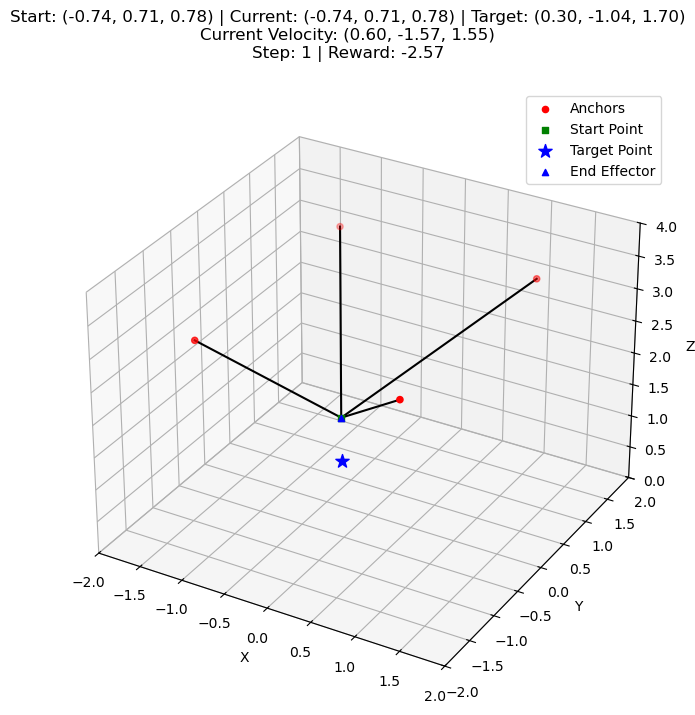

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Episode 1: Total Reward = 6.565872982144356, Done: True, Steps: 12
Final observation: [[ 0.7642561  -0.8033877   0.77730936  0.          0.          0.
  -0.24443153  0.14918384  1.1436101 ]]
Saved GIF to cdpr4_gifs/lurp6bra/episode_1.gif


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Episode 2: Total Reward = 5.0001950562000275, Done: True, Steps: 10
Final observation: [[-0.03899605 -0.90204376  1.7055855   0.          0.          0.
  -0.31358737 -0.5015343   2.974176  ]]
Saved GIF to cdpr4_gifs/lurp6bra/episode_2.gif


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Episode 3: Total Reward = 2.7101054787635803, Done: True, Steps: 12
Final observation: [[-0.6151874   1.1186029   2.4749794   0.          0.          0.
  -0.8055921  -0.6100482   0.55840564]]
Saved GIF to cdpr4_gifs/lurp6bra/episode_3.gif


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Episode 4: Total Reward = -5.602626834064722, Done: True, Steps: 9
Final observation: [[0.6863999  0.11706346 1.9519452  0.         0.         0.
  0.9592829  0.03447621 2.6282532 ]]
Saved GIF to cdpr4_gifs/lurp6bra/episode_4.gif


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Episode 5: Total Reward = 9.146397441625595, Done: True, Steps: 13
Final observation: [[ 0.20895559 -0.20574872  0.83023965  0.          0.          0.
  -0.1558652  -0.8415855   2.1801693 ]]
Saved GIF to cdpr4_gifs/lurp6bra/episode_5.gif


In [6]:
train_single()